In [ ]:
pip install flask requests beautifulsoup4 pandas matplotlib seaborn nltk scikit-learn

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, auc,
                           mean_absolute_error, accuracy_score)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


import matplotlib.font_manager as fm
import platform
plt.rcParams['font.family'] = 'Malgun Gothic'

In [88]:
#%% ==================================================
# Task 1: 환경 설정 및 데이터 로드
#%% ==================================================

print("=" * 50)
print("Task 1: 환경 설정 및 데이터 로드")
print("=" * 50)

# 데이터 로드 (경제지표 포함)
df = pd.read_csv('dart_with_economic_indicators.csv')

print(f"데이터 shape: {df.shape}")
print(f"기업 수: {df['corp_name'].nunique()}")
print(f"기간: {df['year'].min()} ~ {df['year'].max()}")

# 분기 정렬
from pandas import CategoricalDtype
qcat = CategoricalDtype(categories=['Q1','Q2','Q3','Q4'], ordered=True)
df['quarter'] = df['quarter'].astype(qcat)
df = df.sort_values(['corp_name','year','quarter']).reset_index(drop=True)

# 7개 재무지표 정의
feature_cols = ['부채비율', '자기자본비율', 'ROA', 'ROE', 
                '매출액성장률', '영업이익성장률', '순이익성장률']

# 5개 경제지표 정의
economic_cols = ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']

# 결측치 처리
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in economic_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"사용할 재무지표 (7개): {feature_cols}")
print(f"사용할 경제지표 (5개): {economic_cols}")
print("Task 1 완료\n")


Task 1: 환경 설정 및 데이터 로드
데이터 shape: (1172, 21)
기업 수: 32
기간: 2016 ~ 2025
사용할 재무지표 (7개): ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
사용할 경제지표 (5개): ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']
Task 1 완료



In [89]:
#%% ==================================================
# Task 1-1: 경제지표 시프트 (t분기 → t-1분기)
#%% ==================================================

print("=" * 50)
print("Task 1-1: 경제지표 시프트")
print("=" * 50)

# 경제지표를 1분기 앞으로 시프트 (t분기 경제지표로 t분기 위험도 예측하기 위함)
# 구조: t-1분기 재무지표 + t분기 경제지표 → t분기 위험도 예측

print("시프트 전 경제지표 통계:")
for col in economic_cols:
    print(f"{col}: 평균 {df[col].mean():.2f}, 결측치 {df[col].isna().sum()}개")

# 각 기업별로 경제지표를 1분기 앞으로 시프트
for indicator in economic_cols:
    df[f'{indicator}_shifted'] = df.groupby('corp_name')[indicator].shift(-1)

print(f"\n시프트 완료:")
print("- 목적: t-1분기 재무지표 + t분기 경제지표 → t분기 위험도 예측")

# 시프트 후 사용 가능한 데이터 확인
shifted_cols = [f'{col}_shifted' for col in economic_cols]
for col in shifted_cols:
    available = df[col].notna().sum()
    total = len(df)
    print(f"- {col}: {available}/{total} ({available/total*100:.1f}%) 사용 가능")

# 원본 경제지표 컬럼 제거 (시프트된 버전만 사용)
df = df.drop(columns=economic_cols)

print("\n원본 경제지표 컬럼 제거 완료")
print(f"최종 데이터 shape: {df.shape}")
print("Task 1-1 완료\n")

Task 1-1: 경제지표 시프트
시프트 전 경제지표 통계:
construction_bsi_actual: 평균 73.88, 결측치 0개
base_rate: 평균 1.88, 결측치 0개
housing_sale_price: 평균 87.31, 결측치 0개
m2_growth: 평균 0.58, 결측치 0개
credit_spread: 평균 6.13, 결측치 0개

시프트 완료:
- 목적: t-1분기 재무지표 + t분기 경제지표 → t분기 위험도 예측
- construction_bsi_actual_shifted: 1140/1172 (97.3%) 사용 가능
- base_rate_shifted: 1140/1172 (97.3%) 사용 가능
- housing_sale_price_shifted: 1140/1172 (97.3%) 사용 가능
- m2_growth_shifted: 1140/1172 (97.3%) 사용 가능
- credit_spread_shifted: 1140/1172 (97.3%) 사용 가능

원본 경제지표 컬럼 제거 완료
최종 데이터 shape: (1172, 21)
Task 1-1 완료



In [ ]:
#%% ==================================================
# Task 2: 위험 플래그 계산
#%% ==================================================

print("=" * 50)
print("Task 2: 위험 플래그 계산")
print("=" * 50)

g = df.groupby('corp_name', group_keys=False)

# 위험 플래그 계산
df['완전자본잠식'] = (df['자본총계'] < 0).astype(int)
df['연속매출감소'] = g['매출액성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)
df['고부채비율'] = (df['부채비율'] >= 200).astype(int)
df['영업손실연속'] = g['영업이익'].transform(
    lambda s: (s < 0).astype('int8').rolling(4, min_periods=3).sum()
).eq(2).astype(int)
df['ROA악화'] = (df['ROA'] < -5).astype(int)
df['자기자본부족'] = (df['자기자본비율'] < 20).astype(int)
df['매출급감'] = (df['매출액성장률'] < -30).astype(int)
df['영업이익성장률악화'] = g['영업이익성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)

risk_flags = ['완전자본잠식', '연속매출감소', '고부채비율', '영업손실연속', 
              'ROA악화', '자기자본부족', '매출급감', '영업이익성장률악화']

print("위험 플래그 분포:")
for flag in risk_flags:
    count = df[flag].sum()
    print(f"  {flag}: {count}개 ({count/len(df)*100:.1f}%)")

print("Task 2 완료\n")

Task 2: 위험 플래그 계산
위험 플래그 분포:
  완전자본잠식: 6개 (0.5%)
  연속매출감소: 519개 (44.3%)
  고부채비율: 451개 (38.5%)
  영업손실연속: 79개 (6.7%)
  ROA악화: 25개 (2.1%)
  자기자본부족: 114개 (9.7%)
  매출급감: 75개 (6.4%)
  영업이익성장률악화: 635개 (54.2%)
Task 2 완료



In [85]:
#%% ==================================================
# Task 2-5: Optuna 하이퍼파라미터 최적화 (정확도 극대화 버전)
#%% ==================================================

import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

print("=" * 50)
print("Task 2-5: Optuna 하이퍼파라미터 최적화 (정확도 극대화)")
print("=" * 50)

# 기본 설정
def calculate_relative_score(series, reverse=False):
    pr = series.rank(pct=True)
    score = pr * 10 if reverse else (1 - pr) * 10
    return score.fillna(score.mean())

# 더 정교한 검증 데이터 준비
df_sorted = df.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)

# 다음 분기 실제 데이터 생성 (더 현실적인 방법)
def create_next_quarter_target(df_temp):
    """다음 분기 위험도 라벨 생성 - 더 정교한 방법"""
    # 다음 분기 재무지표들을 가져와서 실제 위험도 계산
    next_quarter_data = df_temp.groupby('corp_name').shift(-1)
    
    # 다음 분기의 주요 위험 지표들
    next_debt_ratio = next_quarter_data['부채비율']
    next_roa = next_quarter_data['ROA']
    next_equity_ratio = next_quarter_data['자기자본비율']
    
    # 간단한 규칙 기반 다음 분기 위험도
    risk_score = 0
    risk_score += (next_debt_ratio > 200) * 3  # 고부채
    risk_score += (next_roa < -5) * 2         # ROA 악화
    risk_score += (next_equity_ratio < 20) * 2 # 자기자본 부족
    risk_score += (next_debt_ratio > 300) * 2  # 매우 고부채
    risk_score += (next_roa < -10) * 1        # 매우 악화
    
    # 위험도 라벨 변환
    labels = np.where(risk_score <= 1, 0,      # 안전
             np.where(risk_score <= 3, 1,      # 주의  
             np.where(risk_score <= 5, 2, 3))) # 위험, 매우위험
    
    return labels

# 검증용 데이터 준비
print("검증 데이터 준비 중...")
validation_data = df_sorted.copy()
validation_data['next_quarter_target'] = create_next_quarter_target(validation_data)
validation_data = validation_data[pd.notna(validation_data['next_quarter_target'])].copy()

print(f"최적화용 데이터: {len(validation_data)}개")
print("목표 라벨 분포:")
print(pd.Series(validation_data['next_quarter_target']).value_counts().sort_index())

def objective(trial):
    """Optuna 목적함수 - 정확도 극대화"""
    
    # 1) 가중치 파라미터 제안 (범위 대폭 확장)
    # 재무지표 가중치 - 더 넓은 범위
    flag_score_w = trial.suggest_float('flag_score', 0.15, 0.60)  # 15%~60%
    debt_score_w = trial.suggest_float('debt_score', 0.05, 0.25)  # 5%~25%
    equity_score_w = trial.suggest_float('equity_score', 0.02, 0.20)  # 2%~20%
    roa_score_w = trial.suggest_float('roa_score', 0.05, 0.25)    # 5%~25%
    roe_score_w = trial.suggest_float('roe_score', 0.01, 0.15)    # 1%~15%
    sales_growth_w = trial.suggest_float('sales_growth_score', 0.01, 0.15)  # 1%~15%
    profit_growth_w = trial.suggest_float('profit_growth_score', 0.01, 0.12)  # 1%~12%
    net_growth_w = trial.suggest_float('net_growth_score', 0.001, 0.08)  # 0.1%~8%
    
    # 경제지표 가중치 - 더 넓은 범위  
    bsi_score_w = trial.suggest_float('bsi_score', 0.01, 0.20)     # 1%~20%
    rate_score_w = trial.suggest_float('rate_score', 0.01, 0.15)   # 1%~15%
    housing_score_w = trial.suggest_float('housing_score', 0.01, 0.15)  # 1%~15%
    m2_score_w = trial.suggest_float('m2_score', 0.005, 0.10)      # 0.5%~10%
    spread_score_w = trial.suggest_float('spread_score', 0.005, 0.10)  # 0.5%~10%
    
    # 2) 임계값 파라미터 제안 (더 넓은 범위)
    threshold_1 = trial.suggest_float('threshold_safe_caution', 10, 35)     # 안전-주의
    threshold_2 = trial.suggest_float('threshold_caution_risk', 25, 55)     # 주의-위험  
    threshold_3 = trial.suggest_float('threshold_risk_danger', 45, 80)      # 위험-매우위험
    
    # 임계값 순서 보장
    if threshold_1 >= threshold_2 or threshold_2 >= threshold_3:
        return 0.0
    
    # 3) 추가 하이퍼파라미터
    # 부채비율 클리핑 범위
    debt_clip_max = trial.suggest_int('debt_clip_max', 300, 800)
    
    # ROA 클리핑 범위  
    roa_clip_min = trial.suggest_int('roa_clip_min', -80, -20)
    roa_clip_max = trial.suggest_int('roa_clip_max', 20, 80)
    
    # 기업 규모별 부채비율 가중치
    large_company_weight = trial.suggest_float('large_company_debt_weight', 0.3, 0.8)
    medium_company_weight = trial.suggest_float('medium_company_debt_weight', 0.5, 0.9)
    
    # 가중치 정규화
    total_weight = (flag_score_w + debt_score_w + equity_score_w + roa_score_w + 
                   roe_score_w + sales_growth_w + profit_growth_w + net_growth_w +
                   bsi_score_w + rate_score_w + housing_score_w + m2_score_w + spread_score_w)
    
    weights = {
        'flag_score': flag_score_w / total_weight,
        'debt_score': debt_score_w / total_weight,
        'equity_score': equity_score_w / total_weight,
        'roa_score': roa_score_w / total_weight,
        'roe_score': roe_score_w / total_weight,
        'sales_growth_score': sales_growth_w / total_weight,
        'profit_growth_score': profit_growth_w / total_weight,
        'net_growth_score': net_growth_w / total_weight,
        'bsi_score': bsi_score_w / total_weight,
        'rate_score': rate_score_w / total_weight,
        'housing_score': housing_score_w / total_weight,
        'm2_score': m2_score_w / total_weight,
        'spread_score': spread_score_w / total_weight
    }
    
    try:
        # 임시 데이터프레임으로 작업
        temp_df = validation_data.copy()
        
        # 숫자형 변환
        for c in ['자산총계','부채비율','자기자본비율','ROA','ROE','매출액성장률','영업이익성장률','순이익성장률']:
            temp_df[c] = pd.to_numeric(temp_df[c], errors='coerce')
        
        # 경제지표 전처리
        economic_shifted_cols = ['construction_bsi_actual_shifted', 'base_rate_shifted', 
                               'housing_sale_price_shifted', 'm2_growth_shifted', 'credit_spread_shifted']
        for col in economic_shifted_cols:
            if col in temp_df.columns:
                temp_df[col] = pd.to_numeric(temp_df[col], errors='coerce')
                temp_df[col] = temp_df[col].fillna(temp_df[col].median())
        
        # 기업 규모 분류
        bins = [-np.inf, 1e12, 1e13, np.inf]
        labels = ['중소기업', '중견기업', '대기업']
        temp_df['company_size'] = pd.cut(temp_df['자산총계'], bins=bins, labels=labels, right=False)
        
        # 재무지표 점수 계산 (최적화된 파라미터 적용)
        temp_df['debt_score_base'] = calculate_relative_score(temp_df['부채비율'].clip(0, debt_clip_max), reverse=True)
        temp_df['equity_score'] = calculate_relative_score(temp_df['자기자본비율'].clip(0, 100), reverse=False)
        temp_df['roa_score'] = calculate_relative_score(temp_df['ROA'].clip(roa_clip_min, roa_clip_max), reverse=False)
        temp_df['roe_score'] = calculate_relative_score(temp_df['ROE'].clip(-100, 100), reverse=False)
        temp_df['sales_growth_score'] = calculate_relative_score(temp_df['매출액성장률'].clip(-100, 200), reverse=False)
        temp_df['profit_growth_score'] = calculate_relative_score(temp_df['영업이익성장률'].clip(-200, 500), reverse=False)
        temp_df['net_growth_score'] = calculate_relative_score(temp_df['순이익성장률'].clip(-500, 1000), reverse=False)
        
        # 부채비율 가중치 적용 (최적화된 가중치)
        debt_weight_map = {'대기업': large_company_weight, '중견기업': medium_company_weight, '중소기업': 1.0}
        temp_df['debt_weight'] = temp_df['company_size'].map(debt_weight_map).fillna(1.0)
        temp_df['debt_score'] = temp_df['debt_score_base'] * temp_df['debt_weight']
        
        # 경제지표 점수 계산
        if 'construction_bsi_actual_shifted' in temp_df.columns:
            temp_df['bsi_score'] = calculate_relative_score(temp_df['construction_bsi_actual_shifted'], reverse=False)
        else:
            temp_df['bsi_score'] = 5.0  # 기본값
            
        if 'base_rate_shifted' in temp_df.columns:
            temp_df['rate_score'] = calculate_relative_score(temp_df['base_rate_shifted'], reverse=True)
        else:
            temp_df['rate_score'] = 5.0
            
        if 'housing_sale_price_shifted' in temp_df.columns:
            temp_df['housing_score'] = calculate_relative_score(temp_df['housing_sale_price_shifted'], reverse=False)
        else:
            temp_df['housing_score'] = 5.0
            
        if 'm2_growth_shifted' in temp_df.columns:
            temp_df['m2_score'] = calculate_relative_score(temp_df['m2_growth_shifted'], reverse=False)
        else:
            temp_df['m2_score'] = 5.0
            
        if 'credit_spread_shifted' in temp_df.columns:
            temp_df['spread_score'] = calculate_relative_score(temp_df['credit_spread_shifted'], reverse=True)
        else:
            temp_df['spread_score'] = 5.0
        
        # 휴리스틱 점수 계산
        temp_df['heuristic_score'] = (
            temp_df['flag_score'] * weights['flag_score'] +
            temp_df['debt_score'] * weights['debt_score'] +
            temp_df['equity_score'] * weights['equity_score'] +
            temp_df['roa_score'] * weights['roa_score'] +
            temp_df['roe_score'] * weights['roe_score'] +
            temp_df['sales_growth_score'] * weights['sales_growth_score'] +
            temp_df['profit_growth_score'] * weights['profit_growth_score'] +
            temp_df['net_growth_score'] * weights['net_growth_score'] +
            temp_df['bsi_score'] * weights['bsi_score'] +
            temp_df['rate_score'] * weights['rate_score'] +
            temp_df['housing_score'] * weights['housing_score'] +
            temp_df['m2_score'] * weights['m2_score'] +
            temp_df['spread_score'] * weights['spread_score']
        ) * 10
        
        # 라벨 할당 (최적화된 임계값 사용)
        def assign_optimized_label(score):
            if score <= threshold_1: return 0
            elif score <= threshold_2: return 1    
            elif score <= threshold_3: return 2
            else: return 3
        
        temp_df['heuristic_label'] = temp_df['heuristic_score'].apply(assign_optimized_label)
        
        # 평가
        y_true = temp_df['next_quarter_target'].astype(int)
        y_pred = temp_df['heuristic_label'].astype(int)
        
        if len(temp_df) < 100:  # 충분한 데이터가 없으면
            return 0.0
        
        # 정확도 계산 (주요 목표)
        accuracy = accuracy_score(y_true, y_pred)
        
        # 추가 지표들
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # 클래스 균형 보정 (각 클래스에 최소 1개씩 있는지 확인)
        unique_true = len(np.unique(y_true))
        unique_pred = len(np.unique(y_pred))
        diversity_bonus = min(unique_true, unique_pred) / 4.0  # 최대 1.0
        
        # 최종 점수 (정확도 최우선, 다른 지표들은 보조)
        final_score = (accuracy * 0.70 +           # 정확도 70%
                      precision * 0.10 +          # 정밀도 10%
                      recall * 0.10 +             # 재현율 10%
                      f1 * 0.05 +                 # F1 5%
                      diversity_bonus * 0.05)     # 다양성 보너스 5%
        
        return final_score
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0

# Optuna 최적화 실행 (대폭 강화)
print("Optuna 최적화 시작 (정확도 극대화 모드)...")

# 더 정교한 설정
study = optuna.create_study(
    direction='maximize', 
    study_name='heuristic_accuracy_maximization',
    sampler=optuna.samplers.TPESampler(
        seed=42,
        n_startup_trials=20,      # 초기 랜덤 탐색 증가
        n_ei_candidates=50        # 후보 증가
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10,
        n_warmup_steps=5
    )
)

# 대폭 증가된 최적화 실행
print("Trial 수: 10000회, 시간 제한: 3000초")
study.optimize(objective, n_trials=10000, timeout=3000)  # 30분, 10000회

# 최적 결과 상세 출력
print(f"\n" + "="*60)
print(f"최적화 완료! 최종 점수: {study.best_value:.6f}")
print(f"="*60)

best_params = study.best_params

# 정규화를 위한 총합 계산
financial_params = ['flag_score', 'debt_score', 'equity_score', 'roa_score', 
                   'roe_score', 'sales_growth_score', 'profit_growth_score', 'net_growth_score']
economic_params = ['bsi_score', 'rate_score', 'housing_score', 'm2_score', 'spread_score']
total_weight = sum([best_params[key] for key in financial_params + economic_params])

print(f"\n=== 최적 가중치 (정규화) ===")
print("재무지표:")
financial_total = 0
for param in financial_params:
    normalized_weight = best_params[param] / total_weight
    financial_total += normalized_weight
    print(f"  {param:20s}: {normalized_weight:.4f}")
print(f"재무지표 합계: {financial_total:.4f}")

print(f"\n경제지표:")
economic_total = 0
for param in economic_params:
    normalized_weight = best_params[param] / total_weight
    economic_total += normalized_weight
    print(f"  {param:20s}: {normalized_weight:.4f}")
print(f"경제지표 합계: {economic_total:.4f}")

print(f"\n=== 최적 임계값 ===")
print(f"안전 → 주의:     {best_params['threshold_safe_caution']:.2f}")
print(f"주의 → 위험:     {best_params['threshold_caution_risk']:.2f}")
print(f"위험 → 매우위험: {best_params['threshold_risk_danger']:.2f}")

print(f"\n=== 최적 추가 파라미터 ===")
print(f"부채비율 최대값:        {best_params['debt_clip_max']}")
print(f"ROA 범위:              {best_params['roa_clip_min']} ~ {best_params['roa_clip_max']}")
print(f"대기업 부채비율 가중치:  {best_params['large_company_debt_weight']:.3f}")
print(f"중견기업 부채비율 가중치: {best_params['medium_company_debt_weight']:.3f}")

# 최적 파라미터를 전역 변수로 저장
optimal_heuristic_weights = {}
for param in financial_params + economic_params:
    optimal_heuristic_weights[param] = best_params[param] / total_weight

optimal_assign_heuristic_label = lambda score: (
    0 if score <= best_params['threshold_safe_caution'] else
    1 if score <= best_params['threshold_caution_risk'] else  
    2 if score <= best_params['threshold_risk_danger'] else 3
)

# 추가 최적 파라미터들
optimal_params = {
    'debt_clip_max': best_params['debt_clip_max'],
    'roa_clip_min': best_params['roa_clip_min'], 
    'roa_clip_max': best_params['roa_clip_max'],
    'large_company_debt_weight': best_params['large_company_debt_weight'],
    'medium_company_debt_weight': best_params['medium_company_debt_weight'],
    'thresholds': [
        best_params['threshold_safe_caution'],
        best_params['threshold_caution_risk'], 
        best_params['threshold_risk_danger']
    ]
}

print(f"\n최적화 통계:")
print(f"총 Trial 수: {len(study.trials)}")
print(f"완료된 Trial: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"최고 점수 달성 Trial: {study.best_trial.number}")

print("\nTask 2-5 완료: 최적 파라미터 저장됨 (정확도 극대화 버전)\n")

[I 2025-09-29 00:12:34,346] A new study created in memory with name: heuristic_accuracy_maximization
[I 2025-09-29 00:12:34,361] Trial 0 finished with value: 0.0 and parameters: {'flag_score': 0.31854305348131307, 'debt_score': 0.24014286128198326, 'equity_score': 0.15175890952605292, 'roa_score': 0.1697316968394073, 'roe_score': 0.031842609661941114, 'sales_growth_score': 0.03183923284706837, 'profit_growth_score': 0.016389197338501943, 'net_growth_score': 0.06942791551621988, 'bsi_score': 0.12421185223120967, 'rate_score': 0.10913016089144635, 'housing_score': 0.012881829201412343, 'm2_score': 0.09714143595538946, 'spread_score': 0.08408205087604007, 'threshold_safe_caution': 15.308477766956905, 'threshold_caution_risk': 30.454749016213018, 'threshold_risk_danger': 51.419157844870185, 'debt_clip_max': 452, 'roa_clip_min': -48, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44561457009902095, 'medium_company_debt_weight': 0.7447411578889518}. Best is trial 0 with value: 0.0.
[I 20

Task 2-5: Optuna 하이퍼파라미터 최적화 (정확도 극대화)
검증 데이터 준비 중...
최적화용 데이터: 1140개
목표 라벨 분포:
next_quarter_target
0    687
1    255
2     93
3    105
Name: count, dtype: int64
Optuna 최적화 시작 (정확도 극대화 모드)...
Trial 수: 10000회, 시간 제한: 3000초
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multipl

[I 2025-09-29 00:12:34,545] Trial 14 finished with value: 0.0 and parameters: {'flag_score': 0.4102260634482783, 'debt_score': 0.05718845475934842, 'equity_score': 0.10380764326384284, 'roa_score': 0.15852892694151532, 'roe_score': 0.05011577529795982, 'sales_growth_score': 0.09271665647966149, 'profit_growth_score': 0.013355027493295438, 'net_growth_score': 0.003950506911187939, 'bsi_score': 0.16629410652533508, 'rate_score': 0.0604266897975768, 'housing_score': 0.027788471771263867, 'm2_score': 0.054613109705206414, 'spread_score': 0.07814938754436804, 'threshold_safe_caution': 15.39552568742108, 'threshold_caution_risk': 43.68671427457001, 'threshold_risk_danger': 47.98716127478188, 'debt_clip_max': 325, 'roa_clip_min': -48, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6187149507491032, 'medium_company_debt_weight': 0.7904365334890646}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:34,557] Trial 15 finished with value: 0.0 and parameters: {'flag_score': 0.58913343575814

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:34,783] Trial 24 finished with value: 0.0 and parameters: {'flag_score': 0.33872014029232833, 'debt_score': 0.08856842646930485, 'equity_score': 0.11591342911708641, 'roa_score': 0.20444773562593663, 'roe_score': 0.1019811682004781, 'sales_growth_score': 0.14445676641143318, 'profit_growth_score': 0.05799609305353355, 'net_growth_score': 0.033687165394867574, 'bsi_score': 0.07431548374834887, 'rate_score': 0.10220617283525765, 'housing_score': 0.08950816921719773, 'm2_score': 0.09355112620611135, 'spread_score': 0.06410245036422013, 'threshold_safe_caution': 32.34641513296279, 'threshold_caution_risk': 37.0485296591673, 'threshold_risk_danger': 52.23311390219838, 'debt_clip_max': 469, 'roa_clip_min': -31, 'roa_clip_max': 51, 'large_company_debt_weight': 0.36392087682014823, 'medium_company_debt_weight': 0.6437234088832791}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:34,824] Trial 25 finished with value: 0.0 and parameters: {'flag_score': 0.4575343136131865

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:35,013] Trial 31 finished with value: 0.0 and parameters: {'flag_score': 0.19057572005830717, 'debt_score': 0.09046065851811304, 'equity_score': 0.09150675693947256, 'roa_score': 0.07696157251456834, 'roe_score': 0.14377922590493114, 'sales_growth_score': 0.038454814893689314, 'profit_growth_score': 0.036113943461700035, 'net_growth_score': 0.058714217861677014, 'bsi_score': 0.0358573328554693, 'rate_score': 0.1358383583033777, 'housing_score': 0.07626161495032399, 'm2_score': 0.08935034438471649, 'spread_score': 0.09219621016941001, 'threshold_safe_caution': 10.766732345574397, 'threshold_caution_risk': 27.027947177659012, 'threshold_risk_danger': 65.78178289676217, 'debt_clip_max': 511, 'roa_clip_min': -33, 'roa_clip_max': 69, 'large_company_debt_weight': 0.34585518337630844, 'medium_company_debt_weight': 0.6403877234043074}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:35,051] Trial 32 finished with value: 0.0 and parameters: {'flag_score': 0.182314858783

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:35,239] Trial 37 finished with value: 0.0 and parameters: {'flag_score': 0.2815848477277485, 'debt_score': 0.13713226241902737, 'equity_score': 0.04855302206440788, 'roa_score': 0.15524997105170424, 'roe_score': 0.09187936795653834, 'sales_growth_score': 0.09215048393182944, 'profit_growth_score': 0.026669863938556748, 'net_growth_score': 0.049227561903742986, 'bsi_score': 0.04146904195546343, 'rate_score': 0.13747603343660444, 'housing_score': 0.04231833755808807, 'm2_score': 0.005600490826513864, 'spread_score': 0.07101275511495096, 'threshold_safe_caution': 20.93817417930685, 'threshold_caution_risk': 34.03540284029711, 'threshold_risk_danger': 72.39418535688287, 'debt_clip_max': 340, 'roa_clip_min': -63, 'roa_clip_max': 79, 'large_company_debt_weight': 0.3005547739085454, 'medium_company_debt_weight': 0.723956341282177}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:35,281] Trial 38 finished with value: 0.0 and parameters: {'flag_score': 0.444237285578116

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:35,456] Trial 43 finished with value: 0.0 and parameters: {'flag_score': 0.17580320283459266, 'debt_score': 0.2474836677229346, 'equity_score': 0.1387108881767311, 'roa_score': 0.17974266069051684, 'roe_score': 0.015894996993889274, 'sales_growth_score': 0.07644912568731903, 'profit_growth_score': 0.035497773944041744, 'net_growth_score': 0.051107664123270155, 'bsi_score': 0.18688657857307678, 'rate_score': 0.13179446664034422, 'housing_score': 0.02692413372528059, 'm2_score': 0.00924444532617951, 'spread_score': 0.07480137378404358, 'threshold_safe_caution': 15.977936994589399, 'threshold_caution_risk': 49.31360796261262, 'threshold_risk_danger': 63.53747167806996, 'debt_clip_max': 506, 'roa_clip_min': -43, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4147384302652844, 'medium_company_debt_weight': 0.8219815714796443}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:35,500] Trial 44 finished with value: 0.0 and parameters: {'flag_score': 0.24583116589648

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:35,667] Trial 48 finished with value: 0.0 and parameters: {'flag_score': 0.2815422197938899, 'debt_score': 0.20879955730147667, 'equity_score': 0.13105470503163583, 'roa_score': 0.10237329510681938, 'roe_score': 0.12440288105024702, 'sales_growth_score': 0.024335575310325902, 'profit_growth_score': 0.04237157479968834, 'net_growth_score': 0.06099847627601651, 'bsi_score': 0.019049156347586083, 'rate_score': 0.1431384216681733, 'housing_score': 0.04614073077650766, 'm2_score': 0.09540735728058274, 'spread_score': 0.030226115033796404, 'threshold_safe_caution': 30.688778123352034, 'threshold_caution_risk': 38.34107868745792, 'threshold_risk_danger': 60.481167331430996, 'debt_clip_max': 610, 'roa_clip_min': -62, 'roa_clip_max': 54, 'large_company_debt_weight': 0.406653228519485, 'medium_company_debt_weight': 0.6154140707132927}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:35,711] Trial 49 finished with value: 0.0 and parameters: {'flag_score': 0.16533278464332

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:35,909] Trial 53 finished with value: 0.0 and parameters: {'flag_score': 0.17669656409750256, 'debt_score': 0.14221540258019566, 'equity_score': 0.0353003747781907, 'roa_score': 0.17344338423316222, 'roe_score': 0.11481739918532623, 'sales_growth_score': 0.061626538306308584, 'profit_growth_score': 0.061664731163046854, 'net_growth_score': 0.07636200610132084, 'bsi_score': 0.04366718113302323, 'rate_score': 0.06101958103729496, 'housing_score': 0.07356764934572958, 'm2_score': 0.026602150630604254, 'spread_score': 0.09162461126596888, 'threshold_safe_caution': 34.15192503089157, 'threshold_caution_risk': 40.78166241137326, 'threshold_risk_danger': 78.75484677337595, 'debt_clip_max': 774, 'roa_clip_min': -51, 'roa_clip_max': 71, 'large_company_debt_weight': 0.5311708613582837, 'medium_company_debt_weight': 0.8165755858440239}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:35,951] Trial 54 finished with value: 0.0 and parameters: {'flag_score': 0.50517164684685

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:36,123] Trial 58 finished with value: 0.0 and parameters: {'flag_score': 0.3147175987030425, 'debt_score': 0.2498291954272605, 'equity_score': 0.08420041354975956, 'roa_score': 0.18103370795699586, 'roe_score': 0.045640901751591474, 'sales_growth_score': 0.055377457463738594, 'profit_growth_score': 0.06917701290511141, 'net_growth_score': 0.007693249310543526, 'bsi_score': 0.08591256565987143, 'rate_score': 0.11903272554821982, 'housing_score': 0.04096466580519782, 'm2_score': 0.023770823091708214, 'spread_score': 0.05637781695516845, 'threshold_safe_caution': 18.11521869002154, 'threshold_caution_risk': 35.715440954505446, 'threshold_risk_danger': 51.3720812530535, 'debt_clip_max': 561, 'roa_clip_min': -30, 'roa_clip_max': 73, 'large_company_debt_weight': 0.4477674927414229, 'medium_company_debt_weight': 0.6885013511965404}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:36,144] Trial 59 finished with value: 0.0 and parameters: {'flag_score': 0.16351131347313

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:36,350] Trial 66 finished with value: 0.0 and parameters: {'flag_score': 0.47322739683067777, 'debt_score': 0.10129730994442072, 'equity_score': 0.08044300760855293, 'roa_score': 0.09076054469557919, 'roe_score': 0.07956657675504732, 'sales_growth_score': 0.02644035300893901, 'profit_growth_score': 0.038674537605996546, 'net_growth_score': 0.009295882006966238, 'bsi_score': 0.08426964371330489, 'rate_score': 0.11218017618714743, 'housing_score': 0.07057973722875603, 'm2_score': 0.09680096982478838, 'spread_score': 0.08981833292812949, 'threshold_safe_caution': 29.61512904331776, 'threshold_caution_risk': 35.163353644559834, 'threshold_risk_danger': 53.16791227397117, 'debt_clip_max': 710, 'roa_clip_min': -66, 'roa_clip_max': 78, 'large_company_debt_weight': 0.346950240231756, 'medium_company_debt_weight': 0.5501344219759091}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:36,392] Trial 67 finished with value: 0.0 and parameters: {'flag_score': 0.53637718636058

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:36,581] Trial 72 finished with value: 0.0 and parameters: {'flag_score': 0.35210679876945367, 'debt_score': 0.12110846273271222, 'equity_score': 0.136580524322027, 'roa_score': 0.08136840148851147, 'roe_score': 0.08618393499829904, 'sales_growth_score': 0.06531521690320675, 'profit_growth_score': 0.015129222972768037, 'net_growth_score': 0.011460535350148533, 'bsi_score': 0.19905774639008733, 'rate_score': 0.020035430801989385, 'housing_score': 0.034885577782789896, 'm2_score': 0.06646701380095638, 'spread_score': 0.09276034781836165, 'threshold_safe_caution': 12.317296022947678, 'threshold_caution_risk': 42.35773315293628, 'threshold_risk_danger': 74.07848213409895, 'debt_clip_max': 356, 'roa_clip_min': -41, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6865263980041498, 'medium_company_debt_weight': 0.7699850073747346}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:36,627] Trial 73 finished with value: 0.0 and parameters: {'flag_score': 0.3175347768723

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:36,823] Trial 78 finished with value: 0.0 and parameters: {'flag_score': 0.3302391277209876, 'debt_score': 0.1959943191201779, 'equity_score': 0.04794433970496442, 'roa_score': 0.1189178368775706, 'roe_score': 0.1197617406850587, 'sales_growth_score': 0.07233216461958208, 'profit_growth_score': 0.03858001281217123, 'net_growth_score': 0.06647149935193225, 'bsi_score': 0.024963400916443203, 'rate_score': 0.0271737198339908, 'housing_score': 0.09780366405313966, 'm2_score': 0.01950975741851859, 'spread_score': 0.06162949742622934, 'threshold_safe_caution': 34.36114229462491, 'threshold_caution_risk': 45.39466376630765, 'threshold_risk_danger': 46.47347541510216, 'debt_clip_max': 461, 'roa_clip_min': -24, 'roa_clip_max': 62, 'large_company_debt_weight': 0.6114521162412314, 'medium_company_debt_weight': 0.6268492723327348}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:36,869] Trial 79 finished with value: 0.0 and parameters: {'flag_score': 0.19668056427680922, '

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:37,048] Trial 83 finished with value: 0.0 and parameters: {'flag_score': 0.15047612681631684, 'debt_score': 0.0910414986928855, 'equity_score': 0.17105613524163932, 'roa_score': 0.16416255924708784, 'roe_score': 0.03657468457658662, 'sales_growth_score': 0.0424964673624682, 'profit_growth_score': 0.07876853874676841, 'net_growth_score': 0.04326139766628202, 'bsi_score': 0.02154989458119411, 'rate_score': 0.12499026677049424, 'housing_score': 0.03884675327776483, 'm2_score': 0.07621756916542682, 'spread_score': 0.023615975870448787, 'threshold_safe_caution': 27.231115195009814, 'threshold_caution_risk': 35.17514579624262, 'threshold_risk_danger': 76.65016023467415, 'debt_clip_max': 417, 'roa_clip_min': -63, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3357282725877776, 'medium_company_debt_weight': 0.7898825695689284}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:37,097] Trial 84 finished with value: 0.0 and parameters: {'flag_score': 0.2197944569738976

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:37,261] Trial 88 finished with value: 0.0 and parameters: {'flag_score': 0.1623016480915327, 'debt_score': 0.05997971334541204, 'equity_score': 0.05776536267552617, 'roa_score': 0.1374179628296162, 'roe_score': 0.05504004395940704, 'sales_growth_score': 0.04718161726490343, 'profit_growth_score': 0.08399025473403449, 'net_growth_score': 0.07316451626760213, 'bsi_score': 0.04878910505783481, 'rate_score': 0.0341872372557091, 'housing_score': 0.028121242901079722, 'm2_score': 0.035479202386722516, 'spread_score': 0.034443527369181846, 'threshold_safe_caution': 20.248965146681037, 'threshold_caution_risk': 36.10941853018045, 'threshold_risk_danger': 76.20211937880674, 'debt_clip_max': 686, 'roa_clip_min': -40, 'roa_clip_max': 45, 'large_company_debt_weight': 0.39831723045690637, 'medium_company_debt_weight': 0.5828793408277669}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:37,283] Trial 89 finished with value: 0.0 and parameters: {'flag_score': 0.35143565198430

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:37,515] Trial 94 finished with value: 0.0 and parameters: {'flag_score': 0.3300837271427759, 'debt_score': 0.22294334632679824, 'equity_score': 0.14973751155664877, 'roa_score': 0.17773052398748518, 'roe_score': 0.10614936846429944, 'sales_growth_score': 0.05490563184145748, 'profit_growth_score': 0.010843249869438437, 'net_growth_score': 0.06578724056070495, 'bsi_score': 0.13574929210651315, 'rate_score': 0.11358669591039391, 'housing_score': 0.054035640887789387, 'm2_score': 0.04230230145808834, 'spread_score': 0.08273144403664796, 'threshold_safe_caution': 28.230778390203604, 'threshold_caution_risk': 43.29725121018635, 'threshold_risk_danger': 52.21516548697357, 'debt_clip_max': 643, 'roa_clip_min': -53, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5679641958537958, 'medium_company_debt_weight': 0.8055452034619514}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:37,568] Trial 95 finished with value: 0.0 and parameters: {'flag_score': 0.24164673775981

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:37,757] Trial 99 finished with value: 0.0 and parameters: {'flag_score': 0.2908648192602779, 'debt_score': 0.12149929347587192, 'equity_score': 0.1598172077251283, 'roa_score': 0.20257998137788671, 'roe_score': 0.04778301135588091, 'sales_growth_score': 0.024614933795034655, 'profit_growth_score': 0.0426353050000177, 'net_growth_score': 0.06270044695741046, 'bsi_score': 0.18325680265843286, 'rate_score': 0.08863224098571706, 'housing_score': 0.05151576650905069, 'm2_score': 0.09701587620975774, 'spread_score': 0.08554445974115853, 'threshold_safe_caution': 31.54623483636749, 'threshold_caution_risk': 45.937761566533496, 'threshold_risk_danger': 74.4175518690938, 'debt_clip_max': 672, 'roa_clip_min': -77, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7201936924422144, 'medium_company_debt_weight': 0.7388897585451525}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:37,805] Trial 100 finished with value: 0.0 and parameters: {'flag_score': 0.17127564094073208

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:38,002] Trial 104 finished with value: 0.0 and parameters: {'flag_score': 0.5241598686992639, 'debt_score': 0.1063317652366078, 'equity_score': 0.08394380602107755, 'roa_score': 0.058851681196607546, 'roe_score': 0.029389255878373537, 'sales_growth_score': 0.08772443878674192, 'profit_growth_score': 0.08688732380777577, 'net_growth_score': 0.07496338962298603, 'bsi_score': 0.04534074186421756, 'rate_score': 0.11404714112555513, 'housing_score': 0.056530322586279366, 'm2_score': 0.02900288357166929, 'spread_score': 0.06944796575405225, 'threshold_safe_caution': 23.25060905763748, 'threshold_caution_risk': 47.52531278973654, 'threshold_risk_danger': 56.53172973849952, 'debt_clip_max': 638, 'roa_clip_min': -72, 'roa_clip_max': 71, 'large_company_debt_weight': 0.35844426918483724, 'medium_company_debt_weight': 0.6034420315089507}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:38,052] Trial 105 finished with value: 0.0 and parameters: {'flag_score': 0.207373938934

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:38,247] Trial 109 finished with value: 0.0 and parameters: {'flag_score': 0.2594724294584299, 'debt_score': 0.2142602317926912, 'equity_score': 0.14041415077672426, 'roa_score': 0.09307652490594455, 'roe_score': 0.05860001975219026, 'sales_growth_score': 0.07844967523781546, 'profit_growth_score': 0.013598376366417154, 'net_growth_score': 0.07778885031693326, 'bsi_score': 0.02320220627037136, 'rate_score': 0.10268727874669441, 'housing_score': 0.0380261703652673, 'm2_score': 0.04038773783533865, 'spread_score': 0.048292136822866996, 'threshold_safe_caution': 12.60394357710108, 'threshold_caution_risk': 42.144844493802054, 'threshold_risk_danger': 77.1513021306328, 'debt_clip_max': 550, 'roa_clip_min': -42, 'roa_clip_max': 67, 'large_company_debt_weight': 0.31451540162161573, 'medium_company_debt_weight': 0.6928682808924964}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:38,296] Trial 110 finished with value: 0.0 and parameters: {'flag_score': 0.30787051958992

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:38,469] Trial 114 finished with value: 0.0 and parameters: {'flag_score': 0.5996599872802906, 'debt_score': 0.10311962448391018, 'equity_score': 0.03035553531277662, 'roa_score': 0.13897734126770975, 'roe_score': 0.01831296425726144, 'sales_growth_score': 0.07543346341861708, 'profit_growth_score': 0.07401849883784457, 'net_growth_score': 0.03131545277266014, 'bsi_score': 0.18972664429049546, 'rate_score': 0.07760128489927175, 'housing_score': 0.06649058120805103, 'm2_score': 0.013222881883465206, 'spread_score': 0.06232565818475406, 'threshold_safe_caution': 16.154483269695465, 'threshold_caution_risk': 53.105319106436525, 'threshold_risk_danger': 77.60229279172032, 'debt_clip_max': 729, 'roa_clip_min': -52, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7625620679501037, 'medium_company_debt_weight': 0.666928395438541}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:38,520] Trial 115 finished with value: 0.0 and parameters: {'flag_score': 0.1508028866716

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:38,718] Trial 119 finished with value: 0.0 and parameters: {'flag_score': 0.39476403908604607, 'debt_score': 0.12414289495391999, 'equity_score': 0.1624974681542259, 'roa_score': 0.1154352600965517, 'roe_score': 0.10892278316620845, 'sales_growth_score': 0.12662779709942826, 'profit_growth_score': 0.019640805070306473, 'net_growth_score': 0.06091805192563767, 'bsi_score': 0.018134233467693658, 'rate_score': 0.03970446014320877, 'housing_score': 0.039921825238103226, 'm2_score': 0.005042584377659085, 'spread_score': 0.08740784066021182, 'threshold_safe_caution': 12.042883878345435, 'threshold_caution_risk': 27.57427439765295, 'threshold_risk_danger': 73.51097982448722, 'debt_clip_max': 465, 'roa_clip_min': -70, 'roa_clip_max': 73, 'large_company_debt_weight': 0.3893074921229417, 'medium_company_debt_weight': 0.7754016161819719}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:38,769] Trial 120 finished with value: 0.0 and parameters: {'flag_score': 0.16617843094

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:38,964] Trial 126 finished with value: 0.0 and parameters: {'flag_score': 0.5696743194863668, 'debt_score': 0.06282157634748482, 'equity_score': 0.10575305407171856, 'roa_score': 0.1728790674631468, 'roe_score': 0.12109566464375787, 'sales_growth_score': 0.05109179878088786, 'profit_growth_score': 0.08262529360343289, 'net_growth_score': 0.011609828759321185, 'bsi_score': 0.058567092551968764, 'rate_score': 0.06927734934451699, 'housing_score': 0.029216829507706262, 'm2_score': 0.07738459321880299, 'spread_score': 0.010708301311069444, 'threshold_safe_caution': 25.70170653042091, 'threshold_caution_risk': 41.46069086186583, 'threshold_risk_danger': 54.276087015775346, 'debt_clip_max': 434, 'roa_clip_min': -39, 'roa_clip_max': 21, 'large_company_debt_weight': 0.37070437625288905, 'medium_company_debt_weight': 0.7090023590405156}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:39,020] Trial 127 finished with value: 0.0 and parameters: {'flag_score': 0.1580541254

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:39,211] Trial 131 finished with value: 0.0 and parameters: {'flag_score': 0.40530083376489573, 'debt_score': 0.2185841845835288, 'equity_score': 0.16927236404437643, 'roa_score': 0.18193766745791096, 'roe_score': 0.11673728737324277, 'sales_growth_score': 0.06043779530601997, 'profit_growth_score': 0.04525439555610894, 'net_growth_score': 0.06726770811373253, 'bsi_score': 0.1653351375071566, 'rate_score': 0.12959850916827462, 'housing_score': 0.1400833183100208, 'm2_score': 0.06127238339080109, 'spread_score': 0.045143456690777024, 'threshold_safe_caution': 28.780553393957955, 'threshold_caution_risk': 44.92065585533485, 'threshold_risk_danger': 71.29628394445083, 'debt_clip_max': 677, 'roa_clip_min': -21, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4624964343235646, 'medium_company_debt_weight': 0.5298603047995668}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:39,297] Trial 132 finished with value: 0.0 and parameters: {'flag_score': 0.379678923065736

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:39,457] Trial 135 finished with value: 0.0 and parameters: {'flag_score': 0.3846814317401844, 'debt_score': 0.20904610200794693, 'equity_score': 0.17353114054225757, 'roa_score': 0.17784127877689723, 'roe_score': 0.12919747997592074, 'sales_growth_score': 0.04892213549191342, 'profit_growth_score': 0.047740610915010195, 'net_growth_score': 0.05532787342077447, 'bsi_score': 0.10312822148941066, 'rate_score': 0.11785922743792125, 'housing_score': 0.1301923718312346, 'm2_score': 0.04456700370283138, 'spread_score': 0.07346928245995188, 'threshold_safe_caution': 32.97412177208219, 'threshold_caution_risk': 49.74783340272961, 'threshold_risk_danger': 70.42908975320137, 'debt_clip_max': 744, 'roa_clip_min': -32, 'roa_clip_max': 47, 'large_company_debt_weight': 0.35413316397403916, 'medium_company_debt_weight': 0.5140531643427525}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:39,512] Trial 136 finished with value: 0.0 and parameters: {'flag_score': 0.34018057106292

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:39,696] Trial 140 finished with value: 0.0 and parameters: {'flag_score': 0.3611750467232575, 'debt_score': 0.1779966464656762, 'equity_score': 0.14661412697738105, 'roa_score': 0.16294969999246794, 'roe_score': 0.12360590028719934, 'sales_growth_score': 0.14892751801437065, 'profit_growth_score': 0.03540767001430467, 'net_growth_score': 0.056926613651666715, 'bsi_score': 0.0375568246423172, 'rate_score': 0.10054962301379158, 'housing_score': 0.04176015873077974, 'm2_score': 0.09819823901892583, 'spread_score': 0.027336605378823382, 'threshold_safe_caution': 27.485034448223526, 'threshold_caution_risk': 33.62513684839399, 'threshold_risk_danger': 50.93056312560531, 'debt_clip_max': 641, 'roa_clip_min': -59, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4005527882917241, 'medium_company_debt_weight': 0.6140625906524153}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:39,749] Trial 141 finished with value: 0.0 and parameters: {'flag_score': 0.40085437361467

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:39,933] Trial 145 finished with value: 0.0 and parameters: {'flag_score': 0.41086811466656675, 'debt_score': 0.07415324178390989, 'equity_score': 0.08325622362655921, 'roa_score': 0.13332373755794777, 'roe_score': 0.061070769380785456, 'sales_growth_score': 0.132166053768929, 'profit_growth_score': 0.01936862082394881, 'net_growth_score': 0.05135942062688426, 'bsi_score': 0.16019568831976, 'rate_score': 0.0487533720940542, 'housing_score': 0.034675094061031586, 'm2_score': 0.015445666011132508, 'spread_score': 0.05106335295497431, 'threshold_safe_caution': 14.294357259618778, 'threshold_caution_risk': 45.21661370613033, 'threshold_risk_danger': 52.9465002144899, 'debt_clip_max': 362, 'roa_clip_min': -73, 'roa_clip_max': 65, 'large_company_debt_weight': 0.6201596491692933, 'medium_company_debt_weight': 0.7958116491970448}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:39,959] Trial 146 finished with value: 0.0 and parameters: {'flag_score': 0.34954729856217875

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:40,143] Trial 150 finished with value: 0.0 and parameters: {'flag_score': 0.22240398377965276, 'debt_score': 0.2226463888099467, 'equity_score': 0.08984649417501861, 'roa_score': 0.17309932283679574, 'roe_score': 0.05484167488467462, 'sales_growth_score': 0.08693969993110885, 'profit_growth_score': 0.05363900958439293, 'net_growth_score': 0.012952522187717301, 'bsi_score': 0.18542247765570788, 'rate_score': 0.09734725079166119, 'housing_score': 0.0246939670774771, 'm2_score': 0.04869083906973338, 'spread_score': 0.019776289123514583, 'threshold_safe_caution': 25.103540375043774, 'threshold_caution_risk': 54.98410934715162, 'threshold_risk_danger': 72.7494382955286, 'debt_clip_max': 337, 'roa_clip_min': -50, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5658946102929143, 'medium_company_debt_weight': 0.865621082452052}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:40,198] Trial 151 finished with value: 0.0 and parameters: {'flag_score': 0.587970609767617

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:40,358] Trial 154 finished with value: 0.0 and parameters: {'flag_score': 0.5750335834344725, 'debt_score': 0.12159413081454873, 'equity_score': 0.14128973784395174, 'roa_score': 0.21811229183311348, 'roe_score': 0.050260369255065204, 'sales_growth_score': 0.07179832258405552, 'profit_growth_score': 0.040218004901591525, 'net_growth_score': 0.00823602625073393, 'bsi_score': 0.12375271256257406, 'rate_score': 0.11910930880402056, 'housing_score': 0.04509336384151428, 'm2_score': 0.051510025565936264, 'spread_score': 0.024422679359846516, 'threshold_safe_caution': 19.072259174535642, 'threshold_caution_risk': 29.71183081103659, 'threshold_risk_danger': 67.67297349631183, 'debt_clip_max': 349, 'roa_clip_min': -45, 'roa_clip_max': 45, 'large_company_debt_weight': 0.418803239523919, 'medium_company_debt_weight': 0.8553830071255757}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:40,422] Trial 155 finished with value: 0.0 and parameters: {'flag_score': 0.52982800827

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:40,633] Trial 159 finished with value: 0.0 and parameters: {'flag_score': 0.4265104385898954, 'debt_score': 0.16824700197203304, 'equity_score': 0.09884655656825987, 'roa_score': 0.21312053827900032, 'roe_score': 0.14431824797638781, 'sales_growth_score': 0.09508462466513296, 'profit_growth_score': 0.0463181234175846, 'net_growth_score': 0.06410006613618754, 'bsi_score': 0.18193821912021288, 'rate_score': 0.0713760446435385, 'housing_score': 0.07480361990372894, 'm2_score': 0.04003274156557899, 'spread_score': 0.0651305612145891, 'threshold_safe_caution': 26.79667796783261, 'threshold_caution_risk': 27.030481603759892, 'threshold_risk_danger': 77.00406005165995, 'debt_clip_max': 380, 'roa_clip_min': -77, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6402043554222503, 'medium_company_debt_weight': 0.5389437862417858}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:40,660] Trial 160 finished with value: 0.0 and parameters: {'flag_score': 0.5908593527967732,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:40,877] Trial 164 finished with value: 0.0 and parameters: {'flag_score': 0.1994651328487329, 'debt_score': 0.16330919424484602, 'equity_score': 0.09216375949102887, 'roa_score': 0.09546745595826914, 'roe_score': 0.06253800976912251, 'sales_growth_score': 0.06397761624896885, 'profit_growth_score': 0.0776798791557272, 'net_growth_score': 0.003859902675983005, 'bsi_score': 0.013663220612321472, 'rate_score': 0.011183797312802767, 'housing_score': 0.14175202890899766, 'm2_score': 0.06683012802469758, 'spread_score': 0.08171903251573363, 'threshold_safe_caution': 12.346975716374807, 'threshold_caution_risk': 36.458166043667624, 'threshold_risk_danger': 59.029150472264014, 'debt_clip_max': 761, 'roa_clip_min': -61, 'roa_clip_max': 25, 'large_company_debt_weight': 0.5852601006483598, 'medium_company_debt_weight': 0.7693594715217}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:40,933] Trial 165 finished with value: 0.0 and parameters: {'flag_score': 0.4393188274742

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:41,171] Trial 169 finished with value: 0.0 and parameters: {'flag_score': 0.30309142460335087, 'debt_score': 0.151178076027979, 'equity_score': 0.09633786054718962, 'roa_score': 0.1797583027152148, 'roe_score': 0.05959917239343822, 'sales_growth_score': 0.04014606200905608, 'profit_growth_score': 0.011455151953192723, 'net_growth_score': 0.03869571567033291, 'bsi_score': 0.05826860920831342, 'rate_score': 0.14070404801239395, 'housing_score': 0.036620357656751146, 'm2_score': 0.06051979239204731, 'spread_score': 0.026650347185491054, 'threshold_safe_caution': 33.35654445265054, 'threshold_caution_risk': 43.936310301038034, 'threshold_risk_danger': 48.8612724446138, 'debt_clip_max': 622, 'roa_clip_min': -56, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4345239552501398, 'medium_company_debt_weight': 0.5760039817546712}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:41,237] Trial 170 finished with value: 0.0 and parameters: {'flag_score': 0.16390620780808

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:41,420] Trial 173 finished with value: 0.0 and parameters: {'flag_score': 0.36605002785303653, 'debt_score': 0.12695145577888, 'equity_score': 0.13222103713218203, 'roa_score': 0.15735045780534349, 'roe_score': 0.12528591058825436, 'sales_growth_score': 0.10523980906389503, 'profit_growth_score': 0.028911513264166737, 'net_growth_score': 0.04217053051660672, 'bsi_score': 0.14378459055010773, 'rate_score': 0.01396466812792429, 'housing_score': 0.10883141376728883, 'm2_score': 0.09457938703042325, 'spread_score': 0.05207942368719243, 'threshold_safe_caution': 14.724102914871164, 'threshold_caution_risk': 45.172120305350916, 'threshold_risk_danger': 65.3782599098889, 'debt_clip_max': 611, 'roa_clip_min': -27, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7652983149690838, 'medium_company_debt_weight': 0.8774011340577861}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:41,481] Trial 174 finished with value: 0.0 and parameters: {'flag_score': 0.158846049286224

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:41,656] Trial 177 finished with value: 0.0 and parameters: {'flag_score': 0.38968343688156637, 'debt_score': 0.2415101498008037, 'equity_score': 0.11712642838261379, 'roa_score': 0.16948476137204824, 'roe_score': 0.027563360555173097, 'sales_growth_score': 0.11777098078719138, 'profit_growth_score': 0.08599724606254541, 'net_growth_score': 0.059840877011794205, 'bsi_score': 0.11649046689378695, 'rate_score': 0.12587814296407732, 'housing_score': 0.10181926004353062, 'm2_score': 0.0852036191503983, 'spread_score': 0.016065341494704833, 'threshold_safe_caution': 20.034415707198104, 'threshold_caution_risk': 49.997186962958466, 'threshold_risk_danger': 71.51326789628844, 'debt_clip_max': 656, 'roa_clip_min': -54, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4905154229478005, 'medium_company_debt_weight': 0.6732987891473252}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:41,715] Trial 178 finished with value: 0.0 and parameters: {'flag_score': 0.45453323025

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:41,881] Trial 182 finished with value: 0.0 and parameters: {'flag_score': 0.23766499983222017, 'debt_score': 0.056710090549829596, 'equity_score': 0.04465266385348807, 'roa_score': 0.05738704822947605, 'roe_score': 0.02419639019981317, 'sales_growth_score': 0.10834083285608397, 'profit_growth_score': 0.013529249182282677, 'net_growth_score': 0.02575782276472998, 'bsi_score': 0.17255129799332486, 'rate_score': 0.016521414686703918, 'housing_score': 0.13044853814459753, 'm2_score': 0.0384978018199668, 'spread_score': 0.018370853988303636, 'threshold_safe_caution': 25.723874963854975, 'threshold_caution_risk': 46.12983184657151, 'threshold_risk_danger': 74.19643145384622, 'debt_clip_max': 693, 'roa_clip_min': -35, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3872600337551457, 'medium_company_debt_weight': 0.779915561516227}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:41,939] Trial 183 finished with value: 0.0 and parameters: {'flag_score': 0.26448395553

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:42,113] Trial 186 finished with value: 0.0 and parameters: {'flag_score': 0.2726410531472039, 'debt_score': 0.21500002544552288, 'equity_score': 0.04918042360780345, 'roa_score': 0.0564213516562526, 'roe_score': 0.034963645020217135, 'sales_growth_score': 0.04429591581062694, 'profit_growth_score': 0.016443354384677433, 'net_growth_score': 0.02197300362164413, 'bsi_score': 0.16142716206941496, 'rate_score': 0.1287809963426885, 'housing_score': 0.03197983657633162, 'm2_score': 0.019164146632431867, 'spread_score': 0.060669535060168395, 'threshold_safe_caution': 15.206377313831448, 'threshold_caution_risk': 44.69822211085954, 'threshold_risk_danger': 63.06211480770047, 'debt_clip_max': 687, 'roa_clip_min': -71, 'roa_clip_max': 36, 'large_company_debt_weight': 0.33242196025159565, 'medium_company_debt_weight': 0.8028430736184562}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:42,155] Trial 187 finished with value: 0.0 and parameters: {'flag_score': 0.20026850434

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:42,320] Trial 190 finished with value: 0.0 and parameters: {'flag_score': 0.1708889724465175, 'debt_score': 0.05419587340417052, 'equity_score': 0.18169867891339908, 'roa_score': 0.11889408566270203, 'roe_score': 0.05143470499662924, 'sales_growth_score': 0.1117734821868778, 'profit_growth_score': 0.11595770517973586, 'net_growth_score': 0.05657222974453335, 'bsi_score': 0.02937783881801342, 'rate_score': 0.11216485104396448, 'housing_score': 0.13331138704734735, 'm2_score': 0.04141967048942484, 'spread_score': 0.01624614680288957, 'threshold_safe_caution': 14.378682830781091, 'threshold_caution_risk': 41.14772624377782, 'threshold_risk_danger': 78.30115527923653, 'debt_clip_max': 328, 'roa_clip_min': -33, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7907950467097548, 'medium_company_debt_weight': 0.8481823659542866}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:42,378] Trial 191 finished with value: 0.0 and parameters: {'flag_score': 0.555161683460678

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:42,540] Trial 194 finished with value: 0.0 and parameters: {'flag_score': 0.5846565806388674, 'debt_score': 0.2453059299831216, 'equity_score': 0.09162931536268121, 'roa_score': 0.1544564642855411, 'roe_score': 0.12203853532498643, 'sales_growth_score': 0.01240787810076691, 'profit_growth_score': 0.09624436244756922, 'net_growth_score': 0.06948404328469665, 'bsi_score': 0.06201410383806538, 'rate_score': 0.11707252490118268, 'housing_score': 0.052824863476646465, 'm2_score': 0.006889545266624719, 'spread_score': 0.07790651017607565, 'threshold_safe_caution': 24.5151146540381, 'threshold_caution_risk': 48.404499745485325, 'threshold_risk_danger': 56.57500833545797, 'debt_clip_max': 767, 'roa_clip_min': -22, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7617030860592516, 'medium_company_debt_weight': 0.7468543796164959}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:42,622] Trial 195 finished with value: 0.0 and parameters: {'flag_score': 0.537895610858651

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:42,742] Trial 197 finished with value: 0.0 and parameters: {'flag_score': 0.5993125305584026, 'debt_score': 0.110333248475331, 'equity_score': 0.08390508374399927, 'roa_score': 0.11686122648081904, 'roe_score': 0.0680780186288098, 'sales_growth_score': 0.07706842228447164, 'profit_growth_score': 0.04715560478541833, 'net_growth_score': 0.040804789429147975, 'bsi_score': 0.16995105424843795, 'rate_score': 0.0432171465362981, 'housing_score': 0.11047577149553811, 'm2_score': 0.05868401535648637, 'spread_score': 0.09074063553487255, 'threshold_safe_caution': 25.218990141200738, 'threshold_caution_risk': 34.187971872020256, 'threshold_risk_danger': 72.03852253302193, 'debt_clip_max': 353, 'roa_clip_min': -73, 'roa_clip_max': 40, 'large_company_debt_weight': 0.714966843352326, 'medium_company_debt_weight': 0.7628131454616035}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:42,799] Trial 198 finished with value: 0.0 and parameters: {'flag_score': 0.4199817592478514,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:43,049] Trial 203 finished with value: 0.0 and parameters: {'flag_score': 0.2793690136917995, 'debt_score': 0.1995124257151404, 'equity_score': 0.10919554181503466, 'roa_score': 0.17349036485919817, 'roe_score': 0.12498473007922042, 'sales_growth_score': 0.019432708833550666, 'profit_growth_score': 0.10609794536764217, 'net_growth_score': 0.07831026717733411, 'bsi_score': 0.10140694554909635, 'rate_score': 0.09031312999388051, 'housing_score': 0.020102973321249003, 'm2_score': 0.08055168412458394, 'spread_score': 0.08000910999388443, 'threshold_safe_caution': 20.516038003478254, 'threshold_caution_risk': 29.451118907512846, 'threshold_risk_danger': 56.33515048779648, 'debt_clip_max': 483, 'roa_clip_min': -47, 'roa_clip_max': 56, 'large_company_debt_weight': 0.5255411971872471, 'medium_company_debt_weight': 0.6045989719566847}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:43,105] Trial 204 finished with value: 0.0 and parameters: {'flag_score': 0.467948882439

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:43,271] Trial 207 finished with value: 0.0 and parameters: {'flag_score': 0.3235193244650558, 'debt_score': 0.17681788747408814, 'equity_score': 0.0799483750538018, 'roa_score': 0.14792965804553004, 'roe_score': 0.1196412042572093, 'sales_growth_score': 0.05467696082442656, 'profit_growth_score': 0.05136200936474001, 'net_growth_score': 0.07962884120071333, 'bsi_score': 0.09563406588758405, 'rate_score': 0.10606742362927737, 'housing_score': 0.048987450372959575, 'm2_score': 0.08835893386098072, 'spread_score': 0.09491212042987818, 'threshold_safe_caution': 31.510098511193636, 'threshold_caution_risk': 45.48055475045944, 'threshold_risk_danger': 73.69072692860443, 'debt_clip_max': 399, 'roa_clip_min': -51, 'roa_clip_max': 58, 'large_company_debt_weight': 0.6016946808532508, 'medium_company_debt_weight': 0.7860363971358617}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:43,330] Trial 208 finished with value: 0.0 and parameters: {'flag_score': 0.345788535616041

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:43,528] Trial 212 finished with value: 0.0 and parameters: {'flag_score': 0.3069056150133209, 'debt_score': 0.06530068713611475, 'equity_score': 0.06456041348689825, 'roa_score': 0.21333823957594905, 'roe_score': 0.08017778625752964, 'sales_growth_score': 0.034664511157676395, 'profit_growth_score': 0.06432930126624209, 'net_growth_score': 0.03842996117809871, 'bsi_score': 0.13478074561765888, 'rate_score': 0.09976129120205872, 'housing_score': 0.06264301587512258, 'm2_score': 0.08667348740130011, 'spread_score': 0.0764892818142139, 'threshold_safe_caution': 12.67661941765477, 'threshold_caution_risk': 25.496188971952556, 'threshold_risk_danger': 52.05430209309191, 'debt_clip_max': 480, 'roa_clip_min': -67, 'roa_clip_max': 65, 'large_company_debt_weight': 0.37331113778402214, 'medium_company_debt_weight': 0.8768647360420216}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:43,584] Trial 213 finished with value: 0.0 and parameters: {'flag_score': 0.3379595006995

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:43,751] Trial 216 finished with value: 0.0 and parameters: {'flag_score': 0.40458499919239177, 'debt_score': 0.11220097092373449, 'equity_score': 0.09049567847664039, 'roa_score': 0.15756893715250897, 'roe_score': 0.06478655264663816, 'sales_growth_score': 0.12005966076521467, 'profit_growth_score': 0.07873719414880533, 'net_growth_score': 0.009499964706803338, 'bsi_score': 0.014022668595560686, 'rate_score': 0.09560736866676675, 'housing_score': 0.0651224182745033, 'm2_score': 0.09245442932740153, 'spread_score': 0.0388208207116504, 'threshold_safe_caution': 19.532449415523864, 'threshold_caution_risk': 51.72476154649182, 'threshold_risk_danger': 52.755504260275, 'debt_clip_max': 566, 'roa_clip_min': -76, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4139287389125116, 'medium_company_debt_weight': 0.6796893421757041}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:43,814] Trial 217 finished with value: 0.0 and parameters: {'flag_score': 0.177622389413621

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:43,982] Trial 220 finished with value: 0.0 and parameters: {'flag_score': 0.15926943880229297, 'debt_score': 0.07316550039242502, 'equity_score': 0.05301897010404278, 'roa_score': 0.11285386306863625, 'roe_score': 0.1140935523230887, 'sales_growth_score': 0.0795813230471551, 'profit_growth_score': 0.03740618823334668, 'net_growth_score': 0.05511971081134222, 'bsi_score': 0.18558534704244833, 'rate_score': 0.06961757676299005, 'housing_score': 0.11953717711733233, 'm2_score': 0.05158112062356143, 'spread_score': 0.054376328071987244, 'threshold_safe_caution': 14.565654639236378, 'threshold_caution_risk': 46.872527960918774, 'threshold_risk_danger': 77.74649103460591, 'debt_clip_max': 610, 'roa_clip_min': -63, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4967271277966387, 'medium_company_debt_weight': 0.7570341764533498}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:44,011] Trial 221 finished with value: 0.0 and parameters: {'flag_score': 0.2162501439251

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:44,185] Trial 225 finished with value: 0.0 and parameters: {'flag_score': 0.38839785920017306, 'debt_score': 0.19462723567801898, 'equity_score': 0.14149524298572336, 'roa_score': 0.12459391470542541, 'roe_score': 0.06041972251992103, 'sales_growth_score': 0.022126116735707312, 'profit_growth_score': 0.09489277497556202, 'net_growth_score': 0.03012868910888307, 'bsi_score': 0.04909101008631662, 'rate_score': 0.13183492912518407, 'housing_score': 0.14308036904809102, 'm2_score': 0.08912433371207829, 'spread_score': 0.07824414939028504, 'threshold_safe_caution': 13.455465799085754, 'threshold_caution_risk': 44.61641067146743, 'threshold_risk_danger': 62.6140131876536, 'debt_clip_max': 736, 'roa_clip_min': -42, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7657560511786872, 'medium_company_debt_weight': 0.8084049601637472}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:44,247] Trial 226 finished with value: 0.0 and parameters: {'flag_score': 0.2324042956471

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:44,476] Trial 229 finished with value: 0.0 and parameters: {'flag_score': 0.37447481734936555, 'debt_score': 0.06803930752484766, 'equity_score': 0.0718487363446132, 'roa_score': 0.1807067323204849, 'roe_score': 0.1497041420127835, 'sales_growth_score': 0.09610908108069804, 'profit_growth_score': 0.10122201238412375, 'net_growth_score': 0.003889235559080582, 'bsi_score': 0.018123378817225807, 'rate_score': 0.053796373631185876, 'housing_score': 0.01897531043314005, 'm2_score': 0.011794158080943851, 'spread_score': 0.017362878431483427, 'threshold_safe_caution': 15.183066885464443, 'threshold_caution_risk': 32.02337015830688, 'threshold_risk_danger': 76.30102200388701, 'debt_clip_max': 648, 'roa_clip_min': -56, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5578166476882106, 'medium_company_debt_weight': 0.8267447081823468}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:44,537] Trial 230 finished with value: 0.0 and parameters: {'flag_score': 0.54656132013

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:44,719] Trial 233 finished with value: 0.0 and parameters: {'flag_score': 0.2912359233068062, 'debt_score': 0.12834767822681173, 'equity_score': 0.06674548577035963, 'roa_score': 0.1725832619059358, 'roe_score': 0.05184070331601245, 'sales_growth_score': 0.02671663280072681, 'profit_growth_score': 0.07625797753878596, 'net_growth_score': 0.05286844988762781, 'bsi_score': 0.16572412569372452, 'rate_score': 0.07284719976298042, 'housing_score': 0.014131013928597802, 'm2_score': 0.07998924827970806, 'spread_score': 0.04589802784823052, 'threshold_safe_caution': 22.091740004107983, 'threshold_caution_risk': 27.27891187159192, 'threshold_risk_danger': 57.64847316460817, 'debt_clip_max': 337, 'roa_clip_min': -40, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4747573942649838, 'medium_company_debt_weight': 0.724937304593939}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:44,779] Trial 234 finished with value: 0.0 and parameters: {'flag_score': 0.270429728508016

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:44,922] Trial 237 finished with value: 0.0 and parameters: {'flag_score': 0.3275702672479964, 'debt_score': 0.11949357749592651, 'equity_score': 0.09400552794999621, 'roa_score': 0.17639386039214403, 'roe_score': 0.10063804464297006, 'sales_growth_score': 0.07003248270988888, 'profit_growth_score': 0.014015328560305023, 'net_growth_score': 0.045924026221801896, 'bsi_score': 0.1394028066728832, 'rate_score': 0.1185987499239563, 'housing_score': 0.01706111666270338, 'm2_score': 0.054191724899709214, 'spread_score': 0.08010396743870107, 'threshold_safe_caution': 26.04791968735883, 'threshold_caution_risk': 45.129025209926816, 'threshold_risk_danger': 78.47888417122896, 'debt_clip_max': 628, 'roa_clip_min': -47, 'roa_clip_max': 64, 'large_company_debt_weight': 0.4841030112138526, 'medium_company_debt_weight': 0.8468625835915484}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:44,984] Trial 238 finished with value: 0.0 and parameters: {'flag_score': 0.3058796754478

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:45,212] Trial 242 finished with value: 0.0 and parameters: {'flag_score': 0.3204216867855116, 'debt_score': 0.0832591516680608, 'equity_score': 0.10910584762597207, 'roa_score': 0.2108596813196466, 'roe_score': 0.10317874284514093, 'sales_growth_score': 0.14113294031814547, 'profit_growth_score': 0.06052964813116138, 'net_growth_score': 0.03656870645714587, 'bsi_score': 0.07024188067342978, 'rate_score': 0.10579336272308956, 'housing_score': 0.08655052417124601, 'm2_score': 0.09294183993938178, 'spread_score': 0.059651556602514436, 'threshold_safe_caution': 32.340205490175606, 'threshold_caution_risk': 36.54720128624742, 'threshold_risk_danger': 52.75667306582107, 'debt_clip_max': 419, 'roa_clip_min': -25, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3520728835197581, 'medium_company_debt_weight': 0.7357765824980085}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:45,278] Trial 243 finished with value: 0.0 and parameters: {'flag_score': 0.314419106952832

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:45,451] Trial 246 finished with value: 0.0 and parameters: {'flag_score': 0.22101837967681978, 'debt_score': 0.10442960160570627, 'equity_score': 0.12051858888111897, 'roa_score': 0.20878651572514692, 'roe_score': 0.1075758534627967, 'sales_growth_score': 0.05776261138441711, 'profit_growth_score': 0.10845900705474351, 'net_growth_score': 0.005306392160167888, 'bsi_score': 0.012544696923188197, 'rate_score': 0.015873057269880534, 'housing_score': 0.1116869968781582, 'm2_score': 0.061975190708782324, 'spread_score': 0.07668810116899018, 'threshold_safe_caution': 15.541699187510721, 'threshold_caution_risk': 32.71664861781905, 'threshold_risk_danger': 65.93797900009862, 'debt_clip_max': 458, 'roa_clip_min': -48, 'roa_clip_max': 45, 'large_company_debt_weight': 0.32983111085732714, 'medium_company_debt_weight': 0.633079195501689}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:45,518] Trial 247 finished with value: 0.0 and parameters: {'flag_score': 0.16523667292

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:45,667] Trial 250 finished with value: 0.0 and parameters: {'flag_score': 0.38035445775944615, 'debt_score': 0.2467107473737524, 'equity_score': 0.1665836945079918, 'roa_score': 0.16013603444691166, 'roe_score': 0.04630034552214879, 'sales_growth_score': 0.08076663782316573, 'profit_growth_score': 0.08488051581474046, 'net_growth_score': 0.06593442538490255, 'bsi_score': 0.03896998815301187, 'rate_score': 0.10677071427000998, 'housing_score': 0.05006679862564836, 'm2_score': 0.08620586945401408, 'spread_score': 0.05254107480545435, 'threshold_safe_caution': 34.47126339653819, 'threshold_caution_risk': 28.973494853929708, 'threshold_risk_danger': 50.63495028835062}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:45,752] Trial 251 finished with value: 0.0 and parameters: {'flag_score': 0.23833584990839565, 'debt_score': 0.11432742016553935, 'equity_score': 0.04262768083295585, 'roa_score': 0.1064998620009824, 'roe_score': 0.07854857531051301, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:45,959] Trial 256 finished with value: 0.0 and parameters: {'flag_score': 0.2509176106409966, 'debt_score': 0.11062969483893823, 'equity_score': 0.07570980030092841, 'roa_score': 0.09751698148183566, 'roe_score': 0.09376139474200879, 'sales_growth_score': 0.06540533714494334, 'profit_growth_score': 0.11210965425613038, 'net_growth_score': 0.0273241487658281, 'bsi_score': 0.033025728598941526, 'rate_score': 0.10332210496893385, 'housing_score': 0.06738191143273109, 'm2_score': 0.013800014475999215, 'spread_score': 0.09187784498924724, 'threshold_safe_caution': 31.217022623892728, 'threshold_caution_risk': 30.792417495022306, 'threshold_risk_danger': 53.49793964827816}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:46,021] Trial 257 finished with value: 0.0 and parameters: {'flag_score': 0.4785910650068399, 'debt_score': 0.17740016053235597, 'equity_score': 0.15342778970948423, 'roa_score': 0.14315778776452234, 'roe_score': 0.10038849754769084, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:46,222] Trial 261 finished with value: 0.0 and parameters: {'flag_score': 0.15975666526261545, 'debt_score': 0.22780542621285044, 'equity_score': 0.05790552567909482, 'roa_score': 0.10317741730631684, 'roe_score': 0.1300396191734609, 'sales_growth_score': 0.07825989513546622, 'profit_growth_score': 0.014618274401621126, 'net_growth_score': 0.006526668611392663, 'bsi_score': 0.1327974204041139, 'rate_score': 0.10038560813979258, 'housing_score': 0.025079036989027116, 'm2_score': 0.09637924497828564, 'spread_score': 0.034494180546590716, 'threshold_safe_caution': 10.022287570118564, 'threshold_caution_risk': 43.99171552475928, 'threshold_risk_danger': 70.0842038593876, 'debt_clip_max': 367, 'roa_clip_min': -71, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5751552479820686, 'medium_company_debt_weight': 0.5136828173113818}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:46,254] Trial 262 finished with value: 0.0 and parameters: {'flag_score': 0.344865886081

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:46,546] Trial 267 finished with value: 0.0 and parameters: {'flag_score': 0.5641558992395367, 'debt_score': 0.15996197611256605, 'equity_score': 0.08485184248626733, 'roa_score': 0.14869049854842778, 'roe_score': 0.03227195683666115, 'sales_growth_score': 0.1212213838947591, 'profit_growth_score': 0.07738349344586118, 'net_growth_score': 0.06799541554975612, 'bsi_score': 0.051749480785308305, 'rate_score': 0.07739253380134538, 'housing_score': 0.12805896985425932, 'm2_score': 0.0452310381713364, 'spread_score': 0.05852188757610305, 'threshold_safe_caution': 24.79454561453213, 'threshold_caution_risk': 51.44393658291545, 'threshold_risk_danger': 56.11477036274273, 'debt_clip_max': 619, 'roa_clip_min': -30, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6444121903099524, 'medium_company_debt_weight': 0.8124151888532}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:46,604] Trial 268 finished with value: 0.0 and parameters: {'flag_score': 0.2125630051381034, '

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:46,778] Trial 271 finished with value: 0.0 and parameters: {'flag_score': 0.2037941527569521, 'debt_score': 0.10682179793982131, 'equity_score': 0.19805836207092614, 'roa_score': 0.057998016081905135, 'roe_score': 0.05514264165745465, 'sales_growth_score': 0.08799998396051215, 'profit_growth_score': 0.015484623855811766, 'net_growth_score': 0.03601034655301579, 'bsi_score': 0.196131260879695, 'rate_score': 0.13395045318564194, 'housing_score': 0.14425219990720006, 'm2_score': 0.05522497190143987, 'spread_score': 0.015925887123401303, 'threshold_safe_caution': 15.785391807590708, 'threshold_caution_risk': 35.020560281206606, 'threshold_risk_danger': 63.751467454047784, 'debt_clip_max': 451, 'roa_clip_min': -53, 'roa_clip_max': 77, 'large_company_debt_weight': 0.5932437415076344, 'medium_company_debt_weight': 0.8533537993926}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:46,835] Trial 272 finished with value: 0.0 and parameters: {'flag_score': 0.29363611533506

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:47,011] Trial 275 finished with value: 0.0 and parameters: {'flag_score': 0.18471400323612247, 'debt_score': 0.21721667243141704, 'equity_score': 0.07276976878644015, 'roa_score': 0.18811281760439133, 'roe_score': 0.12243560300371482, 'sales_growth_score': 0.03274487090205023, 'profit_growth_score': 0.01330902255598871, 'net_growth_score': 0.04111835407168457, 'bsi_score': 0.1905114695207352, 'rate_score': 0.013081735230923545, 'housing_score': 0.14037744365199745, 'm2_score': 0.09739720675737358, 'spread_score': 0.09424255647437367, 'threshold_safe_caution': 33.0049624633066, 'threshold_caution_risk': 44.88371037574083, 'threshold_risk_danger': 62.580871034416845, 'debt_clip_max': 728, 'roa_clip_min': -33, 'roa_clip_max': 55, 'large_company_debt_weight': 0.522879000665265, 'medium_company_debt_weight': 0.7303089978970778}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:47,070] Trial 276 finished with value: 0.0 and parameters: {'flag_score': 0.397065287283645

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:47,243] Trial 279 finished with value: 0.0 and parameters: {'flag_score': 0.5878288216163462, 'debt_score': 0.11240482645783839, 'equity_score': 0.11735631398953011, 'roa_score': 0.13430065473202363, 'roe_score': 0.13262381516606778, 'sales_growth_score': 0.026094468354685735, 'profit_growth_score': 0.07592677762744868, 'net_growth_score': 0.017855102301545064, 'bsi_score': 0.010434606565672218, 'rate_score': 0.13015232165186985, 'housing_score': 0.11428014742595032, 'm2_score': 0.041266391890740745, 'spread_score': 0.07788211860210856, 'threshold_safe_caution': 14.770867379938984, 'threshold_caution_risk': 27.75412115165316, 'threshold_risk_danger': 65.09807416226461, 'debt_clip_max': 603, 'roa_clip_min': -22, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7735604761964588, 'medium_company_debt_weight': 0.7085265635929574}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:47,308] Trial 280 finished with value: 0.0 and parameters: {'flag_score': 0.3349665820

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:47,516] Trial 283 finished with value: 0.0 and parameters: {'flag_score': 0.5713810080296281, 'debt_score': 0.05649940828831753, 'equity_score': 0.07769477285357407, 'roa_score': 0.16064713486853263, 'roe_score': 0.12639018054172496, 'sales_growth_score': 0.06736100869597686, 'profit_growth_score': 0.07010963614862394, 'net_growth_score': 0.025798846591040227, 'bsi_score': 0.12130415920043247, 'rate_score': 0.08592734192440314, 'housing_score': 0.08834302252703276, 'm2_score': 0.09522283695425617, 'spread_score': 0.012067999103397516, 'threshold_safe_caution': 30.667655169484632, 'threshold_caution_risk': 36.89336095330994, 'threshold_risk_danger': 72.92694806368026, 'debt_clip_max': 740, 'roa_clip_min': -62, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7639375202260666, 'medium_company_debt_weight': 0.7940926943211243}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:47,591] Trial 284 finished with value: 0.0 and parameters: {'flag_score': 0.243798232985

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:47,774] Trial 288 finished with value: 0.0 and parameters: {'flag_score': 0.5966437840571357, 'debt_score': 0.10338944873578397, 'equity_score': 0.11289750253510807, 'roa_score': 0.17922142697081414, 'roe_score': 0.03991298711771632, 'sales_growth_score': 0.08548606692125778, 'profit_growth_score': 0.020934204636844405, 'net_growth_score': 0.0739638723877742, 'bsi_score': 0.09746727488496724, 'rate_score': 0.10730163362866345, 'housing_score': 0.02737588382648623, 'm2_score': 0.011434603996920808, 'spread_score': 0.08337543042086643, 'threshold_safe_caution': 27.78109667295568, 'threshold_caution_risk': 47.552798425947465, 'threshold_risk_danger': 57.902014818573896, 'debt_clip_max': 466, 'roa_clip_min': -49, 'roa_clip_max': 23, 'large_company_debt_weight': 0.5060863823785025, 'medium_company_debt_weight': 0.6872758519401333}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:47,832] Trial 289 finished with value: 0.0 and parameters: {'flag_score': 0.320883364524

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:48,010] Trial 292 finished with value: 0.0 and parameters: {'flag_score': 0.4325365820744806, 'debt_score': 0.2395396855031999, 'equity_score': 0.16198037679831126, 'roa_score': 0.20903136876813427, 'roe_score': 0.05009783164833545, 'sales_growth_score': 0.10952258857252081, 'profit_growth_score': 0.09168296454783158, 'net_growth_score': 0.06897134430301613, 'bsi_score': 0.17094474335454227, 'rate_score': 0.11849180879188662, 'housing_score': 0.04794430232871263, 'm2_score': 0.03556020881095629, 'spread_score': 0.07439970520574134, 'threshold_safe_caution': 31.562080546388966, 'threshold_caution_risk': 52.08284900109368, 'threshold_risk_danger': 73.75875437513136, 'debt_clip_max': 416, 'roa_clip_min': -46, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6010223105766439, 'medium_company_debt_weight': 0.8888353865564629}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:48,068] Trial 293 finished with value: 0.0 and parameters: {'flag_score': 0.557701720414955

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:48,247] Trial 296 finished with value: 0.0 and parameters: {'flag_score': 0.17996778537698724, 'debt_score': 0.06457878618391136, 'equity_score': 0.08379443080199672, 'roa_score': 0.14072788026558772, 'roe_score': 0.0533667543386481, 'sales_growth_score': 0.07512231761679385, 'profit_growth_score': 0.04231961091928979, 'net_growth_score': 0.04888330404392194, 'bsi_score': 0.16268610023756924, 'rate_score': 0.1381252170976916, 'housing_score': 0.03911711785774483, 'm2_score': 0.03869482851115278, 'spread_score': 0.07098823942301388, 'threshold_safe_caution': 12.848920943806458, 'threshold_caution_risk': 43.0172475359787, 'threshold_risk_danger': 78.64508653758024, 'debt_clip_max': 673, 'roa_clip_min': -38, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5624931191658953, 'medium_company_debt_weight': 0.6802541756195334}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:48,306] Trial 297 finished with value: 0.0 and parameters: {'flag_score': 0.5783135437501876

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:48,456] Trial 300 finished with value: 0.0 and parameters: {'flag_score': 0.2757074431533883, 'debt_score': 0.22972429436772276, 'equity_score': 0.1330917368041562, 'roa_score': 0.1047971213089659, 'roe_score': 0.06492891266974386, 'sales_growth_score': 0.10103784120613488, 'profit_growth_score': 0.10965991418697384, 'net_growth_score': 0.04366056337458955, 'bsi_score': 0.11391653029799574, 'rate_score': 0.07450651759997169, 'housing_score': 0.05000726523922327, 'm2_score': 0.05735785874899088, 'spread_score': 0.06775082821716688, 'threshold_safe_caution': 33.865837997125425, 'threshold_caution_risk': 30.907498932623007, 'threshold_risk_danger': 50.39264807308449}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:48,518] Trial 301 finished with value: 0.0 and parameters: {'flag_score': 0.16569730741177305, 'debt_score': 0.20391943548685917, 'equity_score': 0.15507291564338585, 'roa_score': 0.12067814290957184, 'roe_score': 0.04631189441312264, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:48,758] Trial 305 finished with value: 0.0 and parameters: {'flag_score': 0.40186739747029865, 'debt_score': 0.08108254397787662, 'equity_score': 0.08702843030539929, 'roa_score': 0.11125663354262419, 'roe_score': 0.018126152454240468, 'sales_growth_score': 0.08334083893462843, 'profit_growth_score': 0.08948138788590401, 'net_growth_score': 0.06307734759718114, 'bsi_score': 0.051262095233393284, 'rate_score': 0.11141303921099191, 'housing_score': 0.1346653519238427, 'm2_score': 0.009290636594107808, 'spread_score': 0.09722441962257991, 'threshold_safe_caution': 30.14067170397166, 'threshold_caution_risk': 49.560447503433096, 'threshold_risk_danger': 75.23926399868974, 'debt_clip_max': 338, 'roa_clip_min': -26, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3973013437158196, 'medium_company_debt_weight': 0.7246113868361951}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:48,820] Trial 306 finished with value: 0.0 and parameters: {'flag_score': 0.29391558206

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:48,973] Trial 309 finished with value: 0.0 and parameters: {'flag_score': 0.37234742317883596, 'debt_score': 0.2469140778552666, 'equity_score': 0.1032634081949565, 'roa_score': 0.23155772901987454, 'roe_score': 0.10870394887324317, 'sales_growth_score': 0.010146080070535725, 'profit_growth_score': 0.01954986906393345, 'net_growth_score': 0.007319208460573926, 'bsi_score': 0.15843813658486258, 'rate_score': 0.01571249995855109, 'housing_score': 0.11718309064387948, 'm2_score': 0.09511837956279798, 'spread_score': 0.09084256518732226, 'threshold_safe_caution': 21.68208317629139, 'threshold_caution_risk': 40.28100883491168, 'threshold_risk_danger': 79.84913927348, 'debt_clip_max': 663, 'roa_clip_min': -72, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7901347294639384, 'medium_company_debt_weight': 0.6604433058600099}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:49,008] Trial 310 finished with value: 0.0 and parameters: {'flag_score': 0.2557705841556749,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:49,265] Trial 313 finished with value: 0.0 and parameters: {'flag_score': 0.34421681774884133, 'debt_score': 0.21342904487593028, 'equity_score': 0.1717830072190215, 'roa_score': 0.15853637741588555, 'roe_score': 0.14689317184173997, 'sales_growth_score': 0.13798629413514768, 'profit_growth_score': 0.0224940514917023, 'net_growth_score': 0.040683173719136705, 'bsi_score': 0.014486839173128194, 'rate_score': 0.025121279092010187, 'housing_score': 0.1381564924857823, 'm2_score': 0.012649544821332473, 'spread_score': 0.015689683010144208, 'threshold_safe_caution': 10.612320562270344, 'threshold_caution_risk': 50.23839189829664, 'threshold_risk_danger': 77.05792344392238, 'debt_clip_max': 571, 'roa_clip_min': -58, 'roa_clip_max': 71, 'large_company_debt_weight': 0.624824109429129, 'medium_company_debt_weight': 0.8130911073118193}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:49,337] Trial 314 finished with value: 0.0 and parameters: {'flag_score': 0.175489897723

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:49,520] Trial 317 finished with value: 0.0 and parameters: {'flag_score': 0.320488960219996, 'debt_score': 0.09133134650948657, 'equity_score': 0.05100564584937965, 'roa_score': 0.1796970871360439, 'roe_score': 0.02633364698177324, 'sales_growth_score': 0.05328597672316353, 'profit_growth_score': 0.08529310053325516, 'net_growth_score': 0.04674625707435108, 'bsi_score': 0.11769333696496581, 'rate_score': 0.06187870858190344, 'housing_score': 0.0702243382693553, 'm2_score': 0.052046927611822426, 'spread_score': 0.09845956757977517, 'threshold_safe_caution': 28.239841340803498, 'threshold_caution_risk': 31.57722460404206, 'threshold_risk_danger': 48.779892309201955, 'debt_clip_max': 451, 'roa_clip_min': -70, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7774388140818053, 'medium_company_debt_weight': 0.8465060813620493}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:49,580] Trial 318 finished with value: 0.0 and parameters: {'flag_score': 0.422944155875194

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:49,730] Trial 321 finished with value: 0.0 and parameters: {'flag_score': 0.3317785632602427, 'debt_score': 0.18423781206024875, 'equity_score': 0.040693256718770436, 'roa_score': 0.10829065612172137, 'roe_score': 0.09571480087893008, 'sales_growth_score': 0.07123645448129062, 'profit_growth_score': 0.07538558462272643, 'net_growth_score': 0.02179679452380582, 'bsi_score': 0.16543101329582494, 'rate_score': 0.1302132805706243, 'housing_score': 0.05610168045796792, 'm2_score': 0.09375479829139026, 'spread_score': 0.07841727243967472, 'threshold_safe_caution': 24.475492801105943, 'threshold_caution_risk': 44.75138064434346, 'threshold_risk_danger': 45.66586051914134, 'debt_clip_max': 678, 'roa_clip_min': -61, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7072494306273783, 'medium_company_debt_weight': 0.7483668187931197}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:49,794] Trial 322 finished with value: 0.0 and parameters: {'flag_score': 0.28551765546067

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:50,028] Trial 326 finished with value: 0.0 and parameters: {'flag_score': 0.5682852872825657, 'debt_score': 0.21752282321360702, 'equity_score': 0.06664085364392174, 'roa_score': 0.0902429207207116, 'roe_score': 0.05368026989228074, 'sales_growth_score': 0.04266328916810572, 'profit_growth_score': 0.05609496351087813, 'net_growth_score': 0.02870899774061912, 'bsi_score': 0.10341423583769788, 'rate_score': 0.12268171366620802, 'housing_score': 0.045572629469650516, 'm2_score': 0.08984790252119083, 'spread_score': 0.023272626266212505, 'threshold_safe_caution': 29.816100615614204, 'threshold_caution_risk': 43.934805696540934, 'threshold_risk_danger': 70.2357665269451, 'debt_clip_max': 408, 'roa_clip_min': -74, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6358061745006577, 'medium_company_debt_weight': 0.7321554965186885}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:50,090] Trial 327 finished with value: 0.0 and parameters: {'flag_score': 0.5331816146067

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:50,239] Trial 330 finished with value: 0.0 and parameters: {'flag_score': 0.4068441647991568, 'debt_score': 0.16908038228240002, 'equity_score': 0.07556938610598339, 'roa_score': 0.17277887862138688, 'roe_score': 0.07283738968153249, 'sales_growth_score': 0.0652647103951394, 'profit_growth_score': 0.01917406804507272, 'net_growth_score': 0.02526367726173731, 'bsi_score': 0.07896657618731005, 'rate_score': 0.01843381462562565, 'housing_score': 0.06658908910310905, 'm2_score': 0.07706624324420164, 'spread_score': 0.02643005563653395, 'threshold_safe_caution': 34.53537870672322, 'threshold_caution_risk': 29.338219294136366, 'threshold_risk_danger': 65.75954431119101}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:50,308] Trial 331 finished with value: 0.0 and parameters: {'flag_score': 0.3955300534662242, 'debt_score': 0.06293892049393622, 'equity_score': 0.057605615235995694, 'roa_score': 0.1612640968725481, 'roe_score': 0.14361697398745799, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:50,543] Trial 335 finished with value: 0.0 and parameters: {'flag_score': 0.3159857343925473, 'debt_score': 0.13031358503043328, 'equity_score': 0.19133500321261615, 'roa_score': 0.189479303933497, 'roe_score': 0.05091277629244718, 'sales_growth_score': 0.02648321350584544, 'profit_growth_score': 0.016761260832602005, 'net_growth_score': 0.0010158425144409572, 'bsi_score': 0.05435863282005023, 'rate_score': 0.10733384722073265, 'housing_score': 0.05029606416586088, 'm2_score': 0.0998732751555841, 'spread_score': 0.0483301431227856, 'threshold_safe_caution': 30.64684967403917, 'threshold_caution_risk': 35.07871243207143, 'threshold_risk_danger': 47.79289690293335, 'debt_clip_max': 558, 'roa_clip_min': -50, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7836726624392202, 'medium_company_debt_weight': 0.8548996653291656}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:50,609] Trial 336 finished with value: 0.0 and parameters: {'flag_score': 0.2490968160327162

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:50,777] Trial 339 finished with value: 0.0 and parameters: {'flag_score': 0.3528990345686407, 'debt_score': 0.057778267167103686, 'equity_score': 0.04718441338576777, 'roa_score': 0.05314235709844385, 'roe_score': 0.13451266654433383, 'sales_growth_score': 0.03701121284989708, 'profit_growth_score': 0.012375467007073964, 'net_growth_score': 0.012034675032437218, 'bsi_score': 0.08605392198185811, 'rate_score': 0.13145185247608301, 'housing_score': 0.1317760355811648, 'm2_score': 0.044430778271525875, 'spread_score': 0.017443669269913004, 'threshold_safe_caution': 14.480269621496246, 'threshold_caution_risk': 49.28421102506738, 'threshold_risk_danger': 53.00107846284052, 'debt_clip_max': 517, 'roa_clip_min': -64, 'roa_clip_max': 74, 'large_company_debt_weight': 0.3200467363564456, 'medium_company_debt_weight': 0.53371077448853}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:50,868] Trial 340 finished with value: 0.0 and parameters: {'flag_score': 0.574492824558

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:51,003] Trial 343 finished with value: 0.0 and parameters: {'flag_score': 0.19846523553838777, 'debt_score': 0.23560443039102785, 'equity_score': 0.0695923188234116, 'roa_score': 0.1679146906229119, 'roe_score': 0.01677687015184562, 'sales_growth_score': 0.08824278810668887, 'profit_growth_score': 0.06093655651666942, 'net_growth_score': 0.05249483769796907, 'bsi_score': 0.1494583457906523, 'rate_score': 0.11393949770941063, 'housing_score': 0.07713275915064106, 'm2_score': 0.08631652071065239, 'spread_score': 0.09658146751750257, 'threshold_safe_caution': 11.090084173999077, 'threshold_caution_risk': 53.391828359764254, 'threshold_risk_danger': 75.41225636445903, 'debt_clip_max': 385, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6064446932826192, 'medium_company_debt_weight': 0.6301212714848468}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:51,041] Trial 344 finished with value: 0.0 and parameters: {'flag_score': 0.297714110218944

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:51,221] Trial 347 finished with value: 0.0 and parameters: {'flag_score': 0.3853561961679749, 'debt_score': 0.08608122636229075, 'equity_score': 0.09054264436960496, 'roa_score': 0.05677894896618521, 'roe_score': 0.019507488050300142, 'sales_growth_score': 0.030162699511837615, 'profit_growth_score': 0.07406601254137885, 'net_growth_score': 0.003990772553414321, 'bsi_score': 0.16845189721640863, 'rate_score': 0.021981107725079555, 'housing_score': 0.13581932336967145, 'm2_score': 0.020952243838829036, 'spread_score': 0.07750043645592125, 'threshold_safe_caution': 27.711227124368165, 'threshold_caution_risk': 32.640331302216445, 'threshold_risk_danger': 77.49563479480791, 'debt_clip_max': 467, 'roa_clip_min': -48, 'roa_clip_max': 63, 'large_company_debt_weight': 0.5734510360087938, 'medium_company_debt_weight': 0.5002096073214424}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:51,256] Trial 348 finished with value: 0.0 and parameters: {'flag_score': 0.16707666

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:51,477] Trial 352 finished with value: 0.0 and parameters: {'flag_score': 0.3271902062277195, 'debt_score': 0.06572585780355715, 'equity_score': 0.1193298881667873, 'roa_score': 0.06346041994135407, 'roe_score': 0.1304704117501015, 'sales_growth_score': 0.10136604117885137, 'profit_growth_score': 0.10120587981410416, 'net_growth_score': 0.010169854065189981, 'bsi_score': 0.07225459939705592, 'rate_score': 0.08201323716676737, 'housing_score': 0.10098069435662248, 'm2_score': 0.07979561477576105, 'spread_score': 0.013066544542730802, 'threshold_safe_caution': 15.790830251143655, 'threshold_caution_risk': 31.24935212302593, 'threshold_risk_danger': 62.97896291090313, 'debt_clip_max': 615, 'roa_clip_min': -58, 'roa_clip_max': 44, 'large_company_debt_weight': 0.40659508183626436, 'medium_company_debt_weight': 0.8934981387839241}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:51,514] Trial 353 finished with value: 0.0 and parameters: {'flag_score': 0.1767612470926

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:51,692] Trial 356 finished with value: 0.0 and parameters: {'flag_score': 0.16306965019032704, 'debt_score': 0.11760985027439783, 'equity_score': 0.11245013056273521, 'roa_score': 0.2075367634295578, 'roe_score': 0.048847286804574244, 'sales_growth_score': 0.12093525160639257, 'profit_growth_score': 0.08404324490703814, 'net_growth_score': 0.002750604380541794, 'bsi_score': 0.18013206574287058, 'rate_score': 0.10531496289159584, 'housing_score': 0.010223174691118353, 'm2_score': 0.09779832274401888, 'spread_score': 0.07332310113593542, 'threshold_safe_caution': 27.0263327248086, 'threshold_caution_risk': 50.17409972280511, 'threshold_risk_danger': 56.99982859484558, 'debt_clip_max': 501, 'roa_clip_min': -52, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7497319676247586, 'medium_company_debt_weight': 0.8064680376067286}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:51,757] Trial 357 finished with value: 0.0 and parameters: {'flag_score': 0.3950210109730

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:51,943] Trial 360 finished with value: 0.0 and parameters: {'flag_score': 0.1904930753784893, 'debt_score': 0.18659683533793917, 'equity_score': 0.06484398594854865, 'roa_score': 0.10132113165506157, 'roe_score': 0.12363326082313761, 'sales_growth_score': 0.05333577104769588, 'profit_growth_score': 0.06423802844566442, 'net_growth_score': 0.06128842915922933, 'bsi_score': 0.08257828853400118, 'rate_score': 0.09282805402174872, 'housing_score': 0.0953810128572124, 'm2_score': 0.03204771763494562, 'spread_score': 0.08213142603504361, 'threshold_safe_caution': 14.195969763855315, 'threshold_caution_risk': 38.34252232947174, 'threshold_risk_danger': 50.982273428477214, 'debt_clip_max': 658, 'roa_clip_min': -60, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5830334018621499, 'medium_company_debt_weight': 0.706820060593768}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:52,004] Trial 361 finished with value: 0.0 and parameters: {'flag_score': 0.412273804937578

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:52,184] Trial 364 finished with value: 0.0 and parameters: {'flag_score': 0.5643033208941305, 'debt_score': 0.15473762468969376, 'equity_score': 0.10209861308807167, 'roa_score': 0.12418792854059993, 'roe_score': 0.12676626607879846, 'sales_growth_score': 0.12477008126606141, 'profit_growth_score': 0.11152004325957608, 'net_growth_score': 0.03115432933674618, 'bsi_score': 0.1642368581899581, 'rate_score': 0.1121512193003178, 'housing_score': 0.016603848845364005, 'm2_score': 0.09258573087194137, 'spread_score': 0.063042576457429, 'threshold_safe_caution': 32.819561195642635, 'threshold_caution_risk': 43.282438777072585, 'threshold_risk_danger': 78.39306308329027, 'debt_clip_max': 624, 'roa_clip_min': -37, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4147368838308567, 'medium_company_debt_weight': 0.7359792775643617}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:52,247] Trial 365 finished with value: 0.0 and parameters: {'flag_score': 0.5903313160110418

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:52,401] Trial 367 finished with value: 0.0 and parameters: {'flag_score': 0.25941153219695623, 'debt_score': 0.2107220849536118, 'equity_score': 0.16845037440147376, 'roa_score': 0.14761251776308282, 'roe_score': 0.03423047333523845, 'sales_growth_score': 0.08132505174214602, 'profit_growth_score': 0.058906751299389104, 'net_growth_score': 0.03716552295600435, 'bsi_score': 0.15893013574802728, 'rate_score': 0.14078989597331418, 'housing_score': 0.032420959523708916, 'm2_score': 0.015596817206330668, 'spread_score': 0.0946685202494244, 'threshold_safe_caution': 31.158375274564136, 'threshold_caution_risk': 39.608070933691245, 'threshold_risk_danger': 62.0728429037797, 'debt_clip_max': 603, 'roa_clip_min': -35, 'roa_clip_max': 31, 'large_company_debt_weight': 0.45585927103377183, 'medium_company_debt_weight': 0.6013993702059915}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:52,464] Trial 368 finished with value: 0.0 and parameters: {'flag_score': 0.24173830898

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:52,661] Trial 372 finished with value: 0.0 and parameters: {'flag_score': 0.5487290439670935, 'debt_score': 0.12073918492430717, 'equity_score': 0.020090698028620558, 'roa_score': 0.1894323335954738, 'roe_score': 0.0471130790386372, 'sales_growth_score': 0.09941425640379026, 'profit_growth_score': 0.06982453489857607, 'net_growth_score': 0.058539702712171036, 'bsi_score': 0.015856111495572582, 'rate_score': 0.10721293207931129, 'housing_score': 0.11804415344101421, 'm2_score': 0.02863686461209116, 'spread_score': 0.07172972525418495, 'threshold_safe_caution': 12.151011373362518, 'threshold_caution_risk': 42.57988822952834, 'threshold_risk_danger': 72.40054475693049, 'debt_clip_max': 458, 'roa_clip_min': -39, 'roa_clip_max': 21, 'large_company_debt_weight': 0.49267723081564546, 'medium_company_debt_weight': 0.5382212151122743}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:52,726] Trial 373 finished with value: 0.0 and parameters: {'flag_score': 0.171747511353

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:52,909] Trial 376 finished with value: 0.0 and parameters: {'flag_score': 0.3870695098211769, 'debt_score': 0.07393537506919057, 'equity_score': 0.17495474291709615, 'roa_score': 0.17567726412315912, 'roe_score': 0.015843582141798086, 'sales_growth_score': 0.08431651629139623, 'profit_growth_score': 0.04100606991727614, 'net_growth_score': 0.002659906854846219, 'bsi_score': 0.06701230622954421, 'rate_score': 0.11092479774621367, 'housing_score': 0.06920250300047116, 'm2_score': 0.08700817964396386, 'spread_score': 0.09828352837414564, 'threshold_safe_caution': 21.89770501432481, 'threshold_caution_risk': 30.843160246470553, 'threshold_risk_danger': 48.19965147336613, 'debt_clip_max': 785, 'roa_clip_min': -25, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6260014734606292, 'medium_company_debt_weight': 0.649087909327342}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:52,951] Trial 377 finished with value: 0.0 and parameters: {'flag_score': 0.3210087139597

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:53,134] Trial 380 finished with value: 0.0 and parameters: {'flag_score': 0.223405186647668, 'debt_score': 0.2412404430247394, 'equity_score': 0.15939268600368872, 'roa_score': 0.09437225374262984, 'roe_score': 0.09754272768246627, 'sales_growth_score': 0.013008220257437067, 'profit_growth_score': 0.08665690776779524, 'net_growth_score': 0.07101528281897365, 'bsi_score': 0.13483784111304128, 'rate_score': 0.0752867390371637, 'housing_score': 0.11139949912487643, 'm2_score': 0.01751449170760842, 'spread_score': 0.09625288211324624, 'threshold_safe_caution': 27.27611478309663, 'threshold_caution_risk': 43.690752383321815, 'threshold_risk_danger': 73.55312596812952, 'debt_clip_max': 328, 'roa_clip_min': -57, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7639915676295658, 'medium_company_debt_weight': 0.7285085828243072}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:53,201] Trial 381 finished with value: 0.0 and parameters: {'flag_score': 0.3697271663850212

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:53,359] Trial 384 finished with value: 0.0 and parameters: {'flag_score': 0.16458532047017493, 'debt_score': 0.08887881668259769, 'equity_score': 0.11575409877801725, 'roa_score': 0.22792328760666308, 'roe_score': 0.12473296074398593, 'sales_growth_score': 0.05837786396859822, 'profit_growth_score': 0.026720910865831622, 'net_growth_score': 0.051490985445788395, 'bsi_score': 0.04358864099985997, 'rate_score': 0.12157101280502892, 'housing_score': 0.054905189944200586, 'm2_score': 0.00972606329387944, 'spread_score': 0.057807475071726136, 'threshold_safe_caution': 17.830618575642262, 'threshold_caution_risk': 52.15174879002726, 'threshold_risk_danger': 70.08564053108606, 'debt_clip_max': 382, 'roa_clip_min': -51, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6117123399902902, 'medium_company_debt_weight': 0.8018857065958876}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:53,421] Trial 385 finished with value: 0.0 and parameters: {'flag_score': 0.357741137

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:53,607] Trial 388 finished with value: 0.0 and parameters: {'flag_score': 0.15087681118232193, 'debt_score': 0.0832681777685358, 'equity_score': 0.08941902429754098, 'roa_score': 0.16195891872887336, 'roe_score': 0.027400818140229113, 'sales_growth_score': 0.09564129113883911, 'profit_growth_score': 0.011827438835035786, 'net_growth_score': 0.02946124664388579, 'bsi_score': 0.10246980650404942, 'rate_score': 0.017216294458486044, 'housing_score': 0.03410532459563794, 'm2_score': 0.06565907614830409, 'spread_score': 0.007706370298384033, 'threshold_safe_caution': 13.58149918204008, 'threshold_caution_risk': 33.33007388570578, 'threshold_risk_danger': 77.81685337585638, 'debt_clip_max': 492, 'roa_clip_min': -79, 'roa_clip_max': 36, 'large_company_debt_weight': 0.748169476082791, 'medium_company_debt_weight': 0.8134488777165941}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:53,670] Trial 389 finished with value: 0.0 and parameters: {'flag_score': 0.469004694407

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:53,862] Trial 393 finished with value: 0.0 and parameters: {'flag_score': 0.27246185174527227, 'debt_score': 0.05735216443823007, 'equity_score': 0.0678843522833963, 'roa_score': 0.18543130534658148, 'roe_score': 0.019306635801893842, 'sales_growth_score': 0.12619251332348952, 'profit_growth_score': 0.07161357612756115, 'net_growth_score': 0.05337868368965673, 'bsi_score': 0.171595027681272, 'rate_score': 0.07139745730370979, 'housing_score': 0.09766511594547252, 'm2_score': 0.011689321692338063, 'spread_score': 0.02045138315870619, 'threshold_safe_caution': 22.719403997003003, 'threshold_caution_risk': 53.059397946350636, 'threshold_risk_danger': 51.98696205094984}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:53,961] Trial 394 finished with value: 0.0 and parameters: {'flag_score': 0.5071232080076888, 'debt_score': 0.11245742679501909, 'equity_score': 0.033781281148105434, 'roa_score': 0.1439062214080959, 'roe_score': 0.042123891783130855, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:54,209] Trial 398 finished with value: 0.0 and parameters: {'flag_score': 0.3259157203899991, 'debt_score': 0.11875006882177652, 'equity_score': 0.07867403054515582, 'roa_score': 0.09938416737445936, 'roe_score': 0.10906413822908197, 'sales_growth_score': 0.08666338165033097, 'profit_growth_score': 0.07465805217827334, 'net_growth_score': 0.07277653391208108, 'bsi_score': 0.07055376091725196, 'rate_score': 0.10054358794633438, 'housing_score': 0.07961032086652918, 'm2_score': 0.09660192372667581, 'spread_score': 0.014153361430508342, 'threshold_safe_caution': 27.7623296029943, 'threshold_caution_risk': 37.68630391468951, 'threshold_risk_danger': 69.02598797609379, 'debt_clip_max': 555, 'roa_clip_min': -65, 'roa_clip_max': 73, 'large_company_debt_weight': 0.763991499511153, 'medium_company_debt_weight': 0.7804537491393149}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:54,273] Trial 399 finished with value: 0.0 and parameters: {'flag_score': 0.3932619977379477

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:54,462] Trial 402 finished with value: 0.0 and parameters: {'flag_score': 0.3047925298383397, 'debt_score': 0.09510508916715465, 'equity_score': 0.07344584154961169, 'roa_score': 0.1151507572036282, 'roe_score': 0.07112590725103186, 'sales_growth_score': 0.022681241723186963, 'profit_growth_score': 0.04002255630862708, 'net_growth_score': 0.015254268108419655, 'bsi_score': 0.119839817173995, 'rate_score': 0.13509895991377302, 'housing_score': 0.025252475340005888, 'm2_score': 0.02551639902802046, 'spread_score': 0.06259867847588024, 'threshold_safe_caution': 34.008654149214514, 'threshold_caution_risk': 54.29085794632232, 'threshold_risk_danger': 54.62160015136353, 'debt_clip_max': 465, 'roa_clip_min': -58, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7909416779765772, 'medium_company_debt_weight': 0.5293823424232017}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:54,524] Trial 403 finished with value: 0.0 and parameters: {'flag_score': 0.23373389261080

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:54,709] Trial 406 finished with value: 0.0 and parameters: {'flag_score': 0.5707012617079078, 'debt_score': 0.24299382866625904, 'equity_score': 0.11772206181980488, 'roa_score': 0.20071351364442924, 'roe_score': 0.0354829324829517, 'sales_growth_score': 0.03578551085588509, 'profit_growth_score': 0.08845942072252999, 'net_growth_score': 0.06231045133285286, 'bsi_score': 0.021182797831815068, 'rate_score': 0.1132966916994228, 'housing_score': 0.041640668982630226, 'm2_score': 0.09855217151460556, 'spread_score': 0.09167837280113107, 'threshold_safe_caution': 31.843871306217647, 'threshold_caution_risk': 50.00755123786617, 'threshold_risk_danger': 53.53814672047295, 'debt_clip_max': 663, 'roa_clip_min': -56, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5081296986728896, 'medium_company_debt_weight': 0.6905641088209186}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:54,775] Trial 407 finished with value: 0.0 and parameters: {'flag_score': 0.59045928343629

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:54,962] Trial 410 finished with value: 0.0 and parameters: {'flag_score': 0.4177405439733979, 'debt_score': 0.2364643531420799, 'equity_score': 0.11247570678381974, 'roa_score': 0.14602595118622735, 'roe_score': 0.08344145401305121, 'sales_growth_score': 0.07063807148382664, 'profit_growth_score': 0.012010605104239184, 'net_growth_score': 0.04080151578988608, 'bsi_score': 0.12372275342924012, 'rate_score': 0.04061067390519065, 'housing_score': 0.04527088427243478, 'm2_score': 0.09553115485748244, 'spread_score': 0.046196124672967506, 'threshold_safe_caution': 15.194961125076183, 'threshold_caution_risk': 45.35972112091791, 'threshold_risk_danger': 64.25781328040418, 'debt_clip_max': 526, 'roa_clip_min': -77, 'roa_clip_max': 70, 'large_company_debt_weight': 0.47615941698802144, 'medium_company_debt_weight': 0.7357942637054127}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:55,027] Trial 411 finished with value: 0.0 and parameters: {'flag_score': 0.290567494352

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:55,186] Trial 414 finished with value: 0.0 and parameters: {'flag_score': 0.5417693714592645, 'debt_score': 0.09915544377207244, 'equity_score': 0.17241465390316385, 'roa_score': 0.1645992182992279, 'roe_score': 0.05579857971555291, 'sales_growth_score': 0.0779690923024329, 'profit_growth_score': 0.11014238702990643, 'net_growth_score': 0.06542149261301038, 'bsi_score': 0.09085975293570207, 'rate_score': 0.1378738115012188, 'housing_score': 0.06191626865475647, 'm2_score': 0.04220712845569249, 'spread_score': 0.02229472449712752, 'threshold_safe_caution': 22.37367579172798, 'threshold_caution_risk': 47.130801467059115, 'threshold_risk_danger': 78.93679018497099, 'debt_clip_max': 571, 'roa_clip_min': -25, 'roa_clip_max': 44, 'large_company_debt_weight': 0.519460191035175, 'medium_company_debt_weight': 0.7089233628309504}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:55,226] Trial 415 finished with value: 0.0 and parameters: {'flag_score': 0.31215792893770894,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:55,391] Trial 418 finished with value: 0.0 and parameters: {'flag_score': 0.35190679698475796, 'debt_score': 0.15011217436088556, 'equity_score': 0.16288771831055252, 'roa_score': 0.1401498449077892, 'roe_score': 0.12153817781696043, 'sales_growth_score': 0.06379681901329941, 'profit_growth_score': 0.10275917708982044, 'net_growth_score': 0.018887397471291773, 'bsi_score': 0.19971026014039467, 'rate_score': 0.11086686100180895, 'housing_score': 0.10700153185198975, 'm2_score': 0.08744845647998555, 'spread_score': 0.09842669881439485, 'threshold_safe_caution': 33.21575358494491, 'threshold_caution_risk': 32.67630798776719, 'threshold_risk_danger': 73.88599408956188}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:55,480] Trial 419 finished with value: 0.0 and parameters: {'flag_score': 0.5800648099034243, 'debt_score': 0.2314217280648611, 'equity_score': 0.1340540974646406, 'roa_score': 0.11198901370737034, 'roe_score': 0.13280083318632535, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:55,739] Trial 423 finished with value: 0.0 and parameters: {'flag_score': 0.3657654453840514, 'debt_score': 0.16482493231465542, 'equity_score': 0.19285568952539844, 'roa_score': 0.1182325549789844, 'roe_score': 0.045123380978460345, 'sales_growth_score': 0.018473261294275456, 'profit_growth_score': 0.02437431053311402, 'net_growth_score': 0.013318126382334199, 'bsi_score': 0.1738984848261831, 'rate_score': 0.094913793227439, 'housing_score': 0.12323028887367893, 'm2_score': 0.059649194651147264, 'spread_score': 0.04367539769176583, 'threshold_safe_caution': 23.501293085953485, 'threshold_caution_risk': 48.198937596431165, 'threshold_risk_danger': 55.46994701851001, 'debt_clip_max': 674, 'roa_clip_min': -56, 'roa_clip_max': 75, 'large_company_debt_weight': 0.44385190419901915, 'medium_company_debt_weight': 0.6978312821827848}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:55,805] Trial 424 finished with value: 0.0 and parameters: {'flag_score': 0.262748060987

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:55,969] Trial 427 finished with value: 0.0 and parameters: {'flag_score': 0.29769608277461523, 'debt_score': 0.22743249739257765, 'equity_score': 0.12657479663502638, 'roa_score': 0.17795541733833595, 'roe_score': 0.12954028990915809, 'sales_growth_score': 0.025023446588958956, 'profit_growth_score': 0.010192634251709572, 'net_growth_score': 0.005970156134624314, 'bsi_score': 0.06543684090178405, 'rate_score': 0.07661334548742181, 'housing_score': 0.05691136830494441, 'm2_score': 0.053255188316619656, 'spread_score': 0.01802426385381091, 'threshold_safe_caution': 27.422339160783956, 'threshold_caution_risk': 31.276690868517594, 'threshold_risk_danger': 45.09460411778734, 'debt_clip_max': 605, 'roa_clip_min': -42, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4125672702085949, 'medium_company_debt_weight': 0.7260509105759461}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:56,009] Trial 428 finished with value: 0.0 and parameters: {'flag_score': 0.59133592

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:56,196] Trial 431 finished with value: 0.0 and parameters: {'flag_score': 0.24297231136497682, 'debt_score': 0.11818571529332877, 'equity_score': 0.18323184714524873, 'roa_score': 0.10639600425073063, 'roe_score': 0.036646654132232934, 'sales_growth_score': 0.033566782187569776, 'profit_growth_score': 0.018572232349255757, 'net_growth_score': 0.07395165537431085, 'bsi_score': 0.05128326211677597, 'rate_score': 0.046603375140687596, 'housing_score': 0.08636661297456295, 'm2_score': 0.014392085428578137, 'spread_score': 0.0967445927607537, 'threshold_safe_caution': 14.724848930385795, 'threshold_caution_risk': 51.496227752053834, 'threshold_risk_danger': 58.7087766835913, 'debt_clip_max': 444, 'roa_clip_min': -60, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6200703251272759, 'medium_company_debt_weight': 0.5365053039123011}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:56,274] Trial 432 finished with value: 0.0 and parameters: {'flag_score': 0.171824538

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:56,436] Trial 434 finished with value: 0.0 and parameters: {'flag_score': 0.3168095785715612, 'debt_score': 0.06724667780756605, 'equity_score': 0.06655832381915297, 'roa_score': 0.12220075093617062, 'roe_score': 0.07622495488774847, 'sales_growth_score': 0.05266211828906494, 'profit_growth_score': 0.06387052324159007, 'net_growth_score': 0.04605998944688983, 'bsi_score': 0.13372975356287914, 'rate_score': 0.09180883567711721, 'housing_score': 0.04614377927542598, 'm2_score': 0.05509749079342259, 'spread_score': 0.029937654614474337, 'threshold_safe_caution': 32.07968109525119, 'threshold_caution_risk': 42.899769142976744, 'threshold_risk_danger': 60.04834672740877, 'debt_clip_max': 343, 'roa_clip_min': -39, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7468138847438611, 'medium_company_debt_weight': 0.8409924895156858}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:56,502] Trial 435 finished with value: 0.0 and parameters: {'flag_score': 0.3749578587504

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:56,673] Trial 438 finished with value: 0.0 and parameters: {'flag_score': 0.2851451971225208, 'debt_score': 0.1359979015039802, 'equity_score': 0.04427924365488693, 'roa_score': 0.22422548285818103, 'roe_score': 0.06254511764584982, 'sales_growth_score': 0.1382334854580405, 'profit_growth_score': 0.02288767454786283, 'net_growth_score': 0.042123469099724906, 'bsi_score': 0.15643432154508766, 'rate_score': 0.11263254858373885, 'housing_score': 0.03863355386157019, 'm2_score': 0.09654684791272747, 'spread_score': 0.08215937270415787, 'threshold_safe_caution': 32.67690991842925, 'threshold_caution_risk': 46.478428423333526, 'threshold_risk_danger': 79.85724192939955, 'debt_clip_max': 581, 'roa_clip_min': -49, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4980648653529808, 'medium_company_debt_weight': 0.8690083445618142}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:56,743] Trial 439 finished with value: 0.0 and parameters: {'flag_score': 0.571293767883794

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:56,902] Trial 441 finished with value: 0.0 and parameters: {'flag_score': 0.5331299697229075, 'debt_score': 0.09041283061803061, 'equity_score': 0.03472719958354451, 'roa_score': 0.1695767806343248, 'roe_score': 0.1109877063315425, 'sales_growth_score': 0.1338842294447839, 'profit_growth_score': 0.0950182330966137, 'net_growth_score': 0.04829126463623633, 'bsi_score': 0.10114917842212513, 'rate_score': 0.10920563918355755, 'housing_score': 0.11601631876760243, 'm2_score': 0.08585802998262522, 'spread_score': 0.041406886378537074, 'threshold_safe_caution': 17.42732336941423, 'threshold_caution_risk': 44.176724101757365, 'threshold_risk_danger': 46.86101316010665, 'debt_clip_max': 667, 'roa_clip_min': -44, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7683084021290137, 'medium_company_debt_weight': 0.8184267970978525}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:56,955] Trial 442 finished with value: 0.0 and parameters: {'flag_score': 0.38929482114464165

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:57,164] Trial 445 finished with value: 0.0 and parameters: {'flag_score': 0.18138448001862387, 'debt_score': 0.19329779322581872, 'equity_score': 0.0818871161760475, 'roa_score': 0.20262534902692983, 'roe_score': 0.12172531314643205, 'sales_growth_score': 0.082502676771406, 'profit_growth_score': 0.046025863216907784, 'net_growth_score': 0.016360207581448363, 'bsi_score': 0.05725291765671568, 'rate_score': 0.13056932410345193, 'housing_score': 0.1038770789186432, 'm2_score': 0.07211751813785203, 'spread_score': 0.07849969800543775, 'threshold_safe_caution': 15.01439151681949, 'threshold_caution_risk': 49.61920564317528, 'threshold_risk_danger': 50.98461063713718, 'debt_clip_max': 471, 'roa_clip_min': -57, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7896776403503976, 'medium_company_debt_weight': 0.5658629097337495}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:57,231] Trial 446 finished with value: 0.0 and parameters: {'flag_score': 0.407094742579756,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:57,427] Trial 449 finished with value: 0.0 and parameters: {'flag_score': 0.34007642441961916, 'debt_score': 0.2071560810987811, 'equity_score': 0.11245853878528365, 'roa_score': 0.14984895850417398, 'roe_score': 0.048015518719785266, 'sales_growth_score': 0.0722262103784091, 'profit_growth_score': 0.08141315841810481, 'net_growth_score': 0.05096732967628613, 'bsi_score': 0.11521837416595769, 'rate_score': 0.11465649145837357, 'housing_score': 0.07758326694969492, 'm2_score': 0.06668380853644679, 'spread_score': 0.06997509647760612, 'threshold_safe_caution': 22.006220723883615, 'threshold_caution_risk': 39.618809168000865, 'threshold_risk_danger': 62.43415008387639, 'debt_clip_max': 417, 'roa_clip_min': -53, 'roa_clip_max': 62, 'large_company_debt_weight': 0.6733162879717032, 'medium_company_debt_weight': 0.7313005511505376}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:57,495] Trial 450 finished with value: 0.0 and parameters: {'flag_score': 0.1630574301250

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:57,691] Trial 453 finished with value: 0.0 and parameters: {'flag_score': 0.2716436760281307, 'debt_score': 0.22437870765650436, 'equity_score': 0.10925671121837592, 'roa_score': 0.1266214241734411, 'roe_score': 0.018883670978993274, 'sales_growth_score': 0.028950703106917303, 'profit_growth_score': 0.07300811325380992, 'net_growth_score': 0.033374392745373314, 'bsi_score': 0.021720111718397158, 'rate_score': 0.021125375859683947, 'housing_score': 0.02589834942555775, 'm2_score': 0.007117365591094731, 'spread_score': 0.09037949516894465, 'threshold_safe_caution': 20.919624246938547, 'threshold_caution_risk': 51.05660239096687, 'threshold_risk_danger': 70.20954244601096, 'debt_clip_max': 549, 'roa_clip_min': -48, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7602905933727457, 'medium_company_debt_weight': 0.6767563591681041}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:57,759] Trial 454 finished with value: 0.0 and parameters: {'flag_score': 0.561300325

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:57,925] Trial 457 finished with value: 0.0 and parameters: {'flag_score': 0.4010839147214999, 'debt_score': 0.10142616605009239, 'equity_score': 0.04061713852278428, 'roa_score': 0.1576003904102264, 'roe_score': 0.05458038164087062, 'sales_growth_score': 0.04548122101448254, 'profit_growth_score': 0.015072063757381515, 'net_growth_score': 0.040779049217655836, 'bsi_score': 0.1486893650063279, 'rate_score': 0.016439824210514514, 'housing_score': 0.020965750592671757, 'm2_score': 0.08326350556682802, 'spread_score': 0.09555741000876652, 'threshold_safe_caution': 26.282275989487566, 'threshold_caution_risk': 44.144537953535355, 'threshold_risk_danger': 49.11754818705998, 'debt_clip_max': 592, 'roa_clip_min': -34, 'roa_clip_max': 49, 'large_company_debt_weight': 0.39087612122061255, 'medium_company_debt_weight': 0.7189822358002341}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:57,994] Trial 458 finished with value: 0.0 and parameters: {'flag_score': 0.3817748638

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:58,194] Trial 461 finished with value: 0.0 and parameters: {'flag_score': 0.32130584676608637, 'debt_score': 0.059246070628865555, 'equity_score': 0.0939289705644064, 'roa_score': 0.0638673915622029, 'roe_score': 0.038804655397862646, 'sales_growth_score': 0.08484826525720998, 'profit_growth_score': 0.11179446467702893, 'net_growth_score': 0.01206653706512097, 'bsi_score': 0.07530113618885916, 'rate_score': 0.08919554933216686, 'housing_score': 0.04748791865402199, 'm2_score': 0.09643261111613366, 'spread_score': 0.09270542959769805, 'threshold_safe_caution': 15.161697420238621, 'threshold_caution_risk': 35.4232174736303, 'threshold_risk_danger': 47.57181753316167, 'debt_clip_max': 432, 'roa_clip_min': -51, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4523135150724545, 'medium_company_debt_weight': 0.5161631726499992}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:58,287] Trial 462 finished with value: 0.0 and parameters: {'flag_score': 0.47960828596632

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:58,420] Trial 464 finished with value: 0.0 and parameters: {'flag_score': 0.20451759772974515, 'debt_score': 0.05001334640403712, 'equity_score': 0.08509813993582697, 'roa_score': 0.16251221368067914, 'roe_score': 0.034420726117672766, 'sales_growth_score': 0.06367430703109855, 'profit_growth_score': 0.06384501429391713, 'net_growth_score': 0.07293889828479272, 'bsi_score': 0.04202482914567333, 'rate_score': 0.037365221885537446, 'housing_score': 0.03637061277686928, 'm2_score': 0.04335815330594542, 'spread_score': 0.08860050879585187, 'threshold_safe_caution': 33.924737473668856, 'threshold_caution_risk': 50.12743829299442, 'threshold_risk_danger': 60.616255395920184, 'debt_clip_max': 610, 'roa_clip_min': -78, 'roa_clip_max': 73, 'large_company_debt_weight': 0.6121904752885556, 'medium_company_debt_weight': 0.6402205915700248}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:58,487] Trial 465 finished with value: 0.0 and parameters: {'flag_score': 0.1821156352

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:58,657] Trial 468 finished with value: 0.0 and parameters: {'flag_score': 0.2905974016393841, 'debt_score': 0.12685784538508968, 'equity_score': 0.07439516434021842, 'roa_score': 0.20764036060042157, 'roe_score': 0.05895806691983164, 'sales_growth_score': 0.03389863084804779, 'profit_growth_score': 0.048070896395186455, 'net_growth_score': 0.0025915827412233295, 'bsi_score': 0.1681637722556808, 'rate_score': 0.11301949757086924, 'housing_score': 0.0336812393258455, 'm2_score': 0.09197590349456576, 'spread_score': 0.016822443281496364, 'threshold_safe_caution': 28.239593424456498, 'threshold_caution_risk': 43.78140556143265, 'threshold_risk_danger': 55.46682459183058, 'debt_clip_max': 338, 'roa_clip_min': -40, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4271281225314698, 'medium_company_debt_weight': 0.6928250513888783}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:58,722] Trial 469 finished with value: 0.0 and parameters: {'flag_score': 0.359670651484

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:58,895] Trial 472 finished with value: 0.0 and parameters: {'flag_score': 0.37246367466867036, 'debt_score': 0.14719016246896255, 'equity_score': 0.03682330770197776, 'roa_score': 0.2315268006730951, 'roe_score': 0.015370251041498608, 'sales_growth_score': 0.07695964799712142, 'profit_growth_score': 0.05962710096245968, 'net_growth_score': 0.005675133454857751, 'bsi_score': 0.06265856317020492, 'rate_score': 0.04256785177727584, 'housing_score': 0.13885803037416727, 'm2_score': 0.03766196840358174, 'spread_score': 0.012241491222231435, 'threshold_safe_caution': 34.62100087068649, 'threshold_caution_risk': 45.42598410211274, 'threshold_risk_danger': 62.96795200228408, 'debt_clip_max': 772, 'roa_clip_min': -71, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7902296443330057, 'medium_company_debt_weight': 0.8147066389953833}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:58,970] Trial 473 finished with value: 0.0 and parameters: {'flag_score': 0.421756863917

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:59,102] Trial 475 finished with value: 0.0 and parameters: {'flag_score': 0.21642328713777428, 'debt_score': 0.13818741582339833, 'equity_score': 0.07777281513122232, 'roa_score': 0.1475728535124315, 'roe_score': 0.10482077846765805, 'sales_growth_score': 0.0372585491313179, 'profit_growth_score': 0.09202409212398349, 'net_growth_score': 0.007445065234239276, 'bsi_score': 0.19347745787576456, 'rate_score': 0.06030688746542953, 'housing_score': 0.0836943844439744, 'm2_score': 0.016051892358238947, 'spread_score': 0.07792795312711938, 'threshold_safe_caution': 33.40111518136214, 'threshold_caution_risk': 36.74903841284375, 'threshold_risk_danger': 52.49284286531532, 'debt_clip_max': 644, 'roa_clip_min': -54, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7643812952904024, 'medium_company_debt_weight': 0.7631006584829688}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:59,170] Trial 476 finished with value: 0.0 and parameters: {'flag_score': 0.228329106993897

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:59,404] Trial 480 finished with value: 0.0 and parameters: {'flag_score': 0.15814865507866346, 'debt_score': 0.17781267753634536, 'equity_score': 0.19041879283975277, 'roa_score': 0.18398246373955268, 'roe_score': 0.03166138353212177, 'sales_growth_score': 0.023902993547120548, 'profit_growth_score': 0.022180902243133346, 'net_growth_score': 0.01999628586365225, 'bsi_score': 0.12617853806994614, 'rate_score': 0.10453287853963093, 'housing_score': 0.02811114395861131, 'm2_score': 0.031931672001975435, 'spread_score': 0.09691250846870547, 'threshold_safe_caution': 15.527896100987423, 'threshold_caution_risk': 51.962696942842, 'threshold_risk_danger': 68.90232462025173, 'debt_clip_max': 364, 'roa_clip_min': -52, 'roa_clip_max': 63, 'large_company_debt_weight': 0.4769883538488845, 'medium_company_debt_weight': 0.8765116423127891}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:59,456] Trial 481 finished with value: 0.0 and parameters: {'flag_score': 0.188879141754

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:59,665] Trial 484 finished with value: 0.0 and parameters: {'flag_score': 0.599975044901154, 'debt_score': 0.08743838844755943, 'equity_score': 0.15059820592250162, 'roa_score': 0.15235725871744946, 'roe_score': 0.053494321634945115, 'sales_growth_score': 0.08355375822115751, 'profit_growth_score': 0.10042612401028074, 'net_growth_score': 0.03217925512007801, 'bsi_score': 0.05071829895596584, 'rate_score': 0.09919810394572617, 'housing_score': 0.03103769225031397, 'm2_score': 0.05919858420125695, 'spread_score': 0.013882541313775011, 'threshold_safe_caution': 16.111948115604477, 'threshold_caution_risk': 50.92458751023744, 'threshold_risk_danger': 79.1202585532476, 'debt_clip_max': 473, 'roa_clip_min': -36, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4414610937404099, 'medium_company_debt_weight': 0.6543978465824222}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:59,760] Trial 485 finished with value: 0.0 and parameters: {'flag_score': 0.41345443925130

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:12:59,893] Trial 487 finished with value: 0.0 and parameters: {'flag_score': 0.2802084582614681, 'debt_score': 0.055873985655890086, 'equity_score': 0.1589229547949896, 'roa_score': 0.17110992072518555, 'roe_score': 0.036758276600442424, 'sales_growth_score': 0.04350622744674941, 'profit_growth_score': 0.016416821736902905, 'net_growth_score': 0.05199483155450012, 'bsi_score': 0.16419985499052914, 'rate_score': 0.012517942441965479, 'housing_score': 0.07189945713387003, 'm2_score': 0.08460285258922999, 'spread_score': 0.018519491280384527, 'threshold_safe_caution': 25.90358869781513, 'threshold_caution_risk': 37.96729515037193, 'threshold_risk_danger': 76.84124310336189, 'debt_clip_max': 697, 'roa_clip_min': -27, 'roa_clip_max': 30, 'large_company_debt_weight': 0.77627828184449, 'medium_company_debt_weight': 0.7169277810430353}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:12:59,963] Trial 488 finished with value: 0.0 and parameters: {'flag_score': 0.1505385204408

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:00,099] Trial 490 finished with value: 0.0 and parameters: {'flag_score': 0.3857361501568108, 'debt_score': 0.20387872237725319, 'equity_score': 0.17319212286797886, 'roa_score': 0.10325524026340158, 'roe_score': 0.08519648522564528, 'sales_growth_score': 0.012919227877677984, 'profit_growth_score': 0.03714137764849497, 'net_growth_score': 0.06861088108365858, 'bsi_score': 0.04531220029276853, 'rate_score': 0.10843257439019836, 'housing_score': 0.1014877757042968, 'm2_score': 0.017372250195878996, 'spread_score': 0.08315901645336575, 'threshold_safe_caution': 13.104133466865877, 'threshold_caution_risk': 44.24048335942274, 'threshold_risk_danger': 72.84315597216302, 'debt_clip_max': 655, 'roa_clip_min': -32, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5888695081005029, 'medium_company_debt_weight': 0.6699784665081537}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:00,181] Trial 491 finished with value: 0.0 and parameters: {'flag_score': 0.1632779564723

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:00,325] Trial 493 finished with value: 0.0 and parameters: {'flag_score': 0.2543833486974354, 'debt_score': 0.0671866795914331, 'equity_score': 0.10043509862417399, 'roa_score': 0.11870462057784582, 'roe_score': 0.05597621520668367, 'sales_growth_score': 0.09274972712144806, 'profit_growth_score': 0.06504309690067747, 'net_growth_score': 0.07800534092701616, 'bsi_score': 0.1777588338610166, 'rate_score': 0.13483663154736714, 'housing_score': 0.05844847049593576, 'm2_score': 0.07570619593639859, 'spread_score': 0.07903050967796042, 'threshold_safe_caution': 15.111790054821096, 'threshold_caution_risk': 43.35991997337588, 'threshold_risk_danger': 57.16923587269851, 'debt_clip_max': 326, 'roa_clip_min': -80, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7855388558969283, 'medium_company_debt_weight': 0.8225101731158917}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:00,369] Trial 494 finished with value: 0.0 and parameters: {'flag_score': 0.4625636953003102

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:00,574] Trial 497 finished with value: 0.0 and parameters: {'flag_score': 0.2941842273167625, 'debt_score': 0.22889920222931112, 'equity_score': 0.10854766305843905, 'roa_score': 0.17943909084031284, 'roe_score': 0.039978779904448855, 'sales_growth_score': 0.056318538367867224, 'profit_growth_score': 0.057396176762857964, 'net_growth_score': 0.036056320237973324, 'bsi_score': 0.11764798786979216, 'rate_score': 0.11480460166698897, 'housing_score': 0.13631199592549642, 'm2_score': 0.01025499591006891, 'spread_score': 0.07220553480606977, 'threshold_safe_caution': 17.754248338840778, 'threshold_caution_risk': 50.24471551893073, 'threshold_risk_danger': 61.01506970376821, 'debt_clip_max': 300, 'roa_clip_min': -22, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7652119472409918, 'medium_company_debt_weight': 0.7040488734547372}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:00,614] Trial 498 finished with value: 0.0 and parameters: {'flag_score': 0.2663035716

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:00,826] Trial 501 finished with value: 0.0 and parameters: {'flag_score': 0.591227242056289, 'debt_score': 0.18149367566927566, 'equity_score': 0.07987768886991456, 'roa_score': 0.14908938835157187, 'roe_score': 0.01701108241836607, 'sales_growth_score': 0.08158059989208677, 'profit_growth_score': 0.018176789085036914, 'net_growth_score': 0.008269524610879184, 'bsi_score': 0.1234905112032292, 'rate_score': 0.09786398492364347, 'housing_score': 0.020392551118085817, 'm2_score': 0.01281747829017486, 'spread_score': 0.0631696909816089, 'threshold_safe_caution': 16.977920345176695, 'threshold_caution_risk': 45.18177206656067, 'threshold_risk_danger': 71.90784461485364, 'debt_clip_max': 562, 'roa_clip_min': -74, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4900023960938913, 'medium_company_debt_weight': 0.5329411041443418}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:00,895] Trial 502 finished with value: 0.0 and parameters: {'flag_score': 0.16755620142797

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:01,031] Trial 504 finished with value: 0.0 and parameters: {'flag_score': 0.2351219196624639, 'debt_score': 0.23352976116737179, 'equity_score': 0.15569101992433318, 'roa_score': 0.13449559752186196, 'roe_score': 0.14376936804299814, 'sales_growth_score': 0.13650288697431195, 'profit_growth_score': 0.10313802564597405, 'net_growth_score': 0.024501244397220668, 'bsi_score': 0.010036096934037918, 'rate_score': 0.023630705716347015, 'housing_score': 0.1323458001300357, 'm2_score': 0.056958299318622375, 'spread_score': 0.04774502233348371, 'threshold_safe_caution': 26.46170993052227, 'threshold_caution_risk': 51.494286986802905, 'threshold_risk_danger': 55.5783430169643, 'debt_clip_max': 799, 'roa_clip_min': -23, 'roa_clip_max': 58, 'large_company_debt_weight': 0.6423109906458335, 'medium_company_debt_weight': 0.57519320215576}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:01,128] Trial 505 finished with value: 0.0 and parameters: {'flag_score': 0.30641501768866

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:01,379] Trial 509 finished with value: 0.0 and parameters: {'flag_score': 0.3648586705016629, 'debt_score': 0.11906859343216543, 'equity_score': 0.18413237033166407, 'roa_score': 0.14383558782795283, 'roe_score': 0.09420081252779423, 'sales_growth_score': 0.03959513970079476, 'profit_growth_score': 0.012262254443623135, 'net_growth_score': 0.04733367367657628, 'bsi_score': 0.022005359799253395, 'rate_score': 0.0852690714053474, 'housing_score': 0.10549945468801532, 'm2_score': 0.051131095367461556, 'spread_score': 0.03968570394961785, 'threshold_safe_caution': 34.43393579657722, 'threshold_caution_risk': 44.5840558799878, 'threshold_risk_danger': 71.29216496687422, 'debt_clip_max': 478, 'roa_clip_min': -45, 'roa_clip_max': 26, 'large_company_debt_weight': 0.4717945890635294, 'medium_company_debt_weight': 0.8531977460761715}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:01,421] Trial 510 finished with value: 0.0 and parameters: {'flag_score': 0.57424877265849

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:01,627] Trial 513 finished with value: 0.0 and parameters: {'flag_score': 0.4032319393215484, 'debt_score': 0.06362351018340415, 'equity_score': 0.09672042079081805, 'roa_score': 0.16090318668857245, 'roe_score': 0.034369829108565585, 'sales_growth_score': 0.016935260540997595, 'profit_growth_score': 0.04331341104823877, 'net_growth_score': 0.06440062293745288, 'bsi_score': 0.08139933975003846, 'rate_score': 0.12307641689161335, 'housing_score': 0.0171314352429115, 'm2_score': 0.09838761008274066, 'spread_score': 0.09829098650893832, 'threshold_safe_caution': 14.181968308732714, 'threshold_caution_risk': 41.12220343083975, 'threshold_risk_danger': 66.6755863030337, 'debt_clip_max': 589, 'roa_clip_min': -57, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4542833457057735, 'medium_company_debt_weight': 0.7815597550088162}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:01,700] Trial 514 finished with value: 0.0 and parameters: {'flag_score': 0.24947735460870

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:01,905] Trial 517 finished with value: 0.0 and parameters: {'flag_score': 0.5836192135413464, 'debt_score': 0.09339142660880362, 'equity_score': 0.04942229208816475, 'roa_score': 0.05744203143218105, 'roe_score': 0.11207963716924123, 'sales_growth_score': 0.04407130036791998, 'profit_growth_score': 0.05223071126631746, 'net_growth_score': 0.02777257512403975, 'bsi_score': 0.12748853812236624, 'rate_score': 0.10167936336374284, 'housing_score': 0.023725525083493938, 'm2_score': 0.054635848181276536, 'spread_score': 0.02617928620402327, 'threshold_safe_caution': 15.05763355239084, 'threshold_caution_risk': 26.54400000730542, 'threshold_risk_danger': 56.51338461672236, 'debt_clip_max': 689, 'roa_clip_min': -47, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3171840201043026, 'medium_company_debt_weight': 0.8686760186601759}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:01,947] Trial 518 finished with value: 0.0 and parameters: {'flag_score': 0.3135367671736

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:02,154] Trial 521 finished with value: 0.0 and parameters: {'flag_score': 0.3917346188943215, 'debt_score': 0.10790081034094831, 'equity_score': 0.06283925479249002, 'roa_score': 0.22755768708606958, 'roe_score': 0.0824817776895699, 'sales_growth_score': 0.07956786626548087, 'profit_growth_score': 0.021187303827105885, 'net_growth_score': 0.05810257820791653, 'bsi_score': 0.08735252110889613, 'rate_score': 0.1316320722441945, 'housing_score': 0.03001309196887037, 'm2_score': 0.03825782416525621, 'spread_score': 0.033422107443883846, 'threshold_safe_caution': 22.13337378127977, 'threshold_caution_risk': 52.47525345333499, 'threshold_risk_danger': 73.75451058531127, 'debt_clip_max': 450, 'roa_clip_min': -69, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6047970247327161, 'medium_company_debt_weight': 0.7964691018786434}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:02,228] Trial 522 finished with value: 0.0 and parameters: {'flag_score': 0.150447972195884

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:02,437] Trial 525 finished with value: 0.0 and parameters: {'flag_score': 0.275181662259723, 'debt_score': 0.11542046511415195, 'equity_score': 0.03410799283504694, 'roa_score': 0.20179862192222867, 'roe_score': 0.12851171454200105, 'sales_growth_score': 0.14990684222470818, 'profit_growth_score': 0.013595205221824575, 'net_growth_score': 0.037074297704197734, 'bsi_score': 0.1151250488205971, 'rate_score': 0.0705112868634574, 'housing_score': 0.05615777566339995, 'm2_score': 0.07938291445413465, 'spread_score': 0.08434332631622976, 'threshold_safe_caution': 31.278061264034562, 'threshold_caution_risk': 50.661257577562814, 'threshold_risk_danger': 60.00668486353398, 'debt_clip_max': 677, 'roa_clip_min': -37, 'roa_clip_max': 36, 'large_company_debt_weight': 0.37980275137867053, 'medium_company_debt_weight': 0.8275651073650488}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:02,538] Trial 526 finished with value: 0.0 and parameters: {'flag_score': 0.1690075878177

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:02,651] Trial 528 finished with value: 0.0 and parameters: {'flag_score': 0.1875987700969512, 'debt_score': 0.15074511348318628, 'equity_score': 0.09175042223593029, 'roa_score': 0.1301838409346953, 'roe_score': 0.055562477355498074, 'sales_growth_score': 0.12112009489752154, 'profit_growth_score': 0.05935254487275018, 'net_growth_score': 0.0310250512792479, 'bsi_score': 0.19937097492833483, 'rate_score': 0.11311683029115595, 'housing_score': 0.09086358631923304, 'm2_score': 0.043928248677866696, 'spread_score': 0.06215699370546878, 'threshold_safe_caution': 29.188480712515013, 'threshold_caution_risk': 27.1366652019151, 'threshold_risk_danger': 72.32795231970856}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:02,724] Trial 529 finished with value: 0.0 and parameters: {'flag_score': 0.5246038347692662, 'debt_score': 0.08614619204510571, 'equity_score': 0.11802727737344931, 'roa_score': 0.06206001308524384, 'roe_score': 0.11985762248849219, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:03,002] Trial 533 finished with value: 0.0 and parameters: {'flag_score': 0.37078916426238195, 'debt_score': 0.2269853605163166, 'equity_score': 0.07911906818987825, 'roa_score': 0.1865651839704162, 'roe_score': 0.0376940385627263, 'sales_growth_score': 0.10009703515796159, 'profit_growth_score': 0.02496788435756682, 'net_growth_score': 0.00851432359725794, 'bsi_score': 0.14629206575525222, 'rate_score': 0.09312230674921475, 'housing_score': 0.04692654168469917, 'm2_score': 0.0925509844817953, 'spread_score': 0.07662739046502275, 'threshold_safe_caution': 32.86208666178446, 'threshold_caution_risk': 35.23044924387181, 'threshold_risk_danger': 71.29533659275843, 'debt_clip_max': 766, 'roa_clip_min': -58, 'roa_clip_max': 61, 'large_company_debt_weight': 0.5547802631271711, 'medium_company_debt_weight': 0.7430486226575004}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:03,076] Trial 534 finished with value: 0.0 and parameters: {'flag_score': 0.4108199608832332, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:03,213] Trial 536 finished with value: 0.0 and parameters: {'flag_score': 0.38333261213126146, 'debt_score': 0.18715592977897907, 'equity_score': 0.15943848390723256, 'roa_score': 0.09689904310276186, 'roe_score': 0.02718042241159044, 'sales_growth_score': 0.03796879229284859, 'profit_growth_score': 0.03379946956851764, 'net_growth_score': 0.059676762327012106, 'bsi_score': 0.15510289934580854, 'rate_score': 0.010092025636494497, 'housing_score': 0.07394707568173113, 'm2_score': 0.04687378668250241, 'spread_score': 0.09587760943864088, 'threshold_safe_caution': 27.559046384657236, 'threshold_caution_risk': 29.403729559336956, 'threshold_risk_danger': 54.31279317334276, 'debt_clip_max': 389, 'roa_clip_min': -70, 'roa_clip_max': 31, 'large_company_debt_weight': 0.4659532102114709, 'medium_company_debt_weight': 0.7911974832878473}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:03,261] Trial 537 finished with value: 0.0 and parameters: {'flag_score': 0.3524567809

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:03,580] Trial 542 finished with value: 0.0 and parameters: {'flag_score': 0.5693826845606531, 'debt_score': 0.12069936740451352, 'equity_score': 0.05649431238323556, 'roa_score': 0.10954952832865336, 'roe_score': 0.09676182227251667, 'sales_growth_score': 0.0509929086731536, 'profit_growth_score': 0.018202192050529527, 'net_growth_score': 0.02091785937800409, 'bsi_score': 0.02174046086628959, 'rate_score': 0.08760972314243476, 'housing_score': 0.0402922680470255, 'm2_score': 0.09022613776051203, 'spread_score': 0.08066716893036646, 'threshold_safe_caution': 12.139909626842194, 'threshold_caution_risk': 44.5078794056495, 'threshold_risk_danger': 68.82606794845162, 'debt_clip_max': 457, 'roa_clip_min': -60, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7603957138984055, 'medium_company_debt_weight': 0.681017416334051}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:03,658] Trial 543 finished with value: 0.0 and parameters: {'flag_score': 0.5843162216509125,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:03,797] Trial 545 finished with value: 0.0 and parameters: {'flag_score': 0.19189950375817935, 'debt_score': 0.18045029080087813, 'equity_score': 0.1809463007288982, 'roa_score': 0.14103551771240141, 'roe_score': 0.043248495697513434, 'sales_growth_score': 0.11185946177568422, 'profit_growth_score': 0.03860266125656321, 'net_growth_score': 0.0026999039271534703, 'bsi_score': 0.062147932234596234, 'rate_score': 0.130096905164653, 'housing_score': 0.02639341370823858, 'm2_score': 0.07151814705523211, 'spread_score': 0.05495541651452881, 'threshold_safe_caution': 16.407387161386115, 'threshold_caution_risk': 25.44550991103103, 'threshold_risk_danger': 73.3310800320916, 'debt_clip_max': 528, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6594806438401268, 'medium_company_debt_weight': 0.5905460104959406}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:03,870] Trial 546 finished with value: 0.0 and parameters: {'flag_score': 0.5997183928029

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:04,008] Trial 548 finished with value: 0.0 and parameters: {'flag_score': 0.26312340190496813, 'debt_score': 0.09738672942317175, 'equity_score': 0.11036303422001932, 'roa_score': 0.0580065359723071, 'roe_score': 0.1393686868728219, 'sales_growth_score': 0.11770872264725145, 'profit_growth_score': 0.06252178139984893, 'net_growth_score': 0.06292151876838813, 'bsi_score': 0.04691973009119081, 'rate_score': 0.13680611751500543, 'housing_score': 0.14700901892373536, 'm2_score': 0.029497275187481728, 'spread_score': 0.05999446646489448, 'threshold_safe_caution': 15.193560089402592, 'threshold_caution_risk': 28.490955378956684, 'threshold_risk_danger': 71.9477063914516, 'debt_clip_max': 700, 'roa_clip_min': -54, 'roa_clip_max': 80, 'large_company_debt_weight': 0.5944503579026773, 'medium_company_debt_weight': 0.6013612403813329}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:04,081] Trial 549 finished with value: 0.0 and parameters: {'flag_score': 0.29239698870279

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:04,294] Trial 552 finished with value: 0.0 and parameters: {'flag_score': 0.21895641283483622, 'debt_score': 0.08991677601263937, 'equity_score': 0.03682753598982699, 'roa_score': 0.1330197489619352, 'roe_score': 0.13141996234008058, 'sales_growth_score': 0.05815874806784182, 'profit_growth_score': 0.05415313377588191, 'net_growth_score': 0.07016663768483443, 'bsi_score': 0.18318183243635663, 'rate_score': 0.0762082696535619, 'housing_score': 0.04518323692473265, 'm2_score': 0.07657446728326911, 'spread_score': 0.08872794661213236, 'threshold_safe_caution': 15.846725779639446, 'threshold_caution_risk': 49.463772349993576, 'threshold_risk_danger': 52.88485831512384, 'debt_clip_max': 356, 'roa_clip_min': -44, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3098002055215001, 'medium_company_debt_weight': 0.6652291785785563}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:04,366] Trial 553 finished with value: 0.0 and parameters: {'flag_score': 0.39759650792079

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:04,555] Trial 556 finished with value: 0.0 and parameters: {'flag_score': 0.37961289212481686, 'debt_score': 0.06872288557345035, 'equity_score': 0.06552774254451844, 'roa_score': 0.10622770247893748, 'roe_score': 0.12081027854749178, 'sales_growth_score': 0.029745242147641866, 'profit_growth_score': 0.05703233906731183, 'net_growth_score': 0.06118335010227142, 'bsi_score': 0.16208493677873617, 'rate_score': 0.10924762416919032, 'housing_score': 0.03708285964713475, 'm2_score': 0.09142084432323894, 'spread_score': 0.09702215946638237, 'threshold_safe_caution': 17.247151867336157, 'threshold_caution_risk': 54.09252426940855, 'threshold_risk_danger': 78.0728541166513, 'debt_clip_max': 307, 'roa_clip_min': -48, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3488628020320688, 'medium_company_debt_weight': 0.7033142577169332}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:04,631] Trial 557 finished with value: 0.0 and parameters: {'flag_score': 0.2313350804026

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:04,774] Trial 559 finished with value: 0.0 and parameters: {'flag_score': 0.15836480333473335, 'debt_score': 0.10952058513833136, 'equity_score': 0.13195336615319303, 'roa_score': 0.12718148505266247, 'roe_score': 0.11779946868726872, 'sales_growth_score': 0.07327231371956988, 'profit_growth_score': 0.03606855075212267, 'net_growth_score': 0.07279711286637927, 'bsi_score': 0.03947352627793374, 'rate_score': 0.06734245045766414, 'housing_score': 0.013230114798230651, 'm2_score': 0.08307975200088139, 'spread_score': 0.06960472829076128, 'threshold_safe_caution': 29.43638797965179, 'threshold_caution_risk': 44.09568609001102, 'threshold_risk_danger': 49.576904751229485, 'debt_clip_max': 752, 'roa_clip_min': -66, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7548973129436031, 'medium_company_debt_weight': 0.7658438611931561}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:04,846] Trial 560 finished with value: 0.0 and parameters: {'flag_score': 0.175840981924

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:05,035] Trial 563 finished with value: 0.0 and parameters: {'flag_score': 0.34367301840614634, 'debt_score': 0.05368464093018545, 'equity_score': 0.14209010431243838, 'roa_score': 0.24577525355603053, 'roe_score': 0.038760647766895175, 'sales_growth_score': 0.10704860157103456, 'profit_growth_score': 0.011740007012807457, 'net_growth_score': 0.07548442089726766, 'bsi_score': 0.018563620930172404, 'rate_score': 0.030419624356082434, 'housing_score': 0.04298289358428099, 'm2_score': 0.08732594780378751, 'spread_score': 0.057230716130071004, 'threshold_safe_caution': 14.650139295931613, 'threshold_caution_risk': 53.09768768232834, 'threshold_risk_danger': 56.58941021999905, 'debt_clip_max': 374, 'roa_clip_min': -31, 'roa_clip_max': 57, 'large_company_debt_weight': 0.509883715599642, 'medium_company_debt_weight': 0.6390986723811697}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:05,115] Trial 564 finished with value: 0.0 and parameters: {'flag_score': 0.359976776

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:05,264] Trial 566 finished with value: 0.0 and parameters: {'flag_score': 0.30779377526770324, 'debt_score': 0.10241434150593684, 'equity_score': 0.17189009795100993, 'roa_score': 0.053520961496726235, 'roe_score': 0.018105209302309144, 'sales_growth_score': 0.036596575055069795, 'profit_growth_score': 0.014041283448606647, 'net_growth_score': 0.005676879133176839, 'bsi_score': 0.08438010203334113, 'rate_score': 0.13273504579252499, 'housing_score': 0.13290429306426313, 'm2_score': 0.09555506597829806, 'spread_score': 0.07942960567456495, 'threshold_safe_caution': 33.08379893699868, 'threshold_caution_risk': 42.74305986370898, 'threshold_risk_danger': 64.22894698350676, 'debt_clip_max': 333, 'roa_clip_min': -35, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6376044093674018, 'medium_company_debt_weight': 0.7853806488474946}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:05,354] Trial 567 finished with value: 0.0 and parameters: {'flag_score': 0.183087456

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:05,525] Trial 569 finished with value: 0.0 and parameters: {'flag_score': 0.2816499738688986, 'debt_score': 0.2143082289949304, 'equity_score': 0.0983426197346658, 'roa_score': 0.18523562528292842, 'roe_score': 0.056857375599143944, 'sales_growth_score': 0.08402193246341305, 'profit_growth_score': 0.05882354420309966, 'net_growth_score': 0.06501888618177355, 'bsi_score': 0.17863318119359925, 'rate_score': 0.08409068714562482, 'housing_score': 0.03466804495331202, 'm2_score': 0.06944430389210726, 'spread_score': 0.09580178155611793, 'threshold_safe_caution': 11.672553959863647, 'threshold_caution_risk': 33.52671976946703, 'threshold_risk_danger': 73.902757207436, 'debt_clip_max': 642, 'roa_clip_min': -29, 'roa_clip_max': 37, 'large_company_debt_weight': 0.4320179748395193, 'medium_company_debt_weight': 0.6770232291979414}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:05,594] Trial 570 finished with value: 0.0 and parameters: {'flag_score': 0.32508212377944923

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:05,739] Trial 572 finished with value: 0.0 and parameters: {'flag_score': 0.4065667670096181, 'debt_score': 0.1972458714633526, 'equity_score': 0.13649488701459198, 'roa_score': 0.13806486067928153, 'roe_score': 0.010071333646262035, 'sales_growth_score': 0.03305787978976459, 'profit_growth_score': 0.06929109004628635, 'net_growth_score': 0.0012747760386794243, 'bsi_score': 0.13352125881123697, 'rate_score': 0.015234006691128057, 'housing_score': 0.12661574732269845, 'm2_score': 0.02023088870106258, 'spread_score': 0.07165937276091816, 'threshold_safe_caution': 27.359071278917884, 'threshold_caution_risk': 39.421702122492576, 'threshold_risk_danger': 62.17075312186823, 'debt_clip_max': 318, 'roa_clip_min': -43, 'roa_clip_max': 59, 'large_company_debt_weight': 0.47060750998463263, 'medium_company_debt_weight': 0.5699485528497715}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:05,832] Trial 573 finished with value: 0.0 and parameters: {'flag_score': 0.590678022

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:05,988] Trial 575 finished with value: 0.0 and parameters: {'flag_score': 0.16857776697940227, 'debt_score': 0.2210407228787396, 'equity_score': 0.17591186541343085, 'roa_score': 0.09666634766305422, 'roe_score': 0.09864087867794243, 'sales_growth_score': 0.05134913743718865, 'profit_growth_score': 0.06413711076709358, 'net_growth_score': 0.026324913561107333, 'bsi_score': 0.19322559145106297, 'rate_score': 0.06007731740185861, 'housing_score': 0.011956216380678635, 'm2_score': 0.07821561701681573, 'spread_score': 0.0935661232843104, 'threshold_safe_caution': 30.043903544867025, 'threshold_caution_risk': 36.130486029742926, 'threshold_risk_danger': 76.8295463395616, 'debt_clip_max': 620, 'roa_clip_min': -39, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4843878894587335, 'medium_company_debt_weight': 0.8515371030148058}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:06,061] Trial 576 finished with value: 0.0 and parameters: {'flag_score': 0.3690295545766

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:06,203] Trial 578 finished with value: 0.0 and parameters: {'flag_score': 0.4885564956602409, 'debt_score': 0.10709881687868306, 'equity_score': 0.11873745360698239, 'roa_score': 0.05021460124547632, 'roe_score': 0.11350029059855189, 'sales_growth_score': 0.03895983977472145, 'profit_growth_score': 0.08842586365656434, 'net_growth_score': 0.015485545393037497, 'bsi_score': 0.12788467496094497, 'rate_score': 0.1413341177184229, 'housing_score': 0.1144443224009522, 'm2_score': 0.01621028679652916, 'spread_score': 0.06362512276505737, 'threshold_safe_caution': 32.51490099656316, 'threshold_caution_risk': 48.51171507956969, 'threshold_risk_danger': 52.57010212831449, 'debt_clip_max': 791, 'roa_clip_min': -51, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3196902819075805, 'medium_company_debt_weight': 0.7940303700987599}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:06,275] Trial 579 finished with value: 0.0 and parameters: {'flag_score': 0.2376154410689332

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:06,435] Trial 582 finished with value: 0.0 and parameters: {'flag_score': 0.2594802669963736, 'debt_score': 0.2471436918029042, 'equity_score': 0.09463805181604167, 'roa_score': 0.11612145832516643, 'roe_score': 0.04284343786106128, 'sales_growth_score': 0.12974232174265452, 'profit_growth_score': 0.0996409321353219, 'net_growth_score': 0.049852309208436536, 'bsi_score': 0.03359812951103526, 'rate_score': 0.11909267943934683, 'housing_score': 0.03739590270224241, 'm2_score': 0.051646516590740384, 'spread_score': 0.0814209876279566, 'threshold_safe_caution': 16.69685304267804, 'threshold_caution_risk': 49.84254183918069, 'threshold_risk_danger': 61.492493719385145, 'debt_clip_max': 675, 'roa_clip_min': -74, 'roa_clip_max': 72, 'large_company_debt_weight': 0.4057980809348385, 'medium_company_debt_weight': 0.7745843300245104}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:06,521] Trial 583 finished with value: 0.0 and parameters: {'flag_score': 0.562348020588177

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:06,675] Trial 585 finished with value: 0.0 and parameters: {'flag_score': 0.27086798048169725, 'debt_score': 0.058038950953107425, 'equity_score': 0.16331007651827814, 'roa_score': 0.05605155319382046, 'roe_score': 0.08270874634999083, 'sales_growth_score': 0.1200081176633655, 'profit_growth_score': 0.0673507606466928, 'net_growth_score': 0.03318796941040804, 'bsi_score': 0.055986259926610486, 'rate_score': 0.10327164520693285, 'housing_score': 0.13771272293700024, 'm2_score': 0.09999508579367547, 'spread_score': 0.017220396318427676, 'threshold_safe_caution': 18.608095844198758, 'threshold_caution_risk': 44.315345512981345, 'threshold_risk_danger': 48.21789904192976, 'debt_clip_max': 413, 'roa_clip_min': -49, 'roa_clip_max': 49, 'large_company_debt_weight': 0.41730066097164153, 'medium_company_debt_weight': 0.5275157352421489}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:06,723] Trial 586 finished with value: 0.0 and parameters: {'flag_score': 0.5346738768

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:06,970] Trial 589 finished with value: 0.0 and parameters: {'flag_score': 0.39546794374878064, 'debt_score': 0.23734263473242603, 'equity_score': 0.1324113492625502, 'roa_score': 0.14281829845567026, 'roe_score': 0.046314886493917844, 'sales_growth_score': 0.06589912079281149, 'profit_growth_score': 0.04492058004210811, 'net_growth_score': 0.005636563084147467, 'bsi_score': 0.15874700339947231, 'rate_score': 0.11031547012636053, 'housing_score': 0.0794196805815892, 'm2_score': 0.006825718442676415, 'spread_score': 0.07937716079200327, 'threshold_safe_caution': 13.383132065360758, 'threshold_caution_risk': 51.059915807239385, 'threshold_risk_danger': 69.35581061813448, 'debt_clip_max': 515, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7696075408938786, 'medium_company_debt_weight': 0.7265053526251708}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:07,059] Trial 590 finished with value: 0.0 and parameters: {'flag_score': 0.29327664184

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:07,202] Trial 592 finished with value: 0.0 and parameters: {'flag_score': 0.16491924804072136, 'debt_score': 0.12543264543127974, 'equity_score': 0.13813119946777763, 'roa_score': 0.1243832441065115, 'roe_score': 0.09427421092269053, 'sales_growth_score': 0.05324889380222777, 'profit_growth_score': 0.03978151593370784, 'net_growth_score': 0.06309562387346107, 'bsi_score': 0.01006225007147932, 'rate_score': 0.10759680384116747, 'housing_score': 0.03940950827180301, 'm2_score': 0.014920003801634914, 'spread_score': 0.09854491070597751, 'threshold_safe_caution': 32.72297941754958, 'threshold_caution_risk': 45.04680785466297, 'threshold_risk_danger': 45.6519370458282, 'debt_clip_max': 631, 'roa_clip_min': -53, 'roa_clip_max': 50, 'large_company_debt_weight': 0.34950574760245506, 'medium_company_debt_weight': 0.6968982615056333}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:07,281] Trial 593 finished with value: 0.0 and parameters: {'flag_score': 0.18664522050199

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:07,479] Trial 596 finished with value: 0.0 and parameters: {'flag_score': 0.5719319427912827, 'debt_score': 0.0843181787101189, 'equity_score': 0.15373349944505707, 'roa_score': 0.10432765152160642, 'roe_score': 0.029166184331773735, 'sales_growth_score': 0.12291210428314872, 'profit_growth_score': 0.010122900185886002, 'net_growth_score': 0.004687663843251505, 'bsi_score': 0.04854179658597821, 'rate_score': 0.11314314217564306, 'housing_score': 0.010047927732676177, 'm2_score': 0.0725645915983171, 'spread_score': 0.0062069712454743894, 'threshold_safe_caution': 12.563738979377169, 'threshold_caution_risk': 26.765831052825483, 'threshold_risk_danger': 63.7865993128736, 'debt_clip_max': 493, 'roa_clip_min': -70, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4624937386842677, 'medium_company_debt_weight': 0.8109163781795518}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:07,551] Trial 597 finished with value: 0.0 and parameters: {'flag_score': 0.5463284031

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:07,746] Trial 600 finished with value: 0.0 and parameters: {'flag_score': 0.3746581416721195, 'debt_score': 0.09306003368095245, 'equity_score': 0.14546177092683862, 'roa_score': 0.1836870077649902, 'roe_score': 0.11922936023481055, 'sales_growth_score': 0.0788269505611051, 'profit_growth_score': 0.06484013639153537, 'net_growth_score': 0.06741102647847551, 'bsi_score': 0.16248220588079598, 'rate_score': 0.12870029657194212, 'housing_score': 0.13462972119860867, 'm2_score': 0.08221399971809824, 'spread_score': 0.0501182425797382, 'threshold_safe_caution': 29.58944764840126, 'threshold_caution_risk': 50.31350750080606, 'threshold_risk_danger': 74.61837249520079, 'debt_clip_max': 664, 'roa_clip_min': -43, 'roa_clip_max': 75, 'large_company_debt_weight': 0.39492936378756716, 'medium_company_debt_weight': 0.7842415469408633}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:07,823] Trial 601 finished with value: 0.0 and parameters: {'flag_score': 0.32026370078232874

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:07,978] Trial 603 finished with value: 0.0 and parameters: {'flag_score': 0.45080518546724696, 'debt_score': 0.23940335095213044, 'equity_score': 0.0924185081799471, 'roa_score': 0.16562298365843817, 'roe_score': 0.04909537218321429, 'sales_growth_score': 0.08423758281990434, 'profit_growth_score': 0.08264786910228662, 'net_growth_score': 0.03567766659501236, 'bsi_score': 0.07131179120783392, 'rate_score': 0.13408047315463323, 'housing_score': 0.05658468463415325, 'm2_score': 0.09796709591258251, 'spread_score': 0.07768003468964368, 'threshold_safe_caution': 22.613927792298686, 'threshold_caution_risk': 32.13366376016391, 'threshold_risk_danger': 56.49647189950193, 'debt_clip_max': 339, 'roa_clip_min': -56, 'roa_clip_max': 54, 'large_company_debt_weight': 0.33683507748270747, 'medium_company_debt_weight': 0.7635865430384069}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:08,061] Trial 604 finished with value: 0.0 and parameters: {'flag_score': 0.4024196707029

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:08,205] Trial 606 finished with value: 0.0 and parameters: {'flag_score': 0.15780457556224398, 'debt_score': 0.20197155862631613, 'equity_score': 0.06078102879083131, 'roa_score': 0.10942651064336248, 'roe_score': 0.06386336865757727, 'sales_growth_score': 0.06253824341908397, 'profit_growth_score': 0.03236581215626581, 'net_growth_score': 0.06441625408947264, 'bsi_score': 0.11240238449930912, 'rate_score': 0.10572934457674996, 'housing_score': 0.015176308284211399, 'm2_score': 0.04906902698905086, 'spread_score': 0.06491470499735166, 'threshold_safe_caution': 28.318668008166735, 'threshold_caution_risk': 52.86637340700674, 'threshold_risk_danger': 75.90499323392723, 'debt_clip_max': 602, 'roa_clip_min': -36, 'roa_clip_max': 48, 'large_company_debt_weight': 0.30035477793088056, 'medium_company_debt_weight': 0.8450938602765897}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:08,318] Trial 607 finished with value: 0.0 and parameters: {'flag_score': 0.59341013606

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:08,471] Trial 609 finished with value: 0.0 and parameters: {'flag_score': 0.34832877136773077, 'debt_score': 0.05001660910993485, 'equity_score': 0.024943538359172217, 'roa_score': 0.11955150807416783, 'roe_score': 0.13817363590638534, 'sales_growth_score': 0.09826318219287054, 'profit_growth_score': 0.04313285818590937, 'net_growth_score': 0.04012427853150768, 'bsi_score': 0.052593625184152094, 'rate_score': 0.025261647259904936, 'housing_score': 0.020365716677269077, 'm2_score': 0.052437058254993986, 'spread_score': 0.07602709152751616, 'threshold_safe_caution': 16.252945116292537, 'threshold_caution_risk': 28.612191692952035, 'threshold_risk_danger': 60.717332136211844, 'debt_clip_max': 353, 'roa_clip_min': -42, 'roa_clip_max': 46, 'large_company_debt_weight': 0.32750906165546634, 'medium_company_debt_weight': 0.7972784139828641}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:08,519] Trial 610 finished with value: 0.0 and parameters: {'flag_score': 0.30237

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:08,740] Trial 613 finished with value: 0.0 and parameters: {'flag_score': 0.16556640957170526, 'debt_score': 0.15901130814500167, 'equity_score': 0.16534904603329548, 'roa_score': 0.0541545511710267, 'roe_score': 0.08553482225427224, 'sales_growth_score': 0.040851283808061606, 'profit_growth_score': 0.04937545327306782, 'net_growth_score': 0.003955403651159031, 'bsi_score': 0.03598823657344984, 'rate_score': 0.01785892474444264, 'housing_score': 0.07316569651855061, 'm2_score': 0.01616425571265503, 'spread_score': 0.089249607705754, 'threshold_safe_caution': 34.25038134761328, 'threshold_caution_risk': 51.40914440937682, 'threshold_risk_danger': 70.2754076114834, 'debt_clip_max': 300, 'roa_clip_min': -39, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7772915063793807, 'medium_company_debt_weight': 0.7009363945014979}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:08,818] Trial 614 finished with value: 0.0 and parameters: {'flag_score': 0.2238842370107349

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:08,966] Trial 616 finished with value: 0.0 and parameters: {'flag_score': 0.31030450210179966, 'debt_score': 0.21121701743131518, 'equity_score': 0.12073155546776818, 'roa_score': 0.10425560521118729, 'roe_score': 0.08002770873634718, 'sales_growth_score': 0.034695188844134014, 'profit_growth_score': 0.037544695858731575, 'net_growth_score': 0.037739535418980716, 'bsi_score': 0.16707085339415545, 'rate_score': 0.109270769832098, 'housing_score': 0.04142693386616886, 'm2_score': 0.03668410214519226, 'spread_score': 0.0596981328830275, 'threshold_safe_caution': 30.186068205691377, 'threshold_caution_risk': 35.06304918217424, 'threshold_risk_danger': 76.73377853185478, 'debt_clip_max': 656, 'roa_clip_min': -61, 'roa_clip_max': 77, 'large_company_debt_weight': 0.31197168120287705, 'medium_company_debt_weight': 0.7154047623808304}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:09,047] Trial 617 finished with value: 0.0 and parameters: {'flag_score': 0.194889450694

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:09,197] Trial 619 finished with value: 0.0 and parameters: {'flag_score': 0.3359479048370146, 'debt_score': 0.1441961090135087, 'equity_score': 0.09032550717189974, 'roa_score': 0.15527834608460614, 'roe_score': 0.044058888904283354, 'sales_growth_score': 0.08814970733025684, 'profit_growth_score': 0.013222870555560672, 'net_growth_score': 0.07003376604766741, 'bsi_score': 0.06013997121914834, 'rate_score': 0.06543882552490583, 'housing_score': 0.11670698862593354, 'm2_score': 0.08933555795546602, 'spread_score': 0.0628900953274532, 'threshold_safe_caution': 32.910744148114546, 'threshold_caution_risk': 53.622313469540124, 'threshold_risk_danger': 61.76752564490802, 'debt_clip_max': 591, 'roa_clip_min': -29, 'roa_clip_max': 32, 'large_company_debt_weight': 0.6333679631705311, 'medium_company_debt_weight': 0.7431685198626654}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:09,274] Trial 620 finished with value: 0.0 and parameters: {'flag_score': 0.2789460486089

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:09,477] Trial 623 finished with value: 0.0 and parameters: {'flag_score': 0.1708257376738397, 'debt_score': 0.22789721869163576, 'equity_score': 0.17527331284250694, 'roa_score': 0.18111120492132207, 'roe_score': 0.12574654435897972, 'sales_growth_score': 0.03134238373566501, 'profit_growth_score': 0.023326723464545923, 'net_growth_score': 0.03412189157647487, 'bsi_score': 0.15437394087572806, 'rate_score': 0.03448689912939502, 'housing_score': 0.01340762774941773, 'm2_score': 0.09207056986815253, 'spread_score': 0.05429842490183659, 'threshold_safe_caution': 13.804695677159128, 'threshold_caution_risk': 33.12973926905838, 'threshold_risk_danger': 63.15939711231018, 'debt_clip_max': 317, 'roa_clip_min': -37, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7419406262092354, 'medium_company_debt_weight': 0.7708663478962409}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:09,554] Trial 624 finished with value: 0.0 and parameters: {'flag_score': 0.5994467495113

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:09,753] Trial 626 finished with value: 0.0 and parameters: {'flag_score': 0.207222073679491, 'debt_score': 0.12000707592701867, 'equity_score': 0.03362123756410258, 'roa_score': 0.22088542628043534, 'roe_score': 0.06634272479580347, 'sales_growth_score': 0.1271470678419461, 'profit_growth_score': 0.04119971012773958, 'net_growth_score': 0.03019488746124086, 'bsi_score': 0.13170461900083952, 'rate_score': 0.020465475325724892, 'housing_score': 0.053610838224797064, 'm2_score': 0.07556586984867603, 'spread_score': 0.09760286043898528, 'threshold_safe_caution': 25.72299602858453, 'threshold_caution_risk': 28.008015367726834, 'threshold_risk_danger': 71.79324662311154, 'debt_clip_max': 617, 'roa_clip_min': -41, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7875852512974693, 'medium_company_debt_weight': 0.6143898920133208}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:09,834] Trial 627 finished with value: 0.0 and parameters: {'flag_score': 0.36059396017532

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:09,985] Trial 629 finished with value: 0.0 and parameters: {'flag_score': 0.1875154696075244, 'debt_score': 0.06841920448864472, 'equity_score': 0.06275415498161446, 'roa_score': 0.14501595548273638, 'roe_score': 0.02820918091548979, 'sales_growth_score': 0.036813255676070716, 'profit_growth_score': 0.01492666011998959, 'net_growth_score': 0.015140104166486205, 'bsi_score': 0.13909692634434234, 'rate_score': 0.015599013497760545, 'housing_score': 0.07775495090112741, 'm2_score': 0.030487031031868735, 'spread_score': 0.08726621459724367, 'threshold_safe_caution': 17.066483175685054, 'threshold_caution_risk': 41.34298590883436, 'threshold_risk_danger': 73.28927217799328, 'debt_clip_max': 407, 'roa_clip_min': -49, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5066852138216228, 'medium_company_debt_weight': 0.6898608359514071}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:10,066] Trial 630 finished with value: 0.0 and parameters: {'flag_score': 0.3783575220

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:10,223] Trial 632 finished with value: 0.0 and parameters: {'flag_score': 0.39422221306903926, 'debt_score': 0.12960436692637956, 'equity_score': 0.16984075703612186, 'roa_score': 0.13155997408617598, 'roe_score': 0.02074223333448738, 'sales_growth_score': 0.044148442827332705, 'profit_growth_score': 0.012024541802562853, 'net_growth_score': 0.06801576428953748, 'bsi_score': 0.18023870567311243, 'rate_score': 0.08009790506252015, 'housing_score': 0.0856232755896526, 'm2_score': 0.017875885749521394, 'spread_score': 0.07182323338808501, 'threshold_safe_caution': 21.080631937061206, 'threshold_caution_risk': 42.21870717996195, 'threshold_risk_danger': 56.819860394936136, 'debt_clip_max': 649, 'roa_clip_min': -47, 'roa_clip_max': 30, 'large_company_debt_weight': 0.40082091439286205, 'medium_company_debt_weight': 0.7903223853498069}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:10,306] Trial 633 finished with value: 0.0 and parameters: {'flag_score': 0.158425675

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:10,429] Trial 635 finished with value: 0.0 and parameters: {'flag_score': 0.5565211535114757, 'debt_score': 0.23731436221730243, 'equity_score': 0.08793681336691911, 'roa_score': 0.07088250830732941, 'roe_score': 0.14165777741805538, 'sales_growth_score': 0.14682954090832334, 'profit_growth_score': 0.051960919590388774, 'net_growth_score': 0.07129441895993456, 'bsi_score': 0.10495779336898171, 'rate_score': 0.11621925296979649, 'housing_score': 0.04864530259861885, 'm2_score': 0.09883439053295073, 'spread_score': 0.06898932415216494, 'threshold_safe_caution': 23.455993345575127, 'threshold_caution_risk': 48.039514337558415, 'threshold_risk_danger': 62.34195865856009, 'debt_clip_max': 365, 'roa_clip_min': -40, 'roa_clip_max': 39, 'large_company_debt_weight': 0.41300045918170125, 'medium_company_debt_weight': 0.7062507251690933}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:10,509] Trial 636 finished with value: 0.0 and parameters: {'flag_score': 0.29820892330

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:10,785] Trial 640 finished with value: 0.0 and parameters: {'flag_score': 0.24260267266137087, 'debt_score': 0.2250822648167071, 'equity_score': 0.1255523659347384, 'roa_score': 0.17054171664452578, 'roe_score': 0.06239796373898886, 'sales_growth_score': 0.02931959426232109, 'profit_growth_score': 0.11448053653914946, 'net_growth_score': 0.06384984636179401, 'bsi_score': 0.1257870811401387, 'rate_score': 0.09065273124801801, 'housing_score': 0.015180043430433473, 'm2_score': 0.03249430145781699, 'spread_score': 0.06124879183388918, 'threshold_safe_caution': 26.581127041074094, 'threshold_caution_risk': 31.423320987632778, 'threshold_risk_danger': 74.44571829261315, 'debt_clip_max': 344, 'roa_clip_min': -33, 'roa_clip_max': 36, 'large_company_debt_weight': 0.782466987125505, 'medium_company_debt_weight': 0.853309667711926}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:10,863] Trial 641 finished with value: 0.0 and parameters: {'flag_score': 0.2148623956989087

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:11,014] Trial 643 finished with value: 0.0 and parameters: {'flag_score': 0.16650005850878755, 'debt_score': 0.13882626608516152, 'equity_score': 0.13872178294830811, 'roa_score': 0.05190224706343655, 'roe_score': 0.08351284481881632, 'sales_growth_score': 0.07906204869148596, 'profit_growth_score': 0.06419867806560357, 'net_growth_score': 0.016653200180906866, 'bsi_score': 0.19515707001538443, 'rate_score': 0.11260965557947729, 'housing_score': 0.07051898008325513, 'm2_score': 0.06513150745843092, 'spread_score': 0.012875941021063418, 'threshold_safe_caution': 24.689143288158967, 'threshold_caution_risk': 40.70518743333854, 'threshold_risk_danger': 65.82724592709945, 'debt_clip_max': 678, 'roa_clip_min': -60, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3226267797710489, 'medium_company_debt_weight': 0.5627210119779806}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:11,098] Trial 644 finished with value: 0.0 and parameters: {'flag_score': 0.57848333801

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:11,256] Trial 646 finished with value: 0.0 and parameters: {'flag_score': 0.39891158559769657, 'debt_score': 0.21384461625018797, 'equity_score': 0.08410963700217829, 'roa_score': 0.1008274929782586, 'roe_score': 0.11622058878129168, 'sales_growth_score': 0.08466346893859279, 'profit_growth_score': 0.013975558687796747, 'net_growth_score': 0.05447581743141834, 'bsi_score': 0.06394120240858624, 'rate_score': 0.12958879572392698, 'housing_score': 0.11128818291444975, 'm2_score': 0.05837846603560973, 'spread_score': 0.09720897127774306, 'threshold_safe_caution': 23.054619845907, 'threshold_caution_risk': 51.06450320285504, 'threshold_risk_danger': 63.97803235403903, 'debt_clip_max': 760, 'roa_clip_min': -52, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7346370262815719, 'medium_company_debt_weight': 0.5319351365211292}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:11,342] Trial 647 finished with value: 0.0 and parameters: {'flag_score': 0.4624556826630401

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:11,496] Trial 649 finished with value: 0.0 and parameters: {'flag_score': 0.30583649492702303, 'debt_score': 0.10783816282955139, 'equity_score': 0.10458418549194994, 'roa_score': 0.19661440284576925, 'roe_score': 0.056856851962912236, 'sales_growth_score': 0.060164947160586554, 'profit_growth_score': 0.0718716916673598, 'net_growth_score': 0.00848123832270566, 'bsi_score': 0.14482210201393644, 'rate_score': 0.13990485817559284, 'housing_score': 0.01899196519321971, 'm2_score': 0.012314633459699445, 'spread_score': 0.081150096269063, 'threshold_safe_caution': 14.652545192484249, 'threshold_caution_risk': 28.325835444081722, 'threshold_risk_danger': 52.17708938535517, 'debt_clip_max': 739, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7498248505346188, 'medium_company_debt_weight': 0.6594785529293915}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:11,572] Trial 650 finished with value: 0.0 and parameters: {'flag_score': 0.502114218799

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:11,722] Trial 652 finished with value: 0.0 and parameters: {'flag_score': 0.5905815935943224, 'debt_score': 0.23008608976202669, 'equity_score': 0.12864590213473745, 'roa_score': 0.16723795914184802, 'roe_score': 0.13267163980149468, 'sales_growth_score': 0.08996273303688934, 'profit_growth_score': 0.048652105003610883, 'net_growth_score': 0.0388599187222207, 'bsi_score': 0.042402946597394596, 'rate_score': 0.14458805520913362, 'housing_score': 0.013288864255770754, 'm2_score': 0.01975838115588279, 'spread_score': 0.07884609330061201, 'threshold_safe_caution': 12.665689083974298, 'threshold_caution_risk': 46.03905521433969, 'threshold_risk_danger': 67.69145265443811, 'debt_clip_max': 543, 'roa_clip_min': -35, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3656648804686941, 'medium_company_debt_weight': 0.8654168402423575}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:11,808] Trial 653 finished with value: 0.0 and parameters: {'flag_score': 0.387444128903

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:11,928] Trial 655 finished with value: 0.0 and parameters: {'flag_score': 0.28799334590449355, 'debt_score': 0.1266555661802365, 'equity_score': 0.17942831757990366, 'roa_score': 0.10689293670400556, 'roe_score': 0.09245286878051867, 'sales_growth_score': 0.03672780182268391, 'profit_growth_score': 0.0623646293514298, 'net_growth_score': 0.05149372424572732, 'bsi_score': 0.12917038487335214, 'rate_score': 0.10465553367645339, 'housing_score': 0.1498877569124586, 'm2_score': 0.06054132403822078, 'spread_score': 0.014750241033924243, 'threshold_safe_caution': 34.29183833727583, 'threshold_caution_risk': 30.281206053949802, 'threshold_risk_danger': 50.82671001590001}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:12,007] Trial 656 finished with value: 0.0 and parameters: {'flag_score': 0.1963588133797686, 'debt_score': 0.13326948424679447, 'equity_score': 0.07751905174243569, 'roa_score': 0.21059929728516233, 'roe_score': 0.01794433701527158, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:12,243] Trial 659 finished with value: 0.0 and parameters: {'flag_score': 0.5282882639366521, 'debt_score': 0.07135015773350184, 'equity_score': 0.11847487864906771, 'roa_score': 0.2025673271029391, 'roe_score': 0.04442498273026635, 'sales_growth_score': 0.03214746990965879, 'profit_growth_score': 0.10128759980288556, 'net_growth_score': 0.06022706000356496, 'bsi_score': 0.027226510596446964, 'rate_score': 0.09310366979077501, 'housing_score': 0.03761053783653755, 'm2_score': 0.05627240059125736, 'spread_score': 0.056110975555402245, 'threshold_safe_caution': 25.83152597247077, 'threshold_caution_risk': 27.537506556279418, 'threshold_risk_danger': 75.08719928931434, 'debt_clip_max': 496, 'roa_clip_min': -37, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4856833985815585, 'medium_company_debt_weight': 0.7127707380967431}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:12,327] Trial 660 finished with value: 0.0 and parameters: {'flag_score': 0.1831758241507

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:12,489] Trial 662 finished with value: 0.0 and parameters: {'flag_score': 0.3168828883680517, 'debt_score': 0.2367850891032151, 'equity_score': 0.17044557119156772, 'roa_score': 0.1398725561597215, 'roe_score': 0.1467996868103535, 'sales_growth_score': 0.13884642319986246, 'profit_growth_score': 0.07347826353056182, 'net_growth_score': 0.013640789469345221, 'bsi_score': 0.1690093796965544, 'rate_score': 0.04126738588477079, 'housing_score': 0.13693744404614608, 'm2_score': 0.05362739318355752, 'spread_score': 0.07031903234524534, 'threshold_safe_caution': 31.433245302943668, 'threshold_caution_risk': 53.457802849582315, 'threshold_risk_danger': 77.25017362279173, 'debt_clip_max': 335, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.55520451796422, 'medium_company_debt_weight': 0.8243107427728171}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:12,568] Trial 663 finished with value: 0.0 and parameters: {'flag_score': 0.22591445797669824,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:12,720] Trial 665 finished with value: 0.0 and parameters: {'flag_score': 0.3797137066820611, 'debt_score': 0.10028540991231222, 'equity_score': 0.08104336453121895, 'roa_score': 0.10296967934942122, 'roe_score': 0.07779847426043257, 'sales_growth_score': 0.02167656238592259, 'profit_growth_score': 0.04198471582743171, 'net_growth_score': 0.04415859678401307, 'bsi_score': 0.1771024473335445, 'rate_score': 0.12051317663974713, 'housing_score': 0.029366794058544622, 'm2_score': 0.08982407877584447, 'spread_score': 0.07271963187706416, 'threshold_safe_caution': 33.75452250863748, 'threshold_caution_risk': 44.08423961950841, 'threshold_risk_danger': 46.715825573516085, 'debt_clip_max': 396, 'roa_clip_min': -39, 'roa_clip_max': 58, 'large_company_debt_weight': 0.6568438890095935, 'medium_company_debt_weight': 0.7782413854806924}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:12,801] Trial 666 finished with value: 0.0 and parameters: {'flag_score': 0.35527710059523

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:12,976] Trial 668 finished with value: 0.0 and parameters: {'flag_score': 0.5763244386450769, 'debt_score': 0.2421260130257815, 'equity_score': 0.03572942601403667, 'roa_score': 0.15877897220005482, 'roe_score': 0.05211532553375977, 'sales_growth_score': 0.1098596094808545, 'profit_growth_score': 0.04611323131271491, 'net_growth_score': 0.07496681931149299, 'bsi_score': 0.048064693368544645, 'rate_score': 0.10700900330466223, 'housing_score': 0.04477560931440253, 'm2_score': 0.04796560210563603, 'spread_score': 0.09819137413851811, 'threshold_safe_caution': 15.674789407367458, 'threshold_caution_risk': 50.46186398117106, 'threshold_risk_danger': 63.21128339756743, 'debt_clip_max': 635, 'roa_clip_min': -25, 'roa_clip_max': 45, 'large_company_debt_weight': 0.35564136186397527, 'medium_company_debt_weight': 0.786080027917587}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:13,056] Trial 669 finished with value: 0.0 and parameters: {'flag_score': 0.214586719958245

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:13,210] Trial 671 finished with value: 0.0 and parameters: {'flag_score': 0.15056769827173677, 'debt_score': 0.10493771146455479, 'equity_score': 0.07020309041906395, 'roa_score': 0.1444484545842808, 'roe_score': 0.03384184251227934, 'sales_growth_score': 0.07158279388792863, 'profit_growth_score': 0.020397851811331927, 'net_growth_score': 0.047919709264860035, 'bsi_score': 0.05771695500678537, 'rate_score': 0.016472570616326794, 'housing_score': 0.10847604993659186, 'm2_score': 0.09989966149447296, 'spread_score': 0.03309251211257937, 'threshold_safe_caution': 14.411830111162988, 'threshold_caution_risk': 40.067824195012356, 'threshold_risk_danger': 71.1919586519695, 'debt_clip_max': 374, 'roa_clip_min': -44, 'roa_clip_max': 52, 'large_company_debt_weight': 0.33384976235761993, 'medium_company_debt_weight': 0.7477082575671969}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:13,324] Trial 672 finished with value: 0.0 and parameters: {'flag_score': 0.2048698542

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:13,454] Trial 674 finished with value: 0.0 and parameters: {'flag_score': 0.5485936716041813, 'debt_score': 0.14128618835925508, 'equity_score': 0.04835290401027087, 'roa_score': 0.21696407382544236, 'roe_score': 0.07453167743592051, 'sales_growth_score': 0.07994472861627343, 'profit_growth_score': 0.07506085126551157, 'net_growth_score': 0.06709434264221713, 'bsi_score': 0.19950676326271305, 'rate_score': 0.010079195559743043, 'housing_score': 0.01257739510871729, 'm2_score': 0.06685502484206376, 'spread_score': 0.09614714325940554, 'threshold_safe_caution': 26.968494355309563, 'threshold_caution_risk': 26.942733804535212, 'threshold_risk_danger': 61.83640295054735}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:13,519] Trial 675 finished with value: 0.0 and parameters: {'flag_score': 0.17462801034575243, 'debt_score': 0.05874896514532908, 'equity_score': 0.163711155901026, 'roa_score': 0.1829113661720126, 'roe_score': 0.12478684663851748, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:13,830] Trial 679 finished with value: 0.0 and parameters: {'flag_score': 0.3089638417628471, 'debt_score': 0.08982298712334194, 'equity_score': 0.11181056682635293, 'roa_score': 0.05517840612674752, 'roe_score': 0.030610290126814398, 'sales_growth_score': 0.026368861328602097, 'profit_growth_score': 0.018229236557787017, 'net_growth_score': 0.0033188362867336636, 'bsi_score': 0.1328761915809848, 'rate_score': 0.11831500384250046, 'housing_score': 0.12224417820881639, 'm2_score': 0.07993607316803812, 'spread_score': 0.08797829478229419, 'threshold_safe_caution': 34.52793469829203, 'threshold_caution_risk': 36.20588855458908, 'threshold_risk_danger': 70.31322950244942, 'debt_clip_max': 710, 'roa_clip_min': -38, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7638133510913523, 'medium_company_debt_weight': 0.8056539752798766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:13,880] Trial 680 finished with value: 0.0 and parameters: {'flag_score': 0.26334363578

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:14,033] Trial 682 finished with value: 0.0 and parameters: {'flag_score': 0.23608497281105878, 'debt_score': 0.1924510524566372, 'equity_score': 0.10692407115747454, 'roa_score': 0.20750531204567277, 'roe_score': 0.10756578962996421, 'sales_growth_score': 0.09550512377949438, 'profit_growth_score': 0.06149840184572239, 'net_growth_score': 0.03147562018681172, 'bsi_score': 0.12687845059211508, 'rate_score': 0.01983171252701767, 'housing_score': 0.05247321851884831, 'm2_score': 0.011983683773882356, 'spread_score': 0.05372583544485499, 'threshold_safe_caution': 13.810448269969937, 'threshold_caution_risk': 42.74149830873707, 'threshold_risk_danger': 64.40694301203533, 'debt_clip_max': 683, 'roa_clip_min': -51, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7432305787763495, 'medium_company_debt_weight': 0.8736189879470921}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:14,116] Trial 683 finished with value: 0.0 and parameters: {'flag_score': 0.5997367812132

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:14,346] Trial 686 finished with value: 0.0 and parameters: {'flag_score': 0.3715356258353228, 'debt_score': 0.0963755171345895, 'equity_score': 0.05788223252979273, 'roa_score': 0.08874604812157613, 'roe_score': 0.08954087549270869, 'sales_growth_score': 0.031170691416653774, 'profit_growth_score': 0.023590717854426554, 'net_growth_score': 0.058092735732829616, 'bsi_score': 0.06314579105183249, 'rate_score': 0.1426749784676186, 'housing_score': 0.010053427618719368, 'm2_score': 0.05465050272158652, 'spread_score': 0.07444057001045302, 'threshold_safe_caution': 30.42471042011369, 'threshold_caution_risk': 52.65871638861728, 'threshold_risk_danger': 76.68906069598046, 'debt_clip_max': 644, 'roa_clip_min': -56, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3462079355135129, 'medium_company_debt_weight': 0.8314186947913649}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:14,427] Trial 687 finished with value: 0.0 and parameters: {'flag_score': 0.5385202396276

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:14,585] Trial 689 finished with value: 0.0 and parameters: {'flag_score': 0.44006979406065105, 'debt_score': 0.12418899141272671, 'equity_score': 0.13721736922919264, 'roa_score': 0.17004802495528176, 'roe_score': 0.05933352807159447, 'sales_growth_score': 0.045553564432058456, 'profit_growth_score': 0.050166170730390175, 'net_growth_score': 0.054169511410846596, 'bsi_score': 0.05237689695879896, 'rate_score': 0.03721664899342575, 'housing_score': 0.04764929115801596, 'm2_score': 0.04248643369302349, 'spread_score': 0.06716161475538746, 'threshold_safe_caution': 22.210647595436797, 'threshold_caution_risk': 32.9053459258077, 'threshold_risk_danger': 53.89302296161844, 'debt_clip_max': 729, 'roa_clip_min': -31, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7858305770112352, 'medium_company_debt_weight': 0.5363929632232886}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:14,699] Trial 690 finished with value: 0.0 and parameters: {'flag_score': 0.22172158185

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:14,863] Trial 692 finished with value: 0.0 and parameters: {'flag_score': 0.18098423409047054, 'debt_score': 0.061794372320212586, 'equity_score': 0.06244108558680933, 'roa_score': 0.09980804665170284, 'roe_score': 0.11032022707439261, 'sales_growth_score': 0.03536756231883426, 'profit_growth_score': 0.09312949003699725, 'net_growth_score': 0.0043335642452320845, 'bsi_score': 0.16331307495515132, 'rate_score': 0.05903848132316547, 'housing_score': 0.13969276670108557, 'm2_score': 0.006067456618463252, 'spread_score': 0.021824980236676027, 'threshold_safe_caution': 16.16446620654917, 'threshold_caution_risk': 50.70772172788337, 'threshold_risk_danger': 74.61275829984712, 'debt_clip_max': 308, 'roa_clip_min': -57, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5948192311259288, 'medium_company_debt_weight': 0.6500072446479077}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:14,944] Trial 693 finished with value: 0.0 and parameters: {'flag_score': 0.346247695

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:15,105] Trial 695 finished with value: 0.0 and parameters: {'flag_score': 0.29372396659583605, 'debt_score': 0.18279272529177232, 'equity_score': 0.10252000682477476, 'roa_score': 0.15577416340365188, 'roe_score': 0.028578573637261087, 'sales_growth_score': 0.11684598149900345, 'profit_growth_score': 0.028201172978437, 'net_growth_score': 0.06619691647745458, 'bsi_score': 0.02417795265414435, 'rate_score': 0.07605000538592172, 'housing_score': 0.041457033216136925, 'm2_score': 0.016541766690866724, 'spread_score': 0.050816421090908476, 'threshold_safe_caution': 27.538799263652052, 'threshold_caution_risk': 44.82421054911063, 'threshold_risk_danger': 65.41153267842247, 'debt_clip_max': 431, 'roa_clip_min': -28, 'roa_clip_max': 70, 'large_company_debt_weight': 0.771263286797062, 'medium_company_debt_weight': 0.8155635364534538}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:15,186] Trial 696 finished with value: 0.0 and parameters: {'flag_score': 0.396747834888

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:15,311] Trial 698 finished with value: 0.0 and parameters: {'flag_score': 0.5693748136179122, 'debt_score': 0.1364366052306068, 'equity_score': 0.038125939785155445, 'roa_score': 0.1391667648872434, 'roe_score': 0.017107742534268493, 'sales_growth_score': 0.06149044403792181, 'profit_growth_score': 0.014927075543686986, 'net_growth_score': 0.002540794171181954, 'bsi_score': 0.17479597389073148, 'rate_score': 0.03201210687847546, 'housing_score': 0.04407660913982732, 'm2_score': 0.09297475770992238, 'spread_score': 0.06929502129802435, 'threshold_safe_caution': 30.984051664284053, 'threshold_caution_risk': 26.612382244746428, 'threshold_risk_danger': 47.22590596142057}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:15,396] Trial 699 finished with value: 0.0 and parameters: {'flag_score': 0.5831334014893539, 'debt_score': 0.07326740281562874, 'equity_score': 0.11703208585834333, 'roa_score': 0.1207906481011941, 'roe_score': 0.14951569030992162, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:15,654] Trial 702 finished with value: 0.0 and parameters: {'flag_score': 0.250944061901616, 'debt_score': 0.2196533064203932, 'equity_score': 0.14066801649236874, 'roa_score': 0.1286447125374008, 'roe_score': 0.08449258860398844, 'sales_growth_score': 0.13539128607581077, 'profit_growth_score': 0.06002860246324944, 'net_growth_score': 0.059730886011022846, 'bsi_score': 0.1389012810491332, 'rate_score': 0.11673685438433054, 'housing_score': 0.034822309112507555, 'm2_score': 0.06865747977549969, 'spread_score': 0.09999563837098834, 'threshold_safe_caution': 15.491937413927518, 'threshold_caution_risk': 31.109159822063667, 'threshold_risk_danger': 71.15397251720395, 'debt_clip_max': 476, 'roa_clip_min': -48, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7516306657163815, 'medium_company_debt_weight': 0.5207286033679314}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:15,734] Trial 703 finished with value: 0.0 and parameters: {'flag_score': 0.303229232200729

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:15,898] Trial 705 finished with value: 0.0 and parameters: {'flag_score': 0.231709468010883, 'debt_score': 0.21487305753339775, 'equity_score': 0.1613453676376131, 'roa_score': 0.2129442378161463, 'roe_score': 0.03928088351922373, 'sales_growth_score': 0.03330545278231743, 'profit_growth_score': 0.01800510185969057, 'net_growth_score': 0.006215014470319734, 'bsi_score': 0.06686566665790812, 'rate_score': 0.01221868127648219, 'housing_score': 0.12585148316917555, 'm2_score': 0.061825790861200304, 'spread_score': 0.08810041341194143, 'threshold_safe_caution': 14.829674828745974, 'threshold_caution_risk': 53.440801730138, 'threshold_risk_danger': 56.503433160061306, 'debt_clip_max': 330, 'roa_clip_min': -62, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7899371991214567, 'medium_company_debt_weight': 0.7516253902910286}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:16,029] Trial 706 finished with value: 0.0 and parameters: {'flag_score': 0.1731210212080613

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:16,126] Trial 707 finished with value: 0.0 and parameters: {'flag_score': 0.5906001208334106, 'debt_score': 0.23614115186095463, 'equity_score': 0.19584252318686332, 'roa_score': 0.1652929939142041, 'roe_score': 0.14394944977006735, 'sales_growth_score': 0.08604104345438793, 'profit_growth_score': 0.07652419458210939, 'net_growth_score': 0.010926616947131498, 'bsi_score': 0.1149542701750048, 'rate_score': 0.10542580891550628, 'housing_score': 0.1372960248152956, 'm2_score': 0.04637602746508067, 'spread_score': 0.019643502152954465, 'threshold_safe_caution': 32.18660510541849, 'threshold_caution_risk': 32.255684990215585, 'threshold_risk_danger': 63.48296751376416, 'debt_clip_max': 704, 'roa_clip_min': -60, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7355791945750609, 'medium_company_debt_weight': 0.6439868353481558}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:16,190] Trial 708 finished with value: 0.0 and parameters: {'flag_score': 0.381814964415926

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:16,351] Trial 710 finished with value: 0.0 and parameters: {'flag_score': 0.5133839325925981, 'debt_score': 0.0689083783633894, 'equity_score': 0.16707397776180768, 'roa_score': 0.20318740300504962, 'roe_score': 0.05062172774004501, 'sales_growth_score': 0.05114505647986432, 'profit_growth_score': 0.012875711240792119, 'net_growth_score': 0.033422907608030204, 'bsi_score': 0.18653297251872974, 'rate_score': 0.12958664523760557, 'housing_score': 0.02245037209005364, 'm2_score': 0.010411323040170638, 'spread_score': 0.09712650275646556, 'threshold_safe_caution': 33.3109799453886, 'threshold_caution_risk': 51.073926943346976, 'threshold_risk_danger': 69.85747582050199, 'debt_clip_max': 347, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3066905184842357, 'medium_company_debt_weight': 0.5550811625536394}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:16,434] Trial 711 finished with value: 0.0 and parameters: {'flag_score': 0.3645585560873

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:16,564] Trial 713 finished with value: 0.0 and parameters: {'flag_score': 0.5556729199981166, 'debt_score': 0.2466640077387264, 'equity_score': 0.1751387111521753, 'roa_score': 0.10956112084575573, 'roe_score': 0.022282425827561007, 'sales_growth_score': 0.08952477930766353, 'profit_growth_score': 0.015302065400676215, 'net_growth_score': 0.0306817905389674, 'bsi_score': 0.06016652093908936, 'rate_score': 0.048600419383477145, 'housing_score': 0.10974740220740659, 'm2_score': 0.0775622482114956, 'spread_score': 0.07275958589859956, 'threshold_safe_caution': 26.04829152393975, 'threshold_caution_risk': 54.08165480532663, 'threshold_risk_danger': 51.40255585477964}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:16,658] Trial 714 finished with value: 0.0 and parameters: {'flag_score': 0.5773413300617982, 'debt_score': 0.19731961933191294, 'equity_score': 0.07611243516734001, 'roa_score': 0.18214205432100733, 'roe_score': 0.07938158157946763, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:16,900] Trial 717 finished with value: 0.0 and parameters: {'flag_score': 0.39277161483377393, 'debt_score': 0.06513443720416429, 'equity_score': 0.17113035889575615, 'roa_score': 0.23466589991947645, 'roe_score': 0.04760176770997029, 'sales_growth_score': 0.030801843140617256, 'profit_growth_score': 0.026138300270756545, 'net_growth_score': 0.039786805014142126, 'bsi_score': 0.14378777481379454, 'rate_score': 0.11440183667633073, 'housing_score': 0.10516587394975646, 'm2_score': 0.0486411625815866, 'spread_score': 0.04870843995580497, 'threshold_safe_caution': 29.22336606819285, 'threshold_caution_risk': 45.47442370274753, 'threshold_risk_danger': 76.27718297655902, 'debt_clip_max': 760, 'roa_clip_min': -44, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3842194561782595, 'medium_company_debt_weight': 0.6911217383867329}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:16,984] Trial 718 finished with value: 0.0 and parameters: {'flag_score': 0.410044153723

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:17,142] Trial 720 finished with value: 0.0 and parameters: {'flag_score': 0.23951114442473415, 'debt_score': 0.1304657016543415, 'equity_score': 0.1284104972552691, 'roa_score': 0.11369401280996143, 'roe_score': 0.042333926557269086, 'sales_growth_score': 0.024805284463676414, 'profit_growth_score': 0.0512044945244353, 'net_growth_score': 0.005074604819509222, 'bsi_score': 0.1939636497764259, 'rate_score': 0.09697767082430359, 'housing_score': 0.1344620780582058, 'm2_score': 0.005026954265105018, 'spread_score': 0.05500750872691027, 'threshold_safe_caution': 15.095520329246286, 'threshold_caution_risk': 26.032321380580065, 'threshold_risk_danger': 53.94192481017389, 'debt_clip_max': 534, 'roa_clip_min': -55, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7813634468763518, 'medium_company_debt_weight': 0.598728548689622}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:17,201] Trial 721 finished with value: 0.0 and parameters: {'flag_score': 0.18206275033037

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:17,405] Trial 723 finished with value: 0.0 and parameters: {'flag_score': 0.2210015424384632, 'debt_score': 0.16458874065184556, 'equity_score': 0.08996910504388775, 'roa_score': 0.09952871790786916, 'roe_score': 0.019061756967135836, 'sales_growth_score': 0.067304646232475, 'profit_growth_score': 0.017586592514671744, 'net_growth_score': 0.0037392687547298494, 'bsi_score': 0.07102169395314609, 'rate_score': 0.11867928679534571, 'housing_score': 0.14110994673663688, 'm2_score': 0.008173833581037704, 'spread_score': 0.09529868025946348, 'threshold_safe_caution': 28.408540589734546, 'threshold_caution_risk': 49.36944991823366, 'threshold_risk_danger': 62.66743223092503, 'debt_clip_max': 643, 'roa_clip_min': -41, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3954313276936331, 'medium_company_debt_weight': 0.7223678795460009}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:17,485] Trial 724 finished with value: 0.0 and parameters: {'flag_score': 0.15008535199

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:17,655] Trial 726 finished with value: 0.0 and parameters: {'flag_score': 0.17354678178233315, 'debt_score': 0.11737691212340436, 'equity_score': 0.09753089221327448, 'roa_score': 0.13132976767940693, 'roe_score': 0.08728364532838587, 'sales_growth_score': 0.045239630041705135, 'profit_growth_score': 0.08644210248300356, 'net_growth_score': 0.07134162606700199, 'bsi_score': 0.1612171429631875, 'rate_score': 0.1320538427815154, 'housing_score': 0.11455904551006448, 'm2_score': 0.055127059259657885, 'spread_score': 0.007639278852084512, 'threshold_safe_caution': 30.24794829610171, 'threshold_caution_risk': 37.87769855896062, 'threshold_risk_danger': 50.428089889685765, 'debt_clip_max': 625, 'roa_clip_min': -24, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7481447682925623, 'medium_company_debt_weight': 0.5436187307640251}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:17,737] Trial 727 finished with value: 0.0 and parameters: {'flag_score': 0.315799448768

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:17,907] Trial 729 finished with value: 0.0 and parameters: {'flag_score': 0.4016492928594491, 'debt_score': 0.09144758672616099, 'equity_score': 0.14473043691956394, 'roa_score': 0.155971185910978, 'roe_score': 0.014827437660174018, 'sales_growth_score': 0.015932410167922146, 'profit_growth_score': 0.11845292828515729, 'net_growth_score': 0.046616632511105156, 'bsi_score': 0.03711063935936264, 'rate_score': 0.12315419702966252, 'housing_score': 0.14772406095837362, 'm2_score': 0.09569576564175154, 'spread_score': 0.06641300048706872, 'threshold_safe_caution': 11.589357142832476, 'threshold_caution_risk': 53.03100476869214, 'threshold_risk_danger': 58.90171110274183, 'debt_clip_max': 320, 'roa_clip_min': -76, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7065080164551156, 'medium_company_debt_weight': 0.6328439469508406}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:17,991] Trial 730 finished with value: 0.0 and parameters: {'flag_score': 0.3303775334849

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:18,157] Trial 732 finished with value: 0.0 and parameters: {'flag_score': 0.5932833478241712, 'debt_score': 0.07081567807535367, 'equity_score': 0.08643934061138672, 'roa_score': 0.11790963534156072, 'roe_score': 0.09959086551397979, 'sales_growth_score': 0.05403783438700284, 'profit_growth_score': 0.014503460452302462, 'net_growth_score': 0.05239898720623411, 'bsi_score': 0.013299924924602701, 'rate_score': 0.14525279664323382, 'housing_score': 0.013977609894606415, 'm2_score': 0.07107520675305323, 'spread_score': 0.07045254091695535, 'threshold_safe_caution': 33.0778973842856, 'threshold_caution_risk': 42.48562523208355, 'threshold_risk_danger': 74.75774787500218, 'debt_clip_max': 402, 'roa_clip_min': -39, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4516747463784429, 'medium_company_debt_weight': 0.7908182974069156}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:18,242] Trial 733 finished with value: 0.0 and parameters: {'flag_score': 0.1664296879346

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:18,421] Trial 735 finished with value: 0.0 and parameters: {'flag_score': 0.3017340778290059, 'debt_score': 0.0846913946929026, 'equity_score': 0.06045919654434039, 'roa_score': 0.09548337230833145, 'roe_score': 0.03023707522168044, 'sales_growth_score': 0.03274631052727585, 'profit_growth_score': 0.10308318457901527, 'net_growth_score': 0.012478481692763178, 'bsi_score': 0.1973129156283455, 'rate_score': 0.08200999922550964, 'housing_score': 0.04535679419567493, 'm2_score': 0.01459500556616375, 'spread_score': 0.05673640484060935, 'threshold_safe_caution': 10.035368446656708, 'threshold_caution_risk': 29.68507307480917, 'threshold_risk_danger': 60.063432152278615, 'debt_clip_max': 353, 'roa_clip_min': -21, 'roa_clip_max': 30, 'large_company_debt_weight': 0.4866193851665222, 'medium_company_debt_weight': 0.7297433056559682}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:18,527] Trial 736 finished with value: 0.0 and parameters: {'flag_score': 0.25662637790618

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:18,703] Trial 738 finished with value: 0.0 and parameters: {'flag_score': 0.3889736033002147, 'debt_score': 0.12382904771929987, 'equity_score': 0.17694781417995056, 'roa_score': 0.16120298678537795, 'roe_score': 0.1170462975734641, 'sales_growth_score': 0.020412921269340016, 'profit_growth_score': 0.07198214507863607, 'net_growth_score': 0.03788382791072133, 'bsi_score': 0.11047706190375069, 'rate_score': 0.11403826100203078, 'housing_score': 0.06591095093056888, 'm2_score': 0.043851167224925415, 'spread_score': 0.08409954157419174, 'threshold_safe_caution': 13.707227882250212, 'threshold_caution_risk': 41.651179135731965, 'threshold_risk_danger': 77.81804496433402, 'debt_clip_max': 722, 'roa_clip_min': -62, 'roa_clip_max': 63, 'large_company_debt_weight': 0.436390021431273, 'medium_company_debt_weight': 0.8309186228922676}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:18,755] Trial 739 finished with value: 0.0 and parameters: {'flag_score': 0.5853792318377

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:18,971] Trial 742 finished with value: 0.0 and parameters: {'flag_score': 0.20676954073551104, 'debt_score': 0.11204810758419438, 'equity_score': 0.050214587742571426, 'roa_score': 0.11146680457818606, 'roe_score': 0.0459165249603422, 'sales_growth_score': 0.049021807488352595, 'profit_growth_score': 0.07924312019895495, 'net_growth_score': 0.006713036450463001, 'bsi_score': 0.13200785651260183, 'rate_score': 0.10144629015795534, 'housing_score': 0.02813228894525453, 'm2_score': 0.05283863368467044, 'spread_score': 0.020932845456864656, 'threshold_safe_caution': 15.803650168665573, 'threshold_caution_risk': 45.93824040246922, 'threshold_risk_danger': 67.55888570485233, 'debt_clip_max': 377, 'roa_clip_min': -57, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7998277408127882, 'medium_company_debt_weight': 0.8170130825366769}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:19,054] Trial 743 finished with value: 0.0 and parameters: {'flag_score': 0.4825217012

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:19,221] Trial 745 finished with value: 0.0 and parameters: {'flag_score': 0.16309209825655346, 'debt_score': 0.1347243691900245, 'equity_score': 0.06873710715628192, 'roa_score': 0.18009948516296148, 'roe_score': 0.039651247021277654, 'sales_growth_score': 0.06936464313902473, 'profit_growth_score': 0.024827247315585145, 'net_growth_score': 0.05960895362816087, 'bsi_score': 0.09290196509507725, 'rate_score': 0.14994089267035896, 'housing_score': 0.01233279585452983, 'm2_score': 0.060287581576222896, 'spread_score': 0.06811243435446031, 'threshold_safe_caution': 25.60859137129141, 'threshold_caution_risk': 27.890359239432346, 'threshold_risk_danger': 55.287637989520114, 'debt_clip_max': 685, 'roa_clip_min': -73, 'roa_clip_max': 45, 'large_company_debt_weight': 0.40777769976672085, 'medium_company_debt_weight': 0.5123266060637472}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:19,319] Trial 746 finished with value: 0.0 and parameters: {'flag_score': 0.177880868

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:19,491] Trial 748 finished with value: 0.0 and parameters: {'flag_score': 0.31229805739916344, 'debt_score': 0.24296509644207276, 'equity_score': 0.05609216864277612, 'roa_score': 0.10257812786171382, 'roe_score': 0.04885456039590421, 'sales_growth_score': 0.026637044923039192, 'profit_growth_score': 0.030007052496881993, 'net_growth_score': 0.02771834934531539, 'bsi_score': 0.11497918828351233, 'rate_score': 0.11606449514103107, 'housing_score': 0.020550995987199193, 'm2_score': 0.08110562971031604, 'spread_score': 0.04628391839182281, 'threshold_safe_caution': 19.601832705377262, 'threshold_caution_risk': 33.13698065376595, 'threshold_risk_danger': 50.940928420959054, 'debt_clip_max': 498, 'roa_clip_min': -64, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7548014508484973, 'medium_company_debt_weight': 0.8565686678910956}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:19,582] Trial 749 finished with value: 0.0 and parameters: {'flag_score': 0.340457135

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:19,784] Trial 751 finished with value: 0.0 and parameters: {'flag_score': 0.42709075530543644, 'debt_score': 0.21170936619526792, 'equity_score': 0.15686409532585266, 'roa_score': 0.18676550823911148, 'roe_score': 0.07743916515910836, 'sales_growth_score': 0.03563427540418213, 'profit_growth_score': 0.05320861735558318, 'net_growth_score': 0.043137218815529836, 'bsi_score': 0.12483999950922012, 'rate_score': 0.09293357240415451, 'housing_score': 0.07678681644241961, 'm2_score': 0.013186364943040485, 'spread_score': 0.09667396694009028, 'threshold_safe_caution': 34.0609162625796, 'threshold_caution_risk': 53.827014114254624, 'threshold_risk_danger': 75.77560623415992, 'debt_clip_max': 478, 'roa_clip_min': -38, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5983088128703432, 'medium_company_debt_weight': 0.6210684130158044}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:19,868] Trial 752 finished with value: 0.0 and parameters: {'flag_score': 0.599759751878

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:20,040] Trial 754 finished with value: 0.0 and parameters: {'flag_score': 0.2973772789462624, 'debt_score': 0.11675307648229907, 'equity_score': 0.07909001077729436, 'roa_score': 0.07317076027783251, 'roe_score': 0.06134629420301311, 'sales_growth_score': 0.0516151444639114, 'profit_growth_score': 0.07651107260896013, 'net_growth_score': 0.02155441355309166, 'bsi_score': 0.19277461616317482, 'rate_score': 0.12276839354021123, 'housing_score': 0.05065873431436591, 'm2_score': 0.036408251607361386, 'spread_score': 0.09002966817266901, 'threshold_safe_caution': 14.872445908510977, 'threshold_caution_risk': 25.049760025280232, 'threshold_risk_danger': 56.02287605801709, 'debt_clip_max': 697, 'roa_clip_min': -51, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7828151671132687, 'medium_company_debt_weight': 0.7741389510296511}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:20,134] Trial 755 finished with value: 0.0 and parameters: {'flag_score': 0.2465014267480

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:20,317] Trial 757 finished with value: 0.0 and parameters: {'flag_score': 0.32607402937535496, 'debt_score': 0.058795584251849074, 'equity_score': 0.0835447372385493, 'roa_score': 0.09064345183665287, 'roe_score': 0.022259561256870893, 'sales_growth_score': 0.08248053973164353, 'profit_growth_score': 0.017432845920217356, 'net_growth_score': 0.06806278305807598, 'bsi_score': 0.1509109358721417, 'rate_score': 0.08548065729506725, 'housing_score': 0.14531943603154196, 'm2_score': 0.07521930728117297, 'spread_score': 0.09879673119212443, 'threshold_safe_caution': 14.310611892550511, 'threshold_caution_risk': 45.178508405747365, 'threshold_risk_danger': 74.23925047250043, 'debt_clip_max': 593, 'roa_clip_min': -41, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3453341547887399, 'medium_company_debt_weight': 0.8396431602960006}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:20,404] Trial 758 finished with value: 0.0 and parameters: {'flag_score': 0.18760518924

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:20,570] Trial 760 finished with value: 0.0 and parameters: {'flag_score': 0.15959355586475046, 'debt_score': 0.22500500597751588, 'equity_score': 0.11226274430368448, 'roa_score': 0.050284225803453125, 'roe_score': 0.0949938786050823, 'sales_growth_score': 0.03193532364809367, 'profit_growth_score': 0.04791145955418209, 'net_growth_score': 0.0037925767501278906, 'bsi_score': 0.17032265812390218, 'rate_score': 0.07735486835365188, 'housing_score': 0.01642248059935019, 'm2_score': 0.02111531209746839, 'spread_score': 0.016736822155109056, 'threshold_safe_caution': 26.109202673886482, 'threshold_caution_risk': 44.24426361183005, 'threshold_risk_danger': 52.70365342493989, 'debt_clip_max': 360, 'roa_clip_min': -20, 'roa_clip_max': 28, 'large_company_debt_weight': 0.6201470301036109, 'medium_company_debt_weight': 0.6907158283656336}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:20,659] Trial 761 finished with value: 0.0 and parameters: {'flag_score': 0.4016510415

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:20,801] Trial 763 finished with value: 0.0 and parameters: {'flag_score': 0.3045109366987572, 'debt_score': 0.12773771981674603, 'equity_score': 0.0392409982494513, 'roa_score': 0.11499038226953093, 'roe_score': 0.036805671144889286, 'sales_growth_score': 0.03910910776101097, 'profit_growth_score': 0.03848735406539363, 'net_growth_score': 0.018348267479361902, 'bsi_score': 0.04756520569405276, 'rate_score': 0.10765303003856479, 'housing_score': 0.14160217526412652, 'm2_score': 0.08333188785116473, 'spread_score': 0.07937746095071622, 'threshold_safe_caution': 10.765545367615939, 'threshold_caution_risk': 32.50694967788244, 'threshold_risk_danger': 63.039834332226576, 'debt_clip_max': 571, 'roa_clip_min': -27, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3834285243603116, 'medium_company_debt_weight': 0.5471102076634083}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:20,891] Trial 764 finished with value: 0.0 and parameters: {'flag_score': 0.367705320543

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:21,061] Trial 766 finished with value: 0.0 and parameters: {'flag_score': 0.5781819618513387, 'debt_score': 0.07414584413145624, 'equity_score': 0.14175454243689006, 'roa_score': 0.13459776460926443, 'roe_score': 0.10396154290856341, 'sales_growth_score': 0.029905691842749806, 'profit_growth_score': 0.016116724189943407, 'net_growth_score': 0.03606084738570092, 'bsi_score': 0.041180870188555214, 'rate_score': 0.14343705190032366, 'housing_score': 0.04414930691229495, 'm2_score': 0.09092092459744673, 'spread_score': 0.049950291663703114, 'threshold_safe_caution': 13.572512197222062, 'threshold_caution_risk': 51.99060740671076, 'threshold_risk_danger': 73.14007962350013, 'debt_clip_max': 325, 'roa_clip_min': -55, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7777654216983876, 'medium_company_debt_weight': 0.6548542719791626}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:21,149] Trial 767 finished with value: 0.0 and parameters: {'flag_score': 0.5408284907

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:21,320] Trial 769 finished with value: 0.0 and parameters: {'flag_score': 0.39246626065092594, 'debt_score': 0.06888839159228981, 'equity_score': 0.03007059825467185, 'roa_score': 0.11047379983819573, 'roe_score': 0.09075589289499587, 'sales_growth_score': 0.017729606111073656, 'profit_growth_score': 0.10063597329118674, 'net_growth_score': 0.0010391181505444366, 'bsi_score': 0.199978239920215, 'rate_score': 0.013886773125358066, 'housing_score': 0.03272919442457261, 'm2_score': 0.05371883538193686, 'spread_score': 0.09435284020654189, 'threshold_safe_caution': 16.291775343911898, 'threshold_caution_risk': 28.30397910083651, 'threshold_risk_danger': 51.10682684877672, 'debt_clip_max': 346, 'roa_clip_min': -52, 'roa_clip_max': 24, 'large_company_debt_weight': 0.41564741236155867, 'medium_company_debt_weight': 0.5314009480822585}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:21,409] Trial 770 finished with value: 0.0 and parameters: {'flag_score': 0.4134610507

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:21,577] Trial 772 finished with value: 0.0 and parameters: {'flag_score': 0.455992649313496, 'debt_score': 0.10683889044787165, 'equity_score': 0.09533617301039204, 'roa_score': 0.14965090695751818, 'roe_score': 0.01981020909542248, 'sales_growth_score': 0.04248815299676602, 'profit_growth_score': 0.04109686824836051, 'net_growth_score': 0.06118448176929413, 'bsi_score': 0.18215315732996984, 'rate_score': 0.06606224650188144, 'housing_score': 0.1499892169055662, 'm2_score': 0.034351361238619676, 'spread_score': 0.06904882809075323, 'threshold_safe_caution': 14.966470837213175, 'threshold_caution_risk': 41.99915140923832, 'threshold_risk_danger': 57.94968819535404, 'debt_clip_max': 581, 'roa_clip_min': -24, 'roa_clip_max': 76, 'large_company_debt_weight': 0.5238203885340453, 'medium_company_debt_weight': 0.8206724825513246}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:21,661] Trial 773 finished with value: 0.0 and parameters: {'flag_score': 0.200491002600530

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:21,800] Trial 775 finished with value: 0.0 and parameters: {'flag_score': 0.23806298658169947, 'debt_score': 0.15434009856788425, 'equity_score': 0.1503126973448009, 'roa_score': 0.22915452653081478, 'roe_score': 0.04801229901111771, 'sales_growth_score': 0.06172862267393998, 'profit_growth_score': 0.05958541973219612, 'net_growth_score': 0.028536019996020845, 'bsi_score': 0.17489404777179643, 'rate_score': 0.12892102766304692, 'housing_score': 0.05646989318313142, 'm2_score': 0.08537682417887694, 'spread_score': 0.06095590885516669, 'threshold_safe_caution': 33.94354485617958, 'threshold_caution_risk': 31.89502298915493, 'threshold_risk_danger': 71.49555976627654}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:21,856] Trial 776 finished with value: 0.0 and parameters: {'flag_score': 0.5896206288969145, 'debt_score': 0.0879584672660998, 'equity_score': 0.08112374261028682, 'roa_score': 0.1208162897233549, 'roe_score': 0.06762692802169135, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:22,195] Trial 780 finished with value: 0.0 and parameters: {'flag_score': 0.2263050486300961, 'debt_score': 0.18966496090469076, 'equity_score': 0.16934924245265393, 'roa_score': 0.20980478440387507, 'roe_score': 0.10120984809972537, 'sales_growth_score': 0.07679398199568921, 'profit_growth_score': 0.05086411430151908, 'net_growth_score': 0.04881743636547674, 'bsi_score': 0.11168054540951435, 'rate_score': 0.11432759028901888, 'housing_score': 0.010130396105898611, 'm2_score': 0.012592462173253556, 'spread_score': 0.08463668041149923, 'threshold_safe_caution': 34.98236691657305, 'threshold_caution_risk': 42.8673821037646, 'threshold_risk_danger': 70.21724147966165, 'debt_clip_max': 686, 'roa_clip_min': -72, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4277926655375796, 'medium_company_debt_weight': 0.5929279022665618}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:22,284] Trial 781 finished with value: 0.0 and parameters: {'flag_score': 0.29389412471482

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:22,468] Trial 783 finished with value: 0.0 and parameters: {'flag_score': 0.30775197014726435, 'debt_score': 0.22879115440109585, 'equity_score': 0.08609514393955142, 'roa_score': 0.10475238058074576, 'roe_score': 0.029311099908678206, 'sales_growth_score': 0.026070911923462774, 'profit_growth_score': 0.04348535147789108, 'net_growth_score': 0.012387912457343239, 'bsi_score': 0.11710995694770011, 'rate_score': 0.1018467434830879, 'housing_score': 0.035603647296274625, 'm2_score': 0.09631109900081754, 'spread_score': 0.03650786838138487, 'threshold_safe_caution': 15.34423032066651, 'threshold_caution_risk': 34.407537414583665, 'threshold_risk_danger': 62.527351098558896, 'debt_clip_max': 659, 'roa_clip_min': -39, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7426997954134625, 'medium_company_debt_weight': 0.696786175619876}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:22,560] Trial 784 finished with value: 0.0 and parameters: {'flag_score': 0.1602879499

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:22,695] Trial 786 finished with value: 0.0 and parameters: {'flag_score': 0.1941489542698944, 'debt_score': 0.18325569928836863, 'equity_score': 0.07180758030739341, 'roa_score': 0.1553850416385117, 'roe_score': 0.05858376618299563, 'sales_growth_score': 0.12780306213700757, 'profit_growth_score': 0.10629806612553999, 'net_growth_score': 0.052386460812826004, 'bsi_score': 0.15659464460054656, 'rate_score': 0.08410022952800877, 'housing_score': 0.14352326476118768, 'm2_score': 0.006890891844404687, 'spread_score': 0.053518589780740464, 'threshold_safe_caution': 17.643198020109473, 'threshold_caution_risk': 49.27354727627378, 'threshold_risk_danger': 49.13837799561672}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:22,791] Trial 787 finished with value: 0.0 and parameters: {'flag_score': 0.5811726393227404, 'debt_score': 0.1770725508509939, 'equity_score': 0.05963467088843898, 'roa_score': 0.11215907529634742, 'roe_score': 0.11062851151786818, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:23,047] Trial 790 finished with value: 0.0 and parameters: {'flag_score': 0.5503358599414888, 'debt_score': 0.23672833372599067, 'equity_score': 0.1309665365724631, 'roa_score': 0.14657861626295984, 'roe_score': 0.13050628220259947, 'sales_growth_score': 0.0709791415956614, 'profit_growth_score': 0.08304700094083672, 'net_growth_score': 0.06714594085694338, 'bsi_score': 0.19474084653660997, 'rate_score': 0.012484529501295768, 'housing_score': 0.11053902715134992, 'm2_score': 0.01927542907231433, 'spread_score': 0.03338041873563617, 'threshold_safe_caution': 22.532849406969337, 'threshold_caution_risk': 33.4232056602898, 'threshold_risk_danger': 77.41551949122221, 'debt_clip_max': 601, 'roa_clip_min': -57, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7612899860463225, 'medium_company_debt_weight': 0.7349412493607755}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:23,106] Trial 791 finished with value: 0.0 and parameters: {'flag_score': 0.3322383611213351

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:23,277] Trial 793 finished with value: 0.0 and parameters: {'flag_score': 0.4050402509804167, 'debt_score': 0.06526635251621757, 'equity_score': 0.06803464385695555, 'roa_score': 0.20597556622992141, 'roe_score': 0.09826124016022657, 'sales_growth_score': 0.11162868241926859, 'profit_growth_score': 0.09842090533936645, 'net_growth_score': 0.0578782486407833, 'bsi_score': 0.03208523907881146, 'rate_score': 0.12506879103641588, 'housing_score': 0.012140627653490079, 'm2_score': 0.015231144063932826, 'spread_score': 0.07186721894596161, 'threshold_safe_caution': 33.3832425059973, 'threshold_caution_risk': 35.38217844703426, 'threshold_risk_danger': 61.82782777898543, 'debt_clip_max': 670, 'roa_clip_min': -32, 'roa_clip_max': 29, 'large_company_debt_weight': 0.339777090883158, 'medium_company_debt_weight': 0.5830445466856388}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:23,368] Trial 794 finished with value: 0.0 and parameters: {'flag_score': 0.2545473355053865

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:23,547] Trial 796 finished with value: 0.0 and parameters: {'flag_score': 0.17729644495851257, 'debt_score': 0.10333510252494985, 'equity_score': 0.1265574598830588, 'roa_score': 0.15118065245712095, 'roe_score': 0.053568921410290724, 'sales_growth_score': 0.04223335210386427, 'profit_growth_score': 0.02425748856077051, 'net_growth_score': 0.005384543123557807, 'bsi_score': 0.1848729217578142, 'rate_score': 0.025035306296751603, 'housing_score': 0.032002871736362695, 'm2_score': 0.09487966618885406, 'spread_score': 0.04003997500751696, 'threshold_safe_caution': 28.96862579294501, 'threshold_caution_risk': 31.264216416706017, 'threshold_risk_danger': 71.97282789184878, 'debt_clip_max': 723, 'roa_clip_min': -77, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7899926129861067, 'medium_company_debt_weight': 0.8297261882149657}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:23,678] Trial 797 finished with value: 0.0 and parameters: {'flag_score': 0.59224934813

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:23,770] Trial 798 finished with value: 0.0 and parameters: {'flag_score': 0.15708375474197148, 'debt_score': 0.2232798561858407, 'equity_score': 0.12045247877765179, 'roa_score': 0.17027253916923468, 'roe_score': 0.0877980124458108, 'sales_growth_score': 0.036517044578120335, 'profit_growth_score': 0.08061364862500818, 'net_growth_score': 0.04445740946041351, 'bsi_score': 0.10112032795839733, 'rate_score': 0.0874206066235517, 'housing_score': 0.07573994488733422, 'm2_score': 0.07892937942987018, 'spread_score': 0.04769213918826446, 'threshold_safe_caution': 27.73409975802975, 'threshold_caution_risk': 44.04200381465938, 'threshold_risk_danger': 56.417958504687405, 'debt_clip_max': 300, 'roa_clip_min': -53, 'roa_clip_max': 22, 'large_company_debt_weight': 0.48163709411001965, 'medium_company_debt_weight': 0.7609865051122351}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:23,862] Trial 799 finished with value: 0.0 and parameters: {'flag_score': 0.57066097466763

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:24,035] Trial 801 finished with value: 0.0 and parameters: {'flag_score': 0.3937842666788992, 'debt_score': 0.24066242038620286, 'equity_score': 0.19304500489644255, 'roa_score': 0.18528344502145055, 'roe_score': 0.11769591651255933, 'sales_growth_score': 0.09745559086587487, 'profit_growth_score': 0.01155568167172898, 'net_growth_score': 0.06905183444319465, 'bsi_score': 0.021881620875418666, 'rate_score': 0.11081418854829765, 'housing_score': 0.02564606989886073, 'm2_score': 0.03211598048983462, 'spread_score': 0.027171119247752708, 'threshold_safe_caution': 20.184343790242096, 'threshold_caution_risk': 26.52766518410802, 'threshold_risk_danger': 74.55348791930697, 'debt_clip_max': 752, 'roa_clip_min': -40, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7233540118548791, 'medium_company_debt_weight': 0.6162140009275199}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:24,120] Trial 802 finished with value: 0.0 and parameters: {'flag_score': 0.187958827458

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:24,294] Trial 804 finished with value: 0.0 and parameters: {'flag_score': 0.17127783933433435, 'debt_score': 0.07170736255141463, 'equity_score': 0.1671451725947772, 'roa_score': 0.1327338978108919, 'roe_score': 0.08019847220650536, 'sales_growth_score': 0.08372351428010899, 'profit_growth_score': 0.018378230995307287, 'net_growth_score': 0.013558809442887622, 'bsi_score': 0.0862121931726971, 'rate_score': 0.016678144851921883, 'housing_score': 0.1476350962026334, 'm2_score': 0.09002379965600871, 'spread_score': 0.06294136096618701, 'threshold_safe_caution': 29.725522042954324, 'threshold_caution_risk': 36.39417636053015, 'threshold_risk_danger': 69.30829396554665, 'debt_clip_max': 710, 'roa_clip_min': -61, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7817597703310878, 'medium_company_debt_weight': 0.778270168206883}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:24,353] Trial 805 finished with value: 0.0 and parameters: {'flag_score': 0.208409202600202

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:24,527] Trial 807 finished with value: 0.0 and parameters: {'flag_score': 0.4186761840397469, 'debt_score': 0.20292605712577658, 'equity_score': 0.06280572259525104, 'roa_score': 0.08497329562122233, 'roe_score': 0.14980740132243822, 'sales_growth_score': 0.12523464791201155, 'profit_growth_score': 0.04901317621718647, 'net_growth_score': 0.04990582718892616, 'bsi_score': 0.15196463085970818, 'rate_score': 0.05143564420285101, 'housing_score': 0.12978131939105864, 'm2_score': 0.013787566433780356, 'spread_score': 0.09675611175204629, 'threshold_safe_caution': 28.481736045264604, 'threshold_caution_risk': 40.32281576293031, 'threshold_risk_danger': 49.68877960700461, 'debt_clip_max': 527, 'roa_clip_min': -71, 'roa_clip_max': 31, 'large_company_debt_weight': 0.362723917466866, 'medium_company_debt_weight': 0.8809723836576339}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:24,628] Trial 808 finished with value: 0.0 and parameters: {'flag_score': 0.50568449462500

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:24,738] Trial 809 finished with value: 0.0 and parameters: {'flag_score': 0.34559540897481705, 'debt_score': 0.23228423363843495, 'equity_score': 0.17788242313336466, 'roa_score': 0.11811358426345422, 'roe_score': 0.023960178068708197, 'sales_growth_score': 0.03903160279162309, 'profit_growth_score': 0.03982026190825481, 'net_growth_score': 0.020477848777000814, 'bsi_score': 0.06627412146663339, 'rate_score': 0.09938524624428786, 'housing_score': 0.015604493851336124, 'm2_score': 0.09866066107294849, 'spread_score': 0.010453134961886998, 'threshold_safe_caution': 21.985776717426614, 'threshold_caution_risk': 53.0690131565148, 'threshold_risk_danger': 57.185619015708525, 'debt_clip_max': 342, 'roa_clip_min': -35, 'roa_clip_max': 62, 'large_company_debt_weight': 0.4053160627103859, 'medium_company_debt_weight': 0.7900474032165458}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:24,833] Trial 810 finished with value: 0.0 and parameters: {'flag_score': 0.433742816

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:25,010] Trial 812 finished with value: 0.0 and parameters: {'flag_score': 0.5826576141485366, 'debt_score': 0.06079113343618581, 'equity_score': 0.1392916225524413, 'roa_score': 0.22188803316360203, 'roe_score': 0.050784732384162784, 'sales_growth_score': 0.06297960651250069, 'profit_growth_score': 0.07383073794285944, 'net_growth_score': 0.03433837034465118, 'bsi_score': 0.14735402156888017, 'rate_score': 0.07639695462845146, 'housing_score': 0.018517618361274468, 'm2_score': 0.05920183923933753, 'spread_score': 0.0914984404966148, 'threshold_safe_caution': 12.204450045443503, 'threshold_caution_risk': 28.086516246165402, 'threshold_risk_danger': 48.67927123092767, 'debt_clip_max': 589, 'roa_clip_min': -56, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4936031274844641, 'medium_company_debt_weight': 0.8357915786273532}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:25,097] Trial 813 finished with value: 0.0 and parameters: {'flag_score': 0.2952809133632

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:25,277] Trial 815 finished with value: 0.0 and parameters: {'flag_score': 0.38660098135819165, 'debt_score': 0.19264469108072488, 'equity_score': 0.17145630160883973, 'roa_score': 0.11335769146584557, 'roe_score': 0.09392399613665119, 'sales_growth_score': 0.03462319078647954, 'profit_growth_score': 0.01652345198144704, 'net_growth_score': 0.03950645287747017, 'bsi_score': 0.016221753947545055, 'rate_score': 0.13684227497718543, 'housing_score': 0.12046669839879665, 'm2_score': 0.09212113020524186, 'spread_score': 0.05164630196606347, 'threshold_safe_caution': 31.707462795412784, 'threshold_caution_risk': 45.33319065599399, 'threshold_risk_danger': 76.62756044754492, 'debt_clip_max': 612, 'roa_clip_min': -60, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3461421133641939, 'medium_company_debt_weight': 0.7303912799253883}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:25,364] Trial 816 finished with value: 0.0 and parameters: {'flag_score': 0.261865510611

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:25,538] Trial 818 finished with value: 0.0 and parameters: {'flag_score': 0.3247870692778386, 'debt_score': 0.08008153662275294, 'equity_score': 0.13383680117196975, 'roa_score': 0.2143038427709168, 'roe_score': 0.1370696406148433, 'sales_growth_score': 0.0232120021543088, 'profit_growth_score': 0.09620966375920609, 'net_growth_score': 0.0023030695722565256, 'bsi_score': 0.05391997618428858, 'rate_score': 0.11301405494786586, 'housing_score': 0.1365053047396627, 'm2_score': 0.09997196803953338, 'spread_score': 0.09829829143992978, 'threshold_safe_caution': 16.82193507539436, 'threshold_caution_risk': 29.708199788975033, 'threshold_risk_danger': 69.97683851669375, 'debt_clip_max': 494, 'roa_clip_min': -48, 'roa_clip_max': 71, 'large_company_debt_weight': 0.759664423253783, 'medium_company_debt_weight': 0.5081167949367869}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:25,634] Trial 819 finished with value: 0.0 and parameters: {'flag_score': 0.3981623334295585,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:25,796] Trial 821 finished with value: 0.0 and parameters: {'flag_score': 0.3019649851749321, 'debt_score': 0.17975784911172973, 'equity_score': 0.09333900618469226, 'roa_score': 0.16589572331467595, 'roe_score': 0.08336461776559916, 'sales_growth_score': 0.074777434521099, 'profit_growth_score': 0.07189072486073377, 'net_growth_score': 0.07656891088804801, 'bsi_score': 0.07717422461846703, 'rate_score': 0.09672379619311235, 'housing_score': 0.1416034219057053, 'm2_score': 0.02465582588646586, 'spread_score': 0.025363911038906735, 'threshold_safe_caution': 34.09170817621189, 'threshold_caution_risk': 32.49589840846402, 'threshold_risk_danger': 50.693385703323486}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:25,912] Trial 822 finished with value: 0.0 and parameters: {'flag_score': 0.26882448237131173, 'debt_score': 0.22012195810599494, 'equity_score': 0.07143524116269162, 'roa_score': 0.17235720480690478, 'roe_score': 0.020348072797378595, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:26,177] Trial 825 finished with value: 0.0 and parameters: {'flag_score': 0.5996389293231787, 'debt_score': 0.24986811832790234, 'equity_score': 0.10314317952431441, 'roa_score': 0.16094063286695628, 'roe_score': 0.04902256388734045, 'sales_growth_score': 0.11384693447530257, 'profit_growth_score': 0.06732580796056595, 'net_growth_score': 0.05907620098514697, 'bsi_score': 0.10376136630021345, 'rate_score': 0.08923130766691484, 'housing_score': 0.032608280683264414, 'm2_score': 0.0964241942577057, 'spread_score': 0.09991634827157667, 'threshold_safe_caution': 26.29042187198484, 'threshold_caution_risk': 33.78548978719116, 'threshold_risk_danger': 62.49883714697676, 'debt_clip_max': 369, 'roa_clip_min': -41, 'roa_clip_max': 47, 'large_company_debt_weight': 0.685110113281745, 'medium_company_debt_weight': 0.7202040629521378}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:26,282] Trial 826 finished with value: 0.0 and parameters: {'flag_score': 0.1634425049777928

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:26,436] Trial 828 finished with value: 0.0 and parameters: {'flag_score': 0.574333980950495, 'debt_score': 0.10394150823980972, 'equity_score': 0.06692742710977537, 'roa_score': 0.12575409745877839, 'roe_score': 0.12493633123311344, 'sales_growth_score': 0.08199336978371655, 'profit_growth_score': 0.0609102975304546, 'net_growth_score': 0.06410304070622087, 'bsi_score': 0.12686774649591637, 'rate_score': 0.12987062401708174, 'housing_score': 0.09697037261770654, 'm2_score': 0.012471358296208334, 'spread_score': 0.08063755881921071, 'threshold_safe_caution': 20.898912182805752, 'threshold_caution_risk': 44.555267269741016, 'threshold_risk_danger': 59.721857480944365, 'debt_clip_max': 313, 'roa_clip_min': -55, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3314668871393332, 'medium_company_debt_weight': 0.739919635505042}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:26,532] Trial 829 finished with value: 0.0 and parameters: {'flag_score': 0.19944559774451

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:26,714] Trial 831 finished with value: 0.0 and parameters: {'flag_score': 0.21872941939066137, 'debt_score': 0.08659896833569121, 'equity_score': 0.09743744928859628, 'roa_score': 0.15286412363782204, 'roe_score': 0.015003745201823123, 'sales_growth_score': 0.10031072925424697, 'profit_growth_score': 0.04437244507505877, 'net_growth_score': 0.009499043680986254, 'bsi_score': 0.12074307447006458, 'rate_score': 0.010188290305582569, 'housing_score': 0.13347408954684647, 'm2_score': 0.08573449818405032, 'spread_score': 0.08849126445999135, 'threshold_safe_caution': 29.313469336510344, 'threshold_caution_risk': 54.99196970941523, 'threshold_risk_danger': 77.7370807564935, 'debt_clip_max': 447, 'roa_clip_min': -32, 'roa_clip_max': 76, 'large_company_debt_weight': 0.3688310535355711, 'medium_company_debt_weight': 0.5741288099980351}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:26,803] Trial 832 finished with value: 0.0 and parameters: {'flag_score': 0.28624577413

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:26,986] Trial 834 finished with value: 0.0 and parameters: {'flag_score': 0.5611657633554782, 'debt_score': 0.22941377243888353, 'equity_score': 0.07696446386371184, 'roa_score': 0.09871640921884654, 'roe_score': 0.02594029577963874, 'sales_growth_score': 0.12180183539519532, 'profit_growth_score': 0.07014647141981524, 'net_growth_score': 0.03766151178733691, 'bsi_score': 0.17015747130164677, 'rate_score': 0.014684268938489313, 'housing_score': 0.04728090012247202, 'm2_score': 0.09030368274989549, 'spread_score': 0.04572466382592821, 'threshold_safe_caution': 11.693191543249283, 'threshold_caution_risk': 34.94307457538423, 'threshold_risk_danger': 72.4408196910322, 'debt_clip_max': 577, 'roa_clip_min': -47, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3541853590957798, 'medium_company_debt_weight': 0.8450114157892001}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:27,101] Trial 835 finished with value: 0.0 and parameters: {'flag_score': 0.31130000628301

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:27,190] Trial 836 finished with value: 0.0 and parameters: {'flag_score': 0.17114549450273114, 'debt_score': 0.20567855454126027, 'equity_score': 0.17538872182329043, 'roa_score': 0.14089135308787706, 'roe_score': 0.1184032628563539, 'sales_growth_score': 0.030204271958267342, 'profit_growth_score': 0.013120958615555931, 'net_growth_score': 0.006346810831801159, 'bsi_score': 0.17885606877003482, 'rate_score': 0.11478410014552236, 'housing_score': 0.020232317529964405, 'm2_score': 0.0657958221946978, 'spread_score': 0.06393531035616208, 'threshold_safe_caution': 26.80200942989849, 'threshold_caution_risk': 30.213317709988896, 'threshold_risk_danger': 52.0673591658408, 'debt_clip_max': 331, 'roa_clip_min': -44, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7725871311384546, 'medium_company_debt_weight': 0.815411724453282}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:27,256] Trial 837 finished with value: 0.0 and parameters: {'flag_score': 0.5899512870114

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:27,726] Trial 843 finished with value: 0.0 and parameters: {'flag_score': 0.36187931052083555, 'debt_score': 0.12585990753235743, 'equity_score': 0.07360449525297723, 'roa_score': 0.1059644815013908, 'roe_score': 0.1218305333301212, 'sales_growth_score': 0.07195214256151489, 'profit_growth_score': 0.030500586532952737, 'net_growth_score': 0.025261463574377946, 'bsi_score': 0.15453381272789998, 'rate_score': 0.09741783054872405, 'housing_score': 0.10563235410770509, 'm2_score': 0.0686216403110969, 'spread_score': 0.08693430175670959, 'threshold_safe_caution': 13.645245983847733, 'threshold_caution_risk': 53.53574717533944, 'threshold_risk_danger': 63.211962163797395, 'debt_clip_max': 358, 'roa_clip_min': -29, 'roa_clip_max': 53, 'large_company_debt_weight': 0.31744901150154775, 'medium_company_debt_weight': 0.875472549303095}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:27,821] Trial 844 finished with value: 0.0 and parameters: {'flag_score': 0.3183238356676

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:27,999] Trial 846 finished with value: 0.0 and parameters: {'flag_score': 0.2778446753302383, 'debt_score': 0.06934136337388562, 'equity_score': 0.08134199192741053, 'roa_score': 0.055743897658904085, 'roe_score': 0.0978369712342923, 'sales_growth_score': 0.038691985947398436, 'profit_growth_score': 0.08369454743827068, 'net_growth_score': 0.01912834395927533, 'bsi_score': 0.14252256263698554, 'rate_score': 0.10329920615897084, 'housing_score': 0.12297340020956687, 'm2_score': 0.05047979851069979, 'spread_score': 0.09477609100433534, 'threshold_safe_caution': 12.826493641633164, 'threshold_caution_risk': 25.94711928238543, 'threshold_risk_danger': 77.23014348479484, 'debt_clip_max': 514, 'roa_clip_min': -49, 'roa_clip_max': 45, 'large_company_debt_weight': 0.43004199264200593, 'medium_company_debt_weight': 0.6124022668059692}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:28,093] Trial 847 finished with value: 0.0 and parameters: {'flag_score': 0.391361689250

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:28,272] Trial 849 finished with value: 0.0 and parameters: {'flag_score': 0.5821514870643478, 'debt_score': 0.11823033017660636, 'equity_score': 0.13178530803658933, 'roa_score': 0.16297166535716606, 'roe_score': 0.07799085324161004, 'sales_growth_score': 0.05684498341133687, 'profit_growth_score': 0.09030666815527923, 'net_growth_score': 0.044173110994978226, 'bsi_score': 0.0737346648115499, 'rate_score': 0.13266791181159007, 'housing_score': 0.04932534879413448, 'm2_score': 0.005050545209681539, 'spread_score': 0.04877319987190152, 'threshold_safe_caution': 25.08907772648738, 'threshold_caution_risk': 30.83106988956257, 'threshold_risk_danger': 71.24177769031704, 'debt_clip_max': 718, 'roa_clip_min': -70, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6545953807883237, 'medium_company_debt_weight': 0.7273542617353135}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:28,366] Trial 850 finished with value: 0.0 and parameters: {'flag_score': 0.30427848785339

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:28,530] Trial 852 finished with value: 0.0 and parameters: {'flag_score': 0.17540735259927687, 'debt_score': 0.24073048114856488, 'equity_score': 0.19990923674609154, 'roa_score': 0.23620704968390366, 'roe_score': 0.12629057773133956, 'sales_growth_score': 0.080396548626937, 'profit_growth_score': 0.01652443096313151, 'net_growth_score': 0.06929192812309691, 'bsi_score': 0.19638735025395263, 'rate_score': 0.015322607725218387, 'housing_score': 0.04432771882806917, 'm2_score': 0.07139190328249505, 'spread_score': 0.05831846138499948, 'threshold_safe_caution': 32.08176637041308, 'threshold_caution_risk': 27.047403305575468, 'threshold_risk_danger': 72.92810960318157}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:28,646] Trial 853 finished with value: 0.0 and parameters: {'flag_score': 0.32965497128509097, 'debt_score': 0.1873111533577256, 'equity_score': 0.16020582824009577, 'roa_score': 0.14519033893995584, 'roe_score': 0.11518322579787245, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:28,902] Trial 856 finished with value: 0.0 and parameters: {'flag_score': 0.35237052643847394, 'debt_score': 0.23591273646911562, 'equity_score': 0.14764871209778435, 'roa_score': 0.18361762246884983, 'roe_score': 0.016501439414866176, 'sales_growth_score': 0.04174895776353997, 'profit_growth_score': 0.05972467898314849, 'net_growth_score': 0.007766850709376322, 'bsi_score': 0.16158501258911043, 'rate_score': 0.12198601845173941, 'housing_score': 0.040290688628979526, 'm2_score': 0.09193462099766886, 'spread_score': 0.028925728744281246, 'threshold_safe_caution': 21.39121057041098, 'threshold_caution_risk': 51.47426585558966, 'threshold_risk_danger': 47.410263964061635}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:28,997] Trial 857 finished with value: 0.0 and parameters: {'flag_score': 0.19232582030119605, 'debt_score': 0.11506593471645035, 'equity_score': 0.09441837708697025, 'roa_score': 0.17254016628146818, 'roe_score': 0.036042155203113345, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:29,261] Trial 860 finished with value: 0.0 and parameters: {'flag_score': 0.21448062096903905, 'debt_score': 0.23123599330729594, 'equity_score': 0.027109433526238794, 'roa_score': 0.10056835520897627, 'roe_score': 0.030239410574512304, 'sales_growth_score': 0.021351237676711408, 'profit_growth_score': 0.10211532924860539, 'net_growth_score': 0.04258110418163688, 'bsi_score': 0.11926694119579972, 'rate_score': 0.012113767422190586, 'housing_score': 0.08234885670684709, 'm2_score': 0.04529712610034487, 'spread_score': 0.014213554440303117, 'threshold_safe_caution': 15.996462413561066, 'threshold_caution_risk': 39.2714301162356, 'threshold_risk_danger': 45.05621599807668, 'debt_clip_max': 309, 'roa_clip_min': -50, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3802587089065322, 'medium_company_debt_weight': 0.7153816252599241}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:29,349] Trial 861 finished with value: 0.0 and parameters: {'flag_score': 0.571388372

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:29,490] Trial 863 finished with value: 0.0 and parameters: {'flag_score': 0.38052818081857687, 'debt_score': 0.14348291057034968, 'equity_score': 0.10342116158698503, 'roa_score': 0.12269776814395635, 'roe_score': 0.11958934563233026, 'sales_growth_score': 0.14354612515348417, 'profit_growth_score': 0.011878886400173873, 'net_growth_score': 0.0674881104359129, 'bsi_score': 0.1791907304494815, 'rate_score': 0.10001270123266831, 'housing_score': 0.11563147488405283, 'm2_score': 0.041141121471968065, 'spread_score': 0.08010422163014046, 'threshold_safe_caution': 14.485915403368306, 'threshold_caution_risk': 54.069841907510366, 'threshold_risk_danger': 48.461833501945286}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:29,583] Trial 864 finished with value: 0.0 and parameters: {'flag_score': 0.15003495594718438, 'debt_score': 0.0836613213097321, 'equity_score': 0.17207064613326875, 'roa_score': 0.06263205778577417, 'roe_score': 0.05639573665751019, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:29,859] Trial 867 finished with value: 0.0 and parameters: {'flag_score': 0.4176668008800824, 'debt_score': 0.1477023696998836, 'equity_score': 0.15255074028279123, 'roa_score': 0.0951702703060277, 'roe_score': 0.01960543021177535, 'sales_growth_score': 0.11591557965815179, 'profit_growth_score': 0.04926822415590498, 'net_growth_score': 0.07091599846054396, 'bsi_score': 0.19232142813201691, 'rate_score': 0.11534789957035486, 'housing_score': 0.05287293894622049, 'm2_score': 0.08629657811573335, 'spread_score': 0.07315572541347001, 'threshold_safe_caution': 18.618077891874545, 'threshold_caution_risk': 52.873542505369244, 'threshold_risk_danger': 70.29321307859223, 'debt_clip_max': 374, 'roa_clip_min': -75, 'roa_clip_max': 20, 'large_company_debt_weight': 0.36499852244000675, 'medium_company_debt_weight': 0.8219971608473684}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:29,922] Trial 868 finished with value: 0.0 and parameters: {'flag_score': 0.59325962914670

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:30,141] Trial 870 finished with value: 0.0 and parameters: {'flag_score': 0.16542573399233815, 'debt_score': 0.17363106783819385, 'equity_score': 0.1835462733661539, 'roa_score': 0.12724289300180622, 'roe_score': 0.026417399101420668, 'sales_growth_score': 0.10716737173037774, 'profit_growth_score': 0.017240012733512746, 'net_growth_score': 0.056530749961752336, 'bsi_score': 0.18609114920600242, 'rate_score': 0.10478250454897226, 'housing_score': 0.14456162148192755, 'm2_score': 0.09706338639602254, 'spread_score': 0.05090577989687109, 'threshold_safe_caution': 24.236048353044104, 'threshold_caution_risk': 44.811238408155475, 'threshold_risk_danger': 50.565783923963814, 'debt_clip_max': 488, 'roa_clip_min': -30, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6074375251380008, 'medium_company_debt_weight': 0.6922912560520501}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:30,203] Trial 871 finished with value: 0.0 and parameters: {'flag_score': 0.584080668

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:30,383] Trial 873 finished with value: 0.0 and parameters: {'flag_score': 0.5547269238346363, 'debt_score': 0.09708150105465102, 'equity_score': 0.076706965382126, 'roa_score': 0.15304669835062756, 'roe_score': 0.117097871486378, 'sales_growth_score': 0.09071768668241187, 'profit_growth_score': 0.07385147276416158, 'net_growth_score': 0.030903378036979897, 'bsi_score': 0.13375885905309862, 'rate_score': 0.10884896291921002, 'housing_score': 0.01636368228971316, 'm2_score': 0.08801661471853596, 'spread_score': 0.05653757047639936, 'threshold_safe_caution': 29.253468404029118, 'threshold_caution_risk': 37.34081523775738, 'threshold_risk_danger': 52.22396135306922, 'debt_clip_max': 349, 'roa_clip_min': -20, 'roa_clip_max': 77, 'large_company_debt_weight': 0.4917817461448519, 'medium_company_debt_weight': 0.5510820537392267}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:30,478] Trial 874 finished with value: 0.0 and parameters: {'flag_score': 0.491180667720391, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:30,667] Trial 876 finished with value: 0.0 and parameters: {'flag_score': 0.2252531859271276, 'debt_score': 0.23878384733262972, 'equity_score': 0.09757260037946335, 'roa_score': 0.10999248205578419, 'roe_score': 0.0635122746260901, 'sales_growth_score': 0.044015205931261465, 'profit_growth_score': 0.0442686397749678, 'net_growth_score': 0.03950266283727258, 'bsi_score': 0.04901244042076878, 'rate_score': 0.01699650039382249, 'housing_score': 0.126546460470968, 'm2_score': 0.014182887436942215, 'spread_score': 0.06066929850854504, 'threshold_safe_caution': 13.255446817175358, 'threshold_caution_risk': 45.507832945855334, 'threshold_risk_danger': 56.06801294405608, 'debt_clip_max': 614, 'roa_clip_min': -35, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7591570067899572, 'medium_company_debt_weight': 0.7483454831184297}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:30,764] Trial 877 finished with value: 0.0 and parameters: {'flag_score': 0.301895433587143

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:30,945] Trial 879 finished with value: 0.0 and parameters: {'flag_score': 0.32424520581552146, 'debt_score': 0.22094708837935906, 'equity_score': 0.15732655466678622, 'roa_score': 0.14758947418025983, 'roe_score': 0.1356533112181644, 'sales_growth_score': 0.037657908245009725, 'profit_growth_score': 0.014398798886095123, 'net_growth_score': 0.002856692807460545, 'bsi_score': 0.1039757307875595, 'rate_score': 0.10190581435496839, 'housing_score': 0.14990457644870003, 'm2_score': 0.09099541274833771, 'spread_score': 0.031966050829466866, 'threshold_safe_caution': 33.880537201198145, 'threshold_caution_risk': 35.31301900944262, 'threshold_risk_danger': 66.7369902941359, 'debt_clip_max': 679, 'roa_clip_min': -71, 'roa_clip_max': 39, 'large_company_debt_weight': 0.69815597720577, 'medium_company_debt_weight': 0.7251027563060284}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:31,032] Trial 880 finished with value: 0.0 and parameters: {'flag_score': 0.25872340916826

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:31,225] Trial 882 finished with value: 0.0 and parameters: {'flag_score': 0.1992377493278828, 'debt_score': 0.050022621337572626, 'equity_score': 0.06678136301544388, 'roa_score': 0.19548640960146205, 'roe_score': 0.05254724424226298, 'sales_growth_score': 0.016392423393128405, 'profit_growth_score': 0.05840636030632016, 'net_growth_score': 0.062264493877016915, 'bsi_score': 0.14576141656066258, 'rate_score': 0.11801777752350447, 'housing_score': 0.07113656472608695, 'm2_score': 0.07966737170005782, 'spread_score': 0.07847238972591075, 'threshold_safe_caution': 29.67555946927805, 'threshold_caution_risk': 36.585976621619935, 'threshold_risk_danger': 51.21914302983173, 'debt_clip_max': 734, 'roa_clip_min': -69, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5610183376131476, 'medium_company_debt_weight': 0.8920367410221761}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:31,318] Trial 883 finished with value: 0.0 and parameters: {'flag_score': 0.15999951984

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:31,503] Trial 885 finished with value: 0.0 and parameters: {'flag_score': 0.39835992953299587, 'debt_score': 0.11204876221195167, 'equity_score': 0.08816045310378848, 'roa_score': 0.11501299951145377, 'roe_score': 0.10663587124109168, 'sales_growth_score': 0.05549372127113177, 'profit_growth_score': 0.01803052496197833, 'net_growth_score': 0.06923083502799374, 'bsi_score': 0.07181996327077374, 'rate_score': 0.11210479628562464, 'housing_score': 0.028655145931607236, 'm2_score': 0.07661887598077083, 'spread_score': 0.09641769999923727, 'threshold_safe_caution': 32.63217431025881, 'threshold_caution_risk': 43.04933851634801, 'threshold_risk_danger': 61.76398168881219, 'debt_clip_max': 642, 'roa_clip_min': -28, 'roa_clip_max': 54, 'large_company_debt_weight': 0.45610610908916605, 'medium_company_debt_weight': 0.638710009773189}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:31,598] Trial 886 finished with value: 0.0 and parameters: {'flag_score': 0.3098031007035

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:31,782] Trial 888 finished with value: 0.0 and parameters: {'flag_score': 0.41163798970021526, 'debt_score': 0.22991785228855932, 'equity_score': 0.04591227029577649, 'roa_score': 0.13216088626439368, 'roe_score': 0.022281079957074856, 'sales_growth_score': 0.08797942467317138, 'profit_growth_score': 0.052686544571263275, 'net_growth_score': 0.05824060025187264, 'bsi_score': 0.17505856899295527, 'rate_score': 0.10727345158176022, 'housing_score': 0.033745700819598934, 'm2_score': 0.05177255115926148, 'spread_score': 0.07522841962570852, 'threshold_safe_caution': 11.347474167549457, 'threshold_caution_risk': 33.6427190847628, 'threshold_risk_danger': 58.53248239096734, 'debt_clip_max': 365, 'roa_clip_min': -55, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3052993181502781, 'medium_company_debt_weight': 0.828040458105489}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:31,877] Trial 889 finished with value: 0.0 and parameters: {'flag_score': 0.272516303580

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:32,077] Trial 891 finished with value: 0.0 and parameters: {'flag_score': 0.1851006558908549, 'debt_score': 0.1075188840522211, 'equity_score': 0.09520914904720146, 'roa_score': 0.1901234741391086, 'roe_score': 0.10040535665982724, 'sales_growth_score': 0.048021168907140005, 'profit_growth_score': 0.041644695753733474, 'net_growth_score': 0.024401386739584304, 'bsi_score': 0.055454248891416355, 'rate_score': 0.01535058049675891, 'housing_score': 0.04780955919901688, 'm2_score': 0.04341666294994902, 'spread_score': 0.08710425974952812, 'threshold_safe_caution': 27.855803763179768, 'threshold_caution_risk': 28.175298652229195, 'threshold_risk_danger': 70.8818245399269, 'debt_clip_max': 449, 'roa_clip_min': -46, 'roa_clip_max': 63, 'large_company_debt_weight': 0.3580428926966144, 'medium_company_debt_weight': 0.8490121911657179}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:32,205] Trial 892 finished with value: 0.0 and parameters: {'flag_score': 0.592499087517

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:32,362] Trial 894 finished with value: 0.0 and parameters: {'flag_score': 0.21875371986934372, 'debt_score': 0.23479554734839245, 'equity_score': 0.08320943297368592, 'roa_score': 0.1835941450458248, 'roe_score': 0.13120268551891745, 'sales_growth_score': 0.074283217826758, 'profit_growth_score': 0.020591309834204558, 'net_growth_score': 0.07267092674093237, 'bsi_score': 0.06279251317713377, 'rate_score': 0.08216469302931764, 'housing_score': 0.11798711138309974, 'm2_score': 0.01758452295923292, 'spread_score': 0.04457800936149395, 'threshold_safe_caution': 33.15471533936347, 'threshold_caution_risk': 51.458696071219585, 'threshold_risk_danger': 54.02537691019339, 'debt_clip_max': 783, 'roa_clip_min': -24, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5267637323084159, 'medium_company_debt_weight': 0.8160666481318453}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:32,456] Trial 895 finished with value: 0.0 and parameters: {'flag_score': 0.165112728912542

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:32,643] Trial 897 finished with value: 0.0 and parameters: {'flag_score': 0.20709241946566492, 'debt_score': 0.07051527151219787, 'equity_score': 0.029639537733330848, 'roa_score': 0.15450914859139703, 'roe_score': 0.01749076893324336, 'sales_growth_score': 0.09334646854544755, 'profit_growth_score': 0.09891001072689282, 'net_growth_score': 0.04101857387554065, 'bsi_score': 0.15358938266476102, 'rate_score': 0.13071248946958774, 'housing_score': 0.1378173591791894, 'm2_score': 0.01239712550365344, 'spread_score': 0.07916798452311839, 'threshold_safe_caution': 14.52390815663042, 'threshold_caution_risk': 25.02771047711138, 'threshold_risk_danger': 51.97925737304894, 'debt_clip_max': 598, 'roa_clip_min': -62, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7996123817067188, 'medium_company_debt_weight': 0.6693517164912721}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:32,704] Trial 898 finished with value: 0.0 and parameters: {'flag_score': 0.17458921562042

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:32,897] Trial 900 finished with value: 0.0 and parameters: {'flag_score': 0.2988467261259109, 'debt_score': 0.1638715363619711, 'equity_score': 0.062022334976302725, 'roa_score': 0.24362438421678798, 'roe_score': 0.1221937901115705, 'sales_growth_score': 0.0817256316097264, 'profit_growth_score': 0.09115736989956014, 'net_growth_score': 0.06548272461676452, 'bsi_score': 0.051851458952732424, 'rate_score': 0.0777727514738963, 'housing_score': 0.14619213425907665, 'm2_score': 0.09051652657376812, 'spread_score': 0.047190518457712695, 'threshold_safe_caution': 12.576293787124706, 'threshold_caution_risk': 27.34236707477356, 'threshold_risk_danger': 68.09858023647585, 'debt_clip_max': 746, 'roa_clip_min': -49, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4807930593396766, 'medium_company_debt_weight': 0.7801595307936452}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:32,994] Trial 901 finished with value: 0.0 and parameters: {'flag_score': 0.599485543498718

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:33,176] Trial 903 finished with value: 0.0 and parameters: {'flag_score': 0.36823969887878516, 'debt_score': 0.22558666963527177, 'equity_score': 0.0493580553443718, 'roa_score': 0.16482030052884594, 'roe_score': 0.049435002667539495, 'sales_growth_score': 0.019596925152775033, 'profit_growth_score': 0.028582033858236048, 'net_growth_score': 0.036582078327432294, 'bsi_score': 0.17190162008162269, 'rate_score': 0.1374037582411433, 'housing_score': 0.05627173203188772, 'm2_score': 0.08196188560788895, 'spread_score': 0.07691125874514894, 'threshold_safe_caution': 26.043057264387954, 'threshold_caution_risk': 42.496726515104214, 'threshold_risk_danger': 50.20017037235011, 'debt_clip_max': 674, 'roa_clip_min': -40, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7749898099065989, 'medium_company_debt_weight': 0.6806035180100837}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:33,267] Trial 904 finished with value: 0.0 and parameters: {'flag_score': 0.3186390212

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:33,457] Trial 906 finished with value: 0.0 and parameters: {'flag_score': 0.28024337348870737, 'debt_score': 0.11808329784907771, 'equity_score': 0.06967946245663197, 'roa_score': 0.0971080965698916, 'roe_score': 0.0580747862122772, 'sales_growth_score': 0.013056226595748567, 'profit_growth_score': 0.055930525109556796, 'net_growth_score': 0.05007344641147544, 'bsi_score': 0.08679555787011435, 'rate_score': 0.11984820948609282, 'housing_score': 0.03562694841305642, 'm2_score': 0.08674468630102672, 'spread_score': 0.08159013309029464, 'threshold_safe_caution': 32.23792846621463, 'threshold_caution_risk': 47.50502449390094, 'threshold_risk_danger': 51.074731029308474, 'debt_clip_max': 461, 'roa_clip_min': -22, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7546672785553331, 'medium_company_debt_weight': 0.8082645016706286}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:33,562] Trial 907 finished with value: 0.0 and parameters: {'flag_score': 0.2336920377380

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:33,717] Trial 909 finished with value: 0.0 and parameters: {'flag_score': 0.3542033736443223, 'debt_score': 0.24730159289471398, 'equity_score': 0.10083220224863185, 'roa_score': 0.1054328775147286, 'roe_score': 0.03026521921994341, 'sales_growth_score': 0.12455133619387555, 'profit_growth_score': 0.02331281221621652, 'net_growth_score': 0.010520980695097298, 'bsi_score': 0.06581827008189728, 'rate_score': 0.10553402890571646, 'housing_score': 0.1307432996515568, 'm2_score': 0.013970761961290783, 'spread_score': 0.08474109038582615, 'threshold_safe_caution': 21.821687881491915, 'threshold_caution_risk': 34.6576503370989, 'threshold_risk_danger': 63.458554989852324, 'debt_clip_max': 340, 'roa_clip_min': -45, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5963432377182757, 'medium_company_debt_weight': 0.8406874856353154}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:33,786] Trial 910 finished with value: 0.0 and parameters: {'flag_score': 0.37605523247238

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:33,973] Trial 912 finished with value: 0.0 and parameters: {'flag_score': 0.16229410844928255, 'debt_score': 0.07958346371111166, 'equity_score': 0.16890166163902998, 'roa_score': 0.1571191219477476, 'roe_score': 0.02443666991991971, 'sales_growth_score': 0.046702833738863386, 'profit_growth_score': 0.06729902261545366, 'net_growth_score': 0.006346458013606579, 'bsi_score': 0.07906562820753348, 'rate_score': 0.013612173762336126, 'housing_score': 0.04269447957013161, 'm2_score': 0.08899053862885806, 'spread_score': 0.09254884247925317, 'threshold_safe_caution': 13.709011489785937, 'threshold_caution_risk': 52.53606479712536, 'threshold_risk_danger': 57.55009998057146, 'debt_clip_max': 409, 'roa_clip_min': -52, 'roa_clip_max': 66, 'large_company_debt_weight': 0.34875858693709505, 'medium_company_debt_weight': 0.7730486552255437}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:34,065] Trial 913 finished with value: 0.0 and parameters: {'flag_score': 0.5427501375

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:34,252] Trial 915 finished with value: 0.0 and parameters: {'flag_score': 0.3074231346325274, 'debt_score': 0.2122028209501845, 'equity_score': 0.15547585694879365, 'roa_score': 0.059094084449550686, 'roe_score': 0.13317958790201398, 'sales_growth_score': 0.13995256176001164, 'profit_growth_score': 0.06099274128271352, 'net_growth_score': 0.02648375628208945, 'bsi_score': 0.12553943542759302, 'rate_score': 0.023846848614503327, 'housing_score': 0.05041604378593249, 'm2_score': 0.04961411908005094, 'spread_score': 0.09465842023460826, 'threshold_safe_caution': 10.463952671212036, 'threshold_caution_risk': 50.70063817575381, 'threshold_risk_danger': 59.31622710855537, 'debt_clip_max': 636, 'roa_clip_min': -74, 'roa_clip_max': 72, 'large_company_debt_weight': 0.3699337446287211, 'medium_company_debt_weight': 0.7343321810402463}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:34,376] Trial 916 finished with value: 0.0 and parameters: {'flag_score': 0.4024054079663

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:34,477] Trial 917 finished with value: 0.0 and parameters: {'flag_score': 0.2663906490245845, 'debt_score': 0.14044543698479164, 'equity_score': 0.08111496144283478, 'roa_score': 0.18476469294246553, 'roe_score': 0.08325824840167585, 'sales_growth_score': 0.11359644706984434, 'profit_growth_score': 0.020535751971339562, 'net_growth_score': 0.016196850997846766, 'bsi_score': 0.016826443657917297, 'rate_score': 0.14215449384088172, 'housing_score': 0.10593735472759098, 'm2_score': 0.03367528968431381, 'spread_score': 0.05022945406252186, 'threshold_safe_caution': 13.093269641244373, 'threshold_caution_risk': 31.681045571665855, 'threshold_risk_danger': 72.74656842524999, 'debt_clip_max': 530, 'roa_clip_min': -33, 'roa_clip_max': 39, 'large_company_debt_weight': 0.763724376350954, 'medium_company_debt_weight': 0.8691562967695852}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:34,577] Trial 918 finished with value: 0.0 and parameters: {'flag_score': 0.17725062710

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:34,766] Trial 920 finished with value: 0.0 and parameters: {'flag_score': 0.47611137383771956, 'debt_score': 0.195470121768577, 'equity_score': 0.17687592337467498, 'roa_score': 0.17040479762275268, 'roe_score': 0.13740909602663265, 'sales_growth_score': 0.08871735586313027, 'profit_growth_score': 0.07114526092231362, 'net_growth_score': 0.05925589308059849, 'bsi_score': 0.11305050097805726, 'rate_score': 0.08396176719751021, 'housing_score': 0.03903813937172242, 'm2_score': 0.09465656902527646, 'spread_score': 0.07970696327397106, 'threshold_safe_caution': 14.241718669409696, 'threshold_caution_risk': 30.16004668860178, 'threshold_risk_danger': 70.675287001934, 'debt_clip_max': 439, 'roa_clip_min': -58, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4338759749848133, 'medium_company_debt_weight': 0.7565933646450155}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:34,861] Trial 921 finished with value: 0.0 and parameters: {'flag_score': 0.4304688083516641,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:35,052] Trial 923 finished with value: 0.0 and parameters: {'flag_score': 0.4637293296740066, 'debt_score': 0.06551626244009988, 'equity_score': 0.10898877369163658, 'roa_score': 0.11029275026969731, 'roe_score': 0.10814818676058026, 'sales_growth_score': 0.07680196343868109, 'profit_growth_score': 0.0886304725608122, 'net_growth_score': 0.04525857555076797, 'bsi_score': 0.18151172279036284, 'rate_score': 0.021094911439127995, 'housing_score': 0.06273736267661173, 'm2_score': 0.022085565615204646, 'spread_score': 0.09729440793059821, 'threshold_safe_caution': 15.651228249700347, 'threshold_caution_risk': 45.738015694788245, 'threshold_risk_danger': 76.08399823463867, 'debt_clip_max': 703, 'roa_clip_min': -39, 'roa_clip_max': 53, 'large_company_debt_weight': 0.32739601739102775, 'medium_company_debt_weight': 0.5330402268001886}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:35,154] Trial 924 finished with value: 0.0 and parameters: {'flag_score': 0.52833848629

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:35,343] Trial 926 finished with value: 0.0 and parameters: {'flag_score': 0.2904719954567671, 'debt_score': 0.0718223534056087, 'equity_score': 0.07186232497788705, 'roa_score': 0.1494946196137201, 'roe_score': 0.0771571430644147, 'sales_growth_score': 0.07252889654068383, 'profit_growth_score': 0.02636608693822505, 'net_growth_score': 0.05333894406085779, 'bsi_score': 0.02269060496846502, 'rate_score': 0.04210399371986462, 'housing_score': 0.08230577840293546, 'm2_score': 0.07827727373382679, 'spread_score': 0.07084651741920783, 'threshold_safe_caution': 24.03020247863859, 'threshold_caution_risk': 37.02346597613205, 'threshold_risk_danger': 69.17535213015375, 'debt_clip_max': 645, 'roa_clip_min': -41, 'roa_clip_max': 29, 'large_company_debt_weight': 0.39699773129906035, 'medium_company_debt_weight': 0.8317582109251195}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:35,478] Trial 927 finished with value: 0.0 and parameters: {'flag_score': 0.2509832173602047,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:35,641] Trial 929 finished with value: 0.0 and parameters: {'flag_score': 0.33991136703512603, 'debt_score': 0.23687120455957958, 'equity_score': 0.16602521386736385, 'roa_score': 0.1537555804604005, 'roe_score': 0.049860623403295674, 'sales_growth_score': 0.040441672849064386, 'profit_growth_score': 0.018454630047774274, 'net_growth_score': 0.0010061775318888017, 'bsi_score': 0.1891880366683167, 'rate_score': 0.0982329621502625, 'housing_score': 0.012436871224247999, 'm2_score': 0.008571815830757189, 'spread_score': 0.08620345157442694, 'threshold_safe_caution': 16.522460404278835, 'threshold_caution_risk': 40.74652699932614, 'threshold_risk_danger': 71.50197064891672, 'debt_clip_max': 395, 'roa_clip_min': -49, 'roa_clip_max': 69, 'large_company_debt_weight': 0.36163003081752326, 'medium_company_debt_weight': 0.7418884549135838}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:35,739] Trial 930 finished with value: 0.0 and parameters: {'flag_score': 0.19909137

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:35,936] Trial 932 finished with value: 0.0 and parameters: {'flag_score': 0.3826461418614125, 'debt_score': 0.17560289665215803, 'equity_score': 0.041555899488738085, 'roa_score': 0.08113331938199525, 'roe_score': 0.12418576198670071, 'sales_growth_score': 0.014885211439854384, 'profit_growth_score': 0.07802530678027507, 'net_growth_score': 0.06442649046136137, 'bsi_score': 0.030469033233334955, 'rate_score': 0.08873695069965146, 'housing_score': 0.021307446442849237, 'm2_score': 0.05565966708567842, 'spread_score': 0.01452796857018852, 'threshold_safe_caution': 29.57598310789741, 'threshold_caution_risk': 42.99005278566084, 'threshold_risk_danger': 65.69510472097429, 'debt_clip_max': 654, 'roa_clip_min': -68, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7212491465971825, 'medium_company_debt_weight': 0.6631601531111617}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:36,029] Trial 933 finished with value: 0.0 and parameters: {'flag_score': 0.32246159481

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:36,182] Trial 935 finished with value: 0.0 and parameters: {'flag_score': 0.3602032928641463, 'debt_score': 0.167043807813361, 'equity_score': 0.139081418261991, 'roa_score': 0.0633356812048948, 'roe_score': 0.10357348081062684, 'sales_growth_score': 0.03381020414547844, 'profit_growth_score': 0.11282901831808191, 'net_growth_score': 0.049118343676564806, 'bsi_score': 0.17136867066374578, 'rate_score': 0.07608358056068686, 'housing_score': 0.01638443145056349, 'm2_score': 0.03910125143240953, 'spread_score': 0.07757828953714505, 'threshold_safe_caution': 25.547460803845514, 'threshold_caution_risk': 28.916592405932715, 'threshold_risk_danger': 53.03441290870272, 'debt_clip_max': 544, 'roa_clip_min': -32, 'roa_clip_max': 24, 'large_company_debt_weight': 0.4587465778156936, 'medium_company_debt_weight': 0.7225793024737492}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:36,283] Trial 936 finished with value: 0.0 and parameters: {'flag_score': 0.18405226373500233

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:36,468] Trial 938 finished with value: 0.0 and parameters: {'flag_score': 0.299162823503113, 'debt_score': 0.21995480232348802, 'equity_score': 0.07938338476284533, 'roa_score': 0.10718919212830115, 'roe_score': 0.11225852537452363, 'sales_growth_score': 0.04435292676377937, 'profit_growth_score': 0.10135145272624647, 'net_growth_score': 0.06812500692720619, 'bsi_score': 0.12837652020382073, 'rate_score': 0.10669184237791633, 'housing_score': 0.03129498535158721, 'm2_score': 0.013566168763706308, 'spread_score': 0.08180985442860592, 'threshold_safe_caution': 30.380622102486274, 'threshold_caution_risk': 46.65951103367513, 'threshold_risk_danger': 62.732099436505095, 'debt_clip_max': 453, 'roa_clip_min': -44, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7799877664042607, 'medium_company_debt_weight': 0.6773654797294738}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:36,596] Trial 939 finished with value: 0.0 and parameters: {'flag_score': 0.4996564853538

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:36,690] Trial 940 finished with value: 0.0 and parameters: {'flag_score': 0.3128234427879189, 'debt_score': 0.056512214963997554, 'equity_score': 0.08937710305651422, 'roa_score': 0.19812104310990952, 'roe_score': 0.127157110042664, 'sales_growth_score': 0.061713463658264016, 'profit_growth_score': 0.035795633157481146, 'net_growth_score': 0.038005797001852734, 'bsi_score': 0.0949086733451292, 'rate_score': 0.13297775313376975, 'housing_score': 0.1141127430212648, 'm2_score': 0.09123051035789603, 'spread_score': 0.02117028643922904, 'threshold_safe_caution': 15.238627502835365, 'threshold_caution_risk': 27.698549695362935, 'threshold_risk_danger': 47.44133220813046, 'debt_clip_max': 473, 'roa_clip_min': -24, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5837755922051567, 'medium_company_debt_weight': 0.7520379805917571}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:36,763] Trial 941 finished with value: 0.0 and parameters: {'flag_score': 0.1672316908205

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:36,957] Trial 943 finished with value: 0.0 and parameters: {'flag_score': 0.40957615511043305, 'debt_score': 0.09824986428630332, 'equity_score': 0.0697750999515582, 'roa_score': 0.17418840882386447, 'roe_score': 0.14021050315344144, 'sales_growth_score': 0.02859786781925815, 'profit_growth_score': 0.022360418774856665, 'net_growth_score': 0.02747439500927868, 'bsi_score': 0.143438840871504, 'rate_score': 0.07307817646967162, 'housing_score': 0.1340931764468973, 'm2_score': 0.03174232254113236, 'spread_score': 0.07554542953712692, 'threshold_safe_caution': 13.871244131101614, 'threshold_caution_risk': 43.64484499179358, 'threshold_risk_danger': 67.19553624818346, 'debt_clip_max': 385, 'roa_clip_min': -73, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7643531927638175, 'medium_company_debt_weight': 0.6534670043780918}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:37,057] Trial 944 finished with value: 0.0 and parameters: {'flag_score': 0.2403583029618254

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:37,253] Trial 946 finished with value: 0.0 and parameters: {'flag_score': 0.3893739145838997, 'debt_score': 0.2300642010444086, 'equity_score': 0.09858428221658841, 'roa_score': 0.15860219493885555, 'roe_score': 0.016746899250583223, 'sales_growth_score': 0.01748554124810428, 'profit_growth_score': 0.06701597324797433, 'net_growth_score': 0.04223603063149631, 'bsi_score': 0.1918548968298572, 'rate_score': 0.10158444299823079, 'housing_score': 0.07119340365907842, 'm2_score': 0.015436020330255658, 'spread_score': 0.07945795822323497, 'threshold_safe_caution': 19.017969765025555, 'threshold_caution_risk': 42.327938839404446, 'threshold_risk_danger': 53.748929441495484, 'debt_clip_max': 320, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7460634754980591, 'medium_company_debt_weight': 0.6418452246060243}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:37,349] Trial 947 finished with value: 0.0 and parameters: {'flag_score': 0.555612892634

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:37,516] Trial 949 finished with value: 0.0 and parameters: {'flag_score': 0.23045496837960341, 'debt_score': 0.11079634901001396, 'equity_score': 0.03055831569661728, 'roa_score': 0.23927297559180266, 'roe_score': 0.047602708973671255, 'sales_growth_score': 0.13674640349449765, 'profit_growth_score': 0.05461909120299461, 'net_growth_score': 0.07326534163603104, 'bsi_score': 0.1846653523836525, 'rate_score': 0.09354542088895185, 'housing_score': 0.05217594117231343, 'm2_score': 0.06141488056140544, 'spread_score': 0.06149499054607024, 'threshold_safe_caution': 26.381722883442553, 'threshold_caution_risk': 44.64065931280383, 'threshold_risk_danger': 57.76881738171074, 'debt_clip_max': 776, 'roa_clip_min': -51, 'roa_clip_max': 32, 'large_company_debt_weight': 0.48893367962063444, 'medium_company_debt_weight': 0.8126470032945198}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:37,583] Trial 950 finished with value: 0.0 and parameters: {'flag_score': 0.193273744799

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:37,808] Trial 952 finished with value: 0.0 and parameters: {'flag_score': 0.34546820291396707, 'debt_score': 0.12527152785424564, 'equity_score': 0.12084007261244711, 'roa_score': 0.10528599466384468, 'roe_score': 0.13370188907593208, 'sales_growth_score': 0.04156669704635181, 'profit_growth_score': 0.05805964674092503, 'net_growth_score': 0.05847461388295724, 'bsi_score': 0.05648689507847572, 'rate_score': 0.1281748829387972, 'housing_score': 0.1472222609724165, 'm2_score': 0.05700457735871706, 'spread_score': 0.00931263488045924, 'threshold_safe_caution': 13.519095166506892, 'threshold_caution_risk': 43.946871565365846, 'threshold_risk_danger': 79.91130915000275, 'debt_clip_max': 463, 'roa_clip_min': -55, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3086878697434617, 'medium_company_debt_weight': 0.779289130945326}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:37,915] Trial 953 finished with value: 0.0 and parameters: {'flag_score': 0.215458003882642

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:38,110] Trial 955 finished with value: 0.0 and parameters: {'flag_score': 0.1500945187091049, 'debt_score': 0.10414874446767813, 'equity_score': 0.12973482873375117, 'roa_score': 0.2054498952098426, 'roe_score': 0.0444867581418185, 'sales_growth_score': 0.03507175160902074, 'profit_growth_score': 0.09304118842286992, 'net_growth_score': 0.029007724271163302, 'bsi_score': 0.1967150415612191, 'rate_score': 0.0901880526606143, 'housing_score': 0.08472265575358931, 'm2_score': 0.02724322829985104, 'spread_score': 0.09161234334730592, 'threshold_safe_caution': 26.88281642364281, 'threshold_caution_risk': 41.29684807783292, 'threshold_risk_danger': 64.00604909442771, 'debt_clip_max': 337, 'roa_clip_min': -31, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5634429236496754, 'medium_company_debt_weight': 0.7125758449312583}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:38,212] Trial 956 finished with value: 0.0 and parameters: {'flag_score': 0.281139730551009, '

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:38,317] Trial 957 finished with value: 0.0 and parameters: {'flag_score': 0.3744593456681604, 'debt_score': 0.23441319403898705, 'equity_score': 0.15500994860227735, 'roa_score': 0.15517747274793517, 'roe_score': 0.14997766718566458, 'sales_growth_score': 0.08641844124755599, 'profit_growth_score': 0.02474570697219494, 'net_growth_score': 0.03511630926457354, 'bsi_score': 0.13780502514143786, 'rate_score': 0.010342179115081004, 'housing_score': 0.1039891414103457, 'm2_score': 0.08485816956163036, 'spread_score': 0.04910692648915317, 'threshold_safe_caution': 25.801239396392358, 'threshold_caution_risk': 34.944892849076986, 'threshold_risk_danger': 52.45935354944293, 'debt_clip_max': 593, 'roa_clip_min': -25, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4632283033812505, 'medium_company_debt_weight': 0.6971981451129903}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:38,417] Trial 958 finished with value: 0.0 and parameters: {'flag_score': 0.3065584894896

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:38,562] Trial 960 finished with value: 0.0 and parameters: {'flag_score': 0.5783534264610393, 'debt_score': 0.113812744106337, 'equity_score': 0.04640102338585873, 'roa_score': 0.11016912714010504, 'roe_score': 0.03064843936430057, 'sales_growth_score': 0.031004506515051163, 'profit_growth_score': 0.014365167133284774, 'net_growth_score': 0.04349584393337764, 'bsi_score': 0.1811757047375288, 'rate_score': 0.09694418447245018, 'housing_score': 0.047816440369831424, 'm2_score': 0.09811994513744828, 'spread_score': 0.09698860692110232, 'threshold_safe_caution': 15.31819544974733, 'threshold_caution_risk': 54.95001811871634, 'threshold_risk_danger': 60.19646924330728, 'debt_clip_max': 723, 'roa_clip_min': -70, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7332252699027632, 'medium_company_debt_weight': 0.5869056890474116}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:38,651] Trial 961 finished with value: 0.0 and parameters: {'flag_score': 0.166075824320826

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:38,831] Trial 963 finished with value: 0.0 and parameters: {'flag_score': 0.3964148610927983, 'debt_score': 0.21447360849135366, 'equity_score': 0.17374689059188536, 'roa_score': 0.14198529032810714, 'roe_score': 0.05442066583654124, 'sales_growth_score': 0.12342565716347466, 'profit_growth_score': 0.07710499791569041, 'net_growth_score': 0.07008842718118512, 'bsi_score': 0.12214229412143426, 'rate_score': 0.12521734851950342, 'housing_score': 0.03610370682802162, 'm2_score': 0.08189637313860557, 'spread_score': 0.038916497841334184, 'threshold_safe_caution': 12.691857171768028, 'threshold_caution_risk': 40.098119870686716, 'threshold_risk_danger': 78.06145947027693, 'debt_clip_max': 654, 'roa_clip_min': -56, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3583005320268881, 'medium_company_debt_weight': 0.6699157079795103}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:38,891] Trial 964 finished with value: 0.0 and parameters: {'flag_score': 0.591013955906

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:39,065] Trial 966 finished with value: 0.0 and parameters: {'flag_score': 0.5994115202713287, 'debt_score': 0.13223877297362407, 'equity_score': 0.09506781925376379, 'roa_score': 0.10227608286006738, 'roe_score': 0.05879093076311746, 'sales_growth_score': 0.09838637277969839, 'profit_growth_score': 0.08640378012840816, 'net_growth_score': 0.06296891774351818, 'bsi_score': 0.11089844218273465, 'rate_score': 0.10808083171387839, 'housing_score': 0.12531829391587107, 'm2_score': 0.0754468200646692, 'spread_score': 0.015816217003028092, 'threshold_safe_caution': 18.133082738011055, 'threshold_caution_risk': 51.66865084803371, 'threshold_risk_danger': 63.20023618672582, 'debt_clip_max': 684, 'roa_clip_min': -42, 'roa_clip_max': 73, 'large_company_debt_weight': 0.4345288331636912, 'medium_company_debt_weight': 0.7633794662008382}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:39,193] Trial 967 finished with value: 0.0 and parameters: {'flag_score': 0.31484221111509

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:39,284] Trial 968 finished with value: 0.0 and parameters: {'flag_score': 0.22262549553184185, 'debt_score': 0.05314839779734458, 'equity_score': 0.0771501343283529, 'roa_score': 0.1813305549252965, 'roe_score': 0.10472438750939601, 'sales_growth_score': 0.03929478133223174, 'profit_growth_score': 0.11101680992212909, 'net_growth_score': 0.019962364178394212, 'bsi_score': 0.07275477243735418, 'rate_score': 0.08208435538567718, 'housing_score': 0.13209565357247754, 'm2_score': 0.044322881052259844, 'spread_score': 0.07382505540733693, 'threshold_safe_caution': 16.14274652727414, 'threshold_caution_risk': 29.42924663861982, 'threshold_risk_danger': 49.82410880360728, 'debt_clip_max': 522, 'roa_clip_min': -35, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7914574191228345, 'medium_company_debt_weight': 0.7706280768329286}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:39,372] Trial 969 finished with value: 0.0 and parameters: {'flag_score': 0.18785981934033

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:39,519] Trial 971 finished with value: 0.0 and parameters: {'flag_score': 0.38623062062273317, 'debt_score': 0.2321033684545535, 'equity_score': 0.19581599085955761, 'roa_score': 0.15250488973176, 'roe_score': 0.10926161130373474, 'sales_growth_score': 0.026778912094653995, 'profit_growth_score': 0.09764307914912525, 'net_growth_score': 0.01717601996003242, 'bsi_score': 0.0787185241164148, 'rate_score': 0.019773212934172654, 'housing_score': 0.14989980756304636, 'm2_score': 0.02374933188545456, 'spread_score': 0.06726022741416163, 'threshold_safe_caution': 30.120065936330512, 'threshold_caution_risk': 54.02357313624656, 'threshold_risk_danger': 48.11265908137093}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:39,583] Trial 972 finished with value: 0.0 and parameters: {'flag_score': 0.3658798449689709, 'debt_score': 0.22728375792816682, 'equity_score': 0.16619690814621016, 'roa_score': 0.06082389611715081, 'roe_score': 0.08402350124707234, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:39,878] Trial 976 finished with value: 0.0 and parameters: {'flag_score': 0.17304254853878911, 'debt_score': 0.11766882087617989, 'equity_score': 0.026788768349316153, 'roa_score': 0.14642066863185277, 'roe_score': 0.01874333590344251, 'sales_growth_score': 0.08073866346259691, 'profit_growth_score': 0.04650188172514539, 'net_growth_score': 0.07460901775406857, 'bsi_score': 0.046312215941516084, 'rate_score': 0.10011287088553447, 'housing_score': 0.04010309847837733, 'm2_score': 0.05196995539274349, 'spread_score': 0.08075496732008332, 'threshold_safe_caution': 31.188654597471082, 'threshold_caution_risk': 28.687777005733523, 'threshold_risk_danger': 53.13517052984709}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:39,976] Trial 977 finished with value: 0.0 and parameters: {'flag_score': 0.4057250566455988, 'debt_score': 0.07282125873216139, 'equity_score': 0.13226415666097177, 'roa_score': 0.11896500097499953, 'roe_score': 0.06145036296109398, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:40,244] Trial 980 finished with value: 0.0 and parameters: {'flag_score': 0.24281645093158838, 'debt_score': 0.10063422116020945, 'equity_score': 0.1509523336688888, 'roa_score': 0.11321248242611591, 'roe_score': 0.0924139478087759, 'sales_growth_score': 0.056173658940155156, 'profit_growth_score': 0.021499488353559672, 'net_growth_score': 0.07178665187635404, 'bsi_score': 0.0915314364657983, 'rate_score': 0.13853015533555793, 'housing_score': 0.13677202277267547, 'm2_score': 0.07039666024556339, 'spread_score': 0.08423324441178037, 'threshold_safe_caution': 14.580784120591685, 'threshold_caution_risk': 31.180023678869, 'threshold_risk_danger': 61.417117891247145, 'debt_clip_max': 671, 'roa_clip_min': -79, 'roa_clip_max': 71, 'large_company_debt_weight': 0.37984455558747054, 'medium_company_debt_weight': 0.5749064329899536}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:40,303] Trial 981 finished with value: 0.0 and parameters: {'flag_score': 0.33722477237211

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:40,487] Trial 983 finished with value: 0.0 and parameters: {'flag_score': 0.30201976964172156, 'debt_score': 0.19829576862753565, 'equity_score': 0.1693406482365447, 'roa_score': 0.12363479920335993, 'roe_score': 0.07242970946344092, 'sales_growth_score': 0.06536236512987129, 'profit_growth_score': 0.06493478013205074, 'net_growth_score': 0.057892875958833925, 'bsi_score': 0.14776468481343027, 'rate_score': 0.09660828109510776, 'housing_score': 0.073759176981043, 'm2_score': 0.08304903935840516, 'spread_score': 0.028701199123169905, 'threshold_safe_caution': 31.76366670750639, 'threshold_caution_risk': 35.55118388429841, 'threshold_risk_danger': 51.8643635491339, 'debt_clip_max': 696, 'roa_clip_min': -41, 'roa_clip_max': 42, 'large_company_debt_weight': 0.32184863095063343, 'medium_company_debt_weight': 0.7211712759545137}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:40,575] Trial 984 finished with value: 0.0 and parameters: {'flag_score': 0.166062948299811

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:40,785] Trial 986 finished with value: 0.0 and parameters: {'flag_score': 0.23123401147729608, 'debt_score': 0.10700346555220343, 'equity_score': 0.07991168109904469, 'roa_score': 0.18588574216038553, 'roe_score': 0.02419445886579874, 'sales_growth_score': 0.01512839696521173, 'profit_growth_score': 0.015610105593063806, 'net_growth_score': 0.0672811345273597, 'bsi_score': 0.1018538550268259, 'rate_score': 0.07536262063022646, 'housing_score': 0.02675661312576031, 'm2_score': 0.05515543545350294, 'spread_score': 0.09996863103356696, 'threshold_safe_caution': 15.298188145341944, 'threshold_caution_risk': 32.98968832335879, 'threshold_risk_danger': 49.058336534379386, 'debt_clip_max': 659, 'roa_clip_min': -55, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4836887133932062, 'medium_company_debt_weight': 0.7884836731640088}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:40,876] Trial 987 finished with value: 0.0 and parameters: {'flag_score': 0.2102056970103

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:41,061] Trial 989 finished with value: 0.0 and parameters: {'flag_score': 0.18028415360628286, 'debt_score': 0.1790153237753906, 'equity_score': 0.17673178655540858, 'roa_score': 0.057472265750066184, 'roe_score': 0.05606885890893503, 'sales_growth_score': 0.08286045497015368, 'profit_growth_score': 0.05082380971257231, 'net_growth_score': 0.0227961736443773, 'bsi_score': 0.05883780514853676, 'rate_score': 0.051210854950540376, 'housing_score': 0.0999644056584839, 'm2_score': 0.005028200681808806, 'spread_score': 0.09116119966386538, 'threshold_safe_caution': 27.002921791202265, 'threshold_caution_risk': 28.02721893900415, 'threshold_risk_danger': 62.43972143569222, 'debt_clip_max': 343, 'roa_clip_min': -39, 'roa_clip_max': 24, 'large_company_debt_weight': 0.799950344932449, 'medium_company_debt_weight': 0.8904939275122437}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:41,154] Trial 990 finished with value: 0.0 and parameters: {'flag_score': 0.15858158551655

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:41,306] Trial 992 finished with value: 0.0 and parameters: {'flag_score': 0.31600363227030254, 'debt_score': 0.1878920107046096, 'equity_score': 0.0689806634042288, 'roa_score': 0.1384500834349288, 'roe_score': 0.02781818585135252, 'sales_growth_score': 0.03292755693200098, 'profit_growth_score': 0.029105356219462943, 'net_growth_score': 0.0026035568183421067, 'bsi_score': 0.14098288914623666, 'rate_score': 0.09214872035807471, 'housing_score': 0.03297414876439953, 'm2_score': 0.07324018392320537, 'spread_score': 0.04724308733421892, 'threshold_safe_caution': 12.347242096823125, 'threshold_caution_risk': 53.10625194386179, 'threshold_risk_danger': 50.29947215542647}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:41,404] Trial 993 finished with value: 0.0 and parameters: {'flag_score': 0.19882222350979717, 'debt_score': 0.20547625889580978, 'equity_score': 0.13517609869053437, 'roa_score': 0.16325232937857861, 'roe_score': 0.03470168320415741, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:41,657] Trial 996 finished with value: 0.0 and parameters: {'flag_score': 0.17203650930414802, 'debt_score': 0.14141990251902736, 'equity_score': 0.032456765519246526, 'roa_score': 0.16790293985971894, 'roe_score': 0.040401377729876155, 'sales_growth_score': 0.1094054699967816, 'profit_growth_score': 0.07982455843597602, 'net_growth_score': 0.010854014415895709, 'bsi_score': 0.02136501461355779, 'rate_score': 0.10414880540291689, 'housing_score': 0.051965893606599076, 'm2_score': 0.04867217514307813, 'spread_score': 0.04131868106285659, 'threshold_safe_caution': 33.52200196438808, 'threshold_caution_risk': 51.2654155002265, 'threshold_risk_danger': 59.127655540010394, 'debt_clip_max': 755, 'roa_clip_min': -36, 'roa_clip_max': 40, 'large_company_debt_weight': 0.39969864748698725, 'medium_company_debt_weight': 0.6456609745409049}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:41,718] Trial 997 finished with value: 0.0 and parameters: {'flag_score': 0.4424993422

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:41,898] Trial 999 finished with value: 0.0 and parameters: {'flag_score': 0.3283378847543129, 'debt_score': 0.2264100291348223, 'equity_score': 0.10927324578268613, 'roa_score': 0.1115617533764431, 'roe_score': 0.1265176090210957, 'sales_growth_score': 0.13344051756249353, 'profit_growth_score': 0.013658615981325117, 'net_growth_score': 0.048271712354705024, 'bsi_score': 0.12459999601811632, 'rate_score': 0.11404265933597095, 'housing_score': 0.1299676395561837, 'm2_score': 0.030730253481673502, 'spread_score': 0.011867801857415794, 'threshold_safe_caution': 19.7670397139521, 'threshold_caution_risk': 42.68235649343449, 'threshold_risk_danger': 72.48300946776004, 'debt_clip_max': 632, 'roa_clip_min': -74, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3524262588033971, 'medium_company_debt_weight': 0.6020784793707569}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:42,026] Trial 1000 finished with value: 0.0 and parameters: {'flag_score': 0.549949272966807

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:42,118] Trial 1001 finished with value: 0.0 and parameters: {'flag_score': 0.5658991008796063, 'debt_score': 0.11359700133772922, 'equity_score': 0.11450262239111023, 'roa_score': 0.17597278568100844, 'roe_score': 0.05347746181018534, 'sales_growth_score': 0.10589693728740579, 'profit_growth_score': 0.020410130902728287, 'net_growth_score': 0.04656680050607105, 'bsi_score': 0.08244675565839506, 'rate_score': 0.023047890007220677, 'housing_score': 0.1398991087809788, 'm2_score': 0.062224485316133636, 'spread_score': 0.08797293239265286, 'threshold_safe_caution': 14.943997525505644, 'threshold_caution_risk': 48.1800149167767, 'threshold_risk_danger': 69.99515578326515, 'debt_clip_max': 586, 'roa_clip_min': -45, 'roa_clip_max': 60, 'large_company_debt_weight': 0.33735127247568547, 'medium_company_debt_weight': 0.627219183932235}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:42,213] Trial 1002 finished with value: 0.0 and parameters: {'flag_score': 0.25979324141

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:42,401] Trial 1004 finished with value: 0.0 and parameters: {'flag_score': 0.5924557358482315, 'debt_score': 0.1364932508010667, 'equity_score': 0.082868275834787, 'roa_score': 0.18184175900310745, 'roe_score': 0.1411990390138467, 'sales_growth_score': 0.07914639173992222, 'profit_growth_score': 0.08426693415003175, 'net_growth_score': 0.02959180225001219, 'bsi_score': 0.16692200897036333, 'rate_score': 0.10631984424536738, 'housing_score': 0.019518548932430154, 'm2_score': 0.08811181605733041, 'spread_score': 0.07333780811041317, 'threshold_safe_caution': 16.09851858422251, 'threshold_caution_risk': 30.677150347972216, 'threshold_risk_danger': 55.5125601290323, 'debt_clip_max': 352, 'roa_clip_min': -61, 'roa_clip_max': 53, 'large_company_debt_weight': 0.49717690102316836, 'medium_company_debt_weight': 0.7135392698636399}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:42,493] Trial 1005 finished with value: 0.0 and parameters: {'flag_score': 0.293838205925424

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:42,681] Trial 1007 finished with value: 0.0 and parameters: {'flag_score': 0.38966436515325925, 'debt_score': 0.07642319524904599, 'equity_score': 0.1227563225417754, 'roa_score': 0.1594606109646358, 'roe_score': 0.1068017527984087, 'sales_growth_score': 0.03981755152623702, 'profit_growth_score': 0.07674051591828554, 'net_growth_score': 0.03140581666895455, 'bsi_score': 0.1792895603585659, 'rate_score': 0.032674453552941886, 'housing_score': 0.07671026429294611, 'm2_score': 0.056487477996091155, 'spread_score': 0.026537707949694324, 'threshold_safe_caution': 14.478352310188589, 'threshold_caution_risk': 45.29767345017622, 'threshold_risk_danger': 54.654246597727344, 'debt_clip_max': 663, 'roa_clip_min': -44, 'roa_clip_max': 62, 'large_company_debt_weight': 0.6420082487208854, 'medium_company_debt_weight': 0.5342979706020595}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:42,772] Trial 1008 finished with value: 0.0 and parameters: {'flag_score': 0.18527485270

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:42,985] Trial 1010 finished with value: 0.0 and parameters: {'flag_score': 0.5826466702064624, 'debt_score': 0.05525581106575553, 'equity_score': 0.08911317850072835, 'roa_score': 0.12145085031110403, 'roe_score': 0.050055281484437594, 'sales_growth_score': 0.1410534846930223, 'profit_growth_score': 0.016092144615344695, 'net_growth_score': 0.0523829975795141, 'bsi_score': 0.017239446667167434, 'rate_score': 0.09815688459806, 'housing_score': 0.1438336561643755, 'm2_score': 0.05082228112775322, 'spread_score': 0.06347795591843838, 'threshold_safe_caution': 10.700443345081194, 'threshold_caution_risk': 25.969945138617845, 'threshold_risk_danger': 57.003899663329776, 'debt_clip_max': 301, 'roa_clip_min': -47, 'roa_clip_max': 70, 'large_company_debt_weight': 0.31858437853729266, 'medium_company_debt_weight': 0.5477061065892751}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:43,118] Trial 1011 finished with value: 0.0 and parameters: {'flag_score': 0.276534477822

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:43,232] Trial 1012 finished with value: 0.0 and parameters: {'flag_score': 0.16434052837916904, 'debt_score': 0.17359519970323334, 'equity_score': 0.10043177135869005, 'roa_score': 0.10071372768069922, 'roe_score': 0.12320938639429478, 'sales_growth_score': 0.12220613603421403, 'profit_growth_score': 0.018927118467480172, 'net_growth_score': 0.06655930642096958, 'bsi_score': 0.10797098241686567, 'rate_score': 0.12386893133408894, 'housing_score': 0.11923979690458557, 'm2_score': 0.011879453634976788, 'spread_score': 0.06713392967253881, 'threshold_safe_caution': 34.11940384272865, 'threshold_caution_risk': 36.088654276101295, 'threshold_risk_danger': 59.82005333400289, 'debt_clip_max': 746, 'roa_clip_min': -77, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7398524952651838, 'medium_company_debt_weight': 0.6146062778333048}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:43,345] Trial 1013 finished with value: 0.0 and parameters: {'flag_score': 0.371700069

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:43,526] Trial 1015 finished with value: 0.0 and parameters: {'flag_score': 0.24813410865040755, 'debt_score': 0.10865737756753469, 'equity_score': 0.16217620946489336, 'roa_score': 0.1995192140235412, 'roe_score': 0.07832311937493269, 'sales_growth_score': 0.05326247258670923, 'profit_growth_score': 0.06965775779588926, 'net_growth_score': 0.015680485693788184, 'bsi_score': 0.19108655753948547, 'rate_score': 0.11702437987179452, 'housing_score': 0.014382192618595548, 'm2_score': 0.009572534366818371, 'spread_score': 0.0705735728758626, 'threshold_safe_caution': 28.36003984874754, 'threshold_caution_risk': 50.554128274456694, 'threshold_risk_danger': 78.98330565023676, 'debt_clip_max': 726, 'roa_clip_min': -32, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7156435698771964, 'medium_company_debt_weight': 0.7483925034280714}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:43,621] Trial 1016 finished with value: 0.0 and parameters: {'flag_score': 0.4052756819

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:43,779] Trial 1018 finished with value: 0.0 and parameters: {'flag_score': 0.2046200594400873, 'debt_score': 0.23696769507368257, 'equity_score': 0.16902596829296176, 'roa_score': 0.14996622600007245, 'roe_score': 0.016717050380102714, 'sales_growth_score': 0.08146584608420829, 'profit_growth_score': 0.02576941915261656, 'net_growth_score': 0.019226929637768495, 'bsi_score': 0.06183561044070345, 'rate_score': 0.1315290641076398, 'housing_score': 0.10338668218335888, 'm2_score': 0.014089065942841095, 'spread_score': 0.03684098754700964, 'threshold_safe_caution': 23.059477593936915, 'threshold_caution_risk': 26.47854354756309, 'threshold_risk_danger': 71.83188083985239, 'debt_clip_max': 537, 'roa_clip_min': -22, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4662731393109214, 'medium_company_debt_weight': 0.5670061637866569}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:43,872] Trial 1019 finished with value: 0.0 and parameters: {'flag_score': 0.3020758710

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:44,060] Trial 1021 finished with value: 0.0 and parameters: {'flag_score': 0.17403662208496162, 'debt_score': 0.18383452247802579, 'equity_score': 0.07913645626546308, 'roa_score': 0.10595889078756554, 'roe_score': 0.04297131106678809, 'sales_growth_score': 0.08773734290335872, 'profit_growth_score': 0.0868584943467944, 'net_growth_score': 0.0074171372441203766, 'bsi_score': 0.1617148854103229, 'rate_score': 0.0716980441719806, 'housing_score': 0.04926872123223401, 'm2_score': 0.06043948770593713, 'spread_score': 0.0965089983717675, 'threshold_safe_caution': 32.8489448032351, 'threshold_caution_risk': 52.05016640795356, 'threshold_risk_danger': 62.74345129363516, 'debt_clip_max': 700, 'roa_clip_min': -63, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5797700364321393, 'medium_company_debt_weight': 0.770335065714169}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:44,152] Trial 1022 finished with value: 0.0 and parameters: {'flag_score': 0.3623056502611068

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:44,344] Trial 1024 finished with value: 0.0 and parameters: {'flag_score': 0.31967081940972314, 'debt_score': 0.08854492127961563, 'equity_score': 0.023605359738938504, 'roa_score': 0.05717988315165283, 'roe_score': 0.026290782565132086, 'sales_growth_score': 0.05044568703128992, 'profit_growth_score': 0.07148558431567657, 'net_growth_score': 0.054451387828845635, 'bsi_score': 0.16911143327604994, 'rate_score': 0.020565088726342797, 'housing_score': 0.053775031038453804, 'm2_score': 0.06837659980151832, 'spread_score': 0.043396317018234175, 'threshold_safe_caution': 32.13687335629205, 'threshold_caution_risk': 35.17617474851574, 'threshold_risk_danger': 72.70817207555146, 'debt_clip_max': 766, 'roa_clip_min': -24, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7664945286374558, 'medium_company_debt_weight': 0.6719658164720517}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:44,471] Trial 1025 finished with value: 0.0 and parameters: {'flag_score': 0.160363

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:44,576] Trial 1026 finished with value: 0.0 and parameters: {'flag_score': 0.34848702605520876, 'debt_score': 0.13367425030123756, 'equity_score': 0.18449774674258618, 'roa_score': 0.15649661567372442, 'roe_score': 0.1473155927683759, 'sales_growth_score': 0.1379365594047832, 'profit_growth_score': 0.06501587161376043, 'net_growth_score': 0.009711061373126375, 'bsi_score': 0.1842482891048919, 'rate_score': 0.14998746001744995, 'housing_score': 0.04394274259624534, 'm2_score': 0.07447440235438946, 'spread_score': 0.0984394208485327, 'threshold_safe_caution': 34.6491794262351, 'threshold_caution_risk': 44.05449204860638, 'threshold_risk_danger': 75.35805620204503, 'debt_clip_max': 410, 'roa_clip_min': -37, 'roa_clip_max': 25, 'large_company_debt_weight': 0.48748860601128896, 'medium_company_debt_weight': 0.5901605926485831}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:44,679] Trial 1027 finished with value: 0.0 and parameters: {'flag_score': 0.599564716483674

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:44,832] Trial 1029 finished with value: 0.0 and parameters: {'flag_score': 0.22528422092812525, 'debt_score': 0.07284059817739323, 'equity_score': 0.12591843507176906, 'roa_score': 0.20909810680581722, 'roe_score': 0.11883079106022394, 'sales_growth_score': 0.08481508527983386, 'profit_growth_score': 0.039449395564427295, 'net_growth_score': 0.050301065988742275, 'bsi_score': 0.1372366894178792, 'rate_score': 0.12616445522213798, 'housing_score': 0.03380087507400262, 'm2_score': 0.0873638582985944, 'spread_score': 0.022125884924451937, 'threshold_safe_caution': 27.625250841922846, 'threshold_caution_risk': 45.87879430987034, 'threshold_risk_danger': 48.568029150821474, 'debt_clip_max': 363, 'roa_clip_min': -46, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7763455022547453, 'medium_company_debt_weight': 0.5420643360476002}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:44,926] Trial 1030 finished with value: 0.0 and parameters: {'flag_score': 0.333644579

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:45,113] Trial 1032 finished with value: 0.0 and parameters: {'flag_score': 0.4545917982816035, 'debt_score': 0.08030282390703669, 'equity_score': 0.03587670593742517, 'roa_score': 0.2346377283502845, 'roe_score': 0.12570920979572417, 'sales_growth_score': 0.12517905237780205, 'profit_growth_score': 0.01950147543811071, 'net_growth_score': 0.044806992380321674, 'bsi_score': 0.12787066222308066, 'rate_score': 0.10750484580396166, 'housing_score': 0.1074082049209756, 'm2_score': 0.046682192974316576, 'spread_score': 0.053083234250757595, 'threshold_safe_caution': 22.5771996319932, 'threshold_caution_risk': 44.77336740767527, 'threshold_risk_danger': 52.707624168572195, 'debt_clip_max': 317, 'roa_clip_min': -58, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7299609110239828, 'medium_company_debt_weight': 0.727138425535385}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:45,205] Trial 1033 finished with value: 0.0 and parameters: {'flag_score': 0.1796291146579

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:45,368] Trial 1035 finished with value: 0.0 and parameters: {'flag_score': 0.5568624741819691, 'debt_score': 0.2328032739420895, 'equity_score': 0.11171507023296118, 'roa_score': 0.16687623068968202, 'roe_score': 0.12166396644302824, 'sales_growth_score': 0.05803582208852653, 'profit_growth_score': 0.04338793847629491, 'net_growth_score': 0.005417264826780249, 'bsi_score': 0.09574297925822184, 'rate_score': 0.028928547419747083, 'housing_score': 0.028433036395996064, 'm2_score': 0.03503400054535176, 'spread_score': 0.08331778876683678, 'threshold_safe_caution': 26.957845748080405, 'threshold_caution_risk': 41.34402515047993, 'threshold_risk_danger': 73.2647754681623, 'debt_clip_max': 471, 'roa_clip_min': -72, 'roa_clip_max': 51, 'large_company_debt_weight': 0.43205754213416536, 'medium_company_debt_weight': 0.701369712660278}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:45,461] Trial 1036 finished with value: 0.0 and parameters: {'flag_score': 0.40074158707

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:45,644] Trial 1038 finished with value: 0.0 and parameters: {'flag_score': 0.16928354258813355, 'debt_score': 0.12438779078201515, 'equity_score': 0.17256485886509468, 'roa_score': 0.06005273564909944, 'roe_score': 0.09082282559911878, 'sales_growth_score': 0.06345826405144271, 'profit_growth_score': 0.046343498120250265, 'net_growth_score': 0.017821173379767317, 'bsi_score': 0.08063830947935524, 'rate_score': 0.09501961414186694, 'housing_score': 0.04031885500987666, 'm2_score': 0.013405375320051222, 'spread_score': 0.07284542365297694, 'threshold_safe_caution': 30.337475022320437, 'threshold_caution_risk': 49.60628626100515, 'threshold_risk_danger': 63.261437504653216, 'debt_clip_max': 486, 'roa_clip_min': -60, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3622485603530184, 'medium_company_debt_weight': 0.5006224307929534}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:45,775] Trial 1039 finished with value: 0.0 and parameters: {'flag_score': 0.1584344

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:45,868] Trial 1040 finished with value: 0.0 and parameters: {'flag_score': 0.3772346474930871, 'debt_score': 0.19437446113226936, 'equity_score': 0.06527060934994151, 'roa_score': 0.08362443615307819, 'roe_score': 0.11612782940050606, 'sales_growth_score': 0.041518651616260116, 'profit_growth_score': 0.052316263511351276, 'net_growth_score': 0.058879705189942746, 'bsi_score': 0.16515402943686708, 'rate_score': 0.12239244803741989, 'housing_score': 0.047064550553219245, 'm2_score': 0.0966884030597047, 'spread_score': 0.08616640893934954, 'threshold_safe_caution': 28.609545659511326, 'threshold_caution_risk': 34.62207827827708, 'threshold_risk_danger': 50.058752567089776, 'debt_clip_max': 663, 'roa_clip_min': -57, 'roa_clip_max': 74, 'large_company_debt_weight': 0.31039934314063283, 'medium_company_debt_weight': 0.5297788304306721}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:45,964] Trial 1041 finished with value: 0.0 and parameters: {'flag_score': 0.2912879

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:46,153] Trial 1043 finished with value: 0.0 and parameters: {'flag_score': 0.4246741911030882, 'debt_score': 0.1533749935467646, 'equity_score': 0.18873490647643232, 'roa_score': 0.1059626007170848, 'roe_score': 0.054455594611862765, 'sales_growth_score': 0.035824413422620445, 'profit_growth_score': 0.0176041842946217, 'net_growth_score': 0.07761533551109959, 'bsi_score': 0.04389943555741491, 'rate_score': 0.12862660588029456, 'housing_score': 0.019181178243500196, 'm2_score': 0.0988415102073077, 'spread_score': 0.01931812667914865, 'threshold_safe_caution': 23.61708048925244, 'threshold_caution_risk': 32.07763168451505, 'threshold_risk_danger': 55.96331191337473, 'debt_clip_max': 351, 'roa_clip_min': -78, 'roa_clip_max': 44, 'large_company_debt_weight': 0.41737875352668774, 'medium_company_debt_weight': 0.8466388284770138}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:46,251] Trial 1044 finished with value: 0.0 and parameters: {'flag_score': 0.2374554527563

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:46,439] Trial 1046 finished with value: 0.0 and parameters: {'flag_score': 0.3915462965581767, 'debt_score': 0.06241546568188544, 'equity_score': 0.09083620377606515, 'roa_score': 0.15268162721106918, 'roe_score': 0.045429363300236746, 'sales_growth_score': 0.08386948515433676, 'profit_growth_score': 0.023741021635931284, 'net_growth_score': 0.023904585100530708, 'bsi_score': 0.050755674970106635, 'rate_score': 0.07681201486468187, 'housing_score': 0.05034390567600335, 'm2_score': 0.08915933497095598, 'spread_score': 0.009913756570770649, 'threshold_safe_caution': 26.28667794227532, 'threshold_caution_risk': 42.891348735765575, 'threshold_risk_danger': 60.7359169538871, 'debt_clip_max': 608, 'roa_clip_min': -38, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7642680137094312, 'medium_company_debt_weight': 0.8283059339072003}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:46,539] Trial 1047 finished with value: 0.0 and parameters: {'flag_score': 0.32450715

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:46,733] Trial 1049 finished with value: 0.0 and parameters: {'flag_score': 0.2553694890187637, 'debt_score': 0.17217335548515203, 'equity_score': 0.07161529201211159, 'roa_score': 0.12371992781766572, 'roe_score': 0.10647643765322526, 'sales_growth_score': 0.09004053856347356, 'profit_growth_score': 0.011884186799781605, 'net_growth_score': 0.05332436110193446, 'bsi_score': 0.013327010945941738, 'rate_score': 0.14510459091554584, 'housing_score': 0.036544982313880786, 'm2_score': 0.010958414011481673, 'spread_score': 0.07857705556099713, 'threshold_safe_caution': 14.918087623541961, 'threshold_caution_risk': 29.764150244850885, 'threshold_risk_danger': 71.25003286585405, 'debt_clip_max': 706, 'roa_clip_min': -71, 'roa_clip_max': 39, 'large_company_debt_weight': 0.49967887763915914, 'medium_company_debt_weight': 0.6487326905511481}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:46,826] Trial 1050 finished with value: 0.0 and parameters: {'flag_score': 0.300277

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:47,042] Trial 1052 finished with value: 0.0 and parameters: {'flag_score': 0.2823073117189273, 'debt_score': 0.0930627744161981, 'equity_score': 0.08722846924437974, 'roa_score': 0.10289558068103394, 'roe_score': 0.03487944538082736, 'sales_growth_score': 0.013251596718776133, 'profit_growth_score': 0.062672721149166, 'net_growth_score': 0.006704171689547542, 'bsi_score': 0.11114690113268895, 'rate_score': 0.08791539908109408, 'housing_score': 0.015264707105423062, 'm2_score': 0.06626535287368936, 'spread_score': 0.0749426651316615, 'threshold_safe_caution': 17.11367332670378, 'threshold_caution_risk': 27.92494018475324, 'threshold_risk_danger': 76.1958439059985, 'debt_clip_max': 308, 'roa_clip_min': -56, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4421152146760716, 'medium_company_debt_weight': 0.7614931881178838}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:47,137] Trial 1053 finished with value: 0.0 and parameters: {'flag_score': 0.215836043003965

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:47,264] Trial 1055 finished with value: 0.0 and parameters: {'flag_score': 0.16810087578434077, 'debt_score': 0.23487596741722383, 'equity_score': 0.0835248970718105, 'roa_score': 0.053882685821145485, 'roe_score': 0.06565981298954252, 'sales_growth_score': 0.01925162607896696, 'profit_growth_score': 0.04090801621109845, 'net_growth_score': 0.026562775322924996, 'bsi_score': 0.15901196229023662, 'rate_score': 0.0736780302842571, 'housing_score': 0.04268548998809015, 'm2_score': 0.056330206022445505, 'spread_score': 0.09994834724231605, 'threshold_safe_caution': 27.739792185058118, 'threshold_caution_risk': 26.410002294579794, 'threshold_risk_danger': 78.30615653761609}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:47,364] Trial 1056 finished with value: 0.0 and parameters: {'flag_score': 0.15027322174790023, 'debt_score': 0.12001183141626483, 'equity_score': 0.10300091600208404, 'roa_score': 0.15047929448246447, 'roe_score': 0.056864451228870475, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:47,618] Trial 1059 finished with value: 0.0 and parameters: {'flag_score': 0.20650184734244642, 'debt_score': 0.12885619752059269, 'equity_score': 0.04157077736581949, 'roa_score': 0.14177533250898694, 'roe_score': 0.13279783955067426, 'sales_growth_score': 0.05497733260011628, 'profit_growth_score': 0.09736770890804428, 'net_growth_score': 0.001022708069665723, 'bsi_score': 0.1299503376369511, 'rate_score': 0.10276796210634911, 'housing_score': 0.012163677091646598, 'm2_score': 0.01762304465818206, 'spread_score': 0.08021348021266485, 'threshold_safe_caution': 15.684295100136973, 'threshold_caution_risk': 42.25569511649204, 'threshold_risk_danger': 51.032559437252296, 'debt_clip_max': 681, 'roa_clip_min': -25, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4488750820124107, 'medium_company_debt_weight': 0.6934907494377753}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:47,723] Trial 1060 finished with value: 0.0 and parameters: {'flag_score': 0.508276153

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:47,893] Trial 1062 finished with value: 0.0 and parameters: {'flag_score': 0.339346863658766, 'debt_score': 0.22993569654974444, 'equity_score': 0.07815107081527792, 'roa_score': 0.13730674570038948, 'roe_score': 0.04986893149506343, 'sales_growth_score': 0.06675674965702805, 'profit_growth_score': 0.1098245678494146, 'net_growth_score': 0.036950601991639555, 'bsi_score': 0.018375692704389605, 'rate_score': 0.13644381818436963, 'housing_score': 0.10462473201889591, 'm2_score': 0.058728436073368584, 'spread_score': 0.09814525675319548, 'threshold_safe_caution': 34.51746254370137, 'threshold_caution_risk': 43.49048407899334, 'threshold_risk_danger': 77.59815567973281, 'debt_clip_max': 554, 'roa_clip_min': -32, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6018105515627045, 'medium_company_debt_weight': 0.6574363597680521}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:47,990] Trial 1063 finished with value: 0.0 and parameters: {'flag_score': 0.563551583176

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:48,153] Trial 1065 finished with value: 0.0 and parameters: {'flag_score': 0.3641113848510511, 'debt_score': 0.05702129761837832, 'equity_score': 0.06840635970281907, 'roa_score': 0.09548253473880298, 'roe_score': 0.016795788339489436, 'sales_growth_score': 0.04965772928944075, 'profit_growth_score': 0.06892613472872099, 'net_growth_score': 0.004068438028973637, 'bsi_score': 0.054945700635482105, 'rate_score': 0.09599087688103464, 'housing_score': 0.021275639980955403, 'm2_score': 0.01249178622734538, 'spread_score': 0.0877684247446939, 'threshold_safe_caution': 14.402680199417697, 'threshold_caution_risk': 35.783761565015986, 'threshold_risk_danger': 56.35102149290228, 'debt_clip_max': 376, 'roa_clip_min': -41, 'roa_clip_max': 52, 'large_company_debt_weight': 0.38792791652756586, 'medium_company_debt_weight': 0.7534722282627452}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:48,235] Trial 1066 finished with value: 0.0 and parameters: {'flag_score': 0.5837800

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:48,439] Trial 1068 finished with value: 0.0 and parameters: {'flag_score': 0.15824632554016457, 'debt_score': 0.07171805278194779, 'equity_score': 0.09196081160263067, 'roa_score': 0.12087487671061552, 'roe_score': 0.10296834181591216, 'sales_growth_score': 0.12679994494086166, 'profit_growth_score': 0.027299631474074798, 'net_growth_score': 0.01584299579739735, 'bsi_score': 0.04843412773956052, 'rate_score': 0.08154852858525109, 'housing_score': 0.14998564553174973, 'm2_score': 0.09987323414922002, 'spread_score': 0.02754876960367741, 'threshold_safe_caution': 27.136971178420115, 'threshold_caution_risk': 45.79775751986309, 'threshold_risk_danger': 63.94703739448795, 'debt_clip_max': 670, 'roa_clip_min': -59, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7609430582306579, 'medium_company_debt_weight': 0.5367646360253864}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:48,539] Trial 1069 finished with value: 0.0 and parameters: {'flag_score': 0.4017272916

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:48,731] Trial 1071 finished with value: 0.0 and parameters: {'flag_score': 0.24606657256338232, 'debt_score': 0.06570118125403845, 'equity_score': 0.06251982512017594, 'roa_score': 0.10105712196286432, 'roe_score': 0.03806057851796674, 'sales_growth_score': 0.13168710118908752, 'profit_growth_score': 0.09204985132889323, 'net_growth_score': 0.005408884247191645, 'bsi_score': 0.1462684399960701, 'rate_score': 0.015703565680338753, 'housing_score': 0.03318154710871543, 'm2_score': 0.04845711240378234, 'spread_score': 0.05981836892516145, 'threshold_safe_caution': 31.921056385601567, 'threshold_caution_risk': 33.76530176687206, 'threshold_risk_danger': 73.14350738194985, 'debt_clip_max': 358, 'roa_clip_min': -38, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4697964006358058, 'medium_company_debt_weight': 0.7844468551697885}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:48,828] Trial 1072 finished with value: 0.0 and parameters: {'flag_score': 0.1909138720

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:49,028] Trial 1074 finished with value: 0.0 and parameters: {'flag_score': 0.3091784724179392, 'debt_score': 0.24578574529154823, 'equity_score': 0.193829835779914, 'roa_score': 0.056785892905999544, 'roe_score': 0.07655272359054276, 'sales_growth_score': 0.08232962885578564, 'profit_growth_score': 0.016603747604757073, 'net_growth_score': 0.046147458184099224, 'bsi_score': 0.1642956640917688, 'rate_score': 0.053002388040699705, 'housing_score': 0.09619687651978658, 'm2_score': 0.02044369697272235, 'spread_score': 0.07472760753937557, 'threshold_safe_caution': 11.730445655010183, 'threshold_caution_risk': 53.04286466066017, 'threshold_risk_danger': 70.80938097053627, 'debt_clip_max': 731, 'roa_clip_min': -55, 'roa_clip_max': 27, 'large_company_debt_weight': 0.42547385876333216, 'medium_company_debt_weight': 0.7671252893004148}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:49,095] Trial 1075 finished with value: 0.0 and parameters: {'flag_score': 0.1641988972

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:49,286] Trial 1077 finished with value: 0.0 and parameters: {'flag_score': 0.327596586007178, 'debt_score': 0.15753321569539472, 'equity_score': 0.07283889241954189, 'roa_score': 0.12989897120568183, 'roe_score': 0.12223506807880624, 'sales_growth_score': 0.015647510331161355, 'profit_growth_score': 0.07123924994289084, 'net_growth_score': 0.012403072440299938, 'bsi_score': 0.17206651691336639, 'rate_score': 0.0210389662138256, 'housing_score': 0.07830657949104798, 'm2_score': 0.08304025871283277, 'spread_score': 0.06367041862793288, 'threshold_safe_caution': 32.99542589430462, 'threshold_caution_risk': 45.02633104364003, 'threshold_risk_danger': 54.068150542590836, 'debt_clip_max': 388, 'roa_clip_min': -51, 'roa_clip_max': 62, 'large_company_debt_weight': 0.3777936893599228, 'medium_company_debt_weight': 0.7973960040557522}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:49,393] Trial 1078 finished with value: 0.0 and parameters: {'flag_score': 0.221152666822

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:49,578] Trial 1080 finished with value: 0.0 and parameters: {'flag_score': 0.5996712930626354, 'debt_score': 0.22229331498109242, 'equity_score': 0.08724498839087909, 'roa_score': 0.09048791118656446, 'roe_score': 0.0965595404824082, 'sales_growth_score': 0.07284154084241193, 'profit_growth_score': 0.042606699853095745, 'net_growth_score': 0.0026439051182746117, 'bsi_score': 0.10831975534126993, 'rate_score': 0.14270981333016639, 'housing_score': 0.041715677506952875, 'm2_score': 0.0544726625860454, 'spread_score': 0.08154230538145715, 'threshold_safe_caution': 23.123970828360985, 'threshold_caution_risk': 36.4221943002325, 'threshold_risk_danger': 76.66012954569264, 'debt_clip_max': 561, 'roa_clip_min': -58, 'roa_clip_max': 46, 'large_company_debt_weight': 0.489020977481474, 'medium_company_debt_weight': 0.8402250868643106}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:49,674] Trial 1081 finished with value: 0.0 and parameters: {'flag_score': 0.469817868080

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:49,864] Trial 1083 finished with value: 0.0 and parameters: {'flag_score': 0.576941996478279, 'debt_score': 0.06138181940577638, 'equity_score': 0.12735804210517382, 'roa_score': 0.22767435108684073, 'roe_score': 0.05971932112915736, 'sales_growth_score': 0.06444312181006301, 'profit_growth_score': 0.06729294401652217, 'net_growth_score': 0.04863663890753979, 'bsi_score': 0.15130905829759167, 'rate_score': 0.12050257958777844, 'housing_score': 0.014427500617933877, 'm2_score': 0.06385059262388028, 'spread_score': 0.09423404755506731, 'threshold_safe_caution': 14.772256863232293, 'threshold_caution_risk': 47.956951972006436, 'threshold_risk_danger': 69.19560444679874, 'debt_clip_max': 617, 'roa_clip_min': -73, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7931824623799766, 'medium_company_debt_weight': 0.7270555507834116}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:49,964] Trial 1084 finished with value: 0.0 and parameters: {'flag_score': 0.27804987587

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:50,129] Trial 1086 finished with value: 0.0 and parameters: {'flag_score': 0.1829400860431407, 'debt_score': 0.16119092740153323, 'equity_score': 0.02503888745728431, 'roa_score': 0.13442772280818954, 'roe_score': 0.0322044163794663, 'sales_growth_score': 0.08337813159734594, 'profit_growth_score': 0.08334649637205997, 'net_growth_score': 0.06896760781602286, 'bsi_score': 0.015002688611232207, 'rate_score': 0.10954178573193596, 'housing_score': 0.13993652369070358, 'm2_score': 0.014641875745726365, 'spread_score': 0.08631984539628242, 'threshold_safe_caution': 32.47272810051835, 'threshold_caution_risk': 28.683556591534913, 'threshold_risk_danger': 70.27849196690745}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:50,228] Trial 1087 finished with value: 0.0 and parameters: {'flag_score': 0.34725095569882813, 'debt_score': 0.11770510980268557, 'equity_score': 0.13217332898922765, 'roa_score': 0.18817085809732187, 'roe_score': 0.019346359167034463, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:50,516] Trial 1090 finished with value: 0.0 and parameters: {'flag_score': 0.4094469049130673, 'debt_score': 0.22623496986482924, 'equity_score': 0.07489705083859907, 'roa_score': 0.21222060018376276, 'roe_score': 0.0432433370651917, 'sales_growth_score': 0.010162668454000458, 'profit_growth_score': 0.015806988808612896, 'net_growth_score': 0.04364402791612669, 'bsi_score': 0.18649447280899695, 'rate_score': 0.01314450141291198, 'housing_score': 0.13605816947994756, 'm2_score': 0.09669049428761231, 'spread_score': 0.08388579324337919, 'threshold_safe_caution': 29.746818826142675, 'threshold_caution_risk': 34.30496074046508, 'threshold_risk_danger': 75.7038296308963, 'debt_clip_max': 694, 'roa_clip_min': -57, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4116003667613125, 'medium_company_debt_weight': 0.7928733660300078}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:50,648] Trial 1091 finished with value: 0.0 and parameters: {'flag_score': 0.170902042767

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:50,751] Trial 1092 finished with value: 0.0 and parameters: {'flag_score': 0.20116378797480494, 'debt_score': 0.11156532018230765, 'equity_score': 0.06666027999621235, 'roa_score': 0.05004198919606806, 'roe_score': 0.10515450033866015, 'sales_growth_score': 0.03857724150410511, 'profit_growth_score': 0.07654375489445119, 'net_growth_score': 0.003985930120424891, 'bsi_score': 0.10434362633084424, 'rate_score': 0.11476916466575758, 'housing_score': 0.022889704242991693, 'm2_score': 0.04583749062526077, 'spread_score': 0.0613559862864476, 'threshold_safe_caution': 10.97102593579788, 'threshold_caution_risk': 27.435159772010284, 'threshold_risk_danger': 48.53773661776498, 'debt_clip_max': 665, 'roa_clip_min': -36, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3948120280896927, 'medium_company_debt_weight': 0.7798769264539175}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:50,855] Trial 1093 finished with value: 0.0 and parameters: {'flag_score': 0.1564278967

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:50,962] Trial 1094 finished with value: 0.0 and parameters: {'flag_score': 0.3839026995800975, 'debt_score': 0.24229428271980896, 'equity_score': 0.07034949400745852, 'roa_score': 0.06050345418059437, 'roe_score': 0.034560881166395954, 'sales_growth_score': 0.08584526258376561, 'profit_growth_score': 0.06960120461178806, 'net_growth_score': 0.03129571824459376, 'bsi_score': 0.13144454263984964, 'rate_score': 0.017319768516964533, 'housing_score': 0.14489462542104464, 'm2_score': 0.008755666599216446, 'spread_score': 0.06525508863073574, 'threshold_safe_caution': 24.024265095679905, 'threshold_caution_risk': 37.98836248494745, 'threshold_risk_danger': 67.68619637152585, 'debt_clip_max': 464, 'roa_clip_min': -26, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7684143071147812, 'medium_company_debt_weight': 0.808539864768296}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:51,061] Trial 1095 finished with value: 0.0 and parameters: {'flag_score': 0.5884235441

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:51,226] Trial 1097 finished with value: 0.0 and parameters: {'flag_score': 0.23241804099127017, 'debt_score': 0.17405914707681092, 'equity_score': 0.17488468176609917, 'roa_score': 0.1759946916772167, 'roe_score': 0.029412326874166964, 'sales_growth_score': 0.05945484475356173, 'profit_growth_score': 0.03334350902487644, 'net_growth_score': 0.050834351095496784, 'bsi_score': 0.07421248420246523, 'rate_score': 0.12370936207305004, 'housing_score': 0.1149032025897804, 'm2_score': 0.018258174718499685, 'spread_score': 0.05581451338657216, 'threshold_safe_caution': 33.10877150267831, 'threshold_caution_risk': 54.26649714270754, 'threshold_risk_danger': 50.794049772916686}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:51,323] Trial 1098 finished with value: 0.0 and parameters: {'flag_score': 0.5217532580458193, 'debt_score': 0.10696489123021696, 'equity_score': 0.142915828247481, 'roa_score': 0.06938629900599076, 'roe_score': 0.08254157731731185, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:51,581] Trial 1101 finished with value: 0.0 and parameters: {'flag_score': 0.21245769653980795, 'debt_score': 0.24672822512875722, 'equity_score': 0.10293287426018526, 'roa_score': 0.05492000161818475, 'roe_score': 0.06938523377390708, 'sales_growth_score': 0.06970141433814248, 'profit_growth_score': 0.05840992373680631, 'net_growth_score': 0.026883100862873464, 'bsi_score': 0.14264147082102005, 'rate_score': 0.06854255134454694, 'housing_score': 0.026526313654599013, 'm2_score': 0.03001079745052076, 'spread_score': 0.053036941746720155, 'threshold_safe_caution': 24.94469276372161, 'threshold_caution_risk': 53.46637422976496, 'threshold_risk_danger': 77.80593118071529, 'debt_clip_max': 658, 'roa_clip_min': -33, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7990915688172272, 'medium_company_debt_weight': 0.7524166638210928}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:51,681] Trial 1102 finished with value: 0.0 and parameters: {'flag_score': 0.333467970

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:51,874] Trial 1104 finished with value: 0.0 and parameters: {'flag_score': 0.17656601283771356, 'debt_score': 0.09569061053333763, 'equity_score': 0.14831753903880215, 'roa_score': 0.22004592830460823, 'roe_score': 0.12902795772232134, 'sales_growth_score': 0.034626684751309526, 'profit_growth_score': 0.09399723025821141, 'net_growth_score': 0.01952328168557782, 'bsi_score': 0.08091397379524579, 'rate_score': 0.10773655355296494, 'housing_score': 0.04420273939235866, 'm2_score': 0.03774367240531891, 'spread_score': 0.07342114095397673, 'threshold_safe_caution': 27.348274299164057, 'threshold_caution_risk': 26.80111823935746, 'threshold_risk_danger': 56.76379694889468}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:51,981] Trial 1105 finished with value: 0.0 and parameters: {'flag_score': 0.24078003393006053, 'debt_score': 0.11982002224085739, 'equity_score': 0.10786480925172309, 'roa_score': 0.1402691445260279, 'roe_score': 0.09326193554486255, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:52,279] Trial 1108 finished with value: 0.0 and parameters: {'flag_score': 0.5838088162380295, 'debt_score': 0.06530186951763585, 'equity_score': 0.03456650916050069, 'roa_score': 0.18527091116727987, 'roe_score': 0.024381272163266764, 'sales_growth_score': 0.050095846479650395, 'profit_growth_score': 0.1041532384790114, 'net_growth_score': 0.07108400109896629, 'bsi_score': 0.05907317896973209, 'rate_score': 0.08788606152618775, 'housing_score': 0.14161166321102386, 'm2_score': 0.016223867178365572, 'spread_score': 0.09737716379580572, 'threshold_safe_caution': 33.68784984474307, 'threshold_caution_risk': 45.535548234559386, 'threshold_risk_danger': 73.61906297805295, 'debt_clip_max': 588, 'roa_clip_min': -30, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7796767104680675, 'medium_company_debt_weight': 0.833485220381504}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:52,376] Trial 1109 finished with value: 0.0 and parameters: {'flag_score': 0.18907909127

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:52,541] Trial 1111 finished with value: 0.0 and parameters: {'flag_score': 0.15968024459103158, 'debt_score': 0.15240773815696212, 'equity_score': 0.15688242520040624, 'roa_score': 0.20804530678991814, 'roe_score': 0.14624611357374614, 'sales_growth_score': 0.06255417758559442, 'profit_growth_score': 0.06731701585820414, 'net_growth_score': 0.06072308925714617, 'bsi_score': 0.0163086162346966, 'rate_score': 0.04606085100706075, 'housing_score': 0.11175346357883643, 'm2_score': 0.0843039195455441, 'spread_score': 0.02027805142530259, 'threshold_safe_caution': 32.096656275146664, 'threshold_caution_risk': 42.306283882018406, 'threshold_risk_danger': 62.22088668201934, 'debt_clip_max': 747, 'roa_clip_min': -39, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4372151737056714, 'medium_company_debt_weight': 0.650993470239194}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:52,640] Trial 1112 finished with value: 0.0 and parameters: {'flag_score': 0.5561805594072

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:52,839] Trial 1114 finished with value: 0.0 and parameters: {'flag_score': 0.4218232743611085, 'debt_score': 0.24118666645019202, 'equity_score': 0.18205987005933869, 'roa_score': 0.1664096070714495, 'roe_score': 0.04958991090440931, 'sales_growth_score': 0.11116106412889937, 'profit_growth_score': 0.0524515168211084, 'net_growth_score': 0.0653828717022058, 'bsi_score': 0.05003996548875028, 'rate_score': 0.10305953678786631, 'housing_score': 0.015384572999923336, 'm2_score': 0.08187426105458012, 'spread_score': 0.01640315383373272, 'threshold_safe_caution': 13.47209036802612, 'threshold_caution_risk': 28.942502410802316, 'threshold_risk_danger': 64.26901404249782, 'debt_clip_max': 361, 'roa_clip_min': -23, 'roa_clip_max': 25, 'large_company_debt_weight': 0.44969020816362615, 'medium_company_debt_weight': 0.7601086285850011}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:52,941] Trial 1115 finished with value: 0.0 and parameters: {'flag_score': 0.2963925098116

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:53,140] Trial 1117 finished with value: 0.0 and parameters: {'flag_score': 0.3711134959285776, 'debt_score': 0.21475566677774768, 'equity_score': 0.1630913006813873, 'roa_score': 0.1267344392608167, 'roe_score': 0.12534506483805075, 'sales_growth_score': 0.04549085954219304, 'profit_growth_score': 0.04293372781337692, 'net_growth_score': 0.0681620584041806, 'bsi_score': 0.16195018358357016, 'rate_score': 0.017435800648379605, 'housing_score': 0.047136967501021775, 'm2_score': 0.06526682845839049, 'spread_score': 0.07166858657155178, 'threshold_safe_caution': 19.648446546746293, 'threshold_caution_risk': 43.43018441233803, 'threshold_risk_danger': 66.44641446528964, 'debt_clip_max': 800, 'roa_clip_min': -71, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7717198512065423, 'medium_company_debt_weight': 0.8769260059945749}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:53,273] Trial 1118 finished with value: 0.0 and parameters: {'flag_score': 0.2235742752538

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:53,442] Trial 1120 finished with value: 0.0 and parameters: {'flag_score': 0.3099987085246313, 'debt_score': 0.1957213953453622, 'equity_score': 0.1676918618146481, 'roa_score': 0.17534228636543642, 'roe_score': 0.13332440194766823, 'sales_growth_score': 0.0781185055386891, 'profit_growth_score': 0.014423088360221489, 'net_growth_score': 0.045448325204227494, 'bsi_score': 0.17833003693829685, 'rate_score': 0.071725227101845, 'housing_score': 0.03653575835312321, 'm2_score': 0.010216256245428972, 'spread_score': 0.0826292476598353, 'threshold_safe_caution': 15.16997889621997, 'threshold_caution_risk': 49.45502401260993, 'threshold_risk_danger': 50.40042587147944, 'debt_clip_max': 671, 'roa_clip_min': -51, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4010569322813068, 'medium_company_debt_weight': 0.5219750211677263}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:53,542] Trial 1121 finished with value: 0.0 and parameters: {'flag_score': 0.2718549337110326

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:53,740] Trial 1123 finished with value: 0.0 and parameters: {'flag_score': 0.4012494249498431, 'debt_score': 0.07212275304300189, 'equity_score': 0.07475218708673118, 'roa_score': 0.19796805973401527, 'roe_score': 0.11849727262348284, 'sales_growth_score': 0.03973968128633651, 'profit_growth_score': 0.0630881885982833, 'net_growth_score': 0.028555764796575116, 'bsi_score': 0.013224934212873907, 'rate_score': 0.012154033049530092, 'housing_score': 0.024544541057791826, 'm2_score': 0.07564392546352458, 'spread_score': 0.025620028792010405, 'threshold_safe_caution': 33.36888638117042, 'threshold_caution_risk': 52.55010053112807, 'threshold_risk_danger': 55.09952713620287, 'debt_clip_max': 469, 'roa_clip_min': -44, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6248091287860131, 'medium_company_debt_weight': 0.5520245873661311}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:53,843] Trial 1124 finished with value: 0.0 and parameters: {'flag_score': 0.207087753

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:53,942] Trial 1125 finished with value: 0.0 and parameters: {'flag_score': 0.17088166447161254, 'debt_score': 0.11702489049769739, 'equity_score': 0.1289909229755914, 'roa_score': 0.05419617722719554, 'roe_score': 0.060037119397462, 'sales_growth_score': 0.11829602926008274, 'profit_growth_score': 0.1006300927272557, 'net_growth_score': 0.04312635826386842, 'bsi_score': 0.1710917138083167, 'rate_score': 0.14997878183015095, 'housing_score': 0.1374847984604082, 'm2_score': 0.09224691426167961, 'spread_score': 0.035922997315697286, 'threshold_safe_caution': 14.084325989319414, 'threshold_caution_risk': 27.159857907555583, 'threshold_risk_danger': 56.2515553383518, 'debt_clip_max': 736, 'roa_clip_min': -77, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7512102666115792, 'medium_company_debt_weight': 0.6044977460108717}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:54,054] Trial 1126 finished with value: 0.0 and parameters: {'flag_score': 0.3847455920144408

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:54,258] Trial 1128 finished with value: 0.0 and parameters: {'flag_score': 0.3411265102608057, 'debt_score': 0.17589809066258827, 'equity_score': 0.07052702896923402, 'roa_score': 0.18158668977669598, 'roe_score': 0.03347994099169152, 'sales_growth_score': 0.09544006487908432, 'profit_growth_score': 0.06550795564926593, 'net_growth_score': 0.0025732029759352043, 'bsi_score': 0.13265172475717468, 'rate_score': 0.1245702878581534, 'housing_score': 0.05204518621936532, 'm2_score': 0.06206482236911423, 'spread_score': 0.07535956499496557, 'threshold_safe_caution': 25.471930645268877, 'threshold_caution_risk': 36.21224113070534, 'threshold_risk_danger': 69.87893422135042, 'debt_clip_max': 520, 'roa_clip_min': -60, 'roa_clip_max': 21, 'large_company_debt_weight': 0.6593975769987566, 'medium_company_debt_weight': 0.7745953140302313}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:54,359] Trial 1129 finished with value: 0.0 and parameters: {'flag_score': 0.53493981582

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:54,656] Trial 1132 finished with value: 0.0 and parameters: {'flag_score': 0.16343340272088808, 'debt_score': 0.1452223491102967, 'equity_score': 0.08572497295307072, 'roa_score': 0.20445398103766077, 'roe_score': 0.12086639217700892, 'sales_growth_score': 0.04287413713852269, 'profit_growth_score': 0.02260834527737767, 'net_growth_score': 0.007896162373213174, 'bsi_score': 0.110232122011678, 'rate_score': 0.09402105660710243, 'housing_score': 0.01851468916171784, 'm2_score': 0.04030389625738772, 'spread_score': 0.018740215143862416, 'threshold_safe_caution': 20.627592563538276, 'threshold_caution_risk': 45.24274707066478, 'threshold_risk_danger': 47.54133016894536, 'debt_clip_max': 476, 'roa_clip_min': -49, 'roa_clip_max': 46, 'large_company_debt_weight': 0.582517440052464, 'medium_company_debt_weight': 0.7444505825181327}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:54,771] Trial 1133 finished with value: 0.0 and parameters: {'flag_score': 0.3224391786209

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:54,885] Trial 1134 finished with value: 0.0 and parameters: {'flag_score': 0.5809085643186747, 'debt_score': 0.10639854871043357, 'equity_score': 0.12555175897315052, 'roa_score': 0.15069051426481642, 'roe_score': 0.1498338027592827, 'sales_growth_score': 0.06085675128987672, 'profit_growth_score': 0.06834838390190011, 'net_growth_score': 0.06417244562228594, 'bsi_score': 0.12509604968433266, 'rate_score': 0.04020327969526166, 'housing_score': 0.010012912001946067, 'm2_score': 0.0440037371314016, 'spread_score': 0.08441641904968322, 'threshold_safe_caution': 27.397239244196268, 'threshold_caution_risk': 32.36486224765373, 'threshold_risk_danger': 75.23420783588254, 'debt_clip_max': 579, 'roa_clip_min': -42, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7664244910653758, 'medium_company_debt_weight': 0.7927437153983274}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:54,955] Trial 1135 finished with value: 0.0 and parameters: {'flag_score': 0.2172640212193

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:55,151] Trial 1137 finished with value: 0.0 and parameters: {'flag_score': 0.30363157997708723, 'debt_score': 0.06913342590265951, 'equity_score': 0.11091488919970247, 'roa_score': 0.09873033638985035, 'roe_score': 0.12330389046724652, 'sales_growth_score': 0.12551814741362907, 'profit_growth_score': 0.027239343687540062, 'net_growth_score': 0.04081011382196503, 'bsi_score': 0.046407707586264196, 'rate_score': 0.02020172595610416, 'housing_score': 0.04467621168732117, 'm2_score': 0.008047532700533587, 'spread_score': 0.013761036220055558, 'threshold_safe_caution': 28.699503017804357, 'threshold_caution_risk': 44.126199935774025, 'threshold_risk_danger': 50.966350339952854, 'debt_clip_max': 354, 'roa_clip_min': -25, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7827561220056697, 'medium_company_debt_weight': 0.7173632589984106}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:55,219] Trial 1138 finished with value: 0.0 and parameters: {'flag_score': 0.37700

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:55,384] Trial 1140 finished with value: 0.0 and parameters: {'flag_score': 0.23270765082163433, 'debt_score': 0.12117939847654956, 'equity_score': 0.14332051891561817, 'roa_score': 0.11984986298266774, 'roe_score': 0.08455217711311892, 'sales_growth_score': 0.022042603497827037, 'profit_growth_score': 0.07584811348028514, 'net_growth_score': 0.014500668404056605, 'bsi_score': 0.017746881520020102, 'rate_score': 0.11105134013710699, 'housing_score': 0.12307060773725026, 'm2_score': 0.019038527905534564, 'spread_score': 0.07661056096574086, 'threshold_safe_caution': 24.360995427240738, 'threshold_caution_risk': 50.450946900320154, 'threshold_risk_danger': 51.98217842942927, 'debt_clip_max': 664, 'roa_clip_min': -62, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4585088964960913, 'medium_company_debt_weight': 0.6848077846265721}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:55,485] Trial 1141 finished with value: 0.0 and parameters: {'flag_score': 0.245441

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:55,684] Trial 1143 finished with value: 0.0 and parameters: {'flag_score': 0.35744412376266116, 'debt_score': 0.09785113041115756, 'equity_score': 0.08285793923453043, 'roa_score': 0.1855003385115372, 'roe_score': 0.030456307504512073, 'sales_growth_score': 0.030873979306064215, 'profit_growth_score': 0.1111841226838815, 'net_growth_score': 0.06717174478654714, 'bsi_score': 0.12873268584064881, 'rate_score': 0.07445306667940967, 'housing_score': 0.07613269821032281, 'm2_score': 0.03147347384659632, 'spread_score': 0.05102017494010341, 'threshold_safe_caution': 26.880960267863028, 'threshold_caution_risk': 30.90359777180922, 'threshold_risk_danger': 46.390477782786796, 'debt_clip_max': 773, 'roa_clip_min': -31, 'roa_clip_max': 30, 'large_company_debt_weight': 0.4315352713617476, 'medium_company_debt_weight': 0.6584396275741352}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:55,783] Trial 1144 finished with value: 0.0 and parameters: {'flag_score': 0.5999867770

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:55,913] Trial 1145 finished with value: 0.0 and parameters: {'flag_score': 0.17785556704616148, 'debt_score': 0.10955137245685592, 'equity_score': 0.06690220122858923, 'roa_score': 0.17896529259029426, 'roe_score': 0.03676545855520561, 'sales_growth_score': 0.07827682469147808, 'profit_growth_score': 0.04488111033304524, 'net_growth_score': 0.006271438332273115, 'bsi_score': 0.13832571427227244, 'rate_score': 0.1426369187058073, 'housing_score': 0.04148367870508019, 'm2_score': 0.08924183400069241, 'spread_score': 0.09520102148703538, 'threshold_safe_caution': 18.971703325865203, 'threshold_caution_risk': 28.436888176026056, 'threshold_risk_danger': 62.436969319956205, 'debt_clip_max': 338, 'roa_clip_min': -41, 'roa_clip_max': 55, 'large_company_debt_weight': 0.5197998629953163, 'medium_company_debt_weight': 0.6110656957307221}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:56,016] Trial 1146 finished with value: 0.0 and parameters: {'flag_score': 0.263601937

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:56,115] Trial 1147 finished with value: 0.0 and parameters: {'flag_score': 0.3302735454584814, 'debt_score': 0.22888729184132905, 'equity_score': 0.03714465275787386, 'roa_score': 0.16903418239935153, 'roe_score': 0.10298412823503493, 'sales_growth_score': 0.08795160891403642, 'profit_growth_score': 0.017638912417572743, 'net_growth_score': 0.002588830616167583, 'bsi_score': 0.19158371689505227, 'rate_score': 0.12161205779984005, 'housing_score': 0.08387690313553983, 'm2_score': 0.09657718491713822, 'spread_score': 0.08206470055116508, 'threshold_safe_caution': 26.052913090576087, 'threshold_caution_risk': 52.937941375211345, 'threshold_risk_danger': 57.84120098022, 'debt_clip_max': 596, 'roa_clip_min': -33, 'roa_clip_max': 65, 'large_company_debt_weight': 0.6007208576141998, 'medium_company_debt_weight': 0.5566308966939545}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:56,185] Trial 1148 finished with value: 0.0 and parameters: {'flag_score': 0.313565277665

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:56,545] Trial 1152 finished with value: 0.0 and parameters: {'flag_score': 0.2979412267010316, 'debt_score': 0.10397170577500324, 'equity_score': 0.16590897720180442, 'roa_score': 0.2115834049046464, 'roe_score': 0.09105073023488192, 'sales_growth_score': 0.08448153078694723, 'profit_growth_score': 0.06220924517986971, 'net_growth_score': 0.057883717328706355, 'bsi_score': 0.06655593454909003, 'rate_score': 0.01593334216177008, 'housing_score': 0.11044920339843126, 'm2_score': 0.03401641882382518, 'spread_score': 0.09700802349325238, 'threshold_safe_caution': 29.416758757225555, 'threshold_caution_risk': 37.761850777929716, 'threshold_risk_danger': 59.24671222391528, 'debt_clip_max': 427, 'roa_clip_min': -40, 'roa_clip_max': 49, 'large_company_debt_weight': 0.49419215620065304, 'medium_company_debt_weight': 0.7638623592480359}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:56,652] Trial 1153 finished with value: 0.0 and parameters: {'flag_score': 0.5906411703

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:56,840] Trial 1155 finished with value: 0.0 and parameters: {'flag_score': 0.2262179715437984, 'debt_score': 0.18455907058812765, 'equity_score': 0.09357923017290318, 'roa_score': 0.19005059328667556, 'roe_score': 0.05369402993255226, 'sales_growth_score': 0.027821995934181522, 'profit_growth_score': 0.06625831589114128, 'net_growth_score': 0.04880075752649018, 'bsi_score': 0.18225230821348298, 'rate_score': 0.12390258941371331, 'housing_score': 0.05379877943847421, 'm2_score': 0.09811171244177219, 'spread_score': 0.016651235299903096, 'threshold_safe_caution': 16.011097825009745, 'threshold_caution_risk': 35.6433925594025, 'threshold_risk_danger': 67.35822916840019, 'debt_clip_max': 308, 'roa_clip_min': -24, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4441267497246905, 'medium_company_debt_weight': 0.8186063038461384}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:56,946] Trial 1156 finished with value: 0.0 and parameters: {'flag_score': 0.39633169034

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:57,048] Trial 1157 finished with value: 0.0 and parameters: {'flag_score': 0.367620278286084, 'debt_score': 0.23806168421360738, 'equity_score': 0.06156206586959791, 'roa_score': 0.1345140600233508, 'roe_score': 0.06221873991442163, 'sales_growth_score': 0.014859573386021027, 'profit_growth_score': 0.013102227765204592, 'net_growth_score': 0.05996488457641318, 'bsi_score': 0.16788274309858628, 'rate_score': 0.04987368043142959, 'housing_score': 0.0877756276943222, 'm2_score': 0.011850472371678543, 'spread_score': 0.08528009193335093, 'threshold_safe_caution': 17.810782232421754, 'threshold_caution_risk': 26.35834719320489, 'threshold_risk_danger': 55.76669793434872, 'debt_clip_max': 456, 'roa_clip_min': -58, 'roa_clip_max': 63, 'large_company_debt_weight': 0.5612167436764053, 'medium_company_debt_weight': 0.7255884693954822}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:57,192] Trial 1158 finished with value: 0.0 and parameters: {'flag_score': 0.158561351417

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:57,403] Trial 1160 finished with value: 0.0 and parameters: {'flag_score': 0.581154340771327, 'debt_score': 0.22354077759236454, 'equity_score': 0.09570270140393669, 'roa_score': 0.18339960564367053, 'roe_score': 0.10917973293106455, 'sales_growth_score': 0.059238236436313256, 'profit_growth_score': 0.04698619926226453, 'net_growth_score': 0.036685029588714856, 'bsi_score': 0.1728167895715771, 'rate_score': 0.10901248761871277, 'housing_score': 0.14569785023835297, 'm2_score': 0.07781425380437626, 'spread_score': 0.023056872277885276, 'threshold_safe_caution': 21.234320255203006, 'threshold_caution_risk': 34.45899495660531, 'threshold_risk_danger': 50.49864823647631, 'debt_clip_max': 397, 'roa_clip_min': -74, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7666398349775403, 'medium_company_debt_weight': 0.7986950572164457}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:57,503] Trial 1161 finished with value: 0.0 and parameters: {'flag_score': 0.17235673718

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:57,701] Trial 1163 finished with value: 0.0 and parameters: {'flag_score': 0.18511682324527862, 'debt_score': 0.08165196955093328, 'equity_score': 0.08977669094852393, 'roa_score': 0.2006741915548973, 'roe_score': 0.06860872440295021, 'sales_growth_score': 0.03742191968699453, 'profit_growth_score': 0.07993384845363044, 'net_growth_score': 0.06465102325910493, 'bsi_score': 0.08055128767049524, 'rate_score': 0.13898990054715032, 'housing_score': 0.11361938234207733, 'm2_score': 0.05964525495715618, 'spread_score': 0.03154899130892326, 'threshold_safe_caution': 13.046570506983649, 'threshold_caution_risk': 50.87904388275654, 'threshold_risk_danger': 54.26270319480045, 'debt_clip_max': 498, 'roa_clip_min': -42, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6120253542679063, 'medium_company_debt_weight': 0.6468065331082576}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:57,801] Trial 1164 finished with value: 0.0 and parameters: {'flag_score': 0.480799348497

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:58,002] Trial 1166 finished with value: 0.0 and parameters: {'flag_score': 0.2367779963139647, 'debt_score': 0.24242283577112284, 'equity_score': 0.18626120674793717, 'roa_score': 0.14994908131851958, 'roe_score': 0.02810108595332285, 'sales_growth_score': 0.08238923835578349, 'profit_growth_score': 0.06442705637456123, 'net_growth_score': 0.04414557101752019, 'bsi_score': 0.18725516841682044, 'rate_score': 0.11285491666351374, 'housing_score': 0.06190799106364195, 'm2_score': 0.013926422133031633, 'spread_score': 0.06743225572420566, 'threshold_safe_caution': 10.629997782371118, 'threshold_caution_risk': 36.690248457959505, 'threshold_risk_danger': 52.23796233042377, 'debt_clip_max': 683, 'roa_clip_min': -64, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7865135399038695, 'medium_company_debt_weight': 0.700408652755894}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:58,102] Trial 1167 finished with value: 0.0 and parameters: {'flag_score': 0.38187553248

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:58,274] Trial 1169 finished with value: 0.0 and parameters: {'flag_score': 0.5579090019618889, 'debt_score': 0.11148567434603437, 'equity_score': 0.06962494832328532, 'roa_score': 0.10744167689128559, 'roe_score': 0.1281469836501299, 'sales_growth_score': 0.054680609258054666, 'profit_growth_score': 0.020840871741462003, 'net_growth_score': 0.06227551735483626, 'bsi_score': 0.05957441610946533, 'rate_score': 0.06675080589395278, 'housing_score': 0.1423994384180439, 'm2_score': 0.04551507300806088, 'spread_score': 0.08687780709831597, 'threshold_safe_caution': 32.62445424917146, 'threshold_caution_risk': 27.937949888548044, 'threshold_risk_danger': 60.08542794101747}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:58,347] Trial 1170 finished with value: 0.0 and parameters: {'flag_score': 0.28662469897548093, 'debt_score': 0.12044056220577352, 'equity_score': 0.19286823886623178, 'roa_score': 0.16690835576913254, 'roe_score': 0.1356028474354971, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:58,685] Trial 1174 finished with value: 0.0 and parameters: {'flag_score': 0.19338371703384896, 'debt_score': 0.23438000710612275, 'equity_score': 0.04045379370861243, 'roa_score': 0.1799804368588388, 'roe_score': 0.10536066457016142, 'sales_growth_score': 0.06243533104475695, 'profit_growth_score': 0.0185448185742716, 'net_growth_score': 0.001009660947054908, 'bsi_score': 0.11719122233030377, 'rate_score': 0.08206623912838676, 'housing_score': 0.09669679341295785, 'm2_score': 0.08796754890988738, 'spread_score': 0.09847174942489019, 'threshold_safe_caution': 30.55822028059226, 'threshold_caution_risk': 51.71248793884844, 'threshold_risk_danger': 47.17173974753035}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:58,812] Trial 1175 finished with value: 0.0 and parameters: {'flag_score': 0.34881647955721046, 'debt_score': 0.08790187086305497, 'equity_score': 0.1465263936100342, 'roa_score': 0.2083560649797681, 'roe_score': 0.01879277816809941, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:59,130] Trial 1178 finished with value: 0.0 and parameters: {'flag_score': 0.21831413656430926, 'debt_score': 0.09885458817182574, 'equity_score': 0.154572413562095, 'roa_score': 0.11183874417660217, 'roe_score': 0.05009408818571086, 'sales_growth_score': 0.03476246045745591, 'profit_growth_score': 0.031813531528560944, 'net_growth_score': 0.07374213195346424, 'bsi_score': 0.14851638575818776, 'rate_score': 0.10665583246566392, 'housing_score': 0.012387531578453818, 'm2_score': 0.09710507717345591, 'spread_score': 0.0837612327047379, 'threshold_safe_caution': 20.100896382025205, 'threshold_caution_risk': 28.91388508402672, 'threshold_risk_danger': 58.43572621945007, 'debt_clip_max': 324, 'roa_clip_min': -20, 'roa_clip_max': 58, 'large_company_debt_weight': 0.45765721213583954, 'medium_company_debt_weight': 0.6200437445318119}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:59,200] Trial 1179 finished with value: 0.0 and parameters: {'flag_score': 0.40287238453

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:59,373] Trial 1181 finished with value: 0.0 and parameters: {'flag_score': 0.3339527270514922, 'debt_score': 0.16779006243177924, 'equity_score': 0.17119155781524759, 'roa_score': 0.18722311630469135, 'roe_score': 0.055846955269932545, 'sales_growth_score': 0.1050869153031691, 'profit_growth_score': 0.025629045564054764, 'net_growth_score': 0.05133095400538173, 'bsi_score': 0.11128436537286854, 'rate_score': 0.11595043937082235, 'housing_score': 0.04683632856537769, 'm2_score': 0.083559368061177, 'spread_score': 0.09327298913719365, 'threshold_safe_caution': 34.94861255753645, 'threshold_caution_risk': 29.533736041203497, 'threshold_risk_danger': 70.23957699875871}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:59,475] Trial 1182 finished with value: 0.0 and parameters: {'flag_score': 0.5904589464584179, 'debt_score': 0.24640199863962403, 'equity_score': 0.08223546174602438, 'roa_score': 0.14024118192068227, 'roe_score': 0.13942510892401913, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:59,777] Trial 1185 finished with value: 0.0 and parameters: {'flag_score': 0.4613712100790482, 'debt_score': 0.2198571010119552, 'equity_score': 0.06599009776142889, 'roa_score': 0.1307571703387587, 'roe_score': 0.12121634638250298, 'sales_growth_score': 0.14428385250817588, 'profit_growth_score': 0.013497131118585089, 'net_growth_score': 0.016690274563540525, 'bsi_score': 0.17456359695157095, 'rate_score': 0.06973442406899785, 'housing_score': 0.13833502698942926, 'm2_score': 0.09097258415406818, 'spread_score': 0.06230244556876803, 'threshold_safe_caution': 16.647676574631618, 'threshold_caution_risk': 27.52384899373691, 'threshold_risk_danger': 55.391340662460856, 'debt_clip_max': 451, 'roa_clip_min': -49, 'roa_clip_max': 45, 'large_company_debt_weight': 0.31632385811144503, 'medium_company_debt_weight': 0.8614072506084317}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:13:59,879] Trial 1186 finished with value: 0.0 and parameters: {'flag_score': 0.2939481947

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:13:59,979] Trial 1187 finished with value: 0.0 and parameters: {'flag_score': 0.374690549312887, 'debt_score': 0.24186396113098507, 'equity_score': 0.1757262051539982, 'roa_score': 0.17591286843970513, 'roe_score': 0.05285287579200506, 'sales_growth_score': 0.1010959818825276, 'profit_growth_score': 0.0100799828504975, 'net_growth_score': 0.03794950325820004, 'bsi_score': 0.15588522367516514, 'rate_score': 0.14278923366197716, 'housing_score': 0.07458720800318637, 'm2_score': 0.0946072445114691, 'spread_score': 0.07157629234750713, 'threshold_safe_caution': 11.727481122779725, 'threshold_caution_risk': 43.86165447175179, 'threshold_risk_danger': 61.30278075484481, 'debt_clip_max': 638, 'roa_clip_min': -36, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6190199126616124, 'medium_company_debt_weight': 0.6553208363223294}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:00,053] Trial 1188 finished with value: 0.0 and parameters: {'flag_score': 0.31077592031725304

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:00,482] Trial 1192 finished with value: 0.0 and parameters: {'flag_score': 0.5246709530059676, 'debt_score': 0.23682985158303108, 'equity_score': 0.02317316821137301, 'roa_score': 0.21573886902507483, 'roe_score': 0.03720400987124332, 'sales_growth_score': 0.08157778196657874, 'profit_growth_score': 0.11571077954446962, 'net_growth_score': 0.061097065006026366, 'bsi_score': 0.07190549466975715, 'rate_score': 0.11332342623214116, 'housing_score': 0.017478605888475822, 'm2_score': 0.07522203494063585, 'spread_score': 0.09593642084826526, 'threshold_safe_caution': 24.797809886844547, 'threshold_caution_risk': 45.070415820760495, 'threshold_risk_danger': 76.35848666619519, 'debt_clip_max': 670, 'roa_clip_min': -68, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3662405947793875, 'medium_company_debt_weight': 0.7172197398166037}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:00,585] Trial 1193 finished with value: 0.0 and parameters: {'flag_score': 0.326851022

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:00,688] Trial 1194 finished with value: 0.0 and parameters: {'flag_score': 0.4478582380311259, 'debt_score': 0.0943181313892467, 'equity_score': 0.15107863425727425, 'roa_score': 0.10801020385184049, 'roe_score': 0.10079622584227857, 'sales_growth_score': 0.07236580984450823, 'profit_growth_score': 0.04495118672393053, 'net_growth_score': 0.04953700279931053, 'bsi_score': 0.016266555690528667, 'rate_score': 0.09302020512405074, 'housing_score': 0.034998207327063824, 'm2_score': 0.028678127271848593, 'spread_score': 0.057192791782149255, 'threshold_safe_caution': 32.665365075714035, 'threshold_caution_risk': 43.40277872862336, 'threshold_risk_danger': 66.85627961555522, 'debt_clip_max': 300, 'roa_clip_min': -38, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7904224622911805, 'medium_company_debt_weight': 0.8236471788357973}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:00,799] Trial 1195 finished with value: 0.0 and parameters: {'flag_score': 0.228251366

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:01,080] Trial 1198 finished with value: 0.0 and parameters: {'flag_score': 0.36235005693054945, 'debt_score': 0.07739927057635843, 'equity_score': 0.11296932431875867, 'roa_score': 0.180737013664689, 'roe_score': 0.02985996428541162, 'sales_growth_score': 0.1251033239254279, 'profit_growth_score': 0.015417988680205212, 'net_growth_score': 0.012497767991912144, 'bsi_score': 0.10764242999226865, 'rate_score': 0.12976654931523796, 'housing_score': 0.03137125926668153, 'm2_score': 0.033149514145343346, 'spread_score': 0.024700155838600846, 'threshold_safe_caution': 15.211165475858778, 'threshold_caution_risk': 40.647743620582894, 'threshold_risk_danger': 52.50340569338128, 'debt_clip_max': 765, 'roa_clip_min': -34, 'roa_clip_max': 72, 'large_company_debt_weight': 0.6395534050088589, 'medium_company_debt_weight': 0.7051209073024564}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:01,151] Trial 1199 finished with value: 0.0 and parameters: {'flag_score': 0.211656140

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:01,357] Trial 1201 finished with value: 0.0 and parameters: {'flag_score': 0.39768225181008404, 'debt_score': 0.12438749021057174, 'equity_score': 0.1823197011256828, 'roa_score': 0.08522701455293316, 'roe_score': 0.14693151724428158, 'sales_growth_score': 0.012504644058278013, 'profit_growth_score': 0.0838402722725438, 'net_growth_score': 0.0028779636011938303, 'bsi_score': 0.12715784012738623, 'rate_score': 0.11800249754411433, 'housing_score': 0.05302421564563081, 'm2_score': 0.08883459466455158, 'spread_score': 0.07832643687389579, 'threshold_safe_caution': 12.178063236411978, 'threshold_caution_risk': 51.073181824122564, 'threshold_risk_danger': 77.11431677551477, 'debt_clip_max': 657, 'roa_clip_min': -51, 'roa_clip_max': 35, 'large_company_debt_weight': 0.5711984651133258, 'medium_company_debt_weight': 0.8514334731245299}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:01,463] Trial 1202 finished with value: 0.0 and parameters: {'flag_score': 0.503399609

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:01,565] Trial 1203 finished with value: 0.0 and parameters: {'flag_score': 0.28226300350267747, 'debt_score': 0.2310608542174973, 'equity_score': 0.07956059286906339, 'roa_score': 0.09695077286848565, 'roe_score': 0.026102290960199545, 'sales_growth_score': 0.04104768961467043, 'profit_growth_score': 0.051804569413808045, 'net_growth_score': 0.06569276583317664, 'bsi_score': 0.03908620280623292, 'rate_score': 0.07313072132780182, 'housing_score': 0.08516952336126705, 'm2_score': 0.052446381287601915, 'spread_score': 0.04949002391072441, 'threshold_safe_caution': 19.304287466525352, 'threshold_caution_risk': 25.653293517016408, 'threshold_risk_danger': 56.200603169067364, 'debt_clip_max': 340, 'roa_clip_min': -21, 'roa_clip_max': 33, 'large_company_debt_weight': 0.4479010927893876, 'medium_company_debt_weight': 0.7396093729566813}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:01,699] Trial 1204 finished with value: 0.0 and parameters: {'flag_score': 0.5917736

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:01,806] Trial 1205 finished with value: 0.0 and parameters: {'flag_score': 0.5390817810373236, 'debt_score': 0.18948471635559502, 'equity_score': 0.02730179308343229, 'roa_score': 0.0912077830858288, 'roe_score': 0.1274883890916797, 'sales_growth_score': 0.08582794421754149, 'profit_growth_score': 0.07199833434935074, 'net_growth_score': 0.04690978932172437, 'bsi_score': 0.11956208532966837, 'rate_score': 0.04351007630263874, 'housing_score': 0.11060036608614639, 'm2_score': 0.09334231960605811, 'spread_score': 0.03461128189123996, 'threshold_safe_caution': 11.268823423816423, 'threshold_caution_risk': 30.38893537767452, 'threshold_risk_danger': 72.59285826246045, 'debt_clip_max': 676, 'roa_clip_min': -56, 'roa_clip_max': 59, 'large_company_debt_weight': 0.46563572565961214, 'medium_company_debt_weight': 0.7616032068749704}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:01,914] Trial 1206 finished with value: 0.0 and parameters: {'flag_score': 0.3020462205603

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:02,017] Trial 1207 finished with value: 0.0 and parameters: {'flag_score': 0.19884781700567034, 'debt_score': 0.10222316168755571, 'equity_score': 0.17182967455262915, 'roa_score': 0.23601091809042513, 'roe_score': 0.05046073952545237, 'sales_growth_score': 0.05482228017964964, 'profit_growth_score': 0.07539833478201834, 'net_growth_score': 0.07189088655874536, 'bsi_score': 0.18177806751061779, 'rate_score': 0.01493328395263375, 'housing_score': 0.012286197319259007, 'm2_score': 0.011279983726325871, 'spread_score': 0.05448306753827109, 'threshold_safe_caution': 14.834602726132752, 'threshold_caution_risk': 49.67163366910879, 'threshold_risk_danger': 60.543309155486504, 'debt_clip_max': 644, 'roa_clip_min': -24, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7705558723510356, 'medium_company_debt_weight': 0.6636646595061401}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:02,119] Trial 1208 finished with value: 0.0 and parameters: {'flag_score': 0.15022152

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:02,329] Trial 1210 finished with value: 0.0 and parameters: {'flag_score': 0.17567300681765408, 'debt_score': 0.24110740817585188, 'equity_score': 0.15705430108618684, 'roa_score': 0.05324374570682743, 'roe_score': 0.01860439537604439, 'sales_growth_score': 0.07582839488805224, 'profit_growth_score': 0.04277283684387753, 'net_growth_score': 0.03216924052464003, 'bsi_score': 0.1510479049933614, 'rate_score': 0.11034675055940692, 'housing_score': 0.07780877167592504, 'm2_score': 0.014242327340868126, 'spread_score': 0.015667376821944242, 'threshold_safe_caution': 15.802571322822963, 'threshold_caution_risk': 42.993169570004135, 'threshold_risk_danger': 78.03607224139185, 'debt_clip_max': 707, 'roa_clip_min': -62, 'roa_clip_max': 41, 'large_company_debt_weight': 0.38713599413171434, 'medium_company_debt_weight': 0.7824481584078008}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:02,404] Trial 1211 finished with value: 0.0 and parameters: {'flag_score': 0.38796100

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:02,616] Trial 1213 finished with value: 0.0 and parameters: {'flag_score': 0.409687791781263, 'debt_score': 0.07350742227685343, 'equity_score': 0.06786876061269109, 'roa_score': 0.14321203982756855, 'roe_score': 0.10419088499698832, 'sales_growth_score': 0.05839274940792106, 'profit_growth_score': 0.020129575233788756, 'net_growth_score': 0.06923365042051183, 'bsi_score': 0.13604802287336787, 'rate_score': 0.12777174670306107, 'housing_score': 0.13294369678403758, 'm2_score': 0.09598107838259148, 'spread_score': 0.06648694524132057, 'threshold_safe_caution': 30.115537584590943, 'threshold_caution_risk': 31.211375008489014, 'threshold_risk_danger': 70.81491758164947, 'debt_clip_max': 614, 'roa_clip_min': -39, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7527953467752723, 'medium_company_debt_weight': 0.7948837779617085}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:02,724] Trial 1214 finished with value: 0.0 and parameters: {'flag_score': 0.34342610202

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:02,827] Trial 1215 finished with value: 0.0 and parameters: {'flag_score': 0.23855558738446592, 'debt_score': 0.1858775178026745, 'equity_score': 0.03627299855477363, 'roa_score': 0.10894100371152568, 'roe_score': 0.05443221581571996, 'sales_growth_score': 0.12972398175481245, 'profit_growth_score': 0.08572021158052752, 'net_growth_score': 0.02353072474745125, 'bsi_score': 0.014204126075733247, 'rate_score': 0.13292405673815869, 'housing_score': 0.14598472734860954, 'm2_score': 0.05525332394570778, 'spread_score': 0.07598665248391043, 'threshold_safe_caution': 33.031372232146296, 'threshold_caution_risk': 54.092299982022645, 'threshold_risk_danger': 63.5639393985742, 'debt_clip_max': 752, 'roa_clip_min': -54, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7852899975645352, 'medium_company_debt_weight': 0.5367436462411679}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:02,960] Trial 1216 finished with value: 0.0 and parameters: {'flag_score': 0.16426148469

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:03,065] Trial 1217 finished with value: 0.0 and parameters: {'flag_score': 0.5608085648731609, 'debt_score': 0.1129584147690512, 'equity_score': 0.17796896807593415, 'roa_score': 0.10066754167928973, 'roe_score': 0.03215744002188454, 'sales_growth_score': 0.11641511841933688, 'profit_growth_score': 0.011906283488426069, 'net_growth_score': 0.0596165664904339, 'bsi_score': 0.030544488614192754, 'rate_score': 0.017918363890736214, 'housing_score': 0.05059635478244198, 'm2_score': 0.07228490887045502, 'spread_score': 0.08001198489111504, 'threshold_safe_caution': 22.266351651517084, 'threshold_caution_risk': 28.35659866302221, 'threshold_risk_danger': 53.66855015050605, 'debt_clip_max': 567, 'roa_clip_min': -36, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7754803945133594, 'medium_company_debt_weight': 0.7316960279591178}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:03,139] Trial 1218 finished with value: 0.0 and parameters: {'flag_score': 0.26775781790

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:03,350] Trial 1220 finished with value: 0.0 and parameters: {'flag_score': 0.17244659873864232, 'debt_score': 0.23625878918624504, 'equity_score': 0.02003584770144317, 'roa_score': 0.05987319964878787, 'roe_score': 0.1175844913720484, 'sales_growth_score': 0.015401261917786808, 'profit_growth_score': 0.09058153223536325, 'net_growth_score': 0.004973548130521558, 'bsi_score': 0.11263909453240759, 'rate_score': 0.10475566119689111, 'housing_score': 0.11392595234639023, 'm2_score': 0.09839927911504495, 'spread_score': 0.06384352191308092, 'threshold_safe_caution': 30.64567859583474, 'threshold_caution_risk': 44.850449329817096, 'threshold_risk_danger': 48.83690626628097, 'debt_clip_max': 505, 'roa_clip_min': -75, 'roa_clip_max': 61, 'large_company_debt_weight': 0.5513806943054037, 'medium_company_debt_weight': 0.7736063964516369}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:03,455] Trial 1221 finished with value: 0.0 and parameters: {'flag_score': 0.2222816769

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:03,653] Trial 1223 finished with value: 0.0 and parameters: {'flag_score': 0.599661875465156, 'debt_score': 0.12216152852576652, 'equity_score': 0.08605960594529967, 'roa_score': 0.21213311095824927, 'roe_score': 0.1301904520245963, 'sales_growth_score': 0.08303723514030092, 'profit_growth_score': 0.03633473329115719, 'net_growth_score': 0.05051589394522733, 'bsi_score': 0.12604952718373208, 'rate_score': 0.022183019251836973, 'housing_score': 0.11810680473380455, 'm2_score': 0.08684303469891123, 'spread_score': 0.040629517306125115, 'threshold_safe_caution': 33.955905750896186, 'threshold_caution_risk': 34.827525109932374, 'threshold_risk_danger': 69.61424678010303, 'debt_clip_max': 657, 'roa_clip_min': -41, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7423511109739207, 'medium_company_debt_weight': 0.6123741011213275}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:03,761] Trial 1224 finished with value: 0.0 and parameters: {'flag_score': 0.19070918294

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:03,865] Trial 1225 finished with value: 0.0 and parameters: {'flag_score': 0.2532195754636195, 'debt_score': 0.23105216851034627, 'equity_score': 0.1097239858068752, 'roa_score': 0.13032285527796977, 'roe_score': 0.04315965239268656, 'sales_growth_score': 0.030658566714059317, 'profit_growth_score': 0.06763538991552628, 'net_growth_score': 0.05357295162246795, 'bsi_score': 0.19503389857572698, 'rate_score': 0.14847545634579012, 'housing_score': 0.033197573431262895, 'm2_score': 0.035194175640794904, 'spread_score': 0.07049180524175948, 'threshold_safe_caution': 26.09953809275193, 'threshold_caution_risk': 39.44816316190937, 'threshold_risk_danger': 73.03743586192053, 'debt_clip_max': 443, 'roa_clip_min': -72, 'roa_clip_max': 78, 'large_company_debt_weight': 0.5944164328883095, 'medium_company_debt_weight': 0.7096109086955479}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:03,972] Trial 1226 finished with value: 0.0 and parameters: {'flag_score': 0.32307365419

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:04,079] Trial 1227 finished with value: 0.0 and parameters: {'flag_score': 0.5776720359085359, 'debt_score': 0.14741417738057244, 'equity_score': 0.09422532395631665, 'roa_score': 0.11482025923993772, 'roe_score': 0.07980366406983563, 'sales_growth_score': 0.10348141787068307, 'profit_growth_score': 0.017317309411701395, 'net_growth_score': 0.07447376432119629, 'bsi_score': 0.10467754575953077, 'rate_score': 0.07835838114684372, 'housing_score': 0.05505606750279533, 'm2_score': 0.0846965574488168, 'spread_score': 0.09104839315024608, 'threshold_safe_caution': 14.521010991147387, 'threshold_caution_risk': 42.73674202283858, 'threshold_risk_danger': 64.96253688634242, 'debt_clip_max': 358, 'roa_clip_min': -22, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7626454408956045, 'medium_company_debt_weight': 0.746249787995192}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:04,184] Trial 1228 finished with value: 0.0 and parameters: {'flag_score': 0.3099146395940

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:04,323] Trial 1229 finished with value: 0.0 and parameters: {'flag_score': 0.4204672397077864, 'debt_score': 0.22685903509160443, 'equity_score': 0.1737805657388097, 'roa_score': 0.15162641014155304, 'roe_score': 0.09190165272637539, 'sales_growth_score': 0.12280390979209035, 'profit_growth_score': 0.013581874948976594, 'net_growth_score': 0.027558802269336855, 'bsi_score': 0.0847803503627161, 'rate_score': 0.013677704265622597, 'housing_score': 0.1393814271976998, 'm2_score': 0.059992234398039704, 'spread_score': 0.09795150871414439, 'threshold_safe_caution': 33.49796369442496, 'threshold_caution_risk': 48.15907138705404, 'threshold_risk_danger': 79.52849580133898, 'debt_clip_max': 579, 'roa_clip_min': -28, 'roa_clip_max': 66, 'large_company_debt_weight': 0.4559598352582046, 'medium_company_debt_weight': 0.5316581413096484}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:04,434] Trial 1230 finished with value: 0.0 and parameters: {'flag_score': 0.158065970483

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:04,537] Trial 1231 finished with value: 0.0 and parameters: {'flag_score': 0.2051725436874989, 'debt_score': 0.08100697629845738, 'equity_score': 0.06997305459725926, 'roa_score': 0.1648318264690079, 'roe_score': 0.028210530007475646, 'sales_growth_score': 0.1071194491548634, 'profit_growth_score': 0.057075040850691296, 'net_growth_score': 0.00351814786354418, 'bsi_score': 0.07605060462664763, 'rate_score': 0.10785506990252298, 'housing_score': 0.06798993157998309, 'm2_score': 0.09422899660924282, 'spread_score': 0.056154161910366866, 'threshold_safe_caution': 28.721441990370668, 'threshold_caution_risk': 36.658654595264025, 'threshold_risk_danger': 51.4008791682732, 'debt_clip_max': 648, 'roa_clip_min': -61, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3100596737458664, 'medium_company_debt_weight': 0.8441137153105386}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:04,649] Trial 1232 finished with value: 0.0 and parameters: {'flag_score': 0.36723706627

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:04,762] Trial 1233 finished with value: 0.0 and parameters: {'flag_score': 0.35452099959564787, 'debt_score': 0.11212507228170442, 'equity_score': 0.13012856880344562, 'roa_score': 0.21984375712290471, 'roe_score': 0.12174086603966927, 'sales_growth_score': 0.06190358223649174, 'profit_growth_score': 0.07157404949982224, 'net_growth_score': 0.07087769137263776, 'bsi_score': 0.15484182445057085, 'rate_score': 0.10062652855338156, 'housing_score': 0.09523918516759025, 'm2_score': 0.012915740376195469, 'spread_score': 0.026046304532187356, 'threshold_safe_caution': 22.97549849239974, 'threshold_caution_risk': 25.488433829414443, 'threshold_risk_danger': 70.2689017060655, 'debt_clip_max': 461, 'roa_clip_min': -25, 'roa_clip_max': 30, 'large_company_debt_weight': 0.49636076873094953, 'medium_company_debt_weight': 0.5529016934845199}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:04,872] Trial 1234 finished with value: 0.0 and parameters: {'flag_score': 0.397625548

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:04,980] Trial 1235 finished with value: 0.0 and parameters: {'flag_score': 0.21517987514394493, 'debt_score': 0.23913176734180336, 'equity_score': 0.09080918570097599, 'roa_score': 0.1111987927428048, 'roe_score': 0.0977404753975329, 'sales_growth_score': 0.08624910265372074, 'profit_growth_score': 0.015452913927077941, 'net_growth_score': 0.07276856850501776, 'bsi_score': 0.14014531978859182, 'rate_score': 0.09293478372315063, 'housing_score': 0.10532963164565667, 'm2_score': 0.05690486841125761, 'spread_score': 0.062084405141388285, 'threshold_safe_caution': 14.008026934414756, 'threshold_caution_risk': 52.09236207016567, 'threshold_risk_danger': 58.05838580394244, 'debt_clip_max': 494, 'roa_clip_min': -40, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4269707987274378, 'medium_company_debt_weight': 0.6995753838266238}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:05,090] Trial 1236 finished with value: 0.0 and parameters: {'flag_score': 0.33706045054

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:05,197] Trial 1237 finished with value: 0.0 and parameters: {'flag_score': 0.1811882237211554, 'debt_score': 0.09927282924399866, 'equity_score': 0.039617731799752955, 'roa_score': 0.07227535700384824, 'roe_score': 0.12687933271992655, 'sales_growth_score': 0.02856833674972489, 'profit_growth_score': 0.07365289398383759, 'net_growth_score': 0.04547739857480146, 'bsi_score': 0.07095522176833705, 'rate_score': 0.04668290017091333, 'housing_score': 0.017604980038518743, 'm2_score': 0.023073153999287086, 'spread_score': 0.0479037796799762, 'threshold_safe_caution': 21.54384349482798, 'threshold_caution_risk': 34.063632873704506, 'threshold_risk_danger': 76.96499322778058, 'debt_clip_max': 323, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7813119643611033, 'medium_company_debt_weight': 0.5153939403478464}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:05,319] Trial 1238 finished with value: 0.0 and parameters: {'flag_score': 0.1668965614

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:05,443] Trial 1239 finished with value: 0.0 and parameters: {'flag_score': 0.5881539143858209, 'debt_score': 0.1931472290700279, 'equity_score': 0.05089164079686978, 'roa_score': 0.20876681523555538, 'roe_score': 0.04789511187130541, 'sales_growth_score': 0.09957647788359159, 'profit_growth_score': 0.018202474552884155, 'net_growth_score': 0.06755507285886227, 'bsi_score': 0.010319084945478896, 'rate_score': 0.12258339706549183, 'housing_score': 0.082430429515875, 'm2_score': 0.09824730647490956, 'spread_score': 0.09331241021009697, 'threshold_safe_caution': 27.309990773503042, 'threshold_caution_risk': 28.517462535180496, 'threshold_risk_danger': 50.29566489680221, 'debt_clip_max': 379, 'roa_clip_min': -77, 'roa_clip_max': 24, 'large_company_debt_weight': 0.38223515726407925, 'medium_company_debt_weight': 0.8182525965136301}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:05,553] Trial 1240 finished with value: 0.0 and parameters: {'flag_score': 0.55104466593

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:05,761] Trial 1242 finished with value: 0.0 and parameters: {'flag_score': 0.2749239491419799, 'debt_score': 0.18147087703260306, 'equity_score': 0.1606732550547191, 'roa_score': 0.19620243890837485, 'roe_score': 0.023511292363949388, 'sales_growth_score': 0.05713002221066017, 'profit_growth_score': 0.10782654831072519, 'net_growth_score': 0.0371809859309445, 'bsi_score': 0.0560423789525375, 'rate_score': 0.1410176929674251, 'housing_score': 0.1374004847248256, 'm2_score': 0.018303183041027234, 'spread_score': 0.03224375498160818, 'threshold_safe_caution': 32.890864682950934, 'threshold_caution_risk': 44.03704836622619, 'threshold_risk_danger': 52.07096625061351, 'debt_clip_max': 625, 'roa_clip_min': -44, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4674789303799522, 'medium_company_debt_weight': 0.6410337059738266}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:05,869] Trial 1243 finished with value: 0.0 and parameters: {'flag_score': 0.380978559043523

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:05,977] Trial 1244 finished with value: 0.0 and parameters: {'flag_score': 0.3019756999176622, 'debt_score': 0.2340902484256402, 'equity_score': 0.19477969889427, 'roa_score': 0.09465289668131052, 'roe_score': 0.01332244768769034, 'sales_growth_score': 0.0732502038571215, 'profit_growth_score': 0.011545543019009917, 'net_growth_score': 0.02914488564227116, 'bsi_score': 0.1837334608172701, 'rate_score': 0.08652625583174715, 'housing_score': 0.12111744668640974, 'm2_score': 0.005096993534102009, 'spread_score': 0.013430443087641795, 'threshold_safe_caution': 31.78225667258524, 'threshold_caution_risk': 43.47797177776618, 'threshold_risk_danger': 72.48253801642495, 'debt_clip_max': 310, 'roa_clip_min': -42, 'roa_clip_max': 55, 'large_company_debt_weight': 0.43759623450108764, 'medium_company_debt_weight': 0.5439010785000141}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:06,083] Trial 1245 finished with value: 0.0 and parameters: {'flag_score': 0.570483612081947

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:06,190] Trial 1246 finished with value: 0.0 and parameters: {'flag_score': 0.15646784564032637, 'debt_score': 0.14041194099509755, 'equity_score': 0.1835300839379233, 'roa_score': 0.12610940901381668, 'roe_score': 0.05421294424023735, 'sales_growth_score': 0.03298254570625272, 'profit_growth_score': 0.03382628367926992, 'net_growth_score': 0.05188832674203266, 'bsi_score': 0.08899013312277732, 'rate_score': 0.11072244365298502, 'housing_score': 0.027255710983576258, 'm2_score': 0.014748142868643526, 'spread_score': 0.07856958908054446, 'threshold_safe_caution': 17.62412666205943, 'threshold_caution_risk': 38.7803740053598, 'threshold_risk_danger': 56.828722816936065, 'debt_clip_max': 700, 'roa_clip_min': -47, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7477664990220261, 'medium_company_debt_weight': 0.7388732357898222}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:06,294] Trial 1247 finished with value: 0.0 and parameters: {'flag_score': 0.48874116275

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:06,395] Trial 1248 finished with value: 0.0 and parameters: {'flag_score': 0.3149979112069801, 'debt_score': 0.06298970166898751, 'equity_score': 0.07256709440672604, 'roa_score': 0.16067929742855838, 'roe_score': 0.033349422344530665, 'sales_growth_score': 0.042296048931807176, 'profit_growth_score': 0.05094916867993145, 'net_growth_score': 0.02466380223195421, 'bsi_score': 0.1753200712606516, 'rate_score': 0.144397052551208, 'housing_score': 0.031034378883590688, 'm2_score': 0.06222645108198512, 'spread_score': 0.09571767491220143, 'threshold_safe_caution': 33.73483619172557, 'threshold_caution_risk': 51.2386025486016, 'threshold_risk_danger': 77.89617450863071, 'debt_clip_max': 662, 'roa_clip_min': -23, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5826937134078922, 'medium_company_debt_weight': 0.6786126171991866}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:06,508] Trial 1249 finished with value: 0.0 and parameters: {'flag_score': 0.38911241562819

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:06,726] Trial 1251 finished with value: 0.0 and parameters: {'flag_score': 0.28868198247627674, 'debt_score': 0.22417374666558798, 'equity_score': 0.17804878569475166, 'roa_score': 0.1435559155268751, 'roe_score': 0.14396442557750846, 'sales_growth_score': 0.05997593945633331, 'profit_growth_score': 0.04105730262927481, 'net_growth_score': 0.04022498439505645, 'bsi_score': 0.06143205516102643, 'rate_score': 0.09020104474472973, 'housing_score': 0.040052019832687476, 'm2_score': 0.05413373338377852, 'spread_score': 0.021344322589106075, 'threshold_safe_caution': 32.218105857245206, 'threshold_caution_risk': 30.133099803795815, 'threshold_risk_danger': 60.773507692390986}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:06,847] Trial 1252 finished with value: 0.0 and parameters: {'flag_score': 0.40743283621739096, 'debt_score': 0.053291767158336306, 'equity_score': 0.08170634897670725, 'roa_score': 0.1067529461260783, 'roe_score': 0.10677000029587144, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:07,069] Trial 1254 finished with value: 0.0 and parameters: {'flag_score': 0.3283961645504052, 'debt_score': 0.16723926723511875, 'equity_score': 0.12030778540589265, 'roa_score': 0.20559567240103968, 'roe_score': 0.07168183870904231, 'sales_growth_score': 0.0484019097931491, 'profit_growth_score': 0.07031962218999435, 'net_growth_score': 0.031039034054093875, 'bsi_score': 0.1149779364748677, 'rate_score': 0.08158832186779205, 'housing_score': 0.06013931067902255, 'm2_score': 0.058971376648876715, 'spread_score': 0.07615383462199633, 'threshold_safe_caution': 13.093808154754687, 'threshold_caution_risk': 27.985691154711407, 'threshold_risk_danger': 53.58445588736909, 'debt_clip_max': 746, 'roa_clip_min': -48, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7345456186512355, 'medium_company_debt_weight': 0.7811158638771989}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:07,180] Trial 1255 finished with value: 0.0 and parameters: {'flag_score': 0.16720033754

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:07,366] Trial 1257 finished with value: 0.0 and parameters: {'flag_score': 0.19293266795959427, 'debt_score': 0.16086781338438205, 'equity_score': 0.09464450629273635, 'roa_score': 0.09878569572061119, 'roe_score': 0.050214536024491566, 'sales_growth_score': 0.09149705633213907, 'profit_growth_score': 0.019553903015809733, 'net_growth_score': 0.02239136617696661, 'bsi_score': 0.06750931042608846, 'rate_score': 0.12412876324009434, 'housing_score': 0.03714807621809823, 'm2_score': 0.032990711121745314, 'spread_score': 0.07992162904122982, 'threshold_safe_caution': 30.01911546646726, 'threshold_caution_risk': 53.05572782287329, 'threshold_risk_danger': 76.41995858825607, 'debt_clip_max': 650, 'roa_clip_min': -30, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3731750123041346, 'medium_company_debt_weight': 0.7160958781584766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:07,474] Trial 1258 finished with value: 0.0 and parameters: {'flag_score': 0.585683629

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:07,579] Trial 1259 finished with value: 0.0 and parameters: {'flag_score': 0.24816329869384496, 'debt_score': 0.05865186894942795, 'equity_score': 0.0337271168289749, 'roa_score': 0.2312707138408108, 'roe_score': 0.13766563144627708, 'sales_growth_score': 0.120292417805895, 'profit_growth_score': 0.05949928171015087, 'net_growth_score': 0.0025953756239455172, 'bsi_score': 0.16716522932351993, 'rate_score': 0.07050391884855453, 'housing_score': 0.01004656350262359, 'm2_score': 0.02064638640266814, 'spread_score': 0.06314440199594343, 'threshold_safe_caution': 14.408915257200677, 'threshold_caution_risk': 50.76202123598549, 'threshold_risk_danger': 66.21811053500117, 'debt_clip_max': 544, 'roa_clip_min': -56, 'roa_clip_max': 73, 'large_company_debt_weight': 0.6448733859292824, 'medium_company_debt_weight': 0.6295667291673919}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:07,692] Trial 1260 finished with value: 0.0 and parameters: {'flag_score': 0.2178501611907

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:07,800] Trial 1261 finished with value: 0.0 and parameters: {'flag_score': 0.30620902261106936, 'debt_score': 0.09596801353075143, 'equity_score': 0.16946369541154263, 'roa_score': 0.18574174523127193, 'roe_score': 0.11023639863607151, 'sales_growth_score': 0.030284283764689824, 'profit_growth_score': 0.022775887197796572, 'net_growth_score': 0.06526476627478503, 'bsi_score': 0.017580827398435316, 'rate_score': 0.12681382067924998, 'housing_score': 0.04843209279830914, 'm2_score': 0.036489000319544496, 'spread_score': 0.06664892454685442, 'threshold_safe_caution': 29.08399649325475, 'threshold_caution_risk': 43.407299840674206, 'threshold_risk_danger': 49.547230875037876, 'debt_clip_max': 672, 'roa_clip_min': -76, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6055084325789234, 'medium_company_debt_weight': 0.6527648130123087}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:07,908] Trial 1262 finished with value: 0.0 and parameters: {'flag_score': 0.530617

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:08,015] Trial 1263 finished with value: 0.0 and parameters: {'flag_score': 0.15811843874983375, 'debt_score': 0.06690848368318093, 'equity_score': 0.06698947926323126, 'roa_score': 0.17804882679851275, 'roe_score': 0.14798976305484313, 'sales_growth_score': 0.0803963896770632, 'profit_growth_score': 0.1145353038393757, 'net_growth_score': 0.035563918828708296, 'bsi_score': 0.10156387806848843, 'rate_score': 0.06175912874991116, 'housing_score': 0.08619262076509766, 'm2_score': 0.09650115649801731, 'spread_score': 0.030140993958467532, 'threshold_safe_caution': 13.864911018487271, 'threshold_caution_risk': 36.06050700523208, 'threshold_risk_danger': 51.559605122332044, 'debt_clip_max': 762, 'roa_clip_min': -73, 'roa_clip_max': 61, 'large_company_debt_weight': 0.769577783497978, 'medium_company_debt_weight': 0.8098594338735915}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:08,156] Trial 1264 finished with value: 0.0 and parameters: {'flag_score': 0.20206093843

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:08,268] Trial 1265 finished with value: 0.0 and parameters: {'flag_score': 0.5940418989585305, 'debt_score': 0.21094635237651965, 'equity_score': 0.043240516030834744, 'roa_score': 0.17168372786371391, 'roe_score': 0.06660299597573809, 'sales_growth_score': 0.06509193116115793, 'profit_growth_score': 0.08342259478260636, 'net_growth_score': 0.0493401656763977, 'bsi_score': 0.037881745466106204, 'rate_score': 0.12016445486134451, 'housing_score': 0.05318715421583192, 'm2_score': 0.00926826757486198, 'spread_score': 0.09816454752664289, 'threshold_safe_caution': 12.2654581404674, 'threshold_caution_risk': 44.04124158917321, 'threshold_risk_danger': 58.630936737164866, 'debt_clip_max': 610, 'roa_clip_min': -59, 'roa_clip_max': 43, 'large_company_debt_weight': 0.565637867353551, 'medium_company_debt_weight': 0.7489489468405626}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:08,375] Trial 1266 finished with value: 0.0 and parameters: {'flag_score': 0.5758457286887

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:08,477] Trial 1267 finished with value: 0.0 and parameters: {'flag_score': 0.2287086152434726, 'debt_score': 0.11955749850984627, 'equity_score': 0.09141214776575575, 'roa_score': 0.11598723685262653, 'roe_score': 0.03634373867385561, 'sales_growth_score': 0.021055296052760474, 'profit_growth_score': 0.01527484058204508, 'net_growth_score': 0.01918226070732571, 'bsi_score': 0.19196122097610868, 'rate_score': 0.09264531497108157, 'housing_score': 0.07729025051231776, 'm2_score': 0.08008101064586372, 'spread_score': 0.023767297330096485, 'threshold_safe_caution': 18.886169412579495, 'threshold_caution_risk': 25.02299275734534, 'threshold_risk_danger': 45.68479670046009, 'debt_clip_max': 724, 'roa_clip_min': -50, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3335028608254395, 'medium_company_debt_weight': 0.8511786368140113}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:08,552] Trial 1268 finished with value: 0.0 and parameters: {'flag_score': 0.3718057499

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:08,941] Trial 1272 finished with value: 0.0 and parameters: {'flag_score': 0.18524483074411588, 'debt_score': 0.2499451130027718, 'equity_score': 0.14103677856878555, 'roa_score': 0.19136001379127773, 'roe_score': 0.12026983214950744, 'sales_growth_score': 0.10191467687569089, 'profit_growth_score': 0.10154424699316004, 'net_growth_score': 0.001029140571067944, 'bsi_score': 0.19697218111623144, 'rate_score': 0.11664596839561171, 'housing_score': 0.03384281475488564, 'm2_score': 0.017376004090316016, 'spread_score': 0.07421293136843983, 'threshold_safe_caution': 26.33587644435759, 'threshold_caution_risk': 41.17138704508343, 'threshold_risk_danger': 72.99116473505893, 'debt_clip_max': 407, 'roa_clip_min': -37, 'roa_clip_max': 79, 'large_company_debt_weight': 0.3617393472280489, 'medium_company_debt_weight': 0.8222780367646226}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:09,048] Trial 1273 finished with value: 0.0 and parameters: {'flag_score': 0.39794065504

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:09,150] Trial 1274 finished with value: 0.0 and parameters: {'flag_score': 0.2811905066802728, 'debt_score': 0.2431916249472581, 'equity_score': 0.09748513592305734, 'roa_score': 0.1820475075154277, 'roe_score': 0.10314903477146399, 'sales_growth_score': 0.06255669895292468, 'profit_growth_score': 0.0665335780700414, 'net_growth_score': 0.07081656080851885, 'bsi_score': 0.17124078510163254, 'rate_score': 0.039273068171426506, 'housing_score': 0.05718593062066701, 'm2_score': 0.03464976848443828, 'spread_score': 0.005699310761998991, 'threshold_safe_caution': 15.495992476261383, 'threshold_caution_risk': 53.83558104437667, 'threshold_risk_danger': 77.2418968456467, 'debt_clip_max': 663, 'roa_clip_min': -42, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7430558905853948, 'medium_company_debt_weight': 0.6177615634122652}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:09,264] Trial 1275 finished with value: 0.0 and parameters: {'flag_score': 0.29635767109635

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:09,480] Trial 1277 finished with value: 0.0 and parameters: {'flag_score': 0.38619696118371233, 'debt_score': 0.2205492137418365, 'equity_score': 0.025498216002439244, 'roa_score': 0.10260697997290946, 'roe_score': 0.06088767503123591, 'sales_growth_score': 0.039867416629599486, 'profit_growth_score': 0.02091715201721075, 'net_growth_score': 0.05557306706731002, 'bsi_score': 0.03248096906729571, 'rate_score': 0.09621029791957969, 'housing_score': 0.06544744126722864, 'm2_score': 0.030636970867411413, 'spread_score': 0.050688144658206626, 'threshold_safe_caution': 18.209705184595293, 'threshold_caution_risk': 33.68982385202735, 'threshold_risk_danger': 50.74774405922065, 'debt_clip_max': 327, 'roa_clip_min': -63, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4635876701411669, 'medium_company_debt_weight': 0.740869288162178}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:09,586] Trial 1278 finished with value: 0.0 and parameters: {'flag_score': 0.347120779

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:09,694] Trial 1279 finished with value: 0.0 and parameters: {'flag_score': 0.21011628128607518, 'debt_score': 0.1255770683329496, 'equity_score': 0.19095329817869572, 'roa_score': 0.0567995087936997, 'roe_score': 0.017267343738509487, 'sales_growth_score': 0.0570519429808261, 'profit_growth_score': 0.05788985021020135, 'net_growth_score': 0.017236183121511813, 'bsi_score': 0.15641493278604618, 'rate_score': 0.1345235684149593, 'housing_score': 0.029656815685743822, 'm2_score': 0.011605109686898702, 'spread_score': 0.08434075025675505, 'threshold_safe_caution': 14.654205281594876, 'threshold_caution_risk': 51.93965951670427, 'threshold_risk_danger': 75.23561877596539, 'debt_clip_max': 309, 'roa_clip_min': -55, 'roa_clip_max': 50, 'large_company_debt_weight': 0.670669836224502, 'medium_company_debt_weight': 0.7752282526339388}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:09,829] Trial 1280 finished with value: 0.0 and parameters: {'flag_score': 0.164409869430

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:09,954] Trial 1281 finished with value: 0.0 and parameters: {'flag_score': 0.30855579501947583, 'debt_score': 0.14980242587200426, 'equity_score': 0.12291882390407133, 'roa_score': 0.08893900669876637, 'roe_score': 0.03907268220270649, 'sales_growth_score': 0.02819713155577699, 'profit_growth_score': 0.053156660497450256, 'net_growth_score': 0.07304951952543492, 'bsi_score': 0.057368887015757306, 'rate_score': 0.07434792366171668, 'housing_score': 0.08990485387082198, 'm2_score': 0.03997992812512191, 'spread_score': 0.039188470457219834, 'threshold_safe_caution': 16.487017125089523, 'threshold_caution_risk': 34.57342416523129, 'threshold_risk_danger': 54.12981227140466, 'debt_clip_max': 650, 'roa_clip_min': -71, 'roa_clip_max': 23, 'large_company_debt_weight': 0.42947424900113135, 'medium_company_debt_weight': 0.6983390661384763}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:10,065] Trial 1282 finished with value: 0.0 and parameters: {'flag_score': 0.5456922

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:10,168] Trial 1283 finished with value: 0.0 and parameters: {'flag_score': 0.33518063773535123, 'debt_score': 0.06201322111020206, 'equity_score': 0.10314884081628858, 'roa_score': 0.22474284905612082, 'roe_score': 0.133296285878015, 'sales_growth_score': 0.07467661668999012, 'profit_growth_score': 0.06291992158948766, 'net_growth_score': 0.05097166806388695, 'bsi_score': 0.1194636723083983, 'rate_score': 0.11038410860021812, 'housing_score': 0.06977308577924421, 'm2_score': 0.025155860746152142, 'spread_score': 0.06900920985384604, 'threshold_safe_caution': 22.79201471289552, 'threshold_caution_risk': 44.560857115044996, 'threshold_risk_danger': 76.10780682215824, 'debt_clip_max': 696, 'roa_clip_min': -60, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7833998240952329, 'medium_company_debt_weight': 0.6397405693279774}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:10,276] Trial 1284 finished with value: 0.0 and parameters: {'flag_score': 0.4732527455207

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:10,459] Trial 1286 finished with value: 0.0 and parameters: {'flag_score': 0.5826694715930237, 'debt_score': 0.07097119045605042, 'equity_score': 0.17991187718711574, 'roa_score': 0.1983111385567149, 'roe_score': 0.03288867488102092, 'sales_growth_score': 0.07912897896191101, 'profit_growth_score': 0.07115418337537197, 'net_growth_score': 0.0031085586342453767, 'bsi_score': 0.1283765002098046, 'rate_score': 0.08867091982897689, 'housing_score': 0.041100873429546436, 'm2_score': 0.07722507737332716, 'spread_score': 0.07604287582102265, 'threshold_safe_caution': 13.58310993844245, 'threshold_caution_risk': 32.51628125649081, 'threshold_risk_danger': 51.93740228762749, 'debt_clip_max': 434, 'roa_clip_min': -58, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5951324145553212, 'medium_company_debt_weight': 0.5530746676571765}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:10,534] Trial 1287 finished with value: 0.0 and parameters: {'flag_score': 0.412876205536

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:10,715] Trial 1289 finished with value: 0.0 and parameters: {'flag_score': 0.37862877949672347, 'debt_score': 0.2292255763009717, 'equity_score': 0.16094426333671683, 'roa_score': 0.188737481902512, 'roe_score': 0.09006750488922072, 'sales_growth_score': 0.0596176339076958, 'profit_growth_score': 0.01849647638550525, 'net_growth_score': 0.02136997775657341, 'bsi_score': 0.10591887547476443, 'rate_score': 0.14262836363812847, 'housing_score': 0.07953755797782773, 'm2_score': 0.014029822087605308, 'spread_score': 0.07247269706527851, 'threshold_safe_caution': 27.709576305969733, 'threshold_caution_risk': 50.3376274056249, 'threshold_risk_danger': 62.52294623833809, 'debt_clip_max': 624, 'roa_clip_min': -33, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7736443385212912, 'medium_company_debt_weight': 0.8846788424560812}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:10,866] Trial 1290 finished with value: 0.0 and parameters: {'flag_score': 0.224088107533038

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:10,946] Trial 1291 finished with value: 0.0 and parameters: {'flag_score': 0.26082842911445264, 'debt_score': 0.21601121097530906, 'equity_score': 0.06457305557426352, 'roa_score': 0.14788699435474256, 'roe_score': 0.04230010282955465, 'sales_growth_score': 0.07035200169578805, 'profit_growth_score': 0.056466548110540964, 'net_growth_score': 0.03456041650516227, 'bsi_score': 0.08453007825831818, 'rate_score': 0.01022234418940765, 'housing_score': 0.10609198996070311, 'm2_score': 0.01932296596200748, 'spread_score': 0.07950941473646261, 'threshold_safe_caution': 31.579239030275566, 'threshold_caution_risk': 30.643548656730086, 'threshold_risk_danger': 68.43508735463949}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:11,057] Trial 1292 finished with value: 0.0 and parameters: {'flag_score': 0.16424721522158106, 'debt_score': 0.23952100278991767, 'equity_score': 0.18587926155875412, 'roa_score': 0.1785720070211571, 'roe_score': 0.11773551256995608, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:11,272] Trial 1294 finished with value: 0.0 and parameters: {'flag_score': 0.3192974374288348, 'debt_score': 0.08423350818962697, 'equity_score': 0.10740302364182805, 'roa_score': 0.11215714125815537, 'roe_score': 0.06418402248148493, 'sales_growth_score': 0.040963139400299296, 'profit_growth_score': 0.09812869443419889, 'net_growth_score': 0.02992433083993938, 'bsi_score': 0.053933828819002404, 'rate_score': 0.1317237691484529, 'housing_score': 0.07521817571616708, 'm2_score': 0.05172436288781107, 'spread_score': 0.08624083575920495, 'threshold_safe_caution': 29.576737446768952, 'threshold_caution_risk': 43.27382268897798, 'threshold_risk_danger': 65.62301853968653, 'debt_clip_max': 735, 'roa_clip_min': -61, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7916815812963285, 'medium_company_debt_weight': 0.5289129332969276}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:11,382] Trial 1295 finished with value: 0.0 and parameters: {'flag_score': 0.42530053211

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:11,488] Trial 1296 finished with value: 0.0 and parameters: {'flag_score': 0.19421311829405424, 'debt_score': 0.05660121626594665, 'equity_score': 0.19986781444355445, 'roa_score': 0.12403304309531982, 'roe_score': 0.04961277271405451, 'sales_growth_score': 0.05447777162391649, 'profit_growth_score': 0.06830774177620755, 'net_growth_score': 0.006681068718127611, 'bsi_score': 0.09151013407767453, 'rate_score': 0.05357223604248501, 'housing_score': 0.11998455955289888, 'm2_score': 0.008163882140589641, 'spread_score': 0.06187480887412662, 'threshold_safe_caution': 12.644039041710206, 'threshold_caution_risk': 47.69910551438032, 'threshold_risk_danger': 66.89132581732441, 'debt_clip_max': 418, 'roa_clip_min': -54, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6141750684419243, 'medium_company_debt_weight': 0.5459987080864028}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:11,599] Trial 1297 finished with value: 0.0 and parameters: {'flag_score': 0.517351036

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:11,709] Trial 1298 finished with value: 0.0 and parameters: {'flag_score': 0.5942623872747913, 'debt_score': 0.24570964041495802, 'equity_score': 0.0692758975481621, 'roa_score': 0.16875123469227796, 'roe_score': 0.027321081899021372, 'sales_growth_score': 0.11816266960808973, 'profit_growth_score': 0.08169321906521608, 'net_growth_score': 0.008774494127800783, 'bsi_score': 0.13310999677904173, 'rate_score': 0.10224498599047577, 'housing_score': 0.035134610423558074, 'm2_score': 0.08945419243138703, 'spread_score': 0.06608633212098229, 'threshold_safe_caution': 14.234460182927915, 'threshold_caution_risk': 51.10362920586692, 'threshold_risk_danger': 56.15136106738999, 'debt_clip_max': 779, 'roa_clip_min': -27, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3926243908303114, 'medium_company_debt_weight': 0.7648896707609141}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:11,820] Trial 1299 finished with value: 0.0 and parameters: {'flag_score': 0.5712474410

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:11,928] Trial 1300 finished with value: 0.0 and parameters: {'flag_score': 0.5997509020222241, 'debt_score': 0.11921873138937013, 'equity_score': 0.1382581874282706, 'roa_score': 0.13326827241083686, 'roe_score': 0.08510413961426036, 'sales_growth_score': 0.037579899578011056, 'profit_growth_score': 0.06557502767077446, 'net_growth_score': 0.0596593339667225, 'bsi_score': 0.15971951107848104, 'rate_score': 0.12438997530639213, 'housing_score': 0.1499038286287811, 'm2_score': 0.028722793818024422, 'spread_score': 0.015484301226898759, 'threshold_safe_caution': 15.189509642786025, 'threshold_caution_risk': 28.19759806427142, 'threshold_risk_danger': 74.83409074222746, 'debt_clip_max': 527, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3517117491342259, 'medium_company_debt_weight': 0.8707979119710122}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:12,042] Trial 1301 finished with value: 0.0 and parameters: {'flag_score': 0.292889509807

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:12,151] Trial 1302 finished with value: 0.0 and parameters: {'flag_score': 0.1500198561612071, 'debt_score': 0.11380579448971606, 'equity_score': 0.03828880199735456, 'roa_score': 0.0994914675630531, 'roe_score': 0.07398332131867448, 'sales_growth_score': 0.1357992793508429, 'profit_growth_score': 0.07381040213500872, 'net_growth_score': 0.046446900202972916, 'bsi_score': 0.09884472716306458, 'rate_score': 0.09296741798181693, 'housing_score': 0.06253277530576251, 'm2_score': 0.014915914294996975, 'spread_score': 0.07709266377373283, 'threshold_safe_caution': 26.950398136518135, 'threshold_caution_risk': 45.9650999109448, 'threshold_risk_danger': 77.9779344241537, 'debt_clip_max': 754, 'roa_clip_min': -78, 'roa_clip_max': 40, 'large_company_debt_weight': 0.49182767012728057, 'medium_company_debt_weight': 0.855887328931022}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:12,301] Trial 1303 finished with value: 0.0 and parameters: {'flag_score': 0.24199161933165

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:12,418] Trial 1304 finished with value: 0.0 and parameters: {'flag_score': 0.38926388780301224, 'debt_score': 0.06031058496454402, 'equity_score': 0.0975066814305327, 'roa_score': 0.24580068698417634, 'roe_score': 0.0587549211613659, 'sales_growth_score': 0.0131765586253293, 'profit_growth_score': 0.021383546977014667, 'net_growth_score': 0.012333885520307192, 'bsi_score': 0.1490825213551184, 'rate_score': 0.0973497762600116, 'housing_score': 0.02082584844936194, 'm2_score': 0.011364605586939922, 'spread_score': 0.0888067887295106, 'threshold_safe_caution': 21.08228203849942, 'threshold_caution_risk': 41.570777228768236, 'threshold_risk_danger': 70.91753072945109, 'debt_clip_max': 642, 'roa_clip_min': -46, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7669149279196272, 'medium_company_debt_weight': 0.721189866682337}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:12,528] Trial 1305 finished with value: 0.0 and parameters: {'flag_score': 0.184576831032894

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:12,640] Trial 1306 finished with value: 0.0 and parameters: {'flag_score': 0.32746121996294897, 'debt_score': 0.23517122346107777, 'equity_score': 0.1686265151094868, 'roa_score': 0.1947931548039777, 'roe_score': 0.10562235824662394, 'sales_growth_score': 0.04834894614199435, 'profit_growth_score': 0.0453714189359541, 'net_growth_score': 0.05020826186720925, 'bsi_score': 0.013085135505062037, 'rate_score': 0.11631520548550443, 'housing_score': 0.10084782985857872, 'm2_score': 0.05590190983558863, 'spread_score': 0.07168982612906871, 'threshold_safe_caution': 30.927064897697775, 'threshold_caution_risk': 36.48860515291112, 'threshold_risk_danger': 55.08420761648752, 'debt_clip_max': 669, 'roa_clip_min': -73, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3425393135259527, 'medium_company_debt_weight': 0.5167492750444467}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:12,719] Trial 1307 finished with value: 0.0 and parameters: {'flag_score': 0.2737097171724

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:12,945] Trial 1309 finished with value: 0.0 and parameters: {'flag_score': 0.3112780976568989, 'debt_score': 0.12318397944379174, 'equity_score': 0.07274854662728354, 'roa_score': 0.1578821212890168, 'roe_score': 0.09298700095630286, 'sales_growth_score': 0.10942878373018422, 'profit_growth_score': 0.0190885273881095, 'net_growth_score': 0.06623697484095485, 'bsi_score': 0.06021767360564849, 'rate_score': 0.019515327399922275, 'housing_score': 0.012599697045173969, 'm2_score': 0.021836530815267596, 'spread_score': 0.021288399312644906, 'threshold_safe_caution': 14.87873741543223, 'threshold_caution_risk': 26.162141990791714, 'threshold_risk_danger': 46.11614745548298, 'debt_clip_max': 594, 'roa_clip_min': -40, 'roa_clip_max': 75, 'large_company_debt_weight': 0.778304535112286, 'medium_company_debt_weight': 0.6920024570336304}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:13,063] Trial 1310 finished with value: 0.0 and parameters: {'flag_score': 0.30133140585

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:13,182] Trial 1311 finished with value: 0.0 and parameters: {'flag_score': 0.16196076471840568, 'debt_score': 0.20207321728806624, 'equity_score': 0.02267501265804753, 'roa_score': 0.21770082048096365, 'roe_score': 0.010108254007001567, 'sales_growth_score': 0.06644715845345858, 'profit_growth_score': 0.0711659709966398, 'net_growth_score': 0.026453767684329305, 'bsi_score': 0.04914768058806587, 'rate_score': 0.05027201350259518, 'housing_score': 0.12631949049241428, 'm2_score': 0.0813109316067808, 'spread_score': 0.06363790194536234, 'threshold_safe_caution': 30.01034947445457, 'threshold_caution_risk': 44.56858542431284, 'threshold_risk_danger': 60.21273599298998, 'debt_clip_max': 506, 'roa_clip_min': -22, 'roa_clip_max': 41, 'large_company_debt_weight': 0.45456247717320386, 'medium_company_debt_weight': 0.6323612149289674}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:13,265] Trial 1312 finished with value: 0.0 and parameters: {'flag_score': 0.20971279572

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:13,420] Trial 1313 finished with value: 0.0 and parameters: {'flag_score': 0.5840552618989261, 'debt_score': 0.10915553046794958, 'equity_score': 0.14412063815131793, 'roa_score': 0.059725611945261756, 'roe_score': 0.020471045458196075, 'sales_growth_score': 0.057057993117948895, 'profit_growth_score': 0.05925627625528432, 'net_growth_score': 0.04216169229628948, 'bsi_score': 0.19965183431132422, 'rate_score': 0.12016890781113913, 'housing_score': 0.04053029422369912, 'm2_score': 0.009805069661889935, 'spread_score': 0.06809564310466618, 'threshold_safe_caution': 14.253908677532591, 'threshold_caution_risk': 31.939203110537917, 'threshold_risk_danger': 55.65678614121352, 'debt_clip_max': 616, 'roa_clip_min': -68, 'roa_clip_max': 25, 'large_company_debt_weight': 0.33117635661166706, 'medium_company_debt_weight': 0.8925744123647872}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:13,500] Trial 1314 finished with value: 0.0 and parameters: {'flag_score': 0.370087

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:13,724] Trial 1316 finished with value: 0.0 and parameters: {'flag_score': 0.23374772637991276, 'debt_score': 0.05301467233342465, 'equity_score': 0.11250530170810484, 'roa_score': 0.10336011456390445, 'roe_score': 0.04641652777668368, 'sales_growth_score': 0.11400629394161546, 'profit_growth_score': 0.09058208134194994, 'net_growth_score': 0.02315486184116091, 'bsi_score': 0.16409293027448657, 'rate_score': 0.09976251885752382, 'housing_score': 0.09655059198695332, 'm2_score': 0.08363280469165411, 'spread_score': 0.09421308154883436, 'threshold_safe_caution': 15.784680643191068, 'threshold_caution_risk': 51.722315877107185, 'threshold_risk_danger': 79.1762593659416, 'debt_clip_max': 464, 'roa_clip_min': -34, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7399665774476087, 'medium_company_debt_weight': 0.7958360899162792}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:13,839] Trial 1317 finished with value: 0.0 and parameters: {'flag_score': 0.39322537634

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:13,944] Trial 1318 finished with value: 0.0 and parameters: {'flag_score': 0.43876151672861613, 'debt_score': 0.2319664697101705, 'equity_score': 0.03223783945398298, 'roa_score': 0.17068341171974866, 'roe_score': 0.14556308534292153, 'sales_growth_score': 0.044217588434648895, 'profit_growth_score': 0.014741908005724644, 'net_growth_score': 0.003711256352787001, 'bsi_score': 0.12160826597458806, 'rate_score': 0.13558460873680617, 'housing_score': 0.1318493278564126, 'm2_score': 0.047316816496957105, 'spread_score': 0.03407587635695723, 'threshold_safe_caution': 33.63970285323719, 'threshold_caution_risk': 45.32199081028844, 'threshold_risk_danger': 48.77940812625961, 'debt_clip_max': 634, 'roa_clip_min': -29, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5422371115303197, 'medium_company_debt_weight': 0.778050275342518}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:14,055] Trial 1319 finished with value: 0.0 and parameters: {'flag_score': 0.25133967608

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:14,164] Trial 1320 finished with value: 0.0 and parameters: {'flag_score': 0.22049525934061145, 'debt_score': 0.06468166708598472, 'equity_score': 0.06061410208713458, 'roa_score': 0.17984543875715595, 'roe_score': 0.14983944654895434, 'sales_growth_score': 0.034991891390545385, 'profit_growth_score': 0.010116793660109624, 'net_growth_score': 0.04849706168502306, 'bsi_score': 0.07400101005848733, 'rate_score': 0.1412725403677896, 'housing_score': 0.043486932765990825, 'm2_score': 0.013369752327192811, 'spread_score': 0.09086410166730645, 'threshold_safe_caution': 16.630285870326425, 'threshold_caution_risk': 50.55674079020621, 'threshold_risk_danger': 57.7404466508348, 'debt_clip_max': 687, 'roa_clip_min': -41, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5142811642325467, 'medium_company_debt_weight': 0.6842658051505174}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:14,301] Trial 1321 finished with value: 0.0 and parameters: {'flag_score': 0.501447751

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:14,417] Trial 1322 finished with value: 0.0 and parameters: {'flag_score': 0.5672276561103129, 'debt_score': 0.1267760944048088, 'equity_score': 0.06900647114409733, 'roa_score': 0.09278296674632394, 'roe_score': 0.05659881838024737, 'sales_growth_score': 0.1496330310530875, 'profit_growth_score': 0.08422645758407281, 'net_growth_score': 0.013557219686830286, 'bsi_score': 0.039955740946141766, 'rate_score': 0.11402938058717968, 'housing_score': 0.048285546302827755, 'm2_score': 0.03222321581913947, 'spread_score': 0.08711193708652365, 'threshold_safe_caution': 20.51051315971072, 'threshold_caution_risk': 42.37577408959962, 'threshold_risk_danger': 70.20724409943846, 'debt_clip_max': 675, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3787790838331814, 'medium_company_debt_weight': 0.7547652835115519}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:14,531] Trial 1323 finished with value: 0.0 and parameters: {'flag_score': 0.200398293439

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:14,635] Trial 1324 finished with value: 0.0 and parameters: {'flag_score': 0.4052263950331119, 'debt_score': 0.0700870582301586, 'equity_score': 0.0466395518518817, 'roa_score': 0.06377619969425999, 'roe_score': 0.10254119062520281, 'sales_growth_score': 0.10448164830078649, 'profit_growth_score': 0.055785318779937546, 'net_growth_score': 0.0073566445200351485, 'bsi_score': 0.15517939554965038, 'rate_score': 0.07235044232456382, 'housing_score': 0.07156962221189114, 'm2_score': 0.04173810219774521, 'spread_score': 0.07562075314382968, 'threshold_safe_caution': 15.303723133640716, 'threshold_caution_risk': 44.20090601856025, 'threshold_risk_danger': 47.99933052311639, 'debt_clip_max': 393, 'roa_clip_min': -25, 'roa_clip_max': 64, 'large_company_debt_weight': 0.32061170284965085, 'medium_company_debt_weight': 0.6752339364068481}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:14,743] Trial 1325 finished with value: 0.0 and parameters: {'flag_score': 0.2863656433

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:14,851] Trial 1326 finished with value: 0.0 and parameters: {'flag_score': 0.5560307311719912, 'debt_score': 0.24647778664798733, 'equity_score': 0.12956580167329326, 'roa_score': 0.1550673458807183, 'roe_score': 0.04101810603864006, 'sales_growth_score': 0.13232099037400674, 'profit_growth_score': 0.07522643949468837, 'net_growth_score': 0.073770289857568, 'bsi_score': 0.05266098225759861, 'rate_score': 0.07647183939290848, 'housing_score': 0.1420604534487026, 'm2_score': 0.05918109835593859, 'spread_score': 0.09996899278208794, 'threshold_safe_caution': 26.715315847800923, 'threshold_caution_risk': 35.146317794452216, 'threshold_risk_danger': 60.969127482353315, 'debt_clip_max': 564, 'roa_clip_min': -36, 'roa_clip_max': 77, 'large_company_debt_weight': 0.4611144633360482, 'medium_company_debt_weight': 0.6218803623470646}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:14,967] Trial 1327 finished with value: 0.0 and parameters: {'flag_score': 0.15960423127658

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:15,073] Trial 1328 finished with value: 0.0 and parameters: {'flag_score': 0.3389763298334688, 'debt_score': 0.1792830113729767, 'equity_score': 0.09477965985219187, 'roa_score': 0.1448949970453811, 'roe_score': 0.07089352668005339, 'sales_growth_score': 0.03842068836199671, 'profit_growth_score': 0.0726842501573248, 'net_growth_score': 0.0010258646032022182, 'bsi_score': 0.08778488202992701, 'rate_score': 0.0979961592646326, 'housing_score': 0.015552897815705641, 'm2_score': 0.06806527704489744, 'spread_score': 0.07284967450722378, 'threshold_safe_caution': 25.278131859216, 'threshold_caution_risk': 27.167766873580288, 'threshold_risk_danger': 56.79993921317504, 'debt_clip_max': 318, 'roa_clip_min': -20, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4331062673623174, 'medium_company_debt_weight': 0.766636108004225}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:15,148] Trial 1329 finished with value: 0.0 and parameters: {'flag_score': 0.3796556041293488

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:15,364] Trial 1331 finished with value: 0.0 and parameters: {'flag_score': 0.31539740533243094, 'debt_score': 0.24996030906891742, 'equity_score': 0.07642130736294643, 'roa_score': 0.10655111702283784, 'roe_score': 0.01809234020494884, 'sales_growth_score': 0.015946617719928956, 'profit_growth_score': 0.019974775201209487, 'net_growth_score': 0.025083055143190078, 'bsi_score': 0.03031805502949011, 'rate_score': 0.11787064296327336, 'housing_score': 0.09341973289793637, 'm2_score': 0.04532427158318071, 'spread_score': 0.0855001085177539, 'threshold_safe_caution': 14.70190388196289, 'threshold_caution_risk': 25.016506549852707, 'threshold_risk_danger': 77.79635406291449, 'debt_clip_max': 427, 'roa_clip_min': -45, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4106085131262058, 'medium_company_debt_weight': 0.8766232491079861}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:15,508] Trial 1332 finished with value: 0.0 and parameters: {'flag_score': 0.576314305

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:15,621] Trial 1333 finished with value: 0.0 and parameters: {'flag_score': 0.17963926067637753, 'debt_score': 0.11300458859123652, 'equity_score': 0.08891448718320386, 'roa_score': 0.21350392461955428, 'roe_score': 0.12808246965378675, 'sales_growth_score': 0.08885352041987725, 'profit_growth_score': 0.032512881222989676, 'net_growth_score': 0.06394286681358001, 'bsi_score': 0.03472450181983522, 'rate_score': 0.013630009797086218, 'housing_score': 0.12114991021882839, 'm2_score': 0.05219772254413653, 'spread_score': 0.02327349348002692, 'threshold_safe_caution': 28.76582543182455, 'threshold_caution_risk': 34.07279973398231, 'threshold_risk_danger': 76.33337333639243, 'debt_clip_max': 701, 'roa_clip_min': -48, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7801521546701059, 'medium_company_debt_weight': 0.7858695374609677}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:15,734] Trial 1334 finished with value: 0.0 and parameters: {'flag_score': 0.2999674877

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:15,844] Trial 1335 finished with value: 0.0 and parameters: {'flag_score': 0.5880614533025997, 'debt_score': 0.14693904606967786, 'equity_score': 0.1475206037436248, 'roa_score': 0.19310673253780403, 'roe_score': 0.11920577412545691, 'sales_growth_score': 0.032762374861029925, 'profit_growth_score': 0.02691965316005053, 'net_growth_score': 0.020362054816028246, 'bsi_score': 0.12540611958190792, 'rate_score': 0.08449668123973596, 'housing_score': 0.1044415108255851, 'm2_score': 0.006932308110084779, 'spread_score': 0.017247606972981125, 'threshold_safe_caution': 24.432358039275673, 'threshold_caution_risk': 35.84102779170592, 'threshold_risk_danger': 71.5013177261932, 'debt_clip_max': 765, 'roa_clip_min': -37, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7577196359223972, 'medium_company_debt_weight': 0.5320685153745586}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:15,963] Trial 1336 finished with value: 0.0 and parameters: {'flag_score': 0.19035798606

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:16,071] Trial 1337 finished with value: 0.0 and parameters: {'flag_score': 0.4538479791139231, 'debt_score': 0.1866379730436658, 'equity_score': 0.14143689732085207, 'roa_score': 0.18400708460812673, 'roe_score': 0.013377401574514659, 'sales_growth_score': 0.09375218740701537, 'profit_growth_score': 0.1091619087417515, 'net_growth_score': 0.03590496241048609, 'bsi_score': 0.16084537446495936, 'rate_score': 0.13880927236977608, 'housing_score': 0.0330008930585542, 'm2_score': 0.08628999052931487, 'spread_score': 0.0651907269109481, 'threshold_safe_caution': 16.140173125550636, 'threshold_caution_risk': 50.06886641573247, 'threshold_risk_danger': 54.82983499564257, 'debt_clip_max': 332, 'roa_clip_min': -57, 'roa_clip_max': 52, 'large_company_debt_weight': 0.47231068845019897, 'medium_company_debt_weight': 0.7419757885275533}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:16,148] Trial 1338 finished with value: 0.0 and parameters: {'flag_score': 0.41753361963064

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:16,341] Trial 1340 finished with value: 0.0 and parameters: {'flag_score': 0.2675090537432089, 'debt_score': 0.1752556016181311, 'equity_score': 0.137600491770739, 'roa_score': 0.13933861191223063, 'roe_score': 0.0441698242185323, 'sales_growth_score': 0.0458977640693234, 'profit_growth_score': 0.09985450610650395, 'net_growth_score': 0.0023898765140340813, 'bsi_score': 0.17706679760896485, 'rate_score': 0.0892780109250086, 'housing_score': 0.04701241537493584, 'm2_score': 0.011629893870253203, 'spread_score': 0.014031745117290306, 'threshold_safe_caution': 30.39497952595658, 'threshold_caution_risk': 51.32855566369841, 'threshold_risk_danger': 45.01060115355445}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:16,454] Trial 1341 finished with value: 0.0 and parameters: {'flag_score': 0.15786565549976053, 'debt_score': 0.19202144273229504, 'equity_score': 0.06654097040001933, 'roa_score': 0.1099020283110824, 'roe_score': 0.13393362297902633, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:16,710] Trial 1343 finished with value: 0.0 and parameters: {'flag_score': 0.542533719382932, 'debt_score': 0.24049796384470892, 'equity_score': 0.1687017721840576, 'roa_score': 0.17293878793209497, 'roe_score': 0.027709692827711418, 'sales_growth_score': 0.036292033035462114, 'profit_growth_score': 0.08844278329110096, 'net_growth_score': 0.059021974380782445, 'bsi_score': 0.16814903772423664, 'rate_score': 0.06375516199554258, 'housing_score': 0.027042305507983, 'm2_score': 0.01527594106036596, 'spread_score': 0.07444704697495684, 'threshold_safe_caution': 18.654485500127556, 'threshold_caution_risk': 41.80695299123963, 'threshold_risk_danger': 53.575238486353584, 'debt_clip_max': 663, 'roa_clip_min': -23, 'roa_clip_max': 22, 'large_company_debt_weight': 0.609682512944871, 'medium_company_debt_weight': 0.8359619781636806}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:16,824] Trial 1344 finished with value: 0.0 and parameters: {'flag_score': 0.3962545230749

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:16,936] Trial 1345 finished with value: 0.0 and parameters: {'flag_score': 0.15021747564864368, 'debt_score': 0.059024981195997625, 'equity_score': 0.07954663999591224, 'roa_score': 0.12467747648406136, 'roe_score': 0.06588418630215433, 'sales_growth_score': 0.07962209736407203, 'profit_growth_score': 0.05245588485346299, 'net_growth_score': 0.05593277396812514, 'bsi_score': 0.05672554107739487, 'rate_score': 0.017050461895173365, 'housing_score': 0.060213421149299465, 'm2_score': 0.060953693295981444, 'spread_score': 0.09812592560474567, 'threshold_safe_caution': 13.313792309839423, 'threshold_caution_risk': 29.76550842610194, 'threshold_risk_danger': 70.75235608885015, 'debt_clip_max': 726, 'roa_clip_min': -63, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7721868073219396, 'medium_company_debt_weight': 0.725667805444903}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:17,059] Trial 1346 finished with value: 0.0 and parameters: {'flag_score': 0.21519561

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:17,170] Trial 1347 finished with value: 0.0 and parameters: {'flag_score': 0.16923606887516673, 'debt_score': 0.0832391838542858, 'equity_score': 0.08522277693653983, 'roa_score': 0.14911320422086505, 'roe_score': 0.13876779871304884, 'sales_growth_score': 0.11718126419817834, 'profit_growth_score': 0.05907243473663734, 'net_growth_score': 0.06636922893556452, 'bsi_score': 0.11428556699565197, 'rate_score': 0.13008652354312453, 'housing_score': 0.13584791380781672, 'm2_score': 0.08480808593046309, 'spread_score': 0.06733916151580792, 'threshold_safe_caution': 17.981572863393467, 'threshold_caution_risk': 31.58450248078575, 'threshold_risk_danger': 73.36206633722973, 'debt_clip_max': 622, 'roa_clip_min': -52, 'roa_clip_max': 24, 'large_company_debt_weight': 0.44483088959302697, 'medium_company_debt_weight': 0.5681768134823922}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:17,249] Trial 1348 finished with value: 0.0 and parameters: {'flag_score': 0.38382838615

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:17,498] Trial 1350 finished with value: 0.0 and parameters: {'flag_score': 0.3100951975227797, 'debt_score': 0.06469447184396042, 'equity_score': 0.10199204325191741, 'roa_score': 0.11492933107082193, 'roe_score': 0.13128775960924452, 'sales_growth_score': 0.08624159102921031, 'profit_growth_score': 0.019124789192009568, 'net_growth_score': 0.008496648705767072, 'bsi_score': 0.07724225670654489, 'rate_score': 0.027941586599871053, 'housing_score': 0.035377246425211346, 'm2_score': 0.09629993906060647, 'spread_score': 0.09324625086327705, 'threshold_safe_caution': 32.275919553058344, 'threshold_caution_risk': 44.26813806021269, 'threshold_risk_danger': 51.815561024070945, 'debt_clip_max': 349, 'roa_clip_min': -61, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7488208815789352, 'medium_company_debt_weight': 0.6431385290230536}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:17,608] Trial 1351 finished with value: 0.0 and parameters: {'flag_score': 0.3479873

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:17,716] Trial 1352 finished with value: 0.0 and parameters: {'flag_score': 0.24405743971580884, 'debt_score': 0.22425516404376278, 'equity_score': 0.18834629998704394, 'roa_score': 0.18886187074017427, 'roe_score': 0.09926225178275146, 'sales_growth_score': 0.06013701938756939, 'profit_growth_score': 0.03693673977293624, 'net_growth_score': 0.07165070798068561, 'bsi_score': 0.06640785186020724, 'rate_score': 0.044871263868475536, 'housing_score': 0.1394258712639049, 'm2_score': 0.01777892483184918, 'spread_score': 0.0607163312459221, 'threshold_safe_caution': 19.90159472443665, 'threshold_caution_risk': 46.07508529473509, 'threshold_risk_danger': 62.94994079331492, 'debt_clip_max': 677, 'roa_clip_min': -49, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7338505400636576, 'medium_company_debt_weight': 0.7943078145326146}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:17,790] Trial 1353 finished with value: 0.0 and parameters: {'flag_score': 0.2941566970382

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:18,008] Trial 1355 finished with value: 0.0 and parameters: {'flag_score': 0.592441266549203, 'debt_score': 0.24380532981939806, 'equity_score': 0.1599817681320503, 'roa_score': 0.13258083272218638, 'roe_score': 0.03881641268568965, 'sales_growth_score': 0.11196891907183988, 'profit_growth_score': 0.07324934617222797, 'net_growth_score': 0.006253047447570789, 'bsi_score': 0.04200009629059459, 'rate_score': 0.06776138631287672, 'housing_score': 0.04591098535961926, 'm2_score': 0.09835025796658867, 'spread_score': 0.015924753102122637, 'threshold_safe_caution': 27.145483316770516, 'threshold_caution_risk': 40.21667319792356, 'threshold_risk_danger': 69.88461364125953, 'debt_clip_max': 750, 'roa_clip_min': -34, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4257153508450286, 'medium_company_debt_weight': 0.580610357566602}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:18,087] Trial 1356 finished with value: 0.0 and parameters: {'flag_score': 0.1790376035968

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:18,307] Trial 1358 finished with value: 0.0 and parameters: {'flag_score': 0.20256910107330614, 'debt_score': 0.20498551817583166, 'equity_score': 0.06382654793487275, 'roa_score': 0.20900960137209895, 'roe_score': 0.021655333805732552, 'sales_growth_score': 0.039870564768134, 'profit_growth_score': 0.015167867594216108, 'net_growth_score': 0.06082448761694728, 'bsi_score': 0.13234124807550732, 'rate_score': 0.13643218705144894, 'housing_score': 0.055152990232186824, 'm2_score': 0.03385415669061763, 'spread_score': 0.09501813590212257, 'threshold_safe_caution': 17.08758883681317, 'threshold_caution_risk': 45.36817342527895, 'threshold_risk_danger': 57.38566631464841, 'debt_clip_max': 465, 'roa_clip_min': -58, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5269362832331526, 'medium_company_debt_weight': 0.5481793303720458}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:18,422] Trial 1359 finished with value: 0.0 and parameters: {'flag_score': 0.16619066062

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:18,533] Trial 1360 finished with value: 0.0 and parameters: {'flag_score': 0.2580624092012803, 'debt_score': 0.07859820393303915, 'equity_score': 0.17116218242065448, 'roa_score': 0.17635334818099374, 'roe_score': 0.12079104720130523, 'sales_growth_score': 0.034260393280253876, 'profit_growth_score': 0.024506453888785546, 'net_growth_score': 0.015484939722681732, 'bsi_score': 0.1801632047769105, 'rate_score': 0.08119869040859337, 'housing_score': 0.0752198405645782, 'm2_score': 0.05418849433290189, 'spread_score': 0.07349387405220956, 'threshold_safe_caution': 13.733481445914625, 'threshold_caution_risk': 34.729185933424745, 'threshold_risk_danger': 55.42410434525554, 'debt_clip_max': 654, 'roa_clip_min': -47, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4607464528533289, 'medium_company_debt_weight': 0.7363761763574556}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:18,684] Trial 1361 finished with value: 0.0 and parameters: {'flag_score': 0.2331770076

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:18,798] Trial 1362 finished with value: 0.0 and parameters: {'flag_score': 0.3194609208736589, 'debt_score': 0.11799237466169944, 'equity_score': 0.07732878025656409, 'roa_score': 0.2301900568243784, 'roe_score': 0.04627711188706781, 'sales_growth_score': 0.12952473608294116, 'profit_growth_score': 0.016916170202581605, 'net_growth_score': 0.02403053782372046, 'bsi_score': 0.15836108767301407, 'rate_score': 0.09223905073194787, 'housing_score': 0.012592862270334628, 'm2_score': 0.08846072370085113, 'spread_score': 0.028929841132829738, 'threshold_safe_caution': 27.73529412821904, 'threshold_caution_risk': 49.50520290294036, 'threshold_risk_danger': 64.30474907955234, 'debt_clip_max': 486, 'roa_clip_min': -50, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3072487678665876, 'medium_company_debt_weight': 0.7717881978184378}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:18,874] Trial 1363 finished with value: 0.0 and parameters: {'flag_score': 0.33318401783

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:19,063] Trial 1365 finished with value: 0.0 and parameters: {'flag_score': 0.5608686008456257, 'debt_score': 0.22813092567507048, 'equity_score': 0.08720494229151798, 'roa_score': 0.1021188932182374, 'roe_score': 0.11024747256746863, 'sales_growth_score': 0.081768048715008, 'profit_growth_score': 0.02892131667884247, 'net_growth_score': 0.0054021709896652, 'bsi_score': 0.052516470231001505, 'rate_score': 0.14339174303344449, 'housing_score': 0.1318566570267234, 'm2_score': 0.0951173155547465, 'spread_score': 0.03986384774344828, 'threshold_safe_caution': 32.802750351183874, 'threshold_caution_risk': 44.37796861754067, 'threshold_risk_danger': 47.51027423268284, 'debt_clip_max': 339, 'roa_clip_min': -77, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7782853134704926, 'medium_company_debt_weight': 0.8043701113817338}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:19,175] Trial 1366 finished with value: 0.0 and parameters: {'flag_score': 0.4067601406783472,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:19,367] Trial 1368 finished with value: 0.0 and parameters: {'flag_score': 0.5293536124412305, 'debt_score': 0.16514935664756472, 'equity_score': 0.19153413023798116, 'roa_score': 0.0962314734731271, 'roe_score': 0.0679353756272981, 'sales_growth_score': 0.043035459332758354, 'profit_growth_score': 0.10264601769860758, 'net_growth_score': 0.06496852603639022, 'bsi_score': 0.18505423261762563, 'rate_score': 0.1330440777499713, 'housing_score': 0.024948356719227273, 'm2_score': 0.05133183078896975, 'spread_score': 0.05045806030236984, 'threshold_safe_caution': 12.909885756272857, 'threshold_caution_risk': 52.88450846589589, 'threshold_risk_danger': 72.94715773635879, 'debt_clip_max': 668, 'roa_clip_min': -21, 'roa_clip_max': 34, 'large_company_debt_weight': 0.6203246761375534, 'medium_company_debt_weight': 0.7827254135539353}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:19,492] Trial 1369 finished with value: 0.0 and parameters: {'flag_score': 0.3786898091444

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:19,609] Trial 1370 finished with value: 0.0 and parameters: {'flag_score': 0.391216938906561, 'debt_score': 0.18233352057080726, 'equity_score': 0.08191298210354801, 'roa_score': 0.11889632593436589, 'roe_score': 0.05270974106927729, 'sales_growth_score': 0.0899688355435437, 'profit_growth_score': 0.014056027118217077, 'net_growth_score': 0.07035977667593629, 'bsi_score': 0.1960405010476546, 'rate_score': 0.11048060722264937, 'housing_score': 0.03228704962178302, 'm2_score': 0.015164834252900132, 'spread_score': 0.0850047133031161, 'threshold_safe_caution': 26.553716407148592, 'threshold_caution_risk': 27.353450242818035, 'threshold_risk_danger': 51.13221863999657, 'debt_clip_max': 569, 'roa_clip_min': -56, 'roa_clip_max': 40, 'large_company_debt_weight': 0.32348836154648286, 'medium_company_debt_weight': 0.677915546210876}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:19,754] Trial 1371 finished with value: 0.0 and parameters: {'flag_score': 0.2083503691752

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:19,871] Trial 1372 finished with value: 0.0 and parameters: {'flag_score': 0.1594657803679927, 'debt_score': 0.062037930956538694, 'equity_score': 0.1845607474014348, 'roa_score': 0.20369971145261823, 'roe_score': 0.10437788822042116, 'sales_growth_score': 0.06591156035252878, 'profit_growth_score': 0.07900088768116878, 'net_growth_score': 0.05403272033153428, 'bsi_score': 0.06387319232715277, 'rate_score': 0.09544586356343472, 'housing_score': 0.0643387714980782, 'm2_score': 0.006348440269331233, 'spread_score': 0.0689518548523629, 'threshold_safe_caution': 28.354626508855343, 'threshold_caution_risk': 36.286919422352945, 'threshold_risk_danger': 66.33050099350433, 'debt_clip_max': 362, 'roa_clip_min': -60, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3929685073310523, 'medium_company_debt_weight': 0.6325341145905492}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:19,954] Trial 1373 finished with value: 0.0 and parameters: {'flag_score': 0.175716951889

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:20,213] Trial 1375 finished with value: 0.0 and parameters: {'flag_score': 0.22134230926340573, 'debt_score': 0.24665908153777344, 'equity_score': 0.07483929204726056, 'roa_score': 0.1530753968964514, 'roe_score': 0.1231702572895304, 'sales_growth_score': 0.03719979477945993, 'profit_growth_score': 0.0497062502319099, 'net_growth_score': 0.04420726766006257, 'bsi_score': 0.12703415293895998, 'rate_score': 0.1279591904556219, 'housing_score': 0.02179103127953263, 'm2_score': 0.0431807055890529, 'spread_score': 0.012733874115313168, 'threshold_safe_caution': 29.994130318234163, 'threshold_caution_risk': 51.6612680277761, 'threshold_risk_danger': 63.386108909106426, 'debt_clip_max': 629, 'roa_clip_min': -64, 'roa_clip_max': 79, 'large_company_debt_weight': 0.6634528540640185, 'medium_company_debt_weight': 0.8845907188311493}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:20,334] Trial 1376 finished with value: 0.0 and parameters: {'flag_score': 0.194580949041383

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:20,445] Trial 1377 finished with value: 0.0 and parameters: {'flag_score': 0.28658341053338277, 'debt_score': 0.12433480673965525, 'equity_score': 0.12941413037718594, 'roa_score': 0.11390022095074927, 'roe_score': 0.03265932327218099, 'sales_growth_score': 0.031217389616258327, 'profit_growth_score': 0.0455615313370182, 'net_growth_score': 0.07318418828708192, 'bsi_score': 0.1350782590086416, 'rate_score': 0.05485528063340469, 'housing_score': 0.11648522659641006, 'm2_score': 0.017237581103513283, 'spread_score': 0.01832875654808402, 'threshold_safe_caution': 15.245501187391852, 'threshold_caution_risk': 50.32450294594905, 'threshold_risk_danger': 51.82007555152916, 'debt_clip_max': 649, 'roa_clip_min': -35, 'roa_clip_max': 68, 'large_company_debt_weight': 0.47859933394780974, 'medium_company_debt_weight': 0.5391983383573412}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:20,560] Trial 1378 finished with value: 0.0 and parameters: {'flag_score': 0.5847256911

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:20,672] Trial 1379 finished with value: 0.0 and parameters: {'flag_score': 0.5514283512575504, 'debt_score': 0.24135543383865588, 'equity_score': 0.09442866716583787, 'roa_score': 0.23468015311103932, 'roe_score': 0.08417650043655671, 'sales_growth_score': 0.050913314628321944, 'profit_growth_score': 0.01803808340576816, 'net_growth_score': 0.017080782348944508, 'bsi_score': 0.0791267286514586, 'rate_score': 0.10767218934907061, 'housing_score': 0.14113756092317722, 'm2_score': 0.013216139976472634, 'spread_score': 0.022592744872286838, 'threshold_safe_caution': 14.106276225317128, 'threshold_caution_risk': 43.899571136011765, 'threshold_risk_danger': 72.03226828951853, 'debt_clip_max': 300, 'roa_clip_min': -29, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5581412968657006, 'medium_company_debt_weight': 0.7612377259737246}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:20,787] Trial 1380 finished with value: 0.0 and parameters: {'flag_score': 0.35780455

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:20,901] Trial 1381 finished with value: 0.0 and parameters: {'flag_score': 0.31566703130730567, 'debt_score': 0.22171148175106575, 'equity_score': 0.14115981938096267, 'roa_score': 0.1078159490006513, 'roe_score': 0.11825513209026829, 'sales_growth_score': 0.023488568543722645, 'profit_growth_score': 0.08279632696699044, 'net_growth_score': 0.00931779185824069, 'bsi_score': 0.07278250459104452, 'rate_score': 0.10217235839266864, 'housing_score': 0.05266619854311661, 'm2_score': 0.06950295939273124, 'spread_score': 0.09328831778214061, 'threshold_safe_caution': 10.469174711407927, 'threshold_caution_risk': 48.79145737986538, 'threshold_risk_danger': 54.91691789544134, 'debt_clip_max': 458, 'roa_clip_min': -39, 'roa_clip_max': 48, 'large_company_debt_weight': 0.34250808728599796, 'medium_company_debt_weight': 0.7918573018561433}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:21,017] Trial 1382 finished with value: 0.0 and parameters: {'flag_score': 0.1673899780

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:21,128] Trial 1383 finished with value: 0.0 and parameters: {'flag_score': 0.23965963556566763, 'debt_score': 0.06771182032512219, 'equity_score': 0.1561141817600681, 'roa_score': 0.05675715575327267, 'roe_score': 0.1297261484667245, 'sales_growth_score': 0.03395886136903654, 'profit_growth_score': 0.015631643141106252, 'net_growth_score': 0.051876649006935296, 'bsi_score': 0.02819358753578853, 'rate_score': 0.13997602230848463, 'housing_score': 0.0694875025753384, 'm2_score': 0.09332139119292734, 'spread_score': 0.07907886110924978, 'threshold_safe_caution': 33.9978018784762, 'threshold_caution_risk': 41.31380057837099, 'threshold_risk_danger': 62.21349283813308, 'debt_clip_max': 578, 'roa_clip_min': -26, 'roa_clip_max': 55, 'large_company_debt_weight': 0.598093715865662, 'medium_company_debt_weight': 0.7408788223486631}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:21,207] Trial 1384 finished with value: 0.0 and parameters: {'flag_score': 0.513481785721448

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:21,435] Trial 1386 finished with value: 0.0 and parameters: {'flag_score': 0.3990953601788877, 'debt_score': 0.22607915634976672, 'equity_score': 0.12402130415689257, 'roa_score': 0.1793545437505093, 'roe_score': 0.10672435114618259, 'sales_growth_score': 0.059585780496263535, 'profit_growth_score': 0.010148193288361525, 'net_growth_score': 0.06916966229543899, 'bsi_score': 0.19018639696358247, 'rate_score': 0.0709405563093674, 'housing_score': 0.03511955893196454, 'm2_score': 0.08788979591543226, 'spread_score': 0.09626254150162093, 'threshold_safe_caution': 14.90890524375017, 'threshold_caution_risk': 45.62013335443145, 'threshold_risk_danger': 65.35850705810014, 'debt_clip_max': 662, 'roa_clip_min': -37, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7808809566192053, 'medium_company_debt_weight': 0.5278498723178247}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:21,556] Trial 1387 finished with value: 0.0 and parameters: {'flag_score': 0.4309735134488

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:21,665] Trial 1388 finished with value: 0.0 and parameters: {'flag_score': 0.5989265154656097, 'debt_score': 0.21303430537672513, 'equity_score': 0.11705501990720288, 'roa_score': 0.16096657046276025, 'roe_score': 0.13587830403138104, 'sales_growth_score': 0.11017035910911979, 'profit_growth_score': 0.013511931272542362, 'net_growth_score': 0.07501081212383691, 'bsi_score': 0.10603767545390032, 'rate_score': 0.09134746759302446, 'housing_score': 0.13423957444960183, 'm2_score': 0.03730635230993561, 'spread_score': 0.04839227151913586, 'threshold_safe_caution': 33.3960591919541, 'threshold_caution_risk': 42.94439203150357, 'threshold_risk_danger': 55.70263971107207, 'debt_clip_max': 614, 'roa_clip_min': -80, 'roa_clip_max': 60, 'large_company_debt_weight': 0.40496952947584886, 'medium_company_debt_weight': 0.5581001710174629}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:21,777] Trial 1389 finished with value: 0.0 and parameters: {'flag_score': 0.271910210389

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:21,886] Trial 1390 finished with value: 0.0 and parameters: {'flag_score': 0.25006712451139607, 'debt_score': 0.10137950915740007, 'equity_score': 0.052978010390289966, 'roa_score': 0.19335916465252237, 'roe_score': 0.11593580794787293, 'sales_growth_score': 0.13363034066577856, 'profit_growth_score': 0.11527110341988672, 'net_growth_score': 0.059524924910363076, 'bsi_score': 0.056652426295961913, 'rate_score': 0.1185762931030003, 'housing_score': 0.14433979019202514, 'm2_score': 0.010784899749045115, 'spread_score': 0.020489319315423155, 'threshold_safe_caution': 31.852267982949378, 'threshold_caution_risk': 44.6071890174995, 'threshold_risk_danger': 49.242493331246415, 'debt_clip_max': 329, 'roa_clip_min': -78, 'roa_clip_max': 65, 'large_company_debt_weight': 0.46884306196107994, 'medium_company_debt_weight': 0.776456519792333}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:22,001] Trial 1391 finished with value: 0.0 and parameters: {'flag_score': 0.3737106

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:22,111] Trial 1392 finished with value: 0.0 and parameters: {'flag_score': 0.30461689366981914, 'debt_score': 0.20810066008522088, 'equity_score': 0.03466893331943567, 'roa_score': 0.11669493401678942, 'roe_score': 0.07883942305655889, 'sales_growth_score': 0.11577289778085618, 'profit_growth_score': 0.1193638279860384, 'net_growth_score': 0.003863928627684033, 'bsi_score': 0.1439483436283442, 'rate_score': 0.012647774597474015, 'housing_score': 0.09784881618770527, 'm2_score': 0.06183593233268718, 'spread_score': 0.0832927052172141, 'threshold_safe_caution': 29.22889925512296, 'threshold_caution_risk': 42.142530057203786, 'threshold_risk_danger': 78.05062732432285, 'debt_clip_max': 771, 'roa_clip_min': -48, 'roa_clip_max': 53, 'large_company_debt_weight': 0.759556691869802, 'medium_company_debt_weight': 0.5000907617325275}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:22,224] Trial 1393 finished with value: 0.0 and parameters: {'flag_score': 0.3865203152041

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:22,334] Trial 1394 finished with value: 0.0 and parameters: {'flag_score': 0.41253711626047795, 'debt_score': 0.19572190362349526, 'equity_score': 0.07879132676927479, 'roa_score': 0.2179016902007177, 'roe_score': 0.07197686468885844, 'sales_growth_score': 0.0793932859673695, 'profit_growth_score': 0.021674412567339048, 'net_growth_score': 0.028688500380769692, 'bsi_score': 0.15667415260450915, 'rate_score': 0.09775224000374103, 'housing_score': 0.1499862939303585, 'm2_score': 0.08387570119855904, 'spread_score': 0.06428556262226993, 'threshold_safe_caution': 26.67053933855078, 'threshold_caution_risk': 52.53835062217466, 'threshold_risk_danger': 72.53428479124572, 'debt_clip_max': 642, 'roa_clip_min': -43, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7724068400759103, 'medium_company_debt_weight': 0.718582515795104}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:22,449] Trial 1395 finished with value: 0.0 and parameters: {'flag_score': 0.32382292910653

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:22,571] Trial 1396 finished with value: 0.0 and parameters: {'flag_score': 0.2149600299189515, 'debt_score': 0.0924388786762719, 'equity_score': 0.13286183741430801, 'roa_score': 0.1510870616214533, 'roe_score': 0.05510511474091646, 'sales_growth_score': 0.04438901073016056, 'profit_growth_score': 0.08738284948839178, 'net_growth_score': 0.034243256519462785, 'bsi_score': 0.08571878319969946, 'rate_score': 0.1366394228321053, 'housing_score': 0.04719770304784888, 'm2_score': 0.09183540829827255, 'spread_score': 0.014988693659517762, 'threshold_safe_caution': 32.905860634871686, 'threshold_caution_risk': 36.74568884243756, 'threshold_risk_danger': 51.91806557129689, 'debt_clip_max': 371, 'roa_clip_min': -54, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3126638414092612, 'medium_company_debt_weight': 0.7342472806207646}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:22,653] Trial 1397 finished with value: 0.0 and parameters: {'flag_score': 0.1735824562715

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:22,909] Trial 1399 finished with value: 0.0 and parameters: {'flag_score': 0.3392459859631801, 'debt_score': 0.16937310096394467, 'equity_score': 0.08921733649134353, 'roa_score': 0.17541343291934786, 'roe_score': 0.02934189819370489, 'sales_growth_score': 0.09150356981886124, 'profit_growth_score': 0.016581442178425974, 'net_growth_score': 0.019563093278187754, 'bsi_score': 0.09775823496830774, 'rate_score': 0.11466977885834254, 'housing_score': 0.041106295831176615, 'm2_score': 0.07484650548992841, 'spread_score': 0.04393130990933154, 'threshold_safe_caution': 28.00616073784365, 'threshold_caution_risk': 30.993394169515287, 'threshold_risk_danger': 76.80269739293864, 'debt_clip_max': 314, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.33529134512532266, 'medium_company_debt_weight': 0.7465349242562269}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:23,026] Trial 1400 finished with value: 0.0 and parameters: {'flag_score': 0.58743520

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:23,143] Trial 1401 finished with value: 0.0 and parameters: {'flag_score': 0.2954248243731859, 'debt_score': 0.11585750435608506, 'equity_score': 0.17514067200301245, 'roa_score': 0.050042904092473944, 'roe_score': 0.05178514794103239, 'sales_growth_score': 0.10591857167791749, 'profit_growth_score': 0.01229032894663341, 'net_growth_score': 0.04243778214622278, 'bsi_score': 0.033645845222111344, 'rate_score': 0.12123715474948545, 'housing_score': 0.016211977867166723, 'm2_score': 0.016291106191571095, 'spread_score': 0.09215278961311642, 'threshold_safe_caution': 17.460007405748215, 'threshold_caution_risk': 44.02125805420631, 'threshold_risk_danger': 71.40071769326748, 'debt_clip_max': 391, 'roa_clip_min': -28, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6147963109985353, 'medium_company_debt_weight': 0.5461853142913181}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:23,262] Trial 1402 finished with value: 0.0 and parameters: {'flag_score': 0.22787213

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:23,384] Trial 1403 finished with value: 0.0 and parameters: {'flag_score': 0.48302866093775004, 'debt_score': 0.10560327824361472, 'equity_score': 0.07020193216549926, 'roa_score': 0.16565326620408885, 'roe_score': 0.1132195047262231, 'sales_growth_score': 0.010132307580971743, 'profit_growth_score': 0.07114374196829887, 'net_growth_score': 0.014414157710310538, 'bsi_score': 0.06832550801929196, 'rate_score': 0.13378528001015824, 'housing_score': 0.11931046278970056, 'm2_score': 0.06455976950355075, 'spread_score': 0.07404140736056858, 'threshold_safe_caution': 28.638470883930587, 'threshold_caution_risk': 39.82631811113387, 'threshold_risk_danger': 69.63300687860844, 'debt_clip_max': 744, 'roa_clip_min': -51, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5885209778489133, 'medium_company_debt_weight': 0.876474116046898}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:23,471] Trial 1404 finished with value: 0.0 and parameters: {'flag_score': 0.56676637914

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:23,587] Trial 1405 finished with value: 0.0 and parameters: {'flag_score': 0.1636893724302217, 'debt_score': 0.10945311042168855, 'equity_score': 0.08196583804549308, 'roa_score': 0.18774833483400796, 'roe_score': 0.019514959481373377, 'sales_growth_score': 0.05699614217385443, 'profit_growth_score': 0.04052514104555173, 'net_growth_score': 0.005689839041992793, 'bsi_score': 0.18690707216497066, 'rate_score': 0.06561069265732271, 'housing_score': 0.06134333920464182, 'm2_score': 0.04453620851173186, 'spread_score': 0.09839668615631558, 'threshold_safe_caution': 26.127177924001572, 'threshold_caution_risk': 28.06183762453849, 'threshold_risk_danger': 54.65225634142179, 'debt_clip_max': 445, 'roa_clip_min': -57, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5082942750048286, 'medium_company_debt_weight': 0.6849098298634223}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:23,671] Trial 1406 finished with value: 0.0 and parameters: {'flag_score': 0.5785542857

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:24,081] Trial 1410 finished with value: 0.0 and parameters: {'flag_score': 0.1991385574700928, 'debt_score': 0.1903527769856469, 'equity_score': 0.12730105337705303, 'roa_score': 0.059175734665209714, 'roe_score': 0.12648172206649572, 'sales_growth_score': 0.0257510104745965, 'profit_growth_score': 0.014729940585814734, 'net_growth_score': 0.04827691738657931, 'bsi_score': 0.17674005659751774, 'rate_score': 0.14387172219056693, 'housing_score': 0.030134353709800735, 'm2_score': 0.034789919884622725, 'spread_score': 0.016625177458231152, 'threshold_safe_caution': 12.186323882870328, 'threshold_caution_risk': 44.85967201417421, 'threshold_risk_danger': 53.26826979332178, 'debt_clip_max': 718, 'roa_clip_min': -44, 'roa_clip_max': 47, 'large_company_debt_weight': 0.48621089452683547, 'medium_company_debt_weight': 0.5177470733433822}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:24,237] Trial 1411 finished with value: 0.0 and parameters: {'flag_score': 0.40185586

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:24,316] Trial 1412 finished with value: 0.0 and parameters: {'flag_score': 0.4938615259556542, 'debt_score': 0.15121543292486433, 'equity_score': 0.028672566052306933, 'roa_score': 0.20074251007663133, 'roe_score': 0.06419306327700693, 'sales_growth_score': 0.04716545039660916, 'profit_growth_score': 0.06672742024925034, 'net_growth_score': 0.008032386936959507, 'bsi_score': 0.16660152532536118, 'rate_score': 0.015695752761149064, 'housing_score': 0.024055195229471277, 'm2_score': 0.008174359213707743, 'spread_score': 0.09398045070076429, 'threshold_safe_caution': 33.436888263005, 'threshold_caution_risk': 54.43685411729315, 'threshold_risk_danger': 47.74868979257324}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:24,436] Trial 1413 finished with value: 0.0 and parameters: {'flag_score': 0.17737756449940645, 'debt_score': 0.230004139883033, 'equity_score': 0.19591923654712848, 'roa_score': 0.14643825501757812, 'roe_score': 0.031929018095313365, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:24,654] Trial 1415 finished with value: 0.0 and parameters: {'flag_score': 0.5998706293413139, 'debt_score': 0.0985318574515671, 'equity_score': 0.17922841673851922, 'roa_score': 0.10773876723850441, 'roe_score': 0.12371998758296815, 'sales_growth_score': 0.02945862755955414, 'profit_growth_score': 0.055048410249243084, 'net_growth_score': 0.07716732649473246, 'bsi_score': 0.042483878133001245, 'rate_score': 0.012332587891988711, 'housing_score': 0.04903838072363936, 'm2_score': 0.09659758141186865, 'spread_score': 0.07567488065738448, 'threshold_safe_caution': 22.0005491484312, 'threshold_caution_risk': 46.60960148316072, 'threshold_risk_danger': 51.615106799109526, 'debt_clip_max': 524, 'roa_clip_min': -55, 'roa_clip_max': 67, 'large_company_debt_weight': 0.42721798218703816, 'medium_company_debt_weight': 0.8598221860957345}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:24,771] Trial 1416 finished with value: 0.0 and parameters: {'flag_score': 0.3280762337

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:24,894] Trial 1417 finished with value: 0.0 and parameters: {'flag_score': 0.2795029595318308, 'debt_score': 0.17319898328894165, 'equity_score': 0.09983939595928655, 'roa_score': 0.11338717571454311, 'roe_score': 0.08600179842004635, 'sales_growth_score': 0.05086591910037424, 'profit_growth_score': 0.01634206617657181, 'net_growth_score': 0.03919881398682874, 'bsi_score': 0.1725132864266197, 'rate_score': 0.07539220030182517, 'housing_score': 0.13972729978599585, 'm2_score': 0.09998689578665065, 'spread_score': 0.08723936627560067, 'threshold_safe_caution': 14.858143422178866, 'threshold_caution_risk': 29.74726213644085, 'threshold_risk_danger': 71.81813798341237, 'debt_clip_max': 646, 'roa_clip_min': -38, 'roa_clip_max': 24, 'large_company_debt_weight': 0.36758990303814365, 'medium_company_debt_weight': 0.6057031434404844}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:25,013] Trial 1418 finished with value: 0.0 and parameters: {'flag_score': 0.392119012141

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:25,136] Trial 1419 finished with value: 0.0 and parameters: {'flag_score': 0.23623939853594883, 'debt_score': 0.24642240917012861, 'equity_score': 0.15247573335636963, 'roa_score': 0.10202467528707185, 'roe_score': 0.12896287148142796, 'sales_growth_score': 0.12986457611376157, 'profit_growth_score': 0.08467813051313526, 'net_growth_score': 0.027758098179791864, 'bsi_score': 0.05439018901684646, 'rate_score': 0.010089553008526797, 'housing_score': 0.027243676552001553, 'm2_score': 0.054924301819981855, 'spread_score': 0.055239059984902014, 'threshold_safe_caution': 15.530979936810397, 'threshold_caution_risk': 47.58174739898275, 'threshold_risk_danger': 64.68820959950851, 'debt_clip_max': 626, 'roa_clip_min': -66, 'roa_clip_max': 80, 'large_company_debt_weight': 0.3280837662688165, 'medium_company_debt_weight': 0.6958962525239792}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:25,285] Trial 1420 finished with value: 0.0 and parameters: {'flag_score': 0.346036

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:25,365] Trial 1421 finished with value: 0.0 and parameters: {'flag_score': 0.2598902688016872, 'debt_score': 0.11288607165733228, 'equity_score': 0.10389103082176421, 'roa_score': 0.15176831108095507, 'roe_score': 0.06988053433699502, 'sales_growth_score': 0.11374532635734051, 'profit_growth_score': 0.04828179034382712, 'net_growth_score': 0.033152632241539144, 'bsi_score': 0.12954241313976197, 'rate_score': 0.08424248341226119, 'housing_score': 0.07523577754855118, 'm2_score': 0.058930413190226634, 'spread_score': 0.08340976649879736, 'threshold_safe_caution': 32.91589367353988, 'threshold_caution_risk': 28.954190726500592, 'threshold_risk_danger': 52.695527736308854}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:25,477] Trial 1422 finished with value: 0.0 and parameters: {'flag_score': 0.16701794331991857, 'debt_score': 0.20374800789731795, 'equity_score': 0.07727487954272244, 'roa_score': 0.18419837306728673, 'roe_score': 0.10865289727029746, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:25,713] Trial 1424 finished with value: 0.0 and parameters: {'flag_score': 0.2073969405430706, 'debt_score': 0.23433157730966997, 'equity_score': 0.13586660749913484, 'roa_score': 0.12520341020012826, 'roe_score': 0.06655493128390677, 'sales_growth_score': 0.09747130553103323, 'profit_growth_score': 0.06784779150686676, 'net_growth_score': 0.009639526253958232, 'bsi_score': 0.08835131734551953, 'rate_score': 0.12015360781853206, 'housing_score': 0.017023168759521146, 'm2_score': 0.08949647153966006, 'spread_score': 0.024488279842370907, 'threshold_safe_caution': 26.949846031703338, 'threshold_caution_risk': 45.62448400605144, 'threshold_risk_danger': 58.75814771261365, 'debt_clip_max': 653, 'roa_clip_min': -42, 'roa_clip_max': 58, 'large_company_debt_weight': 0.39512211878341746, 'medium_company_debt_weight': 0.887939827247034}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:25,833] Trial 1425 finished with value: 0.0 and parameters: {'flag_score': 0.381385745

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:25,946] Trial 1426 finished with value: 0.0 and parameters: {'flag_score': 0.29107330618604255, 'debt_score': 0.13016088505535983, 'equity_score': 0.18678428512007533, 'roa_score': 0.1767624240648935, 'roe_score': 0.12174102524717645, 'sales_growth_score': 0.05562035086133254, 'profit_growth_score': 0.03106064127957863, 'net_growth_score': 0.045908985638860894, 'bsi_score': 0.10684385413354106, 'rate_score': 0.10494338591834018, 'housing_score': 0.11115400858860752, 'm2_score': 0.04182213389817705, 'spread_score': 0.0999830626856557, 'threshold_safe_caution': 22.59807708602579, 'threshold_caution_risk': 35.16358630462665, 'threshold_risk_danger': 49.234210361786126, 'debt_clip_max': 348, 'roa_clip_min': -50, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7539821137427454, 'medium_company_debt_weight': 0.7541046523341715}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:26,063] Trial 1427 finished with value: 0.0 and parameters: {'flag_score': 0.185927256665

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:26,177] Trial 1428 finished with value: 0.0 and parameters: {'flag_score': 0.590691498031328, 'debt_score': 0.06309855939877614, 'equity_score': 0.11457775034055631, 'roa_score': 0.13051013603994635, 'roe_score': 0.05264170918134782, 'sales_growth_score': 0.08275670465175114, 'profit_growth_score': 0.018008154612673022, 'net_growth_score': 0.07103875135401684, 'bsi_score': 0.1627005385917521, 'rate_score': 0.10815839735940896, 'housing_score': 0.06704787137850009, 'm2_score': 0.01820011753876037, 'spread_score': 0.09214431380650934, 'threshold_safe_caution': 14.446217988041237, 'threshold_caution_risk': 30.512654109348745, 'threshold_risk_danger': 62.26377945969869, 'debt_clip_max': 786, 'roa_clip_min': -24, 'roa_clip_max': 37, 'large_company_debt_weight': 0.4139859222264267, 'medium_company_debt_weight': 0.7810686846813583}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:26,294] Trial 1429 finished with value: 0.0 and parameters: {'flag_score': 0.303958188633

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:26,444] Trial 1430 finished with value: 0.0 and parameters: {'flag_score': 0.31671756037352183, 'debt_score': 0.10381021241747142, 'equity_score': 0.17309012740541938, 'roa_score': 0.13717426934147503, 'roe_score': 0.02781619535708661, 'sales_growth_score': 0.03458346503056864, 'profit_growth_score': 0.0753749276516327, 'net_growth_score': 0.07387716929894377, 'bsi_score': 0.046441858956672424, 'rate_score': 0.10174892070023628, 'housing_score': 0.04533334078027007, 'm2_score': 0.05085657678660434, 'spread_score': 0.05967891999721991, 'threshold_safe_caution': 18.68414776376171, 'threshold_caution_risk': 41.855900226675544, 'threshold_risk_danger': 76.26894058002253, 'debt_clip_max': 362, 'roa_clip_min': -36, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7893274422901564, 'medium_company_debt_weight': 0.5528539820088266}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:26,564] Trial 1431 finished with value: 0.0 and parameters: {'flag_score': 0.21922160610

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:26,683] Trial 1432 finished with value: 0.0 and parameters: {'flag_score': 0.5747657892317889, 'debt_score': 0.2161787079240685, 'equity_score': 0.08944214183325466, 'roa_score': 0.06664320439403842, 'roe_score': 0.14207592282848086, 'sales_growth_score': 0.016252178659119227, 'profit_growth_score': 0.010010673388826483, 'net_growth_score': 0.04309667741303964, 'bsi_score': 0.07036259247212774, 'rate_score': 0.11580083834102557, 'housing_score': 0.14239968052051294, 'm2_score': 0.09733509720552246, 'spread_score': 0.08577107861922378, 'threshold_safe_caution': 15.287449972457566, 'threshold_caution_risk': 49.18243047833651, 'threshold_risk_danger': 72.25794798939971, 'debt_clip_max': 684, 'roa_clip_min': -39, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6825854375718158, 'medium_company_debt_weight': 0.7266099835448547}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:26,802] Trial 1433 finished with value: 0.0 and parameters: {'flag_score': 0.52416372146

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:26,917] Trial 1434 finished with value: 0.0 and parameters: {'flag_score': 0.17690399465948534, 'debt_score': 0.09609208330441717, 'equity_score': 0.14230303729148072, 'roa_score': 0.10558481160193492, 'roe_score': 0.058632603983701084, 'sales_growth_score': 0.05870586733483658, 'profit_growth_score': 0.05873314261243419, 'net_growth_score': 0.013455075952332403, 'bsi_score': 0.1886588322212313, 'rate_score': 0.050851575346133965, 'housing_score': 0.034763114612068186, 'm2_score': 0.06329898109327235, 'spread_score': 0.0676607890285387, 'threshold_safe_caution': 13.312176674940654, 'threshold_caution_risk': 27.056506746108514, 'threshold_risk_danger': 57.80713084632011, 'debt_clip_max': 309, 'roa_clip_min': -48, 'roa_clip_max': 60, 'large_company_debt_weight': 0.76175594309762, 'medium_company_debt_weight': 0.6913160862789359}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:26,999] Trial 1435 finished with value: 0.0 and parameters: {'flag_score': 0.4633359473

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:27,117] Trial 1436 finished with value: 0.0 and parameters: {'flag_score': 0.24502689258502425, 'debt_score': 0.18291855486273986, 'equity_score': 0.0678368661455648, 'roa_score': 0.07916956410032083, 'roe_score': 0.02170754749577858, 'sales_growth_score': 0.10752383183069938, 'profit_growth_score': 0.015228472945388542, 'net_growth_score': 0.05725453195257015, 'bsi_score': 0.12294139527306706, 'rate_score': 0.04312405260811568, 'housing_score': 0.022284952971195877, 'm2_score': 0.03704782712067926, 'spread_score': 0.050951088130899734, 'threshold_safe_caution': 31.995040524447397, 'threshold_caution_risk': 50.68052057560383, 'threshold_risk_danger': 70.95415850977722, 'debt_clip_max': 418, 'roa_clip_min': -37, 'roa_clip_max': 48, 'large_company_debt_weight': 0.47753253231340814, 'medium_company_debt_weight': 0.7399735182642755}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:27,291] Trial 1437 finished with value: 0.0 and parameters: {'flag_score': 0.42323487

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:27,611] Trial 1440 finished with value: 0.0 and parameters: {'flag_score': 0.2290110135124948, 'debt_score': 0.15383574559891336, 'equity_score': 0.16921644881397915, 'roa_score': 0.20378097555033897, 'roe_score': 0.03333746576853554, 'sales_growth_score': 0.05306420770239312, 'profit_growth_score': 0.03946402540499448, 'net_growth_score': 0.06784068329690253, 'bsi_score': 0.13241594560410852, 'rate_score': 0.12676772258976357, 'housing_score': 0.14704828373982332, 'm2_score': 0.024964436538111204, 'spread_score': 0.09097459478171382, 'threshold_safe_caution': 20.03283427331407, 'threshold_caution_risk': 28.520851039684345, 'threshold_risk_danger': 75.2284114090615, 'debt_clip_max': 659, 'roa_clip_min': -33, 'roa_clip_max': 20, 'large_company_debt_weight': 0.372654595689571, 'medium_company_debt_weight': 0.7022444009018214}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:27,730] Trial 1441 finished with value: 0.0 and parameters: {'flag_score': 0.1633994662598

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:27,847] Trial 1442 finished with value: 0.0 and parameters: {'flag_score': 0.35635390260504024, 'debt_score': 0.22220681764845918, 'equity_score': 0.12340583275365608, 'roa_score': 0.05673969268048464, 'roe_score': 0.1264336233368672, 'sales_growth_score': 0.12683184907107006, 'profit_growth_score': 0.023078524593666265, 'net_growth_score': 0.037714798891971456, 'bsi_score': 0.11879631748354882, 'rate_score': 0.07885158040537044, 'housing_score': 0.049249320621212025, 'm2_score': 0.03332494173511222, 'spread_score': 0.07592232326947743, 'threshold_safe_caution': 12.619628261418212, 'threshold_caution_risk': 35.90513678830794, 'threshold_risk_danger': 49.7930038082057, 'debt_clip_max': 490, 'roa_clip_min': -59, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4686723602476405, 'medium_company_debt_weight': 0.7474061041854909}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:27,966] Trial 1443 finished with value: 0.0 and parameters: {'flag_score': 0.3747752755

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:28,080] Trial 1444 finished with value: 0.0 and parameters: {'flag_score': 0.4110275749466864, 'debt_score': 0.08924464872930457, 'equity_score': 0.19258973854194117, 'roa_score': 0.11005859551109294, 'roe_score': 0.07684834427882144, 'sales_growth_score': 0.11804764950263676, 'profit_growth_score': 0.041974782060686486, 'net_growth_score': 0.029369354801710074, 'bsi_score': 0.09291016369067992, 'rate_score': 0.1456189072274526, 'housing_score': 0.01975507888496334, 'm2_score': 0.04584470763058221, 'spread_score': 0.08448139813835846, 'threshold_safe_caution': 15.93058381796131, 'threshold_caution_risk': 53.71354376181233, 'threshold_risk_danger': 73.74287345349963, 'debt_clip_max': 429, 'roa_clip_min': -45, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6252548925958777, 'medium_company_debt_weight': 0.8088336397151434}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:28,197] Trial 1445 finished with value: 0.0 and parameters: {'flag_score': 0.395961435960

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:28,311] Trial 1446 finished with value: 0.0 and parameters: {'flag_score': 0.29910806310217164, 'debt_score': 0.06607236359169992, 'equity_score': 0.14875003769842146, 'roa_score': 0.15043867077669196, 'roe_score': 0.11884359787924666, 'sales_growth_score': 0.023436039257503934, 'profit_growth_score': 0.020374199180673246, 'net_growth_score': 0.018441407090242272, 'bsi_score': 0.17532044352385148, 'rate_score': 0.0996877362588048, 'housing_score': 0.13078547405037322, 'm2_score': 0.056700049268893764, 'spread_score': 0.04665286575412811, 'threshold_safe_caution': 28.28701000628347, 'threshold_caution_risk': 29.83632894140416, 'threshold_risk_danger': 50.59828863047455, 'debt_clip_max': 733, 'roa_clip_min': -49, 'roa_clip_max': 31, 'large_company_debt_weight': 0.45224835141766884, 'medium_company_debt_weight': 0.577696415084735}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:28,461] Trial 1447 finished with value: 0.0 and parameters: {'flag_score': 0.333089739

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:28,586] Trial 1448 finished with value: 0.0 and parameters: {'flag_score': 0.5829233021675386, 'debt_score': 0.08388381245881227, 'equity_score': 0.07238901382715832, 'roa_score': 0.06190176427480674, 'roe_score': 0.09473758872116833, 'sales_growth_score': 0.04536591473866415, 'profit_growth_score': 0.05364927730481623, 'net_growth_score': 0.06245438916914392, 'bsi_score': 0.1363177680721714, 'rate_score': 0.13036670012400528, 'housing_score': 0.028740996815939515, 'm2_score': 0.0872336258703385, 'spread_score': 0.06929851495701542, 'threshold_safe_caution': 18.06908328150659, 'threshold_caution_risk': 27.628120431110176, 'threshold_risk_danger': 78.84045113666944, 'debt_clip_max': 547, 'roa_clip_min': -52, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7914178371167524, 'medium_company_debt_weight': 0.5251791405932758}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:28,704] Trial 1449 finished with value: 0.0 and parameters: {'flag_score': 0.5520318031034

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:28,914] Trial 1451 finished with value: 0.0 and parameters: {'flag_score': 0.38610736683953917, 'debt_score': 0.10648053664050462, 'equity_score': 0.1089480135005396, 'roa_score': 0.18811464109512474, 'roe_score': 0.07358445458626368, 'sales_growth_score': 0.048467063906826084, 'profit_growth_score': 0.013568542480969937, 'net_growth_score': 0.007447051874923476, 'bsi_score': 0.16583800435915957, 'rate_score': 0.06973172260913912, 'housing_score': 0.010060566432930886, 'm2_score': 0.09826073102363986, 'spread_score': 0.0712319922543041, 'threshold_safe_caution': 32.48350572704348, 'threshold_caution_risk': 42.57223258343323, 'threshold_risk_danger': 51.56327238914216, 'debt_clip_max': 776, 'roa_clip_min': -76, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3837521628506911, 'medium_company_debt_weight': 0.5116867869182462}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:29,031] Trial 1452 finished with value: 0.0 and parameters: {'flag_score': 0.3213900818

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:29,150] Trial 1453 finished with value: 0.0 and parameters: {'flag_score': 0.15710800066319774, 'debt_score': 0.19874250393967635, 'equity_score': 0.08410677225807005, 'roa_score': 0.22006735390041676, 'roe_score': 0.050555891846368876, 'sales_growth_score': 0.08659705771932985, 'profit_growth_score': 0.018600082776363346, 'net_growth_score': 0.0702679441122491, 'bsi_score': 0.057466917281767206, 'rate_score': 0.10440059506066066, 'housing_score': 0.06337794887805975, 'm2_score': 0.01659304345826065, 'spread_score': 0.05356070200227135, 'threshold_safe_caution': 14.121167172365189, 'threshold_caution_risk': 46.13436882523048, 'threshold_risk_danger': 77.61704490017073, 'debt_clip_max': 316, 'roa_clip_min': -38, 'roa_clip_max': 45, 'large_company_debt_weight': 0.34672906959335376, 'medium_company_debt_weight': 0.7114028429354917}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:29,266] Trial 1454 finished with value: 0.0 and parameters: {'flag_score': 0.15039853

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:29,381] Trial 1455 finished with value: 0.0 and parameters: {'flag_score': 0.17142750915514743, 'debt_score': 0.1878474079147018, 'equity_score': 0.04738948593822802, 'roa_score': 0.11412380942561383, 'roe_score': 0.029662844447816722, 'sales_growth_score': 0.11184388241520705, 'profit_growth_score': 0.087095185629389, 'net_growth_score': 0.030989892620442314, 'bsi_score': 0.12763554598861127, 'rate_score': 0.09626648870906652, 'housing_score': 0.07779304827793615, 'm2_score': 0.022927350105496076, 'spread_score': 0.04247547203851353, 'threshold_safe_caution': 23.80913726826647, 'threshold_caution_risk': 31.597136746680622, 'threshold_risk_danger': 55.73628081883352, 'debt_clip_max': 679, 'roa_clip_min': -43, 'roa_clip_max': 54, 'large_company_debt_weight': 0.5941389138733792, 'medium_company_debt_weight': 0.870194595154186}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:29,540] Trial 1456 finished with value: 0.0 and parameters: {'flag_score': 0.213385455635

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:29,662] Trial 1457 finished with value: 0.0 and parameters: {'flag_score': 0.30925811852408286, 'debt_score': 0.06034617589181348, 'equity_score': 0.10475877944990929, 'roa_score': 0.21547284524889715, 'roe_score': 0.08438285415106211, 'sales_growth_score': 0.09984891505697985, 'profit_growth_score': 0.0783297479248057, 'net_growth_score': 0.06626267053406024, 'bsi_score': 0.018610224835069078, 'rate_score': 0.012287103396396342, 'housing_score': 0.013932908591003206, 'm2_score': 0.049381618044906844, 'spread_score': 0.09658777372265526, 'threshold_safe_caution': 26.790595210228577, 'threshold_caution_risk': 34.5029719865623, 'threshold_risk_danger': 74.55143822906021, 'debt_clip_max': 698, 'roa_clip_min': -51, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36234964610314463, 'medium_company_debt_weight': 0.8227358508429208}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:29,785] Trial 1458 finished with value: 0.0 and parameters: {'flag_score': 0.58999308

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:29,923] Trial 1459 finished with value: 0.0 and parameters: {'flag_score': 0.25504876387415676, 'debt_score': 0.22686357802000065, 'equity_score': 0.025292571557509795, 'roa_score': 0.09565798271353274, 'roe_score': 0.12072629967020652, 'sales_growth_score': 0.06682166392933114, 'profit_growth_score': 0.011842857708892039, 'net_growth_score': 0.026702745870183314, 'bsi_score': 0.15001354004553696, 'rate_score': 0.1424614478345168, 'housing_score': 0.13335375909071265, 'm2_score': 0.08481592921482367, 'spread_score': 0.08269709508480295, 'threshold_safe_caution': 33.44387531605242, 'threshold_caution_risk': 45.13149540472861, 'threshold_risk_danger': 53.740840410105314, 'debt_clip_max': 745, 'roa_clip_min': -57, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3317649636256125, 'medium_company_debt_weight': 0.7610294008081971}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:30,044] Trial 1460 finished with value: 0.0 and parameters: {'flag_score': 0.288355130

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:30,160] Trial 1461 finished with value: 0.0 and parameters: {'flag_score': 0.5069351664541792, 'debt_score': 0.1926306811277478, 'equity_score': 0.09954593522013618, 'roa_score': 0.18032219264317295, 'roe_score': 0.12987854252793754, 'sales_growth_score': 0.08238831570211469, 'profit_growth_score': 0.014645623555298748, 'net_growth_score': 0.04414673406125726, 'bsi_score': 0.18997401629760208, 'rate_score': 0.08168487495036268, 'housing_score': 0.09818487390930075, 'm2_score': 0.006937802143156131, 'spread_score': 0.04936057381114897, 'threshold_safe_caution': 13.527015438925291, 'threshold_caution_risk': 29.218974071622732, 'threshold_risk_danger': 65.8282414099529, 'debt_clip_max': 591, 'roa_clip_min': -30, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7709836814284624, 'medium_company_debt_weight': 0.8547682542333566}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:30,278] Trial 1462 finished with value: 0.0 and parameters: {'flag_score': 0.18469854126

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:30,392] Trial 1463 finished with value: 0.0 and parameters: {'flag_score': 0.4040283340117985, 'debt_score': 0.1349902149671016, 'equity_score': 0.1386962571363476, 'roa_score': 0.2077883851335693, 'roe_score': 0.03747001926639039, 'sales_growth_score': 0.013357324887520908, 'profit_growth_score': 0.07519111569145888, 'net_growth_score': 0.051453489079241466, 'bsi_score': 0.09719084179833383, 'rate_score': 0.09926313814998429, 'housing_score': 0.0521941370133622, 'm2_score': 0.08853438336623413, 'spread_score': 0.03657285907657142, 'threshold_safe_caution': 14.857634013685745, 'threshold_caution_risk': 49.600681193424464, 'threshold_risk_danger': 72.4749735526395, 'debt_clip_max': 653, 'roa_clip_min': -24, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3114814500142189, 'medium_company_debt_weight': 0.5330494955476893}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:30,509] Trial 1464 finished with value: 0.0 and parameters: {'flag_score': 0.17187701664081

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:30,631] Trial 1465 finished with value: 0.0 and parameters: {'flag_score': 0.20082573562225314, 'debt_score': 0.11171344717142424, 'equity_score': 0.09596521983450858, 'roa_score': 0.1546751862029311, 'roe_score': 0.14988700720548026, 'sales_growth_score': 0.1316474911295822, 'profit_growth_score': 0.06825012650652969, 'net_growth_score': 0.03626486836544098, 'bsi_score': 0.024482662589937015, 'rate_score': 0.12393388349431653, 'housing_score': 0.09532436931404711, 'm2_score': 0.01913459461298727, 'spread_score': 0.09299115619611444, 'threshold_safe_caution': 16.948343048225993, 'threshold_caution_risk': 48.697625130378476, 'threshold_risk_danger': 62.815249520223645, 'debt_clip_max': 323, 'roa_clip_min': -63, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5813027144974143, 'medium_company_debt_weight': 0.7520678753955773}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:30,752] Trial 1466 finished with value: 0.0 and parameters: {'flag_score': 0.5750881158

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:30,871] Trial 1467 finished with value: 0.0 and parameters: {'flag_score': 0.4413124174940043, 'debt_score': 0.10155882931895006, 'equity_score': 0.18451500442461408, 'roa_score': 0.12008740699024466, 'roe_score': 0.04763047806663389, 'sales_growth_score': 0.1091985629118114, 'profit_growth_score': 0.04634595896162291, 'net_growth_score': 0.07524625642473659, 'bsi_score': 0.04337496713304633, 'rate_score': 0.09091358424454538, 'housing_score': 0.035252678321539624, 'm2_score': 0.05172872885156616, 'spread_score': 0.01217568448865445, 'threshold_safe_caution': 20.507127923880798, 'threshold_caution_risk': 38.76613252859817, 'threshold_risk_danger': 51.215045425296005, 'debt_clip_max': 387, 'roa_clip_min': -50, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6040747478520205, 'medium_company_debt_weight': 0.6009347226762183}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:30,997] Trial 1468 finished with value: 0.0 and parameters: {'flag_score': 0.23482250459

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:31,115] Trial 1469 finished with value: 0.0 and parameters: {'flag_score': 0.16334578587264098, 'debt_score': 0.1170339070690013, 'equity_score': 0.06021486176283779, 'roa_score': 0.10434756166474088, 'roe_score': 0.08872678415269108, 'sales_growth_score': 0.050436212334815864, 'profit_growth_score': 0.034776170721268373, 'net_growth_score': 0.06883605862647835, 'bsi_score': 0.07206325745879436, 'rate_score': 0.10206507463208297, 'housing_score': 0.08230424951382159, 'm2_score': 0.011561509521908061, 'spread_score': 0.08814348794179394, 'threshold_safe_caution': 30.84158194553376, 'threshold_caution_risk': 54.287937426308694, 'threshold_risk_danger': 54.50198478281545, 'debt_clip_max': 604, 'roa_clip_min': -36, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5043791311694714, 'medium_company_debt_weight': 0.7189021499931754}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:31,236] Trial 1470 finished with value: 0.0 and parameters: {'flag_score': 0.367806607

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:31,351] Trial 1471 finished with value: 0.0 and parameters: {'flag_score': 0.3444034294832965, 'debt_score': 0.07076926984564894, 'equity_score': 0.06749995032599233, 'roa_score': 0.17305005941850363, 'roe_score': 0.040716803823110756, 'sales_growth_score': 0.11510073570214942, 'profit_growth_score': 0.02874729754602654, 'net_growth_score': 0.058468256981705095, 'bsi_score': 0.03505205738124523, 'rate_score': 0.1205272766580139, 'housing_score': 0.0128974235228648, 'm2_score': 0.04226377612790125, 'spread_score': 0.060163334365475066, 'threshold_safe_caution': 29.30434523119689, 'threshold_caution_risk': 36.36215260104821, 'threshold_risk_danger': 46.10054824738594, 'debt_clip_max': 580, 'roa_clip_min': -77, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4617607895153556, 'medium_company_debt_weight': 0.6361234173188544}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:31,471] Trial 1472 finished with value: 0.0 and parameters: {'flag_score': 0.280554347416

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:31,588] Trial 1473 finished with value: 0.0 and parameters: {'flag_score': 0.31117368541281776, 'debt_score': 0.094800067890954, 'equity_score': 0.08807009662361624, 'roa_score': 0.11397057746342867, 'roe_score': 0.06786088702840574, 'sales_growth_score': 0.018151495833729384, 'profit_growth_score': 0.07191651010916134, 'net_growth_score': 0.03312638098234381, 'bsi_score': 0.14543125448295857, 'rate_score': 0.13145930343458795, 'housing_score': 0.11323270470832124, 'm2_score': 0.09610732855884262, 'spread_score': 0.022124385505084092, 'threshold_safe_caution': 31.5969426344338, 'threshold_caution_risk': 42.098969517347015, 'threshold_risk_danger': 79.64595726617814, 'debt_clip_max': 628, 'roa_clip_min': -71, 'roa_clip_max': 47, 'large_company_debt_weight': 0.30046832644060795, 'medium_company_debt_weight': 0.6999208983910261}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:31,705] Trial 1474 finished with value: 0.0 and parameters: {'flag_score': 0.39320470382

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:31,819] Trial 1475 finished with value: 0.0 and parameters: {'flag_score': 0.22247818346215195, 'debt_score': 0.23628431546313644, 'equity_score': 0.17798787239849415, 'roa_score': 0.17818489485914726, 'roe_score': 0.052507842925571556, 'sales_growth_score': 0.04192149722244249, 'profit_growth_score': 0.021737532852450146, 'net_growth_score': 0.02021616541405067, 'bsi_score': 0.18129632580522903, 'rate_score': 0.11171525299706034, 'housing_score': 0.021186797919077613, 'm2_score': 0.09865133654776982, 'spread_score': 0.01479696846823391, 'threshold_safe_caution': 15.62159645714847, 'threshold_caution_risk': 26.07473031463021, 'threshold_risk_danger': 50.31532789611338, 'debt_clip_max': 438, 'roa_clip_min': -69, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7634864335205623, 'medium_company_debt_weight': 0.65384188917528}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:31,941] Trial 1476 finished with value: 0.0 and parameters: {'flag_score': 0.29963548550

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:32,078] Trial 1477 finished with value: 0.0 and parameters: {'flag_score': 0.3217722206758186, 'debt_score': 0.056956859732172925, 'equity_score': 0.16907181313524844, 'roa_score': 0.05907209674451551, 'roe_score': 0.10698933499970006, 'sales_growth_score': 0.025291531018891943, 'profit_growth_score': 0.11731611635227192, 'net_growth_score': 0.014742882547585181, 'bsi_score': 0.13911483676487518, 'rate_score': 0.09443353573155915, 'housing_score': 0.02974505999423587, 'm2_score': 0.08325748734633237, 'spread_score': 0.06731092094413278, 'threshold_safe_caution': 26.410579827527933, 'threshold_caution_risk': 52.65257586958693, 'threshold_risk_danger': 64.15527883754886, 'debt_clip_max': 668, 'roa_clip_min': -44, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3395862050805462, 'medium_company_debt_weight': 0.670027078598376}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:32,194] Trial 1478 finished with value: 0.0 and parameters: {'flag_score': 0.5929045259

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:32,314] Trial 1479 finished with value: 0.0 and parameters: {'flag_score': 0.38366015892648564, 'debt_score': 0.18175795886552912, 'equity_score': 0.1577094625780841, 'roa_score': 0.1594020428717263, 'roe_score': 0.026210768929303727, 'sales_growth_score': 0.09548533027630261, 'profit_growth_score': 0.06547084555146164, 'net_growth_score': 0.002495610601944474, 'bsi_score': 0.13311385927101235, 'rate_score': 0.1144739077043485, 'housing_score': 0.12811731306034632, 'm2_score': 0.07509498049805574, 'spread_score': 0.06253538400805596, 'threshold_safe_caution': 23.27564061733137, 'threshold_caution_risk': 27.51107646895164, 'threshold_risk_danger': 71.39305174614985, 'debt_clip_max': 513, 'roa_clip_min': -67, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6206728023838584, 'medium_company_debt_weight': 0.7334048819205377}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:32,464] Trial 1480 finished with value: 0.0 and parameters: {'flag_score': 0.1913463818263

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:32,586] Trial 1481 finished with value: 0.0 and parameters: {'flag_score': 0.1791895660606611, 'debt_score': 0.12938258046177598, 'equity_score': 0.09240556145627343, 'roa_score': 0.09238502293740164, 'roe_score': 0.11706776441634448, 'sales_growth_score': 0.03654131113911713, 'profit_growth_score': 0.011988916814593624, 'net_growth_score': 0.023935130372135252, 'bsi_score': 0.16808774752756522, 'rate_score': 0.08455930854427915, 'housing_score': 0.05994087863426791, 'm2_score': 0.07765051244320528, 'spread_score': 0.018223736806851056, 'threshold_safe_caution': 28.20940549642845, 'threshold_caution_risk': 33.92305417259269, 'threshold_risk_danger': 70.22832071391734, 'debt_clip_max': 465, 'roa_clip_min': -48, 'roa_clip_max': 30, 'large_company_debt_weight': 0.40834379307714413, 'medium_company_debt_weight': 0.7446189707178533}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:32,702] Trial 1482 finished with value: 0.0 and parameters: {'flag_score': 0.209064012

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:32,821] Trial 1483 finished with value: 0.0 and parameters: {'flag_score': 0.5670601666823386, 'debt_score': 0.16854805627835706, 'equity_score': 0.11785148905625968, 'roa_score': 0.22439181367055813, 'roe_score': 0.1275318465474177, 'sales_growth_score': 0.02873889441325852, 'profit_growth_score': 0.06933898583659855, 'net_growth_score': 0.0671441336159688, 'bsi_score': 0.10763604271744066, 'rate_score': 0.13984075882725147, 'housing_score': 0.024861465131173856, 'm2_score': 0.00834428007184954, 'spread_score': 0.038705850076196896, 'threshold_safe_caution': 22.34386216138773, 'threshold_caution_risk': 45.511589917717345, 'threshold_risk_danger': 52.21077492106591, 'debt_clip_max': 658, 'roa_clip_min': -39, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4719790618340195, 'medium_company_debt_weight': 0.8614237487035145}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:32,909] Trial 1484 finished with value: 0.0 and parameters: {'flag_score': 0.417093032917

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:33,146] Trial 1486 finished with value: 0.0 and parameters: {'flag_score': 0.24563553756127002, 'debt_score': 0.23046459749494422, 'equity_score': 0.10111881521977249, 'roa_score': 0.20245917790166068, 'roe_score': 0.02040472139775131, 'sales_growth_score': 0.040184617099288035, 'profit_growth_score': 0.07684509044789703, 'net_growth_score': 0.038215870772075444, 'bsi_score': 0.12886703080133302, 'rate_score': 0.1283841057039126, 'housing_score': 0.1042674961260531, 'm2_score': 0.05326503612528899, 'spread_score': 0.052479537681472815, 'threshold_safe_caution': 16.098052483584215, 'threshold_caution_risk': 25.415194996213557, 'threshold_risk_danger': 56.067896269086475, 'debt_clip_max': 493, 'roa_clip_min': -29, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7995339779027746, 'medium_company_debt_weight': 0.7681902231929988}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:33,274] Trial 1487 finished with value: 0.0 and parameters: {'flag_score': 0.58431007

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:33,396] Trial 1488 finished with value: 0.0 and parameters: {'flag_score': 0.33058115583854003, 'debt_score': 0.24686087042315702, 'equity_score': 0.13523001721132402, 'roa_score': 0.18352448662844856, 'roe_score': 0.04942145760149684, 'sales_growth_score': 0.06481957982270088, 'profit_growth_score': 0.010014300957874322, 'net_growth_score': 0.027996356790713814, 'bsi_score': 0.06004741817939016, 'rate_score': 0.1469301092470017, 'housing_score': 0.05055485973346118, 'm2_score': 0.032479665363920954, 'spread_score': 0.09834004426512256, 'threshold_safe_caution': 32.79510728778112, 'threshold_caution_risk': 44.2656918849223, 'threshold_risk_danger': 72.32157161963897, 'debt_clip_max': 724, 'roa_clip_min': -57, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7430476852863019, 'medium_company_debt_weight': 0.724984723513302}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:33,517] Trial 1489 finished with value: 0.0 and parameters: {'flag_score': 0.170239544691

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:33,634] Trial 1490 finished with value: 0.0 and parameters: {'flag_score': 0.37488028535082935, 'debt_score': 0.11245207333303939, 'equity_score': 0.1494089648482107, 'roa_score': 0.05463858478947035, 'roe_score': 0.13887825709784188, 'sales_growth_score': 0.05271318008751387, 'profit_growth_score': 0.01988478554089077, 'net_growth_score': 0.06305153353887336, 'bsi_score': 0.15322603170378093, 'rate_score': 0.10687714568048419, 'housing_score': 0.014461821974625344, 'm2_score': 0.06460109684518998, 'spread_score': 0.06984697082890091, 'threshold_safe_caution': 30.334738961583774, 'threshold_caution_risk': 51.684366741254216, 'threshold_risk_danger': 49.79344026909376}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:33,757] Trial 1491 finished with value: 0.0 and parameters: {'flag_score': 0.2295067521298218, 'debt_score': 0.105354870625084, 'equity_score': 0.1734243683549601, 'roa_score': 0.10782849898234842, 'roe_score': 0.054646834367542675, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:34,033] Trial 1494 finished with value: 0.0 and parameters: {'flag_score': 0.2690237717282085, 'debt_score': 0.09968030692770771, 'equity_score': 0.08509241354639022, 'roa_score': 0.11260567039243984, 'roe_score': 0.0867701818126642, 'sales_growth_score': 0.0819230615565681, 'profit_growth_score': 0.05111720148521575, 'net_growth_score': 0.03475665196197073, 'bsi_score': 0.03975340628689508, 'rate_score': 0.02825621883818103, 'housing_score': 0.017847308555817475, 'm2_score': 0.013507461787480076, 'spread_score': 0.09654739053173225, 'threshold_safe_caution': 28.64216507892161, 'threshold_caution_risk': 34.8956059902017, 'threshold_risk_danger': 62.09080966697156, 'debt_clip_max': 708, 'roa_clip_min': -60, 'roa_clip_max': 38, 'large_company_debt_weight': 0.516382592874643, 'medium_company_debt_weight': 0.5387288856341044}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:34,150] Trial 1495 finished with value: 0.0 and parameters: {'flag_score': 0.599467265927326

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:34,266] Trial 1496 finished with value: 0.0 and parameters: {'flag_score': 0.3526297753315188, 'debt_score': 0.0918431385782614, 'equity_score': 0.16722176503134653, 'roa_score': 0.12972185223296592, 'roe_score': 0.08194479843531978, 'sales_growth_score': 0.13901672579938498, 'profit_growth_score': 0.07370993440466363, 'net_growth_score': 0.0056059271456035484, 'bsi_score': 0.022312482259191906, 'rate_score': 0.0224311099580324, 'housing_score': 0.13798687467457438, 'm2_score': 0.09126312210527192, 'spread_score': 0.08731003679066895, 'threshold_safe_caution': 33.732584367525575, 'threshold_caution_risk': 43.87423508303695, 'threshold_risk_danger': 63.50423638857533, 'debt_clip_max': 300, 'roa_clip_min': -65, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6405220918721203, 'medium_company_debt_weight': 0.5223080424699553}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:34,394] Trial 1497 finished with value: 0.0 and parameters: {'flag_score': 0.31429380347

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:34,526] Trial 1498 finished with value: 0.0 and parameters: {'flag_score': 0.5564059084968985, 'debt_score': 0.22865722372883684, 'equity_score': 0.07060510394234072, 'roa_score': 0.17658377220435567, 'roe_score': 0.1308796157398269, 'sales_growth_score': 0.12818761189646036, 'profit_growth_score': 0.11118568958925065, 'net_growth_score': 0.016596138025492493, 'bsi_score': 0.014723552310533308, 'rate_score': 0.09536640960036233, 'housing_score': 0.10089297815042458, 'm2_score': 0.05495523205481716, 'spread_score': 0.07152565583771306, 'threshold_safe_caution': 27.37814187529739, 'threshold_caution_risk': 42.34557328028876, 'threshold_risk_danger': 73.15467939753592, 'debt_clip_max': 365, 'roa_clip_min': -74, 'roa_clip_max': 58, 'large_company_debt_weight': 0.5596916909246802, 'medium_company_debt_weight': 0.7614333999240928}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:34,669] Trial 1499 finished with value: 0.0 and parameters: {'flag_score': 0.294289545654

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:34,793] Trial 1500 finished with value: 0.0 and parameters: {'flag_score': 0.3987329048216163, 'debt_score': 0.24974092702925138, 'equity_score': 0.1404724866144855, 'roa_score': 0.14742474091063817, 'roe_score': 0.010015940293193155, 'sales_growth_score': 0.04397709391804015, 'profit_growth_score': 0.07129202969446047, 'net_growth_score': 0.04055898162329232, 'bsi_score': 0.07843755568256727, 'rate_score': 0.04796594899368137, 'housing_score': 0.012394438496561876, 'm2_score': 0.09996795573819511, 'spread_score': 0.0636752551622001, 'threshold_safe_caution': 15.505082316105492, 'threshold_caution_risk': 30.772240261893803, 'threshold_risk_danger': 47.99990450342345, 'debt_clip_max': 637, 'roa_clip_min': -31, 'roa_clip_max': 44, 'large_company_debt_weight': 0.36430436390238996, 'medium_company_debt_weight': 0.6459611018187036}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:34,913] Trial 1501 finished with value: 0.0 and parameters: {'flag_score': 0.4747478257

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:35,030] Trial 1502 finished with value: 0.0 and parameters: {'flag_score': 0.16250771629513996, 'debt_score': 0.21947809265328783, 'equity_score': 0.1822506833292719, 'roa_score': 0.1036396304264658, 'roe_score': 0.03561328059791106, 'sales_growth_score': 0.07416822924738485, 'profit_growth_score': 0.04342457968118263, 'net_growth_score': 0.050661700337263436, 'bsi_score': 0.07368342074603107, 'rate_score': 0.12310099582422515, 'housing_score': 0.02795713134318138, 'm2_score': 0.06280217953384028, 'spread_score': 0.09996852243188932, 'threshold_safe_caution': 26.91162301728304, 'threshold_caution_risk': 44.77219451954445, 'threshold_risk_danger': 76.43633562014895, 'debt_clip_max': 318, 'roa_clip_min': -62, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7677293652873652, 'medium_company_debt_weight': 0.6103496407220392}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:35,160] Trial 1503 finished with value: 0.0 and parameters: {'flag_score': 0.5795490881642

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:35,298] Trial 1504 finished with value: 0.0 and parameters: {'flag_score': 0.1807557927263895, 'debt_score': 0.053299923493834694, 'equity_score': 0.03596043445827864, 'roa_score': 0.20582505893017658, 'roe_score': 0.051566144814796475, 'sales_growth_score': 0.028717522726344633, 'profit_growth_score': 0.0674673177847027, 'net_growth_score': 0.003999860539265052, 'bsi_score': 0.14238405810729188, 'rate_score': 0.14397633134925014, 'housing_score': 0.04135216134307786, 'm2_score': 0.09423588145417017, 'spread_score': 0.07780921139536276, 'threshold_safe_caution': 27.737686520160494, 'threshold_caution_risk': 37.068980475786155, 'threshold_risk_danger': 54.19418298887246, 'debt_clip_max': 799, 'roa_clip_min': -33, 'roa_clip_max': 78, 'large_company_debt_weight': 0.37606290958110555, 'medium_company_debt_weight': 0.7429402437916548}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:35,424] Trial 1505 finished with value: 0.0 and parameters: {'flag_score': 0.2196917

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:35,546] Trial 1506 finished with value: 0.0 and parameters: {'flag_score': 0.3616923893148753, 'debt_score': 0.0602957170397864, 'equity_score': 0.09086068015307563, 'roa_score': 0.05332104110812522, 'roe_score': 0.13490783200248435, 'sales_growth_score': 0.0792081470016607, 'profit_growth_score': 0.057620668560830327, 'net_growth_score': 0.0684504676956471, 'bsi_score': 0.10478893158502413, 'rate_score': 0.13343818489363604, 'housing_score': 0.023545314772046695, 'm2_score': 0.01809693233294574, 'spread_score': 0.005208964567314428, 'threshold_safe_caution': 31.08776767893669, 'threshold_caution_risk': 43.20353486986351, 'threshold_risk_danger': 79.10851579278854, 'debt_clip_max': 596, 'roa_clip_min': -51, 'roa_clip_max': 52, 'large_company_debt_weight': 0.35066987178331194, 'medium_company_debt_weight': 0.6285722698267066}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:35,703] Trial 1507 finished with value: 0.0 and parameters: {'flag_score': 0.169255492443

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:35,787] Trial 1508 finished with value: 0.0 and parameters: {'flag_score': 0.30661234699209067, 'debt_score': 0.12395541081841417, 'equity_score': 0.14540104833920287, 'roa_score': 0.1111306151761685, 'roe_score': 0.027825338232419353, 'sales_growth_score': 0.12190108816267559, 'profit_growth_score': 0.0648111948673534, 'net_growth_score': 0.07603379993940118, 'bsi_score': 0.11664023637783007, 'rate_score': 0.040787472843730285, 'housing_score': 0.08456928260338197, 'm2_score': 0.08199554243515118, 'spread_score': 0.061800000288493924, 'threshold_safe_caution': 34.27011225236252, 'threshold_caution_risk': 27.191462023421334, 'threshold_risk_danger': 56.92915025130506}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:35,913] Trial 1509 finished with value: 0.0 and parameters: {'flag_score': 0.20391440645783887, 'debt_score': 0.1853142376612965, 'equity_score': 0.1239944042279085, 'roa_score': 0.06380364937199393, 'roe_score': 0.12453651205508828, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:36,112] Trial 1511 finished with value: 0.0 and parameters: {'flag_score': 0.3375027363254591, 'debt_score': 0.1954904324025028, 'equity_score': 0.16138377098057072, 'roa_score': 0.058434013353695406, 'roe_score': 0.11821457618910153, 'sales_growth_score': 0.09811606058814377, 'profit_growth_score': 0.07816772786394495, 'net_growth_score': 0.037016448458019595, 'bsi_score': 0.1863877685879794, 'rate_score': 0.12954897498852055, 'housing_score': 0.04435457407284547, 'm2_score': 0.015423209695588577, 'spread_score': 0.09134595114093343, 'threshold_safe_caution': 29.02880046303006, 'threshold_caution_risk': 54.03381937404734, 'threshold_risk_danger': 46.61314534302616}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:36,233] Trial 1512 finished with value: 0.0 and parameters: {'flag_score': 0.23904421110989035, 'debt_score': 0.08170062759113196, 'equity_score': 0.1291511280693688, 'roa_score': 0.17313848002202736, 'roe_score': 0.0778497365263094, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:36,473] Trial 1514 finished with value: 0.0 and parameters: {'flag_score': 0.192871793409082, 'debt_score': 0.11839508966617164, 'equity_score': 0.023798682685694773, 'roa_score': 0.1510218789621745, 'roe_score': 0.03128493237325926, 'sales_growth_score': 0.10614175525804904, 'profit_growth_score': 0.05330091510837501, 'net_growth_score': 0.07082655106608295, 'bsi_score': 0.01825151694996194, 'rate_score': 0.058416565289691025, 'housing_score': 0.010110619282122245, 'm2_score': 0.03511754391631162, 'spread_score': 0.07558342270264928, 'threshold_safe_caution': 10.383112397620312, 'threshold_caution_risk': 25.963034901641795, 'threshold_risk_danger': 55.20448964171051, 'debt_clip_max': 486, 'roa_clip_min': -42, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6312220866477717, 'medium_company_debt_weight': 0.7194029166052173}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:36,601] Trial 1515 finished with value: 0.0 and parameters: {'flag_score': 0.4087477029

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:36,729] Trial 1516 finished with value: 0.0 and parameters: {'flag_score': 0.2829130318420373, 'debt_score': 0.17072284970236243, 'equity_score': 0.17168374865798358, 'roa_score': 0.1351432081634825, 'roe_score': 0.0575401396371314, 'sales_growth_score': 0.05812937075138567, 'profit_growth_score': 0.015495670390954019, 'net_growth_score': 0.05917698638229602, 'bsi_score': 0.08268579728110514, 'rate_score': 0.08923918176332583, 'housing_score': 0.04955507101227921, 'm2_score': 0.08451339813848217, 'spread_score': 0.09674778174837824, 'threshold_safe_caution': 14.051713280067618, 'threshold_caution_risk': 43.740281751072054, 'threshold_risk_danger': 48.77363853042888, 'debt_clip_max': 432, 'roa_clip_min': -35, 'roa_clip_max': 22, 'large_company_debt_weight': 0.591687781525295, 'medium_company_debt_weight': 0.8149620663966654}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:36,877] Trial 1517 finished with value: 0.0 and parameters: {'flag_score': 0.3224784632715

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:36,973] Trial 1518 finished with value: 0.0 and parameters: {'flag_score': 0.37856623349092483, 'debt_score': 0.15505956559618597, 'equity_score': 0.10916841561580047, 'roa_score': 0.08383805033867557, 'roe_score': 0.07361039593073378, 'sales_growth_score': 0.03179748402012868, 'profit_growth_score': 0.0476842114843575, 'net_growth_score': 0.027134486399756623, 'bsi_score': 0.032324665683305956, 'rate_score': 0.01000031595742545, 'housing_score': 0.09226894851953288, 'm2_score': 0.0065087763402212825, 'spread_score': 0.056607733668708915, 'threshold_safe_caution': 15.89421572283465, 'threshold_caution_risk': 53.16948910544243, 'threshold_risk_danger': 51.333722365820385}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:37,102] Trial 1519 finished with value: 0.0 and parameters: {'flag_score': 0.15762390199466636, 'debt_score': 0.2244032496635021, 'equity_score': 0.10249172597734556, 'roa_score': 0.1049750912694003, 'roe_score': 0.012699925341877652, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:37,356] Trial 1521 finished with value: 0.0 and parameters: {'flag_score': 0.5913378046702475, 'debt_score': 0.16156609167046007, 'equity_score': 0.06747531054809092, 'roa_score': 0.15861132836880562, 'roe_score': 0.11985821635863984, 'sales_growth_score': 0.11202558415720262, 'profit_growth_score': 0.09778831732606795, 'net_growth_score': 0.011873557119666124, 'bsi_score': 0.1228163515697701, 'rate_score': 0.12496663251458903, 'housing_score': 0.146223143617662, 'm2_score': 0.09610342425539077, 'spread_score': 0.012222221605167692, 'threshold_safe_caution': 23.666550440075948, 'threshold_caution_risk': 38.427621152010424, 'threshold_risk_danger': 75.90304274943276, 'debt_clip_max': 310, 'roa_clip_min': -41, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7162934114163072, 'medium_company_debt_weight': 0.883279784281021}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:37,452] Trial 1522 finished with value: 0.0 and parameters: {'flag_score': 0.1742386324464

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:37,578] Trial 1523 finished with value: 0.0 and parameters: {'flag_score': 0.21411757844700027, 'debt_score': 0.11182403335798173, 'equity_score': 0.03157640146205693, 'roa_score': 0.1644640578356992, 'roe_score': 0.03768235580913773, 'sales_growth_score': 0.03678538253103918, 'profit_growth_score': 0.040530917145729525, 'net_growth_score': 0.04408783078331123, 'bsi_score': 0.1309691154432168, 'rate_score': 0.10303708645732872, 'housing_score': 0.030745433532425835, 'm2_score': 0.019141338858612942, 'spread_score': 0.0853598059628578, 'threshold_safe_caution': 21.95765044741505, 'threshold_caution_risk': 30.268444353879577, 'threshold_risk_danger': 56.27522224765842, 'debt_clip_max': 392, 'roa_clip_min': -38, 'roa_clip_max': 51, 'large_company_debt_weight': 0.47402517104043035, 'medium_company_debt_weight': 0.6889227638424411}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:37,714] Trial 1524 finished with value: 0.0 and parameters: {'flag_score': 0.5460623254

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:37,841] Trial 1525 finished with value: 0.0 and parameters: {'flag_score': 0.29984948005744283, 'debt_score': 0.24467693631131138, 'equity_score': 0.13677505363273584, 'roa_score': 0.2094662053267334, 'roe_score': 0.049759826259475164, 'sales_growth_score': 0.04686571765195803, 'profit_growth_score': 0.019790267131689725, 'net_growth_score': 0.01426379220661375, 'bsi_score': 0.18095323434972854, 'rate_score': 0.13932196047784945, 'housing_score': 0.13664362689553916, 'm2_score': 0.055777907825789605, 'spread_score': 0.09825608189195464, 'threshold_safe_caution': 12.277465491406893, 'threshold_caution_risk': 36.28775638725138, 'threshold_risk_danger': 66.29348601730801, 'debt_clip_max': 628, 'roa_clip_min': -46, 'roa_clip_max': 47, 'large_company_debt_weight': 0.32537508024047307, 'medium_company_debt_weight': 0.6194958935529153}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:37,933] Trial 1526 finished with value: 0.0 and parameters: {'flag_score': 0.27604765

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:38,092] Trial 1527 finished with value: 0.0 and parameters: {'flag_score': 0.22645411646691255, 'debt_score': 0.20880402578595592, 'equity_score': 0.16476053001689236, 'roa_score': 0.09579090443586481, 'roe_score': 0.09010075340397107, 'sales_growth_score': 0.018323202536942744, 'profit_growth_score': 0.11470629929817289, 'net_growth_score': 0.0179699941923494, 'bsi_score': 0.16362454266069662, 'rate_score': 0.09388340863244196, 'housing_score': 0.058269243581375, 'm2_score': 0.010299224708469303, 'spread_score': 0.043219739047201056, 'threshold_safe_caution': 25.211997725267956, 'threshold_caution_risk': 50.53559405235734, 'threshold_risk_danger': 78.25441473273185, 'debt_clip_max': 585, 'roa_clip_min': -59, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7618511040473565, 'medium_company_debt_weight': 0.566711171536202}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:38,223] Trial 1528 finished with value: 0.0 and parameters: {'flag_score': 0.185698272835

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:38,364] Trial 1529 finished with value: 0.0 and parameters: {'flag_score': 0.1655597753379725, 'debt_score': 0.05010876583253098, 'equity_score': 0.11731844038437975, 'roa_score': 0.05007379994140525, 'roe_score': 0.024924497153883694, 'sales_growth_score': 0.032791337041061484, 'profit_growth_score': 0.10500095677275845, 'net_growth_score': 0.06357172953146574, 'bsi_score': 0.02492549321918968, 'rate_score': 0.06787690321778792, 'housing_score': 0.05303674511530054, 'm2_score': 0.08000376661367394, 'spread_score': 0.054596321590853286, 'threshold_safe_caution': 14.944413957109854, 'threshold_caution_risk': 33.458911684994604, 'threshold_risk_danger': 49.88848271717411, 'debt_clip_max': 330, 'roa_clip_min': -53, 'roa_clip_max': 80, 'large_company_debt_weight': 0.5766281865121096, 'medium_company_debt_weight': 0.7723997536124125}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:38,458] Trial 1530 finished with value: 0.0 and parameters: {'flag_score': 0.40039650

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:38,577] Trial 1531 finished with value: 0.0 and parameters: {'flag_score': 0.15004363255249892, 'debt_score': 0.05758219616138259, 'equity_score': 0.08888912861093051, 'roa_score': 0.15464840903097463, 'roe_score': 0.03330285912276911, 'sales_growth_score': 0.1259574314002361, 'profit_growth_score': 0.06753870374239958, 'net_growth_score': 0.07224314727421119, 'bsi_score': 0.05443291579123212, 'rate_score': 0.13193736696843492, 'housing_score': 0.02673689326538152, 'm2_score': 0.03850658551579958, 'spread_score': 0.08721246470782183, 'threshold_safe_caution': 29.368855474767983, 'threshold_caution_risk': 37.64779201182648, 'threshold_risk_danger': 70.53819349924001, 'debt_clip_max': 656, 'roa_clip_min': -60, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7844134140814337, 'medium_company_debt_weight': 0.6377076926313686}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:38,702] Trial 1532 finished with value: 0.0 and parameters: {'flag_score': 0.261357802436

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:38,946] Trial 1534 finished with value: 0.0 and parameters: {'flag_score': 0.31237516382137065, 'debt_score': 0.19047096980987072, 'equity_score': 0.11190874497884497, 'roa_score': 0.17332510279498517, 'roe_score': 0.1408110022755116, 'sales_growth_score': 0.02068775388972818, 'profit_growth_score': 0.01416940141489512, 'net_growth_score': 0.0671394686933675, 'bsi_score': 0.15604794705987346, 'rate_score': 0.11365857857912032, 'housing_score': 0.012188957730695005, 'm2_score': 0.07713190738705225, 'spread_score': 0.04060646885209969, 'threshold_safe_caution': 11.482271249286466, 'threshold_caution_risk': 32.543878669752345, 'threshold_risk_danger': 54.63926700061497, 'debt_clip_max': 408, 'roa_clip_min': -40, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3111781842189605, 'medium_company_debt_weight': 0.5423123471453769}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:39,075] Trial 1535 finished with value: 0.0 and parameters: {'flag_score': 0.44924036273

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:39,227] Trial 1536 finished with value: 0.0 and parameters: {'flag_score': 0.32946720676877866, 'debt_score': 0.11418128756807096, 'equity_score': 0.07299000722459485, 'roa_score': 0.18407420201884248, 'roe_score': 0.1154453464561089, 'sales_growth_score': 0.07624990102943777, 'profit_growth_score': 0.06060121645850356, 'net_growth_score': 0.04975555590758703, 'bsi_score': 0.021386104144028813, 'rate_score': 0.13559243169034116, 'housing_score': 0.11883756088510523, 'm2_score': 0.008488822230801487, 'spread_score': 0.0580103019914262, 'threshold_safe_caution': 14.615297946439105, 'threshold_caution_risk': 27.66410876545993, 'threshold_risk_danger': 73.37908101779401, 'debt_clip_max': 348, 'roa_clip_min': -49, 'roa_clip_max': 20, 'large_company_debt_weight': 0.46601289263882323, 'medium_company_debt_weight': 0.6688908699201479}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:39,353] Trial 1537 finished with value: 0.0 and parameters: {'flag_score': 0.5628781743

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:39,473] Trial 1538 finished with value: 0.0 and parameters: {'flag_score': 0.3882392325408306, 'debt_score': 0.23417758591069995, 'equity_score': 0.1328592213360309, 'roa_score': 0.21483482697164524, 'roe_score': 0.020858299226038095, 'sales_growth_score': 0.034883412897468866, 'profit_growth_score': 0.09324042395641148, 'net_growth_score': 0.06127795842599685, 'bsi_score': 0.03795972987169927, 'rate_score': 0.12101553042855387, 'housing_score': 0.1433515597056425, 'm2_score': 0.012211180986204129, 'spread_score': 0.07473778819940538, 'threshold_safe_caution': 33.538382187086576, 'threshold_caution_risk': 44.17681702199012, 'threshold_risk_danger': 45.650605092055756, 'debt_clip_max': 731, 'roa_clip_min': -22, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6029705051160822, 'medium_company_debt_weight': 0.7480022834851904}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:39,562] Trial 1539 finished with value: 0.0 and parameters: {'flag_score': 0.2925020237

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:39,682] Trial 1540 finished with value: 0.0 and parameters: {'flag_score': 0.580718305442971, 'debt_score': 0.1740782272624331, 'equity_score': 0.17490995781597687, 'roa_score': 0.16059596575889598, 'roe_score': 0.13237412413330796, 'sales_growth_score': 0.05597659037267886, 'profit_growth_score': 0.017376673756227624, 'net_growth_score': 0.04671936897761552, 'bsi_score': 0.1205079772056474, 'rate_score': 0.02462279365291943, 'housing_score': 0.0893293577937514, 'm2_score': 0.04799222347671186, 'spread_score': 0.09100802872852087, 'threshold_safe_caution': 34.35408365124682, 'threshold_caution_risk': 51.82248165457939, 'threshold_risk_danger': 63.798054123987264, 'debt_clip_max': 442, 'roa_clip_min': -50, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7921901472239259, 'medium_company_debt_weight': 0.7936255265288172}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:39,805] Trial 1541 finished with value: 0.0 and parameters: {'flag_score': 0.370846445837389

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:40,014] Trial 1543 finished with value: 0.0 and parameters: {'flag_score': 0.42748998192016835, 'debt_score': 0.062274897813349606, 'equity_score': 0.18043463928347755, 'roa_score': 0.17788411850133426, 'roe_score': 0.09595185691298028, 'sales_growth_score': 0.13097343860323055, 'profit_growth_score': 0.06564991352327207, 'net_growth_score': 0.008272534757188508, 'bsi_score': 0.1346853300168556, 'rate_score': 0.013852404879555816, 'housing_score': 0.04358049784634429, 'm2_score': 0.03380120512034253, 'spread_score': 0.019662482360385893, 'threshold_safe_caution': 16.243796770613372, 'threshold_caution_risk': 31.801516893684255, 'threshold_risk_danger': 49.22392921539842, 'debt_clip_max': 477, 'roa_clip_min': -73, 'roa_clip_max': 41, 'large_company_debt_weight': 0.756901580547065, 'medium_company_debt_weight': 0.5109036044829938}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:40,145] Trial 1544 finished with value: 0.0 and parameters: {'flag_score': 0.17540092

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:40,263] Trial 1545 finished with value: 0.0 and parameters: {'flag_score': 0.3050572685930109, 'debt_score': 0.2466514974045082, 'equity_score': 0.06925428550224857, 'roa_score': 0.13186682990256715, 'roe_score': 0.06402532814298147, 'sales_growth_score': 0.0828422194229421, 'profit_growth_score': 0.06916683343591279, 'net_growth_score': 0.005318436854241293, 'bsi_score': 0.18418307528933062, 'rate_score': 0.10412388331920679, 'housing_score': 0.014674603540785602, 'm2_score': 0.09501092409641744, 'spread_score': 0.01528267937788668, 'threshold_safe_caution': 15.310444991567728, 'threshold_caution_risk': 49.8580432799101, 'threshold_risk_danger': 47.26112686954549}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:40,393] Trial 1546 finished with value: 0.0 and parameters: {'flag_score': 0.23573672576796872, 'debt_score': 0.07777383950955823, 'equity_score': 0.19953989831474908, 'roa_score': 0.09036657210159232, 'roe_score': 0.052473469263220086, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:40,640] Trial 1548 finished with value: 0.0 and parameters: {'flag_score': 0.5881010932312744, 'debt_score': 0.20377975196438342, 'equity_score': 0.04018500826520362, 'roa_score': 0.11192142472522436, 'roe_score': 0.046365579130638095, 'sales_growth_score': 0.026815099071844227, 'profit_growth_score': 0.058591577620069474, 'net_growth_score': 0.03834991521964953, 'bsi_score': 0.10893224647375191, 'rate_score': 0.09286180757507133, 'housing_score': 0.019224305731516254, 'm2_score': 0.0587925597546359, 'spread_score': 0.08384349942796214, 'threshold_safe_caution': 26.5752248627872, 'threshold_caution_risk': 42.6399397093579, 'threshold_risk_danger': 51.313192235043665, 'debt_clip_max': 701, 'roa_clip_min': -70, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4526842307745473, 'medium_company_debt_weight': 0.5751460217498725}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:40,765] Trial 1549 finished with value: 0.0 and parameters: {'flag_score': 0.59954594167

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:40,883] Trial 1550 finished with value: 0.0 and parameters: {'flag_score': 0.3451462801256007, 'debt_score': 0.24998629822591917, 'equity_score': 0.09132827433317642, 'roa_score': 0.10133634670955341, 'roe_score': 0.11910903707501097, 'sales_growth_score': 0.02323023420616009, 'profit_growth_score': 0.019304815522832468, 'net_growth_score': 0.06998474293760094, 'bsi_score': 0.018063949836262548, 'rate_score': 0.0905581090417622, 'housing_score': 0.08184632581110679, 'm2_score': 0.016335964825797165, 'spread_score': 0.09991207211946997, 'threshold_safe_caution': 22.2988338198957, 'threshold_caution_risk': 43.908517273137115, 'threshold_risk_danger': 72.61051530485187, 'debt_clip_max': 324, 'roa_clip_min': -27, 'roa_clip_max': 34, 'large_company_debt_weight': 0.44041785148808693, 'medium_company_debt_weight': 0.754985538678042}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:41,007] Trial 1551 finished with value: 0.0 and parameters: {'flag_score': 0.32090967880

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:41,128] Trial 1552 finished with value: 0.0 and parameters: {'flag_score': 0.21093103649483871, 'debt_score': 0.16546647915146132, 'equity_score': 0.07589790846733291, 'roa_score': 0.11895874401425008, 'roe_score': 0.0347841368087488, 'sales_growth_score': 0.1242370161353043, 'profit_growth_score': 0.08944215885281713, 'net_growth_score': 0.015714905614498273, 'bsi_score': 0.1927183853923056, 'rate_score': 0.12281934591099451, 'housing_score': 0.1272238170133122, 'm2_score': 0.08468854342742033, 'spread_score': 0.07899013713640392, 'threshold_safe_caution': 14.191010935785647, 'threshold_caution_risk': 53.64637780584692, 'threshold_risk_danger': 65.53408012243298, 'debt_clip_max': 462, 'roa_clip_min': -38, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5436258577522558, 'medium_company_debt_weight': 0.8652751039888088}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:41,283] Trial 1553 finished with value: 0.0 and parameters: {'flag_score': 0.39405503892522

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:41,413] Trial 1554 finished with value: 0.0 and parameters: {'flag_score': 0.3804240961258923, 'debt_score': 0.1308791088050969, 'equity_score': 0.19386951498104407, 'roa_score': 0.20496738818434876, 'roe_score': 0.05647406916928251, 'sales_growth_score': 0.06482182664734525, 'profit_growth_score': 0.027614362575062563, 'net_growth_score': 0.002926871489609212, 'bsi_score': 0.15315018731628433, 'rate_score': 0.10678039465545813, 'housing_score': 0.03884754419266062, 'm2_score': 0.03695358741601268, 'spread_score': 0.013587578736404508, 'threshold_safe_caution': 33.85516448129247, 'threshold_caution_risk': 39.10062646103112, 'threshold_risk_danger': 71.80574059069026, 'debt_clip_max': 622, 'roa_clip_min': -52, 'roa_clip_max': 38, 'large_company_debt_weight': 0.732844843665634, 'medium_company_debt_weight': 0.5190009563997836}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:41,549] Trial 1555 finished with value: 0.0 and parameters: {'flag_score': 0.532151923433

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:41,702] Trial 1556 finished with value: 0.0 and parameters: {'flag_score': 0.24548793451888232, 'debt_score': 0.2249745811217929, 'equity_score': 0.06534335126098047, 'roa_score': 0.1816700179575976, 'roe_score': 0.08563204678454174, 'sales_growth_score': 0.10057452820346592, 'profit_growth_score': 0.04539913024389173, 'net_growth_score': 0.048562748640461145, 'bsi_score': 0.18761682566070675, 'rate_score': 0.01985967656684304, 'housing_score': 0.04635060788774281, 'm2_score': 0.05669374779348524, 'spread_score': 0.03280008819948235, 'threshold_safe_caution': 13.281988490473518, 'threshold_caution_risk': 52.81087848782855, 'threshold_risk_danger': 63.059277931312984, 'debt_clip_max': 424, 'roa_clip_min': -54, 'roa_clip_max': 23, 'large_company_debt_weight': 0.428594380546538, 'medium_company_debt_weight': 0.6058062489078784}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:41,793] Trial 1557 finished with value: 0.0 and parameters: {'flag_score': 0.407539436278

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:41,918] Trial 1558 finished with value: 0.0 and parameters: {'flag_score': 0.18502167987483709, 'debt_score': 0.24342754469079428, 'equity_score': 0.1622299140744723, 'roa_score': 0.06053440852676004, 'roe_score': 0.10343341821723821, 'sales_growth_score': 0.09658653314153454, 'profit_growth_score': 0.03591991198038894, 'net_growth_score': 0.007061964043985345, 'bsi_score': 0.08166563927189446, 'rate_score': 0.11868209361798628, 'housing_score': 0.012478334248191832, 'm2_score': 0.019752765221955057, 'spread_score': 0.08592692515049316, 'threshold_safe_caution': 24.13078076269744, 'threshold_caution_risk': 29.16935217296007, 'threshold_risk_danger': 60.79396116601768, 'debt_clip_max': 677, 'roa_clip_min': -58, 'roa_clip_max': 48, 'large_company_debt_weight': 0.49017302017093856, 'medium_company_debt_weight': 0.6832704586852616}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:42,054] Trial 1559 finished with value: 0.0 and parameters: {'flag_score': 0.160480488

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:42,183] Trial 1560 finished with value: 0.0 and parameters: {'flag_score': 0.36176046069875506, 'debt_score': 0.12263241812825859, 'equity_score': 0.09888699362660903, 'roa_score': 0.13978685513193068, 'roe_score': 0.031106189191852575, 'sales_growth_score': 0.08474109164118583, 'profit_growth_score': 0.01760581289408242, 'net_growth_score': 0.04322664123468183, 'bsi_score': 0.16907543536263664, 'rate_score': 0.13742067866738172, 'housing_score': 0.010118447638736127, 'm2_score': 0.013946510486430558, 'spread_score': 0.017421805110744492, 'threshold_safe_caution': 27.619273168081328, 'threshold_caution_risk': 48.177944254557616, 'threshold_risk_danger': 78.7655036886444, 'debt_clip_max': 357, 'roa_clip_min': -36, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7684583603811765, 'medium_company_debt_weight': 0.7363240678243261}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:42,344] Trial 1561 finished with value: 0.0 and parameters: {'flag_score': 0.5722039

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:42,473] Trial 1562 finished with value: 0.0 and parameters: {'flag_score': 0.2882598752275992, 'debt_score': 0.05610217033449836, 'equity_score': 0.08449424580258896, 'roa_score': 0.12451086143805395, 'roe_score': 0.14387755956358128, 'sales_growth_score': 0.10422839546501694, 'profit_growth_score': 0.05201661142454338, 'net_growth_score': 0.030390830410988896, 'bsi_score': 0.07307172571966751, 'rate_score': 0.11568750765938332, 'housing_score': 0.02622489351845836, 'm2_score': 0.07552010390757743, 'spread_score': 0.02336878666162659, 'threshold_safe_caution': 14.812389910498661, 'threshold_caution_risk': 27.425438292197917, 'threshold_risk_danger': 48.37124005140045, 'debt_clip_max': 634, 'roa_clip_min': -41, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3195630762619903, 'medium_company_debt_weight': 0.7044243684112752}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:42,599] Trial 1563 finished with value: 0.0 and parameters: {'flag_score': 0.2212283053

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:42,721] Trial 1564 finished with value: 0.0 and parameters: {'flag_score': 0.31394329957565986, 'debt_score': 0.2378400837251356, 'equity_score': 0.17377245443790676, 'roa_score': 0.0977970913279157, 'roe_score': 0.10657693510825827, 'sales_growth_score': 0.1454394408831803, 'profit_growth_score': 0.08262803735244888, 'net_growth_score': 0.07155208347556598, 'bsi_score': 0.1393854258147481, 'rate_score': 0.015609452345403408, 'housing_score': 0.05512686012395025, 'm2_score': 0.09873035630764972, 'spread_score': 0.04530743201380282, 'threshold_safe_caution': 33.234743444515274, 'threshold_caution_risk': 36.867796583662034, 'threshold_risk_danger': 70.11702092738692, 'debt_clip_max': 656, 'roa_clip_min': -43, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7799485704663718, 'medium_company_debt_weight': 0.776144288490528}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:42,845] Trial 1565 finished with value: 0.0 and parameters: {'flag_score': 0.49527906656173

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:42,968] Trial 1566 finished with value: 0.0 and parameters: {'flag_score': 0.17279190111390125, 'debt_score': 0.15833699841991847, 'equity_score': 0.05369078732925531, 'roa_score': 0.200333557614956, 'roe_score': 0.04332594520650544, 'sales_growth_score': 0.06022606922538791, 'profit_growth_score': 0.011808934301028567, 'net_growth_score': 0.05967046603964149, 'bsi_score': 0.04199829420983357, 'rate_score': 0.08415588166480815, 'housing_score': 0.10806099521535101, 'm2_score': 0.010577502208242946, 'spread_score': 0.07517690931542052, 'threshold_safe_caution': 20.09555678376914, 'threshold_caution_risk': 44.38754423235894, 'threshold_risk_danger': 56.121119754351916, 'debt_clip_max': 449, 'roa_clip_min': -59, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3476859340365727, 'medium_company_debt_weight': 0.6581781851460903}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:43,095] Trial 1567 finished with value: 0.0 and parameters: {'flag_score': 0.41598029020

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:43,218] Trial 1568 finished with value: 0.0 and parameters: {'flag_score': 0.3364272498183394, 'debt_score': 0.18731964033611717, 'equity_score': 0.04469096224900097, 'roa_score': 0.16300409227450657, 'roe_score': 0.02530058907573374, 'sales_growth_score': 0.054970466586754585, 'profit_growth_score': 0.11240334456324746, 'net_growth_score': 0.03353389553155031, 'bsi_score': 0.055812951487007975, 'rate_score': 0.12596408665035305, 'housing_score': 0.13009201818757538, 'm2_score': 0.025149363729096205, 'spread_score': 0.01113587086069119, 'threshold_safe_caution': 30.738213672357716, 'threshold_caution_risk': 54.58581540514079, 'threshold_risk_danger': 68.15358201807781, 'debt_clip_max': 469, 'roa_clip_min': -24, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7551090119459268, 'medium_company_debt_weight': 0.6934931044354548}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:43,372] Trial 1569 finished with value: 0.0 and parameters: {'flag_score': 0.157234640

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:43,498] Trial 1570 finished with value: 0.0 and parameters: {'flag_score': 0.29861727822646444, 'debt_score': 0.14248122893111212, 'equity_score': 0.18429313210624032, 'roa_score': 0.15831529880491335, 'roe_score': 0.09294978931394102, 'sales_growth_score': 0.03302692460780236, 'profit_growth_score': 0.10741275855900329, 'net_growth_score': 0.056078031615266706, 'bsi_score': 0.12484567262384207, 'rate_score': 0.011729643226759612, 'housing_score': 0.14084848377456796, 'm2_score': 0.04510087396110299, 'spread_score': 0.06370760157850425, 'threshold_safe_caution': 12.695448385947731, 'threshold_caution_risk': 42.043218304228695, 'threshold_risk_danger': 51.829560546072436, 'debt_clip_max': 412, 'roa_clip_min': -47, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5857343134828177, 'medium_company_debt_weight': 0.7218792624499665}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:43,623] Trial 1571 finished with value: 0.0 and parameters: {'flag_score': 0.5815147

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:43,749] Trial 1572 finished with value: 0.0 and parameters: {'flag_score': 0.2730500860056053, 'debt_score': 0.10021639329509277, 'equity_score': 0.156488522179083, 'roa_score': 0.10974312396289154, 'roe_score': 0.13144363835162015, 'sales_growth_score': 0.12165134326990193, 'profit_growth_score': 0.04276641347911849, 'net_growth_score': 0.021991043801310946, 'bsi_score': 0.1183806966357521, 'rate_score': 0.03077913431513516, 'housing_score': 0.03191758456284214, 'm2_score': 0.05243116760682357, 'spread_score': 0.08013721359582762, 'threshold_safe_caution': 19.250155283069226, 'threshold_caution_risk': 49.283318550627705, 'threshold_risk_danger': 49.663513888516746, 'debt_clip_max': 384, 'roa_clip_min': -44, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7046509102389142, 'medium_company_debt_weight': 0.544326895466441}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:43,872] Trial 1573 finished with value: 0.0 and parameters: {'flag_score': 0.5909523732634

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:43,997] Trial 1574 finished with value: 0.0 and parameters: {'flag_score': 0.20126805706297926, 'debt_score': 0.16912255400776435, 'equity_score': 0.07976749320959813, 'roa_score': 0.07643874428749035, 'roe_score': 0.04819093745348827, 'sales_growth_score': 0.10979114733612708, 'profit_growth_score': 0.05601242004839035, 'net_growth_score': 0.045233451157623866, 'bsi_score': 0.08540333886958382, 'rate_score': 0.05041909779158177, 'housing_score': 0.017375192007260454, 'm2_score': 0.0632955594239564, 'spread_score': 0.038185664117155224, 'threshold_safe_caution': 13.86656773390841, 'threshold_caution_risk': 43.642584436468866, 'threshold_risk_danger': 53.46742315442485, 'debt_clip_max': 502, 'roa_clip_min': -40, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7926752511062276, 'medium_company_debt_weight': 0.8297446193153939}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:44,123] Trial 1575 finished with value: 0.0 and parameters: {'flag_score': 0.386402462

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:44,273] Trial 1576 finished with value: 0.0 and parameters: {'flag_score': 0.16784633425556597, 'debt_score': 0.11949391052830781, 'equity_score': 0.10222479389770205, 'roa_score': 0.10557273335782306, 'roe_score': 0.05869043131087319, 'sales_growth_score': 0.0740335566911472, 'profit_growth_score': 0.048009232094982576, 'net_growth_score': 0.07332183545707431, 'bsi_score': 0.05100626047491033, 'rate_score': 0.14981500007034776, 'housing_score': 0.14713174246709265, 'm2_score': 0.07276257359471114, 'spread_score': 0.07714547796433974, 'threshold_safe_caution': 29.514752337543595, 'threshold_caution_risk': 51.43352472952024, 'threshold_risk_danger': 52.6893849171947, 'debt_clip_max': 671, 'roa_clip_min': -57, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3584838487091801, 'medium_company_debt_weight': 0.7647747142189072}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:44,363] Trial 1577 finished with value: 0.0 and parameters: {'flag_score': 0.181144474110

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:44,485] Trial 1578 finished with value: 0.0 and parameters: {'flag_score': 0.22831922189023995, 'debt_score': 0.22208408498711857, 'equity_score': 0.062356486032578595, 'roa_score': 0.1343568655001944, 'roe_score': 0.12077252057317214, 'sales_growth_score': 0.027468582524434366, 'profit_growth_score': 0.07565416530896818, 'net_growth_score': 0.0022616994236659923, 'bsi_score': 0.034924737353853944, 'rate_score': 0.06960067800455158, 'housing_score': 0.02313492027080661, 'm2_score': 0.07826429809023915, 'spread_score': 0.061448627194018154, 'threshold_safe_caution': 12.012865698167523, 'threshold_caution_risk': 37.97963270355051, 'threshold_risk_danger': 71.58932451279945, 'debt_clip_max': 758, 'roa_clip_min': -64, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7448053482108548, 'medium_company_debt_weight': 0.7124905928776505}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:44,614] Trial 1579 finished with value: 0.0 and parameters: {'flag_score': 0.252145

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:44,752] Trial 1580 finished with value: 0.0 and parameters: {'flag_score': 0.5554220216853307, 'debt_score': 0.13344802982537377, 'equity_score': 0.02312254905390058, 'roa_score': 0.17007936453907524, 'roe_score': 0.09817062720778669, 'sales_growth_score': 0.045820651320204867, 'profit_growth_score': 0.019355775477404368, 'net_growth_score': 0.05285566519961573, 'bsi_score': 0.19227695956641408, 'rate_score': 0.11936556188925496, 'housing_score': 0.11239361114627937, 'm2_score': 0.03463341803118666, 'spread_score': 0.056559111579173024, 'threshold_safe_caution': 14.635903282313363, 'threshold_caution_risk': 26.771777622215325, 'threshold_risk_danger': 73.62187153718345, 'debt_clip_max': 642, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7675220261366484, 'medium_company_debt_weight': 0.7920620144101136}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:44,876] Trial 1581 finished with value: 0.0 and parameters: {'flag_score': 0.40155745

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:44,998] Trial 1582 finished with value: 0.0 and parameters: {'flag_score': 0.32755616845630525, 'debt_score': 0.09421777852528307, 'equity_score': 0.14591985609827957, 'roa_score': 0.12892409843594013, 'roe_score': 0.08243111463558715, 'sales_growth_score': 0.05171570547309148, 'profit_growth_score': 0.07309901704075795, 'net_growth_score': 0.011464358745143984, 'bsi_score': 0.07790717395137038, 'rate_score': 0.09452648632932313, 'housing_score': 0.04878534928579936, 'm2_score': 0.09575332973807377, 'spread_score': 0.09023509411311235, 'threshold_safe_caution': 16.64705612783692, 'threshold_caution_risk': 29.398197669429674, 'threshold_risk_danger': 66.92538726955095, 'debt_clip_max': 586, 'roa_clip_min': -26, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7855009050460134, 'medium_company_debt_weight': 0.5288617449786959}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:45,157] Trial 1583 finished with value: 0.0 and parameters: {'flag_score': 0.5653806877

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:45,290] Trial 1584 finished with value: 0.0 and parameters: {'flag_score': 0.3541624244093278, 'debt_score': 0.23565689318600813, 'equity_score': 0.07451027771314798, 'roa_score': 0.15472194070225603, 'roe_score': 0.03648102666121552, 'sales_growth_score': 0.06326249253489694, 'profit_growth_score': 0.014998417221735814, 'net_growth_score': 0.04771305145702424, 'bsi_score': 0.01545282269080123, 'rate_score': 0.10537708092324646, 'housing_score': 0.06566627916782233, 'm2_score': 0.015265333007202982, 'spread_score': 0.07262715622210343, 'threshold_safe_caution': 30.096665543100187, 'threshold_caution_risk': 41.120210145132944, 'threshold_risk_danger': 46.80947967107, 'debt_clip_max': 476, 'roa_clip_min': -61, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3284684181372897, 'medium_company_debt_weight': 0.7813186180584499}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:45,424] Trial 1585 finished with value: 0.0 and parameters: {'flag_score': 0.370115324755

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:45,560] Trial 1586 finished with value: 0.0 and parameters: {'flag_score': 0.19051167684061288, 'debt_score': 0.24476104987588188, 'equity_score': 0.15158917612175668, 'roa_score': 0.12090840296814807, 'roe_score': 0.1345576820880721, 'sales_growth_score': 0.11542810781923177, 'profit_growth_score': 0.05900998409279634, 'net_growth_score': 0.06858488150415573, 'bsi_score': 0.1875767910815614, 'rate_score': 0.12406418997360251, 'housing_score': 0.03954473334390743, 'm2_score': 0.054809830565717685, 'spread_score': 0.028456799224397825, 'threshold_safe_caution': 27.995642880737886, 'threshold_caution_risk': 32.21288342555171, 'threshold_risk_danger': 69.40708351658095, 'debt_clip_max': 433, 'roa_clip_min': -32, 'roa_clip_max': 56, 'large_company_debt_weight': 0.5523372818225762, 'medium_company_debt_weight': 0.8093028412906441}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:45,649] Trial 1587 finished with value: 0.0 and parameters: {'flag_score': 0.30904577679

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:45,780] Trial 1588 finished with value: 0.0 and parameters: {'flag_score': 0.21612410154309705, 'debt_score': 0.1727865162496016, 'equity_score': 0.09695022091882881, 'roa_score': 0.092909614362402, 'roe_score': 0.1258774161334035, 'sales_growth_score': 0.030765348911159906, 'profit_growth_score': 0.018175526993258605, 'net_growth_score': 0.003878112730232554, 'bsi_score': 0.1347901988378167, 'rate_score': 0.014653654727950285, 'housing_score': 0.03534187845725266, 'm2_score': 0.09193775032012665, 'spread_score': 0.07844187550371011, 'threshold_safe_caution': 15.0199369935106, 'threshold_caution_risk': 44.14148954202069, 'threshold_risk_danger': 63.56555316108149, 'debt_clip_max': 615, 'roa_clip_min': -72, 'roa_clip_max': 69, 'large_company_debt_weight': 0.4440860330093551, 'medium_company_debt_weight': 0.6320509681410609}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:45,910] Trial 1589 finished with value: 0.0 and parameters: {'flag_score': 0.15797134554095

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:45,997] Trial 1590 finished with value: 0.0 and parameters: {'flag_score': 0.3180524009387126, 'debt_score': 0.18301833407703721, 'equity_score': 0.10690780601448155, 'roa_score': 0.11131969236832598, 'roe_score': 0.11492756323123503, 'sales_growth_score': 0.024388708711083375, 'profit_growth_score': 0.11005405878004838, 'net_growth_score': 0.05685601031814191, 'bsi_score': 0.12196638909766312, 'rate_score': 0.12896806284588158, 'housing_score': 0.021037928866975843, 'm2_score': 0.009058982977203506, 'spread_score': 0.09527162190694359, 'threshold_safe_caution': 33.14596285378788, 'threshold_caution_risk': 28.606752202622168, 'threshold_risk_danger': 72.27548096770319}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:46,159] Trial 1591 finished with value: 0.0 and parameters: {'flag_score': 0.39537533155481097, 'debt_score': 0.1490849180421145, 'equity_score': 0.13424830928973486, 'roa_score': 0.11562343293016543, 'roe_score': 0.050637071141472575, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:46,364] Trial 1593 finished with value: 0.0 and parameters: {'flag_score': 0.15003846782815483, 'debt_score': 0.2008983694058763, 'equity_score': 0.13988409672915825, 'roa_score': 0.05322719284217269, 'roe_score': 0.04035960867393235, 'sales_growth_score': 0.09899153038743164, 'profit_growth_score': 0.08714139620690138, 'net_growth_score': 0.041465573112246586, 'bsi_score': 0.10725078443480796, 'rate_score': 0.11512920400238744, 'housing_score': 0.042068626724296516, 'm2_score': 0.046740089324433624, 'spread_score': 0.01879446087086092, 'threshold_safe_caution': 34.64259549772451, 'threshold_caution_risk': 26.309404148439864, 'threshold_risk_danger': 79.30662803667005}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:46,488] Trial 1594 finished with value: 0.0 and parameters: {'flag_score': 0.28485256132081516, 'debt_score': 0.22654645918809266, 'equity_score': 0.06980560026913227, 'roa_score': 0.2164193050933399, 'roe_score': 0.03298934983622011, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:46,734] Trial 1596 finished with value: 0.0 and parameters: {'flag_score': 0.1686654084989995, 'debt_score': 0.23238996393675665, 'equity_score': 0.1716556430639509, 'roa_score': 0.0500907363735434, 'roe_score': 0.12261315979819477, 'sales_growth_score': 0.01722873706118293, 'profit_growth_score': 0.07904045051163064, 'net_growth_score': 0.058449013883136045, 'bsi_score': 0.16408131973303017, 'rate_score': 0.07547874113314218, 'housing_score': 0.1024762730603514, 'm2_score': 0.0838372422992799, 'spread_score': 0.06290960720314105, 'threshold_safe_caution': 18.27749670459352, 'threshold_caution_risk': 45.63253924144911, 'threshold_risk_danger': 74.27137534697692, 'debt_clip_max': 454, 'roa_clip_min': -21, 'roa_clip_max': 42, 'large_company_debt_weight': 0.36728318750102734, 'medium_company_debt_weight': 0.839784217607966}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:46,825] Trial 1597 finished with value: 0.0 and parameters: {'flag_score': 0.3026331047140197

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:46,947] Trial 1598 finished with value: 0.0 and parameters: {'flag_score': 0.20754514288873405, 'debt_score': 0.21804068255734474, 'equity_score': 0.08787898471198091, 'roa_score': 0.14854322059270864, 'roe_score': 0.020891955486056435, 'sales_growth_score': 0.040959564666576874, 'profit_growth_score': 0.0745963447073879, 'net_growth_score': 0.01483678893134476, 'bsi_score': 0.18336000497324292, 'rate_score': 0.09645880207587809, 'housing_score': 0.05720269039441441, 'm2_score': 0.021098181681828223, 'spread_score': 0.04767991509133142, 'threshold_safe_caution': 26.245059488601157, 'threshold_caution_risk': 53.898187278234104, 'threshold_risk_danger': 73.0229419558198, 'debt_clip_max': 704, 'roa_clip_min': -36, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3106768383595554, 'medium_company_debt_weight': 0.6998328184531756}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:47,075] Trial 1599 finished with value: 0.0 and parameters: {'flag_score': 0.584626586

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:47,161] Trial 1600 finished with value: 0.0 and parameters: {'flag_score': 0.46643155288150295, 'debt_score': 0.053851753715523795, 'equity_score': 0.1913779107934731, 'roa_score': 0.17363195978376128, 'roe_score': 0.072826408023885, 'sales_growth_score': 0.05480666404175658, 'profit_growth_score': 0.11626898998737689, 'net_growth_score': 0.060922610935004284, 'bsi_score': 0.11452317152570497, 'rate_score': 0.12147823599251407, 'housing_score': 0.016130865849181726, 'm2_score': 0.05068797910552653, 'spread_score': 0.060602433797472426, 'threshold_safe_caution': 28.47791597135022, 'threshold_caution_risk': 27.354142665473336, 'threshold_risk_danger': 68.52300979519796}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:47,313] Trial 1601 finished with value: 0.0 and parameters: {'flag_score': 0.37673551658913185, 'debt_score': 0.2079722401891382, 'equity_score': 0.17979559904970607, 'roa_score': 0.0637298946589139, 'roe_score': 0.14763265367254338, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:47,539] Trial 1603 finished with value: 0.0 and parameters: {'flag_score': 0.5757241123975487, 'debt_score': 0.1624879360884947, 'equity_score': 0.048628527279615794, 'roa_score': 0.10735707956822729, 'roe_score': 0.12010784943583344, 'sales_growth_score': 0.043758221304574886, 'profit_growth_score': 0.07185240912429788, 'net_growth_score': 0.003947178186581686, 'bsi_score': 0.05400882104382689, 'rate_score': 0.01685537696232477, 'housing_score': 0.01006228573749579, 'm2_score': 0.06498489215520348, 'spread_score': 0.05223429391444606, 'threshold_safe_caution': 22.342544995573295, 'threshold_caution_risk': 51.0014953777085, 'threshold_risk_danger': 49.2173914975288}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:47,676] Trial 1604 finished with value: 0.0 and parameters: {'flag_score': 0.5460384237105289, 'debt_score': 0.1365772597259023, 'equity_score': 0.02744243134941827, 'roa_score': 0.1531710600109911, 'roe_score': 0.1420913482528061, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:47,951] Trial 1606 finished with value: 0.0 and parameters: {'flag_score': 0.4357698365810485, 'debt_score': 0.10736503215416109, 'equity_score': 0.17548772411578326, 'roa_score': 0.1254209060754606, 'roe_score': 0.012289250539933013, 'sales_growth_score': 0.0863907503048369, 'profit_growth_score': 0.09897599526029316, 'net_growth_score': 0.05462832757839473, 'bsi_score': 0.13824943935095085, 'rate_score': 0.1458529484720705, 'housing_score': 0.14489497015160419, 'm2_score': 0.08004352630888632, 'spread_score': 0.09705905968618961, 'threshold_safe_caution': 25.680966562950662, 'threshold_caution_risk': 36.43412653574035, 'threshold_risk_danger': 64.33140804191541, 'debt_clip_max': 728, 'roa_clip_min': -38, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3495696962000933, 'medium_company_debt_weight': 0.5507685505695782}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:48,082] Trial 1607 finished with value: 0.0 and parameters: {'flag_score': 0.23236068859005

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:48,212] Trial 1608 finished with value: 0.0 and parameters: {'flag_score': 0.5074510527925538, 'debt_score': 0.1919451308504019, 'equity_score': 0.020369767386066998, 'roa_score': 0.22370022907661682, 'roe_score': 0.11669366255159738, 'sales_growth_score': 0.03262243264023533, 'profit_growth_score': 0.014310364418722686, 'net_growth_score': 0.0634877948836364, 'bsi_score': 0.01783657141350405, 'rate_score': 0.12652915361052033, 'housing_score': 0.07555737142551833, 'm2_score': 0.01526432453137848, 'spread_score': 0.04266513089199082, 'threshold_safe_caution': 13.030927575799096, 'threshold_caution_risk': 52.32811655759962, 'threshold_risk_danger': 61.098119685921944, 'debt_clip_max': 543, 'roa_clip_min': -63, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7767216608043394, 'medium_company_debt_weight': 0.8731155481836026}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:48,369] Trial 1609 finished with value: 0.0 and parameters: {'flag_score': 0.19363270227

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:48,465] Trial 1610 finished with value: 0.0 and parameters: {'flag_score': 0.5924097688208562, 'debt_score': 0.1770626167585048, 'equity_score': 0.11277929600005625, 'roa_score': 0.17736586967376605, 'roe_score': 0.0529063806084871, 'sales_growth_score': 0.06991896764632831, 'profit_growth_score': 0.0898818109331129, 'net_growth_score': 0.02912050786872964, 'bsi_score': 0.08931467377548205, 'rate_score': 0.05336714333275394, 'housing_score': 0.09842460987866142, 'm2_score': 0.0706554426267707, 'spread_score': 0.06531892553295754, 'threshold_safe_caution': 29.05125252076721, 'threshold_caution_risk': 25.988417510866945, 'threshold_risk_danger': 58.66475553707092}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:48,600] Trial 1611 finished with value: 0.0 and parameters: {'flag_score': 0.2926444311829375, 'debt_score': 0.23721248932834427, 'equity_score': 0.1217529117372185, 'roa_score': 0.2121877854158608, 'roe_score': 0.12498046731951092, 'sales_growth_score': 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:48,811] Trial 1613 finished with value: 0.0 and parameters: {'flag_score': 0.38703371176560236, 'debt_score': 0.09714532847736167, 'equity_score': 0.16680644198218175, 'roa_score': 0.11218009422990498, 'roe_score': 0.06779837024047436, 'sales_growth_score': 0.05796960339502731, 'profit_growth_score': 0.04082310485622858, 'net_growth_score': 0.03391773360255274, 'bsi_score': 0.0745042206251243, 'rate_score': 0.14274623003072515, 'housing_score': 0.04983578033493471, 'm2_score': 0.027510480317612516, 'spread_score': 0.08592506694159975, 'threshold_safe_caution': 14.608235995255962, 'threshold_caution_risk': 43.761175780010376, 'threshold_risk_danger': 55.90215635622827, 'debt_clip_max': 377, 'roa_clip_min': -28, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7413407521019236, 'medium_company_debt_weight': 0.8629614177106204}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:48,937] Trial 1614 finished with value: 0.0 and parameters: {'flag_score': 0.3249421706

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:49,194] Trial 1616 finished with value: 0.0 and parameters: {'flag_score': 0.42023046235534406, 'debt_score': 0.12074119187027751, 'equity_score': 0.0735690548499946, 'roa_score': 0.20684435857492298, 'roe_score': 0.03811304074666694, 'sales_growth_score': 0.05319813026947311, 'profit_growth_score': 0.016365044005893496, 'net_growth_score': 0.07608576668817248, 'bsi_score': 0.15500423476929334, 'rate_score': 0.09908188894087344, 'housing_score': 0.12339031704378567, 'm2_score': 0.04261119234165281, 'spread_score': 0.07363430760730791, 'threshold_safe_caution': 27.679168819899232, 'threshold_caution_risk': 39.502434170376276, 'threshold_risk_danger': 72.07371097108484, 'debt_clip_max': 787, 'roa_clip_min': -46, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3007397886916586, 'medium_company_debt_weight': 0.5211767162800861}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:49,324] Trial 1617 finished with value: 0.0 and parameters: {'flag_score': 0.3075603591

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:49,461] Trial 1618 finished with value: 0.0 and parameters: {'flag_score': 0.1570016771191007, 'debt_score': 0.06869117489810635, 'equity_score': 0.15538616033626554, 'roa_score': 0.18323420841169005, 'roe_score': 0.10574366972291128, 'sales_growth_score': 0.13750181544324264, 'profit_growth_score': 0.08484836611572716, 'net_growth_score': 0.007955397482878903, 'bsi_score': 0.1331544771671946, 'rate_score': 0.07276994108954399, 'housing_score': 0.13475126042934832, 'm2_score': 0.01878769694649252, 'spread_score': 0.04002183384686786, 'threshold_safe_caution': 16.975002406060096, 'threshold_caution_risk': 28.736786128553042, 'threshold_risk_danger': 54.09981482533838, 'debt_clip_max': 441, 'roa_clip_min': -51, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5717236354760717, 'medium_company_debt_weight': 0.8932501783044363}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:49,618] Trial 1619 finished with value: 0.0 and parameters: {'flag_score': 0.22411336439

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:49,752] Trial 1620 finished with value: 0.0 and parameters: {'flag_score': 0.17585002933970817, 'debt_score': 0.22224481552007852, 'equity_score': 0.08507250752247973, 'roa_score': 0.13208458019906916, 'roe_score': 0.08308367700202494, 'sales_growth_score': 0.10154514908783156, 'profit_growth_score': 0.018313546207855618, 'net_growth_score': 0.0010069929960548171, 'bsi_score': 0.013656755293390076, 'rate_score': 0.1350773022298221, 'housing_score': 0.08322993097100986, 'm2_score': 0.09638615048069539, 'spread_score': 0.08832493701565557, 'threshold_safe_caution': 30.570935920821647, 'threshold_caution_risk': 41.835284145814676, 'threshold_risk_danger': 51.47771584528235, 'debt_clip_max': 316, 'roa_clip_min': -61, 'roa_clip_max': 75, 'large_company_debt_weight': 0.38070352701499105, 'medium_company_debt_weight': 0.6373205050788069}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:49,877] Trial 1621 finished with value: 0.0 and parameters: {'flag_score': 0.363377

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:50,004] Trial 1622 finished with value: 0.0 and parameters: {'flag_score': 0.4871080231627357, 'debt_score': 0.11040871376484397, 'equity_score': 0.06543796258536927, 'roa_score': 0.08806601523873082, 'roe_score': 0.07619440919148071, 'sales_growth_score': 0.0830797842816767, 'profit_growth_score': 0.014488255551093426, 'net_growth_score': 0.05201711799454145, 'bsi_score': 0.17516330162327806, 'rate_score': 0.01957383263301828, 'housing_score': 0.014053491573925415, 'm2_score': 0.0759416870069207, 'spread_score': 0.049714449218609014, 'threshold_safe_caution': 31.790241091297567, 'threshold_caution_risk': 44.730135042418794, 'threshold_risk_danger': 48.68178218786574, 'debt_clip_max': 580, 'roa_clip_min': -56, 'roa_clip_max': 50, 'large_company_debt_weight': 0.786490453375784, 'medium_company_debt_weight': 0.7046713273790308}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:50,132] Trial 1623 finished with value: 0.0 and parameters: {'flag_score': 0.27572532553

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:50,260] Trial 1624 finished with value: 0.0 and parameters: {'flag_score': 0.24639692393152243, 'debt_score': 0.16631771781400878, 'equity_score': 0.0789969964984839, 'roa_score': 0.1488794856648541, 'roe_score': 0.03573366874791706, 'sales_growth_score': 0.04552692476974666, 'profit_growth_score': 0.06831266111919462, 'net_growth_score': 0.02123878716412189, 'bsi_score': 0.12463675090688028, 'rate_score': 0.12355276900108222, 'housing_score': 0.11780506450309906, 'm2_score': 0.03815546162927088, 'spread_score': 0.06314682832861981, 'threshold_safe_caution': 19.617600932979677, 'threshold_caution_risk': 43.09644453805784, 'threshold_risk_danger': 65.25127298622961, 'debt_clip_max': 751, 'roa_clip_min': -32, 'roa_clip_max': 45, 'large_company_debt_weight': 0.34211382457040074, 'medium_company_debt_weight': 0.8494489340130714}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:50,415] Trial 1625 finished with value: 0.0 and parameters: {'flag_score': 0.569729239603

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:50,506] Trial 1626 finished with value: 0.0 and parameters: {'flag_score': 0.31794602012748124, 'debt_score': 0.18030474567164678, 'equity_score': 0.18303350955421477, 'roa_score': 0.0739383327368432, 'roe_score': 0.09566323590366232, 'sales_growth_score': 0.04969155906215755, 'profit_growth_score': 0.0963430021850283, 'net_growth_score': 0.013356338246116739, 'bsi_score': 0.03716759878400442, 'rate_score': 0.01001965547281105, 'housing_score': 0.06179505333346363, 'm2_score': 0.09028955636120588, 'spread_score': 0.09373267185654087, 'threshold_safe_caution': 32.78369025402024, 'threshold_caution_risk': 30.520919837070096, 'threshold_risk_danger': 73.68032396722182}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:50,631] Trial 1627 finished with value: 0.0 and parameters: {'flag_score': 0.349381510510341, 'debt_score': 0.1857741403728583, 'equity_score': 0.1708693571818936, 'roa_score': 0.24960133264430398, 'roe_score': 0.1270916159081469, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:50,883] Trial 1629 finished with value: 0.0 and parameters: {'flag_score': 0.20791594151796916, 'debt_score': 0.06478369221548158, 'equity_score': 0.061771438828223287, 'roa_score': 0.05000452634518181, 'roe_score': 0.018869010218894807, 'sales_growth_score': 0.012381490904646719, 'profit_growth_score': 0.060417402279886685, 'net_growth_score': 0.0683068897450017, 'bsi_score': 0.10331311297344768, 'rate_score': 0.10780286903434325, 'housing_score': 0.05431101796596972, 'm2_score': 0.023902972468617167, 'spread_score': 0.04531834143760724, 'threshold_safe_caution': 33.29818642010227, 'threshold_caution_risk': 52.737065091360634, 'threshold_risk_danger': 52.82726232742799, 'debt_clip_max': 621, 'roa_clip_min': -75, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7588169919817076, 'medium_company_debt_weight': 0.5794006102490342}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:50,988] Trial 1630 finished with value: 0.0 and parameters: {'flag_score': 0.3806486

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:51,116] Trial 1631 finished with value: 0.0 and parameters: {'flag_score': 0.5998362408916833, 'debt_score': 0.14510816025673104, 'equity_score': 0.11575862440080946, 'roa_score': 0.2345772662523049, 'roe_score': 0.058487468274771005, 'sales_growth_score': 0.031142685451106246, 'profit_growth_score': 0.03907594054275375, 'net_growth_score': 0.04977445282589811, 'bsi_score': 0.11131637962544329, 'rate_score': 0.0781773594764279, 'housing_score': 0.044413336973154714, 'm2_score': 0.09417906820487769, 'spread_score': 0.01778412749000036, 'threshold_safe_caution': 24.103065774421097, 'threshold_caution_risk': 45.4356744262587, 'threshold_risk_danger': 75.67415643063113, 'debt_clip_max': 364, 'roa_clip_min': -30, 'roa_clip_max': 55, 'large_company_debt_weight': 0.47079610307036734, 'medium_company_debt_weight': 0.7736988704750465}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:51,278] Trial 1632 finished with value: 0.0 and parameters: {'flag_score': 0.16843437123

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:51,406] Trial 1633 finished with value: 0.0 and parameters: {'flag_score': 0.5852919285331551, 'debt_score': 0.07077825560525514, 'equity_score': 0.0698435722566639, 'roa_score': 0.14160923340642173, 'roe_score': 0.05547700092861795, 'sales_growth_score': 0.03603087152926057, 'profit_growth_score': 0.0346830898273062, 'net_growth_score': 0.05592828312755899, 'bsi_score': 0.07855377033177034, 'rate_score': 0.10496206201981349, 'housing_score': 0.012265822202261228, 'm2_score': 0.014498406719193151, 'spread_score': 0.09821522896582796, 'threshold_safe_caution': 16.004635315484272, 'threshold_caution_risk': 28.11941866661858, 'threshold_risk_danger': 66.37006571753025, 'debt_clip_max': 769, 'roa_clip_min': -37, 'roa_clip_max': 47, 'large_company_debt_weight': 0.773371226311921, 'medium_company_debt_weight': 0.665505697814485}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:51,545] Trial 1634 finished with value: 0.0 and parameters: {'flag_score': 0.29834017587539

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:51,674] Trial 1635 finished with value: 0.0 and parameters: {'flag_score': 0.39161141478336053, 'debt_score': 0.22630152713455773, 'equity_score': 0.08677887212675746, 'roa_score': 0.1649775529749343, 'roe_score': 0.029837660167313252, 'sales_growth_score': 0.022380348877007433, 'profit_growth_score': 0.06540083655608137, 'net_growth_score': 0.04557501431962811, 'bsi_score': 0.1300861792619066, 'rate_score': 0.09236157677168505, 'housing_score': 0.04738992477145843, 'm2_score': 0.01659503471183331, 'spread_score': 0.01468661411573766, 'threshold_safe_caution': 14.50806259483318, 'threshold_caution_risk': 29.051995330774503, 'threshold_risk_danger': 53.390879428299755, 'debt_clip_max': 634, 'roa_clip_min': -42, 'roa_clip_max': 41, 'large_company_debt_weight': 0.35513080460537766, 'medium_company_debt_weight': 0.7326394516397507}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:51,803] Trial 1636 finished with value: 0.0 and parameters: {'flag_score': 0.217613954

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:51,933] Trial 1637 finished with value: 0.0 and parameters: {'flag_score': 0.5602572233149997, 'debt_score': 0.11340500425823746, 'equity_score': 0.16261138556419436, 'roa_score': 0.09601675284522028, 'roe_score': 0.0100791716215986, 'sales_growth_score': 0.05932389740324964, 'profit_growth_score': 0.08846199101621628, 'net_growth_score': 0.0024689728636104937, 'bsi_score': 0.010061119878764402, 'rate_score': 0.01707135887217441, 'housing_score': 0.059345802097212054, 'm2_score': 0.09692176362059764, 'spread_score': 0.09021540749842524, 'threshold_safe_caution': 26.39094832765996, 'threshold_caution_risk': 32.47573036258438, 'threshold_risk_danger': 52.010464628583904, 'debt_clip_max': 594, 'roa_clip_min': -58, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7355639862778461, 'medium_company_debt_weight': 0.5456388253172268}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:52,087] Trial 1638 finished with value: 0.0 and parameters: {'flag_score': 0.411237866

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:52,229] Trial 1639 finished with value: 0.0 and parameters: {'flag_score': 0.3317361457621182, 'debt_score': 0.06073048664299913, 'equity_score': 0.0765374292899768, 'roa_score': 0.05659068500905791, 'roe_score': 0.10254918367026973, 'sales_growth_score': 0.12120903477555404, 'profit_growth_score': 0.07475467757172664, 'net_growth_score': 0.053494525006171995, 'bsi_score': 0.0860213216594085, 'rate_score': 0.046764463585829454, 'housing_score': 0.03693998062118638, 'm2_score': 0.0913289320316407, 'spread_score': 0.08506013442437192, 'threshold_safe_caution': 28.23164768644405, 'threshold_caution_risk': 34.914222109245664, 'threshold_risk_danger': 56.41831842318824, 'debt_clip_max': 308, 'roa_clip_min': -48, 'roa_clip_max': 43, 'large_company_debt_weight': 0.42465550708323324, 'medium_company_debt_weight': 0.7105608706018282}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:52,318] Trial 1640 finished with value: 0.0 and parameters: {'flag_score': 0.526458195999

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:52,443] Trial 1641 finished with value: 0.0 and parameters: {'flag_score': 0.19677125341581803, 'debt_score': 0.2032240349203906, 'equity_score': 0.15110740382550292, 'roa_score': 0.15953148414692334, 'roe_score': 0.04243901497946799, 'sales_growth_score': 0.0803539635205095, 'profit_growth_score': 0.0802976634328375, 'net_growth_score': 0.004008296697469561, 'bsi_score': 0.14229185184752113, 'rate_score': 0.12113771475492242, 'housing_score': 0.026526967709999592, 'm2_score': 0.036421588396295695, 'spread_score': 0.06777081615117586, 'threshold_safe_caution': 27.043505256142822, 'threshold_caution_risk': 41.43037120621317, 'threshold_risk_danger': 47.484679185347794, 'debt_clip_max': 460, 'roa_clip_min': -34, 'roa_clip_max': 36, 'large_company_debt_weight': 0.38826649252044015, 'medium_company_debt_weight': 0.8840444500549314}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:52,574] Trial 1642 finished with value: 0.0 and parameters: {'flag_score': 0.159167541

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:52,661] Trial 1643 finished with value: 0.0 and parameters: {'flag_score': 0.18037204219712175, 'debt_score': 0.08231682916173153, 'equity_score': 0.12389362314689345, 'roa_score': 0.12746332119877568, 'roe_score': 0.1385636361313286, 'sales_growth_score': 0.1080046116025897, 'profit_growth_score': 0.06235324236434396, 'net_growth_score': 0.019647155314776055, 'bsi_score': 0.1683342462627243, 'rate_score': 0.13980123493455146, 'housing_score': 0.14620065695343631, 'm2_score': 0.009275349504468436, 'spread_score': 0.07437777666133048, 'threshold_safe_caution': 29.28767664654665, 'threshold_caution_risk': 50.01385964311859, 'threshold_risk_danger': 46.20220418568149}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:52,819] Trial 1644 finished with value: 0.0 and parameters: {'flag_score': 0.2559490954082893, 'debt_score': 0.1311320880368895, 'equity_score': 0.08322743021570453, 'roa_score': 0.10321364380005901, 'roe_score': 0.07118890132231095, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:53,076] Trial 1646 finished with value: 0.0 and parameters: {'flag_score': 0.1502974501133902, 'debt_score': 0.1975079839893412, 'equity_score': 0.11930361542042334, 'roa_score': 0.20026996546271755, 'roe_score': 0.12427550563286814, 'sales_growth_score': 0.10319396397969993, 'profit_growth_score': 0.051249211405050836, 'net_growth_score': 0.029924087296189273, 'bsi_score': 0.17349644583560112, 'rate_score': 0.08563277688600164, 'housing_score': 0.031985523992898696, 'm2_score': 0.06876985823636036, 'spread_score': 0.09445297194804635, 'threshold_safe_caution': 13.321530887910507, 'threshold_caution_risk': 53.63174884913364, 'threshold_risk_danger': 55.65580476405784, 'debt_clip_max': 646, 'roa_clip_min': -39, 'roa_clip_max': 53, 'large_company_debt_weight': 0.41144871005580214, 'medium_company_debt_weight': 0.8063430040592506}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:53,172] Trial 1647 finished with value: 0.0 and parameters: {'flag_score': 0.239160082

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:53,306] Trial 1648 finished with value: 0.0 and parameters: {'flag_score': 0.31245119829118323, 'debt_score': 0.0903001473536054, 'equity_score': 0.1676028609503591, 'roa_score': 0.06952702083135653, 'roe_score': 0.13033735804505253, 'sales_growth_score': 0.11336633690989843, 'profit_growth_score': 0.07098956005367431, 'net_growth_score': 0.015458968073760635, 'bsi_score': 0.09374676791369535, 'rate_score': 0.08188540135482822, 'housing_score': 0.10783319754098519, 'm2_score': 0.019816154866018364, 'spread_score': 0.0771899375519324, 'threshold_safe_caution': 25.91254520138174, 'threshold_caution_risk': 29.75870940541276, 'threshold_risk_danger': 73.13899530843095, 'debt_clip_max': 339, 'roa_clip_min': -22, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4613114670429638, 'medium_company_debt_weight': 0.5575496050967435}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:53,443] Trial 1649 finished with value: 0.0 and parameters: {'flag_score': 0.1713628102171

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:53,588] Trial 1650 finished with value: 0.0 and parameters: {'flag_score': 0.28913068623397664, 'debt_score': 0.1016151186926259, 'equity_score': 0.07342040170867083, 'roa_score': 0.1181612612799984, 'roe_score': 0.09822485662563557, 'sales_growth_score': 0.07700861505974536, 'profit_growth_score': 0.042302622805749146, 'net_growth_score': 0.0396328363494401, 'bsi_score': 0.10674989834556928, 'rate_score': 0.11516966591907375, 'housing_score': 0.07358517452400087, 'm2_score': 0.08396160626850402, 'spread_score': 0.006993733592351999, 'threshold_safe_caution': 15.056266492150602, 'threshold_caution_risk': 39.0006777061599, 'threshold_risk_danger': 76.3253346151869, 'debt_clip_max': 471, 'roa_clip_min': -52, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7668522156461204, 'medium_company_debt_weight': 0.6123213615567139}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:53,710] Trial 1651 finished with value: 0.0 and parameters: {'flag_score': 0.37432198169634

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:53,847] Trial 1652 finished with value: 0.0 and parameters: {'flag_score': 0.4552702619088283, 'debt_score': 0.11099149659377353, 'equity_score': 0.10857601199961182, 'roa_score': 0.23916403780475354, 'roe_score': 0.04816085039945028, 'sales_growth_score': 0.05135586450749092, 'profit_growth_score': 0.10645590651159291, 'net_growth_score': 0.05115907813851085, 'bsi_score': 0.12064475791759664, 'rate_score': 0.022228442904826375, 'housing_score': 0.010022857338558218, 'm2_score': 0.011577385268792468, 'spread_score': 0.05096982482632014, 'threshold_safe_caution': 28.764362099500584, 'threshold_caution_risk': 51.84790395711356, 'threshold_risk_danger': 57.821164348097916, 'debt_clip_max': 324, 'roa_clip_min': -40, 'roa_clip_max': 65, 'large_company_debt_weight': 0.6154680488087068, 'medium_company_debt_weight': 0.6434701365317936}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:53,984] Trial 1653 finished with value: 0.0 and parameters: {'flag_score': 0.39744073

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:54,132] Trial 1654 finished with value: 0.0 and parameters: {'flag_score': 0.22735838483005358, 'debt_score': 0.11587392073815754, 'equity_score': 0.08849426478354885, 'roa_score': 0.1796178700699313, 'roe_score': 0.039502923915125145, 'sales_growth_score': 0.1261350497346139, 'profit_growth_score': 0.1129297016652815, 'net_growth_score': 0.008006912409728647, 'bsi_score': 0.12571633667900575, 'rate_score': 0.014595220662567427, 'housing_score': 0.12473118857517132, 'm2_score': 0.029359114824202077, 'spread_score': 0.09628655524901637, 'threshold_safe_caution': 27.69731970890978, 'threshold_caution_risk': 37.54599506516363, 'threshold_risk_danger': 45.060349786503195, 'debt_clip_max': 663, 'roa_clip_min': -38, 'roa_clip_max': 34, 'large_company_debt_weight': 0.32892452856311816, 'medium_company_debt_weight': 0.7669410227368021}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:54,269] Trial 1655 finished with value: 0.0 and parameters: {'flag_score': 0.593242977

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:54,402] Trial 1656 finished with value: 0.0 and parameters: {'flag_score': 0.16465360700466183, 'debt_score': 0.2073998109426484, 'equity_score': 0.13061070693581112, 'roa_score': 0.21035451489936757, 'roe_score': 0.05427880816945782, 'sales_growth_score': 0.08315987684279327, 'profit_growth_score': 0.025594827602603194, 'net_growth_score': 0.044386830005178825, 'bsi_score': 0.116467934130239, 'rate_score': 0.11016546607993122, 'housing_score': 0.1133046736478426, 'm2_score': 0.09482613264955735, 'spread_score': 0.027024685591572742, 'threshold_safe_caution': 20.39370392224058, 'threshold_caution_risk': 36.090782697492266, 'threshold_risk_danger': 48.15832063157954, 'debt_clip_max': 372, 'roa_clip_min': -27, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7568532035798868, 'medium_company_debt_weight': 0.7934078319503698}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:54,569] Trial 1657 finished with value: 0.0 and parameters: {'flag_score': 0.304817440347

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:54,701] Trial 1658 finished with value: 0.0 and parameters: {'flag_score': 0.2695670931899668, 'debt_score': 0.06396060781751985, 'equity_score': 0.0573083688667126, 'roa_score': 0.05379289018932083, 'roe_score': 0.12660775583363457, 'sales_growth_score': 0.08956827433903825, 'profit_growth_score': 0.09187725781990899, 'net_growth_score': 0.0025460275104828823, 'bsi_score': 0.19309871162346784, 'rate_score': 0.12861272357957054, 'housing_score': 0.0806234859208648, 'm2_score': 0.06332004664204205, 'spread_score': 0.07889377820407745, 'threshold_safe_caution': 32.042004401170004, 'threshold_caution_risk': 47.926031934056226, 'threshold_risk_danger': 61.04015517776675, 'debt_clip_max': 723, 'roa_clip_min': -47, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5217792639523586, 'medium_company_debt_weight': 0.8998746591331351}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:54,831] Trial 1659 finished with value: 0.0 and parameters: {'flag_score': 0.32275422068

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:54,967] Trial 1660 finished with value: 0.0 and parameters: {'flag_score': 0.38442159772809176, 'debt_score': 0.22972851893295024, 'equity_score': 0.13748318020394076, 'roa_score': 0.09924088260445224, 'roe_score': 0.14561982502024856, 'sales_growth_score': 0.06408975785050863, 'profit_growth_score': 0.08676801329703414, 'net_growth_score': 0.011861941054569232, 'bsi_score': 0.15290214003299904, 'rate_score': 0.10720439282704386, 'housing_score': 0.04675787558713178, 'm2_score': 0.08147545027644021, 'spread_score': 0.022345077096807723, 'threshold_safe_caution': 17.688605665008243, 'threshold_caution_risk': 39.97427904392961, 'threshold_risk_danger': 54.34735395195294, 'debt_clip_max': 760, 'roa_clip_min': -62, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7738068563243476, 'medium_company_debt_weight': 0.8444267635961129}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:55,063] Trial 1661 finished with value: 0.0 and parameters: {'flag_score': 0.182173834

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:55,285] Trial 1663 finished with value: 0.0 and parameters: {'flag_score': 0.281229349569078, 'debt_score': 0.19317054348939017, 'equity_score': 0.07127821932005811, 'roa_score': 0.20469461942426947, 'roe_score': 0.014392540014253288, 'sales_growth_score': 0.054342392633160284, 'profit_growth_score': 0.0726936387713604, 'net_growth_score': 0.009457166721993765, 'bsi_score': 0.09966966214833148, 'rate_score': 0.14422634928420075, 'housing_score': 0.1340561943435672, 'm2_score': 0.0666381389225728, 'spread_score': 0.013082151188082446, 'threshold_safe_caution': 21.562388316834912, 'threshold_caution_risk': 53.046678615093505, 'threshold_risk_danger': 53.55893962791702, 'debt_clip_max': 611, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5586973583112071, 'medium_company_debt_weight': 0.6532119580611623}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:55,412] Trial 1664 finished with value: 0.0 and parameters: {'flag_score': 0.53766494049

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:55,552] Trial 1665 finished with value: 0.0 and parameters: {'flag_score': 0.34053252819095375, 'debt_score': 0.21254402457242103, 'equity_score': 0.0913099606259511, 'roa_score': 0.12404318551755707, 'roe_score': 0.08447354566014378, 'sales_growth_score': 0.07922624842139599, 'profit_growth_score': 0.07769804677151351, 'net_growth_score': 0.056896977753299376, 'bsi_score': 0.1314377494917618, 'rate_score': 0.06447224123476869, 'housing_score': 0.05652213257957236, 'm2_score': 0.03933106942597386, 'spread_score': 0.08904508359037594, 'threshold_safe_caution': 11.923174673873035, 'threshold_caution_risk': 36.84048706307796, 'threshold_risk_danger': 73.62535915552306, 'debt_clip_max': 699, 'roa_clip_min': -43, 'roa_clip_max': 56, 'large_company_debt_weight': 0.47630233904216823, 'medium_company_debt_weight': 0.8144398139408193}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:55,684] Trial 1666 finished with value: 0.0 and parameters: {'flag_score': 0.21672495443

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:55,780] Trial 1667 finished with value: 0.0 and parameters: {'flag_score': 0.3665698795477315, 'debt_score': 0.16777581378715772, 'equity_score': 0.09850467170595276, 'roa_score': 0.15120375055809768, 'roe_score': 0.020552563552195063, 'sales_growth_score': 0.07502910207288878, 'profit_growth_score': 0.109881801888556, 'net_growth_score': 0.03257439824385416, 'bsi_score': 0.16632839337500785, 'rate_score': 0.11934225243354318, 'housing_score': 0.05224281544498731, 'm2_score': 0.014829387963726537, 'spread_score': 0.08472444353146487, 'threshold_safe_caution': 25.40490096288546, 'threshold_caution_risk': 50.34007161057386, 'threshold_risk_danger': 46.746104633247214}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:55,915] Trial 1668 finished with value: 0.0 and parameters: {'flag_score': 0.5688977673187681, 'debt_score': 0.24035956140135462, 'equity_score': 0.07655404137208764, 'roa_score': 0.11391675958681387, 'roe_score': 0.06172051450967735, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:56,129] Trial 1670 finished with value: 0.0 and parameters: {'flag_score': 0.5143246850142768, 'debt_score': 0.11926049258327631, 'equity_score': 0.1265201481819173, 'roa_score': 0.18485877910917, 'roe_score': 0.05901129969421472, 'sales_growth_score': 0.06053465648309154, 'profit_growth_score': 0.03656804269631325, 'net_growth_score': 0.05443174136008468, 'bsi_score': 0.01825761319857288, 'rate_score': 0.012111881501502995, 'housing_score': 0.14762679919511562, 'm2_score': 0.03544075657070599, 'spread_score': 0.09520269316756375, 'threshold_safe_caution': 33.440735035723755, 'threshold_caution_risk': 31.969446705250725, 'threshold_risk_danger': 56.75543587400502}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:56,267] Trial 1671 finished with value: 0.0 and parameters: {'flag_score': 0.5854966794406218, 'debt_score': 0.10892475075520959, 'equity_score': 0.03377222655825053, 'roa_score': 0.16440871890050027, 'roe_score': 0.1405966880944288, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:56,492] Trial 1673 finished with value: 0.0 and parameters: {'flag_score': 0.15839392809190503, 'debt_score': 0.07199673863533977, 'equity_score': 0.1550827047532046, 'roa_score': 0.09358356477724367, 'roe_score': 0.06841146178105464, 'sales_growth_score': 0.04493199086745679, 'profit_growth_score': 0.040336848149818035, 'net_growth_score': 0.07649618722700771, 'bsi_score': 0.0804898437872256, 'rate_score': 0.08075085387916049, 'housing_score': 0.04495966294453556, 'm2_score': 0.051563719320995766, 'spread_score': 0.054303278612619216, 'threshold_safe_caution': 29.578215194891975, 'threshold_caution_risk': 29.302841545819682, 'threshold_risk_danger': 74.2956508559387}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:56,650] Trial 1674 finished with value: 0.0 and parameters: {'flag_score': 0.2343581960954058, 'debt_score': 0.15060633798644313, 'equity_score': 0.17005446133309693, 'roa_score': 0.15403362540307292, 'roe_score': 0.017459710518002092, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:56,905] Trial 1676 finished with value: 0.0 and parameters: {'flag_score': 0.3567118719881525, 'debt_score': 0.08587504828747743, 'equity_score': 0.09562650911015348, 'roa_score': 0.10449139442972216, 'roe_score': 0.08767286845994476, 'sales_growth_score': 0.05821039221327478, 'profit_growth_score': 0.011625844256552595, 'net_growth_score': 0.02819080155724707, 'bsi_score': 0.1895938039057958, 'rate_score': 0.14169490119468559, 'housing_score': 0.025297562589402935, 'm2_score': 0.0970248885004417, 'spread_score': 0.08199645233703232, 'threshold_safe_caution': 15.634562117314372, 'threshold_caution_risk': 34.22622680998943, 'threshold_risk_danger': 76.92696069667592, 'debt_clip_max': 635, 'roa_clip_min': -54, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3174210349113516, 'medium_company_debt_weight': 0.5356817224587986}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:57,035] Trial 1677 finished with value: 0.0 and parameters: {'flag_score': 0.313846619743

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:57,166] Trial 1678 finished with value: 0.0 and parameters: {'flag_score': 0.2980130633652008, 'debt_score': 0.23233106177828644, 'equity_score': 0.14081129552125843, 'roa_score': 0.11970180891341978, 'roe_score': 0.12917818592729668, 'sales_growth_score': 0.03251993320084986, 'profit_growth_score': 0.0748496168967166, 'net_growth_score': 0.04675491641722973, 'bsi_score': 0.06962673623829355, 'rate_score': 0.016344744166002914, 'housing_score': 0.012467937243147773, 'm2_score': 0.08877848756565648, 'spread_score': 0.04408654465067638, 'threshold_safe_caution': 30.16157697602659, 'threshold_caution_risk': 43.5531588379129, 'threshold_risk_danger': 65.88043170139916, 'debt_clip_max': 456, 'roa_clip_min': -66, 'roa_clip_max': 22, 'large_company_debt_weight': 0.33959869293041417, 'medium_company_debt_weight': 0.8017952691420519}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:57,309] Trial 1679 finished with value: 0.0 and parameters: {'flag_score': 0.188844223007

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:57,441] Trial 1680 finished with value: 0.0 and parameters: {'flag_score': 0.3919222592743253, 'debt_score': 0.2467339422437308, 'equity_score': 0.06799726082152846, 'roa_score': 0.21366796424977424, 'roe_score': 0.1201086712973224, 'sales_growth_score': 0.019277714713160726, 'profit_growth_score': 0.022396239245124763, 'net_growth_score': 0.0024901755860062035, 'bsi_score': 0.11411209913624867, 'rate_score': 0.13340384501425256, 'housing_score': 0.1052692810331271, 'm2_score': 0.07545865877136039, 'spread_score': 0.07256994625557589, 'threshold_safe_caution': 23.78781825191563, 'threshold_caution_risk': 52.30055875061089, 'threshold_risk_danger': 69.38710219133364, 'debt_clip_max': 623, 'roa_clip_min': -20, 'roa_clip_max': 38, 'large_company_debt_weight': 0.760725239683015, 'medium_company_debt_weight': 0.7170163228377139}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:57,606] Trial 1681 finished with value: 0.0 and parameters: {'flag_score': 0.2656513562787

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:57,716] Trial 1682 finished with value: 0.0 and parameters: {'flag_score': 0.24781493150604114, 'debt_score': 0.05530341091113939, 'equity_score': 0.06146452296396887, 'roa_score': 0.1819762349578767, 'roe_score': 0.047029623139794, 'sales_growth_score': 0.1458494770845994, 'profit_growth_score': 0.06258174782385335, 'net_growth_score': 0.05313855568806925, 'bsi_score': 0.12293973276141973, 'rate_score': 0.1226263218634266, 'housing_score': 0.08948399792321055, 'm2_score': 0.09974818728864829, 'spread_score': 0.09342545377878642, 'threshold_safe_caution': 34.55485942115622, 'threshold_caution_risk': 25.633306437777513, 'threshold_risk_danger': 78.38772915350685}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:57,857] Trial 1683 finished with value: 0.0 and parameters: {'flag_score': 0.16415898778469384, 'debt_score': 0.061975142665634864, 'equity_score': 0.0816736472848263, 'roa_score': 0.1609320508173115, 'roe_score': 0.03740945154507016, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:58,119] Trial 1685 finished with value: 0.0 and parameters: {'flag_score': 0.5902300106860802, 'debt_score': 0.1842602793083349, 'equity_score': 0.11553427670549599, 'roa_score': 0.1708076038395668, 'roe_score': 0.11020405436133814, 'sales_growth_score': 0.09189197705829787, 'profit_growth_score': 0.04378079809355965, 'net_growth_score': 0.0010133322980292697, 'bsi_score': 0.1756660379825985, 'rate_score': 0.06202590609298221, 'housing_score': 0.1356497406277003, 'm2_score': 0.08373897595195608, 'spread_score': 0.0100121276550413, 'threshold_safe_caution': 26.12880833878214, 'threshold_caution_risk': 33.090193134328864, 'threshold_risk_danger': 75.68524379983599, 'debt_clip_max': 690, 'roa_clip_min': -45, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7706148245443564, 'medium_company_debt_weight': 0.687276373152432}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:58,253] Trial 1686 finished with value: 0.0 and parameters: {'flag_score': 0.3289329499829885

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:58,383] Trial 1687 finished with value: 0.0 and parameters: {'flag_score': 0.15011206776033742, 'debt_score': 0.0779988185836992, 'equity_score': 0.07754405570619266, 'roa_score': 0.2071808606776329, 'roe_score': 0.04157079123597476, 'sales_growth_score': 0.09972301397797564, 'profit_growth_score': 0.01872581841734339, 'net_growth_score': 0.030363026274569684, 'bsi_score': 0.1339496805678566, 'rate_score': 0.010007548980295614, 'housing_score': 0.12024013930436898, 'm2_score': 0.061552252015441095, 'spread_score': 0.08036071462885581, 'threshold_safe_caution': 17.015634531794934, 'threshold_caution_risk': 45.512611850595, 'threshold_risk_danger': 51.26887933250066, 'debt_clip_max': 309, 'roa_clip_min': -78, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6194861879150101, 'medium_company_debt_weight': 0.6331670131237586}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:58,544] Trial 1688 finished with value: 0.0 and parameters: {'flag_score': 0.4155993205556

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:58,679] Trial 1689 finished with value: 0.0 and parameters: {'flag_score': 0.19786034306685082, 'debt_score': 0.22663099044882046, 'equity_score': 0.1999781802669187, 'roa_score': 0.0996275481242585, 'roe_score': 0.12252117166042387, 'sales_growth_score': 0.0558446415348421, 'profit_growth_score': 0.03166829460419151, 'net_growth_score': 0.026338416306284963, 'bsi_score': 0.1445088405660737, 'rate_score': 0.029273835817965665, 'housing_score': 0.034633850506235436, 'm2_score': 0.012948505301711957, 'spread_score': 0.015751272750280026, 'threshold_safe_caution': 33.161647102102755, 'threshold_caution_risk': 48.38113094122165, 'threshold_risk_danger': 71.06571758872643, 'debt_clip_max': 441, 'roa_clip_min': -48, 'roa_clip_max': 26, 'large_company_debt_weight': 0.48546171560368306, 'medium_company_debt_weight': 0.5891070498715808}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:58,812] Trial 1690 finished with value: 0.0 and parameters: {'flag_score': 0.211613084

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:58,943] Trial 1691 finished with value: 0.0 and parameters: {'flag_score': 0.5996512170228004, 'debt_score': 0.24350165875919552, 'equity_score': 0.03906349111612251, 'roa_score': 0.15685149990237682, 'roe_score': 0.11359587810401238, 'sales_growth_score': 0.0875290232657642, 'profit_growth_score': 0.09037228881549561, 'net_growth_score': 0.06904142709498426, 'bsi_score': 0.07259089926007742, 'rate_score': 0.0912495209195913, 'housing_score': 0.05471208717534693, 'm2_score': 0.04707320660288945, 'spread_score': 0.08343003607297486, 'threshold_safe_caution': 28.63054036761764, 'threshold_caution_risk': 44.52960850018915, 'threshold_risk_danger': 61.80707670593857, 'debt_clip_max': 650, 'roa_clip_min': -42, 'roa_clip_max': 43, 'large_company_debt_weight': 0.37991028150224004, 'medium_company_debt_weight': 0.8383285716893065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:59,072] Trial 1692 finished with value: 0.0 and parameters: {'flag_score': 0.37825945191523

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:59,161] Trial 1693 finished with value: 0.0 and parameters: {'flag_score': 0.3056202934509772, 'debt_score': 0.1565959408569305, 'equity_score': 0.08888861431354277, 'roa_score': 0.18828901789360994, 'roe_score': 0.1257262648157043, 'sales_growth_score': 0.0806864330614043, 'profit_growth_score': 0.05231577843139626, 'net_growth_score': 0.05555424441885605, 'bsi_score': 0.13945776528789072, 'rate_score': 0.04905923354574986, 'housing_score': 0.037792645189310824, 'm2_score': 0.07276483854769972, 'spread_score': 0.052303569296305495, 'threshold_safe_caution': 31.085681756750564, 'threshold_caution_risk': 26.887036783702634, 'threshold_risk_danger': 53.38656522610852}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:59,290] Trial 1694 finished with value: 0.0 and parameters: {'flag_score': 0.1758224122286429, 'debt_score': 0.23490743743442724, 'equity_score': 0.12094563297489426, 'roa_score': 0.1978753763292744, 'roe_score': 0.029766048803687148, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:59,550] Trial 1696 finished with value: 0.0 and parameters: {'flag_score': 0.2212061254833637, 'debt_score': 0.12845943313772565, 'equity_score': 0.07334078627789278, 'roa_score': 0.17911650895290418, 'roe_score': 0.04468382804416383, 'sales_growth_score': 0.012520891312412474, 'profit_growth_score': 0.010104035214808581, 'net_growth_score': 0.0070426881531235296, 'bsi_score': 0.03620182573540512, 'rate_score': 0.11369316274734682, 'housing_score': 0.13106631292215856, 'm2_score': 0.04939458243086332, 'spread_score': 0.0211466312284226, 'threshold_safe_caution': 20.91499191667861, 'threshold_caution_risk': 43.712627121813036, 'threshold_risk_danger': 71.95293090629129, 'debt_clip_max': 603, 'roa_clip_min': -50, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4499718103711212, 'medium_company_debt_weight': 0.8636948493591626}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:59,714] Trial 1697 finished with value: 0.0 and parameters: {'flag_score': 0.429425584

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:14:59,816] Trial 1698 finished with value: 0.0 and parameters: {'flag_score': 0.16596057675691794, 'debt_score': 0.1439445282470702, 'equity_score': 0.10034941619013411, 'roa_score': 0.07940371239011944, 'roe_score': 0.07410365621454901, 'sales_growth_score': 0.08465765095445682, 'profit_growth_score': 0.056273733953677095, 'net_growth_score': 0.07081067565319366, 'bsi_score': 0.050442604160008106, 'rate_score': 0.02454145900599247, 'housing_score': 0.12628539314786036, 'm2_score': 0.019814143039894313, 'spread_score': 0.03866306228643527, 'threshold_safe_caution': 34.0013934621084, 'threshold_caution_risk': 27.672259713126866, 'threshold_risk_danger': 73.56055603789882}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:14:59,953] Trial 1699 finished with value: 0.0 and parameters: {'flag_score': 0.3180415783378936, 'debt_score': 0.17429680662733202, 'equity_score': 0.09374806569132403, 'roa_score': 0.14128521926123755, 'roe_score': 0.11785554740354126, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:00,215] Trial 1701 finished with value: 0.0 and parameters: {'flag_score': 0.23089021717304306, 'debt_score': 0.06990235963580006, 'equity_score': 0.15222504924479036, 'roa_score': 0.10488410214817032, 'roe_score': 0.13614267801305058, 'sales_growth_score': 0.1352103599019773, 'profit_growth_score': 0.07632967260418803, 'net_growth_score': 0.06710173479641937, 'bsi_score': 0.1032634292893906, 'rate_score': 0.1102362237424456, 'housing_score': 0.06349662868797998, 'm2_score': 0.03727744024035344, 'spread_score': 0.07354136286698669, 'threshold_safe_caution': 27.115129533088904, 'threshold_caution_risk': 44.149257810574994, 'threshold_risk_danger': 55.26930337096329, 'debt_clip_max': 374, 'roa_clip_min': -35, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3257389675876413, 'medium_company_debt_weight': 0.6753793916058435}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:00,306] Trial 1702 finished with value: 0.0 and parameters: {'flag_score': 0.3970253985169

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:00,547] Trial 1704 finished with value: 0.0 and parameters: {'flag_score': 0.385493248236501, 'debt_score': 0.11254561864599592, 'equity_score': 0.06987135921140772, 'roa_score': 0.0648077485547506, 'roe_score': 0.08270042816265935, 'sales_growth_score': 0.016320299265966502, 'profit_growth_score': 0.061496783684822566, 'net_growth_score': 0.03369997694449891, 'bsi_score': 0.07774141541202927, 'rate_score': 0.018553756256402803, 'housing_score': 0.05862066454052357, 'm2_score': 0.08678670372519477, 'spread_score': 0.09041176815465769, 'threshold_safe_caution': 19.899993777655574, 'threshold_caution_risk': 26.03074240014535, 'threshold_risk_danger': 48.1453831188307, 'debt_clip_max': 716, 'roa_clip_min': -55, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7561613741661359, 'medium_company_debt_weight': 0.7223969442526105}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:00,718] Trial 1705 finished with value: 0.0 and parameters: {'flag_score': 0.476272623283

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:00,851] Trial 1706 finished with value: 0.0 and parameters: {'flag_score': 0.3485142829705988, 'debt_score': 0.13777612693062571, 'equity_score': 0.16906270603219, 'roa_score': 0.058234771565691026, 'roe_score': 0.09077774031724367, 'sales_growth_score': 0.07409539908641229, 'profit_growth_score': 0.08648707083394161, 'net_growth_score': 0.03728414821278449, 'bsi_score': 0.18317226506233864, 'rate_score': 0.10167295994187711, 'housing_score': 0.14260093265662754, 'm2_score': 0.014906094558943886, 'spread_score': 0.013766468007996985, 'threshold_safe_caution': 32.83263554739611, 'threshold_caution_risk': 38.563722208295424, 'threshold_risk_danger': 72.90337555504286, 'debt_clip_max': 641, 'roa_clip_min': -58, 'roa_clip_max': 51, 'large_company_debt_weight': 0.42915779528181924, 'medium_company_debt_weight': 0.6481056809889483}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:00,981] Trial 1707 finished with value: 0.0 and parameters: {'flag_score': 0.56021363432

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:01,117] Trial 1708 finished with value: 0.0 and parameters: {'flag_score': 0.33467004308854537, 'debt_score': 0.17108461339157183, 'equity_score': 0.023703202575474296, 'roa_score': 0.14521951898326801, 'roe_score': 0.05025384916189514, 'sales_growth_score': 0.020780218212302665, 'profit_growth_score': 0.045237204114580196, 'net_growth_score': 0.005127950141458083, 'bsi_score': 0.17850566145629693, 'rate_score': 0.12079672245258696, 'housing_score': 0.04604833814617706, 'm2_score': 0.09511274361951155, 'spread_score': 0.06006115091298546, 'threshold_safe_caution': 14.786381371383627, 'threshold_caution_risk': 32.59052829199408, 'threshold_risk_danger': 45.58399271261173, 'debt_clip_max': 538, 'roa_clip_min': -23, 'roa_clip_max': 69, 'large_company_debt_weight': 0.4707881839209689, 'medium_company_debt_weight': 0.8503418889839388}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:01,249] Trial 1709 finished with value: 0.0 and parameters: {'flag_score': 0.5002304

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:01,382] Trial 1710 finished with value: 0.0 and parameters: {'flag_score': 0.2931182559045125, 'debt_score': 0.23098642292008545, 'equity_score': 0.14226205097834854, 'roa_score': 0.12195456632114954, 'roe_score': 0.12844002952970887, 'sales_growth_score': 0.08254387073149265, 'profit_growth_score': 0.016603366485888282, 'net_growth_score': 0.05941795100463399, 'bsi_score': 0.12643148065834897, 'rate_score': 0.14499463103472063, 'housing_score': 0.01005724204820901, 'm2_score': 0.08192547115089067, 'spread_score': 0.04902642761607412, 'threshold_safe_caution': 33.574392594317125, 'threshold_caution_risk': 46.190559813733636, 'threshold_risk_danger': 50.15377960298888, 'debt_clip_max': 730, 'roa_clip_min': -53, 'roa_clip_max': 54, 'large_company_debt_weight': 0.43807616970397323, 'medium_company_debt_weight': 0.7517783171195467}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:01,541] Trial 1711 finished with value: 0.0 and parameters: {'flag_score': 0.184460124

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:01,681] Trial 1712 finished with value: 0.0 and parameters: {'flag_score': 0.25427920710186397, 'debt_score': 0.24220275071108993, 'equity_score': 0.17446109591969097, 'roa_score': 0.18456885138924042, 'roe_score': 0.019979419509737417, 'sales_growth_score': 0.11783798272229574, 'profit_growth_score': 0.08209097895285691, 'net_growth_score': 0.008429128179547229, 'bsi_score': 0.04683018072425623, 'rate_score': 0.08309410993121705, 'housing_score': 0.10255251799761546, 'm2_score': 0.07737249410227524, 'spread_score': 0.07120243446781399, 'threshold_safe_caution': 12.27933053879311, 'threshold_caution_risk': 54.487772099041784, 'threshold_risk_danger': 59.8342588658244, 'debt_clip_max': 626, 'roa_clip_min': -33, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5285425690962353, 'medium_company_debt_weight': 0.6956406697085449}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:01,813] Trial 1713 finished with value: 0.0 and parameters: {'flag_score': 0.3732065610

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:01,945] Trial 1714 finished with value: 0.0 and parameters: {'flag_score': 0.17236806630281554, 'debt_score': 0.10164111082703357, 'equity_score': 0.13816918886023546, 'roa_score': 0.13025435375277108, 'roe_score': 0.05878024307605273, 'sales_growth_score': 0.12660714727610925, 'profit_growth_score': 0.018354925806591704, 'net_growth_score': 0.016290422267194002, 'bsi_score': 0.05265692392156441, 'rate_score': 0.1305235463284621, 'housing_score': 0.09626515818568845, 'm2_score': 0.08479059416305701, 'spread_score': 0.07810271414768583, 'threshold_safe_caution': 27.58780110427985, 'threshold_caution_risk': 40.20654513348559, 'threshold_risk_danger': 60.82588644050084, 'debt_clip_max': 434, 'roa_clip_min': -61, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3407417472833593, 'medium_company_debt_weight': 0.8219386789061477}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:02,082] Trial 1715 finished with value: 0.0 and parameters: {'flag_score': 0.20023724137

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:02,215] Trial 1716 finished with value: 0.0 and parameters: {'flag_score': 0.30882905162866575, 'debt_score': 0.21497414497587394, 'equity_score': 0.12406811642537312, 'roa_score': 0.10166561626819572, 'roe_score': 0.09728441337593582, 'sales_growth_score': 0.02828849888233262, 'profit_growth_score': 0.0593334017262679, 'net_growth_score': 0.024619700836340963, 'bsi_score': 0.1126980702392793, 'rate_score': 0.013098040044148216, 'housing_score': 0.03889813432652636, 'm2_score': 0.09852723199053634, 'spread_score': 0.06412060217527425, 'threshold_safe_caution': 15.361550493443856, 'threshold_caution_risk': 43.161800060277685, 'threshold_risk_danger': 47.14040704116989, 'debt_clip_max': 509, 'roa_clip_min': -47, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7785584067716231, 'medium_company_debt_weight': 0.6820055387315992}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:02,351] Trial 1717 finished with value: 0.0 and parameters: {'flag_score': 0.4055146252

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:02,511] Trial 1718 finished with value: 0.0 and parameters: {'flag_score': 0.24094641917131251, 'debt_score': 0.0643540903627778, 'equity_score': 0.11775001587660475, 'roa_score': 0.17468130503000895, 'roe_score': 0.014755255392936699, 'sales_growth_score': 0.06526842644579725, 'profit_growth_score': 0.06687951172605364, 'net_growth_score': 0.06181970990910981, 'bsi_score': 0.10618535208826256, 'rate_score': 0.12447510324834529, 'housing_score': 0.052453107706285425, 'm2_score': 0.034538009316002836, 'spread_score': 0.055854537990259114, 'threshold_safe_caution': 16.30052681713702, 'threshold_caution_risk': 51.29282001394678, 'threshold_risk_danger': 71.0930205012703, 'debt_clip_max': 451, 'roa_clip_min': -41, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7620590536926504, 'medium_company_debt_weight': 0.7401438875073778}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:02,643] Trial 1719 finished with value: 0.0 and parameters: {'flag_score': 0.5849669815

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:02,775] Trial 1720 finished with value: 0.0 and parameters: {'flag_score': 0.1580521315236062, 'debt_score': 0.23733233258603254, 'equity_score': 0.08699431671373911, 'roa_score': 0.09508574887148366, 'roe_score': 0.07745257778516118, 'sales_growth_score': 0.07681103124328675, 'profit_growth_score': 0.05001706199419788, 'net_growth_score': 0.06976436011305767, 'bsi_score': 0.14699558535813087, 'rate_score': 0.13341039419279271, 'housing_score': 0.042259323585232274, 'm2_score': 0.009093692151966409, 'spread_score': 0.074872495127787, 'threshold_safe_caution': 14.410973156803234, 'threshold_caution_risk': 39.47769058751173, 'threshold_risk_danger': 72.28036644268957, 'debt_clip_max': 584, 'roa_clip_min': -37, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7888721724268901, 'medium_company_debt_weight': 0.7698588388106861}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:02,871] Trial 1721 finished with value: 0.0 and parameters: {'flag_score': 0.274169092696

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:03,100] Trial 1723 finished with value: 0.0 and parameters: {'flag_score': 0.1911564979882173, 'debt_score': 0.14784770959023624, 'equity_score': 0.10336054521837414, 'roa_score': 0.061134551752037525, 'roe_score': 0.13381724276428741, 'sales_growth_score': 0.04130097404270007, 'profit_growth_score': 0.012520877533956365, 'net_growth_score': 0.06584587602333741, 'bsi_score': 0.13590273039743822, 'rate_score': 0.10782821338707654, 'housing_score': 0.11825114614658008, 'm2_score': 0.016623949954095125, 'spread_score': 0.01152026186680599, 'threshold_safe_caution': 24.362452818595866, 'threshold_caution_risk': 44.38432056745277, 'threshold_risk_danger': 75.26658928341477, 'debt_clip_max': 744, 'roa_clip_min': -65, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6243324186757556, 'medium_company_debt_weight': 0.6079343691041244}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:03,268] Trial 1724 finished with value: 0.0 and parameters: {'flag_score': 0.297867896

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:03,370] Trial 1725 finished with value: 0.0 and parameters: {'flag_score': 0.16828407898791248, 'debt_score': 0.17646174784464058, 'equity_score': 0.14598261787332767, 'roa_score': 0.08789669584143325, 'roe_score': 0.10193705923070139, 'sales_growth_score': 0.025065726925112185, 'profit_growth_score': 0.04706990940563102, 'net_growth_score': 0.04387984261722232, 'bsi_score': 0.08644674670393265, 'rate_score': 0.07300392991209297, 'housing_score': 0.0357487119734958, 'm2_score': 0.09005740991466309, 'spread_score': 0.036282035662248274, 'threshold_safe_caution': 33.31043770860594, 'threshold_caution_risk': 25.435956753904012, 'threshold_risk_danger': 49.23566129600604}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:03,514] Trial 1726 finished with value: 0.0 and parameters: {'flag_score': 0.22359073513474445, 'debt_score': 0.1104563565551958, 'equity_score': 0.1579489374371685, 'roa_score': 0.21008816191224838, 'roe_score': 0.04511745553629071, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:03,803] Trial 1728 finished with value: 0.0 and parameters: {'flag_score': 0.5923694026167483, 'debt_score': 0.2283518242698921, 'equity_score': 0.03731664378182408, 'roa_score': 0.15658401433971406, 'roe_score': 0.08675641495807056, 'sales_growth_score': 0.08582467262069336, 'profit_growth_score': 0.019160276803674287, 'net_growth_score': 0.006583602868201832, 'bsi_score': 0.19313839479456715, 'rate_score': 0.14994084088451037, 'housing_score': 0.029629685893500537, 'm2_score': 0.011525785500038835, 'spread_score': 0.0845727136413032, 'threshold_safe_caution': 15.794060357745526, 'threshold_caution_risk': 31.909696148771253, 'threshold_risk_danger': 54.79739240916146, 'debt_clip_max': 613, 'roa_clip_min': -69, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4528499129006129, 'medium_company_debt_weight': 0.7903522466976607}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:03,939] Trial 1729 finished with value: 0.0 and parameters: {'flag_score': 0.361596961

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:04,076] Trial 1730 finished with value: 0.0 and parameters: {'flag_score': 0.5702949743578729, 'debt_score': 0.06735807406565913, 'equity_score': 0.08224987701870647, 'roa_score': 0.055012275156039236, 'roe_score': 0.1471171846875881, 'sales_growth_score': 0.10914749979723085, 'profit_growth_score': 0.10230925234144407, 'net_growth_score': 0.07501024474839485, 'bsi_score': 0.16663118724766285, 'rate_score': 0.09150275534383781, 'housing_score': 0.11149130836615569, 'm2_score': 0.09991473493321097, 'spread_score': 0.09094574836087203, 'threshold_safe_caution': 21.379013030517342, 'threshold_caution_risk': 44.98578962361839, 'threshold_risk_danger': 71.6392166961272, 'debt_clip_max': 471, 'roa_clip_min': -36, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7723497305851457, 'medium_company_debt_weight': 0.759321555321762}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:04,243] Trial 1731 finished with value: 0.0 and parameters: {'flag_score': 0.21133361410882

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:04,386] Trial 1732 finished with value: 0.0 and parameters: {'flag_score': 0.17714656152403707, 'debt_score': 0.06042747590896296, 'equity_score': 0.17174995121259506, 'roa_score': 0.16524765373259656, 'roe_score': 0.01814657905018601, 'sales_growth_score': 0.12090228972464921, 'profit_growth_score': 0.06950510972341076, 'net_growth_score': 0.022819771044825448, 'bsi_score': 0.06738380246312749, 'rate_score': 0.1151228297018585, 'housing_score': 0.04553613719213214, 'm2_score': 0.09504461194535624, 'spread_score': 0.07317662757571798, 'threshold_safe_caution': 17.239020193382743, 'threshold_caution_risk': 43.430644790229756, 'threshold_risk_danger': 53.919800185861135, 'debt_clip_max': 642, 'roa_clip_min': -67, 'roa_clip_max': 37, 'large_company_debt_weight': 0.33190129971032584, 'medium_company_debt_weight': 0.6274269570112628}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:04,526] Trial 1733 finished with value: 0.0 and parameters: {'flag_score': 0.44429819

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:04,629] Trial 1734 finished with value: 0.0 and parameters: {'flag_score': 0.31578816719935976, 'debt_score': 0.10637694657795667, 'equity_score': 0.07156480410450866, 'roa_score': 0.18903806090569972, 'roe_score': 0.12200144671888008, 'sales_growth_score': 0.0559937195780482, 'profit_growth_score': 0.012032767887857431, 'net_growth_score': 0.026751740129381966, 'bsi_score': 0.16205954184400392, 'rate_score': 0.12221277101712914, 'housing_score': 0.032999714093498334, 'm2_score': 0.019193530690394235, 'spread_score': 0.06680869895386315, 'threshold_safe_caution': 15.020458205887328, 'threshold_caution_risk': 48.9027456533296, 'threshold_risk_danger': 46.31506053105029}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:04,765] Trial 1735 finished with value: 0.0 and parameters: {'flag_score': 0.5464543743582974, 'debt_score': 0.2103983304513975, 'equity_score': 0.0987890375897772, 'roa_score': 0.14395957926864736, 'roe_score': 0.1050164462140176, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:05,040] Trial 1737 finished with value: 0.0 and parameters: {'flag_score': 0.2813808113994394, 'debt_score': 0.13083126870034484, 'equity_score': 0.13515925875453866, 'roa_score': 0.24204318489596813, 'roe_score': 0.0647095022675492, 'sales_growth_score': 0.08838353356123987, 'profit_growth_score': 0.010023447527323287, 'net_growth_score': 0.057127920855715685, 'bsi_score': 0.09257271498097835, 'rate_score': 0.11082193868646972, 'housing_score': 0.09272510548959362, 'm2_score': 0.02194612781686873, 'spread_score': 0.09822315844574454, 'threshold_safe_caution': 26.373584216630647, 'threshold_caution_risk': 27.69710455271194, 'threshold_risk_danger': 63.65571143946343, 'debt_clip_max': 551, 'roa_clip_min': -42, 'roa_clip_max': 59, 'large_company_debt_weight': 0.6931157509463, 'medium_company_debt_weight': 0.5488920253739425}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:05,211] Trial 1738 finished with value: 0.0 and parameters: {'flag_score': 0.39857679173250

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:05,354] Trial 1739 finished with value: 0.0 and parameters: {'flag_score': 0.15741729219777872, 'debt_score': 0.12519710915070903, 'equity_score': 0.10719463420362749, 'roa_score': 0.11008096983680722, 'roe_score': 0.039046706001895, 'sales_growth_score': 0.1319344602406436, 'profit_growth_score': 0.09994158943280308, 'net_growth_score': 0.01046957518302245, 'bsi_score': 0.17556913831556467, 'rate_score': 0.017459804461149503, 'housing_score': 0.023191332447952413, 'm2_score': 0.08626784213909802, 'spread_score': 0.05407397725454861, 'threshold_safe_caution': 11.744917612600425, 'threshold_caution_risk': 41.97691141002205, 'threshold_risk_danger': 77.6956870850781, 'debt_clip_max': 792, 'roa_clip_min': -45, 'roa_clip_max': 35, 'large_company_debt_weight': 0.6047107977952522, 'medium_company_debt_weight': 0.6885461598162129}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:05,487] Trial 1740 finished with value: 0.0 and parameters: {'flag_score': 0.5314646463751

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:05,622] Trial 1741 finished with value: 0.0 and parameters: {'flag_score': 0.5820673023002522, 'debt_score': 0.23981610833284694, 'equity_score': 0.042295738848992445, 'roa_score': 0.1962007979584052, 'roe_score': 0.04239930787507657, 'sales_growth_score': 0.014801200872717234, 'profit_growth_score': 0.06733773799134996, 'net_growth_score': 0.07998067732258035, 'bsi_score': 0.010129284980389352, 'rate_score': 0.13893357880269333, 'housing_score': 0.026498886026879158, 'm2_score': 0.01477119328124929, 'spread_score': 0.0950791702521619, 'threshold_safe_caution': 22.586850840056318, 'threshold_caution_risk': 30.079689855535655, 'threshold_risk_danger': 57.796975361794026, 'debt_clip_max': 655, 'roa_clip_min': -52, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7636074324901544, 'medium_company_debt_weight': 0.5657917301521324}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:05,721] Trial 1742 finished with value: 0.0 and parameters: {'flag_score': 0.23596367

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:05,856] Trial 1743 finished with value: 0.0 and parameters: {'flag_score': 0.3789156666362663, 'debt_score': 0.24344693805457468, 'equity_score': 0.026620591053955606, 'roa_score': 0.12821560122167538, 'roe_score': 0.11211870665518338, 'sales_growth_score': 0.039166703230569366, 'profit_growth_score': 0.060849551616226474, 'net_growth_score': 0.0408858814468402, 'bsi_score': 0.09867405948768844, 'rate_score': 0.07649999023400314, 'housing_score': 0.0667896539336728, 'm2_score': 0.0371324191775429, 'spread_score': 0.06434186281031024, 'threshold_safe_caution': 14.21589648281702, 'threshold_caution_risk': 30.98120089933786, 'threshold_risk_danger': 50.00884584717817, 'debt_clip_max': 319, 'roa_clip_min': -55, 'roa_clip_max': 68, 'large_company_debt_weight': 0.42345310666541774, 'medium_company_debt_weight': 0.7468386516817608}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:06,029] Trial 1744 finished with value: 0.0 and parameters: {'flag_score': 0.304756547163

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:06,128] Trial 1745 finished with value: 0.0 and parameters: {'flag_score': 0.16525337472091298, 'debt_score': 0.09893421217981639, 'equity_score': 0.03331140379281536, 'roa_score': 0.1486246622732109, 'roe_score': 0.010030803601286232, 'sales_growth_score': 0.08371448826427573, 'profit_growth_score': 0.024215923241600754, 'net_growth_score': 0.002262230103462873, 'bsi_score': 0.10907404478678441, 'rate_score': 0.0446041126554885, 'housing_score': 0.055244878934542566, 'm2_score': 0.07106575113631178, 'spread_score': 0.07122201636832691, 'threshold_safe_caution': 31.944483400854324, 'threshold_caution_risk': 50.87014547284188, 'threshold_risk_danger': 48.542095515040806}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:06,224] Trial 1746 finished with value: 0.0 and parameters: {'flag_score': 0.41291397935373103, 'debt_score': 0.22244135087221903, 'equity_score': 0.1767984733649129, 'roa_score': 0.1351750346129898, 'roe_score': 0.09937508892805991, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:06,621] Trial 1749 finished with value: 0.0 and parameters: {'flag_score': 0.24861428281176823, 'debt_score': 0.1596727024893979, 'equity_score': 0.09457342370717663, 'roa_score': 0.053832950116704976, 'roe_score': 0.11727206495372991, 'sales_growth_score': 0.05990627907768289, 'profit_growth_score': 0.06470601677845864, 'net_growth_score': 0.045118983177526, 'bsi_score': 0.19564210287347467, 'rate_score': 0.13502429817984835, 'housing_score': 0.010054405411641869, 'm2_score': 0.04601855352396707, 'spread_score': 0.06107004489570906, 'threshold_safe_caution': 14.618153535121456, 'threshold_caution_risk': 25.002497454451763, 'threshold_risk_danger': 55.34464905927452, 'debt_clip_max': 680, 'roa_clip_min': -29, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6582188547675847, 'medium_company_debt_weight': 0.8427206684135256}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:06,772] Trial 1750 finished with value: 0.0 and parameters: {'flag_score': 0.15065696099

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:06,875] Trial 1751 finished with value: 0.0 and parameters: {'flag_score': 0.20753690641342487, 'debt_score': 0.07088301519125444, 'equity_score': 0.07484464680418285, 'roa_score': 0.15786885225829844, 'roe_score': 0.06784432958900768, 'sales_growth_score': 0.046988284868618495, 'profit_growth_score': 0.05793661955495967, 'net_growth_score': 0.07101360365560803, 'bsi_score': 0.03892504109262471, 'rate_score': 0.10819355234702013, 'housing_score': 0.020001267785714358, 'm2_score': 0.08780371839381676, 'spread_score': 0.013351039654866479, 'threshold_safe_caution': 33.131832526875456, 'threshold_caution_risk': 28.185228934961533, 'threshold_risk_danger': 79.17277559703456}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:07,048] Trial 1752 finished with value: 0.0 and parameters: {'flag_score': 0.3342005592674159, 'debt_score': 0.1347929716270358, 'equity_score': 0.15491775275211164, 'roa_score': 0.10094498261890342, 'roe_score': 0.12762169788783823, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:07,273] Trial 1754 finished with value: 0.0 and parameters: {'flag_score': 0.2191029047039522, 'debt_score': 0.1036927475113863, 'equity_score': 0.16077051726706276, 'roa_score': 0.24637991940127646, 'roe_score': 0.08475850875153176, 'sales_growth_score': 0.14990476890479731, 'profit_growth_score': 0.04841867453457779, 'net_growth_score': 0.007873199050097056, 'bsi_score': 0.0719507618558103, 'rate_score': 0.0693202690890344, 'housing_score': 0.10531710389138012, 'm2_score': 0.010344871914219456, 'spread_score': 0.09650470394883533, 'threshold_safe_caution': 10.91357300148072, 'threshold_caution_risk': 35.31296478915242, 'threshold_risk_danger': 60.57904159410642, 'debt_clip_max': 666, 'roa_clip_min': -38, 'roa_clip_max': 75, 'large_company_debt_weight': 0.34526842178896167, 'medium_company_debt_weight': 0.5419273154022771}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:07,410] Trial 1755 finished with value: 0.0 and parameters: {'flag_score': 0.4233131755410

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:07,547] Trial 1756 finished with value: 0.0 and parameters: {'flag_score': 0.32086344889580937, 'debt_score': 0.22686640435369748, 'equity_score': 0.16962063505559682, 'roa_score': 0.1776023481171828, 'roe_score': 0.12007312451679071, 'sales_growth_score': 0.12469215566664828, 'profit_growth_score': 0.06856043673073825, 'net_growth_score': 0.05847869669631518, 'bsi_score': 0.18762164621482624, 'rate_score': 0.09850857362741658, 'housing_score': 0.08557586239491992, 'm2_score': 0.013211994530282666, 'spread_score': 0.022160075812257214, 'threshold_safe_caution': 16.45772051240013, 'threshold_caution_risk': 52.07594275353913, 'threshold_risk_danger': 62.72205792897233, 'debt_clip_max': 563, 'roa_clip_min': -64, 'roa_clip_max': 29, 'large_company_debt_weight': 0.44145000107203025, 'medium_company_debt_weight': 0.7950514971694757}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:07,646] Trial 1757 finished with value: 0.0 and parameters: {'flag_score': 0.1701718920

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:07,747] Trial 1758 finished with value: 0.0 and parameters: {'flag_score': 0.5921667448508163, 'debt_score': 0.24648549801910355, 'equity_score': 0.14333802735761267, 'roa_score': 0.10526567893496717, 'roe_score': 0.036416852223623015, 'sales_growth_score': 0.09613679156634237, 'profit_growth_score': 0.017436562637724907, 'net_growth_score': 0.047989741972542986, 'bsi_score': 0.1592999901875764, 'rate_score': 0.10347147338195489, 'housing_score': 0.041327655176634816, 'm2_score': 0.023855165437902302, 'spread_score': 0.014945469422468407, 'threshold_safe_caution': 25.902259142525484, 'threshold_caution_risk': 52.731342309864075, 'threshold_risk_danger': 47.626093481076275}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:07,899] Trial 1759 finished with value: 0.0 and parameters: {'flag_score': 0.345285864300099, 'debt_score': 0.10874308365421065, 'equity_score': 0.10208067482539368, 'roa_score': 0.11996836559852062, 'roe_score': 0.13688535634357832, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:08,172] Trial 1761 finished with value: 0.0 and parameters: {'flag_score': 0.3866872224353035, 'debt_score': 0.06498329136767526, 'equity_score': 0.0841087776553018, 'roa_score': 0.22597997894462335, 'roe_score': 0.027052869696647597, 'sales_growth_score': 0.07535982117627528, 'profit_growth_score': 0.06328576264039884, 'net_growth_score': 0.00410925604658474, 'bsi_score': 0.07713756886781814, 'rate_score': 0.023021996722215544, 'housing_score': 0.016867546188492028, 'm2_score': 0.09482553502831889, 'spread_score': 0.09305424623008426, 'threshold_safe_caution': 31.05140531307521, 'threshold_caution_risk': 31.413206054967695, 'threshold_risk_danger': 66.50727890358606, 'debt_clip_max': 774, 'roa_clip_min': -41, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4906648858112615, 'medium_company_debt_weight': 0.7112654041269451}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:08,337] Trial 1762 finished with value: 0.0 and parameters: {'flag_score': 0.1969884800

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:08,483] Trial 1763 finished with value: 0.0 and parameters: {'flag_score': 0.5774249081442829, 'debt_score': 0.12223253269727268, 'equity_score': 0.07127603483417481, 'roa_score': 0.1818372951850024, 'roe_score': 0.05755193748015499, 'sales_growth_score': 0.13630584131193083, 'profit_growth_score': 0.07319855447690586, 'net_growth_score': 0.06812536184627023, 'bsi_score': 0.06044551377500307, 'rate_score': 0.11270980257126681, 'housing_score': 0.1254769563965551, 'm2_score': 0.030649897507241352, 'spread_score': 0.06236656299840283, 'threshold_safe_caution': 28.467503923669778, 'threshold_caution_risk': 45.26499426937261, 'threshold_risk_danger': 55.8349259457594, 'debt_clip_max': 754, 'roa_clip_min': -44, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4723683201239695, 'medium_company_debt_weight': 0.693113533103304}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:08,584] Trial 1764 finished with value: 0.0 and parameters: {'flag_score': 0.312901159203610

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:08,716] Trial 1765 finished with value: 0.0 and parameters: {'flag_score': 0.599875877667713, 'debt_score': 0.07779954804846627, 'equity_score': 0.148528347976279, 'roa_score': 0.1721418820745781, 'roe_score': 0.013086693722377356, 'sales_growth_score': 0.0866808134239424, 'profit_growth_score': 0.045107042376920745, 'net_growth_score': 0.025187985075958638, 'bsi_score': 0.17274102892009766, 'rate_score': 0.0643271582013805, 'housing_score': 0.13932102649029426, 'm2_score': 0.06474942995081036, 'spread_score': 0.0867012267786511, 'threshold_safe_caution': 15.652256798012612, 'threshold_caution_risk': 50.23824698127722, 'threshold_risk_danger': 67.7008876058351, 'debt_clip_max': 426, 'roa_clip_min': -46, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7529332309439832, 'medium_company_debt_weight': 0.7856185323123053}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:08,857] Trial 1766 finished with value: 0.0 and parameters: {'flag_score': 0.2277817575912881,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:08,997] Trial 1767 finished with value: 0.0 and parameters: {'flag_score': 0.5548916948630976, 'debt_score': 0.061383004334998825, 'equity_score': 0.059024333044370395, 'roa_score': 0.219235081742517, 'roe_score': 0.045594233440293015, 'sales_growth_score': 0.05732947830436769, 'profit_growth_score': 0.08286019139266824, 'net_growth_score': 0.07340057705841804, 'bsi_score': 0.10408176970429359, 'rate_score': 0.14220986126069615, 'housing_score': 0.027904557275886657, 'm2_score': 0.09809711811172456, 'spread_score': 0.09737223593676907, 'threshold_safe_caution': 13.378305278927138, 'threshold_caution_risk': 43.049711759850524, 'threshold_risk_danger': 79.97393341101629, 'debt_clip_max': 735, 'roa_clip_min': -50, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3582412260526877, 'medium_company_debt_weight': 0.8192521803602599}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:09,171] Trial 1768 finished with value: 0.0 and parameters: {'flag_score': 0.406423924

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:09,275] Trial 1769 finished with value: 0.0 and parameters: {'flag_score': 0.5209644745966749, 'debt_score': 0.05370315703880586, 'equity_score': 0.06408100849188815, 'roa_score': 0.13917232413192482, 'roe_score': 0.14184407578553276, 'sales_growth_score': 0.11658554831617825, 'profit_growth_score': 0.07066382902697423, 'net_growth_score': 0.02837409837891101, 'bsi_score': 0.19034585313238936, 'rate_score': 0.02024872375325738, 'housing_score': 0.0221836194306519, 'm2_score': 0.03499253460590862, 'spread_score': 0.07348411108682891, 'threshold_safe_caution': 29.788350379714906, 'threshold_caution_risk': 28.385072897195116, 'threshold_risk_danger': 52.41059466309085}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:09,416] Trial 1770 finished with value: 0.0 and parameters: {'flag_score': 0.18128197929325665, 'debt_score': 0.12687349084898078, 'equity_score': 0.12510367449474455, 'roa_score': 0.1636281174035335, 'roe_score': 0.11576044901294288, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:09,694] Trial 1772 finished with value: 0.0 and parameters: {'flag_score': 0.3539547780825114, 'debt_score': 0.1863885500132371, 'equity_score': 0.09805269122262804, 'roa_score': 0.10934105743389835, 'roe_score': 0.04279256092834785, 'sales_growth_score': 0.040400075760647254, 'profit_growth_score': 0.03668341032519967, 'net_growth_score': 0.06486173596396345, 'bsi_score': 0.16240946756293448, 'rate_score': 0.11988007220020407, 'housing_score': 0.03987154979714447, 'm2_score': 0.06141908308249455, 'spread_score': 0.028496172798382492, 'threshold_safe_caution': 23.867790475185654, 'threshold_caution_risk': 48.290227282456065, 'threshold_risk_danger': 64.01008165741854, 'debt_clip_max': 360, 'roa_clip_min': -35, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6126519955160283, 'medium_company_debt_weight': 0.5279195508606002}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:09,845] Trial 1773 finished with value: 0.0 and parameters: {'flag_score': 0.3029887808

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:09,955] Trial 1774 finished with value: 0.0 and parameters: {'flag_score': 0.15005704273320472, 'debt_score': 0.20489226866660815, 'equity_score': 0.11849494512212363, 'roa_score': 0.18940868525520377, 'roe_score': 0.050349572957346364, 'sales_growth_score': 0.036613460574788176, 'profit_growth_score': 0.05409954556218293, 'net_growth_score': 0.04642827042599831, 'bsi_score': 0.11391722683230775, 'rate_score': 0.12499622128145937, 'housing_score': 0.1087183762921501, 'm2_score': 0.009115243852287385, 'spread_score': 0.04876852390222633, 'threshold_safe_caution': 30.341583202816164, 'threshold_caution_risk': 27.40582236129484, 'threshold_risk_danger': 73.61530568113731}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:10,130] Trial 1775 finished with value: 0.0 and parameters: {'flag_score': 0.3952867459745599, 'debt_score': 0.1993729637844429, 'equity_score': 0.09161066944888205, 'roa_score': 0.1556418641579534, 'roe_score': 0.10925222914415461, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:10,367] Trial 1777 finished with value: 0.0 and parameters: {'flag_score': 0.17722445698040015, 'debt_score': 0.15517084840674397, 'equity_score': 0.05400052117644387, 'roa_score': 0.1757787639053856, 'roe_score': 0.10280894031766896, 'sales_growth_score': 0.05377702476542616, 'profit_growth_score': 0.07646123761565789, 'net_growth_score': 0.04996226442410759, 'bsi_score': 0.05598960280516763, 'rate_score': 0.13773978798769054, 'housing_score': 0.09542738909658052, 'm2_score': 0.07628176459884922, 'spread_score': 0.05693125565498581, 'threshold_safe_caution': 12.858817119810388, 'threshold_caution_risk': 35.79902269372476, 'threshold_risk_danger': 54.978996600322205, 'debt_clip_max': 603, 'roa_clip_min': -24, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5762892170675021, 'medium_company_debt_weight': 0.6346141696757104}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:10,503] Trial 1778 finished with value: 0.0 and parameters: {'flag_score': 0.28546524852

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:10,642] Trial 1779 finished with value: 0.0 and parameters: {'flag_score': 0.25876747386532895, 'debt_score': 0.21151187957970996, 'equity_score': 0.08118113226600958, 'roa_score': 0.21102263677571884, 'roe_score': 0.14475182685467383, 'sales_growth_score': 0.1276237237482811, 'profit_growth_score': 0.018267296711263495, 'net_growth_score': 0.07554429426535283, 'bsi_score': 0.16642186932516634, 'rate_score': 0.1004722268915051, 'housing_score': 0.010002378678425891, 'm2_score': 0.014121244226756874, 'spread_score': 0.08337757407296637, 'threshold_safe_caution': 10.455066592485604, 'threshold_caution_risk': 44.64650472007174, 'threshold_risk_danger': 58.570687734486576, 'debt_clip_max': 695, 'roa_clip_min': -61, 'roa_clip_max': 25, 'large_company_debt_weight': 0.45495323404484395, 'medium_company_debt_weight': 0.8532941656934026}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:10,786] Trial 1780 finished with value: 0.0 and parameters: {'flag_score': 0.24245787

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:10,928] Trial 1781 finished with value: 0.0 and parameters: {'flag_score': 0.18932284801280383, 'debt_score': 0.06848941902098787, 'equity_score': 0.1053560675597592, 'roa_score': 0.06201559915995425, 'roe_score': 0.05493651693205526, 'sales_growth_score': 0.02503354573428429, 'profit_growth_score': 0.026753378742328485, 'net_growth_score': 0.04384321321745941, 'bsi_score': 0.19351863979354395, 'rate_score': 0.09185101716431755, 'housing_score': 0.015523422987211113, 'm2_score': 0.011761252815473475, 'spread_score': 0.0881695979373238, 'threshold_safe_caution': 19.606997857046657, 'threshold_caution_risk': 45.943199853997235, 'threshold_risk_danger': 57.37527674075996, 'debt_clip_max': 637, 'roa_clip_min': -53, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4018036726553541, 'medium_company_debt_weight': 0.806079531018621}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:11,077] Trial 1782 finished with value: 0.0 and parameters: {'flag_score': 0.2029716553

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:11,234] Trial 1783 finished with value: 0.0 and parameters: {'flag_score': 0.3795346275804849, 'debt_score': 0.10333567804941932, 'equity_score': 0.1707718122854759, 'roa_score': 0.19365544585115707, 'roe_score': 0.018014490613372316, 'sales_growth_score': 0.06438326000766058, 'profit_growth_score': 0.016773141983331845, 'net_growth_score': 0.052122679573591166, 'bsi_score': 0.04843416828017088, 'rate_score': 0.12787382462251928, 'housing_score': 0.043478651721571185, 'm2_score': 0.05800978453489976, 'spread_score': 0.07215226516632624, 'threshold_safe_caution': 24.973921691360832, 'threshold_caution_risk': 50.84260171178892, 'threshold_risk_danger': 71.84633171187289, 'debt_clip_max': 591, 'roa_clip_min': -77, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7394369758898268, 'medium_company_debt_weight': 0.7257473356011858}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:11,370] Trial 1784 finished with value: 0.0 and parameters: {'flag_score': 0.586141368

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:11,508] Trial 1785 finished with value: 0.0 and parameters: {'flag_score': 0.5701916546780149, 'debt_score': 0.18337566855060908, 'equity_score': 0.09517240340029451, 'roa_score': 0.16029066783290885, 'roe_score': 0.06681091895965655, 'sales_growth_score': 0.12101341809152869, 'profit_growth_score': 0.0875775071287077, 'net_growth_score': 0.027045153789294733, 'bsi_score': 0.14844371503527828, 'rate_score': 0.11535904471617603, 'housing_score': 0.06388944946341445, 'm2_score': 0.09060260101693825, 'spread_score': 0.011504123341839114, 'threshold_safe_caution': 18.56842651948504, 'threshold_caution_risk': 26.299246396420475, 'threshold_risk_danger': 56.46830681452906, 'debt_clip_max': 413, 'roa_clip_min': -51, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4327438498698792, 'medium_company_debt_weight': 0.6680200226125027}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:11,646] Trial 1786 finished with value: 0.0 and parameters: {'flag_score': 0.16138522547

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:11,785] Trial 1787 finished with value: 0.0 and parameters: {'flag_score': 0.21486248735290178, 'debt_score': 0.2292874844011503, 'equity_score': 0.1779299321436383, 'roa_score': 0.18454063780559896, 'roe_score': 0.13345679477596936, 'sales_growth_score': 0.013438282305710092, 'profit_growth_score': 0.04253178119963448, 'net_growth_score': 0.0022724920479249592, 'bsi_score': 0.10045531747066708, 'rate_score': 0.1315967633432737, 'housing_score': 0.14707724319078214, 'm2_score': 0.08118101824501683, 'spread_score': 0.05324395207255342, 'threshold_safe_caution': 13.96727815721832, 'threshold_caution_risk': 28.871335154454727, 'threshold_risk_danger': 45.58800873700683, 'debt_clip_max': 475, 'roa_clip_min': -36, 'roa_clip_max': 62, 'large_company_debt_weight': 0.46776967261545466, 'medium_company_debt_weight': 0.7733645663679483}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:11,958] Trial 1788 finished with value: 0.0 and parameters: {'flag_score': 0.1708152086

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:12,096] Trial 1789 finished with value: 0.0 and parameters: {'flag_score': 0.23221608269646057, 'debt_score': 0.2201202272779328, 'equity_score': 0.04058218656302705, 'roa_score': 0.10709933861483181, 'roe_score': 0.11890790050836708, 'sales_growth_score': 0.030002107955702493, 'profit_growth_score': 0.020110107067555796, 'net_growth_score': 0.07134778651315854, 'bsi_score': 0.19688899032189627, 'rate_score': 0.10294149673326512, 'housing_score': 0.0779486368788844, 'm2_score': 0.042088338472927166, 'spread_score': 0.08978929208803886, 'threshold_safe_caution': 33.69694906296031, 'threshold_caution_risk': 39.62241899947043, 'threshold_risk_danger': 72.84113895269641, 'debt_clip_max': 649, 'roa_clip_min': -33, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7578457342292518, 'medium_company_debt_weight': 0.7977050580785159}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:12,235] Trial 1790 finished with value: 0.0 and parameters: {'flag_score': 0.36671637469

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:12,376] Trial 1791 finished with value: 0.0 and parameters: {'flag_score': 0.5422831959049562, 'debt_score': 0.12010585843931727, 'equity_score': 0.05019961291472579, 'roa_score': 0.1795914248858631, 'roe_score': 0.10653417661761935, 'sales_growth_score': 0.08459753727803672, 'profit_growth_score': 0.06769416509191334, 'net_growth_score': 0.03517737894567546, 'bsi_score': 0.1100234978976302, 'rate_score': 0.012366665204643364, 'housing_score': 0.12295016427451112, 'm2_score': 0.04887876566799919, 'spread_score': 0.06542083397857815, 'threshold_safe_caution': 16.980609905510043, 'threshold_caution_risk': 53.91915784283313, 'threshold_risk_danger': 63.14083777755528, 'debt_clip_max': 686, 'roa_clip_min': -58, 'roa_clip_max': 20, 'large_company_debt_weight': 0.34960563699682873, 'medium_company_debt_weight': 0.5146978555331414}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:12,517] Trial 1792 finished with value: 0.0 and parameters: {'flag_score': 0.339838123652

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:12,659] Trial 1793 finished with value: 0.0 and parameters: {'flag_score': 0.27001611312167634, 'debt_score': 0.2497504217565478, 'equity_score': 0.04510859502893471, 'roa_score': 0.11235060215274872, 'roe_score': 0.11356900720840143, 'sales_growth_score': 0.10763121786081384, 'profit_growth_score': 0.0117902649376805, 'net_growth_score': 0.06763515743379711, 'bsi_score': 0.0742484337377885, 'rate_score': 0.08020778706103812, 'housing_score': 0.1375315488070593, 'm2_score': 0.018228844757308557, 'spread_score': 0.05971484805089749, 'threshold_safe_caution': 25.66765148086376, 'threshold_caution_risk': 27.784446263479467, 'threshold_risk_danger': 50.78989330142327, 'debt_clip_max': 454, 'roa_clip_min': -49, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3660375809050393, 'medium_company_debt_weight': 0.6104467327869092}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:12,830] Trial 1794 finished with value: 0.0 and parameters: {'flag_score': 0.31162898845121

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:12,973] Trial 1795 finished with value: 0.0 and parameters: {'flag_score': 0.4601562756009278, 'debt_score': 0.12959137833481663, 'equity_score': 0.16251566228248163, 'roa_score': 0.19932110696057517, 'roe_score': 0.059620850232097795, 'sales_growth_score': 0.06924763036516368, 'profit_growth_score': 0.0638031236978112, 'net_growth_score': 0.001002454849562942, 'bsi_score': 0.012903393171599761, 'rate_score': 0.1178779914015611, 'housing_score': 0.025420354401339475, 'm2_score': 0.0944439651295118, 'spread_score': 0.07850815097789687, 'threshold_safe_caution': 15.52707053653495, 'threshold_caution_risk': 26.85156187203718, 'threshold_risk_danger': 59.89447883065115, 'debt_clip_max': 317, 'roa_clip_min': -60, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7786590970015815, 'medium_company_debt_weight': 0.5006875162633461}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:13,124] Trial 1796 finished with value: 0.0 and parameters: {'flag_score': 0.392464744483

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:13,275] Trial 1797 finished with value: 0.0 and parameters: {'flag_score': 0.29732556134564386, 'debt_score': 0.1400245629517681, 'equity_score': 0.10000955310826884, 'roa_score': 0.08454276976820152, 'roe_score': 0.027085019795071438, 'sales_growth_score': 0.05586603846664605, 'profit_growth_score': 0.049656230247632056, 'net_growth_score': 0.013872533057082607, 'bsi_score': 0.13287039083398391, 'rate_score': 0.12363909942115889, 'housing_score': 0.012875848322057092, 'm2_score': 0.03615377790789363, 'spread_score': 0.09859836050473209, 'threshold_safe_caution': 34.242302695370256, 'threshold_caution_risk': 43.16064318398339, 'threshold_risk_danger': 54.36288542420441, 'debt_clip_max': 501, 'roa_clip_min': -79, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7201003443280422, 'medium_company_debt_weight': 0.8123398431280905}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:13,420] Trial 1798 finished with value: 0.0 and parameters: {'flag_score': 0.57900882

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:13,563] Trial 1799 finished with value: 0.0 and parameters: {'flag_score': 0.4828069339783736, 'debt_score': 0.08995431246753882, 'equity_score': 0.14160529046118728, 'roa_score': 0.06591160022382206, 'roe_score': 0.0998067752000031, 'sales_growth_score': 0.08818183102161409, 'profit_growth_score': 0.015809739637162153, 'net_growth_score': 0.041593535358731816, 'bsi_score': 0.07934524158700852, 'rate_score': 0.060426276711638666, 'housing_score': 0.09790941364613899, 'm2_score': 0.007100657999306167, 'spread_score': 0.09655699952754244, 'threshold_safe_caution': 14.627439917590957, 'threshold_caution_risk': 44.40044866422472, 'threshold_risk_danger': 78.12056466204176, 'debt_clip_max': 668, 'roa_clip_min': -32, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7884114920323232, 'medium_company_debt_weight': 0.876968634164}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:13,720] Trial 1800 finished with value: 0.0 and parameters: {'flag_score': 0.1586697802058

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:13,879] Trial 1801 finished with value: 0.0 and parameters: {'flag_score': 0.4036988170177325, 'debt_score': 0.23611907713831384, 'equity_score': 0.0794784055056189, 'roa_score': 0.1656850288720295, 'roe_score': 0.02062152897943248, 'sales_growth_score': 0.02755833768501107, 'profit_growth_score': 0.013637618291241035, 'net_growth_score': 0.05463015072229518, 'bsi_score': 0.02648757267998277, 'rate_score': 0.12130033217546997, 'housing_score': 0.1419955936543295, 'm2_score': 0.026452849236656376, 'spread_score': 0.09220109282474144, 'threshold_safe_caution': 24.355477799985263, 'threshold_caution_risk': 52.88745554021632, 'threshold_risk_danger': 55.47881972147286, 'debt_clip_max': 760, 'roa_clip_min': -45, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7481384190772052, 'medium_company_debt_weight': 0.8455276354361821}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:14,027] Trial 1802 finished with value: 0.0 and parameters: {'flag_score': 0.3242153715253

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:14,170] Trial 1803 finished with value: 0.0 and parameters: {'flag_score': 0.17555118258563351, 'debt_score': 0.24596357949599895, 'equity_score': 0.09329492057063114, 'roa_score': 0.2368568106328396, 'roe_score': 0.04350916550189973, 'sales_growth_score': 0.032047541566530384, 'profit_growth_score': 0.01890400777955439, 'net_growth_score': 0.06920326870323995, 'bsi_score': 0.11695934002541383, 'rate_score': 0.08239755079922025, 'housing_score': 0.042263857990714, 'm2_score': 0.09199866223630371, 'spread_score': 0.0460250109737187, 'threshold_safe_caution': 29.52621487751281, 'threshold_caution_risk': 43.862176889170456, 'threshold_risk_danger': 78.79268985639035, 'debt_clip_max': 783, 'roa_clip_min': -48, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5857967838796104, 'medium_company_debt_weight': 0.6997910883098509}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:14,312] Trial 1804 finished with value: 0.0 and parameters: {'flag_score': 0.22586202636822

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:14,453] Trial 1805 finished with value: 0.0 and parameters: {'flag_score': 0.5917646983906205, 'debt_score': 0.17756982554128412, 'equity_score': 0.15329023686135773, 'roa_score': 0.12849339656324701, 'roe_score': 0.06349383009119619, 'sales_growth_score': 0.07685166052595276, 'profit_growth_score': 0.09280388501488161, 'net_growth_score': 0.01587491258227629, 'bsi_score': 0.15813916853446486, 'rate_score': 0.1477711226342134, 'housing_score': 0.014689384249504325, 'm2_score': 0.011409287406899801, 'spread_score': 0.07363389575666428, 'threshold_safe_caution': 30.686632684528067, 'threshold_caution_risk': 47.684827614402366, 'threshold_risk_danger': 52.17970643129747, 'debt_clip_max': 656, 'roa_clip_min': -28, 'roa_clip_max': 42, 'large_company_debt_weight': 0.601480137582155, 'medium_company_debt_weight': 0.784606463552996}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:14,618] Trial 1806 finished with value: 0.0 and parameters: {'flag_score': 0.385665628934

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:14,759] Trial 1807 finished with value: 0.0 and parameters: {'flag_score': 0.30505950559061296, 'debt_score': 0.11081254014152354, 'equity_score': 0.1965933657444179, 'roa_score': 0.1590115351341535, 'roe_score': 0.03276723716748192, 'sales_growth_score': 0.0621945733890595, 'profit_growth_score': 0.021821683325938104, 'net_growth_score': 0.07707070531348487, 'bsi_score': 0.039509070025801375, 'rate_score': 0.10552600844529736, 'housing_score': 0.02992308878134469, 'm2_score': 0.01327129978746664, 'spread_score': 0.06176814175497951, 'threshold_safe_caution': 13.681741834372149, 'threshold_caution_risk': 35.070529784909105, 'threshold_risk_danger': 77.36414766107852, 'debt_clip_max': 611, 'roa_clip_min': -51, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5617656623151404, 'medium_company_debt_weight': 0.6400295355088759}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:14,856] Trial 1808 finished with value: 0.0 and parameters: {'flag_score': 0.27635522580

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:14,991] Trial 1809 finished with value: 0.0 and parameters: {'flag_score': 0.3737363863868859, 'debt_score': 0.07185620022846166, 'equity_score': 0.10795290654726382, 'roa_score': 0.10223495882511711, 'roe_score': 0.056207983375178946, 'sales_growth_score': 0.11018628500081079, 'profit_growth_score': 0.028957357941002765, 'net_growth_score': 0.04600148577424932, 'bsi_score': 0.17351075646186642, 'rate_score': 0.1400422389965905, 'housing_score': 0.021483754454498044, 'm2_score': 0.015921047550626226, 'spread_score': 0.07638463245327086, 'threshold_safe_caution': 27.569297081996304, 'threshold_caution_risk': 54.38894537703997, 'threshold_risk_danger': 66.07409845161114, 'debt_clip_max': 642, 'roa_clip_min': -43, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6205968607941829, 'medium_company_debt_weight': 0.8635083238248075}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:15,131] Trial 1810 finished with value: 0.0 and parameters: {'flag_score': 0.194371446

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:15,273] Trial 1811 finished with value: 0.0 and parameters: {'flag_score': 0.16989321075957328, 'debt_score': 0.1227806003089521, 'equity_score': 0.11919738641973471, 'roa_score': 0.057986814619279875, 'roe_score': 0.12073014265989085, 'sales_growth_score': 0.11811193873650881, 'profit_growth_score': 0.010100599092349876, 'net_growth_score': 0.0640588425957794, 'bsi_score': 0.017120776725492975, 'rate_score': 0.10025623745354002, 'housing_score': 0.11687747066050545, 'm2_score': 0.04045550033571922, 'spread_score': 0.050717725895899096, 'threshold_safe_caution': 15.230657879096448, 'threshold_caution_risk': 46.70853749559701, 'threshold_risk_danger': 56.15489708396865, 'debt_clip_max': 358, 'roa_clip_min': -76, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4774538435441133, 'medium_company_debt_weight': 0.8231626472732704}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:15,446] Trial 1812 finished with value: 0.0 and parameters: {'flag_score': 0.599962857

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:15,587] Trial 1813 finished with value: 0.0 and parameters: {'flag_score': 0.3198264053021204, 'debt_score': 0.20755226790808076, 'equity_score': 0.11494517994592027, 'roa_score': 0.10760421261221753, 'roe_score': 0.11725473906103638, 'sales_growth_score': 0.05158184047622122, 'profit_growth_score': 0.07590946539395176, 'net_growth_score': 0.07279025601472361, 'bsi_score': 0.15264856334366464, 'rate_score': 0.04909067634875754, 'housing_score': 0.1261549455221832, 'm2_score': 0.0668139580357933, 'spread_score': 0.039553228896810164, 'threshold_safe_caution': 11.165387132282532, 'threshold_caution_risk': 31.043383941409715, 'threshold_risk_danger': 50.96851898606316, 'debt_clip_max': 559, 'roa_clip_min': -63, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7717550976455119, 'medium_company_debt_weight': 0.7532081193022795}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:15,728] Trial 1814 finished with value: 0.0 and parameters: {'flag_score': 0.414520642086

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:15,869] Trial 1815 finished with value: 0.0 and parameters: {'flag_score': 0.5602326991059003, 'debt_score': 0.15222514812697202, 'equity_score': 0.02600757510291665, 'roa_score': 0.19188287267286722, 'roe_score': 0.07802563054263031, 'sales_growth_score': 0.12290360896151002, 'profit_growth_score': 0.024817447852795754, 'net_growth_score': 0.02574743677106909, 'bsi_score': 0.14218107437848948, 'rate_score': 0.10992963499593467, 'housing_score': 0.10677031106678765, 'm2_score': 0.04628653646685879, 'spread_score': 0.08740491503282297, 'threshold_safe_caution': 28.33606185622719, 'threshold_caution_risk': 45.641613671458344, 'threshold_risk_danger': 71.11813176994737, 'debt_clip_max': 380, 'roa_clip_min': -73, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7560039717800223, 'medium_company_debt_weight': 0.5633421512939664}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:16,012] Trial 1816 finished with value: 0.0 and parameters: {'flag_score': 0.28858218813

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:16,164] Trial 1817 finished with value: 0.0 and parameters: {'flag_score': 0.20855939023407497, 'debt_score': 0.055505066207075696, 'equity_score': 0.09653419693238037, 'roa_score': 0.09432672656567886, 'roe_score': 0.14766772056208402, 'sales_growth_score': 0.1455237152093239, 'profit_growth_score': 0.06136660074580339, 'net_growth_score': 0.0625363514573744, 'bsi_score': 0.18498944461484268, 'rate_score': 0.09620653417753204, 'housing_score': 0.027013887442963944, 'm2_score': 0.05003254759543455, 'spread_score': 0.030278128078907347, 'threshold_safe_caution': 16.51833025991713, 'threshold_caution_risk': 27.23381741012525, 'threshold_risk_danger': 50.03758119367577, 'debt_clip_max': 460, 'roa_clip_min': -40, 'roa_clip_max': 56, 'large_company_debt_weight': 0.44026807102411236, 'medium_company_debt_weight': 0.707485186482555}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:16,343] Trial 1818 finished with value: 0.0 and parameters: {'flag_score': 0.25453132877

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:16,486] Trial 1819 finished with value: 0.0 and parameters: {'flag_score': 0.3580705908964781, 'debt_score': 0.11423492961971671, 'equity_score': 0.06983692401560916, 'roa_score': 0.11256617689555598, 'roe_score': 0.01665980361516571, 'sales_growth_score': 0.09571242807026793, 'profit_growth_score': 0.1065796689715779, 'net_growth_score': 0.043521872418295006, 'bsi_score': 0.1787427576614989, 'rate_score': 0.12585594050932286, 'housing_score': 0.14467713042485417, 'm2_score': 0.009546896166714745, 'spread_score': 0.012894780029382005, 'threshold_safe_caution': 26.751810173131425, 'threshold_caution_risk': 44.798280514525295, 'threshold_risk_danger': 74.16111252589037, 'debt_clip_max': 300, 'roa_clip_min': -34, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7806947206163101, 'medium_company_debt_weight': 0.6259800630904606}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:16,586] Trial 1820 finished with value: 0.0 and parameters: {'flag_score': 0.1592873989

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:16,723] Trial 1821 finished with value: 0.0 and parameters: {'flag_score': 0.5091292844441274, 'debt_score': 0.1678608358605177, 'equity_score': 0.18383186519916372, 'roa_score': 0.17791288738785724, 'roe_score': 0.12445583467374317, 'sales_growth_score': 0.02935262674494407, 'profit_growth_score': 0.013467678888295854, 'net_growth_score': 0.003910338071771819, 'bsi_score': 0.12325100955601104, 'rate_score': 0.01684887849383539, 'housing_score': 0.012513668183144753, 'm2_score': 0.05331205967614828, 'spread_score': 0.09358913247990007, 'threshold_safe_caution': 30.985210082621858, 'threshold_caution_risk': 32.441022193223745, 'threshold_risk_danger': 51.48927699826554, 'debt_clip_max': 369, 'roa_clip_min': -59, 'roa_clip_max': 67, 'large_company_debt_weight': 0.6467663820402305, 'medium_company_debt_weight': 0.7203587701702014}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:16,863] Trial 1822 finished with value: 0.0 and parameters: {'flag_score': 0.184126755

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:17,013] Trial 1823 finished with value: 0.0 and parameters: {'flag_score': 0.2358989517690374, 'debt_score': 0.0670875067808302, 'equity_score': 0.08930861658176921, 'roa_score': 0.12102025104401196, 'roe_score': 0.13258930932463728, 'sales_growth_score': 0.06658507705877997, 'profit_growth_score': 0.05402042697160451, 'net_growth_score': 0.03969569803537725, 'bsi_score': 0.08496595539437427, 'rate_score': 0.1330841753318569, 'housing_score': 0.039434251419225116, 'm2_score': 0.056841383681411985, 'spread_score': 0.042571470479967975, 'threshold_safe_caution': 29.985132314709052, 'threshold_caution_risk': 43.44419125966701, 'threshold_risk_danger': 57.891593002036, 'debt_clip_max': 476, 'roa_clip_min': -53, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7920942339121704, 'medium_company_debt_weight': 0.5221014233719493}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:17,187] Trial 1824 finished with value: 0.0 and parameters: {'flag_score': 0.5836450447611

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:17,334] Trial 1825 finished with value: 0.0 and parameters: {'flag_score': 0.21605000538995156, 'debt_score': 0.20229509734688894, 'equity_score': 0.14030407880637408, 'roa_score': 0.22326789594503577, 'roe_score': 0.061153426616704996, 'sales_growth_score': 0.13375762653639922, 'profit_growth_score': 0.04217914040717878, 'net_growth_score': 0.07041300455152238, 'bsi_score': 0.11257329393305704, 'rate_score': 0.10788105287538886, 'housing_score': 0.1310939728827351, 'm2_score': 0.08785211995309432, 'spread_score': 0.07812230307081651, 'threshold_safe_caution': 26.134001485222015, 'threshold_caution_risk': 28.006406851972933, 'threshold_risk_danger': 76.16342368251905, 'debt_clip_max': 585, 'roa_clip_min': -42, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3081639703602408, 'medium_company_debt_weight': 0.6531400850436312}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:17,473] Trial 1826 finished with value: 0.0 and parameters: {'flag_score': 0.3995245257

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:17,621] Trial 1827 finished with value: 0.0 and parameters: {'flag_score': 0.3319100394962313, 'debt_score': 0.09419432175816991, 'equity_score': 0.15003903721259687, 'roa_score': 0.07516540281609656, 'roe_score': 0.0292468189337411, 'sales_growth_score': 0.1053179872203482, 'profit_growth_score': 0.05209449476358576, 'net_growth_score': 0.07876490504093266, 'bsi_score': 0.13704671159817897, 'rate_score': 0.020635534297809725, 'housing_score': 0.11387300648561541, 'm2_score': 0.07418537196990614, 'spread_score': 0.08557194530017542, 'threshold_safe_caution': 12.978911580972975, 'threshold_caution_risk': 39.99277197927509, 'threshold_risk_danger': 73.0181922180152, 'debt_clip_max': 722, 'roa_clip_min': -44, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6336328169080279, 'medium_company_debt_weight': 0.8326199692558877}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:17,768] Trial 1828 finished with value: 0.0 and parameters: {'flag_score': 0.57333912009902

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:17,914] Trial 1829 finished with value: 0.0 and parameters: {'flag_score': 0.3094269344785434, 'debt_score': 0.10813137957410715, 'equity_score': 0.1601580938720821, 'roa_score': 0.21264629348675268, 'roe_score': 0.0755787873484226, 'sales_growth_score': 0.09170801939282647, 'profit_growth_score': 0.07430048487259977, 'net_growth_score': 0.053831201489379914, 'bsi_score': 0.03039195989254293, 'rate_score': 0.08834096110550169, 'housing_score': 0.024218095521443404, 'm2_score': 0.06476038714539108, 'spread_score': 0.06281735523992502, 'threshold_safe_caution': 31.64046724275067, 'threshold_caution_risk': 33.76838468806228, 'threshold_risk_danger': 46.29364237671174, 'debt_clip_max': 491, 'roa_clip_min': -56, 'roa_clip_max': 45, 'large_company_debt_weight': 0.33475269814163455, 'medium_company_debt_weight': 0.8999453137249315}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:18,064] Trial 1830 finished with value: 0.0 and parameters: {'flag_score': 0.167496212929

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:18,213] Trial 1831 finished with value: 0.0 and parameters: {'flag_score': 0.15039433780547395, 'debt_score': 0.1270689021452479, 'equity_score': 0.07970506070107451, 'roa_score': 0.09875262991460751, 'roe_score': 0.1216354076294924, 'sales_growth_score': 0.11452469120471898, 'profit_growth_score': 0.11817093883186976, 'net_growth_score': 0.031105634625866588, 'bsi_score': 0.053717041781830954, 'rate_score': 0.07765014145968377, 'housing_score': 0.13663443494188288, 'm2_score': 0.09632796217982233, 'spread_score': 0.00947654771023581, 'threshold_safe_caution': 28.97316986075321, 'threshold_caution_risk': 37.1242680634271, 'threshold_risk_danger': 72.14642663484257, 'debt_clip_max': 598, 'roa_clip_min': -31, 'roa_clip_max': 75, 'large_company_debt_weight': 0.5061164839513043, 'medium_company_debt_weight': 0.5778762856454089}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:18,358] Trial 1832 finished with value: 0.0 and parameters: {'flag_score': 0.3824791055377

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:18,498] Trial 1833 finished with value: 0.0 and parameters: {'flag_score': 0.179185415718497, 'debt_score': 0.22821473495733496, 'equity_score': 0.1644045676282738, 'roa_score': 0.1420493735647847, 'roe_score': 0.058313450851033066, 'sales_growth_score': 0.1377288063998665, 'profit_growth_score': 0.05664425248151736, 'net_growth_score': 0.04926769464391836, 'bsi_score': 0.14719662412232623, 'rate_score': 0.1010755646065818, 'housing_score': 0.03636047286968216, 'm2_score': 0.08476551221346343, 'spread_score': 0.06741659772948859, 'threshold_safe_caution': 18.08593726807839, 'threshold_caution_risk': 38.99163915593674, 'threshold_risk_danger': 49.55046745728632, 'debt_clip_max': 767, 'roa_clip_min': -20, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3225832043132759, 'medium_company_debt_weight': 0.617122841828236}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:18,641] Trial 1834 finished with value: 0.0 and parameters: {'flag_score': 0.2968751287689583, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:18,783] Trial 1835 finished with value: 0.0 and parameters: {'flag_score': 0.2461343444863712, 'debt_score': 0.10455121244119601, 'equity_score': 0.09219903973833778, 'roa_score': 0.18582708697628542, 'roe_score': 0.0905167630576636, 'sales_growth_score': 0.05948563450916152, 'profit_growth_score': 0.01758105548711352, 'net_growth_score': 0.04206605286007345, 'bsi_score': 0.12792092655701276, 'rate_score': 0.13063106990477186, 'housing_score': 0.019137433986807686, 'm2_score': 0.01676082999190643, 'spread_score': 0.09010705286361792, 'threshold_safe_caution': 27.245672317369674, 'threshold_caution_risk': 41.80895693936044, 'threshold_risk_danger': 79.16739693887297, 'debt_clip_max': 689, 'roa_clip_min': -24, 'roa_clip_max': 38, 'large_company_debt_weight': 0.37311997378133294, 'medium_company_debt_weight': 0.6836132701665406}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:18,925] Trial 1836 finished with value: 0.0 and parameters: {'flag_score': 0.39188953466

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:19,096] Trial 1837 finished with value: 0.0 and parameters: {'flag_score': 0.49535759362668647, 'debt_score': 0.2467739073393238, 'equity_score': 0.1284393192993014, 'roa_score': 0.14686217965559142, 'roe_score': 0.14981712433461084, 'sales_growth_score': 0.12635720763131011, 'profit_growth_score': 0.06301055262067347, 'net_growth_score': 0.06821326307839985, 'bsi_score': 0.07651354424418907, 'rate_score': 0.11036263415887569, 'housing_score': 0.07612878340490423, 'm2_score': 0.07681415921690053, 'spread_score': 0.0998826870335907, 'threshold_safe_caution': 15.080859444529466, 'threshold_caution_risk': 25.004534323828754, 'threshold_risk_danger': 60.55307128050077, 'debt_clip_max': 430, 'roa_clip_min': -61, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7494260175549409, 'medium_company_debt_weight': 0.8544213380325105}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:19,240] Trial 1838 finished with value: 0.0 and parameters: {'flag_score': 0.3427625471861

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:19,397] Trial 1839 finished with value: 0.0 and parameters: {'flag_score': 0.19998610652148852, 'debt_score': 0.1956013481508757, 'equity_score': 0.19098243246843127, 'roa_score': 0.11536023854758837, 'roe_score': 0.1408306551853346, 'sales_growth_score': 0.03229842889882033, 'profit_growth_score': 0.06773405466643498, 'net_growth_score': 0.0561023799241239, 'bsi_score': 0.013910450174911972, 'rate_score': 0.038975984897139715, 'housing_score': 0.014720893429295613, 'm2_score': 0.034943094971725576, 'spread_score': 0.0826116896992422, 'threshold_safe_caution': 19.341445817668486, 'threshold_caution_risk': 30.016489852798358, 'threshold_risk_danger': 59.04074113295123, 'debt_clip_max': 746, 'roa_clip_min': -41, 'roa_clip_max': 21, 'large_company_debt_weight': 0.6126604017893833, 'medium_company_debt_weight': 0.6026011467387302}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:19,499] Trial 1840 finished with value: 0.0 and parameters: {'flag_score': 0.3176557532

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:19,640] Trial 1841 finished with value: 0.0 and parameters: {'flag_score': 0.43454802529937037, 'debt_score': 0.1603830810012597, 'equity_score': 0.14461719992457792, 'roa_score': 0.1238060338160008, 'roe_score': 0.09717962882373425, 'sales_growth_score': 0.10053640545867398, 'profit_growth_score': 0.03514952079397171, 'net_growth_score': 0.07439931581891827, 'bsi_score': 0.042486142234573976, 'rate_score': 0.1057208477334314, 'housing_score': 0.12877873621992403, 'm2_score': 0.012651891429166317, 'spread_score': 0.03214838371160317, 'threshold_safe_caution': 27.93465295805857, 'threshold_caution_risk': 35.892993800456125, 'threshold_risk_danger': 74.84220437396026, 'debt_clip_max': 405, 'roa_clip_min': -47, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7749297741495094, 'medium_company_debt_weight': 0.5425882629828156}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:19,783] Trial 1842 finished with value: 0.0 and parameters: {'flag_score': 0.589639537171

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:19,928] Trial 1843 finished with value: 0.0 and parameters: {'flag_score': 0.22154741544258885, 'debt_score': 0.131887063066564, 'equity_score': 0.07755467639637527, 'roa_score': 0.22932252926940108, 'roe_score': 0.12529248601982085, 'sales_growth_score': 0.026650443142444743, 'profit_growth_score': 0.059547219254908364, 'net_growth_score': 0.0452644020291425, 'bsi_score': 0.17497090198096255, 'rate_score': 0.08207791545299285, 'housing_score': 0.01202219316890943, 'm2_score': 0.08252258154666427, 'spread_score': 0.016594175232257646, 'threshold_safe_caution': 23.89921430185441, 'threshold_caution_risk': 51.85083181686693, 'threshold_risk_danger': 70.73238573200426, 'debt_clip_max': 389, 'roa_clip_min': -58, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7285610369595631, 'medium_company_debt_weight': 0.7888215562885729}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:20,063] Trial 1844 finished with value: 0.0 and parameters: {'flag_score': 0.163122969929

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:20,253] Trial 1845 finished with value: 0.0 and parameters: {'flag_score': 0.5374970239016652, 'debt_score': 0.07008906484876264, 'equity_score': 0.06763915999939862, 'roa_score': 0.05588479746451348, 'roe_score': 0.04112657507620489, 'sales_growth_score': 0.07714217134513753, 'profit_growth_score': 0.08410774696861982, 'net_growth_score': 0.01803928561128987, 'bsi_score': 0.18329271645688477, 'rate_score': 0.09092262006049118, 'housing_score': 0.04727682172052626, 'm2_score': 0.05489354142889224, 'spread_score': 0.09239410255041271, 'threshold_safe_caution': 26.618923593726304, 'threshold_caution_risk': 34.56755832401537, 'threshold_risk_danger': 64.13981898456267, 'debt_clip_max': 713, 'roa_clip_min': -52, 'roa_clip_max': 77, 'large_company_debt_weight': 0.6838172624121055, 'medium_company_debt_weight': 0.800491634024964}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:20,406] Trial 1846 finished with value: 0.0 and parameters: {'flag_score': 0.2659157310037

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:20,556] Trial 1847 finished with value: 0.0 and parameters: {'flag_score': 0.189418846339046, 'debt_score': 0.09865135700291977, 'equity_score': 0.15686566954049352, 'roa_score': 0.15102995805936095, 'roe_score': 0.015635679241704458, 'sales_growth_score': 0.014586136891220366, 'profit_growth_score': 0.013572438246783702, 'net_growth_score': 0.07152451356646479, 'bsi_score': 0.11896494106344321, 'rate_score': 0.024117936851918157, 'housing_score': 0.10318835921503669, 'm2_score': 0.0940848543905052, 'spread_score': 0.0565182248451529, 'threshold_safe_caution': 15.663817095070678, 'threshold_caution_risk': 46.342675745977076, 'threshold_risk_danger': 51.53574486380085, 'debt_clip_max': 657, 'roa_clip_min': -25, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7996300763072486, 'medium_company_debt_weight': 0.6448564280032375}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:20,661] Trial 1848 finished with value: 0.0 and parameters: {'flag_score': 0.4209554562

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:20,807] Trial 1849 finished with value: 0.0 and parameters: {'flag_score': 0.5658556554672007, 'debt_score': 0.14912303585392636, 'equity_score': 0.08244338323075118, 'roa_score': 0.11833321104638307, 'roe_score': 0.06877669364175978, 'sales_growth_score': 0.08219519523020707, 'profit_growth_score': 0.015581773889448147, 'net_growth_score': 0.007260312529590153, 'bsi_score': 0.08047999435291353, 'rate_score': 0.012512664110249231, 'housing_score': 0.12443146793781512, 'm2_score': 0.0890750283003154, 'spread_score': 0.06595717732774528, 'threshold_safe_caution': 20.970997627984282, 'threshold_caution_risk': 53.79516826284586, 'threshold_risk_danger': 69.96762241323428, 'debt_clip_max': 320, 'roa_clip_min': -35, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7659867596366394, 'medium_company_debt_weight': 0.8699800331671518}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:20,947] Trial 1850 finished with value: 0.0 and parameters: {'flag_score': 0.3706815596

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:21,097] Trial 1851 finished with value: 0.0 and parameters: {'flag_score': 0.4073942405375205, 'debt_score': 0.2179571326131961, 'equity_score': 0.13689010319664144, 'roa_score': 0.13075490473033707, 'roe_score': 0.019090047791852954, 'sales_growth_score': 0.057122809734341785, 'profit_growth_score': 0.06516401017627535, 'net_growth_score': 0.002063079279762337, 'bsi_score': 0.1301852931280943, 'rate_score': 0.13610879868105977, 'housing_score': 0.050978082088836515, 'm2_score': 0.022585962351244236, 'spread_score': 0.08460170677465907, 'threshold_safe_caution': 28.605200466941955, 'threshold_caution_risk': 43.68807510713969, 'threshold_risk_danger': 56.68194097518096, 'debt_clip_max': 333, 'roa_clip_min': -57, 'roa_clip_max': 71, 'large_company_debt_weight': 0.4483413790255277, 'medium_company_debt_weight': 0.7315852149990689}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:21,256] Trial 1852 finished with value: 0.0 and parameters: {'flag_score': 0.553530000

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:21,366] Trial 1853 finished with value: 0.0 and parameters: {'flag_score': 0.3029015497091649, 'debt_score': 0.1383735610075738, 'equity_score': 0.0885547714993973, 'roa_score': 0.1029060418533564, 'roe_score': 0.08500162196064082, 'sales_growth_score': 0.04229027813400694, 'profit_growth_score': 0.040282128523425276, 'net_growth_score': 0.013294732338844437, 'bsi_score': 0.16148820733895375, 'rate_score': 0.09860509287149889, 'housing_score': 0.057549398263098725, 'm2_score': 0.0966503743097783, 'spread_score': 0.09687888247559327, 'threshold_safe_caution': 32.06071554634281, 'threshold_caution_risk': 29.45276287446496, 'threshold_risk_danger': 65.61874447654067}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:21,510] Trial 1854 finished with value: 0.0 and parameters: {'flag_score': 0.17140157575180812, 'debt_score': 0.22484672949839932, 'equity_score': 0.11679209114145368, 'roa_score': 0.2091729000077552, 'roe_score': 0.10909920818704712, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:21,805] Trial 1856 finished with value: 0.0 and parameters: {'flag_score': 0.15834573976465943, 'debt_score': 0.14415706049456356, 'equity_score': 0.105865428662679, 'roa_score': 0.18393582589571683, 'roe_score': 0.012345136833023835, 'sales_growth_score': 0.07918781704340686, 'profit_growth_score': 0.04391055356119138, 'net_growth_score': 0.0635695730730011, 'bsi_score': 0.19737917944608646, 'rate_score': 0.1397767645898387, 'housing_score': 0.028093829082268863, 'm2_score': 0.014005464421771483, 'spread_score': 0.07896017158922432, 'threshold_safe_caution': 20.01342848735679, 'threshold_caution_risk': 52.660525381401264, 'threshold_risk_danger': 73.01928913174957, 'debt_clip_max': 682, 'roa_clip_min': -29, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5996224165672519, 'medium_company_debt_weight': 0.7020371188510884}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:21,956] Trial 1857 finished with value: 0.0 and parameters: {'flag_score': 0.228172743913

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:22,114] Trial 1858 finished with value: 0.0 and parameters: {'flag_score': 0.24005005856840952, 'debt_score': 0.17851991580378612, 'equity_score': 0.1208995791033432, 'roa_score': 0.15529916097842447, 'roe_score': 0.12228171817737542, 'sales_growth_score': 0.04654469646868121, 'profit_growth_score': 0.10890828471125052, 'net_growth_score': 0.01980854775313037, 'bsi_score': 0.14031056709183418, 'rate_score': 0.11964766019628999, 'housing_score': 0.03455494655192461, 'm2_score': 0.01971777794513416, 'spread_score': 0.07117171592358373, 'threshold_safe_caution': 16.294541527621707, 'threshold_caution_risk': 54.42755603096885, 'threshold_risk_danger': 61.29313258344822, 'debt_clip_max': 648, 'roa_clip_min': -71, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7572011071224147, 'medium_company_debt_weight': 0.7809893377622138}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:22,262] Trial 1859 finished with value: 0.0 and parameters: {'flag_score': 0.578924306376

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:22,413] Trial 1860 finished with value: 0.0 and parameters: {'flag_score': 0.17878356754711863, 'debt_score': 0.05799285968630308, 'equity_score': 0.06328874567113643, 'roa_score': 0.11393735390165276, 'roe_score': 0.030230922985002462, 'sales_growth_score': 0.03884145883724416, 'profit_growth_score': 0.0703114746656143, 'net_growth_score': 0.06764552677498573, 'bsi_score': 0.17212161963409434, 'rate_score': 0.14991388842872344, 'housing_score': 0.14510779367288576, 'm2_score': 0.06857202481083713, 'spread_score': 0.08137236320230379, 'threshold_safe_caution': 31.24251903278654, 'threshold_caution_risk': 36.381053285667136, 'threshold_risk_danger': 62.83552617288442, 'debt_clip_max': 753, 'roa_clip_min': -33, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7435978237206393, 'medium_company_debt_weight': 0.7625017073199887}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:22,578] Trial 1861 finished with value: 0.0 and parameters: {'flag_score': 0.46788119375

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:22,759] Trial 1862 finished with value: 0.0 and parameters: {'flag_score': 0.203959132284864, 'debt_score': 0.15685636119360818, 'equity_score': 0.1319359384442111, 'roa_score': 0.1629292379376852, 'roe_score': 0.07285871677275302, 'sales_growth_score': 0.09760387765700104, 'profit_growth_score': 0.014510723526842611, 'net_growth_score': 0.0010193810046964821, 'bsi_score': 0.1542627585677046, 'rate_score': 0.06807398258521848, 'housing_score': 0.13602417050579263, 'm2_score': 0.09994870966136216, 'spread_score': 0.04480741651652556, 'threshold_safe_caution': 33.001334618568954, 'threshold_caution_risk': 40.48060463299242, 'threshold_risk_danger': 64.88429615128342, 'debt_clip_max': 697, 'roa_clip_min': -43, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6249152490597317, 'medium_company_debt_weight': 0.6896013332852389}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:22,912] Trial 1863 finished with value: 0.0 and parameters: {'flag_score': 0.3520340082533

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:23,025] Trial 1864 finished with value: 0.0 and parameters: {'flag_score': 0.5262158420464111, 'debt_score': 0.0836308226873137, 'equity_score': 0.08551058372929872, 'roa_score': 0.1468208777566711, 'roe_score': 0.035541309940423704, 'sales_growth_score': 0.0753849880822443, 'profit_growth_score': 0.048119880197601, 'net_growth_score': 0.04704569805975865, 'bsi_score': 0.12376636281950464, 'rate_score': 0.04566817263216568, 'housing_score': 0.11210248100528175, 'm2_score': 0.08078557890506786, 'spread_score': 0.08628284288528078, 'threshold_safe_caution': 15.343140698965648, 'threshold_caution_risk': 54.992810181825234, 'threshold_risk_danger': 50.32931594950014}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:23,167] Trial 1865 finished with value: 0.0 and parameters: {'flag_score': 0.29115958417238097, 'debt_score': 0.24712328205024525, 'equity_score': 0.11386155723495749, 'roa_score': 0.1272639154957375, 'roe_score': 0.14321580199296854, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:23,422] Trial 1867 finished with value: 0.0 and parameters: {'flag_score': 0.3294209608707463, 'debt_score': 0.07389022996050701, 'equity_score': 0.020286474690444346, 'roa_score': 0.06301629557740966, 'roe_score': 0.043885512829370546, 'sales_growth_score': 0.12423908614220365, 'profit_growth_score': 0.06726613859855113, 'net_growth_score': 0.01133576935165801, 'bsi_score': 0.08930483375451137, 'rate_score': 0.10831551431338196, 'housing_score': 0.024442631340712624, 'm2_score': 0.0370881921327097, 'spread_score': 0.05467565434539573, 'threshold_safe_caution': 27.522847032032285, 'threshold_caution_risk': 44.86739279265896, 'threshold_risk_danger': 76.56149127646066, 'debt_clip_max': 629, 'roa_clip_min': -60, 'roa_clip_max': 47, 'large_company_debt_weight': 0.36958703543790633, 'medium_company_debt_weight': 0.7230708638808464}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:23,567] Trial 1868 finished with value: 0.0 and parameters: {'flag_score': 0.394150726

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:23,708] Trial 1869 finished with value: 0.0 and parameters: {'flag_score': 0.3798138976736693, 'debt_score': 0.24376154708481465, 'equity_score': 0.16279813079147745, 'roa_score': 0.14043992643141057, 'roe_score': 0.10039725549949131, 'sales_growth_score': 0.06057626380894371, 'profit_growth_score': 0.01786573807947574, 'net_growth_score': 0.07261949571774122, 'bsi_score': 0.1936170262173933, 'rate_score': 0.12921266145137064, 'housing_score': 0.14228739194136203, 'm2_score': 0.0951629090933283, 'spread_score': 0.011771401800507519, 'threshold_safe_caution': 18.924675783825457, 'threshold_caution_risk': 43.298258950250556, 'threshold_risk_danger': 51.29521056612117, 'debt_clip_max': 342, 'roa_clip_min': -39, 'roa_clip_max': 30, 'large_company_debt_weight': 0.40262846599441154, 'medium_company_debt_weight': 0.7727643721245934}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:23,884] Trial 1870 finished with value: 0.0 and parameters: {'flag_score': 0.58654706898

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:23,994] Trial 1871 finished with value: 0.0 and parameters: {'flag_score': 0.16581274699053597, 'debt_score': 0.23335890162343711, 'equity_score': 0.1721230028590256, 'roa_score': 0.19409721194383758, 'roe_score': 0.056800844426570574, 'sales_growth_score': 0.10425088127636442, 'profit_growth_score': 0.05825005177638669, 'net_growth_score': 0.07551415295418397, 'bsi_score': 0.1339015605721714, 'rate_score': 0.1231285165233493, 'housing_score': 0.013777827700360208, 'm2_score': 0.08402423462816909, 'spread_score': 0.07383838905921732, 'threshold_safe_caution': 33.720856491938726, 'threshold_caution_risk': 49.16058727922362, 'threshold_risk_danger': 49.06734567901448}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:24,145] Trial 1872 finished with value: 0.0 and parameters: {'flag_score': 0.21306777988541165, 'debt_score': 0.24991437294553479, 'equity_score': 0.0927792492518602, 'roa_score': 0.10546754308874057, 'roe_score': 0.11180807712792942, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:24,434] Trial 1874 finished with value: 0.0 and parameters: {'flag_score': 0.15663533005781102, 'debt_score': 0.2222697363844553, 'equity_score': 0.0417738504923257, 'roa_score': 0.15225677739768462, 'roe_score': 0.10691999085743384, 'sales_growth_score': 0.044299365633389674, 'profit_growth_score': 0.016390411713380952, 'net_growth_score': 0.005641000236282057, 'bsi_score': 0.16492615711833525, 'rate_score': 0.0836180591954473, 'housing_score': 0.10801799767308168, 'm2_score': 0.0499795248407466, 'spread_score': 0.09148691458027772, 'threshold_safe_caution': 10.577032630912303, 'threshold_caution_risk': 35.38670785787997, 'threshold_risk_danger': 73.50669808489074, 'debt_clip_max': 576, 'roa_clip_min': -36, 'roa_clip_max': 76, 'large_company_debt_weight': 0.4364422432367278, 'medium_company_debt_weight': 0.5943524771701258}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:24,583] Trial 1875 finished with value: 0.0 and parameters: {'flag_score': 0.256385687438

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:24,735] Trial 1876 finished with value: 0.0 and parameters: {'flag_score': 0.18787015438300855, 'debt_score': 0.11095923455509371, 'equity_score': 0.13909602302013804, 'roa_score': 0.15877790529801508, 'roe_score': 0.12340190422558373, 'sales_growth_score': 0.055648390849498464, 'profit_growth_score': 0.07216456769483777, 'net_growth_score': 0.04893293900634444, 'bsi_score': 0.050869288038153666, 'rate_score': 0.142570016692766, 'housing_score': 0.11581169220228701, 'm2_score': 0.06588152479491131, 'spread_score': 0.061839591382031704, 'threshold_safe_caution': 15.8975075529448, 'threshold_caution_risk': 28.97483212720861, 'threshold_risk_danger': 62.10419305537781, 'debt_clip_max': 457, 'roa_clip_min': -34, 'roa_clip_max': 53, 'large_company_debt_weight': 0.383119272457585, 'medium_company_debt_weight': 0.655221107262319}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:24,912] Trial 1877 finished with value: 0.0 and parameters: {'flag_score': 0.30532296526529

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:25,023] Trial 1878 finished with value: 0.0 and parameters: {'flag_score': 0.570363037252708, 'debt_score': 0.23909161871419818, 'equity_score': 0.05563033542593107, 'roa_score': 0.11985492204612104, 'roe_score': 0.03312824069148151, 'sales_growth_score': 0.03625643088897452, 'profit_growth_score': 0.06870229078045031, 'net_growth_score': 0.05230142284208313, 'bsi_score': 0.19000842017776012, 'rate_score': 0.012608790908873907, 'housing_score': 0.04056316883173602, 'm2_score': 0.09801354984660035, 'spread_score': 0.09998351069942941, 'threshold_safe_caution': 32.57840956640917, 'threshold_caution_risk': 30.554468313416702, 'threshold_risk_danger': 74.7074085802598}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:25,169] Trial 1879 finished with value: 0.0 and parameters: {'flag_score': 0.5916289105373055, 'debt_score': 0.2083675099440913, 'equity_score': 0.09754281664305635, 'roa_score': 0.18188235831737043, 'roe_score': 0.047009088571327066, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:25,427] Trial 1881 finished with value: 0.0 and parameters: {'flag_score': 0.4011924358762933, 'debt_score': 0.05403107581024176, 'equity_score': 0.16662973309771262, 'roa_score': 0.18685828907556884, 'roe_score': 0.07867321406694283, 'sales_growth_score': 0.012687888549284664, 'profit_growth_score': 0.019591489300563193, 'net_growth_score': 0.01630277736989464, 'bsi_score': 0.08340202577827466, 'rate_score': 0.032980743670887415, 'housing_score': 0.09861323200191527, 'm2_score': 0.08768583439413805, 'spread_score': 0.0831498987381835, 'threshold_safe_caution': 15.005193227949214, 'threshold_caution_risk': 26.60825462457451, 'threshold_risk_danger': 47.71138986568333, 'debt_clip_max': 476, 'roa_clip_min': -70, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7579287654512853, 'medium_company_debt_weight': 0.7393912024926658}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:25,534] Trial 1882 finished with value: 0.0 and parameters: {'flag_score': 0.3204979235

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:25,692] Trial 1883 finished with value: 0.0 and parameters: {'flag_score': 0.1757607641568426, 'debt_score': 0.22940847744347195, 'equity_score': 0.0360741449736517, 'roa_score': 0.09632613764912513, 'roe_score': 0.01957594865131065, 'sales_growth_score': 0.07242048223342763, 'profit_growth_score': 0.038888389387113136, 'net_growth_score': 0.036249345617711135, 'bsi_score': 0.019177724198132958, 'rate_score': 0.08994820652043072, 'housing_score': 0.12640161957464593, 'm2_score': 0.05228933988830525, 'spread_score': 0.09482599479946696, 'threshold_safe_caution': 28.15444834194102, 'threshold_caution_risk': 43.774383422711644, 'threshold_risk_danger': 57.78089062645892, 'debt_clip_max': 660, 'roa_clip_min': -56, 'roa_clip_max': 40, 'large_company_debt_weight': 0.46492364569971745, 'medium_company_debt_weight': 0.680750773587752}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:25,877] Trial 1884 finished with value: 0.0 and parameters: {'flag_score': 0.3395524819

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:26,040] Trial 1885 finished with value: 0.0 and parameters: {'flag_score': 0.22464816741194993, 'debt_score': 0.214768879764613, 'equity_score': 0.04843205688645898, 'roa_score': 0.1361495810301344, 'roe_score': 0.09376236841393024, 'sales_growth_score': 0.04156585510133411, 'profit_growth_score': 0.012192103304550266, 'net_growth_score': 0.0028605296584952086, 'bsi_score': 0.19988299839831386, 'rate_score': 0.1262798895294677, 'housing_score': 0.027941635253255756, 'm2_score': 0.01352786851385992, 'spread_score': 0.021993014876233837, 'threshold_safe_caution': 26.24275970398958, 'threshold_caution_risk': 47.121549412849944, 'threshold_risk_danger': 52.83071706640329, 'debt_clip_max': 773, 'roa_clip_min': -46, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6097457208375772, 'medium_company_debt_weight': 0.6378881607905529}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:26,189] Trial 1886 finished with value: 0.0 and parameters: {'flag_score': 0.2481440701

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:26,334] Trial 1887 finished with value: 0.0 and parameters: {'flag_score': 0.29463372794603565, 'debt_score': 0.16386238694097066, 'equity_score': 0.08835520922367435, 'roa_score': 0.12493345599810946, 'roe_score': 0.12033196432283043, 'sales_growth_score': 0.08058542331487158, 'profit_growth_score': 0.07754393171926634, 'net_growth_score': 0.06696003581719318, 'bsi_score': 0.12061762478132423, 'rate_score': 0.145944888553608, 'housing_score': 0.015188864755990558, 'm2_score': 0.03067258198231776, 'spread_score': 0.07029392485199279, 'threshold_safe_caution': 30.40944004851573, 'threshold_caution_risk': 52.39759397932746, 'threshold_risk_danger': 78.76840215903893, 'debt_clip_max': 605, 'roa_clip_min': -52, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7720758292874549, 'medium_company_debt_weight': 0.8892472830868924}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:26,477] Trial 1888 finished with value: 0.0 and parameters: {'flag_score': 0.5996361732978

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:26,623] Trial 1889 finished with value: 0.0 and parameters: {'flag_score': 0.16518517769228638, 'debt_score': 0.06834745319424171, 'equity_score': 0.19585518631521823, 'roa_score': 0.05820901918381179, 'roe_score': 0.028510886604142475, 'sales_growth_score': 0.024867925010246168, 'profit_growth_score': 0.09304788737280845, 'net_growth_score': 0.0597178480492131, 'bsi_score': 0.013521884742683048, 'rate_score': 0.13743470556208373, 'housing_score': 0.03172339493296104, 'm2_score': 0.09212681372410257, 'spread_score': 0.0871126777239353, 'threshold_safe_caution': 12.793805253083452, 'threshold_caution_risk': 50.957932570678985, 'threshold_risk_danger': 68.34767686098238, 'debt_clip_max': 678, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7476680474996059, 'medium_company_debt_weight': 0.7903185411043766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:26,798] Trial 1890 finished with value: 0.0 and parameters: {'flag_score': 0.193520706

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:26,944] Trial 1891 finished with value: 0.0 and parameters: {'flag_score': 0.1507808151594786, 'debt_score': 0.10744020015866798, 'equity_score': 0.13451600559184676, 'roa_score': 0.0501965952674159, 'roe_score': 0.13448780014511527, 'sales_growth_score': 0.01661960145499322, 'profit_growth_score': 0.0886511936381756, 'net_growth_score': 0.07004239177734971, 'bsi_score': 0.06110216052132811, 'rate_score': 0.1321744029061793, 'housing_score': 0.05086340715586405, 'm2_score': 0.05522287424198571, 'spread_score': 0.04834837509761799, 'threshold_safe_caution': 31.942251740902268, 'threshold_caution_risk': 45.27256596949183, 'threshold_risk_danger': 75.96024748870553, 'debt_clip_max': 397, 'roa_clip_min': -44, 'roa_clip_max': 44, 'large_company_debt_weight': 0.42263727793804445, 'medium_company_debt_weight': 0.5849315711764544}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:27,045] Trial 1892 finished with value: 0.0 and parameters: {'flag_score': 0.23184430195080

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:27,184] Trial 1893 finished with value: 0.0 and parameters: {'flag_score': 0.5796862926760108, 'debt_score': 0.10112249119862843, 'equity_score': 0.17034900604279535, 'roa_score': 0.15519614817919994, 'roe_score': 0.059951883903586856, 'sales_growth_score': 0.13298907018459702, 'profit_growth_score': 0.06631134690830917, 'net_growth_score': 0.07694589358704867, 'bsi_score': 0.1571136434829573, 'rate_score': 0.021507993303599766, 'housing_score': 0.14642380846895758, 'm2_score': 0.08946112318358117, 'spread_score': 0.07239655247399172, 'threshold_safe_caution': 34.04742313490174, 'threshold_caution_risk': 37.47094669227851, 'threshold_risk_danger': 50.89910410034258, 'debt_clip_max': 737, 'roa_clip_min': -32, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6381030380911806, 'medium_company_debt_weight': 0.5414050736498064}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:27,324] Trial 1894 finished with value: 0.0 and parameters: {'flag_score': 0.278530030938

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:27,470] Trial 1895 finished with value: 0.0 and parameters: {'flag_score': 0.41020847436478275, 'debt_score': 0.20317044516337834, 'equity_score': 0.129576470665216, 'roa_score': 0.10902015078945758, 'roe_score': 0.010004754620806473, 'sales_growth_score': 0.0345018689012381, 'profit_growth_score': 0.07083153160539224, 'net_growth_score': 0.004374565704564627, 'bsi_score': 0.11708050957638094, 'rate_score': 0.09719502874636066, 'housing_score': 0.10642289597593281, 'm2_score': 0.036330040019820306, 'spread_score': 0.05896974898385961, 'threshold_safe_caution': 32.93514950070209, 'threshold_caution_risk': 39.43830252048792, 'threshold_risk_danger': 72.50007071105023, 'debt_clip_max': 717, 'roa_clip_min': -49, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7849293495566717, 'medium_company_debt_weight': 0.7157664199733977}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:27,643] Trial 1896 finished with value: 0.0 and parameters: {'flag_score': 0.312541922389

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:27,796] Trial 1897 finished with value: 0.0 and parameters: {'flag_score': 0.32667869791343834, 'debt_score': 0.2274627491428785, 'equity_score': 0.09329571393470874, 'roa_score': 0.1308756186694784, 'roe_score': 0.06756008220371995, 'sales_growth_score': 0.06382853956155518, 'profit_growth_score': 0.0740077369239397, 'net_growth_score': 0.02462019678253939, 'bsi_score': 0.16231934366061046, 'rate_score': 0.015426625130249073, 'housing_score': 0.036677547535621594, 'm2_score': 0.04140036490960112, 'spread_score': 0.08489104853972095, 'threshold_safe_caution': 23.43717898493375, 'threshold_caution_risk': 49.53025295993774, 'threshold_risk_danger': 60.72048056897002, 'debt_clip_max': 365, 'roa_clip_min': -41, 'roa_clip_max': 41, 'large_company_debt_weight': 0.568722531779774, 'medium_company_debt_weight': 0.8360753326201219}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:27,941] Trial 1898 finished with value: 0.0 and parameters: {'flag_score': 0.37485193788310

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:28,087] Trial 1899 finished with value: 0.0 and parameters: {'flag_score': 0.5494288023424325, 'debt_score': 0.11352097111929908, 'equity_score': 0.03305668561545565, 'roa_score': 0.19725609281968312, 'roe_score': 0.1453964033279294, 'sales_growth_score': 0.0380881162243672, 'profit_growth_score': 0.11284298383374401, 'net_growth_score': 0.05092362371864189, 'bsi_score': 0.09364305499903912, 'rate_score': 0.07480649714711232, 'housing_score': 0.039797631645550884, 'm2_score': 0.08272452206849056, 'spread_score': 0.080858027449196, 'threshold_safe_caution': 21.548575579673212, 'threshold_caution_risk': 36.733609485431586, 'threshold_risk_danger': 63.22777712363513, 'debt_clip_max': 466, 'roa_clip_min': -76, 'roa_clip_max': 52, 'large_company_debt_weight': 0.733516669071832, 'medium_company_debt_weight': 0.6495694670683801}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:28,199] Trial 1900 finished with value: 0.0 and parameters: {'flag_score': 0.172888483861408

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:28,350] Trial 1901 finished with value: 0.0 and parameters: {'flag_score': 0.20716928861847744, 'debt_score': 0.05897058154836783, 'equity_score': 0.12289442955389925, 'roa_score': 0.16139258167904919, 'roe_score': 0.10438470153433953, 'sales_growth_score': 0.10096268365196598, 'profit_growth_score': 0.06227381827499027, 'net_growth_score': 0.007576539565286628, 'bsi_score': 0.07951820007228126, 'rate_score': 0.11673789042694473, 'housing_score': 0.11077406658021655, 'm2_score': 0.05938313437273349, 'spread_score': 0.09257645069420606, 'threshold_safe_caution': 11.021088286236253, 'threshold_caution_risk': 53.807955713290326, 'threshold_risk_danger': 58.72526404595811, 'debt_clip_max': 667, 'roa_clip_min': -63, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4116259902167136, 'medium_company_debt_weight': 0.763523457683967}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:28,530] Trial 1902 finished with value: 0.0 and parameters: {'flag_score': 0.3011929412

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:28,682] Trial 1903 finished with value: 0.0 and parameters: {'flag_score': 0.44913848157219827, 'debt_score': 0.17167259804571464, 'equity_score': 0.07812559043973728, 'roa_score': 0.10564740181377842, 'roe_score': 0.03618453523680125, 'sales_growth_score': 0.07869438682502232, 'profit_growth_score': 0.08298007495154447, 'net_growth_score': 0.04017727543682294, 'bsi_score': 0.19340824769406018, 'rate_score': 0.0920530547008366, 'housing_score': 0.030380027724477798, 'm2_score': 0.0157715536976522, 'spread_score': 0.09594570167890495, 'threshold_safe_caution': 34.99953533306739, 'threshold_caution_risk': 43.709482584190454, 'threshold_risk_danger': 71.81169966554125, 'debt_clip_max': 622, 'roa_clip_min': -48, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3639473468562216, 'medium_company_debt_weight': 0.7822926492969136}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:28,792] Trial 1904 finished with value: 0.0 and parameters: {'flag_score': 0.264463397375

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:28,952] Trial 1905 finished with value: 0.0 and parameters: {'flag_score': 0.5173851980545764, 'debt_score': 0.19279938800082924, 'equity_score': 0.17948517336198383, 'roa_score': 0.17935805272355534, 'roe_score': 0.12989347195819803, 'sales_growth_score': 0.061006306413707946, 'profit_growth_score': 0.030414992140796467, 'net_growth_score': 0.07172539342232839, 'bsi_score': 0.17046738592292582, 'rate_score': 0.14030198959261878, 'housing_score': 0.010085630603628982, 'm2_score': 0.06734521147604286, 'spread_score': 0.020197938287374016, 'threshold_safe_caution': 29.417648358612972, 'threshold_caution_risk': 38.05708954178181, 'threshold_risk_danger': 76.81218174841055, 'debt_clip_max': 448, 'roa_clip_min': -73, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7775275833064195, 'medium_company_debt_weight': 0.8223085555980937}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:29,099] Trial 1906 finished with value: 0.0 and parameters: {'flag_score': 0.15743379

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:29,258] Trial 1907 finished with value: 0.0 and parameters: {'flag_score': 0.21689188481728056, 'debt_score': 0.22038940042209798, 'equity_score': 0.10485927055770235, 'roa_score': 0.24268691641352358, 'roe_score': 0.05749822403897677, 'sales_growth_score': 0.05329355472911526, 'profit_growth_score': 0.07962723394687402, 'net_growth_score': 0.06426110674033679, 'bsi_score': 0.18690604757652593, 'rate_score': 0.08668108215788463, 'housing_score': 0.12341601339557903, 'm2_score': 0.09527915516643501, 'spread_score': 0.012828011427529052, 'threshold_safe_caution': 33.537996498015865, 'threshold_caution_risk': 44.79196422382336, 'threshold_risk_danger': 73.3546065825444, 'debt_clip_max': 799, 'roa_clip_min': -37, 'roa_clip_max': 56, 'large_company_debt_weight': 0.375421772583905, 'medium_company_debt_weight': 0.7445057092503493}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:29,440] Trial 1908 finished with value: 0.0 and parameters: {'flag_score': 0.394033741647

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:29,594] Trial 1909 finished with value: 0.0 and parameters: {'flag_score': 0.18102034202027978, 'debt_score': 0.13674209331718412, 'equity_score': 0.09592532010746072, 'roa_score': 0.18292580284874158, 'roe_score': 0.0908746763165233, 'sales_growth_score': 0.04041234347242385, 'profit_growth_score': 0.011538925473861424, 'net_growth_score': 0.047862069341946825, 'bsi_score': 0.024323703507317652, 'rate_score': 0.11327350782131416, 'housing_score': 0.11796625706535738, 'm2_score': 0.043477704718427865, 'spread_score': 0.06095454746792096, 'threshold_safe_caution': 32.380971939311635, 'threshold_caution_risk': 47.9461930520612, 'threshold_risk_danger': 53.36021741424296, 'debt_clip_max': 756, 'roa_clip_min': -40, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7140835819920974, 'medium_company_debt_weight': 0.5294940847012998}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:29,739] Trial 1910 finished with value: 0.0 and parameters: {'flag_score': 0.383601295

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:29,889] Trial 1911 finished with value: 0.0 and parameters: {'flag_score': 0.28812713327716644, 'debt_score': 0.14250797726855605, 'equity_score': 0.027361870259464724, 'roa_score': 0.15702375482296935, 'roe_score': 0.01720082256878632, 'sales_growth_score': 0.02308928261674498, 'profit_growth_score': 0.0683126919504685, 'net_growth_score': 0.04249448402739359, 'bsi_score': 0.12328281048091573, 'rate_score': 0.060433783837127615, 'housing_score': 0.08589290665806323, 'm2_score': 0.010024721515690189, 'spread_score': 0.016106486078159808, 'threshold_safe_caution': 14.505324696157773, 'threshold_caution_risk': 50.46820814153227, 'threshold_risk_danger': 75.24794003012278, 'debt_clip_max': 585, 'roa_clip_min': -43, 'roa_clip_max': 72, 'large_company_debt_weight': 0.3245320434071552, 'medium_company_debt_weight': 0.6995265500354172}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:29,995] Trial 1912 finished with value: 0.0 and parameters: {'flag_score': 0.24121891

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:30,141] Trial 1913 finished with value: 0.0 and parameters: {'flag_score': 0.34781345874103864, 'debt_score': 0.2317456353413662, 'equity_score': 0.1658125273357805, 'roa_score': 0.09345154768137355, 'roe_score': 0.08114935607072334, 'sales_growth_score': 0.09368204801902737, 'profit_growth_score': 0.04144558680026264, 'net_growth_score': 0.029697286032907014, 'bsi_score': 0.015468753603528132, 'rate_score': 0.09505179884643801, 'housing_score': 0.019933445591135995, 'm2_score': 0.05134358235318684, 'spread_score': 0.0832980799157964, 'threshold_safe_caution': 29.978739339901047, 'threshold_caution_risk': 40.73675664429825, 'threshold_risk_danger': 50.34942472339729, 'debt_clip_max': 559, 'roa_clip_min': -30, 'roa_clip_max': 43, 'large_company_debt_weight': 0.47670816436829955, 'medium_company_debt_weight': 0.770732834607049}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:30,322] Trial 1914 finished with value: 0.0 and parameters: {'flag_score': 0.16601766806

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:30,471] Trial 1915 finished with value: 0.0 and parameters: {'flag_score': 0.5657981659671589, 'debt_score': 0.10551288230128311, 'equity_score': 0.07068417722474833, 'roa_score': 0.1514650700485259, 'roe_score': 0.07555929346714846, 'sales_growth_score': 0.08602028045640893, 'profit_growth_score': 0.049221738772228, 'net_growth_score': 0.014613883082735583, 'bsi_score': 0.18148078703731976, 'rate_score': 0.010077818971029188, 'housing_score': 0.1326336628157548, 'm2_score': 0.08699057828261658, 'spread_score': 0.0872581891027019, 'threshold_safe_caution': 34.360917818001845, 'threshold_caution_risk': 46.0080446290995, 'threshold_risk_danger': 52.645864143883486, 'debt_clip_max': 338, 'roa_clip_min': -35, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6211007369745178, 'medium_company_debt_weight': 0.8475161055061877}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:30,618] Trial 1916 finished with value: 0.0 and parameters: {'flag_score': 0.365648818765166

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:30,765] Trial 1917 finished with value: 0.0 and parameters: {'flag_score': 0.591307604187813, 'debt_score': 0.2445839088302051, 'equity_score': 0.15736881143237214, 'roa_score': 0.2342656386668741, 'roe_score': 0.08619741940866678, 'sales_growth_score': 0.13689367460366217, 'profit_growth_score': 0.07586409791805354, 'net_growth_score': 0.06655335236895062, 'bsi_score': 0.16496511339794728, 'rate_score': 0.10819471678365188, 'housing_score': 0.06993682016821358, 'm2_score': 0.056435145548214966, 'spread_score': 0.056101049875505224, 'threshold_safe_caution': 15.477274315312222, 'threshold_caution_risk': 25.577659301638928, 'threshold_risk_danger': 55.41291884473291, 'debt_clip_max': 675, 'roa_clip_min': -46, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7671726645256324, 'medium_company_debt_weight': 0.8830201115854146}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:30,912] Trial 1918 finished with value: 0.0 and parameters: {'flag_score': 0.312995483866

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:31,062] Trial 1919 finished with value: 0.0 and parameters: {'flag_score': 0.5778316973982134, 'debt_score': 0.18474059295278, 'equity_score': 0.09918731035400641, 'roa_score': 0.2115265300620251, 'roe_score': 0.02768720189139927, 'sales_growth_score': 0.05775425135262835, 'profit_growth_score': 0.013729057654577244, 'net_growth_score': 0.0010167422016324535, 'bsi_score': 0.04426973892766146, 'rate_score': 0.10338495390362236, 'housing_score': 0.03377733365520471, 'm2_score': 0.08105187434915077, 'spread_score': 0.07623149655287868, 'threshold_safe_caution': 16.66020829857841, 'threshold_caution_risk': 35.65086160104092, 'threshold_risk_danger': 67.62803010831202, 'debt_clip_max': 322, 'roa_clip_min': -38, 'roa_clip_max': 63, 'large_company_debt_weight': 0.4327100518846851, 'medium_company_debt_weight': 0.754150208085093}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:31,238] Trial 1920 finished with value: 0.0 and parameters: {'flag_score': 0.150322455751482

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:31,390] Trial 1921 finished with value: 0.0 and parameters: {'flag_score': 0.19589513923711585, 'debt_score': 0.14750796641793407, 'equity_score': 0.13707283550049743, 'roa_score': 0.1461686338897767, 'roe_score': 0.13648002796342093, 'sales_growth_score': 0.08081464875205864, 'profit_growth_score': 0.07240001174975694, 'net_growth_score': 0.04935499485299143, 'bsi_score': 0.17354355981619018, 'rate_score': 0.1308618813059973, 'housing_score': 0.07561328089238405, 'm2_score': 0.031866822307549086, 'spread_score': 0.005163890712362895, 'threshold_safe_caution': 14.977129759143299, 'threshold_caution_risk': 54.41671601475474, 'threshold_risk_danger': 69.04167258309158, 'debt_clip_max': 783, 'roa_clip_min': -57, 'roa_clip_max': 36, 'large_company_debt_weight': 0.49220275530008983, 'medium_company_debt_weight': 0.736262474847939}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:31,544] Trial 1922 finished with value: 0.0 and parameters: {'flag_score': 0.42803205835

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:31,656] Trial 1923 finished with value: 0.0 and parameters: {'flag_score': 0.33239433340946584, 'debt_score': 0.08033187797527674, 'equity_score': 0.0909398201295918, 'roa_score': 0.1187447823932048, 'roe_score': 0.06947400569011901, 'sales_growth_score': 0.09835588762659335, 'profit_growth_score': 0.01636749133475445, 'net_growth_score': 0.018454477679272815, 'bsi_score': 0.14318599029724075, 'rate_score': 0.06628172545575843, 'housing_score': 0.1357413752389183, 'm2_score': 0.016791937768560326, 'spread_score': 0.06874947469747503, 'threshold_safe_caution': 32.822555216599994, 'threshold_caution_risk': 25.001587311171214, 'threshold_risk_danger': 52.06076882076076}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:31,804] Trial 1924 finished with value: 0.0 and parameters: {'flag_score': 0.4008895323483736, 'debt_score': 0.11729736269478534, 'equity_score': 0.07455459772665732, 'roa_score': 0.10896926196469536, 'roe_score': 0.125881756400408, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:32,130] Trial 1926 finished with value: 0.0 and parameters: {'flag_score': 0.4173683974161903, 'debt_score': 0.10964649981109151, 'equity_score': 0.08579241580341627, 'roa_score': 0.18523899485104522, 'roe_score': 0.045671365583447095, 'sales_growth_score': 0.12479435512738415, 'profit_growth_score': 0.04495236749378508, 'net_growth_score': 0.0682904720118732, 'bsi_score': 0.134423149009238, 'rate_score': 0.1113001856536937, 'housing_score': 0.04812779194310983, 'm2_score': 0.09388959702850493, 'spread_score': 0.033558417164534, 'threshold_safe_caution': 20.396599688321007, 'threshold_caution_risk': 33.4109472524857, 'threshold_risk_danger': 74.13997007748979, 'debt_clip_max': 473, 'roa_clip_min': -55, 'roa_clip_max': 64, 'large_company_debt_weight': 0.5090303179688671, 'medium_company_debt_weight': 0.6316686189163987}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:32,291] Trial 1927 finished with value: 0.0 and parameters: {'flag_score': 0.18500824456846973,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:32,400] Trial 1928 finished with value: 0.0 and parameters: {'flag_score': 0.15934458921048708, 'debt_score': 0.06730561443131483, 'equity_score': 0.04322887373049828, 'roa_score': 0.19945762147914822, 'roe_score': 0.03459423240407761, 'sales_growth_score': 0.1192434198990578, 'profit_growth_score': 0.013630491927292952, 'net_growth_score': 0.006663048929278718, 'bsi_score': 0.1963442894520428, 'rate_score': 0.036654299145600484, 'housing_score': 0.09347010200192735, 'm2_score': 0.08468325464678929, 'spread_score': 0.018732676654600912, 'threshold_safe_caution': 33.27048457207687, 'threshold_caution_risk': 28.528446007861927, 'threshold_risk_danger': 59.47622884905273}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:32,545] Trial 1929 finished with value: 0.0 and parameters: {'flag_score': 0.23267209308135892, 'debt_score': 0.2332749840239915, 'equity_score': 0.06048486339122596, 'roa_score': 0.1920046592909344, 'roe_score': 0.1010834968514818, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:32,787] Trial 1931 finished with value: 0.0 and parameters: {'flag_score': 0.501902430463966, 'debt_score': 0.06181929888575541, 'equity_score': 0.039693562274566434, 'roa_score': 0.12654970236887436, 'roe_score': 0.1096352251037649, 'sales_growth_score': 0.012734799106807453, 'profit_growth_score': 0.10122691440571674, 'net_growth_score': 0.07055780913902862, 'bsi_score': 0.12811130392774747, 'rate_score': 0.106199574406655, 'housing_score': 0.029079462571587264, 'm2_score': 0.05840835678603838, 'spread_score': 0.07182482019896606, 'threshold_safe_caution': 11.497734713812829, 'threshold_caution_risk': 32.11446694259051, 'threshold_risk_danger': 53.600319673331235, 'debt_clip_max': 300, 'roa_clip_min': -50, 'roa_clip_max': 66, 'large_company_debt_weight': 0.33891223846137214, 'medium_company_debt_weight': 0.8294159515197064}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:32,889] Trial 1932 finished with value: 0.0 and parameters: {'flag_score': 0.32259932211

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:33,075] Trial 1933 finished with value: 0.0 and parameters: {'flag_score': 0.30168361008034056, 'debt_score': 0.19663228437105995, 'equity_score': 0.023092207082107623, 'roa_score': 0.1150974886787186, 'roe_score': 0.11677812019596993, 'sales_growth_score': 0.0782536469943615, 'profit_growth_score': 0.039582236394455024, 'net_growth_score': 0.05139704217401964, 'bsi_score': 0.09714311357040215, 'rate_score': 0.12261388303604033, 'housing_score': 0.14536614849087634, 'm2_score': 0.022491305317210865, 'spread_score': 0.0915947559260217, 'threshold_safe_caution': 21.08115099948126, 'threshold_caution_risk': 48.876029702991126, 'threshold_risk_danger': 76.01868251948365, 'debt_clip_max': 406, 'roa_clip_min': -48, 'roa_clip_max': 73, 'large_company_debt_weight': 0.38353260908253656, 'medium_company_debt_weight': 0.6064285419016747}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:33,220] Trial 1934 finished with value: 0.0 and parameters: {'flag_score': 0.5852351480

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:33,327] Trial 1935 finished with value: 0.0 and parameters: {'flag_score': 0.2729409015026036, 'debt_score': 0.12353313002825264, 'equity_score': 0.06704191993698866, 'roa_score': 0.20571029200316784, 'roe_score': 0.041821853106976184, 'sales_growth_score': 0.025373399786882547, 'profit_growth_score': 0.010187413873091784, 'net_growth_score': 0.03889116925445234, 'bsi_score': 0.07813788285407894, 'rate_score': 0.14999052304768698, 'housing_score': 0.09934743839645552, 'm2_score': 0.0700582951440089, 'spread_score': 0.085195614055314, 'threshold_safe_caution': 32.14153393262277, 'threshold_caution_risk': 26.360045424789092, 'threshold_risk_danger': 65.47280180698546}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:33,475] Trial 1936 finished with value: 0.0 and parameters: {'flag_score': 0.22109877714942577, 'debt_score': 0.17876642032224055, 'equity_score': 0.09303110479597956, 'roa_score': 0.1592884041140095, 'roe_score': 0.09570016184252458, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:33,764] Trial 1938 finished with value: 0.0 and parameters: {'flag_score': 0.2046697176260111, 'debt_score': 0.20820123989664932, 'equity_score': 0.08054226475760173, 'roa_score': 0.1781405032400949, 'roe_score': 0.03150078445852803, 'sales_growth_score': 0.12923650424638206, 'profit_growth_score': 0.06903922224157061, 'net_growth_score': 0.06510894106718111, 'bsi_score': 0.12077775951885028, 'rate_score': 0.10143302467246317, 'housing_score': 0.04983205479638176, 'm2_score': 0.009547570633273429, 'spread_score': 0.07594248119546675, 'threshold_safe_caution': 15.160807253660726, 'threshold_caution_risk': 29.384948846971575, 'threshold_risk_danger': 77.20051851227228, 'debt_clip_max': 332, 'roa_clip_min': -44, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7648632337331374, 'medium_company_debt_weight': 0.6770392785411378}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:33,947] Trial 1939 finished with value: 0.0 and parameters: {'flag_score': 0.38279926354

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:34,096] Trial 1940 finished with value: 0.0 and parameters: {'flag_score': 0.2847055002614359, 'debt_score': 0.2431713028914947, 'equity_score': 0.12983017586341422, 'roa_score': 0.053794604677109205, 'roe_score': 0.07208395360927695, 'sales_growth_score': 0.13927234261800725, 'profit_growth_score': 0.07421238755478717, 'net_growth_score': 0.016998081956598948, 'bsi_score': 0.021031994584699325, 'rate_score': 0.022252965676800476, 'housing_score': 0.045378060201943536, 'm2_score': 0.09995523507071916, 'spread_score': 0.06562878763036294, 'threshold_safe_caution': 14.61430480930104, 'threshold_caution_risk': 34.3630648201777, 'threshold_risk_danger': 47.33786835826555, 'debt_clip_max': 700, 'roa_clip_min': -23, 'roa_clip_max': 55, 'large_company_debt_weight': 0.31644096449414094, 'medium_company_debt_weight': 0.7615746146956565}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:34,242] Trial 1941 finished with value: 0.0 and parameters: {'flag_score': 0.372682045

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:34,393] Trial 1942 finished with value: 0.0 and parameters: {'flag_score': 0.1660661791990568, 'debt_score': 0.07413977728199651, 'equity_score': 0.1719453993982357, 'roa_score': 0.24677458014963555, 'roe_score': 0.10671185565653853, 'sales_growth_score': 0.016777415678635495, 'profit_growth_score': 0.06205626134756445, 'net_growth_score': 0.013349195811233366, 'bsi_score': 0.0830552586700992, 'rate_score': 0.018697622189002266, 'housing_score': 0.040758849491867054, 'm2_score': 0.07845049953950867, 'spread_score': 0.01419381283892214, 'threshold_safe_caution': 19.750011399822032, 'threshold_caution_risk': 43.60420749482232, 'threshold_risk_danger': 52.541416068592625, 'debt_clip_max': 612, 'roa_clip_min': -29, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7832974781178772, 'medium_company_debt_weight': 0.5765464378490199}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:34,537] Trial 1943 finished with value: 0.0 and parameters: {'flag_score': 0.358625572

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:34,684] Trial 1944 finished with value: 0.0 and parameters: {'flag_score': 0.39046390334421804, 'debt_score': 0.22824114999333692, 'equity_score': 0.07653380074588827, 'roa_score': 0.1725711631848593, 'roe_score': 0.037974165722203634, 'sales_growth_score': 0.040351188628522175, 'profit_growth_score': 0.09598610279491243, 'net_growth_score': 0.07290949444626335, 'bsi_score': 0.12522143999501273, 'rate_score': 0.01301149484110338, 'housing_score': 0.07261988728882501, 'm2_score': 0.08921785387246998, 'spread_score': 0.061794314609267514, 'threshold_safe_caution': 17.258345790697614, 'threshold_caution_risk': 50.147272273075046, 'threshold_risk_danger': 70.62087864901487, 'debt_clip_max': 766, 'roa_clip_min': -58, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7722620632633277, 'medium_company_debt_weight': 0.563966089962074}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:34,863] Trial 1945 finished with value: 0.0 and parameters: {'flag_score': 0.308469182

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:34,983] Trial 1946 finished with value: 0.0 and parameters: {'flag_score': 0.25393320653675605, 'debt_score': 0.24599333529153816, 'equity_score': 0.05288375808125774, 'roa_score': 0.16324274718016585, 'roe_score': 0.12425615711619366, 'sales_growth_score': 0.04703137306711952, 'profit_growth_score': 0.01883675836092582, 'net_growth_score': 0.034104133409644896, 'bsi_score': 0.10892631862765607, 'rate_score': 0.10959904069549292, 'housing_score': 0.01481370957494662, 'm2_score': 0.03735822083669967, 'spread_score': 0.022694453348683745, 'threshold_safe_caution': 33.993101050592315, 'threshold_caution_risk': 31.081240581039925, 'threshold_risk_danger': 55.52719593502608}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:35,143] Trial 1947 finished with value: 0.0 and parameters: {'flag_score': 0.5726216603887087, 'debt_score': 0.11786268267860577, 'equity_score': 0.08629202959844046, 'roa_score': 0.10912237777666017, 'roe_score': 0.08825940029391714, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:35,496] Trial 1950 finished with value: 0.0 and parameters: {'flag_score': 0.4888406848849193, 'debt_score': 0.2224480751515637, 'equity_score': 0.0707131784282217, 'roa_score': 0.18162758740312607, 'roe_score': 0.08413391153118457, 'sales_growth_score': 0.13453476633419362, 'profit_growth_score': 0.06396666430477543, 'net_growth_score': 0.04289682974813681, 'bsi_score': 0.1474444348198017, 'rate_score': 0.11356585693884808, 'housing_score': 0.12522146279873586, 'm2_score': 0.04717888416428873, 'spread_score': 0.05456910243962501, 'threshold_safe_caution': 22.461188994362498, 'threshold_caution_risk': 36.057812433729964, 'threshold_risk_danger': 62.5105139156978, 'debt_clip_max': 315, 'roa_clip_min': -72, 'roa_clip_max': 23, 'large_company_debt_weight': 0.48088305145792337, 'medium_company_debt_weight': 0.6178123954865777}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:35,644] Trial 1951 finished with value: 0.0 and parameters: {'flag_score': 0.29570864061790

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:35,793] Trial 1952 finished with value: 0.0 and parameters: {'flag_score': 0.3365412806381923, 'debt_score': 0.21300616061796623, 'equity_score': 0.0467859983839118, 'roa_score': 0.05002832104444994, 'roe_score': 0.14740863598086304, 'sales_growth_score': 0.0203597093541019, 'profit_growth_score': 0.0726601156168036, 'net_growth_score': 0.05737896312685667, 'bsi_score': 0.15803945283658657, 'rate_score': 0.09636821423694265, 'housing_score': 0.05341400939093213, 'm2_score': 0.03577379745816116, 'spread_score': 0.0169219709508453, 'threshold_safe_caution': 29.705912710104037, 'threshold_caution_risk': 29.845097739042508, 'threshold_risk_danger': 75.35916675457824, 'debt_clip_max': 528, 'roa_clip_min': -59, 'roa_clip_max': 75, 'large_company_debt_weight': 0.5426276005679764, 'medium_company_debt_weight': 0.8931763467089081}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:35,930] Trial 1953 finished with value: 0.0 and parameters: {'flag_score': 0.406895274764053

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:36,080] Trial 1954 finished with value: 0.0 and parameters: {'flag_score': 0.2133090755846237, 'debt_score': 0.06339942396541964, 'equity_score': 0.1793165291558337, 'roa_score': 0.20964367668177897, 'roe_score': 0.10345111067574514, 'sales_growth_score': 0.11672888975108367, 'profit_growth_score': 0.05705081122811626, 'net_growth_score': 0.0203486296863607, 'bsi_score': 0.047707577282782576, 'rate_score': 0.08014049684224331, 'housing_score': 0.13758540783527692, 'm2_score': 0.03284237209549445, 'spread_score': 0.08391367444481061, 'threshold_safe_caution': 15.710860268158196, 'threshold_caution_risk': 42.36382089694444, 'threshold_risk_danger': 78.71893183696591, 'debt_clip_max': 565, 'roa_clip_min': -27, 'roa_clip_max': 48, 'large_company_debt_weight': 0.751785688235296, 'medium_company_debt_weight': 0.7037026260954069}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:36,232] Trial 1955 finished with value: 0.0 and parameters: {'flag_score': 0.15821520484203

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:36,387] Trial 1956 finished with value: 0.0 and parameters: {'flag_score': 0.31732632340442996, 'debt_score': 0.09652265250559336, 'equity_score': 0.10591395828477308, 'roa_score': 0.2391140404465428, 'roe_score': 0.04608048211983425, 'sales_growth_score': 0.11240252434363583, 'profit_growth_score': 0.06962363444234847, 'net_growth_score': 0.07564100176667188, 'bsi_score': 0.03310818086250813, 'rate_score': 0.016080790041968263, 'housing_score': 0.07796603919719268, 'm2_score': 0.08626316619826666, 'spread_score': 0.08625229242809192, 'threshold_safe_caution': 12.998757151505181, 'threshold_caution_risk': 44.91271971736436, 'threshold_risk_danger': 77.8419114175871, 'debt_clip_max': 638, 'roa_clip_min': -51, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6314402019526836, 'medium_company_debt_weight': 0.7981798624606311}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:36,535] Trial 1957 finished with value: 0.0 and parameters: {'flag_score': 0.171264390979

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:36,688] Trial 1958 finished with value: 0.0 and parameters: {'flag_score': 0.18835658525800725, 'debt_score': 0.2047308467234526, 'equity_score': 0.13986905176508224, 'roa_score': 0.11411761280468052, 'roe_score': 0.1317154294085665, 'sales_growth_score': 0.0808443103674079, 'profit_growth_score': 0.014484808108727426, 'net_growth_score': 0.06741481591477645, 'bsi_score': 0.19163686793485238, 'rate_score': 0.12418016493390359, 'housing_score': 0.03763965027589429, 'm2_score': 0.014780234351326558, 'spread_score': 0.0749031874972104, 'threshold_safe_caution': 27.1684416725912, 'threshold_caution_risk': 46.37829460305005, 'threshold_risk_danger': 49.97963671286159, 'debt_clip_max': 673, 'roa_clip_min': -39, 'roa_clip_max': 78, 'large_company_debt_weight': 0.49950116049166293, 'medium_company_debt_weight': 0.7176270822046447}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:36,867] Trial 1959 finished with value: 0.0 and parameters: {'flag_score': 0.58305469657032

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:37,020] Trial 1960 finished with value: 0.0 and parameters: {'flag_score': 0.24099785226906603, 'debt_score': 0.23570593953432134, 'equity_score': 0.03599477406949013, 'roa_score': 0.0660834943116123, 'roe_score': 0.06310824465167465, 'sales_growth_score': 0.08428203626770252, 'profit_growth_score': 0.08906392210133889, 'net_growth_score': 0.037245935909179434, 'bsi_score': 0.11821454173251011, 'rate_score': 0.11176805644317915, 'housing_score': 0.11653672265724926, 'm2_score': 0.041960399677385365, 'spread_score': 0.06318464539040797, 'threshold_safe_caution': 27.91066381537136, 'threshold_caution_risk': 43.97808275066371, 'threshold_risk_danger': 56.05571058914769, 'debt_clip_max': 421, 'roa_clip_min': -33, 'roa_clip_max': 40, 'large_company_debt_weight': 0.37485299320108195, 'medium_company_debt_weight': 0.6651213584906842}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:37,166] Trial 1961 finished with value: 0.0 and parameters: {'flag_score': 0.3971490262

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:37,322] Trial 1962 finished with value: 0.0 and parameters: {'flag_score': 0.23022891668809176, 'debt_score': 0.24084179254949672, 'equity_score': 0.07394476227939643, 'roa_score': 0.19585373304137166, 'roe_score': 0.025986574649416748, 'sales_growth_score': 0.05004482602416044, 'profit_growth_score': 0.07929776347355064, 'net_growth_score': 0.007641162228211701, 'bsi_score': 0.016917473242307288, 'rate_score': 0.08548465069229752, 'housing_score': 0.09646560921964879, 'm2_score': 0.09490216070537812, 'spread_score': 0.08204417476282923, 'threshold_safe_caution': 26.48329396966146, 'threshold_caution_risk': 51.43826957059402, 'threshold_risk_danger': 71.88246218096015, 'debt_clip_max': 712, 'roa_clip_min': -54, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7629750117910554, 'medium_company_debt_weight': 0.863655590649195}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:37,428] Trial 1963 finished with value: 0.0 and parameters: {'flag_score': 0.3520360185

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:37,576] Trial 1964 finished with value: 0.0 and parameters: {'flag_score': 0.5422447076748184, 'debt_score': 0.10226164388261266, 'equity_score': 0.16843519532222032, 'roa_score': 0.15685052195300833, 'roe_score': 0.1432622438102262, 'sales_growth_score': 0.04310803831916659, 'profit_growth_score': 0.012700961334426632, 'net_growth_score': 0.0798465337678661, 'bsi_score': 0.07488247815962555, 'rate_score': 0.051879630102337045, 'housing_score': 0.06712212901318432, 'm2_score': 0.050112815712619, 'spread_score': 0.06031585637127293, 'threshold_safe_caution': 18.758040657813297, 'threshold_caution_risk': 45.4011030238865, 'threshold_risk_danger': 53.13808115697571, 'debt_clip_max': 620, 'roa_clip_min': -22, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5196549996553395, 'medium_company_debt_weight': 0.8098009861884378}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:37,751] Trial 1965 finished with value: 0.0 and parameters: {'flag_score': 0.260533978086721

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:37,903] Trial 1966 finished with value: 0.0 and parameters: {'flag_score': 0.15012868990374553, 'debt_score': 0.18294462690025382, 'equity_score': 0.11058238746076549, 'roa_score': 0.10639020081877934, 'roe_score': 0.09821334298589832, 'sales_growth_score': 0.08865010727489447, 'profit_growth_score': 0.037572130059033995, 'net_growth_score': 0.015233101480611431, 'bsi_score': 0.02357390967570746, 'rate_score': 0.10275834298909343, 'housing_score': 0.017709844517629775, 'm2_score': 0.0975184517470627, 'spread_score': 0.01223018694981492, 'threshold_safe_caution': 33.199206101850685, 'threshold_caution_risk': 44.501926306567135, 'threshold_risk_danger': 68.14566278864746, 'debt_clip_max': 660, 'roa_clip_min': -60, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4300451032515968, 'medium_company_debt_weight': 0.6000849111563802}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:38,010] Trial 1967 finished with value: 0.0 and parameters: {'flag_score': 0.20042562

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:38,157] Trial 1968 finished with value: 0.0 and parameters: {'flag_score': 0.16376062168367156, 'debt_score': 0.1558557207965443, 'equity_score': 0.15059673446832036, 'roa_score': 0.11882627680580986, 'roe_score': 0.03458253134816598, 'sales_growth_score': 0.10917879123596852, 'profit_growth_score': 0.05370740368291832, 'net_growth_score': 0.029508828616101435, 'bsi_score': 0.05094394431926263, 'rate_score': 0.09433031087452089, 'housing_score': 0.1130109884569566, 'm2_score': 0.01703704975220937, 'spread_score': 0.07149309803920997, 'threshold_safe_caution': 15.392190314561024, 'threshold_caution_risk': 34.96068501316479, 'threshold_risk_danger': 54.93050280393506, 'debt_clip_max': 380, 'roa_clip_min': -35, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3453681947642855, 'medium_company_debt_weight': 0.6861178811878308}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:38,323] Trial 1969 finished with value: 0.0 and parameters: {'flag_score': 0.599979995128

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:38,494] Trial 1970 finished with value: 0.0 and parameters: {'flag_score': 0.3054573265383496, 'debt_score': 0.15022275062243823, 'equity_score': 0.0778890270716785, 'roa_score': 0.18310586153310668, 'roe_score': 0.05124338660747972, 'sales_growth_score': 0.0321225658659403, 'profit_growth_score': 0.047644926199190175, 'net_growth_score': 0.00489178968342947, 'bsi_score': 0.17649888268484287, 'rate_score': 0.020151910250319427, 'housing_score': 0.056357514507403055, 'm2_score': 0.056952051909122, 'spread_score': 0.0773442132313027, 'threshold_safe_caution': 25.870762435905384, 'threshold_caution_risk': 54.982164432635905, 'threshold_risk_danger': 73.09673811917219, 'debt_clip_max': 591, 'roa_clip_min': -42, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7742838274943759, 'medium_company_debt_weight': 0.6500703570750865}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:38,674] Trial 1971 finished with value: 0.0 and parameters: {'flag_score': 0.3267802871184

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:38,825] Trial 1972 finished with value: 0.0 and parameters: {'flag_score': 0.3779702318624269, 'debt_score': 0.11469760935833184, 'equity_score': 0.09648599670692663, 'roa_score': 0.23093624319359693, 'roe_score': 0.022586088899954344, 'sales_growth_score': 0.09985080353213416, 'profit_growth_score': 0.019377376627791057, 'net_growth_score': 0.06888186506865696, 'bsi_score': 0.16808425874993874, 'rate_score': 0.14166710314866704, 'housing_score': 0.028366491900689333, 'm2_score': 0.020876793625795177, 'spread_score': 0.047664381228638836, 'threshold_safe_caution': 10.453270873602559, 'threshold_caution_risk': 48.347181964750895, 'threshold_risk_danger': 61.77233493208113, 'debt_clip_max': 330, 'roa_clip_min': -37, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3628623607450465, 'medium_company_debt_weight': 0.5893012757953373}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:38,974] Trial 1973 finished with value: 0.0 and parameters: {'flag_score': 0.219509

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:39,127] Trial 1974 finished with value: 0.0 and parameters: {'flag_score': 0.18104546767938423, 'debt_score': 0.08877286218509098, 'equity_score': 0.1267685340744422, 'roa_score': 0.15277296697847492, 'roe_score': 0.03953388709628343, 'sales_growth_score': 0.1444163742767401, 'profit_growth_score': 0.07189673608299395, 'net_growth_score': 0.05368769796639753, 'bsi_score': 0.15456895250810532, 'rate_score': 0.12620548714604954, 'housing_score': 0.03540232335248775, 'm2_score': 0.09301125184820024, 'spread_score': 0.02141465430946522, 'threshold_safe_caution': 34.106846508028426, 'threshold_caution_risk': 36.44626562733414, 'threshold_risk_danger': 63.18943147177557, 'debt_clip_max': 489, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6442297211314563, 'medium_company_debt_weight': 0.7804902674654735}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:39,274] Trial 1975 finished with value: 0.0 and parameters: {'flag_score': 0.3895152758848

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:39,401] Trial 1976 finished with value: 0.0 and parameters: {'flag_score': 0.5681689538900803, 'debt_score': 0.12623699092723034, 'equity_score': 0.11934922387835262, 'roa_score': 0.09428658351549198, 'roe_score': 0.12277604981486037, 'sales_growth_score': 0.08146354831958155, 'profit_growth_score': 0.010043751089676863, 'net_growth_score': 0.002192899893827578, 'bsi_score': 0.1119137483116562, 'rate_score': 0.1188206319364746, 'housing_score': 0.040035318033952064, 'm2_score': 0.024103848019766182, 'spread_score': 0.09654755898422256, 'threshold_safe_caution': 28.947986235127456, 'threshold_caution_risk': 26.736417193375107, 'threshold_risk_danger': 72.38412202025488}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:39,527] Trial 1977 finished with value: 0.0 and parameters: {'flag_score': 0.2935018800146253, 'debt_score': 0.16720204191429258, 'equity_score': 0.1035045014250736, 'roa_score': 0.17641887733174344, 'roe_score': 0.03123836877973691, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:39,976] Trial 1980 finished with value: 0.0 and parameters: {'flag_score': 0.2833289781909395, 'debt_score': 0.19970692333240161, 'equity_score': 0.17072014098533878, 'roa_score': 0.08434753283513088, 'roe_score': 0.04756147178449116, 'sales_growth_score': 0.07403443959218534, 'profit_growth_score': 0.08508258941621966, 'net_growth_score': 0.04379362607441236, 'bsi_score': 0.17251538332051916, 'rate_score': 0.028051208762058417, 'housing_score': 0.03137978221196262, 'm2_score': 0.08041972463236291, 'spread_score': 0.015367449114361722, 'threshold_safe_caution': 14.782461528967913, 'threshold_caution_risk': 33.71357236203523, 'threshold_risk_danger': 70.32653393799424, 'debt_clip_max': 413, 'roa_clip_min': -63, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6166469205632753, 'medium_company_debt_weight': 0.5412944943310612}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:40,087] Trial 1981 finished with value: 0.0 and parameters: {'flag_score': 0.2709638971

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:40,243] Trial 1982 finished with value: 0.0 and parameters: {'flag_score': 0.17160462446598027, 'debt_score': 0.05030029106467653, 'equity_score': 0.1144577199932547, 'roa_score': 0.17088159397246971, 'roe_score': 0.060761444964847734, 'sales_growth_score': 0.045238701741579915, 'profit_growth_score': 0.022139357992927534, 'net_growth_score': 0.06000140819195659, 'bsi_score': 0.07811484248102653, 'rate_score': 0.06901166904435421, 'housing_score': 0.08099205595117107, 'm2_score': 0.09796575826210675, 'spread_score': 0.018948709075470874, 'threshold_safe_caution': 30.231397363790254, 'threshold_caution_risk': 47.446239246991325, 'threshold_risk_danger': 61.14635416254199, 'debt_clip_max': 433, 'roa_clip_min': -52, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3336813186156405, 'medium_company_debt_weight': 0.7901112737205102}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:40,401] Trial 1983 finished with value: 0.0 and parameters: {'flag_score': 0.4133586

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:40,554] Trial 1984 finished with value: 0.0 and parameters: {'flag_score': 0.4414537490357681, 'debt_score': 0.23821855267000874, 'equity_score': 0.049958702745546965, 'roa_score': 0.20627024679032496, 'roe_score': 0.1351905327416657, 'sales_growth_score': 0.023797730342073622, 'profit_growth_score': 0.058499370644278875, 'net_growth_score': 0.04885091767263671, 'bsi_score': 0.12467444861144224, 'rate_score': 0.09139161382599192, 'housing_score': 0.05992819276754065, 'm2_score': 0.01656002454820994, 'spread_score': 0.08583671746186051, 'threshold_safe_caution': 32.63149104538438, 'threshold_caution_risk': 45.70974393444092, 'threshold_risk_danger': 58.52879282394199, 'debt_clip_max': 604, 'roa_clip_min': -73, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5801986412050135, 'medium_company_debt_weight': 0.6951479258461748}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:40,743] Trial 1985 finished with value: 0.0 and parameters: {'flag_score': 0.57800761779

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:40,901] Trial 1986 finished with value: 0.0 and parameters: {'flag_score': 0.19264662276585443, 'debt_score': 0.11882357071001032, 'equity_score': 0.1561463101859634, 'roa_score': 0.1467666680968065, 'roe_score': 0.019347867274098915, 'sales_growth_score': 0.03327110390593399, 'profit_growth_score': 0.07030406368992384, 'net_growth_score': 0.0723619400392204, 'bsi_score': 0.028116438911748226, 'rate_score': 0.10188632128327862, 'housing_score': 0.04741003871672396, 'm2_score': 0.09112029898800783, 'spread_score': 0.06218080082797709, 'threshold_safe_caution': 27.089761840878737, 'threshold_caution_risk': 29.2571833244041, 'threshold_risk_danger': 74.4992821354194, 'debt_clip_max': 754, 'roa_clip_min': -48, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7694047880179846, 'medium_company_debt_weight': 0.7482349180604555}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:41,058] Trial 1987 finished with value: 0.0 and parameters: {'flag_score': 0.15794342080017

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:41,220] Trial 1988 finished with value: 0.0 and parameters: {'flag_score': 0.34184102430208924, 'debt_score': 0.22326288808032516, 'equity_score': 0.177073116118501, 'roa_score': 0.10365691496534882, 'roe_score': 0.03631514732291631, 'sales_growth_score': 0.057684560636333086, 'profit_growth_score': 0.08135586013566992, 'net_growth_score': 0.04699221101650198, 'bsi_score': 0.15059484125412667, 'rate_score': 0.014232874516784772, 'housing_score': 0.1403446996259301, 'm2_score': 0.03862078906809377, 'spread_score': 0.09281326204066678, 'threshold_safe_caution': 11.167083212872356, 'threshold_caution_risk': 43.28055582367623, 'threshold_risk_danger': 79.2108558580522, 'debt_clip_max': 631, 'roa_clip_min': -65, 'roa_clip_max': 50, 'large_company_debt_weight': 0.32033084017580365, 'medium_company_debt_weight': 0.8304863603983886}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:41,373] Trial 1989 finished with value: 0.0 and parameters: {'flag_score': 0.554487976888

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:41,579] Trial 1990 finished with value: 0.0 and parameters: {'flag_score': 0.2107198288280008, 'debt_score': 0.2427248625017197, 'equity_score': 0.0653781271947632, 'roa_score': 0.11756478182412179, 'roe_score': 0.052073274803893274, 'sales_growth_score': 0.07954082055016665, 'profit_growth_score': 0.05082912572055177, 'net_growth_score': 0.0034775373652313588, 'bsi_score': 0.16502191109855194, 'rate_score': 0.11425588108853632, 'housing_score': 0.09144859444171385, 'm2_score': 0.048753955988398205, 'spread_score': 0.02446734749921961, 'threshold_safe_caution': 19.270393778163786, 'threshold_caution_risk': 51.7930610272686, 'threshold_risk_danger': 55.7730898363861, 'debt_clip_max': 650, 'roa_clip_min': -25, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4498454130923276, 'medium_company_debt_weight': 0.8201470604589551}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:41,735] Trial 1991 finished with value: 0.0 and parameters: {'flag_score': 0.587447164669

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:41,892] Trial 1992 finished with value: 0.0 and parameters: {'flag_score': 0.4012153137652714, 'debt_score': 0.12220421457290889, 'equity_score': 0.1644447186478036, 'roa_score': 0.15618959486092818, 'roe_score': 0.06991239584113454, 'sales_growth_score': 0.12129712922511005, 'profit_growth_score': 0.018951568228363268, 'net_growth_score': 0.022027554525900432, 'bsi_score': 0.11555157111757822, 'rate_score': 0.08299586616617788, 'housing_score': 0.14488627231856163, 'm2_score': 0.03422337421961804, 'spread_score': 0.0759950998348261, 'threshold_safe_caution': 15.410154910026916, 'threshold_caution_risk': 44.3713275301351, 'threshold_risk_danger': 63.78446510587933, 'debt_clip_max': 353, 'roa_clip_min': -50, 'roa_clip_max': 23, 'large_company_debt_weight': 0.37107664148958125, 'medium_company_debt_weight': 0.526500701255328}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:42,050] Trial 1993 finished with value: 0.0 and parameters: {'flag_score': 0.3659688857298

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:42,209] Trial 1994 finished with value: 0.0 and parameters: {'flag_score': 0.23773006981732558, 'debt_score': 0.21009747750300767, 'equity_score': 0.18268090069726317, 'roa_score': 0.10711550624871864, 'roe_score': 0.04401873505851826, 'sales_growth_score': 0.0417526171880981, 'profit_growth_score': 0.10439086899146952, 'net_growth_score': 0.02701409363233665, 'bsi_score': 0.12933700102113396, 'rate_score': 0.09526627542724513, 'housing_score': 0.07408362894566452, 'm2_score': 0.010737506475957094, 'spread_score': 0.07015765808829622, 'threshold_safe_caution': 13.206266415542082, 'threshold_caution_risk': 40.99306439403469, 'threshold_risk_danger': 62.42034789085088, 'debt_clip_max': 320, 'roa_clip_min': -41, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4235015159026163, 'medium_company_debt_weight': 0.5351521404028146}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:42,394] Trial 1995 finished with value: 0.0 and parameters: {'flag_score': 0.16313066058

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:42,562] Trial 1996 finished with value: 0.0 and parameters: {'flag_score': 0.38286732772163357, 'debt_score': 0.11552031641633831, 'equity_score': 0.13854000391136687, 'roa_score': 0.16571767564495446, 'roe_score': 0.1075561242846473, 'sales_growth_score': 0.09627814054487943, 'profit_growth_score': 0.06808216156816796, 'net_growth_score': 0.07025292481803347, 'bsi_score': 0.1967408308831135, 'rate_score': 0.09947130891841263, 'housing_score': 0.10445788165256051, 'm2_score': 0.05806457485837957, 'spread_score': 0.06665281738737334, 'threshold_safe_caution': 25.570792177071958, 'threshold_caution_risk': 50.77253483220202, 'threshold_risk_danger': 69.09176319039821, 'debt_clip_max': 473, 'roa_clip_min': -53, 'roa_clip_max': 39, 'large_company_debt_weight': 0.46240364437876974, 'medium_company_debt_weight': 0.7036980588926273}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:42,718] Trial 1997 finished with value: 0.0 and parameters: {'flag_score': 0.512278635098

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:42,833] Trial 1998 finished with value: 0.0 and parameters: {'flag_score': 0.22231401892776678, 'debt_score': 0.14450905946565196, 'equity_score': 0.07475662683648351, 'roa_score': 0.07842685453260687, 'roe_score': 0.010099624053847664, 'sales_growth_score': 0.062495478676383893, 'profit_growth_score': 0.013420909169473035, 'net_growth_score': 0.030386989121555026, 'bsi_score': 0.10186195100845744, 'rate_score': 0.11698682574523482, 'housing_score': 0.049766799613863835, 'm2_score': 0.05175800181270067, 'spread_score': 0.08690681911284945, 'threshold_safe_caution': 33.179460835810524, 'threshold_caution_risk': 30.959902938507536, 'threshold_risk_danger': 57.4494209447986}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:42,990] Trial 1999 finished with value: 0.0 and parameters: {'flag_score': 0.3223978850960288, 'debt_score': 0.09852106108692794, 'equity_score': 0.03834728545943873, 'roa_score': 0.15086405899973748, 'roe_score': 0.13161572234900334, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:43,330] Trial 2001 finished with value: 0.0 and parameters: {'flag_score': 0.474494150713603, 'debt_score': 0.05439384637764067, 'equity_score': 0.1726505273037171, 'roa_score': 0.12832545301078252, 'roe_score': 0.05815896630932616, 'sales_growth_score': 0.03017761143499399, 'profit_growth_score': 0.08754153627129381, 'net_growth_score': 0.06745614357054606, 'bsi_score': 0.10833993541429436, 'rate_score': 0.13014745735580438, 'housing_score': 0.1303293602204754, 'm2_score': 0.040975655005806993, 'spread_score': 0.09650051485940613, 'threshold_safe_caution': 22.43295968490879, 'threshold_caution_risk': 43.73816994483609, 'threshold_risk_danger': 52.24624667203643, 'debt_clip_max': 639, 'roa_clip_min': -45, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7483722797864032, 'medium_company_debt_weight': 0.8427505349836182}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:43,484] Trial 2002 finished with value: 0.0 and parameters: {'flag_score': 0.179653985963628

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:43,600] Trial 2003 finished with value: 0.0 and parameters: {'flag_score': 0.5919032906881998, 'debt_score': 0.1868522608039176, 'equity_score': 0.032208833815833546, 'roa_score': 0.17246720092381962, 'roe_score': 0.015414833265320997, 'sales_growth_score': 0.11750013392286253, 'profit_growth_score': 0.06552557488330248, 'net_growth_score': 0.008205259558009423, 'bsi_score': 0.0813008723741531, 'rate_score': 0.10939846925838995, 'housing_score': 0.033332914843701926, 'm2_score': 0.09360714310336597, 'spread_score': 0.03710854852493065, 'threshold_safe_caution': 14.74530892130302, 'threshold_caution_risk': 49.62874677809879, 'threshold_risk_danger': 48.67655473156053}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:43,753] Trial 2004 finished with value: 0.0 and parameters: {'flag_score': 0.37210308644275736, 'debt_score': 0.19485598924660166, 'equity_score': 0.02269305622227265, 'roa_score': 0.056889240419103516, 'roe_score': 0.12246945558016692, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:44,018] Trial 2006 finished with value: 0.0 and parameters: {'flag_score': 0.20078550832514236, 'debt_score': 0.162912288424473, 'equity_score': 0.1080060831016358, 'roa_score': 0.18131578636481713, 'roe_score': 0.03078017075905657, 'sales_growth_score': 0.0894359560377998, 'profit_growth_score': 0.04898341352764208, 'net_growth_score': 0.03647344505777684, 'bsi_score': 0.07161440216083824, 'rate_score': 0.08576748855758445, 'housing_score': 0.0945477311719624, 'm2_score': 0.03602361810944673, 'spread_score': 0.07711419431963083, 'threshold_safe_caution': 15.822623303449328, 'threshold_caution_risk': 25.542544798244553, 'threshold_risk_danger': 65.13098258143201, 'debt_clip_max': 671, 'roa_clip_min': -74, 'roa_clip_max': 43, 'large_company_debt_weight': 0.784541316231363, 'medium_company_debt_weight': 0.6587422396024762}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:44,197] Trial 2007 finished with value: 0.0 and parameters: {'flag_score': 0.57475189517804, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:44,360] Trial 2008 finished with value: 0.0 and parameters: {'flag_score': 0.31173070424702504, 'debt_score': 0.10288324521890059, 'equity_score': 0.09516344684153286, 'roa_score': 0.11425584065388589, 'roe_score': 0.09525325267412345, 'sales_growth_score': 0.015421113391345886, 'profit_growth_score': 0.041801456837982975, 'net_growth_score': 0.017228089964693775, 'bsi_score': 0.04787474372547818, 'rate_score': 0.014161830539656967, 'housing_score': 0.06440721383016196, 'm2_score': 0.06227121054730042, 'spread_score': 0.06401719937706793, 'threshold_safe_caution': 28.623806380987954, 'threshold_caution_risk': 42.8599588768265, 'threshold_risk_danger': 45.76428196611692, 'debt_clip_max': 764, 'roa_clip_min': -36, 'roa_clip_max': 27, 'large_company_debt_weight': 0.6242764287288314, 'medium_company_debt_weight': 0.7654654804285841}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:44,528] Trial 2009 finished with value: 0.0 and parameters: {'flag_score': 0.39332857

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:44,701] Trial 2010 finished with value: 0.0 and parameters: {'flag_score': 0.1501944006499671, 'debt_score': 0.11234654137022235, 'equity_score': 0.08912138019773475, 'roa_score': 0.19916665657224047, 'roe_score': 0.14977682267482548, 'sales_growth_score': 0.05340472276834607, 'profit_growth_score': 0.03842488736211221, 'net_growth_score': 0.0382533262114198, 'bsi_score': 0.16928397481423027, 'rate_score': 0.1469830751626944, 'housing_score': 0.11434772270247139, 'm2_score': 0.015493572942666189, 'spread_score': 0.08916810619057303, 'threshold_safe_caution': 11.773965156601182, 'threshold_caution_risk': 52.36307489466633, 'threshold_risk_danger': 56.33938507460397, 'debt_clip_max': 448, 'roa_clip_min': -49, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7337829603047725, 'medium_company_debt_weight': 0.8568561854417645}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:44,862] Trial 2011 finished with value: 0.0 and parameters: {'flag_score': 0.2910780569369

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:45,039] Trial 2012 finished with value: 0.0 and parameters: {'flag_score': 0.5606421450436757, 'debt_score': 0.24106379342955225, 'equity_score': 0.07754547071198642, 'roa_score': 0.14461466368236314, 'roe_score': 0.023893812168515657, 'sales_growth_score': 0.033392491266965973, 'profit_growth_score': 0.09922681143939129, 'net_growth_score': 0.032123799952022435, 'bsi_score': 0.06051332956818525, 'rate_score': 0.0326278634850147, 'housing_score': 0.14264959063009752, 'm2_score': 0.09875699257926392, 'spread_score': 0.0798421263346269, 'threshold_safe_caution': 33.01461324040395, 'threshold_caution_risk': 34.184821141350824, 'threshold_risk_danger': 73.42992144722767, 'debt_clip_max': 364, 'roa_clip_min': -71, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5110041350424709, 'medium_company_debt_weight': 0.7205532427548121}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:45,207] Trial 2013 finished with value: 0.0 and parameters: {'flag_score': 0.33183250912

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:45,366] Trial 2014 finished with value: 0.0 and parameters: {'flag_score': 0.1871814637347003, 'debt_score': 0.2197616882999295, 'equity_score': 0.16106858559369563, 'roa_score': 0.1683960426925366, 'roe_score': 0.05488373304638159, 'sales_growth_score': 0.05971042789389127, 'profit_growth_score': 0.06061997353277502, 'net_growth_score': 0.0253254651516551, 'bsi_score': 0.1572299333733136, 'rate_score': 0.08053779703390979, 'housing_score': 0.14713507327668623, 'm2_score': 0.04623129390264658, 'spread_score': 0.07367541773603929, 'threshold_safe_caution': 26.79188072176884, 'threshold_caution_risk': 33.06582469169347, 'threshold_risk_danger': 51.422304410478546, 'debt_clip_max': 519, 'roa_clip_min': -39, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5285655898014727, 'medium_company_debt_weight': 0.6891472718303688}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:45,520] Trial 2015 finished with value: 0.0 and parameters: {'flag_score': 0.1743740278616049

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:45,684] Trial 2016 finished with value: 0.0 and parameters: {'flag_score': 0.22730532316347132, 'debt_score': 0.2442119868496701, 'equity_score': 0.17966448324678005, 'roa_score': 0.10886684533137612, 'roe_score': 0.12478933387943496, 'sales_growth_score': 0.07902724467918622, 'profit_growth_score': 0.023354041203790143, 'net_growth_score': 0.05761548078107093, 'bsi_score': 0.13736190848767973, 'rate_score': 0.06458559806101696, 'housing_score': 0.03795213174805272, 'm2_score': 0.08422976516793912, 'spread_score': 0.08457582834954165, 'threshold_safe_caution': 24.070611690830958, 'threshold_caution_risk': 45.206416679081116, 'threshold_risk_danger': 52.82830652915094, 'debt_clip_max': 746, 'roa_clip_min': -77, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3803905496476898, 'medium_company_debt_weight': 0.5834775593882775}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:45,839] Trial 2017 finished with value: 0.0 and parameters: {'flag_score': 0.5998553128

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:46,018] Trial 2018 finished with value: 0.0 and parameters: {'flag_score': 0.15843630421794883, 'debt_score': 0.17125075586788652, 'equity_score': 0.09978258545451221, 'roa_score': 0.20959046996314457, 'roe_score': 0.11225110042680879, 'sales_growth_score': 0.1407934953136996, 'profit_growth_score': 0.05321154431741441, 'net_growth_score': 0.04018203876219916, 'bsi_score': 0.12742866224021349, 'rate_score': 0.08817779703786652, 'housing_score': 0.015024818451198116, 'm2_score': 0.09669563875613055, 'spread_score': 0.06855754329070726, 'threshold_safe_caution': 34.135314739953564, 'threshold_caution_risk': 48.92900431464545, 'threshold_risk_danger': 59.55474826056199, 'debt_clip_max': 682, 'roa_clip_min': -64, 'roa_clip_max': 53, 'large_company_debt_weight': 0.36069850090996375, 'medium_company_debt_weight': 0.713178716826516}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:46,134] Trial 2019 finished with value: 0.0 and parameters: {'flag_score': 0.52513166532

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:46,291] Trial 2020 finished with value: 0.0 and parameters: {'flag_score': 0.4207034127660654, 'debt_score': 0.07308061672852928, 'equity_score': 0.1860647910104828, 'roa_score': 0.17755325056309698, 'roe_score': 0.11835884592821834, 'sales_growth_score': 0.056322148289237164, 'profit_growth_score': 0.012359252734563397, 'net_growth_score': 0.053814790116152936, 'bsi_score': 0.16502367437502902, 'rate_score': 0.12145104152656645, 'housing_score': 0.08423963500884371, 'm2_score': 0.018151061487925668, 'spread_score': 0.026734827848281604, 'threshold_safe_caution': 14.522525096269673, 'threshold_caution_risk': 31.583464593586985, 'threshold_risk_danger': 71.89247493248496, 'debt_clip_max': 646, 'roa_clip_min': -57, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3269878222923885, 'medium_company_debt_weight': 0.8997541892676348}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:46,409] Trial 2021 finished with value: 0.0 and parameters: {'flag_score': 0.4040341

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:46,571] Trial 2022 finished with value: 0.0 and parameters: {'flag_score': 0.24605404485198415, 'debt_score': 0.1183314283723178, 'equity_score': 0.13479682201533438, 'roa_score': 0.24991011397432789, 'roe_score': 0.0464818088714266, 'sales_growth_score': 0.03562985982555535, 'profit_growth_score': 0.11346447030809974, 'net_growth_score': 0.0475605222153759, 'bsi_score': 0.11852384047829514, 'rate_score': 0.10260895376452905, 'housing_score': 0.13232641761367636, 'm2_score': 0.05575631668442979, 'spread_score': 0.07550557215294218, 'threshold_safe_caution': 34.575011974894906, 'threshold_caution_risk': 50.101023903319216, 'threshold_risk_danger': 62.996147995610094, 'debt_clip_max': 791, 'roa_clip_min': -33, 'roa_clip_max': 76, 'large_company_debt_weight': 0.43856707881406914, 'medium_company_debt_weight': 0.6442067264249123}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:46,756] Trial 2023 finished with value: 0.0 and parameters: {'flag_score': 0.35719541808

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:46,915] Trial 2024 finished with value: 0.0 and parameters: {'flag_score': 0.20970539811253666, 'debt_score': 0.10750531033592681, 'equity_score': 0.10315549957698812, 'roa_score': 0.14779262405369523, 'roe_score': 0.14466100056570058, 'sales_growth_score': 0.04207649852210117, 'profit_growth_score': 0.10239310561066621, 'net_growth_score': 0.07369475406180895, 'bsi_score': 0.1877306740064418, 'rate_score': 0.14074475949976695, 'housing_score': 0.023376257188234172, 'm2_score': 0.05096609437729992, 'spread_score': 0.07805721517575873, 'threshold_safe_caution': 31.378643280379478, 'threshold_caution_risk': 45.964337391173835, 'threshold_risk_danger': 52.09141279080077, 'debt_clip_max': 324, 'roa_clip_min': -42, 'roa_clip_max': 40, 'large_company_debt_weight': 0.754395464590394, 'medium_company_debt_weight': 0.7007144730292613}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:47,078] Trial 2025 finished with value: 0.0 and parameters: {'flag_score': 0.45610668047

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:47,240] Trial 2026 finished with value: 0.0 and parameters: {'flag_score': 0.29832280155792473, 'debt_score': 0.18318679133972318, 'equity_score': 0.07223474974954601, 'roa_score': 0.06123959804739741, 'roe_score': 0.05070815177558408, 'sales_growth_score': 0.02798866915188839, 'profit_growth_score': 0.057963734513175755, 'net_growth_score': 0.015590156932075142, 'bsi_score': 0.044109575758564855, 'rate_score': 0.09520695522429604, 'housing_score': 0.010056007017292729, 'm2_score': 0.02176810065864231, 'spread_score': 0.09601921329122279, 'threshold_safe_caution': 33.5266599027507, 'threshold_caution_risk': 44.614424677295915, 'threshold_risk_danger': 76.32840421979066, 'debt_clip_max': 731, 'roa_clip_min': -27, 'roa_clip_max': 72, 'large_company_debt_weight': 0.6692944772862246, 'medium_company_debt_weight': 0.6775191940436232}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:47,398] Trial 2027 finished with value: 0.0 and parameters: {'flag_score': 0.58345443

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:47,559] Trial 2028 finished with value: 0.0 and parameters: {'flag_score': 0.26424592935093505, 'debt_score': 0.2282714762858901, 'equity_score': 0.09173408103940567, 'roa_score': 0.09615989377750596, 'roe_score': 0.08071593442141527, 'sales_growth_score': 0.10851544920447642, 'profit_growth_score': 0.0674748025755323, 'net_growth_score': 0.07154970913067583, 'bsi_score': 0.18010390192727146, 'rate_score': 0.11445609737203803, 'housing_score': 0.0485914939953124, 'm2_score': 0.09077631004325575, 'spread_score': 0.06293719163315897, 'threshold_safe_caution': 32.60599430486723, 'threshold_caution_risk': 38.06981011939989, 'threshold_risk_danger': 46.362834232763554, 'debt_clip_max': 464, 'roa_clip_min': -68, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6819322706403308, 'medium_company_debt_weight': 0.7289617885143684}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:47,702] Trial 2029 finished with value: 0.0 and parameters: {'flag_score': 0.54716777242907

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:47,873] Trial 2030 finished with value: 0.0 and parameters: {'flag_score': 0.2784185389707037, 'debt_score': 0.22305097986296918, 'equity_score': 0.17524305575302224, 'roa_score': 0.15314947906311405, 'roe_score': 0.020718670286679824, 'sales_growth_score': 0.09912297278165526, 'profit_growth_score': 0.010038635358767341, 'net_growth_score': 0.009145721891989478, 'bsi_score': 0.1406677419470469, 'rate_score': 0.1251554570276103, 'housing_score': 0.12645973902726826, 'm2_score': 0.037593689648465316, 'spread_score': 0.03973402212784744, 'threshold_safe_caution': 20.09122167214261, 'threshold_caution_risk': 27.439668953979112, 'threshold_risk_danger': 55.758653729437405, 'debt_clip_max': 497, 'roa_clip_min': -55, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7923167740322358, 'medium_company_debt_weight': 0.8253104447617041}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:48,035] Trial 2031 finished with value: 0.0 and parameters: {'flag_score': 0.318563169

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:48,198] Trial 2032 finished with value: 0.0 and parameters: {'flag_score': 0.3866965911322002, 'debt_score': 0.24703079621248192, 'equity_score': 0.08689521577487666, 'roa_score': 0.1828455769101794, 'roe_score': 0.13366660210087777, 'sales_growth_score': 0.12414871383041115, 'profit_growth_score': 0.016164239693210115, 'net_growth_score': 0.007055496460453671, 'bsi_score': 0.16104783527744296, 'rate_score': 0.010026063768193993, 'housing_score': 0.033301410685645384, 'm2_score': 0.08634898274554666, 'spread_score': 0.06536646797606663, 'threshold_safe_caution': 29.22448572786285, 'threshold_caution_risk': 34.87738059970617, 'threshold_risk_danger': 68.02097694364805, 'debt_clip_max': 346, 'roa_clip_min': -58, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7996843048831795, 'medium_company_debt_weight': 0.8146944128135414}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:48,357] Trial 2033 finished with value: 0.0 and parameters: {'flag_score': 0.1662990759

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:48,565] Trial 2034 finished with value: 0.0 and parameters: {'flag_score': 0.2336337500507676, 'debt_score': 0.09037643096688357, 'equity_score': 0.046589794201259416, 'roa_score': 0.05494794674856584, 'roe_score': 0.058488501228520805, 'sales_growth_score': 0.13010109553888402, 'profit_growth_score': 0.01342168099672338, 'net_growth_score': 0.04334161983993455, 'bsi_score': 0.12408057754007495, 'rate_score': 0.10544350840119746, 'housing_score': 0.014226027839578109, 'm2_score': 0.014420482071698302, 'spread_score': 0.008147551925666383, 'threshold_safe_caution': 15.675031422553856, 'threshold_caution_risk': 54.15551497534075, 'threshold_risk_danger': 56.9711042446561, 'debt_clip_max': 300, 'roa_clip_min': -48, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7429626070066685, 'medium_company_debt_weight': 0.8361686880041223}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:48,733] Trial 2035 finished with value: 0.0 and parameters: {'flag_score': 0.34367656

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:48,897] Trial 2036 finished with value: 0.0 and parameters: {'flag_score': 0.30909129658180984, 'debt_score': 0.056816825395996265, 'equity_score': 0.12365758152966043, 'roa_score': 0.19509490216577455, 'roe_score': 0.08665518436511038, 'sales_growth_score': 0.07511190284958821, 'profit_growth_score': 0.09592913130705139, 'net_growth_score': 0.05234520919900338, 'bsi_score': 0.08807775845293274, 'rate_score': 0.05964916021725481, 'housing_score': 0.03910752452227396, 'm2_score': 0.02884862095897937, 'spread_score': 0.023286015576846866, 'threshold_safe_caution': 13.84948756649391, 'threshold_caution_risk': 44.0745231714457, 'threshold_risk_danger': 64.23542680301686, 'debt_clip_max': 633, 'roa_clip_min': -35, 'roa_clip_max': 35, 'large_company_debt_weight': 0.35113472737282764, 'medium_company_debt_weight': 0.5244903709728438}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:49,012] Trial 2037 finished with value: 0.0 and parameters: {'flag_score': 0.3766502239

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:49,170] Trial 2038 finished with value: 0.0 and parameters: {'flag_score': 0.18174046112641964, 'debt_score': 0.2397295402781298, 'equity_score': 0.06389004073322284, 'roa_score': 0.16362610885294496, 'roe_score': 0.05356715571035022, 'sales_growth_score': 0.06202707007302965, 'profit_growth_score': 0.033660239972763746, 'net_growth_score': 0.06875665904330265, 'bsi_score': 0.014039994664538811, 'rate_score': 0.13559982651898528, 'housing_score': 0.11633324015509573, 'm2_score': 0.05778350993266594, 'spread_score': 0.011569128997412786, 'threshold_safe_caution': 27.289274908755775, 'threshold_caution_risk': 40.060726856164266, 'threshold_risk_danger': 78.55572172282369, 'debt_clip_max': 671, 'roa_clip_min': -47, 'roa_clip_max': 66, 'large_company_debt_weight': 0.3000749950957405, 'medium_company_debt_weight': 0.6057529053734558}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:49,358] Trial 2039 finished with value: 0.0 and parameters: {'flag_score': 0.19383983

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:49,520] Trial 2040 finished with value: 0.0 and parameters: {'flag_score': 0.5660183295883501, 'debt_score': 0.1163858245773711, 'equity_score': 0.02573071622252956, 'roa_score': 0.17914033859930534, 'roe_score': 0.044020011325869274, 'sales_growth_score': 0.09072404592855253, 'profit_growth_score': 0.0644563869900822, 'net_growth_score': 0.013700341521789977, 'bsi_score': 0.0694864812531829, 'rate_score': 0.14345611203687572, 'housing_score': 0.03118817446603421, 'm2_score': 0.06437551975057526, 'spread_score': 0.09846168854309843, 'threshold_safe_caution': 22.028866479282538, 'threshold_caution_risk': 42.62735601886896, 'threshold_risk_danger': 47.13551027235861, 'debt_clip_max': 332, 'roa_clip_min': -45, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7699098148267751, 'medium_company_debt_weight': 0.7721808575637399}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:49,680] Trial 2041 finished with value: 0.0 and parameters: {'flag_score': 0.1591133685308

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:49,839] Trial 2042 finished with value: 0.0 and parameters: {'flag_score': 0.4081821958124604, 'debt_score': 0.23132227719562343, 'equity_score': 0.14666734844606313, 'roa_score': 0.06533789724098032, 'roe_score': 0.04917714858861758, 'sales_growth_score': 0.12069738606229238, 'profit_growth_score': 0.021456505589810056, 'net_growth_score': 0.06672877377145575, 'bsi_score': 0.0260454585452801, 'rate_score': 0.09683515436938013, 'housing_score': 0.06139716473413401, 'm2_score': 0.07074272929947974, 'spread_score': 0.08947123819535743, 'threshold_safe_caution': 33.965352176323066, 'threshold_caution_risk': 52.96069471154074, 'threshold_risk_danger': 72.19529383660468, 'debt_clip_max': 360, 'roa_clip_min': -75, 'roa_clip_max': 20, 'large_company_debt_weight': 0.37071206187090133, 'medium_company_debt_weight': 0.749427715344481}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:50,002] Trial 2043 finished with value: 0.0 and parameters: {'flag_score': 0.172948285158

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:50,162] Trial 2044 finished with value: 0.0 and parameters: {'flag_score': 0.21815394447625464, 'debt_score': 0.1007813367186964, 'equity_score': 0.08208581409780655, 'roa_score': 0.149978516370424, 'roe_score': 0.025497805942746893, 'sales_growth_score': 0.0795044431618712, 'profit_growth_score': 0.07550722225042782, 'net_growth_score': 0.03335476706003484, 'bsi_score': 0.06505612817772631, 'rate_score': 0.12018373775798544, 'housing_score': 0.025619818400867654, 'm2_score': 0.08849792244491272, 'spread_score': 0.06735995023676214, 'threshold_safe_caution': 28.347118815733214, 'threshold_caution_risk': 52.11703774061996, 'threshold_risk_danger': 52.641615640139165, 'debt_clip_max': 410, 'roa_clip_min': -50, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5383733600166698, 'medium_company_debt_weight': 0.8735429265313713}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:50,311] Trial 2045 finished with value: 0.0 and parameters: {'flag_score': 0.576672010906

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:50,475] Trial 2046 finished with value: 0.0 and parameters: {'flag_score': 0.3301646968838987, 'debt_score': 0.06638855421513405, 'equity_score': 0.0521063279537603, 'roa_score': 0.12874878270651138, 'roe_score': 0.033763953835116274, 'sales_growth_score': 0.023696377534064172, 'profit_growth_score': 0.0173185188728742, 'net_growth_score': 0.041931749332535885, 'bsi_score': 0.04942351426238169, 'rate_score': 0.08281397972324689, 'housing_score': 0.07593622887206308, 'm2_score': 0.03327099647206265, 'spread_score': 0.07655734700274948, 'threshold_safe_caution': 14.33260333262715, 'threshold_caution_risk': 43.133612769463355, 'threshold_risk_danger': 54.96787572336476, 'debt_clip_max': 478, 'roa_clip_min': -37, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7595160832689332, 'medium_company_debt_weight': 0.8469923609106591}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:50,634] Trial 2047 finished with value: 0.0 and parameters: {'flag_score': 0.59204410502

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:50,799] Trial 2048 finished with value: 0.0 and parameters: {'flag_score': 0.39732177317934464, 'debt_score': 0.20730147584901285, 'equity_score': 0.10666372462613513, 'roa_score': 0.1878074198956917, 'roe_score': 0.014002064536904531, 'sales_growth_score': 0.012524096999976666, 'profit_growth_score': 0.04325201260736489, 'net_growth_score': 0.031094304522502617, 'bsi_score': 0.1899450044259324, 'rate_score': 0.12423702797303705, 'housing_score': 0.1059348733860542, 'm2_score': 0.0978407056341153, 'spread_score': 0.01363692337114187, 'threshold_safe_caution': 15.185982841252605, 'threshold_caution_risk': 49.59723249110517, 'threshold_risk_danger': 70.48599327824314, 'debt_clip_max': 696, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6558665236926466, 'medium_company_debt_weight': 0.6240234036404303}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:50,969] Trial 2049 finished with value: 0.0 and parameters: {'flag_score': 0.300261269034

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:51,163] Trial 2050 finished with value: 0.0 and parameters: {'flag_score': 0.286484169867166, 'debt_score': 0.1469847224349026, 'equity_score': 0.03480365346553214, 'roa_score': 0.09130321573150131, 'roe_score': 0.11823780924426028, 'sales_growth_score': 0.030685388783880118, 'profit_growth_score': 0.014586717720239891, 'net_growth_score': 0.03758883995905248, 'bsi_score': 0.154821503024472, 'rate_score': 0.1308767995073473, 'housing_score': 0.01693337398935801, 'm2_score': 0.09461045084897916, 'spread_score': 0.07459126018610321, 'threshold_safe_caution': 12.372002143052333, 'threshold_caution_risk': 25.8993115737869, 'threshold_risk_danger': 68.65654971344117, 'debt_clip_max': 598, 'roa_clip_min': -72, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7827085135153546, 'medium_company_debt_weight': 0.7838599217012542}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:51,325] Trial 2051 finished with value: 0.0 and parameters: {'flag_score': 0.2026140911704779

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:51,483] Trial 2052 finished with value: 0.0 and parameters: {'flag_score': 0.36374459196268794, 'debt_score': 0.10497760727702315, 'equity_score': 0.04000427564437394, 'roa_score': 0.11886700673103508, 'roe_score': 0.10292655344441558, 'sales_growth_score': 0.14656072354290464, 'profit_growth_score': 0.07229701917177232, 'net_growth_score': 0.0037787912611340142, 'bsi_score': 0.134224576065141, 'rate_score': 0.1020155211091052, 'housing_score': 0.12012132178240614, 'm2_score': 0.08137480476689002, 'spread_score': 0.09724453263087339, 'threshold_safe_caution': 18.586946948441664, 'threshold_caution_risk': 51.399920203088065, 'threshold_risk_danger': 75.64227488678273, 'debt_clip_max': 761, 'roa_clip_min': -39, 'roa_clip_max': 62, 'large_company_debt_weight': 0.4888408954012523, 'medium_company_debt_weight': 0.5547891290077097}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:51,642] Trial 2053 finished with value: 0.0 and parameters: {'flag_score': 0.15001109541

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:51,800] Trial 2054 finished with value: 0.0 and parameters: {'flag_score': 0.32189355143183607, 'debt_score': 0.23529478789565073, 'equity_score': 0.15420618076509152, 'roa_score': 0.10521033834672483, 'roe_score': 0.12074222517051483, 'sales_growth_score': 0.04362774894626758, 'profit_growth_score': 0.012430261359470196, 'net_growth_score': 0.020703813508545235, 'bsi_score': 0.018406601681954, 'rate_score': 0.09380082793996476, 'housing_score': 0.12377112755194962, 'm2_score': 0.0837253134820131, 'spread_score': 0.04804239602161191, 'threshold_safe_caution': 23.40832986681416, 'threshold_caution_risk': 27.834610272912812, 'threshold_risk_danger': 73.33481639661764, 'debt_clip_max': 581, 'roa_clip_min': -49, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6175381402151134, 'medium_company_debt_weight': 0.6818018733569352}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:51,986] Trial 2055 finished with value: 0.0 and parameters: {'flag_score': 0.251996132081

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:52,148] Trial 2056 finished with value: 0.0 and parameters: {'flag_score': 0.3867324514947024, 'debt_score': 0.24345305077968996, 'equity_score': 0.18086008504626006, 'roa_score': 0.21357955182089994, 'roe_score': 0.1305554059570655, 'sales_growth_score': 0.11815079503750653, 'profit_growth_score': 0.05155101855416444, 'net_growth_score': 0.06224217855686917, 'bsi_score': 0.14820240496169562, 'rate_score': 0.016471739209252947, 'housing_score': 0.08143605513620317, 'm2_score': 0.05549155796081847, 'spread_score': 0.06368589293928696, 'threshold_safe_caution': 26.839860627399307, 'threshold_caution_risk': 43.956313651470126, 'threshold_risk_danger': 56.39420992756949, 'debt_clip_max': 509, 'roa_clip_min': -61, 'roa_clip_max': 74, 'large_company_debt_weight': 0.709488639651995, 'medium_company_debt_weight': 0.7190830520155297}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:52,306] Trial 2057 finished with value: 0.0 and parameters: {'flag_score': 0.433168633078

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:52,465] Trial 2058 finished with value: 0.0 and parameters: {'flag_score': 0.165780554628897, 'debt_score': 0.07105555800575541, 'equity_score': 0.08921065711323843, 'roa_score': 0.11033609113323557, 'roe_score': 0.05253513099911162, 'sales_growth_score': 0.01657805337215976, 'profit_growth_score': 0.09320635897047407, 'net_growth_score': 0.07540249384305561, 'bsi_score': 0.10993527980316388, 'rate_score': 0.14774932263458604, 'housing_score': 0.1298416451310501, 'm2_score': 0.017247425213666543, 'spread_score': 0.07796193823252094, 'threshold_safe_caution': 14.624856936662699, 'threshold_caution_risk': 48.2202135188377, 'threshold_risk_danger': 52.165909127243296, 'debt_clip_max': 679, 'roa_clip_min': -36, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7725901655303944, 'medium_company_debt_weight': 0.5176004737157502}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:52,627] Trial 2059 finished with value: 0.0 and parameters: {'flag_score': 0.2282721412816

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:52,792] Trial 2060 finished with value: 0.0 and parameters: {'flag_score': 0.5344567652078375, 'debt_score': 0.22512138237384552, 'equity_score': 0.19770038004852308, 'roa_score': 0.15812365065519002, 'roe_score': 0.13675644823919914, 'sales_growth_score': 0.03685715765111244, 'profit_growth_score': 0.01645902416610925, 'net_growth_score': 0.0546905789409973, 'bsi_score': 0.18575425550013816, 'rate_score': 0.10470085436239891, 'housing_score': 0.021037754299741203, 'm2_score': 0.09032460661076473, 'spread_score': 0.0940046078139964, 'threshold_safe_caution': 30.562432534333425, 'threshold_caution_risk': 44.967310642220205, 'threshold_risk_danger': 53.44578619849317, 'debt_clip_max': 310, 'roa_clip_min': -40, 'roa_clip_max': 71, 'large_company_debt_weight': 0.74916287021805, 'medium_company_debt_weight': 0.7940268511507477}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:52,974] Trial 2061 finished with value: 0.0 and parameters: {'flag_score': 0.58470854181771

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:53,133] Trial 2062 finished with value: 0.0 and parameters: {'flag_score': 0.18314739683425224, 'debt_score': 0.11438117501995147, 'equity_score': 0.07695152085351462, 'roa_score': 0.164534125098263, 'roe_score': 0.12744574109213333, 'sales_growth_score': 0.10150990808528508, 'profit_growth_score': 0.04619885947587581, 'net_growth_score': 0.07284807138319845, 'bsi_score': 0.10039130072722387, 'rate_score': 0.09827624043932406, 'housing_score': 0.039813199840312875, 'm2_score': 0.035087888717649375, 'spread_score': 0.08061591267582358, 'threshold_safe_caution': 31.693186819842484, 'threshold_caution_risk': 54.99634749553814, 'threshold_risk_danger': 57.51403558271778, 'debt_clip_max': 353, 'roa_clip_min': -21, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3173073130099523, 'medium_company_debt_weight': 0.7554073697247121}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:53,292] Trial 2063 finished with value: 0.0 and parameters: {'flag_score': 0.30791825416

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:53,454] Trial 2064 finished with value: 0.0 and parameters: {'flag_score': 0.2712523252456348, 'debt_score': 0.14242855338869098, 'equity_score': 0.127028479343834, 'roa_score': 0.1825404397679378, 'roe_score': 0.02258248991649068, 'sales_growth_score': 0.13313327677296158, 'profit_growth_score': 0.07829457694000543, 'net_growth_score': 0.05960654025242061, 'bsi_score': 0.1222080600597304, 'rate_score': 0.035551771572159066, 'housing_score': 0.14786901069131037, 'm2_score': 0.042086323182241064, 'spread_score': 0.034245341279897624, 'threshold_safe_caution': 33.662658556602004, 'threshold_caution_risk': 53.67023113673325, 'threshold_risk_danger': 72.67335395982121, 'debt_clip_max': 342, 'roa_clip_min': -76, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7621511834514623, 'medium_company_debt_weight': 0.8297337651659377}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:53,613] Trial 2065 finished with value: 0.0 and parameters: {'flag_score': 0.2407047977289

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:53,810] Trial 2066 finished with value: 0.0 and parameters: {'flag_score': 0.21323395546364513, 'debt_score': 0.24606388895503967, 'equity_score': 0.13175993513576298, 'roa_score': 0.23684121738499897, 'roe_score': 0.05600604478863279, 'sales_growth_score': 0.059766173896957715, 'profit_growth_score': 0.014621033065875637, 'net_growth_score': 0.009342126924887572, 'bsi_score': 0.0842310682768859, 'rate_score': 0.11904427374523889, 'housing_score': 0.02700072488455036, 'm2_score': 0.07289125406386025, 'spread_score': 0.04356649615704354, 'threshold_safe_caution': 29.459413353984008, 'threshold_caution_risk': 36.40771083774411, 'threshold_risk_danger': 55.25112759994988, 'debt_clip_max': 722, 'roa_clip_min': -53, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7821220715445102, 'medium_company_debt_weight': 0.6970992650944263}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:53,972] Trial 2067 finished with value: 0.0 and parameters: {'flag_score': 0.351416309

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:54,144] Trial 2068 finished with value: 0.0 and parameters: {'flag_score': 0.15779556730766145, 'debt_score': 0.05412393360108879, 'equity_score': 0.060759245367443676, 'roa_score': 0.05406138273483121, 'roe_score': 0.11275629673985628, 'sales_growth_score': 0.07871387055221246, 'profit_growth_score': 0.08892295997946467, 'net_growth_score': 0.02834507925308782, 'bsi_score': 0.03651352679925764, 'rate_score': 0.012766786400382, 'housing_score': 0.03090528671187378, 'm2_score': 0.09704275695706874, 'spread_score': 0.069402177730903, 'threshold_safe_caution': 26.28140905891524, 'threshold_caution_risk': 46.182822080196196, 'threshold_risk_danger': 74.32196925607545, 'debt_clip_max': 779, 'roa_clip_min': -58, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7347906384562729, 'medium_company_debt_weight': 0.7470941773557782}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:54,259] Trial 2069 finished with value: 0.0 and parameters: {'flag_score': 0.17327412633251

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:54,421] Trial 2070 finished with value: 0.0 and parameters: {'flag_score': 0.37295518867034466, 'debt_score': 0.0820161565302559, 'equity_score': 0.020034885215124712, 'roa_score': 0.19114578070990268, 'roe_score': 0.06935587948850064, 'sales_growth_score': 0.05176402546261678, 'profit_growth_score': 0.06539391734346055, 'net_growth_score': 0.06791852080267843, 'bsi_score': 0.0612046078163657, 'rate_score': 0.08467783154584499, 'housing_score': 0.03447635243033592, 'm2_score': 0.08734669433184904, 'spread_score': 0.01534117928154784, 'threshold_safe_caution': 33.139489658769826, 'threshold_caution_risk': 49.172835347753285, 'threshold_risk_danger': 60.07212628145632, 'debt_clip_max': 417, 'roa_clip_min': -55, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3899306738394397, 'medium_company_debt_weight': 0.5326646456609677}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:54,615] Trial 2071 finished with value: 0.0 and parameters: {'flag_score': 0.57307180340

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:54,777] Trial 2072 finished with value: 0.0 and parameters: {'flag_score': 0.33556051029814105, 'debt_score': 0.23059837718754503, 'equity_score': 0.1925299427489019, 'roa_score': 0.10301113821072191, 'roe_score': 0.05048641751763501, 'sales_growth_score': 0.021163011599010257, 'profit_growth_score': 0.021490610649842097, 'net_growth_score': 0.0022605967874220027, 'bsi_score': 0.16912950959611797, 'rate_score': 0.12223302664093429, 'housing_score': 0.1378543083259166, 'm2_score': 0.05915461275267375, 'spread_score': 0.09020183146948756, 'threshold_safe_caution': 34.0932541153972, 'threshold_caution_risk': 35.257786762371104, 'threshold_risk_danger': 71.97696638918619, 'debt_clip_max': 689, 'roa_clip_min': -50, 'roa_clip_max': 76, 'large_company_debt_weight': 0.47088741126403433, 'medium_company_debt_weight': 0.6331355399178455}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:54,937] Trial 2073 finished with value: 0.0 and parameters: {'flag_score': 0.395204316

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:55,099] Trial 2074 finished with value: 0.0 and parameters: {'flag_score': 0.3154501233721123, 'debt_score': 0.060372129630650175, 'equity_score': 0.09271570973465941, 'roa_score': 0.1730167622361936, 'roe_score': 0.01225675230609792, 'sales_growth_score': 0.08369139555623392, 'profit_growth_score': 0.01809561642105129, 'net_growth_score': 0.05283116485428422, 'bsi_score': 0.14409163532697883, 'rate_score': 0.018515916746704702, 'housing_score': 0.04269035927901913, 'm2_score': 0.06580160730773202, 'spread_score': 0.08446825755323102, 'threshold_safe_caution': 21.482703108291517, 'threshold_caution_risk': 42.50442083496356, 'threshold_risk_danger': 55.92551917967898, 'debt_clip_max': 446, 'roa_clip_min': -31, 'roa_clip_max': 78, 'large_company_debt_weight': 0.4155201789136823, 'medium_company_debt_weight': 0.8141287734252239}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:55,263] Trial 2075 finished with value: 0.0 and parameters: {'flag_score': 0.29803629894

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:55,457] Trial 2076 finished with value: 0.0 and parameters: {'flag_score': 0.5930535241379984, 'debt_score': 0.11498333520112673, 'equity_score': 0.15017122636183994, 'roa_score': 0.1136877805502955, 'roe_score': 0.1057028722439906, 'sales_growth_score': 0.11506074711468633, 'profit_growth_score': 0.06837400795253333, 'net_growth_score': 0.043354996648529584, 'bsi_score': 0.017213957337213988, 'rate_score': 0.07091843924688468, 'housing_score': 0.117873252914778, 'm2_score': 0.05362710732150336, 'spread_score': 0.025105841131574935, 'threshold_safe_caution': 31.110182958769332, 'threshold_caution_risk': 32.64872686564799, 'threshold_risk_danger': 75.16005678418273, 'debt_clip_max': 705, 'roa_clip_min': -74, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3698286668345097, 'medium_company_debt_weight': 0.6477780072974786}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:55,622] Trial 2077 finished with value: 0.0 and parameters: {'flag_score': 0.1909094862969

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:55,782] Trial 2078 finished with value: 0.0 and parameters: {'flag_score': 0.4136251147580327, 'debt_score': 0.16539833689050754, 'equity_score': 0.159997901636088, 'roa_score': 0.10837180590124715, 'roe_score': 0.09418770000422401, 'sales_growth_score': 0.07680809140034624, 'profit_growth_score': 0.043718314710461975, 'net_growth_score': 0.016022425137482834, 'bsi_score': 0.15838301246647052, 'rate_score': 0.14199940298631308, 'housing_score': 0.04997192579107048, 'm2_score': 0.09178242404414885, 'spread_score': 0.09495764216687208, 'threshold_safe_caution': 22.51332345005775, 'threshold_caution_risk': 26.547330651485154, 'threshold_risk_danger': 76.18616244478395, 'debt_clip_max': 646, 'roa_clip_min': -69, 'roa_clip_max': 21, 'large_company_debt_weight': 0.76916592861619, 'medium_company_debt_weight': 0.6855361659685603}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:55,942] Trial 2079 finished with value: 0.0 and parameters: {'flag_score': 0.16509496416220

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:56,103] Trial 2080 finished with value: 0.0 and parameters: {'flag_score': 0.1771014903023682, 'debt_score': 0.2344163999060496, 'equity_score': 0.11643674384010072, 'roa_score': 0.15058768511063478, 'roe_score': 0.020010024011306127, 'sales_growth_score': 0.13906909048371224, 'profit_growth_score': 0.013325652389430023, 'net_growth_score': 0.06956165332015952, 'bsi_score': 0.032632324516961665, 'rate_score': 0.10061374456634442, 'housing_score': 0.010086832107242672, 'm2_score': 0.01853088580989044, 'spread_score': 0.07841417460085232, 'threshold_safe_caution': 12.016969576467648, 'threshold_caution_risk': 29.614063652718194, 'threshold_risk_danger': 65.11882292876919, 'debt_clip_max': 529, 'roa_clip_min': -61, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5055371518975074, 'medium_company_debt_weight': 0.800546561991039}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:56,294] Trial 2081 finished with value: 0.0 and parameters: {'flag_score': 0.262259172

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:56,454] Trial 2082 finished with value: 0.0 and parameters: {'flag_score': 0.3821378870013227, 'debt_score': 0.1496714036486332, 'equity_score': 0.0714411016108494, 'roa_score': 0.11982986222380977, 'roe_score': 0.05778084355871003, 'sales_growth_score': 0.0919485841004192, 'profit_growth_score': 0.07107887464182544, 'net_growth_score': 0.022022913428711016, 'bsi_score': 0.11293392140254786, 'rate_score': 0.1289530225722534, 'housing_score': 0.0627909568034842, 'm2_score': 0.09531789245488914, 'spread_score': 0.09274628278202206, 'threshold_safe_caution': 27.292325740558425, 'threshold_caution_risk': 49.91021559207335, 'threshold_risk_danger': 61.65526067069315, 'debt_clip_max': 653, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7549142815467886, 'medium_company_debt_weight': 0.879587483036765}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:56,615] Trial 2083 finished with value: 0.0 and parameters: {'flag_score': 0.22203088193226456

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:56,779] Trial 2084 finished with value: 0.0 and parameters: {'flag_score': 0.29016092268409277, 'debt_score': 0.2109757079830587, 'equity_score': 0.13833194276277702, 'roa_score': 0.1629043528989568, 'roe_score': 0.13391668824475458, 'sales_growth_score': 0.12489716565953643, 'profit_growth_score': 0.06285317087639308, 'net_growth_score': 0.06633303421315237, 'bsi_score': 0.1942280711846634, 'rate_score': 0.02642257285726868, 'housing_score': 0.12627289427258565, 'm2_score': 0.0802631996799952, 'spread_score': 0.08620744220646388, 'threshold_safe_caution': 15.523808388632949, 'threshold_caution_risk': 51.94957870372575, 'threshold_risk_danger': 73.3918187172322, 'debt_clip_max': 468, 'roa_clip_min': -64, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7782059496887835, 'medium_company_debt_weight': 0.7897929826031895}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:56,943] Trial 2085 finished with value: 0.0 and parameters: {'flag_score': 0.5565426308688959

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:57,097] Trial 2086 finished with value: 0.0 and parameters: {'flag_score': 0.1580215279386113, 'debt_score': 0.09393463740933297, 'equity_score': 0.0870261411651183, 'roa_score': 0.2218081327553233, 'roe_score': 0.0794123949457918, 'sales_growth_score': 0.02501176955069242, 'profit_growth_score': 0.08571630281835137, 'net_growth_score': 0.003419072362337489, 'bsi_score': 0.18034648606643594, 'rate_score': 0.07559614437743703, 'housing_score': 0.06704818432316871, 'm2_score': 0.013833407319689277, 'spread_score': 0.06426971708024244, 'threshold_safe_caution': 14.559613768966475, 'threshold_caution_risk': 52.8381540420384, 'threshold_risk_danger': 45.023427187965254}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:57,267] Trial 2087 finished with value: 0.0 and parameters: {'flag_score': 0.583143110220932, 'debt_score': 0.2411171528816936, 'equity_score': 0.07584374249166193, 'roa_score': 0.1578680788727442, 'roe_score': 0.12054731560989262, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:57,550] Trial 2089 finished with value: 0.0 and parameters: {'flag_score': 0.23631439169961396, 'debt_score': 0.19506027943485196, 'equity_score': 0.06685784591048415, 'roa_score': 0.1276311612420837, 'roe_score': 0.09986146021489362, 'sales_growth_score': 0.057654125101789015, 'profit_growth_score': 0.041101720843349225, 'net_growth_score': 0.02488076869379732, 'bsi_score': 0.050872415609478416, 'rate_score': 0.015646698284151408, 'housing_score': 0.07839824324754724, 'm2_score': 0.09755224008778142, 'spread_score': 0.017158346600862108, 'threshold_safe_caution': 32.59758561098673, 'threshold_caution_risk': 30.491980997540903, 'threshold_risk_danger': 76.93335912230283}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:57,713] Trial 2090 finished with value: 0.0 and parameters: {'flag_score': 0.30841791068161684, 'debt_score': 0.12386848982430346, 'equity_score': 0.19991469486686547, 'roa_score': 0.14254971184905832, 'roe_score': 0.038490328270440986, 'sales_gr

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:58,037] Trial 2092 finished with value: 0.0 and parameters: {'flag_score': 0.27844480367017693, 'debt_score': 0.16982633922031412, 'equity_score': 0.08349069719016504, 'roa_score': 0.17463910480115608, 'roe_score': 0.048298995807851346, 'sales_growth_score': 0.03815618724709153, 'profit_growth_score': 0.011557255627358183, 'net_growth_score': 0.0010274738271246434, 'bsi_score': 0.040790346530395864, 'rate_score': 0.0972307826426543, 'housing_score': 0.04082368944589031, 'm2_score': 0.08370864634084825, 'spread_score': 0.012575043482986655, 'threshold_safe_caution': 16.08725279300768, 'threshold_caution_risk': 40.278281071528, 'threshold_risk_danger': 52.59931111706551, 'debt_clip_max': 500, 'roa_clip_min': -80, 'roa_clip_max': 46, 'large_company_debt_weight': 0.74245259506518, 'medium_company_debt_weight': 0.7043563246370034}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:58,240] Trial 2093 finished with value: 0.0 and parameters: {'flag_score': 0.3265663903890769, 'debt_score': 0.1895777865425133, 'equity_score': 0.03661709947459931, 'roa_score': 0.1115104821783354, 'roe_score': 0.12669756653201766, 'sales_growth_score': 0.08888908666890587, 'profit_growth_score': 0.10944877101034063, 'net_growth_score': 0.014121467955319473, 'bsi_score': 0.07936414772888771, 'rate_score': 0.13225471921865586, 'housing_score': 0.029317011975148393, 'm2_score': 0.0932145059205626, 'spread_score': 0.03716310856827522, 'threshold_safe_caution': 14.178885743603605, 'threshold_caution_risk': 28.592055115960388, 'threshold_risk_danger': 46.52145959629308, 'debt_clip_max': 600, 'roa_clip_min': -71, 'roa_clip_max': 34, 'large_company_debt_weight': 0.48183234219049775, 'medium_company_debt_weight': 0.8207652640928986}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:58,406] Trial 2094 finished with value: 0.0 and parameters: {'flag_score': 0.39782706548

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:58,739] Trial 2096 finished with value: 0.0 and parameters: {'flag_score': 0.5996926497501116, 'debt_score': 0.0688079803701516, 'equity_score': 0.02407959754731706, 'roa_score': 0.10460637985853974, 'roe_score': 0.06009930693036571, 'sales_growth_score': 0.10331338804614928, 'profit_growth_score': 0.11557262695701005, 'net_growth_score': 0.011168079570856635, 'bsi_score': 0.12064750844740789, 'rate_score': 0.12540279873544996, 'housing_score': 0.0548350162485124, 'm2_score': 0.01229795679566125, 'spread_score': 0.06162726543796243, 'threshold_safe_caution': 17.35311987705286, 'threshold_caution_risk': 27.645352394628603, 'threshold_risk_danger': 72.35751234201362, 'debt_clip_max': 393, 'roa_clip_min': -57, 'roa_clip_max': 39, 'large_company_debt_weight': 0.42774759822294134, 'medium_company_debt_weight': 0.5699693797080024}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:58,859] Trial 2097 finished with value: 0.0 and parameters: {'flag_score': 0.481612549401

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:59,025] Trial 2098 finished with value: 0.0 and parameters: {'flag_score': 0.2481606713234814, 'debt_score': 0.11093465237849559, 'equity_score': 0.10567811481872728, 'roa_score': 0.1535699204757152, 'roe_score': 0.13094203817946878, 'sales_growth_score': 0.028966475034422193, 'profit_growth_score': 0.10165347257584338, 'net_growth_score': 0.057765290690082585, 'bsi_score': 0.15293764412367075, 'rate_score': 0.012097617306738553, 'housing_score': 0.012573851644856375, 'm2_score': 0.06932352134406985, 'spread_score': 0.07904073775335811, 'threshold_safe_caution': 10.948645276390186, 'threshold_caution_risk': 48.73846182849195, 'threshold_risk_danger': 61.1906703260959, 'debt_clip_max': 457, 'roa_clip_min': -51, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3368954309706397, 'medium_company_debt_weight': 0.5520405079031961}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:59,217] Trial 2099 finished with value: 0.0 and parameters: {'flag_score': 0.5645608175

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:59,384] Trial 2100 finished with value: 0.0 and parameters: {'flag_score': 0.5424596263395436, 'debt_score': 0.0626737543243598, 'equity_score': 0.17794179397391052, 'roa_score': 0.2067805243184116, 'roe_score': 0.016913405236315484, 'sales_growth_score': 0.14394972989721105, 'profit_growth_score': 0.02337027408613139, 'net_growth_score': 0.05376020998271973, 'bsi_score': 0.020584399113087452, 'rate_score': 0.0998028371146157, 'housing_score': 0.07115423218503247, 'm2_score': 0.045889005951693304, 'spread_score': 0.09844843711906308, 'threshold_safe_caution': 34.15030491631543, 'threshold_caution_risk': 36.90761427933498, 'threshold_risk_danger': 55.369259247764184, 'debt_clip_max': 582, 'roa_clip_min': -33, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7896519297389204, 'medium_company_debt_weight': 0.5065789839552104}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:59,548] Trial 2101 finished with value: 0.0 and parameters: {'flag_score': 0.194768559463

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:15:59,671] Trial 2102 finished with value: 0.0 and parameters: {'flag_score': 0.38732442553122315, 'debt_score': 0.2374712267500636, 'equity_score': 0.12855175604558514, 'roa_score': 0.13288062660844374, 'roe_score': 0.0683145094224323, 'sales_growth_score': 0.12133014483786843, 'profit_growth_score': 0.06081790208155478, 'net_growth_score': 0.01931586149485505, 'bsi_score': 0.13519269531250627, 'rate_score': 0.1366186704708316, 'housing_score': 0.0515540161721192, 'm2_score': 0.0719804204689538, 'spread_score': 0.022638466502859445, 'threshold_safe_caution': 31.89208330476999, 'threshold_caution_risk': 26.17812913420547, 'threshold_risk_danger': 47.68600708196132}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:15:59,789] Trial 2103 finished with value: 0.0 and parameters: {'flag_score': 0.4237408558983936, 'debt_score': 0.07690020135943683, 'equity_score': 0.14790039930191504, 'roa_score': 0.12222551657852675, 'roe_score': 0.09071950268982903, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:00,276] Trial 2106 finished with value: 0.0 and parameters: {'flag_score': 0.364343175076085, 'debt_score': 0.2440896181794001, 'equity_score': 0.06422263754075615, 'roa_score': 0.1596257062386257, 'roe_score': 0.06546919211840739, 'sales_growth_score': 0.12964971499261896, 'profit_growth_score': 0.037424970535705974, 'net_growth_score': 0.04618263281067391, 'bsi_score': 0.04816328675786924, 'rate_score': 0.11976005099013878, 'housing_score': 0.037310195205617944, 'm2_score': 0.027199042153405625, 'spread_score': 0.046618086920341105, 'threshold_safe_caution': 27.9498862035601, 'threshold_caution_risk': 42.065321353975975, 'threshold_risk_danger': 49.386514412012765, 'debt_clip_max': 771, 'roa_clip_min': -36, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7727288356751948, 'medium_company_debt_weight': 0.8042600819267545}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:00,485] Trial 2107 finished with value: 0.0 and parameters: {'flag_score': 0.4061101029759526, 'debt_score': 0.10684681801691079, 'equity_score': 0.08018951473199269, 'roa_score': 0.19291588566472448, 'roe_score': 0.11899652195216018, 'sales_growth_score': 0.05964067905935116, 'profit_growth_score': 0.05089061289333863, 'net_growth_score': 0.02878421797124641, 'bsi_score': 0.14175519344455903, 'rate_score': 0.13963258152701813, 'housing_score': 0.12831064216862564, 'm2_score': 0.050104395056176525, 'spread_score': 0.04959155136896445, 'threshold_safe_caution': 14.834821488611945, 'threshold_caution_risk': 35.990560558873575, 'threshold_risk_danger': 64.47131317921817, 'debt_clip_max': 559, 'roa_clip_min': -29, 'roa_clip_max': 48, 'large_company_debt_weight': 0.36552877919687027, 'medium_company_debt_weight': 0.7459234214304782}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:00,644] Trial 2108 finished with value: 0.0 and parameters: {'flag_score': 0.345047684

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:00,812] Trial 2109 finished with value: 0.0 and parameters: {'flag_score': 0.5770159150977616, 'debt_score': 0.11511309970955437, 'equity_score': 0.13353043413946528, 'roa_score': 0.10766734136729343, 'roe_score': 0.03312306903517935, 'sales_growth_score': 0.06488363473956515, 'profit_growth_score': 0.08012797762384437, 'net_growth_score': 0.059855926664875436, 'bsi_score': 0.11501301864426554, 'rate_score': 0.09580755497063383, 'housing_score': 0.14987752308989669, 'm2_score': 0.010055420620417923, 'spread_score': 0.08342379710900179, 'threshold_safe_caution': 12.991934923267639, 'threshold_caution_risk': 40.752618747459024, 'threshold_risk_danger': 71.62521213877926, 'debt_clip_max': 308, 'roa_clip_min': -75, 'roa_clip_max': 43, 'large_company_debt_weight': 0.39318674679866444, 'medium_company_debt_weight': 0.8302242682310335}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:00,972] Trial 2110 finished with value: 0.0 and parameters: {'flag_score': 0.22680801

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:01,136] Trial 2111 finished with value: 0.0 and parameters: {'flag_score': 0.15004733202404388, 'debt_score': 0.22082272377426923, 'equity_score': 0.07359073143217015, 'roa_score': 0.08690200644091625, 'roe_score': 0.14213237656346697, 'sales_growth_score': 0.03126373097491523, 'profit_growth_score': 0.0875792552471123, 'net_growth_score': 0.04047171280438112, 'bsi_score': 0.17409867484072364, 'rate_score': 0.06517115152729858, 'housing_score': 0.08804135394070459, 'm2_score': 0.05807279807585004, 'spread_score': 0.027930411395183843, 'threshold_safe_caution': 19.007574176897883, 'threshold_caution_risk': 46.86420734084905, 'threshold_risk_danger': 77.7224506431981, 'debt_clip_max': 423, 'roa_clip_min': -49, 'roa_clip_max': 77, 'large_company_debt_weight': 0.3440098262621474, 'medium_company_debt_weight': 0.8865429951428659}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:01,324] Trial 2112 finished with value: 0.0 and parameters: {'flag_score': 0.214391285917

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:01,488] Trial 2113 finished with value: 0.0 and parameters: {'flag_score': 0.375843085021232, 'debt_score': 0.2321170367447713, 'equity_score': 0.06997554073807322, 'roa_score': 0.1705286095560113, 'roe_score': 0.03979615171632369, 'sales_growth_score': 0.04699635065875824, 'profit_growth_score': 0.01600308172670921, 'net_growth_score': 0.0702253894815961, 'bsi_score': 0.08509415948151793, 'rate_score': 0.10187749377400661, 'housing_score': 0.021400647361319088, 'm2_score': 0.054564590781009656, 'spread_score': 0.06985981988328321, 'threshold_safe_caution': 15.596663230501239, 'threshold_caution_risk': 39.428908723679555, 'threshold_risk_danger': 56.246870256882275, 'debt_clip_max': 688, 'roa_clip_min': -54, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4424122633551718, 'medium_company_debt_weight': 0.7841138358126638}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:01,652] Trial 2114 finished with value: 0.0 and parameters: {'flag_score': 0.517229771970

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:01,815] Trial 2115 finished with value: 0.0 and parameters: {'flag_score': 0.17385678394642226, 'debt_score': 0.22653381574101672, 'equity_score': 0.09977142871923766, 'roa_score': 0.18336396651339582, 'roe_score': 0.1019075611913117, 'sales_growth_score': 0.03656075047324536, 'profit_growth_score': 0.04249576839768793, 'net_growth_score': 0.044612123900945815, 'bsi_score': 0.12967999462694407, 'rate_score': 0.10663026196806712, 'housing_score': 0.11957370440250663, 'm2_score': 0.08219409246956925, 'spread_score': 0.08716648599473004, 'threshold_safe_caution': 27.48671776389886, 'threshold_caution_risk': 53.2123416289618, 'threshold_risk_danger': 53.33869557677673, 'debt_clip_max': 611, 'roa_clip_min': -77, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7670598366151059, 'medium_company_debt_weight': 0.8718391732173689}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:01,937] Trial 2116 finished with value: 0.0 and parameters: {'flag_score': 0.3002652403235

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:02,101] Trial 2117 finished with value: 0.0 and parameters: {'flag_score': 0.1614612120260074, 'debt_score': 0.11128702565919077, 'equity_score': 0.11705983613948863, 'roa_score': 0.2124417706213934, 'roe_score': 0.08520217077155334, 'sales_growth_score': 0.056327895553583786, 'profit_growth_score': 0.04685028761539458, 'net_growth_score': 0.006054671510335631, 'bsi_score': 0.17836614664085987, 'rate_score': 0.08414258439523964, 'housing_score': 0.09146682919342218, 'm2_score': 0.01777877372786555, 'spread_score': 0.07551307173203631, 'threshold_safe_caution': 32.918574433679936, 'threshold_caution_risk': 44.57842393449037, 'threshold_risk_danger': 74.89705110985041, 'debt_clip_max': 592, 'roa_clip_min': -42, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6006888985769692, 'medium_company_debt_weight': 0.5366030588265922}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:02,293] Trial 2118 finished with value: 0.0 and parameters: {'flag_score': 0.31251656596

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:02,456] Trial 2119 finished with value: 0.0 and parameters: {'flag_score': 0.5879292670925704, 'debt_score': 0.18330173124978408, 'equity_score': 0.12517554267698067, 'roa_score': 0.09189776475827226, 'roe_score': 0.012052732565385558, 'sales_growth_score': 0.11710140553757512, 'profit_growth_score': 0.0590828934124178, 'net_growth_score': 0.012492208037876117, 'bsi_score': 0.1836471265151751, 'rate_score': 0.014647201269414604, 'housing_score': 0.07994616571177371, 'm2_score': 0.015495143671685203, 'spread_score': 0.09802171561282891, 'threshold_safe_caution': 16.551055819257446, 'threshold_caution_risk': 26.86395477230421, 'threshold_risk_danger': 70.51749453139234, 'debt_clip_max': 663, 'roa_clip_min': -57, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7321006563969057, 'medium_company_debt_weight': 0.7303557320057119}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:02,620] Trial 2120 finished with value: 0.0 and parameters: {'flag_score': 0.1981469983

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:02,792] Trial 2121 finished with value: 0.0 and parameters: {'flag_score': 0.3353789609292279, 'debt_score': 0.09823247358447978, 'equity_score': 0.07625206269928064, 'roa_score': 0.05017817867529893, 'roe_score': 0.12496509520418081, 'sales_growth_score': 0.040998348975575374, 'profit_growth_score': 0.010073645407468895, 'net_growth_score': 0.02692639060574297, 'bsi_score': 0.013279052615968262, 'rate_score': 0.05811550790609861, 'housing_score': 0.09692195742134471, 'm2_score': 0.04105162803419244, 'spread_score': 0.07754069670652958, 'threshold_safe_caution': 14.326011468501203, 'threshold_caution_risk': 43.52499664130797, 'threshold_risk_danger': 51.171933581707854, 'debt_clip_max': 360, 'roa_clip_min': -59, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3842484829342183, 'medium_company_debt_weight': 0.8179518981739826}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:02,955] Trial 2122 finished with value: 0.0 and parameters: {'flag_score': 0.28498871

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:03,097] Trial 2123 finished with value: 0.0 and parameters: {'flag_score': 0.3892645490466747, 'debt_score': 0.15216701650584258, 'equity_score': 0.15221470206158857, 'roa_score': 0.11109457076930855, 'roe_score': 0.04705858199086746, 'sales_growth_score': 0.08515910900487977, 'profit_growth_score': 0.026417325031302133, 'net_growth_score': 0.03447753478909522, 'bsi_score': 0.07817570857385445, 'rate_score': 0.041344673269166854, 'housing_score': 0.11501118351412454, 'm2_score': 0.0226418363738989, 'spread_score': 0.03961164362524055, 'threshold_safe_caution': 21.04225040786686, 'threshold_caution_risk': 51.460682673959305, 'threshold_risk_danger': 49.90325458278026}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:03,267] Trial 2124 finished with value: 0.0 and parameters: {'flag_score': 0.5706611079618653, 'debt_score': 0.08417524539884806, 'equity_score': 0.16811213450699417, 'roa_score': 0.08274474046371434, 'roe_score': 0.09692281663368946, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:03,553] Trial 2126 finished with value: 0.0 and parameters: {'flag_score': 0.26014127774569157, 'debt_score': 0.1732071652462623, 'equity_score': 0.053117797579548175, 'roa_score': 0.16097159466800792, 'roe_score': 0.1328664638284233, 'sales_growth_score': 0.08871550740089952, 'profit_growth_score': 0.018102338350823054, 'net_growth_score': 0.0714250222389755, 'bsi_score': 0.08954886889508477, 'rate_score': 0.13068783039529455, 'housing_score': 0.010070547051156904, 'm2_score': 0.09337917733620749, 'spread_score': 0.04461003622731511, 'threshold_safe_caution': 10.475144096591972, 'threshold_caution_risk': 28.326598272733204, 'threshold_risk_danger': 71.95530810025676, 'debt_clip_max': 758, 'roa_clip_min': -32, 'roa_clip_max': 80, 'large_company_debt_weight': 0.3579457146673024, 'medium_company_debt_weight': 0.7709447663885187}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:03,730] Trial 2127 finished with value: 0.0 and parameters: {'flag_score': 0.1659684175

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:03,854] Trial 2128 finished with value: 0.0 and parameters: {'flag_score': 0.15753542346552435, 'debt_score': 0.23647573214376505, 'equity_score': 0.028300387610219795, 'roa_score': 0.11793834482342132, 'roe_score': 0.11654572111868045, 'sales_growth_score': 0.12670626622704872, 'profit_growth_score': 0.06879670417316874, 'net_growth_score': 0.04257022861918775, 'bsi_score': 0.18866960953332343, 'rate_score': 0.14403745193474884, 'housing_score': 0.05956599003580054, 'm2_score': 0.011255282700796091, 'spread_score': 0.08870657540718731, 'threshold_safe_caution': 31.548230115904385, 'threshold_caution_risk': 25.830859116415564, 'threshold_risk_danger': 67.7778142219247}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:03,979] Trial 2129 finished with value: 0.0 and parameters: {'flag_score': 0.23745831123959044, 'debt_score': 0.07015854329614124, 'equity_score': 0.09308176594375617, 'roa_score': 0.1780798332189794, 'roe_score': 0.07628875409185523, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:04,487] Trial 2132 finished with value: 0.0 and parameters: {'flag_score': 0.35655997816280727, 'debt_score': 0.21314158352618776, 'equity_score': 0.07978523666293252, 'roa_score': 0.14488294956649056, 'roe_score': 0.041737943832097016, 'sales_growth_score': 0.03403028997026435, 'profit_growth_score': 0.08425839851970061, 'net_growth_score': 0.06220426989283022, 'bsi_score': 0.03785710636403103, 'rate_score': 0.12415863617979392, 'housing_score': 0.1012915096097775, 'm2_score': 0.07372830845442233, 'spread_score': 0.05259639734295738, 'threshold_safe_caution': 12.459709016870184, 'threshold_caution_risk': 42.541155215390425, 'threshold_risk_danger': 72.59529581463997, 'debt_clip_max': 345, 'roa_clip_min': -63, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7889737563254998, 'medium_company_debt_weight': 0.7526446118974666}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:04,650] Trial 2133 finished with value: 0.0 and parameters: {'flag_score': 0.3180838095

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:04,822] Trial 2134 finished with value: 0.0 and parameters: {'flag_score': 0.5919108533059232, 'debt_score': 0.1976516785620918, 'equity_score': 0.09720765129112742, 'roa_score': 0.06914056802978803, 'roe_score': 0.018155441194162226, 'sales_growth_score': 0.015335220885668653, 'profit_growth_score': 0.0527699646590711, 'net_growth_score': 0.04772322969044955, 'bsi_score': 0.15736985780472756, 'rate_score': 0.01400798821891856, 'housing_score': 0.0694427328373879, 'm2_score': 0.056264555506020344, 'spread_score': 0.08396009068810499, 'threshold_safe_caution': 30.083426938309902, 'threshold_caution_risk': 54.44900042909111, 'threshold_risk_danger': 55.85733545027719, 'debt_clip_max': 402, 'roa_clip_min': -34, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7652528551077403, 'medium_company_debt_weight': 0.6303384284643292}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:04,986] Trial 2135 finished with value: 0.0 and parameters: {'flag_score': 0.292776257648

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:05,110] Trial 2136 finished with value: 0.0 and parameters: {'flag_score': 0.4643942532754539, 'debt_score': 0.12600399445234792, 'equity_score': 0.17832245564319854, 'roa_score': 0.09793684789212377, 'roe_score': 0.11289664782473426, 'sales_growth_score': 0.11440854640844947, 'profit_growth_score': 0.11999949905859272, 'net_growth_score': 0.025261754897809366, 'bsi_score': 0.16659823101141838, 'rate_score': 0.020512510759309106, 'housing_score': 0.053362953218359904, 'm2_score': 0.09731421901723632, 'spread_score': 0.0688046369642068, 'threshold_safe_caution': 34.97677499652536, 'threshold_caution_risk': 28.75315709543441, 'threshold_risk_danger': 62.06673804181562}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:05,260] Trial 2137 finished with value: 0.0 and parameters: {'flag_score': 0.49404309406723845, 'debt_score': 0.07938493940996416, 'equity_score': 0.10799494528628402, 'roa_score': 0.10646766050660567, 'roe_score': 0.02468812710493861, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:05,747] Trial 2140 finished with value: 0.0 and parameters: {'flag_score': 0.2057588550420688, 'debt_score': 0.2250918296918455, 'equity_score': 0.12114812038326857, 'roa_score': 0.15143642762988843, 'roe_score': 0.082287417846147, 'sales_growth_score': 0.0312919233772626, 'profit_growth_score': 0.013506484652389562, 'net_growth_score': 0.05451835729897594, 'bsi_score': 0.13957493732182896, 'rate_score': 0.017067322815035722, 'housing_score': 0.147017227714469, 'm2_score': 0.06441489857764358, 'spread_score': 0.05516761887736226, 'threshold_safe_caution': 17.830453006575492, 'threshold_caution_risk': 29.505228815564365, 'threshold_risk_danger': 60.60420460882474, 'debt_clip_max': 659, 'roa_clip_min': -40, 'roa_clip_max': 57, 'large_company_debt_weight': 0.5106400072833474, 'medium_company_debt_weight': 0.5473494636262741}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:05,914] Trial 2141 finished with value: 0.0 and parameters: {'flag_score': 0.173839256688369

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:06,083] Trial 2142 finished with value: 0.0 and parameters: {'flag_score': 0.3700985959043409, 'debt_score': 0.2329026822804241, 'equity_score': 0.03327547636790083, 'roa_score': 0.17375731396020336, 'roe_score': 0.06310719563152843, 'sales_growth_score': 0.06019936606215713, 'profit_growth_score': 0.09959719668316146, 'net_growth_score': 0.0666258833024022, 'bsi_score': 0.08196268272453346, 'rate_score': 0.09155321307732046, 'housing_score': 0.04036477290073415, 'm2_score': 0.039734365810659575, 'spread_score': 0.07413004605953813, 'threshold_safe_caution': 13.415664605668708, 'threshold_caution_risk': 43.72422007585391, 'threshold_risk_danger': 58.88760250443089, 'debt_clip_max': 374, 'roa_clip_min': -39, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5890096480055622, 'medium_company_debt_weight': 0.6814092588458865}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:06,203] Trial 2143 finished with value: 0.0 and parameters: {'flag_score': 0.3809843531358

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:06,387] Trial 2144 finished with value: 0.0 and parameters: {'flag_score': 0.27113171924741847, 'debt_score': 0.24988096683637126, 'equity_score': 0.07222449748760229, 'roa_score': 0.14056025441228157, 'roe_score': 0.028678820640333513, 'sales_growth_score': 0.024678429551070528, 'profit_growth_score': 0.01698448604647412, 'net_growth_score': 0.006340211856354505, 'bsi_score': 0.09347657046132107, 'rate_score': 0.14123499278091453, 'housing_score': 0.111889555245067, 'm2_score': 0.08947567840036225, 'spread_score': 0.06412417156098248, 'threshold_safe_caution': 22.520614437830602, 'threshold_caution_risk': 44.607277104260326, 'threshold_risk_danger': 52.78310576174354, 'debt_clip_max': 707, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3748830816026113, 'medium_company_debt_weight': 0.6907330059302097}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:06,516] Trial 2145 finished with value: 0.0 and parameters: {'flag_score': 0.585036090

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:06,687] Trial 2146 finished with value: 0.0 and parameters: {'flag_score': 0.5289573254958054, 'debt_score': 0.14143231522139776, 'equity_score': 0.17520229085774927, 'roa_score': 0.13514476487266724, 'roe_score': 0.09217175359452452, 'sales_growth_score': 0.09731260537153685, 'profit_growth_score': 0.020165879876880777, 'net_growth_score': 0.017178290935846562, 'bsi_score': 0.12713779725982832, 'rate_score': 0.0953437225309969, 'housing_score': 0.015793308914587214, 'm2_score': 0.09173444976958321, 'spread_score': 0.09998034525139679, 'threshold_safe_caution': 16.9640777882279, 'threshold_caution_risk': 51.73785656404478, 'threshold_risk_danger': 56.8909492010654, 'debt_clip_max': 675, 'roa_clip_min': -56, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3464349281958795, 'medium_company_debt_weight': 0.7261128927789413}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:06,866] Trial 2147 finished with value: 0.0 and parameters: {'flag_score': 0.1660516736327

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:06,991] Trial 2148 finished with value: 0.0 and parameters: {'flag_score': 0.4109259770262785, 'debt_score': 0.11913061597877257, 'equity_score': 0.09096275267182323, 'roa_score': 0.12158365200349218, 'roe_score': 0.118713042467114, 'sales_growth_score': 0.07922743262431407, 'profit_growth_score': 0.0576230669916647, 'net_growth_score': 0.0024099281915126256, 'bsi_score': 0.11219906659121529, 'rate_score': 0.1471702738196601, 'housing_score': 0.08607555798977845, 'm2_score': 0.02569500626999999, 'spread_score': 0.057585409680233145, 'threshold_safe_caution': 30.639768234833568, 'threshold_caution_risk': 25.556160044733694, 'threshold_risk_danger': 62.91884156024049}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:07,180] Trial 2149 finished with value: 0.0 and parameters: {'flag_score': 0.24659917769022224, 'debt_score': 0.16545786792728515, 'equity_score': 0.1397926262341497, 'roa_score': 0.07690982240463946, 'roe_score': 0.03672155574161259, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:07,516] Trial 2151 finished with value: 0.0 and parameters: {'flag_score': 0.17959484137346662, 'debt_score': 0.2082588609449857, 'equity_score': 0.18500074780205836, 'roa_score': 0.05327728174351691, 'roe_score': 0.13543988862197082, 'sales_growth_score': 0.04144951827460524, 'profit_growth_score': 0.07685558411953027, 'net_growth_score': 0.032519525757516404, 'bsi_score': 0.06184323902575849, 'rate_score': 0.11638274494444417, 'housing_score': 0.14189436672372488, 'm2_score': 0.008645857114767681, 'spread_score': 0.011448157313745409, 'threshold_safe_caution': 16.248049243273012, 'threshold_caution_risk': 53.79003477471358, 'threshold_risk_danger': 66.67573707071567, 'debt_clip_max': 629, 'roa_clip_min': -51, 'roa_clip_max': 35, 'large_company_debt_weight': 0.39933844495641396, 'medium_company_debt_weight': 0.891778241175799}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:07,682] Trial 2152 finished with value: 0.0 and parameters: {'flag_score': 0.256174412

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:07,847] Trial 2153 finished with value: 0.0 and parameters: {'flag_score': 0.3255139439942384, 'debt_score': 0.11181998276755237, 'equity_score': 0.1617219967158415, 'roa_score': 0.20134067042576237, 'roe_score': 0.12382385949899233, 'sales_growth_score': 0.03312614748679018, 'profit_growth_score': 0.07029959040067124, 'net_growth_score': 0.06420120231807738, 'bsi_score': 0.12086027579306878, 'rate_score': 0.1016215538120203, 'housing_score': 0.04192792416836148, 'm2_score': 0.04997834204823347, 'spread_score': 0.0807796351992355, 'threshold_safe_caution': 13.844309825328514, 'threshold_caution_risk': 30.5580628788988, 'threshold_risk_danger': 54.15517324766435, 'debt_clip_max': 456, 'roa_clip_min': -23, 'roa_clip_max': 22, 'large_company_debt_weight': 0.33457930561789734, 'medium_company_debt_weight': 0.7437027420882163}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:08,015] Trial 2154 finished with value: 0.0 and parameters: {'flag_score': 0.392571485996098

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:08,187] Trial 2155 finished with value: 0.0 and parameters: {'flag_score': 0.5784028228178111, 'debt_score': 0.23794998775881848, 'equity_score': 0.09491890766754006, 'roa_score': 0.10989919519701212, 'roe_score': 0.07941110836549617, 'sales_growth_score': 0.08242679693583486, 'profit_growth_score': 0.06408362545991615, 'net_growth_score': 0.04150808204926737, 'bsi_score': 0.07587939494463919, 'rate_score': 0.12281955834712252, 'housing_score': 0.1075717372000483, 'm2_score': 0.014446286738236077, 'spread_score': 0.0865652809501778, 'threshold_safe_caution': 15.294114731745916, 'threshold_caution_risk': 28.024912988887866, 'threshold_risk_danger': 49.894321330426266, 'debt_clip_max': 332, 'roa_clip_min': -42, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7805306919029656, 'medium_company_debt_weight': 0.6459588694415674}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:08,331] Trial 2156 finished with value: 0.0 and parameters: {'flag_score': 0.18734395162

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:08,498] Trial 2157 finished with value: 0.0 and parameters: {'flag_score': 0.5649777560592564, 'debt_score': 0.22977772364100832, 'equity_score': 0.14708552459648708, 'roa_score': 0.2399462513032605, 'roe_score': 0.022710390030434943, 'sales_growth_score': 0.10986147349064786, 'profit_growth_score': 0.1073095479597677, 'net_growth_score': 0.04914666199928945, 'bsi_score': 0.026659859469007587, 'rate_score': 0.07398516474986305, 'housing_score': 0.0460672787779692, 'm2_score': 0.028388024003165903, 'spread_score': 0.09645354154411132, 'threshold_safe_caution': 21.578555587094968, 'threshold_caution_risk': 36.815119040991014, 'threshold_risk_danger': 51.668676702070464, 'debt_clip_max': 505, 'roa_clip_min': -54, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5710178142993527, 'medium_company_debt_weight': 0.8248560351698488}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:08,661] Trial 2158 finished with value: 0.0 and parameters: {'flag_score': 0.1575641334

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:08,833] Trial 2159 finished with value: 0.0 and parameters: {'flag_score': 0.3098028299940789, 'debt_score': 0.15812794971467592, 'equity_score': 0.12941541761719108, 'roa_score': 0.2089646787186008, 'roe_score': 0.12636253878256354, 'sales_growth_score': 0.018583579962972066, 'profit_growth_score': 0.017495818498043148, 'net_growth_score': 0.07034214135043157, 'bsi_score': 0.04271190593273628, 'rate_score': 0.11836105494795432, 'housing_score': 0.01281049736504087, 'm2_score': 0.09361991588735447, 'spread_score': 0.08829631270364194, 'threshold_safe_caution': 32.91210643872167, 'threshold_caution_risk': 34.519324143045836, 'threshold_risk_danger': 75.09537961297605, 'debt_clip_max': 388, 'roa_clip_min': -58, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3632051673300628, 'medium_company_debt_weight': 0.7671909712361936}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:09,007] Trial 2160 finished with value: 0.0 and parameters: {'flag_score': 0.21542055921

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:09,161] Trial 2161 finished with value: 0.0 and parameters: {'flag_score': 0.2962770434316585, 'debt_score': 0.10652882213411427, 'equity_score': 0.07411092829722064, 'roa_score': 0.11500045837505249, 'roe_score': 0.11056512130305002, 'sales_growth_score': 0.08970278563971662, 'profit_growth_score': 0.11656949262375278, 'net_growth_score': 0.0511963820194193, 'bsi_score': 0.16962125016839324, 'rate_score': 0.11342422503052796, 'housing_score': 0.05636611676120781, 'm2_score': 0.01072472410605435, 'spread_score': 0.07515055470251393, 'threshold_safe_caution': 24.975623725580178, 'threshold_caution_risk': 48.70482905479149, 'threshold_risk_danger': 46.15844007558584}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:09,330] Trial 2162 finished with value: 0.0 and parameters: {'flag_score': 0.349113910492977, 'debt_score': 0.13542507870822967, 'equity_score': 0.10129835800485062, 'roa_score': 0.17994822317594164, 'roe_score': 0.13084638139931992, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:09,663] Trial 2164 finished with value: 0.0 and parameters: {'flag_score': 0.17180853409628702, 'debt_score': 0.05659937818223149, 'equity_score': 0.08606754952383058, 'roa_score': 0.21570934130922081, 'roe_score': 0.058905885393404876, 'sales_growth_score': 0.045179452758210524, 'profit_growth_score': 0.024774934274755977, 'net_growth_score': 0.028179859320460708, 'bsi_score': 0.014724164367018316, 'rate_score': 0.10770064998309345, 'housing_score': 0.12628462918030248, 'm2_score': 0.017576898157799784, 'spread_score': 0.0827390661282505, 'threshold_safe_caution': 34.48617267538425, 'threshold_caution_risk': 53.11071220681346, 'threshold_risk_danger': 63.82844421987875, 'debt_clip_max': 585, 'roa_clip_min': -76, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7681872345763504, 'medium_company_debt_weight': 0.6718713679194805}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:09,832] Trial 2165 finished with value: 0.0 and parameters: {'flag_score': 0.3800644

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:09,963] Trial 2166 finished with value: 0.0 and parameters: {'flag_score': 0.20129049408965718, 'debt_score': 0.24140998968151153, 'equity_score': 0.12465926772823747, 'roa_score': 0.10541883567709724, 'roe_score': 0.014109520035182689, 'sales_growth_score': 0.08459094668547172, 'profit_growth_score': 0.020447514377021445, 'net_growth_score': 0.020564242753012652, 'bsi_score': 0.046888764853410925, 'rate_score': 0.1331821511045268, 'housing_score': 0.016816847077953462, 'm2_score': 0.08814804973661351, 'spread_score': 0.07803811206553757, 'threshold_safe_caution': 33.72901033492816, 'threshold_caution_risk': 29.059281167911735, 'threshold_risk_danger': 77.96408620537703}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:10,156] Trial 2167 finished with value: 0.0 and parameters: {'flag_score': 0.5940642968822919, 'debt_score': 0.11383357890860674, 'equity_score': 0.19479629930783351, 'roa_score': 0.14502059931572564, 'roe_score': 0.04491459613829482, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:10,484] Trial 2169 finished with value: 0.0 and parameters: {'flag_score': 0.31859662379487963, 'debt_score': 0.0962431444267028, 'equity_score': 0.11682978053130595, 'roa_score': 0.12766301110643186, 'roe_score': 0.11635174843553003, 'sales_growth_score': 0.03890976669824428, 'profit_growth_score': 0.05552866231424882, 'net_growth_score': 0.05564011806609144, 'bsi_score': 0.01958623835962628, 'rate_score': 0.13910397545510161, 'housing_score': 0.13444491680310977, 'm2_score': 0.08585768608038437, 'spread_score': 0.07230921927003563, 'threshold_safe_caution': 23.98238628584849, 'threshold_caution_risk': 44.55179632230242, 'threshold_risk_danger': 73.84379510660523, 'debt_clip_max': 552, 'roa_clip_min': -49, 'roa_clip_max': 21, 'large_company_debt_weight': 0.44445807250095243, 'medium_company_debt_weight': 0.8058475687966664}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:10,649] Trial 2170 finished with value: 0.0 and parameters: {'flag_score': 0.403586328628

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:10,821] Trial 2171 finished with value: 0.0 and parameters: {'flag_score': 0.22510143435310026, 'debt_score': 0.06195779024822433, 'equity_score': 0.025192116570377836, 'roa_score': 0.1911162178020353, 'roe_score': 0.09518239859380694, 'sales_growth_score': 0.03117326309065684, 'profit_growth_score': 0.06944637839827958, 'net_growth_score': 0.06917228754151163, 'bsi_score': 0.11727332977998427, 'rate_score': 0.11094216741692604, 'housing_score': 0.04785329181305195, 'm2_score': 0.05652612895966604, 'spread_score': 0.09214667840472805, 'threshold_safe_caution': 29.107992795642183, 'threshold_caution_risk': 50.54552138848636, 'threshold_risk_danger': 72.9926739191155, 'debt_clip_max': 439, 'roa_clip_min': -31, 'roa_clip_max': 28, 'large_company_debt_weight': 0.5219732235364098, 'medium_company_debt_weight': 0.7355525834924013}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:10,988] Trial 2172 finished with value: 0.0 and parameters: {'flag_score': 0.156223142958

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:11,152] Trial 2173 finished with value: 0.0 and parameters: {'flag_score': 0.5824064931252614, 'debt_score': 0.17526729746288292, 'equity_score': 0.15012630569888927, 'roa_score': 0.053644309203212365, 'roe_score': 0.03097108020423849, 'sales_growth_score': 0.021982340562642054, 'profit_growth_score': 0.013347400526332192, 'net_growth_score': 0.03120050626684617, 'bsi_score': 0.010081718439467674, 'rate_score': 0.11995420664533764, 'housing_score': 0.0768452873706029, 'm2_score': 0.012637255632193273, 'spread_score': 0.0981159784224984, 'threshold_safe_caution': 22.09658583322233, 'threshold_caution_risk': 43.71530069417615, 'threshold_risk_danger': 54.99027867650171, 'debt_clip_max': 714, 'roa_clip_min': -25, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6382531193308963, 'medium_company_debt_weight': 0.5004589161354225}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:11,352] Trial 2174 finished with value: 0.0 and parameters: {'flag_score': 0.1930053478

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:11,473] Trial 2175 finished with value: 0.0 and parameters: {'flag_score': 0.33053271666982154, 'debt_score': 0.224964408956357, 'equity_score': 0.09717292050893991, 'roa_score': 0.17090165011253244, 'roe_score': 0.10690204357891098, 'sales_growth_score': 0.12859626284698478, 'profit_growth_score': 0.0725458933015184, 'net_growth_score': 0.015624035079953597, 'bsi_score': 0.1229717111280055, 'rate_score': 0.14411482553690538, 'housing_score': 0.03507175480250952, 'm2_score': 0.04594472200663788, 'spread_score': 0.04184093664822936, 'threshold_safe_caution': 33.17042920024136, 'threshold_caution_risk': 27.025338357113633, 'threshold_risk_danger': 49.12795104368227}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:11,638] Trial 2176 finished with value: 0.0 and parameters: {'flag_score': 0.3043341223463526, 'debt_score': 0.21599872052795094, 'equity_score': 0.09236597569767359, 'roa_score': 0.05002379564934627, 'roe_score': 0.07484782657775418, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:11,970] Trial 2178 finished with value: 0.0 and parameters: {'flag_score': 0.1659576876518609, 'debt_score': 0.08679640315365232, 'equity_score': 0.17573881425619747, 'roa_score': 0.1619150154540824, 'roe_score': 0.04237142559162628, 'sales_growth_score': 0.035556903798112244, 'profit_growth_score': 0.08899135473691464, 'net_growth_score': 0.06505235389459928, 'bsi_score': 0.1606578479335526, 'rate_score': 0.024663457910120763, 'housing_score': 0.014710144030215342, 'm2_score': 0.06077783474002112, 'spread_score': 0.05357997901804703, 'threshold_safe_caution': 13.336719870582328, 'threshold_caution_risk': 38.40393506193052, 'threshold_risk_danger': 71.56601414336602, 'debt_clip_max': 311, 'roa_clip_min': -29, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7628721005081605, 'medium_company_debt_weight': 0.695150327604582}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:12,139] Trial 2179 finished with value: 0.0 and parameters: {'flag_score': 0.338144031018

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:12,343] Trial 2180 finished with value: 0.0 and parameters: {'flag_score': 0.17805974514514916, 'debt_score': 0.10481214861171369, 'equity_score': 0.04863395042570598, 'roa_score': 0.16707603021526912, 'roe_score': 0.13908853775794744, 'sales_growth_score': 0.11224735046489459, 'profit_growth_score': 0.062481475301961756, 'net_growth_score': 0.034237883368047485, 'bsi_score': 0.055113395674725084, 'rate_score': 0.08121558776484722, 'housing_score': 0.14032518387216256, 'm2_score': 0.09622049118672484, 'spread_score': 0.09553627262010625, 'threshold_safe_caution': 11.013932222965204, 'threshold_caution_risk': 42.537424511964026, 'threshold_risk_danger': 51.49705179448724, 'debt_clip_max': 472, 'roa_clip_min': -52, 'roa_clip_max': 25, 'large_company_debt_weight': 0.41689652499663, 'medium_company_debt_weight': 0.8997606418039328}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:12,511] Trial 2181 finished with value: 0.0 and parameters: {'flag_score': 0.150437323

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:12,636] Trial 2182 finished with value: 0.0 and parameters: {'flag_score': 0.3678927803464783, 'debt_score': 0.1209853319089494, 'equity_score': 0.03032004037619966, 'roa_score': 0.149161348371144, 'roe_score': 0.034832433945266694, 'sales_growth_score': 0.04185028824968983, 'profit_growth_score': 0.09784138278133506, 'net_growth_score': 0.026249293108909257, 'bsi_score': 0.19353564488012284, 'rate_score': 0.03433635977636847, 'housing_score': 0.05313250412410203, 'm2_score': 0.09423534148204352, 'spread_score': 0.07666044363097027, 'threshold_safe_caution': 26.4304346223697, 'threshold_caution_risk': 26.228499279385208, 'threshold_risk_danger': 70.74880584417096}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:12,754] Trial 2183 finished with value: 0.0 and parameters: {'flag_score': 0.5995248438875698, 'debt_score': 0.1837993382976779, 'equity_score': 0.16627619784367537, 'roa_score': 0.20388527254370936, 'roe_score': 0.08945151728091423, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:13,240] Trial 2186 finished with value: 0.0 and parameters: {'flag_score': 0.24297884193620473, 'debt_score': 0.23434471986438232, 'equity_score': 0.07728783252806426, 'roa_score': 0.12358485639546685, 'roe_score': 0.12961083902428214, 'sales_growth_score': 0.0266689506926138, 'profit_growth_score': 0.0532695826433121, 'net_growth_score': 0.04286894304803586, 'bsi_score': 0.03966373977782865, 'rate_score': 0.07063782467514568, 'housing_score': 0.14443539671816683, 'm2_score': 0.0630213879137824, 'spread_score': 0.07013040331754289, 'threshold_safe_caution': 28.620761888339562, 'threshold_caution_risk': 52.03000476247379, 'threshold_risk_danger': 61.78322303949868, 'debt_clip_max': 665, 'roa_clip_min': -38, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7818427426298363, 'medium_company_debt_weight': 0.6352083820214922}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:13,456] Trial 2187 finished with value: 0.0 and parameters: {'flag_score': 0.289062233766278, 'debt_score': 0.1612919124628545, 'equity_score': 0.11929045515358372, 'roa_score': 0.14199384703846205, 'roe_score': 0.11971116238073932, 'sales_growth_score': 0.010166855855458967, 'profit_growth_score': 0.028012873833430037, 'net_growth_score': 0.018482598565642668, 'bsi_score': 0.0789848172488756, 'rate_score': 0.01649634924702298, 'housing_score': 0.11432530837422332, 'm2_score': 0.09014676756958973, 'spread_score': 0.03791140213903413, 'threshold_safe_caution': 13.984986915781041, 'threshold_caution_risk': 45.228787472629215, 'threshold_risk_danger': 72.40505754896607, 'debt_clip_max': 578, 'roa_clip_min': -56, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5468000880298074, 'medium_company_debt_weight': 0.6851196333190531}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:13,636] Trial 2188 finished with value: 0.0 and parameters: {'flag_score': 0.23361817519

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:13,758] Trial 2189 finished with value: 0.0 and parameters: {'flag_score': 0.20733806780078912, 'debt_score': 0.15531499607969657, 'equity_score': 0.1327494960738577, 'roa_score': 0.11531843209279907, 'roe_score': 0.061645718312513004, 'sales_growth_score': 0.11617280338113745, 'profit_growth_score': 0.011806734207223188, 'net_growth_score': 0.04469366683786982, 'bsi_score': 0.1349237664423199, 'rate_score': 0.1304185772042432, 'housing_score': 0.04464574457160007, 'm2_score': 0.00995490851583286, 'spread_score': 0.013092467377308941, 'threshold_safe_caution': 22.757817952752717, 'threshold_caution_risk': 54.08331537038222, 'threshold_risk_danger': 53.03842817073199}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:13,923] Trial 2190 finished with value: 0.0 and parameters: {'flag_score': 0.5552561206508446, 'debt_score': 0.06455622645564216, 'equity_score': 0.04069486794996189, 'roa_score': 0.18073453461313554, 'roe_score': 0.05128103071968113, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:14,205] Trial 2192 finished with value: 0.0 and parameters: {'flag_score': 0.3154008521422368, 'debt_score': 0.2466414754906399, 'equity_score': 0.15902512200297236, 'roa_score': 0.10659401364604554, 'roe_score': 0.13560821623071423, 'sales_growth_score': 0.05704786935507057, 'profit_growth_score': 0.07093241894685884, 'net_growth_score': 0.0022254694537876055, 'bsi_score': 0.18299466951941787, 'rate_score': 0.09825383894712451, 'housing_score': 0.110104712331145, 'm2_score': 0.054022505757076, 'spread_score': 0.07855046420445516, 'threshold_safe_caution': 33.3591178521876, 'threshold_caution_risk': 44.11685726926016, 'threshold_risk_danger': 57.23310342757665, 'debt_clip_max': 729, 'roa_clip_min': -43, 'roa_clip_max': 77, 'large_company_debt_weight': 0.4547511752509472, 'medium_company_debt_weight': 0.7113504761534284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:14,406] Trial 2193 finished with value: 0.0 and parameters: {'flag_score': 0.1649638874763491, 'debt_score': 0.10737073943382552, 'equity_score': 0.020296024879860698, 'roa_score': 0.159682088320131, 'roe_score': 0.05652954136770908, 'sales_growth_score': 0.016616036799584344, 'profit_growth_score': 0.10260743672060949, 'net_growth_score': 0.005301474822429385, 'bsi_score': 0.0702882166012722, 'rate_score': 0.06535840583159226, 'housing_score': 0.025275009248450844, 'm2_score': 0.0660307568029653, 'spread_score': 0.09838983962108619, 'threshold_safe_caution': 18.796951248296, 'threshold_caution_risk': 30.383347980933475, 'threshold_risk_danger': 52.09197207345603, 'debt_clip_max': 449, 'roa_clip_min': -59, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7575589635903798, 'medium_company_debt_weight': 0.8323936449615815}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:14,572] Trial 2194 finished with value: 0.0 and parameters: {'flag_score': 0.26978752316052

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:14,864] Trial 2196 finished with value: 0.0 and parameters: {'flag_score': 0.37805447790590724, 'debt_score': 0.10202119400660159, 'equity_score': 0.0990826643377089, 'roa_score': 0.062098579688983004, 'roe_score': 0.021981022395335975, 'sales_growth_score': 0.1330927779175728, 'profit_growth_score': 0.042305149053323526, 'net_growth_score': 0.0139026132234594, 'bsi_score': 0.08383977919831034, 'rate_score': 0.010177726605467459, 'housing_score': 0.06178972111317451, 'm2_score': 0.05779441463185082, 'spread_score': 0.058901439149840945, 'threshold_safe_caution': 34.53318873766911, 'threshold_caution_risk': 32.72170674618747, 'threshold_risk_danger': 63.03393194604292}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:15,034] Trial 2197 finished with value: 0.0 and parameters: {'flag_score': 0.17438537296137374, 'debt_score': 0.17996406165149384, 'equity_score': 0.16936646503464234, 'roa_score': 0.09712120819317072, 'roe_score': 0.12712786635797751, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:15,337] Trial 2199 finished with value: 0.0 and parameters: {'flag_score': 0.18670704470667224, 'debt_score': 0.17152118723371687, 'equity_score': 0.15293471205068948, 'roa_score': 0.21916249668143387, 'roe_score': 0.014651784929440508, 'sales_growth_score': 0.10058476794223116, 'profit_growth_score': 0.06477278252095814, 'net_growth_score': 0.06059007214533511, 'bsi_score': 0.01409551923926669, 'rate_score': 0.048018637800434714, 'housing_score': 0.10526462182478968, 'm2_score': 0.085055714954302, 'spread_score': 0.06481805372022635, 'threshold_safe_caution': 17.122081142540864, 'threshold_caution_risk': 53.364319710762764, 'threshold_risk_danger': 45.74371430536432}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:15,560] Trial 2200 finished with value: 0.0 and parameters: {'flag_score': 0.2986320170512238, 'debt_score': 0.08268641671522631, 'equity_score': 0.0686950966378335, 'roa_score': 0.1770632536583278, 'roe_score': 0.02956712315946162, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:15,865] Trial 2202 finished with value: 0.0 and parameters: {'flag_score': 0.5895536305930476, 'debt_score': 0.20484920607256857, 'equity_score': 0.18770206125499836, 'roa_score': 0.15304574290357104, 'roe_score': 0.12260509867352538, 'sales_growth_score': 0.029581671713233903, 'profit_growth_score': 0.051162085252062464, 'net_growth_score': 0.03567913583231028, 'bsi_score': 0.1968007815983582, 'rate_score': 0.10619105729274923, 'housing_score': 0.12334551493915473, 'm2_score': 0.044371704173524755, 'spread_score': 0.019381933417199196, 'threshold_safe_caution': 27.297488271600365, 'threshold_caution_risk': 26.741772967170398, 'threshold_risk_danger': 60.87212738274522}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:16,033] Trial 2203 finished with value: 0.0 and parameters: {'flag_score': 0.2201525185318118, 'debt_score': 0.12980820118176106, 'equity_score': 0.16304996143619985, 'roa_score': 0.12968701343689384, 'roe_score': 0.1453168408237748, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:16,388] Trial 2205 finished with value: 0.0 and parameters: {'flag_score': 0.15973584887846012, 'debt_score': 0.24279753972407828, 'equity_score': 0.1144448452486559, 'roa_score': 0.20786951448624374, 'roe_score': 0.13255406366522357, 'sales_growth_score': 0.0434814700696939, 'profit_growth_score': 0.0910086714665367, 'net_growth_score': 0.07020741781588248, 'bsi_score': 0.035471507799467165, 'rate_score': 0.14567663809260498, 'housing_score': 0.11672352186303714, 'm2_score': 0.08825942098341993, 'spread_score': 0.04329230868084656, 'threshold_safe_caution': 24.418789254205613, 'threshold_caution_risk': 45.79650451813851, 'threshold_risk_danger': 70.28160781537187, 'debt_clip_max': 595, 'roa_clip_min': -48, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6749781891390805, 'medium_company_debt_weight': 0.7719598796747549}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:16,558] Trial 2206 finished with value: 0.0 and parameters: {'flag_score': 0.4065871297326

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:16,745] Trial 2207 finished with value: 0.0 and parameters: {'flag_score': 0.5663885286430992, 'debt_score': 0.06802344711958798, 'equity_score': 0.0797806028133249, 'roa_score': 0.10367677379885046, 'roe_score': 0.03290894551584704, 'sales_growth_score': 0.020262634720083234, 'profit_growth_score': 0.016277562595486766, 'net_growth_score': 0.06599174748678799, 'bsi_score': 0.1888916971257577, 'rate_score': 0.11444402815447151, 'housing_score': 0.06992575013200755, 'm2_score': 0.007294683879570137, 'spread_score': 0.06268332572483142, 'threshold_safe_caution': 15.111768869953684, 'threshold_caution_risk': 32.188305546645324, 'threshold_risk_danger': 77.97262468170499, 'debt_clip_max': 496, 'roa_clip_min': -35, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7476167967655366, 'medium_company_debt_weight': 0.5379753626618232}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:16,923] Trial 2208 finished with value: 0.0 and parameters: {'flag_score': 0.3077186054

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:17,050] Trial 2209 finished with value: 0.0 and parameters: {'flag_score': 0.21157238240956183, 'debt_score': 0.16756804458145952, 'equity_score': 0.10736172494903871, 'roa_score': 0.18406230724183162, 'roe_score': 0.09921050080292958, 'sales_growth_score': 0.05826057598680022, 'profit_growth_score': 0.0871078835939567, 'net_growth_score': 0.04632929669919451, 'bsi_score': 0.017985058000368998, 'rate_score': 0.01541454694349047, 'housing_score': 0.05659288428923841, 'm2_score': 0.09508464229756831, 'spread_score': 0.026448209760177692, 'threshold_safe_caution': 30.195951428067193, 'threshold_caution_risk': 28.65507919805464, 'threshold_risk_danger': 55.602800854707766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:17,175] Trial 2210 finished with value: 0.0 and parameters: {'flag_score': 0.387936040614002, 'debt_score': 0.11901956527261048, 'equity_score': 0.09556441844886956, 'roa_score': 0.0560501801528535, 'roe_score': 0.052139516818923634, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:17,672] Trial 2213 finished with value: 0.0 and parameters: {'flag_score': 0.5999489842539881, 'debt_score': 0.23866987045801843, 'equity_score': 0.17264274765216475, 'roa_score': 0.15954454155676756, 'roe_score': 0.04524469633920014, 'sales_growth_score': 0.03244706011944339, 'profit_growth_score': 0.013677964112288974, 'net_growth_score': 0.008158315994123568, 'bsi_score': 0.11114180289928503, 'rate_score': 0.0186974894874844, 'housing_score': 0.014832966834549911, 'm2_score': 0.05465327881052117, 'spread_score': 0.08367695879452307, 'threshold_safe_caution': 34.2852324946204, 'threshold_caution_risk': 41.88178286631727, 'threshold_risk_danger': 72.67638530614137, 'debt_clip_max': 629, 'roa_clip_min': -60, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5840915311932036, 'medium_company_debt_weight': 0.7558621793989175}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:17,868] Trial 2214 finished with value: 0.0 and parameters: {'flag_score': 0.341352245068

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:18,038] Trial 2215 finished with value: 0.0 and parameters: {'flag_score': 0.17106047198365792, 'debt_score': 0.0724075080542628, 'equity_score': 0.1225099037682199, 'roa_score': 0.12436443185916783, 'roe_score': 0.05797743533353443, 'sales_growth_score': 0.05470582829391118, 'profit_growth_score': 0.022770207875974027, 'net_growth_score': 0.03782131390749757, 'bsi_score': 0.17758627241665867, 'rate_score': 0.1370258456669552, 'housing_score': 0.09663280595210337, 'm2_score': 0.08690801833634282, 'spread_score': 0.016042747295378343, 'threshold_safe_caution': 23.656686559186344, 'threshold_caution_risk': 27.454372912434486, 'threshold_risk_danger': 60.05145729885707, 'debt_clip_max': 772, 'roa_clip_min': -37, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3252548310453243, 'medium_company_debt_weight': 0.625619329247609}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:18,207] Trial 2216 finished with value: 0.0 and parameters: {'flag_score': 0.281252074636

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:18,375] Trial 2217 finished with value: 0.0 and parameters: {'flag_score': 0.19582692468949142, 'debt_score': 0.14417280542759506, 'equity_score': 0.06549545563369155, 'roa_score': 0.1494343062339119, 'roe_score': 0.11929577773714467, 'sales_growth_score': 0.06353354670664732, 'profit_growth_score': 0.07104958294758827, 'net_growth_score': 0.0010789373930571514, 'bsi_score': 0.04327199315129349, 'rate_score': 0.09407969051292198, 'housing_score': 0.03337173836742418, 'm2_score': 0.09333604655333104, 'spread_score': 0.05511982629365375, 'threshold_safe_caution': 32.00321748879535, 'threshold_caution_risk': 44.66229587456556, 'threshold_risk_danger': 75.46108498837684, 'debt_clip_max': 572, 'roa_clip_min': -24, 'roa_clip_max': 57, 'large_company_debt_weight': 0.49069803144587215, 'medium_company_debt_weight': 0.5212211860720111}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:18,542] Trial 2218 finished with value: 0.0 and parameters: {'flag_score': 0.5092479004

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:18,722] Trial 2219 finished with value: 0.0 and parameters: {'flag_score': 0.22569349743206252, 'debt_score': 0.13705468273591973, 'equity_score': 0.08255358230348604, 'roa_score': 0.11385155920478718, 'roe_score': 0.03851058458532928, 'sales_growth_score': 0.1272149524717301, 'profit_growth_score': 0.01801991955615625, 'net_growth_score': 0.056175085530462535, 'bsi_score': 0.11657157601042271, 'rate_score': 0.10894144544626846, 'housing_score': 0.14296154883429535, 'm2_score': 0.06008394018464555, 'spread_score': 0.0744415836900765, 'threshold_safe_caution': 11.563083038158652, 'threshold_caution_risk': 29.77503099982579, 'threshold_risk_danger': 53.90691412354598, 'debt_clip_max': 673, 'roa_clip_min': -67, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3642674704875453, 'medium_company_debt_weight': 0.7337032732125268}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:18,909] Trial 2220 finished with value: 0.0 and parameters: {'flag_score': 0.150257592948

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:19,092] Trial 2221 finished with value: 0.0 and parameters: {'flag_score': 0.3166440076874386, 'debt_score': 0.24998484104985721, 'equity_score': 0.13559364524476125, 'roa_score': 0.1416667349203562, 'roe_score': 0.04293739051158464, 'sales_growth_score': 0.09779268589763622, 'profit_growth_score': 0.06708347674148689, 'net_growth_score': 0.02486879133695383, 'bsi_score': 0.19228273479672825, 'rate_score': 0.14816142031954924, 'housing_score': 0.027899203487956242, 'm2_score': 0.09839112035353811, 'spread_score': 0.06663411491939145, 'threshold_safe_caution': 25.9023580635018, 'threshold_caution_risk': 50.618055901914985, 'threshold_risk_danger': 50.891330079740044, 'debt_clip_max': 530, 'roa_clip_min': -63, 'roa_clip_max': 42, 'large_company_debt_weight': 0.34013383455075685, 'medium_company_debt_weight': 0.748732379789511}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:19,260] Trial 2222 finished with value: 0.0 and parameters: {'flag_score': 0.586364133817

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:19,442] Trial 2223 finished with value: 0.0 and parameters: {'flag_score': 0.2382150370914029, 'debt_score': 0.08977260777907292, 'equity_score': 0.16864452274925593, 'roa_score': 0.09383293410717797, 'roe_score': 0.0858857905848967, 'sales_growth_score': 0.11367647033548924, 'profit_growth_score': 0.01982608299835525, 'net_growth_score': 0.009606469018859731, 'bsi_score': 0.0674953500687455, 'rate_score': 0.13250087984155914, 'housing_score': 0.07267798637187953, 'm2_score': 0.023406127678759027, 'spread_score': 0.09084136826691407, 'threshold_safe_caution': 14.532625129466467, 'threshold_caution_risk': 43.61115785817617, 'threshold_risk_danger': 77.08892946901103, 'debt_clip_max': 476, 'roa_clip_min': -55, 'roa_clip_max': 47, 'large_company_debt_weight': 0.44178308351672196, 'medium_company_debt_weight': 0.6486728194947913}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:19,570] Trial 2224 finished with value: 0.0 and parameters: {'flag_score': 0.18166831214

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:19,740] Trial 2225 finished with value: 0.0 and parameters: {'flag_score': 0.3735081271876543, 'debt_score': 0.07838682098906899, 'equity_score': 0.051307812893868356, 'roa_score': 0.05363253653514205, 'roe_score': 0.07770919193704844, 'sales_growth_score': 0.07545485511003375, 'profit_growth_score': 0.09528712942192932, 'net_growth_score': 0.053392175171336376, 'bsi_score': 0.013938110074186712, 'rate_score': 0.14994489336615535, 'housing_score': 0.02278068062357048, 'm2_score': 0.018057668746520213, 'spread_score': 0.0936343645800579, 'threshold_safe_caution': 18.08227371914971, 'threshold_caution_risk': 27.956905056181657, 'threshold_risk_danger': 53.09431965483119, 'debt_clip_max': 411, 'roa_clip_min': -44, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5382846789780706, 'medium_company_debt_weight': 0.8013774801070838}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:19,940] Trial 2226 finished with value: 0.0 and parameters: {'flag_score': 0.162172180

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:20,108] Trial 2227 finished with value: 0.0 and parameters: {'flag_score': 0.26129796151561696, 'debt_score': 0.13266317074498618, 'equity_score': 0.14087000812240383, 'roa_score': 0.16770601759645706, 'roe_score': 0.012423921399079023, 'sales_growth_score': 0.030855038134143444, 'profit_growth_score': 0.015995416561396806, 'net_growth_score': 0.006195793818589223, 'bsi_score': 0.10254177009382003, 'rate_score': 0.11705476550325794, 'housing_score': 0.036124253142787374, 'm2_score': 0.021082693165462265, 'spread_score': 0.09992211303130759, 'threshold_safe_caution': 28.943181391103558, 'threshold_caution_risk': 36.037838057608894, 'threshold_risk_danger': 78.4365554869321, 'debt_clip_max': 451, 'roa_clip_min': -51, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3897038976292243, 'medium_company_debt_weight': 0.7802325158301282}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:20,326] Trial 2228 finished with value: 0.0 and parameters: {'flag_score': 0.29208645808754674, 'debt_score': 0.12166086918525335, 'equity_score': 0.1305410015060223, 'roa_score': 0.15531889270947583, 'roe_score': 0.12969031937138223, 'sales_growth_score': 0.07924499271117819, 'profit_growth_score': 0.0409387728349431, 'net_growth_score': 0.07171817774385722, 'bsi_score': 0.0805173186728209, 'rate_score': 0.0986879028872968, 'housing_score': 0.14015613774174585, 'm2_score': 0.035331568012514726, 'spread_score': 0.0887574667621356, 'threshold_safe_caution': 27.740072488650316, 'threshold_caution_risk': 44.347550610232716, 'threshold_risk_danger': 61.99726136884446, 'debt_clip_max': 543, 'roa_clip_min': -79, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7925202005178178, 'medium_company_debt_weight': 0.7627686887663072}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:20,504] Trial 2229 finished with value: 0.0 and parameters: {'flag_score': 0.41373570335047

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:20,675] Trial 2230 finished with value: 0.0 and parameters: {'flag_score': 0.3959723802226976, 'debt_score': 0.09830591943606676, 'equity_score': 0.03820295540026756, 'roa_score': 0.17733121132617607, 'roe_score': 0.028004140473615366, 'sales_growth_score': 0.10336468611417195, 'profit_growth_score': 0.05934570464851028, 'net_growth_score': 0.03988045846980866, 'bsi_score': 0.02361600456332502, 'rate_score': 0.12661278406483353, 'housing_score': 0.12703003280426362, 'm2_score': 0.0962421287867951, 'spread_score': 0.057894863923301246, 'threshold_safe_caution': 15.370624494525021, 'threshold_caution_risk': 34.260951197259665, 'threshold_risk_danger': 65.81033040363977, 'debt_clip_max': 351, 'roa_clip_min': -36, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3075448623728069, 'medium_company_debt_weight': 0.6884866732396273}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:20,843] Trial 2231 finished with value: 0.0 and parameters: {'flag_score': 0.3044153365

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:21,017] Trial 2232 finished with value: 0.0 and parameters: {'flag_score': 0.3836273838878278, 'debt_score': 0.060023246833264245, 'equity_score': 0.09218961184320885, 'roa_score': 0.10886076421445964, 'roe_score': 0.09660770311016656, 'sales_growth_score': 0.12244806653085566, 'profit_growth_score': 0.11799147802667685, 'net_growth_score': 0.031542195802183946, 'bsi_score': 0.16674024212918778, 'rate_score': 0.010027475518442417, 'housing_score': 0.092490451403689, 'm2_score': 0.014974511849134599, 'spread_score': 0.0638221232611528, 'threshold_safe_caution': 14.805439349800428, 'threshold_caution_risk': 31.477075240166258, 'threshold_risk_danger': 72.08847084092726, 'debt_clip_max': 370, 'roa_clip_min': -71, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4222989783318003, 'medium_company_debt_weight': 0.8126576951573361}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:21,140] Trial 2233 finished with value: 0.0 and parameters: {'flag_score': 0.5220757930

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:21,311] Trial 2234 finished with value: 0.0 and parameters: {'flag_score': 0.5500068056666757, 'debt_score': 0.10333475389702343, 'equity_score': 0.11019077559470411, 'roa_score': 0.22252277178555938, 'roe_score': 0.08292199959888857, 'sales_growth_score': 0.014440128911481751, 'profit_growth_score': 0.044324205429855455, 'net_growth_score': 0.045397379013725425, 'bsi_score': 0.13683352810356025, 'rate_score': 0.11923288253778312, 'housing_score': 0.13445310100251776, 'm2_score': 0.0847659122506733, 'spread_score': 0.04009754234201334, 'threshold_safe_caution': 21.719651423151873, 'threshold_caution_risk': 42.46395846812094, 'threshold_risk_danger': 46.53730659274745, 'debt_clip_max': 440, 'roa_clip_min': -57, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7413123117820791, 'medium_company_debt_weight': 0.8256748400444562}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:21,441] Trial 2235 finished with value: 0.0 and parameters: {'flag_score': 0.1765690473

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:21,615] Trial 2236 finished with value: 0.0 and parameters: {'flag_score': 0.3223977852195896, 'debt_score': 0.2424282426600049, 'equity_score': 0.14905650299357917, 'roa_score': 0.2032416767727266, 'roe_score': 0.020428324356117526, 'sales_growth_score': 0.06639492962344155, 'profit_growth_score': 0.10529834004858919, 'net_growth_score': 0.06713777276946967, 'bsi_score': 0.15141428238205862, 'rate_score': 0.02255774825962234, 'housing_score': 0.130466912698126, 'm2_score': 0.011885589740475913, 'spread_score': 0.0802815657354888, 'threshold_safe_caution': 34.52508670054843, 'threshold_caution_risk': 46.48181624648835, 'threshold_risk_danger': 73.16962406803769, 'debt_clip_max': 300, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7063206835520685, 'medium_company_debt_weight': 0.7023612583542355}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:21,787] Trial 2237 finished with value: 0.0 and parameters: {'flag_score': 0.5599268815339118

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:21,913] Trial 2238 finished with value: 0.0 and parameters: {'flag_score': 0.3643146624185962, 'debt_score': 0.16328461659089524, 'equity_score': 0.05875869305911084, 'roa_score': 0.19600837374577382, 'roe_score': 0.13740884784567411, 'sales_growth_score': 0.13072429572621136, 'profit_growth_score': 0.0827199052840871, 'net_growth_score': 0.019354068993769923, 'bsi_score': 0.180383028790298, 'rate_score': 0.13005149655366888, 'housing_score': 0.07737967959639597, 'm2_score': 0.040120705093310824, 'spread_score': 0.09635173249675076, 'threshold_safe_caution': 32.63714144527795, 'threshold_caution_risk': 30.128173972879797, 'threshold_risk_danger': 54.52864789569294}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:22,083] Trial 2239 finished with value: 0.0 and parameters: {'flag_score': 0.15830831711198123, 'debt_score': 0.24603821345022125, 'equity_score': 0.06961663334698194, 'roa_score': 0.0736309058883935, 'roe_score': 0.03289778393868718, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:22,379] Trial 2241 finished with value: 0.0 and parameters: {'flag_score': 0.16699744820178414, 'debt_score': 0.11028035941937914, 'equity_score': 0.16619947188154646, 'roa_score': 0.24646763484872244, 'roe_score': 0.11460605381189631, 'sales_growth_score': 0.03759291888349962, 'profit_growth_score': 0.07804486618747583, 'net_growth_score': 0.004385782352702684, 'bsi_score': 0.09605650764315275, 'rate_score': 0.1425235997799374, 'housing_score': 0.04713288586952049, 'm2_score': 0.09288160262229565, 'spread_score': 0.06954208466936772, 'threshold_safe_caution': 10.6584474675562, 'threshold_caution_risk': 53.06914709134964, 'threshold_risk_danger': 52.46641881763598}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:22,593] Trial 2242 finished with value: 0.0 and parameters: {'flag_score': 0.47300973050194556, 'debt_score': 0.06948708360102579, 'equity_score': 0.16199539333111257, 'roa_score': 0.18411899566013545, 'roe_score': 0.051058462526388466, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:22,937] Trial 2244 finished with value: 0.0 and parameters: {'flag_score': 0.18891334315300679, 'debt_score': 0.1831101763024975, 'equity_score': 0.11965559906405952, 'roa_score': 0.05924136496455871, 'roe_score': 0.02362281999944907, 'sales_growth_score': 0.01782174385826492, 'profit_growth_score': 0.049458704874635086, 'net_growth_score': 0.022861760120574455, 'bsi_score': 0.13317690069836258, 'rate_score': 0.11472144541296662, 'housing_score': 0.025277150325473306, 'm2_score': 0.09532189778225511, 'spread_score': 0.08306263449289483, 'threshold_safe_caution': 22.776768576663212, 'threshold_caution_risk': 40.45592795612753, 'threshold_risk_danger': 76.34608866337226, 'debt_clip_max': 489, 'roa_clip_min': -54, 'roa_clip_max': 26, 'large_company_debt_weight': 0.5159335698974077, 'medium_company_debt_weight': 0.7417641632182326}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:23,108] Trial 2245 finished with value: 0.0 and parameters: {'flag_score': 0.230517657

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:23,282] Trial 2246 finished with value: 0.0 and parameters: {'flag_score': 0.21657716391763282, 'debt_score': 0.14089064298493034, 'equity_score': 0.08565480692192885, 'roa_score': 0.12081540183833342, 'roe_score': 0.12670283583057257, 'sales_growth_score': 0.1351264634398177, 'profit_growth_score': 0.05486362164274888, 'net_growth_score': 0.013144033039470366, 'bsi_score': 0.018916867757708483, 'rate_score': 0.09009689251733403, 'housing_score': 0.014873080239932931, 'm2_score': 0.061757603405493446, 'spread_score': 0.07839382455661509, 'threshold_safe_caution': 28.397507358028847, 'threshold_caution_risk': 38.6686589447549, 'threshold_risk_danger': 56.07720976561848, 'debt_clip_max': 429, 'roa_clip_min': -37, 'roa_clip_max': 48, 'large_company_debt_weight': 0.40743960029562604, 'medium_company_debt_weight': 0.7739596483494078}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:23,452] Trial 2247 finished with value: 0.0 and parameters: {'flag_score': 0.31233857

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:23,649] Trial 2248 finished with value: 0.0 and parameters: {'flag_score': 0.5907508729968473, 'debt_score': 0.0655350706392561, 'equity_score': 0.02401898748410942, 'roa_score': 0.15838154848529007, 'roe_score': 0.08907932720846881, 'sales_growth_score': 0.08187688187985866, 'profit_growth_score': 0.01476797422840677, 'net_growth_score': 0.06468291143829041, 'bsi_score': 0.05725207178320996, 'rate_score': 0.06834635048317259, 'housing_score': 0.14506911947754697, 'm2_score': 0.013571436675332095, 'spread_score': 0.07305447595461624, 'threshold_safe_caution': 33.0728951243387, 'threshold_caution_risk': 41.048407744285505, 'threshold_risk_danger': 63.40022885392256, 'debt_clip_max': 507, 'roa_clip_min': -56, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7837769985163463, 'medium_company_debt_weight': 0.595429194217466}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:23,818] Trial 2249 finished with value: 0.0 and parameters: {'flag_score': 0.29789638808245

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:23,993] Trial 2250 finished with value: 0.0 and parameters: {'flag_score': 0.27229840709380404, 'debt_score': 0.12415355342622195, 'equity_score': 0.18973054499913597, 'roa_score': 0.13824314490524772, 'roe_score': 0.1047104932511164, 'sales_growth_score': 0.03364045776611263, 'profit_growth_score': 0.0708393134084611, 'net_growth_score': 0.06939198808357575, 'bsi_score': 0.15652344565771023, 'rate_score': 0.013412860547107218, 'housing_score': 0.05066226088672664, 'm2_score': 0.05889947732024653, 'spread_score': 0.08928249075986852, 'threshold_safe_caution': 13.260376338320878, 'threshold_caution_risk': 28.354406950922826, 'threshold_risk_danger': 79.57496506896611, 'debt_clip_max': 397, 'roa_clip_min': -22, 'roa_clip_max': 40, 'large_company_debt_weight': 0.31795221064028295, 'medium_company_debt_weight': 0.6809572992056167}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:24,164] Trial 2251 finished with value: 0.0 and parameters: {'flag_score': 0.3498264204

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:24,337] Trial 2252 finished with value: 0.0 and parameters: {'flag_score': 0.243266036837177, 'debt_score': 0.10542025318551715, 'equity_score': 0.17101550711318775, 'roa_score': 0.0640140818385629, 'roe_score': 0.030436836328025404, 'sales_growth_score': 0.02512593269882304, 'profit_growth_score': 0.01878549324915414, 'net_growth_score': 0.05985486064447679, 'bsi_score': 0.19208097421392817, 'rate_score': 0.08044792972985451, 'housing_score': 0.034284890283784265, 'm2_score': 0.042468997109650956, 'spread_score': 0.012339680186984748, 'threshold_safe_caution': 15.089365364309069, 'threshold_caution_risk': 29.43917550933758, 'threshold_risk_danger': 71.25030352900824, 'debt_clip_max': 800, 'roa_clip_min': -43, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6199916168394242, 'medium_company_debt_weight': 0.7527306077790725}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:24,512] Trial 2253 finished with value: 0.0 and parameters: {'flag_score': 0.3341480220

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:24,703] Trial 2254 finished with value: 0.0 and parameters: {'flag_score': 0.2857540805168583, 'debt_score': 0.11517656172724607, 'equity_score': 0.13340264395643525, 'roa_score': 0.20825701572228023, 'roe_score': 0.062165210782193454, 'sales_growth_score': 0.05811887543841065, 'profit_growth_score': 0.05204638196288489, 'net_growth_score': 0.0028414350360713076, 'bsi_score': 0.012833162569806886, 'rate_score': 0.05937603443421538, 'housing_score': 0.11888483361904109, 'm2_score': 0.09182289632426635, 'spread_score': 0.044813332383839936, 'threshold_safe_caution': 24.812579983530156, 'threshold_caution_risk': 30.949166731717714, 'threshold_risk_danger': 49.85815902364376, 'debt_clip_max': 626, 'roa_clip_min': -47, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3293231936668737, 'medium_company_debt_weight': 0.6654898952747952}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:24,876] Trial 2255 finished with value: 0.0 and parameters: {'flag_score': 0.402157

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:25,004] Trial 2256 finished with value: 0.0 and parameters: {'flag_score': 0.1707417533129574, 'debt_score': 0.09490218200552081, 'equity_score': 0.06564802182649114, 'roa_score': 0.18168726150038186, 'roe_score': 0.12138778375991569, 'sales_growth_score': 0.029303089842672145, 'profit_growth_score': 0.03625167859614816, 'net_growth_score': 0.05009960805542553, 'bsi_score': 0.07713710093831415, 'rate_score': 0.019750416781671252, 'housing_score': 0.010017312897645167, 'm2_score': 0.03753620464779314, 'spread_score': 0.09758992569353955, 'threshold_safe_caution': 32.36658329908703, 'threshold_caution_risk': 27.484193627441616, 'threshold_risk_danger': 73.69369522165744}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:25,178] Trial 2257 finished with value: 0.0 and parameters: {'flag_score': 0.5809642266443619, 'debt_score': 0.20793295706500153, 'equity_score': 0.07373266912925772, 'roa_score': 0.053086047193635535, 'roe_score': 0.04487301150728096, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:25,502] Trial 2259 finished with value: 0.0 and parameters: {'flag_score': 0.4257980558233242, 'debt_score': 0.18726504000852937, 'equity_score': 0.0933941659878635, 'roa_score': 0.16704583052898714, 'roe_score': 0.14728210756365168, 'sales_growth_score': 0.049446029358519834, 'profit_growth_score': 0.0582320545003574, 'net_growth_score': 0.038651285609777986, 'bsi_score': 0.11528713878145498, 'rate_score': 0.11208444353037846, 'housing_score': 0.09978046323720366, 'm2_score': 0.01871588935264942, 'spread_score': 0.0741041751717526, 'threshold_safe_caution': 30.941234498284853, 'threshold_caution_risk': 49.70059020001816, 'threshold_risk_danger': 45.57106605950335}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:25,679] Trial 2260 finished with value: 0.0 and parameters: {'flag_score': 0.38523036892268975, 'debt_score': 0.15873977700908848, 'equity_score': 0.13879409696932216, 'roa_score': 0.17628324079568286, 'roe_score': 0.07433590547181226, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:26,025] Trial 2262 finished with value: 0.0 and parameters: {'flag_score': 0.1501749383522848, 'debt_score': 0.07338377422356307, 'equity_score': 0.10220540490590202, 'roa_score': 0.15282860663516246, 'roe_score': 0.053425588226101654, 'sales_growth_score': 0.0361591430731605, 'profit_growth_score': 0.015921856379305467, 'net_growth_score': 0.00446158112909123, 'bsi_score': 0.17051646126345052, 'rate_score': 0.08362792849262414, 'housing_score': 0.05893979653658745, 'm2_score': 0.06684178917771859, 'spread_score': 0.05443593279702057, 'threshold_safe_caution': 25.674097246136693, 'threshold_caution_risk': 43.249492431633165, 'threshold_risk_danger': 75.02560643250527, 'debt_clip_max': 615, 'roa_clip_min': -61, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7916932819411175, 'medium_company_debt_weight': 0.7932852202849899}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:26,157] Trial 2263 finished with value: 0.0 and parameters: {'flag_score': 0.3246070279

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:26,284] Trial 2264 finished with value: 0.0 and parameters: {'flag_score': 0.5704875963221032, 'debt_score': 0.1107622570750258, 'equity_score': 0.07812283122499404, 'roa_score': 0.09702489302016268, 'roe_score': 0.11019875748709831, 'sales_growth_score': 0.07309563160315874, 'profit_growth_score': 0.02294620949234522, 'net_growth_score': 0.04417272429016411, 'bsi_score': 0.1045059789289709, 'rate_score': 0.1158616331866563, 'housing_score': 0.05561022415863035, 'm2_score': 0.05038593648286782, 'spread_score': 0.0870699708619365, 'threshold_safe_caution': 13.864835723628268, 'threshold_caution_risk': 52.59950978810348, 'threshold_risk_danger': 52.26655301989742}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:26,483] Trial 2265 finished with value: 0.0 and parameters: {'flag_score': 0.2557190444750729, 'debt_score': 0.08564810770903215, 'equity_score': 0.035058268472811065, 'roa_score': 0.156828150805157, 'roe_score': 0.12529031267909224, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:26,820] Trial 2267 finished with value: 0.0 and parameters: {'flag_score': 0.18054699632887658, 'debt_score': 0.24345435529967455, 'equity_score': 0.1061822016325, 'roa_score': 0.1944482111831825, 'roe_score': 0.038990509880585784, 'sales_growth_score': 0.13890273754859092, 'profit_growth_score': 0.061079158642930856, 'net_growth_score': 0.07550174241673467, 'bsi_score': 0.05226532575446399, 'rate_score': 0.0719217161177423, 'housing_score': 0.07421737635816203, 'm2_score': 0.0939738045207484, 'spread_score': 0.07970778914935506, 'threshold_safe_caution': 28.041540603909706, 'threshold_caution_risk': 44.406873209186784, 'threshold_risk_danger': 45.004892549340404, 'debt_clip_max': 329, 'roa_clip_min': -28, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3972013668928532, 'medium_company_debt_weight': 0.7612669490099808}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:26,991] Trial 2268 finished with value: 0.0 and parameters: {'flag_score': 0.39265998971093

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:27,166] Trial 2269 finished with value: 0.0 and parameters: {'flag_score': 0.19836966453626897, 'debt_score': 0.24689938722483515, 'equity_score': 0.16470253430891701, 'roa_score': 0.16375433631237415, 'roe_score': 0.11768000237176891, 'sales_growth_score': 0.10038148926912202, 'profit_growth_score': 0.026582759838077466, 'net_growth_score': 0.06629443249653534, 'bsi_score': 0.14295653327578872, 'rate_score': 0.14502553961844863, 'housing_score': 0.046566386145349935, 'm2_score': 0.05637220435892304, 'spread_score': 0.016417543359582884, 'threshold_safe_caution': 30.3232023975233, 'threshold_caution_risk': 42.77976318012552, 'threshold_risk_danger': 62.18027370252093, 'debt_clip_max': 314, 'roa_clip_min': -55, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7486248263414512, 'medium_company_debt_weight': 0.5631004253504888}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:27,336] Trial 2270 finished with value: 0.0 and parameters: {'flag_score': 0.1584039018

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:27,532] Trial 2271 finished with value: 0.0 and parameters: {'flag_score': 0.21157566703406905, 'debt_score': 0.14757603138203107, 'equity_score': 0.09614583806241207, 'roa_score': 0.12294304207286309, 'roe_score': 0.06966612811050552, 'sales_growth_score': 0.0887149936084737, 'profit_growth_score': 0.08119304995503274, 'net_growth_score': 0.0011109121776665194, 'bsi_score': 0.1309648567812784, 'rate_score': 0.12324088428713054, 'housing_score': 0.14105459949611918, 'm2_score': 0.006639212668754722, 'spread_score': 0.09998933430790985, 'threshold_safe_caution': 11.892188546394454, 'threshold_caution_risk': 47.711183673734865, 'threshold_risk_danger': 74.24980005684579, 'debt_clip_max': 346, 'roa_clip_min': -38, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7767619410559992, 'medium_company_debt_weight': 0.6043122403526391}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:27,712] Trial 2272 finished with value: 0.0 and parameters: {'flag_score': 0.375229446

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:27,883] Trial 2273 finished with value: 0.0 and parameters: {'flag_score': 0.30804010332994125, 'debt_score': 0.1668016964052165, 'equity_score': 0.15917327239459125, 'roa_score': 0.0571482828238487, 'roe_score': 0.09293486135842512, 'sales_growth_score': 0.12005723663821774, 'profit_growth_score': 0.07100154019583305, 'net_growth_score': 0.01792529645042591, 'bsi_score': 0.08201324763263065, 'rate_score': 0.12902399627488334, 'housing_score': 0.11205773579080106, 'm2_score': 0.025469115800925046, 'spread_score': 0.09702704510150308, 'threshold_safe_caution': 14.387185657512148, 'threshold_caution_risk': 33.94380831235353, 'threshold_risk_danger': 77.95970780710466, 'debt_clip_max': 645, 'roa_clip_min': -35, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6406375922613541, 'medium_company_debt_weight': 0.7468721038165009}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:28,057] Trial 2274 finished with value: 0.0 and parameters: {'flag_score': 0.224429101605

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:28,186] Trial 2275 finished with value: 0.0 and parameters: {'flag_score': 0.591841562937583, 'debt_score': 0.23935574360754616, 'equity_score': 0.1747165445402747, 'roa_score': 0.20030468093699516, 'roe_score': 0.0491656990056117, 'sales_growth_score': 0.03912416319681457, 'profit_growth_score': 0.04402307589900058, 'net_growth_score': 0.06788837919782544, 'bsi_score': 0.11947215867881075, 'rate_score': 0.11299041323025333, 'housing_score': 0.07915196353212081, 'm2_score': 0.014338291448162907, 'spread_score': 0.05764515798779786, 'threshold_safe_caution': 31.73175589201257, 'threshold_caution_risk': 28.885716925831325, 'threshold_risk_danger': 57.18098179111515}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:28,387] Trial 2276 finished with value: 0.0 and parameters: {'flag_score': 0.16642622114016523, 'debt_score': 0.19483600924301323, 'equity_score': 0.18501043328464117, 'roa_score': 0.18999813825673895, 'roe_score': 0.0835273270581903, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:28,686] Trial 2278 finished with value: 0.0 and parameters: {'flag_score': 0.1874116701782982, 'debt_score': 0.10828246295912981, 'equity_score': 0.061339053754037955, 'roa_score': 0.08724205770594927, 'roe_score': 0.01001330327459673, 'sales_growth_score': 0.05179142360301363, 'profit_growth_score': 0.06345074278156777, 'net_growth_score': 0.012013420322196183, 'bsi_score': 0.010258479416991198, 'rate_score': 0.09930686575371506, 'housing_score': 0.0627000641900354, 'm2_score': 0.03942468987391156, 'spread_score': 0.013483191523177012, 'threshold_safe_caution': 22.397132592243178, 'threshold_caution_risk': 27.92843299496446, 'threshold_risk_danger': 51.95356652750273, 'debt_clip_max': 729, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7327533317236553, 'medium_company_debt_weight': 0.7224365878842867}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:28,864] Trial 2279 finished with value: 0.0 and parameters: {'flag_score': 0.298898779

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:29,044] Trial 2280 finished with value: 0.0 and parameters: {'flag_score': 0.34137044406491046, 'debt_score': 0.050081173756945374, 'equity_score': 0.07566203455121243, 'roa_score': 0.11912858867044251, 'roe_score': 0.06446366686562369, 'sales_growth_score': 0.05894789241210729, 'profit_growth_score': 0.05681603516484453, 'net_growth_score': 0.02834145052827795, 'bsi_score': 0.18816023772479973, 'rate_score': 0.12050139444679357, 'housing_score': 0.014518310318985227, 'm2_score': 0.017356909306699357, 'spread_score': 0.08291338379171373, 'threshold_safe_caution': 24.156623974607967, 'threshold_caution_risk': 26.631006785886804, 'threshold_risk_danger': 72.73533432656598, 'debt_clip_max': 452, 'roa_clip_min': -59, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5582308714396942, 'medium_company_debt_weight': 0.8318942432796466}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:29,177] Trial 2281 finished with value: 0.0 and parameters: {'flag_score': 0.3148813

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:29,356] Trial 2282 finished with value: 0.0 and parameters: {'flag_score': 0.3624034615132247, 'debt_score': 0.12247634709861346, 'equity_score': 0.09091613989168845, 'roa_score': 0.21188789651673293, 'roe_score': 0.11421736198177833, 'sales_growth_score': 0.030890015491725698, 'profit_growth_score': 0.04137747249752505, 'net_growth_score': 0.06154094380936655, 'bsi_score': 0.1526435902422193, 'rate_score': 0.10960157036347962, 'housing_score': 0.044453863995388636, 'm2_score': 0.0889071570175815, 'spread_score': 0.022164161570947184, 'threshold_safe_caution': 18.550226354426705, 'threshold_caution_risk': 38.10795618313104, 'threshold_risk_danger': 54.827495430755775, 'debt_clip_max': 385, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.43838086941620613, 'medium_company_debt_weight': 0.6973249393365797}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:29,559] Trial 2283 finished with value: 0.0 and parameters: {'flag_score': 0.1747759908193444, 'debt_score': 0.05778995528816446, 'equity_score': 0.14993869969404422, 'roa_score': 0.2059436909192002, 'roe_score': 0.10611099691388154, 'sales_growth_score': 0.11595343484525665, 'profit_growth_score': 0.017133115781096508, 'net_growth_score': 0.03295536624885765, 'bsi_score': 0.13617678152885027, 'rate_score': 0.13492187866383004, 'housing_score': 0.13651933573302882, 'm2_score': 0.09231252227444195, 'spread_score': 0.03865869043927349, 'threshold_safe_caution': 14.924244670832799, 'threshold_caution_risk': 36.360105895651536, 'threshold_risk_danger': 71.00111331072036, 'debt_clip_max': 749, 'roa_clip_min': -25, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7807816916486363, 'medium_company_debt_weight': 0.5869290194731271}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:29,732] Trial 2284 finished with value: 0.0 and parameters: {'flag_score': 0.58463345445

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:30,070] Trial 2286 finished with value: 0.0 and parameters: {'flag_score': 0.4980247176905462, 'debt_score': 0.19935280191243557, 'equity_score': 0.06836686699914316, 'roa_score': 0.1332705119126313, 'roe_score': 0.09683796919575974, 'sales_growth_score': 0.025463939192947916, 'profit_growth_score': 0.019571744077716693, 'net_growth_score': 0.0732482003847236, 'bsi_score': 0.11040652100391021, 'rate_score': 0.0180841628766159, 'housing_score': 0.03695252438255024, 'm2_score': 0.03185811286269908, 'spread_score': 0.09587565489302323, 'threshold_safe_caution': 32.27775107685953, 'threshold_caution_risk': 48.849940921382455, 'threshold_risk_danger': 73.41993349337169, 'debt_clip_max': 520, 'roa_clip_min': -32, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7414435636458461, 'medium_company_debt_weight': 0.8074500932153833}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:30,243] Trial 2287 finished with value: 0.0 and parameters: {'flag_score': 0.5607684965002

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:30,370] Trial 2288 finished with value: 0.0 and parameters: {'flag_score': 0.16049112317387726, 'debt_score': 0.09104696955354115, 'equity_score': 0.1309554420707959, 'roa_score': 0.10103907693110399, 'roe_score': 0.04435443776551474, 'sales_growth_score': 0.1238276807664625, 'profit_growth_score': 0.10351222817864028, 'net_growth_score': 0.0650915534569267, 'bsi_score': 0.031986054115258594, 'rate_score': 0.04293282966052973, 'housing_score': 0.022731521269857818, 'm2_score': 0.09465029812599357, 'spread_score': 0.060816175809746756, 'threshold_safe_caution': 29.882386477610485, 'threshold_caution_risk': 27.128897482401587, 'threshold_risk_danger': 63.91948388412623}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:30,577] Trial 2289 finished with value: 0.0 and parameters: {'flag_score': 0.23515501706668845, 'debt_score': 0.2498916468424594, 'equity_score': 0.11766863016779622, 'roa_score': 0.1530215864921562, 'roe_score': 0.05179538118295998, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:30,916] Trial 2291 finished with value: 0.0 and parameters: {'flag_score': 0.2648195555442627, 'debt_score': 0.10486613998775009, 'equity_score': 0.09934374195586518, 'roa_score': 0.16892688466668754, 'roe_score': 0.04100057251768589, 'sales_growth_score': 0.09781089987545702, 'profit_growth_score': 0.07814976152073848, 'net_growth_score': 0.06994179819158156, 'bsi_score': 0.06774994831923419, 'rate_score': 0.0904192224908637, 'housing_score': 0.03190332847742751, 'm2_score': 0.008022423845510024, 'spread_score': 0.0791374786152485, 'threshold_safe_caution': 33.51907451824248, 'threshold_caution_risk': 45.581467298387295, 'threshold_risk_danger': 72.12921223089064, 'debt_clip_max': 633, 'roa_clip_min': -34, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3513971005723002, 'medium_company_debt_weight': 0.6136628197367598}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:31,089] Trial 2292 finished with value: 0.0 and parameters: {'flag_score': 0.3986546361599

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:31,264] Trial 2293 finished with value: 0.0 and parameters: {'flag_score': 0.3807603082905659, 'debt_score': 0.18059221086078647, 'equity_score': 0.027524062298068898, 'roa_score': 0.10590278485075828, 'roe_score': 0.12762565218363411, 'sales_growth_score': 0.08119332356069345, 'profit_growth_score': 0.08413979201452902, 'net_growth_score': 0.024178759503163776, 'bsi_score': 0.04917286127987665, 'rate_score': 0.010019656003856603, 'housing_score': 0.04208017092978966, 'm2_score': 0.043880186965614326, 'spread_score': 0.055839421604236016, 'threshold_safe_caution': 25.377165054566497, 'threshold_caution_risk': 52.21584720541005, 'threshold_risk_danger': 62.94899177918045, 'debt_clip_max': 496, 'roa_clip_min': -51, 'roa_clip_max': 50, 'large_company_debt_weight': 0.44891784783314514, 'medium_company_debt_weight': 0.5159039134469952}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:31,444] Trial 2294 finished with value: 0.0 and parameters: {'flag_score': 0.289412

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:31,645] Trial 2295 finished with value: 0.0 and parameters: {'flag_score': 0.32830877196064095, 'debt_score': 0.11924571531003846, 'equity_score': 0.09418328323880332, 'roa_score': 0.14578335540879778, 'roe_score': 0.026976100898898632, 'sales_growth_score': 0.06941992898286213, 'profit_growth_score': 0.0119551296308974, 'net_growth_score': 0.05360673186103271, 'bsi_score': 0.04356095266586024, 'rate_score': 0.024709476080767928, 'housing_score': 0.1252102891398015, 'm2_score': 0.02795053323925412, 'spread_score': 0.08571862236010584, 'threshold_safe_caution': 15.46249182981781, 'threshold_caution_risk': 34.727673994632354, 'threshold_risk_danger': 53.62523546538705, 'debt_clip_max': 463, 'roa_clip_min': -56, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7899764817091586, 'medium_company_debt_weight': 0.8220496722996147}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:31,818] Trial 2296 finished with value: 0.0 and parameters: {'flag_score': 0.54389939206

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:32,002] Trial 2297 finished with value: 0.0 and parameters: {'flag_score': 0.20442095504084, 'debt_score': 0.1272713682364135, 'equity_score': 0.07243653511421211, 'roa_score': 0.2325190143745404, 'roe_score': 0.04727364811504422, 'sales_growth_score': 0.07515782520746259, 'profit_growth_score': 0.017010529878594575, 'net_growth_score': 0.0450046294192573, 'bsi_score': 0.12828201492417354, 'rate_score': 0.08563964439281653, 'housing_score': 0.11867506241000546, 'm2_score': 0.057786017073192565, 'spread_score': 0.08999690395237743, 'threshold_safe_caution': 16.0987822420497, 'threshold_caution_risk': 54.49603886023027, 'threshold_risk_danger': 55.69938045483929, 'debt_clip_max': 338, 'roa_clip_min': -68, 'roa_clip_max': 71, 'large_company_debt_weight': 0.32176224994967006, 'medium_company_debt_weight': 0.8827484094648793}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:32,141] Trial 2298 finished with value: 0.0 and parameters: {'flag_score': 0.1685734520881768

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:32,325] Trial 2299 finished with value: 0.0 and parameters: {'flag_score': 0.36898223410244263, 'debt_score': 0.20575278630642274, 'equity_score': 0.04974110729151518, 'roa_score': 0.11630227147392015, 'roe_score': 0.11903609810659464, 'sales_growth_score': 0.03749341502915453, 'profit_growth_score': 0.0742967411700852, 'net_growth_score': 0.0035603164143449247, 'bsi_score': 0.16235502946017508, 'rate_score': 0.14723785542907433, 'housing_score': 0.04783183071733637, 'm2_score': 0.06901413640999336, 'spread_score': 0.014812426870488882, 'threshold_safe_caution': 32.99744571383881, 'threshold_caution_risk': 49.71697778910884, 'threshold_risk_danger': 77.535988690079, 'debt_clip_max': 674, 'roa_clip_min': -73, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3685195673357281, 'medium_company_debt_weight': 0.7856698243043261}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:32,503] Trial 2300 finished with value: 0.0 and parameters: {'flag_score': 0.219177253618

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:32,716] Trial 2301 finished with value: 0.0 and parameters: {'flag_score': 0.5712558150849064, 'debt_score': 0.23856922686150048, 'equity_score': 0.0632886620763038, 'roa_score': 0.18109799980244187, 'roe_score': 0.07557781024444996, 'sales_growth_score': 0.10223146916768705, 'profit_growth_score': 0.06962655135620377, 'net_growth_score': 0.01628122234576169, 'bsi_score': 0.09347812004990476, 'rate_score': 0.11063308875111345, 'housing_score': 0.015485780126507745, 'm2_score': 0.09084272853036172, 'spread_score': 0.08121480618629544, 'threshold_safe_caution': 20.11846353754231, 'threshold_caution_risk': 25.593019777889214, 'threshold_risk_danger': 76.00116287693733, 'debt_clip_max': 307, 'roa_clip_min': -41, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5068424225631081, 'medium_company_debt_weight': 0.7547772466696551}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:32,895] Trial 2302 finished with value: 0.0 and parameters: {'flag_score': 0.390113655201

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:33,074] Trial 2303 finished with value: 0.0 and parameters: {'flag_score': 0.15636156607720483, 'debt_score': 0.11560913191108334, 'equity_score': 0.17158735255308202, 'roa_score': 0.13742371885907706, 'roe_score': 0.13242695002679908, 'sales_growth_score': 0.08426558405958832, 'profit_growth_score': 0.02111742694037357, 'net_growth_score': 0.0471851670126168, 'bsi_score': 0.15628273005992152, 'rate_score': 0.1308491613376716, 'housing_score': 0.024784982121824273, 'm2_score': 0.0408661655894536, 'spread_score': 0.07025748189410694, 'threshold_safe_caution': 23.58419939771107, 'threshold_caution_risk': 33.533893587197944, 'threshold_risk_danger': 74.43448837045567, 'debt_clip_max': 549, 'roa_clip_min': -58, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7200922934876681, 'medium_company_debt_weight': 0.7952690201717533}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:33,251] Trial 2304 finished with value: 0.0 and parameters: {'flag_score': 0.3526593796002

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:33,431] Trial 2305 finished with value: 0.0 and parameters: {'flag_score': 0.30211676819779104, 'debt_score': 0.07056935382667279, 'equity_score': 0.16704455804516824, 'roa_score': 0.1500672202680729, 'roe_score': 0.03525744503327212, 'sales_growth_score': 0.11163482033788996, 'profit_growth_score': 0.0650615158095126, 'net_growth_score': 0.00589585384592505, 'bsi_score': 0.17912014005784502, 'rate_score': 0.09982189256657538, 'housing_score': 0.08749083523422051, 'm2_score': 0.018329581206168847, 'spread_score': 0.062288723674731004, 'threshold_safe_caution': 29.297221036451905, 'threshold_caution_risk': 38.95599113496592, 'threshold_risk_danger': 56.578950704580684, 'debt_clip_max': 648, 'roa_clip_min': -60, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4232452159373072, 'medium_company_debt_weight': 0.7126905194120895}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:33,640] Trial 2306 finished with value: 0.0 and parameters: {'flag_score': 0.19314241552578068, 'debt_score': 0.13272011381983534, 'equity_score': 0.17911581180852748, 'roa_score': 0.05001246804297409, 'roe_score': 0.08586287243759176, 'sales_growth_score': 0.09415866192676378, 'profit_growth_score': 0.04533483641288981, 'net_growth_score': 0.02603240538657236, 'bsi_score': 0.10746339646743054, 'rate_score': 0.013614484007951441, 'housing_score': 0.045294266700462535, 'm2_score': 0.0712388780348523, 'spread_score': 0.06710875733862434, 'threshold_safe_caution': 14.964894637618661, 'threshold_caution_risk': 31.05669749241022, 'threshold_risk_danger': 69.16313502273096, 'debt_clip_max': 321, 'roa_clip_min': -63, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7519165577196273, 'medium_company_debt_weight': 0.7743823357563943}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:33,821] Trial 2307 finished with value: 0.0 and parameters: {'flag_score': 0.5924060125

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:34,000] Trial 2308 finished with value: 0.0 and parameters: {'flag_score': 0.40798224783540843, 'debt_score': 0.1111585786218047, 'equity_score': 0.16148717617350114, 'roa_score': 0.1889012283295973, 'roe_score': 0.05717679780634035, 'sales_growth_score': 0.13367699590560053, 'profit_growth_score': 0.037623953687484515, 'net_growth_score': 0.013757191889917761, 'bsi_score': 0.16746382111682662, 'rate_score': 0.12323470892192992, 'housing_score': 0.010030228794277259, 'm2_score': 0.07938820361609683, 'spread_score': 0.0951630126733016, 'threshold_safe_caution': 14.075698338203582, 'threshold_caution_risk': 27.500030207916833, 'threshold_risk_danger': 72.9072019334072, 'debt_clip_max': 435, 'roa_clip_min': -44, 'roa_clip_max': 30, 'large_company_debt_weight': 0.5464163978161185, 'medium_company_debt_weight': 0.5550132509719063}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:34,177] Trial 2309 finished with value: 0.0 and parameters: {'flag_score': 0.18105798134

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:34,356] Trial 2310 finished with value: 0.0 and parameters: {'flag_score': 0.3204199724432402, 'debt_score': 0.23129978894544395, 'equity_score': 0.02339872831050708, 'roa_score': 0.242425947388511, 'roe_score': 0.06285902797279005, 'sales_growth_score': 0.06679949941241949, 'profit_growth_score': 0.09085999390136401, 'net_growth_score': 0.06794785792421239, 'bsi_score': 0.13961421393520873, 'rate_score': 0.1131237594567298, 'housing_score': 0.08146824241816364, 'm2_score': 0.059243132842660175, 'spread_score': 0.09732537927911666, 'threshold_safe_caution': 34.52370204082329, 'threshold_caution_risk': 44.05919539554594, 'threshold_risk_danger': 52.601902081715096, 'debt_clip_max': 622, 'roa_clip_min': -42, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3884893061171776, 'medium_company_debt_weight': 0.5409873977468291}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:34,563] Trial 2311 finished with value: 0.0 and parameters: {'flag_score': 0.5813770645650062, 'debt_score': 0.05399520324657515, 'equity_score': 0.09055919772781164, 'roa_score': 0.20215066376531213, 'roe_score': 0.08032083245616004, 'sales_growth_score': 0.14175650510527185, 'profit_growth_score': 0.018346049607219774, 'net_growth_score': 0.06335175443365908, 'bsi_score': 0.08652497969559649, 'rate_score': 0.10176894912776918, 'housing_score': 0.04023446960526071, 'm2_score': 0.09385456942871569, 'spread_score': 0.08407160806609336, 'threshold_safe_caution': 28.13421653295396, 'threshold_caution_risk': 42.12933064631239, 'threshold_risk_danger': 49.79039652817429, 'debt_clip_max': 397, 'roa_clip_min': -52, 'roa_clip_max': 34, 'large_company_debt_weight': 0.6983253192513169, 'medium_company_debt_weight': 0.6993519116031877}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:34,742] Trial 2312 finished with value: 0.0 and parameters: {'flag_score': 0.229069890341

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:35,045] Trial 2314 finished with value: 0.0 and parameters: {'flag_score': 0.4217611485291772, 'debt_score': 0.13951721277008972, 'equity_score': 0.05815148420281602, 'roa_score': 0.18457323490260802, 'roe_score': 0.14494551709460915, 'sales_growth_score': 0.060335494625537084, 'profit_growth_score': 0.04271451084979096, 'net_growth_score': 0.004901756951645284, 'bsi_score': 0.14625734313074926, 'rate_score': 0.09244397747049585, 'housing_score': 0.055094794614734946, 'm2_score': 0.01561773577683975, 'spread_score': 0.020373602864564175, 'threshold_safe_caution': 30.394278727067764, 'threshold_caution_risk': 28.24247868297729, 'threshold_risk_danger': 70.79541912607246}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:35,231] Trial 2315 finished with value: 0.0 and parameters: {'flag_score': 0.2105465904067317, 'debt_score': 0.18715986880938523, 'equity_score': 0.09701110787033093, 'roa_score': 0.2241374663067333, 'roe_score': 0.07138665760337007, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:35,542] Trial 2317 finished with value: 0.0 and parameters: {'flag_score': 0.1728286597337562, 'debt_score': 0.2468696378495724, 'equity_score': 0.10824871139421459, 'roa_score': 0.1307320476132827, 'roe_score': 0.14992995219519836, 'sales_growth_score': 0.1082706190884558, 'profit_growth_score': 0.04049176391233476, 'net_growth_score': 0.040722830509737656, 'bsi_score': 0.012777735753294663, 'rate_score': 0.07005023260356139, 'housing_score': 0.11411423011701242, 'm2_score': 0.07463937706290823, 'spread_score': 0.07183893938280202, 'threshold_safe_caution': 11.054861269432505, 'threshold_caution_risk': 26.26488655752342, 'threshold_risk_danger': 78.19276050972947, 'debt_clip_max': 733, 'roa_clip_min': -29, 'roa_clip_max': 46, 'large_company_debt_weight': 0.34035524294596553, 'medium_company_debt_weight': 0.7460919979025123}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:35,752] Trial 2318 finished with value: 0.0 and parameters: {'flag_score': 0.3348434885823252, 'debt_score': 0.06622540660819876, 'equity_score': 0.1758733644441418, 'roa_score': 0.19383034225301413, 'roe_score': 0.10253714731717074, 'sales_growth_score': 0.056492128040215285, 'profit_growth_score': 0.0729974831300034, 'net_growth_score': 0.05514192825313576, 'bsi_score': 0.1260290430876336, 'rate_score': 0.0467851212534175, 'housing_score': 0.05026965038955043, 'm2_score': 0.013468385950190495, 'spread_score': 0.07842273346266725, 'threshold_safe_caution': 15.669291513420724, 'threshold_caution_risk': 51.21586440839059, 'threshold_risk_danger': 58.742096884499844, 'debt_clip_max': 717, 'roa_clip_min': -36, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7600277382372198, 'medium_company_debt_weight': 0.800922543192148}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:35,929] Trial 2319 finished with value: 0.0 and parameters: {'flag_score': 0.29167568953253

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:36,283] Trial 2321 finished with value: 0.0 and parameters: {'flag_score': 0.5992812459111302, 'debt_score': 0.21903318580486608, 'equity_score': 0.0663075961574263, 'roa_score': 0.11961339755554325, 'roe_score': 0.09099641287576624, 'sales_growth_score': 0.11876825501905737, 'profit_growth_score': 0.06815657829637597, 'net_growth_score': 0.0336725100583884, 'bsi_score': 0.11847651297387142, 'rate_score': 0.12111662692671493, 'housing_score': 0.06547454883025257, 'm2_score': 0.096284700436231, 'spread_score': 0.08062284431904249, 'threshold_safe_caution': 28.72855311967029, 'threshold_caution_risk': 45.41690081538958, 'threshold_risk_danger': 73.62049312809538, 'debt_clip_max': 455, 'roa_clip_min': -50, 'roa_clip_max': 60, 'large_company_debt_weight': 0.4667102708476926, 'medium_company_debt_weight': 0.6895637896771021}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:36,458] Trial 2322 finished with value: 0.0 and parameters: {'flag_score': 0.4387091566348178,

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:36,635] Trial 2323 finished with value: 0.0 and parameters: {'flag_score': 0.39443561869275623, 'debt_score': 0.18282804201672367, 'equity_score': 0.12009638628389549, 'roa_score': 0.17023011203304517, 'roe_score': 0.09874093241429027, 'sales_growth_score': 0.07679805096076632, 'profit_growth_score': 0.07613545578258231, 'net_growth_score': 0.07610716219911928, 'bsi_score': 0.18117519002800922, 'rate_score': 0.1045312645893538, 'housing_score': 0.03222394649428076, 'm2_score': 0.05593961650415833, 'spread_score': 0.07355856292337745, 'threshold_safe_caution': 16.462776724319813, 'threshold_caution_risk': 52.80457357869003, 'threshold_risk_danger': 72.19988497379182, 'debt_clip_max': 332, 'roa_clip_min': -34, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3815621024317009, 'medium_company_debt_weight': 0.7582339883722796}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:36,845] Trial 2324 finished with value: 0.0 and parameters: {'flag_score': 0.23912735194657533, 'debt_score': 0.2412687488177562, 'equity_score': 0.033050553895011194, 'roa_score': 0.15997461104292285, 'roe_score': 0.1203148998301638, 'sales_growth_score': 0.027127922766380083, 'profit_growth_score': 0.05233423254557495, 'net_growth_score': 0.023296790725814167, 'bsi_score': 0.17053740909984968, 'rate_score': 0.07308018509293593, 'housing_score': 0.11017232124514419, 'm2_score': 0.09171818425623887, 'spread_score': 0.016466407874639634, 'threshold_safe_caution': 26.686036065852008, 'threshold_caution_risk': 44.65536075382722, 'threshold_risk_danger': 63.41470029891969, 'debt_clip_max': 467, 'roa_clip_min': -27, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7781443673663774, 'medium_company_debt_weight': 0.7053704112681567}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:37,019] Trial 2325 finished with value: 0.0 and parameters: {'flag_score': 0.514981776

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:37,192] Trial 2326 finished with value: 0.0 and parameters: {'flag_score': 0.15051405134095067, 'debt_score': 0.15209308142478567, 'equity_score': 0.14836661406283821, 'roa_score': 0.05651595059818586, 'roe_score': 0.02522771648721571, 'sales_growth_score': 0.03666003256033022, 'profit_growth_score': 0.013459895604080181, 'net_growth_score': 0.03674044843534978, 'bsi_score': 0.0646868778992817, 'rate_score': 0.14382399298374146, 'housing_score': 0.10341380283312379, 'm2_score': 0.05312673415339551, 'spread_score': 0.07692771368717238, 'threshold_safe_caution': 14.866067002820044, 'threshold_caution_risk': 35.70562810366903, 'threshold_risk_danger': 46.173121449278675, 'debt_clip_max': 566, 'roa_clip_min': -77, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6508471778176377, 'medium_company_debt_weight': 0.8258719568432447}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:37,367] Trial 2327 finished with value: 0.0 and parameters: {'flag_score': 0.2526420295

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:37,545] Trial 2328 finished with value: 0.0 and parameters: {'flag_score': 0.1855295724519805, 'debt_score': 0.21386890244187962, 'equity_score': 0.16419543551442414, 'roa_score': 0.11303916992617855, 'roe_score': 0.12367553423430201, 'sales_growth_score': 0.04315003535466645, 'profit_growth_score': 0.04731200929115446, 'net_growth_score': 0.01046660261030854, 'bsi_score': 0.02081054330164475, 'rate_score': 0.07645285859157476, 'housing_score': 0.038340926933046915, 'm2_score': 0.09994564701083934, 'spread_score': 0.0999779309077508, 'threshold_safe_caution': 31.35181968422463, 'threshold_caution_risk': 41.61263199209213, 'threshold_risk_danger': 57.14923678737211, 'debt_clip_max': 695, 'roa_clip_min': -41, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4954800250017315, 'medium_company_debt_weight': 0.8449752496948084}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:37,752] Trial 2329 finished with value: 0.0 and parameters: {'flag_score': 0.19664518150228757, 'debt_score': 0.07297004820840122, 'equity_score': 0.13284789412646208, 'roa_score': 0.19782647172480602, 'roe_score': 0.1087364735234169, 'sales_growth_score': 0.06428536712098291, 'profit_growth_score': 0.022855980114613886, 'net_growth_score': 0.012517829252732038, 'bsi_score': 0.1636054089950172, 'rate_score': 0.06391622157456844, 'housing_score': 0.0909530160695286, 'm2_score': 0.08886849402019176, 'spread_score': 0.06624293395184462, 'threshold_safe_caution': 34.54340140410544, 'threshold_caution_risk': 44.14534592798652, 'threshold_risk_danger': 66.30639477922402, 'debt_clip_max': 347, 'roa_clip_min': -61, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7429313756977429, 'medium_company_debt_weight': 0.7898009450973599}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:37,879] Trial 2330 finished with value: 0.0 and parameters: {'flag_score': 0.1653565504572

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:38,057] Trial 2331 finished with value: 0.0 and parameters: {'flag_score': 0.5694366143200634, 'debt_score': 0.11326070922390036, 'equity_score': 0.1275030138802289, 'roa_score': 0.17404772775896, 'roe_score': 0.04706234829629579, 'sales_growth_score': 0.030008398351732156, 'profit_growth_score': 0.11019177260492877, 'net_growth_score': 0.04546737167348848, 'bsi_score': 0.19204697226175735, 'rate_score': 0.10754711143455499, 'housing_score': 0.035071834003879976, 'm2_score': 0.09396958010818054, 'spread_score': 0.06274165263100856, 'threshold_safe_caution': 29.685710881334856, 'threshold_caution_risk': 36.46366309732703, 'threshold_risk_danger': 47.378454928969894, 'debt_clip_max': 675, 'roa_clip_min': -31, 'roa_clip_max': 66, 'large_company_debt_weight': 0.44859464058027787, 'medium_company_debt_weight': 0.7340849413250382}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:38,233] Trial 2332 finished with value: 0.0 and parameters: {'flag_score': 0.222539736140

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:38,427] Trial 2333 finished with value: 0.0 and parameters: {'flag_score': 0.5843309288227931, 'debt_score': 0.14444229503192857, 'equity_score': 0.1718458737709296, 'roa_score': 0.09539194546503399, 'roe_score': 0.12629103134011765, 'sales_growth_score': 0.13633326088585676, 'profit_growth_score': 0.09841980946572504, 'net_growth_score': 0.0743670213456572, 'bsi_score': 0.02995463960625253, 'rate_score': 0.08463889633392022, 'housing_score': 0.11709185747570232, 'm2_score': 0.0426112347384921, 'spread_score': 0.09663141271857245, 'threshold_safe_caution': 15.332794190558545, 'threshold_caution_risk': 50.61639973333217, 'threshold_risk_danger': 61.19159589089683, 'debt_clip_max': 512, 'roa_clip_min': -33, 'roa_clip_max': 39, 'large_company_debt_weight': 0.622602917313597, 'medium_company_debt_weight': 0.8356744038289782}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:38,639] Trial 2334 finished with value: 0.0 and parameters: {'flag_score': 0.3190886358659875, 'debt_score': 0.10473723265940513, 'equity_score': 0.10156950972713082, 'roa_score': 0.13905697375513237, 'roe_score': 0.0612473737097642, 'sales_growth_score': 0.09076000602534642, 'profit_growth_score': 0.05556523215327845, 'net_growth_score': 0.019490170365157336, 'bsi_score': 0.12364866348580493, 'rate_score': 0.11147421433733552, 'housing_score': 0.017202824140097318, 'm2_score': 0.010357087387387793, 'spread_score': 0.08618607098111675, 'threshold_safe_caution': 13.54767065056211, 'threshold_caution_risk': 30.65159960275861, 'threshold_risk_danger': 60.027396936167904, 'debt_clip_max': 480, 'roa_clip_min': -59, 'roa_clip_max': 23, 'large_company_debt_weight': 0.34992167109486433, 'medium_company_debt_weight': 0.593987209037783}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:38,818] Trial 2335 finished with value: 0.0 and parameters: {'flag_score': 0.3050858761

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:38,997] Trial 2336 finished with value: 0.0 and parameters: {'flag_score': 0.27745811510696833, 'debt_score': 0.17710297331878277, 'equity_score': 0.11307910502127225, 'roa_score': 0.06557705956274999, 'roe_score': 0.09472495520294995, 'sales_growth_score': 0.07296337718346144, 'profit_growth_score': 0.08869846072752954, 'net_growth_score': 0.0685754888355098, 'bsi_score': 0.1518289552244673, 'rate_score': 0.09405586296543147, 'housing_score': 0.057641842805553754, 'm2_score': 0.08131388922608251, 'spread_score': 0.05654792815909975, 'threshold_safe_caution': 25.73916720161943, 'threshold_caution_risk': 28.024880688406594, 'threshold_risk_danger': 69.89337817171526, 'debt_clip_max': 650, 'roa_clip_min': -75, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3738863960988456, 'medium_company_debt_weight': 0.8739607182557122}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:39,173] Trial 2337 finished with value: 0.0 and parameters: {'flag_score': 0.403111044164

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:39,314] Trial 2338 finished with value: 0.0 and parameters: {'flag_score': 0.17637401939293343, 'debt_score': 0.12728201979028397, 'equity_score': 0.15648592119063545, 'roa_score': 0.07872202670311522, 'roe_score': 0.048747591683311546, 'sales_growth_score': 0.0331712950470696, 'profit_growth_score': 0.012065494415054634, 'net_growth_score': 0.04253676291613113, 'bsi_score': 0.1576397666989399, 'rate_score': 0.14014346954739815, 'housing_score': 0.12749318797100048, 'm2_score': 0.0488779514360589, 'spread_score': 0.03592842904868864, 'threshold_safe_caution': 32.74359133168765, 'threshold_caution_risk': 25.459025682194383, 'threshold_risk_danger': 73.01183818593789}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:39,541] Trial 2339 finished with value: 0.0 and parameters: {'flag_score': 0.15009231158597122, 'debt_score': 0.20136658176182018, 'equity_score': 0.14097295056375891, 'roa_score': 0.18265782843677805, 'roe_score': 0.02984613841168339, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:39,844] Trial 2341 finished with value: 0.0 and parameters: {'flag_score': 0.35656547720214277, 'debt_score': 0.22910716347061455, 'equity_score': 0.07839850095895746, 'roa_score': 0.164108360120626, 'roe_score': 0.0181760354419446, 'sales_growth_score': 0.05486343131074355, 'profit_growth_score': 0.10170163829887753, 'net_growth_score': 0.07074290226763004, 'bsi_score': 0.1125278240582191, 'rate_score': 0.10217265483482531, 'housing_score': 0.06905527006201835, 'm2_score': 0.006782241126456337, 'spread_score': 0.09811299551612665, 'threshold_safe_caution': 26.26841823677497, 'threshold_caution_risk': 42.769127131609714, 'threshold_risk_danger': 74.06401285092855, 'debt_clip_max': 666, 'roa_clip_min': -55, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7548365037981895, 'medium_company_debt_weight': 0.6462537588945088}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:40,024] Trial 2342 finished with value: 0.0 and parameters: {'flag_score': 0.36968253056570

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:40,205] Trial 2343 finished with value: 0.0 and parameters: {'flag_score': 0.3449316843790527, 'debt_score': 0.06768903634893703, 'equity_score': 0.09014438632885959, 'roa_score': 0.06020421870017517, 'roe_score': 0.11641227986938565, 'sales_growth_score': 0.012846305905485585, 'profit_growth_score': 0.07456903214374906, 'net_growth_score': 0.032069511276192515, 'bsi_score': 0.17494489981352504, 'rate_score': 0.03307228465598208, 'housing_score': 0.05243847377995622, 'm2_score': 0.09021323716593391, 'spread_score': 0.053665730710749204, 'threshold_safe_caution': 14.634912441617288, 'threshold_caution_risk': 45.066994051588196, 'threshold_risk_danger': 76.03627892547777, 'debt_clip_max': 316, 'roa_clip_min': -22, 'roa_clip_max': 70, 'large_company_debt_weight': 0.3934060914736591, 'medium_company_debt_weight': 0.5353366312556027}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:40,385] Trial 2344 finished with value: 0.0 and parameters: {'flag_score': 0.29649192

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:40,596] Trial 2345 finished with value: 0.0 and parameters: {'flag_score': 0.2643520634005769, 'debt_score': 0.2385188324577253, 'equity_score': 0.029029355290556568, 'roa_score': 0.15103340845746402, 'roe_score': 0.022490406190236033, 'sales_growth_score': 0.07934115489417078, 'profit_growth_score': 0.1127774010158699, 'net_growth_score': 0.047536367499961485, 'bsi_score': 0.1667495476412226, 'rate_score': 0.1353039169778053, 'housing_score': 0.0416487467227753, 'm2_score': 0.09557523990287066, 'spread_score': 0.02286682188203776, 'threshold_safe_caution': 15.385506370749049, 'threshold_caution_risk': 29.84836027248594, 'threshold_risk_danger': 54.106600089813554, 'debt_clip_max': 618, 'roa_clip_min': -25, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4579637682478791, 'medium_company_debt_weight': 0.7429714219703673}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:40,773] Trial 2346 finished with value: 0.0 and parameters: {'flag_score': 0.1643022269007

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:40,905] Trial 2347 finished with value: 0.0 and parameters: {'flag_score': 0.2104498999144534, 'debt_score': 0.20994819672267487, 'equity_score': 0.09856034543722171, 'roa_score': 0.1870167615457019, 'roe_score': 0.12082999065983316, 'sales_growth_score': 0.01996603936119083, 'profit_growth_score': 0.06932986479162401, 'net_growth_score': 0.053668231187374016, 'bsi_score': 0.04390185196686975, 'rate_score': 0.08170908881283602, 'housing_score': 0.07887701632564671, 'm2_score': 0.07652018611912209, 'spread_score': 0.06042774110680133, 'threshold_safe_caution': 12.915582069934066, 'threshold_caution_risk': 53.43344999978878, 'threshold_risk_danger': 51.33631516346794}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:41,086] Trial 2348 finished with value: 0.0 and parameters: {'flag_score': 0.3885576510017881, 'debt_score': 0.09233119110533108, 'equity_score': 0.046531575789904724, 'roa_score': 0.13408613939964398, 'roe_score': 0.12904259599864928, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:41,446] Trial 2350 finished with value: 0.0 and parameters: {'flag_score': 0.5751561011228632, 'debt_score': 0.2336599326752122, 'equity_score': 0.175135813013254, 'roa_score': 0.17026459801261967, 'roe_score': 0.04165637517665514, 'sales_growth_score': 0.04109328014861295, 'profit_growth_score': 0.0775490231270079, 'net_growth_score': 0.034784713423485485, 'bsi_score': 0.12918846636512243, 'rate_score': 0.09683402860934036, 'housing_score': 0.13413641913281804, 'm2_score': 0.0845176911321251, 'spread_score': 0.006561209626326163, 'threshold_safe_caution': 27.221844982122374, 'threshold_caution_risk': 44.60280389370962, 'threshold_risk_danger': 77.55524802319378, 'debt_clip_max': 389, 'roa_clip_min': -65, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5150864799619839, 'medium_company_debt_weight': 0.7664010031958459}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:41,627] Trial 2351 finished with value: 0.0 and parameters: {'flag_score': 0.527412665711656

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:41,761] Trial 2352 finished with value: 0.0 and parameters: {'flag_score': 0.31147261101528945, 'debt_score': 0.24989385525277516, 'equity_score': 0.1607892363509315, 'roa_score': 0.1584112655190043, 'roe_score': 0.11290548580630842, 'sales_growth_score': 0.08177889041020314, 'profit_growth_score': 0.020544324437496177, 'net_growth_score': 0.06444508966475236, 'bsi_score': 0.1373049981155976, 'rate_score': 0.017688007888446784, 'housing_score': 0.1057777903949856, 'm2_score': 0.09708136783035354, 'spread_score': 0.09119659253476685, 'threshold_safe_caution': 28.367287051845977, 'threshold_caution_risk': 26.457831869966554, 'threshold_risk_danger': 57.77682239539923}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:41,943] Trial 2353 finished with value: 0.0 and parameters: {'flag_score': 0.5916941402402476, 'debt_score': 0.13229465121681713, 'equity_score': 0.199717678748058, 'roa_score': 0.06927248246680714, 'roe_score': 0.04604384094723495, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:42,301] Trial 2355 finished with value: 0.0 and parameters: {'flag_score': 0.17302979104135258, 'debt_score': 0.05588377120814712, 'equity_score': 0.08577061281429867, 'roa_score': 0.12140328774274772, 'roe_score': 0.02775767850465998, 'sales_growth_score': 0.029337806084527428, 'profit_growth_score': 0.07219136376647871, 'net_growth_score': 0.008639700001452609, 'bsi_score': 0.10655263912696489, 'rate_score': 0.01234889698908545, 'housing_score': 0.01607405854471541, 'm2_score': 0.0446807235462715, 'spread_score': 0.018261243240266734, 'threshold_safe_caution': 33.52258501441763, 'threshold_caution_risk': 45.878146657357505, 'threshold_risk_danger': 72.37724062338978, 'debt_clip_max': 704, 'roa_clip_min': -53, 'roa_clip_max': 38, 'large_company_debt_weight': 0.777640811959634, 'medium_company_debt_weight': 0.5795452623374736}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:42,481] Trial 2356 finished with value: 0.0 and parameters: {'flag_score': 0.5391180146

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:42,692] Trial 2357 finished with value: 0.0 and parameters: {'flag_score': 0.24490204501344703, 'debt_score': 0.10241422052794477, 'equity_score': 0.18051044591693874, 'roa_score': 0.15438580467149274, 'roe_score': 0.13207561236988288, 'sales_growth_score': 0.09358338309700562, 'profit_growth_score': 0.018237272295104256, 'net_growth_score': 0.039814186096988634, 'bsi_score': 0.0792533015368055, 'rate_score': 0.125890248176298, 'housing_score': 0.034865441074049125, 'm2_score': 0.024053683553580008, 'spread_score': 0.07833696146380628, 'threshold_safe_caution': 30.159785087214484, 'threshold_caution_risk': 51.16748217138696, 'threshold_risk_danger': 78.54409404577288, 'debt_clip_max': 405, 'roa_clip_min': -51, 'roa_clip_max': 72, 'large_company_debt_weight': 0.3606576478241936, 'medium_company_debt_weight': 0.7744760280731818}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:42,882] Trial 2358 finished with value: 0.0 and parameters: {'flag_score': 0.2839258520

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:43,015] Trial 2359 finished with value: 0.0 and parameters: {'flag_score': 0.18934910560805385, 'debt_score': 0.12417689260315537, 'equity_score': 0.07335748927941357, 'roa_score': 0.09965587232402877, 'roe_score': 0.06893930454980778, 'sales_growth_score': 0.05200028703751455, 'profit_growth_score': 0.016310990860748567, 'net_growth_score': 0.017447779571135212, 'bsi_score': 0.11592847148641527, 'rate_score': 0.04891007297419836, 'housing_score': 0.024448196125001133, 'm2_score': 0.01606854451184148, 'spread_score': 0.09842802147883888, 'threshold_safe_caution': 31.807475569729622, 'threshold_caution_risk': 25.964123705474204, 'threshold_risk_danger': 50.22438105680315}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:43,191] Trial 2360 finished with value: 0.0 and parameters: {'flag_score': 0.3774847791099879, 'debt_score': 0.18953277062566104, 'equity_score': 0.03706655153034085, 'roa_score': 0.16731159536679727, 'roe_score': 0.11909441712401703, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:43,545] Trial 2362 finished with value: 0.0 and parameters: {'flag_score': 0.4168749993982127, 'debt_score': 0.0757846304999327, 'equity_score': 0.16573319420549928, 'roa_score': 0.08497343900287908, 'roe_score': 0.10309888125422648, 'sales_growth_score': 0.057580132149835754, 'profit_growth_score': 0.030522863846774793, 'net_growth_score': 0.0721963448044193, 'bsi_score': 0.1785551403911553, 'rate_score': 0.1382897817758583, 'housing_score': 0.14307182477368577, 'm2_score': 0.009105664215278985, 'spread_score': 0.08174920780836999, 'threshold_safe_caution': 15.94458225067653, 'threshold_caution_risk': 44.37870825582913, 'threshold_risk_danger': 67.04082093353612, 'debt_clip_max': 573, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6130836636838091, 'medium_company_debt_weight': 0.8997196001061647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:43,748] Trial 2363 finished with value: 0.0 and parameters: {'flag_score': 0.2032727626828943, 'debt_score': 0.14774265543233153, 'equity_score': 0.08050483812004161, 'roa_score': 0.05677863546560368, 'roe_score': 0.13831042190415282, 'sales_growth_score': 0.10718171143031684, 'profit_growth_score': 0.08606617694019456, 'net_growth_score': 0.0259620984141798, 'bsi_score': 0.03357158033260917, 'rate_score': 0.0947203858408532, 'housing_score': 0.028117771947795935, 'm2_score': 0.07858100138802933, 'spread_score': 0.08696798625887875, 'threshold_safe_caution': 11.617889727456062, 'threshold_caution_risk': 49.24792439230026, 'threshold_risk_danger': 56.76653750339617, 'debt_clip_max': 326, 'roa_clip_min': -45, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3104076412708297, 'medium_company_debt_weight': 0.5442464177044308}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:43,927] Trial 2364 finished with value: 0.0 and parameters: {'flag_score': 0.3989958671779

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:44,237] Trial 2366 finished with value: 0.0 and parameters: {'flag_score': 0.5607764232906517, 'debt_score': 0.1798580919234923, 'equity_score': 0.12277357681594739, 'roa_score': 0.17880751562043262, 'roe_score': 0.02042474916426537, 'sales_growth_score': 0.04363104268240276, 'profit_growth_score': 0.09314879867236837, 'net_growth_score': 0.055365917639985454, 'bsi_score': 0.12193595372823585, 'rate_score': 0.10353570109673521, 'housing_score': 0.05551892079980215, 'm2_score': 0.06977373755397394, 'spread_score': 0.0658480769723263, 'threshold_safe_caution': 33.9137487171082, 'threshold_caution_risk': 33.263854564347255, 'threshold_risk_danger': 73.19097208556435}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:44,414] Trial 2367 finished with value: 0.0 and parameters: {'flag_score': 0.46407987026614106, 'debt_score': 0.1974690384367711, 'equity_score': 0.15174761900258388, 'roa_score': 0.11579301492173723, 'roe_score': 0.03738681725779754, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:44,791] Trial 2369 finished with value: 0.0 and parameters: {'flag_score': 0.18071321086883682, 'debt_score': 0.24572475052529166, 'equity_score': 0.07093966431723847, 'roa_score': 0.2001061851404099, 'roe_score': 0.12534826205007038, 'sales_growth_score': 0.0704104122522122, 'profit_growth_score': 0.05681905511726778, 'net_growth_score': 0.05217950405985215, 'bsi_score': 0.019922765235114444, 'rate_score': 0.11689116723221822, 'housing_score': 0.010002154328275618, 'm2_score': 0.04099587051425592, 'spread_score': 0.07026802585852707, 'threshold_safe_caution': 24.333062001364286, 'threshold_caution_risk': 38.65755128663399, 'threshold_risk_danger': 74.19884092033685, 'debt_clip_max': 667, 'roa_clip_min': -35, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5654331373584184, 'medium_company_debt_weight': 0.8815421881825409}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:44,934] Trial 2370 finished with value: 0.0 and parameters: {'flag_score': 0.30252334330

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:45,108] Trial 2371 finished with value: 0.0 and parameters: {'flag_score': 0.33465321921603575, 'debt_score': 0.060076769984744455, 'equity_score': 0.10319011986329762, 'roa_score': 0.1623692622579163, 'roe_score': 0.024510649685798518, 'sales_growth_score': 0.12812609369249564, 'profit_growth_score': 0.021549361472311304, 'net_growth_score': 0.06654209886169143, 'bsi_score': 0.1731971236909427, 'rate_score': 0.08958619859993225, 'housing_score': 0.12049699695872772, 'm2_score': 0.0979354672719752, 'spread_score': 0.05210855441360615, 'threshold_safe_caution': 19.62544665473338, 'threshold_caution_risk': 31.98217232794571, 'threshold_risk_danger': 54.37310845074901, 'debt_clip_max': 605, 'roa_clip_min': -74, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7477299100321506, 'medium_company_debt_weight': 0.8579699265058881}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:45,279] Trial 2372 finished with value: 0.0 and parameters: {'flag_score': 0.166293384214

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:45,462] Trial 2373 finished with value: 0.0 and parameters: {'flag_score': 0.31512176553722343, 'debt_score': 0.18538270218871186, 'equity_score': 0.11106229125941786, 'roa_score': 0.12572488983696553, 'roe_score': 0.04476597738433266, 'sales_growth_score': 0.11092659433531253, 'profit_growth_score': 0.06825382598558828, 'net_growth_score': 0.05795105981926414, 'bsi_score': 0.0665621969194474, 'rate_score': 0.023780507648831564, 'housing_score': 0.09757513924655593, 'm2_score': 0.037810648037790086, 'spread_score': 0.0920472186736313, 'threshold_safe_caution': 23.23220839882228, 'threshold_caution_risk': 27.657789608494213, 'threshold_risk_danger': 47.0671674330238, 'debt_clip_max': 760, 'roa_clip_min': -80, 'roa_clip_max': 63, 'large_company_debt_weight': 0.44611590134150747, 'medium_company_debt_weight': 0.6844278092212541}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:45,670] Trial 2374 finished with value: 0.0 and parameters: {'flag_score': 0.4083177219013852, 'debt_score': 0.23231067003053238, 'equity_score': 0.08329589807226791, 'roa_score': 0.13193611653039203, 'roe_score': 0.05185791817911392, 'sales_growth_score': 0.027360022959112842, 'profit_growth_score': 0.07408520716865524, 'net_growth_score': 0.04604890686646766, 'bsi_score': 0.19731064261327405, 'rate_score': 0.05748339554146733, 'housing_score': 0.07631886786937302, 'm2_score': 0.09011910621910445, 'spread_score': 0.024357465639968528, 'threshold_safe_caution': 26.387071361128655, 'threshold_caution_risk': 45.307755365450326, 'threshold_risk_danger': 63.434395714095075, 'debt_clip_max': 627, 'roa_clip_min': -39, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5026341272865599, 'medium_company_debt_weight': 0.7570303120778464}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:45,846] Trial 2375 finished with value: 0.0 and parameters: {'flag_score': 0.22710682

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:46,195] Trial 2377 finished with value: 0.0 and parameters: {'flag_score': 0.1577962269907623, 'debt_score': 0.2055046937644343, 'equity_score': 0.07594939403477473, 'roa_score': 0.1367338004860265, 'roe_score': 0.14339523980645102, 'sales_growth_score': 0.06114494841806804, 'profit_growth_score': 0.013843345296516915, 'net_growth_score': 0.03615149969551229, 'bsi_score': 0.12724291256101472, 'rate_score': 0.0836846050476697, 'housing_score': 0.14050081803643547, 'm2_score': 0.0614039571912401, 'spread_score': 0.09997465242082336, 'threshold_safe_caution': 15.416085152008195, 'threshold_caution_risk': 50.095772186028405, 'threshold_risk_danger': 53.25863205762117, 'debt_clip_max': 375, 'roa_clip_min': -72, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4614636338506963, 'medium_company_debt_weight': 0.6522657413895847}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:46,371] Trial 2378 finished with value: 0.0 and parameters: {'flag_score': 0.59238565795698

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:46,500] Trial 2379 finished with value: 0.0 and parameters: {'flag_score': 0.38623242588816353, 'debt_score': 0.13684564195407684, 'equity_score': 0.1772284662932329, 'roa_score': 0.23887798561259113, 'roe_score': 0.09078184726981343, 'sales_growth_score': 0.022304846377763456, 'profit_growth_score': 0.09076333152609525, 'net_growth_score': 0.004892569150531699, 'bsi_score': 0.11954872855244698, 'rate_score': 0.10632660667579581, 'housing_score': 0.1466683864035279, 'm2_score': 0.08666544731188507, 'spread_score': 0.055303871374488715, 'threshold_safe_caution': 33.33464470534902, 'threshold_caution_risk': 30.24869423181923, 'threshold_risk_danger': 72.32709304800125}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:46,708] Trial 2380 finished with value: 0.0 and parameters: {'flag_score': 0.2715279150702371, 'debt_score': 0.23675953164995378, 'equity_score': 0.09398302996998163, 'roa_score': 0.15560591453962402, 'roe_score': 0.1164690017790414, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:47,008] Trial 2382 finished with value: 0.0 and parameters: {'flag_score': 0.17389649620581005, 'debt_score': 0.06457029902220257, 'equity_score': 0.13890942546996235, 'roa_score': 0.21088160736021502, 'roe_score': 0.130104472544387, 'sales_growth_score': 0.1389395361200788, 'profit_growth_score': 0.011829287408581838, 'net_growth_score': 0.015658699209751038, 'bsi_score': 0.11207357546763504, 'rate_score': 0.11567480014945694, 'housing_score': 0.0211914499910139, 'm2_score': 0.028664039932492204, 'spread_score': 0.04282770276775891, 'threshold_safe_caution': 32.413688567683586, 'threshold_caution_risk': 50.65869389331914, 'threshold_risk_danger': 77.31430001963281, 'debt_clip_max': 674, 'roa_clip_min': -58, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7997016482881205, 'medium_company_debt_weight': 0.8285575546828879}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:47,181] Trial 2383 finished with value: 0.0 and parameters: {'flag_score': 0.323962953565

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:47,357] Trial 2384 finished with value: 0.0 and parameters: {'flag_score': 0.5996590214129587, 'debt_score': 0.07996158587111687, 'equity_score': 0.05945290134628266, 'roa_score': 0.18271067178027459, 'roe_score': 0.035273144045116736, 'sales_growth_score': 0.03950164428528966, 'profit_growth_score': 0.04452217625071347, 'net_growth_score': 0.008247227727037829, 'bsi_score': 0.14484180398613303, 'rate_score': 0.04087156650888544, 'housing_score': 0.0880236057277685, 'm2_score': 0.09992741933148237, 'spread_score': 0.09022034186080813, 'threshold_safe_caution': 20.318679145812887, 'threshold_caution_risk': 43.05118983855586, 'threshold_risk_danger': 55.95822393725131, 'debt_clip_max': 300, 'roa_clip_min': -26, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3212874053032365, 'medium_company_debt_weight': 0.5329967547785198}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:47,488] Trial 2385 finished with value: 0.0 and parameters: {'flag_score': 0.36361229899

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:47,618] Trial 2386 finished with value: 0.0 and parameters: {'flag_score': 0.37381402126188185, 'debt_score': 0.12031255036055542, 'equity_score': 0.12488101794895241, 'roa_score': 0.11703994394975531, 'roe_score': 0.09552936359728234, 'sales_growth_score': 0.030564135092892204, 'profit_growth_score': 0.06576889746632059, 'net_growth_score': 0.0240992720395817, 'bsi_score': 0.03660477486202349, 'rate_score': 0.13113143805507127, 'housing_score': 0.08288369476939098, 'm2_score': 0.05800837514282957, 'spread_score': 0.013530531781627875, 'threshold_safe_caution': 34.17041134899658, 'threshold_caution_risk': 33.76183601520223, 'threshold_risk_danger': 48.028260738921226}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:47,822] Trial 2387 finished with value: 0.0 and parameters: {'flag_score': 0.19621455681188238, 'debt_score': 0.053782606201010365, 'equity_score': 0.03273202135576851, 'roa_score': 0.062115330172821934, 'roe_score': 0.07687823499939059, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:48,179] Trial 2389 finished with value: 0.0 and parameters: {'flag_score': 0.49043386971511804, 'debt_score': 0.08961558520714316, 'equity_score': 0.02582177350755934, 'roa_score': 0.17691079981250343, 'roe_score': 0.12750657570307106, 'sales_growth_score': 0.11389638945360045, 'profit_growth_score': 0.07550850034881494, 'net_growth_score': 0.040054592107898405, 'bsi_score': 0.16059831394377075, 'rate_score': 0.05254393062375105, 'housing_score': 0.05219801023679379, 'm2_score': 0.0358397249692894, 'spread_score': 0.08281329661271424, 'threshold_safe_caution': 22.274689914997342, 'threshold_caution_risk': 43.59594025476427, 'threshold_risk_danger': 58.40061425530554, 'debt_clip_max': 413, 'roa_clip_min': -62, 'roa_clip_max': 53, 'large_company_debt_weight': 0.49142861033265633, 'medium_company_debt_weight': 0.7000695873751654}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:48,354] Trial 2390 finished with value: 0.0 and parameters: {'flag_score': 0.5750694854

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:48,578] Trial 2391 finished with value: 0.0 and parameters: {'flag_score': 0.39589761985117683, 'debt_score': 0.0957490762065614, 'equity_score': 0.19054261880572662, 'roa_score': 0.16669276532113564, 'roe_score': 0.10695694287916753, 'sales_growth_score': 0.07869802006938798, 'profit_growth_score': 0.09604086646084992, 'net_growth_score': 0.033908793725055744, 'bsi_score': 0.13847704722986384, 'rate_score': 0.06194223967100774, 'housing_score': 0.012620224694262409, 'm2_score': 0.08854755054239963, 'spread_score': 0.02122266695750977, 'threshold_safe_caution': 27.500123906457414, 'threshold_caution_risk': 34.68667380938263, 'threshold_risk_danger': 73.62510128992957, 'debt_clip_max': 661, 'roa_clip_min': -59, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7393985942850803, 'medium_company_debt_weight': 0.7147348626172005}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:48,833] Trial 2392 finished with value: 0.0 and parameters: {'flag_score': 0.306422608571147, 'debt_score': 0.2140317630702653, 'equity_score': 0.07887244670403834, 'roa_score': 0.1891653691249645, 'roe_score': 0.08827922345113505, 'sales_growth_score': 0.05085158453703876, 'profit_growth_score': 0.06992741896882702, 'net_growth_score': 0.07602365868449121, 'bsi_score': 0.17745788769789864, 'rate_score': 0.09253331943168344, 'housing_score': 0.13630152288349082, 'm2_score': 0.09435413961098237, 'spread_score': 0.09825866118533305, 'threshold_safe_caution': 25.799290811855148, 'threshold_caution_risk': 42.49694125797202, 'threshold_risk_danger': 64.82778106175516, 'debt_clip_max': 333, 'roa_clip_min': -78, 'roa_clip_max': 54, 'large_company_debt_weight': 0.43804442333569066, 'medium_company_debt_weight': 0.7482360065398578}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:49,109] Trial 2393 finished with value: 0.0 and parameters: {'flag_score': 0.1822963507962913, 'debt_score': 0.16839268301540122, 'equity_score': 0.18259670767430072, 'roa_score': 0.08975407365089884, 'roe_score': 0.055868119979086535, 'sales_growth_score': 0.0867279409940344, 'profit_growth_score': 0.022600152750136125, 'net_growth_score': 0.056448191846825674, 'bsi_score': 0.07137696225838855, 'rate_score': 0.06681103622704057, 'housing_score': 0.024139183320826034, 'm2_score': 0.05561049260229358, 'spread_score': 0.03455709657713514, 'threshold_safe_caution': 15.980118230549198, 'threshold_caution_risk': 32.50202568823808, 'threshold_risk_danger': 52.332444075813356, 'debt_clip_max': 713, 'roa_clip_min': -46, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6279132294084682, 'medium_company_debt_weight': 0.7980772229213461}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:49,312] Trial 2394 finished with value: 0.0 and parameters: {'flag_score': 0.5065447450825425, 'debt_score': 0.24594814307829582, 'equity_score': 0.040636059900935606, 'roa_score': 0.10738706881765642, 'roe_score': 0.010323728765621772, 'sales_growth_score': 0.046030746129675164, 'profit_growth_score': 0.06309219928769179, 'net_growth_score': 0.06548326742771171, 'bsi_score': 0.01755510542250393, 'rate_score': 0.12118280578908111, 'housing_score': 0.06837073062765858, 'm2_score': 0.03184758193944733, 'spread_score': 0.02746458761290699, 'threshold_safe_caution': 28.4788953762939, 'threshold_caution_risk': 44.118407306240826, 'threshold_risk_danger': 77.95445084806371, 'debt_clip_max': 490, 'roa_clip_min': -35, 'roa_clip_max': 46, 'large_company_debt_weight': 0.773183269593965, 'medium_company_debt_weight': 0.5523845090085024}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:49,525] Trial 2395 finished with value: 0.0 and parameters: {'flag_score': 0.21389808413

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:49,732] Trial 2396 finished with value: 0.0 and parameters: {'flag_score': 0.5647421879883165, 'debt_score': 0.10114014547485586, 'equity_score': 0.06913066703638443, 'roa_score': 0.1718825295416421, 'roe_score': 0.04079599268217518, 'sales_growth_score': 0.12506405435130222, 'profit_growth_score': 0.015239295286418465, 'net_growth_score': 0.03788443197190473, 'bsi_score': 0.19461936267340768, 'rate_score': 0.07980829208136193, 'housing_score': 0.033025945840440454, 'm2_score': 0.09140293026386317, 'spread_score': 0.07851966119189109, 'threshold_safe_caution': 16.512044829176496, 'threshold_caution_risk': 25.913637469396733, 'threshold_risk_danger': 57.453019202152234, 'debt_clip_max': 683, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7865380766806479, 'medium_company_debt_weight': 0.5886859548919285}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:49,912] Trial 2397 finished with value: 0.0 and parameters: {'flag_score': 0.150017873

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:50,325] Trial 2399 finished with value: 0.0 and parameters: {'flag_score': 0.28472827059961114, 'debt_score': 0.15527319874132872, 'equity_score': 0.11442487138244675, 'roa_score': 0.1578114905588961, 'roe_score': 0.11378071472105357, 'sales_growth_score': 0.037238419763039404, 'profit_growth_score': 0.054251334825632234, 'net_growth_score': 0.02009702212293312, 'bsi_score': 0.10911533334809377, 'rate_score': 0.04483145546726278, 'housing_score': 0.12655445903944085, 'm2_score': 0.009690297663430363, 'spread_score': 0.09557977425325162, 'threshold_safe_caution': 33.51016728804101, 'threshold_caution_risk': 53.74847682587073, 'threshold_risk_danger': 63.91867568519284, 'debt_clip_max': 349, 'roa_clip_min': -56, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7581723151084087, 'medium_company_debt_weight': 0.7789130817406843}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:50,515] Trial 2400 finished with value: 0.0 and parameters: {'flag_score': 0.1681722481

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:50,704] Trial 2401 finished with value: 0.0 and parameters: {'flag_score': 0.3465511019916582, 'debt_score': 0.05853690286830656, 'equity_score': 0.07523304903180315, 'roa_score': 0.11208939563806881, 'roe_score': 0.12404163899526811, 'sales_growth_score': 0.06330703828641042, 'profit_growth_score': 0.0136746442262259, 'net_growth_score': 0.06817732379331555, 'bsi_score': 0.029735144431092653, 'rate_score': 0.1282213983939908, 'housing_score': 0.039707942381446405, 'm2_score': 0.02620962058316744, 'spread_score': 0.07468725007543514, 'threshold_safe_caution': 30.10356378119279, 'threshold_caution_risk': 50.953915956332224, 'threshold_risk_danger': 74.66411623621005, 'debt_clip_max': 750, 'roa_clip_min': -52, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7139346511551311, 'medium_company_debt_weight': 0.8184264643452576}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:50,912] Trial 2402 finished with value: 0.0 and parameters: {'flag_score': 0.5845809469612104, 'debt_score': 0.22995814565977504, 'equity_score': 0.08289771886192651, 'roa_score': 0.1406607538620078, 'roe_score': 0.05937724796655069, 'sales_growth_score': 0.026918384294439015, 'profit_growth_score': 0.0335738740379005, 'net_growth_score': 0.027008908467722782, 'bsi_score': 0.15559515637253218, 'rate_score': 0.09851594673079228, 'housing_score': 0.10648188941062814, 'm2_score': 0.07120938591643756, 'spread_score': 0.07126533861602243, 'threshold_safe_caution': 32.82178977927185, 'threshold_caution_risk': 39.79050341015719, 'threshold_risk_danger': 69.28653898932392, 'debt_clip_max': 570, 'roa_clip_min': -24, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7266889343877706, 'medium_company_debt_weight': 0.5399269532231118}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:51,134] Trial 2403 finished with value: 0.0 and parameters: {'flag_score': 0.3166773106758

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:51,546] Trial 2405 finished with value: 0.0 and parameters: {'flag_score': 0.15952898452623443, 'debt_score': 0.2365077777175263, 'equity_score': 0.09740919977133411, 'roa_score': 0.1806557262724093, 'roe_score': 0.05305194623714431, 'sales_growth_score': 0.10141572886267544, 'profit_growth_score': 0.04334657394906567, 'net_growth_score': 0.0323732573253647, 'bsi_score': 0.12477533565943641, 'rate_score': 0.11781893680776641, 'housing_score': 0.02962975768251753, 'm2_score': 0.02111963016689594, 'spread_score': 0.06550813905276122, 'threshold_safe_caution': 26.64923542439821, 'threshold_caution_risk': 28.626385440957257, 'threshold_risk_danger': 72.02448302282491, 'debt_clip_max': 580, 'roa_clip_min': -50, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3380148522777617, 'medium_company_debt_weight': 0.5716046074913702}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:51,734] Trial 2406 finished with value: 0.0 and parameters: {'flag_score': 0.22684851697841

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:51,950] Trial 2407 finished with value: 0.0 and parameters: {'flag_score': 0.20139205723981193, 'debt_score': 0.1507886112107096, 'equity_score': 0.1360851185652107, 'roa_score': 0.15277390816236297, 'roe_score': 0.06379605265974374, 'sales_growth_score': 0.13318769217089574, 'profit_growth_score': 0.01181738590080714, 'net_growth_score': 0.04144613169413728, 'bsi_score': 0.05070777427937236, 'rate_score': 0.010068584960296037, 'housing_score': 0.050251518182389106, 'm2_score': 0.064028423980224, 'spread_score': 0.08847415181709675, 'threshold_safe_caution': 14.907424837470767, 'threshold_caution_risk': 31.20816136162981, 'threshold_risk_danger': 51.71696331862027, 'debt_clip_max': 383, 'roa_clip_min': -37, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5404405913010232, 'medium_company_debt_weight': 0.7705120858777545}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:52,135] Trial 2408 finished with value: 0.0 and parameters: {'flag_score': 0.4468416901122

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:52,336] Trial 2409 finished with value: 0.0 and parameters: {'flag_score': 0.24822882900796164, 'debt_score': 0.07425777079184266, 'equity_score': 0.08785365062387612, 'roa_score': 0.10484728725615428, 'roe_score': 0.02334865535681382, 'sales_growth_score': 0.11920208637851223, 'profit_growth_score': 0.08154060922168188, 'net_growth_score': 0.05929938855657453, 'bsi_score': 0.10479346912489933, 'rate_score': 0.0710966538433227, 'housing_score': 0.13927437034476223, 'm2_score': 0.04279992063067581, 'spread_score': 0.0969262091813277, 'threshold_safe_caution': 33.829519973247585, 'threshold_caution_risk': 52.43189397872102, 'threshold_risk_danger': 52.75277927632028, 'debt_clip_max': 592, 'roa_clip_min': -29, 'roa_clip_max': 44, 'large_company_debt_weight': 0.36559836478133534, 'medium_company_debt_weight': 0.6399226646084766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:52,514] Trial 2410 finished with value: 0.0 and parameters: {'flag_score': 0.402256694604

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:52,707] Trial 2411 finished with value: 0.0 and parameters: {'flag_score': 0.3296762910554037, 'debt_score': 0.17685623581631377, 'equity_score': 0.07253321526000572, 'roa_score': 0.2214682062976627, 'roe_score': 0.12077413415663428, 'sales_growth_score': 0.030506758295595085, 'profit_growth_score': 0.07727308717516397, 'net_growth_score': 0.007356708825632259, 'bsi_score': 0.1668124102328296, 'rate_score': 0.013911068377620813, 'housing_score': 0.014380505897648995, 'm2_score': 0.06771547154066795, 'spread_score': 0.01795013318025534, 'threshold_safe_caution': 34.99708561113994, 'threshold_caution_risk': 48.840410083077074, 'threshold_risk_danger': 59.152647256316364, 'debt_clip_max': 637, 'roa_clip_min': -42, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5925403789788813, 'medium_company_debt_weight': 0.7527408661305043}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:52,899] Trial 2412 finished with value: 0.0 and parameters: {'flag_score': 0.176094290

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:53,089] Trial 2413 finished with value: 0.0 and parameters: {'flag_score': 0.16462757335568762, 'debt_score': 0.24302293119642507, 'equity_score': 0.045023373662142464, 'roa_score': 0.17474741055498988, 'roe_score': 0.04616861714335839, 'sales_growth_score': 0.05657319440892947, 'profit_growth_score': 0.07230013329470451, 'net_growth_score': 0.022241284089602416, 'bsi_score': 0.013925531365729117, 'rate_score': 0.10405473272355686, 'housing_score': 0.11370244881323628, 'm2_score': 0.03446401204373787, 'spread_score': 0.014878048601125059, 'threshold_safe_caution': 15.722397754209377, 'threshold_caution_risk': 45.39835505135818, 'threshold_risk_danger': 75.41513367937611, 'debt_clip_max': 674, 'roa_clip_min': -39, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4104356406226067, 'medium_company_debt_weight': 0.5276608982965441}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:53,233] Trial 2414 finished with value: 0.0 and parameters: {'flag_score': 0.1906896

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:53,454] Trial 2415 finished with value: 0.0 and parameters: {'flag_score': 0.39022951092267627, 'debt_score': 0.23338443063435835, 'equity_score': 0.10939342613529163, 'roa_score': 0.10098984384957192, 'roe_score': 0.13356613403893627, 'sales_growth_score': 0.039684318942969664, 'profit_growth_score': 0.059950699429032486, 'net_growth_score': 0.045572693768385714, 'bsi_score': 0.17549423650073262, 'rate_score': 0.11446138401346119, 'housing_score': 0.05307391714798729, 'm2_score': 0.037881756212739266, 'spread_score': 0.08163074361893391, 'threshold_safe_caution': 12.102227622497674, 'threshold_caution_risk': 29.878970194496794, 'threshold_risk_danger': 46.62694178567358, 'debt_clip_max': 312, 'roa_clip_min': -31, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7489249207092562, 'medium_company_debt_weight': 0.6174587869228778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:53,654] Trial 2416 finished with value: 0.0 and parameters: {'flag_score': 0.2914888725083198, 'debt_score': 0.11433120503239426, 'equity_score': 0.029300537193234444, 'roa_score': 0.18536099040840434, 'roe_score': 0.1261859231106774, 'sales_growth_score': 0.02329435216326688, 'profit_growth_score': 0.089805430845604, 'net_growth_score': 0.04864643764368647, 'bsi_score': 0.14946702584075724, 'rate_score': 0.0994722238374003, 'housing_score': 0.14231869450041645, 'm2_score': 0.015296719414726287, 'spread_score': 0.07355524970631565, 'threshold_safe_caution': 27.10603894401886, 'threshold_caution_risk': 44.25762420340672, 'threshold_risk_danger': 55.818429960538246, 'debt_clip_max': 340, 'roa_clip_min': -61, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6183912554312224, 'medium_company_debt_weight': 0.6976363477120331}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:53,836] Trial 2417 finished with value: 0.0 and parameters: {'flag_score': 0.57687091424051

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:54,213] Trial 2419 finished with value: 0.0 and parameters: {'flag_score': 0.23625225691969587, 'debt_score': 0.061077655289508995, 'equity_score': 0.03523688839822054, 'roa_score': 0.16807444397852983, 'roe_score': 0.03488069482868564, 'sales_growth_score': 0.14147770633445358, 'profit_growth_score': 0.06517724543106239, 'net_growth_score': 0.03884853573614723, 'bsi_score': 0.16179997486905093, 'rate_score': 0.09081592181194424, 'housing_score': 0.10333625631446494, 'm2_score': 0.01101738277807788, 'spread_score': 0.059094341860899895, 'threshold_safe_caution': 14.363461372467418, 'threshold_caution_risk': 26.472251443007046, 'threshold_risk_danger': 70.35195843715468, 'debt_clip_max': 434, 'roa_clip_min': -68, 'roa_clip_max': 31, 'large_company_debt_weight': 0.5114611697913947, 'medium_company_debt_weight': 0.6012857172752191}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:54,403] Trial 2420 finished with value: 0.0 and parameters: {'flag_score': 0.35643260

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:54,617] Trial 2421 finished with value: 0.0 and parameters: {'flag_score': 0.3385241253465696, 'debt_score': 0.13132766741598073, 'equity_score': 0.09252598205028652, 'roa_score': 0.16255188764742806, 'roe_score': 0.09340296830726189, 'sales_growth_score': 0.0958860299349177, 'profit_growth_score': 0.10372392519421395, 'net_growth_score': 0.025282225353777756, 'bsi_score': 0.04387650383880444, 'rate_score': 0.11001216969173881, 'housing_score': 0.09438554207424857, 'm2_score': 0.07313286075562064, 'spread_score': 0.05372652628533198, 'threshold_safe_caution': 11.295778128923681, 'threshold_caution_risk': 41.91889510361556, 'threshold_risk_danger': 65.9748271908016, 'debt_clip_max': 481, 'roa_clip_min': -44, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3154990214622763, 'medium_company_debt_weight': 0.6291182108256113}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:54,759] Trial 2422 finished with value: 0.0 and parameters: {'flag_score': 0.2153601139252

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:54,941] Trial 2423 finished with value: 0.0 and parameters: {'flag_score': 0.47752966727339774, 'debt_score': 0.2019980217528195, 'equity_score': 0.1426315986008083, 'roa_score': 0.23506705655001028, 'roe_score': 0.07077516614608437, 'sales_growth_score': 0.07148118182045306, 'profit_growth_score': 0.08575172096569418, 'net_growth_score': 0.005075826432696528, 'bsi_score': 0.09598323925591187, 'rate_score': 0.1348451007562577, 'housing_score': 0.12393600073341658, 'm2_score': 0.0819268600037061, 'spread_score': 0.0872453094679319, 'threshold_safe_caution': 15.072178141726015, 'threshold_caution_risk': 31.77079150381163, 'threshold_risk_danger': 61.625984678844524, 'debt_clip_max': 661, 'roa_clip_min': -34, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6589665238153609, 'medium_company_debt_weight': 0.6510025663220255}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:55,130] Trial 2424 finished with value: 0.0 and parameters: {'flag_score': 0.59243506933430

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:55,320] Trial 2425 finished with value: 0.0 and parameters: {'flag_score': 0.17168612123583818, 'debt_score': 0.1650732869163707, 'equity_score': 0.02286977653873174, 'roa_score': 0.1356889324670041, 'roe_score': 0.05692630235495759, 'sales_growth_score': 0.035607871183549876, 'profit_growth_score': 0.11037102346210617, 'net_growth_score': 0.05484817616333219, 'bsi_score': 0.14079952283650576, 'rate_score': 0.10653100184869808, 'housing_score': 0.04678892457618945, 'm2_score': 0.09168529145840422, 'spread_score': 0.02988978599390441, 'threshold_safe_caution': 34.27950424554642, 'threshold_caution_risk': 37.333197359228414, 'threshold_risk_danger': 47.62400789877385, 'debt_clip_max': 422, 'roa_clip_min': -54, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3542700633891381, 'medium_company_debt_weight': 0.8517250671523836}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:55,541] Trial 2426 finished with value: 0.0 and parameters: {'flag_score': 0.15710293523928442, 'debt_score': 0.1398304671090088, 'equity_score': 0.16161947297373963, 'roa_score': 0.15503178073993915, 'roe_score': 0.11821820111439858, 'sales_growth_score': 0.059935017824138945, 'profit_growth_score': 0.024848562018099138, 'net_growth_score': 0.07717335978486688, 'bsi_score': 0.06719136494968367, 'rate_score': 0.09637238927472508, 'housing_score': 0.06644860745200121, 'm2_score': 0.05607311625166864, 'spread_score': 0.098506495609012, 'threshold_safe_caution': 23.607930787164072, 'threshold_caution_risk': 43.68881431772907, 'threshold_risk_danger': 52.051798900700184, 'debt_clip_max': 721, 'roa_clip_min': -71, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7577268682684006, 'medium_company_debt_weight': 0.7279997801150906}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:55,745] Trial 2427 finished with value: 0.0 and parameters: {'flag_score': 0.5213526951416447, 'debt_score': 0.21621078407786154, 'equity_score': 0.09517562467504355, 'roa_score': 0.17987669996188171, 'roe_score': 0.11090894350615847, 'sales_growth_score': 0.031590526677055634, 'profit_growth_score': 0.01342248368419755, 'net_growth_score': 0.050558669751501924, 'bsi_score': 0.19650200434560228, 'rate_score': 0.015854598666963357, 'housing_score': 0.1336066572080242, 'm2_score': 0.019318002364216165, 'spread_score': 0.02294290589699743, 'threshold_safe_caution': 27.68200575663365, 'threshold_caution_risk': 49.427545422211594, 'threshold_risk_danger': 62.64192517216871, 'debt_clip_max': 328, 'roa_clip_min': -66, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4418553427493065, 'medium_company_debt_weight': 0.8641764919173446}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:55,930] Trial 2428 finished with value: 0.0 and parameters: {'flag_score': 0.429134180

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:56,299] Trial 2430 finished with value: 0.0 and parameters: {'flag_score': 0.41394595476564944, 'debt_score': 0.19501788120172192, 'equity_score': 0.062402936566014595, 'roa_score': 0.05014811253918977, 'roe_score': 0.06076607664627848, 'sales_growth_score': 0.07420562099901443, 'profit_growth_score': 0.021238202378099563, 'net_growth_score': 0.07315027028837742, 'bsi_score': 0.018123456859519396, 'rate_score': 0.14432020972719029, 'housing_score': 0.04184798385106347, 'm2_score': 0.06976146330330292, 'spread_score': 0.08965412061620535, 'threshold_safe_caution': 13.236570906103552, 'threshold_caution_risk': 38.40474667453951, 'threshold_risk_danger': 72.60485971209395, 'debt_clip_max': 644, 'roa_clip_min': -41, 'roa_clip_max': 29, 'large_company_debt_weight': 0.6731201231571653, 'medium_company_debt_weight': 0.6855370240775192}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:56,462] Trial 2431 finished with value: 0.0 and parameters: {'flag_score': 0.37181038

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:56,659] Trial 2432 finished with value: 0.0 and parameters: {'flag_score': 0.18359226651040098, 'debt_score': 0.11773196520107079, 'equity_score': 0.1221473150279064, 'roa_score': 0.17136918338950735, 'roe_score': 0.12341556615159407, 'sales_growth_score': 0.09050333081177377, 'profit_growth_score': 0.045737032765259145, 'net_growth_score': 0.05708120747214086, 'bsi_score': 0.08048545638472317, 'rate_score': 0.13064950748619758, 'housing_score': 0.02582621230311683, 'm2_score': 0.02318496100044778, 'spread_score': 0.06519617536681076, 'threshold_safe_caution': 31.60169541291003, 'threshold_caution_risk': 50.5312825050702, 'threshold_risk_danger': 56.436413193928246, 'debt_clip_max': 356, 'roa_clip_min': -49, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3814126702678644, 'medium_company_debt_weight': 0.825141187137451}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:56,795] Trial 2433 finished with value: 0.0 and parameters: {'flag_score': 0.3171829869135

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:56,981] Trial 2434 finished with value: 0.0 and parameters: {'flag_score': 0.2995204681990444, 'debt_score': 0.06762252952902607, 'equity_score': 0.13907040471336427, 'roa_score': 0.1970401531478749, 'roe_score': 0.017169071409701843, 'sales_growth_score': 0.12246448484040875, 'profit_growth_score': 0.07458395494419871, 'net_growth_score': 0.037157002375283014, 'bsi_score': 0.07303811933650659, 'rate_score': 0.11157608106301996, 'housing_score': 0.016831695330555254, 'm2_score': 0.08514244552139956, 'spread_score': 0.09564341495108404, 'threshold_safe_caution': 15.64950071460284, 'threshold_caution_risk': 33.14234111656752, 'threshold_risk_danger': 49.85840797985997, 'debt_clip_max': 604, 'roa_clip_min': -64, 'roa_clip_max': 64, 'large_company_debt_weight': 0.4766563948486749, 'medium_company_debt_weight': 0.76044979097048}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:57,170] Trial 2435 finished with value: 0.0 and parameters: {'flag_score': 0.5348133029365

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:57,395] Trial 2436 finished with value: 0.0 and parameters: {'flag_score': 0.20816816848886152, 'debt_score': 0.2433881139020465, 'equity_score': 0.1662437030525578, 'roa_score': 0.056021451523606346, 'roe_score': 0.025650270235468915, 'sales_growth_score': 0.08413334272688007, 'profit_growth_score': 0.09355519023375557, 'net_growth_score': 0.02806029177442926, 'bsi_score': 0.010047538489460597, 'rate_score': 0.13824804628054077, 'housing_score': 0.038455413696571905, 'm2_score': 0.017597407299454075, 'spread_score': 0.07776812956235152, 'threshold_safe_caution': 16.306586682026296, 'threshold_caution_risk': 54.05987863973734, 'threshold_risk_danger': 70.8878035700304, 'debt_clip_max': 403, 'roa_clip_min': -56, 'roa_clip_max': 48, 'large_company_debt_weight': 0.605348540673661, 'medium_company_debt_weight': 0.5430503506370331}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:57,596] Trial 2437 finished with value: 0.0 and parameters: {'flag_score': 0.5667063430738818, 'debt_score': 0.11232810058371819, 'equity_score': 0.11584846521144093, 'roa_score': 0.10532338763288134, 'roe_score': 0.04746920770170448, 'sales_growth_score': 0.12908598297234014, 'profit_growth_score': 0.028054134147603774, 'net_growth_score': 0.018739839880404327, 'bsi_score': 0.16448367061456645, 'rate_score': 0.012471042550908605, 'housing_score': 0.09958400991703842, 'm2_score': 0.008754243190627557, 'spread_score': 0.0855076866638553, 'threshold_safe_caution': 23.04534950906174, 'threshold_caution_risk': 44.59032552663912, 'threshold_risk_danger': 69.6105504297149, 'debt_clip_max': 494, 'roa_clip_min': -59, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3458494778210858, 'medium_company_debt_weight': 0.8016450674754623}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:57,792] Trial 2438 finished with value: 0.0 and parameters: {'flag_score': 0.58408504902

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:58,164] Trial 2440 finished with value: 0.0 and parameters: {'flag_score': 0.3835924311265009, 'debt_score': 0.055668394746222725, 'equity_score': 0.10339538681397727, 'roa_score': 0.24998506447514407, 'roe_score': 0.06805531297866271, 'sales_growth_score': 0.11633484682163314, 'profit_growth_score': 0.07112178822036068, 'net_growth_score': 0.07469956122371593, 'bsi_score': 0.1814657954614955, 'rate_score': 0.09367202926167725, 'housing_score': 0.11107563035257956, 'm2_score': 0.06265058836708813, 'spread_score': 0.08075856267108834, 'threshold_safe_caution': 32.78829849079048, 'threshold_caution_risk': 43.818737412316764, 'threshold_risk_danger': 63.38464069487782, 'debt_clip_max': 376, 'roa_clip_min': -32, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7427007840557733, 'medium_company_debt_weight': 0.5587735602198718}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:58,312] Trial 2441 finished with value: 0.0 and parameters: {'flag_score': 0.394894774090

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:58,534] Trial 2442 finished with value: 0.0 and parameters: {'flag_score': 0.2786148832438163, 'debt_score': 0.10707502333788992, 'equity_score': 0.18150029600694428, 'roa_score': 0.06363463228423685, 'roe_score': 0.12172625349856195, 'sales_growth_score': 0.04631653817618697, 'profit_growth_score': 0.031259652773904474, 'net_growth_score': 0.013007048180798779, 'bsi_score': 0.038418357889350184, 'rate_score': 0.08018773014167813, 'housing_score': 0.13701956224968198, 'm2_score': 0.05825296010621602, 'spread_score': 0.0750486403537634, 'threshold_safe_caution': 26.77604033280307, 'threshold_caution_risk': 51.19542489910881, 'threshold_risk_danger': 77.7147934155781, 'debt_clip_max': 629, 'roa_clip_min': -23, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5715678782621822, 'medium_company_debt_weight': 0.5830162669198269}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:58,731] Trial 2443 finished with value: 0.0 and parameters: {'flag_score': 0.310270751118

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:58,922] Trial 2444 finished with value: 0.0 and parameters: {'flag_score': 0.16824194722405425, 'debt_score': 0.09408204729573401, 'equity_score': 0.03902293632533972, 'roa_score': 0.17666613267132364, 'roe_score': 0.08759345881330573, 'sales_growth_score': 0.025426161744912603, 'profit_growth_score': 0.07921973671042365, 'net_growth_score': 0.06536192283304113, 'bsi_score': 0.18843556647629292, 'rate_score': 0.10837329377211502, 'housing_score': 0.030452282105646454, 'm2_score': 0.07549252327939977, 'spread_score': 0.0574690616658152, 'threshold_safe_caution': 22.067673329265677, 'threshold_caution_risk': 45.32440903821019, 'threshold_risk_danger': 64.32666770014075, 'debt_clip_max': 650, 'roa_clip_min': -46, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7621300842961144, 'medium_company_debt_weight': 0.7362110522982549}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:59,114] Trial 2445 finished with value: 0.0 and parameters: {'flag_score': 0.2576450106

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:59,303] Trial 2446 finished with value: 0.0 and parameters: {'flag_score': 0.325916564013421, 'debt_score': 0.23187521580733877, 'equity_score': 0.15463910728259536, 'roa_score': 0.18256320394609554, 'roe_score': 0.07562360522912434, 'sales_growth_score': 0.05765037551360169, 'profit_growth_score': 0.048532892497531024, 'net_growth_score': 0.01028736142307444, 'bsi_score': 0.07718162084167839, 'rate_score': 0.06919055699924437, 'housing_score': 0.014583405604136386, 'm2_score': 0.052105553273123835, 'spread_score': 0.05100429753762703, 'threshold_safe_caution': 33.137522905484275, 'threshold_caution_risk': 35.23423801525182, 'threshold_risk_danger': 59.73484741068031, 'debt_clip_max': 677, 'roa_clip_min': -53, 'roa_clip_max': 33, 'large_company_debt_weight': 0.4666624696861714, 'medium_company_debt_weight': 0.7727759943356981}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:59,531] Trial 2447 finished with value: 0.0 and parameters: {'flag_score': 0.15786129152552797, 'debt_score': 0.13450685458361394, 'equity_score': 0.08096909225392271, 'roa_score': 0.15224396448948455, 'roe_score': 0.08253567854267804, 'sales_growth_score': 0.08089856273465271, 'profit_growth_score': 0.02329777670563624, 'net_growth_score': 0.06897134005052391, 'bsi_score': 0.14563697654871327, 'rate_score': 0.055114877514080264, 'housing_score': 0.1466232383124087, 'm2_score': 0.0877785697202361, 'spread_score': 0.09994747181164085, 'threshold_safe_caution': 15.212630505068036, 'threshold_caution_risk': 42.378815130444686, 'threshold_risk_danger': 51.62910855769513, 'debt_clip_max': 709, 'roa_clip_min': -48, 'roa_clip_max': 70, 'large_company_debt_weight': 0.6328550604472133, 'medium_company_debt_weight': 0.8113231674364394}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:16:59,769] Trial 2448 finished with value: 0.0 and parameters: {'flag_score': 0.4040358884685271, 'debt_score': 0.08746503307231525, 'equity_score': 0.14651092598104484, 'roa_score': 0.14614245957557118, 'roe_score': 0.033636107312868056, 'sales_growth_score': 0.11273544201033156, 'profit_growth_score': 0.057711811857185595, 'net_growth_score': 0.0022090343704215063, 'bsi_score': 0.05764521599483277, 'rate_score': 0.11722950978578069, 'housing_score': 0.07723467905967935, 'm2_score': 0.03656889216149814, 'spread_score': 0.09044063249681099, 'threshold_safe_caution': 30.430136931211813, 'threshold_caution_risk': 50.051462852115755, 'threshold_risk_danger': 50.69617939931546, 'debt_clip_max': 366, 'roa_clip_min': -40, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4845476135707899, 'medium_company_debt_weight': 0.7925324996544092}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:16:59,966] Trial 2449 finished with value: 0.0 and parameters: {'flag_score': 0.1793129

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:00,193] Trial 2450 finished with value: 0.0 and parameters: {'flag_score': 0.19661318496303362, 'debt_score': 0.06314538911349774, 'equity_score': 0.18826226833582285, 'roa_score': 0.21710460583634394, 'roe_score': 0.03964433430217126, 'sales_growth_score': 0.09308103906138517, 'profit_growth_score': 0.011980827527834345, 'net_growth_score': 0.06238613197755742, 'bsi_score': 0.13349884679793217, 'rate_score': 0.12906133919971235, 'housing_score': 0.02319012664472085, 'm2_score': 0.016238975347785706, 'spread_score': 0.0672179861890567, 'threshold_safe_caution': 28.87557190258599, 'threshold_caution_risk': 30.367658652982456, 'threshold_risk_danger': 53.96892565194787, 'debt_clip_max': 582, 'roa_clip_min': -38, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7708930780958417, 'medium_company_debt_weight': 0.6431769381144589}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:00,388] Trial 2451 finished with value: 0.0 and parameters: {'flag_score': 0.5994549779

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:00,606] Trial 2452 finished with value: 0.0 and parameters: {'flag_score': 0.2318471682556427, 'debt_score': 0.23769443235800566, 'equity_score': 0.11914037509465077, 'roa_score': 0.11728242815020265, 'roe_score': 0.058384785824705215, 'sales_growth_score': 0.029772551634951985, 'profit_growth_score': 0.06869062527550429, 'net_growth_score': 0.044172893586413284, 'bsi_score': 0.10746637101851486, 'rate_score': 0.01732259721352707, 'housing_score': 0.019290926486734673, 'm2_score': 0.0944731058251515, 'spread_score': 0.04855406154434476, 'threshold_safe_caution': 26.422865339612216, 'threshold_caution_risk': 32.23345819457797, 'threshold_risk_danger': 73.37790875820578, 'debt_clip_max': 474, 'roa_clip_min': -77, 'roa_clip_max': 35, 'large_company_debt_weight': 0.4046171035258278, 'medium_company_debt_weight': 0.6960851611300533}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:00,794] Trial 2453 finished with value: 0.0 and parameters: {'flag_score': 0.547683394

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:00,985] Trial 2454 finished with value: 0.0 and parameters: {'flag_score': 0.29050056586450346, 'debt_score': 0.2057784220893066, 'equity_score': 0.06726309371227675, 'roa_score': 0.09602247031822626, 'roe_score': 0.14592863197238362, 'sales_growth_score': 0.06082606902586463, 'profit_growth_score': 0.03506800637430131, 'net_growth_score': 0.06691387694496259, 'bsi_score': 0.020634679873997197, 'rate_score': 0.06509142617183743, 'housing_score': 0.012386557038972363, 'm2_score': 0.041503021976620674, 'spread_score': 0.06317848146507626, 'threshold_safe_caution': 12.437666332860426, 'threshold_caution_risk': 44.54035101789527, 'threshold_risk_danger': 62.23489948983314, 'debt_clip_max': 414, 'roa_clip_min': -36, 'roa_clip_max': 43, 'large_company_debt_weight': 0.32349795230433126, 'medium_company_debt_weight': 0.7538899152610804}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:01,125] Trial 2455 finished with value: 0.0 and parameters: {'flag_score': 0.36240961

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:01,345] Trial 2456 finished with value: 0.0 and parameters: {'flag_score': 0.3770487123420166, 'debt_score': 0.1471496705049777, 'equity_score': 0.12659299909297195, 'roa_score': 0.13144842123342376, 'roe_score': 0.10219929633857885, 'sales_growth_score': 0.07589698360654282, 'profit_growth_score': 0.07671141365140474, 'net_growth_score': 0.049194756109021645, 'bsi_score': 0.19322877296111515, 'rate_score': 0.03887759455265011, 'housing_score': 0.12660347419190862, 'm2_score': 0.09997083492892553, 'spread_score': 0.08783793782415666, 'threshold_safe_caution': 18.71659983327628, 'threshold_caution_risk': 41.42400934214797, 'threshold_risk_danger': 78.52690445151461, 'debt_clip_max': 614, 'roa_clip_min': -55, 'roa_clip_max': 55, 'large_company_debt_weight': 0.36059821393343305, 'medium_company_debt_weight': 0.6747748507218415}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:01,531] Trial 2457 finished with value: 0.0 and parameters: {'flag_score': 0.578757758927

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:01,722] Trial 2458 finished with value: 0.0 and parameters: {'flag_score': 0.1655601487102492, 'debt_score': 0.17267802074228156, 'equity_score': 0.08553671041767685, 'roa_score': 0.10469205141496364, 'roe_score': 0.1252695753662721, 'sales_growth_score': 0.12623354209833862, 'profit_growth_score': 0.01515094747955014, 'net_growth_score': 0.016065165323181533, 'bsi_score': 0.08801079562900802, 'rate_score': 0.11219390210186045, 'housing_score': 0.02868224629220166, 'm2_score': 0.08629549734861973, 'spread_score': 0.06004393269838094, 'threshold_safe_caution': 27.372502427840793, 'threshold_caution_risk': 36.08741357492512, 'threshold_risk_danger': 52.32849541838928, 'debt_clip_max': 731, 'roa_clip_min': -60, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5881490505196599, 'medium_company_debt_weight': 0.871580345755272}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:01,911] Trial 2459 finished with value: 0.0 and parameters: {'flag_score': 0.3013607271434

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:02,101] Trial 2460 finished with value: 0.0 and parameters: {'flag_score': 0.34775179008531926, 'debt_score': 0.21155794396243732, 'equity_score': 0.10791828937537698, 'roa_score': 0.12307861125150324, 'roe_score': 0.050937321823747356, 'sales_growth_score': 0.04297868045126902, 'profit_growth_score': 0.043915331946634356, 'net_growth_score': 0.05626387791831918, 'bsi_score': 0.07018796528158583, 'rate_score': 0.1499326195225676, 'housing_score': 0.0347695740635475, 'm2_score': 0.010217886264895183, 'spread_score': 0.06992631898210513, 'threshold_safe_caution': 11.830265400843547, 'threshold_caution_risk': 43.93502471642237, 'threshold_risk_danger': 54.81130866941794, 'debt_clip_max': 694, 'roa_clip_min': -49, 'roa_clip_max': 74, 'large_company_debt_weight': 0.309100416682122, 'medium_company_debt_weight': 0.8195885554117465}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:02,236] Trial 2461 finished with value: 0.0 and parameters: {'flag_score': 0.24451909917

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:02,458] Trial 2462 finished with value: 0.0 and parameters: {'flag_score': 0.18821556361982775, 'debt_score': 0.05901232395910858, 'equity_score': 0.1647236545507329, 'roa_score': 0.18692102915577927, 'roe_score': 0.046091319230357086, 'sales_growth_score': 0.08825483153952737, 'profit_growth_score': 0.06669827239628166, 'net_growth_score': 0.007507975840198094, 'bsi_score': 0.13064215836832338, 'rate_score': 0.014208585910589737, 'housing_score': 0.13044782758688186, 'm2_score': 0.04992027305097298, 'spread_score': 0.09342175512126501, 'threshold_safe_caution': 33.627920460804255, 'threshold_caution_risk': 45.88072739046732, 'threshold_risk_danger': 48.248079240622516, 'debt_clip_max': 535, 'roa_clip_min': -42, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4333792582727899, 'medium_company_debt_weight': 0.5509623994174805}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:02,645] Trial 2463 finished with value: 0.0 and parameters: {'flag_score': 0.55995317

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:02,880] Trial 2464 finished with value: 0.0 and parameters: {'flag_score': 0.5908889125560638, 'debt_score': 0.0827357881438752, 'equity_score': 0.10049104395448077, 'roa_score': 0.18069071810857035, 'roe_score': 0.06183268319870941, 'sales_growth_score': 0.010041071417649528, 'profit_growth_score': 0.01981116956783107, 'net_growth_score': 0.023993138967200782, 'bsi_score': 0.09206165906115885, 'rate_score': 0.09860589509811148, 'housing_score': 0.14369092011699391, 'm2_score': 0.0675974602686835, 'spread_score': 0.08623312355094061, 'threshold_safe_caution': 29.505119572473568, 'threshold_caution_risk': 49.414000491486114, 'threshold_risk_danger': 79.4054228766119, 'debt_clip_max': 787, 'roa_clip_min': -44, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7803593009786993, 'medium_company_debt_weight': 0.6215516478377197}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:03,066] Trial 2465 finished with value: 0.0 and parameters: {'flag_score': 0.205828130477

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:03,285] Trial 2466 finished with value: 0.0 and parameters: {'flag_score': 0.3362141079175681, 'debt_score': 0.11960554552792571, 'equity_score': 0.1687511398698673, 'roa_score': 0.16846659224848687, 'roe_score': 0.09927294560676564, 'sales_growth_score': 0.035312146029320056, 'profit_growth_score': 0.04679425178736327, 'net_growth_score': 0.07291895513736275, 'bsi_score': 0.09842359531351458, 'rate_score': 0.050212023562778686, 'housing_score': 0.046441409013277014, 'm2_score': 0.09068121687340354, 'spread_score': 0.07582228219436946, 'threshold_safe_caution': 13.479595984480488, 'threshold_caution_risk': 28.16907779132758, 'threshold_risk_danger': 53.12559285433249, 'debt_clip_max': 656, 'roa_clip_min': -57, 'roa_clip_max': 69, 'large_company_debt_weight': 0.38554734191717444, 'medium_company_debt_weight': 0.7663982289085339}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:03,468] Trial 2467 finished with value: 0.0 and parameters: {'flag_score': 0.390482854

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:03,663] Trial 2468 finished with value: 0.0 and parameters: {'flag_score': 0.31956452440492633, 'debt_score': 0.2468535300156561, 'equity_score': 0.14388351061708124, 'roa_score': 0.14857401289012018, 'roe_score': 0.09105565411752409, 'sales_growth_score': 0.13162518341907337, 'profit_growth_score': 0.03899851833882501, 'net_growth_score': 0.029389463634584508, 'bsi_score': 0.11052435536886089, 'rate_score': 0.14636122856468145, 'housing_score': 0.13494023000661912, 'm2_score': 0.03860801673232306, 'spread_score': 0.06487261923951662, 'threshold_safe_caution': 32.50332092717545, 'threshold_caution_risk': 48.25837555225535, 'threshold_risk_danger': 70.86006074948075, 'debt_clip_max': 668, 'roa_clip_min': -41, 'roa_clip_max': 67, 'large_company_debt_weight': 0.5628739542151084, 'medium_company_debt_weight': 0.5953326944787757}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:03,827] Trial 2469 finished with value: 0.0 and parameters: {'flag_score': 0.571627138786

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:04,011] Trial 2470 finished with value: 0.0 and parameters: {'flag_score': 0.15643688743876571, 'debt_score': 0.19822850014008042, 'equity_score': 0.0598398435139105, 'roa_score': 0.10143126912070206, 'roe_score': 0.018907261536257148, 'sales_growth_score': 0.12026960056802737, 'profit_growth_score': 0.013423127265429775, 'net_growth_score': 0.0021374659489831254, 'bsi_score': 0.15932757110212037, 'rate_score': 0.08699929235709805, 'housing_score': 0.09118978973898648, 'm2_score': 0.0716983135778084, 'spread_score': 0.09844596725056275, 'threshold_safe_caution': 33.16027429265178, 'threshold_caution_risk': 42.726717779910025, 'threshold_risk_danger': 50.3138076228178, 'debt_clip_max': 566, 'roa_clip_min': -47, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7901291469446479, 'medium_company_debt_weight': 0.6345817745272924}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:04,230] Trial 2471 finished with value: 0.0 and parameters: {'flag_score': 0.17562575920499113, 'debt_score': 0.0643912040007211, 'equity_score': 0.13885517226033192, 'roa_score': 0.16381198327859836, 'roe_score': 0.12806554529566788, 'sales_growth_score': 0.07871961736762272, 'profit_growth_score': 0.06993330195855903, 'net_growth_score': 0.02155420579309019, 'bsi_score': 0.013792581237830916, 'rate_score': 0.11652724784122798, 'housing_score': 0.05358032279046769, 'm2_score': 0.05990881347577248, 'spread_score': 0.06244603890089171, 'threshold_safe_caution': 16.683185408910617, 'threshold_caution_risk': 50.55428872039653, 'threshold_risk_danger': 77.1576179649359, 'debt_clip_max': 518, 'roa_clip_min': -74, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4449670881042359, 'medium_company_debt_weight': 0.7984355034692644}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:04,390] Trial 2472 finished with value: 0.0 and parameters: {'flag_score': 0.418492108821

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:04,580] Trial 2473 finished with value: 0.0 and parameters: {'flag_score': 0.2234980703313146, 'debt_score': 0.15316415980727652, 'equity_score': 0.07452280927172994, 'roa_score': 0.07590647549909045, 'roe_score': 0.024575740923948222, 'sales_growth_score': 0.027254239689266442, 'profit_growth_score': 0.08232551928611126, 'net_growth_score': 0.06813823667452834, 'bsi_score': 0.08229771785122617, 'rate_score': 0.12794787831886897, 'housing_score': 0.12324382782811862, 'm2_score': 0.02008101309724331, 'spread_score': 0.07385691561140256, 'threshold_safe_caution': 34.24366202433378, 'threshold_caution_risk': 40.42731329583614, 'threshold_risk_danger': 62.92285042176434, 'debt_clip_max': 638, 'roa_clip_min': -22, 'roa_clip_max': 25, 'large_company_debt_weight': 0.3708415411584718, 'medium_company_debt_weight': 0.7326520603082189}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:04,779] Trial 2474 finished with value: 0.0 and parameters: {'flag_score': 0.40709048713

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:04,996] Trial 2475 finished with value: 0.0 and parameters: {'flag_score': 0.15018017496472383, 'debt_score': 0.18204874468224713, 'equity_score': 0.026349770514708826, 'roa_score': 0.09166042150116102, 'roe_score': 0.049014422980643645, 'sales_growth_score': 0.14301755484669512, 'profit_growth_score': 0.07514702839099649, 'net_growth_score': 0.011536326554424025, 'bsi_score': 0.1420168667765447, 'rate_score': 0.023322240877560275, 'housing_score': 0.025780418094497617, 'm2_score': 0.012789933641028489, 'spread_score': 0.04624447848820411, 'threshold_safe_caution': 17.335869910430823, 'threshold_caution_risk': 28.66970208367285, 'threshold_risk_danger': 55.51115082074753, 'debt_clip_max': 487, 'roa_clip_min': -50, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5991151470015368, 'medium_company_debt_weight': 0.7083344631583732}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:05,192] Trial 2476 finished with value: 0.0 and parameters: {'flag_score': 0.313181

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:05,388] Trial 2477 finished with value: 0.0 and parameters: {'flag_score': 0.25425811402552984, 'debt_score': 0.11399178509763448, 'equity_score': 0.08299336638779331, 'roa_score': 0.14368014635390988, 'roe_score': 0.12215599011163522, 'sales_growth_score': 0.10212574953079799, 'profit_growth_score': 0.07194879468431131, 'net_growth_score': 0.0010023894033311994, 'bsi_score': 0.1634695519271789, 'rate_score': 0.12584656050693485, 'housing_score': 0.06958370028697651, 'm2_score': 0.09476633923113628, 'spread_score': 0.010340566460520046, 'threshold_safe_caution': 10.924645585582931, 'threshold_caution_risk': 32.80039685201311, 'threshold_risk_danger': 61.666681437207615, 'debt_clip_max': 682, 'roa_clip_min': -59, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5220473649636488, 'medium_company_debt_weight': 0.6544826026763316}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:05,579] Trial 2478 finished with value: 0.0 and parameters: {'flag_score': 0.58639038

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:05,808] Trial 2479 finished with value: 0.0 and parameters: {'flag_score': 0.1640240206723478, 'debt_score': 0.10653308953565004, 'equity_score': 0.1999635405143069, 'roa_score': 0.19930742418578618, 'roe_score': 0.10888309689256427, 'sales_growth_score': 0.044950951349246204, 'profit_growth_score': 0.11286407004372082, 'net_growth_score': 0.06391399053276067, 'bsi_score': 0.12587484312268038, 'rate_score': 0.07362048471058395, 'housing_score': 0.1187881025310068, 'm2_score': 0.09732740993431654, 'spread_score': 0.005169264525960962, 'threshold_safe_caution': 14.094237122753984, 'threshold_caution_risk': 36.963701193650046, 'threshold_risk_danger': 47.09313364172098, 'debt_clip_max': 384, 'roa_clip_min': -68, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4896291056295524, 'medium_company_debt_weight': 0.5674053729503024}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:05,999] Trial 2480 finished with value: 0.0 and parameters: {'flag_score': 0.21576235057

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:06,192] Trial 2481 finished with value: 0.0 and parameters: {'flag_score': 0.4580945183590944, 'debt_score': 0.12159173299744731, 'equity_score': 0.06355064054852823, 'roa_score': 0.06730116223722993, 'roe_score': 0.13929080908297528, 'sales_growth_score': 0.08391402362184162, 'profit_growth_score': 0.05611949703309574, 'net_growth_score': 0.04595762078941941, 'bsi_score': 0.10382342258595505, 'rate_score': 0.10199813891244866, 'housing_score': 0.0795331584773992, 'm2_score': 0.07643065154540146, 'spread_score': 0.016454061450903376, 'threshold_safe_caution': 15.530922011896, 'threshold_caution_risk': 47.45691871473769, 'threshold_risk_danger': 73.06690967077546, 'debt_clip_max': 323, 'roa_clip_min': -73, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3986661193038172, 'medium_company_debt_weight': 0.6907252685408013}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:06,334] Trial 2482 finished with value: 0.0 and parameters: {'flag_score': 0.368573345449036

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:06,558] Trial 2483 finished with value: 0.0 and parameters: {'flag_score': 0.2817234339806081, 'debt_score': 0.24106154741979993, 'equity_score': 0.07966289561617733, 'roa_score': 0.1344822267005709, 'roe_score': 0.09589500413890606, 'sales_growth_score': 0.03960817390198433, 'profit_growth_score': 0.05119236721353865, 'net_growth_score': 0.07167373814502359, 'bsi_score': 0.07596267316964811, 'rate_score': 0.09749323120063266, 'housing_score': 0.021508773040534834, 'm2_score': 0.01092968036697625, 'spread_score': 0.032824197658015655, 'threshold_safe_caution': 22.611472152401962, 'threshold_caution_risk': 26.10741743436481, 'threshold_risk_danger': 70.28957474239115, 'debt_clip_max': 769, 'roa_clip_min': -52, 'roa_clip_max': 65, 'large_company_debt_weight': 0.4706528321163316, 'medium_company_debt_weight': 0.5280200757253157}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:06,751] Trial 2484 finished with value: 0.0 and parameters: {'flag_score': 0.29754418353

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:06,979] Trial 2485 finished with value: 0.0 and parameters: {'flag_score': 0.23412219812533802, 'debt_score': 0.15778894347633884, 'equity_score': 0.15274916552040138, 'roa_score': 0.20640899450322808, 'roe_score': 0.02209170358500963, 'sales_growth_score': 0.09585841539991104, 'profit_growth_score': 0.040951221632889605, 'net_growth_score': 0.041218778782633726, 'bsi_score': 0.18628295389718216, 'rate_score': 0.10716712310528782, 'housing_score': 0.047873989345771945, 'm2_score': 0.014724038880583929, 'spread_score': 0.039409365614850665, 'threshold_safe_caution': 28.996361239371826, 'threshold_caution_risk': 33.694719428058164, 'threshold_risk_danger': 78.0331994406886, 'debt_clip_max': 631, 'roa_clip_min': -39, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7410821892497675, 'medium_company_debt_weight': 0.7564994019076321}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:07,189] Trial 2486 finished with value: 0.0 and parameters: {'flag_score': 0.38318278840447384, 'debt_score': 0.23040306621063875, 'equity_score': 0.09787940491996971, 'roa_score': 0.24176515729801296, 'roe_score': 0.132849152187044, 'sales_growth_score': 0.13466110831475112, 'profit_growth_score': 0.06300770535284186, 'net_growth_score': 0.03849435148865598, 'bsi_score': 0.04132522216860156, 'rate_score': 0.12026354190356049, 'housing_score': 0.04462004959890793, 'm2_score': 0.08527718028696672, 'spread_score': 0.0842206498508802, 'threshold_safe_caution': 18.19413899428031, 'threshold_caution_risk': 39.48413760780094, 'threshold_risk_danger': 76.48673431652979, 'debt_clip_max': 646, 'roa_clip_min': -55, 'roa_clip_max': 36, 'large_company_debt_weight': 0.6115718885161284, 'medium_company_debt_weight': 0.8092681000551594}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:07,396] Trial 2487 finished with value: 0.0 and parameters: {'flag_score': 0.2676293469717162, 'debt_score': 0.19224633754406548, 'equity_score': 0.02011104002968095, 'roa_score': 0.16094547556715336, 'roe_score': 0.14783861147672356, 'sales_growth_score': 0.018055113688684638, 'profit_growth_score': 0.10889444587194579, 'net_growth_score': 0.060821043571944323, 'bsi_score': 0.15573938764921325, 'rate_score': 0.09001867121824703, 'housing_score': 0.014794806143286487, 'm2_score': 0.027806678418876588, 'spread_score': 0.06103683244250124, 'threshold_safe_caution': 27.094145400806703, 'threshold_caution_risk': 48.867062639411515, 'threshold_risk_danger': 64.04182612558289, 'debt_clip_max': 702, 'roa_clip_min': -20, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6447098700019361, 'medium_company_debt_weight': 0.5410500053600252}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:07,632] Trial 2488 finished with value: 0.0 and parameters: {'flag_score': 0.17249004708213073, 'debt_score': 0.13632445214897881, 'equity_score': 0.11332757843666103, 'roa_score': 0.21350816575193374, 'roe_score': 0.03163290979849497, 'sales_growth_score': 0.06134174284585911, 'profit_growth_score': 0.01771564885917148, 'net_growth_score': 0.0699255568883789, 'bsi_score': 0.19559091690954877, 'rate_score': 0.012561531698947703, 'housing_score': 0.13913807928829003, 'm2_score': 0.0918759093490962, 'spread_score': 0.057758065682888396, 'threshold_safe_caution': 23.348381928500228, 'threshold_caution_risk': 42.251572321151386, 'threshold_risk_danger': 60.48573616559828, 'debt_clip_max': 371, 'roa_clip_min': -61, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5350698081620266, 'medium_company_debt_weight': 0.7742857591940832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:07,840] Trial 2489 finished with value: 0.0 and parameters: {'flag_score': 0.18554886498793982, 'debt_score': 0.22419800284852645, 'equity_score': 0.10524064180186013, 'roa_score': 0.11276206340927879, 'roe_score': 0.06696495642465598, 'sales_growth_score': 0.08970447202687643, 'profit_growth_score': 0.02552101469094327, 'net_growth_score': 0.05221965866110479, 'bsi_score': 0.04796670732300852, 'rate_score': 0.11214814096627648, 'housing_score': 0.10868663204361874, 'm2_score': 0.07373888591926862, 'spread_score': 0.08805458724981102, 'threshold_safe_caution': 25.443859649218464, 'threshold_caution_risk': 30.064386546518563, 'threshold_risk_danger': 72.3456503097462, 'debt_clip_max': 658, 'roa_clip_min': -41, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5024539657536182, 'medium_company_debt_weight': 0.7886457859809116}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:08,052] Trial 2490 finished with value: 0.0 and parameters: {'flag_score': 0.39480717232

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:08,470] Trial 2492 finished with value: 0.0 and parameters: {'flag_score': 0.3082519089739565, 'debt_score': 0.16592694315415077, 'equity_score': 0.1618692508732289, 'roa_score': 0.10660764406652842, 'roe_score': 0.04500777853646317, 'sales_growth_score': 0.07346548961538263, 'profit_growth_score': 0.014626983841613648, 'net_growth_score': 0.004366654934677484, 'bsi_score': 0.035656219729922015, 'rate_score': 0.1233186127065166, 'housing_score': 0.012977586571865585, 'm2_score': 0.09541094249096495, 'spread_score': 0.09715962669554748, 'threshold_safe_caution': 34.65072375793405, 'threshold_caution_risk': 43.89522600219268, 'threshold_risk_danger': 74.95805612752699, 'debt_clip_max': 673, 'roa_clip_min': -57, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3300570883210699, 'medium_company_debt_weight': 0.6989103548773364}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:08,610] Trial 2493 finished with value: 0.0 and parameters: {'flag_score': 0.19675945657

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:08,757] Trial 2494 finished with value: 0.0 and parameters: {'flag_score': 0.5791805210693708, 'debt_score': 0.05996287060337892, 'equity_score': 0.18384634858163137, 'roa_score': 0.17498366498983486, 'roe_score': 0.010209615588839135, 'sales_growth_score': 0.12293952194616042, 'profit_growth_score': 0.020109629574878052, 'net_growth_score': 0.07499711720977001, 'bsi_score': 0.16522942767455506, 'rate_score': 0.09479500847523245, 'housing_score': 0.10481021545119844, 'm2_score': 0.05567916668292805, 'spread_score': 0.024972239452188315, 'threshold_safe_caution': 33.335304904068046, 'threshold_caution_risk': 31.70749316507476, 'threshold_risk_danger': 50.666099131308975}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:08,962] Trial 2495 finished with value: 0.0 and parameters: {'flag_score': 0.16132210643227757, 'debt_score': 0.11181243704516623, 'equity_score': 0.07180525253327451, 'roa_score': 0.15018063365393627, 'roe_score': 0.10433559502593982, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:09,387] Trial 2497 finished with value: 0.0 and parameters: {'flag_score': 0.17927022740358484, 'debt_score': 0.2421708584870383, 'equity_score': 0.04850227744676974, 'roa_score': 0.15704327196024753, 'roe_score': 0.07650696195109498, 'sales_growth_score': 0.1180809870377912, 'profit_growth_score': 0.04741326387883256, 'net_growth_score': 0.007747850867138733, 'bsi_score': 0.12927448018319393, 'rate_score': 0.1047340299437758, 'housing_score': 0.14478003605286355, 'm2_score': 0.07924795833249385, 'spread_score': 0.07466019855198505, 'threshold_safe_caution': 31.59609340767361, 'threshold_caution_risk': 50.81819498336421, 'threshold_risk_danger': 55.87525173479698, 'debt_clip_max': 481, 'roa_clip_min': -38, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7839760325824338, 'medium_company_debt_weight': 0.7212803458994953}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:09,590] Trial 2498 finished with value: 0.0 and parameters: {'flag_score': 0.5682399494119975, 'debt_score': 0.24998871484784266, 'equity_score': 0.08822159606200297, 'roa_score': 0.13952322111819462, 'roe_score': 0.13556105154538248, 'sales_growth_score': 0.07750875901240355, 'profit_growth_score': 0.0609487930728202, 'net_growth_score': 0.017029243074373843, 'bsi_score': 0.0720612640089592, 'rate_score': 0.1007354006241909, 'housing_score': 0.02922757296364871, 'm2_score': 0.06569194647802037, 'spread_score': 0.01310389223863508, 'threshold_safe_caution': 24.946192830749137, 'threshold_caution_risk': 53.735759851186415, 'threshold_risk_danger': 58.90488505655667, 'debt_clip_max': 579, 'roa_clip_min': -27, 'roa_clip_max': 41, 'large_company_debt_weight': 0.37784986241510576, 'medium_company_debt_weight': 0.7399681416887258}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:09,793] Trial 2499 finished with value: 0.0 and parameters: {'flag_score': 0.500023519531

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:10,143] Trial 2501 finished with value: 0.0 and parameters: {'flag_score': 0.28781515416863374, 'debt_score': 0.11829647328250426, 'equity_score': 0.11780657012379245, 'roa_score': 0.0861669761719339, 'roe_score': 0.047929181963089984, 'sales_growth_score': 0.021201212311506047, 'profit_growth_score': 0.0952203615498528, 'net_growth_score': 0.02552659068042919, 'bsi_score': 0.022401863796929364, 'rate_score': 0.11504283634440733, 'housing_score': 0.023408725072373487, 'm2_score': 0.02195162737803608, 'spread_score': 0.09494777158598373, 'threshold_safe_caution': 32.86810544316852, 'threshold_caution_risk': 25.49023727845294, 'threshold_risk_danger': 78.81634206850468}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:10,355] Trial 2502 finished with value: 0.0 and parameters: {'flag_score': 0.5999915145488263, 'debt_score': 0.1092825835775353, 'equity_score': 0.1774653451155085, 'roa_score': 0.18008808373175125, 'roe_score': 0.05448027721580721, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:10,557] Trial 2503 finished with value: 0.0 and parameters: {'flag_score': 0.239006796259165, 'debt_score': 0.17930077155611845, 'equity_score': 0.1573574298623266, 'roa_score': 0.20336392321498983, 'roe_score': 0.11503980371516118, 'sales_growth_score': 0.04180348670270783, 'profit_growth_score': 0.07692588557248375, 'net_growth_score': 0.030700048436106, 'bsi_score': 0.01651737842787957, 'rate_score': 0.04657487409259454, 'housing_score': 0.027041046478403656, 'm2_score': 0.016177580628302317, 'spread_score': 0.08942282967987494, 'threshold_safe_caution': 16.006932623517415, 'threshold_caution_risk': 35.59466934620154, 'threshold_risk_danger': 63.28761285486746, 'debt_clip_max': 333, 'roa_clip_min': -53, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3163282325443748, 'medium_company_debt_weight': 0.8786318720374988}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:10,715] Trial 2504 finished with value: 0.0 and parameters: {'flag_score': 0.37679838421764

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:11,271] Trial 2507 finished with value: 0.0 and parameters: {'flag_score': 0.588794698014654, 'debt_score': 0.2460859838072599, 'equity_score': 0.08283492120381637, 'roa_score': 0.10260916148010576, 'roe_score': 0.08742413918157742, 'sales_growth_score': 0.050167396152651665, 'profit_growth_score': 0.06484540527850456, 'net_growth_score': 0.005821104552128173, 'bsi_score': 0.08623499026631384, 'rate_score': 0.08085302413228801, 'housing_score': 0.05566826305573511, 'm2_score': 0.033388455003436755, 'spread_score': 0.015098183935027045, 'threshold_safe_caution': 14.150990092783552, 'threshold_caution_risk': 52.78541881400087, 'threshold_risk_danger': 48.747108828529875}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:11,514] Trial 2508 finished with value: 0.0 and parameters: {'flag_score': 0.32025573931643286, 'debt_score': 0.20151828248906895, 'equity_score': 0.05675184753601228, 'roa_score': 0.13008950511835327, 'roe_score': 0.12312494621588532, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:11,742] Trial 2509 finished with value: 0.0 and parameters: {'flag_score': 0.22344376119611142, 'debt_score': 0.12464854717693201, 'equity_score': 0.16647665542940196, 'roa_score': 0.19635823140256817, 'roe_score': 0.14369655770599615, 'sales_growth_score': 0.08031863437315949, 'profit_growth_score': 0.08642388426692667, 'net_growth_score': 0.042441314313871915, 'bsi_score': 0.01298849049571765, 'rate_score': 0.09527648352611646, 'housing_score': 0.12805256005065632, 'm2_score': 0.006858034509327382, 'spread_score': 0.08281093603685946, 'threshold_safe_caution': 11.688669337628655, 'threshold_caution_risk': 54.99184879527847, 'threshold_risk_danger': 64.8539093957285, 'debt_clip_max': 621, 'roa_clip_min': -76, 'roa_clip_max': 71, 'large_company_debt_weight': 0.5114500326526398, 'medium_company_debt_weight': 0.6138688030634342}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:12,005] Trial 2510 finished with value: 0.0 and parameters: {'flag_score': 0.5545353087964565, 'debt_score': 0.05702787279604612, 'equity_score': 0.09288010220182072, 'roa_score': 0.08117697709428158, 'roe_score': 0.1264994892534233, 'sales_growth_score': 0.06284075351365175, 'profit_growth_score': 0.05260058777768418, 'net_growth_score': 0.023355700456528548, 'bsi_score': 0.11724071663659648, 'rate_score': 0.12576025163955262, 'housing_score': 0.14128181787639146, 'm2_score': 0.012866527215184715, 'spread_score': 0.022442817139989777, 'threshold_safe_caution': 13.063399490997867, 'threshold_caution_risk': 30.42843927028594, 'threshold_risk_danger': 66.33783851997076, 'debt_clip_max': 650, 'roa_clip_min': -42, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7554954392747337, 'medium_company_debt_weight': 0.8557135938195527}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:12,152] Trial 2511 finished with value: 0.0 and parameters: {'flag_score': 0.4368188461

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:12,359] Trial 2512 finished with value: 0.0 and parameters: {'flag_score': 0.33931152550499766, 'debt_score': 0.06639166398077297, 'equity_score': 0.13062914126799618, 'roa_score': 0.05011491136759684, 'roe_score': 0.018186101573022476, 'sales_growth_score': 0.1281274310936709, 'profit_growth_score': 0.04955150598537871, 'net_growth_score': 0.046999558785538596, 'bsi_score': 0.08030882070880423, 'rate_score': 0.10706239435282612, 'housing_score': 0.047498168135668886, 'm2_score': 0.09360943984974794, 'spread_score': 0.06649249788881016, 'threshold_safe_caution': 15.475830718396084, 'threshold_caution_risk': 42.84606377033212, 'threshold_risk_danger': 52.90718885418592, 'debt_clip_max': 467, 'roa_clip_min': -58, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3903401492328061, 'medium_company_debt_weight': 0.628161952202719}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:12,555] Trial 2513 finished with value: 0.0 and parameters: {'flag_score': 0.3874658373

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:12,788] Trial 2514 finished with value: 0.0 and parameters: {'flag_score': 0.15814346218820696, 'debt_score': 0.22718923278704048, 'equity_score': 0.14947598861991965, 'roa_score': 0.20987506749926935, 'roe_score': 0.08088761963339546, 'sales_growth_score': 0.03794484970408906, 'profit_growth_score': 0.02280557861386413, 'net_growth_score': 0.04513418378719383, 'bsi_score': 0.16080052140731949, 'rate_score': 0.09134889346132144, 'housing_score': 0.036686450349397624, 'm2_score': 0.05712428461677645, 'spread_score': 0.07909445196256244, 'threshold_safe_caution': 26.78357800197118, 'threshold_caution_risk': 35.015298819771694, 'threshold_risk_danger': 73.0580429788451, 'debt_clip_max': 688, 'roa_clip_min': -37, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44484705111780687, 'medium_company_debt_weight': 0.500323158938254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:12,995] Trial 2515 finished with value: 0.0 and parameters: {'flag_score': 0.1502139695813952, 'debt_score': 0.14569641913872858, 'equity_score': 0.17347514052669136, 'roa_score': 0.05582574494841143, 'roe_score': 0.042650832424409785, 'sales_growth_score': 0.05876461794151817, 'profit_growth_score': 0.013940164876035234, 'net_growth_score': 0.05639188716843474, 'bsi_score': 0.12352148303824126, 'rate_score': 0.11795925499745705, 'housing_score': 0.11153698152518986, 'm2_score': 0.09636822615489711, 'spread_score': 0.06206733656396813, 'threshold_safe_caution': 14.724487887013554, 'threshold_caution_risk': 36.27055790565668, 'threshold_risk_danger': 47.74392008802596, 'debt_clip_max': 592, 'roa_clip_min': -66, 'roa_clip_max': 22, 'large_company_debt_weight': 0.4073505842367646, 'medium_company_debt_weight': 0.5579424188805779}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:13,200] Trial 2516 finished with value: 0.0 and parameters: {'flag_score': 0.2506120575

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:13,604] Trial 2518 finished with value: 0.0 and parameters: {'flag_score': 0.1902112736899668, 'debt_score': 0.16213920742574317, 'equity_score': 0.052378929824090065, 'roa_score': 0.1529775646596752, 'roe_score': 0.11171703895322113, 'sales_growth_score': 0.13903423399395515, 'profit_growth_score': 0.04546825602492141, 'net_growth_score': 0.03239196487555492, 'bsi_score': 0.10206242438972166, 'rate_score': 0.12211846560570708, 'housing_score': 0.12502282871302564, 'm2_score': 0.009040636775555779, 'spread_score': 0.09995375087415433, 'threshold_safe_caution': 30.75198600461997, 'threshold_caution_risk': 43.78418907471709, 'threshold_risk_danger': 56.46347728407409, 'debt_clip_max': 451, 'roa_clip_min': -54, 'roa_clip_max': 28, 'large_company_debt_weight': 0.35589343555474484, 'medium_company_debt_weight': 0.7945667534645579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:13,859] Trial 2519 finished with value: 0.0 and parameters: {'flag_score': 0.27329920180318484, 'debt_score': 0.06230135486414238, 'equity_score': 0.07963965942834658, 'roa_score': 0.09505283372957717, 'roe_score': 0.029286363858206897, 'sales_growth_score': 0.05528726579349228, 'profit_growth_score': 0.09944177955761752, 'net_growth_score': 0.07110950710862932, 'bsi_score': 0.010013639193851906, 'rate_score': 0.01327609963420337, 'housing_score': 0.03202631730056936, 'm2_score': 0.046169290705219905, 'spread_score': 0.09637904337743891, 'threshold_safe_caution': 22.020443315903364, 'threshold_caution_risk': 44.95258040912011, 'threshold_risk_danger': 74.4863828604282, 'debt_clip_max': 312, 'roa_clip_min': -34, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7624581697561386, 'medium_company_debt_weight': 0.727424919927009}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:14,073] Trial 2520 finished with value: 0.0 and parameters: {'flag_score': 0.20304087709704782, 'debt_score': 0.13126100065075513, 'equity_score': 0.031545607318623846, 'roa_score': 0.16946823711979492, 'roe_score': 0.11807330053873231, 'sales_growth_score': 0.043982343626182356, 'profit_growth_score': 0.07111194275091598, 'net_growth_score': 0.014701274383993242, 'bsi_score': 0.13146575702333288, 'rate_score': 0.06772599909918671, 'housing_score': 0.04551041450316403, 'm2_score': 0.05145960447025157, 'spread_score': 0.01760263692648896, 'threshold_safe_caution': 27.39764244948368, 'threshold_caution_risk': 27.775056635090614, 'threshold_risk_danger': 68.47190140570416, 'debt_clip_max': 415, 'roa_clip_min': -39, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3453983794374154, 'medium_company_debt_weight': 0.703268775516073}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:14,219] Trial 2521 finished with value: 0.0 and parameters: {'flag_score': 0.173048561

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:14,426] Trial 2522 finished with value: 0.0 and parameters: {'flag_score': 0.29431956378426377, 'debt_score': 0.08678717613710922, 'equity_score': 0.19636725196214547, 'roa_score': 0.106219620847561, 'roe_score': 0.14984563963806988, 'sales_growth_score': 0.08772593116115665, 'profit_growth_score': 0.010070981553323977, 'net_growth_score': 0.06860835482848364, 'bsi_score': 0.16831997392774983, 'rate_score': 0.1027919285810121, 'housing_score': 0.06640694089834938, 'm2_score': 0.06039489212593247, 'spread_score': 0.07325881769866734, 'threshold_safe_caution': 28.1307482875445, 'threshold_caution_risk': 50.1017380491698, 'threshold_risk_danger': 70.74032053331611, 'debt_clip_max': 728, 'roa_clip_min': -24, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3687359910665361, 'medium_company_debt_weight': 0.5367536665117517}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:14,644] Trial 2523 finished with value: 0.0 and parameters: {'flag_score': 0.5156501376853391, 'debt_score': 0.24455899894647432, 'equity_score': 0.07217613105179664, 'roa_score': 0.14178892837391904, 'roe_score': 0.07341704774004931, 'sales_growth_score': 0.12508677082721786, 'profit_growth_score': 0.02119819599842259, 'net_growth_score': 0.006915874109324073, 'bsi_score': 0.19667535405371842, 'rate_score': 0.13563713081563814, 'housing_score': 0.03945813251677728, 'm2_score': 0.08855613342119661, 'spread_score': 0.030872509496030875, 'threshold_safe_caution': 16.724934824750537, 'threshold_caution_risk': 41.80985789373679, 'threshold_risk_danger': 77.70429991820104, 'debt_clip_max': 678, 'roa_clip_min': -26, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5570844223778416, 'medium_company_debt_weight': 0.8689750470784555}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:14,865] Trial 2524 finished with value: 0.0 and parameters: {'flag_score': 0.41116236472232875, 'debt_score': 0.1498282799481176, 'equity_score': 0.08986655713328683, 'roa_score': 0.19222461134059657, 'roe_score': 0.05685004388865007, 'sales_growth_score': 0.0762172586988818, 'profit_growth_score': 0.055273750269768454, 'net_growth_score': 0.029568799207629514, 'bsi_score': 0.07522884262424037, 'rate_score': 0.08712514552129542, 'housing_score': 0.015799747435383406, 'm2_score': 0.010779874270317777, 'spread_score': 0.008495741320206522, 'threshold_safe_caution': 23.098720553793754, 'threshold_caution_risk': 34.20411714533951, 'threshold_risk_danger': 49.519586632772345, 'debt_clip_max': 639, 'roa_clip_min': -60, 'roa_clip_max': 30, 'large_company_debt_weight': 0.43382524814853085, 'medium_company_debt_weight': 0.7612309462633015}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:15,065] Trial 2525 finished with value: 0.0 and parameters: {'flag_score': 0.3108191415321467, 'debt_score': 0.1891345708656988, 'equity_score': 0.08556471056330898, 'roa_score': 0.15812377261635605, 'roe_score': 0.022185383453656914, 'sales_growth_score': 0.04089500832667281, 'profit_growth_score': 0.06256714570629529, 'net_growth_score': 0.039666967615912846, 'bsi_score': 0.042695276359215745, 'rate_score': 0.12806080871699507, 'housing_score': 0.06306199046691888, 'm2_score': 0.09155139546096255, 'spread_score': 0.06479750047196436, 'threshold_safe_caution': 31.903618170812965, 'threshold_caution_risk': 40.626235539583774, 'threshold_risk_danger': 59.70662378863342, 'debt_clip_max': 570, 'roa_clip_min': -44, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4931618191383813, 'medium_company_debt_weight': 0.6902339470380184}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:15,253] Trial 2526 finished with value: 0.0 and parameters: {'flag_score': 0.262120269

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:15,454] Trial 2527 finished with value: 0.0 and parameters: {'flag_score': 0.5323682979231821, 'debt_score': 0.06903203503600293, 'equity_score': 0.1635916478181186, 'roa_score': 0.14690553614556018, 'roe_score': 0.06524108239164282, 'sales_growth_score': 0.01563044385118543, 'profit_growth_score': 0.06683401545342013, 'net_growth_score': 0.0643484444858193, 'bsi_score': 0.15472779896342115, 'rate_score': 0.1311284184844746, 'housing_score': 0.04969468515617076, 'm2_score': 0.07771159737603572, 'spread_score': 0.02068296487048944, 'threshold_safe_caution': 15.00357794823042, 'threshold_caution_risk': 29.720413487119945, 'threshold_risk_danger': 50.85962213608146, 'debt_clip_max': 758, 'roa_clip_min': -50, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7844089448020526, 'medium_company_debt_weight': 0.6591397879330759}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:15,702] Trial 2528 finished with value: 0.0 and parameters: {'flag_score': 0.327965127498864

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:16,045] Trial 2530 finished with value: 0.0 and parameters: {'flag_score': 0.22902663323251718, 'debt_score': 0.10032775468409269, 'equity_score': 0.06814181898016919, 'roa_score': 0.06032785870647505, 'roe_score': 0.0456934148892301, 'sales_growth_score': 0.020009629707098027, 'profit_growth_score': 0.03358691224451385, 'net_growth_score': 0.07343263204596318, 'bsi_score': 0.020490935272702748, 'rate_score': 0.016919123670646987, 'housing_score': 0.010081756011894216, 'm2_score': 0.09363955034552748, 'spread_score': 0.08374016682574387, 'threshold_safe_caution': 29.776710513238, 'threshold_caution_risk': 27.18927726447568, 'threshold_risk_danger': 76.29398154045694}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:16,246] Trial 2531 finished with value: 0.0 and parameters: {'flag_score': 0.42554842948273, 'debt_score': 0.23849794083034784, 'equity_score': 0.13386083858586115, 'roa_score': 0.17921951964192054, 'roe_score': 0.060770464728027516, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:16,453] Trial 2532 finished with value: 0.0 and parameters: {'flag_score': 0.16416031553292812, 'debt_score': 0.2227203829686531, 'equity_score': 0.07509855929727856, 'roa_score': 0.13649027110832748, 'roe_score': 0.1370258408916053, 'sales_growth_score': 0.02433091821611551, 'profit_growth_score': 0.018325139991757573, 'net_growth_score': 0.0353027053843614, 'bsi_score': 0.060153462550601146, 'rate_score': 0.11645339858785839, 'housing_score': 0.020542260155617262, 'm2_score': 0.09755712607588762, 'spread_score': 0.06837773168773204, 'threshold_safe_caution': 15.829237488280734, 'threshold_caution_risk': 49.24790599865453, 'threshold_risk_danger': 72.12149240810824, 'debt_clip_max': 389, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4542668758410396, 'medium_company_debt_weight': 0.7337825375083515}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:16,603] Trial 2533 finished with value: 0.0 and parameters: {'flag_score': 0.54313077457

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:17,326] Trial 2537 finished with value: 0.0 and parameters: {'flag_score': 0.18279874775806504, 'debt_score': 0.0905154846408005, 'equity_score': 0.0950312976066527, 'roa_score': 0.18553534061975302, 'roe_score': 0.08545680911112312, 'sales_growth_score': 0.06078841598699933, 'profit_growth_score': 0.09257908639520294, 'net_growth_score': 0.06635582914047898, 'bsi_score': 0.18745183385379666, 'rate_score': 0.027633593512830727, 'housing_score': 0.1443415592347288, 'm2_score': 0.06726848213357518, 'spread_score': 0.04684505925566183, 'threshold_safe_caution': 33.82703337891412, 'threshold_caution_risk': 31.88797508829695, 'threshold_risk_danger': 75.19542593539377}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:17,529] Trial 2538 finished with value: 0.0 and parameters: {'flag_score': 0.5854160270600632, 'debt_score': 0.17564063470560523, 'equity_score': 0.1536287006200954, 'roa_score': 0.1610367297488947, 'roe_score': 0.08960112797490963, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:17,730] Trial 2539 finished with value: 0.0 and parameters: {'flag_score': 0.24341815517992915, 'debt_score': 0.05346292915769872, 'equity_score': 0.1389738298174692, 'roa_score': 0.11554438251904778, 'roe_score': 0.04067447395926407, 'sales_growth_score': 0.0947405246632047, 'profit_growth_score': 0.042837663096465646, 'net_growth_score': 0.052378261321823424, 'bsi_score': 0.09021748197264132, 'rate_score': 0.0759533247177482, 'housing_score': 0.10526810516782402, 'm2_score': 0.07143298177798124, 'spread_score': 0.08868435539559785, 'threshold_safe_caution': 22.576525342489806, 'threshold_caution_risk': 33.331538200473496, 'threshold_risk_danger': 71.2676694907394, 'debt_clip_max': 697, 'roa_clip_min': -58, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7686648749454024, 'medium_company_debt_weight': 0.7422783510883306}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:17,932] Trial 2540 finished with value: 0.0 and parameters: {'flag_score': 0.378881844188

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:18,331] Trial 2542 finished with value: 0.0 and parameters: {'flag_score': 0.563574289785945, 'debt_score': 0.19656109792511975, 'equity_score': 0.12053869750132917, 'roa_score': 0.21396238350439237, 'roe_score': 0.02430329218380711, 'sales_growth_score': 0.032408823800378336, 'profit_growth_score': 0.013808702128771094, 'net_growth_score': 0.02820792288488121, 'bsi_score': 0.01573028779740513, 'rate_score': 0.10066676081020229, 'housing_score': 0.0347451128230859, 'm2_score': 0.06439215152469839, 'spread_score': 0.011899149151369477, 'threshold_safe_caution': 32.66839680266064, 'threshold_caution_risk': 50.429940902462725, 'threshold_risk_danger': 63.79494665279031, 'debt_clip_max': 479, 'roa_clip_min': -35, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3079984804913269, 'medium_company_debt_weight': 0.7750756309664866}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:18,479] Trial 2543 finished with value: 0.0 and parameters: {'flag_score': 0.59171444317

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:18,702] Trial 2544 finished with value: 0.0 and parameters: {'flag_score': 0.31525153542571094, 'debt_score': 0.22898913093775158, 'equity_score': 0.126912004882933, 'roa_score': 0.15575235120610187, 'roe_score': 0.05142186017999106, 'sales_growth_score': 0.02809934363879966, 'profit_growth_score': 0.06414460672828393, 'net_growth_score': 0.01325064401315361, 'bsi_score': 0.11387990684395079, 'rate_score': 0.08947865273581894, 'housing_score': 0.13817522914118255, 'm2_score': 0.04849452132668102, 'spread_score': 0.05294816854836953, 'threshold_safe_caution': 28.720126358251463, 'threshold_caution_risk': 42.53995341895986, 'threshold_risk_danger': 52.99990806120847, 'debt_clip_max': 643, 'roa_clip_min': -48, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4144787664722582, 'medium_company_debt_weight': 0.8873475159197116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:18,940] Trial 2545 finished with value: 0.0 and parameters: {'flag_score': 0.16910838107784754, 'debt_score': 0.18222101602993196, 'equity_score': 0.09041705657040602, 'roa_score': 0.09036341030360748, 'roe_score': 0.029971536991851202, 'sales_growth_score': 0.03712874387499383, 'profit_growth_score': 0.027203804766639392, 'net_growth_score': 0.04450917119207085, 'bsi_score': 0.055418727350008655, 'rate_score': 0.1387610122222123, 'housing_score': 0.10947353916827814, 'm2_score': 0.08310172840374608, 'spread_score': 0.026423490264400086, 'threshold_safe_caution': 26.249689552277907, 'threshold_caution_risk': 26.55821810452411, 'threshold_risk_danger': 72.72770934601485, 'debt_clip_max': 586, 'roa_clip_min': -67, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7773045878672573, 'medium_company_debt_weight': 0.678307986436829}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:19,194] Trial 2546 finished with value: 0.0 and parameters: {'flag_score': 0.15922719054657963, 'debt_score': 0.06366002016210062, 'equity_score': 0.02730204258785217, 'roa_score': 0.16683717218947974, 'roe_score': 0.01992690374699982, 'sales_growth_score': 0.012270804520090009, 'profit_growth_score': 0.01887952879387791, 'net_growth_score': 0.07221007964379092, 'bsi_score': 0.19115851276113596, 'rate_score': 0.09709998234097464, 'housing_score': 0.054613202614601966, 'm2_score': 0.01788062368700059, 'spread_score': 0.014987231046427175, 'threshold_safe_caution': 24.470649357703042, 'threshold_caution_risk': 44.323164756289174, 'threshold_risk_danger': 55.185478420140775, 'debt_clip_max': 358, 'roa_clip_min': -52, 'roa_clip_max': 64, 'large_company_debt_weight': 0.5891067212571919, 'medium_company_debt_weight': 0.7869814154553961}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:19,418] Trial 2547 finished with value: 0.0 and parameters: {'flag_score': 0.34833034952845165, 'debt_score': 0.23428163038245928, 'equity_score': 0.1760854436828007, 'roa_score': 0.18968151760248841, 'roe_score': 0.10221249164867119, 'sales_growth_score': 0.054595470387118865, 'profit_growth_score': 0.024097973017832133, 'net_growth_score': 0.0010606862450081573, 'bsi_score': 0.13343915458117672, 'rate_score': 0.08033091922274112, 'housing_score': 0.04105260953457272, 'm2_score': 0.07391162200200632, 'spread_score': 0.07103051616382987, 'threshold_safe_caution': 15.407230093817716, 'threshold_caution_risk': 53.96329126664204, 'threshold_risk_danger': 70.00026979788778, 'debt_clip_max': 406, 'roa_clip_min': -77, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7531275355986243, 'medium_company_debt_weight': 0.8474551813540429}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:19,699] Trial 2548 finished with value: 0.0 and parameters: {'flag_score': 0.4000447182976, 'debt_score': 0.24247668737444672, 'equity_score': 0.08262434571674636, 'roa_score': 0.20706829034635205, 'roe_score': 0.01633557745635327, 'sales_growth_score': 0.12138730193848492, 'profit_growth_score': 0.04594639470661941, 'net_growth_score': 0.06276854848804593, 'bsi_score': 0.025651237444666866, 'rate_score': 0.033364369177829784, 'housing_score': 0.037970956926642714, 'm2_score': 0.09241410124138627, 'spread_score': 0.07853687503726667, 'threshold_safe_caution': 26.858353223355103, 'threshold_caution_risk': 27.976817158089233, 'threshold_risk_danger': 61.29248989932851, 'debt_clip_max': 671, 'roa_clip_min': -46, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5730474012155518, 'medium_company_debt_weight': 0.7561108592283313}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:19,920] Trial 2549 finished with value: 0.0 and parameters: {'flag_score': 0.46918495542772154, 'debt_score': 0.13897051289437462, 'equity_score': 0.1107949214526549, 'roa_score': 0.06316947287747784, 'roe_score': 0.04763454887955179, 'sales_growth_score': 0.14438623895695765, 'profit_growth_score': 0.06032883869573042, 'net_growth_score': 0.005968047747441314, 'bsi_score': 0.18288133232196835, 'rate_score': 0.11898832771307408, 'housing_score': 0.11386837073530538, 'm2_score': 0.03252345059037019, 'spread_score': 0.044663277979115984, 'threshold_safe_caution': 27.76902559662908, 'threshold_caution_risk': 48.34928556063374, 'threshold_risk_danger': 78.27476733428895, 'debt_clip_max': 316, 'roa_clip_min': -37, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7421827263410139, 'medium_company_debt_weight': 0.6515204942398923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:20,143] Trial 2550 finished with value: 0.0 and parameters: {'flag_score': 0.2868407736354794, 'debt_score': 0.1028951182318571, 'equity_score': 0.16729577187383324, 'roa_score': 0.18091154462274772, 'roe_score': 0.11442703871523538, 'sales_growth_score': 0.08477634130339234, 'profit_growth_score': 0.039890525866856444, 'net_growth_score': 0.0037338596284348722, 'bsi_score': 0.0838244447103824, 'rate_score': 0.12464859830333863, 'housing_score': 0.08670139237639285, 'm2_score': 0.013759759756058091, 'spread_score': 0.0903219653975103, 'threshold_safe_caution': 30.157132213652098, 'threshold_caution_risk': 43.76093120400027, 'threshold_risk_danger': 52.32538400128991, 'debt_clip_max': 422, 'roa_clip_min': -30, 'roa_clip_max': 40, 'large_company_debt_weight': 0.616693146863242, 'medium_company_debt_weight': 0.6960293162494514}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:20,399] Trial 2551 finished with value: 0.0 and parameters: {'flag_score': 0.38656873627297256, 'debt_score': 0.1133035666072871, 'equity_score': 0.08617154808364591, 'roa_score': 0.1343017349545544, 'roe_score': 0.012138533173923051, 'sales_growth_score': 0.06463949710435819, 'profit_growth_score': 0.07240221197398147, 'net_growth_score': 0.024506537764306113, 'bsi_score': 0.07835432344571283, 'rate_score': 0.10977070118296454, 'housing_score': 0.14726998854971957, 'm2_score': 0.0891621110971969, 'spread_score': 0.058108404640935404, 'threshold_safe_caution': 21.351665733374993, 'threshold_caution_risk': 39.80195807562628, 'threshold_risk_danger': 45.59037517745803, 'debt_clip_max': 460, 'roa_clip_min': -43, 'roa_clip_max': 48, 'large_company_debt_weight': 0.33334640898138446, 'medium_company_debt_weight': 0.8029033077345274}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:20,602] Trial 2552 finished with value: 0.0 and parameters: {'flag_score': 0.17847585985091846, 'debt_score': 0.0765018729404859, 'equity_score': 0.11719753274495467, 'roa_score': 0.23465983286114706, 'roe_score': 0.1171933868979748, 'sales_growth_score': 0.04029756600522062, 'profit_growth_score': 0.048982299467788315, 'net_growth_score': 0.04752318891583001, 'bsi_score': 0.1495399710305748, 'rate_score': 0.12956416234370116, 'housing_score': 0.09725692559258159, 'm2_score': 0.06884392583559838, 'spread_score': 0.09702507768187767, 'threshold_safe_caution': 25.262570134126445, 'threshold_caution_risk': 25.975430380016668, 'threshold_risk_danger': 48.24781751080912, 'debt_clip_max': 441, 'roa_clip_min': -22, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3957005788105937, 'medium_company_debt_weight': 0.6640257747733643}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:20,793] Trial 2553 finished with value: 0.0 and parameters: {'flag_score': 0.323121652245

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:21,231] Trial 2555 finished with value: 0.0 and parameters: {'flag_score': 0.1500996314862955, 'debt_score': 0.07081867068335035, 'equity_score': 0.03405153577736116, 'roa_score': 0.12253831987860633, 'roe_score': 0.14156749510316646, 'sales_growth_score': 0.08124342313436028, 'profit_growth_score': 0.013166459035793544, 'net_growth_score': 0.07561103789843183, 'bsi_score': 0.1722388229597289, 'rate_score': 0.01978128504554384, 'housing_score': 0.016540858788226212, 'm2_score': 0.04356738280221051, 'spread_score': 0.0735118938630584, 'threshold_safe_caution': 16.29114877406823, 'threshold_caution_risk': 30.550403325467634, 'threshold_risk_danger': 49.38413947618904, 'debt_clip_max': 766, 'roa_clip_min': -40, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7857072527058446, 'medium_company_debt_weight': 0.8638288576752233}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:21,439] Trial 2556 finished with value: 0.0 and parameters: {'flag_score': 0.2346558444210369, 'debt_score': 0.24664564949889517, 'equity_score': 0.0744568825746876, 'roa_score': 0.15218314623316542, 'roe_score': 0.08227261958780421, 'sales_growth_score': 0.11222741536835744, 'profit_growth_score': 0.016513192174232964, 'net_growth_score': 0.01620496590483866, 'bsi_score': 0.06421431850107018, 'rate_score': 0.09474554216210157, 'housing_score': 0.04815707735322818, 'm2_score': 0.009548699404287642, 'spread_score': 0.07525765865402301, 'threshold_safe_caution': 10.005986882115163, 'threshold_caution_risk': 36.69653436672694, 'threshold_risk_danger': 71.89956648115182, 'debt_clip_max': 337, 'roa_clip_min': -51, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4847702874593329, 'medium_company_debt_weight': 0.6208263070184112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:21,643] Trial 2557 finished with value: 0.0 and parameters: {'flag_score': 0.5726708546208867, 'debt_score': 0.13330983966659857, 'equity_score': 0.09793503481084309, 'roa_score': 0.10441314180493809, 'roe_score': 0.026773381471883344, 'sales_growth_score': 0.07570483803585666, 'profit_growth_score': 0.0678044609635904, 'net_growth_score': 0.06778437470392361, 'bsi_score': 0.01834121300739807, 'rate_score': 0.016698309630422684, 'housing_score': 0.0694633652502975, 'm2_score': 0.015432239651120028, 'spread_score': 0.038412905910681756, 'threshold_safe_caution': 32.33336181569866, 'threshold_caution_risk': 47.000955084600605, 'threshold_risk_danger': 50.79148308297296, 'debt_clip_max': 470, 'roa_clip_min': -54, 'roa_clip_max': 32, 'large_company_debt_weight': 0.4251207148766986, 'medium_company_debt_weight': 0.7666020404136316}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:21,845] Trial 2558 finished with value: 0.0 and parameters: {'flag_score': 0.2053340698

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:22,314] Trial 2560 finished with value: 0.0 and parameters: {'flag_score': 0.21488223142970983, 'debt_score': 0.12134864232100191, 'equity_score': 0.09349244005230718, 'roa_score': 0.22549360158840626, 'roe_score': 0.10962880436533101, 'sales_growth_score': 0.13508400999218909, 'profit_growth_score': 0.05334154861161209, 'net_growth_score': 0.008940358133288622, 'bsi_score': 0.10046537674683104, 'rate_score': 0.14145877350843528, 'housing_score': 0.12679526701341745, 'm2_score': 0.08737103288224718, 'spread_score': 0.09237582201465389, 'threshold_safe_caution': 14.014084436266018, 'threshold_caution_risk': 27.220001869699644, 'threshold_risk_danger': 62.07572387940488, 'debt_clip_max': 648, 'roa_clip_min': -63, 'roa_clip_max': 34, 'large_company_debt_weight': 0.36455179935841087, 'medium_company_debt_weight': 0.7945163430072631}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:22,569] Trial 2561 finished with value: 0.0 and parameters: {'flag_score': 0.4836175366819848, 'debt_score': 0.23808085663761142, 'equity_score': 0.13581531012541323, 'roa_score': 0.17689986488093315, 'roe_score': 0.11991402025094217, 'sales_growth_score': 0.0873560573321395, 'profit_growth_score': 0.1142048053874805, 'net_growth_score': 0.05748691823649986, 'bsi_score': 0.16705245427271492, 'rate_score': 0.0124208560340974, 'housing_score': 0.03132534818153055, 'm2_score': 0.08115398479335637, 'spread_score': 0.01804036576617884, 'threshold_safe_caution': 19.366289930490872, 'threshold_caution_risk': 42.03393333628482, 'threshold_risk_danger': 65.52441713888604, 'debt_clip_max': 485, 'roa_clip_min': -49, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4440238931021795, 'medium_company_debt_weight': 0.5718843000726338}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:22,784] Trial 2562 finished with value: 0.0 and parameters: {'flag_score': 0.37143695139863503, 'debt_score': 0.2205068290365315, 'equity_score': 0.06603932726384923, 'roa_score': 0.11859170394039813, 'roe_score': 0.058616643431387436, 'sales_growth_score': 0.029848867175318178, 'profit_growth_score': 0.10452871121283787, 'net_growth_score': 0.050491607125270524, 'bsi_score': 0.12472562804554346, 'rate_score': 0.08284633654139181, 'housing_score': 0.12190315926667433, 'm2_score': 0.02973832958878908, 'spread_score': 0.05117698762001727, 'threshold_safe_caution': 34.10729893017899, 'threshold_caution_risk': 43.20624442281889, 'threshold_risk_danger': 68.99305282230493, 'debt_clip_max': 368, 'roa_clip_min': -33, 'roa_clip_max': 51, 'large_company_debt_weight': 0.546538498077192, 'medium_company_debt_weight': 0.7219849084406063}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:22,997] Trial 2563 finished with value: 0.0 and parameters: {'flag_score': 0.17145774401351324, 'debt_score': 0.15917668867939955, 'equity_score': 0.041562781504199425, 'roa_score': 0.19585881132186178, 'roe_score': 0.1267095521901217, 'sales_growth_score': 0.018042822569339843, 'profit_growth_score': 0.09104257446733995, 'net_growth_score': 0.05372993501498085, 'bsi_score': 0.1935447191598068, 'rate_score': 0.11544204906530933, 'housing_score': 0.0925573521576877, 'm2_score': 0.061741200349585745, 'spread_score': 0.0988421486900618, 'threshold_safe_caution': 27.324712460043564, 'threshold_caution_risk': 29.80828704531169, 'threshold_risk_danger': 56.01374091394957, 'debt_clip_max': 633, 'roa_clip_min': -36, 'roa_clip_max': 54, 'large_company_debt_weight': 0.34451712369784027, 'medium_company_debt_weight': 0.5144492889550002}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:23,200] Trial 2564 finished with value: 0.0 and parameters: {'flag_score': 0.30724842514978484, 'debt_score': 0.0664381562142742, 'equity_score': 0.12908522800914649, 'roa_score': 0.12875398808103572, 'roe_score': 0.037113399789883095, 'sales_growth_score': 0.10386055741343274, 'profit_growth_score': 0.0759748419506441, 'net_growth_score': 0.04214341688744124, 'bsi_score': 0.16158767212613817, 'rate_score': 0.13601549635734392, 'housing_score': 0.11687025466947827, 'm2_score': 0.07582486350875023, 'spread_score': 0.07657620231985784, 'threshold_safe_caution': 14.63166606698501, 'threshold_caution_risk': 40.98842784460695, 'threshold_risk_danger': 74.55827121741086, 'debt_clip_max': 509, 'roa_clip_min': -42, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3872783491976723, 'medium_company_debt_weight': 0.7332853700511855}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:23,395] Trial 2565 finished with value: 0.0 and parameters: {'flag_score': 0.5825529041282

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:23,727] Trial 2567 finished with value: 0.0 and parameters: {'flag_score': 0.27926232916197297, 'debt_score': 0.2312206572165319, 'equity_score': 0.18083009329570815, 'roa_score': 0.1607427323894811, 'roe_score': 0.05056944342154106, 'sales_growth_score': 0.02633851479016467, 'profit_growth_score': 0.010023970275216615, 'net_growth_score': 0.035823174460250774, 'bsi_score': 0.10917873539625565, 'rate_score': 0.0737170517731736, 'housing_score': 0.01928060278811903, 'm2_score': 0.023345325230318317, 'spread_score': 0.06394896831813782, 'threshold_safe_caution': 33.65187833780356, 'threshold_caution_risk': 31.465028146920147, 'threshold_risk_danger': 57.53577022859851}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:23,934] Trial 2568 finished with value: 0.0 and parameters: {'flag_score': 0.4140051613531438, 'debt_score': 0.17794566813277968, 'equity_score': 0.0805604197898139, 'roa_score': 0.18322111376340677, 'roe_score': 0.0707390965493201, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:24,324] Trial 2570 finished with value: 0.0 and parameters: {'flag_score': 0.15946808261533071, 'debt_score': 0.24246774154969594, 'equity_score': 0.14258061549684561, 'roa_score': 0.14860875460856732, 'roe_score': 0.09291480709991808, 'sales_growth_score': 0.11806944815863445, 'profit_growth_score': 0.014704212986987496, 'net_growth_score': 0.06497816672957385, 'bsi_score': 0.1351811149106236, 'rate_score': 0.09173992555116361, 'housing_score': 0.010045160979117567, 'm2_score': 0.0911559858097434, 'spread_score': 0.06902525273045013, 'threshold_safe_caution': 17.013184870195758, 'threshold_caution_risk': 51.73605919689926, 'threshold_risk_danger': 63.091947903355006, 'debt_clip_max': 667, 'roa_clip_min': -57, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7580886315571143, 'medium_company_debt_weight': 0.5545368570395667}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:24,477] Trial 2571 finished with value: 0.0 and parameters: {'flag_score': 0.2947916481

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:24,709] Trial 2572 finished with value: 0.0 and parameters: {'flag_score': 0.39192117899210827, 'debt_score': 0.2136523510032265, 'equity_score': 0.14998050788771086, 'roa_score': 0.210644203414999, 'roe_score': 0.06107868948237561, 'sales_growth_score': 0.022089685876009724, 'profit_growth_score': 0.07323272722219401, 'net_growth_score': 0.030824962196210056, 'bsi_score': 0.12836030244126564, 'rate_score': 0.12783482216094025, 'housing_score': 0.10235478652471194, 'm2_score': 0.09828457467694546, 'spread_score': 0.028174542558576918, 'threshold_safe_caution': 13.565367166526707, 'threshold_caution_risk': 34.97087622637859, 'threshold_risk_danger': 71.09201629629997, 'debt_clip_max': 561, 'roa_clip_min': -60, 'roa_clip_max': 76, 'large_company_debt_weight': 0.4505976509836813, 'medium_company_debt_weight': 0.5407353366657702}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:24,908] Trial 2573 finished with value: 0.0 and parameters: {'flag_score': 0.26214607367

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:25,108] Trial 2574 finished with value: 0.0 and parameters: {'flag_score': 0.24850304031465847, 'debt_score': 0.06082472184169748, 'equity_score': 0.19156166228766952, 'roa_score': 0.16500219885418885, 'roe_score': 0.05348585017968733, 'sales_growth_score': 0.014348671028854112, 'profit_growth_score': 0.017854337872174213, 'net_growth_score': 0.06911050326079801, 'bsi_score': 0.03995141967048596, 'rate_score': 0.09591509196722142, 'housing_score': 0.04284084753375278, 'm2_score': 0.01174834764517791, 'spread_score': 0.07227825663707864, 'threshold_safe_caution': 23.96762510781528, 'threshold_caution_risk': 28.679208879612798, 'threshold_risk_danger': 52.7675792286021, 'debt_clip_max': 327, 'roa_clip_min': -53, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7789082142401776, 'medium_company_debt_weight': 0.5254225328401249}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:25,375] Trial 2575 finished with value: 0.0 and parameters: {'flag_score': 0.22592578416519388, 'debt_score': 0.18574638613052152, 'equity_score': 0.08871603276297767, 'roa_score': 0.07028829900187769, 'roe_score': 0.1389472606468979, 'sales_growth_score': 0.09270945850987727, 'profit_growth_score': 0.08415835353566595, 'net_growth_score': 0.060148293810574904, 'bsi_score': 0.15358680838258687, 'rate_score': 0.024997941886916102, 'housing_score': 0.08118356767807636, 'm2_score': 0.09395426277868735, 'spread_score': 0.09409944311397755, 'threshold_safe_caution': 20.02335054903339, 'threshold_caution_risk': 38.32448641984078, 'threshold_risk_danger': 68.03688391328586, 'debt_clip_max': 449, 'roa_clip_min': -70, 'roa_clip_max': 41, 'large_company_debt_weight': 0.37748546371302305, 'medium_company_debt_weight': 0.6916020505905979}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:25,571] Trial 2576 finished with value: 0.0 and parameters: {'flag_score': 0.1876364666

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:25,771] Trial 2577 finished with value: 0.0 and parameters: {'flag_score': 0.5250667028715308, 'debt_score': 0.11900598277920162, 'equity_score': 0.1633970006377012, 'roa_score': 0.1869479567217787, 'roe_score': 0.06795784423706037, 'sales_growth_score': 0.12493640106287648, 'profit_growth_score': 0.059246599820707055, 'net_growth_score': 0.04029517691016041, 'bsi_score': 0.12147991432751531, 'rate_score': 0.06954283787054046, 'housing_score': 0.07170443838430461, 'm2_score': 0.0490888654309293, 'spread_score': 0.06182847342539037, 'threshold_safe_caution': 26.543955228001227, 'threshold_caution_risk': 29.341453108892594, 'threshold_risk_danger': 55.17115620329973, 'debt_clip_max': 386, 'roa_clip_min': -47, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6648112579490423, 'medium_company_debt_weight': 0.672688695148992}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:25,976] Trial 2578 finished with value: 0.0 and parameters: {'flag_score': 0.31638631211402907, 'debt_score': 0.10571928108124849, 'equity_score': 0.07227631019702056, 'roa_score': 0.05332811338991248, 'roe_score': 0.03184728999760143, 'sales_growth_score': 0.05263542719945627, 'profit_growth_score': 0.012494222038741943, 'net_growth_score': 0.0010107844170527528, 'bsi_score': 0.09609139353728718, 'rate_score': 0.11677393144956422, 'housing_score': 0.05023281685756569, 'm2_score': 0.07892284468479834, 'spread_score': 0.04832846154025468, 'threshold_safe_caution': 22.187055472126985, 'threshold_caution_risk': 43.730205969284796, 'threshold_risk_danger': 78.81272235944394, 'debt_clip_max': 300, 'roa_clip_min': -44, 'roa_clip_max': 63, 'large_company_debt_weight': 0.30035247767403134, 'medium_company_debt_weight': 0.5634114870346343}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:26,165] Trial 2579 finished with value: 0.0 and parameters: {'flag_score': 0.165452

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:26,467] Trial 2581 finished with value: 0.0 and parameters: {'flag_score': 0.5548418153121749, 'debt_score': 0.11097075462473724, 'equity_score': 0.18741999266965878, 'roa_score': 0.16924168026343392, 'roe_score': 0.04629794035412625, 'sales_growth_score': 0.046699674643602106, 'profit_growth_score': 0.01531145645106555, 'net_growth_score': 0.0379130502572478, 'bsi_score': 0.057845810911554975, 'rate_score': 0.06586577858030668, 'housing_score': 0.03325915962106756, 'm2_score': 0.04018587097456711, 'spread_score': 0.033556690981500596, 'threshold_safe_caution': 29.693444417626175, 'threshold_caution_risk': 27.789224438587542, 'threshold_risk_danger': 56.92769970589443}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:26,666] Trial 2582 finished with value: 0.0 and parameters: {'flag_score': 0.19816053786176932, 'debt_score': 0.23589825346090687, 'equity_score': 0.09676244526610311, 'roa_score': 0.09377109475618312, 'roe_score': 0.03936247038560643, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:27,055] Trial 2584 finished with value: 0.0 and parameters: {'flag_score': 0.3794425273083207, 'debt_score': 0.05573256658601865, 'equity_score': 0.11490506637327401, 'roa_score': 0.15156037689305923, 'roe_score': 0.12786385498634184, 'sales_growth_score': 0.03522661999335917, 'profit_growth_score': 0.022265884153901433, 'net_growth_score': 0.04848055116569982, 'bsi_score': 0.17543282877347602, 'rate_score': 0.11312194498402078, 'housing_score': 0.03990722785385261, 'm2_score': 0.02735940692091595, 'spread_score': 0.01581268187494435, 'threshold_safe_caution': 22.937109290597313, 'threshold_caution_risk': 26.595699011191822, 'threshold_risk_danger': 51.38932627675533, 'debt_clip_max': 544, 'roa_clip_min': -41, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6264082822132433, 'medium_company_debt_weight': 0.6335288535189021}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:27,201] Trial 2585 finished with value: 0.0 and parameters: {'flag_score': 0.3033665521

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:27,440] Trial 2586 finished with value: 0.0 and parameters: {'flag_score': 0.3385911458331543, 'debt_score': 0.22443717470151112, 'equity_score': 0.13828697986002922, 'roa_score': 0.132680870640835, 'roe_score': 0.08424825568587772, 'sales_growth_score': 0.04145539157123469, 'profit_growth_score': 0.07900810479450171, 'net_growth_score': 0.066328223948763, 'bsi_score': 0.04684273575235491, 'rate_score': 0.10204319874652953, 'housing_score': 0.053387738282010294, 'm2_score': 0.08412004381294126, 'spread_score': 0.09721022726207292, 'threshold_safe_caution': 14.209595103066768, 'threshold_caution_risk': 44.332847776427705, 'threshold_risk_danger': 72.43918797097942, 'debt_clip_max': 652, 'roa_clip_min': -37, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7659737899133403, 'medium_company_debt_weight': 0.7398485324956579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:27,719] Trial 2587 finished with value: 0.0 and parameters: {'flag_score': 0.5716634929376166, 'debt_score': 0.24079461863889995, 'equity_score': 0.04634637556058924, 'roa_score': 0.18060341872683003, 'roe_score': 0.11674242040719959, 'sales_growth_score': 0.12803481868633995, 'profit_growth_score': 0.10099378889920912, 'net_growth_score': 0.06186518394613492, 'bsi_score': 0.18181370280347037, 'rate_score': 0.14393083452752176, 'housing_score': 0.016727693657073342, 'm2_score': 0.08627009684339705, 'spread_score': 0.09183372526429055, 'threshold_safe_caution': 33.32507232017606, 'threshold_caution_risk': 40.270976481976234, 'threshold_risk_danger': 53.363814857016266, 'debt_clip_max': 398, 'roa_clip_min': -23, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7377120606041169, 'medium_company_debt_weight': 0.8260655598062863}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:27,933] Trial 2588 finished with value: 0.0 and parameters: {'flag_score': 0.21009197563208656, 'debt_score': 0.0854447766653013, 'equity_score': 0.03011636411482118, 'roa_score': 0.19931448758589096, 'roe_score': 0.10544538717224086, 'sales_growth_score': 0.06330263744893741, 'profit_growth_score': 0.05053700076574694, 'net_growth_score': 0.005727443264605411, 'bsi_score': 0.19031992833270864, 'rate_score': 0.09828106382796445, 'housing_score': 0.025684597565760248, 'm2_score': 0.06344511039793371, 'spread_score': 0.07532824109134792, 'threshold_safe_caution': 28.00406499108651, 'threshold_caution_risk': 50.85904229467413, 'threshold_risk_danger': 56.2568484475105, 'debt_clip_max': 678, 'roa_clip_min': -74, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4586370714243202, 'medium_company_debt_weight': 0.6850069119220413}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:28,084] Trial 2589 finished with value: 0.0 and parameters: {'flag_score': 0.397842477669

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:28,325] Trial 2590 finished with value: 0.0 and parameters: {'flag_score': 0.3219793830827039, 'debt_score': 0.20719198311479492, 'equity_score': 0.16772782518330812, 'roa_score': 0.2443668570896171, 'roe_score': 0.07456585493511819, 'sales_growth_score': 0.14057144083306625, 'profit_growth_score': 0.017819041427211704, 'net_growth_score': 0.022998243928197222, 'bsi_score': 0.07991891454942357, 'rate_score': 0.13305191767018587, 'housing_score': 0.06052516727116817, 'm2_score': 0.09014769738975936, 'spread_score': 0.0953551702358673, 'threshold_safe_caution': 12.530070367445996, 'threshold_caution_risk': 33.111872657100314, 'threshold_risk_danger': 73.82075230017735, 'debt_clip_max': 492, 'roa_clip_min': -27, 'roa_clip_max': 73, 'large_company_debt_weight': 0.6463161269795898, 'medium_company_debt_weight': 0.7902474405577047}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:28,520] Trial 2591 finished with value: 0.0 and parameters: {'flag_score': 0.59393479683

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:28,721] Trial 2592 finished with value: 0.0 and parameters: {'flag_score': 0.16023331232252686, 'debt_score': 0.168025988635032, 'equity_score': 0.036620888347930036, 'roa_score': 0.15517686266184466, 'roe_score': 0.01677071369482809, 'sales_growth_score': 0.10834672899308578, 'profit_growth_score': 0.02593999876029551, 'net_growth_score': 0.02612868797805293, 'bsi_score': 0.16347948105959978, 'rate_score': 0.10811562129995153, 'housing_score': 0.012321193484594591, 'm2_score': 0.0363315513065017, 'spread_score': 0.059201964531505516, 'threshold_safe_caution': 26.998676249669973, 'threshold_caution_risk': 53.63570981903369, 'threshold_risk_danger': 71.66460980649559, 'debt_clip_max': 428, 'roa_clip_min': -58, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5156738382477989, 'medium_company_debt_weight': 0.8417401472376211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:28,959] Trial 2593 finished with value: 0.0 and parameters: {'flag_score': 0.1718034863030496, 'debt_score': 0.0648218011694033, 'equity_score': 0.07621326103508352, 'roa_score': 0.13864686468960372, 'roe_score': 0.02795507081997043, 'sales_growth_score': 0.027426767273214414, 'profit_growth_score': 0.06438345250498853, 'net_growth_score': 0.01946872805221238, 'bsi_score': 0.19673940022570716, 'rate_score': 0.08521856636475113, 'housing_score': 0.12895186671726694, 'm2_score': 0.06566138015779564, 'spread_score': 0.07931103961240597, 'threshold_safe_caution': 23.489473115683378, 'threshold_caution_risk': 45.45906230833221, 'threshold_risk_danger': 60.911844693389654, 'debt_clip_max': 639, 'roa_clip_min': -42, 'roa_clip_max': 52, 'large_company_debt_weight': 0.49494537685580725, 'medium_company_debt_weight': 0.8835542102041546}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:29,172] Trial 2594 finished with value: 0.0 and parameters: {'flag_score': 0.24011215325131802, 'debt_score': 0.23027357777965926, 'equity_score': 0.1550936902594044, 'roa_score': 0.19063262779107662, 'roe_score': 0.12275161168347111, 'sales_growth_score': 0.08718284159810694, 'profit_growth_score': 0.012050395908738281, 'net_growth_score': 0.07776541811896748, 'bsi_score': 0.08603705570551379, 'rate_score': 0.1267504837403615, 'housing_score': 0.044664448587548325, 'm2_score': 0.09319436143566091, 'spread_score': 0.03704716868707277, 'threshold_safe_caution': 11.402309106952737, 'threshold_caution_risk': 30.983579006103067, 'threshold_risk_danger': 52.069075363342144, 'debt_clip_max': 376, 'roa_clip_min': -56, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3374662071127014, 'medium_company_debt_weight': 0.8023938557524134}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:29,380] Trial 2595 finished with value: 0.0 and parameters: {'flag_score': 0.36995698047997716, 'debt_score': 0.15047631704494083, 'equity_score': 0.06079906383285369, 'roa_score': 0.10402117625236142, 'roe_score': 0.0234600696013519, 'sales_growth_score': 0.1141384440007866, 'profit_growth_score': 0.08161491313210344, 'net_growth_score': 0.05529208370872178, 'bsi_score': 0.1138030800921775, 'rate_score': 0.017163865291345237, 'housing_score': 0.13557404059511702, 'm2_score': 0.0987431381864819, 'spread_score': 0.07028316197891486, 'threshold_safe_caution': 16.46368325330307, 'threshold_caution_risk': 43.61102523865439, 'threshold_risk_danger': 77.39288194650182, 'debt_clip_max': 603, 'roa_clip_min': -45, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5940100968737861, 'medium_company_debt_weight': 0.7294140363616312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:29,623] Trial 2596 finished with value: 0.0 and parameters: {'flag_score': 0.27455524418057614, 'debt_score': 0.13649800916537366, 'equity_score': 0.0701639072632958, 'roa_score': 0.11061945022629978, 'roe_score': 0.010009851732590384, 'sales_growth_score': 0.1498231792245851, 'profit_growth_score': 0.06156135600990855, 'net_growth_score': 0.06809631082576671, 'bsi_score': 0.01335770947390843, 'rate_score': 0.030827345784747117, 'housing_score': 0.03791003462056198, 'm2_score': 0.07289822511651141, 'spread_score': 0.05638363690238474, 'threshold_safe_caution': 15.176841877911976, 'threshold_caution_risk': 41.76617325799642, 'threshold_risk_danger': 50.86108046016521, 'debt_clip_max': 664, 'roa_clip_min': -35, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7182141783625309, 'medium_company_debt_weight': 0.5341305296990883}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:29,770] Trial 2597 finished with value: 0.0 and parameters: {'flag_score': 0.58172782368

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:30,029] Trial 2598 finished with value: 0.0 and parameters: {'flag_score': 0.22024399400263386, 'debt_score': 0.24987774788638276, 'equity_score': 0.06558697895796667, 'roa_score': 0.05895286999428133, 'roe_score': 0.05770590569958244, 'sales_growth_score': 0.06727498881431156, 'profit_growth_score': 0.04502353606660275, 'net_growth_score': 0.00919980634339861, 'bsi_score': 0.062363929603802985, 'rate_score': 0.11925082061947719, 'housing_score': 0.07433953407104493, 'm2_score': 0.010539927981211665, 'spread_score': 0.06412591946215866, 'threshold_safe_caution': 32.35384201172609, 'threshold_caution_risk': 44.70054904054618, 'threshold_risk_danger': 69.53866430669959, 'debt_clip_max': 586, 'roa_clip_min': -50, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7829461959153204, 'medium_company_debt_weight': 0.7012274899734214}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:30,253] Trial 2599 finished with value: 0.0 and parameters: {'flag_score': 0.5062812819051369, 'debt_score': 0.19949467762876644, 'equity_score': 0.17204099614981902, 'roa_score': 0.17665308418146505, 'roe_score': 0.04328635907895417, 'sales_growth_score': 0.05920133405568624, 'profit_growth_score': 0.07457357581793686, 'net_growth_score': 0.058817400817688305, 'bsi_score': 0.06953483327546395, 'rate_score': 0.021096813794911674, 'housing_score': 0.022366999724913152, 'm2_score': 0.05529607326097749, 'spread_score': 0.07681633266496943, 'threshold_safe_caution': 14.569139117590597, 'threshold_caution_risk': 52.44728756510473, 'threshold_risk_danger': 73.14938974655371, 'debt_clip_max': 473, 'roa_clip_min': -67, 'roa_clip_max': 66, 'large_company_debt_weight': 0.4169606034532563, 'medium_company_debt_weight': 0.6596896165396717}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:30,462] Trial 2600 finished with value: 0.0 and parameters: {'flag_score': 0.38853121691779774, 'debt_score': 0.13024074997013899, 'equity_score': 0.023436827798920017, 'roa_score': 0.1602742912692602, 'roe_score': 0.1345697278798864, 'sales_growth_score': 0.07825138099984451, 'profit_growth_score': 0.016196294718115845, 'net_growth_score': 0.0028290547802073927, 'bsi_score': 0.027278315436101142, 'rate_score': 0.013096580194554874, 'housing_score': 0.049379851863061715, 'm2_score': 0.08780344470879592, 'spread_score': 0.09817574344406406, 'threshold_safe_caution': 21.56317062306606, 'threshold_caution_risk': 27.101584538200008, 'threshold_risk_danger': 62.52506286264139, 'debt_clip_max': 775, 'roa_clip_min': -25, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3535226284895975, 'medium_company_debt_weight': 0.6130364755721847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:30,694] Trial 2601 finished with value: 0.0 and parameters: {'flag_score': 0.15010612114533645, 'debt_score': 0.17963212019670027, 'equity_score': 0.12036089170570974, 'roa_score': 0.14326099596002392, 'roe_score': 0.08696939510513885, 'sales_growth_score': 0.03671797594663487, 'profit_growth_score': 0.10956616675595414, 'net_growth_score': 0.05256788250482042, 'bsi_score': 0.02097965989993237, 'rate_score': 0.13763421332695203, 'housing_score': 0.06764071768934028, 'm2_score': 0.04681536349053884, 'spread_score': 0.08291075229878628, 'threshold_safe_caution': 26.241359709302706, 'threshold_caution_risk': 37.51317788809619, 'threshold_risk_danger': 63.64282357069235, 'debt_clip_max': 364, 'roa_clip_min': -32, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6806990543044804, 'medium_company_debt_weight': 0.7563116400851235}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:30,904] Trial 2602 finished with value: 0.0 and parameters: {'flag_score': 0.32964040951712004, 'debt_score': 0.1151382247720781, 'equity_score': 0.08804304317296005, 'roa_score': 0.17161309100582714, 'roe_score': 0.09919566950929908, 'sales_growth_score': 0.08312700649894302, 'profit_growth_score': 0.0691392014127254, 'net_growth_score': 0.04669350322745408, 'bsi_score': 0.16887232509062947, 'rate_score': 0.12989639842128853, 'housing_score': 0.09640901612385461, 'm2_score': 0.09702943342548262, 'spread_score': 0.08840213178067882, 'threshold_safe_caution': 25.021848394427373, 'threshold_caution_risk': 28.45146947203201, 'threshold_risk_danger': 74.81373990919187, 'debt_clip_max': 321, 'roa_clip_min': -69, 'roa_clip_max': 79, 'large_company_debt_weight': 0.5793995719275009, 'medium_company_debt_weight': 0.7188334295769859}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:31,169] Trial 2603 finished with value: 0.0 and parameters: {'flag_score': 0.3116686267104437, 'debt_score': 0.1735943187225209, 'equity_score': 0.09995462845547941, 'roa_score': 0.06617066406763113, 'roe_score': 0.06570102141109407, 'sales_growth_score': 0.04947677561779223, 'profit_growth_score': 0.01378093801550608, 'net_growth_score': 0.0497958552230968, 'bsi_score': 0.017565871935526237, 'rate_score': 0.11537442926979644, 'housing_score': 0.030802590493438677, 'm2_score': 0.04193039257289191, 'spread_score': 0.024159456473237646, 'threshold_safe_caution': 15.7637650452249, 'threshold_caution_risk': 26.064264128797703, 'threshold_risk_danger': 76.68124779067261, 'debt_clip_max': 339, 'roa_clip_min': -29, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5666286981302942, 'medium_company_debt_weight': 0.7469979626062225}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:31,406] Trial 2604 finished with value: 0.0 and parameters: {'flag_score': 0.29500233622083627, 'debt_score': 0.1035811626478594, 'equity_score': 0.1834121925950991, 'roa_score': 0.20681435641542573, 'roe_score': 0.13015043595318596, 'sales_growth_score': 0.11970005199514025, 'profit_growth_score': 0.07236237972091436, 'net_growth_score': 0.07247163582172131, 'bsi_score': 0.034656427873776874, 'rate_score': 0.12228222755272565, 'housing_score': 0.0631582036152607, 'm2_score': 0.03170452207388987, 'spread_score': 0.061806177398222306, 'threshold_safe_caution': 17.900591531552795, 'threshold_caution_risk': 34.62173564456399, 'threshold_risk_danger': 47.89340719758054, 'debt_clip_max': 690, 'roa_clip_min': -78, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7919294458375989, 'medium_company_debt_weight': 0.7823027371322575}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:31,608] Trial 2605 finished with value: 0.0 and parameters: {'flag_score': 0.5992743520590532, 'debt_score': 0.08019038308639023, 'equity_score': 0.08285320539113555, 'roa_score': 0.1939892263279363, 'roe_score': 0.12442115512108722, 'sales_growth_score': 0.02419565302063948, 'profit_growth_score': 0.0573763750037447, 'net_growth_score': 0.04446989786001966, 'bsi_score': 0.042848660676975334, 'rate_score': 0.10360187041987669, 'housing_score': 0.04183938627298643, 'm2_score': 0.006551194885619893, 'spread_score': 0.08494824617510342, 'threshold_safe_caution': 34.620535444901826, 'threshold_caution_risk': 36.75658873757376, 'threshold_risk_danger': 50.249800764574935, 'debt_clip_max': 800, 'roa_clip_min': -38, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3260128796997684, 'medium_company_debt_weight': 0.8624751609711736}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:31,808] Trial 2606 finished with value: 0.0 and parameters: {'flag_score': 0.18293604268948147, 'debt_score': 0.10875643781659776, 'equity_score': 0.1652000855039, 'roa_score': 0.05355379028236876, 'roe_score': 0.055125121393696214, 'sales_growth_score': 0.03954838934150191, 'profit_growth_score': 0.029900184334218205, 'net_growth_score': 0.0321194270554987, 'bsi_score': 0.14886157119049503, 'rate_score': 0.14178270298596032, 'housing_score': 0.033955867907242004, 'm2_score': 0.08259388917430162, 'spread_score': 0.09487933621531669, 'threshold_safe_caution': 13.832506350015908, 'threshold_caution_risk': 44.2450961663576, 'threshold_risk_danger': 70.70874845126993, 'debt_clip_max': 437, 'roa_clip_min': -48, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5391229064186428, 'medium_company_debt_weight': 0.8161810102037391}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:32,049] Trial 2607 finished with value: 0.0 and parameters: {'flag_score': 0.34467392587619

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:32,453] Trial 2609 finished with value: 0.0 and parameters: {'flag_score': 0.23194280446335003, 'debt_score': 0.18983915850425057, 'equity_score': 0.1605741864402842, 'roa_score': 0.1854666440569997, 'roe_score': 0.061983411886179424, 'sales_growth_score': 0.05440346070310109, 'profit_growth_score': 0.01887502749247095, 'net_growth_score': 0.012880566690020594, 'bsi_score': 0.1281101527871552, 'rate_score': 0.07680395309758986, 'housing_score': 0.018664851841540805, 'm2_score': 0.008682612295187261, 'spread_score': 0.01753433580862686, 'threshold_safe_caution': 20.588072836383425, 'threshold_caution_risk': 35.42897954932028, 'threshold_risk_danger': 66.84986638713147, 'debt_clip_max': 550, 'roa_clip_min': -34, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7475854385664132, 'medium_company_debt_weight': 0.8928862630339138}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:32,660] Trial 2610 finished with value: 0.0 and parameters: {'flag_score': 0.4209451975867129, 'debt_score': 0.06926736154105534, 'equity_score': 0.09378249265257917, 'roa_score': 0.09890991458766928, 'roe_score': 0.09026192584494486, 'sales_growth_score': 0.033371242374208764, 'profit_growth_score': 0.038417892323318936, 'net_growth_score': 0.07023495242058288, 'bsi_score': 0.19341620414037491, 'rate_score': 0.061432065140102014, 'housing_score': 0.14533389004733366, 'm2_score': 0.09473941178282556, 'spread_score': 0.06758954981930754, 'threshold_safe_caution': 27.528946860605302, 'threshold_caution_risk': 51.64371997629498, 'threshold_risk_danger': 55.47093900911095, 'debt_clip_max': 653, 'roa_clip_min': -59, 'roa_clip_max': 46, 'large_company_debt_weight': 0.38313351211173735, 'medium_company_debt_weight': 0.6250733522008673}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:32,866] Trial 2611 finished with value: 0.0 and parameters: {'flag_score': 0.25233969

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:33,248] Trial 2613 finished with value: 0.0 and parameters: {'flag_score': 0.2851510944659057, 'debt_score': 0.11833606088042412, 'equity_score': 0.14097951758456195, 'roa_score': 0.12122322184861944, 'roe_score': 0.04723414134156806, 'sales_growth_score': 0.10540536958800516, 'profit_growth_score': 0.07692973203875349, 'net_growth_score': 0.03954627815104216, 'bsi_score': 0.16553862355277313, 'rate_score': 0.08277525230220358, 'housing_score': 0.09035250731265349, 'm2_score': 0.05976697914213848, 'spread_score': 0.07419159371983752, 'threshold_safe_caution': 14.440718673262731, 'threshold_caution_risk': 27.743386936066074, 'threshold_risk_danger': 53.749770119142035, 'debt_clip_max': 412, 'roa_clip_min': -49, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4836257675421491, 'medium_company_debt_weight': 0.5440174452342047}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:33,440] Trial 2614 finished with value: 0.0 and parameters: {'flag_score': 0.3586302508

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:33,637] Trial 2615 finished with value: 0.0 and parameters: {'flag_score': 0.545212939492188, 'debt_score': 0.1124396919284676, 'equity_score': 0.10567515850278379, 'roa_score': 0.2140418127098651, 'roe_score': 0.025478790199723527, 'sales_growth_score': 0.08034393164133694, 'profit_growth_score': 0.05315103939959567, 'net_growth_score': 0.05703799592142384, 'bsi_score': 0.11900801355436143, 'rate_score': 0.09092025749039537, 'housing_score': 0.08540988353150998, 'm2_score': 0.08963091452635043, 'spread_score': 0.09354920718303482, 'threshold_safe_caution': 30.02595509292182, 'threshold_caution_risk': 53.39302267652751, 'threshold_risk_danger': 64.91488325173142, 'debt_clip_max': 720, 'roa_clip_min': -39, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7778854317186923, 'medium_company_debt_weight': 0.6929293708618827}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:33,836] Trial 2616 finished with value: 0.0 and parameters: {'flag_score': 0.157600635249596

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:34,064] Trial 2617 finished with value: 0.0 and parameters: {'flag_score': 0.40279907625886374, 'debt_score': 0.23929750901246663, 'equity_score': 0.11661895817387972, 'roa_score': 0.15102048192491513, 'roe_score': 0.035113534137801515, 'sales_growth_score': 0.09500457654648965, 'profit_growth_score': 0.03482037747533953, 'net_growth_score': 0.03626133673032138, 'bsi_score': 0.11089119647728012, 'rate_score': 0.13469619136489314, 'housing_score': 0.09937307658593933, 'm2_score': 0.012190592467030213, 'spread_score': 0.01387412781360327, 'threshold_safe_caution': 15.327784859548398, 'threshold_caution_risk': 43.57831348408675, 'threshold_risk_danger': 51.69376748806771, 'debt_clip_max': 575, 'roa_clip_min': -44, 'roa_clip_max': 57, 'large_company_debt_weight': 0.393958770771727, 'medium_company_debt_weight': 0.7085883406194275}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:34,204] Trial 2618 finished with value: 0.0 and parameters: {'flag_score': 0.4517517361

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:34,403] Trial 2619 finished with value: 0.0 and parameters: {'flag_score': 0.20208574661724094, 'debt_score': 0.07638172439641375, 'equity_score': 0.03988654867562392, 'roa_score': 0.10803249783914959, 'roe_score': 0.03771210768827045, 'sales_growth_score': 0.015282906806935559, 'profit_growth_score': 0.01166768128489207, 'net_growth_score': 0.053816457459072806, 'bsi_score': 0.16078361562764584, 'rate_score': 0.1181460043100914, 'housing_score': 0.01271721558128308, 'm2_score': 0.03391912092843546, 'spread_score': 0.09677978049083227, 'threshold_safe_caution': 31.908300636139444, 'threshold_caution_risk': 54.478144080323204, 'threshold_risk_danger': 74.3863323272681, 'debt_clip_max': 533, 'roa_clip_min': -52, 'roa_clip_max': 45, 'large_company_debt_weight': 0.37091300252218906, 'medium_company_debt_weight': 0.7683816058964056}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:34,595] Trial 2620 finished with value: 0.0 and parameters: {'flag_score': 0.581248723

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:34,839] Trial 2621 finished with value: 0.0 and parameters: {'flag_score': 0.17779442131371656, 'debt_score': 0.15543852828116148, 'equity_score': 0.1698603490947822, 'roa_score': 0.17745367387160663, 'roe_score': 0.021160251224904825, 'sales_growth_score': 0.05059408032169954, 'profit_growth_score': 0.017736853331703724, 'net_growth_score': 0.06566860810238452, 'bsi_score': 0.04964254834265969, 'rate_score': 0.018593245434697914, 'housing_score': 0.05187961873065521, 'm2_score': 0.08007827595039665, 'spread_score': 0.053680112001573355, 'threshold_safe_caution': 16.213377873859788, 'threshold_caution_risk': 30.499445633813764, 'threshold_risk_danger': 57.10767015662362, 'debt_clip_max': 610, 'roa_clip_min': -36, 'roa_clip_max': 72, 'large_company_debt_weight': 0.44029768797009616, 'medium_company_debt_weight': 0.6684849984765129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:35,103] Trial 2622 finished with value: 0.0 and parameters: {'flag_score': 0.30347862926937685, 'debt_score': 0.05662076617560863, 'equity_score': 0.14728565355653708, 'roa_score': 0.10413041245338615, 'roe_score': 0.08176711620466626, 'sales_growth_score': 0.02832417488792697, 'profit_growth_score': 0.059796428422275304, 'net_growth_score': 0.041378323854663814, 'bsi_score': 0.056410140353090936, 'rate_score': 0.0879482331122917, 'housing_score': 0.1034648039941545, 'm2_score': 0.049854731253310094, 'spread_score': 0.06078704944190161, 'threshold_safe_caution': 33.319855801947085, 'threshold_caution_risk': 46.15280669204968, 'threshold_risk_danger': 71.47053635337537, 'debt_clip_max': 594, 'roa_clip_min': -42, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7630841779875822, 'medium_company_debt_weight': 0.7261295714465303}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:35,336] Trial 2623 finished with value: 0.0 and parameters: {'flag_score': 0.3798514764131928, 'debt_score': 0.22100447645109014, 'equity_score': 0.09000659982214623, 'roa_score': 0.08469609193397616, 'roe_score': 0.07706781673437094, 'sales_growth_score': 0.04536129232586023, 'profit_growth_score': 0.07000951409101072, 'net_growth_score': 0.008201111663878144, 'bsi_score': 0.09994513711707324, 'rate_score': 0.012568683967088419, 'housing_score': 0.024240435200827484, 'm2_score': 0.09654876752980665, 'spread_score': 0.02148451358537233, 'threshold_safe_caution': 31.26159780133262, 'threshold_caution_risk': 41.02910037934256, 'threshold_risk_danger': 75.33724131161144, 'debt_clip_max': 330, 'roa_clip_min': -47, 'roa_clip_max': 62, 'large_company_debt_weight': 0.42765266994275586, 'medium_company_debt_weight': 0.8465196991041716}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:35,655] Trial 2624 finished with value: 0.0 and parameters: {'flag_score': 0.21796950228682926, 'debt_score': 0.12512292877580627, 'equity_score': 0.06854571146824903, 'roa_score': 0.1175855494114493, 'roe_score': 0.10860110489746994, 'sales_growth_score': 0.1165183400690078, 'profit_growth_score': 0.04375788409752946, 'net_growth_score': 0.07605439600457498, 'bsi_score': 0.17968698465250235, 'rate_score': 0.05219823295486423, 'housing_score': 0.041241430152334356, 'm2_score': 0.09315416406013977, 'spread_score': 0.08705818913500349, 'threshold_safe_caution': 12.73391204917437, 'threshold_caution_risk': 44.169182249698984, 'threshold_risk_danger': 56.19571597663855, 'debt_clip_max': 635, 'roa_clip_min': -28, 'roa_clip_max': 37, 'large_company_debt_weight': 0.45349434919006687, 'medium_company_debt_weight': 0.5229543360190918}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:35,881] Trial 2625 finished with value: 0.0 and parameters: {'flag_score': 0.16400010182150335, 'debt_score': 0.14602311610398708, 'equity_score': 0.08486275840620276, 'roa_score': 0.20301468637362904, 'roe_score': 0.137427858422643, 'sales_growth_score': 0.03628291072607291, 'profit_growth_score': 0.09169086324782989, 'net_growth_score': 0.01044182662619917, 'bsi_score': 0.07288671661174417, 'rate_score': 0.10944661906339126, 'housing_score': 0.03631312226538367, 'm2_score': 0.05702308641540619, 'spread_score': 0.07643433846929852, 'threshold_safe_caution': 26.909974549528375, 'threshold_caution_risk': 42.28264752070116, 'threshold_risk_danger': 54.57109922535682, 'debt_clip_max': 310, 'roa_clip_min': -40, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5554857336583385, 'medium_company_debt_weight': 0.8722928132691686}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:36,105] Trial 2626 finished with value: 0.0 and parameters: {'flag_score': 0.31788376012231717, 'debt_score': 0.09683423387241023, 'equity_score': 0.09604351678841785, 'roa_score': 0.1730189706675882, 'roe_score': 0.0448111715156275, 'sales_growth_score': 0.01008546091517436, 'profit_growth_score': 0.06348956180486183, 'net_growth_score': 0.027301799751750955, 'bsi_score': 0.13473940974536472, 'rate_score': 0.07959355133072814, 'housing_score': 0.12334525558380285, 'm2_score': 0.04421996845834864, 'spread_score': 0.05742648321246771, 'threshold_safe_caution': 17.261591263309686, 'threshold_caution_risk': 31.456167546993754, 'threshold_risk_danger': 52.992313687782854, 'debt_clip_max': 704, 'roa_clip_min': -57, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3197933972095202, 'medium_company_debt_weight': 0.8068903670674319}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:36,347] Trial 2627 finished with value: 0.0 and parameters: {'flag_score': 0.18902314598084002, 'debt_score': 0.10668345985790889, 'equity_score': 0.07983175325201101, 'roa_score': 0.23816368746824484, 'roe_score': 0.14429543030276454, 'sales_growth_score': 0.11001150436458697, 'profit_growth_score': 0.05488856215985661, 'net_growth_score': 0.06067576011145994, 'bsi_score': 0.15353788616557712, 'rate_score': 0.11338201643242404, 'housing_score': 0.07897524224597853, 'm2_score': 0.053967145577992495, 'spread_score': 0.07893621388195932, 'threshold_safe_caution': 24.707774790176032, 'threshold_caution_risk': 39.24203246187653, 'threshold_risk_danger': 68.72606800531987, 'debt_clip_max': 646, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.35886117132992085, 'medium_company_debt_weight': 0.7523313475851113}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:36,566] Trial 2628 finished with value: 0.0 and parameters: {'flag_score': 0.5870347758988391, 'debt_score': 0.232427423438369, 'equity_score': 0.027754009179056547, 'roa_score': 0.06000397691384061, 'roe_score': 0.05935550487024328, 'sales_growth_score': 0.06302122094387821, 'profit_growth_score': 0.11251109641442827, 'net_growth_score': 0.0022997117871532903, 'bsi_score': 0.06665473358001058, 'rate_score': 0.10107951095243495, 'housing_score': 0.1417934502386103, 'm2_score': 0.06123543456790653, 'spread_score': 0.09998932232411321, 'threshold_safe_caution': 34.987242444241744, 'threshold_caution_risk': 50.81439332668975, 'threshold_risk_danger': 72.5604265987706, 'debt_clip_max': 663, 'roa_clip_min': -23, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7915522264244695, 'medium_company_debt_weight': 0.6419441460839181}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:36,721] Trial 2629 finished with value: 0.0 and parameters: {'flag_score': 0.4904010392057

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:36,982] Trial 2630 finished with value: 0.0 and parameters: {'flag_score': 0.2664964684375591, 'debt_score': 0.21549773647408055, 'equity_score': 0.04392683760616205, 'roa_score': 0.135247002907241, 'roe_score': 0.12870769354437445, 'sales_growth_score': 0.05967047666144337, 'profit_growth_score': 0.07206134605185884, 'net_growth_score': 0.06733870335337573, 'bsi_score': 0.023129228456803735, 'rate_score': 0.07254533655793904, 'housing_score': 0.09343415268596163, 'm2_score': 0.09991025498998381, 'spread_score': 0.04692864388099172, 'threshold_safe_caution': 15.089945662091546, 'threshold_caution_risk': 29.632124549133714, 'threshold_risk_danger': 63.186158332828725, 'debt_clip_max': 683, 'roa_clip_min': -33, 'roa_clip_max': 55, 'large_company_debt_weight': 0.743780211833941, 'medium_company_debt_weight': 0.5927759213412553}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:37,154] Trial 2631 finished with value: 0.0 and parameters: {'flag_score': 0.387864169105

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:37,367] Trial 2632 finished with value: 0.0 and parameters: {'flag_score': 0.5725286366664473, 'debt_score': 0.1615183596103754, 'equity_score': 0.07678115811318251, 'roa_score': 0.09410689658988143, 'roe_score': 0.017245882639077684, 'sales_growth_score': 0.07772723695625841, 'profit_growth_score': 0.07518654844744063, 'net_growth_score': 0.047773590719117694, 'bsi_score': 0.01692168978650508, 'rate_score': 0.1214021635098524, 'housing_score': 0.047538006917031195, 'm2_score': 0.01848952798671465, 'spread_score': 0.06311394739367066, 'threshold_safe_caution': 32.995224742094024, 'threshold_caution_risk': 52.94853008850682, 'threshold_risk_danger': 73.29481145950338, 'debt_clip_max': 562, 'roa_clip_min': -26, 'roa_clip_max': 30, 'large_company_debt_weight': 0.33443547561665127, 'medium_company_debt_weight': 0.552759015215808}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:37,570] Trial 2633 finished with value: 0.0 and parameters: {'flag_score': 0.33063750435

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:37,766] Trial 2634 finished with value: 0.0 and parameters: {'flag_score': 0.2296828452423454, 'debt_score': 0.1013634694104283, 'equity_score': 0.10390436443007348, 'roa_score': 0.14111117862560413, 'roe_score': 0.12318094842788789, 'sales_growth_score': 0.025346551815097623, 'profit_growth_score': 0.012967711318699938, 'net_growth_score': 0.06282355434301119, 'bsi_score': 0.1712105237349165, 'rate_score': 0.045352976779785364, 'housing_score': 0.027993375904729157, 'm2_score': 0.08763051551721812, 'spread_score': 0.09817433845049284, 'threshold_safe_caution': 14.176150932872893, 'threshold_caution_risk': 54.982675262655945, 'threshold_risk_danger': 61.418579256656194, 'debt_clip_max': 745, 'roa_clip_min': -20, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7705748191836259, 'medium_company_debt_weight': 0.8227251243583027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:37,997] Trial 2635 finished with value: 0.0 and parameters: {'flag_score': 0.2106548112596985, 'debt_score': 0.06844900268485851, 'equity_score': 0.03358908039824206, 'roa_score': 0.12552980913747913, 'roe_score': 0.07105027587397575, 'sales_growth_score': 0.04754326247916206, 'profit_growth_score': 0.040089468057853704, 'net_growth_score': 0.06937706591429406, 'bsi_score': 0.0535346514557894, 'rate_score': 0.1312565371603122, 'housing_score': 0.03901360463531176, 'm2_score': 0.010004044176342802, 'spread_score': 0.08925810472919597, 'threshold_safe_caution': 15.80065734437073, 'threshold_caution_risk': 36.35438759938806, 'threshold_risk_danger': 52.07520771567808, 'debt_clip_max': 516, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7999567209954741, 'medium_company_debt_weight': 0.7855705059593269}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:38,243] Trial 2636 finished with value: 0.0 and parameters: {'flag_score': 0.537765179062697, 'debt_score': 0.11204517090462798, 'equity_score': 0.1808048707336378, 'roa_score': 0.18802202813367827, 'roe_score': 0.04924055114831083, 'sales_growth_score': 0.05338034422530106, 'profit_growth_score': 0.06817205918456648, 'net_growth_score': 0.005375633029285783, 'bsi_score': 0.10556834843351232, 'rate_score': 0.09488794752768243, 'housing_score': 0.11106337945008124, 'm2_score': 0.07125153202029164, 'spread_score': 0.08215361820494024, 'threshold_safe_caution': 26.133585179291032, 'threshold_caution_risk': 44.72807468932432, 'threshold_risk_danger': 76.05650359010099, 'debt_clip_max': 349, 'roa_clip_min': -53, 'roa_clip_max': 53, 'large_company_debt_weight': 0.729345244259506, 'medium_company_debt_weight': 0.7031654075001248}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:38,515] Trial 2637 finished with value: 0.0 and parameters: {'flag_score': 0.17292232983872372, 'debt_score': 0.11988662855936622, 'equity_score': 0.13156664548376798, 'roa_score': 0.22147445028069304, 'roe_score': 0.14076797631371782, 'sales_growth_score': 0.08512649967138732, 'profit_growth_score': 0.015087947129706288, 'net_growth_score': 0.07194069390724174, 'bsi_score': 0.1858560516580734, 'rate_score': 0.022732656375654643, 'housing_score': 0.020333239814387425, 'm2_score': 0.03961172348270296, 'spread_score': 0.08499656500416687, 'threshold_safe_caution': 14.711821647050716, 'threshold_caution_risk': 52.148749255427326, 'threshold_risk_danger': 69.90573023975873, 'debt_clip_max': 382, 'roa_clip_min': -75, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7566287112978254, 'medium_company_debt_weight': 0.8581537050987176}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:38,704] Trial 2638 finished with value: 0.0 and parameters: {'flag_score': 0.30977343

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:38,937] Trial 2639 finished with value: 0.0 and parameters: {'flag_score': 0.19527284379136542, 'debt_score': 0.22671283875926782, 'equity_score': 0.05638094195723025, 'roa_score': 0.15995998612549517, 'roe_score': 0.1474866699943872, 'sales_growth_score': 0.09272745174747593, 'profit_growth_score': 0.04563808231499574, 'net_growth_score': 0.04530296597023199, 'bsi_score': 0.195332060948137, 'rate_score': 0.09218907000212079, 'housing_score': 0.03237099672260547, 'm2_score': 0.09513132848652145, 'spread_score': 0.09562154902123633, 'threshold_safe_caution': 27.45816343833436, 'threshold_caution_risk': 32.926326942208085, 'threshold_risk_danger': 55.550095595916936, 'debt_clip_max': 446, 'roa_clip_min': -38, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6158461788713072, 'medium_company_debt_weight': 0.683102979090119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:39,203] Trial 2640 finished with value: 0.0 and parameters: {'flag_score': 0.15680460644561922, 'debt_score': 0.13354412291536005, 'equity_score': 0.14379367875626198, 'roa_score': 0.17874337761860795, 'roe_score': 0.09399261607554917, 'sales_growth_score': 0.03811625446012275, 'profit_growth_score': 0.08314762860413792, 'net_growth_score': 0.04964708702779573, 'bsi_score': 0.03208979910759314, 'rate_score': 0.12669142911893033, 'housing_score': 0.01277330560021244, 'm2_score': 0.013658452368727262, 'spread_score': 0.01556349964810611, 'threshold_safe_caution': 23.14833778026401, 'threshold_caution_risk': 33.74641968797481, 'threshold_risk_danger': 67.5282286324483, 'debt_clip_max': 731, 'roa_clip_min': -41, 'roa_clip_max': 50, 'large_company_debt_weight': 0.47622928124894964, 'medium_company_debt_weight': 0.5621349666140809}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:39,444] Trial 2641 finished with value: 0.0 and parameters: {'flag_score': 0.2898725292673323, 'debt_score': 0.16607991164498498, 'equity_score': 0.17290307720388465, 'roa_score': 0.05434302611645206, 'roe_score': 0.06468255969199799, 'sales_growth_score': 0.03382124297557099, 'profit_growth_score': 0.019631610773916584, 'net_growth_score': 0.01193277868476219, 'bsi_score': 0.17557756915581962, 'rate_score': 0.11452587708992716, 'housing_score': 0.12981231594851353, 'm2_score': 0.07775961075645789, 'spread_score': 0.025828703541192245, 'threshold_safe_caution': 21.9250229758482, 'threshold_caution_risk': 38.53286016923943, 'threshold_risk_danger': 45.4100250429835, 'debt_clip_max': 623, 'roa_clip_min': -48, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4979469745993015, 'medium_company_debt_weight': 0.7604782666104977}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:39,658] Trial 2642 finished with value: 0.0 and parameters: {'flag_score': 0.24360707952781502, 'debt_score': 0.11636061936835575, 'equity_score': 0.0869230535187595, 'roa_score': 0.10093423430619156, 'roe_score': 0.10419045330119966, 'sales_growth_score': 0.06935337253070709, 'profit_growth_score': 0.062173276252521115, 'net_growth_score': 0.07435434472995703, 'bsi_score': 0.1579373871486245, 'rate_score': 0.01706640703114279, 'housing_score': 0.0760571480740305, 'm2_score': 0.09183219834455535, 'spread_score': 0.07740682047977333, 'threshold_safe_caution': 32.35132110134666, 'threshold_caution_risk': 28.758092390241874, 'threshold_risk_danger': 62.42354312239335}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:39,893] Trial 2643 finished with value: 0.0 and parameters: {'flag_score': 0.39636434175835844, 'debt_score': 0.23509292665582843, 'equity_score': 0.09182731607934412, 'roa_score': 0.21095675918266885, 'roe_score': 0.028596740383886547, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:40,121] Trial 2644 finished with value: 0.0 and parameters: {'flag_score': 0.25709833825716905, 'debt_score': 0.12916825442725513, 'equity_score': 0.1649658800181661, 'roa_score': 0.19786186942288564, 'roe_score': 0.13233496084376703, 'sales_growth_score': 0.10220419074021478, 'profit_growth_score': 0.011730701890883847, 'net_growth_score': 0.055519044240382565, 'bsi_score': 0.13795601502282312, 'rate_score': 0.08549810350042264, 'housing_score': 0.14576191411090042, 'm2_score': 0.005058088686091859, 'spread_score': 0.05223065078812138, 'threshold_safe_caution': 11.800240678702037, 'threshold_caution_risk': 43.24161926332584, 'threshold_risk_danger': 73.97035765730519, 'debt_clip_max': 396, 'roa_clip_min': -54, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5979395773068947, 'medium_company_debt_weight': 0.8371334540069744}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:40,368] Trial 2645 finished with value: 0.0 and parameters: {'flag_score': 0.5994459771984127, 'debt_score': 0.1703027035519231, 'equity_score': 0.1499261687130392, 'roa_score': 0.16483258892858904, 'roe_score': 0.014743479715091871, 'sales_growth_score': 0.14630780287429046, 'profit_growth_score': 0.10305802795951388, 'net_growth_score': 0.03816314197011769, 'bsi_score': 0.1908548559243182, 'rate_score': 0.1357039974108902, 'housing_score': 0.0825515183811017, 'm2_score': 0.035324698156977946, 'spread_score': 0.09321912215616256, 'threshold_safe_caution': 33.5064700130919, 'threshold_caution_risk': 45.762373643010406, 'threshold_risk_danger': 77.15518754788133, 'debt_clip_max': 318, 'roa_clip_min': -35, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7835749309499928, 'medium_company_debt_weight': 0.7443385916880091}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:40,646] Trial 2646 finished with value: 0.0 and parameters: {'flag_score': 0.3500882039730041, 'debt_score': 0.1420833360201436, 'equity_score': 0.07189859432702285, 'roa_score': 0.18305715581065599, 'roe_score': 0.126006192727353, 'sales_growth_score': 0.03063358847535233, 'profit_growth_score': 0.08824127200450654, 'net_growth_score': 0.004103085497516229, 'bsi_score': 0.04589517550111771, 'rate_score': 0.10310636363582673, 'housing_score': 0.14989517224083715, 'm2_score': 0.0975571416404201, 'spread_score': 0.059153683655732314, 'threshold_safe_caution': 18.88110954008921, 'threshold_caution_risk': 50.15809377882078, 'threshold_risk_danger': 70.99521562167044, 'debt_clip_max': 657, 'roa_clip_min': -31, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3843096941146935, 'medium_company_debt_weight': 0.6058752747884706}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:40,890] Trial 2647 finished with value: 0.0 and parameters: {'flag_score': 0.40764350192803633, 'debt_score': 0.20293735471899776, 'equity_score': 0.1270462606021473, 'roa_score': 0.11644072436225673, 'roe_score': 0.04182933999897527, 'sales_growth_score': 0.06555476432530713, 'profit_growth_score': 0.05826349375863389, 'net_growth_score': 0.00671619508527868, 'bsi_score': 0.12210045705825455, 'rate_score': 0.012163188144663807, 'housing_score': 0.06508830670820302, 'm2_score': 0.08202760048971404, 'spread_score': 0.029276242839775958, 'threshold_safe_caution': 19.536376564266632, 'threshold_caution_risk': 34.371117013860164, 'threshold_risk_danger': 51.44977071126699, 'debt_clip_max': 475, 'roa_clip_min': -50, 'roa_clip_max': 44, 'large_company_debt_weight': 0.46192622148252577, 'medium_company_debt_weight': 0.6305541374587756}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:41,102] Trial 2648 finished with value: 0.0 and parameters: {'flag_score': 0.5587299606649361, 'debt_score': 0.07220275867656237, 'equity_score': 0.11222548355732506, 'roa_score': 0.16944687154327395, 'roe_score': 0.08425312454668557, 'sales_growth_score': 0.1261397868112398, 'profit_growth_score': 0.08004903277337284, 'net_growth_score': 0.04033256530699246, 'bsi_score': 0.1669324756441727, 'rate_score': 0.12922214987514713, 'housing_score': 0.13784080017752384, 'm2_score': 0.030016694341757452, 'spread_score': 0.04219255646789702, 'threshold_safe_caution': 16.67438589244537, 'threshold_caution_risk': 53.803175054012165, 'threshold_risk_danger': 50.480356868663605}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:41,290] Trial 2649 finished with value: 0.0 and parameters: {'flag_score': 0.36963038632116363, 'debt_score': 0.10856961734048241, 'equity_score': 0.13742251166363104, 'roa_score': 0.06328429837469488, 'roe_score': 0.1209010728325428, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:41,937] Trial 2652 finished with value: 0.0 and parameters: {'flag_score': 0.38391443507001033, 'debt_score': 0.18135121552553166, 'equity_score': 0.05099610946412785, 'roa_score': 0.14500847562397226, 'roe_score': 0.022146912023505553, 'sales_growth_score': 0.08793129529806697, 'profit_growth_score': 0.094064852268987, 'net_growth_score': 0.0022969949675759656, 'bsi_score': 0.19978942998754226, 'rate_score': 0.05471489773951252, 'housing_score': 0.08865682832796344, 'm2_score': 0.08609050199243015, 'spread_score': 0.08032251016507581, 'threshold_safe_caution': 15.408377013762994, 'threshold_caution_risk': 44.90279179487996, 'threshold_risk_danger': 59.47705412092715, 'debt_clip_max': 421, 'roa_clip_min': -46, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7688296064497961, 'medium_company_debt_weight': 0.5747245864720798}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:42,187] Trial 2653 finished with value: 0.0 and parameters: {'flag_score': 0.18231219586203073, 'debt_score': 0.24655208475838625, 'equity_score': 0.16859568428095031, 'roa_score': 0.15298628889940624, 'roe_score': 0.04750570664281517, 'sales_growth_score': 0.11285586548111426, 'profit_growth_score': 0.0669925785308803, 'net_growth_score': 0.028113201850470664, 'bsi_score': 0.16341230035035775, 'rate_score': 0.12326908596161218, 'housing_score': 0.1052455461199108, 'm2_score': 0.047743190156590065, 'spread_score': 0.08356923264791392, 'threshold_safe_caution': 33.83454767111608, 'threshold_caution_risk': 47.04191557027798, 'threshold_risk_danger': 53.263925680536616, 'debt_clip_max': 789, 'roa_clip_min': -72, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3729949589339802, 'medium_company_debt_weight': 0.6961710237545348}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:42,470] Trial 2654 finished with value: 0.0 and parameters: {'flag_score': 0.32179534072045385, 'debt_score': 0.06656247043537739, 'equity_score': 0.09533314748085636, 'roa_score': 0.11327743662347523, 'roe_score': 0.034803355438167316, 'sales_growth_score': 0.012503930105322112, 'profit_growth_score': 0.01410264159160724, 'net_growth_score': 0.0010094343383821461, 'bsi_score': 0.02648539110031943, 'rate_score': 0.09920295241558609, 'housing_score': 0.05335221082400462, 'm2_score': 0.016038869750441914, 'spread_score': 0.06342384596330836, 'threshold_safe_caution': 13.858405281044902, 'threshold_caution_risk': 30.09151444867161, 'threshold_risk_danger': 58.61942040987382, 'debt_clip_max': 340, 'roa_clip_min': -59, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5835541600122032, 'medium_company_debt_weight': 0.5095504986962495}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:42,723] Trial 2655 finished with value: 0.0 and parameters: {'flag_score': 0.5773241751728301, 'debt_score': 0.05849236300171446, 'equity_score': 0.06726652743147857, 'roa_score': 0.1919177908988655, 'roe_score': 0.11076080631134888, 'sales_growth_score': 0.0614810867496676, 'profit_growth_score': 0.0705442922107817, 'net_growth_score': 0.02364819754262369, 'bsi_score': 0.020232223005502342, 'rate_score': 0.08174413766872181, 'housing_score': 0.010036601053735966, 'm2_score': 0.05503203013872843, 'spread_score': 0.0106664263938729, 'threshold_safe_caution': 31.63609745001341, 'threshold_caution_risk': 49.58731515292734, 'threshold_risk_danger': 72.00524113381034, 'debt_clip_max': 582, 'roa_clip_min': -69, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3417929264580005, 'medium_company_debt_weight': 0.7977464233881482}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:43,002] Trial 2656 finished with value: 0.0 and parameters: {'flag_score': 0.43658836316243815, 'debt_score': 0.22335718800242446, 'equity_score': 0.1767108329322451, 'roa_score': 0.13082785683656387, 'roe_score': 0.08733995635690453, 'sales_growth_score': 0.017024943896086314, 'profit_growth_score': 0.018306806376222926, 'net_growth_score': 0.05355302576063939, 'bsi_score': 0.1464916789645533, 'rate_score': 0.07507265109817586, 'housing_score': 0.01571288273022792, 'm2_score': 0.05861538495976536, 'spread_score': 0.04536180929414846, 'threshold_safe_caution': 32.69695495833216, 'threshold_caution_risk': 37.70845599787209, 'threshold_risk_danger': 54.97407392062268, 'debt_clip_max': 633, 'roa_clip_min': -24, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7778227798276474, 'medium_company_debt_weight': 0.8107632395963947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:43,244] Trial 2657 finished with value: 0.0 and parameters: {'flag_score': 0.27955828200444355, 'debt_score': 0.23004903500302518, 'equity_score': 0.19372801786912328, 'roa_score': 0.17363717841282825, 'roe_score': 0.0622226744788475, 'sales_growth_score': 0.04287695450720144, 'profit_growth_score': 0.027490525608543027, 'net_growth_score': 0.033006546643510264, 'bsi_score': 0.17939531939144618, 'rate_score': 0.05876797486008713, 'housing_score': 0.11478028335380688, 'm2_score': 0.09439761485349349, 'spread_score': 0.09666485979200365, 'threshold_safe_caution': 10.896108239604656, 'threshold_caution_risk': 42.777915057451395, 'threshold_risk_danger': 56.59732000589099, 'debt_clip_max': 407, 'roa_clip_min': -37, 'roa_clip_max': 71, 'large_company_debt_weight': 0.4439778852685105, 'medium_company_debt_weight': 0.8793829129859618}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:43,515] Trial 2658 finished with value: 0.0 and parameters: {'flag_score': 0.591983170814964, 'debt_score': 0.053356678031973075, 'equity_score': 0.1860036633011205, 'roa_score': 0.1379900074341993, 'roe_score': 0.09776719348024823, 'sales_growth_score': 0.0791734628464483, 'profit_growth_score': 0.09038033677881917, 'net_growth_score': 0.06718945630191654, 'bsi_score': 0.07511719995410863, 'rate_score': 0.0644291037405949, 'housing_score': 0.03518739515367629, 'm2_score': 0.007839128393581741, 'spread_score': 0.08775109225472605, 'threshold_safe_caution': 14.997200604799296, 'threshold_caution_risk': 35.49620401990188, 'threshold_risk_danger': 57.584301805903294, 'debt_clip_max': 713, 'roa_clip_min': -51, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4876672855719243, 'medium_company_debt_weight': 0.5453826396562796}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:43,759] Trial 2659 finished with value: 0.0 and parameters: {'flag_score': 0.22178438920085147, 'debt_score': 0.12317260869507299, 'equity_score': 0.0781003765219776, 'roa_score': 0.12144375708889381, 'roe_score': 0.02603025420570012, 'sales_growth_score': 0.13351615772329745, 'profit_growth_score': 0.046940475300393504, 'net_growth_score': 0.07085717726771416, 'bsi_score': 0.06369205030162972, 'rate_score': 0.01001592126381235, 'housing_score': 0.03050848538081068, 'm2_score': 0.08969387258595013, 'spread_score': 0.07057535667601614, 'threshold_safe_caution': 34.44434653966586, 'threshold_caution_risk': 43.894568405936084, 'threshold_risk_danger': 72.88636409470917, 'debt_clip_max': 643, 'roa_clip_min': -56, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7519451228730947, 'medium_company_debt_weight': 0.6557331092414886}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:44,058] Trial 2660 finished with value: 0.0 and parameters: {'flag_score': 0.15769639031669955, 'debt_score': 0.10552100735075393, 'equity_score': 0.12299345350261089, 'roa_score': 0.05697180563474938, 'roe_score': 0.039022458602550804, 'sales_growth_score': 0.03536443528062311, 'profit_growth_score': 0.06057892134711113, 'net_growth_score': 0.025562188692414344, 'bsi_score': 0.1125880090543442, 'rate_score': 0.015064617672835113, 'housing_score': 0.024943073841448504, 'm2_score': 0.018010662961519742, 'spread_score': 0.09468320006372406, 'threshold_safe_caution': 28.50260199589296, 'threshold_caution_risk': 29.13839628415277, 'threshold_risk_danger': 48.90884050058381, 'debt_clip_max': 693, 'roa_clip_min': -79, 'roa_clip_max': 80, 'large_company_debt_weight': 0.36193551184841755, 'medium_company_debt_weight': 0.7341197482982815}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:44,308] Trial 2661 finished with value: 0.0 and parameters: {'flag_score': 0.23607017503962205, 'debt_score': 0.19609946074894455, 'equity_score': 0.13389591647867308, 'roa_score': 0.1580419327768518, 'roe_score': 0.1181558547540855, 'sales_growth_score': 0.12112281597120482, 'profit_growth_score': 0.021900708433994318, 'net_growth_score': 0.06194413536381838, 'bsi_score': 0.051060675372422294, 'rate_score': 0.13214891011078198, 'housing_score': 0.044352343335448186, 'm2_score': 0.09850743187173282, 'spread_score': 0.054896925523114155, 'threshold_safe_caution': 30.21667279256578, 'threshold_caution_risk': 40.02786825726513, 'threshold_risk_danger': 52.64011886102747, 'debt_clip_max': 769, 'roa_clip_min': -38, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4221415787994954, 'medium_company_debt_weight': 0.6176848926817093}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:44,592] Trial 2662 finished with value: 0.0 and parameters: {'flag_score': 0.16490733913569774, 'debt_score': 0.24291057210883796, 'equity_score': 0.10930375285946678, 'roa_score': 0.22788532019107702, 'roe_score': 0.054512063530765764, 'sales_growth_score': 0.028024875351916514, 'profit_growth_score': 0.07761337811554253, 'net_growth_score': 0.06876218765847084, 'bsi_score': 0.08339533949904394, 'rate_score': 0.11937089632294243, 'housing_score': 0.03893736317607501, 'm2_score': 0.04201528730279406, 'spread_score': 0.022763226362548183, 'threshold_safe_caution': 14.496073018413346, 'threshold_caution_risk': 26.983989901145463, 'threshold_risk_danger': 60.87489520823464, 'debt_clip_max': 489, 'roa_clip_min': -63, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6273445434145279, 'medium_company_debt_weight': 0.7751510849587987}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:44,844] Trial 2663 finished with value: 0.0 and parameters: {'flag_score': 0.30894935496907433, 'debt_score': 0.11293563851319924, 'equity_score': 0.0882981888753993, 'roa_score': 0.09728730883725302, 'roe_score': 0.07969571626368559, 'sales_growth_score': 0.03951160746918121, 'profit_growth_score': 0.010113606338952415, 'net_growth_score': 0.00836341016134165, 'bsi_score': 0.06941605458803261, 'rate_score': 0.08917966714289788, 'housing_score': 0.13247829712964018, 'm2_score': 0.037429413073185216, 'spread_score': 0.01655014089190458, 'threshold_safe_caution': 22.69958497190469, 'threshold_caution_risk': 27.881442808368664, 'threshold_risk_danger': 76.62857215603104, 'debt_clip_max': 371, 'roa_clip_min': -30, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5177986703010351, 'medium_company_debt_weight': 0.531196407941267}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:45,138] Trial 2664 finished with value: 0.0 and parameters: {'flag_score': 0.20510423998599117, 'debt_score': 0.2498476517379827, 'equity_score': 0.15597338481216927, 'roa_score': 0.20786800105028147, 'roe_score': 0.13564800906106697, 'sales_growth_score': 0.05501065756138646, 'profit_growth_score': 0.05534136206435283, 'net_growth_score': 0.016296488922179456, 'bsi_score': 0.10873788547216179, 'rate_score': 0.09616963526549265, 'housing_score': 0.12163438311630437, 'm2_score': 0.08340932008343035, 'spread_score': 0.0781732013206403, 'threshold_safe_caution': 20.912528064484682, 'threshold_caution_risk': 30.924097590682436, 'threshold_risk_danger': 70.53712083200185, 'debt_clip_max': 457, 'roa_clip_min': -40, 'roa_clip_max': 67, 'large_company_debt_weight': 0.5042912229325817, 'medium_company_debt_weight': 0.6882289955481535}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:45,326] Trial 2665 finished with value: 0.0 and parameters: {'flag_score': 0.37639876859

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:45,567] Trial 2666 finished with value: 0.0 and parameters: {'flag_score': 0.3387992245514227, 'debt_score': 0.23917299407059103, 'equity_score': 0.0987758385207764, 'roa_score': 0.2170625458048823, 'roe_score': 0.07375610703143805, 'sales_growth_score': 0.10651086941423835, 'profit_growth_score': 0.08584383085479767, 'net_growth_score': 0.057195906932746315, 'bsi_score': 0.185395347981535, 'rate_score': 0.06832636538223906, 'housing_score': 0.14198297076910063, 'm2_score': 0.09627589682749393, 'spread_score': 0.07575789922411871, 'threshold_safe_caution': 15.806607234497683, 'threshold_caution_risk': 50.745753377595534, 'threshold_risk_danger': 61.89110986186992, 'debt_clip_max': 435, 'roa_clip_min': -77, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7368864171458958, 'medium_company_debt_weight': 0.7101691483196901}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:45,836] Trial 2667 finished with value: 0.0 and parameters: {'flag_score': 0.39341035394196716, 'debt_score': 0.06396761921980097, 'equity_score': 0.025982378205583228, 'roa_score': 0.10792332492482466, 'roe_score': 0.018096551160533814, 'sales_growth_score': 0.020232363275049944, 'profit_growth_score': 0.07276791417964593, 'net_growth_score': 0.046791668362263325, 'bsi_score': 0.04319043328571685, 'rate_score': 0.11238303737449669, 'housing_score': 0.05078067384476207, 'm2_score': 0.09261378069596472, 'spread_score': 0.09856570573259868, 'threshold_safe_caution': 29.179630392921798, 'threshold_caution_risk': 37.2018975798636, 'threshold_risk_danger': 71.69054621649443, 'debt_clip_max': 678, 'roa_clip_min': -44, 'roa_clip_max': 25, 'large_company_debt_weight': 0.761744077029126, 'medium_company_debt_weight': 0.787144956020288}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:46,073] Trial 2668 finished with value: 0.0 and parameters: {'flag_score': 0.3618323225428486, 'debt_score': 0.20784669062956518, 'equity_score': 0.13980520359098456, 'roa_score': 0.05013221196542892, 'roe_score': 0.12404275114990422, 'sales_growth_score': 0.05170879695063945, 'profit_growth_score': 0.11549472095271043, 'net_growth_score': 0.005177608194261668, 'bsi_score': 0.1413397786509341, 'rate_score': 0.11554310725222765, 'housing_score': 0.13527753659395655, 'm2_score': 0.032832919569490596, 'spread_score': 0.0855350710290618, 'threshold_safe_caution': 12.265477937523563, 'threshold_caution_risk': 44.62877929283176, 'threshold_risk_danger': 52.1420142156536, 'debt_clip_max': 616, 'roa_clip_min': -42, 'roa_clip_max': 52, 'large_company_debt_weight': 0.3245972065312026, 'medium_company_debt_weight': 0.7662224648559876}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:46,348] Trial 2669 finished with value: 0.0 and parameters: {'flag_score': 0.17400099923760165, 'debt_score': 0.21898416066515564, 'equity_score': 0.039095197718300057, 'roa_score': 0.17961258630158328, 'roe_score': 0.012948479378891502, 'sales_growth_score': 0.031813308791907365, 'profit_growth_score': 0.01400256955257, 'net_growth_score': 0.050968856059469866, 'bsi_score': 0.17178633965902293, 'rate_score': 0.13828450367868478, 'housing_score': 0.1011754738603407, 'm2_score': 0.05298032957213616, 'spread_score': 0.06770638364917425, 'threshold_safe_caution': 25.591900337850703, 'threshold_caution_risk': 48.31657934779899, 'threshold_risk_danger': 73.56262029115602, 'debt_clip_max': 328, 'roa_clip_min': -71, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3962397536440298, 'medium_company_debt_weight': 0.6737588024362703}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:46,589] Trial 2670 finished with value: 0.0 and parameters: {'flag_score': 0.5128670909080152, 'debt_score': 0.0944551730550812, 'equity_score': 0.11544886179670148, 'roa_score': 0.18616331880315273, 'roe_score': 0.1071340038701243, 'sales_growth_score': 0.08357477486082147, 'profit_growth_score': 0.037755605485357786, 'net_growth_score': 0.0600827394302845, 'bsi_score': 0.18991612756910634, 'rate_score': 0.09270705273111247, 'housing_score': 0.041180603420920156, 'm2_score': 0.06935531226999134, 'spread_score': 0.09139007457397172, 'threshold_safe_caution': 27.275287134850007, 'threshold_caution_risk': 31.85520668596049, 'threshold_risk_danger': 63.063940185815035, 'debt_clip_max': 654, 'roa_clip_min': -49, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6958083952626714, 'medium_company_debt_weight': 0.7248277226716167}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:46,879] Trial 2671 finished with value: 0.0 and parameters: {'flag_score': 0.15026437220870204, 'debt_score': 0.15169656072670207, 'equity_score': 0.18916450068401003, 'roa_score': 0.1492107606824522, 'roe_score': 0.04424037447593136, 'sales_growth_score': 0.1425408801038806, 'profit_growth_score': 0.09684725769276865, 'net_growth_score': 0.01378340041552862, 'bsi_score': 0.016123362206176172, 'rate_score': 0.1013958776811812, 'housing_score': 0.027496862778076905, 'm2_score': 0.05634515999189447, 'spread_score': 0.06481737518508006, 'threshold_safe_caution': 32.109970775977544, 'threshold_caution_risk': 54.12049657607573, 'threshold_risk_danger': 55.83021054215326, 'debt_clip_max': 569, 'roa_clip_min': -28, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7854387436330558, 'medium_company_debt_weight': 0.8260257751075458}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:47,106] Trial 2672 finished with value: 0.0 and parameters: {'flag_score': 0.19040030757866844, 'debt_score': 0.1016608035365106, 'equity_score': 0.09264555747697877, 'roa_score': 0.10269108888737154, 'roe_score': 0.05849736624266826, 'sales_growth_score': 0.09616329619637022, 'profit_growth_score': 0.0644046766357116, 'net_growth_score': 0.0788721166879502, 'bsi_score': 0.13209351635642386, 'rate_score': 0.10927628519624781, 'housing_score': 0.0609085122441285, 'm2_score': 0.08892238499719379, 'spread_score': 0.07400205583442412, 'threshold_safe_caution': 30.99930303029156, 'threshold_caution_risk': 52.77459727638141, 'threshold_risk_danger': 69.38412095281404, 'debt_clip_max': 359, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.3529242906328442, 'medium_company_debt_weight': 0.8524685861723792}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:47,349] Trial 2673 finished with value: 0.0 and parameters: {'flag_score': 0.4178970421173949, 'debt_score': 0.11728150996180947, 'equity_score': 0.07028617392165666, 'roa_score': 0.12776509083419668, 'roe_score': 0.03235531428240032, 'sales_growth_score': 0.07273981519442448, 'profit_growth_score': 0.016453162147049026, 'net_growth_score': 0.010139774643687254, 'bsi_score': 0.0792500734646734, 'rate_score': 0.12560912799037136, 'housing_score': 0.09514088422911612, 'm2_score': 0.08045720280358744, 'spread_score': 0.039398676495224993, 'threshold_safe_caution': 34.02140991382103, 'threshold_caution_risk': 43.513040520629204, 'threshold_risk_danger': 50.880611959912294, 'debt_clip_max': 470, 'roa_clip_min': -58, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4347175185567372, 'medium_company_debt_weight': 0.7520966346369735}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:47,626] Trial 2674 finished with value: 0.0 and parameters: {'flag_score': 0.5695787180669917, 'debt_score': 0.07566090815046142, 'equity_score': 0.1731400630404482, 'roa_score': 0.1753463079707756, 'roe_score': 0.13019717486129806, 'sales_growth_score': 0.04585259675933013, 'profit_growth_score': 0.06947968836811556, 'net_growth_score': 0.0036520755561391233, 'bsi_score': 0.11728302428285858, 'rate_score': 0.07775679220770268, 'housing_score': 0.015520117570017507, 'm2_score': 0.0723188110581949, 'spread_score': 0.048845596722005766, 'threshold_safe_caution': 27.831231440308652, 'threshold_caution_risk': 45.49037222491634, 'threshold_risk_danger': 79.43693134864603, 'debt_clip_max': 598, 'roa_clip_min': -75, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4712229210120717, 'medium_company_debt_weight': 0.6450402855607199}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:47,806] Trial 2675 finished with value: 0.0 and parameters: {'flag_score': 0.58336808583

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:48,122] Trial 2676 finished with value: 0.0 and parameters: {'flag_score': 0.3157062441403218, 'debt_score': 0.1760014241127753, 'equity_score': 0.08388971883761477, 'roa_score': 0.16692575602139578, 'roe_score': 0.05041197203981038, 'sales_growth_score': 0.03452963918682092, 'profit_growth_score': 0.049262487374835726, 'net_growth_score': 0.048604190658315935, 'bsi_score': 0.010034404453295311, 'rate_score': 0.12178175384252113, 'housing_score': 0.07300228827473607, 'm2_score': 0.016057836929546297, 'spread_score': 0.08155767047471886, 'threshold_safe_caution': 16.036155976376634, 'threshold_caution_risk': 36.022239081397416, 'threshold_risk_danger': 48.23347821077794, 'debt_clip_max': 756, 'roa_clip_min': -36, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7758080739932213, 'medium_company_debt_weight': 0.5186379980235433}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:48,368] Trial 2677 finished with value: 0.0 and parameters: {'flag_score': 0.2989239346282121, 'debt_score': 0.2348399503731381, 'equity_score': 0.0317621641226042, 'roa_score': 0.11111109520310287, 'roe_score': 0.12089444040991483, 'sales_growth_score': 0.08598463140687088, 'profit_growth_score': 0.017934583902141348, 'net_growth_score': 0.07289054891539888, 'bsi_score': 0.10270699404029776, 'rate_score': 0.14759881531174662, 'housing_score': 0.12562007483734453, 'm2_score': 0.048854981949875816, 'spread_score': 0.02011042779435896, 'threshold_safe_caution': 18.07538054757645, 'threshold_caution_risk': 42.18515865063231, 'threshold_risk_danger': 49.720128967799184, 'debt_clip_max': 554, 'roa_clip_min': -34, 'roa_clip_max': 65, 'large_company_debt_weight': 0.6507586155108251, 'medium_company_debt_weight': 0.5843144612970508}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:48,615] Trial 2678 finished with value: 0.0 and parameters: {'flag_score': 0.5495558733317917, 'debt_score': 0.06058585556870783, 'equity_score': 0.10259619870051485, 'roa_score': 0.1549399124696943, 'roe_score': 0.1281203304400079, 'sales_growth_score': 0.05942158587706283, 'profit_growth_score': 0.10875961218503195, 'net_growth_score': 0.029144877317272874, 'bsi_score': 0.036228968435186776, 'rate_score': 0.02599368330296129, 'housing_score': 0.04778632370352244, 'm2_score': 0.08605544993209364, 'spread_score': 0.09332984623058278, 'threshold_safe_caution': 13.503532906717094, 'threshold_caution_risk': 28.49066277458619, 'threshold_risk_danger': 66.3220889174513, 'debt_clip_max': 310, 'roa_clip_min': -45, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4527753842780526, 'medium_company_debt_weight': 0.8182936023122412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:48,898] Trial 2679 finished with value: 0.0 and parameters: {'flag_score': 0.2279127469824623, 'debt_score': 0.1586262116221678, 'equity_score': 0.07456901424884059, 'roa_score': 0.07281466277179856, 'roe_score': 0.10149052429325209, 'sales_growth_score': 0.024633383444881307, 'profit_growth_score': 0.041698432753251614, 'net_growth_score': 0.03530467076544935, 'bsi_score': 0.05789774113910484, 'rate_score': 0.09769628718873244, 'housing_score': 0.036738030761457346, 'm2_score': 0.0912892632531169, 'spread_score': 0.06224211571540637, 'threshold_safe_caution': 23.498416155541044, 'threshold_caution_risk': 29.687222203604396, 'threshold_risk_danger': 53.916693715947666, 'debt_clip_max': 503, 'roa_clip_min': -61, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3129281089747915, 'medium_company_debt_weight': 0.7933010139219883}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:49,148] Trial 2680 finished with value: 0.0 and parameters: {'flag_score': 0.599962820973297, 'debt_score': 0.12667746056133355, 'equity_score': 0.04780717896481821, 'roa_score': 0.14311298834842595, 'roe_score': 0.11613882311113509, 'sales_growth_score': 0.0808678139851546, 'profit_growth_score': 0.011882143128780031, 'net_growth_score': 0.0068389761510121265, 'bsi_score': 0.029580517887330793, 'rate_score': 0.12843299276785053, 'housing_score': 0.08601532535747183, 'm2_score': 0.019807724365143733, 'spread_score': 0.07211223072424361, 'threshold_safe_caution': 20.04961060765328, 'threshold_caution_risk': 44.248186154427195, 'threshold_risk_danger': 72.63921896155286, 'debt_clip_max': 668, 'roa_clip_min': -55, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3777090474022107, 'medium_company_debt_weight': 0.8670508913852196}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:49,457] Trial 2681 finished with value: 0.0 and parameters: {'flag_score': 0.2142356022894636, 'debt_score': 0.1101090873482116, 'equity_score': 0.1281125792963494, 'roa_score': 0.2043728381607647, 'roe_score': 0.046284748727503856, 'sales_growth_score': 0.11818798376456875, 'profit_growth_score': 0.09956153141781404, 'net_growth_score': 0.039026749260425764, 'bsi_score': 0.17689019151892643, 'rate_score': 0.14131984250758922, 'housing_score': 0.012857169759268143, 'm2_score': 0.026718737519501143, 'spread_score': 0.02740290264736701, 'threshold_safe_caution': 15.353579618688372, 'threshold_caution_risk': 32.42004972368363, 'threshold_risk_danger': 68.1627447772437, 'debt_clip_max': 393, 'roa_clip_min': -74, 'roa_clip_max': 33, 'large_company_debt_weight': 0.41232076683554547, 'medium_company_debt_weight': 0.8928320482296478}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:49,667] Trial 2682 finished with value: 0.0 and parameters: {'flag_score': 0.32660226445110585, 'debt_score': 0.22657418352532335, 'equity_score': 0.06015088180475135, 'roa_score': 0.11922909663778242, 'roe_score': 0.01971328720534217, 'sales_growth_score': 0.04879219679385746, 'profit_growth_score': 0.07517624450927747, 'net_growth_score': 0.05447631390449047, 'bsi_score': 0.04809338089836092, 'rate_score': 0.133995047182554, 'housing_score': 0.11000976839286677, 'm2_score': 0.095353275545618, 'spread_score': 0.096767137995136, 'threshold_safe_caution': 26.145465307609086, 'threshold_caution_risk': 50.305852947112676, 'threshold_risk_danger': 46.313798852957134}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:49,911] Trial 2683 finished with value: 0.0 and parameters: {'flag_score': 0.18073890265977377, 'debt_score': 0.08954944628063562, 'equity_score': 0.1523370663524905, 'roa_score': 0.056253719545017566, 'roe_score': 0.06038670411518863, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:50,140] Trial 2684 finished with value: 0.0 and parameters: {'flag_score': 0.40210115250270856, 'debt_score': 0.12223511686005328, 'equity_score': 0.07991047084525328, 'roa_score': 0.18130163934168964, 'roe_score': 0.024167799429608183, 'sales_growth_score': 0.12428867056683841, 'profit_growth_score': 0.05703478219621763, 'net_growth_score': 0.003634736297071394, 'bsi_score': 0.09856772755638357, 'rate_score': 0.11571382961303894, 'housing_score': 0.08017494923378947, 'm2_score': 0.01448274320257951, 'spread_score': 0.07950881526440995, 'threshold_safe_caution': 14.679713604303231, 'threshold_caution_risk': 51.398657419695546, 'threshold_risk_danger': 51.66073778912768, 'debt_clip_max': 342, 'roa_clip_min': -22, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7504627943832514, 'medium_company_debt_weight': 0.8045000301812115}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:50,435] Trial 2685 finished with value: 0.0 and parameters: {'flag_score': 0.27411268417324647, 'debt_score': 0.19284995956143383, 'equity_score': 0.16937383160979688, 'roa_score': 0.13470510793610305, 'roe_score': 0.036633310199072275, 'sales_growth_score': 0.038391173750245956, 'profit_growth_score': 0.0668028573607071, 'net_growth_score': 0.06601119815757368, 'bsi_score': 0.12095733366784989, 'rate_score': 0.017372303236439096, 'housing_score': 0.1168724607809296, 'm2_score': 0.03953850141890295, 'spread_score': 0.08662037744443106, 'threshold_safe_caution': 21.469685008706808, 'threshold_caution_risk': 43.08835048232282, 'threshold_risk_danger': 63.806143980144036, 'debt_clip_max': 300, 'roa_clip_min': -26, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7665268613503595, 'medium_company_debt_weight': 0.5985852190491932}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:50,699] Trial 2686 finished with value: 0.0 and parameters: {'flag_score': 0.5244560807482318, 'debt_score': 0.24297109880779436, 'equity_score': 0.18018550668441669, 'roa_score': 0.08058460485534799, 'roe_score': 0.08919266443366959, 'sales_growth_score': 0.029815177198546566, 'profit_growth_score': 0.0139341465881761, 'net_growth_score': 0.041253600127676836, 'bsi_score': 0.19309416491499445, 'rate_score': 0.08684347417874098, 'housing_score': 0.0335398324436494, 'm2_score': 0.02177628727709839, 'spread_score': 0.076187057496899, 'threshold_safe_caution': 32.70631340666758, 'threshold_caution_risk': 52.060785553858594, 'threshold_risk_danger': 78.20302614793351, 'debt_clip_max': 737, 'roa_clip_min': -41, 'roa_clip_max': 37, 'large_company_debt_weight': 0.6713293020079861, 'medium_company_debt_weight': 0.6999655462592475}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:51,015] Trial 2687 finished with value: 0.0 and parameters: {'flag_score': 0.16241499768368697, 'debt_score': 0.07013488222163573, 'equity_score': 0.1465363980180623, 'roa_score': 0.19531167677569936, 'roe_score': 0.028141896976058643, 'sales_growth_score': 0.06348752284863424, 'profit_growth_score': 0.062065828033771614, 'net_growth_score': 0.06395818131482496, 'bsi_score': 0.021899994046681026, 'rate_score': 0.08393554626215233, 'housing_score': 0.044429304381004016, 'm2_score': 0.06086232542741936, 'spread_score': 0.08350317812892759, 'threshold_safe_caution': 33.437000625065146, 'threshold_caution_risk': 27.523819082928068, 'threshold_risk_danger': 71.31231974897108}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:51,316] Trial 2688 finished with value: 0.0 and parameters: {'flag_score': 0.2515670172915447, 'debt_score': 0.07956427229248662, 'equity_score': 0.022721091791487888, 'roa_score': 0.19007857984621804, 'roe_score': 0.09566287905229899, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:51,578] Trial 2689 finished with value: 0.0 and parameters: {'flag_score': 0.384019320537336, 'debt_score': 0.11588988766017133, 'equity_score': 0.09576809307659517, 'roa_score': 0.11474435985369334, 'roe_score': 0.05638603175047992, 'sales_growth_score': 0.056342211346502746, 'profit_growth_score': 0.07206609701619549, 'net_growth_score': 0.0771986943481863, 'bsi_score': 0.09021730491167168, 'rate_score': 0.029192502919458786, 'housing_score': 0.01825328130692577, 'm2_score': 0.036304408599144314, 'spread_score': 0.036625875481933044, 'threshold_safe_caution': 11.527740683661346, 'threshold_caution_risk': 33.38347566327601, 'threshold_risk_danger': 54.93898828890954, 'debt_clip_max': 645, 'roa_clip_min': -68, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3329319466552607, 'medium_company_debt_weight': 0.8402465005999591}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:51,832] Trial 2690 finished with value: 0.0 and parameters: {'flag_score': 0.19936563414750638, 'debt_score': 0.09776036039252901, 'equity_score': 0.15812286621525345, 'roa_score': 0.12277820000148838, 'roe_score': 0.12599706168582697, 'sales_growth_score': 0.11535342230258559, 'profit_growth_score': 0.01940823098886403, 'net_growth_score': 0.06917210848642852, 'bsi_score': 0.18204233033164785, 'rate_score': 0.10756871879190684, 'housing_score': 0.10664602438639977, 'm2_score': 0.09870423452977689, 'spread_score': 0.056433598148653764, 'threshold_safe_caution': 24.56589180346013, 'threshold_caution_risk': 39.50500508432908, 'threshold_risk_danger': 56.76897722635513, 'debt_clip_max': 626, 'roa_clip_min': -52, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7999928595137529, 'medium_company_debt_weight': 0.63802070179593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:52,084] Trial 2691 finished with value: 0.0 and parameters: {'flag_score': 0.28487895161614385, 'debt_score': 0.18032241581206807, 'equity_score': 0.04382413116440895, 'roa_score': 0.15043723521057387, 'roe_score': 0.08209132838660278, 'sales_growth_score': 0.01435172800341295, 'profit_growth_score': 0.08277939041568405, 'net_growth_score': 0.0023732928931927922, 'bsi_score': 0.1366630471664986, 'rate_score': 0.09406405314671211, 'housing_score': 0.06824613099050493, 'm2_score': 0.09350822809819828, 'spread_score': 0.09491009651889869, 'threshold_safe_caution': 12.824039224936989, 'threshold_caution_risk': 26.581367830554644, 'threshold_risk_danger': 60.32265118772776, 'debt_clip_max': 484, 'roa_clip_min': -33, 'roa_clip_max': 23, 'large_company_debt_weight': 0.6403331951139505, 'medium_company_debt_weight': 0.7305874573377964}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:52,328] Trial 2692 finished with value: 0.0 and parameters: {'flag_score': 0.5883027586162716, 'debt_score': 0.17126578757867017, 'equity_score': 0.08696574082571142, 'roa_score': 0.17088208522774084, 'roe_score': 0.14165569069547873, 'sales_growth_score': 0.1283961959173708, 'profit_growth_score': 0.05196637839899, 'net_growth_score': 0.026831456942653632, 'bsi_score': 0.163321901901569, 'rate_score': 0.11182046953805166, 'housing_score': 0.01000463077906256, 'm2_score': 0.011864554278792239, 'spread_score': 0.07769453178094196, 'threshold_safe_caution': 28.621212349209678, 'threshold_caution_risk': 46.49970222658754, 'threshold_risk_danger': 52.80905865169812, 'debt_clip_max': 446, 'roa_clip_min': -43, 'roa_clip_max': 31, 'large_company_debt_weight': 0.34781118683143863, 'medium_company_debt_weight': 0.5406685033877746}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:52,581] Trial 2693 finished with value: 0.0 and parameters: {'flag_score': 0.17396522742411163, 'debt_score': 0.23080206440766496, 'equity_score': 0.19714813918948756, 'roa_score': 0.16388458837427322, 'roe_score': 0.06909907945238937, 'sales_growth_score': 0.04349924452201881, 'profit_growth_score': 0.11996425748880209, 'net_growth_score': 0.03096583472223894, 'bsi_score': 0.12572057564093084, 'rate_score': 0.11799533102627281, 'housing_score': 0.1441115155172652, 'm2_score': 0.050351522478323765, 'spread_score': 0.017507144034315743, 'threshold_safe_caution': 25.14166327849531, 'threshold_caution_risk': 49.539542796637846, 'threshold_risk_danger': 65.07080271111077, 'debt_clip_max': 662, 'roa_clip_min': -60, 'roa_clip_max': 75, 'large_company_debt_weight': 0.6175448595325324, 'medium_company_debt_weight': 0.5524478226248115}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:52,835] Trial 2694 finished with value: 0.0 and parameters: {'flag_score': 0.30679257755579964, 'debt_score': 0.23736636462447686, 'equity_score': 0.19992638581303224, 'roa_score': 0.0967238107765811, 'roe_score': 0.041190221738943766, 'sales_growth_score': 0.027893336509171453, 'profit_growth_score': 0.08716972012631959, 'net_growth_score': 0.036704204703899256, 'bsi_score': 0.0525322603311992, 'rate_score': 0.10113701011493222, 'housing_score': 0.13970324131149914, 'm2_score': 0.08440510797404016, 'spread_score': 0.09818841314939715, 'threshold_safe_caution': 22.212389143213144, 'threshold_caution_risk': 30.645390572063278, 'threshold_risk_danger': 50.06632317093461, 'debt_clip_max': 608, 'roa_clip_min': -37, 'roa_clip_max': 27, 'large_company_debt_weight': 0.36614885623058063, 'medium_company_debt_weight': 0.68028108515194}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:53,075] Trial 2695 finished with value: 0.0 and parameters: {'flag_score': 0.4280507116930662, 'debt_score': 0.05630480386429408, 'equity_score': 0.020170415309197616, 'roa_score': 0.05341057045886134, 'roe_score': 0.1497911350038178, 'sales_growth_score': 0.03238604002368535, 'profit_growth_score': 0.01587765499234653, 'net_growth_score': 0.012054245769867612, 'bsi_score': 0.15487547703815502, 'rate_score': 0.012692982918513349, 'housing_score': 0.13120305462021842, 'm2_score': 0.06694705323762157, 'spread_score': 0.06971284704392271, 'threshold_safe_caution': 29.684421940421412, 'threshold_caution_risk': 34.971669268571056, 'threshold_risk_danger': 70.3887434070557, 'debt_clip_max': 320, 'roa_clip_min': -50, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7884936145664876, 'medium_company_debt_weight': 0.7809846139959172}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:53,317] Trial 2696 finished with value: 0.0 and parameters: {'flag_score': 0.24298109008430335, 'debt_score': 0.10607435792044305, 'equity_score': 0.1765950924424848, 'roa_score': 0.10688593920081656, 'roe_score': 0.12281193467824311, 'sales_growth_score': 0.0882302058845196, 'profit_growth_score': 0.1115173266404169, 'net_growth_score': 0.005892976601418721, 'bsi_score': 0.1876243041681206, 'rate_score': 0.1243451282534182, 'housing_score': 0.03060685060647997, 'm2_score': 0.08793780322290702, 'spread_score': 0.012002201571641639, 'threshold_safe_caution': 34.997292649127715, 'threshold_caution_risk': 38.248873080160905, 'threshold_risk_danger': 51.27200345732676, 'debt_clip_max': 377, 'roa_clip_min': -67, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4794237163066361, 'medium_company_debt_weight': 0.7183353429448776}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:53,577] Trial 2697 finished with value: 0.0 and parameters: {'flag_score': 0.4101611540769537, 'debt_score': 0.2463026395855309, 'equity_score': 0.035768554321865355, 'roa_score': 0.18389782783600553, 'roe_score': 0.030569633546455796, 'sales_growth_score': 0.10010702200579519, 'profit_growth_score': 0.03966696043960576, 'net_growth_score': 0.05817941997275723, 'bsi_score': 0.07364255726433606, 'rate_score': 0.07987544913270628, 'housing_score': 0.0405137098766311, 'm2_score': 0.00669129711360959, 'spread_score': 0.08871432285207584, 'threshold_safe_caution': 30.57384513700965, 'threshold_caution_risk': 43.83504854013309, 'threshold_risk_danger': 72.27722903711658, 'debt_clip_max': 588, 'roa_clip_min': -48, 'roa_clip_max': 48, 'large_company_debt_weight': 0.30006284756644735, 'medium_company_debt_weight': 0.5283201143152251}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:53,891] Trial 2698 finished with value: 0.0 and parameters: {'flag_score': 0.15824771327303544, 'debt_score': 0.14782453816167176, 'equity_score': 0.1069050429175627, 'roa_score': 0.1462942243640063, 'roe_score': 0.13309205845561556, 'sales_growth_score': 0.0674034637842203, 'profit_growth_score': 0.06852083622348429, 'net_growth_score': 0.0561022330327563, 'bsi_score': 0.019226786734569453, 'rate_score': 0.09821162589151637, 'housing_score': 0.026809078804507183, 'm2_score': 0.09674236586054132, 'spread_score': 0.0923112201050108, 'threshold_safe_caution': 33.9227537047304, 'threshold_caution_risk': 45.04933690975444, 'threshold_risk_danger': 56.08158054293115, 'debt_clip_max': 724, 'roa_clip_min': -54, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7090781896592994, 'medium_company_debt_weight': 0.623520842133546}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:54,138] Trial 2699 finished with value: 0.0 and parameters: {'flag_score': 0.5609853442516537, 'debt_score': 0.13345877654634974, 'equity_score': 0.09085927080989754, 'roa_score': 0.15776551209653603, 'roe_score': 0.05321247069733187, 'sales_growth_score': 0.10400399297365294, 'profit_growth_score': 0.060264910690637406, 'net_growth_score': 0.03356084571452404, 'bsi_score': 0.17284787554704134, 'rate_score': 0.1450139621288306, 'housing_score': 0.0140905255969072, 'm2_score': 0.05846391098481579, 'spread_score': 0.051576375149797876, 'threshold_safe_caution': 16.506209396324884, 'threshold_caution_risk': 53.4861055847333, 'threshold_risk_danger': 62.395793573193814, 'debt_clip_max': 463, 'roa_clip_min': -59, 'roa_clip_max': 57, 'large_company_debt_weight': 0.46171697014810875, 'medium_company_debt_weight': 0.5691829617485178}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:54,425] Trial 2700 finished with value: 0.0 and parameters: {'flag_score': 0.264061343301162, 'debt_score': 0.1649839926993683, 'equity_score': 0.1430508217970034, 'roa_score': 0.21167068184937055, 'roe_score': 0.01212429399332106, 'sales_growth_score': 0.05199951257503389, 'profit_growth_score': 0.013070222439995834, 'net_growth_score': 0.05023064065007545, 'bsi_score': 0.130502304834876, 'rate_score': 0.10434078053348807, 'housing_score': 0.047012737711605024, 'm2_score': 0.05371083062120133, 'spread_score': 0.06096740528974782, 'threshold_safe_caution': 15.079292719412809, 'threshold_caution_risk': 28.3270586720063, 'threshold_risk_danger': 47.154134141551445, 'debt_clip_max': 354, 'roa_clip_min': -57, 'roa_clip_max': 35, 'large_company_debt_weight': 0.38682928514530224, 'medium_company_debt_weight': 0.7476636940120069}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:54,683] Trial 2701 finished with value: 0.0 and parameters: {'flag_score': 0.39527055492198887, 'debt_score': 0.11249666293687231, 'equity_score': 0.06745576211234294, 'roa_score': 0.061073958342857844, 'roe_score': 0.11862883166588242, 'sales_growth_score': 0.03698117179539076, 'profit_growth_score': 0.02947243785596875, 'net_growth_score': 0.07112397963004354, 'bsi_score': 0.0257024120936929, 'rate_score': 0.09046927533805957, 'housing_score': 0.09858680947461497, 'm2_score': 0.07546097708627567, 'spread_score': 0.06582070429044921, 'threshold_safe_caution': 31.53401719036751, 'threshold_caution_risk': 41.439565505748796, 'threshold_risk_danger': 73.42156419587562, 'debt_clip_max': 655, 'roa_clip_min': -40, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5913965647045414, 'medium_company_debt_weight': 0.8125788339881802}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:54,969] Trial 2702 finished with value: 0.0 and parameters: {'flag_score': 0.29159745689014777, 'debt_score': 0.06536336076241775, 'equity_score': 0.07725286943737501, 'roa_score': 0.09160836715622564, 'roe_score': 0.048780833927227193, 'sales_growth_score': 0.07861252134412836, 'profit_growth_score': 0.017337628556895017, 'net_growth_score': 0.045932401212298364, 'bsi_score': 0.06785915425422881, 'rate_score': 0.02117235154566127, 'housing_score': 0.09146698531043375, 'm2_score': 0.01795225003333633, 'spread_score': 0.024437803858158698, 'threshold_safe_caution': 10.36809402345038, 'threshold_caution_risk': 29.129405834335078, 'threshold_risk_danger': 53.61623487515028, 'debt_clip_max': 426, 'roa_clip_min': -29, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5479479053298061, 'medium_company_debt_weight': 0.8860415849829336}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:55,218] Trial 2703 finished with value: 0.0 and parameters: {'flag_score': 0.15002687457609062, 'debt_score': 0.22450473616822736, 'equity_score': 0.13175281150918375, 'roa_score': 0.17712972847205471, 'roe_score': 0.06508662112577981, 'sales_growth_score': 0.040215077201159646, 'profit_growth_score': 0.0477080298543416, 'net_growth_score': 0.07455763671980568, 'bsi_score': 0.14948045694031795, 'rate_score': 0.13616612210074466, 'housing_score': 0.11247705887961604, 'm2_score': 0.008745774598607512, 'spread_score': 0.0742304722891337, 'threshold_safe_caution': 17.369805395822063, 'threshold_caution_risk': 31.303392649145948, 'threshold_risk_danger': 78.69245494673886, 'debt_clip_max': 635, 'roa_clip_min': -66, 'roa_clip_max': 42, 'large_company_debt_weight': 0.40299141146330364, 'medium_company_debt_weight': 0.6672630089607667}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:55,515] Trial 2704 finished with value: 0.0 and parameters: {'flag_score': 0.3716740783897279, 'debt_score': 0.20047894656921106, 'equity_score': 0.16693416157559973, 'roa_score': 0.13911757325164398, 'roe_score': 0.10582636527919789, 'sales_growth_score': 0.0820356554253263, 'profit_growth_score': 0.06537613021226699, 'net_growth_score': 0.06097590056425875, 'bsi_score': 0.08626645872274141, 'rate_score': 0.0606348371027588, 'housing_score': 0.052201274045116916, 'm2_score': 0.07896723677703114, 'spread_score': 0.0962563580705324, 'threshold_safe_caution': 13.901144055265425, 'threshold_caution_risk': 36.77263850835243, 'threshold_risk_danger': 52.311792123611674, 'debt_clip_max': 334, 'roa_clip_min': -64, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7580377882201053, 'medium_company_debt_weight': 0.8317403178458602}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:55,769] Trial 2705 finished with value: 0.0 and parameters: {'flag_score': 0.5768766830747981, 'debt_score': 0.2167427878389593, 'equity_score': 0.07169473890643588, 'roa_score': 0.10150676224166925, 'roe_score': 0.015214034778897233, 'sales_growth_score': 0.06088071061204457, 'profit_growth_score': 0.07840241024647931, 'net_growth_score': 0.009107137452633949, 'bsi_score': 0.07752910323109508, 'rate_score': 0.13059164537017387, 'housing_score': 0.13618566136991633, 'm2_score': 0.09998769014527849, 'spread_score': 0.08158093921093681, 'threshold_safe_caution': 26.548547701543068, 'threshold_caution_risk': 42.41844685689491, 'threshold_risk_danger': 75.44571429338397, 'debt_clip_max': 746, 'roa_clip_min': -35, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7756461412185353, 'medium_company_debt_weight': 0.7686686698757365}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:56,061] Trial 2706 finished with value: 0.0 and parameters: {'flag_score': 0.34436589259060557, 'debt_score': 0.11902240369778781, 'equity_score': 0.121068475702107, 'roa_score': 0.22232647328769292, 'roe_score': 0.07556188630881443, 'sales_growth_score': 0.09361921539251898, 'profit_growth_score': 0.07097862609946344, 'net_growth_score': 0.015100994208086436, 'bsi_score': 0.0414132366734302, 'rate_score': 0.11984694392175818, 'housing_score': 0.07655875796195537, 'm2_score': 0.09034364638954681, 'spread_score': 0.0681560395874222, 'threshold_safe_caution': 33.08516619507408, 'threshold_caution_risk': 44.195880145801176, 'threshold_risk_danger': 57.482425600948886, 'debt_clip_max': 528, 'roa_clip_min': -24, 'roa_clip_max': 39, 'large_company_debt_weight': 0.48801768437232246, 'medium_company_debt_weight': 0.7094377149254463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:56,262] Trial 2707 finished with value: 0.0 and parameters: {'flag_score': 0.16923051633513106, 'debt_score': 0.18830836068302503, 'equity_score': 0.16217856168925573, 'roa_score': 0.11089878192189438, 'roe_score': 0.03363960307840416, 'sales_growth_score': 0.0852463791502444, 'profit_growth_score': 0.03605941504513073, 'net_growth_score': 0.0010217942701347166, 'bsi_score': 0.10769970712844287, 'rate_score': 0.11376344664765449, 'housing_score': 0.12805242914519302, 'm2_score': 0.04680173573981367, 'spread_score': 0.06422991734980815, 'threshold_safe_caution': 32.26637372958088, 'threshold_caution_risk': 25.456050295841056, 'threshold_risk_danger': 50.582907057873854}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:56,514] Trial 2708 finished with value: 0.0 and parameters: {'flag_score': 0.3236389090250721, 'debt_score': 0.23297466100144057, 'equity_score': 0.08269472732323291, 'roa_score': 0.15353228394657983, 'roe_score': 0.1144300172004794, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:56,758] Trial 2709 finished with value: 0.0 and parameters: {'flag_score': 0.18730272002008166, 'debt_score': 0.06089809028709367, 'equity_score': 0.13789751084835536, 'roa_score': 0.1321745796335186, 'roe_score': 0.13846760890375018, 'sales_growth_score': 0.07039944764455278, 'profit_growth_score': 0.07599316604699245, 'net_growth_score': 0.06770592187981081, 'bsi_score': 0.16116502506801172, 'rate_score': 0.10960244420135302, 'housing_score': 0.03741441939158311, 'm2_score': 0.05532779498466566, 'spread_score': 0.0213856002755411, 'threshold_safe_caution': 15.647908464951525, 'threshold_caution_risk': 54.493187845201525, 'threshold_risk_danger': 61.330562382758316, 'debt_clip_max': 776, 'roa_clip_min': -32, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5605593224469144, 'medium_company_debt_weight': 0.6555417338900018}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:57,056] Trial 2710 finished with value: 0.0 and parameters: {'flag_score': 0.22316568004651582, 'debt_score': 0.24082320599258142, 'equity_score': 0.18378641193466733, 'roa_score': 0.05000373244238327, 'roe_score': 0.0439957744539682, 'sales_growth_score': 0.03395716930596339, 'profit_growth_score': 0.0221563634866599, 'net_growth_score': 0.019676180744950634, 'bsi_score': 0.11469211337366438, 'rate_score': 0.015357926436149636, 'housing_score': 0.12352615592616645, 'm2_score': 0.04106986635076424, 'spread_score': 0.09864124915580001, 'threshold_safe_caution': 14.681318773831384, 'threshold_caution_risk': 44.61846124276243, 'threshold_risk_danger': 49.23771283731251, 'debt_clip_max': 764, 'roa_clip_min': -46, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7237203154798214, 'medium_company_debt_weight': 0.7946616476092964}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:57,248] Trial 2711 finished with value: 0.0 and parameters: {'flag_score': 0.31410624736

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:57,508] Trial 2712 finished with value: 0.0 and parameters: {'flag_score': 0.5001492920534858, 'debt_score': 0.07403616067725098, 'equity_score': 0.17168229334120041, 'roa_score': 0.1611985025739891, 'roe_score': 0.07860136981829628, 'sales_growth_score': 0.04774422588965139, 'profit_growth_score': 0.053702778360964154, 'net_growth_score': 0.004462601438373889, 'bsi_score': 0.05447383135254733, 'rate_score': 0.10628259515057728, 'housing_score': 0.017205372045412448, 'm2_score': 0.030681858842423172, 'spread_score': 0.07233502938950268, 'threshold_safe_caution': 25.951288935634036, 'threshold_caution_risk': 43.14958533413244, 'threshold_risk_danger': 71.24182109974348, 'debt_clip_max': 689, 'roa_clip_min': -21, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4471222712548027, 'medium_company_debt_weight': 0.8997404062728769}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:57,839] Trial 2713 finished with value: 0.0 and parameters: {'flag_score': 0.3331561237462125, 'debt_score': 0.20478645361111072, 'equity_score': 0.05342320225811608, 'roa_score': 0.20168069750134365, 'roe_score': 0.0858964588976327, 'sales_growth_score': 0.0557330169470312, 'profit_growth_score': 0.015409008108624798, 'net_growth_score': 0.02259726578112614, 'bsi_score': 0.1450313362498138, 'rate_score': 0.12787289142153666, 'housing_score': 0.04216260616671236, 'm2_score': 0.0934687703089638, 'spread_score': 0.07594114042487048, 'threshold_safe_caution': 11.144103295460592, 'threshold_caution_risk': 30.071246576928782, 'threshold_risk_danger': 74.68011673087014, 'debt_clip_max': 475, 'roa_clip_min': -27, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7844540149538958, 'medium_company_debt_weight': 0.73605081899539}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:58,082] Trial 2714 finished with value: 0.0 and parameters: {'flag_score': 0.21236823168776853, 'debt_score': 0.18444116106158218, 'equity_score': 0.11770196068428156, 'roa_score': 0.1269513947492285, 'roe_score': 0.06239837350382927, 'sales_growth_score': 0.07557831276718763, 'profit_growth_score': 0.09025077413604318, 'net_growth_score': 0.007747223627844778, 'bsi_score': 0.0606403006326122, 'rate_score': 0.0394632760191503, 'housing_score': 0.03391927609845438, 'm2_score': 0.015132090874774018, 'spread_score': 0.031054290119408294, 'threshold_safe_caution': 29.282303988311465, 'threshold_caution_risk': 34.051723685799786, 'threshold_risk_danger': 69.91888333017418, 'debt_clip_max': 671, 'roa_clip_min': -43, 'roa_clip_max': 49, 'large_company_debt_weight': 0.36006929702699264, 'medium_company_debt_weight': 0.8476149295971448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:58,367] Trial 2715 finished with value: 0.0 and parameters: {'flag_score': 0.29911524533459605, 'debt_score': 0.21097965961175913, 'equity_score': 0.09282408816171718, 'roa_score': 0.17286610964033577, 'roe_score': 0.022045697379190342, 'sales_growth_score': 0.02588165043498966, 'profit_growth_score': 0.011770944040727113, 'net_growth_score': 0.06535927501026056, 'bsi_score': 0.18330458868813465, 'rate_score': 0.13304703440280613, 'housing_score': 0.012510961118779798, 'm2_score': 0.09667849640777551, 'spread_score': 0.08670939407157857, 'threshold_safe_caution': 22.70969225279333, 'threshold_caution_risk': 45.76184024734044, 'threshold_risk_danger': 55.40626987074456, 'debt_clip_max': 409, 'roa_clip_min': -41, 'roa_clip_max': 61, 'large_company_debt_weight': 0.768831968582348, 'medium_company_debt_weight': 0.5579771925595209}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:58,605] Trial 2716 finished with value: 0.0 and parameters: {'flag_score': 0.35618730169695967, 'debt_score': 0.10963132925889663, 'equity_score': 0.12476494003058705, 'roa_score': 0.186818867329642, 'roe_score': 0.12160098318294758, 'sales_growth_score': 0.10885962275636532, 'profit_growth_score': 0.05902488740078647, 'net_growth_score': 0.0250202319498518, 'bsi_score': 0.1277717541550979, 'rate_score': 0.09998192959808021, 'housing_score': 0.0488686673330748, 'm2_score': 0.08256959094138923, 'spread_score': 0.01868740210692665, 'threshold_safe_caution': 33.684018094888515, 'threshold_caution_risk': 47.87549749990063, 'threshold_risk_danger': 74.13975496989899, 'debt_clip_max': 712, 'roa_clip_min': -71, 'roa_clip_max': 76, 'large_company_debt_weight': 0.33911384596293453, 'medium_company_debt_weight': 0.8585873469375225}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:58,804] Trial 2717 finished with value: 0.0 and parameters: {'flag_score': 0.236552674936705

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:59,018] Trial 2718 finished with value: 0.0 and parameters: {'flag_score': 0.47717904100469105, 'debt_score': 0.17730461190320063, 'equity_score': 0.028123449734760272, 'roa_score': 0.17775672209457452, 'roe_score': 0.05168250876800284, 'sales_growth_score': 0.030228769908663373, 'profit_growth_score': 0.07332540361927345, 'net_growth_score': 0.04062561139123133, 'bsi_score': 0.17558517548716787, 'rate_score': 0.018511396617578387, 'housing_score': 0.08371681724585174, 'm2_score': 0.0701936897722466, 'spread_score': 0.09011696807406654, 'threshold_safe_caution': 27.343946516740278, 'threshold_caution_risk': 52.5112407094053, 'threshold_risk_danger': 51.85171440893798}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:17:59,270] Trial 2719 finished with value: 0.0 and parameters: {'flag_score': 0.5871454438453869, 'debt_score': 0.08378683224778515, 'equity_score': 0.11163789129200138, 'roa_score': 0.10503472025463023, 'roe_score': 0.12880217321903104, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:59,527] Trial 2720 finished with value: 0.0 and parameters: {'flag_score': 0.386753414768455, 'debt_score': 0.12747831816628327, 'equity_score': 0.086519212227983, 'roa_score': 0.06835200237623615, 'roe_score': 0.10971453398701532, 'sales_growth_score': 0.0589011733244332, 'profit_growth_score': 0.08127722407885707, 'net_growth_score': 0.030131968619018085, 'bsi_score': 0.12354696370754362, 'rate_score': 0.0746862802662601, 'housing_score': 0.06550125431921817, 'm2_score': 0.07744222914544958, 'spread_score': 0.0998797530730055, 'threshold_safe_caution': 13.538043020392779, 'threshold_caution_risk': 28.758621323515627, 'threshold_risk_danger': 48.56669751285806, 'debt_clip_max': 452, 'roa_clip_min': -73, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4253425274951429, 'medium_company_debt_weight': 0.7553945866875921}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:17:59,794] Trial 2721 finished with value: 0.0 and parameters: {'flag_score': 0.16324045391945088, 'debt_score': 0.15535165571475512, 'equity_score': 0.14957749262336992, 'roa_score': 0.14250980453927398, 'roe_score': 0.04673340756964196, 'sales_growth_score': 0.12159453218335488, 'profit_growth_score': 0.06868175989612582, 'net_growth_score': 0.05919296915298784, 'bsi_score': 0.03423315287399965, 'rate_score': 0.13918063990671767, 'housing_score': 0.02985047734940693, 'm2_score': 0.043438780650406156, 'spread_score': 0.062417895892063584, 'threshold_safe_caution': 12.161594717749713, 'threshold_caution_risk': 26.22484660920558, 'threshold_risk_danger': 63.41561603275881, 'debt_clip_max': 495, 'roa_clip_min': -55, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7564322847265603, 'medium_company_debt_weight': 0.5384873671370982}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:00,071] Trial 2722 finished with value: 0.0 and parameters: {'flag_score': 0.17603944178266048, 'debt_score': 0.052882510653201854, 'equity_score': 0.058401086718676276, 'roa_score': 0.2150992927475616, 'roe_score': 0.05850051186066858, 'sales_growth_score': 0.03655976128926657, 'profit_growth_score': 0.08508120308089517, 'net_growth_score': 0.07028508989094563, 'bsi_score': 0.19453506089040712, 'rate_score': 0.08213433739060258, 'housing_score': 0.1432426150106446, 'm2_score': 0.08612871193887961, 'spread_score': 0.04620628728646588, 'threshold_safe_caution': 14.331794301487307, 'threshold_caution_risk': 43.374656735636165, 'threshold_risk_danger': 69.06465358628573, 'debt_clip_max': 579, 'roa_clip_min': -36, 'roa_clip_max': 47, 'large_company_debt_weight': 0.46879631496287966, 'medium_company_debt_weight': 0.6996783092546168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:00,321] Trial 2723 finished with value: 0.0 and parameters: {'flag_score': 0.1954098438858383, 'debt_score': 0.11408490159517823, 'equity_score': 0.06436796787900698, 'roa_score': 0.24173266450452394, 'roe_score': 0.10335099654439246, 'sales_growth_score': 0.07980076790597218, 'profit_growth_score': 0.010086733951648205, 'net_growth_score': 0.02775216615748771, 'bsi_score': 0.11897598354306084, 'rate_score': 0.06682489352312367, 'housing_score': 0.10292348228456569, 'm2_score': 0.028588765800183727, 'spread_score': 0.054079578627826363, 'threshold_safe_caution': 18.429051657623233, 'threshold_caution_risk': 45.19658540631296, 'threshold_risk_danger': 72.68327948216113, 'debt_clip_max': 347, 'roa_clip_min': -49, 'roa_clip_max': 24, 'large_company_debt_weight': 0.43428094829065933, 'medium_company_debt_weight': 0.632855906211492}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:00,603] Trial 2724 finished with value: 0.0 and parameters: {'flag_score': 0.5690032194809291, 'debt_score': 0.24513906401215657, 'equity_score': 0.1038482689058591, 'roa_score': 0.20708070010371568, 'roe_score': 0.09821700341178652, 'sales_growth_score': 0.0840935326363246, 'profit_growth_score': 0.04535119401396472, 'net_growth_score': 0.017002232231268708, 'bsi_score': 0.08238611394070589, 'rate_score': 0.012272839229173722, 'housing_score': 0.02131807837321255, 'm2_score': 0.03828392506344886, 'spread_score': 0.04217054862076271, 'threshold_safe_caution': 15.340564911281822, 'threshold_caution_risk': 38.68325021933695, 'threshold_risk_danger': 58.5496095294736, 'debt_clip_max': 543, 'roa_clip_min': -51, 'roa_clip_max': 70, 'large_company_debt_weight': 0.626836824076089, 'medium_company_debt_weight': 0.8021332748785528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:00,871] Trial 2725 finished with value: 0.0 and parameters: {'flag_score': 0.44647366758228113, 'debt_score': 0.12127900619907064, 'equity_score': 0.13416634354564624, 'roa_score': 0.1495278852861949, 'roe_score': 0.1445741176902021, 'sales_growth_score': 0.13141191700437804, 'profit_growth_score': 0.02570925761565183, 'net_growth_score': 0.07256977697938383, 'bsi_score': 0.09303989209438325, 'rate_score': 0.0924803739230429, 'housing_score': 0.08778654830603912, 'm2_score': 0.01712679236410614, 'spread_score': 0.0954273716935439, 'threshold_safe_caution': 24.139457864056617, 'threshold_caution_risk': 40.213214673046714, 'threshold_risk_danger': 61.94941632420221, 'debt_clip_max': 647, 'roa_clip_min': -58, 'roa_clip_max': 66, 'large_company_debt_weight': 0.3189864796839891, 'medium_company_debt_weight': 0.6484097841534769}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:01,179] Trial 2726 finished with value: 0.0 and parameters: {'flag_score': 0.37678072973947757, 'debt_score': 0.22822230894618895, 'equity_score': 0.07943009547334032, 'roa_score': 0.12255442924480046, 'roe_score': 0.026127271200289987, 'sales_growth_score': 0.04449682106157541, 'profit_growth_score': 0.017430493436923475, 'net_growth_score': 0.07585917373938883, 'bsi_score': 0.14134954370969088, 'rate_score': 0.11160747118824198, 'housing_score': 0.01466417747478607, 'm2_score': 0.0734565829362362, 'spread_score': 0.01421740085571508, 'threshold_safe_caution': 20.416404059266135, 'threshold_caution_risk': 53.258368532917395, 'threshold_risk_danger': 76.82539644316867, 'debt_clip_max': 373, 'roa_clip_min': -45, 'roa_clip_max': 21, 'large_company_debt_weight': 0.37487201855006735, 'medium_company_debt_weight': 0.7786378785103109}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:01,444] Trial 2727 finished with value: 0.0 and parameters: {'flag_score': 0.5927964046066988, 'debt_score': 0.14087050277338495, 'equity_score': 0.09004094366684365, 'roa_score': 0.10880944927998866, 'roe_score': 0.010164157297859413, 'sales_growth_score': 0.016959484001673242, 'profit_growth_score': 0.01424565495807363, 'net_growth_score': 0.010711426505905963, 'bsi_score': 0.10257283888251717, 'rate_score': 0.056491430438038136, 'housing_score': 0.03869434336396883, 'm2_score': 0.023028829745892165, 'spread_score': 0.07698478471630206, 'threshold_safe_caution': 33.10656338375083, 'threshold_caution_risk': 35.76533352438323, 'threshold_risk_danger': 51.166774794856565, 'debt_clip_max': 675, 'roa_clip_min': -53, 'roa_clip_max': 40, 'large_company_debt_weight': 0.39194989686919995, 'medium_company_debt_weight': 0.7235104372384701}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:01,740] Trial 2728 finished with value: 0.0 and parameters: {'flag_score': 0.40160238757193156, 'debt_score': 0.09331662853401645, 'equity_score': 0.1553527510919447, 'roa_score': 0.05824676552254726, 'roe_score': 0.0545563566139565, 'sales_growth_score': 0.06534963550434592, 'profit_growth_score': 0.09220382948927877, 'net_growth_score': 0.0030124446451651847, 'bsi_score': 0.16572537213594069, 'rate_score': 0.09623356276044438, 'housing_score': 0.0629404112207746, 'm2_score': 0.010917975315659974, 'spread_score': 0.08838534422607845, 'threshold_safe_caution': 16.996791433845537, 'threshold_caution_risk': 32.79706582314044, 'threshold_risk_danger': 67.28441439844917, 'debt_clip_max': 617, 'roa_clip_min': -62, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7765002102731946, 'medium_company_debt_weight': 0.874596391958991}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:01,997] Trial 2729 finished with value: 0.0 and parameters: {'flag_score': 0.5385152615789901, 'debt_score': 0.23874939723295657, 'equity_score': 0.17442655715333025, 'roa_score': 0.1825956733714637, 'roe_score': 0.01787942061827267, 'sales_growth_score': 0.05171429445788128, 'profit_growth_score': 0.04039523204906078, 'net_growth_score': 0.05185171892687519, 'bsi_score': 0.15653235088471965, 'rate_score': 0.05062809821183274, 'housing_score': 0.13335512270944438, 'm2_score': 0.09513790151470049, 'spread_score': 0.07086939760070503, 'threshold_safe_caution': 21.84107841555659, 'threshold_caution_risk': 29.577997093283635, 'threshold_risk_danger': 56.70660538130678, 'debt_clip_max': 435, 'roa_clip_min': -25, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7345788232551242, 'medium_company_debt_weight': 0.6811147160184801}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:02,305] Trial 2730 finished with value: 0.0 and parameters: {'flag_score': 0.3043386357735255, 'debt_score': 0.06956494100737323, 'equity_score': 0.09529750153659082, 'roa_score': 0.15758557259451456, 'roe_score': 0.03561944145546892, 'sales_growth_score': 0.08687461659649598, 'profit_growth_score': 0.03172409774167985, 'net_growth_score': 0.005278469260781047, 'bsi_score': 0.17925861920625755, 'rate_score': 0.10380832879488545, 'housing_score': 0.05688287808190093, 'm2_score': 0.057355115500226865, 'spread_score': 0.05023853074793624, 'threshold_safe_caution': 32.56409166406314, 'threshold_caution_risk': 49.63215065030467, 'threshold_risk_danger': 75.83888739571097, 'debt_clip_max': 327, 'roa_clip_min': -47, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4945843579446374, 'medium_company_debt_weight': 0.5151800070312749}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:02,559] Trial 2731 finished with value: 0.0 and parameters: {'flag_score': 0.25746474014738474, 'debt_score': 0.17306160271254323, 'equity_score': 0.16071290397290022, 'roa_score': 0.11838315212151719, 'roe_score': 0.11820434091857179, 'sales_growth_score': 0.03235658258827531, 'profit_growth_score': 0.05635015018916234, 'net_growth_score': 0.05501314774041246, 'bsi_score': 0.06449158515523733, 'rate_score': 0.1422650614575892, 'housing_score': 0.14610258319706546, 'm2_score': 0.08796540514757231, 'spread_score': 0.01655023681849152, 'threshold_safe_caution': 28.821323334038393, 'threshold_caution_risk': 43.835916809976524, 'threshold_risk_danger': 65.6328878532896, 'debt_clip_max': 698, 'roa_clip_min': -38, 'roa_clip_max': 72, 'large_company_debt_weight': 0.35296866661597354, 'medium_company_debt_weight': 0.7881068754259344}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:02,799] Trial 2732 finished with value: 0.0 and parameters: {'flag_score': 0.15783323792296325, 'debt_score': 0.09945092462148616, 'equity_score': 0.17957927985873312, 'roa_score': 0.09973838119442235, 'roe_score': 0.07147187591351917, 'sales_growth_score': 0.1121630518375013, 'profit_growth_score': 0.0666264446857561, 'net_growth_score': 0.035304844504104864, 'bsi_score': 0.1909624652788713, 'rate_score': 0.08681611333050414, 'housing_score': 0.11385012537777074, 'm2_score': 0.09125728630921699, 'spread_score': 0.08332038586861586, 'threshold_safe_caution': 30.97947877221348, 'threshold_caution_risk': 25.028416917594008, 'threshold_risk_danger': 64.35900371082775}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:03,050] Trial 2733 finished with value: 0.0 and parameters: {'flag_score': 0.16791306314456758, 'debt_score': 0.1306510375570426, 'equity_score': 0.12876178418639267, 'roa_score': 0.1939860774388696, 'roe_score': 0.0668283022477842, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:03,288] Trial 2734 finished with value: 0.0 and parameters: {'flag_score': 0.18234610104088755, 'debt_score': 0.16885370416350176, 'equity_score': 0.1413370272812227, 'roa_score': 0.11299078790915197, 'roe_score': 0.13414434973313175, 'sales_growth_score': 0.09603259769523961, 'profit_growth_score': 0.07081050003742324, 'net_growth_score': 0.04429562618303879, 'bsi_score': 0.11178661941985808, 'rate_score': 0.12518485251386582, 'housing_score': 0.07229265948022759, 'm2_score': 0.09805947271507251, 'spread_score': 0.07415476033693862, 'threshold_safe_caution': 12.999164713165992, 'threshold_caution_risk': 42.7532181032813, 'threshold_risk_danger': 59.84137465885408, 'debt_clip_max': 660, 'roa_clip_min': -60, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6020760240845394, 'medium_company_debt_weight': 0.5892101870452822}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:03,527] Trial 2735 finished with value: 0.0 and parameters: {'flag_score': 0.20748478836974527, 'debt_score': 0.10760484166265041, 'equity_score': 0.16672602968961564, 'roa_score': 0.23371790912591414, 'roe_score': 0.030134176205103308, 'sales_growth_score': 0.012430196436666999, 'profit_growth_score': 0.10147729725680428, 'net_growth_score': 0.07997706562006973, 'bsi_score': 0.019095179440597906, 'rate_score': 0.10877194519559268, 'housing_score': 0.04360093199798854, 'm2_score': 0.020310890058638724, 'spread_score': 0.0810122944029922, 'threshold_safe_caution': 34.15212910435508, 'threshold_caution_risk': 26.84885680946405, 'threshold_risk_danger': 62.800472768006856}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:03,793] Trial 2736 finished with value: 0.0 and parameters: {'flag_score': 0.22865395608373085, 'debt_score': 0.06649765656369586, 'equity_score': 0.06968960229410787, 'roa_score': 0.13708680489176428, 'roe_score': 0.04901256013314182, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:04,054] Trial 2737 finished with value: 0.0 and parameters: {'flag_score': 0.31578341689476475, 'debt_score': 0.23542427080251024, 'equity_score': 0.1919412287092739, 'roa_score': 0.14702751730451147, 'roe_score': 0.13073567650547638, 'sales_growth_score': 0.14761255453646652, 'profit_growth_score': 0.11400032146929494, 'net_growth_score': 0.06773760925100245, 'bsi_score': 0.050207530010746244, 'rate_score': 0.10206066644989475, 'housing_score': 0.05059929990613733, 'm2_score': 0.008292093469287292, 'spread_score': 0.05766612528754499, 'threshold_safe_caution': 31.865845910477884, 'threshold_caution_risk': 31.86631858693039, 'threshold_risk_danger': 52.581478375757996, 'debt_clip_max': 401, 'roa_clip_min': -56, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5794170297141625, 'medium_company_debt_weight': 0.5477064621807505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:04,365] Trial 2738 finished with value: 0.0 and parameters: {'flag_score': 0.3635989590182161, 'debt_score': 0.24985614334111905, 'equity_score': 0.11487501430414089, 'roa_score': 0.053418262009691096, 'roe_score': 0.12295105066932525, 'sales_growth_score': 0.07305088446737723, 'profit_growth_score': 0.01675517987271823, 'net_growth_score': 0.012978668920321065, 'bsi_score': 0.07199003301996532, 'rate_score': 0.07703432742141107, 'housing_score': 0.10724907105499963, 'm2_score': 0.06263702687703149, 'spread_score': 0.09410516728910069, 'threshold_safe_caution': 23.133976074870223, 'threshold_caution_risk': 42.06311635881933, 'threshold_risk_danger': 73.32830928906829, 'debt_clip_max': 462, 'roa_clip_min': -34, 'roa_clip_max': 26, 'large_company_debt_weight': 0.45748206050987633, 'medium_company_debt_weight': 0.7139795438646808}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:04,628] Trial 2739 finished with value: 0.0 and parameters: {'flag_score': 0.3905849580394375, 'debt_score': 0.1359583096276967, 'equity_score': 0.08441292592165804, 'roa_score': 0.1541223549372312, 'roe_score': 0.08415478096513077, 'sales_growth_score': 0.1017080724375667, 'profit_growth_score': 0.06269966519477439, 'net_growth_score': 0.05710260384773861, 'bsi_score': 0.02401713774707486, 'rate_score': 0.02386538673874868, 'housing_score': 0.03548815660580704, 'm2_score': 0.05286634749608442, 'spread_score': 0.09998127771718983, 'threshold_safe_caution': 26.828323674038774, 'threshold_caution_risk': 54.03117879558232, 'threshold_risk_danger': 55.91672876988112, 'debt_clip_max': 314, 'roa_clip_min': -70, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7482122118962358, 'medium_company_debt_weight': 0.5270414802537285}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:04,871] Trial 2740 finished with value: 0.0 and parameters: {'flag_score': 0.5782058389378449, 'debt_score': 0.16030437162387193, 'equity_score': 0.09847556359098356, 'roa_score': 0.16262212850950683, 'roe_score': 0.04192504056029732, 'sales_growth_score': 0.05407595600203134, 'profit_growth_score': 0.01331502723858395, 'net_growth_score': 0.006894979608150625, 'bsi_score': 0.09831458604628275, 'rate_score': 0.042854131335449894, 'housing_score': 0.1212868742221745, 'm2_score': 0.08451327471743823, 'spread_score': 0.07845507322830601, 'threshold_safe_caution': 34.56238381803623, 'threshold_caution_risk': 30.475340078144196, 'threshold_risk_danger': 50.309569157541226}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:05,139] Trial 2741 finished with value: 0.0 and parameters: {'flag_score': 0.27338667783123477, 'debt_score': 0.057590870019019705, 'equity_score': 0.17022969917921357, 'roa_score': 0.17454447772149012, 'roe_score': 0.11242023069312716, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:05,402] Trial 2742 finished with value: 0.0 and parameters: {'flag_score': 0.29223873549066687, 'debt_score': 0.11610523453858156, 'equity_score': 0.0404784824704508, 'roa_score': 0.18841929261895765, 'roe_score': 0.12722120404423884, 'sales_growth_score': 0.027844348980145987, 'profit_growth_score': 0.04317006262297195, 'net_growth_score': 0.0026136329683212256, 'bsi_score': 0.0573141208360779, 'rate_score': 0.1200023016493598, 'housing_score': 0.018754109501851086, 'm2_score': 0.09440273668744874, 'spread_score': 0.010359568587323294, 'threshold_safe_caution': 14.761002579475441, 'threshold_caution_risk': 37.83810765317635, 'threshold_risk_danger': 71.03456862401126, 'debt_clip_max': 630, 'roa_clip_min': -29, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6130553237390253, 'medium_company_debt_weight': 0.7626814934053585}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:05,658] Trial 2743 finished with value: 0.0 and parameters: {'flag_score': 0.4601991217525071, 'debt_score': 0.19711545114716383, 'equity_score': 0.1084650356594656, 'roa_score': 0.10359351569601383, 'roe_score': 0.11989643433333468, 'sales_growth_score': 0.1192357732368005, 'profit_growth_score': 0.018488067129864352, 'net_growth_score': 0.0010103436332438171, 'bsi_score': 0.18628585910579354, 'rate_score': 0.09773575635298135, 'housing_score': 0.03185351420332662, 'm2_score': 0.081236335638655, 'spread_score': 0.04774992760051984, 'threshold_safe_caution': 27.593596985441877, 'threshold_caution_risk': 51.2883010913843, 'threshold_risk_danger': 46.31979129803465}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:05,875] Trial 2744 finished with value: 0.0 and parameters: {'flag_score': 0.5533941301960098, 'debt_score': 0.0624806209412863, 'equity_score': 0.14546375931297215, 'roa_score': 0.17929441711468969, 'roe_score': 0.01573026617076007, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:06,371] Trial 2746 finished with value: 0.0 and parameters: {'flag_score': 0.24682133400108242, 'debt_score': 0.1919412428732823, 'equity_score': 0.03497703977694802, 'roa_score': 0.06378745866918703, 'roe_score': 0.05693075139750736, 'sales_growth_score': 0.07667491743230395, 'profit_growth_score': 0.11777460145663571, 'net_growth_score': 0.061644499222068105, 'bsi_score': 0.13401715850818124, 'rate_score': 0.01913378802669732, 'housing_score': 0.14134424840932328, 'm2_score': 0.05550825895522982, 'spread_score': 0.06400855382962467, 'threshold_safe_caution': 15.619906415360587, 'threshold_caution_risk': 36.436742445002054, 'threshold_risk_danger': 54.12712612458345, 'debt_clip_max': 640, 'roa_clip_min': -59, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4144129079898237, 'medium_company_debt_weight': 0.6931873208765195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:06,653] Trial 2747 finished with value: 0.0 and parameters: {'flag_score': 0.3223544226477655, 'debt_score': 0.22141447242786408, 'equity_score': 0.13678133240517268, 'roa_score': 0.0937418238835176, 'roe_score': 0.09219416888029697, 'sales_growth_score': 0.06241085225605208, 'profit_growth_score': 0.09445260346418814, 'net_growth_score': 0.04181038876651656, 'bsi_score': 0.15910023380505053, 'rate_score': 0.08990433516107556, 'housing_score': 0.079752407743582, 'm2_score': 0.060104919013615525, 'spread_score': 0.08580390457760317, 'threshold_safe_caution': 25.521504699353123, 'threshold_caution_risk': 49.039169156817586, 'threshold_risk_danger': 68.60016730799673, 'debt_clip_max': 681, 'roa_clip_min': -39, 'roa_clip_max': 45, 'large_company_debt_weight': 0.531670681863631, 'medium_company_debt_weight': 0.8097201167630986}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:06,915] Trial 2748 finished with value: 0.0 and parameters: {'flag_score': 0.1637545500885039, 'debt_score': 0.2428169760795887, 'equity_score': 0.08933247953697065, 'roa_score': 0.12496102252614652, 'roe_score': 0.06376296919189776, 'sales_growth_score': 0.04601251740156167, 'profit_growth_score': 0.04683980093723143, 'net_growth_score': 0.06967100411025683, 'bsi_score': 0.0781175348836387, 'rate_score': 0.06333083104148586, 'housing_score': 0.012168243432935487, 'm2_score': 0.08955399388829392, 'spread_score': 0.05595738611547478, 'threshold_safe_caution': 21.29923083901416, 'threshold_caution_risk': 41.11099026791791, 'threshold_risk_danger': 72.09814305670734, 'debt_clip_max': 417, 'roa_clip_min': -42, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4755752329150216, 'medium_company_debt_weight': 0.7536365615355897}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:07,149] Trial 2749 finished with value: 0.0 and parameters: {'flag_score': 0.17617860575049687, 'debt_score': 0.08709408312441663, 'equity_score': 0.08099455408749079, 'roa_score': 0.10871136685743227, 'roe_score': 0.1361511828187136, 'sales_growth_score': 0.03542348432713253, 'profit_growth_score': 0.0378998970850986, 'net_growth_score': 0.045772947427701625, 'bsi_score': 0.13842582243963597, 'rate_score': 0.13084242413120978, 'housing_score': 0.010036838184836194, 'm2_score': 0.015942063659110814, 'spread_score': 0.02289496795071451, 'threshold_safe_caution': 29.819356704452403, 'threshold_caution_risk': 25.87754972919415, 'threshold_risk_danger': 55.11223553909151}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:07,424] Trial 2750 finished with value: 0.0 and parameters: {'flag_score': 0.4136132560979603, 'debt_score': 0.1040230796726116, 'equity_score': 0.04675137583815439, 'roa_score': 0.19908441044777583, 'roe_score': 0.024185435841082598, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:07,677] Trial 2751 finished with value: 0.0 and parameters: {'flag_score': 0.33226631351313757, 'debt_score': 0.23120422917624855, 'equity_score': 0.031589506882380866, 'roa_score': 0.1308187965384325, 'roe_score': 0.11614513429767892, 'sales_growth_score': 0.05709972109895501, 'profit_growth_score': 0.06819581517199422, 'net_growth_score': 0.004659353023248778, 'bsi_score': 0.12857194796416133, 'rate_score': 0.01220016323261541, 'housing_score': 0.025128361841813652, 'm2_score': 0.07196875659934389, 'spread_score': 0.04374844848421615, 'threshold_safe_caution': 30.431079476936542, 'threshold_caution_risk': 50.35089818956439, 'threshold_risk_danger': 57.288133042449125, 'debt_clip_max': 753, 'roa_clip_min': -37, 'roa_clip_max': 28, 'large_company_debt_weight': 0.3689719210466896, 'medium_company_debt_weight': 0.7729653324810037}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:07,977] Trial 2752 finished with value: 0.0 and parameters: {'flag_score': 0.19258492498899074, 'debt_score': 0.11208907639799648, 'equity_score': 0.15264660475006178, 'roa_score': 0.20965641502840027, 'roe_score': 0.05096884742304804, 'sales_growth_score': 0.1344132238805191, 'profit_growth_score': 0.05866184226724194, 'net_growth_score': 0.02904954481971183, 'bsi_score': 0.1228555015148813, 'rate_score': 0.032718629765475626, 'housing_score': 0.0968259698768615, 'm2_score': 0.0185649624165466, 'spread_score': 0.012888172499190826, 'threshold_safe_caution': 16.25999715681362, 'threshold_caution_risk': 29.191775551469593, 'threshold_risk_danger': 49.44544481568394, 'debt_clip_max': 572, 'roa_clip_min': -78, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5216295945473683, 'medium_company_debt_weight': 0.7372538118532898}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:08,235] Trial 2753 finished with value: 0.0 and parameters: {'flag_score': 0.2828986163938588, 'debt_score': 0.14549673554329395, 'equity_score': 0.06663645760926463, 'roa_score': 0.11465718744517593, 'roe_score': 0.03274581079283304, 'sales_growth_score': 0.04906309686237581, 'profit_growth_score': 0.01178109957718675, 'net_growth_score': 0.03765752902775805, 'bsi_score': 0.04367405249421333, 'rate_score': 0.10680829478182863, 'housing_score': 0.04592330734976343, 'm2_score': 0.09647288263525668, 'spread_score': 0.07282874587538932, 'threshold_safe_caution': 26.467373290905634, 'threshold_caution_risk': 31.32894243168531, 'threshold_risk_danger': 73.81545248269563, 'debt_clip_max': 652, 'roa_clip_min': -65, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7917752745682991, 'medium_company_debt_weight': 0.8662371422643367}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:08,529] Trial 2754 finished with value: 0.0 and parameters: {'flag_score': 0.35038650999130705, 'debt_score': 0.2154488191699928, 'equity_score': 0.17614452974987418, 'roa_score': 0.1659307046899279, 'roe_score': 0.04543654778589569, 'sales_growth_score': 0.030021395825453157, 'profit_growth_score': 0.022789767989038798, 'net_growth_score': 0.059505128508508476, 'bsi_score': 0.1507732542259763, 'rate_score': 0.11740063774172078, 'housing_score': 0.14983606545054484, 'm2_score': 0.04562337375406959, 'spread_score': 0.03567697632292702, 'threshold_safe_caution': 32.7848122995046, 'threshold_caution_risk': 44.26374159501099, 'threshold_risk_danger': 70.29683595221027, 'debt_clip_max': 442, 'roa_clip_min': -61, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7615990307169195, 'medium_company_debt_weight': 0.8375698600655672}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:08,778] Trial 2755 finished with value: 0.0 and parameters: {'flag_score': 0.5307825218579818, 'debt_score': 0.17997622600879953, 'equity_score': 0.07304409936355136, 'roa_score': 0.24988022590361952, 'roe_score': 0.019635569631153833, 'sales_growth_score': 0.07905899898881527, 'profit_growth_score': 0.0793837716261214, 'net_growth_score': 0.02054946673434011, 'bsi_score': 0.17654345754760095, 'rate_score': 0.010105981617087834, 'housing_score': 0.11657917873591149, 'm2_score': 0.011502582764197515, 'spread_score': 0.09675055467454323, 'threshold_safe_caution': 34.98584092010537, 'threshold_caution_risk': 37.25607776512893, 'threshold_risk_danger': 75.19252387110049, 'debt_clip_max': 338, 'roa_clip_min': -41, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3478896130817706, 'medium_company_debt_weight': 0.5775097397991211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:09,001] Trial 2756 finished with value: 0.0 and parameters: {'flag_score': 0.5916871198215075, 'debt_score': 0.2269724925709517, 'equity_score': 0.10170187689200401, 'roa_score': 0.15265497431799954, 'roe_score': 0.0388820435278686, 'sales_growth_score': 0.14460757082161396, 'profit_growth_score': 0.06495891146593273, 'net_growth_score': 0.06390704576063994, 'bsi_score': 0.1644052331752079, 'rate_score': 0.09375157459982851, 'housing_score': 0.09335307080804847, 'm2_score': 0.02558621331794347, 'spread_score': 0.0750413366051144, 'threshold_safe_caution': 33.82515494422615, 'threshold_caution_risk': 28.29550343367642, 'threshold_risk_danger': 45.66940969238488}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:09,258] Trial 2757 finished with value: 0.0 and parameters: {'flag_score': 0.3078069293003718, 'debt_score': 0.07903198972596549, 'equity_score': 0.06166955905866056, 'roa_score': 0.05658921121615967, 'roe_score': 0.12405555984223703, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:09,511] Trial 2758 finished with value: 0.0 and parameters: {'flag_score': 0.15771665245235836, 'debt_score': 0.11949720153635918, 'equity_score': 0.09514578606213897, 'roa_score': 0.1586629255392493, 'roe_score': 0.0803480355438158, 'sales_growth_score': 0.09007713146385928, 'profit_growth_score': 0.06096389221922916, 'net_growth_score': 0.023830082230224117, 'bsi_score': 0.18257021696203665, 'rate_score': 0.11215248401136453, 'housing_score': 0.029176404784838805, 'm2_score': 0.013459618324281528, 'spread_score': 0.06843614763747767, 'threshold_safe_caution': 14.369058565061849, 'threshold_caution_risk': 39.262330345200525, 'threshold_risk_danger': 53.49290507816931, 'debt_clip_max': 663, 'roa_clip_min': -58, 'roa_clip_max': 47, 'large_company_debt_weight': 0.38106583285829965, 'medium_company_debt_weight': 0.6056380594606934}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:09,801] Trial 2759 finished with value: 0.0 and parameters: {'flag_score': 0.15017870140391965, 'debt_score': 0.07290399836864561, 'equity_score': 0.055899283059634555, 'roa_score': 0.18458015744049291, 'roe_score': 0.05994075094156498, 'sales_growth_score': 0.02121324100444854, 'profit_growth_score': 0.01991732793713729, 'net_growth_score': 0.009413069286446609, 'bsi_score': 0.10814955594202427, 'rate_score': 0.0991873228436695, 'housing_score': 0.07529569573225263, 'm2_score': 0.0407355507634838, 'spread_score': 0.01961729193997282, 'threshold_safe_caution': 13.366158024344088, 'threshold_caution_risk': 33.61851085787015, 'threshold_risk_danger': 57.984600293504826, 'debt_clip_max': 320, 'roa_clip_min': -27, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7697200664033313, 'medium_company_debt_weight': 0.881281292859553}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:09,992] Trial 2760 finished with value: 0.0 and parameters: {'flag_score': 0.56648646901

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:10,237] Trial 2761 finished with value: 0.0 and parameters: {'flag_score': 0.382877686800625, 'debt_score': 0.23690925301201288, 'equity_score': 0.18746056495784572, 'roa_score': 0.20432474714169543, 'roe_score': 0.08892500768093253, 'sales_growth_score': 0.09857884958547376, 'profit_growth_score': 0.10750589413054176, 'net_growth_score': 0.014309630023720885, 'bsi_score': 0.1165599195743501, 'rate_score': 0.07953913294775372, 'housing_score': 0.042481998164983985, 'm2_score': 0.00655324041778385, 'spread_score': 0.09467109871933393, 'threshold_safe_caution': 32.23529886883072, 'threshold_caution_risk': 52.97489727938471, 'threshold_risk_danger': 66.76014393202132, 'debt_clip_max': 381, 'roa_clip_min': -50, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7489151492406568, 'medium_company_debt_weight': 0.7975845064100195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:10,696] Trial 2762 finished with value: 0.0 and parameters: {'flag_score': 0.20054629514852812, 'debt_score': 0.1508896650180602, 'equity_score': 0.07754754873982149, 'roa_score': 0.17462854153778257, 'roe_score': 0.1470398751273382, 'sales_growth_score': 0.03305287246145807, 'profit_growth_score': 0.03479061547242341, 'net_growth_score': 0.01849410631551724, 'bsi_score': 0.19279134685247867, 'rate_score': 0.016584982454627986, 'housing_score': 0.1095625886709129, 'm2_score': 0.00929804327824439, 'spread_score': 0.07911475630790205, 'threshold_safe_caution': 10.032469681824223, 'threshold_caution_risk': 42.82020215073621, 'threshold_risk_danger': 76.44072521899247, 'debt_clip_max': 307, 'roa_clip_min': -33, 'roa_clip_max': 74, 'large_company_debt_weight': 0.31350583039294405, 'medium_company_debt_weight': 0.8245999196653028}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:10,954] Trial 2763 finished with value: 0.0 and parameters: {'flag_score': 0.4004439022047526, 'debt_score': 0.24644881138228672, 'equity_score': 0.16350349457314226, 'roa_score': 0.12102847790323264, 'roe_score': 0.10757486391451772, 'sales_growth_score': 0.025192956448527884, 'profit_growth_score': 0.014433004903705915, 'net_growth_score': 0.025875982903665294, 'bsi_score': 0.1727258271804504, 'rate_score': 0.07039522276073792, 'housing_score': 0.02054444340193491, 'm2_score': 0.05111036299762054, 'spread_score': 0.08246874846779349, 'threshold_safe_caution': 19.64373463077971, 'threshold_caution_risk': 35.13021276187434, 'threshold_risk_danger': 71.58152581318151, 'debt_clip_max': 553, 'roa_clip_min': -72, 'roa_clip_max': 45, 'large_company_debt_weight': 0.44899397676284714, 'medium_company_debt_weight': 0.5333530606971919}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:11,228] Trial 2764 finished with value: 0.0 and parameters: {'flag_score': 0.23459086107667831, 'debt_score': 0.09695517368277563, 'equity_score': 0.1316793231063919, 'roa_score': 0.2264957113877174, 'roe_score': 0.0363921073775462, 'sales_growth_score': 0.015204966625417355, 'profit_growth_score': 0.08406124109215145, 'net_growth_score': 0.03637133499142001, 'bsi_score': 0.19997854131578796, 'rate_score': 0.11510460335083446, 'housing_score': 0.10027319703894702, 'm2_score': 0.09994015176097867, 'spread_score': 0.052727415670480726, 'threshold_safe_caution': 22.416742446016297, 'threshold_caution_risk': 26.606268752427802, 'threshold_risk_danger': 56.30317260795418, 'debt_clip_max': 355, 'roa_clip_min': -35, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5899790606918521, 'medium_company_debt_weight': 0.6402541762446754}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:11,488] Trial 2765 finished with value: 0.0 and parameters: {'flag_score': 0.1686644739097396, 'debt_score': 0.18369454410399735, 'equity_score': 0.11873051305915892, 'roa_score': 0.09997743656417094, 'roe_score': 0.09516401672444336, 'sales_growth_score': 0.12341676153622916, 'profit_growth_score': 0.04175349008111147, 'net_growth_score': 0.006451889663699731, 'bsi_score': 0.010066453261120567, 'rate_score': 0.13299382154264308, 'housing_score': 0.049038675238755214, 'm2_score': 0.03424336952914697, 'spread_score': 0.026819451497567773, 'threshold_safe_caution': 14.88333561158742, 'threshold_caution_risk': 46.01700970092478, 'threshold_risk_danger': 78.44344977168281, 'debt_clip_max': 608, 'roa_clip_min': -48, 'roa_clip_max': 37, 'large_company_debt_weight': 0.33552944697090736, 'medium_company_debt_weight': 0.6858501395435304}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:11,749] Trial 2766 finished with value: 0.0 and parameters: {'flag_score': 0.5773774326554634, 'debt_score': 0.20981952696100672, 'equity_score': 0.0851069263950982, 'roa_score': 0.19119284259239253, 'roe_score': 0.05341695050315226, 'sales_growth_score': 0.05949622654047281, 'profit_growth_score': 0.010030449510825393, 'net_growth_score': 0.07152904502838195, 'bsi_score': 0.08632916878335538, 'rate_score': 0.14447172034366307, 'housing_score': 0.03520198910807216, 'm2_score': 0.09385843746641713, 'spread_score': 0.08735892532338854, 'threshold_safe_caution': 29.317396718426163, 'threshold_caution_risk': 44.843888935281974, 'threshold_risk_danger': 62.585393395720224, 'debt_clip_max': 783, 'roa_clip_min': -77, 'roa_clip_max': 61, 'large_company_debt_weight': 0.6383592387948905, 'medium_company_debt_weight': 0.5621068270680424}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:12,054] Trial 2767 finished with value: 0.0 and parameters: {'flag_score': 0.18190338025803834, 'debt_score': 0.17429897704356223, 'equity_score': 0.18224226318285208, 'roa_score': 0.14792422294870808, 'roe_score': 0.12119236730421137, 'sales_growth_score': 0.1139656705426294, 'profit_growth_score': 0.06987401294439326, 'net_growth_score': 0.03375436981378159, 'bsi_score': 0.05409188536653234, 'rate_score': 0.10216564762957794, 'housing_score': 0.03854847413752875, 'm2_score': 0.01706569672908953, 'spread_score': 0.00840928955514363, 'threshold_safe_caution': 25.03788316816697, 'threshold_caution_risk': 28.736507064213914, 'threshold_risk_danger': 61.63062685092928, 'debt_clip_max': 492, 'roa_clip_min': -52, 'roa_clip_max': 30, 'large_company_debt_weight': 0.3604925011558009, 'medium_company_debt_weight': 0.6271321248271493}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:12,250] Trial 2768 finished with value: 0.0 and parameters: {'flag_score': 0.298662199004

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:12,503] Trial 2769 finished with value: 0.0 and parameters: {'flag_score': 0.21622629021725673, 'debt_score': 0.06615475780371155, 'equity_score': 0.0914348166523791, 'roa_score': 0.10512690861336506, 'roe_score': 0.07777111088049393, 'sales_growth_score': 0.08247026706877784, 'profit_growth_score': 0.017983082112015034, 'net_growth_score': 0.011223762977382038, 'bsi_score': 0.060936297704033096, 'rate_score': 0.11024461276953525, 'housing_score': 0.05577362461204028, 'm2_score': 0.08418577186620495, 'spread_score': 0.09818130645102449, 'threshold_safe_caution': 27.142213049668428, 'threshold_caution_risk': 49.905402870141955, 'threshold_risk_danger': 79.50453001372162, 'debt_clip_max': 717, 'roa_clip_min': -55, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7379311116828472, 'medium_company_debt_weight': 0.8550551795995514}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:12,746] Trial 2770 finished with value: 0.0 and parameters: {'flag_score': 0.3756019479794316, 'debt_score': 0.21906295865577097, 'equity_score': 0.06986252670995836, 'roa_score': 0.11137793698983853, 'roe_score': 0.07345945921949285, 'sales_growth_score': 0.0381454199783131, 'profit_growth_score': 0.04467730494662078, 'net_growth_score': 0.06848838435244103, 'bsi_score': 0.1460096394826462, 'rate_score': 0.13993950820746712, 'housing_score': 0.14584809959725342, 'm2_score': 0.057150403229601056, 'spread_score': 0.0660542913345793, 'threshold_safe_caution': 26.03636389669137, 'threshold_caution_risk': 47.372450799691904, 'threshold_risk_danger': 46.87918917531273}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:13,002] Trial 2771 finished with value: 0.0 and parameters: {'flag_score': 0.2659205647880648, 'debt_score': 0.11624773781183664, 'equity_score': 0.024727507174459727, 'roa_score': 0.13997146813285996, 'roe_score': 0.12595996062607828, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:13,251] Trial 2772 finished with value: 0.0 and parameters: {'flag_score': 0.5850451485417979, 'debt_score': 0.050084881001008545, 'equity_score': 0.05036565407321158, 'roa_score': 0.05363280852479347, 'roe_score': 0.13006438147520363, 'sales_growth_score': 0.06409403938678353, 'profit_growth_score': 0.015942539581724625, 'net_growth_score': 0.07762777370626471, 'bsi_score': 0.13205676269541913, 'rate_score': 0.08822267043827875, 'housing_score': 0.0174194930429631, 'm2_score': 0.09150940980836399, 'spread_score': 0.015002063772002309, 'threshold_safe_caution': 34.20918755607825, 'threshold_caution_risk': 44.004382102524524, 'threshold_risk_danger': 63.59746101584677, 'debt_clip_max': 452, 'roa_clip_min': -30, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5028537934934658, 'medium_company_debt_weight': 0.6584452577250389}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:13,551] Trial 2773 finished with value: 0.0 and parameters: {'flag_score': 0.3939932601144435, 'debt_score': 0.060176478167411944, 'equity_score': 0.14851741582867958, 'roa_score': 0.1619563181423579, 'roe_score': 0.047967998645340994, 'sales_growth_score': 0.0540967966817045, 'profit_growth_score': 0.11015376834002837, 'net_growth_score': 0.055602866540295566, 'bsi_score': 0.16163631064849024, 'rate_score': 0.09526340440189426, 'housing_score': 0.13978163976582833, 'm2_score': 0.06552875965761408, 'spread_score': 0.07096862223652291, 'threshold_safe_caution': 15.716704053461084, 'threshold_caution_risk': 48.61198810062144, 'threshold_risk_danger': 54.782507346189675, 'debt_clip_max': 689, 'roa_clip_min': -39, 'roa_clip_max': 44, 'large_company_debt_weight': 0.46431006615690146, 'medium_company_debt_weight': 0.8454481443840031}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:13,758] Trial 2774 finished with value: 0.0 and parameters: {'flag_score': 0.31640266029882175, 'debt_score': 0.10489729977966736, 'equity_score': 0.10565003408087902, 'roa_score': 0.1690909503643801, 'roe_score': 0.10394812428468632, 'sales_growth_score': 0.0882663989087841, 'profit_growth_score': 0.051657760796353425, 'net_growth_score': 0.04964833775300225, 'bsi_score': 0.07533962502881339, 'rate_score': 0.014380083689082352, 'housing_score': 0.10387824283177563, 'm2_score': 0.03889820016539194, 'spread_score': 0.02977365648994213, 'threshold_safe_caution': 28.890842953466283, 'threshold_caution_risk': 51.59239894791593, 'threshold_risk_danger': 50.47595382758655}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:14,005] Trial 2775 finished with value: 0.0 and parameters: {'flag_score': 0.5996684091187421, 'debt_score': 0.2336486996179274, 'equity_score': 0.15921291426063489, 'roa_score': 0.11690276917724184, 'roe_score': 0.043361721823741636, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:14,469] Trial 2777 finished with value: 0.0 and parameters: {'flag_score': 0.17106506639209976, 'debt_score': 0.09072318555949692, 'equity_score': 0.08202766038091777, 'roa_score': 0.15576816988489076, 'roe_score': 0.06937146877629782, 'sales_growth_score': 0.09284106147550926, 'profit_growth_score': 0.02628347030916984, 'net_growth_score': 0.06528628797034498, 'bsi_score': 0.022275828409929664, 'rate_score': 0.13507654832813418, 'housing_score': 0.0326379291172195, 'm2_score': 0.09579634065881211, 'spread_score': 0.08918628229017615, 'threshold_safe_caution': 13.930169254472947, 'threshold_caution_risk': 41.6854810073379, 'threshold_risk_danger': 77.17537609611549, 'debt_clip_max': 671, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5419150236776861, 'medium_company_debt_weight': 0.701843270894733}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:14,729] Trial 2778 finished with value: 0.0 and parameters: {'flag_score': 0.3654399811579305, 'debt_score': 0.22481358623065983, 'equity_score': 0.16740087726485633, 'roa_score': 0.1773303450109725, 'roe_score': 0.06156696949854439, 'sales_growth_score': 0.043985627510463546, 'profit_growth_score': 0.0671043135965295, 'net_growth_score': 0.04324587564087567, 'bsi_score': 0.013531087593880307, 'rate_score': 0.09238244710638426, 'housing_score': 0.04697461578218169, 'm2_score': 0.08919718597028115, 'spread_score': 0.09328833016759651, 'threshold_safe_caution': 10.952519568704476, 'threshold_caution_risk': 25.61919858180278, 'threshold_risk_danger': 74.39151986763197, 'debt_clip_max': 741, 'roa_clip_min': -56, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7542318707266991, 'medium_company_debt_weight': 0.7483482427144988}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:14,994] Trial 2779 finished with value: 0.0 and parameters: {'flag_score': 0.5176749845885895, 'debt_score': 0.055186790280173266, 'equity_score': 0.14040289370695794, 'roa_score': 0.08792100115622385, 'roe_score': 0.02177485760400049, 'sales_growth_score': 0.0694441527898217, 'profit_growth_score': 0.06287503057110715, 'net_growth_score': 0.039774010211315665, 'bsi_score': 0.06638072279121111, 'rate_score': 0.09889615378154513, 'housing_score': 0.09037667955934597, 'm2_score': 0.059018805396413056, 'spread_score': 0.09623495522687968, 'threshold_safe_caution': 11.761857485554582, 'threshold_caution_risk': 53.59056362827386, 'threshold_risk_danger': 55.57292560475964, 'debt_clip_max': 643, 'roa_clip_min': -37, 'roa_clip_max': 25, 'large_company_debt_weight': 0.6614766415692436, 'medium_company_debt_weight': 0.814372482082143}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:15,317] Trial 2780 finished with value: 0.0 and parameters: {'flag_score': 0.42131548484637454, 'debt_score': 0.12411249192805102, 'equity_score': 0.09733706817633993, 'roa_score': 0.09647735532437424, 'roe_score': 0.030625743605305025, 'sales_growth_score': 0.07598724249563625, 'profit_growth_score': 0.04862144756140416, 'net_growth_score': 0.04681493468246163, 'bsi_score': 0.11924396265462257, 'rate_score': 0.021813303353219127, 'housing_score': 0.051255301641414966, 'm2_score': 0.04274720097011291, 'spread_score': 0.07551603270452815, 'threshold_safe_caution': 16.785193888413282, 'threshold_caution_risk': 43.32956619731517, 'threshold_risk_danger': 70.73873209717145, 'debt_clip_max': 537, 'roa_clip_min': -63, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4794980374058968, 'medium_company_debt_weight': 0.5422198593139915}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:15,589] Trial 2781 finished with value: 0.0 and parameters: {'flag_score': 0.2262175014244116, 'debt_score': 0.20621297806194167, 'equity_score': 0.12273098574102478, 'roa_score': 0.05909207454578999, 'roe_score': 0.05571610460287447, 'sales_growth_score': 0.0497231781261011, 'profit_growth_score': 0.019592426110244896, 'net_growth_score': 0.05402352136831302, 'bsi_score': 0.10330677906239787, 'rate_score': 0.11831561671736368, 'housing_score': 0.023767973722166644, 'm2_score': 0.03692402929669641, 'spread_score': 0.06456901114861309, 'threshold_safe_caution': 33.208222632340245, 'threshold_caution_risk': 44.38310048786269, 'threshold_risk_danger': 72.97257283301845, 'debt_clip_max': 707, 'roa_clip_min': -54, 'roa_clip_max': 38, 'large_company_debt_weight': 0.32469695221141914, 'medium_company_debt_weight': 0.6186416136752445}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:15,821] Trial 2782 finished with value: 0.0 and parameters: {'flag_score': 0.20550175197288686, 'debt_score': 0.2433116522913787, 'equity_score': 0.04247384864768422, 'roa_score': 0.2202982582479116, 'roe_score': 0.08295597466129209, 'sales_growth_score': 0.08049181628367845, 'profit_growth_score': 0.0870851855444433, 'net_growth_score': 0.027192415314201687, 'bsi_score': 0.11144874518762471, 'rate_score': 0.08255289933979156, 'housing_score': 0.13188156895434766, 'm2_score': 0.07007118175547189, 'spread_score': 0.03785142536564057, 'threshold_safe_caution': 34.589360674264356, 'threshold_caution_risk': 31.000780303025437, 'threshold_risk_danger': 48.54318052659309}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:16,091] Trial 2783 finished with value: 0.0 and parameters: {'flag_score': 0.4097001246639605, 'debt_score': 0.07072160861017038, 'equity_score': 0.08826468227439861, 'roa_score': 0.21555145560976688, 'roe_score': 0.13916394474187654, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:16,293] Trial 2784 finished with value: 0.0 and parameters: {'flag_score': 0.186542833985625, 'debt_score': 0.11332587682165286, 'equity_score': 0.0732634194001711, 'roa_score': 0.12753613809173836, 'roe_score': 0.11564553327592807, 'sales_growth_score': 0.02741005785919002, 'profit_growth_score': 0.03962784797636715, 'net_growth_score': 0.05790680340369451, 'bsi_score': 0.12502599873191744, 'rate_score': 0.11346981366333901, 'housing_score': 0.014363832521954105, 'm2_score': 0.07753706832677212, 'spread_score': 0.016656405453988624, 'threshold_safe_caution': 31.893540781425646, 'threshold_caution_risk': 29.57767275413816, 'threshold_risk_danger': 64.7379825655925}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:16,558] Trial 2785 finished with value: 0.0 and parameters: {'flag_score': 0.31010652973948033, 'debt_score': 0.12935304645209061, 'equity_score': 0.17795897970165234, 'roa_score': 0.19586091145575013, 'roe_score': 0.11031753426108633, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:16,866] Trial 2786 finished with value: 0.0 and parameters: {'flag_score': 0.24286003033738787, 'debt_score': 0.16865443452778553, 'equity_score': 0.03741882659407111, 'roa_score': 0.10730252250132348, 'roe_score': 0.05111662218901078, 'sales_growth_score': 0.01879571187632195, 'profit_growth_score': 0.016449117389793346, 'net_growth_score': 0.044913502098054614, 'bsi_score': 0.03240262589029433, 'rate_score': 0.10950615085670569, 'housing_score': 0.07114029180955611, 'm2_score': 0.010028294194340455, 'spread_score': 0.07790366907281024, 'threshold_safe_caution': 32.62122495145535, 'threshold_caution_risk': 46.62746014017618, 'threshold_risk_danger': 69.7859107710863, 'debt_clip_max': 347, 'roa_clip_min': -42, 'roa_clip_max': 20, 'large_company_debt_weight': 0.76572316824831, 'medium_company_debt_weight': 0.5221956091771027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:17,199] Trial 2787 finished with value: 0.0 and parameters: {'flag_score': 0.15775524710888378, 'debt_score': 0.1200779028635337, 'equity_score': 0.029604043883735096, 'roa_score': 0.15024949990885214, 'roe_score': 0.11900479807438731, 'sales_growth_score': 0.033122714695399846, 'profit_growth_score': 0.0772494954846697, 'net_growth_score': 0.06305357486007028, 'bsi_score': 0.09301251926375738, 'rate_score': 0.017643682186489578, 'housing_score': 0.11159596473728157, 'm2_score': 0.09819879795364006, 'spread_score': 0.0728853992790445, 'threshold_safe_caution': 14.658586952947159, 'threshold_caution_risk': 42.43676071671169, 'threshold_risk_danger': 49.75872616068297, 'debt_clip_max': 329, 'roa_clip_min': -75, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3434556452982013, 'medium_company_debt_weight': 0.8026300118764531}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:17,409] Trial 2788 finished with value: 0.0 and parameters: {'flag_score': 0.2872659033364565, 'debt_score': 0.10865226757254273, 'equity_score': 0.06465696286599742, 'roa_score': 0.18652808768864038, 'roe_score': 0.03386494783672794, 'sales_growth_score': 0.08641640523187351, 'profit_growth_score': 0.021258147278719195, 'net_growth_score': 0.04163572007194008, 'bsi_score': 0.018085022087576133, 'rate_score': 0.09670656152471928, 'housing_score': 0.13709526316630674, 'm2_score': 0.04745174573955319, 'spread_score': 0.06933288131911758, 'threshold_safe_caution': 33.75252332647882, 'threshold_caution_risk': 28.128064655867338, 'threshold_risk_danger': 52.25278116531742}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:17,677] Trial 2789 finished with value: 0.0 and parameters: {'flag_score': 0.38916118110634756, 'debt_score': 0.06206802940484947, 'equity_score': 0.17073823994585324, 'roa_score': 0.17982042407251772, 'roe_score': 0.13284055965702082, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:17,953] Trial 2790 finished with value: 0.0 and parameters: {'flag_score': 0.33173310293673086, 'debt_score': 0.10125053886554887, 'equity_score': 0.07703630289753303, 'roa_score': 0.17225581055643294, 'roe_score': 0.016074535237958664, 'sales_growth_score': 0.10257773482865681, 'profit_growth_score': 0.10313440019087791, 'net_growth_score': 0.06079624785419997, 'bsi_score': 0.14037541368508633, 'rate_score': 0.10075518740770731, 'housing_score': 0.11809877621552836, 'm2_score': 0.012461230274989745, 'spread_score': 0.09830279482135951, 'threshold_safe_caution': 30.68525635498921, 'threshold_caution_risk': 49.38527425706293, 'threshold_risk_danger': 47.497254735843825}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:18,258] Trial 2791 finished with value: 0.0 and parameters: {'flag_score': 0.5632179411835027, 'debt_score': 0.19970073952327505, 'equity_score': 0.1364515367715813, 'roa_score': 0.23852744155133596, 'roe_score': 0.040628823021704015, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:18,522] Trial 2792 finished with value: 0.0 and parameters: {'flag_score': 0.1636403228530402, 'debt_score': 0.07619933982162472, 'equity_score': 0.09371095294453108, 'roa_score': 0.11982196678038319, 'roe_score': 0.12383987760127374, 'sales_growth_score': 0.06700107782699, 'profit_growth_score': 0.01368864757083322, 'net_growth_score': 0.0022071237470089045, 'bsi_score': 0.05645722689171445, 'rate_score': 0.013588203158519678, 'housing_score': 0.07824212766707309, 'm2_score': 0.06207877939186583, 'spread_score': 0.02103763585431898, 'threshold_safe_caution': 20.948839345454694, 'threshold_caution_risk': 33.19564309091203, 'threshold_risk_danger': 60.80996004569451, 'debt_clip_max': 385, 'roa_clip_min': -32, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7747829774880599, 'medium_company_debt_weight': 0.7393419910344485}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:18,815] Trial 2793 finished with value: 0.0 and parameters: {'flag_score': 0.58628692552454, 'debt_score': 0.23003758995110313, 'equity_score': 0.15606918441268708, 'roa_score': 0.05012867784165598, 'roe_score': 0.08669225162912113, 'sales_growth_score': 0.11106643921263284, 'profit_growth_score': 0.06008375235045925, 'net_growth_score': 0.004219744173228086, 'bsi_score': 0.1844136876691472, 'rate_score': 0.1268691714558535, 'housing_score': 0.037053865128466215, 'm2_score': 0.09266939740956447, 'spread_score': 0.0949240685597603, 'threshold_safe_caution': 22.984444456910634, 'threshold_caution_risk': 34.3746225481153, 'threshold_risk_danger': 53.86567432468904, 'debt_clip_max': 761, 'roa_clip_min': -79, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6869738116194352, 'medium_company_debt_weight': 0.7702197481623605}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:19,080] Trial 2794 finished with value: 0.0 and parameters: {'flag_score': 0.25471926398423606, 'debt_score': 0.2467563740052932, 'equity_score': 0.10113031664561839, 'roa_score': 0.16502327083622972, 'roe_score': 0.06692196657103615, 'sales_growth_score': 0.08372755581058088, 'profit_growth_score': 0.02332891818173973, 'net_growth_score': 0.05268428761123852, 'bsi_score': 0.16600348085023311, 'rate_score': 0.09023248602486011, 'housing_score': 0.028534812478587374, 'm2_score': 0.09480066270884305, 'spread_score': 0.050256482572709496, 'threshold_safe_caution': 26.683533968907998, 'threshold_caution_risk': 45.1204249421132, 'threshold_risk_danger': 56.599533770863715, 'debt_clip_max': 632, 'roa_clip_min': -48, 'roa_clip_max': 27, 'large_company_debt_weight': 0.49250413111946273, 'medium_company_debt_weight': 0.5506544536189872}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:19,380] Trial 2795 finished with value: 0.0 and parameters: {'flag_score': 0.5481212356295369, 'debt_score': 0.15409494014115604, 'equity_score': 0.129717124582171, 'roa_score': 0.11295515845646516, 'roe_score': 0.0254988477129941, 'sales_growth_score': 0.01214234684898665, 'profit_growth_score': 0.08165247550338642, 'net_growth_score': 0.06683970668033988, 'bsi_score': 0.17298891334748995, 'rate_score': 0.14288066885218337, 'housing_score': 0.04092782325143214, 'm2_score': 0.049924417534506826, 'spread_score': 0.05680952691589441, 'threshold_safe_caution': 29.81509251779223, 'threshold_caution_risk': 43.46331358990239, 'threshold_risk_danger': 71.6436809790499, 'debt_clip_max': 679, 'roa_clip_min': -51, 'roa_clip_max': 48, 'large_company_debt_weight': 0.40718788055956434, 'medium_company_debt_weight': 0.5968020823851774}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:19,653] Trial 2796 finished with value: 0.0 and parameters: {'flag_score': 0.17578609054494332, 'debt_score': 0.08138894904049675, 'equity_score': 0.11592586993751017, 'roa_score': 0.14384087803473064, 'roe_score': 0.1271955671700845, 'sales_growth_score': 0.04604167516833067, 'profit_growth_score': 0.017582679060102843, 'net_growth_score': 0.012870828026298284, 'bsi_score': 0.027414492551203602, 'rate_score': 0.05388632150065072, 'housing_score': 0.08484063579144772, 'm2_score': 0.055555401394992245, 'spread_score': 0.08003699452200365, 'threshold_safe_caution': 15.102822187742422, 'threshold_caution_risk': 26.199481588449146, 'threshold_risk_danger': 74.88191898008864, 'debt_clip_max': 464, 'roa_clip_min': -26, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3712844549933746, 'medium_company_debt_weight': 0.6497074785284579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:19,914] Trial 2797 finished with value: 0.0 and parameters: {'flag_score': 0.2978007819865017, 'debt_score': 0.13883990254691722, 'equity_score': 0.14403205901515587, 'roa_score': 0.2012358749625886, 'roe_score': 0.045668245257376325, 'sales_growth_score': 0.1372383139918268, 'profit_growth_score': 0.028305713875640588, 'net_growth_score': 0.04876425159673131, 'bsi_score': 0.12876268035065117, 'rate_score': 0.0795923572311614, 'housing_score': 0.14342643375021882, 'm2_score': 0.05240438141071514, 'spread_score': 0.018588727785618132, 'threshold_safe_caution': 21.814378699913505, 'threshold_caution_risk': 31.831489724317606, 'threshold_risk_danger': 77.72639496030965, 'debt_clip_max': 396, 'roa_clip_min': -61, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5983376758200173, 'medium_company_debt_weight': 0.6952340647221479}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:20,191] Trial 2798 finished with value: 0.0 and parameters: {'flag_score': 0.32603920333698216, 'debt_score': 0.18815633196817505, 'equity_score': 0.08150821815714451, 'roa_score': 0.10241178144171803, 'roe_score': 0.1010309543230434, 'sales_growth_score': 0.07783927437550481, 'profit_growth_score': 0.04596139580214309, 'net_growth_score': 0.07330155567557747, 'bsi_score': 0.08923524613949935, 'rate_score': 0.03731164996353346, 'housing_score': 0.12052502532993101, 'm2_score': 0.014570318145605209, 'spread_score': 0.06320098421770368, 'threshold_safe_caution': 14.260476566585176, 'threshold_caution_risk': 50.35010923615782, 'threshold_risk_danger': 62.19993551306836, 'debt_clip_max': 582, 'roa_clip_min': -47, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4299359654034696, 'medium_company_debt_weight': 0.5061168618290213}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:20,463] Trial 2799 finished with value: 0.0 and parameters: {'flag_score': 0.21352967997187547, 'debt_score': 0.17648127642492387, 'equity_score': 0.08622392196053495, 'roa_score': 0.15940027194237297, 'roe_score': 0.048811653148285464, 'sales_growth_score': 0.07340892507351646, 'profit_growth_score': 0.09645888478792007, 'net_growth_score': 0.007678131869289536, 'bsi_score': 0.10549924341730918, 'rate_score': 0.13823290093950585, 'housing_score': 0.11500673878741888, 'm2_score': 0.03495177561442414, 'spread_score': 0.04107655974526613, 'threshold_safe_caution': 13.259035355523896, 'threshold_caution_risk': 38.9116178618619, 'threshold_risk_danger': 78.64647495063892, 'debt_clip_max': 523, 'roa_clip_min': -38, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7998564949866069, 'medium_company_debt_weight': 0.7573395900675539}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:20,724] Trial 2800 finished with value: 0.0 and parameters: {'flag_score': 0.5774605614601614, 'debt_score': 0.23960041880891655, 'equity_score': 0.1636700830883469, 'roa_score': 0.15347704008152, 'roe_score': 0.12066263339509176, 'sales_growth_score': 0.052918663592084525, 'profit_growth_score': 0.011930411602051542, 'net_growth_score': 0.01526163537117224, 'bsi_score': 0.05171043057906537, 'rate_score': 0.11315440908166208, 'housing_score': 0.05384468851646584, 'm2_score': 0.030833872190428012, 'spread_score': 0.08292167417411782, 'threshold_safe_caution': 27.58346641973526, 'threshold_caution_risk': 39.780873162359796, 'threshold_risk_danger': 63.07807729449243, 'debt_clip_max': 697, 'roa_clip_min': -24, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7601928397441065, 'medium_company_debt_weight': 0.726374980895221}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:21,028] Trial 2801 finished with value: 0.0 and parameters: {'flag_score': 0.3820493894481102, 'debt_score': 0.21337123423623816, 'equity_score': 0.10953766378429919, 'roa_score': 0.2069027421921345, 'roe_score': 0.05795101720180026, 'sales_growth_score': 0.04235635705025104, 'profit_growth_score': 0.015077269365472658, 'net_growth_score': 0.056434532208416335, 'bsi_score': 0.14863779626418339, 'rate_score': 0.10457813340601275, 'housing_score': 0.0594472077297427, 'm2_score': 0.0682821913997458, 'spread_score': 0.07437754543603516, 'threshold_safe_caution': 18.60701386878218, 'threshold_caution_risk': 43.98029720921136, 'threshold_risk_danger': 64.16166718279912, 'debt_clip_max': 664, 'roa_clip_min': -64, 'roa_clip_max': 73, 'large_company_debt_weight': 0.5542000115109242, 'medium_company_debt_weight': 0.7080599221796533}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:21,295] Trial 2802 finished with value: 0.0 and parameters: {'flag_score': 0.4928005429775038, 'debt_score': 0.11485992599310524, 'equity_score': 0.19338399425366234, 'roa_score': 0.06359395608164949, 'roe_score': 0.029042992684122644, 'sales_growth_score': 0.12033954286387866, 'profit_growth_score': 0.07547610005673235, 'net_growth_score': 0.07603082616934202, 'bsi_score': 0.11514456459654854, 'rate_score': 0.1455546400116395, 'housing_score': 0.016698079535787252, 'm2_score': 0.09029477621003347, 'spread_score': 0.08840640720017781, 'threshold_safe_caution': 34.19488575665189, 'threshold_caution_risk': 52.826572896032, 'threshold_risk_danger': 52.93355269979471, 'debt_clip_max': 371, 'roa_clip_min': -40, 'roa_clip_max': 41, 'large_company_debt_weight': 0.35667826848254774, 'medium_company_debt_weight': 0.6842658151559008}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:21,578] Trial 2803 finished with value: 0.0 and parameters: {'flag_score': 0.2340225770508061, 'debt_score': 0.13337897356963732, 'equity_score': 0.13373738210463426, 'roa_score': 0.10993615977269752, 'roe_score': 0.09750898696138346, 'sales_growth_score': 0.09524749772425835, 'profit_growth_score': 0.041803346675157844, 'net_growth_score': 0.03518046100148, 'bsi_score': 0.1962038753678154, 'rate_score': 0.10765094575168543, 'housing_score': 0.04571109973758343, 'm2_score': 0.08803501646247418, 'spread_score': 0.04591679055322247, 'threshold_safe_caution': 15.539778266318095, 'threshold_caution_risk': 38.103067580820124, 'threshold_risk_danger': 54.63631763480483, 'debt_clip_max': 561, 'roa_clip_min': -20, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7149187106988479, 'medium_company_debt_weight': 0.8864471193865553}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:21,771] Trial 2804 finished with value: 0.0 and parameters: {'flag_score': 0.40191916162270

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:21,964] Trial 2805 finished with value: 0.0 and parameters: {'flag_score': 0.27402945713218835, 'debt_score': 0.22214330305650568, 'equity_score': 0.06024976046614026, 'roa_score': 0.1368937992965056, 'roe_score': 0.018766966362312454, 'sales_growth_score': 0.035895760824361696, 'profit_growth_score': 0.0721342531818867, 'net_growth_score': 0.06884552097592062, 'bsi_score': 0.18097652103233552, 'rate_score': 0.12021817904955245, 'housing_score': 0.033312228284853806, 'm2_score': 0.016371604110732508, 'spread_score': 0.012916079356926596, 'threshold_safe_caution': 27.064467726225516, 'threshold_caution_risk': 50.930862447652345, 'threshold_risk_danger': 50.28128127755065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:22,212] Trial 2806 finished with value: 0.0 and parameters: {'flag_score': 0.1919123223421382, 'debt_score': 0.23411388753290277, 'equity_score': 0.15091198025224326, 'roa_score': 0.18987056199736704, 'roe_score': 0.06334754941392894, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:22,519] Trial 2807 finished with value: 0.0 and parameters: {'flag_score': 0.3054064230098956, 'debt_score': 0.057719487483662194, 'equity_score': 0.17367685373909678, 'roa_score': 0.1463090246750212, 'roe_score': 0.10597817871012982, 'sales_growth_score': 0.031319836586824856, 'profit_growth_score': 0.04379799482909231, 'net_growth_score': 0.0057056420453801444, 'bsi_score': 0.015924541304948404, 'rate_score': 0.1338109497000308, 'housing_score': 0.12552298421008148, 'm2_score': 0.08474271454140639, 'spread_score': 0.09250773516898032, 'threshold_safe_caution': 30.234189579543692, 'threshold_caution_risk': 45.65263615928715, 'threshold_risk_danger': 57.18471235332851, 'debt_clip_max': 771, 'roa_clip_min': -36, 'roa_clip_max': 58, 'large_company_debt_weight': 0.6093754051271437, 'medium_company_debt_weight': 0.537395625651651}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:22,775] Trial 2808 finished with value: 0.0 and parameters: {'flag_score': 0.37014857056951667, 'debt_score': 0.1612719016978303, 'equity_score': 0.18507943196016524, 'roa_score': 0.18301675712868076, 'roe_score': 0.037070512605826514, 'sales_growth_score': 0.08971794569134367, 'profit_growth_score': 0.057344613571269666, 'net_growth_score': 0.022946376191276006, 'bsi_score': 0.09699782028463413, 'rate_score': 0.09292772096979432, 'housing_score': 0.14680577283121296, 'm2_score': 0.07308137175893215, 'spread_score': 0.05852312750105439, 'threshold_safe_caution': 12.159960173216202, 'threshold_caution_risk': 44.64989660034539, 'threshold_risk_danger': 69.19355401029145, 'debt_clip_max': 503, 'roa_clip_min': -58, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7804919215764196, 'medium_company_debt_weight': 0.5674832423228847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:23,028] Trial 2809 finished with value: 0.0 and parameters: {'flag_score': 0.16490992431004992, 'debt_score': 0.24992716413866156, 'equity_score': 0.0910403795017796, 'roa_score': 0.1246064058793566, 'roe_score': 0.051668665275662176, 'sales_growth_score': 0.1317051995514764, 'profit_growth_score': 0.03717976440270357, 'net_growth_score': 0.07167989873987637, 'bsi_score': 0.13612748239754563, 'rate_score': 0.06027228267176889, 'housing_score': 0.07431871601309689, 'm2_score': 0.05415777232609024, 'spread_score': 0.048380313308198176, 'threshold_safe_caution': 23.58852825245431, 'threshold_caution_risk': 42.906268832523786, 'threshold_risk_danger': 76.73700017544537, 'debt_clip_max': 308, 'roa_clip_min': -53, 'roa_clip_max': 64, 'large_company_debt_weight': 0.44081693189266147, 'medium_company_debt_weight': 0.7439105344268533}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:23,227] Trial 2810 finished with value: 0.0 and parameters: {'flag_score': 0.35394184727

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:23,476] Trial 2811 finished with value: 0.0 and parameters: {'flag_score': 0.3180001339677526, 'debt_score': 0.1429697660165964, 'equity_score': 0.16805316630609263, 'roa_score': 0.1759140061535427, 'roe_score': 0.090493243762786, 'sales_growth_score': 0.055663681889856154, 'profit_growth_score': 0.018981389933385755, 'net_growth_score': 0.04041808090097335, 'bsi_score': 0.07889294051630424, 'rate_score': 0.07650503220704337, 'housing_score': 0.04906880032932302, 'm2_score': 0.028365157946381496, 'spread_score': 0.09609007711920511, 'threshold_safe_caution': 34.58039679535304, 'threshold_caution_risk': 51.67663649476572, 'threshold_risk_danger': 66.05176299117758, 'debt_clip_max': 648, 'roa_clip_min': -60, 'roa_clip_max': 78, 'large_company_debt_weight': 0.39610500477052935, 'medium_company_debt_weight': 0.7782248353011164}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:23,727] Trial 2812 finished with value: 0.0 and parameters: {'flag_score': 0.15715007005972043, 'debt_score': 0.12622698694418663, 'equity_score': 0.07400802927029514, 'roa_score': 0.16991027412370785, 'roe_score': 0.11740672304659801, 'sales_growth_score': 0.08137363955071909, 'profit_growth_score': 0.0641254464825125, 'net_growth_score': 0.06511414136960184, 'bsi_score': 0.18830184027574037, 'rate_score': 0.11118721696631785, 'housing_score': 0.03915388864572629, 'm2_score': 0.09771374522511221, 'spread_score': 0.06095938639939169, 'threshold_safe_caution': 33.588467428189944, 'threshold_caution_risk': 35.34403591795163, 'threshold_risk_danger': 71.0994738829012, 'debt_clip_max': 415, 'roa_clip_min': -70, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4683689218993221, 'medium_company_debt_weight': 0.808718712610362}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:23,924] Trial 2813 finished with value: 0.0 and parameters: {'flag_score': 0.17929480832742

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:24,168] Trial 2814 finished with value: 0.0 and parameters: {'flag_score': 0.5887374845520444, 'debt_score': 0.09473368429786011, 'equity_score': 0.126655144640714, 'roa_score': 0.13082813106108795, 'roe_score': 0.02291906051542652, 'sales_growth_score': 0.0631306859294609, 'profit_growth_score': 0.08475912019190972, 'net_growth_score': 0.004117578417306948, 'bsi_score': 0.16917845402710566, 'rate_score': 0.10194980769990068, 'housing_score': 0.030099658414258802, 'm2_score': 0.011300053934490835, 'spread_score': 0.09855583675818601, 'threshold_safe_caution': 28.67884136347696, 'threshold_caution_risk': 30.631120074322347, 'threshold_risk_danger': 79.97581243088244, 'debt_clip_max': 457, 'roa_clip_min': -80, 'roa_clip_max': 45, 'large_company_debt_weight': 0.309835004598332, 'medium_company_debt_weight': 0.862135205409775}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:24,414] Trial 2815 finished with value: 0.0 and parameters: {'flag_score': 0.2012830171736296, 'debt_score': 0.2269964987574007, 'equity_score': 0.0799995275559414, 'roa_score': 0.08314397238041185, 'roe_score': 0.07599254806261334, 'sales_growth_score': 0.025952096852101675, 'profit_growth_score': 0.061103726569023055, 'net_growth_score': 0.028930205291191724, 'bsi_score': 0.19251713520435376, 'rate_score': 0.012336303854385581, 'housing_score': 0.1404015240526518, 'm2_score': 0.017839393076017705, 'spread_score': 0.07179004711665872, 'threshold_safe_caution': 26.296749090947312, 'threshold_caution_risk': 29.88982291339478, 'threshold_risk_danger': 60.166724800709815, 'debt_clip_max': 471, 'roa_clip_min': -66, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7269790301801998, 'medium_company_debt_weight': 0.633873372568983}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:24,705] Trial 2816 finished with value: 0.0 and parameters: {'flag_score': 0.5682115340946432, 'debt_score': 0.10597731109533921, 'equity_score': 0.1194531412243214, 'roa_score': 0.09965818858045311, 'roe_score': 0.1301048594208998, 'sales_growth_score': 0.04839918127732739, 'profit_growth_score': 0.07002164781078107, 'net_growth_score': 0.05992542133957722, 'bsi_score': 0.1525008950842942, 'rate_score': 0.12452702411360932, 'housing_score': 0.13394328575855594, 'm2_score': 0.08160526999372968, 'spread_score': 0.09030652523765505, 'threshold_safe_caution': 14.73571511790849, 'threshold_caution_risk': 25.619225591403403, 'threshold_risk_danger': 45.02047632606086, 'debt_clip_max': 334, 'roa_clip_min': -73, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5117245636961025, 'medium_company_debt_weight': 0.7926822175638162}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:24,980] Trial 2817 finished with value: 0.0 and parameters: {'flag_score': 0.4672897965983856, 'debt_score': 0.11858474017663899, 'equity_score': 0.052953692020463655, 'roa_score': 0.2302136202682306, 'roe_score': 0.03253147691300891, 'sales_growth_score': 0.029103826427744294, 'profit_growth_score': 0.015700924558716408, 'net_growth_score': 0.047483764843863435, 'bsi_score': 0.08442000718016231, 'rate_score': 0.010052443701275596, 'housing_score': 0.09491649887760426, 'm2_score': 0.04118217203215981, 'spread_score': 0.06529804467177466, 'threshold_safe_caution': 11.355383931764736, 'threshold_caution_risk': 26.693501389244005, 'threshold_risk_danger': 61.618170905620545, 'debt_clip_max': 441, 'roa_clip_min': -30, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7440647817285786, 'medium_company_debt_weight': 0.6096556110143262}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:25,231] Trial 2818 finished with value: 0.0 and parameters: {'flag_score': 0.22097956763292037, 'debt_score': 0.2423449947827784, 'equity_score': 0.020253631943495394, 'roa_score': 0.1512719355996933, 'roe_score': 0.12484975339211492, 'sales_growth_score': 0.09869179372797957, 'profit_growth_score': 0.013123795568543007, 'net_growth_score': 0.06220374916794649, 'bsi_score': 0.16156139673009734, 'rate_score': 0.11704998847450293, 'housing_score': 0.043028260659807235, 'm2_score': 0.0920335688497168, 'spread_score': 0.0999565605006853, 'threshold_safe_caution': 24.871853113877364, 'threshold_caution_risk': 29.256168831151985, 'threshold_risk_danger': 57.997419558594025, 'debt_clip_max': 730, 'roa_clip_min': -57, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7713556312686376, 'medium_company_debt_weight': 0.8186595989076475}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:25,520] Trial 2819 finished with value: 0.0 and parameters: {'flag_score': 0.5999677466189884, 'debt_score': 0.19226256261320113, 'equity_score': 0.17872539357271996, 'roa_score': 0.15717366200081886, 'roe_score': 0.04233729515871949, 'sales_growth_score': 0.033763331737150605, 'profit_growth_score': 0.11183911625722487, 'net_growth_score': 0.0023766276698763814, 'bsi_score': 0.13188488195141373, 'rate_score': 0.04563908692601426, 'housing_score': 0.08738560982334637, 'm2_score': 0.057995084185226385, 'spread_score': 0.011145507632140242, 'threshold_safe_caution': 16.44559450103564, 'threshold_caution_risk': 41.07539034244481, 'threshold_risk_danger': 73.6795904320144, 'debt_clip_max': 488, 'roa_clip_min': -41, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7548537953796189, 'medium_company_debt_weight': 0.7342262073295537}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:25,770] Trial 2820 finished with value: 0.0 and parameters: {'flag_score': 0.15000019335363057, 'debt_score': 0.21785218995974942, 'equity_score': 0.1894568013532998, 'roa_score': 0.10608059605999864, 'roe_score': 0.08207507670928388, 'sales_growth_score': 0.05843421283527433, 'profit_growth_score': 0.050229996685053104, 'net_growth_score': 0.021162360055042094, 'bsi_score': 0.01316336112427784, 'rate_score': 0.02850889897835895, 'housing_score': 0.03583604387999034, 'm2_score': 0.03863576224374812, 'spread_score': 0.08423374559307092, 'threshold_safe_caution': 22.433015536349966, 'threshold_caution_risk': 25.04404008380461, 'threshold_risk_danger': 51.256719800937816, 'debt_clip_max': 750, 'roa_clip_min': -50, 'roa_clip_max': 21, 'large_company_debt_weight': 0.6269466406706904, 'medium_company_debt_weight': 0.7157968155995242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:26,052] Trial 2821 finished with value: 0.0 and parameters: {'flag_score': 0.3411244771180332, 'debt_score': 0.08552692629124535, 'equity_score': 0.06630446271117721, 'roa_score': 0.24420770098200764, 'roe_score': 0.014152049272274522, 'sales_growth_score': 0.037934326686285005, 'profit_growth_score': 0.11515380430991694, 'net_growth_score': 0.03316027597439826, 'bsi_score': 0.17548483384691735, 'rate_score': 0.01547245756473509, 'housing_score': 0.022320206899623614, 'm2_score': 0.07611398838791152, 'spread_score': 0.09421707446520887, 'threshold_safe_caution': 32.63442359805315, 'threshold_caution_risk': 43.768664071208825, 'threshold_risk_danger': 71.90916712760689, 'debt_clip_max': 571, 'roa_clip_min': -38, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6516443047781098, 'medium_company_debt_weight': 0.6619021670692761}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:26,247] Trial 2822 finished with value: 0.0 and parameters: {'flag_score': 0.291408054

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:26,512] Trial 2823 finished with value: 0.0 and parameters: {'flag_score': 0.3933549594809506, 'debt_score': 0.15777389122292504, 'equity_score': 0.14069286413154897, 'roa_score': 0.09127265946921355, 'roe_score': 0.04642911452363559, 'sales_growth_score': 0.0858507686670384, 'profit_growth_score': 0.0888288387282247, 'net_growth_score': 0.04422248242499313, 'bsi_score': 0.1253752175832072, 'rate_score': 0.06852091288257378, 'housing_score': 0.06399281382109956, 'm2_score': 0.012869950469670507, 'spread_score': 0.07575473796214593, 'threshold_safe_caution': 10.539303835255494, 'threshold_caution_risk': 49.99095270083412, 'threshold_risk_danger': 53.580253721896696, 'debt_clip_max': 355, 'roa_clip_min': -33, 'roa_clip_max': 54, 'large_company_debt_weight': 0.37845321388244924, 'medium_company_debt_weight': 0.8372793135766586}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:26,810] Trial 2824 finished with value: 0.0 and parameters: {'flag_score': 0.17143013973694246, 'debt_score': 0.06901276723786505, 'equity_score': 0.045931173452106726, 'roa_score': 0.07397782229705664, 'roe_score': 0.010057734135025934, 'sales_growth_score': 0.021013775224347754, 'profit_growth_score': 0.07900318945624911, 'net_growth_score': 0.026988786859922564, 'bsi_score': 0.14314241953827522, 'rate_score': 0.09961790596915278, 'housing_score': 0.014793855225356152, 'm2_score': 0.06379853752091694, 'spread_score': 0.02342519450898581, 'threshold_safe_caution': 20.340447812498414, 'threshold_caution_risk': 32.4033063460652, 'threshold_risk_danger': 46.147987760624844, 'debt_clip_max': 318, 'roa_clip_min': -76, 'roa_clip_max': 31, 'large_company_debt_weight': 0.5775998593615216, 'medium_company_debt_weight': 0.754466615398474}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:27,094] Trial 2825 finished with value: 0.0 and parameters: {'flag_score': 0.43407628707970686, 'debt_score': 0.09991112852525943, 'equity_score': 0.08569400600346556, 'roa_score': 0.1618717394444778, 'roe_score': 0.09442739346351069, 'sales_growth_score': 0.051479851447720805, 'profit_growth_score': 0.1060696455003357, 'net_growth_score': 0.037198226538524386, 'bsi_score': 0.04213658703177726, 'rate_score': 0.07265545063749226, 'housing_score': 0.04649680694120106, 'm2_score': 0.06092017481152363, 'spread_score': 0.08159099269977593, 'threshold_safe_caution': 12.878462067324854, 'threshold_caution_risk': 42.167221511645494, 'threshold_risk_danger': 73.14731811567943, 'debt_clip_max': 660, 'roa_clip_min': -28, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4828677831277949, 'medium_company_debt_weight': 0.6730332492323052}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:27,412] Trial 2826 finished with value: 0.0 and parameters: {'flag_score': 0.3776336973331187, 'debt_score': 0.11262274523933574, 'equity_score': 0.14725014396912794, 'roa_score': 0.09618792767362393, 'roe_score': 0.06071955205223296, 'sales_growth_score': 0.07870745449733951, 'profit_growth_score': 0.024552787657747044, 'net_growth_score': 0.006489095323277391, 'bsi_score': 0.020644892091383232, 'rate_score': 0.08770629446725503, 'housing_score': 0.13706961923658004, 'm2_score': 0.06681595372880014, 'spread_score': 0.015678297143105105, 'threshold_safe_caution': 15.905587528118911, 'threshold_caution_risk': 44.69561962222363, 'threshold_risk_danger': 47.98758007023582, 'debt_clip_max': 673, 'roa_clip_min': -46, 'roa_clip_max': 29, 'large_company_debt_weight': 0.34006501336778294, 'medium_company_debt_weight': 0.5857304176003313}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:27,672] Trial 2827 finished with value: 0.0 and parameters: {'flag_score': 0.3099162299862596, 'debt_score': 0.23663362668788523, 'equity_score': 0.09419929200742658, 'roa_score': 0.05400917672157023, 'roe_score': 0.027737061428564868, 'sales_growth_score': 0.04164154863494706, 'profit_growth_score': 0.048060591472006156, 'net_growth_score': 0.05831326776026283, 'bsi_score': 0.03602607432011056, 'rate_score': 0.02549383843869928, 'housing_score': 0.1084300470371117, 'm2_score': 0.0999778446111578, 'spread_score': 0.04361473304863477, 'threshold_safe_caution': 34.01710327490441, 'threshold_caution_risk': 43.236395767838104, 'threshold_risk_danger': 56.11541879431253, 'debt_clip_max': 637, 'roa_clip_min': -56, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7860253788982595, 'medium_company_debt_weight': 0.8517587804639403}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:27,972] Trial 2828 finished with value: 0.0 and parameters: {'flag_score': 0.24955531048519522, 'debt_score': 0.12243136850024204, 'equity_score': 0.025346858082630694, 'roa_score': 0.113292834556877, 'roe_score': 0.14050298721922708, 'sales_growth_score': 0.10474876001703183, 'profit_growth_score': 0.020743492515996487, 'net_growth_score': 0.06789625275750792, 'bsi_score': 0.11010759355744991, 'rate_score': 0.109750214868432, 'housing_score': 0.0696718650434331, 'm2_score': 0.024144271747359648, 'spread_score': 0.02867871434328778, 'threshold_safe_caution': 14.150380722264496, 'threshold_caution_risk': 48.25848527474466, 'threshold_risk_danger': 70.4396436651517, 'debt_clip_max': 623, 'roa_clip_min': -34, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7631996090044373, 'medium_company_debt_weight': 0.6472096922498356}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:28,236] Trial 2829 finished with value: 0.0 and parameters: {'flag_score': 0.23926915507457674, 'debt_score': 0.2030416913983055, 'equity_score': 0.03273924252633235, 'roa_score': 0.14160408812268074, 'roe_score': 0.12831301328477882, 'sales_growth_score': 0.09186557449941977, 'profit_growth_score': 0.017620277965708434, 'net_growth_score': 0.042485562865058675, 'bsi_score': 0.04862441986276187, 'rate_score': 0.1367827910656693, 'housing_score': 0.13032895250195212, 'm2_score': 0.09663792707904083, 'spread_score': 0.007015201045219663, 'threshold_safe_caution': 15.324587611647344, 'threshold_caution_risk': 36.64685540765198, 'threshold_risk_danger': 78.2463051896694, 'debt_clip_max': 300, 'roa_clip_min': -25, 'roa_clip_max': 37, 'large_company_debt_weight': 0.364685565514364, 'medium_company_debt_weight': 0.7010325807984816}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:28,535] Trial 2830 finished with value: 0.0 and parameters: {'flag_score': 0.40660010843849675, 'debt_score': 0.23109855970035575, 'equity_score': 0.11377651457816261, 'roa_score': 0.19690070375714364, 'roe_score': 0.1472614388679668, 'sales_growth_score': 0.060749105942435336, 'profit_growth_score': 0.011677418186265429, 'net_growth_score': 0.03056158091555256, 'bsi_score': 0.059208412811449375, 'rate_score': 0.1216204323365306, 'housing_score': 0.05146109505691202, 'm2_score': 0.0514887548636138, 'spread_score': 0.09703045468815932, 'threshold_safe_caution': 18.06127727047164, 'threshold_caution_risk': 31.3830531082489, 'threshold_risk_danger': 75.12081354045027, 'debt_clip_max': 688, 'roa_clip_min': -49, 'roa_clip_max': 46, 'large_company_debt_weight': 0.45060080163607, 'medium_company_debt_weight': 0.8039721195534592}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:28,802] Trial 2831 finished with value: 0.0 and parameters: {'flag_score': 0.18734075521847193, 'debt_score': 0.18473344130731886, 'equity_score': 0.0781939436888312, 'roa_score': 0.1663797342580884, 'roe_score': 0.0657499942354547, 'sales_growth_score': 0.08217015346283667, 'profit_growth_score': 0.06735036805582567, 'net_growth_score': 0.051877152641101015, 'bsi_score': 0.07505300026144329, 'rate_score': 0.14065978587592123, 'housing_score': 0.14273036592346341, 'm2_score': 0.08576328021351577, 'spread_score': 0.06988847123285302, 'threshold_safe_caution': 34.985723621480574, 'threshold_caution_risk': 49.34723050520016, 'threshold_risk_danger': 65.16590763939037, 'debt_clip_max': 344, 'roa_clip_min': -36, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3224214759313564, 'medium_company_debt_weight': 0.690665799369655}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:29,107] Trial 2832 finished with value: 0.0 and parameters: {'flag_score': 0.32315819212270364, 'debt_score': 0.24576764185719643, 'equity_score': 0.17161227536703821, 'roa_score': 0.06043341010265602, 'roe_score': 0.039047571514499474, 'sales_growth_score': 0.07135137271765307, 'profit_growth_score': 0.014686621291757993, 'net_growth_score': 0.06995488227315966, 'bsi_score': 0.1842330120565815, 'rate_score': 0.08169661814263178, 'housing_score': 0.018585980761036326, 'm2_score': 0.015042216418507219, 'spread_score': 0.051727885844091485, 'threshold_safe_caution': 25.891328185387877, 'threshold_caution_risk': 45.44712375450409, 'threshold_risk_danger': 52.64378318811477, 'debt_clip_max': 405, 'roa_clip_min': -62, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3511901053097303, 'medium_company_debt_weight': 0.5570724180182458}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:29,369] Trial 2833 finished with value: 0.0 and parameters: {'flag_score': 0.5792269811953947, 'debt_score': 0.06454180628920264, 'equity_score': 0.12335411939951221, 'roa_score': 0.20412757958727296, 'roe_score': 0.11512660955729712, 'sales_growth_score': 0.149908727270471, 'profit_growth_score': 0.04016396460984388, 'net_growth_score': 0.045557658918483124, 'bsi_score': 0.17080021246661103, 'rate_score': 0.1499133644756575, 'housing_score': 0.09825281748018745, 'm2_score': 0.0707814517531063, 'spread_score': 0.03449909575563611, 'threshold_safe_caution': 31.826598887036777, 'threshold_caution_risk': 52.450871093029384, 'threshold_risk_danger': 55.10857052474377, 'debt_clip_max': 791, 'roa_clip_min': -43, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3889641905033994, 'medium_company_debt_weight': 0.5286466841711263}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:29,628] Trial 2834 finished with value: 0.0 and parameters: {'flag_score': 0.2801881030555393, 'debt_score': 0.14865332322017766, 'equity_score': 0.08928575166719938, 'roa_score': 0.1203917126830944, 'roe_score': 0.05657178075999374, 'sales_growth_score': 0.07507093064168649, 'profit_growth_score': 0.05551468601482883, 'net_growth_score': 0.011835394146030758, 'bsi_score': 0.06943746436966854, 'rate_score': 0.11499275537110065, 'housing_score': 0.05634001746511591, 'm2_score': 0.09375566222135777, 'spread_score': 0.07333935348860586, 'threshold_safe_caution': 28.201535209992315, 'threshold_caution_risk': 54.9896416702754, 'threshold_risk_danger': 50.70458421555017}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:29,830] Trial 2835 finished with value: 0.0 and parameters: {'flag_score': 0.22830075550959092, 'debt_score': 0.05343753843390916, 'equity_score': 0.16533456564611096, 'roa_score': 0.18579581078735444, 'roe_score': 0.03541439600390701, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:30,328] Trial 2837 finished with value: 0.0 and parameters: {'flag_score': 0.2076915713519441, 'debt_score': 0.17875600144929168, 'equity_score': 0.07088684350271868, 'roa_score': 0.15520732854282687, 'roe_score': 0.019913333463512903, 'sales_growth_score': 0.010271582985750228, 'profit_growth_score': 0.05913976941145422, 'net_growth_score': 0.008731394614044225, 'bsi_score': 0.17991209641585007, 'rate_score': 0.1269409528670271, 'housing_score': 0.04153065004042234, 'm2_score': 0.05637672504029448, 'spread_score': 0.09226272020389806, 'threshold_safe_caution': 14.887922213586407, 'threshold_caution_risk': 50.741755022606725, 'threshold_risk_danger': 58.964276345383354, 'debt_clip_max': 549, 'roa_clip_min': -74, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7740533266449623, 'medium_company_debt_weight': 0.8926262164472635}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:30,630] Trial 2838 finished with value: 0.0 and parameters: {'flag_score': 0.16983677303021819, 'debt_score': 0.07273472609797131, 'equity_score': 0.13395157217559325, 'roa_score': 0.10394743688787747, 'roe_score': 0.08535862475364767, 'sales_growth_score': 0.03198447184931009, 'profit_growth_score': 0.06877768463397671, 'net_growth_score': 0.07500268506683457, 'bsi_score': 0.11366024008069987, 'rate_score': 0.021590973605374948, 'housing_score': 0.12156717099314282, 'm2_score': 0.09027027509640857, 'spread_score': 0.08580972329164835, 'threshold_safe_caution': 27.215561466122615, 'threshold_caution_risk': 33.95740751499209, 'threshold_risk_danger': 54.20334535686297, 'debt_clip_max': 721, 'roa_clip_min': -48, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7919261186783417, 'medium_company_debt_weight': 0.7232115133018906}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:30,896] Trial 2839 finished with value: 0.0 and parameters: {'flag_score': 0.15804326211531586, 'debt_score': 0.19553455270958453, 'equity_score': 0.17548012008494063, 'roa_score': 0.1334460846341338, 'roe_score': 0.04962130725026277, 'sales_growth_score': 0.04433460466014744, 'profit_growth_score': 0.04540597896791412, 'net_growth_score': 0.06625454159188782, 'bsi_score': 0.19655474609350015, 'rate_score': 0.017008000701138837, 'housing_score': 0.02739354081716708, 'm2_score': 0.08320270395916035, 'spread_score': 0.07781040014189619, 'threshold_safe_caution': 30.953975801105994, 'threshold_caution_risk': 54.19670558010003, 'threshold_risk_danger': 77.25807291043236, 'debt_clip_max': 429, 'roa_clip_min': -54, 'roa_clip_max': 76, 'large_company_debt_weight': 0.32998347489723556, 'medium_company_debt_weight': 0.7842095544238681}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:31,200] Trial 2840 finished with value: 0.0 and parameters: {'flag_score': 0.2606405546851965, 'debt_score': 0.11701020673579202, 'equity_score': 0.037815935074566404, 'roa_score': 0.1923947733817079, 'roe_score': 0.07898424848086757, 'sales_growth_score': 0.08420702501235422, 'profit_growth_score': 0.10069698442844273, 'net_growth_score': 0.034737861512679956, 'bsi_score': 0.10065396520756321, 'rate_score': 0.09476349858123811, 'housing_score': 0.03102223667974136, 'm2_score': 0.0462165958911223, 'spread_score': 0.017757113970363482, 'threshold_safe_caution': 19.273810438915465, 'threshold_caution_risk': 27.309274293653182, 'threshold_risk_danger': 49.82685757739234, 'debt_clip_max': 702, 'roa_clip_min': -58, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7449314960938698, 'medium_company_debt_weight': 0.5459781245240397}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:31,482] Trial 2841 finished with value: 0.0 and parameters: {'flag_score': 0.3023747038047489, 'debt_score': 0.2404586615992966, 'equity_score': 0.0827109700133476, 'roa_score': 0.14677118351762078, 'roe_score': 0.10912334611260599, 'sales_growth_score': 0.12280575318303641, 'profit_growth_score': 0.029966758614157797, 'net_growth_score': 0.0010164191067739562, 'bsi_score': 0.02941309760393051, 'rate_score': 0.13186581269643363, 'housing_score': 0.037712743519998204, 'm2_score': 0.08826669480599666, 'spread_score': 0.014014622725663619, 'threshold_safe_caution': 32.89990818169559, 'threshold_caution_risk': 37.68728230693055, 'threshold_risk_danger': 72.66184679495989, 'debt_clip_max': 476, 'roa_clip_min': -51, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5867599521310609, 'medium_company_debt_weight': 0.8281867951913543}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:31,772] Trial 2842 finished with value: 0.0 and parameters: {'flag_score': 0.5905683999267954, 'debt_score': 0.060367052196288275, 'equity_score': 0.18265383463086002, 'roa_score': 0.0686585287092672, 'roe_score': 0.12200601800868043, 'sales_growth_score': 0.03586156563041352, 'profit_growth_score': 0.0726107817946919, 'net_growth_score': 0.055494182024232695, 'bsi_score': 0.18916647916713386, 'rate_score': 0.09096959736224448, 'housing_score': 0.14999596202480298, 'm2_score': 0.01033061003665934, 'spread_score': 0.08952411082974611, 'threshold_safe_caution': 13.652226197765545, 'threshold_caution_risk': 41.629392471844106, 'threshold_risk_danger': 74.4686116759138, 'debt_clip_max': 739, 'roa_clip_min': -42, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4707672088460234, 'medium_company_debt_weight': 0.7486518363188367}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:32,042] Trial 2843 finished with value: 0.0 and parameters: {'flag_score': 0.38435594769767606, 'debt_score': 0.20792683240262705, 'equity_score': 0.1552832879015133, 'roa_score': 0.11029107130517807, 'roe_score': 0.10355056470788522, 'sales_growth_score': 0.0396171720922332, 'profit_growth_score': 0.07602200475084761, 'net_growth_score': 0.04955565558055783, 'bsi_score': 0.12004109727314233, 'rate_score': 0.04873512133466429, 'housing_score': 0.012347754676888121, 'm2_score': 0.0489612367199532, 'spread_score': 0.09507698680626477, 'threshold_safe_caution': 23.010299582713575, 'threshold_caution_risk': 29.037573786222723, 'threshold_risk_danger': 63.544867918889246, 'debt_clip_max': 363, 'roa_clip_min': -40, 'roa_clip_max': 53, 'large_company_debt_weight': 0.634594139616412, 'medium_company_debt_weight': 0.623258066867042}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:32,334] Trial 2844 finished with value: 0.0 and parameters: {'flag_score': 0.5721424142525047, 'debt_score': 0.1664873622238809, 'equity_score': 0.05645385318163737, 'roa_score': 0.17710394359540366, 'roe_score': 0.05353614439510297, 'sales_growth_score': 0.06611772309205119, 'profit_growth_score': 0.01742669755856137, 'net_growth_score': 0.07820998810534778, 'bsi_score': 0.018440364062406213, 'rate_score': 0.10296703681241527, 'housing_score': 0.08213915461583453, 'm2_score': 0.09574519289415694, 'spread_score': 0.021113483290034613, 'threshold_safe_caution': 23.938551929733553, 'threshold_caution_risk': 53.287082604070605, 'threshold_risk_danger': 62.78137905556628, 'debt_clip_max': 448, 'roa_clip_min': -59, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4905906806079486, 'medium_company_debt_weight': 0.5145717362658159}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:32,585] Trial 2845 finished with value: 0.0 and parameters: {'flag_score': 0.5414226070823597, 'debt_score': 0.08994299986215616, 'equity_score': 0.19697344723052554, 'roa_score': 0.2170340024348148, 'roe_score': 0.04389335096316632, 'sales_growth_score': 0.05471327610685188, 'profit_growth_score': 0.01006039142967191, 'net_growth_score': 0.013922485391913087, 'bsi_score': 0.16366528426285773, 'rate_score': 0.05728210182378281, 'housing_score': 0.1275345589120459, 'm2_score': 0.08053586891438813, 'spread_score': 0.06737430970101663, 'threshold_safe_caution': 14.397763093216081, 'threshold_caution_risk': 42.655544805654294, 'threshold_risk_danger': 61.30267953764482, 'debt_clip_max': 515, 'roa_clip_min': -52, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7805272388221844, 'medium_company_debt_weight': 0.7965744320309275}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:32,911] Trial 2846 finished with value: 0.0 and parameters: {'flag_score': 0.41936944346715654, 'debt_score': 0.10947231768960933, 'equity_score': 0.06266504383263181, 'roa_score': 0.22355147739311973, 'roe_score': 0.06981287041247947, 'sales_growth_score': 0.014049927982451246, 'profit_growth_score': 0.021213212047614876, 'net_growth_score': 0.06420426269911322, 'bsi_score': 0.13873972614185914, 'rate_score': 0.11903803700601324, 'housing_score': 0.07681969529517059, 'm2_score': 0.09841846141067624, 'spread_score': 0.08303755519859629, 'threshold_safe_caution': 33.938857044682614, 'threshold_caution_risk': 43.75433320605158, 'threshold_risk_danger': 67.591751204061, 'debt_clip_max': 610, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4357899140537504, 'medium_company_debt_weight': 0.7126383876987294}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:33,171] Trial 2847 finished with value: 0.0 and parameters: {'flag_score': 0.3598109889503794, 'debt_score': 0.10357751528663121, 'equity_score': 0.07602507876661047, 'roa_score': 0.12582132596025603, 'roe_score': 0.11898660734102752, 'sales_growth_score': 0.08862392253926882, 'profit_growth_score': 0.08289075164568704, 'net_growth_score': 0.039308271571885774, 'bsi_score': 0.08152297744248228, 'rate_score': 0.14659900221147332, 'housing_score': 0.044464986295597864, 'm2_score': 0.035392584333328786, 'spread_score': 0.057510345489695996, 'threshold_safe_caution': 25.435311322312895, 'threshold_caution_risk': 35.796260889487215, 'threshold_risk_danger': 71.2372517969319, 'debt_clip_max': 651, 'roa_clip_min': -35, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6067929970882867, 'medium_company_debt_weight': 0.8786517151856984}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:33,445] Trial 2848 finished with value: 0.0 and parameters: {'flag_score': 0.1800370194411796, 'debt_score': 0.1358487882198761, 'equity_score': 0.12943966529216872, 'roa_score': 0.2128930488707437, 'roe_score': 0.030556243240544845, 'sales_growth_score': 0.028609907611274545, 'profit_growth_score': 0.01397931170280682, 'net_growth_score': 0.07292299161010593, 'bsi_score': 0.15513532620146642, 'rate_score': 0.11219383422383485, 'housing_score': 0.016328989232399144, 'm2_score': 0.05428038898220054, 'spread_score': 0.0323747384790798, 'threshold_safe_caution': 26.51628699391192, 'threshold_caution_risk': 28.48267976212355, 'threshold_risk_danger': 52.087622141259345, 'debt_clip_max': 387, 'roa_clip_min': -45, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7650208852640801, 'medium_company_debt_weight': 0.7602394557894172}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:33,730] Trial 2849 finished with value: 0.0 and parameters: {'flag_score': 0.3913100136298303, 'debt_score': 0.23600236750562092, 'equity_score': 0.10847336642409074, 'roa_score': 0.13825887159142095, 'roe_score': 0.09922687238563703, 'sales_growth_score': 0.13516863799871418, 'profit_growth_score': 0.04297338774391584, 'net_growth_score': 0.03225274705954596, 'bsi_score': 0.128381828046886, 'rate_score': 0.10857285685656339, 'housing_score': 0.023921681633240786, 'm2_score': 0.01707917625823428, 'spread_score': 0.07422968721213036, 'threshold_safe_caution': 15.571745126462364, 'threshold_caution_risk': 46.25349269392736, 'threshold_risk_danger': 56.908895764588245, 'debt_clip_max': 324, 'roa_clip_min': -31, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7554916657560814, 'medium_company_debt_weight': 0.7311208054820161}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:33,982] Trial 2850 finished with value: 0.0 and parameters: {'flag_score': 0.2189879705684988, 'debt_score': 0.07699751851258475, 'equity_score': 0.13774804578072905, 'roa_score': 0.05386001786768575, 'roe_score': 0.12536694157260111, 'sales_growth_score': 0.1184575696147418, 'profit_growth_score': 0.019136071636662352, 'net_growth_score': 0.005653244392960367, 'bsi_score': 0.1743916937424508, 'rate_score': 0.08436864204438743, 'housing_score': 0.010021731349415948, 'm2_score': 0.013764004943524819, 'spread_score': 0.08091818986571148, 'threshold_safe_caution': 27.677318103660323, 'threshold_caution_risk': 51.465333607299165, 'threshold_risk_danger': 69.68894987442974, 'debt_clip_max': 375, 'roa_clip_min': -47, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5200636619623177, 'medium_company_debt_weight': 0.5764390010803073}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:34,271] Trial 2851 finished with value: 0.0 and parameters: {'flag_score': 0.5066157704897561, 'debt_score': 0.21288604366634498, 'equity_score': 0.14427702442021437, 'roa_score': 0.11648562691542223, 'roe_score': 0.016655871651945292, 'sales_growth_score': 0.02367035888808061, 'profit_growth_score': 0.05276641403230951, 'net_growth_score': 0.0033006742627819663, 'bsi_score': 0.05568980669212326, 'rate_score': 0.013338006295556648, 'housing_score': 0.11707193900915029, 'm2_score': 0.037441496261975696, 'spread_score': 0.07618013658815671, 'threshold_safe_caution': 29.64988945633531, 'threshold_caution_risk': 44.938372325751914, 'threshold_risk_danger': 72.12348476630234, 'debt_clip_max': 668, 'roa_clip_min': -55, 'roa_clip_max': 77, 'large_company_debt_weight': 0.37108127765441595, 'medium_company_debt_weight': 0.6570016500896868}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:34,525] Trial 2852 finished with value: 0.0 and parameters: {'flag_score': 0.16520946370842354, 'debt_score': 0.1297089113577613, 'equity_score': 0.09221953359263077, 'roa_score': 0.15170597235184885, 'roe_score': 0.047490971025474844, 'sales_growth_score': 0.047238312472632604, 'profit_growth_score': 0.06601781489267072, 'net_growth_score': 0.028111958217180703, 'bsi_score': 0.010027594648127802, 'rate_score': 0.07780363979437256, 'housing_score': 0.04857421522361521, 'm2_score': 0.09279999524954545, 'spread_score': 0.0969617329295991, 'threshold_safe_caution': 34.56931704452025, 'threshold_caution_risk': 32.99224402377046, 'threshold_risk_danger': 53.145423303069066}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:34,787] Trial 2853 finished with value: 0.0 and parameters: {'flag_score': 0.33449954921203706, 'debt_score': 0.2288269597515472, 'equity_score': 0.09655586516701668, 'roa_score': 0.160545885862764, 'roe_score': 0.02618941004402514, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:35,044] Trial 2854 finished with value: 0.0 and parameters: {'flag_score': 0.19596764947021808, 'debt_score': 0.17416401542738347, 'equity_score': 0.17020063934462612, 'roa_score': 0.18194331121163035, 'roe_score': 0.05914028751747432, 'sales_growth_score': 0.017993714578515223, 'profit_growth_score': 0.01590544137203303, 'net_growth_score': 0.062171549008556676, 'bsi_score': 0.107303926717321, 'rate_score': 0.03471748620068619, 'housing_score': 0.09021511130476377, 'm2_score': 0.08709186242101466, 'spread_score': 0.06451638394138826, 'threshold_safe_caution': 30.278473944275206, 'threshold_caution_risk': 40.23114726568527, 'threshold_risk_danger': 79.20960734403398, 'debt_clip_max': 679, 'roa_clip_min': -60, 'roa_clip_max': 43, 'large_company_debt_weight': 0.45927731000516936, 'medium_company_debt_weight': 0.6009891209667547}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:35,308] Trial 2855 finished with value: 0.0 and parameters: {'flag_score': 0.31195276328528765, 'debt_score': 0.12216080876639017, 'equity_score': 0.16162678341006403, 'roa_score': 0.10189296136403497, 'roe_score': 0.13390208819492955, 'sales_growth_score': 0.10126128287786547, 'profit_growth_score': 0.08057781282979763, 'net_growth_score': 0.04825145194425499, 'bsi_score': 0.045357125066103524, 'rate_score': 0.11416603551921818, 'housing_score': 0.03377047770012893, 'm2_score': 0.07464913592669245, 'spread_score': 0.0999655561695247, 'threshold_safe_caution': 12.435533897045039, 'threshold_caution_risk': 26.528476244322373, 'threshold_risk_danger': 66.72068586577177, 'debt_clip_max': 629, 'roa_clip_min': -27, 'roa_clip_max': 22, 'large_company_debt_weight': 0.4041010723985558, 'medium_company_debt_weight': 0.7424157467420994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:35,631] Trial 2856 finished with value: 0.0 and parameters: {'flag_score': 0.36874590332770574, 'debt_score': 0.2443706251438913, 'equity_score': 0.04213551357342999, 'roa_score': 0.17020486421706021, 'roe_score': 0.07273414982433508, 'sales_growth_score': 0.05765828894562678, 'profit_growth_score': 0.03848056680692216, 'net_growth_score': 0.02592550371156169, 'bsi_score': 0.13469307383193652, 'rate_score': 0.13474986655080082, 'housing_score': 0.05372042633089395, 'm2_score': 0.05248974679009552, 'spread_score': 0.05509067313620289, 'threshold_safe_caution': 14.97071746249103, 'threshold_caution_risk': 34.71425112412427, 'threshold_risk_danger': 62.115729364211326, 'debt_clip_max': 644, 'roa_clip_min': -77, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7312187597834654, 'medium_company_debt_weight': 0.6403138049425461}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:35,867] Trial 2857 finished with value: 0.0 and parameters: {'flag_score': 0.2944991612246648, 'debt_score': 0.067773568072224, 'equity_score': 0.08656461469814768, 'roa_score': 0.10781315246776134, 'roe_score': 0.1437728090273664, 'sales_growth_score': 0.09699818280386147, 'profit_growth_score': 0.09047549442609161, 'net_growth_score': 0.06835730842274981, 'bsi_score': 0.08948385388176879, 'rate_score': 0.129142792561336, 'housing_score': 0.03979557884966813, 'm2_score': 0.04226909096224839, 'spread_score': 0.07151843192103759, 'threshold_safe_caution': 29.106345566398506, 'threshold_caution_risk': 44.194123288591896, 'threshold_risk_danger': 55.46058797528727, 'debt_clip_max': 458, 'roa_clip_min': -57, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6163651895893041, 'medium_company_debt_weight': 0.5359356872381177}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:36,180] Trial 2858 finished with value: 0.0 and parameters: {'flag_score': 0.5828092372358219, 'debt_score': 0.11409883878881576, 'equity_score': 0.029295846667094474, 'roa_score': 0.1643095733208612, 'roe_score': 0.06296848396100385, 'sales_growth_score': 0.03403541402564918, 'profit_growth_score': 0.035311133652839506, 'net_growth_score': 0.03642445818063535, 'bsi_score': 0.12382113782876908, 'rate_score': 0.09422960953058887, 'housing_score': 0.1447724090760927, 'm2_score': 0.07828800262406421, 'spread_score': 0.09304749725576311, 'threshold_safe_caution': 16.093781890333368, 'threshold_caution_risk': 30.98065768545421, 'threshold_risk_danger': 75.64382473590453, 'debt_clip_max': 332, 'roa_clip_min': -41, 'roa_clip_max': 52, 'large_company_debt_weight': 0.35699350227737814, 'medium_company_debt_weight': 0.6693561863799274}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:36,439] Trial 2859 finished with value: 0.0 and parameters: {'flag_score': 0.39998236512170526, 'debt_score': 0.21782004276004968, 'equity_score': 0.07195709855974136, 'roa_score': 0.18764886616289222, 'roe_score': 0.03293628699932118, 'sales_growth_score': 0.05116654173360652, 'profit_growth_score': 0.04710469353973004, 'net_growth_score': 0.007599942906839052, 'bsi_score': 0.02455449751914053, 'rate_score': 0.09932404599626231, 'housing_score': 0.13480401705479955, 'm2_score': 0.05891842129089189, 'spread_score': 0.07905372257779773, 'threshold_safe_caution': 33.484937027513496, 'threshold_caution_risk': 49.8800514492738, 'threshold_risk_danger': 50.78992445320435, 'debt_clip_max': 661, 'roa_clip_min': -22, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7839518008874767, 'medium_company_debt_weight': 0.6801963278022631}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:36,692] Trial 2860 finished with value: 0.0 and parameters: {'flag_score': 0.15027669511287436, 'debt_score': 0.09694420367522172, 'equity_score': 0.06787080304135344, 'roa_score': 0.2084510519428384, 'roe_score': 0.040691792248811386, 'sales_growth_score': 0.08646367165098406, 'profit_growth_score': 0.011824210033110776, 'net_growth_score': 0.07141073305001833, 'bsi_score': 0.015676618129860206, 'rate_score': 0.04099353577208561, 'housing_score': 0.10425124126721828, 'm2_score': 0.011896179382334338, 'spread_score': 0.061955924776173815, 'threshold_safe_caution': 31.646048308577083, 'threshold_caution_risk': 27.768171543208204, 'threshold_risk_danger': 49.28541114051754}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:36,947] Trial 2861 finished with value: 0.0 and parameters: {'flag_score': 0.5303668715117419, 'debt_score': 0.06283940775583494, 'equity_score': 0.15106842363576262, 'roa_score': 0.14840338331203035, 'roe_score': 0.11318146233386728, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:37,429] Trial 2863 finished with value: 0.0 and parameters: {'flag_score': 0.26895164861630905, 'debt_score': 0.22329770163685753, 'equity_score': 0.10471021511280038, 'roa_score': 0.19980866291539426, 'roe_score': 0.12719990240052303, 'sales_growth_score': 0.02693998220503864, 'profit_growth_score': 0.061579685739552165, 'net_growth_score': 0.05945711929278025, 'bsi_score': 0.14782043295162003, 'rate_score': 0.11768034830322434, 'housing_score': 0.013882810634565786, 'm2_score': 0.09144003521289265, 'spread_score': 0.009634321093396837, 'threshold_safe_caution': 14.443328972800343, 'threshold_caution_risk': 52.02538209706345, 'threshold_risk_danger': 77.79377776620855, 'debt_clip_max': 484, 'roa_clip_min': -29, 'roa_clip_max': 57, 'large_company_debt_weight': 0.30704804518662193, 'medium_company_debt_weight': 0.7759573512793545}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:37,626] Trial 2864 finished with value: 0.0 and parameters: {'flag_score': 0.3203124

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:37,865] Trial 2865 finished with value: 0.0 and parameters: {'flag_score': 0.2848288031175095, 'debt_score': 0.23284520039608345, 'equity_score': 0.1657801446880012, 'roa_score': 0.11301549577178596, 'roe_score': 0.05100899937193297, 'sales_growth_score': 0.11462834299104446, 'profit_growth_score': 0.0692690691138066, 'net_growth_score': 0.016762450578523047, 'bsi_score': 0.18584500241912483, 'rate_score': 0.019214520329685403, 'housing_score': 0.1397362110984843, 'm2_score': 0.03261829041079956, 'spread_score': 0.09821596748625049, 'threshold_safe_caution': 32.84951652704937, 'threshold_caution_risk': 43.24025919745324, 'threshold_risk_danger': 48.26117639223128, 'debt_clip_max': 497, 'roa_clip_min': -39, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7016167551751137, 'medium_company_debt_weight': 0.8172809421569274}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:38,104] Trial 2866 finished with value: 0.0 and parameters: {'flag_score': 0.1750301532280653, 'debt_score': 0.12626302147772656, 'equity_score': 0.11818037023173888, 'roa_score': 0.12159979904635453, 'roe_score': 0.11785331093738212, 'sales_growth_score': 0.09354640355644898, 'profit_growth_score': 0.06405203506408419, 'net_growth_score': 0.05054559444911361, 'bsi_score': 0.0946790973612985, 'rate_score': 0.06274252046685407, 'housing_score': 0.019929652359850336, 'm2_score': 0.06591053276075717, 'spread_score': 0.09432335698007346, 'threshold_safe_caution': 13.267341471689495, 'threshold_caution_risk': 48.64650891179628, 'threshold_risk_danger': 51.8969004401395, 'debt_clip_max': 347, 'roa_clip_min': -49, 'roa_clip_max': 70, 'large_company_debt_weight': 0.34436443134185213, 'medium_company_debt_weight': 0.8691306453529802}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:38,294] Trial 2867 finished with value: 0.0 and parameters: {'flag_score': 0.210989246988

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:38,531] Trial 2868 finished with value: 0.0 and parameters: {'flag_score': 0.16211386048512516, 'debt_score': 0.23944224180987195, 'equity_score': 0.11274171956047475, 'roa_score': 0.1781499927571306, 'roe_score': 0.01360908792994652, 'sales_growth_score': 0.109874566465494, 'profit_growth_score': 0.01645111960961669, 'net_growth_score': 0.010538399624740515, 'bsi_score': 0.07698441272840513, 'rate_score': 0.0970376331198756, 'housing_score': 0.05073360161187794, 'm2_score': 0.006579839142737679, 'spread_score': 0.01966430958434143, 'threshold_safe_caution': 19.870918130641726, 'threshold_caution_risk': 47.49289204054945, 'threshold_risk_danger': 54.37381966285602, 'debt_clip_max': 761, 'roa_clip_min': -44, 'roa_clip_max': 62, 'large_company_debt_weight': 0.42478898013762506, 'medium_company_debt_weight': 0.6945012760736499}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:38,771] Trial 2869 finished with value: 0.0 and parameters: {'flag_score': 0.23186687232412534, 'debt_score': 0.1194595388605377, 'equity_score': 0.1001865828837805, 'roa_score': 0.09420026384680756, 'roe_score': 0.05502535751025721, 'sales_growth_score': 0.14373942348026153, 'profit_growth_score': 0.11808404872622269, 'net_growth_score': 0.04303100007334118, 'bsi_score': 0.11670469950433568, 'rate_score': 0.12125671573796892, 'housing_score': 0.0357151565978106, 'm2_score': 0.07193817668379779, 'spread_score': 0.059509624087964355, 'threshold_safe_caution': 17.505321171879277, 'threshold_caution_risk': 44.63716945692795, 'threshold_risk_danger': 59.869525786075044, 'debt_clip_max': 710, 'roa_clip_min': -75, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5611660097003152, 'medium_company_debt_weight': 0.7047465244391009}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:39,022] Trial 2870 finished with value: 0.0 and parameters: {'flag_score': 0.5919658466233134, 'debt_score': 0.14522158344511388, 'equity_score': 0.12195958482065151, 'roa_score': 0.05283051812066793, 'roe_score': 0.10746241811312471, 'sales_growth_score': 0.07719291697205634, 'profit_growth_score': 0.01386047418301246, 'net_growth_score': 0.024218731225072915, 'bsi_score': 0.17840762545962063, 'rate_score': 0.08861292856355492, 'housing_score': 0.11454412992871754, 'm2_score': 0.009475193012392129, 'spread_score': 0.06569897628539764, 'threshold_safe_caution': 26.86277368605707, 'threshold_caution_risk': 50.66237348707739, 'threshold_risk_danger': 70.45217261777033, 'debt_clip_max': 693, 'roa_clip_min': -39, 'roa_clip_max': 34, 'large_company_debt_weight': 0.3820541412870106, 'medium_company_debt_weight': 0.858909081184927}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:39,285] Trial 2871 finished with value: 0.0 and parameters: {'flag_score': 0.30270269542716416, 'debt_score': 0.18920100917229524, 'equity_score': 0.08365104458897808, 'roa_score': 0.1408405762096002, 'roe_score': 0.12325609105197453, 'sales_growth_score': 0.04047834094607262, 'profit_growth_score': 0.05772369632883972, 'net_growth_score': 0.0025236788684640473, 'bsi_score': 0.16855353863316125, 'rate_score': 0.11075661545800067, 'housing_score': 0.0281165210747714, 'm2_score': 0.09424203046084245, 'spread_score': 0.07514194204828692, 'threshold_safe_caution': 15.242617052190258, 'threshold_caution_risk': 39.394597001450116, 'threshold_risk_danger': 71.56138227995682, 'debt_clip_max': 468, 'roa_clip_min': -25, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5958220054553551, 'medium_company_debt_weight': 0.7644074484557667}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:39,529] Trial 2872 finished with value: 0.0 and parameters: {'flag_score': 0.41005623540436165, 'debt_score': 0.08181698920346644, 'equity_score': 0.13120068367172502, 'roa_score': 0.07902672271922703, 'roe_score': 0.0803589426325285, 'sales_growth_score': 0.06003138021690093, 'profit_growth_score': 0.019052535161575054, 'net_growth_score': 0.03828353618252052, 'bsi_score': 0.07042517105020683, 'rate_score': 0.012480155873511313, 'housing_score': 0.01672962901709723, 'm2_score': 0.026643596035658718, 'spread_score': 0.08661943018204003, 'threshold_safe_caution': 11.894748556065492, 'threshold_caution_risk': 26.846916084211635, 'threshold_risk_danger': 63.940367316584975, 'debt_clip_max': 315, 'roa_clip_min': -32, 'roa_clip_max': 55, 'large_company_debt_weight': 0.5417075985468518, 'medium_company_debt_weight': 0.8092201201194436}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:39,776] Trial 2873 finished with value: 0.0 and parameters: {'flag_score': 0.24259913710807732, 'debt_score': 0.24578965303169262, 'equity_score': 0.08999637489759191, 'roa_score': 0.17426574341199147, 'roe_score': 0.09215219102649094, 'sales_growth_score': 0.045305097655476086, 'profit_growth_score': 0.04095282947759745, 'net_growth_score': 0.06990834335987853, 'bsi_score': 0.13208868036468327, 'rate_score': 0.10130820083091877, 'housing_score': 0.13196563518511215, 'm2_score': 0.09801178590440629, 'spread_score': 0.0123139777010002, 'threshold_safe_caution': 25.97187395701717, 'threshold_caution_risk': 41.995165034171364, 'threshold_risk_danger': 50.15039872434323, 'debt_clip_max': 395, 'roa_clip_min': -53, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7473335056393519, 'medium_company_debt_weight': 0.6148773206533088}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:40,072] Trial 2874 finished with value: 0.0 and parameters: {'flag_score': 0.1861572214749221, 'debt_score': 0.11224409470304282, 'equity_score': 0.17453242581656417, 'roa_score': 0.18399767360509542, 'roe_score': 0.13721812904860972, 'sales_growth_score': 0.05501834256764421, 'profit_growth_score': 0.0925899150530472, 'net_growth_score': 0.06652088106211883, 'bsi_score': 0.020486788362501368, 'rate_score': 0.08173006750612034, 'housing_score': 0.07936733535285735, 'm2_score': 0.05046185883976332, 'spread_score': 0.09102661414657968, 'threshold_safe_caution': 24.765476427626947, 'threshold_caution_risk': 36.29077898722476, 'threshold_risk_danger': 60.673557473758464, 'debt_clip_max': 564, 'roa_clip_min': -63, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4838192175578764, 'medium_company_debt_weight': 0.7878013316742987}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:40,325] Trial 2875 finished with value: 0.0 and parameters: {'flag_score': 0.561315210922481, 'debt_score': 0.10100637246410718, 'equity_score': 0.07458062832569806, 'roa_score': 0.09877335258972805, 'roe_score': 0.13089520907605176, 'sales_growth_score': 0.13010015706067007, 'profit_growth_score': 0.025800713654965557, 'net_growth_score': 0.019857676460163818, 'bsi_score': 0.04917101235970657, 'rate_score': 0.09211250443736735, 'housing_score': 0.03159768518006081, 'm2_score': 0.06878711217323374, 'spread_score': 0.07767220600971746, 'threshold_safe_caution': 30.66017000825008, 'threshold_caution_risk': 45.460986133664214, 'threshold_risk_danger': 72.85204577094187, 'debt_clip_max': 641, 'roa_clip_min': -37, 'roa_clip_max': 50, 'large_company_debt_weight': 0.45064186637615467, 'medium_company_debt_weight': 0.6321110978460657}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:40,612] Trial 2876 finished with value: 0.0 and parameters: {'flag_score': 0.3770811054618014, 'debt_score': 0.2499841815084235, 'equity_score': 0.09385740974279622, 'roa_score': 0.11758097011756198, 'roe_score': 0.044529266022068005, 'sales_growth_score': 0.08045375880525626, 'profit_growth_score': 0.043530990099230886, 'net_growth_score': 0.054675479828029755, 'bsi_score': 0.1522901283247342, 'rate_score': 0.1387502533761602, 'housing_score': 0.041261628101818354, 'm2_score': 0.0559134592387444, 'spread_score': 0.016234388778030396, 'threshold_safe_caution': 16.544133743122416, 'threshold_caution_risk': 43.635464440028606, 'threshold_risk_danger': 57.6838862580564, 'debt_clip_max': 779, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6767589434446243, 'medium_company_debt_weight': 0.5931844834992751}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:40,867] Trial 2877 finished with value: 0.0 and parameters: {'flag_score': 0.48176968336623677, 'debt_score': 0.07191364963302002, 'equity_score': 0.14018670079340037, 'roa_score': 0.10643856756011019, 'roe_score': 0.09623874040633412, 'sales_growth_score': 0.10495191608226027, 'profit_growth_score': 0.051204727590593746, 'net_growth_score': 0.0010044384293711643, 'bsi_score': 0.14272041908959981, 'rate_score': 0.11572328949900818, 'housing_score': 0.047962531082296686, 'm2_score': 0.08910764520908858, 'spread_score': 0.044528836343840916, 'threshold_safe_caution': 20.958112721115327, 'threshold_caution_risk': 33.551939097124084, 'threshold_risk_danger': 52.71047168673741, 'debt_clip_max': 537, 'roa_clip_min': -42, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7732877480465294, 'medium_company_debt_weight': 0.8997757036652457}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:41,116] Trial 2878 finished with value: 0.0 and parameters: {'flag_score': 0.1684588982147625, 'debt_score': 0.1695164420737916, 'equity_score': 0.16863463874726095, 'roa_score': 0.16748065851078886, 'roe_score': 0.020739602818687232, 'sales_growth_score': 0.03275535536924043, 'profit_growth_score': 0.09866673648750111, 'net_growth_score': 0.015001584085085066, 'bsi_score': 0.19078645799485236, 'rate_score': 0.1326214218469768, 'housing_score': 0.0930441541596463, 'm2_score': 0.013224261064144531, 'spread_score': 0.09606140079177218, 'threshold_safe_caution': 27.97966717602646, 'threshold_caution_risk': 52.869779408339056, 'threshold_risk_danger': 45.77871876487195}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:41,366] Trial 2879 finished with value: 0.0 and parameters: {'flag_score': 0.32691013413597736, 'debt_score': 0.11616813311154967, 'equity_score': 0.12618161391258378, 'roa_score': 0.1588834992705431, 'roe_score': 0.1498278439089343, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:41,745] Trial 2881 finished with value: 0.0 and parameters: {'flag_score': 0.5724499220472117, 'debt_score': 0.1846763656127392, 'equity_score': 0.15388651202616427, 'roa_score': 0.06459177487074226, 'roe_score': 0.10247048394154978, 'sales_growth_score': 0.02010150387803119, 'profit_growth_score': 0.11308514511860543, 'net_growth_score': 0.058131503011677285, 'bsi_score': 0.08548963780809667, 'rate_score': 0.103731345992835, 'housing_score': 0.010005122419928621, 'm2_score': 0.043916352550293664, 'spread_score': 0.038956459422790274, 'threshold_safe_caution': 29.997741297149293, 'threshold_caution_risk': 28.324525069873058, 'threshold_risk_danger': 68.82364480636762}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:42,013] Trial 2882 finished with value: 0.0 and parameters: {'flag_score': 0.2262190353875486, 'debt_score': 0.1766530630880239, 'equity_score': 0.0677551877534207, 'roa_score': 0.1519211125729322, 'roe_score': 0.07605225545376343, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:42,464] Trial 2884 finished with value: 0.0 and parameters: {'flag_score': 0.15803416809865636, 'debt_score': 0.1629606597408575, 'equity_score': 0.14785671041679485, 'roa_score': 0.11068089183512232, 'roe_score': 0.08428445173791967, 'sales_growth_score': 0.04939804862988027, 'profit_growth_score': 0.08729274583721142, 'net_growth_score': 0.006229259684282576, 'bsi_score': 0.1274930798585155, 'rate_score': 0.07435691945105644, 'housing_score': 0.024626129596247694, 'm2_score': 0.020875568440849847, 'spread_score': 0.07971774079471888, 'threshold_safe_caution': 15.835329208007396, 'threshold_caution_risk': 37.46890832874987, 'threshold_risk_danger': 53.4715023028561, 'debt_clip_max': 596, 'roa_clip_min': -50, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3185130807526131, 'medium_company_debt_weight': 0.7511482635110432}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:42,731] Trial 2885 finished with value: 0.0 and parameters: {'flag_score': 0.31265056146145964, 'debt_score': 0.10663227085610807, 'equity_score': 0.1577478050196641, 'roa_score': 0.23580145821625872, 'roe_score': 0.04825699841060903, 'sales_growth_score': 0.02907588100202567, 'profit_growth_score': 0.07538554682983402, 'net_growth_score': 0.06334999942621633, 'bsi_score': 0.05922783860540527, 'rate_score': 0.10827431874167243, 'housing_score': 0.09619402360102308, 'm2_score': 0.06383704942754602, 'spread_score': 0.02226386097576099, 'threshold_safe_caution': 27.36360184950463, 'threshold_caution_risk': 51.246505699855305, 'threshold_risk_danger': 58.57824948609888, 'debt_clip_max': 682, 'roa_clip_min': -47, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7915859167483303, 'medium_company_debt_weight': 0.7221725597190912}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:43,020] Trial 2886 finished with value: 0.0 and parameters: {'flag_score': 0.59983627423775, 'debt_score': 0.2280529364891148, 'equity_score': 0.08773585385258567, 'roa_score': 0.1802189467719034, 'roe_score': 0.03466739863841416, 'sales_growth_score': 0.04313969712504577, 'profit_growth_score': 0.07180079155451677, 'net_growth_score': 0.01262608419587334, 'bsi_score': 0.16350178358309353, 'rate_score': 0.12393351015433203, 'housing_score': 0.08556663860727486, 'm2_score': 0.08256536668898626, 'spread_score': 0.0895691754823323, 'threshold_safe_caution': 11.272246022407153, 'threshold_caution_risk': 54.470862514106194, 'threshold_risk_danger': 72.10386944633292, 'debt_clip_max': 656, 'roa_clip_min': -65, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7567127694082912, 'medium_company_debt_weight': 0.5527524869134847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:43,282] Trial 2887 finished with value: 0.0 and parameters: {'flag_score': 0.2563132945781715, 'debt_score': 0.0591503442702021, 'equity_score': 0.187315213170691, 'roa_score': 0.05008997058346445, 'roe_score': 0.0602249885762923, 'sales_growth_score': 0.1256408896568017, 'profit_growth_score': 0.01222591964771709, 'net_growth_score': 0.003932286568612252, 'bsi_score': 0.15784754469375573, 'rate_score': 0.022815589448829422, 'housing_score': 0.12836031429933284, 'm2_score': 0.05358306768435178, 'spread_score': 0.09315169734810592, 'threshold_safe_caution': 33.01262482373467, 'threshold_caution_risk': 44.29790717373078, 'threshold_risk_danger': 65.50172268084017, 'debt_clip_max': 752, 'roa_clip_min': -34, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6444101656819172, 'medium_company_debt_weight': 0.7353933161154135}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:43,532] Trial 2888 finished with value: 0.0 and parameters: {'flag_score': 0.1780375901317403, 'debt_score': 0.24133288238146752, 'equity_score': 0.06278710766437222, 'roa_score': 0.13380243843988782, 'roe_score': 0.02895796736177714, 'sales_growth_score': 0.014825590717424206, 'profit_growth_score': 0.021127618392409137, 'net_growth_score': 0.033873933215357095, 'bsi_score': 0.0732777988317646, 'rate_score': 0.09753807419457607, 'housing_score': 0.14280778665275376, 'm2_score': 0.09248394800585748, 'spread_score': 0.09765561196941225, 'threshold_safe_caution': 14.647023851349786, 'threshold_caution_risk': 29.000735189425182, 'threshold_risk_danger': 62.94352968232581, 'debt_clip_max': 357, 'roa_clip_min': -21, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3620465384985533, 'medium_company_debt_weight': 0.8003931460450224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:43,866] Trial 2889 finished with value: 0.0 and parameters: {'flag_score': 0.3524443926440176, 'debt_score': 0.13213050751990904, 'equity_score': 0.09788819848488156, 'roa_score': 0.2037731250680428, 'roe_score': 0.01766437841331654, 'sales_growth_score': 0.13829805152098854, 'profit_growth_score': 0.06523091888860201, 'net_growth_score': 0.07670832910811674, 'bsi_score': 0.17127195384773464, 'rate_score': 0.11149213618816234, 'housing_score': 0.10716833755970162, 'm2_score': 0.014905376637787817, 'spread_score': 0.040950726144146785, 'threshold_safe_caution': 33.98128934073776, 'threshold_caution_risk': 49.24660479224154, 'threshold_risk_danger': 55.34562221244006, 'debt_clip_max': 340, 'roa_clip_min': -55, 'roa_clip_max': 45, 'large_company_debt_weight': 0.47216599878378085, 'medium_company_debt_weight': 0.6508977780264247}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:44,136] Trial 2890 finished with value: 0.0 and parameters: {'flag_score': 0.5806778779824489, 'debt_score': 0.21999085311403144, 'equity_score': 0.05913110348912488, 'roa_score': 0.10272477945083772, 'roe_score': 0.05275859485755727, 'sales_growth_score': 0.08379634033779818, 'profit_growth_score': 0.01687229538899626, 'net_growth_score': 0.029386862323435767, 'bsi_score': 0.06674227664426366, 'rate_score': 0.08627405799824572, 'housing_score': 0.04605673368193438, 'm2_score': 0.08655601089140424, 'spread_score': 0.07647901427872342, 'threshold_safe_caution': 32.043487110927195, 'threshold_caution_risk': 35.23154321863664, 'threshold_risk_danger': 51.84269177877504, 'debt_clip_max': 369, 'roa_clip_min': -69, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4438949947221412, 'medium_company_debt_weight': 0.5414195733943916}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:44,342] Trial 2891 finished with value: 0.0 and parameters: {'flag_score': 0.29362371341329785, 'debt_score': 0.1397161742170231, 'equity_score': 0.10332702576700704, 'roa_score': 0.17268403466591026, 'roe_score': 0.12542466038286265, 'sales_growth_score': 0.057888110213897795, 'profit_growth_score': 0.05530039614767639, 'net_growth_score': 0.04782868364190395, 'bsi_score': 0.07968976725902856, 'rate_score': 0.11976450395672784, 'housing_score': 0.03853436295142892, 'm2_score': 0.09516118197384253, 'spread_score': 0.06745671571336202, 'threshold_safe_caution': 31.34968409160208, 'threshold_caution_risk': 30.076886747600668, 'threshold_risk_danger': 77.2269869795299}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:44,595] Trial 2892 finished with value: 0.0 and parameters: {'flag_score': 0.3998259496125593, 'debt_score': 0.23664333829895967, 'equity_score': 0.08094654629278789, 'roa_score': 0.12493122863906789, 'roe_score': 0.11682222627159747, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:44,883] Trial 2893 finished with value: 0.0 and parameters: {'flag_score': 0.21937098220934628, 'debt_score': 0.20398634853092898, 'equity_score': 0.07632418390540445, 'roa_score': 0.057597388106044194, 'roe_score': 0.11093000645776185, 'sales_growth_score': 0.0869857726174458, 'profit_growth_score': 0.04874329162836314, 'net_growth_score': 0.0740068230515966, 'bsi_score': 0.05294833236989405, 'rate_score': 0.06690471106696351, 'housing_score': 0.06137802096402083, 'm2_score': 0.017487179702948216, 'spread_score': 0.014346050634426904, 'threshold_safe_caution': 12.917222114675152, 'threshold_caution_risk': 45.01457834147277, 'threshold_risk_danger': 56.765359000999, 'debt_clip_max': 456, 'roa_clip_min': -40, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5731328326878585, 'medium_company_debt_weight': 0.6635259528316995}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:45,164] Trial 2894 finished with value: 0.0 and parameters: {'flag_score': 0.3840982498245239, 'debt_score': 0.0870976893513759, 'equity_score': 0.025507803676273453, 'roa_score': 0.18852762328174208, 'roe_score': 0.05738939348982692, 'sales_growth_score': 0.06373857414922098, 'profit_growth_score': 0.018314371073284586, 'net_growth_score': 0.0025765932860479096, 'bsi_score': 0.12307005313564774, 'rate_score': 0.12906609512883177, 'housing_score': 0.019841443670612503, 'm2_score': 0.07970055401937734, 'spread_score': 0.03617272232545284, 'threshold_safe_caution': 15.395035097192881, 'threshold_caution_risk': 46.81507561062602, 'threshold_risk_danger': 62.19792154423941, 'debt_clip_max': 735, 'roa_clip_min': -43, 'roa_clip_max': 72, 'large_company_debt_weight': 0.778185870204401, 'medium_company_debt_weight': 0.7805172101587958}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:45,473] Trial 2895 finished with value: 0.0 and parameters: {'flag_score': 0.42583607959202935, 'debt_score': 0.06514741829660367, 'equity_score': 0.18164400516057155, 'roa_score': 0.16144306915312368, 'roe_score': 0.12858571210467645, 'sales_growth_score': 0.08029178607719076, 'profit_growth_score': 0.04567597935635195, 'net_growth_score': 0.04477628092036102, 'bsi_score': 0.17594027704655787, 'rate_score': 0.13598762849374355, 'housing_score': 0.05485917156397989, 'm2_score': 0.0969884168405746, 'spread_score': 0.087583051178948, 'threshold_safe_caution': 29.393644615738562, 'threshold_caution_risk': 50.184939535511226, 'threshold_risk_danger': 73.35759083789695, 'debt_clip_max': 379, 'roa_clip_min': -45, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5265532394409647, 'medium_company_debt_weight': 0.5673402170813359}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:45,753] Trial 2896 finished with value: 0.0 and parameters: {'flag_score': 0.27932571816165497, 'debt_score': 0.11144915321129595, 'equity_score': 0.07176849901939848, 'roa_score': 0.11512239263794535, 'roe_score': 0.024670882295680204, 'sales_growth_score': 0.07166844353516384, 'profit_growth_score': 0.0700026519709614, 'net_growth_score': 0.041502202516241975, 'bsi_score': 0.13651545460823733, 'rate_score': 0.01755006911056058, 'housing_score': 0.07083472373724513, 'm2_score': 0.09055404596286243, 'spread_score': 0.05741935999694816, 'threshold_safe_caution': 25.36545525141601, 'threshold_caution_risk': 43.76341727538187, 'threshold_risk_danger': 69.8964167674433, 'debt_clip_max': 717, 'roa_clip_min': -61, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3739022064088559, 'medium_company_debt_weight': 0.7085702724096042}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:46,078] Trial 2897 finished with value: 0.0 and parameters: {'flag_score': 0.16697444695451574, 'debt_score': 0.15743100371507968, 'equity_score': 0.1099342386905423, 'roa_score': 0.1441590208530827, 'roe_score': 0.012672896467534481, 'sales_growth_score': 0.024232746129677726, 'profit_growth_score': 0.08374749615382207, 'net_growth_score': 0.0646696571700703, 'bsi_score': 0.1948133604449057, 'rate_score': 0.09453880815291352, 'housing_score': 0.014630311144918268, 'm2_score': 0.057545270638977804, 'spread_score': 0.06057268389832625, 'threshold_safe_caution': 24.40268789100218, 'threshold_caution_risk': 27.982919074028676, 'threshold_risk_danger': 71.28691283217744, 'debt_clip_max': 408, 'roa_clip_min': -36, 'roa_clip_max': 23, 'large_company_debt_weight': 0.34846111258872137, 'medium_company_debt_weight': 0.7415862097902719}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:46,337] Trial 2898 finished with value: 0.0 and parameters: {'flag_score': 0.20743327981447848, 'debt_score': 0.2323409882952922, 'equity_score': 0.16291559588714263, 'roa_score': 0.21253898605807825, 'roe_score': 0.03110250541695606, 'sales_growth_score': 0.033946630861341996, 'profit_growth_score': 0.03333836289351592, 'net_growth_score': 0.06884667782431209, 'bsi_score': 0.18692067695788622, 'rate_score': 0.0788348541469304, 'housing_score': 0.04322495652370154, 'm2_score': 0.011460529996976557, 'spread_score': 0.08299543780355761, 'threshold_safe_caution': 10.657052200666119, 'threshold_caution_risk': 32.30917283575338, 'threshold_risk_danger': 64.68263321553586, 'debt_clip_max': 632, 'roa_clip_min': -56, 'roa_clip_max': 54, 'large_company_debt_weight': 0.46167788681710686, 'medium_company_debt_weight': 0.5273479711096238}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:46,630] Trial 2899 finished with value: 0.0 and parameters: {'flag_score': 0.3031841786472108, 'debt_score': 0.1236539382791067, 'equity_score': 0.1437231614448244, 'roa_score': 0.12002159151681872, 'roe_score': 0.140621483551299, 'sales_growth_score': 0.10124064802733465, 'profit_growth_score': 0.013567029213715942, 'net_growth_score': 0.052890818388922865, 'bsi_score': 0.04433785898707079, 'rate_score': 0.11390792532060029, 'housing_score': 0.033347582191456046, 'm2_score': 0.0352639321359255, 'spread_score': 0.02802569390512744, 'threshold_safe_caution': 23.433882982003936, 'threshold_caution_risk': 30.894283528060715, 'threshold_risk_danger': 54.66896052390139, 'debt_clip_max': 477, 'roa_clip_min': -49, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7996890553525184, 'medium_company_debt_weight': 0.69854438489402}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:46,899] Trial 2900 finished with value: 0.0 and parameters: {'flag_score': 0.551803842145386, 'debt_score': 0.07592327350510869, 'equity_score': 0.17242490779619193, 'roa_score': 0.1537954167816796, 'roe_score': 0.13450297334143244, 'sales_growth_score': 0.1081575618099092, 'profit_growth_score': 0.06254269640037069, 'net_growth_score': 0.007386945044501103, 'bsi_score': 0.016582950408428335, 'rate_score': 0.10211373906530852, 'housing_score': 0.06612151566820296, 'm2_score': 0.05970479731642741, 'spread_score': 0.05064188698719004, 'threshold_safe_caution': 32.56390337864241, 'threshold_caution_risk': 45.9868159537669, 'threshold_risk_danger': 61.28132774089728, 'debt_clip_max': 326, 'roa_clip_min': -76, 'roa_clip_max': 30, 'large_company_debt_weight': 0.4109697100479993, 'medium_company_debt_weight': 0.7694219582291711}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:47,143] Trial 2901 finished with value: 0.0 and parameters: {'flag_score': 0.15777404033930867, 'debt_score': 0.053481629238960604, 'equity_score': 0.09187608343278084, 'roa_score': 0.08943744793397819, 'roe_score': 0.04193092035755545, 'sales_growth_score': 0.13272979395232765, 'profit_growth_score': 0.02397965575600651, 'net_growth_score': 0.03979862492205444, 'bsi_score': 0.03765993677656523, 'rate_score': 0.10681024837264327, 'housing_score': 0.10209674988612184, 'm2_score': 0.07674244486705535, 'spread_score': 0.017846203489997898, 'threshold_safe_caution': 26.629465643942943, 'threshold_caution_risk': 53.37215814111834, 'threshold_risk_danger': 52.57773707767223}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:47,413] Trial 2902 finished with value: 0.0 and parameters: {'flag_score': 0.3197607546338781, 'debt_score': 0.06898828918783899, 'equity_score': 0.03944868886069877, 'roa_score': 0.1661168481091972, 'roe_score': 0.12093643102466431, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:47,665] Trial 2903 finished with value: 0.0 and parameters: {'flag_score': 0.3671268837512126, 'debt_score': 0.18030748270748037, 'equity_score': 0.044016007990272166, 'roa_score': 0.19621142333190233, 'roe_score': 0.06808672431728098, 'sales_growth_score': 0.0534727494411029, 'profit_growth_score': 0.0201350923550068, 'net_growth_score': 0.026275002595157942, 'bsi_score': 0.09770884751742617, 'rate_score': 0.11722566727495456, 'housing_score': 0.022469737474004887, 'm2_score': 0.007859191789965721, 'spread_score': 0.0955669315165246, 'threshold_safe_caution': 34.994456236375136, 'threshold_caution_risk': 52.24726225901811, 'threshold_risk_danger': 74.51004397974194, 'debt_clip_max': 655, 'roa_clip_min': -66, 'roa_clip_max': 39, 'large_company_debt_weight': 0.622149097055635, 'medium_company_debt_weight': 0.7927114613711278}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:47,965] Trial 2904 finished with value: 0.0 and parameters: {'flag_score': 0.5213430543845105, 'debt_score': 0.21009649714672515, 'equity_score': 0.11509793226757721, 'roa_score': 0.13711412161663006, 'roe_score': 0.06396652862798824, 'sales_growth_score': 0.06080899483358261, 'profit_growth_score': 0.08870716501000539, 'net_growth_score': 0.03656613583259877, 'bsi_score': 0.02913183928610744, 'rate_score': 0.10019657912242277, 'housing_score': 0.029569088724709522, 'm2_score': 0.018858720782415073, 'spread_score': 0.08444229269849063, 'threshold_safe_caution': 22.304461043225505, 'threshold_caution_risk': 42.989823803912216, 'threshold_risk_danger': 50.62908098263357, 'debt_clip_max': 584, 'roa_clip_min': -24, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5110810648368239, 'medium_company_debt_weight': 0.6775954983173069}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:48,236] Trial 2905 finished with value: 0.0 and parameters: {'flag_score': 0.33292770760190765, 'debt_score': 0.118988272247686, 'equity_score': 0.19165339625287633, 'roa_score': 0.10788806751815598, 'roe_score': 0.11449744201475281, 'sales_growth_score': 0.04096409918973124, 'profit_growth_score': 0.06696796279453043, 'net_growth_score': 0.05718257085277789, 'bsi_score': 0.1675867168697945, 'rate_score': 0.09067025158090548, 'housing_score': 0.05192123481224924, 'm2_score': 0.0314786131262819, 'spread_score': 0.06482769722778794, 'threshold_safe_caution': 14.921931966500335, 'threshold_caution_risk': 26.301853740538544, 'threshold_risk_danger': 72.40735039981868, 'debt_clip_max': 603, 'roa_clip_min': -26, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4309639126847281, 'medium_company_debt_weight': 0.8485537774526967}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:48,539] Trial 2906 finished with value: 0.0 and parameters: {'flag_score': 0.18756717327468156, 'debt_score': 0.10354253440100757, 'equity_score': 0.1764298656442253, 'roa_score': 0.18369694846738574, 'roe_score': 0.04971845222971001, 'sales_growth_score': 0.030524562434190577, 'profit_growth_score': 0.015738637569205148, 'net_growth_score': 0.004819653911140485, 'bsi_score': 0.14495813562057308, 'rate_score': 0.020203277593009022, 'housing_score': 0.016874032567717412, 'm2_score': 0.0390265028228173, 'spread_score': 0.09183296950558723, 'threshold_safe_caution': 14.278372953884402, 'threshold_caution_risk': 29.661802125357248, 'threshold_risk_danger': 56.05310802961329, 'debt_clip_max': 769, 'roa_clip_min': -41, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7712418761400531, 'medium_company_debt_weight': 0.7164310224686143}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:48,827] Trial 2907 finished with value: 0.0 and parameters: {'flag_score': 0.591875111500556, 'debt_score': 0.24358772221136543, 'equity_score': 0.08483199246298143, 'roa_score': 0.17731725420375943, 'roe_score': 0.04589361284787516, 'sales_growth_score': 0.07725183569389836, 'profit_growth_score': 0.027610295269175064, 'net_growth_score': 0.0670487884615194, 'bsi_score': 0.11787638853596041, 'rate_score': 0.13173807780010624, 'housing_score': 0.02697878715123327, 'm2_score': 0.09382187939328367, 'spread_score': 0.04649502799698917, 'threshold_safe_caution': 28.698221427977085, 'threshold_caution_risk': 36.78311330533848, 'threshold_risk_danger': 46.70577220721383, 'debt_clip_max': 554, 'roa_clip_min': -35, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7835050760017873, 'medium_company_debt_weight': 0.8862593013680857}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:49,168] Trial 2908 finished with value: 0.0 and parameters: {'flag_score': 0.23676382340493055, 'debt_score': 0.22527881288201698, 'equity_score': 0.1316801368001284, 'roa_score': 0.15755492123206813, 'roe_score': 0.09855388285733566, 'sales_growth_score': 0.11747858928243235, 'profit_growth_score': 0.057699742227105465, 'net_growth_score': 0.07100034656211852, 'bsi_score': 0.18006492189266918, 'rate_score': 0.031270436424869326, 'housing_score': 0.08812730428624554, 'm2_score': 0.005049679121772703, 'spread_score': 0.0778944482251407, 'threshold_safe_caution': 33.760604021664555, 'threshold_caution_risk': 34.13837571990888, 'threshold_risk_danger': 78.95811905383873, 'debt_clip_max': 694, 'roa_clip_min': -51, 'roa_clip_max': 37, 'large_company_debt_weight': 0.603877232957055, 'medium_company_debt_weight': 0.7298732615028882}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:49,434] Trial 2909 finished with value: 0.0 and parameters: {'flag_score': 0.24824258966104001, 'debt_score': 0.06249018998663335, 'equity_score': 0.05459298230323503, 'roa_score': 0.14907209452744716, 'roe_score': 0.08693952203269066, 'sales_growth_score': 0.037277318137625026, 'profit_growth_score': 0.041398113024129934, 'net_growth_score': 0.04611487671607065, 'bsi_score': 0.13007690872743283, 'rate_score': 0.04412726380616177, 'housing_score': 0.11134915420005288, 'm2_score': 0.0880422973879379, 'spread_score': 0.0697400423455263, 'threshold_safe_caution': 15.757473179054749, 'threshold_caution_risk': 44.414866239538256, 'threshold_risk_danger': 70.58880419533872, 'debt_clip_max': 447, 'roa_clip_min': -46, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7518375165121141, 'medium_company_debt_weight': 0.6273984901965498}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:49,738] Trial 2910 finished with value: 0.0 and parameters: {'flag_score': 0.15028712856176765, 'debt_score': 0.2159644840139411, 'equity_score': 0.0953411851080945, 'roa_score': 0.1295986275386804, 'roe_score': 0.08213384035842289, 'sales_growth_score': 0.047238562188912966, 'profit_growth_score': 0.011649965629886655, 'net_growth_score': 0.06086552376818638, 'bsi_score': 0.05667469846004222, 'rate_score': 0.014757557257719392, 'housing_score': 0.03631352880215481, 'm2_score': 0.08504136348060799, 'spread_score': 0.030994790142234864, 'threshold_safe_caution': 26.296242537328524, 'threshold_caution_risk': 41.25580599481713, 'threshold_risk_danger': 51.36063315373302, 'debt_clip_max': 466, 'roa_clip_min': -58, 'roa_clip_max': 27, 'large_company_debt_weight': 0.4965907229811073, 'medium_company_debt_weight': 0.5350136432100723}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:50,003] Trial 2911 finished with value: 0.0 and parameters: {'flag_score': 0.17851280740213926, 'debt_score': 0.14912916021498754, 'equity_score': 0.16842535039995873, 'roa_score': 0.09708130676550226, 'roe_score': 0.039060852861541775, 'sales_growth_score': 0.0911804981127539, 'profit_growth_score': 0.037881302527631555, 'net_growth_score': 0.027870814761155337, 'bsi_score': 0.020667897086659223, 'rate_score': 0.08361088202815423, 'housing_score': 0.08129370173021042, 'm2_score': 0.009594736987114962, 'spread_score': 0.09810436629571113, 'threshold_safe_caution': 27.62441504157424, 'threshold_caution_risk': 39.948873756923895, 'threshold_risk_danger': 49.74633314713973, 'debt_clip_max': 572, 'roa_clip_min': -30, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5503688252113463, 'medium_company_debt_weight': 0.8123059363004048}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:50,312] Trial 2912 finished with value: 0.0 and parameters: {'flag_score': 0.4438827335802021, 'debt_score': 0.0984882465641581, 'equity_score': 0.06537858918615877, 'roa_score': 0.20626790692578434, 'roe_score': 0.10525507843610367, 'sales_growth_score': 0.017140936132198845, 'profit_growth_score': 0.10732211122455675, 'net_growth_score': 0.009967608266140897, 'bsi_score': 0.19227865419336035, 'rate_score': 0.14034627037803052, 'housing_score': 0.140642922027822, 'm2_score': 0.0545941557974357, 'spread_score': 0.099982415451691, 'threshold_safe_caution': 34.31515952336575, 'threshold_caution_risk': 38.16086393887514, 'threshold_risk_danger': 59.494532223169216, 'debt_clip_max': 489, 'roa_clip_min': -53, 'roa_clip_max': 61, 'large_company_debt_weight': 0.3856791557783753, 'medium_company_debt_weight': 0.8640659464871463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:50,581] Trial 2913 finished with value: 0.0 and parameters: {'flag_score': 0.2688269161445317, 'debt_score': 0.1081925797818567, 'equity_score': 0.0327414101999465, 'roa_score': 0.061217214633743924, 'roe_score': 0.12293410303722146, 'sales_growth_score': 0.11300099066863527, 'profit_growth_score': 0.01001504651472555, 'net_growth_score': 0.0023590623930825234, 'bsi_score': 0.11394490898504298, 'rate_score': 0.09636566125733709, 'housing_score': 0.13328689580172923, 'm2_score': 0.05106263928835547, 'spread_score': 0.07998020165650356, 'threshold_safe_caution': 33.18791008590188, 'threshold_caution_risk': 42.53595395139661, 'threshold_risk_danger': 53.67729122167298, 'debt_clip_max': 666, 'roa_clip_min': -37, 'roa_clip_max': 69, 'large_company_debt_weight': 0.32877305593414535, 'medium_company_debt_weight': 0.8410486532074698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:50,884] Trial 2914 finished with value: 0.0 and parameters: {'flag_score': 0.5838345271857674, 'debt_score': 0.1727308196499558, 'equity_score': 0.07848919004515408, 'roa_score': 0.05011845296049889, 'roe_score': 0.027559786263099198, 'sales_growth_score': 0.08188400042482322, 'profit_growth_score': 0.07643172745704052, 'net_growth_score': 0.04316448751115756, 'bsi_score': 0.04809541805576687, 'rate_score': 0.1228145162825965, 'housing_score': 0.04032243726135603, 'm2_score': 0.01362027019271137, 'spread_score': 0.02424397814121774, 'threshold_safe_caution': 16.388547371768396, 'threshold_caution_risk': 28.719609626617864, 'threshold_risk_danger': 77.5614693356441, 'debt_clip_max': 646, 'roa_clip_min': -78, 'roa_clip_max': 35, 'large_company_debt_weight': 0.6326406760607733, 'medium_company_debt_weight': 0.6409057465308489}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:51,154] Trial 2915 finished with value: 0.0 and parameters: {'flag_score': 0.41453584893656675, 'debt_score': 0.19495296453868924, 'equity_score': 0.12062729788865663, 'roa_score': 0.1714439283239476, 'roe_score': 0.1458596313934869, 'sales_growth_score': 0.12298217416039159, 'profit_growth_score': 0.08536427184302797, 'net_growth_score': 0.01802036861870964, 'bsi_score': 0.10704017582768925, 'rate_score': 0.12613903741094976, 'housing_score': 0.012500486433972443, 'm2_score': 0.045917011294173256, 'spread_score': 0.06211054586550856, 'threshold_safe_caution': 30.91907820447384, 'threshold_caution_risk': 31.556970442880317, 'threshold_risk_danger': 57.29165601295923, 'debt_clip_max': 350, 'roa_clip_min': -28, 'roa_clip_max': 41, 'large_company_debt_weight': 0.30037996074143414, 'medium_company_debt_weight': 0.6055586169264674}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:51,432] Trial 2916 finished with value: 0.0 and parameters: {'flag_score': 0.3103779587249129, 'debt_score': 0.247175159091699, 'equity_score': 0.13761605620373027, 'roa_score': 0.11349821402378436, 'roe_score': 0.07151444705226696, 'sales_growth_score': 0.02611875730173998, 'profit_growth_score': 0.04404384390787084, 'net_growth_score': 0.0548870163091059, 'bsi_score': 0.17371725071362112, 'rate_score': 0.10932976962824732, 'housing_score': 0.04905388863476876, 'm2_score': 0.015953201459184232, 'spread_score': 0.08610081296835154, 'threshold_safe_caution': 17.153872706933132, 'threshold_caution_risk': 49.69227047054082, 'threshold_risk_danger': 52.14198779963216, 'debt_clip_max': 431, 'roa_clip_min': -42, 'roa_clip_max': 52, 'large_company_debt_weight': 0.47860653058985964, 'medium_company_debt_weight': 0.8018649250295606}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:51,733] Trial 2917 finished with value: 0.0 and parameters: {'flag_score': 0.172055915859304, 'debt_score': 0.23992732387805868, 'equity_score': 0.020030690518721143, 'roa_score': 0.1034128898854957, 'roe_score': 0.015473515987574462, 'sales_growth_score': 0.056472287138733354, 'profit_growth_score': 0.07029158032389828, 'net_growth_score': 0.03497122077867211, 'bsi_score': 0.1648821351896436, 'rate_score': 0.055156445112951924, 'housing_score': 0.09915193335958775, 'm2_score': 0.09702933493431609, 'spread_score': 0.07357453293494491, 'threshold_safe_caution': 10.037618325323185, 'threshold_caution_risk': 50.50094989029995, 'threshold_risk_danger': 73.98281168940106, 'debt_clip_max': 506, 'roa_clip_min': -44, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36758076921000266, 'medium_company_debt_weight': 0.687371692730164}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:51,999] Trial 2918 finished with value: 0.0 and parameters: {'flag_score': 0.5700189426723551, 'debt_score': 0.11450042311172308, 'equity_score': 0.10640969255957511, 'roa_score': 0.24622819386657807, 'roe_score': 0.052836518240763033, 'sales_growth_score': 0.08639834711987665, 'profit_growth_score': 0.017501876087591413, 'net_growth_score': 0.03077199085806041, 'bsi_score': 0.13902622617169144, 'rate_score': 0.1125976677649901, 'housing_score': 0.13052712902550598, 'm2_score': 0.08335986459236096, 'spread_score': 0.0945505134643324, 'threshold_safe_caution': 20.58567063857648, 'threshold_caution_risk': 43.46082934535143, 'threshold_risk_danger': 72.977236212149, 'debt_clip_max': 680, 'roa_clip_min': -32, 'roa_clip_max': 65, 'large_company_debt_weight': 0.5856697931856016, 'medium_company_debt_weight': 0.7603430384313463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:52,297] Trial 2919 finished with value: 0.0 and parameters: {'flag_score': 0.37671095967088836, 'debt_score': 0.1270772683541833, 'equity_score': 0.12714006058335375, 'roa_score': 0.20158409679878114, 'roe_score': 0.021352061457229628, 'sales_growth_score': 0.0658913339814563, 'profit_growth_score': 0.014202543907384057, 'net_growth_score': 0.049233733319350007, 'bsi_score': 0.16058282885963993, 'rate_score': 0.10415539838462075, 'housing_score': 0.042772366522452414, 'm2_score': 0.0705770158136521, 'spread_score': 0.07581281440761505, 'threshold_safe_caution': 14.960811332190907, 'threshold_caution_risk': 51.68982235771974, 'threshold_risk_danger': 63.420901957573015, 'debt_clip_max': 745, 'roa_clip_min': -59, 'roa_clip_max': 78, 'large_company_debt_weight': 0.3411324027581145, 'medium_company_debt_weight': 0.5000011551165076}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:52,555] Trial 2920 finished with value: 0.0 and parameters: {'flag_score': 0.39264202748886484, 'debt_score': 0.23022653715968852, 'equity_score': 0.08853977163833014, 'roa_score': 0.22030809799600523, 'roe_score': 0.035809604535253996, 'sales_growth_score': 0.05134950649067827, 'profit_growth_score': 0.06380833510616424, 'net_growth_score': 0.014043824521577741, 'bsi_score': 0.06153331117944116, 'rate_score': 0.07673542277137556, 'housing_score': 0.04612813281292895, 'm2_score': 0.06767560985679862, 'spread_score': 0.08986084871692157, 'threshold_safe_caution': 28.378326367616708, 'threshold_caution_risk': 32.97051783764112, 'threshold_risk_danger': 67.57132591207231, 'debt_clip_max': 525, 'roa_clip_min': -48, 'roa_clip_max': 80, 'large_company_debt_weight': 0.3981113207533781, 'medium_company_debt_weight': 0.6692973199954411}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:52,844] Trial 2921 finished with value: 0.0 and parameters: {'flag_score': 0.2894240902244548, 'debt_score': 0.2355080602429165, 'equity_score': 0.160361578064032, 'roa_score': 0.16420424984716325, 'roe_score': 0.05650760084452489, 'sales_growth_score': 0.010010504223627013, 'profit_growth_score': 0.0215354440968583, 'net_growth_score': 0.011724107902097136, 'bsi_score': 0.09144745428122972, 'rate_score': 0.05909855247203899, 'housing_score': 0.12061709951433512, 'm2_score': 0.04117063423706115, 'spread_score': 0.056320527410363724, 'threshold_safe_caution': 30.084077298799638, 'threshold_caution_risk': 30.612174968820938, 'threshold_risk_danger': 71.573228903195, 'debt_clip_max': 703, 'roa_clip_min': -39, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7679195579493084, 'medium_company_debt_weight': 0.5613341159594991}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:53,104] Trial 2922 finished with value: 0.0 and parameters: {'flag_score': 0.16444796824881117, 'debt_score': 0.12124504953726019, 'equity_score': 0.07374074428673846, 'roa_score': 0.14231963344078472, 'roe_score': 0.13029853219738982, 'sales_growth_score': 0.03537102613123304, 'profit_growth_score': 0.05266428208425876, 'net_growth_score': 0.005588560473612643, 'bsi_score': 0.07562370975960235, 'rate_score': 0.09304546008015777, 'housing_score': 0.11481146545286933, 'm2_score': 0.0911181985075123, 'spread_score': 0.09683725995154245, 'threshold_safe_caution': 32.5426755671185, 'threshold_caution_risk': 45.21463713126217, 'threshold_risk_danger': 76.61187302949743, 'debt_clip_max': 390, 'roa_clip_min': -67, 'roa_clip_max': 22, 'large_company_debt_weight': 0.44164396052347865, 'medium_company_debt_weight': 0.8288244049513551}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:53,368] Trial 2923 finished with value: 0.0 and parameters: {'flag_score': 0.1972211528331083, 'debt_score': 0.05810517924024895, 'equity_score': 0.09972612618622807, 'roa_score': 0.05430148771346664, 'roe_score': 0.12628312473300124, 'sales_growth_score': 0.03238232774047441, 'profit_growth_score': 0.08038815719744859, 'net_growth_score': 0.07843770209521539, 'bsi_score': 0.012999664213715062, 'rate_score': 0.013035441408080137, 'housing_score': 0.05664131010892472, 'm2_score': 0.03347257303301405, 'spread_score': 0.04246018119254671, 'threshold_safe_caution': 21.76600308276973, 'threshold_caution_risk': 26.99677978624792, 'threshold_risk_danger': 54.127860527389466, 'debt_clip_max': 613, 'roa_clip_min': -74, 'roa_clip_max': 48, 'large_company_debt_weight': 0.35739911638493016, 'medium_company_debt_weight': 0.5488410912138193}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:53,655] Trial 2924 finished with value: 0.0 and parameters: {'flag_score': 0.21387912769119546, 'debt_score': 0.13564370012522634, 'equity_score': 0.06914701150817486, 'roa_score': 0.10991756777090199, 'roe_score': 0.10109071696641249, 'sales_growth_score': 0.09866097243164584, 'profit_growth_score': 0.11606412039200727, 'net_growth_score': 0.016050867490191766, 'bsi_score': 0.12083011796721606, 'rate_score': 0.11979013380039544, 'housing_score': 0.13699716391134267, 'm2_score': 0.09568507343730728, 'spread_score': 0.06634079610463167, 'threshold_safe_caution': 27.093731159033318, 'threshold_caution_risk': 44.06437266480706, 'threshold_risk_danger': 48.8494641622139, 'debt_clip_max': 319, 'roa_clip_min': -33, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7387674928939767, 'medium_company_debt_weight': 0.8770452348941777}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:53,927] Trial 2925 finished with value: 0.0 and parameters: {'flag_score': 0.3442614001945917, 'debt_score': 0.22182812597754314, 'equity_score': 0.08212459314318435, 'roa_score': 0.18100433412806274, 'roe_score': 0.090672977667811, 'sales_growth_score': 0.04381958027889887, 'profit_growth_score': 0.10188130860018116, 'net_growth_score': 0.07519186678169157, 'bsi_score': 0.14979446152196316, 'rate_score': 0.11586882447894412, 'housing_score': 0.12707232084832318, 'm2_score': 0.09862153624139205, 'spread_score': 0.011652953561477828, 'threshold_safe_caution': 14.219214870293117, 'threshold_caution_risk': 35.69571221277498, 'threshold_risk_danger': 69.39108643486806, 'debt_clip_max': 638, 'roa_clip_min': -38, 'roa_clip_max': 40, 'large_company_debt_weight': 0.31651951250174293, 'medium_company_debt_weight': 0.7464431248301389}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:54,250] Trial 2926 finished with value: 0.0 and parameters: {'flag_score': 0.40750547708873436, 'debt_score': 0.16593410225044009, 'equity_score': 0.15253239575979782, 'roa_score': 0.12334219705215095, 'roe_score': 0.11854734542674064, 'sales_growth_score': 0.12827356303588955, 'profit_growth_score': 0.06018945316078314, 'net_growth_score': 0.03866908238567708, 'bsi_score': 0.08228434111080882, 'rate_score': 0.09821884763720864, 'housing_score': 0.07793292362560576, 'm2_score': 0.09318956578023734, 'spread_score': 0.08202082534401793, 'threshold_safe_caution': 17.89656191963111, 'threshold_caution_risk': 27.941202059581673, 'threshold_risk_danger': 55.05465502629778, 'debt_clip_max': 335, 'roa_clip_min': -57, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7905820576452905, 'medium_company_debt_weight': 0.6178768709736892}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:54,526] Trial 2927 finished with value: 0.0 and parameters: {'flag_score': 0.2264468271038922, 'debt_score': 0.11087573065483519, 'equity_score': 0.0478392371522811, 'roa_score': 0.15096010173489668, 'roe_score': 0.033152054834839566, 'sales_growth_score': 0.08393563388713406, 'profit_growth_score': 0.04727249233291487, 'net_growth_score': 0.05147440639108301, 'bsi_score': 0.12617300939632012, 'rate_score': 0.08073323365064712, 'housing_score': 0.03207211605048922, 'm2_score': 0.05267234401628269, 'spread_score': 0.05841999156422325, 'threshold_safe_caution': 12.336536727701207, 'threshold_caution_risk': 48.99167376348267, 'threshold_risk_danger': 66.23913808461023, 'debt_clip_max': 359, 'roa_clip_min': -60, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7221381010769586, 'medium_company_debt_weight': 0.6565455971356883}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:54,834] Trial 2928 finished with value: 0.0 and parameters: {'flag_score': 0.30023095430023894, 'debt_score': 0.19000508179542774, 'equity_score': 0.19997442855962358, 'roa_score': 0.19091412227617183, 'roe_score': 0.06062592420377536, 'sales_growth_score': 0.022586262773517524, 'profit_growth_score': 0.07454936797166552, 'net_growth_score': 0.05914825233729973, 'bsi_score': 0.188467942331382, 'rate_score': 0.13715460664758336, 'housing_score': 0.010007135644742024, 'm2_score': 0.04906758271307157, 'spread_score': 0.053209459020233815, 'threshold_safe_caution': 23.814802987303683, 'threshold_caution_risk': 38.96366294579839, 'threshold_risk_danger': 50.41288790223764, 'debt_clip_max': 624, 'roa_clip_min': -50, 'roa_clip_max': 73, 'large_company_debt_weight': 0.4639888843426167, 'medium_company_debt_weight': 0.8541598753763864}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:55,113] Trial 2929 finished with value: 0.0 and parameters: {'flag_score': 0.3258929246123708, 'debt_score': 0.09433722980052071, 'equity_score': 0.18389861858981263, 'roa_score': 0.22681520100561098, 'roe_score': 0.04449576483084152, 'sales_growth_score': 0.03855692301749129, 'profit_growth_score': 0.017920251782781133, 'net_growth_score': 0.06571744448609602, 'bsi_score': 0.13324582239411478, 'rate_score': 0.01699318780087178, 'housing_score': 0.01826319334513637, 'm2_score': 0.01115917222295974, 'spread_score': 0.06407180786476044, 'threshold_safe_caution': 29.05845080675948, 'threshold_caution_risk': 47.940780136865996, 'threshold_risk_danger': 70.8914949117862, 'debt_clip_max': 300, 'roa_clip_min': -46, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7567264401893463, 'medium_company_debt_weight': 0.5811264866901852}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:55,427] Trial 2930 finished with value: 0.0 and parameters: {'flag_score': 0.3846240593504218, 'debt_score': 0.06795646107882164, 'equity_score': 0.16576346223195043, 'roa_score': 0.17426716385701793, 'roe_score': 0.05174777712009304, 'sales_growth_score': 0.028183384224152792, 'profit_growth_score': 0.09156644058460023, 'net_growth_score': 0.021886676016743954, 'bsi_score': 0.15648078810251995, 'rate_score': 0.08893280651124269, 'housing_score': 0.03551812639279933, 'm2_score': 0.05592367910756154, 'spread_score': 0.019892405889040017, 'threshold_safe_caution': 15.349058704655226, 'threshold_caution_risk': 41.963037551712844, 'threshold_risk_danger': 52.84191600373256, 'debt_clip_max': 422, 'roa_clip_min': -54, 'roa_clip_max': 63, 'large_company_debt_weight': 0.4189825534738144, 'medium_company_debt_weight': 0.7027868395655027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:55,631] Trial 2931 finished with value: 0.0 and parameters: {'flag_score': 0.5382193093630476, 'debt_score': 0.0797724777318493, 'equity_score': 0.11731774915862284, 'roa_score': 0.11811893081080577, 'roe_score': 0.04853178057114487, 'sales_growth_score': 0.07904751731191748, 'profit_growth_score': 0.06630599741180943, 'net_growth_score': 0.02502965270897039, 'bsi_score': 0.18331304088986455, 'rate_score': 0.12886181118945747, 'housing_score': 0.14523327310715856, 'm2_score': 0.022900720503656515, 'spread_score': 0.0156139271215586, 'threshold_safe_caution': 33.65187202228203, 'threshold_caution_risk': 25.972556809542795, 'threshold_risk_danger': 74.99166233047097}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:55,893] Trial 2932 finished with value: 0.0 and parameters: {'flag_score': 0.18269983791178976, 'debt_score': 0.0838012560578481, 'equity_score': 0.028957150132175473, 'roa_score': 0.1692303059322183, 'roe_score': 0.09419090157656944, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:56,177] Trial 2933 finished with value: 0.0 and parameters: {'flag_score': 0.3598820781263904, 'debt_score': 0.18190858334895169, 'equity_score': 0.09245646916446999, 'roa_score': 0.15659465482604515, 'roe_score': 0.12382716379130415, 'sales_growth_score': 0.05982596460439097, 'profit_growth_score': 0.03046304772152257, 'net_growth_score': 0.06913949466518425, 'bsi_score': 0.03272656328883279, 'rate_score': 0.10063598338725177, 'housing_score': 0.09187115095131268, 'm2_score': 0.017183473144849547, 'spread_score': 0.07187316008828873, 'threshold_safe_caution': 31.60497404305105, 'threshold_caution_risk': 51.13163339167481, 'threshold_risk_danger': 78.27267736000837, 'debt_clip_max': 674, 'roa_clip_min': -56, 'roa_clip_max': 59, 'large_company_debt_weight': 0.6649425550429537, 'medium_company_debt_weight': 0.7866751532530417}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:56,458] Trial 2934 finished with value: 0.0 and parameters: {'flag_score': 0.15823673856978027, 'debt_score': 0.1163390724698526, 'equity_score': 0.194635359065226, 'roa_score': 0.20931179055274793, 'roe_score': 0.0784314121872747, 'sales_growth_score': 0.09262598620965178, 'profit_growth_score': 0.07153390673799259, 'net_growth_score': 0.007108365873522311, 'bsi_score': 0.010060760956284182, 'rate_score': 0.11159767888686273, 'housing_score': 0.104660648344979, 'm2_score': 0.06540115179373757, 'spread_score': 0.09326465526323392, 'threshold_safe_caution': 11.635466329582133, 'threshold_caution_risk': 44.77241381634572, 'threshold_risk_danger': 61.98347368272867, 'debt_clip_max': 474, 'roa_clip_min': -23, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4529106415502555, 'medium_company_debt_weight': 0.722783376025304}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:56,721] Trial 2935 finished with value: 0.0 and parameters: {'flag_score': 0.39883704064718695, 'debt_score': 0.1303422133508773, 'equity_score': 0.17096501493980215, 'roa_score': 0.10069843257952825, 'roe_score': 0.11125279232076653, 'sales_growth_score': 0.07349382465148019, 'profit_growth_score': 0.05527970266008887, 'net_growth_score': 0.06229927300163281, 'bsi_score': 0.17095780920527687, 'rate_score': 0.14244721713446862, 'housing_score': 0.08418946761588739, 'm2_score': 0.0893916642621031, 'spread_score': 0.07833309826500445, 'threshold_safe_caution': 34.34764884267686, 'threshold_caution_risk': 34.5077848987439, 'threshold_risk_danger': 55.69933987575374, 'debt_clip_max': 373, 'roa_clip_min': -70, 'roa_clip_max': 39, 'large_company_debt_weight': 0.48919092896257194, 'medium_company_debt_weight': 0.8190966952882001}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:56,920] Trial 2936 finished with value: 0.0 and parameters: {'flag_score': 0.31483105218719

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:57,177] Trial 2937 finished with value: 0.0 and parameters: {'flag_score': 0.5764425051104412, 'debt_score': 0.17744573361774538, 'equity_score': 0.13341804533867543, 'roa_score': 0.23170035952601029, 'roe_score': 0.13821402335898084, 'sales_growth_score': 0.13988712759475683, 'profit_growth_score': 0.11057643283023921, 'net_growth_score': 0.03277687139488765, 'bsi_score': 0.19711991043082464, 'rate_score': 0.08591432421261438, 'housing_score': 0.025696529999786288, 'm2_score': 0.04297323316309297, 'spread_score': 0.085264601500019, 'threshold_safe_caution': 25.839274910582272, 'threshold_caution_risk': 43.31230922642294, 'threshold_risk_danger': 51.49844883666816, 'debt_clip_max': 689, 'roa_clip_min': -40, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5324989606956231, 'medium_company_debt_weight': 0.51977484705241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:57,411] Trial 2938 finished with value: 0.0 and parameters: {'flag_score': 0.562296776220908, 'debt_score': 0.050053223432639585, 'equity_score': 0.17840041901381798, 'roa_score': 0.10718527247147229, 'roe_score': 0.010079861487196713, 'sales_growth_score': 0.08858680070530797, 'profit_growth_score': 0.06826699630828453, 'net_growth_score': 0.002277864101702678, 'bsi_score': 0.017362453194149242, 'rate_score': 0.02589070445823346, 'housing_score': 0.12451324289050951, 'm2_score': 0.08634123270883298, 'spread_score': 0.09079463047922037, 'threshold_safe_caution': 16.070136401479864, 'threshold_caution_risk': 54.550559266426525, 'threshold_risk_danger': 47.72308146348095}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:57,670] Trial 2939 finished with value: 0.0 and parameters: {'flag_score': 0.5924325133211019, 'debt_score': 0.073893184197207, 'equity_score': 0.146352144491552, 'roa_score': 0.16094829511810896, 'roe_score': 0.14279646485909442, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:57,927] Trial 2940 finished with value: 0.0 and parameters: {'flag_score': 0.1716412046987637, 'debt_score': 0.24326251091425893, 'equity_score': 0.0765308606034811, 'roa_score': 0.1784301850679451, 'roe_score': 0.12025413246948537, 'sales_growth_score': 0.04797405718895379, 'profit_growth_score': 0.019473801584637462, 'net_growth_score': 0.05595976227949209, 'bsi_score': 0.06669165772087728, 'rate_score': 0.09566661418223545, 'housing_score': 0.11775047888059804, 'm2_score': 0.09501470829593253, 'spread_score': 0.013372068126794612, 'threshold_safe_caution': 14.679097178596937, 'threshold_caution_risk': 43.98331389565635, 'threshold_risk_danger': 68.2568129968067, 'debt_clip_max': 460, 'roa_clip_min': -64, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7647451990072681, 'medium_company_debt_weight': 0.7143517412102773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:58,218] Trial 2941 finished with value: 0.0 and parameters: {'flag_score': 0.20344255621608334, 'debt_score': 0.10316368575107578, 'equity_score': 0.051002913518956666, 'roa_score': 0.08577199201889057, 'roe_score': 0.02593451448856503, 'sales_growth_score': 0.04081718546261751, 'profit_growth_score': 0.04948253463487519, 'net_growth_score': 0.04430262518263288, 'bsi_score': 0.0872913818827669, 'rate_score': 0.012302177499922278, 'housing_score': 0.07395269370189565, 'm2_score': 0.03697082211973879, 'spread_score': 0.0757430931947379, 'threshold_safe_caution': 32.169899893984535, 'threshold_caution_risk': 53.79703872156756, 'threshold_risk_danger': 75.70541644672677, 'debt_clip_max': 401, 'roa_clip_min': -72, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3776802406554443, 'medium_company_debt_weight': 0.6946779384109585}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:58,503] Trial 2942 finished with value: 0.0 and parameters: {'flag_score': 0.2374266837312529, 'debt_score': 0.21277072114604348, 'equity_score': 0.09780122996488362, 'roa_score': 0.2157799640606725, 'roe_score': 0.12751244981539395, 'sales_growth_score': 0.1346225400420109, 'profit_growth_score': 0.07762816321696198, 'net_growth_score': 0.037205651111731346, 'bsi_score': 0.07165926153012066, 'rate_score': 0.11445373163265302, 'housing_score': 0.021677454652943042, 'm2_score': 0.07872183457302626, 'spread_score': 0.06833830132240468, 'threshold_safe_caution': 33.198479033417726, 'threshold_caution_risk': 40.610068916423124, 'threshold_risk_danger': 72.20161807612936, 'debt_clip_max': 666, 'roa_clip_min': -58, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7482974003629634, 'medium_company_debt_weight': 0.6803060627621814}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:58,703] Trial 2943 finished with value: 0.0 and parameters: {'flag_score': 0.26131018846045856, 'debt_score': 0.06326616782600443, 'equity_score': 0.11068033444758446, 'roa_score': 0.13393063494998755, 'roe_score': 0.0310929743460777, 'sales_growth_score': 0.05653707608225282, 'profit_growth_score': 0.012517461153111345, 'net_growth_score': 0.040857951222967745, 'bsi_score': 0.10059613665276902, 'rate_score': 0.11848945387400231, 'housing_score': 0.05036430706697224, 'm2_score': 0.05754375808912179, 'spread_score': 0.09835217227199806, 'threshold_safe_caution': 27.894766264021342, 'threshold_caution_risk': 27.343847764223284, 'threshold_risk_danger': 45.62978609855054}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:18:58,959] Trial 2944 finished with value: 0.0 and parameters: {'flag_score': 0.5840542729369639, 'debt_score': 0.23742803347578434, 'equity_score': 0.1745199367970164, 'roa_score': 0.13980843945465868, 'roe_score': 0.06324619805013297, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:59,224] Trial 2945 finished with value: 0.0 and parameters: {'flag_score': 0.37293222999119663, 'debt_score': 0.20564463390202012, 'equity_score': 0.12359986278017913, 'roa_score': 0.14618444276860543, 'roe_score': 0.115375681319416, 'sales_growth_score': 0.03508441018302996, 'profit_growth_score': 0.0960384308099719, 'net_growth_score': 0.008745877156577351, 'bsi_score': 0.11225727677419817, 'rate_score': 0.01932482816162309, 'housing_score': 0.14760058451949917, 'm2_score': 0.012469093458351302, 'spread_score': 0.07312833360623629, 'threshold_safe_caution': 25.16710386669525, 'threshold_caution_risk': 26.48568234049503, 'threshold_risk_danger': 52.378925397835005, 'debt_clip_max': 497, 'roa_clip_min': -35, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3365204782721211, 'medium_company_debt_weight': 0.510430457020142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:59,508] Trial 2946 finished with value: 0.0 and parameters: {'flag_score': 0.16362622187471046, 'debt_score': 0.22628186695516708, 'equity_score': 0.08533681070665718, 'roa_score': 0.11391113511067662, 'roe_score': 0.055014876295715665, 'sales_growth_score': 0.01992501275717313, 'profit_growth_score': 0.061763674724729344, 'net_growth_score': 0.07253790648025407, 'bsi_score': 0.10475814257780508, 'rate_score': 0.10428009594713128, 'housing_score': 0.058851640937446714, 'm2_score': 0.007123923741072897, 'spread_score': 0.05538725342730338, 'threshold_safe_caution': 19.820384872407804, 'threshold_caution_risk': 32.13421648190076, 'threshold_risk_danger': 62.95303904236331, 'debt_clip_max': 649, 'roa_clip_min': -75, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7734361962262344, 'medium_company_debt_weight': 0.8074250518935655}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:18:59,764] Trial 2947 finished with value: 0.0 and parameters: {'flag_score': 0.1927412474137939, 'debt_score': 0.16240837915834982, 'equity_score': 0.059457345508973164, 'roa_score': 0.09359486352099003, 'roe_score': 0.07504818052069932, 'sales_growth_score': 0.08216812327134647, 'profit_growth_score': 0.04194796159182276, 'net_growth_score': 0.019494878858559585, 'bsi_score': 0.0783012646095145, 'rate_score': 0.0695120291713075, 'housing_score': 0.10846880081383907, 'm2_score': 0.018706365593880715, 'spread_score': 0.08065475253398495, 'threshold_safe_caution': 21.20283504829697, 'threshold_caution_risk': 25.468759061871808, 'threshold_risk_danger': 57.99887936875216, 'debt_clip_max': 543, 'roa_clip_min': -21, 'roa_clip_max': 29, 'large_company_debt_weight': 0.43143251341647276, 'medium_company_debt_weight': 0.5449991728849197}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:00,046] Trial 2948 finished with value: 0.0 and parameters: {'flag_score': 0.15003848359272587, 'debt_score': 0.246888812374487, 'equity_score': 0.07087082246410807, 'roa_score': 0.05647747175187689, 'roe_score': 0.03842448072457931, 'sales_growth_score': 0.06277687405774285, 'profit_growth_score': 0.05846141051506552, 'net_growth_score': 0.07031930565683298, 'bsi_score': 0.19331366090114863, 'rate_score': 0.12619505147955953, 'housing_score': 0.045333329342022104, 'm2_score': 0.09785941286702342, 'spread_score': 0.08347106527768555, 'threshold_safe_caution': 15.536124740710985, 'threshold_caution_risk': 50.3517954268527, 'threshold_risk_danger': 79.44662775708602, 'debt_clip_max': 566, 'roa_clip_min': -29, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5985860815001962, 'medium_company_debt_weight': 0.7935044304199412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:00,328] Trial 2949 finished with value: 0.0 and parameters: {'flag_score': 0.24890432324604211, 'debt_score': 0.1866542041852555, 'equity_score': 0.10173152324423476, 'roa_score': 0.15331511274512585, 'roe_score': 0.13516187950492844, 'sales_growth_score': 0.10648885456902818, 'profit_growth_score': 0.023308708847592563, 'net_growth_score': 0.004495148949672028, 'bsi_score': 0.04980340488261949, 'rate_score': 0.10886478569015245, 'housing_score': 0.029835872680526947, 'm2_score': 0.09182400678012205, 'spread_score': 0.037863801093026825, 'threshold_safe_caution': 26.837874726497656, 'threshold_caution_risk': 37.2116471991775, 'threshold_risk_danger': 50.96967026587381, 'debt_clip_max': 440, 'roa_clip_min': -41, 'roa_clip_max': 20, 'large_company_debt_weight': 0.476468180098078, 'medium_company_debt_weight': 0.7507367987564727}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:00,588] Trial 2950 finished with value: 0.0 and parameters: {'flag_score': 0.2217242409284461, 'debt_score': 0.10831530296299198, 'equity_score': 0.02319022218625645, 'roa_score': 0.1984594182130654, 'roe_score': 0.05868289223244976, 'sales_growth_score': 0.11092638909334271, 'profit_growth_score': 0.016304386358001854, 'net_growth_score': 0.06377871908827044, 'bsi_score': 0.15391795927316781, 'rate_score': 0.13004634654311398, 'housing_score': 0.04194597963965938, 'm2_score': 0.020816025419435412, 'spread_score': 0.033823567194096155, 'threshold_safe_caution': 30.474448656989725, 'threshold_caution_risk': 44.48419345722874, 'threshold_risk_danger': 53.27698380297179, 'debt_clip_max': 763, 'roa_clip_min': -48, 'roa_clip_max': 25, 'large_company_debt_weight': 0.40729534195324396, 'medium_company_debt_weight': 0.7660429775061102}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:00,824] Trial 2951 finished with value: 0.0 and parameters: {'flag_score': 0.3377293684316945, 'debt_score': 0.23266657866100116, 'equity_score': 0.1572167185971485, 'roa_score': 0.1818541784891322, 'roe_score': 0.10659738260634313, 'sales_growth_score': 0.05233771214476437, 'profit_growth_score': 0.04504304620356044, 'net_growth_score': 0.048510993679758335, 'bsi_score': 0.16616957139884678, 'rate_score': 0.04796884175436124, 'housing_score': 0.05397829059162584, 'm2_score': 0.00962787501809546, 'spread_score': 0.04802047534936949, 'threshold_safe_caution': 34.524206174780986, 'threshold_caution_risk': 30.066035855673576, 'threshold_risk_danger': 49.48044142350803}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:01,087] Trial 2952 finished with value: 0.0 and parameters: {'flag_score': 0.30739221726450083, 'debt_score': 0.05471009591146982, 'equity_score': 0.12939288793561263, 'roa_score': 0.10533712856531205, 'roe_score': 0.1319746963195372, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:01,346] Trial 2953 finished with value: 0.0 and parameters: {'flag_score': 0.29172239723621973, 'debt_score': 0.1524109340515183, 'equity_score': 0.09351379848433072, 'roa_score': 0.12828955679079773, 'roe_score': 0.019832825271213814, 'sales_growth_score': 0.11510018965653207, 'profit_growth_score': 0.06488160331245543, 'net_growth_score': 0.027494543725042522, 'bsi_score': 0.13073263461638504, 'rate_score': 0.07434970101379991, 'housing_score': 0.06865082033156931, 'm2_score': 0.08781793576749035, 'spread_score': 0.02631520556490974, 'threshold_safe_caution': 18.483139914115736, 'threshold_caution_risk': 49.66356752719498, 'threshold_risk_danger': 74.0650896884209, 'debt_clip_max': 342, 'roa_clip_min': -61, 'roa_clip_max': 31, 'large_company_debt_weight': 0.5052820109136122, 'medium_company_debt_weight': 0.5325277041280356}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:01,657] Trial 2954 finished with value: 0.0 and parameters: {'flag_score': 0.4973744272781525, 'debt_score': 0.11833719487860339, 'equity_score': 0.06465116180593346, 'roa_score': 0.17501159617197476, 'roe_score': 0.08105376253645838, 'sales_growth_score': 0.06945404763121074, 'profit_growth_score': 0.019124666192833373, 'net_growth_score': 0.057502533037975756, 'bsi_score': 0.12313436257141641, 'rate_score': 0.016034430597818193, 'housing_score': 0.13498582051915176, 'm2_score': 0.05017317894287245, 'spread_score': 0.09459144474193201, 'threshold_safe_caution': 33.84102820378446, 'threshold_caution_risk': 42.515285689775254, 'threshold_risk_danger': 72.66039105131692, 'debt_clip_max': 364, 'roa_clip_min': -25, 'roa_clip_max': 45, 'large_company_debt_weight': 0.36749303288293583, 'medium_company_debt_weight': 0.7796494157666614}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:01,928] Trial 2955 finished with value: 0.0 and parameters: {'flag_score': 0.2830042099630212, 'debt_score': 0.1693751753067706, 'equity_score': 0.08011638689705264, 'roa_score': 0.050023154174781155, 'roe_score': 0.04240672744869949, 'sales_growth_score': 0.12032459061886933, 'profit_growth_score': 0.08920903800994326, 'net_growth_score': 0.012913458418596133, 'bsi_score': 0.16221498044021893, 'rate_score': 0.09264074856633085, 'housing_score': 0.034441527925996314, 'm2_score': 0.025435692886978577, 'spread_score': 0.059225006369987516, 'threshold_safe_caution': 32.84846891289159, 'threshold_caution_risk': 36.209947656570904, 'threshold_risk_danger': 45.01932422358044, 'debt_clip_max': 483, 'roa_clip_min': -37, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5640861038170697, 'medium_company_debt_weight': 0.6355101475748178}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:02,190] Trial 2956 finished with value: 0.0 and parameters: {'flag_score': 0.3184888086354832, 'debt_score': 0.11256270779786945, 'equity_score': 0.16367341729793922, 'roa_score': 0.16797610241114397, 'roe_score': 0.08456625364592173, 'sales_growth_score': 0.08591421974964282, 'profit_growth_score': 0.06910495551586542, 'net_growth_score': 0.005467360796258675, 'bsi_score': 0.18684233701060002, 'rate_score': 0.09876803047655498, 'housing_score': 0.047602617070122144, 'm2_score': 0.05437930005912105, 'spread_score': 0.04530810417920275, 'threshold_safe_caution': 13.20537533986082, 'threshold_caution_risk': 51.8652839559288, 'threshold_risk_danger': 61.24598817255765, 'debt_clip_max': 631, 'roa_clip_min': -27, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7999454728960066, 'medium_company_debt_weight': 0.7411183987710064}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:02,483] Trial 2957 finished with value: 0.0 and parameters: {'flag_score': 0.45298046068070763, 'debt_score': 0.21887171322457089, 'equity_score': 0.08801068800892277, 'roa_score': 0.0672873970189267, 'roe_score': 0.04730733821704593, 'sales_growth_score': 0.045103769941483456, 'profit_growth_score': 0.08582531567571647, 'net_growth_score': 0.05454030576668608, 'bsi_score': 0.11840741061015003, 'rate_score': 0.01000355865860528, 'housing_score': 0.13903610534871966, 'm2_score': 0.03931108868771491, 'spread_score': 0.07725612850828593, 'threshold_safe_caution': 16.69702473979566, 'threshold_caution_risk': 33.38598278202539, 'threshold_risk_danger': 76.82271176889665, 'debt_clip_max': 451, 'roa_clip_min': -36, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7585686443525161, 'medium_company_debt_weight': 0.8935017174548375}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:02,748] Trial 2958 finished with value: 0.0 and parameters: {'flag_score': 0.17559922946287132, 'debt_score': 0.19909176504503065, 'equity_score': 0.03721248078850739, 'roa_score': 0.11903943718425875, 'roe_score': 0.023196994450558495, 'sales_growth_score': 0.026390248365738528, 'profit_growth_score': 0.013321281976087465, 'net_growth_score': 0.07652805898846432, 'bsi_score': 0.05792768396423965, 'rate_score': 0.13529314521987681, 'housing_score': 0.012456345059559743, 'm2_score': 0.04733544314050371, 'spread_score': 0.009373882517847772, 'threshold_safe_caution': 10.857336920432617, 'threshold_caution_risk': 45.184876497282886, 'threshold_risk_danger': 56.094245062085086, 'debt_clip_max': 579, 'roa_clip_min': -44, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3261463116562849, 'medium_company_debt_weight': 0.7288190863900371}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:03,049] Trial 2959 finished with value: 0.0 and parameters: {'flag_score': 0.3856549651817127, 'debt_score': 0.12558088644543125, 'equity_score': 0.14890182730113372, 'roa_score': 0.11152425362058127, 'roe_score': 0.06910162572431788, 'sales_growth_score': 0.07934300935542025, 'profit_growth_score': 0.07490236334885704, 'net_growth_score': 0.0010251716822245278, 'bsi_score': 0.14152700501664428, 'rate_score': 0.03836887395479706, 'housing_score': 0.09589634536994783, 'm2_score': 0.01623280560335403, 'spread_score': 0.021363608291931055, 'threshold_safe_caution': 13.879828722812329, 'threshold_caution_risk': 43.6059194018225, 'threshold_risk_danger': 71.77162663916438, 'debt_clip_max': 606, 'roa_clip_min': -69, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7806065314966888, 'medium_company_debt_weight': 0.8687517279190546}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:03,313] Trial 2960 finished with value: 0.0 and parameters: {'flag_score': 0.21311264970812008, 'debt_score': 0.0708618058566297, 'equity_score': 0.07436427089433165, 'roa_score': 0.06016995914924623, 'roe_score': 0.12416097350934945, 'sales_growth_score': 0.015936630895991375, 'profit_growth_score': 0.015804756743833172, 'net_growth_score': 0.042449021589484055, 'bsi_score': 0.046218736954687846, 'rate_score': 0.14446720988404213, 'housing_score': 0.11342710872190437, 'm2_score': 0.07611391717437851, 'spread_score': 0.051460996002672336, 'threshold_safe_caution': 14.485157284410887, 'threshold_caution_risk': 31.290409073550787, 'threshold_risk_danger': 70.95203863155608, 'debt_clip_max': 381, 'roa_clip_min': -77, 'roa_clip_max': 57, 'large_company_debt_weight': 0.39133609248194845, 'medium_company_debt_weight': 0.7579123192364022}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:03,623] Trial 2961 finished with value: 0.0 and parameters: {'flag_score': 0.4732123985113808, 'debt_score': 0.09016073076631625, 'equity_score': 0.13680349177928666, 'roa_score': 0.193519333524314, 'roe_score': 0.014472555753182759, 'sales_growth_score': 0.1259378163502337, 'profit_growth_score': 0.021722968534734675, 'net_growth_score': 0.05025956872719163, 'bsi_score': 0.1799058358385546, 'rate_score': 0.13962049348766242, 'housing_score': 0.039601996316064286, 'm2_score': 0.03449606887924302, 'spread_score': 0.08732179419630813, 'threshold_safe_caution': 26.145002164509688, 'threshold_caution_risk': 28.081837397780742, 'threshold_risk_danger': 54.63857249037379, 'debt_clip_max': 330, 'roa_clip_min': -39, 'roa_clip_max': 38, 'large_company_debt_weight': 0.6428989574067292, 'medium_company_debt_weight': 0.5897699412540267}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:03,898] Trial 2962 finished with value: 0.0 and parameters: {'flag_score': 0.18638950406914606, 'debt_score': 0.10506266015218392, 'equity_score': 0.1695898243942627, 'roa_score': 0.15794259125863336, 'roe_score': 0.03566192727956279, 'sales_growth_score': 0.03313067831102096, 'profit_growth_score': 0.011770670632970267, 'net_growth_score': 0.07994109819806837, 'bsi_score': 0.09423788075771676, 'rate_score': 0.11663348886712094, 'housing_score': 0.018242619689383406, 'm2_score': 0.02810879431023789, 'spread_score': 0.06580254315240305, 'threshold_safe_caution': 15.176558836471312, 'threshold_caution_risk': 41.44101872608714, 'threshold_risk_danger': 70.10157818554984, 'debt_clip_max': 737, 'roa_clip_min': -47, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3119743549763359, 'medium_company_debt_weight': 0.7069482256602104}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:04,197] Trial 2963 finished with value: 0.0 and parameters: {'flag_score': 0.5110700437114777, 'debt_score': 0.17462192737075458, 'equity_score': 0.11549673653707909, 'roa_score': 0.1636634241234763, 'roe_score': 0.02900922821920602, 'sales_growth_score': 0.05909258103084369, 'profit_growth_score': 0.10357811336844164, 'net_growth_score': 0.02400597238275123, 'bsi_score': 0.035411076135649686, 'rate_score': 0.08338654708247131, 'housing_score': 0.02666733475402358, 'm2_score': 0.06953181638864726, 'spread_score': 0.09279390078422149, 'threshold_safe_caution': 19.207710003578466, 'threshold_caution_risk': 29.43217964870843, 'threshold_risk_danger': 77.89828191689773, 'debt_clip_max': 710, 'roa_clip_min': -50, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4659160054611625, 'medium_company_debt_weight': 0.6657204767547719}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:04,481] Trial 2964 finished with value: 0.0 and parameters: {'flag_score': 0.3946405735484379, 'debt_score': 0.06009722761162276, 'equity_score': 0.0903634543918986, 'roa_score': 0.09852658948546068, 'roe_score': 0.050271971375881776, 'sales_growth_score': 0.09628837563171945, 'profit_growth_score': 0.04323619988302645, 'net_growth_score': 0.06162733640670293, 'bsi_score': 0.01504413602704507, 'rate_score': 0.12134223797544172, 'housing_score': 0.02351728401814273, 'm2_score': 0.05202136210239431, 'spread_score': 0.0702838532503415, 'threshold_safe_caution': 31.112491073073766, 'threshold_caution_risk': 50.96309537891556, 'threshold_risk_danger': 51.56684492464504, 'debt_clip_max': 753, 'roa_clip_min': -57, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6533733609133033, 'medium_company_debt_weight': 0.5579663513543105}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:04,748] Trial 2965 finished with value: 0.0 and parameters: {'flag_score': 0.2753086335655439, 'debt_score': 0.241544311118226, 'equity_score': 0.04287228373090886, 'roa_score': 0.14936980617323084, 'roe_score': 0.09693003135781741, 'sales_growth_score': 0.03839086364956522, 'profit_growth_score': 0.08343025547049643, 'net_growth_score': 0.0035694173392447908, 'bsi_score': 0.06296811566609298, 'rate_score': 0.10209084216206026, 'housing_score': 0.12967869345355154, 'm2_score': 0.08498583099473038, 'spread_score': 0.07911499603820028, 'threshold_safe_caution': 28.99723713178402, 'threshold_caution_risk': 53.351309920713575, 'threshold_risk_danger': 50.091584286824855}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:05,017] Trial 2966 finished with value: 0.0 and parameters: {'flag_score': 0.5929505448812603, 'debt_score': 0.0981815939473808, 'equity_score': 0.18048301489746182, 'roa_score': 0.20592796628768273, 'roe_score': 0.06538691778793725, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:05,276] Trial 2967 finished with value: 0.0 and parameters: {'flag_score': 0.5998201854454085, 'debt_score': 0.06643993668078647, 'equity_score': 0.10776850364267812, 'roa_score': 0.18668629507314113, 'roe_score': 0.11843451640404808, 'sales_growth_score': 0.05438967233405022, 'profit_growth_score': 0.046640694400026016, 'net_growth_score': 0.06528454689858017, 'bsi_score': 0.17355711053432396, 'rate_score': 0.11137947254476739, 'housing_score': 0.03181140135850105, 'm2_score': 0.013794285701943597, 'spread_score': 0.09997342449428559, 'threshold_safe_caution': 28.21984833391936, 'threshold_caution_risk': 39.66049083571431, 'threshold_risk_danger': 48.451678974003215, 'debt_clip_max': 685, 'roa_clip_min': -59, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5761936554327289, 'medium_company_debt_weight': 0.8826381166896964}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:05,584] Trial 2968 finished with value: 0.0 and parameters: {'flag_score': 0.5493843260256858, 'debt_score': 0.15721560507101923, 'equity_score': 0.18982932816586148, 'roa_score': 0.07627276224290737, 'roe_score': 0.1286408538769408, 'sales_growth_score': 0.06569619208519091, 'profit_growth_score': 0.1137223622924339, 'net_growth_score': 0.040377340879870875, 'bsi_score': 0.19996083971776615, 'rate_score': 0.10612032076732428, 'housing_score': 0.052132562497544416, 'm2_score': 0.09653704035388136, 'spread_score': 0.07417578729506559, 'threshold_safe_caution': 34.015889751260794, 'threshold_caution_risk': 42.96330276605435, 'threshold_risk_danger': 57.09378616258184, 'debt_clip_max': 642, 'roa_clip_min': -41, 'roa_clip_max': 54, 'large_company_debt_weight': 0.355376133615746, 'medium_company_debt_weight': 0.6870737869672717}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:05,791] Trial 2969 finished with value: 0.0 and parameters: {'flag_score': 0.16643260929038065, 'debt_score': 0.22935915242734198, 'equity_score': 0.06735403643728344, 'roa_score': 0.14431831942640247, 'roe_score': 0.10903880749170983, 'sales_growth_score': 0.050128108100588285, 'profit_growth_score': 0.01748812876985709, 'net_growth_score': 0.007499094510449807, 'bsi_score': 0.1369013133010774, 'rate_score': 0.014514389495459022, 'housing_score': 0.12093320919109708, 'm2_score': 0.09057250594129954, 'spread_score': 0.0891187434303037, 'threshold_safe_caution': 33.38091790506696, 'threshold_caution_risk': 26.73837918827331, 'threshold_risk_danger': 53.16035207743688}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:06,131] Trial 2970 finished with value: 0.0 and parameters: {'flag_score': 0.23081894966552005, 'debt_score': 0.13768522775854564, 'equity_score': 0.09646080012920852, 'roa_score': 0.12300476806247695, 'roe_score': 0.0870243571034372, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:06,404] Trial 2971 finished with value: 0.0 and parameters: {'flag_score': 0.29809901128073263, 'debt_score': 0.2235631501698087, 'equity_score': 0.08395312551095209, 'roa_score': 0.13130372841136476, 'roe_score': 0.1217293410090963, 'sales_growth_score': 0.029382714273481852, 'profit_growth_score': 0.05064023655248103, 'net_growth_score': 0.046438829462691296, 'bsi_score': 0.08351642265276553, 'rate_score': 0.09038452576514332, 'housing_score': 0.014518027351035238, 'm2_score': 0.03149161559466101, 'spread_score': 0.06089874306388161, 'threshold_safe_caution': 22.155658412016095, 'threshold_caution_risk': 25.018231920774642, 'threshold_risk_danger': 75.89205445835196, 'debt_clip_max': 556, 'roa_clip_min': -38, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44434663303427197, 'medium_company_debt_weight': 0.8422468490905345}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:06,675] Trial 2972 finished with value: 0.0 and parameters: {'flag_score': 0.1577369342082898, 'debt_score': 0.2382374493218395, 'equity_score': 0.14293767730906734, 'roa_score': 0.0538346146355974, 'roe_score': 0.039820547234200275, 'sales_growth_score': 0.09988268291936732, 'profit_growth_score': 0.02580528786221445, 'net_growth_score': 0.06739913134895036, 'bsi_score': 0.16802891030728906, 'rate_score': 0.12494253472091538, 'housing_score': 0.07166969526716298, 'm2_score': 0.09853373046190005, 'spread_score': 0.023594173765535745, 'threshold_safe_caution': 32.43060120206851, 'threshold_caution_risk': 46.57589554656487, 'threshold_risk_danger': 74.93040863674355, 'debt_clip_max': 467, 'roa_clip_min': -45, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7673900534253999, 'medium_company_debt_weight': 0.5387726497467683}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:06,968] Trial 2973 finished with value: 0.0 and parameters: {'flag_score': 0.3279436229650339, 'debt_score': 0.12232152390894661, 'equity_score': 0.03368990337581513, 'roa_score': 0.23963692387032198, 'roe_score': 0.1028232544282944, 'sales_growth_score': 0.0359056973738294, 'profit_growth_score': 0.0730533768844275, 'net_growth_score': 0.07145122945524016, 'bsi_score': 0.1270610224667299, 'rate_score': 0.09513254968590056, 'housing_score': 0.14989784245334742, 'm2_score': 0.0640369750544902, 'spread_score': 0.08574177074184443, 'threshold_safe_caution': 14.915523546056944, 'threshold_caution_risk': 30.6514475778321, 'threshold_risk_danger': 78.83832001086023, 'debt_clip_max': 726, 'roa_clip_min': -33, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3812542700227523, 'medium_company_debt_weight': 0.6248657868908629}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:07,234] Trial 2974 finished with value: 0.0 and parameters: {'flag_score': 0.5688297594053023, 'debt_score': 0.20869481014933905, 'equity_score': 0.1027630166400869, 'roa_score': 0.10294598996132369, 'roe_score': 0.053766733114680484, 'sales_growth_score': 0.14266874744942942, 'profit_growth_score': 0.09374079624719789, 'net_growth_score': 0.07393065301697346, 'bsi_score': 0.15829249882597843, 'rate_score': 0.13139181061441735, 'housing_score': 0.10013810922886869, 'm2_score': 0.0443794494328591, 'spread_score': 0.09157169162840605, 'threshold_safe_caution': 15.821625842254686, 'threshold_caution_risk': 54.997456473506375, 'threshold_risk_danger': 55.36526464873407, 'debt_clip_max': 350, 'roa_clip_min': -49, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6074722160766152, 'medium_company_debt_weight': 0.6747467855240975}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:07,530] Trial 2975 finished with value: 0.0 and parameters: {'flag_score': 0.3617772212614892, 'debt_score': 0.1147655095575434, 'equity_score': 0.07899715758195974, 'roa_score': 0.13763055974179192, 'roe_score': 0.032683549467040246, 'sales_growth_score': 0.11773827850130197, 'profit_growth_score': 0.05619817933867645, 'net_growth_score': 0.0338931405341853, 'bsi_score': 0.11521259009525384, 'rate_score': 0.11415599765086437, 'housing_score': 0.07628040096713276, 'm2_score': 0.008635959038043227, 'spread_score': 0.07558462611449158, 'threshold_safe_caution': 34.587304381143554, 'threshold_caution_risk': 44.34501632904187, 'threshold_risk_danger': 51.847941660124945, 'debt_clip_max': 517, 'roa_clip_min': -20, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7325239078222652, 'medium_company_debt_weight': 0.8169258953605232}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:07,797] Trial 2976 finished with value: 0.0 and parameters: {'flag_score': 0.5791494200370901, 'debt_score': 0.2330646409564471, 'equity_score': 0.17339989879063325, 'roa_score': 0.11518661989330309, 'roe_score': 0.04606037660360326, 'sales_growth_score': 0.08139776490350654, 'profit_growth_score': 0.06739461002302984, 'net_growth_score': 0.05928739897543468, 'bsi_score': 0.18323110577661164, 'rate_score': 0.14997041310527953, 'housing_score': 0.14271835021765364, 'm2_score': 0.08064857431372044, 'spread_score': 0.015197127165761121, 'threshold_safe_caution': 29.791233563212877, 'threshold_caution_risk': 32.71825926928457, 'threshold_risk_danger': 58.91294809616427, 'debt_clip_max': 792, 'roa_clip_min': -60, 'roa_clip_max': 49, 'large_company_debt_weight': 0.456361114576838, 'medium_company_debt_weight': 0.6962004687528304}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:08,114] Trial 2977 finished with value: 0.0 and parameters: {'flag_score': 0.4058495520604948, 'debt_score': 0.10745306055504902, 'equity_score': 0.07149018388681529, 'roa_score': 0.17792005488402365, 'roe_score': 0.11414711638298979, 'sales_growth_score': 0.13081319211810263, 'profit_growth_score': 0.07897614486674286, 'net_growth_score': 0.015249086232254613, 'bsi_score': 0.10908463960040071, 'rate_score': 0.051517243858102246, 'housing_score': 0.11081174884873862, 'm2_score': 0.05669508825971011, 'spread_score': 0.029525471082969285, 'threshold_safe_caution': 31.886037676222124, 'threshold_caution_risk': 48.578280710456816, 'threshold_risk_danger': 72.6310572221347, 'debt_clip_max': 672, 'roa_clip_min': -42, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4846288794637902, 'medium_company_debt_weight': 0.6104703957597419}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:08,395] Trial 2978 finished with value: 0.0 and parameters: {'flag_score': 0.17406163971779967, 'debt_score': 0.10109523915036908, 'equity_score': 0.1518288618751, 'roa_score': 0.20149656417286987, 'roe_score': 0.061477488396991735, 'sales_growth_score': 0.061892681663522305, 'profit_growth_score': 0.0631211044257904, 'net_growth_score': 0.03154100907705784, 'bsi_score': 0.02354181853130922, 'rate_score': 0.07195807262137438, 'housing_score': 0.08868854342812833, 'm2_score': 0.011007297448542114, 'spread_score': 0.09570203619392413, 'threshold_safe_caution': 26.609134997027365, 'threshold_caution_risk': 27.656254385143228, 'threshold_risk_danger': 68.99624096117483, 'debt_clip_max': 320, 'roa_clip_min': -63, 'roa_clip_max': 52, 'large_company_debt_weight': 0.42138349468625097, 'medium_company_debt_weight': 0.6540111933954471}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:08,726] Trial 2979 finished with value: 0.0 and parameters: {'flag_score': 0.3511461649834059, 'debt_score': 0.21529391686143204, 'equity_score': 0.027250252945835815, 'roa_score': 0.1709412117975262, 'roe_score': 0.012746667268444659, 'sales_growth_score': 0.02287920274184393, 'profit_growth_score': 0.015053010909399131, 'net_growth_score': 0.05187135463696244, 'bsi_score': 0.07286149719060105, 'rate_score': 0.09904339825037611, 'housing_score': 0.12640660622012886, 'm2_score': 0.09523856824975731, 'spread_score': 0.049675291038830824, 'threshold_safe_caution': 14.077650423440485, 'threshold_caution_risk': 28.627284934341155, 'threshold_risk_danger': 66.71597237027757, 'debt_clip_max': 775, 'roa_clip_min': -34, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7120740101850174, 'medium_company_debt_weight': 0.8274451742311032}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:08,949] Trial 2980 finished with value: 0.0 and parameters: {'flag_score': 0.3061158808298455, 'debt_score': 0.24978762479013422, 'equity_score': 0.1254230166466611, 'roa_score': 0.15513119838736067, 'roe_score': 0.05717948125431613, 'sales_growth_score': 0.0883340436592528, 'profit_growth_score': 0.059616190251406256, 'net_growth_score': 0.020870372639611428, 'bsi_score': 0.053191595043070056, 'rate_score': 0.1195134086417402, 'housing_score': 0.13247325964208004, 'm2_score': 0.0927630519519846, 'spread_score': 0.06702644988166181, 'threshold_safe_caution': 16.257855417240222, 'threshold_caution_risk': 54.050200102941496, 'threshold_risk_danger': 50.820326020507714}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:09,228] Trial 2981 finished with value: 0.0 and parameters: {'flag_score': 0.3750291799882391, 'debt_score': 0.05660156781902332, 'equity_score': 0.15987877959992788, 'roa_score': 0.18321696786076738, 'roe_score': 0.12501428098849396, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:09,794] Trial 2983 finished with value: 0.0 and parameters: {'flag_score': 0.2455860240776101, 'debt_score': 0.24530941032200057, 'equity_score': 0.16594009488306444, 'roa_score': 0.10970238391863853, 'roe_score': 0.04322045906910792, 'sales_growth_score': 0.04578971069535701, 'profit_growth_score': 0.07108500385570424, 'net_growth_score': 0.02879639470205534, 'bsi_score': 0.15142757522527522, 'rate_score': 0.1280538102679679, 'housing_score': 0.1058329061843264, 'm2_score': 0.04105031101375493, 'spread_score': 0.07205397624799055, 'threshold_safe_caution': 27.133542902660963, 'threshold_caution_risk': 43.681921173621625, 'threshold_risk_danger': 64.77589814080373, 'debt_clip_max': 701, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7740688438496963, 'medium_company_debt_weight': 0.7701721162927002}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:10,066] Trial 2984 finished with value: 0.0 and parameters: {'flag_score': 0.417636377844614, 'debt_score': 0.14734105523567342, 'equity_score': 0.1207940224230827, 'roa_score': 0.20994677176572807, 'roe_score': 0.1470549377494707, 'sales_growth_score': 0.09145401054127376, 'profit_growth_score': 0.039645392937521964, 'net_growth_score': 0.006467963297487559, 'bsi_score': 0.06844639527989146, 'rate_score': 0.06154995391017749, 'housing_score': 0.01261151869338081, 'm2_score': 0.08949617942166511, 'spread_score': 0.07752568891318432, 'threshold_safe_caution': 25.661035124764226, 'threshold_caution_risk': 42.120077463185716, 'threshold_risk_danger': 73.34965077657273, 'debt_clip_max': 647, 'roa_clip_min': -67, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3635613317587254, 'medium_company_debt_weight': 0.8579054941793435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:10,388] Trial 2985 finished with value: 0.0 and parameters: {'flag_score': 0.15735806418304032, 'debt_score': 0.0627057593725896, 'equity_score': 0.05558518873064075, 'roa_score': 0.1604908297907616, 'roe_score': 0.02704873192176603, 'sales_growth_score': 0.12403272436375552, 'profit_growth_score': 0.05385282848322246, 'net_growth_score': 0.0023079866343544263, 'bsi_score': 0.1337909040066854, 'rate_score': 0.012322811712016053, 'housing_score': 0.0286257426125626, 'm2_score': 0.07376401782424952, 'spread_score': 0.08381809808467973, 'threshold_safe_caution': 12.152364760357713, 'threshold_caution_risk': 45.6889997444274, 'threshold_risk_danger': 60.18674126182902, 'debt_clip_max': 392, 'roa_clip_min': -71, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3436112108621493, 'medium_company_debt_weight': 0.7869625194224515}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:10,664] Trial 2986 finished with value: 0.0 and parameters: {'flag_score': 0.5857132093279646, 'debt_score': 0.13235284235496997, 'equity_score': 0.13445224026678, 'roa_score': 0.1500347409697725, 'roe_score': 0.0735576031411219, 'sales_growth_score': 0.0584527839972903, 'profit_growth_score': 0.06510021073605687, 'net_growth_score': 0.009113566150848223, 'bsi_score': 0.029427023817670372, 'rate_score': 0.11046757444841142, 'housing_score': 0.08038881133228853, 'm2_score': 0.01754891131541685, 'spread_score': 0.0936933093613877, 'threshold_safe_caution': 33.64733314458357, 'threshold_caution_risk': 50.4000388768951, 'threshold_risk_danger': 52.40611908595794, 'debt_clip_max': 422, 'roa_clip_min': -23, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7561313332589376, 'medium_company_debt_weight': 0.7216157796029821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:10,908] Trial 2987 finished with value: 0.0 and parameters: {'flag_score': 0.1827154410779886, 'debt_score': 0.18283783713692778, 'equity_score': 0.17738894754038104, 'roa_score': 0.19031205279281993, 'roe_score': 0.10012389127142882, 'sales_growth_score': 0.10854064482915235, 'profit_growth_score': 0.08756262931418374, 'net_growth_score': 0.026218329732595212, 'bsi_score': 0.17566596836334908, 'rate_score': 0.1373314439773208, 'housing_score': 0.04471758126264752, 'm2_score': 0.08680221920649567, 'spread_score': 0.09826025718998035, 'threshold_safe_caution': 30.423087571204114, 'threshold_caution_risk': 27.18840446695091, 'threshold_risk_danger': 71.7928071020223}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:11,188] Trial 2988 finished with value: 0.0 and parameters: {'flag_score': 0.25647733138707357, 'debt_score': 0.07894782013737726, 'equity_score': 0.11229013249832409, 'roa_score': 0.21774280082503975, 'roe_score': 0.11715585204374869, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:11,465] Trial 2989 finished with value: 0.0 and parameters: {'flag_score': 0.31997571548321846, 'debt_score': 0.1182771246236502, 'equity_score': 0.0898975616667825, 'roa_score': 0.05716917470362857, 'roe_score': 0.01850834177166762, 'sales_growth_score': 0.10266952015513942, 'profit_growth_score': 0.10824270585916568, 'net_growth_score': 0.04472435816447517, 'bsi_score': 0.0765613475964654, 'rate_score': 0.09718438375605716, 'housing_score': 0.11689883127812015, 'm2_score': 0.0673496636595792, 'spread_score': 0.05381310066210248, 'threshold_safe_caution': 15.649322117480219, 'threshold_caution_risk': 29.803184088557302, 'threshold_risk_danger': 74.28091974778806, 'debt_clip_max': 367, 'roa_clip_min': -31, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3982205462268785, 'medium_company_debt_weight': 0.8053646731650945}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:11,797] Trial 2990 finished with value: 0.0 and parameters: {'flag_score': 0.43001452223972914, 'debt_score': 0.11029188087475363, 'equity_score': 0.06215880990970354, 'roa_score': 0.12598310689181133, 'roe_score': 0.09220427090006313, 'sales_growth_score': 0.018098241399186872, 'profit_growth_score': 0.08113293859440168, 'net_growth_score': 0.05372455431772421, 'bsi_score': 0.19379887084788688, 'rate_score': 0.09292838551864432, 'housing_score': 0.06151057749148733, 'm2_score': 0.012470608575403021, 'spread_score': 0.006484178455851933, 'threshold_safe_caution': 15.184503586012086, 'threshold_caution_risk': 38.798322300631156, 'threshold_risk_danger': 65.64311751709722, 'debt_clip_max': 474, 'roa_clip_min': -79, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5401948282659484, 'medium_company_debt_weight': 0.7577910821538075}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:12,083] Trial 2991 finished with value: 0.0 and parameters: {'flag_score': 0.2184956333049652, 'debt_score': 0.22785879794884392, 'equity_score': 0.07649516994380635, 'roa_score': 0.105900305545709, 'roe_score': 0.050533772525104645, 'sales_growth_score': 0.03442486964582721, 'profit_growth_score': 0.013413794953848531, 'net_growth_score': 0.056907518948869466, 'bsi_score': 0.013234222065685981, 'rate_score': 0.016407709376860882, 'housing_score': 0.03373070082029714, 'm2_score': 0.05319037502637193, 'spread_score': 0.07958803250165125, 'threshold_safe_caution': 29.404150046988473, 'threshold_caution_risk': 34.03951335407244, 'threshold_risk_danger': 47.319225510416985, 'debt_clip_max': 658, 'roa_clip_min': -58, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4983558711918624, 'medium_company_debt_weight': 0.6012468896814803}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:12,406] Trial 2992 finished with value: 0.0 and parameters: {'flag_score': 0.3899035409364061, 'debt_score': 0.17150796763082785, 'equity_score': 0.13887873712483043, 'roa_score': 0.11833237129051714, 'roe_score': 0.13227507338693903, 'sales_growth_score': 0.03981911123782562, 'profit_growth_score': 0.02819686257968571, 'net_growth_score': 0.004488655826522679, 'bsi_score': 0.09804621045777517, 'rate_score': 0.13391652451376612, 'housing_score': 0.01000082379370695, 'm2_score': 0.03801142260042054, 'spread_score': 0.04020833952277131, 'threshold_safe_caution': 24.810770596944497, 'threshold_caution_risk': 49.37576268946789, 'threshold_risk_danger': 63.59441690769084, 'debt_clip_max': 586, 'roa_clip_min': -47, 'roa_clip_max': 53, 'large_company_debt_weight': 0.4350879091660627, 'medium_company_debt_weight': 0.7144281007928326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:12,683] Trial 2993 finished with value: 0.0 and parameters: {'flag_score': 0.5562546727359667, 'debt_score': 0.07440169850157712, 'equity_score': 0.09477497402253693, 'roa_score': 0.223847911147751, 'roe_score': 0.036878748469619166, 'sales_growth_score': 0.013441128944487013, 'profit_growth_score': 0.06872643569823446, 'net_growth_score': 0.041969692929541724, 'bsi_score': 0.16247196144282386, 'rate_score': 0.10343435085600071, 'housing_score': 0.05683876313095787, 'm2_score': 0.0999912961642384, 'spread_score': 0.011130360390845886, 'threshold_safe_caution': 22.87699227215507, 'threshold_caution_risk': 47.233150075359106, 'threshold_risk_danger': 49.48100258332114, 'debt_clip_max': 627, 'roa_clip_min': -38, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7626805006741256, 'medium_company_debt_weight': 0.7336745668099189}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:12,987] Trial 2994 finished with value: 0.0 and parameters: {'flag_score': 0.16670795453278114, 'debt_score': 0.17815619083844417, 'equity_score': 0.03992109455757182, 'roa_score': 0.17519408908281073, 'roe_score': 0.12096313458535582, 'sales_growth_score': 0.07156488137591725, 'profit_growth_score': 0.0169020689846606, 'net_growth_score': 0.06355727865380764, 'bsi_score': 0.12192545315652699, 'rate_score': 0.029294187191208344, 'housing_score': 0.040712002847583355, 'm2_score': 0.01935532676255361, 'spread_score': 0.05800213058927248, 'threshold_safe_caution': 13.39763821124256, 'threshold_caution_risk': 51.49299219861583, 'threshold_risk_danger': 57.648857573639816, 'debt_clip_max': 533, 'roa_clip_min': -27, 'roa_clip_max': 44, 'large_company_debt_weight': 0.781741200381254, 'medium_company_debt_weight': 0.5518856178022551}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:13,263] Trial 2995 finished with value: 0.0 and parameters: {'flag_score': 0.40148925646957895, 'debt_score': 0.24163680615711455, 'equity_score': 0.08286146145510961, 'roa_score': 0.1659848224762909, 'roe_score': 0.08353520556091185, 'sales_growth_score': 0.055925622468226396, 'profit_growth_score': 0.07672336013243758, 'net_growth_score': 0.04931588925593106, 'bsi_score': 0.1858365824457947, 'rate_score': 0.08772191951122463, 'housing_score': 0.1447835844260146, 'm2_score': 0.07185147818181523, 'spread_score': 0.06989796285683293, 'threshold_safe_caution': 11.24446996596822, 'threshold_caution_risk': 43.003265449405376, 'threshold_risk_danger': 54.85049999728519, 'debt_clip_max': 309, 'roa_clip_min': -76, 'roa_clip_max': 76, 'large_company_debt_weight': 0.5210725821901472, 'medium_company_debt_weight': 0.6427638048665503}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:13,539] Trial 2996 finished with value: 0.0 and parameters: {'flag_score': 0.5279941053948322, 'debt_score': 0.09438985122796306, 'equity_score': 0.15623173465388557, 'roa_score': 0.09595599563553278, 'roe_score': 0.023671608969152002, 'sales_growth_score': 0.08518541292828297, 'profit_growth_score': 0.06121405085007956, 'net_growth_score': 0.022800632000819537, 'bsi_score': 0.05639391974017133, 'rate_score': 0.034077878701640515, 'housing_score': 0.050171327665664456, 'm2_score': 0.09665499008919096, 'spread_score': 0.01349018718191161, 'threshold_safe_caution': 34.20566065594505, 'threshold_caution_risk': 44.05602121686975, 'threshold_risk_danger': 51.069752472645675, 'debt_clip_max': 435, 'roa_clip_min': -36, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4712837914626043, 'medium_company_debt_weight': 0.8514375442057119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:13,857] Trial 2997 finished with value: 0.0 and parameters: {'flag_score': 0.23475727174627234, 'debt_score': 0.06834826832214783, 'equity_score': 0.17086511287001213, 'roa_score': 0.15454398247951043, 'roe_score': 0.1277512398101292, 'sales_growth_score': 0.07491160675055233, 'profit_growth_score': 0.04385160771764504, 'net_growth_score': 0.06682498178245101, 'bsi_score': 0.12862441922986967, 'rate_score': 0.123783776989272, 'housing_score': 0.12328708281264968, 'm2_score': 0.08406987693240936, 'spread_score': 0.09021032115921548, 'threshold_safe_caution': 27.89375207322422, 'threshold_caution_risk': 31.82710169507635, 'threshold_risk_danger': 71.32579575503392, 'debt_clip_max': 452, 'roa_clip_min': -51, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3302126443499793, 'medium_company_debt_weight': 0.873562103332928}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:14,144] Trial 2998 finished with value: 0.0 and parameters: {'flag_score': 0.30998745107169895, 'debt_score': 0.20256960575238347, 'equity_score': 0.13061829895679383, 'roa_score': 0.14142996661824989, 'roe_score': 0.14011376351079274, 'sales_growth_score': 0.09391804699979414, 'profit_growth_score': 0.0913741419779846, 'net_growth_score': 0.037227957585298115, 'bsi_score': 0.04360249028370703, 'rate_score': 0.11569043633759232, 'housing_score': 0.1358642384695042, 'm2_score': 0.05539604874129861, 'spread_score': 0.06482486415255725, 'threshold_safe_caution': 17.37718302053908, 'threshold_caution_risk': 52.84144139497125, 'threshold_risk_danger': 78.06078135668159, 'debt_clip_max': 675, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6309521659445404, 'medium_company_debt_weight': 0.7045698514545876}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:14,466] Trial 2999 finished with value: 0.0 and parameters: {'flag_score': 0.3320661744651993, 'debt_score': 0.12817181892646531, 'equity_score': 0.06860836513237048, 'roa_score': 0.09982331890154317, 'roe_score': 0.08972149412980104, 'sales_growth_score': 0.1368273072052129, 'profit_growth_score': 0.07034799153843573, 'net_growth_score': 0.0034778061493101614, 'bsi_score': 0.09021336540800692, 'rate_score': 0.08114576423912065, 'housing_score': 0.016324244761205538, 'm2_score': 0.006712169946390421, 'spread_score': 0.09672723672234913, 'threshold_safe_caution': 20.18919952964845, 'threshold_caution_risk': 26.238005126946163, 'threshold_risk_danger': 76.54688801711053, 'debt_clip_max': 637, 'roa_clip_min': -43, 'roa_clip_max': 35, 'large_company_debt_weight': 0.37596545283897875, 'medium_company_debt_weight': 0.7962266177791791}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:14,740] Trial 3000 finished with value: 0.0 and parameters: {'flag_score': 0.19281382371837594, 'debt_score': 0.22024479009938538, 'equity_score': 0.046809498544630186, 'roa_score': 0.06315112185547914, 'roe_score': 0.10508265353287051, 'sales_growth_score': 0.0803763061019512, 'profit_growth_score': 0.11819366690660808, 'net_growth_score': 0.011771529571426891, 'bsi_score': 0.07977280382321206, 'rate_score': 0.1423720946521885, 'housing_score': 0.036111040946687406, 'm2_score': 0.022017656192798198, 'spread_score': 0.06194849044317294, 'threshold_safe_caution': 28.50245790832511, 'threshold_caution_risk': 35.31343300747796, 'threshold_risk_danger': 70.0639451518106, 'debt_clip_max': 572, 'roa_clip_min': -62, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7472312277987625, 'medium_company_debt_weight': 0.5433158189512627}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:14,946] Trial 3001 finished with value: 0.0 and parameters: {'flag_score': 0.2663717301817133, 'debt_score': 0.2347295818677712, 'equity_score': 0.10407214612349627, 'roa_score': 0.18506754354292543, 'roe_score': 0.06771031455975324, 'sales_growth_score': 0.04307977926999921, 'profit_growth_score': 0.07362248247601481, 'net_growth_score': 0.07066410779210897, 'bsi_score': 0.03760343364246843, 'rate_score': 0.11782423674746827, 'housing_score': 0.10228859993430353, 'm2_score': 0.09442053330135208, 'spread_score': 0.08755330350196576, 'threshold_safe_caution': 31.468313344701222, 'threshold_caution_risk': 29.167017598406407, 'threshold_risk_danger': 62.41863100782703}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:15,149] Trial 3002 finished with value: 0.0 and parameters: {'flag_score': 0.300566306309545, 'debt_score': 0.08696030571002683, 'equity_score': 0.08743184110311616, 'roa_score': 0.11219656179958108, 'roe_score': 0.054568007629701806, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:15,710] Trial 3004 finished with value: 0.0 and parameters: {'flag_score': 0.17293235957330796, 'debt_score': 0.11481561868986652, 'equity_score': 0.1675478192106432, 'roa_score': 0.18041602481104468, 'roe_score': 0.033858598848956485, 'sales_growth_score': 0.11351962851161701, 'profit_growth_score': 0.014628270405646685, 'net_growth_score': 0.0023357053022574734, 'bsi_score': 0.1964395630397268, 'rate_score': 0.11261375224445902, 'housing_score': 0.02295262578200199, 'm2_score': 0.03352560655294998, 'spread_score': 0.07378714284955688, 'threshold_safe_caution': 23.909276583135785, 'threshold_caution_risk': 44.602401437263055, 'threshold_risk_danger': 55.76638361128661, 'debt_clip_max': 355, 'roa_clip_min': -22, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7721430328360089, 'medium_company_debt_weight': 0.7766593184040157}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:15,987] Trial 3005 finished with value: 0.0 and parameters: {'flag_score': 0.1501738789151622, 'debt_score': 0.14306606334511035, 'equity_score': 0.09873743782100647, 'roa_score': 0.1471151986274176, 'roe_score': 0.1356703909448378, 'sales_growth_score': 0.03279553802083733, 'profit_growth_score': 0.06705731276997169, 'net_growth_score': 0.001013271774400797, 'bsi_score': 0.18065787831728533, 'rate_score': 0.10513899356981671, 'housing_score': 0.04349352100630953, 'm2_score': 0.01612037980542225, 'spread_score': 0.03638681999779449, 'threshold_safe_caution': 14.174694474292123, 'threshold_caution_risk': 36.17604895888563, 'threshold_risk_danger': 67.90564433969016, 'debt_clip_max': 596, 'roa_clip_min': -73, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6882802211953386, 'medium_company_debt_weight': 0.6600885098788998}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:16,262] Trial 3006 finished with value: 0.0 and parameters: {'flag_score': 0.20940925059546972, 'debt_score': 0.2465232072750192, 'equity_score': 0.1756767843240224, 'roa_score': 0.09012803463706101, 'roe_score': 0.04759406349520681, 'sales_growth_score': 0.0529759681796766, 'profit_growth_score': 0.1059277466327859, 'net_growth_score': 0.060525109407514946, 'bsi_score': 0.0489712302012194, 'rate_score': 0.14588188599542692, 'housing_score': 0.09143288516069095, 'm2_score': 0.0771566022775457, 'spread_score': 0.06850655108752057, 'threshold_safe_caution': 12.648775039453977, 'threshold_caution_risk': 30.456346099020987, 'threshold_risk_danger': 51.94740977328873, 'debt_clip_max': 693, 'roa_clip_min': -58, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3217157890076434, 'medium_company_debt_weight': 0.5665037727645702}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:16,570] Trial 3007 finished with value: 0.0 and parameters: {'flag_score': 0.28553024196985133, 'debt_score': 0.12255582908715895, 'equity_score': 0.11891963517627942, 'roa_score': 0.213243396077593, 'roe_score': 0.05864361189042838, 'sales_growth_score': 0.06434616777070801, 'profit_growth_score': 0.011657646591205977, 'net_growth_score': 0.013977163585417868, 'bsi_score': 0.12497671542140223, 'rate_score': 0.056748581442380444, 'housing_score': 0.0314960559739191, 'm2_score': 0.09133536555037787, 'spread_score': 0.05985076984535259, 'threshold_safe_caution': 32.16452858347442, 'threshold_caution_risk': 50.9777768957243, 'threshold_risk_danger': 79.95941291034062, 'debt_clip_max': 744, 'roa_clip_min': -24, 'roa_clip_max': 31, 'large_company_debt_weight': 0.4511991794197473, 'medium_company_debt_weight': 0.765119400546952}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:16,850] Trial 3008 finished with value: 0.0 and parameters: {'flag_score': 0.5744537733373559, 'debt_score': 0.2381389842033721, 'equity_score': 0.1964501921362476, 'roa_score': 0.05316646268600992, 'roe_score': 0.1125191547336726, 'sales_growth_score': 0.020554086751537644, 'profit_growth_score': 0.03162484589838667, 'net_growth_score': 0.03979178255286971, 'bsi_score': 0.15543013286625662, 'rate_score': 0.09554761168933291, 'housing_score': 0.054500632831617164, 'm2_score': 0.08878610612609816, 'spread_score': 0.04279613742775675, 'threshold_safe_caution': 26.278560429681164, 'threshold_caution_risk': 54.350401232228265, 'threshold_risk_danger': 72.30098032548848, 'debt_clip_max': 340, 'roa_clip_min': -65, 'roa_clip_max': 44, 'large_company_debt_weight': 0.35032711374486497, 'medium_company_debt_weight': 0.6821855747438984}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:17,164] Trial 3009 finished with value: 0.0 and parameters: {'flag_score': 0.22619328226358296, 'debt_score': 0.11132730709246891, 'equity_score': 0.16151746426319577, 'roa_score': 0.13500756421779783, 'roe_score': 0.14989995978272083, 'sales_growth_score': 0.02459413140368407, 'profit_growth_score': 0.045666830563386336, 'net_growth_score': 0.05158878506101925, 'bsi_score': 0.16526996900066382, 'rate_score': 0.014652172447860294, 'housing_score': 0.014764670458284446, 'm2_score': 0.05109681747741863, 'spread_score': 0.055686888977975725, 'threshold_safe_caution': 10.463380300131966, 'threshold_caution_risk': 40.533006958102554, 'threshold_risk_danger': 60.91241782999647, 'debt_clip_max': 651, 'roa_clip_min': -40, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4131651428645847, 'medium_company_debt_weight': 0.7527255055056343}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:17,460] Trial 3010 finished with value: 0.0 and parameters: {'flag_score': 0.3676210919055572, 'debt_score': 0.05991887960696428, 'equity_score': 0.03030102464402743, 'roa_score': 0.1718932247896578, 'roe_score': 0.12507966984105645, 'sales_growth_score': 0.08338077777801527, 'profit_growth_score': 0.017402908842643703, 'net_growth_score': 0.05570353150378178, 'bsi_score': 0.1435631128701303, 'rate_score': 0.12159404337562972, 'housing_score': 0.10864173328582225, 'm2_score': 0.013321424682707096, 'spread_score': 0.09468323509440554, 'threshold_safe_caution': 32.80215656404985, 'threshold_caution_risk': 43.61926229234203, 'threshold_risk_danger': 73.84616267952966, 'debt_clip_max': 667, 'roa_clip_min': -48, 'roa_clip_max': 40, 'large_company_debt_weight': 0.584353063248625, 'medium_company_debt_weight': 0.6717233371056954}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:17,773] Trial 3011 finished with value: 0.0 and parameters: {'flag_score': 0.5876809462426018, 'debt_score': 0.1619152587011014, 'equity_score': 0.09255645683234374, 'roa_score': 0.16267442300460394, 'roe_score': 0.015589603487432132, 'sales_growth_score': 0.029302890191387793, 'profit_growth_score': 0.057120576643526134, 'net_growth_score': 0.0329304288061683, 'bsi_score': 0.020611299242340998, 'rate_score': 0.1085285722981412, 'housing_score': 0.04676142777395584, 'm2_score': 0.0460081529902508, 'spread_score': 0.022500103060122286, 'threshold_safe_caution': 14.940990342336539, 'threshold_caution_risk': 37.635033979277374, 'threshold_risk_danger': 54.10779430427661, 'debt_clip_max': 463, 'roa_clip_min': -26, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7399332568649359, 'medium_company_debt_weight': 0.7409998665677839}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:18,050] Trial 3012 finished with value: 0.0 and parameters: {'flag_score': 0.34241087901678663, 'debt_score': 0.10371936706408856, 'equity_score': 0.05228119346013008, 'roa_score': 0.10671840277513663, 'roe_score': 0.07116477926012998, 'sales_growth_score': 0.14615806451780525, 'profit_growth_score': 0.03788050295881403, 'net_growth_score': 0.035106621393449895, 'bsi_score': 0.11655679596438884, 'rate_score': 0.13140697513503047, 'housing_score': 0.08336198532401166, 'm2_score': 0.09791398492784503, 'spread_score': 0.09179217396532767, 'threshold_safe_caution': 30.723816457198343, 'threshold_caution_risk': 41.52860315961434, 'threshold_risk_danger': 75.59935911733862, 'debt_clip_max': 498, 'roa_clip_min': -37, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7903076452759592, 'medium_company_debt_weight': 0.5328708223298156}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:18,370] Trial 3013 finished with value: 0.0 and parameters: {'flag_score': 0.1653168330398336, 'debt_score': 0.24996509991902197, 'equity_score': 0.08024245885329914, 'roa_score': 0.20483412631677142, 'roe_score': 0.040672027619573455, 'sales_growth_score': 0.12801646831092608, 'profit_growth_score': 0.041576420678563854, 'net_growth_score': 0.07510450375895258, 'bsi_score': 0.016099142766028442, 'rate_score': 0.12749598536164503, 'housing_score': 0.14731290484300516, 'm2_score': 0.030074566417374174, 'spread_score': 0.08504873982197456, 'threshold_safe_caution': 16.683849711450247, 'threshold_caution_risk': 33.547196598076475, 'threshold_risk_danger': 48.11077555664898, 'debt_clip_max': 549, 'roa_clip_min': -42, 'roa_clip_max': 72, 'large_company_debt_weight': 0.3886003974873903, 'medium_company_debt_weight': 0.6941650533896278}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:18,648] Trial 3014 finished with value: 0.0 and parameters: {'flag_score': 0.18173608473212363, 'debt_score': 0.1864254346161538, 'equity_score': 0.14344687408310475, 'roa_score': 0.1153606134578462, 'roe_score': 0.14467108667292766, 'sales_growth_score': 0.06061838168087178, 'profit_growth_score': 0.019867462041795635, 'net_growth_score': 0.043933190947993285, 'bsi_score': 0.14824856587448282, 'rate_score': 0.0995444194130202, 'housing_score': 0.03820837117048147, 'm2_score': 0.009903650409036041, 'spread_score': 0.0775583531917995, 'threshold_safe_caution': 27.29480548977203, 'threshold_caution_risk': 42.33123298253059, 'threshold_risk_danger': 64.26075717219192, 'debt_clip_max': 402, 'roa_clip_min': -49, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7560634263846259, 'medium_company_debt_weight': 0.7285952836526847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:18,955] Trial 3015 finished with value: 0.0 and parameters: {'flag_score': 0.32340166504828705, 'debt_score': 0.2250846777246375, 'equity_score': 0.1285515535008301, 'roa_score': 0.12056077400089288, 'roe_score': 0.06374710948836348, 'sales_growth_score': 0.07864956212657465, 'profit_growth_score': 0.1112224650094987, 'net_growth_score': 0.06858602435586357, 'bsi_score': 0.17737510910593995, 'rate_score': 0.010021532699575772, 'housing_score': 0.01886734379655476, 'm2_score': 0.08570678312962118, 'spread_score': 0.03238331951119302, 'threshold_safe_caution': 33.94865380113158, 'threshold_caution_risk': 45.240116112155725, 'threshold_risk_danger': 58.3337249978294, 'debt_clip_max': 381, 'roa_clip_min': -34, 'roa_clip_max': 66, 'large_company_debt_weight': 0.30789538799674526, 'medium_company_debt_weight': 0.8636185174587621}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:19,228] Trial 3016 finished with value: 0.0 and parameters: {'flag_score': 0.15954029035572106, 'debt_score': 0.08328280376574276, 'equity_score': 0.1464421862279684, 'roa_score': 0.15270591720995175, 'roe_score': 0.021520261167759624, 'sales_growth_score': 0.0675824390498762, 'profit_growth_score': 0.06282754080452575, 'net_growth_score': 0.0654880319047077, 'bsi_score': 0.06234991636679913, 'rate_score': 0.04253205279098786, 'housing_score': 0.09424746869503911, 'm2_score': 0.09281716506467139, 'spread_score': 0.09866259257436015, 'threshold_safe_caution': 34.613229859721635, 'threshold_caution_risk': 46.24061968396916, 'threshold_risk_danger': 73.16079127941258, 'debt_clip_max': 684, 'roa_clip_min': -60, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36584032553028, 'medium_company_debt_weight': 0.6293157979791438}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:19,531] Trial 3017 finished with value: 0.0 and parameters: {'flag_score': 0.542591541971096, 'debt_score': 0.06352805193063137, 'equity_score': 0.07552857596481498, 'roa_score': 0.15845241798151077, 'roe_score': 0.12200104334828162, 'sales_growth_score': 0.12114450276662207, 'profit_growth_score': 0.05203956501218618, 'net_growth_score': 0.025465336237295653, 'bsi_score': 0.08568977250874107, 'rate_score': 0.09002550340232074, 'housing_score': 0.028866689378362002, 'm2_score': 0.06996380850393395, 'spread_score': 0.052017270495153284, 'threshold_safe_caution': 11.848807903919177, 'threshold_caution_risk': 25.620641983857983, 'threshold_risk_danger': 70.91534108662646, 'debt_clip_max': 323, 'roa_clip_min': -30, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4874221777079439, 'medium_company_debt_weight': 0.6182694168717937}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:19,805] Trial 3018 finished with value: 0.0 and parameters: {'flag_score': 0.2403051665123077, 'debt_score': 0.07080106625879798, 'equity_score': 0.10649494966713594, 'roa_score': 0.18891421141889403, 'roe_score': 0.1308790116864, 'sales_growth_score': 0.0881143182457565, 'profit_growth_score': 0.015483720781843386, 'net_growth_score': 0.00785675798846262, 'bsi_score': 0.1107454251216908, 'rate_score': 0.017499043425999714, 'housing_score': 0.11908478290646664, 'm2_score': 0.06598366709027408, 'spread_score': 0.07201593400872253, 'threshold_safe_caution': 15.990468320441646, 'threshold_caution_risk': 27.691161130710803, 'threshold_risk_danger': 77.19364012142834, 'debt_clip_max': 731, 'roa_clip_min': -45, 'roa_clip_max': 29, 'large_company_debt_weight': 0.6157087141364567, 'medium_company_debt_weight': 0.8220911010715655}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:20,087] Trial 3019 finished with value: 0.0 and parameters: {'flag_score': 0.39374872243154824, 'debt_score': 0.21173073585530747, 'equity_score': 0.18169889276115847, 'roa_score': 0.17810079626807393, 'roe_score': 0.05211883210592188, 'sales_growth_score': 0.0468692850072495, 'profit_growth_score': 0.07532715558805278, 'net_growth_score': 0.05865104750342384, 'bsi_score': 0.05412288622920446, 'rate_score': 0.06715125315577213, 'housing_score': 0.1145298311599006, 'm2_score': 0.024333470124624057, 'spread_score': 0.08027547235718127, 'threshold_safe_caution': 23.349118997816845, 'threshold_caution_risk': 31.257072409452768, 'threshold_risk_danger': 49.0860116933617, 'debt_clip_max': 711, 'roa_clip_min': -32, 'roa_clip_max': 55, 'large_company_debt_weight': 0.5112451808711853, 'medium_company_debt_weight': 0.7902773456202511}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:20,382] Trial 3020 finished with value: 0.0 and parameters: {'flag_score': 0.5616142711148322, 'debt_score': 0.19588970465045658, 'equity_score': 0.0859758123997797, 'roa_score': 0.1030582857690662, 'roe_score': 0.09564261563747202, 'sales_growth_score': 0.13268017798484927, 'profit_growth_score': 0.02483302622551315, 'net_growth_score': 0.030369560642248456, 'bsi_score': 0.010063682159136887, 'rate_score': 0.11365663174761138, 'housing_score': 0.012321044449694302, 'm2_score': 0.09563536973775814, 'spread_score': 0.08900117214215701, 'threshold_safe_caution': 13.777759402064234, 'threshold_caution_risk': 26.801134718548084, 'threshold_risk_danger': 46.352418505181284, 'debt_clip_max': 482, 'roa_clip_min': -53, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3379916796485808, 'medium_company_debt_weight': 0.890985490316174}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:20,665] Trial 3021 finished with value: 0.0 and parameters: {'flag_score': 0.29377991147971794, 'debt_score': 0.1185478458782065, 'equity_score': 0.06506051634643402, 'roa_score': 0.10967122413852445, 'roe_score': 0.045651840132116886, 'sales_growth_score': 0.10610054741785337, 'profit_growth_score': 0.012579287029418098, 'net_growth_score': 0.07188365951480682, 'bsi_score': 0.13616391363506652, 'rate_score': 0.1394886209360342, 'housing_score': 0.12936357198742435, 'm2_score': 0.08073427336867728, 'spread_score': 0.09586158170080421, 'threshold_safe_caution': 21.192957188034505, 'threshold_caution_risk': 53.641830340195824, 'threshold_risk_danger': 69.42562973307862, 'debt_clip_max': 609, 'roa_clip_min': -28, 'roa_clip_max': 40, 'large_company_debt_weight': 0.46102037642524635, 'medium_company_debt_weight': 0.8340547751242732}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:20,966] Trial 3022 finished with value: 0.0 and parameters: {'flag_score': 0.3135631383711495, 'debt_score': 0.24303521060448746, 'equity_score': 0.13339674892418055, 'roa_score': 0.16837521802634162, 'roe_score': 0.11833062841243026, 'sales_growth_score': 0.09766725992274575, 'profit_growth_score': 0.08236490949284728, 'net_growth_score': 0.062057349451791005, 'bsi_score': 0.027096302222950577, 'rate_score': 0.024250032977131273, 'housing_score': 0.14089673289326202, 'm2_score': 0.04308386027367368, 'spread_score': 0.024602383725346802, 'threshold_safe_caution': 15.412978633863393, 'threshold_caution_risk': 44.27174126298892, 'threshold_risk_danger': 62.99329849518171, 'debt_clip_max': 447, 'roa_clip_min': -39, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7681128183934773, 'medium_company_debt_weight': 0.5950867652625463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:21,233] Trial 3023 finished with value: 0.0 and parameters: {'flag_score': 0.4105464027570413, 'debt_score': 0.05549816313565835, 'equity_score': 0.11243748340360736, 'roa_score': 0.19416487998463663, 'roe_score': 0.049052015220238714, 'sales_growth_score': 0.11053492884469088, 'profit_growth_score': 0.059245322178792095, 'net_growth_score': 0.009845077177534767, 'bsi_score': 0.1698440912824658, 'rate_score': 0.020935589226341814, 'housing_score': 0.025297725045755212, 'm2_score': 0.039694092245498004, 'spread_score': 0.04758336057849391, 'threshold_safe_caution': 28.83444959377157, 'threshold_caution_risk': 51.91932127697454, 'threshold_risk_danger': 74.67964940752518, 'debt_clip_max': 300, 'roa_clip_min': -43, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7812384778470746, 'medium_company_debt_weight': 0.5204178170409514}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:21,543] Trial 3024 finished with value: 0.0 and parameters: {'flag_score': 0.37722379789648086, 'debt_score': 0.2304363141006099, 'equity_score': 0.15440936776365002, 'roa_score': 0.14460508277730097, 'roe_score': 0.10768253230394514, 'sales_growth_score': 0.03962228532586559, 'profit_growth_score': 0.06539608213932288, 'net_growth_score': 0.04585371098123651, 'bsi_score': 0.13082821350640475, 'rate_score': 0.1186278523868229, 'housing_score': 0.06959829312218273, 'm2_score': 0.06317617212810792, 'spread_score': 0.0663056053025572, 'threshold_safe_caution': 30.035185014705114, 'threshold_caution_risk': 43.05105163236753, 'threshold_risk_danger': 59.479279904768084, 'debt_clip_max': 562, 'roa_clip_min': -55, 'roa_clip_max': 32, 'large_company_debt_weight': 0.47728988425580604, 'medium_company_debt_weight': 0.7092267547039123}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:21,814] Trial 3025 finished with value: 0.0 and parameters: {'flag_score': 0.5918743113892835, 'debt_score': 0.17317294332596705, 'equity_score': 0.023162548879218557, 'roa_score': 0.12865285978865998, 'roe_score': 0.060862241115491156, 'sales_growth_score': 0.035075716329768324, 'profit_growth_score': 0.08941927230164115, 'net_growth_score': 0.028668011026009688, 'bsi_score': 0.13967535086035543, 'rate_score': 0.09410167859306076, 'housing_score': 0.07456248386596023, 'm2_score': 0.05454294018559036, 'spread_score': 0.06313041523043376, 'threshold_safe_caution': 14.715956522966204, 'threshold_caution_risk': 34.70772316070757, 'threshold_risk_danger': 56.95908264578773, 'debt_clip_max': 784, 'roa_clip_min': -61, 'roa_clip_max': 37, 'large_company_debt_weight': 0.40442729150551016, 'medium_company_debt_weight': 0.7845153710540919}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:22,142] Trial 3026 finished with value: 0.0 and parameters: {'flag_score': 0.2036749770527541, 'debt_score': 0.10753958128005792, 'equity_score': 0.09628333439309368, 'roa_score': 0.05778464147874202, 'roe_score': 0.026838042283339383, 'sales_growth_score': 0.05652191624897848, 'profit_growth_score': 0.11995270757573041, 'net_growth_score': 0.004817509449397966, 'bsi_score': 0.031986821660002315, 'rate_score': 0.12463476298555645, 'housing_score': 0.09715671628152585, 'm2_score': 0.07513876560413034, 'spread_score': 0.02773575674819804, 'threshold_safe_caution': 18.133898961823977, 'threshold_caution_risk': 39.57518357141159, 'threshold_risk_danger': 53.63241027725926, 'debt_clip_max': 757, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.4452082387743792, 'medium_company_debt_weight': 0.8456951260511236}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:22,459] Trial 3027 finished with value: 0.0 and parameters: {'flag_score': 0.18912386717969348, 'debt_score': 0.09886222072087418, 'equity_score': 0.17228232339705588, 'roa_score': 0.12286031060986573, 'roe_score': 0.08111338913286344, 'sales_growth_score': 0.03069012305375541, 'profit_growth_score': 0.010014841184273612, 'net_growth_score': 0.07765238462341481, 'bsi_score': 0.0748158824607133, 'rate_score': 0.07786390381103579, 'housing_score': 0.0409470349121087, 'm2_score': 0.015855316010546093, 'spread_score': 0.020159638307853008, 'threshold_safe_caution': 25.43416172321306, 'threshold_caution_risk': 32.4165193990033, 'threshold_risk_danger': 78.78632824084113, 'debt_clip_max': 651, 'roa_clip_min': -68, 'roa_clip_max': 22, 'large_company_debt_weight': 0.728721662995423, 'medium_company_debt_weight': 0.7185443690653776}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:22,736] Trial 3028 finished with value: 0.0 and parameters: {'flag_score': 0.21959092578447797, 'debt_score': 0.2358634676864925, 'equity_score': 0.11597889696054384, 'roa_score': 0.1816904439679009, 'roe_score': 0.012375634706145423, 'sales_growth_score': 0.08170466962685428, 'profit_growth_score': 0.07192115899057992, 'net_growth_score': 0.016017872232797315, 'bsi_score': 0.1586629516786791, 'rate_score': 0.083056489526688, 'housing_score': 0.05122279894475768, 'm2_score': 0.01174836606151471, 'spread_score': 0.0933582154201876, 'threshold_safe_caution': 26.803656614013672, 'threshold_caution_risk': 28.961439116907663, 'threshold_risk_danger': 67.04622078387308, 'debt_clip_max': 636, 'roa_clip_min': -35, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4263956766688958, 'medium_company_debt_weight': 0.6522271348235653}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:23,011] Trial 3029 finished with value: 0.0 and parameters: {'flag_score': 0.17493065707618333, 'debt_score': 0.15230199430616326, 'equity_score': 0.138981221112485, 'roa_score': 0.0500573404827059, 'roe_score': 0.1273641535944909, 'sales_growth_score': 0.01640806748295473, 'profit_growth_score': 0.08600404336631343, 'net_growth_score': 0.053766969291336744, 'bsi_score': 0.10105460180973865, 'rate_score': 0.11018502945967466, 'housing_score': 0.04470582663836516, 'm2_score': 0.03621305042408793, 'spread_score': 0.0832145367826956, 'threshold_safe_caution': 32.54878372655209, 'threshold_caution_risk': 48.10057664101238, 'threshold_risk_danger': 52.453993104655, 'debt_clip_max': 509, 'roa_clip_min': -50, 'roa_clip_max': 70, 'large_company_debt_weight': 0.5701027544047188, 'medium_company_debt_weight': 0.5859528867966751}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:23,277] Trial 3030 finished with value: 0.0 and parameters: {'flag_score': 0.5769738813533832, 'debt_score': 0.17965115975962373, 'equity_score': 0.09036930076988267, 'roa_score': 0.17464578686400045, 'roe_score': 0.11528594735192306, 'sales_growth_score': 0.11581697311914275, 'profit_growth_score': 0.06925999888291737, 'net_growth_score': 0.07323684148839593, 'bsi_score': 0.18930411891018387, 'rate_score': 0.012624535372345345, 'housing_score': 0.1326395157671444, 'm2_score': 0.08733379786326802, 'spread_score': 0.07646081112901464, 'threshold_safe_caution': 22.696431395097974, 'threshold_caution_risk': 49.17359638710529, 'threshold_risk_danger': 51.60927637878051, 'debt_clip_max': 663, 'roa_clip_min': -41, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7622480743461555, 'medium_company_debt_weight': 0.6879478895000867}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:23,547] Trial 3031 finished with value: 0.0 and parameters: {'flag_score': 0.16428019823828, 'debt_score': 0.133821312014761, 'equity_score': 0.08183109660345297, 'roa_score': 0.13924062242516538, 'roe_score': 0.017963112663940854, 'sales_growth_score': 0.09024295901445648, 'profit_growth_score': 0.017511014985132356, 'net_growth_score': 0.049936473015793625, 'bsi_score': 0.06901449364950277, 'rate_score': 0.13436895773567198, 'housing_score': 0.0593419150794755, 'm2_score': 0.008580883548641711, 'spread_score': 0.014988598113768561, 'threshold_safe_caution': 33.64654637229889, 'threshold_caution_risk': 44.89754587978295, 'threshold_risk_danger': 71.9953539855121, 'debt_clip_max': 347, 'roa_clip_min': -75, 'roa_clip_max': 60, 'large_company_debt_weight': 0.3578372024944752, 'medium_company_debt_weight': 0.7514936849452923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:23,833] Trial 3032 finished with value: 0.0 and parameters: {'flag_score': 0.2794788568555513, 'debt_score': 0.21702289117937995, 'equity_score': 0.14995550696438245, 'roa_score': 0.082523004066968, 'roe_score': 0.12309842251088103, 'sales_growth_score': 0.026593330897972424, 'profit_growth_score': 0.09742440036287578, 'net_growth_score': 0.03791214645611935, 'bsi_score': 0.04592185172114073, 'rate_score': 0.10358661941619063, 'housing_score': 0.1261196214361986, 'm2_score': 0.08266446514584865, 'spread_score': 0.08591154292595873, 'threshold_safe_caution': 14.347692765849725, 'threshold_caution_risk': 30.07363137611078, 'threshold_risk_danger': 61.77819092736176, 'debt_clip_max': 317, 'roa_clip_min': -59, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7926953039021671, 'medium_company_debt_weight': 0.8055446520369807}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:24,107] Trial 3033 finished with value: 0.0 and parameters: {'flag_score': 0.40111585921498966, 'debt_score': 0.13963659716667862, 'equity_score': 0.16481947038109693, 'roa_score': 0.13259620387583057, 'roe_score': 0.03552947134182742, 'sales_growth_score': 0.08550273968159852, 'profit_growth_score': 0.07860626807164463, 'net_growth_score': 0.018717918504398183, 'bsi_score': 0.18381871121657914, 'rate_score': 0.09826351637084423, 'housing_score': 0.017123394792220144, 'm2_score': 0.058826142882171875, 'spread_score': 0.09999483107192422, 'threshold_safe_caution': 13.056511697142355, 'threshold_caution_risk': 50.607949247854016, 'threshold_risk_danger': 54.959118757016135, 'debt_clip_max': 471, 'roa_clip_min': -25, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7751565270626467, 'medium_company_debt_weight': 0.637272584510926}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:24,386] Trial 3034 finished with value: 0.0 and parameters: {'flag_score': 0.3016812289147718, 'debt_score': 0.12521054087337974, 'equity_score': 0.07268145420931706, 'roa_score': 0.15094301487120382, 'roe_score': 0.0999256687434195, 'sales_growth_score': 0.04195305339340399, 'profit_growth_score': 0.01392324808502928, 'net_growth_score': 0.003509648885089334, 'bsi_score': 0.11984395901522074, 'rate_score': 0.10666397945499356, 'housing_score': 0.07829696941633212, 'm2_score': 0.05250127990367159, 'spread_score': 0.09709848116849641, 'threshold_safe_caution': 33.178767434850656, 'threshold_caution_risk': 53.08963516341963, 'threshold_risk_danger': 56.22979788052466, 'debt_clip_max': 364, 'roa_clip_min': -51, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7491489143428417, 'medium_company_debt_weight': 0.7017627426209028}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:24,660] Trial 3035 finished with value: 0.0 and parameters: {'flag_score': 0.38590725546679483, 'debt_score': 0.11434274647609215, 'equity_score': 0.057688189151790824, 'roa_score': 0.16280475189924865, 'roe_score': 0.055939615138056654, 'sales_growth_score': 0.03704891784312241, 'profit_growth_score': 0.019910010229326862, 'net_growth_score': 0.06462594751319427, 'bsi_score': 0.05095422903199286, 'rate_score': 0.11560215556431067, 'housing_score': 0.14377408707367106, 'm2_score': 0.07877249927579578, 'spread_score': 0.07318163471594226, 'threshold_safe_caution': 27.65719899314617, 'threshold_caution_risk': 43.808368313365634, 'threshold_risk_danger': 50.952322441870464, 'debt_clip_max': 767, 'roa_clip_min': -48, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3739163683751233, 'medium_company_debt_weight': 0.7632625363304917}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:24,917] Trial 3036 finished with value: 0.0 and parameters: {'flag_score': 0.33663465781253815, 'debt_score': 0.07633120625220813, 'equity_score': 0.10041151171189798, 'roa_score': 0.1570557947707472, 'roe_score': 0.04363758442737694, 'sales_growth_score': 0.0531420578322794, 'profit_growth_score': 0.04672280160421545, 'net_growth_score': 0.042017529284317616, 'bsi_score': 0.1724349193702046, 'rate_score': 0.09085998909172367, 'housing_score': 0.13754301628368637, 'm2_score': 0.01805772084270413, 'spread_score': 0.01765236405884429, 'threshold_safe_caution': 29.268498960786452, 'threshold_caution_risk': 27.99328034401292, 'threshold_risk_danger': 68.65536435551257}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:25,190] Trial 3037 finished with value: 0.0 and parameters: {'flag_score': 0.35427937375366836, 'debt_score': 0.09214613305185232, 'equity_score': 0.033551118866940094, 'roa_score': 0.20028627123661386, 'roe_score': 0.0866032247783987, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:25,465] Trial 3038 finished with value: 0.0 and parameters: {'flag_score': 0.312656021289743, 'debt_score': 0.06672516031369698, 'equity_score': 0.12402444323399031, 'roa_score': 0.20909774044245943, 'roe_score': 0.031102204911669522, 'sales_growth_score': 0.05839240238347146, 'profit_growth_score': 0.042118277159126846, 'net_growth_score': 0.06951010756889218, 'bsi_score': 0.023425617480706068, 'rate_score': 0.12929712569748214, 'housing_score': 0.048204243172466084, 'm2_score': 0.09395744518031798, 'spread_score': 0.0450470168115513, 'threshold_safe_caution': 20.588832354377, 'threshold_caution_risk': 49.83399036358555, 'threshold_risk_danger': 50.24217759116824, 'debt_clip_max': 414, 'roa_clip_min': -78, 'roa_clip_max': 39, 'large_company_debt_weight': 0.494620916096733, 'medium_company_debt_weight': 0.7378377431816852}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:25,801] Trial 3039 finished with value: 0.0 and parameters: {'flag_score': 0.4877922423378418, 'debt_score': 0.2407254294478163, 'equity_score': 0.07847919357863968, 'roa_score': 0.09960981135673666, 'roe_score': 0.07626940471566604, 'sales_growth_score': 0.03321955384752143, 'profit_growth_score': 0.05493540208574952, 'net_growth_score': 0.06751698992380999, 'bsi_score': 0.1639665304234337, 'rate_score': 0.06350605309814827, 'housing_score': 0.012758679500893353, 'm2_score': 0.09033795577453639, 'spread_score': 0.05933209317373527, 'threshold_safe_caution': 34.98098738059746, 'threshold_caution_risk': 40.99859609309011, 'threshold_risk_danger': 70.86023600368601, 'debt_clip_max': 429, 'roa_clip_min': -29, 'roa_clip_max': 23, 'large_company_debt_weight': 0.6015075669287858, 'medium_company_debt_weight': 0.5546275551674164}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:26,083] Trial 3040 finished with value: 0.0 and parameters: {'flag_score': 0.15818633894046985, 'debt_score': 0.2220306477623968, 'equity_score': 0.06980673215159071, 'roa_score': 0.11440651028448726, 'roe_score': 0.13813679933458142, 'sales_growth_score': 0.06222941307479905, 'profit_growth_score': 0.0732946274551596, 'net_growth_score': 0.05741183855097073, 'bsi_score': 0.060055009774347926, 'rate_score': 0.10121396004487018, 'housing_score': 0.1043358043271704, 'm2_score': 0.09831846671804378, 'spread_score': 0.06498627953538727, 'threshold_safe_caution': 19.500192325669726, 'threshold_caution_risk': 35.70393714240458, 'threshold_risk_danger': 76.22125243473386, 'debt_clip_max': 624, 'roa_clip_min': -72, 'roa_clip_max': 64, 'large_company_debt_weight': 0.43930725573924023, 'medium_company_debt_weight': 0.6656319690827468}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:26,383] Trial 3041 finished with value: 0.0 and parameters: {'flag_score': 0.2498517166261854, 'debt_score': 0.11013888493799683, 'equity_score': 0.04424507198356635, 'roa_score': 0.18555433776276112, 'roe_score': 0.11976598643100556, 'sales_growth_score': 0.1406843170384158, 'profit_growth_score': 0.015510476775412849, 'net_growth_score': 0.04819000143108501, 'bsi_score': 0.0655173435644469, 'rate_score': 0.12105879234270105, 'housing_score': 0.12229284663972577, 'm2_score': 0.06856578933748218, 'spread_score': 0.06120254681389802, 'threshold_safe_caution': 31.224080540324582, 'threshold_caution_risk': 38.46729144719299, 'threshold_risk_danger': 47.09441015430417, 'debt_clip_max': 373, 'roa_clip_min': -38, 'roa_clip_max': 80, 'large_company_debt_weight': 0.38666227860943597, 'medium_company_debt_weight': 0.775023200987237}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:26,661] Trial 3042 finished with value: 0.0 and parameters: {'flag_score': 0.5688804954705696, 'debt_score': 0.20620324043778285, 'equity_score': 0.168667702473522, 'roa_score': 0.09334089797209683, 'roe_score': 0.11069083144524812, 'sales_growth_score': 0.11922243000114131, 'profit_growth_score': 0.035680662696716395, 'net_growth_score': 0.03204196542002049, 'bsi_score': 0.09453026364629119, 'rate_score': 0.015009875905824178, 'housing_score': 0.0208730382532228, 'm2_score': 0.019985011750644793, 'spread_score': 0.057166581829415246, 'threshold_safe_caution': 34.20026092007178, 'threshold_caution_risk': 45.603462151328756, 'threshold_risk_danger': 75.29177924501317, 'debt_clip_max': 579, 'roa_clip_min': -56, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3449390260069739, 'medium_company_debt_weight': 0.8148821857036133}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:26,997] Trial 3043 finished with value: 0.0 and parameters: {'flag_score': 0.2281725252761243, 'debt_score': 0.15980319341412197, 'equity_score': 0.1921144766191303, 'roa_score': 0.10787689594900607, 'roe_score': 0.10339125930588253, 'sales_growth_score': 0.10291357947859128, 'profit_growth_score': 0.11563506891272828, 'net_growth_score': 0.027212856379909334, 'bsi_score': 0.1967693382351453, 'rate_score': 0.14169376309942738, 'housing_score': 0.11281642895311804, 'm2_score': 0.049343370112423596, 'spread_score': 0.07443608082488312, 'threshold_safe_caution': 31.853250918340116, 'threshold_caution_risk': 43.2645867769342, 'threshold_risk_danger': 45.76700479857418, 'debt_clip_max': 395, 'roa_clip_min': -47, 'roa_clip_max': 57, 'large_company_debt_weight': 0.46977198136906684, 'medium_company_debt_weight': 0.540206357687306}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:27,290] Trial 3044 finished with value: 0.0 and parameters: {'flag_score': 0.21114776563243398, 'debt_score': 0.22780652575791735, 'equity_score': 0.08576469378389258, 'roa_score': 0.1699879961137883, 'roe_score': 0.14223230794593458, 'sales_growth_score': 0.07426946321491369, 'profit_growth_score': 0.06628882057442638, 'net_growth_score': 0.02393740534249301, 'bsi_score': 0.015181317308367507, 'rate_score': 0.07287913179633174, 'housing_score': 0.06359997719523451, 'm2_score': 0.05726580384858163, 'spread_score': 0.09116258477169462, 'threshold_safe_caution': 15.486001451799375, 'threshold_caution_risk': 51.30607755006383, 'threshold_risk_danger': 52.81466958036963, 'debt_clip_max': 702, 'roa_clip_min': -66, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7821466661903963, 'medium_company_debt_weight': 0.7997706149900159}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:27,613] Trial 3045 finished with value: 0.0 and parameters: {'flag_score': 0.2726253610752038, 'debt_score': 0.12049015519848352, 'equity_score': 0.18658878287235403, 'roa_score': 0.05326864679423826, 'roe_score': 0.03898167276434631, 'sales_growth_score': 0.049663770753618164, 'profit_growth_score': 0.060635918860708335, 'net_growth_score': 0.04006710242118251, 'bsi_score': 0.10770375904322942, 'rate_score': 0.0960423771796723, 'housing_score': 0.03855905230084058, 'm2_score': 0.09665603384835603, 'spread_score': 0.08751798599297161, 'threshold_safe_caution': 18.81761867734237, 'threshold_caution_risk': 26.18067466138894, 'threshold_risk_danger': 55.69471987711112, 'debt_clip_max': 461, 'roa_clip_min': -54, 'roa_clip_max': 43, 'large_company_debt_weight': 0.33413330202535946, 'medium_company_debt_weight': 0.6784228412029909}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:27,898] Trial 3046 finished with value: 0.0 and parameters: {'flag_score': 0.17837055089152032, 'debt_score': 0.19039364449945656, 'equity_score': 0.17779499748135819, 'roa_score': 0.11831544127316446, 'roe_score': 0.05178041092395028, 'sales_growth_score': 0.12406608217161227, 'profit_growth_score': 0.04997657136704689, 'net_growth_score': 0.05250261604645953, 'bsi_score': 0.12570398405993724, 'rate_score': 0.14507233921434937, 'housing_score': 0.03138681478753864, 'm2_score': 0.08486416447676617, 'spread_score': 0.012543423197212833, 'threshold_safe_caution': 16.181430283666085, 'threshold_caution_risk': 27.12364565813632, 'threshold_risk_danger': 73.39327660076516, 'debt_clip_max': 644, 'roa_clip_min': -37, 'roa_clip_max': 50, 'large_company_debt_weight': 0.637902717654762, 'medium_company_debt_weight': 0.8997591245221194}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:28,214] Trial 3047 finished with value: 0.0 and parameters: {'flag_score': 0.19719082427620802, 'debt_score': 0.10487293416548524, 'equity_score': 0.092912134437933, 'roa_score': 0.14874066606033776, 'roe_score': 0.024793382039801845, 'sales_growth_score': 0.08238420673790457, 'profit_growth_score': 0.07051660426289084, 'net_growth_score': 0.013271082785336008, 'bsi_score': 0.1139148979473073, 'rate_score': 0.1372061748925525, 'housing_score': 0.1345561206825061, 'm2_score': 0.09212836427129496, 'spread_score': 0.08119759647804696, 'threshold_safe_caution': 22.34978338944336, 'threshold_caution_risk': 44.21667660345521, 'threshold_risk_danger': 63.582461183751946, 'debt_clip_max': 719, 'roa_clip_min': -80, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7657262397653917, 'medium_company_debt_weight': 0.8247479378223083}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:28,489] Trial 3048 finished with value: 0.0 and parameters: {'flag_score': 0.3237648110162756, 'debt_score': 0.1297256161530796, 'equity_score': 0.10898918678447338, 'roa_score': 0.06158906211741348, 'roe_score': 0.06580811593055116, 'sales_growth_score': 0.09427678622437637, 'profit_growth_score': 0.018674080718525214, 'net_growth_score': 0.00343065435091553, 'bsi_score': 0.19335231902548647, 'rate_score': 0.11327341117016336, 'housing_score': 0.01007796695874493, 'm2_score': 0.006426657641838501, 'spread_score': 0.09436089387771085, 'threshold_safe_caution': 28.184249291273474, 'threshold_caution_risk': 36.55285166708659, 'threshold_risk_danger': 78.09031738898565, 'debt_clip_max': 599, 'roa_clip_min': -33, 'roa_clip_max': 38, 'large_company_debt_weight': 0.6704263902201211, 'medium_company_debt_weight': 0.5287123143611658}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:28,818] Trial 3049 finished with value: 0.0 and parameters: {'flag_score': 0.5847478725565407, 'debt_score': 0.059476652299692546, 'equity_score': 0.16193777825497158, 'roa_score': 0.17762025726128164, 'roe_score': 0.13349154265551158, 'sales_growth_score': 0.04429571914637922, 'profit_growth_score': 0.06373832167098321, 'net_growth_score': 0.0345164758090966, 'bsi_score': 0.15264170295937068, 'rate_score': 0.017467271192244848, 'housing_score': 0.053772244617603125, 'm2_score': 0.03264699305380769, 'spread_score': 0.07098431997079675, 'threshold_safe_caution': 15.02790242938247, 'threshold_caution_risk': 30.884079520916796, 'threshold_risk_danger': 60.8958601573589, 'debt_clip_max': 330, 'roa_clip_min': -41, 'roa_clip_max': 41, 'large_company_debt_weight': 0.45787511479835713, 'medium_company_debt_weight': 0.6102327150391154}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:29,096] Trial 3050 finished with value: 0.0 and parameters: {'flag_score': 0.5994319225996432, 'debt_score': 0.23277888776302091, 'equity_score': 0.06147236116449943, 'roa_score': 0.10342423353043931, 'roe_score': 0.12555607084917914, 'sales_growth_score': 0.07020920315986887, 'profit_growth_score': 0.01212099123442786, 'net_growth_score': 0.06007583053772576, 'bsi_score': 0.1778110852444491, 'rate_score': 0.05976198979782546, 'housing_score': 0.027202547103681363, 'm2_score': 0.03838213202462084, 'spread_score': 0.04947580871671917, 'threshold_safe_caution': 16.983622795997956, 'threshold_caution_risk': 42.58324402378628, 'threshold_risk_danger': 48.71250204906318, 'debt_clip_max': 492, 'roa_clip_min': -39, 'roa_clip_max': 78, 'large_company_debt_weight': 0.700266875857215, 'medium_company_debt_weight': 0.8800607571666811}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:29,421] Trial 3051 finished with value: 0.0 and parameters: {'flag_score': 0.5197114204466767, 'debt_score': 0.17661274189751597, 'equity_score': 0.03704712923317887, 'roa_score': 0.2331601222570663, 'roe_score': 0.12937977726671746, 'sales_growth_score': 0.012833147045162146, 'profit_growth_score': 0.04039638481651507, 'net_growth_score': 0.021208144106970937, 'bsi_score': 0.13370962563238584, 'rate_score': 0.1106077483815693, 'housing_score': 0.04252926076153055, 'm2_score': 0.08887111705548933, 'spread_score': 0.07728380341271798, 'threshold_safe_caution': 10.001772116545272, 'threshold_caution_risk': 29.501661923838597, 'threshold_risk_danger': 52.100805396084624, 'debt_clip_max': 440, 'roa_clip_min': -58, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5319231711011297, 'medium_company_debt_weight': 0.724576379705776}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:29,717] Trial 3052 finished with value: 0.0 and parameters: {'flag_score': 0.15002701411298558, 'debt_score': 0.11536516877591894, 'equity_score': 0.1740160705122551, 'roa_score': 0.11210617310449554, 'roe_score': 0.048856777992697824, 'sales_growth_score': 0.02164049606309211, 'profit_growth_score': 0.10081772973783133, 'net_growth_score': 0.055595328623312165, 'bsi_score': 0.16762552220333543, 'rate_score': 0.053342504206082886, 'housing_score': 0.0155708055854028, 'm2_score': 0.04184732288062847, 'spread_score': 0.06879299453535917, 'threshold_safe_caution': 13.712414700133403, 'threshold_caution_risk': 28.372253117294832, 'threshold_risk_danger': 71.62005362090433, 'debt_clip_max': 657, 'roa_clip_min': -43, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6117304787231543, 'medium_company_debt_weight': 0.5717333897307247}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:30,048] Trial 3053 finished with value: 0.0 and parameters: {'flag_score': 0.3709840690656182, 'debt_score': 0.24433178859564406, 'equity_score': 0.07668236133430034, 'roa_score': 0.1649329194510544, 'roe_score': 0.05893518014458205, 'sales_growth_score': 0.0999987712311241, 'profit_growth_score': 0.04441928192229829, 'net_growth_score': 0.043504069112689, 'bsi_score': 0.01816007400310679, 'rate_score': 0.04570112886414601, 'housing_score': 0.11630211585457782, 'm2_score': 0.07163163030465769, 'spread_score': 0.09815617513045688, 'threshold_safe_caution': 33.418938274287534, 'threshold_caution_risk': 54.99736410397641, 'threshold_risk_danger': 62.44380892950246, 'debt_clip_max': 357, 'roa_clip_min': -70, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7999295707866344, 'medium_company_debt_weight': 0.7478748606899067}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:30,271] Trial 3054 finished with value: 0.0 and parameters: {'flag_score': 0.2599702025069799, 'debt_score': 0.1828135136805914, 'equity_score': 0.13543265915307368, 'roa_score': 0.1543753902820797, 'roe_score': 0.021558630165675732, 'sales_growth_score': 0.031802547536088174, 'profit_growth_score': 0.057697401813142354, 'net_growth_score': 0.0010097512026772185, 'bsi_score': 0.1850902616907439, 'rate_score': 0.1260783654425717, 'housing_score': 0.14744815715411455, 'm2_score': 0.014863573134482944, 'spread_score': 0.08969305490258984, 'threshold_safe_caution': 26.46108263531288, 'threshold_caution_risk': 25.626389857935568, 'threshold_risk_danger': 65.09363959964266}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:30,549] Trial 3055 finished with value: 0.0 and parameters: {'flag_score': 0.17002307088180674, 'debt_score': 0.06424922552476839, 'equity_score': 0.09754624603243674, 'roa_score': 0.14216173804864551, 'roe_score': 0.028833686122282147, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:30,855] Trial 3056 finished with value: 0.0 and parameters: {'flag_score': 0.2906848753041289, 'debt_score': 0.19967683808225845, 'equity_score': 0.0672089950097722, 'roa_score': 0.21343186022963814, 'roe_score': 0.03319176131367112, 'sales_growth_score': 0.08701791262535054, 'profit_growth_score': 0.09440107810564764, 'net_growth_score': 0.005228555042507988, 'bsi_score': 0.03901961335411139, 'rate_score': 0.13202939447687592, 'housing_score': 0.04914335493969873, 'm2_score': 0.010822834343824616, 'spread_score': 0.06288807549087495, 'threshold_safe_caution': 17.714466061343998, 'threshold_caution_risk': 40.09160803282133, 'threshold_risk_danger': 70.24146274332365, 'debt_clip_max': 671, 'roa_clip_min': -49, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3001979959624861, 'medium_company_debt_weight': 0.8698255337137849}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:31,136] Trial 3057 finished with value: 0.0 and parameters: {'flag_score': 0.4384913226424424, 'debt_score': 0.2376775390426648, 'equity_score': 0.08853020511109821, 'roa_score': 0.12642796655712277, 'roe_score': 0.04174995688801335, 'sales_growth_score': 0.03936571431417221, 'profit_growth_score': 0.07616227482471012, 'net_growth_score': 0.00853611223325518, 'bsi_score': 0.07138542800049576, 'rate_score': 0.10581183895652235, 'housing_score': 0.10691048206770612, 'm2_score': 0.054069203628863464, 'spread_score': 0.008639654208619653, 'threshold_safe_caution': 25.039410485845288, 'threshold_caution_risk': 32.71522487753006, 'threshold_risk_danger': 57.30552636759321, 'debt_clip_max': 747, 'roa_clip_min': -73, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6234299011779758, 'medium_company_debt_weight': 0.5467738655288316}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:31,430] Trial 3058 finished with value: 0.0 and parameters: {'flag_score': 0.39352182372684325, 'debt_score': 0.0886504408563057, 'equity_score': 0.14061069600421164, 'roa_score': 0.20372727121959225, 'roe_score': 0.11680824685739524, 'sales_growth_score': 0.047718716828419716, 'profit_growth_score': 0.013968752556583662, 'net_growth_score': 0.06300560694228324, 'bsi_score': 0.08896002568334471, 'rate_score': 0.035994933413187054, 'housing_score': 0.03361161380624941, 'm2_score': 0.017312926170448197, 'spread_score': 0.09590776051417599, 'threshold_safe_caution': 29.666629887355505, 'threshold_caution_risk': 44.84485947168303, 'threshold_risk_danger': 53.2751628190998, 'debt_clip_max': 476, 'roa_clip_min': -60, 'roa_clip_max': 41, 'large_company_debt_weight': 0.73934698341862, 'medium_company_debt_weight': 0.8386362297698333}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:31,730] Trial 3059 finished with value: 0.0 and parameters: {'flag_score': 0.42083259894041847, 'debt_score': 0.05320752294048747, 'equity_score': 0.12725636631392406, 'roa_score': 0.1597704739948796, 'roe_score': 0.015204121972540143, 'sales_growth_score': 0.028330205835319554, 'profit_growth_score': 0.020363617412266062, 'net_growth_score': 0.04646044909284844, 'bsi_score': 0.17459862520008637, 'rate_score': 0.11735344771106818, 'housing_score': 0.14044027148024466, 'm2_score': 0.060121240485481224, 'spread_score': 0.005219796131151446, 'threshold_safe_caution': 32.661552616674435, 'threshold_caution_risk': 43.75925188323367, 'threshold_risk_danger': 77.04932513601082, 'debt_clip_max': 695, 'roa_clip_min': -76, 'roa_clip_max': 73, 'large_company_debt_weight': 0.35631549670307133, 'medium_company_debt_weight': 0.7126820927769411}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:32,006] Trial 3060 finished with value: 0.0 and parameters: {'flag_score': 0.23802067122521256, 'debt_score': 0.07214395166818507, 'equity_score': 0.028055829792004022, 'roa_score': 0.18327915250425594, 'roe_score': 0.09413429581629298, 'sales_growth_score': 0.12949978767170484, 'profit_growth_score': 0.06705138875341404, 'net_growth_score': 0.03671787417253042, 'bsi_score': 0.11973616023600449, 'rate_score': 0.07944493455674355, 'housing_score': 0.09905281568605516, 'm2_score': 0.04675410509474268, 'spread_score': 0.016319471079693938, 'threshold_safe_caution': 34.99945765242407, 'threshold_caution_risk': 54.04299292243384, 'threshold_risk_danger': 73.91683532844839, 'debt_clip_max': 307, 'roa_clip_min': -36, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7755779867828639, 'medium_company_debt_weight': 0.8558397631794015}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:32,269] Trial 3061 finished with value: 0.0 and parameters: {'flag_score': 0.3056695872929444, 'debt_score': 0.1665405436205369, 'equity_score': 0.1576628526250064, 'roa_score': 0.05614708735164063, 'roe_score': 0.054259206647842284, 'sales_growth_score': 0.056179268285089935, 'profit_growth_score': 0.08751637057683534, 'net_growth_score': 0.06634060670818975, 'bsi_score': 0.05675490807577089, 'rate_score': 0.012426695070258264, 'housing_score': 0.045965344388874, 'm2_score': 0.050484107968033876, 'spread_score': 0.054728551708397896, 'threshold_safe_caution': 30.356765645286302, 'threshold_caution_risk': 27.49541869599712, 'threshold_risk_danger': 51.01925030052541}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:32,543] Trial 3062 finished with value: 0.0 and parameters: {'flag_score': 0.3805682001857948, 'debt_score': 0.1552154122001283, 'equity_score': 0.0826438630457115, 'roa_score': 0.14691600235850194, 'roe_score': 0.12209301306864336, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:32,817] Trial 3063 finished with value: 0.0 and parameters: {'flag_score': 0.18879878421046156, 'debt_score': 0.10048849255108658, 'equity_score': 0.12178537313843536, 'roa_score': 0.171879102917962, 'roe_score': 0.09743313579445931, 'sales_growth_score': 0.13532682056565742, 'profit_growth_score': 0.08447243580973825, 'net_growth_score': 0.0028117639023151064, 'bsi_score': 0.18054275231078185, 'rate_score': 0.1232614764254099, 'housing_score': 0.023045248048034674, 'm2_score': 0.0985869726911809, 'spread_score': 0.038316486736873205, 'threshold_safe_caution': 24.128557312826217, 'threshold_caution_risk': 50.13153510063113, 'threshold_risk_danger': 79.27876005159784, 'debt_clip_max': 619, 'roa_clip_min': -40, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5882606177066425, 'medium_company_debt_weight': 0.7581817011940849}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:33,125] Trial 3064 finished with value: 0.0 and parameters: {'flag_score': 0.16381332560312234, 'debt_score': 0.2252674984825279, 'equity_score': 0.1040122403208108, 'roa_score': 0.06573568522693582, 'roe_score': 0.04577565775682047, 'sales_growth_score': 0.03637722467505991, 'profit_growth_score': 0.03888337403280127, 'net_growth_score': 0.05119662187798316, 'bsi_score': 0.18998356294029636, 'rate_score': 0.09748036182550635, 'housing_score': 0.11005785865608612, 'm2_score': 0.05598290871263195, 'spread_score': 0.07537073650856435, 'threshold_safe_caution': 11.272517948835283, 'threshold_caution_risk': 37.374677522657876, 'threshold_risk_danger': 49.64162721419351, 'debt_clip_max': 586, 'roa_clip_min': -57, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3787071854873374, 'medium_company_debt_weight': 0.7929773870286801}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:33,421] Trial 3065 finished with value: 0.0 and parameters: {'flag_score': 0.36161029797860406, 'debt_score': 0.110861412788458, 'equity_score': 0.18229704232382543, 'roa_score': 0.1361795057912049, 'roe_score': 0.06354558662713262, 'sales_growth_score': 0.08369193279972266, 'profit_growth_score': 0.06872196172964092, 'net_growth_score': 0.038606449971715195, 'bsi_score': 0.07661658650949471, 'rate_score': 0.100557138053232, 'housing_score': 0.07175253082182886, 'm2_score': 0.06516076392874008, 'spread_score': 0.03458079606121162, 'threshold_safe_caution': 15.543942770699415, 'threshold_caution_risk': 28.776814082656863, 'threshold_risk_danger': 74.77725004570293, 'debt_clip_max': 453, 'roa_clip_min': -62, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7208246902421211, 'medium_company_debt_weight': 0.7326301963258564}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:33,765] Trial 3066 finished with value: 0.0 and parameters: {'flag_score': 0.3161735420058342, 'debt_score': 0.14583344635113515, 'equity_score': 0.048884223721010034, 'roa_score': 0.18958763545328866, 'roe_score': 0.0847758355896878, 'sales_growth_score': 0.11238640780442448, 'profit_growth_score': 0.09156914355018558, 'net_growth_score': 0.07467345312937966, 'bsi_score': 0.14664316498774357, 'rate_score': 0.08379024167153219, 'housing_score': 0.12855223112597075, 'm2_score': 0.02880629782876241, 'spread_score': 0.09271913741514888, 'threshold_safe_caution': 33.73345235592572, 'threshold_caution_risk': 48.730475335265325, 'threshold_risk_danger': 56.642920884064516, 'debt_clip_max': 568, 'roa_clip_min': -31, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5463349713040058, 'medium_company_debt_weight': 0.7805203997984256}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:33,981] Trial 3067 finished with value: 0.0 and parameters: {'flag_score': 0.4066928063311687, 'debt_score': 0.21455359118592104, 'equity_score': 0.07418172928469643, 'roa_score': 0.22878348936678816, 'roe_score': 0.08868951466505567, 'sales_growth_score': 0.09100236457245266, 'profit_growth_score': 0.06226311873137401, 'net_growth_score': 0.006714937453113868, 'bsi_score': 0.13052856076321034, 'rate_score': 0.07052409167878647, 'housing_score': 0.05673030299820303, 'm2_score': 0.08196616220406577, 'spread_score': 0.06738949632623295, 'threshold_safe_caution': 34.2229019708055, 'threshold_caution_risk': 34.114170520703524, 'threshold_risk_danger': 60.13771208293796}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:34,264] Trial 3068 finished with value: 0.0 and parameters: {'flag_score': 0.5336322159706441, 'debt_score': 0.2466995905147174, 'equity_score': 0.13108369231269412, 'roa_score': 0.12246005824018122, 'roe_score': 0.0788660981702823, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:34,582] Trial 3069 finished with value: 0.0 and parameters: {'flag_score': 0.21574524603413947, 'debt_score': 0.1235508513987454, 'equity_score': 0.11743756387223497, 'roa_score': 0.0966980132616332, 'roe_score': 0.03707644363996218, 'sales_growth_score': 0.060547046022516524, 'profit_growth_score': 0.02900914212533876, 'net_growth_score': 0.06884259008209477, 'bsi_score': 0.1392960452573308, 'rate_score': 0.1094395821520105, 'housing_score': 0.017675848979507636, 'm2_score': 0.08601902430056782, 'spread_score': 0.07912917233498473, 'threshold_safe_caution': 21.752055427971758, 'threshold_caution_risk': 39.13523096137579, 'threshold_risk_danger': 51.58128289886815, 'debt_clip_max': 659, 'roa_clip_min': -46, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4818317073299959, 'medium_company_debt_weight': 0.661460233057632}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:34,892] Trial 3070 finished with value: 0.0 and parameters: {'flag_score': 0.5843019469224372, 'debt_score': 0.11851146477381298, 'equity_score': 0.1693609112627645, 'roa_score': 0.22069313137215876, 'roe_score': 0.019442276296959285, 'sales_growth_score': 0.05138175826056468, 'profit_growth_score': 0.0528692633166113, 'net_growth_score': 0.05871686885515851, 'bsi_score': 0.026164019806343232, 'rate_score': 0.11912152278367456, 'housing_score': 0.014221087909465302, 'm2_score': 0.03414139458974033, 'spread_score': 0.06474897006242322, 'threshold_safe_caution': 32.24113208870746, 'threshold_caution_risk': 50.85775741142987, 'threshold_risk_danger': 61.667906460016866, 'debt_clip_max': 735, 'roa_clip_min': -24, 'roa_clip_max': 39, 'large_company_debt_weight': 0.36796958221491943, 'medium_company_debt_weight': 0.622116835424012}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:35,117] Trial 3071 finished with value: 0.0 and parameters: {'flag_score': 0.3468805443644276, 'debt_score': 0.09668077347273255, 'equity_score': 0.04025402640815097, 'roa_score': 0.10862345984118181, 'roe_score': 0.11957390814771943, 'sales_growth_score': 0.025682618376991696, 'profit_growth_score': 0.047806938495696394, 'net_growth_score': 0.078767184495741, 'bsi_score': 0.050576136250842, 'rate_score': 0.12821125157201782, 'housing_score': 0.12002328929917566, 'm2_score': 0.07420241902753799, 'spread_score': 0.02561754014502404, 'threshold_safe_caution': 30.912269872825107, 'threshold_caution_risk': 26.6820834020814, 'threshold_risk_danger': 66.0016261869779}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:35,444] Trial 3072 finished with value: 0.0 and parameters: {'flag_score': 0.33127141804946836, 'debt_score': 0.22046041822592627, 'equity_score': 0.14582655669397412, 'roa_score': 0.1751274590776697, 'roe_score': 0.06773633276814102, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:35,730] Trial 3073 finished with value: 0.0 and parameters: {'flag_score': 0.17841177682544612, 'debt_score': 0.10572565661775786, 'equity_score': 0.1510933037391019, 'roa_score': 0.18016618466149614, 'roe_score': 0.12609061643729233, 'sales_growth_score': 0.10817897878278654, 'profit_growth_score': 0.011717533299141268, 'net_growth_score': 0.06130234858766094, 'bsi_score': 0.16925927460923929, 'rate_score': 0.09446156963735235, 'housing_score': 0.029205411379911787, 'm2_score': 0.0267138835497595, 'spread_score': 0.09721840945127919, 'threshold_safe_caution': 13.316133139214418, 'threshold_caution_risk': 43.27125874538115, 'threshold_risk_danger': 47.85612868533851, 'debt_clip_max': 800, 'roa_clip_min': -35, 'roa_clip_max': 30, 'large_company_debt_weight': 0.5063583517022419, 'medium_company_debt_weight': 0.7415892106247625}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:35,953] Trial 3074 finished with value: 0.0 and parameters: {'flag_score': 0.15832160116497346, 'debt_score': 0.1699888051449287, 'equity_score': 0.09497631211193132, 'roa_score': 0.1950253183000125, 'roe_score': 0.07353766128813896, 'sales_growth_score': 0.12674504377815643, 'profit_growth_score': 0.02416029292399923, 'net_growth_score': 0.05437226490032709, 'bsi_score': 0.0836760724964328, 'rate_score': 0.0757575245846076, 'housing_score': 0.14455322949556332, 'm2_score': 0.0964320656932751, 'spread_score': 0.0603165800902816, 'threshold_safe_caution': 25.696729083753166, 'threshold_caution_risk': 53.435363868124114, 'threshold_risk_danger': 52.407189532948784}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:36,298] Trial 3075 finished with value: 0.0 and parameters: {'flag_score': 0.557561088449315, 'debt_score': 0.23123135223935898, 'equity_score': 0.08443592169038337, 'roa_score': 0.11684753812725135, 'roe_score': 0.08262572862484166, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:36,596] Trial 3076 finished with value: 0.0 and parameters: {'flag_score': 0.5728840978166859, 'debt_score': 0.20967776103573582, 'equity_score': 0.16544794593627865, 'roa_score': 0.24232956610480544, 'roe_score': 0.05060307854529453, 'sales_growth_score': 0.03442603428464843, 'profit_growth_score': 0.017961429460424318, 'net_growth_score': 0.04143828476178967, 'bsi_score': 0.16316662591872988, 'rate_score': 0.1499988829566408, 'housing_score': 0.07642290608892126, 'm2_score': 0.005066748149782883, 'spread_score': 0.04140934074274945, 'threshold_safe_caution': 23.300305518280975, 'threshold_caution_risk': 30.43045816784285, 'threshold_risk_danger': 71.36580932098774, 'debt_clip_max': 406, 'roa_clip_min': -21, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7916384957630402, 'medium_company_debt_weight': 0.8867637743232668}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:36,932] Trial 3077 finished with value: 0.0 and parameters: {'flag_score': 0.5924550095576705, 'debt_score': 0.24057305001812945, 'equity_score': 0.09047560051718316, 'roa_score': 0.1529065674806414, 'roe_score': 0.1133627776132386, 'sales_growth_score': 0.029798862480556146, 'profit_growth_score': 0.032674318138472255, 'net_growth_score': 0.07645459624284687, 'bsi_score': 0.12372938875088181, 'rate_score': 0.02711963711735753, 'housing_score': 0.12469817029651911, 'm2_score': 0.05269949651307161, 'spread_score': 0.07295390907124247, 'threshold_safe_caution': 33.17458534735745, 'threshold_caution_risk': 52.5510060348813, 'threshold_risk_danger': 77.68995807627654, 'debt_clip_max': 526, 'roa_clip_min': -55, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5617971830299049, 'medium_company_debt_weight': 0.8086751555276307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:37,246] Trial 3078 finished with value: 0.0 and parameters: {'flag_score': 0.23004314599977438, 'debt_score': 0.0690352207838537, 'equity_score': 0.11303761996489567, 'roa_score': 0.10381140877061393, 'roe_score': 0.05745758115274847, 'sales_growth_score': 0.0543479645156301, 'profit_growth_score': 0.07118338449867617, 'net_growth_score': 0.02593293934921099, 'bsi_score': 0.15597088401764755, 'rate_score': 0.11236753571578198, 'housing_score': 0.03652887277000056, 'm2_score': 0.036487044046171216, 'spread_score': 0.010513412067455279, 'threshold_safe_caution': 15.049003247418264, 'threshold_caution_risk': 46.167164956698855, 'threshold_risk_danger': 72.12987676303084, 'debt_clip_max': 319, 'roa_clip_min': -59, 'roa_clip_max': 76, 'large_company_debt_weight': 0.43374362967165553, 'medium_company_debt_weight': 0.5338834187855608}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:37,562] Trial 3079 finished with value: 0.0 and parameters: {'flag_score': 0.29737366825788464, 'debt_score': 0.05686500143236589, 'equity_score': 0.10105798600666677, 'roa_score': 0.1683031992596326, 'roe_score': 0.011896856768814447, 'sales_growth_score': 0.014812167848090203, 'profit_growth_score': 0.02182253700495568, 'net_growth_score': 0.014797032845921114, 'bsi_score': 0.10299026921073981, 'rate_score': 0.1354096485154818, 'housing_score': 0.042359775970315594, 'm2_score': 0.08789135207970378, 'spread_score': 0.08217858047561337, 'threshold_safe_caution': 27.71040371217888, 'threshold_caution_risk': 51.98915004843501, 'threshold_risk_danger': 73.03940466178841, 'debt_clip_max': 375, 'roa_clip_min': -26, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7694977743109109, 'medium_company_debt_weight': 0.674457358428606}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:37,855] Trial 3080 finished with value: 0.0 and parameters: {'flag_score': 0.5033746241992827, 'debt_score': 0.13617855376886823, 'equity_score': 0.06490511895237301, 'roa_score': 0.20655903894515826, 'roe_score': 0.1089235533379726, 'sales_growth_score': 0.09698424276323328, 'profit_growth_score': 0.07497582345467514, 'net_growth_score': 0.07185164580322478, 'bsi_score': 0.11318521287910396, 'rate_score': 0.10319875679709709, 'housing_score': 0.025475492009380766, 'm2_score': 0.022035210344235688, 'spread_score': 0.08852914364211742, 'threshold_safe_caution': 13.985750202101736, 'threshold_caution_risk': 33.54045972694993, 'threshold_risk_danger': 58.74947055957188, 'debt_clip_max': 420, 'roa_clip_min': -48, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3472537534692285, 'medium_company_debt_weight': 0.6335840017694147}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:38,157] Trial 3081 finished with value: 0.0 and parameters: {'flag_score': 0.17039327335435034, 'debt_score': 0.11382197759527772, 'equity_score': 0.07866726771352717, 'roa_score': 0.13099244300251728, 'roe_score': 0.01001284741652201, 'sales_growth_score': 0.06762128078641194, 'profit_growth_score': 0.010000151086009743, 'net_growth_score': 0.004429174782715896, 'bsi_score': 0.09733981770649133, 'rate_score': 0.01440924586613666, 'housing_score': 0.012436911922725662, 'm2_score': 0.06229746551455409, 'spread_score': 0.09463378776350274, 'threshold_safe_caution': 15.952479593139705, 'threshold_caution_risk': 42.64775667147166, 'threshold_risk_danger': 69.58249780655323, 'debt_clip_max': 644, 'roa_clip_min': -74, 'roa_clip_max': 26, 'large_company_debt_weight': 0.44920949765906126, 'medium_company_debt_weight': 0.8481635306078943}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:38,489] Trial 3082 finished with value: 0.0 and parameters: {'flag_score': 0.4631372059116776, 'debt_score': 0.06120902179813493, 'equity_score': 0.025271149727501385, 'roa_score': 0.059770949632755345, 'roe_score': 0.1307525574612754, 'sales_growth_score': 0.08556245731440687, 'profit_growth_score': 0.08092133478762345, 'net_growth_score': 0.04534104971414116, 'bsi_score': 0.18644067602305417, 'rate_score': 0.08123344057138618, 'housing_score': 0.020414385955934134, 'm2_score': 0.01462670597281663, 'spread_score': 0.07645326868770183, 'threshold_safe_caution': 11.76234161107917, 'threshold_caution_risk': 34.843092818055325, 'threshold_risk_danger': 76.09220440028251, 'debt_clip_max': 668, 'roa_clip_min': -71, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7831184833047657, 'medium_company_debt_weight': 0.8307986884612742}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:38,817] Trial 3083 finished with value: 0.0 and parameters: {'flag_score': 0.2035714578681192, 'debt_score': 0.23469779947375094, 'equity_score': 0.1737615049911105, 'roa_score': 0.050035239336118004, 'roe_score': 0.060944377710580644, 'sales_growth_score': 0.11781072691980385, 'profit_growth_score': 0.043345839984512614, 'net_growth_score': 0.0020964203908331535, 'bsi_score': 0.1721061384323073, 'rate_score': 0.10663450040530639, 'housing_score': 0.05108207176191879, 'm2_score': 0.04529290698032005, 'spread_score': 0.013673181931290102, 'threshold_safe_caution': 31.52316541965657, 'threshold_caution_risk': 43.962463566988234, 'threshold_risk_danger': 78.53565750467031, 'debt_clip_max': 603, 'roa_clip_min': -50, 'roa_clip_max': 64, 'large_company_debt_weight': 0.5177579410160557, 'medium_company_debt_weight': 0.5997821745627847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:39,035] Trial 3084 finished with value: 0.0 and parameters: {'flag_score': 0.39587579858673627, 'debt_score': 0.07906735397131415, 'equity_score': 0.1366456250418929, 'roa_score': 0.1579356029492298, 'roe_score': 0.04712730407952786, 'sales_growth_score': 0.12240571326223276, 'profit_growth_score': 0.056129597941640935, 'net_growth_score': 0.010052404443131439, 'bsi_score': 0.19474818092941928, 'rate_score': 0.08702887188904282, 'housing_score': 0.04474216875913321, 'm2_score': 0.08396405990847942, 'spread_score': 0.05228840592116794, 'threshold_safe_caution': 34.53343337159883, 'threshold_caution_risk': 29.534675369375268, 'threshold_risk_danger': 67.9834386315448}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:39,253] Trial 3085 finished with value: 0.0 and parameters: {'flag_score': 0.2854362860105497, 'debt_score': 0.18668507025569975, 'equity_score': 0.17982180471307774, 'roa_score': 0.11047136562991342, 'roe_score': 0.12308477381357627, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:39,798] Trial 3087 finished with value: 0.0 and parameters: {'flag_score': 0.3859934916002162, 'debt_score': 0.2030425450253776, 'equity_score': 0.15312317656762228, 'roa_score': 0.054096533579026364, 'roe_score': 0.10168248416642221, 'sales_growth_score': 0.10467609020822763, 'profit_growth_score': 0.0590639487996164, 'net_growth_score': 0.03130617559022478, 'bsi_score': 0.14381686231982482, 'rate_score': 0.13074330378447885, 'housing_score': 0.08407023321592885, 'm2_score': 0.0945524388405285, 'spread_score': 0.08437265303141687, 'threshold_safe_caution': 16.51628406965826, 'threshold_caution_risk': 54.44752381270559, 'threshold_risk_danger': 70.53510830522596, 'debt_clip_max': 462, 'roa_clip_min': -68, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6572970170628127, 'medium_company_debt_weight': 0.5235298629666505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:40,121] Trial 3088 finished with value: 0.0 and parameters: {'flag_score': 0.18579213380106133, 'debt_score': 0.1744839874242644, 'equity_score': 0.059041068651039676, 'roa_score': 0.14403776015448583, 'roe_score': 0.033857296416084974, 'sales_growth_score': 0.07290958276051959, 'profit_growth_score': 0.11246240313439414, 'net_growth_score': 0.02818594920861618, 'bsi_score': 0.12754022907903495, 'rate_score': 0.022245617168323833, 'housing_score': 0.06158442185789233, 'm2_score': 0.03981736278322569, 'spread_score': 0.08056492008995601, 'threshold_safe_caution': 32.93444143975947, 'threshold_caution_risk': 38.10756712981039, 'threshold_risk_danger': 57.77947119850643, 'debt_clip_max': 354, 'roa_clip_min': -32, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7530186061051322, 'medium_company_debt_weight': 0.7988695812243236}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:40,335] Trial 3089 finished with value: 0.0 and parameters: {'flag_score': 0.15003481669285904, 'debt_score': 0.24435056958020482, 'equity_score': 0.05293170366132558, 'roa_score': 0.10035183414431088, 'roe_score': 0.1052407047239574, 'sales_growth_score': 0.14427640766143207, 'profit_growth_score': 0.06539847824716778, 'net_growth_score': 0.06432284074166747, 'bsi_score': 0.06527363353532635, 'rate_score': 0.09707589475044809, 'housing_score': 0.0329968838242979, 'm2_score': 0.06712298409633767, 'spread_score': 0.06185530197433023, 'threshold_safe_caution': 33.96764818084637, 'threshold_caution_risk': 28.228586634496683, 'threshold_risk_danger': 56.10502753374666}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:40,660] Trial 3090 finished with value: 0.0 and parameters: {'flag_score': 0.24217081588773443, 'debt_score': 0.14894589777637557, 'equity_score': 0.18877480838692173, 'roa_score': 0.19879463922372145, 'roe_score': 0.02518525745267374, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:40,937] Trial 3091 finished with value: 0.0 and parameters: {'flag_score': 0.2241236854214376, 'debt_score': 0.10922181913601753, 'equity_score': 0.14166195109969967, 'roa_score': 0.16431008808153197, 'roe_score': 0.053746493857975045, 'sales_growth_score': 0.03153909142042718, 'profit_growth_score': 0.018945866475274013, 'net_growth_score': 0.03374968396653834, 'bsi_score': 0.07311436989325323, 'rate_score': 0.09149950817988234, 'housing_score': 0.1420067764471466, 'm2_score': 0.03144770317248544, 'spread_score': 0.05872973150430451, 'threshold_safe_caution': 30.111896317021262, 'threshold_caution_risk': 35.50006351871183, 'threshold_risk_danger': 74.28058498768873, 'debt_clip_max': 712, 'roa_clip_min': -58, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5990300699289077, 'medium_company_debt_weight': 0.8189069528343542}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:41,219] Trial 3092 finished with value: 0.0 and parameters: {'flag_score': 0.32068282238108886, 'debt_score': 0.16365142303278019, 'equity_score': 0.03151063194597837, 'roa_score': 0.13890269531608812, 'roe_score': 0.07086036693782469, 'sales_growth_score': 0.03922014601705657, 'profit_growth_score': 0.08972678970062639, 'net_growth_score': 0.06790952202073375, 'bsi_score': 0.10686918208619059, 'rate_score': 0.12450225840604169, 'housing_score': 0.04767682985526961, 'm2_score': 0.09841513968073828, 'spread_score': 0.07830440077940157, 'threshold_safe_caution': 14.46585496992475, 'threshold_caution_risk': 31.227876982328603, 'threshold_risk_danger': 51.819742264903404, 'debt_clip_max': 773, 'roa_clip_min': -39, 'roa_clip_max': 62, 'large_company_debt_weight': 0.49282234151208315, 'medium_company_debt_weight': 0.7255255175699112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:41,469] Trial 3093 finished with value: 0.0 and parameters: {'flag_score': 0.5803809823490905, 'debt_score': 0.06535458998054834, 'equity_score': 0.1067048104471578, 'roa_score': 0.15039546100234363, 'roe_score': 0.04345011270327084, 'sales_growth_score': 0.024482383143411873, 'profit_growth_score': 0.07804491683510294, 'net_growth_score': 0.007993545909501838, 'bsi_score': 0.16644660717958867, 'rate_score': 0.012144543440571722, 'housing_score': 0.05302246964611636, 'm2_score': 0.010544076328516207, 'spread_score': 0.04703975837596137, 'threshold_safe_caution': 29.48772000420181, 'threshold_caution_risk': 51.49376516105951, 'threshold_risk_danger': 50.06504557782409}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:41,753] Trial 3094 finished with value: 0.0 and parameters: {'flag_score': 0.25582433003099747, 'debt_score': 0.10220137892853448, 'equity_score': 0.09323539070743989, 'roa_score': 0.11440687993509392, 'roe_score': 0.14577652059683166, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:42,050] Trial 3095 finished with value: 0.0 and parameters: {'flag_score': 0.2686742226007283, 'debt_score': 0.12046281158959316, 'equity_score': 0.07431029972109562, 'roa_score': 0.17733385913322405, 'roe_score': 0.12818278441921846, 'sales_growth_score': 0.07630089046401566, 'profit_growth_score': 0.06845189976791263, 'net_growth_score': 0.043248740482365086, 'bsi_score': 0.11781515150249931, 'rate_score': 0.10844607961623459, 'housing_score': 0.13541755090243976, 'm2_score': 0.08024103331414681, 'spread_score': 0.09648875095394469, 'threshold_safe_caution': 22.407312557542486, 'threshold_caution_risk': 27.668679035144127, 'threshold_risk_danger': 75.43985843374078, 'debt_clip_max': 444, 'roa_clip_min': -22, 'roa_clip_max': 58, 'large_company_debt_weight': 0.5774993156792937, 'medium_company_debt_weight': 0.5802752452212969}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:42,362] Trial 3096 finished with value: 0.0 and parameters: {'flag_score': 0.30548440363935186, 'debt_score': 0.22810199580358997, 'equity_score': 0.08796224337603376, 'roa_score': 0.10653370982283077, 'roe_score': 0.029966743113192376, 'sales_growth_score': 0.03464557262861846, 'profit_growth_score': 0.06207216156609897, 'net_growth_score': 0.019522399584238695, 'bsi_score': 0.07944528629518233, 'rate_score': 0.10010862684847781, 'housing_score': 0.014930791404888902, 'm2_score': 0.05700030202075083, 'spread_score': 0.05684479948545875, 'threshold_safe_caution': 27.281938197474158, 'threshold_caution_risk': 28.94152370883304, 'threshold_risk_danger': 73.01845975616328, 'debt_clip_max': 655, 'roa_clip_min': -56, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7713450717577317, 'medium_company_debt_weight': 0.8629895975882894}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:42,681] Trial 3097 finished with value: 0.0 and parameters: {'flag_score': 0.5657096511882447, 'debt_score': 0.08548368492620322, 'equity_score': 0.16069989642431703, 'roa_score': 0.08729313097026366, 'roe_score': 0.0918090151450479, 'sales_growth_score': 0.08326149659423325, 'profit_growth_score': 0.03704185479373778, 'net_growth_score': 0.005811915554493232, 'bsi_score': 0.04805051162417412, 'rate_score': 0.11339258231844875, 'housing_score': 0.02911606736429432, 'm2_score': 0.0896337072428573, 'spread_score': 0.0674202321832909, 'threshold_safe_caution': 24.546228025298003, 'threshold_caution_risk': 32.12171164092436, 'threshold_risk_danger': 49.103933648618764, 'debt_clip_max': 501, 'roa_clip_min': -61, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3619187928266971, 'medium_company_debt_weight': 0.7443707138940268}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:43,063] Trial 3098 finished with value: 0.0 and parameters: {'flag_score': 0.170666420368853, 'debt_score': 0.23770750649886907, 'equity_score': 0.08167456653002832, 'roa_score': 0.21602011393406131, 'roe_score': 0.01714951650962533, 'sales_growth_score': 0.04732394081828764, 'profit_growth_score': 0.07240595027641107, 'net_growth_score': 0.05058861266327939, 'bsi_score': 0.13335782867098603, 'rate_score': 0.11708711097902348, 'housing_score': 0.036502841865400835, 'm2_score': 0.09255119915518062, 'spread_score': 0.04385359424362802, 'threshold_safe_caution': 15.841142493066396, 'threshold_caution_risk': 44.36911383091706, 'threshold_risk_danger': 77.00586140374837, 'debt_clip_max': 334, 'roa_clip_min': -34, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3917222836858287, 'medium_company_debt_weight': 0.7649663006076562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:43,413] Trial 3099 finished with value: 0.0 and parameters: {'flag_score': 0.4137252022344662, 'debt_score': 0.17939201850156183, 'equity_score': 0.19451849713402547, 'roa_score': 0.18384490492851085, 'roe_score': 0.11728007392703044, 'sales_growth_score': 0.131294659717939, 'profit_growth_score': 0.01366087122064874, 'net_growth_score': 0.05363279117916591, 'bsi_score': 0.03104662305337215, 'rate_score': 0.13293282935523412, 'housing_score': 0.018272619096039375, 'm2_score': 0.05108611457761911, 'spread_score': 0.07398515525528496, 'threshold_safe_caution': 32.247030680505496, 'threshold_caution_risk': 50.54355182458373, 'threshold_risk_danger': 67.26326120782899, 'debt_clip_max': 677, 'roa_clip_min': -44, 'roa_clip_max': 46, 'large_company_debt_weight': 0.33790978997583426, 'medium_company_debt_weight': 0.7541331632948542}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:43,702] Trial 3100 finished with value: 0.0 and parameters: {'flag_score': 0.37443719066861675, 'debt_score': 0.19581253496750645, 'equity_score': 0.17091359899405487, 'roa_score': 0.2368673126324734, 'roe_score': 0.0403537155336296, 'sales_growth_score': 0.11441437556532069, 'profit_growth_score': 0.10590198974174878, 'net_growth_score': 0.04005460647436226, 'bsi_score': 0.09221240601937272, 'rate_score': 0.14275163493168327, 'housing_score': 0.11276079180244376, 'm2_score': 0.05439806785752126, 'spread_score': 0.0643145166867443, 'threshold_safe_caution': 23.695307867287248, 'threshold_caution_risk': 36.797492948719075, 'threshold_risk_danger': 62.31997093712553, 'debt_clip_max': 613, 'roa_clip_min': -47, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7369498603685921, 'medium_company_debt_weight': 0.6840020660887534}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:43,997] Trial 3101 finished with value: 0.0 and parameters: {'flag_score': 0.1580302964699494, 'debt_score': 0.22316160183442715, 'equity_score': 0.12677842387428548, 'roa_score': 0.15537534160892466, 'roe_score': 0.04999587479045114, 'sales_growth_score': 0.037860402489543865, 'profit_growth_score': 0.041768123672145906, 'net_growth_score': 0.04672897423378167, 'bsi_score': 0.010000678971390859, 'rate_score': 0.10313549321428782, 'housing_score': 0.14785059706542866, 'm2_score': 0.096542696033781, 'spread_score': 0.0165810298723401, 'threshold_safe_caution': 12.845629056426906, 'threshold_caution_risk': 26.91499664812686, 'threshold_risk_danger': 51.27310167984079, 'debt_clip_max': 469, 'roa_clip_min': -30, 'roa_clip_max': 28, 'large_company_debt_weight': 0.4767303699806678, 'medium_company_debt_weight': 0.5473780626491527}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:44,324] Trial 3102 finished with value: 0.0 and parameters: {'flag_score': 0.193736886102103, 'debt_score': 0.09243824530424938, 'equity_score': 0.09776887677767437, 'roa_score': 0.12599407276041358, 'roe_score': 0.12012637034903251, 'sales_growth_score': 0.0614563293097534, 'profit_growth_score': 0.050627961515298366, 'net_growth_score': 0.07311420068484034, 'bsi_score': 0.05861214954874374, 'rate_score': 0.1265949493060034, 'housing_score': 0.11777673686488006, 'm2_score': 0.06908619095797383, 'spread_score': 0.022997516540698655, 'threshold_safe_caution': 21.374955082234937, 'threshold_caution_risk': 47.670880571869986, 'threshold_risk_danger': 53.04167421935583, 'debt_clip_max': 727, 'roa_clip_min': -42, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7854969322939055, 'medium_company_debt_weight': 0.697325347573375}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:44,619] Trial 3103 finished with value: 0.0 and parameters: {'flag_score': 0.4012699741692012, 'debt_score': 0.21775600751095278, 'equity_score': 0.17707453564449124, 'roa_score': 0.16051099550455336, 'roe_score': 0.13977957614028427, 'sales_growth_score': 0.05477839935074742, 'profit_growth_score': 0.016865858175163843, 'net_growth_score': 0.0660667434204898, 'bsi_score': 0.05379168459624906, 'rate_score': 0.09470195300750356, 'housing_score': 0.12254891365023017, 'm2_score': 0.09993926818587148, 'spread_score': 0.0860570576076685, 'threshold_safe_caution': 33.59156676171275, 'threshold_caution_risk': 41.33165379630576, 'threshold_risk_danger': 71.4462728776902, 'debt_clip_max': 431, 'roa_clip_min': -36, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7588695635056044, 'medium_company_debt_weight': 0.7170162559291943}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:44,912] Trial 3104 finished with value: 0.0 and parameters: {'flag_score': 0.5918989524160043, 'debt_score': 0.07423938279717537, 'equity_score': 0.06899382462996688, 'roa_score': 0.11924686483637051, 'roe_score': 0.022143018507250537, 'sales_growth_score': 0.09300779812412985, 'profit_growth_score': 0.08348316425005758, 'net_growth_score': 0.0037424996297465186, 'bsi_score': 0.1604717721577049, 'rate_score': 0.08467945423666783, 'housing_score': 0.010031655069375804, 'm2_score': 0.08604878161477385, 'spread_score': 0.09421873685666554, 'threshold_safe_caution': 28.08783886112514, 'threshold_caution_risk': 30.01981441537988, 'threshold_risk_danger': 60.98777960791444, 'debt_clip_max': 692, 'roa_clip_min': -52, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4558235119962239, 'medium_company_debt_weight': 0.7358059523634564}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:45,197] Trial 3105 finished with value: 0.0 and parameters: {'flag_score': 0.3363751174917291, 'debt_score': 0.11736074890280852, 'equity_score': 0.1661592160222024, 'roa_score': 0.0781938808490352, 'roe_score': 0.13404448870943989, 'sales_growth_score': 0.01005971606885683, 'profit_growth_score': 0.07033870301855373, 'net_growth_score': 0.07050961178475702, 'bsi_score': 0.17687674228297062, 'rate_score': 0.03230707175205368, 'housing_score': 0.04427968809727098, 'm2_score': 0.04805429711501379, 'spread_score': 0.09998897539798758, 'threshold_safe_caution': 13.715430835869489, 'threshold_caution_risk': 32.99554030237755, 'threshold_risk_danger': 55.401237502729224, 'debt_clip_max': 367, 'roa_clip_min': -69, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3800595988666037, 'medium_company_debt_weight': 0.8753180450974593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:45,416] Trial 3106 finished with value: 0.0 and parameters: {'flag_score': 0.21382552786174364, 'debt_score': 0.1129447922838765, 'equity_score': 0.13250414261360643, 'roa_score': 0.17230268222653744, 'roe_score': 0.1245138823543909, 'sales_growth_score': 0.051023463799611674, 'profit_growth_score': 0.06445888911073504, 'net_growth_score': 0.024814502207214602, 'bsi_score': 0.015927487203814386, 'rate_score': 0.13781432078241865, 'housing_score': 0.024314901591125378, 'm2_score': 0.01736737857118412, 'spread_score': 0.07530978084209174, 'threshold_safe_caution': 26.913547036620482, 'threshold_caution_risk': 25.511733789160328, 'threshold_risk_danger': 68.910381826428}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:45,696] Trial 3107 finished with value: 0.0 and parameters: {'flag_score': 0.2965888035823092, 'debt_score': 0.2497710483398447, 'equity_score': 0.03632255352507314, 'roa_score': 0.24626103946645939, 'roe_score': 0.03687879362088155, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:46,038] Trial 3108 finished with value: 0.0 and parameters: {'flag_score': 0.3106154908590826, 'debt_score': 0.12583969253371247, 'equity_score': 0.14769715259784902, 'roa_score': 0.21077624742550802, 'roe_score': 0.05574855307679301, 'sales_growth_score': 0.10074482731446453, 'profit_growth_score': 0.01542271194789211, 'net_growth_score': 0.06272229235374886, 'bsi_score': 0.1833583756457587, 'rate_score': 0.018669489233728555, 'housing_score': 0.12710515828450825, 'm2_score': 0.043643519332731195, 'spread_score': 0.07201692068142977, 'threshold_safe_caution': 34.53075426271281, 'threshold_caution_risk': 46.86801575420267, 'threshold_risk_danger': 56.865498291987066, 'debt_clip_max': 314, 'roa_clip_min': -75, 'roa_clip_max': 56, 'large_company_debt_weight': 0.42720248451875953, 'medium_company_debt_weight': 0.8419426598256385}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:46,334] Trial 3109 finished with value: 0.0 and parameters: {'flag_score': 0.18085776037050377, 'debt_score': 0.13984252270329717, 'equity_score': 0.12307102816280245, 'roa_score': 0.19165597901011405, 'roe_score': 0.07693145865188308, 'sales_growth_score': 0.02840808394039763, 'profit_growth_score': 0.02100431441701488, 'net_growth_score': 0.05847646711116304, 'bsi_score': 0.12218978184367045, 'rate_score': 0.08873090156861974, 'housing_score': 0.07376715349414502, 'm2_score': 0.07239241930774083, 'spread_score': 0.08815460336204126, 'threshold_safe_caution': 25.284892203533815, 'threshold_caution_risk': 49.15489968903486, 'threshold_risk_danger': 73.67875449749646, 'debt_clip_max': 630, 'roa_clip_min': -63, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6069671551154096, 'medium_company_debt_weight': 0.6553058564842001}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:46,628] Trial 3110 finished with value: 0.0 and parameters: {'flag_score': 0.3274760854143189, 'debt_score': 0.2425810869341362, 'equity_score': 0.10920113693538912, 'roa_score': 0.14744154582153543, 'roe_score': 0.027905232047248547, 'sales_growth_score': 0.041322936988368926, 'profit_growth_score': 0.09650276551482134, 'net_growth_score': 0.03800631870411079, 'bsi_score': 0.13667502895554, 'rate_score': 0.09880310550872275, 'housing_score': 0.08645964220877904, 'm2_score': 0.09481103242085516, 'spread_score': 0.08228686993677237, 'threshold_safe_caution': 14.720690212915448, 'threshold_caution_risk': 43.749662921241786, 'threshold_risk_danger': 53.946239637087984, 'debt_clip_max': 346, 'roa_clip_min': -54, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7470299387587372, 'medium_company_debt_weight': 0.5389149516064335}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:46,972] Trial 3111 finished with value: 0.0 and parameters: {'flag_score': 0.5998343595603064, 'debt_score': 0.15841427866754734, 'equity_score': 0.04420813709997609, 'roa_score': 0.07062447605401258, 'roe_score': 0.06321604189206659, 'sales_growth_score': 0.017939018257719954, 'profit_growth_score': 0.05392890526562814, 'net_growth_score': 0.0010131582586193973, 'bsi_score': 0.10993774893280978, 'rate_score': 0.06396065315973613, 'housing_score': 0.058815310205081205, 'm2_score': 0.03767908774236135, 'spread_score': 0.0776665216926535, 'threshold_safe_caution': 14.15482189788824, 'threshold_caution_risk': 42.81578835119426, 'threshold_risk_danger': 48.40804419519218, 'debt_clip_max': 594, 'roa_clip_min': -51, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7757010060141409, 'medium_company_debt_weight': 0.6692734632266364}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:47,273] Trial 3112 finished with value: 0.0 and parameters: {'flag_score': 0.16582665304821823, 'debt_score': 0.06273917974528372, 'equity_score': 0.11812595491842304, 'roa_score': 0.18092610321369007, 'roe_score': 0.0804839815819682, 'sales_growth_score': 0.022752912122540325, 'profit_growth_score': 0.04815445405338071, 'net_growth_score': 0.01617594693965749, 'bsi_score': 0.0861265843602274, 'rate_score': 0.12097626373353543, 'housing_score': 0.01266128245640313, 'm2_score': 0.0785433838564338, 'spread_score': 0.027444616484375437, 'threshold_safe_caution': 20.109050965146313, 'threshold_caution_risk': 40.51010942619668, 'threshold_risk_danger': 47.03017228104471, 'debt_clip_max': 388, 'roa_clip_min': -57, 'roa_clip_max': 34, 'large_company_debt_weight': 0.3547891149217969, 'medium_company_debt_weight': 0.7736356061231033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:47,616] Trial 3113 finished with value: 0.0 and parameters: {'flag_score': 0.27587930264559407, 'debt_score': 0.10702657067346721, 'equity_score': 0.07847650627495617, 'roa_score': 0.11178345565252111, 'roe_score': 0.09919687956245418, 'sales_growth_score': 0.032607301202685526, 'profit_growth_score': 0.018685324567405046, 'net_growth_score': 0.04896701910499615, 'bsi_score': 0.022635052584957394, 'rate_score': 0.11070038776821817, 'housing_score': 0.04951411643532193, 'm2_score': 0.05883124497150415, 'spread_score': 0.06282848086397538, 'threshold_safe_caution': 33.00827107234489, 'threshold_caution_risk': 45.230698213838295, 'threshold_risk_danger': 72.18154486062477, 'debt_clip_max': 665, 'roa_clip_min': -46, 'roa_clip_max': 23, 'large_company_debt_weight': 0.37045806370668827, 'medium_company_debt_weight': 0.7922347125013973}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:47,904] Trial 3114 finished with value: 0.0 and parameters: {'flag_score': 0.3890214419510898, 'debt_score': 0.2331634040253709, 'equity_score': 0.15651132170022508, 'roa_score': 0.09153106235500388, 'roe_score': 0.03239590737581151, 'sales_growth_score': 0.06447691387563381, 'profit_growth_score': 0.012192933195506104, 'net_growth_score': 0.0519999309993924, 'bsi_score': 0.18001335410663952, 'rate_score': 0.056229637458569244, 'housing_score': 0.038746087513948285, 'm2_score': 0.035044055970566215, 'spread_score': 0.01870195958691961, 'threshold_safe_caution': 15.491963531520902, 'threshold_caution_risk': 52.9298041584859, 'threshold_risk_danger': 59.649911618181825, 'debt_clip_max': 327, 'roa_clip_min': -27, 'roa_clip_max': 45, 'large_company_debt_weight': 0.43924417963698725, 'medium_company_debt_weight': 0.5142996409699524}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:48,234] Trial 3115 finished with value: 0.0 and parameters: {'flag_score': 0.20388174913629314, 'debt_score': 0.06905779331150148, 'equity_score': 0.06331955895388097, 'roa_score': 0.13249393946799298, 'roe_score': 0.0460300448635396, 'sales_growth_score': 0.08947053068183615, 'profit_growth_score': 0.07476411509644465, 'net_growth_score': 0.06053686888124869, 'bsi_score': 0.17330681134175635, 'rate_score': 0.07760642893308033, 'housing_score': 0.13110079747439973, 'm2_score': 0.06389124617394021, 'spread_score': 0.0795113597258303, 'threshold_safe_caution': 18.282021700324563, 'threshold_caution_risk': 53.83396406010545, 'threshold_risk_danger': 79.01449404261739, 'debt_clip_max': 640, 'roa_clip_min': -65, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4011090134624867, 'medium_company_debt_weight': 0.6136184047610814}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:48,523] Trial 3116 finished with value: 0.0 and parameters: {'flag_score': 0.2327192841487875, 'debt_score': 0.053679752225313654, 'equity_score': 0.08587480272568628, 'roa_score': 0.05696438177466997, 'roe_score': 0.11560605454138925, 'sales_growth_score': 0.058938179000818984, 'profit_growth_score': 0.09308994647945557, 'net_growth_score': 0.06975973153332898, 'bsi_score': 0.1299653750192537, 'rate_score': 0.12987813650921717, 'housing_score': 0.1055788287538575, 'm2_score': 0.083425856499424, 'spread_score': 0.05421298206115799, 'threshold_safe_caution': 22.872794676019, 'threshold_caution_risk': 36.04225540342536, 'threshold_risk_danger': 50.80255386162194, 'debt_clip_max': 537, 'roa_clip_min': -59, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6426905486485486, 'medium_company_debt_weight': 0.7043757257769587}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:48,854] Trial 3117 finished with value: 0.0 and parameters: {'flag_score': 0.15873060894157337, 'debt_score': 0.18345957023157125, 'equity_score': 0.18484709718351672, 'roa_score': 0.20311270193277736, 'roe_score': 0.014634877185472071, 'sales_growth_score': 0.11005492296112046, 'profit_growth_score': 0.06033338444676689, 'net_growth_score': 0.02658841169147841, 'bsi_score': 0.06803977528563061, 'rate_score': 0.1148771797217167, 'housing_score': 0.07953655532122503, 'm2_score': 0.014927590824637627, 'spread_score': 0.015144820269849745, 'threshold_safe_caution': 31.768581437200226, 'threshold_caution_risk': 44.12856678337005, 'threshold_risk_danger': 74.81068359051912, 'debt_clip_max': 478, 'roa_clip_min': -37, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7649501892586132, 'medium_company_debt_weight': 0.761102334354328}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:49,071] Trial 3118 finished with value: 0.0 and parameters: {'flag_score': 0.36702762208452416, 'debt_score': 0.13265643217661163, 'equity_score': 0.1022151229118145, 'roa_score': 0.16709069584719752, 'roe_score': 0.05255018787335821, 'sales_growth_score': 0.07991318095337106, 'profit_growth_score': 0.03416899022734425, 'net_growth_score': 0.0049053327280674935, 'bsi_score': 0.1670480067559225, 'rate_score': 0.014238477511626381, 'housing_score': 0.030516315697216793, 'm2_score': 0.09158684536736655, 'spread_score': 0.06638708100403885, 'threshold_safe_caution': 30.565427015399482, 'threshold_caution_risk': 26.368312563215184, 'threshold_risk_danger': 76.50934654345946}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:49,361] Trial 3119 finished with value: 0.0 and parameters: {'flag_score': 0.5794133875940263, 'debt_score': 0.2125404939992538, 'equity_score': 0.09144556968886175, 'roa_score': 0.09794947295964697, 'roe_score': 0.06630081338158202, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:49,673] Trial 3120 finished with value: 0.0 and parameters: {'flag_score': 0.24729818005282936, 'debt_score': 0.050161757380995986, 'equity_score': 0.11454851014898708, 'roa_score': 0.10439856120636132, 'roe_score': 0.1221993089521019, 'sales_growth_score': 0.03699809388484368, 'profit_growth_score': 0.04023931035236693, 'net_growth_score': 0.044983402342904516, 'bsi_score': 0.1874760535138488, 'rate_score': 0.07379253957553475, 'housing_score': 0.02140979066504946, 'm2_score': 0.01150017361438948, 'spread_score': 0.09594950660954667, 'threshold_safe_caution': 16.348981685145816, 'threshold_caution_risk': 28.435829987650425, 'threshold_risk_danger': 64.54691725183199, 'debt_clip_max': 650, 'roa_clip_min': -23, 'roa_clip_max': 75, 'large_company_debt_weight': 0.6180248083533197, 'medium_company_debt_weight': 0.6280976916174956}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:49,979] Trial 3121 finished with value: 0.0 and parameters: {'flag_score': 0.3139343260571663, 'debt_score': 0.05878570947115616, 'equity_score': 0.020204417347888005, 'roa_score': 0.15234291548615894, 'roe_score': 0.1124768590040927, 'sales_growth_score': 0.0753636280060768, 'profit_growth_score': 0.02324130541954911, 'net_growth_score': 0.007047981022043015, 'bsi_score': 0.013359488224809521, 'rate_score': 0.14543444298260907, 'housing_score': 0.14553010522508278, 'm2_score': 0.061147146701435603, 'spread_score': 0.0904655433776506, 'threshold_safe_caution': 17.212782891859607, 'threshold_caution_risk': 51.16777636983865, 'threshold_risk_danger': 70.63158289956854, 'debt_clip_max': 748, 'roa_clip_min': -41, 'roa_clip_max': 79, 'large_company_debt_weight': 0.32809289035463174, 'medium_company_debt_weight': 0.7483076296270516}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:50,198] Trial 3122 finished with value: 0.0 and parameters: {'flag_score': 0.35064822931523854, 'debt_score': 0.08153303140570531, 'equity_score': 0.07171631235906949, 'roa_score': 0.12255216489682068, 'roe_score': 0.14312964338258793, 'sales_growth_score': 0.14997359915445518, 'profit_growth_score': 0.057255732272405734, 'net_growth_score': 0.04176470920790006, 'bsi_score': 0.15376088508504868, 'rate_score': 0.09260078879179823, 'housing_score': 0.14980933217069947, 'm2_score': 0.02072752230276574, 'spread_score': 0.06971494706850405, 'threshold_safe_caution': 32.61682706998899, 'threshold_caution_risk': 29.432399345211888, 'threshold_risk_danger': 63.26038501560397}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:50,523] Trial 3123 finished with value: 0.0 and parameters: {'flag_score': 0.1746497716361687, 'debt_score': 0.19128599783253722, 'equity_score': 0.19970644800646464, 'roa_score': 0.1413808566643054, 'roe_score': 0.06024581960148121, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:50,805] Trial 3124 finished with value: 0.0 and parameters: {'flag_score': 0.29073700867002245, 'debt_score': 0.1726372407351426, 'equity_score': 0.09537493304545214, 'roa_score': 0.22540404594467717, 'roe_score': 0.018678260320620754, 'sales_growth_score': 0.04317493988339386, 'profit_growth_score': 0.0150732078753639, 'net_growth_score': 0.03583097164102146, 'bsi_score': 0.11613552211436029, 'rate_score': 0.08054872836305693, 'housing_score': 0.027233840689234304, 'm2_score': 0.024008172924332494, 'spread_score': 0.08392914606355925, 'threshold_safe_caution': 22.05757959051677, 'threshold_caution_risk': 30.81161326500976, 'threshold_risk_danger': 54.87109017763457, 'debt_clip_max': 308, 'roa_clip_min': -45, 'roa_clip_max': 38, 'large_company_debt_weight': 0.46433604155162017, 'medium_company_debt_weight': 0.6915336940510697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:51,025] Trial 3125 finished with value: 0.0 and parameters: {'flag_score': 0.37996041725333124, 'debt_score': 0.24638856571352466, 'equity_score': 0.13868982576890726, 'roa_score': 0.11678277014786789, 'roe_score': 0.12927214689750008, 'sales_growth_score': 0.12013616074369812, 'profit_growth_score': 0.11487267780263663, 'net_growth_score': 0.032741216130135496, 'bsi_score': 0.06152413600934866, 'rate_score': 0.10850464311394875, 'housing_score': 0.0689777468769187, 'm2_score': 0.052697330914848454, 'spread_score': 0.06020127318169866, 'threshold_safe_caution': 29.822003632913592, 'threshold_caution_risk': 27.55718135325214, 'threshold_risk_danger': 45.5092378199992}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:51,314] Trial 3126 finished with value: 0.0 and parameters: {'flag_score': 0.3991507593168566, 'debt_score': 0.1164848812365419, 'equity_score': 0.055344302000461615, 'roa_score': 0.17454399053821731, 'roe_score': 0.08630460044150495, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:51,603] Trial 3127 finished with value: 0.0 and parameters: {'flag_score': 0.42641892431560885, 'debt_score': 0.09667133399324856, 'equity_score': 0.172150515268507, 'roa_score': 0.05406593933792166, 'roe_score': 0.12580788237054735, 'sales_growth_score': 0.09615104882065408, 'profit_growth_score': 0.017235855191279657, 'net_growth_score': 0.013820052224326355, 'bsi_score': 0.07658590832829254, 'rate_score': 0.012367407864918988, 'housing_score': 0.055688510661127996, 'm2_score': 0.07528624355130381, 'spread_score': 0.09367069931255517, 'threshold_safe_caution': 12.10368047855929, 'threshold_caution_risk': 25.01399286988015, 'threshold_risk_danger': 56.266541272823595, 'debt_clip_max': 492, 'roa_clip_min': -33, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5270929116204383, 'medium_company_debt_weight': 0.7297143935571555}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:51,928] Trial 3128 finished with value: 0.0 and parameters: {'flag_score': 0.22416873998521672, 'debt_score': 0.23822854133818047, 'equity_score': 0.14453180545103805, 'roa_score': 0.13594970474963597, 'roe_score': 0.049151884556004576, 'sales_growth_score': 0.014714580699770996, 'profit_growth_score': 0.07073993379182679, 'net_growth_score': 0.030820400970438006, 'bsi_score': 0.1587964817739239, 'rate_score': 0.09667723855930194, 'housing_score': 0.04660947166831371, 'm2_score': 0.0971580853110133, 'spread_score': 0.036037637539587, 'threshold_safe_caution': 13.135916880970328, 'threshold_caution_risk': 39.537138690455286, 'threshold_risk_danger': 51.54501057233273, 'debt_clip_max': 517, 'roa_clip_min': -60, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7773101367654931, 'medium_company_debt_weight': 0.7825507997723606}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:52,217] Trial 3129 finished with value: 0.0 and parameters: {'flag_score': 0.1680930921083864, 'debt_score': 0.20754929260651772, 'equity_score': 0.07493191660020769, 'roa_score': 0.15861978650946462, 'roe_score': 0.10780762482958023, 'sales_growth_score': 0.030970661764413848, 'profit_growth_score': 0.07683913203879414, 'net_growth_score': 0.0033559988477889265, 'bsi_score': 0.055658957491926515, 'rate_score': 0.10223542874993427, 'housing_score': 0.13774249041111147, 'm2_score': 0.0937195178865172, 'spread_score': 0.04008316706843151, 'threshold_safe_caution': 15.073462177029256, 'threshold_caution_risk': 43.22447713663856, 'threshold_risk_danger': 72.79268577752595, 'debt_clip_max': 561, 'roa_clip_min': -39, 'roa_clip_max': 25, 'large_company_debt_weight': 0.309104963078869, 'medium_company_debt_weight': 0.8533911398091996}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:52,565] Trial 3130 finished with value: 0.0 and parameters: {'flag_score': 0.572732267091901, 'debt_score': 0.22892963798321422, 'equity_score': 0.16397694430889662, 'roa_score': 0.17911564170357624, 'roe_score': 0.04215129941611629, 'sales_growth_score': 0.026353444097875614, 'profit_growth_score': 0.03044844146671183, 'net_growth_score': 0.04773420388605842, 'bsi_score': 0.14051571542738547, 'rate_score': 0.12331547091865018, 'housing_score': 0.015381440834832567, 'm2_score': 0.07091307166162605, 'spread_score': 0.031959717544404825, 'threshold_safe_caution': 20.827500683443002, 'threshold_caution_risk': 34.25048417319639, 'threshold_risk_danger': 52.635860596683806, 'debt_clip_max': 764, 'roa_clip_min': -48, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5936426495619096, 'medium_company_debt_weight': 0.5909584442487337}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:52,860] Trial 3131 finished with value: 0.0 and parameters: {'flag_score': 0.5132634889347399, 'debt_score': 0.1122791940474047, 'equity_score': 0.1347147996090463, 'roa_score': 0.20759714499969914, 'roe_score': 0.08957245848631283, 'sales_growth_score': 0.05577539284105737, 'profit_growth_score': 0.06376207175441102, 'net_growth_score': 0.06464956013414339, 'bsi_score': 0.09970293812776446, 'rate_score': 0.02071749634069038, 'housing_score': 0.034350839594349786, 'm2_score': 0.013428093647050936, 'spread_score': 0.08075650810986992, 'threshold_safe_caution': 34.988862819093214, 'threshold_caution_risk': 45.663712105140775, 'threshold_risk_danger': 58.28002585968452, 'debt_clip_max': 361, 'roa_clip_min': -67, 'roa_clip_max': 31, 'large_company_debt_weight': 0.34338550481573715, 'medium_company_debt_weight': 0.6809339177452944}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:53,119] Trial 3132 finished with value: 0.0 and parameters: {'flag_score': 0.5539721044573991, 'debt_score': 0.1033415250012589, 'equity_score': 0.08122868348142478, 'roa_score': 0.18596935911656925, 'roe_score': 0.023776670554449666, 'sales_growth_score': 0.04647581939091575, 'profit_growth_score': 0.012710769014026468, 'net_growth_score': 0.02071725970272074, 'bsi_score': 0.12569607792151058, 'rate_score': 0.11172180854663903, 'housing_score': 0.14092791860964293, 'm2_score': 0.018814415422952847, 'spread_score': 0.05828099872210685, 'threshold_safe_caution': 33.519739650476446, 'threshold_caution_risk': 25.873023230387297, 'threshold_risk_danger': 65.43330625806722}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:53,412] Trial 3133 finished with value: 0.0 and parameters: {'flag_score': 0.30275438563375534, 'debt_score': 0.12372828765015811, 'equity_score': 0.1295077889820203, 'roa_score': 0.10902528337249277, 'roe_score': 0.09458438866624763, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:53,695] Trial 3134 finished with value: 0.0 and parameters: {'flag_score': 0.2634296170900886, 'debt_score': 0.2242047257509818, 'equity_score': 0.1761947355030709, 'roa_score': 0.10155915168695591, 'roe_score': 0.13196348189233784, 'sales_growth_score': 0.13390146468682634, 'profit_growth_score': 0.08845075334302199, 'net_growth_score': 0.01197733327748129, 'bsi_score': 0.16249796917849907, 'rate_score': 0.017449378720199568, 'housing_score': 0.012470133612889501, 'm2_score': 0.009870219803125125, 'spread_score': 0.021195220924247336, 'threshold_safe_caution': 31.17709294526251, 'threshold_caution_risk': 48.67537203749491, 'threshold_risk_danger': 66.36248130230537, 'debt_clip_max': 671, 'roa_clip_min': -44, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7580000107337249, 'medium_company_debt_weight': 0.5278152227782398}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:54,023] Trial 3135 finished with value: 0.0 and parameters: {'flag_score': 0.5871318198102754, 'debt_score': 0.1522662128583156, 'equity_score': 0.06664575862922248, 'roa_score': 0.061238811742614835, 'roe_score': 0.05710891546349101, 'sales_growth_score': 0.0345886025563231, 'profit_growth_score': 0.043586837049458545, 'net_growth_score': 0.05012203625364388, 'bsi_score': 0.08164939918379271, 'rate_score': 0.12698751505308598, 'housing_score': 0.11513146474840057, 'm2_score': 0.0907176876892914, 'spread_score': 0.09186923770909285, 'threshold_safe_caution': 34.24133520647046, 'threshold_caution_risk': 54.383019784865475, 'threshold_risk_danger': 73.77911225534075, 'debt_clip_max': 401, 'roa_clip_min': -25, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7437267415139588, 'medium_company_debt_weight': 0.7131112567870531}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:54,317] Trial 3136 finished with value: 0.0 and parameters: {'flag_score': 0.1925694048477924, 'debt_score': 0.06703546261045568, 'equity_score': 0.088268633667946, 'roa_score': 0.1460843967806807, 'roe_score': 0.06951663274984145, 'sales_growth_score': 0.08707667210347415, 'profit_growth_score': 0.020032471986716316, 'net_growth_score': 0.03902350363497532, 'bsi_score': 0.19221831736115286, 'rate_score': 0.0900783144106545, 'housing_score': 0.13458569914430457, 'm2_score': 0.015791104647946523, 'spread_score': 0.09726921391551567, 'threshold_safe_caution': 14.484814786062506, 'threshold_caution_risk': 31.54389713262604, 'threshold_risk_danger': 71.89367570869545, 'debt_clip_max': 414, 'roa_clip_min': -37, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3852531328856297, 'medium_company_debt_weight': 0.8347178197427052}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:54,627] Trial 3137 finished with value: 0.0 and parameters: {'flag_score': 0.3592736149618148, 'debt_score': 0.10915330724557659, 'equity_score': 0.04103458835293463, 'roa_score': 0.1699224584470424, 'roe_score': 0.11863061444039683, 'sales_growth_score': 0.11586831764442859, 'profit_growth_score': 0.0736795722430744, 'net_growth_score': 0.07560757687559339, 'bsi_score': 0.018356979969130847, 'rate_score': 0.09933350528058205, 'housing_score': 0.051785261363483236, 'm2_score': 0.06669939747480738, 'spread_score': 0.07671476390485801, 'threshold_safe_caution': 26.78313126870541, 'threshold_caution_risk': 38.876434841113735, 'threshold_risk_danger': 62.70277786531792, 'debt_clip_max': 621, 'roa_clip_min': -55, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4512087881310767, 'medium_company_debt_weight': 0.5711065561528033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:54,919] Trial 3138 finished with value: 0.0 and parameters: {'flag_score': 0.3232718085768254, 'debt_score': 0.17706185251934323, 'equity_score': 0.09865710298312186, 'roa_score': 0.16277581622354206, 'roe_score': 0.034956111499191686, 'sales_growth_score': 0.07073697176482305, 'profit_growth_score': 0.06657918696461788, 'net_growth_score': 0.052881209906776847, 'bsi_score': 0.14849799414818599, 'rate_score': 0.11649076529886611, 'housing_score': 0.036862922416269164, 'm2_score': 0.09581398403568941, 'spread_score': 0.06370816502771967, 'threshold_safe_caution': 28.43017549766575, 'threshold_caution_risk': 53.38621039289943, 'threshold_risk_danger': 55.75272171228402, 'debt_clip_max': 784, 'roa_clip_min': -50, 'roa_clip_max': 60, 'large_company_debt_weight': 0.41636359131269535, 'medium_company_debt_weight': 0.6064577669667262}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:55,249] Trial 3139 finished with value: 0.0 and parameters: {'flag_score': 0.15666769086078283, 'debt_score': 0.2402997218759556, 'equity_score': 0.16807196850525202, 'roa_score': 0.15554191205982773, 'roe_score': 0.10231730422048652, 'sales_growth_score': 0.020239688688402334, 'profit_growth_score': 0.01476309775743187, 'net_growth_score': 0.07395025249887047, 'bsi_score': 0.05072604026870216, 'rate_score': 0.10531012541545098, 'housing_score': 0.017660853301073216, 'm2_score': 0.09999024139854001, 'spread_score': 0.061601852870020235, 'threshold_safe_caution': 15.432908632141332, 'threshold_caution_risk': 28.825911571204692, 'threshold_risk_danger': 47.718151483603876, 'debt_clip_max': 719, 'roa_clip_min': -57, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7686719190448401, 'medium_company_debt_weight': 0.892665301576244}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:55,463] Trial 3140 finished with value: 0.0 and parameters: {'flag_score': 0.21026346355479472, 'debt_score': 0.0722240212509711, 'equity_score': 0.0771377685366994, 'roa_score': 0.19470280550312305, 'roe_score': 0.038973847882797646, 'sales_growth_score': 0.06167876575314109, 'profit_growth_score': 0.02499165541696898, 'net_growth_score': 0.05776218421318808, 'bsi_score': 0.07263830669879115, 'rate_score': 0.015704478677686037, 'housing_score': 0.10059991009438006, 'm2_score': 0.0822656163546046, 'spread_score': 0.04553140861383252, 'threshold_safe_caution': 32.051447030274296, 'threshold_caution_risk': 30.128966381508658, 'threshold_risk_danger': 50.50589262299809}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:55,753] Trial 3141 finished with value: 0.0 and parameters: {'flag_score': 0.182598126770674, 'debt_score': 0.19862719765558445, 'equity_score': 0.15887620867413924, 'roa_score': 0.11320541265629139, 'roe_score': 0.14997837727835078, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:56,037] Trial 3142 finished with value: 0.0 and parameters: {'flag_score': 0.4100694469993782, 'debt_score': 0.16884742433003957, 'equity_score': 0.12047048916879048, 'roa_score': 0.12772734598392305, 'roe_score': 0.08303960834850033, 'sales_growth_score': 0.05197464096960247, 'profit_growth_score': 0.01168514555784877, 'net_growth_score': 0.0057366860323838, 'bsi_score': 0.034166557690602256, 'rate_score': 0.0245444738426947, 'housing_score': 0.11117604067663239, 'm2_score': 0.00688417425651617, 'spread_score': 0.08933361894329543, 'threshold_safe_caution': 13.916421561497444, 'threshold_caution_risk': 27.052141005409926, 'threshold_risk_danger': 75.537596421204, 'debt_clip_max': 323, 'roa_clip_min': -35, 'roa_clip_max': 38, 'large_company_debt_weight': 0.677728333417936, 'medium_company_debt_weight': 0.6639020352100249}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:56,354] Trial 3143 finished with value: 0.0 and parameters: {'flag_score': 0.3432439164330638, 'debt_score': 0.14254222034523992, 'equity_score': 0.04734042023499058, 'roa_score': 0.14998427214983998, 'roe_score': 0.13704812652627185, 'sales_growth_score': 0.04038228814266075, 'profit_growth_score': 0.061485174606439416, 'net_growth_score': 0.008537318010351343, 'bsi_score': 0.13383669054274386, 'rate_score': 0.08520298583721922, 'housing_score': 0.043859335900521386, 'm2_score': 0.0846811369565875, 'spread_score': 0.09546559009875956, 'threshold_safe_caution': 11.503242881089935, 'threshold_caution_risk': 50.625085049155935, 'threshold_risk_danger': 71.07613430845016, 'debt_clip_max': 467, 'roa_clip_min': -42, 'roa_clip_max': 27, 'large_company_debt_weight': 0.47179142486368664, 'medium_company_debt_weight': 0.7919853654893283}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:56,646] Trial 3144 finished with value: 0.0 and parameters: {'flag_score': 0.38798529540376775, 'debt_score': 0.21959537247442806, 'equity_score': 0.0841515341510997, 'roa_score': 0.09599160483120983, 'roe_score': 0.030968460844265633, 'sales_growth_score': 0.06611842906735872, 'profit_growth_score': 0.017811118975571763, 'net_growth_score': 0.06879231560028784, 'bsi_score': 0.10609134424510384, 'rate_score': 0.09485803372098642, 'housing_score': 0.125677045191817, 'm2_score': 0.037822229056471736, 'spread_score': 0.0730817252838272, 'threshold_safe_caution': 33.36256038934477, 'threshold_caution_risk': 52.45038320849694, 'threshold_risk_danger': 60.24506330222458, 'debt_clip_max': 590, 'roa_clip_min': -47, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7830966237894885, 'medium_company_debt_weight': 0.8622282654013821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:56,972] Trial 3145 finished with value: 0.0 and parameters: {'flag_score': 0.16530605984505495, 'debt_score': 0.23418886363682434, 'equity_score': 0.11079402389943555, 'roa_score': 0.1759175156311805, 'roe_score': 0.026492491704595417, 'sales_growth_score': 0.05762550120173618, 'profit_growth_score': 0.06887730772121069, 'net_growth_score': 0.04048733606624265, 'bsi_score': 0.18247697390756235, 'rate_score': 0.11345259883300689, 'housing_score': 0.03143016369229952, 'm2_score': 0.03366994974178294, 'spread_score': 0.06553638604982105, 'threshold_safe_caution': 10.54911842548945, 'threshold_caution_risk': 41.855404067150175, 'threshold_risk_danger': 68.50754172618348, 'debt_clip_max': 441, 'roa_clip_min': -70, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7306391729282192, 'medium_company_debt_weight': 0.770451119021677}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:57,259] Trial 3146 finished with value: 0.0 and parameters: {'flag_score': 0.2811916109176073, 'debt_score': 0.24365536192197282, 'equity_score': 0.02642022033102477, 'roa_score': 0.1886457799739166, 'roe_score': 0.044726769420604114, 'sales_growth_score': 0.028841914871259266, 'profit_growth_score': 0.021001100738204985, 'net_growth_score': 0.04351654121141359, 'bsi_score': 0.12100242540720554, 'rate_score': 0.11946402433877754, 'housing_score': 0.07684721728617791, 'm2_score': 0.02990684553509112, 'spread_score': 0.025110177211337216, 'threshold_safe_caution': 15.897327153507401, 'threshold_caution_risk': 34.96001410815438, 'threshold_risk_danger': 52.05990131171563, 'debt_clip_max': 340, 'roa_clip_min': -61, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3641957566585183, 'medium_company_debt_weight': 0.7214010648688433}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:57,583] Trial 3147 finished with value: 0.0 and parameters: {'flag_score': 0.21759527297503828, 'debt_score': 0.0894746382407256, 'equity_score': 0.17941315222221677, 'roa_score': 0.21874230359432256, 'roe_score': 0.12289851926066324, 'sales_growth_score': 0.09090648111684264, 'profit_growth_score': 0.03817482854989893, 'net_growth_score': 0.062158080554647846, 'bsi_score': 0.11108440834116722, 'rate_score': 0.14734151626724798, 'housing_score': 0.11880353232207178, 'm2_score': 0.09313474137102613, 'spread_score': 0.08530536884688276, 'threshold_safe_caution': 14.801710041204174, 'threshold_caution_risk': 44.481515995552165, 'threshold_risk_danger': 57.385313822454265, 'debt_clip_max': 740, 'roa_clip_min': -59, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7923092310871012, 'medium_company_debt_weight': 0.7512815887402489}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:57,883] Trial 3148 finished with value: 0.0 and parameters: {'flag_score': 0.564515982939035, 'debt_score': 0.12049917197711263, 'equity_score': 0.09201887841734821, 'roa_score': 0.18207287171614017, 'roe_score': 0.05308925996667314, 'sales_growth_score': 0.0491139284331199, 'profit_growth_score': 0.08216685354380877, 'net_growth_score': 0.034310557073445144, 'bsi_score': 0.17603151809651624, 'rate_score': 0.06119672994882028, 'housing_score': 0.04891374908635432, 'm2_score': 0.09751827737618358, 'spread_score': 0.014134124647481976, 'threshold_safe_caution': 32.80631112708494, 'threshold_caution_risk': 37.07130616850686, 'threshold_risk_danger': 54.62236228678115, 'debt_clip_max': 642, 'roa_clip_min': -41, 'roa_clip_max': 57, 'large_company_debt_weight': 0.35173471961240504, 'medium_company_debt_weight': 0.699140563796801}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:58,187] Trial 3149 finished with value: 0.0 and parameters: {'flag_score': 0.15002211952652258, 'debt_score': 0.06126593253012288, 'equity_score': 0.15408908721759135, 'roa_score': 0.2012247491483901, 'roe_score': 0.09749640936229197, 'sales_growth_score': 0.08556914873012746, 'profit_growth_score': 0.051894445362291576, 'net_growth_score': 0.06611717970132024, 'bsi_score': 0.16544399083989522, 'rate_score': 0.13014792782686177, 'housing_score': 0.03965215519354311, 'm2_score': 0.05773824548561136, 'spread_score': 0.07870472361230407, 'threshold_safe_caution': 13.471787263142021, 'threshold_caution_risk': 28.011896286879136, 'threshold_risk_danger': 77.24517022573006, 'debt_clip_max': 300, 'roa_clip_min': -76, 'roa_clip_max': 45, 'large_company_debt_weight': 0.755432068797575, 'medium_company_debt_weight': 0.5061294315389407}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:58,414] Trial 3150 finished with value: 0.0 and parameters: {'flag_score': 0.2386361854660374, 'debt_score': 0.07790436847223739, 'equity_score': 0.03346404827617289, 'roa_score': 0.1658293386422083, 'roe_score': 0.020850835938682227, 'sales_growth_score': 0.10254058008109573, 'profit_growth_score': 0.04929339809109475, 'net_growth_score': 0.004883399971460683, 'bsi_score': 0.08930316921262244, 'rate_score': 0.14242721394907462, 'housing_score': 0.024942959425875568, 'm2_score': 0.04506166562194608, 'spread_score': 0.04841090047279485, 'threshold_safe_caution': 18.806730232617785, 'threshold_caution_risk': 49.659774882884314, 'threshold_risk_danger': 45.01287554765035}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:58,699] Trial 3151 finished with value: 0.0 and parameters: {'flag_score': 0.3158403881453544, 'debt_score': 0.18744951638633783, 'equity_score': 0.1497505413523351, 'roa_score': 0.11910154797780022, 'roe_score': 0.12001255460713468, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:58,913] Trial 3152 finished with value: 0.0 and parameters: {'flag_score': 0.37486294650888824, 'debt_score': 0.12992262498093338, 'equity_score': 0.060365486079816504, 'roa_score': 0.1064261502185364, 'roe_score': 0.12701641717830248, 'sales_growth_score': 0.12968268765194574, 'profit_growth_score': 0.11051453846505208, 'net_growth_score': 0.023874859819728356, 'bsi_score': 0.024037094739021776, 'rate_score': 0.13637776023426842, 'housing_score': 0.09453697838835763, 'm2_score': 0.08659489742190996, 'spread_score': 0.05607849000248315, 'threshold_safe_caution': 34.472916366816094, 'threshold_caution_risk': 32.30927547504505, 'threshold_risk_danger': 78.52631353231544}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:19:59,202] Trial 3153 finished with value: 0.0 and parameters: {'flag_score': 0.17453688722978808, 'debt_score': 0.10018112076937748, 'equity_score': 0.10493586278999271, 'roa_score': 0.057400126023736224, 'roe_score': 0.013084999689189051, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:59,509] Trial 3154 finished with value: 0.0 and parameters: {'flag_score': 0.47903726219617077, 'debt_score': 0.10690138027283913, 'equity_score': 0.1247106510872246, 'roa_score': 0.06637620224570524, 'roe_score': 0.06173709669972268, 'sales_growth_score': 0.11163006877807154, 'profit_growth_score': 0.01007418516591196, 'net_growth_score': 0.056483363583935825, 'bsi_score': 0.12866215952637092, 'rate_score': 0.1232715302619991, 'housing_score': 0.07186184939781982, 'm2_score': 0.04759911615590857, 'spread_score': 0.09850006093033625, 'threshold_safe_caution': 24.92260199794524, 'threshold_caution_risk': 43.38741100510488, 'threshold_risk_danger': 72.46101689575981, 'debt_clip_max': 425, 'roa_clip_min': -40, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3367414170318778, 'medium_company_debt_weight': 0.7401130863304357}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:19:59,807] Trial 3155 finished with value: 0.0 and parameters: {'flag_score': 0.1981142124891234, 'debt_score': 0.11565468561826872, 'equity_score': 0.07136223160211606, 'roa_score': 0.16067540694280827, 'roe_score': 0.10552864962345282, 'sales_growth_score': 0.044804501164198436, 'profit_growth_score': 0.055436237093577416, 'net_growth_score': 0.017424907273053843, 'bsi_score': 0.013372238249180166, 'rate_score': 0.10001318470095244, 'housing_score': 0.012495061331403566, 'm2_score': 0.042569647405636166, 'spread_score': 0.01761357081729554, 'threshold_safe_caution': 25.721113087124536, 'threshold_caution_risk': 40.954695783080105, 'threshold_risk_danger': 74.2183551801583, 'debt_clip_max': 608, 'roa_clip_min': -52, 'roa_clip_max': 80, 'large_company_debt_weight': 0.40450103777561913, 'medium_company_debt_weight': 0.5610166574478844}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:00,109] Trial 3156 finished with value: 0.0 and parameters: {'flag_score': 0.30407259070122766, 'debt_score': 0.2297635645047694, 'equity_score': 0.1900118742589743, 'roa_score': 0.14313685543942617, 'roe_score': 0.11082011390929805, 'sales_growth_score': 0.08307984168864105, 'profit_growth_score': 0.10727963257663393, 'net_growth_score': 0.02689862795455933, 'bsi_score': 0.09587813645246362, 'rate_score': 0.06997435337994821, 'housing_score': 0.02095336820228951, 'm2_score': 0.05454735130958882, 'spread_score': 0.07531639419158172, 'threshold_safe_caution': 28.753744806478455, 'threshold_caution_risk': 33.61689493943943, 'threshold_risk_danger': 51.43040301970021, 'debt_clip_max': 573, 'roa_clip_min': -26, 'roa_clip_max': 72, 'large_company_debt_weight': 0.32422475239880394, 'medium_company_debt_weight': 0.7567773710400232}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:00,434] Trial 3157 finished with value: 0.0 and parameters: {'flag_score': 0.5853344982064972, 'debt_score': 0.21549630275271928, 'equity_score': 0.17452119507426958, 'roa_score': 0.21264165769126003, 'roe_score': 0.11541958023694911, 'sales_growth_score': 0.012317915134238275, 'profit_growth_score': 0.08558314616776515, 'net_growth_score': 0.010911513397812374, 'bsi_score': 0.06975629081168971, 'rate_score': 0.04394090996815629, 'housing_score': 0.1499948445702267, 'm2_score': 0.07315687022141211, 'spread_score': 0.09337317035480497, 'threshold_safe_caution': 12.638536690712376, 'threshold_caution_risk': 46.199265930481225, 'threshold_risk_danger': 79.49726314732786, 'debt_clip_max': 454, 'roa_clip_min': -43, 'roa_clip_max': 78, 'large_company_debt_weight': 0.649344200493692, 'medium_company_debt_weight': 0.6748141125511553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:00,731] Trial 3158 finished with value: 0.0 and parameters: {'flag_score': 0.3317501966792361, 'debt_score': 0.05764636719425137, 'equity_score': 0.1701174041365123, 'roa_score': 0.05014780369757806, 'roe_score': 0.04913085875788065, 'sales_growth_score': 0.09816572919023794, 'profit_growth_score': 0.01649384685236063, 'net_growth_score': 0.04740742879862432, 'bsi_score': 0.14394071531054473, 'rate_score': 0.07616924686693444, 'housing_score': 0.015338200712087807, 'm2_score': 0.03974299308527002, 'spread_score': 0.010587955825606198, 'threshold_safe_caution': 27.41066074805562, 'threshold_caution_risk': 29.290380811587056, 'threshold_risk_danger': 76.24215439337155, 'debt_clip_max': 650, 'roa_clip_min': -54, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6257160347760853, 'medium_company_debt_weight': 0.619501300452706}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:01,058] Trial 3159 finished with value: 0.0 and parameters: {'flag_score': 0.5344913804516431, 'debt_score': 0.1358383154044286, 'equity_score': 0.095176098722501, 'roa_score': 0.11466251344613974, 'roe_score': 0.0734176078332673, 'sales_growth_score': 0.14099115426939038, 'profit_growth_score': 0.06556050668982787, 'net_growth_score': 0.05469159042908939, 'bsi_score': 0.15602532109704703, 'rate_score': 0.09660212014948227, 'housing_score': 0.033889637928008275, 'm2_score': 0.07991258733735976, 'spread_score': 0.052838265782124916, 'threshold_safe_caution': 29.4457128167143, 'threshold_caution_risk': 43.99643718009522, 'threshold_risk_danger': 61.21443987064094, 'debt_clip_max': 694, 'roa_clip_min': -38, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7742595952288542, 'medium_company_debt_weight': 0.8713119903534651}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:01,355] Trial 3160 finished with value: 0.0 and parameters: {'flag_score': 0.4559832106190015, 'debt_score': 0.2464617301383324, 'equity_score': 0.05043075494706642, 'roa_score': 0.17234155179466135, 'roe_score': 0.06530556005336811, 'sales_growth_score': 0.016240305098394033, 'profit_growth_score': 0.09024548803239804, 'net_growth_score': 0.03750946702413111, 'bsi_score': 0.19356275302518697, 'rate_score': 0.1329860033311936, 'housing_score': 0.12192026383676723, 'm2_score': 0.05188174797813722, 'spread_score': 0.02907884490823382, 'threshold_safe_caution': 30.740455320735975, 'threshold_caution_risk': 35.87873672104183, 'threshold_risk_danger': 62.00297649612435, 'debt_clip_max': 484, 'roa_clip_min': -58, 'roa_clip_max': 41, 'large_company_debt_weight': 0.37590013646754994, 'medium_company_debt_weight': 0.7995736827696848}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:01,627] Trial 3161 finished with value: 0.0 and parameters: {'flag_score': 0.25471772846477797, 'debt_score': 0.06454534902190441, 'equity_score': 0.14301802296734087, 'roa_score': 0.10194364510442805, 'roe_score': 0.016091895279279667, 'sales_growth_score': 0.12279216338465389, 'profit_growth_score': 0.014126723486190883, 'net_growth_score': 0.07039532984105329, 'bsi_score': 0.06369580444868947, 'rate_score': 0.09288459937335047, 'housing_score': 0.04616862064733972, 'm2_score': 0.09503331201608298, 'spread_score': 0.08061352768271086, 'threshold_safe_caution': 33.92954927685761, 'threshold_caution_risk': 33.03074067862871, 'threshold_risk_danger': 73.40369485622486}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:01,919] Trial 3162 finished with value: 0.0 and parameters: {'flag_score': 0.39917919336616675, 'debt_score': 0.16458785956151073, 'equity_score': 0.10056476601828496, 'roa_score': 0.12295284057993838, 'roe_score': 0.047053695638592484, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:02,200] Trial 3163 finished with value: 0.0 and parameters: {'flag_score': 0.5930852929690187, 'debt_score': 0.1824725015732903, 'equity_score': 0.16309174652893046, 'roa_score': 0.11070812718969462, 'roe_score': 0.05890257108888416, 'sales_growth_score': 0.0793324502850123, 'profit_growth_score': 0.07561951644287833, 'net_growth_score': 0.044754523373072085, 'bsi_score': 0.0535610036143206, 'rate_score': 0.013636688932204873, 'housing_score': 0.010040172685407479, 'm2_score': 0.060445549560251895, 'spread_score': 0.09650099479939808, 'threshold_safe_caution': 14.238568983402459, 'threshold_caution_risk': 40.03211650033552, 'threshold_risk_danger': 53.090094510252946, 'debt_clip_max': 664, 'roa_clip_min': -51, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4422415381471783, 'medium_company_debt_weight': 0.6854085144625025}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:02,525] Trial 3164 finished with value: 0.0 and parameters: {'flag_score': 0.29478915718172116, 'debt_score': 0.15609230142133237, 'equity_score': 0.08840709884648476, 'roa_score': 0.13857834241645367, 'roe_score': 0.03530837240765278, 'sales_growth_score': 0.05353019933983921, 'profit_growth_score': 0.10244919309780974, 'net_growth_score': 0.07730445146461494, 'bsi_score': 0.029468805362181633, 'rate_score': 0.08796592054943154, 'housing_score': 0.0631272916916634, 'm2_score': 0.009321144240225815, 'spread_score': 0.04290494508564158, 'threshold_safe_caution': 17.787815650645552, 'threshold_caution_risk': 30.639277602758074, 'threshold_risk_danger': 55.42325141209101, 'debt_clip_max': 473, 'roa_clip_min': -49, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5133084738342404, 'medium_company_debt_weight': 0.6581666486553848}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:02,746] Trial 3165 finished with value: 0.0 and parameters: {'flag_score': 0.1638724268344153, 'debt_score': 0.23670104235255032, 'equity_score': 0.02380345861680694, 'roa_score': 0.13014435698943722, 'roe_score': 0.029182284679009084, 'sales_growth_score': 0.039597540075598, 'profit_growth_score': 0.018400971551376686, 'net_growth_score': 0.05236585474672509, 'bsi_score': 0.07804241220439341, 'rate_score': 0.12581718109834023, 'housing_score': 0.027544125546302888, 'm2_score': 0.0690189798965844, 'spread_score': 0.06141074340384075, 'threshold_safe_caution': 32.42392803454411, 'threshold_caution_risk': 25.953588334684273, 'threshold_risk_danger': 56.54473450734944}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:03,032] Trial 3166 finished with value: 0.0 and parameters: {'flag_score': 0.38248930441033435, 'debt_score': 0.22536447273275315, 'equity_score': 0.13230758753560137, 'roa_score': 0.15486978286584913, 'roe_score': 0.12965446737548092, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:03,309] Trial 3167 finished with value: 0.0 and parameters: {'flag_score': 0.4932698420787017, 'debt_score': 0.11194445901689315, 'equity_score': 0.029427317973000036, 'roa_score': 0.17865090479762047, 'roe_score': 0.05190124192486182, 'sales_growth_score': 0.06314811365135697, 'profit_growth_score': 0.013470117526180951, 'net_growth_score': 0.022487121507680032, 'bsi_score': 0.17356223612169447, 'rate_score': 0.11082890436030497, 'housing_score': 0.1326025943423729, 'm2_score': 0.08970431135557227, 'spread_score': 0.09142491028591838, 'threshold_safe_caution': 27.9759061145061, 'threshold_caution_risk': 28.4360018258964, 'threshold_risk_danger': 54.09235725713319, 'debt_clip_max': 387, 'roa_clip_min': -63, 'roa_clip_max': 65, 'large_company_debt_weight': 0.716436427568115, 'medium_company_debt_weight': 0.5463718226323105}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:03,636] Trial 3168 finished with value: 0.0 and parameters: {'flag_score': 0.1839367917202153, 'debt_score': 0.20373423617516037, 'equity_score': 0.08033193031499838, 'roa_score': 0.05381285758161276, 'roe_score': 0.12140864799561693, 'sales_growth_score': 0.02222409891321485, 'profit_growth_score': 0.02694094928917505, 'net_growth_score': 0.06360963424669998, 'bsi_score': 0.1030132218279511, 'rate_score': 0.11490837986141843, 'housing_score': 0.1384569171017766, 'm2_score': 0.0914788015844263, 'spread_score': 0.019814677303135055, 'threshold_safe_caution': 33.159697724214276, 'threshold_caution_risk': 36.45087869632342, 'threshold_risk_danger': 70.02850548608984, 'debt_clip_max': 334, 'roa_clip_min': -56, 'roa_clip_max': 26, 'large_company_debt_weight': 0.613161393560961, 'medium_company_debt_weight': 0.6350945167866532}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:03,929] Trial 3169 finished with value: 0.0 and parameters: {'flag_score': 0.5767653086198181, 'debt_score': 0.240985544408201, 'equity_score': 0.18358610356968566, 'roa_score': 0.1845646080580411, 'roe_score': 0.07924220281624114, 'sales_growth_score': 0.07501861985429152, 'profit_growth_score': 0.06358732390603393, 'net_growth_score': 0.06753705773625976, 'bsi_score': 0.03759187299162952, 'rate_score': 0.10595433738087279, 'housing_score': 0.04265307201118864, 'm2_score': 0.018880046661714098, 'spread_score': 0.08494784281927169, 'threshold_safe_caution': 30.07194616376355, 'threshold_caution_risk': 44.684181584123884, 'threshold_risk_danger': 50.07606691509815, 'debt_clip_max': 315, 'roa_clip_min': -28, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7593497156342708, 'medium_company_debt_weight': 0.7074049880169512}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:04,251] Trial 3170 finished with value: 0.0 and parameters: {'flag_score': 0.22912299815621273, 'debt_score': 0.09453746177630762, 'equity_score': 0.06826177609719644, 'roa_score': 0.20627288720479614, 'roe_score': 0.055934733237101984, 'sales_growth_score': 0.03352299499490327, 'profit_growth_score': 0.04486340219767475, 'net_growth_score': 0.029781511811580338, 'bsi_score': 0.18011130623204497, 'rate_score': 0.019911763633559607, 'housing_score': 0.0909163216048501, 'm2_score': 0.06282574463873865, 'spread_score': 0.07380782088442325, 'threshold_safe_caution': 24.192360397963323, 'threshold_caution_risk': 48.36647452246809, 'threshold_risk_danger': 52.11482659436614, 'debt_clip_max': 505, 'roa_clip_min': -23, 'roa_clip_max': 49, 'large_company_debt_weight': 0.38958581446532686, 'medium_company_debt_weight': 0.5828310540305823}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:04,541] Trial 3171 finished with value: 0.0 and parameters: {'flag_score': 0.36457624584758874, 'debt_score': 0.08472039357844258, 'equity_score': 0.07479056506635254, 'roa_score': 0.19668960058404913, 'roe_score': 0.12450393051547942, 'sales_growth_score': 0.058131026683557074, 'profit_growth_score': 0.11717423814132526, 'net_growth_score': 0.04258207359391074, 'bsi_score': 0.05912270064127238, 'rate_score': 0.12140291184628331, 'housing_score': 0.14200761994014938, 'm2_score': 0.09782169192823827, 'spread_score': 0.05865939115940108, 'threshold_safe_caution': 16.30448255063245, 'threshold_caution_risk': 50.22815406487246, 'threshold_risk_danger': 74.85636715012234, 'debt_clip_max': 637, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4604144293422332, 'medium_company_debt_weight': 0.8450615661415448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:04,866] Trial 3172 finished with value: 0.0 and parameters: {'flag_score': 0.5997004173566045, 'debt_score': 0.1220704866730406, 'equity_score': 0.137067998945799, 'roa_score': 0.15059401044915183, 'roe_score': 0.14081044858821085, 'sales_growth_score': 0.11859170384048409, 'profit_growth_score': 0.07263450918435675, 'net_growth_score': 0.05027618884373774, 'bsi_score': 0.19705218129722235, 'rate_score': 0.06622073089197607, 'housing_score': 0.037660924004609894, 'm2_score': 0.07666720423979058, 'spread_score': 0.033919507737016054, 'threshold_safe_caution': 22.770174928601044, 'threshold_caution_risk': 27.619314620619736, 'threshold_risk_danger': 50.752614628632955, 'debt_clip_max': 584, 'roa_clip_min': -36, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7461049469464198, 'medium_company_debt_weight': 0.6490384828389971}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:05,162] Trial 3173 finished with value: 0.0 and parameters: {'flag_score': 0.3935039202900331, 'debt_score': 0.10496315654524407, 'equity_score': 0.11426928812428902, 'roa_score': 0.19041307641635213, 'roe_score': 0.038820604190849005, 'sales_growth_score': 0.08173101675555955, 'profit_growth_score': 0.02255771493570879, 'net_growth_score': 0.015272455207118696, 'bsi_score': 0.13638427617547855, 'rate_score': 0.029855376218877433, 'housing_score': 0.019040049557191498, 'm2_score': 0.016491640065725947, 'spread_score': 0.0380947583773451, 'threshold_safe_caution': 31.743235150796334, 'threshold_caution_risk': 53.0818583393097, 'threshold_risk_danger': 78.08969870412233, 'debt_clip_max': 707, 'roa_clip_min': -39, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7681738252079202, 'medium_company_debt_weight': 0.811265884128645}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:05,489] Trial 3174 finished with value: 0.0 and parameters: {'flag_score': 0.31870058176679783, 'debt_score': 0.19341617270206124, 'equity_score': 0.08456030482822406, 'roa_score': 0.10685632842660275, 'roe_score': 0.14609643726351917, 'sales_growth_score': 0.04255126030568009, 'profit_growth_score': 0.01582847897835892, 'net_growth_score': 0.07192920993483894, 'bsi_score': 0.1858762755989241, 'rate_score': 0.053848753295209426, 'housing_score': 0.059071069106769986, 'm2_score': 0.01139281407280497, 'spread_score': 0.09995148445429992, 'threshold_safe_caution': 15.656066284882815, 'threshold_caution_risk': 38.36765875428893, 'threshold_risk_danger': 46.72463805078072, 'debt_clip_max': 685, 'roa_clip_min': -74, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7989240717480928, 'medium_company_debt_weight': 0.5319362985928153}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:05,777] Trial 3175 finished with value: 0.0 and parameters: {'flag_score': 0.15796080126137774, 'debt_score': 0.17886081945984403, 'equity_score': 0.06289796847634499, 'roa_score': 0.1468827137456301, 'roe_score': 0.13483747984589528, 'sales_growth_score': 0.1470147691977603, 'profit_growth_score': 0.04006417872411492, 'net_growth_score': 0.0041433055927103035, 'bsi_score': 0.015971332978916616, 'rate_score': 0.07880865199339196, 'housing_score': 0.10718510780639015, 'm2_score': 0.0319323679671023, 'spread_score': 0.09473641683158503, 'threshold_safe_caution': 11.041146712800302, 'threshold_caution_risk': 29.85380785100127, 'threshold_risk_danger': 49.15575804873145, 'debt_clip_max': 449, 'roa_clip_min': -64, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7835064980438543, 'medium_company_debt_weight': 0.8286773940612705}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:06,095] Trial 3176 finished with value: 0.0 and parameters: {'flag_score': 0.1721393053780041, 'debt_score': 0.14584663168794293, 'equity_score': 0.09252650254943702, 'roa_score': 0.1680532078352112, 'roe_score': 0.04257136263856784, 'sales_growth_score': 0.06857758582611369, 'profit_growth_score': 0.059198367418674486, 'net_growth_score': 0.061252156721110555, 'bsi_score': 0.1695692301031045, 'rate_score': 0.05806395530398434, 'housing_score': 0.08659589293916975, 'm2_score': 0.06547816114414706, 'spread_score': 0.06584014435119029, 'threshold_safe_caution': 34.508397806027816, 'threshold_caution_risk': 42.92983811126224, 'threshold_risk_danger': 70.90594086234373, 'debt_clip_max': 727, 'roa_clip_min': -43, 'roa_clip_max': 39, 'large_company_debt_weight': 0.36092985390922266, 'medium_company_debt_weight': 0.6931604184377577}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:06,384] Trial 3177 finished with value: 0.0 and parameters: {'flag_score': 0.2872447248150463, 'debt_score': 0.07057458782938071, 'equity_score': 0.19590808491672373, 'roa_score': 0.09432631657792692, 'roe_score': 0.11712768332774823, 'sales_growth_score': 0.10712386208058694, 'profit_growth_score': 0.0673766806062815, 'net_growth_score': 0.03926815173624346, 'bsi_score': 0.16059126218936023, 'rate_score': 0.12829913701507306, 'housing_score': 0.11633891687804535, 'm2_score': 0.09385028547336127, 'spread_score': 0.050125025766868864, 'threshold_safe_caution': 21.878935749446057, 'threshold_caution_risk': 45.27184157039159, 'threshold_risk_danger': 72.79184851372149, 'debt_clip_max': 653, 'roa_clip_min': -40, 'roa_clip_max': 71, 'large_company_debt_weight': 0.49943997770506976, 'medium_company_debt_weight': 0.7645204013553689}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:06,706] Trial 3178 finished with value: 0.0 and parameters: {'flag_score': 0.545605818418132, 'debt_score': 0.24989056818880218, 'equity_score': 0.10753688824610935, 'roa_score': 0.11899655790938908, 'roe_score': 0.03194965761563453, 'sales_growth_score': 0.0883275386527124, 'profit_growth_score': 0.019290167062908706, 'net_growth_score': 0.03205508799676511, 'bsi_score': 0.12476810895243123, 'rate_score': 0.11851565121318239, 'housing_score': 0.04038164042600288, 'm2_score': 0.0566497563057643, 'spread_score': 0.06378878231135299, 'threshold_safe_caution': 14.555242111041382, 'threshold_caution_risk': 52.10049021667874, 'threshold_risk_danger': 62.876695347322226, 'debt_clip_max': 672, 'roa_clip_min': -66, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3188260767249452, 'medium_company_debt_weight': 0.5213990175297105}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:06,920] Trial 3179 finished with value: 0.0 and parameters: {'flag_score': 0.21967486016179408, 'debt_score': 0.12731500127331452, 'equity_score': 0.16771544762253188, 'roa_score': 0.1574585440975687, 'roe_score': 0.01902759251466625, 'sales_growth_score': 0.0372662113527286, 'profit_growth_score': 0.08765591465984038, 'net_growth_score': 0.0022963294502626303, 'bsi_score': 0.08414636600045862, 'rate_score': 0.016334474953959312, 'housing_score': 0.030700611094327864, 'm2_score': 0.05009373999580392, 'spread_score': 0.07120222015212557, 'threshold_safe_caution': 33.77737064070272, 'threshold_caution_risk': 31.282430988339847, 'threshold_risk_danger': 67.25686477143039}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:07,201] Trial 3180 finished with value: 0.0 and parameters: {'flag_score': 0.5245239834896624, 'debt_score': 0.11891779520504123, 'equity_score': 0.12864460436228617, 'roa_score': 0.13468118848311078, 'roe_score': 0.023984576077602383, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:07,506] Trial 3181 finished with value: 0.0 and parameters: {'flag_score': 0.3086633436072003, 'debt_score': 0.23224912932588776, 'equity_score': 0.0773268116432779, 'roa_score': 0.17506168844570275, 'roe_score': 0.08812723498536974, 'sales_growth_score': 0.07255609266713423, 'profit_growth_score': 0.03607542380265024, 'net_growth_score': 0.024992573198964925, 'bsi_score': 0.07388004783518443, 'rate_score': 0.09763699888082185, 'housing_score': 0.13572884164137808, 'm2_score': 0.08395978517866401, 'spread_score': 0.08946679379943169, 'threshold_safe_caution': 19.723295803397956, 'threshold_caution_risk': 42.18755671496763, 'threshold_risk_danger': 52.76749411273175, 'debt_clip_max': 564, 'roa_clip_min': -56, 'roa_clip_max': 37, 'large_company_debt_weight': 0.4735457087802527, 'medium_company_debt_weight': 0.7892048241951035}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:07,808] Trial 3182 finished with value: 0.0 and parameters: {'flag_score': 0.40630746483874436, 'debt_score': 0.11084794962697393, 'equity_score': 0.1476810280447997, 'roa_score': 0.16313107592051185, 'roe_score': 0.09242141663304675, 'sales_growth_score': 0.08511818922267544, 'profit_growth_score': 0.11318630570975538, 'net_growth_score': 0.012693039196641992, 'bsi_score': 0.15042472710032434, 'rate_score': 0.1016498055774394, 'housing_score': 0.023606397910752457, 'm2_score': 0.027621072669280152, 'spread_score': 0.0784862978812457, 'threshold_safe_caution': 26.38561067720984, 'threshold_caution_risk': 44.330702802540095, 'threshold_risk_danger': 71.9518103461452, 'debt_clip_max': 756, 'roa_clip_min': -53, 'roa_clip_max': 21, 'large_company_debt_weight': 0.37163798439196094, 'medium_company_debt_weight': 0.7213142713792942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:08,028] Trial 3183 finished with value: 0.0 and parameters: {'flag_score': 0.20788876230382008, 'debt_score': 0.17398443642850814, 'equity_score': 0.1398928915680065, 'roa_score': 0.18161175374219155, 'roe_score': 0.08357904817498252, 'sales_growth_score': 0.12678935407006048, 'profit_growth_score': 0.011755935577825454, 'net_growth_score': 0.019164227212301044, 'bsi_score': 0.11313709865502355, 'rate_score': 0.010045824034363486, 'housing_score': 0.04603245987710776, 'm2_score': 0.09584185153397373, 'spread_score': 0.08225702090500944, 'threshold_safe_caution': 15.109885256046839, 'threshold_caution_risk': 49.21735278442785, 'threshold_risk_danger': 45.99343203742689}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:08,368] Trial 3184 finished with value: 0.0 and parameters: {'flag_score': 0.2471428171770455, 'debt_score': 0.22071583672098144, 'equity_score': 0.05709350246455939, 'roa_score': 0.07464209575185224, 'roe_score': 0.10096772981701423, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:08,663] Trial 3185 finished with value: 0.0 and parameters: {'flag_score': 0.2741096003771385, 'debt_score': 0.07481591422361324, 'equity_score': 0.03580144309922678, 'roa_score': 0.0598420195422816, 'roe_score': 0.1270475114267329, 'sales_growth_score': 0.0780032441788627, 'profit_growth_score': 0.06120428044475102, 'net_growth_score': 0.04648703776034405, 'bsi_score': 0.13049305349839013, 'rate_score': 0.11218009619453975, 'housing_score': 0.05502625744793356, 'm2_score': 0.05349362642388118, 'spread_score': 0.0077034367686974, 'threshold_safe_caution': 31.181574025520224, 'threshold_caution_risk': 31.927394453729914, 'threshold_risk_danger': 51.31035574808462, 'debt_clip_max': 617, 'roa_clip_min': -24, 'roa_clip_max': 32, 'large_company_debt_weight': 0.44987161710704465, 'medium_company_debt_weight': 0.8064089458703473}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:08,951] Trial 3186 finished with value: 0.0 and parameters: {'flag_score': 0.17711927535411887, 'debt_score': 0.06606742208945081, 'equity_score': 0.097979200967687, 'roa_score': 0.0992140417694192, 'roe_score': 0.06834870596986548, 'sales_growth_score': 0.05546877511523641, 'profit_growth_score': 0.08019318177704404, 'net_growth_score': 0.04852233901380765, 'bsi_score': 0.11884501836830791, 'rate_score': 0.091406051725263, 'housing_score': 0.034482721126249394, 'm2_score': 0.00800869070783529, 'spread_score': 0.0975697683694238, 'threshold_safe_caution': 13.795126043378053, 'threshold_caution_risk': 34.504611142898604, 'threshold_risk_danger': 69.36175546812461, 'debt_clip_max': 434, 'roa_clip_min': -45, 'roa_clip_max': 76, 'large_company_debt_weight': 0.33361621141541004, 'medium_company_debt_weight': 0.8197877501272303}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:09,273] Trial 3187 finished with value: 0.0 and parameters: {'flag_score': 0.339011995671253, 'debt_score': 0.2101117225747769, 'equity_score': 0.1722435857653295, 'roa_score': 0.12524443896715345, 'roe_score': 0.1317695582238713, 'sales_growth_score': 0.029012909611324425, 'profit_growth_score': 0.07439405521733071, 'net_growth_score': 0.03590977098412523, 'bsi_score': 0.05204690478360187, 'rate_score': 0.03748785973708442, 'housing_score': 0.12464702672391824, 'm2_score': 0.03647192342856553, 'spread_score': 0.016025354056726834, 'threshold_safe_caution': 29.06205592987497, 'threshold_caution_risk': 41.48990379288187, 'threshold_risk_danger': 57.44384319302338, 'debt_clip_max': 348, 'roa_clip_min': -48, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7643598635515243, 'medium_company_debt_weight': 0.600666059798989}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:09,489] Trial 3188 finished with value: 0.0 and parameters: {'flag_score': 0.5680668755483747, 'debt_score': 0.0569909913504289, 'equity_score': 0.11908528613544328, 'roa_score': 0.10571376910381317, 'roe_score': 0.04735440469526246, 'sales_growth_score': 0.02463963873997417, 'profit_growth_score': 0.017100204676979182, 'net_growth_score': 0.07885299672470045, 'bsi_score': 0.044830303903412694, 'rate_score': 0.13268718965270476, 'housing_score': 0.11246612655289692, 'm2_score': 0.013689054251118183, 'spread_score': 0.0680764770819757, 'threshold_safe_caution': 32.616062796332685, 'threshold_caution_risk': 29.04947781420513, 'threshold_risk_danger': 60.51721099790881}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:09,813] Trial 3189 finished with value: 0.0 and parameters: {'flag_score': 0.41948395588196574, 'debt_score': 0.16079868080208504, 'equity_score': 0.08942823055618493, 'roa_score': 0.1115107726630086, 'roe_score': 0.05110049167698819, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:10,301] Trial 3191 finished with value: 0.0 and parameters: {'flag_score': 0.18898965580676724, 'debt_score': 0.1700059979037549, 'equity_score': 0.07230299450304586, 'roa_score': 0.15285550733477782, 'roe_score': 0.11383999598544303, 'sales_growth_score': 0.034944733883042714, 'profit_growth_score': 0.09199233114556363, 'net_growth_score': 0.04089425175163389, 'bsi_score': 0.12243389759832599, 'rate_score': 0.13717596081833472, 'housing_score': 0.010035167156672773, 'm2_score': 0.09196410843792545, 'spread_score': 0.05476041953205989, 'threshold_safe_caution': 12.298052571557772, 'threshold_caution_risk': 27.18482874918241, 'threshold_risk_danger': 54.94739635510281, 'debt_clip_max': 326, 'roa_clip_min': -33, 'roa_clip_max': 35, 'large_company_debt_weight': 0.6052772526724619, 'medium_company_debt_weight': 0.5553131770061828}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:10,517] Trial 3192 finished with value: 0.0 and parameters: {'flag_score': 0.3271710470057593, 'debt_score': 0.244682273029373, 'equity_score': 0.10255852913202854, 'roa_score': 0.21052582880697196, 'roe_score': 0.11976901268520654, 'sales_growth_score': 0.018684912134981583, 'profit_growth_score': 0.05412730236075051, 'net_growth_score': 0.05763815032723995, 'bsi_score': 0.17666992927519742, 'rate_score': 0.013970510089893935, 'housing_score': 0.12803436122678302, 'm2_score': 0.09861893116770028, 'spread_score': 0.08654709034516621, 'threshold_safe_caution': 34.087866410255465, 'threshold_caution_risk': 26.387866867802124, 'threshold_risk_danger': 77.65956254108704}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:10,840] Trial 3193 finished with value: 0.0 and parameters: {'flag_score': 0.15796152801090818, 'debt_score': 0.23835543814825985, 'equity_score': 0.040076340873106395, 'roa_score': 0.22290593352726318, 'roe_score': 0.04403910557865698, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:11,125] Trial 3194 finished with value: 0.0 and parameters: {'flag_score': 0.5833624154074489, 'debt_score': 0.14899210547461506, 'equity_score': 0.17956405953005725, 'roa_score': 0.0529912519234769, 'roe_score': 0.055237775533331715, 'sales_growth_score': 0.11566543010639507, 'profit_growth_score': 0.10441603447061308, 'net_growth_score': 0.009387116985462244, 'bsi_score': 0.01977078399433706, 'rate_score': 0.09455899946046323, 'housing_score': 0.12009294817473763, 'm2_score': 0.015366256791771605, 'spread_score': 0.0950636692480695, 'threshold_safe_caution': 16.04686684191752, 'threshold_caution_risk': 47.061515341800146, 'threshold_risk_danger': 75.61328503924355, 'debt_clip_max': 600, 'roa_clip_min': -37, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7530537058956767, 'medium_company_debt_weight': 0.7034669811055277}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:11,419] Trial 3195 finished with value: 0.0 and parameters: {'flag_score': 0.29686677477475926, 'debt_score': 0.10173207355707813, 'equity_score': 0.06665276338455443, 'roa_score': 0.11543987704866163, 'roe_score': 0.07644162096382033, 'sales_growth_score': 0.09158167653114752, 'profit_growth_score': 0.015068227623907278, 'net_growth_score': 0.00473034805011883, 'bsi_score': 0.1834626282110887, 'rate_score': 0.1240295294603117, 'housing_score': 0.01689039373094098, 'm2_score': 0.05572944140311514, 'spread_score': 0.06232101458553992, 'threshold_safe_caution': 28.318563475161753, 'threshold_caution_risk': 45.717373657360184, 'threshold_risk_danger': 73.34351334634437, 'debt_clip_max': 466, 'roa_clip_min': -69, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3096218426761809, 'medium_company_debt_weight': 0.713843525242224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:11,753] Trial 3196 finished with value: 0.0 and parameters: {'flag_score': 0.16652904382873138, 'debt_score': 0.22744662846534958, 'equity_score': 0.08201120906417944, 'roa_score': 0.2014552961328184, 'roe_score': 0.03694730453788617, 'sales_growth_score': 0.09951146901308563, 'profit_growth_score': 0.06552167866012912, 'net_growth_score': 0.073490739789022, 'bsi_score': 0.09352295142491826, 'rate_score': 0.1499509713360662, 'housing_score': 0.09868823402273769, 'm2_score': 0.05899262051403341, 'spread_score': 0.0800751618713536, 'threshold_safe_caution': 22.378864410591746, 'threshold_caution_risk': 49.867096219820105, 'threshold_risk_danger': 63.80692810606468, 'debt_clip_max': 358, 'roa_clip_min': -62, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7362604212340677, 'medium_company_debt_weight': 0.7570154907309716}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:12,044] Trial 3197 finished with value: 0.0 and parameters: {'flag_score': 0.37217251958257097, 'debt_score': 0.06222454960597335, 'equity_score': 0.13500405697251217, 'roa_score': 0.17081698658629427, 'roe_score': 0.06281165125505879, 'sales_growth_score': 0.10364513000198737, 'profit_growth_score': 0.01363873703756471, 'net_growth_score': 0.05124169687071903, 'bsi_score': 0.10789844683147459, 'rate_score': 0.14066872926569723, 'housing_score': 0.04345668451890577, 'm2_score': 0.023296744468009983, 'spread_score': 0.06978467593763511, 'threshold_safe_caution': 29.767732678260245, 'threshold_caution_risk': 37.66306972005468, 'threshold_risk_danger': 51.916725975834154, 'debt_clip_max': 492, 'roa_clip_min': -77, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3989658679913419, 'medium_company_debt_weight': 0.628629919877338}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:12,366] Trial 3198 finished with value: 0.0 and parameters: {'flag_score': 0.5587002306170226, 'debt_score': 0.21593478759713092, 'equity_score': 0.15328978647012914, 'roa_score': 0.1403267002234557, 'roe_score': 0.12437862351416912, 'sales_growth_score': 0.0812408780414903, 'profit_growth_score': 0.05713692152764245, 'net_growth_score': 0.05323140382875888, 'bsi_score': 0.08056051682393467, 'rate_score': 0.12958150152739845, 'housing_score': 0.026684745640719657, 'm2_score': 0.04100168736134513, 'spread_score': 0.07397001753080784, 'threshold_safe_caution': 14.74345409540683, 'threshold_caution_risk': 28.03849192348716, 'threshold_risk_danger': 62.17191672759083, 'debt_clip_max': 408, 'roa_clip_min': -35, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5602569161390414, 'medium_company_debt_weight': 0.7277646969579826}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:12,660] Trial 3199 finished with value: 0.0 and parameters: {'flag_score': 0.3545244615961853, 'debt_score': 0.10835411114273222, 'equity_score': 0.11118914432632551, 'roa_score': 0.17767721186376428, 'roe_score': 0.10472427833830102, 'sales_growth_score': 0.03916115180309988, 'profit_growth_score': 0.08450253484422872, 'net_growth_score': 0.0339984861728554, 'bsi_score': 0.06829857794624504, 'rate_score': 0.10425568880722365, 'housing_score': 0.07933042840989907, 'm2_score': 0.07457733269849971, 'spread_score': 0.05705255037576173, 'threshold_safe_caution': 30.449498367090754, 'threshold_caution_risk': 51.592706460977176, 'threshold_risk_danger': 58.16396218317062, 'debt_clip_max': 664, 'roa_clip_min': -75, 'roa_clip_max': 29, 'large_company_debt_weight': 0.5914672758453384, 'medium_company_debt_weight': 0.8360615372397836}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:12,995] Trial 3200 finished with value: 0.0 and parameters: {'flag_score': 0.19950177712975728, 'debt_score': 0.12408941257904248, 'equity_score': 0.09546604614771215, 'roa_score': 0.23041476078599982, 'roe_score': 0.01396288761026673, 'sales_growth_score': 0.10901862273627004, 'profit_growth_score': 0.046181753548932655, 'net_growth_score': 0.0063893269979185124, 'bsi_score': 0.0251723007600705, 'rate_score': 0.017562711491763187, 'housing_score': 0.10271666782120684, 'm2_score': 0.07847176160820664, 'spread_score': 0.06008154258092567, 'threshold_safe_caution': 23.663305719732673, 'threshold_caution_risk': 44.09949668665732, 'threshold_risk_danger': 49.60246128151445, 'debt_clip_max': 477, 'roa_clip_min': -50, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7892658313697669, 'medium_company_debt_weight': 0.7969359238904976}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:13,286] Trial 3201 finished with value: 0.0 and parameters: {'flag_score': 0.388203530470229, 'debt_score': 0.23473946674211935, 'equity_score': 0.17466781873959022, 'roa_score': 0.18678486843163827, 'roe_score': 0.04046743111377461, 'sales_growth_score': 0.13264720716249623, 'profit_growth_score': 0.06934157186011282, 'net_growth_score': 0.06676445777881815, 'bsi_score': 0.15706510914614372, 'rate_score': 0.10815007521777106, 'housing_score': 0.08316685046993859, 'm2_score': 0.09634199382394729, 'spread_score': 0.08443173630961112, 'threshold_safe_caution': 20.49699419472781, 'threshold_caution_risk': 43.10634216304223, 'threshold_risk_danger': 74.3933218700322, 'debt_clip_max': 648, 'roa_clip_min': -71, 'roa_clip_max': 43, 'large_company_debt_weight': 0.41710102866959525, 'medium_company_debt_weight': 0.5423108421528211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:13,610] Trial 3202 finished with value: 0.0 and parameters: {'flag_score': 0.3124757057493724, 'debt_score': 0.053674948088099764, 'equity_score': 0.04472056011497737, 'roa_score': 0.06442129904912312, 'roe_score': 0.10826443733369046, 'sales_growth_score': 0.052496310109829664, 'profit_growth_score': 0.018564451915581932, 'net_growth_score': 0.05491497566175163, 'bsi_score': 0.05644394390729909, 'rate_score': 0.022707317838600753, 'housing_score': 0.012909041266011086, 'm2_score': 0.010156575615397777, 'spread_score': 0.07780148401684295, 'threshold_safe_caution': 34.61037592862806, 'threshold_caution_risk': 54.649254589526365, 'threshold_risk_danger': 68.15404683372329, 'debt_clip_max': 698, 'roa_clip_min': -41, 'roa_clip_max': 62, 'large_company_debt_weight': 0.3809062664463403, 'medium_company_debt_weight': 0.8759863722077847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:13,905] Trial 3203 finished with value: 0.0 and parameters: {'flag_score': 0.26114113519757204, 'debt_score': 0.2004797956140355, 'equity_score': 0.08567936082543895, 'roa_score': 0.1475202251550701, 'roe_score': 0.02127321255570804, 'sales_growth_score': 0.11270735432942317, 'profit_growth_score': 0.05029248102390094, 'net_growth_score': 0.05952934964754529, 'bsi_score': 0.146248564084358, 'rate_score': 0.04035282892264985, 'housing_score': 0.03775552726454845, 'm2_score': 0.08936110724014527, 'spread_score': 0.027169275605960906, 'threshold_safe_caution': 14.19795700024207, 'threshold_caution_risk': 52.73242646296488, 'threshold_risk_danger': 79.96427536962925, 'debt_clip_max': 533, 'roa_clip_min': -55, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5766940396427431, 'medium_company_debt_weight': 0.643020614789448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:14,200] Trial 3204 finished with value: 0.0 and parameters: {'flag_score': 0.5908715259766542, 'debt_score': 0.13280988155159823, 'equity_score': 0.12583041911698822, 'roa_score': 0.19360056080629975, 'roe_score': 0.059535267620463767, 'sales_growth_score': 0.06536559492516356, 'profit_growth_score': 0.024182816744872878, 'net_growth_score': 0.013958869297607219, 'bsi_score': 0.1637144933303951, 'rate_score': 0.09948586594162062, 'housing_score': 0.048064753695066145, 'm2_score': 0.046410577531732396, 'spread_score': 0.09722115361942173, 'threshold_safe_caution': 27.66270063908408, 'threshold_caution_risk': 44.94685961852091, 'threshold_risk_danger': 47.40131106083365, 'debt_clip_max': 309, 'roa_clip_min': -22, 'roa_clip_max': 38, 'large_company_debt_weight': 0.34170493849381256, 'medium_company_debt_weight': 0.7478613480885938}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:14,533] Trial 3205 finished with value: 0.0 and parameters: {'flag_score': 0.22311821062581694, 'debt_score': 0.24128498983939065, 'equity_score': 0.11591408924145347, 'roa_score': 0.1601468408459772, 'roe_score': 0.09659531558347208, 'sales_growth_score': 0.08499114370854528, 'profit_growth_score': 0.031705078916065436, 'net_growth_score': 0.07057393943177756, 'bsi_score': 0.12708924439480304, 'rate_score': 0.08727590182243043, 'housing_score': 0.0325488953301932, 'm2_score': 0.0940858684052022, 'spread_score': 0.04699745613323909, 'threshold_safe_caution': 15.509051500743613, 'threshold_caution_risk': 28.64457329881608, 'threshold_risk_danger': 78.65284074998453, 'debt_clip_max': 627, 'roa_clip_min': -47, 'roa_clip_max': 54, 'large_company_debt_weight': 0.46365974740699256, 'medium_company_debt_weight': 0.7821703419161636}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:14,757] Trial 3206 finished with value: 0.0 and parameters: {'flag_score': 0.43455837392830815, 'debt_score': 0.09637837675202039, 'equity_score': 0.0779282968659469, 'roa_score': 0.10933611879115725, 'roe_score': 0.08083420553389613, 'sales_growth_score': 0.1230506899971334, 'profit_growth_score': 0.012007134828122268, 'net_growth_score': 0.04524763570360837, 'bsi_score': 0.08684064024179064, 'rate_score': 0.11433307348293176, 'housing_score': 0.020342384563355822, 'm2_score': 0.05251510867272399, 'spread_score': 0.0899100888231957, 'threshold_safe_caution': 32.132639906430605, 'threshold_caution_risk': 53.5879456278033, 'threshold_risk_danger': 50.63288505021178}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:15,082] Trial 3207 finished with value: 0.0 and parameters: {'flag_score': 0.17962056564252687, 'debt_score': 0.2225430706387466, 'equity_score': 0.03101588441666967, 'roa_score': 0.12153223350034459, 'roe_score': 0.13834171857048722, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:15,362] Trial 3208 finished with value: 0.0 and parameters: {'flag_score': 0.44768062513423135, 'debt_score': 0.18609496177555687, 'equity_score': 0.165776801743607, 'roa_score': 0.14335743031952775, 'roe_score': 0.0320209337924149, 'sales_growth_score': 0.06122945613665189, 'profit_growth_score': 0.01619622788243736, 'net_growth_score': 0.021500716322654653, 'bsi_score': 0.017172950559059888, 'rate_score': 0.12091885444010905, 'housing_score': 0.07038697475434522, 'm2_score': 0.02590840474643717, 'spread_score': 0.018436668840123904, 'threshold_safe_caution': 16.737600357554758, 'threshold_caution_risk': 29.763237965678513, 'threshold_risk_danger': 56.82704695335738, 'debt_clip_max': 459, 'roa_clip_min': -59, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7704622166713787, 'medium_company_debt_weight': 0.6821143176779293}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:15,661] Trial 3209 finished with value: 0.0 and parameters: {'flag_score': 0.5750952943248288, 'debt_score': 0.11595150309394517, 'equity_score': 0.0732324809515473, 'roa_score': 0.05663213168429002, 'roe_score': 0.01002498416057247, 'sales_growth_score': 0.04190780474120087, 'profit_growth_score': 0.07219566913893145, 'net_growth_score': 0.03777276627799122, 'bsi_score': 0.13311263272333645, 'rate_score': 0.11181353754200633, 'housing_score': 0.041736430200739395, 'm2_score': 0.012571374123856257, 'spread_score': 0.024161534628343195, 'threshold_safe_caution': 24.644066688639604, 'threshold_caution_risk': 32.649817132666676, 'threshold_risk_danger': 71.59392448012612, 'debt_clip_max': 736, 'roa_clip_min': -38, 'roa_clip_max': 36, 'large_company_debt_weight': 0.6248514358981472, 'medium_company_debt_weight': 0.5307649132287425}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:15,986] Trial 3210 finished with value: 0.0 and parameters: {'flag_score': 0.38140846050870786, 'debt_score': 0.23093258464278849, 'equity_score': 0.1561429855474594, 'roa_score': 0.10226429189157692, 'roe_score': 0.12938526430905076, 'sales_growth_score': 0.07672928481801265, 'profit_growth_score': 0.10028887206499101, 'net_growth_score': 0.06309706712460325, 'bsi_score': 0.10113234982977934, 'rate_score': 0.01228380167867732, 'housing_score': 0.05215564597436891, 'm2_score': 0.038858318226414126, 'spread_score': 0.07277163152653421, 'threshold_safe_caution': 33.00188048578072, 'threshold_caution_risk': 39.00315749870571, 'threshold_risk_danger': 52.5400960910394, 'debt_clip_max': 677, 'roa_clip_min': -26, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7782920900128077, 'medium_company_debt_weight': 0.8493339390293906}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:16,275] Trial 3211 finished with value: 0.0 and parameters: {'flag_score': 0.30275476022438336, 'debt_score': 0.0895874794775123, 'equity_score': 0.14476238831458088, 'roa_score': 0.21576580116140068, 'roe_score': 0.12299134693317607, 'sales_growth_score': 0.0882499561387896, 'profit_growth_score': 0.07664175549997979, 'net_growth_score': 0.002346455908341415, 'bsi_score': 0.0326182444143869, 'rate_score': 0.09660389442168277, 'housing_score': 0.1327699554373365, 'm2_score': 0.01738824197662564, 'spread_score': 0.06541450269788592, 'threshold_safe_caution': 33.919980816475785, 'threshold_caution_risk': 40.654183976078635, 'threshold_risk_danger': 65.22895375672759, 'debt_clip_max': 715, 'roa_clip_min': -44, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7503384637339626, 'medium_company_debt_weight': 0.6898808198542747}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:16,603] Trial 3212 finished with value: 0.0 and parameters: {'flag_score': 0.16301756666351946, 'debt_score': 0.24690116153652691, 'equity_score': 0.18632019824264423, 'roa_score': 0.13141271291088077, 'roe_score': 0.08551049092808863, 'sales_growth_score': 0.14445109061266595, 'profit_growth_score': 0.03906547538980999, 'net_growth_score': 0.03056799735005203, 'bsi_score': 0.18777657342729964, 'rate_score': 0.13475966200755063, 'housing_score': 0.05780798937761886, 'm2_score': 0.04400429108457137, 'spread_score': 0.09383112061357912, 'threshold_safe_caution': 11.749326932905465, 'threshold_caution_risk': 43.82025455905686, 'threshold_risk_danger': 72.75688383497963, 'debt_clip_max': 657, 'roa_clip_min': -40, 'roa_clip_max': 25, 'large_company_debt_weight': 0.5211752581113815, 'medium_company_debt_weight': 0.5660416867991125}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:16,892] Trial 3213 finished with value: 0.0 and parameters: {'flag_score': 0.3971879480145582, 'debt_score': 0.08077038191929715, 'equity_score': 0.09061615651290085, 'roa_score': 0.1653180459354722, 'roe_score': 0.05378510746604221, 'sales_growth_score': 0.03006401194871548, 'profit_growth_score': 0.06794491054449774, 'net_growth_score': 0.07564927368622984, 'bsi_score': 0.15379723075691998, 'rate_score': 0.0751699364117289, 'housing_score': 0.029184478816092055, 'm2_score': 0.049666305707910134, 'spread_score': 0.08219131032549823, 'threshold_safe_caution': 23.12955775697508, 'threshold_caution_risk': 37.08292116103006, 'threshold_risk_danger': 54.28405676435, 'debt_clip_max': 420, 'roa_clip_min': -79, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4272785484521603, 'medium_company_debt_weight': 0.8929503872887963}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:17,206] Trial 3214 finished with value: 0.0 and parameters: {'flag_score': 0.21259206267412023, 'debt_score': 0.06863934638381529, 'equity_score': 0.12210745661834906, 'roa_score': 0.15543810776909608, 'roe_score': 0.07190446983834922, 'sales_growth_score': 0.05700185240363982, 'profit_growth_score': 0.022131208157714966, 'net_growth_score': 0.04351806065739109, 'bsi_score': 0.17819883999832345, 'rate_score': 0.08069785974644418, 'housing_score': 0.11001839676914155, 'm2_score': 0.06446690941816251, 'spread_score': 0.08754065415532945, 'threshold_safe_caution': 31.592154749247708, 'threshold_caution_risk': 50.956416012194346, 'threshold_risk_danger': 61.44140899963181, 'debt_clip_max': 640, 'roa_clip_min': -34, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7997802941206148, 'medium_company_debt_weight': 0.6546164743400725}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:17,500] Trial 3215 finished with value: 0.0 and parameters: {'flag_score': 0.41151070592989475, 'debt_score': 0.139243272805064, 'equity_score': 0.0692005952744163, 'roa_score': 0.09038496460973076, 'roe_score': 0.01704323401520948, 'sales_growth_score': 0.012219432089190468, 'profit_growth_score': 0.1085554240079232, 'net_growth_score': 0.05694213883863548, 'bsi_score': 0.19423071923214377, 'rate_score': 0.09049514719702273, 'housing_score': 0.14367093623864477, 'm2_score': 0.09291741435074388, 'spread_score': 0.04161114379009471, 'threshold_safe_caution': 13.441915577456463, 'threshold_caution_risk': 54.98899284065885, 'threshold_risk_danger': 55.77266335772376, 'debt_clip_max': 576, 'roa_clip_min': -49, 'roa_clip_max': 22, 'large_company_debt_weight': 0.35841968401188706, 'medium_company_debt_weight': 0.6108323890050738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:17,834] Trial 3216 finished with value: 0.0 and parameters: {'flag_score': 0.28393588070794884, 'debt_score': 0.20620187722496672, 'equity_score': 0.1699792400403999, 'roa_score': 0.1807151114998668, 'roe_score': 0.04850347102151045, 'sales_growth_score': 0.04752319745356118, 'profit_growth_score': 0.04428508757265731, 'net_growth_score': 0.016648735025990766, 'bsi_score': 0.07402845722416158, 'rate_score': 0.14584783102821539, 'housing_score': 0.1148714616538776, 'm2_score': 0.033477814068070044, 'spread_score': 0.07574062414257658, 'threshold_safe_caution': 18.42068305929692, 'threshold_caution_risk': 42.55603617098195, 'threshold_risk_danger': 76.10976568107345, 'debt_clip_max': 747, 'roa_clip_min': -73, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3927001252898269, 'medium_company_debt_weight': 0.5948723124847942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:18,050] Trial 3217 finished with value: 0.0 and parameters: {'flag_score': 0.24211600110871312, 'debt_score': 0.18107570002978138, 'equity_score': 0.19292999726966617, 'roa_score': 0.11570905698056452, 'roe_score': 0.03445799034245222, 'sales_growth_score': 0.03743389370266364, 'profit_growth_score': 0.013638098862248935, 'net_growth_score': 0.001008801144508434, 'bsi_score': 0.013226636078897116, 'rate_score': 0.11793996721690653, 'housing_score': 0.06149439294818931, 'm2_score': 0.06720769577655397, 'spread_score': 0.05210414034502047, 'threshold_safe_caution': 27.024018224794652, 'threshold_caution_risk': 25.751306009443034, 'threshold_risk_danger': 51.28526770377451}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:18,332] Trial 3218 finished with value: 0.0 and parameters: {'flag_score': 0.3204101325295425, 'debt_score': 0.1667822430518173, 'equity_score': 0.1303893015045665, 'roa_score': 0.17496540954805886, 'roe_score': 0.06560846077110075, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:18,643] Trial 3219 finished with value: 0.0 and parameters: {'flag_score': 0.17406590899988472, 'debt_score': 0.06054421119088544, 'equity_score': 0.05358448847712365, 'roa_score': 0.20413544351398566, 'roe_score': 0.1114694021126859, 'sales_growth_score': 0.0269359989197491, 'profit_growth_score': 0.0742579691527915, 'net_growth_score': 0.04970059321856434, 'bsi_score': 0.19987630329602962, 'rate_score': 0.10158159554214144, 'housing_score': 0.03550052721699586, 'm2_score': 0.08224978950390645, 'spread_score': 0.06359236324062334, 'threshold_safe_caution': 17.30170176669151, 'threshold_caution_risk': 27.112067880251015, 'threshold_risk_danger': 53.20406536296482, 'debt_clip_max': 382, 'roa_clip_min': -58, 'roa_clip_max': 64, 'large_company_debt_weight': 0.66326737222797, 'medium_company_debt_weight': 0.8674913102724324}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:18,949] Trial 3220 finished with value: 0.0 and parameters: {'flag_score': 0.1877384942801047, 'debt_score': 0.11271865027096184, 'equity_score': 0.16301297069778697, 'roa_score': 0.24935695885115378, 'roe_score': 0.029270196762683016, 'sales_growth_score': 0.015571860380218303, 'profit_growth_score': 0.010031804086528708, 'net_growth_score': 0.003619454699276874, 'bsi_score': 0.0640096689917474, 'rate_score': 0.10995242282356739, 'housing_score': 0.0453470443348472, 'm2_score': 0.015357486871688975, 'spread_score': 0.09619045684484284, 'threshold_safe_caution': 33.49371728022355, 'threshold_caution_risk': 33.582463849608374, 'threshold_risk_danger': 77.2585524802142, 'debt_clip_max': 363, 'roa_clip_min': -61, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7607286890187316, 'medium_company_debt_weight': 0.8214842190477156}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:19,167] Trial 3221 finished with value: 0.0 and parameters: {'flag_score': 0.15814747985434138, 'debt_score': 0.10497226060419941, 'equity_score': 0.17731751406967863, 'roa_score': 0.1838657100915489, 'roe_score': 0.12649541345181822, 'sales_growth_score': 0.08289099331412084, 'profit_growth_score': 0.01924561378554462, 'net_growth_score': 0.00800386909603832, 'bsi_score': 0.17392026286712012, 'rate_score': 0.01948862238055403, 'housing_score': 0.022641220941176918, 'm2_score': 0.054676088589398916, 'spread_score': 0.030573218128457147, 'threshold_safe_caution': 28.757140680810767, 'threshold_caution_risk': 25.0106238376367, 'threshold_risk_danger': 66.65285236526518}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:19,483] Trial 3222 finished with value: 0.0 and parameters: {'flag_score': 0.2684052104474321, 'debt_score': 0.1204438028469703, 'equity_score': 0.09900392776276587, 'roa_score': 0.15074341985973044, 'roe_score': 0.11768014845455387, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:19,778] Trial 3223 finished with value: 0.0 and parameters: {'flag_score': 0.1503775859928274, 'debt_score': 0.19037750687901425, 'equity_score': 0.14029631800009365, 'roa_score': 0.13593730799621007, 'roe_score': 0.14313489112745978, 'sales_growth_score': 0.022324027151059498, 'profit_growth_score': 0.05256647989280012, 'net_growth_score': 0.042018262371581, 'bsi_score': 0.042909660971764116, 'rate_score': 0.09349348363305211, 'housing_score': 0.012382811219422833, 'm2_score': 0.08561685297540932, 'spread_score': 0.0925623707900216, 'threshold_safe_caution': 14.583849098324166, 'threshold_caution_risk': 47.81659087282605, 'threshold_risk_danger': 75.07406001640825, 'debt_clip_max': 765, 'roa_clip_min': -38, 'roa_clip_max': 44, 'large_company_debt_weight': 0.49014084872373914, 'medium_company_debt_weight': 0.764052106621634}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:19,994] Trial 3224 finished with value: 0.0 and parameters: {'flag_score': 0.5842586456608243, 'debt_score': 0.22607026172726263, 'equity_score': 0.06485964277751369, 'roa_score': 0.24075696188103154, 'roe_score': 0.056779647125916634, 'sales_growth_score': 0.035174742579894516, 'profit_growth_score': 0.04840670894569426, 'net_growth_score': 0.025395159108906735, 'bsi_score': 0.022945273331068675, 'rate_score': 0.01645303597526533, 'housing_score': 0.017568359370315936, 'm2_score': 0.09498213811903423, 'spread_score': 0.0673406225895528, 'threshold_safe_caution': 32.678178673174216, 'threshold_caution_risk': 27.803110548446398, 'threshold_risk_danger': 63.28398432801323}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:20,314] Trial 3225 finished with value: 0.0 and parameters: {'flag_score': 0.5999672608753284, 'debt_score': 0.17588521946973146, 'equity_score': 0.15072732972701697, 'roa_score': 0.12756159111747212, 'roe_score': 0.025169332623082262, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:20,596] Trial 3226 finished with value: 0.0 and parameters: {'flag_score': 0.3096437453546844, 'debt_score': 0.24226809968550878, 'equity_score': 0.0822271872139404, 'roa_score': 0.19808223798148053, 'roe_score': 0.04545134433872504, 'sales_growth_score': 0.05040890650024583, 'profit_growth_score': 0.07048071306984148, 'net_growth_score': 0.02920958045928008, 'bsi_score': 0.1375533457798268, 'rate_score': 0.10494390470749722, 'housing_score': 0.12967457585137798, 'm2_score': 0.09055457402254415, 'spread_score': 0.05993087018610381, 'threshold_safe_caution': 29.480085014080462, 'threshold_caution_risk': 36.415798334142536, 'threshold_risk_danger': 52.00775183787595, 'debt_clip_max': 326, 'roa_clip_min': -45, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5433563119135598, 'medium_company_debt_weight': 0.575408284538681}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:20,897] Trial 3227 finished with value: 0.0 and parameters: {'flag_score': 0.23286993963546485, 'debt_score': 0.1272647942243532, 'equity_score': 0.10444032363073728, 'roa_score': 0.10492771621504479, 'roe_score': 0.13319667757228815, 'sales_growth_score': 0.044532806964991505, 'profit_growth_score': 0.09016849062045983, 'net_growth_score': 0.047513696435662583, 'bsi_score': 0.05996163512005205, 'rate_score': 0.09822199313838335, 'housing_score': 0.13700912079200725, 'm2_score': 0.09993707179319068, 'spread_score': 0.013509014992896938, 'threshold_safe_caution': 30.94844546875047, 'threshold_caution_risk': 31.62639842245691, 'threshold_risk_danger': 50.35511842842429, 'debt_clip_max': 609, 'roa_clip_min': -25, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4456522448797682, 'medium_company_debt_weight': 0.6969822232987363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:21,235] Trial 3228 finished with value: 0.0 and parameters: {'flag_score': 0.3428359019240423, 'debt_score': 0.21324961004507567, 'equity_score': 0.09372450741689442, 'roa_score': 0.09785887868647158, 'roe_score': 0.12021737770285688, 'sales_growth_score': 0.05481692934729027, 'profit_growth_score': 0.06435767331541024, 'net_growth_score': 0.06462873996121181, 'bsi_score': 0.03680008753276555, 'rate_score': 0.1389386086995629, 'housing_score': 0.12314150083700877, 'm2_score': 0.03058685458908044, 'spread_score': 0.09837212949106973, 'threshold_safe_caution': 15.859634031532446, 'threshold_caution_risk': 46.303740663464325, 'threshold_risk_danger': 55.25876197177773, 'debt_clip_max': 556, 'roa_clip_min': -39, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7850472515930165, 'medium_company_debt_weight': 0.7106527590633708}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:21,526] Trial 3229 finished with value: 0.0 and parameters: {'flag_score': 0.2024550399880045, 'debt_score': 0.09953668444921035, 'equity_score': 0.1815397333363907, 'roa_score': 0.15887206906945217, 'roe_score': 0.10008206379073709, 'sales_growth_score': 0.07382644417098745, 'profit_growth_score': 0.028945397378277265, 'net_growth_score': 0.060830622627682775, 'bsi_score': 0.19120179202097962, 'rate_score': 0.06893208460488325, 'housing_score': 0.05067786699989739, 'm2_score': 0.0050817344866953655, 'spread_score': 0.044190242482465454, 'threshold_safe_caution': 34.108656782856336, 'threshold_caution_risk': 52.13630710392219, 'threshold_risk_danger': 62.698199639546935, 'debt_clip_max': 400, 'roa_clip_min': -41, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3314262978085682, 'medium_company_debt_weight': 0.8820511611888933}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:21,856] Trial 3230 finished with value: 0.0 and parameters: {'flag_score': 0.1688892299884644, 'debt_score': 0.154991957975351, 'equity_score': 0.0873410003783029, 'roa_score': 0.19000028770556737, 'roe_score': 0.09009171363845475, 'sales_growth_score': 0.0638871805631157, 'profit_growth_score': 0.01669383488739413, 'net_growth_score': 0.07160170473708034, 'bsi_score': 0.18148999115079326, 'rate_score': 0.06338806940556005, 'housing_score': 0.040359023818817556, 'm2_score': 0.0727176647812711, 'spread_score': 0.08372295830512674, 'threshold_safe_caution': 14.197357014606489, 'threshold_caution_risk': 39.84759832342596, 'threshold_risk_danger': 56.56401998266271, 'debt_clip_max': 592, 'roa_clip_min': -59, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7070291211564463, 'medium_company_debt_weight': 0.5506990368314789}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:22,143] Trial 3231 finished with value: 0.0 and parameters: {'flag_score': 0.3299504765500228, 'debt_score': 0.2368274640507584, 'equity_score': 0.03845017404914353, 'roa_score': 0.16798080244430902, 'roe_score': 0.05029955120725682, 'sales_growth_score': 0.12873522817090477, 'profit_growth_score': 0.05613398612832796, 'net_growth_score': 0.03919659086307621, 'bsi_score': 0.11773595537495203, 'rate_score': 0.12174244185206265, 'housing_score': 0.08849850700941408, 'm2_score': 0.018667338874992404, 'spread_score': 0.011329152425376507, 'threshold_safe_caution': 27.91722602589788, 'threshold_caution_risk': 29.210730500222134, 'threshold_risk_danger': 60.82056200171061, 'debt_clip_max': 484, 'roa_clip_min': -43, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7416072097642479, 'medium_company_debt_weight': 0.6206925606214923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:22,404] Trial 3232 finished with value: 0.0 and parameters: {'flag_score': 0.3784470623019728, 'debt_score': 0.07583188123686398, 'equity_score': 0.023363216828878593, 'roa_score': 0.05005470488436697, 'roe_score': 0.10337922121805174, 'sales_growth_score': 0.032033961655053414, 'profit_growth_score': 0.06615081080547822, 'net_growth_score': 0.03624845353448859, 'bsi_score': 0.16196176664698886, 'rate_score': 0.12797493777634597, 'housing_score': 0.09685401579268245, 'm2_score': 0.06135147552888491, 'spread_score': 0.07731556719799415, 'threshold_safe_caution': 30.213162348630906, 'threshold_caution_risk': 26.334079384572522, 'threshold_risk_danger': 69.0549698974908}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:22,738] Trial 3233 finished with value: 0.0 and parameters: {'flag_score': 0.3655770271197257, 'debt_score': 0.10979881769012677, 'equity_score': 0.0200009706445479, 'roa_score': 0.11038593281085528, 'roe_score': 0.03792368041327058, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:23,026] Trial 3234 finished with value: 0.0 and parameters: {'flag_score': 0.25035310924360493, 'debt_score': 0.06643535337786834, 'equity_score': 0.07705736786565787, 'roa_score': 0.2352120350490736, 'roe_score': 0.11540140173682785, 'sales_growth_score': 0.08653356612086424, 'profit_growth_score': 0.06131871917489819, 'net_growth_score': 0.051348945554175546, 'bsi_score': 0.07824965755777642, 'rate_score': 0.013901850063863335, 'housing_score': 0.04712672296286917, 'm2_score': 0.008682875249776609, 'spread_score': 0.01718834262003336, 'threshold_safe_caution': 26.47342601198813, 'threshold_caution_risk': 44.98449699089617, 'threshold_risk_danger': 71.98676086397431, 'debt_clip_max': 316, 'roa_clip_min': -53, 'roa_clip_max': 73, 'large_company_debt_weight': 0.3467832683579637, 'medium_company_debt_weight': 0.7916780227381407}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:23,332] Trial 3235 finished with value: 0.0 and parameters: {'flag_score': 0.39146247124365224, 'debt_score': 0.19684843134449415, 'equity_score': 0.05889434834710376, 'roa_score': 0.2081059650339225, 'roe_score': 0.06301229353201268, 'sales_growth_score': 0.04060487910745468, 'profit_growth_score': 0.0875611512498324, 'net_growth_score': 0.06961027318444972, 'bsi_score': 0.12349269459012115, 'rate_score': 0.026703883823479324, 'housing_score': 0.032124291536871824, 'm2_score': 0.04786465949079057, 'spread_score': 0.08820651556342815, 'threshold_safe_caution': 22.14525688731468, 'threshold_caution_risk': 53.979313578993526, 'threshold_risk_danger': 79.17758678531524, 'debt_clip_max': 661, 'roa_clip_min': -36, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6000867615008615, 'medium_company_debt_weight': 0.7384941118830726}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:23,627] Trial 3236 finished with value: 0.0 and parameters: {'flag_score': 0.2933955799653203, 'debt_score': 0.11749891089398404, 'equity_score': 0.13255444593255578, 'roa_score': 0.1719520742418206, 'roe_score': 0.04181140881547873, 'sales_growth_score': 0.05874016797909158, 'profit_growth_score': 0.015667147533874305, 'net_growth_score': 0.05420180091271671, 'bsi_score': 0.10409128770539065, 'rate_score': 0.10727077064843518, 'housing_score': 0.11834700258699273, 'm2_score': 0.057361620809610124, 'spread_score': 0.08591132838506232, 'threshold_safe_caution': 14.87090874605641, 'threshold_caution_risk': 44.01718899320309, 'threshold_risk_danger': 49.516267274375714, 'debt_clip_max': 635, 'roa_clip_min': -47, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4069943422761538, 'medium_company_debt_weight': 0.7222811215963227}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:23,921] Trial 3237 finished with value: 0.0 and parameters: {'flag_score': 0.567549899483054, 'debt_score': 0.07205562153003707, 'equity_score': 0.10788829714010584, 'roa_score': 0.1195667935091012, 'roe_score': 0.12197497797386642, 'sales_growth_score': 0.08970818423472687, 'profit_growth_score': 0.09325525933139311, 'net_growth_score': 0.0040265229058397516, 'bsi_score': 0.05118954801918922, 'rate_score': 0.010016277380836748, 'housing_score': 0.07745943374178892, 'm2_score': 0.05148411075077304, 'spread_score': 0.07434390733304241, 'threshold_safe_caution': 25.65253728889782, 'threshold_caution_risk': 41.61252131417971, 'threshold_risk_danger': 76.78768793444924, 'debt_clip_max': 706, 'roa_clip_min': -31, 'roa_clip_max': 37, 'large_company_debt_weight': 0.4589780453503461, 'medium_company_debt_weight': 0.84006004325327}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:24,222] Trial 3238 finished with value: 0.0 and parameters: {'flag_score': 0.4032530663125722, 'debt_score': 0.056648348856920584, 'equity_score': 0.07319038006955292, 'roa_score': 0.08076963725889479, 'roe_score': 0.0531064879555068, 'sales_growth_score': 0.13888102668143673, 'profit_growth_score': 0.02079464700770542, 'net_growth_score': 0.055842800610708766, 'bsi_score': 0.1312568835914803, 'rate_score': 0.07790817280122507, 'housing_score': 0.05499518596717831, 'm2_score': 0.011031959684376239, 'spread_score': 0.09532997586104175, 'threshold_safe_caution': 34.59396346651064, 'threshold_caution_risk': 38.25539961050821, 'threshold_risk_danger': 48.316307230658865, 'debt_clip_max': 451, 'roa_clip_min': -21, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5085838587291206, 'medium_company_debt_weight': 0.6622340042049955}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:24,521] Trial 3239 finished with value: 0.0 and parameters: {'flag_score': 0.2191783742720693, 'debt_score': 0.21988988195609294, 'equity_score': 0.17266143625414043, 'roa_score': 0.14537280115939266, 'roe_score': 0.09379741797921577, 'sales_growth_score': 0.08133148529016258, 'profit_growth_score': 0.01235853000821074, 'net_growth_score': 0.034811387298746235, 'bsi_score': 0.016850640790852668, 'rate_score': 0.11350242569500013, 'housing_score': 0.026837069671384408, 'm2_score': 0.08372495003273729, 'spread_score': 0.061410100651901604, 'threshold_safe_caution': 27.392728841286484, 'threshold_caution_risk': 34.13846345461984, 'threshold_risk_danger': 78.19390251375272, 'debt_clip_max': 348, 'roa_clip_min': -49, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7676017844985337, 'medium_company_debt_weight': 0.5376911310209913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:24,742] Trial 3240 finished with value: 0.0 and parameters: {'flag_score': 0.19635590376135795, 'debt_score': 0.1720039281526212, 'equity_score': 0.049173917596142355, 'roa_score': 0.05434872587484831, 'roe_score': 0.0745540616140775, 'sales_growth_score': 0.10483475902413399, 'profit_growth_score': 0.0425291388974178, 'net_growth_score': 0.006847763415427805, 'bsi_score': 0.1858860385934764, 'rate_score': 0.08294048450306157, 'housing_score': 0.037534695451010285, 'm2_score': 0.0221286628028018, 'spread_score': 0.036793816326775475, 'threshold_safe_caution': 33.33862840418835, 'threshold_caution_risk': 28.465721622585626, 'threshold_risk_danger': 51.225454270757574}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:24,964] Trial 3241 finished with value: 0.0 and parameters: {'flag_score': 0.5914315756810814, 'debt_score': 0.2466279111051621, 'equity_score': 0.1370316127549009, 'roa_score': 0.059761825535378246, 'roe_score': 0.015555368846649277, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:25,470] Trial 3243 finished with value: 0.0 and parameters: {'flag_score': 0.5771292585805511, 'debt_score': 0.1424196415992194, 'equity_score': 0.16752674570380904, 'roa_score': 0.1777595704702788, 'roe_score': 0.05835544024426695, 'sales_growth_score': 0.10125997544064777, 'profit_growth_score': 0.046091658951492295, 'net_growth_score': 0.011623394302700155, 'bsi_score': 0.1970043720854857, 'rate_score': 0.09538007358279106, 'housing_score': 0.0642575282155155, 'm2_score': 0.0806635990972981, 'spread_score': 0.03946446281293632, 'threshold_safe_caution': 15.501794137165113, 'threshold_caution_risk': 50.26107616292686, 'threshold_risk_danger': 46.3299786762314}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:25,815] Trial 3244 finished with value: 0.0 and parameters: {'flag_score': 0.16583053274559867, 'debt_score': 0.10732238677682139, 'equity_score': 0.1588523002236395, 'roa_score': 0.11311836966235424, 'roe_score': 0.02063720729555246, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:26,100] Trial 3245 finished with value: 0.0 and parameters: {'flag_score': 0.18156743004680745, 'debt_score': 0.16280327970509426, 'equity_score': 0.08529953970027686, 'roa_score': 0.15080645650864352, 'roe_score': 0.07861986563967022, 'sales_growth_score': 0.03708233567422396, 'profit_growth_score': 0.018862002285110077, 'net_growth_score': 0.015091419554355927, 'bsi_score': 0.0835319447391904, 'rate_score': 0.14277352773365837, 'housing_score': 0.13432269271347053, 'm2_score': 0.07591168829681687, 'spread_score': 0.04913324131020067, 'threshold_safe_caution': 19.026683987145944, 'threshold_caution_risk': 45.59027360152219, 'threshold_risk_danger': 54.368386707938726, 'debt_clip_max': 429, 'roa_clip_min': -67, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3189121837122731, 'medium_company_debt_weight': 0.7720507187641389}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:26,393] Trial 3246 finished with value: 0.0 and parameters: {'flag_score': 0.5074416719370782, 'debt_score': 0.08459058867252707, 'equity_score': 0.09098228747445657, 'roa_score': 0.15661001804575966, 'roe_score': 0.13632044580762276, 'sales_growth_score': 0.12457038348582243, 'profit_growth_score': 0.01419999030618892, 'net_growth_score': 0.045957393155917896, 'bsi_score': 0.14982337611704327, 'rate_score': 0.08955186375904133, 'housing_score': 0.07392040405177044, 'm2_score': 0.03784716867116668, 'spread_score': 0.053388672194911335, 'threshold_safe_caution': 13.794913539126052, 'threshold_caution_risk': 42.662610973651155, 'threshold_risk_danger': 65.97173756039626, 'debt_clip_max': 570, 'roa_clip_min': -65, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7796608800026773, 'medium_company_debt_weight': 0.7460023820690351}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:26,715] Trial 3247 finished with value: 0.0 and parameters: {'flag_score': 0.3154296145468144, 'debt_score': 0.13562114689842242, 'equity_score': 0.09651776736049551, 'roa_score': 0.13949828134629427, 'roe_score': 0.12532526524701554, 'sales_growth_score': 0.11746540112164447, 'profit_growth_score': 0.07665420681582961, 'net_growth_score': 0.05864536197955891, 'bsi_score': 0.029467265879767824, 'rate_score': 0.060026533395813576, 'housing_score': 0.014863176890269704, 'm2_score': 0.042977392389187366, 'spread_score': 0.09999075435982627, 'threshold_safe_caution': 11.179714503588178, 'threshold_caution_risk': 52.95511809862408, 'threshold_risk_danger': 62.0347970590811, 'debt_clip_max': 499, 'roa_clip_min': -57, 'roa_clip_max': 23, 'large_company_debt_weight': 0.38114828055383293, 'medium_company_debt_weight': 0.7834186527499064}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:27,008] Trial 3248 finished with value: 0.0 and parameters: {'flag_score': 0.30072766854569066, 'debt_score': 0.09244042304173546, 'equity_score': 0.11673041913745709, 'roa_score': 0.18499365016715438, 'roe_score': 0.06929399134831404, 'sales_growth_score': 0.11007370208161438, 'profit_growth_score': 0.06783672620991621, 'net_growth_score': 0.04065623367300494, 'bsi_score': 0.09764454365936814, 'rate_score': 0.13581470526821335, 'housing_score': 0.0841584010354427, 'm2_score': 0.01632285264463273, 'spread_score': 0.06941944368594205, 'threshold_safe_caution': 22.739600162446205, 'threshold_caution_risk': 51.537459551805284, 'threshold_risk_danger': 53.647399251037044, 'debt_clip_max': 373, 'roa_clip_min': -50, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7574318097512648, 'medium_company_debt_weight': 0.8297214006655368}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:27,352] Trial 3249 finished with value: 0.0 and parameters: {'flag_score': 0.47080810065657064, 'debt_score': 0.062909138234109, 'equity_score': 0.02730339110867853, 'roa_score': 0.0944338496718264, 'roe_score': 0.12838024301349393, 'sales_growth_score': 0.07802426495198914, 'profit_growth_score': 0.08523760513572758, 'net_growth_score': 0.023170117915216386, 'bsi_score': 0.05590649180912996, 'rate_score': 0.11024473998978107, 'housing_score': 0.1392035144060905, 'm2_score': 0.08839271659935218, 'spread_score': 0.055298323554416426, 'threshold_safe_caution': 15.0593058292518, 'threshold_caution_risk': 44.437120627405484, 'threshold_risk_danger': 74.56678533126575, 'debt_clip_max': 625, 'roa_clip_min': -56, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36282352872881557, 'medium_company_debt_weight': 0.7302240689881314}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:27,650] Trial 3250 finished with value: 0.0 and parameters: {'flag_score': 0.2782943129631793, 'debt_score': 0.1135944565136077, 'equity_score': 0.07005107907445245, 'roa_score': 0.10163791986417364, 'roe_score': 0.03455683850712302, 'sales_growth_score': 0.05335147531994005, 'profit_growth_score': 0.06998648554707301, 'net_growth_score': 0.009506083369959955, 'bsi_score': 0.12773075696106656, 'rate_score': 0.14767040079924437, 'housing_score': 0.017714775431044338, 'm2_score': 0.05957439014400142, 'spread_score': 0.07277838406902229, 'threshold_safe_caution': 32.928966181009336, 'threshold_caution_risk': 43.524090109431526, 'threshold_risk_danger': 58.591518459285545, 'debt_clip_max': 335, 'roa_clip_min': -74, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7700842720657934, 'medium_company_debt_weight': 0.7031331979311674}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:27,908] Trial 3251 finished with value: 0.0 and parameters: {'flag_score': 0.5377653097444365, 'debt_score': 0.2387309671482187, 'equity_score': 0.034414478861968634, 'roa_score': 0.21892425231474244, 'roe_score': 0.02750821775473672, 'sales_growth_score': 0.08382130134323537, 'profit_growth_score': 0.11153836465628807, 'net_growth_score': 0.005081081435833741, 'bsi_score': 0.16610711253301716, 'rate_score': 0.1306638039318229, 'housing_score': 0.10064445638218318, 'm2_score': 0.05335978600260545, 'spread_score': 0.0967062524743282, 'threshold_safe_caution': 34.20204902308577, 'threshold_caution_risk': 26.63589289188552, 'threshold_risk_danger': 67.7487041666395}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:28,132] Trial 3252 finished with value: 0.0 and parameters: {'flag_score': 0.35058684836739706, 'debt_score': 0.23458409654057266, 'equity_score': 0.12620695798893256, 'roa_score': 0.12537909515811133, 'roe_score': 0.04686482152606197, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:28,696] Trial 3254 finished with value: 0.0 and parameters: {'flag_score': 0.23082917510224102, 'debt_score': 0.12281752153875933, 'equity_score': 0.14631751951433214, 'roa_score': 0.18047931700952535, 'roe_score': 0.08428391509417242, 'sales_growth_score': 0.017461967000405008, 'profit_growth_score': 0.05765261905674141, 'net_growth_score': 0.017969838275994732, 'bsi_score': 0.10885269154787965, 'rate_score': 0.0202126470259004, 'housing_score': 0.02407102096996212, 'm2_score': 0.08612687677537358, 'spread_score': 0.009401675435555215, 'threshold_safe_caution': 28.27083028433207, 'threshold_caution_risk': 33.120378428596474, 'threshold_risk_danger': 71.02096421070812, 'debt_clip_max': 460, 'roa_clip_min': -37, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7871260192300972, 'medium_company_debt_weight': 0.7589166284083422}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:28,955] Trial 3255 finished with value: 0.0 and parameters: {'flag_score': 0.15010444702875342, 'debt_score': 0.13130867567330262, 'equity_score': 0.06150949145809659, 'roa_score': 0.15330466101459841, 'roe_score': 0.011974254052817103, 'sales_growth_score': 0.09257589019914034, 'profit_growth_score': 0.06313679648525046, 'net_growth_score': 0.07998579521586863, 'bsi_score': 0.17311871304198723, 'rate_score': 0.1030403666603766, 'housing_score': 0.030050768329226887, 'm2_score': 0.03993478957052111, 'spread_score': 0.08959202667325057, 'threshold_safe_caution': 31.516302214548666, 'threshold_caution_risk': 29.75167516042382, 'threshold_risk_danger': 51.689173693925454}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:29,241] Trial 3256 finished with value: 0.0 and parameters: {'flag_score': 0.1749152816968946, 'debt_score': 0.24328866837291016, 'equity_score': 0.18816330956253072, 'roa_score': 0.11736437992145332, 'roe_score': 0.10627083173137826, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:29,452] Trial 3257 finished with value: 0.0 and parameters: {'flag_score': 0.32224738968609334, 'debt_score': 0.18300937380299329, 'equity_score': 0.11140296432420829, 'roa_score': 0.17301942827806527, 'roe_score': 0.030657170725601878, 'sales_growth_score': 0.04842809026213604, 'profit_growth_score': 0.02219014000522637, 'net_growth_score': 0.00238031601113047, 'bsi_score': 0.12103880365438398, 'rate_score': 0.11605428837518389, 'housing_score': 0.03470763207696931, 'm2_score': 0.09055989815598593, 'spread_score': 0.019337831882890868, 'threshold_safe_caution': 29.136739311136992, 'threshold_caution_risk': 25.518783328737634, 'threshold_risk_danger': 72.6164125255403}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:29,739] Trial 3258 finished with value: 0.0 and parameters: {'flag_score': 0.1584426776974882, 'debt_score': 0.22425330020681794, 'equity_score': 0.17526271441541214, 'roa_score': 0.19845198081261545, 'roe_score': 0.06077552285536286, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:29,953] Trial 3259 finished with value: 0.0 and parameters: {'flag_score': 0.3870514038653374, 'debt_score': 0.14946980222746273, 'equity_score': 0.16182645243160376, 'roa_score': 0.21379279089083886, 'roe_score': 0.051075804757201075, 'sales_growth_score': 0.09624969797874171, 'profit_growth_score': 0.07416695057991522, 'net_growth_score': 0.03792386762203668, 'bsi_score': 0.06564074506243875, 'rate_score': 0.034983763450079614, 'housing_score': 0.11356140462787205, 'm2_score': 0.01164352298821088, 'spread_score': 0.0668965156013007, 'threshold_safe_caution': 14.324587884651196, 'threshold_caution_risk': 50.8429856505953, 'threshold_risk_danger': 50.08953098555986}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:30,268] Trial 3260 finished with value: 0.0 and parameters: {'flag_score': 0.412785086715971, 'debt_score': 0.1770650036300097, 'equity_score': 0.12028303277158386, 'roa_score': 0.16619797116618307, 'roe_score': 0.023090433500589144, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:30,564] Trial 3261 finished with value: 0.0 and parameters: {'flag_score': 0.37015942365358356, 'debt_score': 0.05014453370307498, 'equity_score': 0.07520268256532701, 'roa_score': 0.192861175226912, 'roe_score': 0.13096680973732247, 'sales_growth_score': 0.028224730590268074, 'profit_growth_score': 0.04441531152183245, 'net_growth_score': 0.04382566230530931, 'bsi_score': 0.07629199499790308, 'rate_score': 0.10780477085717989, 'housing_score': 0.020571287084336743, 'm2_score': 0.03496086385876555, 'spread_score': 0.09825305142320123, 'threshold_safe_caution': 34.999722495450484, 'threshold_caution_risk': 44.93452531099035, 'threshold_risk_danger': 77.38625746520532, 'debt_clip_max': 585, 'roa_clip_min': -32, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7458716256845743, 'medium_company_debt_weight': 0.8996959564335362}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:30,861] Trial 3262 finished with value: 0.0 and parameters: {'flag_score': 0.19065711082356335, 'debt_score': 0.20894776150513303, 'equity_score': 0.0938317838828931, 'roa_score': 0.06271599002366314, 'roe_score': 0.09837576628631158, 'sales_growth_score': 0.03907869110983809, 'profit_growth_score': 0.08027214915741696, 'net_growth_score': 0.013471115040483041, 'bsi_score': 0.021568809571015708, 'rate_score': 0.01715763613406945, 'housing_score': 0.13055081704038862, 'm2_score': 0.07803944337954441, 'spread_score': 0.02569599639845245, 'threshold_safe_caution': 21.71222171558852, 'threshold_caution_risk': 48.874709303101156, 'threshold_risk_danger': 52.458429432529655, 'debt_clip_max': 300, 'roa_clip_min': -46, 'roa_clip_max': 58, 'large_company_debt_weight': 0.5822001969989643, 'medium_company_debt_weight': 0.6785050218524373}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:31,200] Trial 3263 finished with value: 0.0 and parameters: {'flag_score': 0.336723042679367, 'debt_score': 0.11018489656125084, 'equity_score': 0.14296392126007085, 'roa_score': 0.13078092350164192, 'roe_score': 0.11828711827343086, 'sales_growth_score': 0.056939715862457184, 'profit_growth_score': 0.011749220700795593, 'net_growth_score': 0.033499155100384106, 'bsi_score': 0.1820874445473804, 'rate_score': 0.012235033132868143, 'housing_score': 0.08113518682748072, 'm2_score': 0.020025514347515944, 'spread_score': 0.0750355064960518, 'threshold_safe_caution': 12.022161292797753, 'threshold_caution_risk': 28.214458127113293, 'threshold_risk_danger': 48.95124438375258, 'debt_clip_max': 411, 'roa_clip_min': -60, 'roa_clip_max': 28, 'large_company_debt_weight': 0.791964370801994, 'medium_company_debt_weight': 0.6876092098879447}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:31,494] Trial 3264 finished with value: 0.0 and parameters: {'flag_score': 0.28914504310664646, 'debt_score': 0.11927115006382617, 'equity_score': 0.04424464846534046, 'roa_score': 0.053481797241969366, 'roe_score': 0.04439308002986133, 'sales_growth_score': 0.1344751512059539, 'profit_growth_score': 0.015301584813133207, 'net_growth_score': 0.02832786362945108, 'bsi_score': 0.17686926279233064, 'rate_score': 0.11184459040493337, 'housing_score': 0.04472303527305802, 'm2_score': 0.06258952884964732, 'spread_score': 0.03274200922899348, 'threshold_safe_caution': 17.737371243207754, 'threshold_caution_risk': 42.957197721595676, 'threshold_risk_danger': 45.64538761664475, 'debt_clip_max': 667, 'roa_clip_min': -28, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3504437373441644, 'medium_company_debt_weight': 0.5574207677858136}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:31,814] Trial 3265 finished with value: 0.0 and parameters: {'flag_score': 0.30744592413154137, 'debt_score': 0.058960478531155186, 'equity_score': 0.08924805080719843, 'roa_score': 0.1480323641258738, 'roe_score': 0.08191794756402986, 'sales_growth_score': 0.1424596981455509, 'profit_growth_score': 0.01789204274102733, 'net_growth_score': 0.0659261477650961, 'bsi_score': 0.1920485912076284, 'rate_score': 0.12683357479501728, 'housing_score': 0.01002767264929711, 'm2_score': 0.008318015312985247, 'spread_score': 0.08284993345196166, 'threshold_safe_caution': 26.2793689364233, 'threshold_caution_risk': 53.39932987140985, 'threshold_risk_danger': 55.11060331971221, 'debt_clip_max': 650, 'roa_clip_min': -62, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5517571007702811, 'medium_company_debt_weight': 0.7184281612406751}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:32,042] Trial 3266 finished with value: 0.0 and parameters: {'flag_score': 0.5829968819144626, 'debt_score': 0.15855936393226527, 'equity_score': 0.06655387155885314, 'roa_score': 0.12268272932061426, 'roe_score': 0.14032332360633853, 'sales_growth_score': 0.07577920860134581, 'profit_growth_score': 0.06586924187437831, 'net_growth_score': 0.06338986123391377, 'bsi_score': 0.026085963438255755, 'rate_score': 0.05499278976524981, 'housing_score': 0.14745575365981797, 'm2_score': 0.09388945039210886, 'spread_score': 0.05109548797645076, 'threshold_safe_caution': 29.880623131566217, 'threshold_caution_risk': 29.207114243672784, 'threshold_risk_danger': 57.8282859778049}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:32,364] Trial 3267 finished with value: 0.0 and parameters: {'flag_score': 0.39564573849241225, 'debt_score': 0.06492071236899437, 'equity_score': 0.17064455644966017, 'roa_score': 0.1434535522102346, 'roe_score': 0.018004587168359253, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:32,648] Trial 3268 finished with value: 0.0 and parameters: {'flag_score': 0.225038456817518, 'debt_score': 0.21743915809233463, 'equity_score': 0.08281645730489946, 'roa_score': 0.16116102177744301, 'roe_score': 0.12387844792260153, 'sales_growth_score': 0.03177371471330583, 'profit_growth_score': 0.04932831179408025, 'net_growth_score': 0.06895437998964694, 'bsi_score': 0.04649005661144516, 'rate_score': 0.11950082956555352, 'housing_score': 0.09139869653732335, 'm2_score': 0.051300547327251395, 'spread_score': 0.01460439133967833, 'threshold_safe_caution': 30.625767845348538, 'threshold_caution_risk': 37.3380046966372, 'threshold_risk_danger': 74.0169441814225, 'debt_clip_max': 679, 'roa_clip_min': -34, 'roa_clip_max': 41, 'large_company_debt_weight': 0.32904935198097546, 'medium_company_debt_weight': 0.5434029916762836}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:32,950] Trial 3269 finished with value: 0.0 and parameters: {'flag_score': 0.24236398183591834, 'debt_score': 0.0707620007747397, 'equity_score': 0.19695430451772603, 'roa_score': 0.1879912955401151, 'roe_score': 0.06607453690819842, 'sales_growth_score': 0.010121447235395287, 'profit_growth_score': 0.0100290948619099, 'net_growth_score': 0.003912940451818192, 'bsi_score': 0.16854469748238438, 'rate_score': 0.08004956690123351, 'housing_score': 0.05292473516832252, 'm2_score': 0.0456395976572408, 'spread_score': 0.04555122258170719, 'threshold_safe_caution': 12.965436982359737, 'threshold_caution_risk': 43.75894165204313, 'threshold_risk_danger': 71.85385907142013, 'debt_clip_max': 482, 'roa_clip_min': -58, 'roa_clip_max': 66, 'large_company_debt_weight': 0.39277248455002867, 'medium_company_debt_weight': 0.7781663592722908}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:33,293] Trial 3270 finished with value: 0.0 and parameters: {'flag_score': 0.16477392129153565, 'debt_score': 0.23066000806238293, 'equity_score': 0.1547385359969303, 'roa_score': 0.0500382226552687, 'roe_score': 0.039920841250500785, 'sales_growth_score': 0.12119614357835687, 'profit_growth_score': 0.06097018519287248, 'net_growth_score': 0.006945494315717457, 'bsi_score': 0.051928811532461545, 'rate_score': 0.1046982314299999, 'housing_score': 0.12497534922668871, 'm2_score': 0.03276244857582419, 'spread_score': 0.0852144273911597, 'threshold_safe_caution': 16.770538016861675, 'threshold_caution_risk': 26.094666966422707, 'threshold_risk_danger': 69.64271677848242, 'debt_clip_max': 355, 'roa_clip_min': -48, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7620416126277028, 'medium_company_debt_weight': 0.5864672071499234}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:33,601] Trial 3271 finished with value: 0.0 and parameters: {'flag_score': 0.255318680599377, 'debt_score': 0.11528591174272039, 'equity_score': 0.18350213650948574, 'roa_score': 0.10536992444575786, 'roe_score': 0.12111176116353706, 'sales_growth_score': 0.08096982688797309, 'profit_growth_score': 0.07154550755956729, 'net_growth_score': 0.02636785153662955, 'bsi_score': 0.16400194935042145, 'rate_score': 0.09600596800006495, 'housing_score': 0.03861724625837486, 'm2_score': 0.09831405417013277, 'spread_score': 0.05705732769452753, 'threshold_safe_caution': 13.517862298966417, 'threshold_caution_risk': 54.41427343727227, 'threshold_risk_danger': 61.39675763100633, 'debt_clip_max': 385, 'roa_clip_min': -39, 'roa_clip_max': 45, 'large_company_debt_weight': 0.47067963414881003, 'medium_company_debt_weight': 0.6968261198790735}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:33,938] Trial 3272 finished with value: 0.0 and parameters: {'flag_score': 0.5635338222186274, 'debt_score': 0.12532063567687943, 'equity_score': 0.13444237453372884, 'roa_score': 0.11168657208741896, 'roe_score': 0.11355981886149388, 'sales_growth_score': 0.10708634967019406, 'profit_growth_score': 0.10484788804290567, 'net_growth_score': 0.05968611783907346, 'bsi_score': 0.017448964310700213, 'rate_score': 0.10016378414538771, 'housing_score': 0.10441846541256314, 'm2_score': 0.06479786951888063, 'spread_score': 0.0708200564234832, 'threshold_safe_caution': 10.015594800175498, 'threshold_caution_risk': 49.67958713582882, 'threshold_risk_danger': 60.219690728998366, 'debt_clip_max': 315, 'roa_clip_min': -44, 'roa_clip_max': 61, 'large_company_debt_weight': 0.6497664447081029, 'medium_company_debt_weight': 0.8487542175149643}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:34,236] Trial 3273 finished with value: 0.0 and parameters: {'flag_score': 0.38079803084163055, 'debt_score': 0.07874078745368443, 'equity_score': 0.07819227392468715, 'roa_score': 0.06888844946304146, 'roe_score': 0.04935440916797376, 'sales_growth_score': 0.08624794131408316, 'profit_growth_score': 0.020364346383067403, 'net_growth_score': 0.04989705438810409, 'bsi_score': 0.06116542458125311, 'rate_score': 0.1340732769805873, 'housing_score': 0.13641720380619804, 'm2_score': 0.041957660644450834, 'spread_score': 0.08078342257020787, 'threshold_safe_caution': 32.21839640683587, 'threshold_caution_risk': 40.41006639349219, 'threshold_risk_danger': 73.22139336957474, 'debt_clip_max': 601, 'roa_clip_min': -52, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5301789686560351, 'medium_company_debt_weight': 0.7963445192014431}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:34,573] Trial 3274 finished with value: 0.0 and parameters: {'flag_score': 0.17613283224839607, 'debt_score': 0.20245825555960248, 'equity_score': 0.12844768751121277, 'roa_score': 0.2065822103756272, 'roe_score': 0.05539124420021857, 'sales_growth_score': 0.09870391622402123, 'profit_growth_score': 0.023910706765511297, 'net_growth_score': 0.04236995809240052, 'bsi_score': 0.12578565691579832, 'rate_score': 0.14045630354327449, 'housing_score': 0.11637914860465848, 'm2_score': 0.028621634669485113, 'spread_score': 0.08718946952224968, 'threshold_safe_caution': 32.917636155090726, 'threshold_caution_risk': 36.07955655980244, 'threshold_risk_danger': 63.37033929126788, 'debt_clip_max': 614, 'roa_clip_min': -35, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7736051019211629, 'medium_company_debt_weight': 0.5110498123466659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:34,867] Trial 3275 finished with value: 0.0 and parameters: {'flag_score': 0.4229630675224551, 'debt_score': 0.2497476560983507, 'equity_score': 0.1662271314645135, 'roa_score': 0.17642191878380017, 'roe_score': 0.0868327072736648, 'sales_growth_score': 0.03561511573898656, 'profit_growth_score': 0.041249714341528715, 'net_growth_score': 0.002316718743199137, 'bsi_score': 0.08783427795461672, 'rate_score': 0.07528435654006202, 'housing_score': 0.04189594957158596, 'm2_score': 0.08418235432427144, 'spread_score': 0.09335138569055645, 'threshold_safe_caution': 15.279226273149112, 'threshold_caution_risk': 52.501200437603124, 'threshold_risk_danger': 75.11036518524796, 'debt_clip_max': 734, 'roa_clip_min': -57, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5706138263443277, 'medium_company_debt_weight': 0.6247128508855176}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:35,130] Trial 3276 finished with value: 0.0 and parameters: {'flag_score': 0.2665016796128556, 'debt_score': 0.2396754419959147, 'equity_score': 0.17844780360819903, 'roa_score': 0.13607883080731423, 'roe_score': 0.03434525555082676, 'sales_growth_score': 0.06304241943568532, 'profit_growth_score': 0.08878559694719174, 'net_growth_score': 0.05649342031159427, 'bsi_score': 0.14098465827748044, 'rate_score': 0.14422332697765605, 'housing_score': 0.0574941732815696, 'm2_score': 0.01013414291254565, 'spread_score': 0.016493311401339392, 'threshold_safe_caution': 27.705943231683776, 'threshold_caution_risk': 27.112301203398104, 'threshold_risk_danger': 68.65887624740634}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:35,420] Trial 3277 finished with value: 0.0 and parameters: {'flag_score': 0.5925430704586945, 'debt_score': 0.09904689174434037, 'equity_score': 0.14964817288504006, 'roa_score': 0.10008150263815369, 'roe_score': 0.13406964020276294, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:35,708] Trial 3278 finished with value: 0.0 and parameters: {'flag_score': 0.21308275467111476, 'debt_score': 0.08704631774347438, 'equity_score': 0.09876414536832617, 'roa_score': 0.16944548918441477, 'roe_score': 0.1274667042316546, 'sales_growth_score': 0.04598087562657229, 'profit_growth_score': 0.016264327090566907, 'net_growth_score': 0.07106159394370105, 'bsi_score': 0.14729041902612725, 'rate_score': 0.0855497050429923, 'housing_score': 0.0279139205489342, 'm2_score': 0.06749907930815753, 'spread_score': 0.09571009394946287, 'threshold_safe_caution': 34.19265847745375, 'threshold_caution_risk': 45.90155366666203, 'threshold_risk_danger': 51.940157836426394, 'debt_clip_max': 435, 'roa_clip_min': -80, 'roa_clip_max': 37, 'large_company_debt_weight': 0.6191360992104161, 'medium_company_debt_weight': 0.7659612841069885}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:36,041] Trial 3279 finished with value: 0.0 and parameters: {'flag_score': 0.32691821389185527, 'debt_score': 0.16820268867398935, 'equity_score': 0.08567801996519538, 'roa_score': 0.18212012423344118, 'roe_score': 0.02625293833365981, 'sales_growth_score': 0.02622675370348214, 'profit_growth_score': 0.04719437432477002, 'net_growth_score': 0.039812306634771505, 'bsi_score': 0.19628668579674846, 'rate_score': 0.023472269904487676, 'housing_score': 0.0163868974203702, 'm2_score': 0.058440634341959175, 'spread_score': 0.05998158368717043, 'threshold_safe_caution': 23.281590321431995, 'threshold_caution_risk': 51.382170246532866, 'threshold_risk_danger': 53.21312363846756, 'debt_clip_max': 640, 'roa_clip_min': -42, 'roa_clip_max': 32, 'large_company_debt_weight': 0.3409935931787163, 'medium_company_debt_weight': 0.7505593957140783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:36,342] Trial 3280 finished with value: 0.0 and parameters: {'flag_score': 0.40394958788170443, 'debt_score': 0.05463790460095677, 'equity_score': 0.14023105533200927, 'roa_score': 0.056299478981474346, 'roe_score': 0.0376728244585325, 'sales_growth_score': 0.05144052982876063, 'profit_growth_score': 0.09555047554438484, 'net_growth_score': 0.005665515691616631, 'bsi_score': 0.18469379844375874, 'rate_score': 0.11701682760880351, 'housing_score': 0.07215986739405814, 'm2_score': 0.092532548908967, 'spread_score': 0.07675030308241398, 'threshold_safe_caution': 28.713575930724435, 'threshold_caution_risk': 28.757381234121592, 'threshold_risk_danger': 55.82977205236747, 'debt_clip_max': 527, 'roa_clip_min': -36, 'roa_clip_max': 30, 'large_company_debt_weight': 0.4463408173634722, 'medium_company_debt_weight': 0.8856118642158397}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:36,671] Trial 3281 finished with value: 0.0 and parameters: {'flag_score': 0.3579414136859935, 'debt_score': 0.19370928841294754, 'equity_score': 0.11350559105626569, 'roa_score': 0.15588386509347132, 'roe_score': 0.014165840060356852, 'sales_growth_score': 0.08923660240212826, 'profit_growth_score': 0.07782936419315471, 'net_growth_score': 0.06746259166146426, 'bsi_score': 0.08040596441817455, 'rate_score': 0.09181996852943913, 'housing_score': 0.08704096292421476, 'm2_score': 0.014311634276870816, 'spread_score': 0.07873438824528815, 'threshold_safe_caution': 33.35477448275699, 'threshold_caution_risk': 35.12711850931458, 'threshold_risk_danger': 76.47749292789672, 'debt_clip_max': 661, 'roa_clip_min': -30, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4086061108816973, 'medium_company_debt_weight': 0.8101894451723365}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:36,985] Trial 3282 finished with value: 0.0 and parameters: {'flag_score': 0.5749434250761017, 'debt_score': 0.18845008790507842, 'equity_score': 0.10535753368819414, 'roa_score': 0.20230887060837932, 'roe_score': 0.10313928457583438, 'sales_growth_score': 0.12731075654474008, 'profit_growth_score': 0.051388262923383575, 'net_growth_score': 0.024258504977180205, 'bsi_score': 0.1314194212860803, 'rate_score': 0.11345140890599954, 'housing_score': 0.14541549370387916, 'm2_score': 0.0878057768884059, 'spread_score': 0.029287349099294917, 'threshold_safe_caution': 24.739027461701756, 'threshold_caution_risk': 31.08012750627607, 'threshold_risk_danger': 47.94592361694082, 'debt_clip_max': 510, 'roa_clip_min': -22, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7526714401939009, 'medium_company_debt_weight': 0.7426318194783957}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:37,339] Trial 3283 finished with value: 0.0 and parameters: {'flag_score': 0.2985386511434759, 'debt_score': 0.22676438696079584, 'equity_score': 0.12270598304579136, 'roa_score': 0.11507830283462052, 'roe_score': 0.11655909883786705, 'sales_growth_score': 0.04178003268425045, 'profit_growth_score': 0.08308624169485007, 'net_growth_score': 0.03662511536902639, 'bsi_score': 0.036249640050291035, 'rate_score': 0.1292462769065131, 'housing_score': 0.09560447983721199, 'm2_score': 0.056657031804791556, 'spread_score': 0.09788322780075107, 'threshold_safe_caution': 25.735874215162855, 'threshold_caution_risk': 43.276627730248016, 'threshold_risk_danger': 54.33528663149097, 'debt_clip_max': 365, 'roa_clip_min': -75, 'roa_clip_max': 49, 'large_company_debt_weight': 0.48502980103811355, 'medium_company_debt_weight': 0.8236996434396889}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:37,664] Trial 3284 finished with value: 0.0 and parameters: {'flag_score': 0.5183811623378423, 'debt_score': 0.10486633599222403, 'equity_score': 0.07103442886603767, 'roa_score': 0.21126241719789632, 'roe_score': 0.05236306114877101, 'sales_growth_score': 0.08404479385191826, 'profit_growth_score': 0.014026442537342565, 'net_growth_score': 0.00848903026604852, 'bsi_score': 0.17134572171552132, 'rate_score': 0.0885965534874209, 'housing_score': 0.060576987709610994, 'm2_score': 0.09579629356771713, 'spread_score': 0.07243047441400673, 'threshold_safe_caution': 14.030724639743324, 'threshold_caution_risk': 50.466556491088475, 'threshold_risk_danger': 71.28762434501905, 'debt_clip_max': 327, 'roa_clip_min': -64, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3836088925302573, 'medium_company_debt_weight': 0.7122455629134693}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:38,040] Trial 3285 finished with value: 0.0 and parameters: {'flag_score': 0.15720711369446763, 'debt_score': 0.24450960921227377, 'equity_score': 0.052220160061267104, 'roa_score': 0.22655577654648662, 'roe_score': 0.05790165479621276, 'sales_growth_score': 0.03064549319958246, 'profit_growth_score': 0.06407360928218023, 'net_growth_score': 0.07820453639808167, 'bsi_score': 0.11248982574860758, 'rate_score': 0.13725513203041748, 'housing_score': 0.03192942770213569, 'm2_score': 0.07390243947068202, 'spread_score': 0.07493961453102518, 'threshold_safe_caution': 27.29767097289386, 'threshold_caution_risk': 45.289774709641335, 'threshold_risk_danger': 62.41319255220206, 'debt_clip_max': 396, 'roa_clip_min': -70, 'roa_clip_max': 47, 'large_company_debt_weight': 0.591627056912499, 'medium_company_debt_weight': 0.8685081547103901}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:38,283] Trial 3286 finished with value: 0.0 and parameters: {'flag_score': 0.31076466285954085, 'debt_score': 0.1527013739645692, 'equity_score': 0.06351759988760686, 'roa_score': 0.10810380170940742, 'roe_score': 0.09540934618330144, 'sales_growth_score': 0.059408995213119487, 'profit_growth_score': 0.01861244371066899, 'net_growth_score': 0.0010067440872317014, 'bsi_score': 0.10428897997206273, 'rate_score': 0.04198819076386062, 'housing_score': 0.012147171129178553, 'm2_score': 0.0900553213356248, 'spread_score': 0.08930203975666592, 'threshold_safe_caution': 32.49308002818925, 'threshold_caution_risk': 27.949707587644482, 'threshold_risk_danger': 63.86745016874467}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:38,649] Trial 3287 finished with value: 0.0 and parameters: {'flag_score': 0.1698432251558485, 'debt_score': 0.2343265695915854, 'equity_score': 0.09356330946879966, 'roa_score': 0.08754316340292237, 'roe_score': 0.03126728209278234, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:38,874] Trial 3288 finished with value: 0.0 and parameters: {'flag_score': 0.18199827109529693, 'debt_score': 0.11293279037957894, 'equity_score': 0.07970397620912086, 'roa_score': 0.1523218787645887, 'roe_score': 0.04470336574325727, 'sales_growth_score': 0.06765999128702298, 'profit_growth_score': 0.06976944960978856, 'net_growth_score': 0.045330302680975, 'bsi_score': 0.16087333143977378, 'rate_score': 0.11007251936690036, 'housing_score': 0.1405312210467191, 'm2_score': 0.01613478493341933, 'spread_score': 0.08372514526202213, 'threshold_safe_caution': 33.76508580451351, 'threshold_caution_risk': 30.290138516540797, 'threshold_risk_danger': 72.57090558104487}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:39,182] Trial 3289 finished with value: 0.0 and parameters: {'flag_score': 0.19592135615383882, 'debt_score': 0.14537286119038656, 'equity_score': 0.029891479771035415, 'roa_score': 0.15947671027229607, 'roe_score': 0.1447301786566641, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:39,474] Trial 3290 finished with value: 0.0 and parameters: {'flag_score': 0.39068946288955847, 'debt_score': 0.17957153994381292, 'equity_score': 0.19159236595557427, 'roa_score': 0.18503283170237353, 'roe_score': 0.06214186459242907, 'sales_growth_score': 0.09220757366491675, 'profit_growth_score': 0.11352619728248478, 'net_growth_score': 0.0647314045189985, 'bsi_score': 0.013695239048155956, 'rate_score': 0.08226965069068559, 'housing_score': 0.049944682464216246, 'm2_score': 0.006671607113823746, 'spread_score': 0.011776547239875076, 'threshold_safe_caution': 14.688302274002933, 'threshold_caution_risk': 48.34938231982223, 'threshold_risk_danger': 49.79841653429929, 'debt_clip_max': 469, 'roa_clip_min': -71, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7379019826905977, 'medium_company_debt_weight': 0.5330610796905964}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:39,816] Trial 3291 finished with value: 0.0 and parameters: {'flag_score': 0.5858501503163075, 'debt_score': 0.2220038093040462, 'equity_score': 0.04116702046611166, 'roa_score': 0.12011796945654686, 'roe_score': 0.09109231520407776, 'sales_growth_score': 0.055015022987556596, 'profit_growth_score': 0.11840275822107027, 'net_growth_score': 0.05371418316475175, 'bsi_score': 0.056047269394514654, 'rate_score': 0.10663893025957323, 'housing_score': 0.02279452947157668, 'm2_score': 0.053426122480371006, 'spread_score': 0.03508079734629178, 'threshold_safe_caution': 31.17759950937627, 'threshold_caution_risk': 36.74253139308293, 'threshold_risk_danger': 70.52519531448894, 'debt_clip_max': 449, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3567124375240728, 'medium_company_debt_weight': 0.6316515154814573}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:40,146] Trial 3292 finished with value: 0.0 and parameters: {'flag_score': 0.4878803020536225, 'debt_score': 0.06835357102488789, 'equity_score': 0.07508574084867506, 'roa_score': 0.17824182802437488, 'roe_score': 0.07051188857763996, 'sales_growth_score': 0.03466940152624318, 'profit_growth_score': 0.10196850598141527, 'net_growth_score': 0.058210809445437564, 'bsi_score': 0.1197383212970797, 'rate_score': 0.13165809283239885, 'housing_score': 0.019009319140172974, 'm2_score': 0.08261913242700547, 'spread_score': 0.06263787728081692, 'threshold_safe_caution': 16.321295207753884, 'threshold_caution_risk': 46.61072083612234, 'threshold_risk_danger': 56.33906324805253, 'debt_clip_max': 492, 'roa_clip_min': -54, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7760362610905766, 'medium_company_debt_weight': 0.839533208746653}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:40,466] Trial 3293 finished with value: 0.0 and parameters: {'flag_score': 0.5482005362475759, 'debt_score': 0.09588110943224774, 'equity_score': 0.17315142292086663, 'roa_score': 0.14072369390715048, 'roe_score': 0.07666743330256155, 'sales_growth_score': 0.01775993131813887, 'profit_growth_score': 0.09133832756767987, 'net_growth_score': 0.011278227187760566, 'bsi_score': 0.09459994655078663, 'rate_score': 0.0978721456539334, 'housing_score': 0.014514288031700382, 'm2_score': 0.03671602275983528, 'spread_score': 0.09240806631888047, 'threshold_safe_caution': 11.60087433587158, 'threshold_caution_risk': 38.69804103237765, 'threshold_risk_danger': 65.09977980824756, 'debt_clip_max': 789, 'roa_clip_min': -33, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6816280069211819, 'medium_company_debt_weight': 0.6582278200826664}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:40,698] Trial 3294 finished with value: 0.0 and parameters: {'flag_score': 0.3189623555908651, 'debt_score': 0.17346020772832887, 'equity_score': 0.1581552073835063, 'roa_score': 0.1035622031940453, 'roe_score': 0.12399560317392017, 'sales_growth_score': 0.07573268413121033, 'profit_growth_score': 0.05594511855123176, 'net_growth_score': 0.021916784151434866, 'bsi_score': 0.010105845349063237, 'rate_score': 0.10236789384034706, 'housing_score': 0.041363687337185796, 'm2_score': 0.09452042875175287, 'spread_score': 0.020761108002710544, 'threshold_safe_caution': 29.409731826418547, 'threshold_caution_risk': 51.914955415048546, 'threshold_risk_danger': 46.881632289905546}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:41,035] Trial 3295 finished with value: 0.0 and parameters: {'flag_score': 0.5293485893416733, 'debt_score': 0.1294598186161603, 'equity_score': 0.05596195892446178, 'roa_score': 0.096397045425712, 'roe_score': 0.11959378563245275, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:41,325] Trial 3296 finished with value: 0.0 and parameters: {'flag_score': 0.15005319360548833, 'debt_score': 0.1180655599337112, 'equity_score': 0.08854845211875355, 'roa_score': 0.17240446703645745, 'roe_score': 0.13019096389580512, 'sales_growth_score': 0.08268420978435044, 'profit_growth_score': 0.04370931710370873, 'net_growth_score': 0.061163713398593306, 'bsi_score': 0.049616730202382206, 'rate_score': 0.012450625806879998, 'housing_score': 0.04531553690372575, 'm2_score': 0.021215633279615786, 'spread_score': 0.04717283254532115, 'threshold_safe_caution': 23.743783865781026, 'threshold_caution_risk': 41.995161085549164, 'threshold_risk_danger': 73.89657557246015, 'debt_clip_max': 653, 'roa_clip_min': -45, 'roa_clip_max': 64, 'large_company_debt_weight': 0.4321351310467673, 'medium_company_debt_weight': 0.5477766156799082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:41,637] Trial 3297 finished with value: 0.0 and parameters: {'flag_score': 0.2199942339245517, 'debt_score': 0.10818464673059129, 'equity_score': 0.13145386024603495, 'roa_score': 0.14906317918199108, 'roe_score': 0.04773336007313998, 'sales_growth_score': 0.020526144024582325, 'profit_growth_score': 0.08616772867224223, 'net_growth_score': 0.016062048223467414, 'bsi_score': 0.09911291388095397, 'rate_score': 0.018118540441448, 'housing_score': 0.14360735065627478, 'm2_score': 0.09838762209953156, 'spread_score': 0.09509612576821252, 'threshold_safe_caution': 15.217788146385907, 'threshold_caution_risk': 31.683007160982616, 'threshold_risk_danger': 51.59385268572999, 'debt_clip_max': 714, 'roa_clip_min': -51, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3228102132064843, 'medium_company_debt_weight': 0.7581252962567139}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:41,950] Trial 3298 finished with value: 0.0 and parameters: {'flag_score': 0.5999647758169055, 'debt_score': 0.2119507724284077, 'equity_score': 0.06881961679819618, 'roa_score': 0.16584959182088235, 'roe_score': 0.04192558498144353, 'sales_growth_score': 0.10214357540876172, 'profit_growth_score': 0.011775791753240998, 'net_growth_score': 0.07409174679063044, 'bsi_score': 0.032463742620534766, 'rate_score': 0.1204823141733716, 'housing_score': 0.14984485471196518, 'm2_score': 0.09215288855259354, 'spread_score': 0.0984208369203972, 'threshold_safe_caution': 22.54087301174851, 'threshold_caution_risk': 26.585978917326006, 'threshold_risk_danger': 54.917296055103776, 'debt_clip_max': 628, 'roa_clip_min': -46, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7931935228200595, 'medium_company_debt_weight': 0.6164062817552327}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:42,261] Trial 3299 finished with value: 0.0 and parameters: {'flag_score': 0.23548620063026807, 'debt_score': 0.06020366654271062, 'equity_score': 0.037334924165282064, 'roa_score': 0.12801840297538686, 'roe_score': 0.023166953146345808, 'sales_growth_score': 0.02408639668103358, 'profit_growth_score': 0.014906626399071629, 'net_growth_score': 0.01261636636086419, 'bsi_score': 0.19395175834019332, 'rate_score': 0.09476420044137922, 'housing_score': 0.10820411573851936, 'm2_score': 0.018388958995181958, 'spread_score': 0.08550621411485737, 'threshold_safe_caution': 31.868656610285278, 'threshold_caution_risk': 53.80127318832932, 'threshold_risk_danger': 79.23949462587925, 'debt_clip_max': 673, 'roa_clip_min': -66, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7815389384155675, 'medium_company_debt_weight': 0.5643881466881384}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:42,580] Trial 3300 finished with value: 0.0 and parameters: {'flag_score': 0.284016458424755, 'debt_score': 0.2407516266486539, 'equity_score': 0.13706007009928894, 'roa_score': 0.1137742787949986, 'roe_score': 0.01810713008181738, 'sales_growth_score': 0.05799506487692109, 'profit_growth_score': 0.01737939944285952, 'net_growth_score': 0.04124075412710701, 'bsi_score': 0.188380878272297, 'rate_score': 0.1474479295678886, 'housing_score': 0.07796576178230702, 'm2_score': 0.06041672271470791, 'spread_score': 0.05877987167264979, 'threshold_safe_caution': 30.082867150738142, 'threshold_caution_risk': 33.79360592567918, 'threshold_risk_danger': 71.9569171652774, 'debt_clip_max': 764, 'roa_clip_min': -20, 'roa_clip_max': 43, 'large_company_debt_weight': 0.46269744490750725, 'medium_company_debt_weight': 0.7013982824591795}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:42,889] Trial 3301 finished with value: 0.0 and parameters: {'flag_score': 0.37280235032995773, 'debt_score': 0.07534851145852478, 'equity_score': 0.16435368944917383, 'roa_score': 0.133002178894697, 'roe_score': 0.05447934294748353, 'sales_growth_score': 0.04972741030611811, 'profit_growth_score': 0.03288798650221422, 'net_growth_score': 0.0699235347479363, 'bsi_score': 0.1365155731040788, 'rate_score': 0.11242990619679027, 'housing_score': 0.12854029980220685, 'm2_score': 0.09993615708971985, 'spread_score': 0.014070029702554233, 'threshold_safe_caution': 12.353094420313216, 'threshold_caution_risk': 43.396946470265036, 'threshold_risk_danger': 75.78478823761245, 'debt_clip_max': 377, 'roa_clip_min': -40, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3746062769143658, 'medium_company_debt_weight': 0.7712365840553614}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:43,174] Trial 3302 finished with value: 0.0 and parameters: {'flag_score': 0.16162406343229158, 'debt_score': 0.13722393258278803, 'equity_score': 0.1690409413514177, 'roa_score': 0.19260455302809168, 'roe_score': 0.11070674008923716, 'sales_growth_score': 0.06585071916488221, 'profit_growth_score': 0.02099992567303092, 'net_growth_score': 0.0055872154506939106, 'bsi_score': 0.06687102986408404, 'rate_score': 0.11632826143599528, 'housing_score': 0.010088974314108127, 'm2_score': 0.024730430053320512, 'spread_score': 0.09073377868196704, 'threshold_safe_caution': 28.196468460281388, 'threshold_caution_risk': 25.568744904121353, 'threshold_risk_danger': 57.30920651428555}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:43,482] Trial 3303 finished with value: 0.0 and parameters: {'flag_score': 0.17102823163660336, 'debt_score': 0.12159881052629497, 'equity_score': 0.10784810452553091, 'roa_score': 0.05822589975621568, 'roe_score': 0.06481916113930387, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:43,773] Trial 3304 finished with value: 0.0 and parameters: {'flag_score': 0.49973215637432383, 'debt_score': 0.16486245753540416, 'equity_score': 0.10173201184930045, 'roa_score': 0.10915098012432388, 'roe_score': 0.13849507221738064, 'sales_growth_score': 0.0877791316492752, 'profit_growth_score': 0.030266256562027683, 'net_growth_score': 0.01002608979834682, 'bsi_score': 0.04081289941519431, 'rate_score': 0.12794333166778019, 'housing_score': 0.1122080422812296, 'm2_score': 0.09682126128721351, 'spread_score': 0.0182833840809661, 'threshold_safe_caution': 21.41879862190217, 'threshold_caution_risk': 29.334541182218246, 'threshold_risk_danger': 60.966918563377966, 'debt_clip_max': 422, 'roa_clip_min': -27, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7491895625532269, 'medium_company_debt_weight': 0.8555329233635769}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:44,111] Trial 3305 finished with value: 0.0 and parameters: {'flag_score': 0.5708138684467909, 'debt_score': 0.24667521700179582, 'equity_score': 0.0960688137890405, 'roa_score': 0.14611957987981408, 'roe_score': 0.028558547039358395, 'sales_growth_score': 0.043887667213835996, 'profit_growth_score': 0.06199900727976044, 'net_growth_score': 0.035106657298370834, 'bsi_score': 0.07553159837795714, 'rate_score': 0.10878990028826588, 'housing_score': 0.06558270910874939, 'm2_score': 0.009722146143233995, 'spread_score': 0.07380272750104228, 'threshold_safe_caution': 19.464050396772418, 'threshold_caution_risk': 42.61818474919772, 'threshold_risk_danger': 53.9532402821393, 'debt_clip_max': 345, 'roa_clip_min': -23, 'roa_clip_max': 62, 'large_company_debt_weight': 0.3978862676774271, 'medium_company_debt_weight': 0.6871510238549662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:44,414] Trial 3306 finished with value: 0.0 and parameters: {'flag_score': 0.2022215176150838, 'debt_score': 0.23269634534572964, 'equity_score': 0.17652976664722303, 'roa_score': 0.1560217593017937, 'roe_score': 0.12572437302135694, 'sales_growth_score': 0.03119367427182143, 'profit_growth_score': 0.1096591085932723, 'net_growth_score': 0.027915353988570396, 'bsi_score': 0.14457483974217966, 'rate_score': 0.021431513714500028, 'housing_score': 0.05502088806131617, 'm2_score': 0.05504857868886027, 'spread_score': 0.04166931930781946, 'threshold_safe_caution': 14.086756817596985, 'threshold_caution_risk': 27.487719275736143, 'threshold_risk_danger': 74.66230470234473, 'debt_clip_max': 308, 'roa_clip_min': -37, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7218741819144874, 'medium_company_debt_weight': 0.6735229479490118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:44,742] Trial 3307 finished with value: 0.0 and parameters: {'flag_score': 0.30555003377755885, 'debt_score': 0.10247436555333748, 'equity_score': 0.11726680481416282, 'roa_score': 0.12403462925747535, 'roe_score': 0.14722648703359284, 'sales_growth_score': 0.0400988301767789, 'profit_growth_score': 0.06699911642669147, 'net_growth_score': 0.05525607205441316, 'bsi_score': 0.028748116968393134, 'rate_score': 0.104770553298431, 'housing_score': 0.12166920576842868, 'm2_score': 0.050368968548705435, 'spread_score': 0.07642077857337372, 'threshold_safe_caution': 26.279642517654228, 'threshold_caution_risk': 49.48149493042815, 'threshold_risk_danger': 67.22637284067557, 'debt_clip_max': 693, 'roa_clip_min': -41, 'roa_clip_max': 24, 'large_company_debt_weight': 0.47859405983725994, 'medium_company_debt_weight': 0.8147903141195135}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:45,046] Trial 3308 finished with value: 0.0 and parameters: {'flag_score': 0.3365278801843624, 'debt_score': 0.06487850496386006, 'equity_score': 0.0465705474647472, 'roa_score': 0.22265360514022206, 'roe_score': 0.08083932146889142, 'sales_growth_score': 0.027784361161573116, 'profit_growth_score': 0.07124199170579823, 'net_growth_score': 0.04839354510214804, 'bsi_score': 0.11449943516513612, 'rate_score': 0.09092907492317019, 'housing_score': 0.0295444104431689, 'm2_score': 0.030816212456357312, 'spread_score': 0.05564414186441821, 'threshold_safe_caution': 18.141000862446038, 'threshold_caution_risk': 32.700874319365774, 'threshold_risk_danger': 45.025057225753365, 'debt_clip_max': 462, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3387060007122998, 'medium_company_debt_weight': 0.8020180320220873}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:45,398] Trial 3309 finished with value: 0.0 and parameters: {'flag_score': 0.18374981103767263, 'debt_score': 0.08241185235085854, 'equity_score': 0.08349058485358027, 'roa_score': 0.11757981113745145, 'roe_score': 0.12141379638566394, 'sales_growth_score': 0.07918522302361848, 'profit_growth_score': 0.04136510406114248, 'net_growth_score': 0.03813993851944868, 'bsi_score': 0.1742183128302093, 'rate_score': 0.0585100449085436, 'housing_score': 0.10232072051211151, 'm2_score': 0.015223608524840402, 'spread_score': 0.08732804311399535, 'threshold_safe_caution': 33.73061578046509, 'threshold_caution_risk': 44.25968451329716, 'threshold_risk_danger': 62.786612721221715, 'debt_clip_max': 479, 'roa_clip_min': -58, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7620439528347019, 'medium_company_debt_weight': 0.874266425516845}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:45,695] Trial 3310 finished with value: 0.0 and parameters: {'flag_score': 0.3988464557301803, 'debt_score': 0.23725757403716388, 'equity_score': 0.18141957807548517, 'roa_score': 0.16148808231593717, 'roe_score': 0.1070563510471747, 'sales_growth_score': 0.06190822942161018, 'profit_growth_score': 0.03673216096304536, 'net_growth_score': 0.003887706380441623, 'bsi_score': 0.16704391825105386, 'rate_score': 0.051460142389384934, 'housing_score': 0.1177534994965426, 'm2_score': 0.0696533509502117, 'spread_score': 0.09681599847699747, 'threshold_safe_caution': 13.507752760568916, 'threshold_caution_risk': 51.04264585920038, 'threshold_risk_danger': 55.44116512003843, 'debt_clip_max': 617, 'roa_clip_min': -62, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6390299606901974, 'medium_company_debt_weight': 0.7085680572610972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:46,045] Trial 3311 finished with value: 0.0 and parameters: {'flag_score': 0.24856088068030016, 'debt_score': 0.20638715871601723, 'equity_score': 0.09133311634913235, 'roa_score': 0.18066529554558539, 'roe_score': 0.019966977382048418, 'sales_growth_score': 0.11126834148495784, 'profit_growth_score': 0.07649397244615219, 'net_growth_score': 0.0438621136482099, 'bsi_score': 0.10943771175425583, 'rate_score': 0.14109955538323807, 'housing_score': 0.038643509680345016, 'm2_score': 0.04430999187050891, 'spread_score': 0.02347076004526987, 'threshold_safe_caution': 10.842642720337894, 'threshold_caution_risk': 28.630502103580106, 'threshold_risk_danger': 48.87103465739237, 'debt_clip_max': 554, 'roa_clip_min': -32, 'roa_clip_max': 22, 'large_company_debt_weight': 0.4531368257985171, 'medium_company_debt_weight': 0.8332806899005926}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:46,284] Trial 3312 finished with value: 0.0 and parameters: {'flag_score': 0.5587602916097745, 'debt_score': 0.18524570717438538, 'equity_score': 0.0257516692963507, 'roa_score': 0.17412793926910722, 'roe_score': 0.035904469884644394, 'sales_growth_score': 0.05280588472285678, 'profit_growth_score': 0.058325034030716275, 'net_growth_score': 0.03311527162854427, 'bsi_score': 0.12425659736987936, 'rate_score': 0.015839608514887863, 'housing_score': 0.01432453062407308, 'm2_score': 0.08943620819852713, 'spread_score': 0.07984682581588905, 'threshold_safe_caution': 15.835099712118806, 'threshold_caution_risk': 54.99532234002345, 'threshold_risk_danger': 52.10811937735758}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:46,629] Trial 3313 finished with value: 0.0 and parameters: {'flag_score': 0.29401651807079554, 'debt_score': 0.11160982515769266, 'equity_score': 0.14763367086307944, 'roa_score': 0.24457411648869357, 'roe_score': 0.012247596449313818, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:46,932] Trial 3314 finished with value: 0.0 and parameters: {'flag_score': 0.27333410539247865, 'debt_score': 0.2285136629810168, 'equity_score': 0.07271134353639769, 'roa_score': 0.05360030488005312, 'roe_score': 0.10085193475245992, 'sales_growth_score': 0.014076818085202674, 'profit_growth_score': 0.02753645131164522, 'net_growth_score': 0.007342005056652192, 'bsi_score': 0.15410511072316355, 'rate_score': 0.12276092984248084, 'housing_score': 0.13764876676720933, 'm2_score': 0.03465567398395413, 'spread_score': 0.0694721014730979, 'threshold_safe_caution': 14.923623394187976, 'threshold_caution_risk': 52.632884068323655, 'threshold_risk_danger': 61.918294427257706, 'debt_clip_max': 664, 'roa_clip_min': -78, 'roa_clip_max': 72, 'large_company_debt_weight': 0.5158172045031875, 'medium_company_debt_weight': 0.5170830098292918}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:47,163] Trial 3315 finished with value: 0.0 and parameters: {'flag_score': 0.38443970708017333, 'debt_score': 0.24332883750962475, 'equity_score': 0.1542525180875839, 'roa_score': 0.1973083708952407, 'roe_score': 0.032980239293758304, 'sales_growth_score': 0.03332783619158956, 'profit_growth_score': 0.04597480513999384, 'net_growth_score': 0.02553076126857862, 'bsi_score': 0.1802022751096731, 'rate_score': 0.09650280738348135, 'housing_score': 0.05123281793162403, 'm2_score': 0.047603467512855095, 'spread_score': 0.09391902927300828, 'threshold_safe_caution': 34.55595593084322, 'threshold_caution_risk': 29.758796574179932, 'threshold_risk_danger': 50.409591737007}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:47,498] Trial 3316 finished with value: 0.0 and parameters: {'flag_score': 0.34592825112421377, 'debt_score': 0.21761666160657842, 'equity_score': 0.1249394619013289, 'roa_score': 0.10140993204982642, 'roe_score': 0.11436802454782179, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:47,790] Trial 3317 finished with value: 0.0 and parameters: {'flag_score': 0.22548597233993378, 'debt_score': 0.11756632386567704, 'equity_score': 0.08732487412858506, 'roa_score': 0.09224286103668694, 'roe_score': 0.05058551737587555, 'sales_growth_score': 0.07285434394500619, 'profit_growth_score': 0.015680912078121806, 'net_growth_score': 0.019212516412583678, 'bsi_score': 0.13341136310427829, 'rate_score': 0.010043876412323518, 'housing_score': 0.04779594428572555, 'm2_score': 0.016905304042226496, 'spread_score': 0.04936018487278602, 'threshold_safe_caution': 27.165693424591275, 'threshold_caution_risk': 30.666539084291315, 'threshold_risk_danger': 71.35934117431626, 'debt_clip_max': 591, 'roa_clip_min': -73, 'roa_clip_max': 29, 'large_company_debt_weight': 0.5589041051139753, 'medium_company_debt_weight': 0.5741635933174629}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:48,108] Trial 3318 finished with value: 0.0 and parameters: {'flag_score': 0.16496949028654428, 'debt_score': 0.1973662560548544, 'equity_score': 0.14361627793203474, 'roa_score': 0.18894571772169516, 'roe_score': 0.05921714015798908, 'sales_growth_score': 0.08471114140771593, 'profit_growth_score': 0.06518842991791632, 'net_growth_score': 0.0629476867637106, 'bsi_score': 0.08561580368720566, 'rate_score': 0.1340048232292652, 'housing_score': 0.03580986681639728, 'm2_score': 0.0767990185446593, 'spread_score': 0.07220482444637571, 'threshold_safe_caution': 30.68103856549036, 'threshold_caution_risk': 45.34525179054717, 'threshold_risk_danger': 77.1087246177847, 'debt_clip_max': 355, 'roa_clip_min': -52, 'roa_clip_max': 46, 'large_company_debt_weight': 0.43975888811285124, 'medium_company_debt_weight': 0.7457036471984538}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:48,358] Trial 3319 finished with value: 0.0 and parameters: {'flag_score': 0.5831505047187521, 'debt_score': 0.12606113448335282, 'equity_score': 0.032180660690734324, 'roa_score': 0.20542649722662984, 'roe_score': 0.08888733508691182, 'sales_growth_score': 0.1369029346254906, 'profit_growth_score': 0.024562932554292184, 'net_growth_score': 0.0661532292947077, 'bsi_score': 0.16274073363761674, 'rate_score': 0.12531693099981078, 'housing_score': 0.1257532682304351, 'm2_score': 0.08435442939648372, 'spread_score': 0.05349809674601313, 'threshold_safe_caution': 22.08071258918539, 'threshold_caution_risk': 53.3925365523415, 'threshold_risk_danger': 51.105689260636225}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:48,657] Trial 3320 finished with value: 0.0 and parameters: {'flag_score': 0.2104215494295067, 'debt_score': 0.0913132383623152, 'equity_score': 0.08065728595929286, 'roa_score': 0.13772495785452024, 'roe_score': 0.1418487932131511, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:48,961] Trial 3321 finished with value: 0.0 and parameters: {'flag_score': 0.4072725497883627, 'debt_score': 0.07280357938060056, 'equity_score': 0.11113541734614223, 'roa_score': 0.07246040945422093, 'roe_score': 0.13345674892564466, 'sales_growth_score': 0.106051439860866, 'profit_growth_score': 0.0694432282234859, 'net_growth_score': 0.046567763228653164, 'bsi_score': 0.016605774105861934, 'rate_score': 0.13823975104759098, 'housing_score': 0.07523931587993021, 'm2_score': 0.06588140823929607, 'spread_score': 0.08869584864843241, 'threshold_safe_caution': 32.524805603370375, 'threshold_caution_risk': 43.028631620815304, 'threshold_risk_danger': 69.88243941860826, 'debt_clip_max': 322, 'roa_clip_min': -55, 'roa_clip_max': 39, 'large_company_debt_weight': 0.41716300801587347, 'medium_company_debt_weight': 0.7183561865711049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:49,307] Trial 3322 finished with value: 0.0 and parameters: {'flag_score': 0.32445885322108464, 'debt_score': 0.10783405077330951, 'equity_score': 0.09802652065119691, 'roa_score': 0.16909164306022173, 'roe_score': 0.0674476109896855, 'sales_growth_score': 0.09564866360632755, 'profit_growth_score': 0.016890397852705727, 'net_growth_score': 0.057184807663506663, 'bsi_score': 0.18644167531760275, 'rate_score': 0.09387764909504881, 'housing_score': 0.020296602517128472, 'm2_score': 0.09337356315362537, 'spread_score': 0.07522169507416332, 'threshold_safe_caution': 14.461800046417594, 'threshold_caution_risk': 27.027065360755472, 'threshold_risk_danger': 73.48920425188722, 'debt_clip_max': 754, 'roa_clip_min': -39, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5381611426432632, 'medium_company_debt_weight': 0.5382848025327827}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:49,617] Trial 3323 finished with value: 0.0 and parameters: {'flag_score': 0.15803315331110962, 'debt_score': 0.22296642947379225, 'equity_score': 0.0665206375597571, 'roa_score': 0.06160909991399559, 'roe_score': 0.04658371527653908, 'sales_growth_score': 0.13194779320740996, 'profit_growth_score': 0.05226591339740632, 'net_growth_score': 0.050590761555743095, 'bsi_score': 0.06103735850659365, 'rate_score': 0.06870567646171058, 'housing_score': 0.012350175979326722, 'm2_score': 0.08185927194581992, 'spread_score': 0.08420031405885159, 'threshold_safe_caution': 29.01733004360365, 'threshold_caution_risk': 40.15405133147339, 'threshold_risk_danger': 72.0830029339269, 'debt_clip_max': 725, 'roa_clip_min': -60, 'roa_clip_max': 76, 'large_company_debt_weight': 0.6095620495519745, 'medium_company_debt_weight': 0.6926596791053149}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:49,875] Trial 3324 finished with value: 0.0 and parameters: {'flag_score': 0.5929812420686813, 'debt_score': 0.16998367987316648, 'equity_score': 0.16168388895447963, 'roa_score': 0.1520423332961007, 'roe_score': 0.11721282148920946, 'sales_growth_score': 0.12189201273170938, 'profit_growth_score': 0.08799417312547665, 'net_growth_score': 0.014866147356846032, 'bsi_score': 0.19186963412006952, 'rate_score': 0.08452887336540968, 'housing_score': 0.0817226855785185, 'm2_score': 0.04012144894580844, 'spread_score': 0.015936663426081178, 'threshold_safe_caution': 27.848158585629335, 'threshold_caution_risk': 26.00923448677553, 'threshold_risk_danger': 78.29031260114715}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:50,103] Trial 3325 finished with value: 0.0 and parameters: {'flag_score': 0.31504956040753207, 'debt_score': 0.24997911914503304, 'equity_score': 0.0600615576760346, 'roa_score': 0.14412919554538367, 'roe_score': 0.12823980996699466, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:50,699] Trial 3327 finished with value: 0.0 and parameters: {'flag_score': 0.3626660579275614, 'debt_score': 0.054605194809430296, 'equity_score': 0.17129468416674706, 'roa_score': 0.21624284243150002, 'roe_score': 0.08469052598530698, 'sales_growth_score': 0.05677547032144408, 'profit_growth_score': 0.07362721374995988, 'net_growth_score': 0.07039637648988442, 'bsi_score': 0.10539310812245123, 'rate_score': 0.13080588615634772, 'housing_score': 0.10621313049331552, 'm2_score': 0.007352245078996341, 'spread_score': 0.09689569413405605, 'threshold_safe_caution': 24.399354570031612, 'threshold_caution_risk': 43.77309320246362, 'threshold_risk_danger': 76.5022409968691, 'debt_clip_max': 644, 'roa_clip_min': -29, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7873717121184458, 'medium_company_debt_weight': 0.7353171112645036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:51,033] Trial 3328 finished with value: 0.0 and parameters: {'flag_score': 0.1905891920468229, 'debt_score': 0.17658615533762503, 'equity_score': 0.12898946200871336, 'roa_score': 0.18382166663069363, 'roe_score': 0.015505418161429863, 'sales_growth_score': 0.0905332195047195, 'profit_growth_score': 0.022208526420871257, 'net_growth_score': 0.03909430518732041, 'bsi_score': 0.07057899359009255, 'rate_score': 0.012758906377447607, 'housing_score': 0.03981529392434161, 'm2_score': 0.08691634331940656, 'spread_score': 0.039356599187555866, 'threshold_safe_caution': 25.318770975120632, 'threshold_caution_risk': 32.03019490330774, 'threshold_risk_danger': 68.24652713417046, 'debt_clip_max': 405, 'roa_clip_min': -35, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7531263437293902, 'medium_company_debt_weight': 0.6630247043236461}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:51,381] Trial 3329 finished with value: 0.0 and parameters: {'flag_score': 0.2580322951799829, 'debt_score': 0.14142981710039534, 'equity_score': 0.1343185308881557, 'roa_score': 0.10432182277240022, 'roe_score': 0.040372558929921594, 'sales_growth_score': 0.04132035825722571, 'profit_growth_score': 0.01181233932172336, 'net_growth_score': 0.031422018508354285, 'bsi_score': 0.0914198667888257, 'rate_score': 0.06310280625419779, 'housing_score': 0.09922803703762845, 'm2_score': 0.05778421243534972, 'spread_score': 0.0913117372508719, 'threshold_safe_caution': 23.051173723003522, 'threshold_caution_risk': 48.87608429372643, 'threshold_risk_danger': 52.305582327761904, 'debt_clip_max': 605, 'roa_clip_min': -57, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4676911687401677, 'medium_company_debt_weight': 0.6511048485713309}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:51,707] Trial 3330 finished with value: 0.0 and parameters: {'flag_score': 0.17408976537536422, 'debt_score': 0.06715809282885345, 'equity_score': 0.10335535495705053, 'roa_score': 0.1636896915028839, 'roe_score': 0.12211533525047001, 'sales_growth_score': 0.0768851265212001, 'profit_growth_score': 0.03935365310875049, 'net_growth_score': 0.04237737952989055, 'bsi_score': 0.1198848522755845, 'rate_score': 0.09921592576525329, 'housing_score': 0.02563619979192084, 'm2_score': 0.09104100573256822, 'spread_score': 0.08157429624166468, 'threshold_safe_caution': 29.628392387357444, 'threshold_caution_risk': 39.19537893950566, 'threshold_risk_danger': 70.71817246000946, 'debt_clip_max': 364, 'roa_clip_min': -69, 'roa_clip_max': 65, 'large_company_debt_weight': 0.31300871951646214, 'medium_company_debt_weight': 0.7617929647705427}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:52,042] Trial 3331 finished with value: 0.0 and parameters: {'flag_score': 0.24129549664675967, 'debt_score': 0.06288818831352844, 'equity_score': 0.18554655255635893, 'roa_score': 0.1767071176902958, 'roe_score': 0.09769459816478308, 'sales_growth_score': 0.02897284718992205, 'profit_growth_score': 0.0994780124186551, 'net_growth_score': 0.07533102711230287, 'bsi_score': 0.13992118239696652, 'rate_score': 0.14418134220136938, 'housing_score': 0.056944881729333235, 'm2_score': 0.07921969908568262, 'spread_score': 0.04377457820160667, 'threshold_safe_caution': 15.400636790675133, 'threshold_caution_risk': 45.96169522171231, 'threshold_risk_danger': 75.38689640897263, 'debt_clip_max': 502, 'roa_clip_min': -75, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6233013893894943, 'medium_company_debt_weight': 0.6796999919578772}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:52,289] Trial 3332 finished with value: 0.0 and parameters: {'flag_score': 0.3739311557573725, 'debt_score': 0.1147986003226515, 'equity_score': 0.1997686067418491, 'roa_score': 0.09838135172218593, 'roe_score': 0.055619946025241146, 'sales_growth_score': 0.09903852912166936, 'profit_growth_score': 0.06084536696042003, 'net_growth_score': 0.029636620939033707, 'bsi_score': 0.15751543880263336, 'rate_score': 0.0799368533812904, 'housing_score': 0.031110752981870153, 'm2_score': 0.01919136990326885, 'spread_score': 0.06030285169912979, 'threshold_safe_caution': 25.975660879332015, 'threshold_caution_risk': 54.220539880543754, 'threshold_risk_danger': 53.54510263375403}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:52,590] Trial 3333 finished with value: 0.0 and parameters: {'flag_score': 0.30281981737625857, 'debt_score': 0.13376208785981564, 'equity_score': 0.1675091169447871, 'roa_score': 0.1213319285355108, 'roe_score': 0.029244936454333032, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:52,820] Trial 3334 finished with value: 0.0 and parameters: {'flag_score': 0.39343113810403096, 'debt_score': 0.2365087022100232, 'equity_score': 0.1507744985362834, 'roa_score': 0.0500330464864285, 'roe_score': 0.025546116406220672, 'sales_growth_score': 0.032928479685939344, 'profit_growth_score': 0.014285370732936613, 'net_growth_score': 0.003179946323574371, 'bsi_score': 0.020381114416355213, 'rate_score': 0.018975747412276454, 'housing_score': 0.0856658895765728, 'm2_score': 0.032529432593261964, 'spread_score': 0.07754795858723257, 'threshold_safe_caution': 34.98713764467232, 'threshold_caution_risk': 34.525983519238544, 'threshold_risk_danger': 49.560152044458334}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:53,156] Trial 3335 finished with value: 0.0 and parameters: {'flag_score': 0.5771867705029116, 'debt_score': 0.18131685863512903, 'equity_score': 0.09243995206553883, 'roa_score': 0.20941014639418565, 'roe_score': 0.05302039691836259, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:53,455] Trial 3336 finished with value: 0.0 and parameters: {'flag_score': 0.42903735706548474, 'debt_score': 0.12188781679397635, 'equity_score': 0.1389349844434192, 'roa_score': 0.20140894830149486, 'roe_score': 0.04398959371915187, 'sales_growth_score': 0.06061167239574677, 'profit_growth_score': 0.04317951026316955, 'net_growth_score': 0.009344458833704385, 'bsi_score': 0.17689828451172135, 'rate_score': 0.028108087401309795, 'housing_score': 0.09097941163136589, 'm2_score': 0.05588529441235842, 'spread_score': 0.09987719007451537, 'threshold_safe_caution': 33.49801393696446, 'threshold_caution_risk': 42.20383473536597, 'threshold_risk_danger': 64.04229783384044, 'debt_clip_max': 453, 'roa_clip_min': -41, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7806523403472955, 'medium_company_debt_weight': 0.7517492552333659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:53,779] Trial 3337 finished with value: 0.0 and parameters: {'flag_score': 0.28674027039355343, 'debt_score': 0.10010743075235137, 'equity_score': 0.12105072318132676, 'roa_score': 0.15501020618110048, 'roe_score': 0.078446121000758, 'sales_growth_score': 0.03795132771658326, 'profit_growth_score': 0.06329187615710766, 'net_growth_score': 0.06448172313414186, 'bsi_score': 0.013273022416835385, 'rate_score': 0.10722009407358142, 'housing_score': 0.016020798801946973, 'm2_score': 0.04177164590811545, 'spread_score': 0.05135081901583219, 'threshold_safe_caution': 15.053370329821144, 'threshold_caution_risk': 44.0284075592111, 'threshold_risk_danger': 51.5318975331985, 'debt_clip_max': 707, 'roa_clip_min': -53, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7640927856541337, 'medium_company_debt_weight': 0.8649954327755461}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:54,103] Trial 3338 finished with value: 0.0 and parameters: {'flag_score': 0.2317112104475519, 'debt_score': 0.21433739745186195, 'equity_score': 0.17441047275109717, 'roa_score': 0.10744201386908686, 'roe_score': 0.0608711307810812, 'sales_growth_score': 0.10870799133152302, 'profit_growth_score': 0.06808519717412913, 'net_growth_score': 0.03661415322356083, 'bsi_score': 0.07698289769060097, 'rate_score': 0.015292936956983933, 'housing_score': 0.04666128306943741, 'm2_score': 0.09735561752520587, 'spread_score': 0.0706795120552719, 'threshold_safe_caution': 28.549802797382846, 'threshold_caution_risk': 28.960043549563956, 'threshold_risk_danger': 58.22258196591113, 'debt_clip_max': 476, 'roa_clip_min': -63, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5955755818525206, 'medium_company_debt_weight': 0.8083650884265925}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:54,431] Trial 3339 finished with value: 0.0 and parameters: {'flag_score': 0.3293988838950371, 'debt_score': 0.057789004519301176, 'equity_score': 0.11512539325430454, 'roa_score': 0.11536184025183471, 'roe_score': 0.136191276187987, 'sales_growth_score': 0.02609310367441345, 'profit_growth_score': 0.05661259383651738, 'net_growth_score': 0.05435925613121409, 'bsi_score': 0.1158026218033982, 'rate_score': 0.12141755512940454, 'housing_score': 0.14598956830191656, 'm2_score': 0.09502094143606976, 'spread_score': 0.012804765948366353, 'threshold_safe_caution': 13.941315690506771, 'threshold_caution_risk': 44.934236682998744, 'threshold_risk_danger': 55.68747678847056, 'debt_clip_max': 334, 'roa_clip_min': -48, 'roa_clip_max': 61, 'large_company_debt_weight': 0.3293782756404019, 'medium_company_debt_weight': 0.5554792044330997}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:54,665] Trial 3340 finished with value: 0.0 and parameters: {'flag_score': 0.1632508081694801, 'debt_score': 0.22687661047787133, 'equity_score': 0.0838727459271663, 'roa_score': 0.056730779442295896, 'roe_score': 0.048764776201061594, 'sales_growth_score': 0.11423077599010938, 'profit_growth_score': 0.035140329712608505, 'net_growth_score': 0.006247552849502327, 'bsi_score': 0.05864116182113298, 'rate_score': 0.1144017790494097, 'housing_score': 0.05352131231363362, 'm2_score': 0.08796908936068044, 'spread_score': 0.09291840745283017, 'threshold_safe_caution': 31.395283354480696, 'threshold_caution_risk': 25.031448320597356, 'threshold_risk_danger': 47.674203124252216}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:20:54,966] Trial 3341 finished with value: 0.0 and parameters: {'flag_score': 0.21754848822786707, 'debt_score': 0.24123229732712465, 'equity_score': 0.07936884758757332, 'roa_score': 0.13097918014693166, 'roe_score': 0.09334826380235088, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:55,264] Trial 3342 finished with value: 0.0 and parameters: {'flag_score': 0.3822347317500108, 'debt_score': 0.11036452708225951, 'equity_score': 0.09574340222294112, 'roa_score': 0.23326903285133485, 'roe_score': 0.11932063994796346, 'sales_growth_score': 0.06369744187179417, 'profit_growth_score': 0.05406628803946103, 'net_growth_score': 0.07684353239117128, 'bsi_score': 0.03887360913652603, 'rate_score': 0.12757380885250527, 'housing_score': 0.12385809233380869, 'm2_score': 0.07357084933661473, 'spread_score': 0.08001842863041334, 'threshold_safe_caution': 16.776289277402775, 'threshold_caution_risk': 36.58149722845531, 'threshold_risk_danger': 54.808471045003635, 'debt_clip_max': 582, 'roa_clip_min': -36, 'roa_clip_max': 27, 'large_company_debt_weight': 0.40683486161155064, 'medium_company_debt_weight': 0.7965704446272148}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:55,582] Trial 3343 finished with value: 0.0 and parameters: {'flag_score': 0.18073224879554436, 'debt_score': 0.10493366008135754, 'equity_score': 0.07040671441888188, 'roa_score': 0.15883356434092968, 'roe_score': 0.03692574286271971, 'sales_growth_score': 0.05442125055971304, 'profit_growth_score': 0.04558342506061419, 'net_growth_score': 0.023478847689515567, 'bsi_score': 0.12945183692504053, 'rate_score': 0.09230284338099753, 'housing_score': 0.033605534564716114, 'm2_score': 0.06862805627921906, 'spread_score': 0.057435954706764526, 'threshold_safe_caution': 18.65128219232849, 'threshold_caution_risk': 30.021984455877078, 'threshold_risk_danger': 50.297230341389906, 'debt_clip_max': 543, 'roa_clip_min': -27, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3476684098138866, 'medium_company_debt_weight': 0.7286397103619878}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:55,889] Trial 3344 finished with value: 0.0 and parameters: {'flag_score': 0.5921988658251409, 'debt_score': 0.23235731611794727, 'equity_score': 0.17940052334507767, 'roa_score': 0.14885359474875726, 'roe_score': 0.1259312655069291, 'sales_growth_score': 0.016391808520160603, 'profit_growth_score': 0.0753980984611428, 'net_growth_score': 0.06763182171915123, 'bsi_score': 0.16917325198407895, 'rate_score': 0.13611698856328755, 'housing_score': 0.010037374431093647, 'm2_score': 0.08497405200525576, 'spread_score': 0.09829652150577754, 'threshold_safe_caution': 20.28673162319106, 'threshold_caution_risk': 40.87006316402257, 'threshold_risk_danger': 77.7113263930011, 'debt_clip_max': 465, 'roa_clip_min': -42, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7718927524855115, 'medium_company_debt_weight': 0.5832693460264806}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:56,217] Trial 3345 finished with value: 0.0 and parameters: {'flag_score': 0.5399397815604283, 'debt_score': 0.1914259889163188, 'equity_score': 0.034735481735154325, 'roa_score': 0.1863928145761132, 'roe_score': 0.1309261766108418, 'sales_growth_score': 0.08249901828953211, 'profit_growth_score': 0.11997040646620143, 'net_growth_score': 0.04061234210052615, 'bsi_score': 0.16497610329355922, 'rate_score': 0.09680499068019381, 'housing_score': 0.06299767910631165, 'm2_score': 0.06378835597172096, 'spread_score': 0.019871970535829658, 'threshold_safe_caution': 32.764804533066574, 'threshold_caution_risk': 51.36047739335622, 'threshold_risk_danger': 63.08295992831166, 'debt_clip_max': 417, 'roa_clip_min': -39, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7997388231149739, 'medium_company_debt_weight': 0.879331145390009}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:56,522] Trial 3346 finished with value: 0.0 and parameters: {'flag_score': 0.20360898867400948, 'debt_score': 0.09574053114000915, 'equity_score': 0.04206880751508413, 'roa_score': 0.18001208345273031, 'roe_score': 0.03246447691759997, 'sales_growth_score': 0.02349175495795264, 'profit_growth_score': 0.07226801480022638, 'net_growth_score': 0.045282017340570586, 'bsi_score': 0.15126476617345783, 'rate_score': 0.10077388122798853, 'housing_score': 0.11141691109731927, 'm2_score': 0.008907813698422855, 'spread_score': 0.08310528156110586, 'threshold_safe_caution': 14.47274498157257, 'threshold_caution_risk': 26.60468874060297, 'threshold_risk_danger': 74.25308106801091, 'debt_clip_max': 490, 'roa_clip_min': -61, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3755126301143746, 'medium_company_debt_weight': 0.7071307345365797}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:56,853] Trial 3347 finished with value: 0.0 and parameters: {'flag_score': 0.16954112307627023, 'debt_score': 0.24583556093129882, 'equity_score': 0.08845913529469966, 'roa_score': 0.17140551277549543, 'roe_score': 0.06376489887088596, 'sales_growth_score': 0.13995487292346487, 'profit_growth_score': 0.016174956436058433, 'net_growth_score': 0.020668811310629948, 'bsi_score': 0.04542195804547672, 'rate_score': 0.14991404568513642, 'housing_score': 0.02823824231017108, 'm2_score': 0.03570408498270098, 'spread_score': 0.07410332769638153, 'threshold_safe_caution': 26.618973269740653, 'threshold_caution_risk': 37.93873802595173, 'threshold_risk_danger': 61.547336537260826, 'debt_clip_max': 567, 'roa_clip_min': -55, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4443288385548645, 'medium_company_debt_weight': 0.8888951406341079}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:57,155] Trial 3348 finished with value: 0.0 and parameters: {'flag_score': 0.3131305912022228, 'debt_score': 0.0871927785396166, 'equity_score': 0.06414927057472712, 'roa_score': 0.14216110351558056, 'roe_score': 0.02116822842240349, 'sales_growth_score': 0.05060192212665607, 'profit_growth_score': 0.08208416558208705, 'net_growth_score': 0.013333999892653672, 'bsi_score': 0.10083695356605529, 'rate_score': 0.04771703129064873, 'housing_score': 0.11935913264998892, 'm2_score': 0.05409776925576447, 'spread_score': 0.03161469814599237, 'threshold_safe_caution': 27.541274238445666, 'threshold_caution_risk': 48.019989887415896, 'threshold_risk_danger': 57.32269219223118, 'debt_clip_max': 309, 'roa_clip_min': -24, 'roa_clip_max': 60, 'large_company_debt_weight': 0.426999122653817, 'medium_company_debt_weight': 0.7690957222215412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:57,510] Trial 3349 finished with value: 0.0 and parameters: {'flag_score': 0.15660029309019866, 'debt_score': 0.2007410386120457, 'equity_score': 0.04972963656465351, 'roa_score': 0.19431504434116378, 'roe_score': 0.11260879370668521, 'sales_growth_score': 0.10452882688797847, 'profit_growth_score': 0.019935532287656647, 'net_growth_score': 0.055798028410309945, 'bsi_score': 0.12268288725946916, 'rate_score': 0.10994997215510045, 'housing_score': 0.11448468755370943, 'm2_score': 0.0930909480739002, 'spread_score': 0.01756483637582253, 'threshold_safe_caution': 34.102755908368735, 'threshold_caution_risk': 49.84934842651289, 'threshold_risk_danger': 71.4710024657497, 'debt_clip_max': 659, 'roa_clip_min': -33, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6684538508156392, 'medium_company_debt_weight': 0.8177793965280952}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:57,823] Trial 3350 finished with value: 0.0 and parameters: {'flag_score': 0.3550502818712101, 'debt_score': 0.130520990634285, 'equity_score': 0.16388961234236263, 'roa_score': 0.1353297371511257, 'roe_score': 0.12334095472518412, 'sales_growth_score': 0.012419091022001724, 'profit_growth_score': 0.013101870889144999, 'net_growth_score': 0.007859531885610789, 'bsi_score': 0.1892206729747717, 'rate_score': 0.08298886091017732, 'housing_score': 0.09325353517546961, 'm2_score': 0.027113392373081645, 'spread_score': 0.06461814830749923, 'threshold_safe_caution': 12.539023749279801, 'threshold_caution_risk': 30.95042860772174, 'threshold_risk_danger': 78.86349933140328, 'debt_clip_max': 635, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5815807716346634, 'medium_company_debt_weight': 0.545345028459539}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:58,162] Trial 3351 finished with value: 0.0 and parameters: {'flag_score': 0.44274829572684016, 'debt_score': 0.07037521923685021, 'equity_score': 0.18963534076603833, 'roa_score': 0.06612880467295608, 'roe_score': 0.1050812912488145, 'sales_growth_score': 0.07960854542083677, 'profit_growth_score': 0.06622679164726863, 'net_growth_score': 0.026470492472890607, 'bsi_score': 0.026268057204795393, 'rate_score': 0.1158699200686717, 'housing_score': 0.0376340710926886, 'm2_score': 0.051664328979207044, 'spread_score': 0.02475669466387208, 'threshold_safe_caution': 10.456234391389453, 'threshold_caution_risk': 27.48362193818811, 'threshold_risk_danger': 48.5627468139719, 'debt_clip_max': 741, 'roa_clip_min': -59, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7573160601628831, 'medium_company_debt_weight': 0.7859827615843685}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:58,476] Trial 3352 finished with value: 0.0 and parameters: {'flag_score': 0.2970065016947873, 'debt_score': 0.07744923601321031, 'equity_score': 0.10856735535744425, 'roa_score': 0.1664237792094208, 'roe_score': 0.057314684136415744, 'sales_growth_score': 0.0935850238160494, 'profit_growth_score': 0.06942901219665391, 'net_growth_score': 0.0023141903168870034, 'bsi_score': 0.16097398515407535, 'rate_score': 0.10476777621640712, 'housing_score': 0.04878639177555866, 'm2_score': 0.00501400344668709, 'spread_score': 0.061502093587076215, 'threshold_safe_caution': 34.46710820046015, 'threshold_caution_risk': 53.005046820748085, 'threshold_risk_danger': 66.6928119153826, 'debt_clip_max': 372, 'roa_clip_min': -74, 'roa_clip_max': 45, 'large_company_debt_weight': 0.482995259361299, 'medium_company_debt_weight': 0.741368269194874}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:58,814] Trial 3353 finished with value: 0.0 and parameters: {'flag_score': 0.5658136156320261, 'debt_score': 0.21978985368678822, 'equity_score': 0.02286104409549959, 'roa_score': 0.11355220962547047, 'roe_score': 0.050101666408951334, 'sales_growth_score': 0.12705613194629042, 'profit_growth_score': 0.07816553085157987, 'net_growth_score': 0.07306674445469294, 'bsi_score': 0.1999305904062064, 'rate_score': 0.133002252377964, 'housing_score': 0.041649780326035155, 'm2_score': 0.04669814573008569, 'spread_score': 0.08938559210747252, 'threshold_safe_caution': 11.326884850507254, 'threshold_caution_risk': 43.41170817460442, 'threshold_risk_danger': 52.671687263105675, 'debt_clip_max': 346, 'roa_clip_min': -51, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6550536713970653, 'medium_company_debt_weight': 0.6964823355312049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:59,125] Trial 3354 finished with value: 0.0 and parameters: {'flag_score': 0.4611448598078382, 'debt_score': 0.11466539827064169, 'equity_score': 0.1570037608293634, 'roa_score': 0.12635841002697348, 'roe_score': 0.08148574791256659, 'sales_growth_score': 0.035389261248749346, 'profit_growth_score': 0.01774775997021114, 'net_growth_score': 0.06955599235666793, 'bsi_score': 0.19379069764650433, 'rate_score': 0.012150557292150423, 'housing_score': 0.07989987093073536, 'm2_score': 0.049102307694470645, 'spread_score': 0.0757040943125459, 'threshold_safe_caution': 15.627939716406019, 'threshold_caution_risk': 25.802043914780995, 'threshold_risk_danger': 60.670631263491885, 'debt_clip_max': 774, 'roa_clip_min': -57, 'roa_clip_max': 77, 'large_company_debt_weight': 0.39510620262739177, 'medium_company_debt_weight': 0.8534211810733385}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:59,479] Trial 3355 finished with value: 0.0 and parameters: {'flag_score': 0.40454630840930816, 'debt_score': 0.0628949778485049, 'equity_score': 0.13134073317228967, 'roa_score': 0.10377605129420985, 'roe_score': 0.08713608521303402, 'sales_growth_score': 0.03147322108508766, 'profit_growth_score': 0.010029565016312261, 'net_growth_score': 0.004365447886621184, 'bsi_score': 0.06548471274177084, 'rate_score': 0.017365442169521843, 'housing_score': 0.06816998209731165, 'm2_score': 0.03833228985543782, 'spread_score': 0.09444312584265226, 'threshold_safe_caution': 22.57302084690093, 'threshold_caution_risk': 44.52190716597992, 'threshold_risk_danger': 51.13951429399219, 'debt_clip_max': 621, 'roa_clip_min': -43, 'roa_clip_max': 35, 'large_company_debt_weight': 0.45339484214133174, 'medium_company_debt_weight': 0.6135005971587703}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:20:59,805] Trial 3356 finished with value: 0.0 and parameters: {'flag_score': 0.1501777831214913, 'debt_score': 0.1504572394878215, 'equity_score': 0.09978828163356523, 'roa_score': 0.15244399807196965, 'roe_score': 0.02381640318881439, 'sales_growth_score': 0.05877126313747802, 'profit_growth_score': 0.05868511085538922, 'net_growth_score': 0.03443554233386342, 'bsi_score': 0.05432794888680467, 'rate_score': 0.12498607779834642, 'housing_score': 0.13887577318188857, 'm2_score': 0.05930825697308203, 'spread_score': 0.037144737347812186, 'threshold_safe_caution': 23.677350350698614, 'threshold_caution_risk': 37.18168532182411, 'threshold_risk_danger': 72.84751097675888, 'debt_clip_max': 323, 'roa_clip_min': -67, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3622630663662993, 'medium_company_debt_weight': 0.6704472621893383}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:00,165] Trial 3357 finished with value: 0.0 and parameters: {'flag_score': 0.19017583880429678, 'debt_score': 0.23849374676572363, 'equity_score': 0.0753231987272745, 'roa_score': 0.1761121692139538, 'roe_score': 0.10831784650148349, 'sales_growth_score': 0.04786077072961736, 'profit_growth_score': 0.022985043659470752, 'net_growth_score': 0.05281306868392466, 'bsi_score': 0.010043451131742999, 'rate_score': 0.07096981944811342, 'housing_score': 0.013233071850842978, 'm2_score': 0.013572096937678723, 'spread_score': 0.022084236899738246, 'threshold_safe_caution': 13.55810675524344, 'threshold_caution_risk': 28.37290565171521, 'threshold_risk_danger': 76.02530418924592, 'debt_clip_max': 699, 'roa_clip_min': -40, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7826888730703947, 'medium_company_debt_weight': 0.5004669984988125}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:00,479] Trial 3358 finished with value: 0.0 and parameters: {'flag_score': 0.27775933769976086, 'debt_score': 0.17266041327739598, 'equity_score': 0.1416267799957485, 'roa_score': 0.11042472187466729, 'roe_score': 0.07541766150940164, 'sales_growth_score': 0.03931662187269348, 'profit_growth_score': 0.01468227447688529, 'net_growth_score': 0.058322161900969526, 'bsi_score': 0.13331466215828938, 'rate_score': 0.08903646601183385, 'housing_score': 0.0517610906335903, 'm2_score': 0.07535747875581371, 'spread_score': 0.04617674119739173, 'threshold_safe_caution': 33.5906948336375, 'threshold_caution_risk': 35.032884139768626, 'threshold_risk_danger': 64.695867568153, 'debt_clip_max': 646, 'roa_clip_min': -50, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5698912646824857, 'medium_company_debt_weight': 0.535348484769118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:00,819] Trial 3359 finished with value: 0.0 and parameters: {'flag_score': 0.2651219090305098, 'debt_score': 0.12588748348718495, 'equity_score': 0.1708888891991471, 'roa_score': 0.05350378462824335, 'roe_score': 0.016753618435450972, 'sales_growth_score': 0.02109173966630276, 'profit_growth_score': 0.08658416502288345, 'net_growth_score': 0.02868730645424667, 'bsi_score': 0.0346341368252313, 'rate_score': 0.14591987716072732, 'housing_score': 0.12755294993844704, 'm2_score': 0.09052422209328594, 'spread_score': 0.06814351720474013, 'threshold_safe_caution': 32.35694194663157, 'threshold_caution_risk': 33.87905361091115, 'threshold_risk_danger': 56.54349988911848, 'debt_clip_max': 666, 'roa_clip_min': -76, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3388132912253178, 'medium_company_debt_weight': 0.6247966147954588}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:01,127] Trial 3360 finished with value: 0.0 and parameters: {'flag_score': 0.5834685316787764, 'debt_score': 0.11840794962940766, 'equity_score': 0.1189259164554164, 'roa_score': 0.21330843737908178, 'roe_score': 0.11674936318557413, 'sales_growth_score': 0.08482157879171796, 'profit_growth_score': 0.04113459641659993, 'net_growth_score': 0.04752581091358821, 'bsi_score': 0.1473757088536575, 'rate_score': 0.09432298063351854, 'housing_score': 0.14222935342559764, 'm2_score': 0.09807012934105674, 'spread_score': 0.07774548285043416, 'threshold_safe_caution': 14.768816218129345, 'threshold_caution_risk': 42.86068622462332, 'threshold_risk_danger': 62.308466949159, 'debt_clip_max': 689, 'roa_clip_min': -37, 'roa_clip_max': 43, 'large_company_debt_weight': 0.31851017879180593, 'medium_company_debt_weight': 0.7167635214873707}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:01,473] Trial 3361 finished with value: 0.0 and parameters: {'flag_score': 0.319251883821918, 'debt_score': 0.05985928512773335, 'equity_score': 0.1944226795338889, 'roa_score': 0.1183163766981593, 'roe_score': 0.01224953765183705, 'sales_growth_score': 0.08938471033239294, 'profit_growth_score': 0.09693334270126518, 'net_growth_score': 0.07140858774674984, 'bsi_score': 0.016609709465548593, 'rate_score': 0.024929796835462287, 'housing_score': 0.014761897165233753, 'm2_score': 0.09494850047156146, 'spread_score': 0.07269114164703554, 'threshold_safe_caution': 30.698671998755977, 'threshold_caution_risk': 41.76379164960548, 'threshold_risk_danger': 54.36558095374946, 'debt_clip_max': 430, 'roa_clip_min': -71, 'roa_clip_max': 47, 'large_company_debt_weight': 0.47428196256441024, 'medium_company_debt_weight': 0.7551723642287469}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:01,807] Trial 3362 finished with value: 0.0 and parameters: {'flag_score': 0.39099865510586207, 'debt_score': 0.10731886769853294, 'equity_score': 0.0912084405023455, 'roa_score': 0.15870478690035533, 'roe_score': 0.10215648634056308, 'sales_growth_score': 0.07456866701405485, 'profit_growth_score': 0.07051857955708063, 'net_growth_score': 0.06541779347289303, 'bsi_score': 0.12648509744848932, 'rate_score': 0.112845662559888, 'housing_score': 0.05990454143342279, 'm2_score': 0.01754689554382688, 'spread_score': 0.0587577995395045, 'threshold_safe_caution': 29.25515318372614, 'threshold_caution_risk': 45.43269408224455, 'threshold_risk_danger': 70.33804843924146, 'debt_clip_max': 382, 'roa_clip_min': -30, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6307877891445691, 'medium_company_debt_weight': 0.8413709587214819}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:02,144] Trial 3363 finished with value: 0.0 and parameters: {'flag_score': 0.17346928541782852, 'debt_score': 0.1864892311083318, 'equity_score': 0.02782284559780243, 'roa_score': 0.18954676571260456, 'roe_score': 0.04061986319300516, 'sales_growth_score': 0.06626555440584549, 'profit_growth_score': 0.05045840229008145, 'net_growth_score': 0.01151866549673904, 'bsi_score': 0.17376732171634482, 'rate_score': 0.14135574473436308, 'housing_score': 0.13551241387238788, 'm2_score': 0.021294824299365404, 'spread_score': 0.09623170284884737, 'threshold_safe_caution': 27.143605781574962, 'threshold_caution_risk': 54.532881406861506, 'threshold_risk_danger': 75.03508724762543, 'debt_clip_max': 356, 'roa_clip_min': -34, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7910087285524973, 'medium_company_debt_weight': 0.6863400153350037}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:02,486] Trial 3364 finished with value: 0.0 and parameters: {'flag_score': 0.22351308868103772, 'debt_score': 0.15445161450520395, 'equity_score': 0.12586728215436788, 'roa_score': 0.09534155881302318, 'roe_score': 0.01006679625221272, 'sales_growth_score': 0.02812152291738041, 'profit_growth_score': 0.047445462685671305, 'net_growth_score': 0.06022775874038801, 'bsi_score': 0.10840732228796589, 'rate_score': 0.10841678261122592, 'housing_score': 0.09698130074407488, 'm2_score': 0.08143638861562685, 'spread_score': 0.08513419051089693, 'threshold_safe_caution': 28.104963013729215, 'threshold_caution_risk': 29.428075166797505, 'threshold_risk_danger': 45.70393738553955, 'debt_clip_max': 596, 'roa_clip_min': -45, 'roa_clip_max': 37, 'large_company_debt_weight': 0.522968222119258, 'medium_company_debt_weight': 0.6565860467021947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:02,806] Trial 3365 finished with value: 0.0 and parameters: {'flag_score': 0.3069056430566488, 'debt_score': 0.21005211536274013, 'equity_score': 0.07253583719243518, 'roa_score': 0.1469980816906561, 'roe_score': 0.045758819538039515, 'sales_growth_score': 0.04283739770777867, 'profit_growth_score': 0.06466491932563656, 'net_growth_score': 0.04441557623143735, 'bsi_score': 0.08405544269677205, 'rate_score': 0.12908777811373998, 'housing_score': 0.01842221128260648, 'm2_score': 0.011815129395850547, 'spread_score': 0.01450092550445425, 'threshold_safe_caution': 25.74060461963577, 'threshold_caution_risk': 32.451415168797475, 'threshold_risk_danger': 52.25999658304346, 'debt_clip_max': 448, 'roa_clip_min': -26, 'roa_clip_max': 73, 'large_company_debt_weight': 0.7690990998838353, 'medium_company_debt_weight': 0.8315817598665489}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:03,142] Trial 3366 finished with value: 0.0 and parameters: {'flag_score': 0.5561314070085193, 'debt_score': 0.1653345691860909, 'equity_score': 0.08561280592765802, 'roa_score': 0.23780176862348829, 'roe_score': 0.12689905660707798, 'sales_growth_score': 0.10126767132010543, 'profit_growth_score': 0.061820301095174154, 'net_growth_score': 0.005715778133336668, 'bsi_score': 0.18201189604305323, 'rate_score': 0.09886655234821731, 'housing_score': 0.04528278669685506, 'm2_score': 0.015088937897841008, 'spread_score': 0.08757139282442969, 'threshold_safe_caution': 32.941495884985706, 'threshold_caution_risk': 44.15476927174163, 'threshold_risk_danger': 72.160163232873, 'debt_clip_max': 523, 'roa_clip_min': -61, 'roa_clip_max': 44, 'large_company_debt_weight': 0.746510547471964, 'medium_company_debt_weight': 0.8064280585948943}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:03,474] Trial 3367 finished with value: 0.0 and parameters: {'flag_score': 0.33711641908207424, 'debt_score': 0.22582602435057286, 'equity_score': 0.057296323027521384, 'roa_score': 0.1828467440333848, 'roe_score': 0.06827715442693491, 'sales_growth_score': 0.07835831848850278, 'profit_growth_score': 0.013113175608626062, 'net_growth_score': 0.03264952311174416, 'bsi_score': 0.07471547811603294, 'rate_score': 0.07557326175525905, 'housing_score': 0.024852453409630864, 'm2_score': 0.09996365262152485, 'spread_score': 0.090814444252864, 'threshold_safe_caution': 21.909151288287976, 'threshold_caution_risk': 31.51096256698901, 'threshold_risk_danger': 73.79393818372144, 'debt_clip_max': 472, 'roa_clip_min': -49, 'roa_clip_max': 28, 'large_company_debt_weight': 0.498779300253583, 'medium_company_debt_weight': 0.7785115190633928}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:03,859] Trial 3368 finished with value: 0.0 and parameters: {'flag_score': 0.3655807609106601, 'debt_score': 0.24319710193320368, 'equity_score': 0.06834868980310681, 'roa_score': 0.16240519543071705, 'roe_score': 0.11983210725532767, 'sales_growth_score': 0.03426680964170283, 'profit_growth_score': 0.07445927532703875, 'net_growth_score': 0.0501488703423772, 'bsi_score': 0.143427104499644, 'rate_score': 0.014577401950718813, 'housing_score': 0.03609622617472331, 'm2_score': 0.09202155108279453, 'spread_score': 0.02818200901390134, 'threshold_safe_caution': 11.972666330655187, 'threshold_caution_risk': 38.58445397125404, 'threshold_risk_danger': 77.12201016815217, 'debt_clip_max': 300, 'roa_clip_min': -72, 'roa_clip_max': 63, 'large_company_debt_weight': 0.4652516630113968, 'medium_company_debt_weight': 0.6406743788643827}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:04,174] Trial 3369 finished with value: 0.0 and parameters: {'flag_score': 0.2409791505105781, 'debt_score': 0.11156856934439434, 'equity_score': 0.1367983754378443, 'roa_score': 0.06007380977738415, 'roe_score': 0.053620388709900164, 'sales_growth_score': 0.14490425018964767, 'profit_growth_score': 0.01925017838868686, 'net_growth_score': 0.03919989658917061, 'bsi_score': 0.021764758190710304, 'rate_score': 0.02041075368336719, 'housing_score': 0.10225006480803471, 'm2_score': 0.07077362672972998, 'spread_score': 0.055530549996577167, 'threshold_safe_caution': 24.88211840290732, 'threshold_caution_risk': 50.87529671246972, 'threshold_risk_danger': 79.45398017924015, 'debt_clip_max': 732, 'roa_clip_min': -41, 'roa_clip_max': 59, 'large_company_debt_weight': 0.6176016770453276, 'medium_company_debt_weight': 0.5903992398928688}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:04,543] Trial 3370 finished with value: 0.0 and parameters: {'flag_score': 0.2128999885016446, 'debt_score': 0.23199172352190994, 'equity_score': 0.14706594660295833, 'roa_score': 0.20397667420275695, 'roe_score': 0.030539520345701843, 'sales_growth_score': 0.05657524606351226, 'profit_growth_score': 0.025583505901799926, 'net_growth_score': 0.06831198611995332, 'bsi_score': 0.13782053681679438, 'rate_score': 0.036893873309302064, 'housing_score': 0.08866711996546607, 'm2_score': 0.08844156576843475, 'spread_score': 0.06243904889042636, 'threshold_safe_caution': 16.440317461797104, 'threshold_caution_risk': 27.835861697378505, 'threshold_risk_danger': 53.444648284989746, 'debt_clip_max': 717, 'roa_clip_min': -38, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7778060242185733, 'medium_company_debt_weight': 0.5243321300841589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:04,866] Trial 3371 finished with value: 0.0 and parameters: {'flag_score': 0.5724241426862228, 'debt_score': 0.05299239599942197, 'equity_score': 0.17664026790705675, 'roa_score': 0.21944736143322754, 'roe_score': 0.12321826734928847, 'sales_growth_score': 0.05284279744346487, 'profit_growth_score': 0.115132755147829, 'net_growth_score': 0.0633804194175817, 'bsi_score': 0.07982968906082721, 'rate_score': 0.11771117843005757, 'housing_score': 0.029950107134402732, 'm2_score': 0.0838043027188689, 'spread_score': 0.011059332714794897, 'threshold_safe_caution': 15.231262820025375, 'threshold_caution_risk': 49.296078322356216, 'threshold_risk_danger': 51.78996635593525, 'debt_clip_max': 654, 'roa_clip_min': -54, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7621625167688222, 'medium_company_debt_weight': 0.7962628635936274}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:05,216] Trial 3372 finished with value: 0.0 and parameters: {'flag_score': 0.3775852123167185, 'debt_score': 0.17993603485943438, 'equity_score': 0.07801173760843082, 'roa_score': 0.13992782315537303, 'roe_score': 0.09922401449270003, 'sales_growth_score': 0.030017230535761625, 'profit_growth_score': 0.016275535743329083, 'net_growth_score': 0.042122088355750945, 'bsi_score': 0.09519363970812783, 'rate_score': 0.06530890686541367, 'housing_score': 0.14709907243554507, 'm2_score': 0.06649469767286263, 'spread_score': 0.0982689712722109, 'threshold_safe_caution': 33.913944704964855, 'threshold_caution_risk': 35.98663288416708, 'threshold_risk_danger': 55.77933205275657, 'debt_clip_max': 457, 'roa_clip_min': -58, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3716861972701333, 'medium_company_debt_weight': 0.6033066394122789}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:05,479] Trial 3373 finished with value: 0.0 and parameters: {'flag_score': 0.1636592339903145, 'debt_score': 0.09250093173594165, 'equity_score': 0.1053198416239349, 'roa_score': 0.22917881689003222, 'roe_score': 0.13266778295729015, 'sales_growth_score': 0.08233359702472173, 'profit_growth_score': 0.11140600102058144, 'net_growth_score': 0.0010782799411896142, 'bsi_score': 0.11791621704533571, 'rate_score': 0.12291411520386897, 'housing_score': 0.1311197674226843, 'm2_score': 0.056928351427312805, 'spread_score': 0.07929036597064404, 'threshold_safe_caution': 14.237246212554156, 'threshold_caution_risk': 53.72833248694404, 'threshold_risk_danger': 49.99355102596181}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:05,771] Trial 3374 finished with value: 0.0 and parameters: {'flag_score': 0.25159842789407905, 'debt_score': 0.101830832550139, 'equity_score': 0.03807680338409969, 'roa_score': 0.07910265317665856, 'roe_score': 0.037882564761049654, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:06,394] Trial 3376 finished with value: 0.0 and parameters: {'flag_score': 0.1826576327527743, 'debt_score': 0.146410759719232, 'equity_score': 0.1606424686921558, 'roa_score': 0.1727963137067025, 'roe_score': 0.1477638809314608, 'sales_growth_score': 0.08647374709042813, 'profit_growth_score': 0.038233627775825195, 'net_growth_score': 0.00312371139672592, 'bsi_score': 0.06848544616621116, 'rate_score': 0.10242259569222872, 'housing_score': 0.04273974253579867, 'm2_score': 0.09651267717695519, 'spread_score': 0.08232079685732689, 'threshold_safe_caution': 13.156123426812025, 'threshold_caution_risk': 43.79830080195478, 'threshold_risk_danger': 49.33911523932999, 'debt_clip_max': 680, 'roa_clip_min': -56, 'roa_clip_max': 33, 'large_company_debt_weight': 0.35144356630345697, 'medium_company_debt_weight': 0.7025828734077191}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:06,749] Trial 3377 finished with value: 0.0 and parameters: {'flag_score': 0.2908706233701231, 'debt_score': 0.20364532872940955, 'equity_score': 0.08116259552928656, 'roa_score': 0.1782428876848033, 'roe_score': 0.03413722050302578, 'sales_growth_score': 0.13300244567338343, 'profit_growth_score': 0.09129956088918734, 'net_growth_score': 0.010053206498713023, 'bsi_score': 0.1130971455686077, 'rate_score': 0.10591316438133977, 'housing_score': 0.021593294939299623, 'm2_score': 0.0539136817697292, 'spread_score': 0.07625411288670617, 'threshold_safe_caution': 21.18732933121231, 'threshold_caution_risk': 42.5215229467011, 'threshold_risk_danger': 63.576742707657814, 'debt_clip_max': 316, 'roa_clip_min': -22, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5494484456008359, 'medium_company_debt_weight': 0.7289374593792401}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:07,074] Trial 3378 finished with value: 0.0 and parameters: {'flag_score': 0.414001319017454, 'debt_score': 0.16071124661887615, 'equity_score': 0.16759563620044257, 'roa_score': 0.09999938931678481, 'roe_score': 0.1290908663645149, 'sales_growth_score': 0.09751678860386669, 'profit_growth_score': 0.01220305052248066, 'net_growth_score': 0.035394060151131085, 'bsi_score': 0.1685619880041014, 'rate_score': 0.04382417632999417, 'housing_score': 0.10871893685271433, 'm2_score': 0.033569674567808815, 'spread_score': 0.04869773406887443, 'threshold_safe_caution': 17.607852005700042, 'threshold_caution_risk': 44.88622814629472, 'threshold_risk_danger': 71.03777343286241, 'debt_clip_max': 764, 'roa_clip_min': -35, 'roa_clip_max': 36, 'large_company_debt_weight': 0.6012720145648605, 'medium_company_debt_weight': 0.7623786719250074}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:07,429] Trial 3379 finished with value: 0.0 and parameters: {'flag_score': 0.19571219351223051, 'debt_score': 0.06749956188518502, 'equity_score': 0.11346032893425377, 'roa_score': 0.20813375262821288, 'roe_score': 0.04304470992489265, 'sales_growth_score': 0.03735130546736923, 'profit_growth_score': 0.07229487270884376, 'net_growth_score': 0.01659886647777805, 'bsi_score': 0.1780494935628052, 'rate_score': 0.08596792337329921, 'housing_score': 0.12200691720116136, 'm2_score': 0.0865146327526825, 'spread_score': 0.03429666230721427, 'threshold_safe_caution': 15.969928330673618, 'threshold_caution_risk': 50.20305896217783, 'threshold_risk_danger': 50.775311158846215, 'debt_clip_max': 558, 'roa_clip_min': -28, 'roa_clip_max': 58, 'large_company_debt_weight': 0.32711394268760285, 'medium_company_debt_weight': 0.56809489231273}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:07,764] Trial 3380 finished with value: 0.0 and parameters: {'flag_score': 0.5998921326529567, 'debt_score': 0.12213311177693992, 'equity_score': 0.08941056983712972, 'roa_score': 0.12269032556373807, 'roe_score': 0.04842376952349778, 'sales_growth_score': 0.06191289449595361, 'profit_growth_score': 0.06719942985373419, 'net_growth_score': 0.06686240951150405, 'bsi_score': 0.029675018731661222, 'rate_score': 0.13768534085601783, 'housing_score': 0.01234864382486333, 'm2_score': 0.07783959981779896, 'spread_score': 0.0712549715061086, 'threshold_safe_caution': 29.84243992895766, 'threshold_caution_risk': 30.40941215181448, 'threshold_risk_danger': 73.15406566800266, 'debt_clip_max': 342, 'roa_clip_min': -23, 'roa_clip_max': 42, 'large_company_debt_weight': 0.41585699424259975, 'medium_company_debt_weight': 0.6823040671237398}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:08,032] Trial 3381 finished with value: 0.0 and parameters: {'flag_score': 0.40120677461614435, 'debt_score': 0.22243674261455715, 'equity_score': 0.15132948131991333, 'roa_score': 0.050025702258345774, 'roe_score': 0.13890300555661558, 'sales_growth_score': 0.11946267018571011, 'profit_growth_score': 0.021208915093112624, 'net_growth_score': 0.05125153061783189, 'bsi_score': 0.15404026036080892, 'rate_score': 0.11196210335573678, 'housing_score': 0.032925948344785, 'm2_score': 0.04492446738694298, 'spread_score': 0.09295253880404784, 'threshold_safe_caution': 34.59061820449704, 'threshold_caution_risk': 28.966229308331904, 'threshold_risk_danger': 69.52282050465091}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:08,440] Trial 3382 finished with value: 0.0 and parameters: {'flag_score': 0.23126756323636757, 'debt_score': 0.23575412516338404, 'equity_score': 0.1820269333273638, 'roa_score': 0.1691477137798239, 'roe_score': 0.06189572152073371, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:08,678] Trial 3383 finished with value: 0.0 and parameters: {'flag_score': 0.1571245037934831, 'debt_score': 0.24691236218849247, 'equity_score': 0.17374034732064203, 'roa_score': 0.15627697090541784, 'roe_score': 0.14263505816642125, 'sales_growth_score': 0.12926646895880414, 'profit_growth_score': 0.05528839018805959, 'net_growth_score': 0.0782996167909844, 'bsi_score': 0.05792605510853822, 'rate_score': 0.09711607682976814, 'housing_score': 0.049039889946708944, 'm2_score': 0.0940797854606663, 'spread_score': 0.05352214553809253, 'threshold_safe_caution': 31.10337995456887, 'threshold_caution_risk': 27.144425415393503, 'threshold_risk_danger': 52.91163281941258}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:08,931] Trial 3384 finished with value: 0.0 and parameters: {'flag_score': 0.34975253035067744, 'debt_score': 0.08250386153853302, 'equity_score': 0.10247229962133492, 'roa_score': 0.12871147245268644, 'roe_score': 0.07117345420174623, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:09,748] Trial 3387 finished with value: 0.0 and parameters: {'flag_score': 0.20512948284176447, 'debt_score': 0.07360868851973165, 'equity_score': 0.052396269564772564, 'roa_score': 0.1997775198639462, 'roe_score': 0.09595323928478758, 'sales_growth_score': 0.041539289358536215, 'profit_growth_score': 0.07665169290694021, 'net_growth_score': 0.0010017856549595296, 'bsi_score': 0.1588259059618372, 'rate_score': 0.11972065116364747, 'housing_score': 0.14494299805325822, 'm2_score': 0.00784003525146778, 'spread_score': 0.08637066760185066, 'threshold_safe_caution': 34.99507184099216, 'threshold_caution_risk': 46.567963960984464, 'threshold_risk_danger': 61.31356856141767, 'debt_clip_max': 607, 'roa_clip_min': -59, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7553108435235383, 'medium_company_debt_weight': 0.8212441855283403}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:10,123] Trial 3388 finished with value: 0.0 and parameters: {'flag_score': 0.17002784059608878, 'debt_score': 0.21478936247111313, 'equity_score': 0.13273762192927546, 'roa_score': 0.056632888022737714, 'roe_score': 0.05164788920991377, 'sales_growth_score': 0.025481882819449395, 'profit_growth_score': 0.07051729725253049, 'net_growth_score': 0.00793169393415703, 'bsi_score': 0.18965101785073554, 'rate_score': 0.11594652897160067, 'housing_score': 0.05592192115028896, 'm2_score': 0.016712225018797537, 'spread_score': 0.042652317335349896, 'threshold_safe_caution': 13.86068929004989, 'threshold_caution_risk': 44.35629464340287, 'threshold_risk_danger': 48.081688832994026, 'debt_clip_max': 399, 'roa_clip_min': -53, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7347280800524478, 'medium_company_debt_weight': 0.8932725159962815}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:10,446] Trial 3389 finished with value: 0.0 and parameters: {'flag_score': 0.5787273689225435, 'debt_score': 0.11534255594505592, 'equity_score': 0.0849507226697863, 'roa_score': 0.1499741215443335, 'roe_score': 0.05769378889653539, 'sales_growth_score': 0.059141020017573445, 'profit_growth_score': 0.0637412073074942, 'net_growth_score': 0.02227692658657677, 'bsi_score': 0.12402588299013437, 'rate_score': 0.013916924636064774, 'housing_score': 0.01573661632886637, 'm2_score': 0.013767853472971157, 'spread_score': 0.08056410276388355, 'threshold_safe_caution': 15.570598545888982, 'threshold_caution_risk': 52.88610669609716, 'threshold_risk_danger': 56.86323606249161, 'debt_clip_max': 638, 'roa_clip_min': -25, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7144729305314954, 'medium_company_debt_weight': 0.722943971057142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:10,764] Trial 3390 finished with value: 0.0 and parameters: {'flag_score': 0.39203096821986805, 'debt_score': 0.2403327533077495, 'equity_score': 0.09914034990840156, 'roa_score': 0.14461110016050038, 'roe_score': 0.11260637126201838, 'sales_growth_score': 0.05023799994769225, 'profit_growth_score': 0.08503938092472063, 'net_growth_score': 0.014776875757360631, 'bsi_score': 0.01765865730839351, 'rate_score': 0.12622135704329146, 'housing_score': 0.07277292940489043, 'm2_score': 0.09121446648845592, 'spread_score': 0.007143632976268443, 'threshold_safe_caution': 22.993980972734324, 'threshold_caution_risk': 43.16367057632435, 'threshold_risk_danger': 74.48591066790725, 'debt_clip_max': 782, 'roa_clip_min': -78, 'roa_clip_max': 40, 'large_company_debt_weight': 0.642881318540294, 'medium_company_debt_weight': 0.6655913209936912}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:11,070] Trial 3391 finished with value: 0.0 and parameters: {'flag_score': 0.17840112810388825, 'debt_score': 0.05723689514235879, 'equity_score': 0.04660557403926857, 'roa_score': 0.08396536835575616, 'roe_score': 0.1497998515542954, 'sales_growth_score': 0.07768918916795582, 'profit_growth_score': 0.011613504979327022, 'net_growth_score': 0.07459262263870646, 'bsi_score': 0.17228321205345115, 'rate_score': 0.017245260442715654, 'housing_score': 0.13818846542299826, 'm2_score': 0.06105364829899766, 'spread_score': 0.08855499409388332, 'threshold_safe_caution': 26.90317827703211, 'threshold_caution_risk': 28.33343494469152, 'threshold_risk_danger': 76.58876444484848, 'debt_clip_max': 369, 'roa_clip_min': -40, 'roa_clip_max': 53, 'large_company_debt_weight': 0.49243015630279974, 'medium_company_debt_weight': 0.8613448738416182}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:11,333] Trial 3392 finished with value: 0.0 and parameters: {'flag_score': 0.3123187850748644, 'debt_score': 0.10562812331507299, 'equity_score': 0.16436982160371832, 'roa_score': 0.18576899597307192, 'roe_score': 0.0149592381785538, 'sales_growth_score': 0.09243496052431441, 'profit_growth_score': 0.0813099333512377, 'net_growth_score': 0.04681496495401785, 'bsi_score': 0.044758355890589074, 'rate_score': 0.09486024983934548, 'housing_score': 0.04543873006095277, 'm2_score': 0.042857768427016114, 'spread_score': 0.059703519638524896, 'threshold_safe_caution': 32.55438246174718, 'threshold_caution_risk': 29.721876693795885, 'threshold_risk_danger': 78.47957270153894}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:11,632] Trial 3393 finished with value: 0.0 and parameters: {'flag_score': 0.5233763796657358, 'debt_score': 0.12791102745781546, 'equity_score': 0.14314006091557602, 'roa_score': 0.1642352805641825, 'roe_score': 0.06516341171601149, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:11,953] Trial 3394 finished with value: 0.0 and parameters: {'flag_score': 0.3806127872177938, 'debt_score': 0.16969236079942293, 'equity_score': 0.12219302254007743, 'roa_score': 0.1047713566146677, 'roe_score': 0.12479958939947496, 'sales_growth_score': 0.12509404001194221, 'profit_growth_score': 0.010001675486723299, 'net_growth_score': 0.04867688089984379, 'bsi_score': 0.053027328973688295, 'rate_score': 0.010035591282495732, 'housing_score': 0.13343056649576912, 'm2_score': 0.08938158537465934, 'spread_score': 0.09165334469199894, 'threshold_safe_caution': 30.339338338364012, 'threshold_caution_risk': 33.12847122176222, 'threshold_risk_danger': 51.34883674008057, 'debt_clip_max': 329, 'roa_clip_min': -56, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7705580138873178, 'medium_company_debt_weight': 0.7105399874853692}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:12,262] Trial 3395 finished with value: 0.0 and parameters: {'flag_score': 0.16552386174855224, 'debt_score': 0.1958044721776838, 'equity_score': 0.03216791322408772, 'roa_score': 0.18014076878649235, 'roe_score': 0.09135300041301384, 'sales_growth_score': 0.10863158287202349, 'profit_growth_score': 0.045780916111131664, 'net_growth_score': 0.07120151153198205, 'bsi_score': 0.07236347672204414, 'rate_score': 0.03318339504446989, 'housing_score': 0.03542836980535543, 'm2_score': 0.09838711149740256, 'spread_score': 0.01904306435814955, 'threshold_safe_caution': 27.647068949392736, 'threshold_caution_risk': 51.32724469177271, 'threshold_risk_danger': 53.73733823157974, 'debt_clip_max': 669, 'roa_clip_min': -32, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6895200988689156, 'medium_company_debt_weight': 0.752465088511861}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:12,596] Trial 3396 finished with value: 0.0 and parameters: {'flag_score': 0.587185495197322, 'debt_score': 0.1840816944519471, 'equity_score': 0.12872502544001269, 'roa_score': 0.11322742191537949, 'roe_score': 0.12117294487968425, 'sales_growth_score': 0.06953521453340598, 'profit_growth_score': 0.04235630084902156, 'net_growth_score': 0.04102610836691195, 'bsi_score': 0.013478821518472645, 'rate_score': 0.052880750622020446, 'housing_score': 0.018434855419407675, 'm2_score': 0.011185442018308903, 'spread_score': 0.08393613149478223, 'threshold_safe_caution': 26.15227368141575, 'threshold_caution_risk': 45.46907759438005, 'threshold_risk_danger': 62.71708041711369, 'debt_clip_max': 439, 'roa_clip_min': -69, 'roa_clip_max': 75, 'large_company_debt_weight': 0.4562864884124795, 'medium_company_debt_weight': 0.7393364495859853}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:12,914] Trial 3397 finished with value: 0.0 and parameters: {'flag_score': 0.5483147287455853, 'debt_score': 0.11060919586453613, 'equity_score': 0.09319433964117407, 'roa_score': 0.15375144028808235, 'roe_score': 0.11504761973479208, 'sales_growth_score': 0.08161131465219515, 'profit_growth_score': 0.03097003550898783, 'net_growth_score': 0.061884731092106335, 'bsi_score': 0.10461125352329997, 'rate_score': 0.10129859459138063, 'housing_score': 0.06604169760223534, 'm2_score': 0.051640045108097644, 'spread_score': 0.09751876362337551, 'threshold_safe_caution': 33.80399075604331, 'threshold_caution_risk': 52.42338759404548, 'threshold_risk_danger': 72.45242281252165, 'debt_clip_max': 412, 'roa_clip_min': -47, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4019134256198248, 'medium_company_debt_weight': 0.6309199338758645}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:13,231] Trial 3398 finished with value: 0.0 and parameters: {'flag_score': 0.5112621403099082, 'debt_score': 0.09754672772803008, 'equity_score': 0.06753418595559858, 'roa_score': 0.1332655256854728, 'roe_score': 0.046366010301758895, 'sales_growth_score': 0.08749754708738527, 'profit_growth_score': 0.057449177577347896, 'net_growth_score': 0.043483903277862945, 'bsi_score': 0.1806574591448203, 'rate_score': 0.11044957496728318, 'housing_score': 0.05157244474556608, 'm2_score': 0.095921308842786, 'spread_score': 0.09428905662522767, 'threshold_safe_caution': 24.23937513111007, 'threshold_caution_risk': 49.803008091900004, 'threshold_risk_danger': 68.78285704591613, 'debt_clip_max': 648, 'roa_clip_min': -39, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7921622949809194, 'medium_company_debt_weight': 0.5296382440112852}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:13,574] Trial 3399 finished with value: 0.0 and parameters: {'flag_score': 0.3208711671090282, 'debt_score': 0.21841176123110445, 'equity_score': 0.07705551424576629, 'roa_score': 0.1959056959640999, 'roe_score': 0.10989891854838962, 'sales_growth_score': 0.014844231580768677, 'profit_growth_score': 0.01503743582522571, 'net_growth_score': 0.01869304943153204, 'bsi_score': 0.024013728297844504, 'rate_score': 0.14326593693350465, 'housing_score': 0.11931162711323465, 'm2_score': 0.08303504218019218, 'spread_score': 0.07831822614699728, 'threshold_safe_caution': 19.958153635728515, 'threshold_caution_risk': 26.7673214000859, 'threshold_risk_danger': 79.97398391205387, 'debt_clip_max': 513, 'roa_clip_min': -42, 'roa_clip_max': 46, 'large_company_debt_weight': 0.36008057666924154, 'medium_company_debt_weight': 0.5394731051065145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:13,905] Trial 3400 finished with value: 0.0 and parameters: {'flag_score': 0.27548222217446056, 'debt_score': 0.11949843147038278, 'equity_score': 0.18602924776877225, 'roa_score': 0.17490653751446214, 'roe_score': 0.11868270007367099, 'sales_growth_score': 0.03544123566760212, 'profit_growth_score': 0.020034863435821098, 'net_growth_score': 0.0693733161002618, 'bsi_score': 0.04051275066498641, 'rate_score': 0.02208145827098236, 'housing_score': 0.041463979379397914, 'm2_score': 0.08578052478337458, 'spread_score': 0.07508129463539694, 'threshold_safe_caution': 31.65662917664432, 'threshold_caution_risk': 41.466595385583325, 'threshold_risk_danger': 75.77379859553126, 'debt_clip_max': 536, 'roa_clip_min': -36, 'roa_clip_max': 24, 'large_company_debt_weight': 0.33519643401787264, 'medium_company_debt_weight': 0.6497070540788943}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:14,214] Trial 3401 finished with value: 0.0 and parameters: {'flag_score': 0.21837933405889934, 'debt_score': 0.06449815743704267, 'equity_score': 0.15597025654239252, 'roa_score': 0.19083441700842213, 'roe_score': 0.02273098339419804, 'sales_growth_score': 0.030276495545225816, 'profit_growth_score': 0.0675946016262701, 'net_growth_score': 0.006360098732830308, 'bsi_score': 0.09816372503341825, 'rate_score': 0.10708025435514777, 'housing_score': 0.1421578779972655, 'm2_score': 0.06782709489641632, 'spread_score': 0.05672920027291618, 'threshold_safe_caution': 28.944107672008606, 'threshold_caution_risk': 40.62456614959321, 'threshold_risk_danger': 59.8176569673107, 'debt_clip_max': 586, 'roa_clip_min': -29, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7783226389252118, 'medium_company_debt_weight': 0.8024188704558891}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:14,548] Trial 3402 finished with value: 0.0 and parameters: {'flag_score': 0.1882832221248288, 'debt_score': 0.24366761078194715, 'equity_score': 0.17811693363435185, 'roa_score': 0.10754813586389399, 'roe_score': 0.07913277863608466, 'sales_growth_score': 0.06382697433908385, 'profit_growth_score': 0.10840022461471424, 'net_growth_score': 0.0030957254235681377, 'bsi_score': 0.11072206469533571, 'rate_score': 0.14746955794285993, 'housing_score': 0.09937951318138319, 'm2_score': 0.05548123236603944, 'spread_score': 0.061694182727582585, 'threshold_safe_caution': 25.3390410238691, 'threshold_caution_risk': 37.606182282864886, 'threshold_risk_danger': 56.13571600237059, 'debt_clip_max': 497, 'roa_clip_min': -52, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5881512606283634, 'medium_company_debt_weight': 0.692849441190152}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:14,894] Trial 3403 finished with value: 0.0 and parameters: {'flag_score': 0.5674075006472514, 'debt_score': 0.13372227294815922, 'equity_score': 0.08089415211000554, 'roa_score': 0.12069116936316775, 'roe_score': 0.05536373520498758, 'sales_growth_score': 0.13601250359628778, 'profit_growth_score': 0.07418165177564326, 'net_growth_score': 0.013075029589678263, 'bsi_score': 0.13410664498855424, 'rate_score': 0.12175667627996888, 'housing_score': 0.07732345337734639, 'm2_score': 0.0929600815739167, 'spread_score': 0.051016053873000164, 'threshold_safe_caution': 12.695143383296173, 'threshold_caution_risk': 31.163533539502026, 'threshold_risk_danger': 51.98122047557419, 'debt_clip_max': 658, 'roa_clip_min': -60, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7508000343881432, 'medium_company_debt_weight': 0.8134187753448443}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:15,247] Trial 3404 finished with value: 0.0 and parameters: {'flag_score': 0.3422394237403809, 'debt_score': 0.23685698159947716, 'equity_score': 0.16954623356540155, 'roa_score': 0.09945323708216498, 'roe_score': 0.031148879339732823, 'sales_growth_score': 0.08363254553954527, 'profit_growth_score': 0.08870172373282757, 'net_growth_score': 0.05828218872538923, 'bsi_score': 0.12138064396577936, 'rate_score': 0.03988853843066375, 'housing_score': 0.12468979013105302, 'm2_score': 0.031233819779749657, 'spread_score': 0.06683606367831274, 'threshold_safe_caution': 33.12250167137099, 'threshold_caution_risk': 35.375862670911076, 'threshold_risk_danger': 66.21759231592026, 'debt_clip_max': 466, 'roa_clip_min': -76, 'roa_clip_max': 45, 'large_company_debt_weight': 0.42452870795307335, 'medium_company_debt_weight': 0.8756166529198264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:15,617] Trial 3405 finished with value: 0.0 and parameters: {'flag_score': 0.37039494489434444, 'debt_score': 0.22752570012654424, 'equity_score': 0.07085449332608404, 'roa_score': 0.168145720790433, 'roe_score': 0.13656855860475595, 'sales_growth_score': 0.10407767739405233, 'profit_growth_score': 0.09383759807651347, 'net_growth_score': 0.052063750429982014, 'bsi_score': 0.17584495128367572, 'rate_score': 0.11399308385304298, 'housing_score': 0.031118117658437822, 'm2_score': 0.07270509591010935, 'spread_score': 0.01399010536395559, 'threshold_safe_caution': 10.921848483951385, 'threshold_caution_risk': 27.672930666808735, 'threshold_risk_danger': 73.48060831925072, 'debt_clip_max': 687, 'roa_clip_min': -63, 'roa_clip_max': 43, 'large_company_debt_weight': 0.47740856038210816, 'medium_company_debt_weight': 0.5604062333509775}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:15,949] Trial 3406 finished with value: 0.0 and parameters: {'flag_score': 0.1571331059629216, 'debt_score': 0.24996930598479356, 'equity_score': 0.13565820850211044, 'roa_score': 0.15935816893441612, 'roe_score': 0.0345535093003189, 'sales_growth_score': 0.14987037376146647, 'profit_growth_score': 0.017362331425844795, 'net_growth_score': 0.06587623152291568, 'bsi_score': 0.1493702946446044, 'rate_score': 0.13973984545458829, 'housing_score': 0.03836945596534805, 'm2_score': 0.04085576971807577, 'spread_score': 0.06440918076217719, 'threshold_safe_caution': 16.934378241098138, 'threshold_caution_risk': 44.05672219835169, 'threshold_risk_danger': 70.07683594919533, 'debt_clip_max': 708, 'roa_clip_min': -57, 'roa_clip_max': 22, 'large_company_debt_weight': 0.44552821811791116, 'medium_company_debt_weight': 0.5156356476618128}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:16,219] Trial 3407 finished with value: 0.0 and parameters: {'flag_score': 0.2877888061842152, 'debt_score': 0.0886860824824182, 'equity_score': 0.08782821395265959, 'roa_score': 0.055035729915455335, 'roe_score': 0.10351378058153068, 'sales_growth_score': 0.03929646728707615, 'profit_growth_score': 0.10131519601826197, 'net_growth_score': 0.004272898165254474, 'bsi_score': 0.07905867861671649, 'rate_score': 0.12934410561537765, 'housing_score': 0.09544813664188072, 'm2_score': 0.06423006492805901, 'spread_score': 0.07676852327929991, 'threshold_safe_caution': 34.2695382339916, 'threshold_caution_risk': 32.06667483990427, 'threshold_risk_danger': 46.628820808653046}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:16,535] Trial 3408 finished with value: 0.0 and parameters: {'flag_score': 0.30673996331245973, 'debt_score': 0.06126319629652334, 'equity_score': 0.09649357313763901, 'roa_score': 0.18281809372739932, 'roe_score': 0.017551278642482838, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:16,898] Trial 3409 finished with value: 0.0 and parameters: {'flag_score': 0.4792297099665853, 'debt_score': 0.20780549340656898, 'equity_score': 0.10843865660369492, 'roa_score': 0.21198821668081247, 'roe_score': 0.1445021647000948, 'sales_growth_score': 0.010049815927265712, 'profit_growth_score': 0.04837926031118994, 'net_growth_score': 0.06007924145794289, 'bsi_score': 0.16577879247684138, 'rate_score': 0.08921926414678252, 'housing_score': 0.06988028867246944, 'm2_score': 0.015631963818539107, 'spread_score': 0.021350683879220227, 'threshold_safe_caution': 29.467233824850325, 'threshold_caution_risk': 34.29971319829288, 'threshold_risk_danger': 50.57851941961016, 'debt_clip_max': 382, 'roa_clip_min': -49, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6093805027334387, 'medium_company_debt_weight': 0.7344875500685094}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:17,225] Trial 3410 finished with value: 0.0 and parameters: {'flag_score': 0.15023845253650656, 'debt_score': 0.07037617425358687, 'equity_score': 0.11740039542492182, 'roa_score': 0.138276183327418, 'roe_score': 0.059277393609644596, 'sales_growth_score': 0.07331433052093023, 'profit_growth_score': 0.022277461052115338, 'net_growth_score': 0.04572180598870935, 'bsi_score': 0.0469131710292381, 'rate_score': 0.10412203654820083, 'housing_score': 0.11219440563021738, 'm2_score': 0.04795443011766913, 'spread_score': 0.07273318403006418, 'threshold_safe_caution': 15.518946635602159, 'threshold_caution_risk': 53.84234867596363, 'threshold_risk_danger': 70.98907013731667, 'debt_clip_max': 424, 'roa_clip_min': -38, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7655104814718603, 'medium_company_debt_weight': 0.6774388185663379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:17,596] Trial 3411 finished with value: 0.0 and parameters: {'flag_score': 0.2615884235351639, 'debt_score': 0.18963096020756787, 'equity_score': 0.15341391706858265, 'roa_score': 0.0618767391747618, 'roe_score': 0.12923090316570557, 'sales_growth_score': 0.04406649696083949, 'profit_growth_score': 0.013673652923699407, 'net_growth_score': 0.009164625125848485, 'bsi_score': 0.01909692980772851, 'rate_score': 0.012157921379635072, 'housing_score': 0.12847131452000496, 'm2_score': 0.05821694610861731, 'spread_score': 0.040801973245334175, 'threshold_safe_caution': 22.437035916943152, 'threshold_caution_risk': 36.319669540135635, 'threshold_risk_danger': 54.396600326883075, 'debt_clip_max': 478, 'roa_clip_min': -74, 'roa_clip_max': 60, 'large_company_debt_weight': 0.37626932338284463, 'medium_company_debt_weight': 0.764160387642166}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:17,948] Trial 3412 finished with value: 0.0 and parameters: {'flag_score': 0.23500973877274817, 'debt_score': 0.11498136552821309, 'equity_score': 0.04232532900380105, 'roa_score': 0.11115904086064031, 'roe_score': 0.03903091950551475, 'sales_growth_score': 0.02257734837793097, 'profit_growth_score': 0.06906460239994802, 'net_growth_score': 0.029020244710721215, 'bsi_score': 0.1402692226929964, 'rate_score': 0.09287620811233364, 'housing_score': 0.0233821571554235, 'm2_score': 0.012672809822986086, 'spread_score': 0.09031182265448151, 'threshold_safe_caution': 16.174217315606555, 'threshold_caution_risk': 42.27375835949876, 'threshold_risk_danger': 52.74807207415957, 'debt_clip_max': 616, 'roa_clip_min': -58, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7872768109157505, 'medium_company_debt_weight': 0.7842715232647327}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:18,313] Trial 3413 finished with value: 0.0 and parameters: {'flag_score': 0.38896908380666745, 'debt_score': 0.0783460861129203, 'equity_score': 0.14570764654660617, 'roa_score': 0.1497597072789487, 'roe_score': 0.08595469418915637, 'sales_growth_score': 0.07951617939448713, 'profit_growth_score': 0.07884417286397931, 'net_growth_score': 0.03970071099432042, 'bsi_score': 0.1921027366662409, 'rate_score': 0.1247282457890065, 'housing_score': 0.012370275969258113, 'm2_score': 0.01986326633004315, 'spread_score': 0.08212068286190215, 'threshold_safe_caution': 18.293933694801122, 'threshold_caution_risk': 28.749301404332183, 'threshold_risk_danger': 55.46794280326446, 'debt_clip_max': 698, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.3909806800255286, 'medium_company_debt_weight': 0.8296562549268197}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:18,563] Trial 3414 finished with value: 0.0 and parameters: {'flag_score': 0.1714448867073159, 'debt_score': 0.14342117039636262, 'equity_score': 0.06076196885440261, 'roa_score': 0.1255173095256577, 'roe_score': 0.05106000028632517, 'sales_growth_score': 0.02777776150565775, 'profit_growth_score': 0.034427560897093014, 'net_growth_score': 0.03282410537773925, 'bsi_score': 0.12764150211317465, 'rate_score': 0.1182216337444244, 'housing_score': 0.1498533297303118, 'm2_score': 0.07917628053404456, 'spread_score': 0.09565542848369663, 'threshold_safe_caution': 11.610814914434531, 'threshold_caution_risk': 50.61613159906148, 'threshold_risk_danger': 49.12079307143302}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:18,921] Trial 3415 finished with value: 0.0 and parameters: {'flag_score': 0.2961247400609969, 'debt_score': 0.12369058234154685, 'equity_score': 0.15985934694149923, 'roa_score': 0.11737090856586065, 'roe_score': 0.028390970482257284, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:19,223] Trial 3416 finished with value: 0.0 and parameters: {'flag_score': 0.4018658006863768, 'debt_score': 0.23434392914959332, 'equity_score': 0.1733999776643271, 'roa_score': 0.2046246868620748, 'roe_score': 0.12529317548058092, 'sales_growth_score': 0.07582972274390576, 'profit_growth_score': 0.038617630977766895, 'net_growth_score': 0.06414198489125178, 'bsi_score': 0.1557474948678631, 'rate_score': 0.10035749003294003, 'housing_score': 0.01625327786470701, 'm2_score': 0.052981622164977794, 'spread_score': 0.0984959693262553, 'threshold_safe_caution': 28.142846960251227, 'threshold_caution_risk': 43.087218767932676, 'threshold_risk_danger': 64.0682832878632, 'debt_clip_max': 550, 'roa_clip_min': -37, 'roa_clip_max': 30, 'large_company_debt_weight': 0.5616821551558986, 'medium_company_debt_weight': 0.7173941567088896}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:19,540] Trial 3417 finished with value: 0.0 and parameters: {'flag_score': 0.22515079743711677, 'debt_score': 0.10597235137179696, 'equity_score': 0.13900492984077642, 'roa_score': 0.14329630030641252, 'roe_score': 0.043400960702223046, 'sales_growth_score': 0.03271104305618437, 'profit_growth_score': 0.0658161095126722, 'net_growth_score': 0.07323182540942455, 'bsi_score': 0.11640253241437187, 'rate_score': 0.083810766174941, 'housing_score': 0.05404760333150814, 'm2_score': 0.007555470227974891, 'spread_score': 0.09335103056164093, 'threshold_safe_caution': 23.369831293212577, 'threshold_caution_risk': 39.09328566129574, 'threshold_risk_danger': 71.72800837524602, 'debt_clip_max': 676, 'roa_clip_min': -41, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3180807198101463, 'medium_company_debt_weight': 0.6178956222332944}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:19,867] Trial 3418 finished with value: 0.0 and parameters: {'flag_score': 0.20901925024988138, 'debt_score': 0.17800140385094665, 'equity_score': 0.09186998683903388, 'roa_score': 0.09376916235141161, 'roe_score': 0.04784475552255307, 'sales_growth_score': 0.060205693006928775, 'profit_growth_score': 0.059632753435557774, 'net_growth_score': 0.05581047504968142, 'bsi_score': 0.09073741824625922, 'rate_score': 0.017966509373525803, 'housing_score': 0.05905150726036323, 'm2_score': 0.07505192755688297, 'spread_score': 0.07078536857210391, 'threshold_safe_caution': 21.565914470580196, 'threshold_caution_risk': 30.184759868895274, 'threshold_risk_danger': 63.16844292355907, 'debt_clip_max': 316, 'roa_clip_min': -21, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4650885894248206, 'medium_company_debt_weight': 0.8409587562147234}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:20,181] Trial 3419 finished with value: 0.0 and parameters: {'flag_score': 0.3312187286699188, 'debt_score': 0.223904563988488, 'equity_score': 0.11206233048768525, 'roa_score': 0.16319584202511642, 'roe_score': 0.06731592283297949, 'sales_growth_score': 0.08919160259121026, 'profit_growth_score': 0.04452335369504873, 'net_growth_score': 0.0679229291695445, 'bsi_score': 0.01316376938893108, 'rate_score': 0.06816740578136338, 'housing_score': 0.04343880970170089, 'm2_score': 0.09403937190410668, 'spread_score': 0.02607401150310086, 'threshold_safe_caution': 27.165364787378255, 'threshold_caution_risk': 45.993817060134155, 'threshold_risk_danger': 60.561112941134816, 'debt_clip_max': 641, 'roa_clip_min': -67, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7417376490825286, 'medium_company_debt_weight': 0.8528332749002595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:20,521] Trial 3420 finished with value: 0.0 and parameters: {'flag_score': 0.5851505085198812, 'debt_score': 0.11130756714071079, 'equity_score': 0.024343930946374305, 'roa_score': 0.22410953309811935, 'roe_score': 0.13233530770131238, 'sales_growth_score': 0.056880785240615905, 'profit_growth_score': 0.01795513401149718, 'net_growth_score': 0.01107843158341059, 'bsi_score': 0.16162004321081452, 'rate_score': 0.11283860252796483, 'housing_score': 0.01972378124117507, 'm2_score': 0.08765824145105952, 'spread_score': 0.07871746972239664, 'threshold_safe_caution': 33.4958227993109, 'threshold_caution_risk': 36.98891021203166, 'threshold_risk_danger': 74.1453482405428, 'debt_clip_max': 793, 'roa_clip_min': -45, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5334989425006799, 'medium_company_debt_weight': 0.6084199072774051}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:20,832] Trial 3421 finished with value: 0.0 and parameters: {'flag_score': 0.24346128540399622, 'debt_score': 0.15549408662644948, 'equity_score': 0.08313627373551935, 'roa_score': 0.10381381114024142, 'roe_score': 0.08882226919660846, 'sales_growth_score': 0.04770420292739696, 'profit_growth_score': 0.11742859574328951, 'net_growth_score': 0.0024796643971326457, 'bsi_score': 0.16949520098343174, 'rate_score': 0.014745362339071382, 'housing_score': 0.027403384418216728, 'm2_score': 0.017475316793490597, 'spread_score': 0.012143939347121518, 'threshold_safe_caution': 32.600282151457236, 'threshold_caution_risk': 53.27676881793298, 'threshold_risk_danger': 78.0529931085463, 'debt_clip_max': 348, 'roa_clip_min': -33, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7596238177759256, 'medium_company_debt_weight': 0.7500059649200806}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:21,143] Trial 3422 finished with value: 0.0 and parameters: {'flag_score': 0.35952445562605095, 'debt_score': 0.10153189118891809, 'equity_score': 0.12422220371136562, 'roa_score': 0.17431381537181354, 'roe_score': 0.12153155862251522, 'sales_growth_score': 0.05264277081158504, 'profit_growth_score': 0.06332129259497583, 'net_growth_score': 0.006967246275861096, 'bsi_score': 0.19621331655077354, 'rate_score': 0.07885951785429138, 'housing_score': 0.06192567195904997, 'm2_score': 0.014604744492862148, 'spread_score': 0.045642090173456086, 'threshold_safe_caution': 14.40288051637567, 'threshold_caution_risk': 51.81409791297984, 'threshold_risk_danger': 76.9219021830216, 'debt_clip_max': 725, 'roa_clip_min': -34, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7994787243897146, 'medium_company_debt_weight': 0.8680348575960466}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:21,496] Trial 3423 finished with value: 0.0 and parameters: {'flag_score': 0.17829930634619248, 'debt_score': 0.16283934651482623, 'equity_score': 0.05548634795259188, 'roa_score': 0.1550710000278718, 'roe_score': 0.10691095632706997, 'sales_growth_score': 0.08483012250743666, 'profit_growth_score': 0.024148473502785633, 'net_growth_score': 0.053132693980481704, 'bsi_score': 0.05700284890407274, 'rate_score': 0.13577069999410182, 'housing_score': 0.08166429008587117, 'm2_score': 0.0701637132559574, 'spread_score': 0.023399510961260986, 'threshold_safe_caution': 15.155322593564925, 'threshold_caution_risk': 45.18561384839525, 'threshold_risk_danger': 51.555934938563695, 'debt_clip_max': 394, 'roa_clip_min': -62, 'roa_clip_max': 78, 'large_company_debt_weight': 0.30879332406280163, 'medium_company_debt_weight': 0.8999239757072262}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:21,807] Trial 3424 finished with value: 0.0 and parameters: {'flag_score': 0.5770358975252573, 'debt_score': 0.24086189863622604, 'equity_score': 0.07628385561115267, 'roa_score': 0.18740065320255103, 'roe_score': 0.07545186706886756, 'sales_growth_score': 0.11805959384077781, 'profit_growth_score': 0.015240341448679896, 'net_growth_score': 0.04889473543008519, 'bsi_score': 0.06901358153058969, 'rate_score': 0.13222191633552116, 'housing_score': 0.1365276780378959, 'm2_score': 0.0808204931910274, 'spread_score': 0.05809946697872624, 'threshold_safe_caution': 34.5532196324855, 'threshold_caution_risk': 54.4154025296816, 'threshold_risk_danger': 72.97806469938273, 'debt_clip_max': 456, 'roa_clip_min': -55, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7784799941330431, 'medium_company_debt_weight': 0.6428250941211404}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:22,141] Trial 3425 finished with value: 0.0 and parameters: {'flag_score': 0.1646988979868141, 'debt_score': 0.17416669080868138, 'equity_score': 0.02967773429774221, 'roa_score': 0.1778625241248048, 'roe_score': 0.11686642220328151, 'sales_growth_score': 0.037282945321320066, 'profit_growth_score': 0.040658266452776974, 'net_growth_score': 0.07622291994918962, 'bsi_score': 0.08312382782247868, 'rate_score': 0.0871285476694502, 'housing_score': 0.03396515608145491, 'm2_score': 0.09059275763235951, 'spread_score': 0.08083447127137311, 'threshold_safe_caution': 13.206027810218584, 'threshold_caution_risk': 49.26395146387006, 'threshold_risk_danger': 57.013684365742805, 'debt_clip_max': 665, 'roa_clip_min': -31, 'roa_clip_max': 73, 'large_company_debt_weight': 0.48634262556764063, 'medium_company_debt_weight': 0.7933679391041889}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:22,462] Trial 3426 finished with value: 0.0 and parameters: {'flag_score': 0.19732120168091938, 'debt_score': 0.06605371699767451, 'equity_score': 0.16556534369089887, 'roa_score': 0.11089912251974722, 'roe_score': 0.025617884460689008, 'sales_growth_score': 0.01705324052469666, 'profit_growth_score': 0.012252512458278445, 'net_growth_score': 0.0314261055258348, 'bsi_score': 0.18821903257585296, 'rate_score': 0.07423345454223412, 'housing_score': 0.04971059641539233, 'm2_score': 0.037325674047577216, 'spread_score': 0.09997349344760174, 'threshold_safe_caution': 32.15723415038034, 'threshold_caution_risk': 47.22540787069484, 'threshold_risk_danger': 65.10474174166488, 'debt_clip_max': 600, 'roa_clip_min': -50, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5779113321159022, 'medium_company_debt_weight': 0.5083249876916877}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:22,817] Trial 3427 finished with value: 0.0 and parameters: {'flag_score': 0.3175382255408638, 'debt_score': 0.11893295991353617, 'equity_score': 0.10061095251938366, 'roa_score': 0.14750153487961257, 'roe_score': 0.06319171609143392, 'sales_growth_score': 0.11360138771332648, 'profit_growth_score': 0.05029764125238626, 'net_growth_score': 0.07025388153093934, 'bsi_score': 0.05079254448033575, 'rate_score': 0.09476836341601567, 'housing_score': 0.10915826699803562, 'm2_score': 0.09470615221818754, 'spread_score': 0.01619604765843104, 'threshold_safe_caution': 33.937990181914365, 'threshold_caution_risk': 43.5725914345362, 'threshold_risk_danger': 50.01680546994897, 'debt_clip_max': 628, 'roa_clip_min': -79, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6261564437830276, 'medium_company_debt_weight': 0.7762954255410717}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:23,053] Trial 3428 finished with value: 0.0 and parameters: {'flag_score': 0.39556026584905024, 'debt_score': 0.2462214433972267, 'equity_score': 0.06528705999468298, 'roa_score': 0.17054118520577652, 'roe_score': 0.05306814393139448, 'sales_growth_score': 0.06633216763262405, 'profit_growth_score': 0.05425003004454643, 'net_growth_score': 0.020665735429439416, 'bsi_score': 0.14541874319028408, 'rate_score': 0.1160516711266959, 'housing_score': 0.11427576586702984, 'm2_score': 0.025790751117357714, 'spread_score': 0.08797657635912848, 'threshold_safe_caution': 30.898523273739826, 'threshold_caution_risk': 28.080089164137668, 'threshold_risk_danger': 45.915343553068034}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:23,359] Trial 3429 finished with value: 0.0 and parameters: {'flag_score': 0.2532548331353118, 'debt_score': 0.05332864648346433, 'equity_score': 0.03533318355904548, 'roa_score': 0.05410591532601554, 'roe_score': 0.01389269521387039, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:23,582] Trial 3430 finished with value: 0.0 and parameters: {'flag_score': 0.41083245171506416, 'debt_score': 0.10889014073014852, 'equity_score': 0.19236958728499656, 'roa_score': 0.1993479698499688, 'roe_score': 0.09967554594760716, 'sales_growth_score': 0.0405979700248528, 'profit_growth_score': 0.07575076950872361, 'net_growth_score': 0.035239612389393916, 'bsi_score': 0.07467799902356283, 'rate_score': 0.12736103995689918, 'housing_score': 0.08902733136448766, 'm2_score': 0.05645979687885722, 'spread_score': 0.09695992831292945, 'threshold_safe_caution': 30.01241874992527, 'threshold_caution_risk': 29.203656280647223, 'threshold_risk_danger': 53.19524417132881}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:23,891] Trial 3431 finished with value: 0.0 and parameters: {'flag_score': 0.3843667623319657, 'debt_score': 0.23101917195278343, 'equity_score': 0.07229875140776904, 'roa_score': 0.20880526650668796, 'roe_score': 0.12736203445151534, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:24,205] Trial 3432 finished with value: 0.0 and parameters: {'flag_score': 0.5352761766524541, 'debt_score': 0.05883207431557884, 'equity_score': 0.12899559811786548, 'roa_score': 0.13382524733306503, 'roe_score': 0.03681455709053292, 'sales_growth_score': 0.030573479693952924, 'profit_growth_score': 0.07294376992274682, 'net_growth_score': 0.04230674797992491, 'bsi_score': 0.13063631169134352, 'rate_score': 0.10257954524355298, 'housing_score': 0.040183936934369315, 'm2_score': 0.09810980722580362, 'spread_score': 0.06846792543859925, 'threshold_safe_caution': 19.63574026414429, 'threshold_caution_risk': 38.24642491618519, 'threshold_risk_danger': 51.135641849989284, 'debt_clip_max': 757, 'roa_clip_min': -73, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3558060647899356, 'medium_company_debt_weight': 0.8049958366094085}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:24,527] Trial 3433 finished with value: 0.0 and parameters: {'flag_score': 0.3042389197790728, 'debt_score': 0.1992539310528039, 'equity_score': 0.19701989570750908, 'roa_score': 0.15881065463681288, 'roe_score': 0.060213748011730045, 'sales_growth_score': 0.0354969869696281, 'profit_growth_score': 0.11311834225729245, 'net_growth_score': 0.05709293246537614, 'bsi_score': 0.10741954314405086, 'rate_score': 0.0988382916628521, 'housing_score': 0.10318871528245976, 'm2_score': 0.08524713383932475, 'spread_score': 0.04770635448522845, 'threshold_safe_caution': 15.860609411948133, 'threshold_caution_risk': 30.722119963186135, 'threshold_risk_danger': 52.18808928055718, 'debt_clip_max': 654, 'roa_clip_min': -26, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4352317304082616, 'medium_company_debt_weight': 0.6715016899173097}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:24,758] Trial 3434 finished with value: 0.0 and parameters: {'flag_score': 0.5590194727951823, 'debt_score': 0.1287373720681147, 'equity_score': 0.1709243068325933, 'roa_score': 0.09740264039582541, 'roe_score': 0.02024944462225832, 'sales_growth_score': 0.04525718007393031, 'profit_growth_score': 0.08715686199527597, 'net_growth_score': 0.0057455176541093105, 'bsi_score': 0.02287887396015187, 'rate_score': 0.1108616481425224, 'housing_score': 0.13224909469882878, 'm2_score': 0.060629712087761065, 'spread_score': 0.06319931858020995, 'threshold_safe_caution': 32.90005960574646, 'threshold_caution_risk': 32.668123745619404, 'threshold_risk_danger': 56.15115334769487}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:25,078] Trial 3435 finished with value: 0.0 and parameters: {'flag_score': 0.1500322338932524, 'debt_score': 0.21190152584026942, 'equity_score': 0.10560822943435418, 'roa_score': 0.057645843937537515, 'roe_score': 0.13479013537190787, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:25,379] Trial 3436 finished with value: 0.0 and parameters: {'flag_score': 0.2813574263416304, 'debt_score': 0.22013029191710048, 'equity_score': 0.08640767089305279, 'roa_score': 0.18328917905384537, 'roe_score': 0.08233650794978849, 'sales_growth_score': 0.13050284361971265, 'profit_growth_score': 0.06208499394621947, 'net_growth_score': 0.06252672369976943, 'bsi_score': 0.02834139017364988, 'rate_score': 0.1231440312695477, 'housing_score': 0.030457213254615548, 'm2_score': 0.054077764978263575, 'spread_score': 0.06542530044418714, 'threshold_safe_caution': 27.639932884815302, 'threshold_caution_risk': 54.98432111947415, 'threshold_risk_danger': 70.58306967002368, 'debt_clip_max': 565, 'roa_clip_min': -64, 'roa_clip_max': 80, 'large_company_debt_weight': 0.44953779195264787, 'medium_company_debt_weight': 0.6900480976749}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:25,738] Trial 3437 finished with value: 0.0 and parameters: {'flag_score': 0.18558631113043464, 'debt_score': 0.09366349352882099, 'equity_score': 0.17652851297187794, 'roa_score': 0.19234682420735427, 'roe_score': 0.09403226922143834, 'sales_growth_score': 0.1068224901415512, 'profit_growth_score': 0.07061850430845969, 'net_growth_score': 0.015812579001811062, 'bsi_score': 0.10163122328627885, 'rate_score': 0.02001300545371678, 'housing_score': 0.03765851523700821, 'm2_score': 0.08891080279570478, 'spread_score': 0.09171441880356443, 'threshold_safe_caution': 26.557150966304167, 'threshold_caution_risk': 50.19704502436636, 'threshold_risk_danger': 62.30085096238166, 'debt_clip_max': 370, 'roa_clip_min': -48, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5958629503410444, 'medium_company_debt_weight': 0.7571355355714988}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:26,054] Trial 3438 finished with value: 0.0 and parameters: {'flag_score': 0.16259881242420515, 'debt_score': 0.1137724385644459, 'equity_score': 0.09556796758037756, 'roa_score': 0.11456916153464018, 'roe_score': 0.12316473231095952, 'sales_growth_score': 0.06253678453273158, 'profit_growth_score': 0.013781096816794663, 'net_growth_score': 0.0721622651401863, 'bsi_score': 0.17407986240111922, 'rate_score': 0.0918956618711993, 'housing_score': 0.04800691180521974, 'm2_score': 0.09238668852953424, 'spread_score': 0.05408591155546792, 'threshold_safe_caution': 28.61967421657462, 'threshold_caution_risk': 42.69374541746778, 'threshold_risk_danger': 78.97536933683584, 'debt_clip_max': 486, 'roa_clip_min': -40, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7844696765545893, 'medium_company_debt_weight': 0.7088035268194632}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:26,399] Trial 3439 finished with value: 0.0 and parameters: {'flag_score': 0.5918026240922218, 'debt_score': 0.1670057868312736, 'equity_score': 0.14954512534999312, 'roa_score': 0.12985895648671308, 'roe_score': 0.03256607006380356, 'sales_growth_score': 0.02549200389357491, 'profit_growth_score': 0.06572612064054405, 'net_growth_score': 0.050812873118104424, 'bsi_score': 0.06309592161157707, 'rate_score': 0.14502815793738277, 'housing_score': 0.1173176036376958, 'm2_score': 0.03933344324431791, 'spread_score': 0.0179951471544901, 'threshold_safe_caution': 10.424811590733741, 'threshold_caution_risk': 34.90940456442406, 'threshold_risk_danger': 76.09076819704853, 'debt_clip_max': 329, 'roa_clip_min': -59, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7528529981377865, 'medium_company_debt_weight': 0.5336275815663309}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:26,745] Trial 3440 finished with value: 0.0 and parameters: {'flag_score': 0.3718719550449059, 'debt_score': 0.07393508940363457, 'equity_score': 0.07923529109615561, 'roa_score': 0.15198322321125118, 'roe_score': 0.043188625488600314, 'sales_growth_score': 0.012740471906773118, 'profit_growth_score': 0.058301536740889004, 'net_growth_score': 0.044464268943768995, 'bsi_score': 0.01619854464187951, 'rate_score': 0.13891024684741762, 'housing_score': 0.1223422897887813, 'm2_score': 0.013034076873895423, 'spread_score': 0.03787891690779891, 'threshold_safe_caution': 14.923253642091838, 'threshold_caution_risk': 51.06027465224231, 'threshold_risk_danger': 53.7443069336295, 'debt_clip_max': 582, 'roa_clip_min': -36, 'roa_clip_max': 58, 'large_company_debt_weight': 0.33157467716673167, 'medium_company_debt_weight': 0.6539153027503768}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:27,065] Trial 3441 finished with value: 0.0 and parameters: {'flag_score': 0.2691728216642432, 'debt_score': 0.239260274555408, 'equity_score': 0.18211460458819767, 'roa_score': 0.21771815107526069, 'roe_score': 0.0567801672567406, 'sales_growth_score': 0.09203152687585647, 'profit_growth_score': 0.04743399865579763, 'net_growth_score': 0.054589456344100847, 'bsi_score': 0.12015922048187627, 'rate_score': 0.01542058456549593, 'housing_score': 0.010031272392646732, 'm2_score': 0.08284178858522866, 'spread_score': 0.0763497525493842, 'threshold_safe_caution': 22.147497265984317, 'threshold_caution_risk': 44.64291995440431, 'threshold_risk_danger': 77.41721980432804, 'debt_clip_max': 473, 'roa_clip_min': -24, 'roa_clip_max': 45, 'large_company_debt_weight': 0.38721193623546835, 'medium_company_debt_weight': 0.5990034645410901}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:27,405] Trial 3442 finished with value: 0.0 and parameters: {'flag_score': 0.4246628128080944, 'debt_score': 0.1930470678336737, 'equity_score': 0.1337197403088558, 'roa_score': 0.07579009853871238, 'roe_score': 0.11958781635800907, 'sales_growth_score': 0.049857488217285265, 'profit_growth_score': 0.04274391618547558, 'net_growth_score': 0.038235199467775025, 'bsi_score': 0.12552896246802497, 'rate_score': 0.012177445778070188, 'housing_score': 0.025019747154105255, 'm2_score': 0.09648818372543823, 'spread_score': 0.09499397301915866, 'threshold_safe_caution': 31.537685518779142, 'threshold_caution_risk': 31.79156373807687, 'threshold_risk_danger': 68.18913434954571, 'debt_clip_max': 676, 'roa_clip_min': -54, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5013536177511054, 'medium_company_debt_weight': 0.7246366342626499}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:27,730] Trial 3443 finished with value: 0.0 and parameters: {'flag_score': 0.1736910370782005, 'debt_score': 0.09876711987019741, 'equity_score': 0.09051786113904899, 'roa_score': 0.06501495533007402, 'roe_score': 0.0493211886616501, 'sales_growth_score': 0.12428116302018194, 'profit_growth_score': 0.09062150042109107, 'net_growth_score': 0.04732388025745581, 'bsi_score': 0.18451928209338123, 'rate_score': 0.1292195046057756, 'housing_score': 0.0855710197415798, 'm2_score': 0.04229018656657945, 'spread_score': 0.08365234344684264, 'threshold_safe_caution': 24.90372986591816, 'threshold_caution_risk': 40.162491571289934, 'threshold_risk_danger': 71.22623419821937, 'debt_clip_max': 504, 'roa_clip_min': -56, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4692930609451869, 'medium_company_debt_weight': 0.7415695920847595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:27,998] Trial 3444 finished with value: 0.0 and parameters: {'flag_score': 0.21694994520141933, 'debt_score': 0.1821231971780657, 'equity_score': 0.06863650820251802, 'roa_score': 0.1078923470638543, 'roe_score': 0.11422864300418413, 'sales_growth_score': 0.11083681794612359, 'profit_growth_score': 0.09820489677036087, 'net_growth_score': 0.06622950196938611, 'bsi_score': 0.16763572521034426, 'rate_score': 0.0711586903581476, 'housing_score': 0.12625645969877888, 'm2_score': 0.03213795490741607, 'spread_score': 0.07337028563033805, 'threshold_safe_caution': 33.42555454941888, 'threshold_caution_risk': 25.537088178212038, 'threshold_risk_danger': 72.55982290689319}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:28,303] Trial 3445 finished with value: 0.0 and parameters: {'flag_score': 0.22992889625662616, 'debt_score': 0.22752425451717234, 'equity_score': 0.16776622024003626, 'roa_score': 0.05001194286680564, 'roe_score': 0.04074759621099838, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:28,640] Trial 3446 finished with value: 0.0 and parameters: {'flag_score': 0.3257237828842063, 'debt_score': 0.13801955713540665, 'equity_score': 0.11434545706067328, 'roa_score': 0.12128521929636434, 'roe_score': 0.072406785640952, 'sales_growth_score': 0.13838654130832437, 'profit_growth_score': 0.06833459529083148, 'net_growth_score': 0.06910611243528171, 'bsi_score': 0.11280640444222835, 'rate_score': 0.11492874418313928, 'housing_score': 0.016150082508044217, 'm2_score': 0.06519441498436457, 'spread_score': 0.009820776910636177, 'threshold_safe_caution': 34.25223706519333, 'threshold_caution_risk': 43.812055481807555, 'threshold_risk_danger': 50.449648879523096, 'debt_clip_max': 772, 'roa_clip_min': -70, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3435089165163693, 'medium_company_debt_weight': 0.6356683661499231}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:28,954] Trial 3447 finished with value: 0.0 and parameters: {'flag_score': 0.3136445278978874, 'debt_score': 0.14930678569583397, 'equity_score': 0.1197106978130982, 'roa_score': 0.10202417111754478, 'roe_score': 0.14080993013293736, 'sales_growth_score': 0.05517547022239249, 'profit_growth_score': 0.018982374403571933, 'net_growth_score': 0.012470632545406358, 'bsi_score': 0.19101643543454921, 'rate_score': 0.08136621505276108, 'housing_score': 0.09216112907989324, 'm2_score': 0.006554976790305147, 'spread_score': 0.08689215881916869, 'threshold_safe_caution': 23.972231819910057, 'threshold_caution_risk': 29.621663286280178, 'threshold_risk_danger': 73.53335500756702, 'debt_clip_max': 362, 'roa_clip_min': -41, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7765087743711964, 'medium_company_debt_weight': 0.5560316656767773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:29,308] Trial 3448 finished with value: 0.0 and parameters: {'flag_score': 0.5741657555566497, 'debt_score': 0.12403744213990288, 'equity_score': 0.1580204098448576, 'roa_score': 0.2409420106879536, 'roe_score': 0.13034602872057618, 'sales_growth_score': 0.03411985051345668, 'profit_growth_score': 0.022097455085009623, 'net_growth_score': 0.04034164520056998, 'bsi_score': 0.15221870399826123, 'rate_score': 0.09598002610480853, 'housing_score': 0.021804303506502053, 'm2_score': 0.07694614268440127, 'spread_score': 0.0896771671639263, 'threshold_safe_caution': 16.388059456690144, 'threshold_caution_risk': 52.37928373912372, 'threshold_risk_danger': 74.71253882253953, 'debt_clip_max': 433, 'roa_clip_min': -30, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7633412403022545, 'medium_company_debt_weight': 0.5200570118691166}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:29,543] Trial 3449 finished with value: 0.0 and parameters: {'flag_score': 0.20425053549667208, 'debt_score': 0.06877828619882613, 'equity_score': 0.14016854499634585, 'roa_score': 0.16654501501312435, 'roe_score': 0.024591874740219503, 'sales_growth_score': 0.07730553398427466, 'profit_growth_score': 0.02604916296992564, 'net_growth_score': 0.03403158605933536, 'bsi_score': 0.04197085573766089, 'rate_score': 0.10832960920102794, 'housing_score': 0.03487554161870541, 'm2_score': 0.062408830566663444, 'spread_score': 0.059611747206090894, 'threshold_safe_caution': 29.355980501579676, 'threshold_caution_risk': 28.610442238446943, 'threshold_risk_danger': 57.485726245216576}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:29,887] Trial 3450 finished with value: 0.0 and parameters: {'flag_score': 0.29365551651997646, 'debt_score': 0.08445343616740177, 'equity_score': 0.0459563800418659, 'roa_score': 0.17896558203476493, 'roe_score': 0.028919749513442988, 'sales_gr

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:30,188] Trial 3451 finished with value: 0.0 and parameters: {'flag_score': 0.3454125657734307, 'debt_score': 0.11695408853910012, 'equity_score': 0.07412377319440196, 'roa_score': 0.14084774283360135, 'roe_score': 0.09695917858823216, 'sales_growth_score': 0.0986601659427354, 'profit_growth_score': 0.04466061139592945, 'net_growth_score': 0.05940817899072134, 'bsi_score': 0.16185486214481315, 'rate_score': 0.14999380383038366, 'housing_score': 0.10671513182724733, 'm2_score': 0.016332122051824882, 'spread_score': 0.03283347188034347, 'threshold_safe_caution': 25.612052396141415, 'threshold_caution_risk': 27.470611818578988, 'threshold_risk_danger': 69.4228032485778, 'debt_clip_max': 408, 'roa_clip_min': -72, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3669785887319555, 'medium_company_debt_weight': 0.7339374171797547}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:30,499] Trial 3452 finished with value: 0.0 and parameters: {'flag_score': 0.470342189073801, 'debt_score': 0.24394203890743346, 'equity_score': 0.0836568767833444, 'roa_score': 0.16245715016587056, 'roe_score': 0.0462639562116566, 'sales_growth_score': 0.12055348792244211, 'profit_growth_score': 0.01000087632002157, 'net_growth_score': 0.0026317401987681613, 'bsi_score': 0.048546698638828066, 'rate_score': 0.09925086038091022, 'housing_score': 0.05191341454201164, 'm2_score': 0.058678958360488205, 'spread_score': 0.0971812598271199, 'threshold_safe_caution': 15.420121836074214, 'threshold_caution_risk': 26.16476061782084, 'threshold_risk_danger': 54.392200652379124, 'debt_clip_max': 461, 'roa_clip_min': -28, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6348950246195041, 'medium_company_debt_weight': 0.6817164182539593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:30,861] Trial 3453 finished with value: 0.0 and parameters: {'flag_score': 0.1604209381708324, 'debt_score': 0.06175366937152286, 'equity_score': 0.03851341112055699, 'roa_score': 0.11806059299756406, 'roe_score': 0.07836608813191107, 'sales_growth_score': 0.04235911761168792, 'profit_growth_score': 0.05623181466542963, 'net_growth_score': 0.02310439644547091, 'bsi_score': 0.019651874405079622, 'rate_score': 0.11734232921892279, 'housing_score': 0.07818183586345351, 'm2_score': 0.018355870726139655, 'spread_score': 0.09360778511286175, 'threshold_safe_caution': 30.392433556042334, 'threshold_caution_risk': 41.76255583752696, 'threshold_risk_danger': 52.54509156064647, 'debt_clip_max': 663, 'roa_clip_min': -75, 'roa_clip_max': 22, 'large_company_debt_weight': 0.45705522249244157, 'medium_company_debt_weight': 0.8364851388147682}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:31,172] Trial 3454 finished with value: 0.0 and parameters: {'flag_score': 0.3842827262883068, 'debt_score': 0.20427145312994477, 'equity_score': 0.1619202679607226, 'roa_score': 0.1740970324039046, 'roe_score': 0.05477335616432323, 'sales_growth_score': 0.07194524982149467, 'profit_growth_score': 0.07786466193930325, 'net_growth_score': 0.004903319028301311, 'bsi_score': 0.05402369971082544, 'rate_score': 0.1422296231870859, 'housing_score': 0.012800309072772747, 'm2_score': 0.09879664420800965, 'spread_score': 0.0522801284618353, 'threshold_safe_caution': 22.92991193654922, 'threshold_caution_risk': 43.12117226160956, 'threshold_risk_danger': 59.22011107847867, 'debt_clip_max': 387, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.741582203469818, 'medium_company_debt_weight': 0.8607959742427771}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:31,516] Trial 3455 finished with value: 0.0 and parameters: {'flag_score': 0.3976260815676893, 'debt_score': 0.10426741667640647, 'equity_score': 0.09279270763625311, 'roa_score': 0.15505661776822532, 'roe_score': 0.010098741469831444, 'sales_growth_score': 0.05784172551069867, 'profit_growth_score': 0.013252085431540451, 'net_growth_score': 0.030090571714572464, 'bsi_score': 0.08676015431359115, 'rate_score': 0.0762351881804161, 'housing_score': 0.02862151895367516, 'm2_score': 0.03512975759676313, 'spread_score': 0.015432610681717484, 'threshold_safe_caution': 26.912655462076494, 'threshold_caution_risk': 35.697246521025704, 'threshold_risk_danger': 66.92583786920845, 'debt_clip_max': 592, 'roa_clip_min': -50, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7028820649850482, 'medium_company_debt_weight': 0.7984506545838396}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:31,841] Trial 3456 finished with value: 0.0 and parameters: {'flag_score': 0.19262144127130448, 'debt_score': 0.13196834706741475, 'equity_score': 0.18731214636722734, 'roa_score': 0.2496080994131326, 'roe_score': 0.10534288439369638, 'sales_growth_score': 0.02918205463840122, 'profit_growth_score': 0.032319860875042426, 'net_growth_score': 0.07730253538185847, 'bsi_score': 0.13260315545923285, 'rate_score': 0.08628837318610837, 'housing_score': 0.041846758722802004, 'm2_score': 0.09515801850717509, 'spread_score': 0.07163931401269132, 'threshold_safe_caution': 14.650084954753718, 'threshold_caution_risk': 45.78872518934779, 'threshold_risk_danger': 49.34111102184039, 'debt_clip_max': 352, 'roa_clip_min': -66, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5449201649414759, 'medium_company_debt_weight': 0.8248621877863659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:32,171] Trial 3457 finished with value: 0.0 and parameters: {'flag_score': 0.1783402397489663, 'debt_score': 0.23598177114147306, 'equity_score': 0.020156116812269444, 'roa_score': 0.12548980702713564, 'roe_score': 0.1261997666476374, 'sales_growth_score': 0.03207109086148671, 'profit_growth_score': 0.09500735786983973, 'net_growth_score': 0.07992553480469429, 'bsi_score': 0.171365398024171, 'rate_score': 0.13341770691351318, 'housing_score': 0.1351307738566241, 'm2_score': 0.06750374613880855, 'spread_score': 0.0666305183927315, 'threshold_safe_caution': 34.56728716913317, 'threshold_caution_risk': 48.093575396748406, 'threshold_risk_danger': 63.49433185830501, 'debt_clip_max': 748, 'roa_clip_min': -39, 'roa_clip_max': 61, 'large_company_debt_weight': 0.42282882519159914, 'medium_company_debt_weight': 0.700211584142029}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:32,495] Trial 3458 finished with value: 0.0 and parameters: {'flag_score': 0.4978787802564576, 'debt_score': 0.1708713855218012, 'equity_score': 0.10309233937063322, 'roa_score': 0.0694498262134248, 'roe_score': 0.11026260742686297, 'sales_growth_score': 0.08095680164368142, 'profit_growth_score': 0.061207350692981485, 'net_growth_score': 0.014094973235353232, 'bsi_score': 0.06542675748477801, 'rate_score': 0.024716570352730408, 'housing_score': 0.06560777615988554, 'm2_score': 0.05281076853794907, 'spread_score': 0.05595882615880441, 'threshold_safe_caution': 33.75346098352212, 'threshold_caution_risk': 49.448279682222164, 'threshold_risk_danger': 51.771760050267204, 'debt_clip_max': 715, 'roa_clip_min': -20, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6584717697181921, 'medium_company_debt_weight': 0.5697099827129132}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:32,861] Trial 3459 finished with value: 0.0 and parameters: {'flag_score': 0.5906999637921511, 'debt_score': 0.21646160758392843, 'equity_score': 0.11015888655772378, 'roa_score': 0.13660905293007247, 'roe_score': 0.016982147519283376, 'sales_growth_score': 0.12748587144090764, 'profit_growth_score': 0.11061980331544999, 'net_growth_score': 0.017384600821220175, 'bsi_score': 0.19570581034803797, 'rate_score': 0.12049753523862504, 'housing_score': 0.07198713145167127, 'm2_score': 0.0718725754349232, 'spread_score': 0.07732366180351591, 'threshold_safe_caution': 17.15275748431451, 'threshold_caution_risk': 44.931360749974296, 'threshold_risk_danger': 55.37571156770412, 'debt_clip_max': 320, 'roa_clip_min': -68, 'roa_clip_max': 72, 'large_company_debt_weight': 0.791239489874251, 'medium_company_debt_weight': 0.6269191862971372}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:33,219] Trial 3460 finished with value: 0.0 and parameters: {'flag_score': 0.30304235343224895, 'debt_score': 0.05651938241566702, 'equity_score': 0.08778244008917442, 'roa_score': 0.18698728230870323, 'roe_score': 0.035240961695875025, 'sales_growth_score': 0.03747090329576609, 'profit_growth_score': 0.017128281121225046, 'net_growth_score': 0.06461058580004864, 'bsi_score': 0.05929006013384264, 'rate_score': 0.11068576821647325, 'housing_score': 0.14460262424516954, 'm2_score': 0.08654213090094351, 'spread_score': 0.04372833356209959, 'threshold_safe_caution': 32.208375440225765, 'threshold_caution_risk': 39.601341577480305, 'threshold_risk_danger': 75.3645688517123, 'debt_clip_max': 610, 'roa_clip_min': -52, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3767801793875211, 'medium_company_debt_weight': 0.7883171570059594}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:33,555] Trial 3461 finished with value: 0.0 and parameters: {'flag_score': 0.16998756966033787, 'debt_score': 0.1121416696913736, 'equity_score': 0.0988374265487772, 'roa_score': 0.14723171955242348, 'roe_score': 0.051652765356923605, 'sales_growth_score': 0.06025645028318075, 'profit_growth_score': 0.07132735037604192, 'net_growth_score': 0.07428470157894632, 'bsi_score': 0.09335657951799048, 'rate_score': 0.017588206679590386, 'housing_score': 0.019350710154178954, 'm2_score': 0.09998114590576375, 'spread_score': 0.08249778325007802, 'threshold_safe_caution': 32.980933760544175, 'threshold_caution_risk': 53.941882325192715, 'threshold_risk_danger': 78.39399787756213, 'debt_clip_max': 573, 'roa_clip_min': -35, 'roa_clip_max': 47, 'large_company_debt_weight': 0.47914015822016576, 'medium_company_debt_weight': 0.8476829498806354}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:33,937] Trial 3462 finished with value: 0.0 and parameters: {'flag_score': 0.5998293672163285, 'debt_score': 0.12059537297342951, 'equity_score': 0.05091484634087962, 'roa_score': 0.10570417281044878, 'roe_score': 0.06987346164661154, 'sales_growth_score': 0.052276798076702484, 'profit_growth_score': 0.07463238445513302, 'net_growth_score': 0.049833669932132285, 'bsi_score': 0.177383374651818, 'rate_score': 0.062029037115777896, 'housing_score': 0.0474265190624696, 'm2_score': 0.04894477083567477, 'spread_score': 0.08474887582958517, 'threshold_safe_caution': 15.264404223032122, 'threshold_caution_risk': 44.14545230720493, 'threshold_risk_danger': 71.77000220948761, 'debt_clip_max': 632, 'roa_clip_min': -57, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3984433402067079, 'medium_company_debt_weight': 0.7471778787372839}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:34,203] Trial 3463 finished with value: 0.0 and parameters: {'flag_score': 0.3338605888874323, 'debt_score': 0.24998508458009464, 'equity_score': 0.026664011112644354, 'roa_score': 0.18165070308483805, 'roe_score': 0.12252171556216139, 'sales_growth_score': 0.08948035095278017, 'profit_growth_score': 0.08097015646067338, 'net_growth_score': 0.06098212123380206, 'bsi_score': 0.0713804010746948, 'rate_score': 0.06577014528033381, 'housing_score': 0.12991138726377333, 'm2_score': 0.09305002779682152, 'spread_score': 0.06974450276373953, 'threshold_safe_caution': 28.028788993381216, 'threshold_caution_risk': 27.991337031149804, 'threshold_risk_danger': 47.81987754396197}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:34,602] Trial 3464 finished with value: 0.0 and parameters: {'flag_score': 0.24826992642287807, 'debt_score': 0.2331061496689853, 'equity_score': 0.12670660319823193, 'roa_score': 0.20241355686929574, 'roe_score': 0.06335098902249758, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:34,918] Trial 3465 finished with value: 0.0 and parameters: {'flag_score': 0.5811638392829431, 'debt_score': 0.05021811820683049, 'equity_score': 0.14369384697462795, 'roa_score': 0.059659061437330796, 'roe_score': 0.11653840631812198, 'sales_growth_score': 0.1339728996108967, 'profit_growth_score': 0.03976516751777815, 'net_growth_score': 0.06748997460007458, 'bsi_score': 0.18770832548015137, 'rate_score': 0.10180669600804068, 'housing_score': 0.03295999937150151, 'm2_score': 0.044199874982747925, 'spread_score': 0.09837149554985795, 'threshold_safe_caution': 18.73911519661535, 'threshold_caution_risk': 51.58227403341998, 'threshold_risk_danger': 65.84481093690782, 'debt_clip_max': 651, 'roa_clip_min': -60, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3219793926421519, 'medium_company_debt_weight': 0.7167866561151619}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:35,283] Trial 3466 finished with value: 0.0 and parameters: {'flag_score': 0.4348494111824268, 'debt_score': 0.08066960787977306, 'equity_score': 0.1746080220418636, 'roa_score': 0.11246689085312755, 'roe_score': 0.0848406211523545, 'sales_growth_score': 0.10382528710232328, 'profit_growth_score': 0.10498430945143787, 'net_growth_score': 0.04570271154614271, 'bsi_score': 0.1429466771999908, 'rate_score': 0.02974970001157362, 'housing_score': 0.1394518206834304, 'm2_score': 0.029632977806677157, 'spread_score': 0.04996761548847416, 'threshold_safe_caution': 17.754892825245275, 'threshold_caution_risk': 29.93602464779837, 'threshold_risk_danger': 51.0653147329794, 'debt_clip_max': 378, 'roa_clip_min': -43, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7721503822375853, 'medium_company_debt_weight': 0.5444690214820588}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:35,633] Trial 3467 finished with value: 0.0 and parameters: {'flag_score': 0.5661737565914825, 'debt_score': 0.15790306895061287, 'equity_score': 0.07899819227710057, 'roa_score': 0.05356956785635611, 'roe_score': 0.10129154887421386, 'sales_growth_score': 0.09437622183361241, 'profit_growth_score': 0.06851009835802949, 'net_growth_score': 0.058060986171394685, 'bsi_score': 0.015198450833897764, 'rate_score': 0.08957507250783935, 'housing_score': 0.03947392071252986, 'm2_score': 0.08962150451039663, 'spread_score': 0.012657007474045582, 'threshold_safe_caution': 10.028240161507084, 'threshold_caution_risk': 30.8815782107245, 'threshold_risk_danger': 64.2735549005972, 'debt_clip_max': 684, 'roa_clip_min': -37, 'roa_clip_max': 23, 'large_company_debt_weight': 0.5688410507401656, 'medium_company_debt_weight': 0.7808814599447783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:36,003] Trial 3468 finished with value: 0.0 and parameters: {'flag_score': 0.4505536917103483, 'debt_score': 0.22423690403813107, 'equity_score': 0.05895298891132916, 'roa_score': 0.19626799456865757, 'roe_score': 0.06594369600047956, 'sales_growth_score': 0.0682288483679864, 'profit_growth_score': 0.014879388406152586, 'net_growth_score': 0.010460030584428515, 'bsi_score': 0.1652166602200471, 'rate_score': 0.09680620815587251, 'housing_score': 0.013984407243907357, 'm2_score': 0.055790729467736125, 'spread_score': 0.0745198363118803, 'threshold_safe_caution': 29.73853183793088, 'threshold_caution_risk': 50.434871624597676, 'threshold_risk_danger': 62.71198002511624, 'debt_clip_max': 494, 'roa_clip_min': -32, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7568052724837132, 'medium_company_debt_weight': 0.8088077067387589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:36,388] Trial 3469 finished with value: 0.0 and parameters: {'flag_score': 0.5464540876521138, 'debt_score': 0.0647682596144018, 'equity_score': 0.152001108613738, 'roa_score': 0.09193437113563199, 'roe_score': 0.11934122302071967, 'sales_growth_score': 0.023069742707116276, 'profit_growth_score': 0.020556735368660848, 'net_growth_score': 0.03684712770030536, 'bsi_score': 0.1169414628420719, 'rate_score': 0.1367452624952473, 'housing_score': 0.11126972031605856, 'm2_score': 0.07412573351587193, 'spread_score': 0.09202608625663959, 'threshold_safe_caution': 27.381350394556556, 'threshold_caution_risk': 42.2583003826533, 'threshold_risk_danger': 58.191082158284516, 'debt_clip_max': 703, 'roa_clip_min': -46, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4399844164737171, 'medium_company_debt_weight': 0.8756393308938082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:36,720] Trial 3470 finished with value: 0.0 and parameters: {'flag_score': 0.1566704831873097, 'debt_score': 0.1083139000915013, 'equity_score': 0.06469668085681501, 'roa_score': 0.2145346885843002, 'roe_score': 0.022602635700010545, 'sales_growth_score': 0.02671668400972664, 'profit_growth_score': 0.08506587314155892, 'net_growth_score': 0.043310046561017786, 'bsi_score': 0.024945741034816653, 'rate_score': 0.11289492546974057, 'housing_score': 0.09852487559029613, 'm2_score': 0.010274459398487498, 'spread_score': 0.09567237220920455, 'threshold_safe_caution': 34.996524602297896, 'threshold_caution_risk': 43.507914653093394, 'threshold_risk_danger': 72.43217278340754, 'debt_clip_max': 669, 'roa_clip_min': -53, 'roa_clip_max': 70, 'large_company_debt_weight': 0.6202636727176972, 'medium_company_debt_weight': 0.6935874280114178}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:37,088] Trial 3471 finished with value: 0.0 and parameters: {'flag_score': 0.23745225095713288, 'debt_score': 0.24317864502650668, 'equity_score': 0.1800496198492113, 'roa_score': 0.15843491025499107, 'roe_score': 0.038326692823194196, 'sales_growth_score': 0.039538282533073614, 'profit_growth_score': 0.0184616721626179, 'net_growth_score': 0.052747613517522884, 'bsi_score': 0.12452318879075441, 'rate_score': 0.013750061071837044, 'housing_score': 0.043529260004811485, 'm2_score': 0.0966101906116913, 'spread_score': 0.07843663985836344, 'threshold_safe_caution': 11.195469333940128, 'threshold_caution_risk': 36.52671149416801, 'threshold_risk_danger': 76.5774774784782, 'debt_clip_max': 418, 'roa_clip_min': -49, 'roa_clip_max': 35, 'large_company_debt_weight': 0.4117926115972004, 'medium_company_debt_weight': 0.7062731927811785}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:37,484] Trial 3472 finished with value: 0.0 and parameters: {'flag_score': 0.37591697776056876, 'debt_score': 0.18476445815743814, 'equity_score': 0.07086305585489569, 'roa_score': 0.1686597906490103, 'roe_score': 0.09167178699162475, 'sales_growth_score': 0.01636237557998036, 'profit_growth_score': 0.012171523522192806, 'net_growth_score': 0.00624591571243163, 'bsi_score': 0.10983852561391441, 'rate_score': 0.13025754514119112, 'housing_score': 0.03746393477907908, 'm2_score': 0.08150976615397282, 'spread_score': 0.0612502733475216, 'threshold_safe_caution': 15.998435354108988, 'threshold_caution_risk': 37.66144896771344, 'threshold_risk_danger': 74.01537252615779, 'debt_clip_max': 730, 'roa_clip_min': -40, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7840767012975776, 'medium_company_debt_weight': 0.5332243690992803}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:37,726] Trial 3473 finished with value: 0.0 and parameters: {'flag_score': 0.40862268291730497, 'debt_score': 0.17808724160791414, 'equity_score': 0.13244563451345226, 'roa_score': 0.2069258862899191, 'roe_score': 0.014089493873962241, 'sales_growth_score': 0.08551119547060188, 'profit_growth_score': 0.07349020640467659, 'net_growth_score': 0.0035812970978065005, 'bsi_score': 0.03136220167453847, 'rate_score': 0.09384785017698177, 'housing_score': 0.07456650087207661, 'm2_score': 0.05103198747557003, 'spread_score': 0.0897068163646577, 'threshold_safe_caution': 14.215981510465285, 'threshold_caution_risk': 48.928445660159724, 'threshold_risk_danger': 45.00342759260512}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:38,107] Trial 3474 finished with value: 0.0 and parameters: {'flag_score': 0.22112636189859836, 'debt_score': 0.22938313340026173, 'equity_score': 0.17149278606904525, 'roa_score': 0.10068503005579658, 'roe_score': 0.031218974807311443, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:38,429] Trial 3475 finished with value: 0.0 and parameters: {'flag_score': 0.32108925410933425, 'debt_score': 0.07137492381139181, 'equity_score': 0.13685611015218144, 'roa_score': 0.15173258112796634, 'roe_score': 0.060324906581773995, 'sales_growth_score': 0.0751662470258077, 'profit_growth_score': 0.0887108907625632, 'net_growth_score': 0.00872087343274926, 'bsi_score': 0.08149741399281918, 'rate_score': 0.08141815451533606, 'housing_score': 0.016032087682466986, 'm2_score': 0.020264857897695995, 'spread_score': 0.0807335582522461, 'threshold_safe_caution': 28.74166144528413, 'threshold_caution_risk': 31.455063133736694, 'threshold_risk_danger': 60.476818858732116, 'debt_clip_max': 621, 'roa_clip_min': -59, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3370426331691496, 'medium_company_debt_weight': 0.727545594469384}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:38,791] Trial 3476 finished with value: 0.0 and parameters: {'flag_score': 0.3632514832524607, 'debt_score': 0.11639089868981257, 'equity_score': 0.11667486776192505, 'roa_score': 0.1435485211382156, 'roe_score': 0.13862778975849002, 'sales_growth_score': 0.06421621154010511, 'profit_growth_score': 0.09189667073389116, 'net_growth_score': 0.05496951918258638, 'bsi_score': 0.04490445234929786, 'rate_score': 0.12692786699913325, 'housing_score': 0.05372142719519946, 'm2_score': 0.03790711728219903, 'spread_score': 0.0763464865645623, 'threshold_safe_caution': 34.104350173626905, 'threshold_caution_risk': 34.30858539421962, 'threshold_risk_danger': 73.22959450787621, 'debt_clip_max': 479, 'roa_clip_min': -55, 'roa_clip_max': 42, 'large_company_debt_weight': 0.749774139064123, 'medium_company_debt_weight': 0.7716336235129827}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:39,112] Trial 3477 finished with value: 0.0 and parameters: {'flag_score': 0.18562832389320538, 'debt_score': 0.23866080399654033, 'equity_score': 0.14741440003983222, 'roa_score': 0.10977843498490278, 'roe_score': 0.04770946688738824, 'sales_growth_score': 0.033535805824128045, 'profit_growth_score': 0.029350404194900363, 'net_growth_score': 0.026194473499050686, 'bsi_score': 0.09728409905955145, 'rate_score': 0.11781633092565844, 'housing_score': 0.01002697901660738, 'm2_score': 0.09089370719646782, 'spread_score': 0.08698125666770143, 'threshold_safe_caution': 21.062671834108706, 'threshold_caution_risk': 28.9944380019339, 'threshold_risk_danger': 50.04299302618499, 'debt_clip_max': 300, 'roa_clip_min': -33, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6011077421976682, 'medium_company_debt_weight': 0.6698552934459584}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:39,472] Trial 3478 finished with value: 0.0 and parameters: {'flag_score': 0.3110313600676988, 'debt_score': 0.1257118527831135, 'equity_score': 0.0760594137754064, 'roa_score': 0.17759316507728015, 'roe_score': 0.13195549984514582, 'sales_growth_score': 0.07874258539791083, 'profit_growth_score': 0.04631059803353296, 'net_growth_score': 0.04786294008158521, 'bsi_score': 0.14920135762215841, 'rate_score': 0.12217466529530024, 'housing_score': 0.02512360178560246, 'm2_score': 0.012586699149840732, 'spread_score': 0.02757747448747647, 'threshold_safe_caution': 33.27363413364095, 'threshold_caution_risk': 44.48551588985187, 'threshold_risk_danger': 70.55323657950541, 'debt_clip_max': 557, 'roa_clip_min': -26, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7999740532383367, 'medium_company_debt_weight': 0.6456505563661086}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:39,825] Trial 3479 finished with value: 0.0 and parameters: {'flag_score': 0.21017405473654546, 'debt_score': 0.09014425748489738, 'equity_score': 0.0817907914170807, 'roa_score': 0.11484076856424126, 'roe_score': 0.027028256451423406, 'sales_growth_score': 0.08276353546484097, 'profit_growth_score': 0.04151975368557513, 'net_growth_score': 0.06317490603726963, 'bsi_score': 0.19238576130361967, 'rate_score': 0.046010607285458596, 'housing_score': 0.05043979401535048, 'm2_score': 0.008516505116769702, 'spread_score': 0.05863585016899587, 'threshold_safe_caution': 14.840082104728015, 'threshold_caution_risk': 26.612712596496905, 'threshold_risk_danger': 48.79126625734425, 'debt_clip_max': 467, 'roa_clip_min': -45, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7670140415016105, 'medium_company_debt_weight': 0.8873449082010056}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:40,156] Trial 3480 finished with value: 0.0 and parameters: {'flag_score': 0.28469268715975476, 'debt_score': 0.14441278953427392, 'equity_score': 0.09661392376949487, 'roa_score': 0.18988319252578842, 'roe_score': 0.01877289402607216, 'sales_growth_score': 0.04323474543064243, 'profit_growth_score': 0.06648179400219716, 'net_growth_score': 0.03904744364556686, 'bsi_score': 0.19980209838996194, 'rate_score': 0.14708179858695544, 'housing_score': 0.11545383893521405, 'm2_score': 0.06894416784184179, 'spread_score': 0.06458781186662606, 'threshold_safe_caution': 32.69231033895181, 'threshold_caution_risk': 49.791571998306296, 'threshold_risk_danger': 61.77240186659724, 'debt_clip_max': 531, 'roa_clip_min': -42, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5254939982426136, 'medium_company_debt_weight': 0.6583803120118753}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:40,544] Trial 3481 finished with value: 0.0 and parameters: {'flag_score': 0.1660774738735599, 'debt_score': 0.2467361336089407, 'equity_score': 0.16440158927846463, 'roa_score': 0.0871012817873008, 'roe_score': 0.12781660407606554, 'sales_growth_score': 0.04829305202606052, 'profit_growth_score': 0.05923899023642865, 'net_growth_score': 0.0022634982420088926, 'bsi_score': 0.18166332686402, 'rate_score': 0.021225591309852427, 'housing_score': 0.10140039308017337, 'm2_score': 0.09441254342463123, 'spread_score': 0.09425362065693353, 'threshold_safe_caution': 26.257226189171092, 'threshold_caution_risk': 43.00920523085406, 'threshold_risk_danger': 55.94251616347417, 'debt_clip_max': 761, 'roa_clip_min': -61, 'roa_clip_max': 24, 'large_company_debt_weight': 0.31048629651109333, 'medium_company_debt_weight': 0.8216327981936011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:40,910] Trial 3482 finished with value: 0.0 and parameters: {'flag_score': 0.38963322536529843, 'debt_score': 0.2080050604712218, 'equity_score': 0.03163495347715685, 'roa_score': 0.09673619893337791, 'roe_score': 0.12415292066717408, 'sales_growth_score': 0.055856830898532765, 'profit_growth_score': 0.01633097947475847, 'net_growth_score': 0.03175139102334688, 'bsi_score': 0.036117479984095785, 'rate_score': 0.10922210535997401, 'housing_score': 0.06829093635263678, 'm2_score': 0.016492051095498735, 'spread_score': 0.02428246454567399, 'threshold_safe_caution': 23.457183621604933, 'threshold_caution_risk': 33.05868696133297, 'threshold_risk_danger': 52.290880151386894, 'debt_clip_max': 655, 'roa_clip_min': -73, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4626028519969458, 'medium_company_debt_weight': 0.738949661665688}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:41,245] Trial 3483 finished with value: 0.0 and parameters: {'flag_score': 0.41815157267881703, 'debt_score': 0.17389377197180314, 'equity_score': 0.12397721576948535, 'roa_score': 0.1235228144974931, 'roe_score': 0.04440682450288328, 'sales_growth_score': 0.02991594779606429, 'profit_growth_score': 0.06991124234900134, 'net_growth_score': 0.06846338860362797, 'bsi_score': 0.15936069491081412, 'rate_score': 0.11478418385219877, 'housing_score': 0.08264901806405958, 'm2_score': 0.03375411820730209, 'spread_score': 0.06781316507330115, 'threshold_safe_caution': 24.505853720996758, 'threshold_caution_risk': 50.792320209834756, 'threshold_risk_danger': 53.96217277445705, 'debt_clip_max': 325, 'roa_clip_min': -58, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3815935655190075, 'medium_company_debt_weight': 0.6855089469022303}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:41,607] Trial 3484 finished with value: 0.0 and parameters: {'flag_score': 0.29758212994204725, 'debt_score': 0.15279267520198322, 'equity_score': 0.08949751465532851, 'roa_score': 0.1653506222313508, 'roe_score': 0.08106886717074907, 'sales_growth_score': 0.10835426790602737, 'profit_growth_score': 0.014016258674974077, 'net_growth_score': 0.004350453740263084, 'bsi_score': 0.10465398795667004, 'rate_score': 0.016861578498876463, 'housing_score': 0.14209209226897748, 'm2_score': 0.04087447420245636, 'spread_score': 0.07268345559917341, 'threshold_safe_caution': 16.547736178317674, 'threshold_caution_risk': 25.830291575865317, 'threshold_risk_danger': 77.55071380614851, 'debt_clip_max': 400, 'roa_clip_min': -35, 'roa_clip_max': 64, 'large_company_debt_weight': 0.6478473113423193, 'medium_company_debt_weight': 0.5502706466955901}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:41,962] Trial 3485 finished with value: 0.0 and parameters: {'flag_score': 0.25828040860842766, 'debt_score': 0.10235602851866388, 'equity_score': 0.04047244524307399, 'roa_score': 0.17193984459729325, 'roe_score': 0.14402070759060254, 'sales_growth_score': 0.01993741848924132, 'profit_growth_score': 0.07659430258567797, 'net_growth_score': 0.05180338896807862, 'bsi_score': 0.07563132507471879, 'rate_score': 0.08437723349241877, 'housing_score': 0.12329151674769073, 'm2_score': 0.08765099096898196, 'spread_score': 0.017999659126184814, 'threshold_safe_caution': 13.706457917461625, 'threshold_caution_risk': 38.83863502421019, 'threshold_risk_danger': 71.25556232347182, 'debt_clip_max': 645, 'roa_clip_min': -51, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7351770893800634, 'medium_company_debt_weight': 0.7966414153049738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:42,294] Trial 3486 finished with value: 0.0 and parameters: {'flag_score': 0.35402870263954306, 'debt_score': 0.07707995448089207, 'equity_score': 0.16858742381468692, 'roa_score': 0.21082369340035337, 'roe_score': 0.08752607007896039, 'sales_growth_score': 0.14694438805792887, 'profit_growth_score': 0.023804622580366707, 'net_growth_score': 0.021742510688536203, 'bsi_score': 0.1292746801278257, 'rate_score': 0.09863796141829669, 'housing_score': 0.029591995513363924, 'm2_score': 0.05454264062641413, 'spread_score': 0.09661373209387408, 'threshold_safe_caution': 15.725440418411878, 'threshold_caution_risk': 46.63804799336386, 'threshold_risk_danger': 54.96582076626914, 'debt_clip_max': 544, 'roa_clip_min': -56, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3594481432511391, 'medium_company_debt_weight': 0.6151632087720542}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:42,657] Trial 3487 finished with value: 0.0 and parameters: {'flag_score': 0.586067422830216, 'debt_score': 0.22125138671640196, 'equity_score': 0.08517637056220369, 'roa_score': 0.18272532465207436, 'roe_score': 0.0515518561663836, 'sales_growth_score': 0.03573011425514726, 'profit_growth_score': 0.049491445925260696, 'net_growth_score': 0.07241283749506754, 'bsi_score': 0.17411541308553732, 'rate_score': 0.05500315468046198, 'housing_score': 0.06288550636669635, 'm2_score': 0.09238375907215296, 'spread_score': 0.03906410724207263, 'threshold_safe_caution': 30.54704093407741, 'threshold_caution_risk': 52.75353578328715, 'threshold_risk_danger': 79.21579184606591, 'debt_clip_max': 364, 'roa_clip_min': -65, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5869329719375056, 'medium_company_debt_weight': 0.7123462205597153}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:42,917] Trial 3488 finished with value: 0.0 and parameters: {'flag_score': 0.19910499014554212, 'debt_score': 0.09685037558974142, 'equity_score': 0.09338237429571086, 'roa_score': 0.131768258709997, 'roe_score': 0.056606045615074346, 'sales_growth_score': 0.061188822812720416, 'profit_growth_score': 0.0539118182193757, 'net_growth_score': 0.028995026127531444, 'bsi_score': 0.05560874250704969, 'rate_score': 0.0788274819405281, 'housing_score': 0.04614868242577942, 'm2_score': 0.05992039793544912, 'spread_score': 0.014724098434989131, 'threshold_safe_caution': 33.736650536003495, 'threshold_caution_risk': 27.310465667965914, 'threshold_risk_danger': 67.73507228455176}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:43,284] Trial 3489 finished with value: 0.0 and parameters: {'flag_score': 0.15711326405725087, 'debt_score': 0.18898200652542146, 'equity_score': 0.10490329501555709, 'roa_score': 0.10571854076270727, 'roe_score': 0.07442346564844662, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:43,626] Trial 3490 finished with value: 0.0 and parameters: {'flag_score': 0.17404657096802725, 'debt_score': 0.06107134127584307, 'equity_score': 0.06738822338818844, 'roa_score': 0.22912919132563403, 'roe_score': 0.11934508096354236, 'sales_growth_score': 0.03879123465166337, 'profit_growth_score': 0.11450831840786578, 'net_growth_score': 0.007369766977985778, 'bsi_score': 0.12130543284234854, 'rate_score': 0.09284990865319119, 'housing_score': 0.14998070692932414, 'm2_score': 0.02337222110203336, 'spread_score': 0.022186059150644106, 'threshold_safe_caution': 22.55590577938726, 'threshold_caution_risk': 30.311231157836115, 'threshold_risk_danger': 50.876349857342625, 'debt_clip_max': 313, 'roa_clip_min': -48, 'roa_clip_max': 47, 'large_company_debt_weight': 0.34628662217603523, 'medium_company_debt_weight': 0.7539932960535836}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:43,984] Trial 3491 finished with value: 0.0 and parameters: {'flag_score': 0.37905130590683345, 'debt_score': 0.13615060323608752, 'equity_score': 0.18438944950878983, 'roa_score': 0.11934107980412009, 'roe_score': 0.03394504293018208, 'sales_growth_score': 0.05866166542236681, 'profit_growth_score': 0.011807176658453964, 'net_growth_score': 0.01860555312307504, 'bsi_score': 0.18528201058669608, 'rate_score': 0.13300467348917047, 'housing_score': 0.02184095115948443, 'm2_score': 0.06338624866633516, 'spread_score': 0.09251074200710166, 'threshold_safe_caution': 31.874143378899507, 'threshold_caution_risk': 32.32817121456482, 'threshold_risk_danger': 69.88339538777063, 'debt_clip_max': 597, 'roa_clip_min': -63, 'roa_clip_max': 75, 'large_company_debt_weight': 0.4291961508735014, 'medium_company_debt_weight': 0.5766151778048392}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:44,327] Trial 3492 finished with value: 0.0 and parameters: {'flag_score': 0.40029757723977755, 'debt_score': 0.21262175353094626, 'equity_score': 0.17795152576604983, 'roa_score': 0.15625743208771842, 'roe_score': 0.11308302967574795, 'sales_growth_score': 0.08717876295003614, 'profit_growth_score': 0.06251070960664094, 'net_growth_score': 0.05694643127680765, 'bsi_score': 0.16899212624282076, 'rate_score': 0.1395649467355786, 'housing_score': 0.12726347302590255, 'm2_score': 0.046986599835308035, 'spread_score': 0.07491376523430554, 'threshold_safe_caution': 25.23800030551432, 'threshold_caution_risk': 54.50037773654568, 'threshold_risk_danger': 76.06861321796342, 'debt_clip_max': 635, 'roa_clip_min': -75, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5073234086526661, 'medium_company_debt_weight': 0.6768585461380595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:44,669] Trial 3493 finished with value: 0.0 and parameters: {'flag_score': 0.2314389470999731, 'debt_score': 0.10798643169444246, 'equity_score': 0.0724410382456226, 'roa_score': 0.13888422156070881, 'roe_score': 0.04074028040296797, 'sales_growth_score': 0.09682989988299205, 'profit_growth_score': 0.04326275298304726, 'net_growth_score': 0.035424930530556356, 'bsi_score': 0.13487688482167218, 'rate_score': 0.1018958385181053, 'housing_score': 0.10436017908882111, 'm2_score': 0.07930154371550113, 'spread_score': 0.08893207125258798, 'threshold_safe_caution': 29.059183165765095, 'threshold_caution_risk': 28.45708610575779, 'threshold_risk_danger': 51.67301934856647}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:44,992] Trial 3494 finished with value: 0.0 and parameters: {'flag_score': 0.5258565747898237, 'debt_score': 0.11321291477791569, 'equity_score': 0.1905600309149822, 'roa_score': 0.1609648107971957, 'roe_score': 0.1347827807822125, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:45,357] Trial 3495 finished with value: 0.0 and parameters: {'flag_score': 0.5736631672923101, 'debt_score': 0.24031705928391658, 'equity_score': 0.05473182065277204, 'roa_score': 0.14869264470377289, 'roe_score': 0.10249265004315501, 'sales_growth_score': 0.11304638634463836, 'profit_growth_score': 0.02118958839933677, 'net_growth_score': 0.061578539499897146, 'bsi_score': 0.11408173796009975, 'rate_score': 0.11255050789423218, 'housing_score': 0.017950724962891962, 'm2_score': 0.0578350268133863, 'spread_score': 0.062118761709254185, 'threshold_safe_caution': 21.954519950536852, 'threshold_caution_risk': 51.81814232420153, 'threshold_risk_danger': 72.22739928424339, 'debt_clip_max': 662, 'roa_clip_min': -44, 'roa_clip_max': 28, 'large_company_debt_weight': 0.47300084752944804, 'medium_company_debt_weight': 0.5383102167226385}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:45,704] Trial 3496 finished with value: 0.0 and parameters: {'flag_score': 0.2749341152186429, 'debt_score': 0.16271307864029477, 'equity_score': 0.14144021437495802, 'roa_score': 0.053325349656850575, 'roe_score': 0.04943058153183643, 'sales_growth_score': 0.05134242530658569, 'profit_growth_score': 0.03582712920102979, 'net_growth_score': 0.012333930101964208, 'bsi_score': 0.013339832760503552, 'rate_score': 0.012333607081227261, 'housing_score': 0.13394507057871502, 'm2_score': 0.09582367248906222, 'spread_score': 0.08234824267873088, 'threshold_safe_caution': 14.526897369634936, 'threshold_caution_risk': 47.593962081418496, 'threshold_risk_danger': 59.71107408133797, 'debt_clip_max': 346, 'roa_clip_min': -37, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7597468303961233, 'medium_company_debt_weight': 0.7450037863992602}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:46,082] Trial 3497 finished with value: 0.0 and parameters: {'flag_score': 0.30960136427665086, 'debt_score': 0.06717399192856634, 'equity_score': 0.1004320156525067, 'roa_score': 0.057566422000738665, 'roe_score': 0.10778076882901527, 'sales_growth_score': 0.09044536634589619, 'profit_growth_score': 0.07275694463534722, 'net_growth_score': 0.049340183925509026, 'bsi_score': 0.15392996994155694, 'rate_score': 0.11955410438129117, 'housing_score': 0.07977399987015575, 'm2_score': 0.0855053065143926, 'spread_score': 0.09838430324719023, 'threshold_safe_caution': 25.877236279998225, 'threshold_caution_risk': 44.70826499936021, 'threshold_risk_danger': 52.88146539494244, 'debt_clip_max': 428, 'roa_clip_min': -71, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3261616248384793, 'medium_company_debt_weight': 0.8336054378456746}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:46,455] Trial 3498 finished with value: 0.0 and parameters: {'flag_score': 0.5560304739734396, 'debt_score': 0.12114525373359346, 'equity_score': 0.1563942607789722, 'roa_score': 0.17577752127955276, 'roe_score': 0.12203398801708006, 'sales_growth_score': 0.08081918515619026, 'profit_growth_score': 0.10191002978287178, 'net_growth_score': 0.0754553156732428, 'bsi_score': 0.03976152069954355, 'rate_score': 0.07315609156251472, 'housing_score': 0.012557448181511418, 'm2_score': 0.0064469713305560184, 'spread_score': 0.08601718622678246, 'threshold_safe_caution': 15.07880677441982, 'threshold_caution_risk': 43.51365343229877, 'threshold_risk_danger': 74.62281765462015, 'debt_clip_max': 577, 'roa_clip_min': -77, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4505270133905249, 'medium_company_debt_weight': 0.7640494264239198}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:46,807] Trial 3499 finished with value: 0.0 and parameters: {'flag_score': 0.3364198779602051, 'debt_score': 0.23550678864920366, 'equity_score': 0.12107946900099534, 'roa_score': 0.12899779504192432, 'roe_score': 0.05439768573434556, 'sales_growth_score': 0.14093993644154487, 'profit_growth_score': 0.016692018899436886, 'net_growth_score': 0.03301417610874095, 'bsi_score': 0.068477909968973, 'rate_score': 0.015295646291867384, 'housing_score': 0.04159597357303177, 'm2_score': 0.00501087882115313, 'spread_score': 0.07051799201515552, 'threshold_safe_caution': 28.246959961887608, 'threshold_caution_risk': 35.014509886777546, 'threshold_risk_danger': 56.37012124243062, 'debt_clip_max': 335, 'roa_clip_min': -29, 'roa_clip_max': 22, 'large_company_debt_weight': 0.36838151082344767, 'medium_company_debt_weight': 0.8548827996652609}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:47,184] Trial 3500 finished with value: 0.0 and parameters: {'flag_score': 0.1799613382349849, 'debt_score': 0.0571256148517241, 'equity_score': 0.12963443663405527, 'roa_score': 0.18595334319790904, 'roe_score': 0.02947885468312973, 'sales_growth_score': 0.0999605305097521, 'profit_growth_score': 0.08284292467022367, 'net_growth_score': 0.005955054817701372, 'bsi_score': 0.1641772877492894, 'rate_score': 0.14468588841496122, 'housing_score': 0.1371318558753009, 'm2_score': 0.01828710475577531, 'spread_score': 0.05686288072565623, 'threshold_safe_caution': 11.73075667387741, 'threshold_caution_risk': 25.432827574443436, 'threshold_risk_danger': 73.06845007549308, 'debt_clip_max': 780, 'roa_clip_min': -21, 'roa_clip_max': 69, 'large_company_debt_weight': 0.39391356190493515, 'medium_company_debt_weight': 0.6226563068434464}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:47,568] Trial 3501 finished with value: 0.0 and parameters: {'flag_score': 0.3236463909730663, 'debt_score': 0.19734983084370136, 'equity_score': 0.062331977743566615, 'roa_score': 0.10943632750128555, 'roe_score': 0.1477913199490158, 'sales_growth_score': 0.03186837897385173, 'profit_growth_score': 0.1081646907505634, 'net_growth_score': 0.023970879086345154, 'bsi_score': 0.17811360809510748, 'rate_score': 0.09624755696738907, 'housing_score': 0.026409129795940303, 'm2_score': 0.07621315346934991, 'spread_score': 0.030805600963759852, 'threshold_safe_caution': 34.55081599481744, 'threshold_caution_risk': 37.113303494226976, 'threshold_risk_danger': 61.13216662840578, 'debt_clip_max': 742, 'roa_clip_min': -25, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7902626601126557, 'medium_company_debt_weight': 0.7890786695227473}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:47,897] Trial 3502 finished with value: 0.0 and parameters: {'flag_score': 0.1639778209963809, 'debt_score': 0.14089213668784123, 'equity_score': 0.048794849529999684, 'roa_score': 0.10207376752929179, 'roe_score': 0.12881491224153582, 'sales_growth_score': 0.026434396628003044, 'profit_growth_score': 0.07931557667308814, 'net_growth_score': 0.002412773411709092, 'bsi_score': 0.017480001764479933, 'rate_score': 0.09022274922215345, 'housing_score': 0.13124493547955016, 'm2_score': 0.09829022928208618, 'spread_score': 0.04821555686187866, 'threshold_safe_caution': 32.502769323604916, 'threshold_caution_risk': 42.34239594588831, 'threshold_risk_danger': 64.72386988231703, 'debt_clip_max': 697, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7732059299619802, 'medium_company_debt_weight': 0.811810768035274}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:48,256] Trial 3503 finished with value: 0.0 and parameters: {'flag_score': 0.2434845523240603, 'debt_score': 0.2317295280338729, 'equity_score': 0.07858249888455567, 'roa_score': 0.20034132465753182, 'roe_score': 0.012395797711350272, 'sales_growth_score': 0.0543881899843573, 'profit_growth_score': 0.014238055299595593, 'net_growth_score': 0.04642181906122188, 'bsi_score': 0.026663157823376284, 'rate_score': 0.12598404798957594, 'housing_score': 0.056704324174770795, 'm2_score': 0.08299250886930316, 'spread_score': 0.04493640548073825, 'threshold_safe_caution': 13.335336874451402, 'threshold_caution_risk': 27.85505507079075, 'threshold_risk_danger': 57.581417670797315, 'debt_clip_max': 720, 'roa_clip_min': -47, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7197318226331428, 'medium_company_debt_weight': 0.7302944211090782}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:48,631] Trial 3504 finished with value: 0.0 and parameters: {'flag_score': 0.21382123488833235, 'debt_score': 0.22599709727352682, 'equity_score': 0.19999510852239724, 'roa_score': 0.1529872581487579, 'roe_score': 0.09832530450432014, 'sales_growth_score': 0.07054142151706035, 'profit_growth_score': 0.06710407373719132, 'net_growth_score': 0.04437284737398083, 'bsi_score': 0.1273271658746966, 'rate_score': 0.04201961565563322, 'housing_score': 0.048092433556731484, 'm2_score': 0.010693736306529467, 'spread_score': 0.06559601286274383, 'threshold_safe_caution': 19.281041287737125, 'threshold_caution_risk': 40.6223756700184, 'threshold_risk_danger': 78.28918529374675, 'debt_clip_max': 377, 'roa_clip_min': -40, 'roa_clip_max': 37, 'large_company_debt_weight': 0.48412126105259656, 'medium_company_debt_weight': 0.5638979268831216}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:48,950] Trial 3505 finished with value: 0.0 and parameters: {'flag_score': 0.5922577399867773, 'debt_score': 0.2164037864697339, 'equity_score': 0.11175098715550108, 'roa_score': 0.14600688680464946, 'roe_score': 0.021536695890416246, 'sales_growth_score': 0.13104259073246993, 'profit_growth_score': 0.08652761977298723, 'net_growth_score': 0.06696831897733299, 'bsi_score': 0.08504096501522312, 'rate_score': 0.01895771571905174, 'housing_score': 0.08808628251655563, 'm2_score': 0.02737424989285291, 'spread_score': 0.020329661844794608, 'threshold_safe_caution': 27.750685369994677, 'threshold_caution_risk': 50.069886827193656, 'threshold_risk_danger': 63.19930027279929, 'debt_clip_max': 390, 'roa_clip_min': -54, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7834814083507068, 'medium_company_debt_weight': 0.844276002566107}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:49,223] Trial 3506 finished with value: 0.0 and parameters: {'flag_score': 0.2879759794405667, 'debt_score': 0.16839801611813163, 'equity_score': 0.17522299345540776, 'roa_score': 0.06265675925999385, 'roe_score': 0.06808939539325679, 'sales_growth_score': 0.04178927734249536, 'profit_growth_score': 0.06434966326678561, 'net_growth_score': 0.037359931556415135, 'bsi_score': 0.10129138994169808, 'rate_score': 0.13538902569521444, 'housing_score': 0.10918082289754309, 'm2_score': 0.05185343704300163, 'spread_score': 0.09508743244631006, 'threshold_safe_caution': 33.34098930158536, 'threshold_caution_risk': 51.17278716930422, 'threshold_risk_danger': 49.57327946465795}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:49,530] Trial 3507 finished with value: 0.0 and parameters: {'flag_score': 0.22427650448113848, 'debt_score': 0.2460176925166811, 'equity_score': 0.1660351720376988, 'roa_score': 0.19264941823703718, 'roe_score': 0.03670679603439485, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:49,838] Trial 3508 finished with value: 0.0 and parameters: {'flag_score': 0.19407455070089033, 'debt_score': 0.17967389862362532, 'equity_score': 0.03545770067876094, 'roa_score': 0.17947381387062178, 'roe_score': 0.05796334222370106, 'sales_growth_score': 0.11899892767256195, 'profit_growth_score': 0.0607796873978712, 'net_growth_score': 0.015517827950642419, 'bsi_score': 0.1941864436112904, 'rate_score': 0.10984781621813498, 'housing_score': 0.032057892359450356, 'm2_score': 0.07122614183695529, 'spread_score': 0.010483851627032643, 'threshold_safe_caution': 14.011118199092662, 'threshold_caution_risk': 38.31632044628089, 'threshold_risk_danger': 62.26614746841652, 'debt_clip_max': 483, 'roa_clip_min': -60, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7463484077358565, 'medium_company_debt_weight': 0.6366279664511842}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:50,205] Trial 3509 finished with value: 0.0 and parameters: {'flag_score': 0.5805007184997099, 'debt_score': 0.08697376604704199, 'equity_score': 0.1354357686666801, 'roa_score': 0.11708556229238597, 'roe_score': 0.12560357726357296, 'sales_growth_score': 0.0652360215082057, 'profit_growth_score': 0.03842720445127848, 'net_growth_score': 0.059503529923058796, 'bsi_score': 0.061645442516027306, 'rate_score': 0.09959532579851213, 'housing_score': 0.014411459877565515, 'm2_score': 0.08913667899657375, 'spread_score': 0.0905118082477358, 'threshold_safe_caution': 15.529420990818943, 'threshold_caution_risk': 25.02871575578106, 'threshold_risk_danger': 47.42713653213414, 'debt_clip_max': 470, 'roa_clip_min': -46, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7626922784244856, 'medium_company_debt_weight': 0.778650629311619}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:50,536] Trial 3510 finished with value: 0.0 and parameters: {'flag_score': 0.30066764079118535, 'debt_score': 0.11650709269033474, 'equity_score': 0.08215678035313247, 'roa_score': 0.2227028431853919, 'roe_score': 0.045520146981422295, 'sales_growth_score': 0.07680478381697099, 'profit_growth_score': 0.04748274720161899, 'net_growth_score': 0.010015032759535417, 'bsi_score': 0.1903382309516095, 'rate_score': 0.12283432958446296, 'housing_score': 0.04445559008808838, 'm2_score': 0.09159481605927557, 'spread_score': 0.06009082033900767, 'threshold_safe_caution': 29.762584939860457, 'threshold_caution_risk': 53.67435484825616, 'threshold_risk_danger': 75.34833397378135, 'debt_clip_max': 508, 'roa_clip_min': -50, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6110780827783868, 'medium_company_debt_weight': 0.7211426554619849}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:50,870] Trial 3511 finished with value: 0.0 and parameters: {'flag_score': 0.4864180583630762, 'debt_score': 0.1287485796000787, 'equity_score': 0.09031991418800488, 'roa_score': 0.17191941549482126, 'roe_score': 0.06218992457645932, 'sales_growth_score': 0.12664168773846643, 'profit_growth_score': 0.04468008699989233, 'net_growth_score': 0.003944790743066882, 'bsi_score': 0.11860817902948807, 'rate_score': 0.03582166094613311, 'housing_score': 0.036499048878444414, 'm2_score': 0.0971090310992717, 'spread_score': 0.07330811468317457, 'threshold_safe_caution': 34.101783534264655, 'threshold_caution_risk': 35.916498012707955, 'threshold_risk_danger': 55.517270229734336, 'debt_clip_max': 669, 'roa_clip_min': -43, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5775289707453669, 'medium_company_debt_weight': 0.6538026709078409}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:51,204] Trial 3512 finished with value: 0.0 and parameters: {'flag_score': 0.3687689715847272, 'debt_score': 0.2021491655847055, 'equity_score': 0.023346197412691422, 'roa_score': 0.23314592294139289, 'roe_score': 0.08432308923333703, 'sales_growth_score': 0.10566737795676125, 'profit_growth_score': 0.019341514310505036, 'net_growth_score': 0.027415130044561142, 'bsi_score': 0.1431558953523138, 'rate_score': 0.027218572117258824, 'housing_score': 0.06000392692045885, 'm2_score': 0.013364542866136732, 'spread_score': 0.09719945402424718, 'threshold_safe_caution': 14.49583733805345, 'threshold_caution_risk': 26.190279827572557, 'threshold_risk_danger': 71.52562888161903, 'debt_clip_max': 683, 'roa_clip_min': -69, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6313850610973941, 'medium_company_debt_weight': 0.8929595588595074}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:51,527] Trial 3513 finished with value: 0.0 and parameters: {'flag_score': 0.516512380546081, 'debt_score': 0.10887566120126574, 'equity_score': 0.10776239011139802, 'roa_score': 0.2045557095969692, 'roe_score': 0.11551931864903385, 'sales_growth_score': 0.03580830689888741, 'profit_growth_score': 0.07555131347428809, 'net_growth_score': 0.041675405015307435, 'bsi_score': 0.17193084945783532, 'rate_score': 0.1049869502998461, 'housing_score': 0.1449627203661704, 'm2_score': 0.09394643789160817, 'spread_score': 0.06386602846976876, 'threshold_safe_caution': 23.868366321291994, 'threshold_caution_risk': 33.45955081658812, 'threshold_risk_danger': 73.83473933308693, 'debt_clip_max': 647, 'roa_clip_min': -41, 'roa_clip_max': 44, 'large_company_debt_weight': 0.40147350160230666, 'medium_company_debt_weight': 0.6025472692393252}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:51,871] Trial 3514 finished with value: 0.0 and parameters: {'flag_score': 0.17095594488074115, 'debt_score': 0.24249934700208098, 'equity_score': 0.16090542367795563, 'roa_score': 0.16390372088714908, 'roe_score': 0.09467503917212214, 'sales_growth_score': 0.029341637618956848, 'profit_growth_score': 0.012122017302275544, 'net_growth_score': 0.01987611136315602, 'bsi_score': 0.07339952814608255, 'rate_score': 0.1165896933295888, 'housing_score': 0.0399061303888838, 'm2_score': 0.05671123415140639, 'spread_score': 0.05489907128697916, 'threshold_safe_caution': 26.687855892999384, 'threshold_caution_risk': 26.991213790221796, 'threshold_risk_danger': 54.48573889229034, 'debt_clip_max': 457, 'roa_clip_min': -36, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4175388531772647, 'medium_company_debt_weight': 0.8050392960075212}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:52,183] Trial 3515 finished with value: 0.0 and parameters: {'flag_score': 0.3941798593298528, 'debt_score': 0.07309263452360386, 'equity_score': 0.07597408479589045, 'roa_score': 0.11267156065632807, 'roe_score': 0.01591606047935506, 'sales_growth_score': 0.04887735565786751, 'profit_growth_score': 0.09964534177515133, 'net_growth_score': 0.050852222936377305, 'bsi_score': 0.08938713724949307, 'rate_score': 0.09462738264235881, 'housing_score': 0.14030013327852284, 'm2_score': 0.04361549994785027, 'spread_score': 0.06856956365219309, 'threshold_safe_caution': 27.396432174024877, 'threshold_caution_risk': 46.1204576286498, 'threshold_risk_danger': 52.160915254082205, 'debt_clip_max': 438, 'roa_clip_min': -27, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44258058045396403, 'medium_company_debt_weight': 0.5235950528201574}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:52,534] Trial 3516 finished with value: 0.0 and parameters: {'flag_score': 0.4057630479267145, 'debt_score': 0.06349718187882003, 'equity_score': 0.17138247739315368, 'roa_score': 0.14108385798580106, 'roe_score': 0.02600730367797815, 'sales_growth_score': 0.045204148671252165, 'profit_growth_score': 0.09658710574613433, 'net_growth_score': 0.03927547289485706, 'bsi_score': 0.16024969962989136, 'rate_score': 0.14091542075938632, 'housing_score': 0.053986874209777165, 'm2_score': 0.03930603587771304, 'spread_score': 0.04092579424290707, 'threshold_safe_caution': 33.05470145831851, 'threshold_caution_risk': 44.33761856938005, 'threshold_risk_danger': 51.37506741952043, 'debt_clip_max': 355, 'roa_clip_min': -30, 'roa_clip_max': 42, 'large_company_debt_weight': 0.38292110038112237, 'medium_company_debt_weight': 0.6676871734224623}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:52,884] Trial 3517 finished with value: 0.0 and parameters: {'flag_score': 0.15838836563467887, 'debt_score': 0.10072919734678797, 'equity_score': 0.0872040435399357, 'roa_score': 0.10598709927331852, 'roe_score': 0.07661915346783545, 'sales_growth_score': 0.023804556639076793, 'profit_growth_score': 0.06929940847246908, 'net_growth_score': 0.07126871504665647, 'bsi_score': 0.10725937082252088, 'rate_score': 0.08336639308760799, 'housing_score': 0.019093869353216116, 'm2_score': 0.0485715592291152, 'spread_score': 0.016475399212243756, 'threshold_safe_caution': 21.685128657482675, 'threshold_caution_risk': 41.636323359322816, 'threshold_risk_danger': 50.427147531090725, 'debt_clip_max': 709, 'roa_clip_min': -57, 'roa_clip_max': 25, 'large_company_debt_weight': 0.336796793630528, 'medium_company_debt_weight': 0.5885988067907194}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:53,221] Trial 3518 finished with value: 0.0 and parameters: {'flag_score': 0.263425106120603, 'debt_score': 0.1054272546598618, 'equity_score': 0.0949077016676482, 'roa_score': 0.13634519140303208, 'roe_score': 0.03269291558737082, 'sales_growth_score': 0.08520064909917925, 'profit_growth_score': 0.015972549037290916, 'net_growth_score': 0.014316470085820182, 'bsi_score': 0.13343126153250057, 'rate_score': 0.08723519938013567, 'housing_score': 0.04990342926684302, 'm2_score': 0.017221298133030465, 'spread_score': 0.013499480478967735, 'threshold_safe_caution': 23.036912203676522, 'threshold_caution_risk': 42.85609989002935, 'threshold_risk_danger': 53.754188292642475, 'debt_clip_max': 627, 'roa_clip_min': -48, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3527710930347651, 'medium_company_debt_weight': 0.7503728361399685}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:53,567] Trial 3519 finished with value: 0.0 and parameters: {'flag_score': 0.3180805182385592, 'debt_score': 0.12017141714015246, 'equity_score': 0.15352377221231026, 'roa_score': 0.15830690662463462, 'roe_score': 0.11771241952075386, 'sales_growth_score': 0.017941506835934342, 'profit_growth_score': 0.026339861092203463, 'net_growth_score': 0.06399150187804795, 'bsi_score': 0.07925111714526846, 'rate_score': 0.07757942064891189, 'housing_score': 0.09013298730822253, 'm2_score': 0.054152640284779244, 'spread_score': 0.08124941336631594, 'threshold_safe_caution': 10.82352506706708, 'threshold_caution_risk': 48.84201928819587, 'threshold_risk_danger': 72.4696976662827, 'debt_clip_max': 567, 'roa_clip_min': -79, 'roa_clip_max': 43, 'large_company_debt_weight': 0.456039767198512, 'medium_company_debt_weight': 0.6961659958242086}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:53,807] Trial 3520 finished with value: 0.0 and parameters: {'flag_score': 0.18358963369876038, 'debt_score': 0.11274541980060364, 'equity_score': 0.06842249326887226, 'roa_score': 0.12190890898395684, 'roe_score': 0.04232628359016642, 'sales_growth_score': 0.03260023678322107, 'profit_growth_score': 0.04155426711322383, 'net_growth_score': 0.05612853581088779, 'bsi_score': 0.14682020932628165, 'rate_score': 0.06917891028255958, 'housing_score': 0.11303326188855713, 'm2_score': 0.03133636019373247, 'spread_score': 0.05179574275573003, 'threshold_safe_caution': 12.198607680388182, 'threshold_caution_risk': 52.25418138419507, 'threshold_risk_danger': 48.377851787905804}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:54,164] Trial 3521 finished with value: 0.0 and parameters: {'flag_score': 0.5655296904593262, 'debt_score': 0.09354516482202825, 'equity_score': 0.11681223244910101, 'roa_score': 0.09777767341210482, 'roe_score': 0.10506126967044156, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:54,470] Trial 3522 finished with value: 0.0 and parameters: {'flag_score': 0.3479652902337269, 'debt_score': 0.19385549810302213, 'equity_score': 0.04214831348436343, 'roa_score': 0.05337650610591615, 'roe_score': 0.08986788592145632, 'sales_growth_score': 0.07863060512151873, 'profit_growth_score': 0.01751139556974471, 'net_growth_score': 0.004885040495839376, 'bsi_score': 0.04334724398088064, 'rate_score': 0.1286592280297151, 'housing_score': 0.01001185687340344, 'm2_score': 0.0871517504442999, 'spread_score': 0.08754947528476253, 'threshold_safe_caution': 16.747945456384297, 'threshold_caution_risk': 43.85038019311035, 'threshold_risk_danger': 70.11176096782464, 'debt_clip_max': 589, 'roa_clip_min': -52, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7711839635834873, 'medium_company_debt_weight': 0.6892948654037567}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:54,720] Trial 3523 finished with value: 0.0 and parameters: {'flag_score': 0.15044538398001023, 'debt_score': 0.06879248048256294, 'equity_score': 0.14834352499217796, 'roa_score': 0.1797960191464562, 'roe_score': 0.06514785118545954, 'sales_growth_score': 0.057325551240127524, 'profit_growth_score': 0.11666167525028541, 'net_growth_score': 0.0010670561666221569, 'bsi_score': 0.16757589972819475, 'rate_score': 0.012824741660465483, 'housing_score': 0.12428750705276993, 'm2_score': 0.00908891062275226, 'spread_score': 0.09213342783917484, 'threshold_safe_caution': 32.04197991064574, 'threshold_caution_risk': 31.186089973032846, 'threshold_risk_danger': 52.77547601831852}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:54,994] Trial 3524 finished with value: 0.0 and parameters: {'flag_score': 0.38157309683107676, 'debt_score': 0.2222367917729298, 'equity_score': 0.029012015146811725, 'roa_score': 0.16784759217546769, 'roe_score': 0.05307321772268453, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:55,600] Trial 3526 finished with value: 0.0 and parameters: {'flag_score': 0.16706999881572915, 'debt_score': 0.053856852326976505, 'equity_score': 0.19491605348335062, 'roa_score': 0.18616411228010873, 'roe_score': 0.12339977263661811, 'sales_growth_score': 0.01223430018252284, 'profit_growth_score': 0.013682194146195675, 'net_growth_score': 0.07808196241073981, 'bsi_score': 0.19620373555223947, 'rate_score': 0.022163387725551393, 'housing_score': 0.027866613271956824, 'm2_score': 0.011620037116831244, 'spread_score': 0.007827085418106696, 'threshold_safe_caution': 20.11801630905383, 'threshold_caution_risk': 30.502761832294837, 'threshold_risk_danger': 46.44669703543882, 'debt_clip_max': 518, 'roa_clip_min': -38, 'roa_clip_max': 50, 'large_company_debt_weight': 0.46988048937519217, 'medium_company_debt_weight': 0.5419764406080096}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:55,917] Trial 3527 finished with value: 0.0 and parameters: {'flag_score': 0.3085657506097208, 'debt_score': 0.23682063383568663, 'equity_score': 0.07358930030252964, 'roa_score': 0.2182623267925919, 'roe_score': 0.11061587621933873, 'sales_growth_score': 0.13620872934618009, 'profit_growth_score': 0.06602916414689464, 'net_growth_score': 0.06917193426500555, 'bsi_score': 0.18070465637769065, 'rate_score': 0.11956176315062009, 'housing_score': 0.04264876118217321, 'm2_score': 0.07371591957172988, 'spread_score': 0.09833805799664568, 'threshold_safe_caution': 33.75379876597351, 'threshold_caution_risk': 45.59058741529084, 'threshold_risk_danger': 77.809981662445, 'debt_clip_max': 768, 'roa_clip_min': -22, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3172879936034196, 'medium_company_debt_weight': 0.7373052483169735}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:56,277] Trial 3528 finished with value: 0.0 and parameters: {'flag_score': 0.23609936512107213, 'debt_score': 0.18746004751038206, 'equity_score': 0.1385869700774221, 'roa_score': 0.1262141256380952, 'roe_score': 0.12117682590529331, 'sales_growth_score': 0.06279370898674774, 'profit_growth_score': 0.05857718035613216, 'net_growth_score': 0.0740053467184398, 'bsi_score': 0.015499780380233995, 'rate_score': 0.0916731027256569, 'housing_score': 0.09659342775945548, 'm2_score': 0.0845943179494356, 'spread_score': 0.09416375133634487, 'threshold_safe_caution': 34.541695504089375, 'threshold_caution_risk': 49.59261116898641, 'threshold_risk_danger': 72.99101277285271, 'debt_clip_max': 750, 'roa_clip_min': -24, 'roa_clip_max': 34, 'large_company_debt_weight': 0.48926467587071515, 'medium_company_debt_weight': 0.8287423163790854}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:56,633] Trial 3529 finished with value: 0.0 and parameters: {'flag_score': 0.32925242949032396, 'debt_score': 0.17513803559528468, 'equity_score': 0.13055286225918947, 'roa_score': 0.19537768209172285, 'roe_score': 0.04838541485898337, 'sales_growth_score': 0.09363712561125472, 'profit_growth_score': 0.0729020426564272, 'net_growth_score': 0.03401289078736127, 'bsi_score': 0.17530399520003, 'rate_score': 0.09779017909140479, 'housing_score': 0.016511097517513486, 'm2_score': 0.09528156629662264, 'spread_score': 0.0718582203545123, 'threshold_safe_caution': 25.60452419652713, 'threshold_caution_risk': 43.45977621127357, 'threshold_risk_danger': 65.46891377250648, 'debt_clip_max': 408, 'roa_clip_min': -59, 'roa_clip_max': 65, 'large_company_debt_weight': 0.37129697212596735, 'medium_company_debt_weight': 0.8164862990514511}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:56,950] Trial 3530 finished with value: 0.0 and parameters: {'flag_score': 0.585890082345295, 'debt_score': 0.12482882728109959, 'equity_score': 0.1449048300083986, 'roa_score': 0.17493539267612224, 'roe_score': 0.019193638337852727, 'sales_growth_score': 0.14416611430553483, 'profit_growth_score': 0.05279287378076114, 'net_growth_score': 0.008393478404282635, 'bsi_score': 0.057542986148868644, 'rate_score': 0.10688147112207587, 'housing_score': 0.06980451234362552, 'm2_score': 0.09781216930770506, 'spread_score': 0.08274847359582597, 'threshold_safe_caution': 18.184123233750594, 'threshold_caution_risk': 54.26300667017537, 'threshold_risk_danger': 76.33467876055235, 'debt_clip_max': 369, 'roa_clip_min': -62, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7339566178030477, 'medium_company_debt_weight': 0.5527619417177128}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:57,227] Trial 3531 finished with value: 0.0 and parameters: {'flag_score': 0.389819465205679, 'debt_score': 0.146536524738682, 'equity_score': 0.08423564406436468, 'roa_score': 0.24624345384502072, 'roe_score': 0.06021068058855396, 'sales_growth_score': 0.11626089265961181, 'profit_growth_score': 0.055421621112242865, 'net_growth_score': 0.0031329908636774264, 'bsi_score': 0.1566985435225669, 'rate_score': 0.01592152989561393, 'housing_score': 0.03243018425450761, 'm2_score': 0.07800841626504607, 'spread_score': 0.08531024085345701, 'threshold_safe_caution': 34.98872209971745, 'threshold_caution_risk': 31.941125561016044, 'threshold_risk_danger': 70.7826510162054}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:57,536] Trial 3532 finished with value: 0.0 and parameters: {'flag_score': 0.5409687194812784, 'debt_score': 0.13262238658006445, 'equity_score': 0.1269755823314044, 'roa_score': 0.20890122738530112, 'roe_score': 0.13631758393619559, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:57,871] Trial 3533 finished with value: 0.0 and parameters: {'flag_score': 0.5997242746041105, 'debt_score': 0.0815116471918038, 'equity_score': 0.16860265485097278, 'roa_score': 0.14469727858721027, 'roe_score': 0.03882557554133534, 'sales_growth_score': 0.08213749962630122, 'profit_growth_score': 0.020370966938359665, 'net_growth_score': 0.006989150697332401, 'bsi_score': 0.14003865125033554, 'rate_score': 0.04919708527751164, 'housing_score': 0.01294371836016268, 'm2_score': 0.03589074561114809, 'spread_score': 0.06629382090290278, 'threshold_safe_caution': 29.132914398515382, 'threshold_caution_risk': 50.77651193501101, 'threshold_risk_danger': 50.7845474477502, 'debt_clip_max': 327, 'roa_clip_min': -39, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5954371141097218, 'medium_company_debt_weight': 0.773398916424695}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:58,192] Trial 3534 finished with value: 0.0 and parameters: {'flag_score': 0.20139085534534726, 'debt_score': 0.06081567885466868, 'equity_score': 0.1800281672702521, 'roa_score': 0.05914540137196259, 'roe_score': 0.08076691813168695, 'sales_growth_score': 0.08930841471781915, 'profit_growth_score': 0.011662599379995654, 'net_growth_score': 0.05793777692913833, 'bsi_score': 0.18850507401160166, 'rate_score': 0.12452316470704525, 'housing_score': 0.11998959540434287, 'm2_score': 0.09078249632939853, 'spread_score': 0.07981208375923073, 'threshold_safe_caution': 32.50894816761192, 'threshold_caution_risk': 33.90633050465522, 'threshold_risk_danger': 67.22416833812413, 'debt_clip_max': 641, 'roa_clip_min': -43, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6182214136361286, 'medium_company_debt_weight': 0.7979577227743686}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:58,549] Trial 3535 finished with value: 0.0 and parameters: {'flag_score': 0.2950028915116032, 'debt_score': 0.15955262742977028, 'equity_score': 0.10197723174584779, 'roa_score': 0.09347736431236475, 'roe_score': 0.12741729998944956, 'sales_growth_score': 0.028748215625096035, 'profit_growth_score': 0.015264270474325931, 'net_growth_score': 0.012129238392701795, 'bsi_score': 0.06644970488020091, 'rate_score': 0.13477614729041074, 'housing_score': 0.10605949679546854, 'm2_score': 0.033351311391914856, 'spread_score': 0.019051718398731515, 'threshold_safe_caution': 14.870693950930953, 'threshold_caution_risk': 44.74604525746355, 'threshold_risk_danger': 61.690006630782385, 'debt_clip_max': 689, 'roa_clip_min': -59, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7609728344477642, 'medium_company_debt_weight': 0.7117781532988829}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:58,872] Trial 3536 finished with value: 0.0 and parameters: {'flag_score': 0.25199091733025225, 'debt_score': 0.18270155373336208, 'equity_score': 0.059463760069694, 'roa_score': 0.10874374206194432, 'roe_score': 0.029127713448909038, 'sales_growth_score': 0.12227955980141933, 'profit_growth_score': 0.06239662856429517, 'net_growth_score': 0.04317106758643782, 'bsi_score': 0.053025649584952664, 'rate_score': 0.10154289477068622, 'housing_score': 0.0463634162408702, 'm2_score': 0.06930364127776324, 'spread_score': 0.05815572707970568, 'threshold_safe_caution': 13.227070146182207, 'threshold_caution_risk': 27.683516764655483, 'threshold_risk_danger': 55.95980795196346, 'debt_clip_max': 605, 'roa_clip_min': -49, 'roa_clip_max': 29, 'large_company_debt_weight': 0.3601888497112322, 'medium_company_debt_weight': 0.5148380366977435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:59,156] Trial 3537 finished with value: 0.0 and parameters: {'flag_score': 0.4147442185751977, 'debt_score': 0.2471449578740256, 'equity_score': 0.0924574726896022, 'roa_score': 0.10328873195280436, 'roe_score': 0.050187328213697965, 'sales_growth_score': 0.03679488667897454, 'profit_growth_score': 0.017994356842520015, 'net_growth_score': 0.054605593191167624, 'bsi_score': 0.09440902865959094, 'rate_score': 0.14310359050871535, 'housing_score': 0.03755116584450368, 'm2_score': 0.06264167480527551, 'spread_score': 0.09637305683990434, 'threshold_safe_caution': 31.600384791904897, 'threshold_caution_risk': 29.490992654229636, 'threshold_risk_danger': 71.83638168133102}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:21:59,475] Trial 3538 finished with value: 0.0 and parameters: {'flag_score': 0.17778316313624185, 'debt_score': 0.17151887078270134, 'equity_score': 0.04531599456841169, 'roa_score': 0.1619261181406464, 'roe_score': 0.070480998000355, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:21:59,789] Trial 3539 finished with value: 0.0 and parameters: {'flag_score': 0.22103873586439915, 'debt_score': 0.23417379336559804, 'equity_score': 0.07036610199678672, 'roa_score': 0.11460566099542231, 'roe_score': 0.046098157022557436, 'sales_growth_score': 0.0591122153035072, 'profit_growth_score': 0.07113371657452847, 'net_growth_score': 0.03610134951773371, 'bsi_score': 0.12972599671709678, 'rate_score': 0.11665456782446312, 'housing_score': 0.14707966521329813, 'm2_score': 0.04562296640989071, 'spread_score': 0.07397388107281003, 'threshold_safe_caution': 14.193152112438927, 'threshold_caution_risk': 26.61297334410902, 'threshold_risk_danger': 74.40360680334425, 'debt_clip_max': 342, 'roa_clip_min': -33, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7774346085184609, 'medium_company_debt_weight': 0.6624111995986488}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:00,139] Trial 3540 finished with value: 0.0 and parameters: {'flag_score': 0.2695917267942242, 'debt_score': 0.11763310841504107, 'equity_score': 0.07962244337538646, 'roa_score': 0.15423756698991464, 'roe_score': 0.02461610627129094, 'sales_growth_score': 0.042844869105078384, 'profit_growth_score': 0.010116904225925987, 'net_growth_score': 0.06772386826360648, 'bsi_score': 0.0193021713992609, 'rate_score': 0.13793477408832058, 'housing_score': 0.13286164990078506, 'm2_score': 0.01634874646136193, 'spread_score': 0.08845421905055392, 'threshold_safe_caution': 15.520898390971398, 'threshold_caution_risk': 44.18349769792427, 'threshold_risk_danger': 49.86295531224104, 'debt_clip_max': 463, 'roa_clip_min': -80, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3894759964947654, 'medium_company_debt_weight': 0.7861083485509398}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:00,481] Trial 3541 finished with value: 0.0 and parameters: {'flag_score': 0.5730937605964576, 'debt_score': 0.11043159193080253, 'equity_score': 0.06484766255055562, 'roa_score': 0.21315446062369425, 'roe_score': 0.14123582933638382, 'sales_growth_score': 0.0863356649859793, 'profit_growth_score': 0.04511073352706882, 'net_growth_score': 0.06561874578074403, 'bsi_score': 0.04741694188765527, 'rate_score': 0.05238036234088178, 'housing_score': 0.05148071766548192, 'm2_score': 0.04178675916935706, 'spread_score': 0.036413876569198915, 'threshold_safe_caution': 34.147193475620995, 'threshold_caution_risk': 42.553747744752975, 'threshold_risk_danger': 54.90527090754773, 'debt_clip_max': 653, 'roa_clip_min': -76, 'roa_clip_max': 56, 'large_company_debt_weight': 0.43297176642887064, 'medium_company_debt_weight': 0.6483317225244671}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:00,803] Trial 3542 finished with value: 0.0 and parameters: {'flag_score': 0.15953793081914006, 'debt_score': 0.240640874956807, 'equity_score': 0.17456174090796933, 'roa_score': 0.1831019214398298, 'roe_score': 0.0357897928221532, 'sales_growth_score': 0.0340686183346431, 'profit_growth_score': 0.08495564396480096, 'net_growth_score': 0.045751600209848996, 'bsi_score': 0.1512670186060018, 'rate_score': 0.038361515391058636, 'housing_score': 0.03954300365994656, 'm2_score': 0.02478618740417956, 'spread_score': 0.07685792295759011, 'threshold_safe_caution': 27.164146136376818, 'threshold_caution_risk': 32.680711945628204, 'threshold_risk_danger': 69.1668177418459, 'debt_clip_max': 551, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.512816044387661, 'medium_company_debt_weight': 0.6768226677210534}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:01,152] Trial 3543 finished with value: 0.0 and parameters: {'flag_score': 0.3135111515771188, 'debt_score': 0.22713205822059726, 'equity_score': 0.16417082097516858, 'roa_score': 0.12022638633513791, 'roe_score': 0.14493436562968354, 'sales_growth_score': 0.06714734235804065, 'profit_growth_score': 0.03985507921240863, 'net_growth_score': 0.016948011758769997, 'bsi_score': 0.16570329440842504, 'rate_score': 0.09528756939004879, 'housing_score': 0.024868718141701163, 'm2_score': 0.09990911059471132, 'spread_score': 0.04999874477289497, 'threshold_safe_caution': 24.975987452630267, 'threshold_caution_risk': 41.111052629975966, 'threshold_risk_danger': 66.4469269209511, 'debt_clip_max': 732, 'roa_clip_min': -70, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7417314318489132, 'medium_company_debt_weight': 0.7208885965706374}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:01,469] Trial 3544 finished with value: 0.0 and parameters: {'flag_score': 0.1887020465707237, 'debt_score': 0.20679693642260288, 'equity_score': 0.15936360252129994, 'roa_score': 0.14933516211541337, 'roe_score': 0.12492688530814096, 'sales_growth_score': 0.08019505778434302, 'profit_growth_score': 0.07496258133098375, 'net_growth_score': 0.052415072562628666, 'bsi_score': 0.11561561321480565, 'rate_score': 0.14735128478368612, 'housing_score': 0.10017923554891382, 'm2_score': 0.050163530692435426, 'spread_score': 0.09344441990591787, 'threshold_safe_caution': 33.442770830526435, 'threshold_caution_risk': 34.571977572715724, 'threshold_risk_danger': 60.15829890904125, 'debt_clip_max': 446, 'roa_clip_min': -36, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5008739859944391, 'medium_company_debt_weight': 0.7681140031266511}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:01,821] Trial 3545 finished with value: 0.0 and parameters: {'flag_score': 0.35949682590501975, 'debt_score': 0.0756965703397536, 'equity_score': 0.11420364604858001, 'roa_score': 0.16898979266520708, 'roe_score': 0.05531581017837742, 'sales_growth_score': 0.07583089690952191, 'profit_growth_score': 0.08715347864136047, 'net_growth_score': 0.04967584218198199, 'bsi_score': 0.07244920472705277, 'rate_score': 0.13225866188211513, 'housing_score': 0.029741614949738728, 'm2_score': 0.08890313501991662, 'spread_score': 0.06012185362218394, 'threshold_safe_caution': 22.525109346380244, 'threshold_caution_risk': 39.97945700417533, 'threshold_risk_danger': 63.011658189661965, 'debt_clip_max': 473, 'roa_clip_min': -45, 'roa_clip_max': 45, 'large_company_debt_weight': 0.32773397200049786, 'medium_company_debt_weight': 0.850197367449226}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:02,178] Trial 3546 finished with value: 0.0 and parameters: {'flag_score': 0.16939907222443, 'debt_score': 0.16539969402154112, 'equity_score': 0.12382731094236193, 'roa_score': 0.07268366354636423, 'roe_score': 0.11786303338945373, 'sales_growth_score': 0.05096694350598739, 'profit_growth_score': 0.049070302591699894, 'net_growth_score': 0.028491046223421607, 'bsi_score': 0.08235585738585795, 'rate_score': 0.10961802270317064, 'housing_score': 0.11623662267227364, 'm2_score': 0.0600654886013442, 'spread_score': 0.04231501053145001, 'threshold_safe_caution': 17.35554136068015, 'threshold_caution_risk': 51.29539094569005, 'threshold_risk_danger': 53.281614776982714, 'debt_clip_max': 420, 'roa_clip_min': -58, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5606770352637155, 'medium_company_debt_weight': 0.7032732472230128}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:02,499] Trial 3547 finished with value: 0.0 and parameters: {'flag_score': 0.28153434255103255, 'debt_score': 0.2182935940605699, 'equity_score': 0.08757215648527188, 'roa_score': 0.13373137033231686, 'roe_score': 0.13360767794336798, 'sales_growth_score': 0.020617642228777686, 'profit_growth_score': 0.06489414089649154, 'net_growth_score': 0.03163665798846113, 'bsi_score': 0.17121955307208997, 'rate_score': 0.0194832243702203, 'housing_score': 0.06392839712620138, 'm2_score': 0.01246744835579785, 'spread_score': 0.09050454632018948, 'threshold_safe_caution': 13.720362098876926, 'threshold_caution_risk': 37.548538040977874, 'threshold_risk_danger': 75.53760817596236, 'debt_clip_max': 321, 'roa_clip_min': -53, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7918687558296362, 'medium_company_debt_weight': 0.631157628571822}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:02,804] Trial 3548 finished with value: 0.0 and parameters: {'flag_score': 0.5050400429964841, 'debt_score': 0.1046430809783434, 'equity_score': 0.13291499049526906, 'roa_score': 0.18992138928826885, 'roe_score': 0.08657859449392002, 'sales_growth_score': 0.030812931986199596, 'profit_growth_score': 0.01509293308154072, 'net_growth_score': 0.0059470321950397574, 'bsi_score': 0.13581191528535716, 'rate_score': 0.07514844449773496, 'housing_score': 0.1422522002108143, 'm2_score': 0.03846500959199248, 'spread_score': 0.06970160466238016, 'threshold_safe_caution': 29.599380991515513, 'threshold_caution_risk': 25.988874756005902, 'threshold_risk_danger': 73.66835552217377}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:03,114] Trial 3549 finished with value: 0.0 and parameters: {'flag_score': 0.3743827933446883, 'debt_score': 0.06532126355059263, 'equity_score': 0.18376538640088066, 'roa_score': 0.15737162598223495, 'roe_score': 0.03238029958182452, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:03,481] Trial 3550 finished with value: 0.0 and parameters: {'flag_score': 0.3984558469640942, 'debt_score': 0.15162694662824575, 'equity_score': 0.10995226972663463, 'roa_score': 0.19852134979580421, 'roe_score': 0.10032283484579022, 'sales_growth_score': 0.026675082938441654, 'profit_growth_score': 0.07737485696551419, 'net_growth_score': 0.03843948924375566, 'bsi_score': 0.12574947002974468, 'rate_score': 0.08055817804731195, 'housing_score': 0.09309722458734603, 'm2_score': 0.05559954808959618, 'spread_score': 0.05359592816944339, 'threshold_safe_caution': 20.473077695283294, 'threshold_caution_risk': 35.622584762292185, 'threshold_risk_danger': 48.95853160132586, 'debt_clip_max': 621, 'roa_clip_min': -66, 'roa_clip_max': 59, 'large_company_debt_weight': 0.30048855891879117, 'medium_company_debt_weight': 0.5304899675899346}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:03,804] Trial 3551 finished with value: 0.0 and parameters: {'flag_score': 0.34051239253489307, 'debt_score': 0.21148608423022014, 'equity_score': 0.07654840817966939, 'roa_score': 0.1772305801835298, 'roe_score': 0.04254059647685058, 'sales_growth_score': 0.04557109475181876, 'profit_growth_score': 0.1103692393113783, 'net_growth_score': 0.0021658084191851653, 'bsi_score': 0.013298166378131367, 'rate_score': 0.11420391420638418, 'housing_score': 0.043501843965410854, 'm2_score': 0.09667926000040765, 'spread_score': 0.04668420155243581, 'threshold_safe_caution': 16.26797231074995, 'threshold_caution_risk': 30.07231550754481, 'threshold_risk_danger': 76.97642867771576, 'debt_clip_max': 634, 'roa_clip_min': -72, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6399796939157755, 'medium_company_debt_weight': 0.7927998956916953}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:04,093] Trial 3552 finished with value: 0.0 and parameters: {'flag_score': 0.22914265421840224, 'debt_score': 0.05697509998143642, 'equity_score': 0.03393659081587325, 'roa_score': 0.0563886620724988, 'roe_score': 0.01547129018714663, 'sales_growth_score': 0.08418416123794122, 'profit_growth_score': 0.02176567578041163, 'net_growth_score': 0.07013772660297701, 'bsi_score': 0.028047494950600202, 'rate_score': 0.1000065782179148, 'housing_score': 0.0204646054371262, 'm2_score': 0.022029102514080735, 'spread_score': 0.08408345407694391, 'threshold_safe_caution': 11.453818628456123, 'threshold_caution_risk': 52.435664207192424, 'threshold_risk_danger': 51.3042231913174}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:04,403] Trial 3553 finished with value: 0.0 and parameters: {'flag_score': 0.302089497762167, 'debt_score': 0.11420895030499899, 'equity_score': 0.14158816368614333, 'roa_score': 0.11158370489115103, 'roe_score': 0.1125782912962574, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:04,709] Trial 3554 finished with value: 0.0 and parameters: {'flag_score': 0.15028863346643018, 'debt_score': 0.09817975562145599, 'equity_score': 0.09679440685470536, 'roa_score': 0.1725171389409971, 'roe_score': 0.05901442725912582, 'sales_growth_score': 0.05561268438024625, 'profit_growth_score': 0.04309199045368359, 'net_growth_score': 0.05989203654926324, 'bsi_score': 0.036015134094333476, 'rate_score': 0.01005778514508028, 'housing_score': 0.07256822773578597, 'm2_score': 0.06477105038325719, 'spread_score': 0.06406320295477239, 'threshold_safe_caution': 14.55523001793625, 'threshold_caution_risk': 45.12756198400059, 'threshold_risk_danger': 79.55078140858011, 'debt_clip_max': 662, 'roa_clip_min': -56, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6037096478447628, 'medium_company_debt_weight': 0.7304898901376601}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:05,090] Trial 3555 finished with value: 0.0 and parameters: {'flag_score': 0.5596734327368823, 'debt_score': 0.24345748991448987, 'equity_score': 0.11930589107797056, 'roa_score': 0.06468025343281744, 'roe_score': 0.07872975372949811, 'sales_growth_score': 0.03907195439696752, 'profit_growth_score': 0.08052746990556811, 'net_growth_score': 0.06348724770379856, 'bsi_score': 0.18299304968082994, 'rate_score': 0.08560581362065257, 'housing_score': 0.012443360944174786, 'm2_score': 0.08674346028855362, 'spread_score': 0.03371442441713046, 'threshold_safe_caution': 27.957697668855175, 'threshold_caution_risk': 28.740200598890283, 'threshold_risk_danger': 60.867674684446676, 'debt_clip_max': 581, 'roa_clip_min': -42, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4605912771690015, 'medium_company_debt_weight': 0.5591900341893531}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:05,415] Trial 3556 finished with value: 0.0 and parameters: {'flag_score': 0.3228718804162822, 'debt_score': 0.12190665203186109, 'equity_score': 0.17217134154471347, 'roa_score': 0.23803635972627007, 'roe_score': 0.12082594145015173, 'sales_growth_score': 0.0969200144677767, 'profit_growth_score': 0.10335724495391059, 'net_growth_score': 0.07276933342717411, 'bsi_score': 0.19357643359368, 'rate_score': 0.12731198097978685, 'housing_score': 0.048486134104506605, 'm2_score': 0.09426316265165702, 'spread_score': 0.01172002097252709, 'threshold_safe_caution': 21.217133954847505, 'threshold_caution_risk': 27.037590707192287, 'threshold_risk_danger': 72.36656573995461, 'debt_clip_max': 485, 'roa_clip_min': -64, 'roa_clip_max': 43, 'large_company_debt_weight': 0.411730637394715, 'medium_company_debt_weight': 0.8385185547802627}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:05,761] Trial 3557 finished with value: 0.0 and parameters: {'flag_score': 0.5879195416918651, 'debt_score': 0.2225506960445473, 'equity_score': 0.08213884235077756, 'roa_score': 0.20311618141253354, 'roe_score': 0.012590513890260654, 'sales_growth_score': 0.05992336363881268, 'profit_growth_score': 0.01769599455632427, 'net_growth_score': 0.02582642604902243, 'bsi_score': 0.010196454623678054, 'rate_score': 0.10635091437365564, 'housing_score': 0.11030285974360843, 'm2_score': 0.014732213464638674, 'spread_score': 0.09564051765173574, 'threshold_safe_caution': 15.190227113546163, 'threshold_caution_risk': 48.564221177913886, 'threshold_risk_danger': 57.737512343549064, 'debt_clip_max': 334, 'roa_clip_min': -38, 'roa_clip_max': 63, 'large_company_debt_weight': 0.3758107405240648, 'medium_company_debt_weight': 0.6856796644412694}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:06,115] Trial 3558 finished with value: 0.0 and parameters: {'flag_score': 0.3845999029582281, 'debt_score': 0.12983902829392582, 'equity_score': 0.03802957595826881, 'roa_score': 0.10103426283786268, 'roe_score': 0.0960758260966681, 'sales_growth_score': 0.13271540492067874, 'profit_growth_score': 0.013786905846842038, 'net_growth_score': 0.0010104909150416273, 'bsi_score': 0.17742121794046786, 'rate_score': 0.0887201646194585, 'housing_score': 0.03483828291532941, 'm2_score': 0.05792526709093483, 'spread_score': 0.02232826224505738, 'threshold_safe_caution': 25.9693131042967, 'threshold_caution_risk': 28.1274972556235, 'threshold_risk_danger': 45.571225058265384, 'debt_clip_max': 699, 'roa_clip_min': -32, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7567355307270089, 'medium_company_debt_weight': 0.7573110996231553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:06,447] Trial 3559 finished with value: 0.0 and parameters: {'flag_score': 0.24370524202344115, 'debt_score': 0.06971655190415255, 'equity_score': 0.1523823485967487, 'roa_score': 0.08140910447011904, 'roe_score': 0.02175398161314198, 'sales_growth_score': 0.09202851351238443, 'profit_growth_score': 0.0694518463033613, 'net_growth_score': 0.005089102972415095, 'bsi_score': 0.10656904478686242, 'rate_score': 0.09237834068952798, 'housing_score': 0.12146783232664426, 'm2_score': 0.08498086614533054, 'spread_score': 0.08086734373907888, 'threshold_safe_caution': 29.985337089153933, 'threshold_caution_risk': 44.101542770834044, 'threshold_risk_danger': 71.39995393173095, 'debt_clip_max': 562, 'roa_clip_min': -61, 'roa_clip_max': 47, 'large_company_debt_weight': 0.447767562105979, 'medium_company_debt_weight': 0.5791678402299348}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:06,732] Trial 3560 finished with value: 0.0 and parameters: {'flag_score': 0.17647420751702236, 'debt_score': 0.1767453461933298, 'equity_score': 0.18854400460639884, 'roa_score': 0.1163063325706288, 'roe_score': 0.06491690420306327, 'sales_growth_score': 0.11322806966333562, 'profit_growth_score': 0.028848397417582224, 'net_growth_score': 0.04236764078059653, 'bsi_score': 0.11905448757186053, 'rate_score': 0.11188979063263448, 'housing_score': 0.055701242744232805, 'm2_score': 0.0922415841418446, 'spread_score': 0.07821501885049134, 'threshold_safe_caution': 33.73453491272611, 'threshold_caution_risk': 31.5609857866634, 'threshold_risk_danger': 57.01047304136759}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:07,045] Trial 3561 finished with value: 0.0 and parameters: {'flag_score': 0.21558783164023443, 'debt_score': 0.2499652088801291, 'equity_score': 0.09037197313974166, 'roa_score': 0.053446866264717334, 'roe_score': 0.08302162147925861, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:07,351] Trial 3562 finished with value: 0.0 and parameters: {'flag_score': 0.1632120155188779, 'debt_score': 0.2379407073552256, 'equity_score': 0.10607421872700126, 'roa_score': 0.10672088479518177, 'roe_score': 0.05049553480311803, 'sales_growth_score': 0.07800046500234101, 'profit_growth_score': 0.06688573723417685, 'net_growth_score': 0.05093840261560682, 'bsi_score': 0.1012290932492701, 'rate_score': 0.01705651915965851, 'housing_score': 0.1346345121226591, 'm2_score': 0.07244515914521871, 'spread_score': 0.06717321390974756, 'threshold_safe_caution': 15.764998509738778, 'threshold_caution_risk': 51.67068079866486, 'threshold_risk_danger': 54.13039453287152, 'debt_clip_max': 715, 'roa_clip_min': -40, 'roa_clip_max': 23, 'large_company_debt_weight': 0.5284411852941664, 'medium_company_debt_weight': 0.6425298628849808}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:07,704] Trial 3563 finished with value: 0.0 and parameters: {'flag_score': 0.2906943154268671, 'debt_score': 0.1365161437651855, 'equity_score': 0.07401299547815206, 'roa_score': 0.16546315465280317, 'roe_score': 0.13033190433066127, 'sales_growth_score': 0.12041459985693581, 'profit_growth_score': 0.02459240989747663, 'net_growth_score': 0.022026829737376623, 'bsi_score': 0.1314019336467647, 'rate_score': 0.11854136359887887, 'housing_score': 0.1259829222824062, 'm2_score': 0.05210064373342391, 'spread_score': 0.08702153591439686, 'threshold_safe_caution': 24.537615976035642, 'threshold_caution_risk': 25.547625019655644, 'threshold_risk_danger': 62.291855296909404, 'debt_clip_max': 762, 'roa_clip_min': -58, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4240890248999046, 'medium_company_debt_weight': 0.871347538347832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:08,021] Trial 3564 finished with value: 0.0 and parameters: {'flag_score': 0.578902945772863, 'debt_score': 0.15576575238005352, 'equity_score': 0.026440216367308367, 'roa_score': 0.22608455704818425, 'roe_score': 0.10335456601503903, 'sales_growth_score': 0.041509919715318144, 'profit_growth_score': 0.04687350861008403, 'net_growth_score': 0.055338766614364446, 'bsi_score': 0.060855000309165165, 'rate_score': 0.09750541921701703, 'housing_score': 0.04518462472174469, 'm2_score': 0.02898075611587682, 'spread_score': 0.07586326401386484, 'threshold_safe_caution': 32.15309511900624, 'threshold_caution_risk': 53.96848871551504, 'threshold_risk_danger': 55.244773044231074, 'debt_clip_max': 375, 'roa_clip_min': -23, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7488650988632968, 'medium_company_debt_weight': 0.8210631502812094}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:08,377] Trial 3565 finished with value: 0.0 and parameters: {'flag_score': 0.40593568317992484, 'debt_score': 0.0901471191356042, 'equity_score': 0.10019564374463837, 'roa_score': 0.12918894306804363, 'roe_score': 0.052485297548180376, 'sales_growth_score': 0.024008701391785757, 'profit_growth_score': 0.11273631868408576, 'net_growth_score': 0.047684799171168156, 'bsi_score': 0.19987527146469805, 'rate_score': 0.13026263106240404, 'housing_score': 0.03152934927834315, 'm2_score': 0.0760504569857055, 'spread_score': 0.09811488711380285, 'threshold_safe_caution': 28.898423627059383, 'threshold_caution_risk': 43.53006380656468, 'threshold_risk_danger': 74.96648228349197, 'debt_clip_max': 431, 'roa_clip_min': -37, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5883497260112135, 'medium_company_debt_weight': 0.7799332443166884}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:08,728] Trial 3566 finished with value: 0.0 and parameters: {'flag_score': 0.20192542090893076, 'debt_score': 0.10811248663671136, 'equity_score': 0.13632162681681506, 'roa_score': 0.18132869677099994, 'roe_score': 0.09286629262765903, 'sales_growth_score': 0.12513250459769545, 'profit_growth_score': 0.03203951290160869, 'net_growth_score': 0.06830869521482909, 'bsi_score': 0.02244816990498053, 'rate_score': 0.10223248805145853, 'housing_score': 0.08724052250214896, 'm2_score': 0.010259209386084045, 'spread_score': 0.07210291548217468, 'threshold_safe_caution': 23.326897607250345, 'threshold_caution_risk': 49.4009727020673, 'threshold_risk_danger': 56.49197068645675, 'debt_clip_max': 313, 'roa_clip_min': -44, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7103710579637866, 'medium_company_debt_weight': 0.6951981603901946}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:09,056] Trial 3567 finished with value: 0.0 and parameters: {'flag_score': 0.5999923560313916, 'debt_score': 0.11279444757207675, 'equity_score': 0.16716986574558598, 'roa_score': 0.1464356386135252, 'roe_score': 0.13829750470970426, 'sales_growth_score': 0.10079068979160861, 'profit_growth_score': 0.0510273606820071, 'net_growth_score': 0.04455223485852664, 'bsi_score': 0.07028076492950297, 'rate_score': 0.12377350101004957, 'housing_score': 0.05851247877465054, 'm2_score': 0.09842001336324095, 'spread_score': 0.062381543961853345, 'threshold_safe_caution': 34.29871690298312, 'threshold_caution_risk': 38.03329472219414, 'threshold_risk_danger': 78.01920195943995, 'debt_clip_max': 401, 'roa_clip_min': -50, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7997798509127211, 'medium_company_debt_weight': 0.5382305255072211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:09,410] Trial 3568 finished with value: 0.0 and parameters: {'flag_score': 0.18846757667754263, 'debt_score': 0.23254275631134086, 'equity_score': 0.05619750755702854, 'roa_score': 0.14097437698028173, 'roe_score': 0.0621560994529471, 'sales_growth_score': 0.13895024741696607, 'profit_growth_score': 0.01937434184329258, 'net_growth_score': 0.07108123889421897, 'bsi_score': 0.15604202973482767, 'rate_score': 0.07201959991828799, 'housing_score': 0.13025640757044982, 'm2_score': 0.09564680721945105, 'spread_score': 0.09182166771592759, 'threshold_safe_caution': 13.9780023143215, 'threshold_caution_risk': 44.62321010107201, 'threshold_risk_danger': 50.59269382914793, 'debt_clip_max': 352, 'roa_clip_min': -47, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7677203108142016, 'medium_company_debt_weight': 0.62083696747719}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:09,759] Trial 3569 finished with value: 0.0 and parameters: {'flag_score': 0.5327770786839929, 'debt_score': 0.060930546991447274, 'equity_score': 0.17689333105857752, 'roa_score': 0.15420695414196495, 'roe_score': 0.07296166095294145, 'sales_growth_score': 0.032294523561400834, 'profit_growth_score': 0.07306476795688721, 'net_growth_score': 0.013916065547921365, 'bsi_score': 0.18959964632158036, 'rate_score': 0.1083382495149662, 'housing_score': 0.1441252381566672, 'm2_score': 0.016729893651898267, 'spread_score': 0.05702265888942659, 'threshold_safe_caution': 34.99768922381221, 'threshold_caution_risk': 42.73291658507798, 'threshold_risk_danger': 46.870355737345434, 'debt_clip_max': 597, 'roa_clip_min': -55, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3107295416383033, 'medium_company_debt_weight': 0.7394648406581574}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:10,008] Trial 3570 finished with value: 0.0 and parameters: {'flag_score': 0.5516952597532169, 'debt_score': 0.08473259918446491, 'equity_score': 0.09406442466020608, 'roa_score': 0.16106514533921693, 'roe_score': 0.017656508672153324, 'sales_growth_score': 0.10717618999921398, 'profit_growth_score': 0.06376807086193713, 'net_growth_score': 0.07616873046367345, 'bsi_score': 0.05581550482210139, 'rate_score': 0.013951949843415041, 'housing_score': 0.13988135938297813, 'm2_score': 0.03531641574071908, 'spread_score': 0.07408505096909355, 'threshold_safe_caution': 33.036964418167344, 'threshold_caution_risk': 27.492227660668316, 'threshold_risk_danger': 63.701730309908605}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:10,358] Trial 3571 finished with value: 0.0 and parameters: {'flag_score': 0.4588547271136843, 'debt_score': 0.18050590949675505, 'equity_score': 0.051888354468009185, 'roa_score': 0.08931739437625769, 'roe_score': 0.12664537142460386, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:10,589] Trial 3572 finished with value: 0.0 and parameters: {'flag_score': 0.3663365807339172, 'debt_score': 0.11825616205047257, 'equity_score': 0.07040657984442754, 'roa_score': 0.18756043648153709, 'roe_score': 0.11513899910780882, 'sales_growth_score': 0.06240919994158306, 'profit_growth_score': 0.015804354583369824, 'net_growth_score': 0.058325413374996846, 'bsi_score': 0.17030684695996404, 'rate_score': 0.02356883084026248, 'housing_score': 0.06682768090749848, 'm2_score': 0.08996906954973709, 'spread_score': 0.013549048971798282, 'threshold_safe_caution': 31.426868314442068, 'threshold_caution_risk': 30.870740192148126, 'threshold_risk_danger': 72.94105124166505}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:10,911] Trial 3573 finished with value: 0.0 and parameters: {'flag_score': 0.3317228050042593, 'debt_score': 0.2005414172226433, 'equity_score': 0.08583752785973234, 'roa_score': 0.1251899352516967, 'roe_score': 0.010056962844525907, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:11,245] Trial 3574 finished with value: 0.0 and parameters: {'flag_score': 0.3081923263754708, 'debt_score': 0.2288273254903075, 'equity_score': 0.06506893736048074, 'roa_score': 0.09693055896317802, 'roe_score': 0.10840676745391081, 'sales_growth_score': 0.08157831464299035, 'profit_growth_score': 0.08270943492345621, 'net_growth_score': 0.03760936076327916, 'bsi_score': 0.016849885263148828, 'rate_score': 0.1155070858039984, 'housing_score': 0.11339800259203152, 'm2_score': 0.012452667263342036, 'spread_score': 0.085544721574971, 'threshold_safe_caution': 27.532845366693305, 'threshold_caution_risk': 53.05185805580948, 'threshold_risk_danger': 53.18303358781719, 'debt_clip_max': 456, 'roa_clip_min': -74, 'roa_clip_max': 66, 'large_company_debt_weight': 0.4031332872342104, 'medium_company_debt_weight': 0.8819794702807018}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:11,574] Trial 3575 finished with value: 0.0 and parameters: {'flag_score': 0.39333183258292587, 'debt_score': 0.10154482635432417, 'equity_score': 0.14783051374548165, 'roa_score': 0.11826468783494506, 'roe_score': 0.14980836224233365, 'sales_growth_score': 0.03712057195191001, 'profit_growth_score': 0.09182939673786397, 'net_growth_score': 0.06658889830716087, 'bsi_score': 0.0392680580845719, 'rate_score': 0.14220976759619064, 'housing_score': 0.05220511847668728, 'm2_score': 0.047401931180999536, 'spread_score': 0.08308515971082246, 'threshold_safe_caution': 18.877003033680282, 'threshold_caution_risk': 28.88619854974583, 'threshold_risk_danger': 69.6410507922696, 'debt_clip_max': 793, 'roa_clip_min': -39, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4936325174530577, 'medium_company_debt_weight': 0.6740161247494773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:11,930] Trial 3576 finished with value: 0.0 and parameters: {'flag_score': 0.42745316630622615, 'debt_score': 0.24484422911775297, 'equity_score': 0.1573772040855197, 'roa_score': 0.15023847357124467, 'roe_score': 0.0459394740855169, 'sales_growth_score': 0.07134170651247627, 'profit_growth_score': 0.07077784002664626, 'net_growth_score': 0.04053392517598486, 'bsi_score': 0.06486296926785552, 'rate_score': 0.13722837942670857, 'housing_score': 0.012296267927764377, 'm2_score': 0.040626130667162336, 'spread_score': 0.06458935628627295, 'threshold_safe_caution': 33.4103238498416, 'threshold_caution_risk': 46.93298210402368, 'threshold_risk_danger': 64.69756656330536, 'debt_clip_max': 666, 'roa_clip_min': -42, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3454166559378731, 'medium_company_debt_weight': 0.5493547278588456}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:12,262] Trial 3577 finished with value: 0.0 and parameters: {'flag_score': 0.16926501306083136, 'debt_score': 0.21426002099371552, 'equity_score': 0.1627147509168193, 'roa_score': 0.1752218283416154, 'roe_score': 0.02787119871804606, 'sales_growth_score': 0.028196062875799253, 'profit_growth_score': 0.040999367591746085, 'net_growth_score': 0.03389183559646854, 'bsi_score': 0.09794646630714096, 'rate_score': 0.10415940964961759, 'housing_score': 0.1499767714631463, 'm2_score': 0.054948349469745264, 'spread_score': 0.026517479602679014, 'threshold_safe_caution': 22.278797582231928, 'threshold_caution_risk': 50.10090590665851, 'threshold_risk_danger': 74.08469333999835, 'debt_clip_max': 690, 'roa_clip_min': -35, 'roa_clip_max': 38, 'large_company_debt_weight': 0.33546853535320365, 'medium_company_debt_weight': 0.7506848199144966}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:12,616] Trial 3578 finished with value: 0.0 and parameters: {'flag_score': 0.15819385300530453, 'debt_score': 0.12654661375831544, 'equity_score': 0.08011414262544021, 'roa_score': 0.050278952028682634, 'roe_score': 0.12354848447754697, 'sales_growth_score': 0.05597863981146086, 'profit_growth_score': 0.017246711286059042, 'net_growth_score': 0.023933334471866095, 'bsi_score': 0.12264392827634507, 'rate_score': 0.12702249363839935, 'housing_score': 0.02741377422078061, 'm2_score': 0.03217188755468669, 'spread_score': 0.07945033508448514, 'threshold_safe_caution': 26.41478117280201, 'threshold_caution_risk': 38.76211751542, 'threshold_risk_danger': 70.98119407144901, 'debt_clip_max': 501, 'roa_clip_min': -57, 'roa_clip_max': 49, 'large_company_debt_weight': 0.47049282947833465, 'medium_company_debt_weight': 0.7179417501790014}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:12,956] Trial 3579 finished with value: 0.0 and parameters: {'flag_score': 0.31735401747398584, 'debt_score': 0.09509081717773403, 'equity_score': 0.09099705735680928, 'roa_score': 0.11273435594039828, 'roe_score': 0.04099722022294668, 'sales_growth_score': 0.018508410292156528, 'profit_growth_score': 0.08935634438352269, 'net_growth_score': 0.0032896499622449976, 'bsi_score': 0.18613662457840666, 'rate_score': 0.12054650381040703, 'housing_score': 0.0356368650699277, 'm2_score': 0.08092095883386238, 'spread_score': 0.09721750973035265, 'threshold_safe_caution': 16.53666524062449, 'threshold_caution_risk': 26.363481206933542, 'threshold_risk_danger': 76.02832960706442, 'debt_clip_max': 639, 'roa_clip_min': -46, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7823661896120687, 'medium_company_debt_weight': 0.8593719281301596}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:13,280] Trial 3580 finished with value: 0.0 and parameters: {'flag_score': 0.2269962503863662, 'debt_score': 0.22515634830877337, 'equity_score': 0.022922348751620435, 'roa_score': 0.20838743941394539, 'roe_score': 0.05702757841803209, 'sales_growth_score': 0.05224275522601171, 'profit_growth_score': 0.013244549695843346, 'net_growth_score': 0.06252366819659022, 'bsi_score': 0.07882110339847316, 'rate_score': 0.09516297818839795, 'housing_score': 0.02431882351200169, 'm2_score': 0.06130582870850988, 'spread_score': 0.05935309152059923, 'threshold_safe_caution': 19.72202811376032, 'threshold_caution_risk': 43.86372429050702, 'threshold_risk_danger': 49.489016847335336, 'debt_clip_max': 473, 'roa_clip_min': -77, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7617345449680715, 'medium_company_debt_weight': 0.6573667108452765}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:13,642] Trial 3581 finished with value: 0.0 and parameters: {'flag_score': 0.590634139362316, 'debt_score': 0.14240907799986144, 'equity_score': 0.031065220773276392, 'roa_score': 0.13684986024499665, 'roe_score': 0.03445210536909426, 'sales_growth_score': 0.11010032033866532, 'profit_growth_score': 0.05948947143863578, 'net_growth_score': 0.030008049847620594, 'bsi_score': 0.13942809307422735, 'rate_score': 0.0790504515922633, 'housing_score': 0.010011952679396911, 'm2_score': 0.03744708460919074, 'spread_score': 0.09275807544054042, 'threshold_safe_caution': 10.477431704953753, 'threshold_caution_risk': 50.81044445187632, 'threshold_risk_danger': 55.78248739347457, 'debt_clip_max': 525, 'roa_clip_min': -60, 'roa_clip_max': 42, 'large_company_debt_weight': 0.43727132503859995, 'medium_company_debt_weight': 0.8295784924130611}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:13,992] Trial 3582 finished with value: 0.0 and parameters: {'flag_score': 0.5713165854980102, 'debt_score': 0.19067497734276612, 'equity_score': 0.1701511872566037, 'roa_score': 0.1052433990648147, 'roe_score': 0.037633201800070695, 'sales_growth_score': 0.06482912608794995, 'profit_growth_score': 0.07543636712739862, 'net_growth_score': 0.007104916093602008, 'bsi_score': 0.14746038431717395, 'rate_score': 0.09952925176804213, 'housing_score': 0.07646920969257305, 'm2_score': 0.07045253793088291, 'spread_score': 0.07089278143405342, 'threshold_safe_caution': 14.277329663644785, 'threshold_caution_risk': 40.4457855856075, 'threshold_risk_danger': 71.96458636689904, 'debt_clip_max': 618, 'roa_clip_min': -54, 'roa_clip_max': 72, 'large_company_debt_weight': 0.5677264987414886, 'medium_company_debt_weight': 0.5209501611754067}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:14,315] Trial 3583 finished with value: 0.0 and parameters: {'flag_score': 0.18328187187757497, 'debt_score': 0.06663798999646449, 'equity_score': 0.10346565529104244, 'roa_score': 0.18448329127329482, 'roe_score': 0.030782503672290126, 'sales_growth_score': 0.08969904006099755, 'profit_growth_score': 0.06770451354569515, 'net_growth_score': 0.05683148652555385, 'bsi_score': 0.16464715896724266, 'rate_score': 0.012232853129544273, 'housing_score': 0.014908937118658693, 'm2_score': 0.01970043910981201, 'spread_score': 0.020744178820162343, 'threshold_safe_caution': 12.09349910188024, 'threshold_caution_risk': 29.757267844748057, 'threshold_risk_danger': 78.68659253326253, 'debt_clip_max': 752, 'roa_clip_min': -73, 'roa_clip_max': 30, 'large_company_debt_weight': 0.38306304029158583, 'medium_company_debt_weight': 0.7663791862271181}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:14,674] Trial 3584 finished with value: 0.0 and parameters: {'flag_score': 0.2783336970497141, 'debt_score': 0.2395099288266847, 'equity_score': 0.1284144196452838, 'roa_score': 0.2147758363981095, 'roe_score': 0.024107214384319356, 'sales_growth_score': 0.11668606760476216, 'profit_growth_score': 0.021645839842707147, 'net_growth_score': 0.01808528936456419, 'bsi_score': 0.17500961693354017, 'rate_score': 0.11291640514284237, 'housing_score': 0.10245132163587341, 'm2_score': 0.08804377274192703, 'spread_score': 0.06129403249462718, 'threshold_safe_caution': 15.54930412028196, 'threshold_caution_risk': 37.00344180218278, 'threshold_risk_danger': 52.56906557293172, 'debt_clip_max': 300, 'roa_clip_min': -30, 'roa_clip_max': 53, 'large_company_debt_weight': 0.35504244516100564, 'medium_company_debt_weight': 0.5699261033189824}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:15,032] Trial 3585 finished with value: 0.0 and parameters: {'flag_score': 0.2569325498663251, 'debt_score': 0.16805358427170047, 'equity_score': 0.06124271734615807, 'roa_score': 0.17104850571433733, 'roe_score': 0.11979136224406024, 'sales_growth_score': 0.08374865910420522, 'profit_growth_score': 0.054493591212131764, 'net_growth_score': 0.06493495323157812, 'bsi_score': 0.12660053972020593, 'rate_score': 0.13240687537759305, 'housing_score': 0.03983770628210352, 'm2_score': 0.014770731272456433, 'spread_score': 0.07718794804038626, 'threshold_safe_caution': 30.449735376848885, 'threshold_caution_risk': 35.25636518363029, 'threshold_risk_danger': 61.517923959104216, 'debt_clip_max': 657, 'roa_clip_min': -41, 'roa_clip_max': 60, 'large_company_debt_weight': 0.3205645893175134, 'medium_company_debt_weight': 0.8447251006862045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:15,374] Trial 3586 finished with value: 0.0 and parameters: {'flag_score': 0.3825378331148756, 'debt_score': 0.0731166480927921, 'equity_score': 0.07678789295433251, 'roa_score': 0.19497430763856102, 'roe_score': 0.06820984937205342, 'sales_growth_score': 0.010150584961045627, 'profit_growth_score': 0.06210633553683388, 'net_growth_score': 0.004809339816956825, 'bsi_score': 0.16106229238410524, 'rate_score': 0.1453880861488805, 'housing_score': 0.047595048843719644, 'm2_score': 0.09450810148206826, 'spread_score': 0.054998568998986266, 'threshold_safe_caution': 32.552836343795846, 'threshold_caution_risk': 36.14073009728604, 'threshold_risk_danger': 51.150173288881305, 'debt_clip_max': 725, 'roa_clip_min': -25, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7272952281793813, 'medium_company_debt_weight': 0.7979930266496609}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:15,744] Trial 3587 finished with value: 0.0 and parameters: {'flag_score': 0.2978905984484037, 'debt_score': 0.10584243018636642, 'equity_score': 0.13960148268158207, 'roa_score': 0.15878734566550007, 'roe_score': 0.0480174663061234, 'sales_growth_score': 0.0453027420570266, 'profit_growth_score': 0.044614773357826716, 'net_growth_score': 0.03573758706176294, 'bsi_score': 0.11037221200796377, 'rate_score': 0.05667169619940175, 'housing_score': 0.08294785526888268, 'm2_score': 0.04406635854458102, 'spread_score': 0.04395141774300131, 'threshold_safe_caution': 13.06113424864919, 'threshold_caution_risk': 45.214171299572584, 'threshold_risk_danger': 77.34946584316239, 'debt_clip_max': 443, 'roa_clip_min': -28, 'roa_clip_max': 50, 'large_company_debt_weight': 0.6694039744155861, 'medium_company_debt_weight': 0.7277380533562261}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:15,987] Trial 3588 finished with value: 0.0 and parameters: {'flag_score': 0.23812920445232236, 'debt_score': 0.18441902038413435, 'equity_score': 0.1798320929380093, 'roa_score': 0.05775691373120673, 'roe_score': 0.08907145862430484, 'sales_growth_score': 0.07479991373187495, 'profit_growth_score': 0.07894436333536767, 'net_growth_score': 0.046611326482365815, 'bsi_score': 0.09248626040391528, 'rate_score': 0.09129123313473435, 'housing_score': 0.061179689699845816, 'm2_score': 0.04996774147676553, 'spread_score': 0.039284423222230046, 'threshold_safe_caution': 34.02128043089242, 'threshold_caution_risk': 33.20433658736265, 'threshold_risk_danger': 59.20974234877542}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:16,344] Trial 3589 finished with value: 0.0 and parameters: {'flag_score': 0.17379066772932716, 'debt_score': 0.12311762146120687, 'equity_score': 0.12137450056125301, 'roa_score': 0.2201896206088952, 'roe_score': 0.05492337341545983, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:16,574] Trial 3590 finished with value: 0.0 and parameters: {'flag_score': 0.35430621178479615, 'debt_score': 0.054330516524308, 'equity_score': 0.11422781998432716, 'roa_score': 0.10934981069444034, 'roe_score': 0.12890839199732657, 'sales_growth_score': 0.03157409436083871, 'profit_growth_score': 0.019218930904539674, 'net_growth_score': 0.04903194849361038, 'bsi_score': 0.02635868416874405, 'rate_score': 0.10936671922660536, 'housing_score': 0.020163673460530378, 'm2_score': 0.09196748127699873, 'spread_score': 0.023946448948794344, 'threshold_safe_caution': 29.460445149083906, 'threshold_caution_risk': 25.025778171783735, 'threshold_risk_danger': 48.48717957153041}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:16,892] Trial 3591 finished with value: 0.0 and parameters: {'flag_score': 0.20801113173680388, 'debt_score': 0.11100816293335958, 'equity_score': 0.14496616794048672, 'roa_score': 0.17932074071514673, 'roe_score': 0.019609418997646365, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:17,123] Trial 3592 finished with value: 0.0 and parameters: {'flag_score': 0.15011480436031155, 'debt_score': 0.2346151421683223, 'equity_score': 0.13340974664219168, 'roa_score': 0.14401325673381785, 'roe_score': 0.1061627567331266, 'sales_growth_score': 0.09471015622885269, 'profit_growth_score': 0.01686927699500347, 'net_growth_score': 0.016036849685848845, 'bsi_score': 0.1672547659113978, 'rate_score': 0.04488364767891596, 'housing_score': 0.04408823304846674, 'm2_score': 0.08465064316584903, 'spread_score': 0.07509375275195929, 'threshold_safe_caution': 34.58910888669903, 'threshold_caution_risk': 53.58846644859369, 'threshold_risk_danger': 50.17589659321749}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:17,483] Trial 3593 finished with value: 0.0 and parameters: {'flag_score': 0.19688515044125068, 'debt_score': 0.11661535167814398, 'equity_score': 0.09533681619351747, 'roa_score': 0.16522550972796454, 'roe_score': 0.04422153359111562, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:17,794] Trial 3594 finished with value: 0.0 and parameters: {'flag_score': 0.5812721931758776, 'debt_score': 0.21831717392501943, 'equity_score': 0.08411654007524295, 'roa_score': 0.13270402888329527, 'roe_score': 0.12349593815988447, 'sales_growth_score': 0.021594644802034497, 'profit_growth_score': 0.011866383412862884, 'net_growth_score': 0.060640545007191446, 'bsi_score': 0.15234225305083357, 'rate_score': 0.07657444430612156, 'housing_score': 0.146442608975897, 'm2_score': 0.05694771517759311, 'spread_score': 0.03195004002530513, 'threshold_safe_caution': 13.486191589853686, 'threshold_caution_risk': 27.91610002578887, 'threshold_risk_danger': 58.33991284569479, 'debt_clip_max': 346, 'roa_clip_min': -75, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7904346660125572, 'medium_company_debt_weight': 0.5998441991443478}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:18,148] Trial 3595 finished with value: 0.0 and parameters: {'flag_score': 0.1611193378932563, 'debt_score': 0.148579686274932, 'equity_score': 0.06768407059478135, 'roa_score': 0.09991569713580861, 'roe_score': 0.1326605704796931, 'sales_growth_score': 0.03437969296002413, 'profit_growth_score': 0.06970873190207438, 'net_growth_score': 0.03226100495213524, 'bsi_score': 0.01986760197128654, 'rate_score': 0.08686144197096973, 'housing_score': 0.04973936344500517, 'm2_score': 0.07482504762519394, 'spread_score': 0.06771103138346125, 'threshold_safe_caution': 21.6058783268331, 'threshold_caution_risk': 44.44036531309983, 'threshold_risk_danger': 53.831454528547894, 'debt_clip_max': 674, 'roa_clip_min': -68, 'roa_clip_max': 48, 'large_company_debt_weight': 0.39374673140519884, 'medium_company_debt_weight': 0.680010045805727}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:18,479] Trial 3596 finished with value: 0.0 and parameters: {'flag_score': 0.4387326288523393, 'debt_score': 0.17236116464739198, 'equity_score': 0.19244944148763987, 'roa_score': 0.15419688952805433, 'roe_score': 0.052837810136670174, 'sales_growth_score': 0.05834347307921464, 'profit_growth_score': 0.0647821655885116, 'net_growth_score': 0.00871300764160787, 'bsi_score': 0.11554787763843151, 'rate_score': 0.09705266637062965, 'housing_score': 0.017515614807083045, 'm2_score': 0.013755907818307211, 'spread_score': 0.09811119644295248, 'threshold_safe_caution': 17.979005714834933, 'threshold_caution_risk': 34.06416702796673, 'threshold_risk_danger': 72.76513549882596, 'debt_clip_max': 323, 'roa_clip_min': -37, 'roa_clip_max': 77, 'large_company_debt_weight': 0.6107425240977558, 'medium_company_debt_weight': 0.5862921258747311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:18,851] Trial 3597 finished with value: 0.0 and parameters: {'flag_score': 0.4142433000363759, 'debt_score': 0.0793343496280178, 'equity_score': 0.04831283250342182, 'roa_score': 0.2435189097542218, 'roe_score': 0.07621168716627358, 'sales_growth_score': 0.06823266727779856, 'profit_growth_score': 0.047113703729657556, 'net_growth_score': 0.06975057898262699, 'bsi_score': 0.08371015830868542, 'rate_score': 0.10557405515992362, 'housing_score': 0.12466342765716312, 'm2_score': 0.01766591459379206, 'spread_score': 0.05244884484174163, 'threshold_safe_caution': 22.868046928399036, 'threshold_caution_risk': 43.082494562076775, 'threshold_risk_danger': 76.75960102702336, 'debt_clip_max': 414, 'roa_clip_min': -39, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3697612229176023, 'medium_company_debt_weight': 0.6638338282211813}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:19,105] Trial 3598 finished with value: 0.0 and parameters: {'flag_score': 0.34093916534524227, 'debt_score': 0.20480445769060018, 'equity_score': 0.1735515373188148, 'roa_score': 0.05023308550854679, 'roe_score': 0.09974448208264503, 'sales_growth_score': 0.0496460379040318, 'profit_growth_score': 0.027227354551712244, 'net_growth_score': 0.0029824234980298336, 'bsi_score': 0.05133532720809636, 'rate_score': 0.12447154158126696, 'housing_score': 0.11932872107842903, 'm2_score': 0.010671366330834495, 'spread_score': 0.08619983550605434, 'threshold_safe_caution': 25.678646697404247, 'threshold_caution_risk': 52.26236306727431, 'threshold_risk_danger': 51.86365557681436}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:19,456] Trial 3599 finished with value: 0.0 and parameters: {'flag_score': 0.3753304600236691, 'debt_score': 0.06412341744832933, 'equity_score': 0.07276986383414959, 'roa_score': 0.20526963159514106, 'roe_score': 0.0836296375037891, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:19,770] Trial 3600 finished with value: 0.0 and parameters: {'flag_score': 0.21799934101519106, 'debt_score': 0.16290649329859522, 'equity_score': 0.043357884791887416, 'roa_score': 0.12177856703003788, 'roe_score': 0.14136399328301916, 'sales_growth_score': 0.06125835047385628, 'profit_growth_score': 0.013765030641795788, 'net_growth_score': 0.01157788271440915, 'bsi_score': 0.13639742081759057, 'rate_score': 0.12913734746649852, 'housing_score': 0.053886419269366645, 'm2_score': 0.0681871732298539, 'spread_score': 0.014819390078181694, 'threshold_safe_caution': 16.092833149247028, 'threshold_caution_risk': 26.88183459409249, 'threshold_risk_danger': 79.97090495919208, 'debt_clip_max': 461, 'roa_clip_min': -56, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7395233600827367, 'medium_company_debt_weight': 0.6125633359795112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:20,096] Trial 3601 finished with value: 0.0 and parameters: {'flag_score': 0.39625597905046267, 'debt_score': 0.059365489869969645, 'equity_score': 0.15030522613437342, 'roa_score': 0.061845060143374764, 'roe_score': 0.11583724626745637, 'sales_growth_score': 0.016140233484353603, 'profit_growth_score': 0.020405292175245695, 'net_growth_score': 0.04346011181678068, 'bsi_score': 0.13163321848786658, 'rate_score': 0.13930630138448466, 'housing_score': 0.03383014474798164, 'm2_score': 0.09866644021921034, 'spread_score': 0.005484960382806804, 'threshold_safe_caution': 14.532710583374234, 'threshold_caution_risk': 29.23339222629108, 'threshold_risk_danger': 72.08468720892967, 'debt_clip_max': 481, 'roa_clip_min': -51, 'roa_clip_max': 33, 'large_company_debt_weight': 0.48269112759701477, 'medium_company_debt_weight': 0.7600281000219721}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:20,449] Trial 3602 finished with value: 0.0 and parameters: {'flag_score': 0.563489120834051, 'debt_score': 0.24271964092642648, 'equity_score': 0.11104599901467843, 'roa_score': 0.19115618561974126, 'roe_score': 0.014431622155265316, 'sales_growth_score': 0.037690637697957066, 'profit_growth_score': 0.04297303729569814, 'net_growth_score': 0.005343359817304545, 'bsi_score': 0.14402517112379595, 'rate_score': 0.09400386207082786, 'housing_score': 0.07067549723281648, 'm2_score': 0.08649317197304378, 'spread_score': 0.018916023985521457, 'threshold_safe_caution': 31.04540236565765, 'threshold_caution_risk': 43.82881576775955, 'threshold_risk_danger': 74.80550640416304, 'debt_clip_max': 585, 'roa_clip_min': -71, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5464517302642573, 'medium_company_debt_weight': 0.689958686597701}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:20,809] Trial 3603 finished with value: 0.0 and parameters: {'flag_score': 0.3038012703455182, 'debt_score': 0.22527928229624422, 'equity_score': 0.09798651019091235, 'roa_score': 0.11518243373881228, 'roe_score': 0.11841704040021003, 'sales_growth_score': 0.04311531700847301, 'profit_growth_score': 0.05706308946425899, 'net_growth_score': 0.07443702311724884, 'bsi_score': 0.17936325234623293, 'rate_score': 0.11139009525149009, 'housing_score': 0.11587523435583402, 'm2_score': 0.09327819381860628, 'spread_score': 0.048224259499029004, 'threshold_safe_caution': 33.60638198098931, 'threshold_caution_risk': 39.35522754136904, 'threshold_risk_danger': 71.30523474549697, 'debt_clip_max': 606, 'roa_clip_min': -62, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7699235414942002, 'medium_company_debt_weight': 0.5310945012159558}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:21,060] Trial 3604 finished with value: 0.0 and parameters: {'flag_score': 0.3253863800415528, 'debt_score': 0.2464579632814448, 'equity_score': 0.08837362881007724, 'roa_score': 0.2005881724517266, 'roe_score': 0.05846470873965069, 'sales_growth_score': 0.0260957782528614, 'profit_growth_score': 0.02336315520167993, 'net_growth_score': 0.05423032121821701, 'bsi_score': 0.05824354790870656, 'rate_score': 0.10018953866196, 'housing_score': 0.09130819195199304, 'm2_score': 0.09062763802141213, 'spread_score': 0.09647433733788477, 'threshold_safe_caution': 31.877396568036346, 'threshold_caution_risk': 30.402283982925333, 'threshold_risk_danger': 55.426974064883844}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:21,413] Trial 3605 finished with value: 0.0 and parameters: {'flag_score': 0.3136024948343922, 'debt_score': 0.1950837872420419, 'equity_score': 0.16604562879762702, 'roa_score': 0.1830806473180494, 'roe_score': 0.12616878483433192, 'sales_growth_score': 

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:21,731] Trial 3606 finished with value: 0.0 and parameters: {'flag_score': 0.2887585006873062, 'debt_score': 0.050126455484700586, 'equity_score': 0.12454332844500403, 'roa_score': 0.10370215687518441, 'roe_score': 0.14629494387046832, 'sales_growth_score': 0.0815091878297535, 'profit_growth_score': 0.10015588882438003, 'net_growth_score': 0.030592896529036354, 'bsi_score': 0.10389698651517515, 'rate_score': 0.11484359213046726, 'housing_score': 0.14141756409618947, 'm2_score': 0.03446802596964293, 'spread_score': 0.09996871734768066, 'threshold_safe_caution': 26.67065603624648, 'threshold_caution_risk': 44.86155784131649, 'threshold_risk_danger': 57.237789974779496, 'debt_clip_max': 706, 'roa_clip_min': -58, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3336383124771386, 'medium_company_debt_weight': 0.8071011640846436}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:21,984] Trial 3607 finished with value: 0.0 and parameters: {'flag_score': 0.2704384116542106, 'debt_score': 0.24994199433536973, 'equity_score': 0.1556090056819605, 'roa_score': 0.15092525359921277, 'roe_score': 0.11222433558004367, 'sales_growth_score': 0.05402108990358362, 'profit_growth_score': 0.07353151932629681, 'net_growth_score': 0.0022074801319584758, 'bsi_score': 0.07505281181681649, 'rate_score': 0.017199150842383083, 'housing_score': 0.12941102635851265, 'm2_score': 0.09576479852964878, 'spread_score': 0.009747239541587332, 'threshold_safe_caution': 28.6732767924508, 'threshold_caution_risk': 25.963209975064007, 'threshold_risk_danger': 67.9099560936575}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:22,358] Trial 3608 finished with value: 0.0 and parameters: {'flag_score': 0.16776158195451396, 'debt_score': 0.13466620029957152, 'equity_score': 0.07787793691703386, 'roa_score': 0.17661142741366753, 'roe_score': 0.026617923722082677, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:22,719] Trial 3609 finished with value: 0.0 and parameters: {'flag_score': 0.3886775655594194, 'debt_score': 0.07002830135244809, 'equity_score': 0.18309781118300295, 'roa_score': 0.16951182120324296, 'roe_score': 0.04878309462287314, 'sales_growth_score': 0.029839620674445917, 'profit_growth_score': 0.10931030628505249, 'net_growth_score': 0.06766770186674183, 'bsi_score': 0.047418716804743605, 'rate_score': 0.08919705363901939, 'housing_score': 0.02240160851195428, 'm2_score': 0.01616565807443342, 'spread_score': 0.07846434295665133, 'threshold_safe_caution': 25.130147606604123, 'threshold_caution_risk': 51.350741544112694, 'threshold_risk_danger': 62.435665779012226, 'debt_clip_max': 379, 'roa_clip_min': -34, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6536013379563994, 'medium_company_debt_weight': 0.7015045482489255}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:23,040] Trial 3610 finished with value: 0.0 and parameters: {'flag_score': 0.2449330373560587, 'debt_score': 0.10330013992044934, 'equity_score': 0.10632902680122264, 'roa_score': 0.06793967132936654, 'roe_score': 0.03951885836119726, 'sales_growth_score': 0.0917797509360383, 'profit_growth_score': 0.07669297090744213, 'net_growth_score': 0.05895224590057644, 'bsi_score': 0.010021717863670806, 'rate_score': 0.012164563594824818, 'housing_score': 0.014413178579353531, 'm2_score': 0.0073979772570369785, 'spread_score': 0.06264473090627634, 'threshold_safe_caution': 27.637386956329756, 'threshold_caution_risk': 46.39821204871725, 'threshold_risk_danger': 52.75233373997999, 'debt_clip_max': 493, 'roa_clip_min': -47, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4320155526817808, 'medium_company_debt_weight': 0.7324896679127633}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:23,361] Trial 3611 finished with value: 0.0 and parameters: {'flag_score': 0.5907972719505361, 'debt_score': 0.23034369876683466, 'equity_score': 0.11683500101642927, 'roa_score': 0.0936930514722194, 'roe_score': 0.13656583582171314, 'sales_growth_score': 0.013262671911156432, 'profit_growth_score': 0.010145836938088288, 'net_growth_score': 0.03862566939653052, 'bsi_score': 0.15758678337291704, 'rate_score': 0.06832602287656972, 'housing_score': 0.07383747942259526, 'm2_score': 0.030334596900492027, 'spread_score': 0.06883472869343295, 'threshold_safe_caution': 30.007033587296952, 'threshold_caution_risk': 31.450834565448947, 'threshold_risk_danger': 51.12690284408135, 'debt_clip_max': 331, 'roa_clip_min': -24, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7830249803397293, 'medium_company_debt_weight': 0.8171133679617977}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:23,681] Trial 3612 finished with value: 0.0 and parameters: {'flag_score': 0.1782879507410577, 'debt_score': 0.11365696785361283, 'equity_score': 0.1612080216901745, 'roa_score': 0.16177482513489444, 'roe_score': 0.03341723968049281, 'sales_growth_score': 0.13007225782419343, 'profit_growth_score': 0.06709068944858045, 'net_growth_score': 0.013359976610596621, 'bsi_score': 0.12020831795940505, 'rate_score': 0.10339507602435863, 'housing_score': 0.027304421644053285, 'm2_score': 0.06361592668399593, 'spread_score': 0.0843602491494051, 'threshold_safe_caution': 15.26794145539425, 'threshold_caution_risk': 42.291979835031825, 'threshold_risk_danger': 63.526813255013494, 'debt_clip_max': 684, 'roa_clip_min': -31, 'roa_clip_max': 38, 'large_company_debt_weight': 0.37802192116596944, 'medium_company_debt_weight': 0.713352268244467}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:24,005] Trial 3613 finished with value: 0.0 and parameters: {'flag_score': 0.40530915249818933, 'debt_score': 0.21007934267995879, 'equity_score': 0.1960716479890255, 'roa_score': 0.10961935041735431, 'roe_score': 0.061864311157451154, 'sales_growth_score': 0.08783801764521056, 'profit_growth_score': 0.0613628158095595, 'net_growth_score': 0.0283151941989565, 'bsi_score': 0.06930820380954592, 'rate_score': 0.10809100148137551, 'housing_score': 0.04651946732891538, 'm2_score': 0.0120707593534889, 'spread_score': 0.01676110539974093, 'threshold_safe_caution': 34.54233290380026, 'threshold_caution_risk': 49.080257510213016, 'threshold_risk_danger': 70.10570243568706, 'debt_clip_max': 650, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5183635247687066, 'medium_company_debt_weight': 0.6294307964903649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:24,325] Trial 3614 finished with value: 0.0 and parameters: {'flag_score': 0.1578078031376437, 'debt_score': 0.1208544282500116, 'equity_score': 0.0919300858971931, 'roa_score': 0.13940576129148188, 'roe_score': 0.09647722813764917, 'sales_growth_score': 0.14230741948287087, 'profit_growth_score': 0.04892426343134725, 'net_growth_score': 0.07162519293370814, 'bsi_score': 0.17188501070934004, 'rate_score': 0.06120970215544519, 'housing_score': 0.13271960967536559, 'm2_score': 0.08873982639437308, 'spread_score': 0.07650641615248309, 'threshold_safe_caution': 14.126168039393553, 'threshold_caution_risk': 41.12621632756883, 'threshold_risk_danger': 47.80576626170108, 'debt_clip_max': 665, 'roa_clip_min': -64, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7465775640271642, 'medium_company_debt_weight': 0.7908099802769963}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:24,580] Trial 3615 finished with value: 0.0 and parameters: {'flag_score': 0.5752520933091702, 'debt_score': 0.17795824112641798, 'equity_score': 0.17724271723328977, 'roa_score': 0.146525104488452, 'roe_score': 0.12167864603842592, 'sales_growth_score': 0.07771454669224476, 'profit_growth_score': 0.08780694713379963, 'net_growth_score': 0.04226133332481734, 'bsi_score': 0.18624911514317963, 'rate_score': 0.08106720102575869, 'housing_score': 0.13788959174372625, 'm2_score': 0.03964869717684352, 'spread_score': 0.08230836302153059, 'threshold_safe_caution': 32.369050338167305, 'threshold_caution_risk': 27.422929129121165, 'threshold_risk_danger': 46.23986654995679}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:24,915] Trial 3616 finished with value: 0.0 and parameters: {'flag_score': 0.22898565061796444, 'debt_score': 0.23696985007868362, 'equity_score': 0.03755024489244286, 'roa_score': 0.15582245079961882, 'roe_score': 0.08032068618505281, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:25,154] Trial 3617 finished with value: 0.0 and parameters: {'flag_score': 0.19102147812443762, 'debt_score': 0.10812213376661808, 'equity_score': 0.13070440019583338, 'roa_score': 0.1283550376648347, 'roe_score': 0.0663873211288562, 'sales_growth_score': 0.12197357884015218, 'profit_growth_score': 0.11823400197610064, 'net_growth_score': 0.0229833372206225, 'bsi_score': 0.02425433480691816, 'rate_score': 0.0972238629527213, 'housing_score': 0.01255328116545307, 'm2_score': 0.04251411908739949, 'spread_score': 0.05854307496340603, 'threshold_safe_caution': 14.731619587801333, 'threshold_caution_risk': 52.79082418637825, 'threshold_risk_danger': 49.41814479067537}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:25,530] Trial 3618 finished with value: 0.0 and parameters: {'flag_score': 0.2078433855615031, 'debt_score': 0.12735716435023442, 'equity_score': 0.07006924147730777, 'roa_score': 0.05672756494422242, 'roe_score': 0.02258806481061116, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:25,845] Trial 3619 finished with value: 0.0 and parameters: {'flag_score': 0.16450014490350007, 'debt_score': 0.07626748578294014, 'equity_score': 0.1694621777528113, 'roa_score': 0.21130173100595503, 'roe_score': 0.051272277915773455, 'sales_growth_score': 0.05765571141376474, 'profit_growth_score': 0.0524929367513894, 'net_growth_score': 0.0662013326174228, 'bsi_score': 0.06330648533574884, 'rate_score': 0.1272545971252579, 'housing_score': 0.08614249634457183, 'm2_score': 0.009368881900571354, 'spread_score': 0.07399802408737159, 'threshold_safe_caution': 15.94968376647822, 'threshold_caution_risk': 44.248073381364414, 'threshold_risk_danger': 73.33968522711932, 'debt_clip_max': 554, 'roa_clip_min': -42, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7608340353388207, 'medium_company_debt_weight': 0.7525865224161946}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:26,193] Trial 3620 finished with value: 0.0 and parameters: {'flag_score': 0.5431130665935653, 'debt_score': 0.08798970219977624, 'equity_score': 0.13630915053430417, 'roa_score': 0.12438841239863396, 'roe_score': 0.031113681222342357, 'sales_growth_score': 0.14785571285636517, 'profit_growth_score': 0.0712069032845837, 'net_growth_score': 0.004260983575864541, 'bsi_score': 0.12820278178013736, 'rate_score': 0.11282223515594718, 'housing_score': 0.09468460368433892, 'm2_score': 0.04891749468868829, 'spread_score': 0.0957441770906371, 'threshold_safe_caution': 20.728947457996007, 'threshold_caution_risk': 43.3067606004584, 'threshold_risk_danger': 53.50314465015945, 'debt_clip_max': 642, 'roa_clip_min': -27, 'roa_clip_max': 34, 'large_company_debt_weight': 0.6323285234615545, 'medium_company_debt_weight': 0.6832819509749707}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:26,528] Trial 3621 finished with value: 0.0 and parameters: {'flag_score': 0.26353358967208207, 'debt_score': 0.15697856221412945, 'equity_score': 0.08155428510482493, 'roa_score': 0.18658116868617977, 'roe_score': 0.08596959807470846, 'sales_growth_score': 0.12696654764056312, 'profit_growth_score': 0.03634828836976195, 'net_growth_score': 0.04995276319356794, 'bsi_score': 0.1632887279359109, 'rate_score': 0.09310745617886049, 'housing_score': 0.14484446723089886, 'm2_score': 0.055351756889758866, 'spread_score': 0.03510181674927822, 'threshold_safe_caution': 22.07918411243657, 'threshold_caution_risk': 32.707463871234275, 'threshold_risk_danger': 52.17853131923294, 'debt_clip_max': 424, 'roa_clip_min': -40, 'roa_clip_max': 74, 'large_company_debt_weight': 0.4668071667290181, 'medium_company_debt_weight': 0.5577874694961265}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:26,897] Trial 3622 finished with value: 0.0 and parameters: {'flag_score': 0.3194536043588796, 'debt_score': 0.13943069728753404, 'equity_score': 0.10020088338356192, 'roa_score': 0.11889499485324742, 'roe_score': 0.01696059869221377, 'sales_growth_score': 0.07308953399431498, 'profit_growth_score': 0.01344760026018321, 'net_growth_score': 0.03691258178637517, 'bsi_score': 0.1756612279751147, 'rate_score': 0.014690435462334343, 'housing_score': 0.0803180547930134, 'm2_score': 0.0999825151276738, 'spread_score': 0.0502693437776163, 'threshold_safe_caution': 27.217400951135545, 'threshold_caution_risk': 29.95527133625979, 'threshold_risk_danger': 61.95343720511371, 'debt_clip_max': 436, 'roa_clip_min': -78, 'roa_clip_max': 67, 'large_company_debt_weight': 0.5046987204696834, 'medium_company_debt_weight': 0.8272314500709571}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:27,144] Trial 3623 finished with value: 0.0 and parameters: {'flag_score': 0.3640491150657983, 'debt_score': 0.2214603371819833, 'equity_score': 0.0748635728778447, 'roa_score': 0.18025001427267195, 'roe_score': 0.04575456655511151, 'sales_growth_score': 0.10620921839328619, 'profit_growth_score': 0.01904369495248413, 'net_growth_score': 0.06431334624334943, 'bsi_score': 0.19040762915470427, 'rate_score': 0.14418797019035864, 'housing_score': 0.0644260593573888, 'm2_score': 0.020928478888970047, 'spread_score': 0.060971780462129914, 'threshold_safe_caution': 33.259132445382086, 'threshold_caution_risk': 51.92152016164262, 'threshold_risk_danger': 45.02395660238561}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:27,497] Trial 3624 finished with value: 0.0 and parameters: {'flag_score': 0.332595713467171, 'debt_score': 0.09898309052870422, 'equity_score': 0.14358991585957295, 'roa_score': 0.08579123746959796, 'roe_score': 0.037056716463939834, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:27,808] Trial 3625 finished with value: 0.0 and parameters: {'flag_score': 0.4941213089088297, 'debt_score': 0.24277278883690426, 'equity_score': 0.18788449914316446, 'roa_score': 0.17297033454722766, 'roe_score': 0.1035492059807676, 'sales_growth_score': 0.11875520471870393, 'profit_growth_score': 0.10431636855722998, 'net_growth_score': 0.06254840710335116, 'bsi_score': 0.018625260908243672, 'rate_score': 0.018559241414388583, 'housing_score': 0.1216314997945497, 'm2_score': 0.06594489550224428, 'spread_score': 0.0912243235992414, 'threshold_safe_caution': 29.286325871446184, 'threshold_caution_risk': 30.780158220971664, 'threshold_risk_danger': 68.64200040795068, 'debt_clip_max': 453, 'roa_clip_min': -57, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7761952310164344, 'medium_company_debt_weight': 0.8691516566664726}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:28,177] Trial 3626 finished with value: 0.0 and parameters: {'flag_score': 0.30573714192004486, 'debt_score': 0.06264303804457962, 'equity_score': 0.08566840831769804, 'roa_score': 0.05360511554560888, 'roe_score': 0.1288738303639097, 'sales_growth_score': 0.032485273715709036, 'profit_growth_score': 0.08365217042055338, 'net_growth_score': 0.04814786112017907, 'bsi_score': 0.16837146417227303, 'rate_score': 0.01013170653805899, 'housing_score': 0.0296028029333736, 'm2_score': 0.03725931239741797, 'spread_score': 0.07989426456386832, 'threshold_safe_caution': 26.105998924083135, 'threshold_caution_risk': 42.76619657176693, 'threshold_risk_danger': 74.20392908715222, 'debt_clip_max': 308, 'roa_clip_min': -44, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3424804046423351, 'medium_company_debt_weight': 0.8374421679103626}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:28,507] Trial 3627 finished with value: 0.0 and parameters: {'flag_score': 0.2518654815205296, 'debt_score': 0.05745488504645812, 'equity_score': 0.066992793985916, 'roa_score': 0.07743729990182865, 'roe_score': 0.07071914424776517, 'sales_growth_score': 0.024387974067654694, 'profit_growth_score': 0.06419663789603046, 'net_growth_score': 0.010174950855932821, 'bsi_score': 0.12459282974741215, 'rate_score': 0.12266807757181694, 'housing_score': 0.05071307717013063, 'm2_score': 0.07286865477247996, 'spread_score': 0.0705671237311562, 'threshold_safe_caution': 15.507652286030027, 'threshold_caution_risk': 37.49837912900453, 'threshold_risk_danger': 54.54616791326679, 'debt_clip_max': 369, 'roa_clip_min': -41, 'roa_clip_max': 21, 'large_company_debt_weight': 0.40598949369079684, 'medium_company_debt_weight': 0.8024606436793409}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:28,866] Trial 3628 finished with value: 0.0 and parameters: {'flag_score': 0.17625774818855097, 'debt_score': 0.11167543320333599, 'equity_score': 0.027443211196239565, 'roa_score': 0.16747918290013514, 'roe_score': 0.09192607745184207, 'sales_growth_score': 0.04036599533654544, 'profit_growth_score': 0.010023959409984833, 'net_growth_score': 0.0688375522204795, 'bsi_score': 0.036786926755664216, 'rate_score': 0.14994710997432398, 'housing_score': 0.12767005550607458, 'm2_score': 0.09407404578735803, 'spread_score': 0.04640485464868092, 'threshold_safe_caution': 13.592951694305793, 'threshold_caution_risk': 25.489446533652632, 'threshold_risk_danger': 59.974829205725904, 'debt_clip_max': 628, 'roa_clip_min': -29, 'roa_clip_max': 70, 'large_company_debt_weight': 0.6182848586203931, 'medium_company_debt_weight': 0.6940870117595844}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:29,214] Trial 3629 finished with value: 0.0 and parameters: {'flag_score': 0.5831209486089464, 'debt_score': 0.11884896337400207, 'equity_score': 0.06227372404087226, 'roa_score': 0.10716603244686371, 'roe_score': 0.10946902103675983, 'sales_growth_score': 0.02837803494019381, 'profit_growth_score': 0.04098666059563241, 'net_growth_score': 0.034547005791321264, 'bsi_score': 0.19644667792251483, 'rate_score': 0.10202039325719993, 'housing_score': 0.040776985314527926, 'm2_score': 0.08011520051255024, 'spread_score': 0.028057867141565683, 'threshold_safe_caution': 12.593876434971957, 'threshold_caution_risk': 28.130871646665685, 'threshold_risk_danger': 78.7066938272143, 'debt_clip_max': 697, 'roa_clip_min': -36, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7911178148486866, 'medium_company_debt_weight': 0.7448446755299349}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:29,541] Trial 3630 finished with value: 0.0 and parameters: {'flag_score': 0.15007100942810617, 'debt_score': 0.23350982286082259, 'equity_score': 0.05797220499918096, 'roa_score': 0.10021368723379419, 'roe_score': 0.12469254456944522, 'sales_growth_score': 0.11201271316917918, 'profit_growth_score': 0.04559879010289042, 'net_growth_score': 0.0010360003018275734, 'bsi_score': 0.08709623742167918, 'rate_score': 0.025847247476285157, 'housing_score': 0.05586500289415534, 'm2_score': 0.014330378868033832, 'spread_score': 0.09839389950484165, 'threshold_safe_caution': 11.788381852316029, 'threshold_caution_risk': 29.352107468801748, 'threshold_risk_danger': 72.48720796952615, 'debt_clip_max': 472, 'roa_clip_min': -59, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4416689498990372, 'medium_company_debt_weight': 0.7817916338485966}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:29,895] Trial 3631 finished with value: 0.0 and parameters: {'flag_score': 0.3494568374484177, 'debt_score': 0.0923238034515872, 'equity_score': 0.09444836331690036, 'roa_score': 0.11389967167686628, 'roe_score': 0.05481860243068561, 'sales_growth_score': 0.08364618118647732, 'profit_growth_score': 0.09763727553533895, 'net_growth_score': 0.051980194892417196, 'bsi_score': 0.14182237138871367, 'rate_score': 0.0741793059035993, 'housing_score': 0.017047617427537593, 'm2_score': 0.0050297744460269175, 'spread_score': 0.07516905160805705, 'threshold_safe_caution': 33.857709838279106, 'threshold_caution_risk': 53.51141641820188, 'threshold_risk_danger': 76.18238957695016, 'debt_clip_max': 355, 'roa_clip_min': -76, 'roa_clip_max': 41, 'large_company_debt_weight': 0.30858843837252303, 'medium_company_debt_weight': 0.6693910374797509}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:30,257] Trial 3632 finished with value: 0.0 and parameters: {'flag_score': 0.38614146153384943, 'debt_score': 0.18832374357752427, 'equity_score': 0.17368608628448445, 'roa_score': 0.1575637432385183, 'roe_score': 0.04161457091024078, 'sales_growth_score': 0.06468248605588603, 'profit_growth_score': 0.06818853857486937, 'net_growth_score': 0.00640587928287805, 'bsi_score': 0.1338779099047788, 'rate_score': 0.11878438259414216, 'housing_score': 0.04468267958538122, 'm2_score': 0.01841987815184791, 'spread_score': 0.05598613587981918, 'threshold_safe_caution': 17.522229875298525, 'threshold_caution_risk': 26.387989329872617, 'threshold_risk_danger': 64.32942280853685, 'debt_clip_max': 674, 'roa_clip_min': -56, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3643886141766383, 'medium_company_debt_weight': 0.8998290959092294}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:30,587] Trial 3633 finished with value: 0.0 and parameters: {'flag_score': 0.2956472080866374, 'debt_score': 0.23963587700197256, 'equity_score': 0.03377474722963161, 'roa_score': 0.14335016275500062, 'roe_score': 0.1178189787070372, 'sales_growth_score': 0.08064846741407139, 'profit_growth_score': 0.030326637374703293, 'net_growth_score': 0.05747892545444912, 'bsi_score': 0.15987478480224912, 'rate_score': 0.13490979468494702, 'housing_score': 0.03320630928387872, 'm2_score': 0.08569011972784445, 'spread_score': 0.0899709327545821, 'threshold_safe_caution': 23.39900688035401, 'threshold_caution_risk': 43.59398214994615, 'threshold_risk_danger': 70.86196996199928, 'debt_clip_max': 594, 'roa_clip_min': -72, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7530838419207029, 'medium_company_debt_weight': 0.765743118178346}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:30,942] Trial 3634 finished with value: 0.0 and parameters: {'flag_score': 0.4205727224544673, 'debt_score': 0.06683101468475516, 'equity_score': 0.08908258675653405, 'roa_score': 0.15076603250586434, 'roe_score': 0.020582638294435532, 'sales_growth_score': 0.06103285809350225, 'profit_growth_score': 0.015090180319231263, 'net_growth_score': 0.04651664158250871, 'bsi_score': 0.14851328878591596, 'rate_score': 0.14082222643409056, 'housing_score': 0.010016251483481177, 'm2_score': 0.09109336568020214, 'spread_score': 0.08645308763239208, 'threshold_safe_caution': 27.918585602663462, 'threshold_caution_risk': 44.7505889661664, 'threshold_risk_danger': 51.598906970428445, 'debt_clip_max': 655, 'roa_clip_min': -33, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7666781558756578, 'medium_company_debt_weight': 0.886743830274789}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:31,318] Trial 3635 finished with value: 0.0 and parameters: {'flag_score': 0.22031365489433738, 'debt_score': 0.21578220160194542, 'equity_score': 0.12642354520062055, 'roa_score': 0.13293491233917196, 'roe_score': 0.06405917816200972, 'sales_growth_score': 0.05385349497937945, 'profit_growth_score': 0.05506459087028348, 'net_growth_score': 0.015436134175589483, 'bsi_score': 0.11797131955745921, 'rate_score': 0.10626954812188066, 'housing_score': 0.11420787527260545, 'm2_score': 0.05328833963621014, 'spread_score': 0.03775131554636472, 'threshold_safe_caution': 32.72091907837048, 'threshold_caution_risk': 50.019201113333104, 'threshold_risk_danger': 56.280549136831276, 'debt_clip_max': 612, 'roa_clip_min': -35, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4763091745888973, 'medium_company_debt_weight': 0.5473250669416463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:31,645] Trial 3636 finished with value: 0.0 and parameters: {'flag_score': 0.37569621991100993, 'debt_score': 0.18207619785463366, 'equity_score': 0.109277202840644, 'roa_score': 0.1941068774089694, 'roe_score': 0.13425723268611722, 'sales_growth_score': 0.08761333781049388, 'profit_growth_score': 0.07497674982091976, 'net_growth_score': 0.003312644786839988, 'bsi_score': 0.09813273962148657, 'rate_score': 0.09972866197567647, 'housing_score': 0.0386167576376239, 'm2_score': 0.015563162574278889, 'spread_score': 0.06596786546589323, 'threshold_safe_caution': 30.638328641062518, 'threshold_caution_risk': 36.46459035215158, 'threshold_risk_danger': 65.09122750759978, 'debt_clip_max': 408, 'roa_clip_min': -50, 'roa_clip_max': 47, 'large_company_debt_weight': 0.39242134914146515, 'medium_company_debt_weight': 0.7354248993380947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:32,009] Trial 3637 finished with value: 0.0 and parameters: {'flag_score': 0.5921742950079779, 'debt_score': 0.17391703597528038, 'equity_score': 0.052941207271728324, 'roa_score': 0.2308167874144479, 'roe_score': 0.028263984862798405, 'sales_growth_score': 0.0971422783358721, 'profit_growth_score': 0.024886734999556043, 'net_growth_score': 0.06061637763997674, 'bsi_score': 0.013550112432362954, 'rate_score': 0.11070256817641884, 'housing_score': 0.025544219385443483, 'm2_score': 0.09558437069328976, 'spread_score': 0.08317488082928207, 'threshold_safe_caution': 18.426849944230387, 'threshold_caution_risk': 48.42910467671179, 'threshold_risk_danger': 71.72052757967688, 'debt_clip_max': 734, 'roa_clip_min': -70, 'roa_clip_max': 75, 'large_company_debt_weight': 0.32873200793634316, 'medium_company_debt_weight': 0.7066154793786127}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:32,332] Trial 3638 finished with value: 0.0 and parameters: {'flag_score': 0.2376484406124214, 'debt_score': 0.11643565841306777, 'equity_score': 0.11963513255586837, 'roa_score': 0.1621304492330816, 'roe_score': 0.12127342161104976, 'sales_growth_score': 0.04385331113826778, 'profit_growth_score': 0.09317298824735387, 'net_growth_score': 0.07577485509000495, 'bsi_score': 0.1801792879716351, 'rate_score': 0.09035595111879746, 'housing_score': 0.07761518563131625, 'm2_score': 0.07102248777050617, 'spread_score': 0.021740887348229716, 'threshold_safe_caution': 14.959969309908175, 'threshold_caution_risk': 54.99725538143921, 'threshold_risk_danger': 67.21333510717986, 'debt_clip_max': 757, 'roa_clip_min': -46, 'roa_clip_max': 80, 'large_company_debt_weight': 0.6456800334113273, 'medium_company_debt_weight': 0.534997509972613}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:32,692] Trial 3639 finished with value: 0.0 and parameters: {'flag_score': 0.399848581372432, 'debt_score': 0.22925126061805226, 'equity_score': 0.15480926865461767, 'roa_score': 0.05003357355936306, 'roe_score': 0.048873139075193014, 'sales_growth_score': 0.050859451407852335, 'profit_growth_score': 0.02164104020542861, 'net_growth_score': 0.07053254619949913, 'bsi_score': 0.18469888712078358, 'rate_score': 0.02184372934402049, 'housing_score': 0.01963228255585806, 'm2_score': 0.061554307136440195, 'spread_score': 0.09523827090443225, 'threshold_safe_caution': 31.529538426534366, 'threshold_caution_risk': 38.3626817265232, 'threshold_risk_danger': 69.17053867041193, 'debt_clip_max': 578, 'roa_clip_min': -32, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4920048866285798, 'medium_company_debt_weight': 0.6414323437815359}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:33,012] Trial 3640 finished with value: 0.0 and parameters: {'flag_score': 0.5130779287347038, 'debt_score': 0.19875058354062525, 'equity_score': 0.10279871427622429, 'roa_score': 0.11130358488639812, 'roe_score': 0.013032159473991322, 'sales_growth_score': 0.03332245847141486, 'profit_growth_score': 0.01239183315763359, 'net_growth_score': 0.05370274531231554, 'bsi_score': 0.10744162525390921, 'rate_score': 0.05434322216924514, 'housing_score': 0.01446620621457196, 'm2_score': 0.03340094994209729, 'spread_score': 0.07184484171938639, 'threshold_safe_caution': 28.597260173702967, 'threshold_caution_risk': 28.721936941171425, 'threshold_risk_danger': 77.44821201218431, 'debt_clip_max': 715, 'roa_clip_min': -63, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5356179653813546, 'medium_company_debt_weight': 0.5249518468194553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:33,305] Trial 3641 finished with value: 0.0 and parameters: {'flag_score': 0.1838878622686698, 'debt_score': 0.10530820137243188, 'equity_score': 0.04061259259598697, 'roa_score': 0.17758859468537608, 'roe_score': 0.05871975095236535, 'sales_growth_score': 0.07635687076807252, 'profit_growth_score': 0.03366977757911631, 'net_growth_score': 0.032458511381220315, 'bsi_score': 0.1533437044848217, 'rate_score': 0.12584571701470232, 'housing_score': 0.14738370629309855, 'm2_score': 0.0819862646453796, 'spread_score': 0.07838122260732808, 'threshold_safe_caution': 14.43956903957313, 'threshold_caution_risk': 54.10147250409652, 'threshold_risk_danger': 48.740769289814686}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:33,634] Trial 3642 finished with value: 0.0 and parameters: {'flag_score': 0.5696585038337205, 'debt_score': 0.1662319788899558, 'equity_score': 0.07920635961246979, 'roa_score': 0.10306632428169638, 'roe_score': 0.07391287568077635, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:33,952] Trial 3643 finished with value: 0.0 and parameters: {'flag_score': 0.17010926168852983, 'debt_score': 0.16101124606518227, 'equity_score': 0.1394510247754812, 'roa_score': 0.18871108922033059, 'roe_score': 0.035005713275622054, 'sales_growth_score': 0.016981323566482638, 'profit_growth_score': 0.018052323377713102, 'net_growth_score': 0.01895340390588168, 'bsi_score': 0.04638578190508474, 'rate_score': 0.029763178890913428, 'housing_score': 0.11768431791307604, 'm2_score': 0.05685810865279238, 'spread_score': 0.09697298439767474, 'threshold_safe_caution': 33.56300341398481, 'threshold_caution_risk': 35.580371132313275, 'threshold_risk_danger': 61.2531688122742, 'debt_clip_max': 508, 'roa_clip_min': -40, 'roa_clip_max': 61, 'large_company_debt_weight': 0.5538922416245305, 'medium_company_debt_weight': 0.6069277257618586}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:34,429] Trial 3644 finished with value: 0.0 and parameters: {'flag_score': 0.28174141664288516, 'debt_score': 0.24622674308870146, 'equity_score': 0.16671875249498486, 'roa_score': 0.1830060265369958, 'roe_score': 0.07799853215162494, 'sales_growth_score': 0.12412589582260303, 'profit_growth_score': 0.0813255051111129, 'net_growth_score': 0.040974626047085405, 'bsi_score': 0.07210934918156112, 'rate_score': 0.040801537054155984, 'housing_score': 0.14065797935890098, 'm2_score': 0.0875189268735313, 'spread_score': 0.060041646514040745, 'threshold_safe_caution': 34.44504128610619, 'threshold_caution_risk': 44.14710519820726, 'threshold_risk_danger': 46.93583915370821, 'debt_clip_max': 487, 'roa_clip_min': -48, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4595120701078848, 'medium_company_debt_weight': 0.621397179731142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:34,778] Trial 3645 finished with value: 0.0 and parameters: {'flag_score': 0.19745646720630594, 'debt_score': 0.13035865227360185, 'equity_score': 0.07235758244586155, 'roa_score': 0.20548079853228207, 'roe_score': 0.11494972683460629, 'sales_growth_score': 0.021399352014813383, 'profit_growth_score': 0.07076254590940809, 'net_growth_score': 0.02703999539072361, 'bsi_score': 0.11407315347220576, 'rate_score': 0.09610271943553936, 'housing_score': 0.04760297088104734, 'm2_score': 0.022752133068669196, 'spread_score': 0.09287111100548859, 'threshold_safe_caution': 22.821515129168056, 'threshold_caution_risk': 33.44157243370193, 'threshold_risk_danger': 49.95945458013962, 'debt_clip_max': 684, 'roa_clip_min': -61, 'roa_clip_max': 56, 'large_company_debt_weight': 0.5879960747204781, 'medium_company_debt_weight': 0.7556354693832777}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:35,102] Trial 3646 finished with value: 0.0 and parameters: {'flag_score': 0.31368537635808597, 'debt_score': 0.10949018216489133, 'equity_score': 0.1797492134450155, 'roa_score': 0.05948461631392072, 'roe_score': 0.13145943660117407, 'sales_growth_score': 0.03614435646164225, 'profit_growth_score': 0.06640593276659662, 'net_growth_score': 0.00906467388095753, 'bsi_score': 0.09202552073111231, 'rate_score': 0.07040874082197524, 'housing_score': 0.13473621879748104, 'm2_score': 0.0928154987215054, 'spread_score': 0.08888385279208089, 'threshold_safe_caution': 26.82079674086752, 'threshold_caution_risk': 51.115677942402115, 'threshold_risk_danger': 53.02554350642243, 'debt_clip_max': 565, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7296938472080482, 'medium_company_debt_weight': 0.8160293705719412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:35,470] Trial 3647 finished with value: 0.0 and parameters: {'flag_score': 0.5264117734047256, 'debt_score': 0.08256939348483104, 'equity_score': 0.08358136993734715, 'roa_score': 0.147511754441986, 'roe_score': 0.12616364598813756, 'sales_growth_score': 0.031030620254998576, 'profit_growth_score': 0.08990681450572624, 'net_growth_score': 0.029255295592923718, 'bsi_score': 0.17266923478365231, 'rate_score': 0.07785247154163777, 'housing_score': 0.05918745997446716, 'm2_score': 0.011797578884518878, 'spread_score': 0.01516864184593125, 'threshold_safe_caution': 16.44608024443866, 'threshold_caution_risk': 26.856369091758687, 'threshold_risk_danger': 50.93223519382853, 'debt_clip_max': 380, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3482511443795706, 'medium_company_debt_weight': 0.6536129262938161}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:35,795] Trial 3648 finished with value: 0.0 and parameters: {'flag_score': 0.15983722660874214, 'debt_score': 0.1527257827372992, 'equity_score': 0.1591268114944419, 'roa_score': 0.11740778743825737, 'roe_score': 0.04423611327820346, 'sales_growth_score': 0.0565620461422961, 'profit_growth_score': 0.06280597077774085, 'net_growth_score': 0.005183891684004434, 'bsi_score': 0.05929489694987568, 'rate_score': 0.047110143033979875, 'housing_score': 0.023126297816116043, 'm2_score': 0.01328553661318866, 'spread_score': 0.01904229601482025, 'threshold_safe_caution': 15.70574518851898, 'threshold_caution_risk': 27.631607617870927, 'threshold_risk_danger': 57.293829652254104, 'debt_clip_max': 745, 'roa_clip_min': -42, 'roa_clip_max': 49, 'large_company_debt_weight': 0.37171206208212726, 'medium_company_debt_weight': 0.8746840023727135}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:36,133] Trial 3649 finished with value: 0.0 and parameters: {'flag_score': 0.5524722289489223, 'debt_score': 0.07116660096556132, 'equity_score': 0.13443432912622721, 'roa_score': 0.1976291086012658, 'roe_score': 0.02520668731351259, 'sales_growth_score': 0.10247554897513565, 'profit_growth_score': 0.051034132654416406, 'net_growth_score': 0.03917399819252865, 'bsi_score': 0.017033810918392615, 'rate_score': 0.06409316750814689, 'housing_score': 0.05277220932918133, 'm2_score': 0.05905131348342806, 'spread_score': 0.08081318873192893, 'threshold_safe_caution': 13.83513337396447, 'threshold_caution_risk': 45.6248744799424, 'threshold_risk_danger': 73.73135720715993, 'debt_clip_max': 659, 'roa_clip_min': -55, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7929595481237213, 'medium_company_debt_weight': 0.5945597895533659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:36,487] Trial 3650 finished with value: 0.0 and parameters: {'flag_score': 0.4681529853972989, 'debt_score': 0.12448934115963782, 'equity_score': 0.020038225541780908, 'roa_score': 0.2164794298579477, 'roe_score': 0.09891378442578146, 'sales_growth_score': 0.10878227575090871, 'profit_growth_score': 0.01524411472667914, 'net_growth_score': 0.07311862886410612, 'bsi_score': 0.07628828730241209, 'rate_score': 0.05827648579408716, 'housing_score': 0.036469442505036656, 'm2_score': 0.09829121428561795, 'spread_score': 0.06304564276661356, 'threshold_safe_caution': 29.678723959259028, 'threshold_caution_risk': 41.929142012297426, 'threshold_risk_danger': 72.8091197226726, 'debt_clip_max': 447, 'roa_clip_min': -67, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7449141725513324, 'medium_company_debt_weight': 0.7131475225112782}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:36,824] Trial 3651 finished with value: 0.0 and parameters: {'flag_score': 0.4075852481491205, 'debt_score': 0.09625878889477542, 'equity_score': 0.15058701290106655, 'roa_score': 0.17264360179292315, 'roe_score': 0.14328694125252325, 'sales_growth_score': 0.06963035183694553, 'profit_growth_score': 0.078349216226026, 'net_growth_score': 0.002569855038916032, 'bsi_score': 0.022214268059443265, 'rate_score': 0.1324916079936138, 'housing_score': 0.012500897714609443, 'm2_score': 0.07726776915112464, 'spread_score': 0.05349214832082382, 'threshold_safe_caution': 32.147859407790286, 'threshold_caution_risk': 43.0346682684981, 'threshold_risk_danger': 53.87633299479419, 'debt_clip_max': 334, 'roa_clip_min': -45, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7631979739037009, 'medium_company_debt_weight': 0.7732037327287624}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:37,194] Trial 3652 finished with value: 0.0 and parameters: {'flag_score': 0.39164011845497476, 'debt_score': 0.16992241465547614, 'equity_score': 0.16380936296293105, 'roa_score': 0.09690029667620471, 'roe_score': 0.05163965380936996, 'sales_growth_score': 0.07922844450053285, 'profit_growth_score': 0.1199733574460199, 'net_growth_score': 0.021042309471703487, 'bsi_score': 0.06733554549327014, 'rate_score': 0.014720935851462212, 'housing_score': 0.06871841470090104, 'm2_score': 0.08387356960734274, 'spread_score': 0.07570453994435604, 'threshold_safe_caution': 25.6707254028508, 'threshold_caution_risk': 32.034934588690994, 'threshold_risk_danger': 57.896560238849396, 'debt_clip_max': 640, 'roa_clip_min': -23, 'roa_clip_max': 54, 'large_company_debt_weight': 0.31719845277284714, 'medium_company_debt_weight': 0.8622822740389385}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:37,528] Trial 3653 finished with value: 0.0 and parameters: {'flag_score': 0.21411108678549826, 'debt_score': 0.2255115796864895, 'equity_score': 0.17073233682424263, 'roa_score': 0.13575681758681069, 'roe_score': 0.08840103492916963, 'sales_growth_score': 0.08333810161254271, 'profit_growth_score': 0.05803362005737411, 'net_growth_score': 0.06711465192774207, 'bsi_score': 0.1227666184415776, 'rate_score': 0.13779361682033692, 'housing_score': 0.04253130755230351, 'm2_score': 0.08939922729702642, 'spread_score': 0.06915511667123432, 'threshold_safe_caution': 33.18922440574474, 'threshold_caution_risk': 50.503539090793495, 'threshold_risk_danger': 62.9074944486102, 'debt_clip_max': 547, 'roa_clip_min': -37, 'roa_clip_max': 69, 'large_company_debt_weight': 0.6069643713894075, 'medium_company_debt_weight': 0.6989496518037239}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:37,903] Trial 3654 finished with value: 0.0 and parameters: {'flag_score': 0.32447178016490424, 'debt_score': 0.20577143201219353, 'equity_score': 0.09873569686146702, 'roa_score': 0.15673180094873929, 'roe_score': 0.061271577716895516, 'sales_growth_score': 0.04184032471927815, 'profit_growth_score': 0.06936576832419618, 'net_growth_score': 0.043499730710111956, 'bsi_score': 0.051615143523250306, 'rate_score': 0.10402183526014802, 'housing_score': 0.09001062391410254, 'm2_score': 0.06879485270726554, 'spread_score': 0.05767988105112751, 'threshold_safe_caution': 12.974915110779202, 'threshold_caution_risk': 44.97318223902961, 'threshold_risk_danger': 75.12126975125568, 'debt_clip_max': 348, 'roa_clip_min': -51, 'roa_clip_max': 45, 'large_company_debt_weight': 0.44961455927260024, 'medium_company_debt_weight': 0.8486498431933643}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:38,230] Trial 3655 finished with value: 0.0 and parameters: {'flag_score': 0.22646084715616382, 'debt_score': 0.14620838719263626, 'equity_score': 0.09343697317106166, 'roa_score': 0.12268572431073013, 'roe_score': 0.08194166203483834, 'sales_growth_score': 0.02771296740341254, 'profit_growth_score': 0.019959802685617253, 'net_growth_score': 0.024524504758840406, 'bsi_score': 0.16627130697574058, 'rate_score': 0.10843784704341217, 'housing_score': 0.13145482072957326, 'm2_score': 0.00889093517729303, 'spread_score': 0.08447223111117484, 'threshold_safe_caution': 30.17420929485021, 'threshold_caution_risk': 47.37200804026877, 'threshold_risk_danger': 52.29964064999922, 'debt_clip_max': 669, 'roa_clip_min': -47, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4264721923572695, 'medium_company_debt_weight': 0.7246724023946144}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:38,597] Trial 3656 finished with value: 0.0 and parameters: {'flag_score': 0.5834334934521527, 'debt_score': 0.05411815911763591, 'equity_score': 0.07507625972154808, 'roa_score': 0.16639692193887382, 'roe_score': 0.13859193978546483, 'sales_growth_score': 0.09470040201535693, 'profit_growth_score': 0.07376976790930635, 'net_growth_score': 0.0774343675844337, 'bsi_score': 0.1885563844356405, 'rate_score': 0.11676093507435426, 'housing_score': 0.030027941322758767, 'm2_score': 0.03594467370559738, 'spread_score': 0.07730112502628536, 'threshold_safe_caution': 15.133165311839667, 'threshold_caution_risk': 52.70276082790885, 'threshold_risk_danger': 79.30018676713519, 'debt_clip_max': 321, 'roa_clip_min': -74, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3842560630879977, 'medium_company_debt_weight': 0.5629075159467146}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:38,925] Trial 3657 finished with value: 0.0 and parameters: {'flag_score': 0.2919062744129948, 'debt_score': 0.22028145597804039, 'equity_score': 0.08739116679055577, 'roa_score': 0.10685581798525068, 'roe_score': 0.1070750905360289, 'sales_growth_score': 0.08583287321431077, 'profit_growth_score': 0.017222427531272264, 'net_growth_score': 0.012176374403399299, 'bsi_score': 0.029435623716426246, 'rate_score': 0.09381091527514245, 'housing_score': 0.08342608814373621, 'm2_score': 0.016594940827779757, 'spread_score': 0.02540887508996318, 'threshold_safe_caution': 21.296098256741203, 'threshold_caution_risk': 40.800361695043364, 'threshold_risk_danger': 78.2743982438803, 'debt_clip_max': 623, 'roa_clip_min': -26, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7538841061498137, 'medium_company_debt_weight': 0.5728930090233958}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:39,314] Trial 3658 finished with value: 0.0 and parameters: {'flag_score': 0.36998353529897343, 'debt_score': 0.05996592272799641, 'equity_score': 0.045758105036254965, 'roa_score': 0.14083159796400926, 'roe_score': 0.12078320465544447, 'sales_growth_score': 0.09125934374460101, 'profit_growth_score': 0.10578839888515067, 'net_growth_score': 0.04965395575326653, 'bsi_score': 0.04174754229571068, 'rate_score': 0.12865395816331238, 'housing_score': 0.12407723881302579, 'm2_score': 0.041253058077280684, 'spread_score': 0.09437215692351845, 'threshold_safe_caution': 24.7934367755068, 'threshold_caution_risk': 44.00589918195562, 'threshold_risk_danger': 69.91719469445346, 'debt_clip_max': 395, 'roa_clip_min': -44, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7827574905924425, 'medium_company_debt_weight': 0.823741300792926}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:39,661] Trial 3659 finished with value: 0.0 and parameters: {'flag_score': 0.3046501572637833, 'debt_score': 0.23682282032979707, 'equity_score': 0.11312697794673442, 'roa_score': 0.2024976470916892, 'roe_score': 0.029490062280747888, 'sales_growth_score': 0.0594864629796553, 'profit_growth_score': 0.0607309297472208, 'net_growth_score': 0.06526361048902558, 'bsi_score': 0.03390877536317425, 'rate_score': 0.08331532546319204, 'housing_score': 0.1379465966288755, 'm2_score': 0.04500793990799479, 'spread_score': 0.011828025215934084, 'threshold_safe_caution': 11.364881920909623, 'threshold_caution_risk': 49.20094214455853, 'threshold_risk_danger': 58.92475865995864, 'debt_clip_max': 364, 'roa_clip_min': -65, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5757461123628075, 'medium_company_debt_weight': 0.8080106636331866}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:39,970] Trial 3660 finished with value: 0.0 and parameters: {'flag_score': 0.5996704683044339, 'debt_score': 0.11558510521490126, 'equity_score': 0.1464595157207639, 'roa_score': 0.23618706162655648, 'roe_score': 0.01719845539542957, 'sales_growth_score': 0.13338984036321633, 'profit_growth_score': 0.013313402458845405, 'net_growth_score': 0.007658111159987858, 'bsi_score': 0.13786381198285252, 'rate_score': 0.12109585863633669, 'housing_score': 0.11029833945483741, 'm2_score': 0.09434430559048633, 'spread_score': 0.07339712541139436, 'threshold_safe_caution': 33.92011187647379, 'threshold_caution_risk': 25.628879455134392, 'threshold_risk_danger': 71.38023364194592}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:40,302] Trial 3661 finished with value: 0.0 and parameters: {'flag_score': 0.16699792294798407, 'debt_score': 0.2411984180840224, 'equity_score': 0.1765791191443003, 'roa_score': 0.1284470101176455, 'roe_score': 0.10203757563986537, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:40,658] Trial 3662 finished with value: 0.0 and parameters: {'flag_score': 0.17784988126824192, 'debt_score': 0.10178900562864167, 'equity_score': 0.13120053170719356, 'roa_score': 0.054068970610085115, 'roe_score': 0.05692338873831851, 'sales_growth_score': 0.04840432561426086, 'profit_growth_score': 0.08672675596691178, 'net_growth_score': 0.06952245988310178, 'bsi_score': 0.10341196155047805, 'rate_score': 0.09896936047887467, 'housing_score': 0.045797008797182154, 'm2_score': 0.05448799484594276, 'spread_score': 0.045058923551730634, 'threshold_safe_caution': 27.331454642016542, 'threshold_caution_risk': 34.14557724955739, 'threshold_risk_danger': 56.60631694421643, 'debt_clip_max': 650, 'roa_clip_min': -59, 'roa_clip_max': 35, 'large_company_debt_weight': 0.4832688662512142, 'medium_company_debt_weight': 0.7424383186853734}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:41,064] Trial 3663 finished with value: 0.0 and parameters: {'flag_score': 0.1580067219000941, 'debt_score': 0.06563467553583777, 'equity_score': 0.0689583792437378, 'roa_score': 0.1512001873101255, 'roe_score': 0.06802270195979723, 'sales_growth_score': 0.06236095835255139, 'profit_growth_score': 0.06502527418317083, 'net_growth_score': 0.059223358667157555, 'bsi_score': 0.17687413919021952, 'rate_score': 0.11163488054798362, 'housing_score': 0.03390408542924499, 'm2_score': 0.019335901613809613, 'spread_score': 0.09822034303555252, 'threshold_safe_caution': 29.021909828329903, 'threshold_caution_risk': 30.915477368114026, 'threshold_risk_danger': 54.79430698577387, 'debt_clip_max': 723, 'roa_clip_min': -40, 'roa_clip_max': 63, 'large_company_debt_weight': 0.36120772993813527, 'medium_company_debt_weight': 0.8364505529086941}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:41,389] Trial 3664 finished with value: 0.0 and parameters: {'flag_score': 0.5631287740725609, 'debt_score': 0.18579214187746704, 'equity_score': 0.029579387470183776, 'roa_score': 0.17620921677880394, 'roe_score': 0.0476648456632719, 'sales_growth_score': 0.13722930017143364, 'profit_growth_score': 0.048426748707572936, 'net_growth_score': 0.004044993806727137, 'bsi_score': 0.08291176215523284, 'rate_score': 0.01254591024780985, 'housing_score': 0.016557974668621828, 'm2_score': 0.09643445343675602, 'spread_score': 0.09997739924823613, 'threshold_safe_caution': 34.575878029512914, 'threshold_caution_risk': 29.030091682294263, 'threshold_risk_danger': 51.60875442450926}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:41,731] Trial 3665 finished with value: 0.0 and parameters: {'flag_score': 0.1910914622417942, 'debt_score': 0.12166292987020808, 'equity_score': 0.1839624044701705, 'roa_score': 0.09103372447316782, 'roe_score': 0.12357596781902472, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:41,979] Trial 3666 finished with value: 0.0 and parameters: {'flag_score': 0.3444438599650384, 'debt_score': 0.17763339895740782, 'equity_score': 0.12339266124438907, 'roa_score': 0.11203729114333477, 'roe_score': 0.05390178732485124, 'sales_growth_score': 0.014105127248295796, 'profit_growth_score': 0.015556603284386327, 'net_growth_score': 0.0553608158867936, 'bsi_score': 0.19978052284183656, 'rate_score': 0.05019406141858079, 'housing_score': 0.12687462668686578, 'm2_score': 0.09176147254656764, 'spread_score': 0.06707932845002654, 'threshold_safe_caution': 31.09054381602995, 'threshold_caution_risk': 51.83496833567878, 'threshold_risk_danger': 48.050019729460445}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:42,387] Trial 3667 finished with value: 0.0 and parameters: {'flag_score': 0.3809623674798696, 'debt_score': 0.23358808909249018, 'equity_score': 0.06466639939648121, 'roa_score': 0.2214577779344116, 'roe_score': 0.03247311769780884, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:42,722] Trial 3668 finished with value: 0.0 and parameters: {'flag_score': 0.3578412139789713, 'debt_score': 0.2128454813100669, 'equity_score': 0.09710402227461455, 'roa_score': 0.20784894255065572, 'roe_score': 0.11156216746396265, 'sales_growth_score': 0.01887671045487366, 'profit_growth_score': 0.012275251141610457, 'net_growth_score': 0.014202243602436486, 'bsi_score': 0.18344702985030564, 'rate_score': 0.10613592307235777, 'housing_score': 0.04963814301338368, 'm2_score': 0.07498524833724135, 'spread_score': 0.03058255410292199, 'threshold_safe_caution': 16.959760035392318, 'threshold_caution_risk': 44.70957876470119, 'threshold_risk_danger': 55.646897505298405, 'debt_clip_max': 478, 'roa_clip_min': -49, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6270797807572908, 'medium_company_debt_weight': 0.5136498047593467}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:43,117] Trial 3669 finished with value: 0.0 and parameters: {'flag_score': 0.20260354473163278, 'debt_score': 0.07597690669668464, 'equity_score': 0.09066819655420369, 'roa_score': 0.1607645435804823, 'roe_score': 0.03993609200088002, 'sales_growth_score': 0.04560887371082012, 'profit_growth_score': 0.021904916007091792, 'net_growth_score': 0.052389013573281115, 'bsi_score': 0.0557442252836933, 'rate_score': 0.08032420622019998, 'housing_score': 0.041039080551787864, 'm2_score': 0.09999817549372744, 'spread_score': 0.04252071060540338, 'threshold_safe_caution': 32.69589261250768, 'threshold_caution_risk': 46.106531123476735, 'threshold_risk_danger': 62.04942929883414, 'debt_clip_max': 307, 'roa_clip_min': -31, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5094463463761643, 'medium_company_debt_weight': 0.800641641328271}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:43,465] Trial 3670 finished with value: 0.0 and parameters: {'flag_score': 0.335129857988452, 'debt_score': 0.19266139718463077, 'equity_score': 0.1416290520016262, 'roa_score': 0.184392144392797, 'roe_score': 0.09457896499738297, 'sales_growth_score': 0.03699284131782856, 'profit_growth_score': 0.04271075323548222, 'net_growth_score': 0.016844195901421045, 'bsi_score': 0.1273996493151988, 'rate_score': 0.1413688083004376, 'housing_score': 0.020673546696568, 'm2_score': 0.010832764202944921, 'spread_score': 0.05114205995157742, 'threshold_safe_caution': 26.155716775858387, 'threshold_caution_risk': 35.01729780848698, 'threshold_risk_danger': 70.71957115917635, 'debt_clip_max': 602, 'roa_clip_min': -21, 'roa_clip_max': 65, 'large_company_debt_weight': 0.46980771576054065, 'medium_company_debt_weight': 0.5402982069134973}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:43,851] Trial 3671 finished with value: 0.0 and parameters: {'flag_score': 0.31264951921989126, 'debt_score': 0.11187172670034101, 'equity_score': 0.07955709416713659, 'roa_score': 0.18029182636174235, 'roe_score': 0.1281053057305908, 'sales_growth_score': 0.08053558899757261, 'profit_growth_score': 0.01858884505282627, 'net_growth_score': 0.06256512997259306, 'bsi_score': 0.192605865692875, 'rate_score': 0.09645860394052351, 'housing_score': 0.0728610678535105, 'm2_score': 0.08547303444492875, 'spread_score': 0.07958246598147835, 'threshold_safe_caution': 20.268703864711867, 'threshold_caution_risk': 27.154615364797746, 'threshold_risk_danger': 74.32627928115349, 'debt_clip_max': 533, 'roa_clip_min': -57, 'roa_clip_max': 38, 'large_company_debt_weight': 0.39745303204243015, 'medium_company_debt_weight': 0.7499558098916516}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:44,253] Trial 3672 finished with value: 0.0 and parameters: {'flag_score': 0.27481640617986824, 'debt_score': 0.10715855931539223, 'equity_score': 0.11820720971031463, 'roa_score': 0.06308884670606481, 'roe_score': 0.036921990482305184, 'sales_growth_score': 0.11726609833960985, 'profit_growth_score': 0.06860202145221984, 'net_growth_score': 0.033319745943703086, 'bsi_score': 0.013279712050298546, 'rate_score': 0.035043672963751424, 'housing_score': 0.012519624166652303, 'm2_score': 0.024833349468300164, 'spread_score': 0.0613449534202693, 'threshold_safe_caution': 13.949825554409934, 'threshold_caution_risk': 28.37832354951276, 'threshold_risk_danger': 76.91589505406824, 'debt_clip_max': 432, 'roa_clip_min': -52, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7189315239435017, 'medium_company_debt_weight': 0.6879626166940502}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:44,664] Trial 3673 finished with value: 0.0 and parameters: {'flag_score': 0.23391898184478105, 'debt_score': 0.24656467938067167, 'equity_score': 0.17304549937604954, 'roa_score': 0.17066990513734753, 'roe_score': 0.0230192371415002, 'sales_growth_score': 0.05132210397276671, 'profit_growth_score': 0.11227973634126232, 'net_growth_score': 0.0059725324093817395, 'bsi_score': 0.025995898522874386, 'rate_score': 0.1458205210141248, 'housing_score': 0.06645258445435215, 'm2_score': 0.06476665339864184, 'spread_score': 0.09644780431399998, 'threshold_safe_caution': 12.152816629938489, 'threshold_caution_risk': 26.168258377039127, 'threshold_risk_danger': 63.81636868773232, 'debt_clip_max': 587, 'roa_clip_min': -29, 'roa_clip_max': 60, 'large_company_debt_weight': 0.34080143571527693, 'medium_company_debt_weight': 0.5522765466146581}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:45,054] Trial 3674 finished with value: 0.0 and parameters: {'flag_score': 0.4790715023303951, 'debt_score': 0.13205338858363466, 'equity_score': 0.10690703010390741, 'roa_score': 0.15345766363709543, 'roe_score': 0.11832642008679242, 'sales_growth_score': 0.06671498644575799, 'profit_growth_score': 0.07590701676130332, 'net_growth_score': 0.046961500669893935, 'bsi_score': 0.16365833788871148, 'rate_score': 0.10160872235997852, 'housing_score': 0.0975329218499982, 'm2_score': 0.051809188994656565, 'spread_score': 0.09213537071261944, 'threshold_safe_caution': 15.537946499862636, 'threshold_caution_risk': 38.9175984933308, 'threshold_risk_danger': 50.635001044075906, 'debt_clip_max': 675, 'roa_clip_min': -76, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7826915092260669, 'medium_company_debt_weight': 0.7851431558503599}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:45,406] Trial 3675 finished with value: 0.0 and parameters: {'flag_score': 0.5777991326944003, 'debt_score': 0.22882841631902393, 'equity_score': 0.08328121614143583, 'roa_score': 0.10230758697814656, 'roe_score': 0.043008980153034865, 'sales_growth_score': 0.025066461418941813, 'profit_growth_score': 0.0562884781616912, 'net_growth_score': 0.0023846677754387514, 'bsi_score': 0.04923608223367251, 'rate_score': 0.1137728914816116, 'housing_score': 0.06131328169323766, 'm2_score': 0.07933193926355672, 'spread_score': 0.023575010068705455, 'threshold_safe_caution': 22.190907548288205, 'threshold_caution_risk': 42.4676307471465, 'threshold_risk_danger': 73.20123944486197, 'debt_clip_max': 573, 'roa_clip_min': -39, 'roa_clip_max': 57, 'large_company_debt_weight': 0.5229359237363985, 'medium_company_debt_weight': 0.6272307789905713}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:45,819] Trial 3676 finished with value: 0.0 and parameters: {'flag_score': 0.39769325139459283, 'debt_score': 0.2403098247387053, 'equity_score': 0.024280664836343904, 'roa_score': 0.12042655437669499, 'roe_score': 0.06409731123280195, 'sales_growth_score': 0.030714012018127373, 'profit_growth_score': 0.01473251435142105, 'net_growth_score': 0.03755616373391251, 'bsi_score': 0.09578120880023304, 'rate_score': 0.1189259013114628, 'housing_score': 0.057322563024910636, 'm2_score': 0.031612580327975044, 'spread_score': 0.013357243786371972, 'threshold_safe_caution': 10.674624546149, 'threshold_caution_risk': 49.93500916324555, 'threshold_risk_danger': 75.71537934820009, 'debt_clip_max': 463, 'roa_clip_min': -78, 'roa_clip_max': 71, 'large_company_debt_weight': 0.4961449329400901, 'medium_company_debt_weight': 0.7612615850639946}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:46,109] Trial 3677 finished with value: 0.0 and parameters: {'flag_score': 0.2510249598990422, 'debt_score': 0.06269552684177501, 'equity_score': 0.19039758776836818, 'roa_score': 0.14682818532137612, 'roe_score': 0.01244045405298244, 'sales_growth_score': 0.12068275925677842, 'profit_growth_score': 0.09075086162694247, 'net_growth_score': 0.041966419252512606, 'bsi_score': 0.14511690906812347, 'rate_score': 0.02000260492791429, 'housing_score': 0.04417234594508087, 'm2_score': 0.013681714848767889, 'spread_score': 0.08242801268464783, 'threshold_safe_caution': 33.31654081994732, 'threshold_caution_risk': 54.39523216008076, 'threshold_risk_danger': 52.49294976181247}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:46,479] Trial 3678 finished with value: 0.0 and parameters: {'flag_score': 0.17203805043097284, 'debt_score': 0.06823670609669182, 'equity_score': 0.1682416112398453, 'roa_score': 0.19173750070295184, 'roe_score': 0.08511409638500286, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:46,739] Trial 3679 finished with value: 0.0 and parameters: {'flag_score': 0.5915744996623927, 'debt_score': 0.20112688839040246, 'equity_score': 0.12836387363501386, 'roa_score': 0.11594050346044003, 'roe_score': 0.13097391809300257, 'sales_growth_score': 0.05656904000668078, 'profit_growth_score': 0.08407424263839762, 'net_growth_score': 0.07129199434747012, 'bsi_score': 0.10955659446131559, 'rate_score': 0.08581362450894735, 'housing_score': 0.032568683057783765, 'm2_score': 0.05993313174733644, 'spread_score': 0.07195641945286499, 'threshold_safe_caution': 31.808235184335906, 'threshold_caution_risk': 31.43479834570438, 'threshold_risk_danger': 60.83358893187136}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:47,088] Trial 3680 finished with value: 0.0 and parameters: {'flag_score': 0.29832418665258065, 'debt_score': 0.1406707377783251, 'equity_score': 0.07166767487008859, 'roa_score': 0.05630632796497634, 'roe_score': 0.050276051378697784, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:47,457] Trial 3681 finished with value: 0.0 and parameters: {'flag_score': 0.18511784618988286, 'debt_score': 0.11828247823714583, 'equity_score': 0.07763249894933422, 'roa_score': 0.10917780060418196, 'roe_score': 0.14991557380867251, 'sales_growth_score': 0.12896277103509193, 'profit_growth_score': 0.07992213432531202, 'net_growth_score': 0.05079223097939669, 'bsi_score': 0.11867662133539494, 'rate_score': 0.09315529379962507, 'housing_score': 0.018603003821213805, 'm2_score': 0.08745051865291154, 'spread_score': 0.09001657777609195, 'threshold_safe_caution': 34.989193563274796, 'threshold_caution_risk': 44.39145323480486, 'threshold_risk_danger': 51.407375854055815, 'debt_clip_max': 664, 'roa_clip_min': -50, 'roa_clip_max': 76, 'large_company_debt_weight': 0.6614515289013388, 'medium_company_debt_weight': 0.703665924615249}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:47,833] Trial 3682 finished with value: 0.0 and parameters: {'flag_score': 0.15800332368007933, 'debt_score': 0.05624044946769391, 'equity_score': 0.08741620806149092, 'roa_score': 0.16358893779360176, 'roe_score': 0.018581502548055417, 'sales_growth_score': 0.09918953577631809, 'profit_growth_score': 0.02591546166372914, 'net_growth_score': 0.010592485997287487, 'bsi_score': 0.18785100361432477, 'rate_score': 0.12979654465632706, 'housing_score': 0.03916068287946031, 'm2_score': 0.04315215505034613, 'spread_score': 0.07739086217648292, 'threshold_safe_caution': 34.130233796365445, 'threshold_caution_risk': 50.82176320982919, 'threshold_risk_danger': 54.09405394611039, 'debt_clip_max': 342, 'roa_clip_min': -34, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5954441006670826, 'medium_company_debt_weight': 0.7181621176870268}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:48,160] Trial 3683 finished with value: 0.0 and parameters: {'flag_score': 0.26200576871824904, 'debt_score': 0.22314084544836355, 'equity_score': 0.1370116441175978, 'roa_score': 0.21173372659126216, 'roe_score': 0.12480505320420995, 'sales_growth_score': 0.08232019214387475, 'profit_growth_score': 0.03983646032792914, 'net_growth_score': 0.06120961596475654, 'bsi_score': 0.0629460617097782, 'rate_score': 0.016063177594675872, 'housing_score': 0.052890852350191836, 'm2_score': 0.09365739708577021, 'spread_score': 0.020357828091680363, 'threshold_safe_caution': 13.241562432878814, 'threshold_caution_risk': 53.61859009164003, 'threshold_risk_danger': 47.39814420267614}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:48,550] Trial 3684 finished with value: 0.0 and parameters: {'flag_score': 0.2122444802689321, 'debt_score': 0.11402665615429851, 'equity_score': 0.19983248922131913, 'roa_score': 0.1372708987730649, 'roe_score': 0.10475626742526317, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:48,887] Trial 3685 finished with value: 0.0 and parameters: {'flag_score': 0.3857956443483023, 'debt_score': 0.08636696321402494, 'equity_score': 0.10252518469257985, 'roa_score': 0.09862459680696066, 'roe_score': 0.12099843467829147, 'sales_growth_score': 0.05363448630120338, 'profit_growth_score': 0.10848266039096417, 'net_growth_score': 0.07505355887090207, 'bsi_score': 0.07260436251857955, 'rate_score': 0.07562624875026441, 'housing_score': 0.01541820281503237, 'm2_score': 0.09110256955475907, 'spread_score': 0.06368534817437559, 'threshold_safe_caution': 15.180543098214681, 'threshold_caution_risk': 27.896682926838587, 'threshold_risk_danger': 59.59355614632257, 'debt_clip_max': 372, 'roa_clip_min': -55, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3778438151593471, 'medium_company_debt_weight': 0.7938672503968011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:49,273] Trial 3686 finished with value: 0.0 and parameters: {'flag_score': 0.2840754678086688, 'debt_score': 0.12525016150814203, 'equity_score': 0.15359187819173017, 'roa_score': 0.14276190953552992, 'roe_score': 0.04711362134156276, 'sales_growth_score': 0.11095376758027876, 'profit_growth_score': 0.017205362258782074, 'net_growth_score': 0.03932715620946741, 'bsi_score': 0.13487645189604397, 'rate_score': 0.1250265519695301, 'housing_score': 0.1177412971178031, 'm2_score': 0.018001885582905976, 'spread_score': 0.0746279843994933, 'threshold_safe_caution': 14.284895336361284, 'threshold_caution_risk': 32.63399544928241, 'threshold_risk_danger': 72.54484160366944, 'debt_clip_max': 491, 'roa_clip_min': -60, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7997666562359338, 'medium_company_debt_weight': 0.5273980232949883}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:49,655] Trial 3687 finished with value: 0.0 and parameters: {'flag_score': 0.32266897859945604, 'debt_score': 0.17333919217129118, 'equity_score': 0.0932200096051003, 'roa_score': 0.15798853431311144, 'roe_score': 0.13548106221203252, 'sales_growth_score': 0.11475069538344745, 'profit_growth_score': 0.06594421900048693, 'net_growth_score': 0.004211581165680594, 'bsi_score': 0.174055816882301, 'rate_score': 0.11611354154286323, 'housing_score': 0.024177766815439407, 'm2_score': 0.037577321637972574, 'spread_score': 0.05578337350357621, 'threshold_safe_caution': 32.30170105658415, 'threshold_caution_risk': 43.359766053850024, 'threshold_risk_danger': 65.48973882129008, 'debt_clip_max': 328, 'roa_clip_min': -53, 'roa_clip_max': 52, 'large_company_debt_weight': 0.35288329297337456, 'medium_company_debt_weight': 0.6707823054571068}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:50,005] Trial 3688 finished with value: 0.0 and parameters: {'flag_score': 0.16515470052998082, 'debt_score': 0.1803355431185709, 'equity_score': 0.05854351164557459, 'roa_score': 0.22604357288874888, 'roe_score': 0.11476762975203365, 'sales_growth_score': 0.07786427790687071, 'profit_growth_score': 0.07303487067499778, 'net_growth_score': 0.035067653990899936, 'bsi_score': 0.1676682910306559, 'rate_score': 0.13682092374437194, 'housing_score': 0.13588546885312483, 'm2_score': 0.08166076307784985, 'spread_score': 0.04907598412179326, 'threshold_safe_caution': 27.860182167891722, 'threshold_caution_risk': 37.90236272488178, 'threshold_risk_danger': 56.1431983842809, 'debt_clip_max': 648, 'roa_clip_min': -41, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7560222674051884, 'medium_company_debt_weight': 0.61451254708192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:50,417] Trial 3689 finished with value: 0.0 and parameters: {'flag_score': 0.44669480731519645, 'debt_score': 0.09952078506513523, 'equity_score': 0.1614860182593516, 'roa_score': 0.1749409223985023, 'roe_score': 0.09115228455113428, 'sales_growth_score': 0.14013351532263008, 'profit_growth_score': 0.020381093779249525, 'net_growth_score': 0.026046148206433216, 'bsi_score': 0.07785556690879901, 'rate_score': 0.09909152863542223, 'housing_score': 0.048015685571877395, 'm2_score': 0.02903285308634335, 'spread_score': 0.03324457674562107, 'threshold_safe_caution': 23.715076107280424, 'threshold_caution_risk': 45.21766770668824, 'threshold_risk_danger': 63.05734994398405, 'debt_clip_max': 516, 'roa_clip_min': -70, 'roa_clip_max': 20, 'large_company_debt_weight': 0.30045483802580486, 'medium_company_debt_weight': 0.8803727473938014}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:50,697] Trial 3690 finished with value: 0.0 and parameters: {'flag_score': 0.22591705769001955, 'debt_score': 0.21746112788383648, 'equity_score': 0.03610484239544741, 'roa_score': 0.10488480485836202, 'roe_score': 0.056215177326314314, 'sales_growth_score': 0.012099639790014792, 'profit_growth_score': 0.04434632166635065, 'net_growth_score': 0.06405286769617158, 'bsi_score': 0.03926049546831451, 'rate_score': 0.0909940686988957, 'housing_score': 0.14576445397861273, 'm2_score': 0.034319258558291495, 'spread_score': 0.059438663526613714, 'threshold_safe_caution': 30.558440457968388, 'threshold_caution_risk': 53.079897885072796, 'threshold_risk_danger': 49.96944632440645}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:51,064] Trial 3691 finished with value: 0.0 and parameters: {'flag_score': 0.4093464106069124, 'debt_score': 0.23196955334637107, 'equity_score': 0.1760964891025074, 'roa_score': 0.1877905908332018, 'roe_score': 0.06019618241674262, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:51,395] Trial 3692 finished with value: 0.0 and parameters: {'flag_score': 0.15022721230396013, 'debt_score': 0.07930092471707904, 'equity_score': 0.11568550406642816, 'roa_score': 0.20015738247820478, 'roe_score': 0.0791998277301069, 'sales_growth_score': 0.08838706476890455, 'profit_growth_score': 0.09493995052102035, 'net_growth_score': 0.027947976205339443, 'bsi_score': 0.17880122728242376, 'rate_score': 0.1029767319151456, 'housing_score': 0.076448272781879, 'm2_score': 0.09545628395039968, 'spread_score': 0.07015786238045327, 'threshold_safe_caution': 27.045002042446125, 'threshold_caution_risk': 30.505563993192872, 'threshold_risk_danger': 77.64304337419482, 'debt_clip_max': 799, 'roa_clip_min': -58, 'roa_clip_max': 66, 'large_company_debt_weight': 0.6821650755524945, 'medium_company_debt_weight': 0.6441290794479463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:51,780] Trial 3693 finished with value: 0.0 and parameters: {'flag_score': 0.24265045191967488, 'debt_score': 0.0919661908520434, 'equity_score': 0.14861735471208173, 'roa_score': 0.13101635731036226, 'roe_score': 0.026290157374988007, 'sales_growth_score': 0.028917933395938535, 'profit_growth_score': 0.0705489343481613, 'net_growth_score': 0.022393463768602843, 'bsi_score': 0.08569590243524343, 'rate_score': 0.1210738035197461, 'housing_score': 0.08606584281074484, 'm2_score': 0.008605270951343285, 'spread_score': 0.09693987150079585, 'threshold_safe_caution': 32.9048265571235, 'threshold_caution_risk': 43.95165355945609, 'threshold_risk_danger': 57.00103476110676, 'debt_clip_max': 452, 'roa_clip_min': -48, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7623120101981737, 'medium_company_debt_weight': 0.8115126040655779}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:52,142] Trial 3694 finished with value: 0.0 and parameters: {'flag_score': 0.307885834450177, 'debt_score': 0.2080481229063062, 'equity_score': 0.04800123729851634, 'roa_score': 0.12503315619247374, 'roe_score': 0.015268525284903283, 'sales_growth_score': 0.037637252447000606, 'profit_growth_score': 0.012074596890950797, 'net_growth_score': 0.0534849497767465, 'bsi_score': 0.0452991425733116, 'rate_score': 0.11131425525196537, 'housing_score': 0.11375488521616546, 'm2_score': 0.07275030421265416, 'spread_score': 0.015917245734860752, 'threshold_safe_caution': 33.67682464242058, 'threshold_caution_risk': 51.46638185796957, 'threshold_risk_danger': 54.906353852843516, 'debt_clip_max': 681, 'roa_clip_min': -46, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6174856236406727, 'medium_company_debt_weight': 0.856219713430726}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:52,562] Trial 3695 finished with value: 0.0 and parameters: {'flag_score': 0.5840650101789223, 'debt_score': 0.07210497278532942, 'equity_score': 0.0744003398392328, 'roa_score': 0.1802815911936137, 'roe_score': 0.030400050593532457, 'sales_growth_score': 0.022588625649183496, 'profit_growth_score': 0.04676187641346888, 'net_growth_score': 0.0067894510678155095, 'bsi_score': 0.12210334199700394, 'rate_score': 0.09650088712688702, 'housing_score': 0.092825322268409, 'm2_score': 0.053392017431709744, 'spread_score': 0.08127814381934746, 'threshold_safe_caution': 15.865219235842332, 'threshold_caution_risk': 25.490408174363154, 'threshold_risk_danger': 74.52189384197675, 'debt_clip_max': 355, 'roa_clip_min': -56, 'roa_clip_max': 36, 'large_company_debt_weight': 0.565708890408588, 'medium_company_debt_weight': 0.6953511612200495}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:52,944] Trial 3696 finished with value: 0.0 and parameters: {'flag_score': 0.3695575906866843, 'debt_score': 0.23637859847610715, 'equity_score': 0.053698150186310745, 'roa_score': 0.15320902618695936, 'roe_score': 0.03491524695385209, 'sales_growth_score': 0.12524151774013811, 'profit_growth_score': 0.05005042265513848, 'net_growth_score': 0.008482943860772817, 'bsi_score': 0.10066879943319393, 'rate_score': 0.08201564617381069, 'housing_score': 0.10850675345235382, 'm2_score': 0.05017248814008201, 'spread_score': 0.07629888507203073, 'threshold_safe_caution': 22.644096784065226, 'threshold_caution_risk': 26.782364285075808, 'threshold_risk_danger': 68.47088923883007, 'debt_clip_max': 618, 'roa_clip_min': -74, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7757474776655341, 'medium_company_debt_weight': 0.7697989886444567}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:53,283] Trial 3697 finished with value: 0.0 and parameters: {'flag_score': 0.5694240834252862, 'debt_score': 0.10449956091926167, 'equity_score': 0.042346974394624044, 'roa_score': 0.1676430603792759, 'roe_score': 0.14557186205130163, 'sales_growth_score': 0.033026174370117935, 'profit_growth_score': 0.02318257761917437, 'net_growth_score': 0.0010292814215789644, 'bsi_score': 0.14090967443309035, 'rate_score': 0.023954250813642983, 'housing_score': 0.139247255312512, 'm2_score': 0.08927926740644539, 'spread_score': 0.0845598753209652, 'threshold_safe_caution': 29.466740274971798, 'threshold_caution_risk': 49.54157215449732, 'threshold_risk_danger': 51.81805162890229, 'debt_clip_max': 559, 'roa_clip_min': -69, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6387493879935418, 'medium_company_debt_weight': 0.6601418701109557}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:53,659] Trial 3698 finished with value: 0.0 and parameters: {'flag_score': 0.17734574605254527, 'debt_score': 0.10982644976835297, 'equity_score': 0.0671907977137989, 'roa_score': 0.11383818447442917, 'roe_score': 0.05271903274267191, 'sales_growth_score': 0.05934284235020275, 'profit_growth_score': 0.0886553107605424, 'net_growth_score': 0.07262243113089277, 'bsi_score': 0.016695736256642925, 'rate_score': 0.12770239092294774, 'housing_score': 0.14291369242467572, 'm2_score': 0.09835347385663634, 'spread_score': 0.09150897614018615, 'threshold_safe_caution': 21.630994091291175, 'threshold_caution_risk': 42.60776580569772, 'threshold_risk_danger': 69.51689841874418, 'debt_clip_max': 469, 'roa_clip_min': -62, 'roa_clip_max': 78, 'large_company_debt_weight': 0.4643519987224843, 'medium_company_debt_weight': 0.7471227767093972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:54,013] Trial 3699 finished with value: 0.0 and parameters: {'flag_score': 0.3296217697065536, 'debt_score': 0.24382545264603236, 'equity_score': 0.08243448999612037, 'roa_score': 0.052907828641224564, 'roe_score': 0.12779291001937612, 'sales_growth_score': 0.06357663627118927, 'profit_growth_score': 0.01485204774316204, 'net_growth_score': 0.0130458796664604, 'bsi_score': 0.19655769829972436, 'rate_score': 0.10632212613005579, 'housing_score': 0.028618495113951335, 'm2_score': 0.02111000745676767, 'spread_score': 0.09997820895696537, 'threshold_safe_caution': 28.4490923712491, 'threshold_caution_risk': 44.49171721042322, 'threshold_risk_danger': 73.35469468762624, 'debt_clip_max': 402, 'roa_clip_min': -73, 'roa_clip_max': 62, 'large_company_debt_weight': 0.3680714401519561, 'medium_company_debt_weight': 0.8215371704406611}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:54,353] Trial 3700 finished with value: 0.0 and parameters: {'flag_score': 0.2033187609373729, 'debt_score': 0.13660023043780736, 'equity_score': 0.18067299104203008, 'roa_score': 0.06782681052799631, 'roe_score': 0.11703244546151194, 'sales_growth_score': 0.047314125954868703, 'profit_growth_score': 0.03552390651508716, 'net_growth_score': 0.029397576417323153, 'bsi_score': 0.05450169372336738, 'rate_score': 0.04351389938251567, 'housing_score': 0.04238124191650725, 'm2_score': 0.08386297596280225, 'spread_score': 0.06806260031041655, 'threshold_safe_caution': 24.264647487370965, 'threshold_caution_risk': 28.60846811884094, 'threshold_risk_danger': 61.26939018593262, 'debt_clip_max': 318, 'roa_clip_min': -24, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3191475604721721, 'medium_company_debt_weight': 0.8305833034290006}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:54,720] Trial 3701 finished with value: 0.0 and parameters: {'flag_score': 0.166542495140874, 'debt_score': 0.16013087652751784, 'equity_score': 0.1705224747628521, 'roa_score': 0.09509341445798677, 'roe_score': 0.09710123084585845, 'sales_growth_score': 0.07156773230997387, 'profit_growth_score': 0.01709507490922352, 'net_growth_score': 0.05567174590140467, 'bsi_score': 0.022499907256132497, 'rate_score': 0.13186284283254976, 'housing_score': 0.1298071929621461, 'm2_score': 0.05518108631294999, 'spread_score': 0.010859449518834437, 'threshold_safe_caution': 29.991692180459626, 'threshold_caution_risk': 48.8333818363814, 'threshold_risk_danger': 48.94187985233515, 'debt_clip_max': 657, 'roa_clip_min': -22, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7912205021551304, 'medium_company_debt_weight': 0.7552248068636964}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:55,092] Trial 3702 finished with value: 0.0 and parameters: {'flag_score': 0.5397109963142647, 'debt_score': 0.059407252929065235, 'equity_score': 0.09819824064878707, 'roa_score': 0.050027448873229935, 'roe_score': 0.04468488836648788, 'sales_growth_score': 0.13163117148788062, 'profit_growth_score': 0.07679993557063776, 'net_growth_score': 0.003508541745406756, 'bsi_score': 0.1315614824500237, 'rate_score': 0.1474290469088221, 'housing_score': 0.10236815697399212, 'm2_score': 0.062420591346627904, 'spread_score': 0.06562980758215686, 'threshold_safe_caution': 13.588454005941143, 'threshold_caution_risk': 33.844617606114255, 'threshold_risk_danger': 78.71317135777161, 'debt_clip_max': 480, 'roa_clip_min': -43, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6988313446535346, 'medium_company_debt_weight': 0.5364499476348864}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:55,353] Trial 3703 finished with value: 0.0 and parameters: {'flag_score': 0.39521198036274874, 'debt_score': 0.16653841530146635, 'equity_score': 0.11069109935368743, 'roa_score': 0.1493202767263551, 'roe_score': 0.07226839637148216, 'sales_growth_score': 0.04269964366665639, 'profit_growth_score': 0.11548138893408078, 'net_growth_score': 0.005477462830757009, 'bsi_score': 0.09032388668842305, 'rate_score': 0.010006422034339475, 'housing_score': 0.013851716117757281, 'm2_score': 0.0707038358919109, 'spread_score': 0.06233195407022125, 'threshold_safe_caution': 34.485994363976914, 'threshold_caution_risk': 27.31513202231839, 'threshold_risk_danger': 70.558203960639}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:55,711] Trial 3704 finished with value: 0.0 and parameters: {'flag_score': 0.4211970238873763, 'debt_score': 0.1497018183792865, 'equity_score': 0.13329863404549608, 'roa_score': 0.05980145315595242, 'roe_score': 0.02058856062607589, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:56,036] Trial 3705 finished with value: 0.0 and parameters: {'flag_score': 0.31889360852270787, 'debt_score': 0.2271880658226453, 'equity_score': 0.08998568511244272, 'roa_score': 0.10766488285326783, 'roe_score': 0.14067070097976478, 'sales_growth_score': 0.08144719404992054, 'profit_growth_score': 0.0673540863063691, 'net_growth_score': 0.058800684352719415, 'bsi_score': 0.1914691611719965, 'rate_score': 0.06645137032942224, 'housing_score': 0.03164655293443762, 'm2_score': 0.09278622521612558, 'spread_score': 0.07361891878415346, 'threshold_safe_caution': 14.715546089836149, 'threshold_caution_risk': 45.61518967647421, 'threshold_risk_danger': 50.72684964662153, 'debt_clip_max': 732, 'roa_clip_min': -41, 'roa_clip_max': 59, 'large_company_debt_weight': 0.38475450055908234, 'medium_company_debt_weight': 0.7264334680883545}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:56,289] Trial 3706 finished with value: 0.0 and parameters: {'flag_score': 0.21885620189608784, 'debt_score': 0.24705346199734748, 'equity_score': 0.16460550792107798, 'roa_score': 0.11788643795464013, 'roe_score': 0.0382943151431579, 'sales_growth_score': 0.026081409005470273, 'profit_growth_score': 0.04127512283234276, 'net_growth_score': 0.04900601291096157, 'bsi_score': 0.08176326045903623, 'rate_score': 0.14350901945723282, 'housing_score': 0.14785395036491214, 'm2_score': 0.014342455572516587, 'spread_score': 0.09518694487883951, 'threshold_safe_caution': 31.372658925581486, 'threshold_caution_risk': 52.29803716840857, 'threshold_risk_danger': 46.42626150980247}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:56,655] Trial 3707 finished with value: 0.0 and parameters: {'flag_score': 0.37863136440332956, 'debt_score': 0.19638475250886578, 'equity_score': 0.06240138110314609, 'roa_score': 0.18543196524964128, 'roe_score': 0.12282987750474425, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:56,902] Trial 3708 finished with value: 0.0 and parameters: {'flag_score': 0.29654377144936983, 'debt_score': 0.12016683165907363, 'equity_score': 0.15709534953747506, 'roa_score': 0.08225504959774979, 'roe_score': 0.06660398899261018, 'sales_growth_score': 0.07637194669962073, 'profit_growth_score': 0.09818589777944603, 'net_growth_score': 0.07018869165119417, 'bsi_score': 0.0672342063834129, 'rate_score': 0.018374001868801823, 'housing_score': 0.05535837972573269, 'm2_score': 0.017470275065977363, 'spread_score': 0.09770329346201255, 'threshold_safe_caution': 26.41045229346785, 'threshold_caution_risk': 26.11719532272878, 'threshold_risk_danger': 52.39505667293426}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:57,242] Trial 3709 finished with value: 0.0 and parameters: {'flag_score': 0.5922976974804592, 'debt_score': 0.06448192551491796, 'equity_score': 0.03214603640789277, 'roa_score': 0.1590245505841406, 'roe_score': 0.10863577920722621, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:57,580] Trial 3710 finished with value: 0.0 and parameters: {'flag_score': 0.552752831206518, 'debt_score': 0.12828795005710233, 'equity_score': 0.1231065422564821, 'roa_score': 0.19733539575918177, 'roe_score': 0.10073699268833256, 'sales_growth_score': 0.10129823759469299, 'profit_growth_score': 0.07424630686361261, 'net_growth_score': 0.024994438830977486, 'bsi_score': 0.012902247163950616, 'rate_score': 0.10122994609464467, 'housing_score': 0.038216783895619846, 'm2_score': 0.07629668485780156, 'spread_score': 0.047560841152823455, 'threshold_safe_caution': 15.35007008068401, 'threshold_caution_risk': 33.196977407063585, 'threshold_risk_danger': 62.40960194908239, 'debt_clip_max': 750, 'roa_clip_min': -45, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3377407996372727, 'medium_company_debt_weight': 0.5466778241747678}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:57,921] Trial 3711 finished with value: 0.0 and parameters: {'flag_score': 0.1844279869009817, 'debt_score': 0.18406920152601583, 'equity_score': 0.09450069738466602, 'roa_score': 0.170413901949249, 'roe_score': 0.04993448365648313, 'sales_growth_score': 0.055685415196965626, 'profit_growth_score': 0.019342852455584855, 'net_growth_score': 0.002375286405995691, 'bsi_score': 0.05944507362264157, 'rate_score': 0.09511081100614123, 'housing_score': 0.04613073619888245, 'm2_score': 0.010285905071704111, 'spread_score': 0.05783659114300309, 'threshold_safe_caution': 17.585110347189886, 'threshold_caution_risk': 43.77283769563154, 'threshold_risk_danger': 71.99852987314232, 'debt_clip_max': 441, 'roa_clip_min': -39, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4050018940911727, 'medium_company_debt_weight': 0.713401245952431}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:58,287] Trial 3712 finished with value: 0.0 and parameters: {'flag_score': 0.19293123968019757, 'debt_score': 0.11522481237596464, 'equity_score': 0.1397317767120826, 'roa_score': 0.1751973122717886, 'roe_score': 0.08298952773980627, 'sales_growth_score': 0.030287621310793468, 'profit_growth_score': 0.013286549591133411, 'net_growth_score': 0.06843834442777824, 'bsi_score': 0.10554038268655812, 'rate_score': 0.10891007477024511, 'housing_score': 0.017498018432705868, 'm2_score': 0.03590559377879235, 'spread_score': 0.07822609934361732, 'threshold_safe_caution': 27.56032519348052, 'threshold_caution_risk': 46.67371138133322, 'threshold_risk_danger': 58.29066763454971, 'debt_clip_max': 631, 'roa_clip_min': -29, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7778606081021552, 'medium_company_debt_weight': 0.8010415645071942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:58,548] Trial 3713 finished with value: 0.0 and parameters: {'flag_score': 0.23514865568398005, 'debt_score': 0.23850427624737813, 'equity_score': 0.14368267495227532, 'roa_score': 0.11068939608769812, 'roe_score': 0.1337505403744113, 'sales_growth_score': 0.08684866145913926, 'profit_growth_score': 0.0631758885160342, 'net_growth_score': 0.05133341770603273, 'bsi_score': 0.05064682419638359, 'rate_score': 0.08783021615373693, 'housing_score': 0.022070635979173876, 'm2_score': 0.03954973055699772, 'spread_score': 0.014393542438504542, 'threshold_safe_caution': 34.09025456909188, 'threshold_caution_risk': 29.677497463571765, 'threshold_risk_danger': 76.8997237126988}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:22:58,841] Trial 3714 finished with value: 0.0 and parameters: {'flag_score': 0.43129172142674654, 'debt_score': 0.22015612896538317, 'equity_score': 0.08577788000521534, 'roa_score': 0.10098441617479421, 'roe_score': 0.041569705870740284, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:59,479] Trial 3716 finished with value: 0.0 and parameters: {'flag_score': 0.5758338564614331, 'debt_score': 0.09541737773724719, 'equity_score': 0.07644099958771797, 'roa_score': 0.2064657504171178, 'roe_score': 0.03289637781729432, 'sales_growth_score': 0.05171704539079653, 'profit_growth_score': 0.016073316731886843, 'net_growth_score': 0.06525094966221517, 'bsi_score': 0.03107586463173819, 'rate_score': 0.0784449500871217, 'housing_score': 0.025316517012305546, 'm2_score': 0.015590720694134728, 'spread_score': 0.035600300330465476, 'threshold_safe_caution': 32.44715491073708, 'threshold_caution_risk': 36.733291307920894, 'threshold_risk_danger': 73.83544037163409, 'debt_clip_max': 643, 'roa_clip_min': -52, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4452384555566843, 'medium_company_debt_weight': 0.734574673983282}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:22:59,737] Trial 3717 finished with value: 0.0 and parameters: {'flag_score': 0.17286341865381968, 'debt_score': 0.05310539210928634, 'equity_score': 0.1934470660900182, 'roa_score': 0.16455917175986584, 'roe_score': 0.07616750520441071, 'sales_growth_score': 0.09721526842330769, 'profit_growth_score': 0.08671276608514059, 'net_growth_score': 0.042517301383890836, 'bsi_score': 0.1806388969284198, 'rate_score': 0.10455710077322734, 'housing_score': 0.04444729865511267, 'm2_score': 0.05833559092452931, 'spread_score': 0.08642448624497634, 'threshold_safe_caution': 28.900757008923442, 'threshold_caution_risk': 25.01014608680238, 'threshold_risk_danger': 72.62112997559007}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:00,132] Trial 3718 finished with value: 0.0 and parameters: {'flag_score': 0.2694212262137065, 'debt_score': 0.17526600276271648, 'equity_score': 0.07097361723410953, 'roa_score': 0.1551208524950683, 'roe_score': 0.027875862917565584, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:00,454] Trial 3719 finished with value: 0.0 and parameters: {'flag_score': 0.30845294005513746, 'debt_score': 0.21125529844173818, 'equity_score': 0.103384170433312, 'roa_score': 0.1793320806656718, 'roe_score': 0.12971270916764943, 'sales_growth_score': 0.1073232441884404, 'profit_growth_score': 0.08155103745869863, 'net_growth_score': 0.03705395068090028, 'bsi_score': 0.18858098598455642, 'rate_score': 0.09815182969080896, 'housing_score': 0.01001757301247309, 'm2_score': 0.09009309415123729, 'spread_score': 0.040031361082340594, 'threshold_safe_caution': 14.144203627347562, 'threshold_caution_risk': 45.01302663177973, 'threshold_risk_danger': 75.96809277076343, 'debt_clip_max': 334, 'roa_clip_min': -80, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7323374199877722, 'medium_company_debt_weight': 0.7639511809679554}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:00,829] Trial 3720 finished with value: 0.0 and parameters: {'flag_score': 0.34015268275163246, 'debt_score': 0.24225323275346014, 'equity_score': 0.12680146386125524, 'roa_score': 0.0729025450318617, 'roe_score': 0.1258151732379686, 'sales_growth_score': 0.035948366965559496, 'profit_growth_score': 0.013523086985083699, 'net_growth_score': 0.014737492654926132, 'bsi_score': 0.11633279715780682, 'rate_score': 0.09143769510794, 'housing_score': 0.08827525488048846, 'm2_score': 0.013166798817066387, 'spread_score': 0.022370259377319582, 'threshold_safe_caution': 25.780591786616373, 'threshold_caution_risk': 27.881948163888136, 'threshold_risk_danger': 61.69584534570278, 'debt_clip_max': 612, 'roa_clip_min': -49, 'roa_clip_max': 34, 'large_company_debt_weight': 0.48862217525475715, 'medium_company_debt_weight': 0.5196559477736734}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:01,170] Trial 3721 finished with value: 0.0 and parameters: {'flag_score': 0.40336768387539235, 'debt_score': 0.19039588223721604, 'equity_score': 0.08183202714934927, 'roa_score': 0.1915284909668964, 'roe_score': 0.05450277675301318, 'sales_growth_score': 0.0607895452429946, 'profit_growth_score': 0.061313557351566406, 'net_growth_score': 0.03319709152476793, 'bsi_score': 0.13784468609210246, 'rate_score': 0.038673800662550335, 'housing_score': 0.07114259393843059, 'm2_score': 0.05216650096954774, 'spread_score': 0.017295785434161798, 'threshold_safe_caution': 11.624219317449048, 'threshold_caution_risk': 48.07221209281186, 'threshold_risk_danger': 78.05705918413884, 'debt_clip_max': 713, 'roa_clip_min': -77, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7646258328570333, 'medium_company_debt_weight': 0.7849491622580914}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:01,479] Trial 3722 finished with value: 0.0 and parameters: {'flag_score': 0.38640348566649535, 'debt_score': 0.14445272689310842, 'equity_score': 0.1728578232277562, 'roa_score': 0.13890112023935003, 'roe_score': 0.08835026648669043, 'sales_growth_score': 0.08435470061604809, 'profit_growth_score': 0.020889570881436184, 'net_growth_score': 0.056703149005407745, 'bsi_score': 0.159784936556355, 'rate_score': 0.013539204663708875, 'housing_score': 0.041072992369196856, 'm2_score': 0.032874209690973565, 'spread_score': 0.08968400036445756, 'threshold_safe_caution': 33.68008325227435, 'threshold_caution_risk': 30.19726004654111, 'threshold_risk_danger': 63.50651573976603}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:01,742] Trial 3723 finished with value: 0.0 and parameters: {'flag_score': 0.3588445803277801, 'debt_score': 0.16991691590679991, 'equity_score': 0.16715492121329664, 'roa_score': 0.12076157366727068, 'roe_score': 0.024022992774947224, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:02,415] Trial 3725 finished with value: 0.0 and parameters: {'flag_score': 0.28432940393716444, 'debt_score': 0.15465197039549694, 'equity_score': 0.10651523657612563, 'roa_score': 0.2164137390106456, 'roe_score': 0.11311417530491301, 'sales_growth_score': 0.11913190013955921, 'profit_growth_score': 0.07191320276392643, 'net_growth_score': 0.020367957064890155, 'bsi_score': 0.14836737419632315, 'rate_score': 0.1115426328315594, 'housing_score': 0.14995641532622928, 'm2_score': 0.00666072397848293, 'spread_score': 0.0982797934016813, 'threshold_safe_caution': 15.698913792854235, 'threshold_caution_risk': 51.25902167452955, 'threshold_risk_danger': 54.30367415601805, 'debt_clip_max': 360, 'roa_clip_min': -75, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5438194206631837, 'medium_company_debt_weight': 0.5637656297447923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:02,759] Trial 3726 finished with value: 0.0 and parameters: {'flag_score': 0.2541343195333598, 'debt_score': 0.10400343872983456, 'equity_score': 0.026642793643098715, 'roa_score': 0.10582569828164697, 'roe_score': 0.057253678019596674, 'sales_growth_score': 0.04956493098878896, 'profit_growth_score': 0.06819250059744233, 'net_growth_score': 0.07391990907592454, 'bsi_score': 0.042963369367133, 'rate_score': 0.1197757025784861, 'housing_score': 0.10578153572787932, 'm2_score': 0.019755749620920447, 'spread_score': 0.07209612506759511, 'threshold_safe_caution': 11.030240199374246, 'threshold_caution_risk': 37.323913798347235, 'threshold_risk_danger': 48.39705117097336, 'debt_clip_max': 311, 'roa_clip_min': -36, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7886499645106846, 'medium_company_debt_weight': 0.7061328337358793}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:03,139] Trial 3727 finished with value: 0.0 and parameters: {'flag_score': 0.518617703043283, 'debt_score': 0.12285157729772338, 'equity_score': 0.03984418432570652, 'roa_score': 0.0556862744533589, 'roe_score': 0.06996110212003022, 'sales_growth_score': 0.0578803201849495, 'profit_growth_score': 0.06544025416621907, 'net_growth_score': 0.005015070083654619, 'bsi_score': 0.1753016370737801, 'rate_score': 0.08554287098953442, 'housing_score': 0.09581202710907719, 'm2_score': 0.08507694010907356, 'spread_score': 0.09522561899036792, 'threshold_safe_caution': 19.879022993061984, 'threshold_caution_risk': 44.10686120582572, 'threshold_risk_danger': 71.34059023922123, 'debt_clip_max': 741, 'roa_clip_min': -67, 'roa_clip_max': 45, 'large_company_debt_weight': 0.39326262006473256, 'medium_company_debt_weight': 0.6912169694117352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:03,483] Trial 3728 finished with value: 0.0 and parameters: {'flag_score': 0.5589294492329643, 'debt_score': 0.06883499713273752, 'equity_score': 0.09041801795715819, 'roa_score': 0.21009202455397386, 'roe_score': 0.04666601505897648, 'sales_growth_score': 0.03229843890869257, 'profit_growth_score': 0.11088768612185652, 'net_growth_score': 0.06322628216821997, 'bsi_score': 0.020226926699140137, 'rate_score': 0.12605598549528785, 'housing_score': 0.11211199058464116, 'm2_score': 0.06917139718738796, 'spread_score': 0.0636090369755884, 'threshold_safe_caution': 25.17472089828123, 'threshold_caution_risk': 41.03988294355395, 'threshold_risk_danger': 66.27608256843567, 'debt_clip_max': 427, 'roa_clip_min': -41, 'roa_clip_max': 58, 'large_company_debt_weight': 0.5857371364697267, 'medium_company_debt_weight': 0.7418247451963859}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:03,842] Trial 3729 finished with value: 0.0 and parameters: {'flag_score': 0.1640744665987705, 'debt_score': 0.23153441400428335, 'equity_score': 0.13137601793388393, 'roa_score': 0.13439103889831425, 'roe_score': 0.014303574744789774, 'sales_growth_score': 0.02772895196287269, 'profit_growth_score': 0.018827000765203248, 'net_growth_score': 0.07164451261074642, 'bsi_score': 0.16584466965723466, 'rate_score': 0.13044643931061123, 'housing_score': 0.06297195196646276, 'm2_score': 0.09452456507631035, 'spread_score': 0.08066220965753669, 'threshold_safe_caution': 26.85188005900992, 'threshold_caution_risk': 31.08969096601353, 'threshold_risk_danger': 52.944539645539415, 'debt_clip_max': 542, 'roa_clip_min': -63, 'roa_clip_max': 61, 'large_company_debt_weight': 0.32344451987389533, 'medium_company_debt_weight': 0.8144373346729039}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:04,094] Trial 3730 finished with value: 0.0 and parameters: {'flag_score': 0.3163467827017206, 'debt_score': 0.13381884868959468, 'equity_score': 0.11390717593241405, 'roa_score': 0.1836426825222302, 'roe_score': 0.12176193295010605, 'sales_growth_score': 0.07410693935799131, 'profit_growth_score': 0.047509713672101064, 'net_growth_score': 0.054241008221894045, 'bsi_score': 0.11172880176971496, 'rate_score': 0.021404679346567968, 'housing_score': 0.14021876045528697, 'm2_score': 0.08266579614682305, 'spread_score': 0.019474192957367492, 'threshold_safe_caution': 32.935730962742724, 'threshold_caution_risk': 26.44197750834492, 'threshold_risk_danger': 50.327386865883064}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:04,390] Trial 3731 finished with value: 0.0 and parameters: {'flag_score': 0.5859602678166843, 'debt_score': 0.07387305203004874, 'equity_score': 0.0506811795126413, 'roa_score': 0.11615453118569773, 'roe_score': 0.10520231176596824, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:05,024] Trial 3733 finished with value: 0.0 and parameters: {'flag_score': 0.2239228847120683, 'debt_score': 0.214986208474445, 'equity_score': 0.06558081083882182, 'roa_score': 0.14881372133484475, 'roe_score': 0.13828999011318277, 'sales_growth_score': 0.12780185510558487, 'profit_growth_score': 0.10680012797487158, 'net_growth_score': 0.023391524101113746, 'bsi_score': 0.12232591574698137, 'rate_score': 0.016630832241664773, 'housing_score': 0.015562623161108612, 'm2_score': 0.09199461064889468, 'spread_score': 0.03779158556394156, 'threshold_safe_caution': 13.323882670902988, 'threshold_caution_risk': 53.49048309831609, 'threshold_risk_danger': 57.69312708762195, 'debt_clip_max': 348, 'roa_clip_min': -39, 'roa_clip_max': 53, 'large_company_debt_weight': 0.34906571135984793, 'medium_company_debt_weight': 0.8517491721679996}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:05,387] Trial 3734 finished with value: 0.0 and parameters: {'flag_score': 0.2996670374693224, 'debt_score': 0.22554483122280458, 'equity_score': 0.0997280023168179, 'roa_score': 0.16154963008728415, 'roe_score': 0.03570992202754041, 'sales_growth_score': 0.11388132713018081, 'profit_growth_score': 0.023425684671494362, 'net_growth_score': 0.002318254145310038, 'bsi_score': 0.016195328285831985, 'rate_score': 0.09402900360054424, 'housing_score': 0.052074043742273354, 'm2_score': 0.08784870045999789, 'spread_score': 0.0771853857194831, 'threshold_safe_caution': 19.147042776593008, 'threshold_caution_risk': 28.441907469479077, 'threshold_risk_danger': 70.22035026932787, 'debt_clip_max': 459, 'roa_clip_min': -59, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7722985037307909, 'medium_company_debt_weight': 0.5936203827448591}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:05,723] Trial 3735 finished with value: 0.0 and parameters: {'flag_score': 0.17682837923182634, 'debt_score': 0.23532878579029715, 'equity_score': 0.07951719837495293, 'roa_score': 0.12399795330270198, 'roe_score': 0.018972136327440728, 'sales_growth_score': 0.12174161723312008, 'profit_growth_score': 0.016450700167519768, 'net_growth_score': 0.038243452315319386, 'bsi_score': 0.19588615463610273, 'rate_score': 0.027232400145259163, 'housing_score': 0.029811328465453344, 'm2_score': 0.07364507832204695, 'spread_score': 0.0881740720204364, 'threshold_safe_caution': 30.19922141775855, 'threshold_caution_risk': 38.41633565906492, 'threshold_risk_danger': 55.37619212800892, 'debt_clip_max': 411, 'roa_clip_min': -28, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7552896075719209, 'medium_company_debt_weight': 0.7746291102846691}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:06,106] Trial 3736 finished with value: 0.0 and parameters: {'flag_score': 0.5313829435610898, 'debt_score': 0.08358306756956396, 'equity_score': 0.1783569012881634, 'roa_score': 0.17273668075147694, 'roe_score': 0.0803829516051278, 'sales_growth_score': 0.08322002603582676, 'profit_growth_score': 0.01178151498986648, 'net_growth_score': 0.04366097143301234, 'bsi_score': 0.06357388732338001, 'rate_score': 0.1071808768691593, 'housing_score': 0.019306640466916714, 'm2_score': 0.060876487129719103, 'spread_score': 0.09209293842550954, 'threshold_safe_caution': 27.285667362717405, 'threshold_caution_risk': 49.88435139591319, 'threshold_risk_danger': 73.03603943460156, 'debt_clip_max': 582, 'roa_clip_min': -26, 'roa_clip_max': 20, 'large_company_debt_weight': 0.371320375288633, 'medium_company_debt_weight': 0.5543185015743083}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:06,453] Trial 3737 finished with value: 0.0 and parameters: {'flag_score': 0.3755844411115764, 'debt_score': 0.20450621813875788, 'equity_score': 0.15879852945645248, 'roa_score': 0.11288797482723245, 'roe_score': 0.09445369998635633, 'sales_growth_score': 0.09056961929471882, 'profit_growth_score': 0.0840453131478035, 'net_growth_score': 0.0010264647522807988, 'bsi_score': 0.02637098671874461, 'rate_score': 0.09992155566947887, 'housing_score': 0.11955982794639489, 'm2_score': 0.09999603311844256, 'spread_score': 0.09668847165549907, 'threshold_safe_caution': 22.113050905788793, 'threshold_caution_risk': 52.11960652248449, 'threshold_risk_danger': 74.67400428173603, 'debt_clip_max': 374, 'roa_clip_min': -42, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7426385562458508, 'medium_company_debt_weight': 0.7910012330792145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:06,827] Trial 3738 finished with value: 0.0 and parameters: {'flag_score': 0.15724741031214506, 'debt_score': 0.11704201363292085, 'equity_score': 0.09589588158437047, 'roa_score': 0.20274346038285804, 'roe_score': 0.030761645296561863, 'sales_growth_score': 0.05370250607632676, 'profit_growth_score': 0.07427314151849577, 'net_growth_score': 0.027448495079766464, 'bsi_score': 0.05728737247507812, 'rate_score': 0.14339867837842044, 'housing_score': 0.048589454041237115, 'm2_score': 0.0968053838870823, 'spread_score': 0.054620264427913505, 'threshold_safe_caution': 34.24082203570721, 'threshold_caution_risk': 42.299400994286025, 'threshold_risk_danger': 52.13451750920273, 'debt_clip_max': 386, 'roa_clip_min': -51, 'roa_clip_max': 40, 'large_company_debt_weight': 0.30846935843044226, 'medium_company_debt_weight': 0.7560558504167089}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:07,200] Trial 3739 finished with value: 0.0 and parameters: {'flag_score': 0.24445428109600442, 'debt_score': 0.06253714466668935, 'equity_score': 0.13699037446316392, 'roa_score': 0.15374810065895303, 'roe_score': 0.14738454259537392, 'sales_growth_score': 0.13566075564916114, 'profit_growth_score': 0.015046789471123962, 'net_growth_score': 0.009700978971033395, 'bsi_score': 0.19995390767307364, 'rate_score': 0.11331103577729346, 'housing_score': 0.13497736554735174, 'm2_score': 0.02758046154286454, 'spread_score': 0.0845629965956151, 'threshold_safe_caution': 14.262562131672079, 'threshold_caution_risk': 44.37272643995375, 'threshold_risk_danger': 51.09324495080873, 'debt_clip_max': 475, 'roa_clip_min': -56, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7842658434023263, 'medium_company_debt_weight': 0.5305755416359172}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:07,457] Trial 3740 finished with value: 0.0 and parameters: {'flag_score': 0.3294576353824579, 'debt_score': 0.24357667826972276, 'equity_score': 0.07341963731023865, 'roa_score': 0.17736559875281174, 'roe_score': 0.06457667968599852, 'sales_growth_score': 0.06921749876712578, 'profit_growth_score': 0.053090340890817656, 'net_growth_score': 0.035111741034051236, 'bsi_score': 0.08078438790585855, 'rate_score': 0.05874773237340553, 'housing_score': 0.14456347691849492, 'm2_score': 0.008322449445094124, 'spread_score': 0.07367429045402125, 'threshold_safe_caution': 15.193504670888514, 'threshold_caution_risk': 50.74862557044086, 'threshold_risk_danger': 46.9287669557641}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:07,818] Trial 3741 finished with value: 0.0 and parameters: {'flag_score': 0.34939676999021635, 'debt_score': 0.17985401726645497, 'equity_score': 0.08624114891532118, 'roa_score': 0.0974485283972403, 'roe_score': 0.039677471982741144, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:08,151] Trial 3742 finished with value: 0.0 and parameters: {'flag_score': 0.5925059181225142, 'debt_score': 0.0993817427350841, 'equity_score': 0.06963245058417507, 'roa_score': 0.16661973023043147, 'roe_score': 0.13210218448528543, 'sales_growth_score': 0.023981146718282095, 'profit_growth_score': 0.0584836979771006, 'net_growth_score': 0.052186519445305245, 'bsi_score': 0.14449000159923467, 'rate_score': 0.1499874676950116, 'housing_score': 0.12877255054865816, 'm2_score': 0.06323567727657785, 'spread_score': 0.05914182532900623, 'threshold_safe_caution': 16.205105649223004, 'threshold_caution_risk': 34.48863770899444, 'threshold_risk_danger': 72.15555382755588, 'debt_clip_max': 680, 'roa_clip_min': -30, 'roa_clip_max': 55, 'large_company_debt_weight': 0.47785015839867395, 'medium_company_debt_weight': 0.6206439775808344}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:08,512] Trial 3743 finished with value: 0.0 and parameters: {'flag_score': 0.41446561831760986, 'debt_score': 0.08877668979694661, 'equity_score': 0.056568586294355336, 'roa_score': 0.10313435455745545, 'roe_score': 0.12412214546210092, 'sales_growth_score': 0.07840342121478291, 'profit_growth_score': 0.04557321869729596, 'net_growth_score': 0.0041508036609382275, 'bsi_score': 0.13502809699230173, 'rate_score': 0.1226449158950683, 'housing_score': 0.0685917496608677, 'm2_score': 0.053830109054168136, 'spread_score': 0.08170599489257414, 'threshold_safe_caution': 24.607568121385885, 'threshold_caution_risk': 27.28486138466818, 'threshold_risk_danger': 49.44517404671906, 'debt_clip_max': 648, 'roa_clip_min': -71, 'roa_clip_max': 77, 'large_company_debt_weight': 0.5565227926778694, 'medium_company_debt_weight': 0.6567933897877504}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:08,851] Trial 3744 finished with value: 0.0 and parameters: {'flag_score': 0.29058116690927704, 'debt_score': 0.058624948746029054, 'equity_score': 0.17033835615304288, 'roa_score': 0.08913148677340832, 'roe_score': 0.010181202026363084, 'sales_growth_score': 0.06335233897166587, 'profit_growth_score': 0.0712782918264504, 'net_growth_score': 0.006139689384514025, 'bsi_score': 0.185465870346448, 'rate_score': 0.07430230966596629, 'housing_score': 0.05860476587483522, 'm2_score': 0.08053984457664429, 'spread_score': 0.0513930522463331, 'threshold_safe_caution': 18.16007545469995, 'threshold_caution_risk': 32.642700470033994, 'threshold_risk_danger': 76.591381272322, 'debt_clip_max': 448, 'roa_clip_min': -24, 'roa_clip_max': 42, 'large_company_debt_weight': 0.628477350422857, 'medium_company_debt_weight': 0.8828069388781973}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:09,227] Trial 3745 finished with value: 0.0 and parameters: {'flag_score': 0.19578855014247712, 'debt_score': 0.10682370420882469, 'equity_score': 0.16408296330936972, 'roa_score': 0.06398672801113023, 'roe_score': 0.058662773176891204, 'sales_growth_score': 0.10427053080678009, 'profit_growth_score': 0.01811416273184281, 'net_growth_score': 0.04018236899253595, 'bsi_score': 0.19301764369943436, 'rate_score': 0.012097604376597761, 'housing_score': 0.039758512962113794, 'm2_score': 0.011460237799011095, 'spread_score': 0.06495158481173019, 'threshold_safe_caution': 28.07510578680501, 'threshold_caution_risk': 45.985282093610735, 'threshold_risk_danger': 53.8720026802968, 'debt_clip_max': 568, 'roa_clip_min': -65, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4352739517560948, 'medium_company_debt_weight': 0.575773326450355}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:09,578] Trial 3746 finished with value: 0.0 and parameters: {'flag_score': 0.5783840478454647, 'debt_score': 0.23983757858846716, 'equity_score': 0.14646990520465397, 'roa_score': 0.1888075745510426, 'roe_score': 0.08612658131109074, 'sales_growth_score': 0.010046810876635451, 'profit_growth_score': 0.11698236177823809, 'net_growth_score': 0.04782180135604978, 'bsi_score': 0.1693850050603289, 'rate_score': 0.07003126896168872, 'housing_score': 0.02703220639241826, 'm2_score': 0.03792867725784787, 'spread_score': 0.0939431909772406, 'threshold_safe_caution': 23.430030731208053, 'threshold_caution_risk': 42.879551641775635, 'threshold_risk_danger': 77.4283870561128, 'debt_clip_max': 625, 'roa_clip_min': -58, 'roa_clip_max': 73, 'large_company_debt_weight': 0.7617114493085743, 'medium_company_debt_weight': 0.8338791315331276}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:09,950] Trial 3747 finished with value: 0.0 and parameters: {'flag_score': 0.3927406148735988, 'debt_score': 0.22300849901605613, 'equity_score': 0.17439323166294743, 'roa_score': 0.14244272539802005, 'roe_score': 0.04392783671204495, 'sales_growth_score': 0.03042997442429337, 'profit_growth_score': 0.050603819500054305, 'net_growth_score': 0.061886122404706534, 'bsi_score': 0.09576354236663145, 'rate_score': 0.08263452938530085, 'housing_score': 0.012576984462022813, 'm2_score': 0.023343920647273083, 'spread_score': 0.013039279718816701, 'threshold_safe_caution': 10.390637679759763, 'threshold_caution_risk': 36.19864874073129, 'threshold_risk_danger': 68.99890781279368, 'debt_clip_max': 327, 'roa_clip_min': -47, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3307829433095512, 'medium_company_debt_weight': 0.5421687652639072}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:10,286] Trial 3748 finished with value: 0.0 and parameters: {'flag_score': 0.17154757584062638, 'debt_score': 0.18698259005626922, 'equity_score': 0.09291285173250527, 'roa_score': 0.1098320056740602, 'roe_score': 0.0490779759190513, 'sales_growth_score': 0.11032107378309441, 'profit_growth_score': 0.012070975982636671, 'net_growth_score': 0.06967060295385133, 'bsi_score': 0.05302051144631637, 'rate_score': 0.11812148349478967, 'housing_score': 0.043364579134664495, 'm2_score': 0.0937974922066733, 'spread_score': 0.0784395810181171, 'threshold_safe_caution': 33.53554448125348, 'threshold_caution_risk': 44.80312638862524, 'threshold_risk_danger': 70.97588429954592, 'debt_clip_max': 523, 'roa_clip_min': -49, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3605615106877058, 'medium_company_debt_weight': 0.697901156474825}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:10,583] Trial 3749 finished with value: 0.0 and parameters: {'flag_score': 0.1841653888057995, 'debt_score': 0.22910227081581716, 'equity_score': 0.023324861672838523, 'roa_score': 0.18156670301834443, 'roe_score': 0.11698707714479187, 'sales_growth_score': 0.08784500838551558, 'profit_growth_score': 0.06887605004498835, 'net_growth_score': 0.012513607596258795, 'bsi_score': 0.10850031636051481, 'rate_score': 0.11036637756435383, 'housing_score': 0.08375494459343416, 'm2_score': 0.005006932173054646, 'spread_score': 0.09839518147925957, 'threshold_safe_caution': 26.220256216266716, 'threshold_caution_risk': 25.826590556111817, 'threshold_risk_danger': 56.15890145736841}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:10,909] Trial 3750 finished with value: 0.0 and parameters: {'flag_score': 0.5677326101154395, 'debt_score': 0.16344021290300684, 'equity_score': 0.07571146816983898, 'roa_score': 0.1579429715143737, 'roe_score': 0.09846089810883334, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:11,263] Trial 3751 finished with value: 0.0 and parameters: {'flag_score': 0.21711394770163706, 'debt_score': 0.06644701702224527, 'equity_score': 0.14142923859705125, 'roa_score': 0.19494338596049882, 'roe_score': 0.021631646601083576, 'sales_growth_score': 0.03347733159785345, 'profit_growth_score': 0.06055158878917748, 'net_growth_score': 0.03170820682399296, 'bsi_score': 0.11878069707886302, 'rate_score': 0.12791421173601975, 'housing_score': 0.13736287284856397, 'm2_score': 0.05009677907411628, 'spread_score': 0.0756723569159295, 'threshold_safe_caution': 13.9033146512885, 'threshold_caution_risk': 43.61997006179376, 'threshold_risk_danger': 73.63658256324612, 'debt_clip_max': 668, 'roa_clip_min': -61, 'roa_clip_max': 75, 'large_company_debt_weight': 0.4511958240329695, 'medium_company_debt_weight': 0.8055879909683821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:11,598] Trial 3752 finished with value: 0.0 and parameters: {'flag_score': 0.23291724041270875, 'debt_score': 0.12023320897117686, 'equity_score': 0.04418967307271891, 'roa_score': 0.05902876267875096, 'roe_score': 0.12784895643834068, 'sales_growth_score': 0.046915116524972544, 'profit_growth_score': 0.02041537300760356, 'net_growth_score': 0.06751789354456017, 'bsi_score': 0.17837711334207892, 'rate_score': 0.08967914976624645, 'housing_score': 0.04638938445023961, 'm2_score': 0.029976839084875508, 'spread_score': 0.062073819287924256, 'threshold_safe_caution': 32.506782380515624, 'threshold_caution_risk': 49.387309150292744, 'threshold_risk_danger': 52.279962675864496, 'debt_clip_max': 485, 'roa_clip_min': -72, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5716148696726964, 'medium_company_debt_weight': 0.8432393288801066}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:11,892] Trial 3753 finished with value: 0.0 and parameters: {'flag_score': 0.3076191593553892, 'debt_score': 0.11129756830798933, 'equity_score': 0.06119770262559351, 'roa_score': 0.14687957089995865, 'roe_score': 0.11982684896552727, 'sales_growth_score': 0.08146904129909688, 'profit_growth_score': 0.03350937815812867, 'net_growth_score': 0.016345881241954827, 'bsi_score': 0.1624824898635925, 'rate_score': 0.13757613921194997, 'housing_score': 0.022437504813674215, 'm2_score': 0.08923559019394037, 'spread_score': 0.024561466632067253, 'threshold_safe_caution': 34.567368686344714, 'threshold_caution_risk': 28.92747984277927, 'threshold_risk_danger': 64.00284673918141}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:12,221] Trial 3754 finished with value: 0.0 and parameters: {'flag_score': 0.1576118125409534, 'debt_score': 0.12676125405823915, 'equity_score': 0.030535282149861995, 'roa_score': 0.05313938828942338, 'roe_score': 0.10970546275001282, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:12,564] Trial 3755 finished with value: 0.0 and parameters: {'flag_score': 0.36619750512401467, 'debt_score': 0.07941731196660395, 'equity_score': 0.18157033663043629, 'roa_score': 0.15150201110452277, 'roe_score': 0.14223866446735442, 'sales_growth_score': 0.14283272746641007, 'profit_growth_score': 0.01421773763390391, 'net_growth_score': 0.01920811384671395, 'bsi_score': 0.1260091877761453, 'rate_score': 0.018811833983955265, 'housing_score': 0.10935738153173682, 'm2_score': 0.01391925066543465, 'spread_score': 0.0914002782740283, 'threshold_safe_caution': 22.58093503241627, 'threshold_caution_risk': 40.38273246166165, 'threshold_risk_danger': 75.73620778392478, 'debt_clip_max': 723, 'roa_clip_min': -40, 'roa_clip_max': 33, 'large_company_debt_weight': 0.376432605032485, 'medium_company_debt_weight': 0.6401397908076984}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:12,853] Trial 3756 finished with value: 0.0 and parameters: {'flag_score': 0.4002334569893931, 'debt_score': 0.24547460610374705, 'equity_score': 0.10984051191294159, 'roa_score': 0.13176867693225777, 'roe_score': 0.06087583377398729, 'sales_growth_score': 0.05812410509190309, 'profit_growth_score': 0.025581630089229205, 'net_growth_score': 0.06514060013529976, 'bsi_score': 0.17349502439380238, 'rate_score': 0.14080897430807662, 'housing_score': 0.13191143541582262, 'm2_score': 0.018899355584891062, 'spread_score': 0.04571881014707116, 'threshold_safe_caution': 29.71557455752152, 'threshold_caution_risk': 25.00853109916017, 'threshold_risk_danger': 60.86319729939229}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:13,189] Trial 3757 finished with value: 0.0 and parameters: {'flag_score': 0.31881071520472287, 'debt_score': 0.15821113248642898, 'equity_score': 0.03489915176618036, 'roa_score': 0.171108032454192, 'roe_score': 0.02595829667475288, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:13,537] Trial 3758 finished with value: 0.0 and parameters: {'flag_score': 0.16637124304877055, 'debt_score': 0.13134919529411163, 'equity_score': 0.1284265820061751, 'roa_score': 0.12036629348710871, 'roe_score': 0.10327922541843125, 'sales_growth_score': 0.03574875790936903, 'profit_growth_score': 0.07650096873995832, 'net_growth_score': 0.056429008387041436, 'bsi_score': 0.07826012943440465, 'rate_score': 0.10781558899379244, 'housing_score': 0.014562705396715118, 'm2_score': 0.03543912144982072, 'spread_score': 0.08346114578288757, 'threshold_safe_caution': 31.535490691896992, 'threshold_caution_risk': 39.23774670658476, 'threshold_risk_danger': 49.91003233626907, 'debt_clip_max': 603, 'roa_clip_min': -54, 'roa_clip_max': 46, 'large_company_debt_weight': 0.40152328603382115, 'medium_company_debt_weight': 0.6849611546755561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:13,884] Trial 3759 finished with value: 0.0 and parameters: {'flag_score': 0.38762067031342895, 'debt_score': 0.13886822547836236, 'equity_score': 0.1881946785227083, 'roa_score': 0.23423864272006958, 'roe_score': 0.0536247568096768, 'sales_growth_score': 0.1243799578355302, 'profit_growth_score': 0.11322886469689715, 'net_growth_score': 0.029104713010752868, 'bsi_score': 0.016364808917710374, 'rate_score': 0.11559468333916632, 'housing_score': 0.06546488000945055, 'm2_score': 0.09538275117382115, 'spread_score': 0.08715245482077162, 'threshold_safe_caution': 12.0051054419683, 'threshold_caution_risk': 45.359647431631316, 'threshold_risk_danger': 53.02659530396052, 'debt_clip_max': 690, 'roa_clip_min': -20, 'roa_clip_max': 21, 'large_company_debt_weight': 0.34228520377026095, 'medium_company_debt_weight': 0.796570486709527}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:14,256] Trial 3760 finished with value: 0.0 and parameters: {'flag_score': 0.27677757499740463, 'debt_score': 0.10202003524108058, 'equity_score': 0.0884264729393622, 'roa_score': 0.09257104234918524, 'roe_score': 0.015978140193817852, 'sales_growth_score': 0.11681961925090086, 'profit_growth_score': 0.042562788229656305, 'net_growth_score': 0.008484675886371794, 'bsi_score': 0.13170521716118735, 'rate_score': 0.01455570694938542, 'housing_score': 0.05047154493784759, 'm2_score': 0.09185939258155527, 'spread_score': 0.09564176476144177, 'threshold_safe_caution': 15.74738079338343, 'threshold_caution_risk': 28.154605992010335, 'threshold_risk_danger': 61.927531409951946, 'debt_clip_max': 757, 'roa_clip_min': -23, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4239251718658722, 'medium_company_debt_weight': 0.5098029753659252}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:14,532] Trial 3761 finished with value: 0.0 and parameters: {'flag_score': 0.20876629180212877, 'debt_score': 0.23291105119317018, 'equity_score': 0.13385809395476497, 'roa_score': 0.21413442814548, 'roe_score': 0.033209534663080395, 'sales_growth_score': 0.08527940346576623, 'profit_growth_score': 0.016317925713311178, 'net_growth_score': 0.07515112467418882, 'bsi_score': 0.023840091144211595, 'rate_score': 0.09436146142889393, 'housing_score': 0.10126005541076263, 'm2_score': 0.009840973692004746, 'spread_score': 0.06851139014549686, 'threshold_safe_caution': 33.84915940796425, 'threshold_caution_risk': 51.71406662156264, 'threshold_risk_danger': 50.979583879864194}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:14,829] Trial 3762 finished with value: 0.0 and parameters: {'flag_score': 0.3382517923844453, 'debt_score': 0.05559202615541152, 'equity_score': 0.07996621785669815, 'roa_score': 0.10544667101319466, 'roe_score': 0.09077899295688333, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:15,714] Trial 3765 finished with value: 0.0 and parameters: {'flag_score': 0.5465716209658835, 'debt_score': 0.11367025887276061, 'equity_score': 0.1551795982635708, 'roa_score': 0.2498714122908724, 'roe_score': 0.07526901514852968, 'sales_growth_score': 0.07703213754084651, 'profit_growth_score': 0.10371729314144168, 'net_growth_score': 0.04552164252073897, 'bsi_score': 0.15805381448200997, 'rate_score': 0.12063552644454249, 'housing_score': 0.038556139798605865, 'm2_score': 0.07126481516954421, 'spread_score': 0.04963935890023353, 'threshold_safe_caution': 27.748418110851944, 'threshold_caution_risk': 44.1055087422408, 'threshold_risk_danger': 59.3074952485278, 'debt_clip_max': 438, 'roa_clip_min': -68, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5127215519563403, 'medium_company_debt_weight': 0.6665016916703265}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:16,097] Trial 3766 finished with value: 0.0 and parameters: {'flag_score': 0.5924948912786558, 'debt_score': 0.20197564369819831, 'equity_score': 0.16204500188699777, 'roa_score': 0.1155265798451158, 'roe_score': 0.11408063963608915, 'sales_growth_score': 0.05506437428587813, 'profit_growth_score': 0.07290845303191737, 'net_growth_score': 0.07110313661708352, 'bsi_score': 0.020424892167792884, 'rate_score': 0.07693882740680232, 'housing_score': 0.017822677149499422, 'm2_score': 0.06790843102153286, 'spread_score': 0.009194208274189587, 'threshold_safe_caution': 21.707001560898853, 'threshold_caution_risk': 48.618737505668, 'threshold_risk_danger': 74.3583755237235, 'debt_clip_max': 656, 'roa_clip_min': -75, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7491570590609014, 'medium_company_debt_weight': 0.8242536415502951}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:16,440] Trial 3767 finished with value: 0.0 and parameters: {'flag_score': 0.5992773681523172, 'debt_score': 0.23676040120859476, 'equity_score': 0.0681822681174128, 'roa_score': 0.1379348303350125, 'roe_score': 0.06810199677730144, 'sales_growth_score': 0.02261121259874829, 'profit_growth_score': 0.05656957872960944, 'net_growth_score': 0.03412232418545069, 'bsi_score': 0.14125805863265273, 'rate_score': 0.10426290285611868, 'housing_score': 0.03176562067529171, 'm2_score': 0.012555202724965357, 'spread_score': 0.020495743356919678, 'threshold_safe_caution': 26.70538387909582, 'threshold_caution_risk': 33.58673717808019, 'threshold_risk_danger': 51.79531566829807, 'debt_clip_max': 366, 'roa_clip_min': -46, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7832915225726685, 'medium_company_debt_weight': 0.7667263104152036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:16,812] Trial 3768 finished with value: 0.0 and parameters: {'flag_score': 0.17954186626677332, 'debt_score': 0.21896016435448246, 'equity_score': 0.12187980053984422, 'roa_score': 0.1851237903861216, 'roe_score': 0.12184886683707595, 'sales_growth_score': 0.04987711121610692, 'profit_growth_score': 0.09567201095474549, 'net_growth_score': 0.03888706669450917, 'bsi_score': 0.18215468639001536, 'rate_score': 0.12566699202508674, 'housing_score': 0.01000840143993616, 'm2_score': 0.04247632661799481, 'spread_score': 0.07365912920941463, 'threshold_safe_caution': 32.942105508980006, 'threshold_caution_risk': 53.29383316350366, 'threshold_risk_danger': 69.67283411561183, 'debt_clip_max': 341, 'roa_clip_min': -43, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7657778380226907, 'medium_company_debt_weight': 0.6270666654339339}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:17,076] Trial 3769 finished with value: 0.0 and parameters: {'flag_score': 0.38003135655044695, 'debt_score': 0.1713193234503559, 'equity_score': 0.10153263779716953, 'roa_score': 0.1601096298719964, 'roe_score': 0.08324737485650804, 'sales_growth_score': 0.031515687849843814, 'profit_growth_score': 0.06252010165051256, 'net_growth_score': 0.036347806936470536, 'bsi_score': 0.11524263075887002, 'rate_score': 0.11327200815692731, 'housing_score': 0.12631652643965754, 'm2_score': 0.016940896625760107, 'spread_score': 0.08559753010112686, 'threshold_safe_caution': 31.032876671414574, 'threshold_caution_risk': 29.65208930659049, 'threshold_risk_danger': 56.879231774334706}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:17,441] Trial 3770 finished with value: 0.0 and parameters: {'flag_score': 0.5819150171249964, 'debt_score': 0.12364668628380339, 'equity_score': 0.09559950818645459, 'roa_score': 0.10925314896362068, 'roe_score': 0.03808505482117188, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:17,768] Trial 3771 finished with value: 0.0 and parameters: {'flag_score': 0.19315851970408054, 'debt_score': 0.20950162692082247, 'equity_score': 0.08460944380978709, 'roa_score': 0.05005093024622456, 'roe_score': 0.13034827935940382, 'sales_growth_score': 0.1001953414641714, 'profit_growth_score': 0.08511444061057255, 'net_growth_score': 0.05087128293987503, 'bsi_score': 0.060812445331523836, 'rate_score': 0.08503719161598684, 'housing_score': 0.14714741194629508, 'm2_score': 0.07504414874925643, 'spread_score': 0.060923995543216945, 'threshold_safe_caution': 16.434639520820497, 'threshold_caution_risk': 32.27183689087227, 'threshold_risk_danger': 72.73421484322415, 'debt_clip_max': 782, 'roa_clip_min': -38, 'roa_clip_max': 47, 'large_company_debt_weight': 0.38793239919240685, 'medium_company_debt_weight': 0.8740784255963224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:18,029] Trial 3772 finished with value: 0.0 and parameters: {'flag_score': 0.2895221621252308, 'debt_score': 0.0938687938184333, 'equity_score': 0.16929849852913545, 'roa_score': 0.09962667638914267, 'roe_score': 0.042665768515912875, 'sales_growth_score': 0.1307929294886123, 'profit_growth_score': 0.022110279493975666, 'net_growth_score': 0.05493108241079734, 'bsi_score': 0.08433636125540013, 'rate_score': 0.13526589270620756, 'housing_score': 0.028844966885843083, 'm2_score': 0.09055563289431942, 'spread_score': 0.07615756271479651, 'threshold_safe_caution': 34.18274476685923, 'threshold_caution_risk': 27.618804234392208, 'threshold_risk_danger': 53.54403967042104}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:18,393] Trial 3773 finished with value: 0.0 and parameters: {'flag_score': 0.32599065848281267, 'debt_score': 0.06230341218502624, 'equity_score': 0.07709543263464708, 'roa_score': 0.12634913771819256, 'roe_score': 0.1358735696547121, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:18,720] Trial 3774 finished with value: 0.0 and parameters: {'flag_score': 0.1651719183629098, 'debt_score': 0.050122811234473263, 'equity_score': 0.03842445862751681, 'roa_score': 0.17894265246685218, 'roe_score': 0.029204330016922277, 'sales_growth_score': 0.038410214175943584, 'profit_growth_score': 0.03613098092014365, 'net_growth_score': 0.043819488797824574, 'bsi_score': 0.1047273370882305, 'rate_score': 0.09220293705693121, 'housing_score': 0.04613766375502319, 'm2_score': 0.09615913654156334, 'spread_score': 0.06345320903398137, 'threshold_safe_caution': 13.65455407151913, 'threshold_caution_risk': 44.58816821163205, 'threshold_risk_danger': 68.01878683898343, 'debt_clip_max': 502, 'roa_clip_min': -31, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7091057045114595, 'medium_company_debt_weight': 0.6107958630418102}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:19,115] Trial 3775 finished with value: 0.0 and parameters: {'flag_score': 0.48587452911560064, 'debt_score': 0.15058469478596181, 'equity_score': 0.07285747366833428, 'roa_score': 0.15598541383046638, 'roe_score': 0.056441830961579426, 'sales_growth_score': 0.08898276580170483, 'profit_growth_score': 0.06933836775020387, 'net_growth_score': 0.06361526156266097, 'bsi_score': 0.04904781779001551, 'rate_score': 0.0976004070645242, 'housing_score': 0.09467111939850335, 'm2_score': 0.09320989806757196, 'spread_score': 0.09827507043866018, 'threshold_safe_caution': 15.594326712217773, 'threshold_caution_risk': 50.95690636826682, 'threshold_risk_danger': 63.22247228866857, 'debt_clip_max': 353, 'roa_clip_min': -50, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7914620689698331, 'medium_company_debt_weight': 0.5216890879087663}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:19,460] Trial 3776 finished with value: 0.0 and parameters: {'flag_score': 0.15665300423262965, 'debt_score': 0.10720915124608657, 'equity_score': 0.1756676582389334, 'roa_score': 0.20469517937955278, 'roe_score': 0.012773857095146293, 'sales_growth_score': 0.10740688747296513, 'profit_growth_score': 0.014012391313239784, 'net_growth_score': 0.06888985728675873, 'bsi_score': 0.1871665608741417, 'rate_score': 0.048155153045326825, 'housing_score': 0.11736537788120521, 'm2_score': 0.04032715877830252, 'spread_score': 0.09300010366089773, 'threshold_safe_caution': 29.10526147484165, 'threshold_caution_risk': 42.03842726916731, 'threshold_risk_danger': 58.65080085295841, 'debt_clip_max': 588, 'roa_clip_min': -73, 'roa_clip_max': 60, 'large_company_debt_weight': 0.4866135007301773, 'medium_company_debt_weight': 0.7035202103374435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:19,832] Trial 3777 finished with value: 0.0 and parameters: {'flag_score': 0.22437570911351457, 'debt_score': 0.19584277198906427, 'equity_score': 0.09049865493934921, 'roa_score': 0.2195745723133587, 'roe_score': 0.05068468607238453, 'sales_growth_score': 0.1392462918916442, 'profit_growth_score': 0.07469897838381341, 'net_growth_score': 0.07270796044932372, 'bsi_score': 0.04350187936801176, 'rate_score': 0.12933521767134235, 'housing_score': 0.03636699054185692, 'm2_score': 0.046267559647174265, 'spread_score': 0.09999567067796501, 'threshold_safe_caution': 23.950963654609662, 'threshold_caution_risk': 42.77790322153545, 'threshold_risk_danger': 71.10711034367392, 'debt_clip_max': 675, 'roa_clip_min': -45, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7999290436956428, 'medium_company_debt_weight': 0.757613512477129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:20,206] Trial 3778 finished with value: 0.0 and parameters: {'flag_score': 0.238531885596299, 'debt_score': 0.11709402855244459, 'equity_score': 0.10534314471629544, 'roa_score': 0.1133596413387289, 'roe_score': 0.11848886482960748, 'sales_growth_score': 0.07342836541106369, 'profit_growth_score': 0.07996425959139672, 'net_growth_score': 0.0036790185662753344, 'bsi_score': 0.12364208003713466, 'rate_score': 0.10967978153561225, 'housing_score': 0.024835103202467113, 'm2_score': 0.09826303709304209, 'spread_score': 0.08145675569960352, 'threshold_safe_caution': 30.301493380788003, 'threshold_caution_risk': 31.004422021594923, 'threshold_risk_danger': 48.82460586531028, 'debt_clip_max': 643, 'roa_clip_min': -42, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7375021923945485, 'medium_company_debt_weight': 0.5346024494102994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:20,545] Trial 3779 finished with value: 0.0 and parameters: {'flag_score': 0.5736407146779064, 'debt_score': 0.24139901639400785, 'equity_score': 0.11346831937141542, 'roa_score': 0.22850084571007467, 'roe_score': 0.06304706071830138, 'sales_growth_score': 0.01282612861443363, 'profit_growth_score': 0.04491240314289802, 'net_growth_score': 0.04847693763759658, 'bsi_score': 0.010068708815378276, 'rate_score': 0.11749195597052978, 'housing_score': 0.11369700496132701, 'm2_score': 0.03350811587140268, 'spread_score': 0.08882012816013847, 'threshold_safe_caution': 25.279214968555394, 'threshold_caution_risk': 25.90157884462991, 'threshold_risk_danger': 50.442400097735394, 'debt_clip_max': 421, 'roa_clip_min': -55, 'roa_clip_max': 64, 'large_company_debt_weight': 0.44241243536876984, 'medium_company_debt_weight': 0.7229469599834721}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:20,915] Trial 3780 finished with value: 0.0 and parameters: {'flag_score': 0.41065179063321566, 'debt_score': 0.1837398131698724, 'equity_score': 0.14887510043250687, 'roa_score': 0.19866210380044316, 'roe_score': 0.10682268811970003, 'sales_growth_score': 0.03481350108326819, 'profit_growth_score': 0.015722847151226942, 'net_growth_score': 0.021252902193857805, 'bsi_score': 0.06666328870584227, 'rate_score': 0.02276212773971681, 'housing_score': 0.02056548477757074, 'm2_score': 0.08846886673356227, 'spread_score': 0.02767541373756202, 'threshold_safe_caution': 20.449529537519794, 'threshold_caution_risk': 35.55363197067751, 'threshold_risk_danger': 77.29230373579936, 'debt_clip_max': 576, 'roa_clip_min': -39, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3133214621389189, 'medium_company_debt_weight': 0.8126556939205936}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:21,251] Trial 3781 finished with value: 0.0 and parameters: {'flag_score': 0.3125192065642308, 'debt_score': 0.07585734375290586, 'equity_score': 0.13724691957493326, 'roa_score': 0.056890381408029905, 'roe_score': 0.024019873457656465, 'sales_growth_score': 0.09210644463129558, 'profit_growth_score': 0.05426695960378101, 'net_growth_score': 0.010642897245827489, 'bsi_score': 0.05511065466229775, 'rate_score': 0.12265581229372316, 'housing_score': 0.014730498286378495, 'm2_score': 0.06635806514932566, 'spread_score': 0.014001368056511107, 'threshold_safe_caution': 27.278076831225874, 'threshold_caution_risk': 53.93797740146495, 'threshold_risk_danger': 79.09075756645284, 'debt_clip_max': 455, 'roa_clip_min': -40, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7219557864408713, 'medium_company_debt_weight': 0.6498473802263662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:21,621] Trial 3782 finished with value: 0.0 and parameters: {'flag_score': 0.39656864412695125, 'debt_score': 0.2261315351557078, 'equity_score': 0.12518484371372168, 'roa_score': 0.14477735184841387, 'roe_score': 0.0786155243209983, 'sales_growth_score': 0.1125367687174259, 'profit_growth_score': 0.039856673404782425, 'net_growth_score': 0.024534070718240653, 'bsi_score': 0.07422928925948041, 'rate_score': 0.10650714177990392, 'housing_score': 0.13912516463675328, 'm2_score': 0.021139304083226056, 'spread_score': 0.09647545140786397, 'threshold_safe_caution': 12.313005920216463, 'threshold_caution_risk': 41.347364688477654, 'threshold_risk_danger': 52.78798330698252, 'debt_clip_max': 665, 'roa_clip_min': -34, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7566690235643323, 'medium_company_debt_weight': 0.5883640072179398}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:21,980] Trial 3783 finished with value: 0.0 and parameters: {'flag_score': 0.5621990095596153, 'debt_score': 0.0680473310246056, 'equity_score': 0.16685650366995908, 'roa_score': 0.16893532023210525, 'roe_score': 0.11104936463687934, 'sales_growth_score': 0.05899712707596598, 'profit_growth_score': 0.07154943145024259, 'net_growth_score': 0.0010023361030091866, 'bsi_score': 0.171788928294158, 'rate_score': 0.012735868103473262, 'housing_score': 0.10708483863951873, 'm2_score': 0.07703694834803697, 'spread_score': 0.042474861898227516, 'threshold_safe_caution': 18.59677310560761, 'threshold_caution_risk': 43.79875375459523, 'threshold_risk_danger': 55.04792187817502, 'debt_clip_max': 383, 'roa_clip_min': -27, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7766664293406282, 'medium_company_debt_weight': 0.6740577312606261}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:22,341] Trial 3784 finished with value: 0.0 and parameters: {'flag_score': 0.24958601036205705, 'debt_score': 0.2473284521047175, 'equity_score': 0.09742865617076615, 'roa_score': 0.20856635382515687, 'roe_score': 0.10092614952862639, 'sales_growth_score': 0.04100794431020052, 'profit_growth_score': 0.017599406569288642, 'net_growth_score': 0.00727678180517653, 'bsi_score': 0.17680739072683294, 'rate_score': 0.0880162966621785, 'housing_score': 0.04317580639789835, 'm2_score': 0.06007729603601516, 'spread_score': 0.07057802148408274, 'threshold_safe_caution': 23.07660286499168, 'threshold_caution_risk': 47.42730530136068, 'threshold_risk_danger': 73.2704444057812, 'debt_clip_max': 492, 'roa_clip_min': -53, 'roa_clip_max': 29, 'large_company_debt_weight': 0.609364199936558, 'medium_company_debt_weight': 0.8888032503651888}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:22,765] Trial 3785 finished with value: 0.0 and parameters: {'flag_score': 0.4550601631041992, 'debt_score': 0.11062923016699652, 'equity_score': 0.08284859327332268, 'roa_score': 0.14928403694748113, 'roe_score': 0.03520998465030583, 'sales_growth_score': 0.09672834737208459, 'profit_growth_score': 0.012452308071261737, 'net_growth_score': 0.030373031198497765, 'bsi_score': 0.16527965694205865, 'rate_score': 0.10167229517842971, 'housing_score': 0.13431795316711354, 'm2_score': 0.05357280988238085, 'spread_score': 0.058556544473542534, 'threshold_safe_caution': 14.488021499615842, 'threshold_caution_risk': 28.809286155955995, 'threshold_risk_danger': 51.37722363492093, 'debt_clip_max': 308, 'roa_clip_min': -36, 'roa_clip_max': 52, 'large_company_debt_weight': 0.3649333126009735, 'medium_company_debt_weight': 0.8573659803834266}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:23,112] Trial 3786 finished with value: 0.0 and parameters: {'flag_score': 0.20253621749494857, 'debt_score': 0.17822679864857022, 'equity_score': 0.06360305999596592, 'roa_score': 0.1901245565530496, 'roe_score': 0.018538295677895007, 'sales_growth_score': 0.06520819898907522, 'profit_growth_score': 0.0304017013501935, 'net_growth_score': 0.057436820578516276, 'bsi_score': 0.12893235177467016, 'rate_score': 0.09579184561315095, 'housing_score': 0.06136683443757574, 'm2_score': 0.04879638127899556, 'spread_score': 0.07683005979814637, 'threshold_safe_caution': 32.73325597640738, 'threshold_caution_risk': 45.39677349894341, 'threshold_risk_danger': 57.630490606191934, 'debt_clip_max': 630, 'roa_clip_min': -50, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3488969217641028, 'medium_company_debt_weight': 0.6931014357793237}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:23,452] Trial 3787 finished with value: 0.0 and parameters: {'flag_score': 0.170359919665843, 'debt_score': 0.05889120054215628, 'equity_score': 0.13063494552087146, 'roa_score': 0.13406661392210442, 'roe_score': 0.12290181947391098, 'sales_growth_score': 0.05303652917240266, 'profit_growth_score': 0.0638819143880849, 'net_growth_score': 0.01426597591217564, 'bsi_score': 0.0913669186436386, 'rate_score': 0.06823858241621822, 'housing_score': 0.0567651755725916, 'm2_score': 0.007988143527438261, 'spread_score': 0.011071891112440887, 'threshold_safe_caution': 34.595027727363274, 'threshold_caution_risk': 37.38577769131075, 'threshold_risk_danger': 46.15614160722926, 'debt_clip_max': 616, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.41172190648642437, 'medium_company_debt_weight': 0.7441183394161358}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:23,791] Trial 3788 finished with value: 0.0 and parameters: {'flag_score': 0.37008203828759184, 'debt_score': 0.14382886465827313, 'equity_score': 0.1437694186897069, 'roa_score': 0.1044433152922478, 'roe_score': 0.09320015292636168, 'sales_growth_score': 0.08287430555942414, 'profit_growth_score': 0.02038473866005373, 'net_growth_score': 0.06619682166745305, 'bsi_score': 0.014235206743196501, 'rate_score': 0.11223767150197682, 'housing_score': 0.012364996507072552, 'm2_score': 0.08104557470395121, 'spread_score': 0.09442030426754412, 'threshold_safe_caution': 33.65059125204324, 'threshold_caution_risk': 44.602938613803396, 'threshold_risk_danger': 76.42127963029559, 'debt_clip_max': 476, 'roa_clip_min': -56, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4735408377259001, 'medium_company_debt_weight': 0.5503261490700996}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:24,137] Trial 3789 finished with value: 0.0 and parameters: {'flag_score': 0.15045171141941036, 'debt_score': 0.09732154814518701, 'equity_score': 0.048444564694601525, 'roa_score': 0.181184833736623, 'roe_score': 0.047298496115040285, 'sales_growth_score': 0.02639725330367377, 'profit_growth_score': 0.08257366260066178, 'net_growth_score': 0.07673980379247215, 'bsi_score': 0.19520574725795348, 'rate_score': 0.13231427400675141, 'housing_score': 0.048559546403124695, 'm2_score': 0.02556233560830977, 'spread_score': 0.07943571669573034, 'threshold_safe_caution': 28.393985228896938, 'threshold_caution_risk': 52.33015553550221, 'threshold_risk_danger': 72.24274517787897, 'debt_clip_max': 736, 'roa_clip_min': -25, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3349688840080932, 'medium_company_debt_weight': 0.7922698093091659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:24,489] Trial 3790 finished with value: 0.0 and parameters: {'flag_score': 0.18484979468588117, 'debt_score': 0.23064330664239274, 'equity_score': 0.1725714797708813, 'roa_score': 0.11847908301304537, 'roe_score': 0.0720302023040939, 'sales_growth_score': 0.10265897185220589, 'profit_growth_score': 0.06012367621046862, 'net_growth_score': 0.0025115944976991326, 'bsi_score': 0.03360506954426774, 'rate_score': 0.01953377937373925, 'housing_score': 0.05269824680952799, 'm2_score': 0.056324346344534926, 'spread_score': 0.07435871500636981, 'threshold_safe_caution': 15.357914807188925, 'threshold_caution_risk': 46.334667062286485, 'threshold_risk_danger': 70.53610620800742, 'debt_clip_max': 334, 'roa_clip_min': -79, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4538602380690786, 'medium_company_debt_weight': 0.7723141864393265}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:24,855] Trial 3791 finished with value: 0.0 and parameters: {'flag_score': 0.26909434611448835, 'debt_score': 0.2383962393031579, 'equity_score': 0.15878504651391245, 'roa_score': 0.14035912514495955, 'roe_score': 0.1263873622896746, 'sales_growth_score': 0.0861281571954211, 'profit_growth_score': 0.06738652521999978, 'net_growth_score': 0.00466011227900093, 'bsi_score': 0.1489076483653041, 'rate_score': 0.12534153066371, 'housing_score': 0.08658144083278853, 'm2_score': 0.08517587155323358, 'spread_score': 0.06483275183554665, 'threshold_safe_caution': 11.373436008359453, 'threshold_caution_risk': 27.085451875193442, 'threshold_risk_danger': 60.33195491185418, 'debt_clip_max': 652, 'roa_clip_min': -60, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5019084361992957, 'medium_company_debt_weight': 0.6316283919194361}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:25,236] Trial 3792 finished with value: 0.0 and parameters: {'flag_score': 0.21668815256919982, 'debt_score': 0.12069001501954069, 'equity_score': 0.15286008387005673, 'roa_score': 0.15302076138307377, 'roe_score': 0.14471957947218095, 'sales_growth_score': 0.14589768039505505, 'profit_growth_score': 0.08672780134717617, 'net_growth_score': 0.02798317670403167, 'bsi_score': 0.1114692998641594, 'rate_score': 0.13841381474786751, 'housing_score': 0.14348690110892912, 'm2_score': 0.03652994953033308, 'spread_score': 0.023071892270798082, 'threshold_safe_caution': 13.315628469379824, 'threshold_caution_risk': 28.25058660242001, 'threshold_risk_danger': 61.65800378846146, 'debt_clip_max': 750, 'roa_clip_min': -63, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7685845500205215, 'medium_company_debt_weight': 0.8996600125140477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:25,585] Trial 3793 finished with value: 0.0 and parameters: {'flag_score': 0.30077605299506044, 'debt_score': 0.10297369494531478, 'equity_score': 0.18486108529470452, 'roa_score': 0.05521164242578076, 'roe_score': 0.03090994020430712, 'sales_growth_score': 0.029498798278153923, 'profit_growth_score': 0.051695349354479475, 'net_growth_score': 0.0465659993635915, 'bsi_score': 0.12094112172941766, 'rate_score': 0.11581833201206282, 'housing_score': 0.08207933700208062, 'm2_score': 0.018224913445531597, 'spread_score': 0.05538975864914316, 'threshold_safe_caution': 21.282075108026834, 'threshold_caution_risk': 39.812690721665916, 'threshold_risk_danger': 77.9859855385942, 'debt_clip_max': 685, 'roa_clip_min': -48, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6348190396108461, 'medium_company_debt_weight': 0.802056588438684}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:25,887] Trial 3794 finished with value: 0.0 and parameters: {'flag_score': 0.3546317306284921, 'debt_score': 0.16575715079300687, 'equity_score': 0.0926461531413873, 'roa_score': 0.06091523863037621, 'roe_score': 0.05302648152780206, 'sales_growth_score': 0.04728610489285977, 'profit_growth_score': 0.04232140325775008, 'net_growth_score': 0.06202046021784611, 'bsi_score': 0.15488902501206597, 'rate_score': 0.0648667369290691, 'housing_score': 0.11996701557668767, 'm2_score': 0.01090640777571322, 'spread_score': 0.047451284679245365, 'threshold_safe_caution': 14.80041427331589, 'threshold_caution_risk': 50.351441713447144, 'threshold_risk_danger': 47.20674442741775}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:26,215] Trial 3795 finished with value: 0.0 and parameters: {'flag_score': 0.5857473404234311, 'debt_score': 0.21533897507636607, 'equity_score': 0.07075005284865801, 'roa_score': 0.17384921334008482, 'roe_score': 0.11567513445529269, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:26,582] Trial 3796 finished with value: 0.0 and parameters: {'flag_score': 0.38869680920312527, 'debt_score': 0.11555191781077247, 'equity_score': 0.02713157853542589, 'roa_score': 0.12251525859560133, 'roe_score': 0.05871600982123622, 'sales_growth_score': 0.03317966498370858, 'profit_growth_score': 0.02373259103430778, 'net_growth_score': 0.07998450154640999, 'bsi_score': 0.13768868530934608, 'rate_score': 0.10408932865432513, 'housing_score': 0.039418540842520916, 'm2_score': 0.09526840207391808, 'spread_score': 0.06033496648002064, 'threshold_safe_caution': 16.006200233469816, 'threshold_caution_risk': 38.708036790647114, 'threshold_risk_danger': 54.114716587760896, 'debt_clip_max': 406, 'roa_clip_min': -51, 'roa_clip_max': 43, 'large_company_debt_weight': 0.38025313432612223, 'medium_company_debt_weight': 0.7509798128105081}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:26,928] Trial 3797 finished with value: 0.0 and parameters: {'flag_score': 0.17346744463630703, 'debt_score': 0.19110437123448237, 'equity_score': 0.1785959786382764, 'roa_score': 0.09518807583029755, 'roe_score': 0.1331258297857632, 'sales_growth_score': 0.12262414736826661, 'profit_growth_score': 0.05765497059167039, 'net_growth_score': 0.0680675526583673, 'bsi_score': 0.1607669559121821, 'rate_score': 0.07305339814622519, 'housing_score': 0.07430612825830119, 'm2_score': 0.06975447032464609, 'spread_score': 0.09070711109622477, 'threshold_safe_caution': 29.66164148584076, 'threshold_caution_risk': 49.186845164740845, 'threshold_risk_danger': 67.22919593749215, 'debt_clip_max': 361, 'roa_clip_min': -42, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7480807339304782, 'medium_company_debt_weight': 0.6816280133672565}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:27,312] Trial 3798 finished with value: 0.0 and parameters: {'flag_score': 0.23060586593942856, 'debt_score': 0.2228917300976201, 'equity_score': 0.08813519996797334, 'roa_score': 0.16139470735839329, 'roe_score': 0.04480302415515145, 'sales_growth_score': 0.12656132274986376, 'profit_growth_score': 0.014246433122082536, 'net_growth_score': 0.011912334156314073, 'bsi_score': 0.18071251014691772, 'rate_score': 0.14240512938377464, 'housing_score': 0.03079336177435052, 'm2_score': 0.03089315272639474, 'spread_score': 0.07254549089933127, 'threshold_safe_caution': 13.946796501115157, 'threshold_caution_risk': 51.41483202482006, 'threshold_risk_danger': 52.06368024309653, 'debt_clip_max': 713, 'roa_clip_min': -76, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7808071698206384, 'medium_company_debt_weight': 0.8375612816808287}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:27,568] Trial 3799 finished with value: 0.0 and parameters: {'flag_score': 0.4033576886657513, 'debt_score': 0.23487766596957158, 'equity_score': 0.07907876910380149, 'roa_score': 0.18562468447747457, 'roe_score': 0.06579945257533419, 'sales_growth_score': 0.017276425242781487, 'profit_growth_score': 0.10905624174961483, 'net_growth_score': 0.037608723547711095, 'bsi_score': 0.01926846044587664, 'rate_score': 0.12025288816935174, 'housing_score': 0.0708976187649608, 'm2_score': 0.013589319512000257, 'spread_score': 0.08578654141185366, 'threshold_safe_caution': 31.62125370765719, 'threshold_caution_risk': 30.430220220886568, 'threshold_risk_danger': 65.82358370906066}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:27,942] Trial 3800 finished with value: 0.0 and parameters: {'flag_score': 0.3192493167360279, 'debt_score': 0.08397662633032946, 'equity_score': 0.0998482207765804, 'roa_score': 0.11014158739976841, 'roe_score': 0.08678320345660201, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:28,185] Trial 3801 finished with value: 0.0 and parameters: {'flag_score': 0.16050269800359546, 'debt_score': 0.06518218175907281, 'equity_score': 0.10848584959722679, 'roa_score': 0.2123588485458253, 'roe_score': 0.04067952978896413, 'sales_growth_score': 0.037110301201870394, 'profit_growth_score': 0.09347108996175618, 'net_growth_score': 0.05227563678760951, 'bsi_score': 0.07862196190484842, 'rate_score': 0.015012454106008238, 'housing_score': 0.11134793565924667, 'm2_score': 0.015822589283265534, 'spread_score': 0.015442259582732005, 'threshold_safe_caution': 34.998742025125644, 'threshold_caution_risk': 26.419062317851974, 'threshold_risk_danger': 62.46628391084914}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:28,447] Trial 3802 finished with value: 0.0 and parameters: {'flag_score': 0.1501215194366731, 'debt_score': 0.1292083857376182, 'equity_score': 0.06550856660081822, 'roa_score': 0.12838277150644456, 'roe_score': 0.02674023658317142, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:29,128] Trial 3804 finished with value: 0.0 and parameters: {'flag_score': 0.2936034638135402, 'debt_score': 0.24532355626733493, 'equity_score': 0.07502459114663476, 'roa_score': 0.17763570448698013, 'roe_score': 0.09645763236436325, 'sales_growth_score': 0.06276717021991138, 'profit_growth_score': 0.01642487416019953, 'net_growth_score': 0.04953049182539741, 'bsi_score': 0.18436236739633424, 'rate_score': 0.14725922327979668, 'housing_score': 0.0444755557538807, 'm2_score': 0.09768805435601226, 'spread_score': 0.07785806552251588, 'threshold_safe_caution': 27.003434069370556, 'threshold_caution_risk': 42.899075310187854, 'threshold_risk_danger': 75.55661457608333, 'debt_clip_max': 661, 'roa_clip_min': -22, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5189846456653695, 'medium_company_debt_weight': 0.847701769716368}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:29,472] Trial 3805 finished with value: 0.0 and parameters: {'flag_score': 0.37743496616735683, 'debt_score': 0.1084310374949699, 'equity_score': 0.05341130195753453, 'roa_score': 0.10108277409825168, 'roe_score': 0.021471339221309064, 'sales_growth_score': 0.04375957644603511, 'profit_growth_score': 0.02675062096407973, 'net_growth_score': 0.015380865242475285, 'bsi_score': 0.05287165424660109, 'rate_score': 0.12956752658742726, 'housing_score': 0.12441026347959505, 'm2_score': 0.050768960835620686, 'spread_score': 0.08749300866427748, 'threshold_safe_caution': 30.64992107530596, 'threshold_caution_risk': 33.173580887888306, 'threshold_risk_danger': 54.58412412544977, 'debt_clip_max': 373, 'roa_clip_min': -66, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4313786875011091, 'medium_company_debt_weight': 0.7831028322538778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:29,772] Trial 3806 finished with value: 0.0 and parameters: {'flag_score': 0.30927835823314126, 'debt_score': 0.08978744178999154, 'equity_score': 0.1351124206765944, 'roa_score': 0.20149985804853687, 'roe_score': 0.1397942466925275, 'sales_growth_score': 0.0832609133319341, 'profit_growth_score': 0.06601893442231357, 'net_growth_score': 0.031985010530434344, 'bsi_score': 0.14548572367606089, 'rate_score': 0.08352477227284487, 'housing_score': 0.012498222096850644, 'm2_score': 0.04471355307209741, 'spread_score': 0.018495377461471896, 'threshold_safe_caution': 32.26086387893881, 'threshold_caution_risk': 52.94927196354354, 'threshold_risk_danger': 50.63955248462404}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:30,103] Trial 3807 finished with value: 0.0 and parameters: {'flag_score': 0.42090064127941984, 'debt_score': 0.07059374286169803, 'equity_score': 0.020050549092539442, 'roa_score': 0.1656379836462905, 'roe_score': 0.049948805091085485, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:30,449] Trial 3808 finished with value: 0.0 and parameters: {'flag_score': 0.5998522066929856, 'debt_score': 0.18170854918753382, 'equity_score': 0.1636376325878997, 'roa_score': 0.08622407079220511, 'roe_score': 0.12299436757286666, 'sales_growth_score': 0.07626719534572393, 'profit_growth_score': 0.07301131743629613, 'net_growth_score': 0.0739258553146456, 'bsi_score': 0.024001233013745793, 'rate_score': 0.09412515775031272, 'housing_score': 0.13120223179817145, 'm2_score': 0.08264089573748142, 'spread_score': 0.06767645708935131, 'threshold_safe_caution': 25.655324151809037, 'threshold_caution_risk': 45.13075508526554, 'threshold_risk_danger': 70.04466549865468, 'debt_clip_max': 391, 'roa_clip_min': -64, 'roa_clip_max': 59, 'large_company_debt_weight': 0.39661875501038146, 'medium_company_debt_weight': 0.5442873741428057}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:30,799] Trial 3809 finished with value: 0.0 and parameters: {'flag_score': 0.2803564349107382, 'debt_score': 0.19938720849365527, 'equity_score': 0.08608921081245709, 'roa_score': 0.15751109955214054, 'roe_score': 0.11988967380439115, 'sales_growth_score': 0.06056831351332853, 'profit_growth_score': 0.03737089652150947, 'net_growth_score': 0.0023158594139295477, 'bsi_score': 0.10664060676737586, 'rate_score': 0.10627846841989494, 'housing_score': 0.050669159393844664, 'm2_score': 0.07896789100029228, 'spread_score': 0.08191449056177141, 'threshold_safe_caution': 19.49334457370549, 'threshold_caution_risk': 25.597044492790232, 'threshold_risk_danger': 72.54680646802008, 'debt_clip_max': 695, 'roa_clip_min': -46, 'roa_clip_max': 76, 'large_company_debt_weight': 0.4209885006252923, 'medium_company_debt_weight': 0.7312284071883469}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:31,172] Trial 3810 finished with value: 0.0 and parameters: {'flag_score': 0.5716068326516968, 'debt_score': 0.15449894513655102, 'equity_score': 0.05797943263757471, 'roa_score': 0.10775286136957908, 'roe_score': 0.05500942121077686, 'sales_growth_score': 0.021607218802875666, 'profit_growth_score': 0.06205005062195723, 'net_growth_score': 0.05964754774936065, 'bsi_score': 0.07036030936115654, 'rate_score': 0.017664473467649582, 'housing_score': 0.14155597702666411, 'm2_score': 0.09371272606536199, 'spread_score': 0.09823088567743408, 'threshold_safe_caution': 27.71894510100716, 'threshold_caution_risk': 40.673348986156284, 'threshold_risk_danger': 64.04243937129631, 'debt_clip_max': 445, 'roa_clip_min': -35, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6696681378209748, 'medium_company_debt_weight': 0.5573557925151117}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:31,512] Trial 3811 finished with value: 0.0 and parameters: {'flag_score': 0.18834073501546672, 'debt_score': 0.2497469322907952, 'equity_score': 0.19142794358843976, 'roa_score': 0.11562587207664378, 'roe_score': 0.015458048139975903, 'sales_growth_score': 0.05147035112091393, 'profit_growth_score': 0.10197158466728601, 'net_growth_score': 0.022859279323236694, 'bsi_score': 0.12645818609598705, 'rate_score': 0.06162814804288505, 'housing_score': 0.14999856673615292, 'm2_score': 0.006715330007237874, 'spread_score': 0.021587421848122755, 'threshold_safe_caution': 12.762837260688944, 'threshold_caution_risk': 27.776736481123162, 'threshold_risk_danger': 52.67795326868505, 'debt_clip_max': 511, 'roa_clip_min': -71, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7905739947435254, 'medium_company_debt_weight': 0.7626274821105264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:31,913] Trial 3812 finished with value: 0.0 and parameters: {'flag_score': 0.25736753509737564, 'debt_score': 0.24275236667362793, 'equity_score': 0.1389369000892514, 'roa_score': 0.14814227117074943, 'roe_score': 0.08134542546159418, 'sales_growth_score': 0.041196159676210896, 'profit_growth_score': 0.07513983059827734, 'net_growth_score': 0.06432021430026932, 'bsi_score': 0.11848386972808089, 'rate_score': 0.10049779299149124, 'housing_score': 0.13667836938806505, 'm2_score': 0.05300051794279765, 'spread_score': 0.005087733884990016, 'threshold_safe_caution': 15.204103800430676, 'threshold_caution_risk': 49.760381065732616, 'threshold_risk_danger': 68.94512270500597, 'debt_clip_max': 675, 'roa_clip_min': -30, 'roa_clip_max': 71, 'large_company_debt_weight': 0.6209502586670811, 'medium_company_debt_weight': 0.7004522978006036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:32,279] Trial 3813 finished with value: 0.0 and parameters: {'flag_score': 0.36160765237434195, 'debt_score': 0.11356942040191217, 'equity_score': 0.033504874641325996, 'roa_score': 0.22261682970966656, 'roe_score': 0.12518294426107504, 'sales_growth_score': 0.11568223758128193, 'profit_growth_score': 0.010016084638922835, 'net_growth_score': 0.05434576978595035, 'bsi_score': 0.09867370915286017, 'rate_score': 0.1182455721883401, 'housing_score': 0.020740804046363467, 'm2_score': 0.009725596793023329, 'spread_score': 0.07506033845285129, 'threshold_safe_caution': 17.91931867877229, 'threshold_caution_risk': 35.15166983989123, 'threshold_risk_danger': 55.44045504448348, 'debt_clip_max': 598, 'roa_clip_min': -62, 'roa_clip_max': 66, 'large_company_debt_weight': 0.5948926250942154, 'medium_company_debt_weight': 0.639215177538945}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:32,626] Trial 3814 finished with value: 0.0 and parameters: {'flag_score': 0.17544584983464895, 'debt_score': 0.2286447078014283, 'equity_score': 0.10346349519467717, 'roa_score': 0.05308105302919848, 'roe_score': 0.06017632709750608, 'sales_growth_score': 0.024950521900982788, 'profit_growth_score': 0.04444691343814647, 'net_growth_score': 0.026980985462955624, 'bsi_score': 0.16893389821368673, 'rate_score': 0.012437658099650275, 'housing_score': 0.04091288262827022, 'm2_score': 0.06174719302781423, 'spread_score': 0.03688815503995013, 'threshold_safe_caution': 10.892455367217197, 'threshold_caution_risk': 29.806312590594462, 'threshold_risk_danger': 61.21961539466774, 'debt_clip_max': 430, 'roa_clip_min': -27, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4875350534517922, 'medium_company_debt_weight': 0.829591577134814}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:32,930] Trial 3815 finished with value: 0.0 and parameters: {'flag_score': 0.1629142455707806, 'debt_score': 0.055369839376925176, 'equity_score': 0.19703624654648275, 'roa_score': 0.23875657938390438, 'roe_score': 0.035902714281020764, 'sales_growth_score': 0.03128702297137786, 'profit_growth_score': 0.021537066336244998, 'net_growth_score': 0.038933105999354824, 'bsi_score': 0.014022599878120564, 'rate_score': 0.11380440760723638, 'housing_score': 0.14565183695499706, 'm2_score': 0.012116211126641904, 'spread_score': 0.0396261136576947, 'threshold_safe_caution': 24.594607905860872, 'threshold_caution_risk': 54.49879316101481, 'threshold_risk_danger': 51.38518377770219}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:33,280] Trial 3816 finished with value: 0.0 and parameters: {'flag_score': 0.2110222139664405, 'debt_score': 0.12357382750248554, 'equity_score': 0.08113170470746181, 'roa_score': 0.06615454094073461, 'roe_score': 0.1026407277006099, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:33,646] Trial 3817 finished with value: 0.0 and parameters: {'flag_score': 0.32521527687031454, 'debt_score': 0.1483456852731085, 'equity_score': 0.0951394587310306, 'roa_score': 0.1702506094663923, 'roe_score': 0.0318585999761444, 'sales_growth_score': 0.08839154897209214, 'profit_growth_score': 0.015562881244102801, 'net_growth_score': 0.004102802397659793, 'bsi_score': 0.19265715763307206, 'rate_score': 0.07611694827435257, 'housing_score': 0.09292128599722793, 'm2_score': 0.08593448271014718, 'spread_score': 0.056617774393685434, 'threshold_safe_caution': 14.459781411524176, 'threshold_caution_risk': 42.213478865733755, 'threshold_risk_danger': 53.33905052399893, 'debt_clip_max': 348, 'roa_clip_min': -57, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7734844454048689, 'medium_company_debt_weight': 0.7216753872320008}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:33,993] Trial 3818 finished with value: 0.0 and parameters: {'flag_score': 0.19711821756934544, 'debt_score': 0.11833440406290652, 'equity_score': 0.16906061226464586, 'roa_score': 0.18258449920084913, 'roe_score': 0.012508214914999325, 'sales_growth_score': 0.10920894140763603, 'profit_growth_score': 0.06905352743066766, 'net_growth_score': 0.057978658673484944, 'bsi_score': 0.0642720654145478, 'rate_score': 0.10900112337731578, 'housing_score': 0.046685508529350384, 'm2_score': 0.09660705433173163, 'spread_score': 0.08004752690651548, 'threshold_safe_caution': 32.776208789942125, 'threshold_caution_risk': 43.95434821190868, 'threshold_risk_danger': 79.48566757980348, 'debt_clip_max': 639, 'roa_clip_min': -59, 'roa_clip_max': 46, 'large_company_debt_weight': 0.34779470380554, 'medium_company_debt_weight': 0.8079973038994269}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:34,369] Trial 3819 finished with value: 0.0 and parameters: {'flag_score': 0.34260930801967177, 'debt_score': 0.10553665968775963, 'equity_score': 0.04393315070017986, 'roa_score': 0.14294318425497715, 'roe_score': 0.08967766904395552, 'sales_growth_score': 0.1051683380933923, 'profit_growth_score': 0.013774191623268883, 'net_growth_score': 0.03509995152177424, 'bsi_score': 0.08462166694102075, 'rate_score': 0.010003815822361789, 'housing_score': 0.03332012749545325, 'm2_score': 0.09994650664090618, 'spread_score': 0.09639115155935848, 'threshold_safe_caution': 29.17023710240211, 'threshold_caution_risk': 50.92745797915027, 'threshold_risk_danger': 78.65753758130025, 'debt_clip_max': 531, 'roa_clip_min': -69, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5396560938042293, 'medium_company_debt_weight': 0.7407950271138065}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:34,632] Trial 3820 finished with value: 0.0 and parameters: {'flag_score': 0.5881106756540352, 'debt_score': 0.06234089519627161, 'equity_score': 0.1463009012024687, 'roa_score': 0.1524819036134965, 'roe_score': 0.11749482966483128, 'sales_growth_score': 0.07984184587910585, 'profit_growth_score': 0.05590501266111113, 'net_growth_score': 0.07226587747921534, 'bsi_score': 0.09350400008181382, 'rate_score': 0.1218834449866274, 'housing_score': 0.015076755111173217, 'm2_score': 0.05510221262132075, 'spread_score': 0.09183089618254767, 'threshold_safe_caution': 34.560754948705615, 'threshold_caution_risk': 26.980503753602534, 'threshold_risk_danger': 76.96171798812227}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:34,925] Trial 3821 finished with value: 0.0 and parameters: {'flag_score': 0.536316251180567, 'debt_score': 0.16978018151937835, 'equity_score': 0.1757558155740266, 'roa_score': 0.1120191470759181, 'roe_score': 0.13066202531325047, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:35,584] Trial 3823 finished with value: 0.0 and parameters: {'flag_score': 0.43959128822883176, 'debt_score': 0.21928546242666844, 'equity_score': 0.06790404781661256, 'roa_score': 0.10289976284867208, 'roe_score': 0.06953690235476591, 'sales_growth_score': 0.03904078522229083, 'profit_growth_score': 0.04944863471152294, 'net_growth_score': 0.04474845373158516, 'bsi_score': 0.04875324088382779, 'rate_score': 0.08698807138847375, 'housing_score': 0.02343261531550686, 'm2_score': 0.019710081719275064, 'spread_score': 0.08855605271250007, 'threshold_safe_caution': 15.725288596568603, 'threshold_caution_risk': 48.16141391889864, 'threshold_risk_danger': 74.11001047714757, 'debt_clip_max': 311, 'roa_clip_min': -52, 'roa_clip_max': 48, 'large_company_debt_weight': 0.755886623703458, 'medium_company_debt_weight': 0.8676092389792258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:35,928] Trial 3824 finished with value: 0.0 and parameters: {'flag_score': 0.3938004983881308, 'debt_score': 0.17527809004577852, 'equity_score': 0.12818227095963372, 'roa_score': 0.07844339635850593, 'roe_score': 0.04780124995304118, 'sales_growth_score': 0.0851303437628232, 'profit_growth_score': 0.05951850270962766, 'net_growth_score': 0.050555659443718856, 'bsi_score': 0.11451044049882883, 'rate_score': 0.030708722839392823, 'housing_score': 0.11568720410604803, 'm2_score': 0.034312632747903575, 'spread_score': 0.08473157183645658, 'threshold_safe_caution': 28.25578204291305, 'threshold_caution_risk': 51.81666768003128, 'threshold_risk_danger': 66.5850049346156, 'debt_clip_max': 459, 'roa_clip_min': -44, 'roa_clip_max': 22, 'large_company_debt_weight': 0.4568885244487611, 'medium_company_debt_weight': 0.6684683531918506}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:36,292] Trial 3825 finished with value: 0.0 and parameters: {'flag_score': 0.22676327738813426, 'debt_score': 0.23482542724446165, 'equity_score': 0.1820329303876788, 'roa_score': 0.07103422270627886, 'roe_score': 0.14746057280764535, 'sales_growth_score': 0.05657886991926446, 'profit_growth_score': 0.04136369514558131, 'net_growth_score': 0.0403581270853233, 'bsi_score': 0.07496630289816368, 'rate_score': 0.10241802564157539, 'housing_score': 0.037710827112667884, 'm2_score': 0.0648229839820315, 'spread_score': 0.07704432663262435, 'threshold_safe_caution': 15.003021777618276, 'threshold_caution_risk': 43.15141087245556, 'threshold_risk_danger': 48.987943819901545, 'debt_clip_max': 649, 'roa_clip_min': -40, 'roa_clip_max': 53, 'large_company_debt_weight': 0.38618226760766117, 'medium_company_debt_weight': 0.6886116110050708}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:36,682] Trial 3826 finished with value: 0.0 and parameters: {'flag_score': 0.5556050925125874, 'debt_score': 0.24998285469536694, 'equity_score': 0.09155212518397729, 'roa_score': 0.13692618329003678, 'roe_score': 0.13750270036204665, 'sales_growth_score': 0.02794475525380422, 'profit_growth_score': 0.10634553509933956, 'net_growth_score': 0.032931825380649496, 'bsi_score': 0.15741593329278325, 'rate_score': 0.04515339693439997, 'housing_score': 0.017656921901594607, 'm2_score': 0.014714131955499837, 'spread_score': 0.03394632541022913, 'threshold_safe_caution': 13.86670248563602, 'threshold_caution_risk': 53.73718813203474, 'threshold_risk_danger': 73.09800810880333, 'debt_clip_max': 607, 'roa_clip_min': -32, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7318601453272042, 'medium_company_debt_weight': 0.615854586347693}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:37,064] Trial 3827 finished with value: 0.0 and parameters: {'flag_score': 0.30312402062963506, 'debt_score': 0.09924019078312629, 'equity_score': 0.07691242187140923, 'roa_score': 0.12408113018551616, 'roe_score': 0.03956368585788891, 'sales_growth_score': 0.06769610159552046, 'profit_growth_score': 0.01988586237572122, 'net_growth_score': 0.06675509746353486, 'bsi_score': 0.13146371022824255, 'rate_score': 0.1451025160572682, 'housing_score': 0.010051445407822282, 'm2_score': 0.09516384839291679, 'spread_score': 0.03067761380676539, 'threshold_safe_caution': 26.047935780646714, 'threshold_caution_risk': 45.86109927097161, 'threshold_risk_danger': 52.21069353319721, 'debt_clip_max': 723, 'roa_clip_min': -25, 'roa_clip_max': 63, 'large_company_debt_weight': 0.47175406753483506, 'medium_company_debt_weight': 0.5363089651043108}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:37,407] Trial 3828 finished with value: 0.0 and parameters: {'flag_score': 0.3835258096727112, 'debt_score': 0.14007722779352405, 'equity_score': 0.07151164230592807, 'roa_score': 0.18893762425421282, 'roe_score': 0.07429335201972564, 'sales_growth_score': 0.07235192361321124, 'profit_growth_score': 0.07157778408669219, 'net_growth_score': 0.028974725725818887, 'bsi_score': 0.028455201952431758, 'rate_score': 0.13633852759184095, 'housing_score': 0.05889874856218486, 'm2_score': 0.04139938794736174, 'spread_score': 0.0726167496103059, 'threshold_safe_caution': 30.08780353962635, 'threshold_caution_risk': 46.96480732785474, 'threshold_risk_danger': 59.82427028317714, 'debt_clip_max': 340, 'roa_clip_min': -49, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4419366470018236, 'medium_company_debt_weight': 0.5780463166273349}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:37,788] Trial 3829 finished with value: 0.0 and parameters: {'flag_score': 0.5781883121930605, 'debt_score': 0.23936445209469476, 'equity_score': 0.15086281200362156, 'roa_score': 0.1745221283924434, 'roe_score': 0.02877238206956385, 'sales_growth_score': 0.09867340795773641, 'profit_growth_score': 0.04588189505491398, 'net_growth_score': 0.06888257683464605, 'bsi_score': 0.18650752877144686, 'rate_score': 0.020507301715678473, 'housing_score': 0.08972249392997252, 'm2_score': 0.08375172426636517, 'spread_score': 0.012610007397042686, 'threshold_safe_caution': 31.242017640381473, 'threshold_caution_risk': 44.766291081996194, 'threshold_risk_danger': 74.988839893952, 'debt_clip_max': 622, 'roa_clip_min': -34, 'roa_clip_max': 61, 'large_company_debt_weight': 0.782450601038478, 'medium_company_debt_weight': 0.8794333136154705}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:38,066] Trial 3830 finished with value: 0.0 and parameters: {'flag_score': 0.49554531801940316, 'debt_score': 0.21214751258573844, 'equity_score': 0.08460676754580206, 'roa_score': 0.1636263774939067, 'roe_score': 0.08488325033610278, 'sales_growth_score': 0.09236827414503762, 'profit_growth_score': 0.0160575907631822, 'net_growth_score': 0.012859717862848698, 'bsi_score': 0.017026238627330312, 'rate_score': 0.05220299268745558, 'housing_score': 0.08060211093201258, 'm2_score': 0.03228073754260231, 'spread_score': 0.051623123072572163, 'threshold_safe_caution': 33.194845830385994, 'threshold_caution_risk': 30.9081104614119, 'threshold_risk_danger': 57.95443939053483}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:38,367] Trial 3831 finished with value: 0.0 and parameters: {'flag_score': 0.1699807892356227, 'debt_score': 0.1598118237666142, 'equity_score': 0.17259479330419983, 'roa_score': 0.2058899378977293, 'roe_score': 0.04444592782536961, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:38,938] Trial 3833 finished with value: 0.0 and parameters: {'flag_score': 0.1812754689149613, 'debt_score': 0.07481020810566244, 'equity_score': 0.1662661541393427, 'roa_score': 0.15586108522634928, 'roe_score': 0.0987911091950522, 'sales_growth_score': 0.045746086242000154, 'profit_growth_score': 0.09088883569238568, 'net_growth_score': 0.008023518462489092, 'bsi_score': 0.16607628775542027, 'rate_score': 0.11604554120365501, 'housing_score': 0.04256087798248052, 'm2_score': 0.0932682968289155, 'spread_score': 0.09481870186262087, 'threshold_safe_caution': 34.21562636046121, 'threshold_caution_risk': 25.01675836999796, 'threshold_risk_danger': 76.05990185004872}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:39,281] Trial 3834 finished with value: 0.0 and parameters: {'flag_score': 0.40295596980995474, 'debt_score': 0.2246324925432796, 'equity_score': 0.11224903256969879, 'roa_score': 0.09847366961062548, 'roe_score': 0.0636187531066889, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:39,532] Trial 3835 finished with value: 0.0 and parameters: {'flag_score': 0.2895511244825783, 'debt_score': 0.11156694665305562, 'equity_score': 0.1608331258458501, 'roa_score': 0.057783670949256544, 'roe_score': 0.10646495590335564, 'sales_growth_score': 0.031149286995901325, 'profit_growth_score': 0.07611292646357082, 'net_growth_score': 0.018909634466844072, 'bsi_score': 0.12306466760880921, 'rate_score': 0.12459368279539976, 'housing_score': 0.1221939862286555, 'm2_score': 0.05691941973574366, 'spread_score': 0.09810798771376292, 'threshold_safe_caution': 28.80442995904599, 'threshold_caution_risk': 27.55718236230003, 'threshold_risk_danger': 50.03572181814104}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:39,910] Trial 3836 finished with value: 0.0 and parameters: {'flag_score': 0.21984353963440476, 'debt_score': 0.18724801604380506, 'equity_score': 0.06051742193080035, 'roa_score': 0.13007230177092619, 'roe_score': 0.010098550207605068, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:40,238] Trial 3837 finished with value: 0.0 and parameters: {'flag_score': 0.1635585699082931, 'debt_score': 0.059621393718480416, 'equity_score': 0.029470269667802057, 'roa_score': 0.17995232885177206, 'roe_score': 0.12099137103706357, 'sales_growth_score': 0.09531275009434352, 'profit_growth_score': 0.039002726289714004, 'net_growth_score': 0.061082598594526145, 'bsi_score': 0.10215971369463171, 'rate_score': 0.11209174307443036, 'housing_score': 0.04966026181841592, 'm2_score': 0.0364228993081279, 'spread_score': 0.049098864325781, 'threshold_safe_caution': 32.13083300488869, 'threshold_caution_risk': 50.39918821748169, 'threshold_risk_danger': 51.14062180615039, 'debt_clip_max': 745, 'roa_clip_min': -38, 'roa_clip_max': 26, 'large_company_debt_weight': 0.40679575945016216, 'medium_company_debt_weight': 0.7512703929616396}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:40,611] Trial 3838 finished with value: 0.0 and parameters: {'flag_score': 0.23460390912795975, 'debt_score': 0.12684376728732474, 'equity_score': 0.13210454855159132, 'roa_score': 0.10541384898078542, 'roe_score': 0.017855937294523443, 'sales_growth_score': 0.03331696801480572, 'profit_growth_score': 0.09671260993233066, 'net_growth_score': 0.0025497863569649776, 'bsi_score': 0.03647567031523736, 'rate_score': 0.09832219665560789, 'housing_score': 0.10766142075594383, 'm2_score': 0.09841895817483154, 'spread_score': 0.09998046033979982, 'threshold_safe_caution': 13.080946025101241, 'threshold_caution_risk': 52.57820741945487, 'threshold_risk_danger': 62.135396139146266, 'debt_clip_max': 682, 'roa_clip_min': -53, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6074465246989152, 'medium_company_debt_weight': 0.6447316756175333}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:40,954] Trial 3839 finished with value: 0.0 and parameters: {'flag_score': 0.5253141651782962, 'debt_score': 0.0666970409848918, 'equity_score': 0.09870663221387074, 'roa_score': 0.1459078822323165, 'roe_score': 0.05607563344695704, 'sales_growth_score': 0.05332263399387166, 'profit_growth_score': 0.08162309590062597, 'net_growth_score': 0.036526985623835266, 'bsi_score': 0.042720340376863876, 'rate_score': 0.11958709545016184, 'housing_score': 0.08453963310144184, 'm2_score': 0.00924853711897029, 'spread_score': 0.07542778332055693, 'threshold_safe_caution': 22.88110139089749, 'threshold_caution_risk': 37.90445580259331, 'threshold_risk_danger': 72.31974969215398, 'debt_clip_max': 655, 'roa_clip_min': -74, 'roa_clip_max': 65, 'large_company_debt_weight': 0.5742267999494043, 'medium_company_debt_weight': 0.6773857914028054}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:41,346] Trial 3840 finished with value: 0.0 and parameters: {'flag_score': 0.510926994296334, 'debt_score': 0.2422939460869004, 'equity_score': 0.1413373492633756, 'roa_score': 0.19597211254308103, 'roe_score': 0.02363851473696523, 'sales_growth_score': 0.03640613696050171, 'profit_growth_score': 0.11463900791196223, 'net_growth_score': 0.0652205662237297, 'bsi_score': 0.10843188709153968, 'rate_score': 0.08196391932946094, 'housing_score': 0.014818101545290433, 'm2_score': 0.08732977669120986, 'spread_score': 0.016206949240915994, 'threshold_safe_caution': 16.068961303164023, 'threshold_caution_risk': 28.200154833652014, 'threshold_risk_danger': 47.4677396178006, 'debt_clip_max': 707, 'roa_clip_min': -45, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7920161643135393, 'medium_company_debt_weight': 0.761183846814833}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:41,715] Trial 3841 finished with value: 0.0 and parameters: {'flag_score': 0.15017456990738892, 'debt_score': 0.09473466481331091, 'equity_score': 0.08868798896474904, 'roa_score': 0.16019433755585596, 'roe_score': 0.03379918508734573, 'sales_growth_score': 0.11213772839146947, 'profit_growth_score': 0.028859235201958194, 'net_growth_score': 0.0630663004135609, 'bsi_score': 0.1356566586241798, 'rate_score': 0.10793484862296254, 'housing_score': 0.13367129045085985, 'm2_score': 0.01306833032370602, 'spread_score': 0.06839890921181947, 'threshold_safe_caution': 14.533195066786085, 'threshold_caution_risk': 43.619251481262815, 'threshold_risk_danger': 46.52720712157887, 'debt_clip_max': 478, 'roa_clip_min': -56, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7486183633448851, 'medium_company_debt_weight': 0.7101485934440075}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:42,062] Trial 3842 finished with value: 0.0 and parameters: {'flag_score': 0.20488846661694998, 'debt_score': 0.23207997152166585, 'equity_score': 0.15675577350898526, 'roa_score': 0.11301560415977902, 'roe_score': 0.12746647719350024, 'sales_growth_score': 0.0646283896006669, 'profit_growth_score': 0.061995180953431706, 'net_growth_score': 0.010353372641036824, 'bsi_score': 0.1713879358869329, 'rate_score': 0.1047700150434841, 'housing_score': 0.04519016673706635, 'm2_score': 0.039343093053343776, 'spread_score': 0.07908188246275175, 'threshold_safe_caution': 10.448061558702577, 'threshold_caution_risk': 44.99936833089649, 'threshold_risk_danger': 55.79268705146666, 'debt_clip_max': 318, 'roa_clip_min': -61, 'roa_clip_max': 47, 'large_company_debt_weight': 0.30848615811330266, 'medium_company_debt_weight': 0.5960050393133017}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:42,442] Trial 3843 finished with value: 0.0 and parameters: {'flag_score': 0.37139821764447034, 'debt_score': 0.19331286478411666, 'equity_score': 0.1231055912972115, 'roa_score': 0.16991429892541277, 'roe_score': 0.13487922573146258, 'sales_growth_score': 0.13795289855822696, 'profit_growth_score': 0.11123587709044588, 'net_growth_score': 0.0010022317230901408, 'bsi_score': 0.08141236932159521, 'rate_score': 0.07143719121781088, 'housing_score': 0.033901432963054506, 'm2_score': 0.04909557131866287, 'spread_score': 0.09046229468406175, 'threshold_safe_caution': 11.968908748397993, 'threshold_caution_risk': 44.23374911308694, 'threshold_risk_danger': 54.177316097543134, 'debt_clip_max': 376, 'roa_clip_min': -21, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4978458418367479, 'medium_company_debt_weight': 0.5134485036748969}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:42,786] Trial 3844 finished with value: 0.0 and parameters: {'flag_score': 0.5651032560851509, 'debt_score': 0.10867748126626464, 'equity_score': 0.08133089875327093, 'roa_score': 0.1843288319419514, 'roe_score': 0.037556059315324235, 'sales_growth_score': 0.08703116476178677, 'profit_growth_score': 0.07371736291060706, 'net_growth_score': 0.0707242955621327, 'bsi_score': 0.06105127412764613, 'rate_score': 0.02435536291198573, 'housing_score': 0.027359042895278168, 'm2_score': 0.052368134623132084, 'spread_score': 0.0832636378177708, 'threshold_safe_caution': 26.74910786308386, 'threshold_caution_risk': 49.43971223427341, 'threshold_risk_danger': 51.76867677494213, 'debt_clip_max': 632, 'roa_clip_min': -28, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7708094342696586, 'medium_company_debt_weight': 0.7370305414645676}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:43,169] Trial 3845 finished with value: 0.0 and parameters: {'flag_score': 0.3480650367795615, 'debt_score': 0.11797920492928138, 'equity_score': 0.0237171259670419, 'roa_score': 0.21020786777650863, 'roe_score': 0.14287083549456828, 'sales_growth_score': 0.012637224663477109, 'profit_growth_score': 0.01795328801210874, 'net_growth_score': 0.05542688185832764, 'bsi_score': 0.051105796258484326, 'rate_score': 0.07802140355569878, 'housing_score': 0.12724535750331462, 'm2_score': 0.06742597441393502, 'spread_score': 0.08672210246267453, 'threshold_safe_caution': 15.392201725710349, 'threshold_caution_risk': 42.503022647602464, 'threshold_risk_danger': 68.51954018723708, 'debt_clip_max': 355, 'roa_clip_min': -67, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4812696059904121, 'medium_company_debt_weight': 0.6951655205044978}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:43,437] Trial 3846 finished with value: 0.0 and parameters: {'flag_score': 0.4139893891170159, 'debt_score': 0.0863865742425603, 'equity_score': 0.10829201517410565, 'roa_score': 0.15040255852476742, 'roe_score': 0.07687803244979738, 'sales_growth_score': 0.01941708279790029, 'profit_growth_score': 0.043386179095628516, 'net_growth_score': 0.005116070452320712, 'bsi_score': 0.19052066979124757, 'rate_score': 0.09480766293702521, 'housing_score': 0.14702434812554654, 'm2_score': 0.043549718247952875, 'spread_score': 0.019225408131138735, 'threshold_safe_caution': 32.599098427314104, 'threshold_caution_risk': 30.269052968849618, 'threshold_risk_danger': 69.51998607001049}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:43,807] Trial 3847 finished with value: 0.0 and parameters: {'flag_score': 0.32995833739948444, 'debt_score': 0.16374198204705648, 'equity_score': 0.18741839223139126, 'roa_score': 0.10808511022251459, 'roe_score': 0.042330118860934025, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:44,141] Trial 3848 finished with value: 0.0 and parameters: {'flag_score': 0.2736192600494046, 'debt_score': 0.10286972691109905, 'equity_score': 0.07454807006098806, 'roa_score': 0.17792915701025883, 'roe_score': 0.12335011522210626, 'sales_growth_score': 0.04193520817322118, 'profit_growth_score': 0.07872517121963545, 'net_growth_score': 0.030541523529174306, 'bsi_score': 0.1808896697195584, 'rate_score': 0.04184353638551748, 'housing_score': 0.019384915090058363, 'm2_score': 0.09659980369812385, 'spread_score': 0.08089310002698388, 'threshold_safe_caution': 20.078475239490057, 'threshold_caution_risk': 29.324491034027837, 'threshold_risk_danger': 73.48236988307644, 'debt_clip_max': 439, 'roa_clip_min': -43, 'roa_clip_max': 42, 'large_company_debt_weight': 0.36729229692047427, 'medium_company_debt_weight': 0.8432835030594195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:44,495] Trial 3849 finished with value: 0.0 and parameters: {'flag_score': 0.5868728181044323, 'debt_score': 0.07007597682172548, 'equity_score': 0.17729226702014633, 'roa_score': 0.05381380584801778, 'roe_score': 0.11604824212904093, 'sales_growth_score': 0.1328285184193971, 'profit_growth_score': 0.06997787944550958, 'net_growth_score': 0.07632980507109892, 'bsi_score': 0.14252624345300835, 'rate_score': 0.017686566281209782, 'housing_score': 0.11151278773249418, 'm2_score': 0.08111872014870683, 'spread_score': 0.057609525920884086, 'threshold_safe_caution': 25.281149720107766, 'threshold_caution_risk': 25.5969244855676, 'threshold_risk_danger': 54.86025119665927, 'debt_clip_max': 591, 'roa_clip_min': -72, 'roa_clip_max': 37, 'large_company_debt_weight': 0.6569656954161058, 'medium_company_debt_weight': 0.8159294066105451}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:44,873] Trial 3850 finished with value: 0.0 and parameters: {'flag_score': 0.17929123228317861, 'debt_score': 0.11470720611776512, 'equity_score': 0.09462923761120191, 'roa_score': 0.050076944990317285, 'roe_score': 0.04836746776790867, 'sales_growth_score': 0.12330841941781472, 'profit_growth_score': 0.020244566680284844, 'net_growth_score': 0.04159693051923009, 'bsi_score': 0.12760269132493945, 'rate_score': 0.10041826924069554, 'housing_score': 0.039795771293164875, 'm2_score': 0.08887659840945016, 'spread_score': 0.0663455222549467, 'threshold_safe_caution': 29.62059097840358, 'threshold_caution_risk': 40.08389178917381, 'threshold_risk_danger': 53.35552726893412, 'debt_clip_max': 731, 'roa_clip_min': -40, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7400231706582461, 'medium_company_debt_weight': 0.6559670598090894}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:45,138] Trial 3851 finished with value: 0.0 and parameters: {'flag_score': 0.4653438323907087, 'debt_score': 0.17879566768362454, 'equity_score': 0.041305556093575356, 'roa_score': 0.14164032469023377, 'roe_score': 0.020673276325605283, 'sales_growth_score': 0.11812563761223288, 'profit_growth_score': 0.03461495768930635, 'net_growth_score': 0.04588561016412147, 'bsi_score': 0.012993109881321546, 'rate_score': 0.12806564804465953, 'housing_score': 0.11837602496231406, 'm2_score': 0.07193871895784593, 'spread_score': 0.054351337412797546, 'threshold_safe_caution': 27.93166326215961, 'threshold_caution_risk': 53.3337979760217, 'threshold_risk_danger': 50.75988055390601}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:45,508] Trial 3852 finished with value: 0.0 and parameters: {'flag_score': 0.3902891660050891, 'debt_score': 0.17225169701720566, 'equity_score': 0.17124103020134931, 'roa_score': 0.21719303660392228, 'roe_score': 0.06731463926581187, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:45,836] Trial 3853 finished with value: 0.0 and parameters: {'flag_score': 0.29859523006726535, 'debt_score': 0.2461366930403692, 'equity_score': 0.1346720461345828, 'roa_score': 0.0932322614717598, 'roe_score': 0.060661819931064585, 'sales_growth_score': 0.04978283588844992, 'profit_growth_score': 0.05264981534794257, 'net_growth_score': 0.04393314513452358, 'bsi_score': 0.03121893502252507, 'rate_score': 0.13386287403150976, 'housing_score': 0.07319139936520284, 'm2_score': 0.07746429427858277, 'spread_score': 0.07425392274031008, 'threshold_safe_caution': 14.932957374466215, 'threshold_caution_risk': 48.87737935807314, 'threshold_risk_danger': 71.60470010043247, 'debt_clip_max': 300, 'roa_clip_min': -51, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4643436479894625, 'medium_company_debt_weight': 0.7251041412998217}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:46,188] Trial 3854 finished with value: 0.0 and parameters: {'flag_score': 0.1583155245873346, 'debt_score': 0.20249070867561356, 'equity_score': 0.10199160264415286, 'roa_score': 0.1554899143662267, 'roe_score': 0.05346505410426544, 'sales_growth_score': 0.09035274217086328, 'profit_growth_score': 0.11758799013811676, 'net_growth_score': 0.02139305215875703, 'bsi_score': 0.07664027352184064, 'rate_score': 0.11348475754732025, 'housing_score': 0.10036758883864108, 'm2_score': 0.011373496904685941, 'spread_score': 0.07163607534535915, 'threshold_safe_caution': 30.83870294583211, 'threshold_caution_risk': 31.441086251047523, 'threshold_risk_danger': 60.66991567956321, 'debt_clip_max': 695, 'roa_clip_min': -41, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7596504114403191, 'medium_company_debt_weight': 0.6240236450395938}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:46,557] Trial 3855 finished with value: 0.0 and parameters: {'flag_score': 0.4281363402109113, 'debt_score': 0.21647740922058906, 'equity_score': 0.05030014179006624, 'roa_score': 0.06239821171367389, 'roe_score': 0.02679928564226622, 'sales_growth_score': 0.08374177572057895, 'profit_growth_score': 0.0637139128642861, 'net_growth_score': 0.0517247859850907, 'bsi_score': 0.11846188343076755, 'rate_score': 0.08496354392581759, 'housing_score': 0.030468627687840453, 'm2_score': 0.05481520688229419, 'spread_score': 0.029076197869345385, 'threshold_safe_caution': 16.653390353818093, 'threshold_caution_risk': 43.195997190191996, 'threshold_risk_danger': 70.3123141767148, 'debt_clip_max': 760, 'roa_clip_min': -60, 'roa_clip_max': 30, 'large_company_debt_weight': 0.779385316693321, 'medium_company_debt_weight': 0.7676854765758401}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:46,952] Trial 3856 finished with value: 0.0 and parameters: {'flag_score': 0.3126359051721614, 'debt_score': 0.23791392948490386, 'equity_score': 0.12599819679532462, 'roa_score': 0.11720913498688958, 'roe_score': 0.08198392932396648, 'sales_growth_score': 0.038794605479851724, 'profit_growth_score': 0.012210756543464792, 'net_growth_score': 0.015985614223405723, 'bsi_score': 0.1122098286011749, 'rate_score': 0.11065794279203471, 'housing_score': 0.05261853671112483, 'm2_score': 0.08484767820339344, 'spread_score': 0.04131767769505933, 'threshold_safe_caution': 33.09597586612155, 'threshold_caution_risk': 51.449934701549616, 'threshold_risk_danger': 52.759735084832315, 'debt_clip_max': 465, 'roa_clip_min': -58, 'roa_clip_max': 38, 'large_company_debt_weight': 0.31996164409829353, 'medium_company_debt_weight': 0.5454493677968835}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:47,297] Trial 3857 finished with value: 0.0 and parameters: {'flag_score': 0.19213601854502474, 'debt_score': 0.1322319137880195, 'equity_score': 0.07019667603715986, 'roa_score': 0.20054409620138977, 'roe_score': 0.11900662961174735, 'sales_growth_score': 0.056965890462329895, 'profit_growth_score': 0.04816017978150272, 'net_growth_score': 0.0072069575973522666, 'bsi_score': 0.1940996662294989, 'rate_score': 0.12326217228475657, 'housing_score': 0.13630389533049458, 'm2_score': 0.09351587819656314, 'spread_score': 0.07732759127756647, 'threshold_safe_caution': 34.09859053632157, 'threshold_caution_risk': 45.47167684231524, 'threshold_risk_danger': 57.26449732139602, 'debt_clip_max': 366, 'roa_clip_min': -31, 'roa_clip_max': 40, 'large_company_debt_weight': 0.624560705810225, 'medium_company_debt_weight': 0.8876189753295034}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:47,687] Trial 3858 finished with value: 0.0 and parameters: {'flag_score': 0.17009877485564318, 'debt_score': 0.12275136875562864, 'equity_score': 0.06466705044536766, 'roa_score': 0.16774165329624735, 'roe_score': 0.10851704130209426, 'sales_growth_score': 0.024341349213835184, 'profit_growth_score': 0.06657225887096804, 'net_growth_score': 0.06775822055289266, 'bsi_score': 0.05543672423867142, 'rate_score': 0.11667659200013755, 'housing_score': 0.14351452177772508, 'm2_score': 0.018916745638322675, 'spread_score': 0.014398324004630614, 'threshold_safe_caution': 23.35632213233961, 'threshold_caution_risk': 32.97924429755753, 'threshold_risk_danger': 74.52756970723223, 'debt_clip_max': 787, 'roa_clip_min': -23, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7999487430918969, 'medium_company_debt_weight': 0.7480940778969583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:48,072] Trial 3859 finished with value: 0.0 and parameters: {'flag_score': 0.24770438900247593, 'debt_score': 0.05281575019438069, 'equity_score': 0.09200164838852856, 'roa_score': 0.1876862410311046, 'roe_score': 0.09318116625866238, 'sales_growth_score': 0.1263248858611041, 'profit_growth_score': 0.08406003113128901, 'net_growth_score': 0.05853811633987719, 'bsi_score': 0.1601913905944476, 'rate_score': 0.14168124763604373, 'housing_score': 0.03573487970135252, 'm2_score': 0.05983010611599188, 'spread_score': 0.060819759901425303, 'threshold_safe_caution': 31.85250758663064, 'threshold_caution_risk': 54.06863302196418, 'threshold_risk_danger': 72.85727297680354, 'debt_clip_max': 644, 'roa_clip_min': -39, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3897823342438782, 'medium_company_debt_weight': 0.8076621988956675}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:48,415] Trial 3860 finished with value: 0.0 and parameters: {'flag_score': 0.5799045618842802, 'debt_score': 0.06388333334090078, 'equity_score': 0.07819767789127569, 'roa_score': 0.2312488294879706, 'roe_score': 0.13144324799300622, 'sales_growth_score': 0.06036698565919604, 'profit_growth_score': 0.07213632915396667, 'net_growth_score': 0.03386513471430205, 'bsi_score': 0.1747653730648095, 'rate_score': 0.06711526750600337, 'housing_score': 0.023607708314933314, 'm2_score': 0.028399051525589036, 'spread_score': 0.010358177744981528, 'threshold_safe_caution': 26.176507458999144, 'threshold_caution_risk': 35.14921031814039, 'threshold_risk_danger': 58.75692708972186, 'debt_clip_max': 331, 'roa_clip_min': -54, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5259714589728215, 'medium_company_debt_weight': 0.530354130655602}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:48,792] Trial 3861 finished with value: 0.0 and parameters: {'flag_score': 0.21540360314493764, 'debt_score': 0.22100873327812876, 'equity_score': 0.1538717265054383, 'roa_score': 0.17434572255899017, 'roe_score': 0.016013812549821597, 'sales_growth_score': 0.10273470051752535, 'profit_growth_score': 0.017960806282640532, 'net_growth_score': 0.023791094746066298, 'bsi_score': 0.14705212943729148, 'rate_score': 0.016306824332408435, 'housing_score': 0.09569075936313991, 'm2_score': 0.06951570222955704, 'spread_score': 0.0942461037993558, 'threshold_safe_caution': 24.253064828982087, 'threshold_caution_risk': 26.69556920413808, 'threshold_risk_danger': 76.38684817588462, 'debt_clip_max': 396, 'roa_clip_min': -57, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3763134395551212, 'medium_company_debt_weight': 0.7061921610094238}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:49,141] Trial 3862 finished with value: 0.0 and parameters: {'flag_score': 0.5936304135824051, 'debt_score': 0.22971897836983382, 'equity_score': 0.08574893042152187, 'roa_score': 0.1325113393011772, 'roe_score': 0.05763293310357094, 'sales_growth_score': 0.033939307193652374, 'profit_growth_score': 0.014398053141390092, 'net_growth_score': 0.0696553980786545, 'bsi_score': 0.18304724663561056, 'rate_score': 0.05501087874672554, 'housing_score': 0.13035196124409384, 'm2_score': 0.05055811705773074, 'spread_score': 0.08918794508702205, 'threshold_safe_caution': 13.673789651728768, 'threshold_caution_risk': 44.21428000628739, 'threshold_risk_danger': 78.27128891298837, 'debt_clip_max': 660, 'roa_clip_min': -50, 'roa_clip_max': 21, 'large_company_debt_weight': 0.44808982430286903, 'medium_company_debt_weight': 0.8249953529531099}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:49,524] Trial 3863 finished with value: 0.0 and parameters: {'flag_score': 0.5454974953487477, 'debt_score': 0.110221632038788, 'equity_score': 0.054996988928122305, 'roa_score': 0.12436765187768001, 'roe_score': 0.12543341962111246, 'sales_growth_score': 0.044672736414805486, 'profit_growth_score': 0.016478652250340793, 'net_growth_score': 0.02665036361019836, 'bsi_score': 0.155111729783624, 'rate_score': 0.09298909946290786, 'housing_score': 0.05712487225531056, 'm2_score': 0.0957589034914273, 'spread_score': 0.06421640397125271, 'threshold_safe_caution': 27.547251282831578, 'threshold_caution_risk': 41.80555632348509, 'threshold_risk_danger': 45.852249610868746, 'debt_clip_max': 539, 'roa_clip_min': -48, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6407729442293859, 'medium_company_debt_weight': 0.5582080892746345}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:49,800] Trial 3864 finished with value: 0.0 and parameters: {'flag_score': 0.3806467615427504, 'debt_score': 0.13725165331013892, 'equity_score': 0.14418721544671895, 'roa_score': 0.10080520306573981, 'roe_score': 0.04575821257446942, 'sales_growth_score': 0.07741002871447687, 'profit_growth_score': 0.05465964262709333, 'net_growth_score': 0.07391327253768944, 'bsi_score': 0.1644570326236283, 'rate_score': 0.14792786577551495, 'housing_score': 0.11486390957507488, 'm2_score': 0.0147003490111544, 'spread_score': 0.0852457255140415, 'threshold_safe_caution': 34.54440285369837, 'threshold_caution_risk': 28.85397389049476, 'threshold_risk_danger': 62.89769232081441}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:50,171] Trial 3865 finished with value: 0.0 and parameters: {'flag_score': 0.3243702836182137, 'debt_score': 0.056793964230032606, 'equity_score': 0.04639775677345938, 'roa_score': 0.1628370387637753, 'roe_score': 0.05073096505902624, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:50,505] Trial 3866 finished with value: 0.0 and parameters: {'flag_score': 0.2600749066684707, 'debt_score': 0.22625857297036628, 'equity_score': 0.16655263725259462, 'roa_score': 0.14776736825476258, 'roe_score': 0.11321396647809091, 'sales_growth_score': 0.10755398225901136, 'profit_growth_score': 0.021534688025734078, 'net_growth_score': 0.013697235838499308, 'bsi_score': 0.018272101573176085, 'rate_score': 0.027748118106196658, 'housing_score': 0.06937028623571292, 'm2_score': 0.09828398682646614, 'spread_score': 0.09655444778628708, 'threshold_safe_caution': 30.39482648160899, 'threshold_caution_risk': 38.479735606363974, 'threshold_risk_danger': 75.56405267959343, 'debt_clip_max': 571, 'roa_clip_min': -29, 'roa_clip_max': 68, 'large_company_debt_weight': 0.41955054459770535, 'medium_company_debt_weight': 0.6870632082449946}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:50,786] Trial 3867 finished with value: 0.0 and parameters: {'flag_score': 0.4036699085526944, 'debt_score': 0.09188189650716247, 'equity_score': 0.1804205464089589, 'roa_score': 0.1818753083838925, 'roe_score': 0.033181756649198015, 'sales_growth_score': 0.14147090675676252, 'profit_growth_score': 0.01002359254740353, 'net_growth_score': 0.0031882806318053324, 'bsi_score': 0.1873223831560678, 'rate_score': 0.10521827501998063, 'housing_score': 0.01494990424839251, 'm2_score': 0.037805651585545316, 'spread_score': 0.0821516882597031, 'threshold_safe_caution': 33.42167591614103, 'threshold_caution_risk': 29.86555393926416, 'threshold_risk_danger': 49.47603203274884}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:51,166] Trial 3868 finished with value: 0.0 and parameters: {'flag_score': 0.282450515976263, 'debt_score': 0.10550617010730386, 'equity_score': 0.10599626048428308, 'roa_score': 0.10849396346424142, 'roe_score': 0.1287041586438488, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:51,495] Trial 3869 finished with value: 0.0 and parameters: {'flag_score': 0.16353096735012468, 'debt_score': 0.24354073001055299, 'equity_score': 0.11469865241515423, 'roa_score': 0.11433952150111032, 'roe_score': 0.10404670467898657, 'sales_growth_score': 0.054339942850389, 'profit_growth_score': 0.06897451046988569, 'net_growth_score': 0.049688243313379996, 'bsi_score': 0.09533667696564888, 'rate_score': 0.12009937061833739, 'housing_score': 0.026067574685939156, 'm2_score': 0.05708068344336951, 'spread_score': 0.04662744825303164, 'threshold_safe_caution': 11.445396682268152, 'threshold_caution_risk': 43.63889603909158, 'threshold_risk_danger': 51.8270515773276, 'debt_clip_max': 685, 'roa_clip_min': -33, 'roa_clip_max': 28, 'large_company_debt_weight': 0.35404454230393656, 'medium_company_debt_weight': 0.6340612132672053}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:51,869] Trial 3870 finished with value: 0.0 and parameters: {'flag_score': 0.3065132775766292, 'debt_score': 0.12016062461491618, 'equity_score': 0.1614899512019978, 'roa_score': 0.19295271873651376, 'roe_score': 0.07866675206646503, 'sales_growth_score': 0.027267278423107884, 'profit_growth_score': 0.04213987363965321, 'net_growth_score': 0.005011858481198221, 'bsi_score': 0.16878508857533822, 'rate_score': 0.13710535096824542, 'housing_score': 0.012527479388375291, 'm2_score': 0.016958630955140358, 'spread_score': 0.02082863034546049, 'threshold_safe_caution': 24.967209307615864, 'threshold_caution_risk': 27.667238074725137, 'threshold_risk_danger': 55.314940482078896, 'debt_clip_max': 610, 'roa_clip_min': -70, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5921232030361605, 'medium_company_debt_weight': 0.7587053614122242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:52,218] Trial 3871 finished with value: 0.0 and parameters: {'flag_score': 0.3631530815104287, 'debt_score': 0.14678299014752594, 'equity_score': 0.11943647468267046, 'roa_score': 0.22569835661681603, 'roe_score': 0.10130435805083, 'sales_growth_score': 0.036941765382732986, 'profit_growth_score': 0.10477538350729974, 'net_growth_score': 0.009386429941666994, 'bsi_score': 0.04575249983092645, 'rate_score': 0.05837809918032085, 'housing_score': 0.06117510517643726, 'm2_score': 0.06214243795675739, 'spread_score': 0.017583616447446902, 'threshold_safe_caution': 12.442834610943507, 'threshold_caution_risk': 50.959733352521326, 'threshold_risk_danger': 64.3648614821558, 'debt_clip_max': 383, 'roa_clip_min': -43, 'roa_clip_max': 53, 'large_company_debt_weight': 0.30014808207276206, 'medium_company_debt_weight': 0.7165948717294766}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:52,591] Trial 3872 finished with value: 0.0 and parameters: {'flag_score': 0.2366005331845101, 'debt_score': 0.18355022762617387, 'equity_score': 0.09650458092352912, 'roa_score': 0.138418482158765, 'roe_score': 0.12067482912353046, 'sales_growth_score': 0.016759418118168088, 'profit_growth_score': 0.025240900615553896, 'net_growth_score': 0.059977581422456516, 'bsi_score': 0.12127040550952074, 'rate_score': 0.10135078120854536, 'housing_score': 0.12475600059076791, 'm2_score': 0.07348292470664185, 'spread_score': 0.09158606266871779, 'threshold_safe_caution': 19.10775500138541, 'threshold_caution_risk': 34.596176144589535, 'threshold_risk_danger': 77.1539727989293, 'debt_clip_max': 424, 'roa_clip_min': -65, 'roa_clip_max': 79, 'large_company_debt_weight': 0.6133349135804792, 'medium_company_debt_weight': 0.8506514631014619}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:52,966] Trial 3873 finished with value: 0.0 and parameters: {'flag_score': 0.18261663753875637, 'debt_score': 0.23374930336938904, 'equity_score': 0.07239610903941963, 'roa_score': 0.12137287696831504, 'roe_score': 0.029208445826997206, 'sales_growth_score': 0.12040767488683331, 'profit_growth_score': 0.09861883852331095, 'net_growth_score': 0.011855940472133588, 'bsi_score': 0.06585939560756626, 'rate_score': 0.13171224441214222, 'housing_score': 0.017275617636559062, 'm2_score': 0.03500409049132677, 'spread_score': 0.07621891329245706, 'threshold_safe_caution': 17.63436835231895, 'threshold_caution_risk': 44.7079426442833, 'threshold_risk_danger': 70.70020806002233, 'debt_clip_max': 773, 'roa_clip_min': -73, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7754473655098448, 'medium_company_debt_weight': 0.8742856965070639}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:53,245] Trial 3874 finished with value: 0.0 and parameters: {'flag_score': 0.20077554174244902, 'debt_score': 0.1567731631605952, 'equity_score': 0.0334694475398001, 'roa_score': 0.1526976580316826, 'roe_score': 0.06560432998867292, 'sales_growth_score': 0.030615128283536235, 'profit_growth_score': 0.04629878003675442, 'net_growth_score': 0.07163782243551099, 'bsi_score': 0.1978675764869062, 'rate_score': 0.1079044142431972, 'housing_score': 0.010033684125708708, 'm2_score': 0.006758928299236396, 'spread_score': 0.07886789969419708, 'threshold_safe_caution': 28.577650714691092, 'threshold_caution_risk': 28.268029655529542, 'threshold_risk_danger': 48.61990491421504}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:53,547] Trial 3875 finished with value: 0.0 and parameters: {'flag_score': 0.5726424787293026, 'debt_score': 0.16742241487580975, 'equity_score': 0.13801130157104705, 'roa_score': 0.05698718874100387, 'roe_score': 0.08823917176764082, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:54,383] Trial 3878 finished with value: 0.0 and parameters: {'flag_score': 0.2953099358344238, 'debt_score': 0.09936279048817012, 'equity_score': 0.1746497940398885, 'roa_score': 0.09631078337937371, 'roe_score': 0.05529202701929346, 'sales_growth_score': 0.021863135360985282, 'profit_growth_score': 0.012928444408631376, 'net_growth_score': 0.06191481882592361, 'bsi_score': 0.10275906726487742, 'rate_score': 0.12653966003275424, 'housing_score': 0.12113422930496819, 'm2_score': 0.020556149673546995, 'spread_score': 0.03548061598791811, 'threshold_safe_caution': 32.62129320617622, 'threshold_caution_risk': 32.11506073808879, 'threshold_risk_danger': 73.80878019112784}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:23:54,733] Trial 3879 finished with value: 0.0 and parameters: {'flag_score': 0.15689770475580872, 'debt_score': 0.06145690390294961, 'equity_score': 0.0671526387949462, 'roa_score': 0.20496373134174564, 'roe_score': 0.1498520033887941, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:55,070] Trial 3880 finished with value: 0.0 and parameters: {'flag_score': 0.3971551401782677, 'debt_score': 0.07142795269563318, 'equity_score': 0.09073402679200242, 'roa_score': 0.1031283813217402, 'roe_score': 0.04187487817232743, 'sales_growth_score': 0.048322313005611336, 'profit_growth_score': 0.0187526148748816, 'net_growth_score': 0.03130651312224629, 'bsi_score': 0.03993778343135419, 'rate_score': 0.021367699941335506, 'housing_score': 0.032318020994751354, 'm2_score': 0.07968096215324362, 'spread_score': 0.0879600378892037, 'threshold_safe_caution': 29.336305024103286, 'threshold_caution_risk': 42.43465322966917, 'threshold_risk_danger': 53.85582302118589, 'debt_clip_max': 625, 'roa_clip_min': -42, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7251124975503953, 'medium_company_debt_weight': 0.8361994753282618}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:55,452] Trial 3881 finished with value: 0.0 and parameters: {'flag_score': 0.3184577111100527, 'debt_score': 0.2392800341954963, 'equity_score': 0.17017186714594248, 'roa_score': 0.1720054133664369, 'roe_score': 0.023524376781427804, 'sales_growth_score': 0.14713601194246462, 'profit_growth_score': 0.015897709409946573, 'net_growth_score': 0.04213182337061678, 'bsi_score': 0.05919611902220864, 'rate_score': 0.14500637389313403, 'housing_score': 0.14040155445608782, 'm2_score': 0.09107333088468764, 'spread_score': 0.06641598112657376, 'threshold_safe_caution': 21.573269816932886, 'threshold_caution_risk': 27.269097569033956, 'threshold_risk_danger': 65.48088099870262, 'debt_clip_max': 637, 'roa_clip_min': -35, 'roa_clip_max': 33, 'large_company_debt_weight': 0.78682911492341, 'medium_company_debt_weight': 0.5380397568956569}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:55,808] Trial 3882 finished with value: 0.0 and parameters: {'flag_score': 0.26765876506092573, 'debt_score': 0.205529302837067, 'equity_score': 0.1310433029076655, 'roa_score': 0.2149203143877419, 'roe_score': 0.1240090093892889, 'sales_growth_score': 0.010003553633294093, 'profit_growth_score': 0.04006977671489062, 'net_growth_score': 0.0069485783584848256, 'bsi_score': 0.051639192019948384, 'rate_score': 0.08752241415107613, 'housing_score': 0.04716547972080852, 'm2_score': 0.0658745764915115, 'spread_score': 0.06265782373552932, 'threshold_safe_caution': 33.84348608708332, 'threshold_caution_risk': 36.844463063387884, 'threshold_risk_danger': 51.34465312622427, 'debt_clip_max': 315, 'roa_clip_min': -49, 'roa_clip_max': 44, 'large_company_debt_weight': 0.47083528530074104, 'medium_company_debt_weight': 0.732308408812145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:56,181] Trial 3883 finished with value: 0.0 and parameters: {'flag_score': 0.37610703644840127, 'debt_score': 0.12742643046419258, 'equity_score': 0.11147181088820968, 'roa_score': 0.07514343924835681, 'roe_score': 0.06231355539957092, 'sales_growth_score': 0.07118494465285011, 'profit_growth_score': 0.07118773807347059, 'net_growth_score': 0.029307855774012053, 'bsi_score': 0.07362415593466512, 'rate_score': 0.09803540358569696, 'housing_score': 0.11004978052624773, 'm2_score': 0.040499807033827134, 'spread_score': 0.05077858543929923, 'threshold_safe_caution': 10.028630477133374, 'threshold_caution_risk': 41.05164118066505, 'threshold_risk_danger': 62.508043378920284, 'debt_clip_max': 662, 'roa_clip_min': -56, 'roa_clip_max': 75, 'large_company_debt_weight': 0.4926208257718672, 'medium_company_debt_weight': 0.5687041310896847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:56,567] Trial 3884 finished with value: 0.0 and parameters: {'flag_score': 0.3340771311790211, 'debt_score': 0.21281728990365087, 'equity_score': 0.09980977817098279, 'roa_score': 0.11121897257433104, 'roe_score': 0.019318547542964512, 'sales_growth_score': 0.06718760835138152, 'profit_growth_score': 0.07708124701603047, 'net_growth_score': 0.07777000635811905, 'bsi_score': 0.07993007891228994, 'rate_score': 0.0739898994408257, 'housing_score': 0.055039205959707974, 'm2_score': 0.010950913892706988, 'spread_score': 0.006961887578383424, 'threshold_safe_caution': 17.000144364943534, 'threshold_caution_risk': 46.372001270462114, 'threshold_risk_danger': 79.04078670656618, 'debt_clip_max': 485, 'roa_clip_min': -39, 'roa_clip_max': 43, 'large_company_debt_weight': 0.39796571592122465, 'medium_company_debt_weight': 0.5198219403832898}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:56,930] Trial 3885 finished with value: 0.0 and parameters: {'flag_score': 0.5915086605862419, 'debt_score': 0.2227058937432756, 'equity_score': 0.0867815895374121, 'roa_score': 0.12779924740211163, 'roe_score': 0.08403073446422846, 'sales_growth_score': 0.0945116313006536, 'profit_growth_score': 0.044093721122571004, 'net_growth_score': 0.07537317742145842, 'bsi_score': 0.19185434286137357, 'rate_score': 0.11046331548599017, 'housing_score': 0.13245906642126593, 'm2_score': 0.026041468659186443, 'spread_score': 0.08368957427146159, 'threshold_safe_caution': 13.373832387346132, 'threshold_caution_risk': 54.498861638154416, 'threshold_risk_danger': 71.49751259489332, 'debt_clip_max': 405, 'roa_clip_min': -26, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7459958942041609, 'medium_company_debt_weight': 0.7421986707760275}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:57,327] Trial 3886 finished with value: 0.0 and parameters: {'flag_score': 0.3856923463670936, 'debt_score': 0.19850056265404478, 'equity_score': 0.07636002057783821, 'roa_score': 0.16675094812630092, 'roe_score': 0.013922949940595343, 'sales_growth_score': 0.04252634223390251, 'profit_growth_score': 0.06340312025919696, 'net_growth_score': 0.057530111556677664, 'bsi_score': 0.022332122500126554, 'rate_score': 0.12283036382184336, 'housing_score': 0.14513516692165074, 'm2_score': 0.03142788819469344, 'spread_score': 0.07473010140633746, 'threshold_safe_caution': 29.983672117746934, 'threshold_caution_risk': 43.85192899480019, 'threshold_risk_danger': 72.9953595672954, 'debt_clip_max': 651, 'roa_clip_min': -24, 'roa_clip_max': 35, 'large_company_debt_weight': 0.32866602665399597, 'medium_company_debt_weight': 0.6496681614621183}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:57,729] Trial 3887 finished with value: 0.0 and parameters: {'flag_score': 0.2124384880364556, 'debt_score': 0.1178052086743941, 'equity_score': 0.19203737913546687, 'roa_score': 0.14473521243785192, 'roe_score': 0.07091989294289422, 'sales_growth_score': 0.08050176036752761, 'profit_growth_score': 0.03683784099404367, 'net_growth_score': 0.06450260748163314, 'bsi_score': 0.17191168724054717, 'rate_score': 0.03911473879626915, 'housing_score': 0.04992530209043641, 'm2_score': 0.04546798037039337, 'spread_score': 0.012977652972475958, 'threshold_safe_caution': 27.088694779983065, 'threshold_caution_risk': 33.53298816684756, 'threshold_risk_danger': 47.76621464444905, 'debt_clip_max': 716, 'roa_clip_min': -38, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5806299960389771, 'medium_company_debt_weight': 0.6728450728418566}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:58,072] Trial 3888 finished with value: 0.0 and parameters: {'flag_score': 0.3504093598782261, 'debt_score': 0.15202837220393814, 'equity_score': 0.06138419830622156, 'roa_score': 0.13539069147464894, 'roe_score': 0.11656424355694284, 'sales_growth_score': 0.05166717932158224, 'profit_growth_score': 0.05037247577450893, 'net_growth_score': 0.01689649554605814, 'bsi_score': 0.1362715316354412, 'rate_score': 0.10265414679815485, 'housing_score': 0.08869249582328521, 'm2_score': 0.08913920994959132, 'spread_score': 0.08068057943037517, 'threshold_safe_caution': 14.79043692998296, 'threshold_caution_risk': 54.99543917592461, 'threshold_risk_danger': 75.10051133469541, 'debt_clip_max': 326, 'roa_clip_min': -59, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4577318455646455, 'medium_company_debt_weight': 0.8172210486629855}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:58,462] Trial 3889 finished with value: 0.0 and parameters: {'flag_score': 0.5834528108948219, 'debt_score': 0.0663549623239861, 'equity_score': 0.15717397928989155, 'roa_score': 0.15561295442739925, 'roe_score': 0.04788787075185391, 'sales_growth_score': 0.05810362127737383, 'profit_growth_score': 0.06784626844431414, 'net_growth_score': 0.05132510391156082, 'bsi_score': 0.11697363093822316, 'rate_score': 0.09055134528380879, 'housing_score': 0.02934844390809768, 'm2_score': 0.04777353360211426, 'spread_score': 0.09258251429284828, 'threshold_safe_caution': 31.480750592255646, 'threshold_caution_risk': 49.7313637051923, 'threshold_risk_danger': 54.56316660435069, 'debt_clip_max': 362, 'roa_clip_min': -47, 'roa_clip_max': 21, 'large_company_debt_weight': 0.34141751740967596, 'medium_company_debt_weight': 0.7000185053847985}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:58,823] Trial 3890 finished with value: 0.0 and parameters: {'flag_score': 0.18819034862521963, 'debt_score': 0.17540173685199778, 'equity_score': 0.03936978296465984, 'roa_score': 0.19746937297575898, 'roe_score': 0.13326147245528075, 'sales_growth_score': 0.08821937111809214, 'profit_growth_score': 0.014331135705368455, 'net_growth_score': 0.05541082926884083, 'bsi_score': 0.16523883840728565, 'rate_score': 0.1394548213408003, 'housing_score': 0.04500481347285501, 'm2_score': 0.09669411175526407, 'spread_score': 0.03863662971394146, 'threshold_safe_caution': 14.114808859185818, 'threshold_caution_risk': 43.23510114765895, 'threshold_risk_danger': 77.70446069245284, 'debt_clip_max': 456, 'roa_clip_min': -68, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6025164758329516, 'medium_company_debt_weight': 0.7763018931384387}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:59,180] Trial 3891 finished with value: 0.0 and parameters: {'flag_score': 0.5597888563101764, 'debt_score': 0.24570864974710835, 'equity_score': 0.026639674128862145, 'roa_score': 0.05356617408974562, 'roe_score': 0.1400234205890408, 'sales_growth_score': 0.035038051964329034, 'profit_growth_score': 0.094330400408161, 'net_growth_score': 0.06778898910438255, 'bsi_score': 0.1519069997355926, 'rate_score': 0.11263964872542453, 'housing_score': 0.13701407040695643, 'm2_score': 0.09269661386584728, 'spread_score': 0.06016378817058583, 'threshold_safe_caution': 25.615940872275296, 'threshold_caution_risk': 50.64849433097859, 'threshold_risk_danger': 57.140422353627386, 'debt_clip_max': 518, 'roa_clip_min': -54, 'roa_clip_max': 46, 'large_company_debt_weight': 0.36413216278809013, 'medium_company_debt_weight': 0.8623265610280251}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:59,560] Trial 3892 finished with value: 0.0 and parameters: {'flag_score': 0.4120429926196262, 'debt_score': 0.10688211709070218, 'equity_score': 0.18499557027461067, 'roa_score': 0.20816624531302455, 'roe_score': 0.03149355923450528, 'sales_growth_score': 0.11017476841296474, 'profit_growth_score': 0.05674337452854725, 'net_growth_score': 0.0397338259942772, 'bsi_score': 0.012436419552415347, 'rate_score': 0.1297804548578294, 'housing_score': 0.038941383547867546, 'm2_score': 0.015334624217764445, 'spread_score': 0.07774831354561122, 'threshold_safe_caution': 33.078622368306945, 'threshold_caution_risk': 45.14033056922344, 'threshold_risk_danger': 52.14675348342984, 'debt_clip_max': 699, 'roa_clip_min': -62, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6843018342882075, 'medium_company_debt_weight': 0.6816700783276486}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:23:59,824] Trial 3893 finished with value: 0.0 and parameters: {'flag_score': 0.16622417653229865, 'debt_score': 0.22903246768931276, 'equity_score': 0.1221409212985713, 'roa_score': 0.1845114029391886, 'roe_score': 0.051856391092562, 'sales_growth_score': 0.040182719720316444, 'profit_growth_score': 0.022284819882316464, 'net_growth_score': 0.004412403342580432, 'bsi_score': 0.10931691840928293, 'rate_score': 0.08199198666669716, 'housing_score': 0.08590646167451096, 'm2_score': 0.08416523592927393, 'spread_score': 0.08647164045402837, 'threshold_safe_caution': 34.41457679713309, 'threshold_caution_risk': 29.348061233250196, 'threshold_risk_danger': 59.576078474235686}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:00,213] Trial 3894 finished with value: 0.0 and parameters: {'flag_score': 0.24221536017358483, 'debt_score': 0.18823581696171654, 'equity_score': 0.14124058953882426, 'roa_score': 0.09003625106727152, 'roe_score': 0.12711436363880632, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:00,550] Trial 3895 finished with value: 0.0 and parameters: {'flag_score': 0.15686136676913084, 'debt_score': 0.2371094407127646, 'equity_score': 0.1634496547592415, 'roa_score': 0.10559704087261607, 'roe_score': 0.12057548644931104, 'sales_growth_score': 0.10574418197899807, 'profit_growth_score': 0.01725626169892089, 'net_growth_score': 0.04493147087742961, 'bsi_score': 0.08927058764262813, 'rate_score': 0.09549212880837858, 'housing_score': 0.07918469344026269, 'm2_score': 0.01785117638062861, 'spread_score': 0.08986118751159788, 'threshold_safe_caution': 16.015030103456095, 'threshold_caution_risk': 31.201338098558686, 'threshold_risk_danger': 55.92894583463728, 'debt_clip_max': 752, 'roa_clip_min': -45, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4114505749900527, 'medium_company_debt_weight': 0.6079874926647209}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:00,921] Trial 3896 finished with value: 0.0 and parameters: {'flag_score': 0.4740265435366944, 'debt_score': 0.14215660430168822, 'equity_score': 0.09316528378112277, 'roa_score': 0.11743634839358832, 'roe_score': 0.05902480820536701, 'sales_growth_score': 0.02561852751060854, 'profit_growth_score': 0.10813093375026397, 'net_growth_score': 0.0055911970592189865, 'bsi_score': 0.035662116615057776, 'rate_score': 0.012926760602386875, 'housing_score': 0.03599791293125899, 'm2_score': 0.05475172388343436, 'spread_score': 0.09697573119437447, 'threshold_safe_caution': 15.40086666180348, 'threshold_caution_risk': 26.374969205774796, 'threshold_risk_danger': 72.48067943441785, 'debt_clip_max': 437, 'roa_clip_min': -43, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7725467849193404, 'medium_company_debt_weight': 0.7537008014619511}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:01,272] Trial 3897 finished with value: 0.0 and parameters: {'flag_score': 0.3023591370973473, 'debt_score': 0.08156575908569731, 'equity_score': 0.12786724559806253, 'roa_score': 0.1489181095705126, 'roe_score': 0.11114961134076994, 'sales_growth_score': 0.08427913426085244, 'profit_growth_score': 0.10129131031354816, 'net_growth_score': 0.06964341980454819, 'bsi_score': 0.18503602557238596, 'rate_score': 0.14996721876468097, 'housing_score': 0.016940007385720407, 'm2_score': 0.05182279887615328, 'spread_score': 0.024598486638278315, 'threshold_safe_caution': 28.056819703143706, 'threshold_caution_risk': 45.77737638800923, 'threshold_risk_danger': 61.77881423889083, 'debt_clip_max': 675, 'roa_clip_min': -52, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3823901838209225, 'medium_company_debt_weight': 0.8302410403162359}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:01,574] Trial 3898 finished with value: 0.0 and parameters: {'flag_score': 0.599457372050095, 'debt_score': 0.11158638121551753, 'equity_score': 0.07311849834216445, 'roa_score': 0.18001103047709646, 'roe_score': 0.045054258023109174, 'sales_growth_score': 0.045982975439837676, 'profit_growth_score': 0.05980820349759767, 'net_growth_score': 0.027998343154142298, 'bsi_score': 0.05459089701757359, 'rate_score': 0.0176141899604632, 'housing_score': 0.052061862585507136, 'm2_score': 0.059043129091163146, 'spread_score': 0.07080212805259777, 'threshold_safe_caution': 32.207468490754124, 'threshold_caution_risk': 28.550883596778963, 'threshold_risk_danger': 46.9173716691455}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:01,912] Trial 3899 finished with value: 0.0 and parameters: {'flag_score': 0.2863961024522189, 'debt_score': 0.056856924887009656, 'equity_score': 0.07955740046102727, 'roa_score': 0.059724450052587946, 'roe_score': 0.03933157048599574, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:02,164] Trial 3900 finished with value: 0.0 and parameters: {'flag_score': 0.1739360268745105, 'debt_score': 0.12273651037732371, 'equity_score': 0.1461986815611322, 'roa_score': 0.18909858467618818, 'roe_score': 0.026118929282943522, 'sales_growth_score': 0.0785554755707776, 'profit_growth_score': 0.02006394096109833, 'net_growth_score': 0.032934811479540645, 'bsi_score': 0.14008245448205353, 'rate_score': 0.06360839916266631, 'housing_score': 0.04183941009030914, 'm2_score': 0.08671152594534763, 'spread_score': 0.05514593526706252, 'threshold_safe_caution': 33.61100274018943, 'threshold_caution_risk': 25.60352640047199, 'threshold_risk_danger': 76.75149539001525}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:02,551] Trial 3901 finished with value: 0.0 and parameters: {'flag_score': 0.31332586422388575, 'debt_score': 0.13038039618866304, 'equity_score': 0.11752755679990669, 'roa_score': 0.15875277555090683, 'roe_score': 0.1367788503985748, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:02,803] Trial 3902 finished with value: 0.0 and parameters: {'flag_score': 0.2524899264273908, 'debt_score': 0.18069623092093778, 'equity_score': 0.17840112871665453, 'roa_score': 0.1649546686182813, 'roe_score': 0.14514875025285984, 'sales_growth_score': 0.09177183702073806, 'profit_growth_score': 0.01187537810178621, 'net_growth_score': 0.0024561059384020202, 'bsi_score': 0.019781022276602517, 'rate_score': 0.09309491762422072, 'housing_score': 0.11776773070237197, 'm2_score': 0.033728076589859574, 'spread_score': 0.09379818149362927, 'threshold_safe_caution': 14.77625083628283, 'threshold_caution_risk': 53.798434342339505, 'threshold_risk_danger': 53.23375565801881}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:03,144] Trial 3903 finished with value: 0.0 and parameters: {'flag_score': 0.5686122741696156, 'debt_score': 0.2417666750580213, 'equity_score': 0.1043818690468521, 'roa_score': 0.08274412806265577, 'roe_score': 0.049453742258757934, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:03,535] Trial 3904 finished with value: 0.0 and parameters: {'flag_score': 0.1501538453706226, 'debt_score': 0.10206858291476997, 'equity_score': 0.19975497376163734, 'roa_score': 0.1744815785579829, 'roe_score': 0.09083594848242947, 'sales_growth_score': 0.03287578561361601, 'profit_growth_score': 0.07047468279860154, 'net_growth_score': 0.02503455971170201, 'bsi_score': 0.09834975186148877, 'rate_score': 0.09878159305679282, 'housing_score': 0.14163625433867452, 'm2_score': 0.0706073732922205, 'spread_score': 0.07313926142617977, 'threshold_safe_caution': 10.93239101676993, 'threshold_caution_risk': 37.82011277774594, 'threshold_risk_danger': 74.17414015673357, 'debt_clip_max': 352, 'roa_clip_min': -64, 'roa_clip_max': 72, 'large_company_debt_weight': 0.48355452220657347, 'medium_company_debt_weight': 0.7158334051518715}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:03,898] Trial 3905 finished with value: 0.0 and parameters: {'flag_score': 0.220836293195124, 'debt_score': 0.21797269092140673, 'equity_score': 0.08376417906187313, 'roa_score': 0.2022559357440205, 'roe_score': 0.035318075495823935, 'sales_growth_score': 0.0381599618187861, 'profit_growth_score': 0.11365480028550295, 'net_growth_score': 0.011223602277349662, 'bsi_score': 0.11351267429683472, 'rate_score': 0.11572035582788855, 'housing_score': 0.11356206019552995, 'm2_score': 0.07543648482976771, 'spread_score': 0.01589123310205822, 'threshold_safe_caution': 26.287498774367986, 'threshold_caution_risk': 27.81639429299368, 'threshold_risk_danger': 60.72940283836526, 'debt_clip_max': 644, 'roa_clip_min': -76, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7609364140833041, 'medium_company_debt_weight': 0.6186932206566221}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:04,288] Trial 3906 finished with value: 0.0 and parameters: {'flag_score': 0.39153178352387036, 'debt_score': 0.20863889368693353, 'equity_score': 0.06876503544901305, 'roa_score': 0.11121687142361743, 'roe_score': 0.07365856108384486, 'sales_growth_score': 0.1320659191436961, 'profit_growth_score': 0.04782922022993525, 'net_growth_score': 0.04305853123050822, 'bsi_score': 0.18887670986503674, 'rate_score': 0.10897487428777107, 'housing_score': 0.09295233668893729, 'm2_score': 0.09460684041317857, 'spread_score': 0.043161258753708874, 'threshold_safe_caution': 30.995851395493553, 'threshold_caution_risk': 52.21103113624536, 'threshold_risk_danger': 78.2239975534649, 'debt_clip_max': 551, 'roa_clip_min': -36, 'roa_clip_max': 20, 'large_company_debt_weight': 0.34962630911642995, 'medium_company_debt_weight': 0.725898449691391}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:04,657] Trial 3907 finished with value: 0.0 and parameters: {'flag_score': 0.36749379705326796, 'debt_score': 0.23351473292812827, 'equity_score': 0.08918609521628554, 'roa_score': 0.14012467559540126, 'roe_score': 0.08073082780954006, 'sales_growth_score': 0.06063123170618792, 'profit_growth_score': 0.013953055498400077, 'net_growth_score': 0.03811383038743821, 'bsi_score': 0.16912793266308315, 'rate_score': 0.06997430191618635, 'housing_score': 0.023333362042522413, 'm2_score': 0.013311851059958356, 'spread_score': 0.07582660815851691, 'threshold_safe_caution': 16.40277056696602, 'threshold_caution_risk': 26.965071214335065, 'threshold_risk_danger': 66.83602031522334, 'debt_clip_max': 505, 'roa_clip_min': -55, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7348687228339743, 'medium_company_debt_weight': 0.6919074098585117}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:05,017] Trial 3908 finished with value: 0.0 and parameters: {'flag_score': 0.20695654525853652, 'debt_score': 0.16154850392951134, 'equity_score': 0.1347584175753662, 'roa_score': 0.12080538169302636, 'roe_score': 0.01710648124459406, 'sales_growth_score': 0.018832671040183106, 'profit_growth_score': 0.07554885473141615, 'net_growth_score': 0.01416811129639197, 'bsi_score': 0.026868430831372213, 'rate_score': 0.14306333141441951, 'housing_score': 0.07192003279730767, 'm2_score': 0.03709166423370346, 'spread_score': 0.09519218982147012, 'threshold_safe_caution': 23.211544083846814, 'threshold_caution_risk': 40.604107489377526, 'threshold_risk_danger': 55.24870998148016, 'debt_clip_max': 618, 'roa_clip_min': -34, 'roa_clip_max': 53, 'large_company_debt_weight': 0.4497779422537507, 'medium_company_debt_weight': 0.5271450800137396}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:05,422] Trial 3909 finished with value: 0.0 and parameters: {'flag_score': 0.19456156925830148, 'debt_score': 0.0878713170917734, 'equity_score': 0.09715679945796468, 'roa_score': 0.15068019861223816, 'roe_score': 0.12303988343723721, 'sales_growth_score': 0.09671564377387193, 'profit_growth_score': 0.061864554412013065, 'net_growth_score': 0.02248156381377457, 'bsi_score': 0.194317831635684, 'rate_score': 0.015508104891120216, 'housing_score': 0.03330808751621984, 'm2_score': 0.06843529197282855, 'spread_score': 0.06184489981369798, 'threshold_safe_caution': 27.647169501919883, 'threshold_caution_risk': 44.70522821199533, 'threshold_risk_danger': 49.870376618381385, 'debt_clip_max': 372, 'roa_clip_min': -28, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7687900890238746, 'medium_company_debt_weight': 0.7057873960315936}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:05,801] Trial 3910 finished with value: 0.0 and parameters: {'flag_score': 0.5795085442718421, 'debt_score': 0.11454627305116359, 'equity_score': 0.030299277247453946, 'roa_score': 0.09894931056957941, 'roe_score': 0.11459805292599819, 'sales_growth_score': 0.06447647936835937, 'profit_growth_score': 0.08184260585266268, 'net_growth_score': 0.05355446111100636, 'bsi_score': 0.01008208186610551, 'rate_score': 0.1214923589974137, 'housing_score': 0.14728936593959524, 'm2_score': 0.06334195137069046, 'spread_score': 0.0824504056298474, 'threshold_safe_caution': 14.17284854983855, 'threshold_caution_risk': 25.000946523410214, 'threshold_risk_danger': 51.445366914351794, 'debt_clip_max': 575, 'roa_clip_min': -60, 'roa_clip_max': 38, 'large_company_debt_weight': 0.37217396527845137, 'medium_company_debt_weight': 0.7379664820364913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:06,163] Trial 3911 finished with value: 0.0 and parameters: {'flag_score': 0.1773253430543712, 'debt_score': 0.0959659883981476, 'equity_score': 0.16854768451922514, 'roa_score': 0.0501428402409406, 'roe_score': 0.05401956066987841, 'sales_growth_score': 0.10133830374815958, 'profit_growth_score': 0.01682224861010201, 'net_growth_score': 0.0037455997690170805, 'bsi_score': 0.08411934082703891, 'rate_score': 0.08550447997855969, 'housing_score': 0.09840542252105051, 'm2_score': 0.05617951859748677, 'spread_score': 0.05314096733156303, 'threshold_safe_caution': 11.809003438212383, 'threshold_caution_risk': 43.8815669675695, 'threshold_risk_danger': 45.63619546541157, 'debt_clip_max': 448, 'roa_clip_min': -42, 'roa_clip_max': 65, 'large_company_debt_weight': 0.750008739115739, 'medium_company_debt_weight': 0.5415119479476195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:06,552] Trial 3912 finished with value: 0.0 and parameters: {'flag_score': 0.16481956930604752, 'debt_score': 0.07461657915551234, 'equity_score': 0.1736418481095263, 'roa_score': 0.10651345410656862, 'roe_score': 0.12961223938536015, 'sales_growth_score': 0.12433252142235653, 'profit_growth_score': 0.09019976150820101, 'net_growth_score': 0.060210009980416486, 'bsi_score': 0.1056130798018716, 'rate_score': 0.07590727339861471, 'housing_score': 0.018516255396415084, 'm2_score': 0.09999596569174972, 'spread_score': 0.08516112741247855, 'threshold_safe_caution': 20.532097091818287, 'threshold_caution_risk': 41.823419210962484, 'threshold_risk_danger': 56.589363133787906, 'debt_clip_max': 477, 'roa_clip_min': -22, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5481157278802462, 'medium_company_debt_weight': 0.6542275334221086}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:06,970] Trial 3913 finished with value: 0.0 and parameters: {'flag_score': 0.22957957027785833, 'debt_score': 0.1714962259575787, 'equity_score': 0.1528999969976203, 'roa_score': 0.16995415922635015, 'roe_score': 0.02182420938799908, 'sales_growth_score': 0.028368870477974973, 'profit_growth_score': 0.0524186416018331, 'net_growth_score': 0.05029958575402793, 'bsi_score': 0.12403818839273281, 'rate_score': 0.10338015016045926, 'housing_score': 0.027134934663062896, 'm2_score': 0.0498050386075376, 'spread_score': 0.019300678805096283, 'threshold_safe_caution': 32.84464193424598, 'threshold_caution_risk': 51.45182198577355, 'threshold_risk_danger': 75.83841631168332, 'debt_clip_max': 666, 'roa_clip_min': -30, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7782285548113834, 'medium_company_debt_weight': 0.7464503305083474}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:07,339] Trial 3914 finished with value: 0.0 and parameters: {'flag_score': 0.32647707130787407, 'debt_score': 0.06061730801317745, 'equity_score': 0.07618344923696352, 'roa_score': 0.13169391350402807, 'roe_score': 0.06392490111245092, 'sales_growth_score': 0.08143250455069106, 'profit_growth_score': 0.06628002981175374, 'net_growth_score': 0.0621847252237006, 'bsi_score': 0.18097149420815867, 'rate_score': 0.019143497250305667, 'housing_score': 0.10814824440262936, 'm2_score': 0.08874640483282306, 'spread_score': 0.008820991597789747, 'threshold_safe_caution': 34.572120805593485, 'threshold_caution_risk': 53.28378017042662, 'threshold_risk_danger': 58.30141285091642, 'debt_clip_max': 691, 'roa_clip_min': -32, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5644985245612875, 'medium_company_debt_weight': 0.7828846183424564}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:07,728] Trial 3915 finished with value: 0.0 and parameters: {'flag_score': 0.4050034635952655, 'debt_score': 0.24986258356332042, 'equity_score': 0.057102345846995924, 'roa_score': 0.06516515463583503, 'roe_score': 0.11846653278408241, 'sales_growth_score': 0.11715669224705398, 'profit_growth_score': 0.011762938138611918, 'net_growth_score': 0.041012837040761814, 'bsi_score': 0.04344534937909671, 'rate_score': 0.1135052253914354, 'housing_score': 0.04651841570644351, 'm2_score': 0.03905260048966224, 'spread_score': 0.0792200267096731, 'threshold_safe_caution': 15.132999099768805, 'threshold_caution_risk': 30.109034762098105, 'threshold_risk_danger': 49.019357882248634, 'debt_clip_max': 417, 'roa_clip_min': -50, 'roa_clip_max': 51, 'large_company_debt_weight': 0.46511718764712773, 'medium_company_debt_weight': 0.6664851940315398}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:08,094] Trial 3916 finished with value: 0.0 and parameters: {'flag_score': 0.5515072298739832, 'debt_score': 0.1352066812482627, 'equity_score': 0.03642046840360251, 'roa_score': 0.21280306155904372, 'roe_score': 0.0948027514658882, 'sales_growth_score': 0.03539054214448222, 'profit_growth_score': 0.041215465584694674, 'net_growth_score': 0.006232821694221041, 'bsi_score': 0.145408730843875, 'rate_score': 0.0999307346910948, 'housing_score': 0.014843808625992532, 'm2_score': 0.0920444361657079, 'spread_score': 0.0486826239699973, 'threshold_safe_caution': 26.864204641288016, 'threshold_caution_risk': 50.41207356080024, 'threshold_risk_danger': 73.55626627741681, 'debt_clip_max': 307, 'roa_clip_min': -41, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7915074916712451, 'medium_company_debt_weight': 0.8118236377639264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:08,460] Trial 3917 finished with value: 0.0 and parameters: {'flag_score': 0.34437098872028393, 'debt_score': 0.22656097576908965, 'equity_score': 0.13853588244311912, 'roa_score': 0.1836865237947614, 'roe_score': 0.01241356901056734, 'sales_growth_score': 0.14406585518016593, 'profit_growth_score': 0.01917502806282043, 'net_growth_score': 0.06657327566513067, 'bsi_score': 0.03220951232192333, 'rate_score': 0.1285987907814486, 'housing_score': 0.13862840854402417, 'm2_score': 0.0956392055306197, 'spread_score': 0.09085364822123743, 'threshold_safe_caution': 31.921118034506318, 'threshold_caution_risk': 35.688317699474716, 'threshold_risk_danger': 71.83068967590258, 'debt_clip_max': 466, 'roa_clip_min': -37, 'roa_clip_max': 30, 'large_company_debt_weight': 0.35841468038404817, 'medium_company_debt_weight': 0.6398186259253303}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:08,852] Trial 3918 finished with value: 0.0 and parameters: {'flag_score': 0.29387894344430304, 'debt_score': 0.06774338748607255, 'equity_score': 0.10895094319470885, 'roa_score': 0.11560537623148343, 'roe_score': 0.09928000878168769, 'sales_growth_score': 0.13523919921891886, 'profit_growth_score': 0.024232476896608485, 'net_growth_score': 0.03428894467624221, 'bsi_score': 0.15614887967175742, 'rate_score': 0.060842241619283366, 'housing_score': 0.12608689172898574, 'm2_score': 0.0161205128048005, 'spread_score': 0.056777251435055534, 'threshold_safe_caution': 23.878471437233696, 'threshold_caution_risk': 34.32635333452796, 'threshold_risk_danger': 52.463141798302814, 'debt_clip_max': 707, 'roa_clip_min': -58, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5173936963343178, 'medium_company_debt_weight': 0.8933577065595932}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:09,240] Trial 3919 finished with value: 0.0 and parameters: {'flag_score': 0.5997713450461392, 'debt_score': 0.19238761454567718, 'equity_score': 0.023380961117030606, 'roa_score': 0.15461199033773848, 'roe_score': 0.029418659182639542, 'sales_growth_score': 0.04327458040699625, 'profit_growth_score': 0.014891574439688086, 'net_growth_score': 0.0010004996502438745, 'bsi_score': 0.06299223177646418, 'rate_score': 0.11859942639614812, 'housing_score': 0.08310371269911346, 'm2_score': 0.006352045563299775, 'spread_score': 0.03275179824933682, 'threshold_safe_caution': 15.658573410832911, 'threshold_caution_risk': 28.94513203517791, 'threshold_risk_danger': 70.07082566663428, 'debt_clip_max': 727, 'roa_clip_min': -77, 'roa_clip_max': 36, 'large_company_debt_weight': 0.33773950572782835, 'medium_company_debt_weight': 0.5975602863665309}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:09,527] Trial 3920 finished with value: 0.0 and parameters: {'flag_score': 0.5202246619928209, 'debt_score': 0.10843581392024806, 'equity_score': 0.06309728117801097, 'roa_score': 0.22101480142555602, 'roe_score': 0.10715533811989093, 'sales_growth_score': 0.08820702003827827, 'profit_growth_score': 0.05839145810884302, 'net_growth_score': 0.03639291386883254, 'bsi_score': 0.19989955152017244, 'rate_score': 0.13563019230948567, 'housing_score': 0.0395424314620467, 'm2_score': 0.08315795738634729, 'spread_score': 0.021666395322397006, 'threshold_safe_caution': 33.254872491502, 'threshold_caution_risk': 31.69757909459761, 'threshold_risk_danger': 53.62532557764402}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:09,927] Trial 3921 finished with value: 0.0 and parameters: {'flag_score': 0.376946884231009, 'debt_score': 0.11880654167417122, 'equity_score': 0.16475883198535252, 'roa_score': 0.19221249299945145, 'roe_score': 0.08664447016031973, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:10,270] Trial 3922 finished with value: 0.0 and parameters: {'flag_score': 0.30741594642547043, 'debt_score': 0.24400006954069312, 'equity_score': 0.18259337421298039, 'roa_score': 0.12616085759816087, 'roe_score': 0.12522134498665322, 'sales_growth_score': 0.08581108959710244, 'profit_growth_score': 0.06798794490411861, 'net_growth_score': 0.06376482930761704, 'bsi_score': 0.16308213910813815, 'rate_score': 0.09470914322973954, 'housing_score': 0.03058667471361546, 'm2_score': 0.018988870343394266, 'spread_score': 0.01173277092932045, 'threshold_safe_caution': 30.324678991733748, 'threshold_caution_risk': 49.0704012543756, 'threshold_risk_danger': 62.83264213654151, 'debt_clip_max': 654, 'roa_clip_min': -46, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3233543708274619, 'medium_company_debt_weight': 0.5623248574110948}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:10,667] Trial 3923 finished with value: 0.0 and parameters: {'flag_score': 0.18488094131258487, 'debt_score': 0.05285836917323606, 'equity_score': 0.1598156648229015, 'roa_score': 0.17726373835888173, 'roe_score': 0.041903540952543616, 'sales_growth_score': 0.07368977784069576, 'profit_growth_score': 0.038578175999751364, 'net_growth_score': 0.06849355188401526, 'bsi_score': 0.015677355182305987, 'rate_score': 0.07912745334798041, 'housing_score': 0.043215788836166086, 'm2_score': 0.011682346215993086, 'spread_score': 0.014798104323416817, 'threshold_safe_caution': 19.69080987010171, 'threshold_caution_risk': 42.801571585718975, 'threshold_risk_danger': 50.91625981796044, 'debt_clip_max': 490, 'roa_clip_min': -61, 'roa_clip_max': 43, 'large_company_debt_weight': 0.47710003926485195, 'medium_company_debt_weight': 0.8430487116286229}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:11,027] Trial 3924 finished with value: 0.0 and parameters: {'flag_score': 0.1674012015445762, 'debt_score': 0.17719154790542793, 'equity_score': 0.1253235672532385, 'roa_score': 0.1442240983064006, 'roe_score': 0.057280953450899535, 'sales_growth_score': 0.059107369433822415, 'profit_growth_score': 0.05515290441868771, 'net_growth_score': 0.0705922270603077, 'bsi_score': 0.057670856337200906, 'rate_score': 0.08902335752683956, 'housing_score': 0.12094499192188884, 'm2_score': 0.029725341674206304, 'spread_score': 0.08787474185572816, 'threshold_safe_caution': 21.123332716204587, 'threshold_caution_risk': 38.84632333677104, 'threshold_risk_danger': 48.34525056572804, 'debt_clip_max': 633, 'roa_clip_min': -25, 'roa_clip_max': 62, 'large_company_debt_weight': 0.4341220046455595, 'medium_company_debt_weight': 0.6291654030309529}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:11,416] Trial 3925 finished with value: 0.0 and parameters: {'flag_score': 0.39711412018629666, 'debt_score': 0.12571095425906614, 'equity_score': 0.0943575477458862, 'roa_score': 0.16205197890643044, 'roe_score': 0.06914218139997048, 'sales_growth_score': 0.07764644776015774, 'profit_growth_score': 0.0876411364663459, 'net_growth_score': 0.00803511124792469, 'bsi_score': 0.07970139492441461, 'rate_score': 0.012430606327991383, 'housing_score': 0.06807420522173589, 'm2_score': 0.0972707535784958, 'spread_score': 0.07764636387272533, 'threshold_safe_caution': 28.52110753948967, 'threshold_caution_risk': 44.39693737089337, 'threshold_risk_danger': 57.66601749585111, 'debt_clip_max': 321, 'roa_clip_min': -38, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7568430929161167, 'medium_company_debt_weight': 0.5063929948499913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:11,824] Trial 3926 finished with value: 0.0 and parameters: {'flag_score': 0.5887152252218129, 'debt_score': 0.2387418163380192, 'equity_score': 0.08049034897921739, 'roa_score': 0.057460612213441245, 'roe_score': 0.032811538852331, 'sales_growth_score': 0.056278707278677176, 'profit_growth_score': 0.06463108531399919, 'net_growth_score': 0.046487054039605825, 'bsi_score': 0.12097029651498192, 'rate_score': 0.11113996462768122, 'housing_score': 0.04894903530467954, 'm2_score': 0.014013892533468813, 'spread_score': 0.06874907829866926, 'threshold_safe_caution': 29.643232859680474, 'threshold_caution_risk': 36.57749192482264, 'threshold_risk_danger': 74.56648891912809, 'debt_clip_max': 685, 'roa_clip_min': -48, 'roa_clip_max': 48, 'large_company_debt_weight': 0.503698804061222, 'medium_company_debt_weight': 0.7617156423604048}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:12,204] Trial 3927 finished with value: 0.0 and parameters: {'flag_score': 0.3582796554418178, 'debt_score': 0.06450448478661645, 'equity_score': 0.13071467975558945, 'roa_score': 0.1869893466250945, 'roe_score': 0.04586801669704425, 'sales_growth_score': 0.12146547589956165, 'profit_growth_score': 0.10990923749618825, 'net_growth_score': 0.05890278894322013, 'bsi_score': 0.1781983846964615, 'rate_score': 0.10710176786573575, 'housing_score': 0.012376776045388893, 'm2_score': 0.08575653904370718, 'spread_score': 0.04536154142369993, 'threshold_safe_caution': 24.850668161778223, 'threshold_caution_risk': 43.551732739541045, 'threshold_risk_danger': 72.94987575185914, 'debt_clip_max': 760, 'roa_clip_min': -51, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6144488233046798, 'medium_company_debt_weight': 0.8238769002565877}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:12,618] Trial 3928 finished with value: 0.0 and parameters: {'flag_score': 0.27451557946769756, 'debt_score': 0.2228959829858378, 'equity_score': 0.18913058320955894, 'roa_score': 0.053722818625047124, 'roe_score': 0.050698131910520826, 'sales_growth_score': 0.11300445400109613, 'profit_growth_score': 0.07227325627102396, 'net_growth_score': 0.02626598598624616, 'bsi_score': 0.1723084828638706, 'rate_score': 0.12510751669669865, 'housing_score': 0.02102468598918223, 'm2_score': 0.09046765083547562, 'spread_score': 0.05953625730617144, 'threshold_safe_caution': 32.46863453394759, 'threshold_caution_risk': 45.191141898620685, 'threshold_risk_danger': 54.395062081574075, 'debt_clip_max': 560, 'roa_clip_min': -39, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5363017891548773, 'medium_company_debt_weight': 0.8838217933151503}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:13,028] Trial 3929 finished with value: 0.0 and parameters: {'flag_score': 0.3154243783048642, 'debt_score': 0.16813540222899814, 'equity_score': 0.020114166781728074, 'roa_score': 0.10363821498890285, 'roe_score': 0.13273940801851064, 'sales_growth_score': 0.03909956717467965, 'profit_growth_score': 0.03395464740622821, 'net_growth_score': 0.07365486774318077, 'bsi_score': 0.0755782192845092, 'rate_score': 0.13859221906834435, 'housing_score': 0.03698406647490822, 'm2_score': 0.06144439631883298, 'spread_score': 0.06384814228472334, 'threshold_safe_caution': 25.811495234406344, 'threshold_caution_risk': 28.23839992695884, 'threshold_risk_danger': 77.34213270428546, 'debt_clip_max': 428, 'roa_clip_min': -66, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6496500692266038, 'medium_company_debt_weight': 0.8669154775287877}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:13,347] Trial 3930 finished with value: 0.0 and parameters: {'flag_score': 0.38549434028589896, 'debt_score': 0.18523591335482714, 'equity_score': 0.10069554353896178, 'roa_score': 0.09579397163819224, 'roe_score': 0.06044229315213395, 'sales_growth_score': 0.031382600365803266, 'profit_growth_score': 0.016360379631585428, 'net_growth_score': 0.052202381270977725, 'bsi_score': 0.14969509115005117, 'rate_score': 0.13094964693347574, 'housing_score': 0.0599086165997292, 'm2_score': 0.05293176719448826, 'spread_score': 0.09604306745387171, 'threshold_safe_caution': 33.996655500635846, 'threshold_caution_risk': 30.86988467575771, 'threshold_risk_danger': 78.81762321539941}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:13,806] Trial 3931 finished with value: 0.0 and parameters: {'flag_score': 0.33593392177199327, 'debt_score': 0.10303405244119916, 'equity_score': 0.08877693625105015, 'roa_score': 0.11223295959516985, 'roe_score': 0.10436609008936928, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:14,166] Trial 3932 finished with value: 0.0 and parameters: {'flag_score': 0.15902993535221074, 'debt_score': 0.230878304279618, 'equity_score': 0.044690435843206144, 'roa_score': 0.15206363061248362, 'roe_score': 0.12259179606420899, 'sales_growth_score': 0.0829133618613809, 'profit_growth_score': 0.11999867381286285, 'net_growth_score': 0.004365906363906685, 'bsi_score': 0.16791347757455788, 'rate_score': 0.024188691648719472, 'housing_score': 0.14393628221270285, 'm2_score': 0.05771954631215682, 'spread_score': 0.08057032144613888, 'threshold_safe_caution': 12.484951674584895, 'threshold_caution_risk': 29.79736025003052, 'threshold_risk_danger': 62.08103809402524, 'debt_clip_max': 779, 'roa_clip_min': -21, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7003082636619942, 'medium_company_debt_weight': 0.7952246210252467}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:14,583] Trial 3933 finished with value: 0.0 and parameters: {'flag_score': 0.20077095394445194, 'debt_score': 0.11063162938993525, 'equity_score': 0.07263198603446229, 'roa_score': 0.1982067571289096, 'roe_score': 0.14300834948679986, 'sales_growth_score': 0.04613097457796872, 'profit_growth_score': 0.042797304867553426, 'net_growth_score': 0.029806116379934522, 'bsi_score': 0.06712253317776984, 'rate_score': 0.0969882154412769, 'housing_score': 0.010073623657417874, 'm2_score': 0.021538291370015148, 'spread_score': 0.07135807965937507, 'threshold_safe_caution': 16.120142639189833, 'threshold_caution_risk': 26.060206904177726, 'threshold_risk_danger': 66.10055043569882, 'debt_clip_max': 339, 'roa_clip_min': -69, 'roa_clip_max': 54, 'large_company_debt_weight': 0.781739406051412, 'medium_company_debt_weight': 0.6800834365890014}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:14,881] Trial 3934 finished with value: 0.0 and parameters: {'flag_score': 0.5387863405638518, 'debt_score': 0.21389258925298138, 'equity_score': 0.19538582359821854, 'roa_score': 0.18105597844991078, 'roe_score': 0.0774999590055773, 'sales_growth_score': 0.06268904619056334, 'profit_growth_score': 0.07001783448432813, 'net_growth_score': 0.017948760928254263, 'bsi_score': 0.13542973928153726, 'rate_score': 0.09170834316161422, 'housing_score': 0.02593367044163872, 'm2_score': 0.005053147759831719, 'spread_score': 0.017836692333089915, 'threshold_safe_caution': 27.27095082059933, 'threshold_caution_risk': 27.270078447367116, 'threshold_risk_danger': 55.646198401038994}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:15,278] Trial 3935 finished with value: 0.0 and parameters: {'flag_score': 0.26196211831108734, 'debt_score': 0.07085530022925006, 'equity_score': 0.08549697866209008, 'roa_score': 0.17255988646149958, 'roe_score': 0.03562420952743934, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:15,635] Trial 3936 finished with value: 0.0 and parameters: {'flag_score': 0.24012259861855742, 'debt_score': 0.1159430999651389, 'equity_score': 0.050011281629834814, 'roa_score': 0.15869208313870517, 'roe_score': 0.11018219323929945, 'sales_growth_score': 0.0335575287506283, 'profit_growth_score': 0.013441842060707539, 'net_growth_score': 0.04871483946668786, 'bsi_score': 0.1838354715188981, 'rate_score': 0.015207387010077962, 'housing_score': 0.1314360618092419, 'm2_score': 0.04144594444135955, 'spread_score': 0.07621899525560605, 'threshold_safe_caution': 33.45404813181403, 'threshold_caution_risk': 51.03370564196951, 'threshold_risk_danger': 71.58030185904727, 'debt_clip_max': 645, 'roa_clip_min': -57, 'roa_clip_max': 67, 'large_company_debt_weight': 0.768279901610336, 'medium_company_debt_weight': 0.7181967359541085}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:16,033] Trial 3937 finished with value: 0.0 and parameters: {'flag_score': 0.4204451104524822, 'debt_score': 0.24665666373342177, 'equity_score': 0.06722053385356905, 'roa_score': 0.23581224366250456, 'roe_score': 0.02010283716756256, 'sales_growth_score': 0.02634562574263952, 'profit_growth_score': 0.019184867909397402, 'net_growth_score': 0.07855673381178839, 'bsi_score': 0.046448766394824786, 'rate_score': 0.1143692638111447, 'housing_score': 0.12300529493587183, 'm2_score': 0.035183266226216536, 'spread_score': 0.06596018359204486, 'threshold_safe_caution': 17.298862751310306, 'threshold_caution_risk': 35.138989380021464, 'threshold_risk_danger': 61.23617022959409, 'debt_clip_max': 401, 'roa_clip_min': -53, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4934056442562162, 'medium_company_debt_weight': 0.5332264738080759}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:16,404] Trial 3938 finished with value: 0.0 and parameters: {'flag_score': 0.21537684044412891, 'debt_score': 0.09112682328821986, 'equity_score': 0.11575013003737993, 'roa_score': 0.13480118422100254, 'roe_score': 0.024996532179568494, 'sales_growth_score': 0.04837627381540326, 'profit_growth_score': 0.04673580102516904, 'net_growth_score': 0.01283622338022147, 'bsi_score': 0.023504609687197864, 'rate_score': 0.12114205033853488, 'housing_score': 0.03313148010152769, 'm2_score': 0.06482283538561376, 'spread_score': 0.08331448921562148, 'threshold_safe_caution': 15.31837898972844, 'threshold_caution_risk': 52.58934284581324, 'threshold_risk_danger': 60.16197794585729, 'debt_clip_max': 460, 'roa_clip_min': -55, 'roa_clip_max': 45, 'large_company_debt_weight': 0.44688901421960014, 'medium_company_debt_weight': 0.7752921347991044}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:16,783] Trial 3939 finished with value: 0.0 and parameters: {'flag_score': 0.3208418717628018, 'debt_score': 0.23621314727238354, 'equity_score': 0.17188607300882078, 'roa_score': 0.119396724526745, 'roe_score': 0.1199180977557236, 'sales_growth_score': 0.03661116144075504, 'profit_growth_score': 0.07752920129391924, 'net_growth_score': 0.04461436693863815, 'bsi_score': 0.11569366982111161, 'rate_score': 0.10083791744576223, 'housing_score': 0.04462433418278174, 'm2_score': 0.07337730667673106, 'spread_score': 0.09843276923006215, 'threshold_safe_caution': 18.12152149128383, 'threshold_caution_risk': 37.32960886962961, 'threshold_risk_danger': 72.35415048073034, 'debt_clip_max': 591, 'roa_clip_min': -34, 'roa_clip_max': 59, 'large_company_debt_weight': 0.4236373219316947, 'medium_company_debt_weight': 0.7538695431637914}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:17,184] Trial 3940 finished with value: 0.0 and parameters: {'flag_score': 0.5772988748768398, 'debt_score': 0.1451713172569482, 'equity_score': 0.1774503693686693, 'roa_score': 0.20844653917685918, 'roe_score': 0.05513175106374837, 'sales_growth_score': 0.040782411065545955, 'profit_growth_score': 0.06175535546717731, 'net_growth_score': 0.03190554437309277, 'bsi_score': 0.12866219151072109, 'rate_score': 0.14699567062166705, 'housing_score': 0.01499278688034225, 'm2_score': 0.01739631332907421, 'spread_score': 0.08657393443359294, 'threshold_safe_caution': 21.91694437961419, 'threshold_caution_risk': 42.20824334551271, 'threshold_risk_danger': 64.7393552127755, 'debt_clip_max': 356, 'roa_clip_min': -49, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7138656402807213, 'medium_company_debt_weight': 0.7889157238538643}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:17,539] Trial 3941 finished with value: 0.0 and parameters: {'flag_score': 0.300592868582686, 'debt_score': 0.06040788991587066, 'equity_score': 0.15020387376828834, 'roa_score': 0.1083507935485679, 'roe_score': 0.06629380225187073, 'sales_growth_score': 0.10413840520932827, 'profit_growth_score': 0.08407418495201287, 'net_growth_score': 0.009900782344377461, 'bsi_score': 0.05203697003193685, 'rate_score': 0.02067392707435371, 'housing_score': 0.06295574356478072, 'm2_score': 0.08077894298005707, 'spread_score': 0.09996029621504053, 'threshold_safe_caution': 14.173724394034739, 'threshold_caution_risk': 44.041932846683956, 'threshold_risk_danger': 75.15345510598705, 'debt_clip_max': 479, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.5913387012351986, 'medium_company_debt_weight': 0.5782612068215747}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:17,846] Trial 3942 finished with value: 0.0 and parameters: {'flag_score': 0.1785206980752607, 'debt_score': 0.2035199922738464, 'equity_score': 0.16680380711688758, 'roa_score': 0.165485788003494, 'roe_score': 0.12759994588114693, 'sales_growth_score': 0.05318559748116092, 'profit_growth_score': 0.011762315107671166, 'net_growth_score': 0.05501553888468136, 'bsi_score': 0.19588884475145757, 'rate_score': 0.11771495448852556, 'housing_score': 0.11566606438860007, 'm2_score': 0.09535207346954193, 'spread_score': 0.08921181260861974, 'threshold_safe_caution': 34.563798997614455, 'threshold_caution_risk': 26.577513604539252, 'threshold_risk_danger': 52.978786059214656}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:18,193] Trial 3943 finished with value: 0.0 and parameters: {'flag_score': 0.5027160580497615, 'debt_score': 0.12152990656372757, 'equity_score': 0.09714656847027785, 'roa_score': 0.14714899166255863, 'roe_score': 0.08376394467767502, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:18,537] Trial 3944 finished with value: 0.0 and parameters: {'flag_score': 0.2276144742538458, 'debt_score': 0.19612969463691557, 'equity_score': 0.14356954140877748, 'roa_score': 0.20330396902806525, 'roe_score': 0.010008270497188967, 'sales_growth_score': 0.13765583323805894, 'profit_growth_score': 0.06412499479046756, 'net_growth_score': 0.0206356287899063, 'bsi_score': 0.16011670865697053, 'rate_score': 0.12353914036853207, 'housing_score': 0.01916848844922205, 'm2_score': 0.0880703364671424, 'spread_score': 0.06255822696109069, 'threshold_safe_caution': 31.545020210964687, 'threshold_caution_risk': 33.85796992468369, 'threshold_risk_danger': 51.57531446199514, 'debt_clip_max': 526, 'roa_clip_min': -60, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4617438661573967, 'medium_company_debt_weight': 0.707496578010585}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:18,959] Trial 3945 finished with value: 0.0 and parameters: {'flag_score': 0.562200721778465, 'debt_score': 0.15616058799785254, 'equity_score': 0.07746359861241256, 'roa_score': 0.06146396745653432, 'roe_score': 0.10083897084554463, 'sales_growth_score': 0.06812372972884749, 'profit_growth_score': 0.058265986513468405, 'net_growth_score': 0.038680289271209214, 'bsi_score': 0.01823952030240868, 'rate_score': 0.13255679727928235, 'housing_score': 0.050749255375578825, 'm2_score': 0.09836118891840467, 'spread_score': 0.09669782171120232, 'threshold_safe_caution': 26.463486974078897, 'threshold_caution_risk': 32.20693769530885, 'threshold_risk_danger': 56.675359289685886, 'debt_clip_max': 626, 'roa_clip_min': -72, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6021180574161354, 'medium_company_debt_weight': 0.8743152667446192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:19,371] Trial 3946 finished with value: 0.0 and parameters: {'flag_score': 0.15743650586280436, 'debt_score': 0.10570183675165766, 'equity_score': 0.09213399562756865, 'roa_score': 0.14125497204944104, 'roe_score': 0.016012335665131647, 'sales_growth_score': 0.02924462330796341, 'profit_growth_score': 0.029493209687071437, 'net_growth_score': 0.028155169154444343, 'bsi_score': 0.04066254612709297, 'rate_score': 0.1419774323441812, 'housing_score': 0.09099443946462155, 'm2_score': 0.05452113305044784, 'spread_score': 0.07834268952813278, 'threshold_safe_caution': 30.660763986242944, 'threshold_caution_risk': 46.797854880430606, 'threshold_risk_danger': 76.21417204853354, 'debt_clip_max': 312, 'roa_clip_min': -35, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3788478725672284, 'medium_company_debt_weight': 0.6457544865807069}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:19,747] Trial 3947 finished with value: 0.0 and parameters: {'flag_score': 0.1686358756731977, 'debt_score': 0.2194677049044682, 'equity_score': 0.13534915285478466, 'roa_score': 0.10085465554898902, 'roe_score': 0.0483239889147572, 'sales_growth_score': 0.0797049593419434, 'profit_growth_score': 0.0504359775836688, 'net_growth_score': 0.0067167102713884385, 'bsi_score': 0.12499983532396546, 'rate_score': 0.043706990307446125, 'housing_score': 0.10524028211467268, 'm2_score': 0.015025337020646597, 'spread_score': 0.07465150765826468, 'threshold_safe_caution': 28.084796285714543, 'threshold_caution_risk': 44.60220321643678, 'threshold_risk_danger': 63.52652767987163, 'debt_clip_max': 330, 'roa_clip_min': -40, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3480485945503773, 'medium_company_debt_weight': 0.5175653950872646}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:20,156] Trial 3948 finished with value: 0.0 and parameters: {'flag_score': 0.2866439838119376, 'debt_score': 0.08291212498188769, 'equity_score': 0.11199277764641782, 'roa_score': 0.17681144630375167, 'roe_score': 0.028276719745656945, 'sales_growth_score': 0.1265504056386642, 'profit_growth_score': 0.010058964100598743, 'net_growth_score': 0.07183271689348818, 'bsi_score': 0.08725832488574502, 'rate_score': 0.04746665106771188, 'housing_score': 0.05650909822068305, 'm2_score': 0.03274268744579195, 'spread_score': 0.04054220797703056, 'threshold_safe_caution': 29.25278009799961, 'threshold_caution_risk': 54.32512758114242, 'threshold_risk_danger': 67.46461729481287, 'debt_clip_max': 607, 'roa_clip_min': -27, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7559428770271462, 'medium_company_debt_weight': 0.8013490764244061}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:20,561] Trial 3949 finished with value: 0.0 and parameters: {'flag_score': 0.5853131440788196, 'debt_score': 0.11306995555041364, 'equity_score': 0.10465524498293417, 'roa_score': 0.11494769461511754, 'roe_score': 0.03832197850779993, 'sales_growth_score': 0.08531480574194936, 'profit_growth_score': 0.11585892822767227, 'net_growth_score': 0.039948416882302516, 'bsi_score': 0.14245101567562635, 'rate_score': 0.0171234038803942, 'housing_score': 0.04100021892822634, 'm2_score': 0.047588274409852825, 'spread_score': 0.028447472923992866, 'threshold_safe_caution': 14.959198617206923, 'threshold_caution_risk': 43.186603358594816, 'threshold_risk_danger': 73.70391962900861, 'debt_clip_max': 446, 'roa_clip_min': -56, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7914736778742497, 'medium_company_debt_weight': 0.6894806041791284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:20,927] Trial 3950 finished with value: 0.0 and parameters: {'flag_score': 0.15026809445386194, 'debt_score': 0.24137046050062022, 'equity_score': 0.08234165990401468, 'roa_score': 0.06981417074300993, 'roe_score': 0.04351907022811532, 'sales_growth_score': 0.10785288303950019, 'profit_growth_score': 0.10354115937527097, 'net_growth_score': 0.04285757601597044, 'bsi_score': 0.07268989168104228, 'rate_score': 0.06671834750581211, 'housing_score': 0.08116893055269529, 'm2_score': 0.06740757128388451, 'spread_score': 0.060642010089756865, 'threshold_safe_caution': 13.468032898013789, 'threshold_caution_risk': 50.116099142774736, 'threshold_risk_danger': 68.90208939232886, 'debt_clip_max': 675, 'roa_clip_min': -23, 'roa_clip_max': 20, 'large_company_debt_weight': 0.622253245401365, 'medium_company_debt_weight': 0.8333466826739058}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:21,232] Trial 3951 finished with value: 0.0 and parameters: {'flag_score': 0.4464776487816984, 'debt_score': 0.0641580088896119, 'equity_score': 0.1214567051709286, 'roa_score': 0.12431972843154274, 'roe_score': 0.11622560451485706, 'sales_growth_score': 0.07659490488472563, 'profit_growth_score': 0.06840594433174935, 'net_growth_score': 0.023955937934929044, 'bsi_score': 0.19107123492761613, 'rate_score': 0.01243546260047505, 'housing_score': 0.09649005366011086, 'm2_score': 0.0713267891954475, 'spread_score': 0.05810248281951733, 'threshold_safe_caution': 33.892863049659624, 'threshold_caution_risk': 25.62416554211083, 'threshold_risk_danger': 47.379420303124725}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:21,895] Trial 3952 finished with value: 0.0 and parameters: {'flag_score': 0.3907602258487021, 'debt_score': 0.0500904254725281, 'equity_score': 0.0706746752494775, 'roa_score': 0.1555131083893206, 'roe_score': 0.13523851177240018, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:22,217] Trial 3953 finished with value: 0.0 and parameters: {'flag_score': 0.19041833681090276, 'debt_score': 0.2261751590996215, 'equity_score': 0.1565153245438769, 'roa_score': 0.24052957234404734, 'roe_score': 0.053322243524321536, 'sales_growth_score': 0.058210166503032366, 'profit_growth_score': 0.015213961030677538, 'net_growth_score': 0.0036248942599002906, 'bsi_score': 0.10130073073302587, 'rate_score': 0.0979883103113948, 'housing_score': 0.1113734408474665, 'm2_score': 0.09195635375956836, 'spread_score': 0.08485758161630994, 'threshold_safe_caution': 29.92954722487815, 'threshold_caution_risk': 28.64300596927787, 'threshold_risk_danger': 46.545367931818625}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:22,615] Trial 3954 finished with value: 0.0 and parameters: {'flag_score': 0.36829331383205577, 'debt_score': 0.18075206183528802, 'equity_score': 0.17487578544571317, 'roa_score': 0.1693270742039478, 'roe_score': 0.13074250035929508, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:23,055] Trial 3955 finished with value: 0.0 and parameters: {'flag_score': 0.24825795667628503, 'debt_score': 0.09699589161860457, 'equity_score': 0.03281259207783484, 'roa_score': 0.05557896064685884, 'roe_score': 0.06284764666493785, 'sales_growth_score': 0.03207812850109383, 'profit_growth_score': 0.07245572985328583, 'net_growth_score': 0.05052597955082931, 'bsi_score': 0.01010175093007873, 'rate_score': 0.11271884818436709, 'housing_score': 0.035414686652754386, 'm2_score': 0.012557511382328797, 'spread_score': 0.036839544425271716, 'threshold_safe_caution': 32.7816584087145, 'threshold_caution_risk': 41.28450004492158, 'threshold_risk_danger': 53.989176705542825, 'debt_clip_max': 769, 'roa_clip_min': -32, 'roa_clip_max': 49, 'large_company_debt_weight': 0.33310836550784095, 'medium_company_debt_weight': 0.8999349088837894}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:23,367] Trial 3956 finished with value: 0.0 and parameters: {'flag_score': 0.5305110179918054, 'debt_score': 0.15131749696193939, 'equity_score': 0.03989046353386644, 'roa_score': 0.18514412665019564, 'roe_score': 0.1260520004279124, 'sales_growth_score': 0.08298536698016011, 'profit_growth_score': 0.09691726729207426, 'net_growth_score': 0.06806221109561664, 'bsi_score': 0.16394409385399467, 'rate_score': 0.08677741456366078, 'housing_score': 0.13750587125634606, 'm2_score': 0.07596868366132828, 'spread_score': 0.014063335807735076, 'threshold_safe_caution': 25.406124496991033, 'threshold_caution_risk': 51.83444934810407, 'threshold_risk_danger': 49.158747630713755}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:23,761] Trial 3957 finished with value: 0.0 and parameters: {'flag_score': 0.40669879891568905, 'debt_score': 0.1288241492038819, 'equity_score': 0.08814716279571078, 'roa_score': 0.10864774538415004, 'roe_score': 0.12178688700769721, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:24,123] Trial 3958 finished with value: 0.0 and parameters: {'flag_score': 0.27899498470300643, 'debt_score': 0.1638294209493908, 'equity_score': 0.17041548162028855, 'roa_score': 0.1506418954633992, 'roe_score': 0.031397236561042034, 'sales_growth_score': 0.11528027414634215, 'profit_growth_score': 0.043862004211261255, 'net_growth_score': 0.04704886238973035, 'bsi_score': 0.175270213303019, 'rate_score': 0.09498407274406442, 'housing_score': 0.10024068070072457, 'm2_score': 0.03775540209937713, 'spread_score': 0.07220782058824846, 'threshold_safe_caution': 11.290857734717784, 'threshold_caution_risk': 53.088913041475095, 'threshold_risk_danger': 78.19411690710201, 'debt_clip_max': 568, 'roa_clip_min': -71, 'roa_clip_max': 29, 'large_company_debt_weight': 0.6387963106753859, 'medium_company_debt_weight': 0.7684860610480603}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:24,499] Trial 3959 finished with value: 0.0 and parameters: {'flag_score': 0.30907852895920807, 'debt_score': 0.1735229456855454, 'equity_score': 0.05342755312696906, 'roa_score': 0.1613657404147978, 'roe_score': 0.09703701717784392, 'sales_growth_score': 0.07151839069263277, 'profit_growth_score': 0.08908583707917773, 'net_growth_score': 0.06330320344598805, 'bsi_score': 0.027945285147837, 'rate_score': 0.1364271859509707, 'housing_score': 0.1292636884204653, 'm2_score': 0.09639861051131138, 'spread_score': 0.06911464936759774, 'threshold_safe_caution': 27.50871019364518, 'threshold_caution_risk': 36.07388778253343, 'threshold_risk_danger': 52.621387233250495, 'debt_clip_max': 721, 'roa_clip_min': -29, 'roa_clip_max': 57, 'large_company_debt_weight': 0.4123943403419873, 'medium_company_debt_weight': 0.8124831930031393}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:24,892] Trial 3960 finished with value: 0.0 and parameters: {'flag_score': 0.571309207797781, 'debt_score': 0.2319950056029543, 'equity_score': 0.059424627854553144, 'roa_score': 0.0926133054854661, 'roe_score': 0.05767998694987392, 'sales_growth_score': 0.049655856871183825, 'profit_growth_score': 0.03979081340373088, 'net_growth_score': 0.05404698082805012, 'bsi_score': 0.06093508205204451, 'rate_score': 0.07691878638994865, 'housing_score': 0.012529035853136961, 'm2_score': 0.059484042994583056, 'spread_score': 0.09084712149484005, 'threshold_safe_caution': 14.401003704932014, 'threshold_caution_risk': 30.50744902337312, 'threshold_risk_danger': 58.95249836984992, 'debt_clip_max': 544, 'roa_clip_min': -20, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6642370136119677, 'medium_company_debt_weight': 0.6155767439536408}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:25,284] Trial 3961 finished with value: 0.0 and parameters: {'flag_score': 0.1748874427207186, 'debt_score': 0.057070941940974104, 'equity_score': 0.07447039470132448, 'roa_score': 0.1297646265397191, 'roe_score': 0.13919052055727166, 'sales_growth_score': 0.02426891263096495, 'profit_growth_score': 0.053357127325416226, 'net_growth_score': 0.037260028232465485, 'bsi_score': 0.07760258596486132, 'rate_score': 0.08083298199239061, 'housing_score': 0.14118840306919364, 'm2_score': 0.0942213077389544, 'spread_score': 0.05230633901566582, 'threshold_safe_caution': 23.105383368228562, 'threshold_caution_risk': 43.565201485783184, 'threshold_risk_danger': 72.29985567302691, 'debt_clip_max': 638, 'roa_clip_min': -52, 'roa_clip_max': 52, 'large_company_debt_weight': 0.5800366760740323, 'medium_company_debt_weight': 0.5866726435022821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:25,902] Trial 3962 finished with value: 0.0 and parameters: {'flag_score': 0.32735907220283206, 'debt_score': 0.13883031868667803, 'equity_score': 0.06435905119200917, 'roa_score': 0.17941824357393255, 'roe_score': 0.11350215079067377, 'sales_growth_score': 0.04356416867121209, 'profit_growth_score': 0.022891146294112943, 'net_growth_score': 0.061483686002865134, 'bsi_score': 0.13890931504920379, 'rate_score': 0.11584521568614738, 'housing_score': 0.02296617862537774, 'm2_score': 0.007821108671780371, 'spread_score': 0.0311882700717755, 'threshold_safe_caution': 12.85588269589082, 'threshold_caution_risk': 38.22571797118432, 'threshold_risk_danger': 79.99229741029538, 'debt_clip_max': 654, 'roa_clip_min': -44, 'roa_clip_max': 34, 'large_company_debt_weight': 0.47688608204783567, 'medium_company_debt_weight': 0.5377494049436671}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:26,556] Trial 3963 finished with value: 0.0 and parameters: {'flag_score': 0.3812654235778267, 'debt_score': 0.11823873138372284, 'equity_score': 0.14727838405997917, 'roa_score': 0.19241120281075363, 'roe_score': 0.014219534234120184, 'sales_growth_score': 0.11127873038131095, 'profit_growth_score': 0.013493401548813132, 'net_growth_score': 0.03509922781857806, 'bsi_score': 0.015468939805999792, 'rate_score': 0.10839029447330739, 'housing_score': 0.11898462062679321, 'm2_score': 0.0562577997781132, 'spread_score': 0.016750628178245845, 'threshold_safe_caution': 33.46410869417086, 'threshold_caution_risk': 44.83043511762152, 'threshold_risk_danger': 56.0895255979573, 'debt_clip_max': 497, 'roa_clip_min': -36, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7442113433132775, 'medium_company_debt_weight': 0.7506707326852176}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:27,521] Trial 3964 finished with value: 0.0 and parameters: {'flag_score': 0.2074522893817456, 'debt_score': 0.07423196142459519, 'equity_score': 0.10092336704554547, 'roa_score': 0.13667660571112306, 'roe_score': 0.14778568014852825, 'sales_growth_score': 0.06551712831529982, 'profit_growth_score': 0.0805422285405006, 'net_growth_score': 0.005714988506287941, 'bsi_score': 0.11826750731659899, 'rate_score': 0.14489956725553402, 'housing_score': 0.016503158585188644, 'm2_score': 0.09008084250607379, 'spread_score': 0.06478301769267325, 'threshold_safe_caution': 13.893445627955572, 'threshold_caution_risk': 53.9074349320395, 'threshold_risk_danger': 76.84928371034422, 'debt_clip_max': 470, 'roa_clip_min': -59, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4545336161089475, 'medium_company_debt_weight': 0.7312662941187766}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:28,103] Trial 3965 finished with value: 0.0 and parameters: {'flag_score': 0.4893505632359123, 'debt_score': 0.0778514891309661, 'equity_score': 0.13237132806628973, 'roa_score': 0.05006238934952489, 'roe_score': 0.08114579040225549, 'sales_growth_score': 0.06149392570911074, 'profit_growth_score': 0.0660782439697173, 'net_growth_score': 0.0024138649985761965, 'bsi_score': 0.049434033373582875, 'rate_score': 0.10182814827879211, 'housing_score': 0.14732950239118356, 'm2_score': 0.08240380591796054, 'spread_score': 0.04758652739646252, 'threshold_safe_caution': 31.264873879434163, 'threshold_caution_risk': 49.09180331016238, 'threshold_risk_danger': 73.08026897132932, 'debt_clip_max': 347, 'roa_clip_min': -26, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3614293667081373, 'medium_company_debt_weight': 0.8208418278023359}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:28,579] Trial 3966 finished with value: 0.0 and parameters: {'flag_score': 0.23503648371703414, 'debt_score': 0.06827068986840427, 'equity_score': 0.12799804855343616, 'roa_score': 0.10418692913298912, 'roe_score': 0.1187031676353433, 'sales_growth_score': 0.035513091243469075, 'profit_growth_score': 0.020658151069017534, 'net_growth_score': 0.008442299995371098, 'bsi_score': 0.09643553271008123, 'rate_score': 0.09107314344933609, 'housing_score': 0.13387524930935815, 'm2_score': 0.019308826201306403, 'spread_score': 0.09682831336997698, 'threshold_safe_caution': 28.7539273095825, 'threshold_caution_risk': 51.04277967173687, 'threshold_risk_danger': 51.0475845175244, 'debt_clip_max': 580, 'roa_clip_min': -39, 'roa_clip_max': 48, 'large_company_debt_weight': 0.39301525232737533, 'medium_company_debt_weight': 0.7121274058802857}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:29,149] Trial 3967 finished with value: 0.0 and parameters: {'flag_score': 0.592253354876681, 'debt_score': 0.10938637717144967, 'equity_score': 0.027182578170413987, 'roa_score': 0.21856446599219895, 'roe_score': 0.09195826323086827, 'sales_growth_score': 0.05393674604186367, 'profit_growth_score': 0.07019206741352013, 'net_growth_score': 0.06708045232133246, 'bsi_score': 0.08177049997941785, 'rate_score': 0.05406676788960198, 'housing_score': 0.03767025873969043, 'm2_score': 0.0999895318633602, 'spread_score': 0.07649413259012931, 'threshold_safe_caution': 32.08547162660755, 'threshold_caution_risk': 33.112637175133464, 'threshold_risk_danger': 51.92010769228824, 'debt_clip_max': 704, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7806744116861897, 'medium_company_debt_weight': 0.6979884451258375}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:29,657] Trial 3968 finished with value: 0.0 and parameters: {'flag_score': 0.16439550659300897, 'debt_score': 0.2444858878323448, 'equity_score': 0.18084675136633718, 'roa_score': 0.1735144027193725, 'roe_score': 0.022484616290219212, 'sales_growth_score': 0.11873647083916945, 'profit_growth_score': 0.07535584871633261, 'net_growth_score': 0.01154811255435727, 'bsi_score': 0.055782063773908395, 'rate_score': 0.11986948075118253, 'housing_score': 0.031005829952525696, 'm2_score': 0.0869119657673888, 'spread_score': 0.02322092320269612, 'threshold_safe_caution': 10.598969065254648, 'threshold_caution_risk': 42.47767585953231, 'threshold_risk_danger': 62.248820620269356, 'debt_clip_max': 614, 'roa_clip_min': -37, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4394359656909175, 'medium_company_debt_weight': 0.7834514999993337}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:30,088] Trial 3969 finished with value: 0.0 and parameters: {'flag_score': 0.2976249526322977, 'debt_score': 0.12379987115022145, 'equity_score': 0.08389879474150536, 'roa_score': 0.14526391468832903, 'roe_score': 0.04686646060055046, 'sales_growth_score': 0.08784098503823289, 'profit_growth_score': 0.0863881050814452, 'net_growth_score': 0.02696659605069035, 'bsi_score': 0.18155524929398612, 'rate_score': 0.015428989752150148, 'housing_score': 0.010012775259366629, 'm2_score': 0.04011452604380617, 'spread_score': 0.055329756898557805, 'threshold_safe_caution': 26.7959304473133, 'threshold_caution_risk': 44.11068059207975, 'threshold_risk_danger': 64.28732582163698, 'debt_clip_max': 685, 'roa_clip_min': -33, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7648913817802305, 'medium_company_debt_weight': 0.6053251807990625}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:30,597] Trial 3970 finished with value: 0.0 and parameters: {'flag_score': 0.22176300276997285, 'debt_score': 0.23560443033241876, 'equity_score': 0.14142157368561192, 'roa_score': 0.11268352247702912, 'roe_score': 0.08783315885317396, 'sales_growth_score': 0.07993156523968127, 'profit_growth_score': 0.09992080594739823, 'net_growth_score': 0.04163433378266146, 'bsi_score': 0.02112205644753969, 'rate_score': 0.13024525411716328, 'housing_score': 0.043976273852181, 'm2_score': 0.04942407119590679, 'spread_score': 0.06706507637289172, 'threshold_safe_caution': 15.5256647238346, 'threshold_caution_risk': 26.89530824424185, 'threshold_risk_danger': 74.55027894968737, 'debt_clip_max': 410, 'roa_clip_min': -49, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5575125933171695, 'medium_company_debt_weight': 0.8584218462277975}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:31,026] Trial 3971 finished with value: 0.0 and parameters: {'flag_score': 0.39607737004523597, 'debt_score': 0.13279853431194807, 'equity_score': 0.0688776660753268, 'roa_score': 0.11871220373045778, 'roe_score': 0.05175442322616355, 'sales_growth_score': 0.1293738559263528, 'profit_growth_score': 0.060523608831931745, 'net_growth_score': 0.016231693224347293, 'bsi_score': 0.1706841389671992, 'rate_score': 0.11163204065026643, 'housing_score': 0.07043499078299593, 'm2_score': 0.015385618320286936, 'spread_score': 0.02069461686385505, 'threshold_safe_caution': 25.912739601128205, 'threshold_caution_risk': 39.19453850459722, 'threshold_risk_danger': 71.5289389041011, 'debt_clip_max': 435, 'roa_clip_min': -45, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7929013766108868, 'medium_company_debt_weight': 0.7603768315054964}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:31,416] Trial 3972 finished with value: 0.0 and parameters: {'flag_score': 0.31906588816381526, 'debt_score': 0.08590788606445847, 'equity_score': 0.09508453584611276, 'roa_score': 0.21126382472153066, 'roe_score': 0.07424034536246767, 'sales_growth_score': 0.03843339443237645, 'profit_growth_score': 0.03656228648788977, 'net_growth_score': 0.030943947336292965, 'bsi_score': 0.10595589987547693, 'rate_score': 0.09784248137785226, 'housing_score': 0.12545268689484065, 'm2_score': 0.02473378569431278, 'spread_score': 0.0826274725863661, 'threshold_safe_caution': 14.838595962239461, 'threshold_caution_risk': 50.502494777747884, 'threshold_risk_danger': 57.27367168724511, 'debt_clip_max': 392, 'roa_clip_min': -42, 'roa_clip_max': 22, 'large_company_debt_weight': 0.525287044990801, 'medium_company_debt_weight': 0.5249011485752878}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:31,922] Trial 3973 finished with value: 0.0 and parameters: {'flag_score': 0.431721953598744, 'debt_score': 0.1010729432352349, 'equity_score': 0.162856509200184, 'roa_score': 0.09792081802720563, 'roe_score': 0.04024799754414499, 'sales_growth_score': 0.09175488246846922, 'profit_growth_score': 0.01641385427293842, 'net_growth_score': 0.0048490564320651346, 'bsi_score': 0.16634508999805392, 'rate_score': 0.08391374476332557, 'housing_score': 0.040502943949518345, 'm2_score': 0.04288530088035082, 'spread_score': 0.011012314610417108, 'threshold_safe_caution': 33.1165021650811, 'threshold_caution_risk': 31.301789990959808, 'threshold_risk_danger': 48.14587206328419}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:32,427] Trial 3974 finished with value: 0.0 and parameters: {'flag_score': 0.5999771542348455, 'debt_score': 0.20880112747882476, 'equity_score': 0.07835393548414164, 'roa_score': 0.15752592171407007, 'roe_score': 0.01894256208526253, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:32,888] Trial 3975 finished with value: 0.0 and parameters: {'flag_score': 0.35223817115322503, 'debt_score': 0.24049494123365764, 'equity_score': 0.09106888082888055, 'roa_score': 0.16718776028651858, 'roe_score': 0.12455504459988731, 'sales_growth_score': 0.01436769108309856, 'profit_growth_score': 0.056105920011819445, 'net_growth_score': 0.0488152720845528, 'bsi_score': 0.19353223789183896, 'rate_score': 0.03729174104603075, 'housing_score': 0.05228218043831197, 'm2_score': 0.0175003254344321, 'spread_score': 0.025530670879507063, 'threshold_safe_caution': 12.10697141086574, 'threshold_caution_risk': 27.51901734559201, 'threshold_risk_danger': 75.73574685196404, 'debt_clip_max': 459, 'roa_clip_min': -47, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7265043487898141, 'medium_company_debt_weight': 0.847472053063737}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:33,229] Trial 3976 finished with value: 0.0 and parameters: {'flag_score': 0.1971405836615087, 'debt_score': 0.11518827620802344, 'equity_score': 0.04758754792845645, 'roa_score': 0.18926267250625, 'roe_score': 0.033747436686206285, 'sales_growth_score': 0.02111123262714335, 'profit_growth_score': 0.01894246086446132, 'net_growth_score': 0.0711129888336999, 'bsi_score': 0.18615211960196923, 'rate_score': 0.05744453567194667, 'housing_score': 0.06621914991073541, 'm2_score': 0.0795014748729162, 'spread_score': 0.07864046723730247, 'threshold_safe_caution': 32.559200632963126, 'threshold_caution_risk': 26.0666710013381, 'threshold_risk_danger': 65.5063586468775}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:33,608] Trial 3977 finished with value: 0.0 and parameters: {'flag_score': 0.18301386029268424, 'debt_score': 0.2283500125278765, 'equity_score': 0.11976249094907496, 'roa_score': 0.1828021944517512, 'roe_score': 0.10558513284684483, 'sales_growth_score': 0

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:34,010] Trial 3978 finished with value: 0.0 and parameters: {'flag_score': 0.2671467651236876, 'debt_score': 0.1883857644225349, 'equity_score': 0.10801390956507037, 'roa_score': 0.087211343139945, 'roe_score': 0.060334252954639546, 'sales_growth_score': 0.12232800117966404, 'profit_growth_score': 0.013380064388411834, 'net_growth_score': 0.045295192800039456, 'bsi_score': 0.06851913197416537, 'rate_score': 0.02882848904387538, 'housing_score': 0.07782693559773322, 'm2_score': 0.02794087309710689, 'spread_score': 0.09378671554587568, 'threshold_safe_caution': 16.164837417472693, 'threshold_caution_risk': 29.534992744735614, 'threshold_risk_danger': 49.56568995070838, 'debt_clip_max': 360, 'roa_clip_min': -54, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3461042785850079, 'medium_company_debt_weight': 0.7224383224004471}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:34,419] Trial 3979 finished with value: 0.0 and parameters: {'flag_score': 0.3413743371791852, 'debt_score': 0.21679682187838537, 'equity_score': 0.16845717459348725, 'roa_score': 0.12260778853389512, 'roe_score': 0.12956685098407794, 'sales_growth_score': 0.033626677926402525, 'profit_growth_score': 0.06818485348962192, 'net_growth_score': 0.003370729518312674, 'bsi_score': 0.11344084177990049, 'rate_score': 0.012402114021272583, 'housing_score': 0.01445008290412321, 'm2_score': 0.0971812416981777, 'spread_score': 0.0746810880882903, 'threshold_safe_caution': 28.2549740787723, 'threshold_caution_risk': 46.1780037656063, 'threshold_risk_danger': 69.67081787906508, 'debt_clip_max': 668, 'roa_clip_min': -55, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7730092004393496, 'medium_company_debt_weight': 0.6843451583115209}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:34,807] Trial 3980 finished with value: 0.0 and parameters: {'flag_score': 0.25379805636379676, 'debt_score': 0.10559971289351303, 'equity_score': 0.18592262286443145, 'roa_score': 0.1952617723689089, 'roe_score': 0.026982750663447925, 'sales_growth_score': 0.1404045148688661, 'profit_growth_score': 0.06298975648585914, 'net_growth_score': 0.033056931019831516, 'bsi_score': 0.12715652553755555, 'rate_score': 0.021836011762151504, 'housing_score': 0.14507191337353087, 'm2_score': 0.09296641901204476, 'spread_score': 0.0856733667834932, 'threshold_safe_caution': 23.629886678354435, 'threshold_caution_risk': 42.91069803479598, 'threshold_risk_danger': 45.55230790984301, 'debt_clip_max': 649, 'roa_clip_min': -62, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6753841075429989, 'medium_company_debt_weight': 0.6360764035313534}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:35,219] Trial 3981 finished with value: 0.0 and parameters: {'flag_score': 0.15824467786089294, 'debt_score': 0.22191201594385748, 'equity_score': 0.1381088612597994, 'roa_score': 0.2059893535860172, 'roe_score': 0.04912884211317001, 'sales_growth_score': 0.07449935333420689, 'profit_growth_score': 0.04205919900087416, 'net_growth_score': 0.05884176404012206, 'bsi_score': 0.1332629198685554, 'rate_score': 0.09290568537953182, 'housing_score': 0.02745988396862962, 'm2_score': 0.06064486046173325, 'spread_score': 0.09214650434693128, 'threshold_safe_caution': 21.365470882823814, 'threshold_caution_risk': 28.739679183820307, 'threshold_risk_danger': 62.913076963834975, 'debt_clip_max': 597, 'roa_clip_min': -77, 'roa_clip_max': 58, 'large_company_debt_weight': 0.32513520474071317, 'medium_company_debt_weight': 0.8053949850547016}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:35,584] Trial 3982 finished with value: 0.0 and parameters: {'flag_score': 0.17159668537845094, 'debt_score': 0.2499627112070488, 'equity_score': 0.15377929800588014, 'roa_score': 0.15284542509336782, 'roe_score': 0.0443041606449516, 'sales_growth_score': 0.040976861002613704, 'profit_growth_score': 0.032627168648517946, 'net_growth_score': 0.0570633455088302, 'bsi_score': 0.04446646884358446, 'rate_score': 0.11673382366257974, 'housing_score': 0.03404606247897888, 'm2_score': 0.013609193378261957, 'spread_score': 0.042225776773078205, 'threshold_safe_caution': 20.165987908186473, 'threshold_caution_risk': 49.736133855203754, 'threshold_risk_danger': 77.8138847093098, 'debt_clip_max': 483, 'roa_clip_min': -57, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3781854814324626, 'medium_company_debt_weight': 0.7380814403409667}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:36,045] Trial 3983 finished with value: 0.0 and parameters: {'flag_score': 0.3737894094782964, 'debt_score': 0.19960576329008836, 'equity_score': 0.0734867047939323, 'roa_score': 0.059516788430603595, 'roe_score': 0.10204172357695902, 'sales_growth_score': 0.10148167949519495, 'profit_growth_score': 0.07346856443181132, 'net_growth_score': 0.0010000183131245563, 'bsi_score': 0.033682117275293855, 'rate_score': 0.1338495591241064, 'housing_score': 0.058361415176823694, 'm2_score': 0.06961742898222473, 'spread_score': 0.07095268614002066, 'threshold_safe_caution': 22.23942434278666, 'threshold_caution_risk': 36.79218391349526, 'threshold_risk_danger': 60.96610498558396, 'debt_clip_max': 510, 'roa_clip_min': -24, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5069114955045391, 'medium_company_debt_weight': 0.5441031409518867}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:36,416] Trial 3984 finished with value: 0.0 and parameters: {'flag_score': 0.5816261917881681, 'debt_score': 0.15875955426605928, 'equity_score': 0.1596449733964982, 'roa_score': 0.053662586486057734, 'roe_score': 0.036483868483828, 'sales_growth_score': 0.08582444506883363, 'profit_growth_score': 0.027591292547908527, 'net_growth_score': 0.022117612922508367, 'bsi_score': 0.01326458241504709, 'rate_score': 0.019066881261917173, 'housing_score': 0.11370211644315224, 'm2_score': 0.07707164750660692, 'spread_score': 0.0979562511715416, 'threshold_safe_caution': 33.76466127035954, 'threshold_caution_risk': 43.60949689783045, 'threshold_risk_danger': 55.57501323594069, 'debt_clip_max': 695, 'roa_clip_min': -59, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5710238357877719, 'medium_company_debt_weight': 0.655737248572718}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:36,807] Trial 3985 finished with value: 0.0 and parameters: {'flag_score': 0.3064733267394199, 'debt_score': 0.17809734450700826, 'equity_score': 0.12536641748509797, 'roa_score': 0.20063772863387122, 'roe_score': 0.06702030178460584, 'sales_growth_score': 0.08206554122319012, 'profit_growth_score': 0.02438635098502585, 'net_growth_score': 0.06048634436574274, 'bsi_score': 0.1220742829763669, 'rate_score': 0.10573184555252646, 'housing_score': 0.08452097175554511, 'm2_score': 0.011531168830694286, 'spread_score': 0.09569174405455189, 'threshold_safe_caution': 15.184232875619841, 'threshold_caution_risk': 51.71968281711988, 'threshold_risk_danger': 78.90677073126542, 'debt_clip_max': 732, 'roa_clip_min': -40, 'roa_clip_max': 66, 'large_company_debt_weight': 0.4696457935273808, 'medium_company_debt_weight': 0.7966068718463978}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:37,206] Trial 3986 finished with value: 0.0 and parameters: {'flag_score': 0.2915297223359745, 'debt_score': 0.1697923388481519, 'equity_score': 0.1140440153655741, 'roa_score': 0.22857814213473543, 'roe_score': 0.10908923065015828, 'sales_growth_score': 0.02618871068377779, 'profit_growth_score': 0.011753240116302143, 'net_growth_score': 0.0652712163370196, 'bsi_score': 0.17848765633482103, 'rate_score': 0.010060716619029741, 'housing_score': 0.02457826558051391, 'm2_score': 0.08384053685043867, 'spread_score': 0.06367926230486218, 'threshold_safe_caution': 30.343420322953556, 'threshold_caution_risk': 41.856135933409746, 'threshold_risk_danger': 70.89554978060164, 'debt_clip_max': 677, 'roa_clip_min': -67, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4853721984401134, 'medium_company_debt_weight': 0.5596630520066198}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:37,570] Trial 3987 finished with value: 0.0 and parameters: {'flag_score': 0.21567879522918557, 'debt_score': 0.0631048102379921, 'equity_score': 0.04292925495762329, 'roa_score': 0.16286653581926003, 'roe_score': 0.12183116443959328, 'sales_growth_score': 0.04625188007054919, 'profit_growth_score': 0.015267372059273965, 'net_growth_score': 0.00974235313555651, 'bsi_score': 0.19659960369100019, 'rate_score': 0.099737180109925, 'housing_score': 0.10297886978597007, 'm2_score': 0.09533850268992831, 'spread_score': 0.08975609131813564, 'threshold_safe_caution': 29.474382271291038, 'threshold_caution_risk': 48.406984336710565, 'threshold_risk_danger': 73.8455897250241, 'debt_clip_max': 632, 'roa_clip_min': -74, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3567408634591001, 'medium_company_debt_weight': 0.8368425470647897}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:37,973] Trial 3988 finished with value: 0.0 and parameters: {'flag_score': 0.40745381121993474, 'debt_score': 0.058504669851687154, 'equity_score': 0.17566859378686364, 'roa_score': 0.10831218838423766, 'roe_score': 0.11642762237407037, 'sales_growth_score': 0.1058844432460857, 'profit_growth_score': 0.04535477403129166, 'net_growth_score': 0.07296809368153476, 'bsi_score': 0.1600235965078836, 'rate_score': 0.09555848790873278, 'housing_score': 0.04523506790393497, 'm2_score': 0.06583153342754217, 'spread_score': 0.08002774747396817, 'threshold_safe_caution': 14.332245914106053, 'threshold_caution_risk': 44.32344788393484, 'threshold_risk_danger': 52.20395547792486, 'debt_clip_max': 790, 'roa_clip_min': -41, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7845633041310643, 'medium_company_debt_weight': 0.7751569536082322}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:38,365] Trial 3989 finished with value: 0.0 and parameters: {'flag_score': 0.5477614011138381, 'debt_score': 0.1114253334753694, 'equity_score': 0.0981291584825137, 'roa_score': 0.10138426954022084, 'roe_score': 0.0791926761587213, 'sales_growth_score': 0.05082314901322819, 'profit_growth_score': 0.07130788168118914, 'net_growth_score': 0.006867357158114961, 'bsi_score': 0.06415664483057644, 'rate_score': 0.06905911775528636, 'housing_score': 0.018409621390166376, 'm2_score': 0.08838084724591562, 'spread_score': 0.05929670782938954, 'threshold_safe_caution': 13.061613245032555, 'threshold_caution_risk': 45.526960340380015, 'threshold_risk_danger': 51.174495716458864, 'debt_clip_max': 381, 'roa_clip_min': -38, 'roa_clip_max': 38, 'large_company_debt_weight': 0.6102572824335656, 'medium_company_debt_weight': 0.7031239696235686}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:38,642] Trial 3990 finished with value: 0.0 and parameters: {'flag_score': 0.38640403584151173, 'debt_score': 0.0944761705181542, 'equity_score': 0.08684339869445674, 'roa_score': 0.11619917348724873, 'roe_score': 0.07157417089186766, 'sales_growth_score': 0.03033183235479432, 'profit_growth_score': 0.018197211412243865, 'net_growth_score': 0.02498605131576302, 'bsi_score': 0.01858335865792485, 'rate_score': 0.0891782559129986, 'housing_score': 0.07377042925675367, 'm2_score': 0.030535980281145944, 'spread_score': 0.03406237601572648, 'threshold_safe_caution': 34.61164889400655, 'threshold_caution_risk': 27.971059026095606, 'threshold_risk_danger': 45.0154050956868}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:39,040] Trial 3991 finished with value: 0.0 and parameters: {'flag_score': 0.5665927711073884, 'debt_score': 0.2459017622549517, 'equity_score': 0.0811682556211695, 'roa_score': 0.17706992962894072, 'roe_score': 0.08403201880311092, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:39,401] Trial 3992 finished with value: 0.0 and parameters: {'flag_score': 0.16408180361199026, 'debt_score': 0.18379743794314096, 'equity_score': 0.09283401688645745, 'roa_score': 0.12658949255806445, 'roe_score': 0.012735899044585814, 'sales_growth_score': 0.13208666505352884, 'profit_growth_score': 0.049312347717898955, 'net_growth_score': 0.04050271460508932, 'bsi_score': 0.17299740236128158, 'rate_score': 0.12230012273469147, 'housing_score': 0.09444128127506307, 'm2_score': 0.05124012331121412, 'spread_score': 0.012725475672820513, 'threshold_safe_caution': 13.74147797120093, 'threshold_caution_risk': 53.4053697368354, 'threshold_risk_danger': 57.8701864573928, 'debt_clip_max': 337, 'roa_clip_min': -61, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3001891744464135, 'medium_company_debt_weight': 0.8816776685980647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:39,693] Trial 3993 finished with value: 0.0 and parameters: {'flag_score': 0.33327947752492537, 'debt_score': 0.12012712908876816, 'equity_score': 0.10312400691687931, 'roa_score': 0.13956231537298042, 'roe_score': 0.05438981662002412, 'sales_growth_score': 0.07744496238053666, 'profit_growth_score': 0.0828613977043846, 'net_growth_score': 0.02933888700996467, 'bsi_score': 0.0858672216863559, 'rate_score': 0.10898057709671308, 'housing_score': 0.14273341001604642, 'm2_score': 0.05827334632170529, 'spread_score': 0.07352544064741993, 'threshold_safe_caution': 26.215728485827377, 'threshold_caution_risk': 25.451585754431267, 'threshold_risk_danger': 53.8252031568013}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:40,085] Trial 3994 finished with value: 0.0 and parameters: {'flag_score': 0.1807678339022155, 'debt_score': 0.1258950408003238, 'equity_score': 0.031669242312592084, 'roa_score': 0.1484502780908073, 'roe_score': 0.1367250094092324, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:40,425] Trial 3995 finished with value: 0.0 and parameters: {'flag_score': 0.4173940801575719, 'debt_score': 0.23439762224286317, 'equity_score': 0.1925901903841152, 'roa_score': 0.1328117501398415, 'roe_score': 0.030818311780602597, 'sales_growth_score': 0.09692498861078976, 'profit_growth_score': 0.06658888540775543, 'net_growth_score': 0.05274973615550996, 'bsi_score': 0.024556935917098004, 'rate_score': 0.11393853955355458, 'housing_score': 0.041490560926275975, 'm2_score': 0.09108964479020434, 'spread_score': 0.08398107419649933, 'threshold_safe_caution': 34.9879377887722, 'threshold_caution_risk': 52.35871905251272, 'threshold_risk_danger': 56.60340571060975, 'debt_clip_max': 468, 'roa_clip_min': -34, 'roa_clip_max': 62, 'large_company_debt_weight': 0.4029856336163459, 'medium_company_debt_weight': 0.7890471940177183}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:40,829] Trial 3996 finished with value: 0.0 and parameters: {'flag_score': 0.22937698312433732, 'debt_score': 0.07032344849600256, 'equity_score': 0.17318558984903293, 'roa_score': 0.2150080771258603, 'roe_score': 0.12644896165643335, 'sales_growth_score': 0.055385497126485786, 'profit_growth_score': 0.05993417416397477, 'net_growth_score': 0.07738660795254021, 'bsi_score': 0.16668058082996323, 'rate_score': 0.10260208080705498, 'housing_score': 0.13531904512950033, 'm2_score': 0.0088693842357191, 'spread_score': 0.05674762874584011, 'threshold_safe_caution': 34.176017164180074, 'threshold_caution_risk': 37.55289459933832, 'threshold_risk_danger': 61.664080603035075, 'debt_clip_max': 448, 'roa_clip_min': -46, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7593786037173494, 'medium_company_debt_weight': 0.5924717278266108}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:41,222] Trial 3997 finished with value: 0.0 and parameters: {'flag_score': 0.39824686141832605, 'debt_score': 0.1488091537486571, 'equity_score': 0.16589094683469238, 'roa_score': 0.2454178187002874, 'roe_score': 0.13210570978406536, 'sales_growth_score': 0.042416972585308604, 'profit_growth_score': 0.01486307454062134, 'net_growth_score': 0.06925372286269475, 'bsi_score': 0.10892362797025712, 'rate_score': 0.01404197423861606, 'housing_score': 0.020792171531946624, 'm2_score': 0.03429742435911691, 'spread_score': 0.06613430357214858, 'threshold_safe_caution': 27.77957448727234, 'threshold_caution_risk': 47.16547947937961, 'threshold_risk_danger': 73.20951555785734, 'debt_clip_max': 800, 'roa_clip_min': -58, 'roa_clip_max': 40, 'large_company_debt_weight': 0.34186465589713433, 'medium_company_debt_weight': 0.6916056736964159}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:41,671] Trial 3998 finished with value: 0.0 and parameters: {'flag_score': 0.3604787865830943, 'debt_score': 0.21166030159204482, 'equity_score': 0.06564283193389399, 'roa_score': 0.16996075989643453, 'roe_score': 0.06376159677360403, 'sales_growth_score': 0.08937237623391533, 'profit_growth_score': 0.09414030498080134, 'net_growth_score': 0.055059514274367005, 'bsi_score': 0.19988577404658187, 'rate_score': 0.06424215582139217, 'housing_score': 0.012502347528268752, 'm2_score': 0.06319866500483537, 'spread_score': 0.09991953364687463, 'threshold_safe_caution': 14.847316658449628, 'threshold_caution_risk': 40.85809559866654, 'threshold_risk_danger': 76.63678119803829, 'debt_clip_max': 643, 'roa_clip_min': -53, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7458707382378509, 'medium_company_debt_weight': 0.8680703575467663}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:42,103] Trial 3999 finished with value: 0.0 and parameters: {'flag_score': 0.5867664132893747, 'debt_score': 0.23914464790044335, 'equity_score': 0.037325207932502845, 'roa_score': 0.1869706682850923, 'roe_score': 0.09426825158274105, 'sales_growth_score': 0.03294277698295762, 'profit_growth_score': 0.09017562736822193, 'net_growth_score': 0.050447083578385656, 'bsi_score': 0.07646454914676513, 'rate_score': 0.11916217236708365, 'housing_score': 0.12323872128407827, 'm2_score': 0.04647662370693888, 'spread_score': 0.053969761334770015, 'threshold_safe_caution': 33.17105162890688, 'threshold_caution_risk': 33.71104439983386, 'threshold_risk_danger': 75.3145727606443, 'debt_clip_max': 423, 'roa_clip_min': -56, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7720876339067905, 'medium_company_debt_weight': 0.7438001473764669}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:42,496] Trial 4000 finished with value: 0.0 and parameters: {'flag_score': 0.31346741049793414, 'debt_score': 0.11594960502237367, 'equity_score': 0.1457806380551211, 'roa_score': 0.11138950381420068, 'roe_score': 0.024509937536706924, 'sales_growth_score': 0.14998771778995124, 'profit_growth_score': 0.03869270761090939, 'net_growth_score': 0.003775245861734894, 'bsi_score': 0.09187012012906759, 'rate_score': 0.1381372718393889, 'housing_score': 0.04988807216443665, 'm2_score': 0.021073912583033722, 'spread_score': 0.01654851971751672, 'threshold_safe_caution': 30.90701184336067, 'threshold_caution_risk': 35.34918186379271, 'threshold_risk_danger': 59.802276960796114, 'debt_clip_max': 560, 'roa_clip_min': -48, 'roa_clip_max': 41, 'large_company_debt_weight': 0.36807688165779795, 'medium_company_debt_weight': 0.6464072638126394}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:42,977] Trial 4001 finished with value: 0.0 and parameters: {'flag_score': 0.2064048803377809, 'debt_score': 0.05417673429525894, 'equity_score': 0.13358570119649119, 'roa_score': 0.18142210547864995, 'roe_score': 0.14236181742636186, 'sales_growth_score': 0.016978173822949923, 'profit_growth_score': 0.0643293060982033, 'net_growth_score': 0.04749742715017911, 'bsi_score': 0.14232691956729562, 'rate_score': 0.07912463536172773, 'housing_score': 0.12771714852914595, 'm2_score': 0.015889987748643877, 'spread_score': 0.07006278962717313, 'threshold_safe_caution': 15.557202676668895, 'threshold_caution_risk': 54.99115229976035, 'threshold_risk_danger': 68.41070517869876, 'debt_clip_max': 350, 'roa_clip_min': -65, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4952494895517733, 'medium_company_debt_weight': 0.5313592179526473}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:43,416] Trial 4002 finished with value: 0.0 and parameters: {'flag_score': 0.24143478997309215, 'debt_score': 0.1932450089797826, 'equity_score': 0.07684159829343945, 'roa_score': 0.15686551871862253, 'roe_score': 0.017094696142358444, 'sales_growth_score': 0.06479627511291874, 'profit_growth_score': 0.07535424492972048, 'net_growth_score': 0.036620930243849915, 'bsi_score': 0.07151333319585644, 'rate_score': 0.11066780537181503, 'housing_score': 0.05472709466010765, 'm2_score': 0.08580135240210084, 'spread_score': 0.045076252685115774, 'threshold_safe_caution': 17.665934729955605, 'threshold_caution_risk': 26.459381046500106, 'threshold_risk_danger': 63.489832027161604, 'debt_clip_max': 310, 'roa_clip_min': -76, 'roa_clip_max': 63, 'large_company_debt_weight': 0.45835213612355485, 'medium_company_debt_weight': 0.8279718440609203}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:43,816] Trial 4003 finished with value: 0.0 and parameters: {'flag_score': 0.15732636883151746, 'debt_score': 0.22645120095018015, 'equity_score': 0.11719217629266855, 'roa_score': 0.14262521375602896, 'roe_score': 0.041274530596747586, 'sales_growth_score': 0.08325845703093583, 'profit_growth_score': 0.06949142658235526, 'net_growth_score': 0.06296703308955862, 'bsi_score': 0.151358951846154, 'rate_score': 0.0258094338221484, 'housing_score': 0.13094901437379025, 'm2_score': 0.09836097702515458, 'spread_score': 0.08766017799781545, 'threshold_safe_caution': 11.599683811712994, 'threshold_caution_risk': 43.36659833173594, 'threshold_risk_danger': 51.814994220295674, 'debt_clip_max': 620, 'roa_clip_min': -36, 'roa_clip_max': 70, 'large_company_debt_weight': 0.42068946222557835, 'medium_company_debt_weight': 0.76666089812975}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:44,242] Trial 4004 finished with value: 0.0 and parameters: {'flag_score': 0.5774160637494387, 'debt_score': 0.10827181225277371, 'equity_score': 0.1509828187781526, 'roa_score': 0.1043348717783863, 'roe_score': 0.05192505845161528, 'sales_growth_score': 0.07926332525543756, 'profit_growth_score': 0.01756281638601836, 'net_growth_score': 0.018269301918793522, 'bsi_score': 0.1841496535744468, 'rate_score': 0.1474291292963304, 'housing_score': 0.030316418767414297, 'm2_score': 0.09388328967015037, 'spread_score': 0.0940682586768596, 'threshold_safe_caution': 24.930833253515107, 'threshold_caution_risk': 50.44098365489478, 'threshold_risk_danger': 71.91093476254478, 'debt_clip_max': 369, 'roa_clip_min': -31, 'roa_clip_max': 43, 'large_company_debt_weight': 0.38907166046408237, 'medium_company_debt_weight': 0.6652997150429324}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:44,552] Trial 4005 finished with value: 0.0 and parameters: {'flag_score': 0.1718771012056707, 'debt_score': 0.1748363004182561, 'equity_score': 0.17858155313561563, 'roa_score': 0.17336362300140387, 'roe_score': 0.12395746723456194, 'sales_growth_score': 0.06865976933228651, 'profit_growth_score': 0.010034129689748983, 'net_growth_score': 0.011184257292038702, 'bsi_score': 0.03067154566288944, 'rate_score': 0.017063064916526267, 'housing_score': 0.10646207081123658, 'm2_score': 0.0129917487629848, 'spread_score': 0.08133613747666114, 'threshold_safe_caution': 32.407684270644346, 'threshold_caution_risk': 29.126493996209568, 'threshold_risk_danger': 77.39834159914574}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:44,946] Trial 4006 finished with value: 0.0 and parameters: {'flag_score': 0.555629413553745, 'debt_score': 0.14290326215906496, 'equity_score': 0.11073272720904954, 'roa_score': 0.06362360527703273, 'roe_score': 0.057012586044758784, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:45,317] Trial 4007 finished with value: 0.0 and parameters: {'flag_score': 0.18664118414108702, 'debt_score': 0.10027228759670656, 'equity_score': 0.07003249643496362, 'roa_score': 0.05667753974702871, 'roe_score': 0.11225596952502344, 'sales_growth_score': 0.05930939017772507, 'profit_growth_score': 0.05662358765086309, 'net_growth_score': 0.06662739496006481, 'bsi_score': 0.10337688933391952, 'rate_score': 0.14316632182948094, 'housing_score': 0.016161065522307352, 'm2_score': 0.07151550741795946, 'spread_score': 0.07761983524498076, 'threshold_safe_caution': 16.607508884303922, 'threshold_caution_risk': 30.755052108557003, 'threshold_risk_danger': 55.184382252573904, 'debt_clip_max': 326, 'roa_clip_min': -39, 'roa_clip_max': 52, 'large_company_debt_weight': 0.31475268660844224, 'medium_company_debt_weight': 0.5548589587285184}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:45,769] Trial 4008 finished with value: 0.0 and parameters: {'flag_score': 0.3237073406506922, 'debt_score': 0.1666876642925476, 'equity_score': 0.0840227746917323, 'roa_score': 0.15295312575465694, 'roe_score': 0.12035090061353218, 'sales_growth_score': 0.012095685656734852, 'profit_growth_score': 0.020011649769677644, 'net_growth_score': 0.0021088947016527906, 'bsi_score': 0.048228046746167264, 'rate_score': 0.07556204826270385, 'housing_score': 0.08056993225541878, 'm2_score': 0.03868894618040975, 'spread_score': 0.06155069982347415, 'threshold_safe_caution': 22.85280177545739, 'threshold_caution_risk': 32.651210009049905, 'threshold_risk_danger': 70.47491280746482, 'debt_clip_max': 765, 'roa_clip_min': -28, 'roa_clip_max': 80, 'large_company_debt_weight': 0.33063300766429304, 'medium_company_debt_weight': 0.7208018047784785}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:46,128] Trial 4009 finished with value: 0.0 and parameters: {'flag_score': 0.300577799611214, 'debt_score': 0.06659960200795917, 'equity_score': 0.13000622340890308, 'roa_score': 0.22409017685643878, 'roe_score': 0.04712351848105634, 'sales_growth_score': 0.12453568046122923, 'profit_growth_score': 0.013679949981822499, 'net_growth_score': 0.038918073873073784, 'bsi_score': 0.11687304803095824, 'rate_score': 0.060722457659855164, 'housing_score': 0.03382474643823455, 'm2_score': 0.0896115521717824, 'spread_score': 0.09832784512187516, 'threshold_safe_caution': 29.93073891425078, 'threshold_caution_risk': 27.39920067246517, 'threshold_risk_danger': 50.77674721212398}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:46,669] Trial 4010 finished with value: 0.0 and parameters: {'flag_score': 0.38081894133363225, 'debt_score': 0.23124423013033596, 'equity_score': 0.09018715158271522, 'roa_score': 0.16000751915488615, 'roe_score': 0.089956703820553, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:46,956] Trial 4011 finished with value: 0.0 and parameters: {'flag_score': 0.27955031964431304, 'debt_score': 0.09016463777272728, 'equity_score': 0.06116404239142553, 'roa_score': 0.12221358506280858, 'roe_score': 0.09784404527908575, 'sales_growth_score': 0.09268284670739083, 'profit_growth_score': 0.0726102120362156, 'net_growth_score': 0.07081144908319258, 'bsi_score': 0.1296325384792834, 'rate_score': 0.08494901094701733, 'housing_score': 0.012560125330362965, 'm2_score': 0.01799161695216389, 'spread_score': 0.014630320936106143, 'threshold_safe_caution': 20.85099074297081, 'threshold_caution_risk': 51.15415926332275, 'threshold_risk_danger': 46.21158520123209}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:47,254] Trial 4012 finished with value: 0.0 and parameters: {'flag_score': 0.22217353441530807, 'debt_score': 0.2425592417853742, 'equity_score': 0.024693431628780335, 'roa_score': 0.16464458097078719, 'roe_score': 0.12912540951577012, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:48,290] Trial 4014 finished with value: 0.0 and parameters: {'flag_score': 0.19969939930103334, 'debt_score': 0.135428063437583, 'equity_score': 0.12403446107282025, 'roa_score': 0.20948010440111062, 'roe_score': 0.03494684884306767, 'sales_growth_score': 0.020050252602260413, 'profit_growth_score': 0.05415991818355639, 'net_growth_score': 0.019921407114618976, 'bsi_score': 0.17500141798481508, 'rate_score': 0.09465399989975944, 'housing_score': 0.010015159946470906, 'm2_score': 0.053538491359543694, 'spread_score': 0.09121969182597356, 'threshold_safe_caution': 25.57356867145054, 'threshold_caution_risk': 42.52850506959522, 'threshold_risk_danger': 48.5078680989217, 'debt_clip_max': 661, 'roa_clip_min': -60, 'roa_clip_max': 49, 'large_company_debt_weight': 0.785384320627017, 'medium_company_debt_weight': 0.8881743806158813}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:48,830] Trial 4015 finished with value: 0.0 and parameters: {'flag_score': 0.15008699208427098, 'debt_score': 0.22267581964450686, 'equity_score': 0.16921472944835964, 'roa_score': 0.09542599894974366, 'roe_score': 0.14539550882286106, 'sales_growth_score': 0.11600884866340544, 'profit_growth_score': 0.11767974410343718, 'net_growth_score': 0.008094628396668874, 'bsi_score': 0.1210410870812221, 'rate_score': 0.1143219579119592, 'housing_score': 0.0461906666495849, 'm2_score': 0.00996395528193342, 'spread_score': 0.07545676724249471, 'threshold_safe_caution': 18.65069698139894, 'threshold_caution_risk': 52.75588910557432, 'threshold_risk_danger': 79.41282948540969, 'debt_clip_max': 690, 'roa_clip_min': -72, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7579901216691314, 'medium_company_debt_weight': 0.7127665662380559}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:49,433] Trial 4016 finished with value: 0.0 and parameters: {'flag_score': 0.5106594707006099, 'debt_score': 0.11266081046104921, 'equity_score': 0.05547425996004557, 'roa_score': 0.10705126269661464, 'roe_score': 0.07644296608343883, 'sales_growth_score': 0.04700365581574947, 'profit_growth_score': 0.058349953091364204, 'net_growth_score': 0.015129444534994102, 'bsi_score': 0.19138137855164358, 'rate_score': 0.10364773200958952, 'housing_score': 0.025735855461881632, 'm2_score': 0.03181973540086734, 'spread_score': 0.06480056011879425, 'threshold_safe_caution': 26.611835394618627, 'threshold_caution_risk': 39.91252336071467, 'threshold_risk_danger': 71.43023685257252, 'debt_clip_max': 677, 'roa_clip_min': -44, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7689545261468451, 'medium_company_debt_weight': 0.7788722305139629}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:50,031] Trial 4017 finished with value: 0.0 and parameters: {'flag_score': 0.3080810901890213, 'debt_score': 0.13057478189173904, 'equity_score': 0.19702829063467583, 'roa_score': 0.1476909951388827, 'roe_score': 0.027610142939411615, 'sales_growth_score': 0.030965559064971636, 'profit_growth_score': 0.016415857258651214, 'net_growth_score': 0.056582897192107455, 'bsi_score': 0.1802513588324735, 'rate_score': 0.13480186237162034, 'housing_score': 0.06333421123419744, 'm2_score': 0.09219970449299393, 'spread_score': 0.07944693225327434, 'threshold_safe_caution': 21.852277810157858, 'threshold_caution_risk': 38.46555599599827, 'threshold_risk_danger': 62.66239165736133, 'debt_clip_max': 570, 'roa_clip_min': -25, 'roa_clip_max': 55, 'large_company_debt_weight': 0.35369629240571415, 'medium_company_debt_weight': 0.8023518682980915}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:50,428] Trial 4018 finished with value: 0.0 and parameters: {'flag_score': 0.165318434303302, 'debt_score': 0.07379047654482555, 'equity_score': 0.07936384999529791, 'roa_score': 0.07787412039539791, 'roe_score': 0.11826477915235228, 'sales_growth_score': 0.0854704410265032, 'profit_growth_score': 0.11090155007834027, 'net_growth_score': 0.023745046118612008, 'bsi_score': 0.08303780872083964, 'rate_score': 0.04093466754110364, 'housing_score': 0.03695353351910336, 'm2_score': 0.014835173736335135, 'spread_score': 0.05859837524881878, 'threshold_safe_caution': 19.477790853497964, 'threshold_caution_risk': 49.2453250776859, 'threshold_risk_danger': 47.225198543451654}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:50,844] Trial 4019 finished with value: 0.0 and parameters: {'flag_score': 0.290622980604593, 'debt_score': 0.08095525889025008, 'equity_score': 0.14067632769466043, 'roa_score': 0.1795954202662575, 'roe_score': 0.05003549207610724, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:51,249] Trial 4020 finished with value: 0.0 and parameters: {'flag_score': 0.5713895668807413, 'debt_score': 0.061278533428418554, 'equity_score': 0.07379658313724198, 'roa_score': 0.1972327793364383, 'roe_score': 0.03854130041931697, 'sales_growth_score': 0.023803478982881956, 'profit_growth_score': 0.08788316317324085, 'net_growth_score': 0.049259772526793415, 'bsi_score': 0.03908545434750324, 'rate_score': 0.1219732562860496, 'housing_score': 0.11140148357924012, 'm2_score': 0.09463713372046813, 'spread_score': 0.06741081661893394, 'threshold_safe_caution': 27.39230899546743, 'threshold_caution_risk': 36.16969619352103, 'threshold_risk_danger': 69.23185421850691, 'debt_clip_max': 455, 'roa_clip_min': -64, 'roa_clip_max': 35, 'large_company_debt_weight': 0.47859020928310636, 'medium_company_debt_weight': 0.612385620695521}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:51,882] Trial 4021 finished with value: 0.0 and parameters: {'flag_score': 0.39013039791330867, 'debt_score': 0.10458555966145322, 'equity_score': 0.10586961987359027, 'roa_score': 0.05344770883096528, 'roe_score': 0.021291318142846936, 'sales_growth_score': 0.12022323590442596, 'profit_growth_score': 0.012112212364043324, 'net_growth_score': 0.04229366275876637, 'bsi_score': 0.1696101618889039, 'rate_score': 0.08163743294069511, 'housing_score': 0.05161015168242224, 'm2_score': 0.04230652689865208, 'spread_score': 0.0840504499485619, 'threshold_safe_caution': 15.344373697498417, 'threshold_caution_risk': 25.023183420023525, 'threshold_risk_danger': 78.34534365198442, 'debt_clip_max': 439, 'roa_clip_min': -22, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6009109883665085, 'medium_company_debt_weight': 0.854671543267067}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:52,448] Trial 4022 finished with value: 0.0 and parameters: {'flag_score': 0.4557642075092323, 'debt_score': 0.23675637108662845, 'equity_score': 0.09988857739244668, 'roa_score': 0.11267357236845517, 'roe_score': 0.04416453449533151, 'sales_growth_score': 0.04419931936489232, 'profit_growth_score': 0.06580370466615847, 'net_growth_score': 0.06836315600631727, 'bsi_score': 0.02238597149019976, 'rate_score': 0.1285832653613432, 'housing_score': 0.04019236656348925, 'm2_score': 0.06723517782491117, 'spread_score': 0.06329076762193307, 'threshold_safe_caution': 13.745812973651688, 'threshold_caution_risk': 43.75870196618984, 'threshold_risk_danger': 60.50147995637824, 'debt_clip_max': 476, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.691814802540194, 'medium_company_debt_weight': 0.8405932533258522}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:52,947] Trial 4023 finished with value: 0.0 and parameters: {'flag_score': 0.2570715749651206, 'debt_score': 0.21606643727260763, 'equity_score': 0.18389600976615672, 'roa_score': 0.12996203447714622, 'roe_score': 0.060334945698627476, 'sales_growth_score': 0.13417513067404316, 'profit_growth_score': 0.04640265392644178, 'net_growth_score': 0.059147506509138, 'bsi_score': 0.12537360024102154, 'rate_score': 0.09232013780804976, 'housing_score': 0.09803724131208472, 'm2_score': 0.05191933767267576, 'spread_score': 0.009839811384167993, 'threshold_safe_caution': 10.895123109272191, 'threshold_caution_risk': 26.876012741904354, 'threshold_risk_danger': 72.92739246089158, 'debt_clip_max': 652, 'roa_clip_min': -37, 'roa_clip_max': 57, 'large_company_debt_weight': 0.778473832633548, 'medium_company_debt_weight': 0.6841686514978903}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:53,420] Trial 4024 finished with value: 0.0 and parameters: {'flag_score': 0.37104031587656605, 'debt_score': 0.11946267223876578, 'equity_score': 0.16294204215326996, 'roa_score': 0.20449111468210043, 'roe_score': 0.06935791795831261, 'sales_growth_score': 0.05292997093060625, 'profit_growth_score': 0.022810238358641752, 'net_growth_score': 0.031138808214297, 'bsi_score': 0.18714603914101646, 'rate_score': 0.09708379619598616, 'housing_score': 0.031776230152417546, 'm2_score': 0.0874415170855475, 'spread_score': 0.09481289840648414, 'threshold_safe_caution': 34.15730002990216, 'threshold_caution_risk': 49.977092700427974, 'threshold_risk_danger': 51.5010668017665, 'debt_clip_max': 636, 'roa_clip_min': -46, 'roa_clip_max': 42, 'large_company_debt_weight': 0.38052087171989374, 'medium_company_debt_weight': 0.819655817637754}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:53,912] Trial 4025 finished with value: 0.0 and parameters: {'flag_score': 0.2127334134716128, 'debt_score': 0.24653177211113508, 'equity_score': 0.15609478286751557, 'roa_score': 0.0989293310846623, 'roe_score': 0.10673021875258497, 'sales_growth_score': 0.08153908748849095, 'profit_growth_score': 0.08040318817349446, 'net_growth_score': 0.006089551562749572, 'bsi_score': 0.04393005912792855, 'rate_score': 0.11159778145542842, 'housing_score': 0.060532074355883925, 'm2_score': 0.0841513650540325, 'spread_score': 0.022088603142733514, 'threshold_safe_caution': 28.387264986224938, 'threshold_caution_risk': 45.33823356190677, 'threshold_risk_danger': 54.14746366571256, 'debt_clip_max': 603, 'roa_clip_min': -35, 'roa_clip_max': 54, 'large_company_debt_weight': 0.39991684262360794, 'medium_company_debt_weight': 0.5136801474533302}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:54,227] Trial 4026 finished with value: 0.0 and parameters: {'flag_score': 0.17877433951417612, 'debt_score': 0.15529867726511182, 'equity_score': 0.08710816194407062, 'roa_score': 0.18634957595387583, 'roe_score': 0.134587487208477, 'sales_growth_score': 0.12797145207733726, 'profit_growth_score': 0.030744267136734334, 'net_growth_score': 0.003459461696091664, 'bsi_score': 0.11209733779063255, 'rate_score': 0.08799915814056608, 'housing_score': 0.14139218160950912, 'm2_score': 0.036482304031633515, 'spread_score': 0.0890773486655626, 'threshold_safe_caution': 12.508053223908659, 'threshold_caution_risk': 53.94426394365312, 'threshold_risk_danger': 49.47631022548918}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:54,671] Trial 4027 finished with value: 0.0 and parameters: {'flag_score': 0.2333340971833675, 'debt_score': 0.181673197924787, 'equity_score': 0.17233510711226163, 'roa_score': 0.1755520889317397, 'roe_score': 0.11420222742741207, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:55,039] Trial 4028 finished with value: 0.0 and parameters: {'flag_score': 0.31853512585586413, 'debt_score': 0.05640853042967999, 'equity_score': 0.18912284685812988, 'roa_score': 0.13839354137369655, 'roe_score': 0.03246283620424048, 'sales_growth_score': 0.05796092811847692, 'profit_growth_score': 0.06818726454759315, 'net_growth_score': 0.02865727566121668, 'bsi_score': 0.14545729594171042, 'rate_score': 0.019176572760105995, 'housing_score': 0.014607370669086728, 'm2_score': 0.011527747645103448, 'spread_score': 0.08205194994358764, 'threshold_safe_caution': 29.30031476052562, 'threshold_caution_risk': 41.5581308903231, 'threshold_risk_danger': 56.86526014870504, 'debt_clip_max': 416, 'roa_clip_min': -32, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4681230869306306, 'medium_company_debt_weight': 0.6323515641758347}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:55,454] Trial 4029 finished with value: 0.0 and parameters: {'flag_score': 0.192195050561973, 'debt_score': 0.1623351987666062, 'equity_score': 0.13647950383373275, 'roa_score': 0.14500340717277077, 'roe_score': 0.10369675972951159, 'sales_growth_score': 0.062272886301568374, 'profit_growth_score': 0.014929874135802814, 'net_growth_score': 0.04383524641131107, 'bsi_score': 0.09846272156104117, 'rate_score': 0.03493469124432477, 'housing_score': 0.13704670754299234, 'm2_score': 0.02021556528506807, 'spread_score': 0.06070724332549795, 'threshold_safe_caution': 33.489855620496286, 'threshold_caution_risk': 43.038062612103396, 'threshold_risk_danger': 67.40929819944327, 'debt_clip_max': 551, 'roa_clip_min': -33, 'roa_clip_max': 61, 'large_company_debt_weight': 0.6183019236975256, 'medium_company_debt_weight': 0.698776385913846}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:55,860] Trial 4030 finished with value: 0.0 and parameters: {'flag_score': 0.15015054631799468, 'debt_score': 0.10914713819280454, 'equity_score': 0.02987703087841502, 'roa_score': 0.05013368025340424, 'roe_score': 0.14015759837541192, 'sales_growth_score': 0.04975068837473262, 'profit_growth_score': 0.03479186825288366, 'net_growth_score': 0.07395946763025923, 'bsi_score': 0.06613986399338033, 'rate_score': 0.10143474674881045, 'housing_score': 0.10114305130620231, 'm2_score': 0.022953103572806832, 'spread_score': 0.017959606567087408, 'threshold_safe_caution': 24.117548812773535, 'threshold_caution_risk': 44.599444740227405, 'threshold_risk_danger': 64.05509596008439, 'debt_clip_max': 343, 'roa_clip_min': -41, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3367525805720217, 'medium_company_debt_weight': 0.6211242738281743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:56,289] Trial 4031 finished with value: 0.0 and parameters: {'flag_score': 0.4019492368250439, 'debt_score': 0.22905203319861753, 'equity_score': 0.034690773025582385, 'roa_score': 0.11975102295730436, 'roe_score': 0.12329731904567087, 'sales_growth_score': 0.1444535132219583, 'profit_growth_score': 0.01905741661693424, 'net_growth_score': 0.0721821799152876, 'bsi_score': 0.0138977745706809, 'rate_score': 0.11913122810833522, 'housing_score': 0.07560871707311406, 'm2_score': 0.04483005103114915, 'spread_score': 0.09263926201597658, 'threshold_safe_caution': 14.83863294452333, 'threshold_caution_risk': 47.85888524173204, 'threshold_risk_danger': 72.3319276518525, 'debt_clip_max': 705, 'roa_clip_min': -78, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7485445578039208, 'medium_company_debt_weight': 0.8779697852144369}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:56,625] Trial 4032 finished with value: 0.0 and parameters: {'flag_score': 0.17247988095566022, 'debt_score': 0.12412568639330193, 'equity_score': 0.14324809784424977, 'roa_score': 0.16746493196043008, 'roe_score': 0.12679007420568342, 'sales_growth_score': 0.11358110874334057, 'profit_growth_score': 0.026239184727262922, 'net_growth_score': 0.054577082343915506, 'bsi_score': 0.19472818034377912, 'rate_score': 0.07088341851343938, 'housing_score': 0.048405168442212675, 'm2_score': 0.017347358735238298, 'spread_score': 0.04677136642221317, 'threshold_safe_caution': 32.27068224338674, 'threshold_caution_risk': 29.861794584789664, 'threshold_risk_danger': 61.8746846109892}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:24:57,066] Trial 4033 finished with value: 0.0 and parameters: {'flag_score': 0.331586052914831, 'debt_score': 0.06380435412312305, 'equity_score': 0.05121009670213397, 'roa_score': 0.15357137622021794, 'roe_score': 0.014887842112195902, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:57,430] Trial 4034 finished with value: 0.0 and parameters: {'flag_score': 0.16313552797466893, 'debt_score': 0.17160075977030942, 'equity_score': 0.08992309945936444, 'roa_score': 0.10463822697180504, 'roe_score': 0.0567268955818057, 'sales_growth_score': 0.07135276433321222, 'profit_growth_score': 0.04894133729689119, 'net_growth_score': 0.0380573990514493, 'bsi_score': 0.06042369459290259, 'rate_score': 0.016689662217383255, 'housing_score': 0.08623669026170545, 'm2_score': 0.040647309645026136, 'spread_score': 0.07353768629469785, 'threshold_safe_caution': 15.765181269860058, 'threshold_caution_risk': 26.192423965695877, 'threshold_risk_danger': 50.20265021129079, 'debt_clip_max': 317, 'roa_clip_min': -48, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36762901552720273, 'medium_company_debt_weight': 0.7923342983704879}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:57,869] Trial 4035 finished with value: 0.0 and parameters: {'flag_score': 0.4816017557495285, 'debt_score': 0.24138692897181108, 'equity_score': 0.1483576976013066, 'roa_score': 0.09125018532144888, 'roe_score': 0.08190984663657384, 'sales_growth_score': 0.10861568043015356, 'profit_growth_score': 0.07680498485535044, 'net_growth_score': 0.0023328318689514052, 'bsi_score': 0.07788498782260027, 'rate_score': 0.1408715623789041, 'housing_score': 0.05706558867843533, 'm2_score': 0.09555712881617506, 'spread_score': 0.07755509647160416, 'threshold_safe_caution': 14.265698697220879, 'threshold_caution_risk': 51.93672137767341, 'threshold_risk_danger': 65.08242440782965, 'debt_clip_max': 373, 'roa_clip_min': -38, 'roa_clip_max': 60, 'large_company_debt_weight': 0.4128701214158906, 'medium_company_debt_weight': 0.6011071929938636}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:58,302] Trial 4036 finished with value: 0.0 and parameters: {'flag_score': 0.4121736224919426, 'debt_score': 0.1899997169473948, 'equity_score': 0.06788019842963763, 'roa_score': 0.1714601783040245, 'roe_score': 0.0644783595436832, 'sales_growth_score': 0.08713726156350259, 'profit_growth_score': 0.016717032934156658, 'net_growth_score': 0.04053442942843546, 'bsi_score': 0.1380548000634738, 'rate_score': 0.12391618439057758, 'housing_score': 0.02802326945586856, 'm2_score': 0.005015938324106501, 'spread_score': 0.0699329146095883, 'threshold_safe_caution': 16.929519793623513, 'threshold_caution_risk': 27.963836477894695, 'threshold_risk_danger': 59.178837728952345, 'debt_clip_max': 385, 'roa_clip_min': -75, 'roa_clip_max': 64, 'large_company_debt_weight': 0.6515146774121451, 'medium_company_debt_weight': 0.5256051640982633}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:58,729] Trial 4037 finished with value: 0.0 and parameters: {'flag_score': 0.24826122399032866, 'debt_score': 0.11518520486685369, 'equity_score': 0.09418122691625952, 'roa_score': 0.19091690028708921, 'roe_score': 0.018936336311968574, 'sales_growth_score': 0.04052370522826509, 'profit_growth_score': 0.10284271066126409, 'net_growth_score': 0.035709912365274175, 'bsi_score': 0.17629432745776416, 'rate_score': 0.10787510547386034, 'housing_score': 0.13279935833022782, 'm2_score': 0.05464331875579623, 'spread_score': 0.027479045170918114, 'threshold_safe_caution': 13.266285706573884, 'threshold_caution_risk': 36.99158523347231, 'threshold_risk_danger': 74.96143938464951, 'debt_clip_max': 755, 'roa_clip_min': -27, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5818750768238231, 'medium_company_debt_weight': 0.6737843934814498}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:59,169] Trial 4038 finished with value: 0.0 and parameters: {'flag_score': 0.5799520192503161, 'debt_score': 0.23322126405423854, 'equity_score': 0.0826556023265887, 'roa_score': 0.18236673010781987, 'roe_score': 0.05299336685291554, 'sales_growth_score': 0.03291517353199621, 'profit_growth_score': 0.06274554103461327, 'net_growth_score': 0.04736143846158609, 'bsi_score': 0.16511384879838664, 'rate_score': 0.14979618911178832, 'housing_score': 0.04267449675924285, 'm2_score': 0.07827920207539536, 'spread_score': 0.07542826996582233, 'threshold_safe_caution': 23.48463856308116, 'threshold_caution_risk': 29.164312423765253, 'threshold_risk_danger': 73.79535591520077, 'debt_clip_max': 300, 'roa_clip_min': -63, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4370396845197105, 'medium_company_debt_weight': 0.7691945602306247}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:24:59,568] Trial 4039 finished with value: 0.0 and parameters: {'flag_score': 0.3465046050470273, 'debt_score': 0.09704159751343755, 'equity_score': 0.0760051108731294, 'roa_score': 0.1591025520112264, 'roe_score': 0.02963566393265081, 'sales_growth_score': 0.015227444810181935, 'profit_growth_score': 0.04393250985906853, 'net_growth_score': 0.004556553242524854, 'bsi_score': 0.0271896434931807, 'rate_score': 0.13118560789832306, 'housing_score': 0.0723944661515904, 'm2_score': 0.06111343011767896, 'spread_score': 0.03572155927209153, 'threshold_safe_caution': 34.603228489863135, 'threshold_caution_risk': 46.040318959448484, 'threshold_risk_danger': 58.2102098051206, 'debt_clip_max': 358, 'roa_clip_min': -49, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3220966805330801, 'medium_company_debt_weight': 0.7458111485285202}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:00,009] Trial 4040 finished with value: 0.0 and parameters: {'flag_score': 0.2677214295700971, 'debt_score': 0.21925428209821374, 'equity_score': 0.11770102748615283, 'roa_score': 0.11004281064072097, 'roe_score': 0.11777756710983671, 'sales_growth_score': 0.07889704753320384, 'profit_growth_score': 0.10859026689428546, 'net_growth_score': 0.06605699375478793, 'bsi_score': 0.17081921577591536, 'rate_score': 0.14526935707667182, 'housing_score': 0.06737909266568608, 'm2_score': 0.013792580760550508, 'spread_score': 0.04348512264978896, 'threshold_safe_caution': 31.789044303312675, 'threshold_caution_risk': 33.16951914602892, 'threshold_risk_danger': 77.34801323774656, 'debt_clip_max': 625, 'roa_clip_min': -57, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7643613662260185, 'medium_company_debt_weight': 0.7089429804012599}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:00,502] Trial 4041 finished with value: 0.0 and parameters: {'flag_score': 0.5914482622450584, 'debt_score': 0.06903391293701641, 'equity_score': 0.17973111925077964, 'roa_score': 0.13490447983363962, 'roe_score': 0.0461000824584179, 'sales_growth_score': 0.1371764256819366, 'profit_growth_score': 0.012730834399644685, 'net_growth_score': 0.012990852281266316, 'bsi_score': 0.09484089872841653, 'rate_score': 0.11515245560932964, 'housing_score': 0.035168628645094804, 'm2_score': 0.06893781223216662, 'spread_score': 0.08593540966503398, 'threshold_safe_caution': 27.067315017890028, 'threshold_caution_risk': 43.98606569424241, 'threshold_risk_danger': 47.81618376807728, 'debt_clip_max': 329, 'roa_clip_min': -53, 'roa_clip_max': 79, 'large_company_debt_weight': 0.790842528014369, 'medium_company_debt_weight': 0.5368804867722956}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:00,907] Trial 4042 finished with value: 0.0 and parameters: {'flag_score': 0.30664811633330946, 'debt_score': 0.1981884391925473, 'equity_score': 0.15998024905482444, 'roa_score': 0.2340567853449158, 'roe_score': 0.0992849620643438, 'sales_growth_score': 0.09982463286133174, 'profit_growth_score': 0.02048225178113506, 'net_growth_score': 0.05302538157248962, 'bsi_score': 0.019242782385810363, 'rate_score': 0.010052953947451555, 'housing_score': 0.10733628975988246, 'm2_score': 0.09033230632291031, 'spread_score': 0.02419213700818243, 'threshold_safe_caution': 32.90684829939719, 'threshold_caution_risk': 50.89403096648245, 'threshold_risk_danger': 71.02678119831826, 'debt_clip_max': 778, 'roa_clip_min': -23, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7783648150870407, 'medium_company_debt_weight': 0.8067246780781743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:01,348] Trial 4043 finished with value: 0.0 and parameters: {'flag_score': 0.3801230298930263, 'debt_score': 0.14000633148652833, 'equity_score': 0.04657744072005774, 'roa_score': 0.06773658203602849, 'roe_score': 0.049551512885836514, 'sales_growth_score': 0.02784818944149061, 'profit_growth_score': 0.09659001880783206, 'net_growth_score': 0.03304515477474554, 'bsi_score': 0.055385657490452864, 'rate_score': 0.09567433024423795, 'housing_score': 0.12559484788168412, 'm2_score': 0.07305139590548856, 'spread_score': 0.05202708595339477, 'threshold_safe_caution': 26.075788240713642, 'threshold_caution_risk': 48.73315975920897, 'threshold_risk_danger': 55.06936555614548, 'debt_clip_max': 466, 'roa_clip_min': -45, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7999606161410749, 'medium_company_debt_weight': 0.6407775500963212}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:01,796] Trial 4044 finished with value: 0.0 and parameters: {'flag_score': 0.542668136907465, 'debt_score': 0.24998038911597872, 'equity_score': 0.16611781486213906, 'roa_score': 0.05963807292116815, 'roe_score': 0.024444087429964664, 'sales_growth_score': 0.08381818120676979, 'profit_growth_score': 0.0412589691365121, 'net_growth_score': 0.0076347566799216445, 'bsi_score': 0.13195485749495078, 'rate_score': 0.13608678190077214, 'housing_score': 0.11464160941929195, 'm2_score': 0.026506136517216727, 'spread_score': 0.013285929507082853, 'threshold_safe_caution': 22.519062405629676, 'threshold_caution_risk': 32.234490745939354, 'threshold_risk_danger': 52.304288791053835, 'debt_clip_max': 578, 'roa_clip_min': -40, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7534649389836986, 'medium_company_debt_weight': 0.8632429578288453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:02,207] Trial 4045 finished with value: 0.0 and parameters: {'flag_score': 0.5627523598081217, 'debt_score': 0.17671548816466925, 'equity_score': 0.07183482145508974, 'roa_score': 0.11506839992554818, 'roe_score': 0.061797056824466574, 'sales_growth_score': 0.05451680122523358, 'profit_growth_score': 0.09139386715005703, 'net_growth_score': 0.06946882219734762, 'bsi_score': 0.1827669062900002, 'rate_score': 0.09890264624375887, 'housing_score': 0.14494234609510406, 'm2_score': 0.09284330731767682, 'spread_score': 0.05715046527518241, 'threshold_safe_caution': 27.860216923740218, 'threshold_caution_risk': 53.333498088552204, 'threshold_risk_danger': 70.10546868744538, 'debt_clip_max': 682, 'roa_clip_min': -61, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7330489684917907, 'medium_company_debt_weight': 0.7842937150457282}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:02,639] Trial 4046 finished with value: 0.0 and parameters: {'flag_score': 0.3948657143753031, 'debt_score': 0.22407143092455042, 'equity_score': 0.06434435841677062, 'roa_score': 0.15049623944359714, 'roe_score': 0.12064416992793425, 'sales_growth_score': 0.06586077808590136, 'profit_growth_score': 0.07025185933221745, 'net_growth_score': 0.001044734277828452, 'bsi_score': 0.08934204885602776, 'rate_score': 0.03144459886501824, 'housing_score': 0.08864874916528287, 'm2_score': 0.08564124033720535, 'spread_score': 0.09561345037865948, 'threshold_safe_caution': 15.072453071039, 'threshold_caution_risk': 30.434710008690473, 'threshold_risk_danger': 55.771771563261865, 'debt_clip_max': 729, 'roa_clip_min': -43, 'roa_clip_max': 74, 'large_company_debt_weight': 0.48746427843705414, 'medium_company_debt_weight': 0.7599689262415488}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:03,074] Trial 4047 finished with value: 0.0 and parameters: {'flag_score': 0.3555013202299309, 'debt_score': 0.07733909577603851, 'equity_score': 0.12861462626319073, 'roa_score': 0.17715471266433358, 'roe_score': 0.04229382884305699, 'sales_growth_score': 0.09541732654973292, 'profit_growth_score': 0.014568780753766598, 'net_growth_score': 0.017154498292318687, 'bsi_score': 0.15307959519632436, 'rate_score': 0.014066265565415934, 'housing_score': 0.04623156548825818, 'm2_score': 0.034206248836833424, 'spread_score': 0.07985319767422012, 'threshold_safe_caution': 34.00486151725998, 'threshold_caution_risk': 39.447652482834705, 'threshold_risk_danger': 51.44226715440126, 'debt_clip_max': 645, 'roa_clip_min': -54, 'roa_clip_max': 30, 'large_company_debt_weight': 0.5523443402697967, 'medium_company_debt_weight': 0.5647440500183325}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:03,463] Trial 4048 finished with value: 0.0 and parameters: {'flag_score': 0.2221882409550828, 'debt_score': 0.1039956877663438, 'equity_score': 0.04052447947001936, 'roa_score': 0.10101312905466332, 'roe_score': 0.10982062796777008, 'sales_growth_score': 0.0891715060081545, 'profit_growth_score': 0.08269234054421623, 'net_growth_score': 0.009817438441950713, 'bsi_score': 0.11871312866407027, 'rate_score': 0.07789496598940962, 'housing_score': 0.05354965128058006, 'm2_score': 0.08139443979740449, 'spread_score': 0.015597920470863311, 'threshold_safe_caution': 33.45390886574416, 'threshold_caution_risk': 35.62385687500595, 'threshold_risk_danger': 71.88449721625165, 'debt_clip_max': 484, 'roa_clip_min': -30, 'roa_clip_max': 22, 'large_company_debt_weight': 0.35644145136990424, 'medium_company_debt_weight': 0.5509377840593035}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:03,939] Trial 4049 finished with value: 0.0 and parameters: {'flag_score': 0.2967796026077259, 'debt_score': 0.23861002666481762, 'equity_score': 0.1761349694196893, 'roa_score': 0.12604790635726765, 'roe_score': 0.038144716526377166, 'sales_growth_score': 0.04446121668973389, 'profit_growth_score': 0.017397970193399195, 'net_growth_score': 0.07673630823374537, 'bsi_score': 0.1891380535965439, 'rate_score': 0.11182380561168255, 'housing_score': 0.019504105286187824, 'm2_score': 0.008394475949296173, 'spread_score': 0.09852658335599919, 'threshold_safe_caution': 18.199902797954632, 'threshold_caution_risk': 40.64010062479524, 'threshold_risk_danger': 73.21818934267809, 'debt_clip_max': 592, 'roa_clip_min': -66, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6369314010824484, 'medium_company_debt_weight': 0.5826545752035197}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:04,379] Trial 4050 finished with value: 0.0 and parameters: {'flag_score': 0.2852234393648299, 'debt_score': 0.18583061637505638, 'equity_score': 0.1099875022460461, 'roa_score': 0.1635481261722668, 'roe_score': 0.12833776133488697, 'sales_growth_score': 0.0302719392027245, 'profit_growth_score': 0.03774106899289953, 'net_growth_score': 0.07995949560632332, 'bsi_score': 0.10674576222583637, 'rate_score': 0.09039434266780927, 'housing_score': 0.03865076458269902, 'm2_score': 0.0497442524728726, 'spread_score': 0.02017866633265584, 'threshold_safe_caution': 31.14602509770545, 'threshold_caution_risk': 43.35835115390149, 'threshold_risk_danger': 50.707110908465296, 'debt_clip_max': 427, 'roa_clip_min': -59, 'roa_clip_max': 29, 'large_company_debt_weight': 0.4268984504039473, 'medium_company_debt_weight': 0.7266109788887185}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:04,832] Trial 4051 finished with value: 0.0 and parameters: {'flag_score': 0.18578429699350382, 'debt_score': 0.20746196001815131, 'equity_score': 0.09798924122980214, 'roa_score': 0.20153199113832118, 'roe_score': 0.13146137784240433, 'sales_growth_score': 0.11791066544606535, 'profit_growth_score': 0.010036002765655893, 'net_growth_score': 0.06011630251736953, 'bsi_score': 0.1618659887864043, 'rate_score': 0.12614600710890778, 'housing_score': 0.12227350087050577, 'm2_score': 0.015983801845383474, 'spread_score': 0.09109459075947979, 'threshold_safe_caution': 30.01890446775879, 'threshold_caution_risk': 42.39272811187676, 'threshold_risk_danger': 54.558686087148075, 'debt_clip_max': 499, 'roa_clip_min': -26, 'roa_clip_max': 53, 'large_company_debt_weight': 0.38591940632715865, 'medium_company_debt_weight': 0.6915433739400946}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:05,157] Trial 4052 finished with value: 0.0 and parameters: {'flag_score': 0.5999496523658683, 'debt_score': 0.08692914180860073, 'equity_score': 0.12087015957276184, 'roa_score': 0.1549631524031958, 'roe_score': 0.03419131588668898, 'sales_growth_score': 0.07625910410245935, 'profit_growth_score': 0.0647429403110095, 'net_growth_score': 0.025103893825305278, 'bsi_score': 0.03467142909475532, 'rate_score': 0.023158950529321445, 'housing_score': 0.1293994909767971, 'm2_score': 0.0585658358364275, 'spread_score': 0.048772329697018696, 'threshold_safe_caution': 28.953712142359585, 'threshold_caution_risk': 27.214542151871697, 'threshold_risk_danger': 48.963510229910725}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:05,552] Trial 4053 finished with value: 0.0 and parameters: {'flag_score': 0.3172317220901855, 'debt_score': 0.1278102745643176, 'equity_score': 0.13333283547355554, 'roa_score': 0.1422627524574404, 'roe_score': 0.06742390149388346, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:05,943] Trial 4054 finished with value: 0.0 and parameters: {'flag_score': 0.15873300408257876, 'debt_score': 0.11189516911372668, 'equity_score': 0.0791213789414918, 'roa_score': 0.2120644856620809, 'roe_score': 0.058773105321914466, 'sales_growth_score': 0.056094518195512914, 'profit_growth_score': 0.0592552750220906, 'net_growth_score': 0.06798336334146655, 'bsi_score': 0.12721021530549367, 'rate_score': 0.08341240263053788, 'housing_score': 0.013928514588790806, 'm2_score': 0.011363269097056915, 'spread_score': 0.06525352614586372, 'threshold_safe_caution': 24.794407512140225, 'threshold_caution_risk': 45.03212167088359, 'threshold_risk_danger': 78.59332830702611, 'debt_clip_max': 718, 'roa_clip_min': -69, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3108177401983906, 'medium_company_debt_weight': 0.8935341350445103}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:06,371] Trial 4055 finished with value: 0.0 and parameters: {'flag_score': 0.5308447350161964, 'debt_score': 0.11820961511201122, 'equity_score': 0.1028585770212503, 'roa_score': 0.08444941707619455, 'roe_score': 0.012129392378963738, 'sales_growth_score': 0.037797151913505286, 'profit_growth_score': 0.10509052274880672, 'net_growth_score': 0.04981455577105943, 'bsi_score': 0.14829227118074328, 'rate_score': 0.0740650601556871, 'housing_score': 0.08187148737078982, 'm2_score': 0.08800378731819677, 'spread_score': 0.06828657599921654, 'threshold_safe_caution': 12.00592880299455, 'threshold_caution_risk': 44.3475233021393, 'threshold_risk_danger': 61.11196462571909, 'debt_clip_max': 520, 'roa_clip_min': -39, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5007753705102564, 'medium_company_debt_weight': 0.8499250278744824}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:06,767] Trial 4056 finished with value: 0.0 and parameters: {'flag_score': 0.17175285229220819, 'debt_score': 0.05918736344129762, 'equity_score': 0.05827425990020405, 'roa_score': 0.054985335855526875, 'roe_score': 0.12500762463179171, 'sales_growth_score': 0.08084565229663436, 'profit_growth_score': 0.06744516174593346, 'net_growth_score': 0.057905090957892966, 'bsi_score': 0.11370874233517311, 'rate_score': 0.09349976369854741, 'housing_score': 0.1394002827361216, 'm2_score': 0.03802795834279348, 'spread_score': 0.06283957412576421, 'threshold_safe_caution': 16.156293231210142, 'threshold_caution_risk': 37.977911202985084, 'threshold_risk_danger': 62.487621112379145, 'debt_clip_max': 658, 'roa_clip_min': -36, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3713961129929892, 'medium_company_debt_weight': 0.6667428221380609}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:07,232] Trial 4057 finished with value: 0.0 and parameters: {'flag_score': 0.23978346534267606, 'debt_score': 0.24419011358248996, 'equity_score': 0.17122526135460073, 'roa_score': 0.2499169885353042, 'roe_score': 0.11527822757990494, 'sales_growth_score': 0.019117609745832726, 'profit_growth_score': 0.11418867181265935, 'net_growth_score': 0.046027514765803905, 'bsi_score': 0.08068042612850464, 'rate_score': 0.04528517291575903, 'housing_score': 0.0234849236336033, 'm2_score': 0.09464631456276115, 'spread_score': 0.08915495072209825, 'threshold_safe_caution': 26.667766092089817, 'threshold_caution_risk': 31.019017711690203, 'threshold_risk_danger': 52.91007199576737, 'debt_clip_max': 615, 'roa_clip_min': -47, 'roa_clip_max': 49, 'large_company_debt_weight': 0.569059359088311, 'medium_company_debt_weight': 0.7520934327585729}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:07,727] Trial 4058 finished with value: 0.0 and parameters: {'flag_score': 0.2053014871270085, 'debt_score': 0.21372242884875556, 'equity_score': 0.08475424946941766, 'roa_score': 0.1069955283806275, 'roe_score': 0.13783956395578928, 'sales_growth_score': 0.024469736394060096, 'profit_growth_score': 0.08652948685288568, 'net_growth_score': 0.005574443687842531, 'bsi_score': 0.1933300174214076, 'rate_score': 0.11767811850607945, 'housing_score': 0.03044866491499335, 'm2_score': 0.05602226964524568, 'spread_score': 0.08231973016160622, 'threshold_safe_caution': 14.088593359154949, 'threshold_caution_risk': 49.57442272916035, 'threshold_risk_danger': 56.20373798788326, 'debt_clip_max': 697, 'roa_clip_min': -52, 'roa_clip_max': 45, 'large_company_debt_weight': 0.34501637080581504, 'medium_company_debt_weight': 0.7176998302375553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:08,186] Trial 4059 finished with value: 0.0 and parameters: {'flag_score': 0.4241579148140367, 'debt_score': 0.09264068869287878, 'equity_score': 0.0927726660958584, 'roa_score': 0.2188986671065498, 'roe_score': 0.14731913294471027, 'sales_growth_score': 0.1255102879232184, 'profit_growth_score': 0.07286473155810877, 'net_growth_score': 0.02138882719583086, 'bsi_score': 0.15724653970359198, 'rate_score': 0.10290211663671087, 'housing_score': 0.04986503003158424, 'm2_score': 0.09992499446376121, 'spread_score': 0.09353431510714075, 'threshold_safe_caution': 15.454414334276793, 'threshold_caution_risk': 51.42957576661427, 'threshold_risk_danger': 57.42980798816832, 'debt_clip_max': 410, 'roa_clip_min': -42, 'roa_clip_max': 44, 'large_company_debt_weight': 0.53116698540673, 'medium_company_debt_weight': 0.7408579461345628}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:08,633] Trial 4060 finished with value: 0.0 and parameters: {'flag_score': 0.3383878232196085, 'debt_score': 0.12160020089999611, 'equity_score': 0.15213794513753445, 'roa_score': 0.18570131123024158, 'roe_score': 0.010064801111431246, 'sales_growth_score': 0.05987754499115827, 'profit_growth_score': 0.05445942304715977, 'net_growth_score': 0.0303862513887073, 'bsi_score': 0.1240092740834728, 'rate_score': 0.08661879344625677, 'housing_score': 0.06987464716222237, 'm2_score': 0.01886624052966767, 'spread_score': 0.06050594387357393, 'threshold_safe_caution': 32.65732637887788, 'threshold_caution_risk': 34.84831531988208, 'threshold_risk_danger': 76.72079566196852, 'debt_clip_max': 345, 'roa_clip_min': -35, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4614335444445402, 'medium_company_debt_weight': 0.6596803200198402}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:09,057] Trial 4061 finished with value: 0.0 and parameters: {'flag_score': 0.5187187299641027, 'debt_score': 0.06758141253144082, 'equity_score': 0.11461850470180304, 'roa_score': 0.19359031706644786, 'roe_score': 0.09490688732487965, 'sales_growth_score': 0.04754471139112636, 'profit_growth_score': 0.04556112804646363, 'net_growth_score': 0.06402419038692017, 'bsi_score': 0.013120563308606843, 'rate_score': 0.1289684957545012, 'housing_score': 0.0780580206474354, 'm2_score': 0.09205812148936193, 'spread_score': 0.076058916582332, 'threshold_safe_caution': 25.355849399711847, 'threshold_caution_risk': 26.066527335699327, 'threshold_risk_danger': 46.605531738844995, 'debt_clip_max': 452, 'roa_clip_min': -71, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7855237995289492, 'medium_company_debt_weight': 0.7036252151634278}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:09,467] Trial 4062 finished with value: 0.0 and parameters: {'flag_score': 0.3652112705677827, 'debt_score': 0.07279239089512654, 'equity_score': 0.08903658171500764, 'roa_score': 0.11871790830445644, 'roe_score': 0.05515935978311867, 'sales_growth_score': 0.0930657723731487, 'profit_growth_score': 0.013205936528870208, 'net_growth_score': 0.07062295621390388, 'bsi_score': 0.06893695397567391, 'rate_score': 0.1096118705142781, 'housing_score': 0.044310610381052225, 'm2_score': 0.051709928219471187, 'spread_score': 0.07820749104909419, 'threshold_safe_caution': 21.594481869837765, 'threshold_caution_risk': 50.23636142110979, 'threshold_risk_danger': 74.26077151206569, 'debt_clip_max': 637, 'roa_clip_min': -55, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6094894013573059, 'medium_company_debt_weight': 0.7969409267174303}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:09,897] Trial 4063 finished with value: 0.0 and parameters: {'flag_score': 0.5857608353986105, 'debt_score': 0.14815986972990483, 'equity_score': 0.13858190327157127, 'roa_score': 0.20691622654975445, 'roe_score': 0.07309623770412142, 'sales_growth_score': 0.13036540317788403, 'profit_growth_score': 0.024776130899252014, 'net_growth_score': 0.027679443043213285, 'bsi_score': 0.14063995505676055, 'rate_score': 0.016527564593842418, 'housing_score': 0.11780506116033174, 'm2_score': 0.08384289534081267, 'spread_score': 0.08425206706422221, 'threshold_safe_caution': 27.437184877538527, 'threshold_caution_risk': 42.780061248783035, 'threshold_risk_danger': 75.45104474623403, 'debt_clip_max': 365, 'roa_clip_min': -29, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7740382638084992, 'medium_company_debt_weight': 0.6795103871216187}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:10,349] Trial 4064 finished with value: 0.0 and parameters: {'flag_score': 0.390183893203947, 'debt_score': 0.10670211002089378, 'equity_score': 0.0733109162267161, 'roa_score': 0.17187717330517807, 'roe_score': 0.07952810369006999, 'sales_growth_score': 0.0421248082000818, 'profit_growth_score': 0.01892409393159611, 'net_growth_score': 0.039389859190420796, 'bsi_score': 0.04189167205928225, 'rate_score': 0.1387888763156046, 'housing_score': 0.13571519814074823, 'm2_score': 0.09660580479008116, 'spread_score': 0.09696876443834476, 'threshold_safe_caution': 34.19707215274919, 'threshold_caution_risk': 52.784007912351655, 'threshold_risk_danger': 72.44562088801406, 'debt_clip_max': 333, 'roa_clip_min': -21, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7176869051178956, 'medium_company_debt_weight': 0.818111886350767}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:10,838] Trial 4065 finished with value: 0.0 and parameters: {'flag_score': 0.324293531066851, 'debt_score': 0.09892470859552491, 'equity_score': 0.06936505768600916, 'roa_score': 0.14914424705940785, 'roe_score': 0.08922342415018542, 'sales_growth_score': 0.14733293381138363, 'profit_growth_score': 0.02236004686925942, 'net_growth_score': 0.003741223329182154, 'bsi_score': 0.10055424330485137, 'rate_score': 0.13337279815343617, 'housing_score': 0.012435207726848401, 'm2_score': 0.07981775387743006, 'spread_score': 0.07400180833645807, 'threshold_safe_caution': 17.30567461147168, 'threshold_caution_risk': 29.70685476786663, 'threshold_risk_danger': 68.31858512392662, 'debt_clip_max': 651, 'roa_clip_min': -73, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6260629571636905, 'medium_company_debt_weight': 0.7765613461916698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:11,298] Trial 4066 finished with value: 0.0 and parameters: {'flag_score': 0.5732596215852409, 'debt_score': 0.2299849531643323, 'equity_score': 0.027571313691306255, 'roa_score': 0.18025188975419829, 'roe_score': 0.1021856696254986, 'sales_growth_score': 0.10520627720622129, 'profit_growth_score': 0.10049694309245369, 'net_growth_score': 0.04152468529181866, 'bsi_score': 0.16828953234077562, 'rate_score': 0.09758767691850222, 'housing_score': 0.01682726710908127, 'm2_score': 0.07570466650022425, 'spread_score': 0.017936081927497696, 'threshold_safe_caution': 29.52346619838323, 'threshold_caution_risk': 38.93360382296166, 'threshold_risk_danger': 51.78163754298524, 'debt_clip_max': 313, 'roa_clip_min': -38, 'roa_clip_max': 59, 'large_company_debt_weight': 0.44853562569520955, 'medium_company_debt_weight': 0.5329004742102484}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:11,726] Trial 4067 finished with value: 0.0 and parameters: {'flag_score': 0.15799580891665024, 'debt_score': 0.05417134025475788, 'equity_score': 0.023224855501687566, 'roa_score': 0.11187419269000858, 'roe_score': 0.01752063999841927, 'sales_growth_score': 0.14141244421461624, 'profit_growth_score': 0.015968032694780334, 'net_growth_score': 0.014911326371196864, 'bsi_score': 0.1781282149824582, 'rate_score': 0.10641540589644717, 'housing_score': 0.143298268835922, 'm2_score': 0.013302235551561422, 'spread_score': 0.05472198222348865, 'threshold_safe_caution': 13.424640780512071, 'threshold_caution_risk': 43.78202281641073, 'threshold_risk_danger': 77.87188756239205, 'debt_clip_max': 472, 'roa_clip_min': -24, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7591528440368686, 'medium_company_debt_weight': 0.5056188121281355}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:12,133] Trial 4068 finished with value: 0.0 and parameters: {'flag_score': 0.2755356983670244, 'debt_score': 0.2350401814447452, 'equity_score': 0.12476672512923286, 'roa_score': 0.16026361389534624, 'roe_score': 0.022490159542890943, 'sales_growth_score': 0.06388368558797561, 'profit_growth_score': 0.0760751217613461, 'net_growth_score': 0.011382207214039809, 'bsi_score': 0.02166988330537384, 'rate_score': 0.020441380128459006, 'housing_score': 0.1038550878556621, 'm2_score': 0.08942908523103613, 'spread_score': 0.08748844319583178, 'threshold_safe_caution': 28.285534580236234, 'threshold_caution_risk': 36.402007975212825, 'threshold_risk_danger': 71.31901830461928, 'debt_clip_max': 391, 'roa_clip_min': -76, 'roa_clip_max': 43, 'large_company_debt_weight': 0.40054888152217843, 'medium_company_debt_weight': 0.5196376274159927}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:12,593] Trial 4069 finished with value: 0.0 and parameters: {'flag_score': 0.21321165216479526, 'debt_score': 0.16706717126005716, 'equity_score': 0.16773407938734408, 'roa_score': 0.1663887052442225, 'roe_score': 0.12148677663093482, 'sales_growth_score': 0.0513636750071038, 'profit_growth_score': 0.06105489119052921, 'net_growth_score': 0.03676412603609782, 'bsi_score': 0.010112703961874595, 'rate_score': 0.112719308004406, 'housing_score': 0.026125941095772865, 'm2_score': 0.047935497349523716, 'spread_score': 0.09992182339697198, 'threshold_safe_caution': 19.905138270248003, 'threshold_caution_risk': 26.702332834769656, 'threshold_risk_danger': 53.74034907654021, 'debt_clip_max': 562, 'roa_clip_min': -59, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4745967483437816, 'medium_company_debt_weight': 0.5460765610840878}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:13,014] Trial 4070 finished with value: 0.0 and parameters: {'flag_score': 0.19325512600498687, 'debt_score': 0.24670141380541236, 'equity_score': 0.10685905422039511, 'roa_score': 0.13110583519880029, 'roe_score': 0.048330456743490624, 'sales_growth_score': 0.12258974566944023, 'profit_growth_score': 0.0564344679234369, 'net_growth_score': 0.0024272322844543642, 'bsi_score': 0.05142789292630413, 'rate_score': 0.012122177579532687, 'housing_score': 0.04114576528179702, 'm2_score': 0.0097309953009634, 'spread_score': 0.011951390239493022, 'threshold_safe_caution': 15.01957090437034, 'threshold_caution_risk': 45.56502443446365, 'threshold_risk_danger': 49.630652310901894, 'debt_clip_max': 436, 'roa_clip_min': -57, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7460884007558627, 'medium_company_debt_weight': 0.7622050866841379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:13,370] Trial 4071 finished with value: 0.0 and parameters: {'flag_score': 0.3028375332650367, 'debt_score': 0.06407076225326543, 'equity_score': 0.0806527336171252, 'roa_score': 0.12333194534440547, 'roe_score': 0.027326331318980303, 'sales_growth_score': 0.08618492882439449, 'profit_growth_score': 0.039974832056225235, 'net_growth_score': 0.062343463726219815, 'bsi_score': 0.0634314390040824, 'rate_score': 0.10166781060080443, 'housing_score': 0.036153092464668794, 'm2_score': 0.03576805371780345, 'spread_score': 0.0949257936819708, 'threshold_safe_caution': 32.056660464435375, 'threshold_caution_risk': 27.85620116086056, 'threshold_risk_danger': 64.57022592615591}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:13,762] Trial 4072 finished with value: 0.0 and parameters: {'flag_score': 0.17783353599766138, 'debt_score': 0.22625111672803427, 'equity_score': 0.1565595990794899, 'roa_score': 0.10211982736809835, 'roe_score': 0.052719390965688666, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:14,218] Trial 4073 finished with value: 0.0 and parameters: {'flag_score': 0.16593617191768317, 'debt_score': 0.11534684979819264, 'equity_score': 0.1451278358185837, 'roa_score': 0.17635781964637123, 'roe_score': 0.04530577778037949, 'sales_growth_score': 0.012015180606802334, 'profit_growth_score': 0.011786978708589305, 'net_growth_score': 0.03226410439035837, 'bsi_score': 0.17346828571048548, 'rate_score': 0.14294796837404225, 'housing_score': 0.010072833393602114, 'm2_score': 0.06270253099223287, 'spread_score': 0.09227676079629059, 'threshold_safe_caution': 23.127995230871154, 'threshold_caution_risk': 41.905388443919776, 'threshold_risk_danger': 65.86506724119099, 'debt_clip_max': 676, 'roa_clip_min': -41, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7836915110168272, 'medium_company_debt_weight': 0.575007184323495}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:14,641] Trial 4074 finished with value: 0.0 and parameters: {'flag_score': 0.22473302296985448, 'debt_score': 0.13443742635537967, 'equity_score': 0.09628010362912129, 'roa_score': 0.09706539422796101, 'roe_score': 0.0850610669234525, 'sales_growth_score': 0.036414050623749104, 'profit_growth_score': 0.07033542338573917, 'net_growth_score': 0.02298895493911964, 'bsi_score': 0.13520555332962939, 'rate_score': 0.06536963947118174, 'housing_score': 0.09575887895434282, 'm2_score': 0.029192732718809768, 'spread_score': 0.040513227386008, 'threshold_safe_caution': 33.18691677632357, 'threshold_caution_risk': 44.47067177533482, 'threshold_risk_danger': 50.7170547420122, 'debt_clip_max': 530, 'roa_clip_min': -49, 'roa_clip_max': 66, 'large_company_debt_weight': 0.5957941053437124, 'medium_company_debt_weight': 0.8429336805744366}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:15,003] Trial 4075 finished with value: 0.0 and parameters: {'flag_score': 0.3116618274715108, 'debt_score': 0.15265254622307342, 'equity_score': 0.1834867432580716, 'roa_score': 0.14527970059808684, 'roe_score': 0.13407557209336932, 'sales_growth_score': 0.11199697157055123, 'profit_growth_score': 0.09374006107868034, 'net_growth_score': 0.05375933750071209, 'bsi_score': 0.19622823830015934, 'rate_score': 0.08015785588660534, 'housing_score': 0.047419916093624004, 'm2_score': 0.01587598160559828, 'spread_score': 0.03144240648566828, 'threshold_safe_caution': 34.99799620310594, 'threshold_caution_risk': 28.587068830163958, 'threshold_risk_danger': 70.5886572494413}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:15,385] Trial 4076 finished with value: 0.0 and parameters: {'flag_score': 0.3747887766081086, 'debt_score': 0.18002335843947834, 'equity_score': 0.020045927106851408, 'roa_score': 0.07404022966521426, 'roe_score': 0.04036799932405766, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:15,782] Trial 4077 finished with value: 0.0 and parameters: {'flag_score': 0.40220422977582626, 'debt_score': 0.11029915432466424, 'equity_score': 0.17453783055431643, 'roa_score': 0.05664766485391746, 'roe_score': 0.03048374009873014, 'sales_growth_score': 0.07775191749183342, 'profit_growth_score': 0.06339969138971466, 'net_growth_score': 0.0069707629586513945, 'bsi_score': 0.07375740088656069, 'rate_score': 0.11516610786404341, 'housing_score': 0.12682909614901836, 'm2_score': 0.0867596786357374, 'spread_score': 0.06687627909713208, 'threshold_safe_caution': 33.848488192135186, 'threshold_caution_risk': 50.64926897092197, 'threshold_risk_danger': 60.21225485100767, 'debt_clip_max': 607, 'roa_clip_min': -37, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3634721236380764, 'medium_company_debt_weight': 0.7344162896377266}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:16,271] Trial 4078 finished with value: 0.0 and parameters: {'flag_score': 0.3870954993559674, 'debt_score': 0.24143992582042065, 'equity_score': 0.16270576685363952, 'roa_score': 0.15660177725009614, 'roe_score': 0.03613303206030871, 'sales_growth_score': 0.0268645247684295, 'profit_growth_score': 0.047805473691568436, 'net_growth_score': 0.04790020534179576, 'bsi_score': 0.10996491073715958, 'rate_score': 0.09204524015696999, 'housing_score': 0.0555621582301522, 'm2_score': 0.04352745747989244, 'spread_score': 0.008396735714108506, 'threshold_safe_caution': 10.50993616865455, 'threshold_caution_risk': 52.26345145421007, 'threshold_risk_danger': 73.47625866238354, 'debt_clip_max': 627, 'roa_clip_min': -61, 'roa_clip_max': 77, 'large_company_debt_weight': 0.3768465912364425, 'medium_company_debt_weight': 0.8107339510381828}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:16,797] Trial 4079 finished with value: 0.0 and parameters: {'flag_score': 0.29467343757810166, 'debt_score': 0.19477583883000263, 'equity_score': 0.08518387264440933, 'roa_score': 0.188780478705336, 'roe_score': 0.11886406541739586, 'sales_growth_score': 0.08984724049550467, 'profit_growth_score': 0.014963033803643177, 'net_growth_score': 0.0664342572686885, 'bsi_score': 0.030302481071098723, 'rate_score': 0.014760892233236194, 'housing_score': 0.14747936580513496, 'm2_score': 0.05307230097585654, 'spread_score': 0.026198378120044396, 'threshold_safe_caution': 31.34888475726939, 'threshold_caution_risk': 43.33041168177001, 'threshold_risk_danger': 75.88150806621896, 'debt_clip_max': 378, 'roa_clip_min': -33, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7692948153178298, 'medium_company_debt_weight': 0.7877906534318226}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:17,338] Trial 4080 finished with value: 0.0 and parameters: {'flag_score': 0.5580768712120322, 'debt_score': 0.21923294567654286, 'equity_score': 0.0761432838830543, 'roa_score': 0.1995758632483078, 'roe_score': 0.12376773031448514, 'sales_growth_score': 0.073105183603953, 'profit_growth_score': 0.08837053237793334, 'net_growth_score': 0.03454394308854113, 'bsi_score': 0.12939010645032178, 'rate_score': 0.09645588157990985, 'housing_score': 0.02063029542224863, 'm2_score': 0.0936943841183091, 'spread_score': 0.05931767286972434, 'threshold_safe_caution': 12.844951999952485, 'threshold_caution_risk': 41.181472336749195, 'threshold_risk_danger': 56.50901322209458, 'debt_clip_max': 355, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.48894258228093884, 'medium_company_debt_weight': 0.8340911260680451}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:17,811] Trial 4081 finished with value: 0.0 and parameters: {'flag_score': 0.5848728469491585, 'debt_score': 0.20240459475659295, 'equity_score': 0.13043799359752167, 'roa_score': 0.18330097656957559, 'roe_score': 0.09253216635489803, 'sales_growth_score': 0.021668845820275943, 'profit_growth_score': 0.02025925801857532, 'net_growth_score': 0.051656561192441976, 'bsi_score': 0.057729585961449316, 'rate_score': 0.10042350724674849, 'housing_score': 0.12073983498988458, 'm2_score': 0.0393428276756822, 'spread_score': 0.06409402806709488, 'threshold_safe_caution': 26.168785866270376, 'threshold_caution_risk': 31.56647745509188, 'threshold_risk_danger': 62.09672197592534, 'debt_clip_max': 690, 'roa_clip_min': -40, 'roa_clip_max': 72, 'large_company_debt_weight': 0.4398762886109313, 'medium_company_debt_weight': 0.6889571957991968}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:18,278] Trial 4082 finished with value: 0.0 and parameters: {'flag_score': 0.23230644428086714, 'debt_score': 0.12488453765147527, 'equity_score': 0.036588649233566334, 'roa_score': 0.11605740718874226, 'roe_score': 0.06554645444947903, 'sales_growth_score': 0.0981976781726466, 'profit_growth_score': 0.04251573760011168, 'net_growth_score': 0.07274311332953293, 'bsi_score': 0.08397562863739746, 'rate_score': 0.049491290190204595, 'housing_score': 0.015282545428313261, 'm2_score': 0.09842435305201212, 'spread_score': 0.09698494663780165, 'threshold_safe_caution': 30.29032151157174, 'threshold_caution_risk': 44.98424118932551, 'threshold_risk_danger': 79.20260676148182, 'debt_clip_max': 508, 'roa_clip_min': -48, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5464326555398715, 'medium_company_debt_weight': 0.6460543621537358}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:18,693] Trial 4083 finished with value: 0.0 and parameters: {'flag_score': 0.17190199996564987, 'debt_score': 0.14462852018623934, 'equity_score': 0.10084542375369751, 'roa_score': 0.1087704826895887, 'roe_score': 0.01492566977350487, 'sales_growth_score': 0.039189158997719485, 'profit_growth_score': 0.0170272546873221, 'net_growth_score': 0.008796227925500564, 'bsi_score': 0.18191184529064083, 'rate_score': 0.11937842153532431, 'housing_score': 0.03958545504610383, 'm2_score': 0.04631974575200657, 'spread_score': 0.09012952673096442, 'threshold_safe_caution': 13.821817216982273, 'threshold_caution_risk': 25.605982702878425, 'threshold_risk_danger': 72.6788933767654, 'debt_clip_max': 749, 'roa_clip_min': -42, 'roa_clip_max': 45, 'large_company_debt_weight': 0.35222931240072386, 'medium_company_debt_weight': 0.6085436012214532}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:19,116] Trial 4084 finished with value: 0.0 and parameters: {'flag_score': 0.26072631425514625, 'debt_score': 0.17547956095758022, 'equity_score': 0.06533862900078374, 'roa_score': 0.13655912074473758, 'roe_score': 0.05026052983099485, 'sales_growth_score': 0.015701567359097834, 'profit_growth_score': 0.0687819962263023, 'net_growth_score': 0.004319038482555188, 'bsi_score': 0.12100754284756854, 'rate_score': 0.1267593358872396, 'housing_score': 0.051778959449531876, 'm2_score': 0.06652483004017448, 'spread_score': 0.07137280576487945, 'threshold_safe_caution': 11.256353653940986, 'threshold_caution_risk': 53.66243031350393, 'threshold_risk_danger': 54.639551231035924, 'debt_clip_max': 765, 'roa_clip_min': -60, 'roa_clip_max': 39, 'large_company_debt_weight': 0.752986816146866, 'medium_company_debt_weight': 0.7540145813134895}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:19,572] Trial 4085 finished with value: 0.0 and parameters: {'flag_score': 0.49928229522436146, 'debt_score': 0.1605033374117218, 'equity_score': 0.1356102023311535, 'roa_score': 0.21559386686198462, 'roe_score': 0.10807886714048627, 'sales_growth_score': 0.029478054082206377, 'profit_growth_score': 0.0744880542136229, 'net_growth_score': 0.026347118343417034, 'bsi_score': 0.16377306692692606, 'rate_score': 0.05897288995076974, 'housing_score': 0.04392059742021673, 'm2_score': 0.014513649465071408, 'spread_score': 0.0854459003163702, 'threshold_safe_caution': 20.43258414248142, 'threshold_caution_risk': 33.512234792806375, 'threshold_risk_danger': 47.98300822241341, 'debt_clip_max': 322, 'roa_clip_min': -34, 'roa_clip_max': 43, 'large_company_debt_weight': 0.32551558704426936, 'medium_company_debt_weight': 0.6967885915112264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:19,982] Trial 4086 finished with value: 0.0 and parameters: {'flag_score': 0.24682307426696198, 'debt_score': 0.21050279589098067, 'equity_score': 0.04355171258924209, 'roa_score': 0.12805730663848566, 'roe_score': 0.07637479605706776, 'sales_growth_score': 0.058066850023597814, 'profit_growth_score': 0.07200081338512267, 'net_growth_score': 0.07003200021320795, 'bsi_score': 0.038764071972264946, 'rate_score': 0.10928567759361818, 'housing_score': 0.13169228775409336, 'm2_score': 0.057689368470205254, 'spread_score': 0.08144376164125758, 'threshold_safe_caution': 22.34922400051209, 'threshold_caution_risk': 29.248053356123613, 'threshold_risk_danger': 51.24146027115428, 'debt_clip_max': 573, 'roa_clip_min': -62, 'roa_clip_max': 42, 'large_company_debt_weight': 0.38960575055858926, 'medium_company_debt_weight': 0.8000950445624189}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:20,417] Trial 4087 finished with value: 0.0 and parameters: {'flag_score': 0.32903047665247837, 'debt_score': 0.10153013597067552, 'equity_score': 0.1116189146136369, 'roa_score': 0.06060611971365065, 'roe_score': 0.12754346440771216, 'sales_growth_score': 0.08076142878232219, 'profit_growth_score': 0.013683855314427621, 'net_growth_score': 0.019213420225218145, 'bsi_score': 0.1157999703253159, 'rate_score': 0.10512593957720384, 'housing_score': 0.1137119521434868, 'm2_score': 0.09565807994488609, 'spread_score': 0.06181920559514173, 'threshold_safe_caution': 14.554719257777828, 'threshold_caution_risk': 30.423511447451585, 'threshold_risk_danger': 72.0173885936669, 'debt_clip_max': 487, 'roa_clip_min': -50, 'roa_clip_max': 28, 'large_company_debt_weight': 0.46097457993990293, 'medium_company_debt_weight': 0.7242341077007349}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:20,797] Trial 4088 finished with value: 0.0 and parameters: {'flag_score': 0.41291916704073695, 'debt_score': 0.05909387719628287, 'equity_score': 0.09164510390997939, 'roa_score': 0.15151072641833302, 'roe_score': 0.11153765191244845, 'sales_growth_score': 0.06866833575342601, 'profit_growth_score': 0.09838727932954736, 'net_growth_score': 0.03779953816836875, 'bsi_score': 0.18975670210149323, 'rate_score': 0.08815528939614532, 'housing_score': 0.029518807908476302, 'm2_score': 0.007612018753257344, 'spread_score': 0.07695718214367407, 'threshold_safe_caution': 32.45710675777232, 'threshold_caution_risk': 27.380522847713596, 'threshold_risk_danger': 74.84907004680554}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:21,167] Trial 4089 finished with value: 0.0 and parameters: {'flag_score': 0.15897796492018293, 'debt_score': 0.08414020457897327, 'equity_score': 0.19479191745825014, 'roa_score': 0.16912429287611525, 'roe_score': 0.020268638674094643, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:21,531] Trial 4090 finished with value: 0.0 and parameters: {'flag_score': 0.43859974416845127, 'debt_score': 0.23927300188648679, 'equity_score': 0.17122589644944625, 'roa_score': 0.05018146914789075, 'roe_score': 0.058898730929191546, 'sales_growth_score': 0.03487236175707852, 'profit_growth_score': 0.02846702316490364, 'net_growth_score': 0.0010269785177593376, 'bsi_score': 0.04732941721815, 'rate_score': 0.018698552485319497, 'housing_score': 0.13887045098321107, 'm2_score': 0.06006440705810579, 'spread_score': 0.01603365975222386, 'threshold_safe_caution': 15.375678034922021, 'threshold_caution_risk': 37.30131953598277, 'threshold_risk_danger': 61.22194113660414, 'debt_clip_max': 647, 'roa_clip_min': -70, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5204855355582664, 'medium_company_debt_weight': 0.8610857800511856}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:21,945] Trial 4091 finished with value: 0.0 and parameters: {'flag_score': 0.19776320042935913, 'debt_score': 0.23237706670249095, 'equity_score': 0.1489369968332323, 'roa_score': 0.1616435727659055, 'roe_score': 0.04322582103478309, 'sales_growth_score': 0.10243867308429015, 'profit_growth_score': 0.05851849743516799, 'net_growth_score': 0.07818575938966132, 'bsi_score': 0.026395320909821697, 'rate_score': 0.14770475544955838, 'housing_score': 0.06593800675126174, 'm2_score': 0.09070150724590226, 'spread_score': 0.07453636245611853, 'threshold_safe_caution': 16.462418605173045, 'threshold_caution_risk': 40.19482043906443, 'threshold_risk_danger': 55.634326134507155, 'debt_clip_max': 447, 'roa_clip_min': -27, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7769953566526621, 'medium_company_debt_weight': 0.7096291264977292}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:22,376] Trial 4092 finished with value: 0.0 and parameters: {'flag_score': 0.1777033159513636, 'debt_score': 0.17123342638324818, 'equity_score': 0.062130036678342285, 'roa_score': 0.1742753126839241, 'roe_score': 0.07023401218174671, 'sales_growth_score': 0.010045933689101463, 'profit_growth_score': 0.018323425434768743, 'net_growth_score': 0.04307867976469352, 'bsi_score': 0.15426787715534446, 'rate_score': 0.13030877660824827, 'housing_score': 0.09299336073188691, 'm2_score': 0.054774271292832494, 'spread_score': 0.06964636003406173, 'threshold_safe_caution': 26.974238785148643, 'threshold_caution_risk': 34.354371671575876, 'threshold_risk_danger': 53.246055687214735, 'debt_clip_max': 402, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5844257002379888, 'medium_company_debt_weight': 0.7674527009688944}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:22,809] Trial 4093 finished with value: 0.0 and parameters: {'flag_score': 0.5911654336777225, 'debt_score': 0.13061082394085313, 'equity_score': 0.17860797988705415, 'roa_score': 0.14025699674465056, 'roe_score': 0.06277911127495828, 'sales_growth_score': 0.05368537716873356, 'profit_growth_score': 0.035036166522451624, 'net_growth_score': 0.06742763053820885, 'bsi_score': 0.05408230110744196, 'rate_score': 0.06853158634645251, 'housing_score': 0.08469644056608988, 'm2_score': 0.017485035051478227, 'spread_score': 0.053351161718326906, 'threshold_safe_caution': 33.69066975870366, 'threshold_caution_risk': 44.02551363622277, 'threshold_risk_danger': 67.75403441950222, 'debt_clip_max': 582, 'roa_clip_min': -25, 'roa_clip_max': 62, 'large_company_debt_weight': 0.764683943001144, 'medium_company_debt_weight': 0.7472679146277883}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:23,134] Trial 4094 finished with value: 0.0 and parameters: {'flag_score': 0.15012588497635093, 'debt_score': 0.10683094825480892, 'equity_score': 0.08769279469536198, 'roa_score': 0.22511574755107544, 'roe_score': 0.0328940016411378, 'sales_growth_score': 0.04900910221786751, 'profit_growth_score': 0.08999711160289343, 'net_growth_score': 0.01324446822360605, 'bsi_score': 0.07645378601203147, 'rate_score': 0.010042047988689184, 'housing_score': 0.012315681687180134, 'm2_score': 0.011717367079739409, 'spread_score': 0.0984621939871427, 'threshold_safe_caution': 27.846458063120167, 'threshold_caution_risk': 51.62013864665075, 'threshold_risk_danger': 50.16387691837394}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:23,519] Trial 4095 finished with value: 0.0 and parameters: {'flag_score': 0.5772142076848924, 'debt_score': 0.113885520581716, 'equity_score': 0.1880085320689843, 'roa_score': 0.1139104883272646, 'roe_score': 0.14299533020286367, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:23,911] Trial 4096 finished with value: 0.0 and parameters: {'flag_score': 0.28492474738514306, 'debt_score': 0.1207147854032317, 'equity_score': 0.06996926469954709, 'roa_score': 0.10531410990897128, 'roe_score': 0.025394165883807995, 'sales_growth_score': 0.04305741640625604, 'profit_growth_score': 0.10759846417206198, 'net_growth_score': 0.02937155280603644, 'bsi_score': 0.16039937346409008, 'rate_score': 0.07193733186744969, 'housing_score': 0.10839097543020117, 'm2_score': 0.07714008644686368, 'spread_score': 0.09478652835259124, 'threshold_safe_caution': 29.753464114177227, 'threshold_caution_risk': 42.930353908418105, 'threshold_risk_danger': 77.38751819600219, 'debt_clip_max': 597, 'roa_clip_min': -38, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7911340191979065, 'medium_company_debt_weight': 0.5557844013990332}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:24,315] Trial 4097 finished with value: 0.0 and parameters: {'flag_score': 0.18822687613998118, 'debt_score': 0.2465410049781092, 'equity_score': 0.054513049977097314, 'roa_score': 0.24143059163286001, 'roe_score': 0.05477655830840482, 'sales_growth_score': 0.10810850596092568, 'profit_growth_score': 0.04453969852438179, 'net_growth_score': 0.005977668195406441, 'bsi_score': 0.1494800159031542, 'rate_score': 0.11326835416616114, 'housing_score': 0.035241792954035275, 'm2_score': 0.02013418391652972, 'spread_score': 0.07837777742661242, 'threshold_safe_caution': 25.672274225791675, 'threshold_caution_risk': 28.27056740880172, 'threshold_risk_danger': 69.75878611070524, 'debt_clip_max': 339, 'roa_clip_min': -67, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6427742934577059, 'medium_company_debt_weight': 0.5403903782271338}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:24,639] Trial 4098 finished with value: 0.0 and parameters: {'flag_score': 0.39704358576525145, 'debt_score': 0.22468378250390142, 'equity_score': 0.1421317450193881, 'roa_score': 0.12145447433241152, 'roe_score': 0.11632634692589584, 'sales_growth_score': 0.040127671152298115, 'profit_growth_score': 0.05300298525960327, 'net_growth_score': 0.04939380688563736, 'bsi_score': 0.019481613776069565, 'rate_score': 0.1237413433783707, 'housing_score': 0.07387567482713055, 'm2_score': 0.09674166461333367, 'spread_score': 0.08848951808392148, 'threshold_safe_caution': 23.800242804356266, 'threshold_caution_risk': 47.412662946417235, 'threshold_risk_danger': 46.09752498151978}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:25,024] Trial 4099 finished with value: 0.0 and parameters: {'flag_score': 0.31450674113536514, 'debt_score': 0.07161259109415713, 'equity_score': 0.12220217696520172, 'roa_score': 0.17947396213157457, 'roe_score': 0.14979386753124954, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:25,402] Trial 4100 finished with value: 0.0 and parameters: {'flag_score': 0.2154626848719242, 'debt_score': 0.06275719287826344, 'equity_score': 0.08157960325634785, 'roa_score': 0.19500905584716371, 'roe_score': 0.08238710837815973, 'sales_growth_score': 0.045773806854400155, 'profit_growth_score': 0.01515868017519879, 'net_growth_score': 0.016192490342464432, 'bsi_score': 0.17159670995266282, 'rate_score': 0.09466927111137953, 'housing_score': 0.13434366113152355, 'm2_score': 0.05101517646619486, 'spread_score': 0.0919735759293888, 'threshold_safe_caution': 30.597568190518317, 'threshold_caution_risk': 48.72124054243069, 'threshold_risk_danger': 73.86975524459588, 'debt_clip_max': 737, 'roa_clip_min': -31, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4738114914111099, 'medium_company_debt_weight': 0.6712074958489896}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:25,849] Trial 4101 finished with value: 0.0 and parameters: {'flag_score': 0.5669959142582031, 'debt_score': 0.1856293722436246, 'equity_score': 0.16525036545609292, 'roa_score': 0.05394802256984376, 'roe_score': 0.10539099960203226, 'sales_growth_score': 0.13521367456912442, 'profit_growth_score': 0.06826937710825484, 'net_growth_score': 0.05580398901918378, 'bsi_score': 0.015171752367613414, 'rate_score': 0.08223010989785974, 'housing_score': 0.12360629800561732, 'm2_score': 0.09291535258067118, 'spread_score': 0.013855830550144695, 'threshold_safe_caution': 28.86793416369028, 'threshold_caution_risk': 50.02991913177404, 'threshold_risk_danger': 57.360573971358654, 'debt_clip_max': 668, 'roa_clip_min': -40, 'roa_clip_max': 31, 'large_company_debt_weight': 0.43134070841505406, 'medium_company_debt_weight': 0.6551594289026779}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:26,167] Trial 4102 finished with value: 0.0 and parameters: {'flag_score': 0.16529600107896583, 'debt_score': 0.08060627686353106, 'equity_score': 0.15944854986070608, 'roa_score': 0.09452076226908418, 'roe_score': 0.10017226043837034, 'sales_growth_score': 0.12090649856216289, 'profit_growth_score': 0.11252966790772416, 'net_growth_score': 0.05967917486127327, 'bsi_score': 0.08770072247832698, 'rate_score': 0.0768571803738513, 'housing_score': 0.048538335773173964, 'm2_score': 0.04145866328246734, 'spread_score': 0.01991698502512174, 'threshold_safe_caution': 21.09267421482176, 'threshold_caution_risk': 54.521862117901556, 'threshold_risk_danger': 48.909951736182194}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:26,588] Trial 4103 finished with value: 0.0 and parameters: {'flag_score': 0.3027446707467716, 'debt_score': 0.23615752445297003, 'equity_score': 0.07476352339037942, 'roa_score': 0.15680076482757033, 'roe_score': 0.12254947907303196, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:26,958] Trial 4104 finished with value: 0.0 and parameters: {'flag_score': 0.37929085690132197, 'debt_score': 0.11682103924775514, 'equity_score': 0.0940444857532708, 'roa_score': 0.06460294922673182, 'roe_score': 0.13165819637700046, 'sales_growth_score': 0.0761880129053291, 'profit_growth_score': 0.062059592555420935, 'net_growth_score': 0.04013402024425542, 'bsi_score': 0.09383150733860374, 'rate_score': 0.10756181177999911, 'housing_score': 0.10066663646774304, 'm2_score': 0.08863938912346492, 'spread_score': 0.06491664132639535, 'threshold_safe_caution': 26.363937538139506, 'threshold_caution_risk': 43.60132571981449, 'threshold_risk_danger': 71.39048624006556, 'debt_clip_max': 465, 'roa_clip_min': -57, 'roa_clip_max': 47, 'large_company_debt_weight': 0.40654657478971384, 'medium_company_debt_weight': 0.7355258055254481}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:27,359] Trial 4105 finished with value: 0.0 and parameters: {'flag_score': 0.3681077015152786, 'debt_score': 0.13766808703117206, 'equity_score': 0.10418893893705136, 'roa_score': 0.20467613291795453, 'roe_score': 0.047194770963943214, 'sales_growth_score': 0.05672423811147333, 'profit_growth_score': 0.07194755817408881, 'net_growth_score': 0.07156615205159322, 'bsi_score': 0.12439903222007073, 'rate_score': 0.016549898998126287, 'housing_score': 0.14213901455448308, 'm2_score': 0.010006403036306113, 'spread_score': 0.04616154597815615, 'threshold_safe_caution': 14.235306637482902, 'threshold_caution_risk': 25.0117210011331, 'threshold_risk_danger': 63.995137450417786, 'debt_clip_max': 638, 'roa_clip_min': -77, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6586928486354092, 'medium_company_debt_weight': 0.7161911733162506}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:27,728] Trial 4106 finished with value: 0.0 and parameters: {'flag_score': 0.4627893690874689, 'debt_score': 0.2436384833481632, 'equity_score': 0.09860432341160791, 'roa_score': 0.1470939722825124, 'roe_score': 0.12588206013811595, 'sales_growth_score': 0.06275126554744387, 'profit_growth_score': 0.06514182672269993, 'net_growth_score': 0.04602309744165687, 'bsi_score': 0.06952695249949888, 'rate_score': 0.06215540733539894, 'housing_score': 0.037871911865918005, 'm2_score': 0.06915924884044707, 'spread_score': 0.0764605392757272, 'threshold_safe_caution': 31.79255033934715, 'threshold_caution_risk': 44.8087190406223, 'threshold_risk_danger': 51.632960156072336, 'debt_clip_max': 678, 'roa_clip_min': -52, 'roa_clip_max': 25, 'large_company_debt_weight': 0.3166559597050392, 'medium_company_debt_weight': 0.8504611203023419}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:28,124] Trial 4107 finished with value: 0.0 and parameters: {'flag_score': 0.3420918191340929, 'debt_score': 0.05009192725599352, 'equity_score': 0.11665323940967462, 'roa_score': 0.10969503414529297, 'roe_score': 0.09698535940642371, 'sales_growth_score': 0.08757767435735896, 'profit_growth_score': 0.0168270199553617, 'net_growth_score': 0.010012561747713415, 'bsi_score': 0.17838096010935825, 'rate_score': 0.08492509945420147, 'housing_score': 0.0458096137363259, 'm2_score': 0.022596810393904956, 'spread_score': 0.033400508338743855, 'threshold_safe_caution': 34.42624795187421, 'threshold_caution_risk': 45.7349804339358, 'threshold_risk_danger': 78.37952127178585, 'debt_clip_max': 362, 'roa_clip_min': -39, 'roa_clip_max': 37, 'large_company_debt_weight': 0.6046984382877068, 'medium_company_debt_weight': 0.6827906560086949}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:28,505] Trial 4108 finished with value: 0.0 and parameters: {'flag_score': 0.23661764180597802, 'debt_score': 0.11037190715649292, 'equity_score': 0.07818158550042123, 'roa_score': 0.21015842695113068, 'roe_score': 0.08691562163699937, 'sales_growth_score': 0.02563894443452152, 'profit_growth_score': 0.037523693952294705, 'net_growth_score': 0.06901858101225833, 'bsi_score': 0.19188575426517862, 'rate_score': 0.110730982114717, 'housing_score': 0.028466551637865732, 'm2_score': 0.033214663574250174, 'spread_score': 0.08694756326163552, 'threshold_safe_caution': 15.966438236679137, 'threshold_caution_risk': 53.02538571586941, 'threshold_risk_danger': 72.93531146246441, 'debt_clip_max': 656, 'roa_clip_min': -28, 'roa_clip_max': 36, 'large_company_debt_weight': 0.45110048960472793, 'medium_company_debt_weight': 0.8070839157642768}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:28,918] Trial 4109 finished with value: 0.0 and parameters: {'flag_score': 0.5496727596820872, 'debt_score': 0.09358667785485798, 'equity_score': 0.031969470945948125, 'roa_score': 0.1016675176820031, 'roe_score': 0.029155554612821044, 'sales_growth_score': 0.07966663756863146, 'profit_growth_score': 0.020317228591848396, 'net_growth_score': 0.004825193576121615, 'bsi_score': 0.023960032827857514, 'rate_score': 0.10346214659718178, 'housing_score': 0.1449951975864368, 'm2_score': 0.013396892732001555, 'spread_score': 0.06253357480127947, 'threshold_safe_caution': 11.603067357195822, 'threshold_caution_risk': 38.50142690767819, 'threshold_risk_danger': 47.30502607396242, 'debt_clip_max': 724, 'roa_clip_min': -75, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7064082497089038, 'medium_company_debt_weight': 0.530005384796682}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:29,328] Trial 4110 finished with value: 0.0 and parameters: {'flag_score': 0.20514893482690583, 'debt_score': 0.06678666984690172, 'equity_score': 0.1536567863917046, 'roa_score': 0.23034427982248754, 'roe_score': 0.051404646511894955, 'sales_growth_score': 0.1276500923424476, 'profit_growth_score': 0.03227803966982282, 'net_growth_score': 0.051197051441919286, 'bsi_score': 0.19691101312102405, 'rate_score': 0.14460828039196072, 'housing_score': 0.12901863795287044, 'm2_score': 0.07203752205426188, 'spread_score': 0.09997305838603038, 'threshold_safe_caution': 17.83919830721038, 'threshold_caution_risk': 50.89889440766201, 'threshold_risk_danger': 55.28345092915461, 'debt_clip_max': 617, 'roa_clip_min': -55, 'roa_clip_max': 78, 'large_company_debt_weight': 0.5070811256399504, 'medium_company_debt_weight': 0.888061454680747}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:29,705] Trial 4111 finished with value: 0.0 and parameters: {'flag_score': 0.3546544734904743, 'debt_score': 0.07597166722141102, 'equity_score': 0.12655268798951821, 'roa_score': 0.18376497488717294, 'roe_score': 0.03716009569320028, 'sales_growth_score': 0.0907091551713818, 'profit_growth_score': 0.0743507667674716, 'net_growth_score': 0.05338626740052116, 'bsi_score': 0.13793411763412014, 'rate_score': 0.012274747041314066, 'housing_score': 0.08985595490658056, 'm2_score': 0.09853286004344086, 'spread_score': 0.09658604307863138, 'threshold_safe_caution': 22.766949305129977, 'threshold_caution_risk': 42.2108442354292, 'threshold_risk_danger': 59.57728084467342, 'debt_clip_max': 497, 'roa_clip_min': -36, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7997645449394089, 'medium_company_debt_weight': 0.6175076776330987}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:30,154] Trial 4112 finished with value: 0.0 and parameters: {'flag_score': 0.27070670391666335, 'debt_score': 0.22929167489770935, 'equity_score': 0.16864758917575556, 'roa_score': 0.16448245700495495, 'roe_score': 0.1289036048703866, 'sales_growth_score': 0.05173648344103944, 'profit_growth_score': 0.048590909563689444, 'net_growth_score': 0.02547792569093855, 'bsi_score': 0.061428376715661565, 'rate_score': 0.14078423439235802, 'housing_score': 0.11599353753180705, 'm2_score': 0.0562038388612801, 'spread_score': 0.09344490201606943, 'threshold_safe_caution': 15.208104374626158, 'threshold_caution_risk': 28.945677144070874, 'threshold_risk_danger': 66.6015965073855, 'debt_clip_max': 700, 'roa_clip_min': -20, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7594696826741913, 'medium_company_debt_weight': 0.7023205394775626}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:30,453] Trial 4113 finished with value: 0.0 and parameters: {'flag_score': 0.3203299043593337, 'debt_score': 0.16538218822276107, 'equity_score': 0.18133996190218765, 'roa_score': 0.1520159618219912, 'roe_score': 0.11442017376175034, 'sales_growth_score': 0.018527215807602682, 'profit_growth_score': 0.05750702380836744, 'net_growth_score': 0.04146349694268803, 'bsi_score': 0.18410305592372944, 'rate_score': 0.09097168054040221, 'housing_score': 0.01546579886604615, 'm2_score': 0.03643705690511925, 'spread_score': 0.050056887605782655, 'threshold_safe_caution': 33.65916682275604, 'threshold_caution_risk': 30.017569071990774, 'threshold_risk_danger': 54.130934031516794}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:30,849] Trial 4114 finished with value: 0.0 and parameters: {'flag_score': 0.16657398160872502, 'debt_score': 0.220499479065741, 'equity_score': 0.050183588223853715, 'roa_score': 0.13279556076478555, 'roe_score': 0.13695863907580783, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:31,139] Trial 4115 finished with value: 0.0 and parameters: {'flag_score': 0.1823774003228645, 'debt_score': 0.21418882430261407, 'equity_score': 0.1749495646731699, 'roa_score': 0.1907387230904873, 'roe_score': 0.11970792757951561, 'sales_growth_score': 0.08351114373804006, 'profit_growth_score': 0.08141338353937236, 'net_growth_score': 0.03585065568355006, 'bsi_score': 0.19987919463804632, 'rate_score': 0.05263212766904614, 'housing_score': 0.012486502157186689, 'm2_score': 0.09485776615283709, 'spread_score': 0.06807432111585289, 'threshold_safe_caution': 27.459004238587756, 'threshold_caution_risk': 26.032481969012014, 'threshold_risk_danger': 56.58347397603383}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:31,497] Trial 4116 finished with value: 0.0 and parameters: {'flag_score': 0.599928695109143, 'debt_score': 0.19019014904105563, 'equity_score': 0.1386291999143273, 'roa_score': 0.17214899269179312, 'roe_score': 0.016810185389545155, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:31,877] Trial 4117 finished with value: 0.0 and parameters: {'flag_score': 0.2551362743013384, 'debt_score': 0.10393184952790376, 'equity_score': 0.1997248865890274, 'roa_score': 0.14244660381538304, 'roe_score': 0.04050523930915285, 'sales_growth_score': 0.09378579720378602, 'profit_growth_score': 0.04028581021382728, 'net_growth_score': 0.04814246261646101, 'bsi_score': 0.04983051086839562, 'rate_score': 0.11531483424806709, 'housing_score': 0.07930431794207246, 'm2_score': 0.053862072199027375, 'spread_score': 0.011235859778168954, 'threshold_safe_caution': 13.41348836589209, 'threshold_caution_risk': 27.613960606280322, 'threshold_risk_danger': 71.89537121683144, 'debt_clip_max': 687, 'roa_clip_min': -59, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6313298560063778, 'medium_company_debt_weight': 0.7560238277670076}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:32,246] Trial 4118 finished with value: 0.0 and parameters: {'flag_score': 0.3873582881095684, 'debt_score': 0.12674613530276535, 'equity_score': 0.1314130693210033, 'roa_score': 0.08049013381683814, 'roe_score': 0.05615534815754576, 'sales_growth_score': 0.03802567202293615, 'profit_growth_score': 0.04629123626703338, 'net_growth_score': 0.02777202840244538, 'bsi_score': 0.1745980108431615, 'rate_score': 0.01470908062984961, 'housing_score': 0.1055608756274557, 'm2_score': 0.08652841549174198, 'spread_score': 0.02471438684236162, 'threshold_safe_caution': 28.278398424054153, 'threshold_caution_risk': 43.91269666426068, 'threshold_risk_danger': 51.01548529486763, 'debt_clip_max': 773, 'roa_clip_min': -49, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7247937463624078, 'medium_company_debt_weight': 0.5996251683250348}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:32,662] Trial 4119 finished with value: 0.0 and parameters: {'flag_score': 0.4044788434015909, 'debt_score': 0.17960553157300402, 'equity_score': 0.08743967550897729, 'roa_score': 0.17705896994901496, 'roe_score': 0.06159503368957701, 'sales_growth_score': 0.022110633256254574, 'profit_growth_score': 0.0953934280719985, 'net_growth_score': 0.007461530424019534, 'bsi_score': 0.03366293886566528, 'rate_score': 0.0955823322209939, 'housing_score': 0.05225831785166979, 'm2_score': 0.04924703610625713, 'spread_score': 0.043872200244254894, 'threshold_safe_caution': 21.92100966625907, 'threshold_caution_risk': 35.93278325893706, 'threshold_risk_danger': 74.77226348688633, 'debt_clip_max': 373, 'roa_clip_min': -50, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4813026918009786, 'medium_company_debt_weight': 0.7709151964949131}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:32,960] Trial 4120 finished with value: 0.0 and parameters: {'flag_score': 0.1566785846445537, 'debt_score': 0.15738578405784628, 'equity_score': 0.05920466739539272, 'roa_score': 0.11838425237491956, 'roe_score': 0.03190796735320326, 'sales_growth_score': 0.11341528024337978, 'profit_growth_score': 0.010012888277532106, 'net_growth_score': 0.03343578354359903, 'bsi_score': 0.11918901779154528, 'rate_score': 0.09857959186036888, 'housing_score': 0.07070148153093878, 'm2_score': 0.07969450430596625, 'spread_score': 0.09042412289058813, 'threshold_safe_caution': 33.34623070911419, 'threshold_caution_risk': 31.034555463037158, 'threshold_risk_danger': 62.621549043145755}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:33,379] Trial 4121 finished with value: 0.0 and parameters: {'flag_score': 0.22039068557986116, 'debt_score': 0.055636649819426474, 'equity_score': 0.06794731156558256, 'roa_score': 0.10533460529786745, 'roe_score': 0.022428160661312212, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:33,721] Trial 4122 finished with value: 0.0 and parameters: {'flag_score': 0.5818808457247924, 'debt_score': 0.08843980727958865, 'equity_score': 0.09050710821741113, 'roa_score': 0.16828839640146628, 'roe_score': 0.07940610137307631, 'sales_growth_score': 0.02877407108119452, 'profit_growth_score': 0.024469279054432948, 'net_growth_score': 0.07451253974333683, 'bsi_score': 0.11172770249071592, 'rate_score': 0.02193022300868622, 'housing_score': 0.021719888270432988, 'm2_score': 0.006569049772440675, 'spread_score': 0.07524674212837132, 'threshold_safe_caution': 14.581258224205138, 'threshold_caution_risk': 45.211100522135666, 'threshold_risk_danger': 49.88387485364369, 'debt_clip_max': 432, 'roa_clip_min': -29, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7436680546949059, 'medium_company_debt_weight': 0.5667069179192841}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:34,111] Trial 4123 finished with value: 0.0 and parameters: {'flag_score': 0.2913379427354488, 'debt_score': 0.23873813194124635, 'equity_score': 0.0718037330804549, 'roa_score': 0.15719579697335334, 'roe_score': 0.04551718221619999, 'sales_growth_score': 0.10033028007135683, 'profit_growth_score': 0.01844947428221793, 'net_growth_score': 0.011146873243263855, 'bsi_score': 0.18751287114589663, 'rate_score': 0.08000753011838216, 'housing_score': 0.01000992505164484, 'm2_score': 0.038532122130883854, 'spread_score': 0.06622315757834676, 'threshold_safe_caution': 29.33523471047114, 'threshold_caution_risk': 42.796865233343624, 'threshold_risk_danger': 53.64960000951715, 'debt_clip_max': 330, 'roa_clip_min': -64, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3738249573759748, 'medium_company_debt_weight': 0.727998871799835}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:34,396] Trial 4124 finished with value: 0.0 and parameters: {'flag_score': 0.30880240231560496, 'debt_score': 0.12151565364413333, 'equity_score': 0.08256398120062822, 'roa_score': 0.08839950318820937, 'roe_score': 0.12465164679693576, 'sales_growth_score': 0.05897432172020686, 'profit_growth_score': 0.014044407245853355, 'net_growth_score': 0.038561789019881526, 'bsi_score': 0.1589750983673964, 'rate_score': 0.12496440924007515, 'housing_score': 0.04058746151831351, 'm2_score': 0.01850754495492028, 'spread_score': 0.07198547875187154, 'threshold_safe_caution': 34.21357066814663, 'threshold_caution_risk': 29.55179738616358, 'threshold_risk_danger': 76.993713759141}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:34,713] Trial 4125 finished with value: 0.0 and parameters: {'flag_score': 0.1720859415228528, 'debt_score': 0.1119363228522178, 'equity_score': 0.04025703511591079, 'roa_score': 0.09901379518926118, 'roe_score': 0.04929431853907948, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:35,405] Trial 4127 finished with value: 0.0 and parameters: {'flag_score': 0.22666759444662432, 'debt_score': 0.09843206927775432, 'equity_score': 0.13505384432471335, 'roa_score': 0.1128198474329671, 'roe_score': 0.12105594204084225, 'sales_growth_score': 0.11865244342017528, 'profit_growth_score': 0.06707875368897646, 'net_growth_score': 0.005088106624008582, 'bsi_score': 0.012598747474192082, 'rate_score': 0.1317413148723123, 'housing_score': 0.01761405070000048, 'm2_score': 0.011843323499747292, 'spread_score': 0.09817939493849424, 'threshold_safe_caution': 25.16256166674228, 'threshold_caution_risk': 41.32402650541207, 'threshold_risk_danger': 75.85071563470179, 'debt_clip_max': 382, 'roa_clip_min': -78, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7836990205845787, 'medium_company_debt_weight': 0.521126364351814}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:35,765] Trial 4128 finished with value: 0.0 and parameters: {'flag_score': 0.32533957519426526, 'debt_score': 0.17334899508574603, 'equity_score': 0.19070545935866173, 'roa_score': 0.1869259526969711, 'roe_score': 0.06647910361708943, 'sales_growth_score': 0.08232433644162974, 'profit_growth_score': 0.01570074168604498, 'net_growth_score': 0.04479287797155898, 'bsi_score': 0.10760818533198824, 'rate_score': 0.04252356286924972, 'housing_score': 0.0973647077336812, 'm2_score': 0.0936108878296911, 'spread_score': 0.09534843756567304, 'threshold_safe_caution': 13.943800424218253, 'threshold_caution_risk': 27.04166964556947, 'threshold_risk_danger': 79.47296563031344, 'debt_clip_max': 755, 'roa_clip_min': -69, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3507917725689782, 'medium_company_debt_weight': 0.6612370744133363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:36,171] Trial 4129 finished with value: 0.0 and parameters: {'flag_score': 0.5916047201368794, 'debt_score': 0.1417929397264541, 'equity_score': 0.1190488342246278, 'roa_score': 0.059487303784536, 'roe_score': 0.10358443316369337, 'sales_growth_score': 0.13238943561463679, 'profit_growth_score': 0.07714558783373009, 'net_growth_score': 0.05615397058068568, 'bsi_score': 0.16327192731105095, 'rate_score': 0.1053242768737983, 'housing_score': 0.13673929843277172, 'm2_score': 0.02488829533696964, 'spread_score': 0.06114028210985678, 'threshold_safe_caution': 33.017952885971376, 'threshold_caution_risk': 51.30658040375801, 'threshold_risk_danger': 73.38466552994605, 'debt_clip_max': 315, 'roa_clip_min': -51, 'roa_clip_max': 33, 'large_company_debt_weight': 0.5752763657947293, 'medium_company_debt_weight': 0.7904356305377583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:36,594] Trial 4130 finished with value: 0.0 and parameters: {'flag_score': 0.5380524878171712, 'debt_score': 0.059881906458859796, 'equity_score': 0.09655658612932447, 'roa_score': 0.18070876429100746, 'roe_score': 0.1405442892353346, 'sales_growth_score': 0.09655843296163749, 'profit_growth_score': 0.055233998675353266, 'net_growth_score': 0.02331254536844899, 'bsi_score': 0.07343505185602829, 'rate_score': 0.0891886041517141, 'housing_score': 0.08232406323205597, 'm2_score': 0.044278102628648716, 'spread_score': 0.007098776099820469, 'threshold_safe_caution': 23.405363109361883, 'threshold_caution_risk': 43.3335710361009, 'threshold_risk_danger': 60.63515288010143, 'debt_clip_max': 455, 'roa_clip_min': -32, 'roa_clip_max': 54, 'large_company_debt_weight': 0.46821839343835775, 'medium_company_debt_weight': 0.8684447492821175}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:36,971] Trial 4131 finished with value: 0.0 and parameters: {'flag_score': 0.4744733709863125, 'debt_score': 0.23348565393926474, 'equity_score': 0.028541354517795176, 'roa_score': 0.147886832128117, 'roe_score': 0.03451132583684241, 'sales_growth_score': 0.070998678914548, 'profit_growth_score': 0.08706267750354701, 'net_growth_score': 0.018138815775035906, 'bsi_score': 0.09832269719557168, 'rate_score': 0.10111221625926142, 'housing_score': 0.031339241447826086, 'm2_score': 0.09629737733220517, 'spread_score': 0.048279508364050414, 'threshold_safe_caution': 26.71556516657426, 'threshold_caution_risk': 28.37250714249741, 'threshold_risk_danger': 51.83954007958134, 'debt_clip_max': 477, 'roa_clip_min': -44, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3933958850104007, 'medium_company_debt_weight': 0.8388660041222993}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:37,373] Trial 4132 finished with value: 0.0 and parameters: {'flag_score': 0.5740713777441969, 'debt_score': 0.06925802481362744, 'equity_score': 0.07713014261250585, 'roa_score': 0.1995735823029894, 'roe_score': 0.07460593130586006, 'sales_growth_score': 0.05440851793359084, 'profit_growth_score': 0.06370435792269159, 'net_growth_score': 0.0022996614908242364, 'bsi_score': 0.054457909897809915, 'rate_score': 0.11850230398094458, 'housing_score': 0.0763516451490315, 'm2_score': 0.058646317871799414, 'spread_score': 0.05580790747941911, 'threshold_safe_caution': 12.92802201950803, 'threshold_caution_risk': 37.63949009985685, 'threshold_risk_danger': 48.3703318401789, 'debt_clip_max': 559, 'roa_clip_min': -47, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7681609159124169, 'medium_company_debt_weight': 0.6954677687114375}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:37,735] Trial 4133 finished with value: 0.0 and parameters: {'flag_score': 0.3937865689279444, 'debt_score': 0.242982342134986, 'equity_score': 0.145291803808494, 'roa_score': 0.05361877964182853, 'roe_score': 0.058747579738765904, 'sales_growth_score': 0.12502261859831826, 'profit_growth_score': 0.05139836177095801, 'net_growth_score': 0.06744836725216592, 'bsi_score': 0.03753806096760136, 'rate_score': 0.09356730884530531, 'housing_score': 0.05416507093916099, 'm2_score': 0.027482540450758628, 'spread_score': 0.014893034320282652, 'threshold_safe_caution': 34.59600359313566, 'threshold_caution_risk': 44.34753655467389, 'threshold_risk_danger': 55.903494586678136, 'debt_clip_max': 442, 'roa_clip_min': -37, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7536594109652356, 'medium_company_debt_weight': 0.5494575178228365}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:38,134] Trial 4134 finished with value: 0.0 and parameters: {'flag_score': 0.3759127844453199, 'debt_score': 0.22429425054434182, 'equity_score': 0.17038897974116463, 'roa_score': 0.20733678156192648, 'roe_score': 0.05314909742711747, 'sales_growth_score': 0.04184457284574786, 'profit_growth_score': 0.0712563851545484, 'net_growth_score': 0.054419172488404784, 'bsi_score': 0.018773667710590858, 'rate_score': 0.10864058994797429, 'housing_score': 0.049282802278688635, 'm2_score': 0.061471354091465855, 'spread_score': 0.02175532575929684, 'threshold_safe_caution': 25.860492792753327, 'threshold_caution_risk': 34.724935584012556, 'threshold_risk_danger': 54.87887366926984, 'debt_clip_max': 669, 'roa_clip_min': -43, 'roa_clip_max': 80, 'large_company_debt_weight': 0.38359246274358927, 'medium_company_debt_weight': 0.6400262733956834}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:38,526] Trial 4135 finished with value: 0.0 and parameters: {'flag_score': 0.18703177034160812, 'debt_score': 0.11734417933855229, 'equity_score': 0.113446819475337, 'roa_score': 0.22072943851549617, 'roe_score': 0.11804695661086909, 'sales_growth_score': 0.0778604975486346, 'profit_growth_score': 0.09223326591534067, 'net_growth_score': 0.05854413006928787, 'bsi_score': 0.1808375487847406, 'rate_score': 0.019316435094305688, 'housing_score': 0.14131700917630313, 'm2_score': 0.08941892432540052, 'spread_score': 0.07873904778717075, 'threshold_safe_caution': 16.391879831187325, 'threshold_caution_risk': 50.56942747127737, 'threshold_risk_danger': 72.55555371938364, 'debt_clip_max': 589, 'roa_clip_min': -72, 'roa_clip_max': 20, 'large_company_debt_weight': 0.32777938230844655, 'medium_company_debt_weight': 0.6788171457308769}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:38,909] Trial 4136 finished with value: 0.0 and parameters: {'flag_score': 0.2999319767324635, 'debt_score': 0.065007497424071, 'equity_score': 0.0847430046271771, 'roa_score': 0.16209211320480796, 'roe_score': 0.027411763171507043, 'sales_growth_score': 0.04740884033020085, 'profit_growth_score': 0.11035895024171659, 'net_growth_score': 0.050305916915077395, 'bsi_score': 0.1339091688257925, 'rate_score': 0.07452249195021127, 'housing_score': 0.014378909105235966, 'm2_score': 0.03475296644102834, 'spread_score': 0.09337287132233212, 'threshold_safe_caution': 18.426364014010037, 'threshold_caution_risk': 36.74885394811968, 'threshold_risk_danger': 57.950061374344195, 'debt_clip_max': 392, 'roa_clip_min': -35, 'roa_clip_max': 47, 'large_company_debt_weight': 0.44099683148206115, 'medium_company_debt_weight': 0.6482092247247512}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:39,307] Trial 4137 finished with value: 0.0 and parameters: {'flag_score': 0.3620000271136702, 'debt_score': 0.1988863413716028, 'equity_score': 0.10099693595997454, 'roa_score': 0.0500516767497157, 'roe_score': 0.019437051818001202, 'sales_growth_score': 0.08731056708749714, 'profit_growth_score': 0.02092193121289244, 'net_growth_score': 0.008494337973727117, 'bsi_score': 0.1935324925212844, 'rate_score': 0.013815442685865615, 'housing_score': 0.03665554175243409, 'm2_score': 0.06731750666471514, 'spread_score': 0.052155715345699065, 'threshold_safe_caution': 15.02228858969298, 'threshold_caution_risk': 32.921113561290596, 'threshold_risk_danger': 65.4087723668222, 'debt_clip_max': 709, 'roa_clip_min': -56, 'roa_clip_max': 27, 'large_company_debt_weight': 0.42114488301919073, 'medium_company_debt_weight': 0.7203512356014572}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:39,593] Trial 4138 finished with value: 0.0 and parameters: {'flag_score': 0.19782863711147575, 'debt_score': 0.13214759128883236, 'equity_score': 0.1632768648858201, 'roa_score': 0.13774942326802309, 'roe_score': 0.14494480733808635, 'sales_growth_score': 0.013865979734350905, 'profit_growth_score': 0.017651653978435308, 'net_growth_score': 0.012418123422783006, 'bsi_score': 0.07809475070139577, 'rate_score': 0.1291932868862163, 'housing_score': 0.11233846314775206, 'm2_score': 0.05281797488178838, 'spread_score': 0.08634973024632511, 'threshold_safe_caution': 30.06501487128051, 'threshold_caution_risk': 25.826270844640955, 'threshold_risk_danger': 77.74780586464928}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:40,007] Trial 4139 finished with value: 0.0 and parameters: {'flag_score': 0.16273486641845128, 'debt_score': 0.18277226271314279, 'equity_score': 0.03523933546851246, 'roa_score': 0.15333464440611527, 'roe_score': 0.09087964398420206, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:40,267] Trial 4140 finished with value: 0.0 and parameters: {'flag_score': 0.24323695567087505, 'debt_score': 0.10841269277737457, 'equity_score': 0.04632172677524381, 'roa_score': 0.10985648306022211, 'roe_score': 0.043247319659402164, 'sales_growth_score': 0.11025900690564484, 'profit_growth_score': 0.07367736235490101, 'net_growth_score': 0.030195393632177124, 'bsi_score': 0.1154388643795141, 'rate_score': 0.0471911708584051, 'housing_score': 0.13134666331856212, 'm2_score': 0.09861289909363022, 'spread_score': 0.06340884927781436, 'threshold_safe_caution': 34.98025877924763, 'threshold_caution_risk': 33.955476592804914, 'threshold_risk_danger': 74.1900852918624}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:40,631] Trial 4141 finished with value: 0.0 and parameters: {'flag_score': 0.1501629443346875, 'debt_score': 0.22823120834001343, 'equity_score': 0.15829740558157196, 'roa_score': 0.11992924482769203, 'roe_score': 0.12943662562338626, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:41,009] Trial 4142 finished with value: 0.0 and parameters: {'flag_score': 0.27769147504459973, 'debt_score': 0.152744091068737, 'equity_score': 0.09315365831031008, 'roa_score': 0.17461748059723398, 'roe_score': 0.1334974374453125, 'sales_growth_score': 0.06276868131836427, 'profit_growth_score': 0.027159650009219504, 'net_growth_score': 0.0429173508517576, 'bsi_score': 0.17208095235652868, 'rate_score': 0.12252756034179506, 'housing_score': 0.027815604179072258, 'm2_score': 0.08142452203924345, 'spread_score': 0.02968390871701968, 'threshold_safe_caution': 14.501849863320048, 'threshold_caution_risk': 40.72239829781188, 'threshold_risk_danger': 57.140236654712176, 'debt_clip_max': 337, 'roa_clip_min': -53, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7634808446224237, 'medium_company_debt_weight': 0.5382390992781755}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:41,393] Trial 4143 finished with value: 0.0 and parameters: {'flag_score': 0.2119383417189933, 'debt_score': 0.11366140683139729, 'equity_score': 0.07362105136446247, 'roa_score': 0.21313987799977444, 'roe_score': 0.10948643393427154, 'sales_growth_score': 0.03492872550339499, 'profit_growth_score': 0.10546514073627337, 'net_growth_score': 0.07014389540023538, 'bsi_score': 0.14636792792047998, 'rate_score': 0.14753857575226154, 'housing_score': 0.04279720127758064, 'm2_score': 0.08559129036703261, 'spread_score': 0.08893471167027764, 'threshold_safe_caution': 10.961293277071212, 'threshold_caution_risk': 52.44703078708337, 'threshold_risk_danger': 69.97431076770958, 'debt_clip_max': 742, 'roa_clip_min': -26, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7761882826242131, 'medium_company_debt_weight': 0.7634117880800521}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:41,811] Trial 4144 finished with value: 0.0 and parameters: {'flag_score': 0.41210358192509067, 'debt_score': 0.10242040676185178, 'equity_score': 0.06599850380569965, 'roa_score': 0.11404331685778041, 'roe_score': 0.0381490222138422, 'sales_growth_score': 0.01722747969052609, 'profit_growth_score': 0.0758341563084048, 'net_growth_score': 0.06069769317694727, 'bsi_score': 0.041492031908509315, 'rate_score': 0.08598910540340449, 'housing_score': 0.08656972435967927, 'm2_score': 0.0913799866326779, 'spread_score': 0.04124037339892579, 'threshold_safe_caution': 27.140750444934945, 'threshold_caution_risk': 50.10234969077999, 'threshold_risk_danger': 63.27245983186121, 'debt_clip_max': 570, 'roa_clip_min': -62, 'roa_clip_max': 75, 'large_company_debt_weight': 0.4570605817334271, 'medium_company_debt_weight': 0.7082670030082233}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:42,125] Trial 4145 finished with value: 0.0 and parameters: {'flag_score': 0.17557019711426755, 'debt_score': 0.21651758420872014, 'equity_score': 0.17769853232640834, 'roa_score': 0.05726967041842149, 'roe_score': 0.08371855851404271, 'sales_growth_score': 0.044242518973512446, 'profit_growth_score': 0.016068178460473172, 'net_growth_score': 0.020344121900687503, 'bsi_score': 0.10174877832309237, 'rate_score': 0.13873707214372089, 'housing_score': 0.12440257231092972, 'm2_score': 0.09997220317420132, 'spread_score': 0.08132678218046965, 'threshold_safe_caution': 34.09379398297706, 'threshold_caution_risk': 30.37979157841571, 'threshold_risk_danger': 71.23059074082059}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:42,506] Trial 4146 finished with value: 0.0 and parameters: {'flag_score': 0.42514915778553397, 'debt_score': 0.24711475989098303, 'equity_score': 0.14870707318281437, 'roa_score': 0.144494560438328, 'roe_score': 0.12314377386519919, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:42,870] Trial 4147 finished with value: 0.0 and parameters: {'flag_score': 0.3161642721966072, 'debt_score': 0.23677850017101512, 'equity_score': 0.12822451329478912, 'roa_score': 0.20299163403596557, 'roe_score': 0.11289238706897523, 'sales_growth_score': 0.0800744408742687, 'profit_growth_score': 0.019235401242333243, 'net_growth_score': 0.00660718024930561, 'bsi_score': 0.12996142564778856, 'rate_score': 0.01741765493006235, 'housing_score': 0.13883910384480622, 'm2_score': 0.020928349581287815, 'spread_score': 0.058084263167036965, 'threshold_safe_caution': 22.366705608667704, 'threshold_caution_risk': 28.89783010064425, 'threshold_risk_danger': 67.09870403184438, 'debt_clip_max': 467, 'roa_clip_min': -22, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3593315420666441, 'medium_company_debt_weight': 0.6890970175482671}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:43,157] Trial 4148 finished with value: 0.0 and parameters: {'flag_score': 0.5643086541372837, 'debt_score': 0.2499475952417678, 'equity_score': 0.1404142124720093, 'roa_score': 0.09210348404433889, 'roe_score': 0.07079961997924443, 'sales_growth_score': 0.08503372444445897, 'profit_growth_score': 0.04198350075598795, 'net_growth_score': 0.06872259147452936, 'bsi_score': 0.029781065001179385, 'rate_score': 0.09704627459616101, 'housing_score': 0.03399439559393289, 'm2_score': 0.05573467806784172, 'spread_score': 0.0982751626095818, 'threshold_safe_caution': 31.64149039446136, 'threshold_caution_risk': 27.78863016799348, 'threshold_risk_danger': 45.02012775833258}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:43,553] Trial 4149 finished with value: 0.0 and parameters: {'flag_score': 0.38265083231765856, 'debt_score': 0.16952343970221673, 'equity_score': 0.17373786122120755, 'roa_score': 0.1292733216301189, 'roe_score': 0.047865355701445594, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:43,899] Trial 4150 finished with value: 0.0 and parameters: {'flag_score': 0.23124358996334607, 'debt_score': 0.12463719459647825, 'equity_score': 0.18614347972267256, 'roa_score': 0.10400979344168515, 'roe_score': 0.024833008449790785, 'sales_growth_score': 0.05066505401836805, 'profit_growth_score': 0.013291220273579546, 'net_growth_score': 0.039694785867088744, 'bsi_score': 0.17661999269790662, 'rate_score': 0.10382227365319044, 'housing_score': 0.018998767485164783, 'm2_score': 0.05111852729799501, 'spread_score': 0.09614006199965508, 'threshold_safe_caution': 19.488013215809026, 'threshold_caution_risk': 46.00148531019248, 'threshold_risk_danger': 47.01759323034247, 'debt_clip_max': 551, 'roa_clip_min': -48, 'roa_clip_max': 22, 'large_company_debt_weight': 0.48801683612221075, 'medium_company_debt_weight': 0.7383839496764348}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:44,293] Trial 4151 finished with value: 0.0 and parameters: {'flag_score': 0.16602740474482713, 'debt_score': 0.10663948027290279, 'equity_score': 0.07883744831032555, 'roa_score': 0.15978847458083043, 'roe_score': 0.12649811192989133, 'sales_growth_score': 0.05704074630780155, 'profit_growth_score': 0.06926065860629102, 'net_growth_score': 0.052376482172172084, 'bsi_score': 0.08578810142532375, 'rate_score': 0.1498941808219478, 'housing_score': 0.1275806671373879, 'm2_score': 0.04653756091776076, 'spread_score': 0.0915682066026738, 'threshold_safe_caution': 13.874943804786035, 'threshold_caution_risk': 41.917081303562426, 'threshold_risk_danger': 51.14097020949643, 'debt_clip_max': 783, 'roa_clip_min': -42, 'roa_clip_max': 44, 'large_company_debt_weight': 0.589301881320609, 'medium_company_debt_weight': 0.7489502961390258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:44,655] Trial 4152 finished with value: 0.0 and parameters: {'flag_score': 0.5830275114474631, 'debt_score': 0.20865526722072356, 'equity_score': 0.025202683395491164, 'roa_score': 0.1810833492941681, 'roe_score': 0.10096029018944604, 'sales_growth_score': 0.14471310153013395, 'profit_growth_score': 0.03844430020453697, 'net_growth_score': 0.03760334599564891, 'bsi_score': 0.1510889116198496, 'rate_score': 0.13422015017255834, 'housing_score': 0.13371696550711132, 'm2_score': 0.08761896963501886, 'spread_score': 0.07266581613543081, 'threshold_safe_caution': 12.311406049432938, 'threshold_caution_risk': 43.853211865851925, 'threshold_risk_danger': 72.08926728624705, 'debt_clip_max': 640, 'roa_clip_min': -33, 'roa_clip_max': 46, 'large_company_debt_weight': 0.34552762089106126, 'medium_company_debt_weight': 0.8020868356383531}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:45,064] Trial 4153 finished with value: 0.0 and parameters: {'flag_score': 0.3062817968085555, 'debt_score': 0.14790031693754216, 'equity_score': 0.16708969782965244, 'roa_score': 0.16845712428377943, 'roe_score': 0.05095763752348423, 'sales_growth_score': 0.032351562148323895, 'profit_growth_score': 0.10220638695812218, 'net_growth_score': 0.028589945384600773, 'bsi_score': 0.13924476952396675, 'rate_score': 0.06614988856789888, 'housing_score': 0.14544792295435077, 'm2_score': 0.013278225448146644, 'spread_score': 0.06029427698650854, 'threshold_safe_caution': 24.51455712582022, 'threshold_caution_risk': 44.86211832980666, 'threshold_risk_danger': 75.41497721510075, 'debt_clip_max': 683, 'roa_clip_min': -65, 'roa_clip_max': 25, 'large_company_debt_weight': 0.39698152265771863, 'medium_company_debt_weight': 0.8998099237159006}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:45,440] Trial 4154 finished with value: 0.0 and parameters: {'flag_score': 0.26368005982735354, 'debt_score': 0.07251280871909566, 'equity_score': 0.10487453104573295, 'roa_score': 0.1953240925105213, 'roe_score': 0.05646730512734936, 'sales_growth_score': 0.04122202663492257, 'profit_growth_score': 0.06237631387866607, 'net_growth_score': 0.03494292446622134, 'bsi_score': 0.015279577974176183, 'rate_score': 0.14299512293956956, 'housing_score': 0.14993083934834067, 'm2_score': 0.07598135349187943, 'spread_score': 0.06531489531623093, 'threshold_safe_caution': 33.71584854788702, 'threshold_caution_risk': 43.43211172231333, 'threshold_risk_danger': 53.088508509389904, 'debt_clip_max': 490, 'roa_clip_min': -57, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7506253536749423, 'medium_company_debt_weight': 0.625674735006479}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:45,851] Trial 4155 finished with value: 0.0 and parameters: {'flag_score': 0.5226911958561418, 'debt_score': 0.07822034833566205, 'equity_score': 0.1549238519307836, 'roa_score': 0.10752214656383038, 'roe_score': 0.06468763304029895, 'sales_growth_score': 0.02468185412498689, 'profit_growth_score': 0.02312997204334339, 'net_growth_score': 0.0626498937236906, 'bsi_score': 0.022825016436602282, 'rate_score': 0.09243104535262929, 'housing_score': 0.04629973644932383, 'm2_score': 0.07352402077185921, 'spread_score': 0.07611357279932324, 'threshold_safe_caution': 29.148288346598438, 'threshold_caution_risk': 53.07517058733779, 'threshold_risk_danger': 62.029463062580255, 'debt_clip_max': 409, 'roa_clip_min': -39, 'roa_clip_max': 21, 'large_company_debt_weight': 0.41204451956245086, 'medium_company_debt_weight': 0.670474392526606}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:46,155] Trial 4156 finished with value: 0.0 and parameters: {'flag_score': 0.3500422382098815, 'debt_score': 0.24182519838644723, 'equity_score': 0.06260030657768595, 'roa_score': 0.1867768061315882, 'roe_score': 0.09577148195006335, 'sales_growth_score': 0.13067662792096219, 'profit_growth_score': 0.05722476105235835, 'net_growth_score': 0.05734791639523603, 'bsi_score': 0.04684199977047422, 'rate_score': 0.012174507932996348, 'housing_score': 0.10816397274672886, 'm2_score': 0.04212751579277946, 'spread_score': 0.0350698988112397, 'threshold_safe_caution': 32.734242417032895, 'threshold_caution_risk': 25.004897094459565, 'threshold_risk_danger': 64.32196907562331}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:46,551] Trial 4157 finished with value: 0.0 and parameters: {'flag_score': 0.3995590096000679, 'debt_score': 0.17816927718951342, 'equity_score': 0.12262785850521793, 'roa_score': 0.15042821469114567, 'roe_score': 0.012377493753798824, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:46,901] Trial 4158 finished with value: 0.0 and parameters: {'flag_score': 0.28851156986427395, 'debt_score': 0.1629806077873334, 'equity_score': 0.09122605301730853, 'roa_score': 0.13460009384809962, 'roe_score': 0.07738854397004782, 'sales_growth_score': 0.09220097093997652, 'profit_growth_score': 0.060348048008922635, 'net_growth_score': 0.07338055590783324, 'bsi_score': 0.0701799322046813, 'rate_score': 0.12016518452938679, 'housing_score': 0.05059505601974332, 'm2_score': 0.010779204436955611, 'spread_score': 0.06824964171616492, 'threshold_safe_caution': 21.54817586061391, 'threshold_caution_risk': 38.8682689576148, 'threshold_risk_danger': 54.38087950356204, 'debt_clip_max': 366, 'roa_clip_min': -37, 'roa_clip_max': 63, 'large_company_debt_weight': 0.5134668741070956, 'medium_company_debt_weight': 0.5807924143163524}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:47,296] Trial 4159 finished with value: 0.0 and parameters: {'flag_score': 0.5918872472208815, 'debt_score': 0.11880816536586684, 'equity_score': 0.08767731858009994, 'roa_score': 0.12323587343823694, 'roe_score': 0.08752395503383618, 'sales_growth_score': 0.059920289065590944, 'profit_growth_score': 0.08599907145226779, 'net_growth_score': 0.026138729934096005, 'bsi_score': 0.05224287333653069, 'rate_score': 0.12634580772908638, 'housing_score': 0.05830202203817715, 'm2_score': 0.09674059975986798, 'spread_score': 0.08743653261329079, 'threshold_safe_caution': 20.65551677669883, 'threshold_caution_risk': 54.200409333523474, 'threshold_risk_danger': 73.26556122219185, 'debt_clip_max': 651, 'roa_clip_min': -31, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7841630389753244, 'medium_company_debt_weight': 0.7866776988021762}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:47,672] Trial 4160 finished with value: 0.0 and parameters: {'flag_score': 0.1813192961790045, 'debt_score': 0.19494354885242998, 'equity_score': 0.09722306120527449, 'roa_score': 0.07052141662502048, 'roe_score': 0.06094154682895316, 'sales_growth_score': 0.02934963767123877, 'profit_growth_score': 0.08947576363962066, 'net_growth_score': 0.04881673383526803, 'bsi_score': 0.19016226625643773, 'rate_score': 0.07714723483318574, 'housing_score': 0.09143721699252755, 'm2_score': 0.07827612857282507, 'spread_score': 0.012746960873128797, 'threshold_safe_caution': 26.489034612276814, 'threshold_caution_risk': 42.75527128601773, 'threshold_risk_danger': 52.05494384145469, 'debt_clip_max': 626, 'roa_clip_min': -68, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6032439209474173, 'medium_company_debt_weight': 0.60900228330082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:48,071] Trial 4161 finished with value: 0.0 and parameters: {'flag_score': 0.2063070051695607, 'debt_score': 0.222257753290726, 'equity_score': 0.07043532172286525, 'roa_score': 0.1563769363973464, 'roe_score': 0.030314953016924395, 'sales_growth_score': 0.0814222736498344, 'profit_growth_score': 0.07220996660301411, 'net_growth_score': 0.016713154386829212, 'bsi_score': 0.16868647915592636, 'rate_score': 0.08346949233757366, 'housing_score': 0.06843244081898682, 'm2_score': 0.07032834902381115, 'spread_score': 0.03894313865748436, 'threshold_safe_caution': 10.444923486188644, 'threshold_caution_risk': 49.00396596447523, 'threshold_risk_danger': 55.38136160506794, 'debt_clip_max': 732, 'roa_clip_min': -46, 'roa_clip_max': 68, 'large_company_debt_weight': 0.771064446622459, 'medium_company_debt_weight': 0.8430403766370613}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:48,380] Trial 4162 finished with value: 0.0 and parameters: {'flag_score': 0.1566489384660568, 'debt_score': 0.059499576994909244, 'equity_score': 0.1936490425517759, 'roa_score': 0.0980562619117258, 'roe_score': 0.11810857606329836, 'sales_growth_score': 0.11471215383463623, 'profit_growth_score': 0.0441403177146263, 'net_growth_score': 0.005864194658083315, 'bsi_score': 0.11963956317491599, 'rate_score': 0.10681686448507602, 'housing_score': 0.11571784266546073, 'm2_score': 0.0842970707792984, 'spread_score': 0.09402194249249561, 'threshold_safe_caution': 29.821921002067, 'threshold_caution_risk': 26.86935076023829, 'threshold_risk_danger': 56.20422422648757}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:48,749] Trial 4163 finished with value: 0.0 and parameters: {'flag_score': 0.24968827899255863, 'debt_score': 0.053925868059344594, 'equity_score': 0.08317327401264156, 'roa_score': 0.17821504659777945, 'roe_score': 0.016902414824585345, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:49,110] Trial 4164 finished with value: 0.0 and parameters: {'flag_score': 0.32946695431917916, 'debt_score': 0.23114129913742837, 'equity_score': 0.1322810214738727, 'roa_score': 0.16400129525449955, 'roe_score': 0.03382795394252352, 'sales_growth_score': 0.04841058765909334, 'profit_growth_score': 0.011941801449445375, 'net_growth_score': 0.07097357224528121, 'bsi_score': 0.0638852449807139, 'rate_score': 0.1307098489276952, 'housing_score': 0.12022881667233681, 'm2_score': 0.03704689141283641, 'spread_score': 0.07904889392681119, 'threshold_safe_caution': 30.632532084120506, 'threshold_caution_risk': 44.20584406397748, 'threshold_risk_danger': 70.86895190538468, 'debt_clip_max': 666, 'roa_clip_min': -41, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4294244835953351, 'medium_company_debt_weight': 0.7594524326343733}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:49,598] Trial 4165 finished with value: 0.0 and parameters: {'flag_score': 0.5558643765657606, 'debt_score': 0.09401562117805272, 'equity_score': 0.1812717152853367, 'roa_score': 0.06278463996003969, 'roe_score': 0.04062817717571591, 'sales_growth_score': 0.07701688822539451, 'profit_growth_score': 0.04945393975570217, 'net_growth_score': 0.009585531743043234, 'bsi_score': 0.1430498196309899, 'rate_score': 0.11186248631984293, 'housing_score': 0.03125076449283622, 'm2_score': 0.015211953951698456, 'spread_score': 0.08287018281716622, 'threshold_safe_caution': 14.779116714379068, 'threshold_caution_risk': 29.591187745802834, 'threshold_risk_danger': 50.12178498617937, 'debt_clip_max': 426, 'roa_clip_min': -58, 'roa_clip_max': 29, 'large_company_debt_weight': 0.31791394694396646, 'medium_company_debt_weight': 0.5595900730197478}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:49,969] Trial 4166 finished with value: 0.0 and parameters: {'flag_score': 0.29762253316719367, 'debt_score': 0.1370774784996427, 'equity_score': 0.05724961416162126, 'roa_score': 0.11731991930293957, 'roe_score': 0.06868183070805234, 'sales_growth_score': 0.10677920116609571, 'profit_growth_score': 0.014840052198719157, 'net_growth_score': 0.0010580448314851708, 'bsi_score': 0.18343549631426817, 'rate_score': 0.015110168979085348, 'housing_score': 0.024634045028775458, 'm2_score': 0.05719416007827402, 'spread_score': 0.027641458059445026, 'threshold_safe_caution': 22.956993748587532, 'threshold_caution_risk': 30.906262057016622, 'threshold_risk_danger': 68.23776175988297, 'debt_clip_max': 760, 'roa_clip_min': -34, 'roa_clip_max': 47, 'large_company_debt_weight': 0.46902378611637424, 'medium_company_debt_weight': 0.7313462600693876}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:50,378] Trial 4167 finished with value: 0.0 and parameters: {'flag_score': 0.16961854050920214, 'debt_score': 0.11334830169290172, 'equity_score': 0.13651375212060538, 'roa_score': 0.1726330536825579, 'roe_score': 0.10685088793288214, 'sales_growth_score': 0.08952345905226285, 'profit_growth_score': 0.08040589589877564, 'net_growth_score': 0.041344344409707134, 'bsi_score': 0.01936924919168451, 'rate_score': 0.09632934308044074, 'housing_score': 0.0554946731130539, 'm2_score': 0.019134717620145795, 'spread_score': 0.05509849502171431, 'threshold_safe_caution': 15.655920545811577, 'threshold_caution_risk': 38.009910815260696, 'threshold_risk_danger': 71.69324314632429, 'debt_clip_max': 459, 'roa_clip_min': -71, 'roa_clip_max': 59, 'large_company_debt_weight': 0.44767443554239045, 'medium_company_debt_weight': 0.5111647396825486}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:50,772] Trial 4168 finished with value: 0.0 and parameters: {'flag_score': 0.572330677337479, 'debt_score': 0.06684953419479826, 'equity_score': 0.11156988101478515, 'roa_score': 0.1910613128066428, 'roe_score': 0.12201007881220377, 'sales_growth_score': 0.03608003886207712, 'profit_growth_score': 0.06721300783618833, 'net_growth_score': 0.04391046450872541, 'bsi_score': 0.19686495269178858, 'rate_score': 0.010015555038767584, 'housing_score': 0.012451790009937956, 'm2_score': 0.04917965851191809, 'spread_score': 0.06309875255663532, 'threshold_safe_caution': 13.347206676504596, 'threshold_caution_risk': 46.610203182999925, 'threshold_risk_danger': 77.82184833044587, 'debt_clip_max': 513, 'roa_clip_min': -51, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6829899543635629, 'medium_company_debt_weight': 0.7044734458082942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:51,143] Trial 4169 finished with value: 0.0 and parameters: {'flag_score': 0.22093801712855005, 'debt_score': 0.12940406902735224, 'equity_score': 0.16337842201800692, 'roa_score': 0.1838681556362304, 'roe_score': 0.13074996338039782, 'sales_growth_score': 0.08415899245358019, 'profit_growth_score': 0.03639293868073599, 'net_growth_score': 0.07881081869237055, 'bsi_score': 0.010173361567884606, 'rate_score': 0.03374961327056357, 'housing_score': 0.02201125767982147, 'm2_score': 0.0068955514013153635, 'spread_score': 0.09683662611996552, 'threshold_safe_caution': 14.252958880525878, 'threshold_caution_risk': 35.65390522254754, 'threshold_risk_danger': 61.29450108037382, 'debt_clip_max': 600, 'roa_clip_min': -63, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7593203271493472, 'medium_company_debt_weight': 0.7726204859635563}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:51,555] Trial 4170 finished with value: 0.0 and parameters: {'flag_score': 0.3872609023071703, 'debt_score': 0.062134307806893226, 'equity_score': 0.07625642739013172, 'roa_score': 0.056319764219875106, 'roe_score': 0.022163602477365187, 'sales_growth_score': 0.10302432808884723, 'profit_growth_score': 0.02033447077472232, 'net_growth_score': 0.02180690946520399, 'bsi_score': 0.11023752052170296, 'rate_score': 0.10174837016784803, 'housing_score': 0.015950170677090612, 'm2_score': 0.06022854253738827, 'spread_score': 0.01617882353405353, 'threshold_safe_caution': 31.202187789842416, 'threshold_caution_risk': 51.639110596454756, 'threshold_risk_danger': 74.3399184464591, 'debt_clip_max': 677, 'roa_clip_min': -38, 'roa_clip_max': 24, 'large_company_debt_weight': 0.38462425152824764, 'medium_company_debt_weight': 0.713518233628076}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:51,939] Trial 4171 finished with value: 0.0 and parameters: {'flag_score': 0.36899580033597235, 'debt_score': 0.18896346438742673, 'equity_score': 0.041845570383462656, 'roa_score': 0.11160005043400968, 'roe_score': 0.08179657126758753, 'sales_growth_score': 0.06705143413904818, 'profit_growth_score': 0.053203622449021104, 'net_growth_score': 0.032681792398907394, 'bsi_score': 0.07920346065924343, 'rate_score': 0.12390111237410677, 'housing_score': 0.09896568927061382, 'm2_score': 0.032505454225227236, 'spread_score': 0.08967331948867456, 'threshold_safe_caution': 11.710963159973701, 'threshold_caution_risk': 28.13703726201493, 'threshold_risk_danger': 72.73982997902664, 'debt_clip_max': 317, 'roa_clip_min': -60, 'roa_clip_max': 42, 'large_company_debt_weight': 0.78048037771193, 'medium_company_debt_weight': 0.6348062908591163}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:52,280] Trial 4172 finished with value: 0.0 and parameters: {'flag_score': 0.1935587391783402, 'debt_score': 0.23859401638247973, 'equity_score': 0.1522889714657879, 'roa_score': 0.1399619518122426, 'roe_score': 0.04595455892225167, 'sales_growth_score': 0.02020305832450673, 'profit_growth_score': 0.06428564087739506, 'net_growth_score': 0.024212475533149702, 'bsi_score': 0.12716574895983143, 'rate_score': 0.08942976871472211, 'housing_score': 0.0740141561112595, 'm2_score': 0.08959756092722941, 'spread_score': 0.07493462148501082, 'threshold_safe_caution': 34.133561170739, 'threshold_caution_risk': 32.36661768115666, 'threshold_risk_danger': 53.67188052660976}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:52,645] Trial 4173 finished with value: 0.0 and parameters: {'flag_score': 0.23820440018606867, 'debt_score': 0.08377831521347195, 'equity_score': 0.17253365931837303, 'roa_score': 0.14892690588230198, 'roe_score': 0.05190910400430718, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:53,034] Trial 4174 finished with value: 0.0 and parameters: {'flag_score': 0.3134220127264061, 'debt_score': 0.10929443736821173, 'equity_score': 0.09417234929184902, 'roa_score': 0.10143869203553042, 'roe_score': 0.13573103582191665, 'sales_growth_score': 0.039489789875295625, 'profit_growth_score': 0.016324165644129935, 'net_growth_score': 0.045535361759972796, 'bsi_score': 0.059852723412816354, 'rate_score': 0.1454572034762883, 'housing_score': 0.0282465921392391, 'm2_score': 0.05403665460330734, 'spread_score': 0.0807689240627641, 'threshold_safe_caution': 32.17851307678036, 'threshold_caution_risk': 50.77011084638082, 'threshold_risk_danger': 56.79251765958539, 'debt_clip_max': 401, 'roa_clip_min': -52, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7299607706916256, 'medium_company_debt_weight': 0.5900269246590021}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:53,403] Trial 4175 finished with value: 0.0 and parameters: {'flag_score': 0.15784508736427522, 'debt_score': 0.12150275827459202, 'equity_score': 0.1156549107896638, 'roa_score': 0.2081521778085905, 'roe_score': 0.09258300298112711, 'sales_growth_score': 0.06190765802168532, 'profit_growth_score': 0.07047214291957973, 'net_growth_score': 0.05472670916277307, 'bsi_score': 0.15933516554515031, 'rate_score': 0.07245266799455344, 'housing_score': 0.09449116762367556, 'm2_score': 0.017414388435768244, 'spread_score': 0.009946013233433661, 'threshold_safe_caution': 16.670636724225385, 'threshold_caution_risk': 27.279684646979938, 'threshold_risk_danger': 63.82533923260884, 'debt_clip_max': 354, 'roa_clip_min': -36, 'roa_clip_max': 72, 'large_company_debt_weight': 0.5570298440332078, 'medium_company_debt_weight': 0.5000679290834947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:53,827] Trial 4176 finished with value: 0.0 and parameters: {'flag_score': 0.3394117890201146, 'debt_score': 0.17520379042864423, 'equity_score': 0.10092009083705303, 'roa_score': 0.15452689372911244, 'roe_score': 0.12532162223671203, 'sales_growth_score': 0.13704147060225866, 'profit_growth_score': 0.07546331814372026, 'net_growth_score': 0.004116575261633273, 'bsi_score': 0.15371149519598035, 'rate_score': 0.11614289102836887, 'housing_score': 0.010039176027453694, 'm2_score': 0.09510378921741047, 'spread_score': 0.06656713248687031, 'threshold_safe_caution': 27.417398842155105, 'threshold_caution_risk': 36.358550843580446, 'threshold_risk_danger': 70.20478781204876, 'debt_clip_max': 581, 'roa_clip_min': -49, 'roa_clip_max': 26, 'large_company_debt_weight': 0.6168275687956397, 'medium_company_debt_weight': 0.6525852256944737}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:54,240] Trial 4177 finished with value: 0.0 and parameters: {'flag_score': 0.40726453812990937, 'debt_score': 0.23365871196156807, 'equity_score': 0.10739182099908286, 'roa_score': 0.238094757104, 'roe_score': 0.03648584224827801, 'sales_growth_score': 0.04629663297190641, 'profit_growth_score': 0.04050994151103196, 'net_growth_score': 0.05949450723879053, 'bsi_score': 0.10468357094240532, 'rate_score': 0.13996954476972484, 'housing_score': 0.04823102557153734, 'm2_score': 0.0629518758220134, 'spread_score': 0.042261951392932026, 'threshold_safe_caution': 10.001990596050952, 'threshold_caution_risk': 44.50359667459311, 'threshold_risk_danger': 62.543235854397665, 'debt_clip_max': 721, 'roa_clip_min': -76, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4970158165291037, 'medium_company_debt_weight': 0.5718865981435575}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:54,526] Trial 4178 finished with value: 0.0 and parameters: {'flag_score': 0.58592540936269, 'debt_score': 0.2458006772500085, 'equity_score': 0.08148336699788108, 'roa_score': 0.16650878603436484, 'roe_score': 0.11523954538959977, 'sales_growth_score': 0.05213136965772544, 'profit_growth_score': 0.011844683031478233, 'net_growth_score': 0.014360884240574575, 'bsi_score': 0.17821462437594202, 'rate_score': 0.02903152960361461, 'housing_score': 0.14257017071589356, 'm2_score': 0.012507155629413328, 'spread_score': 0.07750329580454027, 'threshold_safe_caution': 17.45025345817901, 'threshold_caution_risk': 49.853383148145575, 'threshold_risk_danger': 48.03544058530506}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:54,845] Trial 4179 finished with value: 0.0 and parameters: {'flag_score': 0.18150883635573384, 'debt_score': 0.09075532207540299, 'equity_score': 0.06713923311071283, 'roa_score': 0.05300560043999958, 'roe_score': 0.05426442568926125, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:55,806] Trial 4182 finished with value: 0.0 and parameters: {'flag_score': 0.32218728322132795, 'debt_score': 0.21839928259466884, 'equity_score': 0.14262532995961816, 'roa_score': 0.10707444734675918, 'roe_score': 0.14057927097499887, 'sales_growth_score': 0.023349114045872053, 'profit_growth_score': 0.11839755090058958, 'net_growth_score': 0.036258519193478944, 'bsi_score': 0.016034946747050628, 'rate_score': 0.10804907866140714, 'housing_score': 0.03562570926897528, 'm2_score': 0.035191505841095774, 'spread_score': 0.09146377520824707, 'threshold_safe_caution': 28.11753905094702, 'threshold_caution_risk': 39.88570534092773, 'threshold_risk_danger': 60.31021074865122, 'debt_clip_max': 659, 'roa_clip_min': -54, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7661340377464627, 'medium_company_debt_weight': 0.6635942416446556}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:56,204] Trial 4183 finished with value: 0.0 and parameters: {'flag_score': 0.27632051054844053, 'debt_score': 0.1168867935731209, 'equity_score': 0.051064663442445334, 'roa_score': 0.15968914212920116, 'roe_score': 0.09826217112214496, 'sales_growth_score': 0.012667329486078262, 'profit_growth_score': 0.0732909619779653, 'net_growth_score': 0.07522696629369707, 'bsi_score': 0.11540703257089159, 'rate_score': 0.06297340684753976, 'housing_score': 0.13623103211835316, 'm2_score': 0.08713726536366398, 'spread_score': 0.02384708958935776, 'threshold_safe_caution': 25.347658102065026, 'threshold_caution_risk': 37.10533450594887, 'threshold_risk_danger': 76.08160743472757, 'debt_clip_max': 445, 'roa_clip_min': -57, 'roa_clip_max': 32, 'large_company_debt_weight': 0.35537620513437895, 'medium_company_debt_weight': 0.7948251398486832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:56,580] Trial 4184 finished with value: 0.0 and parameters: {'flag_score': 0.3767696605248794, 'debt_score': 0.10534803912190745, 'equity_score': 0.038025066686125895, 'roa_score': 0.19804313803910584, 'roe_score': 0.04217495438511576, 'sales_growth_score': 0.07887480497830818, 'profit_growth_score': 0.02515160330507614, 'net_growth_score': 0.011680951665203191, 'bsi_score': 0.09588575877464059, 'rate_score': 0.017633407441656774, 'housing_score': 0.07962179269781808, 'm2_score': 0.014635948946020133, 'spread_score': 0.09517433224841466, 'threshold_safe_caution': 26.922942389826012, 'threshold_caution_risk': 42.29028544308536, 'threshold_risk_danger': 48.89763810370698, 'debt_clip_max': 635, 'roa_clip_min': -79, 'roa_clip_max': 42, 'large_company_debt_weight': 0.30003158280295567, 'medium_company_debt_weight': 0.6861824949338495}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:56,980] Trial 4185 finished with value: 0.0 and parameters: {'flag_score': 0.20219257430430743, 'debt_score': 0.21067689180534638, 'equity_score': 0.12664016585678667, 'roa_score': 0.050003316897286265, 'roe_score': 0.010059173887690029, 'sales_growth_score': 0.0701530342485463, 'profit_growth_score': 0.014143861135830002, 'net_growth_score': 0.0023377515853086864, 'bsi_score': 0.0499459300229112, 'rate_score': 0.13600578643601752, 'housing_score': 0.12250386306696823, 'm2_score': 0.07221908036704129, 'spread_score': 0.021111117358622596, 'threshold_safe_caution': 16.13337685992531, 'threshold_caution_risk': 30.114543469432178, 'threshold_risk_danger': 75.06889954191814, 'debt_clip_max': 384, 'roa_clip_min': -66, 'roa_clip_max': 48, 'large_company_debt_weight': 0.33410003448295256, 'medium_company_debt_weight': 0.6968286753808671}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:57,279] Trial 4186 finished with value: 0.0 and parameters: {'flag_score': 0.30645371406000294, 'debt_score': 0.24273880660812217, 'equity_score': 0.08744938103013628, 'roa_score': 0.11502991028547223, 'roe_score': 0.14709383596919676, 'sales_growth_score': 0.12799747313643797, 'profit_growth_score': 0.02210719737052304, 'net_growth_score': 0.05297103887492383, 'bsi_score': 0.07323364604356558, 'rate_score': 0.12761113369343544, 'housing_score': 0.017498895185842273, 'm2_score': 0.09998644580191136, 'spread_score': 0.09832407432695738, 'threshold_safe_caution': 14.875477884111273, 'threshold_caution_risk': 53.55689694517539, 'threshold_risk_danger': 50.67040467220515}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:25:57,672] Trial 4187 finished with value: 0.0 and parameters: {'flag_score': 0.3953325616898049, 'debt_score': 0.20168989229355896, 'equity_score': 0.11901826466990209, 'roa_score': 0.14543752382021033, 'roe_score': 0.04879156433083597, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:58,019] Trial 4188 finished with value: 0.0 and parameters: {'flag_score': 0.16329461663267705, 'debt_score': 0.18487483326468282, 'equity_score': 0.16743417808760153, 'roa_score': 0.1226771825977252, 'roe_score': 0.12823722924709424, 'sales_growth_score': 0.015602722446494893, 'profit_growth_score': 0.04760569710896101, 'net_growth_score': 0.04656770495708747, 'bsi_score': 0.130913849293394, 'rate_score': 0.12039667938018785, 'housing_score': 0.11769062378630417, 'm2_score': 0.09102466211777122, 'spread_score': 0.05091496429908089, 'threshold_safe_caution': 33.46951856561971, 'threshold_caution_risk': 44.0071397254882, 'threshold_risk_danger': 51.98802653069091, 'debt_clip_max': 483, 'roa_clip_min': -45, 'roa_clip_max': 52, 'large_company_debt_weight': 0.45768612946109005, 'medium_company_debt_weight': 0.8711155922088613}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:58,420] Trial 4189 finished with value: 0.0 and parameters: {'flag_score': 0.2158316317704864, 'debt_score': 0.06937965071248248, 'equity_score': 0.0740811192029934, 'roa_score': 0.12847228661718682, 'roe_score': 0.019163046977877216, 'sales_growth_score': 0.027714196472399595, 'profit_growth_score': 0.07802311751503255, 'net_growth_score': 0.06889335675866669, 'bsi_score': 0.12244612044015853, 'rate_score': 0.10424816113340868, 'housing_score': 0.05225993811710895, 'm2_score': 0.005004515552138087, 'spread_score': 0.08455745937228769, 'threshold_safe_caution': 28.651694342914364, 'threshold_caution_risk': 45.60743401526693, 'threshold_risk_danger': 73.7533555462114, 'debt_clip_max': 649, 'roa_clip_min': -59, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7487550150995983, 'medium_company_debt_weight': 0.8123940112392783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:58,803] Trial 4190 finished with value: 0.0 and parameters: {'flag_score': 0.4936461814581014, 'debt_score': 0.056974993512554625, 'equity_score': 0.09016198769037577, 'roa_score': 0.18268398349931234, 'roe_score': 0.05696606249647091, 'sales_growth_score': 0.05775386828187958, 'profit_growth_score': 0.09816242149165726, 'net_growth_score': 0.005093339077883673, 'bsi_score': 0.16506070196119396, 'rate_score': 0.1129059063787102, 'housing_score': 0.08359705685456642, 'm2_score': 0.05189488506094956, 'spread_score': 0.07052469335275857, 'threshold_safe_caution': 13.901951152805728, 'threshold_caution_risk': 35.04585782625463, 'threshold_risk_danger': 79.12827890260091, 'debt_clip_max': 309, 'roa_clip_min': -39, 'roa_clip_max': 37, 'large_company_debt_weight': 0.37380194230933017, 'medium_company_debt_weight': 0.5328714819384364}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:59,237] Trial 4191 finished with value: 0.0 and parameters: {'flag_score': 0.22973801388360868, 'debt_score': 0.1689820965129862, 'equity_score': 0.1597629019973955, 'roa_score': 0.244482959851811, 'roe_score': 0.08552168159341722, 'sales_growth_score': 0.07309268849449584, 'profit_growth_score': 0.06853016122030414, 'net_growth_score': 0.03950032369042986, 'bsi_score': 0.17467988469335125, 'rate_score': 0.131887509415667, 'housing_score': 0.04665996419816815, 'm2_score': 0.08028723150610048, 'spread_score': 0.013902208390663914, 'threshold_safe_caution': 15.46767255307755, 'threshold_caution_risk': 26.452654659074586, 'threshold_risk_danger': 59.38060189424904, 'debt_clip_max': 748, 'roa_clip_min': -43, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7726175364021045, 'medium_company_debt_weight': 0.8518875739504688}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:25:59,643] Trial 4192 finished with value: 0.0 and parameters: {'flag_score': 0.29236088308749053, 'debt_score': 0.15635702785613154, 'equity_score': 0.17102487247801235, 'roa_score': 0.09385776854599426, 'roe_score': 0.1031241364054016, 'sales_growth_score': 0.04354095732424143, 'profit_growth_score': 0.055676894393822514, 'net_growth_score': 0.0339803271668123, 'bsi_score': 0.04135452307154926, 'rate_score': 0.08661263270335001, 'housing_score': 0.13938307064525984, 'm2_score': 0.040008668117662724, 'spread_score': 0.031933427061810564, 'threshold_safe_caution': 32.57766586606039, 'threshold_caution_risk': 52.51641378106003, 'threshold_risk_danger': 66.10358084215116, 'debt_clip_max': 706, 'roa_clip_min': -61, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6333235696091735, 'medium_company_debt_weight': 0.7536656100662026}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:00,028] Trial 4193 finished with value: 0.0 and parameters: {'flag_score': 0.5773400913388688, 'debt_score': 0.07479446861713168, 'equity_score': 0.1329133683858652, 'roa_score': 0.16982856693772072, 'roe_score': 0.062474991211651426, 'sales_growth_score': 0.08260892281452482, 'profit_growth_score': 0.04387389672969884, 'net_growth_score': 0.05636141820954233, 'bsi_score': 0.08243232555624236, 'rate_score': 0.01983851483543205, 'housing_score': 0.040710234262305904, 'm2_score': 0.04543295011066966, 'spread_score': 0.018322341833241662, 'threshold_safe_caution': 20.00376889912627, 'threshold_caution_risk': 51.111762691226694, 'threshold_risk_danger': 54.88978589340104, 'debt_clip_max': 669, 'roa_clip_min': -24, 'roa_clip_max': 23, 'large_company_debt_weight': 0.668026790762834, 'medium_company_debt_weight': 0.6763936472598356}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:00,362] Trial 4194 finished with value: 0.0 and parameters: {'flag_score': 0.41884845673818744, 'debt_score': 0.12449815034048267, 'equity_score': 0.07877099483958366, 'roa_score': 0.15328174024260213, 'roe_score': 0.015131557431966702, 'sales_growth_score': 0.0370063737717982, 'profit_growth_score': 0.016081513573540405, 'net_growth_score': 0.027081554143030685, 'bsi_score': 0.18622300536707892, 'rate_score': 0.01381393964284005, 'housing_score': 0.0883750220804919, 'm2_score': 0.09422126703637154, 'spread_score': 0.07364361419539305, 'threshold_safe_caution': 34.97627912480439, 'threshold_caution_risk': 31.36040107111483, 'threshold_risk_danger': 69.30050759518676}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:00,720] Trial 4195 finished with value: 0.0 and parameters: {'flag_score': 0.44958497778984674, 'debt_score': 0.11206416968810624, 'equity_score': 0.14886476025479692, 'roa_score': 0.10372620289001493, 'roe_score': 0.11185594040976753, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:00,984] Trial 4196 finished with value: 0.0 and parameters: {'flag_score': 0.591081922538812, 'debt_score': 0.23647778446315784, 'equity_score': 0.023465187579976204, 'roa_score': 0.20352042621234695, 'roe_score': 0.024609834920564854, 'sales_growth_score': 0.06484239185530435, 'profit_growth_score': 0.10738752634940267, 'net_growth_score': 0.06117698758490559, 'bsi_score': 0.0565847128613136, 'rate_score': 0.0686436136549789, 'housing_score': 0.03258016320317793, 'm2_score': 0.08494820129644312, 'spread_score': 0.08787989214568112, 'threshold_safe_caution': 30.313820359889245, 'threshold_caution_risk': 27.81968561461277, 'threshold_risk_danger': 55.69476417873968}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:01,383] Trial 4197 finished with value: 0.0 and parameters: {'flag_score': 0.19004072015142293, 'debt_score': 0.06260337195066362, 'equity_score': 0.07075295072379409, 'roa_score': 0.1779604839059083, 'roe_score': 0.12398557775662841, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:01,734] Trial 4198 finished with value: 0.0 and parameters: {'flag_score': 0.25559977095217223, 'debt_score': 0.22309127422783018, 'equity_score': 0.09785442626917241, 'roa_score': 0.11016213028539155, 'roe_score': 0.03009642684881653, 'sales_growth_score': 0.09437173390974249, 'profit_growth_score': 0.07174125906716686, 'net_growth_score': 0.008931961363189021, 'bsi_score': 0.013415878720002963, 'rate_score': 0.11075690223835727, 'housing_score': 0.1259486279693893, 'm2_score': 0.05809154478185611, 'spread_score': 0.0640671239222242, 'threshold_safe_caution': 22.17438129255346, 'threshold_caution_risk': 44.858927343815544, 'threshold_risk_danger': 57.66343664220961, 'debt_clip_max': 331, 'roa_clip_min': -21, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5265519774164066, 'medium_company_debt_weight': 0.8913149873317678}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:02,147] Trial 4199 finished with value: 0.0 and parameters: {'flag_score': 0.3584766700491046, 'debt_score': 0.14423264450190293, 'equity_score': 0.08458193110384594, 'roa_score': 0.2324912401138064, 'roe_score': 0.11733145931074879, 'sales_growth_score': 0.07495214187313279, 'profit_growth_score': 0.11204857264786426, 'net_growth_score': 0.0037046655833739743, 'bsi_score': 0.1899668777455489, 'rate_score': 0.10118981028772213, 'housing_score': 0.11350691441422046, 'm2_score': 0.01663165103302301, 'spread_score': 0.07602585129208365, 'threshold_safe_caution': 33.8907744312872, 'threshold_caution_risk': 42.78681611619889, 'threshold_risk_danger': 78.21022965547179, 'debt_clip_max': 563, 'roa_clip_min': -50, 'roa_clip_max': 46, 'large_company_debt_weight': 0.43748720189182044, 'medium_company_debt_weight': 0.7821304999037318}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:02,522] Trial 4200 finished with value: 0.0 and parameters: {'flag_score': 0.3860953532589498, 'debt_score': 0.10284936765495081, 'equity_score': 0.18313790552509085, 'roa_score': 0.1891236117689439, 'roe_score': 0.08039152579196786, 'sales_growth_score': 0.05498300572076426, 'profit_growth_score': 0.09501618188893889, 'net_growth_score': 0.06485814674956455, 'bsi_score': 0.08990191308758712, 'rate_score': 0.09175660740014892, 'housing_score': 0.026250825913341956, 'm2_score': 0.09749527293387569, 'spread_score': 0.08033974786058715, 'threshold_safe_caution': 14.561671818473204, 'threshold_caution_risk': 50.29999520868177, 'threshold_risk_danger': 52.96171951099015, 'debt_clip_max': 687, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.40660995651621046, 'medium_company_debt_weight': 0.618551779040566}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:02,936] Trial 4201 finished with value: 0.0 and parameters: {'flag_score': 0.5996387207191253, 'debt_score': 0.18194873453694493, 'equity_score': 0.05418686734423743, 'roa_score': 0.06689956131209249, 'roe_score': 0.13241775706868592, 'sales_growth_score': 0.04023856950262525, 'profit_growth_score': 0.08834772889708152, 'net_growth_score': 0.07167429686071355, 'bsi_score': 0.18102494817173992, 'rate_score': 0.10654865308112806, 'housing_score': 0.014110121845846958, 'm2_score': 0.03792969132223358, 'spread_score': 0.03726466712473874, 'threshold_safe_caution': 31.757531544242017, 'threshold_caution_risk': 40.316214761457985, 'threshold_risk_danger': 49.851159870157375, 'debt_clip_max': 421, 'roa_clip_min': -75, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36535540082949036, 'medium_company_debt_weight': 0.5503832708704018}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:03,348] Trial 4202 finished with value: 0.0 and parameters: {'flag_score': 0.17642932709250037, 'debt_score': 0.09684099154922322, 'equity_score': 0.06337357038212739, 'roa_score': 0.22287863212449016, 'roe_score': 0.07339915482464618, 'sales_growth_score': 0.0347793556455315, 'profit_growth_score': 0.01366098082105556, 'net_growth_score': 0.0010290674874980977, 'bsi_score': 0.01970761472231481, 'rate_score': 0.11696958695286515, 'housing_score': 0.03790662697499731, 'm2_score': 0.08905299873598348, 'spread_score': 0.0823702828215372, 'threshold_safe_caution': 15.14192105209846, 'threshold_caution_risk': 43.5347026186682, 'threshold_risk_danger': 63.046578930260296, 'debt_clip_max': 768, 'roa_clip_min': -40, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3451507751435972, 'medium_company_debt_weight': 0.8328875976604078}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:03,639] Trial 4203 finished with value: 0.0 and parameters: {'flag_score': 0.5445084086747014, 'debt_score': 0.13412795617867934, 'equity_score': 0.04498676466718132, 'roa_score': 0.21135623196572464, 'roe_score': 0.04410252225129094, 'sales_growth_score': 0.08074122149936931, 'profit_growth_score': 0.01957563723071235, 'net_growth_score': 0.03193031227659823, 'bsi_score': 0.06637592250044741, 'rate_score': 0.12300351634748229, 'housing_score': 0.13353678834917987, 'm2_score': 0.0214077821970114, 'spread_score': 0.026147489769153456, 'threshold_safe_caution': 33.02382465496816, 'threshold_caution_risk': 25.550026916947775, 'threshold_risk_danger': 51.209336411619105}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:04,036] Trial 4204 finished with value: 0.0 and parameters: {'flag_score': 0.15792855418095902, 'debt_score': 0.1593872776622026, 'equity_score': 0.09395500450005595, 'roa_score': 0.11854221390494506, 'roe_score': 0.03252584836565878, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:04,395] Trial 4205 finished with value: 0.0 and parameters: {'flag_score': 0.15029945736306136, 'debt_score': 0.2400584193243938, 'equity_score': 0.14516815854943912, 'roa_score': 0.14296353644727683, 'roe_score': 0.0585852992628728, 'sales_growth_score': 0.1338669852815349, 'profit_growth_score': 0.017202971943829637, 'net_growth_score': 0.058347298394770125, 'bsi_score': 0.1486984406992819, 'rate_score': 0.12940373956688497, 'housing_score': 0.044528791909496025, 'm2_score': 0.04282855039002015, 'spread_score': 0.08634167217045552, 'threshold_safe_caution': 21.103379481891402, 'threshold_caution_risk': 34.306324841534604, 'threshold_risk_danger': 54.02989310973654, 'debt_clip_max': 453, 'roa_clip_min': -27, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5729412590046251, 'medium_company_debt_weight': 0.7666333534403168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:04,800] Trial 4206 finished with value: 0.0 and parameters: {'flag_score': 0.3131075016261774, 'debt_score': 0.11611024502068186, 'equity_score': 0.10422416042939006, 'roa_score': 0.13436647854598094, 'roe_score': 0.13823949819645365, 'sales_growth_score': 0.11821438457671116, 'profit_growth_score': 0.04524710835667413, 'net_growth_score': 0.0061173084094024305, 'bsi_score': 0.16165670900606627, 'rate_score': 0.015634913205353755, 'housing_score': 0.07182650615834282, 'm2_score': 0.012185781891863694, 'spread_score': 0.06214417003889677, 'threshold_safe_caution': 24.85299336051221, 'threshold_caution_risk': 51.78876574551525, 'threshold_risk_danger': 70.64675519765399, 'debt_clip_max': 348, 'roa_clip_min': -48, 'roa_clip_max': 44, 'large_company_debt_weight': 0.30973167022817294, 'medium_company_debt_weight': 0.8619826764220352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:05,183] Trial 4207 finished with value: 0.0 and parameters: {'flag_score': 0.5630364787149487, 'debt_score': 0.21431028005367883, 'equity_score': 0.13669987960331687, 'roa_score': 0.09774296647180258, 'roe_score': 0.038824361825508906, 'sales_growth_score': 0.05985456702156293, 'profit_growth_score': 0.010016543741253086, 'net_growth_score': 0.067101541816509, 'bsi_score': 0.10762771576456213, 'rate_score': 0.059714373869498225, 'housing_score': 0.012008330673840464, 'm2_score': 0.06456988147712488, 'spread_score': 0.06874489783315714, 'threshold_safe_caution': 27.76749666237198, 'threshold_caution_risk': 47.592909230612406, 'threshold_risk_danger': 72.91334768550144, 'debt_clip_max': 359, 'roa_clip_min': -25, 'roa_clip_max': 36, 'large_company_debt_weight': 0.32348164605613583, 'medium_company_debt_weight': 0.6440484354040619}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:05,608] Trial 4208 finished with value: 0.0 and parameters: {'flag_score': 0.28150738450460744, 'debt_score': 0.2259304720131163, 'equity_score': 0.1223511176201355, 'roa_score': 0.1632593585256346, 'roe_score': 0.08898280835186025, 'sales_growth_score': 0.04923138274004851, 'profit_growth_score': 0.05066344383574971, 'net_growth_score': 0.05170101796394225, 'bsi_score': 0.03044079286572798, 'rate_score': 0.1416262140608702, 'housing_score': 0.06386025542124898, 'm2_score': 0.0301276859411595, 'spread_score': 0.05925642108819099, 'threshold_safe_caution': 13.592027813339444, 'threshold_caution_risk': 39.16479845931008, 'threshold_risk_danger': 56.333276466186234, 'debt_clip_max': 642, 'roa_clip_min': -58, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4641525457791246, 'medium_company_debt_weight': 0.7998450108513665}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:06,025] Trial 4209 finished with value: 0.0 and parameters: {'flag_score': 0.299711568388597, 'debt_score': 0.1079902039793801, 'equity_score': 0.02947784010596895, 'roa_score': 0.1495427823223115, 'roe_score': 0.0674748844702447, 'sales_growth_score': 0.08613521945984402, 'profit_growth_score': 0.0424429941128435, 'net_growth_score': 0.013103186393640796, 'bsi_score': 0.11827836199121419, 'rate_score': 0.05399201249257031, 'housing_score': 0.1442280801184335, 'm2_score': 0.018986417778945556, 'spread_score': 0.07862636790858565, 'threshold_safe_caution': 22.799992989498584, 'threshold_caution_risk': 30.628205449358717, 'threshold_risk_danger': 46.01812924451209, 'debt_clip_max': 434, 'roa_clip_min': -70, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7813286286733949, 'medium_company_debt_weight': 0.5171644210714044}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:06,399] Trial 4210 finished with value: 0.0 and parameters: {'flag_score': 0.5331683572065337, 'debt_score': 0.17317786598521456, 'equity_score': 0.17410699143800962, 'roa_score': 0.05725834920479195, 'roe_score': 0.047155452393336045, 'sales_growth_score': 0.030552728895445073, 'profit_growth_score': 0.06962633389911965, 'net_growth_score': 0.018519905496509746, 'bsi_score': 0.12581805077797636, 'rate_score': 0.1252767883138889, 'housing_score': 0.0501000704079438, 'm2_score': 0.0747694022094172, 'spread_score': 0.09014941364350136, 'threshold_safe_caution': 34.24992578341878, 'threshold_caution_risk': 44.2306306410131, 'threshold_risk_danger': 52.031650244575125, 'debt_clip_max': 523, 'roa_clip_min': -44, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6109289688364473, 'medium_company_debt_weight': 0.7150534793175138}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:06,805] Trial 4211 finished with value: 0.0 and parameters: {'flag_score': 0.2682498861709946, 'debt_score': 0.2454635461739032, 'equity_score': 0.16473383750466675, 'roa_score': 0.15898287111457104, 'roe_score': 0.05272353447886229, 'sales_growth_score': 0.044974442374289374, 'profit_growth_score': 0.0392075930724022, 'net_growth_score': 0.028435622167767755, 'bsi_score': 0.13272258181455193, 'rate_score': 0.11410957047552485, 'housing_score': 0.07660550208538233, 'm2_score': 0.013991693814193795, 'spread_score': 0.09516613769167438, 'threshold_safe_caution': 14.105431413994141, 'threshold_caution_risk': 29.49416321636886, 'threshold_risk_danger': 73.88147419220122, 'debt_clip_max': 475, 'roa_clip_min': -32, 'roa_clip_max': 49, 'large_company_debt_weight': 0.48417173935503993, 'medium_company_debt_weight': 0.7025332089811425}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:07,174] Trial 4212 finished with value: 0.0 and parameters: {'flag_score': 0.40468120379184097, 'debt_score': 0.23239447517044648, 'equity_score': 0.12913091539821203, 'roa_score': 0.1714830911558694, 'roe_score': 0.12150809343714493, 'sales_growth_score': 0.08994004867896403, 'profit_growth_score': 0.10355469822245328, 'net_growth_score': 0.015849665659517745, 'bsi_score': 0.11327431610781658, 'rate_score': 0.09825940956987808, 'housing_score': 0.029661147488670596, 'm2_score': 0.0509288660974532, 'spread_score': 0.06609681070803239, 'threshold_safe_caution': 11.274466283195231, 'threshold_caution_risk': 27.41384157741178, 'threshold_risk_danger': 47.45541550224836, 'debt_clip_max': 622, 'roa_clip_min': -41, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7406950185070377, 'medium_company_debt_weight': 0.6303490502672932}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:07,581] Trial 4213 finished with value: 0.0 and parameters: {'flag_score': 0.33099373992401093, 'debt_score': 0.12056196266060426, 'equity_score': 0.07438935470224958, 'roa_score': 0.1141571534777562, 'roe_score': 0.12676246722470808, 'sales_growth_score': 0.14778137650411988, 'profit_growth_score': 0.015007819289512484, 'net_growth_score': 0.07357416693362391, 'bsi_score': 0.140353074699364, 'rate_score': 0.13751496705497981, 'housing_score': 0.055606328611615616, 'm2_score': 0.09569753086819616, 'spread_score': 0.015475880477191818, 'threshold_safe_caution': 30.923865482537607, 'threshold_caution_risk': 49.32103756096945, 'threshold_risk_danger': 75.4925711771581, 'debt_clip_max': 659, 'roa_clip_min': -38, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7895384043355371, 'medium_company_debt_weight': 0.6022845865928788}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:07,973] Trial 4214 finished with value: 0.0 and parameters: {'flag_score': 0.43105664862073345, 'debt_score': 0.06529906622544754, 'equity_score': 0.15668169662960127, 'roa_score': 0.1255745083981685, 'roe_score': 0.06409948971323011, 'sales_growth_score': 0.017844215321664133, 'profit_growth_score': 0.058030489458061975, 'net_growth_score': 0.07025384441746611, 'bsi_score': 0.022906636405703965, 'rate_score': 0.012558949075276818, 'housing_score': 0.10089901679753663, 'm2_score': 0.07720801177794942, 'spread_score': 0.09291690358157001, 'threshold_safe_caution': 33.396966522776395, 'threshold_caution_risk': 41.00726750343632, 'threshold_risk_danger': 67.59459581478586, 'debt_clip_max': 391, 'roa_clip_min': -54, 'roa_clip_max': 28, 'large_company_debt_weight': 0.39397263664583027, 'medium_company_debt_weight': 0.7571792935041312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:08,349] Trial 4215 finished with value: 0.0 and parameters: {'flag_score': 0.1655266638407052, 'debt_score': 0.20636755205655552, 'equity_score': 0.19649616505203454, 'roa_score': 0.18643583245692863, 'roe_score': 0.035514694432340205, 'sales_growth_score': 0.10892127299918294, 'profit_growth_score': 0.08226359583552768, 'net_growth_score': 0.047846642919183745, 'bsi_score': 0.19619587101701533, 'rate_score': 0.0825230821206575, 'housing_score': 0.035647036779332515, 'm2_score': 0.053457182810823047, 'spread_score': 0.0760587136894836, 'threshold_safe_caution': 12.400243363005288, 'threshold_caution_risk': 48.499775280797934, 'threshold_risk_danger': 53.414483972677445, 'debt_clip_max': 377, 'roa_clip_min': -46, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4182359503256886, 'medium_company_debt_weight': 0.7907993205673705}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:08,675] Trial 4216 finished with value: 0.0 and parameters: {'flag_score': 0.21092343670686925, 'debt_score': 0.07954270404263561, 'equity_score': 0.13938766618912343, 'roa_score': 0.13887721987072985, 'roe_score': 0.10537522923636694, 'sales_growth_score': 0.02734355521737465, 'profit_growth_score': 0.06341400980421381, 'net_growth_score': 0.025103523291312293, 'bsi_score': 0.053400822837892915, 'rate_score': 0.024723067521852125, 'housing_score': 0.01639971888713834, 'm2_score': 0.09341452788377841, 'spread_score': 0.09821609447280566, 'threshold_safe_caution': 27.13407801809508, 'threshold_caution_risk': 26.705851928339094, 'threshold_risk_danger': 76.93818410360757}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:09,031] Trial 4217 finished with value: 0.0 and parameters: {'flag_score': 0.3452723410042042, 'debt_score': 0.1934693889873446, 'equity_score': 0.060232816103033604, 'roa_score': 0.19412889546748055, 'roe_score': 0.02053105193570253, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:09,428] Trial 4218 finished with value: 0.0 and parameters: {'flag_score': 0.2431102464496945, 'debt_score': 0.16505552565657947, 'equity_score': 0.11381310435422302, 'roa_score': 0.10708602727515718, 'roe_score': 0.0501468554412611, 'sales_growth_score': 0.08384474713200153, 'profit_growth_score': 0.07463139719630829, 'net_growth_score': 0.06265259945364839, 'bsi_score': 0.09988697446370898, 'rate_score': 0.10901983015164256, 'housing_score': 0.12789615122449655, 'm2_score': 0.033783482977897746, 'spread_score': 0.04879807600357367, 'threshold_safe_caution': 28.933815184868205, 'threshold_caution_risk': 32.009665677556754, 'threshold_risk_danger': 60.848201812730885, 'debt_clip_max': 323, 'roa_clip_min': -56, 'roa_clip_max': 46, 'large_company_debt_weight': 0.37978021235861753, 'medium_company_debt_weight': 0.6683035787707442}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:09,725] Trial 4219 finished with value: 0.0 and parameters: {'flag_score': 0.394865903631467, 'debt_score': 0.24985755798226064, 'equity_score': 0.08078520771224107, 'roa_score': 0.18133881799880652, 'roe_score': 0.14361762105572937, 'sales_growth_score': 0.07758773035557501, 'profit_growth_score': 0.012202236562757996, 'net_growth_score': 0.05412679570097857, 'bsi_score': 0.07077008738680235, 'rate_score': 0.133302610566918, 'housing_score': 0.022309109405237153, 'm2_score': 0.023425855938371345, 'spread_score': 0.011895754454313606, 'threshold_safe_caution': 24.15023400632501, 'threshold_caution_risk': 53.36807291857915, 'threshold_risk_danger': 50.54901964920211}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:10,115] Trial 4220 finished with value: 0.0 and parameters: {'flag_score': 0.5700493562879178, 'debt_score': 0.12889424203534855, 'equity_score': 0.0900106933988932, 'roa_score': 0.060796210746238165, 'roe_score': 0.14994450972401424, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:10,479] Trial 4221 finished with value: 0.0 and parameters: {'flag_score': 0.31912764992550824, 'debt_score': 0.151250835518838, 'equity_score': 0.10903992476513322, 'roa_score': 0.05374657293130435, 'roe_score': 0.09468214365945055, 'sales_growth_score': 0.051964972725193403, 'profit_growth_score': 0.028899442822983987, 'net_growth_score': 0.010243314204629449, 'bsi_score': 0.08677947713608922, 'rate_score': 0.09423562303879417, 'housing_score': 0.1113091108665047, 'm2_score': 0.009430635751408782, 'spread_score': 0.06370866187326346, 'threshold_safe_caution': 14.604570968424687, 'threshold_caution_risk': 46.977643800827565, 'threshold_risk_danger': 68.79429635422257, 'debt_clip_max': 491, 'roa_clip_min': -29, 'roa_clip_max': 53, 'large_company_debt_weight': 0.43019027813353, 'medium_company_debt_weight': 0.7743994280127333}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:10,922] Trial 4222 finished with value: 0.0 and parameters: {'flag_score': 0.3707570300532656, 'debt_score': 0.08765440707004318, 'equity_score': 0.06740745526195549, 'roa_score': 0.10103620685458874, 'roe_score': 0.1092704166866854, 'sales_growth_score': 0.11531725443355786, 'profit_growth_score': 0.10074039344993246, 'net_growth_score': 0.04411373594609261, 'bsi_score': 0.16602597202235617, 'rate_score': 0.14586934118010647, 'housing_score': 0.06699304147224523, 'm2_score': 0.059909527681556, 'spread_score': 0.07765279954821401, 'threshold_safe_caution': 26.509531103993854, 'threshold_caution_risk': 43.734797739734184, 'threshold_risk_danger': 74.59087035060533, 'debt_clip_max': 677, 'roa_clip_min': -51, 'roa_clip_max': 45, 'large_company_debt_weight': 0.44498510499501087, 'medium_company_debt_weight': 0.8466021508345478}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:11,306] Trial 4223 finished with value: 0.0 and parameters: {'flag_score': 0.22707921270604, 'debt_score': 0.053868989386014324, 'equity_score': 0.17912127809077122, 'roa_score': 0.15595413948213288, 'roe_score': 0.01301842371426181, 'sales_growth_score': 0.12258897351603316, 'profit_growth_score': 0.01814163293868671, 'net_growth_score': 0.07670212896556675, 'bsi_score': 0.17350968600236363, 'rate_score': 0.11760948299454858, 'housing_score': 0.14018153502823003, 'm2_score': 0.09188437951500104, 'spread_score': 0.0181526422632114, 'threshold_safe_caution': 16.317728796928222, 'threshold_caution_risk': 28.369545421369338, 'threshold_risk_danger': 57.073527483059834, 'debt_clip_max': 697, 'roa_clip_min': -49, 'roa_clip_max': 63, 'large_company_debt_weight': 0.5068078287448179, 'medium_company_debt_weight': 0.8136750403118204}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:11,783] Trial 4224 finished with value: 0.0 and parameters: {'flag_score': 0.5820549128860439, 'debt_score': 0.17755600784674108, 'equity_score': 0.18941208616228186, 'roa_score': 0.17632583540626254, 'roe_score': 0.07731521872819677, 'sales_growth_score': 0.034084739465728583, 'profit_growth_score': 0.07953512282743307, 'net_growth_score': 0.004782680449425903, 'bsi_score': 0.060596112403876835, 'rate_score': 0.08896185458644908, 'housing_score': 0.012687148974570218, 'm2_score': 0.08393881094060053, 'spread_score': 0.07465212059655653, 'threshold_safe_caution': 13.15166584003652, 'threshold_caution_risk': 36.05906277481108, 'threshold_risk_danger': 55.051751798237746, 'debt_clip_max': 714, 'roa_clip_min': -53, 'roa_clip_max': 41, 'large_company_debt_weight': 0.799366750467931, 'medium_company_debt_weight': 0.6929083236457195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:12,203] Trial 4225 finished with value: 0.0 and parameters: {'flag_score': 0.18139008746222596, 'debt_score': 0.14017078746364522, 'equity_score': 0.1683584894634387, 'roa_score': 0.13193803742179588, 'roe_score': 0.0995185590680725, 'sales_growth_score': 0.06312038098340728, 'profit_growth_score': 0.0906336769409852, 'net_growth_score': 0.007609113076596504, 'bsi_score': 0.1444183144243393, 'rate_score': 0.07461578799829838, 'housing_score': 0.12077181244426949, 'm2_score': 0.05637420206944152, 'spread_score': 0.09683740921830339, 'threshold_safe_caution': 29.854122701584217, 'threshold_caution_risk': 38.23183367419167, 'threshold_risk_danger': 62.45812532236845, 'debt_clip_max': 790, 'roa_clip_min': -60, 'roa_clip_max': 70, 'large_company_debt_weight': 0.3595484947285518, 'medium_company_debt_weight': 0.7451040026332689}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:12,581] Trial 4226 finished with value: 0.0 and parameters: {'flag_score': 0.1720684608846099, 'debt_score': 0.22073773826057777, 'equity_score': 0.10039543942084747, 'roa_score': 0.120942203014088, 'roe_score': 0.11903568212605363, 'sales_growth_score': 0.10435497250091988, 'profit_growth_score': 0.07653111966308283, 'net_growth_score': 0.03510139408177224, 'bsi_score': 0.016150363611953336, 'rate_score': 0.02077333189492216, 'housing_score': 0.09624222155652279, 'm2_score': 0.015727634415116105, 'spread_score': 0.08603784911572558, 'threshold_safe_caution': 28.27347769338367, 'threshold_caution_risk': 43.03716354167062, 'threshold_risk_danger': 51.47209242512793, 'debt_clip_max': 464, 'roa_clip_min': -35, 'roa_clip_max': 43, 'large_company_debt_weight': 0.33943770439756926, 'medium_company_debt_weight': 0.6841286545381658}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:13,000] Trial 4227 finished with value: 0.0 and parameters: {'flag_score': 0.20191219371856445, 'debt_score': 0.11223441739298481, 'equity_score': 0.08552351566163159, 'roa_score': 0.146443027017532, 'roe_score': 0.054853203813102915, 'sales_growth_score': 0.04209776157015345, 'profit_growth_score': 0.04704173874369153, 'net_growth_score': 0.06835179030276924, 'bsi_score': 0.18265674601384532, 'rate_score': 0.08501446217136083, 'housing_score': 0.05927590536308958, 'm2_score': 0.06779208205135125, 'spread_score': 0.05626463285069401, 'threshold_safe_caution': 23.270808431029888, 'threshold_caution_risk': 45.563024540875666, 'threshold_risk_danger': 76.41213735558517, 'debt_clip_max': 634, 'roa_clip_min': -26, 'roa_clip_max': 55, 'large_company_debt_weight': 0.5868209596659336, 'medium_company_debt_weight': 0.6542216757165378}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:13,415] Trial 4228 finished with value: 0.0 and parameters: {'flag_score': 0.18933734193838922, 'debt_score': 0.0725450457479893, 'equity_score': 0.095989525659551, 'roa_score': 0.08525030695498495, 'roe_score': 0.13000276117172743, 'sales_growth_score': 0.023391731099745128, 'profit_growth_score': 0.06072404007239164, 'net_growth_score': 0.021768125625787834, 'bsi_score': 0.19224649638681549, 'rate_score': 0.05027674273043642, 'housing_score': 0.010010004282564, 'm2_score': 0.01052106078617368, 'spread_score': 0.08879759806407667, 'threshold_safe_caution': 31.396754905456117, 'threshold_caution_risk': 42.32426709158316, 'threshold_risk_danger': 63.568781896298674, 'debt_clip_max': 653, 'roa_clip_min': -39, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7779016443597312, 'medium_company_debt_weight': 0.7232031674819039}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:13,790] Trial 4229 finished with value: 0.0 and parameters: {'flag_score': 0.15004557179009717, 'debt_score': 0.05820849511561093, 'equity_score': 0.04787407626510083, 'roa_score': 0.16612808572238058, 'roe_score': 0.02657055003936779, 'sales_growth_score': 0.057721773044009175, 'profit_growth_score': 0.10925058330360604, 'net_growth_score': 0.059914804235030004, 'bsi_score': 0.12086060467419829, 'rate_score': 0.1114427444385434, 'housing_score': 0.10393352915971987, 'm2_score': 0.08847379447109825, 'spread_score': 0.09159889456280905, 'threshold_safe_caution': 15.222885716773, 'threshold_caution_risk': 25.9729838854659, 'threshold_risk_danger': 69.81838581918487, 'debt_clip_max': 668, 'roa_clip_min': -67, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7599793694425918, 'medium_company_debt_weight': 0.884187713207868}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:14,194] Trial 4230 finished with value: 0.0 and parameters: {'flag_score': 0.3065533604580585, 'debt_score': 0.2296890750682125, 'equity_score': 0.1510653960696854, 'roa_score': 0.20074918941881387, 'roe_score': 0.11415714277564179, 'sales_growth_score': 0.08782158303784791, 'profit_growth_score': 0.05309193934937692, 'net_growth_score': 0.038837443992216746, 'bsi_score': 0.1364074932453879, 'rate_score': 0.01669946418724167, 'housing_score': 0.1356256086511162, 'm2_score': 0.0709403892300475, 'spread_score': 0.09432675705402922, 'threshold_safe_caution': 34.577920087135325, 'threshold_caution_risk': 44.50397872186284, 'threshold_risk_danger': 78.83416220378788, 'debt_clip_max': 737, 'roa_clip_min': -22, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4716122792858111, 'medium_company_debt_weight': 0.5634093244330884}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:14,510] Trial 4231 finished with value: 0.0 and parameters: {'flag_score': 0.3791018400057256, 'debt_score': 0.2425863772179785, 'equity_score': 0.03457272673661961, 'roa_score': 0.11072929417148827, 'roe_score': 0.0606599475983214, 'sales_growth_score': 0.02960323671300348, 'profit_growth_score': 0.07284179216699625, 'net_growth_score': 0.045575745474766186, 'bsi_score': 0.10393777186957141, 'rate_score': 0.1272983587947121, 'housing_score': 0.03403486557220169, 'm2_score': 0.09596417030232283, 'spread_score': 0.07068031252892734, 'threshold_safe_caution': 33.867859108381346, 'threshold_caution_risk': 33.686371892049365, 'threshold_risk_danger': 71.18967198204932}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:14,896] Trial 4232 finished with value: 0.0 and parameters: {'flag_score': 0.5519349388471075, 'debt_score': 0.2371495864187814, 'equity_score': 0.16078817493742872, 'roa_score': 0.15174458683262235, 'roe_score': 0.13547226027946574, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:15,260] Trial 4233 finished with value: 0.0 and parameters: {'flag_score': 0.591413374072635, 'debt_score': 0.11618035351204473, 'equity_score': 0.07136313376828597, 'roa_score': 0.17387475562183285, 'roe_score': 0.12405117379747412, 'sales_growth_score': 0.09558454059485429, 'profit_growth_score': 0.013123800609723277, 'net_growth_score': 0.07996828238222135, 'bsi_score': 0.03297835849412553, 'rate_score': 0.010000446011353907, 'housing_score': 0.052971183541377226, 'm2_score': 0.03605959707309526, 'spread_score': 0.06140345726242387, 'threshold_safe_caution': 17.05725456490798, 'threshold_caution_risk': 29.164619700111558, 'threshold_risk_danger': 52.52458067829493, 'debt_clip_max': 604, 'roa_clip_min': -76, 'roa_clip_max': 58, 'large_company_debt_weight': 0.6217324842404889, 'medium_company_debt_weight': 0.8041773424074952}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:15,638] Trial 4234 finished with value: 0.0 and parameters: {'flag_score': 0.28853342501876844, 'debt_score': 0.12493071685642271, 'equity_score': 0.12490343352223535, 'roa_score': 0.2281193109948309, 'roe_score': 0.01669786307458603, 'sales_growth_score': 0.0914758188685763, 'profit_growth_score': 0.023540265319787385, 'net_growth_score': 0.06402040503359079, 'bsi_score': 0.026337119349374022, 'rate_score': 0.09656404286143339, 'housing_score': 0.03920196491287741, 'm2_score': 0.04983394708914277, 'spread_score': 0.06697280419724545, 'threshold_safe_caution': 19.26258665280365, 'threshold_caution_risk': 51.2881980950667, 'threshold_risk_danger': 54.57954705756269, 'debt_clip_max': 446, 'roa_clip_min': -42, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7334307496066961, 'medium_company_debt_weight': 0.5274224402507407}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:16,033] Trial 4235 finished with value: 0.0 and parameters: {'flag_score': 0.16315899890788596, 'debt_score': 0.19756034454639723, 'equity_score': 0.07761704462540495, 'roa_score': 0.20675069693664572, 'roe_score': 0.04505712508613909, 'sales_growth_score': 0.08310016585576373, 'profit_growth_score': 0.08744848699483478, 'net_growth_score': 0.049779572784033096, 'bsi_score': 0.1782879554142241, 'rate_score': 0.10625653370549991, 'housing_score': 0.020098387466362326, 'm2_score': 0.08198960206728527, 'spread_score': 0.023202789765324024, 'threshold_safe_caution': 34.998262085791346, 'threshold_caution_risk': 37.524821373999146, 'threshold_risk_danger': 56.13492431988035, 'debt_clip_max': 415, 'roa_clip_min': -48, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3517100291197146, 'medium_company_debt_weight': 0.6136119808811649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:16,317] Trial 4236 finished with value: 0.0 and parameters: {'flag_score': 0.22251238251322206, 'debt_score': 0.10728726259811186, 'equity_score': 0.17513966470751868, 'roa_score': 0.18429534862789845, 'roe_score': 0.0841968750101578, 'sales_growth_score': 0.1389780617929769, 'profit_growth_score': 0.07076793436964954, 'net_growth_score': 0.002973791122766192, 'bsi_score': 0.08060669656083795, 'rate_score': 0.12202277648052844, 'housing_score': 0.04346622353493746, 'm2_score': 0.06206690348352029, 'spread_score': 0.09864443635826846, 'threshold_safe_caution': 11.831697190494575, 'threshold_caution_risk': 54.44145027172086, 'threshold_risk_danger': 48.4819894432148}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:16,713] Trial 4237 finished with value: 0.0 and parameters: {'flag_score': 0.32634359507668065, 'debt_score': 0.10141284990782504, 'equity_score': 0.18565375488595232, 'roa_score': 0.10437701865241203, 'roe_score': 0.030901236611620968, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:17,068] Trial 4238 finished with value: 0.0 and parameters: {'flag_score': 0.38534735916394447, 'debt_score': 0.06141526627350778, 'equity_score': 0.13380480308086257, 'roa_score': 0.21412859682842442, 'roe_score': 0.04157173200514478, 'sales_growth_score': 0.01451930967144046, 'profit_growth_score': 0.06538887457532018, 'net_growth_score': 0.06608184288229338, 'bsi_score': 0.15810568198293803, 'rate_score': 0.0712616968684375, 'housing_score': 0.03135141255288303, 'm2_score': 0.01725106043548266, 'spread_score': 0.081828299525013, 'threshold_safe_caution': 21.801568089394365, 'threshold_caution_risk': 30.11482476940262, 'threshold_risk_danger': 72.40987717431304, 'debt_clip_max': 682, 'roa_clip_min': -63, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7864350551054373, 'medium_company_debt_weight': 0.7838822444176647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:17,479] Trial 4239 finished with value: 0.0 and parameters: {'flag_score': 0.3375354153523563, 'debt_score': 0.0694248964072008, 'equity_score': 0.11801387147667063, 'roa_score': 0.11700279333264907, 'roe_score': 0.022916235372947923, 'sales_growth_score': 0.03597013566105371, 'profit_growth_score': 0.055780408614453214, 'net_growth_score': 0.05716065875432642, 'bsi_score': 0.18773241259985166, 'rate_score': 0.07935490688899936, 'housing_score': 0.04902395975669888, 'm2_score': 0.013309474563021433, 'spread_score': 0.058568596304463726, 'threshold_safe_caution': 15.85085776071787, 'threshold_caution_risk': 52.06112608057192, 'threshold_risk_danger': 61.502887942610975, 'debt_clip_max': 308, 'roa_clip_min': -43, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7495664925666762, 'medium_company_debt_weight': 0.8262440453863547}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:17,779] Trial 4240 finished with value: 0.0 and parameters: {'flag_score': 0.23724068942670493, 'debt_score': 0.18613089830212387, 'equity_score': 0.09256754467734547, 'roa_score': 0.07538685998637833, 'roe_score': 0.04895334365493192, 'sales_growth_score': 0.06096276872461083, 'profit_growth_score': 0.04071320622866621, 'net_growth_score': 0.006552379283735258, 'bsi_score': 0.013024781086616066, 'rate_score': 0.09207995777389527, 'housing_score': 0.015693347533687504, 'm2_score': 0.04106597627400648, 'spread_score': 0.04359394667998612, 'threshold_safe_caution': 30.336293891211472, 'threshold_caution_risk': 50.620452077296285, 'threshold_risk_danger': 50.30781051709764}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:18,193] Trial 4241 finished with value: 0.0 and parameters: {'flag_score': 0.40878789522283104, 'debt_score': 0.11930389999030419, 'equity_score': 0.14173771244515238, 'roa_score': 0.16078796260196787, 'roe_score': 0.12156314027349875, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:18,555] Trial 4242 finished with value: 0.0 and parameters: {'flag_score': 0.5135038295934711, 'debt_score': 0.21649903272596824, 'equity_score': 0.025958643531705586, 'roa_score': 0.08928932460646238, 'roe_score': 0.03657973818327773, 'sales_growth_score': 0.11268640059179943, 'profit_growth_score': 0.06848478426867163, 'net_growth_score': 0.020312216821800826, 'bsi_score': 0.16952057898239162, 'rate_score': 0.10274321481524692, 'housing_score': 0.08240947154270514, 'm2_score': 0.09424708151587015, 'spread_score': 0.054574573446899914, 'threshold_safe_caution': 33.225059321754706, 'threshold_caution_risk': 35.409682198608515, 'threshold_risk_danger': 59.94095502689743, 'debt_clip_max': 761, 'roa_clip_min': -80, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7720821460010667, 'medium_company_debt_weight': 0.6752809599550033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:18,958] Trial 4243 finished with value: 0.0 and parameters: {'flag_score': 0.5789724249371282, 'debt_score': 0.23515407780840192, 'equity_score': 0.1703814577327823, 'roa_score': 0.17897760862468537, 'roe_score': 0.1166830206526539, 'sales_growth_score': 0.04682212076844645, 'profit_growth_score': 0.014921215125718078, 'net_growth_score': 0.052861633746902316, 'bsi_score': 0.07518978934730197, 'rate_score': 0.014527483682972535, 'housing_score': 0.028405459097996452, 'm2_score': 0.04451280326562571, 'spread_score': 0.09995047560823002, 'threshold_safe_caution': 14.878082785387033, 'threshold_caution_risk': 36.63186048810816, 'threshold_risk_danger': 58.405126068943176, 'debt_clip_max': 360, 'roa_clip_min': -74, 'roa_clip_max': 35, 'large_company_debt_weight': 0.5646283290944094, 'medium_company_debt_weight': 0.8659133875650752}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:19,341] Trial 4244 finished with value: 0.0 and parameters: {'flag_score': 0.39790223667284486, 'debt_score': 0.2262587411456129, 'equity_score': 0.08817176574557534, 'roa_score': 0.14233586780148197, 'roe_score': 0.12652801261717928, 'sales_growth_score': 0.12958424226879062, 'profit_growth_score': 0.011856215228980928, 'net_growth_score': 0.026472035032818964, 'bsi_score': 0.12487185808473211, 'rate_score': 0.14303129367917516, 'housing_score': 0.1313368858179139, 'm2_score': 0.0528660983238154, 'spread_score': 0.05161248107452243, 'threshold_safe_caution': 14.103173307514638, 'threshold_caution_risk': 27.466522717618744, 'threshold_risk_danger': 65.08587432960991, 'debt_clip_max': 645, 'roa_clip_min': -72, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4003450724659823, 'medium_company_debt_weight': 0.8360606426318847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:19,769] Trial 4245 finished with value: 0.0 and parameters: {'flag_score': 0.36296121796006164, 'debt_score': 0.11019189163764452, 'equity_score': 0.19997779967511242, 'roa_score': 0.19080008257155306, 'roe_score': 0.07055753080723295, 'sales_growth_score': 0.06827216008162332, 'profit_growth_score': 0.04900612828957752, 'net_growth_score': 0.042144545079971465, 'bsi_score': 0.043374298091412904, 'rate_score': 0.13505289517234953, 'housing_score': 0.14328001898947404, 'm2_score': 0.031631876275011746, 'spread_score': 0.07366065716093291, 'threshold_safe_caution': 25.93846267412801, 'threshold_caution_risk': 45.96794700990667, 'threshold_risk_danger': 51.88887295713854, 'debt_clip_max': 480, 'roa_clip_min': -55, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5193666740183975, 'medium_company_debt_weight': 0.5458600523767648}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:20,171] Trial 4246 finished with value: 0.0 and parameters: {'flag_score': 0.17290638713175588, 'debt_score': 0.08426995703024974, 'equity_score': 0.08142533948399633, 'roa_score': 0.050018213627221066, 'roe_score': 0.058596724133975674, 'sales_growth_score': 0.026229838399714964, 'profit_growth_score': 0.018360016132540666, 'net_growth_score': 0.07212255750516418, 'bsi_score': 0.050991066410753856, 'rate_score': 0.13068045614542095, 'housing_score': 0.10748744018979774, 'm2_score': 0.09788692471163046, 'spread_score': 0.014384222042929428, 'threshold_safe_caution': 26.89406941011743, 'threshold_caution_risk': 31.17538515474979, 'threshold_risk_danger': 70.55740415844654, 'debt_clip_max': 726, 'roa_clip_min': -37, 'roa_clip_max': 24, 'large_company_debt_weight': 0.36902928717349887, 'medium_company_debt_weight': 0.5943906303204664}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:20,547] Trial 4247 finished with value: 0.0 and parameters: {'flag_score': 0.25000699193593723, 'debt_score': 0.24669007257172568, 'equity_score': 0.03856692055510009, 'roa_score': 0.1551562013211225, 'roe_score': 0.10182552496778204, 'sales_growth_score': 0.03197644547181559, 'profit_growth_score': 0.026183910525167105, 'net_growth_score': 0.03663465327935974, 'bsi_score': 0.19976525314510038, 'rate_score': 0.14997138518030767, 'housing_score': 0.0863026361322065, 'm2_score': 0.011634472839325963, 'spread_score': 0.0649777768434345, 'threshold_safe_caution': 31.984513959248286, 'threshold_caution_risk': 43.201879815426906, 'threshold_risk_danger': 71.61624649354538, 'debt_clip_max': 343, 'roa_clip_min': -57, 'roa_clip_max': 59, 'large_company_debt_weight': 0.38193639790051065, 'medium_company_debt_weight': 0.7488284062323056}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:20,882] Trial 4248 finished with value: 0.0 and parameters: {'flag_score': 0.1621929762298716, 'debt_score': 0.06549603871045029, 'equity_score': 0.10355405807543219, 'roa_score': 0.11266532047458801, 'roe_score': 0.03369551280673927, 'sales_growth_score': 0.040284124294920495, 'profit_growth_score': 0.08338340273666345, 'net_growth_score': 0.06930663611080644, 'bsi_score': 0.11182554106323084, 'rate_score': 0.10955604369126452, 'housing_score': 0.13749697010457484, 'm2_score': 0.039023842852958575, 'spread_score': 0.07704309267993044, 'threshold_safe_caution': 29.514461277323004, 'threshold_caution_risk': 28.907031643769376, 'threshold_risk_danger': 53.32624900724551}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:21,254] Trial 4249 finished with value: 0.0 and parameters: {'flag_score': 0.29808481765912676, 'debt_score': 0.24034789343718094, 'equity_score': 0.1303316267998599, 'roa_score': 0.16938228807440245, 'roe_score': 0.13346186591322123, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:21,642] Trial 4250 finished with value: 0.0 and parameters: {'flag_score': 0.2151665423543011, 'debt_score': 0.09142153477954343, 'equity_score': 0.1549053119698678, 'roa_score': 0.0968958443337101, 'roe_score': 0.05262021420862674, 'sales_growth_score': 0.08612457673997645, 'profit_growth_score': 0.06351616660602907, 'net_growth_score': 0.02335805841473943, 'bsi_score': 0.021792837487921202, 'rate_score': 0.1388538869426485, 'housing_score': 0.14748789293999626, 'm2_score': 0.05725997364184467, 'spread_score': 0.09574393040405565, 'threshold_safe_caution': 10.864220407072152, 'threshold_caution_risk': 44.60008476135506, 'threshold_risk_danger': 79.53996252533577, 'debt_clip_max': 592, 'roa_clip_min': -36, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3170267755212489, 'medium_company_debt_weight': 0.6396814066577465}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:21,932] Trial 4251 finished with value: 0.0 and parameters: {'flag_score': 0.26246164374607084, 'debt_score': 0.16948882096093795, 'equity_score': 0.02011198309512011, 'roa_score': 0.13765080134452248, 'roe_score': 0.02860401469144595, 'sales_growth_score': 0.052917557075711996, 'profit_growth_score': 0.020974350770002582, 'net_growth_score': 0.004105241086041687, 'bsi_score': 0.037991395512699214, 'rate_score': 0.125269223082094, 'housing_score': 0.09027044477958403, 'm2_score': 0.08521135762046123, 'spread_score': 0.08457456989048295, 'threshold_safe_caution': 33.92282980037954, 'threshold_caution_risk': 26.14584980446217, 'threshold_risk_danger': 51.09960556433967}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:22,334] Trial 4252 finished with value: 0.0 and parameters: {'flag_score': 0.31177113830157316, 'debt_score': 0.17804826484619657, 'equity_score': 0.14681215585994456, 'roa_score': 0.05572249638578086, 'roe_score': 0.03941874312192847, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:22,709] Trial 4253 finished with value: 0.0 and parameters: {'flag_score': 0.18116518629345596, 'debt_score': 0.2113845868757438, 'equity_score': 0.06463027983285116, 'roa_score': 0.12588665718568465, 'roe_score': 0.06547986508599203, 'sales_growth_score': 0.08073533280338392, 'profit_growth_score': 0.05995346283317134, 'net_growth_score': 0.011003132260564236, 'bsi_score': 0.1623953765123738, 'rate_score': 0.09773947585151212, 'housing_score': 0.03581991822206609, 'm2_score': 0.05501798695385694, 'spread_score': 0.09275588668038583, 'threshold_safe_caution': 13.595927243204958, 'threshold_caution_risk': 48.93483153426486, 'threshold_risk_danger': 74.84315718336221, 'debt_clip_max': 747, 'roa_clip_min': -44, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7149886930218108, 'medium_company_debt_weight': 0.7956429658017811}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:23,035] Trial 4254 finished with value: 0.0 and parameters: {'flag_score': 0.194821591887626, 'debt_score': 0.09672674215835794, 'equity_score': 0.0744083371255182, 'roa_score': 0.10752461881530095, 'roe_score': 0.09139309550509758, 'sales_growth_score': 0.10704046067222311, 'profit_growth_score': 0.016267587293566883, 'net_growth_score': 0.01417531889238934, 'bsi_score': 0.17524067794111717, 'rate_score': 0.03154723704777797, 'housing_score': 0.044930906196864275, 'm2_score': 0.09294320303232868, 'spread_score': 0.06044963035116238, 'threshold_safe_caution': 29.04917911893231, 'threshold_caution_risk': 50.14614124189332, 'threshold_risk_danger': 46.9274825571542}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:23,391] Trial 4255 finished with value: 0.0 and parameters: {'flag_score': 0.3209768818451898, 'debt_score': 0.20194648254697373, 'equity_score': 0.11102943696792213, 'roa_score': 0.1500280430031733, 'roe_score': 0.07948054338343577, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:23,743] Trial 4256 finished with value: 0.0 and parameters: {'flag_score': 0.5697757009677704, 'debt_score': 0.14631984622895416, 'equity_score': 0.09903365801582947, 'roa_score': 0.16372682280652992, 'roe_score': 0.129362442249597, 'sales_growth_score': 0.1203371419625327, 'profit_growth_score': 0.07372984541323212, 'net_growth_score': 0.03983954987106274, 'bsi_score': 0.0951907144900421, 'rate_score': 0.06650364315341951, 'housing_score': 0.07383925656015083, 'm2_score': 0.014527832252033395, 'spread_score': 0.08993849814829623, 'threshold_safe_caution': 20.40711538780465, 'threshold_caution_risk': 31.79527272465432, 'threshold_risk_danger': 76.06553915581209, 'debt_clip_max': 457, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7618748889726737, 'medium_company_debt_weight': 0.6990693992553797}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:24,114] Trial 4257 finished with value: 0.0 and parameters: {'flag_score': 0.5999225445481223, 'debt_score': 0.11432915930999872, 'equity_score': 0.06997623677012368, 'roa_score': 0.06169667214767506, 'roe_score': 0.018834744484052715, 'sales_growth_score': 0.010013605610412438, 'profit_growth_score': 0.08499307958828324, 'net_growth_score': 0.029303549152320935, 'bsi_score': 0.18532723945456983, 'rate_score': 0.08753520415115557, 'housing_score': 0.023230352328340087, 'm2_score': 0.047203412363445774, 'spread_score': 0.016425454204678135, 'threshold_safe_caution': 34.46426757768198, 'threshold_caution_risk': 34.71519174150583, 'threshold_risk_danger': 62.94954971299197, 'debt_clip_max': 565, 'roa_clip_min': -34, 'roa_clip_max': 37, 'large_company_debt_weight': 0.4129383726572127, 'medium_company_debt_weight': 0.873773136364194}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:24,499] Trial 4258 finished with value: 0.0 and parameters: {'flag_score': 0.5869613560868997, 'debt_score': 0.1905606214601323, 'equity_score': 0.04230903436615658, 'roa_score': 0.13009529156601077, 'roe_score': 0.07530561688527132, 'sales_growth_score': 0.043976122944136234, 'profit_growth_score': 0.06819892700102699, 'net_growth_score': 0.03328374735950081, 'bsi_score': 0.017235706036838976, 'rate_score': 0.01279489722558449, 'housing_score': 0.04025343553481278, 'm2_score': 0.08788347244834133, 'spread_score': 0.07847377119830173, 'threshold_safe_caution': 14.299049615586432, 'threshold_caution_risk': 43.97405252977346, 'threshold_risk_danger': 52.55979013358473, 'debt_clip_max': 692, 'roa_clip_min': -52, 'roa_clip_max': 44, 'large_company_debt_weight': 0.48163467831445217, 'medium_company_debt_weight': 0.5830374584397453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:24,875] Trial 4259 finished with value: 0.0 and parameters: {'flag_score': 0.39094332449109254, 'debt_score': 0.1312981646044523, 'equity_score': 0.16654850405017887, 'roa_score': 0.10126424655021923, 'roe_score': 0.11963503632695213, 'sales_growth_score': 0.06438297655675174, 'profit_growth_score': 0.013686620195307593, 'net_growth_score': 0.05099857039759568, 'bsi_score': 0.19026302700029532, 'rate_score': 0.09360859279938047, 'housing_score': 0.14996062175668617, 'm2_score': 0.09633311565766561, 'spread_score': 0.08699927991044894, 'threshold_safe_caution': 16.4424880107132, 'threshold_caution_risk': 45.17779976575531, 'threshold_risk_danger': 54.31209535266535, 'debt_clip_max': 580, 'roa_clip_min': -41, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5789885631231647, 'medium_company_debt_weight': 0.817407142600491}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:25,169] Trial 4260 finished with value: 0.0 and parameters: {'flag_score': 0.3532479348847566, 'debt_score': 0.23136676928126898, 'equity_score': 0.08504653034405817, 'roa_score': 0.12024595998224823, 'roe_score': 0.10758664982319985, 'sales_growth_score': 0.03782965841109714, 'profit_growth_score': 0.04601716774144601, 'net_growth_score': 0.008502176598535619, 'bsi_score': 0.1169941595436529, 'rate_score': 0.10613979644796576, 'housing_score': 0.051523379532631586, 'm2_score': 0.09124171846998863, 'spread_score': 0.04058307133512911, 'threshold_safe_caution': 33.50823556392064, 'threshold_caution_risk': 25.496962369928568, 'threshold_risk_danger': 56.6694519687672}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:25,567] Trial 4261 finished with value: 0.0 and parameters: {'flag_score': 0.4150974602083054, 'debt_score': 0.07629915191918663, 'equity_score': 0.09415290930737787, 'roa_score': 0.19880265438355618, 'roe_score': 0.05529688424723366, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:25,923] Trial 4262 finished with value: 0.0 and parameters: {'flag_score': 0.15892331319611566, 'debt_score': 0.12275469430688127, 'equity_score': 0.17976564515844798, 'roa_score': 0.17907927076625982, 'roe_score': 0.04608826486553199, 'sales_growth_score': 0.1168881332711211, 'profit_growth_score': 0.09363986625184569, 'net_growth_score': 0.046758117497661976, 'bsi_score': 0.06297367896522227, 'rate_score': 0.11611192101017415, 'housing_score': 0.09325358881726986, 'm2_score': 0.0741268710966167, 'spread_score': 0.06264309067827752, 'threshold_safe_caution': 32.94403569360594, 'threshold_caution_risk': 53.81026768066383, 'threshold_risk_danger': 72.87581598954057, 'debt_clip_max': 469, 'roa_clip_min': -23, 'roa_clip_max': 71, 'large_company_debt_weight': 0.46513739189185793, 'medium_company_debt_weight': 0.7309643631331447}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:26,316] Trial 4263 finished with value: 0.0 and parameters: {'flag_score': 0.23071876164272484, 'debt_score': 0.22079920973579753, 'equity_score': 0.12071630249859448, 'roa_score': 0.1470680206429376, 'roe_score': 0.08722652419719028, 'sales_growth_score': 0.029348376457724874, 'profit_growth_score': 0.05747812946989677, 'net_growth_score': 0.07525572645385353, 'bsi_score': 0.16670634034747778, 'rate_score': 0.08211179868774424, 'housing_score': 0.05683357835881961, 'm2_score': 0.018299527541825265, 'spread_score': 0.09999072657370521, 'threshold_safe_caution': 12.912221190407301, 'threshold_caution_risk': 42.49547709352545, 'threshold_risk_danger': 62.07714058078129, 'debt_clip_max': 380, 'roa_clip_min': -59, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7999478609939134, 'medium_company_debt_weight': 0.6237116059362174}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:26,694] Trial 4264 finished with value: 0.0 and parameters: {'flag_score': 0.2084282024083059, 'debt_score': 0.10418487024836975, 'equity_score': 0.0573200256251528, 'roa_score': 0.1153347652721234, 'roe_score': 0.1240807029555025, 'sales_growth_score': 0.07325017391665645, 'profit_growth_score': 0.07681474027456796, 'net_growth_score': 0.00481729814758554, 'bsi_score': 0.19486699632408727, 'rate_score': 0.09958813407287466, 'housing_score': 0.018459168733652085, 'm2_score': 0.03733782163099533, 'spread_score': 0.09684370603083178, 'threshold_safe_caution': 15.595363158645386, 'threshold_caution_risk': 32.71687052160974, 'threshold_risk_danger': 63.91445136394884, 'debt_clip_max': 438, 'roa_clip_min': -62, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7781377113182514, 'medium_company_debt_weight': 0.7725636389854309}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:27,101] Trial 4265 finished with value: 0.0 and parameters: {'flag_score': 0.28515532571895796, 'debt_score': 0.16258525877415314, 'equity_score': 0.077465550289759, 'roa_score': 0.20940013225608684, 'roe_score': 0.1110670462984577, 'sales_growth_score': 0.032622349313333215, 'profit_growth_score': 0.017559087587247085, 'net_growth_score': 0.0025325274812896, 'bsi_score': 0.13829166761713862, 'rate_score': 0.13306135703811134, 'housing_score': 0.04709004516775027, 'm2_score': 0.05926282267816133, 'spread_score': 0.07155832578353256, 'threshold_safe_caution': 24.592551446885487, 'threshold_caution_risk': 52.592938737129316, 'threshold_risk_danger': 68.08760049467229, 'debt_clip_max': 538, 'roa_clip_min': -30, 'roa_clip_max': 53, 'large_company_debt_weight': 0.5411188576341114, 'medium_company_debt_weight': 0.8929218776092015}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:27,520] Trial 4266 finished with value: 0.0 and parameters: {'flag_score': 0.16912983567853682, 'debt_score': 0.1822149179855126, 'equity_score': 0.09060543424078281, 'roa_score': 0.21885555121748954, 'roe_score': 0.014446288863865979, 'sales_growth_score': 0.0349955673333701, 'profit_growth_score': 0.03797137692766704, 'net_growth_score': 0.0546494531269201, 'bsi_score': 0.10801964450101322, 'rate_score': 0.12876732342327912, 'housing_score': 0.03145131824538534, 'm2_score': 0.06394248303163785, 'spread_score': 0.08150015371257903, 'threshold_safe_caution': 21.32923600968157, 'threshold_caution_risk': 39.52242114346849, 'threshold_risk_danger': 47.82167967200722, 'debt_clip_max': 371, 'roa_clip_min': -68, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7426795968837223, 'medium_company_debt_weight': 0.7561406968699795}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:27,900] Trial 4267 finished with value: 0.0 and parameters: {'flag_score': 0.4854242936736307, 'debt_score': 0.24335565835509312, 'equity_score': 0.13849812554527444, 'roa_score': 0.1582946124995357, 'roe_score': 0.06157992521945657, 'sales_growth_score': 0.017573219766885844, 'profit_growth_score': 0.04154177908568331, 'net_growth_score': 0.058695757011286466, 'bsi_score': 0.18018481377529602, 'rate_score': 0.12128678728969748, 'housing_score': 0.14185876861005828, 'm2_score': 0.008465674629014725, 'spread_score': 0.0458886822137035, 'threshold_safe_caution': 14.698442191211257, 'threshold_caution_risk': 51.168318075480016, 'threshold_risk_danger': 57.543174407400485, 'debt_clip_max': 673, 'roa_clip_min': -47, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3435836383273892, 'medium_company_debt_weight': 0.7155187965388449}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:28,307] Trial 4268 finished with value: 0.0 and parameters: {'flag_score': 0.30313443168329346, 'debt_score': 0.05285345555078935, 'equity_score': 0.16100234677545494, 'roa_score': 0.1729704824541231, 'roe_score': 0.14196133090830126, 'sales_growth_score': 0.08441645599220932, 'profit_growth_score': 0.06625006488042749, 'net_growth_score': 0.06671192440275825, 'bsi_score': 0.09073170894914934, 'rate_score': 0.10339135102527774, 'housing_score': 0.04279147267974045, 'm2_score': 0.0699581803063982, 'spread_score': 0.09457823348636257, 'threshold_safe_caution': 26.622064303125722, 'threshold_caution_risk': 40.76020605897643, 'threshold_risk_danger': 74.17388975125736, 'debt_clip_max': 300, 'roa_clip_min': -58, 'roa_clip_max': 69, 'large_company_debt_weight': 0.36211395552967157, 'medium_company_debt_weight': 0.6880344268883744}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:28,597] Trial 4269 finished with value: 0.0 and parameters: {'flag_score': 0.5271400987998698, 'debt_score': 0.11017242436156759, 'equity_score': 0.17235963611963326, 'roa_score': 0.18477884977629402, 'roe_score': 0.08267229488622528, 'sales_growth_score': 0.059850422836183824, 'profit_growth_score': 0.061754117096567446, 'net_growth_score': 0.07014991519644417, 'bsi_score': 0.046334749523612245, 'rate_score': 0.09571684480549868, 'housing_score': 0.06224251799709965, 'm2_score': 0.08347140999922839, 'spread_score': 0.025131891222052054, 'threshold_safe_caution': 32.51915130213302, 'threshold_caution_risk': 30.68193961618208, 'threshold_risk_danger': 45.57203423944838}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:28,917] Trial 4270 finished with value: 0.0 and parameters: {'flag_score': 0.5567465802430457, 'debt_score': 0.05814594731843331, 'equity_score': 0.1075929616039265, 'roa_score': 0.11045823929477742, 'roe_score': 0.09612488293358663, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:29,546] Trial 4272 finished with value: 0.0 and parameters: {'flag_score': 0.3716644573106821, 'debt_score': 0.1356842111840821, 'equity_score': 0.08137596781777001, 'roa_score': 0.20359008688564484, 'roe_score': 0.04382189893465148, 'sales_growth_score': 0.09255489432329983, 'profit_growth_score': 0.05466014610499758, 'net_growth_score': 0.07353799293574281, 'bsi_score': 0.12802843909440562, 'rate_score': 0.11368364537744982, 'housing_score': 0.027379094156109653, 'm2_score': 0.09856844845244014, 'spread_score': 0.021964836272785247, 'threshold_safe_caution': 34.16315549007383, 'threshold_caution_risk': 28.54631960966902, 'threshold_risk_danger': 71.84684492652283}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:29,918] Trial 4273 finished with value: 0.0 and parameters: {'flag_score': 0.178367940923549, 'debt_score': 0.12676469144864724, 'equity_score': 0.06765800195253155, 'roa_score': 0.1535487603867516, 'roe_score': 0.14630363661260612, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:30,273] Trial 4274 finished with value: 0.0 and parameters: {'flag_score': 0.3799040799320672, 'debt_score': 0.11856449803829325, 'equity_score': 0.05220329411558032, 'roa_score': 0.16711751923078477, 'roe_score': 0.138691990659049, 'sales_growth_score': 0.08883508303293916, 'profit_growth_score': 0.11637419348817112, 'net_growth_score': 0.02796501601273983, 'bsi_score': 0.1712753263297483, 'rate_score': 0.06340538141834504, 'housing_score': 0.09875194077371395, 'm2_score': 0.012382374662991826, 'spread_score': 0.06809590707703564, 'threshold_safe_caution': 28.701872815455047, 'threshold_caution_risk': 44.24881102590374, 'threshold_risk_danger': 77.08990137939239, 'debt_clip_max': 330, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3903406899687025, 'medium_company_debt_weight': 0.6667714637191863}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:30,695] Trial 4275 finished with value: 0.0 and parameters: {'flag_score': 0.21974965933905521, 'debt_score': 0.15421062065129515, 'equity_score': 0.17588757585797413, 'roa_score': 0.05354653797921911, 'roe_score': 0.026055895362356273, 'sales_growth_score': 0.10191935131605886, 'profit_growth_score': 0.031934580114959435, 'net_growth_score': 0.06460045667290597, 'bsi_score': 0.1465933758770645, 'rate_score': 0.12389208854927906, 'housing_score': 0.1278350442722178, 'm2_score': 0.05116255401243085, 'spread_score': 0.06480452118332039, 'threshold_safe_caution': 27.39518853105737, 'threshold_caution_risk': 46.26031876214455, 'threshold_risk_danger': 71.07250236599172, 'debt_clip_max': 654, 'roa_clip_min': -55, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7891512312500925, 'medium_company_debt_weight': 0.7894135755230959}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:31,099] Trial 4276 finished with value: 0.0 and parameters: {'flag_score': 0.3999923901272579, 'debt_score': 0.23485410879741295, 'equity_score': 0.029462969551872484, 'roa_score': 0.09460254893876377, 'roe_score': 0.1149662799039037, 'sales_growth_score': 0.07892430852119747, 'profit_growth_score': 0.023058449186088795, 'net_growth_score': 0.06245602860157421, 'bsi_score': 0.16065867775802, 'rate_score': 0.04737006063790259, 'housing_score': 0.13333300042164084, 'm2_score': 0.08102273034590128, 'spread_score': 0.0050456810977100655, 'threshold_safe_caution': 25.130682358884656, 'threshold_caution_risk': 45.17481878273866, 'threshold_risk_danger': 69.56236048298749, 'debt_clip_max': 511, 'roa_clip_min': -49, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7525605907242137, 'medium_company_debt_weight': 0.7059875436958}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:31,471] Trial 4277 finished with value: 0.0 and parameters: {'flag_score': 0.1566658240945228, 'debt_score': 0.06842919856529378, 'equity_score': 0.12671649929990347, 'roa_score': 0.14335582262012195, 'roe_score': 0.021780648286378802, 'sales_growth_score': 0.09647469455794587, 'profit_growth_score': 0.019213385054544948, 'net_growth_score': 0.07788175047030413, 'bsi_score': 0.15455433951663122, 'rate_score': 0.1448304881652892, 'housing_score': 0.016620844388451975, 'm2_score': 0.07680606532460713, 'spread_score': 0.028055808606381953, 'threshold_safe_caution': 16.036267377475156, 'threshold_caution_risk': 27.73389019343578, 'threshold_risk_danger': 51.764545902102064, 'debt_clip_max': 351, 'roa_clip_min': -28, 'roa_clip_max': 23, 'large_company_debt_weight': 0.6102040962087495, 'medium_company_debt_weight': 0.5732716934351485}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:31,797] Trial 4278 finished with value: 0.0 and parameters: {'flag_score': 0.31388439755619013, 'debt_score': 0.22700321284691402, 'equity_score': 0.08693406176460472, 'roa_score': 0.188008686883002, 'roe_score': 0.12687819579047208, 'sales_growth_score': 0.02550494582096423, 'profit_growth_score': 0.104942332754063, 'net_growth_score': 0.041060816395788444, 'bsi_score': 0.0713401866690171, 'rate_score': 0.14088477124160023, 'housing_score': 0.10963871024622843, 'm2_score': 0.054286508120218215, 'spread_score': 0.09152723029643332, 'threshold_safe_caution': 29.919470892620158, 'threshold_caution_risk': 25.005373954740193, 'threshold_risk_danger': 79.9468685790769}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:32,161] Trial 4279 finished with value: 0.0 and parameters: {'flag_score': 0.5763656348938826, 'debt_score': 0.06337409073872748, 'equity_score': 0.19197789598684095, 'roa_score': 0.13544493749469716, 'roe_score': 0.1225820761407498, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:32,551] Trial 4280 finished with value: 0.0 and parameters: {'flag_score': 0.18841693179480465, 'debt_score': 0.10583820420617605, 'equity_score': 0.16408608040704423, 'roa_score': 0.10408745297460546, 'roe_score': 0.031584671642664576, 'sales_growth_score': 0.13612985617247006, 'profit_growth_score': 0.07374522841941178, 'net_growth_score': 0.0037807254782271545, 'bsi_score': 0.02048961540464319, 'rate_score': 0.13726000087842727, 'housing_score': 0.053657843284569406, 'm2_score': 0.07199156482026886, 'spread_score': 0.07959356999388023, 'threshold_safe_caution': 22.970040259401653, 'threshold_caution_risk': 49.68448590596642, 'threshold_risk_danger': 55.21275954121683, 'debt_clip_max': 391, 'roa_clip_min': -77, 'roa_clip_max': 66, 'large_company_debt_weight': 0.3748663917878856, 'medium_company_debt_weight': 0.8433907246571561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:32,842] Trial 4281 finished with value: 0.0 and parameters: {'flag_score': 0.3332181052112927, 'debt_score': 0.23977084024134973, 'equity_score': 0.09671910061513722, 'roa_score': 0.17684096958278278, 'roe_score': 0.07216452558281745, 'sales_growth_score': 0.0701527413804111, 'profit_growth_score': 0.0698355116570473, 'net_growth_score': 0.03158362749829537, 'bsi_score': 0.10279122435451475, 'rate_score': 0.08434071180300064, 'housing_score': 0.010017586782064077, 'm2_score': 0.0902918912885445, 'spread_score': 0.07344351002737017, 'threshold_safe_caution': 15.270321306513441, 'threshold_caution_risk': 54.47095621362403, 'threshold_risk_danger': 53.213334378045474}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:33,239] Trial 4282 finished with value: 0.0 and parameters: {'flag_score': 0.4699746142107195, 'debt_score': 0.11430015862876042, 'equity_score': 0.07226153412282288, 'roa_score': 0.05875908608235721, 'roe_score': 0.10479253585808725, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:33,598] Trial 4283 finished with value: 0.0 and parameters: {'flag_score': 0.16845385502313714, 'debt_score': 0.24730019692033298, 'equity_score': 0.06115521902599987, 'roa_score': 0.23655837994762993, 'roe_score': 0.012439262820851877, 'sales_growth_score': 0.02075029729027254, 'profit_growth_score': 0.07994271163715545, 'net_growth_score': 0.024228003377808036, 'bsi_score': 0.040203751926147974, 'rate_score': 0.021258802454152792, 'housing_score': 0.13863256865123805, 'm2_score': 0.04236915859375036, 'spread_score': 0.09795247878792757, 'threshold_safe_caution': 12.480373253762302, 'threshold_caution_risk': 50.58587976220143, 'threshold_risk_danger': 78.66685788485756, 'debt_clip_max': 665, 'roa_clip_min': -71, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6557993600803881, 'medium_company_debt_weight': 0.5221445788398245}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:34,019] Trial 4284 finished with value: 0.0 and parameters: {'flag_score': 0.5918767214220149, 'debt_score': 0.20617357297032685, 'equity_score': 0.13370983723877625, 'roa_score': 0.18201047988692576, 'roe_score': 0.13180399439899781, 'sales_growth_score': 0.05603593085000772, 'profit_growth_score': 0.06439932395154861, 'net_growth_score': 0.035247578708843645, 'bsi_score': 0.14117339848112176, 'rate_score': 0.11759713449661884, 'housing_score': 0.03385802926266147, 'm2_score': 0.09344040074606834, 'spread_score': 0.08506231089466627, 'threshold_safe_caution': 31.838066125452865, 'threshold_caution_risk': 52.06317961410993, 'threshold_risk_danger': 59.19810494031007, 'debt_clip_max': 315, 'roa_clip_min': -45, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7755725923714518, 'medium_company_debt_weight': 0.6793278530937317}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:34,391] Trial 4285 finished with value: 0.0 and parameters: {'flag_score': 0.4422396949919678, 'debt_score': 0.14098126425564989, 'equity_score': 0.14485233951976953, 'roa_score': 0.16118494820035897, 'roe_score': 0.0983559285555309, 'sales_growth_score': 0.14996959052896458, 'profit_growth_score': 0.0962001348746105, 'net_growth_score': 0.07108649639032992, 'bsi_score': 0.18291339345130983, 'rate_score': 0.09989813512742185, 'housing_score': 0.14591758286109308, 'm2_score': 0.01079472915507453, 'spread_score': 0.012160527262754423, 'threshold_safe_caution': 14.325691226317256, 'threshold_caution_risk': 35.87713485182536, 'threshold_risk_danger': 55.91675415602139, 'debt_clip_max': 554, 'roa_clip_min': -32, 'roa_clip_max': 61, 'large_company_debt_weight': 0.675204832835426, 'medium_company_debt_weight': 0.5377770756596839}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:34,804] Trial 4286 finished with value: 0.0 and parameters: {'flag_score': 0.2960562979020654, 'debt_score': 0.22444951512031688, 'equity_score': 0.1511325885073359, 'roa_score': 0.1176829380647473, 'roe_score': 0.052435364867701124, 'sales_growth_score': 0.04636636710534113, 'profit_growth_score': 0.044554644579720734, 'net_growth_score': 0.04931942643831726, 'bsi_score': 0.17631426720969035, 'rate_score': 0.08966217029419166, 'housing_score': 0.10192264854332714, 'm2_score': 0.049623898382970294, 'spread_score': 0.05977982034399104, 'threshold_safe_caution': 18.80126795813793, 'threshold_caution_risk': 43.56813777594598, 'threshold_risk_danger': 64.3897965474896, 'debt_clip_max': 715, 'roa_clip_min': -56, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4538128212049889, 'medium_company_debt_weight': 0.693309982475925}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:35,203] Trial 4287 finished with value: 0.0 and parameters: {'flag_score': 0.2001085520922023, 'debt_score': 0.10080202738968116, 'equity_score': 0.03553321368103694, 'roa_score': 0.12233261559537621, 'roe_score': 0.0349888149996598, 'sales_growth_score': 0.01326588699563907, 'profit_growth_score': 0.05871678289130337, 'net_growth_score': 0.009295688094250366, 'bsi_score': 0.13484008486838753, 'rate_score': 0.11014136621596891, 'housing_score': 0.04504368399454078, 'm2_score': 0.014890536623377968, 'spread_score': 0.07487960501295624, 'threshold_safe_caution': 19.85023383297532, 'threshold_caution_risk': 53.17086953430759, 'threshold_risk_danger': 53.94333178668923, 'debt_clip_max': 461, 'roa_clip_min': -36, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3087415590578483, 'medium_company_debt_weight': 0.631874706292764}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:35,512] Trial 4288 finished with value: 0.0 and parameters: {'flag_score': 0.24975881329574262, 'debt_score': 0.08143210859273428, 'equity_score': 0.10202046886361557, 'roa_score': 0.10803472574301176, 'roe_score': 0.05759449697675731, 'sales_growth_score': 0.11062910345363236, 'profit_growth_score': 0.013424860169846193, 'net_growth_score': 0.057174862530595866, 'bsi_score': 0.0337383683197339, 'rate_score': 0.12605058424576399, 'housing_score': 0.1301386877024482, 'm2_score': 0.06093669587858736, 'spread_score': 0.03885839317914623, 'threshold_safe_caution': 34.53287409879775, 'threshold_caution_risk': 29.371453635594165, 'threshold_risk_danger': 72.46544153086346}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:35,830] Trial 4289 finished with value: 0.0 and parameters: {'flag_score': 0.23668636476188581, 'debt_score': 0.07250670328905842, 'equity_score': 0.0764298027542703, 'roa_score': 0.14978739359413576, 'roe_score': 0.11803302749705288, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:36,537] Trial 4291 finished with value: 0.0 and parameters: {'flag_score': 0.3910666667902839, 'debt_score': 0.21604868721373255, 'equity_score': 0.11311014363000439, 'roa_score': 0.1568568158981883, 'roe_score': 0.06813299971217035, 'sales_growth_score': 0.05077837809848948, 'profit_growth_score': 0.09949338117041447, 'net_growth_score': 0.019274990773147788, 'bsi_score': 0.18814337417059931, 'rate_score': 0.09537289528231072, 'housing_score': 0.03735758763063913, 'm2_score': 0.024362331814779318, 'spread_score': 0.09556691129804636, 'threshold_safe_caution': 14.980142063681262, 'threshold_caution_risk': 37.92948134061832, 'threshold_risk_danger': 70.29496476922925, 'debt_clip_max': 685, 'roa_clip_min': -75, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7251844203587374, 'medium_company_debt_weight': 0.8999259536133364}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:36,973] Trial 4292 finished with value: 0.0 and parameters: {'flag_score': 0.5832846606680645, 'debt_score': 0.09457654279809263, 'equity_score': 0.09150088993557115, 'roa_score': 0.09981331529729466, 'roe_score': 0.04702822249328574, 'sales_growth_score': 0.0658261315059697, 'profit_growth_score': 0.04859638711066408, 'net_growth_score': 0.04289074325934171, 'bsi_score': 0.16486237455908304, 'rate_score': 0.10494872011734707, 'housing_score': 0.02203444382545626, 'm2_score': 0.0887564687475301, 'spread_score': 0.05330771899477026, 'threshold_safe_caution': 21.951952763051416, 'threshold_caution_risk': 44.798188322000534, 'threshold_risk_danger': 48.533059654145326, 'debt_clip_max': 756, 'roa_clip_min': -53, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5941868382787783, 'medium_company_debt_weight': 0.7444554509285445}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:37,376] Trial 4293 finished with value: 0.0 and parameters: {'flag_score': 0.32264930751400295, 'debt_score': 0.05000668908463106, 'equity_score': 0.15854869362193177, 'roa_score': 0.08167216993823295, 'roe_score': 0.12080909687471836, 'sales_growth_score': 0.03842043286443299, 'profit_growth_score': 0.07557279698132911, 'net_growth_score': 0.002610239341156409, 'bsi_score': 0.0799236915385844, 'rate_score': 0.07983965267882677, 'housing_score': 0.06630815924441608, 'm2_score': 0.029677253321942078, 'spread_score': 0.0167382077205779, 'threshold_safe_caution': 16.69117652960612, 'threshold_caution_risk': 40.2553110122879, 'threshold_risk_danger': 46.27257273963213, 'debt_clip_max': 734, 'roa_clip_min': -40, 'roa_clip_max': 45, 'large_company_debt_weight': 0.436122443156396, 'medium_company_debt_weight': 0.8205700251071189}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:37,824] Trial 4294 finished with value: 0.0 and parameters: {'flag_score': 0.16322803801424157, 'debt_score': 0.16729045074350996, 'equity_score': 0.18200220691246047, 'roa_score': 0.14043603012214176, 'roe_score': 0.06389292168649692, 'sales_growth_score': 0.06149667956181917, 'profit_growth_score': 0.03949185236474262, 'net_growth_score': 0.047307176756940204, 'bsi_score': 0.049531584284691475, 'rate_score': 0.026003380568358228, 'housing_score': 0.029183066739417698, 'm2_score': 0.06848958566326858, 'spread_score': 0.09014087751125925, 'threshold_safe_caution': 10.493614143327212, 'threshold_caution_risk': 42.13702222171578, 'threshold_risk_danger': 68.79393813625835, 'debt_clip_max': 479, 'roa_clip_min': -23, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7595392496503002, 'medium_company_debt_weight': 0.8010660644883888}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:38,238] Trial 4295 finished with value: 0.0 and parameters: {'flag_score': 0.3080703505005441, 'debt_score': 0.24999254123624529, 'equity_score': 0.08453367580618852, 'roa_score': 0.11401738669953242, 'roe_score': 0.017329567957293984, 'sales_growth_score': 0.04353685023158485, 'profit_growth_score': 0.06721012761676312, 'net_growth_score': 0.059785958482317186, 'bsi_score': 0.11849009409261374, 'rate_score': 0.040810426915118644, 'housing_score': 0.08443571517769713, 'm2_score': 0.09996801868364173, 'spread_score': 0.032854485219560095, 'threshold_safe_caution': 11.944827273222698, 'threshold_caution_risk': 44.188304080890205, 'threshold_risk_danger': 77.7302303696538, 'debt_clip_max': 600, 'roa_clip_min': -25, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7857064339118568, 'medium_company_debt_weight': 0.7531805882472996}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:38,538] Trial 4296 finished with value: 0.0 and parameters: {'flag_score': 0.17677976007684448, 'debt_score': 0.2308742640995176, 'equity_score': 0.04777088676227239, 'roa_score': 0.12787965035132598, 'roe_score': 0.09349691347479007, 'sales_growth_score': 0.08717467551195017, 'profit_growth_score': 0.1199278173424843, 'net_growth_score': 0.04510546282087644, 'bsi_score': 0.11326208340064134, 'rate_score': 0.11339928678876997, 'housing_score': 0.07550221676924534, 'm2_score': 0.052590806108006156, 'spread_score': 0.09248773647853888, 'threshold_safe_caution': 32.501800543233934, 'threshold_caution_risk': 32.30015081104248, 'threshold_risk_danger': 76.29778802574769}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:38,939] Trial 4297 finished with value: 0.0 and parameters: {'flag_score': 0.5999946211915534, 'debt_score': 0.2445871053771052, 'equity_score': 0.0800802529907311, 'roa_score': 0.06516175165955236, 'roe_score': 0.028971384473083266, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:39,299] Trial 4298 finished with value: 0.0 and parameters: {'flag_score': 0.5674301714355315, 'debt_score': 0.12236428549418571, 'equity_score': 0.12396634655436885, 'roa_score': 0.20573381120353235, 'roe_score': 0.055292076486652325, 'sales_growth_score': 0.053177475412868554, 'profit_growth_score': 0.042563943968962945, 'net_growth_score': 0.0010006209117043741, 'bsi_score': 0.09855569338479701, 'rate_score': 0.1305680677997933, 'housing_score': 0.10559497564843122, 'm2_score': 0.045521219415928356, 'spread_score': 0.03619127125469794, 'threshold_safe_caution': 26.995454368971135, 'threshold_caution_risk': 27.16559374007687, 'threshold_risk_danger': 63.343628340086816, 'debt_clip_max': 408, 'roa_clip_min': -60, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3514990822433623, 'medium_company_debt_weight': 0.548469221713589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:39,708] Trial 4299 finished with value: 0.0 and parameters: {'flag_score': 0.28176531343673256, 'debt_score': 0.14960373188917583, 'equity_score': 0.14168467142898372, 'roa_score': 0.2123740374345941, 'roe_score': 0.042432528373904446, 'sales_growth_score': 0.11437117927719936, 'profit_growth_score': 0.01717270880169603, 'net_growth_score': 0.05105901956793005, 'bsi_score': 0.19693261436891832, 'rate_score': 0.11998467730971685, 'housing_score': 0.01877345851205416, 'm2_score': 0.036164988231427754, 'spread_score': 0.08715910109158291, 'threshold_safe_caution': 17.286754258795934, 'threshold_caution_risk': 48.24177339357621, 'threshold_risk_danger': 51.5983287996741, 'debt_clip_max': 338, 'roa_clip_min': -48, 'roa_clip_max': 29, 'large_company_debt_weight': 0.4050212424404238, 'medium_company_debt_weight': 0.6106472579681727}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:40,103] Trial 4300 finished with value: 0.0 and parameters: {'flag_score': 0.5403679673647849, 'debt_score': 0.0604997743782572, 'equity_score': 0.1862423042939996, 'roa_score': 0.17452253652102684, 'roe_score': 0.12518364997661133, 'sales_growth_score': 0.1455228603702789, 'profit_growth_score': 0.11065620543814696, 'net_growth_score': 0.06615641159794156, 'bsi_score': 0.06545226440641354, 'rate_score': 0.10141383555028002, 'housing_score': 0.02596084706548227, 'm2_score': 0.03910666578843834, 'spread_score': 0.07212702993552182, 'threshold_safe_caution': 25.86859276157924, 'threshold_caution_risk': 42.77662308962615, 'threshold_risk_danger': 50.45239977315582, 'debt_clip_max': 449, 'roa_clip_min': -44, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7694772070470511, 'medium_company_debt_weight': 0.8565907603207344}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:40,525] Trial 4301 finished with value: 0.0 and parameters: {'flag_score': 0.15020731205271873, 'debt_score': 0.2378622723487778, 'equity_score': 0.12960379458571283, 'roa_score': 0.16323681186171252, 'roe_score': 0.024615943701067615, 'sales_growth_score': 0.12749892887143965, 'profit_growth_score': 0.015242564600352903, 'net_growth_score': 0.025891792323909212, 'bsi_score': 0.1703913311244465, 'rate_score': 0.14694344645440327, 'housing_score': 0.14443776648345072, 'm2_score': 0.007770969002761169, 'spread_score': 0.07989541856301334, 'threshold_safe_caution': 15.598922669192856, 'threshold_caution_risk': 25.85187525110443, 'threshold_risk_danger': 66.26422888745685, 'debt_clip_max': 504, 'roa_clip_min': -64, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5508232247039564, 'medium_company_debt_weight': 0.880941815889908}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:40,931] Trial 4302 finished with value: 0.0 and parameters: {'flag_score': 0.2612786243159258, 'debt_score': 0.11176099125671322, 'equity_score': 0.06574423506118864, 'roa_score': 0.053098714346872744, 'roe_score': 0.05029199024996046, 'sales_growth_score': 0.14279818507047895, 'profit_growth_score': 0.07011137305603021, 'net_growth_score': 0.0045006312382855525, 'bsi_score': 0.13067244554254012, 'rate_score': 0.09745540651662025, 'housing_score': 0.08843027569468694, 'm2_score': 0.09192305777764849, 'spread_score': 0.06692933792719737, 'threshold_safe_caution': 24.096140990372383, 'threshold_caution_risk': 49.22381232598473, 'threshold_risk_danger': 62.40383273777631, 'debt_clip_max': 361, 'roa_clip_min': -50, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6428169634085247, 'medium_company_debt_weight': 0.8346079903081897}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:41,305] Trial 4303 finished with value: 0.0 and parameters: {'flag_score': 0.36597862929487507, 'debt_score': 0.17285673951626868, 'equity_score': 0.1762732902384221, 'roa_score': 0.22490377701136008, 'roe_score': 0.13536178222875758, 'sales_growth_score': 0.08114712662439048, 'profit_growth_score': 0.03501461915818065, 'net_growth_score': 0.029985785216506234, 'bsi_score': 0.013622766743616097, 'rate_score': 0.13475734963303054, 'housing_score': 0.12186948983956308, 'm2_score': 0.09536755565369938, 'spread_score': 0.09405685740543104, 'threshold_safe_caution': 13.277542721230724, 'threshold_caution_risk': 43.514255378053655, 'threshold_risk_danger': 71.65947867906227, 'debt_clip_max': 651, 'roa_clip_min': -57, 'roa_clip_max': 54, 'large_company_debt_weight': 0.512513937608516, 'medium_company_debt_weight': 0.7189888107461562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:41,754] Trial 4304 finished with value: 0.0 and parameters: {'flag_score': 0.21072825477381038, 'debt_score': 0.06558807152019594, 'equity_score': 0.13751877677134164, 'roa_score': 0.18078691776724554, 'roe_score': 0.1127118650258275, 'sales_growth_score': 0.10375770481927526, 'profit_growth_score': 0.06152763582367772, 'net_growth_score': 0.039315488565910724, 'bsi_score': 0.15846336530085925, 'rate_score': 0.10734690494059082, 'housing_score': 0.13485902706282607, 'm2_score': 0.03232703759822744, 'spread_score': 0.09721265599051944, 'threshold_safe_caution': 29.216509827753303, 'threshold_caution_risk': 51.495887297691944, 'threshold_risk_danger': 60.24220004058865, 'debt_clip_max': 674, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3839540205635956, 'medium_company_debt_weight': 0.5094339213764593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:42,138] Trial 4305 finished with value: 0.0 and parameters: {'flag_score': 0.4089705495771175, 'debt_score': 0.18074500234069282, 'equity_score': 0.09530512317708727, 'roa_score': 0.19095728574386736, 'roe_score': 0.128962712689235, 'sales_growth_score': 0.05807322557521874, 'profit_growth_score': 0.011926837695362255, 'net_growth_score': 0.010296977847045538, 'bsi_score': 0.1501815790786916, 'rate_score': 0.01468467764413085, 'housing_score': 0.08050969021954713, 'm2_score': 0.013585799638454398, 'spread_score': 0.08305243697871463, 'threshold_safe_caution': 30.933948755540246, 'threshold_caution_risk': 28.2631616851215, 'threshold_risk_danger': 74.33723739877487}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:42,601] Trial 4306 finished with value: 0.0 and parameters: {'flag_score': 0.3841711115906934, 'debt_score': 0.11763343566261415, 'equity_score': 0.16845453955405607, 'roa_score': 0.15344641256764038, 'roe_score': 0.08633647693109536, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:42,940] Trial 4307 finished with value: 0.0 and parameters: {'flag_score': 0.22182664185592654, 'debt_score': 0.18746124934597658, 'equity_score': 0.10651324651840209, 'roa_score': 0.05711253752713042, 'roe_score': 0.05990477318407932, 'sales_growth_score': 0.08422159561707995, 'profit_growth_score': 0.028334551583235473, 'net_growth_score': 0.013355541487064849, 'bsi_score': 0.07423287641249254, 'rate_score': 0.11149333632188567, 'housing_score': 0.01260496965673216, 'm2_score': 0.00500540897909671, 'spread_score': 0.05629955455633673, 'threshold_safe_caution': 11.333399009579741, 'threshold_caution_risk': 53.88586196681844, 'threshold_risk_danger': 52.23360358341946}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:43,381] Trial 4308 finished with value: 0.0 and parameters: {'flag_score': 0.29332675945611525, 'debt_score': 0.05607732378910514, 'equity_score': 0.15454222695573425, 'roa_score': 0.1463765369618269, 'roe_score': 0.08181184038405297, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:43,676] Trial 4309 finished with value: 0.0 and parameters: {'flag_score': 0.24430460466790127, 'debt_score': 0.19793505890435337, 'equity_score': 0.07262259980860486, 'roa_score': 0.10541018391645582, 'roe_score': 0.10144738148480924, 'sales_growth_score': 0.01603201086053806, 'profit_growth_score': 0.07753512300274423, 'net_growth_score': 0.07265807429471587, 'bsi_score': 0.08733788035914913, 'rate_score': 0.1279305105487713, 'housing_score': 0.03399072950636872, 'm2_score': 0.047844365780852896, 'spread_score': 0.06481854545936963, 'threshold_safe_caution': 34.09499569770428, 'threshold_caution_risk': 31.00596426424177, 'threshold_risk_danger': 54.50480226814965}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:43,972] Trial 4310 finished with value: 0.0 and parameters: {'flag_score': 0.18827463790617924, 'debt_score': 0.2106199680254106, 'equity_score': 0.08920199856254987, 'roa_score': 0.13257907573931849, 'roe_score': 0.036989685668194466, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:44,717] Trial 4312 finished with value: 0.0 and parameters: {'flag_score': 0.17384061919122318, 'debt_score': 0.22120229346622988, 'equity_score': 0.09849387310381372, 'roa_score': 0.24657686948397944, 'roe_score': 0.03302880319292557, 'sales_growth_score': 0.032952194452322364, 'profit_growth_score': 0.10727105310085121, 'net_growth_score': 0.02239739973627703, 'bsi_score': 0.019785002801305095, 'rate_score': 0.08607285015261466, 'housing_score': 0.059211276206549195, 'm2_score': 0.01622081433199702, 'spread_score': 0.0608397954649828, 'threshold_safe_caution': 22.591213820635353, 'threshold_caution_risk': 36.429824187222955, 'threshold_risk_danger': 51.15985463149795, 'debt_clip_max': 693, 'roa_clip_min': -41, 'roa_clip_max': 38, 'large_company_debt_weight': 0.46236125266086436, 'medium_company_debt_weight': 0.8121825405279981}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:45,101] Trial 4313 finished with value: 0.0 and parameters: {'flag_score': 0.4215549347600896, 'debt_score': 0.12843549765743126, 'equity_score': 0.14867015251449212, 'roa_score': 0.16709337035118765, 'roe_score': 0.07827314950888475, 'sales_growth_score': 0.07896693597553552, 'profit_growth_score': 0.014196565296382942, 'net_growth_score': 0.06937149834726362, 'bsi_score': 0.1098249686607043, 'rate_score': 0.09343819698978235, 'housing_score': 0.12559830456595827, 'm2_score': 0.010486308612292862, 'spread_score': 0.04188696327375836, 'threshold_safe_caution': 13.915570214414645, 'threshold_caution_risk': 50.18872983393739, 'threshold_risk_danger': 73.7526374875682, 'debt_clip_max': 473, 'roa_clip_min': -47, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3583325780397786, 'medium_company_debt_weight': 0.5589689455704153}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:45,519] Trial 4314 finished with value: 0.0 and parameters: {'flag_score': 0.3997352545051442, 'debt_score': 0.10809418298475387, 'equity_score': 0.04413905847134261, 'roa_score': 0.10977741278814136, 'roe_score': 0.01980735307281064, 'sales_growth_score': 0.023630785570115238, 'profit_growth_score': 0.06476564368017863, 'net_growth_score': 0.06153472773118904, 'bsi_score': 0.1735272922224326, 'rate_score': 0.10293023691515164, 'housing_score': 0.09552030086826632, 'm2_score': 0.08371678683328078, 'spread_score': 0.04753461684654486, 'threshold_safe_caution': 15.103211572492466, 'threshold_caution_risk': 43.933725174447396, 'threshold_risk_danger': 49.522739931629765, 'debt_clip_max': 324, 'roa_clip_min': -43, 'roa_clip_max': 49, 'large_company_debt_weight': 0.33994937646595347, 'medium_company_debt_weight': 0.6614185270479924}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:45,917] Trial 4315 finished with value: 0.0 and parameters: {'flag_score': 0.22965199640628947, 'debt_score': 0.23299466952249737, 'equity_score': 0.027044928232110736, 'roa_score': 0.18615860206460288, 'roe_score': 0.04737814158761916, 'sales_growth_score': 0.0747589680707063, 'profit_growth_score': 0.05668021080286291, 'net_growth_score': 0.06351860255983902, 'bsi_score': 0.17934519166145002, 'rate_score': 0.0520859369231053, 'housing_score': 0.05074506765324258, 'm2_score': 0.07904380104525567, 'spread_score': 0.07820841807689197, 'threshold_safe_caution': 32.11732023374575, 'threshold_caution_risk': 44.549584900100456, 'threshold_risk_danger': 55.32681209280196, 'debt_clip_max': 495, 'roa_clip_min': -24, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7758825906285315, 'medium_company_debt_weight': 0.783912144499909}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:46,264] Trial 4316 finished with value: 0.0 and parameters: {'flag_score': 0.5854800438303326, 'debt_score': 0.24122969161932806, 'equity_score': 0.1632841687467792, 'roa_score': 0.12281379691990364, 'roe_score': 0.11774160688089953, 'sales_growth_score': 0.10771618150955131, 'profit_growth_score': 0.0889193923911144, 'net_growth_score': 0.017611823573115415, 'bsi_score': 0.12139665826656396, 'rate_score': 0.09803625261374646, 'housing_score': 0.016128058534062455, 'm2_score': 0.07555701378338656, 'spread_score': 0.08554133696845927, 'threshold_safe_caution': 34.60165172930199, 'threshold_caution_risk': 31.700778519780258, 'threshold_risk_danger': 47.58211559356933}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:46,641] Trial 4317 finished with value: 0.0 and parameters: {'flag_score': 0.31607491322911574, 'debt_score': 0.177096236266182, 'equity_score': 0.17279626032843187, 'roa_score': 0.21598892174447493, 'roe_score': 0.12286089199066723, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:47,044] Trial 4318 finished with value: 0.0 and parameters: {'flag_score': 0.37417428893885235, 'debt_score': 0.11436704639654269, 'equity_score': 0.119725253325036, 'roa_score': 0.09112173872177656, 'roe_score': 0.015029824172033374, 'sales_growth_score': 0.13033604734696583, 'profit_growth_score': 0.08214615502108302, 'net_growth_score': 0.027963210199294132, 'bsi_score': 0.16616269499293998, 'rate_score': 0.059544822305080854, 'housing_score': 0.05415611749288987, 'm2_score': 0.0874230122189034, 'spread_score': 0.08125166774276957, 'threshold_safe_caution': 16.098921161503526, 'threshold_caution_risk': 27.73410453325878, 'threshold_risk_danger': 53.6273706973857, 'debt_clip_max': 396, 'roa_clip_min': -56, 'roa_clip_max': 72, 'large_company_debt_weight': 0.42894259812314994, 'medium_company_debt_weight': 0.7295917821956162}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:47,424] Trial 4319 finished with value: 0.0 and parameters: {'flag_score': 0.16711904232700928, 'debt_score': 0.19276367787647225, 'equity_score': 0.05536383304148854, 'roa_score': 0.2016937307505496, 'roe_score': 0.10729160252523687, 'sales_growth_score': 0.09370695376624491, 'profit_growth_score': 0.021244045495592525, 'net_growth_score': 0.06764914144626065, 'bsi_score': 0.18960571401845674, 'rate_score': 0.07218438977510264, 'housing_score': 0.020252082931026108, 'm2_score': 0.040462375659063195, 'spread_score': 0.08917818245668796, 'threshold_safe_caution': 30.390738334763455, 'threshold_caution_risk': 46.93998912581473, 'threshold_risk_danger': 52.840927135617015, 'debt_clip_max': 663, 'roa_clip_min': -61, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7911192051536452, 'medium_company_debt_weight': 0.7098419228365839}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:47,843] Trial 4320 finished with value: 0.0 and parameters: {'flag_score': 0.19765132671792218, 'debt_score': 0.0980591218812933, 'equity_score': 0.07579114176481354, 'roa_score': 0.15868345538660045, 'roe_score': 0.14488084237534687, 'sales_growth_score': 0.02722369668580855, 'profit_growth_score': 0.01638535324780783, 'net_growth_score': 0.002263863147118794, 'bsi_score': 0.14433305552298897, 'rate_score': 0.13269572416758169, 'housing_score': 0.024595543158057988, 'm2_score': 0.09838129241487384, 'spread_score': 0.05054324263609754, 'threshold_safe_caution': 32.796229775877116, 'threshold_caution_risk': 50.76696521621991, 'threshold_risk_danger': 72.44645645293237, 'debt_clip_max': 310, 'roa_clip_min': -66, 'roa_clip_max': 79, 'large_company_debt_weight': 0.765521562620876, 'medium_company_debt_weight': 0.7937267938316104}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:48,224] Trial 4321 finished with value: 0.0 and parameters: {'flag_score': 0.33007778453177544, 'debt_score': 0.07006233312271389, 'equity_score': 0.03973384780460902, 'roa_score': 0.17700753315125167, 'roe_score': 0.12759840662221048, 'sales_growth_score': 0.12137597802215618, 'profit_growth_score': 0.06834383930210108, 'net_growth_score': 0.07591204489718956, 'bsi_score': 0.10582790835313506, 'rate_score': 0.11778597464463507, 'housing_score': 0.03883987200203015, 'm2_score': 0.09426598821568268, 'spread_score': 0.07409121917802118, 'threshold_safe_caution': 26.48839136940207, 'threshold_caution_risk': 29.61583778756352, 'threshold_risk_danger': 78.25131104520437, 'debt_clip_max': 770, 'roa_clip_min': -33, 'roa_clip_max': 73, 'large_company_debt_weight': 0.3695675523969136, 'medium_company_debt_weight': 0.5408889038019238}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:48,633] Trial 4322 finished with value: 0.0 and parameters: {'flag_score': 0.15801722710659735, 'debt_score': 0.13329486617447645, 'equity_score': 0.08415226875753457, 'roa_score': 0.11375271700895033, 'roe_score': 0.05344466944398152, 'sales_growth_score': 0.09952421043762019, 'profit_growth_score': 0.0713143376833857, 'net_growth_score': 0.058308282310963425, 'bsi_score': 0.11604416771692416, 'rate_score': 0.022624877064652348, 'housing_score': 0.10990091784351452, 'm2_score': 0.0732626554320908, 'spread_score': 0.04488542451533669, 'threshold_safe_caution': 20.79569056022018, 'threshold_caution_risk': 52.624565900176094, 'threshold_risk_danger': 76.8432208872438, 'debt_clip_max': 639, 'roa_clip_min': -59, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7379595257136322, 'medium_company_debt_weight': 0.8660619089407495}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:49,045] Trial 4323 finished with value: 0.0 and parameters: {'flag_score': 0.35948108504583876, 'debt_score': 0.07570297138239881, 'equity_score': 0.0701932551026276, 'roa_score': 0.09966848373499647, 'roe_score': 0.04415510330765084, 'sales_growth_score': 0.01934530392101326, 'profit_growth_score': 0.05396579146889566, 'net_growth_score': 0.041005228163022225, 'bsi_score': 0.04168872414351514, 'rate_score': 0.14253252486761897, 'housing_score': 0.11938275177366295, 'm2_score': 0.062298750313166826, 'spread_score': 0.01268522699274905, 'threshold_safe_caution': 33.555280703913134, 'threshold_caution_risk': 34.52094783887017, 'threshold_risk_danger': 67.76142529848693, 'debt_clip_max': 351, 'roa_clip_min': -54, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4447789777262865, 'medium_company_debt_weight': 0.6855696272833887}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:49,432] Trial 4324 finished with value: 0.0 and parameters: {'flag_score': 0.30631964860758304, 'debt_score': 0.1039398111549415, 'equity_score': 0.023697470735411136, 'roa_score': 0.11711658037627556, 'roe_score': 0.13136450852089637, 'sales_growth_score': 0.08492014246885557, 'profit_growth_score': 0.03032727842480694, 'net_growth_score': 0.07092282679019518, 'bsi_score': 0.0295089205103464, 'rate_score': 0.1387699287466971, 'housing_score': 0.044798989967629134, 'm2_score': 0.012528618562033186, 'spread_score': 0.09471481305110885, 'threshold_safe_caution': 25.311361300137428, 'threshold_caution_risk': 25.508684031552917, 'threshold_risk_danger': 50.478313796485025, 'debt_clip_max': 608, 'roa_clip_min': -45, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5320900381672126, 'medium_company_debt_weight': 0.5303430697636522}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:49,862] Trial 4325 finished with value: 0.0 and parameters: {'flag_score': 0.5622441593035165, 'debt_score': 0.23590945570715344, 'equity_score': 0.13484040335479375, 'roa_score': 0.15145186701462832, 'roe_score': 0.010054964981937538, 'sales_growth_score': 0.045244096709398, 'profit_growth_score': 0.018516460940733902, 'net_growth_score': 0.04855253322248259, 'bsi_score': 0.15461630385024222, 'rate_score': 0.10935928412442618, 'housing_score': 0.1322838440283223, 'm2_score': 0.08998522240334592, 'spread_score': 0.06306839148946061, 'threshold_safe_caution': 15.617615192419764, 'threshold_caution_risk': 42.98421350589101, 'threshold_risk_danger': 69.64294724759516, 'debt_clip_max': 439, 'roa_clip_min': -39, 'roa_clip_max': 24, 'large_company_debt_weight': 0.47949246840045545, 'medium_company_debt_weight': 0.8484171895363142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:50,293] Trial 4326 finished with value: 0.0 and parameters: {'flag_score': 0.18435271523827262, 'debt_score': 0.11922516109647478, 'equity_score': 0.10138515231469923, 'roa_score': 0.17246774794762185, 'roe_score': 0.023099689293475056, 'sales_growth_score': 0.05492820224209768, 'profit_growth_score': 0.08497266622514657, 'net_growth_score': 0.003636549764373723, 'bsi_score': 0.13672398432729344, 'rate_score': 0.0823966757000619, 'housing_score': 0.1371283219083433, 'm2_score': 0.05231335988319864, 'spread_score': 0.058345003046981, 'threshold_safe_caution': 23.389045137352472, 'threshold_caution_risk': 37.50628510920428, 'threshold_risk_danger': 75.7894173183714, 'debt_clip_max': 747, 'roa_clip_min': -29, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6154106135519067, 'medium_company_debt_weight': 0.673807741796777}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:50,676] Trial 4327 finished with value: 0.0 and parameters: {'flag_score': 0.3887693789042785, 'debt_score': 0.22830351906900787, 'equity_score': 0.09302678369642503, 'roa_score': 0.1821454116898749, 'roe_score': 0.06660086896540768, 'sales_growth_score': 0.06119887500266315, 'profit_growth_score': 0.05946934794001232, 'net_growth_score': 0.04607457672380778, 'bsi_score': 0.05201425371285637, 'rate_score': 0.0895164851846718, 'housing_score': 0.11353745479400826, 'm2_score': 0.04332101002321476, 'spread_score': 0.09663978165195383, 'threshold_safe_caution': 27.377176250951496, 'threshold_caution_risk': 53.46017619452358, 'threshold_risk_danger': 72.91634890583518, 'debt_clip_max': 705, 'roa_clip_min': -75, 'roa_clip_max': 75, 'large_company_debt_weight': 0.39293257594204567, 'medium_company_debt_weight': 0.6442890288777098}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:51,093] Trial 4328 finished with value: 0.0 and parameters: {'flag_score': 0.5917457223831442, 'debt_score': 0.21814895505243484, 'equity_score': 0.19477078568602638, 'roa_score': 0.1378963321805236, 'roe_score': 0.05129348109883697, 'sales_growth_score': 0.038496950321905504, 'profit_growth_score': 0.07416909256978452, 'net_growth_score': 0.01230844171958288, 'bsi_score': 0.16260250911973517, 'rate_score': 0.019473628408094714, 'housing_score': 0.04813311765868382, 'm2_score': 0.0566790877485931, 'spread_score': 0.09210463405558672, 'threshold_safe_caution': 14.648054124262304, 'threshold_caution_risk': 38.40534835549112, 'threshold_risk_danger': 45.03046665663917, 'debt_clip_max': 678, 'roa_clip_min': -51, 'roa_clip_max': 30, 'large_company_debt_weight': 0.5687752156640554, 'medium_company_debt_weight': 0.7603852969890253}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:51,521] Trial 4329 finished with value: 0.0 and parameters: {'flag_score': 0.5763677038052556, 'debt_score': 0.24400159979001648, 'equity_score': 0.07877183823710886, 'roa_score': 0.10374021680852939, 'roe_score': 0.06307644508662984, 'sales_growth_score': 0.0342245288096147, 'profit_growth_score': 0.011555682738664363, 'net_growth_score': 0.05037829281478044, 'bsi_score': 0.1934518485667892, 'rate_score': 0.10490623435310334, 'housing_score': 0.07695094492822317, 'm2_score': 0.08116808378927845, 'spread_score': 0.07682675500136028, 'threshold_safe_caution': 33.94813506098788, 'threshold_caution_risk': 44.787954701793865, 'threshold_risk_danger': 51.513656287559066, 'debt_clip_max': 725, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.34894103090193024, 'medium_company_debt_weight': 0.7491647074264387}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:51,917] Trial 4330 finished with value: 0.0 and parameters: {'flag_score': 0.2719708934973965, 'debt_score': 0.20289874913881564, 'equity_score': 0.11036998920535385, 'roa_score': 0.14359812142269243, 'roe_score': 0.11976935915221926, 'sales_growth_score': 0.030394101443472453, 'profit_growth_score': 0.06320112401980099, 'net_growth_score': 0.03233892586270137, 'bsi_score': 0.09392690826122063, 'rate_score': 0.11361138373345624, 'housing_score': 0.012308400132147816, 'm2_score': 0.09239182792469917, 'spread_score': 0.06939187814522453, 'threshold_safe_caution': 31.425195881320924, 'threshold_caution_risk': 43.46311981248699, 'threshold_risk_danger': 62.840365809349585, 'debt_clip_max': 384, 'roa_clip_min': -48, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7821332618351047, 'medium_company_debt_weight': 0.8037734417062911}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:52,349] Trial 4331 finished with value: 0.0 and parameters: {'flag_score': 0.29971139413095726, 'debt_score': 0.10903067659681008, 'equity_score': 0.06378312683249358, 'roa_score': 0.21004785564980727, 'roe_score': 0.02717565164456008, 'sales_growth_score': 0.06350078513758213, 'profit_growth_score': 0.04229845716991279, 'net_growth_score': 0.03809409783926691, 'bsi_score': 0.03646931064336209, 'rate_score': 0.1260531386627844, 'housing_score': 0.092181673759874, 'm2_score': 0.035271272912657886, 'spread_score': 0.05444670358149657, 'threshold_safe_caution': 12.936931418634934, 'threshold_caution_risk': 30.274201984640246, 'threshold_risk_danger': 46.861405466317144, 'debt_clip_max': 626, 'roa_clip_min': -78, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6006763014769528, 'medium_company_debt_weight': 0.6209400320852957}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:52,772] Trial 4332 finished with value: 0.0 and parameters: {'flag_score': 0.3491730177842835, 'debt_score': 0.16482270276797445, 'equity_score': 0.17777148860776193, 'roa_score': 0.06977452682201564, 'roe_score': 0.11479135585846606, 'sales_growth_score': 0.08245757235611599, 'profit_growth_score': 0.010049485233660047, 'net_growth_score': 0.06476197845644974, 'bsi_score': 0.01003003610644652, 'rate_score': 0.09315430686593991, 'housing_score': 0.03737573245995169, 'm2_score': 0.008823021855713478, 'spread_score': 0.017024973399360765, 'threshold_safe_caution': 28.113826728889254, 'threshold_caution_risk': 28.65550853953327, 'threshold_risk_danger': 71.90529521078855, 'debt_clip_max': 652, 'roa_clip_min': -21, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5825824969798203, 'medium_company_debt_weight': 0.6552975467203571}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:53,160] Trial 4333 finished with value: 0.0 and parameters: {'flag_score': 0.3208367192848032, 'debt_score': 0.06458112766854644, 'equity_score': 0.08765162108836373, 'roa_score': 0.05315264388999746, 'roe_score': 0.058169171802511584, 'sales_growth_score': 0.01241224024220636, 'profit_growth_score': 0.0476034883910441, 'net_growth_score': 0.014809386434999105, 'bsi_score': 0.07823598529642065, 'rate_score': 0.1205536862257518, 'housing_score': 0.10312284765300325, 'm2_score': 0.01723269572708398, 'spread_score': 0.07259021766700542, 'threshold_safe_caution': 14.10441691453646, 'threshold_caution_risk': 27.05908264780357, 'threshold_risk_danger': 79.15487881165912, 'debt_clip_max': 461, 'roa_clip_min': -62, 'roa_clip_max': 26, 'large_company_debt_weight': 0.317857676124343, 'medium_company_debt_weight': 0.7416759579175316}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:53,491] Trial 4334 finished with value: 0.0 and parameters: {'flag_score': 0.20519011395493053, 'debt_score': 0.1251315784800465, 'equity_score': 0.16587370736195617, 'roa_score': 0.10735844148511613, 'roe_score': 0.13949403055470116, 'sales_growth_score': 0.1258830187345818, 'profit_growth_score': 0.023320572018776287, 'net_growth_score': 0.04279555840640168, 'bsi_score': 0.0690091416456353, 'rate_score': 0.07910513641225853, 'housing_score': 0.016821567159006335, 'm2_score': 0.09657557423934045, 'spread_score': 0.023388124439065502, 'threshold_safe_caution': 34.59155565945792, 'threshold_caution_risk': 51.73905183731711, 'threshold_risk_danger': 48.71476920385914}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:53,861] Trial 4335 finished with value: 0.0 and parameters: {'flag_score': 0.25665438338425095, 'debt_score': 0.05679767251792135, 'equity_score': 0.11597282138217806, 'roa_score': 0.12612164673792436, 'roe_score': 0.0753568587196203, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:54,223] Trial 4336 finished with value: 0.0 and parameters: {'flag_score': 0.17302892726810837, 'debt_score': 0.14370577599135492, 'equity_score': 0.1268700547385266, 'roa_score': 0.09574654753977094, 'roe_score': 0.030924647087738427, 'sales_growth_score': 0.06671999412196952, 'profit_growth_score': 0.10242254063756137, 'net_growth_score': 0.054237450801793555, 'bsi_score': 0.01664837993743321, 'rate_score': 0.12956784992347264, 'housing_score': 0.05693433862608761, 'm2_score': 0.050324169571228664, 'spread_score': 0.08391236705703965, 'threshold_safe_caution': 21.547833165050978, 'threshold_caution_risk': 39.63428655732272, 'threshold_risk_danger': 73.50293072164398, 'debt_clip_max': 341, 'roa_clip_min': -46, 'roa_clip_max': 59, 'large_company_debt_weight': 0.4530082443497526, 'medium_company_debt_weight': 0.5651750448704697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:54,558] Trial 4337 finished with value: 0.0 and parameters: {'flag_score': 0.28823321866114715, 'debt_score': 0.09135447743746682, 'equity_score': 0.14469387078204662, 'roa_score': 0.15712598781863746, 'roe_score': 0.11015683645395165, 'sales_growth_score': 0.07854045845832819, 'profit_growth_score': 0.06585095647636673, 'net_growth_score': 0.026625583417154, 'bsi_score': 0.06323432749974087, 'rate_score': 0.1473142077092763, 'housing_score': 0.14715660892798244, 'm2_score': 0.03763934143945039, 'spread_score': 0.08744272457216895, 'threshold_safe_caution': 32.91034211365809, 'threshold_caution_risk': 26.174962940745196, 'threshold_risk_danger': 57.005508428346296}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:54,928] Trial 4338 finished with value: 0.0 and parameters: {'flag_score': 0.2146732238336507, 'debt_score': 0.22335218952370814, 'equity_score': 0.059304932554909956, 'roa_score': 0.16469191656431947, 'roe_score': 0.12464437774668218, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:55,336] Trial 4339 finished with value: 0.0 and parameters: {'flag_score': 0.3369729727390845, 'debt_score': 0.06115605912705161, 'equity_score': 0.1572967098062403, 'roa_score': 0.14841012579572296, 'roe_score': 0.10360813967540072, 'sales_growth_score': 0.09762329094854943, 'profit_growth_score': 0.03917711133817693, 'net_growth_score': 0.0247958684969755, 'bsi_score': 0.02304948076151922, 'rate_score': 0.10735853349489387, 'housing_score': 0.1168577817072486, 'm2_score': 0.05387618600950655, 'spread_score': 0.07921170322627291, 'threshold_safe_caution': 30.03578590897073, 'threshold_caution_risk': 41.24724150946132, 'threshold_risk_danger': 64.67680646435574, 'debt_clip_max': 592, 'roa_clip_min': -74, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6296886646211539, 'medium_company_debt_weight': 0.7771363888537133}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:55,725] Trial 4340 finished with value: 0.0 and parameters: {'flag_score': 0.234622214013424, 'debt_score': 0.23965190034499065, 'equity_score': 0.07408534179899537, 'roa_score': 0.23186006829801406, 'roe_score': 0.14996565091794986, 'sales_growth_score': 0.10953082386042876, 'profit_growth_score': 0.015271404391220721, 'net_growth_score': 0.05212686055733877, 'bsi_score': 0.1999131075501975, 'rate_score': 0.13544196521506474, 'housing_score': 0.06901159095776982, 'm2_score': 0.09531434867079946, 'spread_score': 0.07492671325245234, 'threshold_safe_caution': 34.99938021559843, 'threshold_caution_risk': 42.22866463791455, 'threshold_risk_danger': 77.5027059157534, 'debt_clip_max': 328, 'roa_clip_min': -27, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4659201012102302, 'medium_company_debt_weight': 0.6364480370183914}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:56,146] Trial 4341 finished with value: 0.0 and parameters: {'flag_score': 0.5488792894092972, 'debt_score': 0.13782013968823922, 'equity_score': 0.13271665693583987, 'roa_score': 0.060679932427442185, 'roe_score': 0.039835867458791634, 'sales_growth_score': 0.050835818480748356, 'profit_growth_score': 0.020168542403110376, 'net_growth_score': 0.0742105246997888, 'bsi_score': 0.1770534311706688, 'rate_score': 0.09563281465492081, 'housing_score': 0.041131355685941125, 'm2_score': 0.05864350078091081, 'spread_score': 0.09838318855726082, 'threshold_safe_caution': 32.388683821340614, 'threshold_caution_risk': 49.582751980112, 'threshold_risk_danger': 52.13882851256379, 'debt_clip_max': 783, 'roa_clip_min': -70, 'roa_clip_max': 47, 'large_company_debt_weight': 0.41284679527945545, 'medium_company_debt_weight': 0.8749203232453352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:56,561] Trial 4342 finished with value: 0.0 and parameters: {'flag_score': 0.3828295421783131, 'debt_score': 0.1847417616614781, 'equity_score': 0.06872573008301815, 'roa_score': 0.18942410610866534, 'roe_score': 0.08409302022938644, 'sales_growth_score': 0.07276037259968086, 'profit_growth_score': 0.06944507116444298, 'net_growth_score': 0.020616293366095273, 'bsi_score': 0.16955958366485216, 'rate_score': 0.11114596505339482, 'housing_score': 0.12873348098324228, 'm2_score': 0.033201924831591685, 'spread_score': 0.09049826227013669, 'threshold_safe_caution': 16.76477509877548, 'threshold_caution_risk': 27.984040134962505, 'threshold_risk_danger': 74.79762854971044, 'debt_clip_max': 663, 'roa_clip_min': -37, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5592929073208175, 'medium_company_debt_weight': 0.6961302771002505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:56,950] Trial 4343 finished with value: 0.0 and parameters: {'flag_score': 0.5015748640826676, 'debt_score': 0.0798665414994993, 'equity_score': 0.18288423928911485, 'roa_score': 0.11091746729800775, 'roe_score': 0.03600204663331831, 'sales_growth_score': 0.03632137625135373, 'profit_growth_score': 0.07941215022935873, 'net_growth_score': 0.07856994240328409, 'bsi_score': 0.1339831322389451, 'rate_score': 0.12264909255330474, 'housing_score': 0.14258283312342593, 'm2_score': 0.006600254379484287, 'spread_score': 0.062048499088254834, 'threshold_safe_caution': 26.816898433474908, 'threshold_caution_risk': 44.0700364124821, 'threshold_risk_danger': 71.11581963046338, 'debt_clip_max': 453, 'roa_clip_min': -31, 'roa_clip_max': 21, 'large_company_debt_weight': 0.37808467794760764, 'medium_company_debt_weight': 0.5522083341696545}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:57,372] Trial 4344 finished with value: 0.0 and parameters: {'flag_score': 0.4031843571939266, 'debt_score': 0.1111761604859867, 'equity_score': 0.10465575918375936, 'roa_score': 0.17936639776994187, 'roe_score': 0.04794609423545218, 'sales_growth_score': 0.04226718441841205, 'profit_growth_score': 0.0501923671465399, 'net_growth_score': 0.0599334207758504, 'bsi_score': 0.18598110463776307, 'rate_score': 0.0983674710035594, 'housing_score': 0.09898738981226186, 'm2_score': 0.08663025661440456, 'spread_score': 0.09998282802876522, 'threshold_safe_caution': 10.919606882204198, 'threshold_caution_risk': 31.468817008993504, 'threshold_risk_danger': 63.544717649143564, 'debt_clip_max': 546, 'roa_clip_min': -43, 'roa_clip_max': 28, 'large_company_debt_weight': 0.3320472794660208, 'medium_company_debt_weight': 0.8401499477317635}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:57,756] Trial 4345 finished with value: 0.0 and parameters: {'flag_score': 0.1500833839309402, 'debt_score': 0.24667900281967398, 'equity_score': 0.1721384677182187, 'roa_score': 0.17042172592633517, 'roe_score': 0.1214905959590886, 'sales_growth_score': 0.02533686790884853, 'profit_growth_score': 0.04446247255141388, 'net_growth_score': 0.005449943576220398, 'bsi_score': 0.10093781031884663, 'rate_score': 0.11641756617616057, 'housing_score': 0.02842412322476295, 'm2_score': 0.0703474232692769, 'spread_score': 0.09363213935445375, 'threshold_safe_caution': 29.124773626801154, 'threshold_caution_risk': 48.96764762740683, 'threshold_risk_danger': 54.685865686334246, 'debt_clip_max': 645, 'roa_clip_min': -40, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7694014010343286, 'medium_company_debt_weight': 0.6053100279337933}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:58,181] Trial 4346 finished with value: 0.0 and parameters: {'flag_score': 0.520158019203531, 'debt_score': 0.11560866840501641, 'equity_score': 0.09518920313824872, 'roa_score': 0.22137839543082316, 'roe_score': 0.05572255506103477, 'sales_growth_score': 0.047649272611737084, 'profit_growth_score': 0.07220795765234864, 'net_growth_score': 0.0023025353581253563, 'bsi_score': 0.0494817030797919, 'rate_score': 0.016209608950474675, 'housing_score': 0.014438982086418039, 'm2_score': 0.08293932168904936, 'spread_score': 0.010812410805201306, 'threshold_safe_caution': 19.35545549890766, 'threshold_caution_risk': 47.77103009748093, 'threshold_risk_danger': 49.72892500687738, 'debt_clip_max': 362, 'roa_clip_min': -58, 'roa_clip_max': 64, 'large_company_debt_weight': 0.364824557095681, 'medium_company_debt_weight': 0.5789819415505426}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:58,486] Trial 4347 finished with value: 0.0 and parameters: {'flag_score': 0.4597727944055674, 'debt_score': 0.1540794633163948, 'equity_score': 0.08038592313915618, 'roa_score': 0.13071711497482308, 'roe_score': 0.09697741475939882, 'sales_growth_score': 0.10559085384668815, 'profit_growth_score': 0.0670213703836066, 'net_growth_score': 0.030214192367244052, 'bsi_score': 0.14839249798920626, 'rate_score': 0.08620233427398877, 'housing_score': 0.03605746089882998, 'm2_score': 0.01333480353909159, 'spread_score': 0.030042166859049202, 'threshold_safe_caution': 24.6585928128667, 'threshold_caution_risk': 51.10791498680377, 'threshold_risk_danger': 50.797434551856774}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:26:58,905] Trial 4348 finished with value: 0.0 and parameters: {'flag_score': 0.16397099014904623, 'debt_score': 0.21358978823723107, 'equity_score': 0.1387881280723124, 'roa_score': 0.05012144172737061, 'roe_score': 0.1336007443539484, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:59,296] Trial 4349 finished with value: 0.0 and parameters: {'flag_score': 0.3939775425362704, 'debt_score': 0.10100296168660296, 'equity_score': 0.1682679397059284, 'roa_score': 0.18450305217969293, 'roe_score': 0.06934675700457928, 'sales_growth_score': 0.11286305632815884, 'profit_growth_score': 0.112990983446687, 'net_growth_score': 0.06627645217875988, 'bsi_score': 0.014094047630796712, 'rate_score': 0.07659952976463832, 'housing_score': 0.05127544029343241, 'm2_score': 0.010111750486796722, 'spread_score': 0.014688090985036128, 'threshold_safe_caution': 17.65900135352916, 'threshold_caution_risk': 45.13252533357398, 'threshold_risk_danger': 67.07897721526462, 'debt_clip_max': 686, 'roa_clip_min': -49, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4372876933245815, 'medium_company_debt_weight': 0.8865887650744415}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:26:59,708] Trial 4350 finished with value: 0.0 and parameters: {'flag_score': 0.3120412331388638, 'debt_score': 0.1218575592933115, 'equity_score': 0.12187642946643049, 'roa_score': 0.11833497993266635, 'roe_score': 0.01670752005153028, 'sales_growth_score': 0.13975604615355056, 'profit_growth_score': 0.03647088601664829, 'net_growth_score': 0.04434886006531457, 'bsi_score': 0.0596292765063478, 'rate_score': 0.06638539022739082, 'housing_score': 0.023088420988500023, 'm2_score': 0.07770529715247389, 'spread_score': 0.067998001334563, 'threshold_safe_caution': 33.582566205338885, 'threshold_caution_risk': 50.152576667870385, 'threshold_risk_danger': 59.636449907710634, 'debt_clip_max': 558, 'roa_clip_min': -60, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3978179519655869, 'medium_company_debt_weight': 0.7352342647004112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:00,099] Trial 4351 finished with value: 0.0 and parameters: {'flag_score': 0.5796397237520321, 'debt_score': 0.2299638388500057, 'equity_score': 0.050546884162153104, 'roa_score': 0.19397602200184183, 'roe_score': 0.11663922412194204, 'sales_growth_score': 0.03306191436677832, 'profit_growth_score': 0.08766694873287986, 'net_growth_score': 0.008472379730296502, 'bsi_score': 0.1811627973317594, 'rate_score': 0.09121100746284745, 'housing_score': 0.14999487805726172, 'm2_score': 0.019453344745039104, 'spread_score': 0.021577179679238292, 'threshold_safe_caution': 12.111902266814184, 'threshold_caution_risk': 29.19755578631532, 'threshold_risk_danger': 53.77028282768377, 'debt_clip_max': 575, 'roa_clip_min': -72, 'roa_clip_max': 23, 'large_company_debt_weight': 0.778882078592167, 'medium_company_debt_weight': 0.7190970519647913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:00,523] Trial 4352 finished with value: 0.0 and parameters: {'flag_score': 0.434783050188532, 'debt_score': 0.06824454595149015, 'equity_score': 0.15241062618822232, 'roa_score': 0.1532900552686909, 'roe_score': 0.06155257979438442, 'sales_growth_score': 0.13523744715020206, 'profit_growth_score': 0.014272975505472085, 'net_growth_score': 0.03523983446877052, 'bsi_score': 0.07305304600685497, 'rate_score': 0.061858571221245724, 'housing_score': 0.1077925521688013, 'm2_score': 0.088764763254369, 'spread_score': 0.09568418321303841, 'threshold_safe_caution': 16.0069202543366, 'threshold_caution_risk': 36.90899714137433, 'threshold_risk_danger': 61.97433448756639, 'debt_clip_max': 413, 'roa_clip_min': -76, 'roa_clip_max': 50, 'large_company_debt_weight': 0.30734235836404517, 'medium_company_debt_weight': 0.7884455421352254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:00,936] Trial 4353 finished with value: 0.0 and parameters: {'flag_score': 0.22351349799872428, 'debt_score': 0.084923126330029, 'equity_score': 0.08969697190810118, 'roa_score': 0.16167749640038406, 'roe_score': 0.02093929249435803, 'sales_growth_score': 0.07614713319907739, 'profit_growth_score': 0.07493008274661803, 'net_growth_score': 0.010657151616783796, 'bsi_score': 0.17266652847401703, 'rate_score': 0.010043198822298026, 'housing_score': 0.043314175374842716, 'm2_score': 0.09784148575365516, 'spread_score': 0.06449086949720041, 'threshold_safe_caution': 13.573538636563203, 'threshold_caution_risk': 54.47428568042916, 'threshold_risk_danger': 58.5341419105851, 'debt_clip_max': 432, 'roa_clip_min': -55, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7520698432153796, 'medium_company_debt_weight': 0.668169602745627}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:01,316] Trial 4354 finished with value: 0.0 and parameters: {'flag_score': 0.17195366364222703, 'debt_score': 0.17286103467394898, 'equity_score': 0.08318581751047444, 'roa_score': 0.20623835280768948, 'roe_score': 0.09087033626886229, 'sales_growth_score': 0.08622270938495442, 'profit_growth_score': 0.018172628123952796, 'net_growth_score': 0.04020623592740125, 'bsi_score': 0.054272702794835356, 'rate_score': 0.11933158542321938, 'housing_score': 0.12213710882386047, 'm2_score': 0.028305677023957698, 'spread_score': 0.05987257146737055, 'threshold_safe_caution': 31.7457606370186, 'threshold_caution_risk': 35.65183708950999, 'threshold_risk_danger': 70.21954456341915, 'debt_clip_max': 318, 'roa_clip_min': -64, 'roa_clip_max': 55, 'large_company_debt_weight': 0.35242708647703136, 'medium_company_debt_weight': 0.6814705636235645}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:01,736] Trial 4355 finished with value: 0.0 and parameters: {'flag_score': 0.18287521859746925, 'debt_score': 0.10523546716564822, 'equity_score': 0.16118676815453972, 'roa_score': 0.057097181278397746, 'roe_score': 0.12712728734140383, 'sales_growth_score': 0.08099780455935286, 'profit_growth_score': 0.05893985826471762, 'net_growth_score': 0.07140006600649981, 'bsi_score': 0.11241760684945981, 'rate_score': 0.14083340723847915, 'housing_score': 0.020159534276650945, 'm2_score': 0.048125216374885316, 'spread_score': 0.018826526080956713, 'threshold_safe_caution': 28.62066797174216, 'threshold_caution_risk': 53.06974057871245, 'threshold_risk_danger': 72.38425297277699, 'debt_clip_max': 673, 'roa_clip_min': -50, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4866839603804118, 'medium_company_debt_weight': 0.523055062389066}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:02,152] Trial 4356 finished with value: 0.0 and parameters: {'flag_score': 0.37517818022746, 'debt_score': 0.23416898357020038, 'equity_score': 0.188423996845564, 'roa_score': 0.17486444633636722, 'roe_score': 0.13655893722170573, 'sales_growth_score': 0.028535530754247702, 'profit_growth_score': 0.09358807853185076, 'net_growth_score': 0.0468280669943681, 'bsi_score': 0.19116271241916685, 'rate_score': 0.14455274783806213, 'housing_score': 0.08633054189953944, 'm2_score': 0.0679448488017461, 'spread_score': 0.05234895615381053, 'threshold_safe_caution': 14.506216258545685, 'threshold_caution_risk': 44.374664641860754, 'threshold_risk_danger': 56.51809434908007, 'debt_clip_max': 619, 'roa_clip_min': -38, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7308695947160762, 'medium_company_debt_weight': 0.7674930799530296}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:02,546] Trial 4357 finished with value: 0.0 and parameters: {'flag_score': 0.2429761398596988, 'debt_score': 0.16000271973390184, 'equity_score': 0.03682267812140882, 'roa_score': 0.10255453401001187, 'roe_score': 0.08034928905165989, 'sales_growth_score': 0.055793694527983516, 'profit_growth_score': 0.09815048644559202, 'net_growth_score': 0.00366452338421661, 'bsi_score': 0.1268688390132715, 'rate_score': 0.1324823294413828, 'housing_score': 0.011932517300408965, 'm2_score': 0.09367376480352292, 'spread_score': 0.07710710307196961, 'threshold_safe_caution': 15.497259956223393, 'threshold_caution_risk': 46.38999149974675, 'threshold_risk_danger': 76.53629173233196, 'debt_clip_max': 717, 'roa_clip_min': -41, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4198174930235534, 'medium_company_debt_weight': 0.7564247015507306}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:02,971] Trial 4358 finished with value: 0.0 and parameters: {'flag_score': 0.5914507459032609, 'debt_score': 0.17009787255985348, 'equity_score': 0.030440733071556904, 'roa_score': 0.2407863447708934, 'roe_score': 0.04172209121023958, 'sales_growth_score': 0.03981499364152783, 'profit_growth_score': 0.04147400964377883, 'net_growth_score': 0.06179236255734723, 'bsi_score': 0.16671031152363433, 'rate_score': 0.12462014173809957, 'housing_score': 0.0469081311312581, 'm2_score': 0.021932536450410885, 'spread_score': 0.08637740023193628, 'threshold_safe_caution': 27.475180733905, 'threshold_caution_risk': 43.21045005734308, 'threshold_risk_danger': 52.324930777218036, 'debt_clip_max': 519, 'roa_clip_min': -52, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7073752580328422, 'medium_company_debt_weight': 0.7050069422232831}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:03,394] Trial 4359 finished with value: 0.0 and parameters: {'flag_score': 0.5699154064748562, 'debt_score': 0.18018219025200222, 'equity_score': 0.11264350900620987, 'roa_score': 0.14003339014154306, 'roe_score': 0.03342964105901579, 'sales_growth_score': 0.02221022830601036, 'profit_growth_score': 0.03329200156799127, 'net_growth_score': 0.06790608051030322, 'bsi_score': 0.14030258106247745, 'rate_score': 0.10286946581004161, 'housing_score': 0.010078778355433497, 'm2_score': 0.08473113705927175, 'spread_score': 0.07116602755987544, 'threshold_safe_caution': 26.28279114665997, 'threshold_caution_risk': 30.690794380821036, 'threshold_risk_danger': 68.82816310617058, 'debt_clip_max': 698, 'roa_clip_min': -34, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7651806046661734, 'medium_company_debt_weight': 0.7970517339150994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:03,802] Trial 4360 finished with value: 0.0 and parameters: {'flag_score': 0.32654165903432647, 'debt_score': 0.24241371885141347, 'equity_score': 0.09842932814617283, 'roa_score': 0.11307488956005288, 'roe_score': 0.10001978419446939, 'sales_growth_score': 0.1237998380273545, 'profit_growth_score': 0.013196751642164883, 'net_growth_score': 0.049728960716382546, 'bsi_score': 0.08956433527805777, 'rate_score': 0.028286220271126098, 'housing_score': 0.07298666592127766, 'm2_score': 0.01456139355140588, 'spread_score': 0.09669291923483607, 'threshold_safe_caution': 34.1318154732381, 'threshold_caution_risk': 52.20994730494974, 'threshold_risk_danger': 55.10648217807511, 'debt_clip_max': 738, 'roa_clip_min': -32, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5211847313323072, 'medium_company_debt_weight': 0.8073546107599857}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:04,276] Trial 4361 finished with value: 0.0 and parameters: {'flag_score': 0.4149270466898525, 'debt_score': 0.20729387900165205, 'equity_score': 0.13033299319966593, 'roa_score': 0.1458421487540202, 'roe_score': 0.05037649384086314, 'sales_growth_score': 0.05307650452040906, 'profit_growth_score': 0.05544162713038897, 'net_growth_score': 0.03687588093689526, 'bsi_score': 0.018589341234216752, 'rate_score': 0.11285230926747747, 'housing_score': 0.03417576195142418, 'm2_score': 0.05572935517965715, 'spread_score': 0.056604314703518246, 'threshold_safe_caution': 33.066281909788735, 'threshold_caution_risk': 38.85524011164098, 'threshold_risk_danger': 60.4745028603591, 'debt_clip_max': 757, 'roa_clip_min': -67, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4734888625763346, 'medium_company_debt_weight': 0.5423458565296346}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:04,581] Trial 4362 finished with value: 0.0 and parameters: {'flag_score': 0.1966063215459324, 'debt_score': 0.12959588113165893, 'equity_score': 0.1779873585081314, 'roa_score': 0.13636443946188104, 'roe_score': 0.0729793308041887, 'sales_growth_score': 0.07044478368398241, 'profit_growth_score': 0.01626197540088294, 'net_growth_score': 0.028925150380563466, 'bsi_score': 0.1963736012159664, 'rate_score': 0.018983539520123563, 'housing_score': 0.14050671306166437, 'm2_score': 0.04132706294529344, 'spread_score': 0.08315366433731126, 'threshold_safe_caution': 30.955394695150357, 'threshold_caution_risk': 26.52722100780321, 'threshold_risk_danger': 74.1770345269797}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:04,980] Trial 4363 finished with value: 0.0 and parameters: {'flag_score': 0.3027536257383154, 'debt_score': 0.22654292134417783, 'equity_score': 0.07639509447180876, 'roa_score': 0.12184528115001608, 'roe_score': 0.046180487114379366, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:05,350] Trial 4364 finished with value: 0.0 and parameters: {'flag_score': 0.27923578371618124, 'debt_score': 0.07365481252197201, 'equity_score': 0.09274279914078669, 'roa_score': 0.1675019860171598, 'roe_score': 0.12299049390841578, 'sales_growth_score': 0.09189496847331141, 'profit_growth_score': 0.07093184817469496, 'net_growth_score': 0.0547335048784455, 'bsi_score': 0.1624602188886824, 'rate_score': 0.10744872452487317, 'housing_score': 0.1362207195895931, 'm2_score': 0.011439777836598344, 'spread_score': 0.08875273937487989, 'threshold_safe_caution': 23.024108286430184, 'threshold_caution_risk': 40.471163633709224, 'threshold_risk_danger': 71.71071576446468, 'debt_clip_max': 334, 'roa_clip_min': -59, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6079655531195752, 'medium_company_debt_weight': 0.8292357268382846}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:05,818] Trial 4365 finished with value: 0.0 and parameters: {'flag_score': 0.16403323387302501, 'debt_score': 0.1126665516432484, 'equity_score': 0.08707202535444131, 'roa_score': 0.15558073633782682, 'roe_score': 0.012707238922102694, 'sales_growth_score': 0.058762599302723914, 'profit_growth_score': 0.10900586198719678, 'net_growth_score': 0.03346095415452003, 'bsi_score': 0.11817980901938006, 'rate_score': 0.13712738434624247, 'housing_score': 0.06003104655643486, 'm2_score': 0.06353388555811067, 'spread_score': 0.03720477251628948, 'threshold_safe_caution': 12.529077378069225, 'threshold_caution_risk': 43.857908320909765, 'threshold_risk_danger': 51.561326799178254, 'debt_clip_max': 377, 'roa_clip_min': -47, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3388051403146123, 'medium_company_debt_weight': 0.7502504694923112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:06,215] Trial 4366 finished with value: 0.0 and parameters: {'flag_score': 0.2912786373726407, 'debt_score': 0.11893228688536386, 'equity_score': 0.1422045696817815, 'roa_score': 0.19972759892915432, 'roe_score': 0.03804127766799684, 'sales_growth_score': 0.03140427079211729, 'profit_growth_score': 0.09071163007568807, 'net_growth_score': 0.0010036322191022966, 'bsi_score': 0.026255159056309405, 'rate_score': 0.11509840151292039, 'housing_score': 0.1262440289106794, 'm2_score': 0.016898554378078433, 'spread_score': 0.07509104412901949, 'threshold_safe_caution': 11.526920121820208, 'threshold_caution_risk': 25.879923577510443, 'threshold_risk_danger': 73.27737115376601, 'debt_clip_max': 485, 'roa_clip_min': -44, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7430075749971058, 'medium_company_debt_weight': 0.7269517364513745}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:06,550] Trial 4367 finished with value: 0.0 and parameters: {'flag_score': 0.15830900283129254, 'debt_score': 0.1486310913057736, 'equity_score': 0.06679872130520065, 'roa_score': 0.17808348628038675, 'roe_score': 0.14276009933592468, 'sales_growth_score': 0.04425831494909062, 'profit_growth_score': 0.020288203874008814, 'net_growth_score': 0.0636187247999857, 'bsi_score': 0.1522969216224752, 'rate_score': 0.08164187839317445, 'housing_score': 0.02637460693307138, 'm2_score': 0.07225454996406712, 'spread_score': 0.07905118781858331, 'threshold_safe_caution': 30.508677849501076, 'threshold_caution_risk': 28.53923733944728, 'threshold_risk_danger': 45.901772150436265}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:06,923] Trial 4368 finished with value: 0.0 and parameters: {'flag_score': 0.17878491596827764, 'debt_score': 0.23781373644637577, 'equity_score': 0.07202535370773172, 'roa_score': 0.10635295078595694, 'roe_score': 0.024522278766265528, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:07,338] Trial 4369 finished with value: 0.0 and parameters: {'flag_score': 0.5350304017210428, 'debt_score': 0.06174896641955561, 'equity_score': 0.14832800975845808, 'roa_score': 0.18570075724894977, 'roe_score': 0.029074220527495812, 'sales_growth_score': 0.09518322365349745, 'profit_growth_score': 0.08416014939420736, 'net_growth_score': 0.03863155641658818, 'bsi_score': 0.04688385068702125, 'rate_score': 0.07397980485700653, 'housing_score': 0.14500836258388833, 'm2_score': 0.03879518257462025, 'spread_score': 0.0935831629390789, 'threshold_safe_caution': 29.54603673194201, 'threshold_caution_risk': 41.77794393493578, 'threshold_risk_danger': 57.65587728056814, 'debt_clip_max': 307, 'roa_clip_min': -53, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7858330456924716, 'medium_company_debt_weight': 0.8558118775342347}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:07,734] Trial 4370 finished with value: 0.0 and parameters: {'flag_score': 0.2667523670165697, 'debt_score': 0.2469947510595964, 'equity_score': 0.17358603810033024, 'roa_score': 0.15114821305057638, 'roe_score': 0.053922062873518535, 'sales_growth_score': 0.1023437412193514, 'profit_growth_score': 0.06400429353407477, 'net_growth_score': 0.006918480628370012, 'bsi_score': 0.03274189650821324, 'rate_score': 0.09892681738619731, 'housing_score': 0.014473801058978114, 'm2_score': 0.0982721377186001, 'spread_score': 0.08494930006483604, 'threshold_safe_caution': 15.33200242589983, 'threshold_caution_risk': 25.011085187690743, 'threshold_risk_danger': 78.12488914437247, 'debt_clip_max': 636, 'roa_clip_min': -42, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3852789566995768, 'medium_company_debt_weight': 0.5359859114773385}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:08,143] Trial 4371 finished with value: 0.0 and parameters: {'flag_score': 0.20965820140976768, 'debt_score': 0.09536877202217471, 'equity_score': 0.11867654949744658, 'roa_score': 0.06422230034081006, 'roe_score': 0.12966557246857144, 'sales_growth_score': 0.03638063710067583, 'profit_growth_score': 0.04535628601173123, 'net_growth_score': 0.004600009183670414, 'bsi_score': 0.07925485837205372, 'rate_score': 0.11005811857999842, 'housing_score': 0.11233005287042538, 'm2_score': 0.09489990424456966, 'spread_score': 0.04390867678367859, 'threshold_safe_caution': 14.078210242328094, 'threshold_caution_risk': 44.645573886889615, 'threshold_risk_danger': 48.19304094993817, 'debt_clip_max': 401, 'roa_clip_min': -57, 'roa_clip_max': 36, 'large_company_debt_weight': 0.45573480517648646, 'medium_company_debt_weight': 0.7141451371362476}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:08,550] Trial 4372 finished with value: 0.0 and parameters: {'flag_score': 0.5846150763337218, 'debt_score': 0.1903399378780085, 'equity_score': 0.16582315042641813, 'roa_score': 0.09810060953940214, 'roe_score': 0.06587899983374551, 'sales_growth_score': 0.06350685000800695, 'profit_growth_score': 0.011983257560232732, 'net_growth_score': 0.01636625183478962, 'bsi_score': 0.13261274386068517, 'rate_score': 0.10524280011813202, 'housing_score': 0.1311177512717597, 'm2_score': 0.05260347211845908, 'spread_score': 0.07303793827222833, 'threshold_safe_caution': 27.811725776346268, 'threshold_caution_risk': 29.62989294428386, 'threshold_risk_danger': 49.98154691252952, 'debt_clip_max': 601, 'roa_clip_min': -25, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3731467131681882, 'medium_company_debt_weight': 0.779647898529778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:08,943] Trial 4373 finished with value: 0.0 and parameters: {'flag_score': 0.5561931257782874, 'debt_score': 0.10693472006095842, 'equity_score': 0.10675959354927435, 'roa_score': 0.11608584935659125, 'roe_score': 0.04372447069569448, 'sales_growth_score': 0.07866543696480033, 'profit_growth_score': 0.02566166162783983, 'net_growth_score': 0.048130422394062164, 'bsi_score': 0.18872193042269284, 'rate_score': 0.08853364542809111, 'housing_score': 0.049679129934240535, 'm2_score': 0.031351895849463206, 'spread_score': 0.06133854161406874, 'threshold_safe_caution': 33.7437198551202, 'threshold_caution_risk': 50.631815430541415, 'threshold_risk_danger': 75.5655845770758, 'debt_clip_max': 586, 'roa_clip_min': -35, 'roa_clip_max': 76, 'large_company_debt_weight': 0.32382997670740055, 'medium_company_debt_weight': 0.6520637253497497}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:09,279] Trial 4374 finished with value: 0.0 and parameters: {'flag_score': 0.3647862034826411, 'debt_score': 0.0663217487432911, 'equity_score': 0.06242813813372334, 'roa_score': 0.1593039307033946, 'roe_score': 0.1196888340116119, 'sales_growth_score': 0.12018094042308053, 'profit_growth_score': 0.06820287734030436, 'net_growth_score': 0.023483592552535196, 'bsi_score': 0.09620352803173869, 'rate_score': 0.14999251673989933, 'housing_score': 0.04494643270959484, 'm2_score': 0.09269399488340391, 'spread_score': 0.06359461071329726, 'threshold_safe_caution': 34.31206744576908, 'threshold_caution_risk': 27.08731172537749, 'threshold_risk_danger': 70.63244951019203}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:09,645] Trial 4375 finished with value: 0.0 and parameters: {'flag_score': 0.31517360653930465, 'debt_score': 0.17567738556351692, 'equity_score': 0.13562989489565108, 'roa_score': 0.11075558892346771, 'roe_score': 0.10612205715912489, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:10,048] Trial 4376 finished with value: 0.0 and parameters: {'flag_score': 0.39297064607680576, 'debt_score': 0.22085253684403577, 'equity_score': 0.10167945191582803, 'roa_score': 0.05386053767820671, 'roe_score': 0.01858201076486806, 'sales_growth_score': 0.13198679577137015, 'profit_growth_score': 0.07306343976834817, 'net_growth_score': 0.07009259655361504, 'bsi_score': 0.06662541045165661, 'rate_score': 0.05655563489912697, 'housing_score': 0.01809567963569289, 'm2_score': 0.07502525999972005, 'spread_score': 0.08060773532599806, 'threshold_safe_caution': 32.410981877718925, 'threshold_caution_risk': 32.94742121379121, 'threshold_risk_danger': 50.967905152688175, 'debt_clip_max': 465, 'roa_clip_min': -28, 'roa_clip_max': 27, 'large_company_debt_weight': 0.35804705500557643, 'medium_company_debt_weight': 0.8639608093254242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:10,458] Trial 4377 finished with value: 0.0 and parameters: {'flag_score': 0.22634774516270764, 'debt_score': 0.05527466454133014, 'equity_score': 0.0792837714419564, 'roa_score': 0.133207344510567, 'roe_score': 0.05934950580375038, 'sales_growth_score': 0.027029201461922628, 'profit_growth_score': 0.1157482956559695, 'net_growth_score': 0.013925236509910057, 'bsi_score': 0.17557002668252386, 'rate_score': 0.042727452770866696, 'housing_score': 0.0775518672358832, 'm2_score': 0.034749041070775935, 'spread_score': 0.02505963730536083, 'threshold_safe_caution': 23.766158790440272, 'threshold_caution_risk': 43.721302594398814, 'threshold_risk_danger': 64.00823642017211, 'debt_clip_max': 444, 'roa_clip_min': -68, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6903997212969955, 'medium_company_debt_weight': 0.7429147339871293}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:10,894] Trial 4378 finished with value: 0.0 and parameters: {'flag_score': 0.3424005027195339, 'debt_score': 0.19507564027026075, 'equity_score': 0.09168533592862911, 'roa_score': 0.08737043661271851, 'roe_score': 0.11294413998481038, 'sales_growth_score': 0.08778245056282978, 'profit_growth_score': 0.048017439238237154, 'net_growth_score': 0.05204686704116998, 'bsi_score': 0.183770705743665, 'rate_score': 0.11714856058217828, 'housing_score': 0.04216519276180626, 'm2_score': 0.08020481695111777, 'spread_score': 0.09802940486117728, 'threshold_safe_caution': 27.026698974523452, 'threshold_caution_risk': 36.278877030788465, 'threshold_risk_danger': 54.16289715706986, 'debt_clip_max': 647, 'roa_clip_min': -46, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4073307595647236, 'medium_company_debt_weight': 0.8480426127132372}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:11,330] Trial 4379 finished with value: 0.0 and parameters: {'flag_score': 0.1908756527060446, 'debt_score': 0.11513129042975956, 'equity_score': 0.19225557572886232, 'roa_score': 0.1252410015404533, 'roe_score': 0.09369839002344024, 'sales_growth_score': 0.0491314843459244, 'profit_growth_score': 0.01567936458205656, 'net_growth_score': 0.03199490644929542, 'bsi_score': 0.04101139044742743, 'rate_score': 0.1012026194599494, 'housing_score': 0.09105540538403249, 'm2_score': 0.08745841235907235, 'spread_score': 0.04716886664445296, 'threshold_safe_caution': 20.19838501591754, 'threshold_caution_risk': 34.15110254036657, 'threshold_risk_danger': 79.98587065284231, 'debt_clip_max': 499, 'roa_clip_min': -65, 'roa_clip_max': 67, 'large_company_debt_weight': 0.6439135110130944, 'medium_company_debt_weight': 0.7034455925882991}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:11,734] Trial 4380 finished with value: 0.0 and parameters: {'flag_score': 0.23911859600173702, 'debt_score': 0.24986116535725822, 'equity_score': 0.12424578687846471, 'roa_score': 0.2168060080350825, 'roe_score': 0.12570031426283446, 'sales_growth_score': 0.03405546915767588, 'profit_growth_score': 0.057383057090176326, 'net_growth_score': 0.0655242881736129, 'bsi_score': 0.02187481652401799, 'rate_score': 0.09324022401493501, 'housing_score': 0.11786212060801084, 'm2_score': 0.043556842991082555, 'spread_score': 0.09510346993556502, 'threshold_safe_caution': 33.19398555935569, 'threshold_caution_risk': 48.57587824694, 'threshold_risk_danger': 52.97000194132786, 'debt_clip_max': 370, 'roa_clip_min': -37, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7994172896808862, 'medium_company_debt_weight': 0.6135937866987562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:12,182] Trial 4381 finished with value: 0.0 and parameters: {'flag_score': 0.25375523540306727, 'debt_score': 0.19985561044982053, 'equity_score': 0.0448523451701071, 'roa_score': 0.09297860465001481, 'roe_score': 0.048802480503684874, 'sales_growth_score': 0.03873715603123517, 'profit_growth_score': 0.0179925180299254, 'net_growth_score': 0.003134316117734137, 'bsi_score': 0.16921671499978586, 'rate_score': 0.08391462472327595, 'housing_score': 0.10541838170586175, 'm2_score': 0.008277800796375606, 'spread_score': 0.06655713717851487, 'threshold_safe_caution': 34.99704614593686, 'threshold_caution_risk': 35.099720497904826, 'threshold_risk_danger': 72.67953720642784, 'debt_clip_max': 682, 'roa_clip_min': -42, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6609784646699048, 'medium_company_debt_weight': 0.5547910375911776}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:12,625] Trial 4382 finished with value: 0.0 and parameters: {'flag_score': 0.4066575921982978, 'debt_score': 0.12528070844440342, 'equity_score': 0.02296960124033607, 'roa_score': 0.17301591898385815, 'roe_score': 0.08777837580811533, 'sales_growth_score': 0.0814571683471527, 'profit_growth_score': 0.10595500702128285, 'net_growth_score': 0.026940215534308077, 'bsi_score': 0.1592134025507661, 'rate_score': 0.07027264854774996, 'housing_score': 0.13403128742340673, 'm2_score': 0.050815604849759645, 'spread_score': 0.05863108733241897, 'threshold_safe_caution': 13.335933971003902, 'threshold_caution_risk': 45.28886272208098, 'threshold_risk_danger': 49.083797398108736, 'debt_clip_max': 300, 'roa_clip_min': -61, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4308886956986141, 'medium_company_debt_weight': 0.5701909615961035}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:13,008] Trial 4383 finished with value: 0.0 and parameters: {'flag_score': 0.3814204700504803, 'debt_score': 0.23146381691123694, 'equity_score': 0.08440629646680302, 'roa_score': 0.07832016413106739, 'roe_score': 0.08457847190048408, 'sales_growth_score': 0.03139188097110133, 'profit_growth_score': 0.07624340451408662, 'net_growth_score': 0.01159660759349246, 'bsi_score': 0.013275078420455635, 'rate_score': 0.13126824229933265, 'housing_score': 0.03239286688403092, 'm2_score': 0.09640289179594005, 'spread_score': 0.07686378997073443, 'threshold_safe_caution': 22.57579886757142, 'threshold_caution_risk': 51.41697105297848, 'threshold_risk_danger': 77.17190006425773, 'debt_clip_max': 564, 'roa_clip_min': -51, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7202319536849354, 'medium_company_debt_weight': 0.677694479188111}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:13,427] Trial 4384 finished with value: 0.0 and parameters: {'flag_score': 0.3540865224487044, 'debt_score': 0.0709983665389633, 'equity_score': 0.16945854626019854, 'roa_score': 0.18194359879984545, 'roe_score': 0.03111166563134226, 'sales_growth_score': 0.0608666016772003, 'profit_growth_score': 0.04299728304000603, 'net_growth_score': 0.01908129362671801, 'bsi_score': 0.14516519160418667, 'rate_score': 0.12201774842836344, 'housing_score': 0.13832712518328902, 'm2_score': 0.018163495340473956, 'spread_score': 0.06907339121632095, 'threshold_safe_caution': 24.95129099090777, 'threshold_caution_risk': 49.95127572996608, 'threshold_risk_danger': 71.36951670916369, 'debt_clip_max': 767, 'roa_clip_min': -49, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5036757485940273, 'medium_company_debt_weight': 0.6617042227630426}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:13,844] Trial 4385 finished with value: 0.0 and parameters: {'flag_score': 0.15698533208846638, 'debt_score': 0.16608849290765496, 'equity_score': 0.09587879289314752, 'roa_score': 0.16394692535320346, 'roe_score': 0.014930652796383337, 'sales_growth_score': 0.05514868258304459, 'profit_growth_score': 0.08105381212372612, 'net_growth_score': 0.06046095804851792, 'bsi_score': 0.075217025030733, 'rate_score': 0.04931217769563748, 'housing_score': 0.021767695689059736, 'm2_score': 0.025303967637009678, 'spread_score': 0.01657285223276861, 'threshold_safe_caution': 15.004652230071638, 'threshold_caution_risk': 28.094584525624754, 'threshold_risk_danger': 51.810322476600945, 'debt_clip_max': 800, 'roa_clip_min': -39, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6229120871309185, 'medium_company_debt_weight': 0.7713054286757318}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:14,229] Trial 4386 finished with value: 0.0 and parameters: {'flag_score': 0.16740201132351523, 'debt_score': 0.13273544641750643, 'equity_score': 0.02004606735086166, 'roa_score': 0.050112716852378295, 'roe_score': 0.11669720471273401, 'sales_growth_score': 0.041788579337480175, 'profit_growth_score': 0.04033809555349636, 'net_growth_score': 0.05591647857167265, 'bsi_score': 0.1940586937459341, 'rate_score': 0.11231061288277938, 'housing_score': 0.06680844236389802, 'm2_score': 0.012470730745883691, 'spread_score': 0.03448162115818265, 'threshold_safe_caution': 28.4761252471172, 'threshold_caution_risk': 29.995923589391218, 'threshold_risk_danger': 65.37613863661038, 'debt_clip_max': 612, 'roa_clip_min': -33, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4445467941937008, 'medium_company_debt_weight': 0.7609477746190267}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:14,657] Trial 4387 finished with value: 0.0 and parameters: {'flag_score': 0.3043447209199529, 'debt_score': 0.0787648539412426, 'equity_score': 0.18008630472823983, 'roa_score': 0.20317537680625355, 'roe_score': 0.1468958611740467, 'sales_growth_score': 0.019641891260284077, 'profit_growth_score': 0.06553859776442926, 'net_growth_score': 0.006120186817491454, 'bsi_score': 0.11419033234637739, 'rate_score': 0.12552005329957067, 'housing_score': 0.09704577716963264, 'm2_score': 0.0572977586567271, 'spread_score': 0.049326278114196764, 'threshold_safe_caution': 18.48885396404688, 'threshold_caution_risk': 31.221598215658812, 'threshold_risk_danger': 61.508790305008915, 'debt_clip_max': 346, 'roa_clip_min': -71, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7701413380439989, 'medium_company_debt_weight': 0.6396087614890752}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:15,078] Trial 4388 finished with value: 0.0 and parameters: {'flag_score': 0.5726131482758099, 'debt_score': 0.2432795556440885, 'equity_score': 0.054717535560952754, 'roa_score': 0.14454250998599016, 'roe_score': 0.07730231850565246, 'sales_growth_score': 0.06743891259886811, 'profit_growth_score': 0.052318240671193894, 'net_growth_score': 0.07626482438589972, 'bsi_score': 0.056325199450904216, 'rate_score': 0.017588620408113816, 'housing_score': 0.03673324520616752, 'm2_score': 0.08266284774198908, 'spread_score': 0.08754826470890278, 'threshold_safe_caution': 32.007274144812065, 'threshold_caution_risk': 42.98451592230434, 'threshold_risk_danger': 47.62663354196833, 'debt_clip_max': 629, 'roa_clip_min': -63, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7827619404315528, 'medium_company_debt_weight': 0.800960534707376}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:15,484] Trial 4389 finished with value: 0.0 and parameters: {'flag_score': 0.21674731390420482, 'debt_score': 0.09971482614013598, 'equity_score': 0.15549998150722005, 'roa_score': 0.22716112723486032, 'roe_score': 0.056496202647140704, 'sales_growth_score': 0.11738071668857368, 'profit_growth_score': 0.014625028767070081, 'net_growth_score': 0.009317512661010219, 'bsi_score': 0.04438339009801079, 'rate_score': 0.09707270427166134, 'housing_score': 0.01451332265926178, 'm2_score': 0.015402389729202014, 'spread_score': 0.03223234957729075, 'threshold_safe_caution': 14.274234399081625, 'threshold_caution_risk': 37.84006150465533, 'threshold_risk_danger': 74.64737550469147, 'debt_clip_max': 657, 'roa_clip_min': -77, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5758432398850744, 'medium_company_debt_weight': 0.5272685035173258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:15,917] Trial 4390 finished with value: 0.0 and parameters: {'flag_score': 0.15007715148838902, 'debt_score': 0.1096968241149537, 'equity_score': 0.19669389605138005, 'roa_score': 0.20994963440963404, 'roe_score': 0.02687274818633007, 'sales_growth_score': 0.12847285418989848, 'profit_growth_score': 0.07008721370245519, 'net_growth_score': 0.04554234931577927, 'bsi_score': 0.10977457768098088, 'rate_score': 0.023786689514205775, 'housing_score': 0.10107909295964623, 'm2_score': 0.08520655913429345, 'spread_score': 0.08268980276576889, 'threshold_safe_caution': 25.61969019647883, 'threshold_caution_risk': 31.985877314357893, 'threshold_risk_danger': 68.23982785072394, 'debt_clip_max': 389, 'roa_clip_min': -45, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4927936624652496, 'medium_company_debt_weight': 0.7335828510164426}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:16,348] Trial 4391 finished with value: 0.0 and parameters: {'flag_score': 0.592046191896259, 'debt_score': 0.22473350651434815, 'equity_score': 0.04149296008919281, 'roa_score': 0.1908960870190215, 'roe_score': 0.03467705302111392, 'sales_growth_score': 0.07636639025927948, 'profit_growth_score': 0.011694308534324582, 'net_growth_score': 0.06730527883946766, 'bsi_score': 0.07124614686896695, 'rate_score': 0.11865945413849927, 'housing_score': 0.04799451678774505, 'm2_score': 0.03705534891473716, 'spread_score': 0.09295949862263783, 'threshold_safe_caution': 15.633527831355712, 'threshold_caution_risk': 44.47261301620838, 'threshold_risk_danger': 56.32921106472898, 'debt_clip_max': 474, 'roa_clip_min': -56, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5416852442483218, 'medium_company_debt_weight': 0.8719342909739107}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:16,724] Trial 4392 finished with value: 0.0 and parameters: {'flag_score': 0.293733253299011, 'debt_score': 0.21618715309722, 'equity_score': 0.11484616631323934, 'roa_score': 0.19726389211630926, 'roe_score': 0.051862865921038864, 'sales_growth_score': 0.09015476371625566, 'profit_growth_score': 0.08671246111258037, 'net_growth_score': 0.042959849213871, 'bsi_score': 0.17997200915654035, 'rate_score': 0.13482856091780124, 'housing_score': 0.05268025034775856, 'm2_score': 0.05516497547173705, 'spread_score': 0.05539507525705898, 'threshold_safe_caution': 26.36710383289595, 'threshold_caution_risk': 28.952172057411435, 'threshold_risk_danger': 58.99111591580319, 'debt_clip_max': 455, 'roa_clip_min': -59, 'roa_clip_max': 45, 'large_company_debt_weight': 0.34554321323601717, 'medium_company_debt_weight': 0.7849160308209789}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:17,146] Trial 4393 finished with value: 0.0 and parameters: {'flag_score': 0.32499080870529795, 'debt_score': 0.18316962267435236, 'equity_score': 0.03438726212813581, 'roa_score': 0.11934234999149967, 'roe_score': 0.13166048393365404, 'sales_growth_score': 0.11181909901473754, 'profit_growth_score': 0.02128927839621425, 'net_growth_score': 0.07408262000017932, 'bsi_score': 0.12953390066627363, 'rate_score': 0.10870223494351054, 'housing_score': 0.11497970378180004, 'm2_score': 0.04916424712989526, 'spread_score': 0.020126102625510508, 'threshold_safe_caution': 20.997987486333535, 'threshold_caution_risk': 52.60039990039152, 'threshold_risk_danger': 63.2091062556976, 'debt_clip_max': 319, 'roa_clip_min': -40, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7480595599809199, 'medium_company_debt_weight': 0.8189209873164929}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:17,527] Trial 4394 finished with value: 0.0 and parameters: {'flag_score': 0.1766840858353222, 'debt_score': 0.08990774419850105, 'equity_score': 0.07285658797564484, 'roa_score': 0.1015572549105303, 'roe_score': 0.06366257979554438, 'sales_growth_score': 0.08480915753889057, 'profit_growth_score': 0.018148928657913056, 'net_growth_score': 0.05309523438235288, 'bsi_score': 0.13664453232771856, 'rate_score': 0.0778110868510562, 'housing_score': 0.08373236402677303, 'm2_score': 0.09993919912597082, 'spread_score': 0.09996432387699372, 'threshold_safe_caution': 30.01909824297925, 'threshold_caution_risk': 39.1589212923307, 'threshold_risk_danger': 46.59439083490349, 'debt_clip_max': 708, 'roa_clip_min': -24, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4690107649747254, 'medium_company_debt_weight': 0.6857590401968297}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:17,861] Trial 4395 finished with value: 0.0 and parameters: {'flag_score': 0.2040824376538354, 'debt_score': 0.23711238264487847, 'equity_score': 0.16286813667118227, 'roa_score': 0.05691967786580665, 'roe_score': 0.1099797782891699, 'sales_growth_score': 0.028564030996617657, 'profit_growth_score': 0.010055082668887258, 'net_growth_score': 0.039790888095907535, 'bsi_score': 0.16541150764699655, 'rate_score': 0.031038589043278844, 'housing_score': 0.06180224027731522, 'm2_score': 0.0913764389923951, 'spread_score': 0.07451370471139498, 'threshold_safe_caution': 33.71367526254286, 'threshold_caution_risk': 53.47399436084574, 'threshold_risk_danger': 50.29712681876832}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:18,235] Trial 4396 finished with value: 0.0 and parameters: {'flag_score': 0.23220499032889919, 'debt_score': 0.13808597778487877, 'equity_score': 0.12923161076511103, 'roa_score': 0.10678217112999062, 'roe_score': 0.12336755811213915, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:18,643] Trial 4397 finished with value: 0.0 and parameters: {'flag_score': 0.39976972884918954, 'debt_score': 0.05843492897803523, 'equity_score': 0.0690279117664523, 'roa_score': 0.1482884512440102, 'roe_score': 0.12007791450872593, 'sales_growth_score': 0.04510084677829662, 'profit_growth_score': 0.07391935258125562, 'net_growth_score': 0.021914201215228926, 'bsi_score': 0.03628089295792608, 'rate_score': 0.1398284125295841, 'housing_score': 0.010054797905468756, 'm2_score': 0.059480493284011025, 'spread_score': 0.09670496344138631, 'threshold_safe_caution': 32.867989965414814, 'threshold_caution_risk': 40.94679829391541, 'threshold_risk_danger': 73.65725772575696, 'debt_clip_max': 730, 'roa_clip_min': -58, 'roa_clip_max': 48, 'large_company_debt_weight': 0.36302061809674546, 'medium_company_debt_weight': 0.5458461007644941}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:19,026] Trial 4398 finished with value: 0.0 and parameters: {'flag_score': 0.5620390583868078, 'debt_score': 0.12222853082198826, 'equity_score': 0.10980753824010993, 'roa_score': 0.1768587968357792, 'roe_score': 0.010014088170581942, 'sales_growth_score': 0.023842547739721977, 'profit_growth_score': 0.03747129886723661, 'net_growth_score': 0.0021890601102230434, 'bsi_score': 0.11991710818744886, 'rate_score': 0.014159192743498169, 'housing_score': 0.04047700493255474, 'm2_score': 0.00980894395869469, 'spread_score': 0.07892362639921226, 'threshold_safe_caution': 24.27158935054019, 'threshold_caution_risk': 45.80359102399201, 'threshold_risk_danger': 69.32127797471597, 'debt_clip_max': 745, 'roa_clip_min': -73, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3135967618929238, 'medium_company_debt_weight': 0.8928482371126263}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:19,445] Trial 4399 finished with value: 0.0 and parameters: {'flag_score': 0.3113127000237197, 'debt_score': 0.15618640581755597, 'equity_score': 0.17532861716005502, 'roa_score': 0.15491634004517932, 'roe_score': 0.04579114040590554, 'sales_growth_score': 0.10648459202636458, 'profit_growth_score': 0.02410767910307835, 'net_growth_score': 0.025079542622983814, 'bsi_score': 0.08159868533858153, 'rate_score': 0.12771870650487924, 'housing_score': 0.12122244598252775, 'm2_score': 0.06881096697558688, 'spread_score': 0.0906859966851953, 'threshold_safe_caution': 31.243165686186465, 'threshold_caution_risk': 39.94062262234806, 'threshold_risk_danger': 55.40841125425517, 'debt_clip_max': 541, 'roa_clip_min': -48, 'roa_clip_max': 50, 'large_company_debt_weight': 0.46097848734253666, 'medium_company_debt_weight': 0.5866817491342737}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:19,859] Trial 4400 finished with value: 0.0 and parameters: {'flag_score': 0.28200802376396994, 'debt_score': 0.2115091063478813, 'equity_score': 0.09898447215163071, 'roa_score': 0.07329053073632703, 'roe_score': 0.10239856560845735, 'sales_growth_score': 0.03769994760362401, 'profit_growth_score': 0.06803921810237333, 'net_growth_score': 0.05057512489511063, 'bsi_score': 0.05071852592392175, 'rate_score': 0.10345444311993997, 'housing_score': 0.14270450880002336, 'm2_score': 0.020182477838363015, 'spread_score': 0.07151371876892963, 'threshold_safe_caution': 34.24937543839539, 'threshold_caution_risk': 43.541473139491444, 'threshold_risk_danger': 52.53805479422745, 'debt_clip_max': 360, 'roa_clip_min': -36, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7364855872592816, 'medium_company_debt_weight': 0.7932520950877479}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:20,242] Trial 4401 finished with value: 0.0 and parameters: {'flag_score': 0.37262966817477566, 'debt_score': 0.10325540421629846, 'equity_score': 0.0820341316504856, 'roa_score': 0.12830330110670396, 'roe_score': 0.022166336889039066, 'sales_growth_score': 0.05256624814619078, 'profit_growth_score': 0.09545062307468699, 'net_growth_score': 0.00417462966740967, 'bsi_score': 0.028663062314723587, 'rate_score': 0.01004839070163068, 'housing_score': 0.12536533197831493, 'm2_score': 0.046604921469441944, 'spread_score': 0.0637957761125295, 'threshold_safe_caution': 14.819729763406533, 'threshold_caution_risk': 26.404024296851027, 'threshold_risk_danger': 72.03475573419826, 'debt_clip_max': 430, 'roa_clip_min': -79, 'roa_clip_max': 61, 'large_company_debt_weight': 0.39026987541738783, 'medium_company_debt_weight': 0.710965670386739}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:20,674] Trial 4402 finished with value: 0.0 and parameters: {'flag_score': 0.5808637901207695, 'debt_score': 0.06416257493013476, 'equity_score': 0.08847753191930617, 'roa_score': 0.14199726820326905, 'roe_score': 0.13833071405371014, 'sales_growth_score': 0.08201075542603911, 'profit_growth_score': 0.04664038042615687, 'net_growth_score': 0.06983046161273845, 'bsi_score': 0.10281299048061412, 'rate_score': 0.020362076841684708, 'housing_score': 0.016813841532879622, 'm2_score': 0.013982848359195629, 'spread_score': 0.08503116514772902, 'threshold_safe_caution': 13.770573817607566, 'threshold_caution_risk': 27.469823175071987, 'threshold_risk_danger': 53.50010339750202, 'debt_clip_max': 574, 'roa_clip_min': -54, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7916843549948687, 'medium_company_debt_weight': 0.7215259559642687}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:21,107] Trial 4403 finished with value: 0.0 and parameters: {'flag_score': 0.3355873782247287, 'debt_score': 0.2048707840538563, 'equity_score': 0.07681248989645481, 'roa_score': 0.16993338459078475, 'roe_score': 0.09874030155709256, 'sales_growth_score': 0.034654955871230526, 'profit_growth_score': 0.013437671642554447, 'net_growth_score': 0.06252241147718111, 'bsi_score': 0.017357741131305466, 'rate_score': 0.11493510235215677, 'housing_score': 0.07923996289752272, 'm2_score': 0.08895137128000598, 'spread_score': 0.009455598989375875, 'threshold_safe_caution': 27.917366866492767, 'threshold_caution_risk': 42.33142915930664, 'threshold_risk_danger': 56.94119249015836, 'debt_clip_max': 663, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.32915795720997476, 'medium_company_debt_weight': 0.7514802290527117}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:21,503] Trial 4404 finished with value: 0.0 and parameters: {'flag_score': 0.59997092660151, 'debt_score': 0.11778771473068911, 'equity_score': 0.13965429101561871, 'roa_score': 0.11370618618708218, 'roe_score': 0.04094195681921746, 'sales_growth_score': 0.01240909807824641, 'profit_growth_score': 0.04974716653085376, 'net_growth_score': 0.03072592989078905, 'bsi_score': 0.1738118070717082, 'rate_score': 0.09144494071021016, 'housing_score': 0.12890490490153414, 'm2_score': 0.053676166445414925, 'spread_score': 0.060409879429226654, 'threshold_safe_caution': 28.924225501725747, 'threshold_caution_risk': 49.500479452769525, 'threshold_risk_danger': 51.19102984001544, 'debt_clip_max': 645, 'roa_clip_min': -38, 'roa_clip_max': 53, 'large_company_debt_weight': 0.30034545600908064, 'medium_company_debt_weight': 0.6959850699164671}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:21,931] Trial 4405 finished with value: 0.0 and parameters: {'flag_score': 0.42553370878495556, 'debt_score': 0.14565865051941754, 'equity_score': 0.1857133944752423, 'roa_score': 0.21324885279534636, 'roe_score': 0.12818471445522608, 'sales_growth_score': 0.10097436885398728, 'profit_growth_score': 0.01659968343270279, 'net_growth_score': 0.008008517527673837, 'bsi_score': 0.18569928024037602, 'rate_score': 0.045861127099745685, 'housing_score': 0.10902178386075961, 'm2_score': 0.09687790989692971, 'spread_score': 0.015215767101265428, 'threshold_safe_caution': 12.948873833129474, 'threshold_caution_risk': 30.665344088770027, 'threshold_risk_danger': 77.94506566852282, 'debt_clip_max': 331, 'roa_clip_min': -50, 'roa_clip_max': 58, 'large_company_debt_weight': 0.6338406578066264, 'medium_company_debt_weight': 0.6301399456126711}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:22,348] Trial 4406 finished with value: 0.0 and parameters: {'flag_score': 0.18591846585793834, 'debt_score': 0.24051670267812233, 'equity_score': 0.14572403938364928, 'roa_score': 0.16016586292631685, 'roe_score': 0.08166792030442255, 'sales_growth_score': 0.13773640533400688, 'profit_growth_score': 0.027565554412480594, 'net_growth_score': 0.0573957385272506, 'bsi_score': 0.1408079030197149, 'rate_score': 0.10004671877126091, 'housing_score': 0.0445263370488239, 'm2_score': 0.006796386625190792, 'spread_score': 0.051798405182237495, 'threshold_safe_caution': 27.065928173541828, 'threshold_caution_risk': 44.9906145374565, 'threshold_risk_danger': 66.55158611702537, 'debt_clip_max': 594, 'roa_clip_min': -29, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7765236070792131, 'medium_company_debt_weight': 0.6459569969112405}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:22,776] Trial 4407 finished with value: 0.0 and parameters: {'flag_score': 0.3855478114471051, 'debt_score': 0.1780134602430514, 'equity_score': 0.02730315041377886, 'roa_score': 0.18848323182304108, 'roe_score': 0.06887625153373489, 'sales_growth_score': 0.14698086570327534, 'profit_growth_score': 0.10115926009450742, 'net_growth_score': 0.03426342066095224, 'bsi_score': 0.12647068387605873, 'rate_score': 0.14295605279657564, 'housing_score': 0.09449141961649415, 'm2_score': 0.04017080882353748, 'spread_score': 0.07581399336798361, 'threshold_safe_caution': 15.897628767880178, 'threshold_caution_risk': 50.52655965290586, 'threshold_risk_danger': 69.98920979712601, 'debt_clip_max': 677, 'roa_clip_min': -60, 'roa_clip_max': 29, 'large_company_debt_weight': 0.4817646943794142, 'medium_company_debt_weight': 0.5343301195782528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:23,192] Trial 4408 finished with value: 0.0 and parameters: {'flag_score': 0.4767566103856756, 'debt_score': 0.18736063479525, 'equity_score': 0.048626787309167856, 'roa_score': 0.182457640897167, 'roe_score': 0.05979926508901759, 'sales_growth_score': 0.07286247761733834, 'profit_growth_score': 0.019549629225733826, 'net_growth_score': 0.028306573506205503, 'bsi_score': 0.16207855044303274, 'rate_score': 0.08649999899171906, 'housing_score': 0.03434900409837711, 'm2_score': 0.06663171868423423, 'spread_score': 0.08908305384326114, 'threshold_safe_caution': 22.194892930040293, 'threshold_caution_risk': 33.426816901772405, 'threshold_risk_danger': 72.68407129382642, 'debt_clip_max': 404, 'roa_clip_min': -27, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7574300673081977, 'medium_company_debt_weight': 0.6710403722077104}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:23,575] Trial 4409 finished with value: 0.0 and parameters: {'flag_score': 0.1693052867286097, 'debt_score': 0.11186446228216533, 'equity_score': 0.15248560033455286, 'roa_score': 0.11005003931062482, 'roe_score': 0.04994447135018876, 'sales_growth_score': 0.0794444818801764, 'profit_growth_score': 0.0895681131404411, 'net_growth_score': 0.07756181242223321, 'bsi_score': 0.09284274840121536, 'rate_score': 0.0643667475241323, 'housing_score': 0.024439334207288874, 'm2_score': 0.09336396300959464, 'spread_score': 0.04248536224435809, 'threshold_safe_caution': 16.575539299957875, 'threshold_caution_risk': 44.06403546905194, 'threshold_risk_danger': 75.04420157016445, 'debt_clip_max': 477, 'roa_clip_min': -57, 'roa_clip_max': 23, 'large_company_debt_weight': 0.5968753250431873, 'medium_company_debt_weight': 0.7386723394382965}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:23,962] Trial 4410 finished with value: 0.0 and parameters: {'flag_score': 0.4916079763467596, 'debt_score': 0.2337347274418381, 'equity_score': 0.1582106790272354, 'roa_score': 0.16686132554900693, 'roe_score': 0.14131313137399637, 'sales_growth_score': 0.12331624739318828, 'profit_growth_score': 0.05961924887696284, 'net_growth_score': 0.005536919466506186, 'bsi_score': 0.15622733325644805, 'rate_score': 0.09507579595775735, 'housing_score': 0.14618564418951732, 'm2_score': 0.016548994109160962, 'spread_score': 0.0671760477345134, 'threshold_safe_caution': 10.637944271246486, 'threshold_caution_risk': 37.030051819334446, 'threshold_risk_danger': 60.75140882138486, 'debt_clip_max': 342, 'roa_clip_min': -75, 'roa_clip_max': 44, 'large_company_debt_weight': 0.42480258644388597, 'medium_company_debt_weight': 0.6013917675262669}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:24,348] Trial 4411 finished with value: 0.0 and parameters: {'flag_score': 0.1578931722836163, 'debt_score': 0.229669157332622, 'equity_score': 0.10369790057513573, 'roa_score': 0.06009495783436611, 'roe_score': 0.13389282602388053, 'sales_growth_score': 0.04745454346736745, 'profit_growth_score': 0.07178913045625632, 'net_growth_score': 0.044279921249063214, 'bsi_score': 0.19036099243694315, 'rate_score': 0.1109231874150735, 'housing_score': 0.05747925522459658, 'm2_score': 0.06242767700535192, 'spread_score': 0.01790378183380935, 'threshold_safe_caution': 33.359223688081855, 'threshold_caution_risk': 51.90319187499154, 'threshold_risk_danger': 54.654297178491014, 'debt_clip_max': 444, 'roa_clip_min': -70, 'roa_clip_max': 37, 'large_company_debt_weight': 0.4010272374448733, 'medium_company_debt_weight': 0.8279442385139196}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:24,755] Trial 4412 finished with value: 0.0 and parameters: {'flag_score': 0.29999133909374415, 'debt_score': 0.10637114795337373, 'equity_score': 0.059528782067636246, 'roa_score': 0.1530786211970723, 'roe_score': 0.12540759836892598, 'sales_growth_score': 0.06407302274869481, 'profit_growth_score': 0.08301697186583729, 'net_growth_score': 0.048652287010793036, 'bsi_score': 0.021240851876851267, 'rate_score': 0.10606559913908346, 'housing_score': 0.07175358967091258, 'm2_score': 0.08646448467229817, 'spread_score': 0.0953740257638393, 'threshold_safe_caution': 15.195828810939325, 'threshold_caution_risk': 34.66391503633452, 'threshold_risk_danger': 62.07053008926062, 'debt_clip_max': 638, 'roa_clip_min': -41, 'roa_clip_max': 69, 'large_company_debt_weight': 0.3768820533618272, 'medium_company_debt_weight': 0.8807827442915547}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:25,210] Trial 4413 finished with value: 0.0 and parameters: {'flag_score': 0.31917171779377723, 'debt_score': 0.2445264967143989, 'equity_score': 0.0654269527721768, 'roa_score': 0.13588303505343763, 'roe_score': 0.0544762352016701, 'sales_growth_score': 0.03157505772774364, 'profit_growth_score': 0.05476424334237545, 'net_growth_score': 0.07207210412797713, 'bsi_score': 0.01317762864046276, 'rate_score': 0.12321230268712333, 'housing_score': 0.08944516810810621, 'm2_score': 0.011265233424914383, 'spread_score': 0.09820073468499459, 'threshold_safe_caution': 19.757417105087548, 'threshold_caution_risk': 54.445638594862764, 'threshold_risk_danger': 58.001384138481086, 'debt_clip_max': 416, 'roa_clip_min': -40, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6109932378533579, 'medium_company_debt_weight': 0.763986675711325}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:25,642] Trial 4414 finished with value: 0.0 and parameters: {'flag_score': 0.2203952136871858, 'debt_score': 0.21884955489058092, 'equity_score': 0.172301809306237, 'roa_score': 0.20681305182562998, 'roe_score': 0.03628196838705354, 'sales_growth_score': 0.09731387994133193, 'profit_growth_score': 0.06593795318924478, 'net_growth_score': 0.01727799502600236, 'bsi_score': 0.15012128994444565, 'rate_score': 0.14609286615373263, 'housing_score': 0.013985955520583158, 'm2_score': 0.09854018155422278, 'spread_score': 0.08120358564172488, 'threshold_safe_caution': 23.176734178011234, 'threshold_caution_risk': 28.395865389920388, 'threshold_risk_danger': 70.94912091607614, 'debt_clip_max': 777, 'roa_clip_min': -47, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4513929326837084, 'medium_company_debt_weight': 0.5173725099841512}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:26,038] Trial 4415 finished with value: 0.0 and parameters: {'flag_score': 0.24652536285443868, 'debt_score': 0.08478432604104522, 'equity_score': 0.09424476816583732, 'roa_score': 0.10302371275167951, 'roe_score': 0.09534505727697344, 'sales_growth_score': 0.040909386951130486, 'profit_growth_score': 0.043356316723387286, 'net_growth_score': 0.059161160692571914, 'bsi_score': 0.08633548559856893, 'rate_score': 0.1298663282526778, 'housing_score': 0.039415025251949135, 'm2_score': 0.07631241439671277, 'spread_score': 0.022807559267458876, 'threshold_safe_caution': 19.04406151039558, 'threshold_caution_risk': 29.532407378221905, 'threshold_risk_danger': 52.073470001360285, 'debt_clip_max': 623, 'roa_clip_min': -34, 'roa_clip_max': 33, 'large_company_debt_weight': 0.5565980095971812, 'medium_company_debt_weight': 0.807717605328365}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:26,463] Trial 4416 finished with value: 0.0 and parameters: {'flag_score': 0.5431041637625086, 'debt_score': 0.16282325462202124, 'equity_score': 0.08601355868340732, 'roa_score': 0.05001993996786446, 'roe_score': 0.11429082876403807, 'sales_growth_score': 0.08679730150268702, 'profit_growth_score': 0.11816540322973967, 'net_growth_score': 0.06513356203190364, 'bsi_score': 0.19638995905018072, 'rate_score': 0.05410933953043005, 'housing_score': 0.049617369713182286, 'm2_score': 0.07130575928954273, 'spread_score': 0.062003220026252706, 'threshold_safe_caution': 21.50733811280474, 'threshold_caution_risk': 35.73054090997823, 'threshold_risk_danger': 79.03400216941759, 'debt_clip_max': 462, 'roa_clip_min': -30, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3379324700143691, 'medium_company_debt_weight': 0.7276843737340579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:26,905] Trial 4417 finished with value: 0.0 and parameters: {'flag_score': 0.19857222559766513, 'debt_score': 0.053803940849463563, 'equity_score': 0.13627520112987082, 'roa_score': 0.17495885729118965, 'roe_score': 0.02889004768379629, 'sales_growth_score': 0.06185269760845848, 'profit_growth_score': 0.0756555905995221, 'net_growth_score': 0.0025130854956603114, 'bsi_score': 0.0768816731888635, 'rate_score': 0.12016405165485289, 'housing_score': 0.13977753791320227, 'm2_score': 0.035289741220036024, 'spread_score': 0.07758824480547923, 'threshold_safe_caution': 34.547913992403835, 'threshold_caution_risk': 51.10711194902777, 'threshold_risk_danger': 64.64702562547815, 'debt_clip_max': 380, 'roa_clip_min': -62, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7831060974309817, 'medium_company_debt_weight': 0.7738253351134914}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:27,299] Trial 4418 finished with value: 0.0 and parameters: {'flag_score': 0.39336860956325054, 'debt_score': 0.07049712716466242, 'equity_score': 0.07517781600461655, 'roa_score': 0.12174566484982441, 'roe_score': 0.07186303568051489, 'sales_growth_score': 0.09413277340083831, 'profit_growth_score': 0.014405556093319416, 'net_growth_score': 0.01531252754927287, 'bsi_score': 0.17719044651560661, 'rate_score': 0.013122544842390504, 'housing_score': 0.01243307999374617, 'm2_score': 0.08141919854179865, 'spread_score': 0.07295739903281392, 'threshold_safe_caution': 32.5159894127486, 'threshold_caution_risk': 43.27438185099855, 'threshold_risk_danger': 49.26575018689125, 'debt_clip_max': 755, 'roa_clip_min': -43, 'roa_clip_max': 43, 'large_company_debt_weight': 0.749993587269551, 'medium_company_debt_weight': 0.6184592849998496}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:27,720] Trial 4419 finished with value: 0.0 and parameters: {'flag_score': 0.17626187534736068, 'debt_score': 0.17150688260329686, 'equity_score': 0.13195662875311714, 'roa_score': 0.09576137500146048, 'roe_score': 0.01847494470743705, 'sales_growth_score': 0.015812563187121195, 'profit_growth_score': 0.06972600410561858, 'net_growth_score': 0.041093886861487454, 'bsi_score': 0.01007842694030303, 'rate_score': 0.08130150369127388, 'housing_score': 0.030099748132249367, 'm2_score': 0.07817100989748958, 'spread_score': 0.06526431961431053, 'threshold_safe_caution': 14.452939648316912, 'threshold_caution_risk': 26.72848761414921, 'threshold_risk_danger': 74.01967738903654, 'debt_clip_max': 718, 'roa_clip_min': -22, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5135274342390299, 'medium_company_debt_weight': 0.8613121119678145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:28,115] Trial 4420 finished with value: 0.0 and parameters: {'flag_score': 0.2727715205906395, 'debt_score': 0.15132440898239544, 'equity_score': 0.16616383206810514, 'roa_score': 0.1795748086107468, 'roe_score': 0.03278058439399255, 'sales_growth_score': 0.13420695142666844, 'profit_growth_score': 0.10362157877057497, 'net_growth_score': 0.03787893899403358, 'bsi_score': 0.16844699351194004, 'rate_score': 0.1376998063066686, 'housing_score': 0.07450765213236524, 'm2_score': 0.030620321148531686, 'spread_score': 0.09195929288223602, 'threshold_safe_caution': 29.4020156182941, 'threshold_caution_risk': 44.4827745693934, 'threshold_risk_danger': 77.18050268573128, 'debt_clip_max': 310, 'roa_clip_min': -20, 'roa_clip_max': 60, 'large_company_debt_weight': 0.770165772344419, 'medium_company_debt_weight': 0.8452064721176944}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:28,532] Trial 4421 finished with value: 0.0 and parameters: {'flag_score': 0.5104158006404172, 'debt_score': 0.05990595008037136, 'equity_score': 0.12396363740820791, 'roa_score': 0.1485708432693077, 'roe_score': 0.12151865759861005, 'sales_growth_score': 0.10936913230825362, 'profit_growth_score': 0.08598489782085106, 'net_growth_score': 0.01306723632203459, 'bsi_score': 0.0676010754168088, 'rate_score': 0.016875729227790265, 'housing_score': 0.01004162870130101, 'm2_score': 0.0956892282664021, 'spread_score': 0.0072927003953781365, 'threshold_safe_caution': 26.102317263119435, 'threshold_caution_risk': 53.12554952806018, 'threshold_risk_danger': 62.632615588757275, 'debt_clip_max': 489, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4396721697917671, 'medium_company_debt_weight': 0.6591687199243624}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:28,957] Trial 4422 finished with value: 0.0 and parameters: {'flag_score': 0.16606630252442908, 'debt_score': 0.09371055109423508, 'equity_score': 0.09027258795017482, 'roa_score': 0.11568847069102793, 'roe_score': 0.03849672817868687, 'sales_growth_score': 0.010003046349066787, 'profit_growth_score': 0.030337024893531732, 'net_growth_score': 0.06841016376899242, 'bsi_score': 0.05370797149262925, 'rate_score': 0.11466655457527522, 'housing_score': 0.046245699965582865, 'm2_score': 0.05186906186736484, 'spread_score': 0.08652144603755677, 'threshold_safe_caution': 11.685067642935072, 'threshold_caution_risk': 41.888053290255186, 'threshold_risk_danger': 71.81987560212862, 'debt_clip_max': 553, 'roa_clip_min': -45, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3519266505334647, 'medium_company_debt_weight': 0.5606985184668088}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:29,347] Trial 4423 finished with value: 0.0 and parameters: {'flag_score': 0.41368914337248597, 'debt_score': 0.07556973313286566, 'equity_score': 0.07942796396311406, 'roa_score': 0.1568628924830375, 'roe_score': 0.11788320550897252, 'sales_growth_score': 0.14193698838905025, 'profit_growth_score': 0.05721467561919206, 'net_growth_score': 0.046805731986017535, 'bsi_score': 0.11574641526209259, 'rate_score': 0.1333552707028683, 'housing_score': 0.02105641642060406, 'm2_score': 0.08425923145123966, 'spread_score': 0.057516657090774616, 'threshold_safe_caution': 30.67697780009476, 'threshold_caution_risk': 46.29082175063536, 'threshold_risk_danger': 55.76510290518347, 'debt_clip_max': 654, 'roa_clip_min': -56, 'roa_clip_max': 56, 'large_company_debt_weight': 0.36729991911981075, 'medium_company_debt_weight': 0.7877986375258026}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:29,776] Trial 4424 finished with value: 0.0 and parameters: {'flag_score': 0.5761325241850358, 'debt_score': 0.12731937453235787, 'equity_score': 0.18286229074205218, 'roa_score': 0.18549511898202342, 'roe_score': 0.024896531767410045, 'sales_growth_score': 0.05087544708166897, 'profit_growth_score': 0.016447656266008297, 'net_growth_score': 0.055241919372908954, 'bsi_score': 0.13342938575456878, 'rate_score': 0.09827741566189406, 'housing_score': 0.04214109368827385, 'm2_score': 0.09252432688784716, 'spread_score': 0.011690580628825047, 'threshold_safe_caution': 33.99515521227553, 'threshold_caution_risk': 48.9816219652097, 'threshold_risk_danger': 65.90106479027895, 'debt_clip_max': 366, 'roa_clip_min': -53, 'roa_clip_max': 72, 'large_company_debt_weight': 0.530781561721903, 'medium_company_debt_weight': 0.701395469244856}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:30,075] Trial 4425 finished with value: 0.0 and parameters: {'flag_score': 0.5912628923593571, 'debt_score': 0.1148644990640053, 'equity_score': 0.11738049732670776, 'roa_score': 0.1078126476587932, 'roe_score': 0.04482574961957614, 'sales_growth_score': 0.05768277269441327, 'profit_growth_score': 0.11106922125249313, 'net_growth_score': 0.010870977112760364, 'bsi_score': 0.12234069696163612, 'rate_score': 0.1024222205444666, 'housing_score': 0.13344156491250125, 'm2_score': 0.01432725651505275, 'spread_score': 0.06949674709672901, 'threshold_safe_caution': 26.630346344528842, 'threshold_caution_risk': 26.047718030530028, 'threshold_risk_danger': 50.6197828152934}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:30,482] Trial 4426 finished with value: 0.0 and parameters: {'flag_score': 0.32759491747967456, 'debt_score': 0.22705261391674486, 'equity_score': 0.07027710957878153, 'roa_score': 0.1925439689353769, 'roe_score': 0.10610853816259971, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:30,865] Trial 4427 finished with value: 0.0 and parameters: {'flag_score': 0.36219346084890724, 'debt_score': 0.23988998458274843, 'equity_score': 0.16933309915521097, 'roa_score': 0.05599060839572058, 'roe_score': 0.012625731025171644, 'sales_growth_score': 0.02871379068698521, 'profit_growth_score': 0.07887803383792243, 'net_growth_score': 0.05120161516672331, 'bsi_score': 0.18720701791437358, 'rate_score': 0.09441295924125995, 'housing_score': 0.06468028231021312, 'm2_score': 0.07390879138394019, 'spread_score': 0.05409861134037503, 'threshold_safe_caution': 15.428211495486146, 'threshold_caution_risk': 38.265886942654724, 'threshold_risk_danger': 52.85993982062383, 'debt_clip_max': 684, 'roa_clip_min': -49, 'roa_clip_max': 70, 'large_company_debt_weight': 0.6165080083406953, 'medium_company_debt_weight': 0.6891671581759529}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:31,296] Trial 4428 finished with value: 0.0 and parameters: {'flag_score': 0.25961983018664925, 'debt_score': 0.1207663692287237, 'equity_score': 0.03849785161939919, 'roa_score': 0.16369899494407092, 'roe_score': 0.048152173202201845, 'sales_growth_score': 0.0365485879393099, 'profit_growth_score': 0.06362974171825202, 'net_growth_score': 0.05345640682893381, 'bsi_score': 0.039013764840447364, 'rate_score': 0.07304783013699427, 'housing_score': 0.03747472176721234, 'm2_score': 0.03310014077748047, 'spread_score': 0.09717135834345692, 'threshold_safe_caution': 28.321457898538274, 'threshold_caution_risk': 29.03136896765779, 'threshold_risk_danger': 73.16784971263328, 'debt_clip_max': 531, 'roa_clip_min': -51, 'roa_clip_max': 47, 'large_company_debt_weight': 0.47607809781122123, 'medium_company_debt_weight': 0.7548197004476326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:31,684] Trial 4429 finished with value: 0.0 and parameters: {'flag_score': 0.3090402586968994, 'debt_score': 0.22350516726655384, 'equity_score': 0.1490763576506572, 'roa_score': 0.20283401651992125, 'roe_score': 0.0901439507014076, 'sales_growth_score': 0.08369760137617521, 'profit_growth_score': 0.04058484038794512, 'net_growth_score': 0.06090631389200995, 'bsi_score': 0.09898405034655226, 'rate_score': 0.10779354015357769, 'housing_score': 0.018238617961185814, 'm2_score': 0.01871378042612299, 'spread_score': 0.08339978722707905, 'threshold_safe_caution': 27.49483200886771, 'threshold_caution_risk': 32.45595571797875, 'threshold_risk_danger': 54.26215339668804, 'debt_clip_max': 507, 'roa_clip_min': -32, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5841995179829186, 'medium_company_debt_weight': 0.7992724296236247}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:32,113] Trial 4430 finished with value: 0.0 and parameters: {'flag_score': 0.20998762395315052, 'debt_score': 0.11016161955878023, 'equity_score': 0.14185271984039066, 'roa_score': 0.2353892969925862, 'roe_score': 0.05725585693995495, 'sales_growth_score': 0.02501714467776944, 'profit_growth_score': 0.012832186993143535, 'net_growth_score': 0.06691066867201836, 'bsi_score': 0.18043000302070664, 'rate_score': 0.1269446569767302, 'housing_score': 0.10350949734645877, 'm2_score': 0.02258109254397131, 'spread_score': 0.05958349137113992, 'threshold_safe_caution': 17.999364761975766, 'threshold_caution_risk': 25.00453190508803, 'threshold_risk_danger': 47.23244680955381, 'debt_clip_max': 352, 'roa_clip_min': -58, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7916343738588021, 'medium_company_debt_weight': 0.7136689989938284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:32,523] Trial 4431 finished with value: 0.0 and parameters: {'flag_score': 0.15737378034751265, 'debt_score': 0.06613817578019655, 'equity_score': 0.032185628416925134, 'roa_score': 0.13053147720757535, 'roe_score': 0.05231312963662427, 'sales_growth_score': 0.03281574843560379, 'profit_growth_score': 0.018303307969769617, 'net_growth_score': 0.00642208740835668, 'bsi_score': 0.024787743136643364, 'rate_score': 0.11706345109073477, 'housing_score': 0.11140240868486746, 'm2_score': 0.06420184157767198, 'spread_score': 0.07844650290626967, 'threshold_safe_caution': 33.398537290349864, 'threshold_caution_risk': 47.40436833071029, 'threshold_risk_danger': 51.69389122992505, 'debt_clip_max': 323, 'roa_clip_min': -38, 'roa_clip_max': 54, 'large_company_debt_weight': 0.38268083789185725, 'medium_company_debt_weight': 0.677617671539721}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:32,912] Trial 4432 finished with value: 0.0 and parameters: {'flag_score': 0.38025944021252556, 'debt_score': 0.23485677834089796, 'equity_score': 0.12764679044552368, 'roa_score': 0.09929805867302874, 'roe_score': 0.06231697859183778, 'sales_growth_score': 0.12592846952546688, 'profit_growth_score': 0.034139695123048416, 'net_growth_score': 0.0748774136841332, 'bsi_score': 0.17122589834839216, 'rate_score': 0.1122297900314422, 'housing_score': 0.12418364404451504, 'm2_score': 0.0999737593898094, 'spread_score': 0.013645321373583926, 'threshold_safe_caution': 34.98907310531983, 'threshold_caution_risk': 53.924039602063495, 'threshold_risk_danger': 75.63982488992237, 'debt_clip_max': 583, 'roa_clip_min': -48, 'roa_clip_max': 52, 'large_company_debt_weight': 0.31937824674733833, 'medium_company_debt_weight': 0.8222235825021944}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:33,328] Trial 4433 finished with value: 0.0 and parameters: {'flag_score': 0.18506892749058873, 'debt_score': 0.14195849902922156, 'equity_score': 0.0982466967663484, 'roa_score': 0.1704977682069953, 'roe_score': 0.13037312699094045, 'sales_growth_score': 0.10495802176643641, 'profit_growth_score': 0.06095730858388028, 'net_growth_score': 0.0010264907588063458, 'bsi_score': 0.11043146068799475, 'rate_score': 0.012088624022765409, 'housing_score': 0.02859805721279107, 'm2_score': 0.08869716410474696, 'spread_score': 0.07427613581360532, 'threshold_safe_caution': 25.24816532457163, 'threshold_caution_risk': 33.93493811295521, 'threshold_risk_danger': 48.4601431155626, 'debt_clip_max': 607, 'roa_clip_min': -35, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7756318144317735, 'medium_company_debt_weight': 0.5424757205634875}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:33,749] Trial 4434 finished with value: 0.0 and parameters: {'flag_score': 0.4028812066813253, 'debt_score': 0.2456349562438973, 'equity_score': 0.19001898211687335, 'roa_score': 0.14026548324136534, 'roe_score': 0.06540942212029999, 'sales_growth_score': 0.11516123029343134, 'profit_growth_score': 0.04491591914707172, 'net_growth_score': 0.032298849931348704, 'bsi_score': 0.153382801672019, 'rate_score': 0.060490981289773184, 'housing_score': 0.1478166225215929, 'm2_score': 0.041849621288434266, 'spread_score': 0.0879962653280673, 'threshold_safe_caution': 13.967218963314926, 'threshold_caution_risk': 43.81381574252168, 'threshold_risk_danger': 59.821699780791384, 'debt_clip_max': 696, 'roa_clip_min': -23, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7415629553415538, 'medium_company_debt_weight': 0.6490609917748273}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:34,136] Trial 4435 finished with value: 0.0 and parameters: {'flag_score': 0.2331238325712583, 'debt_score': 0.24995557629108314, 'equity_score': 0.16057578014884688, 'roa_score': 0.12513523457877557, 'roe_score': 0.07943154484088023, 'sales_growth_score': 0.019321687870093186, 'profit_growth_score': 0.07286436693212375, 'net_growth_score': 0.02952860128667325, 'bsi_score': 0.19336140503280813, 'rate_score': 0.06802163961742548, 'housing_score': 0.06900955964613047, 'm2_score': 0.0580178622198602, 'spread_score': 0.07621150263498856, 'threshold_safe_caution': 30.19327830606642, 'threshold_caution_risk': 50.006720659584964, 'threshold_risk_danger': 67.55605364867174, 'debt_clip_max': 392, 'roa_clip_min': -72, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4139221032681234, 'medium_company_debt_weight': 0.8141543800731478}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:34,570] Trial 4436 finished with value: 0.0 and parameters: {'flag_score': 0.3473643581246938, 'debt_score': 0.18045376098278654, 'equity_score': 0.17842208376687105, 'roa_score': 0.06612584857376444, 'roe_score': 0.015253758494047675, 'sales_growth_score': 0.0896802186852851, 'profit_growth_score': 0.06734372099916215, 'net_growth_score': 0.06345421548569626, 'bsi_score': 0.04399792370444354, 'rate_score': 0.021508793441670872, 'housing_score': 0.03252108103252942, 'm2_score': 0.009103781390063771, 'spread_score': 0.08061739535401807, 'threshold_safe_caution': 12.508444748616885, 'threshold_caution_risk': 30.25285777268125, 'threshold_risk_danger': 57.126650865864136, 'debt_clip_max': 789, 'roa_clip_min': -42, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7573750053863632, 'medium_company_debt_weight': 0.5788191051759012}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:34,899] Trial 4437 finished with value: 0.0 and parameters: {'flag_score': 0.5849285226709404, 'debt_score': 0.09937367867124092, 'equity_score': 0.0835435797119996, 'roa_score': 0.1195208548362385, 'roe_score': 0.08499674794327398, 'sales_growth_score': 0.07795426573163991, 'profit_growth_score': 0.015170517451269891, 'net_growth_score': 0.07041735690868288, 'bsi_score': 0.06291787092140164, 'rate_score': 0.1241183930550142, 'housing_score': 0.13628090384372413, 'm2_score': 0.012415086696538766, 'spread_score': 0.021135923811250113, 'threshold_safe_caution': 32.166565109145886, 'threshold_caution_risk': 27.200035993837474, 'threshold_risk_danger': 63.749328155512714}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:35,307] Trial 4438 finished with value: 0.0 and parameters: {'flag_score': 0.5261814299455201, 'debt_score': 0.16776283860297578, 'equity_score': 0.09161588303946497, 'roa_score': 0.22042839410663403, 'roe_score': 0.12321871009648487, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:35,675] Trial 4439 finished with value: 0.0 and parameters: {'flag_score': 0.2962703875194505, 'debt_score': 0.11807905090769727, 'equity_score': 0.11124895775848324, 'roa_score': 0.15124805300364286, 'roe_score': 0.020665122587849354, 'sales_growth_score': 0.05496236000438927, 'profit_growth_score': 0.05340691028723119, 'net_growth_score': 0.026936056745459114, 'bsi_score': 0.018575149898240047, 'rate_score': 0.07952970204903029, 'housing_score': 0.10721013782328828, 'm2_score': 0.09055747384267905, 'spread_score': 0.09489021140580407, 'threshold_safe_caution': 14.562086163345354, 'threshold_caution_risk': 36.55328156641147, 'threshold_risk_danger': 76.7546629725112, 'debt_clip_max': 453, 'roa_clip_min': -69, 'roa_clip_max': 22, 'large_company_debt_weight': 0.4600077670418681, 'medium_company_debt_weight': 0.8399556513416377}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:36,064] Trial 4440 finished with value: 0.0 and parameters: {'flag_score': 0.17051416919859222, 'debt_score': 0.13286100509656637, 'equity_score': 0.12027771949131032, 'roa_score': 0.11139994263473751, 'roe_score': 0.10822177238187665, 'sales_growth_score': 0.05982492869149342, 'profit_growth_score': 0.019889644665388038, 'net_growth_score': 0.0393470870654825, 'bsi_score': 0.1438141694521137, 'rate_score': 0.10042003605294748, 'housing_score': 0.016065255335047823, 'm2_score': 0.016772088794765445, 'spread_score': 0.04615987329978416, 'threshold_safe_caution': 13.265598133623651, 'threshold_caution_risk': 52.2399976774817, 'threshold_risk_danger': 72.15381356814487, 'debt_clip_max': 336, 'roa_clip_min': -40, 'roa_clip_max': 36, 'large_company_debt_weight': 0.344581532568404, 'medium_company_debt_weight': 0.5292181499769741}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:36,485] Trial 4441 finished with value: 0.0 and parameters: {'flag_score': 0.5671281792876626, 'debt_score': 0.19687360933520023, 'equity_score': 0.17605645682589618, 'roa_score': 0.15990956536552292, 'roe_score': 0.04276460799976793, 'sales_growth_score': 0.06937285183670724, 'profit_growth_score': 0.011600154913421323, 'net_growth_score': 0.05706412920076054, 'bsi_score': 0.16006514154931922, 'rate_score': 0.03339965855862315, 'housing_score': 0.05083310250491597, 'm2_score': 0.09690536976762779, 'spread_score': 0.06222843537651865, 'threshold_safe_caution': 11.147403252007154, 'threshold_caution_risk': 31.11697066335644, 'threshold_risk_danger': 55.071613612857256, 'debt_clip_max': 467, 'roa_clip_min': -66, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5665694127322793, 'medium_company_debt_weight': 0.665709925303905}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:36,909] Trial 4442 finished with value: 0.0 and parameters: {'flag_score': 0.19324650194400078, 'debt_score': 0.061354476622923336, 'equity_score': 0.07484435554469855, 'roa_score': 0.08345577252899192, 'roe_score': 0.10359345623699334, 'sales_growth_score': 0.08016873422065744, 'profit_growth_score': 0.023976154160134065, 'net_growth_score': 0.0033061174021382753, 'bsi_score': 0.1285218538061688, 'rate_score': 0.10481524172157292, 'housing_score': 0.14382653707593582, 'm2_score': 0.04889547850431466, 'spread_score': 0.025829354079971556, 'threshold_safe_caution': 32.876983686253894, 'threshold_caution_risk': 48.11915852223317, 'threshold_risk_danger': 61.38215099699475, 'debt_clip_max': 647, 'roa_clip_min': -55, 'roa_clip_max': 20, 'large_company_debt_weight': 0.782663565094294, 'medium_company_debt_weight': 0.7788685252311379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:37,298] Trial 4443 finished with value: 0.0 and parameters: {'flag_score': 0.3201381883990841, 'debt_score': 0.20796250676484054, 'equity_score': 0.05296296716983265, 'roa_score': 0.19630156963280784, 'roe_score': 0.12785340296444248, 'sales_growth_score': 0.039051423976100036, 'profit_growth_score': 0.03846459564577309, 'net_growth_score': 0.023116848085992913, 'bsi_score': 0.0581207210868792, 'rate_score': 0.12007760068183851, 'housing_score': 0.13039814651158632, 'm2_score': 0.053985737131247685, 'spread_score': 0.09839791992102191, 'threshold_safe_caution': 15.020763676236474, 'threshold_caution_risk': 44.20793519112683, 'threshold_risk_danger': 70.43757477876265, 'debt_clip_max': 674, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.35947133097968825, 'medium_company_debt_weight': 0.7328065104175182}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:37,648] Trial 4444 finished with value: 0.0 and parameters: {'flag_score': 0.3894705239429494, 'debt_score': 0.10402180452226034, 'equity_score': 0.06326580590172104, 'roa_score': 0.10476910303813533, 'roe_score': 0.11914717226933619, 'sales_growth_score': 0.11955743587046688, 'profit_growth_score': 0.08851736734711513, 'net_growth_score': 0.041924937526543034, 'bsi_score': 0.16472897570906064, 'rate_score': 0.13139280498787306, 'housing_score': 0.04427434162917585, 'm2_score': 0.09474990922924667, 'spread_score': 0.09038294531791469, 'threshold_safe_caution': 33.93401911838242, 'threshold_caution_risk': 27.732757438192696, 'threshold_risk_danger': 71.31895296327352}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:38,020] Trial 4445 finished with value: 0.0 and parameters: {'flag_score': 0.2886984715659175, 'debt_score': 0.08143506986656755, 'equity_score': 0.10159078839785439, 'roa_score': 0.17741369364492926, 'roe_score': 0.14436303095920466, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:38,427] Trial 4446 finished with value: 0.0 and parameters: {'flag_score': 0.3745519093739592, 'debt_score': 0.11353005791699215, 'equity_score': 0.0868765439833673, 'roa_score': 0.14552453758762077, 'roe_score': 0.03079156395162915, 'sales_growth_score': 0.021971839373782498, 'profit_growth_score': 0.0470651858050867, 'net_growth_score': 0.04937482735015873, 'bsi_score': 0.032179504169004884, 'rate_score': 0.09681453552508634, 'housing_score': 0.08135128978024349, 'm2_score': 0.04401923555189928, 'spread_score': 0.0657392262984357, 'threshold_safe_caution': 22.596477167128295, 'threshold_caution_risk': 31.82982975693166, 'threshold_risk_danger': 53.40202119059919, 'debt_clip_max': 568, 'roa_clip_min': -58, 'roa_clip_max': 63, 'large_company_debt_weight': 0.6044338818283844, 'medium_company_debt_weight': 0.552646707102583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:38,729] Trial 4447 finished with value: 0.0 and parameters: {'flag_score': 0.22381784538441699, 'debt_score': 0.23771843422574496, 'equity_score': 0.09518312571098064, 'roa_score': 0.18228305625947258, 'roe_score': 0.12527415770177322, 'sales_growth_score': 0.08512442333783221, 'profit_growth_score': 0.010011667949758416, 'net_growth_score': 0.02056547079247842, 'bsi_score': 0.01539508148930573, 'rate_score': 0.09237250085980184, 'housing_score': 0.02374639681507667, 'm2_score': 0.08690550187500892, 'spread_score': 0.049718670158316436, 'threshold_safe_caution': 29.73680772729488, 'threshold_caution_risk': 28.24997705521456, 'threshold_risk_danger': 78.60036158736834}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:39,134] Trial 4448 finished with value: 0.0 and parameters: {'flag_score': 0.4529008534428296, 'debt_score': 0.2151862314974124, 'equity_score': 0.107050299458171, 'roa_score': 0.054517981630385355, 'roe_score': 0.1366483964001971, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:39,506] Trial 4449 finished with value: 0.0 and parameters: {'flag_score': 0.1641337176498433, 'debt_score': 0.22979807242506478, 'equity_score': 0.1708551673347493, 'roa_score': 0.17410764786333288, 'roe_score': 0.11113252622106372, 'sales_growth_score': 0.03461460475820687, 'profit_growth_score': 0.07128540107263273, 'net_growth_score': 0.005230230214002355, 'bsi_score': 0.08154610929245042, 'rate_score': 0.08762645791367175, 'housing_score': 0.11523102426383318, 'm2_score': 0.07992325025041512, 'spread_score': 0.01559755313970444, 'threshold_safe_caution': 29.026347636512654, 'threshold_caution_risk': 42.95210896266635, 'threshold_risk_danger': 74.53373360239708, 'debt_clip_max': 436, 'roa_clip_min': -25, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4479560588006786, 'medium_company_debt_weight': 0.6374476238475374}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:39,927] Trial 4450 finished with value: 0.0 and parameters: {'flag_score': 0.305014013065863, 'debt_score': 0.1238775416640026, 'equity_score': 0.06873248755745212, 'roa_score': 0.06232273712959405, 'roe_score': 0.11605880474790853, 'sales_growth_score': 0.0665134082821026, 'profit_growth_score': 0.016989991324066683, 'net_growth_score': 0.04369694105796362, 'bsi_score': 0.08947354199936283, 'rate_score': 0.1473460494828792, 'housing_score': 0.012524393047647749, 'm2_score': 0.02699696918774762, 'spread_score': 0.01860078763218929, 'threshold_safe_caution': 27.058059653755393, 'threshold_caution_risk': 51.51764924640049, 'threshold_risk_danger': 72.58033260351051, 'debt_clip_max': 616, 'roa_clip_min': -31, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5067720968922502, 'medium_company_debt_weight': 0.8866441197826422}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:40,226] Trial 4451 finished with value: 0.0 and parameters: {'flag_score': 0.24212000466037567, 'debt_score': 0.1759814679595155, 'equity_score': 0.1331239323735773, 'roa_score': 0.2435320429484344, 'roe_score': 0.07498518171055935, 'sales_growth_score': 0.047028395860232025, 'profit_growth_score': 0.013280368305996429, 'net_growth_score': 0.06903231769408442, 'bsi_score': 0.18366456031733167, 'rate_score': 0.11425217199411154, 'housing_score': 0.04806193043843195, 'm2_score': 0.06953667197759021, 'spread_score': 0.06800183792632318, 'threshold_safe_caution': 34.4910547482982, 'threshold_caution_risk': 25.512125020017955, 'threshold_risk_danger': 56.211659566257765}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:40,642] Trial 4452 finished with value: 0.0 and parameters: {'flag_score': 0.1819461050008068, 'debt_score': 0.05330558161685461, 'equity_score': 0.08099875886781302, 'roa_score': 0.11582084071671508, 'roe_score': 0.05442637137036455, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:41,033] Trial 4453 finished with value: 0.0 and parameters: {'flag_score': 0.33326638565345806, 'debt_score': 0.2436889400297356, 'equity_score': 0.1651939710525343, 'roa_score': 0.0914385571823145, 'roe_score': 0.026518916079422708, 'sales_growth_score': 0.10040131952167335, 'profit_growth_score': 0.05908519792579271, 'net_growth_score': 0.012284964607685798, 'bsi_score': 0.17277337756395883, 'rate_score': 0.13536625576970254, 'housing_score': 0.03955506773941464, 'm2_score': 0.09228899394297474, 'spread_score': 0.030736007610632752, 'threshold_safe_caution': 21.784508416432708, 'threshold_caution_risk': 37.57791486250199, 'threshold_risk_danger': 77.70750018242728, 'debt_clip_max': 736, 'roa_clip_min': -28, 'roa_clip_max': 46, 'large_company_debt_weight': 0.43328853241525567, 'medium_company_debt_weight': 0.5069441559631748}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:41,459] Trial 4454 finished with value: 0.0 and parameters: {'flag_score': 0.5929379526254778, 'debt_score': 0.0676142318941087, 'equity_score': 0.19989507301217752, 'roa_score': 0.18756572557707224, 'roe_score': 0.09992148226138098, 'sales_growth_score': 0.04210660294865516, 'profit_growth_score': 0.06477037160691464, 'net_growth_score': 0.07281025075248981, 'bsi_score': 0.19732703802374468, 'rate_score': 0.14092541682861645, 'housing_score': 0.12043961367553947, 'm2_score': 0.014958978643045103, 'spread_score': 0.0922972663497054, 'threshold_safe_caution': 25.718059270538987, 'threshold_caution_risk': 44.65051145043126, 'threshold_risk_danger': 63.0280943114983, 'debt_clip_max': 315, 'roa_clip_min': -39, 'roa_clip_max': 57, 'large_company_debt_weight': 0.727523095316839, 'medium_company_debt_weight': 0.6941435087650324}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:41,853] Trial 4455 finished with value: 0.0 and parameters: {'flag_score': 0.599892284476093, 'debt_score': 0.08852393221967862, 'equity_score': 0.07214105061407004, 'roa_score': 0.15566285070720984, 'roe_score': 0.0342326214003315, 'sales_growth_score': 0.0819264137298698, 'profit_growth_score': 0.01568667862473668, 'net_growth_score': 0.025722065713201736, 'bsi_score': 0.07021165756597803, 'rate_score': 0.02617962644949062, 'housing_score': 0.09926806479757773, 'm2_score': 0.05135645073974944, 'spread_score': 0.0778590342961086, 'threshold_safe_caution': 16.895240607479806, 'threshold_caution_risk': 54.98723717696597, 'threshold_risk_danger': 69.59975195139465, 'debt_clip_max': 375, 'roa_clip_min': -56, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7625508859640716, 'medium_company_debt_weight': 0.766474895696596}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:42,278] Trial 4456 finished with value: 0.0 and parameters: {'flag_score': 0.5484382647932302, 'debt_score': 0.10820311716359672, 'equity_score': 0.025861891559516636, 'roa_score': 0.16692005409279526, 'roe_score': 0.04775846584829669, 'sales_growth_score': 0.05214031355420478, 'profit_growth_score': 0.09756050245027251, 'net_growth_score': 0.07998003026749369, 'bsi_score': 0.11833707996197748, 'rate_score': 0.11763154635059749, 'housing_score': 0.056450269341529004, 'm2_score': 0.09768769224171264, 'spread_score': 0.08256891306309723, 'threshold_safe_caution': 14.157110921816056, 'threshold_caution_risk': 40.46211177009033, 'threshold_risk_danger': 73.49432197359415, 'debt_clip_max': 425, 'roa_clip_min': -37, 'roa_clip_max': 28, 'large_company_debt_weight': 0.6315001286613048, 'medium_company_debt_weight': 0.7928504350044957}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:42,697] Trial 4457 finished with value: 0.0 and parameters: {'flag_score': 0.21468649671155493, 'debt_score': 0.15772413460537554, 'equity_score': 0.05645174850470717, 'roa_score': 0.13422474713909924, 'roe_score': 0.09282383652746032, 'sales_growth_score': 0.027166610166448647, 'profit_growth_score': 0.04989098615050257, 'net_growth_score': 0.05919013194878186, 'bsi_score': 0.14842073232997977, 'rate_score': 0.07607334388067992, 'housing_score': 0.14099909750547712, 'm2_score': 0.020056715430532578, 'spread_score': 0.06406584249590613, 'threshold_safe_caution': 12.07149781976136, 'threshold_caution_risk': 43.43366577360154, 'threshold_risk_danger': 68.71629302689672, 'debt_clip_max': 595, 'roa_clip_min': -80, 'roa_clip_max': 43, 'large_company_debt_weight': 0.47101424317339363, 'medium_company_debt_weight': 0.6080500789119906}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:43,086] Trial 4458 finished with value: 0.0 and parameters: {'flag_score': 0.17472616129850888, 'debt_score': 0.19141379168565348, 'equity_score': 0.042453237862356455, 'roa_score': 0.20959996294170982, 'roe_score': 0.05003692798896778, 'sales_growth_score': 0.1222974192376473, 'profit_growth_score': 0.04292359299697016, 'net_growth_score': 0.04794958907865736, 'bsi_score': 0.19990011419813514, 'rate_score': 0.12227577386467706, 'housing_score': 0.043779132102826766, 'm2_score': 0.0289804658237183, 'spread_score': 0.0730192175088671, 'threshold_safe_caution': 28.027376096147805, 'threshold_caution_risk': 29.761287619288684, 'threshold_risk_danger': 51.362189449179105, 'debt_clip_max': 689, 'roa_clip_min': -47, 'roa_clip_max': 55, 'large_company_debt_weight': 0.669624285260673, 'medium_company_debt_weight': 0.7197516327107697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:43,505] Trial 4459 finished with value: 0.0 and parameters: {'flag_score': 0.5777212099206905, 'debt_score': 0.21992558180920185, 'equity_score': 0.13849825467682242, 'roa_score': 0.10881155022221341, 'roe_score': 0.060041265334526715, 'sales_growth_score': 0.08702425881560907, 'profit_growth_score': 0.01888808468697501, 'net_growth_score': 0.0024165356137715137, 'bsi_score': 0.13066569611347256, 'rate_score': 0.14391866862981584, 'housing_score': 0.02623738137340328, 'm2_score': 0.03635166034791256, 'spread_score': 0.07975070576509402, 'threshold_safe_caution': 31.098701974043465, 'threshold_caution_risk': 52.999473803011156, 'threshold_risk_danger': 53.75112057924417, 'debt_clip_max': 760, 'roa_clip_min': -63, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7732836416327367, 'medium_company_debt_weight': 0.8703499777091857}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:43,901] Trial 4460 finished with value: 0.0 and parameters: {'flag_score': 0.15848779694118867, 'debt_score': 0.05775511208020773, 'equity_score': 0.1448513100983376, 'roa_score': 0.15082225854051948, 'roe_score': 0.03868806485172738, 'sales_growth_score': 0.11184326306143848, 'profit_growth_score': 0.06178511998248372, 'net_growth_score': 0.018324109017061226, 'bsi_score': 0.12447315276639681, 'rate_score': 0.1281531723347196, 'housing_score': 0.01968901047082368, 'm2_score': 0.011039676044510938, 'spread_score': 0.05646598931606181, 'threshold_safe_caution': 33.44248581527175, 'threshold_caution_risk': 39.22203349669493, 'threshold_risk_danger': 46.57231281047168, 'debt_clip_max': 496, 'roa_clip_min': -50, 'roa_clip_max': 30, 'large_company_debt_weight': 0.36959716648439234, 'medium_company_debt_weight': 0.7578504657967644}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:44,332] Trial 4461 finished with value: 0.0 and parameters: {'flag_score': 0.3131513927922256, 'debt_score': 0.1289273996212089, 'equity_score': 0.15172529269093926, 'roa_score': 0.10080240787571983, 'roe_score': 0.017800128602319915, 'sales_growth_score': 0.05588931755098115, 'profit_growth_score': 0.02153723487507943, 'net_growth_score': 0.06589821006094031, 'bsi_score': 0.19114778146487374, 'rate_score': 0.09891973637730864, 'housing_score': 0.03140304083357515, 'm2_score': 0.07240885432470186, 'spread_score': 0.07592956192358713, 'threshold_safe_caution': 32.67151957581259, 'threshold_caution_risk': 32.966095766314524, 'threshold_risk_danger': 61.93197529554682, 'debt_clip_max': 725, 'roa_clip_min': -41, 'roa_clip_max': 73, 'large_company_debt_weight': 0.749318816165783, 'medium_company_debt_weight': 0.6257476532731805}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:44,743] Trial 4462 finished with value: 0.0 and parameters: {'flag_score': 0.39593307068007044, 'debt_score': 0.18409806098276216, 'equity_score': 0.07698047311588613, 'roa_score': 0.16208472835941878, 'roe_score': 0.08256741501278936, 'sales_growth_score': 0.03143002978827952, 'profit_growth_score': 0.10864533567528453, 'net_growth_score': 0.054137487986171816, 'bsi_score': 0.02744043715822854, 'rate_score': 0.10631143073590842, 'housing_score': 0.015127201528124563, 'm2_score': 0.0659560141399589, 'spread_score': 0.0861466439179969, 'threshold_safe_caution': 13.660167299827924, 'threshold_caution_risk': 35.132037086950305, 'threshold_risk_danger': 52.83658516239169, 'debt_clip_max': 630, 'roa_clip_min': -59, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3911415271202024, 'medium_company_debt_weight': 0.8037258967667692}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:45,058] Trial 4463 finished with value: 0.0 and parameters: {'flag_score': 0.2529423403874017, 'debt_score': 0.20064132199219742, 'equity_score': 0.1150552311072432, 'roa_score': 0.1420098740977713, 'roe_score': 0.1218334574233778, 'sales_growth_score': 0.03646972455243298, 'profit_growth_score': 0.08144040853285037, 'net_growth_score': 0.07144985943746576, 'bsi_score': 0.17668832787585645, 'rate_score': 0.012407104135985943, 'housing_score': 0.05221227711276605, 'm2_score': 0.09338975095922682, 'spread_score': 0.09414604545983277, 'threshold_safe_caution': 31.94516157725181, 'threshold_caution_risk': 49.82290541919935, 'threshold_risk_danger': 47.92796148132635}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:45,464] Trial 4464 finished with value: 0.0 and parameters: {'flag_score': 0.20451036371725914, 'debt_score': 0.06332830910957107, 'equity_score': 0.1559435038783385, 'roa_score': 0.17978008391421535, 'roe_score': 0.1332246776260319, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:45,836] Trial 4465 finished with value: 0.0 and parameters: {'flag_score': 0.28043769755056563, 'debt_score': 0.13587323754076935, 'equity_score': 0.08997654013942287, 'roa_score': 0.20136856352556995, 'roe_score': 0.05702188499682405, 'sales_growth_score': 0.07503835011363871, 'profit_growth_score': 0.055943845019339876, 'net_growth_score': 0.014564362722123022, 'bsi_score': 0.02197836968975046, 'rate_score': 0.10277396002585638, 'housing_score': 0.06000786877473292, 'm2_score': 0.013266549479981335, 'spread_score': 0.08846828585131554, 'threshold_safe_caution': 15.125988225903583, 'threshold_caution_risk': 26.83251370580237, 'threshold_risk_danger': 57.45761661946088, 'debt_clip_max': 360, 'roa_clip_min': -36, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7905567017073818, 'medium_company_debt_weight': 0.6834486897435968}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:46,254] Trial 4466 finished with value: 0.0 and parameters: {'flag_score': 0.4098219676918753, 'debt_score': 0.11519616708478042, 'equity_score': 0.17397786156742615, 'roa_score': 0.17199361124840862, 'roe_score': 0.06714165934812258, 'sales_growth_score': 0.10335546108909414, 'profit_growth_score': 0.07040324016091906, 'net_growth_score': 0.037525000343653345, 'bsi_score': 0.010016576078896288, 'rate_score': 0.09423142413011487, 'housing_score': 0.03504656893631172, 'm2_score': 0.017912250334190218, 'spread_score': 0.060360131361193434, 'threshold_safe_caution': 26.54078074798223, 'threshold_caution_risk': 43.905490501208845, 'threshold_risk_danger': 49.06995719306094, 'debt_clip_max': 411, 'roa_clip_min': -73, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3092575164237928, 'medium_company_debt_weight': 0.5353113270531306}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:46,654] Trial 4467 finished with value: 0.0 and parameters: {'flag_score': 0.370246975595959, 'debt_score': 0.07149816028544813, 'equity_score': 0.12632054555191474, 'roa_score': 0.11297271856133921, 'roe_score': 0.08646853349469101, 'sales_growth_score': 0.048810485043606675, 'profit_growth_score': 0.06660005667298054, 'net_growth_score': 0.004959903316921984, 'bsi_score': 0.07694583430995827, 'rate_score': 0.039598903271842324, 'housing_score': 0.04682440145007074, 'm2_score': 0.08963779847600745, 'spread_score': 0.0362675993698806, 'threshold_safe_caution': 34.19889078539537, 'threshold_caution_risk': 44.939733567876715, 'threshold_risk_danger': 60.3934685697006, 'debt_clip_max': 517, 'roa_clip_min': -57, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4198964124638005, 'medium_company_debt_weight': 0.7250130866816639}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:47,104] Trial 4468 finished with value: 0.0 and parameters: {'flag_score': 0.3830073557123665, 'debt_score': 0.09556111760123488, 'equity_score': 0.06623010627984605, 'roa_score': 0.21412108313260583, 'roe_score': 0.02316515220690957, 'sales_growth_score': 0.039898170322166526, 'profit_growth_score': 0.07354432258926427, 'net_growth_score': 0.03080770944378702, 'bsi_score': 0.055424973609164506, 'rate_score': 0.014975554575041206, 'housing_score': 0.04164400342904097, 'm2_score': 0.08517360837201823, 'spread_score': 0.040730336398877555, 'threshold_safe_caution': 28.712199923549473, 'threshold_caution_risk': 30.651189339743034, 'threshold_risk_danger': 45.02920482260053, 'debt_clip_max': 673, 'roa_clip_min': -34, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5234658857600821, 'medium_company_debt_weight': 0.6724666532482526}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:47,537] Trial 4469 finished with value: 0.0 and parameters: {'flag_score': 0.353939838880171, 'debt_score': 0.23418361883472424, 'equity_score': 0.04720311461991706, 'roa_score': 0.05336453300460712, 'roe_score': 0.041581022165693066, 'sales_growth_score': 0.014372534779486041, 'profit_growth_score': 0.07795892251504866, 'net_growth_score': 0.05179367846695609, 'bsi_score': 0.15668537598356713, 'rate_score': 0.12545211240450657, 'housing_score': 0.13768405142020523, 'm2_score': 0.046559851940880304, 'spread_score': 0.09850386385515038, 'threshold_safe_caution': 27.546851632213617, 'threshold_caution_risk': 42.27130441863761, 'threshold_risk_danger': 58.87641821381496, 'debt_clip_max': 745, 'roa_clip_min': -61, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4944268085037801, 'medium_company_debt_weight': 0.8305716770512696}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:47,929] Trial 4470 finished with value: 0.0 and parameters: {'flag_score': 0.5584359191508422, 'debt_score': 0.22758114265608645, 'equity_score': 0.09829349095990449, 'roa_score': 0.10534335744528547, 'roe_score': 0.12981947152025325, 'sales_growth_score': 0.0834624648912125, 'profit_growth_score': 0.08498210456609488, 'net_growth_score': 0.06437896915431533, 'bsi_score': 0.11459498894641551, 'rate_score': 0.11302148115441044, 'housing_score': 0.14488182973730412, 'm2_score': 0.08247645040739972, 'spread_score': 0.07067544734744545, 'threshold_safe_caution': 15.582515394470878, 'threshold_caution_risk': 35.97136443279001, 'threshold_risk_danger': 64.35670292308903, 'debt_clip_max': 345, 'roa_clip_min': -43, 'roa_clip_max': 53, 'large_company_debt_weight': 0.5914240239864443, 'medium_company_debt_weight': 0.5474955291365733}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:48,351] Trial 4471 finished with value: 0.0 and parameters: {'flag_score': 0.22850605872059893, 'debt_score': 0.07767157011011674, 'equity_score': 0.08290948653342524, 'roa_score': 0.12373167838605506, 'roe_score': 0.07783106697554654, 'sales_growth_score': 0.05859920473170288, 'profit_growth_score': 0.013603078528629116, 'net_growth_score': 0.008282373565459487, 'bsi_score': 0.1872459345467791, 'rate_score': 0.09046141725096228, 'housing_score': 0.08434949146934019, 'm2_score': 0.005009480288013388, 'spread_score': 0.05164270148579336, 'threshold_safe_caution': 17.45622749741265, 'threshold_caution_risk': 49.11440381444145, 'threshold_risk_danger': 79.37609026162889, 'debt_clip_max': 712, 'roa_clip_min': -39, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7673543702895754, 'medium_company_debt_weight': 0.5693103736532832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:48,775] Trial 4472 finished with value: 0.0 and parameters: {'flag_score': 0.5862712450835924, 'debt_score': 0.24050694986677124, 'equity_score': 0.029605359216615022, 'roa_score': 0.05847881389060853, 'roe_score': 0.04466229456866213, 'sales_growth_score': 0.10853030937708599, 'profit_growth_score': 0.027082920351500638, 'net_growth_score': 0.040466832943054615, 'bsi_score': 0.16247582249917078, 'rate_score': 0.13865296741748886, 'housing_score': 0.1329390067427548, 'm2_score': 0.09579703150238447, 'spread_score': 0.09589291884153116, 'threshold_safe_caution': 24.566475802564874, 'threshold_caution_risk': 28.645096909502254, 'threshold_risk_danger': 50.11354304491375, 'debt_clip_max': 471, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.480277168182747, 'medium_company_debt_weight': 0.6537137874327886}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:49,166] Trial 4473 finished with value: 0.0 and parameters: {'flag_score': 0.2670262853383883, 'debt_score': 0.2118150313661546, 'equity_score': 0.16185647448712057, 'roa_score': 0.12851505572123206, 'roe_score': 0.05223264011669507, 'sales_growth_score': 0.1441208705579219, 'profit_growth_score': 0.036529547721457535, 'net_growth_score': 0.06785022455010106, 'bsi_score': 0.0650175785021314, 'rate_score': 0.09666517038349653, 'housing_score': 0.11239209196944633, 'm2_score': 0.05688338629971559, 'spread_score': 0.013419903827998608, 'threshold_safe_caution': 10.402130219735836, 'threshold_caution_risk': 53.63966233007915, 'threshold_risk_danger': 55.12558661359745, 'debt_clip_max': 396, 'roa_clip_min': -67, 'roa_clip_max': 43, 'large_company_debt_weight': 0.37835950932936746, 'medium_company_debt_weight': 0.7846445289811483}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:49,596] Trial 4474 finished with value: 0.0 and parameters: {'flag_score': 0.16585470209769276, 'debt_score': 0.12113695910469063, 'equity_score': 0.1813355420329595, 'roa_score': 0.14715040191038206, 'roe_score': 0.1478680273138831, 'sales_growth_score': 0.07785255704072461, 'profit_growth_score': 0.0412866752605322, 'net_growth_score': 0.009965228060306216, 'bsi_score': 0.01620899137842955, 'rate_score': 0.01921215976365925, 'housing_score': 0.03769166473802481, 'm2_score': 0.05353351852402218, 'spread_score': 0.0621746642157564, 'threshold_safe_caution': 23.07860544273735, 'threshold_caution_risk': 46.84812101301209, 'threshold_risk_danger': 75.17098152055041, 'debt_clip_max': 327, 'roa_clip_min': -33, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7805818236073098, 'medium_company_debt_weight': 0.8496297037820814}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:50,027] Trial 4475 finished with value: 0.0 and parameters: {'flag_score': 0.34101118622975596, 'debt_score': 0.10246921398150463, 'equity_score': 0.10438870981802817, 'roa_score': 0.1378389486607307, 'roe_score': 0.09654161052473285, 'sales_growth_score': 0.01748948997432464, 'profit_growth_score': 0.04567033373075456, 'net_growth_score': 0.062326994942880964, 'bsi_score': 0.10221121149048076, 'rate_score': 0.05803060405043647, 'housing_score': 0.012210208024864671, 'm2_score': 0.05964381225192665, 'spread_score': 0.05838856440067211, 'threshold_safe_caution': 16.309837955694814, 'threshold_caution_risk': 26.247075035844805, 'threshold_risk_danger': 52.04670932980041, 'debt_clip_max': 300, 'roa_clip_min': -76, 'roa_clip_max': 77, 'large_company_debt_weight': 0.4622030341918407, 'medium_company_debt_weight': 0.7020712224418693}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:50,359] Trial 4476 finished with value: 0.0 and parameters: {'flag_score': 0.29767921724944274, 'debt_score': 0.17140086741469276, 'equity_score': 0.03593238858298114, 'roa_score': 0.20549260854733295, 'roe_score': 0.1129898808646074, 'sales_growth_score': 0.09678192458225592, 'profit_growth_score': 0.016962312055133225, 'net_growth_score': 0.0034882217022621843, 'bsi_score': 0.14105074448389102, 'rate_score': 0.08412871091384286, 'housing_score': 0.09470561166423934, 'm2_score': 0.03425769857122416, 'spread_score': 0.0999719345307735, 'threshold_safe_caution': 33.720984438595416, 'threshold_caution_risk': 27.459562450602828, 'threshold_risk_danger': 56.491588287359626}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:50,781] Trial 4477 finished with value: 0.0 and parameters: {'flag_score': 0.5713206276264128, 'debt_score': 0.11051862129595418, 'equity_score': 0.060884228802441424, 'roa_score': 0.096349037031049, 'roe_score': 0.12514065599424049, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:51,192] Trial 4478 finished with value: 0.0 and parameters: {'flag_score': 0.19539102165157385, 'debt_score': 0.22369038818963982, 'equity_score': 0.1689696133366639, 'roa_score': 0.11848836526030404, 'roe_score': 0.11902957959927168, 'sales_growth_score': 0.03338166760954991, 'profit_growth_score': 0.014916112915679052, 'net_growth_score': 0.05604260267372901, 'bsi_score': 0.18203439840630475, 'rate_score': 0.051663509555545606, 'housing_score': 0.07889215257587755, 'm2_score': 0.009066529052900979, 'spread_score': 0.044445411870572916, 'threshold_safe_caution': 32.9643335981124, 'threshold_caution_risk': 51.13154359197097, 'threshold_risk_danger': 72.84690590336201, 'debt_clip_max': 446, 'roa_clip_min': -27, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6231260048451567, 'medium_company_debt_weight': 0.7375502983512379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:51,630] Trial 4479 finished with value: 0.0 and parameters: {'flag_score': 0.15726132866400622, 'debt_score': 0.24639965767451705, 'equity_score': 0.09336437875794901, 'roa_score': 0.19307748927806895, 'roe_score': 0.035955522311046234, 'sales_growth_score': 0.11446560979331342, 'profit_growth_score': 0.05195438526810909, 'net_growth_score': 0.049729725214794546, 'bsi_score': 0.04293560420466968, 'rate_score': 0.11983839327885674, 'housing_score': 0.12244858807519923, 'm2_score': 0.01651305549593011, 'spread_score': 0.01714219855764792, 'threshold_safe_caution': 29.548041793812367, 'threshold_caution_risk': 43.45456162155897, 'threshold_risk_danger': 54.20780840381041, 'debt_clip_max': 660, 'roa_clip_min': -71, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7995947903737315, 'medium_company_debt_weight': 0.89388183627913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:52,027] Trial 4480 finished with value: 0.0 and parameters: {'flag_score': 0.31980495451957835, 'debt_score': 0.1615098308964076, 'equity_score': 0.13515432141296138, 'roa_score': 0.185068857777496, 'roe_score': 0.029445021246593567, 'sales_growth_score': 0.02494487867703254, 'profit_growth_score': 0.011932145097907092, 'net_growth_score': 0.02411046677425865, 'bsi_score': 0.04812937271867773, 'rate_score': 0.10853782612090654, 'housing_score': 0.027925080027562464, 'm2_score': 0.09848832369965958, 'spread_score': 0.0483103125079649, 'threshold_safe_caution': 34.54894004545635, 'threshold_caution_risk': 52.337837058810585, 'threshold_risk_danger': 78.09357262311312, 'debt_clip_max': 577, 'roa_clip_min': -38, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7555700612872313, 'medium_company_debt_weight': 0.7723803379230597}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:52,448] Trial 4481 finished with value: 0.0 and parameters: {'flag_score': 0.1835208774614795, 'debt_score': 0.14598864064217798, 'equity_score': 0.12184284888474026, 'roa_score': 0.1576185007046212, 'roe_score': 0.014548581775612128, 'sales_growth_score': 0.04346724296116319, 'profit_growth_score': 0.03195151708696661, 'net_growth_score': 0.0772631572879339, 'bsi_score': 0.13493475217174772, 'rate_score': 0.11625879320398542, 'housing_score': 0.023363997826544945, 'm2_score': 0.09106448900208576, 'spread_score': 0.08402299234610769, 'threshold_safe_caution': 25.925977728117424, 'threshold_caution_risk': 50.241209884571184, 'threshold_risk_danger': 71.8206205217938, 'debt_clip_max': 460, 'roa_clip_min': -50, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3363429445292418, 'medium_company_debt_weight': 0.8142498178097942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:52,871] Trial 4482 finished with value: 0.0 and parameters: {'flag_score': 0.42244338260461706, 'debt_score': 0.10627703287830245, 'equity_score': 0.07897782281142311, 'roa_score': 0.16829874432195474, 'roe_score': 0.06241667220737971, 'sales_growth_score': 0.09306302056422988, 'profit_growth_score': 0.09953483821845444, 'net_growth_score': 0.04437707650753694, 'bsi_score': 0.09566795666398453, 'rate_score': 0.010070168180393477, 'housing_score': 0.017182369920743665, 'm2_score': 0.09454660077547053, 'spread_score': 0.09039874113334025, 'threshold_safe_caution': 12.98460658491166, 'threshold_caution_risk': 38.59576282137271, 'threshold_risk_danger': 50.9402891284069, 'debt_clip_max': 641, 'roa_clip_min': -78, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7378783478816997, 'medium_company_debt_weight': 0.7995626206132513}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:53,267] Trial 4483 finished with value: 0.0 and parameters: {'flag_score': 0.17183697103016285, 'debt_score': 0.23241217165406614, 'equity_score': 0.13073748899823318, 'roa_score': 0.1764060389339727, 'roe_score': 0.032905237797630923, 'sales_growth_score': 0.12615889059695065, 'profit_growth_score': 0.07204672359007594, 'net_growth_score': 0.06992419947882082, 'bsi_score': 0.08491939627049161, 'rate_score': 0.08074121041864443, 'housing_score': 0.10150481819025736, 'm2_score': 0.042088690374494864, 'spread_score': 0.053671809316294325, 'threshold_safe_caution': 14.31759304597408, 'threshold_caution_risk': 45.38062024297916, 'threshold_risk_danger': 70.1715526731866, 'debt_clip_max': 769, 'roa_clip_min': -41, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4066367913940681, 'medium_company_debt_weight': 0.8798988099577792}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:53,614] Trial 4484 finished with value: 0.0 and parameters: {'flag_score': 0.4009790183372003, 'debt_score': 0.24998225340791871, 'equity_score': 0.086968072119291, 'roa_score': 0.15209207473127176, 'roe_score': 0.07182667428340014, 'sales_growth_score': 0.08076251622464593, 'profit_growth_score': 0.06333991878638119, 'net_growth_score': 0.06103480866093523, 'bsi_score': 0.10997955645677507, 'rate_score': 0.10119169676087031, 'housing_score': 0.04915578827156716, 'm2_score': 0.023612300036575586, 'spread_score': 0.02759883143452565, 'threshold_safe_caution': 32.31107210441155, 'threshold_caution_risk': 27.940358854742247, 'threshold_risk_danger': 76.86870158329776}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:27:53,990] Trial 4485 finished with value: 0.0 and parameters: {'flag_score': 0.23944583954430212, 'debt_score': 0.18702178621865068, 'equity_score': 0.07294879445476621, 'roa_score': 0.10930352593404177, 'roe_score': 0.141440049108623, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:54,397] Trial 4486 finished with value: 0.0 and parameters: {'flag_score': 0.38856046818509693, 'debt_score': 0.07367805122581302, 'equity_score': 0.10999664732284234, 'roa_score': 0.19795203607313044, 'roe_score': 0.04740167100458098, 'sales_growth_score': 0.11756646807475586, 'profit_growth_score': 0.10606238829411296, 'net_growth_score': 0.047357196578345036, 'bsi_score': 0.1933132554882379, 'rate_score': 0.1292432770806552, 'housing_score': 0.06741934170790682, 'm2_score': 0.05041381437158984, 'spread_score': 0.020048530310414203, 'threshold_safe_caution': 18.721039347700167, 'threshold_caution_risk': 31.468637225671745, 'threshold_risk_danger': 62.84745612349237, 'debt_clip_max': 684, 'roa_clip_min': -59, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4500890567252029, 'medium_company_debt_weight': 0.5882857333127761}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:54,788] Trial 4487 finished with value: 0.0 and parameters: {'flag_score': 0.30897784264875794, 'debt_score': 0.06760710119034419, 'equity_score': 0.14186301491430736, 'roa_score': 0.16435293196439188, 'roe_score': 0.1020908164539309, 'sales_growth_score': 0.06133133531153304, 'profit_growth_score': 0.07574803007504487, 'net_growth_score': 0.038505024989045115, 'bsi_score': 0.12630158972641128, 'rate_score': 0.07714392499036465, 'housing_score': 0.05439642730744531, 'm2_score': 0.06802258556427176, 'spread_score': 0.06567214112353752, 'threshold_safe_caution': 22.109579219248516, 'threshold_caution_risk': 25.67098870468967, 'threshold_risk_danger': 67.09690574392617, 'debt_clip_max': 669, 'roa_clip_min': -46, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5741179026569413, 'medium_company_debt_weight': 0.824267691265162}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:55,219] Trial 4488 finished with value: 0.0 and parameters: {'flag_score': 0.15070613584596912, 'debt_score': 0.11746303877045511, 'equity_score': 0.14740088893920425, 'roa_score': 0.10291394109503106, 'roe_score': 0.12262591249918568, 'sales_growth_score': 0.02910249932210867, 'profit_growth_score': 0.06889308300544084, 'net_growth_score': 0.0023888516952200334, 'bsi_score': 0.1741096970085533, 'rate_score': 0.10592141244517274, 'housing_score': 0.12880329220321046, 'm2_score': 0.07703415580909684, 'spread_score': 0.07770538172246602, 'threshold_safe_caution': 21.19574054089832, 'threshold_caution_risk': 34.05003378865585, 'threshold_risk_danger': 60.903344850810754, 'debt_clip_max': 369, 'roa_clip_min': -21, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4390532170459304, 'medium_company_debt_weight': 0.7590076905401544}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:55,644] Trial 4489 finished with value: 0.0 and parameters: {'flag_score': 0.15003027794160112, 'debt_score': 0.20458454035675502, 'equity_score': 0.09552458003125852, 'roa_score': 0.05004650223173129, 'roe_score': 0.11643846316063305, 'sales_growth_score': 0.036609422752859326, 'profit_growth_score': 0.02255261768931884, 'net_growth_score': 0.04236712885780685, 'bsi_score': 0.15301823087437316, 'rate_score': 0.015439393346664181, 'housing_score': 0.14998695125154834, 'm2_score': 0.03243408739262268, 'spread_score': 0.09187695105886678, 'threshold_safe_caution': 24.079017530114008, 'threshold_caution_risk': 41.4399318812065, 'threshold_risk_danger': 55.54764156105227, 'debt_clip_max': 544, 'roa_clip_min': -53, 'roa_clip_max': 49, 'large_company_debt_weight': 0.36076470280483125, 'medium_company_debt_weight': 0.7124109135422442}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:56,037] Trial 4490 finished with value: 0.0 and parameters: {'flag_score': 0.21916146884064477, 'debt_score': 0.17808527065644922, 'equity_score': 0.17559080811036243, 'roa_score': 0.18162482232657717, 'roe_score': 0.12745591754091923, 'sales_growth_score': 0.05680536345321893, 'profit_growth_score': 0.048811896336200325, 'net_growth_score': 0.006384496429357943, 'bsi_score': 0.059736564133932246, 'rate_score': 0.1371101883727511, 'housing_score': 0.09229119577649994, 'm2_score': 0.055024244958983934, 'spread_score': 0.06811939646229527, 'threshold_safe_caution': 33.290434024648604, 'threshold_caution_risk': 42.6312834534586, 'threshold_risk_danger': 51.600259922121744, 'debt_clip_max': 313, 'roa_clip_min': -36, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7721715874006887, 'medium_company_debt_weight': 0.6200607388067778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:56,468] Trial 4491 finished with value: 0.0 and parameters: {'flag_score': 0.3276430186545113, 'debt_score': 0.23611989833068694, 'equity_score': 0.1861618508186588, 'roa_score': 0.13240778823020563, 'roe_score': 0.0208297339340862, 'sales_growth_score': 0.08767820935536635, 'profit_growth_score': 0.03907284466086656, 'net_growth_score': 0.07408463724690889, 'bsi_score': 0.01916614266721377, 'rate_score': 0.06333337962313708, 'housing_score': 0.04520244336397801, 'm2_score': 0.03734368553698229, 'spread_score': 0.0797760160366678, 'threshold_safe_caution': 15.510784397373543, 'threshold_caution_risk': 29.731769108271884, 'threshold_risk_danger': 49.66331386116428, 'debt_clip_max': 482, 'roa_clip_min': -30, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7620328535191254, 'medium_company_debt_weight': 0.6409699496845158}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:56,902] Trial 4492 finished with value: 0.0 and parameters: {'flag_score': 0.28613849336062736, 'debt_score': 0.12674111580632214, 'equity_score': 0.16491332707404616, 'roa_score': 0.22423501784676567, 'roe_score': 0.026910325754981188, 'sales_growth_score': 0.13831958254057475, 'profit_growth_score': 0.1121894641884019, 'net_growth_score': 0.004790452852644912, 'bsi_score': 0.05255112295723834, 'rate_score': 0.02376590286814309, 'housing_score': 0.03246145327430175, 'm2_score': 0.015159948247128994, 'spread_score': 0.09999617071609262, 'threshold_safe_caution': 33.92589536218829, 'threshold_caution_risk': 44.069016927042384, 'threshold_risk_danger': 52.758264750630765, 'debt_clip_max': 621, 'roa_clip_min': -69, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7850425645343301, 'medium_company_debt_weight': 0.791539384536721}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:57,293] Trial 4493 finished with value: 0.0 and parameters: {'flag_score': 0.3642388207294031, 'debt_score': 0.2428331728364472, 'equity_score': 0.10185935560942992, 'roa_score': 0.11413574760162125, 'roe_score': 0.08820640884286003, 'sales_growth_score': 0.05095152767214331, 'profit_growth_score': 0.0872700320692736, 'net_growth_score': 0.01651305841123662, 'bsi_score': 0.17036843802106275, 'rate_score': 0.08728769764360003, 'housing_score': 0.13546493418624306, 'm2_score': 0.020941507139868535, 'spread_score': 0.09453086052728985, 'threshold_safe_caution': 30.176094060491394, 'threshold_caution_risk': 54.384899914904054, 'threshold_risk_danger': 63.62510692157102, 'debt_clip_max': 355, 'roa_clip_min': -25, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3871118360001911, 'medium_company_debt_weight': 0.7439646824332382}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:57,722] Trial 4494 finished with value: 0.0 and parameters: {'flag_score': 0.17668696019812, 'debt_score': 0.15153246811187152, 'equity_score': 0.19271758042097384, 'roa_score': 0.1893482849724911, 'roe_score': 0.012595736814717736, 'sales_growth_score': 0.08454325823009406, 'profit_growth_score': 0.01713420504197969, 'net_growth_score': 0.03272345079106962, 'bsi_score': 0.1785507679989019, 'rate_score': 0.12235429078635633, 'housing_score': 0.010000204975225219, 'm2_score': 0.07428428137046121, 'spread_score': 0.010100540350190567, 'threshold_safe_caution': 31.635781137365047, 'threshold_caution_risk': 37.33946863302057, 'threshold_risk_danger': 68.04764329091248, 'debt_clip_max': 602, 'roa_clip_min': -23, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7497868126328412, 'medium_company_debt_weight': 0.840442789827736}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:58,155] Trial 4495 finished with value: 0.0 and parameters: {'flag_score': 0.5347292792189416, 'debt_score': 0.09842939854919805, 'equity_score': 0.0694691823847722, 'roa_score': 0.16017406907225473, 'roe_score': 0.05484997623541725, 'sales_growth_score': 0.021355348873578442, 'profit_growth_score': 0.06600642362730659, 'net_growth_score': 0.05249283753240366, 'bsi_score': 0.16567854705870963, 'rate_score': 0.11197813845382759, 'housing_score': 0.07164512727098885, 'm2_score': 0.09716774273147195, 'spread_score': 0.06370650708887389, 'threshold_safe_caution': 26.856904798987404, 'threshold_caution_risk': 51.75119526858903, 'threshold_risk_danger': 72.42609555782735, 'debt_clip_max': 648, 'roa_clip_min': -65, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6024387821512789, 'medium_company_debt_weight': 0.8619944498511332}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:58,589] Trial 4496 finished with value: 0.0 and parameters: {'flag_score': 0.5824129793666635, 'debt_score': 0.11287425312863958, 'equity_score': 0.1588645056861922, 'roa_score': 0.12071358789241125, 'roe_score': 0.13493644694930712, 'sales_growth_score': 0.04670878674236551, 'profit_growth_score': 0.0443074763655202, 'net_growth_score': 0.035248116788455255, 'bsi_score': 0.18839364185424987, 'rate_score': 0.09482884059849121, 'housing_score': 0.14122534077934423, 'm2_score': 0.06377659938649065, 'spread_score': 0.09697811227325791, 'threshold_safe_caution': 13.617653313510418, 'threshold_caution_risk': 34.742100647778464, 'threshold_risk_danger': 75.88440864866449, 'debt_clip_max': 699, 'roa_clip_min': -49, 'roa_clip_max': 38, 'large_company_debt_weight': 0.42540599478658037, 'medium_company_debt_weight': 0.8076674623043083}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:59,022] Trial 4497 finished with value: 0.0 and parameters: {'flag_score': 0.1642220449476768, 'debt_score': 0.06173029651681661, 'equity_score': 0.17205462060184976, 'roa_score': 0.2311685115783944, 'roe_score': 0.05033479545896698, 'sales_growth_score': 0.13165566411067234, 'profit_growth_score': 0.06054110668635259, 'net_growth_score': 0.02203193974595018, 'bsi_score': 0.079785725760134, 'rate_score': 0.09930499556585037, 'housing_score': 0.0417367093530766, 'm2_score': 0.010274812941393633, 'spread_score': 0.07625381517341044, 'threshold_safe_caution': 25.284363429131453, 'threshold_caution_risk': 49.45117660707652, 'threshold_risk_danger': 73.28725367347234, 'debt_clip_max': 334, 'roa_clip_min': -42, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3480377620752585, 'medium_company_debt_weight': 0.6659048424757356}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:59,465] Trial 4498 finished with value: 0.0 and parameters: {'flag_score': 0.20489548111483885, 'debt_score': 0.09195719299182706, 'equity_score': 0.11863566527311094, 'roa_score': 0.14365861038552347, 'roe_score': 0.10845035019953286, 'sales_growth_score': 0.03910691619119414, 'profit_growth_score': 0.014792527749335276, 'net_growth_score': 0.02953075730183448, 'bsi_score': 0.03835020248798419, 'rate_score': 0.14997656055078715, 'housing_score': 0.06260949472649341, 'm2_score': 0.0888906506041607, 'spread_score': 0.08675991243209616, 'threshold_safe_caution': 28.20561384606899, 'threshold_caution_risk': 32.263924536368194, 'threshold_risk_danger': 58.05719659657832, 'debt_clip_max': 582, 'roa_clip_min': -51, 'roa_clip_max': 42, 'large_company_debt_weight': 0.37059022815390935, 'medium_company_debt_weight': 0.8998841681483467}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:27:59,800] Trial 4499 finished with value: 0.0 and parameters: {'flag_score': 0.3007247326574801, 'debt_score': 0.13842964985413309, 'equity_score': 0.09151573505375774, 'roa_score': 0.21777976438779523, 'roe_score': 0.06936343109224255, 'sales_growth_score': 0.0313396522218043, 'profit_growth_score': 0.09445579663198249, 'net_growth_score': 0.06693287842261732, 'bsi_score': 0.0707007890410985, 'rate_score': 0.14399766381243284, 'housing_score': 0.014940636852550251, 'm2_score': 0.08567526072776054, 'spread_score': 0.033562538599879746, 'threshold_safe_caution': 27.496084219011294, 'threshold_caution_risk': 48.60982366861683, 'threshold_risk_danger': 46.19296912174679}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:00,227] Trial 4500 finished with value: 0.0 and parameters: {'flag_score': 0.1884100458570571, 'debt_score': 0.21921259859288625, 'equity_score': 0.08493813135546951, 'roa_score': 0.15366276243728627, 'roe_score': 0.06419430831031431, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:00,607] Trial 4501 finished with value: 0.0 and parameters: {'flag_score': 0.4426567713613726, 'debt_score': 0.050286421378434976, 'equity_score': 0.07743006266559835, 'roa_score': 0.06958366436354911, 'roe_score': 0.05955291036558641, 'sales_growth_score': 0.035032554504952004, 'profit_growth_score': 0.019946167860471122, 'net_growth_score': 0.04545161090129429, 'bsi_score': 0.1598127155943131, 'rate_score': 0.1038003608535878, 'housing_score': 0.11516457738696592, 'm2_score': 0.0930148832324926, 'spread_score': 0.08915571203629197, 'threshold_safe_caution': 29.249117442424158, 'threshold_caution_risk': 50.668406560255455, 'threshold_risk_danger': 74.40466728361692, 'debt_clip_max': 453, 'roa_clip_min': -40, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6407403443288804, 'medium_company_debt_weight': 0.7291407780993595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:01,017] Trial 4502 finished with value: 0.0 and parameters: {'flag_score': 0.5179368369615889, 'debt_score': 0.16748965062245924, 'equity_score': 0.032769289142012964, 'roa_score': 0.17167752641160106, 'roe_score': 0.10451569573748834, 'sales_growth_score': 0.02654073512092908, 'profit_growth_score': 0.012587708104168715, 'net_growth_score': 0.05028789152060332, 'bsi_score': 0.1314985044256804, 'rate_score': 0.12623240783802758, 'housing_score': 0.02066324384771387, 'm2_score': 0.07096789723829985, 'spread_score': 0.07401530194392096, 'threshold_safe_caution': 34.992055051243156, 'threshold_caution_risk': 43.188407361676894, 'threshold_risk_danger': 62.27822888318413, 'debt_clip_max': 422, 'roa_clip_min': -45, 'roa_clip_max': 36, 'large_company_debt_weight': 0.3283790935871362, 'medium_company_debt_weight': 0.7783832821377182}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:01,441] Trial 4503 finished with value: 0.0 and parameters: {'flag_score': 0.2597209567711006, 'debt_score': 0.057444195107493906, 'equity_score': 0.11306678922658304, 'roa_score': 0.05825016703059066, 'roe_score': 0.1201277002470097, 'sales_growth_score': 0.0991265005921279, 'profit_growth_score': 0.05462687478047236, 'net_growth_score': 0.07167684002928221, 'bsi_score': 0.10576670896709259, 'rate_score': 0.1334116530847835, 'housing_score': 0.038647187618602766, 'm2_score': 0.07905238682438412, 'spread_score': 0.022671736640722105, 'threshold_safe_caution': 14.605996077284749, 'threshold_caution_risk': 28.801250610222876, 'threshold_risk_danger': 54.70766997361229, 'debt_clip_max': 752, 'roa_clip_min': -60, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4995770173831435, 'medium_company_debt_weight': 0.5404999967017666}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:01,872] Trial 4504 finished with value: 0.0 and parameters: {'flag_score': 0.5926192959627855, 'debt_score': 0.2392483758453238, 'equity_score': 0.023068235554645922, 'roa_score': 0.17840930383171044, 'roe_score': 0.017169008658095286, 'sales_growth_score': 0.08973286860988888, 'profit_growth_score': 0.018104469568118675, 'net_growth_score': 0.0122815674215212, 'bsi_score': 0.025482902196336497, 'rate_score': 0.018526444128301334, 'housing_score': 0.10901668953526786, 'm2_score': 0.04873784171830074, 'spread_score': 0.07004621529373428, 'threshold_safe_caution': 23.416881328635935, 'threshold_caution_risk': 30.435970044409462, 'threshold_risk_danger': 77.53799090217507, 'debt_clip_max': 471, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4676718466786217, 'medium_company_debt_weight': 0.6798589413070816}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:02,264] Trial 4505 finished with value: 0.0 and parameters: {'flag_score': 0.23192169917581865, 'debt_score': 0.19424059640567115, 'equity_score': 0.039564726870745234, 'roa_score': 0.09910662779387412, 'roe_score': 0.038864258185991346, 'sales_growth_score': 0.060114927600985045, 'profit_growth_score': 0.0703390223150905, 'net_growth_score': 0.007808819100746356, 'bsi_score': 0.015145915562494443, 'rate_score': 0.0921768967189658, 'housing_score': 0.03472581975914164, 'm2_score': 0.05246700816722164, 'spread_score': 0.0932627758378095, 'threshold_safe_caution': 26.2982034851888, 'threshold_caution_risk': 44.745561668000725, 'threshold_risk_danger': 47.38259020885983, 'debt_clip_max': 658, 'roa_clip_min': -62, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7152281574734741, 'medium_company_debt_weight': 0.63314368966231}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:02,698] Trial 4506 finished with value: 0.0 and parameters: {'flag_score': 0.24810021326225654, 'debt_score': 0.17409788885923724, 'equity_score': 0.1787715923048184, 'roa_score': 0.14896681536465006, 'roe_score': 0.13101265794865932, 'sales_growth_score': 0.08199795394799311, 'profit_growth_score': 0.07968453223415337, 'net_growth_score': 0.06865146473263357, 'bsi_score': 0.02996139195124887, 'rate_score': 0.11010475062821412, 'housing_score': 0.02940086361703007, 'm2_score': 0.058257963928632375, 'spread_score': 0.011918757542930309, 'threshold_safe_caution': 32.68781593840977, 'threshold_caution_risk': 33.36643865464812, 'threshold_risk_danger': 56.629341496499585, 'debt_clip_max': 630, 'roa_clip_min': -32, 'roa_clip_max': 22, 'large_company_debt_weight': 0.772854475039406, 'medium_company_debt_weight': 0.6964305245220134}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:03,163] Trial 4507 finished with value: 0.0 and parameters: {'flag_score': 0.5641378747167576, 'debt_score': 0.10861124528581144, 'equity_score': 0.13764300724204914, 'roa_score': 0.20882994656445258, 'roe_score': 0.13784703823463001, 'sales_growth_score': 0.06638710877733496, 'profit_growth_score': 0.08927425118111174, 'net_growth_score': 0.07551964494988316, 'bsi_score': 0.13857211387002155, 'rate_score': 0.06698897767853873, 'housing_score': 0.0967674206195288, 'm2_score': 0.08118662004304211, 'spread_score': 0.060393856217050644, 'threshold_safe_caution': 16.49544005296789, 'threshold_caution_risk': 26.963784407115217, 'threshold_risk_danger': 48.60026336576882, 'debt_clip_max': 386, 'roa_clip_min': -54, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6171167444638682, 'medium_company_debt_weight': 0.7180081509892243}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:03,570] Trial 4508 finished with value: 0.0 and parameters: {'flag_score': 0.31718226399892663, 'debt_score': 0.08474849632753098, 'equity_score': 0.06609512414627446, 'roa_score': 0.10587900064465125, 'roe_score': 0.044589454097033146, 'sales_growth_score': 0.04195029674568561, 'profit_growth_score': 0.07421998009459393, 'net_growth_score': 0.025706394215091497, 'bsi_score': 0.11725602446523732, 'rate_score': 0.07393108133660706, 'housing_score': 0.012629667596109324, 'm2_score': 0.045024349580503074, 'spread_score': 0.015353313913521684, 'threshold_safe_caution': 12.619322030705408, 'threshold_caution_risk': 36.47931328722578, 'threshold_risk_danger': 78.69121892592621, 'debt_clip_max': 612, 'roa_clip_min': -29, 'roa_clip_max': 41, 'large_company_debt_weight': 0.48404741786389094, 'medium_company_debt_weight': 0.767706792463508}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:04,003] Trial 4509 finished with value: 0.0 and parameters: {'flag_score': 0.3781522835295935, 'debt_score': 0.12332451848777731, 'equity_score': 0.09824496421863385, 'roa_score': 0.11262947313374094, 'roe_score': 0.08242959160801953, 'sales_growth_score': 0.10432468642963909, 'profit_growth_score': 0.01004668565082545, 'net_growth_score': 0.04056103737820158, 'bsi_score': 0.18266641934737687, 'rate_score': 0.04728293180095654, 'housing_score': 0.05136850682491507, 'm2_score': 0.01888642667496175, 'spread_score': 0.083643978850657, 'threshold_safe_caution': 15.191075282144475, 'threshold_caution_risk': 26.053596074975637, 'threshold_risk_danger': 50.56407096520588, 'debt_clip_max': 324, 'roa_clip_min': -48, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7896934825809716, 'medium_company_debt_weight': 0.5263474861688919}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:04,446] Trial 4510 finished with value: 0.0 and parameters: {'flag_score': 0.4103245201450661, 'debt_score': 0.2290960053806058, 'equity_score': 0.05025415564024191, 'roa_score': 0.05371886798065012, 'roe_score': 0.1256696011588244, 'sales_growth_score': 0.13490410980995313, 'profit_growth_score': 0.025374193075171525, 'net_growth_score': 0.0652755344866762, 'bsi_score': 0.09805226338953171, 'rate_score': 0.11864120216048567, 'housing_score': 0.11874522513394699, 'm2_score': 0.09600722997086399, 'spread_score': 0.09655915550459188, 'threshold_safe_caution': 11.65223016593969, 'threshold_caution_risk': 52.782737775271606, 'threshold_risk_danger': 53.5947636807682, 'debt_clip_max': 436, 'roa_clip_min': -47, 'roa_clip_max': 46, 'large_company_debt_weight': 0.759991876245147, 'medium_company_debt_weight': 0.5157566168775578}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:04,868] Trial 4511 finished with value: 0.0 and parameters: {'flag_score': 0.3967154030720061, 'debt_score': 0.18200666221027192, 'equity_score': 0.0811953575722894, 'roa_score': 0.18358422225026746, 'roe_score': 0.03185353413113737, 'sales_growth_score': 0.12114014204067174, 'profit_growth_score': 0.015259371701730496, 'net_growth_score': 0.019860332151066102, 'bsi_score': 0.09079316269747642, 'rate_score': 0.012672710475603253, 'housing_score': 0.1388064437292555, 'm2_score': 0.09104944582153737, 'spread_score': 0.08152641962907647, 'threshold_safe_caution': 20.310692022459744, 'threshold_caution_risk': 40.75003986517807, 'threshold_risk_danger': 52.20819642800342, 'debt_clip_max': 404, 'roa_clip_min': -37, 'roa_clip_max': 75, 'large_company_debt_weight': 0.3981493176855782, 'medium_company_debt_weight': 0.7512320015780907}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:05,301] Trial 4512 finished with value: 0.0 and parameters: {'flag_score': 0.16721915812623386, 'debt_score': 0.2247021778696787, 'equity_score': 0.10663590469802116, 'roa_score': 0.23903238003629812, 'roe_score': 0.024224394320204325, 'sales_growth_score': 0.07519175451581235, 'profit_growth_score': 0.041894640077900294, 'net_growth_score': 0.05985638825343901, 'bsi_score': 0.19434500739635008, 'rate_score': 0.09718878575660299, 'housing_score': 0.12352757329955383, 'm2_score': 0.03968701592037815, 'spread_score': 0.0567312450101769, 'threshold_safe_caution': 22.68838310904226, 'threshold_caution_risk': 41.9499938950576, 'threshold_risk_danger': 56.03458224239827, 'debt_clip_max': 732, 'roa_clip_min': -35, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7320164941921442, 'medium_company_debt_weight': 0.7074253368178679}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:05,696] Trial 4513 finished with value: 0.0 and parameters: {'flag_score': 0.2758426036704718, 'debt_score': 0.13084169302338897, 'equity_score': 0.15339012103665697, 'roa_score': 0.139316483723311, 'roe_score': 0.09888116723833036, 'sales_growth_score': 0.0332570924856875, 'profit_growth_score': 0.06295366942493721, 'net_growth_score': 0.0036881926615434605, 'bsi_score': 0.04690380431609004, 'rate_score': 0.13092594122787704, 'housing_score': 0.017628246308877653, 'm2_score': 0.09997012618566654, 'spread_score': 0.0783815873440636, 'threshold_safe_caution': 13.940634759920911, 'threshold_caution_risk': 43.759166339174115, 'threshold_risk_danger': 59.622221038098715, 'debt_clip_max': 492, 'roa_clip_min': -77, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5359109732801582, 'medium_company_debt_weight': 0.6579791555018126}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:06,143] Trial 4514 finished with value: 0.0 and parameters: {'flag_score': 0.2923621921540292, 'debt_score': 0.11780876431326902, 'equity_score': 0.12771107635491522, 'roa_score': 0.08951838683495733, 'roe_score': 0.05702638359702615, 'sales_growth_score': 0.1290674668539924, 'profit_growth_score': 0.047270443296095366, 'net_growth_score': 0.010476182378821107, 'bsi_score': 0.12348379635771359, 'rate_score': 0.11478550562058006, 'housing_score': 0.1307006532676956, 'm2_score': 0.014020799660562027, 'spread_score': 0.0427484175738975, 'threshold_safe_caution': 15.930618788976112, 'threshold_caution_risk': 29.36412536720983, 'threshold_risk_danger': 71.85948911410007, 'debt_clip_max': 680, 'roa_clip_min': -41, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7441933888889011, 'medium_company_debt_weight': 0.8724715532104249}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:06,579] Trial 4515 finished with value: 0.0 and parameters: {'flag_score': 0.21061193533944358, 'debt_score': 0.06414176082538603, 'equity_score': 0.1679272779235104, 'roa_score': 0.246993253723473, 'roe_score': 0.052233278988818604, 'sales_growth_score': 0.013968583020995231, 'profit_growth_score': 0.06842193717268052, 'net_growth_score': 0.036806387031188624, 'bsi_score': 0.07518945617405864, 'rate_score': 0.1409657312960079, 'housing_score': 0.025756114085185258, 'm2_score': 0.016301254329969702, 'spread_score': 0.08565317108101377, 'threshold_safe_caution': 34.27707675792855, 'threshold_caution_risk': 54.03597598619101, 'threshold_risk_danger': 69.1308309141332, 'debt_clip_max': 347, 'roa_clip_min': -58, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4544061168804085, 'medium_company_debt_weight': 0.6473994889225889}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:06,977] Trial 4516 finished with value: 0.0 and parameters: {'flag_score': 0.5747867785036014, 'debt_score': 0.2458985150765952, 'equity_score': 0.08886991650522845, 'roa_score': 0.17565021709232362, 'roe_score': 0.1146056205759405, 'sales_growth_score': 0.045506931208694056, 'profit_growth_score': 0.07670800415676131, 'net_growth_score': 0.014206150099850993, 'bsi_score': 0.1129075546184815, 'rate_score': 0.101220685902885, 'housing_score': 0.04681230009681143, 'm2_score': 0.06152457091320392, 'spread_score': 0.06672303418841019, 'threshold_safe_caution': 11.029775852328545, 'threshold_caution_risk': 35.439915744154895, 'threshold_risk_danger': 76.39181202799992, 'debt_clip_max': 641, 'roa_clip_min': -26, 'roa_clip_max': 43, 'large_company_debt_weight': 0.700946380293057, 'medium_company_debt_weight': 0.7354523715037138}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:07,411] Trial 4517 finished with value: 0.0 and parameters: {'flag_score': 0.310801916542837, 'debt_score': 0.06994575591375704, 'equity_score': 0.1235670730607965, 'roa_score': 0.12682629463722758, 'roe_score': 0.03608825550888713, 'sales_growth_score': 0.06423085015830597, 'profit_growth_score': 0.10425274906580767, 'net_growth_score': 0.06372411212909758, 'bsi_score': 0.013267058018774062, 'rate_score': 0.10732966736144621, 'housing_score': 0.04277551125521432, 'm2_score': 0.01130141631584402, 'spread_score': 0.06294174817151724, 'threshold_safe_caution': 31.03082120337929, 'threshold_caution_risk': 45.439343574710755, 'threshold_risk_danger': 61.38372385949768, 'debt_clip_max': 666, 'roa_clip_min': -38, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3404782122659672, 'medium_company_debt_weight': 0.6104490597314383}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:07,712] Trial 4518 finished with value: 0.0 and parameters: {'flag_score': 0.33414769759140794, 'debt_score': 0.20935886257634084, 'equity_score': 0.19639966365754594, 'roa_score': 0.15702269237232977, 'roe_score': 0.09108226939165685, 'sales_growth_score': 0.08595511933894431, 'profit_growth_score': 0.057020636460309186, 'net_growth_score': 0.0023733748953643314, 'bsi_score': 0.021154199441493667, 'rate_score': 0.07846907935510967, 'housing_score': 0.14348067235348874, 'm2_score': 0.09448570189361002, 'spread_score': 0.07611803072723135, 'threshold_safe_caution': 33.35902668770387, 'threshold_caution_risk': 28.140716925738953, 'threshold_risk_danger': 66.21147547456796}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:08,128] Trial 4519 finished with value: 0.0 and parameters: {'flag_score': 0.46455896285309833, 'debt_score': 0.21421097061551483, 'equity_score': 0.07174003768901473, 'roa_score': 0.11715178224611877, 'roe_score': 0.0759964363174799, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:08,514] Trial 4520 finished with value: 0.0 and parameters: {'flag_score': 0.17755471419974664, 'debt_score': 0.11178668642350449, 'equity_score': 0.06261535686125178, 'roa_score': 0.16691050768608295, 'roe_score': 0.04134724126432503, 'sales_growth_score': 0.018133725517954686, 'profit_growth_score': 0.01717718458193963, 'net_growth_score': 0.05692542149515964, 'bsi_score': 0.16868380763786778, 'rate_score': 0.08213136821696654, 'housing_score': 0.08161336157727, 'm2_score': 0.08341367507459026, 'spread_score': 0.08797218593764215, 'threshold_safe_caution': 29.879745427172683, 'threshold_caution_risk': 42.814516173708924, 'threshold_risk_danger': 51.647277194459775, 'debt_clip_max': 589, 'roa_clip_min': -52, 'roa_clip_max': 80, 'large_company_debt_weight': 0.775630481962432, 'medium_company_debt_weight': 0.8344994206669146}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:08,945] Trial 4521 finished with value: 0.0 and parameters: {'flag_score': 0.5523232343433019, 'debt_score': 0.1412316764929393, 'equity_score': 0.07510658972567132, 'roa_score': 0.06250761106416078, 'roe_score': 0.1220576837279999, 'sales_growth_score': 0.10741117127069473, 'profit_growth_score': 0.022307695008196748, 'net_growth_score': 0.05341327598638448, 'bsi_score': 0.14373796479311596, 'rate_score': 0.04349726873628497, 'housing_score': 0.06505975904923836, 'm2_score': 0.035866028362992616, 'spread_score': 0.09799563695652563, 'threshold_safe_caution': 24.841459360204382, 'threshold_caution_risk': 31.12404641439478, 'threshold_risk_danger': 73.85884099091034, 'debt_clip_max': 530, 'roa_clip_min': -75, 'roa_clip_max': 35, 'large_company_debt_weight': 0.37708183102437914, 'medium_company_debt_weight': 0.8166876083295045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:09,346] Trial 4522 finished with value: 0.0 and parameters: {'flag_score': 0.15670542537565782, 'debt_score': 0.10308957963057408, 'equity_score': 0.09499247172786723, 'roa_score': 0.21244312049235384, 'roe_score': 0.1446393899354081, 'sales_growth_score': 0.05308804616442559, 'profit_growth_score': 0.029621252304684174, 'net_growth_score': 0.03900740667229191, 'bsi_score': 0.06558676149607409, 'rate_score': 0.14774893537707653, 'housing_score': 0.12692766581402257, 'm2_score': 0.030282176923069178, 'spread_score': 0.059243748762134917, 'threshold_safe_caution': 32.20299591675209, 'threshold_caution_risk': 37.963068000930335, 'threshold_risk_danger': 57.41191291935929, 'debt_clip_max': 368, 'roa_clip_min': -43, 'roa_clip_max': 26, 'large_company_debt_weight': 0.6563532266957839, 'medium_company_debt_weight': 0.5482503461838569}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:09,774] Trial 4523 finished with value: 0.0 and parameters: {'flag_score': 0.4821042449130375, 'debt_score': 0.15528942400314188, 'equity_score': 0.057395471891129535, 'roa_score': 0.16189147124103884, 'roe_score': 0.07957893257543096, 'sales_growth_score': 0.06884989346663604, 'profit_growth_score': 0.03522436441116258, 'net_growth_score': 0.031088529335963837, 'bsi_score': 0.1908095491132032, 'rate_score': 0.021123635939623065, 'housing_score': 0.031345827958147124, 'm2_score': 0.08690745356816815, 'spread_score': 0.0913400190891935, 'threshold_safe_caution': 13.243596494669108, 'threshold_caution_risk': 27.57869686773105, 'threshold_risk_danger': 71.2686051657801, 'debt_clip_max': 778, 'roa_clip_min': -64, 'roa_clip_max': 57, 'large_company_debt_weight': 0.4355845427896998, 'medium_company_debt_weight': 0.8521656031049598}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:10,082] Trial 4524 finished with value: 0.0 and parameters: {'flag_score': 0.5846444138399685, 'debt_score': 0.2410714177270709, 'equity_score': 0.13191019119041772, 'roa_score': 0.10964572597499177, 'roe_score': 0.04597041157068788, 'sales_growth_score': 0.09517762437593678, 'profit_growth_score': 0.013462675763888156, 'net_growth_score': 0.0057047116380350305, 'bsi_score': 0.12906311223664949, 'rate_score': 0.01610627256443854, 'housing_score': 0.012608705633830559, 'm2_score': 0.09794549844746434, 'spread_score': 0.055034799868584505, 'threshold_safe_caution': 28.44117038031995, 'threshold_caution_risk': 26.574776845585824, 'threshold_risk_danger': 53.05786104980591}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:10,498] Trial 4525 finished with value: 0.0 and parameters: {'flag_score': 0.22248823572127366, 'debt_score': 0.12085299836220857, 'equity_score': 0.1716912328780428, 'roa_score': 0.1872210930149006, 'roe_score': 0.02886640407510891, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:10,880] Trial 4526 finished with value: 0.0 and parameters: {'flag_score': 0.385105804311507, 'debt_score': 0.2319723774095809, 'equity_score': 0.04536091186860475, 'roa_score': 0.14673574962202704, 'roe_score': 0.12820272873796057, 'sales_growth_score': 0.03811559913473533, 'profit_growth_score': 0.06492479605067052, 'net_growth_score': 0.04794071873501896, 'bsi_score': 0.15644048582687795, 'rate_score': 0.13538204570504445, 'housing_score': 0.11073231245187629, 'm2_score': 0.07563903630235201, 'spread_score': 0.09517039850953209, 'threshold_safe_caution': 15.392657301269459, 'threshold_caution_risk': 44.73651514878914, 'threshold_risk_danger': 50.32916709390895, 'debt_clip_max': 555, 'roa_clip_min': -55, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5122919723706049, 'medium_company_debt_weight': 0.5966443103987825}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:11,321] Trial 4527 finished with value: 0.0 and parameters: {'flag_score': 0.43276736469108523, 'debt_score': 0.07769754854099994, 'equity_score': 0.15016338607454083, 'roa_score': 0.09518945527945746, 'roe_score': 0.11163364869324009, 'sales_growth_score': 0.07988142097159388, 'profit_growth_score': 0.0965259131563925, 'net_growth_score': 0.027664146251054938, 'bsi_score': 0.17628665867474966, 'rate_score': 0.01000343353043767, 'housing_score': 0.021741098588601862, 'm2_score': 0.09218357511349255, 'spread_score': 0.07988781682307926, 'threshold_safe_caution': 14.780898939925896, 'threshold_caution_risk': 50.19303893518535, 'threshold_risk_danger': 55.53456108046308, 'debt_clip_max': 692, 'roa_clip_min': -33, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3095911690506175, 'medium_company_debt_weight': 0.7632848251484821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:11,626] Trial 4528 finished with value: 0.0 and parameters: {'flag_score': 0.4998429550256165, 'debt_score': 0.16345183291098822, 'equity_score': 0.1833449011593658, 'roa_score': 0.20389542694357227, 'roe_score': 0.02017202245762953, 'sales_growth_score': 0.11120544134077257, 'profit_growth_score': 0.09160501074973716, 'net_growth_score': 0.04333316079558957, 'bsi_score': 0.08616351729821317, 'rate_score': 0.12135835666384354, 'housing_score': 0.0771506770953641, 'm2_score': 0.04719819651446271, 'spread_score': 0.07522115591358658, 'threshold_safe_caution': 17.845315902189952, 'threshold_caution_risk': 53.37193912335781, 'threshold_risk_danger': 51.111421473433765}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:11,960] Trial 4529 finished with value: 0.0 and parameters: {'flag_score': 0.3570052010386554, 'debt_score': 0.10673282576070758, 'equity_score': 0.11625045560071667, 'roa_score': 0.12396034557841724, 'roe_score': 0.09480331219903876, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:12,711] Trial 4531 finished with value: 0.0 and parameters: {'flag_score': 0.19883913244569815, 'debt_score': 0.23758083341763792, 'equity_score': 0.027384317771226463, 'roa_score': 0.13472698755019416, 'roe_score': 0.06736219083551753, 'sales_growth_score': 0.0829667784514407, 'profit_growth_score': 0.04355526246928196, 'net_growth_score': 0.06997941648372051, 'bsi_score': 0.1999792699341916, 'rate_score': 0.09770646769006486, 'housing_score': 0.04948948670523577, 'm2_score': 0.08827932641871669, 'spread_score': 0.06476304892676797, 'threshold_safe_caution': 33.051106730796874, 'threshold_caution_risk': 43.36600870732096, 'threshold_risk_danger': 54.32492243977429, 'debt_clip_max': 341, 'roa_clip_min': -72, 'roa_clip_max': 40, 'large_company_debt_weight': 0.41429312844242483, 'medium_company_debt_weight': 0.5741734597701781}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:13,132] Trial 4532 finished with value: 0.0 and parameters: {'flag_score': 0.3702653591536554, 'debt_score': 0.22134273935874682, 'equity_score': 0.16114915344364794, 'roa_score': 0.10178132122015235, 'roe_score': 0.0487789621902359, 'sales_growth_score': 0.09164730063070355, 'profit_growth_score': 0.01844850439015721, 'net_growth_score': 0.00379229908459746, 'bsi_score': 0.18497642492548974, 'rate_score': 0.10425359837555592, 'housing_score': 0.1458491183283524, 'm2_score': 0.0128410228182457, 'spread_score': 0.07310798262666374, 'threshold_safe_caution': 27.841934569096743, 'threshold_caution_risk': 36.928146564078816, 'threshold_risk_danger': 52.42105393457653, 'debt_clip_max': 465, 'roa_clip_min': -22, 'roa_clip_max': 78, 'large_company_debt_weight': 0.5957431671321062, 'medium_company_debt_weight': 0.6979751976541615}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:13,529] Trial 4533 finished with value: 0.0 and parameters: {'flag_score': 0.3047045963861052, 'debt_score': 0.05972320073991615, 'equity_score': 0.0829624429095951, 'roa_score': 0.15343666713846454, 'roe_score': 0.06078288896497607, 'sales_growth_score': 0.01231106120000584, 'profit_growth_score': 0.10984234144559425, 'net_growth_score': 0.0516509274179502, 'bsi_score': 0.11976180609482268, 'rate_score': 0.1273487430882252, 'housing_score': 0.1347577745482156, 'm2_score': 0.06980641183470083, 'spread_score': 0.06173295876228157, 'threshold_safe_caution': 31.430924442741645, 'threshold_caution_risk': 32.796368043538735, 'threshold_risk_danger': 78.18808014691149, 'debt_clip_max': 478, 'roa_clip_min': -60, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7553862203658438, 'medium_company_debt_weight': 0.6859696303123237}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:13,958] Trial 4534 finished with value: 0.0 and parameters: {'flag_score': 0.16416516424742267, 'debt_score': 0.18841577989711836, 'equity_score': 0.08607879189051429, 'roa_score': 0.17082167833320555, 'roe_score': 0.08565906392767347, 'sales_growth_score': 0.12433072690671523, 'profit_growth_score': 0.0514395839698359, 'net_growth_score': 0.04683102725155743, 'bsi_score': 0.040485387928231864, 'rate_score': 0.08473459629973829, 'housing_score': 0.08564584689931656, 'm2_score': 0.05072252305344832, 'spread_score': 0.017102081664295818, 'threshold_safe_caution': 25.859883637970285, 'threshold_caution_risk': 28.514272488876102, 'threshold_risk_danger': 64.19462947582807, 'debt_clip_max': 651, 'roa_clip_min': -45, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7647048880481779, 'medium_company_debt_weight': 0.7254587631379535}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:14,399] Trial 4535 finished with value: 0.0 and parameters: {'flag_score': 0.19042548971142706, 'debt_score': 0.08798316797752959, 'equity_score': 0.18941612771238386, 'roa_score': 0.18012943535435566, 'roe_score': 0.1240725445681096, 'sales_growth_score': 0.11804575780826673, 'profit_growth_score': 0.06769003223659087, 'net_growth_score': 0.018520686460530858, 'bsi_score': 0.05095479007856181, 'rate_score': 0.013256036365094682, 'housing_score': 0.10694090252673907, 'm2_score': 0.09523857339967787, 'spread_score': 0.0315880671081404, 'threshold_safe_caution': 16.97775470039992, 'threshold_caution_risk': 47.90882895678372, 'threshold_risk_danger': 79.35509234801532, 'debt_clip_max': 318, 'roa_clip_min': -49, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7857402249985416, 'medium_company_debt_weight': 0.6702856293340301}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:14,795] Trial 4536 finished with value: 0.0 and parameters: {'flag_score': 0.41748101557976575, 'debt_score': 0.09699257136066074, 'equity_score': 0.13468407950853217, 'roa_score': 0.07910770963986284, 'roe_score': 0.053740765435082404, 'sales_growth_score': 0.060374953341394, 'profit_growth_score': 0.01523495879929882, 'net_growth_score': 0.0010096527767323258, 'bsi_score': 0.06091551238372204, 'rate_score': 0.03454167833937003, 'housing_score': 0.04500248278925714, 'm2_score': 0.0651338923039386, 'spread_score': 0.021284060888848617, 'threshold_safe_caution': 29.00464280825296, 'threshold_caution_risk': 31.81420406960879, 'threshold_risk_danger': 77.19421074763993, 'debt_clip_max': 446, 'roa_clip_min': -57, 'roa_clip_max': 45, 'large_company_debt_weight': 0.47533385630162, 'medium_company_debt_weight': 0.7435591411448711}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:15,234] Trial 4537 finished with value: 0.0 and parameters: {'flag_score': 0.5998111856254373, 'debt_score': 0.1766763009096189, 'equity_score': 0.0906728681963864, 'roa_score': 0.199320453571367, 'roe_score': 0.13259949178791464, 'sales_growth_score': 0.07298259749145816, 'profit_growth_score': 0.0402742195684984, 'net_growth_score': 0.007315860409573997, 'bsi_score': 0.08171470744850955, 'rate_score': 0.1085700458881432, 'housing_score': 0.07334243675856553, 'm2_score': 0.025608816557226844, 'spread_score': 0.0829983827222739, 'threshold_safe_caution': 34.999481817569624, 'threshold_caution_risk': 52.07767162161346, 'threshold_risk_danger': 74.7939307203876, 'debt_clip_max': 762, 'roa_clip_min': -28, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6277346699406767, 'medium_company_debt_weight': 0.7549992682305574}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:15,639] Trial 4538 finished with value: 0.0 and parameters: {'flag_score': 0.3446584097290823, 'debt_score': 0.0658231347838078, 'equity_score': 0.07852403941552381, 'roa_score': 0.10506582274336307, 'roe_score': 0.13998716998856475, 'sales_growth_score': 0.11368980415488837, 'profit_growth_score': 0.011946152410224101, 'net_growth_score': 0.061636969529465326, 'bsi_score': 0.07205278153460956, 'rate_score': 0.11748774075234482, 'housing_score': 0.035811506503202424, 'm2_score': 0.007923444748148238, 'spread_score': 0.06907139275148012, 'threshold_safe_caution': 12.169274381360514, 'threshold_caution_risk': 25.00885588900433, 'threshold_risk_danger': 72.30808074464645, 'debt_clip_max': 743, 'roa_clip_min': -42, 'roa_clip_max': 20, 'large_company_debt_weight': 0.36373669804416214, 'medium_company_debt_weight': 0.6302793607034058}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:16,079] Trial 4539 finished with value: 0.0 and parameters: {'flag_score': 0.40465296019792685, 'debt_score': 0.1340441104872357, 'equity_score': 0.1003059467873991, 'roa_score': 0.12008902133633631, 'roe_score': 0.10584624907473249, 'sales_growth_score': 0.03436040485408952, 'profit_growth_score': 0.02091122322686354, 'net_growth_score': 0.05859645988777649, 'bsi_score': 0.10835570424335875, 'rate_score': 0.08834324973438719, 'housing_score': 0.040522237670096134, 'm2_score': 0.03405685398605914, 'spread_score': 0.05298977244661455, 'threshold_safe_caution': 21.82056085664846, 'threshold_caution_risk': 49.59282818538486, 'threshold_risk_danger': 63.360138500443114, 'debt_clip_max': 357, 'roa_clip_min': -36, 'roa_clip_max': 50, 'large_company_debt_weight': 0.6103851365308622, 'medium_company_debt_weight': 0.8241789469311396}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:16,509] Trial 4540 finished with value: 0.0 and parameters: {'flag_score': 0.1712934589395426, 'debt_score': 0.14842596411550746, 'equity_score': 0.15717163012692714, 'roa_score': 0.05500032299824133, 'roe_score': 0.12055246392394327, 'sales_growth_score': 0.07712509215555952, 'profit_growth_score': 0.0736915949145153, 'net_growth_score': 0.06665437530404698, 'bsi_score': 0.044182447784452177, 'rate_score': 0.02874745957305913, 'housing_score': 0.10310549448930678, 'm2_score': 0.015497533013333847, 'spread_score': 0.013936358917783423, 'threshold_safe_caution': 26.610736940200525, 'threshold_caution_risk': 40.1726223026348, 'threshold_risk_danger': 62.669033552390566, 'debt_clip_max': 723, 'roa_clip_min': -31, 'roa_clip_max': 44, 'large_company_debt_weight': 0.32306156643137096, 'medium_company_debt_weight': 0.500289570556529}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:16,907] Trial 4541 finished with value: 0.0 and parameters: {'flag_score': 0.23913337570101728, 'debt_score': 0.20167784856756898, 'equity_score': 0.1759585848818967, 'roa_score': 0.14193662116415684, 'roe_score': 0.03243311212284372, 'sales_growth_score': 0.1499862034867545, 'profit_growth_score': 0.04678989643757545, 'net_growth_score': 0.049257819158567036, 'bsi_score': 0.01664839972326891, 'rate_score': 0.05426658683891304, 'housing_score': 0.028142839839424626, 'm2_score': 0.05938283253872942, 'spread_score': 0.09845374504032516, 'threshold_safe_caution': 30.45990561931139, 'threshold_caution_risk': 44.285086809677836, 'threshold_risk_danger': 61.87847116572777, 'debt_clip_max': 673, 'roa_clip_min': -61, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7781906980996356, 'medium_company_debt_weight': 0.8055338700321896}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:17,338] Trial 4542 finished with value: 0.0 and parameters: {'flag_score': 0.39354777939498586, 'debt_score': 0.05522969108433445, 'equity_score': 0.13946469594833666, 'roa_score': 0.1574572092013747, 'roe_score': 0.06504825061503541, 'sales_growth_score': 0.027557692984358124, 'profit_growth_score': 0.10133707237942191, 'net_growth_score': 0.008983673477355833, 'bsi_score': 0.10230214068975199, 'rate_score': 0.01720014534196945, 'housing_score': 0.11981374495628604, 'm2_score': 0.04339341092367839, 'spread_score': 0.028842845095489105, 'threshold_safe_caution': 16.073226030310572, 'threshold_caution_risk': 39.37196409781832, 'threshold_risk_danger': 69.93130883745629, 'debt_clip_max': 598, 'roa_clip_min': -39, 'roa_clip_max': 41, 'large_company_debt_weight': 0.44320742242555805, 'medium_company_debt_weight': 0.7794706479900623}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:17,767] Trial 4543 finished with value: 0.0 and parameters: {'flag_score': 0.2681172488976118, 'debt_score': 0.22669621680342059, 'equity_score': 0.1662439562303925, 'roa_score': 0.1753149710521539, 'roe_score': 0.025615933435205927, 'sales_growth_score': 0.04264174450465862, 'profit_growth_score': 0.0714754066647478, 'net_growth_score': 0.015654209397665632, 'bsi_score': 0.1508625620350484, 'rate_score': 0.1299265585224089, 'housing_score': 0.018489243755242784, 'm2_score': 0.07299019834990765, 'spread_score': 0.037918932588734626, 'threshold_safe_caution': 33.844298093804355, 'threshold_caution_risk': 45.05390051113609, 'threshold_risk_danger': 56.81818262594901, 'debt_clip_max': 702, 'roa_clip_min': -58, 'roa_clip_max': 37, 'large_company_debt_weight': 0.38957732915361115, 'medium_company_debt_weight': 0.8658186264350577}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:18,165] Trial 4544 finished with value: 0.0 and parameters: {'flag_score': 0.21737741871804817, 'debt_score': 0.1711390809552184, 'equity_score': 0.07023133965012396, 'roa_score': 0.1298041469189526, 'roe_score': 0.01558861111416567, 'sales_growth_score': 0.0876522919676599, 'profit_growth_score': 0.06216021240357393, 'net_growth_score': 0.02389597227029086, 'bsi_score': 0.02408265046693296, 'rate_score': 0.09988896305707269, 'housing_score': 0.11314176319444698, 'm2_score': 0.09012523210958812, 'spread_score': 0.07107778826836568, 'threshold_safe_caution': 14.368035126372073, 'threshold_caution_risk': 54.40032603092358, 'threshold_risk_danger': 73.0539369930155, 'debt_clip_max': 636, 'roa_clip_min': -44, 'roa_clip_max': 53, 'large_company_debt_weight': 0.46422882631392, 'medium_company_debt_weight': 0.6779814417460427}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:18,514] Trial 4545 finished with value: 0.0 and parameters: {'flag_score': 0.1585760914112232, 'debt_score': 0.24336236286008966, 'equity_score': 0.07469707069753036, 'roa_score': 0.1498365457649889, 'roe_score': 0.05056304890884547, 'sales_growth_score': 0.031130067019146626, 'profit_growth_score': 0.03775346111319086, 'net_growth_score': 0.055378382874734955, 'bsi_score': 0.1800165430952828, 'rate_score': 0.11084303856221656, 'housing_score': 0.052895855132800325, 'm2_score': 0.03857259904137676, 'spread_score': 0.07741914016041987, 'threshold_safe_caution': 32.59075036311363, 'threshold_caution_risk': 27.25808096941327, 'threshold_risk_danger': 53.44304171923954}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:18,901] Trial 4546 finished with value: 0.0 and parameters: {'flag_score': 0.2867974720296306, 'debt_score': 0.12621636422447144, 'equity_score': 0.053165507504973966, 'roa_score': 0.1640577515058277, 'roe_score': 0.037214276366526924, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:19,306] Trial 4547 finished with value: 0.0 and parameters: {'flag_score': 0.1794702147629818, 'debt_score': 0.0729433717092359, 'equity_score': 0.10811178148327004, 'roa_score': 0.05001912341415568, 'roe_score': 0.04318507340827023, 'sales_growth_score': 0.14085546990343564, 'profit_growth_score': 0.01634782034555914, 'net_growth_score': 0.004826748776517689, 'bsi_score': 0.188638490999139, 'rate_score': 0.11460579955163035, 'housing_score': 0.11658620228755838, 'm2_score': 0.04092883165339592, 'spread_score': 0.08928778208490616, 'threshold_safe_caution': 31.88524703038607, 'threshold_caution_risk': 43.572571110046354, 'threshold_risk_danger': 47.8446114765258, 'debt_clip_max': 411, 'roa_clip_min': -51, 'roa_clip_max': 71, 'large_company_debt_weight': 0.4889018788412607, 'medium_company_debt_weight': 0.5623711037215016}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:19,705] Trial 4548 finished with value: 0.0 and parameters: {'flag_score': 0.5693073987427336, 'debt_score': 0.11152378947524172, 'equity_score': 0.14697615451963966, 'roa_score': 0.1139684279688371, 'roe_score': 0.05731341453597129, 'sales_growth_score': 0.03654741139037774, 'profit_growth_score': 0.06670816868281043, 'net_growth_score': 0.07068789731145128, 'bsi_score': 0.125047485303758, 'rate_score': 0.11937230955697158, 'housing_score': 0.02368881118955294, 'm2_score': 0.09710921702968972, 'spread_score': 0.02468311328519008, 'threshold_safe_caution': 15.639539967858617, 'threshold_caution_risk': 35.97182565713391, 'threshold_risk_danger': 45.90300659786421, 'debt_clip_max': 620, 'roa_clip_min': -47, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7914178002581883, 'medium_company_debt_weight': 0.6160654628086308}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:20,132] Trial 4549 finished with value: 0.0 and parameters: {'flag_score': 0.23016514255641257, 'debt_score': 0.21672569416468493, 'equity_score': 0.06730981380582685, 'roa_score': 0.10944101680493755, 'roe_score': 0.07353763580935382, 'sales_growth_score': 0.048638895908607455, 'profit_growth_score': 0.07784083662839374, 'net_growth_score': 0.0682384798374953, 'bsi_score': 0.093073629318459, 'rate_score': 0.1389959725306087, 'housing_score': 0.1412826637152392, 'm2_score': 0.009780572251931557, 'spread_score': 0.05793565361005107, 'threshold_safe_caution': 22.320848146813177, 'threshold_caution_risk': 46.532711618531394, 'threshold_risk_danger': 58.41118045886677, 'debt_clip_max': 376, 'roa_clip_min': -55, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7417797288896162, 'medium_company_debt_weight': 0.5831264837157241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:20,567] Trial 4550 finished with value: 0.0 and parameters: {'flag_score': 0.5844069129888754, 'debt_score': 0.08167092732659254, 'equity_score': 0.103888209878317, 'roa_score': 0.05904386045713921, 'roe_score': 0.012069473817540038, 'sales_growth_score': 0.08503433313290998, 'profit_growth_score': 0.01392278148580545, 'net_growth_score': 0.011452982549409107, 'bsi_score': 0.07714932287595933, 'rate_score': 0.09530773092528463, 'housing_score': 0.03365153195712483, 'm2_score': 0.05651357251964037, 'spread_score': 0.09659717413544253, 'threshold_safe_caution': 13.709110992353182, 'threshold_caution_risk': 26.066391732245787, 'threshold_risk_danger': 55.06106471040705, 'debt_clip_max': 395, 'roa_clip_min': -66, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7681864725092534, 'medium_company_debt_weight': 0.717300323816076}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:20,991] Trial 4551 finished with value: 0.0 and parameters: {'flag_score': 0.29730787140030174, 'debt_score': 0.2468685888391072, 'equity_score': 0.11302472842764197, 'roa_score': 0.18457529464929504, 'roe_score': 0.010071706468850652, 'sales_growth_score': 0.10214220082936573, 'profit_growth_score': 0.05369069185856869, 'net_growth_score': 0.02907378998181062, 'bsi_score': 0.03652064579635729, 'rate_score': 0.10284244663095443, 'housing_score': 0.04740199327626202, 'm2_score': 0.09429968311942762, 'spread_score': 0.06695114037318758, 'threshold_safe_caution': 29.726465488738604, 'threshold_caution_risk': 42.44212790925479, 'threshold_risk_danger': 51.80294503003145, 'debt_clip_max': 335, 'roa_clip_min': -42, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7994851929441598, 'medium_company_debt_weight': 0.5409351006437084}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:21,446] Trial 4552 finished with value: 0.0 and parameters: {'flag_score': 0.317080277764272, 'debt_score': 0.1018523978271836, 'equity_score': 0.0932957024705694, 'roa_score': 0.09820610829198567, 'roe_score': 0.12799353403404992, 'sales_growth_score': 0.024678138918357254, 'profit_growth_score': 0.01979573707843632, 'net_growth_score': 0.04511831947718736, 'bsi_score': 0.16858281435416964, 'rate_score': 0.12419125727014918, 'housing_score': 0.0992611432276199, 'm2_score': 0.08226581945673041, 'spread_score': 0.09461390134093572, 'threshold_safe_caution': 25.525249788392113, 'threshold_caution_risk': 50.70842656935787, 'threshold_risk_danger': 71.64738953511743, 'debt_clip_max': 564, 'roa_clip_min': -73, 'roa_clip_max': 32, 'large_company_debt_weight': 0.4238733696376552, 'medium_company_debt_weight': 0.5533586019870521}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:21,863] Trial 4553 finished with value: 0.0 and parameters: {'flag_score': 0.3840078162812889, 'debt_score': 0.23482621328925973, 'equity_score': 0.12867528395871553, 'roa_score': 0.20673721172152812, 'roe_score': 0.10170426973701625, 'sales_growth_score': 0.05425168899508431, 'profit_growth_score': 0.08144413764310811, 'net_growth_score': 0.036468840159348606, 'bsi_score': 0.057193692034427514, 'rate_score': 0.070667121893795, 'housing_score': 0.014109520347410368, 'm2_score': 0.02116066154937886, 'spread_score': 0.08125651050885033, 'threshold_safe_caution': 19.03476711319147, 'threshold_caution_risk': 29.297236839431534, 'threshold_risk_danger': 64.9657076947819, 'debt_clip_max': 461, 'roa_clip_min': -63, 'roa_clip_max': 74, 'large_company_debt_weight': 0.3313834071819446, 'medium_company_debt_weight': 0.8871169199924683}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:22,290] Trial 4554 finished with value: 0.0 and parameters: {'flag_score': 0.2516587748451932, 'debt_score': 0.1601128981530543, 'equity_score': 0.1805464961228913, 'roa_score': 0.08593216522993824, 'roe_score': 0.04775463460523673, 'sales_growth_score': 0.06243149808697726, 'profit_growth_score': 0.07022796471247467, 'net_growth_score': 0.0625260789421529, 'bsi_score': 0.01009653335570846, 'rate_score': 0.0599887969292516, 'housing_score': 0.13246248229085994, 'm2_score': 0.054594690239065644, 'spread_score': 0.07513786661696661, 'threshold_safe_caution': 33.30687402591662, 'threshold_caution_risk': 38.442568175676925, 'threshold_risk_danger': 75.70271849898059, 'debt_clip_max': 647, 'roa_clip_min': -59, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7517269861172446, 'medium_company_debt_weight': 0.7941079966549787}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:22,725] Trial 4555 finished with value: 0.0 and parameters: {'flag_score': 0.5908925618211812, 'debt_score': 0.1808286283540189, 'equity_score': 0.036751809144781974, 'roa_score': 0.19588021423941832, 'roe_score': 0.022720827495272062, 'sales_growth_score': 0.12747389515830626, 'profit_growth_score': 0.11457915823140151, 'net_growth_score': 0.03187710288092667, 'bsi_score': 0.19512574744469965, 'rate_score': 0.014174771656182176, 'housing_score': 0.12475484418552076, 'm2_score': 0.014161402123567502, 'spread_score': 0.035319140807068626, 'threshold_safe_caution': 10.420595181323364, 'threshold_caution_risk': 27.992298193549864, 'threshold_risk_danger': 60.32777132576168, 'debt_clip_max': 487, 'roa_clip_min': -70, 'roa_clip_max': 58, 'large_company_debt_weight': 0.37265499659689244, 'medium_company_debt_weight': 0.7339877348906307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:23,169] Trial 4556 finished with value: 0.0 and parameters: {'flag_score': 0.16991208715245054, 'debt_score': 0.1969940093978898, 'equity_score': 0.12032802089444392, 'roa_score': 0.14516037583679078, 'roe_score': 0.12404085419975594, 'sales_growth_score': 0.08065343242838185, 'profit_growth_score': 0.05903842072674538, 'net_growth_score': 0.03983498058776239, 'bsi_score': 0.11553899443951135, 'rate_score': 0.06477560086224302, 'housing_score': 0.04360194405845662, 'm2_score': 0.018424701369833624, 'spread_score': 0.08693570465517553, 'threshold_safe_caution': 27.392786201745736, 'threshold_caution_risk': 54.98571871364273, 'threshold_risk_danger': 74.07745640474158, 'debt_clip_max': 427, 'roa_clip_min': -27, 'roa_clip_max': 45, 'large_company_debt_weight': 0.40653041226123315, 'medium_company_debt_weight': 0.6588482094035105}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:23,570] Trial 4557 finished with value: 0.0 and parameters: {'flag_score': 0.3287021585891423, 'debt_score': 0.11992526209806788, 'equity_score': 0.1637323763348273, 'roa_score': 0.1691544911112051, 'roe_score': 0.04006784520842788, 'sales_growth_score': 0.14600442745425962, 'profit_growth_score': 0.08779206423414171, 'net_growth_score': 0.006157322987987415, 'bsi_score': 0.1318506225849025, 'rate_score': 0.10619819978834107, 'housing_score': 0.13788032531728214, 'm2_score': 0.0065360151529334455, 'spread_score': 0.09127254159927609, 'threshold_safe_caution': 18.401988111832758, 'threshold_caution_risk': 40.987780128495594, 'threshold_risk_danger': 50.98021714887142, 'debt_clip_max': 679, 'roa_clip_min': -53, 'roa_clip_max': 55, 'large_company_debt_weight': 0.502257736145977, 'medium_company_debt_weight': 0.8089764510753333}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:23,969] Trial 4558 finished with value: 0.0 and parameters: {'flag_score': 0.15662739641770365, 'debt_score': 0.11506420461848445, 'equity_score': 0.041936612532506995, 'roa_score': 0.2266668889922665, 'roe_score': 0.14684598856808295, 'sales_growth_score': 0.05789569722247277, 'profit_growth_score': 0.043954462398529154, 'net_growth_score': 0.025541657996847746, 'bsi_score': 0.019550315080827503, 'rate_score': 0.09153100761464442, 'housing_score': 0.01005669907516221, 'm2_score': 0.09198056368129041, 'spread_score': 0.008740689901859899, 'threshold_safe_caution': 22.971833129075428, 'threshold_caution_risk': 30.548967431165092, 'threshold_risk_danger': 56.00008202888151, 'debt_clip_max': 516, 'roa_clip_min': -40, 'roa_clip_max': 69, 'large_company_debt_weight': 0.782756004365982, 'medium_company_debt_weight': 0.843276946106088}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:24,278] Trial 4559 finished with value: 0.0 and parameters: {'flag_score': 0.21156219128864112, 'debt_score': 0.06225844113598223, 'equity_score': 0.17008513127887023, 'roa_score': 0.11652172855396531, 'roe_score': 0.13546733219858975, 'sales_growth_score': 0.01994690808920555, 'profit_growth_score': 0.03329413877903183, 'net_growth_score': 0.013050348840573048, 'bsi_score': 0.1376743191293772, 'rate_score': 0.1336121439104457, 'housing_score': 0.03651363255680978, 'm2_score': 0.011785667858017244, 'spread_score': 0.06318050503155015, 'threshold_safe_caution': 34.234848461740874, 'threshold_caution_risk': 51.584342908962014, 'threshold_risk_danger': 49.7768119598575}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:24,662] Trial 4560 finished with value: 0.0 and parameters: {'flag_score': 0.5770679823874935, 'debt_score': 0.23140405821452392, 'equity_score': 0.030807454760116666, 'roa_score': 0.1599802682567647, 'roe_score': 0.018902051476566782, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:25,058] Trial 4561 finished with value: 0.0 and parameters: {'flag_score': 0.5430483621551544, 'debt_score': 0.10951075532161245, 'equity_score': 0.08792691265067497, 'roa_score': 0.18934819502793998, 'roe_score': 0.09723290298833273, 'sales_growth_score': 0.09836741981643424, 'profit_growth_score': 0.06527552672497205, 'net_growth_score': 0.050872137635896514, 'bsi_score': 0.14623001210501155, 'rate_score': 0.020235872623780824, 'housing_score': 0.14754794536091978, 'm2_score': 0.0984650434392272, 'spread_score': 0.015717984975883854, 'threshold_safe_caution': 21.241576475313327, 'threshold_caution_risk': 33.735988763151724, 'threshold_risk_danger': 52.55235835230071, 'debt_clip_max': 690, 'roa_clip_min': -38, 'roa_clip_max': 35, 'large_company_debt_weight': 0.5462757800604465, 'medium_company_debt_weight': 0.7698994407520181}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:25,504] Trial 4562 finished with value: 0.0 and parameters: {'flag_score': 0.3059101468887962, 'debt_score': 0.06817225736927313, 'equity_score': 0.09618919065054544, 'roa_score': 0.17966427934944842, 'roe_score': 0.08880057898983426, 'sales_growth_score': 0.03238621566273476, 'profit_growth_score': 0.017306149353687565, 'net_growth_score': 0.0763233597136018, 'bsi_score': 0.04876367251078648, 'rate_score': 0.11174031173751059, 'housing_score': 0.09101838402686088, 'm2_score': 0.0795895948461971, 'spread_score': 0.060400350257022534, 'threshold_safe_caution': 26.287863349826416, 'threshold_caution_risk': 44.3246319732694, 'threshold_risk_danger': 73.40106173529176, 'debt_clip_max': 666, 'roa_clip_min': -35, 'roa_clip_max': 73, 'large_company_debt_weight': 0.5686657843445383, 'medium_company_debt_weight': 0.5274070546804089}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:25,905] Trial 4563 finished with value: 0.0 and parameters: {'flag_score': 0.3730340752986982, 'debt_score': 0.09348275049612279, 'equity_score': 0.08034817310797214, 'roa_score': 0.1368021900237688, 'roe_score': 0.11905100190689014, 'sales_growth_score': 0.02942821552888586, 'profit_growth_score': 0.048729966943749925, 'net_growth_score': 0.0034901675482565844, 'bsi_score': 0.1648627782386694, 'rate_score': 0.14193579611872179, 'housing_score': 0.030310802790398775, 'm2_score': 0.04876468868413438, 'spread_score': 0.07272273917004717, 'threshold_safe_caution': 14.637195292090402, 'threshold_caution_risk': 53.769226558833125, 'threshold_risk_danger': 61.079816559388625, 'debt_clip_max': 609, 'roa_clip_min': -76, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7675702037128429, 'medium_company_debt_weight': 0.7591222545187778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:26,341] Trial 4564 finished with value: 0.0 and parameters: {'flag_score': 0.18565098796546967, 'debt_score': 0.22355815484940061, 'equity_score': 0.15521697940105342, 'roa_score': 0.15367472873369253, 'roe_score': 0.034513905398243665, 'sales_growth_score': 0.08961296888613536, 'profit_growth_score': 0.10750201526484918, 'net_growth_score': 0.05330264233272165, 'bsi_score': 0.15817864855826183, 'rate_score': 0.12140066759629733, 'housing_score': 0.05753342167201421, 'm2_score': 0.052467550260406684, 'spread_score': 0.09845880368730803, 'threshold_safe_caution': 28.76535841153955, 'threshold_caution_risk': 45.599770250724525, 'threshold_risk_danger': 79.99815356373557, 'debt_clip_max': 310, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7222458357232757, 'medium_company_debt_weight': 0.8574989251135936}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:26,776] Trial 4565 finished with value: 0.0 and parameters: {'flag_score': 0.1999146201231331, 'debt_score': 0.19200937564285006, 'equity_score': 0.17428944665491544, 'roa_score': 0.2497992598007894, 'roe_score': 0.06252031952585241, 'sales_growth_score': 0.13316254621089518, 'profit_growth_score': 0.08381952165586734, 'net_growth_score': 0.05737212514323404, 'bsi_score': 0.1278002276512243, 'rate_score': 0.07443580180109466, 'housing_score': 0.019747495209672023, 'm2_score': 0.062337994074861174, 'spread_score': 0.06489856889252263, 'threshold_safe_caution': 13.116656879482075, 'threshold_caution_risk': 41.81536890941496, 'threshold_risk_danger': 48.38063929049793, 'debt_clip_max': 539, 'roa_clip_min': -56, 'roa_clip_max': 46, 'large_company_debt_weight': 0.31678847086206036, 'medium_company_debt_weight': 0.6437946399520108}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:27,193] Trial 4566 finished with value: 0.0 and parameters: {'flag_score': 0.5583654508279047, 'debt_score': 0.20658650368490544, 'equity_score': 0.059191500215745915, 'roa_score': 0.10600698492795807, 'roe_score': 0.0832478948277296, 'sales_growth_score': 0.03844269322702199, 'profit_growth_score': 0.07571023194573838, 'net_growth_score': 0.02132148897546213, 'bsi_score': 0.06900725745126159, 'rate_score': 0.09834784430056435, 'housing_score': 0.041312524724824044, 'm2_score': 0.09320711410732925, 'spread_score': 0.04030985713244769, 'threshold_safe_caution': 32.8808856192426, 'threshold_caution_risk': 42.89555630971949, 'threshold_risk_danger': 77.51120689247969, 'debt_clip_max': 450, 'roa_clip_min': -74, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3561136411679479, 'medium_company_debt_weight': 0.6927441331296762}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:27,660] Trial 4567 finished with value: 0.0 and parameters: {'flag_score': 0.33745310539695417, 'debt_score': 0.23862178855699914, 'equity_score': 0.07284564830764893, 'roa_score': 0.2157740978212317, 'roe_score': 0.029081640789839533, 'sales_growth_score': 0.016070497000105675, 'profit_growth_score': 0.015029100850354063, 'net_growth_score': 0.060555670345285396, 'bsi_score': 0.18485706497343757, 'rate_score': 0.08597682239188009, 'housing_score': 0.08001307223717063, 'm2_score': 0.09608141352346487, 'spread_score': 0.011182031485986314, 'threshold_safe_caution': 15.179608702180126, 'threshold_caution_risk': 26.584653796561312, 'threshold_risk_danger': 72.1377446008998, 'debt_clip_max': 498, 'roa_clip_min': -37, 'roa_clip_max': 24, 'large_company_debt_weight': 0.383313339866954, 'medium_company_debt_weight': 0.7474230166978149}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:28,011] Trial 4568 finished with value: 0.0 and parameters: {'flag_score': 0.39113826833672505, 'debt_score': 0.10592374036944473, 'equity_score': 0.13616934325687996, 'roa_score': 0.17563657475989758, 'roe_score': 0.11512482263839599, 'sales_growth_score': 0.010017560649700125, 'profit_growth_score': 0.056944093527765124, 'net_growth_score': 0.002590727737222174, 'bsi_score': 0.1727442678216863, 'rate_score': 0.1269816661505935, 'housing_score': 0.012391821297663542, 'm2_score': 0.09999167680288351, 'spread_score': 0.019518710049746587, 'threshold_safe_caution': 30.8383621705538, 'threshold_caution_risk': 28.712724515172376, 'threshold_risk_danger': 76.65664920057303}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:28,410] Trial 4569 finished with value: 0.0 and parameters: {'flag_score': 0.40227990526693164, 'debt_score': 0.18484465387356636, 'equity_score': 0.08545720585848678, 'roa_score': 0.06598301730975417, 'roe_score': 0.05508490564126843, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:28,795] Trial 4570 finished with value: 0.0 and parameters: {'flag_score': 0.1629552431685222, 'debt_score': 0.1297873889261278, 'equity_score': 0.1251188654475767, 'roa_score': 0.05570672971333057, 'roe_score': 0.13053696266289386, 'sales_growth_score': 0.08279029386323816, 'profit_growth_score': 0.06940294789589113, 'net_growth_score': 0.01728036422337979, 'bsi_score': 0.12113445424507602, 'rate_score': 0.01243667225651051, 'housing_score': 0.12878248407169343, 'm2_score': 0.0580497577350103, 'spread_score': 0.02661993703705224, 'threshold_safe_caution': 26.865181557095152, 'threshold_caution_risk': 49.214111645377955, 'threshold_risk_danger': 53.92745948389672, 'debt_clip_max': 628, 'roa_clip_min': -50, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5204878707744298, 'medium_company_debt_weight': 0.7867258292422881}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:29,239] Trial 4571 finished with value: 0.0 and parameters: {'flag_score': 0.1504029667502387, 'debt_score': 0.057073499325575705, 'equity_score': 0.14153907254523077, 'roa_score': 0.12325167475585694, 'roe_score': 0.08077021051201352, 'sales_growth_score': 0.09331204408314123, 'profit_growth_score': 0.04550823783742152, 'net_growth_score': 0.07362394387987549, 'bsi_score': 0.15391546959541325, 'rate_score': 0.1366330401739425, 'housing_score': 0.08808237611872669, 'm2_score': 0.03581798188029493, 'spread_score': 0.09307053115428261, 'threshold_safe_caution': 33.61249139579873, 'threshold_caution_risk': 43.755282470093675, 'threshold_risk_danger': 71.27579414098632, 'debt_clip_max': 364, 'roa_clip_min': -59, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3007016229402836, 'medium_company_debt_weight': 0.739326660413871}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:29,643] Trial 4572 finished with value: 0.0 and parameters: {'flag_score': 0.28002882787593625, 'debt_score': 0.16738836325141654, 'equity_score': 0.023429258598295793, 'roa_score': 0.11116565432095739, 'roe_score': 0.10900744317424126, 'sales_growth_score': 0.07762038490116223, 'profit_growth_score': 0.07299637836646129, 'net_growth_score': 0.03825116895613381, 'bsi_score': 0.17880508786586047, 'rate_score': 0.11579176075823673, 'housing_score': 0.049872329940301205, 'm2_score': 0.016142225061080737, 'spread_score': 0.08418370424188656, 'threshold_safe_caution': 27.945843542115348, 'threshold_caution_risk': 32.34292120509279, 'threshold_risk_danger': 78.55839687579031, 'debt_clip_max': 436, 'roa_clip_min': -78, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7566182355646539, 'medium_company_debt_weight': 0.7015276306159672}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:30,078] Trial 4573 finished with value: 0.0 and parameters: {'flag_score': 0.2254081906232686, 'debt_score': 0.12242328957564122, 'equity_score': 0.10061064727739742, 'roa_score': 0.20188740130664437, 'roe_score': 0.1265834314199797, 'sales_growth_score': 0.10572458292046635, 'profit_growth_score': 0.041806335038456176, 'net_growth_score': 0.009705719954726955, 'bsi_score': 0.053652788330770626, 'rate_score': 0.10140882677574692, 'housing_score': 0.06248934160999391, 'm2_score': 0.07746423219365439, 'spread_score': 0.07712712957498649, 'threshold_safe_caution': 15.634117146359479, 'threshold_caution_risk': 44.89085025535937, 'threshold_risk_danger': 51.53878975016827, 'debt_clip_max': 478, 'roa_clip_min': -54, 'roa_clip_max': 61, 'large_company_debt_weight': 0.6397046629732531, 'medium_company_debt_weight': 0.8185000862382568}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:30,506] Trial 4574 finished with value: 0.0 and parameters: {'flag_score': 0.1757778254417916, 'debt_score': 0.24331493447251093, 'equity_score': 0.0639960315455903, 'roa_score': 0.09396100203851651, 'roe_score': 0.046027505824122586, 'sales_growth_score': 0.06522268412128893, 'profit_growth_score': 0.06361020859581235, 'net_growth_score': 0.03350285762647633, 'bsi_score': 0.1913394921805408, 'rate_score': 0.09358635657325214, 'housing_score': 0.14377078548373542, 'm2_score': 0.08440849403626213, 'spread_score': 0.047845542839409824, 'threshold_safe_caution': 23.50642663941455, 'threshold_caution_risk': 30.075044390913476, 'threshold_risk_danger': 50.30742421503599, 'debt_clip_max': 653, 'roa_clip_min': -25, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3412541093991609, 'medium_company_debt_weight': 0.6038101777086354}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:30,812] Trial 4575 finished with value: 0.0 and parameters: {'flag_score': 0.2377539771809408, 'debt_score': 0.14345076153918182, 'equity_score': 0.09045033414410157, 'roa_score': 0.18317357331985448, 'roe_score': 0.05159939192924975, 'sales_growth_score': 0.03501468604094079, 'profit_growth_score': 0.026912320003970206, 'net_growth_score': 0.06900899323451433, 'bsi_score': 0.062040052780006336, 'rate_score': 0.05013323162320463, 'housing_score': 0.04584662112414892, 'm2_score': 0.044777268425612866, 'spread_score': 0.07030199893392773, 'threshold_safe_caution': 32.30214159396531, 'threshold_caution_risk': 30.986687240232868, 'threshold_risk_danger': 69.31166854014457}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:31,239] Trial 4576 finished with value: 0.0 and parameters: {'flag_score': 0.3150929657790578, 'debt_score': 0.05304055188354206, 'equity_score': 0.07689546216440776, 'roa_score': 0.22164559252046787, 'roe_score': 0.12162998708422865, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:31,632] Trial 4577 finished with value: 0.0 and parameters: {'flag_score': 0.5300542532212428, 'debt_score': 0.17437734138960312, 'equity_score': 0.13181433578176252, 'roa_score': 0.16502236484767316, 'roe_score': 0.09213507333077722, 'sales_growth_score': 0.1163937286780539, 'profit_growth_score': 0.11997440258834946, 'net_growth_score': 0.06676698614848815, 'bsi_score': 0.027700716649955638, 'rate_score': 0.13080357818470836, 'housing_score': 0.10541349872135128, 'm2_score': 0.08992174018877691, 'spread_score': 0.09026242810020553, 'threshold_safe_caution': 17.428179070026374, 'threshold_caution_risk': 48.403105295767105, 'threshold_risk_danger': 57.403705470483494, 'debt_clip_max': 770, 'roa_clip_min': -57, 'roa_clip_max': 44, 'large_company_debt_weight': 0.43139807656645474, 'medium_company_debt_weight': 0.5345643594318676}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:32,074] Trial 4578 finished with value: 0.0 and parameters: {'flag_score': 0.36080683077830594, 'debt_score': 0.1525697906628661, 'equity_score': 0.16793639596492646, 'roa_score': 0.07359859701591223, 'roe_score': 0.06888201903170524, 'sales_growth_score': 0.07022597524094024, 'profit_growth_score': 0.09048866330660048, 'net_growth_score': 0.04642069640928591, 'bsi_score': 0.08313771897204658, 'rate_score': 0.11830571006994728, 'housing_score': 0.12146958215085565, 'm2_score': 0.01361490131807683, 'spread_score': 0.07408712627382989, 'threshold_safe_caution': 14.199466989829759, 'threshold_caution_risk': 27.973566603347404, 'threshold_risk_danger': 59.34977340974294, 'debt_clip_max': 350, 'roa_clip_min': -20, 'roa_clip_max': 25, 'large_company_debt_weight': 0.589939515687913, 'medium_company_debt_weight': 0.7270278045125333}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:32,477] Trial 4579 finished with value: 0.0 and parameters: {'flag_score': 0.3499606470418897, 'debt_score': 0.09940472644891632, 'equity_score': 0.18681212225036142, 'roa_score': 0.17269280120489428, 'roe_score': 0.05898902679783408, 'sales_growth_score': 0.043092776081307016, 'profit_growth_score': 0.02271648382906232, 'net_growth_score': 0.0718414135039101, 'bsi_score': 0.10053319943158001, 'rate_score': 0.14754821892640999, 'housing_score': 0.03324905621416284, 'm2_score': 0.03842369121243439, 'spread_score': 0.055597845181275675, 'threshold_safe_caution': 34.475079591106606, 'threshold_caution_risk': 37.42327761076933, 'threshold_risk_danger': 54.659270137222734, 'debt_clip_max': 641, 'roa_clip_min': -30, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3960020527057783, 'medium_company_debt_weight': 0.6718973804611851}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:32,910] Trial 4580 finished with value: 0.0 and parameters: {'flag_score': 0.2931264150512867, 'debt_score': 0.22860321286540158, 'equity_score': 0.11016188200138136, 'roa_score': 0.15587068422961242, 'roe_score': 0.01769574389905473, 'sales_growth_score': 0.055440892148607826, 'profit_growth_score': 0.016298210909285044, 'net_growth_score': 0.0559539522428527, 'bsi_score': 0.10526845092102591, 'rate_score': 0.09621991716654538, 'housing_score': 0.09412326335424284, 'm2_score': 0.010096746463525928, 'spread_score': 0.08229746650509004, 'threshold_safe_caution': 29.328190163479917, 'threshold_caution_risk': 47.15288741299752, 'threshold_risk_danger': 74.92124066070664, 'debt_clip_max': 753, 'roa_clip_min': -39, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7998890605400281, 'medium_company_debt_weight': 0.5100404387968189}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:33,308] Trial 4581 finished with value: 0.0 and parameters: {'flag_score': 0.590730541966294, 'debt_score': 0.07560187007939498, 'equity_score': 0.0820344448096623, 'roa_score': 0.1319682035200432, 'roe_score': 0.11256231039707762, 'sales_growth_score': 0.05094318952507523, 'profit_growth_score': 0.039621770144571834, 'net_growth_score': 0.004593760399104833, 'bsi_score': 0.1417965219547161, 'rate_score': 0.08287173310467132, 'housing_score': 0.1386350042805595, 'm2_score': 0.0859543869168921, 'spread_score': 0.078773022305716, 'threshold_safe_caution': 20.689076415319047, 'threshold_caution_risk': 27.30212578984211, 'threshold_risk_danger': 56.323655134387124, 'debt_clip_max': 739, 'roa_clip_min': -47, 'roa_clip_max': 30, 'large_company_debt_weight': 0.6198859971488178, 'medium_company_debt_weight': 0.654040372655972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:33,747] Trial 4582 finished with value: 0.0 and parameters: {'flag_score': 0.26112743892913604, 'debt_score': 0.11725858639413528, 'equity_score': 0.1510202368466952, 'roa_score': 0.14866375159562314, 'roe_score': 0.030613754032154734, 'sales_growth_score': 0.05869933916229366, 'profit_growth_score': 0.050950695936150835, 'net_growth_score': 0.04373553768448692, 'bsi_score': 0.19667790943334826, 'rate_score': 0.10435827294936106, 'housing_score': 0.10965547817223738, 'm2_score': 0.0715138378961233, 'spread_score': 0.013441276017219625, 'threshold_safe_caution': 25.15811853925343, 'threshold_caution_risk': 51.07556252688888, 'threshold_risk_danger': 52.97469791227625, 'debt_clip_max': 416, 'roa_clip_min': -23, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4580643577740392, 'medium_company_debt_weight': 0.7128529511864297}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:34,173] Trial 4583 finished with value: 0.0 and parameters: {'flag_score': 0.3785104411134823, 'debt_score': 0.21338459203892884, 'equity_score': 0.17798833720319704, 'roa_score': 0.10156643205398933, 'roe_score': 0.07762982876369473, 'sales_growth_score': 0.026626594391717773, 'profit_growth_score': 0.06116076207316615, 'net_growth_score': 0.03553745796221951, 'bsi_score': 0.16712713145456579, 'rate_score': 0.11344854320461147, 'housing_score': 0.05229625967163542, 'm2_score': 0.0513383870258684, 'spread_score': 0.08793516300812887, 'threshold_safe_caution': 12.648633906287683, 'threshold_caution_risk': 25.698153748979504, 'threshold_risk_danger': 49.02179844793267, 'debt_clip_max': 471, 'roa_clip_min': -68, 'roa_clip_max': 45, 'large_company_debt_weight': 0.36641469051308895, 'medium_company_debt_weight': 0.6240722635942905}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:34,590] Trial 4584 finished with value: 0.0 and parameters: {'flag_score': 0.16952546373963961, 'debt_score': 0.11331551133991377, 'equity_score': 0.04908862586074997, 'roa_score': 0.2107383869975282, 'roe_score': 0.1174133855996211, 'sales_growth_score': 0.08728055660537506, 'profit_growth_score': 0.010047081012167041, 'net_growth_score': 0.048697802724682875, 'bsi_score': 0.08865721696301368, 'rate_score': 0.037181106894198596, 'housing_score': 0.13463831160544512, 'm2_score': 0.0965688237415237, 'spread_score': 0.06200898610637128, 'threshold_safe_caution': 31.59391000199271, 'threshold_caution_risk': 35.17995795261131, 'threshold_risk_danger': 65.7801956642298, 'debt_clip_max': 575, 'roa_clip_min': -44, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6018487035253612, 'medium_company_debt_weight': 0.684618824635169}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:35,025] Trial 4585 finished with value: 0.0 and parameters: {'flag_score': 0.566459073491485, 'debt_score': 0.21960617710630728, 'equity_score': 0.19351875632498539, 'roa_score': 0.11749957919881149, 'roe_score': 0.025863325715284033, 'sales_growth_score': 0.0798554275987863, 'profit_growth_score': 0.06733009652065677, 'net_growth_score': 0.00764069150582003, 'bsi_score': 0.07335351321245684, 'rate_score': 0.12420474779314483, 'housing_score': 0.07506401101942506, 'm2_score': 0.08178436876345814, 'spread_score': 0.006771853797015718, 'threshold_safe_caution': 33.955861285594864, 'threshold_caution_risk': 44.225353879193484, 'threshold_risk_danger': 61.92243538632158, 'debt_clip_max': 707, 'roa_clip_min': -61, 'roa_clip_max': 57, 'large_company_debt_weight': 0.48199948628167666, 'medium_company_debt_weight': 0.8014215210985886}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:35,450] Trial 4586 finished with value: 0.0 and parameters: {'flag_score': 0.32413803366806293, 'debt_score': 0.24696084767177084, 'equity_score': 0.11581334281891557, 'roa_score': 0.14043661380369923, 'roe_score': 0.01467868349122441, 'sales_growth_score': 0.1370053146930639, 'profit_growth_score': 0.0211607281880526, 'net_growth_score': 0.06354970107811593, 'bsi_score': 0.01784623102650493, 'rate_score': 0.08997475320001523, 'housing_score': 0.028256277614236894, 'm2_score': 0.03341959935503312, 'spread_score': 0.0970828329024729, 'threshold_safe_caution': 30.025704593899096, 'threshold_caution_risk': 31.437780490779623, 'threshold_risk_danger': 63.41605620357302, 'debt_clip_max': 300, 'roa_clip_min': -71, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7455279010896468, 'medium_company_debt_weight': 0.6369249642858051}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:35,850] Trial 4587 finished with value: 0.0 and parameters: {'flag_score': 0.3027233204771541, 'debt_score': 0.23495531358574098, 'equity_score': 0.16159092813866485, 'roa_score': 0.1262802869711072, 'roe_score': 0.10477786748971979, 'sales_growth_score': 0.07542898877584535, 'profit_growth_score': 0.0933140993544923, 'net_growth_score': 0.02975228392160322, 'bsi_score': 0.041953957428271585, 'rate_score': 0.022656767860446087, 'housing_score': 0.01728891600880524, 'm2_score': 0.06864194079642708, 'spread_score': 0.06837484987138794, 'threshold_safe_caution': 19.96294475524489, 'threshold_caution_risk': 29.326527584383317, 'threshold_risk_danger': 55.623227504046206, 'debt_clip_max': 668, 'roa_clip_min': -26, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7735190626661421, 'medium_company_debt_weight': 0.5460043630454837}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:36,278] Trial 4588 finished with value: 0.0 and parameters: {'flag_score': 0.19460151166604545, 'debt_score': 0.06529985458769247, 'equity_score': 0.03374695468887816, 'roa_score': 0.10685222677374467, 'roe_score': 0.042233672785506965, 'sales_growth_score': 0.03269048437336223, 'profit_growth_score': 0.014025501221607012, 'net_growth_score': 0.059240419893283665, 'bsi_score': 0.07901230355885436, 'rate_score': 0.07721999261419804, 'housing_score': 0.043813499024024385, 'm2_score': 0.024098053351470524, 'spread_score': 0.09994386613656445, 'threshold_safe_caution': 14.917435294098398, 'threshold_caution_risk': 43.30920437777026, 'threshold_risk_danger': 52.216620624101495, 'debt_clip_max': 338, 'roa_clip_min': -52, 'roa_clip_max': 59, 'large_company_debt_weight': 0.4452639845005246, 'medium_company_debt_weight': 0.518414783800339}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:36,709] Trial 4589 finished with value: 0.0 and parameters: {'flag_score': 0.24666862699521208, 'debt_score': 0.13572321217126715, 'equity_score': 0.0974709793847138, 'roa_score': 0.16009862525553886, 'roe_score': 0.034131227998954204, 'sales_growth_score': 0.04049521165042485, 'profit_growth_score': 0.055395747682478604, 'net_growth_score': 0.0024250589624534285, 'bsi_score': 0.022940033448888154, 'rate_score': 0.05632839375598351, 'housing_score': 0.012364290427995951, 'm2_score': 0.04210443499826585, 'spread_score': 0.09405234238032589, 'threshold_safe_caution': 28.413546878787425, 'threshold_caution_risk': 36.22739181801465, 'threshold_risk_danger': 72.37529854147925, 'debt_clip_max': 683, 'roa_clip_min': -35, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7639135593757885, 'medium_company_debt_weight': 0.753250078319254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:37,109] Trial 4590 finished with value: 0.0 and parameters: {'flag_score': 0.20680826932248164, 'debt_score': 0.24068735401375022, 'equity_score': 0.06858029141996314, 'roa_score': 0.18008351163440647, 'roe_score': 0.12444393470800283, 'sales_growth_score': 0.06225667894906632, 'profit_growth_score': 0.11217282414209773, 'net_growth_score': 0.013931573229982409, 'bsi_score': 0.175439808209221, 'rate_score': 0.015527202446529682, 'housing_score': 0.1317570776668357, 'm2_score': 0.09392909466005882, 'spread_score': 0.02251537257430054, 'threshold_safe_caution': 33.13161580561634, 'threshold_caution_risk': 34.24849142301454, 'threshold_risk_danger': 76.05395118843222, 'debt_clip_max': 658, 'roa_clip_min': -29, 'roa_clip_max': 47, 'large_company_debt_weight': 0.49402212557470215, 'medium_company_debt_weight': 0.5925099327044044}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:37,541] Trial 4591 finished with value: 0.0 and parameters: {'flag_score': 0.15017724647827382, 'debt_score': 0.1257318474986506, 'equity_score': 0.17244925549070061, 'roa_score': 0.053998535810794224, 'roe_score': 0.14315068812360882, 'sales_growth_score': 0.08495462739652088, 'profit_growth_score': 0.086164017374171, 'net_growth_score': 0.05466182836067009, 'bsi_score': 0.06746961190679242, 'rate_score': 0.11055565665380342, 'housing_score': 0.0970612781518388, 'm2_score': 0.019677675598208103, 'spread_score': 0.0584511259497003, 'threshold_safe_caution': 13.676968290270182, 'threshold_caution_risk': 33.24773929700269, 'threshold_risk_danger': 50.96042534594886, 'debt_clip_max': 458, 'roa_clip_min': -46, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7322174297208083, 'medium_company_debt_weight': 0.6643090363478242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:37,975] Trial 4592 finished with value: 0.0 and parameters: {'flag_score': 0.578712624614299, 'debt_score': 0.10602104365707422, 'equity_score': 0.14495642471594827, 'roa_score': 0.188372868178616, 'roe_score': 0.09974923941059588, 'sales_growth_score': 0.03608858735783283, 'profit_growth_score': 0.01821467289998831, 'net_growth_score': 0.005821278420198909, 'bsi_score': 0.13483657535075125, 'rate_score': 0.0997352488405855, 'housing_score': 0.11440687966412114, 'm2_score': 0.0547892002985901, 'spread_score': 0.07611455559149652, 'threshold_safe_caution': 15.828109530841196, 'threshold_caution_risk': 45.365618456221604, 'threshold_risk_danger': 68.19989364844959, 'debt_clip_max': 724, 'roa_clip_min': -48, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3358632965736406, 'medium_company_debt_weight': 0.8480970625547485}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:38,371] Trial 4593 finished with value: 0.0 and parameters: {'flag_score': 0.41557244948805505, 'debt_score': 0.17948319755320916, 'equity_score': 0.09245811227868239, 'roa_score': 0.11285896153299353, 'roe_score': 0.0483628637288417, 'sales_growth_score': 0.12396920681567755, 'profit_growth_score': 0.0716170175493104, 'net_growth_score': 0.02292381008637898, 'bsi_score': 0.18647881402373287, 'rate_score': 0.1062559766261969, 'housing_score': 0.08263750022520402, 'm2_score': 0.017293384278312618, 'spread_score': 0.06568051840316375, 'threshold_safe_caution': 27.332232382282204, 'threshold_caution_risk': 38.94946257569106, 'threshold_risk_danger': 73.59224020343264, 'debt_clip_max': 792, 'roa_clip_min': -75, 'roa_clip_max': 22, 'large_company_debt_weight': 0.676788796415479, 'medium_company_debt_weight': 0.7642462869459862}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:38,811] Trial 4594 finished with value: 0.0 and parameters: {'flag_score': 0.5999760775329401, 'debt_score': 0.09043935593556321, 'equity_score': 0.12180930449073185, 'roa_score': 0.06055389413578178, 'roe_score': 0.038220536980957114, 'sales_growth_score': 0.023224019101079713, 'profit_growth_score': 0.07462495582235934, 'net_growth_score': 0.0010089001553004002, 'bsi_score': 0.046678301197566996, 'rate_score': 0.12874323582363237, 'housing_score': 0.02240312342264819, 'm2_score': 0.06460701942837979, 'spread_score': 0.08570996058379311, 'threshold_safe_caution': 12.04820832598006, 'threshold_caution_risk': 42.36272897301952, 'threshold_risk_danger': 62.581297529669065, 'debt_clip_max': 326, 'roa_clip_min': -62, 'roa_clip_max': 46, 'large_company_debt_weight': 0.38081349455046604, 'medium_company_debt_weight': 0.5660797515751187}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:39,257] Trial 4595 finished with value: 0.0 and parameters: {'flag_score': 0.396737736760317, 'debt_score': 0.10879118502288183, 'equity_score': 0.07438926775693103, 'roa_score': 0.16843723205259317, 'roe_score': 0.06548042118143534, 'sales_growth_score': 0.04622594637082594, 'profit_growth_score': 0.011958565668446355, 'net_growth_score': 0.05213557723028362, 'bsi_score': 0.16229537247391945, 'rate_score': 0.06835882706012124, 'housing_score': 0.10104644426925562, 'm2_score': 0.008320627382454537, 'spread_score': 0.050367221633102456, 'threshold_safe_caution': 26.23279856600274, 'threshold_caution_risk': 51.983511422670794, 'threshold_risk_danger': 64.23731875029532, 'debt_clip_max': 547, 'roa_clip_min': -33, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7853166591860106, 'medium_company_debt_weight': 0.8926421579377148}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:39,570] Trial 4596 finished with value: 0.0 and parameters: {'flag_score': 0.18390172430806653, 'debt_score': 0.06966078655751817, 'equity_score': 0.10405115654488577, 'roa_score': 0.14445207703372162, 'roe_score': 0.0524065220110734, 'sales_growth_score': 0.09520093541515617, 'profit_growth_score': 0.0641843846235437, 'net_growth_score': 0.07514402783219912, 'bsi_score': 0.1174683269984792, 'rate_score': 0.13412817680337735, 'housing_score': 0.037448646575615196, 'm2_score': 0.06083723508652499, 'spread_score': 0.04183031187783038, 'threshold_safe_caution': 34.592615796593314, 'threshold_caution_risk': 46.002860855912516, 'threshold_risk_danger': 45.58340148464009}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:39,999] Trial 4597 finished with value: 0.0 and parameters: {'flag_score': 0.5104111621947104, 'debt_score': 0.22522844246008294, 'equity_score': 0.04382535528100764, 'roa_score': 0.15249560537968349, 'roe_score': 0.06126570860739308, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:40,392] Trial 4598 finished with value: 0.0 and parameters: {'flag_score': 0.21767226058536027, 'debt_score': 0.06224708125585578, 'equity_score': 0.08694959019007473, 'roa_score': 0.23349322462367295, 'roe_score': 0.13708228933745886, 'sales_growth_score': 0.017386596843236127, 'profit_growth_score': 0.07963292235899964, 'net_growth_score': 0.0701696263580266, 'bsi_score': 0.057838595391374065, 'rate_score': 0.14273202273761718, 'housing_score': 0.04869989325302543, 'm2_score': 0.011955243635745617, 'spread_score': 0.05236949665291532, 'threshold_safe_caution': 16.634723914908374, 'threshold_caution_risk': 44.551446116564584, 'threshold_risk_danger': 73.06088859356534, 'debt_clip_max': 362, 'roa_clip_min': -58, 'roa_clip_max': 28, 'large_company_debt_weight': 0.5271828441606762, 'medium_company_debt_weight': 0.7209432289573618}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:40,827] Trial 4599 finished with value: 0.0 and parameters: {'flag_score': 0.1623037351609978, 'debt_score': 0.08530120241830003, 'equity_score': 0.07853508172219588, 'roa_score': 0.12005340914808497, 'roe_score': 0.07165465220719093, 'sales_growth_score': 0.0820170866155775, 'profit_growth_score': 0.05896311679422997, 'net_growth_score': 0.06572619831300647, 'bsi_score': 0.17066091998795263, 'rate_score': 0.04170134646544077, 'housing_score': 0.042167315312956484, 'm2_score': 0.09134008848777517, 'spread_score': 0.0807195693112317, 'threshold_safe_caution': 14.52578838368122, 'threshold_caution_risk': 49.79583972807956, 'threshold_risk_danger': 74.186515528652, 'debt_clip_max': 316, 'roa_clip_min': -79, 'roa_clip_max': 56, 'large_company_debt_weight': 0.35179243740984806, 'medium_company_debt_weight': 0.7892902871913183}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:41,237] Trial 4600 finished with value: 0.0 and parameters: {'flag_score': 0.3112778491968906, 'debt_score': 0.2093057048561303, 'equity_score': 0.03857408965814196, 'roa_score': 0.19420144943843112, 'roe_score': 0.021753098996883925, 'sales_growth_score': 0.10173126198140413, 'profit_growth_score': 0.01626470220487322, 'net_growth_score': 0.03771515151693348, 'bsi_score': 0.12747388800428322, 'rate_score': 0.12117065668612706, 'housing_score': 0.11750392772499677, 'm2_score': 0.09821630819020788, 'spread_score': 0.017071504931951056, 'threshold_safe_caution': 22.7123043237623, 'threshold_caution_risk': 41.552450127741295, 'threshold_risk_danger': 69.99006854908765, 'debt_clip_max': 597, 'roa_clip_min': -22, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5798872518256664, 'medium_company_debt_weight': 0.8780352499169146}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:41,585] Trial 4601 finished with value: 0.0 and parameters: {'flag_score': 0.40841480706109007, 'debt_score': 0.1566305105481339, 'equity_score': 0.026572251064367086, 'roa_score': 0.20579743625903085, 'roe_score': 0.12018685262941743, 'sales_growth_score': 0.1132427653721959, 'profit_growth_score': 0.045198116206975, 'net_growth_score': 0.0036687207822335486, 'bsi_score': 0.013729807322290129, 'rate_score': 0.09640423827584525, 'housing_score': 0.1268571464633421, 'm2_score': 0.04640779322705074, 'spread_score': 0.092303833956738, 'threshold_safe_caution': 32.64846329135861, 'threshold_caution_risk': 26.59337926009833, 'threshold_risk_danger': 79.05043206216371}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:41,981] Trial 4602 finished with value: 0.0 and parameters: {'flag_score': 0.27019672206270506, 'debt_score': 0.16429615916143478, 'equity_score': 0.1583726954259153, 'roa_score': 0.09938442105236361, 'roe_score': 0.1312429184397476, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:42,403] Trial 4603 finished with value: 0.0 and parameters: {'flag_score': 0.3840151419552161, 'debt_score': 0.11887594430946954, 'equity_score': 0.13834014357508426, 'roa_score': 0.17336711055051743, 'roe_score': 0.0858582572641255, 'sales_growth_score': 0.05401311353495987, 'profit_growth_score': 0.08855712332326088, 'net_growth_score': 0.04993392573596166, 'bsi_score': 0.14916841073601358, 'rate_score': 0.018590047277193694, 'housing_score': 0.014819266197659435, 'm2_score': 0.015344193445659411, 'spread_score': 0.06347816251345098, 'threshold_safe_caution': 30.496719064541292, 'threshold_caution_risk': 50.665198663216614, 'threshold_risk_danger': 71.51567729536646, 'debt_clip_max': 631, 'roa_clip_min': -42, 'roa_clip_max': 52, 'large_company_debt_weight': 0.754230914616767, 'medium_company_debt_weight': 0.6916948245237938}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:42,810] Trial 4604 finished with value: 0.0 and parameters: {'flag_score': 0.1748344307991886, 'debt_score': 0.058042110346821905, 'equity_score': 0.18272077196539596, 'roa_score': 0.10960122634715587, 'roe_score': 0.05575521497519684, 'sales_growth_score': 0.04950749044723223, 'profit_growth_score': 0.029004083526187878, 'net_growth_score': 0.06794061616205192, 'bsi_score': 0.05255332560534024, 'rate_score': 0.08697762262754441, 'housing_score': 0.05527350440109269, 'm2_score': 0.08830007145798616, 'spread_score': 0.07800027158976768, 'threshold_safe_caution': 33.638970204551526, 'threshold_caution_risk': 39.94219387589833, 'threshold_risk_danger': 51.72795782487838, 'debt_clip_max': 486, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6309733329904766, 'medium_company_debt_weight': 0.7431604960727318}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:43,174] Trial 4605 finished with value: 0.0 and parameters: {'flag_score': 0.366897180869778, 'debt_score': 0.23203700021468038, 'equity_score': 0.08295107140711935, 'roa_score': 0.18542651234672858, 'roe_score': 0.12730505793827598, 'sales_growth_score': 0.038298428766930626, 'profit_growth_score': 0.036265150996953516, 'net_growth_score': 0.041949630453689137, 'bsi_score': 0.1240983714514169, 'rate_score': 0.11554739383491117, 'housing_score': 0.1421623413279208, 'm2_score': 0.0947457186294639, 'spread_score': 0.060577223777488726, 'threshold_safe_caution': 32.001440687089506, 'threshold_caution_risk': 54.42934546999058, 'threshold_risk_danger': 53.28743118650059}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:43,562] Trial 4606 finished with value: 0.0 and parameters: {'flag_score': 0.23483201087794986, 'debt_score': 0.16957298231933307, 'equity_score': 0.07180968933027028, 'roa_score': 0.17801047099627945, 'roe_score': 0.027711989155724766, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:43,961] Trial 4607 finished with value: 0.0 and parameters: {'flag_score': 0.22529325827939567, 'debt_score': 0.246669247877028, 'equity_score': 0.16460118607549945, 'roa_score': 0.1497451987933045, 'roe_score': 0.1497799725958064, 'sales_growth_score': 0.07270774354303168, 'profit_growth_score': 0.10290253193717316, 'net_growth_score': 0.019627341474268107, 'bsi_score': 0.15561898130205767, 'rate_score': 0.10151055616875908, 'housing_score': 0.031052774827757174, 'm2_score': 0.04950536735863077, 'spread_score': 0.09808137676565028, 'threshold_safe_caution': 26.60252203826209, 'threshold_caution_risk': 43.04108243419474, 'threshold_risk_danger': 56.69946255023409, 'debt_clip_max': 564, 'roa_clip_min': -40, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7735313267608492, 'medium_company_debt_weight': 0.7077835643991138}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:44,394] Trial 4608 finished with value: 0.0 and parameters: {'flag_score': 0.16324793882405259, 'debt_score': 0.23717765511874425, 'equity_score': 0.1288250748772173, 'roa_score': 0.13648524340715307, 'roe_score': 0.043724910227920695, 'sales_growth_score': 0.06012360385100061, 'profit_growth_score': 0.04259334406542149, 'net_growth_score': 0.03166485898839466, 'bsi_score': 0.1083490138796936, 'rate_score': 0.14528578330774636, 'housing_score': 0.06072812786700666, 'm2_score': 0.03643577126740555, 'spread_score': 0.07463555787034329, 'threshold_safe_caution': 22.11602289022258, 'threshold_caution_risk': 25.572860763773047, 'threshold_risk_danger': 49.79275200727406, 'debt_clip_max': 676, 'roa_clip_min': -31, 'roa_clip_max': 72, 'large_company_debt_weight': 0.36759779509699825, 'medium_company_debt_weight': 0.8646609820012863}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:44,829] Trial 4609 finished with value: 0.0 and parameters: {'flag_score': 0.5847925999281247, 'debt_score': 0.20057380701708588, 'equity_score': 0.06547422629242927, 'roa_score': 0.1639805639244943, 'roe_score': 0.1340520768303714, 'sales_growth_score': 0.03371598911157997, 'profit_growth_score': 0.014879085532993502, 'net_growth_score': 0.04487627806146202, 'bsi_score': 0.03518417218540949, 'rate_score': 0.10934956014590604, 'housing_score': 0.14601025546634436, 'm2_score': 0.022281940522315212, 'spread_score': 0.08359227439410441, 'threshold_safe_caution': 14.12818099969968, 'threshold_caution_risk': 30.02088836541818, 'threshold_risk_danger': 46.69636350431468, 'debt_clip_max': 692, 'roa_clip_min': -43, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5111924504947097, 'medium_company_debt_weight': 0.5557040157360328}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:45,169] Trial 4610 finished with value: 0.0 and parameters: {'flag_score': 0.2840771149336216, 'debt_score': 0.11150903512018034, 'equity_score': 0.05574975697386597, 'roa_score': 0.15691852679415302, 'roe_score': 0.12299112017722182, 'sales_growth_score': 0.11885842884692555, 'profit_growth_score': 0.07734583529252179, 'net_growth_score': 0.026461890638846547, 'bsi_score': 0.13100778645060732, 'rate_score': 0.11897375059335404, 'housing_score': 0.025651736161069236, 'm2_score': 0.08392129645531346, 'spread_score': 0.06762363650816934, 'threshold_safe_caution': 34.09207701524711, 'threshold_caution_risk': 31.979493439146495, 'threshold_risk_danger': 54.02064175209429}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:45,563] Trial 4611 finished with value: 0.0 and parameters: {'flag_score': 0.29584030043681203, 'debt_score': 0.21738365942711377, 'equity_score': 0.0973084350923163, 'roa_score': 0.10251559957104925, 'roe_score': 0.09486528656017844, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:45,963] Trial 4612 finished with value: 0.0 and parameters: {'flag_score': 0.33203389969451713, 'debt_score': 0.10186420986406479, 'equity_score': 0.020009073092310526, 'roa_score': 0.05692038799872552, 'roe_score': 0.050036850211443606, 'sales_growth_score': 0.027309090525998926, 'profit_growth_score': 0.06697596159827887, 'net_growth_score': 0.024591184148860988, 'bsi_score': 0.018581506808166063, 'rate_score': 0.13157122668671709, 'housing_score': 0.14989970923201287, 'm2_score': 0.05414782519581651, 'spread_score': 0.014782808361224059, 'threshold_safe_caution': 25.661973492583304, 'threshold_caution_risk': 37.88986802055647, 'threshold_risk_danger': 61.23446855334882, 'debt_clip_max': 508, 'roa_clip_min': -45, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5536381964999179, 'medium_company_debt_weight': 0.7328425480674368}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:46,407] Trial 4613 finished with value: 0.0 and parameters: {'flag_score': 0.3198488264901004, 'debt_score': 0.07195248790604553, 'equity_score': 0.11840885716482114, 'roa_score': 0.11511240662866026, 'roe_score': 0.11650828714744024, 'sales_growth_score': 0.0143141186581953, 'profit_growth_score': 0.05348294762975291, 'net_growth_score': 0.058147970905891355, 'bsi_score': 0.18810106517342562, 'rate_score': 0.06221887022707239, 'housing_score': 0.07779115817085969, 'm2_score': 0.006315154899982967, 'spread_score': 0.0731550791089391, 'threshold_safe_caution': 19.42872610057512, 'threshold_caution_risk': 51.4405968583701, 'threshold_risk_danger': 76.93900092375159, 'debt_clip_max': 349, 'roa_clip_min': -55, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7621819327056943, 'medium_company_debt_weight': 0.772400071054878}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:46,839] Trial 4614 finished with value: 0.0 and parameters: {'flag_score': 0.427012962332238, 'debt_score': 0.0962796320888207, 'equity_score': 0.1693985961344674, 'roa_score': 0.0500123947063147, 'roe_score': 0.14006571415903424, 'sales_growth_score': 0.04418830200097368, 'profit_growth_score': 0.073040797677344, 'net_growth_score': 0.006808930226267095, 'bsi_score': 0.13861543867093135, 'rate_score': 0.08182267975800445, 'housing_score': 0.03516742518878588, 'm2_score': 0.013716541823057692, 'spread_score': 0.08690686544336913, 'threshold_safe_caution': 16.058247768319447, 'threshold_caution_risk': 27.091175043928803, 'threshold_risk_danger': 75.36112556912103, 'debt_clip_max': 525, 'roa_clip_min': -58, 'roa_clip_max': 23, 'large_company_debt_weight': 0.43474449742836896, 'medium_company_debt_weight': 0.5243240878021208}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:47,248] Trial 4615 finished with value: 0.0 and parameters: {'flag_score': 0.19086181929600976, 'debt_score': 0.1298519472467018, 'equity_score': 0.15368036823510314, 'roa_score': 0.19840562958022787, 'roe_score': 0.10803845630782362, 'sales_growth_score': 0.06721767359622152, 'profit_growth_score': 0.02452751145222807, 'net_growth_score': 0.0476496671153528, 'bsi_score': 0.1592706525543306, 'rate_score': 0.11279399732394617, 'housing_score': 0.13665646012983784, 'm2_score': 0.09641990149948208, 'spread_score': 0.012366449224906132, 'threshold_safe_caution': 29.39686344018846, 'threshold_caution_risk': 48.91729469122809, 'threshold_risk_danger': 50.437410373431675, 'debt_clip_max': 617, 'roa_clip_min': -60, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6627922550084551, 'medium_company_debt_weight': 0.6508506440611058}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:47,680] Trial 4616 finished with value: 0.0 and parameters: {'flag_score': 0.5748366559860293, 'debt_score': 0.11487166364458284, 'equity_score': 0.09313924454695648, 'roa_score': 0.12932075803262147, 'roe_score': 0.058484160166666126, 'sales_growth_score': 0.020585137263800072, 'profit_growth_score': 0.017221403266922043, 'net_growth_score': 0.02889953851134605, 'bsi_score': 0.07534563026875311, 'rate_score': 0.10459064767443232, 'housing_score': 0.046451066738771724, 'm2_score': 0.09290926093495809, 'spread_score': 0.05432388201796045, 'threshold_safe_caution': 10.814260867833868, 'threshold_caution_risk': 52.482437630368736, 'threshold_risk_danger': 58.00718283937561, 'debt_clip_max': 386, 'roa_clip_min': -72, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7921138176535869, 'medium_company_debt_weight': 0.6790132333403842}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:48,107] Trial 4617 finished with value: 0.0 and parameters: {'flag_score': 0.39028617047490904, 'debt_score': 0.24214984111052437, 'equity_score': 0.14842586381420303, 'roa_score': 0.14659837237856652, 'roe_score': 0.012544583341956754, 'sales_growth_score': 0.08595515859709484, 'profit_growth_score': 0.06155242013014395, 'net_growth_score': 0.03493269918299345, 'bsi_score': 0.1663375314539315, 'rate_score': 0.01448259153857681, 'housing_score': 0.010128812195295727, 'm2_score': 0.05906574699566197, 'spread_score': 0.09076438044093589, 'threshold_safe_caution': 13.29857751398217, 'threshold_caution_risk': 44.02994452059277, 'threshold_risk_danger': 47.72468637854333, 'debt_clip_max': 661, 'roa_clip_min': -77, 'roa_clip_max': 34, 'large_company_debt_weight': 0.3094751338403739, 'medium_company_debt_weight': 0.7520220563882107}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:48,510] Trial 4618 finished with value: 0.0 and parameters: {'flag_score': 0.3058418070020761, 'debt_score': 0.18869602520890524, 'equity_score': 0.1759390679673668, 'roa_score': 0.10706188760742748, 'roe_score': 0.032095864028248614, 'sales_growth_score': 0.10651968817437896, 'profit_growth_score': 0.013798294851286318, 'net_growth_score': 0.07169167380093008, 'bsi_score': 0.17832501936606718, 'rate_score': 0.07285960758550772, 'housing_score': 0.04049830120328412, 'm2_score': 0.08682813916608173, 'spread_score': 0.09679718732809356, 'threshold_safe_caution': 15.41196632017724, 'threshold_caution_risk': 45.00741903567235, 'threshold_risk_danger': 72.4160766289702, 'debt_clip_max': 465, 'roa_clip_min': -24, 'roa_clip_max': 53, 'large_company_debt_weight': 0.39152423516225016, 'medium_company_debt_weight': 0.5783308322803605}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:48,856] Trial 4619 finished with value: 0.0 and parameters: {'flag_score': 0.25512115444369365, 'debt_score': 0.0803478995694613, 'equity_score': 0.1969478821071715, 'roa_score': 0.0929963379738575, 'roe_score': 0.046433457979400614, 'sales_growth_score': 0.0567322853315142, 'profit_growth_score': 0.09586346374527807, 'net_growth_score': 0.05369827542962028, 'bsi_score': 0.06373941118752106, 'rate_score': 0.09912854713297686, 'housing_score': 0.11190973456579009, 'm2_score': 0.07290516200326468, 'spread_score': 0.09333948856306552, 'threshold_safe_caution': 33.31315587405307, 'threshold_caution_risk': 28.097111181434062, 'threshold_risk_danger': 52.15425039950984}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:49,245] Trial 4620 finished with value: 0.0 and parameters: {'flag_score': 0.17899728894234945, 'debt_score': 0.24994437261735822, 'equity_score': 0.06083012593941177, 'roa_score': 0.18207549919674515, 'roe_score': 0.05370056633574502, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:49,665] Trial 4621 finished with value: 0.0 and parameters: {'flag_score': 0.5922076256732977, 'debt_score': 0.22832087893978975, 'equity_score': 0.1326982483972052, 'roa_score': 0.17097405627296852, 'roe_score': 0.03624225445544973, 'sales_growth_score': 0.030853919523043668, 'profit_growth_score': 0.07094144756066889, 'net_growth_score': 0.004539784792552351, 'bsi_score': 0.024336412842762712, 'rate_score': 0.07860071870915684, 'housing_score': 0.14003343964979734, 'm2_score': 0.07016489931649468, 'spread_score': 0.09996462180242523, 'threshold_safe_caution': 14.923460466405322, 'threshold_caution_risk': 26.19198732024906, 'threshold_risk_danger': 71.00910455342398, 'debt_clip_max': 762, 'roa_clip_min': -39, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6473029328563064, 'medium_company_debt_weight': 0.7009746780860069}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:49,977] Trial 4622 finished with value: 0.0 and parameters: {'flag_score': 0.34287869544061944, 'debt_score': 0.18354775889851133, 'equity_score': 0.10670556266668839, 'roa_score': 0.12132567176730122, 'roe_score': 0.02365957995109951, 'sales_growth_score': 0.052850084516799664, 'profit_growth_score': 0.03916198888086864, 'net_growth_score': 0.00244367125562937, 'bsi_score': 0.19737303645720675, 'rate_score': 0.010009749825964528, 'housing_score': 0.10739408440984671, 'm2_score': 0.079901623822136, 'spread_score': 0.07644461665948765, 'threshold_safe_caution': 34.99986233964654, 'threshold_caution_risk': 28.97547914650094, 'threshold_risk_danger': 55.61954121078571}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:50,403] Trial 4623 finished with value: 0.0 and parameters: {'flag_score': 0.551216469470219, 'debt_score': 0.17489256156280636, 'equity_score': 0.0790304075672063, 'roa_score': 0.16040132032947102, 'roe_score': 0.08063984540871473, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:50,709] Trial 4624 finished with value: 0.0 and parameters: {'flag_score': 0.21208816780405168, 'debt_score': 0.12261121872050074, 'equity_score': 0.08936055054193533, 'roa_score': 0.06247319673767044, 'roe_score': 0.07497521632155475, 'sales_growth_score': 0.13109895519075299, 'profit_growth_score': 0.05744042001620203, 'net_growth_score': 0.06449976240235812, 'bsi_score': 0.04570924140424161, 'rate_score': 0.030485275277795005, 'housing_score': 0.01539767378528099, 'm2_score': 0.011056150007601113, 'spread_score': 0.03038207912698869, 'threshold_safe_caution': 32.741815065842175, 'threshold_caution_risk': 32.590047871335855, 'threshold_risk_danger': 74.48512983497785}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:51,101] Trial 4625 finished with value: 0.0 and parameters: {'flag_score': 0.15812482691088783, 'debt_score': 0.14092350241617144, 'equity_score': 0.11202448694155873, 'roa_score': 0.20889928105019898, 'roe_score': 0.10175156004116717, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:51,429] Trial 4626 finished with value: 0.0 and parameters: {'flag_score': 0.16736547692816595, 'debt_score': 0.22251452899754404, 'equity_score': 0.030808049053638077, 'roa_score': 0.2186604373197127, 'roe_score': 0.01642421352380042, 'sales_growth_score': 0.07701247444267192, 'profit_growth_score': 0.011754144323580249, 'net_growth_score': 0.06250785053432781, 'bsi_score': 0.038805401422190744, 'rate_score': 0.10753579502803264, 'housing_score': 0.012367913214195059, 'm2_score': 0.03754248182349794, 'spread_score': 0.061565984376876555, 'threshold_safe_caution': 28.77580345907551, 'threshold_caution_risk': 25.003727548585218, 'threshold_risk_danger': 63.16337723872282}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:51,832] Trial 4627 finished with value: 0.0 and parameters: {'flag_score': 0.37444063890443974, 'debt_score': 0.06010308717475553, 'equity_score': 0.07039457220547131, 'roa_score': 0.1917029960529607, 'roe_score': 0.04062986647222555, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:52,236] Trial 4628 finished with value: 0.0 and parameters: {'flag_score': 0.39931285959109125, 'debt_score': 0.06539317261803448, 'equity_score': 0.10073324606846362, 'roa_score': 0.15345651194267482, 'roe_score': 0.12526924127490724, 'sales_growth_score': 0.03610591975821869, 'profit_growth_score': 0.06430558941682873, 'net_growth_score': 0.05136495709633491, 'bsi_score': 0.09202252978518358, 'rate_score': 0.08963879646042179, 'housing_score': 0.04378420094811726, 'm2_score': 0.01525518289827407, 'spread_score': 0.045973295893590484, 'threshold_safe_caution': 29.95202439469375, 'threshold_caution_risk': 40.562237358361315, 'threshold_risk_danger': 52.9849929375208, 'debt_clip_max': 330, 'roa_clip_min': -44, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7738887530338076, 'medium_company_debt_weight': 0.6278010705132123}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:52,663] Trial 4629 finished with value: 0.0 and parameters: {'flag_score': 0.24620948224010172, 'debt_score': 0.14912771820518475, 'equity_score': 0.12540060518503007, 'roa_score': 0.05337765083720771, 'roe_score': 0.06353782905924661, 'sales_growth_score': 0.06462496207029707, 'profit_growth_score': 0.046712826228879074, 'net_growth_score': 0.06865614891856593, 'bsi_score': 0.050469844663630005, 'rate_score': 0.08443682633086008, 'housing_score': 0.028316750850061675, 'm2_score': 0.07788545316674036, 'spread_score': 0.0642343100209304, 'threshold_safe_caution': 11.774470742583294, 'threshold_caution_risk': 53.33069502809168, 'threshold_risk_danger': 72.02472972181403, 'debt_clip_max': 700, 'roa_clip_min': -28, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3576411780044723, 'medium_company_debt_weight': 0.7584906747186927}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:52,989] Trial 4630 finished with value: 0.0 and parameters: {'flag_score': 0.20016635064332727, 'debt_score': 0.10544043991864216, 'equity_score': 0.1717753545482756, 'roa_score': 0.14116280861502029, 'roe_score': 0.11148048651828313, 'sales_growth_score': 0.02395971441618483, 'profit_growth_score': 0.06868376708912931, 'net_growth_score': 0.04324348514132851, 'bsi_score': 0.07895107030023504, 'rate_score': 0.11706295083663898, 'housing_score': 0.020552151503527825, 'm2_score': 0.03157983416633157, 'spread_score': 0.0823095025517302, 'threshold_safe_caution': 34.561424952099735, 'threshold_caution_risk': 27.497209187805673, 'threshold_risk_danger': 59.07656983945923}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:53,414] Trial 4631 finished with value: 0.0 and parameters: {'flag_score': 0.5641099639631515, 'debt_score': 0.20385383495075116, 'equity_score': 0.08533049016680042, 'roa_score': 0.2135991325775754, 'roe_score': 0.11476167316066276, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:53,809] Trial 4632 finished with value: 0.0 and parameters: {'flag_score': 0.31331510875806806, 'debt_score': 0.23795703232191262, 'equity_score': 0.07503851634208335, 'roa_score': 0.17743189215921182, 'roe_score': 0.019986557240682115, 'sales_growth_score': 0.08815390792373469, 'profit_growth_score': 0.01600618356816924, 'net_growth_score': 0.07311823126613408, 'bsi_score': 0.012954214264526292, 'rate_score': 0.11342706450480326, 'housing_score': 0.12021276368720628, 'm2_score': 0.0631995964132858, 'spread_score': 0.06936587177909147, 'threshold_safe_caution': 13.897165711461817, 'threshold_caution_risk': 29.355196385044064, 'threshold_risk_danger': 57.04775602500541, 'debt_clip_max': 453, 'roa_clip_min': -57, 'roa_clip_max': 26, 'large_company_debt_weight': 0.45768436671995993, 'medium_company_debt_weight': 0.8546578111807653}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:54,241] Trial 4633 finished with value: 0.0 and parameters: {'flag_score': 0.17128576265861864, 'debt_score': 0.11769758451914579, 'equity_score': 0.051951163721931974, 'roa_score': 0.16624033117866752, 'roe_score': 0.08959367707431665, 'sales_growth_score': 0.1152182658183994, 'profit_growth_score': 0.01863895580402113, 'net_growth_score': 0.0458847529639853, 'bsi_score': 0.07068143668945287, 'rate_score': 0.14998926404462026, 'housing_score': 0.05391999898927497, 'm2_score': 0.09505564846116457, 'spread_score': 0.08476904634261995, 'threshold_safe_caution': 26.028714030679318, 'threshold_caution_risk': 43.54074445381292, 'threshold_risk_danger': 73.01140736506024, 'debt_clip_max': 604, 'roa_clip_min': -74, 'roa_clip_max': 43, 'large_company_debt_weight': 0.37332071735195205, 'medium_company_debt_weight': 0.6888906774954094}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:54,644] Trial 4634 finished with value: 0.0 and parameters: {'flag_score': 0.3547205828210088, 'debt_score': 0.05280372989672001, 'equity_score': 0.14388340731159077, 'roa_score': 0.20211359783440702, 'roe_score': 0.12048943258049027, 'sales_growth_score': 0.1260336298107115, 'profit_growth_score': 0.11694433355136971, 'net_growth_score': 0.03658590764517709, 'bsi_score': 0.14389906744467715, 'rate_score': 0.10284189415828106, 'housing_score': 0.03199725269922208, 'm2_score': 0.005031003908879367, 'spread_score': 0.05918096378745747, 'threshold_safe_caution': 10.025827025899025, 'threshold_caution_risk': 33.80763878351691, 'threshold_risk_danger': 70.38665963273702, 'debt_clip_max': 750, 'roa_clip_min': -34, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5639582779289517, 'medium_company_debt_weight': 0.8315264318598842}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:55,093] Trial 4635 finished with value: 0.0 and parameters: {'flag_score': 0.49413148946822194, 'debt_score': 0.19626803396691941, 'equity_score': 0.17946733716163413, 'roa_score': 0.1109954091162245, 'roe_score': 0.13043598421832384, 'sales_growth_score': 0.11108556588365388, 'profit_growth_score': 0.041297901095615486, 'net_growth_score': 0.005934314200395221, 'bsi_score': 0.19106355298260794, 'rate_score': 0.12907806752348874, 'housing_score': 0.010071423218330539, 'm2_score': 0.05058939161639741, 'spread_score': 0.09563712365028348, 'threshold_safe_caution': 17.0911880735616, 'threshold_caution_risk': 45.00011537731791, 'threshold_risk_danger': 54.725374302385546, 'debt_clip_max': 782, 'roa_clip_min': -49, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7594141736124983, 'medium_company_debt_weight': 0.6626891413048493}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:55,532] Trial 4636 finished with value: 0.0 and parameters: {'flag_score': 0.15001768523194947, 'debt_score': 0.10924413910648126, 'equity_score': 0.1356067797306768, 'roa_score': 0.10463046596577324, 'roe_score': 0.06991666448623451, 'sales_growth_score': 0.060959002076202105, 'profit_growth_score': 0.0440032078302277, 'net_growth_score': 0.01726764588815731, 'bsi_score': 0.1755230791860383, 'rate_score': 0.09725645676566924, 'housing_score': 0.047906768296522434, 'm2_score': 0.026872889798746906, 'spread_score': 0.01734998250337443, 'threshold_safe_caution': 33.95063901803407, 'threshold_caution_risk': 49.603339638227446, 'threshold_risk_danger': 64.72091652585085, 'debt_clip_max': 476, 'roa_clip_min': -41, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7859223228228355, 'medium_company_debt_weight': 0.8849651186028148}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:55,935] Trial 4637 finished with value: 0.0 and parameters: {'flag_score': 0.27627549771616033, 'debt_score': 0.23293562146461735, 'equity_score': 0.09451669744067315, 'roa_score': 0.1330833600859908, 'roe_score': 0.029829190257985937, 'sales_growth_score': 0.08083994175895513, 'profit_growth_score': 0.022557702588313543, 'net_growth_score': 0.00844674687436111, 'bsi_score': 0.16273657079800255, 'rate_score': 0.014240615336578393, 'housing_score': 0.02375795227539542, 'm2_score': 0.07582885334920883, 'spread_score': 0.07785863865990761, 'threshold_safe_caution': 12.758723392307534, 'threshold_caution_risk': 54.99266388951661, 'threshold_risk_danger': 56.08815123842197, 'debt_clip_max': 555, 'roa_clip_min': -53, 'roa_clip_max': 45, 'large_company_debt_weight': 0.34697670702459354, 'medium_company_debt_weight': 0.6427455000486283}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:56,380] Trial 4638 finished with value: 0.0 and parameters: {'flag_score': 0.5844901053881804, 'debt_score': 0.07487851985673459, 'equity_score': 0.14063155176192, 'roa_score': 0.2285298591281499, 'roe_score': 0.08441892073977149, 'sales_growth_score': 0.04259364967844229, 'profit_growth_score': 0.010068049999876703, 'net_growth_score': 0.07663533795609474, 'bsi_score': 0.1331148749060568, 'rate_score': 0.14032738952770332, 'housing_score': 0.057575916947879835, 'm2_score': 0.03502271939987335, 'spread_score': 0.0880783286698419, 'threshold_safe_caution': 32.27061826745116, 'threshold_caution_risk': 47.68867492979847, 'threshold_risk_danger': 52.32671746653571, 'debt_clip_max': 671, 'roa_clip_min': -64, 'roa_clip_max': 31, 'large_company_debt_weight': 0.4443113949843067, 'medium_company_debt_weight': 0.7946067867385139}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:56,838] Trial 4639 finished with value: 0.0 and parameters: {'flag_score': 0.28950836004187147, 'debt_score': 0.21213976498189394, 'equity_score': 0.16690048248663858, 'roa_score': 0.09731863139705231, 'roe_score': 0.050616513585310476, 'sales_growth_score': 0.12231553613903386, 'profit_growth_score': 0.013586928975962882, 'net_growth_score': 0.040885357028931306, 'bsi_score': 0.1041298863407795, 'rate_score': 0.11123811972081259, 'housing_score': 0.01664787117271968, 'm2_score': 0.08519701231840482, 'spread_score': 0.06582797338392969, 'threshold_safe_caution': 24.956719459543677, 'threshold_caution_risk': 43.02120411502487, 'threshold_risk_danger': 69.34258866330987, 'debt_clip_max': 652, 'roa_clip_min': -61, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6175302121070192, 'medium_company_debt_weight': 0.7399903382736569}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:57,249] Trial 4640 finished with value: 0.0 and parameters: {'flag_score': 0.18304130877916852, 'debt_score': 0.16013364548369471, 'equity_score': 0.06796256427419768, 'roa_score': 0.11571316340746807, 'roe_score': 0.09845846670732146, 'sales_growth_score': 0.03231164051649352, 'profit_growth_score': 0.06617365913556865, 'net_growth_score': 0.06642947851255387, 'bsi_score': 0.15239683229072093, 'rate_score': 0.04586981262815792, 'housing_score': 0.1443623029926525, 'm2_score': 0.08907346146288597, 'spread_score': 0.07474313600725971, 'threshold_safe_caution': 27.68179221717117, 'threshold_caution_risk': 41.95583531357464, 'threshold_risk_danger': 50.646430482936566, 'debt_clip_max': 396, 'roa_clip_min': -26, 'roa_clip_max': 80, 'large_company_debt_weight': 0.48733073755418155, 'medium_company_debt_weight': 0.5326407737700039}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:57,689] Trial 4641 finished with value: 0.0 and parameters: {'flag_score': 0.38878268169256786, 'debt_score': 0.17835862632924232, 'equity_score': 0.04590079852042923, 'roa_score': 0.18384281890933982, 'roe_score': 0.11866560524684819, 'sales_growth_score': 0.1035131096728328, 'profit_growth_score': 0.06062104150888278, 'net_growth_score': 0.0034556503123969063, 'bsi_score': 0.11054182843218972, 'rate_score': 0.02073240192160731, 'housing_score': 0.06514564143753795, 'm2_score': 0.04366785529197709, 'spread_score': 0.038491390829432294, 'threshold_safe_caution': 33.245322974590735, 'threshold_caution_risk': 46.247511942540356, 'threshold_risk_danger': 49.53509434946886, 'debt_clip_max': 356, 'roa_clip_min': -58, 'roa_clip_max': 61, 'large_company_debt_weight': 0.5992116155253422, 'medium_company_debt_weight': 0.7680368700967268}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:58,136] Trial 4642 finished with value: 0.0 and parameters: {'flag_score': 0.2279768203805628, 'debt_score': 0.24485706324914086, 'equity_score': 0.18868677313743196, 'roa_score': 0.17355153091622733, 'roe_score': 0.05616416867907447, 'sales_growth_score': 0.012565073848761522, 'profit_growth_score': 0.08578493684471357, 'net_growth_score': 0.03871910368880497, 'bsi_score': 0.05667827998571248, 'rate_score': 0.12554442188399886, 'housing_score': 0.07502045932437289, 'm2_score': 0.012997722750346379, 'spread_score': 0.0717898357693647, 'threshold_safe_caution': 15.483716439029596, 'threshold_caution_risk': 36.55858972491928, 'threshold_risk_danger': 63.79494517677868, 'debt_clip_max': 494, 'roa_clip_min': -24, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3167067246686308, 'medium_company_debt_weight': 0.7288990369184285}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:58,540] Trial 4643 finished with value: 0.0 and parameters: {'flag_score': 0.32644841170179034, 'debt_score': 0.13730304250842149, 'equity_score': 0.08953476509131666, 'roa_score': 0.12437112765752795, 'roe_score': 0.04523418034708789, 'sales_growth_score': 0.028928114164760824, 'profit_growth_score': 0.09169786150881977, 'net_growth_score': 0.030401735341579278, 'bsi_score': 0.12171349253000686, 'rate_score': 0.12085638344394309, 'housing_score': 0.09039328838960489, 'm2_score': 0.08239767910007287, 'spread_score': 0.09802801788130068, 'threshold_safe_caution': 23.76420750250952, 'threshold_caution_risk': 41.12618767636887, 'threshold_risk_danger': 71.45834557597613, 'debt_clip_max': 622, 'roa_clip_min': -47, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7507641633888756, 'medium_company_debt_weight': 0.548231912283057}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:58,894] Trial 4644 finished with value: 0.0 and parameters: {'flag_score': 0.5239536604667174, 'debt_score': 0.11512470760308215, 'equity_score': 0.0829201113066278, 'roa_score': 0.15584327722767333, 'roe_score': 0.12856872940098946, 'sales_growth_score': 0.07479911212143417, 'profit_growth_score': 0.11010839907798861, 'net_growth_score': 0.048122771352772126, 'bsi_score': 0.09868125187918803, 'rate_score': 0.1326375557662769, 'housing_score': 0.12602023998637862, 'm2_score': 0.05575593903247201, 'spread_score': 0.0928218052077617, 'threshold_safe_caution': 31.38013206911263, 'threshold_caution_risk': 28.241708438341675, 'threshold_risk_danger': 45.03608455750013}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:28:59,288] Trial 4645 finished with value: 0.0 and parameters: {'flag_score': 0.159432703411833, 'debt_score': 0.06849901514080074, 'equity_score': 0.11435077037511106, 'roa_score': 0.14981242102077455, 'roe_score': 0.12258793646224418, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:28:59,705] Trial 4646 finished with value: 0.0 and parameters: {'flag_score': 0.3016778701817032, 'debt_score': 0.12504991900559825, 'equity_score': 0.1590132654017803, 'roa_score': 0.24092279248618714, 'roe_score': 0.03390437600169579, 'sales_growth_score': 0.05761634717419826, 'profit_growth_score': 0.016873966248742395, 'net_growth_score': 0.05484344062052153, 'bsi_score': 0.016819968469304523, 'rate_score': 0.07523617931497359, 'housing_score': 0.040327406065204116, 'm2_score': 0.09231501470474947, 'spread_score': 0.02650090849780917, 'threshold_safe_caution': 28.25272681397261, 'threshold_caution_risk': 34.687129139080795, 'threshold_risk_danger': 73.5846443593997, 'debt_clip_max': 309, 'roa_clip_min': -32, 'roa_clip_max': 22, 'large_company_debt_weight': 0.33291519509791756, 'medium_company_debt_weight': 0.7836870512587563}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:00,129] Trial 4647 finished with value: 0.0 and parameters: {'flag_score': 0.5399983344537819, 'debt_score': 0.24133937360651583, 'equity_score': 0.1623491320766164, 'roa_score': 0.1868391630995191, 'roe_score': 0.10465894146812811, 'sales_growth_score': 0.03805579694673171, 'profit_growth_score': 0.05035811808292578, 'net_growth_score': 0.027456962130607006, 'bsi_score': 0.1943706921328017, 'rate_score': 0.09234173924556766, 'housing_score': 0.03431625206577003, 'm2_score': 0.01629334513124263, 'spread_score': 0.07934286746220681, 'threshold_safe_caution': 26.74328935282027, 'threshold_caution_risk': 31.421979707892703, 'threshold_risk_danger': 51.526202447930736, 'debt_clip_max': 379, 'roa_clip_min': -40, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7661740812483343, 'medium_company_debt_weight': 0.8062526242204537}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:00,604] Trial 4648 finished with value: 0.0 and parameters: {'flag_score': 0.3795276010487705, 'debt_score': 0.24996283554985424, 'equity_score': 0.03539726306530407, 'roa_score': 0.14423617969595906, 'roe_score': 0.06675806270692816, 'sales_growth_score': 0.134428029645432, 'profit_growth_score': 0.01980311069207347, 'net_growth_score': 0.002370723020526838, 'bsi_score': 0.18235300140973454, 'rate_score': 0.1371786679476624, 'housing_score': 0.11631297762265262, 'm2_score': 0.09694569862104119, 'spread_score': 0.02129625502817, 'threshold_safe_caution': 16.093971784797027, 'threshold_caution_risk': 26.86774965417788, 'threshold_risk_danger': 77.40858652180033, 'debt_clip_max': 417, 'roa_clip_min': -43, 'roa_clip_max': 65, 'large_company_debt_weight': 0.5001424392979731, 'medium_company_debt_weight': 0.6027388702035379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:01,068] Trial 4649 finished with value: 0.0 and parameters: {'flag_score': 0.4073317115899594, 'debt_score': 0.13178134512498324, 'equity_score': 0.17458478881400746, 'roa_score': 0.16076600357806248, 'roe_score': 0.06184626516106741, 'sales_growth_score': 0.0926718460226222, 'profit_growth_score': 0.08112736429116048, 'net_growth_score': 0.021172491578628237, 'bsi_score': 0.010055011100247414, 'rate_score': 0.10774139249168745, 'housing_score': 0.045508335943413275, 'm2_score': 0.06767238968073372, 'spread_score': 0.04363575305268007, 'threshold_safe_caution': 30.694722932450123, 'threshold_caution_risk': 44.23575452129052, 'threshold_risk_danger': 67.99024691019352, 'debt_clip_max': 685, 'roa_clip_min': -51, 'roa_clip_max': 25, 'large_company_debt_weight': 0.736300034613319, 'medium_company_debt_weight': 0.8691705331563158}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:01,482] Trial 4650 finished with value: 0.0 and parameters: {'flag_score': 0.21820363683914878, 'debt_score': 0.1021576033625462, 'equity_score': 0.18471550137736692, 'roa_score': 0.13799529809476554, 'roe_score': 0.145076235078133, 'sales_growth_score': 0.10028240983495612, 'profit_growth_score': 0.11372249865418389, 'net_growth_score': 0.0502840749791436, 'bsi_score': 0.021498466260118712, 'rate_score': 0.01236027272549147, 'housing_score': 0.014280192480716925, 'm2_score': 0.04756025518970056, 'spread_score': 0.06236827997801024, 'threshold_safe_caution': 22.463465900360756, 'threshold_caution_risk': 30.331548596200367, 'threshold_risk_danger': 46.20528602258233, 'debt_clip_max': 719, 'roa_clip_min': -39, 'roa_clip_max': 48, 'large_company_debt_weight': 0.38348023520926605, 'medium_company_debt_weight': 0.7482477391286193}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:01,924] Trial 4651 finished with value: 0.0 and parameters: {'flag_score': 0.20547107908309684, 'debt_score': 0.22622801159243391, 'equity_score': 0.07628373106000207, 'roa_score': 0.11929277185396764, 'roe_score': 0.039930879065558485, 'sales_growth_score': 0.03423930035693506, 'profit_growth_score': 0.05569891352510718, 'net_growth_score': 0.001004192935751245, 'bsi_score': 0.08807311039438885, 'rate_score': 0.11550506587991828, 'housing_score': 0.06951234909734252, 'm2_score': 0.05985477550293697, 'spread_score': 0.01087578610698951, 'threshold_safe_caution': 13.44119279427258, 'threshold_caution_risk': 38.611677296596845, 'threshold_risk_danger': 79.0754697438925, 'debt_clip_max': 644, 'roa_clip_min': -55, 'roa_clip_max': 56, 'large_company_debt_weight': 0.471633875531625, 'medium_company_debt_weight': 0.6738054011419248}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:02,388] Trial 4652 finished with value: 0.0 and parameters: {'flag_score': 0.5999843201219983, 'debt_score': 0.17200904501535114, 'equity_score': 0.062345087398389634, 'roa_score': 0.18020447001401751, 'roe_score': 0.04799333297990324, 'sales_growth_score': 0.01710115478897226, 'profit_growth_score': 0.06255115815135459, 'net_growth_score': 0.004799692679270909, 'bsi_score': 0.027816637478960834, 'rate_score': 0.09959261683071219, 'housing_score': 0.0933285464236185, 'm2_score': 0.09443374245682865, 'spread_score': 0.03633537574793136, 'threshold_safe_caution': 33.641231760347566, 'threshold_caution_risk': 51.73240213647653, 'threshold_risk_danger': 75.86854884996403, 'debt_clip_max': 319, 'roa_clip_min': -36, 'roa_clip_max': 50, 'large_company_debt_weight': 0.589890417821483, 'medium_company_debt_weight': 0.6330728283565473}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:02,800] Trial 4653 finished with value: 0.0 and parameters: {'flag_score': 0.5748772762831333, 'debt_score': 0.14632923251081173, 'equity_score': 0.10912803390912998, 'roa_score': 0.057304964099584424, 'roe_score': 0.1262250371725713, 'sales_growth_score': 0.026372128823448842, 'profit_growth_score': 0.07420556960161045, 'net_growth_score': 0.01149909989798836, 'bsi_score': 0.16877395270445253, 'rate_score': 0.06512814150585423, 'housing_score': 0.08307748019099372, 'm2_score': 0.057478872505804066, 'spread_score': 0.08556925551843529, 'threshold_safe_caution': 20.96180576315201, 'threshold_caution_risk': 25.94285662904102, 'threshold_risk_danger': 67.05255163091992, 'debt_clip_max': 574, 'roa_clip_min': -42, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7082082084516126, 'medium_company_debt_weight': 0.6971776731273654}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:03,257] Trial 4654 finished with value: 0.0 and parameters: {'flag_score': 0.26400950012709323, 'debt_score': 0.11208659981654054, 'equity_score': 0.12995068014030442, 'roa_score': 0.10228216574723926, 'roe_score': 0.024807956582245053, 'sales_growth_score': 0.07896247521279981, 'profit_growth_score': 0.06936138949341054, 'net_growth_score': 0.06164894781789787, 'bsi_score': 0.04297251308637237, 'rate_score': 0.05249035606781936, 'housing_score': 0.14764164764846066, 'm2_score': 0.03906892252693349, 'spread_score': 0.09512691362450244, 'threshold_safe_caution': 29.193167636653424, 'threshold_caution_risk': 45.647865163069966, 'threshold_risk_danger': 47.25638998691019, 'debt_clip_max': 667, 'roa_clip_min': -56, 'roa_clip_max': 28, 'large_company_debt_weight': 0.4004001203365696, 'medium_company_debt_weight': 0.8425921707149995}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:03,708] Trial 4655 finished with value: 0.0 and parameters: {'flag_score': 0.23640500010742901, 'debt_score': 0.2189562251550178, 'equity_score': 0.0965114377007014, 'roa_score': 0.10881481731711586, 'roe_score': 0.07822297244225324, 'sales_growth_score': 0.051278961169620475, 'profit_growth_score': 0.013282642179894612, 'net_growth_score': 0.05316228024313033, 'bsi_score': 0.06670168501673458, 'rate_score': 0.09620285069071155, 'housing_score': 0.1371119126401983, 'm2_score': 0.011679263373175604, 'spread_score': 0.08244271006472867, 'threshold_safe_caution': 32.89450480440429, 'threshold_caution_risk': 52.65778171366822, 'threshold_risk_danger': 75.0116698452102, 'debt_clip_max': 458, 'roa_clip_min': -34, 'roa_clip_max': 74, 'large_company_debt_weight': 0.5750839715366497, 'medium_company_debt_weight': 0.8216011547617157}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:04,127] Trial 4656 finished with value: 0.0 and parameters: {'flag_score': 0.3641501306623038, 'debt_score': 0.0927339762253913, 'equity_score': 0.1029550868651788, 'roa_score': 0.16833782713320725, 'roe_score': 0.13291598230073234, 'sales_growth_score': 0.1392489224190448, 'profit_growth_score': 0.015406619236021584, 'net_growth_score': 0.05965412177526419, 'bsi_score': 0.14120258902934105, 'rate_score': 0.08796837787760088, 'housing_score': 0.09846936802635549, 'm2_score': 0.033023211803640276, 'spread_score': 0.018946544560149905, 'threshold_safe_caution': 11.278517851159847, 'threshold_caution_risk': 29.75432403788818, 'threshold_risk_danger': 61.55591856378435, 'debt_clip_max': 367, 'roa_clip_min': -76, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7929365065081163, 'medium_company_debt_weight': 0.5688907427347696}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:04,585] Trial 4657 finished with value: 0.0 and parameters: {'flag_score': 0.3385612091474308, 'debt_score': 0.06368082309286917, 'equity_score': 0.04038055641877443, 'roa_score': 0.06765314523627718, 'roe_score': 0.05409836917261679, 'sales_growth_score': 0.09571891021240159, 'profit_growth_score': 0.0776152649424951, 'net_growth_score': 0.0073637959209755955, 'bsi_score': 0.060657374245681926, 'rate_score': 0.08073865766622768, 'housing_score': 0.026560459215226182, 'm2_score': 0.01887963004318346, 'spread_score': 0.0764861713271174, 'threshold_safe_caution': 34.29055853302301, 'threshold_caution_risk': 43.774348867153606, 'threshold_risk_danger': 62.69012371721151, 'debt_clip_max': 444, 'roa_clip_min': -46, 'roa_clip_max': 36, 'large_company_debt_weight': 0.3651979264626505, 'medium_company_debt_weight': 0.6201528430662108}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:05,023] Trial 4658 finished with value: 0.0 and parameters: {'flag_score': 0.17168347875453063, 'debt_score': 0.08810677497716432, 'equity_score': 0.14926511678606563, 'roa_score': 0.11234683570990488, 'roe_score': 0.013775741754358278, 'sales_growth_score': 0.10928281238305958, 'profit_growth_score': 0.0879970107165321, 'net_growth_score': 0.0744309085278451, 'bsi_score': 0.04967607327805132, 'rate_score': 0.14361824893268146, 'housing_score': 0.05038138018676718, 'm2_score': 0.08730953366886941, 'spread_score': 0.015510553607594738, 'threshold_safe_caution': 15.047780541305706, 'threshold_caution_risk': 32.93943169654899, 'threshold_risk_danger': 48.137716523991976, 'debt_clip_max': 470, 'roa_clip_min': -62, 'roa_clip_max': 46, 'large_company_debt_weight': 0.34142641439858784, 'medium_company_debt_weight': 0.7604615232710387}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:05,432] Trial 4659 finished with value: 0.0 and parameters: {'flag_score': 0.31234178883917735, 'debt_score': 0.11996137703791808, 'equity_score': 0.07957503761813763, 'roa_score': 0.08897048127840983, 'roe_score': 0.037600697379411546, 'sales_growth_score': 0.04615886313818819, 'profit_growth_score': 0.03778524343675067, 'net_growth_score': 0.06724887547546951, 'bsi_score': 0.14688927614245534, 'rate_score': 0.01607266784492804, 'housing_score': 0.08771641761733723, 'm2_score': 0.008050433601562018, 'spread_score': 0.09694534341025014, 'threshold_safe_caution': 30.24554275996781, 'threshold_caution_risk': 39.72291977967863, 'threshold_risk_danger': 65.5914959457277, 'debt_clip_max': 656, 'roa_clip_min': -21, 'roa_clip_max': 42, 'large_company_debt_weight': 0.769813510720001, 'medium_company_debt_weight': 0.682835812675497}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:05,865] Trial 4660 finished with value: 0.0 and parameters: {'flag_score': 0.4479269525484881, 'debt_score': 0.057412252241423684, 'equity_score': 0.027899149505044057, 'roa_score': 0.12792723506608514, 'roe_score': 0.0922006791652512, 'sales_growth_score': 0.06995268666770704, 'profit_growth_score': 0.03489005861006881, 'net_growth_score': 0.015233622441411191, 'bsi_score': 0.13652881381308793, 'rate_score': 0.104734583151112, 'housing_score': 0.0797739427274008, 'm2_score': 0.09130935773703086, 'spread_score': 0.05607281846175481, 'threshold_safe_caution': 24.255757730735542, 'threshold_caution_risk': 53.966404451237544, 'threshold_risk_danger': 58.56114853537985, 'debt_clip_max': 482, 'roa_clip_min': -30, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4528297938890949, 'medium_company_debt_weight': 0.8009836283159042}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:06,308] Trial 4661 finished with value: 0.0 and parameters: {'flag_score': 0.19299123689041178, 'debt_score': 0.22979217520950085, 'equity_score': 0.12200438766531467, 'roa_score': 0.19647980124526312, 'roe_score': 0.028465739842145288, 'sales_growth_score': 0.0629087806194821, 'profit_growth_score': 0.05881980716975514, 'net_growth_score': 0.06951062721808621, 'bsi_score': 0.1591994755930781, 'rate_score': 0.11007743447741805, 'housing_score': 0.10989547689678465, 'm2_score': 0.05224319228005353, 'spread_score': 0.0910570281298701, 'threshold_safe_caution': 12.26593831012155, 'threshold_caution_risk': 51.063327943142774, 'threshold_risk_danger': 60.50874932002355, 'debt_clip_max': 610, 'roa_clip_min': -49, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7523111588939888, 'medium_company_debt_weight': 0.5905045539522026}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:06,716] Trial 4662 finished with value: 0.0 and parameters: {'flag_score': 0.5912088294978974, 'debt_score': 0.23845885841455478, 'equity_score': 0.11758033071155798, 'roa_score': 0.08342479816138022, 'roe_score': 0.138691909910896, 'sales_growth_score': 0.05558345188251073, 'profit_growth_score': 0.017807504313794582, 'net_growth_score': 0.03352963995912702, 'bsi_score': 0.11621371323893469, 'rate_score': 0.1189210654831462, 'housing_score': 0.04225203600312063, 'm2_score': 0.014440007220030473, 'spread_score': 0.07074866403064133, 'threshold_safe_caution': 16.680233384692457, 'threshold_caution_risk': 28.750286072910622, 'threshold_risk_danger': 52.58020329890716, 'debt_clip_max': 743, 'roa_clip_min': -71, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6264136514019821, 'medium_company_debt_weight': 0.7357349908289929}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:07,154] Trial 4663 finished with value: 0.0 and parameters: {'flag_score': 0.395767159178853, 'debt_score': 0.09843734679271038, 'equity_score': 0.07248998159905241, 'roa_score': 0.2056341103127432, 'roe_score': 0.017701300932852746, 'sales_growth_score': 0.0888269406534671, 'profit_growth_score': 0.025364653486247748, 'net_growth_score': 0.025413230855739502, 'bsi_score': 0.07379071681002661, 'rate_score': 0.0697716237842263, 'housing_score': 0.010027820649623159, 'm2_score': 0.029571673362722165, 'spread_score': 0.05122936620871447, 'threshold_safe_caution': 21.873156096730213, 'threshold_caution_risk': 44.769814913211675, 'threshold_risk_danger': 78.35328822995136, 'debt_clip_max': 679, 'roa_clip_min': -37, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7837749278121942, 'medium_company_debt_weight': 0.6515963074388036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:07,479] Trial 4664 finished with value: 0.0 and parameters: {'flag_score': 0.1796644978545643, 'debt_score': 0.16584205023163093, 'equity_score': 0.17016908058978247, 'roa_score': 0.1748968485834579, 'roe_score': 0.04263193657195289, 'sales_growth_score': 0.019613418038926057, 'profit_growth_score': 0.10056399108002402, 'net_growth_score': 0.055926325388712145, 'bsi_score': 0.18866912195367366, 'rate_score': 0.1236584406653667, 'housing_score': 0.12214708312168376, 'm2_score': 0.09863931760252502, 'spread_score': 0.07449318264215864, 'threshold_safe_caution': 31.887904404544962, 'threshold_caution_risk': 27.609173221732647, 'threshold_risk_danger': 72.54904976576482}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:07,890] Trial 4665 finished with value: 0.0 and parameters: {'flag_score': 0.4173725588862263, 'debt_score': 0.1928116624597487, 'equity_score': 0.15443472283970636, 'roa_score': 0.05329834487791545, 'roe_score': 0.0590489443744769, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:08,277] Trial 4666 finished with value: 0.0 and parameters: {'flag_score': 0.15005550397486841, 'debt_score': 0.23468610560714862, 'equity_score': 0.08780563878070519, 'roa_score': 0.07591990547086906, 'roe_score': 0.08278692348680043, 'sales_growth_score': 0.0304629196479748, 'profit_growth_score': 0.05301720991112109, 'net_growth_score': 0.04649556883287809, 'bsi_score': 0.16535510396271905, 'rate_score': 0.1469321206490521, 'housing_score': 0.029893688663714797, 'm2_score': 0.0835165138890246, 'spread_score': 0.06718811958451645, 'threshold_safe_caution': 14.315047414316085, 'threshold_caution_risk': 35.467071100954115, 'threshold_risk_danger': 55.29128656808864, 'debt_clip_max': 631, 'roa_clip_min': -60, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4192536420856202, 'medium_company_debt_weight': 0.7045386355116501}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:08,721] Trial 4667 finished with value: 0.0 and parameters: {'flag_score': 0.5586624847669639, 'debt_score': 0.10632326353346667, 'equity_score': 0.17901589752461336, 'roa_score': 0.15072483433074865, 'roe_score': 0.12275422298776925, 'sales_growth_score': 0.035779935639464584, 'profit_growth_score': 0.04693712289426436, 'net_growth_score': 0.06374395218411132, 'bsi_score': 0.17411250285277047, 'rate_score': 0.10127624056868961, 'housing_score': 0.14218930675485086, 'm2_score': 0.01709516833744065, 'spread_score': 0.05932732726406451, 'threshold_safe_caution': 27.24438513804985, 'threshold_caution_risk': 43.19072926862586, 'threshold_risk_danger': 51.0368520475373, 'debt_clip_max': 588, 'roa_clip_min': -52, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3567414484249534, 'medium_company_debt_weight': 0.556528736041522}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:09,133] Trial 4668 finished with value: 0.0 and parameters: {'flag_score': 0.3211245862931542, 'debt_score': 0.07863779002448616, 'equity_score': 0.09188952447369927, 'roa_score': 0.190304314272269, 'roe_score': 0.08817726116481851, 'sales_growth_score': 0.0852609359975105, 'profit_growth_score': 0.04265571790274527, 'net_growth_score': 0.023062787923604867, 'bsi_score': 0.19999015982332793, 'rate_score': 0.048726974855149055, 'housing_score': 0.021834138454609495, 'm2_score': 0.08040337419494908, 'spread_score': 0.09853155627016003, 'threshold_safe_caution': 15.778621585906793, 'threshold_caution_risk': 44.137477066964045, 'threshold_risk_danger': 71.8752868498596, 'debt_clip_max': 772, 'roa_clip_min': -38, 'roa_clip_max': 43, 'large_company_debt_weight': 0.46311921172239745, 'medium_company_debt_weight': 0.8614337940528662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:09,576] Trial 4669 finished with value: 0.0 and parameters: {'flag_score': 0.2931243804609263, 'debt_score': 0.08259021194755405, 'equity_score': 0.13449722685814486, 'roa_score': 0.15591399271297068, 'roe_score': 0.10955182864145714, 'sales_growth_score': 0.059121549683478894, 'profit_growth_score': 0.08983013939801973, 'net_growth_score': 0.05821813457179863, 'bsi_score': 0.1299821331768834, 'rate_score': 0.11415051863213527, 'housing_score': 0.014655819687917336, 'm2_score': 0.0932166999567055, 'spread_score': 0.08056077138674912, 'threshold_safe_caution': 34.526305991310075, 'threshold_caution_risk': 53.15622141474592, 'threshold_risk_danger': 70.65109825265337, 'debt_clip_max': 700, 'roa_clip_min': -66, 'roa_clip_max': 69, 'large_company_debt_weight': 0.4384171606073171, 'medium_company_debt_weight': 0.7910851621224438}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:10,022] Trial 4670 finished with value: 0.0 and parameters: {'flag_score': 0.16311753249954125, 'debt_score': 0.18485097624901858, 'equity_score': 0.0992458283929822, 'roa_score': 0.16448451829958358, 'roe_score': 0.09670485706244675, 'sales_growth_score': 0.11980659284188573, 'profit_growth_score': 0.02145849346576512, 'net_growth_score': 0.04219448442030886, 'bsi_score': 0.17956464568301522, 'rate_score': 0.023129523396620826, 'housing_score': 0.0597681711310129, 'm2_score': 0.07387516717446554, 'spread_score': 0.013141081152005778, 'threshold_safe_caution': 32.537626551250646, 'threshold_caution_risk': 49.774010233163956, 'threshold_risk_danger': 56.48371036734004, 'debt_clip_max': 403, 'roa_clip_min': -54, 'roa_clip_max': 34, 'large_company_debt_weight': 0.3000596557126436, 'medium_company_debt_weight': 0.5181055493096585}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:10,440] Trial 4671 finished with value: 0.0 and parameters: {'flag_score': 0.4730901000074148, 'debt_score': 0.22347070439087577, 'equity_score': 0.06723225837725874, 'roa_score': 0.11688968630591194, 'roe_score': 0.1159192475173357, 'sales_growth_score': 0.08133995373036162, 'profit_growth_score': 0.012197963702011667, 'net_growth_score': 0.01879976506488944, 'bsi_score': 0.054521921709252893, 'rate_score': 0.018921478572656587, 'housing_score': 0.13165617659794615, 'm2_score': 0.041900763038506296, 'spread_score': 0.07805081457331521, 'threshold_safe_caution': 26.081888165014977, 'threshold_caution_risk': 26.415371325069533, 'threshold_risk_danger': 74.03784326642636, 'debt_clip_max': 432, 'roa_clip_min': -73, 'roa_clip_max': 45, 'large_company_debt_weight': 0.37657005382291747, 'medium_company_debt_weight': 0.7758386102188579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:10,806] Trial 4672 finished with value: 0.0 and parameters: {'flag_score': 0.5791311332595562, 'debt_score': 0.24397971322092785, 'equity_score': 0.19997523020037072, 'roa_score': 0.10574786560824727, 'roe_score': 0.021647333769077685, 'sales_growth_score': 0.14579654614161688, 'profit_growth_score': 0.0712145602470818, 'net_growth_score': 0.049016772152348266, 'bsi_score': 0.015973137978326026, 'rate_score': 0.038934077165781074, 'housing_score': 0.01801789767021123, 'm2_score': 0.05389270751603751, 'spread_score': 0.02832941614213124, 'threshold_safe_caution': 29.624115953385946, 'threshold_caution_risk': 25.528027155145004, 'threshold_risk_danger': 50.18969247350218}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:11,215] Trial 4673 finished with value: 0.0 and parameters: {'flag_score': 0.3046702750862744, 'debt_score': 0.050223312548496914, 'equity_score': 0.08393438063799197, 'roa_score': 0.21265673295500004, 'roe_score': 0.010069327789168765, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:11,609] Trial 4674 finished with value: 0.0 and parameters: {'flag_score': 0.3797560970462535, 'debt_score': 0.1539419938869449, 'equity_score': 0.13905327236427173, 'roa_score': 0.14692076015482694, 'roe_score': 0.03216764786559348, 'sales_growth_score': 0.04362756345404347, 'profit_growth_score': 0.06798980858020978, 'net_growth_score': 0.0053702796054555715, 'bsi_score': 0.020417720601135007, 'rate_score': 0.09745248602771629, 'housing_score': 0.07337357956525058, 'm2_score': 0.09997246106810924, 'spread_score': 0.07314835671596756, 'threshold_safe_caution': 20.13413382694993, 'threshold_caution_risk': 42.498787589589725, 'threshold_risk_danger': 54.33586881888684, 'debt_clip_max': 663, 'roa_clip_min': -48, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6105862013214529, 'medium_company_debt_weight': 0.6681517633899453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:11,952] Trial 4675 finished with value: 0.0 and parameters: {'flag_score': 0.21704799862398527, 'debt_score': 0.12681811551246389, 'equity_score': 0.16663770813562934, 'roa_score': 0.17900618473327937, 'roe_score': 0.14209960303194671, 'sales_growth_score': 0.0330043831287805, 'profit_growth_score': 0.027553310240000704, 'net_growth_score': 0.028200206040118, 'bsi_score': 0.07708727110177863, 'rate_score': 0.08560241491059731, 'housing_score': 0.047727925612337935, 'm2_score': 0.06117260044648108, 'spread_score': 0.08651602706083397, 'threshold_safe_caution': 13.917741327925054, 'threshold_caution_risk': 52.095051835530604, 'threshold_risk_danger': 51.98038981869705}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:12,288] Trial 4676 finished with value: 0.0 and parameters: {'flag_score': 0.16659047194781484, 'debt_score': 0.07193944603097063, 'equity_score': 0.057311005778174856, 'roa_score': 0.09923794705566168, 'roe_score': 0.051927275667266216, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:13,063] Trial 4678 finished with value: 0.0 and parameters: {'flag_score': 0.5684047097976617, 'debt_score': 0.21479764482900754, 'equity_score': 0.12670561960667615, 'roa_score': 0.060740556021293295, 'roe_score': 0.1292676276975574, 'sales_growth_score': 0.11691240197658744, 'profit_growth_score': 0.04470768714561481, 'net_growth_score': 0.0034406550854024706, 'bsi_score': 0.11251919916991636, 'rate_score': 0.012009752349698357, 'housing_score': 0.10141943105729093, 'm2_score': 0.009575933789093128, 'spread_score': 0.09283474541233457, 'threshold_safe_caution': 28.461970161158554, 'threshold_caution_risk': 45.238944845497414, 'threshold_risk_danger': 68.66206583178304, 'debt_clip_max': 502, 'roa_clip_min': -80, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6931447259230029, 'medium_company_debt_weight': 0.8498715761375719}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:13,512] Trial 4679 finished with value: 0.0 and parameters: {'flag_score': 0.18752789815721618, 'debt_score': 0.10967653079996094, 'equity_score': 0.1912975769834062, 'roa_score': 0.13337709017618482, 'roe_score': 0.04849687197622907, 'sales_growth_score': 0.03790203741698707, 'profit_growth_score': 0.0736728881178367, 'net_growth_score': 0.009942003381791638, 'bsi_score': 0.18657692753711716, 'rate_score': 0.10642629669767076, 'housing_score': 0.05272024339252374, 'm2_score': 0.08984775924909665, 'spread_score': 0.05282185173600063, 'threshold_safe_caution': 14.673467060985564, 'threshold_caution_risk': 31.888743774535364, 'threshold_risk_danger': 73.27053071374826, 'debt_clip_max': 650, 'roa_clip_min': -50, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7756245451593864, 'medium_company_debt_weight': 0.8352248795808365}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:13,827] Trial 4680 finished with value: 0.0 and parameters: {'flag_score': 0.2555043380310232, 'debt_score': 0.18067567597225517, 'equity_score': 0.14589570841021696, 'roa_score': 0.1699296482211038, 'roe_score': 0.1018966568216419, 'sales_growth_score': 0.09155247318070973, 'profit_growth_score': 0.040238164391048346, 'net_growth_score': 0.05221767404830443, 'bsi_score': 0.1940731792902153, 'rate_score': 0.10270215882653705, 'housing_score': 0.03940734492902388, 'm2_score': 0.07147357999967736, 'spread_score': 0.0999954691050001, 'threshold_safe_caution': 22.98885833091743, 'threshold_caution_risk': 49.1319437785275, 'threshold_risk_danger': 48.866870883492545}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:14,168] Trial 4681 finished with value: 0.0 and parameters: {'flag_score': 0.388782687190214, 'debt_score': 0.06114095335641996, 'equity_score': 0.17263741985885947, 'roa_score': 0.15799703615169186, 'roe_score': 0.11329506189056211, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:14,934] Trial 4683 finished with value: 0.0 and parameters: {'flag_score': 0.28133333209092076, 'debt_score': 0.06695181231117346, 'equity_score': 0.0809909851058221, 'roa_score': 0.14157268398109793, 'roe_score': 0.03513592289380831, 'sales_growth_score': 0.10749142792959203, 'profit_growth_score': 0.10840926632283468, 'net_growth_score': 0.035263169896594816, 'bsi_score': 0.12471252309342043, 'rate_score': 0.11214551022540839, 'housing_score': 0.1188139873808296, 'm2_score': 0.012057620066929842, 'spread_score': 0.06935407878535776, 'threshold_safe_caution': 26.864561367421352, 'threshold_caution_risk': 30.83637114622002, 'threshold_risk_danger': 53.59274336179222, 'debt_clip_max': 733, 'roa_clip_min': -27, 'roa_clip_max': 37, 'large_company_debt_weight': 0.6361305029466224, 'medium_company_debt_weight': 0.8119976473957418}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:15,384] Trial 4684 finished with value: 0.0 and parameters: {'flag_score': 0.24274031401650442, 'debt_score': 0.12162247637352647, 'equity_score': 0.09415486357246185, 'roa_score': 0.12173475359648642, 'roe_score': 0.10699172779372328, 'sales_growth_score': 0.028304980823477714, 'profit_growth_score': 0.07917314646556149, 'net_growth_score': 0.03121466733577753, 'bsi_score': 0.040177444813982, 'rate_score': 0.12100134021346966, 'housing_score': 0.013263243266775034, 'm2_score': 0.06932316676254871, 'spread_score': 0.08824618484880482, 'threshold_safe_caution': 27.810511759633695, 'threshold_caution_risk': 43.5069482725973, 'threshold_risk_danger': 75.55778639802107, 'debt_clip_max': 566, 'roa_clip_min': -64, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5150774337778296, 'medium_company_debt_weight': 0.8774682521288907}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:15,794] Trial 4685 finished with value: 0.0 and parameters: {'flag_score': 0.1589797363506827, 'debt_score': 0.2350651480166436, 'equity_score': 0.02472237335400292, 'roa_score': 0.236085239477599, 'roe_score': 0.12501971336086365, 'sales_growth_score': 0.07294234728289321, 'profit_growth_score': 0.06258914109439098, 'net_growth_score': 0.06813510791004021, 'bsi_score': 0.1506769371974184, 'rate_score': 0.14133089433939147, 'housing_score': 0.13544050691729984, 'm2_score': 0.09714764683274427, 'spread_score': 0.06550441525307324, 'threshold_safe_caution': 17.636019223244435, 'threshold_caution_risk': 50.61356574715845, 'threshold_risk_danger': 59.83977594971568, 'debt_clip_max': 640, 'roa_clip_min': -39, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7463017202817563, 'medium_company_debt_weight': 0.6936579399303419}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:16,241] Trial 4686 finished with value: 0.0 and parameters: {'flag_score': 0.584178530333089, 'debt_score': 0.17619647786156936, 'equity_score': 0.07056841167767389, 'roa_score': 0.11408903704513298, 'roe_score': 0.06488236671354446, 'sales_growth_score': 0.06679591496243029, 'profit_growth_score': 0.07579453549317117, 'net_growth_score': 0.006659753679445516, 'bsi_score': 0.025625198682660257, 'rate_score': 0.016378289006150043, 'housing_score': 0.12896519368584694, 'm2_score': 0.05609912643004551, 'spread_score': 0.03428136129368923, 'threshold_safe_caution': 33.02408949464832, 'threshold_caution_risk': 36.141834023358655, 'threshold_risk_danger': 63.92920228684256, 'debt_clip_max': 372, 'roa_clip_min': -31, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3885057745986667, 'medium_company_debt_weight': 0.7262291364578235}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:16,687] Trial 4687 finished with value: 0.0 and parameters: {'flag_score': 0.35087157870113467, 'debt_score': 0.24087893333579535, 'equity_score': 0.16418982511883665, 'roa_score': 0.09513597843183709, 'roe_score': 0.026387232660353088, 'sales_growth_score': 0.08290491882996351, 'profit_growth_score': 0.01174187023459178, 'net_growth_score': 0.004687648328729096, 'bsi_score': 0.17633391924335706, 'rate_score': 0.09050433743146663, 'housing_score': 0.0628548290299372, 'm2_score': 0.03737814053050857, 'spread_score': 0.09620283115414427, 'threshold_safe_caution': 12.974928900469546, 'threshold_caution_risk': 44.5284254697569, 'threshold_risk_danger': 77.75475892108933, 'debt_clip_max': 687, 'roa_clip_min': -43, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3460168330151972, 'medium_company_debt_weight': 0.8939532900112833}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:17,092] Trial 4688 finished with value: 0.0 and parameters: {'flag_score': 0.17582607379770948, 'debt_score': 0.17047724857541752, 'equity_score': 0.13219954999188666, 'roa_score': 0.05350659633958907, 'roe_score': 0.07315195611806358, 'sales_growth_score': 0.12542164686633397, 'profit_growth_score': 0.04863830838688374, 'net_growth_score': 0.07854899143738296, 'bsi_score': 0.046114128817762376, 'rate_score': 0.13586110103065469, 'housing_score': 0.14547435378528728, 'm2_score': 0.04014977772413497, 'spread_score': 0.040637558599933704, 'threshold_safe_caution': 30.94925742976656, 'threshold_caution_risk': 34.19973873439453, 'threshold_risk_danger': 71.1865685126469, 'debt_clip_max': 551, 'roa_clip_min': -35, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7663858588252278, 'medium_company_debt_weight': 0.7684187729988009}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:17,529] Trial 4689 finished with value: 0.0 and parameters: {'flag_score': 0.3710381853768951, 'debt_score': 0.13475695239977364, 'equity_score': 0.17664833700685856, 'roa_score': 0.18735716604809205, 'roe_score': 0.04548419380038084, 'sales_growth_score': 0.1298689774549802, 'profit_growth_score': 0.01714251797516426, 'net_growth_score': 0.016497516345912337, 'bsi_score': 0.1330587431651244, 'rate_score': 0.10924428594410444, 'housing_score': 0.02464283128998316, 'm2_score': 0.06636474113032681, 'spread_score': 0.08158224478301869, 'threshold_safe_caution': 28.9033616471414, 'threshold_caution_risk': 38.155075775675705, 'threshold_risk_danger': 74.69657678411929, 'debt_clip_max': 466, 'roa_clip_min': -23, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7821314317700387, 'medium_company_debt_weight': 0.6588751414526375}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:17,985] Trial 4690 finished with value: 0.0 and parameters: {'flag_score': 0.2089715072626542, 'debt_score': 0.10326093120173548, 'equity_score': 0.0870204523579266, 'roa_score': 0.16258911845175433, 'roe_score': 0.056591097477035064, 'sales_growth_score': 0.02168172545167195, 'profit_growth_score': 0.023107304097872976, 'net_growth_score': 0.0024971634890279533, 'bsi_score': 0.16111615777018867, 'rate_score': 0.08306085099613827, 'housing_score': 0.03136226594028409, 'm2_score': 0.05055846765953996, 'spread_score': 0.04912081985751214, 'threshold_safe_caution': 15.592483030233165, 'threshold_caution_risk': 26.96220690366487, 'threshold_risk_danger': 51.38388280367534, 'debt_clip_max': 759, 'roa_clip_min': -74, 'roa_clip_max': 57, 'large_company_debt_weight': 0.5048483247365567, 'medium_company_debt_weight': 0.8261896960904779}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:18,392] Trial 4691 finished with value: 0.0 and parameters: {'flag_score': 0.3293826486183277, 'debt_score': 0.11816625446214464, 'equity_score': 0.06462860582202987, 'roa_score': 0.221354757980462, 'roe_score': 0.12083658723238547, 'sales_growth_score': 0.08673642199656141, 'profit_growth_score': 0.0699230921737122, 'net_growth_score': 0.060850488063765, 'bsi_score': 0.09305233382547302, 'rate_score': 0.03352989891301262, 'housing_score': 0.12490408350915107, 'm2_score': 0.08834877982039556, 'spread_score': 0.057476635925968474, 'threshold_safe_caution': 16.31097296709594, 'threshold_caution_risk': 41.80195870226779, 'threshold_risk_danger': 62.21655653452166, 'debt_clip_max': 322, 'roa_clip_min': -29, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4477383324864756, 'medium_company_debt_weight': 0.7543797257766095}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:18,848] Trial 4692 finished with value: 0.0 and parameters: {'flag_score': 0.31393578525131466, 'debt_score': 0.23068689071790027, 'equity_score': 0.18119590688926268, 'roa_score': 0.1089241224639411, 'roe_score': 0.1348203106172901, 'sales_growth_score': 0.05615125713918424, 'profit_growth_score': 0.05741162260436144, 'net_growth_score': 0.008147117052159245, 'bsi_score': 0.07080977663426229, 'rate_score': 0.13128227121251929, 'housing_score': 0.09551353476729357, 'm2_score': 0.014225074593549108, 'spread_score': 0.008821925105356641, 'threshold_safe_caution': 13.756483600908401, 'threshold_caution_risk': 51.34982002154052, 'threshold_risk_danger': 72.34894734240608, 'debt_clip_max': 386, 'roa_clip_min': -54, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4325588927022901, 'medium_company_debt_weight': 0.5354875146388061}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:19,241] Trial 4693 finished with value: 0.0 and parameters: {'flag_score': 0.5915596872489592, 'debt_score': 0.1894565426012603, 'equity_score': 0.048644801655395795, 'roa_score': 0.15286973220319722, 'roe_score': 0.015899101194681155, 'sales_growth_score': 0.06116432058250633, 'profit_growth_score': 0.013921995900430582, 'net_growth_score': 0.05049242865370368, 'bsi_score': 0.06395127334530289, 'rate_score': 0.09626449384481489, 'housing_score': 0.05568653483708575, 'm2_score': 0.09150089895013104, 'spread_score': 0.09146883834102397, 'threshold_safe_caution': 34.58400062363209, 'threshold_caution_risk': 25.00076240542468, 'threshold_risk_danger': 56.96480717380447}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:19,649] Trial 4694 finished with value: 0.0 and parameters: {'flag_score': 0.3005899143459105, 'debt_score': 0.22093894934233435, 'equity_score': 0.03390035251634821, 'roa_score': 0.1761679761858878, 'roe_score': 0.061484095645983984, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:20,040] Trial 4695 finished with value: 0.0 and parameters: {'flag_score': 0.5060146819095105, 'debt_score': 0.24615548025874961, 'equity_score': 0.15135491710530805, 'roa_score': 0.10322959075473673, 'roe_score': 0.08034209116073443, 'sales_growth_score': 0.13682705688727798, 'profit_growth_score': 0.020199826424472773, 'net_growth_score': 0.05673716303653945, 'bsi_score': 0.013466712495596597, 'rate_score': 0.06085075197016389, 'housing_score': 0.019398623167830184, 'm2_score': 0.019533614251465117, 'spread_score': 0.06322946545358996, 'threshold_safe_caution': 31.71396738092034, 'threshold_caution_risk': 46.536248314425194, 'threshold_risk_danger': 54.788553601373565, 'debt_clip_max': 673, 'roa_clip_min': -33, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5288407370231338, 'medium_company_debt_weight': 0.6088785245440594}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:20,388] Trial 4696 finished with value: 0.0 and parameters: {'flag_score': 0.19630720828575093, 'debt_score': 0.05465793147567551, 'equity_score': 0.11289326459080302, 'roa_score': 0.20846384508524984, 'roe_score': 0.030662126586458876, 'sales_growth_score': 0.03179151078196743, 'profit_growth_score': 0.10369982203825627, 'net_growth_score': 0.04646520014375766, 'bsi_score': 0.18230522005358973, 'rate_score': 0.010026467544506562, 'housing_score': 0.1120153322156803, 'm2_score': 0.01590381268819607, 'spread_score': 0.0724616520096792, 'threshold_safe_caution': 32.33744981448729, 'threshold_caution_risk': 28.98946977467201, 'threshold_risk_danger': 49.54132092643315}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:20,779] Trial 4697 finished with value: 0.0 and parameters: {'flag_score': 0.15724742285212823, 'debt_score': 0.2034687304580558, 'equity_score': 0.15664834797845248, 'roa_score': 0.12535585631937907, 'roe_score': 0.05031035442594342, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:21,081] Trial 4698 finished with value: 0.0 and parameters: {'flag_score': 0.4361368483650129, 'debt_score': 0.1980543696097312, 'equity_score': 0.09122913006239419, 'roa_score': 0.057372846049926235, 'roe_score': 0.0941191079648804, 'sales_growth_score': 0.041232777385520926, 'profit_growth_score': 0.0729171736459295, 'net_growth_score': 0.04125261406402898, 'bsi_score': 0.08534034122434561, 'rate_score': 0.014417467652168874, 'housing_score': 0.041675232943173136, 'm2_score': 0.05793299545716965, 'spread_score': 0.07722017998722353, 'threshold_safe_caution': 33.485234093546346, 'threshold_caution_risk': 27.84008421345321, 'threshold_risk_danger': 50.55943073660916}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:21,526] Trial 4699 finished with value: 0.0 and parameters: {'flag_score': 0.16834086602744294, 'debt_score': 0.1584272563342631, 'equity_score': 0.1427761090639041, 'roa_score': 0.13690395768698077, 'roe_score': 0.08585881287727337, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:21,919] Trial 4700 finished with value: 0.0 and parameters: {'flag_score': 0.4860655329230981, 'debt_score': 0.09558304135183053, 'equity_score': 0.10074558529961465, 'roa_score': 0.21692526243966623, 'roe_score': 0.12684055147629625, 'sales_growth_score': 0.047119160049469776, 'profit_growth_score': 0.05086501438141926, 'net_growth_score': 0.02666576174084947, 'bsi_score': 0.11756660494968367, 'rate_score': 0.11802112346583177, 'housing_score': 0.07802707136439041, 'm2_score': 0.08154987691748213, 'spread_score': 0.01809795404883148, 'threshold_safe_caution': 27.425463453224488, 'threshold_caution_risk': 42.83774934739286, 'threshold_risk_danger': 47.05125467316869, 'debt_clip_max': 449, 'roa_clip_min': -75, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7572915718857246, 'medium_company_debt_weight': 0.5826423043501222}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:22,381] Trial 4701 finished with value: 0.0 and parameters: {'flag_score': 0.27078673380562435, 'debt_score': 0.22606074931027867, 'equity_score': 0.12357890786891551, 'roa_score': 0.193765645250593, 'roe_score': 0.019843593379309882, 'sales_growth_score': 0.09793008314235468, 'profit_growth_score': 0.0674682439791587, 'net_growth_score': 0.06297854602734079, 'bsi_score': 0.059485862006695304, 'rate_score': 0.13834359097826285, 'housing_score': 0.04590171627231974, 'm2_score': 0.024173347201861567, 'spread_score': 0.09424288058526319, 'threshold_safe_caution': 30.248277071876025, 'threshold_caution_risk': 45.836635192239655, 'threshold_risk_danger': 72.7365293194915, 'debt_clip_max': 576, 'roa_clip_min': -70, 'roa_clip_max': 40, 'large_company_debt_weight': 0.41056831964087787, 'medium_company_debt_weight': 0.6778326116765581}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:22,843] Trial 4702 finished with value: 0.0 and parameters: {'flag_score': 0.3217135082102411, 'debt_score': 0.10872854580311539, 'equity_score': 0.11964788602680158, 'roa_score': 0.1728255826258856, 'roe_score': 0.06776344931877631, 'sales_growth_score': 0.012642810570503041, 'profit_growth_score': 0.09790366437474493, 'net_growth_score': 0.029827646303407444, 'bsi_score': 0.09936730205824473, 'rate_score': 0.07983143296347014, 'housing_score': 0.012375619355557687, 'm2_score': 0.08595798525126339, 'spread_score': 0.08906140325242744, 'threshold_safe_caution': 14.93075640631762, 'threshold_caution_risk': 30.191397811295076, 'threshold_risk_danger': 78.87408178934224, 'debt_clip_max': 478, 'roa_clip_min': -46, 'roa_clip_max': 47, 'large_company_debt_weight': 0.39660241013960246, 'medium_company_debt_weight': 0.711198732592017}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:23,258] Trial 4703 finished with value: 0.0 and parameters: {'flag_score': 0.3950337359881968, 'debt_score': 0.06041924010382618, 'equity_score': 0.07394421818848232, 'roa_score': 0.0643852600605569, 'roe_score': 0.03767046562245662, 'sales_growth_score': 0.10526662170877418, 'profit_growth_score': 0.055614534680031254, 'net_growth_score': 0.05464963168254836, 'bsi_score': 0.1087782104296623, 'rate_score': 0.09439988775377876, 'housing_score': 0.016481150394509324, 'm2_score': 0.008057427368198502, 'spread_score': 0.04709840654882928, 'threshold_safe_caution': 34.20130821642557, 'threshold_caution_risk': 53.531086340597255, 'threshold_risk_danger': 71.68221146541711, 'debt_clip_max': 422, 'roa_clip_min': -48, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7339601739671003, 'medium_company_debt_weight': 0.7401698761115745}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:23,672] Trial 4704 finished with value: 0.0 and parameters: {'flag_score': 0.17865902504553, 'debt_score': 0.11203328339727317, 'equity_score': 0.04258289898091921, 'roa_score': 0.14804074650192892, 'roe_score': 0.07697081021717239, 'sales_growth_score': 0.06419352346877594, 'profit_growth_score': 0.04580702424109943, 'net_growth_score': 0.06944601061190887, 'bsi_score': 0.12797615798716744, 'rate_score': 0.1055437901242539, 'housing_score': 0.06734912054261008, 'm2_score': 0.054354716656303065, 'spread_score': 0.0209328899978313, 'threshold_safe_caution': 11.708005662459795, 'threshold_caution_risk': 44.678263255509755, 'threshold_risk_danger': 64.95236419654493, 'debt_clip_max': 488, 'roa_clip_min': -36, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4743795313663078, 'medium_company_debt_weight': 0.5105809244190165}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:24,080] Trial 4705 finished with value: 0.0 and parameters: {'flag_score': 0.23049012426959842, 'debt_score': 0.14037854202382283, 'equity_score': 0.13624039634192459, 'roa_score': 0.11247754991793107, 'roe_score': 0.043420389058397166, 'sales_growth_score': 0.0588010369162043, 'profit_growth_score': 0.030884930477963236, 'net_growth_score': 0.038399042471472335, 'bsi_score': 0.19619561783880426, 'rate_score': 0.11242292182544102, 'housing_score': 0.1392741612694094, 'm2_score': 0.06240522262076928, 'spread_score': 0.09812566320566508, 'threshold_safe_caution': 25.103542635905875, 'threshold_caution_risk': 36.91421336463001, 'threshold_risk_danger': 51.80959572800491, 'debt_clip_max': 709, 'roa_clip_min': -77, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7998812939280651, 'medium_company_debt_weight': 0.8016424218531581}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:24,497] Trial 4706 finished with value: 0.0 and parameters: {'flag_score': 0.5478799121489071, 'debt_score': 0.1288334394781106, 'equity_score': 0.09693137265354271, 'roa_score': 0.05009466636033488, 'roe_score': 0.05447779296733192, 'sales_growth_score': 0.1475891941561979, 'profit_growth_score': 0.0421811362583833, 'net_growth_score': 0.059046850885270424, 'bsi_score': 0.17230555476011045, 'rate_score': 0.020490580496632813, 'housing_score': 0.08451769993162393, 'm2_score': 0.017499097021590155, 'spread_score': 0.06024098929738529, 'threshold_safe_caution': 22.55298740648812, 'threshold_caution_risk': 35.01528162722102, 'threshold_risk_danger': 73.7144425790439, 'debt_clip_max': 658, 'roa_clip_min': -60, 'roa_clip_max': 51, 'large_company_debt_weight': 0.547843233243936, 'medium_company_debt_weight': 0.686047951832983}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:24,963] Trial 4707 finished with value: 0.0 and parameters: {'flag_score': 0.33762660207324874, 'debt_score': 0.07546698034104023, 'equity_score': 0.16064508541003442, 'roa_score': 0.1587456109988355, 'roe_score': 0.02315009277313084, 'sales_growth_score': 0.0811366045404839, 'profit_growth_score': 0.013750942625878733, 'net_growth_score': 0.02458872222491123, 'bsi_score': 0.13849501944529027, 'rate_score': 0.08761421136650398, 'housing_score': 0.038187993247224085, 'm2_score': 0.010585125109666405, 'spread_score': 0.08624551886813284, 'threshold_safe_caution': 12.447241260024251, 'threshold_caution_risk': 26.16233971711058, 'threshold_risk_danger': 55.41231551480547, 'debt_clip_max': 300, 'roa_clip_min': -58, 'roa_clip_max': 62, 'large_company_debt_weight': 0.359814365154489, 'medium_company_debt_weight': 0.5471641972414942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:25,391] Trial 4708 finished with value: 0.0 and parameters: {'flag_score': 0.5179926807246421, 'debt_score': 0.12363706463434176, 'equity_score': 0.1696550525733641, 'roa_score': 0.16659893828687622, 'roe_score': 0.14999921077769512, 'sales_growth_score': 0.12253360597654234, 'profit_growth_score': 0.0819226104006443, 'net_growth_score': 0.04289590063004753, 'bsi_score': 0.017884665237260962, 'rate_score': 0.06758771945269329, 'housing_score': 0.072361543246931, 'm2_score': 0.02215934487534364, 'spread_score': 0.08426266849829193, 'threshold_safe_caution': 29.712259472343835, 'threshold_caution_risk': 41.20341177403493, 'threshold_risk_danger': 79.42008035256374, 'debt_clip_max': 356, 'roa_clip_min': -42, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3756939488689963, 'medium_company_debt_weight': 0.815653510487743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:25,860] Trial 4709 finished with value: 0.0 and parameters: {'flag_score': 0.2946523600907449, 'debt_score': 0.23760334663747615, 'equity_score': 0.07906596754903966, 'roa_score': 0.1183745159111059, 'roe_score': 0.12386492157416809, 'sales_growth_score': 0.08515344093258777, 'profit_growth_score': 0.08693342653303951, 'net_growth_score': 0.07553799950257577, 'bsi_score': 0.14616691318432082, 'rate_score': 0.1270450298567953, 'housing_score': 0.05109066465271489, 'm2_score': 0.013196400020929507, 'spread_score': 0.06704909946720386, 'threshold_safe_caution': 18.29479824734727, 'threshold_caution_risk': 50.11559872568075, 'threshold_risk_danger': 70.58230908307482, 'debt_clip_max': 331, 'roa_clip_min': -67, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7734695494379723, 'medium_company_debt_weight': 0.7624761015768363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:26,326] Trial 4710 finished with value: 0.0 and parameters: {'flag_score': 0.4082525116946373, 'debt_score': 0.06997791394300282, 'equity_score': 0.08466974851359005, 'roa_score': 0.18180971992824926, 'roe_score': 0.1371888015233563, 'sales_growth_score': 0.02954477443952181, 'profit_growth_score': 0.011725541741592392, 'net_growth_score': 0.04829069515054356, 'bsi_score': 0.022958231652981977, 'rate_score': 0.10172702537266168, 'housing_score': 0.14749356142023376, 'm2_score': 0.0984501316253022, 'spread_score': 0.07468774149707566, 'threshold_safe_caution': 34.99492174466804, 'threshold_caution_risk': 43.57861750184811, 'threshold_risk_danger': 45.66479631961925, 'debt_clip_max': 516, 'roa_clip_min': -51, 'roa_clip_max': 38, 'large_company_debt_weight': 0.33541103405338085, 'medium_company_debt_weight': 0.6979994983490231}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:26,740] Trial 4711 finished with value: 0.0 and parameters: {'flag_score': 0.5716363002162371, 'debt_score': 0.11698398781720735, 'equity_score': 0.02970019637675593, 'roa_score': 0.15391922550947626, 'roe_score': 0.11844291663009564, 'sales_growth_score': 0.08896287575100506, 'profit_growth_score': 0.06419483399735883, 'net_growth_score': 0.0023207857725827986, 'bsi_score': 0.07889273632814094, 'rate_score': 0.1455865707795241, 'housing_score': 0.04301875157519692, 'm2_score': 0.0758056044641279, 'spread_score': 0.025468045755611828, 'threshold_safe_caution': 33.025520969051755, 'threshold_caution_risk': 52.819014890278424, 'threshold_risk_danger': 53.55974385893972, 'debt_clip_max': 396, 'roa_clip_min': -25, 'roa_clip_max': 30, 'large_company_debt_weight': 0.6494319888898201, 'medium_company_debt_weight': 0.6455381340117224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:27,179] Trial 4712 finished with value: 0.0 and parameters: {'flag_score': 0.4571214030128285, 'debt_score': 0.06382219632574519, 'equity_score': 0.06052305814116332, 'roa_score': 0.13025832788247016, 'roe_score': 0.13061130916353297, 'sales_growth_score': 0.04421132812010343, 'profit_growth_score': 0.11191789507190927, 'net_growth_score': 0.03434990030439016, 'bsi_score': 0.05625888956586713, 'rate_score': 0.11511031116715553, 'housing_score': 0.12732330882051823, 'm2_score': 0.043783261667750074, 'spread_score': 0.09569637776830105, 'threshold_safe_caution': 15.933343443555161, 'threshold_caution_risk': 27.185252958083208, 'threshold_risk_danger': 58.064659527634504, 'debt_clip_max': 694, 'roa_clip_min': -40, 'roa_clip_max': 58, 'large_company_debt_weight': 0.46091661793605737, 'medium_company_debt_weight': 0.7331050659496208}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:27,623] Trial 4713 finished with value: 0.0 and parameters: {'flag_score': 0.3857032845646643, 'debt_score': 0.14510825514542347, 'equity_score': 0.020026013500413515, 'roa_score': 0.09155176617649322, 'roe_score': 0.047467179386691184, 'sales_growth_score': 0.03730934026260808, 'profit_growth_score': 0.07012050559718637, 'net_growth_score': 0.0036417601353790664, 'bsi_score': 0.04922372282376616, 'rate_score': 0.10941836501691696, 'housing_score': 0.10798025009250145, 'm2_score': 0.051933973310819545, 'spread_score': 0.07070281526156866, 'threshold_safe_caution': 20.564447188052846, 'threshold_caution_risk': 45.329841770390246, 'threshold_risk_danger': 66.26891308592317, 'debt_clip_max': 642, 'roa_clip_min': -38, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5868507679670094, 'medium_company_debt_weight': 0.8551601443097213}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:28,034] Trial 4714 finished with value: 0.0 and parameters: {'flag_score': 0.36070387307221424, 'debt_score': 0.2420908521914172, 'equity_score': 0.12908778515618236, 'roa_score': 0.1447130006278255, 'roe_score': 0.04013326965183896, 'sales_growth_score': 0.05299450641814525, 'profit_growth_score': 0.07639822918759813, 'net_growth_score': 0.044791556905006503, 'bsi_score': 0.1625833815690423, 'rate_score': 0.1220796321395939, 'housing_score': 0.020759337902335317, 'm2_score': 0.09303723076961382, 'spread_score': 0.013335236306870089, 'threshold_safe_caution': 21.63549600715637, 'threshold_caution_risk': 31.508128515700314, 'threshold_risk_danger': 61.7416739404629, 'debt_clip_max': 439, 'roa_clip_min': -20, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7465818690626659, 'medium_company_debt_weight': 0.5971099688306376}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:28,474] Trial 4715 finished with value: 0.0 and parameters: {'flag_score': 0.2035573172448198, 'debt_score': 0.1003076031962253, 'equity_score': 0.03738724703948018, 'roa_score': 0.20360398881566016, 'roe_score': 0.05869725701425161, 'sales_growth_score': 0.13216484725756839, 'profit_growth_score': 0.01640705752403133, 'net_growth_score': 0.06708509765855354, 'bsi_score': 0.15767096421766916, 'rate_score': 0.09099811884548387, 'housing_score': 0.14298457336640688, 'm2_score': 0.036068310859877745, 'spread_score': 0.04217588060807005, 'threshold_safe_caution': 15.277129628647772, 'threshold_caution_risk': 32.375496046305365, 'threshold_risk_danger': 69.22229501654866, 'debt_clip_max': 610, 'roa_clip_min': -37, 'roa_clip_max': 42, 'large_company_debt_weight': 0.42654399612496435, 'medium_company_debt_weight': 0.8857843229480076}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:28,805] Trial 4716 finished with value: 0.0 and parameters: {'flag_score': 0.2863002074455831, 'debt_score': 0.16363083962221475, 'equity_score': 0.1743817776891949, 'roa_score': 0.10658117955769414, 'roe_score': 0.10013743273507404, 'sales_growth_score': 0.1017140913559142, 'profit_growth_score': 0.02048217789289541, 'net_growth_score': 0.005942457841276475, 'bsi_score': 0.02988058178212197, 'rate_score': 0.017149019204851138, 'housing_score': 0.032066418330854024, 'm2_score': 0.08909589848282053, 'spread_score': 0.08271851991074401, 'threshold_safe_caution': 13.310880202748486, 'threshold_caution_risk': 54.0138522816928, 'threshold_risk_danger': 48.23604569430227}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:29,235] Trial 4717 finished with value: 0.0 and parameters: {'flag_score': 0.3086395525718249, 'debt_score': 0.10551956121384846, 'equity_score': 0.1095873780884066, 'roa_score': 0.09896210901966354, 'roe_score': 0.10349122354150021, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:29,678] Trial 4718 finished with value: 0.0 and parameters: {'flag_score': 0.18583980523827576, 'debt_score': 0.0863966983353344, 'equity_score': 0.053715815016853755, 'roa_score': 0.1771805212871643, 'roe_score': 0.01232724060763501, 'sales_growth_score': 0.07727268803581784, 'profit_growth_score': 0.060934560687150065, 'net_growth_score': 0.0528139251406561, 'bsi_score': 0.17984034252748146, 'rate_score': 0.013751525335344654, 'housing_score': 0.13181915686510054, 'm2_score': 0.09676764746392512, 'spread_score': 0.09722277720005759, 'threshold_safe_caution': 19.626791339873773, 'threshold_caution_risk': 28.59847787934121, 'threshold_risk_danger': 51.087410009170384, 'debt_clip_max': 457, 'roa_clip_min': -63, 'roa_clip_max': 45, 'large_company_debt_weight': 0.35093864505389755, 'medium_company_debt_weight': 0.8710392166710079}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:30,226] Trial 4719 finished with value: 0.0 and parameters: {'flag_score': 0.24847554334612934, 'debt_score': 0.21589993727921794, 'equity_score': 0.08939826306656003, 'roa_score': 0.185095609362497, 'roe_score': 0.0713255396521657, 'sales_growth_score': 0.03365544992696948, 'profit_growth_score': 0.09059341677906929, 'net_growth_score': 0.06478362116288638, 'bsi_score': 0.10319613738579309, 'rate_score': 0.054829034458847944, 'housing_score': 0.10374281262652398, 'm2_score': 0.09511228076552307, 'spread_score': 0.09062602099504496, 'threshold_safe_caution': 10.444656705999117, 'threshold_caution_risk': 52.2272470568328, 'threshold_risk_danger': 78.07345009191368, 'debt_clip_max': 671, 'roa_clip_min': -49, 'roa_clip_max': 21, 'large_company_debt_weight': 0.32442356608297235, 'medium_company_debt_weight': 0.7218541919979704}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:30,690] Trial 4720 finished with value: 0.0 and parameters: {'flag_score': 0.1654478098379847, 'debt_score': 0.17490235018277742, 'equity_score': 0.18518851354920265, 'roa_score': 0.2245982309443842, 'roe_score': 0.052648469487184615, 'sales_growth_score': 0.14289455590967037, 'profit_growth_score': 0.07221109051788727, 'net_growth_score': 0.07728252310367151, 'bsi_score': 0.12511057826495134, 'rate_score': 0.09794874007427051, 'housing_score': 0.0247120081064931, 'm2_score': 0.032814413456601035, 'spread_score': 0.07815677160255341, 'threshold_safe_caution': 31.32955922680462, 'threshold_caution_risk': 49.40437720341007, 'threshold_risk_danger': 74.27778959800366, 'debt_clip_max': 409, 'roa_clip_min': -28, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7654783199821416, 'medium_company_debt_weight': 0.7500008205813481}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:31,185] Trial 4721 finished with value: 0.0 and parameters: {'flag_score': 0.588813338184648, 'debt_score': 0.23087714729978734, 'equity_score': 0.07062557355655802, 'roa_score': 0.16231275652782773, 'roe_score': 0.1217674533357731, 'sales_growth_score': 0.12744179280814838, 'profit_growth_score': 0.03367242808248834, 'net_growth_score': 0.020332204361046373, 'bsi_score': 0.19244338840956995, 'rate_score': 0.11876625743446897, 'housing_score': 0.013983763026048627, 'm2_score': 0.07281023304313783, 'spread_score': 0.016557602360683446, 'threshold_safe_caution': 24.516588002374654, 'threshold_caution_risk': 51.15053603969127, 'threshold_risk_danger': 56.30648503388039, 'debt_clip_max': 720, 'roa_clip_min': -53, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7799061768257479, 'medium_company_debt_weight': 0.84360544986784}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:31,672] Trial 4722 finished with value: 0.0 and parameters: {'flag_score': 0.5326157234199754, 'debt_score': 0.1509522000873329, 'equity_score': 0.11610177067873693, 'roa_score': 0.24367348401529534, 'roe_score': 0.028115718608075057, 'sales_growth_score': 0.026274059016148824, 'profit_growth_score': 0.015247646556071793, 'net_growth_score': 0.028500771823470338, 'bsi_score': 0.06720144023950037, 'rate_score': 0.02510253031854838, 'housing_score': 0.12067825258081988, 'm2_score': 0.0065001207680269605, 'spread_score': 0.09999362351359774, 'threshold_safe_caution': 33.76796117749995, 'threshold_caution_risk': 42.267641044742575, 'threshold_risk_danger': 50.07244300868092, 'debt_clip_max': 364, 'roa_clip_min': -32, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5979115757928312, 'medium_company_debt_weight': 0.6208917926127269}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:32,046] Trial 4723 finished with value: 0.0 and parameters: {'flag_score': 0.21896824883662475, 'debt_score': 0.18250979283572893, 'equity_score': 0.1954545516729061, 'roa_score': 0.14008442131476664, 'roe_score': 0.11235415583500839, 'sales_growth_score': 0.048650392170895354, 'profit_growth_score': 0.040208238494446956, 'net_growth_score': 0.022338159443120585, 'bsi_score': 0.18491696414651454, 'rate_score': 0.13405651891298875, 'housing_score': 0.040083789008391206, 'm2_score': 0.03088185654531497, 'spread_score': 0.030503632804521397, 'threshold_safe_caution': 25.9434703349534, 'threshold_caution_risk': 25.536432267572337, 'threshold_risk_danger': 52.34005016804563}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:32,484] Trial 4724 finished with value: 0.0 and parameters: {'flag_score': 0.2384327568404159, 'debt_score': 0.24668313359960098, 'equity_score': 0.10493773869617969, 'roa_score': 0.18952523056485968, 'roe_score': 0.06320807120024378, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:32,926] Trial 4725 finished with value: 0.0 and parameters: {'flag_score': 0.15017533860991897, 'debt_score': 0.2105275187854665, 'equity_score': 0.16749174018175506, 'roa_score': 0.11009697399542002, 'roe_score': 0.08302491495218156, 'sales_growth_score': 0.040078066048474574, 'profit_growth_score': 0.04411210377765985, 'net_growth_score': 0.03276927306301086, 'bsi_score': 0.1143027113394963, 'rate_score': 0.09546487173439606, 'housing_score': 0.09255271530737501, 'm2_score': 0.04692000295538512, 'spread_score': 0.058427161267304004, 'threshold_safe_caution': 16.92019709501184, 'threshold_caution_risk': 44.374095934483925, 'threshold_risk_danger': 72.76967918473693, 'debt_clip_max': 653, 'roa_clip_min': -57, 'roa_clip_max': 47, 'large_company_debt_weight': 0.46876871965355227, 'medium_company_debt_weight': 0.522678426849983}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:33,401] Trial 4726 finished with value: 0.0 and parameters: {'flag_score': 0.3775854147275763, 'debt_score': 0.11308836245060079, 'equity_score': 0.0936254761722027, 'roa_score': 0.07144853260671356, 'roe_score': 0.03408487139322877, 'sales_growth_score': 0.018534392115319813, 'profit_growth_score': 0.03658181123013649, 'net_growth_score': 0.0010169398937021016, 'bsi_score': 0.010008712420563434, 'rate_score': 0.043615255820848825, 'housing_score': 0.057159688424772745, 'm2_score': 0.0383723786343717, 'spread_score': 0.08077271897082935, 'threshold_safe_caution': 29.161847581416776, 'threshold_caution_risk': 48.25712370457754, 'threshold_risk_danger': 54.360822235138926, 'debt_clip_max': 635, 'roa_clip_min': -59, 'roa_clip_max': 33, 'large_company_debt_weight': 0.6235992334133789, 'medium_company_debt_weight': 0.5610934359154992}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:33,769] Trial 4727 finished with value: 0.0 and parameters: {'flag_score': 0.4245299687442758, 'debt_score': 0.09112443535885771, 'equity_score': 0.07690861155654018, 'roa_score': 0.17145045623512495, 'roe_score': 0.1275050491910649, 'sales_growth_score': 0.030598771133776605, 'profit_growth_score': 0.06553058514920121, 'net_growth_score': 0.050556156813665126, 'bsi_score': 0.132203911294276, 'rate_score': 0.08467603348687143, 'housing_score': 0.1352920865514089, 'm2_score': 0.08496971489356578, 'spread_score': 0.07614265736680868, 'threshold_safe_caution': 32.47063421113322, 'threshold_caution_risk': 30.881654838041836, 'threshold_risk_danger': 71.48767961771686}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:34,218] Trial 4728 finished with value: 0.0 and parameters: {'flag_score': 0.5794006874421024, 'debt_score': 0.056574872457859186, 'equity_score': 0.1388381105291794, 'roa_score': 0.15042342861022093, 'roe_score': 0.11588783723907864, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:34,624] Trial 4729 finished with value: 0.0 and parameters: {'flag_score': 0.17335281413090867, 'debt_score': 0.22717771567444475, 'equity_score': 0.06674304704317531, 'roa_score': 0.12310248994332369, 'roe_score': 0.018609882192119752, 'sales_growth_score': 0.05586867738595115, 'profit_growth_score': 0.018053194379041758, 'net_growth_score': 0.014353358163548118, 'bsi_score': 0.14250003986572163, 'rate_score': 0.10782326078270531, 'housing_score': 0.03499300198183815, 'm2_score': 0.09119923809106804, 'spread_score': 0.0927377590745184, 'threshold_safe_caution': 14.821279061490994, 'threshold_caution_risk': 43.70453708711509, 'threshold_risk_danger': 60.88365801514068, 'debt_clip_max': 678, 'roa_clip_min': -55, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5677857117968217, 'medium_company_debt_weight': 0.6692103315705545}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:35,120] Trial 4730 finished with value: 0.0 and parameters: {'flag_score': 0.5610190575151748, 'debt_score': 0.23566086858797589, 'equity_score': 0.0819824325998797, 'roa_score': 0.0536199013931905, 'roe_score': 0.014480846825791403, 'sales_growth_score': 0.022903399093706225, 'profit_growth_score': 0.11790046774757826, 'net_growth_score': 0.004890450107516414, 'bsi_score': 0.1195867922127953, 'rate_score': 0.12524121042923414, 'housing_score': 0.029370670897168515, 'm2_score': 0.05954154399816518, 'spread_score': 0.07311683573931453, 'threshold_safe_caution': 22.169356363905102, 'threshold_caution_risk': 40.115624212405756, 'threshold_risk_danger': 75.36539651913033, 'debt_clip_max': 558, 'roa_clip_min': -61, 'roa_clip_max': 68, 'large_company_debt_weight': 0.38389065017817, 'medium_company_debt_weight': 0.7852178194571687}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:35,555] Trial 4731 finished with value: 0.0 and parameters: {'flag_score': 0.3463681731037183, 'debt_score': 0.06805672759081671, 'equity_score': 0.09737416382397437, 'roa_score': 0.19902142380052842, 'roe_score': 0.13322077148452965, 'sales_growth_score': 0.0623721490764622, 'profit_growth_score': 0.011762738382749903, 'net_growth_score': 0.05738739320957522, 'bsi_score': 0.15236097505883686, 'rate_score': 0.11384246745208242, 'housing_score': 0.05339309306594053, 'm2_score': 0.08717352986376356, 'spread_score': 0.08741192613096502, 'threshold_safe_caution': 15.48511219447036, 'threshold_caution_risk': 50.50569489327293, 'threshold_risk_danger': 57.33048788702126, 'debt_clip_max': 314, 'roa_clip_min': -69, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7904509604010278, 'medium_company_debt_weight': 0.7719637922873527}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:36,030] Trial 4732 finished with value: 0.0 and parameters: {'flag_score': 0.3178031776111818, 'debt_score': 0.22255384364213718, 'equity_score': 0.14723414367107318, 'roa_score': 0.1167433030780882, 'roe_score': 0.09006812455330816, 'sales_growth_score': 0.11586301567895112, 'profit_growth_score': 0.09266153482250057, 'net_growth_score': 0.0075822250217417436, 'bsi_score': 0.1683098197364528, 'rate_score': 0.11098378236705606, 'housing_score': 0.01636381785453605, 'm2_score': 0.05581876017106154, 'spread_score': 0.06868056343218182, 'threshold_safe_caution': 16.387227974451687, 'threshold_caution_risk': 47.34057925320089, 'threshold_risk_danger': 52.96647970047721, 'debt_clip_max': 582, 'roa_clip_min': -39, 'roa_clip_max': 73, 'large_company_debt_weight': 0.4843897070253741, 'medium_company_debt_weight': 0.8078244747114381}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:36,494] Trial 4733 finished with value: 0.0 and parameters: {'flag_score': 0.15786255505001837, 'debt_score': 0.16773529283713312, 'equity_score': 0.16369617091073868, 'roa_score': 0.10175703713258283, 'roe_score': 0.04925270828804353, 'sales_growth_score': 0.07950695240617929, 'profit_growth_score': 0.10676195552275397, 'net_growth_score': 0.0720887002315252, 'bsi_score': 0.08290474321388494, 'rate_score': 0.07615172015389118, 'housing_score': 0.08778812707012781, 'm2_score': 0.050083573505209644, 'spread_score': 0.011034077970773007, 'threshold_safe_caution': 34.07983190194417, 'threshold_caution_risk': 39.354082092866435, 'threshold_risk_danger': 76.92037051451874, 'debt_clip_max': 494, 'roa_clip_min': -41, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7698182960376125, 'medium_company_debt_weight': 0.5395527847317168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:36,940] Trial 4734 finished with value: 0.0 and parameters: {'flag_score': 0.27540843263032316, 'debt_score': 0.13269444844175954, 'equity_score': 0.17720618932256982, 'roa_score': 0.21161918248633807, 'roe_score': 0.03079819383768383, 'sales_growth_score': 0.05900548437401679, 'profit_growth_score': 0.04776270992429414, 'net_growth_score': 0.06187228107771793, 'bsi_score': 0.1730847567059546, 'rate_score': 0.0925886485007867, 'housing_score': 0.1131550758585558, 'm2_score': 0.01185643763505432, 'spread_score': 0.09462653277484857, 'threshold_safe_caution': 30.68650159225107, 'threshold_caution_risk': 35.74934985419116, 'threshold_risk_danger': 63.56036480385002, 'debt_clip_max': 470, 'roa_clip_min': -47, 'roa_clip_max': 44, 'large_company_debt_weight': 0.557859514219355, 'medium_company_debt_weight': 0.8288658498699198}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:37,367] Trial 4735 finished with value: 0.0 and parameters: {'flag_score': 0.4018451799825806, 'debt_score': 0.20598942061488223, 'equity_score': 0.07347570797005654, 'roa_score': 0.05894021654922296, 'roe_score': 0.12015139261360294, 'sales_growth_score': 0.11948170165851901, 'profit_growth_score': 0.06834281302819717, 'net_growth_score': 0.01785398011284985, 'bsi_score': 0.09672511468592376, 'rate_score': 0.10009063957231489, 'housing_score': 0.07616538064740354, 'm2_score': 0.04159114584196871, 'spread_score': 0.03734008388607893, 'threshold_safe_caution': 28.7102130873524, 'threshold_caution_risk': 26.487833958512365, 'threshold_risk_danger': 70.03453973021921}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:37,841] Trial 4736 finished with value: 0.0 and parameters: {'flag_score': 0.332141229153925, 'debt_score': 0.12024870524723756, 'equity_score': 0.08702773655701924, 'roa_score': 0.17895519721166125, 'roe_score': 0.10626430191043836, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:38,333] Trial 4737 finished with value: 0.0 and parameters: {'flag_score': 0.19112511050272482, 'debt_score': 0.24005377765820438, 'equity_score': 0.15347743158173352, 'roa_score': 0.1552301300391781, 'roe_score': 0.04568797959237903, 'sales_growth_score': 0.015160112763352914, 'profit_growth_score': 0.07446432940674973, 'net_growth_score': 0.010775446506622311, 'bsi_score': 0.08883637064132802, 'rate_score': 0.08231088256158624, 'housing_score': 0.09693859897029827, 'm2_score': 0.07020055628166907, 'spread_score': 0.055606005000104416, 'threshold_safe_caution': 14.026869315399232, 'threshold_caution_risk': 32.82774075545465, 'threshold_risk_danger': 55.79504648284722, 'debt_clip_max': 342, 'roa_clip_min': -35, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4027099333723969, 'medium_company_debt_weight': 0.6318509951796992}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:38,786] Trial 4738 finished with value: 0.0 and parameters: {'flag_score': 0.30096867192924714, 'debt_score': 0.10935206445260057, 'equity_score': 0.1715584043523165, 'roa_score': 0.12834207653018004, 'roe_score': 0.14056775375031655, 'sales_growth_score': 0.07371071219814525, 'profit_growth_score': 0.06252885816357048, 'net_growth_score': 0.04898874843674586, 'bsi_score': 0.13621709776984614, 'rate_score': 0.12012610386331812, 'housing_score': 0.12421337252846996, 'm2_score': 0.053669969088853776, 'spread_score': 0.02239452582725874, 'threshold_safe_caution': 31.871966381195108, 'threshold_caution_risk': 37.61764921466007, 'threshold_risk_danger': 73.3536189408638, 'debt_clip_max': 622, 'roa_clip_min': -26, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3396928185113033, 'medium_company_debt_weight': 0.7552641156873239}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:39,172] Trial 4739 finished with value: 0.0 and parameters: {'flag_score': 0.26032171852161784, 'debt_score': 0.18775496207448777, 'equity_score': 0.10242429733586579, 'roa_score': 0.134905398108779, 'roe_score': 0.09761233693169596, 'sales_growth_score': 0.036250434791012365, 'profit_growth_score': 0.08430640042341835, 'net_growth_score': 0.05575138788099144, 'bsi_score': 0.05398734045252125, 'rate_score': 0.015804897739553746, 'housing_score': 0.04742814468280116, 'm2_score': 0.09822687370625895, 'spread_score': 0.09822017505712693, 'threshold_safe_caution': 34.606663819447455, 'threshold_caution_risk': 29.113169150742973, 'threshold_risk_danger': 71.94758418984253}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:39,484] Trial 4740 finished with value: 0.0 and parameters: {'flag_score': 0.21348275707606168, 'debt_score': 0.11575910289817759, 'equity_score': 0.12672438767344146, 'roa_score': 0.11357343937080258, 'roe_score': 0.03657833161059583, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:40,319] Trial 4742 finished with value: 0.0 and parameters: {'flag_score': 0.393083179299436, 'debt_score': 0.24988985615372827, 'equity_score': 0.15822108922535952, 'roa_score': 0.16844143218173943, 'roe_score': 0.025482251848712924, 'sales_growth_score': 0.11083555809101261, 'profit_growth_score': 0.03853718044244255, 'net_growth_score': 0.06579563679550281, 'bsi_score': 0.19697276424113852, 'rate_score': 0.14732850108229345, 'housing_score': 0.012842150907686388, 'm2_score': 0.014298093570421198, 'spread_score': 0.0846444915043007, 'threshold_safe_caution': 26.422756304609678, 'threshold_caution_risk': 36.56830032145094, 'threshold_risk_danger': 46.734391975281696, 'debt_clip_max': 734, 'roa_clip_min': -24, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7786986459947633, 'medium_company_debt_weight': 0.5531853829110537}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:40,666] Trial 4743 finished with value: 0.0 and parameters: {'flag_score': 0.592492055940425, 'debt_score': 0.06443145278311276, 'equity_score': 0.046916423416286004, 'roa_score': 0.14484555594262763, 'roe_score': 0.11015129256267255, 'sales_growth_score': 0.04469257570529633, 'profit_growth_score': 0.05814280682253728, 'net_growth_score': 0.04676440379743514, 'bsi_score': 0.07192888259604667, 'rate_score': 0.13658615513319455, 'housing_score': 0.01825832315982919, 'm2_score': 0.0999803936689017, 'spread_score': 0.0662513419951293, 'threshold_safe_caution': 27.566158089793465, 'threshold_caution_risk': 51.78068891202724, 'threshold_risk_danger': 50.55069215127417}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:41,113] Trial 4744 finished with value: 0.0 and parameters: {'flag_score': 0.5998221951363958, 'debt_score': 0.07861774113002006, 'equity_score': 0.06275604057839947, 'roa_score': 0.08067812484660951, 'roe_score': 0.07502415516239239, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:41,549] Trial 4745 finished with value: 0.0 and parameters: {'flag_score': 0.23155777164610905, 'debt_score': 0.12490325309168411, 'equity_score': 0.023836875982786398, 'roa_score': 0.16034259800256756, 'roe_score': 0.12456202210693304, 'sales_growth_score': 0.032112802107280874, 'profit_growth_score': 0.08906477473450894, 'net_growth_score': 0.012974705140972896, 'bsi_score': 0.16419899681694, 'rate_score': 0.10475815812755333, 'housing_score': 0.06492487630171985, 'm2_score': 0.07949892874617359, 'spread_score': 0.09650634144583306, 'threshold_safe_caution': 32.741356344106734, 'threshold_caution_risk': 44.087431745379504, 'threshold_risk_danger': 59.14883227344802, 'debt_clip_max': 326, 'roa_clip_min': -57, 'roa_clip_max': 39, 'large_company_debt_weight': 0.669019330693462, 'medium_company_debt_weight': 0.7140695139865461}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:42,021] Trial 4746 finished with value: 0.0 and parameters: {'flag_score': 0.1692660216915708, 'debt_score': 0.24498229856197487, 'equity_score': 0.09122092771707951, 'roa_score': 0.23088169454809007, 'roe_score': 0.060335142443218734, 'sales_growth_score': 0.03943657466237796, 'profit_growth_score': 0.0713595937955974, 'net_growth_score': 0.031166831630066727, 'bsi_score': 0.04715320552640317, 'rate_score': 0.0795487286249456, 'housing_score': 0.06015998367669341, 'm2_score': 0.05749968113597259, 'spread_score': 0.01869195528851933, 'threshold_safe_caution': 24.054340673411293, 'threshold_caution_risk': 34.4189686522236, 'threshold_risk_danger': 74.82506267409944, 'debt_clip_max': 685, 'roa_clip_min': -50, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7275787041346455, 'medium_company_debt_weight': 0.8608238719254759}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:42,487] Trial 4747 finished with value: 0.0 and parameters: {'flag_score': 0.18042209289089509, 'debt_score': 0.2185534525332071, 'equity_score': 0.18935528469302265, 'roa_score': 0.1748302597384574, 'roe_score': 0.08724107822268337, 'sales_growth_score': 0.08092426676233806, 'profit_growth_score': 0.018886353616396092, 'net_growth_score': 0.04343837448765867, 'bsi_score': 0.11089791820612793, 'rate_score': 0.06387369358630608, 'housing_score': 0.027100218756966794, 'm2_score': 0.09016970096870172, 'spread_score': 0.07185097600033606, 'threshold_safe_caution': 19.19598761980505, 'threshold_caution_risk': 28.29815000159229, 'threshold_risk_danger': 68.49035441581324, 'debt_clip_max': 646, 'roa_clip_min': -33, 'roa_clip_max': 26, 'large_company_debt_weight': 0.45586720496421806, 'medium_company_debt_weight': 0.727240567846199}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:42,982] Trial 4748 finished with value: 0.0 and parameters: {'flag_score': 0.3107742075102843, 'debt_score': 0.059503526651775676, 'equity_score': 0.07848861212836739, 'roa_score': 0.18415449958131522, 'roe_score': 0.05266588421106913, 'sales_growth_score': 0.08941294577526665, 'profit_growth_score': 0.014847572125273498, 'net_growth_score': 0.0541504599884722, 'bsi_score': 0.03254430007235942, 'rate_score': 0.14292986537671135, 'housing_score': 0.04239229898924264, 'm2_score': 0.08394370079134175, 'spread_score': 0.08926897051653292, 'threshold_safe_caution': 13.528594947170053, 'threshold_caution_risk': 48.940207596019576, 'threshold_risk_danger': 78.59561410921, 'debt_clip_max': 527, 'roa_clip_min': -65, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4170197892192175, 'medium_company_debt_weight': 0.817918958587898}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:43,462] Trial 4749 finished with value: 0.0 and parameters: {'flag_score': 0.4131723027051973, 'debt_score': 0.07270180703236466, 'equity_score': 0.1429236242134959, 'roa_score': 0.19256211981595633, 'roe_score': 0.04219595279143026, 'sales_growth_score': 0.053949617177316195, 'profit_growth_score': 0.042726498443725364, 'net_growth_score': 0.05147688413932014, 'bsi_score': 0.12103901390089054, 'rate_score': 0.07133670116035817, 'housing_score': 0.037213583388360436, 'm2_score': 0.0347666416304254, 'spread_score': 0.09187095868130364, 'threshold_safe_caution': 33.66242856608076, 'threshold_caution_risk': 42.74251719574528, 'threshold_risk_danger': 70.78741555388586, 'debt_clip_max': 450, 'roa_clip_min': -30, 'roa_clip_max': 44, 'large_company_debt_weight': 0.576967597964917, 'medium_company_debt_weight': 0.7972867874451329}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:43,896] Trial 4750 finished with value: 0.0 and parameters: {'flag_score': 0.5531143544520423, 'debt_score': 0.19298654499247522, 'equity_score': 0.18230404424470972, 'roa_score': 0.20611451285782162, 'roe_score': 0.021848310075421196, 'sales_growth_score': 0.08422145397432194, 'profit_growth_score': 0.06653095350456043, 'net_growth_score': 0.06033165836464899, 'bsi_score': 0.02650475382150141, 'rate_score': 0.088119260312579, 'housing_score': 0.07030900485684233, 'm2_score': 0.019917095625674498, 'spread_score': 0.08276166438827841, 'threshold_safe_caution': 30.180328404831123, 'threshold_caution_risk': 33.54364693496179, 'threshold_risk_danger': 64.28049348937554, 'debt_clip_max': 462, 'roa_clip_min': -75, 'roa_clip_max': 54, 'large_company_debt_weight': 0.5375622133841105, 'medium_company_debt_weight': 0.6794300159892387}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:44,372] Trial 4751 finished with value: 0.0 and parameters: {'flag_score': 0.1584768860929336, 'debt_score': 0.103860332978302, 'equity_score': 0.12058763631219872, 'roa_score': 0.1498682294885842, 'roe_score': 0.0649029194857808, 'sales_growth_score': 0.06742915314949907, 'profit_growth_score': 0.027900104871055327, 'net_growth_score': 0.06769556626014939, 'bsi_score': 0.12958312507379866, 'rate_score': 0.010019064432799318, 'housing_score': 0.14481953677311954, 'm2_score': 0.09598452366817893, 'spread_score': 0.014318867854266894, 'threshold_safe_caution': 21.080061512392767, 'threshold_caution_risk': 41.65672233434718, 'threshold_risk_danger': 53.78393504842784, 'debt_clip_max': 542, 'roa_clip_min': -46, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7552221398779321, 'medium_company_debt_weight': 0.7783734581163746}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:44,895] Trial 4752 finished with value: 0.0 and parameters: {'flag_score': 0.5696248415192984, 'debt_score': 0.2317142953809483, 'equity_score': 0.06822960628265066, 'roa_score': 0.165025995588773, 'roe_score': 0.14526001983799378, 'sales_growth_score': 0.10079965986329707, 'profit_growth_score': 0.060675570618085706, 'net_growth_score': 0.026154264553965592, 'bsi_score': 0.059034463705350794, 'rate_score': 0.027808893648428732, 'housing_score': 0.13784081122465877, 'm2_score': 0.016927396765165574, 'spread_score': 0.06378163109591366, 'threshold_safe_caution': 15.920924379660795, 'threshold_caution_risk': 38.40630556859908, 'threshold_risk_danger': 51.32580718619056, 'debt_clip_max': 483, 'roa_clip_min': -40, 'roa_clip_max': 31, 'large_company_debt_weight': 0.6163484281668403, 'medium_company_debt_weight': 0.7630393153960415}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:45,290] Trial 4753 finished with value: 0.0 and parameters: {'flag_score': 0.38349119579153956, 'debt_score': 0.09778123290369091, 'equity_score': 0.11240615303017105, 'roa_score': 0.09627856913921018, 'roe_score': 0.12965873558847799, 'sales_growth_score': 0.07681170738993702, 'profit_growth_score': 0.055469995375365795, 'net_growth_score': 0.0025399938915788506, 'bsi_score': 0.1829637288716363, 'rate_score': 0.13157346250067847, 'housing_score': 0.04959109612106187, 'm2_score': 0.06432018429591216, 'spread_score': 0.0595385626902678, 'threshold_safe_caution': 11.16616497460173, 'threshold_caution_risk': 53.47984934204346, 'threshold_risk_danger': 47.846027276635766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:45,687] Trial 4754 finished with value: 0.0 and parameters: {'flag_score': 0.22429192945785087, 'debt_score': 0.17174216155269706, 'equity_score': 0.057564408198668336, 'roa_score': 0.056152639514287284, 'roe_score': 0.11833486980051723, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:46,492] Trial 4756 finished with value: 0.0 and parameters: {'flag_score': 0.5831605837172538, 'debt_score': 0.13842234013894128, 'equity_score': 0.03194289039132352, 'roa_score': 0.05012081616411172, 'roe_score': 0.06888752771499174, 'sales_growth_score': 0.04157995852516249, 'profit_growth_score': 0.04980962851302946, 'net_growth_score': 0.06349500365380467, 'bsi_score': 0.022139824970644685, 'rate_score': 0.12171784998821228, 'housing_score': 0.12954330305418013, 'm2_score': 0.048411209626668776, 'spread_score': 0.05361335330236788, 'threshold_safe_caution': 17.339284803971108, 'threshold_caution_risk': 44.616542041866325, 'threshold_risk_danger': 61.67580207954806, 'debt_clip_max': 700, 'roa_clip_min': -56, 'roa_clip_max': 51, 'large_company_debt_weight': 0.49250234983695057, 'medium_company_debt_weight': 0.5308984082471346}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:46,973] Trial 4757 finished with value: 0.0 and parameters: {'flag_score': 0.1999301532016592, 'debt_score': 0.11217737600628251, 'equity_score': 0.039721121180273315, 'roa_score': 0.1089796948376565, 'roe_score': 0.07938069841948615, 'sales_growth_score': 0.03401447089963101, 'profit_growth_score': 0.06957438969347446, 'net_growth_score': 0.07085675310026944, 'bsi_score': 0.15903463711545193, 'rate_score': 0.1499840049244512, 'housing_score': 0.10948216654377572, 'm2_score': 0.09234331853207377, 'spread_score': 0.02774069418206098, 'threshold_safe_caution': 15.234794569087995, 'threshold_caution_risk': 45.98102935426742, 'threshold_risk_danger': 46.2856013686436, 'debt_clip_max': 775, 'roa_clip_min': -49, 'roa_clip_max': 61, 'large_company_debt_weight': 0.636854759675682, 'medium_company_debt_weight': 0.6454522574836803}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:47,415] Trial 4758 finished with value: 0.0 and parameters: {'flag_score': 0.1643754061016147, 'debt_score': 0.16077226972467695, 'equity_score': 0.09521787763377028, 'roa_score': 0.18089084385302678, 'roe_score': 0.12298669048626007, 'sales_growth_score': 0.13478703593198207, 'profit_growth_score': 0.07652154846983515, 'net_growth_score': 0.0745166667628282, 'bsi_score': 0.06401136152332929, 'rate_score': 0.022211912867373784, 'housing_score': 0.0401481048469413, 'm2_score': 0.05216110397637651, 'spread_score': 0.07994013816795749, 'threshold_safe_caution': 28.11769276603128, 'threshold_caution_risk': 50.94750414223949, 'threshold_risk_danger': 72.20303114462871, 'debt_clip_max': 420, 'roa_clip_min': -38, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4387992293823521, 'medium_company_debt_weight': 0.7019926924960007}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:47,813] Trial 4759 finished with value: 0.0 and parameters: {'flag_score': 0.2885333781638484, 'debt_score': 0.23643737921898, 'equity_score': 0.08445403324111922, 'roa_score': 0.1580335939725019, 'roe_score': 0.032490436056366506, 'sales_growth_score': 0.1245265574175792, 'profit_growth_score': 0.045782035606181826, 'net_growth_score': 0.0010020677956979638, 'bsi_score': 0.07804602096821095, 'rate_score': 0.11424179383486678, 'housing_score': 0.14091570309100973, 'm2_score': 0.045149631349380014, 'spread_score': 0.09414902984349977, 'threshold_safe_caution': 32.173445023265046, 'threshold_caution_risk': 26.859264554163, 'threshold_risk_danger': 49.601923964665616}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:48,238] Trial 4760 finished with value: 0.0 and parameters: {'flag_score': 0.24372162837492437, 'debt_score': 0.24294747331289882, 'equity_score': 0.1679231606514013, 'roa_score': 0.10423220196748015, 'roe_score': 0.050282833421137194, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:48,678] Trial 4761 finished with value: 0.0 and parameters: {'flag_score': 0.35653959317580675, 'debt_score': 0.08324552380336739, 'equity_score': 0.17385371672748864, 'roa_score': 0.19625347165830379, 'roe_score': 0.039177697055629554, 'sales_growth_score': 0.09687771499349189, 'profit_growth_score': 0.10177159316594298, 'net_growth_score': 0.04165363009920245, 'bsi_score': 0.14851904821814307, 'rate_score': 0.09377706729307089, 'housing_score': 0.1328152640728945, 'm2_score': 0.08725918780756178, 'spread_score': 0.03301593997203189, 'threshold_safe_caution': 12.542148669954356, 'threshold_caution_risk': 31.933655179433103, 'threshold_risk_danger': 73.04536154907673, 'debt_clip_max': 666, 'roa_clip_min': -60, 'roa_clip_max': 59, 'large_company_debt_weight': 0.35204149811185387, 'medium_company_debt_weight': 0.7355576478689684}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:49,125] Trial 4762 finished with value: 0.0 and parameters: {'flag_score': 0.17408976587347508, 'debt_score': 0.12031437432922923, 'equity_score': 0.13570307134209764, 'roa_score': 0.13960719613400518, 'roe_score': 0.09342233164666115, 'sales_growth_score': 0.14008306388689495, 'profit_growth_score': 0.07343050700994082, 'net_growth_score': 0.05866526606712808, 'bsi_score': 0.016986694163200006, 'rate_score': 0.11102701152667664, 'housing_score': 0.04475421780384696, 'm2_score': 0.0397617742210271, 'spread_score': 0.04611066195432581, 'threshold_safe_caution': 34.1752443653774, 'threshold_caution_risk': 40.99341942424655, 'threshold_risk_danger': 53.0736257890493, 'debt_clip_max': 432, 'roa_clip_min': -68, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7649234017539261, 'medium_company_debt_weight': 0.6630868227048092}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:49,588] Trial 4763 finished with value: 0.0 and parameters: {'flag_score': 0.21032481107233678, 'debt_score': 0.10713488965421522, 'equity_score': 0.10817392929930698, 'roa_score': 0.11529206267060177, 'roe_score': 0.13654546832138084, 'sales_growth_score': 0.11436664177681569, 'profit_growth_score': 0.052221074186268146, 'net_growth_score': 0.016276409591072193, 'bsi_score': 0.1260792833528865, 'rate_score': 0.014830536871697338, 'housing_score': 0.09032926393095317, 'm2_score': 0.013263233617642598, 'spread_score': 0.06971429604727428, 'threshold_safe_caution': 33.17660482687982, 'threshold_caution_risk': 52.78931406301806, 'threshold_risk_danger': 63.178825392887624, 'debt_clip_max': 318, 'roa_clip_min': -73, 'roa_clip_max': 75, 'large_company_debt_weight': 0.3924415787397661, 'medium_company_debt_weight': 0.8496651397100702}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:50,071] Trial 4764 finished with value: 0.0 and parameters: {'flag_score': 0.30575796645535647, 'debt_score': 0.22738709478470207, 'equity_score': 0.09916136767783504, 'roa_score': 0.08744695231974288, 'roe_score': 0.05535601858394086, 'sales_growth_score': 0.06012268417031, 'profit_growth_score': 0.013207600110279218, 'net_growth_score': 0.008682413682726403, 'bsi_score': 0.16625590795027337, 'rate_score': 0.1256200613583392, 'housing_score': 0.030222382214290675, 'm2_score': 0.08106887781048974, 'spread_score': 0.07462713619902708, 'threshold_safe_caution': 26.637924807641983, 'threshold_caution_risk': 43.880309751221546, 'threshold_risk_danger': 75.84081130266658, 'debt_clip_max': 712, 'roa_clip_min': -42, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5183656918470899, 'medium_company_debt_weight': 0.7484041140077216}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:50,519] Trial 4765 finished with value: 0.0 and parameters: {'flag_score': 0.29623780682694084, 'debt_score': 0.21275524766033307, 'equity_score': 0.1495198547438984, 'roa_score': 0.15352276403126652, 'roe_score': 0.027616348674723422, 'sales_growth_score': 0.047502455155336576, 'profit_growth_score': 0.017208105985933482, 'net_growth_score': 0.04496210964361715, 'bsi_score': 0.11671798419340974, 'rate_score': 0.05787486641196929, 'housing_score': 0.014580496473558257, 'm2_score': 0.06105816591729976, 'spread_score': 0.09815053362158496, 'threshold_safe_caution': 27.12606056726425, 'threshold_caution_risk': 45.34374690077555, 'threshold_risk_danger': 50.88199878748055, 'debt_clip_max': 392, 'roa_clip_min': -22, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7812073692793524, 'medium_company_debt_weight': 0.7895779400204821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:51,038] Trial 4766 finished with value: 0.0 and parameters: {'flag_score': 0.39863062855506165, 'debt_score': 0.06670930289261688, 'equity_score': 0.07364419957653909, 'roa_score': 0.1877058600376311, 'roe_score': 0.045631836097535905, 'sales_growth_score': 0.0200501990907971, 'profit_growth_score': 0.01005821987895322, 'net_growth_score': 0.03427643676304566, 'bsi_score': 0.1546453112909588, 'rate_score': 0.1389205219624645, 'housing_score': 0.08268984273231784, 'm2_score': 0.09690327868518651, 'spread_score': 0.0574472216436704, 'threshold_safe_caution': 22.782934764131866, 'threshold_caution_risk': 31.281069683304374, 'threshold_risk_danger': 59.82905753034259, 'debt_clip_max': 741, 'roa_clip_min': -62, 'roa_clip_max': 55, 'large_company_debt_weight': 0.505783744412988, 'medium_company_debt_weight': 0.8056263084329913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:51,542] Trial 4767 finished with value: 0.0 and parameters: {'flag_score': 0.1500398841903115, 'debt_score': 0.12770986858792946, 'equity_score': 0.08966827374645624, 'roa_score': 0.1728850320906995, 'roe_score': 0.11345678874030678, 'sales_growth_score': 0.02619208665627477, 'profit_growth_score': 0.02064561349637852, 'net_growth_score': 0.029267270307866085, 'bsi_score': 0.13984271352960168, 'rate_score': 0.04050329145453534, 'housing_score': 0.055371840745800656, 'm2_score': 0.036742240267517344, 'spread_score': 0.01998574163493351, 'threshold_safe_caution': 14.558857321170667, 'threshold_caution_risk': 29.89710852438027, 'threshold_risk_danger': 79.99103025282771, 'debt_clip_max': 368, 'roa_clip_min': -58, 'roa_clip_max': 28, 'large_company_debt_weight': 0.46335762511891687, 'medium_company_debt_weight': 0.8777172764336787}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:52,038] Trial 4768 finished with value: 0.0 and parameters: {'flag_score': 0.3767279567645309, 'debt_score': 0.05538649143714411, 'equity_score': 0.1621483753462504, 'roa_score': 0.060961507322710676, 'roe_score': 0.12611127940722108, 'sales_growth_score': 0.03745782930232226, 'profit_growth_score': 0.06316013840294277, 'net_growth_score': 0.004211723555099207, 'bsi_score': 0.04124106220516388, 'rate_score': 0.11774440778754575, 'housing_score': 0.0216026091032164, 'm2_score': 0.0657682593312043, 'spread_score': 0.01622510170058162, 'threshold_safe_caution': 11.991785520963639, 'threshold_caution_risk': 35.12906980681248, 'threshold_risk_danger': 71.19635451890576, 'debt_clip_max': 630, 'roa_clip_min': -47, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7909696055755532, 'medium_company_debt_weight': 0.5868204210119947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:52,519] Trial 4769 finished with value: 0.0 and parameters: {'flag_score': 0.18736504871185927, 'debt_score': 0.15406187394322274, 'equity_score': 0.08074134350653502, 'roa_score': 0.1465967100426045, 'roe_score': 0.13192057327853757, 'sales_growth_score': 0.08220484134477987, 'profit_growth_score': 0.08651830234503702, 'net_growth_score': 0.04778756022175116, 'bsi_score': 0.17942722700073055, 'rate_score': 0.05153008697572424, 'housing_score': 0.11775561281447193, 'm2_score': 0.07408135968451397, 'spread_score': 0.06120290076261058, 'threshold_safe_caution': 15.64537605733464, 'threshold_caution_risk': 28.957085350073154, 'threshold_risk_danger': 65.34752331985223, 'debt_clip_max': 656, 'roa_clip_min': -54, 'roa_clip_max': 53, 'large_company_debt_weight': 0.752107724675505, 'medium_company_debt_weight': 0.673825500537745}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:52,973] Trial 4770 finished with value: 0.0 and parameters: {'flag_score': 0.26500788889714466, 'debt_score': 0.18410333712822585, 'equity_score': 0.12500234803663057, 'roa_score': 0.21008948043599315, 'roe_score': 0.12082708813934982, 'sales_growth_score': 0.06503361601135205, 'profit_growth_score': 0.015244122222882862, 'net_growth_score': 0.07295619220838763, 'bsi_score': 0.06890378705276053, 'rate_score': 0.03645069863179817, 'housing_score': 0.05149342230726116, 'm2_score': 0.01116963251594371, 'spread_score': 0.09580859828964175, 'threshold_safe_caution': 31.239161933662412, 'threshold_caution_risk': 49.369479055273295, 'threshold_risk_danger': 56.04106802682754, 'debt_clip_max': 508, 'roa_clip_min': -34, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4775958607367079, 'medium_company_debt_weight': 0.8226565789913522}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:53,508] Trial 4771 finished with value: 0.0 and parameters: {'flag_score': 0.3890641353002685, 'debt_score': 0.11693548701400185, 'equity_score': 0.11511858416455763, 'roa_score': 0.1316541294888696, 'roe_score': 0.023667408026344754, 'sales_growth_score': 0.05772556588730516, 'profit_growth_score': 0.10508808506973677, 'net_growth_score': 0.038409965272334826, 'bsi_score': 0.1897878377616912, 'rate_score': 0.13406863132814328, 'housing_score': 0.03572084344590663, 'm2_score': 0.09426655888835021, 'spread_score': 0.0901138076627786, 'threshold_safe_caution': 12.96657059036058, 'threshold_caution_risk': 25.477511499390218, 'threshold_risk_danger': 62.33301774663453, 'debt_clip_max': 592, 'roa_clip_min': -58, 'roa_clip_max': 50, 'large_company_debt_weight': 0.376755598987803, 'medium_company_debt_weight': 0.6258191053498271}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:53,951] Trial 4772 finished with value: 0.0 and parameters: {'flag_score': 0.3175191283977635, 'debt_score': 0.10068767923873297, 'equity_score': 0.1304152570109245, 'roa_score': 0.12677065094483816, 'roe_score': 0.10333076110803142, 'sales_growth_score': 0.09372245722020613, 'profit_growth_score': 0.022727255326603434, 'net_growth_score': 0.02722893907960308, 'bsi_score': 0.05190355129271155, 'rate_score': 0.09132220728215654, 'housing_score': 0.12714683047698103, 'm2_score': 0.015761458865405843, 'spread_score': 0.0671127068828922, 'threshold_safe_caution': 25.917729177215893, 'threshold_caution_risk': 42.4331371266148, 'threshold_risk_danger': 69.60542195930513, 'debt_clip_max': 334, 'roa_clip_min': -29, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7756096268251761, 'medium_company_debt_weight': 0.5472271520633536}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:54,445] Trial 4773 finished with value: 0.0 and parameters: {'flag_score': 0.575696883874235, 'debt_score': 0.14328046560459712, 'equity_score': 0.13979262940450402, 'roa_score': 0.2010218719040622, 'roe_score': 0.08358187588180475, 'sales_growth_score': 0.08707818828784379, 'profit_growth_score': 0.06773580876540965, 'net_growth_score': 0.06976782185406245, 'bsi_score': 0.08109625804382183, 'rate_score': 0.09555101324740695, 'housing_score': 0.10456883127927705, 'm2_score': 0.05537568853128461, 'spread_score': 0.0815372487282054, 'threshold_safe_caution': 16.466918282019215, 'threshold_caution_risk': 44.49365646667676, 'threshold_risk_danger': 66.6021709015396, 'debt_clip_max': 615, 'roa_clip_min': -70, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3423341743656735, 'medium_company_debt_weight': 0.7207008092779595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:54,931] Trial 4774 finished with value: 0.0 and parameters: {'flag_score': 0.2516212097637095, 'debt_score': 0.22294672237308075, 'equity_score': 0.07068531312492597, 'roa_score': 0.09899394210334501, 'roe_score': 0.034923433639308214, 'sales_growth_score': 0.0312750763981668, 'profit_growth_score': 0.025836478393896606, 'net_growth_score': 0.05214156607879807, 'bsi_score': 0.09378881501761455, 'rate_score': 0.12279175080582781, 'housing_score': 0.1146349861852213, 'm2_score': 0.08899315759909972, 'spread_score': 0.012400568747308776, 'threshold_safe_caution': 33.82443286015977, 'threshold_caution_risk': 54.987777571696604, 'threshold_risk_danger': 60.720302436400594, 'debt_clip_max': 308, 'roa_clip_min': -27, 'roa_clip_max': 38, 'large_company_debt_weight': 0.31747205791371225, 'medium_company_debt_weight': 0.6960492114333381}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:55,388] Trial 4775 finished with value: 0.0 and parameters: {'flag_score': 0.22222029823405584, 'debt_score': 0.0946567383643735, 'equity_score': 0.1790058663816354, 'roa_score': 0.2165296500162301, 'roe_score': 0.11616315500919094, 'sales_growth_score': 0.07874980119965935, 'profit_growth_score': 0.01889470631172282, 'net_growth_score': 0.06467582016892753, 'bsi_score': 0.13468372356738786, 'rate_score': 0.09991531364507811, 'housing_score': 0.047356398064833376, 'm2_score': 0.09165582178344293, 'spread_score': 0.048803687667167396, 'threshold_safe_caution': 24.79595335152712, 'threshold_caution_risk': 46.706500855207736, 'threshold_risk_danger': 54.33263205631263, 'debt_clip_max': 348, 'roa_clip_min': -76, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4286120189810967, 'medium_company_debt_weight': 0.8674451975578361}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:55,775] Trial 4776 finished with value: 0.0 and parameters: {'flag_score': 0.46625641214769215, 'debt_score': 0.06256714184576993, 'equity_score': 0.044548263802707176, 'roa_score': 0.17786081228120615, 'roe_score': 0.059497241240729706, 'sales_growth_score': 0.0432046886350925, 'profit_growth_score': 0.11010555185625545, 'net_growth_score': 0.007116114488956453, 'bsi_score': 0.1756915623281853, 'rate_score': 0.10619634959889643, 'housing_score': 0.017578173754578832, 'm2_score': 0.04313313890830173, 'spread_score': 0.07306394477547508, 'threshold_safe_caution': 29.086657703594753, 'threshold_caution_risk': 28.38731583216671, 'threshold_risk_danger': 77.86814275446159}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:56,099] Trial 4777 finished with value: 0.0 and parameters: {'flag_score': 0.3362439111351784, 'debt_score': 0.2386983733713544, 'equity_score': 0.027784132121052352, 'roa_score': 0.11153210841342164, 'roe_score': 0.14283610247067127, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:56,938] Trial 4779 finished with value: 0.0 and parameters: {'flag_score': 0.5926444336545093, 'debt_score': 0.23209271810936027, 'equity_score': 0.076980768508144, 'roa_score': 0.1630737947983534, 'roe_score': 0.012569986239074838, 'sales_growth_score': 0.07495033775019495, 'profit_growth_score': 0.07144390056977683, 'net_growth_score': 0.04945728460601671, 'bsi_score': 0.10074154233949777, 'rate_score': 0.018347276815724373, 'housing_score': 0.03911546606935898, 'm2_score': 0.0713110676716776, 'spread_score': 0.0924477513735527, 'threshold_safe_caution': 15.147119559344702, 'threshold_caution_risk': 43.19957297274875, 'threshold_risk_danger': 67.86204073218924, 'debt_clip_max': 677, 'roa_clip_min': -31, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7372326465956427, 'medium_company_debt_weight': 0.88729402383118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:57,301] Trial 4780 finished with value: 0.0 and parameters: {'flag_score': 0.5378569601035587, 'debt_score': 0.11401466277613481, 'equity_score': 0.08700438880736582, 'roa_score': 0.053683561819005146, 'roe_score': 0.10758232630573879, 'sales_growth_score': 0.05086835171814674, 'profit_growth_score': 0.06492343918721823, 'net_growth_score': 0.003728175323484447, 'bsi_score': 0.19629709539064208, 'rate_score': 0.12802226099670433, 'housing_score': 0.14505491044439733, 'm2_score': 0.05851967051112666, 'spread_score': 0.07628406230753543, 'threshold_safe_caution': 18.551249283480793, 'threshold_caution_risk': 54.016944339538256, 'threshold_risk_danger': 52.37885807193929}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:57,765] Trial 4781 finished with value: 0.0 and parameters: {'flag_score': 0.23352196331060424, 'debt_score': 0.08840792303488, 'equity_score': 0.06573933211526835, 'roa_score': 0.11864456288904159, 'roe_score': 0.05344480490005371, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:58,091] Trial 4782 finished with value: 0.0 and parameters: {'flag_score': 0.3650364813105074, 'debt_score': 0.14770873752944422, 'equity_score': 0.09231746396921264, 'roa_score': 0.10247983341935278, 'roe_score': 0.0960143071689083, 'sales_growth_score': 0.0232781023526474, 'profit_growth_score': 0.11352164485698898, 'net_growth_score': 0.05608150078949595, 'bsi_score': 0.1621243154471346, 'rate_score': 0.030833397012350175, 'housing_score': 0.062367615489185825, 'm2_score': 0.05042905727215283, 'spread_score': 0.08449111158956628, 'threshold_safe_caution': 34.53596534294334, 'threshold_caution_risk': 30.53675952788431, 'threshold_risk_danger': 57.656195561452215}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:29:58,511] Trial 4783 finished with value: 0.0 and parameters: {'flag_score': 0.5838595632091365, 'debt_score': 0.17982384435099039, 'equity_score': 0.1557031588824866, 'roa_score': 0.14225842351857146, 'roe_score': 0.04399578324860142, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:58,967] Trial 4784 finished with value: 0.0 and parameters: {'flag_score': 0.17833489540822883, 'debt_score': 0.24620688920469497, 'equity_score': 0.03481877784257642, 'roa_score': 0.15156057565367329, 'roe_score': 0.019423800979209364, 'sales_growth_score': 0.015572347491355581, 'profit_growth_score': 0.07478563903882074, 'net_growth_score': 0.05384165743171288, 'bsi_score': 0.12977829584097958, 'rate_score': 0.11239944700021423, 'housing_score': 0.03171485365759171, 'm2_score': 0.009854889906867916, 'spread_score': 0.07848098265899602, 'threshold_safe_caution': 13.615708031256581, 'threshold_caution_risk': 26.465473904667327, 'threshold_risk_danger': 72.87280904727818, 'debt_clip_max': 691, 'roa_clip_min': -59, 'roa_clip_max': 41, 'large_company_debt_weight': 0.35787255144885816, 'medium_company_debt_weight': 0.7694849722183522}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:59,443] Trial 4785 finished with value: 0.0 and parameters: {'flag_score': 0.27727080942377985, 'debt_score': 0.13134955279151636, 'equity_score': 0.1651094585615766, 'roa_score': 0.15722459954135082, 'roe_score': 0.0666469492660643, 'sales_growth_score': 0.12806814881370587, 'profit_growth_score': 0.016554252609780353, 'net_growth_score': 0.06186852189019441, 'bsi_score': 0.07379044472984178, 'rate_score': 0.10277035869865248, 'housing_score': 0.08610333757835624, 'm2_score': 0.05316203155946295, 'spread_score': 0.09688040720789731, 'threshold_safe_caution': 10.006767939162721, 'threshold_caution_risk': 43.918933228624375, 'threshold_risk_danger': 76.85837040240342, 'debt_clip_max': 725, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7592914212710424, 'medium_company_debt_weight': 0.7569516998386938}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:29:59,895] Trial 4786 finished with value: 0.0 and parameters: {'flag_score': 0.20053670315786346, 'debt_score': 0.12258960922499111, 'equity_score': 0.1712524492308021, 'roa_score': 0.18174489057269358, 'roe_score': 0.1277289777468058, 'sales_growth_score': 0.045781698555887027, 'profit_growth_score': 0.09471020942890503, 'net_growth_score': 0.0022883229370496334, 'bsi_score': 0.11378334195818146, 'rate_score': 0.11575761245001685, 'housing_score': 0.06773954381620385, 'm2_score': 0.006317959295335057, 'spread_score': 0.05229046298767877, 'threshold_safe_caution': 23.39665395955636, 'threshold_caution_risk': 45.08894158180315, 'threshold_risk_danger': 74.64406304098343, 'debt_clip_max': 642, 'roa_clip_min': -37, 'roa_clip_max': 76, 'large_company_debt_weight': 0.4062140359673897, 'medium_company_debt_weight': 0.6861854063625001}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:00,389] Trial 4787 finished with value: 0.0 and parameters: {'flag_score': 0.15823008372504113, 'debt_score': 0.1659460555334539, 'equity_score': 0.10417646893350008, 'roa_score': 0.136193730149701, 'roe_score': 0.06212616296582775, 'sales_growth_score': 0.06253493981793391, 'profit_growth_score': 0.044536591312578006, 'net_growth_score': 0.04054260503222384, 'bsi_score': 0.04412487633894441, 'rate_score': 0.10941104553641873, 'housing_score': 0.07360170609168594, 'm2_score': 0.09524984461946755, 'spread_score': 0.07153482921904314, 'threshold_safe_caution': 33.362843151384546, 'threshold_caution_risk': 52.365886033770764, 'threshold_risk_danger': 72.0797943303813, 'debt_clip_max': 408, 'roa_clip_min': -53, 'roa_clip_max': 46, 'large_company_debt_weight': 0.33101014327279743, 'medium_company_debt_weight': 0.707734159261823}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:00,893] Trial 4788 finished with value: 0.0 and parameters: {'flag_score': 0.3074580532706507, 'debt_score': 0.0697065394775442, 'equity_score': 0.0821705907163396, 'roa_score': 0.12382892943309386, 'roe_score': 0.03100328899659158, 'sales_growth_score': 0.028843228161961, 'profit_growth_score': 0.02963319396842055, 'net_growth_score': 0.07686912301146635, 'bsi_score': 0.17045843889432055, 'rate_score': 0.07845274715155058, 'housing_score': 0.14767428293945203, 'm2_score': 0.013258041999761529, 'spread_score': 0.009339520215027958, 'threshold_safe_caution': 30.665639890665986, 'threshold_caution_risk': 50.68261316933079, 'threshold_risk_danger': 51.69972196734446, 'debt_clip_max': 578, 'roa_clip_min': -79, 'roa_clip_max': 42, 'large_company_debt_weight': 0.443977747290333, 'medium_company_debt_weight': 0.6515590776274961}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:01,340] Trial 4789 finished with value: 0.0 and parameters: {'flag_score': 0.17067349654714542, 'debt_score': 0.07500456344820648, 'equity_score': 0.09534933326124805, 'roa_score': 0.10789242360417724, 'roe_score': 0.12286287616828494, 'sales_growth_score': 0.11719191360978064, 'profit_growth_score': 0.047157487219727214, 'net_growth_score': 0.0050915256324248395, 'bsi_score': 0.019938187409533858, 'rate_score': 0.11991598477484326, 'housing_score': 0.10729792817825423, 'm2_score': 0.03332776784560759, 'spread_score': 0.006360433660917639, 'threshold_safe_caution': 14.4648957961376, 'threshold_caution_risk': 35.861974428436056, 'threshold_risk_danger': 45.01407998759329, 'debt_clip_max': 465, 'roa_clip_min': -40, 'roa_clip_max': 65, 'large_company_debt_weight': 0.5921255497659035, 'medium_company_debt_weight': 0.8102980404382429}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:01,821] Trial 4790 finished with value: 0.0 and parameters: {'flag_score': 0.4055993461002341, 'debt_score': 0.1103205850156847, 'equity_score': 0.14640268431183143, 'roa_score': 0.20440117615909217, 'roe_score': 0.03724606024414899, 'sales_growth_score': 0.03816724077196243, 'profit_growth_score': 0.038043809845382304, 'net_growth_score': 0.019339772660279884, 'bsi_score': 0.04948388476018896, 'rate_score': 0.06686416442684764, 'housing_score': 0.11167604066313144, 'm2_score': 0.06861216542562074, 'spread_score': 0.06500588782545111, 'threshold_safe_caution': 31.753900295330507, 'threshold_caution_risk': 38.85760641612226, 'threshold_risk_danger': 53.21413456189735, 'debt_clip_max': 651, 'roa_clip_min': -72, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7857598776863592, 'medium_company_debt_weight': 0.638662169840501}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:02,315] Trial 4791 finished with value: 0.0 and parameters: {'flag_score': 0.32241407952525647, 'debt_score': 0.05322397615352445, 'equity_score': 0.1754831856168216, 'roa_score': 0.09298780046041823, 'roe_score': 0.10070960105579373, 'sales_growth_score': 0.08480781045595177, 'profit_growth_score': 0.05667568921204484, 'net_growth_score': 0.01353342678587425, 'bsi_score': 0.08880541846070587, 'rate_score': 0.0890700644597447, 'housing_score': 0.14187612464495847, 'm2_score': 0.029837038600331742, 'spread_score': 0.09459440991636762, 'threshold_safe_caution': 15.95156597935099, 'threshold_caution_risk': 38.01836377807141, 'threshold_risk_danger': 47.37166040214685, 'debt_clip_max': 447, 'roa_clip_min': -45, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3695407698047707, 'medium_company_debt_weight': 0.7439520895005748}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:02,850] Trial 4792 finished with value: 0.0 and parameters: {'flag_score': 0.41883208385521736, 'debt_score': 0.2168608068394686, 'equity_score': 0.11917529207748565, 'roa_score': 0.18618133731219022, 'roe_score': 0.04184705528493989, 'sales_growth_score': 0.012523278895695359, 'profit_growth_score': 0.012017119140772723, 'net_growth_score': 0.06599078256488738, 'bsi_score': 0.05534311149632499, 'rate_score': 0.04643151792832667, 'housing_score': 0.01995290082089118, 'm2_score': 0.017427059853259232, 'spread_score': 0.08032102445548914, 'threshold_safe_caution': 22.240748168683474, 'threshold_caution_risk': 42.0555661721556, 'threshold_risk_danger': 73.52228764918354, 'debt_clip_max': 668, 'roa_clip_min': -35, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7999153516231229, 'medium_company_debt_weight': 0.5230039451326123}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:03,281] Trial 4793 finished with value: 0.0 and parameters: {'flag_score': 0.34509605564047857, 'debt_score': 0.24258944375667776, 'equity_score': 0.1862522444423415, 'roa_score': 0.17099622762284616, 'roe_score': 0.13442876321722405, 'sales_growth_score': 0.03419350512048317, 'profit_growth_score': 0.06971327769194201, 'net_growth_score': 0.04327283102028161, 'bsi_score': 0.14267744857877623, 'rate_score': 0.09724445806406695, 'housing_score': 0.01561679724665352, 'm2_score': 0.06322440689235749, 'spread_score': 0.06820927802437238, 'threshold_safe_caution': 30.030727004157352, 'threshold_caution_risk': 29.57802871215069, 'threshold_risk_danger': 56.74652072994248}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:03,726] Trial 4794 finished with value: 0.0 and parameters: {'flag_score': 0.564651093236433, 'debt_score': 0.19520635912231352, 'equity_score': 0.1359389988804916, 'roa_score': 0.1760250225226948, 'roe_score': 0.0812244587430127, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:04,185] Trial 4795 finished with value: 0.0 and parameters: {'flag_score': 0.1905064922378093, 'debt_score': 0.10469158959226034, 'equity_score': 0.10092050958733599, 'roa_score': 0.06760756366143084, 'roe_score': 0.050852489047381585, 'sales_growth_score': 0.09901735503910869, 'profit_growth_score': 0.08948596278001823, 'net_growth_score': 0.05822560701705746, 'bsi_score': 0.02532023267435054, 'rate_score': 0.01650701125225266, 'housing_score': 0.046361771403947656, 'm2_score': 0.015166478475260911, 'spread_score': 0.09859664769577177, 'threshold_safe_caution': 20.311072408492215, 'threshold_caution_risk': 32.5432454621083, 'threshold_risk_danger': 54.81937153620859, 'debt_clip_max': 339, 'roa_clip_min': -42, 'roa_clip_max': 45, 'large_company_debt_weight': 0.47281997863121183, 'medium_company_debt_weight': 0.778844742963044}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:04,649] Trial 4796 finished with value: 0.0 and parameters: {'flag_score': 0.2943997506378841, 'debt_score': 0.15802447097124625, 'equity_score': 0.07533488676710913, 'roa_score': 0.11209252079589725, 'roe_score': 0.11990403419221805, 'sales_growth_score': 0.13248780506073726, 'profit_growth_score': 0.0730603496920075, 'net_growth_score': 0.030414497171255526, 'bsi_score': 0.06068428387622774, 'rate_score': 0.08136425847291176, 'housing_score': 0.10208551704824609, 'm2_score': 0.07821542998776056, 'spread_score': 0.09998379572601111, 'threshold_safe_caution': 32.24510553384242, 'threshold_caution_risk': 34.13281053725584, 'threshold_risk_danger': 75.50105059802789, 'debt_clip_max': 361, 'roa_clip_min': -25, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6270348207668405, 'medium_company_debt_weight': 0.5388534738071198}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:05,142] Trial 4797 finished with value: 0.0 and parameters: {'flag_score': 0.38311532460934267, 'debt_score': 0.05827219840851232, 'equity_score': 0.15951776367788634, 'roa_score': 0.05643684339226135, 'roe_score': 0.057214502888270576, 'sales_growth_score': 0.07952898836331027, 'profit_growth_score': 0.010005574888648196, 'net_growth_score': 0.015492546701371773, 'bsi_score': 0.1573224021047274, 'rate_score': 0.13645203151801996, 'housing_score': 0.05840877630174483, 'm2_score': 0.090403656722497, 'spread_score': 0.021358708899268237, 'threshold_safe_caution': 11.456367251245966, 'threshold_caution_risk': 27.132214646050073, 'threshold_risk_danger': 78.60373491274082, 'debt_clip_max': 388, 'roa_clip_min': -77, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7465859590406214, 'medium_company_debt_weight': 0.8333845787334693}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:05,616] Trial 4798 finished with value: 0.0 and parameters: {'flag_score': 0.28408329265738796, 'debt_score': 0.13580595729637118, 'equity_score': 0.15167000803047428, 'roa_score': 0.1482684421838339, 'roe_score': 0.08678991278685146, 'sales_growth_score': 0.11254899400946726, 'profit_growth_score': 0.03506915601444439, 'net_growth_score': 0.010403029110067023, 'bsi_score': 0.1928385009038166, 'rate_score': 0.13950774166188865, 'housing_score': 0.05007291006298623, 'm2_score': 0.04755368854274278, 'spread_score': 0.059705545455254916, 'threshold_safe_caution': 15.177465044714898, 'threshold_caution_risk': 25.903487737492366, 'threshold_risk_danger': 50.822112939926946, 'debt_clip_max': 634, 'roa_clip_min': -63, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7677086936326024, 'medium_company_debt_weight': 0.7294492073198028}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:06,052] Trial 4799 finished with value: 0.0 and parameters: {'flag_score': 0.21355569370094774, 'debt_score': 0.23463143773548498, 'equity_score': 0.060782978559451306, 'roa_score': 0.1909730680257497, 'roe_score': 0.015481788428604804, 'sales_growth_score': 0.10626282397536053, 'profit_growth_score': 0.06205826402090328, 'net_growth_score': 0.025084134547893197, 'bsi_score': 0.12090165075163768, 'rate_score': 0.12383255925800105, 'housing_score': 0.07810920331628425, 'm2_score': 0.09671103982619343, 'spread_score': 0.07389766132835443, 'threshold_safe_caution': 34.23181595583296, 'threshold_caution_risk': 53.34944571829165, 'threshold_risk_danger': 61.50459925835604, 'debt_clip_max': 549, 'roa_clip_min': -23, 'roa_clip_max': 49, 'large_company_debt_weight': 0.45375321272384583, 'medium_company_debt_weight': 0.7144483947725166}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:06,542] Trial 4800 finished with value: 0.0 and parameters: {'flag_score': 0.15842287171506272, 'debt_score': 0.2265476184802785, 'equity_score': 0.06934236446787409, 'roa_score': 0.16158264127853572, 'roe_score': 0.07623539249672255, 'sales_growth_score': 0.04155149108141585, 'profit_growth_score': 0.0782647592796232, 'net_growth_score': 0.07132583877199809, 'bsi_score': 0.19987923923633105, 'rate_score': 0.01217517919545305, 'housing_score': 0.13905069927122582, 'm2_score': 0.03819641080414446, 'spread_score': 0.0908294059236601, 'threshold_safe_caution': 25.370614177859522, 'threshold_caution_risk': 47.951818169014274, 'threshold_risk_danger': 64.34082295726996, 'debt_clip_max': 706, 'roa_clip_min': -74, 'roa_clip_max': 73, 'large_company_debt_weight': 0.6861376091732208, 'medium_company_debt_weight': 0.7883642598179643}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:07,045] Trial 4801 finished with value: 0.0 and parameters: {'flag_score': 0.33003922699730603, 'debt_score': 0.170101567193712, 'equity_score': 0.10993173579408524, 'roa_score': 0.2141985374381099, 'roe_score': 0.07130861283267187, 'sales_growth_score': 0.0536196867519885, 'profit_growth_score': 0.01725852193579954, 'net_growth_score': 0.006224327293482308, 'bsi_score': 0.16641366116334447, 'rate_score': 0.020489590778945466, 'housing_score': 0.03452741636261537, 'm2_score': 0.0559524886681014, 'spread_score': 0.06248214851556593, 'threshold_safe_caution': 29.64489052509033, 'threshold_caution_risk': 44.48970605433637, 'threshold_risk_danger': 62.86785753160291, 'debt_clip_max': 326, 'roa_clip_min': -51, 'roa_clip_max': 62, 'large_company_debt_weight': 0.49149968421376783, 'medium_company_debt_weight': 0.6623396173172597}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:07,506] Trial 4802 finished with value: 0.0 and parameters: {'flag_score': 0.3145344666893669, 'debt_score': 0.1175543436598002, 'equity_score': 0.1234976242491006, 'roa_score': 0.23898717486796978, 'roe_score': 0.1390930933771778, 'sales_growth_score': 0.0826586969962981, 'profit_growth_score': 0.06671826993076008, 'net_growth_score': 0.03732509063857106, 'bsi_score': 0.08458858700648307, 'rate_score': 0.1052038779633327, 'housing_score': 0.11926983027292737, 'm2_score': 0.040731632250243774, 'spread_score': 0.04295691572001335, 'threshold_safe_caution': 14.001402477635242, 'threshold_caution_risk': 43.56997173069941, 'threshold_risk_danger': 71.53045689248948, 'debt_clip_max': 683, 'roa_clip_min': -55, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6126546794283371, 'medium_company_debt_weight': 0.553152987400831}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:07,967] Trial 4803 finished with value: 0.0 and parameters: {'flag_score': 0.39462532665467, 'debt_score': 0.2084872440196452, 'equity_score': 0.1678947195518819, 'roa_score': 0.11680758645528201, 'roe_score': 0.12497207820075472, 'sales_growth_score': 0.031767066103980925, 'profit_growth_score': 0.013294113026765635, 'net_growth_score': 0.04563721542859377, 'bsi_score': 0.016139398848648425, 'rate_score': 0.0943653703631621, 'housing_score': 0.041252281070047185, 'm2_score': 0.08862703478460561, 'spread_score': 0.08584957905113168, 'threshold_safe_caution': 27.049967248595546, 'threshold_caution_risk': 40.34881313046029, 'threshold_risk_danger': 52.45519158380111, 'debt_clip_max': 607, 'roa_clip_min': -67, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7766656238811133, 'medium_company_debt_weight': 0.7401595793637997}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:08,463] Trial 4804 finished with value: 0.0 and parameters: {'flag_score': 0.5730542757152044, 'debt_score': 0.23975151301768066, 'equity_score': 0.08540481956022042, 'roa_score': 0.06350651996800585, 'roe_score': 0.04707397609040931, 'sales_growth_score': 0.01792451298630226, 'profit_growth_score': 0.09215344999100389, 'net_growth_score': 0.06866528001551972, 'bsi_score': 0.15173819361552812, 'rate_score': 0.09900148631489163, 'housing_score': 0.13033849895881072, 'm2_score': 0.02224252935978771, 'spread_score': 0.08342885415808712, 'threshold_safe_caution': 32.981187644557, 'threshold_caution_risk': 45.52587469412325, 'threshold_risk_danger': 76.45671025459467, 'debt_clip_max': 457, 'roa_clip_min': -38, 'roa_clip_max': 48, 'large_company_debt_weight': 0.34720303896673677, 'medium_company_debt_weight': 0.8457654742839652}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:08,973] Trial 4805 finished with value: 0.0 and parameters: {'flag_score': 0.5859251710142599, 'debt_score': 0.2499862160793073, 'equity_score': 0.055092733541401345, 'roa_score': 0.1542431470071906, 'roe_score': 0.02744988320384235, 'sales_growth_score': 0.027194229571246595, 'profit_growth_score': 0.04206656903919748, 'net_growth_score': 0.059799357866586016, 'bsi_score': 0.1821362309337713, 'rate_score': 0.11247683753471571, 'housing_score': 0.05390908638881104, 'm2_score': 0.012355962345092553, 'spread_score': 0.07724916937666955, 'threshold_safe_caution': 26.23053027401967, 'threshold_caution_risk': 28.05477326451653, 'threshold_risk_danger': 53.95001561526433, 'debt_clip_max': 749, 'roa_clip_min': -21, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5506200044038835, 'medium_company_debt_weight': 0.7573415819340625}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:09,488] Trial 4806 finished with value: 0.0 and parameters: {'flag_score': 0.18188039893913857, 'debt_score': 0.22048357064278584, 'equity_score': 0.14147565103696233, 'roa_score': 0.1045830048823394, 'roe_score': 0.14740419259047235, 'sales_growth_score': 0.059008418344848636, 'profit_growth_score': 0.023296097804657863, 'net_growth_score': 0.05087685131913497, 'bsi_score': 0.18829102270822934, 'rate_score': 0.11810853700193749, 'housing_score': 0.01255631159290035, 'm2_score': 0.08455239436050496, 'spread_score': 0.08838905446639762, 'threshold_safe_caution': 33.7883154359277, 'threshold_caution_risk': 42.908247728731475, 'threshold_risk_danger': 49.51306013760702, 'debt_clip_max': 440, 'roa_clip_min': -61, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7137458785945838, 'medium_company_debt_weight': 0.6940736982789191}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:10,009] Trial 4807 finished with value: 0.0 and parameters: {'flag_score': 0.238401277213646, 'debt_score': 0.10858735834553282, 'equity_score': 0.03827950616216884, 'roa_score': 0.14271739210157902, 'roe_score': 0.12942337550605895, 'sales_growth_score': 0.0494258927247085, 'profit_growth_score': 0.0321408506732051, 'net_growth_score': 0.008548616168519148, 'bsi_score': 0.1327102454189737, 'rate_score': 0.06067210246540694, 'housing_score': 0.12544591324294632, 'm2_score': 0.008930310360833122, 'spread_score': 0.056116253931335784, 'threshold_safe_caution': 14.71102354769497, 'threshold_caution_risk': 28.775983205966163, 'threshold_risk_danger': 68.79534336278887, 'debt_clip_max': 569, 'roa_clip_min': -59, 'roa_clip_max': 24, 'large_company_debt_weight': 0.4214929825647084, 'medium_company_debt_weight': 0.81889760291673}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:10,520] Trial 4808 finished with value: 0.0 and parameters: {'flag_score': 0.5999867512791418, 'debt_score': 0.06097391509477375, 'equity_score': 0.1320113834954826, 'roa_score': 0.1801036639173682, 'roe_score': 0.11064814455430283, 'sales_growth_score': 0.14411895302609148, 'profit_growth_score': 0.049192518164164006, 'net_growth_score': 0.028085359349654154, 'bsi_score': 0.02994057277727227, 'rate_score': 0.1285317350396593, 'housing_score': 0.09524763899982705, 'm2_score': 0.018445199714397426, 'spread_score': 0.015151857601525391, 'threshold_safe_caution': 15.59294787297482, 'threshold_caution_risk': 31.718160353672022, 'threshold_risk_danger': 69.9941585010497, 'debt_clip_max': 659, 'roa_clip_min': -65, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7598438301435135, 'medium_company_debt_weight': 0.5116440999462789}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:10,976] Trial 4809 finished with value: 0.0 and parameters: {'flag_score': 0.1707399641641715, 'debt_score': 0.12651821175819672, 'equity_score': 0.08896753508807546, 'roa_score': 0.20700393840242215, 'roe_score': 0.1176093428304895, 'sales_growth_score': 0.08687981166844229, 'profit_growth_score': 0.05433574086232658, 'net_growth_score': 0.0026540212739217567, 'bsi_score': 0.17363847248237363, 'rate_score': 0.10314654506400403, 'housing_score': 0.037852497707631355, 'm2_score': 0.05184032983241255, 'spread_score': 0.09584977894495458, 'threshold_safe_caution': 16.850253460461484, 'threshold_caution_risk': 48.64241705473028, 'threshold_risk_danger': 55.992932204731126, 'debt_clip_max': 485, 'roa_clip_min': -41, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5823857072366528, 'medium_company_debt_weight': 0.6718174760018479}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:11,450] Trial 4810 finished with value: 0.0 and parameters: {'flag_score': 0.37274082314225426, 'debt_score': 0.18804983537368847, 'equity_score': 0.07906082503861979, 'roa_score': 0.16645302434277215, 'roe_score': 0.03443176973796389, 'sales_growth_score': 0.10349855222385768, 'profit_growth_score': 0.015951167557086022, 'net_growth_score': 0.047072430680637566, 'bsi_score': 0.07604149511417099, 'rate_score': 0.10817439919448789, 'housing_score': 0.023028326274480575, 'm2_score': 0.09268401727051123, 'spread_score': 0.09296322008233457, 'threshold_safe_caution': 27.778565442698437, 'threshold_caution_risk': 51.1431243597099, 'threshold_risk_danger': 51.4190856888385, 'debt_clip_max': 586, 'roa_clip_min': -49, 'roa_clip_max': 43, 'large_company_debt_weight': 0.39532384690449457, 'medium_company_debt_weight': 0.8572943670452821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:11,921] Trial 4811 finished with value: 0.0 and parameters: {'flag_score': 0.5466739715697845, 'debt_score': 0.06490455174547624, 'equity_score': 0.09760084378025133, 'roa_score': 0.13107340043735805, 'roe_score': 0.09095788933896953, 'sales_growth_score': 0.06507396577019682, 'profit_growth_score': 0.08561615362845712, 'net_growth_score': 0.06296679170751153, 'bsi_score': 0.1467961617484271, 'rate_score': 0.11417295194128543, 'housing_score': 0.13449030481451676, 'm2_score': 0.035265700474558286, 'spread_score': 0.07522840795757442, 'threshold_safe_caution': 13.224774525473252, 'threshold_caution_risk': 25.00353931195127, 'threshold_risk_danger': 72.33307874245082, 'debt_clip_max': 472, 'roa_clip_min': -47, 'roa_clip_max': 29, 'large_company_debt_weight': 0.5261028054388177, 'medium_company_debt_weight': 0.5957664499280969}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:12,403] Trial 4812 finished with value: 0.0 and parameters: {'flag_score': 0.3001063333951368, 'debt_score': 0.11316124910646463, 'equity_score': 0.07196179577954151, 'roa_score': 0.1213704172084655, 'roe_score': 0.010151930219742995, 'sales_growth_score': 0.07694566734901792, 'profit_growth_score': 0.07027342867624925, 'net_growth_score': 0.03929185205725909, 'bsi_score': 0.03831948751467807, 'rate_score': 0.0705714065633491, 'housing_score': 0.04521118023100173, 'm2_score': 0.0542609051612334, 'spread_score': 0.07059594155133993, 'threshold_safe_caution': 10.857166878294066, 'threshold_caution_risk': 41.423499264548084, 'threshold_risk_danger': 45.99865961371664, 'debt_clip_max': 624, 'roa_clip_min': -57, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4819581903095811, 'medium_company_debt_weight': 0.7642026393040691}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:12,806] Trial 4813 finished with value: 0.0 and parameters: {'flag_score': 0.25352970739198183, 'debt_score': 0.2036289597880349, 'equity_score': 0.1812606748083732, 'roa_score': 0.19654818637285676, 'roe_score': 0.06413768169461047, 'sales_growth_score': 0.05655957691155043, 'profit_growth_score': 0.09978278257781632, 'net_growth_score': 0.04223818417122482, 'bsi_score': 0.17828619672036305, 'rate_score': 0.14746326813514163, 'housing_score': 0.012700889313489453, 'm2_score': 0.07507288891388962, 'spread_score': 0.06543937306007831, 'threshold_safe_caution': 34.54247987801568, 'threshold_caution_risk': 33.12668472072644, 'threshold_risk_danger': 48.30101705257757}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:13,241] Trial 4814 finished with value: 0.0 and parameters: {'flag_score': 0.22326000102386517, 'debt_score': 0.0820774065970473, 'equity_score': 0.06433932930808677, 'roa_score': 0.2201859114787415, 'roe_score': 0.04004945027766535, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:13,695] Trial 4815 finished with value: 0.0 and parameters: {'flag_score': 0.16421349813014977, 'debt_score': 0.2296188957759075, 'equity_score': 0.09358691920001552, 'roa_score': 0.09710809755491974, 'roe_score': 0.021267516791345524, 'sales_growth_score': 0.038986241953085726, 'profit_growth_score': 0.019024411515266765, 'net_growth_score': 0.0750700835290605, 'bsi_score': 0.1075357285816178, 'rate_score': 0.14325158551053785, 'housing_score': 0.09867660872055393, 'm2_score': 0.09811829702873867, 'spread_score': 0.07919257746951264, 'threshold_safe_caution': 31.035632065008087, 'threshold_caution_risk': 36.5260831561781, 'threshold_risk_danger': 77.58168978193753, 'debt_clip_max': 647, 'roa_clip_min': -71, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7863482084292761, 'medium_company_debt_weight': 0.6830859097662313}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:14,232] Trial 4816 finished with value: 0.0 and parameters: {'flag_score': 0.49945888424093293, 'debt_score': 0.10098738065088864, 'equity_score': 0.1061981751015776, 'roa_score': 0.15743884565947916, 'roe_score': 0.11460554732512111, 'sales_growth_score': 0.13745304723301133, 'profit_growth_score': 0.044032234793489715, 'net_growth_score': 0.05692544040015864, 'bsi_score': 0.01309932421505295, 'rate_score': 0.09163732538615461, 'housing_score': 0.010009660222729916, 'm2_score': 0.06681186649021292, 'spread_score': 0.050269016866339625, 'threshold_safe_caution': 33.42395950243022, 'threshold_caution_risk': 44.07103842346939, 'threshold_risk_danger': 50.19960307073324, 'debt_clip_max': 374, 'roa_clip_min': -36, 'roa_clip_max': 67, 'large_company_debt_weight': 0.4647109693517269, 'medium_company_debt_weight': 0.8048069121934542}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:14,762] Trial 4817 finished with value: 0.0 and parameters: {'flag_score': 0.20441571752096355, 'debt_score': 0.0726629025630434, 'equity_score': 0.17290892029465968, 'roa_score': 0.10874631846430376, 'roe_score': 0.10532784249022428, 'sales_growth_score': 0.03553870829043297, 'profit_growth_score': 0.06519215986287503, 'net_growth_score': 0.004699779421347208, 'bsi_score': 0.16066817050837418, 'rate_score': 0.08383962835762993, 'housing_score': 0.0810499432963048, 'm2_score': 0.05969130985884991, 'spread_score': 0.03089897427862447, 'threshold_safe_caution': 16.332402213291903, 'threshold_caution_risk': 30.991083624944913, 'threshold_risk_danger': 79.17707888521117, 'debt_clip_max': 559, 'roa_clip_min': -60, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3332425425242914, 'medium_company_debt_weight': 0.5757085607920757}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:15,207] Trial 4818 finished with value: 0.0 and parameters: {'flag_score': 0.5551720143607287, 'debt_score': 0.24358150099344045, 'equity_score': 0.12730419789251332, 'roa_score': 0.174427779407343, 'roe_score': 0.05359840895693101, 'sales_growth_score': 0.10897210971173761, 'profit_growth_score': 0.014772011839489126, 'net_growth_score': 0.049069143096703814, 'bsi_score': 0.047071751832948705, 'rate_score': 0.1105087741890865, 'housing_score': 0.12245531332038642, 'm2_score': 0.09593475285294015, 'spread_score': 0.011920538673617507, 'threshold_safe_caution': 23.735329097630018, 'threshold_caution_risk': 50.23115923447838, 'threshold_risk_danger': 72.92776935925299, 'debt_clip_max': 300, 'roa_clip_min': -52, 'roa_clip_max': 53, 'large_company_debt_weight': 0.5644291814201071, 'medium_company_debt_weight': 0.7501589491209106}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:15,686] Trial 4819 finished with value: 0.0 and parameters: {'flag_score': 0.5246062103722572, 'debt_score': 0.09268975385631903, 'equity_score': 0.023346453994935883, 'roa_score': 0.0535450734964622, 'roe_score': 0.09794899626173868, 'sales_growth_score': 0.1230811872691638, 'profit_growth_score': 0.07539501742787785, 'net_growth_score': 0.017951231048261608, 'bsi_score': 0.13600284195943632, 'rate_score': 0.12472708366341845, 'housing_score': 0.02688396893228981, 'm2_score': 0.09997348581103142, 'spread_score': 0.06098933467266333, 'threshold_safe_caution': 19.821167683436254, 'threshold_caution_risk': 49.53084842500121, 'threshold_risk_danger': 57.18113851778449, 'debt_clip_max': 398, 'roa_clip_min': -29, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3189200815732654, 'medium_company_debt_weight': 0.5429556680299721}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:16,164] Trial 4820 finished with value: 0.0 and parameters: {'flag_score': 0.40979087284938565, 'debt_score': 0.18180644944436145, 'equity_score': 0.08216375182200197, 'roa_score': 0.050033443323214084, 'roe_score': 0.02521148536112048, 'sales_growth_score': 0.060987972743852224, 'profit_growth_score': 0.08796623968743233, 'net_growth_score': 0.0729153021246239, 'bsi_score': 0.10337029441073141, 'rate_score': 0.134125026819995, 'housing_score': 0.03299205992185085, 'm2_score': 0.014297289034968444, 'spread_score': 0.09733790012042584, 'threshold_safe_caution': 22.805898476353413, 'threshold_caution_risk': 29.23803113300974, 'threshold_risk_danger': 65.89194787535756, 'debt_clip_max': 670, 'roa_clip_min': -28, 'roa_clip_max': 69, 'large_company_debt_weight': 0.43897811461163505, 'medium_company_debt_weight': 0.8996956245728592}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:16,722] Trial 4821 finished with value: 0.0 and parameters: {'flag_score': 0.3522479441761857, 'debt_score': 0.23492203094775072, 'equity_score': 0.11668627703019967, 'roa_score': 0.18543613524802782, 'roe_score': 0.029979421940499552, 'sales_growth_score': 0.030184802922541457, 'profit_growth_score': 0.021719926965263765, 'net_growth_score': 0.033432675526709844, 'bsi_score': 0.022640057535509996, 'rate_score': 0.10077257865291103, 'housing_score': 0.1431344570515427, 'm2_score': 0.08648221902231149, 'spread_score': 0.026174823737441538, 'threshold_safe_caution': 32.49839549991048, 'threshold_caution_risk': 52.18020282179387, 'threshold_risk_danger': 63.70065900887441, 'debt_clip_max': 693, 'roa_clip_min': -44, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7531171336561577, 'medium_company_debt_weight': 0.7319162936167509}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:17,232] Trial 4822 finished with value: 0.0 and parameters: {'flag_score': 0.3883063397892802, 'debt_score': 0.05007895433794172, 'equity_score': 0.14512237385314694, 'roa_score': 0.10180060989455572, 'roe_score': 0.122395685689263, 'sales_growth_score': 0.044914908986303376, 'profit_growth_score': 0.051984160985818366, 'net_growth_score': 0.06656523070252174, 'bsi_score': 0.1271725381832589, 'rate_score': 0.12095297077942438, 'housing_score': 0.048770933287937274, 'm2_score': 0.045277397869807084, 'spread_score': 0.058037911950493966, 'threshold_safe_caution': 26.746032029531, 'threshold_caution_risk': 54.35989065118549, 'threshold_risk_danger': 62.256615047122516, 'debt_clip_max': 316, 'roa_clip_min': -39, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3772117179137437, 'medium_company_debt_weight': 0.6289738228536257}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:17,663] Trial 4823 finished with value: 0.0 and parameters: {'flag_score': 0.2696292161942655, 'debt_score': 0.12131723636955573, 'equity_score': 0.04239733051786982, 'roa_score': 0.11379909952246206, 'roe_score': 0.017894986233667403, 'sales_growth_score': 0.07250745607067757, 'profit_growth_score': 0.1081708877247225, 'net_growth_score': 0.055008343212242405, 'bsi_score': 0.18484640593122983, 'rate_score': 0.09538039507358821, 'housing_score': 0.04343523116696271, 'm2_score': 0.07277544109843256, 'spread_score': 0.09389446738217584, 'threshold_safe_caution': 15.038818120096995, 'threshold_caution_risk': 44.86134872324126, 'threshold_risk_danger': 52.62927175981159, 'debt_clip_max': 600, 'roa_clip_min': -41, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7273028346326113, 'medium_company_debt_weight': 0.560511717509475}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:18,058] Trial 4824 finished with value: 0.0 and parameters: {'flag_score': 0.3099483719202307, 'debt_score': 0.1761477379033306, 'equity_score': 0.02989087006467317, 'roa_score': 0.15066705332663904, 'roe_score': 0.05020833131891657, 'sales_growth_score': 0.08257660181897114, 'profit_growth_score': 0.061258892622180684, 'net_growth_score': 0.07007676207384451, 'bsi_score': 0.09637304151054445, 'rate_score': 0.11670928594517635, 'housing_score': 0.07615425045330074, 'm2_score': 0.011134582490763757, 'spread_score': 0.029084197816637923, 'threshold_safe_caution': 29.104870984859936, 'threshold_caution_risk': 26.40939266785528, 'threshold_risk_danger': 55.20885063269871}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:18,482] Trial 4825 finished with value: 0.0 and parameters: {'flag_score': 0.19470482036149014, 'debt_score': 0.22421967885754546, 'equity_score': 0.07544410269648957, 'roa_score': 0.2269251835588827, 'roe_score': 0.12601126474463048, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:18,926] Trial 4826 finished with value: 0.0 and parameters: {'flag_score': 0.43104980617546984, 'debt_score': 0.10544119336014077, 'equity_score': 0.17772400260648025, 'roa_score': 0.1377849460828689, 'roe_score': 0.05981852843069755, 'sales_growth_score': 0.021592669950810366, 'profit_growth_score': 0.040018208250422765, 'net_growth_score': 0.007189246111503822, 'bsi_score': 0.11869401379730402, 'rate_score': 0.08736929549007966, 'housing_score': 0.11466235576098754, 'm2_score': 0.031557273894964696, 'spread_score': 0.08686251461573313, 'threshold_safe_caution': 21.943361858776303, 'threshold_caution_risk': 29.960816765695395, 'threshold_risk_danger': 60.57659032129835, 'debt_clip_max': 352, 'roa_clip_min': -48, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5096394591739922, 'medium_company_debt_weight': 0.7209172145488477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:19,395] Trial 4827 finished with value: 0.0 and parameters: {'flag_score': 0.15692320789105343, 'debt_score': 0.06726631801518995, 'equity_score': 0.1633312575588436, 'roa_score': 0.12621521252446932, 'roe_score': 0.043713549784730465, 'sales_growth_score': 0.08890761089214691, 'profit_growth_score': 0.06871365916254363, 'net_growth_score': 0.031385175673716556, 'bsi_score': 0.05205328709318831, 'rate_score': 0.01743335557876557, 'housing_score': 0.052775865844122624, 'm2_score': 0.04944483235899146, 'spread_score': 0.04477542833983639, 'threshold_safe_caution': 30.37245965672763, 'threshold_caution_risk': 53.069972268489664, 'threshold_risk_danger': 71.15976541531187, 'debt_clip_max': 762, 'roa_clip_min': -32, 'roa_clip_max': 20, 'large_company_debt_weight': 0.35081954246992947, 'medium_company_debt_weight': 0.6132957626896047}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:19,861] Trial 4828 finished with value: 0.0 and parameters: {'flag_score': 0.17886969949677328, 'debt_score': 0.199124914340852, 'equity_score': 0.16935870849602064, 'roa_score': 0.1695257739008011, 'roe_score': 0.13246027115538897, 'sales_growth_score': 0.12945592750303964, 'profit_growth_score': 0.012399536557280159, 'net_growth_score': 0.023010028117162202, 'bsi_score': 0.07966809454041367, 'rate_score': 0.02358794736868225, 'housing_score': 0.015608767910132394, 'm2_score': 0.06970486000079608, 'spread_score': 0.04745053535569234, 'threshold_safe_caution': 12.627707776037793, 'threshold_caution_risk': 45.94000445016171, 'threshold_risk_danger': 74.82086178791248, 'debt_clip_max': 414, 'roa_clip_min': -34, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4152114779350117, 'medium_company_debt_weight': 0.8277960976016993}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:20,340] Trial 4829 finished with value: 0.0 and parameters: {'flag_score': 0.40002407750016516, 'debt_score': 0.2141198148741108, 'equity_score': 0.11293652789101159, 'roa_score': 0.14728302257069145, 'roe_score': 0.03301565765533984, 'sales_growth_score': 0.11942026510616334, 'profit_growth_score': 0.018060434621022678, 'net_growth_score': 0.012511193686506794, 'bsi_score': 0.16407608830582576, 'rate_score': 0.12631975911929239, 'housing_score': 0.09204664561495748, 'm2_score': 0.03688122005728523, 'spread_score': 0.07295231019731238, 'threshold_safe_caution': 27.364305449485503, 'threshold_caution_risk': 33.74409900263845, 'threshold_risk_danger': 51.315152776972894, 'debt_clip_max': 717, 'roa_clip_min': -26, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7443219873617539, 'medium_company_debt_weight': 0.8702514979879867}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:20,798] Trial 4830 finished with value: 0.0 and parameters: {'flag_score': 0.5784153041264259, 'debt_score': 0.11475670432196228, 'equity_score': 0.04829399456773959, 'roa_score': 0.05916076366748222, 'roe_score': 0.07847552634718938, 'sales_growth_score': 0.053062897960839725, 'profit_growth_score': 0.08078926122132238, 'net_growth_score': 0.060775747822999104, 'bsi_score': 0.1226610785695247, 'rate_score': 0.012172778440399514, 'housing_score': 0.06457056616726833, 'm2_score': 0.06214172848417246, 'spread_score': 0.054098860841703796, 'threshold_safe_caution': 34.00849616292515, 'threshold_caution_risk': 43.120715565995525, 'threshold_risk_danger': 53.33729179493923, 'debt_clip_max': 636, 'roa_clip_min': -37, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7803028494445887, 'medium_company_debt_weight': 0.7949806733844181}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:21,284] Trial 4831 finished with value: 0.0 and parameters: {'flag_score': 0.5928099555689337, 'debt_score': 0.1516882565687805, 'equity_score': 0.09075328128094005, 'roa_score': 0.20178898149954902, 'roe_score': 0.0844123825124585, 'sales_growth_score': 0.08008856032601396, 'profit_growth_score': 0.046552524462098316, 'net_growth_score': 0.04458569816973185, 'bsi_score': 0.1913412313866525, 'rate_score': 0.07690205029088201, 'housing_score': 0.040070114007544934, 'm2_score': 0.016358663842320386, 'spread_score': 0.07610230430312223, 'threshold_safe_caution': 31.544212511416355, 'threshold_caution_risk': 37.33283049654361, 'threshold_risk_danger': 78.10831754171281, 'debt_clip_max': 520, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4990829282701742, 'medium_company_debt_weight': 0.774872397414995}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:21,725] Trial 4832 finished with value: 0.0 and parameters: {'flag_score': 0.32155680687145444, 'debt_score': 0.1629837622987331, 'equity_score': 0.19743764407182993, 'roa_score': 0.18268057710227015, 'roe_score': 0.056477093257107404, 'sales_growth_score': 0.06841603228399035, 'profit_growth_score': 0.06402489924321747, 'net_growth_score': 0.06418664763966285, 'bsi_score': 0.06383085959200072, 'rate_score': 0.10652822703563006, 'housing_score': 0.1092814777291689, 'm2_score': 0.09519460426930065, 'spread_score': 0.09004527292509641, 'threshold_safe_caution': 14.434478717990121, 'threshold_caution_risk': 51.57612889007436, 'threshold_risk_danger': 66.84201688715848, 'debt_clip_max': 661, 'roa_clip_min': -55, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7908170847789029, 'medium_company_debt_weight': 0.8827532756440121}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:22,238] Trial 4833 finished with value: 0.0 and parameters: {'flag_score': 0.23431974259461627, 'debt_score': 0.07837694012702871, 'equity_score': 0.08533345735270584, 'roa_score': 0.17800832565481975, 'roe_score': 0.0472242681467127, 'sales_growth_score': 0.09669206009923463, 'profit_growth_score': 0.014704698323309399, 'net_growth_score': 0.003951450356410789, 'bsi_score': 0.05754404666521158, 'rate_score': 0.04937014328476276, 'housing_score': 0.035693273419583636, 'm2_score': 0.042621034272166534, 'spread_score': 0.06848790171322042, 'threshold_safe_caution': 15.580225458994574, 'threshold_caution_risk': 43.92031445254779, 'threshold_risk_danger': 76.02356284760748, 'debt_clip_max': 502, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6195180135731396, 'medium_company_debt_weight': 0.5284843300108136}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:22,622] Trial 4834 finished with value: 0.0 and parameters: {'flag_score': 0.2910141577019494, 'debt_score': 0.24590869359678816, 'equity_score': 0.15498065811790615, 'roa_score': 0.15949308233861587, 'roe_score': 0.06811827490555936, 'sales_growth_score': 0.032971564283256385, 'profit_growth_score': 0.025430703226664773, 'net_growth_score': 0.04065045716556509, 'bsi_score': 0.09112291003888542, 'rate_score': 0.09700936307611817, 'housing_score': 0.029796750339858014, 'm2_score': 0.005078955124834798, 'spread_score': 0.06277547386689546, 'threshold_safe_caution': 25.89367878567262, 'threshold_caution_risk': 25.641469327885506, 'threshold_risk_danger': 57.943440097863984}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:23,155] Trial 4835 finished with value: 0.0 and parameters: {'flag_score': 0.15021353298925252, 'debt_score': 0.2392731037742095, 'equity_score': 0.10041210978659584, 'roa_score': 0.07721188919920693, 'roe_score': 0.11982975464043617, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:23,512] Trial 4836 finished with value: 0.0 and parameters: {'flag_score': 0.21614639102854877, 'debt_score': 0.09667144425526966, 'equity_score': 0.13679866702772334, 'roa_score': 0.12028628541658296, 'roe_score': 0.036928786388358815, 'sales_growth_score': 0.04271508314408655, 'profit_growth_score': 0.0674645638122079, 'net_growth_score': 0.035183296703909975, 'bsi_score': 0.11413160488553312, 'rate_score': 0.14064833777898061, 'housing_score': 0.14731717984477924, 'm2_score': 0.08377689315237105, 'spread_score': 0.040265437777273455, 'threshold_safe_caution': 33.26416561566811, 'threshold_caution_risk': 28.60605323177013, 'threshold_risk_danger': 71.94765526567022}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:23,984] Trial 4837 finished with value: 0.0 and parameters: {'flag_score': 0.4797139880905663, 'debt_score': 0.10864128051493438, 'equity_score': 0.07830112449882283, 'roa_score': 0.20974281827779676, 'roe_score': 0.014109516145720072, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:24,452] Trial 4838 finished with value: 0.0 and parameters: {'flag_score': 0.3779623685182442, 'debt_score': 0.13041327026952257, 'equity_score': 0.07051360071032317, 'roa_score': 0.10703363224764079, 'roe_score': 0.07301615165009318, 'sales_growth_score': 0.028220384796229552, 'profit_growth_score': 0.016739270116062063, 'net_growth_score': 0.02102850378112215, 'bsi_score': 0.13871113954923717, 'rate_score': 0.10302880114998922, 'housing_score': 0.13234585164384083, 'm2_score': 0.008197609490684682, 'spread_score': 0.0838047492452951, 'threshold_safe_caution': 12.044354844124358, 'threshold_caution_risk': 27.977496742887027, 'threshold_risk_danger': 77.09169456536151, 'debt_clip_max': 333, 'roa_clip_min': -43, 'roa_clip_max': 34, 'large_company_debt_weight': 0.6027223968351845, 'medium_company_debt_weight': 0.8136981906901809}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:24,934] Trial 4839 finished with value: 0.0 and parameters: {'flag_score': 0.16757794137819781, 'debt_score': 0.11816406076741473, 'equity_score': 0.15025887382044598, 'roa_score': 0.18931786476009846, 'roe_score': 0.12980108514806016, 'sales_growth_score': 0.12549636396985134, 'profit_growth_score': 0.07643505620661113, 'net_growth_score': 0.0683276285293074, 'bsi_score': 0.07245403311022483, 'rate_score': 0.01002194505949993, 'housing_score': 0.021683939833633557, 'm2_score': 0.08790752144383106, 'spread_score': 0.09824377925235828, 'threshold_safe_caution': 24.915327867619908, 'threshold_caution_risk': 35.23184103943717, 'threshold_risk_danger': 73.5358891425008, 'debt_clip_max': 675, 'roa_clip_min': -24, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3080844415543035, 'medium_company_debt_weight': 0.7116216442841561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:25,436] Trial 4840 finished with value: 0.0 and parameters: {'flag_score': 0.18655309689167388, 'debt_score': 0.14050322385101413, 'equity_score': 0.0517493313118026, 'roa_score': 0.2499579626574253, 'roe_score': 0.10073397163007537, 'sales_growth_score': 0.03762454370167086, 'profit_growth_score': 0.01268539663079873, 'net_growth_score': 0.05204169489015414, 'bsi_score': 0.19463071212121746, 'rate_score': 0.0647331374388426, 'housing_score': 0.12738059939883434, 'm2_score': 0.019060475656752132, 'spread_score': 0.09161210051830639, 'threshold_safe_caution': 24.35492486414401, 'threshold_caution_risk': 26.903450902724618, 'threshold_risk_danger': 54.59005351647851, 'debt_clip_max': 652, 'roa_clip_min': -50, 'roa_clip_max': 61, 'large_company_debt_weight': 0.6437058195583388, 'medium_company_debt_weight': 0.6556305398157158}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:25,974] Trial 4841 finished with value: 0.0 and parameters: {'flag_score': 0.5152523132894511, 'debt_score': 0.19090913357347783, 'equity_score': 0.1887565020486762, 'roa_score': 0.16492718533561548, 'roe_score': 0.0523540085125897, 'sales_growth_score': 0.014482579833074749, 'profit_growth_score': 0.04308898481202465, 'net_growth_score': 0.006028042208955652, 'bsi_score': 0.010137486911892814, 'rate_score': 0.11059176589245727, 'housing_score': 0.025080240200337247, 'm2_score': 0.03991385502680235, 'spread_score': 0.07790208864642602, 'threshold_safe_caution': 18.943928334175688, 'threshold_caution_risk': 44.6877190473695, 'threshold_risk_danger': 64.8267648012717, 'debt_clip_max': 344, 'roa_clip_min': -53, 'roa_clip_max': 25, 'large_company_debt_weight': 0.361053829596452, 'medium_company_debt_weight': 0.7003640246940676}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:26,411] Trial 4842 finished with value: 0.0 and parameters: {'flag_score': 0.3633498978424932, 'debt_score': 0.05974077595819301, 'equity_score': 0.13028834560782698, 'roa_score': 0.09065516192503631, 'roe_score': 0.1359681255059829, 'sales_growth_score': 0.10003176614263729, 'profit_growth_score': 0.07152070865258153, 'net_growth_score': 0.028854359907709376, 'bsi_score': 0.17284317820489034, 'rate_score': 0.09162117324775208, 'housing_score': 0.014297942512788013, 'm2_score': 0.0795858629226147, 'spread_score': 0.09556347782663069, 'threshold_safe_caution': 32.71403264679115, 'threshold_caution_risk': 32.211512579937725, 'threshold_risk_danger': 49.201147512772636}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:26,793] Trial 4843 finished with value: 0.0 and parameters: {'flag_score': 0.24481669094680614, 'debt_score': 0.22962875100432986, 'equity_score': 0.09538713074894795, 'roa_score': 0.15412352029887244, 'roe_score': 0.108493384572, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:27,734] Trial 4845 finished with value: 0.0 and parameters: {'flag_score': 0.33877968831379573, 'debt_score': 0.12381442155543256, 'equity_score': 0.12150694928657668, 'roa_score': 0.05003013767225331, 'roe_score': 0.08829997740327636, 'sales_growth_score': 0.14749467335663774, 'profit_growth_score': 0.0841352167419956, 'net_growth_score': 0.03804075986139827, 'bsi_score': 0.0858324905315545, 'rate_score': 0.07334780607906247, 'housing_score': 0.01871318802935255, 'm2_score': 0.0898944496401293, 'spread_score': 0.07976505278994497, 'threshold_safe_caution': 14.813582381216145, 'threshold_caution_risk': 43.6009237146108, 'threshold_risk_danger': 70.3625580340002, 'debt_clip_max': 462, 'roa_clip_min': -69, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3894483366295331, 'medium_company_debt_weight': 0.7375363914596779}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:28,261] Trial 4846 finished with value: 0.0 and parameters: {'flag_score': 0.30571776437005965, 'debt_score': 0.15578787624782292, 'equity_score': 0.17380820242475423, 'roa_score': 0.11172060570658937, 'roe_score': 0.11768014139206236, 'sales_growth_score': 0.06149990016500623, 'profit_growth_score': 0.015373507042279796, 'net_growth_score': 0.0010647021500006417, 'bsi_score': 0.03361289932085999, 'rate_score': 0.1369945888160999, 'housing_score': 0.04769227510875212, 'm2_score': 0.02422678056171068, 'spread_score': 0.03694144802627557, 'threshold_safe_caution': 16.01348092280657, 'threshold_caution_risk': 36.137967678349426, 'threshold_risk_danger': 50.7558896396645, 'debt_clip_max': 368, 'roa_clip_min': -27, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7724463632552333, 'medium_company_debt_weight': 0.6369945556924779}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:28,659] Trial 4847 finished with value: 0.0 and parameters: {'flag_score': 0.2077278878212063, 'debt_score': 0.05613335031061026, 'equity_score': 0.1999935508102354, 'roa_score': 0.11617918323252296, 'roe_score': 0.1429008502930609, 'sales_growth_score': 0.07750472163142769, 'profit_growth_score': 0.03678351680684309, 'net_growth_score': 0.07169959116034148, 'bsi_score': 0.016061742511390482, 'rate_score': 0.11941132279881118, 'housing_score': 0.11728824472410856, 'm2_score': 0.012985668301366816, 'spread_score': 0.08577717120708889, 'threshold_safe_caution': 29.48295761988946, 'threshold_caution_risk': 29.321442684036064, 'threshold_risk_danger': 75.3313333869939}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:29,107] Trial 4848 finished with value: 0.0 and parameters: {'flag_score': 0.17368639717656795, 'debt_score': 0.08573539069339377, 'equity_score': 0.05868511141432243, 'roa_score': 0.1941856667039509, 'roe_score': 0.09259350144227552, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:29,460] Trial 4849 finished with value: 0.0 and parameters: {'flag_score': 0.5862552905438492, 'debt_score': 0.11214999160832591, 'equity_score': 0.16520112904622747, 'roa_score': 0.1342840734930967, 'roe_score': 0.023222372049193606, 'sales_growth_score': 0.051244548335250405, 'profit_growth_score': 0.10425875743029879, 'net_growth_score': 0.05050815939645474, 'bsi_score': 0.18823064420775298, 'rate_score': 0.10757095245594593, 'housing_score': 0.14134860927647763, 'm2_score': 0.0768981245764629, 'spread_score': 0.08910104936929343, 'threshold_safe_caution': 33.76312240857769, 'threshold_caution_risk': 30.34525797225411, 'threshold_risk_danger': 61.785105701515086}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:29,945] Trial 4850 finished with value: 0.0 and parameters: {'flag_score': 0.5711419363712382, 'debt_score': 0.07005249187032705, 'equity_score': 0.034027344616924984, 'roa_score': 0.172643143748286, 'roe_score': 0.06204344503651923, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:30,404] Trial 4851 finished with value: 0.0 and parameters: {'flag_score': 0.3916915676616881, 'debt_score': 0.2193398002858915, 'equity_score': 0.18430945541305105, 'roa_score': 0.09996290639379793, 'roe_score': 0.040298580886567806, 'sales_growth_score': 0.07501722116728181, 'profit_growth_score': 0.11160112829250275, 'net_growth_score': 0.0035736237948189252, 'bsi_score': 0.14376827597588732, 'rate_score': 0.12277401811737838, 'housing_score': 0.037906675260806634, 'm2_score': 0.06511135668013505, 'spread_score': 0.0810915986030592, 'threshold_safe_caution': 26.417111650268517, 'threshold_caution_risk': 44.3326792895223, 'threshold_risk_danger': 72.70949562783791, 'debt_clip_max': 744, 'roa_clip_min': -66, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6317919819494706, 'medium_company_debt_weight': 0.747049849793384}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:30,918] Trial 4852 finished with value: 0.0 and parameters: {'flag_score': 0.2619577794736591, 'debt_score': 0.18504927336886154, 'equity_score': 0.06677711128723583, 'roa_score': 0.17790205503556905, 'roe_score': 0.12693948204255565, 'sales_growth_score': 0.03293534737782318, 'profit_growth_score': 0.04943737848017048, 'net_growth_score': 0.0654871516240325, 'bsi_score': 0.05385634838595698, 'rate_score': 0.13224045040284269, 'housing_score': 0.05095784215746312, 'm2_score': 0.010172353445318076, 'spread_score': 0.0711698580837558, 'threshold_safe_caution': 28.59026866053052, 'threshold_caution_risk': 47.064706484908584, 'threshold_risk_danger': 53.82161814410479, 'debt_clip_max': 383, 'roa_clip_min': -73, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4073997626208874, 'medium_company_debt_weight': 0.6753321087010414}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:31,412] Trial 4853 finished with value: 0.0 and parameters: {'flag_score': 0.15846975105986488, 'debt_score': 0.23237497804762308, 'equity_score': 0.07393362425896192, 'roa_score': 0.2342154214657838, 'roe_score': 0.028200473553446473, 'sales_growth_score': 0.025404011815261647, 'profit_growth_score': 0.018119976126339248, 'net_growth_score': 0.05916079883615828, 'bsi_score': 0.16752707997121533, 'rate_score': 0.09421650624072192, 'housing_score': 0.031641356324530315, 'm2_score': 0.08546424479511534, 'spread_score': 0.09382207561472906, 'threshold_safe_caution': 15.297374962263852, 'threshold_caution_risk': 31.126401347010344, 'threshold_risk_danger': 63.12543067862967, 'debt_clip_max': 476, 'roa_clip_min': -75, 'roa_clip_max': 51, 'large_company_debt_weight': 0.33888747121368495, 'medium_company_debt_weight': 0.8607151064342378}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:31,853] Trial 4854 finished with value: 0.0 and parameters: {'flag_score': 0.5638341167377697, 'debt_score': 0.24999725924003874, 'equity_score': 0.08856114557489621, 'roa_score': 0.1617420782151574, 'roe_score': 0.08125536635927011, 'sales_growth_score': 0.08157733352737319, 'profit_growth_score': 0.06372779804583059, 'net_growth_score': 0.04317460756989973, 'bsi_score': 0.16025848844482854, 'rate_score': 0.14496923660167654, 'housing_score': 0.05993707254065304, 'm2_score': 0.055291615909916346, 'spread_score': 0.05913564355370938, 'threshold_safe_caution': 29.976885584671066, 'threshold_caution_risk': 49.82969483038488, 'threshold_risk_danger': 71.51685305052347, 'debt_clip_max': 453, 'roa_clip_min': -51, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7998683316684032, 'medium_company_debt_weight': 0.6662650837225751}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:32,376] Trial 4855 finished with value: 0.0 and parameters: {'flag_score': 0.2826174983614014, 'debt_score': 0.06334131529025973, 'equity_score': 0.15903682362604166, 'roa_score': 0.05624774439694712, 'roe_score': 0.1137046058561469, 'sales_growth_score': 0.11055420804482234, 'profit_growth_score': 0.06919044488484603, 'net_growth_score': 0.008148368572878347, 'bsi_score': 0.026546800302739097, 'rate_score': 0.1139408128181055, 'housing_score': 0.12387178771553074, 'm2_score': 0.09358247402827559, 'spread_score': 0.010270613918833254, 'threshold_safe_caution': 28.073172257165563, 'threshold_caution_risk': 48.94190198378227, 'threshold_risk_danger': 52.892940771945234, 'debt_clip_max': 322, 'roa_clip_min': -60, 'roa_clip_max': 64, 'large_company_debt_weight': 0.474876282529729, 'medium_company_debt_weight': 0.621898846913668}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:32,883] Trial 4856 finished with value: 0.0 and parameters: {'flag_score': 0.22533208826735776, 'debt_score': 0.1790344984667844, 'equity_score': 0.14090100819218557, 'roa_score': 0.15071362967960764, 'roe_score': 0.0484601310134934, 'sales_growth_score': 0.09113698580324524, 'profit_growth_score': 0.09028728611449609, 'net_growth_score': 0.05521353257364141, 'bsi_score': 0.048395510838114976, 'rate_score': 0.12988990054664562, 'housing_score': 0.14486001711564872, 'm2_score': 0.05055556871780047, 'spread_score': 0.06418373644134093, 'threshold_safe_caution': 34.189022440909035, 'threshold_caution_risk': 37.88312294039184, 'threshold_risk_danger': 59.134339810508244, 'debt_clip_max': 308, 'roa_clip_min': -42, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5722908893410272, 'medium_company_debt_weight': 0.6044410240127168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:33,309] Trial 4857 finished with value: 0.0 and parameters: {'flag_score': 0.3140192951351118, 'debt_score': 0.24148039742134214, 'equity_score': 0.13425437497761036, 'roa_score': 0.1837916221588395, 'roe_score': 0.14999227501264456, 'sales_growth_score': 0.035566205504009345, 'profit_growth_score': 0.01173010118727057, 'net_growth_score': 0.06253564785268248, 'bsi_score': 0.07617924856298704, 'rate_score': 0.08323920832611344, 'housing_score': 0.1116322978670272, 'm2_score': 0.09668449911252038, 'spread_score': 0.07646154538896141, 'threshold_safe_caution': 14.237785652084364, 'threshold_caution_risk': 26.092861414905823, 'threshold_risk_danger': 46.711806804776664, 'debt_clip_max': 490, 'roa_clip_min': -54, 'roa_clip_max': 35, 'large_company_debt_weight': 0.45877374752371214, 'medium_company_debt_weight': 0.800520618332379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:33,784] Trial 4858 finished with value: 0.0 and parameters: {'flag_score': 0.3010336344234623, 'debt_score': 0.23716373670250285, 'equity_score': 0.10301887954056167, 'roa_score': 0.09601295405074364, 'roe_score': 0.10371857938196542, 'sales_growth_score': 0.055409189973063794, 'profit_growth_score': 0.04594879796700915, 'net_growth_score': 0.024195681818091105, 'bsi_score': 0.10044194612392705, 'rate_score': 0.10156283273446588, 'housing_score': 0.010011874502853006, 'm2_score': 0.046584300263846204, 'spread_score': 0.06151663034669065, 'threshold_safe_caution': 22.438898789589356, 'threshold_caution_risk': 52.76876675403822, 'threshold_risk_danger': 74.30183973161097, 'debt_clip_max': 440, 'roa_clip_min': -35, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7377437968653231, 'medium_company_debt_weight': 0.5344768818254725}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:34,250] Trial 4859 finished with value: 0.0 and parameters: {'flag_score': 0.40543346022655286, 'debt_score': 0.10276561180754917, 'equity_score': 0.10933842316978752, 'roa_score': 0.10622595260994067, 'roe_score': 0.05540778912323088, 'sales_growth_score': 0.06360687804320002, 'profit_growth_score': 0.04076189392758019, 'net_growth_score': 0.07399400471517027, 'bsi_score': 0.14949687273740864, 'rate_score': 0.06829152603182981, 'housing_score': 0.12068892657510905, 'm2_score': 0.014768856331174434, 'spread_score': 0.09577044727024332, 'threshold_safe_caution': 25.473371496375332, 'threshold_caution_risk': 43.20146616256255, 'threshold_risk_danger': 61.13072320698933, 'debt_clip_max': 575, 'roa_clip_min': -64, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7523558363347657, 'medium_company_debt_weight': 0.8919380248826972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:34,685] Trial 4860 finished with value: 0.0 and parameters: {'flag_score': 0.16425713531093022, 'debt_score': 0.21036443607565197, 'equity_score': 0.0825791205555283, 'roa_score': 0.12396017735357404, 'roe_score': 0.12155753555429182, 'sales_growth_score': 0.03133435411810646, 'profit_growth_score': 0.07859102580773362, 'net_growth_score': 0.045687140596321923, 'bsi_score': 0.11048236594420473, 'rate_score': 0.12719532546128265, 'housing_score': 0.041360145903726976, 'm2_score': 0.0286000251661012, 'spread_score': 0.015782367436934244, 'threshold_safe_caution': 27.191940571615007, 'threshold_caution_risk': 39.57489113387727, 'threshold_risk_danger': 67.67202782767036, 'debt_clip_max': 684, 'roa_clip_min': -48, 'roa_clip_max': 60, 'large_company_debt_weight': 0.3747724256690088, 'medium_company_debt_weight': 0.8509766387958181}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:35,149] Trial 4861 finished with value: 0.0 and parameters: {'flag_score': 0.3829093503734259, 'debt_score': 0.1677282133595389, 'equity_score': 0.1702314185490267, 'roa_score': 0.1284201859600315, 'roe_score': 0.019560006673001843, 'sales_growth_score': 0.08645478473811515, 'profit_growth_score': 0.054291815117067335, 'net_growth_score': 0.06982842383312916, 'bsi_score': 0.12424022566719739, 'rate_score': 0.014033480850104809, 'housing_score': 0.07319420068254823, 'm2_score': 0.07179953873332486, 'spread_score': 0.0829913190563345, 'threshold_safe_caution': 30.801823855477785, 'threshold_caution_risk': 38.79567484130511, 'threshold_risk_danger': 78.43915355675925, 'debt_clip_max': 645, 'roa_clip_min': -58, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7837056449945803, 'medium_company_debt_weight': 0.7866499682744742}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:35,510] Trial 4862 finished with value: 0.0 and parameters: {'flag_score': 0.3699241411756688, 'debt_score': 0.09057539352414341, 'equity_score': 0.11634704310820107, 'roa_score': 0.19942065416491273, 'roe_score': 0.06621005756604494, 'sales_growth_score': 0.1057287665184362, 'profit_growth_score': 0.08656200587478186, 'net_growth_score': 0.02717899489314008, 'bsi_score': 0.19669718415284884, 'rate_score': 0.09790996911644581, 'housing_score': 0.02815412408886291, 'm2_score': 0.02096247364239376, 'spread_score': 0.056488541045593324, 'threshold_safe_caution': 21.579750846331095, 'threshold_caution_risk': 50.9874175063856, 'threshold_risk_danger': 45.61958057093668}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:35,868] Trial 4863 finished with value: 0.0 and parameters: {'flag_score': 0.19666288968998608, 'debt_score': 0.13462850947092658, 'equity_score': 0.09193676769450963, 'roa_score': 0.17061299514098974, 'roe_score': 0.03217556780505678, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:36,583] Trial 4865 finished with value: 0.0 and parameters: {'flag_score': 0.5792970530760458, 'debt_score': 0.22547852162534937, 'equity_score': 0.09755789059355899, 'roa_score': 0.155763309481367, 'roe_score': 0.09485853151817684, 'sales_growth_score': 0.1180470758954003, 'profit_growth_score': 0.09503893431734696, 'net_growth_score': 0.01675361400845985, 'bsi_score': 0.18416370749931063, 'rate_score': 0.08537956404579343, 'housing_score': 0.012797120374560567, 'm2_score': 0.006648768936048595, 'spread_score': 0.09233596080909139, 'threshold_safe_caution': 32.814218341312184, 'threshold_caution_risk': 28.396809415083265, 'threshold_risk_danger': 48.5402885736513}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:37,025] Trial 4866 finished with value: 0.0 and parameters: {'flag_score': 0.3987508684588869, 'debt_score': 0.14670175920288617, 'equity_score': 0.1793601742430022, 'roa_score': 0.24539212703978983, 'roe_score': 0.015878370759516224, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:37,435] Trial 4867 finished with value: 0.0 and parameters: {'flag_score': 0.41878867632052935, 'debt_score': 0.20496539970394653, 'equity_score': 0.1258263051942921, 'roa_score': 0.0852904731040236, 'roe_score': 0.036150296342714966, 'sales_growth_score': 0.012636166579769896, 'profit_growth_score': 0.017561797440499856, 'net_growth_score': 0.030454272148968013, 'bsi_score': 0.12922835478942207, 'rate_score': 0.11211558708556703, 'housing_score': 0.016397696753556477, 'm2_score': 0.08797644597174975, 'spread_score': 0.06991276758026736, 'threshold_safe_caution': 14.73515500590785, 'threshold_caution_risk': 43.93991896440663, 'threshold_risk_danger': 73.41985365528758, 'debt_clip_max': 363, 'roa_clip_min': -40, 'roa_clip_max': 53, 'large_company_debt_weight': 0.763657676462528, 'medium_company_debt_weight': 0.5830133912993275}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:37,902] Trial 4868 finished with value: 0.0 and parameters: {'flag_score': 0.3199641861004308, 'debt_score': 0.10879608943278256, 'equity_score': 0.19360344961376452, 'roa_score': 0.11204813562307565, 'roe_score': 0.13919731118413373, 'sales_growth_score': 0.08403416907524991, 'profit_growth_score': 0.023904150862250034, 'net_growth_score': 0.04849106008628825, 'bsi_score': 0.0703586399124601, 'rate_score': 0.10485661211576361, 'housing_score': 0.12970250961984647, 'm2_score': 0.038078464797953654, 'spread_score': 0.07821847817996384, 'threshold_safe_caution': 23.286975484144435, 'threshold_caution_risk': 41.728836454710915, 'threshold_risk_danger': 70.87133409630064, 'debt_clip_max': 660, 'roa_clip_min': -46, 'roa_clip_max': 63, 'large_company_debt_weight': 0.35764543580081454, 'medium_company_debt_weight': 0.7721696875507957}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:38,333] Trial 4869 finished with value: 0.0 and parameters: {'flag_score': 0.44327345748773733, 'debt_score': 0.2462289112388372, 'equity_score': 0.07880440307913676, 'roa_score': 0.062196389089420906, 'roe_score': 0.058413875644384376, 'sales_growth_score': 0.039379837812925256, 'profit_growth_score': 0.058125650619807324, 'net_growth_score': 0.002278364753641169, 'bsi_score': 0.1641828694152835, 'rate_score': 0.04380650366070321, 'housing_score': 0.1064047308189422, 'm2_score': 0.05739827089233897, 'spread_score': 0.07509246137336037, 'threshold_safe_caution': 10.546559589983588, 'threshold_caution_risk': 32.87916769595397, 'threshold_risk_danger': 72.43449139943135, 'debt_clip_max': 628, 'roa_clip_min': -59, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3260405618055781, 'medium_company_debt_weight': 0.7554610025011513}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:38,802] Trial 4870 finished with value: 0.0 and parameters: {'flag_score': 0.22981206411156366, 'debt_score': 0.07522079397934234, 'equity_score': 0.03698453461118745, 'roa_score': 0.21359010233534134, 'roe_score': 0.042216348269888314, 'sales_growth_score': 0.02944436731769231, 'profit_growth_score': 0.07038662206323688, 'net_growth_score': 0.03968720749250575, 'bsi_score': 0.04074638600370312, 'rate_score': 0.13469395324025007, 'housing_score': 0.13865195780432613, 'm2_score': 0.018211491575532947, 'spread_score': 0.07275339653690485, 'threshold_safe_caution': 15.697712888769777, 'threshold_caution_risk': 44.95124513779163, 'threshold_risk_danger': 79.33973711997012, 'debt_clip_max': 767, 'roa_clip_min': -78, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3981898978865005, 'medium_company_debt_weight': 0.5046583487674224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:39,141] Trial 4871 finished with value: 0.0 and parameters: {'flag_score': 0.5922116065742813, 'debt_score': 0.12082386582164839, 'equity_score': 0.1762551235931481, 'roa_score': 0.2226694975811334, 'roe_score': 0.05105977965528227, 'sales_growth_score': 0.07992206503555092, 'profit_growth_score': 0.013360890767304515, 'net_growth_score': 0.04140283018516215, 'bsi_score': 0.0601568195700779, 'rate_score': 0.117944683556947, 'housing_score': 0.1348376114372771, 'm2_score': 0.0678885386434577, 'spread_score': 0.08512471863690953, 'threshold_safe_caution': 32.324424045071765, 'threshold_caution_risk': 26.970240748814007, 'threshold_risk_danger': 63.834841579725015}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:39,585] Trial 4872 finished with value: 0.0 and parameters: {'flag_score': 0.1855482151163255, 'debt_score': 0.22182851198711695, 'equity_score': 0.14762136977442197, 'roa_score': 0.20586769494808188, 'roe_score': 0.026117472950509965, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:39,993] Trial 4873 finished with value: 0.0 and parameters: {'flag_score': 0.5405769677381219, 'debt_score': 0.09866082993766134, 'equity_score': 0.08593597569143431, 'roa_score': 0.10335053825893195, 'roe_score': 0.13175284072848964, 'sales_growth_score': 0.05928680994967821, 'profit_growth_score': 0.033222394608494535, 'net_growth_score': 0.06778191782482752, 'bsi_score': 0.06647691939775682, 'rate_score': 0.06207861117041823, 'housing_score': 0.02054220692290623, 'm2_score': 0.09044472665289473, 'spread_score': 0.018645860489882492, 'threshold_safe_caution': 18.0308335970389, 'threshold_caution_risk': 25.436202853247195, 'threshold_risk_danger': 76.25345174421653, 'debt_clip_max': 421, 'roa_clip_min': -49, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7747453898757151, 'medium_company_debt_weight': 0.8764523951732947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:40,442] Trial 4874 finished with value: 0.0 and parameters: {'flag_score': 0.276655616695948, 'debt_score': 0.12729722166157154, 'equity_score': 0.06854033844705891, 'roa_score': 0.11841152325097554, 'roe_score': 0.11606937096794129, 'sales_growth_score': 0.09425622993125826, 'profit_growth_score': 0.09867777702575373, 'net_growth_score': 0.03687081439345545, 'bsi_score': 0.10571331745988662, 'rate_score': 0.12130264539810844, 'housing_score': 0.05494289920581059, 'm2_score': 0.07472398510719276, 'spread_score': 0.0336834044538699, 'threshold_safe_caution': 26.585066137594698, 'threshold_caution_risk': 35.45053584499712, 'threshold_risk_danger': 51.89058688192579, 'debt_clip_max': 472, 'roa_clip_min': -25, 'roa_clip_max': 26, 'large_company_debt_weight': 0.46761057158963115, 'medium_company_debt_weight': 0.5658380527908341}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:40,862] Trial 4875 finished with value: 0.0 and parameters: {'flag_score': 0.16883176101364858, 'debt_score': 0.06700566328960687, 'equity_score': 0.16628001207495569, 'roa_score': 0.17510540663867274, 'roe_score': 0.1283974717431601, 'sales_growth_score': 0.08887412940754502, 'profit_growth_score': 0.08221366747056545, 'net_growth_score': 0.05260156776443616, 'bsi_score': 0.13453397109979104, 'rate_score': 0.10831006184947353, 'housing_score': 0.14976647516210714, 'm2_score': 0.052291597526742596, 'spread_score': 0.06747122122807424, 'threshold_safe_caution': 27.623301977077208, 'threshold_caution_risk': 46.473015957435074, 'threshold_risk_danger': 77.4083494666353, 'debt_clip_max': 347, 'roa_clip_min': -76, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4259007316140323, 'medium_company_debt_weight': 0.7149351377049155}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:41,318] Trial 4876 finished with value: 0.0 and parameters: {'flag_score': 0.15004184679367263, 'debt_score': 0.23353438577324143, 'equity_score': 0.0729826034860665, 'roa_score': 0.14577601290821438, 'roe_score': 0.012531304051937125, 'sales_growth_score': 0.11328929534732322, 'profit_growth_score': 0.0727456829096056, 'net_growth_score': 0.003456949070648418, 'bsi_score': 0.15529979213045225, 'rate_score': 0.0946314611844791, 'housing_score': 0.09700093811866572, 'm2_score': 0.09825671905213902, 'spread_score': 0.013923623152599766, 'threshold_safe_caution': 17.03283329016251, 'threshold_caution_risk': 30.54960159522567, 'threshold_risk_danger': 55.370872660860705, 'debt_clip_max': 725, 'roa_clip_min': -62, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3465928970807606, 'medium_company_debt_weight': 0.8100094027073834}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:41,737] Trial 4877 finished with value: 0.0 and parameters: {'flag_score': 0.2920398174506343, 'debt_score': 0.21626624155955704, 'equity_score': 0.04563752213133131, 'roa_score': 0.16619615312008332, 'roe_score': 0.11048618287251466, 'sales_growth_score': 0.10244640788125156, 'profit_growth_score': 0.04412660598431991, 'net_growth_score': 0.03447671663801104, 'bsi_score': 0.18867296817282533, 'rate_score': 0.13869173175037025, 'housing_score': 0.039800226791625495, 'm2_score': 0.03195135816106224, 'spread_score': 0.04173243476417667, 'threshold_safe_caution': 31.349480318973903, 'threshold_caution_risk': 34.55383337466375, 'threshold_risk_danger': 57.263337348443436, 'debt_clip_max': 640, 'roa_clip_min': -39, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4431726732957251, 'medium_company_debt_weight': 0.728706690027322}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:42,206] Trial 4878 finished with value: 0.0 and parameters: {'flag_score': 0.2157193308032701, 'debt_score': 0.11269652233703349, 'equity_score': 0.13885796097199432, 'roa_score': 0.18961236757218822, 'roe_score': 0.14547924382465582, 'sales_growth_score': 0.13010679915897522, 'profit_growth_score': 0.029476939816432436, 'net_growth_score': 0.06057115181035933, 'bsi_score': 0.17221007647534417, 'rate_score': 0.14728860901390595, 'housing_score': 0.07950613459811028, 'm2_score': 0.09999597004922742, 'spread_score': 0.06309645174350256, 'threshold_safe_caution': 12.826259923403041, 'threshold_caution_risk': 44.355363226836765, 'threshold_risk_danger': 54.411598725835326, 'debt_clip_max': 583, 'roa_clip_min': -33, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3005043679263298, 'medium_company_debt_weight': 0.684080110484168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:42,663] Trial 4879 finished with value: 0.0 and parameters: {'flag_score': 0.24232934211130924, 'debt_score': 0.24058301015924508, 'equity_score': 0.105715450254606, 'roa_score': 0.05325186569543917, 'roe_score': 0.07013501164134978, 'sales_growth_score': 0.03541193670261102, 'profit_growth_score': 0.03852932742167368, 'net_growth_score': 0.005852756367694721, 'bsi_score': 0.0299172753081356, 'rate_score': 0.07849377677100595, 'housing_score': 0.04713575631815105, 'm2_score': 0.0918046339195674, 'spread_score': 0.09089466559019829, 'threshold_safe_caution': 24.016582247937066, 'threshold_caution_risk': 42.529566788694346, 'threshold_risk_danger': 49.892232864712554, 'debt_clip_max': 331, 'roa_clip_min': -30, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7486869969194687, 'medium_company_debt_weight': 0.7416169295708779}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:43,086] Trial 4880 finished with value: 0.0 and parameters: {'flag_score': 0.2558184471019617, 'debt_score': 0.10566377573535776, 'equity_score': 0.11894395627173296, 'roa_score': 0.15814774592982583, 'roe_score': 0.08560711315430991, 'sales_growth_score': 0.021077411706205522, 'profit_growth_score': 0.010027956908581812, 'net_growth_score': 0.07993492345168852, 'bsi_score': 0.14010938269112108, 'rate_score': 0.01237437552957562, 'housing_score': 0.024166839480140385, 'm2_score': 0.03604197506029188, 'spread_score': 0.06543054813428545, 'threshold_safe_caution': 15.120559924691278, 'threshold_caution_risk': 50.47636588489769, 'threshold_risk_danger': 53.45932421047891, 'debt_clip_max': 754, 'roa_clip_min': -42, 'roa_clip_max': 50, 'large_company_debt_weight': 0.6756264205451804, 'medium_company_debt_weight': 0.6981477304891953}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:43,458] Trial 4881 finished with value: 0.0 and parameters: {'flag_score': 0.34236891958186966, 'debt_score': 0.0609615289097484, 'equity_score': 0.14422970750792202, 'roa_score': 0.07143879337098917, 'roe_score': 0.12433080416583173, 'sales_growth_score': 0.06706810908007134, 'profit_growth_score': 0.10243631630519447, 'net_growth_score': 0.05368639623687176, 'bsi_score': 0.016799386872306112, 'rate_score': 0.11518290172592698, 'housing_score': 0.09369277704607945, 'm2_score': 0.04129303294794892, 'spread_score': 0.0607765803808431, 'threshold_safe_caution': 28.953406355417364, 'threshold_caution_risk': 25.000823566271027, 'threshold_risk_danger': 70.0104615236659}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:43,866] Trial 4882 finished with value: 0.0 and parameters: {'flag_score': 0.3288151001707764, 'debt_score': 0.17753674796216704, 'equity_score': 0.09332517562533649, 'roa_score': 0.1812344543229276, 'roe_score': 0.12068579887106218, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:44,313] Trial 4883 finished with value: 0.0 and parameters: {'flag_score': 0.35821740121376394, 'debt_score': 0.19622336874535312, 'equity_score': 0.16122265483549975, 'roa_score': 0.10859210077220088, 'roe_score': 0.09935914484596757, 'sales_growth_score': 0.016940525323989816, 'profit_growth_score': 0.09253282722584028, 'net_growth_score': 0.0500827761736676, 'bsi_score': 0.17738179550067257, 'rate_score': 0.05349164497242284, 'housing_score': 0.05104851438758416, 'm2_score': 0.05448945503625383, 'spread_score': 0.09685504490599248, 'threshold_safe_caution': 19.359923801695402, 'threshold_caution_risk': 53.74430850548733, 'threshold_risk_danger': 71.99639226964315, 'debt_clip_max': 679, 'roa_clip_min': -74, 'roa_clip_max': 80, 'large_company_debt_weight': 0.787167348641891, 'medium_company_debt_weight': 0.8435588480784009}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:44,740] Trial 4884 finished with value: 0.0 and parameters: {'flag_score': 0.38861239944676673, 'debt_score': 0.22913772596223775, 'equity_score': 0.15401510460005302, 'roa_score': 0.05825878483370031, 'roe_score': 0.030779604102921375, 'sales_growth_score': 0.04809212458546755, 'profit_growth_score': 0.016532829119985878, 'net_growth_score': 0.06688492522012748, 'bsi_score': 0.045509413319677894, 'rate_score': 0.10010377933613132, 'housing_score': 0.08575426903572615, 'm2_score': 0.044091023828510684, 'spread_score': 0.09831220475290534, 'threshold_safe_caution': 13.931030610076265, 'threshold_caution_risk': 31.817096519934136, 'threshold_risk_danger': 58.62261976158503, 'debt_clip_max': 617, 'roa_clip_min': -47, 'roa_clip_max': 58, 'large_company_debt_weight': 0.37018210490000725, 'medium_company_debt_weight': 0.8318366014621619}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:45,207] Trial 4885 finished with value: 0.0 and parameters: {'flag_score': 0.5562733017601054, 'debt_score': 0.05579842232748026, 'equity_score': 0.1300419890700641, 'roa_score': 0.13264622428269415, 'roe_score': 0.06116409166742409, 'sales_growth_score': 0.05332076242475406, 'profit_growth_score': 0.04839100633439875, 'net_growth_score': 0.06935418327413383, 'bsi_score': 0.09460815868495762, 'rate_score': 0.07500886830933637, 'housing_score': 0.01275734022671133, 'm2_score': 0.08533348827588219, 'spread_score': 0.09434688841591013, 'threshold_safe_caution': 33.61002910994165, 'threshold_caution_risk': 49.561024207586385, 'threshold_risk_danger': 74.09559059988838, 'debt_clip_max': 483, 'roa_clip_min': -20, 'roa_clip_max': 68, 'large_company_debt_weight': 0.761379972165545, 'medium_company_debt_weight': 0.7081076418839456}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:45,653] Trial 4886 finished with value: 0.0 and parameters: {'flag_score': 0.16041010480127785, 'debt_score': 0.07187189739706647, 'equity_score': 0.08202291305895108, 'roa_score': 0.15126151199793642, 'roe_score': 0.07684648325753941, 'sales_growth_score': 0.07262124841588555, 'profit_growth_score': 0.051380784894240646, 'net_growth_score': 0.009524370054625916, 'bsi_score': 0.16955024904083404, 'rate_score': 0.08834290374273918, 'housing_score': 0.11503121164181115, 'm2_score': 0.09496179291686782, 'spread_score': 0.027140215893712807, 'threshold_safe_caution': 30.343913213916053, 'threshold_caution_risk': 43.58493337516033, 'threshold_risk_danger': 68.48408220493879, 'debt_clip_max': 431, 'roa_clip_min': -38, 'roa_clip_max': 75, 'large_company_debt_weight': 0.49491506021671167, 'medium_company_debt_weight': 0.5553149045698373}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:46,084] Trial 4887 finished with value: 0.0 and parameters: {'flag_score': 0.3101982769578924, 'debt_score': 0.11615487388784099, 'equity_score': 0.09902154814147386, 'roa_score': 0.11500731891470425, 'roe_score': 0.05453989850027436, 'sales_growth_score': 0.07725024609679228, 'profit_growth_score': 0.06491497485213708, 'net_growth_score': 0.013565540448954968, 'bsi_score': 0.03607170151451013, 'rate_score': 0.11058885195185789, 'housing_score': 0.06293567696405795, 'm2_score': 0.009421437158499364, 'spread_score': 0.03864647931748496, 'threshold_safe_caution': 25.97482602724199, 'threshold_caution_risk': 28.91637195112927, 'threshold_risk_danger': 74.84553471013454, 'debt_clip_max': 406, 'roa_clip_min': -71, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7733134120487258, 'medium_company_debt_weight': 0.5405716189876942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:46,542] Trial 4888 finished with value: 0.0 and parameters: {'flag_score': 0.2033108138150087, 'debt_score': 0.24501358190597677, 'equity_score': 0.11255615652329334, 'roa_score': 0.1868579511792931, 'roe_score': 0.03882213805771809, 'sales_growth_score': 0.027890468091709867, 'profit_growth_score': 0.022113822606965025, 'net_growth_score': 0.06452677183687608, 'bsi_score': 0.05547101603011881, 'rate_score': 0.14114879754680096, 'housing_score': 0.042325414829954555, 'm2_score': 0.04853664153242975, 'spread_score': 0.05447762531033308, 'threshold_safe_caution': 14.28333845381153, 'threshold_caution_risk': 36.846171592902216, 'threshold_risk_danger': 65.57807584544787, 'debt_clip_max': 359, 'roa_clip_min': -56, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3166909761739284, 'medium_company_debt_weight': 0.7513636816647872}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:47,010] Trial 4889 finished with value: 0.0 and parameters: {'flag_score': 0.3001133544602177, 'debt_score': 0.1612222663518133, 'equity_score': 0.04074212559534783, 'roa_score': 0.16272809092219426, 'roe_score': 0.06401576210837759, 'sales_growth_score': 0.12594665072493777, 'profit_growth_score': 0.07703299613656907, 'net_growth_score': 0.05681682939839233, 'bsi_score': 0.1262221589631554, 'rate_score': 0.1042749501257094, 'housing_score': 0.029315153877860066, 'm2_score': 0.016919178725754814, 'spread_score': 0.04972289419413907, 'threshold_safe_caution': 31.842646515797867, 'threshold_caution_risk': 41.09530203094139, 'threshold_risk_danger': 51.08399445531698, 'debt_clip_max': 692, 'roa_clip_min': -35, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5184554437042153, 'medium_company_debt_weight': 0.7615880899189522}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:47,441] Trial 4890 finished with value: 0.0 and parameters: {'flag_score': 0.17319087367688926, 'debt_score': 0.1731545696931825, 'equity_score': 0.1708978783324778, 'roa_score': 0.0996650586421004, 'roe_score': 0.048844847614531874, 'sales_growth_score': 0.08282406257277826, 'profit_growth_score': 0.10710561882952527, 'net_growth_score': 0.07119968272668391, 'bsi_score': 0.11541548503735777, 'rate_score': 0.09654092669320456, 'housing_score': 0.03698665057296622, 'm2_score': 0.058356809120621835, 'spread_score': 0.07884114504790757, 'threshold_safe_caution': 33.054458028940836, 'threshold_caution_risk': 33.68922247453271, 'threshold_risk_danger': 55.844511428244566, 'debt_clip_max': 316, 'roa_clip_min': -68, 'roa_clip_max': 28, 'large_company_debt_weight': 0.5552089250900145, 'medium_company_debt_weight': 0.6423587728845289}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:47,896] Trial 4891 finished with value: 0.0 and parameters: {'flag_score': 0.5828271785399987, 'debt_score': 0.12364398595810416, 'equity_score': 0.07635162914818722, 'roa_score': 0.1415742495079891, 'roe_score': 0.04485514779786722, 'sales_growth_score': 0.05676666972645974, 'profit_growth_score': 0.07443020648766623, 'net_growth_score': 0.007084728874017655, 'bsi_score': 0.05037755083279833, 'rate_score': 0.02159352412624839, 'housing_score': 0.015935810184081158, 'm2_score': 0.07043268686413814, 'spread_score': 0.04613033150860534, 'threshold_safe_caution': 34.58766441862675, 'threshold_caution_risk': 40.088761932117286, 'threshold_risk_danger': 49.11424982701931, 'debt_clip_max': 547, 'roa_clip_min': -40, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6588036050951406, 'medium_company_debt_weight': 0.6581185747967226}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:48,367] Trial 4892 finished with value: 0.0 and parameters: {'flag_score': 0.3771103412246863, 'debt_score': 0.1432871254434735, 'equity_score': 0.08904671937262489, 'roa_score': 0.19318828146331765, 'roe_score': 0.020661533042422582, 'sales_growth_score': 0.03337049143956058, 'profit_growth_score': 0.04159692855191692, 'net_growth_score': 0.02904942208608442, 'bsi_score': 0.18098448565542335, 'rate_score': 0.01633698085964332, 'housing_score': 0.13293054645320246, 'm2_score': 0.012683524440360782, 'spread_score': 0.07623133692249859, 'threshold_safe_caution': 29.672313910030454, 'threshold_caution_risk': 51.51354519525794, 'threshold_risk_danger': 62.87707313230135, 'debt_clip_max': 452, 'roa_clip_min': -22, 'roa_clip_max': 72, 'large_company_debt_weight': 0.3355031549874297, 'medium_company_debt_weight': 0.52738848191564}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:48,794] Trial 4893 finished with value: 0.0 and parameters: {'flag_score': 0.411900989322942, 'debt_score': 0.2362116668500596, 'equity_score': 0.03074893759385118, 'roa_score': 0.1224916033031275, 'roe_score': 0.08962120816645994, 'sales_growth_score': 0.03710486390746303, 'profit_growth_score': 0.06844343106433362, 'net_growth_score': 0.044199145963335344, 'bsi_score': 0.15876653171895078, 'rate_score': 0.1275604308986024, 'housing_score': 0.14549524496148997, 'm2_score': 0.08045367777660802, 'spread_score': 0.08841231601388065, 'threshold_safe_caution': 15.426540202611774, 'threshold_caution_risk': 26.71467066430759, 'threshold_risk_danger': 72.91637763924385, 'debt_clip_max': 653, 'roa_clip_min': -80, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4536008564510642, 'medium_company_debt_weight': 0.7766344796885131}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:49,254] Trial 4894 finished with value: 0.0 and parameters: {'flag_score': 0.5282151850562968, 'debt_score': 0.13727911457170855, 'equity_score': 0.05417987376945512, 'roa_score': 0.17913569322069986, 'roe_score': 0.11872314383142665, 'sales_growth_score': 0.061994802861215254, 'profit_growth_score': 0.013686129478126415, 'net_growth_score': 0.004557808687821672, 'bsi_score': 0.0874237268530037, 'rate_score': 0.08193688508944139, 'housing_score': 0.11921668848909252, 'm2_score': 0.09654147247943404, 'spread_score': 0.05871131976320363, 'threshold_safe_caution': 12.212834180988803, 'threshold_caution_risk': 52.53573371099425, 'threshold_risk_danger': 71.26343857656582, 'debt_clip_max': 606, 'roa_clip_min': -44, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5833366091765315, 'medium_company_debt_weight': 0.8032572286510582}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:49,681] Trial 4895 finished with value: 0.0 and parameters: {'flag_score': 0.5997564301910223, 'debt_score': 0.06382252287923836, 'equity_score': 0.12294398277307743, 'roa_score': 0.2025746593378684, 'roe_score': 0.034327292157882335, 'sales_growth_score': 0.08640366255679599, 'profit_growth_score': 0.08843897694729448, 'net_growth_score': 0.07268500597933174, 'bsi_score': 0.02355606444930675, 'rate_score': 0.11897271527934153, 'housing_score': 0.14109510697450636, 'm2_score': 0.06245610827117971, 'spread_score': 0.020690095282903238, 'threshold_safe_caution': 14.743241158192436, 'threshold_caution_risk': 26.006844842703675, 'threshold_risk_danger': 47.262786358824265, 'debt_clip_max': 712, 'roa_clip_min': -57, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4110821650119187, 'medium_company_debt_weight': 0.5902476806253486}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:50,127] Trial 4896 finished with value: 0.0 and parameters: {'flag_score': 0.4911557727743927, 'debt_score': 0.18662307625409955, 'equity_score': 0.13440878734469308, 'roa_score': 0.09393665576689395, 'roe_score': 0.10633754388817754, 'sales_growth_score': 0.024786550687366085, 'profit_growth_score': 0.027626423547319822, 'net_growth_score': 0.015572656976421729, 'bsi_score': 0.07911967503139881, 'rate_score': 0.11310560079616366, 'housing_score': 0.08981464547383183, 'm2_score': 0.08316445246833186, 'spread_score': 0.0999965524831812, 'threshold_safe_caution': 21.933236496258235, 'threshold_caution_risk': 44.95099126910074, 'threshold_risk_danger': 76.66543103709978, 'debt_clip_max': 509, 'roa_clip_min': -61, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7351065164513796, 'medium_company_debt_weight': 0.6790741033543812}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:50,583] Trial 4897 finished with value: 0.0 and parameters: {'flag_score': 0.2229934883747808, 'debt_score': 0.08029684605665034, 'equity_score': 0.022811135990296546, 'roa_score': 0.20821405911663615, 'roe_score': 0.07368811388085107, 'sales_growth_score': 0.05015066571826332, 'profit_growth_score': 0.06080745236113962, 'net_growth_score': 0.0021433306144074656, 'bsi_score': 0.12213174752634388, 'rate_score': 0.1325386301107312, 'housing_score': 0.07624104583440734, 'm2_score': 0.026478725255458677, 'spread_score': 0.016642016611495697, 'threshold_safe_caution': 28.090988562385583, 'threshold_caution_risk': 47.840542787335615, 'threshold_risk_danger': 61.38783350749761, 'debt_clip_max': 377, 'roa_clip_min': -50, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6201207963299471, 'medium_company_debt_weight': 0.6923963165536036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:51,009] Trial 4898 finished with value: 0.0 and parameters: {'flag_score': 0.16253755765857697, 'debt_score': 0.10924771901352656, 'equity_score': 0.18290467435002725, 'roa_score': 0.14784097150327818, 'roe_score': 0.1359455121778249, 'sales_growth_score': 0.04435378680200844, 'profit_growth_score': 0.055889850969666144, 'net_growth_score': 0.047370104968440636, 'bsi_score': 0.14531207214750952, 'rate_score': 0.014357064131085602, 'housing_score': 0.04941263561164554, 'm2_score': 0.08670472392491037, 'spread_score': 0.07447715845404103, 'threshold_safe_caution': 26.874750249187137, 'threshold_caution_risk': 27.36551909221266, 'threshold_risk_danger': 51.913883208337374, 'debt_clip_max': 461, 'roa_clip_min': -41, 'roa_clip_max': 66, 'large_company_debt_weight': 0.3559156513345293, 'medium_company_debt_weight': 0.6164821318191583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:51,472] Trial 4899 finished with value: 0.0 and parameters: {'flag_score': 0.5680029068390654, 'debt_score': 0.09440570223051915, 'equity_score': 0.1571239825373471, 'roa_score': 0.15411648303456024, 'roe_score': 0.08308804470726529, 'sales_growth_score': 0.010065796045814424, 'profit_growth_score': 0.015728315318015145, 'net_growth_score': 0.04215333176490502, 'bsi_score': 0.15110996423220163, 'rate_score': 0.093002761966851, 'housing_score': 0.019238993385657592, 'm2_score': 0.09262884904170654, 'spread_score': 0.008016429678124472, 'threshold_safe_caution': 22.562114470103968, 'threshold_caution_risk': 43.22211152592838, 'threshold_risk_danger': 78.14349769556834, 'debt_clip_max': 738, 'roa_clip_min': -27, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7817318888783824, 'medium_company_debt_weight': 0.6318126475369974}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:51,946] Trial 4900 finished with value: 0.0 and parameters: {'flag_score': 0.19231193438070876, 'debt_score': 0.22601690345306438, 'equity_score': 0.17436504491693988, 'roa_score': 0.16943031661644345, 'roe_score': 0.017446267126827772, 'sales_growth_score': 0.1365269682251059, 'profit_growth_score': 0.06604585559234417, 'net_growth_score': 0.03886354038130555, 'bsi_score': 0.06321987972898224, 'rate_score': 0.05837431231937372, 'housing_score': 0.12265815200842, 'm2_score': 0.03922237269855884, 'spread_score': 0.03219574739427633, 'threshold_safe_caution': 15.86182701691262, 'threshold_caution_risk': 29.32416092655749, 'threshold_risk_danger': 56.83822154321289, 'debt_clip_max': 668, 'roa_clip_min': -36, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7924550723256791, 'medium_company_debt_weight': 0.7316090021061314}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:52,276] Trial 4901 finished with value: 0.0 and parameters: {'flag_score': 0.1806161290792444, 'debt_score': 0.20149222293899985, 'equity_score': 0.102362762502859, 'roa_score': 0.21789444905408903, 'roe_score': 0.12614621690987265, 'sales_growth_score': 0.07977394226959035, 'profit_growth_score': 0.11996006397764754, 'net_growth_score': 0.025544250623981506, 'bsi_score': 0.164947682042735, 'rate_score': 0.10685879014442357, 'housing_score': 0.026894026974053447, 'm2_score': 0.03436610123390384, 'spread_score': 0.0845685518952098, 'threshold_safe_caution': 34.99469680319175, 'threshold_caution_risk': 28.034130144013123, 'threshold_risk_danger': 75.47552444551145}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:52,621] Trial 4902 finished with value: 0.0 and parameters: {'flag_score': 0.2364467561916829, 'debt_score': 0.15132737632212714, 'equity_score': 0.07189227847803875, 'roa_score': 0.10463400327944512, 'roe_score': 0.05172892211360639, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:53,420] Trial 4904 finished with value: 0.0 and parameters: {'flag_score': 0.5060238451373041, 'debt_score': 0.11949929622412694, 'equity_score': 0.19124213971571247, 'roa_score': 0.11149530145339526, 'roe_score': 0.02360749468719292, 'sales_growth_score': 0.09743065446395455, 'profit_growth_score': 0.011876813240273558, 'net_growth_score': 0.05883515149883278, 'bsi_score': 0.07514585271972239, 'rate_score': 0.010018607624081199, 'housing_score': 0.053281946590293366, 'm2_score': 0.007467342425027237, 'spread_score': 0.07176022574835825, 'threshold_safe_caution': 33.70392283115096, 'threshold_caution_risk': 38.30605152174883, 'threshold_risk_danger': 69.28878233057574, 'debt_clip_max': 629, 'roa_clip_min': -54, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4794981034655034, 'medium_company_debt_weight': 0.8142201562458874}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:53,877] Trial 4905 finished with value: 0.0 and parameters: {'flag_score': 0.5914513499779456, 'debt_score': 0.10305350962156953, 'equity_score': 0.058660221044001204, 'roa_score': 0.1366360173095929, 'roe_score': 0.0589572480514377, 'sales_growth_score': 0.03989697735202505, 'profit_growth_score': 0.10946172332281567, 'net_growth_score': 0.05148736299024435, 'bsi_score': 0.18613831474208253, 'rate_score': 0.03942937428482777, 'housing_score': 0.014090120558198676, 'm2_score': 0.07833310074486821, 'spread_score': 0.01209970549306167, 'threshold_safe_caution': 16.60740127914751, 'threshold_caution_risk': 53.16139487508148, 'threshold_risk_danger': 64.50259186398407, 'debt_clip_max': 387, 'roa_clip_min': -44, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7659231375101528, 'medium_company_debt_weight': 0.5991939727904524}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:54,343] Trial 4906 finished with value: 0.0 and parameters: {'flag_score': 0.31683238639368005, 'debt_score': 0.24236256717805846, 'equity_score': 0.1684901234927325, 'roa_score': 0.1177299747061615, 'roe_score': 0.11309836203522479, 'sales_growth_score': 0.07020119012646528, 'profit_growth_score': 0.018562125059113886, 'net_growth_score': 0.04579274357212447, 'bsi_score': 0.19630927226089087, 'rate_score': 0.12962514803480843, 'housing_score': 0.13611673050323236, 'm2_score': 0.05178558911144202, 'spread_score': 0.06919621248632145, 'threshold_safe_caution': 25.58314729916934, 'threshold_caution_risk': 36.10443984029124, 'threshold_risk_danger': 67.26134153729843, 'debt_clip_max': 309, 'roa_clip_min': -32, 'roa_clip_max': 23, 'large_company_debt_weight': 0.6370223730172868, 'medium_company_debt_weight': 0.7838190446805615}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:54,685] Trial 4907 finished with value: 0.0 and parameters: {'flag_score': 0.21082279426152262, 'debt_score': 0.18214724616919564, 'equity_score': 0.08416547989457157, 'roa_score': 0.053811675358555904, 'roe_score': 0.028387298826292925, 'sales_growth_score': 0.09138481352964015, 'profit_growth_score': 0.047395910694045154, 'net_growth_score': 0.05477046408807372, 'bsi_score': 0.13645165401208414, 'rate_score': 0.11650491468473226, 'housing_score': 0.03361902306021134, 'm2_score': 0.056470093668031525, 'spread_score': 0.08691992263341576, 'threshold_safe_caution': 29.209122315553326, 'threshold_caution_risk': 54.446302972876936, 'threshold_risk_danger': 49.89282495791372}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:55,143] Trial 4908 finished with value: 0.0 and parameters: {'flag_score': 0.39603370489267015, 'debt_score': 0.2108519857080856, 'equity_score': 0.0630087604728083, 'roa_score': 0.18408082425970004, 'roe_score': 0.07967862851301491, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:55,551] Trial 4909 finished with value: 0.0 and parameters: {'flag_score': 0.27193701682867844, 'debt_score': 0.16884894132898096, 'equity_score': 0.1505738464711913, 'roa_score': 0.12932109325887842, 'roe_score': 0.10256204165954508, 'sales_growth_score': 0.059754877063590915, 'profit_growth_score': 0.07980479530772283, 'net_growth_score': 0.03325359863761129, 'bsi_score': 0.1018011177701326, 'rate_score': 0.09861650789000852, 'housing_score': 0.0386705407978285, 'm2_score': 0.01579024871048242, 'spread_score': 0.0954051903260315, 'threshold_safe_caution': 11.044964439459413, 'threshold_caution_risk': 48.42621489559709, 'threshold_risk_danger': 52.59830416937068, 'debt_clip_max': 569, 'roa_clip_min': -47, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4637711139267865, 'medium_company_debt_weight': 0.6487208993254212}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:56,008] Trial 4910 finished with value: 0.0 and parameters: {'flag_score': 0.36875674937062336, 'debt_score': 0.06741239147604593, 'equity_score': 0.07991285624686627, 'roa_score': 0.22996780322273794, 'roe_score': 0.12859765169671525, 'sales_growth_score': 0.07480579046989602, 'profit_growth_score': 0.0848451173721891, 'net_growth_score': 0.011230557980350678, 'bsi_score': 0.01359550019683529, 'rate_score': 0.11040928417019055, 'housing_score': 0.05747952160676176, 'm2_score': 0.09732385017085324, 'spread_score': 0.07739564720857942, 'threshold_safe_caution': 20.26151167652025, 'threshold_caution_risk': 50.92331885919105, 'threshold_risk_danger': 58.00012942123956, 'debt_clip_max': 702, 'roa_clip_min': -63, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7220176298362988, 'medium_company_debt_weight': 0.7461983988761777}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:56,427] Trial 4911 finished with value: 0.0 and parameters: {'flag_score': 0.17028988503858927, 'debt_score': 0.05299246443741812, 'equity_score': 0.08781997951481814, 'roa_score': 0.15914488330898482, 'roe_score': 0.14159895359465766, 'sales_growth_score': 0.055213137984956605, 'profit_growth_score': 0.044475144876327505, 'net_growth_score': 0.06300515297690187, 'bsi_score': 0.19095425962896578, 'rate_score': 0.13603510819177886, 'housing_score': 0.12892517456705713, 'm2_score': 0.06514614013595765, 'spread_score': 0.08257801801006369, 'threshold_safe_caution': 21.117172062905, 'threshold_caution_risk': 43.87391108595397, 'threshold_risk_danger': 48.05641753512911, 'debt_clip_max': 468, 'roa_clip_min': -55, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5075867264234375, 'medium_company_debt_weight': 0.5168729029423131}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:56,882] Trial 4912 finished with value: 0.0 and parameters: {'flag_score': 0.2889296255961103, 'debt_score': 0.192540495914465, 'equity_score': 0.06615233500248943, 'roa_score': 0.06577221207339928, 'roe_score': 0.09743225102302949, 'sales_growth_score': 0.08402070215688656, 'profit_growth_score': 0.015812133274019525, 'net_growth_score': 0.022327030190154033, 'bsi_score': 0.05801598948646898, 'rate_score': 0.07225710397829019, 'housing_score': 0.11258657365872539, 'm2_score': 0.022754643358887956, 'spread_score': 0.06401553372737183, 'threshold_safe_caution': 15.02952116114676, 'threshold_caution_risk': 28.56844170558262, 'threshold_risk_danger': 71.91783924786087, 'debt_clip_max': 441, 'roa_clip_min': -29, 'roa_clip_max': 31, 'large_company_debt_weight': 0.5314407365253108, 'medium_company_debt_weight': 0.851973867501589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:57,338] Trial 4913 finished with value: 0.0 and parameters: {'flag_score': 0.15782249005770868, 'debt_score': 0.221005777319624, 'equity_score': 0.12770951988734644, 'roa_score': 0.10838506817149954, 'roe_score': 0.1329524246014685, 'sales_growth_score': 0.015344510640298058, 'profit_growth_score': 0.06266639618095128, 'net_growth_score': 0.003337266125318204, 'bsi_score': 0.17518010549703136, 'rate_score': 0.01859972890145653, 'housing_score': 0.030760373812559423, 'm2_score': 0.07321622106238189, 'spread_score': 0.08963787698017837, 'threshold_safe_caution': 18.534935679474142, 'threshold_caution_risk': 37.43326190778918, 'threshold_risk_danger': 53.95302544823849, 'debt_clip_max': 352, 'roa_clip_min': -24, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5966039977244921, 'medium_company_debt_weight': 0.7187050403064463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:57,809] Trial 4914 finished with value: 0.0 and parameters: {'flag_score': 0.3849335018054296, 'debt_score': 0.11274363093997497, 'equity_score': 0.163295008267202, 'roa_score': 0.16578018087672128, 'roe_score': 0.05643720569387283, 'sales_growth_score': 0.034465012485243106, 'profit_growth_score': 0.06967208689186756, 'net_growth_score': 0.0010379539025862665, 'bsi_score': 0.039937984567802294, 'rate_score': 0.08579098957779765, 'housing_score': 0.023712071388350672, 'm2_score': 0.09475697354311588, 'spread_score': 0.053012449607738994, 'threshold_safe_caution': 33.028233253029455, 'threshold_caution_risk': 50.16949725651876, 'threshold_risk_danger': 73.42341499145532, 'debt_clip_max': 774, 'roa_clip_min': -39, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4325800168200915, 'medium_company_debt_weight': 0.704141339604602}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:58,256] Trial 4915 finished with value: 0.0 and parameters: {'flag_score': 0.5785279994189879, 'debt_score': 0.23361281553756882, 'equity_score': 0.09220699406414905, 'roa_score': 0.1960649347607675, 'roe_score': 0.047040952935256064, 'sales_growth_score': 0.1437698784624696, 'profit_growth_score': 0.03553341411294062, 'net_growth_score': 0.04903535238743396, 'bsi_score': 0.11331514853131841, 'rate_score': 0.09051745096374836, 'housing_score': 0.0821706974881558, 'm2_score': 0.018541686341591906, 'spread_score': 0.0660065963053547, 'threshold_safe_caution': 34.21250399420117, 'threshold_caution_risk': 42.89772493472377, 'threshold_risk_danger': 70.50338283225213, 'debt_clip_max': 498, 'roa_clip_min': -66, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3660588596665272, 'medium_company_debt_weight': 0.5726550798961774}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:58,721] Trial 4916 finished with value: 0.0 and parameters: {'flag_score': 0.3341051556496504, 'debt_score': 0.0879998078523453, 'equity_score': 0.026993650684985812, 'roa_score': 0.14434877141057442, 'roe_score': 0.11661688609201888, 'sales_growth_score': 0.08884385245006195, 'profit_growth_score': 0.013505037062231318, 'net_growth_score': 0.008238401417111997, 'bsi_score': 0.08202624112494071, 'rate_score': 0.12676334568202677, 'housing_score': 0.07008552662153013, 'm2_score': 0.014275339772881961, 'spread_score': 0.061076716722966766, 'threshold_safe_caution': 23.182336324492223, 'threshold_caution_risk': 32.296793025043605, 'threshold_risk_danger': 50.701708743758736, 'debt_clip_max': 661, 'roa_clip_min': -43, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3428196694278793, 'medium_company_debt_weight': 0.7675685508857276}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:59,179] Trial 4917 finished with value: 0.0 and parameters: {'flag_score': 0.3024297631110507, 'debt_score': 0.058033935051407075, 'equity_score': 0.1066244591922359, 'roa_score': 0.17777270042873958, 'roe_score': 0.010075588391752785, 'sales_growth_score': 0.029595672692628333, 'profit_growth_score': 0.07495393615314924, 'net_growth_score': 0.06532396860248102, 'bsi_score': 0.11940585025319875, 'rate_score': 0.024922931998325386, 'housing_score': 0.10272014992171434, 'm2_score': 0.09103980539549021, 'spread_score': 0.05722936465138316, 'threshold_safe_caution': 25.004318220502938, 'threshold_caution_risk': 45.97029596258057, 'threshold_risk_danger': 77.4038462878453, 'debt_clip_max': 591, 'roa_clip_min': -34, 'roa_clip_max': 56, 'large_company_debt_weight': 0.772558163407847, 'medium_company_debt_weight': 0.8873784112930962}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:30:59,555] Trial 4918 finished with value: 0.0 and parameters: {'flag_score': 0.24852159787309497, 'debt_score': 0.09915241304249742, 'equity_score': 0.14227859232799928, 'roa_score': 0.21148335193352807, 'roe_score': 0.0427861745087081, 'sales_growth_score': 0.046648503223040205, 'profit_growth_score': 0.010021276909403512, 'net_growth_score': 0.06868468555539728, 'bsi_score': 0.16294468591048727, 'rate_score': 0.11417585489880218, 'housing_score': 0.0462538281414676, 'm2_score': 0.05370285523884166, 'spread_score': 0.043553713488349854, 'threshold_safe_caution': 30.802382416357908, 'threshold_caution_risk': 29.779098721414954, 'threshold_risk_danger': 62.03111960818556}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:30:59,969] Trial 4919 finished with value: 0.0 and parameters: {'flag_score': 0.4025322245981634, 'debt_score': 0.24569624689983457, 'equity_score': 0.1381905157832252, 'roa_score': 0.05813555724736599, 'roe_score': 0.06637107292791462, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:00,383] Trial 4920 finished with value: 0.0 and parameters: {'flag_score': 0.3259051512430921, 'debt_score': 0.1650234472465404, 'equity_score': 0.0761550908534906, 'roa_score': 0.1143940649789947, 'roe_score': 0.03817286719529119, 'sales_growth_score': 0.10057609537666734, 'profit_growth_score': 0.021630581469086828, 'net_growth_score': 0.006203426552741811, 'bsi_score': 0.0712579028328024, 'rate_score': 0.03080427597372612, 'housing_score': 0.04276406014531241, 'm2_score': 0.030452180915562323, 'spread_score': 0.07377917507371902, 'threshold_safe_caution': 14.543792285300036, 'threshold_caution_risk': 49.258795288566304, 'threshold_risk_danger': 78.96389540254826, 'debt_clip_max': 639, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7418410587305125, 'medium_company_debt_weight': 0.7376018125596118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:00,848] Trial 4921 finished with value: 0.0 and parameters: {'flag_score': 0.45239625009995826, 'debt_score': 0.2384217557452818, 'equity_score': 0.06970379397489648, 'roa_score': 0.15427343058614565, 'roe_score': 0.05345443726373356, 'sales_growth_score': 0.12068605155478085, 'profit_growth_score': 0.09692163689953784, 'net_growth_score': 0.0561920117084989, 'bsi_score': 0.19983835402588362, 'rate_score': 0.10513013261887713, 'housing_score': 0.14259051028228417, 'm2_score': 0.08423835597284418, 'spread_score': 0.04820800855553525, 'threshold_safe_caution': 28.67351418527241, 'threshold_caution_risk': 44.64878652030107, 'threshold_risk_danger': 51.75943101051003, 'debt_clip_max': 414, 'roa_clip_min': -73, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3250712462834826, 'medium_company_debt_weight': 0.8232573589680366}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:01,327] Trial 4922 finished with value: 0.0 and parameters: {'flag_score': 0.22981215607025543, 'debt_score': 0.1568367153752481, 'equity_score': 0.17999628143494684, 'roa_score': 0.12476137570426934, 'roe_score': 0.014205594121779113, 'sales_growth_score': 0.051920880454419074, 'profit_growth_score': 0.039901446755507, 'net_growth_score': 0.07843996760941861, 'bsi_score': 0.010109563793217733, 'rate_score': 0.14786411586490442, 'housing_score': 0.012658331395826573, 'm2_score': 0.04242217638512986, 'spread_score': 0.03571044557634589, 'threshold_safe_caution': 10.004652915044401, 'threshold_caution_risk': 54.98117907845261, 'threshold_risk_danger': 56.13443162986728, 'debt_clip_max': 678, 'roa_clip_min': -51, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7580592174375884, 'medium_company_debt_weight': 0.5431421325023061}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:01,757] Trial 4923 finished with value: 0.0 and parameters: {'flag_score': 0.18359950168520708, 'debt_score': 0.07621669074084637, 'equity_score': 0.11478007483658248, 'roa_score': 0.10267062624817802, 'roe_score': 0.12090446914747564, 'sales_growth_score': 0.08137381587287318, 'profit_growth_score': 0.07302950050317913, 'net_growth_score': 0.07428633426936106, 'bsi_score': 0.16760563893003888, 'rate_score': 0.1089798699619656, 'housing_score': 0.14754115562549366, 'm2_score': 0.07654060743049762, 'spread_score': 0.014952738494017213, 'threshold_safe_caution': 32.08235657755824, 'threshold_caution_risk': 52.01413531032481, 'threshold_risk_danger': 76.03193184865816, 'debt_clip_max': 368, 'roa_clip_min': -31, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4443216987415232, 'medium_company_debt_weight': 0.8735812388882359}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:02,231] Trial 4924 finished with value: 0.0 and parameters: {'flag_score': 0.30987779961840717, 'debt_score': 0.205884749274078, 'equity_score': 0.1870684089439826, 'roa_score': 0.14929223511916434, 'roe_score': 0.1245876467260707, 'sales_growth_score': 0.11729044311872884, 'profit_growth_score': 0.01797451718374674, 'net_growth_score': 0.07087677809365281, 'bsi_score': 0.02776501259854487, 'rate_score': 0.04745160394442078, 'housing_score': 0.09945783124093846, 'm2_score': 0.0369598865221972, 'spread_score': 0.09377097030474194, 'threshold_safe_caution': 15.548516009560307, 'threshold_caution_risk': 33.21537109355134, 'threshold_risk_danger': 74.250365619388, 'debt_clip_max': 484, 'roa_clip_min': -57, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7921957946880799, 'medium_company_debt_weight': 0.8374792027003026}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:02,695] Trial 4925 finished with value: 0.0 and parameters: {'flag_score': 0.4255508959907598, 'debt_score': 0.10704700519913872, 'equity_score': 0.09919833583314706, 'roa_score': 0.050108357620977304, 'roe_score': 0.03483541052293534, 'sales_growth_score': 0.03761734202381733, 'profit_growth_score': 0.06756778012860955, 'net_growth_score': 0.030732172748201482, 'bsi_score': 0.18206865590438587, 'rate_score': 0.014370605986446426, 'housing_score': 0.01803356705455237, 'm2_score': 0.06701698821487928, 'spread_score': 0.06287843092992235, 'threshold_safe_caution': 33.3957461325551, 'threshold_caution_risk': 34.231549189519, 'threshold_risk_danger': 63.56023164767065, 'debt_clip_max': 523, 'roa_clip_min': -75, 'roa_clip_max': 29, 'large_company_debt_weight': 0.4879304395661903, 'medium_company_debt_weight': 0.5323075438456945}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:03,171] Trial 4926 finished with value: 0.0 and parameters: {'flag_score': 0.5851736486985655, 'debt_score': 0.127880807570498, 'equity_score': 0.17191171170295322, 'roa_score': 0.18150755717072325, 'roe_score': 0.03140203923917071, 'sales_growth_score': 0.11040301375442331, 'profit_growth_score': 0.024035129442064526, 'net_growth_score': 0.04036721368637118, 'bsi_score': 0.157144334118188, 'rate_score': 0.06979263522075786, 'housing_score': 0.11638819457135458, 'm2_score': 0.09841542988805092, 'spread_score': 0.018535212985373587, 'threshold_safe_caution': 13.064769625518775, 'threshold_caution_risk': 39.25411388924134, 'threshold_risk_danger': 53.1355664593271, 'debt_clip_max': 690, 'roa_clip_min': -60, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7789439553107442, 'medium_company_debt_weight': 0.7573018143054466}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:03,642] Trial 4927 finished with value: 0.0 and parameters: {'flag_score': 0.26376650881984176, 'debt_score': 0.22899215389229696, 'equity_score': 0.1327379222127081, 'roa_score': 0.17252813831436212, 'roe_score': 0.0504437095492423, 'sales_growth_score': 0.10391510654262642, 'profit_growth_score': 0.014785600964989976, 'net_growth_score': 0.012628658772026142, 'bsi_score': 0.05336223522712506, 'rate_score': 0.11989247749087997, 'housing_score': 0.1390982777204336, 'm2_score': 0.08788334522345541, 'spread_score': 0.08588686743418758, 'threshold_safe_caution': 16.186555483190393, 'threshold_caution_risk': 30.764974175871615, 'threshold_risk_danger': 54.67711945694571, 'debt_clip_max': 654, 'roa_clip_min': -41, 'roa_clip_max': 37, 'large_company_debt_weight': 0.37463579555240306, 'medium_company_debt_weight': 0.8029336571630628}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:04,102] Trial 4928 finished with value: 0.0 and parameters: {'flag_score': 0.17380475031201637, 'debt_score': 0.11503381170427845, 'equity_score': 0.048895537623979114, 'roa_score': 0.16182826019970065, 'roe_score': 0.025824863786789522, 'sales_growth_score': 0.019270612452569356, 'profit_growth_score': 0.0907832586888659, 'net_growth_score': 0.037297776890522855, 'bsi_score': 0.04841217975805128, 'rate_score': 0.07705903895883603, 'housing_score': 0.06069605588443366, 'm2_score': 0.04721906599480992, 'spread_score': 0.07607212460807315, 'threshold_safe_caution': 11.746002490319585, 'threshold_caution_risk': 43.37682371846449, 'threshold_risk_danger': 71.18208638787074, 'debt_clip_max': 624, 'roa_clip_min': -70, 'roa_clip_max': 33, 'large_company_debt_weight': 0.6075024547872248, 'medium_company_debt_weight': 0.69510707981663}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:04,584] Trial 4929 finished with value: 0.0 and parameters: {'flag_score': 0.19949702158274638, 'debt_score': 0.21839524036750713, 'equity_score': 0.17673780026101282, 'roa_score': 0.18598129283160547, 'roe_score': 0.06312455503897238, 'sales_growth_score': 0.027065631818793012, 'profit_growth_score': 0.04334194444057772, 'net_growth_score': 0.02386771712089477, 'bsi_score': 0.09871451623748753, 'rate_score': 0.0937807349387546, 'housing_score': 0.048227982353360614, 'm2_score': 0.06094016899155841, 'spread_score': 0.08063296934984779, 'threshold_safe_caution': 34.012855441373915, 'threshold_caution_risk': 45.29290447200712, 'threshold_risk_danger': 60.978407795601846, 'debt_clip_max': 722, 'roa_clip_min': -28, 'roa_clip_max': 46, 'large_company_debt_weight': 0.35196461688220143, 'medium_company_debt_weight': 0.5516971536040399}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:05,053] Trial 4930 finished with value: 0.0 and parameters: {'flag_score': 0.5613059708565049, 'debt_score': 0.07076835340896495, 'equity_score': 0.11052018892485291, 'roa_score': 0.12048505696510538, 'roe_score': 0.10760894049747571, 'sales_growth_score': 0.0428928978639857, 'profit_growth_score': 0.06497431575822084, 'net_growth_score': 0.00466672400872305, 'bsi_score': 0.12665297833172637, 'rate_score': 0.0808230658479913, 'housing_score': 0.010016257101293922, 'm2_score': 0.09281544831608689, 'spread_score': 0.028796762116929372, 'threshold_safe_caution': 14.263490180955227, 'threshold_caution_risk': 44.10061295527349, 'threshold_risk_danger': 51.44658317096787, 'debt_clip_max': 300, 'roa_clip_min': -58, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6256927648252606, 'medium_company_debt_weight': 0.6860891031789168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:05,401] Trial 4931 finished with value: 0.0 and parameters: {'flag_score': 0.15748933225582057, 'debt_score': 0.21392664223421942, 'equity_score': 0.03331445182080804, 'roa_score': 0.1988694930954627, 'roe_score': 0.09258354868905265, 'sales_growth_score': 0.06400355078472891, 'profit_growth_score': 0.08738937038792031, 'net_growth_score': 0.05361493104468074, 'bsi_score': 0.1710182914187486, 'rate_score': 0.1006701881414717, 'housing_score': 0.10623096704682097, 'm2_score': 0.008915739074180013, 'spread_score': 0.09130751864760094, 'threshold_safe_caution': 29.954945521727076, 'threshold_caution_risk': 25.558972088695494, 'threshold_risk_danger': 59.64086174318408}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:05,849] Trial 4932 finished with value: 0.0 and parameters: {'flag_score': 0.22053393754294157, 'debt_score': 0.06273572514892832, 'equity_score': 0.14703934993860263, 'roa_score': 0.1391390761043916, 'roe_score': 0.021734030419748106, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:06,166] Trial 4933 finished with value: 0.0 and parameters: {'flag_score': 0.15020582445203717, 'debt_score': 0.12010593070410376, 'equity_score': 0.04418885649484579, 'roa_score': 0.15695269282353647, 'roe_score': 0.11085669344634304, 'sales_growth_score': 0.12373037663826952, 'profit_growth_score': 0.11305507667243266, 'net_growth_score': 0.06654659116869936, 'bsi_score': 0.1337474040091602, 'rate_score': 0.13241641302970245, 'housing_score': 0.03593784757001918, 'm2_score': 0.08174981541093697, 'spread_score': 0.06787470304356209, 'threshold_safe_caution': 27.871513059122293, 'threshold_caution_risk': 27.719738071453687, 'threshold_risk_danger': 48.885925958091086}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:06,613] Trial 4934 finished with value: 0.0 and parameters: {'flag_score': 0.29560420996563563, 'debt_score': 0.1741561125091887, 'equity_score': 0.08106954521766639, 'roa_score': 0.09807962136220222, 'roe_score': 0.06982462886655154, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:07,031] Trial 4935 finished with value: 0.0 and parameters: {'flag_score': 0.5479277494397833, 'debt_score': 0.22450511173067478, 'equity_score': 0.11980393737079463, 'roa_score': 0.11153581979733725, 'roe_score': 0.14752111064111345, 'sales_growth_score': 0.03225820050751597, 'profit_growth_score': 0.012185845587266533, 'net_growth_score': 0.043998738889811734, 'bsi_score': 0.06611506330916997, 'rate_score': 0.1169303853850561, 'housing_score': 0.07250921488576964, 'm2_score': 0.05512541095158135, 'spread_score': 0.09812416590369033, 'threshold_safe_caution': 26.803500091374868, 'threshold_caution_risk': 51.41774936024625, 'threshold_risk_danger': 75.058793223078, 'debt_clip_max': 578, 'roa_clip_min': -72, 'roa_clip_max': 20, 'large_company_debt_weight': 0.31008533524234694, 'medium_company_debt_weight': 0.7244936374661454}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:07,503] Trial 4936 finished with value: 0.0 and parameters: {'flag_score': 0.3747975423647322, 'debt_score': 0.11101269218868723, 'equity_score': 0.16611053116926344, 'roa_score': 0.20417817000422023, 'roe_score': 0.017788990914720658, 'sales_growth_score': 0.07855380827119765, 'profit_growth_score': 0.07657329663849279, 'net_growth_score': 0.07590700815725683, 'bsi_score': 0.02380828542800583, 'rate_score': 0.08740424309212506, 'housing_score': 0.020962589575389504, 'm2_score': 0.017017678742071815, 'spread_score': 0.07118990761051466, 'threshold_safe_caution': 23.78562967250357, 'threshold_caution_risk': 42.650625026190326, 'threshold_risk_danger': 50.53477502460866, 'debt_clip_max': 555, 'roa_clip_min': -48, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6482010032125273, 'medium_company_debt_weight': 0.6101597307605137}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:07,965] Trial 4937 finished with value: 0.0 and parameters: {'flag_score': 0.5753893584489349, 'debt_score': 0.12411886919042447, 'equity_score': 0.0862389584821056, 'roa_score': 0.17571979059067855, 'roe_score': 0.08587218051011795, 'sales_growth_score': 0.13096202795258421, 'profit_growth_score': 0.017215200798629742, 'net_growth_score': 0.05803506624092396, 'bsi_score': 0.1410253807569602, 'rate_score': 0.06496952024341691, 'housing_score': 0.014596081693076078, 'm2_score': 0.05917948702239832, 'spread_score': 0.021695858173112516, 'threshold_safe_caution': 34.5696518558839, 'threshold_caution_risk': 35.57176624482337, 'threshold_risk_danger': 68.19478231710416, 'debt_clip_max': 669, 'roa_clip_min': -38, 'roa_clip_max': 65, 'large_company_debt_weight': 0.4698548726384499, 'medium_company_debt_weight': 0.5608011457025225}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:08,341] Trial 4938 finished with value: 0.0 and parameters: {'flag_score': 0.1634810242999619, 'debt_score': 0.24159387598453733, 'equity_score': 0.08999779706903661, 'roa_score': 0.10584921592144711, 'roe_score': 0.13059675494473644, 'sales_growth_score': 0.05739034940039554, 'profit_growth_score': 0.04615722453231342, 'net_growth_score': 0.020637170299967714, 'bsi_score': 0.19380270086332882, 'rate_score': 0.012390706890410738, 'housing_score': 0.05221531794580936, 'm2_score': 0.06978655607292208, 'spread_score': 0.05880477743697493, 'threshold_safe_caution': 13.758465096263366, 'threshold_caution_risk': 53.533064553058246, 'threshold_risk_danger': 52.28552472680685}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:08,781] Trial 4939 finished with value: 0.0 and parameters: {'flag_score': 0.5919623561498027, 'debt_score': 0.08300013747470053, 'equity_score': 0.09522942145197684, 'roa_score': 0.19094990660389968, 'roe_score': 0.11843145995811513, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:09,102] Trial 4940 finished with value: 0.0 and parameters: {'flag_score': 0.3897369587921116, 'debt_score': 0.2499617277052638, 'equity_score': 0.07513736332562534, 'roa_score': 0.1678772319748671, 'roe_score': 0.04557624527583911, 'sales_growth_score': 0.0403439349251066, 'profit_growth_score': 0.026333414216781564, 'net_growth_score': 0.03485762393128143, 'bsi_score': 0.17853274969679706, 'rate_score': 0.01702362955996903, 'housing_score': 0.12695206801181919, 'm2_score': 0.04522260545686656, 'spread_score': 0.0893827255409103, 'threshold_safe_caution': 32.83156457040959, 'threshold_caution_risk': 28.746320609860028, 'threshold_risk_danger': 73.32586017275689}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:09,564] Trial 4941 finished with value: 0.0 and parameters: {'flag_score': 0.3200075436661945, 'debt_score': 0.1802859790678549, 'equity_score': 0.1619568908181585, 'roa_score': 0.08896177033641962, 'roe_score': 0.13786726544045333, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:09,998] Trial 4942 finished with value: 0.0 and parameters: {'flag_score': 0.28265086855360816, 'debt_score': 0.14796975795202427, 'equity_score': 0.020002243547279273, 'roa_score': 0.08061402909745136, 'roe_score': 0.04049582701552602, 'sales_growth_score': 0.11345146165283347, 'profit_growth_score': 0.019949471761805265, 'net_growth_score': 0.05068325991044868, 'bsi_score': 0.1849754398127541, 'rate_score': 0.14450370605982138, 'housing_score': 0.031697668925084445, 'm2_score': 0.08972703997845805, 'spread_score': 0.07421890893369491, 'threshold_safe_caution': 15.221659753311052, 'threshold_caution_risk': 30.17680928859482, 'threshold_risk_danger': 79.37859691020222, 'debt_clip_max': 459, 'roa_clip_min': -36, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5751260945553284, 'medium_company_debt_weight': 0.8158295722099963}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:10,471] Trial 4943 finished with value: 0.0 and parameters: {'flag_score': 0.20868210536672102, 'debt_score': 0.10488702393220645, 'equity_score': 0.037650517443028775, 'roa_score': 0.1319115859388781, 'roe_score': 0.029158923696018694, 'sales_growth_score': 0.12827699820784946, 'profit_growth_score': 0.05681430491559869, 'net_growth_score': 0.007614798870239798, 'bsi_score': 0.11085302891034371, 'rate_score': 0.09859120673724163, 'housing_score': 0.08657825957852888, 'm2_score': 0.06343391671291182, 'spread_score': 0.013002387737937346, 'threshold_safe_caution': 12.47502541660929, 'threshold_caution_risk': 36.47131070810309, 'threshold_risk_danger': 69.8669154853498, 'debt_clip_max': 428, 'roa_clip_min': -56, 'roa_clip_max': 22, 'large_company_debt_weight': 0.4569936526992287, 'medium_company_debt_weight': 0.6382672336848185}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:10,965] Trial 4944 finished with value: 0.0 and parameters: {'flag_score': 0.1926115176728807, 'debt_score': 0.2359338013945991, 'equity_score': 0.1530883558280374, 'roa_score': 0.05560761213571948, 'roe_score': 0.12712886115534502, 'sales_growth_score': 0.08133056022712556, 'profit_growth_score': 0.04239392670168024, 'net_growth_score': 0.002448378908923068, 'bsi_score': 0.1474152884307464, 'rate_score': 0.02155684753575901, 'housing_score': 0.07875599048888925, 'm2_score': 0.08620893408504436, 'spread_score': 0.09351232696359803, 'threshold_safe_caution': 19.864014143360457, 'threshold_caution_risk': 41.42383298497873, 'threshold_risk_danger': 78.24905788594448, 'debt_clip_max': 533, 'roa_clip_min': -43, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5626572626067881, 'medium_company_debt_weight': 0.6589989077339538}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:11,432] Trial 4945 finished with value: 0.0 and parameters: {'flag_score': 0.40934375532513795, 'debt_score': 0.06001898146249624, 'equity_score': 0.07056375357798442, 'roa_score': 0.1500598666602314, 'roe_score': 0.057449887000645246, 'sales_growth_score': 0.07567085530797495, 'profit_growth_score': 0.015813824544031834, 'net_growth_score': 0.04184649083204724, 'bsi_score': 0.12299424737774685, 'rate_score': 0.12890055765491357, 'housing_score': 0.09379230816459735, 'm2_score': 0.03918568901993721, 'spread_score': 0.08680228962811058, 'threshold_safe_caution': 32.331087871834015, 'threshold_caution_risk': 43.792445517029556, 'threshold_risk_danger': 55.41023963878948, 'debt_clip_max': 444, 'roa_clip_min': -46, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7829530765925651, 'medium_company_debt_weight': 0.7846834247953057}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:11,904] Trial 4946 finished with value: 0.0 and parameters: {'flag_score': 0.36018868280024313, 'debt_score': 0.11595228807991369, 'equity_score': 0.15768199932258015, 'roa_score': 0.1160960521082722, 'roe_score': 0.12301069366063527, 'sales_growth_score': 0.05490899522991556, 'profit_growth_score': 0.06329574412811158, 'net_growth_score': 0.001016135090820844, 'bsi_score': 0.1613115274582574, 'rate_score': 0.10729250149817104, 'housing_score': 0.05531516160876493, 'm2_score': 0.033366213375145316, 'spread_score': 0.010173996488549018, 'threshold_safe_caution': 28.323775253543534, 'threshold_caution_risk': 34.93800370664048, 'threshold_risk_danger': 53.54198256448027, 'debt_clip_max': 636, 'roa_clip_min': -40, 'roa_clip_max': 58, 'large_company_debt_weight': 0.33656691488855733, 'medium_company_debt_weight': 0.7451427545466034}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:12,362] Trial 4947 finished with value: 0.0 and parameters: {'flag_score': 0.17592006002210886, 'debt_score': 0.19832624537008312, 'equity_score': 0.12310594931134894, 'roa_score': 0.23848032341178443, 'roe_score': 0.07506484298109838, 'sales_growth_score': 0.04964430740765519, 'profit_growth_score': 0.06860865693504775, 'net_growth_score': 0.015031280163939072, 'bsi_score': 0.07709248061580445, 'rate_score': 0.13482894173060256, 'housing_score': 0.14486108069160133, 'm2_score': 0.09997971051031775, 'spread_score': 0.08208254560344395, 'threshold_safe_caution': 33.60980076700685, 'threshold_caution_risk': 44.80050909952287, 'threshold_risk_danger': 56.63181698367786, 'debt_clip_max': 356, 'roa_clip_min': -50, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7574679455518745, 'medium_company_debt_weight': 0.5239873219511969}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:12,818] Trial 4948 finished with value: 0.0 and parameters: {'flag_score': 0.34435356744275736, 'debt_score': 0.2307851969796106, 'equity_score': 0.10326699228298021, 'roa_score': 0.21596117300898904, 'roe_score': 0.05406663347219289, 'sales_growth_score': 0.059434481598904305, 'profit_growth_score': 0.013844819199319392, 'net_growth_score': 0.0599708498359908, 'bsi_score': 0.12983015792101812, 'rate_score': 0.14042405857895116, 'housing_score': 0.016570531770651042, 'm2_score': 0.010758623355248069, 'spread_score': 0.06454776278603581, 'threshold_safe_caution': 29.384547573996727, 'threshold_caution_risk': 47.28680171451173, 'threshold_risk_danger': 66.34494579103415, 'debt_clip_max': 708, 'roa_clip_min': -52, 'roa_clip_max': 25, 'large_company_debt_weight': 0.3898939040832617, 'medium_company_debt_weight': 0.7533463108154635}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:13,276] Trial 4949 finished with value: 0.0 and parameters: {'flag_score': 0.30909275883661674, 'debt_score': 0.0653863608648004, 'equity_score': 0.06101345034605493, 'roa_score': 0.14297664385572037, 'roe_score': 0.0810289519724267, 'sales_growth_score': 0.013154262162760291, 'profit_growth_score': 0.03801104371225406, 'net_growth_score': 0.04667324164965364, 'bsi_score': 0.15284420546478436, 'rate_score': 0.0926461675233464, 'housing_score': 0.13680011414833887, 'm2_score': 0.01480186611351147, 'spread_score': 0.060622329209014184, 'threshold_safe_caution': 17.215948557830117, 'threshold_caution_risk': 29.389218622688045, 'threshold_risk_danger': 49.677660172141195, 'debt_clip_max': 395, 'roa_clip_min': -42, 'roa_clip_max': 73, 'large_company_debt_weight': 0.4971583998121581, 'medium_company_debt_weight': 0.8660878755237753}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:13,741] Trial 4950 finished with value: 0.0 and parameters: {'flag_score': 0.23974880217995487, 'debt_score': 0.09335764804578657, 'equity_score': 0.07858600061389306, 'roa_score': 0.06112060473250855, 'roe_score': 0.049215698820460105, 'sales_growth_score': 0.030620473263434582, 'profit_growth_score': 0.05039415827852059, 'net_growth_score': 0.06764909745637987, 'bsi_score': 0.10440784778855211, 'rate_score': 0.12132128034267572, 'housing_score': 0.11953508195938525, 'm2_score': 0.0196048302541031, 'spread_score': 0.09841847678512021, 'threshold_safe_caution': 30.427042477206765, 'threshold_caution_risk': 31.253694173132054, 'threshold_risk_danger': 45.64056711165926, 'debt_clip_max': 762, 'roa_clip_min': -34, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3639139371980129, 'medium_company_debt_weight': 0.7359046825657666}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:14,216] Trial 4951 finished with value: 0.0 and parameters: {'flag_score': 0.16601162675212375, 'debt_score': 0.13856248949086883, 'equity_score': 0.16902646677432792, 'roa_score': 0.18091554850799346, 'roe_score': 0.11503913099999023, 'sales_growth_score': 0.08818342256584025, 'profit_growth_score': 0.07233708145221604, 'net_growth_score': 0.0729514283513674, 'bsi_score': 0.020221471438259, 'rate_score': 0.12504022460420702, 'housing_score': 0.04250961183551719, 'm2_score': 0.09677416073985061, 'spread_score': 0.005019240241048377, 'threshold_safe_caution': 15.938895095909265, 'threshold_caution_risk': 52.51769281012337, 'threshold_risk_danger': 65.23583891421492, 'debt_clip_max': 326, 'roa_clip_min': -61, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4781581004345377, 'medium_company_debt_weight': 0.8295654557952745}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:14,677] Trial 4952 finished with value: 0.0 and parameters: {'flag_score': 0.3984696537721588, 'debt_score': 0.18969404171920268, 'equity_score': 0.06655219603556142, 'roa_score': 0.1264339876367619, 'roe_score': 0.13434449141140814, 'sales_growth_score': 0.08398626677006997, 'profit_growth_score': 0.09412640299963008, 'net_growth_score': 0.06203839887279165, 'bsi_score': 0.11644617533033663, 'rate_score': 0.1146138656195117, 'housing_score': 0.0752246843628163, 'm2_score': 0.05649056036109049, 'spread_score': 0.09665479270739012, 'threshold_safe_caution': 26.3223344949915, 'threshold_caution_risk': 50.639915866620356, 'threshold_risk_danger': 72.5112162487037, 'debt_clip_max': 491, 'roa_clip_min': -76, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4055034376461817, 'medium_company_debt_weight': 0.7992965958786534}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:15,144] Trial 4953 finished with value: 0.0 and parameters: {'flag_score': 0.38491750970844135, 'debt_score': 0.2460842602294856, 'equity_score': 0.12949948262372643, 'roa_score': 0.22420987232196532, 'roe_score': 0.09634961619755003, 'sales_growth_score': 0.06210898570206353, 'profit_growth_score': 0.03140612091916355, 'net_growth_score': 0.038771874863177715, 'bsi_score': 0.060658327030123735, 'rate_score': 0.09656382440015059, 'housing_score': 0.038383286654925075, 'm2_score': 0.0069449451198877075, 'spread_score': 0.07685965965352251, 'threshold_safe_caution': 10.561700994969378, 'threshold_caution_risk': 28.235257050568695, 'threshold_risk_danger': 63.242927887463914, 'debt_clip_max': 378, 'roa_clip_min': -59, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7672007049064156, 'medium_company_debt_weight': 0.537799976413433}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:15,481] Trial 4954 finished with value: 0.0 and parameters: {'flag_score': 0.2555500549753614, 'debt_score': 0.13259132056697762, 'equity_score': 0.09250511442714088, 'roa_score': 0.10116668582145266, 'roe_score': 0.03581022042256181, 'sales_growth_score': 0.04512438777161734, 'profit_growth_score': 0.018612150629882664, 'net_growth_score': 0.005142325061719119, 'bsi_score': 0.08464266777376522, 'rate_score': 0.08381234826939037, 'housing_score': 0.012682605376583176, 'm2_score': 0.00507917180744835, 'spread_score': 0.051551440203944435, 'threshold_safe_caution': 27.11796563948877, 'threshold_caution_risk': 26.041214317830956, 'threshold_risk_danger': 46.842017867387014}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:15,929] Trial 4955 finished with value: 0.0 and parameters: {'flag_score': 0.5686491560054702, 'debt_score': 0.10067900572744112, 'equity_score': 0.19647224430135535, 'roa_score': 0.15254828811426233, 'roe_score': 0.10475632799514989, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:16,334] Trial 4956 finished with value: 0.0 and parameters: {'flag_score': 0.1874345823052857, 'debt_score': 0.11090001743421803, 'equity_score': 0.13721859788882051, 'roa_score': 0.16047027626997254, 'roe_score': 0.09995705855774648, 'sales_growth_score': 0.02143807903607088, 'profit_growth_score': 0.06602563680422789, 'net_growth_score': 0.06975736908383393, 'bsi_score': 0.16670874097983296, 'rate_score': 0.015149383728060933, 'housing_score': 0.04915107873232054, 'm2_score': 0.071627421916654, 'spread_score': 0.06933150734200647, 'threshold_safe_caution': 31.106314893810236, 'threshold_caution_risk': 45.58913461864186, 'threshold_risk_danger': 51.141543982340785, 'debt_clip_max': 648, 'roa_clip_min': -33, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4250693417442254, 'medium_company_debt_weight': 0.8803867227164088}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:16,789] Trial 4957 finished with value: 0.0 and parameters: {'flag_score': 0.21723724533921462, 'debt_score': 0.17006962327432704, 'equity_score': 0.05574754789388487, 'roa_score': 0.13533531767757995, 'roe_score': 0.060381400190320934, 'sales_growth_score': 0.03748170906712508, 'profit_growth_score': 0.02253310383140098, 'net_growth_score': 0.04809778034023167, 'bsi_score': 0.0738190170916975, 'rate_score': 0.10997137722172069, 'housing_score': 0.11041572076384511, 'm2_score': 0.08415130990602551, 'spread_score': 0.016206443092999148, 'threshold_safe_caution': 14.185210148505867, 'threshold_caution_risk': 48.961231872598006, 'threshold_risk_danger': 73.9467335424271, 'debt_clip_max': 684, 'roa_clip_min': -39, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7306537297919851, 'medium_company_debt_weight': 0.7626652812520603}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:17,223] Trial 4958 finished with value: 0.0 and parameters: {'flag_score': 0.23011442231156407, 'debt_score': 0.2398195305508132, 'equity_score': 0.0843994004107282, 'roa_score': 0.09426985797751333, 'roe_score': 0.11954641663862037, 'sales_growth_score': 0.026386267263289225, 'profit_growth_score': 0.10555891820274065, 'net_growth_score': 0.05247113021458372, 'bsi_score': 0.06901015574842181, 'rate_score': 0.11767964379752965, 'housing_score': 0.022552148577715727, 'm2_score': 0.07925265694848224, 'spread_score': 0.0919406557933426, 'threshold_safe_caution': 13.341982110557508, 'threshold_caution_risk': 43.459343194387735, 'threshold_risk_danger': 71.63185333413207, 'debt_clip_max': 315, 'roa_clip_min': -45, 'roa_clip_max': 72, 'large_company_debt_weight': 0.3290869168840142, 'medium_company_debt_weight': 0.6810264650456028}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:17,685] Trial 4959 finished with value: 0.0 and parameters: {'flag_score': 0.300430822313801, 'debt_score': 0.06892996923377441, 'equity_score': 0.14261765561427675, 'roa_score': 0.10913301914396227, 'roe_score': 0.03269757655299082, 'sales_growth_score': 0.06799729152056079, 'profit_growth_score': 0.012349614008247212, 'net_growth_score': 0.05615473358555693, 'bsi_score': 0.051568705749614294, 'rate_score': 0.1023398961219986, 'housing_score': 0.02880165777392012, 'm2_score': 0.09204870180181435, 'spread_score': 0.062225760383321255, 'threshold_safe_caution': 34.575761976172046, 'threshold_caution_risk': 44.298647333990864, 'threshold_risk_danger': 54.39126738060741, 'debt_clip_max': 663, 'roa_clip_min': -55, 'roa_clip_max': 61, 'large_company_debt_weight': 0.6162879073562944, 'medium_company_debt_weight': 0.8564143269822238}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:18,153] Trial 4960 finished with value: 0.0 and parameters: {'flag_score': 0.587826370376679, 'debt_score': 0.11960325215025813, 'equity_score': 0.17322866028492695, 'roa_score': 0.17009252300889352, 'roe_score': 0.08901236317991033, 'sales_growth_score': 0.033700563156002505, 'profit_growth_score': 0.016830007909132586, 'net_growth_score': 0.025686751435363985, 'bsi_score': 0.13811051463106974, 'rate_score': 0.041863468215305774, 'housing_score': 0.12374158292763371, 'm2_score': 0.050134347613317226, 'spread_score': 0.06695033570787269, 'threshold_safe_caution': 15.257578311522309, 'threshold_caution_risk': 37.85579894032205, 'threshold_risk_danger': 52.710751743365556, 'debt_clip_max': 405, 'roa_clip_min': -49, 'roa_clip_max': 45, 'large_company_debt_weight': 0.38120379381943686, 'medium_company_debt_weight': 0.7151276605164161}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:18,608] Trial 4961 finished with value: 0.0 and parameters: {'flag_score': 0.3182033124176399, 'debt_score': 0.20823556148084946, 'equity_score': 0.11690262840975615, 'roa_score': 0.18746123530287032, 'roe_score': 0.04344658293951175, 'sales_growth_score': 0.10762990691950292, 'profit_growth_score': 0.0592877834619985, 'net_growth_score': 0.006384956326886923, 'bsi_score': 0.18220854008173248, 'rate_score': 0.05216407148322832, 'housing_score': 0.13043208874744608, 'm2_score': 0.05391584697550776, 'spread_score': 0.01946622812375313, 'threshold_safe_caution': 25.44088607164864, 'threshold_caution_risk': 32.332792346072516, 'threshold_risk_danger': 68.88650451343156, 'debt_clip_max': 696, 'roa_clip_min': -37, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5864779996974858, 'medium_company_debt_weight': 0.6521321199440684}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:18,957] Trial 4962 finished with value: 0.0 and parameters: {'flag_score': 0.16937632827711185, 'debt_score': 0.18513132823992562, 'equity_score': 0.09841717132971378, 'roa_score': 0.17473160859470072, 'roe_score': 0.013640445143100356, 'sales_growth_score': 0.13514337903835144, 'profit_growth_score': 0.07448567018526704, 'net_growth_score': 0.04519101872479047, 'bsi_score': 0.016060515587219597, 'rate_score': 0.018447975548592906, 'housing_score': 0.09097533847061978, 'm2_score': 0.017416052083950966, 'spread_score': 0.08414428742845764, 'threshold_safe_caution': 33.99929228822317, 'threshold_caution_risk': 26.658916551531895, 'threshold_risk_danger': 60.52864592928917}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:19,382] Trial 4963 finished with value: 0.0 and parameters: {'flag_score': 0.3355717997119885, 'debt_score': 0.17606583667902914, 'equity_score': 0.10812578001532647, 'roa_score': 0.14625836852131668, 'roe_score': 0.14448367293778452, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:19,707] Trial 4964 finished with value: 0.0 and parameters: {'flag_score': 0.5323374322427904, 'debt_score': 0.22285885313255874, 'equity_score': 0.07362456553256468, 'roa_score': 0.16316111506502118, 'roe_score': 0.12545927375391458, 'sales_growth_score': 0.07802765049073622, 'profit_growth_score': 0.04800051233315403, 'net_growth_score': 0.009512225296247501, 'bsi_score': 0.1699058859063355, 'rate_score': 0.075149060508832, 'housing_score': 0.14345725361107742, 'm2_score': 0.07480816151992631, 'spread_score': 0.025732990696559287, 'threshold_safe_caution': 27.51998231801103, 'threshold_caution_risk': 27.473341501114348, 'threshold_risk_danger': 47.80266804336653}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:20,156] Trial 4965 finished with value: 0.0 and parameters: {'flag_score': 0.15781783407146238, 'debt_score': 0.05621344356653254, 'equity_score': 0.05141304952966804, 'roa_score': 0.2067414990493897, 'roe_score': 0.06477524887283106, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:20,567] Trial 4966 finished with value: 0.0 and parameters: {'flag_score': 0.38032620242448134, 'debt_score': 0.07366985606144574, 'equity_score': 0.18145616387821034, 'roa_score': 0.05292936171864944, 'roe_score': 0.08312223330536647, 'sales_growth_score': 0.07187056336930392, 'profit_growth_score': 0.05408244842460056, 'net_growth_score': 0.0168765992227482, 'bsi_score': 0.12007657163792852, 'rate_score': 0.012416772326290593, 'housing_score': 0.06412276882075768, 'm2_score': 0.06861146937994603, 'spread_score': 0.04000209948156129, 'threshold_safe_caution': 28.80411038939941, 'threshold_caution_risk': 42.04030906858344, 'threshold_risk_danger': 75.66951183432515, 'debt_clip_max': 467, 'roa_clip_min': -25, 'roa_clip_max': 24, 'large_company_debt_weight': 0.43921096965014117, 'medium_company_debt_weight': 0.7008843862668119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:21,037] Trial 4967 finished with value: 0.0 and parameters: {'flag_score': 0.2756391114221979, 'debt_score': 0.16084511383918415, 'equity_score': 0.08921665015940379, 'roa_score': 0.11831675391723712, 'roe_score': 0.024598362356658285, 'sales_growth_score': 0.04221471640286348, 'profit_growth_score': 0.07760874799875908, 'net_growth_score': 0.04039187743106437, 'bsi_score': 0.0559271170788042, 'rate_score': 0.0787676804755071, 'housing_score': 0.11334802908611022, 'm2_score': 0.08859512516662886, 'spread_score': 0.08820408901766519, 'threshold_safe_caution': 17.952641946958725, 'threshold_caution_risk': 49.62357678620661, 'threshold_risk_danger': 55.734727372209655, 'debt_clip_max': 785, 'roa_clip_min': -47, 'roa_clip_max': 77, 'large_company_debt_weight': 0.34857545636063725, 'medium_company_debt_weight': 0.6921121580793085}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:21,462] Trial 4968 finished with value: 0.0 and parameters: {'flag_score': 0.28929304739840855, 'debt_score': 0.1428542758607054, 'equity_score': 0.04102076270564805, 'roa_score': 0.15786795523631772, 'roe_score': 0.051382819332547555, 'sales_growth_score': 0.11539267722297708, 'profit_growth_score': 0.04079141456802109, 'net_growth_score': 0.04986978067916391, 'bsi_score': 0.1915156596116595, 'rate_score': 0.11245527892750391, 'housing_score': 0.018932956988767947, 'm2_score': 0.041081218219251765, 'spread_score': 0.0753073325239111, 'threshold_safe_caution': 16.61850615189286, 'threshold_caution_risk': 54.99540889438928, 'threshold_risk_danger': 77.88478606309323, 'debt_clip_max': 589, 'roa_clip_min': -51, 'roa_clip_max': 70, 'large_company_debt_weight': 0.3179165530915049, 'medium_company_debt_weight': 0.5830586735563829}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:21,923] Trial 4969 finished with value: 0.0 and parameters: {'flag_score': 0.17970413269289903, 'debt_score': 0.10727319971200916, 'equity_score': 0.028990535416710705, 'roa_score': 0.1050138973138749, 'roe_score': 0.01933017340874616, 'sales_growth_score': 0.047633215271473434, 'profit_growth_score': 0.02032072305446606, 'net_growth_score': 0.04300805976763231, 'bsi_score': 0.19680178316927657, 'rate_score': 0.060800513842134446, 'housing_score': 0.01232708038333797, 'm2_score': 0.09487753627873019, 'spread_score': 0.0953134122929088, 'threshold_safe_caution': 21.461213973401303, 'threshold_caution_risk': 25.564455819759655, 'threshold_risk_danger': 58.38611828744393, 'debt_clip_max': 567, 'roa_clip_min': -30, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7507522419700566, 'medium_company_debt_weight': 0.8911396245452525}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:22,390] Trial 4970 finished with value: 0.0 and parameters: {'flag_score': 0.3935524067315829, 'debt_score': 0.23268525359308373, 'equity_score': 0.13420905743281383, 'roa_score': 0.178100360400326, 'roe_score': 0.1296048360762081, 'sales_growth_score': 0.09828837211672517, 'profit_growth_score': 0.04487865758361775, 'net_growth_score': 0.0036214067592552058, 'bsi_score': 0.09703164157038603, 'rate_score': 0.09549179080852238, 'housing_score': 0.13942315356151774, 'm2_score': 0.01574792934932982, 'spread_score': 0.023537892386875793, 'threshold_safe_caution': 32.52148949757637, 'threshold_caution_risk': 51.04118467914069, 'threshold_risk_danger': 76.57610112252459, 'debt_clip_max': 347, 'roa_clip_min': -41, 'roa_clip_max': 30, 'large_company_debt_weight': 0.5173474997632241, 'medium_company_debt_weight': 0.6655507190864647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:22,889] Trial 4971 finished with value: 0.0 and parameters: {'flag_score': 0.4702184523725262, 'debt_score': 0.1285581742856707, 'equity_score': 0.17682186821525508, 'roa_score': 0.12132221228859007, 'roe_score': 0.04701227999687168, 'sales_growth_score': 0.14192166565114486, 'profit_growth_score': 0.01475721111368971, 'net_growth_score': 0.06589173940244161, 'bsi_score': 0.010017544994398072, 'rate_score': 0.09870695441470854, 'housing_score': 0.04471312340393133, 'm2_score': 0.0984008304283048, 'spread_score': 0.07809643890981711, 'threshold_safe_caution': 15.829174533569118, 'threshold_caution_risk': 36.94065921158087, 'threshold_risk_danger': 51.720624214307065, 'debt_clip_max': 371, 'roa_clip_min': -74, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5984682268333805, 'medium_company_debt_weight': 0.7284743016413372}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:23,381] Trial 4972 finished with value: 0.0 and parameters: {'flag_score': 0.41869048514402374, 'debt_score': 0.08591287966298734, 'equity_score': 0.08060513534014138, 'roa_score': 0.21013770026405715, 'roe_score': 0.1215948086140015, 'sales_growth_score': 0.0286407743604307, 'profit_growth_score': 0.061783321954857875, 'net_growth_score': 0.013496604868856265, 'bsi_score': 0.15879898175044674, 'rate_score': 0.03692374934652075, 'housing_score': 0.14988286048302116, 'm2_score': 0.03746262449105785, 'spread_score': 0.09023931686849489, 'threshold_safe_caution': 14.465703524881187, 'threshold_caution_risk': 46.33114127148527, 'threshold_risk_danger': 50.16766145797875, 'debt_clip_max': 449, 'roa_clip_min': -60, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7628978444808899, 'medium_company_debt_weight': 0.5503877205641144}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:23,810] Trial 4973 finished with value: 0.0 and parameters: {'flag_score': 0.20259147051670065, 'debt_score': 0.22757769286199722, 'equity_score': 0.1248617185612735, 'roa_score': 0.1139391485735683, 'roe_score': 0.038894805164127105, 'sales_growth_score': 0.1265669867349818, 'profit_growth_score': 0.08070734890208905, 'net_growth_score': 0.030056120605890704, 'bsi_score': 0.1280595948813149, 'rate_score': 0.11954786019866276, 'housing_score': 0.0404355556485243, 'm2_score': 0.08093026849834595, 'spread_score': 0.014449857199296966, 'threshold_safe_caution': 29.778058724739886, 'threshold_caution_risk': 42.7497918945109, 'threshold_risk_danger': 73.18312879962673, 'debt_clip_max': 740, 'roa_clip_min': -78, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7733749718251692, 'medium_company_debt_weight': 0.749927987708593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:24,248] Trial 4974 finished with value: 0.0 and parameters: {'flag_score': 0.5777720959608008, 'debt_score': 0.1542105237837624, 'equity_score': 0.11302135431136705, 'roa_score': 0.1844620871605385, 'roe_score': 0.07882773004292962, 'sales_growth_score': 0.11937629752899354, 'profit_growth_score': 0.06721973327590157, 'net_growth_score': 0.035717025579354834, 'bsi_score': 0.17772332697870408, 'rate_score': 0.05598086076613401, 'housing_score': 0.024327652760557733, 'm2_score': 0.03220430907074279, 'spread_score': 0.057728137225741764, 'threshold_safe_caution': 23.525155079128506, 'threshold_caution_risk': 45.03138643107253, 'threshold_risk_danger': 78.7151596452345, 'debt_clip_max': 544, 'roa_clip_min': -23, 'roa_clip_max': 48, 'large_company_debt_weight': 0.695754700213064, 'medium_company_debt_weight': 0.7688882704024617}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:24,699] Trial 4975 finished with value: 0.0 and parameters: {'flag_score': 0.36654010958998673, 'debt_score': 0.21639851142442298, 'equity_score': 0.1487472551414702, 'roa_score': 0.19391183234655673, 'roe_score': 0.05594257079106091, 'sales_growth_score': 0.0804581895117446, 'profit_growth_score': 0.0900881790926861, 'net_growth_score': 0.06840188405718109, 'bsi_score': 0.07988140037720227, 'rate_score': 0.09178384295561093, 'housing_score': 0.010028656817313554, 'm2_score': 0.043519543338962574, 'spread_score': 0.07210918937124294, 'threshold_safe_caution': 18.90759544464686, 'threshold_caution_risk': 33.82606543814549, 'threshold_risk_danger': 53.25384992878317, 'debt_clip_max': 658, 'roa_clip_min': -68, 'roa_clip_max': 43, 'large_company_debt_weight': 0.45921696249543564, 'medium_company_debt_weight': 0.5950999502484073}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:25,046] Trial 4976 finished with value: 0.0 and parameters: {'flag_score': 0.1501749502199295, 'debt_score': 0.24231677535884144, 'equity_score': 0.09572157206418531, 'roa_score': 0.199594507665303, 'roe_score': 0.14140613175334532, 'sales_growth_score': 0.08537986957832482, 'profit_growth_score': 0.11039044538465324, 'net_growth_score': 0.05806178149847863, 'bsi_score': 0.18569902227781826, 'rate_score': 0.12668252110099568, 'housing_score': 0.10775797777309931, 'm2_score': 0.028043285099710717, 'spread_score': 0.09381847223694592, 'threshold_safe_caution': 31.881090216063985, 'threshold_caution_risk': 30.451353710562575, 'threshold_risk_danger': 56.29806686177468}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:25,468] Trial 4977 finished with value: 0.0 and parameters: {'flag_score': 0.2443137851874081, 'debt_score': 0.12400311887404611, 'equity_score': 0.025051167823840967, 'roa_score': 0.1093391844249831, 'roe_score': 0.10207500396013235, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:25,928] Trial 4978 finished with value: 0.0 and parameters: {'flag_score': 0.4383037648709478, 'debt_score': 0.09067716532555807, 'equity_score': 0.19059390237404997, 'roa_score': 0.05001179161635802, 'roe_score': 0.016317286014224212, 'sales_growth_score': 0.09123354992643912, 'profit_growth_score': 0.011630077255093272, 'net_growth_score': 0.05468658483176676, 'bsi_score': 0.14418921688351988, 'rate_score': 0.1427381434093407, 'housing_score': 0.015181003789510013, 'm2_score': 0.011399977113611794, 'spread_score': 0.06523821312076898, 'threshold_safe_caution': 34.18653576389241, 'threshold_caution_risk': 44.334424680479806, 'threshold_risk_danger': 52.24284665387989, 'debt_clip_max': 513, 'roa_clip_min': -36, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3746723432804483, 'medium_company_debt_weight': 0.6754452848975274}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:26,517] Trial 4979 finished with value: 0.0 and parameters: {'flag_score': 0.5931328860940632, 'debt_score': 0.11510687754916156, 'equity_score': 0.0684402528006102, 'roa_score': 0.05713426011396982, 'roe_score': 0.06839410387321772, 'sales_growth_score': 0.03230899900171141, 'profit_growth_score': 0.017268170372094452, 'net_growth_score': 0.01180587567512541, 'bsi_score': 0.02526786994900852, 'rate_score': 0.1086519529179589, 'housing_score': 0.03691159984382069, 'm2_score': 0.09366381392775579, 'spread_score': 0.04273967857203341, 'threshold_safe_caution': 11.213480813424438, 'threshold_caution_risk': 43.48700982051494, 'threshold_risk_danger': 74.59173835521948, 'debt_clip_max': 643, 'roa_clip_min': -32, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7856245825054604, 'medium_company_debt_weight': 0.8224915493742171}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:26,990] Trial 4980 finished with value: 0.0 and parameters: {'flag_score': 0.16455026862776773, 'debt_score': 0.09674596354641823, 'equity_score': 0.1664584700914469, 'roa_score': 0.15447968813909055, 'roe_score': 0.029134204566933726, 'sales_growth_score': 0.05803221416692134, 'profit_growth_score': 0.07185896300727566, 'net_growth_score': 0.05137660106046168, 'bsi_score': 0.0487309045979306, 'rate_score': 0.12255846669017509, 'housing_score': 0.05794335416126259, 'm2_score': 0.057879422076403134, 'spread_score': 0.05968121984740374, 'threshold_safe_caution': 33.47620198804729, 'threshold_caution_risk': 51.74405538178489, 'threshold_risk_danger': 71.37558971021419, 'debt_clip_max': 419, 'roa_clip_min': -40, 'roa_clip_max': 64, 'large_company_debt_weight': 0.713913691971923, 'medium_company_debt_weight': 0.6179982391601923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:27,448] Trial 4981 finished with value: 0.0 and parameters: {'flag_score': 0.5145893256556393, 'debt_score': 0.23833480472198007, 'equity_score': 0.10085511854805916, 'roa_score': 0.13907808071529323, 'roe_score': 0.11730623303097336, 'sales_growth_score': 0.10264847918437262, 'profit_growth_score': 0.05698911314150025, 'net_growth_score': 0.03775723846414865, 'bsi_score': 0.107291974862459, 'rate_score': 0.14772467263583544, 'housing_score': 0.05178870450570853, 'm2_score': 0.008267260144197342, 'spread_score': 0.017185300635056848, 'threshold_safe_caution': 13.766649627915756, 'threshold_caution_risk': 25.008202123508536, 'threshold_risk_danger': 48.5756266301068, 'debt_clip_max': 386, 'roa_clip_min': -54, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6668301908856815, 'medium_company_debt_weight': 0.51014134908736}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:27,928] Trial 4982 finished with value: 0.0 and parameters: {'flag_score': 0.3283172635491768, 'debt_score': 0.24630350782443572, 'equity_score': 0.07688247412351563, 'roa_score': 0.16640868260505423, 'roe_score': 0.06152204853067943, 'sales_growth_score': 0.023755707765551685, 'profit_growth_score': 0.03402336746318763, 'net_growth_score': 0.004823325448285266, 'bsi_score': 0.16425992591024807, 'rate_score': 0.1158667548753263, 'housing_score': 0.11681851935771463, 'm2_score': 0.08643718654685438, 'spread_score': 0.08286902308563594, 'threshold_safe_caution': 26.54984867029305, 'threshold_caution_risk': 32.912088189743784, 'threshold_risk_danger': 50.873161184710085, 'debt_clip_max': 361, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.632036146478706, 'medium_company_debt_weight': 0.7400217232971483}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:28,428] Trial 4983 finished with value: 0.0 and parameters: {'flag_score': 0.3105759121221085, 'debt_score': 0.19432302559024578, 'equity_score': 0.15929954567472104, 'roa_score': 0.0987162092417143, 'roe_score': 0.11274935898053294, 'sales_growth_score': 0.1326653167959414, 'profit_growth_score': 0.013969933160231556, 'net_growth_score': 0.0023368391290276673, 'bsi_score': 0.08729987756019662, 'rate_score': 0.01963678846555982, 'housing_score': 0.032182356571648196, 'm2_score': 0.021391454259521225, 'spread_score': 0.04971230771452681, 'threshold_safe_caution': 25.75442743126781, 'threshold_caution_risk': 31.784323468392625, 'threshold_risk_danger': 72.61676456969248, 'debt_clip_max': 307, 'roa_clip_min': -48, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3950567598197282, 'medium_company_debt_weight': 0.7943560674199637}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:29,031] Trial 4984 finished with value: 0.0 and parameters: {'flag_score': 0.22337482087471114, 'debt_score': 0.05333374747258269, 'equity_score': 0.08433160982690269, 'roa_score': 0.06928522170966024, 'roe_score': 0.04907329286424248, 'sales_growth_score': 0.03598751938489009, 'profit_growth_score': 0.06355782222740261, 'net_growth_score': 0.02374894010242469, 'bsi_score': 0.11215349658654705, 'rate_score': 0.1335628127394471, 'housing_score': 0.10450548239622408, 'm2_score': 0.04787947129586739, 'spread_score': 0.030433794507634823, 'threshold_safe_caution': 24.912925388656227, 'threshold_caution_risk': 28.163587272899235, 'threshold_risk_danger': 67.02181053358676, 'debt_clip_max': 715, 'roa_clip_min': -65, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4694553182070209, 'medium_company_debt_weight': 0.7214379764668881}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:29,615] Trial 4985 finished with value: 0.0 and parameters: {'flag_score': 0.5566843744860266, 'debt_score': 0.06271577707760467, 'equity_score': 0.18463084294476578, 'roa_score': 0.13017315500641277, 'roe_score': 0.041344073979664664, 'sales_growth_score': 0.13845511441965827, 'profit_growth_score': 0.024413238390643757, 'net_growth_score': 0.00859291743896115, 'bsi_score': 0.013712932664587462, 'rate_score': 0.10034859778657607, 'housing_score': 0.047305782529835486, 'm2_score': 0.09681903470426459, 'spread_score': 0.07006635784380959, 'threshold_safe_caution': 12.797579962806255, 'threshold_caution_risk': 50.48172281607843, 'threshold_risk_danger': 57.36254241861686, 'debt_clip_max': 478, 'roa_clip_min': -56, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5028684595365499, 'medium_company_debt_weight': 0.6072151551539354}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:30,208] Trial 4986 finished with value: 0.0 and parameters: {'flag_score': 0.40388651232439227, 'debt_score': 0.10273175006044898, 'equity_score': 0.035048356029691655, 'roa_score': 0.06219980375447724, 'roe_score': 0.0219180873545306, 'sales_growth_score': 0.08223719756742807, 'profit_growth_score': 0.08387059032787678, 'net_growth_score': 0.060852095513444726, 'bsi_score': 0.02059920883000608, 'rate_score': 0.08294252480447722, 'housing_score': 0.12105803379409638, 'm2_score': 0.06651548871129488, 'spread_score': 0.08637580051481766, 'threshold_safe_caution': 32.954336840839794, 'threshold_caution_risk': 53.865518209300916, 'threshold_risk_danger': 62.44365370711722, 'debt_clip_max': 633, 'roa_clip_min': -42, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7394881655091087, 'medium_company_debt_weight': 0.6315446999439899}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:30,755] Trial 4987 finished with value: 0.0 and parameters: {'flag_score': 0.21142500081276233, 'debt_score': 0.16538829543181882, 'equity_score': 0.17117742723364698, 'roa_score': 0.1716430535532532, 'roe_score': 0.12428419089096143, 'sales_growth_score': 0.06391136277654576, 'profit_growth_score': 0.02052313349206557, 'net_growth_score': 0.07685910643357628, 'bsi_score': 0.15006440958559267, 'rate_score': 0.014415939870850566, 'housing_score': 0.10014506503507963, 'm2_score': 0.013288578462681427, 'spread_score': 0.06265965599991465, 'threshold_safe_caution': 22.399713654081427, 'threshold_caution_risk': 39.66125063174942, 'threshold_risk_danger': 54.06885468024842, 'debt_clip_max': 672, 'roa_clip_min': -28, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4861274440105891, 'medium_company_debt_weight': 0.8103666256599197}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:31,144] Trial 4988 finished with value: 0.0 and parameters: {'flag_score': 0.2988522665286682, 'debt_score': 0.10995097335281809, 'equity_score': 0.1452754011720439, 'roa_score': 0.14805453194688586, 'roe_score': 0.12799319978147874, 'sales_growth_score': 0.11141412120213831, 'profit_growth_score': 0.08783297759784538, 'net_growth_score': 0.07041207133835382, 'bsi_score': 0.1250651069110991, 'rate_score': 0.06715917365125117, 'housing_score': 0.06821454110132541, 'm2_score': 0.05384299776722458, 'spread_score': 0.07533182336134818, 'threshold_safe_caution': 27.889512836472445, 'threshold_caution_risk': 26.401284867013715, 'threshold_risk_danger': 49.50099472551674}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:31,654] Trial 4989 finished with value: 0.0 and parameters: {'flag_score': 0.1739577396395089, 'debt_score': 0.20185414989532469, 'equity_score': 0.09199788207719951, 'roa_score': 0.24287097009484188, 'roe_score': 0.0940369812935492, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:32,111] Trial 4990 finished with value: 0.0 and parameters: {'flag_score': 0.3545184831078037, 'debt_score': 0.07662687569711349, 'equity_score': 0.06419540787944081, 'roa_score': 0.18241665191881734, 'roe_score': 0.02624219604624399, 'sales_growth_score': 0.10542786535565538, 'profit_growth_score': 0.03696392467733968, 'net_growth_score': 0.048368593867430795, 'bsi_score': 0.028813075133385223, 'rate_score': 0.03283982561887183, 'housing_score': 0.041404095672363764, 'm2_score': 0.06143866601592046, 'spread_score': 0.08040740617834857, 'threshold_safe_caution': 11.86665135177331, 'threshold_caution_risk': 43.859016495070655, 'threshold_risk_danger': 61.4530990186841, 'debt_clip_max': 499, 'roa_clip_min': -44, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5499372142205374, 'medium_company_debt_weight': 0.6424518912676602}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:32,629] Trial 4991 finished with value: 0.0 and parameters: {'flag_score': 0.2649374245094911, 'debt_score': 0.17784532266621933, 'equity_score': 0.12823443161876039, 'roa_score': 0.10294314331755483, 'roe_score': 0.10895692306255642, 'sales_growth_score': 0.07444254426306564, 'profit_growth_score': 0.09210061163914593, 'net_growth_score': 0.006788622037616692, 'bsi_score': 0.15608231226624142, 'rate_score': 0.12889874815213967, 'housing_score': 0.14652612280158242, 'm2_score': 0.09156452098025564, 'spread_score': 0.037586909041282285, 'threshold_safe_caution': 30.645088305091928, 'threshold_caution_risk': 35.737457673172074, 'threshold_risk_danger': 45.05792852814087, 'debt_clip_max': 754, 'roa_clip_min': -46, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7589864202324935, 'medium_company_debt_weight': 0.8354111990704071}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:33,160] Trial 4992 finished with value: 0.0 and parameters: {'flag_score': 0.3757702036677412, 'debt_score': 0.11928906994781431, 'equity_score': 0.07238581434843142, 'roa_score': 0.18966300278327805, 'roe_score': 0.033145498697992125, 'sales_growth_score': 0.04035958337594184, 'profit_growth_score': 0.04261664127615569, 'net_growth_score': 0.07389362737270666, 'bsi_score': 0.09349944347030592, 'rate_score': 0.10536172341953176, 'housing_score': 0.017262842354886333, 'm2_score': 0.009827511974829315, 'spread_score': 0.05341428808977914, 'threshold_safe_caution': 14.61161935441049, 'threshold_caution_risk': 44.66272225352537, 'threshold_risk_danger': 77.61391272323195, 'debt_clip_max': 603, 'roa_clip_min': -34, 'roa_clip_max': 46, 'large_company_debt_weight': 0.43277769141125233, 'medium_company_debt_weight': 0.7064011276210899}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:33,649] Trial 4993 finished with value: 0.0 and parameters: {'flag_score': 0.18792977519928153, 'debt_score': 0.06674101665290896, 'equity_score': 0.15310424554281454, 'roa_score': 0.21902093009083734, 'roe_score': 0.05360472929579241, 'sales_growth_score': 0.12365542992684735, 'profit_growth_score': 0.016030426894337087, 'net_growth_score': 0.06366050139999369, 'bsi_score': 0.17367554069295912, 'rate_score': 0.09556637767986002, 'housing_score': 0.08078129309053426, 'm2_score': 0.051284483761218455, 'spread_score': 0.09178039026331816, 'threshold_safe_caution': 34.622916746031784, 'threshold_caution_risk': 45.51217834515652, 'threshold_risk_danger': 73.58764180061294, 'debt_clip_max': 770, 'roa_clip_min': -62, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7736532288548467, 'medium_company_debt_weight': 0.6874150744652525}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:34,136] Trial 4994 finished with value: 0.0 and parameters: {'flag_score': 0.5712999580105462, 'debt_score': 0.23437007294152803, 'equity_score': 0.10545986344349047, 'roa_score': 0.11281420172524861, 'roe_score': 0.13300524181110296, 'sales_growth_score': 0.08670813982663575, 'profit_growth_score': 0.07053371757101286, 'net_growth_score': 0.046298451868592584, 'bsi_score': 0.038589558276085366, 'rate_score': 0.08602592225958414, 'housing_score': 0.12759164210601723, 'm2_score': 0.018624191931760428, 'spread_score': 0.055500934274695914, 'threshold_safe_caution': 29.269200736250305, 'threshold_caution_risk': 48.44505896717613, 'threshold_risk_danger': 79.96137909553323, 'debt_clip_max': 654, 'roa_clip_min': -50, 'roa_clip_max': 36, 'large_company_debt_weight': 0.3087823786926032, 'medium_company_debt_weight': 0.54427862831086}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:34,717] Trial 4995 finished with value: 0.0 and parameters: {'flag_score': 0.5844570879737501, 'debt_score': 0.21184678555488554, 'equity_score': 0.11899200462432705, 'roa_score': 0.1516683773644478, 'roe_score': 0.08670317917948199, 'sales_growth_score': 0.06140344711814846, 'profit_growth_score': 0.10299007449905895, 'net_growth_score': 0.06686907988266357, 'bsi_score': 0.18865086014094606, 'rate_score': 0.012623424456941257, 'housing_score': 0.01002630960666524, 'm2_score': 0.015698201066670785, 'spread_score': 0.04720910752258747, 'threshold_safe_caution': 27.183288531870737, 'threshold_caution_risk': 30.946462392092634, 'threshold_risk_danger': 76.05428601734502, 'debt_clip_max': 580, 'roa_clip_min': -59, 'roa_clip_max': 23, 'large_company_debt_weight': 0.41589442555767137, 'medium_company_debt_weight': 0.7624752459893746}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:35,259] Trial 4996 finished with value: 0.0 and parameters: {'flag_score': 0.5431091816952306, 'debt_score': 0.05867358105612942, 'equity_score': 0.13974153356049332, 'roa_score': 0.07567946292934491, 'roe_score': 0.012132856555539806, 'sales_growth_score': 0.030565755547332315, 'profit_growth_score': 0.018931910797228342, 'net_growth_score': 0.026635296530291466, 'bsi_score': 0.05752283047053725, 'rate_score': 0.016624079490921574, 'housing_score': 0.07209732727264595, 'm2_score': 0.07630380071718623, 'spread_score': 0.012148198462248162, 'threshold_safe_caution': 33.73108992874393, 'threshold_caution_risk': 52.36454269200273, 'threshold_risk_danger': 64.44891061080422, 'debt_clip_max': 799, 'roa_clip_min': -70, 'roa_clip_max': 69, 'large_company_debt_weight': 0.36580488353482715, 'medium_company_debt_weight': 0.7555373952845431}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:35,763] Trial 4997 finished with value: 0.0 and parameters: {'flag_score': 0.32244818358080074, 'debt_score': 0.22120332884103022, 'equity_score': 0.08736226855015516, 'roa_score': 0.14288006336203884, 'roe_score': 0.058230638527073504, 'sales_growth_score': 0.054181795137355895, 'profit_growth_score': 0.045770035435096654, 'net_growth_score': 0.039343542598427345, 'bsi_score': 0.07350911274154978, 'rate_score': 0.1394488904814461, 'housing_score': 0.03434078310497674, 'm2_score': 0.09504159424520196, 'spread_score': 0.07701095251115604, 'threshold_safe_caution': 23.119476628267147, 'threshold_caution_risk': 27.186054272733557, 'threshold_risk_danger': 67.79118988853286, 'debt_clip_max': 687, 'roa_clip_min': -53, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7906976784191891, 'medium_company_debt_weight': 0.8731284296445134}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:36,303] Trial 4998 finished with value: 0.0 and parameters: {'flag_score': 0.25121031095635177, 'debt_score': 0.17194996743492977, 'equity_score': 0.13221920219192854, 'roa_score': 0.17937759579165297, 'roe_score': 0.04495085513205584, 'sales_growth_score': 0.07806063899406611, 'profit_growth_score': 0.06065471425685321, 'net_growth_score': 0.05949362922174441, 'bsi_score': 0.11574651055439121, 'rate_score': 0.10250411837034362, 'housing_score': 0.08813346287152109, 'm2_score': 0.06397118810230346, 'spread_score': 0.0734060271070915, 'threshold_safe_caution': 28.471954714453883, 'threshold_caution_risk': 43.09109812798973, 'threshold_risk_danger': 71.8713666215036, 'debt_clip_max': 625, 'roa_clip_min': -26, 'roa_clip_max': 47, 'large_company_debt_weight': 0.747620388218193, 'medium_company_debt_weight': 0.5001117222057557}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:36,760] Trial 4999 finished with value: 0.0 and parameters: {'flag_score': 0.16352576237539812, 'debt_score': 0.11421474803092149, 'equity_score': 0.17462486262029872, 'roa_score': 0.12352071503715761, 'roe_score': 0.1380956919537561, 'sales_growth_score': 0.04617854750126661, 'profit_growth_score': 0.01168165949672845, 'net_growth_score': 0.003421282966978591, 'bsi_score': 0.19400457367068585, 'rate_score': 0.010020342025016924, 'housing_score': 0.14068747330734913, 'm2_score': 0.0730186525721673, 'spread_score': 0.03433206045836594, 'threshold_safe_caution': 31.338016152840357, 'threshold_caution_risk': 34.43005628879133, 'threshold_risk_danger': 69.35898579766072, 'debt_clip_max': 455, 'roa_clip_min': -39, 'roa_clip_max': 28, 'large_company_debt_weight': 0.3315131406845862, 'medium_company_debt_weight': 0.570434621247773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:37,328] Trial 5000 finished with value: 0.0 and parameters: {'flag_score': 0.28463180981199165, 'debt_score': 0.1830779810269069, 'equity_score': 0.1640226145379848, 'roa_score': 0.16336473935467835, 'roe_score': 0.1207643464539056, 'sales_growth_score': 0.03396383787104304, 'profit_growth_score': 0.05525185598746902, 'net_growth_score': 0.021788663905157504, 'bsi_score': 0.1682952610569676, 'rate_score': 0.049360937190392425, 'housing_score': 0.0612998665920787, 'm2_score': 0.08773642320604988, 'spread_score': 0.08491026281407062, 'threshold_safe_caution': 16.19644563494792, 'threshold_caution_risk': 41.69028307537492, 'threshold_risk_danger': 51.967393013130746, 'debt_clip_max': 319, 'roa_clip_min': -35, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6064968565397435, 'medium_company_debt_weight': 0.8480453181071479}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:37,776] Trial 5001 finished with value: 0.0 and parameters: {'flag_score': 0.39243790516243804, 'debt_score': 0.13496440623617256, 'equity_score': 0.03177471529277811, 'roa_score': 0.20199727400436, 'roe_score': 0.037337532301656255, 'sales_growth_score': 0.017290537765710483, 'profit_growth_score': 0.0657329808426102, 'net_growth_score': 0.05298243737258881, 'bsi_score': 0.044700747531712395, 'rate_score': 0.10977761599626874, 'housing_score': 0.029513993868437456, 'm2_score': 0.03001578318030081, 'spread_score': 0.09539269977716991, 'threshold_safe_caution': 30.218524662948663, 'threshold_caution_risk': 50.038402461771945, 'threshold_risk_danger': 46.45768011496729}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:38,256] Trial 5002 finished with value: 0.0 and parameters: {'flag_score': 0.2359747515671521, 'debt_score': 0.24998551208409522, 'equity_score': 0.09711430777081338, 'roa_score': 0.10778724246056337, 'roe_score': 0.07277135135025077, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:38,694] Trial 5003 finished with value: 0.0 and parameters: {'flag_score': 0.30592357839757, 'debt_score': 0.24338593304782621, 'equity_score': 0.08023126708674663, 'roa_score': 0.21337823391567196, 'roe_score': 0.11596632933778524, 'sales_growth_score': 0.09604855783670645, 'profit_growth_score': 0.0730195875026604, 'net_growth_score': 0.044002591066114774, 'bsi_score': 0.01753624084856288, 'rate_score': 0.07263384279579999, 'housing_score': 0.054756917028383624, 'm2_score': 0.03487568361145446, 'spread_score': 0.08856632893892621, 'threshold_safe_caution': 14.139547016121092, 'threshold_caution_risk': 28.727765453089496, 'threshold_risk_danger': 62.99700549720339, 'debt_clip_max': 344, 'roa_clip_min': -75, 'roa_clip_max': 42, 'large_company_debt_weight': 0.527033791816795, 'medium_company_debt_weight': 0.899887214857681}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:39,192] Trial 5004 finished with value: 0.0 and parameters: {'flag_score': 0.19976984328951777, 'debt_score': 0.22760092135075072, 'equity_score': 0.17999334646260007, 'roa_score': 0.053396450953129525, 'roe_score': 0.07698216016330055, 'sales_growth_score': 0.08958806262091394, 'profit_growth_score': 0.0684092258175791, 'net_growth_score': 0.03435572945922771, 'bsi_score': 0.17966463532024152, 'rate_score': 0.12337687976139833, 'housing_score': 0.04978197715568829, 'm2_score': 0.05611776661940083, 'spread_score': 0.06810277998383826, 'threshold_safe_caution': 32.39149667442529, 'threshold_caution_risk': 42.476550828987456, 'threshold_risk_danger': 51.27800886042305, 'debt_clip_max': 700, 'roa_clip_min': -22, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7656807088475571, 'medium_company_debt_weight': 0.7348488845843567}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:39,625] Trial 5005 finished with value: 0.0 and parameters: {'flag_score': 0.1757631662247245, 'debt_score': 0.07018052515871807, 'equity_score': 0.1099771849076109, 'roa_score': 0.13415065890545985, 'roe_score': 0.05163526146630877, 'sales_growth_score': 0.05751309546790285, 'profit_growth_score': 0.01407701583860886, 'net_growth_score': 0.04147837665741033, 'bsi_score': 0.10284191130373371, 'rate_score': 0.08916071752578421, 'housing_score': 0.02014208088959008, 'm2_score': 0.039263805414678124, 'spread_score': 0.09849264509125044, 'threshold_safe_caution': 26.086970100613616, 'threshold_caution_risk': 25.75653506288404, 'threshold_risk_danger': 58.969355995470195}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:40,101] Trial 5006 finished with value: 0.0 and parameters: {'flag_score': 0.5993053161569546, 'debt_score': 0.08079290073834174, 'equity_score': 0.0469858577227536, 'roa_score': 0.15694160098537635, 'roe_score': 0.09116705568687028, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:40,577] Trial 5007 finished with value: 0.0 and parameters: {'flag_score': 0.15648925474816336, 'debt_score': 0.10611937323844776, 'equity_score': 0.07355123032323126, 'roa_score': 0.11689056681070852, 'roe_score': 0.10581596565553683, 'sales_growth_score': 0.1459406835352747, 'profit_growth_score': 0.021962221125613534, 'net_growth_score': 0.005404720126355575, 'bsi_score': 0.16200560881407952, 'rate_score': 0.0799299730163319, 'housing_score': 0.01449551641122896, 'm2_score': 0.08503228121529828, 'spread_score': 0.0637474723656405, 'threshold_safe_caution': 19.486361977698298, 'threshold_caution_risk': 53.17737069508383, 'threshold_risk_danger': 55.44885830278642, 'debt_clip_max': 612, 'roa_clip_min': -48, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3535956445401715, 'medium_company_debt_weight': 0.5222474626893597}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:41,080] Trial 5008 finished with value: 0.0 and parameters: {'flag_score': 0.3400823794833812, 'debt_score': 0.23779843337658507, 'equity_score': 0.058501943797032184, 'roa_score': 0.17629179754539592, 'roe_score': 0.0654254185766195, 'sales_growth_score': 0.019348435932066227, 'profit_growth_score': 0.048894519104980716, 'net_growth_score': 0.07233960027946945, 'bsi_score': 0.13119609289334988, 'rate_score': 0.044951944973631225, 'housing_score': 0.038244307669539485, 'm2_score': 0.05896201412746565, 'spread_score': 0.08170517280990315, 'threshold_safe_caution': 24.43177972293112, 'threshold_caution_risk': 40.681187687582856, 'threshold_risk_danger': 56.915786423597446, 'debt_clip_max': 486, 'roa_clip_min': -55, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7812552735444839, 'medium_company_debt_weight': 0.6981222177481723}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:41,459] Trial 5009 finished with value: 0.0 and parameters: {'flag_score': 0.4138475425694915, 'debt_score': 0.15003749769261365, 'equity_score': 0.16938435959231488, 'roa_score': 0.1280077078059476, 'roe_score': 0.030538805975652526, 'sales_growth_score': 0.04411018802032948, 'profit_growth_score': 0.07848205378344372, 'net_growth_score': 0.056242660379520464, 'bsi_score': 0.1212957247575706, 'rate_score': 0.11630618020303084, 'housing_score': 0.04681067427259339, 'm2_score': 0.09698559073850067, 'spread_score': 0.06060917641964123, 'threshold_safe_caution': 34.157709771000526, 'threshold_caution_risk': 30.113172440349473, 'threshold_risk_danger': 76.95911232248773}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:41,880] Trial 5010 finished with value: 0.0 and parameters: {'flag_score': 0.29446742925280545, 'debt_score': 0.12424992426820552, 'equity_score': 0.09171894730331989, 'roa_score': 0.09134923794074591, 'roe_score': 0.12343513156755963, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:43,056] Trial 5013 finished with value: 0.0 and parameters: {'flag_score': 0.21591035434764158, 'debt_score': 0.2180118836623414, 'equity_score': 0.08802698932455509, 'roa_score': 0.09613855407071809, 'roe_score': 0.1262186019100988, 'sales_growth_score': 0.08048429201703824, 'profit_growth_score': 0.015583615877480667, 'net_growth_score': 0.049536224351456715, 'bsi_score': 0.1711456089386345, 'rate_score': 0.12006534583358743, 'housing_score': 0.11091038418675524, 'm2_score': 0.017345539550798116, 'spread_score': 0.027258863282329352, 'threshold_safe_caution': 14.92574027870674, 'threshold_caution_risk': 44.993372171870455, 'threshold_risk_danger': 53.65088400562355, 'debt_clip_max': 680, 'roa_clip_min': -61, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6414705060061421, 'medium_company_debt_weight': 0.8582840951461637}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:43,563] Trial 5014 finished with value: 0.0 and parameters: {'flag_score': 0.3830160512482623, 'debt_score': 0.23137005261571778, 'equity_score': 0.10163919596092014, 'roa_score': 0.14604023144894704, 'roe_score': 0.09866423730560758, 'sales_growth_score': 0.06934545804806776, 'profit_growth_score': 0.11819485282578276, 'net_growth_score': 0.03725782152565793, 'bsi_score': 0.03291459301042822, 'rate_score': 0.12521516147317305, 'housing_score': 0.024999061922597612, 'm2_score': 0.014234311979607124, 'spread_score': 0.07688691939377776, 'threshold_safe_caution': 16.816896941000532, 'threshold_caution_risk': 54.09451947131759, 'threshold_risk_danger': 71.11942312263395, 'debt_clip_max': 644, 'roa_clip_min': -46, 'roa_clip_max': 46, 'large_company_debt_weight': 0.40742985563125655, 'medium_company_debt_weight': 0.7147409897337812}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:44,073] Trial 5015 finished with value: 0.0 and parameters: {'flag_score': 0.22840256396148012, 'debt_score': 0.15763059122354367, 'equity_score': 0.13714458677818953, 'roa_score': 0.23323641760027874, 'roe_score': 0.019134202487187627, 'sales_growth_score': 0.11709929123427985, 'profit_growth_score': 0.01003603065701474, 'net_growth_score': 0.06206568783247243, 'bsi_score': 0.13750430116540155, 'rate_score': 0.11220199053466848, 'housing_score': 0.14340888288835343, 'm2_score': 0.08932844596672075, 'spread_score': 0.09997256672323751, 'threshold_safe_caution': 26.740705685274396, 'threshold_caution_risk': 38.356741938558514, 'threshold_risk_danger': 56.03621421907237, 'debt_clip_max': 329, 'roa_clip_min': -73, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5689474822914573, 'medium_company_debt_weight': 0.8164743996336233}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:44,594] Trial 5016 finished with value: 0.0 and parameters: {'flag_score': 0.16900759087104505, 'debt_score': 0.050004343934570906, 'equity_score': 0.07674113681712555, 'roa_score': 0.05856199110576179, 'roe_score': 0.04313679689813453, 'sales_growth_score': 0.036204641841857635, 'profit_growth_score': 0.058385687235878746, 'net_growth_score': 0.024667133070414318, 'bsi_score': 0.18687710827011145, 'rate_score': 0.13085477064646325, 'housing_score': 0.03150693759794805, 'm2_score': 0.07864579153002112, 'spread_score': 0.09688536772273407, 'threshold_safe_caution': 12.289475689038458, 'threshold_caution_risk': 26.795858807611285, 'threshold_risk_danger': 60.87907076205289, 'debt_clip_max': 376, 'roa_clip_min': -31, 'roa_clip_max': 52, 'large_company_debt_weight': 0.32058802365674943, 'medium_company_debt_weight': 0.801773011696836}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:45,123] Trial 5017 finished with value: 0.0 and parameters: {'flag_score': 0.5637636428879833, 'debt_score': 0.0624685121374913, 'equity_score': 0.06844959685566775, 'roa_score': 0.18620603546357803, 'roe_score': 0.015354504400028227, 'sales_growth_score': 0.0660946674829974, 'profit_growth_score': 0.018978506433415684, 'net_growth_score': 0.010468079535790233, 'bsi_score': 0.08977298521266142, 'rate_score': 0.1067651239941302, 'housing_score': 0.1142992811433127, 'm2_score': 0.03712059383052432, 'spread_score': 0.0748321224762491, 'threshold_safe_caution': 31.82111380009759, 'threshold_caution_risk': 36.300127145176766, 'threshold_risk_danger': 73.82913055710613, 'debt_clip_max': 405, 'roa_clip_min': -57, 'roa_clip_max': 34, 'large_company_debt_weight': 0.46236734255716755, 'medium_company_debt_weight': 0.5376145250047016}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:45,498] Trial 5018 finished with value: 0.0 and parameters: {'flag_score': 0.579245466170422, 'debt_score': 0.2244057910141269, 'equity_score': 0.19434841125367727, 'roa_score': 0.1598653583794366, 'roe_score': 0.08465684253876563, 'sales_growth_score': 0.05941874545793535, 'profit_growth_score': 0.11286612480964194, 'net_growth_score': 0.029645189929923457, 'bsi_score': 0.1528517104747595, 'rate_score': 0.06252490891373465, 'housing_score': 0.08460850663310093, 'm2_score': 0.08184417411179021, 'spread_score': 0.018016858541496424, 'threshold_safe_caution': 34.9993829773917, 'threshold_caution_risk': 29.33518110965841, 'threshold_risk_danger': 49.135880291296644}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:45,993] Trial 5019 finished with value: 0.0 and parameters: {'flag_score': 0.3689718277696449, 'debt_score': 0.10069983793198015, 'equity_score': 0.041443313123561476, 'roa_score': 0.1970028535650986, 'roe_score': 0.1190651940017895, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:46,432] Trial 5020 finished with value: 0.0 and parameters: {'flag_score': 0.40107583356520793, 'debt_score': 0.1291972340002411, 'equity_score': 0.09516729224461704, 'roa_score': 0.20765586697526253, 'roe_score': 0.03446745240026652, 'sales_growth_score': 0.10875385060548938, 'profit_growth_score': 0.013178073593899919, 'net_growth_score': 0.007826074814003731, 'bsi_score': 0.023758178435623934, 'rate_score': 0.10081838775715446, 'housing_score': 0.10229950831631554, 'm2_score': 0.023015816142302623, 'spread_score': 0.0108817306334246, 'threshold_safe_caution': 18.315159359898857, 'threshold_caution_risk': 35.259741464647576, 'threshold_risk_danger': 54.65685458173527, 'debt_clip_max': 437, 'roa_clip_min': -40, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7592260626598456, 'medium_company_debt_weight': 0.7438087519013091}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:46,869] Trial 5021 finished with value: 0.0 and parameters: {'flag_score': 0.15002357405216232, 'debt_score': 0.18917173371471754, 'equity_score': 0.11465394157715979, 'roa_score': 0.11068549687539828, 'roe_score': 0.05904508896570454, 'sales_growth_score': 0.04894958851367112, 'profit_growth_score': 0.025986810603829215, 'net_growth_score': 0.004306345613118488, 'bsi_score': 0.17652131361945483, 'rate_score': 0.13510900883860116, 'housing_score': 0.1184677541583305, 'm2_score': 0.09553438362573072, 'spread_score': 0.07197392495270838, 'threshold_safe_caution': 33.78414567872618, 'threshold_caution_risk': 32.667549623335574, 'threshold_risk_danger': 78.7109547220198}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:47,342] Trial 5022 finished with value: 0.0 and parameters: {'flag_score': 0.46012786510003106, 'debt_score': 0.24325492280802347, 'equity_score': 0.16073853791686588, 'roa_score': 0.10154855262055731, 'roe_score': 0.14750063750976267, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:47,807] Trial 5023 finished with value: 0.0 and parameters: {'flag_score': 0.19239311580758806, 'debt_score': 0.20737054664792923, 'equity_score': 0.122327563022612, 'roa_score': 0.06499797012915984, 'roe_score': 0.062045162671680185, 'sales_growth_score': 0.07622930714762396, 'profit_growth_score': 0.07103299638907763, 'net_growth_score': 0.0786425636073773, 'bsi_score': 0.19599866206601146, 'rate_score': 0.0690346388780218, 'housing_score': 0.01682670204525992, 'm2_score': 0.05004339194895695, 'spread_score': 0.015076183348047573, 'threshold_safe_caution': 32.760382729812335, 'threshold_caution_risk': 33.58341941727003, 'threshold_risk_danger': 52.334255359438735, 'debt_clip_max': 300, 'roa_clip_min': -25, 'roa_clip_max': 71, 'large_company_debt_weight': 0.4907754796687828, 'medium_company_debt_weight': 0.829846082043493}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:48,335] Trial 5024 finished with value: 0.0 and parameters: {'flag_score': 0.5925804867514362, 'debt_score': 0.14133316825808906, 'equity_score': 0.06270766700419673, 'roa_score': 0.15369991454903628, 'roe_score': 0.0238986627202535, 'sales_growth_score': 0.09395649186842561, 'profit_growth_score': 0.07598876803583456, 'net_growth_score': 0.016020176756713824, 'bsi_score': 0.18212814924242088, 'rate_score': 0.11827167180892793, 'housing_score': 0.14991335402994022, 'm2_score': 0.04222802578546179, 'spread_score': 0.08712521701289257, 'threshold_safe_caution': 14.095165320842735, 'threshold_caution_risk': 51.862293352015506, 'threshold_risk_danger': 63.59318689150875, 'debt_clip_max': 729, 'roa_clip_min': -63, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7759527159864422, 'medium_company_debt_weight': 0.6709389616300453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:48,844] Trial 5025 finished with value: 0.0 and parameters: {'flag_score': 0.20820071884628405, 'debt_score': 0.16925988128417507, 'equity_score': 0.14378981947934352, 'roa_score': 0.08411043052060563, 'roe_score': 0.08137772969609919, 'sales_growth_score': 0.03221948100637008, 'profit_growth_score': 0.067720774139648, 'net_growth_score': 0.07544520473694075, 'bsi_score': 0.04681467651788413, 'rate_score': 0.11394161821688678, 'housing_score': 0.04053294150538096, 'm2_score': 0.019814587668235392, 'spread_score': 0.09470537578789655, 'threshold_safe_caution': 21.65634922642012, 'threshold_caution_risk': 31.372190296510606, 'threshold_risk_danger': 59.591797707910885, 'debt_clip_max': 744, 'roa_clip_min': -52, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5813365116915326, 'medium_company_debt_weight': 0.6251240224626748}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:49,372] Trial 5026 finished with value: 0.0 and parameters: {'flag_score': 0.3271201619091092, 'debt_score': 0.23605024820196757, 'equity_score': 0.15068417035670179, 'roa_score': 0.11937164010251412, 'roe_score': 0.02769052650296084, 'sales_growth_score': 0.12147316949101185, 'profit_growth_score': 0.04545966597956287, 'net_growth_score': 0.01227610317461153, 'bsi_score': 0.12455249749790961, 'rate_score': 0.09655949841587555, 'housing_score': 0.13422855119922264, 'm2_score': 0.09192799621626102, 'spread_score': 0.08344130542892811, 'threshold_safe_caution': 22.59070002530003, 'threshold_caution_risk': 27.648674539761654, 'threshold_risk_danger': 57.90369417010548, 'debt_clip_max': 462, 'roa_clip_min': -41, 'roa_clip_max': 20, 'large_company_debt_weight': 0.44087984293803184, 'medium_company_debt_weight': 0.7255161685248436}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:49,876] Trial 5027 finished with value: 0.0 and parameters: {'flag_score': 0.3473603012202927, 'debt_score': 0.12167508001841482, 'equity_score': 0.1758343762103724, 'roa_score': 0.17442676490975337, 'roe_score': 0.05519110570906996, 'sales_growth_score': 0.05581010975510478, 'profit_growth_score': 0.06160124326205883, 'net_growth_score': 0.05775028136268337, 'bsi_score': 0.1655642196447064, 'rate_score': 0.01954486237754218, 'housing_score': 0.06580471518958939, 'm2_score': 0.06893061956878403, 'spread_score': 0.09206194556109086, 'threshold_safe_caution': 14.576714947805627, 'threshold_caution_risk': 44.52439456456312, 'threshold_risk_danger': 65.18274440521647, 'debt_clip_max': 651, 'roa_clip_min': -33, 'roa_clip_max': 60, 'large_company_debt_weight': 0.33984084158197025, 'medium_company_debt_weight': 0.8822213130014822}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:50,396] Trial 5028 finished with value: 0.0 and parameters: {'flag_score': 0.30427429883185436, 'debt_score': 0.09720270870271794, 'equity_score': 0.037971553853020035, 'roa_score': 0.18239913924582518, 'roe_score': 0.12186166622948026, 'sales_growth_score': 0.08330223050401694, 'profit_growth_score': 0.0733253576753867, 'net_growth_score': 0.018134035418392785, 'bsi_score': 0.11774140274860073, 'rate_score': 0.14172898893841646, 'housing_score': 0.021634522051171633, 'm2_score': 0.054897892760524925, 'spread_score': 0.061673445525921265, 'threshold_safe_caution': 10.574660274054832, 'threshold_caution_risk': 28.598965579699, 'threshold_risk_danger': 73.00239262992534, 'debt_clip_max': 393, 'roa_clip_min': -24, 'roa_clip_max': 49, 'large_company_debt_weight': 0.793369523584884, 'medium_company_debt_weight': 0.6813081709226612}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:50,893] Trial 5029 finished with value: 0.0 and parameters: {'flag_score': 0.26949282184145534, 'debt_score': 0.07303124983296853, 'equity_score': 0.18753373761140835, 'roa_score': 0.10575377086569188, 'roe_score': 0.010057203847295155, 'sales_growth_score': 0.1270495231616747, 'profit_growth_score': 0.05228054902790155, 'net_growth_score': 0.06793385986350317, 'bsi_score': 0.19143364898195014, 'rate_score': 0.058795382440602104, 'housing_score': 0.0952711527447244, 'm2_score': 0.08613744252749862, 'spread_score': 0.04112303069682162, 'threshold_safe_caution': 28.806471994459564, 'threshold_caution_risk': 43.94512409374763, 'threshold_risk_danger': 51.30854474103758, 'debt_clip_max': 573, 'roa_clip_min': -79, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7277099329229078, 'medium_company_debt_weight': 0.7949040195522908}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:51,396] Trial 5030 finished with value: 0.0 and parameters: {'flag_score': 0.5999362629656213, 'debt_score': 0.18083890745620143, 'equity_score': 0.16783903005075335, 'roa_score': 0.13868662358510736, 'roe_score': 0.049462583468019274, 'sales_growth_score': 0.04162685995033011, 'profit_growth_score': 0.08844000486358053, 'net_growth_score': 0.04279956193533939, 'bsi_score': 0.019337524445857148, 'rate_score': 0.09184131147074638, 'housing_score': 0.03581251865986423, 'm2_score': 0.011049516997713062, 'spread_score': 0.0236716959629693, 'threshold_safe_caution': 28.215670886197334, 'threshold_caution_risk': 49.846617749401126, 'threshold_risk_danger': 62.149311649167316, 'debt_clip_max': 336, 'roa_clip_min': -50, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3004587186134113, 'medium_company_debt_weight': 0.8399561240799612}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:51,911] Trial 5031 finished with value: 0.0 and parameters: {'flag_score': 0.16684894441112413, 'debt_score': 0.06605395167633261, 'equity_score': 0.12631340150035217, 'roa_score': 0.16468677797973566, 'roe_score': 0.0707349323349378, 'sales_growth_score': 0.02539073316257314, 'profit_growth_score': 0.01654027260594625, 'net_growth_score': 0.03584551996105609, 'bsi_score': 0.1463572193079235, 'rate_score': 0.08229947076251687, 'housing_score': 0.05319870191027887, 'm2_score': 0.09817325729852769, 'spread_score': 0.07886117806675977, 'threshold_safe_caution': 34.58096282956266, 'threshold_caution_risk': 54.46096050877319, 'threshold_risk_danger': 75.48710867946302, 'debt_clip_max': 634, 'roa_clip_min': -77, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5101782797017833, 'medium_company_debt_weight': 0.6013990795073435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:52,404] Trial 5032 finished with value: 0.0 and parameters: {'flag_score': 0.1585602814809131, 'debt_score': 0.1118314493309211, 'equity_score': 0.132563797693561, 'roa_score': 0.05507997987155527, 'roe_score': 0.11070560176213165, 'sales_growth_score': 0.07939459833355855, 'profit_growth_score': 0.022859172856592693, 'net_growth_score': 0.04550990056628379, 'bsi_score': 0.15988583270598128, 'rate_score': 0.10362908746659084, 'housing_score': 0.10771851842973665, 'm2_score': 0.015225467948534924, 'spread_score': 0.06430008694576247, 'threshold_safe_caution': 33.33861832449878, 'threshold_caution_risk': 42.301139084199285, 'threshold_risk_danger': 74.51648111178916, 'debt_clip_max': 479, 'roa_clip_min': -20, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7999632477772908, 'medium_company_debt_weight': 0.7681108194309463}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:52,913] Trial 5033 finished with value: 0.0 and parameters: {'flag_score': 0.4854653480736765, 'debt_score': 0.24692692966896848, 'equity_score': 0.0713122064512568, 'roa_score': 0.19290480407735372, 'roe_score': 0.13532701254704899, 'sales_growth_score': 0.05149938771843491, 'profit_growth_score': 0.012052544441482696, 'net_growth_score': 0.04736594780173383, 'bsi_score': 0.07152876161935717, 'rate_score': 0.012195581900612186, 'housing_score': 0.12702697350459394, 'm2_score': 0.0604873285516477, 'spread_score': 0.05241996297529187, 'threshold_safe_caution': 25.24265775845532, 'threshold_caution_risk': 26.087362087118905, 'threshold_risk_danger': 72.05170689663659, 'debt_clip_max': 666, 'roa_clip_min': -56, 'roa_clip_max': 78, 'large_company_debt_weight': 0.751938271052565, 'medium_company_debt_weight': 0.8665067353808027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:53,413] Trial 5034 finished with value: 0.0 and parameters: {'flag_score': 0.25742803510349427, 'debt_score': 0.1073087997369003, 'equity_score': 0.053902210293160085, 'roa_score': 0.15015038414399764, 'roe_score': 0.10320250390467031, 'sales_growth_score': 0.11477409915074716, 'profit_growth_score': 0.08316986312054125, 'net_growth_score': 0.00563512243657086, 'bsi_score': 0.05533029473400569, 'rate_score': 0.10941811898744702, 'housing_score': 0.07438311980728485, 'm2_score': 0.06525741060151527, 'spread_score': 0.019554087619670965, 'threshold_safe_caution': 15.96800676211982, 'threshold_caution_risk': 38.95424734378758, 'threshold_risk_danger': 48.29292773126542, 'debt_clip_max': 552, 'roa_clip_min': -30, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5923885114949249, 'medium_company_debt_weight': 0.5897680232967706}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:53,920] Trial 5035 finished with value: 0.0 and parameters: {'flag_score': 0.5843099833444475, 'debt_score': 0.05871075864441404, 'equity_score': 0.07765533562711592, 'roa_score': 0.17913997278480243, 'roe_score': 0.11386615356418249, 'sales_growth_score': 0.022544722448073137, 'profit_growth_score': 0.08571525313262884, 'net_growth_score': 0.027933069584768884, 'bsi_score': 0.12848441038033898, 'rate_score': 0.1268002588161691, 'housing_score': 0.14704467344628608, 'm2_score': 0.03309292943158903, 'spread_score': 0.09998600093857495, 'threshold_safe_caution': 23.992551560771325, 'threshold_caution_risk': 45.93595804758371, 'threshold_risk_danger': 50.158554892747865, 'debt_clip_max': 448, 'roa_clip_min': -43, 'roa_clip_max': 39, 'large_company_debt_weight': 0.768241614528775, 'medium_company_debt_weight': 0.7070009105549977}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:54,456] Trial 5036 finished with value: 0.0 and parameters: {'flag_score': 0.3901019259980161, 'debt_score': 0.1458300704876652, 'equity_score': 0.17141009271686997, 'roa_score': 0.11232142998796187, 'roe_score': 0.12886031407242707, 'sales_growth_score': 0.06216560167818501, 'profit_growth_score': 0.018375955548609813, 'net_growth_score': 0.0021535911431535305, 'bsi_score': 0.11335279240776058, 'rate_score': 0.08603417954229266, 'housing_score': 0.05030652399738425, 'm2_score': 0.09345514082343591, 'spread_score': 0.07044749923920035, 'threshold_safe_caution': 30.967581614841432, 'threshold_caution_risk': 45.167951284694084, 'threshold_risk_danger': 56.54181504812699, 'debt_clip_max': 718, 'roa_clip_min': -35, 'roa_clip_max': 21, 'large_company_debt_weight': 0.6130026636787206, 'medium_company_debt_weight': 0.7524894417369004}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:54,983] Trial 5037 finished with value: 0.0 and parameters: {'flag_score': 0.24599920746736942, 'debt_score': 0.17620992379770653, 'equity_score': 0.025507427735519166, 'roa_score': 0.2039652556961875, 'roe_score': 0.040238426680856275, 'sales_growth_score': 0.03717681805017568, 'profit_growth_score': 0.04776265652787171, 'net_growth_score': 0.07106847349135036, 'bsi_score': 0.13396924681655464, 'rate_score': 0.1215274853892169, 'housing_score': 0.05805087728570581, 'm2_score': 0.0900571454017666, 'spread_score': 0.03240163160939227, 'threshold_safe_caution': 11.41473647897397, 'threshold_caution_risk': 50.550482100611724, 'threshold_risk_danger': 77.52242019005845, 'debt_clip_max': 621, 'roa_clip_min': -59, 'roa_clip_max': 29, 'large_company_debt_weight': 0.3966420679449783, 'medium_company_debt_weight': 0.688753827378139}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:55,539] Trial 5038 finished with value: 0.0 and parameters: {'flag_score': 0.17826714576596311, 'debt_score': 0.11625837537987839, 'equity_score': 0.08257295071447601, 'roa_score': 0.12349613365085219, 'roe_score': 0.036729612951894204, 'sales_growth_score': 0.12982177380696802, 'profit_growth_score': 0.04127740192337855, 'net_growth_score': 0.06427325630505792, 'bsi_score': 0.05024468378968024, 'rate_score': 0.13264680120531533, 'housing_score': 0.02803841766736439, 'm2_score': 0.09576609666023517, 'spread_score': 0.0814601367229057, 'threshold_safe_caution': 15.186482463752004, 'threshold_caution_risk': 52.672455550165495, 'threshold_risk_danger': 53.30972712316082, 'debt_clip_max': 314, 'roa_clip_min': -71, 'roa_clip_max': 25, 'large_company_debt_weight': 0.739251565431175, 'medium_company_debt_weight': 0.5454260104912129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:56,042] Trial 5039 finished with value: 0.0 and parameters: {'flag_score': 0.3161659025388498, 'debt_score': 0.1638762207057954, 'equity_score': 0.08947373874960901, 'roa_score': 0.16994257482688774, 'roe_score': 0.09570530514366553, 'sales_growth_score': 0.03378456165367841, 'profit_growth_score': 0.014786336853212852, 'net_growth_score': 0.032236553191053015, 'bsi_score': 0.09886323644598216, 'rate_score': 0.13763822549009072, 'housing_score': 0.045928442647023754, 'm2_score': 0.009842084877627466, 'spread_score': 0.059513192811892206, 'threshold_safe_caution': 13.558684801729237, 'threshold_caution_risk': 41.3332191101685, 'threshold_risk_danger': 68.65590316387403, 'debt_clip_max': 706, 'roa_clip_min': -48, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7827466700817971, 'medium_company_debt_weight': 0.8077274008626112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:56,553] Trial 5040 finished with value: 0.0 and parameters: {'flag_score': 0.2820211044228611, 'debt_score': 0.08854073928468968, 'equity_score': 0.14076730433386378, 'roa_score': 0.15766257983918738, 'roe_score': 0.1258828056878396, 'sales_growth_score': 0.03021897844723799, 'profit_growth_score': 0.09395463361335041, 'net_growth_score': 0.05957655866846202, 'bsi_score': 0.06200020595872308, 'rate_score': 0.02622639708974267, 'housing_score': 0.14030930007583203, 'm2_score': 0.056645814949831896, 'spread_score': 0.08518992489663882, 'threshold_safe_caution': 21.005980946483927, 'threshold_caution_risk': 36.970973553208566, 'threshold_risk_danger': 76.56164314511675, 'debt_clip_max': 365, 'roa_clip_min': -27, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4284478221785434, 'medium_company_debt_weight': 0.5796512983137576}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:57,091] Trial 5041 finished with value: 0.0 and parameters: {'flag_score': 0.5513893902466854, 'debt_score': 0.22879739627214385, 'equity_score': 0.10634140681442611, 'roa_score': 0.11479546345337946, 'roe_score': 0.06727643490783793, 'sales_growth_score': 0.01203625612893024, 'profit_growth_score': 0.06962274370339773, 'net_growth_score': 0.04124628702589941, 'bsi_score': 0.17426632875480746, 'rate_score': 0.09871717772425265, 'housing_score': 0.012373884546522851, 'm2_score': 0.04791455591436462, 'spread_score': 0.07332861712886066, 'threshold_safe_caution': 12.954538323652493, 'threshold_caution_risk': 30.466882420675393, 'threshold_risk_danger': 60.31536793020104, 'debt_clip_max': 692, 'roa_clip_min': -38, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4739192100272059, 'medium_company_debt_weight': 0.7328641024525298}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:57,600] Trial 5042 finished with value: 0.0 and parameters: {'flag_score': 0.2205884061420213, 'debt_score': 0.0781754231238574, 'equity_score': 0.09861514625736023, 'roa_score': 0.14233998775365583, 'roe_score': 0.04701890846454139, 'sales_growth_score': 0.04397545123067559, 'profit_growth_score': 0.0997908468575496, 'net_growth_score': 0.020028847351196546, 'bsi_score': 0.041995022119828335, 'rate_score': 0.10704648784717447, 'housing_score': 0.0334695079113477, 'm2_score': 0.08365732117232967, 'spread_score': 0.06687409526610065, 'threshold_safe_caution': 32.092074574812585, 'threshold_caution_risk': 34.74812760380945, 'threshold_risk_danger': 47.029239384931515, 'debt_clip_max': 416, 'roa_clip_min': -29, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3603054014862741, 'medium_company_debt_weight': 0.6366933146478249}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:58,102] Trial 5043 finished with value: 0.0 and parameters: {'flag_score': 0.23504993242494204, 'debt_score': 0.21412368771778942, 'equity_score': 0.16522047054071887, 'roa_score': 0.18880815523294617, 'roe_score': 0.13988997404009995, 'sales_growth_score': 0.07266937892948362, 'profit_growth_score': 0.08003372477139138, 'net_growth_score': 0.03940214559366717, 'bsi_score': 0.016548005553143494, 'rate_score': 0.14978841032054546, 'housing_score': 0.03803592928841011, 'm2_score': 0.07421824092178772, 'spread_score': 0.008534353955414735, 'threshold_safe_caution': 25.861884427303227, 'threshold_caution_risk': 42.93013115213366, 'threshold_risk_danger': 70.77729505644776, 'debt_clip_max': 350, 'roa_clip_min': -49, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5606172306479553, 'medium_company_debt_weight': 0.8189218757645658}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:58,519] Trial 5044 finished with value: 0.0 and parameters: {'flag_score': 0.42773980502779263, 'debt_score': 0.1971992246197835, 'equity_score': 0.1784378981755345, 'roa_score': 0.09946719464789103, 'roe_score': 0.05257479202030467, 'sales_growth_score': 0.10452133068543389, 'profit_growth_score': 0.02084894265108719, 'net_growth_score': 0.0227463002540094, 'bsi_score': 0.19974949210848447, 'rate_score': 0.014539131010771818, 'housing_score': 0.0698982262496849, 'm2_score': 0.04067916485203175, 'spread_score': 0.09645153848467101, 'threshold_safe_caution': 34.194626521291305, 'threshold_caution_risk': 53.37766982091296, 'threshold_risk_danger': 51.757553886869395}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:31:58,967] Trial 5045 finished with value: 0.0 and parameters: {'flag_score': 0.36058725613618936, 'debt_score': 0.24042819893268697, 'equity_score': 0.09380686566380315, 'roa_score': 0.13421261959045944, 'roe_score': 0.03191441337265748, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:59,447] Trial 5046 finished with value: 0.0 and parameters: {'flag_score': 0.5228048901308534, 'debt_score': 0.05542784298465566, 'equity_score': 0.06613281505091784, 'roa_score': 0.14828292167539264, 'roe_score': 0.021543808715021037, 'sales_growth_score': 0.11189118020941394, 'profit_growth_score': 0.03880265594680834, 'net_growth_score': 0.00697100386387543, 'bsi_score': 0.02893449905142438, 'rate_score': 0.1157686997798456, 'housing_score': 0.13631595689852619, 'm2_score': 0.08756871728096156, 'spread_score': 0.0757965058832282, 'threshold_safe_caution': 29.510489818776, 'threshold_caution_risk': 47.48716120763594, 'threshold_risk_danger': 55.672492773882276, 'debt_clip_max': 492, 'roa_clip_min': -60, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3495584837229403, 'medium_company_debt_weight': 0.5133411791895078}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:31:59,943] Trial 5047 finished with value: 0.0 and parameters: {'flag_score': 0.3787989144173677, 'debt_score': 0.10367600620995893, 'equity_score': 0.14685536574082095, 'roa_score': 0.10805538053649685, 'roe_score': 0.11918548498422275, 'sales_growth_score': 0.09128199410597009, 'profit_growth_score': 0.03569133513926063, 'net_growth_score': 0.050299127971079924, 'bsi_score': 0.18384579839787746, 'rate_score': 0.12943985147378456, 'housing_score': 0.015345509918680073, 'm2_score': 0.013274559843843355, 'spread_score': 0.013787997732887226, 'threshold_safe_caution': 22.885975958640625, 'threshold_caution_risk': 43.55145052181377, 'threshold_risk_danger': 54.17812901651735, 'debt_clip_max': 758, 'roa_clip_min': -76, 'roa_clip_max': 43, 'large_company_debt_weight': 0.38164486566402844, 'medium_company_debt_weight': 0.788856833441339}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:00,308] Trial 5048 finished with value: 0.0 and parameters: {'flag_score': 0.3340858454182378, 'debt_score': 0.12595615661059745, 'equity_score': 0.04468109511215662, 'roa_score': 0.17369066083901855, 'roe_score': 0.017050990937191736, 'sales_growth_score': 0.053295589280470734, 'profit_growth_score': 0.05504000589899688, 'net_growth_score': 0.0010082006914466763, 'bsi_score': 0.07620533577251981, 'rate_score': 0.09432678774562037, 'housing_score': 0.042114990191544535, 'm2_score': 0.01704850878926124, 'spread_score': 0.08900332587708389, 'threshold_safe_caution': 34.99947537286015, 'threshold_caution_risk': 32.050490456186324, 'threshold_risk_danger': 50.65530819808268}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:00,769] Trial 5049 finished with value: 0.0 and parameters: {'flag_score': 0.571913280051356, 'debt_score': 0.09335753888081728, 'equity_score': 0.11882457154043803, 'roa_score': 0.16167848213710498, 'roe_score': 0.14406698218822708, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:01,231] Trial 5050 finished with value: 0.0 and parameters: {'flag_score': 0.2962790708253431, 'debt_score': 0.2338969459171111, 'equity_score': 0.08547309768311102, 'roa_score': 0.21370604158495163, 'roe_score': 0.05704106940361405, 'sales_growth_score': 0.08541221741301956, 'profit_growth_score': 0.03199365971158895, 'net_growth_score': 0.00905737225433843, 'bsi_score': 0.06586914378497133, 'rate_score': 0.11135358544565588, 'housing_score': 0.12097668412883891, 'm2_score': 0.03509142792675139, 'spread_score': 0.07774398784601512, 'threshold_safe_caution': 32.61225469937058, 'threshold_caution_risk': 44.482230047974404, 'threshold_risk_danger': 71.52178264209294, 'debt_clip_max': 659, 'roa_clip_min': -39, 'roa_clip_max': 50, 'large_company_debt_weight': 0.6516482666134874, 'medium_company_debt_weight': 0.7597898260574618}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:01,765] Trial 5051 finished with value: 0.0 and parameters: {'flag_score': 0.4040115512293344, 'debt_score': 0.18542585884054308, 'equity_score': 0.07403954092710383, 'roa_score': 0.1271993777922397, 'roe_score': 0.08867786922952685, 'sales_growth_score': 0.015635044348678743, 'profit_growth_score': 0.04993961211577691, 'net_growth_score': 0.07257017791627714, 'bsi_score': 0.16833811927714165, 'rate_score': 0.10241495746082273, 'housing_score': 0.029797285062966906, 'm2_score': 0.03836015634119848, 'spread_score': 0.09285793814616942, 'threshold_safe_caution': 20.261352573436426, 'threshold_caution_risk': 27.078370713529864, 'threshold_risk_danger': 62.74505022279834, 'debt_clip_max': 539, 'roa_clip_min': -65, 'roa_clip_max': 55, 'large_company_debt_weight': 0.760127496667999, 'medium_company_debt_weight': 0.5654513698920872}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:02,289] Trial 5052 finished with value: 0.0 and parameters: {'flag_score': 0.1659645971688269, 'debt_score': 0.22321789370404949, 'equity_score': 0.02904560688258333, 'roa_score': 0.050090556967420416, 'roe_score': 0.06425656637730909, 'sales_growth_score': 0.047167307989327445, 'profit_growth_score': 0.07433259233051828, 'net_growth_score': 0.05539586022656252, 'bsi_score': 0.08521855368722844, 'rate_score': 0.11883825636538202, 'housing_score': 0.09760749508393629, 'm2_score': 0.09125477500877903, 'spread_score': 0.062134900888966955, 'threshold_safe_caution': 16.4110720323848, 'threshold_caution_risk': 48.76563071537241, 'threshold_risk_danger': 61.64216462345727, 'debt_clip_max': 470, 'roa_clip_min': -47, 'roa_clip_max': 46, 'large_company_debt_weight': 0.542896531327533, 'medium_company_debt_weight': 0.7459936953665129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:02,691] Trial 5053 finished with value: 0.0 and parameters: {'flag_score': 0.19782916880339688, 'debt_score': 0.13222925920865475, 'equity_score': 0.18278454920432258, 'roa_score': 0.15481089134538017, 'roe_score': 0.07516176557197365, 'sales_growth_score': 0.05930286779987783, 'profit_growth_score': 0.06719214713083213, 'net_growth_score': 0.0664025522877756, 'bsi_score': 0.05825227964817223, 'rate_score': 0.01651081895761386, 'housing_score': 0.08077826201000339, 'm2_score': 0.0267498270937294, 'spread_score': 0.0797289562674886, 'threshold_safe_caution': 30.38823523658007, 'threshold_caution_risk': 28.232131363859864, 'threshold_risk_danger': 72.88476636259948}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:03,181] Trial 5054 finished with value: 0.0 and parameters: {'flag_score': 0.3086852779708858, 'debt_score': 0.06892329705423879, 'equity_score': 0.11251587859804132, 'roa_score': 0.18378671206157776, 'roe_score': 0.10048526492687007, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:03,625] Trial 5055 finished with value: 0.0 and parameters: {'flag_score': 0.15720148234233935, 'debt_score': 0.20365778829568001, 'equity_score': 0.13693390293874455, 'roa_score': 0.10414817930251341, 'roe_score': 0.12251356692237553, 'sales_growth_score': 0.07702092212451644, 'profit_growth_score': 0.01625198649127594, 'net_growth_score': 0.02684283730774656, 'bsi_score': 0.02138234558316969, 'rate_score': 0.0654549976146907, 'housing_score': 0.024568486101700676, 'm2_score': 0.07761695190672757, 'spread_score': 0.09457410186262366, 'threshold_safe_caution': 14.575286492647361, 'threshold_caution_risk': 29.782673749222077, 'threshold_risk_danger': 55.01529909234781, 'debt_clip_max': 778, 'roa_clip_min': -45, 'roa_clip_max': 42, 'large_company_debt_weight': 0.49723920287074685, 'medium_company_debt_weight': 0.5539803658285982}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:04,034] Trial 5056 finished with value: 0.0 and parameters: {'flag_score': 0.3936667715866212, 'debt_score': 0.08418701374804452, 'equity_score': 0.13019322182078996, 'roa_score': 0.2219473680797232, 'roe_score': 0.11640246616706904, 'sales_growth_score': 0.06460639627102661, 'profit_growth_score': 0.01003005510411686, 'net_growth_score': 0.03759726535383416, 'bsi_score': 0.1211643942306543, 'rate_score': 0.12367108739457003, 'housing_score': 0.048140619688252964, 'm2_score': 0.0964167601088973, 'spread_score': 0.06905499881494488, 'threshold_safe_caution': 33.52193428831167, 'threshold_caution_risk': 26.507423622867975, 'threshold_risk_danger': 75.8678439688645}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:04,492] Trial 5057 finished with value: 0.0 and parameters: {'flag_score': 0.18711008405736754, 'debt_score': 0.11402215090078043, 'equity_score': 0.049577509978034236, 'roa_score': 0.059285687040090226, 'roe_score': 0.07904595093805286, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:04,983] Trial 5058 finished with value: 0.0 and parameters: {'flag_score': 0.5362027373345216, 'debt_score': 0.13687498800629036, 'equity_score': 0.15577147964340649, 'roa_score': 0.11979628528312691, 'roe_score': 0.013353215757839786, 'sales_growth_score': 0.027676790682564352, 'profit_growth_score': 0.1048818131056487, 'net_growth_score': 0.057075521395822074, 'bsi_score': 0.013587202528050932, 'rate_score': 0.08122595365613577, 'housing_score': 0.03882435771407606, 'm2_score': 0.09361645956342496, 'spread_score': 0.09046365832339524, 'threshold_safe_caution': 13.790174992285447, 'threshold_caution_risk': 44.12209930024669, 'threshold_risk_danger': 74.26138724912227, 'debt_clip_max': 321, 'roa_clip_min': -42, 'roa_clip_max': 36, 'large_company_debt_weight': 0.41976422422115833, 'medium_company_debt_weight': 0.713898624725739}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:05,415] Trial 5059 finished with value: 0.0 and parameters: {'flag_score': 0.5848764869220486, 'debt_score': 0.06316157394789884, 'equity_score': 0.17416175731924288, 'roa_score': 0.17887085148874604, 'roe_score': 0.10767460984859781, 'sales_growth_score': 0.03510767672254033, 'profit_growth_score': 0.07158559258626356, 'net_growth_score': 0.03375384560213807, 'bsi_score': 0.16262737163148505, 'rate_score': 0.10509982313968123, 'housing_score': 0.054793488607979675, 'm2_score': 0.008516134039923549, 'spread_score': 0.08282545107857009, 'threshold_safe_caution': 28.097736564392502, 'threshold_caution_risk': 25.614778533817045, 'threshold_risk_danger': 64.24883572537215}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:05,892] Trial 5060 finished with value: 0.0 and parameters: {'flag_score': 0.17597929549130345, 'debt_score': 0.24639295731920036, 'equity_score': 0.08114903520817085, 'roa_score': 0.05504116710740507, 'roe_score': 0.1316179548078971, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:06,252] Trial 5061 finished with value: 0.0 and parameters: {'flag_score': 0.5001130273411766, 'debt_score': 0.1724802750119995, 'equity_score': 0.08943831843186188, 'roa_score': 0.16708054984204213, 'roe_score': 0.060778979660232046, 'sales_growth_score': 0.1243501674545666, 'profit_growth_score': 0.04389252990534172, 'net_growth_score': 0.004646943203194614, 'bsi_score': 0.17106090002447277, 'rate_score': 0.11387308403385898, 'housing_score': 0.14341962096373836, 'm2_score': 0.06233161648908683, 'spread_score': 0.0553042391215784, 'threshold_safe_caution': 31.44309081455073, 'threshold_caution_risk': 27.68491824203994, 'threshold_risk_danger': 69.39542611202572}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:06,624] Trial 5062 finished with value: 0.0 and parameters: {'flag_score': 0.3262744101677605, 'debt_score': 0.11839512960550151, 'equity_score': 0.16123976606006296, 'roa_score': 0.208422438258135, 'roe_score': 0.044016396608432, 'sales_growth_score': 

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:07,511] Trial 5064 finished with value: 0.0 and parameters: {'flag_score': 0.20720942825401203, 'debt_score': 0.21972614738635468, 'equity_score': 0.10193986680034828, 'roa_score': 0.14538942921655196, 'roe_score': 0.026094257732586626, 'sales_growth_score': 0.13520046044715192, 'profit_growth_score': 0.06407292464993386, 'net_growth_score': 0.02977695672858073, 'bsi_score': 0.1308945633036376, 'rate_score': 0.08806087201445419, 'housing_score': 0.04451677230277832, 'm2_score': 0.03154701403485764, 'spread_score': 0.057857298808650634, 'threshold_safe_caution': 23.463442346010524, 'threshold_caution_risk': 50.7813025223764, 'threshold_risk_danger': 57.69945354817961, 'debt_clip_max': 424, 'roa_clip_min': -32, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7494004233570355, 'medium_company_debt_weight': 0.6764179265062045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:08,032] Trial 5065 finished with value: 0.0 and parameters: {'flag_score': 0.2270549783551031, 'debt_score': 0.10848522098418063, 'equity_score': 0.033514733058994745, 'roa_score': 0.11513337707333383, 'roe_score': 0.029736941406130715, 'sales_growth_score': 0.04248651239904724, 'profit_growth_score': 0.10954108127221837, 'net_growth_score': 0.01388800660951974, 'bsi_score': 0.08157571975196783, 'rate_score': 0.01205130003574956, 'housing_score': 0.014528406259874622, 'm2_score': 0.07204053051441285, 'spread_score': 0.06467437055298152, 'threshold_safe_caution': 28.930380407515806, 'threshold_caution_risk': 48.06428789889588, 'threshold_risk_danger': 56.960524844199945, 'debt_clip_max': 339, 'roa_clip_min': -41, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4639860361069228, 'medium_company_debt_weight': 0.8260072974270254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:08,562] Trial 5066 finished with value: 0.0 and parameters: {'flag_score': 0.3815973383753143, 'debt_score': 0.19326923957007713, 'equity_score': 0.02339151739033181, 'roa_score': 0.15189723353083825, 'roe_score': 0.08287807419324345, 'sales_growth_score': 0.08788767735116947, 'profit_growth_score': 0.061075036415926674, 'net_growth_score': 0.07734496055660497, 'bsi_score': 0.17851706807035486, 'rate_score': 0.1337805513259067, 'housing_score': 0.12429663379606364, 'm2_score': 0.015071573931221063, 'spread_score': 0.08553354691526846, 'threshold_safe_caution': 17.7272650729326, 'threshold_caution_risk': 52.148556102581466, 'threshold_risk_danger': 73.72921793022553, 'debt_clip_max': 523, 'roa_clip_min': -67, 'roa_clip_max': 51, 'large_company_debt_weight': 0.39169213583551293, 'medium_company_debt_weight': 0.6448335867093017}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:09,084] Trial 5067 finished with value: 0.0 and parameters: {'flag_score': 0.41166070326026344, 'debt_score': 0.1525815174923864, 'equity_score': 0.07845050436704666, 'roa_score': 0.19802079048499754, 'roe_score': 0.12811577085359283, 'sales_growth_score': 0.03083342137637089, 'profit_growth_score': 0.014815008742524751, 'net_growth_score': 0.011146197874078001, 'bsi_score': 0.06989998440534094, 'rate_score': 0.07186956676958753, 'housing_score': 0.022047753678373624, 'm2_score': 0.08543072933176057, 'spread_score': 0.02059505317694446, 'threshold_safe_caution': 32.82853043908076, 'threshold_caution_risk': 45.581369480496974, 'threshold_risk_danger': 52.362634319038776, 'debt_clip_max': 454, 'roa_clip_min': -51, 'roa_clip_max': 40, 'large_company_debt_weight': 0.33327896706844484, 'medium_company_debt_weight': 0.5358855847570874}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:09,577] Trial 5068 finished with value: 0.0 and parameters: {'flag_score': 0.2739656484288056, 'debt_score': 0.23101808447206582, 'equity_score': 0.06078729632210909, 'roa_score': 0.10892552333045977, 'roe_score': 0.12488701368537836, 'sales_growth_score': 0.0803353386185211, 'profit_growth_score': 0.0693320171451941, 'net_growth_score': 0.0249957732500115, 'bsi_score': 0.05379531267517328, 'rate_score': 0.010007923985667397, 'housing_score': 0.08924840254912163, 'm2_score': 0.006641931792518687, 'spread_score': 0.09723393268018743, 'threshold_safe_caution': 19.107980232655656, 'threshold_caution_risk': 42.98801553682981, 'threshold_risk_danger': 46.321320559555396, 'debt_clip_max': 654, 'roa_clip_min': -21, 'roa_clip_max': 65, 'large_company_debt_weight': 0.4842172316810852, 'medium_company_debt_weight': 0.797701055761476}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:10,112] Trial 5069 finished with value: 0.0 and parameters: {'flag_score': 0.3708565971266057, 'debt_score': 0.2432709825363468, 'equity_score': 0.09399004842364311, 'roa_score': 0.13788239022325363, 'roe_score': 0.03440816141901383, 'sales_growth_score': 0.06072529646468277, 'profit_growth_score': 0.05657854121691754, 'net_growth_score': 0.074525497615777, 'bsi_score': 0.14331594930410724, 'rate_score': 0.14042199244419934, 'housing_score': 0.05068045752912963, 'm2_score': 0.018257063572011716, 'spread_score': 0.07173105094062406, 'threshold_safe_caution': 14.271483520915092, 'threshold_caution_risk': 36.113616014122925, 'threshold_risk_danger': 77.22400542903495, 'debt_clip_max': 667, 'roa_clip_min': -61, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5995999414865456, 'medium_company_debt_weight': 0.8906883614120898}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:10,617] Trial 5070 finished with value: 0.0 and parameters: {'flag_score': 0.17017322521187145, 'debt_score': 0.22709773685732842, 'equity_score': 0.12646109690177698, 'roa_score': 0.17330787724328842, 'roe_score': 0.05444886524477607, 'sales_growth_score': 0.03305066873502449, 'profit_growth_score': 0.06569845082849507, 'net_growth_score': 0.002521654034791835, 'bsi_score': 0.10995666820771162, 'rate_score': 0.12702372816349175, 'housing_score': 0.07788654470805836, 'm2_score': 0.012225143730143684, 'spread_score': 0.07706843676136976, 'threshold_safe_caution': 15.911193863464055, 'threshold_caution_risk': 42.03463749070508, 'threshold_risk_danger': 50.908856326892135, 'debt_clip_max': 373, 'roa_clip_min': -38, 'roa_clip_max': 63, 'large_company_debt_weight': 0.31243406988386513, 'medium_company_debt_weight': 0.7220326598660891}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:11,047] Trial 5071 finished with value: 0.0 and parameters: {'flag_score': 0.3158980975588634, 'debt_score': 0.059124668996843995, 'equity_score': 0.15035818914690113, 'roa_score': 0.1318884983394075, 'roe_score': 0.13671581988738427, 'sales_growth_score': 0.10750561528280272, 'profit_growth_score': 0.02035352267389077, 'net_growth_score': 0.006164587490582083, 'bsi_score': 0.04708334788770932, 'rate_score': 0.1158910330792713, 'housing_score': 0.03451359181720603, 'm2_score': 0.05445464765491182, 'spread_score': 0.038507229053687496, 'threshold_safe_caution': 34.33768791353768, 'threshold_caution_risk': 34.054404822292, 'threshold_risk_danger': 71.02525436905955}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:11,508] Trial 5072 finished with value: 0.0 and parameters: {'flag_score': 0.5617960500493439, 'debt_score': 0.12133940192870685, 'equity_score': 0.10845826877977004, 'roa_score': 0.18691402414466524, 'roe_score': 0.03850876925236381, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:11,994] Trial 5073 finished with value: 0.0 and parameters: {'flag_score': 0.5755139229153325, 'debt_score': 0.1803045429003662, 'equity_score': 0.13475118760884353, 'roa_score': 0.20332681602097158, 'roe_score': 0.10431627751509533, 'sales_growth_score': 0.04870897920584831, 'profit_growth_score': 0.017344666528847162, 'net_growth_score': 0.054306933162243234, 'bsi_score': 0.1576731870379509, 'rate_score': 0.13018783406528642, 'housing_score': 0.11084253569411248, 'm2_score': 0.08784618118343417, 'spread_score': 0.09545532551768955, 'threshold_safe_caution': 12.426622110768058, 'threshold_caution_risk': 37.763663874758585, 'threshold_risk_danger': 75.04450863138483, 'debt_clip_max': 615, 'roa_clip_min': -36, 'roa_clip_max': 59, 'large_company_debt_weight': 0.6234304504736544, 'medium_company_debt_weight': 0.808596261564583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:12,498] Trial 5074 finished with value: 0.0 and parameters: {'flag_score': 0.15765380784926722, 'debt_score': 0.15952629530596898, 'equity_score': 0.16831213095331674, 'roa_score': 0.15948206374671667, 'roe_score': 0.05189989472374372, 'sales_growth_score': 0.08400368756890027, 'profit_growth_score': 0.024287335802016724, 'net_growth_score': 0.040263369156708216, 'bsi_score': 0.1659776627523278, 'rate_score': 0.14985758184745343, 'housing_score': 0.0417339107764323, 'm2_score': 0.02090269960933956, 'spread_score': 0.013029257055862747, 'threshold_safe_caution': 30.00053838381133, 'threshold_caution_risk': 40.51473044004984, 'threshold_risk_danger': 56.197676019329144, 'debt_clip_max': 766, 'roa_clip_min': -40, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7998870709535065, 'medium_company_debt_weight': 0.8439629797677969}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:12,996] Trial 5075 finished with value: 0.0 and parameters: {'flag_score': 0.23812921689603012, 'debt_score': 0.07287377255458316, 'equity_score': 0.0866535563938301, 'roa_score': 0.1013163273719673, 'roe_score': 0.046524775271231576, 'sales_growth_score': 0.025262486358299793, 'profit_growth_score': 0.046398774568497045, 'net_growth_score': 0.06111492618168904, 'bsi_score': 0.0267046399564821, 'rate_score': 0.09455953674323811, 'housing_score': 0.1379024627816208, 'm2_score': 0.09986640259022439, 'spread_score': 0.024614280835930313, 'threshold_safe_caution': 31.9880566717068, 'threshold_caution_risk': 44.724900343756026, 'threshold_risk_danger': 49.71253370258829, 'debt_clip_max': 442, 'roa_clip_min': -24, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4037861456659737, 'medium_company_debt_weight': 0.6934392509531326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:13,513] Trial 5076 finished with value: 0.0 and parameters: {'flag_score': 0.5919596230418155, 'debt_score': 0.1038577102774084, 'equity_score': 0.05669071242463049, 'roa_score': 0.1785983890551684, 'roe_score': 0.12050864908236746, 'sales_growth_score': 0.0945591569188066, 'profit_growth_score': 0.028068074487907026, 'net_growth_score': 0.04638765856290727, 'bsi_score': 0.1382044061262253, 'rate_score': 0.08505926540965467, 'housing_score': 0.0311086099666976, 'm2_score': 0.03633308760193395, 'spread_score': 0.08029924264410163, 'threshold_safe_caution': 15.415270147872954, 'threshold_caution_risk': 50.16599447023989, 'threshold_risk_danger': 61.08788625861706, 'debt_clip_max': 737, 'roa_clip_min': -44, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7600505152881476, 'medium_company_debt_weight': 0.6671744360818024}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:13,921] Trial 5077 finished with value: 0.0 and parameters: {'flag_score': 0.1826728528079961, 'debt_score': 0.11104990985042879, 'equity_score': 0.09849631832946706, 'roa_score': 0.1649759956982055, 'roe_score': 0.11241846278523439, 'sales_growth_score': 0.07442282653095451, 'profit_growth_score': 0.01237274537207644, 'net_growth_score': 0.0512659912990515, 'bsi_score': 0.010096245124064724, 'rate_score': 0.11143381000296737, 'housing_score': 0.0168717547331736, 'm2_score': 0.04653019795742995, 'spread_score': 0.06610449058026886, 'threshold_safe_caution': 24.942515232232946, 'threshold_caution_risk': 53.86172477048824, 'threshold_risk_danger': 53.65813230769436}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:14,359] Trial 5078 finished with value: 0.0 and parameters: {'flag_score': 0.1633658608962191, 'debt_score': 0.06571870474302285, 'equity_score': 0.074280210977807, 'roa_score': 0.1049879781357099, 'roe_score': 0.09163839904820018, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:14,911] Trial 5079 finished with value: 0.0 and parameters: {'flag_score': 0.35132619260316794, 'debt_score': 0.09911189963087895, 'equity_score': 0.020017205017290665, 'roa_score': 0.2470856600824942, 'roe_score': 0.01985667688783228, 'sales_growth_score': 0.0369161709835447, 'profit_growth_score': 0.07397784464616701, 'net_growth_score': 0.016801937670731903, 'bsi_score': 0.03265697708618957, 'rate_score': 0.05124049063863593, 'housing_score': 0.14639309867688638, 'm2_score': 0.07585717749793101, 'spread_score': 0.09175951557835152, 'threshold_safe_caution': 10.893906653282414, 'threshold_caution_risk': 39.25929137469774, 'threshold_risk_danger': 66.75155443014225, 'debt_clip_max': 686, 'roa_clip_min': -47, 'roa_clip_max': 40, 'large_company_debt_weight': 0.34621242091931265, 'medium_company_debt_weight': 0.770317091515466}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:15,493] Trial 5080 finished with value: 0.0 and parameters: {'flag_score': 0.3976992256490202, 'debt_score': 0.1681948057895764, 'equity_score': 0.19102127831517923, 'roa_score': 0.19343313146780536, 'roe_score': 0.06851772463911976, 'sales_growth_score': 0.06776457604987035, 'profit_growth_score': 0.014935541715617796, 'net_growth_score': 0.008290420955076712, 'bsi_score': 0.13536559949845345, 'rate_score': 0.014064377452473398, 'housing_score': 0.05966928772479785, 'm2_score': 0.09000482701939468, 'spread_score': 0.03542117251153281, 'threshold_safe_caution': 29.323474971575063, 'threshold_caution_risk': 31.670430839012557, 'threshold_risk_danger': 63.28818485206736, 'debt_clip_max': 675, 'roa_clip_min': -27, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5220724461626235, 'medium_company_debt_weight': 0.7037987185303438}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:16,044] Trial 5081 finished with value: 0.0 and parameters: {'flag_score': 0.30774576558460415, 'debt_score': 0.21106651754819392, 'equity_score': 0.17286518398897371, 'roa_score': 0.053794162318804385, 'roe_score': 0.11718295808090706, 'sales_growth_score': 0.05590495833052468, 'profit_growth_score': 0.05967278904976473, 'net_growth_score': 0.0035934782712143116, 'bsi_score': 0.19118290775941565, 'rate_score': 0.14321182851603032, 'housing_score': 0.012445725673366263, 'm2_score': 0.0163312605922193, 'spread_score': 0.06206930373222413, 'threshold_safe_caution': 26.113399942520033, 'threshold_caution_risk': 46.186429868735274, 'threshold_risk_danger': 71.90125387186744, 'debt_clip_max': 476, 'roa_clip_min': -59, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7385900058297021, 'medium_company_debt_weight': 0.8703073368356115}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:16,631] Trial 5082 finished with value: 0.0 and parameters: {'flag_score': 0.21630400205555625, 'debt_score': 0.12697853354465408, 'equity_score': 0.12140624797208538, 'roa_score': 0.1557022471123376, 'roe_score': 0.023271960226104414, 'sales_growth_score': 0.05174977814258018, 'profit_growth_score': 0.040357737459960616, 'net_growth_score': 0.06362553633809047, 'bsi_score': 0.01690721736452252, 'rate_score': 0.017262904073663498, 'housing_score': 0.0843648629852425, 'm2_score': 0.09671599229654892, 'spread_score': 0.07527103882808663, 'threshold_safe_caution': 14.931967639227304, 'threshold_caution_risk': 52.872285023137586, 'threshold_risk_danger': 69.89116622241144, 'debt_clip_max': 628, 'roa_clip_min': -34, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7785895892501332, 'medium_company_debt_weight': 0.7322421657090408}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:17,211] Trial 5083 finished with value: 0.0 and parameters: {'flag_score': 0.2600392347405866, 'debt_score': 0.2363183606443396, 'equity_score': 0.19717980292114914, 'roa_score': 0.06301596799545214, 'roe_score': 0.042116799012942796, 'sales_growth_score': 0.09039045130816957, 'profit_growth_score': 0.022054421142649383, 'net_growth_score': 0.03559758097006798, 'bsi_score': 0.18493154826007446, 'rate_score': 0.035772140481182255, 'housing_score': 0.10110247165138317, 'm2_score': 0.05646508436393372, 'spread_score': 0.0983426126075239, 'threshold_safe_caution': 27.676577799322732, 'threshold_caution_risk': 28.94462241886462, 'threshold_risk_danger': 55.12473531916424, 'debt_clip_max': 646, 'roa_clip_min': -53, 'roa_clip_max': 41, 'large_company_debt_weight': 0.45559373228840244, 'medium_company_debt_weight': 0.7853484311446565}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:17,737] Trial 5084 finished with value: 0.0 and parameters: {'flag_score': 0.2977438094663276, 'debt_score': 0.11388293219968725, 'equity_score': 0.10417542306803597, 'roa_score': 0.11197887132768618, 'roe_score': 0.09697301539261312, 'sales_growth_score': 0.07964212849285213, 'profit_growth_score': 0.07127281654874207, 'net_growth_score': 0.07002937210833074, 'bsi_score': 0.07521600632393582, 'rate_score': 0.13629684406100284, 'housing_score': 0.047682053541535575, 'm2_score': 0.049621778177224345, 'spread_score': 0.015344814956222122, 'threshold_safe_caution': 26.83505190771066, 'threshold_caution_risk': 51.55136232650055, 'threshold_risk_danger': 52.981081003150024, 'debt_clip_max': 326, 'roa_clip_min': -43, 'roa_clip_max': 48, 'large_company_debt_weight': 0.35829559950303164, 'medium_company_debt_weight': 0.7584015390913023}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:18,276] Trial 5085 finished with value: 0.0 and parameters: {'flag_score': 0.24659532901408493, 'debt_score': 0.054307469997662415, 'equity_score': 0.11621220894996082, 'roa_score': 0.11759451027202049, 'roe_score': 0.08700094206361475, 'sales_growth_score': 0.04568875071521016, 'profit_growth_score': 0.08227344125625162, 'net_growth_score': 0.0587941451824051, 'bsi_score': 0.1739387418498045, 'rate_score': 0.09228006204451286, 'housing_score': 0.03710306777595666, 'm2_score': 0.06363693061595438, 'spread_score': 0.09995894442686813, 'threshold_safe_caution': 11.661362769510912, 'threshold_caution_risk': 30.049403793943306, 'threshold_risk_danger': 73.1341700651709, 'debt_clip_max': 396, 'roa_clip_min': -56, 'roa_clip_max': 71, 'large_company_debt_weight': 0.6337565975761248, 'medium_company_debt_weight': 0.6226830771838203}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:18,717] Trial 5086 finished with value: 0.0 and parameters: {'flag_score': 0.3857153224198306, 'debt_score': 0.2167740955275774, 'equity_score': 0.1779621908574493, 'roa_score': 0.12334245021109519, 'roe_score': 0.13347413039008132, 'sales_growth_score': 0.028520702448782867, 'profit_growth_score': 0.05278003177082699, 'net_growth_score': 0.03163462441337626, 'bsi_score': 0.1805638959964273, 'rate_score': 0.10117331303913997, 'housing_score': 0.11809136646586586, 'm2_score': 0.010135078908475448, 'spread_score': 0.08690271740682676, 'threshold_safe_caution': 33.80595172114782, 'threshold_caution_risk': 25.983310629166912, 'threshold_risk_danger': 48.70875634517597}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:19,175] Trial 5087 finished with value: 0.0 and parameters: {'flag_score': 0.33875803590012854, 'debt_score': 0.19994212431714903, 'equity_score': 0.0649409302094276, 'roa_score': 0.23656087412790625, 'roe_score': 0.12333582602441101, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:19,684] Trial 5088 finished with value: 0.0 and parameters: {'flag_score': 0.3213777662183123, 'debt_score': 0.2433379057919867, 'equity_score': 0.16463860692242688, 'roa_score': 0.18345931148371986, 'roe_score': 0.015620067189118543, 'sales_growth_score': 0.03837973981401147, 'profit_growth_score': 0.018615549752398042, 'net_growth_score': 0.027889095855116817, 'bsi_score': 0.1280154266415335, 'rate_score': 0.10645189439915914, 'housing_score': 0.14042525728434094, 'm2_score': 0.09243675624516696, 'spread_score': 0.07839882430082135, 'threshold_safe_caution': 34.60966339075169, 'threshold_caution_risk': 45.30446831015743, 'threshold_risk_danger': 47.64248412305922, 'debt_clip_max': 699, 'roa_clip_min': -39, 'roa_clip_max': 77, 'large_company_debt_weight': 0.6147483310642555, 'medium_company_debt_weight': 0.8799875380523907}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:20,211] Trial 5089 finished with value: 0.0 and parameters: {'flag_score': 0.19635729213864841, 'debt_score': 0.1764084029009236, 'equity_score': 0.07111551332903712, 'roa_score': 0.09802587762859988, 'roe_score': 0.06304968550332557, 'sales_growth_score': 0.08574801391665134, 'profit_growth_score': 0.06734587695985739, 'net_growth_score': 0.038321671488844036, 'bsi_score': 0.04320166395426929, 'rate_score': 0.09784526039721471, 'housing_score': 0.113880983720425, 'm2_score': 0.01429837669052428, 'spread_score': 0.022006472738704447, 'threshold_safe_caution': 14.02470791624605, 'threshold_caution_risk': 44.04290399660939, 'threshold_risk_danger': 58.60731379608625, 'debt_clip_max': 752, 'roa_clip_min': -58, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7053823010339592, 'medium_company_debt_weight': 0.7511256838285413}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:20,897] Trial 5090 finished with value: 0.0 and parameters: {'flag_score': 0.17216470002522455, 'debt_score': 0.18724557409197506, 'equity_score': 0.14141165969720285, 'roa_score': 0.1704978099558375, 'roe_score': 0.03243886984526826, 'sales_growth_score': 0.017725050672357807, 'profit_growth_score': 0.07572977976610304, 'net_growth_score': 0.0725092171287212, 'bsi_score': 0.1063519029204537, 'rate_score': 0.040989847058001266, 'housing_score': 0.01959903939938988, 'm2_score': 0.06898307848591076, 'spread_score': 0.053671885133141244, 'threshold_safe_caution': 30.708511809425357, 'threshold_caution_risk': 54.415472055955256, 'threshold_risk_danger': 76.46347384631306, 'debt_clip_max': 462, 'roa_clip_min': -23, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5753057747406192, 'medium_company_debt_weight': 0.5452855679947646}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:21,635] Trial 5091 finished with value: 0.0 and parameters: {'flag_score': 0.5844586998426836, 'debt_score': 0.11905668793643992, 'equity_score': 0.09158296717840404, 'roa_score': 0.08842288697186504, 'roe_score': 0.05763234747302942, 'sales_growth_score': 0.04199053915881852, 'profit_growth_score': 0.04325372123476293, 'net_growth_score': 0.01317278521922354, 'bsi_score': 0.19633456783828257, 'rate_score': 0.0778470860112919, 'housing_score': 0.056003591072766215, 'm2_score': 0.09999181727140016, 'spread_score': 0.0937360396821857, 'threshold_safe_caution': 25.58247340337982, 'threshold_caution_risk': 42.57376960853514, 'threshold_risk_danger': 62.223302925965164, 'debt_clip_max': 346, 'roa_clip_min': -45, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4707992081882571, 'medium_company_debt_weight': 0.8357975544944563}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:22,508] Trial 5092 finished with value: 0.0 and parameters: {'flag_score': 0.2218816053600283, 'debt_score': 0.22457295326099402, 'equity_score': 0.15370733659139596, 'roa_score': 0.1419625494484245, 'roe_score': 0.049595261294676306, 'sales_growth_score': 0.14803123600668858, 'profit_growth_score': 0.01327312589741465, 'net_growth_score': 0.00475584403246785, 'bsi_score': 0.11570668719149874, 'rate_score': 0.054801160605999794, 'housing_score': 0.04065275268118667, 'm2_score': 0.005048213784194415, 'spread_score': 0.06333619782980768, 'threshold_safe_caution': 32.58813068892483, 'threshold_caution_risk': 34.99106829162282, 'threshold_risk_danger': 64.83848840376545, 'debt_clip_max': 635, 'roa_clip_min': -71, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7521011083793159, 'medium_company_debt_weight': 0.6497694626606993}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:23,094] Trial 5093 finished with value: 0.0 and parameters: {'flag_score': 0.1567266170573553, 'debt_score': 0.10756772058685395, 'equity_score': 0.03712928020035256, 'roa_score': 0.14846987149357424, 'roe_score': 0.02773169397137833, 'sales_growth_score': 0.0822765802184976, 'profit_growth_score': 0.05006061561302585, 'net_growth_score': 0.001016419805897676, 'bsi_score': 0.0215437471783112, 'rate_score': 0.11805877638645754, 'housing_score': 0.04472748940413142, 'm2_score': 0.024236824019483152, 'spread_score': 0.07335039306911811, 'threshold_safe_caution': 16.28313916460653, 'threshold_caution_risk': 36.72345677176251, 'threshold_risk_danger': 50.22765079461631, 'debt_clip_max': 661, 'roa_clip_min': -37, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5335749862132384, 'medium_company_debt_weight': 0.7108850583422855}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:23,728] Trial 5094 finished with value: 0.0 and parameters: {'flag_score': 0.4065760294209338, 'debt_score': 0.07742726367779519, 'equity_score': 0.18488569852073228, 'roa_score': 0.2097667848342813, 'roe_score': 0.13011184500746714, 'sales_growth_score': 0.11354317983285792, 'profit_growth_score': 0.10196577586118218, 'net_growth_score': 0.04923472577658679, 'bsi_score': 0.088690336716348, 'rate_score': 0.10949489941809404, 'housing_score': 0.07100227071774946, 'm2_score': 0.08473511699223982, 'spread_score': 0.07043552841955303, 'threshold_safe_caution': 22.214669095876456, 'threshold_caution_risk': 41.41315304734827, 'threshold_risk_danger': 51.55196159130709, 'debt_clip_max': 608, 'roa_clip_min': -31, 'roa_clip_max': 57, 'large_company_debt_weight': 0.4300376060218789, 'medium_company_debt_weight': 0.8594616910101045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:24,295] Trial 5095 finished with value: 0.0 and parameters: {'flag_score': 0.5683352670999908, 'debt_score': 0.13961828957059436, 'equity_score': 0.08434233502579071, 'roa_score': 0.17677289462426532, 'roe_score': 0.03635703565280004, 'sales_growth_score': 0.03243020921311246, 'profit_growth_score': 0.01724200863213049, 'net_growth_score': 0.05567606667087, 'bsi_score': 0.07945350741128282, 'rate_score': 0.10355025103607687, 'housing_score': 0.05220212118695203, 'm2_score': 0.06030231501980157, 'spread_score': 0.09627076178942373, 'threshold_safe_caution': 28.343697206684737, 'threshold_caution_risk': 38.29334547064092, 'threshold_risk_danger': 54.23348869742536, 'debt_clip_max': 713, 'roa_clip_min': -73, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7901173910236938, 'medium_company_debt_weight': 0.6876535503860608}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:24,685] Trial 5096 finished with value: 0.0 and parameters: {'flag_score': 0.36242110409928263, 'debt_score': 0.06110157843178974, 'equity_score': 0.07820551413622318, 'roa_score': 0.2174140224285782, 'roe_score': 0.14118566151265188, 'sales_growth_score': 0.06310613134124379, 'profit_growth_score': 0.010015697439165954, 'net_growth_score': 0.02130605525986336, 'bsi_score': 0.16238909901924628, 'rate_score': 0.11288384256600315, 'housing_score': 0.12253786232541215, 'm2_score': 0.052924342397737814, 'spread_score': 0.06772507004881564, 'threshold_safe_caution': 33.12345944709714, 'threshold_caution_risk': 32.47140460226945, 'threshold_risk_danger': 59.525411414403806}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:25,185] Trial 5097 finished with value: 0.0 and parameters: {'flag_score': 0.3033353027726291, 'debt_score': 0.24672657168847953, 'equity_score': 0.09575696638357821, 'roa_score': 0.12890582811462462, 'roe_score': 0.1474057607060043, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:25,672] Trial 5098 finished with value: 0.0 and parameters: {'flag_score': 0.18169094879554945, 'debt_score': 0.09156561584000708, 'equity_score': 0.12947453927716013, 'roa_score': 0.07195057496766888, 'roe_score': 0.12693774370737065, 'sales_growth_score': 0.022312269522939385, 'profit_growth_score': 0.11164008296706095, 'net_growth_score': 0.04406178994688419, 'bsi_score': 0.06264166723140037, 'rate_score': 0.08925807585830021, 'housing_score': 0.06552042959610493, 'm2_score': 0.04042316032839681, 'spread_score': 0.08093350307499476, 'threshold_safe_caution': 19.738544838620015, 'threshold_caution_risk': 49.87462829170842, 'threshold_risk_danger': 70.35844758887777, 'debt_clip_max': 412, 'roa_clip_min': -50, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7697107849185566, 'medium_company_debt_weight': 0.7981627035366775}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:26,188] Trial 5099 finished with value: 0.0 and parameters: {'flag_score': 0.20461088511072514, 'debt_score': 0.23265685913680764, 'equity_score': 0.11096807894157135, 'roa_score': 0.16121566364842066, 'roe_score': 0.11468946914837759, 'sales_growth_score': 0.07131144082550687, 'profit_growth_score': 0.06278274537579653, 'net_growth_score': 0.006878800144064831, 'bsi_score': 0.12422407001928562, 'rate_score': 0.13921701628510588, 'housing_score': 0.03363467270349372, 'm2_score': 0.09521920926799778, 'spread_score': 0.0764974361660517, 'threshold_safe_caution': 18.514477727209538, 'threshold_caution_risk': 35.6901580076027, 'threshold_risk_danger': 71.7010197227325, 'debt_clip_max': 369, 'roa_clip_min': -46, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5054764287898742, 'medium_company_debt_weight': 0.7395914489579208}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:26,708] Trial 5100 finished with value: 0.0 and parameters: {'flag_score': 0.3745620705450103, 'debt_score': 0.13066593873491128, 'equity_score': 0.17080269153983796, 'roa_score': 0.057508673085918637, 'roe_score': 0.10163822559229532, 'sales_growth_score': 0.1281021160863543, 'profit_growth_score': 0.09223221327986188, 'net_growth_score': 0.0339252146574799, 'bsi_score': 0.17007927164862574, 'rate_score': 0.0806255563210838, 'housing_score': 0.1080291948038196, 'm2_score': 0.03361969056659578, 'spread_score': 0.08986870432904287, 'threshold_safe_caution': 27.23481768615526, 'threshold_caution_risk': 29.513852060484243, 'threshold_risk_danger': 73.92834185434432, 'debt_clip_max': 382, 'roa_clip_min': -26, 'roa_clip_max': 45, 'large_company_debt_weight': 0.342488162933, 'medium_company_debt_weight': 0.779165773407936}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:27,242] Trial 5101 finished with value: 0.0 and parameters: {'flag_score': 0.2854061335177987, 'debt_score': 0.23937163965876473, 'equity_score': 0.14656701596646604, 'roa_score': 0.10939937622831993, 'roe_score': 0.012561358927858497, 'sales_growth_score': 0.0774167125526528, 'profit_growth_score': 0.07267380300621841, 'net_growth_score': 0.07102403865382284, 'bsi_score': 0.14858411598724877, 'rate_score': 0.13126076201971215, 'housing_score': 0.12629157328364662, 'm2_score': 0.018699516021675272, 'spread_score': 0.018545165055189723, 'threshold_safe_caution': 21.187066215722883, 'threshold_caution_risk': 26.706964935172955, 'threshold_risk_danger': 72.54743919429744, 'debt_clip_max': 485, 'roa_clip_min': -41, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3654178408383187, 'medium_company_debt_weight': 0.5741614116286994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:27,830] Trial 5102 finished with value: 0.0 and parameters: {'flag_score': 0.41974834672908024, 'debt_score': 0.20683780281482428, 'equity_score': 0.16027279447982107, 'roa_score': 0.15237325979588756, 'roe_score': 0.07213295290652273, 'sales_growth_score': 0.1383580254884971, 'profit_growth_score': 0.06922333936976251, 'net_growth_score': 0.025724362954232975, 'bsi_score': 0.11147161305404583, 'rate_score': 0.014380733374293502, 'housing_score': 0.07447777460981157, 'm2_score': 0.012375049721621206, 'spread_score': 0.056594863372596206, 'threshold_safe_caution': 24.470119922833213, 'threshold_caution_risk': 44.82807112006093, 'threshold_risk_danger': 55.85782572977097, 'debt_clip_max': 594, 'roa_clip_min': -68, 'roa_clip_max': 51, 'large_company_debt_weight': 0.40959462193023194, 'medium_company_debt_weight': 0.6048575217525444}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:28,336] Trial 5103 finished with value: 0.0 and parameters: {'flag_score': 0.5931056982378305, 'debt_score': 0.06958283079312008, 'equity_score': 0.04098753944735355, 'roa_score': 0.18128129428146117, 'roe_score': 0.08406891564141439, 'sales_growth_score': 0.11012050187924216, 'profit_growth_score': 0.015461448241019832, 'net_growth_score': 0.0033312248121513963, 'bsi_score': 0.13185735201631182, 'rate_score': 0.1462708413813402, 'housing_score': 0.014408690410941845, 'm2_score': 0.08708466385200116, 'spread_score': 0.0602331373473546, 'threshold_safe_caution': 15.766507138074532, 'threshold_caution_risk': 30.590794887519433, 'threshold_risk_danger': 78.72894420281352, 'debt_clip_max': 651, 'roa_clip_min': -66, 'roa_clip_max': 74, 'large_company_debt_weight': 0.31708378281603083, 'medium_company_debt_weight': 0.7649440734608094}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:28,870] Trial 5104 finished with value: 0.0 and parameters: {'flag_score': 0.16652459092982494, 'debt_score': 0.14934726810355864, 'equity_score': 0.07519632486297112, 'roa_score': 0.1900470181712665, 'roe_score': 0.11924528838166851, 'sales_growth_score': 0.058790409117459745, 'profit_growth_score': 0.03373727658052661, 'net_growth_score': 0.04774454952231631, 'bsi_score': 0.17610340132196095, 'rate_score': 0.09775849911868874, 'housing_score': 0.029719630683026875, 'm2_score': 0.09165475673204625, 'spread_score': 0.03154097472876709, 'threshold_safe_caution': 13.606725258693622, 'threshold_caution_risk': 50.941709225889056, 'threshold_risk_danger': 74.56802530857988, 'debt_clip_max': 431, 'roa_clip_min': -77, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5870027508756636, 'medium_company_debt_weight': 0.6803867590353859}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:29,397] Trial 5105 finished with value: 0.0 and parameters: {'flag_score': 0.3890345211038489, 'debt_score': 0.12286445639757318, 'equity_score': 0.134164180231455, 'roa_score': 0.20030605868858917, 'roe_score': 0.04459092124448071, 'sales_growth_score': 0.09779956873713531, 'profit_growth_score': 0.045520083778694605, 'net_growth_score': 0.05232572935243084, 'bsi_score': 0.18953801363412506, 'rate_score': 0.01832520411435702, 'housing_score': 0.14998932220299677, 'm2_score': 0.09706045704045048, 'spread_score': 0.026493499197094025, 'threshold_safe_caution': 34.27577368757332, 'threshold_caution_risk': 53.580092548225664, 'threshold_risk_danger': 77.62354591453655, 'debt_clip_max': 513, 'roa_clip_min': -57, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7842210164249938, 'medium_company_debt_weight': 0.7261661833456923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:29,883] Trial 5106 finished with value: 0.0 and parameters: {'flag_score': 0.22877563678011845, 'debt_score': 0.08283602167134002, 'equity_score': 0.06924663947506415, 'roa_score': 0.12006634107711629, 'roe_score': 0.05972340267637565, 'sales_growth_score': 0.12246821124038684, 'profit_growth_score': 0.05726211531391501, 'net_growth_score': 0.03671011926387364, 'bsi_score': 0.039315671912099504, 'rate_score': 0.11551587829589492, 'housing_score': 0.02296187791553517, 'm2_score': 0.08020688085681764, 'spread_score': 0.08549787848802758, 'threshold_safe_caution': 31.434252139109162, 'threshold_caution_risk': 44.29056974038786, 'threshold_risk_danger': 63.67781137223789, 'debt_clip_max': 574, 'roa_clip_min': -28, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7441218936906357, 'medium_company_debt_weight': 0.6631679365475329}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:30,396] Trial 5107 finished with value: 0.0 and parameters: {'flag_score': 0.5788122035856641, 'debt_score': 0.11667923461575327, 'equity_score': 0.052498480298109766, 'roa_score': 0.11499144292844632, 'roe_score': 0.10895126300162489, 'sales_growth_score': 0.012617728924106078, 'profit_growth_score': 0.07957573005773244, 'net_growth_score': 0.060084094494059236, 'bsi_score': 0.05773901535763695, 'rate_score': 0.08352260912914727, 'housing_score': 0.1355668776271805, 'm2_score': 0.008782264511480693, 'spread_score': 0.09270234549560705, 'threshold_safe_caution': 22.888712454998302, 'threshold_caution_risk': 28.014108947827832, 'threshold_risk_danger': 50.80612195064131, 'debt_clip_max': 676, 'roa_clip_min': -60, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7632207487090742, 'medium_company_debt_weight': 0.5313621708785033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:30,834] Trial 5108 finished with value: 0.0 and parameters: {'flag_score': 0.33286626400595365, 'debt_score': 0.16281263472283436, 'equity_score': 0.08066405781908932, 'roa_score': 0.22531943296238324, 'roe_score': 0.05500396908227196, 'sales_growth_score': 0.08853154806578094, 'profit_growth_score': 0.06555540068004695, 'net_growth_score': 0.030494830273912983, 'bsi_score': 0.15385490352523082, 'rate_score': 0.12047969010545188, 'housing_score': 0.14190883508210025, 'm2_score': 0.05510286793963766, 'spread_score': 0.011750242686059906, 'threshold_safe_caution': 32.24975439424015, 'threshold_caution_risk': 25.489495349880915, 'threshold_risk_danger': 65.81040866883008}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:31,277] Trial 5109 finished with value: 0.0 and parameters: {'flag_score': 0.3139102625382281, 'debt_score': 0.09598868117268329, 'equity_score': 0.1240426698318231, 'roa_score': 0.135379978312948, 'roe_score': 0.019083140108894496, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:31,767] Trial 5110 finished with value: 0.0 and parameters: {'flag_score': 0.5495782942110852, 'debt_score': 0.10410918742648961, 'equity_score': 0.08820833247492203, 'roa_score': 0.14609326613826898, 'roe_score': 0.09376199865517482, 'sales_growth_score': 0.14428403761433745, 'profit_growth_score': 0.019711330715114706, 'net_growth_score': 0.01567539411213551, 'bsi_score': 0.1001011823794827, 'rate_score': 0.07550187999285252, 'housing_score': 0.04937792136051329, 'm2_score': 0.08888182162641063, 'spread_score': 0.01695631547805938, 'threshold_safe_caution': 12.09658421079567, 'threshold_caution_risk': 37.26703295171354, 'threshold_risk_danger': 60.4643455425964, 'debt_clip_max': 336, 'roa_clip_min': -33, 'roa_clip_max': 64, 'large_company_debt_weight': 0.44748027302686827, 'medium_company_debt_weight': 0.790655549298041}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:32,287] Trial 5111 finished with value: 0.0 and parameters: {'flag_score': 0.1906883395237512, 'debt_score': 0.06525623596101598, 'equity_score': 0.031712804912342595, 'roa_score': 0.10459292267291823, 'roe_score': 0.07689136402280711, 'sales_growth_score': 0.049962861640871915, 'profit_growth_score': 0.011987973506681803, 'net_growth_score': 0.06684863333378481, 'bsi_score': 0.014086499087419288, 'rate_score': 0.10099802272648133, 'housing_score': 0.026702802839706666, 'm2_score': 0.07349713278412166, 'spread_score': 0.0731318439354646, 'threshold_safe_caution': 33.462366214869334, 'threshold_caution_risk': 52.2074312849831, 'threshold_risk_danger': 56.987855963330766, 'debt_clip_max': 789, 'roa_clip_min': -80, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6065888796859391, 'medium_company_debt_weight': 0.5943447985096532}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:32,798] Trial 5112 finished with value: 0.0 and parameters: {'flag_score': 0.5999797594645588, 'debt_score': 0.11241550589062271, 'equity_score': 0.13968528771429908, 'roa_score': 0.1670204965591091, 'roe_score': 0.12187314439894567, 'sales_growth_score': 0.030160606590002102, 'profit_growth_score': 0.08514147236280499, 'net_growth_score': 0.01881626282597855, 'bsi_score': 0.024373976220089258, 'rate_score': 0.1279426231929386, 'housing_score': 0.042755084470191655, 'm2_score': 0.057802788437052124, 'spread_score': 0.08820875285418006, 'threshold_safe_caution': 26.552508757269788, 'threshold_caution_risk': 28.652567020315153, 'threshold_risk_danger': 62.95595988681943, 'debt_clip_max': 532, 'roa_clip_min': -30, 'roa_clip_max': 60, 'large_company_debt_weight': 0.48148571377878596, 'medium_company_debt_weight': 0.8496468725572928}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:33,330] Trial 5113 finished with value: 0.0 and parameters: {'flag_score': 0.1576363360993554, 'debt_score': 0.22807835627437512, 'equity_score': 0.10061089665745272, 'roa_score': 0.05355300475788111, 'roe_score': 0.04105363864376308, 'sales_growth_score': 0.10521670550339693, 'profit_growth_score': 0.047667724563617786, 'net_growth_score': 0.0760295732543819, 'bsi_score': 0.16658359549965174, 'rate_score': 0.10686043352607305, 'housing_score': 0.012520818617058858, 'm2_score': 0.015988052568239222, 'spread_score': 0.06434515032532209, 'threshold_safe_caution': 14.320772932479965, 'threshold_caution_risk': 42.99380233072349, 'threshold_risk_danger': 75.60776356829366, 'debt_clip_max': 318, 'roa_clip_min': -69, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3323497872683953, 'medium_company_debt_weight': 0.7187464803063149}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:33,895] Trial 5114 finished with value: 0.0 and parameters: {'flag_score': 0.1768400695732788, 'debt_score': 0.15584369401092973, 'equity_score': 0.09238747970836933, 'roa_score': 0.15680484488864935, 'roe_score': 0.03087491437988598, 'sales_growth_score': 0.04033588727577271, 'profit_growth_score': 0.01675503812105601, 'net_growth_score': 0.04033521469643538, 'bsi_score': 0.15878025699400095, 'rate_score': 0.1340855408273682, 'housing_score': 0.017566842889943424, 'm2_score': 0.08324370726925566, 'spread_score': 0.09441856064259498, 'threshold_safe_caution': 23.658823733390644, 'threshold_caution_risk': 43.73673320789251, 'threshold_risk_danger': 61.43944175983654, 'debt_clip_max': 453, 'roa_clip_min': -48, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3531102517020007, 'medium_company_debt_weight': 0.6990094440873627}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:34,411] Trial 5115 finished with value: 0.0 and parameters: {'flag_score': 0.5079816161215887, 'debt_score': 0.249979369506475, 'equity_score': 0.1808315610933503, 'roa_score': 0.17455481236903145, 'roe_score': 0.06652848334400197, 'sales_growth_score': 0.0345191523261892, 'profit_growth_score': 0.04089545676553259, 'net_growth_score': 0.0023800530925919753, 'bsi_score': 0.06630985099462208, 'rate_score': 0.06885255813921991, 'housing_score': 0.03656668123102689, 'm2_score': 0.09395262489940852, 'spread_score': 0.09724445350655547, 'threshold_safe_caution': 30.249180797132745, 'threshold_caution_risk': 46.88064080579444, 'threshold_risk_danger': 69.02667106377778, 'debt_clip_max': 690, 'roa_clip_min': -62, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5509321297508795, 'medium_company_debt_weight': 0.892509500962816}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:34,946] Trial 5116 finished with value: 0.0 and parameters: {'flag_score': 0.27565135335238244, 'debt_score': 0.1440753729704672, 'equity_score': 0.1754813666376599, 'roa_score': 0.18514798711449493, 'roe_score': 0.048051494221946316, 'sales_growth_score': 0.025540730881478946, 'profit_growth_score': 0.013768293904638112, 'net_growth_score': 0.06931717071262597, 'bsi_score': 0.1860297315746889, 'rate_score': 0.04708801059048595, 'housing_score': 0.14577404570041366, 'm2_score': 0.06549317820076207, 'spread_score': 0.07905418472339344, 'threshold_safe_caution': 10.362690410478729, 'threshold_caution_risk': 31.404959083146206, 'threshold_risk_danger': 71.00973793138493, 'debt_clip_max': 470, 'roa_clip_min': -54, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6625544679970323, 'medium_company_debt_weight': 0.8261042982444072}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:35,376] Trial 5117 finished with value: 0.0 and parameters: {'flag_score': 0.4789221739601241, 'debt_score': 0.17256481779767327, 'equity_score': 0.11698226762853331, 'roa_score': 0.21166456189780575, 'roe_score': 0.0801678476117003, 'sales_growth_score': 0.09266079505227275, 'profit_growth_score': 0.1069533032472773, 'net_growth_score': 0.057793547482186444, 'bsi_score': 0.046200750131740645, 'rate_score': 0.11789439209517935, 'housing_score': 0.046172572210733696, 'm2_score': 0.05144878469470189, 'spread_score': 0.0910873704275437, 'threshold_safe_caution': 34.99056534066466, 'threshold_caution_risk': 33.07971940365987, 'threshold_risk_danger': 54.69744974747245}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:35,737] Trial 5118 finished with value: 0.0 and parameters: {'flag_score': 0.32237279932630053, 'debt_score': 0.18306418456205398, 'equity_score': 0.16606648406951768, 'roa_score': 0.12650200346763954, 'roe_score': 0.1240131603895565, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:37,402] Trial 5122 finished with value: 0.0 and parameters: {'flag_score': 0.2941055959524857, 'debt_score': 0.1351568432371132, 'equity_score': 0.1579086201388472, 'roa_score': 0.11164608990442813, 'roe_score': 0.10511361182431316, 'sales_growth_score': 0.07520372988467655, 'profit_growth_score': 0.06024801496743539, 'net_growth_score': 0.011803102181032026, 'bsi_score': 0.1935256571707528, 'rate_score': 0.057159540572445836, 'housing_score': 0.03942410561641023, 'm2_score': 0.03585648955386315, 'spread_score': 0.0613255223072672, 'threshold_safe_caution': 29.692850703128983, 'threshold_caution_risk': 44.51225873885197, 'threshold_risk_danger': 79.52789626428883, 'debt_clip_max': 744, 'roa_clip_min': -42, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4596002767257163, 'medium_company_debt_weight': 0.6424170245457849}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:37,928] Trial 5123 finished with value: 0.0 and parameters: {'flag_score': 0.3973572295135095, 'debt_score': 0.05677537708222318, 'equity_score': 0.14353870111710781, 'roa_score': 0.06822559503148991, 'roe_score': 0.12645273697049983, 'sales_growth_score': 0.06100006808935435, 'profit_growth_score': 0.06869860053101527, 'net_growth_score': 0.0799200485061735, 'bsi_score': 0.05271426243254211, 'rate_score': 0.10367608687211059, 'housing_score': 0.11318738005355364, 'm2_score': 0.047792908613613766, 'spread_score': 0.06586353078160213, 'threshold_safe_caution': 20.689406798885198, 'threshold_caution_risk': 45.40815408719193, 'threshold_risk_danger': 72.28744064185199, 'debt_clip_max': 669, 'roa_clip_min': -40, 'roa_clip_max': 50, 'large_company_debt_weight': 0.49262109114138625, 'medium_company_debt_weight': 0.8037841219463296}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:38,439] Trial 5124 finished with value: 0.0 and parameters: {'flag_score': 0.17118860462645236, 'debt_score': 0.19083701778311196, 'equity_score': 0.08472384698291983, 'roa_score': 0.1522242491239341, 'roe_score': 0.1342594839362385, 'sales_growth_score': 0.06506290275331064, 'profit_growth_score': 0.07107828956884898, 'net_growth_score': 0.06476798191158009, 'bsi_score': 0.11873642258726874, 'rate_score': 0.015619885280063216, 'housing_score': 0.12066512748351972, 'm2_score': 0.04513514639277913, 'spread_score': 0.052264748568226, 'threshold_safe_caution': 14.758863311393547, 'threshold_caution_risk': 41.00186618400022, 'threshold_risk_danger': 49.77009174124432, 'debt_clip_max': 402, 'roa_clip_min': -51, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7575332280867006, 'medium_company_debt_weight': 0.5159858800619364}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:39,034] Trial 5125 finished with value: 0.0 and parameters: {'flag_score': 0.2647324257542577, 'debt_score': 0.21356728992146343, 'equity_score': 0.02690837846875882, 'roa_score': 0.060636717884016256, 'roe_score': 0.038627929080774906, 'sales_growth_score': 0.08519743894224865, 'profit_growth_score': 0.11409406793520163, 'net_growth_score': 0.00916893713895942, 'bsi_score': 0.18124180474263415, 'rate_score': 0.02373161099486782, 'housing_score': 0.06828890757375078, 'm2_score': 0.09783596033388034, 'spread_score': 0.041398216411099434, 'threshold_safe_caution': 33.0413286643964, 'threshold_caution_risk': 34.34504169792841, 'threshold_risk_danger': 67.23924243003583, 'debt_clip_max': 494, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.42193514455405834, 'medium_company_debt_weight': 0.7496612281920171}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:39,588] Trial 5126 finished with value: 0.0 and parameters: {'flag_score': 0.15054280018052285, 'debt_score': 0.10758088280762336, 'equity_score': 0.07171343509245756, 'roa_score': 0.1635469958661099, 'roe_score': 0.016839014303657363, 'sales_growth_score': 0.05731978789159061, 'profit_growth_score': 0.0640008235299049, 'net_growth_score': 0.07366599395896747, 'bsi_score': 0.07710516404919367, 'rate_score': 0.14236553271098817, 'housing_score': 0.07805652306133568, 'm2_score': 0.01750601302723469, 'spread_score': 0.09997656647937919, 'threshold_safe_caution': 12.686738675067916, 'threshold_caution_risk': 40.1361216835603, 'threshold_risk_danger': 51.29658166934582, 'debt_clip_max': 309, 'roa_clip_min': -39, 'roa_clip_max': 55, 'large_company_debt_weight': 0.39732261661300444, 'medium_company_debt_weight': 0.8123378956978368}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:40,093] Trial 5127 finished with value: 0.0 and parameters: {'flag_score': 0.34811994117462497, 'debt_score': 0.07303327465061778, 'equity_score': 0.1879388714901545, 'roa_score': 0.10043036711223119, 'roe_score': 0.14465962645160052, 'sales_growth_score': 0.030763295583477377, 'profit_growth_score': 0.04260769497623911, 'net_growth_score': 0.05082733302154277, 'bsi_score': 0.13583897493751668, 'rate_score': 0.10920296310897079, 'housing_score': 0.012370531312396363, 'm2_score': 0.08518074930756493, 'spread_score': 0.04532193753462351, 'threshold_safe_caution': 30.887030024136195, 'threshold_caution_risk': 29.46689780544932, 'threshold_risk_danger': 55.44418884437159}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:40,549] Trial 5128 finished with value: 0.0 and parameters: {'flag_score': 0.3022046551700318, 'debt_score': 0.0880580218480516, 'equity_score': 0.0668525138443721, 'roa_score': 0.17013593048112743, 'roe_score': 0.11790943263035294, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:41,044] Trial 5129 finished with value: 0.0 and parameters: {'flag_score': 0.5862653518064191, 'debt_score': 0.22383816385887362, 'equity_score': 0.1697975007846165, 'roa_score': 0.17628030860043437, 'roe_score': 0.034016004357213234, 'sales_growth_score': 0.12531588529250157, 'profit_growth_score': 0.08768098054396212, 'net_growth_score': 0.05465575689660844, 'bsi_score': 0.030973660838116458, 'rate_score': 0.1255330370649847, 'housing_score': 0.019974194759448335, 'm2_score': 0.07763405546069949, 'spread_score': 0.0953267920458181, 'threshold_safe_caution': 26.039195165057308, 'threshold_caution_risk': 51.64592816340182, 'threshold_risk_danger': 53.77356154987886, 'debt_clip_max': 359, 'roa_clip_min': -64, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7999292335047072, 'medium_company_debt_weight': 0.6738794001710913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:41,580] Trial 5130 finished with value: 0.0 and parameters: {'flag_score': 0.5580997144804989, 'debt_score': 0.06109216993339806, 'equity_score': 0.10666174130013101, 'roa_score': 0.19614771639690476, 'roe_score': 0.1305314804035535, 'sales_growth_score': 0.04756579793481019, 'profit_growth_score': 0.015433195588219546, 'net_growth_score': 0.00362458292485754, 'bsi_score': 0.17187145538515627, 'rate_score': 0.12155315323118746, 'housing_score': 0.13880137083204863, 'm2_score': 0.03107707654430958, 'spread_score': 0.08352893961310721, 'threshold_safe_caution': 27.110052695112962, 'threshold_caution_risk': 32.025880172962104, 'threshold_risk_danger': 56.260745393956356, 'debt_clip_max': 586, 'roa_clip_min': -43, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7315232745540275, 'medium_company_debt_weight': 0.8659025594764524}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:42,120] Trial 5131 finished with value: 0.0 and parameters: {'flag_score': 0.38041663644081014, 'debt_score': 0.10007023293924314, 'equity_score': 0.19347036612812427, 'roa_score': 0.09154859662436106, 'roe_score': 0.0634337928063556, 'sales_growth_score': 0.027561362171024107, 'profit_growth_score': 0.018014676023866073, 'net_growth_score': 0.03868759496703255, 'bsi_score': 0.10493414950002833, 'rate_score': 0.09794367480295774, 'housing_score': 0.08258166800702932, 'm2_score': 0.06768173746938302, 'spread_score': 0.014699677875974962, 'threshold_safe_caution': 13.298249397168815, 'threshold_caution_risk': 54.562956057282534, 'threshold_risk_danger': 62.35095479796545, 'debt_clip_max': 652, 'roa_clip_min': -22, 'roa_clip_max': 43, 'large_company_debt_weight': 0.43669299021916663, 'medium_company_debt_weight': 0.5503230277946547}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:42,628] Trial 5132 finished with value: 0.0 and parameters: {'flag_score': 0.16334912422145237, 'debt_score': 0.23154196839375132, 'equity_score': 0.07713156142935242, 'roa_score': 0.18148811526506953, 'roe_score': 0.021820730936874547, 'sales_growth_score': 0.1159363352567628, 'profit_growth_score': 0.09849173442151055, 'net_growth_score': 0.0069408322676159, 'bsi_score': 0.12251127621456512, 'rate_score': 0.07332676502137571, 'housing_score': 0.016098920771945698, 'm2_score': 0.09583888611151826, 'spread_score': 0.07413638513086583, 'threshold_safe_caution': 28.56429471628014, 'threshold_caution_risk': 43.86099405437149, 'threshold_risk_danger': 57.645568894325216, 'debt_clip_max': 702, 'roa_clip_min': -29, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7729756148064403, 'medium_company_debt_weight': 0.7356926032770682}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:43,124] Trial 5133 finished with value: 0.0 and parameters: {'flag_score': 0.5755784346375452, 'debt_score': 0.16701677231440734, 'equity_score': 0.1499066518891541, 'roa_score': 0.15893357289482254, 'roe_score': 0.05269666310639404, 'sales_growth_score': 0.1026039922801129, 'profit_growth_score': 0.023591311469032573, 'net_growth_score': 0.056717955735533926, 'bsi_score': 0.1458700016782619, 'rate_score': 0.13757583290832606, 'housing_score': 0.027782241967489303, 'm2_score': 0.042208950608824514, 'spread_score': 0.028524157376292117, 'threshold_safe_caution': 34.5275486283765, 'threshold_caution_risk': 42.55264743989443, 'threshold_risk_danger': 68.3131546975913, 'debt_clip_max': 329, 'roa_clip_min': -72, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6403047355360032, 'medium_company_debt_weight': 0.7603551332675115}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:43,650] Trial 5134 finished with value: 0.0 and parameters: {'flag_score': 0.5315403180013628, 'debt_score': 0.24654256001311528, 'equity_score': 0.13151276547213134, 'roa_score': 0.24201289411859775, 'roe_score': 0.0453606939951252, 'sales_growth_score': 0.09572763256156205, 'profit_growth_score': 0.0666081192721858, 'net_growth_score': 0.053402070166591646, 'bsi_score': 0.11300513226223945, 'rate_score': 0.11449135648021745, 'housing_score': 0.13359751917456816, 'm2_score': 0.08144913782450985, 'spread_score': 0.03670288527857895, 'threshold_safe_caution': 17.232894656128003, 'threshold_caution_risk': 26.707064515572984, 'threshold_risk_danger': 71.47976813435129, 'debt_clip_max': 445, 'roa_clip_min': -25, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7876727920027949, 'medium_company_debt_weight': 0.710620041775408}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:44,192] Trial 5135 finished with value: 0.0 and parameters: {'flag_score': 0.15010780843416402, 'debt_score': 0.1255209773705956, 'equity_score': 0.1629337034398078, 'roa_score': 0.10724414649257447, 'roe_score': 0.1120177416782664, 'sales_growth_score': 0.03825438929403226, 'profit_growth_score': 0.01169473250457802, 'net_growth_score': 0.032915123473321435, 'bsi_score': 0.16369048162923483, 'rate_score': 0.038117533103268986, 'housing_score': 0.1438692284874489, 'm2_score': 0.019947956506850828, 'spread_score': 0.058222242730472495, 'threshold_safe_caution': 13.949783166344474, 'threshold_caution_risk': 30.720984061329144, 'threshold_risk_danger': 46.15116718461872, 'debt_clip_max': 300, 'roa_clip_min': -49, 'roa_clip_max': 36, 'large_company_debt_weight': 0.46971258679241107, 'medium_company_debt_weight': 0.6156164680270128}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:44,760] Trial 5136 finished with value: 0.0 and parameters: {'flag_score': 0.40749766786605174, 'debt_score': 0.17854267680211508, 'equity_score': 0.11327588652945236, 'roa_score': 0.07968227401303046, 'roe_score': 0.0894958889731883, 'sales_growth_score': 0.03351522119065929, 'profit_growth_score': 0.04533494393025099, 'net_growth_score': 0.004865805857987304, 'bsi_score': 0.013103266473001592, 'rate_score': 0.09422205172629602, 'housing_score': 0.09524896411632283, 'm2_score': 0.09314915011559649, 'spread_score': 0.009668590360122603, 'threshold_safe_caution': 16.27875663400896, 'threshold_caution_risk': 49.660545818851624, 'threshold_risk_danger': 76.10524271674115, 'debt_clip_max': 348, 'roa_clip_min': -46, 'roa_clip_max': 44, 'large_company_debt_weight': 0.32300597508756035, 'medium_company_debt_weight': 0.7704635904778889}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:45,282] Trial 5137 finished with value: 0.0 and parameters: {'flag_score': 0.36878926741771945, 'debt_score': 0.1111223370891854, 'equity_score': 0.08126541267982036, 'roa_score': 0.14330931142417333, 'roe_score': 0.027829826998212275, 'sales_growth_score': 0.13103049276308007, 'profit_growth_score': 0.05846632083944251, 'net_growth_score': 0.014315286798446247, 'bsi_score': 0.01986736550433347, 'rate_score': 0.1296975662074708, 'housing_score': 0.04832315368952474, 'm2_score': 0.053495028927147664, 'spread_score': 0.07758169067560235, 'threshold_safe_caution': 15.151860007629335, 'threshold_caution_risk': 25.003071154061868, 'threshold_risk_danger': 52.618120486935936, 'debt_clip_max': 766, 'roa_clip_min': -38, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7508438794932649, 'medium_company_debt_weight': 0.6901976942275562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:45,815] Trial 5138 finished with value: 0.0 and parameters: {'flag_score': 0.1840432693024895, 'debt_score': 0.116751199721142, 'equity_score': 0.13691333093398342, 'roa_score': 0.11725628917583905, 'roe_score': 0.1379372533507804, 'sales_growth_score': 0.0529834473202869, 'profit_growth_score': 0.08131889499428513, 'net_growth_score': 0.04977732177656314, 'bsi_score': 0.049247913908639286, 'rate_score': 0.01001246921817276, 'housing_score': 0.04191234841396888, 'm2_score': 0.01010597549249969, 'spread_score': 0.04786721289243944, 'threshold_safe_caution': 25.40358883585944, 'threshold_caution_risk': 33.70519342889694, 'threshold_risk_danger': 74.98917797839444, 'debt_clip_max': 603, 'roa_clip_min': -51, 'roa_clip_max': 41, 'large_company_debt_weight': 0.515354878913306, 'medium_company_debt_weight': 0.8329744078144454}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:46,384] Trial 5139 finished with value: 0.0 and parameters: {'flag_score': 0.4506974561853508, 'debt_score': 0.2416547319448857, 'equity_score': 0.09045507253661604, 'roa_score': 0.19117190750823665, 'roe_score': 0.05677029067753899, 'sales_growth_score': 0.08904954964655923, 'profit_growth_score': 0.02046755785402856, 'net_growth_score': 0.06838614218132151, 'bsi_score': 0.05959061937541854, 'rate_score': 0.018962652399871483, 'housing_score': 0.11727859366078389, 'm2_score': 0.00715066878767221, 'spread_score': 0.0870694892361021, 'threshold_safe_caution': 32.31279742170889, 'threshold_caution_risk': 44.888644034272524, 'threshold_risk_danger': 73.20906838169924, 'debt_clip_max': 662, 'roa_clip_min': -60, 'roa_clip_max': 45, 'large_company_debt_weight': 0.30750710258839775, 'medium_company_debt_weight': 0.5643539843911609}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:46,954] Trial 5140 finished with value: 0.0 and parameters: {'flag_score': 0.31211740785265585, 'debt_score': 0.06731131501924682, 'equity_score': 0.12720762135674551, 'roa_score': 0.14951356643901562, 'roe_score': 0.12123260647603083, 'sales_growth_score': 0.010059338983570126, 'profit_growth_score': 0.11821720122416558, 'net_growth_score': 0.026796519939186365, 'bsi_score': 0.1870485517361361, 'rate_score': 0.11107538258741588, 'housing_score': 0.057079989800948826, 'm2_score': 0.06158743156762794, 'spread_score': 0.09819937398372362, 'threshold_safe_caution': 11.101262200294764, 'threshold_caution_risk': 43.26373413339216, 'threshold_risk_danger': 50.55786027140837, 'debt_clip_max': 436, 'roa_clip_min': -47, 'roa_clip_max': 46, 'large_company_debt_weight': 0.36275538041529387, 'medium_company_debt_weight': 0.7809947559124635}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:47,402] Trial 5141 finished with value: 0.0 and parameters: {'flag_score': 0.3914513513822259, 'debt_score': 0.12149671534035729, 'equity_score': 0.12035989673318775, 'roa_score': 0.13198786987212816, 'roe_score': 0.14987803321728377, 'sales_growth_score': 0.06815536846155001, 'profit_growth_score': 0.03633348705881038, 'net_growth_score': 0.002227185207099524, 'bsi_score': 0.03544235600709101, 'rate_score': 0.09997342916226223, 'housing_score': 0.12593780684914152, 'm2_score': 0.014325384137428657, 'spread_score': 0.019551514469503022, 'threshold_safe_caution': 33.98861990761664, 'threshold_caution_risk': 27.888276118210786, 'threshold_risk_danger': 64.3558906024973}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:47,859] Trial 5142 finished with value: 0.0 and parameters: {'flag_score': 0.5999258339787571, 'debt_score': 0.20261423963383324, 'equity_score': 0.10349398727323583, 'roa_score': 0.05335669224460494, 'roe_score': 0.060473651561959864, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:48,347] Trial 5143 finished with value: 0.0 and parameters: {'flag_score': 0.2053210536293615, 'debt_score': 0.23683173277035868, 'equity_score': 0.17305255122453841, 'roa_score': 0.1231814273404091, 'roe_score': 0.04822388662799411, 'sales_growth_score': 0.12023960066270456, 'profit_growth_score': 0.013591737062614306, 'net_growth_score': 0.07189048168205259, 'bsi_score': 0.1915335317296481, 'rate_score': 0.1058210888298876, 'housing_score': 0.11011848649133041, 'm2_score': 0.07155890888837857, 'spread_score': 0.08520068924218308, 'threshold_safe_caution': 22.576179028162272, 'threshold_caution_risk': 38.70671946804156, 'threshold_risk_danger': 48.881292029601234, 'debt_clip_max': 481, 'roa_clip_min': -55, 'roa_clip_max': 61, 'large_company_debt_weight': 0.5963399831783107, 'medium_company_debt_weight': 0.8767310726607184}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:48,869] Trial 5144 finished with value: 0.0 and parameters: {'flag_score': 0.22276765738980742, 'debt_score': 0.19475523158902244, 'equity_score': 0.15520889315375222, 'roa_score': 0.23107371402634816, 'roe_score': 0.07035129390708317, 'sales_growth_score': 0.04187471429272679, 'profit_growth_score': 0.0746152261148577, 'net_growth_score': 0.03560818683387909, 'bsi_score': 0.1319619078388538, 'rate_score': 0.07959060258840679, 'housing_score': 0.10219363394759294, 'm2_score': 0.09129111567947684, 'spread_score': 0.0628157331870809, 'threshold_safe_caution': 14.404366593744554, 'threshold_caution_risk': 28.790554158000667, 'threshold_risk_danger': 78.08668475383591, 'debt_clip_max': 682, 'roa_clip_min': -34, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7668508231809477, 'medium_company_debt_weight': 0.7026354900842552}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:49,383] Trial 5145 finished with value: 0.0 and parameters: {'flag_score': 0.1712922659303981, 'debt_score': 0.17443144683296133, 'equity_score': 0.03500929970747241, 'roa_score': 0.05004424531384867, 'roe_score': 0.012869547183740334, 'sales_growth_score': 0.07691905684343718, 'profit_growth_score': 0.062454748271626344, 'net_growth_score': 0.06604572665469811, 'bsi_score': 0.07274068052291723, 'rate_score': 0.06013528613448729, 'housing_score': 0.03770194365448977, 'm2_score': 0.09834801448796751, 'spread_score': 0.08104393481466471, 'threshold_safe_caution': 24.057845799017624, 'threshold_caution_risk': 46.032578353527114, 'threshold_risk_danger': 51.838411528157856, 'debt_clip_max': 385, 'roa_clip_min': -61, 'roa_clip_max': 42, 'large_company_debt_weight': 0.36985152371917634, 'medium_company_debt_weight': 0.6355365486958992}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:49,922] Trial 5146 finished with value: 0.0 and parameters: {'flag_score': 0.19448376320008268, 'debt_score': 0.053474347205214684, 'equity_score': 0.08610801517676905, 'roa_score': 0.18648396086535818, 'roe_score': 0.07389880303986486, 'sales_growth_score': 0.055121099990326966, 'profit_growth_score': 0.01668554385956969, 'net_growth_score': 0.06149041132036677, 'bsi_score': 0.16017653531847037, 'rate_score': 0.11853702652728297, 'housing_score': 0.045369052015915366, 'm2_score': 0.05938478198800273, 'spread_score': 0.08977231464894249, 'threshold_safe_caution': 32.881432805099955, 'threshold_caution_risk': 35.35247812414035, 'threshold_risk_danger': 53.531908002070985, 'debt_clip_max': 462, 'roa_clip_min': -41, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3357750652568806, 'medium_company_debt_weight': 0.8430535239112738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:50,543] Trial 5147 finished with value: 0.0 and parameters: {'flag_score': 0.32688077046088587, 'debt_score': 0.22124514793847114, 'equity_score': 0.0952838868484839, 'roa_score': 0.10265082736417112, 'roe_score': 0.036445713668976115, 'sales_growth_score': 0.1357031331297014, 'profit_growth_score': 0.0780403403479305, 'net_growth_score': 0.0473152838737305, 'bsi_score': 0.15267386433931948, 'rate_score': 0.09026116400115869, 'housing_score': 0.06161124722750019, 'm2_score': 0.0870196796997885, 'spread_score': 0.054628872592935245, 'threshold_safe_caution': 29.13549070618966, 'threshold_caution_risk': 30.06273238124323, 'threshold_risk_danger': 61.715864256724615, 'debt_clip_max': 720, 'roa_clip_min': -32, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6186781776074135, 'medium_company_debt_weight': 0.7414074760402707}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:51,084] Trial 5148 finished with value: 0.0 and parameters: {'flag_score': 0.24293183848095296, 'debt_score': 0.11421498595927482, 'equity_score': 0.17728197984482008, 'roa_score': 0.15408739092415108, 'roe_score': 0.08532002339237896, 'sales_growth_score': 0.10949223499666472, 'profit_growth_score': 0.03913038489112532, 'net_growth_score': 0.008302184274887067, 'bsi_score': 0.041545447901947134, 'rate_score': 0.13270944458714096, 'housing_score': 0.014788909773054533, 'm2_score': 0.0557434865851288, 'spread_score': 0.0699285732241354, 'threshold_safe_caution': 33.45686789584569, 'threshold_caution_risk': 39.37383246185644, 'threshold_risk_danger': 72.36455675233056, 'debt_clip_max': 423, 'roa_clip_min': -35, 'roa_clip_max': 47, 'large_company_debt_weight': 0.781011138403982, 'medium_company_debt_weight': 0.7907013197626718}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:51,638] Trial 5149 finished with value: 0.0 and parameters: {'flag_score': 0.5425532340177706, 'debt_score': 0.1292262079177126, 'equity_score': 0.057619318760328414, 'roa_score': 0.11332129604634361, 'roe_score': 0.12891981699176494, 'sales_growth_score': 0.0239092499709377, 'profit_growth_score': 0.06972876878081985, 'net_growth_score': 0.04501213028852799, 'bsi_score': 0.09064452171104706, 'rate_score': 0.14780922431179042, 'housing_score': 0.030357103894213117, 'm2_score': 0.037490711920486336, 'spread_score': 0.09313974366179976, 'threshold_safe_caution': 26.49639289283557, 'threshold_caution_risk': 51.04610883592887, 'threshold_risk_danger': 56.61279714816953, 'debt_clip_max': 504, 'roa_clip_min': -59, 'roa_clip_max': 31, 'large_company_debt_weight': 0.44772858732890397, 'medium_company_debt_weight': 0.7541144146482971}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:52,149] Trial 5150 finished with value: 0.0 and parameters: {'flag_score': 0.5679436983344006, 'debt_score': 0.22834807036674662, 'equity_score': 0.07567433888890807, 'roa_score': 0.1670927035666884, 'roe_score': 0.08160338770662098, 'sales_growth_score': 0.035146667547980515, 'profit_growth_score': 0.05625163599908301, 'net_growth_score': 0.0010492522794089728, 'bsi_score': 0.1962232118926532, 'rate_score': 0.08318571354648747, 'housing_score': 0.1474725486784995, 'm2_score': 0.040025552230975134, 'spread_score': 0.039910932782937, 'threshold_safe_caution': 27.592057497999015, 'threshold_caution_risk': 44.32401142265817, 'threshold_risk_danger': 54.90883608806331, 'debt_clip_max': 368, 'roa_clip_min': -76, 'roa_clip_max': 43, 'large_company_debt_weight': 0.49978993721482096, 'medium_company_debt_weight': 0.5857013992853909}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:52,666] Trial 5151 finished with value: 0.0 and parameters: {'flag_score': 0.28748569809819624, 'debt_score': 0.07984116839612426, 'equity_score': 0.06392888241221134, 'roa_score': 0.17226920882038047, 'roe_score': 0.030666608151612398, 'sales_growth_score': 0.08613542497093721, 'profit_growth_score': 0.08419370408859514, 'net_growth_score': 0.05905771669954632, 'bsi_score': 0.1683680246171524, 'rate_score': 0.014159538816237134, 'housing_score': 0.0719454262770203, 'm2_score': 0.09505983035467866, 'spread_score': 0.07935412269172831, 'threshold_safe_caution': 23.139200383262768, 'threshold_caution_risk': 53.56380006710461, 'threshold_risk_danger': 58.25638926344138, 'debt_clip_max': 639, 'roa_clip_min': -70, 'roa_clip_max': 77, 'large_company_debt_weight': 0.354184593183876, 'medium_company_debt_weight': 0.8207426774738787}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:53,203] Trial 5152 finished with value: 0.0 and parameters: {'flag_score': 0.35583198963424867, 'debt_score': 0.20984535540843002, 'equity_score': 0.04321880953016292, 'roa_score': 0.2144060474489799, 'roe_score': 0.11565547087607661, 'sales_growth_score': 0.06100731719087661, 'profit_growth_score': 0.09034490105618101, 'net_growth_score': 0.06947680857633884, 'bsi_score': 0.024854387137530354, 'rate_score': 0.12273888408894715, 'housing_score': 0.010037498156602827, 'm2_score': 0.033964413879608524, 'spread_score': 0.0966707170149148, 'threshold_safe_caution': 15.369937815999522, 'threshold_caution_risk': 36.44255490699504, 'threshold_risk_danger': 74.32369239113243, 'debt_clip_max': 544, 'roa_clip_min': -57, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7634403937226384, 'medium_company_debt_weight': 0.885175476859334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:53,735] Trial 5153 finished with value: 0.0 and parameters: {'flag_score': 0.49200692398226953, 'debt_score': 0.1064911333909142, 'equity_score': 0.1997017459561873, 'roa_score': 0.10779692696085497, 'roe_score': 0.04177164474416088, 'sales_growth_score': 0.07136464601919312, 'profit_growth_score': 0.01875171869478239, 'net_growth_score': 0.024112488709913133, 'bsi_score': 0.1833910790618927, 'rate_score': 0.12794908754155393, 'housing_score': 0.13656512156766845, 'm2_score': 0.0751918431219549, 'spread_score': 0.0753038167458453, 'threshold_safe_caution': 14.784536614751085, 'threshold_caution_risk': 26.163367860939598, 'threshold_risk_danger': 78.97179259543014, 'debt_clip_max': 627, 'roa_clip_min': -53, 'roa_clip_max': 26, 'large_company_debt_weight': 0.41280821129040124, 'medium_company_debt_weight': 0.7261316666246612}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:54,264] Trial 5154 finished with value: 0.0 and parameters: {'flag_score': 0.16405977774869757, 'debt_score': 0.06395210502607618, 'equity_score': 0.07180383514404187, 'roa_score': 0.056633849353446765, 'roe_score': 0.12355631750105482, 'sales_growth_score': 0.08038830012082104, 'profit_growth_score': 0.09589352736151617, 'net_growth_score': 0.017941491138150294, 'bsi_score': 0.05394796497482256, 'rate_score': 0.10322859750665225, 'housing_score': 0.0348048861555051, 'm2_score': 0.01663166533346851, 'spread_score': 0.05933973814221144, 'threshold_safe_caution': 16.6380546647708, 'threshold_caution_risk': 50.345614470244854, 'threshold_risk_danger': 51.18461648892462, 'debt_clip_max': 473, 'roa_clip_min': -37, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6768043961712273, 'medium_company_debt_weight': 0.5378998801620091}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:54,779] Trial 5155 finished with value: 0.0 and parameters: {'flag_score': 0.23413311344986146, 'debt_score': 0.2442524733595255, 'equity_score': 0.16660147907535994, 'roa_score': 0.1797403611087585, 'roe_score': 0.055287571129622806, 'sales_growth_score': 0.05022715510115998, 'profit_growth_score': 0.04784764427266315, 'net_growth_score': 0.039367283116876296, 'bsi_score': 0.11625657569889714, 'rate_score': 0.11486219316355387, 'housing_score': 0.07996947220080779, 'm2_score': 0.051876570243041153, 'spread_score': 0.01703284491212327, 'threshold_safe_caution': 34.24554116992913, 'threshold_caution_risk': 43.55731408372981, 'threshold_risk_danger': 69.54051912039009, 'debt_clip_max': 670, 'roa_clip_min': -43, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7425291464741344, 'medium_company_debt_weight': 0.8026866207553122}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:55,200] Trial 5156 finished with value: 0.0 and parameters: {'flag_score': 0.516224623475244, 'debt_score': 0.0699033519450611, 'equity_score': 0.04897680604496228, 'roa_score': 0.13649026699620204, 'roe_score': 0.10864157140550329, 'sales_growth_score': 0.11286872821564299, 'profit_growth_score': 0.01437763558147635, 'net_growth_score': 0.029446009820946237, 'bsi_score': 0.07969510121470942, 'rate_score': 0.0956793383195208, 'housing_score': 0.04040485382640844, 'm2_score': 0.012019412778005039, 'spread_score': 0.06565620274569928, 'threshold_safe_caution': 29.78722762891322, 'threshold_caution_risk': 27.079947112974807, 'threshold_risk_danger': 77.43757841801633}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:55,645] Trial 5157 finished with value: 0.0 and parameters: {'flag_score': 0.43298763781875166, 'debt_score': 0.09569808542357962, 'equity_score': 0.08166579188489634, 'roa_score': 0.1204252049696412, 'roe_score': 0.0956732788473406, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:56,136] Trial 5158 finished with value: 0.0 and parameters: {'flag_score': 0.3394356306575331, 'debt_score': 0.050060890894922494, 'equity_score': 0.09984126328850766, 'roa_score': 0.1452055877702777, 'roe_score': 0.0505422356795332, 'sales_growth_score': 0.039560157358425066, 'profit_growth_score': 0.04438203151128353, 'net_growth_score': 0.01243230972128459, 'bsi_score': 0.0865794346802572, 'rate_score': 0.14447906527588267, 'housing_score': 0.022034742790545216, 'm2_score': 0.0927545627724081, 'spread_score': 0.07231382144686706, 'threshold_safe_caution': 11.74616646160592, 'threshold_caution_risk': 52.19321520100657, 'threshold_risk_danger': 71.61803144468408, 'debt_clip_max': 708, 'roa_clip_min': -78, 'roa_clip_max': 38, 'large_company_debt_weight': 0.47816176705069857, 'medium_company_debt_weight': 0.6684986187055661}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:56,695] Trial 5159 finished with value: 0.0 and parameters: {'flag_score': 0.21384344721371376, 'debt_score': 0.10346375271423223, 'equity_score': 0.10908418675679923, 'roa_score': 0.2036018963715387, 'roe_score': 0.10148453633466539, 'sales_growth_score': 0.10659462058755266, 'profit_growth_score': 0.10397643669207038, 'net_growth_score': 0.07516036283429679, 'bsi_score': 0.10877222835340088, 'rate_score': 0.1354333655454252, 'housing_score': 0.09152239034255788, 'm2_score': 0.025629457834871534, 'spread_score': 0.09151420007315728, 'threshold_safe_caution': 17.81568428984494, 'threshold_caution_risk': 45.222417665673696, 'threshold_risk_danger': 59.84245712040688, 'debt_clip_max': 777, 'roa_clip_min': -50, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3447234766436552, 'medium_company_debt_weight': 0.6796078320760119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:57,213] Trial 5160 finished with value: 0.0 and parameters: {'flag_score': 0.30403290871842614, 'debt_score': 0.07572867256073627, 'equity_score': 0.08921726599926424, 'roa_score': 0.16207612585584175, 'roe_score': 0.12613113429112124, 'sales_growth_score': 0.031589331044693005, 'profit_growth_score': 0.011779021112991096, 'net_growth_score': 0.020098975099130736, 'bsi_score': 0.17420140232842954, 'rate_score': 0.10779793626661585, 'housing_score': 0.1292921722151151, 'm2_score': 0.08397014674977601, 'spread_score': 0.08248371379656416, 'threshold_safe_caution': 13.88799755502485, 'threshold_caution_risk': 54.07490807973389, 'threshold_risk_danger': 63.620687633397445, 'debt_clip_max': 657, 'roa_clip_min': -21, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4585368983727278, 'medium_company_debt_weight': 0.6963732626266769}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:57,761] Trial 5161 finished with value: 0.0 and parameters: {'flag_score': 0.5872021773696533, 'debt_score': 0.11002174463108963, 'equity_score': 0.18422301241317485, 'roa_score': 0.15604438471893284, 'roe_score': 0.06616431110015944, 'sales_growth_score': 0.04484943680633867, 'profit_growth_score': 0.06513622003500487, 'net_growth_score': 0.0035651561785681176, 'bsi_score': 0.09621453849781986, 'rate_score': 0.07077661285199274, 'housing_score': 0.08576817191638592, 'm2_score': 0.08829262501959592, 'spread_score': 0.02513151547517821, 'threshold_safe_caution': 22.209540865850038, 'threshold_caution_risk': 42.23566982088428, 'threshold_risk_danger': 55.66746518961435, 'debt_clip_max': 338, 'roa_clip_min': -39, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7557014723108788, 'medium_company_debt_weight': 0.7167685401894086}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:58,344] Trial 5162 finished with value: 0.0 and parameters: {'flag_score': 0.3973920037971892, 'debt_score': 0.1601780763992689, 'equity_score': 0.14692397171569502, 'roa_score': 0.1761205016165917, 'roe_score': 0.11876138837832752, 'sales_growth_score': 0.018398999251454752, 'profit_growth_score': 0.07258536030454127, 'net_growth_score': 0.010267933908154952, 'bsi_score': 0.13855244587208734, 'rate_score': 0.021394060766503895, 'housing_score': 0.01769019430048491, 'm2_score': 0.057134142690074996, 'spread_score': 0.09563523884405056, 'threshold_safe_caution': 24.739220218161023, 'threshold_caution_risk': 29.138056831913794, 'threshold_risk_danger': 52.7118628026105, 'debt_clip_max': 573, 'roa_clip_min': -45, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3873030004335406, 'medium_company_debt_weight': 0.8543938587718838}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:58,911] Trial 5163 finished with value: 0.0 and parameters: {'flag_score': 0.3852887749858651, 'debt_score': 0.18644615617564553, 'equity_score': 0.023196860132063443, 'roa_score': 0.1485180867312948, 'roe_score': 0.1419652288583107, 'sales_growth_score': 0.05798689632578697, 'profit_growth_score': 0.06091615441728188, 'net_growth_score': 0.04874149535875875, 'bsi_score': 0.016306576209975873, 'rate_score': 0.06622114769765108, 'housing_score': 0.07523779355812274, 'm2_score': 0.029498984373487164, 'spread_score': 0.09839763241170854, 'threshold_safe_caution': 15.852500387162813, 'threshold_caution_risk': 42.9667413752324, 'threshold_risk_danger': 61.06632507007343, 'debt_clip_max': 756, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7743321480913457, 'medium_company_debt_weight': 0.6081852681842129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:32:59,399] Trial 5164 finished with value: 0.0 and parameters: {'flag_score': 0.176214099476464, 'debt_score': 0.14677274300925017, 'equity_score': 0.038795218866525136, 'roa_score': 0.126149399204218, 'roe_score': 0.018283862942221164, 'sales_growth_score': 0.028161008953342073, 'profit_growth_score': 0.09359343789621384, 'net_growth_score': 0.005893744588634571, 'bsi_score': 0.06336977849759391, 'rate_score': 0.11682901557945768, 'housing_score': 0.05372598316085286, 'm2_score': 0.00870080196319687, 'spread_score': 0.07749519220094105, 'threshold_safe_caution': 32.58910268999196, 'threshold_caution_risk': 32.5577975772337, 'threshold_risk_danger': 73.03962598008152}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:32:59,765] Trial 5165 finished with value: 0.0 and parameters: {'flag_score': 0.3173272101226892, 'debt_score': 0.2333286918181321, 'equity_score': 0.030339039815529024, 'roa_score': 0.11107794364184961, 'roe_score': 0.04486901247841193, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:01,013] Trial 5168 finished with value: 0.0 and parameters: {'flag_score': 0.1609510276029143, 'debt_score': 0.17017748832146085, 'equity_score': 0.12395896098012744, 'roa_score': 0.18409091439737518, 'roe_score': 0.10634329003793466, 'sales_growth_score': 0.014229140041050923, 'profit_growth_score': 0.02504304379967358, 'net_growth_score': 0.03760293188294113, 'bsi_score': 0.10072621820453392, 'rate_score': 0.09253232142470776, 'housing_score': 0.012318337115007474, 'm2_score': 0.07979513616135692, 'spread_score': 0.06788942336946371, 'threshold_safe_caution': 26.96037356389696, 'threshold_caution_risk': 36.00216846931244, 'threshold_risk_danger': 54.057062983060085, 'debt_clip_max': 693, 'roa_clip_min': -38, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7888656188324624, 'medium_company_debt_weight': 0.8114674583373627}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:01,547] Trial 5169 finished with value: 0.0 and parameters: {'flag_score': 0.37547463553689997, 'debt_score': 0.1390111450861334, 'equity_score': 0.11466882267649206, 'roa_score': 0.09731984122890763, 'roe_score': 0.07801364619514149, 'sales_growth_score': 0.12720479559706394, 'profit_growth_score': 0.02187288160755996, 'net_growth_score': 0.05139689445327349, 'bsi_score': 0.028183813728343585, 'rate_score': 0.11031340301923466, 'housing_score': 0.04410780461417245, 'm2_score': 0.06573529512062781, 'spread_score': 0.021124838924026952, 'threshold_safe_caution': 20.27201445498602, 'threshold_caution_risk': 49.09041368138077, 'threshold_risk_danger': 75.22352154948105, 'debt_clip_max': 611, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.48760508564274846, 'medium_company_debt_weight': 0.654704029169734}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:02,082] Trial 5170 finished with value: 0.0 and parameters: {'flag_score': 0.2570582043439467, 'debt_score': 0.08621606037063542, 'equity_score': 0.17135757269126922, 'roa_score': 0.19956411770461774, 'roe_score': 0.1351087514250534, 'sales_growth_score': 0.08357317558027681, 'profit_growth_score': 0.07054876592375724, 'net_growth_score': 0.034216752672286556, 'bsi_score': 0.18885765216321737, 'rate_score': 0.08637637128352561, 'housing_score': 0.06449069454740483, 'm2_score': 0.0901998052566538, 'spread_score': 0.010965004090459097, 'threshold_safe_caution': 14.908005618048737, 'threshold_caution_risk': 54.98372528637849, 'threshold_risk_danger': 59.12601446130617, 'debt_clip_max': 376, 'roa_clip_min': -42, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4286166586859419, 'medium_company_debt_weight': 0.7444413070427484}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:02,502] Trial 5171 finished with value: 0.0 and parameters: {'flag_score': 0.18294342697970192, 'debt_score': 0.2162925310792927, 'equity_score': 0.13999878769635596, 'roa_score': 0.21864820550003303, 'roe_score': 0.015009353896891672, 'sales_growth_score': 0.08733351682758604, 'profit_growth_score': 0.05229893536729205, 'net_growth_score': 0.06743108198643001, 'bsi_score': 0.16511977617605456, 'rate_score': 0.07694935577737431, 'housing_score': 0.03241626393328413, 'm2_score': 0.013103406707015083, 'spread_score': 0.05679280041430482, 'threshold_safe_caution': 34.55042971090134, 'threshold_caution_risk': 31.200316633783125, 'threshold_risk_danger': 47.93308294741229}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:02,974] Trial 5172 finished with value: 0.0 and parameters: {'flag_score': 0.5774510178836463, 'debt_score': 0.15398378043535477, 'equity_score': 0.06703494805261351, 'roa_score': 0.06545512966555023, 'roe_score': 0.05290005947674857, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:03,468] Trial 5173 finished with value: 0.0 and parameters: {'flag_score': 0.2942520791377647, 'debt_score': 0.1810528553042141, 'equity_score': 0.18016129818081075, 'roa_score': 0.11582345816180181, 'roe_score': 0.13172528500919006, 'sales_growth_score': 0.0783020794087216, 'profit_growth_score': 0.029853099610034173, 'net_growth_score': 0.07107609709840282, 'bsi_score': 0.04625854938321203, 'rate_score': 0.12441016286291617, 'housing_score': 0.02609943196454125, 'm2_score': 0.04625924852854635, 'spread_score': 0.08473406578211569, 'threshold_safe_caution': 34.99142082038489, 'threshold_caution_risk': 51.344119639311195, 'threshold_risk_danger': 73.90672482896834, 'debt_clip_max': 400, 'roa_clip_min': -66, 'roa_clip_max': 42, 'large_company_debt_weight': 0.37689950465410754, 'medium_company_debt_weight': 0.5486034151779414}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:04,007] Trial 5174 finished with value: 0.0 and parameters: {'flag_score': 0.22516143952673992, 'debt_score': 0.23813192545435014, 'equity_score': 0.15125765335523503, 'roa_score': 0.05976207030584738, 'roe_score': 0.05853263426517431, 'sales_growth_score': 0.046686143479557005, 'profit_growth_score': 0.07497663457058384, 'net_growth_score': 0.02528903335992705, 'bsi_score': 0.17828796783093614, 'rate_score': 0.028556344037738685, 'housing_score': 0.1152689407448733, 'm2_score': 0.053648171318736955, 'spread_score': 0.09400337058520865, 'threshold_safe_caution': 19.30419849185741, 'threshold_caution_risk': 47.8688713002584, 'threshold_risk_danger': 76.51163580269834, 'debt_clip_max': 586, 'roa_clip_min': -28, 'roa_clip_max': 51, 'large_company_debt_weight': 0.402545648884974, 'medium_company_debt_weight': 0.5064966467455703}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:04,556] Trial 5175 finished with value: 0.0 and parameters: {'flag_score': 0.5920012598737959, 'debt_score': 0.2467579557385486, 'equity_score': 0.07424499781889997, 'roa_score': 0.08641070086703247, 'roe_score': 0.11427761347544917, 'sales_growth_score': 0.13297243542687215, 'profit_growth_score': 0.013305374612447978, 'net_growth_score': 0.015330562621497762, 'bsi_score': 0.12064668721808602, 'rate_score': 0.012228929996925533, 'housing_score': 0.047195682869476466, 'm2_score': 0.08597332991444603, 'spread_score': 0.0891874546403487, 'threshold_safe_caution': 33.86057501240417, 'threshold_caution_risk': 40.741340691378035, 'threshold_risk_danger': 57.18032597346445, 'debt_clip_max': 490, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3229628653159086, 'medium_company_debt_weight': 0.7972652948395176}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:05,097] Trial 5176 finished with value: 0.0 and parameters: {'flag_score': 0.20072866643857282, 'debt_score': 0.22648433950987595, 'equity_score': 0.07892250537072953, 'roa_score': 0.10540600219096442, 'roe_score': 0.03893286560443293, 'sales_growth_score': 0.14032788536883573, 'profit_growth_score': 0.015664841153041512, 'net_growth_score': 0.05344160007047871, 'bsi_score': 0.14904012634296754, 'rate_score': 0.1198441564474608, 'housing_score': 0.1319581650818128, 'm2_score': 0.0321578069093933, 'spread_score': 0.0743851882963532, 'threshold_safe_caution': 13.274306777690677, 'threshold_caution_risk': 27.626699410949012, 'threshold_risk_danger': 50.836791618227366, 'debt_clip_max': 455, 'roa_clip_min': -52, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3001094820998147, 'medium_company_debt_weight': 0.765309569508564}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:05,654] Trial 5177 finished with value: 0.0 and parameters: {'flag_score': 0.16784716309860317, 'debt_score': 0.10095660916719938, 'equity_score': 0.1616342462666949, 'roa_score': 0.14035463117419217, 'roe_score': 0.06249968902865409, 'sales_growth_score': 0.12326631284874409, 'profit_growth_score': 0.0869846851740436, 'net_growth_score': 0.06085143847824262, 'bsi_score': 0.0556023198201908, 'rate_score': 0.11271856090431297, 'housing_score': 0.035784257895233915, 'm2_score': 0.09997326611696808, 'spread_score': 0.051434465284723535, 'threshold_safe_caution': 14.383274247221847, 'threshold_caution_risk': 52.95911985159451, 'threshold_risk_danger': 53.09097913459522, 'debt_clip_max': 357, 'roa_clip_min': -59, 'roa_clip_max': 72, 'large_company_debt_weight': 0.5876379615777743, 'medium_company_debt_weight': 0.6847593718440778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:06,211] Trial 5178 finished with value: 0.0 and parameters: {'flag_score': 0.31055937491080354, 'debt_score': 0.12228201596156388, 'equity_score': 0.09684363598254916, 'roa_score': 0.15769397475543268, 'roe_score': 0.04788147900384073, 'sales_growth_score': 0.03249941073261369, 'profit_growth_score': 0.010005656700371618, 'net_growth_score': 0.040953925182433404, 'bsi_score': 0.17094338146214133, 'rate_score': 0.13161325157164763, 'housing_score': 0.039327468676516236, 'm2_score': 0.022820557288124807, 'spread_score': 0.07998709583104717, 'threshold_safe_caution': 31.99775004017161, 'threshold_caution_risk': 37.0391307655697, 'threshold_risk_danger': 72.02893564640611, 'debt_clip_max': 412, 'roa_clip_min': -73, 'roa_clip_max': 54, 'large_company_debt_weight': 0.5317233449699503, 'medium_company_debt_weight': 0.7508594324920307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:06,673] Trial 5179 finished with value: 0.0 and parameters: {'flag_score': 0.33233736463040464, 'debt_score': 0.19967878437356337, 'equity_score': 0.08671997590215587, 'roa_score': 0.18953980912418747, 'roe_score': 0.028814162578930227, 'sales_growth_score': 0.021763532663413722, 'profit_growth_score': 0.11107906352544669, 'net_growth_score': 0.07341937268788318, 'bsi_score': 0.038043333437759105, 'rate_score': 0.05279746859616978, 'housing_score': 0.014409585421277493, 'm2_score': 0.09365764119086134, 'spread_score': 0.0156763792656117, 'threshold_safe_caution': 12.63893983602281, 'threshold_caution_risk': 49.94940797984571, 'threshold_risk_danger': 49.349883521266776}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:07,182] Trial 5180 finished with value: 0.0 and parameters: {'flag_score': 0.4030325630281311, 'debt_score': 0.13355619452404308, 'equity_score': 0.12924610181980295, 'roa_score': 0.17103307445463198, 'roe_score': 0.021885459565185703, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:07,679] Trial 5181 finished with value: 0.0 and parameters: {'flag_score': 0.19237177468732197, 'debt_score': 0.11397084111897779, 'equity_score': 0.144367201294042, 'roa_score': 0.15139509703130877, 'roe_score': 0.12144867028243486, 'sales_growth_score': 0.054886550027079165, 'profit_growth_score': 0.05479336068546826, 'net_growth_score': 0.006619229262220639, 'bsi_score': 0.07486898168977668, 'rate_score': 0.015772530609441077, 'housing_score': 0.11852916011429813, 'm2_score': 0.08254682154423179, 'spread_score': 0.04390414348880264, 'threshold_safe_caution': 15.417143499474419, 'threshold_caution_risk': 43.829323695564646, 'threshold_risk_danger': 66.46019761638678, 'debt_clip_max': 664, 'roa_clip_min': -26, 'roa_clip_max': 64, 'large_company_debt_weight': 0.6541254708898043, 'medium_company_debt_weight': 0.8626189812086873}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:08,240] Trial 5182 finished with value: 0.0 and parameters: {'flag_score': 0.36323279697290867, 'debt_score': 0.09146616857716056, 'equity_score': 0.11797238421138402, 'roa_score': 0.16480896457840974, 'roe_score': 0.09109717239138776, 'sales_growth_score': 0.14999451728169005, 'profit_growth_score': 0.11645530386464972, 'net_growth_score': 0.0021688046008695007, 'bsi_score': 0.13090761772264664, 'rate_score': 0.10200734695165614, 'housing_score': 0.029260196168606537, 'm2_score': 0.006660180722871987, 'spread_score': 0.0969197294237699, 'threshold_safe_caution': 33.01754732046817, 'threshold_caution_risk': 41.66349384392994, 'threshold_risk_danger': 56.144226468720746, 'debt_clip_max': 309, 'roa_clip_min': -31, 'roa_clip_max': 35, 'large_company_debt_weight': 0.43953495654469404, 'medium_company_debt_weight': 0.7049979705071348}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:08,787] Trial 5183 finished with value: 0.0 and parameters: {'flag_score': 0.27017881421681605, 'debt_score': 0.24214030814720225, 'equity_score': 0.16816694292730097, 'roa_score': 0.13082274584547623, 'roe_score': 0.12829938386359624, 'sales_growth_score': 0.08129487301886497, 'profit_growth_score': 0.057989207176771876, 'net_growth_score': 0.04668444040881446, 'bsi_score': 0.16142323983255272, 'rate_score': 0.0963898302609411, 'housing_score': 0.09771602032647783, 'm2_score': 0.010665806867457316, 'spread_score': 0.07033449531899669, 'threshold_safe_caution': 29.432600267704085, 'threshold_caution_risk': 44.85247649480513, 'threshold_risk_danger': 67.60922662316023, 'debt_clip_max': 632, 'roa_clip_min': -62, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7759850168188681, 'medium_company_debt_weight': 0.8296817297584148}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:09,350] Trial 5184 finished with value: 0.0 and parameters: {'flag_score': 0.3234811411375766, 'debt_score': 0.23054862795624792, 'equity_score': 0.10335364995219229, 'roa_score': 0.10111922916916408, 'roe_score': 0.08741962046190509, 'sales_growth_score': 0.04235265081499319, 'profit_growth_score': 0.017598336072685915, 'net_growth_score': 0.06555624570710486, 'bsi_score': 0.1944306568299896, 'rate_score': 0.1087565917160672, 'housing_score': 0.04320824974565309, 'm2_score': 0.03591403940735761, 'spread_score': 0.09231141219420932, 'threshold_safe_caution': 18.627633744271666, 'threshold_caution_risk': 28.43286069593612, 'threshold_risk_danger': 50.187933110690366, 'debt_clip_max': 470, 'roa_clip_min': -49, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7632667239218075, 'medium_company_debt_weight': 0.6614454041962962}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:09,779] Trial 5185 finished with value: 0.0 and parameters: {'flag_score': 0.5615794530751105, 'debt_score': 0.06536771421294274, 'equity_score': 0.08326592909140902, 'roa_score': 0.17962986619644195, 'roe_score': 0.12411571984409667, 'sales_growth_score': 0.09655885060572328, 'profit_growth_score': 0.06321614061727363, 'net_growth_score': 0.027823189148524184, 'bsi_score': 0.08193422439014172, 'rate_score': 0.12625492126202081, 'housing_score': 0.1252998295384957, 'm2_score': 0.016837791047485756, 'spread_score': 0.06284129592173587, 'threshold_safe_caution': 28.63153236197073, 'threshold_caution_risk': 26.344757919737233, 'threshold_risk_danger': 72.62953176988353}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:10,228] Trial 5186 finished with value: 0.0 and parameters: {'flag_score': 0.15687272241035585, 'debt_score': 0.2050991011110862, 'equity_score': 0.17680526270245586, 'roa_score': 0.1203860493466238, 'roe_score': 0.06894722799073388, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:10,654] Trial 5187 finished with value: 0.0 and parameters: {'flag_score': 0.2126794785130243, 'debt_score': 0.24990704602458277, 'equity_score': 0.09382386723244145, 'roa_score': 0.11027971188175215, 'roe_score': 0.03600162711297003, 'sales_growth_score': 0.029522029985749196, 'profit_growth_score': 0.07643755431318089, 'net_growth_score': 0.008071466017714413, 'bsi_score': 0.1123460716721876, 'rate_score': 0.08197436460505125, 'housing_score': 0.14443712894201516, 'm2_score': 0.043694393389625844, 'spread_score': 0.08213975314033624, 'threshold_safe_caution': 25.12878902063128, 'threshold_caution_risk': 50.858507410870736, 'threshold_risk_danger': 45.80840067138862}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:11,120] Trial 5188 finished with value: 0.0 and parameters: {'flag_score': 0.38653926070411054, 'debt_score': 0.22228742649430652, 'equity_score': 0.0696346569674947, 'roa_score': 0.19305314243557029, 'roe_score': 0.043431066140994984, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:11,502] Trial 5189 finished with value: 0.0 and parameters: {'flag_score': 0.17417362234173647, 'debt_score': 0.17660056308221123, 'equity_score': 0.15845734629231473, 'roa_score': 0.2117452844255692, 'roe_score': 0.1105443788585296, 'sales_growth_score': 0.039226221194286696, 'profit_growth_score': 0.0437026796110999, 'net_growth_score': 0.03653225121374403, 'bsi_score': 0.050013744890820847, 'rate_score': 0.13707491648883452, 'housing_score': 0.050949023851561415, 'm2_score': 0.06788241182095148, 'spread_score': 0.07370888073812205, 'threshold_safe_caution': 31.419699499365343, 'threshold_caution_risk': 30.8400211190855, 'threshold_risk_danger': 71.1442769287311}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:11,994] Trial 5190 finished with value: 0.0 and parameters: {'flag_score': 0.22977992590695648, 'debt_score': 0.1651835093383167, 'equity_score': 0.17407958259480877, 'roa_score': 0.0934362067255769, 'roe_score': 0.13946581099720734, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:12,481] Trial 5191 finished with value: 0.0 and parameters: {'flag_score': 0.3451232057190062, 'debt_score': 0.1258660592142504, 'equity_score': 0.05325278963936129, 'roa_score': 0.05656234632322382, 'roe_score': 0.012368724094528591, 'sales_growth_score': 0.03414126590494931, 'profit_growth_score': 0.034466895059667116, 'net_growth_score': 0.05007401952965924, 'bsi_score': 0.10618044060200822, 'rate_score': 0.01985609523737345, 'housing_score': 0.06792702639904259, 'm2_score': 0.0551338661382077, 'spread_score': 0.018490943636606586, 'threshold_safe_caution': 23.522660696819795, 'threshold_caution_risk': 30.27757736600348, 'threshold_risk_danger': 51.62089491281279, 'debt_clip_max': 328, 'roa_clip_min': -72, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3395692113313326, 'medium_company_debt_weight': 0.6425074010727151}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:13,016] Trial 5192 finished with value: 0.0 and parameters: {'flag_score': 0.583909773955392, 'debt_score': 0.1093573368926309, 'equity_score': 0.13679450827940243, 'roa_score': 0.1613033974153799, 'roe_score': 0.10342126633120181, 'sales_growth_score': 0.10312661422778947, 'profit_growth_score': 0.013836379394077837, 'net_growth_score': 0.0010302454082785992, 'bsi_score': 0.013434762946447189, 'rate_score': 0.12896308500398435, 'housing_score': 0.1036158014801869, 'm2_score': 0.041313822806993396, 'spread_score': 0.09057704568449132, 'threshold_safe_caution': 30.058604589149517, 'threshold_caution_risk': 31.81888484634889, 'threshold_risk_danger': 60.45623874730833, 'debt_clip_max': 390, 'roa_clip_min': -41, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3687338292095168, 'medium_company_debt_weight': 0.838798428668708}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:13,508] Trial 5193 finished with value: 0.0 and parameters: {'flag_score': 0.29987716852078466, 'debt_score': 0.06151803485875766, 'equity_score': 0.06055509051121822, 'roa_score': 0.14593166324214915, 'roe_score': 0.08256525611194554, 'sales_growth_score': 0.02571867506655626, 'profit_growth_score': 0.08954523215539491, 'net_growth_score': 0.06889702927649849, 'bsi_score': 0.05933140402588299, 'rate_score': 0.12170983807128262, 'housing_score': 0.016333570237818125, 'm2_score': 0.09633364197898936, 'spread_score': 0.06646915668311902, 'threshold_safe_caution': 13.795339658152585, 'threshold_caution_risk': 33.55577070189487, 'threshold_risk_danger': 77.24437883941721, 'debt_clip_max': 443, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.45404187378501615, 'medium_company_debt_weight': 0.7593743930000731}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:14,051] Trial 5194 finished with value: 0.0 and parameters: {'flag_score': 0.15028110794138588, 'debt_score': 0.07167223153727907, 'equity_score': 0.11134556601020502, 'roa_score': 0.17497126922951167, 'roe_score': 0.1190387250403055, 'sales_growth_score': 0.016633989185073125, 'profit_growth_score': 0.03936236628865883, 'net_growth_score': 0.055092455297532886, 'bsi_score': 0.1357404158078621, 'rate_score': 0.09394228753442713, 'housing_score': 0.04665424529431427, 'm2_score': 0.0780181233763864, 'spread_score': 0.07800454580594209, 'threshold_safe_caution': 26.402793126009232, 'threshold_caution_risk': 39.782524651461394, 'threshold_risk_danger': 61.907034942537784, 'debt_clip_max': 728, 'roa_clip_min': -58, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7464544151799335, 'medium_company_debt_weight': 0.543183186641972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:14,477] Trial 5195 finished with value: 0.0 and parameters: {'flag_score': 0.47053997252459406, 'debt_score': 0.11852659163495058, 'equity_score': 0.09041375803954832, 'roa_score': 0.11615541949915305, 'roe_score': 0.09804808908378213, 'sales_growth_score': 0.08402566594289995, 'profit_growth_score': 0.07029108007436495, 'net_growth_score': 0.04298460549375189, 'bsi_score': 0.09170552096007614, 'rate_score': 0.14208293590045667, 'housing_score': 0.054195769258203394, 'm2_score': 0.09082556145308208, 'spread_score': 0.09996963232150506, 'threshold_safe_caution': 27.896117168873527, 'threshold_caution_risk': 26.797147216388794, 'threshold_risk_danger': 62.95248990439408}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:14,993] Trial 5196 finished with value: 0.0 and parameters: {'flag_score': 0.28275743358006394, 'debt_score': 0.1904717577786216, 'equity_score': 0.1540523416246382, 'roa_score': 0.07408702677448208, 'roe_score': 0.027193253431339465, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:15,493] Trial 5197 finished with value: 0.0 and parameters: {'flag_score': 0.24540526493787568, 'debt_score': 0.23778329622732902, 'equity_score': 0.07715428388919568, 'roa_score': 0.10582203694181229, 'roe_score': 0.010097681841217062, 'sales_growth_score': 0.060406584898827984, 'profit_growth_score': 0.019298063736141933, 'net_growth_score': 0.07857355854246395, 'bsi_score': 0.044020886635439876, 'rate_score': 0.11331351152077726, 'housing_score': 0.1479578139019071, 'm2_score': 0.0885304791539774, 'spread_score': 0.05500460791412891, 'threshold_safe_caution': 34.17122571374688, 'threshold_caution_risk': 42.63059955550296, 'threshold_risk_danger': 70.08471811930792, 'debt_clip_max': 675, 'roa_clip_min': -54, 'roa_clip_max': 47, 'large_company_debt_weight': 0.35641710231548057, 'medium_company_debt_weight': 0.5982852808934529}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:16,022] Trial 5198 finished with value: 0.0 and parameters: {'flag_score': 0.4248965867065215, 'debt_score': 0.21311239178133667, 'equity_score': 0.16465270092907713, 'roa_score': 0.18270085119848056, 'roe_score': 0.05488239702768493, 'sales_growth_score': 0.08965926619878346, 'profit_growth_score': 0.07954951468322549, 'net_growth_score': 0.016753536709894525, 'bsi_score': 0.033575769991337406, 'rate_score': 0.14711944283120446, 'housing_score': 0.03160728279459222, 'm2_score': 0.013442719518784667, 'spread_score': 0.07228545449629903, 'threshold_safe_caution': 14.983772571706597, 'threshold_caution_risk': 46.47907191975095, 'threshold_risk_danger': 68.76814158497696, 'debt_clip_max': 747, 'roa_clip_min': -30, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7677937174665124, 'medium_company_debt_weight': 0.8209322304519442}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:16,555] Trial 5199 finished with value: 0.0 and parameters: {'flag_score': 0.5710572509680863, 'debt_score': 0.056067625694943446, 'equity_score': 0.07274643802973214, 'roa_score': 0.13564724296315295, 'roe_score': 0.14526287177545508, 'sales_growth_score': 0.03682162360167818, 'profit_growth_score': 0.022053433301067016, 'net_growth_score': 0.003448658876450221, 'bsi_score': 0.06902371255935223, 'rate_score': 0.09903502268041335, 'housing_score': 0.012769746765067537, 'm2_score': 0.019449882818347048, 'spread_score': 0.04834211495534516, 'threshold_safe_caution': 33.56251271817952, 'threshold_caution_risk': 38.264605935198524, 'threshold_risk_danger': 73.65906426204123, 'debt_clip_max': 481, 'roa_clip_min': -24, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7820776648611505, 'medium_company_debt_weight': 0.7880331904283318}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:17,009] Trial 5200 finished with value: 0.0 and parameters: {'flag_score': 0.39432345314354367, 'debt_score': 0.10659035520693103, 'equity_score': 0.19013140592640776, 'roa_score': 0.16788549291740856, 'roe_score': 0.03225269554204979, 'sales_growth_score': 0.04830625573872808, 'profit_growth_score': 0.06095916963406011, 'net_growth_score': 0.04515244633747962, 'bsi_score': 0.17428494334211606, 'rate_score': 0.07462383162046565, 'housing_score': 0.03744044044071629, 'm2_score': 0.07024887562376723, 'spread_score': 0.0839703731320668, 'threshold_safe_caution': 32.440408968762696, 'threshold_caution_risk': 29.00471028146833, 'threshold_risk_danger': 52.23297374200437}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:17,480] Trial 5201 finished with value: 0.0 and parameters: {'flag_score': 0.16390313523364197, 'debt_score': 0.11257662636898737, 'equity_score': 0.13190915258311503, 'roa_score': 0.15365312507330095, 'roe_score': 0.050668620926390504, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:17,875] Trial 5202 finished with value: 0.0 and parameters: {'flag_score': 0.3106706835828962, 'debt_score': 0.2425838992805966, 'equity_score': 0.09901962913366812, 'roa_score': 0.19559065695033562, 'roe_score': 0.06432776342923979, 'sales_growth_score': 0.08673680000295826, 'profit_growth_score': 0.012198459523669805, 'net_growth_score': 0.010787197391366486, 'bsi_score': 0.18664839093346258, 'rate_score': 0.04877221431809023, 'housing_score': 0.010068492113783419, 'm2_score': 0.09705648067642754, 'spread_score': 0.07587615110010063, 'threshold_safe_caution': 16.735405504181138, 'threshold_caution_risk': 53.45911667222411, 'threshold_risk_danger': 53.34558812237397}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:18,345] Trial 5203 finished with value: 0.0 and parameters: {'flag_score': 0.3779702370881136, 'debt_score': 0.18354150948924358, 'equity_score': 0.02651972103513216, 'roa_score': 0.18838326927697185, 'roe_score': 0.046778767731805185, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:18,773] Trial 5204 finished with value: 0.0 and parameters: {'flag_score': 0.18263869733155602, 'debt_score': 0.23535451618970069, 'equity_score': 0.06388096018928653, 'roa_score': 0.12354807493159875, 'roe_score': 0.040283715832082276, 'sales_growth_score': 0.11049475377208537, 'profit_growth_score': 0.027289322048870395, 'net_growth_score': 0.03950293559007123, 'bsi_score': 0.19138197315301048, 'rate_score': 0.0872698910182423, 'housing_score': 0.10848324385376085, 'm2_score': 0.057049045107829745, 'spread_score': 0.03819778656712846, 'threshold_safe_caution': 15.73440624431696, 'threshold_caution_risk': 49.58138741034092, 'threshold_risk_danger': 47.37518734847664}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:19,236] Trial 5205 finished with value: 0.0 and parameters: {'flag_score': 0.5258329927146065, 'debt_score': 0.2257237617819666, 'equity_score': 0.12104789199401486, 'roa_score': 0.1417164936124877, 'roe_score': 0.01957860357296308, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:19,760] Trial 5206 finished with value: 0.0 and parameters: {'flag_score': 0.591964677386286, 'debt_score': 0.19650654351261382, 'equity_score': 0.03547855083687923, 'roa_score': 0.22129986112407796, 'roe_score': 0.06001933081721202, 'sales_growth_score': 0.09291170981514076, 'profit_growth_score': 0.049268933823029076, 'net_growth_score': 0.0128052219799356, 'bsi_score': 0.01730295340608746, 'rate_score': 0.10374763048530405, 'housing_score': 0.08227930969471481, 'm2_score': 0.07615790741894224, 'spread_score': 0.06928755695541994, 'threshold_safe_caution': 10.99288444441225, 'threshold_caution_risk': 27.393560647435795, 'threshold_risk_danger': 48.723624447712545, 'debt_clip_max': 529, 'roa_clip_min': -45, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6910622373529157, 'medium_company_debt_weight': 0.7106139264798828}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:20,308] Trial 5207 finished with value: 0.0 and parameters: {'flag_score': 0.29295743427362325, 'debt_score': 0.06815861290124389, 'equity_score': 0.08683745613762926, 'roa_score': 0.20081123805007287, 'roe_score': 0.12705451054681682, 'sales_growth_score': 0.06370237104741779, 'profit_growth_score': 0.017844305274164616, 'net_growth_score': 0.07070760087177219, 'bsi_score': 0.1969958843708215, 'rate_score': 0.01756904025766568, 'housing_score': 0.12719628804324384, 'm2_score': 0.09217473317770722, 'spread_score': 0.02259055228445771, 'threshold_safe_caution': 26.84298280665906, 'threshold_caution_risk': 52.58396313031725, 'threshold_risk_danger': 71.88892967240616, 'debt_clip_max': 459, 'roa_clip_min': -20, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5433113053363802, 'medium_company_debt_weight': 0.7379748366953011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:20,850] Trial 5208 finished with value: 0.0 and parameters: {'flag_score': 0.2181163884996848, 'debt_score': 0.13089829630076102, 'equity_score': 0.10564951823920264, 'roa_score': 0.15816381435299853, 'roe_score': 0.09372011468979793, 'sales_growth_score': 0.12916773903373063, 'profit_growth_score': 0.042242275145446935, 'net_growth_score': 0.04762934855924557, 'bsi_score': 0.18097055830209577, 'rate_score': 0.08398514973313426, 'housing_score': 0.05680375199836208, 'm2_score': 0.011040746477855091, 'spread_score': 0.08042837589639835, 'threshold_safe_caution': 22.78989379785086, 'threshold_caution_risk': 45.15306616769634, 'threshold_risk_danger': 56.62585175954539, 'debt_clip_max': 352, 'roa_clip_min': -22, 'roa_clip_max': 38, 'large_company_debt_weight': 0.47980689274225324, 'medium_company_debt_weight': 0.8057366023816122}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:21,384] Trial 5209 finished with value: 0.0 and parameters: {'flag_score': 0.5525347885507538, 'debt_score': 0.1430034718509682, 'equity_score': 0.1703967429080095, 'roa_score': 0.178563369630866, 'roe_score': 0.12280407450258292, 'sales_growth_score': 0.04398146828329694, 'profit_growth_score': 0.03764352982695241, 'net_growth_score': 0.03448421831591661, 'bsi_score': 0.07807153182487658, 'rate_score': 0.11032502669390229, 'housing_score': 0.01853678305206948, 'm2_score': 0.0274538495659116, 'spread_score': 0.05784499054376584, 'threshold_safe_caution': 25.645791571870664, 'threshold_caution_risk': 43.60425594898267, 'threshold_risk_danger': 50.98884784761182, 'debt_clip_max': 431, 'roa_clip_min': -35, 'roa_clip_max': 57, 'large_company_debt_weight': 0.5681417569987557, 'medium_company_debt_weight': 0.8941593612260721}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:21,927] Trial 5210 finished with value: 0.0 and parameters: {'flag_score': 0.1572213527343158, 'debt_score': 0.08191587370977567, 'equity_score': 0.18190358103491308, 'roa_score': 0.05368752527210298, 'roe_score': 0.11764598067459868, 'sales_growth_score': 0.14495041368020534, 'profit_growth_score': 0.08551874715701949, 'net_growth_score': 0.06686228889390461, 'bsi_score': 0.16459828022933426, 'rate_score': 0.10732507926295437, 'housing_score': 0.1426467500319994, 'm2_score': 0.03449037111216853, 'spread_score': 0.08812494930478494, 'threshold_safe_caution': 31.753984947730146, 'threshold_caution_risk': 34.14884363462606, 'threshold_risk_danger': 77.89051802056763, 'debt_clip_max': 315, 'roa_clip_min': -77, 'roa_clip_max': 23, 'large_company_debt_weight': 0.32850656394095734, 'medium_company_debt_weight': 0.5579616104422066}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:22,460] Trial 5211 finished with value: 0.0 and parameters: {'flag_score': 0.205690240183178, 'debt_score': 0.09809766302371453, 'equity_score': 0.08230536117185103, 'roa_score': 0.10205655567939914, 'roe_score': 0.07469065884749651, 'sales_growth_score': 0.05345875342405895, 'profit_growth_score': 0.01485594539879359, 'net_growth_score': 0.026265779919023093, 'bsi_score': 0.13956499793590355, 'rate_score': 0.012240589259189834, 'housing_score': 0.04922268777613975, 'm2_score': 0.00905673224153808, 'spread_score': 0.09581994600315194, 'threshold_safe_caution': 34.57603675326249, 'threshold_caution_risk': 54.211717630503344, 'threshold_risk_danger': 73.19918652302776, 'debt_clip_max': 662, 'roa_clip_min': -39, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7224063931335853, 'medium_company_debt_weight': 0.848080308818528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:23,050] Trial 5212 finished with value: 0.0 and parameters: {'flag_score': 0.2543340414452658, 'debt_score': 0.17396630828348944, 'equity_score': 0.09386469960220076, 'roa_score': 0.1130781463610667, 'roe_score': 0.02329496850796247, 'sales_growth_score': 0.10628812115370974, 'profit_growth_score': 0.07148081837759977, 'net_growth_score': 0.02330323470802122, 'bsi_score': 0.15267848871102907, 'rate_score': 0.119464559210989, 'housing_score': 0.0347778030357767, 'm2_score': 0.04818168975375912, 'spread_score': 0.061479760207667794, 'threshold_safe_caution': 15.292332814143595, 'threshold_caution_risk': 32.97022593239212, 'threshold_risk_danger': 57.55671526998992, 'debt_clip_max': 566, 'roa_clip_min': -70, 'roa_clip_max': 52, 'large_company_debt_weight': 0.34823311581194577, 'medium_company_debt_weight': 0.7289573821324361}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:23,577] Trial 5213 finished with value: 0.0 and parameters: {'flag_score': 0.4068662383329357, 'debt_score': 0.21932649752867694, 'equity_score': 0.14169579801400234, 'roa_score': 0.20528185683665348, 'roe_score': 0.016917802667554056, 'sales_growth_score': 0.05670996791151678, 'profit_growth_score': 0.020019136557589988, 'net_growth_score': 0.06445610984655654, 'bsi_score': 0.14564198564079553, 'rate_score': 0.06244925387297758, 'housing_score': 0.02690687137798861, 'm2_score': 0.06157427300118976, 'spread_score': 0.015035161573742494, 'threshold_safe_caution': 21.082177415425928, 'threshold_caution_risk': 35.31854725749163, 'threshold_risk_danger': 71.11520400214012, 'debt_clip_max': 717, 'roa_clip_min': -43, 'roa_clip_max': 43, 'large_company_debt_weight': 0.31460386807483415, 'medium_company_debt_weight': 0.6196242333179259}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:23,976] Trial 5214 finished with value: 0.0 and parameters: {'flag_score': 0.17441389909764732, 'debt_score': 0.11584065452871917, 'equity_score': 0.19578467981412148, 'roa_score': 0.1499341750709801, 'roe_score': 0.1320390712590185, 'sales_growth_score': 0.07800227682266704, 'profit_growth_score': 0.058950364611606944, 'net_growth_score': 0.032934274300624775, 'bsi_score': 0.06480574796217826, 'rate_score': 0.11523363775494394, 'housing_score': 0.07750988004763079, 'm2_score': 0.09481918131305556, 'spread_score': 0.03077524419816912, 'threshold_safe_caution': 29.26542882461711, 'threshold_caution_risk': 28.472965026805316, 'threshold_risk_danger': 75.35952689414437}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:24,421] Trial 5215 finished with value: 0.0 and parameters: {'flag_score': 0.31884451185172447, 'debt_score': 0.14924998355023078, 'equity_score': 0.12606014650048372, 'roa_score': 0.22665284227185464, 'roe_score': 0.05756777418234617, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:24,890] Trial 5216 finished with value: 0.0 and parameters: {'flag_score': 0.19005575394727706, 'debt_score': 0.07533793332012523, 'equity_score': 0.04767998792575245, 'roa_score': 0.17229900330769643, 'roe_score': 0.08470932242810301, 'sales_growth_score': 0.0701363569320178, 'profit_growth_score': 0.09263276355735095, 'net_growth_score': 0.008934426532665388, 'bsi_score': 0.10311345513391292, 'rate_score': 0.13015207652485197, 'housing_score': 0.07329889176628389, 'm2_score': 0.06435487493905445, 'spread_score': 0.07795565349084972, 'threshold_safe_caution': 30.759371655896718, 'threshold_caution_risk': 44.09390922400478, 'threshold_risk_danger': 54.0992939252398, 'debt_clip_max': 579, 'roa_clip_min': -57, 'roa_clip_max': 45, 'large_company_debt_weight': 0.49364792750196423, 'medium_company_debt_weight': 0.6487778126826071}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:25,411] Trial 5217 finished with value: 0.0 and parameters: {'flag_score': 0.36916198268473976, 'debt_score': 0.23275675002115098, 'equity_score': 0.06756013075340074, 'roa_score': 0.1288018633658521, 'roe_score': 0.03530949283234379, 'sales_growth_score': 0.13751499999222283, 'profit_growth_score': 0.012002639433016996, 'net_growth_score': 0.04186648628490343, 'bsi_score': 0.08454959605743398, 'rate_score': 0.10062540175490166, 'housing_score': 0.010076725435200263, 'm2_score': 0.05375212308722095, 'spread_score': 0.08622631830677045, 'threshold_safe_caution': 18.15090286689179, 'threshold_caution_risk': 37.385140295107426, 'threshold_risk_danger': 55.86166189060564, 'debt_clip_max': 770, 'roa_clip_min': -40, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7761498353570824, 'medium_company_debt_weight': 0.6713831333176405}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:25,846] Trial 5218 finished with value: 0.0 and parameters: {'flag_score': 0.23825177877978998, 'debt_score': 0.10401696006890437, 'equity_score': 0.04000327577240736, 'roa_score': 0.061917261988292706, 'roe_score': 0.07957957130376826, 'sales_growth_score': 0.04006441253546475, 'profit_growth_score': 0.07431353706258592, 'net_growth_score': 0.0024429416128195726, 'bsi_score': 0.010006067599406357, 'rate_score': 0.09327838702032072, 'housing_score': 0.044650579463988406, 'm2_score': 0.03734946844924951, 'spread_score': 0.041806909229524875, 'threshold_safe_caution': 33.8646570414919, 'threshold_caution_risk': 29.496194827049603, 'threshold_risk_danger': 76.92154319995602}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:26,318] Trial 5219 finished with value: 0.0 and parameters: {'flag_score': 0.5798004143366624, 'debt_score': 0.12147564495781818, 'equity_score': 0.07904352005363363, 'roa_score': 0.24988070658499068, 'roe_score': 0.13617503784833676, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:26,877] Trial 5220 finished with value: 0.0 and parameters: {'flag_score': 0.32881779275977263, 'debt_score': 0.15729127310223204, 'equity_score': 0.056964163722628317, 'roa_score': 0.10685514178461811, 'roe_score': 0.04964962461185772, 'sales_growth_score': 0.026990080069944893, 'profit_growth_score': 0.04564818553356838, 'net_growth_score': 0.006187945024596366, 'bsi_score': 0.021753520492181613, 'rate_score': 0.13878066860784258, 'housing_score': 0.015756020738609412, 'm2_score': 0.01819422189130036, 'spread_score': 0.05371073926442773, 'threshold_safe_caution': 14.681699969619658, 'threshold_caution_risk': 41.55426056407533, 'threshold_risk_danger': 61.08549395291755, 'debt_clip_max': 377, 'roa_clip_min': -53, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5999396858100968, 'medium_company_debt_weight': 0.7448418458408209}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:27,435] Trial 5221 finished with value: 0.0 and parameters: {'flag_score': 0.26544059143035015, 'debt_score': 0.24656063045059853, 'equity_score': 0.14840420138358187, 'roa_score': 0.1861283020364901, 'roe_score': 0.05304874630893268, 'sales_growth_score': 0.011899663733445823, 'profit_growth_score': 0.10606213955619753, 'net_growth_score': 0.029133223755214595, 'bsi_score': 0.07351940939859808, 'rate_score': 0.14395280989395354, 'housing_score': 0.1380835390290774, 'm2_score': 0.020616178784961515, 'spread_score': 0.020422124169258683, 'threshold_safe_caution': 16.348474350621384, 'threshold_caution_risk': 38.96568197172949, 'threshold_risk_danger': 51.467702751582905, 'debt_clip_max': 499, 'roa_clip_min': -27, 'roa_clip_max': 46, 'large_company_debt_weight': 0.759169213365153, 'medium_company_debt_weight': 0.5685299140262993}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:27,967] Trial 5222 finished with value: 0.0 and parameters: {'flag_score': 0.1650847905261178, 'debt_score': 0.05903567299395074, 'equity_score': 0.1738075467668755, 'roa_score': 0.09800016696573122, 'roe_score': 0.1005339605140418, 'sales_growth_score': 0.01979966688558158, 'profit_growth_score': 0.06877734140754937, 'net_growth_score': 0.057111271813431376, 'bsi_score': 0.12471291440110732, 'rate_score': 0.010051898985678168, 'housing_score': 0.13165713051238104, 'm2_score': 0.08666796968564693, 'spread_score': 0.09706932071778207, 'threshold_safe_caution': 12.958869072869778, 'threshold_caution_risk': 27.860688382208572, 'threshold_risk_danger': 50.46916194867589, 'debt_clip_max': 420, 'roa_clip_min': -48, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7918856939297655, 'medium_company_debt_weight': 0.7560278303561005}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:28,520] Trial 5223 finished with value: 0.0 and parameters: {'flag_score': 0.30413431583286954, 'debt_score': 0.2389944080411291, 'equity_score': 0.10038472762342923, 'roa_score': 0.1620872740263, 'roe_score': 0.11467764145777279, 'sales_growth_score': 0.12228797602345984, 'profit_growth_score': 0.05541565551148213, 'net_growth_score': 0.014207045540950506, 'bsi_score': 0.1998979305173429, 'rate_score': 0.12714354847830334, 'housing_score': 0.11586492080131991, 'm2_score': 0.0980959627161628, 'spread_score': 0.07494651923962442, 'threshold_safe_caution': 32.779944485356474, 'threshold_caution_risk': 51.31482280523254, 'threshold_risk_danger': 65.74675574496119, 'debt_clip_max': 684, 'roa_clip_min': -42, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6293627284120415, 'medium_company_debt_weight': 0.5896366087355862}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:29,047] Trial 5224 finished with value: 0.0 and parameters: {'flag_score': 0.38423655977083326, 'debt_score': 0.20871454602362494, 'equity_score': 0.1366290422851323, 'roa_score': 0.20865181040136752, 'roe_score': 0.029820643320893958, 'sales_growth_score': 0.023332750325224527, 'profit_growth_score': 0.07745962135759273, 'net_growth_score': 0.04892744820893617, 'bsi_score': 0.17545148704450228, 'rate_score': 0.09692897164526638, 'housing_score': 0.03858995184160147, 'm2_score': 0.05830573331555113, 'spread_score': 0.09395113113526483, 'threshold_safe_caution': 17.341997470791963, 'threshold_caution_risk': 36.35641289511893, 'threshold_risk_danger': 63.42713950346492, 'debt_clip_max': 332, 'roa_clip_min': -75, 'roa_clip_max': 36, 'large_company_debt_weight': 0.3807643937364623, 'medium_company_debt_weight': 0.8850678593732153}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:29,593] Trial 5225 finished with value: 0.0 and parameters: {'flag_score': 0.39687803099594443, 'debt_score': 0.12676640846527135, 'equity_score': 0.07491898823937808, 'roa_score': 0.23748486271608882, 'roe_score': 0.12521823997771467, 'sales_growth_score': 0.11761943969055179, 'profit_growth_score': 0.062440477583750924, 'net_growth_score': 0.03872133003514712, 'bsi_score': 0.027802517434886556, 'rate_score': 0.11177404765772217, 'housing_score': 0.029675405403101582, 'm2_score': 0.083495324126214, 'spread_score': 0.06736761052188452, 'threshold_safe_caution': 28.525970445326386, 'threshold_caution_risk': 40.43636771731874, 'threshold_risk_danger': 58.57766784830067, 'debt_clip_max': 759, 'roa_clip_min': -51, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6427615278578781, 'medium_company_debt_weight': 0.5369291788840836}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:30,136] Trial 5226 finished with value: 0.0 and parameters: {'flag_score': 0.3596481566442582, 'debt_score': 0.06334909723551321, 'equity_score': 0.10935860743463734, 'roa_score': 0.11792263335999287, 'roe_score': 0.043296149016960134, 'sales_growth_score': 0.0851964163665959, 'profit_growth_score': 0.017595735537677654, 'net_growth_score': 0.051264835629800075, 'bsi_score': 0.11913412588124239, 'rate_score': 0.11770777030059666, 'housing_score': 0.11307604913365482, 'm2_score': 0.08936604944014025, 'spread_score': 0.09015932669156465, 'threshold_safe_caution': 22.319734634506098, 'threshold_caution_risk': 42.37075697855274, 'threshold_risk_danger': 69.4991198252103, 'debt_clip_max': 709, 'roa_clip_min': -59, 'roa_clip_max': 65, 'large_company_debt_weight': 0.44512251173225625, 'medium_company_debt_weight': 0.6809875131602331}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:30,672] Trial 5227 finished with value: 0.0 and parameters: {'flag_score': 0.229585314875319, 'debt_score': 0.11023836167623306, 'equity_score': 0.18612087827681897, 'roa_score': 0.11057356003355452, 'roe_score': 0.12122550239082701, 'sales_growth_score': 0.03598305809930697, 'profit_growth_score': 0.11381063219141263, 'net_growth_score': 0.003789128184418225, 'bsi_score': 0.10959791721296183, 'rate_score': 0.10493332325448441, 'housing_score': 0.024778428511988297, 'm2_score': 0.006394684814313337, 'spread_score': 0.08160331786060983, 'threshold_safe_caution': 27.35709165306222, 'threshold_caution_risk': 45.438690018348254, 'threshold_risk_danger': 54.78089443032364, 'debt_clip_max': 671, 'roa_clip_min': -38, 'roa_clip_max': 67, 'large_company_debt_weight': 0.4350330977466545, 'medium_company_debt_weight': 0.6995358697496621}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:31,198] Trial 5228 finished with value: 0.0 and parameters: {'flag_score': 0.538763890434577, 'debt_score': 0.16181376494142607, 'equity_score': 0.02993582364360152, 'roa_score': 0.08226904054408934, 'roe_score': 0.0667666269502587, 'sales_growth_score': 0.08218892087027273, 'profit_growth_score': 0.01511563806270617, 'net_growth_score': 0.06891700446493665, 'bsi_score': 0.09770676754787805, 'rate_score': 0.09013541333243655, 'housing_score': 0.06261648257608143, 'm2_score': 0.09246734707679403, 'spread_score': 0.06334087888096963, 'threshold_safe_caution': 20.01754283989997, 'threshold_caution_risk': 31.45812155581015, 'threshold_risk_danger': 62.45749893807316, 'debt_clip_max': 468, 'roa_clip_min': -46, 'roa_clip_max': 30, 'large_company_debt_weight': 0.3622855156465241, 'medium_company_debt_weight': 0.7857656520713926}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:31,771] Trial 5229 finished with value: 0.0 and parameters: {'flag_score': 0.1803455337031603, 'debt_score': 0.17027991179399693, 'equity_score': 0.020050999455983078, 'roa_score': 0.21521582369367986, 'roe_score': 0.10549543481587485, 'sales_growth_score': 0.049449494805926954, 'profit_growth_score': 0.08827733904892146, 'net_growth_score': 0.054093335917685954, 'bsi_score': 0.041089569463323046, 'rate_score': 0.06906209699497498, 'housing_score': 0.01269290094078873, 'm2_score': 0.01226388140112513, 'spread_score': 0.017760341720152565, 'threshold_safe_caution': 14.201691379936257, 'threshold_caution_risk': 47.17350159132793, 'threshold_risk_danger': 49.73402743904387, 'debt_clip_max': 515, 'roa_clip_min': -61, 'roa_clip_max': 49, 'large_company_debt_weight': 0.40057075280846594, 'medium_company_debt_weight': 0.81280029534145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:32,216] Trial 5230 finished with value: 0.0 and parameters: {'flag_score': 0.41299127095324234, 'debt_score': 0.09461440097655269, 'equity_score': 0.08961200643216378, 'roa_score': 0.17629919416784026, 'roe_score': 0.025518213145944907, 'sales_growth_score': 0.031081178160848547, 'profit_growth_score': 0.032339093358038945, 'net_growth_score': 0.062481611907224746, 'bsi_score': 0.17134957176781726, 'rate_score': 0.08070621405145632, 'housing_score': 0.05187901482012829, 'm2_score': 0.05086624179730149, 'spread_score': 0.07115786851698525, 'threshold_safe_caution': 26.097472821839773, 'threshold_caution_risk': 26.07339026075234, 'threshold_risk_danger': 70.6818528674221}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:32,659] Trial 5231 finished with value: 0.0 and parameters: {'flag_score': 0.19773354492201559, 'debt_score': 0.24328257955954474, 'equity_score': 0.11606437409221068, 'roa_score': 0.147498184803689, 'roe_score': 0.11145536986775484, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:33,165] Trial 5232 finished with value: 0.0 and parameters: {'flag_score': 0.15011912977913375, 'debt_score': 0.22833808408932887, 'equity_score': 0.1665820528809019, 'roa_score': 0.13817855647163624, 'roe_score': 0.04697196550016272, 'sales_growth_score': 0.1261369891439613, 'profit_growth_score': 0.04049220322207532, 'net_growth_score': 0.036588701388277405, 'bsi_score': 0.016030575020703937, 'rate_score': 0.02098689018530547, 'housing_score': 0.04078706017699905, 'm2_score': 0.055687418725432355, 'spread_score': 0.05022466805358256, 'threshold_safe_caution': 34.990977557378386, 'threshold_caution_risk': 44.68189094721731, 'threshold_risk_danger': 48.280398512980774, 'debt_clip_max': 405, 'roa_clip_min': -29, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7473912571665402, 'medium_company_debt_weight': 0.6385655150642708}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:33,697] Trial 5233 finished with value: 0.0 and parameters: {'flag_score': 0.5665506006023797, 'debt_score': 0.17829313676584468, 'equity_score': 0.04326105660251292, 'roa_score': 0.16699159385853315, 'roe_score': 0.12979654933368615, 'sales_growth_score': 0.05965634072033494, 'profit_growth_score': 0.011808978791567854, 'net_growth_score': 0.005207637415075999, 'bsi_score': 0.19290687892273142, 'rate_score': 0.1354339531708384, 'housing_score': 0.14518955831184777, 'm2_score': 0.07470162427879987, 'spread_score': 0.059569641324436984, 'threshold_safe_caution': 12.345383552887832, 'threshold_caution_risk': 30.229403159484747, 'threshold_risk_danger': 78.56035351400753, 'debt_clip_max': 643, 'roa_clip_min': -48, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7867947231046668, 'medium_company_debt_weight': 0.6095617987919817}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:34,242] Trial 5234 finished with value: 0.0 and parameters: {'flag_score': 0.5863600389646592, 'debt_score': 0.053039876240534904, 'equity_score': 0.09612983201333453, 'roa_score': 0.15512564932516373, 'roe_score': 0.015486708393720718, 'sales_growth_score': 0.09466888826372062, 'profit_growth_score': 0.07274627230392897, 'net_growth_score': 0.07644872969447264, 'bsi_score': 0.04855417761234273, 'rate_score': 0.05641472571653475, 'housing_score': 0.1286664018372303, 'm2_score': 0.0718181237244049, 'spread_score': 0.08404824233053465, 'threshold_safe_caution': 11.44412498298988, 'threshold_caution_risk': 26.896195525585814, 'threshold_risk_danger': 73.76215959465237, 'debt_clip_max': 450, 'roa_clip_min': -63, 'roa_clip_max': 34, 'large_company_debt_weight': 0.519366677408949, 'medium_company_debt_weight': 0.7166657364841839}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:34,798] Trial 5235 finished with value: 0.0 and parameters: {'flag_score': 0.4425445759846918, 'debt_score': 0.13650670159563882, 'equity_score': 0.16178737940510948, 'roa_score': 0.18219605853485923, 'roe_score': 0.06197839850990339, 'sales_growth_score': 0.07303097196448005, 'profit_growth_score': 0.044132877963736446, 'net_growth_score': 0.031822404818186316, 'bsi_score': 0.16169449331442212, 'rate_score': 0.10821095436946024, 'housing_score': 0.10574399089736645, 'm2_score': 0.04076883230666783, 'spread_score': 0.09837573659030656, 'threshold_safe_caution': 30.211008448892446, 'threshold_caution_risk': 50.324282484602534, 'threshold_risk_danger': 74.78933985457884, 'debt_clip_max': 659, 'roa_clip_min': -36, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3340949658690672, 'medium_company_debt_weight': 0.660472366522924}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:35,331] Trial 5236 finished with value: 0.0 and parameters: {'flag_score': 0.17025126234812016, 'debt_score': 0.10092658368073178, 'equity_score': 0.07007463566158204, 'roa_score': 0.056801515184984705, 'roe_score': 0.03885596989553327, 'sales_growth_score': 0.11230682807561602, 'profit_growth_score': 0.021304335855061408, 'net_growth_score': 0.0010046301560355858, 'bsi_score': 0.1871422531061333, 'rate_score': 0.11373226898293104, 'housing_score': 0.04760798096268562, 'm2_score': 0.06685189793459273, 'spread_score': 0.025656344912081373, 'threshold_safe_caution': 34.19963820082857, 'threshold_caution_risk': 42.83125801785215, 'threshold_risk_danger': 45.015347723465744, 'debt_clip_max': 621, 'roa_clip_min': -44, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3740221453945911, 'medium_company_debt_weight': 0.8603210906776705}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:35,877] Trial 5237 finished with value: 0.0 and parameters: {'flag_score': 0.22080633325973467, 'debt_score': 0.11510217123992278, 'equity_score': 0.1559775692729748, 'roa_score': 0.1331276257673284, 'roe_score': 0.019959535315653622, 'sales_growth_score': 0.015039834867671797, 'profit_growth_score': 0.016981321951626223, 'net_growth_score': 0.0704918317497081, 'bsi_score': 0.16651454825104942, 'rate_score': 0.09496257616779721, 'housing_score': 0.12181008208469546, 'm2_score': 0.016075031367488953, 'spread_score': 0.0730517288459898, 'threshold_safe_caution': 15.127422211839903, 'threshold_caution_risk': 53.1023394309632, 'threshold_risk_danger': 53.130649275065906, 'debt_clip_max': 608, 'roa_clip_min': -55, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5013427653553302, 'medium_company_debt_weight': 0.5535552396468818}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:36,411] Trial 5238 finished with value: 0.0 and parameters: {'flag_score': 0.3116166939560406, 'debt_score': 0.2161835352627796, 'equity_score': 0.08331846948387422, 'roa_score': 0.12530739361221244, 'roe_score': 0.07134436927502141, 'sales_growth_score': 0.0899662586669816, 'profit_growth_score': 0.10243337361553444, 'net_growth_score': 0.007528185317720545, 'bsi_score': 0.17871207094875377, 'rate_score': 0.040949984548655546, 'housing_score': 0.03266685084288433, 'm2_score': 0.03285208826970603, 'spread_score': 0.035222827178569116, 'threshold_safe_caution': 33.290280131990755, 'threshold_caution_risk': 52.177697698550396, 'threshold_risk_danger': 71.68910662927824, 'debt_clip_max': 486, 'roa_clip_min': -68, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4119569546285916, 'medium_company_debt_weight': 0.7652441041478344}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:36,948] Trial 5239 finished with value: 0.0 and parameters: {'flag_score': 0.339711007609588, 'debt_score': 0.22395795950240036, 'equity_score': 0.17661860501557533, 'roa_score': 0.10393194438508431, 'roe_score': 0.12025610160045411, 'sales_growth_score': 0.038302778333743716, 'profit_growth_score': 0.05729858940653243, 'net_growth_score': 0.055792567824017765, 'bsi_score': 0.11517597709214791, 'rate_score': 0.09896861416258117, 'housing_score': 0.1354515049628728, 'm2_score': 0.09457508917502552, 'spread_score': 0.07628479263915053, 'threshold_safe_caution': 27.86650034988924, 'threshold_caution_risk': 54.46296321043935, 'threshold_risk_danger': 56.8882540848189, 'debt_clip_max': 362, 'roa_clip_min': -41, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7784998132521527, 'medium_company_debt_weight': 0.8246440286321165}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:37,501] Trial 5240 finished with value: 0.0 and parameters: {'flag_score': 0.1620604328127602, 'debt_score': 0.10833497408338844, 'equity_score': 0.13029918650390238, 'roa_score': 0.14345757396518855, 'roe_score': 0.08825739110187196, 'sales_growth_score': 0.06550794564517291, 'profit_growth_score': 0.07029588169221442, 'net_growth_score': 0.0443080044177168, 'bsi_score': 0.059056214893959624, 'rate_score': 0.1225823568484635, 'housing_score': 0.14046841092500717, 'm2_score': 0.04496282675245713, 'spread_score': 0.06511455704765542, 'threshold_safe_caution': 15.677381445200856, 'threshold_caution_risk': 25.506112519181038, 'threshold_risk_danger': 72.9455039452883, 'debt_clip_max': 322, 'roa_clip_min': -58, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5851917148706356, 'medium_company_debt_weight': 0.6879469147949043}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:38,062] Trial 5241 finished with value: 0.0 and parameters: {'flag_score': 0.2841275102239384, 'debt_score': 0.08842660036880165, 'equity_score': 0.15251083930289475, 'roa_score': 0.15971336299139874, 'roe_score': 0.03270900697197329, 'sales_growth_score': 0.04214699875309592, 'profit_growth_score': 0.09739584675829602, 'net_growth_score': 0.0677446129499773, 'bsi_score': 0.06912486314113163, 'rate_score': 0.10187399356756102, 'housing_score': 0.07085987050835484, 'm2_score': 0.07899447754525776, 'spread_score': 0.008633108842636222, 'threshold_safe_caution': 31.289637926404467, 'threshold_caution_risk': 49.40713640434687, 'threshold_risk_danger': 52.11841918055779, 'debt_clip_max': 737, 'roa_clip_min': -26, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7350952416003527, 'medium_company_debt_weight': 0.7070881216663811}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:38,608] Trial 5242 finished with value: 0.0 and parameters: {'flag_score': 0.5763033262565803, 'debt_score': 0.06995660451535723, 'equity_score': 0.14501123075157274, 'roa_score': 0.11465501788842476, 'roe_score': 0.12589058729560706, 'sales_growth_score': 0.07847450996363346, 'profit_growth_score': 0.01370802752252758, 'net_growth_score': 0.060973964158530354, 'bsi_score': 0.08757101140560705, 'rate_score': 0.014825443654630566, 'housing_score': 0.04274265906964847, 'm2_score': 0.008230367986745429, 'spread_score': 0.05590389829522191, 'threshold_safe_caution': 23.247273748762286, 'threshold_caution_risk': 43.77821600366675, 'threshold_risk_danger': 64.68988280622548, 'debt_clip_max': 782, 'roa_clip_min': -25, 'roa_clip_max': 75, 'large_company_debt_weight': 0.45568184630115727, 'medium_company_debt_weight': 0.7477647402352342}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:39,154] Trial 5243 finished with value: 0.0 and parameters: {'flag_score': 0.20939410461281352, 'debt_score': 0.11955041107812997, 'equity_score': 0.086159165055098, 'roa_score': 0.052993918103817775, 'roe_score': 0.1473849670859666, 'sales_growth_score': 0.0519300580875817, 'profit_growth_score': 0.06014068999324431, 'net_growth_score': 0.027697783389850055, 'bsi_score': 0.12723122217998367, 'rate_score': 0.08515316227171435, 'housing_score': 0.020399563904109602, 'm2_score': 0.08684569928447258, 'spread_score': 0.09576913667927313, 'threshold_safe_caution': 26.763903329366492, 'threshold_caution_risk': 28.955530140911574, 'threshold_risk_danger': 68.29059852229686, 'debt_clip_max': 547, 'roa_clip_min': -74, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6106878885135159, 'medium_company_debt_weight': 0.8027401595829503}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:39,712] Trial 5244 finished with value: 0.0 and parameters: {'flag_score': 0.39076944714931033, 'debt_score': 0.23272509338185615, 'equity_score': 0.1390664907821925, 'roa_score': 0.1516572272607233, 'roe_score': 0.05670147462584569, 'sales_growth_score': 0.14269835502419148, 'profit_growth_score': 0.08148209765989836, 'net_growth_score': 0.040497138822022764, 'bsi_score': 0.03573332206942692, 'rate_score': 0.07189887322319144, 'housing_score': 0.06582319696191434, 'm2_score': 0.05286395664552745, 'spread_score': 0.08817298565431249, 'threshold_safe_caution': 29.666632024020902, 'threshold_caution_risk': 34.70466430294519, 'threshold_risk_danger': 46.296258269700324, 'debt_clip_max': 344, 'roa_clip_min': -23, 'roa_clip_max': 71, 'large_company_debt_weight': 0.47375455008124656, 'medium_company_debt_weight': 0.8370687386995204}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:40,247] Trial 5245 finished with value: 0.0 and parameters: {'flag_score': 0.3015818871379812, 'debt_score': 0.18605294183534404, 'equity_score': 0.07320820306892131, 'roa_score': 0.09039048344954229, 'roe_score': 0.07730037799708288, 'sales_growth_score': 0.05597610945082806, 'profit_growth_score': 0.05313193968713999, 'net_growth_score': 0.024672925443391648, 'bsi_score': 0.18367457412001023, 'rate_score': 0.14139978643568113, 'housing_score': 0.01693283024510728, 'm2_score': 0.09103573952120621, 'spread_score': 0.013747894410837257, 'threshold_safe_caution': 33.6519020289508, 'threshold_caution_risk': 45.9436743366448, 'threshold_risk_danger': 60.103095631692234, 'debt_clip_max': 392, 'roa_clip_min': -49, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7082298559240685, 'medium_company_debt_weight': 0.7285073127657448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:40,778] Trial 5246 finished with value: 0.0 and parameters: {'flag_score': 0.32045843430451754, 'debt_score': 0.1668929405567202, 'equity_score': 0.1693886895606431, 'roa_score': 0.16991489198801688, 'roe_score': 0.051523412411736774, 'sales_growth_score': 0.1339756023735925, 'profit_growth_score': 0.06457543352340223, 'net_growth_score': 0.04606449072932682, 'bsi_score': 0.1567859882718978, 'rate_score': 0.12482313560140552, 'housing_score': 0.010002439517099315, 'm2_score': 0.013290315353801423, 'spread_score': 0.09998976310808311, 'threshold_safe_caution': 13.982967236464734, 'threshold_caution_risk': 53.801861303056455, 'threshold_risk_danger': 61.85430364817152, 'debt_clip_max': 300, 'roa_clip_min': -52, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7540784533154683, 'medium_company_debt_weight': 0.7909487734341096}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:41,340] Trial 5247 finished with value: 0.0 and parameters: {'flag_score': 0.5919482692836732, 'debt_score': 0.23973525858032657, 'equity_score': 0.10363354398161484, 'roa_score': 0.10864376986283589, 'roe_score': 0.09649254831128545, 'sales_growth_score': 0.03375450496948759, 'profit_growth_score': 0.02517002427895656, 'net_growth_score': 0.02065192234197071, 'bsi_score': 0.1355211937981504, 'rate_score': 0.11976930311095992, 'housing_score': 0.08472415556673749, 'm2_score': 0.06950131273480695, 'spread_score': 0.061572639183689305, 'threshold_safe_caution': 21.909505227766388, 'threshold_caution_risk': 50.963814819324845, 'threshold_risk_danger': 55.18356758455993, 'debt_clip_max': 477, 'roa_clip_min': -32, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3505966469759217, 'medium_company_debt_weight': 0.8685486031886647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:41,891] Trial 5248 finished with value: 0.0 and parameters: {'flag_score': 0.3527923078838525, 'debt_score': 0.06505700235659571, 'equity_score': 0.12386726325045627, 'roa_score': 0.17977634256087563, 'roe_score': 0.11616002159841887, 'sales_growth_score': 0.06224465572019873, 'profit_growth_score': 0.0476126744808945, 'net_growth_score': 0.058761654374283295, 'bsi_score': 0.18994485186499707, 'rate_score': 0.05960857586108452, 'housing_score': 0.08023197290089917, 'm2_score': 0.09848310639486549, 'spread_score': 0.09182193675175387, 'threshold_safe_caution': 14.676555662453492, 'threshold_caution_risk': 35.717565113193785, 'threshold_risk_danger': 53.928061735433914, 'debt_clip_max': 698, 'roa_clip_min': -71, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7703098927128734, 'medium_company_debt_weight': 0.6736872267755539}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:42,420] Trial 5249 finished with value: 0.0 and parameters: {'flag_score': 0.374770840191734, 'debt_score': 0.1532309198449983, 'equity_score': 0.06486860217950767, 'roa_score': 0.1741559393705698, 'roe_score': 0.04159722714321818, 'sales_growth_score': 0.09837694027658411, 'profit_growth_score': 0.019488190516475604, 'net_growth_score': 0.0035785473273111453, 'bsi_score': 0.1495843386364997, 'rate_score': 0.01811410688581078, 'housing_score': 0.06035635781239744, 'm2_score': 0.03937251763329614, 'spread_score': 0.0688430938851988, 'threshold_safe_caution': 32.5141401268547, 'threshold_caution_risk': 41.09212946077945, 'threshold_risk_danger': 51.41134441293024, 'debt_clip_max': 675, 'roa_clip_min': -40, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6236046642207783, 'medium_company_debt_weight': 0.7368766924504085}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:42,944] Trial 5250 finished with value: 0.0 and parameters: {'flag_score': 0.18953148342454856, 'debt_score': 0.07760962254840888, 'equity_score': 0.09196665849410751, 'roa_score': 0.11994582080115143, 'roe_score': 0.1390578631804106, 'sales_growth_score': 0.028447135700688637, 'profit_growth_score': 0.0752054158433863, 'net_growth_score': 0.06559019600376619, 'bsi_score': 0.019105123269806602, 'rate_score': 0.030418315402648215, 'housing_score': 0.036261751278076564, 'm2_score': 0.042646337543470206, 'spread_score': 0.08642128071028875, 'threshold_safe_caution': 19.011773804444196, 'threshold_caution_risk': 29.81517540035148, 'threshold_risk_danger': 77.8443958223837, 'debt_clip_max': 655, 'roa_clip_min': -56, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3890761785665093, 'medium_company_debt_weight': 0.7794408664940804}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:43,457] Trial 5251 finished with value: 0.0 and parameters: {'flag_score': 0.24989482668172758, 'debt_score': 0.12364807771213118, 'equity_score': 0.07993762013108019, 'roa_score': 0.19711783867605495, 'roe_score': 0.142851739460424, 'sales_growth_score': 0.0837777511797037, 'profit_growth_score': 0.09151421433972065, 'net_growth_score': 0.009811533850336946, 'bsi_score': 0.0769752218767939, 'rate_score': 0.08817655569542777, 'housing_score': 0.014385670280106694, 'm2_score': 0.017637229554265953, 'spread_score': 0.08272651048099945, 'threshold_safe_caution': 25.05247760417808, 'threshold_caution_risk': 27.568318079956665, 'threshold_risk_danger': 56.140176250460456, 'debt_clip_max': 439, 'roa_clip_min': -34, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7612946814891814, 'medium_company_debt_weight': 0.5444705529461111}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:43,992] Trial 5252 finished with value: 0.0 and parameters: {'flag_score': 0.15806347609356108, 'debt_score': 0.057073806972076375, 'equity_score': 0.18046885962018128, 'roa_score': 0.16486928021953007, 'roe_score': 0.04538005517725153, 'sales_growth_score': 0.08723460605092496, 'profit_growth_score': 0.06808699510804297, 'net_growth_score': 0.04985498402473724, 'bsi_score': 0.04503544404034185, 'rate_score': 0.06624403179851684, 'housing_score': 0.14758187466508843, 'm2_score': 0.011148974422440023, 'spread_score': 0.07976384829853718, 'threshold_safe_caution': 20.709578379682405, 'threshold_caution_risk': 44.92368073506018, 'threshold_risk_danger': 67.13900785638182, 'debt_clip_max': 462, 'roa_clip_min': -76, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7996578567256967, 'medium_company_debt_weight': 0.6939568453396302}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:44,457] Trial 5253 finished with value: 0.0 and parameters: {'flag_score': 0.5570810103518459, 'debt_score': 0.24996334239246343, 'equity_score': 0.1337226441411733, 'roa_score': 0.1922332748962533, 'roe_score': 0.05434462375702085, 'sales_growth_score': 0.04674885605543105, 'profit_growth_score': 0.016023362827200224, 'net_growth_score': 0.01721750073370315, 'bsi_score': 0.16986928931510814, 'rate_score': 0.11101746343754655, 'housing_score': 0.09231106483476167, 'm2_score': 0.049098976296388756, 'spread_score': 0.09439664566440346, 'threshold_safe_caution': 28.887648542166026, 'threshold_caution_risk': 28.437002377179297, 'threshold_risk_danger': 50.294095551989}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:44,965] Trial 5254 finished with value: 0.0 and parameters: {'flag_score': 0.173188841403483, 'debt_score': 0.11259213775518775, 'equity_score': 0.0320238309661168, 'roa_score': 0.09952868876744775, 'roe_score': 0.03608558807198679, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:45,435] Trial 5255 finished with value: 0.0 and parameters: {'flag_score': 0.23969064855559016, 'debt_score': 0.10476982880500088, 'equity_score': 0.05037362426519557, 'roa_score': 0.18528621122116445, 'roe_score': 0.030623700876059125, 'sales_growth_score': 0.11965214672542637, 'profit_growth_score': 0.013347642673790194, 'net_growth_score': 0.03766874726135155, 'bsi_score': 0.013396833608242342, 'rate_score': 0.14578513549244682, 'housing_score': 0.10266208678212942, 'm2_score': 0.03072865677556747, 'spread_score': 0.016496158050277196, 'threshold_safe_caution': 16.083947553534692, 'threshold_caution_risk': 26.281256494974777, 'threshold_risk_danger': 52.53828067688449, 'debt_clip_max': 750, 'roa_clip_min': -37, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3093781348402605, 'medium_company_debt_weight': 0.6505078526089794}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:45,967] Trial 5256 finished with value: 0.0 and parameters: {'flag_score': 0.40223672301036406, 'debt_score': 0.1789913457935245, 'equity_score': 0.1121378690394312, 'roa_score': 0.15628918011706044, 'roe_score': 0.13337318861628517, 'sales_growth_score': 0.08064934497149266, 'profit_growth_score': 0.11016914480609041, 'net_growth_score': 0.04816029375613385, 'bsi_score': 0.024234819126169194, 'rate_score': 0.0926964614409648, 'housing_score': 0.039609049575480046, 'm2_score': 0.08433232812071127, 'spread_score': 0.02413188180406946, 'threshold_safe_caution': 26.363358962350755, 'threshold_caution_risk': 30.802932672560765, 'threshold_risk_danger': 49.26162443099532, 'debt_clip_max': 634, 'roa_clip_min': -39, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4875987210684948, 'medium_company_debt_weight': 0.5794281557360761}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:46,506] Trial 5257 finished with value: 0.0 and parameters: {'flag_score': 0.459955921213697, 'debt_score': 0.20450686630261597, 'equity_score': 0.07639575933191069, 'roa_score': 0.05979151412371932, 'roe_score': 0.12877732031830968, 'sales_growth_score': 0.10311738592112753, 'profit_growth_score': 0.07153569114979531, 'net_growth_score': 0.05298590997542233, 'bsi_score': 0.08160563591295832, 'rate_score': 0.11588726607418516, 'housing_score': 0.11030587383764473, 'm2_score': 0.03576415516056673, 'spread_score': 0.032106387387418264, 'threshold_safe_caution': 15.235478970170114, 'threshold_caution_risk': 42.01534018298876, 'threshold_risk_danger': 63.870773917379175, 'debt_clip_max': 310, 'roa_clip_min': -47, 'roa_clip_max': 39, 'large_company_debt_weight': 0.34124310861084606, 'medium_company_debt_weight': 0.817804896909791}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:47,048] Trial 5258 finished with value: 0.0 and parameters: {'flag_score': 0.2918878869307416, 'debt_score': 0.2299036273092407, 'equity_score': 0.09707819572558696, 'roa_score': 0.14629787484332524, 'roe_score': 0.05947555685045777, 'sales_growth_score': 0.03153431716881824, 'profit_growth_score': 0.08484007420949378, 'net_growth_score': 0.07368850494158738, 'bsi_score': 0.14130687456637717, 'rate_score': 0.07697385347161852, 'housing_score': 0.12374493066308599, 'm2_score': 0.06302569617548714, 'spread_score': 0.07464874938905651, 'threshold_safe_caution': 33.08889038951038, 'threshold_caution_risk': 43.27549016066211, 'threshold_risk_danger': 76.95582087330831, 'debt_clip_max': 379, 'roa_clip_min': -60, 'roa_clip_max': 52, 'large_company_debt_weight': 0.36583357671631217, 'medium_company_debt_weight': 0.8784530004230673}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:47,732] Trial 5259 finished with value: 0.0 and parameters: {'flag_score': 0.3133371579862333, 'debt_score': 0.06058360299726575, 'equity_score': 0.16394071170860725, 'roa_score': 0.2021021710766454, 'roe_score': 0.10795593833995165, 'sales_growth_score': 0.036311864299399255, 'profit_growth_score': 0.07855838839069337, 'net_growth_score': 0.04263802720292143, 'bsi_score': 0.06262662643217287, 'rate_score': 0.12939767941312852, 'housing_score': 0.02813178478737329, 'm2_score': 0.05997643499252395, 'spread_score': 0.09672960363360103, 'threshold_safe_caution': 28.29639420420436, 'threshold_caution_risk': 39.636740944304634, 'threshold_risk_danger': 69.99814456792491, 'debt_clip_max': 573, 'roa_clip_min': -65, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7830765126600372, 'medium_company_debt_weight': 0.7554774571980396}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:48,181] Trial 5260 finished with value: 0.0 and parameters: {'flag_score': 0.17837628913437376, 'debt_score': 0.19322650306073544, 'equity_score': 0.11946232142637586, 'roa_score': 0.05006310138417536, 'roe_score': 0.04918296433974439, 'sales_growth_score': 0.13063884297698394, 'profit_growth_score': 0.017869011746932485, 'net_growth_score': 0.0025116952193549764, 'bsi_score': 0.09406515786053657, 'rate_score': 0.10485119260045933, 'housing_score': 0.056167256004313236, 'm2_score': 0.046426080032723104, 'spread_score': 0.05195489746128641, 'threshold_safe_caution': 13.34397552666392, 'threshold_caution_risk': 48.149289818411106, 'threshold_risk_danger': 47.26699767161526}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:33:48,575] Trial 5261 finished with value: 0.0 and parameters: {'flag_score': 0.3333067327862918, 'debt_score': 0.0843120682912978, 'equity_score': 0.17219646838287767, 'roa_score': 0.06458630913292276, 'roe_score': 0.12394654847468088, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:49,473] Trial 5263 finished with value: 0.0 and parameters: {'flag_score': 0.23019698620653373, 'debt_score': 0.24518326578518296, 'equity_score': 0.15887392219424137, 'roa_score': 0.11340900050284988, 'roe_score': 0.027050863095884527, 'sales_growth_score': 0.017287302997213483, 'profit_growth_score': 0.021153584854504307, 'net_growth_score': 0.034594131677685935, 'bsi_score': 0.03029485313708226, 'rate_score': 0.035004791679213394, 'housing_score': 0.05066509082568599, 'm2_score': 0.014419421405592558, 'spread_score': 0.06297292623937761, 'threshold_safe_caution': 25.651510254675358, 'threshold_caution_risk': 50.179742135147364, 'threshold_risk_danger': 71.45152103863333, 'debt_clip_max': 725, 'roa_clip_min': -54, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7443599035171796, 'medium_company_debt_weight': 0.5321639207657659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:50,021] Trial 5264 finished with value: 0.0 and parameters: {'flag_score': 0.38295813842363974, 'debt_score': 0.1308501945811532, 'equity_score': 0.19236893110629755, 'roa_score': 0.21094516452795356, 'roe_score': 0.013861121449089986, 'sales_growth_score': 0.04020838173740463, 'profit_growth_score': 0.011753837100279083, 'net_growth_score': 0.00730342211058949, 'bsi_score': 0.15990400441707384, 'rate_score': 0.023299843559248162, 'housing_score': 0.1186835933085071, 'm2_score': 0.023222307077713833, 'spread_score': 0.04721056065652979, 'threshold_safe_caution': 19.686680248889292, 'threshold_caution_risk': 37.719862452304426, 'threshold_risk_danger': 58.14007699217276, 'debt_clip_max': 351, 'roa_clip_min': -42, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4641192524826489, 'medium_company_debt_weight': 0.7225526393363558}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:50,570] Trial 5265 finished with value: 0.0 and parameters: {'flag_score': 0.5814028187355249, 'debt_score': 0.11661246953389087, 'equity_score': 0.10742026000766894, 'roa_score': 0.23311803700062608, 'roe_score': 0.010022319437490339, 'sales_growth_score': 0.057364600055207944, 'profit_growth_score': 0.015457552619805444, 'net_growth_score': 0.06319798357556808, 'bsi_score': 0.07141244184348236, 'rate_score': 0.10835451642132894, 'housing_score': 0.03354159019920293, 'm2_score': 0.08829128287061351, 'spread_score': 0.03965602520356414, 'threshold_safe_caution': 23.818684045276235, 'threshold_caution_risk': 26.90697155492934, 'threshold_risk_danger': 62.782728804964876, 'debt_clip_max': 666, 'roa_clip_min': -58, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4482588745146606, 'medium_company_debt_weight': 0.6306688981211852}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:51,158] Trial 5266 finished with value: 0.0 and parameters: {'flag_score': 0.16726180258136258, 'debt_score': 0.23578184088543816, 'equity_score': 0.06044794011310049, 'roa_score': 0.09630906866105657, 'roe_score': 0.1174658125177906, 'sales_growth_score': 0.06901579346934075, 'profit_growth_score': 0.028752983823216227, 'net_growth_score': 0.015404931189888081, 'bsi_score': 0.19474081172101743, 'rate_score': 0.13277198063552972, 'housing_score': 0.1325173634142482, 'm2_score': 0.009542127966635866, 'spread_score': 0.05769069757269738, 'threshold_safe_caution': 27.11364304547356, 'threshold_caution_risk': 51.81119672496954, 'threshold_risk_danger': 78.90780166083762, 'debt_clip_max': 583, 'roa_clip_min': -69, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5931641190779762, 'medium_company_debt_weight': 0.521597286322011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:51,694] Trial 5267 finished with value: 0.0 and parameters: {'flag_score': 0.42110566137877864, 'debt_score': 0.09107974557579068, 'equity_score': 0.06990045609044628, 'roa_score': 0.12223195043333775, 'roe_score': 0.09159348209077023, 'sales_growth_score': 0.020931693999892344, 'profit_growth_score': 0.08884812719342024, 'net_growth_score': 0.030168652281430768, 'bsi_score': 0.17570821523885904, 'rate_score': 0.13766617062299266, 'housing_score': 0.14261335121155416, 'm2_score': 0.05463486155171567, 'spread_score': 0.07712577894600489, 'threshold_safe_caution': 16.8594904625175, 'threshold_caution_risk': 52.54669237218391, 'threshold_risk_danger': 74.3286871380348, 'debt_clip_max': 644, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7727166889673877, 'medium_company_debt_weight': 0.8087842025772837}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:52,236] Trial 5268 finished with value: 0.0 and parameters: {'flag_score': 0.5054752109808576, 'debt_score': 0.14070431135102562, 'equity_score': 0.1285591199822898, 'roa_score': 0.17751784911608998, 'roe_score': 0.06542509648925234, 'sales_growth_score': 0.059688234419921986, 'profit_growth_score': 0.06677807789897547, 'net_growth_score': 0.0668542255491936, 'bsi_score': 0.10706989805013875, 'rate_score': 0.10149900556311656, 'housing_score': 0.04750854942008431, 'm2_score': 0.09547662543391708, 'spread_score': 0.08955553231775237, 'threshold_safe_caution': 14.32821078577409, 'threshold_caution_risk': 44.16698469410636, 'threshold_risk_danger': 73.53112330331122, 'debt_clip_max': 493, 'roa_clip_min': -50, 'roa_clip_max': 28, 'large_company_debt_weight': 0.35679316838452235, 'medium_company_debt_weight': 0.8291744278960487}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:52,781] Trial 5269 finished with value: 0.0 and parameters: {'flag_score': 0.2017857333855818, 'debt_score': 0.07245664124633787, 'equity_score': 0.09331637254919575, 'roa_score': 0.13970362854743468, 'roe_score': 0.021492921909540594, 'sales_growth_score': 0.1153991632481555, 'profit_growth_score': 0.010083694383031642, 'net_growth_score': 0.06991689395844368, 'bsi_score': 0.10213675309653497, 'rate_score': 0.1257208398734594, 'housing_score': 0.018717853145670788, 'm2_score': 0.09131931365812801, 'spread_score': 0.06654944962576574, 'threshold_safe_caution': 31.018459661985897, 'threshold_caution_risk': 32.03066298119435, 'threshold_risk_danger': 60.86314391861323, 'debt_clip_max': 411, 'roa_clip_min': -56, 'roa_clip_max': 40, 'large_company_debt_weight': 0.39850057480233453, 'medium_company_debt_weight': 0.6668559550352536}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:53,327] Trial 5270 finished with value: 0.0 and parameters: {'flag_score': 0.5996537284353226, 'debt_score': 0.17203588717304688, 'equity_score': 0.02424720192773832, 'roa_score': 0.15232017861002792, 'roe_score': 0.10267915881690654, 'sales_growth_score': 0.02846692780580146, 'profit_growth_score': 0.07403282007510723, 'net_growth_score': 0.025998467449510877, 'bsi_score': 0.05081521844012751, 'rate_score': 0.1132319903041114, 'housing_score': 0.14994005462549814, 'm2_score': 0.07343824278666301, 'spread_score': 0.07219273998782298, 'threshold_safe_caution': 21.349858763670774, 'threshold_caution_risk': 25.017406936864976, 'threshold_risk_danger': 55.438855156888614, 'debt_clip_max': 556, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5372206999032877, 'medium_company_debt_weight': 0.6004595067219172}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:53,877] Trial 5271 finished with value: 0.0 and parameters: {'flag_score': 0.5705006350453435, 'debt_score': 0.2127442280875817, 'equity_score': 0.05488179461763643, 'roa_score': 0.10384093352214281, 'roe_score': 0.12150338173519613, 'sales_growth_score': 0.12435597644245674, 'profit_growth_score': 0.05904379875970521, 'net_growth_score': 0.057397171534575235, 'bsi_score': 0.16517768278475342, 'rate_score': 0.12068456130112445, 'housing_score': 0.09726551347576409, 'm2_score': 0.05714001416493481, 'spread_score': 0.09846417478319687, 'threshold_safe_caution': 15.566607627536683, 'threshold_caution_risk': 29.406299922670847, 'threshold_risk_danger': 51.84781624578956, 'debt_clip_max': 424, 'roa_clip_min': -35, 'roa_clip_max': 78, 'large_company_debt_weight': 0.37953765388880384, 'medium_company_debt_weight': 0.7964868584452435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:54,444] Trial 5272 finished with value: 0.0 and parameters: {'flag_score': 0.21674242369358426, 'debt_score': 0.06656204471483602, 'equity_score': 0.037839175316848564, 'roa_score': 0.172782952506885, 'roe_score': 0.08490201395389745, 'sales_growth_score': 0.034538175696920616, 'profit_growth_score': 0.0495591376796492, 'net_growth_score': 0.0512147373471277, 'bsi_score': 0.1854969254323478, 'rate_score': 0.08022550888670342, 'housing_score': 0.05380363718203687, 'm2_score': 0.07639577111304356, 'spread_score': 0.08508705824977059, 'threshold_safe_caution': 31.833052984999423, 'threshold_caution_risk': 38.53690089087301, 'threshold_risk_danger': 53.00491656867171, 'debt_clip_max': 370, 'roa_clip_min': -73, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5766879830640748, 'medium_company_debt_weight': 0.5625807349889639}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:54,986] Trial 5273 finished with value: 0.0 and parameters: {'flag_score': 0.2635837536091069, 'debt_score': 0.19812104162767066, 'equity_score': 0.142454454844592, 'roa_score': 0.10976298296829941, 'roe_score': 0.09887944105229009, 'sales_growth_score': 0.0844905821748599, 'profit_growth_score': 0.09443413919185102, 'net_growth_score': 0.05540179376763215, 'bsi_score': 0.18096866489638383, 'rate_score': 0.01692062837347458, 'housing_score': 0.014676967454667423, 'm2_score': 0.05141373652553006, 'spread_score': 0.09186210656354771, 'threshold_safe_caution': 30.53082643756764, 'threshold_caution_risk': 54.992022547013036, 'threshold_risk_danger': 68.9882004494725, 'debt_clip_max': 538, 'roa_clip_min': -31, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7594973708387728, 'medium_company_debt_weight': 0.7639467297432694}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:55,527] Trial 5274 finished with value: 0.0 and parameters: {'flag_score': 0.15870356383904796, 'debt_score': 0.10950090531312448, 'equity_score': 0.10085706377032276, 'roa_score': 0.18802908225349005, 'roe_score': 0.11251239993668505, 'sales_growth_score': 0.0925400487445698, 'profit_growth_score': 0.04545547967315965, 'net_growth_score': 0.0224936288665135, 'bsi_score': 0.038204258093137114, 'rate_score': 0.11717065636702399, 'housing_score': 0.04307144477846089, 'm2_score': 0.08515078654883657, 'spread_score': 0.0443967487904047, 'threshold_safe_caution': 10.752383906930852, 'threshold_caution_risk': 49.65677208795892, 'threshold_risk_danger': 57.364203785166566, 'debt_clip_max': 599, 'roa_clip_min': -47, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4365547115356878, 'medium_company_debt_weight': 0.7031886454430923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:56,088] Trial 5275 finished with value: 0.0 and parameters: {'flag_score': 0.3048946856822813, 'debt_score': 0.24122109356431162, 'equity_score': 0.08427730643774771, 'roa_score': 0.18273346241632557, 'roe_score': 0.03332462318000202, 'sales_growth_score': 0.05333084319486156, 'profit_growth_score': 0.039510308076104846, 'net_growth_score': 0.012438146569052465, 'bsi_score': 0.05565300485766739, 'rate_score': 0.09792796947885937, 'housing_score': 0.030715042049933722, 'm2_score': 0.00506036421985876, 'spread_score': 0.08093353618283973, 'threshold_safe_caution': 15.001811829457251, 'threshold_caution_risk': 27.981126250534718, 'threshold_risk_danger': 72.76617316046261, 'debt_clip_max': 450, 'roa_clip_min': -44, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7910839626410645, 'medium_company_debt_weight': 0.6170286458751166}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:56,640] Trial 5276 finished with value: 0.0 and parameters: {'flag_score': 0.3223250924649334, 'debt_score': 0.2257869331359833, 'equity_score': 0.1767735080617994, 'roa_score': 0.11755314665318896, 'roe_score': 0.018001361619507827, 'sales_growth_score': 0.14715220652975122, 'profit_growth_score': 0.10810871364028432, 'net_growth_score': 0.05968693217894573, 'bsi_score': 0.14532951845983313, 'rate_score': 0.09122249491015878, 'housing_score': 0.03647621280992831, 'm2_score': 0.020618052380088233, 'spread_score': 0.09377409195500608, 'threshold_safe_caution': 27.660863791967515, 'threshold_caution_risk': 44.83947918148124, 'threshold_risk_danger': 54.436892028328565, 'debt_clip_max': 626, 'roa_clip_min': -59, 'roa_clip_max': 76, 'large_company_debt_weight': 0.48069738727668077, 'medium_company_debt_weight': 0.7404525583555251}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:57,195] Trial 5277 finished with value: 0.0 and parameters: {'flag_score': 0.18716343407894126, 'debt_score': 0.10082895236183147, 'equity_score': 0.11520650438855028, 'roa_score': 0.15998197062175332, 'roe_score': 0.048276977830992135, 'sales_growth_score': 0.04335815170532488, 'profit_growth_score': 0.023354222992722398, 'net_growth_score': 0.002915497422790219, 'bsi_score': 0.02109980411960727, 'rate_score': 0.05047330760281881, 'housing_score': 0.13648720349276802, 'm2_score': 0.01578803839030006, 'spread_score': 0.06105510425368925, 'threshold_safe_caution': 29.26793928679729, 'threshold_caution_risk': 43.08854517155352, 'threshold_risk_danger': 59.24104061249818, 'debt_clip_max': 327, 'roa_clip_min': -36, 'roa_clip_max': 45, 'large_company_debt_weight': 0.31472418854658374, 'medium_company_debt_weight': 0.7124301779726561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:57,752] Trial 5278 finished with value: 0.0 and parameters: {'flag_score': 0.3911906254296704, 'debt_score': 0.1824882380459269, 'equity_score': 0.14885617377624596, 'roa_score': 0.05642334422394399, 'roe_score': 0.05213001408159872, 'sales_growth_score': 0.04927483257671397, 'profit_growth_score': 0.06893853965340832, 'net_growth_score': 0.039682171540861726, 'bsi_score': 0.1549229490992594, 'rate_score': 0.013790743868069909, 'housing_score': 0.026727675540913542, 'm2_score': 0.09847316826974688, 'spread_score': 0.02185682275201819, 'threshold_safe_caution': 12.811750970553607, 'threshold_caution_risk': 33.87007518190455, 'threshold_risk_danger': 70.65167629527477, 'debt_clip_max': 708, 'roa_clip_min': -52, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6356948162550814, 'medium_company_debt_weight': 0.8573311504383584}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:58,299] Trial 5279 finished with value: 0.0 and parameters: {'flag_score': 0.372455673357284, 'debt_score': 0.1197395808821123, 'equity_score': 0.16693510334474923, 'roa_score': 0.14964354263904528, 'roe_score': 0.06226151131339362, 'sales_growth_score': 0.08183580898430157, 'profit_growth_score': 0.01930215416253966, 'net_growth_score': 0.06451550131874824, 'bsi_score': 0.12771955482111014, 'rate_score': 0.10626208382427116, 'housing_score': 0.01253485330966119, 'm2_score': 0.034132589054428134, 'spread_score': 0.07410023058965304, 'threshold_safe_caution': 32.70982523825538, 'threshold_caution_risk': 50.71196855598349, 'threshold_risk_danger': 76.3107282083966, 'debt_clip_max': 679, 'roa_clip_min': -62, 'roa_clip_max': 49, 'large_company_debt_weight': 0.603077435686718, 'medium_company_debt_weight': 0.7497483093384707}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:58,836] Trial 5280 finished with value: 0.0 and parameters: {'flag_score': 0.29633642457222725, 'debt_score': 0.14665606320786415, 'equity_score': 0.07867680428125759, 'roa_score': 0.20714674047095105, 'roe_score': 0.12642762157932075, 'sales_growth_score': 0.03139851163758758, 'profit_growth_score': 0.013530028620842297, 'net_growth_score': 0.028487313514715513, 'bsi_score': 0.17228587311473306, 'rate_score': 0.11031873247612262, 'housing_score': 0.0695351341048711, 'm2_score': 0.037984874484525685, 'spread_score': 0.07888899498643327, 'threshold_safe_caution': 34.27634662776223, 'threshold_caution_risk': 45.51897875673866, 'threshold_risk_danger': 45.722191056156596, 'debt_clip_max': 507, 'roa_clip_min': -49, 'roa_clip_max': 23, 'large_company_debt_weight': 0.5270284950617237, 'medium_company_debt_weight': 0.6825124616898777}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:59,369] Trial 5281 finished with value: 0.0 and parameters: {'flag_score': 0.15017967081781297, 'debt_score': 0.18805996804891292, 'equity_score': 0.19991822686684088, 'roa_score': 0.16927233910457948, 'roe_score': 0.0691242137583762, 'sales_growth_score': 0.012416909517314846, 'profit_growth_score': 0.07623807542066556, 'net_growth_score': 0.04584884495166249, 'bsi_score': 0.014746929257177993, 'rate_score': 0.09497998662125197, 'housing_score': 0.12871841107614923, 'm2_score': 0.09291151417246932, 'spread_score': 0.06489756775334445, 'threshold_safe_caution': 22.97104579020586, 'threshold_caution_risk': 27.324539587904013, 'threshold_risk_danger': 56.43377686248116, 'debt_clip_max': 657, 'roa_clip_min': -55, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7722464164345426, 'medium_company_debt_weight': 0.775038755104561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:33:59,908] Trial 5282 finished with value: 0.0 and parameters: {'flag_score': 0.34589368054283837, 'debt_score': 0.12695049074184717, 'equity_score': 0.18775055085660025, 'roa_score': 0.12645937996957474, 'roe_score': 0.024333149662145805, 'sales_growth_score': 0.03795019910913064, 'profit_growth_score': 0.05561703851891127, 'net_growth_score': 0.004586103159456083, 'bsi_score': 0.11847098994211741, 'rate_score': 0.12766784820964205, 'housing_score': 0.08971062893997914, 'm2_score': 0.064975406704889, 'spread_score': 0.09694040894965801, 'threshold_safe_caution': 33.39603300914455, 'threshold_caution_risk': 48.97220936813766, 'threshold_risk_danger': 61.881358303516556, 'debt_clip_max': 477, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7835975633441246, 'medium_company_debt_weight': 0.5407607295023036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:00,481] Trial 5283 finished with value: 0.0 and parameters: {'flag_score': 0.4112256091436922, 'debt_score': 0.2463535421247032, 'equity_score': 0.07288826087844404, 'roa_score': 0.13506506234068516, 'roe_score': 0.05640810382018484, 'sales_growth_score': 0.062247233753610604, 'profit_growth_score': 0.01695001042109088, 'net_growth_score': 0.03590675948779511, 'bsi_score': 0.19069116525359545, 'rate_score': 0.1349981427303989, 'housing_score': 0.11578391510129654, 'm2_score': 0.06845793659857076, 'spread_score': 0.0764321408157782, 'threshold_safe_caution': 13.722038075983866, 'threshold_caution_risk': 43.767327742107604, 'threshold_risk_danger': 64.99362594739621, 'debt_clip_max': 761, 'roa_clip_min': -24, 'roa_clip_max': 43, 'large_company_debt_weight': 0.42018277533157977, 'medium_company_debt_weight': 0.5122909164963805}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:00,922] Trial 5284 finished with value: 0.0 and parameters: {'flag_score': 0.545506435478754, 'debt_score': 0.1127004026747482, 'equity_score': 0.09033747135190986, 'roa_score': 0.1634065537676819, 'roe_score': 0.037814265982535636, 'sales_growth_score': 0.08850556856262486, 'profit_growth_score': 0.06107071957664722, 'net_growth_score': 0.07997285020863576, 'bsi_score': 0.13433201525212227, 'rate_score': 0.019999955297587562, 'housing_score': 0.03967318841577306, 'm2_score': 0.08962198238787675, 'spread_score': 0.014330675135238507, 'threshold_safe_caution': 32.26191541061857, 'threshold_caution_risk': 53.642089772619414, 'threshold_risk_danger': 48.01150903034433}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:01,382] Trial 5285 finished with value: 0.0 and parameters: {'flag_score': 0.5925656457835504, 'debt_score': 0.09598386411542428, 'equity_score': 0.1340221801978905, 'roa_score': 0.143721952123791, 'roe_score': 0.13621270996904422, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:01,894] Trial 5286 finished with value: 0.0 and parameters: {'flag_score': 0.5999922229436379, 'debt_score': 0.0617338352675145, 'equity_score': 0.046173501919073524, 'roa_score': 0.24516101106222077, 'roe_score': 0.13116197520138795, 'sales_growth_score': 0.026294651617146822, 'profit_growth_score': 0.06414378730241381, 'net_growth_score': 0.0323174456097286, 'bsi_score': 0.16801274493635288, 'rate_score': 0.1499740791720094, 'housing_score': 0.13979112760546744, 'm2_score': 0.01845471505076088, 'spread_score': 0.03661713702013726, 'threshold_safe_caution': 29.971197827681078, 'threshold_caution_risk': 31.3035543836765, 'threshold_risk_danger': 71.83205142348065, 'debt_clip_max': 465, 'roa_clip_min': -40, 'roa_clip_max': 37, 'large_company_debt_weight': 0.668714151466485, 'medium_company_debt_weight': 0.5489348275299982}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:02,450] Trial 5287 finished with value: 0.0 and parameters: {'flag_score': 0.1678403419041323, 'debt_score': 0.1061546086012712, 'equity_score': 0.02744778495296848, 'roa_score': 0.2234142377773512, 'roe_score': 0.04544708754418654, 'sales_growth_score': 0.07545001192826555, 'profit_growth_score': 0.07137849138168575, 'net_growth_score': 0.041696305149555045, 'bsi_score': 0.06693112818002295, 'rate_score': 0.08458256710119604, 'housing_score': 0.045761760563742857, 'm2_score': 0.028775036461522005, 'spread_score': 0.05921170453825404, 'threshold_safe_caution': 14.666639144612923, 'threshold_caution_risk': 28.54634819622033, 'threshold_risk_danger': 53.50038251697914, 'debt_clip_max': 385, 'roa_clip_min': -78, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5071650611215417, 'medium_company_debt_weight': 0.7326862406381519}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:02,986] Trial 5288 finished with value: 0.0 and parameters: {'flag_score': 0.2234606762391867, 'debt_score': 0.13437020776740746, 'equity_score': 0.0673395145268317, 'roa_score': 0.10720982360593687, 'roe_score': 0.11970616407268321, 'sales_growth_score': 0.10536670236836608, 'profit_growth_score': 0.08273337897338294, 'net_growth_score': 0.008784654017851931, 'bsi_score': 0.19684264621399242, 'rate_score': 0.07422523179288823, 'housing_score': 0.14582611281503144, 'm2_score': 0.09506198264917294, 'spread_score': 0.08816186602836124, 'threshold_safe_caution': 34.99736845308904, 'threshold_caution_risk': 42.392609175836995, 'threshold_risk_danger': 79.91147570291974, 'debt_clip_max': 616, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7302975037187452, 'medium_company_debt_weight': 0.8444014210045633}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:03,547] Trial 5289 finished with value: 0.0 and parameters: {'flag_score': 0.39801058811482803, 'debt_score': 0.23717143735029603, 'equity_score': 0.18407428476588525, 'roa_score': 0.2154388090667761, 'roe_score': 0.04112827786704288, 'sales_growth_score': 0.05496736469851919, 'profit_growth_score': 0.11623972430824639, 'net_growth_score': 0.0063591023979053425, 'bsi_score': 0.047141164301955155, 'rate_score': 0.010037247706260716, 'housing_score': 0.02172832744692199, 'm2_score': 0.09994612497660861, 'spread_score': 0.08341313918667408, 'threshold_safe_caution': 12.224761230271122, 'threshold_caution_risk': 32.69106837692683, 'threshold_risk_danger': 77.80577014643254, 'debt_clip_max': 357, 'roa_clip_min': -39, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7543460179430398, 'medium_company_debt_weight': 0.6890879582486262}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:04,097] Trial 5290 finished with value: 0.0 and parameters: {'flag_score': 0.5180695391362552, 'debt_score': 0.16349284824386753, 'equity_score': 0.17293796336248804, 'roa_score': 0.09369439752135902, 'roe_score': 0.07552587589005047, 'sales_growth_score': 0.0972946626602073, 'profit_growth_score': 0.04388285532687775, 'net_growth_score': 0.04427312121727116, 'bsi_score': 0.12411698600286732, 'rate_score': 0.09999877469780968, 'housing_score': 0.12601452548468567, 'm2_score': 0.08106558039280842, 'spread_score': 0.09532735182192002, 'threshold_safe_caution': 33.927191322946335, 'threshold_caution_risk': 35.06603877560038, 'threshold_risk_danger': 75.0057078957165, 'debt_clip_max': 400, 'roa_clip_min': -21, 'roa_clip_max': 60, 'large_company_debt_weight': 0.34310792723913575, 'medium_company_debt_weight': 0.6452306682386948}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:04,753] Trial 5291 finished with value: 0.0 and parameters: {'flag_score': 0.21058395518740766, 'debt_score': 0.2223446575209109, 'equity_score': 0.03513069624176968, 'roa_score': 0.06858394844955747, 'roe_score': 0.028840163644037606, 'sales_growth_score': 0.04071586234572098, 'profit_growth_score': 0.08686182687287371, 'net_growth_score': 0.013789402546105172, 'bsi_score': 0.07468662592170734, 'rate_score': 0.11501391787319928, 'housing_score': 0.017168677668898787, 'm2_score': 0.025139507945925683, 'spread_score': 0.04993197682360115, 'threshold_safe_caution': 26.360505437764854, 'threshold_caution_risk': 44.632816996990876, 'threshold_risk_danger': 51.308876765771764, 'debt_clip_max': 800, 'roa_clip_min': -65, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6476239454395866, 'medium_company_debt_weight': 0.698438978340334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:05,393] Trial 5292 finished with value: 0.0 and parameters: {'flag_score': 0.3667895605970306, 'debt_score': 0.17476253514571827, 'equity_score': 0.09717082932271501, 'roa_score': 0.10054073489129017, 'roe_score': 0.1228661743396624, 'sales_growth_score': 0.10165865563245118, 'profit_growth_score': 0.01543164163792679, 'net_growth_score': 0.05213204917626856, 'bsi_score': 0.13877026963030936, 'rate_score': 0.14009424957415817, 'housing_score': 0.112526769888135, 'm2_score': 0.0871570976093637, 'spread_score': 0.012475419579598614, 'threshold_safe_caution': 15.686313137420468, 'threshold_caution_risk': 29.94518958231605, 'threshold_risk_danger': 49.031776898947854, 'debt_clip_max': 669, 'roa_clip_min': -34, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5516958758482837, 'medium_company_debt_weight': 0.6595383177722458}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:05,927] Trial 5293 finished with value: 0.0 and parameters: {'flag_score': 0.2431143981349833, 'debt_score': 0.20870136630683478, 'equity_score': 0.12259615722114649, 'roa_score': 0.07682860750477097, 'roe_score': 0.09468395994551256, 'sales_growth_score': 0.04630100194232932, 'profit_growth_score': 0.1002254970994051, 'net_growth_score': 0.06149556193159164, 'bsi_score': 0.17810645971520478, 'rate_score': 0.11914600848562068, 'housing_score': 0.05948823452441585, 'm2_score': 0.05445454859013283, 'spread_score': 0.09127595119399898, 'threshold_safe_caution': 22.421144665838472, 'threshold_caution_risk': 26.44526728230118, 'threshold_risk_danger': 50.18340884891015, 'debt_clip_max': 649, 'roa_clip_min': -30, 'roa_clip_max': 65, 'large_company_debt_weight': 0.4099577965329709, 'medium_company_debt_weight': 0.7581944947176334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:06,479] Trial 5294 finished with value: 0.0 and parameters: {'flag_score': 0.17859965257452207, 'debt_score': 0.23053130904649782, 'equity_score': 0.08152616286488117, 'roa_score': 0.17955238400592838, 'roe_score': 0.11421621108520345, 'sales_growth_score': 0.08643814586578448, 'profit_growth_score': 0.0733851375558906, 'net_growth_score': 0.047244173517809386, 'bsi_score': 0.09058937539790624, 'rate_score': 0.14339068265806126, 'housing_score': 0.048389465770911175, 'm2_score': 0.01139486530300172, 'spread_score': 0.05348901474707952, 'threshold_safe_caution': 13.978514111095805, 'threshold_caution_risk': 51.48049672134067, 'threshold_risk_danger': 52.51760449554819, 'debt_clip_max': 690, 'roa_clip_min': -61, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7169271939705814, 'medium_company_debt_weight': 0.6240595298653445}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:07,048] Trial 5295 finished with value: 0.0 and parameters: {'flag_score': 0.3311001454539923, 'debt_score': 0.15779134740605022, 'equity_score': 0.13917645029120815, 'roa_score': 0.15653174697943867, 'roe_score': 0.08213069560485763, 'sales_growth_score': 0.010025025665587202, 'profit_growth_score': 0.04716629296337313, 'net_growth_score': 0.054264582256645384, 'bsi_score': 0.1625020932100232, 'rate_score': 0.08841960770472912, 'housing_score': 0.13406021341760818, 'm2_score': 0.007514400342966616, 'spread_score': 0.08629090479388889, 'threshold_safe_caution': 17.86022737998734, 'threshold_caution_risk': 40.085427808817016, 'threshold_risk_danger': 55.515827937365586, 'debt_clip_max': 524, 'roa_clip_min': -76, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4628072985587545, 'medium_company_debt_weight': 0.7919651716175892}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:07,583] Trial 5296 finished with value: 0.0 and parameters: {'flag_score': 0.2806625516309406, 'debt_score': 0.20112240465685277, 'equity_score': 0.06334345185018868, 'roa_score': 0.196377123612412, 'roe_score': 0.1282603507290294, 'sales_growth_score': 0.06550440854116694, 'profit_growth_score': 0.034614888478348024, 'net_growth_score': 0.07552500111559374, 'bsi_score': 0.041896760207241535, 'rate_score': 0.015821859839647106, 'housing_score': 0.1005401094554877, 'm2_score': 0.049928699853324814, 'spread_score': 0.016036907041574944, 'threshold_safe_caution': 11.488496332978578, 'threshold_caution_risk': 46.50333994972745, 'threshold_risk_danger': 67.8357380111937, 'debt_clip_max': 433, 'roa_clip_min': -27, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3306032667727609, 'medium_company_debt_weight': 0.886053997329806}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:08,144] Trial 5297 finished with value: 0.0 and parameters: {'flag_score': 0.30868850830197136, 'debt_score': 0.07855702155413721, 'equity_score': 0.07590178550660512, 'roa_score': 0.05378559913608492, 'roe_score': 0.01497009947472138, 'sales_growth_score': 0.034936773431335805, 'profit_growth_score': 0.04119069877847759, 'net_growth_score': 0.03829413086776879, 'bsi_score': 0.016359101067964683, 'rate_score': 0.12306561058734466, 'housing_score': 0.012378972046494192, 'm2_score': 0.057948723176814536, 'spread_score': 0.09829266277516877, 'threshold_safe_caution': 28.157503726336245, 'threshold_caution_risk': 29.122447534690384, 'threshold_risk_danger': 63.13159308344496, 'debt_clip_max': 736, 'roa_clip_min': -71, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7657629172579044, 'medium_company_debt_weight': 0.7199837006377109}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:08,687] Trial 5298 finished with value: 0.0 and parameters: {'flag_score': 0.579547970151568, 'debt_score': 0.054464963301478694, 'equity_score': 0.15246056791226373, 'roa_score': 0.11288961167876312, 'roe_score': 0.08692726213801417, 'sales_growth_score': 0.1213586483528571, 'profit_growth_score': 0.020230247640128114, 'net_growth_score': 0.049493722683915706, 'bsi_score': 0.15169925457871913, 'rate_score': 0.131626174180822, 'housing_score': 0.03308954539486653, 'm2_score': 0.09706593108481144, 'spread_score': 0.06898216515702969, 'threshold_safe_caution': 32.98800076406154, 'threshold_caution_risk': 43.42699415402445, 'threshold_risk_danger': 72.19329564044057, 'debt_clip_max': 456, 'roa_clip_min': -41, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6162129695631614, 'medium_company_debt_weight': 0.6769565458609574}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:09,247] Trial 5299 finished with value: 0.0 and parameters: {'flag_score': 0.2555327712842603, 'debt_score': 0.06819159872105557, 'equity_score': 0.12603352115419508, 'roa_score': 0.05005047079272062, 'roe_score': 0.05921687156202947, 'sales_growth_score': 0.11047671284138857, 'profit_growth_score': 0.06655797816401776, 'net_growth_score': 0.07762288757411429, 'bsi_score': 0.08515715608158059, 'rate_score': 0.11174367674924225, 'housing_score': 0.07871541544246663, 'm2_score': 0.043872793632040066, 'spread_score': 0.056073908851211024, 'threshold_safe_caution': 27.108687302490093, 'threshold_caution_risk': 30.72734885045005, 'threshold_risk_danger': 61.425940381487926, 'debt_clip_max': 564, 'roa_clip_min': -51, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7413776958534677, 'medium_company_debt_weight': 0.6360044475152675}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:09,807] Trial 5300 finished with value: 0.0 and parameters: {'flag_score': 0.4949147682488244, 'debt_score': 0.12323302235327344, 'equity_score': 0.16873642215817541, 'roa_score': 0.2023354804556872, 'roe_score': 0.05387907253150994, 'sales_growth_score': 0.09085026417702095, 'profit_growth_score': 0.053283794420829464, 'net_growth_score': 0.002650052550119877, 'bsi_score': 0.06069240091820492, 'rate_score': 0.054650704839488556, 'housing_score': 0.04360861986283506, 'm2_score': 0.07126799816398903, 'spread_score': 0.06318008435068788, 'threshold_safe_caution': 28.73608047221724, 'threshold_caution_risk': 41.21300692327545, 'threshold_risk_danger': 51.9956295372626, 'debt_clip_max': 771, 'roa_clip_min': -72, 'roa_clip_max': 72, 'large_company_debt_weight': 0.5663321112338432, 'medium_company_debt_weight': 0.5272740563154257}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:10,467] Trial 5301 finished with value: 0.0 and parameters: {'flag_score': 0.15942039035365854, 'debt_score': 0.21671309861248247, 'equity_score': 0.17963327479823463, 'roa_score': 0.1759703673890721, 'roe_score': 0.07196086882507069, 'sales_growth_score': 0.13847913155635752, 'profit_growth_score': 0.013546096489958283, 'net_growth_score': 0.07326217200248411, 'bsi_score': 0.1137356186256015, 'rate_score': 0.1066717047094014, 'housing_score': 0.05099203475198892, 'm2_score': 0.06171913676497062, 'spread_score': 0.08170273214748362, 'threshold_safe_caution': 34.583460670163724, 'threshold_caution_risk': 35.8857339007374, 'threshold_risk_danger': 73.98199924926364, 'debt_clip_max': 640, 'roa_clip_min': -32, 'roa_clip_max': 43, 'large_company_debt_weight': 0.38765205382435486, 'medium_company_debt_weight': 0.8125892712289257}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:11,037] Trial 5302 finished with value: 0.0 and parameters: {'flag_score': 0.19708095903299766, 'debt_score': 0.11576853564143455, 'equity_score': 0.08643117429337079, 'roa_score': 0.1655133896997658, 'roe_score': 0.03441291692795686, 'sales_growth_score': 0.12764015088147254, 'profit_growth_score': 0.010023876260693553, 'net_growth_score': 0.06619764174483553, 'bsi_score': 0.027311393681498784, 'rate_score': 0.06259069621027857, 'housing_score': 0.1212552036544114, 'm2_score': 0.052617841286290296, 'spread_score': 0.07554067055420131, 'threshold_safe_caution': 14.426041813569736, 'threshold_caution_risk': 47.53189591797897, 'threshold_risk_danger': 46.664064220727695}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:11,523] Trial 5303 finished with value: 0.0 and parameters: {'flag_score': 0.38630295812452964, 'debt_score': 0.24299674538155838, 'equity_score': 0.10345668022761154, 'roa_score': 0.15346988012001783, 'roe_score': 0.105154279171196, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:12,029] Trial 5304 finished with value: 0.0 and parameters: {'flag_score': 0.2321406562477012, 'debt_score': 0.23362690328168295, 'equity_score': 0.15766014721882593, 'roa_score': 0.1911976273491066, 'roe_score': 0.1499650671978389, 'sales_growth_score': 0.051086154433836094, 'profit_growth_score': 0.017862861153697205, 'net_growth_score': 0.004719688675814473, 'bsi_score': 0.031493998903384945, 'rate_score': 0.08239494304118787, 'housing_score': 0.029779109262684438, 'm2_score': 0.036898186230513344, 'spread_score': 0.07827005797262092, 'threshold_safe_caution': 33.5068145121085, 'threshold_caution_risk': 44.20569350392678, 'threshold_risk_danger': 71.26110063994034, 'debt_clip_max': 591, 'roa_clip_min': -57, 'roa_clip_max': 45, 'large_company_debt_weight': 0.49126333966573527, 'medium_company_debt_weight': 0.8338033460588371}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:12,566] Trial 5305 finished with value: 0.0 and parameters: {'flag_score': 0.17369111282583535, 'debt_score': 0.1089774451204917, 'equity_score': 0.16318985230755473, 'roa_score': 0.11651764411823344, 'roe_score': 0.11767910680506964, 'sales_growth_score': 0.08133665015179078, 'profit_growth_score': 0.06981080183734445, 'net_growth_score': 0.024064352400032855, 'bsi_score': 0.05336647250093764, 'rate_score': 0.013278778447936904, 'housing_score': 0.024344384348199626, 'm2_score': 0.07836887673749796, 'spread_score': 0.07290508188930053, 'threshold_safe_caution': 31.51451512392182, 'threshold_caution_risk': 42.81449553985307, 'threshold_risk_danger': 50.90511171448104, 'debt_clip_max': 745, 'roa_clip_min': -59, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7787410579495597, 'medium_company_debt_weight': 0.8015898939020187}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:13,147] Trial 5306 finished with value: 0.0 and parameters: {'flag_score': 0.5640399786229421, 'debt_score': 0.07423519864374505, 'equity_score': 0.09351095738391026, 'roa_score': 0.22869161682279973, 'roe_score': 0.10944581751622803, 'sales_growth_score': 0.03205326787396151, 'profit_growth_score': 0.057448537608355756, 'net_growth_score': 0.06980450381510152, 'bsi_score': 0.1304325640058544, 'rate_score': 0.027273730588832194, 'housing_score': 0.13087546864214822, 'm2_score': 0.08304594022881517, 'spread_score': 0.06695779529423636, 'threshold_safe_caution': 25.51257066781157, 'threshold_caution_risk': 39.03396916662093, 'threshold_risk_danger': 73.0495915059898, 'debt_clip_max': 367, 'roa_clip_min': -63, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4523877616067891, 'medium_company_debt_weight': 0.8718365488155352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:13,687] Trial 5307 finished with value: 0.0 and parameters: {'flag_score': 0.31692668753564923, 'debt_score': 0.16823621365617095, 'equity_score': 0.14582136695683623, 'roa_score': 0.1829229452372413, 'roe_score': 0.043677840958383105, 'sales_growth_score': 0.0157084728624607, 'profit_growth_score': 0.05121187665561609, 'net_growth_score': 0.010912373272863315, 'bsi_score': 0.1097166710500781, 'rate_score': 0.09306661946141488, 'housing_score': 0.014518651189208198, 'm2_score': 0.04800177178718215, 'spread_score': 0.09448901144986206, 'threshold_safe_caution': 29.665425694173383, 'threshold_caution_risk': 49.9203644292085, 'threshold_risk_danger': 69.83849714170564, 'debt_clip_max': 719, 'roa_clip_min': -38, 'roa_clip_max': 29, 'large_company_debt_weight': 0.351756016545227, 'medium_company_debt_weight': 0.7464425492729151}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:14,233] Trial 5308 finished with value: 0.0 and parameters: {'flag_score': 0.2936064936077169, 'debt_score': 0.06323801807930013, 'equity_score': 0.07059567236592579, 'roa_score': 0.12222655565978842, 'roe_score': 0.124573851731208, 'sales_growth_score': 0.05948009472099609, 'profit_growth_score': 0.025440875529631028, 'net_growth_score': 0.0716892159542156, 'bsi_score': 0.18740274422088343, 'rate_score': 0.1456342359254511, 'housing_score': 0.09451001930734607, 'm2_score': 0.014849267100107163, 'spread_score': 0.019762333732391595, 'threshold_safe_caution': 21.764649997549252, 'threshold_caution_risk': 54.44383073593414, 'threshold_risk_danger': 54.70015296738366, 'debt_clip_max': 630, 'roa_clip_min': -43, 'roa_clip_max': 36, 'large_company_debt_weight': 0.749700781712656, 'medium_company_debt_weight': 0.5720892871264404}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:14,776] Trial 5309 finished with value: 0.0 and parameters: {'flag_score': 0.1861255065527383, 'debt_score': 0.15059677679955674, 'equity_score': 0.04261191156745871, 'roa_score': 0.14813242725334266, 'roe_score': 0.14114830576483217, 'sales_growth_score': 0.02270338615807605, 'profit_growth_score': 0.06209743550262263, 'net_growth_score': 0.0010086023590712163, 'bsi_score': 0.15907547145560066, 'rate_score': 0.12593620098034236, 'housing_score': 0.03725842297383791, 'm2_score': 0.03198559518203159, 'spread_score': 0.08985174807765196, 'threshold_safe_caution': 13.289324481057744, 'threshold_caution_risk': 34.346159965710115, 'threshold_risk_danger': 78.3216210245595, 'debt_clip_max': 702, 'roa_clip_min': -48, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7898554865354498, 'medium_company_debt_weight': 0.7739675453270773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:15,337] Trial 5310 finished with value: 0.0 and parameters: {'flag_score': 0.4328142870078056, 'debt_score': 0.1023453084578533, 'equity_score': 0.11890662312323277, 'roa_score': 0.1058928857193388, 'roe_score': 0.06373693882099513, 'sales_growth_score': 0.11317035603076095, 'profit_growth_score': 0.09069233312292303, 'net_growth_score': 0.018483371091353756, 'bsi_score': 0.12081131366282696, 'rate_score': 0.10315061265370778, 'housing_score': 0.07361117229146902, 'm2_score': 0.09010209858383428, 'spread_score': 0.060561271342652996, 'threshold_safe_caution': 17.056390248204615, 'threshold_caution_risk': 25.615129894912958, 'threshold_risk_danger': 63.87299027902402, 'debt_clip_max': 788, 'roa_clip_min': -74, 'roa_clip_max': 42, 'large_company_debt_weight': 0.36294387705545905, 'medium_company_debt_weight': 0.7098510674344616}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:15,888] Trial 5311 finished with value: 0.0 and parameters: {'flag_score': 0.5864856940802552, 'debt_score': 0.17972619338081725, 'equity_score': 0.10852734866593006, 'roa_score': 0.18715917141957086, 'roe_score': 0.05000760631911843, 'sales_growth_score': 0.02905759162960446, 'profit_growth_score': 0.015078422937527309, 'net_growth_score': 0.03361229521905208, 'bsi_score': 0.018810751442723546, 'rate_score': 0.03888057294166282, 'housing_score': 0.06398358518019434, 'm2_score': 0.09226516532161218, 'spread_score': 0.084188113306453, 'threshold_safe_caution': 24.284435513141947, 'threshold_caution_risk': 37.255736820381216, 'threshold_risk_danger': 56.90081385469166, 'debt_clip_max': 489, 'roa_clip_min': -58, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7650790962836675, 'medium_company_debt_weight': 0.7367112496071505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:16,461] Trial 5312 finished with value: 0.0 and parameters: {'flag_score': 0.378924727781285, 'debt_score': 0.05750181120132475, 'equity_score': 0.05157446247233238, 'roa_score': 0.1597755621991597, 'roe_score': 0.023261908297445687, 'sales_growth_score': 0.11820402894228975, 'profit_growth_score': 0.08024783593254309, 'net_growth_score': 0.05786099108975213, 'bsi_score': 0.18214697815625175, 'rate_score': 0.11695407676071609, 'housing_score': 0.053949968717611, 'm2_score': 0.03970104113310796, 'spread_score': 0.09677534941538342, 'threshold_safe_caution': 15.95279934304212, 'threshold_caution_risk': 45.11052810483856, 'threshold_risk_danger': 60.16865913522617, 'debt_clip_max': 660, 'roa_clip_min': -25, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3974852970506671, 'medium_company_debt_weight': 0.7674509683578234}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:16,999] Trial 5313 finished with value: 0.0 and parameters: {'flag_score': 0.402947181848044, 'debt_score': 0.2499883521939067, 'equity_score': 0.09008376721168534, 'roa_score': 0.05948373781330879, 'roe_score': 0.08983552431258877, 'sales_growth_score': 0.03755949786170214, 'profit_growth_score': 0.11968300545521576, 'net_growth_score': 0.031125577473944174, 'bsi_score': 0.19367974222995477, 'rate_score': 0.10900725021920533, 'housing_score': 0.041078857111035275, 'm2_score': 0.009541708686913902, 'spread_score': 0.0927096903853553, 'threshold_safe_caution': 26.633511213995323, 'threshold_caution_risk': 27.85803943793004, 'threshold_risk_danger': 75.6408087341991, 'debt_clip_max': 606, 'roa_clip_min': -67, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4325905211952254, 'medium_company_debt_weight': 0.8180966277240299}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:17,544] Trial 5314 finished with value: 0.0 and parameters: {'flag_score': 0.35833460097597736, 'debt_score': 0.23955284995641066, 'equity_score': 0.09876225140433686, 'roa_score': 0.13172599344606492, 'roe_score': 0.031100261485686075, 'sales_growth_score': 0.09570157246644126, 'profit_growth_score': 0.0384612929134806, 'net_growth_score': 0.04070926936525562, 'bsi_score': 0.1732180838375866, 'rate_score': 0.07883370199845138, 'housing_score': 0.13747412015560795, 'm2_score': 0.08624572583893367, 'spread_score': 0.01807172177738081, 'threshold_safe_caution': 30.294543849474323, 'threshold_caution_risk': 52.559316284946185, 'threshold_risk_danger': 55.91964804060714, 'debt_clip_max': 310, 'roa_clip_min': -29, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3203434622750365, 'medium_company_debt_weight': 0.6682095934140273}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:18,041] Trial 5315 finished with value: 0.0 and parameters: {'flag_score': 0.16549480706062808, 'debt_score': 0.11774258258841112, 'equity_score': 0.13536462588870116, 'roa_score': 0.1712373546597203, 'roe_score': 0.02034987173907243, 'sales_growth_score': 0.08362540740152731, 'profit_growth_score': 0.07647578673051203, 'net_growth_score': 0.007348357778383854, 'bsi_score': 0.013118182791607105, 'rate_score': 0.12195394138860324, 'housing_score': 0.12405395455741572, 'm2_score': 0.0949116581689381, 'spread_score': 0.07980519638024629, 'threshold_safe_caution': 27.67910538061582, 'threshold_caution_risk': 50.99579934252806, 'threshold_risk_danger': 49.87035340172602}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:18,515] Trial 5316 finished with value: 0.0 and parameters: {'flag_score': 0.150067845769289, 'debt_score': 0.08540298498813, 'equity_score': 0.08392802255669148, 'roa_score': 0.21980206421815332, 'roe_score': 0.1331782763372695, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:19,132] Trial 5317 finished with value: 0.0 and parameters: {'flag_score': 0.3261166744980834, 'debt_score': 0.2268455745734482, 'equity_score': 0.11260517229153044, 'roa_score': 0.1395336054991178, 'roe_score': 0.1449876058296206, 'sales_growth_score': 0.0791643733963003, 'profit_growth_score': 0.023174561529111556, 'net_growth_score': 0.04330673795860549, 'bsi_score': 0.1476008327154925, 'rate_score': 0.11375614829679158, 'housing_score': 0.14314247005251698, 'm2_score': 0.059378153533190974, 'spread_score': 0.058284053574254646, 'threshold_safe_caution': 32.64524164806044, 'threshold_caution_risk': 38.11760002383722, 'threshold_risk_danger': 76.5861290728532, 'debt_clip_max': 682, 'roa_clip_min': -45, 'roa_clip_max': 56, 'large_company_debt_weight': 0.5941352633355603, 'medium_company_debt_weight': 0.5369897316366355}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:19,738] Trial 5318 finished with value: 0.0 and parameters: {'flag_score': 0.3005511010158802, 'debt_score': 0.12799347925320262, 'equity_score': 0.13081749662411904, 'roa_score': 0.11133521721979044, 'roe_score': 0.11986551771089267, 'sales_growth_score': 0.05719095062139851, 'profit_growth_score': 0.01819283185088168, 'net_growth_score': 0.003990207587576499, 'bsi_score': 0.1677378915123395, 'rate_score': 0.07036817224769054, 'housing_score': 0.10510983239965777, 'm2_score': 0.06700089827199218, 'spread_score': 0.08767807314670592, 'threshold_safe_caution': 15.400583677073278, 'threshold_caution_risk': 43.71732532369533, 'threshold_risk_danger': 62.3077675623452, 'debt_clip_max': 471, 'roa_clip_min': -37, 'roa_clip_max': 40, 'large_company_debt_weight': 0.33649253666730133, 'medium_company_debt_weight': 0.8533301137814011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:20,287] Trial 5319 finished with value: 0.0 and parameters: {'flag_score': 0.5745181113865346, 'debt_score': 0.07082757727910696, 'equity_score': 0.17426174160227106, 'roa_score': 0.1018011243935655, 'roe_score': 0.06724834719074614, 'sales_growth_score': 0.043007517231303666, 'profit_growth_score': 0.012152235679760114, 'net_growth_score': 0.009211039510883956, 'bsi_score': 0.06520056083778183, 'rate_score': 0.1296812664057677, 'housing_score': 0.03521428462612956, 'm2_score': 0.0414223949556713, 'spread_score': 0.026238530842376106, 'threshold_safe_caution': 33.35086132064656, 'threshold_caution_risk': 45.80204345613278, 'threshold_risk_danger': 79.0021508666775, 'debt_clip_max': 342, 'roa_clip_min': -47, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4451776291576501, 'medium_company_debt_weight': 0.7284311953707662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:20,841] Trial 5320 finished with value: 0.0 and parameters: {'flag_score': 0.5528811338684249, 'debt_score': 0.1133672356964988, 'equity_score': 0.07847581310563051, 'roa_score': 0.08665449418775294, 'roe_score': 0.10134779405020518, 'sales_growth_score': 0.1330404375440852, 'profit_growth_score': 0.04313192791145304, 'net_growth_score': 0.01646108398450509, 'bsi_score': 0.022871507920863877, 'rate_score': 0.1378287660070068, 'housing_score': 0.11871239462237469, 'm2_score': 0.09662720738579558, 'spread_score': 0.07207025248084936, 'threshold_safe_caution': 23.33281717990295, 'threshold_caution_risk': 36.4725286623051, 'threshold_risk_danger': 51.91916725484094, 'debt_clip_max': 579, 'roa_clip_min': -60, 'roa_clip_max': 61, 'large_company_debt_weight': 0.37915846481773, 'medium_company_debt_weight': 0.7858018675300715}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:21,396] Trial 5321 finished with value: 0.0 and parameters: {'flag_score': 0.5336161301505763, 'debt_score': 0.13800189052109743, 'equity_score': 0.07422691751200934, 'roa_score': 0.2062256949156795, 'roe_score': 0.0381350162965609, 'sales_growth_score': 0.03341221916844192, 'profit_growth_score': 0.031299203533989295, 'net_growth_score': 0.0683359976342014, 'bsi_score': 0.056938607113655906, 'rate_score': 0.019375370521060108, 'housing_score': 0.10963032145374765, 'm2_score': 0.012309329374740788, 'spread_score': 0.03321052688516641, 'threshold_safe_caution': 14.649974680432809, 'threshold_caution_risk': 27.271608604043852, 'threshold_risk_danger': 65.67870236775988, 'debt_clip_max': 323, 'roa_clip_min': -49, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7562025255291028, 'medium_company_debt_weight': 0.6541097992288366}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:21,954] Trial 5322 finished with value: 0.0 and parameters: {'flag_score': 0.2887455233529312, 'debt_score': 0.05007195716444915, 'equity_score': 0.03244130205653899, 'roa_score': 0.14413699659316678, 'roe_score': 0.047121051123564975, 'sales_growth_score': 0.06751326945959096, 'profit_growth_score': 0.08431019994531982, 'net_growth_score': 0.06331047629231033, 'bsi_score': 0.1426142045344411, 'rate_score': 0.1336337247288417, 'housing_score': 0.06721660457897767, 'm2_score': 0.08875881067986487, 'spread_score': 0.07697505002307242, 'threshold_safe_caution': 26.00911212663346, 'threshold_caution_risk': 28.391539494966867, 'threshold_risk_danger': 74.57264609694582, 'debt_clip_max': 353, 'roa_clip_min': -55, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3002627086988398, 'medium_company_debt_weight': 0.8408067253943089}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:22,559] Trial 5323 finished with value: 0.0 and parameters: {'flag_score': 0.20541126070055504, 'debt_score': 0.22097679626094585, 'equity_score': 0.1692319028968241, 'roa_score': 0.15475902198625582, 'roe_score': 0.025775998617607026, 'sales_growth_score': 0.10782073976987039, 'profit_growth_score': 0.06821379280168147, 'net_growth_score': 0.05595012578594639, 'bsi_score': 0.050451417065280474, 'rate_score': 0.012326590447531871, 'housing_score': 0.045630293786298695, 'm2_score': 0.07505292709565163, 'spread_score': 0.07400323723447746, 'threshold_safe_caution': 18.550706706484892, 'threshold_caution_risk': 44.44123811643639, 'threshold_risk_danger': 72.26404048911829, 'debt_clip_max': 670, 'roa_clip_min': -35, 'roa_clip_max': 59, 'large_company_debt_weight': 0.782257821216698, 'medium_company_debt_weight': 0.8998153716028431}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:23,178] Trial 5324 finished with value: 0.0 and parameters: {'flag_score': 0.27250528485909736, 'debt_score': 0.09777861307300229, 'equity_score': 0.05903458365673212, 'roa_score': 0.05596254288201769, 'roe_score': 0.012692970293557483, 'sales_growth_score': 0.0536393625958639, 'profit_growth_score': 0.07216938095661299, 'net_growth_score': 0.02128697388069967, 'bsi_score': 0.07236163406766276, 'rate_score': 0.10025954266371041, 'housing_score': 0.0868062696798517, 'm2_score': 0.0347480063898001, 'spread_score': 0.09840653987270367, 'threshold_safe_caution': 32.04143338727405, 'threshold_caution_risk': 30.033919227838798, 'threshold_risk_danger': 57.66400230423243}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:23,698] Trial 5325 finished with value: 0.0 and parameters: {'flag_score': 0.2223373582586637, 'debt_score': 0.24355513875848828, 'equity_score': 0.19474895594295905, 'roa_score': 0.1769719060540395, 'roe_score': 0.07873929495471117, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:24,096] Trial 5326 finished with value: 0.0 and parameters: {'flag_score': 0.3928416614576337, 'debt_score': 0.23370998526595288, 'equity_score': 0.0950716979165684, 'roa_score': 0.09669514723799535, 'roe_score': 0.05607074098373016, 'sales_growth_score': 0.026708149351457017, 'profit_growth_score': 0.020605620122279716, 'net_growth_score': 0.029233491398082012, 'bsi_score': 0.07754223932225726, 'rate_score': 0.01595399836237003, 'housing_score': 0.02767851977207615, 'm2_score': 0.018513119690419483, 'spread_score': 0.062326612355229946, 'threshold_safe_caution': 31.073021905830696, 'threshold_caution_risk': 26.567537598842247, 'threshold_risk_danger': 48.63361056096206}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:24,468] Trial 5327 finished with value: 0.0 and parameters: {'flag_score': 0.15825478266093748, 'debt_score': 0.19180016017033918, 'equity_score': 0.06603294166198002, 'roa_score': 0.11902361793460409, 'roe_score': 0.12220256757265206, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:25,445] Trial 5329 finished with value: 0.0 and parameters: {'flag_score': 0.3109783983475617, 'debt_score': 0.10563468617653447, 'equity_score': 0.08155151494463704, 'roa_score': 0.19912556279913776, 'roe_score': 0.016829307776940212, 'sales_growth_score': 0.039056829526233294, 'profit_growth_score': 0.013869478210572453, 'net_growth_score': 0.006009317343723968, 'bsi_score': 0.11595708533322124, 'rate_score': 0.11910739952889651, 'housing_score': 0.05670995390695934, 'm2_score': 0.08473659270256174, 'spread_score': 0.08150561690856074, 'threshold_safe_caution': 22.780323071255975, 'threshold_caution_risk': 48.72557359548597, 'threshold_risk_danger': 73.38281646550085, 'debt_clip_max': 415, 'roa_clip_min': -40, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5141372163019613, 'medium_company_debt_weight': 0.6967494775319159}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:25,877] Trial 5330 finished with value: 0.0 and parameters: {'flag_score': 0.23573519166925683, 'debt_score': 0.0929195633276749, 'equity_score': 0.16178567589702114, 'roa_score': 0.16699612065316005, 'roe_score': 0.13764248548315713, 'sales_growth_score': 0.029996113191864206, 'profit_growth_score': 0.06991906690736698, 'net_growth_score': 0.035366782151836015, 'bsi_score': 0.13581833340797134, 'rate_score': 0.11099771286683857, 'housing_score': 0.014472864984212179, 'm2_score': 0.09831683311731318, 'spread_score': 0.01074592536400593, 'threshold_safe_caution': 16.37399350373486, 'threshold_caution_risk': 50.58109030093744, 'threshold_risk_danger': 47.387244690294466}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:26,389] Trial 5331 finished with value: 0.0 and parameters: {'flag_score': 0.5858126013039346, 'debt_score': 0.12277950357680135, 'equity_score': 0.14345733777906516, 'roa_score': 0.10856386235497024, 'roe_score': 0.05141709752850164, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:26,877] Trial 5332 finished with value: 0.0 and parameters: {'flag_score': 0.3379413784313041, 'debt_score': 0.1744220245148573, 'equity_score': 0.13876497689339148, 'roa_score': 0.12645411426499822, 'roe_score': 0.06066560546420438, 'sales_growth_score': 0.07673881867787571, 'profit_growth_score': 0.04503215440844827, 'net_growth_score': 0.002567848164876381, 'bsi_score': 0.17844521019021503, 'rate_score': 0.09501515698914884, 'housing_score': 0.031691956774851524, 'm2_score': 0.016927451020780554, 'spread_score': 0.0927492318712779, 'threshold_safe_caution': 20.597791993767263, 'threshold_caution_risk': 29.214033520779243, 'threshold_risk_danger': 71.54563535381024, 'debt_clip_max': 376, 'roa_clip_min': -77, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6085148734576447, 'medium_company_debt_weight': 0.5966924222312536}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:27,411] Trial 5333 finished with value: 0.0 and parameters: {'flag_score': 0.18340152808941299, 'debt_score': 0.2126439848022279, 'equity_score': 0.17750500682178266, 'roa_score': 0.18187173384919655, 'roe_score': 0.12564144336357994, 'sales_growth_score': 0.0359351363815458, 'profit_growth_score': 0.09580833199097237, 'net_growth_score': 0.06441044555943527, 'bsi_score': 0.17000581761308567, 'rate_score': 0.08471996162650913, 'housing_score': 0.1402170518401315, 'm2_score': 0.007847075405907662, 'spread_score': 0.07528966851477062, 'threshold_safe_caution': 19.274037696438917, 'threshold_caution_risk': 25.001372376016004, 'threshold_risk_danger': 54.99723165168085, 'debt_clip_max': 500, 'roa_clip_min': -54, 'roa_clip_max': 70, 'large_company_debt_weight': 0.5796979754348457, 'medium_company_debt_weight': 0.8238029917365446}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:27,831] Trial 5334 finished with value: 0.0 and parameters: {'flag_score': 0.21350873256813774, 'debt_score': 0.1109029324154255, 'equity_score': 0.023439317538452378, 'roa_score': 0.06293247918372465, 'roe_score': 0.10721038018417875, 'sales_growth_score': 0.10044965194348938, 'profit_growth_score': 0.07381104678295211, 'net_growth_score': 0.01344464309308316, 'bsi_score': 0.03426302364351452, 'rate_score': 0.057909848709526764, 'housing_score': 0.14567924759669854, 'm2_score': 0.05317122865109038, 'spread_score': 0.006514948272900972, 'threshold_safe_caution': 11.826233634030771, 'threshold_caution_risk': 51.93156552795489, 'threshold_risk_danger': 51.57111500123749}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:28,362] Trial 5335 finished with value: 0.0 and parameters: {'flag_score': 0.4151247141300759, 'debt_score': 0.1832324102802512, 'equity_score': 0.12745055572469782, 'roa_score': 0.13719783315481063, 'roe_score': 0.04276849467296783, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:28,866] Trial 5336 finished with value: 0.0 and parameters: {'flag_score': 0.24915211915242685, 'debt_score': 0.08093010369468405, 'equity_score': 0.10560082660786846, 'roa_score': 0.24041177100627373, 'roe_score': 0.11561894674762595, 'sales_growth_score': 0.08151856876591743, 'profit_growth_score': 0.0875007822178234, 'net_growth_score': 0.02592400881060296, 'bsi_score': 0.08314135622702566, 'rate_score': 0.12765035559192917, 'housing_score': 0.01702310074399168, 'm2_score': 0.09180087054694185, 'spread_score': 0.08979617312390156, 'threshold_safe_caution': 17.495595918701028, 'threshold_caution_risk': 49.41660270558621, 'threshold_risk_danger': 61.39310203748795, 'debt_clip_max': 552, 'roa_clip_min': -57, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6982613775406489, 'medium_company_debt_weight': 0.6829332901231077}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:29,446] Trial 5337 finished with value: 0.0 and parameters: {'flag_score': 0.16431956597004627, 'debt_score': 0.060006817663907246, 'equity_score': 0.14966400918571737, 'roa_score': 0.14862594888948422, 'roe_score': 0.08458686056371512, 'sales_growth_score': 0.09009598944125745, 'profit_growth_score': 0.05477769770497173, 'net_growth_score': 0.06678532870134285, 'bsi_score': 0.18429556721192653, 'rate_score': 0.10694299057813172, 'housing_score': 0.02185291320675119, 'm2_score': 0.010188637648457212, 'spread_score': 0.015366963407275676, 'threshold_safe_caution': 12.825565305146386, 'threshold_caution_risk': 45.2078056432878, 'threshold_risk_danger': 77.60172730582983, 'debt_clip_max': 654, 'roa_clip_min': -69, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4605341039534499, 'medium_company_debt_weight': 0.7194046304921512}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:30,022] Trial 5338 finished with value: 0.0 and parameters: {'flag_score': 0.37827063282044043, 'debt_score': 0.0672465730930668, 'equity_score': 0.15640074314853877, 'roa_score': 0.11446442218212932, 'roe_score': 0.027919604001359503, 'sales_growth_score': 0.014735342254893676, 'profit_growth_score': 0.01844376219229687, 'net_growth_score': 0.004054126402543309, 'bsi_score': 0.03916537431462848, 'rate_score': 0.1159759027986388, 'housing_score': 0.012784189426209241, 'm2_score': 0.05089814760077922, 'spread_score': 0.06584002570250357, 'threshold_safe_caution': 27.194974632897164, 'threshold_caution_risk': 42.61321453963496, 'threshold_risk_danger': 56.336076859921086, 'debt_clip_max': 456, 'roa_clip_min': -66, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7669405463706489, 'medium_company_debt_weight': 0.7034845866888709}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:30,575] Trial 5339 finished with value: 0.0 and parameters: {'flag_score': 0.19271420750184104, 'debt_score': 0.2293160125015323, 'equity_score': 0.0713230364859521, 'roa_score': 0.16302435159037718, 'roe_score': 0.03510728662314079, 'sales_growth_score': 0.13003690555148573, 'profit_growth_score': 0.07860418653716553, 'net_growth_score': 0.0593010778908335, 'bsi_score': 0.1962760462612779, 'rate_score': 0.08744834020899485, 'housing_score': 0.11622703532646493, 'm2_score': 0.07305770438779556, 'spread_score': 0.07047397026449183, 'threshold_safe_caution': 15.509248534255414, 'threshold_caution_risk': 43.76817899995575, 'threshold_risk_danger': 58.961635975212296, 'debt_clip_max': 569, 'roa_clip_min': -61, 'roa_clip_max': 35, 'large_company_debt_weight': 0.4853398616105601, 'medium_company_debt_weight': 0.7930350607249763}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:31,080] Trial 5340 finished with value: 0.0 and parameters: {'flag_score': 0.3175208335403471, 'debt_score': 0.24654680844215693, 'equity_score': 0.09992527819550216, 'roa_score': 0.15802532302879913, 'roe_score': 0.09776730725100165, 'sales_growth_score': 0.09384027581285857, 'profit_growth_score': 0.016466986391972385, 'net_growth_score': 0.0705376974416849, 'bsi_score': 0.10049498320355907, 'rate_score': 0.14112589279297216, 'housing_score': 0.09798299729450179, 'm2_score': 0.06339815256514045, 'spread_score': 0.0999179113841973, 'threshold_safe_caution': 33.029216193170775, 'threshold_caution_risk': 30.463872433002635, 'threshold_risk_danger': 72.7941736588549}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:31,594] Trial 5341 finished with value: 0.0 and parameters: {'flag_score': 0.5722884953077269, 'debt_score': 0.23780459786233502, 'equity_score': 0.1161226324126707, 'roa_score': 0.17329707672567216, 'roe_score': 0.09305180303569335, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:32,060] Trial 5342 finished with value: 0.0 and parameters: {'flag_score': 0.591979602073684, 'debt_score': 0.13230741128208415, 'equity_score': 0.09165771592530596, 'roa_score': 0.05343527694074038, 'roe_score': 0.03957585604253112, 'sales_growth_score': 0.13528415073207004, 'profit_growth_score': 0.01190766779992109, 'net_growth_score': 0.03856870754331712, 'bsi_score': 0.025176548840348614, 'rate_score': 0.06628752327335317, 'housing_score': 0.11361286487294221, 'm2_score': 0.026992696905533742, 'spread_score': 0.046218969505196106, 'threshold_safe_caution': 25.151883778779386, 'threshold_caution_risk': 32.54607680926833, 'threshold_risk_danger': 45.610254444039306, 'debt_clip_max': 757, 'roa_clip_min': -36, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7408813533197325, 'medium_company_debt_weight': 0.7634668551898278}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:32,627] Trial 5343 finished with value: 0.0 and parameters: {'flag_score': 0.3478062883017276, 'debt_score': 0.2059908144521348, 'equity_score': 0.039918496985080154, 'roa_score': 0.10363538905939525, 'roe_score': 0.04848029601299784, 'sales_growth_score': 0.04492581562815683, 'profit_growth_score': 0.06201321586484515, 'net_growth_score': 0.046739876141443204, 'bsi_score': 0.01875915121935408, 'rate_score': 0.12417411209348277, 'housing_score': 0.10283074269078069, 'm2_score': 0.09340994357329713, 'spread_score': 0.05200388096644163, 'threshold_safe_caution': 28.3869014210282, 'threshold_caution_risk': 53.11097706396303, 'threshold_risk_danger': 75.07350066908086, 'debt_clip_max': 697, 'roa_clip_min': -46, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7926432023838982, 'medium_company_debt_weight': 0.520029527259234}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:33,182] Trial 5344 finished with value: 0.0 and parameters: {'flag_score': 0.2595284732383837, 'debt_score': 0.11941400900738079, 'equity_score': 0.1709497422390271, 'roa_score': 0.15242651601143886, 'roe_score': 0.05802110321370153, 'sales_growth_score': 0.060159636591595685, 'profit_growth_score': 0.022061956338211258, 'net_growth_score': 0.0747701702244142, 'bsi_score': 0.10746846337223803, 'rate_score': 0.14730924003543017, 'housing_score': 0.025236832843681306, 'm2_score': 0.036962620197163246, 'spread_score': 0.08303551945314533, 'threshold_safe_caution': 10.98284143707429, 'threshold_caution_risk': 44.45187878231814, 'threshold_risk_danger': 49.58380455906763, 'debt_clip_max': 676, 'roa_clip_min': -44, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4042953649672336, 'medium_company_debt_weight': 0.563179205372142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:33,623] Trial 5345 finished with value: 0.0 and parameters: {'flag_score': 0.30301687454616333, 'debt_score': 0.16076550473018358, 'equity_score': 0.07716023352631099, 'roa_score': 0.18664349118280815, 'roe_score': 0.05385516621214225, 'sales_growth_score': 0.11603634861381484, 'profit_growth_score': 0.09886720324378054, 'net_growth_score': 0.04219058556611459, 'bsi_score': 0.09338197113025926, 'rate_score': 0.09237578622439087, 'housing_score': 0.08421448859770711, 'm2_score': 0.08297450426531451, 'spread_score': 0.05494004989724703, 'threshold_safe_caution': 32.428000532270666, 'threshold_caution_risk': 25.882601335155815, 'threshold_risk_danger': 54.342265850296435}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:34,143] Trial 5346 finished with value: 0.0 and parameters: {'flag_score': 0.3671499087965972, 'debt_score': 0.22444783723491396, 'equity_score': 0.12250901034682055, 'roa_score': 0.11051387765395775, 'roe_score': 0.03066586793193212, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:34,622] Trial 5347 finished with value: 0.0 and parameters: {'flag_score': 0.40025494445386095, 'debt_score': 0.15441745860374428, 'equity_score': 0.18285091505873005, 'roa_score': 0.19192237127513595, 'roe_score': 0.06496921797056829, 'sales_growth_score': 0.10433554923562638, 'profit_growth_score': 0.056953545529536076, 'net_growth_score': 0.0022758773714523315, 'bsi_score': 0.12978204597237267, 'rate_score': 0.11392880541546128, 'housing_score': 0.1499600385688652, 'm2_score': 0.056133352313083924, 'spread_score': 0.0383081479374992, 'threshold_safe_caution': 34.21889668161747, 'threshold_caution_risk': 42.15041540890575, 'threshold_risk_danger': 64.50630755241205, 'debt_clip_max': 730, 'roa_clip_min': -74, 'roa_clip_max': 30, 'large_company_debt_weight': 0.6572410806520856, 'medium_company_debt_weight': 0.8810278805079971}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:35,175] Trial 5348 finished with value: 0.0 and parameters: {'flag_score': 0.17769038246621877, 'debt_score': 0.11593659201375867, 'equity_score': 0.028794150836373614, 'roa_score': 0.17783952451214946, 'roe_score': 0.07439239447622054, 'sales_growth_score': 0.07363303438739699, 'profit_growth_score': 0.014165867063970702, 'net_growth_score': 0.06163088845107171, 'bsi_score': 0.01341511507081439, 'rate_score': 0.13569715850575526, 'housing_score': 0.09048931224211848, 'm2_score': 0.08817891772459269, 'spread_score': 0.012716428906626547, 'threshold_safe_caution': 23.70980651752522, 'threshold_caution_risk': 35.21620121495219, 'threshold_risk_danger': 60.81907355521529, 'debt_clip_max': 332, 'roa_clip_min': -31, 'roa_clip_max': 34, 'large_company_debt_weight': 0.3726206086497042, 'medium_company_debt_weight': 0.5317312061059439}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:35,757] Trial 5349 finished with value: 0.0 and parameters: {'flag_score': 0.4798088873824352, 'debt_score': 0.21709712475523346, 'equity_score': 0.16638566241033675, 'roa_score': 0.12169727633185336, 'roe_score': 0.11165418478289793, 'sales_growth_score': 0.0236830599877359, 'profit_growth_score': 0.10574075757028237, 'net_growth_score': 0.00563752908355152, 'bsi_score': 0.12290525346430643, 'rate_score': 0.017639666175201345, 'housing_score': 0.05190890551481327, 'm2_score': 0.09605868870837327, 'spread_score': 0.087223013255169, 'threshold_safe_caution': 30.484971092338505, 'threshold_caution_risk': 49.98541862116398, 'threshold_risk_danger': 73.86757719984008, 'debt_clip_max': 430, 'roa_clip_min': -53, 'roa_clip_max': 50, 'large_company_debt_weight': 0.34843494563578853, 'medium_company_debt_weight': 0.6733011194480542}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:36,313] Trial 5350 finished with value: 0.0 and parameters: {'flag_score': 0.5607999025500526, 'debt_score': 0.17755889843295244, 'equity_score': 0.06890514374028484, 'roa_score': 0.1411172197481442, 'roe_score': 0.134292782640544, 'sales_growth_score': 0.05145187595774925, 'profit_growth_score': 0.07116664466422797, 'net_growth_score': 0.00797936119503987, 'bsi_score': 0.06918964721055713, 'rate_score': 0.03159693141838962, 'housing_score': 0.04638837291141111, 'm2_score': 0.03052317827713012, 'spread_score': 0.09679151972019157, 'threshold_safe_caution': 14.386531291007593, 'threshold_caution_risk': 27.723236192438435, 'threshold_risk_danger': 62.60197549854882, 'debt_clip_max': 467, 'roa_clip_min': -64, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7540558828021187, 'medium_company_debt_weight': 0.6907511350245499}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:36,881] Trial 5351 finished with value: 0.0 and parameters: {'flag_score': 0.386480416203069, 'debt_score': 0.24089117370721796, 'equity_score': 0.1321379605049932, 'roa_score': 0.09248948642748478, 'roe_score': 0.11905103286824537, 'sales_growth_score': 0.04080358393651892, 'profit_growth_score': 0.11157028482991851, 'net_growth_score': 0.0722291103087732, 'bsi_score': 0.1334534714582437, 'rate_score': 0.01266808657702563, 'housing_score': 0.03636548118941545, 'm2_score': 0.015298302013970849, 'spread_score': 0.09391686268696248, 'threshold_safe_caution': 29.652871064694825, 'threshold_caution_risk': 39.35000789260995, 'threshold_risk_danger': 79.42969615811151, 'debt_clip_max': 385, 'roa_clip_min': -56, 'roa_clip_max': 66, 'large_company_debt_weight': 0.32796440238162133, 'medium_company_debt_weight': 0.5467736716232328}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:37,447] Trial 5352 finished with value: 0.0 and parameters: {'flag_score': 0.16870343714371222, 'debt_score': 0.06425851447164264, 'equity_score': 0.05589626479122446, 'roa_score': 0.12908018265450125, 'roe_score': 0.10301187605445594, 'sales_growth_score': 0.03224780314860744, 'profit_growth_score': 0.06772786452051718, 'net_growth_score': 0.06890631429272442, 'bsi_score': 0.06028137780238661, 'rate_score': 0.02184930614539015, 'housing_score': 0.04259709701681464, 'm2_score': 0.06031849427457425, 'spread_score': 0.020697730580422978, 'threshold_safe_caution': 14.933985633464777, 'threshold_caution_risk': 51.38357892735962, 'threshold_risk_danger': 53.44765795190419, 'debt_clip_max': 664, 'roa_clip_min': -73, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4406026245830391, 'medium_company_debt_weight': 0.7811726243982684}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:38,005] Trial 5353 finished with value: 0.0 and parameters: {'flag_score': 0.15938481015674846, 'debt_score': 0.10581786747365039, 'equity_score': 0.08366414142949748, 'roa_score': 0.11708456454223307, 'roe_score': 0.12359127875920649, 'sales_growth_score': 0.12239812712325455, 'profit_growth_score': 0.07540434408821395, 'net_growth_score': 0.0406545060339779, 'bsi_score': 0.16159136024092494, 'rate_score': 0.12089049939084366, 'housing_score': 0.06180956856092749, 'm2_score': 0.06543959838421493, 'spread_score': 0.06365395458681923, 'threshold_safe_caution': 27.684373024817322, 'threshold_caution_risk': 43.97887052547543, 'threshold_risk_danger': 50.69018475499882, 'debt_clip_max': 349, 'roa_clip_min': -58, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7773965599288332, 'medium_company_debt_weight': 0.8095239101956616}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:38,643] Trial 5354 finished with value: 0.0 and parameters: {'flag_score': 0.2865388203958609, 'debt_score': 0.2350565040432637, 'equity_score': 0.19005597299271557, 'roa_score': 0.16905612413726798, 'roe_score': 0.018445815662072852, 'sales_growth_score': 0.0795807313556756, 'profit_growth_score': 0.09328049010511427, 'net_growth_score': 0.012012743621802904, 'bsi_score': 0.1888449614435336, 'rate_score': 0.10912152645077818, 'housing_score': 0.07080636634962137, 'm2_score': 0.01220700742233691, 'spread_score': 0.06039447346670491, 'threshold_safe_caution': 21.277371024921415, 'threshold_caution_risk': 27.0809432503972, 'threshold_risk_danger': 55.62691231440832, 'debt_clip_max': 588, 'roa_clip_min': -22, 'roa_clip_max': 47, 'large_company_debt_weight': 0.389052340306663, 'medium_company_debt_weight': 0.7114298208261051}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:39,221] Trial 5355 finished with value: 0.0 and parameters: {'flag_score': 0.32331346605342326, 'debt_score': 0.19701146063085168, 'equity_score': 0.06275625991891955, 'roa_score': 0.1817304345713427, 'roe_score': 0.04504474654730153, 'sales_growth_score': 0.06390154836793548, 'profit_growth_score': 0.04669754390983135, 'net_growth_score': 0.03026268398260622, 'bsi_score': 0.04796403267564943, 'rate_score': 0.13187010218449843, 'housing_score': 0.0194598304708192, 'm2_score': 0.07721399121878524, 'spread_score': 0.016926873781911746, 'threshold_safe_caution': 26.707221793196325, 'threshold_caution_risk': 46.137814311070805, 'threshold_risk_danger': 72.08007567857747, 'debt_clip_max': 300, 'roa_clip_min': -27, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5463723423758158, 'medium_company_debt_weight': 0.5813099297641822}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:39,755] Trial 5356 finished with value: 0.0 and parameters: {'flag_score': 0.22426451559169383, 'debt_score': 0.1884354726661168, 'equity_score': 0.09499671190022377, 'roa_score': 0.13431661894345134, 'roe_score': 0.033016140272295345, 'sales_growth_score': 0.019341287309554783, 'profit_growth_score': 0.019732981789666024, 'net_growth_score': 0.06520541411170278, 'bsi_score': 0.13966102362626484, 'rate_score': 0.0962675476506801, 'housing_score': 0.010008718635199379, 'm2_score': 0.08594779907291616, 'spread_score': 0.08050381772562613, 'threshold_safe_caution': 34.99670554607808, 'threshold_caution_risk': 43.23735870029409, 'threshold_risk_danger': 58.138509112320136, 'debt_clip_max': 316, 'roa_clip_min': -38, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7636961134329813, 'medium_company_debt_weight': 0.8907702602979743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:40,321] Trial 5357 finished with value: 0.0 and parameters: {'flag_score': 0.1959276017881085, 'debt_score': 0.07337755000863173, 'equity_score': 0.15343233403739448, 'roa_score': 0.10577733878688439, 'roe_score': 0.12798675165382645, 'sales_growth_score': 0.03457494498606935, 'profit_growth_score': 0.09008539063839249, 'net_growth_score': 0.028026424051917416, 'bsi_score': 0.05411852712200799, 'rate_score': 0.07432951562107258, 'housing_score': 0.14228040101630082, 'm2_score': 0.0427719489317701, 'spread_score': 0.05730025531865499, 'threshold_safe_caution': 33.59965775545572, 'threshold_caution_risk': 44.71919691900316, 'threshold_risk_danger': 76.041865138254, 'debt_clip_max': 609, 'roa_clip_min': -51, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3094403572756574, 'medium_company_debt_weight': 0.6281307243984225}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:40,773] Trial 5358 finished with value: 0.0 and parameters: {'flag_score': 0.5818866466934034, 'debt_score': 0.08993776188434902, 'equity_score': 0.17363560552287108, 'roa_score': 0.2036228237213554, 'roe_score': 0.08273656882516442, 'sales_growth_score': 0.07042034630083249, 'profit_growth_score': 0.05987374657789889, 'net_growth_score': 0.05694593275674724, 'bsi_score': 0.11826254020812291, 'rate_score': 0.10160631113241904, 'housing_score': 0.029023846827219337, 'm2_score': 0.09085217066330116, 'spread_score': 0.07651967489787945, 'threshold_safe_caution': 31.68160691587714, 'threshold_caution_risk': 29.72124018338319, 'threshold_risk_danger': 51.53910259199175}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:41,268] Trial 5359 finished with value: 0.0 and parameters: {'flag_score': 0.23916375284960392, 'debt_score': 0.1695581593073648, 'equity_score': 0.046435210286765824, 'roa_score': 0.14506301744657193, 'roe_score': 0.0217829724550784, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:41,697] Trial 5360 finished with value: 0.0 and parameters: {'flag_score': 0.4089134401119812, 'debt_score': 0.11066534786142904, 'equity_score': 0.11030756197275343, 'roa_score': 0.09986241791337883, 'roe_score': 0.14286700261060964, 'sales_growth_score': 0.027278480883705093, 'profit_growth_score': 0.04226548586480679, 'net_growth_score': 0.04969650203230275, 'bsi_score': 0.1663781919786089, 'rate_score': 0.014563887528991234, 'housing_score': 0.03382200387168736, 'm2_score': 0.03949690194005992, 'spread_score': 0.09093413280027937, 'threshold_safe_caution': 12.251967031085393, 'threshold_caution_risk': 52.38883398835107, 'threshold_risk_danger': 47.9680170896238}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:42,203] Trial 5361 finished with value: 0.0 and parameters: {'flag_score': 0.3077609312761528, 'debt_score': 0.05496339325310423, 'equity_score': 0.0901761152357924, 'roa_score': 0.195243701067257, 'roe_score': 0.1470072815286577, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:42,735] Trial 5362 finished with value: 0.0 and parameters: {'flag_score': 0.20725262461990399, 'debt_score': 0.10003274673115961, 'equity_score': 0.1362228868184677, 'roa_score': 0.16065515293557275, 'roe_score': 0.012478031108330295, 'sales_growth_score': 0.08791309906317658, 'profit_growth_score': 0.015997485890264666, 'net_growth_score': 0.024496850393942556, 'bsi_score': 0.08005770484890304, 'rate_score': 0.11750543297988346, 'housing_score': 0.13808960528227757, 'm2_score': 0.006465639853898234, 'spread_score': 0.08552746886186458, 'threshold_safe_caution': 15.456726145473397, 'threshold_caution_risk': 34.07400482477614, 'threshold_risk_danger': 70.97953444697379, 'debt_clip_max': 689, 'roa_clip_min': -41, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7848444625722582, 'medium_company_debt_weight': 0.5063569967695284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:43,296] Trial 5363 finished with value: 0.0 and parameters: {'flag_score': 0.15760432057594406, 'debt_score': 0.24665937474251978, 'equity_score': 0.07434726314170176, 'roa_score': 0.15550384619204596, 'roe_score': 0.06944601100870217, 'sales_growth_score': 0.03795743134442327, 'profit_growth_score': 0.06436558390759904, 'net_growth_score': 0.010250376152740975, 'bsi_score': 0.07513941465040727, 'rate_score': 0.11185425473881157, 'housing_score': 0.049334675755143484, 'm2_score': 0.06821558365274172, 'spread_score': 0.027483684020353977, 'threshold_safe_caution': 25.983326427524265, 'threshold_caution_risk': 48.15997735148299, 'threshold_risk_danger': 78.47556289525318, 'debt_clip_max': 445, 'roa_clip_min': -34, 'roa_clip_max': 23, 'large_company_debt_weight': 0.5242423862503302, 'medium_company_debt_weight': 0.7278370162416052}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:43,861] Trial 5364 finished with value: 0.0 and parameters: {'flag_score': 0.591880871138003, 'debt_score': 0.12020350633873202, 'equity_score': 0.10346229093418184, 'roa_score': 0.05787590802545305, 'roe_score': 0.05070885236014116, 'sales_growth_score': 0.11156871544529863, 'profit_growth_score': 0.011656100259098233, 'net_growth_score': 0.07836080412826978, 'bsi_score': 0.17241302187664867, 'rate_score': 0.1280703681409662, 'housing_score': 0.10875204572099863, 'm2_score': 0.04943305867530176, 'spread_score': 0.07893031768188395, 'threshold_safe_caution': 28.918860205161554, 'threshold_caution_risk': 54.51490663887086, 'threshold_risk_danger': 56.70439334596294, 'debt_clip_max': 647, 'roa_clip_min': -24, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6177374929669218, 'medium_company_debt_weight': 0.60559948318738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:44,412] Trial 5365 finished with value: 0.0 and parameters: {'flag_score': 0.3317440283356247, 'debt_score': 0.1455373015833871, 'equity_score': 0.036435301949581785, 'roa_score': 0.21658392120268927, 'roe_score': 0.12164616233729433, 'sales_growth_score': 0.042972423593777, 'profit_growth_score': 0.10224186241658129, 'net_growth_score': 0.05191294815557792, 'bsi_score': 0.04402162844861512, 'rate_score': 0.10459206077885452, 'housing_score': 0.039353834081163254, 'm2_score': 0.05457947038789434, 'spread_score': 0.09543461834706184, 'threshold_safe_caution': 24.650832894683127, 'threshold_caution_risk': 50.5138635172216, 'threshold_risk_danger': 67.51002736089539, 'debt_clip_max': 661, 'roa_clip_min': -75, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4531294219988836, 'medium_company_debt_weight': 0.739476465218251}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:44,817] Trial 5366 finished with value: 0.0 and parameters: {'flag_score': 0.27780393595238767, 'debt_score': 0.16537794698421127, 'equity_score': 0.15923066897461374, 'roa_score': 0.20919029565891895, 'roe_score': 0.06212612379667285, 'sales_growth_score': 0.03003322034687493, 'profit_growth_score': 0.10868815937246767, 'net_growth_score': 0.022586023809890037, 'bsi_score': 0.15787367587698908, 'rate_score': 0.14352652440033628, 'housing_score': 0.01492431097524861, 'm2_score': 0.09406411943931454, 'spread_score': 0.07157369903393493, 'threshold_safe_caution': 32.89094971079561, 'threshold_caution_risk': 32.02223606094853, 'threshold_risk_danger': 76.92675829360631}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:45,395] Trial 5367 finished with value: 0.0 and parameters: {'flag_score': 0.39276844113400683, 'debt_score': 0.1260823942127019, 'equity_score': 0.07965645664357014, 'roa_score': 0.1736822087268097, 'roe_score': 0.09958862407232398, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:45,863] Trial 5368 finished with value: 0.0 and parameters: {'flag_score': 0.35423368270000444, 'debt_score': 0.23043633373063505, 'equity_score': 0.08700355743861898, 'roa_score': 0.1493897791874999, 'roe_score': 0.11665639882230906, 'sales_growth_score': 0.07597887541208798, 'profit_growth_score': 0.018366261697987444, 'net_growth_score': 0.035790625944509505, 'bsi_score': 0.19253552633547982, 'rate_score': 0.12273116409148183, 'housing_score': 0.07946380710741018, 'm2_score': 0.058271393043657034, 'spread_score': 0.0496365398509719, 'threshold_safe_caution': 13.812744792642667, 'threshold_caution_risk': 26.45347457422718, 'threshold_risk_danger': 46.54909002092798, 'debt_clip_max': 476, 'roa_clip_min': -47, 'roa_clip_max': 40, 'large_company_debt_weight': 0.47372965716259513, 'medium_company_debt_weight': 0.7581437404876059}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:46,410] Trial 5369 finished with value: 0.0 and parameters: {'flag_score': 0.1796650241603322, 'debt_score': 0.20249491793094312, 'equity_score': 0.1797182655398962, 'roa_score': 0.11379579870997159, 'roe_score': 0.0370367899789767, 'sales_growth_score': 0.08483793469408694, 'profit_growth_score': 0.11479469779162504, 'net_growth_score': 0.07685881545788116, 'bsi_score': 0.11391977672488628, 'rate_score': 0.09354038689051289, 'housing_score': 0.04497453662162181, 'm2_score': 0.013872728903022824, 'spread_score': 0.024595592271457217, 'threshold_safe_caution': 34.46883484451496, 'threshold_caution_risk': 37.87339698101655, 'threshold_risk_danger': 73.24183183646738, 'debt_clip_max': 511, 'roa_clip_min': -62, 'roa_clip_max': 25, 'large_company_debt_weight': 0.33972518263289625, 'medium_company_debt_weight': 0.7977977338723132}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:46,967] Trial 5370 finished with value: 0.0 and parameters: {'flag_score': 0.2960042926610298, 'debt_score': 0.06158287314715494, 'equity_score': 0.14755549372681834, 'roa_score': 0.18423187131178523, 'roe_score': 0.1266182542810856, 'sales_growth_score': 0.055082614191218, 'profit_growth_score': 0.01367436551861923, 'net_growth_score': 0.053846565814712415, 'bsi_score': 0.12635634136894822, 'rate_score': 0.07834333311492553, 'housing_score': 0.12040320657435974, 'm2_score': 0.010871595953101875, 'spread_score': 0.09996938705043898, 'threshold_safe_caution': 30.08950876602483, 'threshold_caution_risk': 40.80084985951656, 'threshold_risk_danger': 69.51866180264713, 'debt_clip_max': 746, 'roa_clip_min': -45, 'roa_clip_max': 80, 'large_company_debt_weight': 0.5620238844747375, 'medium_company_debt_weight': 0.6193535739755699}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:47,527] Trial 5371 finished with value: 0.0 and parameters: {'flag_score': 0.26543488366416707, 'debt_score': 0.11394019857926276, 'equity_score': 0.11824671280787462, 'roa_score': 0.1646746634343292, 'roe_score': 0.0874934474132715, 'sales_growth_score': 0.046287906291857195, 'profit_growth_score': 0.07291981438484793, 'net_growth_score': 0.04337295358624937, 'bsi_score': 0.016345483933129866, 'rate_score': 0.0644803821632816, 'housing_score': 0.1473586106464254, 'm2_score': 0.005034699635061, 'spread_score': 0.06211227758335153, 'threshold_safe_caution': 19.96850328694859, 'threshold_caution_risk': 25.59602787611004, 'threshold_risk_danger': 59.619735743350105, 'debt_clip_max': 627, 'roa_clip_min': -36, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7466733003094324, 'medium_company_debt_weight': 0.7711054635938838}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:48,091] Trial 5372 finished with value: 0.0 and parameters: {'flag_score': 0.37441324539447707, 'debt_score': 0.2207574988165129, 'equity_score': 0.0980306855532174, 'roa_score': 0.05387650159654219, 'roe_score': 0.04663484296608909, 'sales_growth_score': 0.09806128081092291, 'profit_growth_score': 0.037549836127265604, 'net_growth_score': 0.0010209691066669084, 'bsi_score': 0.021801739412627544, 'rate_score': 0.13866309536636506, 'housing_score': 0.012441033302085546, 'm2_score': 0.017417874856413017, 'spread_score': 0.06629329680921332, 'threshold_safe_caution': 14.733683157908233, 'threshold_caution_risk': 45.2579221272093, 'threshold_risk_danger': 74.35222413188235, 'debt_clip_max': 406, 'roa_clip_min': -29, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7704234258719832, 'medium_company_debt_weight': 0.7491070142832578}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:48,628] Trial 5373 finished with value: 0.0 and parameters: {'flag_score': 0.5241706618420252, 'debt_score': 0.24320167672236823, 'equity_score': 0.06643157277812875, 'roa_score': 0.10725988211751568, 'roe_score': 0.07925078868769317, 'sales_growth_score': 0.061205487563168626, 'profit_growth_score': 0.0690077251161602, 'net_growth_score': 0.017517444911437176, 'bsi_score': 0.010008788795744891, 'rate_score': 0.11398868885901094, 'housing_score': 0.031366366396458976, 'm2_score': 0.05234310146682913, 'spread_score': 0.041025731684930886, 'threshold_safe_caution': 27.954106946084565, 'threshold_caution_risk': 53.769398255985976, 'threshold_risk_danger': 50.225003428183285}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:49,115] Trial 5374 finished with value: 0.0 and parameters: {'flag_score': 0.5445844857576325, 'debt_score': 0.06820735368964007, 'equity_score': 0.1430228015620623, 'roa_score': 0.12394878958009192, 'roe_score': 0.13061814070539304, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:49,534] Trial 5375 finished with value: 0.0 and parameters: {'flag_score': 0.21755160485896385, 'debt_score': 0.10808507739632174, 'equity_score': 0.16522471649708304, 'roa_score': 0.15175667467886805, 'roe_score': 0.09564947026952197, 'sales_growth_score': 0.1081120569355094, 'profit_growth_score': 0.06633702989138308, 'net_growth_score': 0.007028133036789392, 'bsi_score': 0.05741130445813213, 'rate_score': 0.08991712608538324, 'housing_score': 0.09299553324718676, 'm2_score': 0.08113279595230474, 'spread_score': 0.014080376090812943, 'threshold_safe_caution': 21.94697495704561, 'threshold_caution_risk': 49.19253058537094, 'threshold_risk_danger': 49.19022235140025}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:49,957] Trial 5376 finished with value: 0.0 and parameters: {'flag_score': 0.16827498497891472, 'debt_score': 0.22527271368441423, 'equity_score': 0.11371082521010997, 'roa_score': 0.17911621859340945, 'roe_score': 0.026669390064172925, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:50,938] Trial 5378 finished with value: 0.0 and parameters: {'flag_score': 0.3120215539442042, 'debt_score': 0.23771362051961112, 'equity_score': 0.1275185868533313, 'roa_score': 0.23507447831966818, 'roe_score': 0.01605851989892479, 'sales_growth_score': 0.03281841372175307, 'profit_growth_score': 0.02993954990961411, 'net_growth_score': 0.058758400611258456, 'bsi_score': 0.14575088153551313, 'rate_score': 0.12511451803002516, 'housing_score': 0.1116364454725605, 'm2_score': 0.08731642595856953, 'spread_score': 0.0921161805939247, 'threshold_safe_caution': 30.853931538957486, 'threshold_caution_risk': 41.534521572710865, 'threshold_risk_danger': 71.84199246760957, 'debt_clip_max': 462, 'roa_clip_min': -40, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6374001704940513, 'medium_company_debt_weight': 0.8732544585556629}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:51,487] Trial 5379 finished with value: 0.0 and parameters: {'flag_score': 0.5727056751999728, 'debt_score': 0.20929976948123113, 'equity_score': 0.1871422122410456, 'roa_score': 0.16939824637129183, 'roe_score': 0.041193546017070086, 'sales_growth_score': 0.03645767624681713, 'profit_growth_score': 0.07783016920308822, 'net_growth_score': 0.0032981769007722275, 'bsi_score': 0.17719347188014703, 'rate_score': 0.08258205983262797, 'housing_score': 0.016628880468625765, 'm2_score': 0.022741038449866104, 'spread_score': 0.009039626999146975, 'threshold_safe_caution': 18.25152295234356, 'threshold_caution_risk': 42.86215534287049, 'threshold_risk_danger': 51.24883195518577, 'debt_clip_max': 676, 'roa_clip_min': -68, 'roa_clip_max': 75, 'large_company_debt_weight': 0.6007829857472307, 'medium_company_debt_weight': 0.8432348238986134}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:52,054] Trial 5380 finished with value: 0.0 and parameters: {'flag_score': 0.1890472130187527, 'debt_score': 0.07789950362525355, 'equity_score': 0.17481505843566375, 'roa_score': 0.15791511338540287, 'roe_score': 0.05839157189595717, 'sales_growth_score': 0.024827576848357437, 'profit_growth_score': 0.014853444598672383, 'net_growth_score': 0.07328472642054276, 'bsi_score': 0.11094817741607166, 'rate_score': 0.13024438352292755, 'housing_score': 0.020517343030532712, 'm2_score': 0.09572871011989748, 'spread_score': 0.07620556139626863, 'threshold_safe_caution': 27.241802870427364, 'threshold_caution_risk': 33.421089417128556, 'threshold_risk_danger': 53.01679043525888, 'debt_clip_max': 490, 'roa_clip_min': -52, 'roa_clip_max': 52, 'large_company_debt_weight': 0.3833860729755792, 'medium_company_debt_weight': 0.8156135934189811}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:52,606] Trial 5381 finished with value: 0.0 and parameters: {'flag_score': 0.4458319450140469, 'debt_score': 0.13503021763802797, 'equity_score': 0.07604890732657278, 'roa_score': 0.20040208401395856, 'roe_score': 0.1243968396673204, 'sales_growth_score': 0.065967569498899, 'profit_growth_score': 0.03351181797871779, 'net_growth_score': 0.07020071335495959, 'bsi_score': 0.050391697162070724, 'rate_score': 0.07170430672756246, 'housing_score': 0.10596946451601899, 'm2_score': 0.01581832585516584, 'spread_score': 0.06896443860070346, 'threshold_safe_caution': 26.243856501900503, 'threshold_caution_risk': 51.78848112150075, 'threshold_risk_danger': 57.244665295417, 'debt_clip_max': 372, 'roa_clip_min': -32, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3196187128132031, 'medium_company_debt_weight': 0.7008459134623217}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:53,174] Trial 5382 finished with value: 0.0 and parameters: {'flag_score': 0.42328435631234196, 'debt_score': 0.10341971415308589, 'equity_score': 0.09312823583486257, 'roa_score': 0.0968834294766, 'roe_score': 0.13933186752680268, 'sales_growth_score': 0.012312568183178753, 'profit_growth_score': 0.02080918908826404, 'net_growth_score': 0.040027844864470016, 'bsi_score': 0.036819824935789135, 'rate_score': 0.11003120631498754, 'housing_score': 0.12281003257161059, 'm2_score': 0.04495443487949818, 'spread_score': 0.0735476430325952, 'threshold_safe_caution': 14.261714464762974, 'threshold_caution_risk': 30.536960298290097, 'threshold_risk_danger': 66.78513080168165, 'debt_clip_max': 596, 'roa_clip_min': -26, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7568046318313191, 'medium_company_debt_weight': 0.556593590899309}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:53,743] Trial 5383 finished with value: 0.0 and parameters: {'flag_score': 0.3835733511245107, 'debt_score': 0.09517751486478969, 'equity_score': 0.17062545932766715, 'roa_score': 0.11941015038228903, 'roe_score': 0.10598509924532332, 'sales_growth_score': 0.11440926509095882, 'profit_growth_score': 0.049116340575660576, 'net_growth_score': 0.00541426563864397, 'bsi_score': 0.10520129167666734, 'rate_score': 0.012236024355786168, 'housing_score': 0.06684474590015355, 'm2_score': 0.09216322870592578, 'spread_score': 0.09543416590268715, 'threshold_safe_caution': 25.437968180312204, 'threshold_caution_risk': 44.649229682684684, 'threshold_risk_danger': 75.40422379110011, 'debt_clip_max': 640, 'roa_clip_min': -56, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5000457821282909, 'medium_company_debt_weight': 0.716534534810871}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:54,275] Trial 5384 finished with value: 0.0 and parameters: {'flag_score': 0.24906716526023073, 'debt_score': 0.1747800978942697, 'equity_score': 0.0813055692151838, 'roa_score': 0.06646985618301088, 'roe_score': 0.01004244692453096, 'sales_growth_score': 0.14341903178611914, 'profit_growth_score': 0.05823459625267634, 'net_growth_score': 0.031908519743483924, 'bsi_score': 0.07149642217588925, 'rate_score': 0.06802277069539622, 'housing_score': 0.09987502920554817, 'm2_score': 0.08382503093849025, 'spread_score': 0.01837568295664004, 'threshold_safe_caution': 33.2048075514177, 'threshold_caution_risk': 52.949299166619234, 'threshold_risk_danger': 72.71354816615421, 'debt_clip_max': 340, 'roa_clip_min': -20, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7341009761338804, 'medium_company_debt_weight': 0.5266916772595093}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:54,860] Trial 5385 finished with value: 0.0 and parameters: {'flag_score': 0.4006253343835003, 'debt_score': 0.08629161043362756, 'equity_score': 0.10786615848344583, 'roa_score': 0.11062306430807763, 'roe_score': 0.03016651668018424, 'sales_growth_score': 0.04129904937531161, 'profit_growth_score': 0.07090608210728094, 'net_growth_score': 0.04593973741376513, 'bsi_score': 0.16990065485878963, 'rate_score': 0.13404154119236708, 'housing_score': 0.026995016924127598, 'm2_score': 0.07212055592518905, 'spread_score': 0.0866570371460638, 'threshold_safe_caution': 15.12019178277085, 'threshold_caution_risk': 27.346884660032757, 'threshold_risk_danger': 77.96255422378994, 'debt_clip_max': 573, 'roa_clip_min': -80, 'roa_clip_max': 78, 'large_company_debt_weight': 0.5843873639326957, 'medium_company_debt_weight': 0.6864815591566307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:55,418] Trial 5386 finished with value: 0.0 and parameters: {'flag_score': 0.15781627199227907, 'debt_score': 0.058464197290762944, 'equity_score': 0.025873773128634384, 'roa_score': 0.10249968639540626, 'roe_score': 0.11907308131433167, 'sales_growth_score': 0.09174138262930297, 'profit_growth_score': 0.010039499340128629, 'net_growth_score': 0.037286497201970296, 'bsi_score': 0.09910934054401971, 'rate_score': 0.09633806051961351, 'housing_score': 0.0523006637589873, 'm2_score': 0.09987566132954315, 'spread_score': 0.06434261446925998, 'threshold_safe_caution': 16.037996344203084, 'threshold_caution_risk': 35.53847920715774, 'threshold_risk_danger': 55.856350517449854, 'debt_clip_max': 701, 'roa_clip_min': -39, 'roa_clip_max': 63, 'large_company_debt_weight': 0.43375090901854657, 'medium_company_debt_weight': 0.7802401329067119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:55,980] Trial 5387 finished with value: 0.0 and parameters: {'flag_score': 0.17378785597059712, 'debt_score': 0.12852878598929415, 'equity_score': 0.032249673449707764, 'roa_score': 0.175892005548947, 'roe_score': 0.09018767622367567, 'sales_growth_score': 0.1244885688212263, 'profit_growth_score': 0.05333547800308578, 'net_growth_score': 0.055456952367664694, 'bsi_score': 0.16370225830795182, 'rate_score': 0.010031616947487172, 'housing_score': 0.07331828320122956, 'm2_score': 0.03855629280718829, 'spread_score': 0.09724656353459546, 'threshold_safe_caution': 10.014472215863146, 'threshold_caution_risk': 34.70825922436169, 'threshold_risk_danger': 71.22228419252244, 'debt_clip_max': 361, 'roa_clip_min': -48, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7772412669458997, 'medium_company_debt_weight': 0.7352917635771562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:56,540] Trial 5388 finished with value: 0.0 and parameters: {'flag_score': 0.3232182187191599, 'debt_score': 0.11697655713321078, 'equity_score': 0.13973327394720042, 'roa_score': 0.07196622601914811, 'roe_score': 0.1094903403880859, 'sales_growth_score': 0.017004943105352444, 'profit_growth_score': 0.0624434803671854, 'net_growth_score': 0.002506818844093454, 'bsi_score': 0.1318393012406395, 'rate_score': 0.11846174619687785, 'housing_score': 0.1355885776260693, 'm2_score': 0.013294215518022833, 'spread_score': 0.03399360342047801, 'threshold_safe_caution': 34.15778441553933, 'threshold_caution_risk': 51.01878261402626, 'threshold_risk_danger': 52.04147633808682, 'debt_clip_max': 311, 'roa_clip_min': -71, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4611018553437219, 'medium_company_debt_weight': 0.6777548941018733}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:57,123] Trial 5389 finished with value: 0.0 and parameters: {'flag_score': 0.20180660407170142, 'debt_score': 0.14950209160328512, 'equity_score': 0.050731465054656484, 'roa_score': 0.06154598737745423, 'roe_score': 0.03507239029442633, 'sales_growth_score': 0.12870122382441343, 'profit_growth_score': 0.08424400647622059, 'net_growth_score': 0.026920693418483438, 'bsi_score': 0.12212015281636666, 'rate_score': 0.10309034402791326, 'housing_score': 0.03516593656303888, 'm2_score': 0.05655677100613054, 'spread_score': 0.07950531308200985, 'threshold_safe_caution': 22.90731859092898, 'threshold_caution_risk': 29.552953061058552, 'threshold_risk_danger': 55.11347342040727, 'debt_clip_max': 389, 'roa_clip_min': -54, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4828072613980658, 'medium_company_debt_weight': 0.8355170814855364}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:57,688] Trial 5390 finished with value: 0.0 and parameters: {'flag_score': 0.5849540208504195, 'debt_score': 0.12355628736825505, 'equity_score': 0.10113603485291546, 'roa_score': 0.08310313391238675, 'roe_score': 0.024048825940273456, 'sales_growth_score': 0.08185327398671097, 'profit_growth_score': 0.07357074646785099, 'net_growth_score': 0.05098802538901691, 'bsi_score': 0.1370791907721578, 'rate_score': 0.10099088979016484, 'housing_score': 0.1445086097110379, 'm2_score': 0.06186888633892145, 'spread_score': 0.09399613828432751, 'threshold_safe_caution': 28.447638511357013, 'threshold_caution_risk': 43.453096051956464, 'threshold_risk_danger': 65.12651156341768, 'debt_clip_max': 437, 'roa_clip_min': -50, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7640056441171104, 'medium_company_debt_weight': 0.655870005932423}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:58,277] Trial 5391 finished with value: 0.0 and parameters: {'flag_score': 0.5100861301465465, 'debt_score': 0.11183618341056036, 'equity_score': 0.08885445758212605, 'roa_score': 0.05001490965549316, 'roe_score': 0.11463919609739806, 'sales_growth_score': 0.053339050835086436, 'profit_growth_score': 0.0891052098567128, 'net_growth_score': 0.00951236963400152, 'bsi_score': 0.1943339183861142, 'rate_score': 0.015927881385612797, 'housing_score': 0.04800647985194752, 'm2_score': 0.0192511234679184, 'spread_score': 0.0846448236292146, 'threshold_safe_caution': 26.79718512740446, 'threshold_caution_risk': 45.70354152072741, 'threshold_risk_danger': 76.63777549094816, 'debt_clip_max': 654, 'roa_clip_min': -58, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7905779077774052, 'medium_company_debt_weight': 0.7929593247055736}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:58,873] Trial 5392 finished with value: 0.0 and parameters: {'flag_score': 0.563801727270741, 'debt_score': 0.23340650360950957, 'equity_score': 0.16070075201144496, 'roa_score': 0.1313966973279379, 'roe_score': 0.050276020069878, 'sales_growth_score': 0.029047085580185872, 'profit_growth_score': 0.040059255128143983, 'net_growth_score': 0.06580296122792836, 'bsi_score': 0.018891580778328258, 'rate_score': 0.037124450274660326, 'housing_score': 0.04238960634331998, 'm2_score': 0.0476003205329243, 'spread_score': 0.021969708487094626, 'threshold_safe_caution': 29.42568734438167, 'threshold_caution_risk': 38.642140723666806, 'threshold_risk_danger': 70.41158977816096, 'debt_clip_max': 766, 'roa_clip_min': -70, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3942448753543878, 'medium_company_debt_weight': 0.8643958758386381}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:34:59,296] Trial 5393 finished with value: 0.0 and parameters: {'flag_score': 0.34310609342505594, 'debt_score': 0.14039671834052447, 'equity_score': 0.059202720024681826, 'roa_score': 0.14679134451567477, 'roe_score': 0.1353432597365898, 'sales_growth_score': 0.04827319560947743, 'profit_growth_score': 0.013322643268533298, 'net_growth_score': 0.01397962059774821, 'bsi_score': 0.02654893953391205, 'rate_score': 0.14679428572298867, 'housing_score': 0.08151303595315137, 'm2_score': 0.09999371255187858, 'spread_score': 0.05617744018366228, 'threshold_safe_caution': 32.65695805357466, 'threshold_caution_risk': 49.746183759518914, 'threshold_risk_danger': 48.44867875783899}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:34:59,812] Trial 5394 finished with value: 0.0 and parameters: {'flag_score': 0.16508758970650284, 'debt_score': 0.24095801709663256, 'equity_score': 0.19617858323448228, 'roa_score': 0.1405519005068129, 'roe_score': 0.07644147539307229, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:00,297] Trial 5395 finished with value: 0.0 and parameters: {'flag_score': 0.3629772263645646, 'debt_score': 0.06460198816080473, 'equity_score': 0.12413198014392357, 'roa_score': 0.16201800795041826, 'roe_score': 0.0557758334688714, 'sales_growth_score': 0.058517975055074466, 'profit_growth_score': 0.11747185627818303, 'net_growth_score': 0.04463226073075707, 'bsi_score': 0.09004113658142153, 'rate_score': 0.020360139432491865, 'housing_score': 0.12811640131586902, 'm2_score': 0.06935816311520755, 'spread_score': 0.09056427609468207, 'threshold_safe_caution': 31.360101421605286, 'threshold_caution_risk': 31.360697136320475, 'threshold_risk_danger': 66.0590910615829, 'debt_clip_max': 453, 'roa_clip_min': -28, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3618865688497872, 'medium_company_debt_weight': 0.8042942275462774}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:00,837] Trial 5396 finished with value: 0.0 and parameters: {'flag_score': 0.3005232840329937, 'debt_score': 0.21578294260093228, 'equity_score': 0.02011152132939737, 'roa_score': 0.20487409127333087, 'roe_score': 0.06451693314045985, 'sales_growth_score': 0.14999897017667474, 'profit_growth_score': 0.07551142481608472, 'net_growth_score': 0.03473891717998279, 'bsi_score': 0.04132410497202148, 'rate_score': 0.09252538460671866, 'housing_score': 0.1178780160558433, 'm2_score': 0.0940812384972993, 'spread_score': 0.05354117802377367, 'threshold_safe_caution': 18.887613507394633, 'threshold_caution_risk': 40.04332463598502, 'threshold_risk_danger': 60.727695128394025, 'debt_clip_max': 669, 'roa_clip_min': -42, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4250719040938611, 'medium_company_debt_weight': 0.6335565853626899}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:01,419] Trial 5397 finished with value: 0.0 and parameters: {'flag_score': 0.1503502796053227, 'debt_score': 0.22868396875654287, 'equity_score': 0.13374533802041463, 'roa_score': 0.1362046955078297, 'roe_score': 0.04410966058385811, 'sales_growth_score': 0.034605058819711695, 'profit_growth_score': 0.056229519154400914, 'net_growth_score': 0.06075627564253576, 'bsi_score': 0.12826703551500376, 'rate_score': 0.10566847332289535, 'housing_score': 0.01002595332441651, 'm2_score': 0.08562041694108123, 'spread_score': 0.07132194147252237, 'threshold_safe_caution': 15.609654109303618, 'threshold_caution_risk': 26.729743289006855, 'threshold_risk_danger': 53.65688854781427, 'debt_clip_max': 724, 'roa_clip_min': -44, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7755904269632701, 'medium_company_debt_weight': 0.7521611826897746}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:01,961] Trial 5398 finished with value: 0.0 and parameters: {'flag_score': 0.28804698367044895, 'debt_score': 0.24671074678050145, 'equity_score': 0.17870880630684077, 'roa_score': 0.08983192991743605, 'roe_score': 0.13190680185153184, 'sales_growth_score': 0.10527548177324274, 'profit_growth_score': 0.02563973913167435, 'net_growth_score': 0.03878267210752071, 'bsi_score': 0.1797563369208211, 'rate_score': 0.0603828708821961, 'housing_score': 0.08717293488113503, 'm2_score': 0.053904370180720695, 'spread_score': 0.06110345525621852, 'threshold_safe_caution': 24.015276029971186, 'threshold_caution_risk': 44.17388842707893, 'threshold_risk_danger': 73.77268830485133, 'debt_clip_max': 686, 'roa_clip_min': -40, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5716138215793224, 'medium_company_debt_weight': 0.724904894609977}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:02,566] Trial 5399 finished with value: 0.0 and parameters: {'flag_score': 0.31504639394873957, 'debt_score': 0.1577577952476808, 'equity_score': 0.0844479688241299, 'roa_score': 0.2136746481701602, 'roe_score': 0.019524644719480455, 'sales_growth_score': 0.09442000973994503, 'profit_growth_score': 0.04249846887842245, 'net_growth_score': 0.057237754100242774, 'bsi_score': 0.07708666313716755, 'rate_score': 0.1207655934710745, 'housing_score': 0.07600954119325574, 'm2_score': 0.074850590955031, 'spread_score': 0.08124387652505255, 'threshold_safe_caution': 12.601263173977852, 'threshold_caution_risk': 41.959638866208074, 'threshold_risk_danger': 49.958896400279656, 'debt_clip_max': 520, 'roa_clip_min': -57, 'roa_clip_max': 40, 'large_company_debt_weight': 0.44464739031508016, 'medium_company_debt_weight': 0.7634196293854656}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:02,989] Trial 5400 finished with value: 0.0 and parameters: {'flag_score': 0.21673988182969822, 'debt_score': 0.07204806608412766, 'equity_score': 0.06859744403363868, 'roa_score': 0.1150937826828869, 'roe_score': 0.12102741831148658, 'sales_growth_score': 0.13702951939280233, 'profit_growth_score': 0.04702842268606566, 'net_growth_score': 0.0715845310664238, 'bsi_score': 0.08226308847447651, 'rate_score': 0.13610610787605004, 'housing_score': 0.14026743517112428, 'm2_score': 0.06637485000485543, 'spread_score': 0.031381515012780276, 'threshold_safe_caution': 34.555504806099094, 'threshold_caution_risk': 54.965680866693155, 'threshold_risk_danger': 51.18134374471356}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:03,411] Trial 5401 finished with value: 0.0 and parameters: {'flag_score': 0.5922209314404508, 'debt_score': 0.1714404980074097, 'equity_score': 0.042094109842036306, 'roa_score': 0.1722485271102446, 'roe_score': 0.048252146690325314, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:04,331] Trial 5403 finished with value: 0.0 and parameters: {'flag_score': 0.4652028467544356, 'debt_score': 0.05417446535361976, 'equity_score': 0.1556755679098273, 'roa_score': 0.15480412046988198, 'roe_score': 0.060986732422833756, 'sales_growth_score': 0.10140170601656406, 'profit_growth_score': 0.06396100656042178, 'net_growth_score': 0.041827916577798725, 'bsi_score': 0.013659572973891561, 'rate_score': 0.09783500516696331, 'housing_score': 0.016911839085842977, 'm2_score': 0.07867410618477277, 'spread_score': 0.06695889809529935, 'threshold_safe_caution': 15.163377986802013, 'threshold_caution_risk': 25.982962135881024, 'threshold_risk_danger': 77.31980849042097, 'debt_clip_max': 616, 'roa_clip_min': -35, 'roa_clip_max': 22, 'large_company_debt_weight': 0.49205429107733345, 'medium_company_debt_weight': 0.7080161256069878}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:04,918] Trial 5404 finished with value: 0.0 and parameters: {'flag_score': 0.18045302146404862, 'debt_score': 0.24992496680417187, 'equity_score': 0.1519385794090433, 'roa_score': 0.12637613462559097, 'roe_score': 0.08058508597182658, 'sales_growth_score': 0.03178165353092255, 'profit_growth_score': 0.06094883067430317, 'net_growth_score': 0.011960030979989517, 'bsi_score': 0.17377386116242158, 'rate_score': 0.10818832625364606, 'housing_score': 0.045229782835201446, 'm2_score': 0.029421673634445172, 'spread_score': 0.08819449944327735, 'threshold_safe_caution': 16.415290232927298, 'threshold_caution_risk': 42.519707413328675, 'threshold_risk_danger': 47.26388953276634, 'debt_clip_max': 349, 'roa_clip_min': -25, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5372688428393562, 'medium_company_debt_weight': 0.693114501890176}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:05,477] Trial 5405 finished with value: 0.0 and parameters: {'flag_score': 0.1500015258578291, 'debt_score': 0.19178710188345943, 'equity_score': 0.09598973617468715, 'roa_score': 0.0573988112624697, 'roe_score': 0.06766993954114725, 'sales_growth_score': 0.07963279491597161, 'profit_growth_score': 0.020668387667199146, 'net_growth_score': 0.05252078452045283, 'bsi_score': 0.19998588020901573, 'rate_score': 0.12669107689788925, 'housing_score': 0.029778254524545807, 'm2_score': 0.09061315685632806, 'spread_score': 0.011968771020721736, 'threshold_safe_caution': 13.781540198689823, 'threshold_caution_risk': 36.634751846838576, 'threshold_risk_danger': 52.3934071896314, 'debt_clip_max': 583, 'roa_clip_min': -46, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7494117110066127, 'medium_company_debt_weight': 0.5494274132598838}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:06,038] Trial 5406 finished with value: 0.0 and parameters: {'flag_score': 0.38811681113634217, 'debt_score': 0.18601983971565444, 'equity_score': 0.062115649760516436, 'roa_score': 0.10985495256300151, 'roe_score': 0.12725121313129162, 'sales_growth_score': 0.07381544435325338, 'profit_growth_score': 0.06983373706585012, 'net_growth_score': 0.015920427137519517, 'bsi_score': 0.14324648803950013, 'rate_score': 0.015055458753269885, 'housing_score': 0.11390251608291446, 'm2_score': 0.05158251776025784, 'spread_score': 0.03678228604264291, 'threshold_safe_caution': 23.338163909188676, 'threshold_caution_risk': 32.64258681732995, 'threshold_risk_danger': 62.07328254647627, 'debt_clip_max': 739, 'roa_clip_min': -64, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6249166036058459, 'medium_company_debt_weight': 0.5149725025726979}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:06,597] Trial 5407 finished with value: 0.0 and parameters: {'flag_score': 0.599674921754432, 'debt_score': 0.08222294283067466, 'equity_score': 0.16848558642522382, 'roa_score': 0.10497125020723644, 'roe_score': 0.07227739477874205, 'sales_growth_score': 0.04463450143398421, 'profit_growth_score': 0.09191875485431611, 'net_growth_score': 0.006595491726371504, 'bsi_score': 0.11748945803125048, 'rate_score': 0.11684763811740968, 'housing_score': 0.022110504203856077, 'm2_score': 0.015652335514683494, 'spread_score': 0.05835128448735368, 'threshold_safe_caution': 27.412836250543673, 'threshold_caution_risk': 45.03326699369157, 'threshold_risk_danger': 78.75965567672591, 'debt_clip_max': 630, 'roa_clip_min': -22, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6076445020891478, 'medium_company_debt_weight': 0.8245208002348254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:07,156] Trial 5408 finished with value: 0.0 and parameters: {'flag_score': 0.23182705600287007, 'debt_score': 0.17808025003941194, 'equity_score': 0.1832508094026821, 'roa_score': 0.1802214069804294, 'roe_score': 0.05218236036486752, 'sales_growth_score': 0.063432835364677, 'profit_growth_score': 0.08048513222652995, 'net_growth_score': 0.004207872066883734, 'bsi_score': 0.053275644209019105, 'rate_score': 0.1289219493973499, 'housing_score': 0.03235102269842865, 'm2_score': 0.034942846127289075, 'spread_score': 0.05126269233930369, 'threshold_safe_caution': 33.80844030450694, 'threshold_caution_risk': 53.47586610973639, 'threshold_risk_danger': 75.78453647908329, 'debt_clip_max': 752, 'roa_clip_min': -55, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3727795153726067, 'medium_company_debt_weight': 0.7435534554482346}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:07,751] Trial 5409 finished with value: 0.0 and parameters: {'flag_score': 0.40683190713487133, 'debt_score': 0.23654058078111956, 'equity_score': 0.12065215377280332, 'roa_score': 0.19504776016457664, 'roe_score': 0.10336711896211981, 'sales_growth_score': 0.06816582591709133, 'profit_growth_score': 0.01338555825484919, 'net_growth_score': 0.030953370980538325, 'bsi_score': 0.09508177913376635, 'rate_score': 0.0947251390669371, 'housing_score': 0.13347714437796424, 'm2_score': 0.012213068145302255, 'spread_score': 0.0159985510226332, 'threshold_safe_caution': 32.07920967165724, 'threshold_caution_risk': 43.51066531733033, 'threshold_risk_danger': 74.73963569785084, 'debt_clip_max': 710, 'roa_clip_min': -37, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7828457291632148, 'medium_company_debt_weight': 0.5410467691364492}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:08,313] Trial 5410 finished with value: 0.0 and parameters: {'flag_score': 0.5784142613077454, 'debt_score': 0.09806290841777722, 'equity_score': 0.0782372372299754, 'roa_score': 0.16653809914825132, 'roe_score': 0.040133086725048554, 'sales_growth_score': 0.026306931461138106, 'profit_growth_score': 0.011783736713959832, 'net_growth_score': 0.06409842327232422, 'bsi_score': 0.1669058432346696, 'rate_score': 0.07934673559482507, 'housing_score': 0.014890629484071525, 'm2_score': 0.0884406833238539, 'spread_score': 0.09301898882259022, 'threshold_safe_caution': 30.493409970147002, 'threshold_caution_risk': 37.56638787237032, 'threshold_risk_danger': 71.95983884683201, 'debt_clip_max': 323, 'roa_clip_min': -38, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7609743239139966, 'medium_company_debt_weight': 0.5905092216702156}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:08,882] Trial 5411 finished with value: 0.0 and parameters: {'flag_score': 0.3309899892797991, 'debt_score': 0.2228912531435704, 'equity_score': 0.12889669316324426, 'roa_score': 0.1432778204670823, 'roe_score': 0.03282925638312304, 'sales_growth_score': 0.12100357352715391, 'profit_growth_score': 0.015252474445979058, 'net_growth_score': 0.025328298463063205, 'bsi_score': 0.18420960913303902, 'rate_score': 0.08925278577105938, 'housing_score': 0.06378357061527237, 'm2_score': 0.08250678445009484, 'spread_score': 0.09829758866655693, 'threshold_safe_caution': 29.897572789366365, 'threshold_caution_risk': 30.1048215214295, 'threshold_risk_danger': 54.70168771430632, 'debt_clip_max': 531, 'roa_clip_min': -59, 'roa_clip_max': 21, 'large_company_debt_weight': 0.47010280731350873, 'medium_company_debt_weight': 0.571764973594619}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:09,520] Trial 5412 finished with value: 0.0 and parameters: {'flag_score': 0.26987284693509744, 'debt_score': 0.11993302457062471, 'equity_score': 0.07328980175289687, 'roa_score': 0.22257434439226298, 'roe_score': 0.08340172532825878, 'sales_growth_score': 0.13244483680574315, 'profit_growth_score': 0.044267803331997424, 'net_growth_score': 0.07445176898281862, 'bsi_score': 0.06820314437884624, 'rate_score': 0.0844874524636841, 'housing_score': 0.04957602311390068, 'm2_score': 0.09249129511581207, 'spread_score': 0.06286009281643601, 'threshold_safe_caution': 29.00789179537992, 'threshold_caution_risk': 44.37529550138543, 'threshold_risk_danger': 50.750713079066315, 'debt_clip_max': 603, 'roa_clip_min': -49, 'roa_clip_max': 31, 'large_company_debt_weight': 0.59179799888658, 'medium_company_debt_weight': 0.785885544713334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:10,100] Trial 5413 finished with value: 0.0 and parameters: {'flag_score': 0.37350696227490554, 'debt_score': 0.13098978183375484, 'equity_score': 0.09284786017598136, 'roa_score': 0.1513716230945215, 'roe_score': 0.112924585285077, 'sales_growth_score': 0.05116658088715482, 'profit_growth_score': 0.09769465492423653, 'net_growth_score': 0.008343776027346803, 'bsi_score': 0.010007967260352461, 'rate_score': 0.07578529417678899, 'housing_score': 0.06866915479640015, 'm2_score': 0.01724516782359157, 'spread_score': 0.07381127367319895, 'threshold_safe_caution': 17.538595557675087, 'threshold_caution_risk': 50.67541379948299, 'threshold_risk_danger': 52.93907330216569, 'debt_clip_max': 643, 'roa_clip_min': -30, 'roa_clip_max': 53, 'large_company_debt_weight': 0.4073551034021759, 'medium_company_debt_weight': 0.6136417062460221}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:10,679] Trial 5414 finished with value: 0.0 and parameters: {'flag_score': 0.17123236929314964, 'debt_score': 0.11536824469478722, 'equity_score': 0.08653836409491596, 'roa_score': 0.18903221627293101, 'roe_score': 0.12342552707039632, 'sales_growth_score': 0.05548325852407041, 'profit_growth_score': 0.07239238229822889, 'net_growth_score': 0.06970410633679973, 'bsi_score': 0.022824681659565922, 'rate_score': 0.13239308125808075, 'housing_score': 0.14762601464190786, 'm2_score': 0.09540707351247157, 'spread_score': 0.039464567963772505, 'threshold_safe_caution': 28.045892837834312, 'threshold_caution_risk': 48.81862258180248, 'threshold_risk_danger': 69.60009792036361, 'debt_clip_max': 467, 'roa_clip_min': -41, 'roa_clip_max': 76, 'large_company_debt_weight': 0.34443341743981176, 'medium_company_debt_weight': 0.8796752593957929}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:11,170] Trial 5415 finished with value: 0.0 and parameters: {'flag_score': 0.20786068646465003, 'debt_score': 0.1637639235623249, 'equity_score': 0.14619846130523945, 'roa_score': 0.054116068061155036, 'roe_score': 0.027766024980570417, 'sales_growth_score': 0.08320833081805859, 'profit_growth_score': 0.018154515425169094, 'net_growth_score': 0.047274735715298985, 'bsi_score': 0.0337117971555332, 'rate_score': 0.12325731911385159, 'housing_score': 0.055864528441974724, 'm2_score': 0.024389567259928028, 'spread_score': 0.04531647016111627, 'threshold_safe_caution': 25.753086435689966, 'threshold_caution_risk': 54.08760527421116, 'threshold_risk_danger': 45.025493555937715}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:11,546] Trial 5416 finished with value: 0.0 and parameters: {'flag_score': 0.4872156718829467, 'debt_score': 0.24411699088736494, 'equity_score': 0.13722301013769272, 'roa_score': 0.09980590902921688, 'roe_score': 0.03782579399356893, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:12,519] Trial 5418 finished with value: 0.0 and parameters: {'flag_score': 0.30519159398956586, 'debt_score': 0.05866481153043168, 'equity_score': 0.19279557669194075, 'roa_score': 0.11724026310462965, 'roe_score': 0.11695424206530497, 'sales_growth_score': 0.06060900521819779, 'profit_growth_score': 0.06549871602657263, 'net_growth_score': 0.05383992151782214, 'bsi_score': 0.14903581017523487, 'rate_score': 0.11298130632319542, 'housing_score': 0.13810912294536223, 'm2_score': 0.020849297231411497, 'spread_score': 0.06494465765424129, 'threshold_safe_caution': 14.177908398436106, 'threshold_caution_risk': 52.43214753435317, 'threshold_risk_danger': 57.793181324458104, 'debt_clip_max': 679, 'roa_clip_min': -72, 'roa_clip_max': 69, 'large_company_debt_weight': 0.5097872115442813, 'medium_company_debt_weight': 0.8098804544630033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:13,078] Trial 5419 finished with value: 0.0 and parameters: {'flag_score': 0.1639182390494349, 'debt_score': 0.06911560198149165, 'equity_score': 0.11409357514457798, 'roa_score': 0.15895888241263573, 'roe_score': 0.10004529681081636, 'sales_growth_score': 0.03647544865297487, 'profit_growth_score': 0.07722117835250823, 'net_growth_score': 0.06725505509242825, 'bsi_score': 0.08551887466287932, 'rate_score': 0.012817476437614899, 'housing_score': 0.026203369714129086, 'm2_score': 0.03279452460372205, 'spread_score': 0.07799206037753241, 'threshold_safe_caution': 14.85231751017835, 'threshold_caution_risk': 27.75640635662128, 'threshold_risk_danger': 64.14498987052411, 'debt_clip_max': 500, 'roa_clip_min': -34, 'roa_clip_max': 45, 'large_company_debt_weight': 0.31410943350016685, 'medium_company_debt_weight': 0.641914116554183}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:13,634] Trial 5420 finished with value: 0.0 and parameters: {'flag_score': 0.39340714809558536, 'debt_score': 0.1957329740215261, 'equity_score': 0.1000436546976133, 'roa_score': 0.17607602702024128, 'roe_score': 0.09297007003345392, 'sales_growth_score': 0.11722702528421768, 'profit_growth_score': 0.022292438064731895, 'net_growth_score': 0.023065154361249045, 'bsi_score': 0.06109811241992781, 'rate_score': 0.018076987450596813, 'housing_score': 0.03886534329731224, 'm2_score': 0.09760699659779833, 'spread_score': 0.014220370149430284, 'threshold_safe_caution': 26.625342810560873, 'threshold_caution_risk': 28.806099170097067, 'threshold_risk_danger': 60.163687081656455, 'debt_clip_max': 378, 'roa_clip_min': -48, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7995994395153545, 'medium_company_debt_weight': 0.7331567216904853}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:14,234] Trial 5421 finished with value: 0.0 and parameters: {'flag_score': 0.5538715935938829, 'debt_score': 0.07516685217609714, 'equity_score': 0.028546133559509187, 'roa_score': 0.1213130620520623, 'roe_score': 0.046440268045412236, 'sales_growth_score': 0.10956817117830335, 'profit_growth_score': 0.03826933756170398, 'net_growth_score': 0.05589117003858718, 'bsi_score': 0.19335392425896464, 'rate_score': 0.11962093777804629, 'housing_score': 0.1421217770555204, 'm2_score': 0.04923349790581261, 'spread_score': 0.0701945937609633, 'threshold_safe_caution': 13.154057905805384, 'threshold_caution_risk': 41.01045064773185, 'threshold_risk_danger': 51.80024402368254, 'debt_clip_max': 549, 'roa_clip_min': -60, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7713046131122491, 'medium_company_debt_weight': 0.5321886942212898}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:14,792] Trial 5422 finished with value: 0.0 and parameters: {'flag_score': 0.5364245685930421, 'debt_score': 0.21138856071294893, 'equity_score': 0.03559556751562945, 'roa_score': 0.11315535597829839, 'roe_score': 0.12914259437140793, 'sales_growth_score': 0.1460507586166739, 'profit_growth_score': 0.05196192056636134, 'net_growth_score': 0.005358187538941949, 'bsi_score': 0.12490000727219122, 'rate_score': 0.13909691401311952, 'housing_score': 0.1308429410559738, 'm2_score': 0.007880762915374795, 'spread_score': 0.09488323653795418, 'threshold_safe_caution': 22.546675416784332, 'threshold_caution_risk': 30.826171824536907, 'threshold_risk_danger': 49.130702887020576, 'debt_clip_max': 332, 'roa_clip_min': -56, 'roa_clip_max': 29, 'large_company_debt_weight': 0.45550606617955025, 'medium_company_debt_weight': 0.7974406402602614}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:15,356] Trial 5423 finished with value: 0.0 and parameters: {'flag_score': 0.19463769957010713, 'debt_score': 0.2399030905317532, 'equity_score': 0.054441460983996964, 'roa_score': 0.14853316882046627, 'roe_score': 0.08610522890313475, 'sales_growth_score': 0.030289061826659632, 'profit_growth_score': 0.0586363304259203, 'net_growth_score': 0.05937338960748371, 'bsi_score': 0.17062547901341238, 'rate_score': 0.09868100786598004, 'housing_score': 0.12550077653341668, 'm2_score': 0.03658206693002509, 'spread_score': 0.0808770041929438, 'threshold_safe_caution': 15.662110974841585, 'threshold_caution_risk': 42.94113832063386, 'threshold_risk_danger': 55.54099018368165, 'debt_clip_max': 652, 'roa_clip_min': -77, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7396419707728795, 'medium_company_debt_weight': 0.7733678144201829}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:15,911] Trial 5424 finished with value: 0.0 and parameters: {'flag_score': 0.2581220664084135, 'debt_score': 0.2191149061858551, 'equity_score': 0.08136583880997598, 'roa_score': 0.050072796153643434, 'roe_score': 0.05552790773088607, 'sales_growth_score': 0.0425493751842361, 'profit_growth_score': 0.015678547384037386, 'net_growth_score': 0.03293975381728684, 'bsi_score': 0.15626840956513693, 'rate_score': 0.10437981382607275, 'housing_score': 0.01872121813574204, 'm2_score': 0.0767340590434608, 'spread_score': 0.04825419943338846, 'threshold_safe_caution': 21.469235516950484, 'threshold_caution_risk': 39.47752523677761, 'threshold_risk_danger': 61.50936955629144, 'debt_clip_max': 410, 'roa_clip_min': -46, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7853665190849624, 'medium_company_debt_weight': 0.6025356489403367}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:16,372] Trial 5425 finished with value: 0.0 and parameters: {'flag_score': 0.2969950669248397, 'debt_score': 0.23116707164214892, 'equity_score': 0.10590719628890535, 'roa_score': 0.1851431598783558, 'roe_score': 0.12112763213487109, 'sales_growth_score': 0.022244542743819762, 'profit_growth_score': 0.019091873718812158, 'net_growth_score': 0.04389785629515659, 'bsi_score': 0.13359835618335406, 'rate_score': 0.10900006528620171, 'housing_score': 0.047062865201709825, 'm2_score': 0.013860024931387722, 'spread_score': 0.08913994215017873, 'threshold_safe_caution': 32.512953835607455, 'threshold_caution_risk': 31.758884677160218, 'threshold_risk_danger': 73.35768910588149}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:16,851] Trial 5426 finished with value: 0.0 and parameters: {'flag_score': 0.32100858267421095, 'debt_score': 0.11193021541600934, 'equity_score': 0.09073526435577312, 'roa_score': 0.10773774165559359, 'roe_score': 0.042463208636151425, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:17,402] Trial 5427 finished with value: 0.0 and parameters: {'flag_score': 0.22384814897101063, 'debt_score': 0.2004023301911881, 'equity_score': 0.13123383398068222, 'roa_score': 0.22812646892514438, 'roe_score': 0.1253390325628819, 'sales_growth_score': 0.0970276145382772, 'profit_growth_score': 0.011901341858009612, 'net_growth_score': 0.03935906561364597, 'bsi_score': 0.10228635043987053, 'rate_score': 0.14402623048715413, 'housing_score': 0.052273366476878726, 'm2_score': 0.054722222954740725, 'spread_score': 0.08625217131700405, 'threshold_safe_caution': 20.41094324132973, 'threshold_caution_risk': 26.929747201561717, 'threshold_risk_danger': 77.95606333835072, 'debt_clip_max': 364, 'roa_clip_min': -61, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4785203045695617, 'medium_company_debt_weight': 0.7583631004347968}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:17,979] Trial 5428 finished with value: 0.0 and parameters: {'flag_score': 0.3796422028664622, 'debt_score': 0.0641153004217801, 'equity_score': 0.17253827985983175, 'roa_score': 0.09470787251755035, 'roe_score': 0.029534202155122112, 'sales_growth_score': 0.07076199403144405, 'profit_growth_score': 0.10705116984743962, 'net_growth_score': 0.036455912001549184, 'bsi_score': 0.01767641193245061, 'rate_score': 0.04531309404646778, 'housing_score': 0.05943959743290014, 'm2_score': 0.09346651984106194, 'spread_score': 0.07288061571736588, 'threshold_safe_caution': 34.08528604308667, 'threshold_caution_risk': 45.60839219094366, 'threshold_risk_danger': 63.27130730838786, 'debt_clip_max': 399, 'roa_clip_min': -43, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4177658084522798, 'medium_company_debt_weight': 0.7052000889770998}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:18,435] Trial 5429 finished with value: 0.0 and parameters: {'flag_score': 0.5721612496647741, 'debt_score': 0.15307237938271082, 'equity_score': 0.07007345636649227, 'roa_score': 0.16416311366243475, 'roe_score': 0.059151922705439834, 'sales_growth_score': 0.03373760351123913, 'profit_growth_score': 0.054896513642064604, 'net_growth_score': 0.048845437258824426, 'bsi_score': 0.07302080245650433, 'rate_score': 0.03451401366668129, 'housing_score': 0.08451580937412227, 'm2_score': 0.04320050558671232, 'spread_score': 0.02421624629940517, 'threshold_safe_caution': 34.57629295733364, 'threshold_caution_risk': 25.018728424619166, 'threshold_risk_danger': 58.53185015793288}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:18,913] Trial 5430 finished with value: 0.0 and parameters: {'flag_score': 0.17480912034804, 'debt_score': 0.12307833072532526, 'equity_score': 0.044699166330635615, 'roa_score': 0.17145849834780671, 'roe_score': 0.14505761457577812, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:19,463] Trial 5431 finished with value: 0.0 and parameters: {'flag_score': 0.41549429962563345, 'debt_score': 0.09082452597088317, 'equity_score': 0.1409148115287367, 'roa_score': 0.1802715774141937, 'roe_score': 0.04885044795098681, 'sales_growth_score': 0.039584481321873546, 'profit_growth_score': 0.046356531085296956, 'net_growth_score': 0.010651730963485331, 'bsi_score': 0.18755399877595957, 'rate_score': 0.02216423764073292, 'housing_score': 0.01404047516865246, 'm2_score': 0.011336889701749713, 'spread_score': 0.0601515077704861, 'threshold_safe_caution': 25.021601396243437, 'threshold_caution_risk': 44.84690548036415, 'threshold_risk_danger': 54.1900225413967, 'debt_clip_max': 694, 'roa_clip_min': -53, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7547944863557025, 'medium_company_debt_weight': 0.6238973850283488}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:20,030] Trial 5432 finished with value: 0.0 and parameters: {'flag_score': 0.28275314064152907, 'debt_score': 0.22525942055656895, 'equity_score': 0.07487986553635938, 'roa_score': 0.19820109977622213, 'roe_score': 0.017959716600018195, 'sales_growth_score': 0.11356251899128841, 'profit_growth_score': 0.028301126954101294, 'net_growth_score': 0.0035673551112112858, 'bsi_score': 0.11510628929188374, 'rate_score': 0.09559981726154097, 'housing_score': 0.0892766828950332, 'm2_score': 0.08681652244336442, 'spread_score': 0.07559506916394285, 'threshold_safe_caution': 19.656570356281318, 'threshold_caution_risk': 29.27247870970965, 'threshold_risk_danger': 56.116915962126114, 'debt_clip_max': 447, 'roa_clip_min': -75, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5575755511692155, 'medium_company_debt_weight': 0.7204483358285585}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:20,629] Trial 5433 finished with value: 0.0 and parameters: {'flag_score': 0.3397163071594289, 'debt_score': 0.2060576415819732, 'equity_score': 0.06478812534488063, 'roa_score': 0.13261697588909596, 'roe_score': 0.13745019198246505, 'sales_growth_score': 0.08685264806184913, 'profit_growth_score': 0.07179120848609875, 'net_growth_score': 0.07194894736533068, 'bsi_score': 0.04369042141117831, 'rate_score': 0.11535001112694057, 'housing_score': 0.11950760460558901, 'm2_score': 0.08067808667220423, 'spread_score': 0.09857266402292578, 'threshold_safe_caution': 31.761098668724294, 'threshold_caution_risk': 47.7457372318315, 'threshold_risk_danger': 76.43355780039646, 'debt_clip_max': 307, 'roa_clip_min': -36, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3652269219593467, 'medium_company_debt_weight': 0.8896355849616747}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:21,215] Trial 5434 finished with value: 0.0 and parameters: {'flag_score': 0.5848425248060207, 'debt_score': 0.1076088150239128, 'equity_score': 0.16799061747092656, 'roa_score': 0.21900092680173272, 'roe_score': 0.025456819051761545, 'sales_growth_score': 0.07613635686573253, 'profit_growth_score': 0.08298720774912897, 'net_growth_score': 0.051131988029018194, 'bsi_score': 0.17545508260143794, 'rate_score': 0.0500982604152352, 'housing_score': 0.0720771010918262, 'm2_score': 0.060813248549673043, 'spread_score': 0.017054068227686858, 'threshold_safe_caution': 30.964725367506574, 'threshold_caution_risk': 54.99727838560824, 'threshold_risk_danger': 70.39168615797627, 'debt_clip_max': 670, 'roa_clip_min': -31, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7681144499353015, 'medium_company_debt_weight': 0.8191902341866881}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:21,797] Trial 5435 finished with value: 0.0 and parameters: {'flag_score': 0.15881273638917398, 'debt_score': 0.2348459254794527, 'equity_score': 0.11062747323987648, 'roa_score': 0.2110525122035292, 'roe_score': 0.05266180572739311, 'sales_growth_score': 0.04670146651667992, 'profit_growth_score': 0.014902285446907939, 'net_growth_score': 0.04097401277674283, 'bsi_score': 0.13937581085450168, 'rate_score': 0.08725214682262256, 'housing_score': 0.1450799595533725, 'm2_score': 0.05682582642604831, 'spread_score': 0.07916608268667377, 'threshold_safe_caution': 26.232485544932242, 'threshold_caution_risk': 43.52327186046174, 'threshold_risk_danger': 72.29737108173647, 'debt_clip_max': 342, 'roa_clip_min': -24, 'roa_clip_max': 50, 'large_company_debt_weight': 0.397623468213291, 'medium_company_debt_weight': 0.6954995785330055}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:22,276] Trial 5436 finished with value: 0.0 and parameters: {'flag_score': 0.3586125905826717, 'debt_score': 0.11758361411771226, 'equity_score': 0.09649830559653153, 'roa_score': 0.15583212386785247, 'roe_score': 0.09666765479752892, 'sales_growth_score': 0.010101712803535692, 'profit_growth_score': 0.0419980019743941, 'net_growth_score': 0.026967923111790398, 'bsi_score': 0.05780293591624262, 'rate_score': 0.056614885250473757, 'housing_score': 0.012574613402973823, 'm2_score': 0.0401494638626086, 'spread_score': 0.09629648388738375, 'threshold_safe_caution': 28.648907125289508, 'threshold_caution_risk': 26.334297705318935, 'threshold_risk_danger': 74.40354680914479}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:22,761] Trial 5437 finished with value: 0.0 and parameters: {'flag_score': 0.30620100117958515, 'debt_score': 0.18278640346868172, 'equity_score': 0.11833604818560929, 'roa_score': 0.10362753836459553, 'roe_score': 0.14094567038355962, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:23,315] Trial 5438 finished with value: 0.0 and parameters: {'flag_score': 0.39858373645197587, 'debt_score': 0.16723226561446813, 'equity_score': 0.14902606359145176, 'roa_score': 0.19202126093484218, 'roe_score': 0.10754914937213018, 'sales_growth_score': 0.05332856210489715, 'profit_growth_score': 0.10348987530966687, 'net_growth_score': 0.05808007353083333, 'bsi_score': 0.1969253998060504, 'rate_score': 0.08128707450121606, 'housing_score': 0.07773678641953724, 'm2_score': 0.0954678578613978, 'spread_score': 0.0929903955533729, 'threshold_safe_caution': 15.233076713824477, 'threshold_caution_risk': 36.01776914057309, 'threshold_risk_danger': 50.37081745550755, 'debt_clip_max': 568, 'roa_clip_min': -63, 'roa_clip_max': 41, 'large_company_debt_weight': 0.44012826670297633, 'medium_company_debt_weight': 0.7498659209526444}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:23,874] Trial 5439 finished with value: 0.0 and parameters: {'flag_score': 0.2368801650751411, 'debt_score': 0.2443450664504693, 'equity_score': 0.08381779992331294, 'roa_score': 0.13758155627076718, 'roe_score': 0.11877939319088043, 'sales_growth_score': 0.12663212234735283, 'profit_growth_score': 0.07010116831584103, 'net_growth_score': 0.021256987462895983, 'bsi_score': 0.1908242572229431, 'rate_score': 0.1308348908655484, 'housing_score': 0.11534320094542808, 'm2_score': 0.09032147749244171, 'spread_score': 0.06216962978474086, 'threshold_safe_caution': 14.651052364524306, 'threshold_caution_risk': 46.39677839429255, 'threshold_risk_danger': 51.46897279394343, 'debt_clip_max': 474, 'roa_clip_min': -26, 'roa_clip_max': 25, 'large_company_debt_weight': 0.3357783825751105, 'medium_company_debt_weight': 0.6827899100079868}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:24,393] Trial 5440 finished with value: 0.0 and parameters: {'flag_score': 0.21422041598042707, 'debt_score': 0.136941616223947, 'equity_score': 0.16356643321997105, 'roa_score': 0.05819838401934004, 'roe_score': 0.034853546442127785, 'sales_growth_score': 0.05849267421089691, 'profit_growth_score': 0.017122464803692335, 'net_growth_score': 0.007080778789841003, 'bsi_score': 0.08030226470338024, 'rate_score': 0.016019326536685696, 'housing_score': 0.1499983152232297, 'm2_score': 0.01839952797456504, 'spread_score': 0.08469012484252722, 'threshold_safe_caution': 15.893708877116877, 'threshold_caution_risk': 49.42719236915199, 'threshold_risk_danger': 62.57559194104342, 'debt_clip_max': 762, 'roa_clip_min': -44, 'roa_clip_max': 72, 'large_company_debt_weight': 0.6313750683290377, 'medium_company_debt_weight': 0.832155941864368}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:24,917] Trial 5441 finished with value: 0.0 and parameters: {'flag_score': 0.3159684684862728, 'debt_score': 0.22745221926321663, 'equity_score': 0.048548066730492515, 'roa_score': 0.14587766915591194, 'roe_score': 0.0632255716843401, 'sales_growth_score': 0.027809249534658166, 'profit_growth_score': 0.10992348219127653, 'net_growth_score': 0.0022587674607163063, 'bsi_score': 0.06461601826958184, 'rate_score': 0.11093765682400294, 'housing_score': 0.04460526995006891, 'm2_score': 0.0508108969504709, 'spread_score': 0.05464916925636418, 'threshold_safe_caution': 13.61051318455273, 'threshold_caution_risk': 28.306756190590175, 'threshold_risk_danger': 48.350846459871214, 'debt_clip_max': 489, 'roa_clip_min': -39, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7170851445987894, 'medium_company_debt_weight': 0.8622833762520442}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:25,474] Trial 5442 finished with value: 0.0 and parameters: {'flag_score': 0.16448339115566182, 'debt_score': 0.17243849562741398, 'equity_score': 0.0398114863514447, 'roa_score': 0.12748694617646844, 'roe_score': 0.012678417393672996, 'sales_growth_score': 0.06458018883093253, 'profit_growth_score': 0.04889796677969837, 'net_growth_score': 0.029370959416593234, 'bsi_score': 0.12855565952689973, 'rate_score': 0.1351881761803822, 'housing_score': 0.03748218339314752, 'm2_score': 0.015296466054330903, 'spread_score': 0.0649578381168006, 'threshold_safe_caution': 27.566900267576685, 'threshold_caution_risk': 42.22220783394991, 'threshold_risk_danger': 73.19662910780445, 'debt_clip_max': 458, 'roa_clip_min': -41, 'roa_clip_max': 64, 'large_company_debt_weight': 0.35467535116739946, 'medium_company_debt_weight': 0.7788560174018536}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:26,037] Trial 5443 finished with value: 0.0 and parameters: {'flag_score': 0.1993923776918071, 'debt_score': 0.06079348806030413, 'equity_score': 0.08916973283483184, 'roa_score': 0.16852833535471365, 'roe_score': 0.13165678194065777, 'sales_growth_score': 0.10363405841849918, 'profit_growth_score': 0.06075184930451684, 'net_growth_score': 0.06759962751436357, 'bsi_score': 0.014957355709868562, 'rate_score': 0.1215615444987438, 'housing_score': 0.029013674097644555, 'm2_score': 0.07147583317232208, 'spread_score': 0.07742290188680921, 'threshold_safe_caution': 22.17647429224268, 'threshold_caution_risk': 34.89214089672884, 'threshold_risk_danger': 71.59528512388613, 'debt_clip_max': 320, 'roa_clip_min': -73, 'roa_clip_max': 49, 'large_company_debt_weight': 0.790613641936363, 'medium_company_debt_weight': 0.5660906933505401}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:26,501] Trial 5444 finished with value: 0.0 and parameters: {'flag_score': 0.5920851396193859, 'debt_score': 0.11298948805443083, 'equity_score': 0.077934956837436, 'roa_score': 0.15147340869046425, 'roe_score': 0.07701574930843748, 'sales_growth_score': 0.049547356582918006, 'profit_growth_score': 0.02049195002993303, 'net_growth_score': 0.004853697309876006, 'bsi_score': 0.025475101987389455, 'rate_score': 0.09988886808206515, 'housing_score': 0.023610009251879067, 'm2_score': 0.05304333548819802, 'spread_score': 0.0999364732791571, 'threshold_safe_caution': 29.38808672427217, 'threshold_caution_risk': 27.416072673235597, 'threshold_risk_danger': 52.41865305037169}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:27,045] Trial 5445 finished with value: 0.0 and parameters: {'flag_score': 0.1811343775718785, 'debt_score': 0.14523535781059677, 'equity_score': 0.17750546908855236, 'roa_score': 0.1115844551751148, 'roe_score': 0.06604174819032495, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:27,540] Trial 5446 finished with value: 0.0 and parameters: {'flag_score': 0.500025266164611, 'debt_score': 0.05307074096396441, 'equity_score': 0.15953822305334256, 'roa_score': 0.16046665356741072, 'roe_score': 0.1106438102091652, 'sales_growth_score': 0.03612179729522425, 'profit_growth_score': 0.024202497886115067, 'net_growth_score': 0.0628377025789342, 'bsi_score': 0.10724654968092404, 'rate_score': 0.10508173867982315, 'housing_score': 0.1360716927697138, 'm2_score': 0.03828680744702455, 'spread_score': 0.01026194901068736, 'threshold_safe_caution': 32.81365892424143, 'threshold_caution_risk': 51.85453740519882, 'threshold_risk_danger': 79.27693471824082, 'debt_clip_max': 356, 'roa_clip_min': -58, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6652494746272215, 'medium_company_debt_weight': 0.7899542944087264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:28,136] Trial 5447 finished with value: 0.0 and parameters: {'flag_score': 0.2905736616516048, 'debt_score': 0.10300348723206153, 'equity_score': 0.12427760621216928, 'roa_score': 0.20281078587028423, 'roe_score': 0.04545170557377974, 'sales_growth_score': 0.08415703448690598, 'profit_growth_score': 0.013212523166571384, 'net_growth_score': 0.0010077736810519041, 'bsi_score': 0.053037355074834466, 'rate_score': 0.11705968698000106, 'housing_score': 0.12252315476795003, 'm2_score': 0.009087533695052436, 'spread_score': 0.05793462244830119, 'threshold_safe_caution': 20.965891445094606, 'threshold_caution_risk': 33.02012151968742, 'threshold_risk_danger': 75.41165231921624, 'debt_clip_max': 622, 'roa_clip_min': -50, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7767151199812224, 'medium_company_debt_weight': 0.5431224421781767}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:28,711] Trial 5448 finished with value: 0.0 and parameters: {'flag_score': 0.2520469931231526, 'debt_score': 0.06627868900733812, 'equity_score': 0.1346428213846102, 'roa_score': 0.1757914576966858, 'roe_score': 0.03188570925664171, 'sales_growth_score': 0.030474071993712687, 'profit_growth_score': 0.03565078621298364, 'net_growth_score': 0.0425064421192904, 'bsi_score': 0.1674723393341906, 'rate_score': 0.012600890101530747, 'housing_score': 0.10699877003137478, 'm2_score': 0.03133593930303555, 'spread_score': 0.08823195425828106, 'threshold_safe_caution': 33.73549011025383, 'threshold_caution_risk': 52.811311662412734, 'threshold_risk_danger': 55.101104304049905, 'debt_clip_max': 662, 'roa_clip_min': -28, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5208965857485641, 'medium_company_debt_weight': 0.7152650055249418}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:29,190] Trial 5449 finished with value: 0.0 and parameters: {'flag_score': 0.5653612653053939, 'debt_score': 0.12748533641333315, 'equity_score': 0.10258747339295902, 'roa_score': 0.053662511297766856, 'roe_score': 0.12273552471403064, 'sales_growth_score': 0.07973495403381735, 'profit_growth_score': 0.06709973412333554, 'net_growth_score': 0.04563017695398136, 'bsi_score': 0.07649388721519322, 'rate_score': 0.1133577835652653, 'housing_score': 0.03295793423579028, 'm2_score': 0.09207628981949184, 'spread_score': 0.02725229878213767, 'threshold_safe_caution': 14.145307702853557, 'threshold_caution_risk': 50.39056271956963, 'threshold_risk_danger': 49.44651211160728}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:29,660] Trial 5450 finished with value: 0.0 and parameters: {'flag_score': 0.32754685260792604, 'debt_score': 0.23985094666844514, 'equity_score': 0.0719471904801075, 'roa_score': 0.07726465114566707, 'roe_score': 0.08911074024048032, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:30,626] Trial 5452 finished with value: 0.0 and parameters: {'flag_score': 0.3850397918652144, 'debt_score': 0.1606880692168937, 'equity_score': 0.17174541502281623, 'roa_score': 0.11813199422726815, 'roe_score': 0.07010332822359078, 'sales_growth_score': 0.041435729542341926, 'profit_growth_score': 0.017282381654942856, 'net_growth_score': 0.01750339630050763, 'bsi_score': 0.03872809187592181, 'rate_score': 0.10773387247029846, 'housing_score': 0.04762338204725832, 'm2_score': 0.06849596851829261, 'spread_score': 0.042013183984227855, 'threshold_safe_caution': 12.521181886406318, 'threshold_caution_risk': 43.055972982388, 'threshold_risk_danger': 59.538313028050375, 'debt_clip_max': 720, 'roa_clip_min': -59, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4938338423834084, 'medium_company_debt_weight': 0.8042891470097807}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:31,223] Trial 5453 finished with value: 0.0 and parameters: {'flag_score': 0.169934042025054, 'debt_score': 0.09425033191969345, 'equity_score': 0.14272718983424396, 'roa_score': 0.06270693090148467, 'roe_score': 0.0205555041257538, 'sales_growth_score': 0.024434856750249284, 'profit_growth_score': 0.11305388793050597, 'net_growth_score': 0.014566920646563414, 'bsi_score': 0.18369863049929788, 'rate_score': 0.01000579588169314, 'housing_score': 0.1293291729255579, 'm2_score': 0.012979124668668619, 'spread_score': 0.09121274780701583, 'threshold_safe_caution': 11.449893427025394, 'threshold_caution_risk': 32.282289476921264, 'threshold_risk_danger': 50.926378574117564, 'debt_clip_max': 438, 'roa_clip_min': -55, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7606854319931107, 'medium_company_debt_weight': 0.6624076444381006}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:31,803] Trial 5454 finished with value: 0.0 and parameters: {'flag_score': 0.578858791792271, 'debt_score': 0.07069951719242051, 'equity_score': 0.06641590809509387, 'roa_score': 0.1007369858534376, 'roe_score': 0.12824963423097072, 'sales_growth_score': 0.1232383336851777, 'profit_growth_score': 0.03981923127653977, 'net_growth_score': 0.05308245404942874, 'bsi_score': 0.030788949598422388, 'rate_score': 0.0964805208452495, 'housing_score': 0.05354941289643282, 'm2_score': 0.007026613894400875, 'spread_score': 0.03514478899508999, 'threshold_safe_caution': 16.365552389881277, 'threshold_caution_risk': 45.37722966597711, 'threshold_risk_danger': 61.18431289899359, 'debt_clip_max': 582, 'roa_clip_min': -78, 'roa_clip_max': 55, 'large_company_debt_weight': 0.37961733299227235, 'medium_company_debt_weight': 0.5816383898544462}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:32,399] Trial 5455 finished with value: 0.0 and parameters: {'flag_score': 0.4362946125827484, 'debt_score': 0.12139311748224435, 'equity_score': 0.03251185154131722, 'roa_score': 0.18666858215363513, 'roe_score': 0.11410321628180926, 'sales_growth_score': 0.09358925123191214, 'profit_growth_score': 0.0793977388217801, 'net_growth_score': 0.06901285866596087, 'bsi_score': 0.15267904319907483, 'rate_score': 0.13725229682760046, 'housing_score': 0.03967274088145787, 'm2_score': 0.06523579993571108, 'spread_score': 0.07472549287429042, 'threshold_safe_caution': 32.28717225210935, 'threshold_caution_risk': 50.95368288120965, 'threshold_risk_danger': 72.65713684190163, 'debt_clip_max': 686, 'roa_clip_min': -33, 'roa_clip_max': 21, 'large_company_debt_weight': 0.45231240366444436, 'medium_company_debt_weight': 0.7287786714802447}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:32,981] Trial 5456 finished with value: 0.0 and parameters: {'flag_score': 0.40697330868623766, 'debt_score': 0.08661841659269343, 'equity_score': 0.09264083784671087, 'roa_score': 0.1813944287663625, 'roe_score': 0.10358519326689583, 'sales_growth_score': 0.033436741843224566, 'profit_growth_score': 0.1008692347837166, 'net_growth_score': 0.07311529245056027, 'bsi_score': 0.13664503381788598, 'rate_score': 0.1285073481629465, 'housing_score': 0.020744393682748465, 'm2_score': 0.026916349236313464, 'spread_score': 0.06970485425941005, 'threshold_safe_caution': 34.111926924186406, 'threshold_caution_risk': 54.10452904257183, 'threshold_risk_danger': 64.62561202015578, 'debt_clip_max': 705, 'roa_clip_min': -53, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3085181380912003, 'medium_company_debt_weight': 0.6883768103344324}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:33,445] Trial 5457 finished with value: 0.0 and parameters: {'flag_score': 0.27824723197036827, 'debt_score': 0.2311095009745434, 'equity_score': 0.15434316205321638, 'roa_score': 0.14337437134593925, 'roe_score': 0.055264760282634606, 'sales_growth_score': 0.06226442214681385, 'profit_growth_score': 0.07413607258645871, 'net_growth_score': 0.0375667379072814, 'bsi_score': 0.12425874424782911, 'rate_score': 0.08373384220267222, 'housing_score': 0.05055483561591931, 'm2_score': 0.08363560970540042, 'spread_score': 0.0469045864870344, 'threshold_safe_caution': 30.161535352087636, 'threshold_caution_risk': 25.966816355289847, 'threshold_risk_danger': 74.14753169781648}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:33,979] Trial 5458 finished with value: 0.0 and parameters: {'flag_score': 0.15795277365630775, 'debt_score': 0.21390137601244535, 'equity_score': 0.08594764537949029, 'roa_score': 0.24624015714432343, 'roe_score': 0.050292136761290455, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:34,482] Trial 5459 finished with value: 0.0 and parameters: {'flag_score': 0.4535446533789632, 'debt_score': 0.10941500572801699, 'equity_score': 0.18107398327775234, 'roa_score': 0.15471549345934302, 'roe_score': 0.1338251109241818, 'sales_growth_score': 0.10690851065094104, 'profit_growth_score': 0.06527420413863756, 'net_growth_score': 0.06007915218016052, 'bsi_score': 0.08869081322210308, 'rate_score': 0.09341756251572576, 'housing_score': 0.11187865573493358, 'm2_score': 0.09446042544151247, 'spread_score': 0.05210121062571698, 'threshold_safe_caution': 23.586032543885242, 'threshold_caution_risk': 29.590251985435096, 'threshold_risk_danger': 67.37786290358395, 'debt_clip_max': 734, 'roa_clip_min': -42, 'roa_clip_max': 40, 'large_company_debt_weight': 0.428820980798171, 'medium_company_debt_weight': 0.5576081040573242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:35,073] Trial 5460 finished with value: 0.0 and parameters: {'flag_score': 0.1884261543504776, 'debt_score': 0.08044305483220769, 'equity_score': 0.024481112723235558, 'roa_score': 0.11426934947039794, 'roe_score': 0.036640357547922324, 'sales_growth_score': 0.038531404852261954, 'profit_growth_score': 0.01202102578372981, 'net_growth_score': 0.024172824919475193, 'bsi_score': 0.09696909973798708, 'rate_score': 0.1410251025394109, 'housing_score': 0.08078801081267205, 'm2_score': 0.05541705298391243, 'spread_score': 0.07998754453512441, 'threshold_safe_caution': 14.719200839114023, 'threshold_caution_risk': 43.884905415312936, 'threshold_risk_danger': 46.917254385770114, 'debt_clip_max': 391, 'roa_clip_min': -45, 'roa_clip_max': 76, 'large_company_debt_weight': 0.5996282794736493, 'medium_company_debt_weight': 0.8738420231085218}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:35,665] Trial 5461 finished with value: 0.0 and parameters: {'flag_score': 0.22427460464344748, 'debt_score': 0.2360526508340207, 'equity_score': 0.09840227735712842, 'roa_score': 0.10614647261821851, 'roe_score': 0.08131346814903759, 'sales_growth_score': 0.08870826980217363, 'profit_growth_score': 0.019765998038264013, 'net_growth_score': 0.04993607943946465, 'bsi_score': 0.17851763718420957, 'rate_score': 0.10249461118242814, 'housing_score': 0.14055788302142752, 'm2_score': 0.05835214104685649, 'spread_score': 0.09725741872397735, 'threshold_safe_caution': 25.62798514191679, 'threshold_caution_risk': 49.83916774413355, 'threshold_risk_danger': 52.053981927768625, 'debt_clip_max': 370, 'roa_clip_min': -49, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7674689033159826, 'medium_company_debt_weight': 0.6355894003708985}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:36,229] Trial 5462 finished with value: 0.0 and parameters: {'flag_score': 0.5282820283868147, 'debt_score': 0.24994379888352522, 'equity_score': 0.08041814247985334, 'roa_score': 0.17322821603929414, 'roe_score': 0.1244165414508612, 'sales_growth_score': 0.12992137503952655, 'profit_growth_score': 0.09215719249733655, 'net_growth_score': 0.031283017568174525, 'bsi_score': 0.14638569879703753, 'rate_score': 0.11907201153096068, 'housing_score': 0.09187601813707015, 'm2_score': 0.044474207530576036, 'spread_score': 0.09336855246010371, 'threshold_safe_caution': 31.538266603204978, 'threshold_caution_risk': 44.69884189220365, 'threshold_risk_danger': 56.53739752281598, 'debt_clip_max': 334, 'roa_clip_min': -21, 'roa_clip_max': 47, 'large_company_debt_weight': 0.34243789524882573, 'medium_company_debt_weight': 0.7548167876110738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:36,839] Trial 5463 finished with value: 0.0 and parameters: {'flag_score': 0.3511760623209113, 'debt_score': 0.057209653686828385, 'equity_score': 0.05899098056433645, 'roa_score': 0.09747930204949536, 'roe_score': 0.01601765088213252, 'sales_growth_score': 0.08222424872634625, 'profit_growth_score': 0.010005633184317544, 'net_growth_score': 0.04701587107940656, 'bsi_score': 0.13057876827483708, 'rate_score': 0.01429745415739836, 'housing_score': 0.027727819064316532, 'm2_score': 0.034015240362639795, 'spread_score': 0.013214110104780803, 'threshold_safe_caution': 18.117601624618814, 'threshold_caution_risk': 31.437958146707047, 'threshold_risk_danger': 52.853535982904454, 'debt_clip_max': 300, 'roa_clip_min': -40, 'roa_clip_max': 44, 'large_company_debt_weight': 0.784842120067598, 'medium_company_debt_weight': 0.7018721721561668}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:37,301] Trial 5464 finished with value: 0.0 and parameters: {'flag_score': 0.15007957273682188, 'debt_score': 0.2198790761658828, 'equity_score': 0.11580556490525153, 'roa_score': 0.23950990086711665, 'roe_score': 0.057392193464624625, 'sales_growth_score': 0.044015338949439986, 'profit_growth_score': 0.0690376376788201, 'net_growth_score': 0.003562438378239132, 'bsi_score': 0.18700251602608353, 'rate_score': 0.12476971261580554, 'housing_score': 0.1323122839157454, 'm2_score': 0.07942940951384564, 'spread_score': 0.07689913362078286, 'threshold_safe_caution': 28.154264214048894, 'threshold_caution_risk': 48.48730261939046, 'threshold_risk_danger': 45.81174757674225}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:37,832] Trial 5465 finished with value: 0.0 and parameters: {'flag_score': 0.3105857142692984, 'debt_score': 0.09882421058404503, 'equity_score': 0.16599570568093666, 'roa_score': 0.16254386238686536, 'roe_score': 0.04129817051932574, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:38,320] Trial 5466 finished with value: 0.0 and parameters: {'flag_score': 0.24447435157925163, 'debt_score': 0.18739784229902362, 'equity_score': 0.07627206715972598, 'roa_score': 0.13007160892157504, 'roe_score': 0.11629568523199119, 'sales_growth_score': 0.016893262863199563, 'profit_growth_score': 0.08568964952362083, 'net_growth_score': 0.027892666909687048, 'bsi_score': 0.19664715173124178, 'rate_score': 0.1332679008505736, 'housing_score': 0.0981771920557101, 'm2_score': 0.01985295272718577, 'spread_score': 0.08682492945368234, 'threshold_safe_caution': 13.050009922942575, 'threshold_caution_risk': 33.45276255226084, 'threshold_risk_danger': 70.50743336033838, 'debt_clip_max': 471, 'roa_clip_min': -62, 'roa_clip_max': 80, 'large_company_debt_weight': 0.3218709314570635, 'medium_company_debt_weight': 0.8230298719880786}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:38,799] Trial 5467 finished with value: 0.0 and parameters: {'flag_score': 0.29740346709489335, 'debt_score': 0.1762952719932958, 'equity_score': 0.1375379484412972, 'roa_score': 0.10919400790831056, 'roe_score': 0.0600759577969859, 'sales_growth_score': 0.07468588687719259, 'profit_growth_score': 0.07693750843347906, 'net_growth_score': 0.05523833679222221, 'bsi_score': 0.05659916754170348, 'rate_score': 0.029007416484912223, 'housing_score': 0.12686716257672648, 'm2_score': 0.010461217609638133, 'spread_score': 0.01811201039902953, 'threshold_safe_caution': 32.824176065880195, 'threshold_caution_risk': 28.13079988390804, 'threshold_risk_danger': 63.55639367464308}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:39,223] Trial 5468 finished with value: 0.0 and parameters: {'flag_score': 0.3966052942733502, 'debt_score': 0.11484306529932825, 'equity_score': 0.1311871539971289, 'roa_score': 0.2069695321194172, 'roe_score': 0.12084310144117574, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:40,640] Trial 5471 finished with value: 0.0 and parameters: {'flag_score': 0.5998389707184687, 'debt_score': 0.24407365550727125, 'equity_score': 0.12141466700030554, 'roa_score': 0.17877953557010345, 'roe_score': 0.07262164029389016, 'sales_growth_score': 0.11878835562224499, 'profit_growth_score': 0.0503151228563495, 'net_growth_score': 0.006020454344464959, 'bsi_score': 0.16455106011438947, 'rate_score': 0.09772597684927699, 'housing_score': 0.06171467576920232, 'm2_score': 0.0414244134089743, 'spread_score': 0.015693029428865548, 'threshold_safe_caution': 14.13769836562725, 'threshold_caution_risk': 41.40940848041427, 'threshold_risk_danger': 55.676784176709795, 'debt_clip_max': 561, 'roa_clip_min': -52, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4837384818801221, 'medium_company_debt_weight': 0.7656196565393724}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:41,214] Trial 5472 finished with value: 0.0 and parameters: {'flag_score': 0.3793450048120567, 'debt_score': 0.10614880835691996, 'equity_score': 0.09488253706066481, 'roa_score': 0.16889721913933717, 'roe_score': 0.10052731908584084, 'sales_growth_score': 0.020729802665605184, 'profit_growth_score': 0.01645269276106555, 'net_growth_score': 0.03989384513846147, 'bsi_score': 0.09195854620341293, 'rate_score': 0.1499287259762542, 'housing_score': 0.1438575018956439, 'm2_score': 0.09064682142121663, 'spread_score': 0.08480869909505481, 'threshold_safe_caution': 23.025164474816474, 'threshold_caution_risk': 36.46046040734546, 'threshold_risk_danger': 62.05104239893003, 'debt_clip_max': 631, 'roa_clip_min': -57, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3902121325365803, 'medium_company_debt_weight': 0.6770429581892901}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:41,725] Trial 5473 finished with value: 0.0 and parameters: {'flag_score': 0.2692441619472207, 'debt_score': 0.06229990539849142, 'equity_score': 0.0683445741019013, 'roa_score': 0.05337778150828972, 'roe_score': 0.029011773945612267, 'sales_growth_score': 0.032047785668282015, 'profit_growth_score': 0.06296097070427412, 'net_growth_score': 0.06585219992110396, 'bsi_score': 0.15838624633154527, 'rate_score': 0.10746767471885128, 'housing_score': 0.11670275978958622, 'm2_score': 0.09730384322688018, 'spread_score': 0.06166335901924283, 'threshold_safe_caution': 28.761670037694362, 'threshold_caution_risk': 25.004285440222098, 'threshold_risk_danger': 73.67280528448401}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:42,341] Trial 5474 finished with value: 0.0 and parameters: {'flag_score': 0.5477538147985264, 'debt_score': 0.1245684065104225, 'equity_score': 0.08893547103657681, 'roa_score': 0.23139293171937458, 'roe_score': 0.05265170763843029, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:42,829] Trial 5475 finished with value: 0.0 and parameters: {'flag_score': 0.5854828168960283, 'debt_score': 0.23993689514721508, 'equity_score': 0.19994196014114424, 'roa_score': 0.059245405276725054, 'roe_score': 0.12650596365659178, 'sales_growth_score': 0.07781079787402398, 'profit_growth_score': 0.053973421083916416, 'net_growth_score': 0.002347932986332008, 'bsi_score': 0.16918054276811015, 'rate_score': 0.042415410147046584, 'housing_score': 0.012469116699839274, 'm2_score': 0.021988721814223948, 'spread_score': 0.05640797379370366, 'threshold_safe_caution': 33.74677107983968, 'threshold_caution_risk': 47.18520465423674, 'threshold_risk_danger': 66.21053220176313, 'debt_clip_max': 508, 'roa_clip_min': -35, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5738221539340624, 'medium_company_debt_weight': 0.8124355365078373}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:43,372] Trial 5476 finished with value: 0.0 and parameters: {'flag_score': 0.3366752337166822, 'debt_score': 0.11745444307902925, 'equity_score': 0.14568662709163585, 'roa_score': 0.12044835756964545, 'roe_score': 0.04394658449995338, 'sales_growth_score': 0.05137320963766148, 'profit_growth_score': 0.041448372340360834, 'net_growth_score': 0.009435651131228113, 'bsi_score': 0.05060745159457699, 'rate_score': 0.12228188349582751, 'housing_score': 0.03060893751025185, 'm2_score': 0.052644924182448274, 'spread_score': 0.07367535115566788, 'threshold_safe_caution': 29.84934887043417, 'threshold_caution_risk': 35.38928242580773, 'threshold_risk_danger': 53.749826095993576, 'debt_clip_max': 382, 'roa_clip_min': -44, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7415600753365303, 'medium_company_debt_weight': 0.7436772300279296}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:43,934] Trial 5477 finished with value: 0.0 and parameters: {'flag_score': 0.165027932911407, 'debt_score': 0.22759321284637812, 'equity_score': 0.12689203696287138, 'roa_score': 0.1580608549146724, 'roe_score': 0.039047091283317806, 'sales_growth_score': 0.03575511915026221, 'profit_growth_score': 0.01856989875831903, 'net_growth_score': 0.02570886068789896, 'bsi_score': 0.10341096697782236, 'rate_score': 0.08833329525958572, 'housing_score': 0.02572995847714743, 'm2_score': 0.08519391315398397, 'spread_score': 0.09465023623279875, 'threshold_safe_caution': 30.761766642776006, 'threshold_caution_risk': 42.777495429339936, 'threshold_risk_danger': 51.37597490636355, 'debt_clip_max': 315, 'roa_clip_min': -32, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7557378107253286, 'medium_company_debt_weight': 0.7107037316244015}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:44,605] Trial 5478 finished with value: 0.0 and parameters: {'flag_score': 0.22995359935835952, 'debt_score': 0.19066648539720968, 'equity_score': 0.16952814058823518, 'roa_score': 0.1993455820563201, 'roe_score': 0.047990305198461626, 'sales_growth_score': 0.04695355368208706, 'profit_growth_score': 0.01368821051477777, 'net_growth_score': 0.04423653934610178, 'bsi_score': 0.07351652909665934, 'rate_score': 0.10089712186091049, 'housing_score': 0.04628856329455963, 'm2_score': 0.03618289979529782, 'spread_score': 0.04930678962132391, 'threshold_safe_caution': 13.624811469870785, 'threshold_caution_risk': 30.802526351945787, 'threshold_risk_danger': 76.99670710515055, 'debt_clip_max': 349, 'roa_clip_min': -27, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3730693436777145, 'medium_company_debt_weight': 0.6528013943973748}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:45,240] Trial 5479 finished with value: 0.0 and parameters: {'flag_score': 0.426707384058033, 'debt_score': 0.1109019160859286, 'equity_score': 0.037816276139002125, 'roa_score': 0.1920771051374254, 'roe_score': 0.014199277125361464, 'sales_growth_score': 0.06694068493198602, 'profit_growth_score': 0.026204232624454343, 'net_growth_score': 0.07996510120204921, 'bsi_score': 0.04216975689178285, 'rate_score': 0.11496707795342766, 'housing_score': 0.06995772635210894, 'm2_score': 0.07006232113125604, 'spread_score': 0.0786624270820684, 'threshold_safe_caution': 14.997141130699626, 'threshold_caution_risk': 43.63831043488262, 'threshold_risk_danger': 57.55730973978222, 'debt_clip_max': 753, 'roa_clip_min': -48, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4600828170258662, 'medium_company_debt_weight': 0.5517936431298135}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:45,785] Trial 5480 finished with value: 0.0 and parameters: {'flag_score': 0.3898214627830565, 'debt_score': 0.1499030268237092, 'equity_score': 0.11160400561166164, 'roa_score': 0.21599320536340805, 'roe_score': 0.03388957233302387, 'sales_growth_score': 0.09102544042618654, 'profit_growth_score': 0.07020406882476057, 'net_growth_score': 0.005039501564035563, 'bsi_score': 0.19218198825972457, 'rate_score': 0.01691893637760683, 'housing_score': 0.06528650860761284, 'm2_score': 0.06204683419358192, 'spread_score': 0.019973651275079086, 'threshold_safe_caution': 22.03760396228215, 'threshold_caution_risk': 39.81782473426021, 'threshold_risk_danger': 72.37534755385707, 'debt_clip_max': 485, 'roa_clip_min': -60, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7769846825772823, 'medium_company_debt_weight': 0.7812394645403147}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:46,340] Trial 5481 finished with value: 0.0 and parameters: {'flag_score': 0.5571737130323973, 'debt_score': 0.06659839174904703, 'equity_score': 0.17626830580494926, 'roa_score': 0.15206032386782087, 'roe_score': 0.1431999824028729, 'sales_growth_score': 0.11584547589352318, 'profit_growth_score': 0.06746437594100635, 'net_growth_score': 0.03274470463277066, 'bsi_score': 0.11575335496930629, 'rate_score': 0.13065271924621694, 'housing_score': 0.13674117746906167, 'm2_score': 0.09576257503889704, 'spread_score': 0.09999788662055424, 'threshold_safe_caution': 16.779227640383667, 'threshold_caution_risk': 27.540358743690664, 'threshold_risk_danger': 68.57444966973233, 'debt_clip_max': 773, 'roa_clip_min': -54, 'roa_clip_max': 27, 'large_company_debt_weight': 0.6210912022168932, 'medium_company_debt_weight': 0.7250288210318279}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:46,885] Trial 5482 finished with value: 0.0 and parameters: {'flag_score': 0.5695453001211827, 'debt_score': 0.16896097068509675, 'equity_score': 0.15219235389702446, 'roa_score': 0.13416748201508644, 'roe_score': 0.11917291346983448, 'sales_growth_score': 0.05482353733968667, 'profit_growth_score': 0.0479885009387325, 'net_growth_score': 0.06896213690767365, 'bsi_score': 0.08324037317617851, 'rate_score': 0.12702865053675483, 'housing_score': 0.018590222885980466, 'm2_score': 0.05047881022983811, 'spread_score': 0.00800023128858988, 'threshold_safe_caution': 27.745788194933965, 'threshold_caution_risk': 44.33298196765963, 'threshold_risk_danger': 71.1223054138266, 'debt_clip_max': 457, 'roa_clip_min': -42, 'roa_clip_max': 73, 'large_company_debt_weight': 0.5027782275367328, 'medium_company_debt_weight': 0.839100710319664}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:47,436] Trial 5483 finished with value: 0.0 and parameters: {'flag_score': 0.3229438527269223, 'debt_score': 0.20815877742341732, 'equity_score': 0.05250680432769325, 'roa_score': 0.18435174338797877, 'roe_score': 0.061971176805205946, 'sales_growth_score': 0.08153598260180099, 'profit_growth_score': 0.11992604125363449, 'net_growth_score': 0.03570983123541986, 'bsi_score': 0.019376602899510407, 'rate_score': 0.10527097290177617, 'housing_score': 0.12362353256739358, 'm2_score': 0.013468853599777574, 'spread_score': 0.0890174785629994, 'threshold_safe_caution': 12.135402303356988, 'threshold_caution_risk': 51.34588296638632, 'threshold_risk_danger': 53.288605729831886, 'debt_clip_max': 661, 'roa_clip_min': -74, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5898946590344498, 'medium_company_debt_weight': 0.5247866754065773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:47,961] Trial 5484 finished with value: 0.0 and parameters: {'flag_score': 0.18226071633455265, 'debt_score': 0.14086573253759993, 'equity_score': 0.08459403089140252, 'roa_score': 0.09094423840885807, 'roe_score': 0.09194158917053132, 'sales_growth_score': 0.040539659779700726, 'profit_growth_score': 0.03090339588287474, 'net_growth_score': 0.007322071662453499, 'bsi_score': 0.03567911678787023, 'rate_score': 0.10994892721654109, 'housing_score': 0.07504840435546568, 'm2_score': 0.07574091872254868, 'spread_score': 0.023103866500934697, 'threshold_safe_caution': 25.315779755794775, 'threshold_caution_risk': 44.9544560832234, 'threshold_risk_danger': 51.93795043280731, 'debt_clip_max': 678, 'roa_clip_min': -51, 'roa_clip_max': 49, 'large_company_debt_weight': 0.41425365360760275, 'medium_company_debt_weight': 0.6433478606670653}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:48,433] Trial 5485 finished with value: 0.0 and parameters: {'flag_score': 0.15854279508170774, 'debt_score': 0.15511527304443715, 'equity_score': 0.07354872606844484, 'roa_score': 0.21188764543867883, 'roe_score': 0.13078736599485466, 'sales_growth_score': 0.09678784863132446, 'profit_growth_score': 0.11614913065073185, 'net_growth_score': 0.07428584062379978, 'bsi_score': 0.17486834919139013, 'rate_score': 0.020788386206606273, 'housing_score': 0.034093322564002215, 'm2_score': 0.06711965654333163, 'spread_score': 0.07593025965145368, 'threshold_safe_caution': 34.59904951009599, 'threshold_caution_risk': 34.55486841062802, 'threshold_risk_danger': 60.31773607811332}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:48,914] Trial 5486 finished with value: 0.0 and parameters: {'flag_score': 0.21867242602608125, 'debt_score': 0.22388961984643088, 'equity_score': 0.062395216038863124, 'roa_score': 0.1048481096748481, 'roe_score': 0.13589024518999676, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:49,317] Trial 5487 finished with value: 0.0 and parameters: {'flag_score': 0.19892594405260675, 'debt_score': 0.13032906761144503, 'equity_score': 0.023025176650214176, 'roa_score': 0.16397961166674768, 'roe_score': 0.020366423588228814, 'sales_growth_score': 0.058324644973463007, 'profit_growth_score': 0.07553918693679965, 'net_growth_score': 0.07070492055401938, 'bsi_score': 0.06170735462590356, 'rate_score': 0.0950238542434735, 'housing_score': 0.14677584954193743, 'm2_score': 0.038100186946298596, 'spread_score': 0.06565587984983665, 'threshold_safe_caution': 32.22600454744696, 'threshold_caution_risk': 26.38916795317431, 'threshold_risk_danger': 69.74274149117669}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:49,879] Trial 5488 finished with value: 0.0 and parameters: {'flag_score': 0.31541149286751163, 'debt_score': 0.23470240947559273, 'equity_score': 0.1622029454862699, 'roa_score': 0.11488300398281412, 'roe_score': 0.06764947117649006, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:50,334] Trial 5489 finished with value: 0.0 and parameters: {'flag_score': 0.3716093982328651, 'debt_score': 0.21788144066629248, 'equity_score': 0.0920272704337913, 'roa_score': 0.1244070620945908, 'roe_score': 0.14694926895748786, 'sales_growth_score': 0.03182738283449087, 'profit_growth_score': 0.09016857483466113, 'net_growth_score': 0.019772999726496134, 'bsi_score': 0.1333368844376403, 'rate_score': 0.014330597084713221, 'housing_score': 0.049271909112347356, 'm2_score': 0.01762080184233369, 'spread_score': 0.09150260324668075, 'threshold_safe_caution': 16.07208057252646, 'threshold_caution_risk': 29.735313026602583, 'threshold_risk_danger': 50.59034925694066, 'debt_clip_max': 495, 'roa_clip_min': -72, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3505711291414763, 'medium_company_debt_weight': 0.8931653067102657}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:50,854] Trial 5490 finished with value: 0.0 and parameters: {'flag_score': 0.3060925486006052, 'debt_score': 0.24623030835152115, 'equity_score': 0.15853129374253788, 'roa_score': 0.1771677968062582, 'roe_score': 0.10635011002415809, 'sales_growth_score': 0.0872592066356831, 'profit_growth_score': 0.06473173592867984, 'net_growth_score': 0.03850124407688415, 'bsi_score': 0.1278730690641141, 'rate_score': 0.10323470947600824, 'housing_score': 0.015022050853443008, 'm2_score': 0.09996235542712659, 'spread_score': 0.07113478905029079, 'threshold_safe_caution': 24.02161613468658, 'threshold_caution_risk': 50.32205284439851, 'threshold_risk_danger': 62.566036874816916, 'debt_clip_max': 695, 'roa_clip_min': -58, 'roa_clip_max': 32, 'large_company_debt_weight': 0.47289737947922406, 'medium_company_debt_weight': 0.6233998724870897}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:51,417] Trial 5491 finished with value: 0.0 and parameters: {'flag_score': 0.170132876410181, 'debt_score': 0.0704317802701486, 'equity_score': 0.10236179455516227, 'roa_score': 0.11011203657742864, 'roe_score': 0.02589721509622088, 'sales_growth_score': 0.12154003767470302, 'profit_growth_score': 0.08404752269490126, 'net_growth_score': 0.0010182231199811665, 'bsi_score': 0.07876572077869194, 'rate_score': 0.07210011960970536, 'housing_score': 0.10392449429740375, 'm2_score': 0.09422053333988537, 'spread_score': 0.09658439542603983, 'threshold_safe_caution': 22.63285754767105, 'threshold_caution_risk': 49.091766000702634, 'threshold_risk_danger': 77.87038732005388, 'debt_clip_max': 603, 'roa_clip_min': -40, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7885558268358235, 'medium_company_debt_weight': 0.734985254893629}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:51,970] Trial 5492 finished with value: 0.0 and parameters: {'flag_score': 0.5927575644214836, 'debt_score': 0.10295214895466229, 'equity_score': 0.02972235523246212, 'roa_score': 0.18833992036304747, 'roe_score': 0.1241774246048258, 'sales_growth_score': 0.1334335954543465, 'profit_growth_score': 0.010028966439109725, 'net_growth_score': 0.04134546948044687, 'bsi_score': 0.15528851842730243, 'rate_score': 0.08594815537456785, 'housing_score': 0.12009923628892209, 'm2_score': 0.011850403485873542, 'spread_score': 0.08296265080441818, 'threshold_safe_caution': 18.741056941705867, 'threshold_caution_risk': 25.50723673133501, 'threshold_risk_danger': 72.99527480875295, 'debt_clip_max': 445, 'roa_clip_min': -47, 'roa_clip_max': 63, 'large_company_debt_weight': 0.6512354813906461, 'medium_company_debt_weight': 0.6085887555741154}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:52,556] Trial 5493 finished with value: 0.0 and parameters: {'flag_score': 0.4053966844475796, 'debt_score': 0.12007377053834864, 'equity_score': 0.07934864118975381, 'roa_score': 0.1722488659072034, 'roe_score': 0.09610318908965236, 'sales_growth_score': 0.0785345161173428, 'profit_growth_score': 0.06140216584225398, 'net_growth_score': 0.07638116489887489, 'bsi_score': 0.01546222833353629, 'rate_score': 0.0603149001330954, 'housing_score': 0.012385363866731298, 'm2_score': 0.005012704671904805, 'spread_score': 0.0537808504427702, 'threshold_safe_caution': 34.99772024581114, 'threshold_caution_risk': 43.217949533836745, 'threshold_risk_danger': 56.059637622995226, 'debt_clip_max': 574, 'roa_clip_min': -56, 'roa_clip_max': 43, 'large_company_debt_weight': 0.758556898324148, 'medium_company_debt_weight': 0.8690316352160401}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:53,153] Trial 5494 finished with value: 0.0 and parameters: {'flag_score': 0.5794089513981888, 'debt_score': 0.19446205752043738, 'equity_score': 0.18364694129700254, 'roa_score': 0.10137233861494914, 'roe_score': 0.07856714360732178, 'sales_growth_score': 0.08414103126283728, 'profit_growth_score': 0.05729425157932387, 'net_growth_score': 0.054164959978660034, 'bsi_score': 0.1627002471025375, 'rate_score': 0.13928269577515015, 'housing_score': 0.0377583286826752, 'm2_score': 0.0730765805287385, 'spread_score': 0.08696479266492504, 'threshold_safe_caution': 29.400756183695634, 'threshold_caution_risk': 54.46796149327272, 'threshold_risk_danger': 71.94904750122001, 'debt_clip_max': 464, 'roa_clip_min': -36, 'roa_clip_max': 41, 'large_company_debt_weight': 0.33479379411925836, 'medium_company_debt_weight': 0.7586436993188072}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:53,701] Trial 5495 finished with value: 0.0 and parameters: {'flag_score': 0.5149523289709634, 'debt_score': 0.20252178561995673, 'equity_score': 0.17339657091763241, 'roa_score': 0.06934096359917342, 'roe_score': 0.04689934425267051, 'sales_growth_score': 0.03648886338689721, 'profit_growth_score': 0.038525857384699616, 'net_growth_score': 0.0036181490280695373, 'bsi_score': 0.02239184055944275, 'rate_score': 0.09896268990683513, 'housing_score': 0.13909097713132612, 'm2_score': 0.05749939592522963, 'spread_score': 0.09405822669616215, 'threshold_safe_caution': 10.775959911773242, 'threshold_caution_risk': 28.330113119008082, 'threshold_risk_danger': 52.44127640960661, 'debt_clip_max': 329, 'roa_clip_min': -61, 'roa_clip_max': 29, 'large_company_debt_weight': 0.5288984524224927, 'medium_company_debt_weight': 0.5007935856749464}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:54,268] Trial 5496 finished with value: 0.0 and parameters: {'flag_score': 0.25923290163968954, 'debt_score': 0.1846681154405414, 'equity_score': 0.09729522901882434, 'roa_score': 0.05597135963392084, 'roe_score': 0.010065127166553936, 'sales_growth_score': 0.10258609532403633, 'profit_growth_score': 0.04544606047796898, 'net_growth_score': 0.06219310349237632, 'bsi_score': 0.04690995123932084, 'rate_score': 0.11359986592020857, 'housing_score': 0.1335320589427862, 'm2_score': 0.06000436680093916, 'spread_score': 0.014390181805268899, 'threshold_safe_caution': 19.27948977147661, 'threshold_caution_risk': 32.07156684874406, 'threshold_risk_danger': 55.1702468724435, 'debt_clip_max': 403, 'roa_clip_min': -30, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4343425901160881, 'medium_company_debt_weight': 0.7886281693049182}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:54,844] Trial 5497 finished with value: 0.0 and parameters: {'flag_score': 0.2895580983870252, 'debt_score': 0.05706731575789953, 'equity_score': 0.043159446720890934, 'roa_score': 0.22455041733411146, 'roe_score': 0.1114228095997536, 'sales_growth_score': 0.12666200154584328, 'profit_growth_score': 0.017821208260613074, 'net_growth_score': 0.016202521936953318, 'bsi_score': 0.14991073355599965, 'rate_score': 0.121167074681546, 'housing_score': 0.05482136540267462, 'm2_score': 0.015964065144400134, 'spread_score': 0.04352231710037095, 'threshold_safe_caution': 26.0786341416665, 'threshold_caution_risk': 33.782165514699784, 'threshold_risk_danger': 61.39037209287892, 'debt_clip_max': 359, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6057463915983403, 'medium_company_debt_weight': 0.74748781093741}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:55,411] Trial 5498 finished with value: 0.0 and parameters: {'flag_score': 0.2328797356963417, 'debt_score': 0.11419247580034167, 'equity_score': 0.13381862295698624, 'roa_score': 0.1557615478342539, 'roe_score': 0.03094635130814051, 'sales_growth_score': 0.06247615820501035, 'profit_growth_score': 0.07188864780094283, 'net_growth_score': 0.0674178695621013, 'bsi_score': 0.12235189444025163, 'rate_score': 0.024204479762909965, 'housing_score': 0.04299958140811255, 'm2_score': 0.028855857320058534, 'spread_score': 0.06383632143034934, 'threshold_safe_caution': 34.12262577487024, 'threshold_caution_risk': 52.985655823647136, 'threshold_risk_danger': 79.15012461969027, 'debt_clip_max': 588, 'roa_clip_min': -25, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7089580056291743, 'medium_company_debt_weight': 0.8298235086659954}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:56,003] Trial 5499 finished with value: 0.0 and parameters: {'flag_score': 0.18917898204305345, 'debt_score': 0.23147144459792623, 'equity_score': 0.07145338558187535, 'roa_score': 0.16664853925334602, 'roe_score': 0.08338307656160815, 'sales_growth_score': 0.048828316271766085, 'profit_growth_score': 0.10557809334368415, 'net_growth_score': 0.059070442852783525, 'bsi_score': 0.18761210238503104, 'rate_score': 0.07676302608373138, 'housing_score': 0.08773498615689607, 'm2_score': 0.09215522009469142, 'spread_score': 0.08043676670136814, 'threshold_safe_caution': 33.426984276933695, 'threshold_caution_risk': 44.23071543305334, 'threshold_risk_danger': 58.78996298584439, 'debt_clip_max': 429, 'roa_clip_min': -50, 'roa_clip_max': 50, 'large_company_debt_weight': 0.749489326656954, 'medium_company_debt_weight': 0.5138240238014898}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:56,574] Trial 5500 finished with value: 0.0 and parameters: {'flag_score': 0.39177867856338106, 'debt_score': 0.0891782710573837, 'equity_score': 0.14030837505156266, 'roa_score': 0.14938773935099783, 'roe_score': 0.04988709825548356, 'sales_growth_score': 0.04394405807392197, 'profit_growth_score': 0.09586955555650101, 'net_growth_score': 0.05098816712947668, 'bsi_score': 0.051975373532409476, 'rate_score': 0.13357790906298012, 'housing_score': 0.10908776347913487, 'm2_score': 0.009007268485710714, 'spread_score': 0.0590637589317282, 'threshold_safe_caution': 17.364807028652, 'threshold_caution_risk': 27.15682897003998, 'threshold_risk_danger': 57.07492111918818, 'debt_clip_max': 477, 'roa_clip_min': -76, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7782392780765182, 'medium_company_debt_weight': 0.8587607541006863}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:57,041] Trial 5501 finished with value: 0.0 and parameters: {'flag_score': 0.5998598333833717, 'debt_score': 0.24122547320832016, 'equity_score': 0.08319256952929015, 'roa_score': 0.09412402141247767, 'roe_score': 0.017774386440524745, 'sales_growth_score': 0.05368366453429866, 'profit_growth_score': 0.013708943001326617, 'net_growth_score': 0.043169792346833116, 'bsi_score': 0.17193714272821733, 'rate_score': 0.09248793976311563, 'housing_score': 0.03076569868714119, 'm2_score': 0.09706752239190412, 'spread_score': 0.07758793488784207, 'threshold_safe_caution': 31.17288489227947, 'threshold_caution_risk': 30.34966679970133, 'threshold_risk_danger': 63.992266747051744}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:35:57,510] Trial 5502 finished with value: 0.0 and parameters: {'flag_score': 0.4192350812512449, 'debt_score': 0.17389848904621083, 'equity_score': 0.08810618902377473, 'roa_score': 0.20327416596287726, 'roe_score': 0.07420673253680152, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:58,006] Trial 5503 finished with value: 0.0 and parameters: {'flag_score': 0.15838704878352636, 'debt_score': 0.062267383458909344, 'equity_score': 0.055657809360929136, 'roa_score': 0.18134374559919159, 'roe_score': 0.05388164958103211, 'sales_growth_score': 0.028296957291280216, 'profit_growth_score': 0.0870971801957257, 'net_growth_score': 0.013628648436005603, 'bsi_score': 0.11260648121416211, 'rate_score': 0.14542752526743502, 'housing_score': 0.1423778059648791, 'm2_score': 0.05364008128845135, 'spread_score': 0.06174004674377568, 'threshold_safe_caution': 26.750413998123573, 'threshold_caution_risk': 29.12523546522195, 'threshold_risk_danger': 76.11882346308741, 'debt_clip_max': 622, 'roa_clip_min': -35, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7995421513211831, 'medium_company_debt_weight': 0.5448392150196517}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:58,576] Trial 5504 finished with value: 0.0 and parameters: {'flag_score': 0.2430046114849329, 'debt_score': 0.16374677423260467, 'equity_score': 0.14893218734602834, 'roa_score': 0.19553977939566405, 'roe_score': 0.0645598658335506, 'sales_growth_score': 0.01425931760925643, 'profit_growth_score': 0.1109899542207903, 'net_growth_score': 0.022786709473813442, 'bsi_score': 0.19365214329501693, 'rate_score': 0.1367718074696348, 'housing_score': 0.04626609893807772, 'm2_score': 0.0877310710580726, 'spread_score': 0.011683244246665926, 'threshold_safe_caution': 32.71616882931764, 'threshold_caution_risk': 37.56742665932149, 'threshold_risk_danger': 73.90661071106666, 'debt_clip_max': 308, 'roa_clip_min': -70, 'roa_clip_max': 37, 'large_company_debt_weight': 0.6753123313264506, 'medium_company_debt_weight': 0.6837545925389207}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:59,163] Trial 5505 finished with value: 0.0 and parameters: {'flag_score': 0.34594475865095053, 'debt_score': 0.17964307428511264, 'equity_score': 0.108194788333682, 'roa_score': 0.13779189608788905, 'roe_score': 0.11691624829120044, 'sales_growth_score': 0.03762135959129255, 'profit_growth_score': 0.020643343028185813, 'net_growth_score': 0.06079484335114555, 'bsi_score': 0.10660788913941427, 'rate_score': 0.12505280701041055, 'housing_score': 0.11330743788233986, 'm2_score': 0.03411567898971801, 'spread_score': 0.075184036954919, 'threshold_safe_caution': 14.885475657276547, 'threshold_caution_risk': 35.77425208766925, 'threshold_risk_danger': 51.13234158559657, 'debt_clip_max': 667, 'roa_clip_min': -58, 'roa_clip_max': 59, 'large_company_debt_weight': 0.6376503425626362, 'medium_company_debt_weight': 0.5324164243723472}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:35:59,706] Trial 5506 finished with value: 0.0 and parameters: {'flag_score': 0.29902583590087994, 'debt_score': 0.10634894921989559, 'equity_score': 0.11620390704663901, 'roa_score': 0.11728778461149955, 'roe_score': 0.12749524390572867, 'sales_growth_score': 0.03345208210866604, 'profit_growth_score': 0.08222344953359483, 'net_growth_score': 0.006056738572882722, 'bsi_score': 0.17775837778283543, 'rate_score': 0.11630117057841938, 'housing_score': 0.07853596044675287, 'm2_score': 0.06403846373698205, 'spread_score': 0.08965586020496995, 'threshold_safe_caution': 28.371119266979857, 'threshold_caution_risk': 49.730769196510835, 'threshold_risk_danger': 75.244619071334, 'debt_clip_max': 712, 'roa_clip_min': -75, 'roa_clip_max': 39, 'large_company_debt_weight': 0.38042169707813056, 'medium_company_debt_weight': 0.7160933821986838}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:00,297] Trial 5507 finished with value: 0.0 and parameters: {'flag_score': 0.1761426223746778, 'debt_score': 0.21472485668866934, 'equity_score': 0.07693733627900813, 'roa_score': 0.15988346416010535, 'roe_score': 0.12226493302893089, 'sales_growth_score': 0.08037151920134208, 'profit_growth_score': 0.06867395968056746, 'net_growth_score': 0.07229005783755185, 'bsi_score': 0.0663406056916649, 'rate_score': 0.039464925101032056, 'housing_score': 0.02451680390412972, 'm2_score': 0.04665589550315992, 'spread_score': 0.03995976823730722, 'threshold_safe_caution': 13.469467663581362, 'threshold_caution_risk': 38.30457989057094, 'threshold_risk_danger': 54.037301992275104, 'debt_clip_max': 344, 'roa_clip_min': -55, 'roa_clip_max': 66, 'large_company_debt_weight': 0.765099666008532, 'medium_company_debt_weight': 0.8090670990126622}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:00,899] Trial 5508 finished with value: 0.0 and parameters: {'flag_score': 0.2103913540979456, 'debt_score': 0.0988941952633881, 'equity_score': 0.16563870383605656, 'roa_score': 0.0846276910086459, 'roe_score': 0.1393699928136552, 'sales_growth_score': 0.09918759253826259, 'profit_growth_score': 0.015061463921063686, 'net_growth_score': 0.056503518818630354, 'bsi_score': 0.13778583067950287, 'rate_score': 0.06720985985975086, 'housing_score': 0.050923404272551084, 'm2_score': 0.08419513361267163, 'spread_score': 0.03287856664675771, 'threshold_safe_caution': 24.697315127176786, 'threshold_caution_risk': 43.433866323984546, 'threshold_risk_danger': 52.962457910427, 'debt_clip_max': 647, 'roa_clip_min': -46, 'roa_clip_max': 75, 'large_company_debt_weight': 0.3591926421531567, 'medium_company_debt_weight': 0.659279623039902}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:01,378] Trial 5509 finished with value: 0.0 and parameters: {'flag_score': 0.5860561187419799, 'debt_score': 0.052952432204529276, 'equity_score': 0.06548468977946538, 'roa_score': 0.050023693377019646, 'roe_score': 0.05643717208538374, 'sales_growth_score': 0.10948323512884095, 'profit_growth_score': 0.05239979554854591, 'net_growth_score': 0.06421093110163634, 'bsi_score': 0.08667270638084693, 'rate_score': 0.10980577665527376, 'housing_score': 0.04052755605634305, 'm2_score': 0.01389243174908264, 'spread_score': 0.0850370218896385, 'threshold_safe_caution': 31.75060837382659, 'threshold_caution_risk': 50.82273497593913, 'threshold_risk_danger': 47.73980526693805}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:01,898] Trial 5510 finished with value: 0.0 and parameters: {'flag_score': 0.3318314606170688, 'debt_score': 0.07375907680213575, 'equity_score': 0.17914801177630238, 'roa_score': 0.1419293488832028, 'roe_score': 0.03763828513449472, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:02,399] Trial 5511 finished with value: 0.0 and parameters: {'flag_score': 0.4759036050081328, 'debt_score': 0.08258320978364188, 'equity_score': 0.16999072853112476, 'roa_score': 0.10784712958772492, 'roe_score': 0.04194196430567496, 'sales_growth_score': 0.02242485556755537, 'profit_growth_score': 0.04332879428970502, 'net_growth_score': 0.00356068478604771, 'bsi_score': 0.07183005873605877, 'rate_score': 0.09634036655019762, 'housing_score': 0.12948784641201205, 'm2_score': 0.01939324280141844, 'spread_score': 0.09225937488813653, 'threshold_safe_caution': 14.024942110961861, 'threshold_caution_risk': 41.11753534068835, 'threshold_risk_danger': 78.2715464002491, 'debt_clip_max': 554, 'roa_clip_min': -59, 'roa_clip_max': 79, 'large_company_debt_weight': 0.32006080733499714, 'medium_company_debt_weight': 0.6292874072280377}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:02,958] Trial 5512 finished with value: 0.0 and parameters: {'flag_score': 0.3839151895382926, 'debt_score': 0.12564182386734535, 'equity_score': 0.1961943193078759, 'roa_score': 0.06389271451226843, 'roe_score': 0.0978615013989692, 'sales_growth_score': 0.05644434849437189, 'profit_growth_score': 0.06611168913623569, 'net_growth_score': 0.02698217112526068, 'bsi_score': 0.05627760398359449, 'rate_score': 0.1288027447813766, 'housing_score': 0.03652183661201529, 'm2_score': 0.09826716768096887, 'spread_score': 0.0696352177646901, 'threshold_safe_caution': 20.059021739678876, 'threshold_caution_risk': 42.49386383961226, 'threshold_risk_danger': 46.22941383301839, 'debt_clip_max': 724, 'roa_clip_min': -45, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7367632809571301, 'medium_company_debt_weight': 0.8491503130869771}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:03,515] Trial 5513 finished with value: 0.0 and parameters: {'flag_score': 0.36171179404705334, 'debt_score': 0.2377100152256541, 'equity_score': 0.12133567103721865, 'roa_score': 0.12791113960275552, 'roe_score': 0.02781751764814007, 'sales_growth_score': 0.07547937336809811, 'profit_growth_score': 0.018692822972404367, 'net_growth_score': 0.010046000237211878, 'bsi_score': 0.16692897983132104, 'rate_score': 0.010005118575707841, 'housing_score': 0.0593427200337489, 'm2_score': 0.03955117032717868, 'spread_score': 0.0372233125862643, 'threshold_safe_caution': 15.419599239834303, 'threshold_caution_risk': 51.687308797560156, 'threshold_risk_danger': 70.76981656270569, 'debt_clip_max': 679, 'roa_clip_min': -65, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4665353747630455, 'medium_company_debt_weight': 0.8176965566462341}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:04,075] Trial 5514 finished with value: 0.0 and parameters: {'flag_score': 0.16721878243529167, 'debt_score': 0.24680468519316065, 'equity_score': 0.04869608330035742, 'roa_score': 0.17512245177698518, 'roe_score': 0.02282339261849442, 'sales_growth_score': 0.0687521795088171, 'profit_growth_score': 0.03613364922999663, 'net_growth_score': 0.04711130930245361, 'bsi_score': 0.017769367474702293, 'rate_score': 0.015948041362294316, 'housing_score': 0.10025487705614353, 'm2_score': 0.09033889068992822, 'spread_score': 0.05114514962763432, 'threshold_safe_caution': 12.804553446376218, 'threshold_caution_risk': 44.02014174277331, 'threshold_risk_danger': 72.87617102929009, 'debt_clip_max': 658, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5832843675424337, 'medium_company_debt_weight': 0.5752704438925444}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:04,536] Trial 5515 finished with value: 0.0 and parameters: {'flag_score': 0.3156337020429088, 'debt_score': 0.10972612945351075, 'equity_score': 0.15681284326013886, 'roa_score': 0.14594810156576468, 'roe_score': 0.08821550536811253, 'sales_growth_score': 0.030843632874736463, 'profit_growth_score': 0.0703857916527984, 'net_growth_score': 0.0501153693817745, 'bsi_score': 0.09993474916900322, 'rate_score': 0.10714830973665422, 'housing_score': 0.02779338205476643, 'm2_score': 0.09567017478173594, 'spread_score': 0.0171224655203842, 'threshold_safe_caution': 29.0936733639369, 'threshold_caution_risk': 27.82961656789064, 'threshold_risk_danger': 51.75923366899498}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:05,051] Trial 5516 finished with value: 0.0 and parameters: {'flag_score': 0.28089526626519834, 'debt_score': 0.2223631433865726, 'equity_score': 0.03407379844986015, 'roa_score': 0.1529403324196065, 'roe_score': 0.11981706014221476, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:05,550] Trial 5517 finished with value: 0.0 and parameters: {'flag_score': 0.570646319850487, 'debt_score': 0.22827782572593783, 'equity_score': 0.09936474943481938, 'roa_score': 0.09796395893967053, 'roe_score': 0.04469205361641628, 'sales_growth_score': 0.04102652179162298, 'profit_growth_score': 0.016626519555960614, 'net_growth_score': 0.015201886366356027, 'bsi_score': 0.18502975976358846, 'rate_score': 0.09000980892539565, 'housing_score': 0.1255878955782685, 'm2_score': 0.08195694727232007, 'spread_score': 0.07895841140425286, 'threshold_safe_caution': 14.545453636480996, 'threshold_caution_risk': 31.24283671281803, 'threshold_risk_danger': 60.824964706074674, 'debt_clip_max': 450, 'roa_clip_min': -78, 'roa_clip_max': 41, 'large_company_debt_weight': 0.690418316736047, 'medium_company_debt_weight': 0.8023224095003322}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:05,999] Trial 5518 finished with value: 0.0 and parameters: {'flag_score': 0.4000075649638959, 'debt_score': 0.09433165541677585, 'equity_score': 0.12984258469533488, 'roa_score': 0.18410244442255522, 'roe_score': 0.03299001545252296, 'sales_growth_score': 0.10600778630877475, 'profit_growth_score': 0.07927256169440083, 'net_growth_score': 0.012005559084868007, 'bsi_score': 0.031601517973948876, 'rate_score': 0.1414860330638788, 'housing_score': 0.0328296169492312, 'm2_score': 0.023936333564044444, 'spread_score': 0.097920813603346, 'threshold_safe_caution': 27.54477282916639, 'threshold_caution_risk': 52.381214956404776, 'threshold_risk_danger': 50.381716282587256}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:06,438] Trial 5519 finished with value: 0.0 and parameters: {'flag_score': 0.15821017995588388, 'debt_score': 0.11949155662142276, 'equity_score': 0.09322322124059966, 'roa_score': 0.11294176357831243, 'roe_score': 0.10388626220020003, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:07,370] Trial 5521 finished with value: 0.0 and parameters: {'flag_score': 0.5381872196540121, 'debt_score': 0.1978790677260236, 'equity_score': 0.08070145417272932, 'roa_score': 0.2068638664228994, 'roe_score': 0.13324765642879496, 'sales_growth_score': 0.1136659910587057, 'profit_growth_score': 0.023538799744457904, 'net_growth_score': 0.017962626301748406, 'bsi_score': 0.18992367086777456, 'rate_score': 0.08406530647414158, 'housing_score': 0.04380031493961631, 'm2_score': 0.08637372469260375, 'spread_score': 0.0954425305133372, 'threshold_safe_caution': 16.075926438934605, 'threshold_caution_risk': 46.249076992124934, 'threshold_risk_danger': 71.68755227045227, 'debt_clip_max': 687, 'roa_clip_min': -63, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3715477423582589, 'medium_company_debt_weight': 0.7617630446147622}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:07,919] Trial 5522 finished with value: 0.0 and parameters: {'flag_score': 0.32620503399173184, 'debt_score': 0.06653172351662598, 'equity_score': 0.14423466726406822, 'roa_score': 0.11868013560714183, 'roe_score': 0.10839209218303264, 'sales_growth_score': 0.12406521662811054, 'profit_growth_score': 0.09350409175574317, 'net_growth_score': 0.05299293612355297, 'bsi_score': 0.12539266072420677, 'rate_score': 0.09806676068426845, 'housing_score': 0.11761514289454467, 'm2_score': 0.09301536192672773, 'spread_score': 0.06350953317007049, 'threshold_safe_caution': 20.842287759375267, 'threshold_caution_risk': 32.712732375855055, 'threshold_risk_danger': 56.57483992814569, 'debt_clip_max': 524, 'roa_clip_min': -67, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4205330624393409, 'medium_company_debt_weight': 0.6923152520125956}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:08,468] Trial 5523 finished with value: 0.0 and parameters: {'flag_score': 0.3050120472557465, 'debt_score': 0.13675630032245434, 'equity_score': 0.12560931548079607, 'roa_score': 0.16990665289631574, 'roe_score': 0.05189303485461181, 'sales_growth_score': 0.08525430193560474, 'profit_growth_score': 0.05537070901621462, 'net_growth_score': 0.06646844457435426, 'bsi_score': 0.04182395122571654, 'rate_score': 0.07920495662597973, 'housing_score': 0.014448600514271388, 'm2_score': 0.007341751625931842, 'spread_score': 0.02078731433221474, 'threshold_safe_caution': 11.737782503441421, 'threshold_caution_risk': 28.464202841026975, 'threshold_risk_danger': 77.1054480278346, 'debt_clip_max': 701, 'roa_clip_min': -38, 'roa_clip_max': 61, 'large_company_debt_weight': 0.3460549385051372, 'medium_company_debt_weight': 0.5635350250603111}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:09,055] Trial 5524 finished with value: 0.0 and parameters: {'flag_score': 0.20022024399977215, 'debt_score': 0.24360308915823506, 'equity_score': 0.13705233729364158, 'roa_score': 0.17836617616532444, 'roe_score': 0.11373437974398838, 'sales_growth_score': 0.05204126935974561, 'profit_growth_score': 0.046983717332173755, 'net_growth_score': 0.02853822882633393, 'bsi_score': 0.07684032396938817, 'rate_score': 0.09413394120485365, 'housing_score': 0.14732592609870496, 'm2_score': 0.016535621635554863, 'spread_score': 0.07385049134623706, 'threshold_safe_caution': 32.376769150676466, 'threshold_caution_risk': 40.149002794914324, 'threshold_risk_danger': 54.535466785717524, 'debt_clip_max': 395, 'roa_clip_min': -32, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7834675635989614, 'medium_company_debt_weight': 0.7412229051563924}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:09,613] Trial 5525 finished with value: 0.0 and parameters: {'flag_score': 0.3746701112662687, 'debt_score': 0.11416465321541903, 'equity_score': 0.0749427173962845, 'roa_score': 0.13378088372987618, 'roe_score': 0.1293404326224433, 'sales_growth_score': 0.02641431746482577, 'profit_growth_score': 0.09852015611546636, 'net_growth_score': 0.06919071250902965, 'bsi_score': 0.1804163904764521, 'rate_score': 0.1313920778477285, 'housing_score': 0.09618426567817749, 'm2_score': 0.07090158013586063, 'spread_score': 0.027927008211097448, 'threshold_safe_caution': 23.279386316085215, 'threshold_caution_risk': 39.3413073498086, 'threshold_risk_danger': 74.67869234390581, 'debt_clip_max': 762, 'roa_clip_min': -20, 'roa_clip_max': 33, 'large_company_debt_weight': 0.4529941161799782, 'medium_company_debt_weight': 0.7946505699529821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:10,208] Trial 5526 finished with value: 0.0 and parameters: {'flag_score': 0.18447648335862074, 'debt_score': 0.059725255032787646, 'equity_score': 0.0862377351442555, 'roa_score': 0.054293710915293614, 'roe_score': 0.0612413485039712, 'sales_growth_score': 0.045855398419796106, 'profit_growth_score': 0.011885095430884788, 'net_growth_score': 0.040161561151816724, 'bsi_score': 0.013396258981274063, 'rate_score': 0.032770032788707285, 'housing_score': 0.06782168259319661, 'm2_score': 0.05605107739504034, 'spread_score': 0.07649770577745349, 'threshold_safe_caution': 27.029864958036864, 'threshold_caution_risk': 43.66390050577857, 'threshold_risk_danger': 69.97779977159816, 'debt_clip_max': 615, 'roa_clip_min': -61, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7740019985754996, 'medium_company_debt_weight': 0.6740544095315147}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:10,770] Trial 5527 finished with value: 0.0 and parameters: {'flag_score': 0.17436603715826854, 'debt_score': 0.1452515413716457, 'equity_score': 0.10439881780755994, 'roa_score': 0.1570105219067628, 'roe_score': 0.12531931429145304, 'sales_growth_score': 0.14696300342198668, 'profit_growth_score': 0.08843875518438002, 'net_growth_score': 0.024491996881986312, 'bsi_score': 0.19749542729317918, 'rate_score': 0.12280000725767018, 'housing_score': 0.019991804314109823, 'm2_score': 0.08038201345488859, 'spread_score': 0.06573902193178012, 'threshold_safe_caution': 15.119667000340812, 'threshold_caution_risk': 48.31823945749245, 'threshold_risk_danger': 55.36988103780536, 'debt_clip_max': 363, 'roa_clip_min': -41, 'roa_clip_max': 74, 'large_company_debt_weight': 0.3077369706179289, 'medium_company_debt_weight': 0.6463965068916551}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:11,333] Trial 5528 finished with value: 0.0 and parameters: {'flag_score': 0.2525463717448181, 'debt_score': 0.2323978907232578, 'equity_score': 0.1763927170332487, 'roa_score': 0.05985026116498963, 'roe_score': 0.013413379355783527, 'sales_growth_score': 0.08906203857402492, 'profit_growth_score': 0.019824087354354977, 'net_growth_score': 0.004838174328109197, 'bsi_score': 0.04964228821617889, 'rate_score': 0.013949244164640804, 'housing_score': 0.05261113610087244, 'm2_score': 0.04906226268385272, 'spread_score': 0.0876022348595488, 'threshold_safe_caution': 26.014914753109327, 'threshold_caution_risk': 41.90861810956874, 'threshold_risk_danger': 48.97931385172319, 'debt_clip_max': 338, 'roa_clip_min': -49, 'roa_clip_max': 57, 'large_company_debt_weight': 0.4781170246327158, 'medium_company_debt_weight': 0.7835318275428041}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:11,906] Trial 5529 finished with value: 0.0 and parameters: {'flag_score': 0.26685594724956313, 'debt_score': 0.17167568202543676, 'equity_score': 0.11335742245422936, 'roa_score': 0.16321230720653004, 'roe_score': 0.09436419132263137, 'sales_growth_score': 0.13124414528212935, 'profit_growth_score': 0.015152864792582262, 'net_growth_score': 0.04469050814611234, 'bsi_score': 0.15730383903105905, 'rate_score': 0.11429717027219244, 'housing_score': 0.13765673828541342, 'm2_score': 0.014370182566132336, 'spread_score': 0.08364810326690703, 'threshold_safe_caution': 30.66170565111703, 'threshold_caution_risk': 45.47977158195118, 'threshold_risk_danger': 62.73128792242062, 'debt_clip_max': 630, 'roa_clip_min': -56, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7916047887330443, 'medium_company_debt_weight': 0.7242624570711771}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:12,472] Trial 5530 finished with value: 0.0 and parameters: {'flag_score': 0.41074226007705383, 'debt_score': 0.10427314128136062, 'equity_score': 0.09560813692832539, 'roa_score': 0.18968553192146714, 'roe_score': 0.0362686073708655, 'sales_growth_score': 0.03464780971793484, 'profit_growth_score': 0.0770247542837587, 'net_growth_score': 0.008019661157936646, 'bsi_score': 0.023278987279651105, 'rate_score': 0.04737856430794746, 'housing_score': 0.012464064993427369, 'm2_score': 0.03682527587130459, 'spread_score': 0.0937543058740192, 'threshold_safe_caution': 16.534698803624433, 'threshold_caution_risk': 27.05593482002484, 'threshold_risk_danger': 72.28491108693548, 'debt_clip_max': 789, 'roa_clip_min': -39, 'roa_clip_max': 39, 'large_company_debt_weight': 0.44163340233285, 'medium_company_debt_weight': 0.7523388252433553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:12,933] Trial 5531 finished with value: 0.0 and parameters: {'flag_score': 0.5622873215338043, 'debt_score': 0.20964953084826737, 'equity_score': 0.09065985216651588, 'roa_score': 0.12233650147883839, 'roe_score': 0.08062108049289361, 'sales_growth_score': 0.08114078654657468, 'profit_growth_score': 0.1086216840095727, 'net_growth_score': 0.03151882589259895, 'bsi_score': 0.0818395610534961, 'rate_score': 0.10394658498506376, 'housing_score': 0.048598869502475106, 'm2_score': 0.01213861336761841, 'spread_score': 0.09836106306099975, 'threshold_safe_caution': 29.697762208463015, 'threshold_caution_risk': 29.543176647765904, 'threshold_risk_danger': 46.93680646785549}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:13,444] Trial 5532 finished with value: 0.0 and parameters: {'flag_score': 0.150279267406599, 'debt_score': 0.13027375743157904, 'equity_score': 0.1612783457165515, 'roa_score': 0.11112440776252104, 'roe_score': 0.04909426192218653, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:13,914] Trial 5533 finished with value: 0.0 and parameters: {'flag_score': 0.5771537941192385, 'debt_score': 0.12417803659947066, 'equity_score': 0.027650785616189742, 'roa_score': 0.20002266495497623, 'roe_score': 0.06923917718059008, 'sales_growth_score': 0.07710555165909076, 'profit_growth_score': 0.07324391850352652, 'net_growth_score': 0.055258370766989605, 'bsi_score': 0.0952855810983673, 'rate_score': 0.14720635608851304, 'housing_score': 0.14418520453963138, 'm2_score': 0.09537106044568054, 'spread_score': 0.06841078392746061, 'threshold_safe_caution': 27.950434523465972, 'threshold_caution_risk': 50.2628312860825, 'threshold_risk_danger': 64.61871618776199, 'debt_clip_max': 732, 'roa_clip_min': -52, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7599615510541757, 'medium_company_debt_weight': 0.5846344210904493}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:14,465] Trial 5534 finished with value: 0.0 and parameters: {'flag_score': 0.2914419583401582, 'debt_score': 0.23833518373233117, 'equity_score': 0.1722126720340312, 'roa_score': 0.1515844181556029, 'roe_score': 0.017445245763420495, 'sales_growth_score': 0.05760888954434747, 'profit_growth_score': 0.01718955178408334, 'net_growth_score': 0.07032957254350573, 'bsi_score': 0.1294278136612856, 'rate_score': 0.11746445926467143, 'housing_score': 0.04025876004972017, 'm2_score': 0.0891612871914639, 'spread_score': 0.0593344588409948, 'threshold_safe_caution': 15.645431300978423, 'threshold_caution_risk': 44.67598417851784, 'threshold_risk_danger': 73.51839031117234, 'debt_clip_max': 412, 'roa_clip_min': -73, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7476839117288882, 'medium_company_debt_weight': 0.7008093700935011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:15,042] Trial 5535 finished with value: 0.0 and parameters: {'flag_score': 0.16556135985890155, 'debt_score': 0.07852943683274953, 'equity_score': 0.16716280362580896, 'roa_score': 0.14484696097555486, 'roe_score': 0.11771233152805319, 'sales_growth_score': 0.1182997880850162, 'profit_growth_score': 0.0581277336012241, 'net_growth_score': 0.04233996857759092, 'bsi_score': 0.059019746790022115, 'rate_score': 0.12646084570526925, 'housing_score': 0.12115688179452885, 'm2_score': 0.07433797576190024, 'spread_score': 0.07151113130944395, 'threshold_safe_caution': 11.190831202831024, 'threshold_caution_risk': 26.40006766488005, 'threshold_risk_danger': 52.38531015970224, 'debt_clip_max': 654, 'roa_clip_min': -43, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4026114972081728, 'medium_company_debt_weight': 0.733825090628242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:15,616] Trial 5536 finished with value: 0.0 and parameters: {'flag_score': 0.23821706859502167, 'debt_score': 0.11071521470068268, 'equity_score': 0.06153829141326296, 'roa_score': 0.21025453364906016, 'roe_score': 0.10161283891683368, 'sales_growth_score': 0.09583070547855257, 'profit_growth_score': 0.11443236933336753, 'net_growth_score': 0.04868851055561643, 'bsi_score': 0.17397475875648932, 'rate_score': 0.09989060208719963, 'housing_score': 0.016532451867953223, 'm2_score': 0.04156858912422749, 'spread_score': 0.06110614915350045, 'threshold_safe_caution': 21.827389733791538, 'threshold_caution_risk': 28.79896060609282, 'threshold_risk_danger': 68.7599684358441, 'debt_clip_max': 464, 'roa_clip_min': -59, 'roa_clip_max': 44, 'large_company_debt_weight': 0.32734618598556026, 'medium_company_debt_weight': 0.8382549050125515}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:16,182] Trial 5537 finished with value: 0.0 and parameters: {'flag_score': 0.3524244600898217, 'debt_score': 0.17701778974599808, 'equity_score': 0.1511927015516046, 'roa_score': 0.10774295210453566, 'roe_score': 0.12244769279159994, 'sales_growth_score': 0.08394237260072175, 'profit_growth_score': 0.06747372848383318, 'net_growth_score': 0.06268967397004477, 'bsi_score': 0.15240511551056282, 'rate_score': 0.0704045818569246, 'housing_score': 0.13467015556320208, 'm2_score': 0.09153255746644445, 'spread_score': 0.0552614279197175, 'threshold_safe_caution': 34.55505213971109, 'threshold_caution_risk': 35.1895900061319, 'threshold_risk_danger': 51.549826037234205, 'debt_clip_max': 383, 'roa_clip_min': -31, 'roa_clip_max': 22, 'large_company_debt_weight': 0.536249580394552, 'medium_company_debt_weight': 0.5282520533791044}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:16,762] Trial 5538 finished with value: 0.0 and parameters: {'flag_score': 0.5882456603364089, 'debt_score': 0.06899384745262177, 'equity_score': 0.07170686151624914, 'roa_score': 0.05000342002903826, 'roe_score': 0.02999164075172983, 'sales_growth_score': 0.02976473420505315, 'profit_growth_score': 0.07113649892541872, 'net_growth_score': 0.07317611341683057, 'bsi_score': 0.11886295959634856, 'rate_score': 0.01755514718506867, 'housing_score': 0.11155547995243165, 'm2_score': 0.09844812682580159, 'spread_score': 0.07988921164196261, 'threshold_safe_caution': 33.003749580099885, 'threshold_caution_risk': 53.98003981421526, 'threshold_risk_danger': 75.83443789656472, 'debt_clip_max': 435, 'roa_clip_min': -26, 'roa_clip_max': 54, 'large_company_debt_weight': 0.5665494755196566, 'medium_company_debt_weight': 0.5392741676052533}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:17,251] Trial 5539 finished with value: 0.0 and parameters: {'flag_score': 0.2099136982242411, 'debt_score': 0.1176564501209233, 'equity_score': 0.11813105746950035, 'roa_score': 0.24284542828537328, 'roe_score': 0.08493033705381735, 'sales_growth_score': 0.07353572817622493, 'profit_growth_score': 0.028032702356337515, 'net_growth_score': 0.0038967567579191766, 'bsi_score': 0.13493152919339904, 'rate_score': 0.07406486773846936, 'housing_score': 0.04578045022018649, 'm2_score': 0.044754828207038445, 'spread_score': 0.018559236875926692, 'threshold_safe_caution': 33.73510226471146, 'threshold_caution_risk': 30.579433628158565, 'threshold_risk_danger': 45.60512176493046}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:17,795] Trial 5540 finished with value: 0.0 and parameters: {'flag_score': 0.19198226452590658, 'debt_score': 0.050063375310853364, 'equity_score': 0.18848136202662746, 'roa_score': 0.17319340107530912, 'roe_score': 0.04672803037167242, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:18,374] Trial 5541 finished with value: 0.0 and parameters: {'flag_score': 0.22780971163795352, 'debt_score': 0.06402591909759452, 'equity_score': 0.08104913163123699, 'roa_score': 0.21991398663402723, 'roe_score': 0.03993985728656129, 'sales_growth_score': 0.020263635025762748, 'profit_growth_score': 0.0216564153063332, 'net_growth_score': 0.006046691473201517, 'bsi_score': 0.10860123964412212, 'rate_score': 0.1354238953194774, 'housing_score': 0.030133584437623144, 'm2_score': 0.06878705290198162, 'spread_score': 0.08612877930297329, 'threshold_safe_caution': 14.753421392610617, 'threshold_caution_risk': 50.93351967460869, 'threshold_risk_danger': 55.92865179253415, 'debt_clip_max': 575, 'roa_clip_min': -57, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7707773627984384, 'medium_company_debt_weight': 0.5490114455377947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:18,969] Trial 5542 finished with value: 0.0 and parameters: {'flag_score': 0.3911256498296921, 'debt_score': 0.16636914392343904, 'equity_score': 0.045943574033687276, 'roa_score': 0.10033849319603795, 'roe_score': 0.054040052816883, 'sales_growth_score': 0.13823563564932456, 'profit_growth_score': 0.04511775327172262, 'net_growth_score': 0.07526075549130046, 'bsi_score': 0.0383281680873878, 'rate_score': 0.0874169150296511, 'housing_score': 0.06317627854470109, 'm2_score': 0.018445398003306603, 'spread_score': 0.01580751007003047, 'threshold_safe_caution': 26.546033881785, 'threshold_caution_risk': 53.07241495638381, 'threshold_risk_danger': 59.70023735448266, 'debt_clip_max': 667, 'roa_clip_min': -46, 'roa_clip_max': 65, 'large_company_debt_weight': 0.33880365491441466, 'medium_company_debt_weight': 0.8254427095289054}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:19,552] Trial 5543 finished with value: 0.0 and parameters: {'flag_score': 0.31028597615327363, 'debt_score': 0.24267272751294133, 'equity_score': 0.10118987940427085, 'roa_score': 0.18597244065597657, 'roe_score': 0.02638229545535978, 'sales_growth_score': 0.09198374694485843, 'profit_growth_score': 0.06189771053616178, 'net_growth_score': 0.06794924240311634, 'bsi_score': 0.05401003430741562, 'rate_score': 0.1101354137295493, 'housing_score': 0.14109343018209097, 'm2_score': 0.09999768602218129, 'spread_score': 0.07505898956774848, 'threshold_safe_caution': 25.169241588410525, 'threshold_caution_risk': 25.497441955520742, 'threshold_risk_danger': 71.3638896244457, 'debt_clip_max': 473, 'roa_clip_min': -51, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3003875480230623, 'medium_company_debt_weight': 0.6672218615187251}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:20,014] Trial 5544 finished with value: 0.0 and parameters: {'flag_score': 0.3211041301194197, 'debt_score': 0.22588662341355703, 'equity_score': 0.04046707453224161, 'roa_score': 0.16769978429270044, 'roe_score': 0.12567418986514406, 'sales_growth_score': 0.042748147569319515, 'profit_growth_score': 0.0753528573856351, 'net_growth_score': 0.0023126884174625964, 'bsi_score': 0.19196326157602683, 'rate_score': 0.02190014942658671, 'housing_score': 0.131043002132249, 'm2_score': 0.009521744558020335, 'spread_score': 0.07767513781769352, 'threshold_safe_caution': 31.215155300155157, 'threshold_caution_risk': 27.641754685335737, 'threshold_risk_danger': 78.65323018451072}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:20,509] Trial 5545 finished with value: 0.0 and parameters: {'flag_score': 0.3803705772148723, 'debt_score': 0.20597074745721114, 'equity_score': 0.13365892392130718, 'roa_score': 0.08004671739003918, 'roe_score': 0.06561206831911238, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:21,058] Trial 5546 finished with value: 0.0 and parameters: {'flag_score': 0.17112212916753744, 'debt_score': 0.21821479149375797, 'equity_score': 0.10947415113018921, 'roa_score': 0.1301244146205614, 'roe_score': 0.13004527680516312, 'sales_growth_score': 0.034415864523152095, 'profit_growth_score': 0.10258081509798846, 'net_growth_score': 0.07744943539479422, 'bsi_score': 0.1477955124869443, 'rate_score': 0.08092066259157162, 'housing_score': 0.022608327097242233, 'm2_score': 0.09418193705472765, 'spread_score': 0.09606087421734087, 'threshold_safe_caution': 17.911218040569526, 'threshold_caution_risk': 43.715776965525436, 'threshold_risk_danger': 72.98773892153096, 'debt_clip_max': 749, 'roa_clip_min': -71, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4267657024132911, 'medium_company_debt_weight': 0.6006045961664732}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:21,557] Trial 5547 finished with value: 0.0 and parameters: {'flag_score': 0.3372453717303021, 'debt_score': 0.24639690940938802, 'equity_score': 0.076451140199235, 'roa_score': 0.18125151771937514, 'roe_score': 0.13707824953504288, 'sales_growth_score': 0.12758088606047643, 'profit_growth_score': 0.08534777780947672, 'net_growth_score': 0.029600164303997846, 'bsi_score': 0.01689177546092808, 'rate_score': 0.09153961932264557, 'housing_score': 0.03474696224611371, 'm2_score': 0.02556573453449455, 'spread_score': 0.09241571221706606, 'threshold_safe_caution': 31.903349853695307, 'threshold_caution_risk': 29.92384831226772, 'threshold_risk_danger': 50.91093289672864}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:22,036] Trial 5548 finished with value: 0.0 and parameters: {'flag_score': 0.3019882182528683, 'debt_score': 0.18367549257775923, 'equity_score': 0.18134578473677074, 'roa_score': 0.11575846316495964, 'roe_score': 0.07693586935756898, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:22,560] Trial 5549 finished with value: 0.0 and parameters: {'flag_score': 0.3675908118608979, 'debt_score': 0.1010873382263843, 'equity_score': 0.05722177683772699, 'roa_score': 0.15949019484955873, 'roe_score': 0.09125136847764719, 'sales_growth_score': 0.037491978412501, 'profit_growth_score': 0.01884653529519252, 'net_growth_score': 0.0010001499772026392, 'bsi_score': 0.1409891541407532, 'rate_score': 0.012736775614359118, 'housing_score': 0.12754122220488784, 'm2_score': 0.06270673833153002, 'spread_score': 0.052769755640469915, 'threshold_safe_caution': 33.41477672183862, 'threshold_caution_risk': 44.954564550426035, 'threshold_risk_danger': 77.64991029045412, 'debt_clip_max': 350, 'roa_clip_min': -28, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5970474259229887, 'medium_company_debt_weight': 0.8662196626699479}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:23,137] Trial 5550 finished with value: 0.0 and parameters: {'flag_score': 0.18021634981505633, 'debt_score': 0.2356288062997616, 'equity_score': 0.06772107318649204, 'roa_score': 0.14853625578752414, 'roe_score': 0.0438996562800891, 'sales_growth_score': 0.08650890361654433, 'profit_growth_score': 0.03940269311189777, 'net_growth_score': 0.051759128453862345, 'bsi_score': 0.11309831670635234, 'rate_score': 0.09588960456809084, 'housing_score': 0.04369472186449107, 'm2_score': 0.08463463114156898, 'spread_score': 0.04853114144209258, 'threshold_safe_caution': 28.643425317140206, 'threshold_caution_risk': 34.29909852797467, 'threshold_risk_danger': 74.38884957528529, 'debt_clip_max': 563, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3859624993560495, 'medium_company_debt_weight': 0.7897293744711869}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:23,632] Trial 5551 finished with value: 0.0 and parameters: {'flag_score': 0.2740115084330249, 'debt_score': 0.05713097557768556, 'equity_score': 0.14112455733968632, 'roa_score': 0.1934701245076904, 'roe_score': 0.14155158310276406, 'sales_growth_score': 0.023187407383721215, 'profit_growth_score': 0.06890007312293718, 'net_growth_score': 0.06541164501355262, 'bsi_score': 0.028081586023851243, 'rate_score': 0.0620014174016293, 'housing_score': 0.10273161986247344, 'm2_score': 0.06057916192103654, 'spread_score': 0.041817874364279584, 'threshold_safe_caution': 27.429250417233128, 'threshold_caution_risk': 51.46019806226223, 'threshold_risk_danger': 48.19771104934181}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:24,116] Trial 5552 finished with value: 0.0 and parameters: {'flag_score': 0.15790456438993747, 'debt_score': 0.15136246345757193, 'equity_score': 0.08916587497504969, 'roa_score': 0.056447023123091536, 'roe_score': 0.034621413713616905, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:24,636] Trial 5553 finished with value: 0.0 and parameters: {'flag_score': 0.4002019265780483, 'debt_score': 0.24999760958163325, 'equity_score': 0.12793418399227563, 'roa_score': 0.1380198982248025, 'roe_score': 0.021421977376424844, 'sales_growth_score': 0.08017604456154, 'profit_growth_score': 0.01269805287192091, 'net_growth_score': 0.008815890989892841, 'bsi_score': 0.18534999863632212, 'rate_score': 0.14244438109431873, 'housing_score': 0.11494109960475346, 'm2_score': 0.03509524337237475, 'spread_score': 0.07302424272079401, 'threshold_safe_caution': 34.09015135071064, 'threshold_caution_risk': 37.01210735521512, 'threshold_risk_danger': 52.68154877744058, 'debt_clip_max': 776, 'roa_clip_min': -30, 'roa_clip_max': 71, 'large_company_debt_weight': 0.5024940783600635, 'medium_company_debt_weight': 0.6557587037881523}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:25,077] Trial 5554 finished with value: 0.0 and parameters: {'flag_score': 0.592699586448301, 'debt_score': 0.10752080688547982, 'equity_score': 0.17334416591784313, 'roa_score': 0.10534115082445593, 'roe_score': 0.12045299774166633, 'sales_growth_score': 0.11173485174002484, 'profit_growth_score': 0.04245239188937378, 'net_growth_score': 0.03635265895075481, 'bsi_score': 0.020483604387813867, 'rate_score': 0.11973000835812003, 'housing_score': 0.08700308063515673, 'm2_score': 0.09689923129064894, 'spread_score': 0.06312532933763765, 'threshold_safe_caution': 12.548574028851796, 'threshold_caution_risk': 54.47440582225419, 'threshold_risk_danger': 54.26918178877117}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:25,601] Trial 5555 finished with value: 0.0 and parameters: {'flag_score': 0.217269886283573, 'debt_score': 0.19057520370448713, 'equity_score': 0.08414835722911372, 'roa_score': 0.21453016403771574, 'roe_score': 0.11496666688687038, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:26,087] Trial 5556 finished with value: 0.0 and parameters: {'flag_score': 0.5790952119201448, 'debt_score': 0.21310552272439232, 'equity_score': 0.09594373207608996, 'roa_score': 0.15441061927796806, 'roe_score': 0.05806592749734778, 'sales_growth_score': 0.05495330617978979, 'profit_growth_score': 0.025152956238001022, 'net_growth_score': 0.07123339041138321, 'bsi_score': 0.12195187556981985, 'rate_score': 0.12474795585898714, 'housing_score': 0.012443157423460083, 'm2_score': 0.05152789614928384, 'spread_score': 0.08425641112523004, 'threshold_safe_caution': 17.124456913366107, 'threshold_caution_risk': 54.99170624451317, 'threshold_risk_danger': 72.1532641309117, 'debt_clip_max': 421, 'roa_clip_min': -47, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7813228198517311, 'medium_company_debt_weight': 0.8141173668875018}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:26,651] Trial 5557 finished with value: 0.0 and parameters: {'flag_score': 0.201265086330309, 'debt_score': 0.08548732831557483, 'equity_score': 0.1548847301805966, 'roa_score': 0.08822634061253867, 'roe_score': 0.0518570401139856, 'sales_growth_score': 0.031587688422262596, 'profit_growth_score': 0.048980809870076664, 'net_growth_score': 0.058119913758123816, 'bsi_score': 0.09138348004199844, 'rate_score': 0.13892135836035413, 'housing_score': 0.041458214073435064, 'm2_score': 0.0722286769881033, 'spread_score': 0.03122567793324126, 'threshold_safe_caution': 15.186214176145297, 'threshold_caution_risk': 38.73294084325614, 'threshold_risk_danger': 55.00505960343919, 'debt_clip_max': 374, 'roa_clip_min': -60, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7669669522531026, 'medium_company_debt_weight': 0.7767193364577104}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:27,321] Trial 5558 finished with value: 0.0 and parameters: {'flag_score': 0.5477421751922489, 'debt_score': 0.09197763084086258, 'equity_score': 0.16445780196164383, 'roa_score': 0.12372409207103814, 'roe_score': 0.09888990575589672, 'sales_growth_score': 0.06391783733202257, 'profit_growth_score': 0.08060399814282493, 'net_growth_score': 0.013012252825713461, 'bsi_score': 0.07467497021119397, 'rate_score': 0.09865847695860987, 'housing_score': 0.09013777941493585, 'm2_score': 0.08236882911323895, 'spread_score': 0.08977866490123865, 'threshold_safe_caution': 32.613766827194404, 'threshold_caution_risk': 40.67620290708302, 'threshold_risk_danger': 65.73754945950078, 'debt_clip_max': 672, 'roa_clip_min': -44, 'roa_clip_max': 25, 'large_company_debt_weight': 0.48396989220121434, 'medium_company_debt_weight': 0.7441440568346284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:27,934] Trial 5559 finished with value: 0.0 and parameters: {'flag_score': 0.16695144101453113, 'debt_score': 0.11503059820972168, 'equity_score': 0.03622863289967548, 'roa_score': 0.1776806371418529, 'roe_score': 0.014462639577616995, 'sales_growth_score': 0.04694631785383587, 'profit_growth_score': 0.01494822068853741, 'net_growth_score': 0.0071856835252386295, 'bsi_score': 0.196494849277598, 'rate_score': 0.13278374789337286, 'housing_score': 0.019213537775577574, 'm2_score': 0.08607648339082428, 'spread_score': 0.09831366576233717, 'threshold_safe_caution': 25.78225192082433, 'threshold_caution_risk': 43.13145530680271, 'threshold_risk_danger': 63.26260067568625, 'debt_clip_max': 586, 'roa_clip_min': -42, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7562888413450584, 'medium_company_debt_weight': 0.6895703687791734}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:28,433] Trial 5560 finished with value: 0.0 and parameters: {'flag_score': 0.29778122320967765, 'debt_score': 0.16039895828295722, 'equity_score': 0.07252230544006173, 'roa_score': 0.09623010221175589, 'roe_score': 0.062268074644247384, 'sales_growth_score': 0.10508458807782932, 'profit_growth_score': 0.011688826594749964, 'net_growth_score': 0.040894387416137504, 'bsi_score': 0.17052882751442905, 'rate_score': 0.14998618488798846, 'housing_score': 0.02460118706618175, 'm2_score': 0.07822684093842752, 'spread_score': 0.06652421718805847, 'threshold_safe_caution': 29.132982795276362, 'threshold_caution_risk': 52.47791928390064, 'threshold_risk_danger': 51.91192787539647}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:28,937] Trial 5561 finished with value: 0.0 and parameters: {'flag_score': 0.24592267326044742, 'debt_score': 0.2225555506063747, 'equity_score': 0.18551148858490418, 'roa_score': 0.2052678479430627, 'roe_score': 0.1466832311976505, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:29,495] Trial 5562 finished with value: 0.0 and parameters: {'flag_score': 0.31543993897108985, 'debt_score': 0.07318627099193932, 'equity_score': 0.1480141558974117, 'roa_score': 0.07289881124651745, 'roe_score': 0.10925473447114958, 'sales_growth_score': 0.08301832036296909, 'profit_growth_score': 0.054014168419322585, 'net_growth_score': 0.04687236951199722, 'bsi_score': 0.16086365444946463, 'rate_score': 0.016658021397693314, 'housing_score': 0.12392073440852445, 'm2_score': 0.0067369975850516345, 'spread_score': 0.04653714258800015, 'threshold_safe_caution': 15.782456494803817, 'threshold_caution_risk': 49.03943330246091, 'threshold_risk_danger': 61.44957452867039, 'debt_clip_max': 458, 'roa_clip_min': -39, 'roa_clip_max': 44, 'large_company_debt_weight': 0.43548440992481446, 'medium_company_debt_weight': 0.7559717273509038}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:30,112] Trial 5563 finished with value: 0.0 and parameters: {'flag_score': 0.41537737712303824, 'debt_score': 0.12232973260927799, 'equity_score': 0.16900002370549733, 'roa_score': 0.1413534777670697, 'roe_score': 0.032438268607573914, 'sales_growth_score': 0.10038592041731767, 'profit_growth_score': 0.07170843833540697, 'net_growth_score': 0.010555308225556635, 'bsi_score': 0.18141361348494295, 'rate_score': 0.10831019853305499, 'housing_score': 0.015780742358780766, 'm2_score': 0.0386391396900452, 'spread_score': 0.06996162110997801, 'threshold_safe_caution': 13.900293718245047, 'threshold_caution_risk': 31.041384854238316, 'threshold_risk_danger': 73.76892269967693, 'debt_clip_max': 514, 'roa_clip_min': -50, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7419772302294809, 'medium_company_debt_weight': 0.8998230960160379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:30,625] Trial 5564 finished with value: 0.0 and parameters: {'flag_score': 0.3873306716424265, 'debt_score': 0.14010690473138068, 'equity_score': 0.12358464570772267, 'roa_score': 0.16368726287327942, 'roe_score': 0.1335657121807601, 'sales_growth_score': 0.08966112121971676, 'profit_growth_score': 0.06672468932407627, 'net_growth_score': 0.04968416191521048, 'bsi_score': 0.10516108748749874, 'rate_score': 0.11215152543125274, 'housing_score': 0.03214785829409723, 'm2_score': 0.09114786916067957, 'spread_score': 0.03535089236703922, 'threshold_safe_caution': 30.030727576581494, 'threshold_caution_risk': 29.087656941757693, 'threshold_risk_danger': 70.85905998465624}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:31,179] Trial 5565 finished with value: 0.0 and parameters: {'flag_score': 0.5203224882885272, 'debt_score': 0.22988750391735968, 'equity_score': 0.023010803808299753, 'roa_score': 0.11245692370672851, 'roe_score': 0.10550085705956902, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:31,673] Trial 5566 finished with value: 0.0 and parameters: {'flag_score': 0.28386120002806225, 'debt_score': 0.13348634082260494, 'equity_score': 0.020066259802403022, 'roa_score': 0.0667615560551249, 'roe_score': 0.04828217367892103, 'sales_growth_score': 0.05814891620055791, 'profit_growth_score': 0.07468274538031988, 'net_growth_score': 0.04494796355323799, 'bsi_score': 0.013059908268402427, 'rate_score': 0.12289959866733143, 'housing_score': 0.03822020388992558, 'm2_score': 0.054871255269860746, 'spread_score': 0.06482454318816311, 'threshold_safe_caution': 28.23120048436532, 'threshold_caution_risk': 26.845531232784584, 'threshold_risk_danger': 50.79820109599892}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:32,184] Trial 5567 finished with value: 0.0 and parameters: {'flag_score': 0.23213044697494548, 'debt_score': 0.20078098103044564, 'equity_score': 0.06387660889331465, 'roa_score': 0.17252119857713696, 'roe_score': 0.11853471221643248, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:32,601] Trial 5568 finished with value: 0.0 and parameters: {'flag_score': 0.15016799117485638, 'debt_score': 0.09727563828640069, 'equity_score': 0.1372811286054996, 'roa_score': 0.120218111127388, 'roe_score': 0.12303791898086783, 'sales_growth_score': 0.04101884774786618, 'profit_growth_score': 0.03656922367303279, 'net_growth_score': 0.0670358968556035, 'bsi_score': 0.09972588143644755, 'rate_score': 0.0856206996059698, 'housing_score': 0.14994581696514386, 'm2_score': 0.09307504208723351, 'spread_score': 0.05804294976479362, 'threshold_safe_caution': 34.23843713925524, 'threshold_caution_risk': 49.90793285525857, 'threshold_risk_danger': 49.671917629928245}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:33,019] Trial 5569 finished with value: 0.0 and parameters: {'flag_score': 0.18240771819149865, 'debt_score': 0.06208197922143296, 'equity_score': 0.19383540447789274, 'roa_score': 0.10275463489751643, 'roe_score': 0.07172219172382577, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:33,923] Trial 5571 finished with value: 0.0 and parameters: {'flag_score': 0.16360454999313878, 'debt_score': 0.11158677945397405, 'equity_score': 0.07834468097267042, 'roa_score': 0.053567428097317155, 'roe_score': 0.02436389128963936, 'sales_growth_score': 0.025704819798370637, 'profit_growth_score': 0.014325185306237921, 'net_growth_score': 0.0036941954203024855, 'bsi_score': 0.19010528485670974, 'rate_score': 0.014638838730805008, 'housing_score': 0.04663790080855639, 'm2_score': 0.09564187260759452, 'spread_score': 0.07882315505251382, 'threshold_safe_caution': 33.345854626431866, 'threshold_caution_risk': 26.06048407133829, 'threshold_risk_danger': 69.2932417983476}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:34,463] Trial 5572 finished with value: 0.0 and parameters: {'flag_score': 0.5568435032061096, 'debt_score': 0.18029654320650784, 'equity_score': 0.10516761270044926, 'roa_score': 0.18269544161080833, 'roe_score': 0.08194244144301376, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:34,977] Trial 5573 finished with value: 0.0 and parameters: {'flag_score': 0.5690800550099842, 'debt_score': 0.1270885857958101, 'equity_score': 0.086168332108434, 'roa_score': 0.187491323438907, 'roe_score': 0.05547164883197721, 'sales_growth_score': 0.04429675122944771, 'profit_growth_score': 0.04389077051645499, 'net_growth_score': 0.02331973669218365, 'bsi_score': 0.15474713129630502, 'rate_score': 0.12795795106955665, 'housing_score': 0.07056586088530353, 'm2_score': 0.07622543878800678, 'spread_score': 0.0122069884271799, 'threshold_safe_caution': 30.608109141589193, 'threshold_caution_risk': 44.3885570866146, 'threshold_risk_danger': 60.59978896544265, 'debt_clip_max': 635, 'roa_clip_min': -79, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3507753058719772, 'medium_company_debt_weight': 0.6993252819014659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:35,575] Trial 5574 finished with value: 0.0 and parameters: {'flag_score': 0.2574270075578678, 'debt_score': 0.23455089223555767, 'equity_score': 0.130796809653454, 'roa_score': 0.19675304215118344, 'roe_score': 0.03867238150248922, 'sales_growth_score': 0.034017801473960906, 'profit_growth_score': 0.11767883073573059, 'net_growth_score': 0.0349813530967755, 'bsi_score': 0.13010988095968476, 'rate_score': 0.10060486067402304, 'housing_score': 0.06591730383538871, 'm2_score': 0.014693723422122393, 'spread_score': 0.08275074830071535, 'threshold_safe_caution': 11.962129473788263, 'threshold_caution_risk': 53.47296569943727, 'threshold_risk_danger': 76.36970619998735, 'debt_clip_max': 656, 'roa_clip_min': -53, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7772481962784151, 'medium_company_debt_weight': 0.8587665194632699}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:36,143] Trial 5575 finished with value: 0.0 and parameters: {'flag_score': 0.19382981506969957, 'debt_score': 0.1702375428899067, 'equity_score': 0.05266896565875474, 'roa_score': 0.15848731461169324, 'roe_score': 0.11246454018344278, 'sales_growth_score': 0.13542537279633182, 'profit_growth_score': 0.05664546204711043, 'net_growth_score': 0.059985055724680214, 'bsi_score': 0.04851383499297218, 'rate_score': 0.08901661218392648, 'housing_score': 0.013005705765492405, 'm2_score': 0.05000475726696559, 'spread_score': 0.07480711677391041, 'threshold_safe_caution': 16.28034482962893, 'threshold_caution_risk': 47.636586462812055, 'threshold_risk_danger': 58.830997800395735, 'debt_clip_max': 694, 'roa_clip_min': -33, 'roa_clip_max': 69, 'large_company_debt_weight': 0.47203587049997553, 'medium_company_debt_weight': 0.8333532915813215}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:36,694] Trial 5576 finished with value: 0.0 and parameters: {'flag_score': 0.5871050642966646, 'debt_score': 0.11796151447973934, 'equity_score': 0.17595600715891568, 'roa_score': 0.1494665467914767, 'roe_score': 0.018029369316607934, 'sales_growth_score': 0.06904013837119044, 'profit_growth_score': 0.02977016723078503, 'net_growth_score': 0.043125156838791756, 'bsi_score': 0.11477071955009549, 'rate_score': 0.1444850312460949, 'housing_score': 0.11832911483119339, 'm2_score': 0.04064908549216324, 'spread_score': 0.09203805867698797, 'threshold_safe_caution': 32.30896016111175, 'threshold_caution_risk': 52.04319909422215, 'threshold_risk_danger': 62.175156489782694, 'debt_clip_max': 354, 'roa_clip_min': -76, 'roa_clip_max': 20, 'large_company_debt_weight': 0.332021831219239, 'medium_company_debt_weight': 0.7976625221600943}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:37,277] Trial 5577 finished with value: 0.0 and parameters: {'flag_score': 0.3947679514619002, 'debt_score': 0.10622997254347288, 'equity_score': 0.03157932958784775, 'roa_score': 0.16669182389198828, 'roe_score': 0.08655844664459271, 'sales_growth_score': 0.12422032237430422, 'profit_growth_score': 0.06950871489195135, 'net_growth_score': 0.015328758624930973, 'bsi_score': 0.1439834181750291, 'rate_score': 0.09678413751532383, 'housing_score': 0.010007060837816686, 'm2_score': 0.020041731229416458, 'spread_score': 0.09995874771012556, 'threshold_safe_caution': 19.427362984406095, 'threshold_caution_risk': 43.46123599099079, 'threshold_risk_danger': 72.73185769326786, 'debt_clip_max': 300, 'roa_clip_min': -48, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5788994940795388, 'medium_company_debt_weight': 0.7652529214054696}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:37,873] Trial 5578 finished with value: 0.0 and parameters: {'flag_score': 0.3444699182264137, 'debt_score': 0.18700335364594914, 'equity_score': 0.11355638023259931, 'roa_score': 0.060275676680523554, 'roe_score': 0.04259663186417557, 'sales_growth_score': 0.039057992357410844, 'profit_growth_score': 0.10438672427707077, 'net_growth_score': 0.03209742504729431, 'bsi_score': 0.13673027567544352, 'rate_score': 0.02617703848129764, 'housing_score': 0.14272739603025114, 'm2_score': 0.06479888415079273, 'spread_score': 0.019679919385164626, 'threshold_safe_caution': 15.497328993978735, 'threshold_caution_risk': 25.007449094274918, 'threshold_risk_danger': 71.4173697106408, 'debt_clip_max': 442, 'roa_clip_min': -62, 'roa_clip_max': 54, 'large_company_debt_weight': 0.632897402971688, 'medium_company_debt_weight': 0.5596959772951805}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:38,437] Trial 5579 finished with value: 0.0 and parameters: {'flag_score': 0.3079654987894333, 'debt_score': 0.0700346358201322, 'equity_score': 0.09928398562655044, 'roa_score': 0.1278070298057079, 'roe_score': 0.06012434394511133, 'sales_growth_score': 0.0875116527875168, 'profit_growth_score': 0.07849500990525778, 'net_growth_score': 0.027838181372810824, 'bsi_score': 0.0797989598092202, 'rate_score': 0.11867545210514242, 'housing_score': 0.034688025258575686, 'm2_score': 0.052776061283999705, 'spread_score': 0.08501408151335288, 'threshold_safe_caution': 14.382454768809684, 'threshold_caution_risk': 50.46404664179052, 'threshold_risk_danger': 63.98556907086701, 'debt_clip_max': 740, 'roa_clip_min': -64, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7596600908636414, 'medium_company_debt_weight': 0.5931242096560592}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:38,994] Trial 5580 finished with value: 0.0 and parameters: {'flag_score': 0.3572564671933472, 'debt_score': 0.14741001169772897, 'equity_score': 0.15880418716147932, 'roa_score': 0.10830883972887954, 'roe_score': 0.028403622624860465, 'sales_growth_score': 0.07987159271004049, 'profit_growth_score': 0.11231450393697555, 'net_growth_score': 0.025402115198495608, 'bsi_score': 0.1666334169268401, 'rate_score': 0.13712568719086876, 'housing_score': 0.09848364664961633, 'm2_score': 0.09820564405602535, 'spread_score': 0.06215907967740203, 'threshold_safe_caution': 31.553303175116955, 'threshold_caution_risk': 37.935663040828146, 'threshold_risk_danger': 51.34360930125328, 'debt_clip_max': 366, 'roa_clip_min': -45, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6114598362152004, 'medium_company_debt_weight': 0.5390849732379291}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:39,555] Trial 5581 finished with value: 0.0 and parameters: {'flag_score': 0.17406432884953627, 'debt_score': 0.22687525729348318, 'equity_score': 0.14489262455118576, 'roa_score': 0.11559142511606005, 'roe_score': 0.07460984089215013, 'sales_growth_score': 0.030522104347375966, 'profit_growth_score': 0.021693235885804338, 'net_growth_score': 0.048059862840103926, 'bsi_score': 0.175212036431725, 'rate_score': 0.01010988083136024, 'housing_score': 0.05907527543179323, 'm2_score': 0.08376874443996742, 'spread_score': 0.01699877165889802, 'threshold_safe_caution': 22.30595119321174, 'threshold_caution_risk': 45.10173877153273, 'threshold_risk_danger': 78.0744558139211, 'debt_clip_max': 390, 'roa_clip_min': -25, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7477138848053524, 'medium_company_debt_weight': 0.6760993466045504}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:40,129] Trial 5582 finished with value: 0.0 and parameters: {'flag_score': 0.2236879134885504, 'debt_score': 0.24187952679964314, 'equity_score': 0.07003157838131888, 'roa_score': 0.17564497823886172, 'roe_score': 0.0671964130794856, 'sales_growth_score': 0.10280238898426707, 'profit_growth_score': 0.06163200339445707, 'net_growth_score': 0.005790639497896494, 'bsi_score': 0.1945673412414016, 'rate_score': 0.08256043872612959, 'housing_score': 0.04294616488923697, 'm2_score': 0.008536639853864145, 'spread_score': 0.014792137766813781, 'threshold_safe_caution': 23.12665975492911, 'threshold_caution_risk': 27.48211166481465, 'threshold_risk_danger': 55.6652693482548, 'debt_clip_max': 489, 'roa_clip_min': -41, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3923691918651952, 'medium_company_debt_weight': 0.7494506860595234}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:40,770] Trial 5583 finished with value: 0.0 and parameters: {'flag_score': 0.3802293011922178, 'debt_score': 0.06671743476050167, 'equity_score': 0.08918268228189616, 'roa_score': 0.13383853608044655, 'roe_score': 0.049673148471520975, 'sales_growth_score': 0.061720308248097815, 'profit_growth_score': 0.01826905182697408, 'net_growth_score': 0.002224280426895477, 'bsi_score': 0.017548630101518668, 'rate_score': 0.1151752476717027, 'housing_score': 0.07941655635028211, 'm2_score': 0.03272296644169374, 'spread_score': 0.0944832904191819, 'threshold_safe_caution': 29.4491835760325, 'threshold_caution_risk': 29.450667717084073, 'threshold_risk_danger': 52.59733362406619, 'debt_clip_max': 340, 'roa_clip_min': -37, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4906944486013321, 'medium_company_debt_weight': 0.7392203509350772}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:41,368] Trial 5584 finished with value: 0.0 and parameters: {'flag_score': 0.4059085131587393, 'debt_score': 0.1760748352112695, 'equity_score': 0.12006568697774368, 'roa_score': 0.1541515333452414, 'roe_score': 0.12471449320991923, 'sales_growth_score': 0.12946593050345342, 'profit_growth_score': 0.08839678439807312, 'net_growth_score': 0.052671633640786475, 'bsi_score': 0.06808690724635068, 'rate_score': 0.05523079790327389, 'housing_score': 0.020992895747498307, 'm2_score': 0.09425815974018506, 'spread_score': 0.07207249200256097, 'threshold_safe_caution': 32.835165395491074, 'threshold_caution_risk': 33.628986172937246, 'threshold_risk_danger': 48.69681755513906, 'debt_clip_max': 624, 'roa_clip_min': -60, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7690045811763302, 'medium_company_debt_weight': 0.7057147520587204}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:41,873] Trial 5585 finished with value: 0.0 and parameters: {'flag_score': 0.1577582010240144, 'debt_score': 0.11284567360798871, 'equity_score': 0.07443513071750114, 'roa_score': 0.22554247812057818, 'roe_score': 0.07884433194314228, 'sales_growth_score': 0.07192312559415692, 'profit_growth_score': 0.04047536527217001, 'net_growth_score': 0.06500734470031794, 'bsi_score': 0.044582249678204, 'rate_score': 0.10995430218450115, 'housing_score': 0.01000076465385968, 'm2_score': 0.06726881032517656, 'spread_score': 0.038412579758004814, 'threshold_safe_caution': 34.56189119902556, 'threshold_caution_risk': 30.27874075253285, 'threshold_risk_danger': 46.74700645371027}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:42,274] Trial 5586 finished with value: 0.0 and parameters: {'flag_score': 0.4960802248219951, 'debt_score': 0.0546599815551396, 'equity_score': 0.08121171958789734, 'roa_score': 0.20213295192300612, 'roe_score': 0.1311148169102488, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:43,300] Trial 5588 finished with value: 0.0 and parameters: {'flag_score': 0.2897949744525757, 'debt_score': 0.22050660127545862, 'equity_score': 0.1721794702716305, 'roa_score': 0.2092256712631439, 'roe_score': 0.14372147760353854, 'sales_growth_score': 0.08365197379987492, 'profit_growth_score': 0.015231281543634938, 'net_growth_score': 0.039508141966199506, 'bsi_score': 0.1580571240773828, 'rate_score': 0.10249542767845884, 'housing_score': 0.1356489929364417, 'm2_score': 0.027781072096550626, 'spread_score': 0.029136459377915057, 'threshold_safe_caution': 18.69671121633659, 'threshold_caution_risk': 44.09155824824979, 'threshold_risk_danger': 72.1809608969652, 'debt_clip_max': 667, 'roa_clip_min': -77, 'roa_clip_max': 64, 'large_company_debt_weight': 0.6604359585248081, 'medium_company_debt_weight': 0.5530839949993583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:43,896] Trial 5589 finished with value: 0.0 and parameters: {'flag_score': 0.3201206479763457, 'debt_score': 0.059152334547169595, 'equity_score': 0.16662081418676797, 'roa_score': 0.09278396249419045, 'roe_score': 0.045935514043577264, 'sales_growth_score': 0.0657607510985472, 'profit_growth_score': 0.07307578919568375, 'net_growth_score': 0.07442571188744368, 'bsi_score': 0.11060041671467284, 'rate_score': 0.12223953064053057, 'housing_score': 0.050481724562357, 'm2_score': 0.0898775702549796, 'spread_score': 0.02179655704847746, 'threshold_safe_caution': 27.325005244538435, 'threshold_caution_risk': 51.208563195955904, 'threshold_risk_danger': 77.34843286991232, 'debt_clip_max': 472, 'roa_clip_min': -55, 'roa_clip_max': 74, 'large_company_debt_weight': 0.36539028495177917, 'medium_company_debt_weight': 0.6279074201430883}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:44,508] Trial 5590 finished with value: 0.0 and parameters: {'flag_score': 0.5999877837677211, 'debt_score': 0.19537180370924445, 'equity_score': 0.09264207422829247, 'roa_score': 0.18141352800854985, 'roe_score': 0.012303431694675241, 'sales_growth_score': 0.01857485054478939, 'profit_growth_score': 0.06591678831242168, 'net_growth_score': 0.05529060306536961, 'bsi_score': 0.05215354223664896, 'rate_score': 0.09475408664164983, 'housing_score': 0.03960583956028994, 'm2_score': 0.08033068349983247, 'spread_score': 0.08101662641528692, 'threshold_safe_caution': 21.482183887034022, 'threshold_caution_risk': 26.67871738065768, 'threshold_risk_danger': 47.679241688210304, 'debt_clip_max': 317, 'roa_clip_min': -52, 'roa_clip_max': 27, 'large_company_debt_weight': 0.4171832828512401, 'medium_company_debt_weight': 0.7168542086719757}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:45,097] Trial 5591 finished with value: 0.0 and parameters: {'flag_score': 0.3721447244719373, 'debt_score': 0.24596626752028547, 'equity_score': 0.13469984974065657, 'roa_score': 0.09933143566986466, 'roe_score': 0.03612652453597723, 'sales_growth_score': 0.09497892502411058, 'profit_growth_score': 0.011933606899991204, 'net_growth_score': 0.0169615103554956, 'bsi_score': 0.12377831671038857, 'rate_score': 0.03645827704255541, 'housing_score': 0.10562525376482193, 'm2_score': 0.09697976867519523, 'spread_score': 0.09698531300033776, 'threshold_safe_caution': 27.984301644160233, 'threshold_caution_risk': 42.22421306618823, 'threshold_risk_danger': 74.49596674564295, 'debt_clip_max': 645, 'roa_clip_min': -35, 'roa_clip_max': 43, 'large_company_debt_weight': 0.784583856403172, 'medium_company_debt_weight': 0.8200543818684368}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:45,674] Trial 5592 finished with value: 0.0 and parameters: {'flag_score': 0.5751787319790109, 'debt_score': 0.10137380275370816, 'equity_score': 0.1618348509324074, 'roa_score': 0.11083173012158401, 'roe_score': 0.11601427782830437, 'sales_growth_score': 0.04899535960051075, 'profit_growth_score': 0.07062872088497613, 'net_growth_score': 0.05101666743029347, 'bsi_score': 0.16993616728628494, 'rate_score': 0.01415061748849506, 'housing_score': 0.07456770261317512, 'm2_score': 0.08713461335418693, 'spread_score': 0.07607571438450049, 'threshold_safe_caution': 15.390763311436919, 'threshold_caution_risk': 44.65313063823445, 'threshold_risk_danger': 62.78872083285456, 'debt_clip_max': 405, 'roa_clip_min': -27, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7998165826426984, 'medium_company_debt_weight': 0.6493680587862934}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:46,237] Trial 5593 finished with value: 0.0 and parameters: {'flag_score': 0.4401405545177363, 'debt_score': 0.08840864541554264, 'equity_score': 0.04358667816731919, 'roa_score': 0.1909969063963947, 'roe_score': 0.12099767011392107, 'sales_growth_score': 0.033487808185384695, 'profit_growth_score': 0.05276299659557033, 'net_growth_score': 0.011544810262810005, 'bsi_score': 0.18302405648504835, 'rate_score': 0.09107161297676232, 'housing_score': 0.12222600445637681, 'm2_score': 0.059207465419338086, 'spread_score': 0.08630712607042061, 'threshold_safe_caution': 28.74572222250758, 'threshold_caution_risk': 42.93516717596061, 'threshold_risk_danger': 54.71428069147138, 'debt_clip_max': 756, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.34244429424332445, 'medium_company_debt_weight': 0.7774840369970302}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:46,832] Trial 5594 finished with value: 0.0 and parameters: {'flag_score': 0.2395065306380481, 'debt_score': 0.23111648840005333, 'equity_score': 0.10287755290253074, 'roa_score': 0.16127363941338763, 'roe_score': 0.10209201228012786, 'sales_growth_score': 0.05928583407197197, 'profit_growth_score': 0.0963824321587232, 'net_growth_score': 0.0074759519733603175, 'bsi_score': 0.1630014861670009, 'rate_score': 0.106035635564931, 'housing_score': 0.016523905350488494, 'm2_score': 0.01264972939816524, 'spread_score': 0.07387043459857007, 'threshold_safe_caution': 11.1778342278436, 'threshold_caution_risk': 37.27115652607862, 'threshold_risk_danger': 52.05442523838066, 'debt_clip_max': 453, 'roa_clip_min': -43, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4596765963185789, 'medium_company_debt_weight': 0.7883540992164211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:47,429] Trial 5595 finished with value: 0.0 and parameters: {'flag_score': 0.33384960697723964, 'debt_score': 0.2377136460687116, 'equity_score': 0.06550772784908956, 'roa_score': 0.1712210099362386, 'roe_score': 0.09425190161300964, 'sales_growth_score': 0.07798783681719616, 'profit_growth_score': 0.016395048767443153, 'net_growth_score': 0.003480421337189691, 'bsi_score': 0.11821468746326287, 'rate_score': 0.1260477793348799, 'housing_score': 0.12712211732217502, 'm2_score': 0.06965883133258252, 'spread_score': 0.09068984088099998, 'threshold_safe_caution': 24.839790237872904, 'threshold_caution_risk': 27.771046958903728, 'threshold_risk_danger': 73.24917054073377, 'debt_clip_max': 593, 'roa_clip_min': -67, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6003974597515781, 'medium_company_debt_weight': 0.6648969857155795}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:48,030] Trial 5596 finished with value: 0.0 and parameters: {'flag_score': 0.16471612578827216, 'debt_score': 0.12107744717033583, 'equity_score': 0.059318156562045934, 'roa_score': 0.056821529464647004, 'roe_score': 0.020040771004607594, 'sales_growth_score': 0.02710845404494285, 'profit_growth_score': 0.07632701599477035, 'net_growth_score': 0.04182774355673815, 'bsi_score': 0.04068873203535707, 'rate_score': 0.11324667021277685, 'housing_score': 0.029840135274750264, 'm2_score': 0.04563708342935591, 'spread_score': 0.07819993377681034, 'threshold_safe_caution': 13.742953226462133, 'threshold_caution_risk': 25.660430987150256, 'threshold_risk_danger': 58.010848999638085, 'debt_clip_max': 578, 'roa_clip_min': -72, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7641532031968791, 'medium_company_debt_weight': 0.5094475685011906}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:48,638] Trial 5597 finished with value: 0.0 and parameters: {'flag_score': 0.265284312219405, 'debt_score': 0.21129455278208734, 'equity_score': 0.02686495712265754, 'roa_score': 0.11936226950363843, 'roe_score': 0.051614731704352, 'sales_growth_score': 0.09815835626684324, 'profit_growth_score': 0.058408883998019315, 'net_growth_score': 0.04590609131964463, 'bsi_score': 0.08858619456444108, 'rate_score': 0.1349758321353371, 'housing_score': 0.11326421036557811, 'm2_score': 0.035185432364881024, 'spread_score': 0.06453282397069356, 'threshold_safe_caution': 25.414863343452893, 'threshold_caution_risk': 39.83135024560603, 'threshold_risk_danger': 53.10753640856717, 'debt_clip_max': 680, 'roa_clip_min': -32, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6491667516372271, 'medium_company_debt_weight': 0.6927167299773246}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:49,193] Trial 5598 finished with value: 0.0 and parameters: {'flag_score': 0.18780221112544365, 'debt_score': 0.15656729653440726, 'equity_score': 0.09732565435896703, 'roa_score': 0.1464078266460997, 'roe_score': 0.08958765821672696, 'sales_growth_score': 0.0426491742220484, 'profit_growth_score': 0.024155272424318967, 'net_growth_score': 0.07026327284401095, 'bsi_score': 0.02245586570484571, 'rate_score': 0.09842739466358448, 'housing_score': 0.11032163931141868, 'm2_score': 0.09220987300305529, 'spread_score': 0.08857976638854274, 'threshold_safe_caution': 14.960890554635112, 'threshold_caution_risk': 35.418296317282675, 'threshold_risk_danger': 66.71701552538481, 'debt_clip_max': 657, 'roa_clip_min': -42, 'roa_clip_max': 38, 'large_company_debt_weight': 0.450641194631893, 'medium_company_debt_weight': 0.8423828192858139}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:49,766] Trial 5599 finished with value: 0.0 and parameters: {'flag_score': 0.2149748390782781, 'debt_score': 0.10912240335751829, 'equity_score': 0.15130318523657163, 'roa_score': 0.10447846013214673, 'roe_score': 0.015709870045094797, 'sales_growth_score': 0.0818372401142683, 'profit_growth_score': 0.10756917391595677, 'net_growth_score': 0.061636735464634745, 'bsi_score': 0.07428063919066859, 'rate_score': 0.043862810216566475, 'housing_score': 0.04655587371831578, 'm2_score': 0.01094473120654726, 'spread_score': 0.05440070292895886, 'threshold_safe_caution': 33.198745339209104, 'threshold_caution_risk': 54.11275641434589, 'threshold_risk_danger': 64.83114107469763, 'debt_clip_max': 327, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7529549272510035, 'medium_company_debt_weight': 0.5687230333040185}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:50,370] Trial 5600 finished with value: 0.0 and parameters: {'flag_score': 0.5322315314051492, 'debt_score': 0.11526657468005005, 'equity_score': 0.10949165023545804, 'roa_score': 0.1257256227855801, 'roe_score': 0.1396685782189474, 'sales_growth_score': 0.08581020551222746, 'profit_growth_score': 0.08621145582882048, 'net_growth_score': 0.009343964715095208, 'bsi_score': 0.010081572303077546, 'rate_score': 0.11725883818520802, 'housing_score': 0.054619682391717196, 'm2_score': 0.05493999949884688, 'spread_score': 0.09302209913837778, 'threshold_safe_caution': 16.643011682247597, 'threshold_caution_risk': 41.21271003584617, 'threshold_risk_danger': 70.57127163658144, 'debt_clip_max': 427, 'roa_clip_min': -22, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7771308107705901, 'medium_company_debt_weight': 0.5287137223761258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:50,994] Trial 5601 finished with value: 0.0 and parameters: {'flag_score': 0.15000329342476965, 'debt_score': 0.06373734620285437, 'equity_score': 0.14072502018335342, 'roa_score': 0.2313782763181356, 'roe_score': 0.12776226229790655, 'sales_growth_score': 0.015397046323645469, 'profit_growth_score': 0.01897162513252797, 'net_growth_score': 0.06809388561845837, 'bsi_score': 0.1333784705857453, 'rate_score': 0.01228043237767538, 'housing_score': 0.014737431184927536, 'm2_score': 0.04850753147201248, 'spread_score': 0.059584638303730786, 'threshold_safe_caution': 15.983810090013364, 'threshold_caution_risk': 36.506487514708056, 'threshold_risk_danger': 75.53671477126669, 'debt_clip_max': 768, 'roa_clip_min': -50, 'roa_clip_max': 66, 'large_company_debt_weight': 0.6212777941614414, 'medium_company_debt_weight': 0.809397308549103}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:51,566] Trial 5602 finished with value: 0.0 and parameters: {'flag_score': 0.2958404758377976, 'debt_score': 0.12918077146321305, 'equity_score': 0.18344427076421588, 'roa_score': 0.17900330004471546, 'roe_score': 0.05596854820700843, 'sales_growth_score': 0.1134915341341172, 'profit_growth_score': 0.046039716495305624, 'net_growth_score': 0.005212794986408663, 'bsi_score': 0.14870555118188789, 'rate_score': 0.029429728607510915, 'housing_score': 0.13986493421844756, 'm2_score': 0.04297067064779813, 'spread_score': 0.09857808500432996, 'threshold_safe_caution': 17.665622070230132, 'threshold_caution_risk': 43.84697186475679, 'threshold_risk_danger': 49.1901067491368, 'debt_clip_max': 310, 'roa_clip_min': -29, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7355241512457167, 'medium_company_debt_weight': 0.7591870903429176}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:52,129] Trial 5603 finished with value: 0.0 and parameters: {'flag_score': 0.42896599998827994, 'debt_score': 0.1435572343028879, 'equity_score': 0.19001800257135743, 'roa_score': 0.15179565441012965, 'roe_score': 0.030806729168369372, 'sales_growth_score': 0.03570105274874439, 'profit_growth_score': 0.012866715637396307, 'net_growth_score': 0.0010227148455122497, 'bsi_score': 0.12783760096256486, 'rate_score': 0.01992554296188473, 'housing_score': 0.061718162254567416, 'm2_score': 0.07394406570018783, 'spread_score': 0.0067129037570980935, 'threshold_safe_caution': 14.318877103099414, 'threshold_caution_risk': 48.62483676180881, 'threshold_risk_danger': 51.43587416203931, 'debt_clip_max': 480, 'roa_clip_min': -37, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3591260697129015, 'medium_company_debt_weight': 0.6419343540014142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:52,698] Trial 5604 finished with value: 0.0 and parameters: {'flag_score': 0.1761155528857032, 'debt_score': 0.2152772630680915, 'equity_score': 0.08361325290098613, 'roa_score': 0.1653041567294639, 'roe_score': 0.1361121389534744, 'sales_growth_score': 0.05282019078114608, 'profit_growth_score': 0.03756931146063845, 'net_growth_score': 0.03663273567565346, 'bsi_score': 0.05912387490066677, 'rate_score': 0.14067345193855194, 'housing_score': 0.03676883294099732, 'm2_score': 0.09541982201092583, 'spread_score': 0.0245769701505533, 'threshold_safe_caution': 30.193131340133597, 'threshold_caution_risk': 39.115556354147834, 'threshold_risk_danger': 71.61004583561322, 'debt_clip_max': 504, 'roa_clip_min': -75, 'roa_clip_max': 44, 'large_company_debt_weight': 0.37316939156871937, 'medium_company_debt_weight': 0.7687656946547865}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:53,249] Trial 5605 finished with value: 0.0 and parameters: {'flag_score': 0.5875646731378522, 'debt_score': 0.08273062597575429, 'equity_score': 0.0776726747772677, 'roa_score': 0.13732769484748097, 'roe_score': 0.0416456020600474, 'sales_growth_score': 0.023844329946927506, 'profit_growth_score': 0.06814141196124728, 'net_growth_score': 0.05903077602079432, 'bsi_score': 0.10348605901365954, 'rate_score': 0.12933764658718896, 'housing_score': 0.03240952541850719, 'm2_score': 0.014738752519864553, 'spread_score': 0.09549556436453115, 'threshold_safe_caution': 26.38255277804498, 'threshold_caution_risk': 52.90323247487885, 'threshold_risk_danger': 54.06334444762535, 'debt_clip_max': 729, 'roa_clip_min': -40, 'roa_clip_max': 50, 'large_company_debt_weight': 0.558575837646819, 'medium_company_debt_weight': 0.5440841935629396}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:53,761] Trial 5606 finished with value: 0.0 and parameters: {'flag_score': 0.30991518793323913, 'debt_score': 0.16369011906719894, 'equity_score': 0.12525387167703447, 'roa_score': 0.15684142504732046, 'roe_score': 0.023048065779894097, 'sales_growth_score': 0.01005931455825445, 'profit_growth_score': 0.010108441468137708, 'net_growth_score': 0.014082443662390767, 'bsi_score': 0.02957499392395424, 'rate_score': 0.14711626154471436, 'housing_score': 0.018131025282081673, 'm2_score': 0.018382871514611984, 'spread_score': 0.07065320477659351, 'threshold_safe_caution': 33.874596515210875, 'threshold_caution_risk': 31.53796252478109, 'threshold_risk_danger': 56.11429706372065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:54,261] Trial 5607 finished with value: 0.0 and parameters: {'flag_score': 0.3867369373798535, 'debt_score': 0.20313403364090793, 'equity_score': 0.039370286140222394, 'roa_score': 0.21727511383014575, 'roe_score': 0.08401719657993675, 'sales_gr

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:54,790] Trial 5608 finished with value: 0.0 and parameters: {'flag_score': 0.5072057737796373, 'debt_score': 0.10506282738047289, 'equity_score': 0.15551499960887227, 'roa_score': 0.1142880137654474, 'roe_score': 0.11825932880462083, 'sales_growth_score': 0.09182390842165357, 'profit_growth_score': 0.05091860572566467, 'net_growth_score': 0.03333674581312936, 'bsi_score': 0.09433064674205009, 'rate_score': 0.10831839441212161, 'housing_score': 0.11635505474119287, 'm2_score': 0.08604148972235058, 'spread_score': 0.0633166977616567, 'threshold_safe_caution': 31.941498409989926, 'threshold_caution_risk': 45.85393655855708, 'threshold_risk_danger': 78.6568615004784, 'debt_clip_max': 463, 'roa_clip_min': -47, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5893941520801816, 'medium_company_debt_weight': 0.7279677968951653}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:55,359] Trial 5609 finished with value: 0.0 and parameters: {'flag_score': 0.39641063595317305, 'debt_score': 0.22383293306286273, 'equity_score': 0.1295717980087062, 'roa_score': 0.05330171634707423, 'roe_score': 0.12294261538564635, 'sales_growth_score': 0.02963097893506552, 'profit_growth_score': 0.061319435382560745, 'net_growth_score': 0.053784531139628645, 'bsi_score': 0.179267159686331, 'rate_score': 0.07228635205189186, 'housing_score': 0.10171118370684809, 'm2_score': 0.007777656561340572, 'spread_score': 0.04317641106765019, 'threshold_safe_caution': 27.042468452322083, 'threshold_caution_risk': 50.49069004059856, 'threshold_risk_danger': 60.02686232204549, 'debt_clip_max': 633, 'roa_clip_min': -55, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3247167480827503, 'medium_company_debt_weight': 0.6573547834426673}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:55,936] Trial 5610 finished with value: 0.0 and parameters: {'flag_score': 0.5806201676217776, 'debt_score': 0.09536319614950227, 'equity_score': 0.17019980563274636, 'roa_score': 0.18385709314593449, 'roe_score': 0.05862967713682494, 'sales_growth_score': 0.032390081925112515, 'profit_growth_score': 0.010027608786971154, 'net_growth_score': 0.075974899790517, 'bsi_score': 0.07800603967492116, 'rate_score': 0.022915182948297263, 'housing_score': 0.14517536690892058, 'm2_score': 0.06303804728649601, 'spread_score': 0.06723374199715791, 'threshold_safe_caution': 34.995781293232675, 'threshold_caution_risk': 45.01170999547907, 'threshold_risk_danger': 73.68294197354966, 'debt_clip_max': 568, 'roa_clip_min': -49, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7917061160973572, 'medium_company_debt_weight': 0.6821810099864334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:56,492] Trial 5611 finished with value: 0.0 and parameters: {'flag_score': 0.2773360761386677, 'debt_score': 0.2430980008490571, 'equity_score': 0.1158453843277788, 'roa_score': 0.17464904047980362, 'roe_score': 0.05323821975221232, 'sales_growth_score': 0.11718177173666887, 'profit_growth_score': 0.08145021594554251, 'net_growth_score': 0.021391266835188785, 'bsi_score': 0.19381678794318355, 'rate_score': 0.015667352250381114, 'housing_score': 0.1297684181624983, 'm2_score': 0.0890284355124909, 'spread_score': 0.07977318535789879, 'threshold_safe_caution': 29.794442986508162, 'threshold_caution_risk': 32.7725819587543, 'threshold_risk_danger': 76.53490250640138, 'debt_clip_max': 607, 'roa_clip_min': -36, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4015270105226907, 'medium_company_debt_weight': 0.8929631340528342}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:57,058] Trial 5612 finished with value: 0.0 and parameters: {'flag_score': 0.2510337929883032, 'debt_score': 0.23386962292287128, 'equity_score': 0.08764727453176603, 'roa_score': 0.10693005069094626, 'roe_score': 0.03323684931420818, 'sales_growth_score': 0.07566864810969154, 'profit_growth_score': 0.021849933773560776, 'net_growth_score': 0.05014583077948742, 'bsi_score': 0.17230134402802547, 'rate_score': 0.10408867015495721, 'housing_score': 0.08154917102222085, 'm2_score': 0.022254117985296175, 'spread_score': 0.010747733609008582, 'threshold_safe_caution': 22.819098569590395, 'threshold_caution_risk': 43.33924646310686, 'threshold_risk_danger': 50.28156844783504, 'debt_clip_max': 702, 'roa_clip_min': -45, 'roa_clip_max': 26, 'large_company_debt_weight': 0.4309816422517721, 'medium_company_debt_weight': 0.8775816264969656}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:57,627] Trial 5613 finished with value: 0.0 and parameters: {'flag_score': 0.16403289356323666, 'debt_score': 0.1812195285457478, 'equity_score': 0.06905677414002347, 'roa_score': 0.19838147974238607, 'roe_score': 0.10714486484117468, 'sales_growth_score': 0.1327866560539632, 'profit_growth_score': 0.055473828683163764, 'net_growth_score': 0.02839634421275731, 'bsi_score': 0.18471908624031694, 'rate_score': 0.0855526301487726, 'housing_score': 0.027744627992190223, 'm2_score': 0.09341742934846452, 'spread_score': 0.0766077318912961, 'threshold_safe_caution': 13.045630688421637, 'threshold_caution_risk': 26.27935258248518, 'threshold_risk_danger': 68.861347962972, 'debt_clip_max': 664, 'roa_clip_min': -62, 'roa_clip_max': 43, 'large_company_debt_weight': 0.38425329597522284, 'medium_company_debt_weight': 0.6199872505828303}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:58,192] Trial 5614 finished with value: 0.0 and parameters: {'flag_score': 0.36281718632561294, 'debt_score': 0.13705077301791926, 'equity_score': 0.04896116527919678, 'roa_score': 0.0501052619713006, 'roe_score': 0.045651322674340904, 'sales_growth_score': 0.03836812688551498, 'profit_growth_score': 0.014167872385163476, 'net_growth_score': 0.06612905056796109, 'bsi_score': 0.13908553646130126, 'rate_score': 0.06790874850434458, 'housing_score': 0.02203452191096253, 'm2_score': 0.05745934779646743, 'spread_score': 0.018334271056304217, 'threshold_safe_caution': 12.358543922864225, 'threshold_caution_risk': 51.72646661839422, 'threshold_risk_danger': 55.230276894000546, 'debt_clip_max': 384, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.49665836973490407, 'medium_company_debt_weight': 0.7481569091073991}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:36:58,649] Trial 5615 finished with value: 0.0 and parameters: {'flag_score': 0.5625190991756941, 'debt_score': 0.1729180717492086, 'equity_score': 0.09543347663183344, 'roa_score': 0.1307155993656888, 'roe_score': 0.09968090205875585, 'sales_growth_score': 0.12206806299896948, 'profit_growth_score': 0.017249859699906996, 'net_growth_score': 0.06346874491987153, 'bsi_score': 0.1657443352299842, 'rate_score': 0.11144818506341689, 'housing_score': 0.04860927068971431, 'm2_score': 0.039749568421959376, 'spread_score': 0.005013945535438366, 'threshold_safe_caution': 32.7703947651994, 'threshold_caution_risk': 30.746772528207355, 'threshold_risk_danger': 56.90577027483478}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:36:59,030] Trial 5616 finished with value: 0.0 and parameters: {'flag_score': 0.2304022119031686, 'debt_score': 0.0723726621959296, 'equity_score': 0.07410363281828819, 'roa_score': 0.14142207193034612, 'roe_score': 0.025928792307302457, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:00,044] Trial 5618 finished with value: 0.0 and parameters: {'flag_score': 0.17456370310751013, 'debt_score': 0.16743839082858736, 'equity_score': 0.14669334429676698, 'roa_score': 0.16921966652727624, 'roe_score': 0.03877678343227986, 'sales_growth_score': 0.05801602495460688, 'profit_growth_score': 0.07350794611787098, 'net_growth_score': 0.0734279533225303, 'bsi_score': 0.03634420444371943, 'rate_score': 0.0952046251124031, 'housing_score': 0.056738585065829336, 'm2_score': 0.09708981274240887, 'spread_score': 0.08665243157344557, 'threshold_safe_caution': 15.027918011842392, 'threshold_caution_risk': 44.32143822212711, 'threshold_risk_danger': 62.028074980791, 'debt_clip_max': 647, 'roa_clip_min': -59, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7195360534384774, 'medium_company_debt_weight': 0.8547072066360529}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:00,688] Trial 5619 finished with value: 0.0 and parameters: {'flag_score': 0.30227251428756746, 'debt_score': 0.12310493164977371, 'equity_score': 0.17558658908557156, 'roa_score': 0.06349456371486287, 'roe_score': 0.12615271636502973, 'sales_growth_score': 0.08899782320505534, 'profit_growth_score': 0.07147456701263113, 'net_growth_score': 0.04353638628052862, 'bsi_score': 0.04832452843099308, 'rate_score': 0.12491196916795864, 'housing_score': 0.012403329308906034, 'm2_score': 0.031123803601917657, 'spread_score': 0.09094558444317344, 'threshold_safe_caution': 15.819288931090057, 'threshold_caution_risk': 50.05606974517622, 'threshold_risk_danger': 74.99162774438263, 'debt_clip_max': 436, 'roa_clip_min': -74, 'roa_clip_max': 53, 'large_company_debt_weight': 0.5436153373970665, 'medium_company_debt_weight': 0.5334867168307008}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:01,150] Trial 5620 finished with value: 0.0 and parameters: {'flag_score': 0.47026101220419325, 'debt_score': 0.11079230462647129, 'equity_score': 0.035555627164203234, 'roa_score': 0.20483671034848558, 'roe_score': 0.049831926187130636, 'sales_growth_score': 0.08033898612428376, 'profit_growth_score': 0.04780172074318833, 'net_growth_score': 0.040139960703546744, 'bsi_score': 0.1896128693525292, 'rate_score': 0.1305881632679491, 'housing_score': 0.05236556727525067, 'm2_score': 0.016221886545421463, 'spread_score': 0.09846662648104773, 'threshold_safe_caution': 33.3070757466812, 'threshold_caution_risk': 29.87366940330068, 'threshold_risk_danger': 69.82401199901821}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:01,687] Trial 5621 finished with value: 0.0 and parameters: {'flag_score': 0.32286905691038775, 'debt_score': 0.06023967724674317, 'equity_score': 0.08140183349199592, 'roa_score': 0.21201578576688832, 'roe_score': 0.0637436943513021, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:02,185] Trial 5622 finished with value: 0.0 and parameters: {'flag_score': 0.3766563573600924, 'debt_score': 0.11739861365489189, 'equity_score': 0.16647278806926663, 'roa_score': 0.10143094274373791, 'roe_score': 0.07003131821316662, 'sales_growth_score': 0.050133662288063846, 'profit_growth_score': 0.01968588614570952, 'net_growth_score': 0.004690441084728986, 'bsi_score': 0.15207831700402358, 'rate_score': 0.11537542698446356, 'housing_score': 0.0685162824972163, 'm2_score': 0.061467758484161195, 'spread_score': 0.014882710856307001, 'threshold_safe_caution': 27.747504185590643, 'threshold_caution_risk': 33.898770272562096, 'threshold_risk_danger': 51.05951867390717, 'debt_clip_max': 674, 'roa_clip_min': -70, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6997781417392296, 'medium_company_debt_weight': 0.7391040376843886}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:02,773] Trial 5623 finished with value: 0.0 and parameters: {'flag_score': 0.4089774783250493, 'debt_score': 0.22744581995413699, 'equity_score': 0.10669741144320595, 'roa_score': 0.1606904651880938, 'roe_score': 0.1312917746774623, 'sales_growth_score': 0.08331230237445184, 'profit_growth_score': 0.04113096406208032, 'net_growth_score': 0.006433413647587899, 'bsi_score': 0.1598074571321725, 'rate_score': 0.08936955413125897, 'housing_score': 0.13352560621856027, 'm2_score': 0.050738578737183085, 'spread_score': 0.06143809872496496, 'threshold_safe_caution': 32.407844460365155, 'threshold_caution_risk': 38.34497305577085, 'threshold_risk_danger': 46.36615275731793, 'debt_clip_max': 555, 'roa_clip_min': -54, 'roa_clip_max': 55, 'large_company_debt_weight': 0.46370192011430134, 'medium_company_debt_weight': 0.7100777172595784}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:03,370] Trial 5624 finished with value: 0.0 and parameters: {'flag_score': 0.22194074806881114, 'debt_score': 0.23827855475175863, 'equity_score': 0.13635643026819505, 'roa_score': 0.18723497091498237, 'roe_score': 0.012497956529676883, 'sales_growth_score': 0.05440632774384346, 'profit_growth_score': 0.06824240315337285, 'net_growth_score': 0.07128056610862712, 'bsi_score': 0.0635986221071425, 'rate_score': 0.016956399590036062, 'housing_score': 0.03576153528286275, 'm2_score': 0.09113689020581817, 'spread_score': 0.05252495027863792, 'threshold_safe_caution': 10.019243030358348, 'threshold_caution_risk': 41.82205647022986, 'threshold_risk_danger': 63.69730364906514, 'debt_clip_max': 398, 'roa_clip_min': -23, 'roa_clip_max': 47, 'large_company_debt_weight': 0.52820620493887, 'medium_company_debt_weight': 0.577944029304007}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:03,935] Trial 5625 finished with value: 0.0 and parameters: {'flag_score': 0.18447117234986088, 'debt_score': 0.0670852956201495, 'equity_score': 0.11243146800956412, 'roa_score': 0.11014332611814516, 'roe_score': 0.1139523556841831, 'sales_growth_score': 0.13890403657423525, 'profit_growth_score': 0.016002641807713283, 'net_growth_score': 0.02480754888170394, 'bsi_score': 0.0830339257849941, 'rate_score': 0.09327092937035227, 'housing_score': 0.14770087748677896, 'm2_score': 0.013452406655207545, 'spread_score': 0.04942277328253446, 'threshold_safe_caution': 14.471705045517494, 'threshold_caution_risk': 53.594737228052516, 'threshold_risk_danger': 77.50829131619965, 'debt_clip_max': 418, 'roa_clip_min': -34, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7834986225742278, 'medium_company_debt_weight': 0.7007100830348257}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:04,513] Trial 5626 finished with value: 0.0 and parameters: {'flag_score': 0.5918121913602221, 'debt_score': 0.15234689405897722, 'equity_score': 0.17980895139081435, 'roa_score': 0.1185012445828636, 'roe_score': 0.1475407415285401, 'sales_growth_score': 0.042341811687178245, 'profit_growth_score': 0.05998473521532661, 'net_growth_score': 0.03808655501280218, 'bsi_score': 0.09787827686356948, 'rate_score': 0.07670199063277336, 'housing_score': 0.14176304284791477, 'm2_score': 0.009706979119494731, 'spread_score': 0.04488416102519298, 'threshold_safe_caution': 11.545422904342995, 'threshold_caution_risk': 42.73976139429548, 'threshold_risk_danger': 53.109956855661665, 'debt_clip_max': 618, 'roa_clip_min': -60, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7598976898124646, 'medium_company_debt_weight': 0.7849406041792524}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:05,136] Trial 5627 finished with value: 0.0 and parameters: {'flag_score': 0.48668622446321746, 'debt_score': 0.10060422953483966, 'equity_score': 0.10085823319658131, 'roa_score': 0.17785073557270784, 'roe_score': 0.12141889606655296, 'sales_growth_score': 0.07350346451547275, 'profit_growth_score': 0.01376403400069013, 'net_growth_score': 0.03506906006335464, 'bsi_score': 0.1772763460082107, 'rate_score': 0.096943627015869, 'housing_score': 0.010009223893896206, 'm2_score': 0.006380607575353987, 'spread_score': 0.06546506247395074, 'threshold_safe_caution': 25.74220108571293, 'threshold_caution_risk': 35.84669321376402, 'threshold_risk_danger': 73.93344142112176, 'debt_clip_max': 639, 'roa_clip_min': -46, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5694935830772245, 'medium_company_debt_weight': 0.8678686734725204}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:05,773] Trial 5628 finished with value: 0.0 and parameters: {'flag_score': 0.15785848624910745, 'debt_score': 0.21971812669094146, 'equity_score': 0.11911603645922428, 'roa_score': 0.09591817237716374, 'roe_score': 0.03624088675314316, 'sales_growth_score': 0.029396084656970724, 'profit_growth_score': 0.09432154034954156, 'net_growth_score': 0.030192534651652447, 'bsi_score': 0.10913421803267122, 'rate_score': 0.11919941555265276, 'housing_score': 0.07280399889670708, 'm2_score': 0.09877274454707823, 'spread_score': 0.06941262017567955, 'threshold_safe_caution': 18.399127353357287, 'threshold_caution_risk': 34.941545910322326, 'threshold_risk_danger': 72.2646060323582, 'debt_clip_max': 374, 'roa_clip_min': -51, 'roa_clip_max': 67, 'large_company_debt_weight': 0.4419688999940383, 'medium_company_debt_weight': 0.634519198456127}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:06,425] Trial 5629 finished with value: 0.0 and parameters: {'flag_score': 0.3427896377110283, 'debt_score': 0.1762271903021655, 'equity_score': 0.07752290339756195, 'roa_score': 0.15447133937258525, 'roe_score': 0.02932138174125669, 'sales_growth_score': 0.013685143930399869, 'profit_growth_score': 0.045109622160343664, 'net_growth_score': 0.01990793304815837, 'bsi_score': 0.11502857170876421, 'rate_score': 0.10996171946189776, 'housing_score': 0.08505447486581058, 'm2_score': 0.03379247162377353, 'spread_score': 0.03402199466124814, 'threshold_safe_caution': 19.792487086818415, 'threshold_caution_risk': 51.08162470430055, 'threshold_risk_danger': 62.9970714783839, 'debt_clip_max': 450, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.4866911183959704, 'medium_company_debt_weight': 0.793384674133883}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:07,003] Trial 5630 finished with value: 0.0 and parameters: {'flag_score': 0.31524793227701386, 'debt_score': 0.05628542393517889, 'equity_score': 0.08527158657008187, 'roa_score': 0.24989406724968447, 'roe_score': 0.10395130734587893, 'sales_growth_score': 0.14489951471837634, 'profit_growth_score': 0.07548993938820459, 'net_growth_score': 0.06840676010288098, 'bsi_score': 0.05382488068968251, 'rate_score': 0.10318739933434046, 'housing_score': 0.025196705139950832, 'm2_score': 0.09446641785964882, 'spread_score': 0.0583089748915529, 'threshold_safe_caution': 30.594735627528983, 'threshold_caution_risk': 40.44095001172299, 'threshold_risk_danger': 71.18372533919033, 'debt_clip_max': 744, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.33554107220496837, 'medium_company_debt_weight': 0.8160653376005335}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:07,636] Trial 5631 finished with value: 0.0 and parameters: {'flag_score': 0.17003777298048467, 'debt_score': 0.24997051024463843, 'equity_score': 0.030784915533769167, 'roa_score': 0.19353512324715957, 'roe_score': 0.010047058925828932, 'sales_growth_score': 0.03502751649115407, 'profit_growth_score': 0.08957356525080917, 'net_growth_score': 0.012560036357752779, 'bsi_score': 0.026496483646687264, 'rate_score': 0.1340849187011424, 'housing_score': 0.0146751670139188, 'm2_score': 0.08495078368295467, 'spread_score': 0.040726587184580866, 'threshold_safe_caution': 13.429664065777121, 'threshold_caution_risk': 43.707076483001174, 'threshold_risk_danger': 67.54549459501875, 'debt_clip_max': 334, 'roa_clip_min': -28, 'roa_clip_max': 20, 'large_company_debt_weight': 0.31660390427754104, 'medium_company_debt_weight': 0.6736107866391843}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:08,119] Trial 5632 finished with value: 0.0 and parameters: {'flag_score': 0.205566509031891, 'debt_score': 0.18498501422879682, 'equity_score': 0.19639541831184842, 'roa_score': 0.05926486001672947, 'roe_score': 0.06059659992462116, 'sales_growth_score': 0.08640870146143316, 'profit_growth_score': 0.06318723629920264, 'net_growth_score': 0.05247719117830422, 'bsi_score': 0.13106406756303418, 'rate_score': 0.012219653467783495, 'housing_score': 0.12415557921297876, 'm2_score': 0.037589069651729465, 'spread_score': 0.09572815233544991, 'threshold_safe_caution': 28.530178531524445, 'threshold_caution_risk': 25.583884432804716, 'threshold_risk_danger': 49.82635388618072}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:08,637] Trial 5633 finished with value: 0.0 and parameters: {'flag_score': 0.41907392062229987, 'debt_score': 0.13184884545861641, 'equity_score': 0.1624031443674988, 'roa_score': 0.12456542830636387, 'roe_score': 0.08105934528334773, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:09,044] Trial 5634 finished with value: 0.0 and parameters: {'flag_score': 0.28731159117345445, 'debt_score': 0.20530817415664981, 'equity_score': 0.06260497363711082, 'roa_score': 0.11462268033610791, 'roe_score': 0.0965882197461087, 'sales_growth_score': 0.11107416851986109, 'profit_growth_score': 0.07816166674685376, 'net_growth_score': 0.008496511142898691, 'bsi_score': 0.14394554153883865, 'rate_score': 0.13744238384979002, 'housing_score': 0.0442266234237603, 'm2_score': 0.05629176801555477, 'spread_score': 0.099941258386237, 'threshold_safe_caution': 33.658809253864206, 'threshold_caution_risk': 28.53745312334247, 'threshold_risk_danger': 55.70297553922707}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:09,572] Trial 5635 finished with value: 0.0 and parameters: {'flag_score': 0.40115645554658824, 'debt_score': 0.19065692886922217, 'equity_score': 0.06982228603348645, 'roa_score': 0.14572975309611585, 'roe_score': 0.017869615866367396, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:10,093] Trial 5636 finished with value: 0.0 and parameters: {'flag_score': 0.5767747916958633, 'debt_score': 0.07890599811058985, 'equity_score': 0.1317057620212615, 'roa_score': 0.13514408496320052, 'roe_score': 0.04761701897465916, 'sales_growth_score': 0.03910533412365467, 'profit_growth_score': 0.08417767799741996, 'net_growth_score': 0.041629384359349306, 'bsi_score': 0.16842371159078895, 'rate_score': 0.12748661975810016, 'housing_score': 0.09026062349622131, 'm2_score': 0.018878985389562432, 'spread_score': 0.07935603158375004, 'threshold_safe_caution': 23.841602531107263, 'threshold_caution_risk': 52.582764014598276, 'threshold_risk_danger': 65.44136164258315, 'debt_clip_max': 655, 'roa_clip_min': -65, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5055592496719804, 'medium_company_debt_weight': 0.7195778352936857}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:10,673] Trial 5637 finished with value: 0.0 and parameters: {'flag_score': 0.24129049994716695, 'debt_score': 0.10830465559395822, 'equity_score': 0.17110965099589784, 'roa_score': 0.10540614532065781, 'roe_score': 0.07642815743508576, 'sales_growth_score': 0.07821691164127795, 'profit_growth_score': 0.01832049169473588, 'net_growth_score': 0.003257932240657278, 'bsi_score': 0.042533062252446505, 'rate_score': 0.03984426744379631, 'housing_score': 0.018608607874503566, 'm2_score': 0.0666690939097003, 'spread_score': 0.013363998556165553, 'threshold_safe_caution': 29.32758408248961, 'threshold_caution_risk': 46.2653036002528, 'threshold_risk_danger': 53.777030951208175, 'debt_clip_max': 491, 'roa_clip_min': -80, 'roa_clip_max': 37, 'large_company_debt_weight': 0.414516092899354, 'medium_company_debt_weight': 0.5858618163701905}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:11,256] Trial 5638 finished with value: 0.0 and parameters: {'flag_score': 0.5464100467293297, 'debt_score': 0.2320984536248032, 'equity_score': 0.09349575435369104, 'roa_score': 0.2215444406932816, 'roe_score': 0.08740067758780387, 'sales_growth_score': 0.06630433669402408, 'profit_growth_score': 0.057265937184836885, 'net_growth_score': 0.045926407699500946, 'bsi_score': 0.018211069690686754, 'rate_score': 0.11298976988271682, 'housing_score': 0.13626244238287097, 'm2_score': 0.0876944279171127, 'spread_score': 0.0970477738703021, 'threshold_safe_caution': 26.66236377250236, 'threshold_caution_risk': 54.437902714539106, 'threshold_risk_danger': 59.34967231232338, 'debt_clip_max': 684, 'roa_clip_min': -68, 'roa_clip_max': 80, 'large_company_debt_weight': 0.6380254969357857, 'medium_company_debt_weight': 0.8045791600868618}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:11,817] Trial 5639 finished with value: 0.0 and parameters: {'flag_score': 0.391044773405958, 'debt_score': 0.12004745385397908, 'equity_score': 0.14145431518320997, 'roa_score': 0.18517216036131728, 'roe_score': 0.13426102600760212, 'sales_growth_score': 0.04504938984739963, 'profit_growth_score': 0.06989112385744196, 'net_growth_score': 0.010352327567261782, 'bsi_score': 0.1970004055167864, 'rate_score': 0.10036315899814738, 'housing_score': 0.048852194795981865, 'm2_score': 0.0961324937958561, 'spread_score': 0.07779596352792635, 'threshold_safe_caution': 13.966238720374719, 'threshold_caution_risk': 44.4305135024131, 'threshold_risk_danger': 51.82356063817242, 'debt_clip_max': 323, 'roa_clip_min': -44, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6060097716508833, 'medium_company_debt_weight': 0.6869547646053094}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:12,249] Trial 5640 finished with value: 0.0 and parameters: {'flag_score': 0.15828583383177547, 'debt_score': 0.11461684054097392, 'equity_score': 0.09766389339266571, 'roa_score': 0.056220126754392113, 'roe_score': 0.12886321986525262, 'sales_growth_score': 0.025444313035323612, 'profit_growth_score': 0.022426023619882704, 'net_growth_score': 0.06425768609099024, 'bsi_score': 0.17427507442769086, 'rate_score': 0.08352289013756208, 'housing_score': 0.03381607311700976, 'm2_score': 0.011784100843974701, 'spread_score': 0.020420066082074778, 'threshold_safe_caution': 16.337339109134174, 'threshold_caution_risk': 49.24246317545991, 'threshold_risk_danger': 48.28865624572983}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:12,804] Trial 5641 finished with value: 0.0 and parameters: {'flag_score': 0.19346444171191518, 'debt_score': 0.2413107232726591, 'equity_score': 0.1226345280186522, 'roa_score': 0.1751472111554227, 'roe_score': 0.054116281726751446, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:13,301] Trial 5642 finished with value: 0.0 and parameters: {'flag_score': 0.329271930553956, 'debt_score': 0.12656344877255177, 'equity_score': 0.07369499817999534, 'roa_score': 0.1568955917649623, 'roe_score': 0.02101874845272415, 'sales_growth_score': 0.06060417971794903, 'profit_growth_score': 0.03221776282462236, 'net_growth_score': 0.07029720806710138, 'bsi_score': 0.07565772798217421, 'rate_score': 0.0652118068186004, 'housing_score': 0.03956523852434399, 'm2_score': 0.044513378191726266, 'spread_score': 0.0475186015429717, 'threshold_safe_caution': 22.464249087279878, 'threshold_caution_risk': 37.64583600438468, 'threshold_risk_danger': 78.08771306828861, 'debt_clip_max': 307, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7652703670019408, 'medium_company_debt_weight': 0.7635758218081061}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:13,857] Trial 5643 finished with value: 0.0 and parameters: {'flag_score': 0.45767754084360596, 'debt_score': 0.16080705289049985, 'equity_score': 0.15164523753958792, 'roa_score': 0.15136970135267877, 'roe_score': 0.12442500847438485, 'sales_growth_score': 0.056892842702863905, 'profit_growth_score': 0.015210048193893122, 'net_growth_score': 0.022300226287607992, 'bsi_score': 0.13522682723716134, 'rate_score': 0.018917335357401588, 'housing_score': 0.07721550955814391, 'm2_score': 0.09216790251698377, 'spread_score': 0.08142159771337106, 'threshold_safe_caution': 14.680305522196782, 'threshold_caution_risk': 29.33896701030451, 'threshold_risk_danger': 56.450242995820176, 'debt_clip_max': 353, 'roa_clip_min': -35, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3462420897031564, 'medium_company_debt_weight': 0.7309960767393355}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:14,269] Trial 5644 finished with value: 0.0 and parameters: {'flag_score': 0.3054716611205579, 'debt_score': 0.06567621695529782, 'equity_score': 0.15809492322298632, 'roa_score': 0.16560714012833688, 'roe_score': 0.11883897389241938, 'sales_growth_score': 0.1201350791226121, 'profit_growth_score': 0.11449599440281731, 'net_growth_score': 0.016114739989814015, 'bsi_score': 0.15530686646383862, 'rate_score': 0.12082993314598123, 'housing_score': 0.06510441976396004, 'm2_score': 0.015402549927003711, 'spread_score': 0.09293648525213019, 'threshold_safe_caution': 27.336648500475842, 'threshold_caution_risk': 48.01661313269609, 'threshold_risk_danger': 45.75377614973567}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:14,809] Trial 5645 finished with value: 0.0 and parameters: {'flag_score': 0.36639624971739887, 'debt_score': 0.09066771013543036, 'equity_score': 0.05580228337192698, 'roa_score': 0.12181442808762499, 'roe_score': 0.06740114464651173, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:15,192] Trial 5646 finished with value: 0.0 and parameters: {'flag_score': 0.21703098554219868, 'debt_score': 0.23617621623273838, 'equity_score': 0.06571876193230956, 'roa_score': 0.18116373920332934, 'roe_score': 0.05753632512512283, 'sales_growth_score': 0.017471348968692277, 'profit_growth_score': 0.09829452142707026, 'net_growth_score': 0.06716357751092751, 'bsi_score': 0.1854739317823922, 'rate_score': 0.11729771538280091, 'housing_score': 0.02853472822011198, 'm2_score': 0.04704230061158656, 'spread_score': 0.0743872606539643, 'threshold_safe_caution': 31.97208264374708, 'threshold_caution_risk': 30.963096699141552, 'threshold_risk_danger': 71.79201453230732}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:15,628] Trial 5647 finished with value: 0.0 and parameters: {'flag_score': 0.1801909427786928, 'debt_score': 0.10450836576301502, 'equity_score': 0.0903712856080433, 'roa_score': 0.11186253021273768, 'roe_score': 0.040468940124241126, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:16,934] Trial 5650 finished with value: 0.0 and parameters: {'flag_score': 0.5998386655114918, 'debt_score': 0.22502889193480943, 'equity_score': 0.12634772346969295, 'roa_score': 0.20829586988836366, 'roe_score': 0.05050323469776611, 'sales_growth_score': 0.12868065811669763, 'profit_growth_score': 0.049533662354556286, 'net_growth_score': 0.06215540932686939, 'bsi_score': 0.10181425675299635, 'rate_score': 0.014613054628050093, 'housing_score': 0.014391689527634852, 'm2_score': 0.09005168757853843, 'spread_score': 0.08945457916301973, 'threshold_safe_caution': 28.94404615772294, 'threshold_caution_risk': 30.349414417698338, 'threshold_risk_danger': 73.13872450860723, 'debt_clip_max': 528, 'roa_clip_min': -63, 'roa_clip_max': 64, 'large_company_debt_weight': 0.4565434315107116, 'medium_company_debt_weight': 0.6965547396759828}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:17,500] Trial 5651 finished with value: 0.0 and parameters: {'flag_score': 0.2944715628330656, 'debt_score': 0.2102182117115779, 'equity_score': 0.08356220232645148, 'roa_score': 0.10179928484244129, 'roe_score': 0.09262476302902313, 'sales_growth_score': 0.09870819237661703, 'profit_growth_score': 0.017080144149216756, 'net_growth_score': 0.004065056858639036, 'bsi_score': 0.0802308801008352, 'rate_score': 0.1398525511544448, 'housing_score': 0.09923831708327314, 'm2_score': 0.04174703592952494, 'spread_score': 0.055551351871901265, 'threshold_safe_caution': 33.5181552052641, 'threshold_caution_risk': 52.06098146390367, 'threshold_risk_danger': 70.77646099035314, 'debt_clip_max': 586, 'roa_clip_min': -56, 'roa_clip_max': 70, 'large_company_debt_weight': 0.47775318952301116, 'medium_company_debt_weight': 0.6677275125150939}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:18,075] Trial 5652 finished with value: 0.0 and parameters: {'flag_score': 0.3834377818818546, 'debt_score': 0.11225712504262887, 'equity_score': 0.1875591407327022, 'roa_score': 0.14010050763392562, 'roe_score': 0.11657918659632133, 'sales_growth_score': 0.03611631968757592, 'profit_growth_score': 0.01321671401364188, 'net_growth_score': 0.04457656846339798, 'bsi_score': 0.1268498146836351, 'rate_score': 0.1060279267740783, 'housing_score': 0.1382726236967067, 'm2_score': 0.017286029871727483, 'spread_score': 0.023031409182659585, 'threshold_safe_caution': 15.660102608623472, 'threshold_caution_risk': 43.84982190312682, 'threshold_risk_danger': 66.22247533699242, 'debt_clip_max': 673, 'roa_clip_min': -73, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7519272842141879, 'medium_company_debt_weight': 0.8472795820386403}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:18,567] Trial 5653 finished with value: 0.0 and parameters: {'flag_score': 0.2604599073012327, 'debt_score': 0.05001347236920354, 'equity_score': 0.04617608015879618, 'roa_score': 0.19034327002883036, 'roe_score': 0.13809608927728495, 'sales_growth_score': 0.06993940627365666, 'profit_growth_score': 0.044008642695968624, 'net_growth_score': 0.04941294078327443, 'bsi_score': 0.058635669712225266, 'rate_score': 0.09787069774830276, 'housing_score': 0.14410382424080787, 'm2_score': 0.09993770600573329, 'spread_score': 0.06241849789039203, 'threshold_safe_caution': 28.093339827427215, 'threshold_caution_risk': 25.003043037609736, 'threshold_risk_danger': 61.78863573643076}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:19,118] Trial 5654 finished with value: 0.0 and parameters: {'flag_score': 0.3527814956686901, 'debt_score': 0.21701061312310538, 'equity_score': 0.0788083081663556, 'roa_score': 0.16121372884482357, 'roe_score': 0.026241448640136528, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:19,601] Trial 5655 finished with value: 0.0 and parameters: {'flag_score': 0.16646548901234073, 'debt_score': 0.06160496516077639, 'equity_score': 0.1442024766930099, 'roa_score': 0.0903124118131538, 'roe_score': 0.1260408749546788, 'sales_growth_score': 0.05179631722826139, 'profit_growth_score': 0.05439601361922435, 'net_growth_score': 0.058301988781949296, 'bsi_score': 0.07095628394831026, 'rate_score': 0.010010317861052049, 'housing_score': 0.04243018691075316, 'm2_score': 0.013347974433590199, 'spread_score': 0.06561921759517614, 'threshold_safe_caution': 31.385073651505582, 'threshold_caution_risk': 44.82298248959798, 'threshold_risk_danger': 74.26607252851531, 'debt_clip_max': 662, 'roa_clip_min': -21, 'roa_clip_max': 36, 'large_company_debt_weight': 0.3088565029985593, 'medium_company_debt_weight': 0.5371728995264884}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:20,162] Trial 5656 finished with value: 0.0 and parameters: {'flag_score': 0.22895341115926743, 'debt_score': 0.24360783500298083, 'equity_score': 0.10386184333286738, 'roa_score': 0.05336482765462392, 'roe_score': 0.03212157816853879, 'sales_growth_score': 0.04063507809658549, 'profit_growth_score': 0.09133730243058934, 'net_growth_score': 0.05149438991089373, 'bsi_score': 0.04564280041307508, 'rate_score': 0.14534509327514009, 'housing_score': 0.037417805260475466, 'm2_score': 0.02033447311283312, 'spread_score': 0.031587164913066235, 'threshold_safe_caution': 26.33080458883567, 'threshold_caution_risk': 50.59317383831495, 'threshold_risk_danger': 58.37102681305418, 'debt_clip_max': 627, 'roa_clip_min': -47, 'roa_clip_max': 72, 'large_company_debt_weight': 0.6256667425202994, 'medium_company_debt_weight': 0.7437932611673297}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:20,717] Trial 5657 finished with value: 0.0 and parameters: {'flag_score': 0.27387418128397123, 'debt_score': 0.09819839624588864, 'equity_score': 0.13878912503718857, 'roa_score': 0.11706494876289933, 'roe_score': 0.12213233471468825, 'sales_growth_score': 0.08511875136861874, 'profit_growth_score': 0.041875569182129195, 'net_growth_score': 0.05428265784543701, 'bsi_score': 0.160006900200826, 'rate_score': 0.11474097011451696, 'housing_score': 0.1274053215348618, 'm2_score': 0.06849486707576662, 'spread_score': 0.09194401420244992, 'threshold_safe_caution': 14.197085762816851, 'threshold_caution_risk': 26.02391953907877, 'threshold_risk_danger': 49.02546163431339, 'debt_clip_max': 543, 'roa_clip_min': -61, 'roa_clip_max': 52, 'large_company_debt_weight': 0.42678777493589554, 'medium_company_debt_weight': 0.7073519122293871}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:21,301] Trial 5658 finished with value: 0.0 and parameters: {'flag_score': 0.3127908510160762, 'debt_score': 0.2293198599379781, 'equity_score': 0.08792800052129929, 'roa_score': 0.05006561794287891, 'roe_score': 0.1431420006042376, 'sales_growth_score': 0.1164110039656549, 'profit_growth_score': 0.06026491781370147, 'net_growth_score': 0.0725479755200383, 'bsi_score': 0.10655133381394308, 'rate_score': 0.06975757064756152, 'housing_score': 0.05480933212890533, 'm2_score': 0.02594720505470193, 'spread_score': 0.09720704062594435, 'threshold_safe_caution': 32.515755120314196, 'threshold_caution_risk': 49.976541941902624, 'threshold_risk_danger': 64.31209990370142, 'debt_clip_max': 756, 'roa_clip_min': -59, 'roa_clip_max': 39, 'large_company_debt_weight': 0.774798195142656, 'medium_company_debt_weight': 0.82260613667517}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:21,900] Trial 5659 finished with value: 0.0 and parameters: {'flag_score': 0.5829277628777798, 'debt_score': 0.07021144166285734, 'equity_score': 0.1695460842144933, 'roa_score': 0.10825251577181251, 'roe_score': 0.015285158564469003, 'sales_growth_score': 0.0640886758550801, 'profit_growth_score': 0.07037384595526637, 'net_growth_score': 0.03746139927749595, 'bsi_score': 0.11777612841381906, 'rate_score': 0.11026098867922259, 'housing_score': 0.060093532251859205, 'm2_score': 0.02983557683459773, 'spread_score': 0.026744714471784014, 'threshold_safe_caution': 25.220940626119866, 'threshold_caution_risk': 33.221428948381586, 'threshold_risk_danger': 62.53246996493767, 'debt_clip_max': 368, 'roa_clip_min': -33, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7279645190299996, 'medium_company_debt_weight': 0.5458921539059554}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:22,376] Trial 5660 finished with value: 0.0 and parameters: {'flag_score': 0.17178265742280835, 'debt_score': 0.1780686833322618, 'equity_score': 0.13343644234952518, 'roa_score': 0.17811923129912904, 'roe_score': 0.08376332241902543, 'sales_growth_score': 0.02847711736041794, 'profit_growth_score': 0.07493917462763668, 'net_growth_score': 0.06554731320838368, 'bsi_score': 0.09153106135598721, 'rate_score': 0.09412099745264672, 'housing_score': 0.020143213819380543, 'm2_score': 0.009723137936083842, 'spread_score': 0.08597432638937118, 'threshold_safe_caution': 15.139047319388443, 'threshold_caution_risk': 53.253610182781465, 'threshold_risk_danger': 51.38061463119877}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:22,912] Trial 5661 finished with value: 0.0 and parameters: {'flag_score': 0.24808792382976705, 'debt_score': 0.14135368634595072, 'equity_score': 0.11663725135412611, 'roa_score': 0.1485911608223095, 'roe_score': 0.11234943330312032, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:23,483] Trial 5662 finished with value: 0.0 and parameters: {'flag_score': 0.15766147312489198, 'debt_score': 0.14773979686142938, 'equity_score': 0.16308904134466223, 'roa_score': 0.09776959622883419, 'roe_score': 0.1014690825592411, 'sales_growth_score': 0.07912810168902779, 'profit_growth_score': 0.05185923344016144, 'net_growth_score': 0.001018805191098357, 'bsi_score': 0.0649810985085837, 'rate_score': 0.08765337692100393, 'housing_score': 0.012642428251688115, 'm2_score': 0.09362041686497895, 'spread_score': 0.06863008641056083, 'threshold_safe_caution': 13.477651787493636, 'threshold_caution_risk': 40.82350507774458, 'threshold_risk_danger': 70.11380015638072, 'debt_clip_max': 459, 'roa_clip_min': -25, 'roa_clip_max': 61, 'large_company_debt_weight': 0.3280894366257676, 'medium_company_debt_weight': 0.8603844625100013}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:24,019] Trial 5663 finished with value: 0.0 and parameters: {'flag_score': 0.3348616762773895, 'debt_score': 0.17102907848841897, 'equity_score': 0.05083518082542236, 'roa_score': 0.1309044684222139, 'roe_score': 0.022964110177944606, 'sales_growth_score': 0.13589034104780653, 'profit_growth_score': 0.015265372864702115, 'net_growth_score': 0.018100146775019033, 'bsi_score': 0.013513302235262703, 'rate_score': 0.062158543159324314, 'housing_score': 0.017518000511009275, 'm2_score': 0.06455956803489356, 'spread_score': 0.011651992018438903, 'threshold_safe_caution': 34.610258645786516, 'threshold_caution_risk': 54.985423379414335, 'threshold_risk_danger': 78.90213441235127, 'debt_clip_max': 569, 'roa_clip_min': -39, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5179808932361639, 'medium_company_debt_weight': 0.7949199085738118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:24,564] Trial 5664 finished with value: 0.0 and parameters: {'flag_score': 0.39807907419740807, 'debt_score': 0.11782818863010901, 'equity_score': 0.18122360256261988, 'roa_score': 0.2140620742509008, 'roe_score': 0.07401518277645155, 'sales_growth_score': 0.02252374467444125, 'profit_growth_score': 0.017893135068391047, 'net_growth_score': 0.03391204506056932, 'bsi_score': 0.1933171642236567, 'rate_score': 0.11257982840698699, 'housing_score': 0.112099776751464, 'm2_score': 0.08642875351983002, 'spread_score': 0.08221976640702665, 'threshold_safe_caution': 12.217917867991819, 'threshold_caution_risk': 36.32667804978907, 'threshold_risk_danger': 53.15082696432032, 'debt_clip_max': 688, 'roa_clip_min': -43, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6158487760869821, 'medium_company_debt_weight': 0.7700136541725471}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:25,130] Trial 5665 finished with value: 0.0 and parameters: {'flag_score': 0.5544744768071491, 'debt_score': 0.12491066318613221, 'equity_score': 0.07115378035310904, 'roa_score': 0.07632733639328408, 'roe_score': 0.053157558137241954, 'sales_growth_score': 0.08829572327737623, 'profit_growth_score': 0.10571690970039728, 'net_growth_score': 0.02808727977799446, 'bsi_score': 0.17115895868399, 'rate_score': 0.12724592330429435, 'housing_score': 0.1208298858079654, 'm2_score': 0.05213877297336514, 'spread_score': 0.06386891207652305, 'threshold_safe_caution': 33.94310810261833, 'threshold_caution_risk': 45.49654096609052, 'threshold_risk_danger': 72.58979723343408, 'debt_clip_max': 701, 'roa_clip_min': -57, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4687679129074407, 'medium_company_debt_weight': 0.8112155741151315}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:25,700] Trial 5666 finished with value: 0.0 and parameters: {'flag_score': 0.20563871791340593, 'debt_score': 0.24681730403543137, 'equity_score': 0.04077178667144221, 'roa_score': 0.23541995847303812, 'roe_score': 0.04716242810727659, 'sales_growth_score': 0.07528355167375671, 'profit_growth_score': 0.030154120665460263, 'net_growth_score': 0.039815160563748765, 'bsi_score': 0.14026092667675163, 'rate_score': 0.07378046831747928, 'housing_score': 0.08760736957718677, 'm2_score': 0.08439539260806529, 'spread_score': 0.07492181761451665, 'threshold_safe_caution': 20.423583539501593, 'threshold_caution_risk': 44.16725513595483, 'threshold_risk_danger': 69.14710668165316, 'debt_clip_max': 445, 'roa_clip_min': -75, 'roa_clip_max': 55, 'large_company_debt_weight': 0.5826905307798981, 'medium_company_debt_weight': 0.5257947011245329}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:26,186] Trial 5667 finished with value: 0.0 and parameters: {'flag_score': 0.2357536762214824, 'debt_score': 0.08404394572685836, 'equity_score': 0.1094809452326279, 'roa_score': 0.15512816570317256, 'roe_score': 0.028532161372903653, 'sales_growth_score': 0.05522779193663472, 'profit_growth_score': 0.08113017812730487, 'net_growth_score': 0.007557137350476454, 'bsi_score': 0.02084046919844183, 'rate_score': 0.017199207937265364, 'housing_score': 0.14744301504618476, 'm2_score': 0.09461744990840783, 'spread_score': 0.008704157611982642, 'threshold_safe_caution': 30.878812359051537, 'threshold_caution_risk': 51.248881951837085, 'threshold_risk_danger': 50.50070090093621}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:26,718] Trial 5668 finished with value: 0.0 and parameters: {'flag_score': 0.15009815332734947, 'debt_score': 0.23998025302407516, 'equity_score': 0.09469556177619132, 'roa_score': 0.14301995726702682, 'roe_score': 0.14987263993582556, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:27,223] Trial 5669 finished with value: 0.0 and parameters: {'flag_score': 0.3774453571351399, 'debt_score': 0.10778169581634897, 'equity_score': 0.03389182996214988, 'roa_score': 0.08589139110476818, 'roe_score': 0.04314522484701208, 'sales_growth_score': 0.037257673365454186, 'profit_growth_score': 0.04635603245591481, 'net_growth_score': 0.011700356949355718, 'bsi_score': 0.03941747610201709, 'rate_score': 0.03314399921762497, 'housing_score': 0.1499767350720429, 'm2_score': 0.08883283968405607, 'spread_score': 0.05778175387114621, 'threshold_safe_caution': 15.982097125722387, 'threshold_caution_risk': 29.809506495368286, 'threshold_risk_danger': 54.14258198751656, 'debt_clip_max': 728, 'roa_clip_min': -30, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3538638494158737, 'medium_company_debt_weight': 0.6589744544073232}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:27,791] Trial 5670 finished with value: 0.0 and parameters: {'flag_score': 0.3206246604634621, 'debt_score': 0.1338607782799778, 'equity_score': 0.07579788988024154, 'roa_score': 0.18530837073494225, 'roe_score': 0.06499015434724309, 'sales_growth_score': 0.059086279044275464, 'profit_growth_score': 0.024363937745570545, 'net_growth_score': 0.02378134230372781, 'bsi_score': 0.11223362477079502, 'rate_score': 0.09756425199328445, 'housing_score': 0.09357353766615939, 'm2_score': 0.014393019792844512, 'spread_score': 0.08032100515394627, 'threshold_safe_caution': 18.967200409697416, 'threshold_caution_risk': 42.937170568203776, 'threshold_risk_danger': 55.70747299554954, 'debt_clip_max': 337, 'roa_clip_min': -72, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7694793176592866, 'medium_company_debt_weight': 0.621405656963049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:28,357] Trial 5671 finished with value: 0.0 and parameters: {'flag_score': 0.18738140041304477, 'debt_score': 0.2229409574585045, 'equity_score': 0.14892179906098438, 'roa_score': 0.16927206619146437, 'roe_score': 0.12009858527575998, 'sales_growth_score': 0.045010942819590526, 'profit_growth_score': 0.011641311751370379, 'net_growth_score': 0.05652032180731724, 'bsi_score': 0.17576887841018662, 'rate_score': 0.13515879130527755, 'housing_score': 0.1408245263718423, 'm2_score': 0.07414431796124997, 'spread_score': 0.05093864751177486, 'threshold_safe_caution': 14.802515906491756, 'threshold_caution_risk': 34.38043005679944, 'threshold_risk_danger': 71.59937220394198, 'debt_clip_max': 318, 'roa_clip_min': -36, 'roa_clip_max': 44, 'large_company_debt_weight': 0.785374516352289, 'medium_company_debt_weight': 0.5974101150280101}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:28,962] Trial 5672 finished with value: 0.0 and parameters: {'flag_score': 0.5406125210400767, 'debt_score': 0.0930446148881463, 'equity_score': 0.10019349349810824, 'roa_score': 0.12612671033667497, 'roe_score': 0.05993859575994301, 'sales_growth_score': 0.1473591910971514, 'profit_growth_score': 0.07745040660267727, 'net_growth_score': 0.0145679588021524, 'bsi_score': 0.010049126001756354, 'rate_score': 0.11869751225451325, 'housing_score': 0.10343955759541519, 'm2_score': 0.05773888894461419, 'spread_score': 0.07203961336068139, 'threshold_safe_caution': 27.72513119061355, 'threshold_caution_risk': 28.783475249593046, 'threshold_risk_danger': 73.43144628016168, 'debt_clip_max': 383, 'roa_clip_min': -38, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3717900038866312, 'medium_company_debt_weight': 0.7533795600402624}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:29,541] Trial 5673 finished with value: 0.0 and parameters: {'flag_score': 0.5275640071371529, 'debt_score': 0.11267772426853323, 'equity_score': 0.128681319234128, 'roa_score': 0.24291402777221202, 'roe_score': 0.07942914882614013, 'sales_growth_score': 0.1414895355351098, 'profit_growth_score': 0.06573729404226683, 'net_growth_score': 0.04335134363380711, 'bsi_score': 0.13045852628905646, 'rate_score': 0.014209958107277203, 'housing_score': 0.13250129597610782, 'm2_score': 0.02396561095370233, 'spread_score': 0.018361771453655612, 'threshold_safe_caution': 26.818502168676346, 'threshold_caution_risk': 27.366703198918756, 'threshold_risk_danger': 77.38773766033944, 'debt_clip_max': 767, 'roa_clip_min': -51, 'roa_clip_max': 33, 'large_company_debt_weight': 0.799734486142101, 'medium_company_debt_weight': 0.7352050672094659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:30,113] Trial 5674 finished with value: 0.0 and parameters: {'flag_score': 0.5708916967943181, 'debt_score': 0.1937562918151163, 'equity_score': 0.06096420324781765, 'roa_score': 0.11270035017605012, 'roe_score': 0.13235209063746126, 'sales_growth_score': 0.08351866316997822, 'profit_growth_score': 0.02773617066652112, 'net_growth_score': 0.009320255081096865, 'bsi_score': 0.024853936405949947, 'rate_score': 0.10792858656117887, 'housing_score': 0.04178950524410794, 'm2_score': 0.0395556743786007, 'spread_score': 0.08980813929885638, 'threshold_safe_caution': 32.78627351540898, 'threshold_caution_risk': 48.854343104707596, 'threshold_risk_danger': 56.77391625872726, 'debt_clip_max': 638, 'roa_clip_min': -55, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7553331067478543, 'medium_company_debt_weight': 0.715581377844929}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:30,689] Trial 5675 finished with value: 0.0 and parameters: {'flag_score': 0.30002028534137815, 'debt_score': 0.05603152635027911, 'equity_score': 0.08176657399496508, 'roa_score': 0.19699163232730235, 'roe_score': 0.10551312266568316, 'sales_growth_score': 0.0929420208821677, 'profit_growth_score': 0.0581596321993974, 'net_growth_score': 0.07454302319353148, 'bsi_score': 0.12072414434329257, 'rate_score': 0.083181910449388, 'housing_score': 0.08260374588716012, 'm2_score': 0.09814302938442855, 'spread_score': 0.08714092553717548, 'threshold_safe_caution': 25.87295280705387, 'threshold_caution_risk': 54.042093719915144, 'threshold_risk_danger': 68.29370736950952, 'debt_clip_max': 516, 'roa_clip_min': -48, 'roa_clip_max': 39, 'large_company_debt_weight': 0.43628524333210605, 'medium_company_debt_weight': 0.7247938544338054}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:31,280] Trial 5676 finished with value: 0.0 and parameters: {'flag_score': 0.2835708235076619, 'debt_score': 0.2343485336866674, 'equity_score': 0.16734369031751342, 'roa_score': 0.16427281563363455, 'roe_score': 0.1292961361979026, 'sales_growth_score': 0.012622954437459553, 'profit_growth_score': 0.01385412142503575, 'net_growth_score': 0.061109950848027006, 'bsi_score': 0.18296831361830396, 'rate_score': 0.10405148690888426, 'housing_score': 0.0350607067518841, 'm2_score': 0.07878198307289923, 'spread_score': 0.0958288118749708, 'threshold_safe_caution': 15.451206526232879, 'threshold_caution_risk': 41.63379409450572, 'threshold_risk_danger': 63.3531951968362, 'debt_clip_max': 615, 'roa_clip_min': -44, 'roa_clip_max': 74, 'large_company_debt_weight': 0.4080405572514616, 'medium_company_debt_weight': 0.5691536722828977}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:31,888] Trial 5677 finished with value: 0.0 and parameters: {'flag_score': 0.21379767634670918, 'debt_score': 0.1030425950419902, 'equity_score': 0.17741696905802315, 'roa_score': 0.06094460150231787, 'roe_score': 0.03784587391274513, 'sales_growth_score': 0.13135826500616038, 'profit_growth_score': 0.07290736105111392, 'net_growth_score': 0.03544177222322116, 'bsi_score': 0.1872653500867361, 'rate_score': 0.12362888800556308, 'housing_score': 0.12540729550848245, 'm2_score': 0.008308117640846397, 'spread_score': 0.015735647677717447, 'threshold_safe_caution': 34.99611686182393, 'threshold_caution_risk': 44.72360476638743, 'threshold_risk_danger': 52.54414092457787, 'debt_clip_max': 352, 'roa_clip_min': -66, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3428556847726167, 'medium_company_debt_weight': 0.6807602567065502}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:32,454] Trial 5678 finished with value: 0.0 and parameters: {'flag_score': 0.4113551140838707, 'debt_score': 0.18726336555551754, 'equity_score': 0.15434099620749409, 'roa_score': 0.1045595559465942, 'roe_score': 0.08991233271813975, 'sales_growth_score': 0.03134039597115217, 'profit_growth_score': 0.06865007065399273, 'net_growth_score': 0.0031778096010573595, 'bsi_score': 0.16709720021078345, 'rate_score': 0.14726304490102893, 'housing_score': 0.0696507307420547, 'm2_score': 0.09101818114546538, 'spread_score': 0.06670881034811982, 'threshold_safe_caution': 30.329742919352462, 'threshold_caution_risk': 43.34981310009266, 'threshold_risk_danger': 75.75452363344237, 'debt_clip_max': 664, 'roa_clip_min': -40, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5527212328000928, 'medium_company_debt_weight': 0.8407678237846382}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:33,023] Trial 5679 finished with value: 0.0 and parameters: {'flag_score': 0.3892681032570506, 'debt_score': 0.15428811909548062, 'equity_score': 0.08661659072156119, 'roa_score': 0.17494988353978047, 'roe_score': 0.019659550351965656, 'sales_growth_score': 0.025962280635301885, 'profit_growth_score': 0.03852753011499675, 'net_growth_score': 0.03232348014663229, 'bsi_score': 0.01659990310246221, 'rate_score': 0.1310153518184692, 'housing_score': 0.026331115398738003, 'm2_score': 0.033574805528505, 'spread_score': 0.08403121985235987, 'threshold_safe_caution': 21.84612578749006, 'threshold_caution_risk': 37.26516120410566, 'threshold_risk_danger': 61.176460473575034, 'debt_clip_max': 472, 'roa_clip_min': -71, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5918765739362731, 'medium_company_debt_weight': 0.6352052227088444}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:33,586] Trial 5680 finished with value: 0.0 and parameters: {'flag_score': 0.1787000978012544, 'debt_score': 0.06365506224841219, 'equity_score': 0.06701536178035583, 'roa_score': 0.12101782492414201, 'roe_score': 0.05627367023234264, 'sales_growth_score': 0.10176067881312711, 'profit_growth_score': 0.10931404022140104, 'net_growth_score': 0.005627183734655999, 'bsi_score': 0.030822580036834905, 'rate_score': 0.1421989350376771, 'housing_score': 0.11812259499012381, 'm2_score': 0.09572884133349706, 'spread_score': 0.07644705381612452, 'threshold_safe_caution': 13.921327149735989, 'threshold_caution_risk': 27.80665732177582, 'threshold_risk_danger': 49.42346705856808, 'debt_clip_max': 499, 'roa_clip_min': -46, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3872973130428225, 'medium_company_debt_weight': 0.874969704542279}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:34,060] Trial 5681 finished with value: 0.0 and parameters: {'flag_score': 0.1622795848944322, 'debt_score': 0.18197976437119157, 'equity_score': 0.1921530953478442, 'roa_score': 0.15916039857399697, 'roe_score': 0.09817082619275154, 'sales_growth_score': 0.11347063362615863, 'profit_growth_score': 0.016883593075102746, 'net_growth_score': 0.06653233201745114, 'bsi_score': 0.1522514335069034, 'rate_score': 0.09963556456670919, 'housing_score': 0.04787212036321954, 'm2_score': 0.08290112949668904, 'spread_score': 0.053680698898143094, 'threshold_safe_caution': 32.08258963453899, 'threshold_caution_risk': 52.70487832618736, 'threshold_risk_danger': 47.941449024423065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:34,554] Trial 5682 finished with value: 0.0 and parameters: {'flag_score': 0.5805057608335289, 'debt_score': 0.12088105609764496, 'equity_score': 0.09119477830542545, 'roa_score': 0.18101881000709708, 'roe_score': 0.051188314758126505, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:35,097] Trial 5683 finished with value: 0.0 and parameters: {'flag_score': 0.30900380820728873, 'debt_score': 0.21436432853840393, 'equity_score': 0.029581949462253947, 'roa_score': 0.22768712799400972, 'roe_score': 0.06244488356995888, 'sales_growth_score': 0.041496221221226856, 'profit_growth_score': 0.019204195556367196, 'net_growth_score': 0.04688387529910459, 'bsi_score': 0.060911727442686456, 'rate_score': 0.09168593129619469, 'housing_score': 0.050570838611951795, 'm2_score': 0.016455917099084876, 'spread_score': 0.03909320656485548, 'threshold_safe_caution': 33.53546606289548, 'threshold_caution_risk': 35.4064948982871, 'threshold_risk_danger': 54.91406240449285, 'debt_clip_max': 432, 'roa_clip_min': -27, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4846283859474703, 'medium_company_debt_weight': 0.610300657483066}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:35,670] Trial 5684 finished with value: 0.0 and parameters: {'flag_score': 0.22611087740634792, 'debt_score': 0.16799405413760035, 'equity_score': 0.17267431544776807, 'roa_score': 0.2048246115754819, 'roe_score': 0.1092052962916376, 'sales_growth_score': 0.06192264316430763, 'profit_growth_score': 0.0478065979382894, 'net_growth_score': 0.02961031973335113, 'bsi_score': 0.13599282900578571, 'rate_score': 0.09550147223734425, 'housing_score': 0.016209269681956726, 'm2_score': 0.06107181194500084, 'spread_score': 0.06043510631827774, 'threshold_safe_caution': 24.71511653562511, 'threshold_caution_risk': 44.03871833314032, 'threshold_risk_danger': 78.32699938477481, 'debt_clip_max': 395, 'roa_clip_min': -29, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7813650161607285, 'medium_company_debt_weight': 0.7600139206769287}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:36,246] Trial 5685 finished with value: 0.0 and parameters: {'flag_score': 0.37061509178078594, 'debt_score': 0.2292316363565466, 'equity_score': 0.023063816393930084, 'roa_score': 0.13648812622045473, 'roe_score': 0.12509873309171146, 'sales_growth_score': 0.048945792522882406, 'profit_growth_score': 0.08560366798276257, 'net_growth_score': 0.053144608135390604, 'bsi_score': 0.07401105620318921, 'rate_score': 0.012255959756667842, 'housing_score': 0.07500868230349172, 'm2_score': 0.03788097692306411, 'spread_score': 0.09382481959040789, 'threshold_safe_caution': 14.488348255759147, 'threshold_caution_risk': 38.49515709383396, 'threshold_risk_danger': 50.14018454147053, 'debt_clip_max': 582, 'roa_clip_min': -54, 'roa_clip_max': 68, 'large_company_debt_weight': 0.3005058845180568, 'medium_company_debt_weight': 0.7443334574234419}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:36,825] Trial 5686 finished with value: 0.0 and parameters: {'flag_score': 0.19432761451096983, 'debt_score': 0.2376342668695608, 'equity_score': 0.11224113283260723, 'roa_score': 0.15184777493775534, 'roe_score': 0.0713787309219062, 'sales_growth_score': 0.11987329172204288, 'profit_growth_score': 0.11619468362679396, 'net_growth_score': 0.06992102403133091, 'bsi_score': 0.1630072788884631, 'rate_score': 0.08000815515923371, 'housing_score': 0.04447895347323935, 'm2_score': 0.09207730470593328, 'spread_score': 0.07859681903025839, 'threshold_safe_caution': 10.600939858544663, 'threshold_caution_risk': 25.54313863477746, 'threshold_risk_danger': 71.02006035669325, 'debt_clip_max': 676, 'roa_clip_min': -60, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3597511616689784, 'medium_company_debt_weight': 0.7045749002633284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:37,265] Trial 5687 finished with value: 0.0 and parameters: {'flag_score': 0.3260054000736911, 'debt_score': 0.05938842594705597, 'equity_score': 0.18452530077979618, 'roa_score': 0.10850813490751399, 'roe_score': 0.11595851189219888, 'sales_growth_score': 0.1103780065087547, 'profit_growth_score': 0.043351505338799466, 'net_growth_score': 0.05032955309441726, 'bsi_score': 0.12347180812388528, 'rate_score': 0.024862130361265555, 'housing_score': 0.012155066751497948, 'm2_score': 0.04880645236096048, 'spread_score': 0.06261135073914878, 'threshold_safe_caution': 27.083723850085708, 'threshold_caution_risk': 26.52054237833255, 'threshold_risk_danger': 64.98155757854339}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:37,781] Trial 5688 finished with value: 0.0 and parameters: {'flag_score': 0.1710517427513615, 'debt_score': 0.11655405636324613, 'equity_score': 0.13789569474114177, 'roa_score': 0.05674823548019071, 'roe_score': 0.031376107265343595, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:38,288] Trial 5689 finished with value: 0.0 and parameters: {'flag_score': 0.5908240480812319, 'debt_score': 0.19944931111604836, 'equity_score': 0.03758717166180304, 'roa_score': 0.06526666047351708, 'roe_score': 0.015146630181748747, 'sales_growth_score': 0.053655136919710036, 'profit_growth_score': 0.062454270550311664, 'net_growth_score': 0.05877026808452488, 'bsi_score': 0.19634756550596735, 'rate_score': 0.11126146251708444, 'housing_score': 0.10745555586468376, 'm2_score': 0.08794933660321833, 'spread_score': 0.02897276373434065, 'threshold_safe_caution': 16.4174508349352, 'threshold_caution_risk': 31.168840297554755, 'threshold_risk_danger': 51.2836047997832, 'debt_clip_max': 653, 'roa_clip_min': -52, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3324312875855352, 'medium_company_debt_weight': 0.8528120677768919}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:38,865] Trial 5690 finished with value: 0.0 and parameters: {'flag_score': 0.4066405630696828, 'debt_score': 0.17363540140344358, 'equity_score': 0.07249483980355247, 'roa_score': 0.18860132929278284, 'roe_score': 0.1351015221847165, 'sales_growth_score': 0.03450509140901709, 'profit_growth_score': 0.1013300565468212, 'net_growth_score': 0.02639584475331497, 'bsi_score': 0.17171104928721986, 'rate_score': 0.05674545898591073, 'housing_score': 0.029343993455781037, 'm2_score': 0.07178572865593924, 'spread_score': 0.021045448497351515, 'threshold_safe_caution': 29.136282664590762, 'threshold_caution_risk': 29.163437633094617, 'threshold_risk_danger': 53.186922200198914, 'debt_clip_max': 308, 'roa_clip_min': -64, 'roa_clip_max': 63, 'large_company_debt_weight': 0.6726654044565612, 'medium_company_debt_weight': 0.5577987772556244}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:39,438] Trial 5691 finished with value: 0.0 and parameters: {'flag_score': 0.2672881738968676, 'debt_score': 0.24365515267937243, 'equity_score': 0.12055070683131654, 'roa_score': 0.11584455381011746, 'roe_score': 0.03582132040492713, 'sales_growth_score': 0.07234508949514976, 'profit_growth_score': 0.015390068463897871, 'net_growth_score': 0.03871129701470589, 'bsi_score': 0.15711164791112667, 'rate_score': 0.13808898457036317, 'housing_score': 0.13582390229735125, 'm2_score': 0.01792973872936884, 'spread_score': 0.09123111390642594, 'threshold_safe_caution': 34.055233821698494, 'threshold_caution_risk': 42.50535273695333, 'threshold_risk_danger': 74.31009098565471, 'debt_clip_max': 740, 'roa_clip_min': -57, 'roa_clip_max': 50, 'large_company_debt_weight': 0.46609805056884135, 'medium_company_debt_weight': 0.7895613329386648}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:39,997] Trial 5692 finished with value: 0.0 and parameters: {'flag_score': 0.3426711570606556, 'debt_score': 0.07023233763575139, 'equity_score': 0.09663400630400942, 'roa_score': 0.1462322263170747, 'roe_score': 0.12332308315041238, 'sales_growth_score': 0.016448871114637876, 'profit_growth_score': 0.013266947633312827, 'net_growth_score': 0.07139199897687193, 'bsi_score': 0.09683564921221646, 'rate_score': 0.0869429347045786, 'housing_score': 0.0220531312437502, 'm2_score': 0.0808619438256521, 'spread_score': 0.04384228772478959, 'threshold_safe_caution': 33.05903598557784, 'threshold_caution_risk': 49.781808103000515, 'threshold_risk_danger': 79.98268166989874, 'debt_clip_max': 366, 'roa_clip_min': -43, 'roa_clip_max': 54, 'large_company_debt_weight': 0.49866940894935996, 'medium_company_debt_weight': 0.5347065491568544}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:40,605] Trial 5693 finished with value: 0.0 and parameters: {'flag_score': 0.16379135319661584, 'debt_score': 0.20727634124645528, 'equity_score': 0.10586856971481252, 'roa_score': 0.09999689552165504, 'roe_score': 0.047712210625098714, 'sales_growth_score': 0.07728503108945843, 'profit_growth_score': 0.06441181338384923, 'net_growth_score': 0.013105795385318997, 'bsi_score': 0.08711475173589016, 'rate_score': 0.04573452837397213, 'housing_score': 0.05811657980259962, 'm2_score': 0.05631238974484731, 'spread_score': 0.013791849040067106, 'threshold_safe_caution': 14.985440785491972, 'threshold_caution_risk': 50.92386621559812, 'threshold_risk_danger': 67.00073267761243, 'debt_clip_max': 718, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6425556012216115, 'medium_company_debt_weight': 0.673773689617623}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:41,270] Trial 5694 finished with value: 0.0 and parameters: {'flag_score': 0.29579098387497965, 'debt_score': 0.10976458728409566, 'equity_score': 0.08016220503304136, 'roa_score': 0.09434800915839715, 'roe_score': 0.11971752215970986, 'sales_growth_score': 0.08582480220738266, 'profit_growth_score': 0.022733645039005185, 'net_growth_score': 0.002280018464345941, 'bsi_score': 0.06809593075378832, 'rate_score': 0.0168898455919758, 'housing_score': 0.0533843729783405, 'm2_score': 0.09621468073278414, 'spread_score': 0.046566333168332155, 'threshold_safe_caution': 21.199419540399024, 'threshold_caution_risk': 28.440941260908186, 'threshold_risk_danger': 56.028191489169416, 'debt_clip_max': 630, 'roa_clip_min': -34, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3169299722458742, 'medium_company_debt_weight': 0.6291702051902347}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:41,898] Trial 5695 finished with value: 0.0 and parameters: {'flag_score': 0.384016783687411, 'debt_score': 0.1380580794827247, 'equity_score': 0.15881002500342775, 'roa_score': 0.2094774546559212, 'roe_score': 0.14116628569048562, 'sales_growth_score': 0.10449837728806276, 'profit_growth_score': 0.05554104243445469, 'net_growth_score': 0.004353820296690633, 'bsi_score': 0.11591730317188122, 'rate_score': 0.11426774032228851, 'housing_score': 0.14402998172350814, 'm2_score': 0.07575273882799789, 'spread_score': 0.09700624088852879, 'threshold_safe_caution': 18.151356334080685, 'threshold_caution_risk': 45.24121287685619, 'threshold_risk_danger': 59.11367103799224, 'debt_clip_max': 800, 'roa_clip_min': -78, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7598617885588604, 'medium_company_debt_weight': 0.8185512220034848}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:42,467] Trial 5696 finished with value: 0.0 and parameters: {'flag_score': 0.31565250110043397, 'debt_score': 0.05351943943758631, 'equity_score': 0.14457186130493546, 'roa_score': 0.17240748386831073, 'roe_score': 0.04149206334944148, 'sales_growth_score': 0.028918499706738293, 'profit_growth_score': 0.09365641729309138, 'net_growth_score': 0.044838602270737486, 'bsi_score': 0.045925152684643006, 'rate_score': 0.10489729707216651, 'housing_score': 0.040869360072210995, 'm2_score': 0.013374305923058452, 'spread_score': 0.024590593345431407, 'threshold_safe_caution': 31.738220564082894, 'threshold_caution_risk': 46.12255833967687, 'threshold_risk_danger': 72.92527410661108, 'debt_clip_max': 603, 'roa_clip_min': -68, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4222595680895147, 'medium_company_debt_weight': 0.6440515635067516}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:43,040] Trial 5697 finished with value: 0.0 and parameters: {'flag_score': 0.18128265653694997, 'debt_score': 0.12804041740806973, 'equity_score': 0.16457333021436255, 'roa_score': 0.1938193068111322, 'roe_score': 0.14567386589472975, 'sales_growth_score': 0.038577787978060336, 'profit_growth_score': 0.08341007690272771, 'net_growth_score': 0.03675105856686888, 'bsi_score': 0.10475511881577396, 'rate_score': 0.07593637030139998, 'housing_score': 0.12236293981823793, 'm2_score': 0.043115439806599334, 'spread_score': 0.0700260149754519, 'threshold_safe_caution': 28.434697770220257, 'threshold_caution_risk': 33.56122043463816, 'threshold_risk_danger': 60.06982159301691, 'debt_clip_max': 332, 'roa_clip_min': -45, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7725189430850993, 'medium_company_debt_weight': 0.5481942489785406}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:43,625] Trial 5698 finished with value: 0.0 and parameters: {'flag_score': 0.2510580233912908, 'debt_score': 0.2213070355158946, 'equity_score': 0.07610014182137295, 'roa_score': 0.16728068953022432, 'roe_score': 0.08632513228834533, 'sales_growth_score': 0.05811041889602837, 'profit_growth_score': 0.0684763606721628, 'net_growth_score': 0.04872401633618041, 'bsi_score': 0.19029491280104688, 'rate_score': 0.12877518809069913, 'housing_score': 0.06262609330301928, 'm2_score': 0.09384839637321882, 'spread_score': 0.08844555643561161, 'threshold_safe_caution': 29.75138894048397, 'threshold_caution_risk': 40.147935249879126, 'threshold_risk_danger': 52.14263333091557, 'debt_clip_max': 344, 'roa_clip_min': -20, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6049107379847402, 'medium_company_debt_weight': 0.8654924998483011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:44,182] Trial 5699 finished with value: 0.0 and parameters: {'flag_score': 0.1573999257172672, 'debt_score': 0.15864667575926847, 'equity_score': 0.056939138097861774, 'roa_score': 0.1573811537238642, 'roe_score': 0.02477377317777881, 'sales_growth_score': 0.06712519456179042, 'profit_growth_score': 0.010056323378606465, 'net_growth_score': 0.06813325311485235, 'bsi_score': 0.12783728881013628, 'rate_score': 0.10110206184986707, 'housing_score': 0.014373328961589871, 'm2_score': 0.021348129204514833, 'spread_score': 0.07537235352179389, 'threshold_safe_caution': 11.59853760132159, 'threshold_caution_risk': 43.622083718429316, 'threshold_risk_danger': 76.79002780838888, 'debt_clip_max': 643, 'roa_clip_min': -56, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5347759612011944, 'medium_company_debt_weight': 0.8288088565005511}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:44,781] Trial 5700 finished with value: 0.0 and parameters: {'flag_score': 0.20271269214567253, 'debt_score': 0.06663106068124396, 'equity_score': 0.0855051816262129, 'roa_score': 0.17788034274391426, 'roe_score': 0.0679359264671217, 'sales_growth_score': 0.04410601431035871, 'profit_growth_score': 0.07412287279428988, 'net_growth_score': 0.01994705776616803, 'bsi_score': 0.180210625950267, 'rate_score': 0.10882953634652706, 'housing_score': 0.12902161837628093, 'm2_score': 0.09843948412208163, 'spread_score': 0.0586318599160187, 'threshold_safe_caution': 15.521805061278414, 'threshold_caution_risk': 30.11683203416878, 'threshold_risk_danger': 46.7115420457531, 'debt_clip_max': 464, 'roa_clip_min': -32, 'roa_clip_max': 65, 'large_company_debt_weight': 0.4013678207751612, 'medium_company_debt_weight': 0.777287983716496}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:45,356] Trial 5701 finished with value: 0.0 and parameters: {'flag_score': 0.5609320774007875, 'debt_score': 0.2499611405848261, 'equity_score': 0.19990256051441674, 'roa_score': 0.12926956459478994, 'roe_score': 0.09430888301206067, 'sales_growth_score': 0.09644188590568867, 'profit_growth_score': 0.040213050345373966, 'net_growth_score': 0.007260337735247736, 'bsi_score': 0.132384068683942, 'rate_score': 0.12581021837993236, 'housing_score': 0.03284156470331312, 'm2_score': 0.0318875534226511, 'spread_score': 0.08520130283658789, 'threshold_safe_caution': 13.171565481697288, 'threshold_caution_risk': 53.650137312712395, 'threshold_risk_danger': 69.594939381239, 'debt_clip_max': 451, 'roa_clip_min': -41, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4453719568563676, 'medium_company_debt_weight': 0.8073697023391125}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:45,941] Trial 5702 finished with value: 0.0 and parameters: {'flag_score': 0.23740108105355603, 'debt_score': 0.08808381079173483, 'equity_score': 0.1338680991773579, 'roa_score': 0.16214241905282992, 'roe_score': 0.1265804315692304, 'sales_growth_score': 0.08146986295358075, 'profit_growth_score': 0.035007257289548226, 'net_growth_score': 0.04214511818068868, 'bsi_score': 0.03710400661058773, 'rate_score': 0.09366981401265934, 'housing_score': 0.11405989763356424, 'm2_score': 0.08480321248213245, 'spread_score': 0.08250760861672148, 'threshold_safe_caution': 34.51451109734301, 'threshold_caution_risk': 44.499326522344894, 'threshold_risk_danger': 62.563236731898535, 'debt_clip_max': 694, 'roa_clip_min': -39, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7884363584474465, 'medium_company_debt_weight': 0.7501410291964864}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:46,497] Trial 5703 finished with value: 0.0 and parameters: {'flag_score': 0.3576613647299218, 'debt_score': 0.10529477809576089, 'equity_score': 0.043322906728865546, 'roa_score': 0.11033662041746506, 'roe_score': 0.044783172525835656, 'sales_growth_score': 0.032184725703702496, 'profit_growth_score': 0.0791974870129175, 'net_growth_score': 0.05486144685917336, 'bsi_score': 0.019497966664420267, 'rate_score': 0.11987485550989492, 'housing_score': 0.04430338791657647, 'm2_score': 0.03569382792883653, 'spread_score': 0.05555111761187932, 'threshold_safe_caution': 23.77366484798497, 'threshold_caution_risk': 36.79398744065345, 'threshold_risk_danger': 57.926052257548385, 'debt_clip_max': 423, 'roa_clip_min': -59, 'roa_clip_max': 53, 'large_company_debt_weight': 0.38183288420741357, 'medium_company_debt_weight': 0.6865884615809276}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:47,058] Trial 5704 finished with value: 0.0 and parameters: {'flag_score': 0.4475992522569177, 'debt_score': 0.0803661723040009, 'equity_score': 0.09239964145783493, 'roa_score': 0.08154081587433155, 'roe_score': 0.05497415461377697, 'sales_growth_score': 0.0882157257794902, 'profit_growth_score': 0.01950334581961443, 'net_growth_score': 0.07880203801391766, 'bsi_score': 0.10939654638295147, 'rate_score': 0.012448243681777818, 'housing_score': 0.024843246832298844, 'm2_score': 0.009479097399667685, 'spread_score': 0.06421396228454504, 'threshold_safe_caution': 22.217340746464437, 'threshold_caution_risk': 26.140704367063506, 'threshold_risk_danger': 45.01139043711072, 'debt_clip_max': 593, 'roa_clip_min': -62, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5719722386827335, 'medium_company_debt_weight': 0.5088694988808674}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:47,639] Trial 5705 finished with value: 0.0 and parameters: {'flag_score': 0.39464457309037515, 'debt_score': 0.16400745181534535, 'equity_score': 0.175384314604827, 'roa_score': 0.2185158860457611, 'roe_score': 0.05048103602232504, 'sales_growth_score': 0.04787596862626893, 'profit_growth_score': 0.060593700667363644, 'net_growth_score': 0.05694579574906073, 'bsi_score': 0.14910626425563508, 'rate_score': 0.13432280516854309, 'housing_score': 0.07265656001776254, 'm2_score': 0.045636982239140436, 'spread_score': 0.08007274517382641, 'threshold_safe_caution': 26.245594880363825, 'threshold_caution_risk': 32.80874242228713, 'threshold_risk_danger': 53.765016703205895, 'debt_clip_max': 667, 'roa_clip_min': -24, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7356909701243244, 'medium_company_debt_weight': 0.8817436471980992}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:48,131] Trial 5706 finished with value: 0.0 and parameters: {'flag_score': 0.22055850226627502, 'debt_score': 0.07461901421056912, 'equity_score': 0.06889420383567343, 'roa_score': 0.05345202751453105, 'roe_score': 0.0819591845289498, 'sales_growth_score': 0.03578769576525157, 'profit_growth_score': 0.016639613623489764, 'net_growth_score': 0.025348835745703163, 'bsi_score': 0.08352695709411749, 'rate_score': 0.019306200628916772, 'housing_score': 0.13806235762045396, 'm2_score': 0.05113045700192372, 'spread_score': 0.09307067325822135, 'threshold_safe_caution': 32.51885134747058, 'threshold_caution_risk': 26.870684730998196, 'threshold_risk_danger': 61.676322218965794}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:48,626] Trial 5707 finished with value: 0.0 and parameters: {'flag_score': 0.5758439909653371, 'debt_score': 0.12334720787829613, 'equity_score': 0.16880079815449775, 'roa_score': 0.07002108957866285, 'roe_score': 0.027775667490261568, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:49,154] Trial 5708 finished with value: 0.0 and parameters: {'flag_score': 0.1713311666126635, 'debt_score': 0.23236693003227704, 'equity_score': 0.10168934841184647, 'roa_score': 0.152117973951514, 'roe_score': 0.017353178146432988, 'sales_growth_score': 0.06377310646501812, 'profit_growth_score': 0.013450197903922195, 'net_growth_score': 0.01012946556449053, 'bsi_score': 0.1429880197760311, 'rate_score': 0.11686582715022747, 'housing_score': 0.03728305274069999, 'm2_score': 0.0542932957165023, 'spread_score': 0.09534815342705641, 'threshold_safe_caution': 33.56046442839215, 'threshold_caution_risk': 50.27512291498699, 'threshold_risk_danger': 71.81686428111507, 'debt_clip_max': 381, 'roa_clip_min': -47, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7096645992658573, 'medium_company_debt_weight': 0.7360999201695252}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:49,751] Trial 5709 finished with value: 0.0 and parameters: {'flag_score': 0.3019546362150485, 'debt_score': 0.09724386908192353, 'equity_score': 0.11670259188265282, 'roa_score': 0.11882093390908374, 'roe_score': 0.12965068143355513, 'sales_growth_score': 0.12217925249052528, 'profit_growth_score': 0.07638053295136134, 'net_growth_score': 0.07551454764808868, 'bsi_score': 0.1930352998403314, 'rate_score': 0.014767933064704912, 'housing_score': 0.11071878342429688, 'm2_score': 0.015328287919887402, 'spread_score': 0.07759591098509228, 'threshold_safe_caution': 14.2442337139479, 'threshold_caution_risk': 49.344512314928416, 'threshold_risk_danger': 63.79633728822631, 'debt_clip_max': 750, 'roa_clip_min': -37, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7561968203668176, 'medium_company_debt_weight': 0.8935863284137184}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:50,313] Trial 5710 finished with value: 0.0 and parameters: {'flag_score': 0.5875596447484313, 'debt_score': 0.11401444811770987, 'equity_score': 0.12451324139836395, 'roa_score': 0.18387159478504406, 'roe_score': 0.057645143247135426, 'sales_growth_score': 0.024237497920297432, 'profit_growth_score': 0.1184816413793147, 'net_growth_score': 0.05183981818613598, 'bsi_score': 0.05295755955411255, 'rate_score': 0.14992719782808425, 'housing_score': 0.010033117018028732, 'm2_score': 0.09026483617166388, 'spread_score': 0.07380192931018309, 'threshold_safe_caution': 25.529914347352786, 'threshold_caution_risk': 39.1399189755787, 'threshold_risk_danger': 70.63638717577618, 'debt_clip_max': 575, 'roa_clip_min': -76, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6840397581585483, 'medium_company_debt_weight': 0.6641223505721915}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:50,902] Trial 5711 finished with value: 0.0 and parameters: {'flag_score': 0.2785933310452857, 'debt_score': 0.23982027971585085, 'equity_score': 0.12980401888907642, 'roa_score': 0.13355925427259493, 'roe_score': 0.1173081937689919, 'sales_growth_score': 0.056132440503191036, 'profit_growth_score': 0.07069993476646041, 'net_growth_score': 0.06226345359036535, 'bsi_score': 0.023307517848861228, 'rate_score': 0.08466481730427185, 'housing_score': 0.08593906017471487, 'm2_score': 0.007009644613093599, 'spread_score': 0.09863984992627525, 'threshold_safe_caution': 30.9958195018859, 'threshold_caution_risk': 51.49584200743377, 'threshold_risk_danger': 55.36425406442337, 'debt_clip_max': 681, 'roa_clip_min': -59, 'roa_clip_max': 44, 'large_company_debt_weight': 0.627825303563434, 'medium_company_debt_weight': 0.713859872146161}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:51,573] Trial 5712 finished with value: 0.0 and parameters: {'flag_score': 0.5167118259943791, 'debt_score': 0.17838602067243955, 'equity_score': 0.05227610433487786, 'roa_score': 0.2005158046510633, 'roe_score': 0.011965434580538385, 'sales_growth_score': 0.08356960003103228, 'profit_growth_score': 0.05798124455513672, 'net_growth_score': 0.031036966194359583, 'bsi_score': 0.016639779283848872, 'rate_score': 0.053872698351678565, 'housing_score': 0.04824994218851779, 'm2_score': 0.05892981798886453, 'spread_score': 0.04941454722433919, 'threshold_safe_caution': 16.025284364329654, 'threshold_caution_risk': 37.932887115036415, 'threshold_risk_danger': 57.12451568339863, 'debt_clip_max': 479, 'roa_clip_min': -70, 'roa_clip_max': 35, 'large_company_debt_weight': 0.45429129652213274, 'medium_company_debt_weight': 0.7233455560853533}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:52,250] Trial 5713 finished with value: 0.0 and parameters: {'flag_score': 0.4245508191008348, 'debt_score': 0.2267668825537411, 'equity_score': 0.06396527736173406, 'roa_score': 0.10432154770166996, 'roe_score': 0.03410925512280008, 'sales_growth_score': 0.027874029107264164, 'profit_growth_score': 0.050736160492830966, 'net_growth_score': 0.005753572091511833, 'bsi_score': 0.18637717135184134, 'rate_score': 0.08977752896030529, 'housing_score': 0.10037082803445219, 'm2_score': 0.040924984637619816, 'spread_score': 0.019554671363225015, 'threshold_safe_caution': 14.776187444282233, 'threshold_caution_risk': 34.91567539729856, 'threshold_risk_danger': 77.90150399465402, 'debt_clip_max': 706, 'roa_clip_min': -31, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3430908274830925, 'medium_company_debt_weight': 0.5887719152491205}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:52,890] Trial 5714 finished with value: 0.0 and parameters: {'flag_score': 0.28921808549580524, 'debt_score': 0.21799921749905368, 'equity_score': 0.14812252121503255, 'roa_score': 0.13865653323492144, 'roe_score': 0.07828688765104708, 'sales_growth_score': 0.13409303661692162, 'profit_growth_score': 0.06592980013176816, 'net_growth_score': 0.07291043829994119, 'bsi_score': 0.17491941129567706, 'rate_score': 0.11140567534566145, 'housing_score': 0.09003111507417075, 'm2_score': 0.0697652192909848, 'spread_score': 0.061845003326705554, 'threshold_safe_caution': 13.58550748686017, 'threshold_caution_risk': 43.188128260142264, 'threshold_risk_danger': 50.72060263498137, 'debt_clip_max': 656, 'roa_clip_min': -35, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7773556018092539, 'medium_company_debt_weight': 0.6987606809820365}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:53,582] Trial 5715 finished with value: 0.0 and parameters: {'flag_score': 0.19113608461135728, 'debt_score': 0.10941591527135318, 'equity_score': 0.08879696556244275, 'roa_score': 0.1438346524507599, 'roe_score': 0.12113255798027825, 'sales_growth_score': 0.1000844488161084, 'profit_growth_score': 0.09094972991856341, 'net_growth_score': 0.059751177559200626, 'bsi_score': 0.16089830446128356, 'rate_score': 0.1305800439707889, 'housing_score': 0.05612900259882171, 'm2_score': 0.06697528236877096, 'spread_score': 0.04202450753367106, 'threshold_safe_caution': 33.05755063266131, 'threshold_caution_risk': 47.37122866730975, 'threshold_risk_danger': 51.60313614578103, 'debt_clip_max': 326, 'roa_clip_min': -50, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6149219288300063, 'medium_company_debt_weight': 0.653044348703754}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:54,144] Trial 5716 finished with value: 0.0 and parameters: {'flag_score': 0.21440713644126952, 'debt_score': 0.2462355408558869, 'equity_score': 0.15563907052856463, 'roa_score': 0.14892126699275604, 'roe_score': 0.03992363827166061, 'sales_growth_score': 0.03984062096777365, 'profit_growth_score': 0.10335842093223252, 'net_growth_score': 0.00326131647515435, 'bsi_score': 0.07176741303455557, 'rate_score': 0.1434477767249263, 'housing_score': 0.015631746437030563, 'm2_score': 0.02810049110064721, 'spread_score': 0.07115135203654667, 'threshold_safe_caution': 17.6744744122406, 'threshold_caution_risk': 54.48900781131231, 'threshold_risk_danger': 54.51253520242865, 'debt_clip_max': 403, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4761438222412998, 'medium_company_debt_weight': 0.8383213061841311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:54,607] Trial 5717 finished with value: 0.0 and parameters: {'flag_score': 0.15742956783729095, 'debt_score': 0.11992305667775262, 'equity_score': 0.09806822352251726, 'roa_score': 0.18061586588629247, 'roe_score': 0.11206923002678142, 'sales_growth_score': 0.09080208384605587, 'profit_growth_score': 0.021427556585659778, 'net_growth_score': 0.0395754632174712, 'bsi_score': 0.0277308864582648, 'rate_score': 0.10193714353039555, 'housing_score': 0.09624438547061284, 'm2_score': 0.08619761299932736, 'spread_score': 0.016608303481453035, 'threshold_safe_caution': 34.1691072672869, 'threshold_caution_risk': 31.840451855555834, 'threshold_risk_danger': 73.67004745273374}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:37:55,005] Trial 5718 finished with value: 0.0 and parameters: {'flag_score': 0.40321977068177506, 'debt_score': 0.10109170306196448, 'equity_score': 0.07907405938444159, 'roa_score': 0.12272362929838945, 'roe_score': 0.10092113701874222, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:55,972] Trial 5720 finished with value: 0.0 and parameters: {'flag_score': 0.33510052997967754, 'debt_score': 0.23574410521423472, 'equity_score': 0.17892676437733118, 'roa_score': 0.17412817645700396, 'roe_score': 0.021872978923390775, 'sales_growth_score': 0.11791066366493069, 'profit_growth_score': 0.11269657323731877, 'net_growth_score': 0.014571832746070223, 'bsi_score': 0.16879344383255718, 'rate_score': 0.09800156538224475, 'housing_score': 0.13221980900254623, 'm2_score': 0.09332661190710899, 'spread_score': 0.05700590045772069, 'threshold_safe_caution': 23.304259246216233, 'threshold_caution_risk': 44.92771600352237, 'threshold_risk_danger': 48.47226396712692, 'debt_clip_max': 357, 'roa_clip_min': -61, 'roa_clip_max': 45, 'large_company_debt_weight': 0.39079953684712826, 'medium_company_debt_weight': 0.7569783487325684}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:56,555] Trial 5721 finished with value: 0.0 and parameters: {'flag_score': 0.37565263445025415, 'debt_score': 0.202411121750483, 'equity_score': 0.07376248965350851, 'roa_score': 0.10750411519947314, 'roe_score': 0.10754324088790802, 'sales_growth_score': 0.06119793096782051, 'profit_growth_score': 0.01822516241133169, 'net_growth_score': 0.021873216317326822, 'bsi_score': 0.0481730105400248, 'rate_score': 0.04218254224960506, 'housing_score': 0.06626410617130354, 'm2_score': 0.09586457388150775, 'spread_score': 0.03317586587362023, 'threshold_safe_caution': 28.1571370452108, 'threshold_caution_risk': 43.989107925655546, 'threshold_risk_danger': 49.63039394814266, 'debt_clip_max': 505, 'roa_clip_min': -52, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7668692968643703, 'medium_company_debt_weight': 0.5753232455182916}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:57,099] Trial 5722 finished with value: 0.0 and parameters: {'flag_score': 0.25933085971117037, 'debt_score': 0.1315480007145882, 'equity_score': 0.020024138304862795, 'roa_score': 0.21318445566951044, 'roe_score': 0.06257052791853608, 'sales_growth_score': 0.015184335848578631, 'profit_growth_score': 0.042753259475956575, 'net_growth_score': 0.06921257777261422, 'bsi_score': 0.05700233776122667, 'rate_score': 0.010052969602961623, 'housing_score': 0.03942871777956973, 'm2_score': 0.012585932287753607, 'spread_score': 0.06600642624318405, 'threshold_safe_caution': 15.377429836165165, 'threshold_caution_risk': 30.5665408985305, 'threshold_risk_danger': 47.33506836664637, 'debt_clip_max': 564, 'roa_clip_min': -74, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7920108862160566, 'medium_company_debt_weight': 0.7983251647945413}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:57,687] Trial 5723 finished with value: 0.0 and parameters: {'flag_score': 0.3081243559213882, 'debt_score': 0.0642904590923829, 'equity_score': 0.10806282533176444, 'roa_score': 0.05711283628692016, 'roe_score': 0.13228448574661686, 'sales_growth_score': 0.11503002862838134, 'profit_growth_score': 0.011878897560962984, 'net_growth_score': 0.032879580411297016, 'bsi_score': 0.13770394912064748, 'rate_score': 0.06683963931542274, 'housing_score': 0.1407016316059533, 'm2_score': 0.09997316691929022, 'spread_score': 0.01206921655873907, 'threshold_safe_caution': 33.8022234959116, 'threshold_caution_risk': 35.939814655135315, 'threshold_risk_danger': 72.75884577292503, 'debt_clip_max': 534, 'roa_clip_min': -54, 'roa_clip_max': 21, 'large_company_debt_weight': 0.32471317216149875, 'medium_company_debt_weight': 0.7866610770235448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:58,230] Trial 5724 finished with value: 0.0 and parameters: {'flag_score': 0.319012106216978, 'debt_score': 0.1509135720878866, 'equity_score': 0.09396252555396765, 'roa_score': 0.15478463252483424, 'roe_score': 0.13824707089334792, 'sales_growth_score': 0.07391353034719303, 'profit_growth_score': 0.10689035364882062, 'net_growth_score': 0.06690509935658893, 'bsi_score': 0.12011080266010425, 'rate_score': 0.12248175418718728, 'housing_score': 0.14509056058363204, 'm2_score': 0.01659147811243313, 'spread_score': 0.07608293471423552, 'threshold_safe_caution': 12.149963708216655, 'threshold_caution_risk': 42.15636862646499, 'threshold_risk_danger': 56.52159732917384, 'debt_clip_max': 436, 'roa_clip_min': -26, 'roa_clip_max': 80, 'large_company_debt_weight': 0.5079999120479708, 'medium_company_debt_weight': 0.5428091075216052}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:58,788] Trial 5725 finished with value: 0.0 and parameters: {'flag_score': 0.1774372559866787, 'debt_score': 0.14343841321320872, 'equity_score': 0.08388014844675833, 'roa_score': 0.10002581747927636, 'roe_score': 0.04866445502680802, 'sales_growth_score': 0.020905019960318787, 'profit_growth_score': 0.025905289667758746, 'net_growth_score': 0.04677341019886162, 'bsi_score': 0.11319755436716836, 'rate_score': 0.11471030126633934, 'housing_score': 0.03420791443334943, 'm2_score': 0.0776732733887851, 'spread_score': 0.09473509153298575, 'threshold_safe_caution': 26.58193400331089, 'threshold_caution_risk': 52.86275099697893, 'threshold_risk_danger': 78.66182138102268, 'debt_clip_max': 318, 'roa_clip_min': -22, 'roa_clip_max': 44, 'large_company_debt_weight': 0.35477748091176564, 'medium_company_debt_weight': 0.5614307627873231}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:59,348] Trial 5726 finished with value: 0.0 and parameters: {'flag_score': 0.5705935076713339, 'debt_score': 0.18497128139866326, 'equity_score': 0.17225429861662783, 'roa_score': 0.1889528019849992, 'roe_score': 0.11479577905704325, 'sales_growth_score': 0.042252817041291475, 'profit_growth_score': 0.05387171423650271, 'net_growth_score': 0.0023750020794059794, 'bsi_score': 0.04201603138465875, 'rate_score': 0.14068457561109737, 'housing_score': 0.04577165935588923, 'm2_score': 0.08837998129833421, 'spread_score': 0.022609690974701634, 'threshold_safe_caution': 19.478118238176492, 'threshold_caution_risk': 25.48766558934591, 'threshold_risk_danger': 45.772165097746544, 'debt_clip_max': 764, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5609520809262711, 'medium_company_debt_weight': 0.6189430404960625}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:37:59,898] Trial 5727 finished with value: 0.0 and parameters: {'flag_score': 0.16589416716482885, 'debt_score': 0.243565937459385, 'equity_score': 0.03293739350869921, 'roa_score': 0.11544684949656396, 'roe_score': 0.05250542961783013, 'sales_growth_score': 0.10682903602080199, 'profit_growth_score': 0.09948956068131211, 'net_growth_score': 0.0010360946466406152, 'bsi_score': 0.09332965752008153, 'rate_score': 0.030539890814663594, 'housing_score': 0.05054718485936674, 'm2_score': 0.08292675731779456, 'spread_score': 0.08327497751146083, 'threshold_safe_caution': 29.42103866309327, 'threshold_caution_risk': 48.557645948635596, 'threshold_risk_danger': 71.32207560519741, 'debt_clip_max': 645, 'roa_clip_min': -48, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4904554820958424, 'medium_company_debt_weight': 0.731619910018991}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:00,565] Trial 5728 finished with value: 0.0 and parameters: {'flag_score': 0.22741709683957462, 'debt_score': 0.11551848446090865, 'equity_score': 0.16224276631842077, 'roa_score': 0.16668788664955103, 'roe_score': 0.12300172383666749, 'sales_growth_score': 0.12650374805061929, 'profit_growth_score': 0.07234754558989723, 'net_growth_score': 0.05040090123769109, 'bsi_score': 0.18254361763870824, 'rate_score': 0.08061668443576309, 'housing_score': 0.11757378997769857, 'm2_score': 0.04759191213185338, 'spread_score': 0.08953924375695925, 'threshold_safe_caution': 32.24711331411263, 'threshold_caution_risk': 34.157320854888674, 'threshold_risk_danger': 60.762204339762576, 'debt_clip_max': 370, 'roa_clip_min': -39, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7492660249069072, 'medium_company_debt_weight': 0.8125801218848843}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:01,175] Trial 5729 finished with value: 0.0 and parameters: {'flag_score': 0.34827641574787993, 'debt_score': 0.06934137186220979, 'equity_score': 0.05970180647584105, 'roa_score': 0.20348586409768743, 'roe_score': 0.06567042398349338, 'sales_growth_score': 0.08633734353515199, 'profit_growth_score': 0.037315230423636034, 'net_growth_score': 0.00800235391600702, 'bsi_score': 0.1543607290117207, 'rate_score': 0.03716938183942627, 'housing_score': 0.030826269300834545, 'm2_score': 0.06510454227788207, 'spread_score': 0.09723502695437228, 'threshold_safe_caution': 34.601393122171494, 'threshold_caution_risk': 50.765199166127765, 'threshold_risk_danger': 50.87668590773958, 'debt_clip_max': 734, 'roa_clip_min': -36, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5967970454246162, 'medium_company_debt_weight': 0.6034774843966707}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:01,756] Trial 5730 finished with value: 0.0 and parameters: {'flag_score': 0.5847196390982645, 'debt_score': 0.21281366405553162, 'equity_score': 0.027050154202924802, 'roa_score': 0.1607295222804558, 'roe_score': 0.10413101238911013, 'sales_growth_score': 0.035115250285198345, 'profit_growth_score': 0.04886237938005239, 'net_growth_score': 0.023795889506802143, 'bsi_score': 0.06308645260053024, 'rate_score': 0.13646283619106725, 'housing_score': 0.042472766350271314, 'm2_score': 0.03829938612652854, 'spread_score': 0.060257745104897016, 'threshold_safe_caution': 12.862222280470965, 'threshold_caution_risk': 45.64238312159493, 'threshold_risk_danger': 62.291278564156215, 'debt_clip_max': 672, 'roa_clip_min': -45, 'roa_clip_max': 40, 'large_company_debt_weight': 0.43500623253853216, 'medium_company_debt_weight': 0.5174860820352579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:02,362] Trial 5731 finished with value: 0.0 and parameters: {'flag_score': 0.38807992775267103, 'debt_score': 0.0942833273869534, 'equity_score': 0.04750636426767517, 'roa_score': 0.17064485340501206, 'roe_score': 0.12785969237526962, 'sales_growth_score': 0.08083604832476604, 'profit_growth_score': 0.0675135394681767, 'net_growth_score': 0.05340325047097728, 'bsi_score': 0.19680631399061596, 'rate_score': 0.022084610845863162, 'housing_score': 0.07683735201302776, 'm2_score': 0.09735261891794508, 'spread_score': 0.035746942082532894, 'threshold_safe_caution': 14.148072407853228, 'threshold_caution_risk': 27.320005334435542, 'threshold_risk_danger': 72.23505686296582, 'debt_clip_max': 493, 'roa_clip_min': -28, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7826146589414635, 'medium_company_debt_weight': 0.7091205382328891}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:02,953] Trial 5732 finished with value: 0.0 and parameters: {'flag_score': 0.36467550675486105, 'debt_score': 0.05672109094359438, 'equity_score': 0.13746227746484813, 'roa_score': 0.1788391780297073, 'roe_score': 0.04471851668464151, 'sales_growth_score': 0.04612713390867468, 'profit_growth_score': 0.08661562170651385, 'net_growth_score': 0.0714197811610573, 'bsi_score': 0.1259662275252326, 'rate_score': 0.10520579654902841, 'housing_score': 0.13486318511882558, 'm2_score': 0.07323273646513535, 'spread_score': 0.0804893274960234, 'threshold_safe_caution': 31.362438750871668, 'threshold_caution_risk': 42.908881342744, 'threshold_risk_danger': 70.23820459076622, 'debt_clip_max': 459, 'roa_clip_min': -42, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3716676520075991, 'medium_company_debt_weight': 0.7703130437345304}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:03,570] Trial 5733 finished with value: 0.0 and parameters: {'flag_score': 0.3264853968348875, 'debt_score': 0.2249998934695549, 'equity_score': 0.11438730951171863, 'roa_score': 0.1265047435848961, 'roe_score': 0.09767450829048326, 'sales_growth_score': 0.050286087155617394, 'profit_growth_score': 0.01685097405217417, 'net_growth_score': 0.011185171970657647, 'bsi_score': 0.07846646665612461, 'rate_score': 0.09253572539950267, 'housing_score': 0.1250818628270756, 'm2_score': 0.09186663606305143, 'spread_score': 0.014787769829389601, 'threshold_safe_caution': 15.02516375085782, 'threshold_caution_risk': 28.526096425886514, 'threshold_risk_danger': 77.19689522884514, 'debt_clip_max': 391, 'roa_clip_min': -65, 'roa_clip_max': 73, 'large_company_debt_weight': 0.462998113471026, 'medium_company_debt_weight': 0.7407585195260317}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:04,194] Trial 5734 finished with value: 0.0 and parameters: {'flag_score': 0.24192242794308588, 'debt_score': 0.18910863806564976, 'equity_score': 0.1520938713326786, 'roa_score': 0.05372183830185412, 'roe_score': 0.03780198374652438, 'sales_growth_score': 0.05721867637131764, 'profit_growth_score': 0.0750587232995926, 'net_growth_score': 0.004758098947335532, 'bsi_score': 0.13204860801837742, 'rate_score': 0.12629763445432932, 'housing_score': 0.10488133471854373, 'm2_score': 0.05357950010846039, 'spread_score': 0.07840771277729414, 'threshold_safe_caution': 16.57426687354121, 'threshold_caution_risk': 29.715993519930365, 'threshold_risk_danger': 53.35715949766983, 'debt_clip_max': 414, 'roa_clip_min': -73, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4128366619503122, 'medium_company_debt_weight': 0.6913589290785228}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:04,784] Trial 5735 finished with value: 0.0 and parameters: {'flag_score': 0.1835429947385851, 'debt_score': 0.2302028920901218, 'equity_score': 0.0710344183642635, 'roa_score': 0.06188210911345997, 'roe_score': 0.0598271947797692, 'sales_growth_score': 0.06896616013643364, 'profit_growth_score': 0.06145922103437489, 'net_growth_score': 0.04311313512909339, 'bsi_score': 0.17807965402982798, 'rate_score': 0.01643236646581679, 'housing_score': 0.02132797591213245, 'm2_score': 0.014026545576403192, 'spread_score': 0.07330980428196274, 'threshold_safe_caution': 27.257745953860322, 'threshold_caution_risk': 44.510517794117774, 'threshold_risk_danger': 66.08997499730921, 'debt_clip_max': 777, 'roa_clip_min': -23, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7602742887280669, 'medium_company_debt_weight': 0.6793197960318356}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:05,348] Trial 5736 finished with value: 0.0 and parameters: {'flag_score': 0.20777579452767966, 'debt_score': 0.10692634382265849, 'equity_score': 0.1887841636551514, 'roa_score': 0.10304887495141996, 'roe_score': 0.01910114244461044, 'sales_growth_score': 0.012237894295679279, 'profit_growth_score': 0.06919427796818772, 'net_growth_score': 0.03564193331033323, 'bsi_score': 0.17131580324954407, 'rate_score': 0.07728881177333582, 'housing_score': 0.14719672130007005, 'm2_score': 0.056306030188819425, 'spread_score': 0.0642345651973354, 'threshold_safe_caution': 11.101055439074985, 'threshold_caution_risk': 52.094471794118604, 'threshold_risk_danger': 63.2228696551426, 'debt_clip_max': 613, 'roa_clip_min': -41, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3380471213154779, 'medium_company_debt_weight': 0.8464814720542743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:05,955] Trial 5737 finished with value: 0.0 and parameters: {'flag_score': 0.1704785447367557, 'debt_score': 0.11181064915110797, 'equity_score': 0.07723707517542841, 'roa_score': 0.09381926535850106, 'roe_score': 0.0917633052459976, 'sales_growth_score': 0.03790260685465725, 'profit_growth_score': 0.041360025148596595, 'net_growth_score': 0.04862377803516055, 'bsi_score': 0.18871461871936343, 'rate_score': 0.09920817942041668, 'housing_score': 0.018049037042244167, 'm2_score': 0.06186048262977872, 'spread_score': 0.05282497113055094, 'threshold_safe_caution': 25.034793909846396, 'threshold_caution_risk': 43.69418879525033, 'threshold_risk_danger': 64.25131353474313, 'debt_clip_max': 470, 'roa_clip_min': -49, 'roa_clip_max': 63, 'large_company_debt_weight': 0.5211049034849868, 'medium_company_debt_weight': 0.8235729774016657}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:06,450] Trial 5738 finished with value: 0.0 and parameters: {'flag_score': 0.4148869535851046, 'debt_score': 0.174464925938102, 'equity_score': 0.12203362963239799, 'roa_score': 0.18380549817498437, 'roe_score': 0.07576599175270743, 'sales_growth_score': 0.12949437995153176, 'profit_growth_score': 0.01439218518182392, 'net_growth_score': 0.03781359586962752, 'bsi_score': 0.08951680308721036, 'rate_score': 0.11947617246543438, 'housing_score': 0.09270855480588583, 'm2_score': 0.09443978462572628, 'spread_score': 0.08614678434033828, 'threshold_safe_caution': 34.999691284398374, 'threshold_caution_risk': 25.98433837677097, 'threshold_risk_danger': 75.45695506475647}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:06,955] Trial 5739 finished with value: 0.0 and parameters: {'flag_score': 0.15852984371515733, 'debt_score': 0.24167333647723047, 'equity_score': 0.1664607034419796, 'roa_score': 0.1410399050011064, 'roe_score': 0.1193357175431379, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:07,525] Trial 5740 finished with value: 0.0 and parameters: {'flag_score': 0.3982950706827209, 'debt_score': 0.1242739203453914, 'equity_score': 0.1820872575487303, 'roa_score': 0.19435188076335913, 'roe_score': 0.08316774417382401, 'sales_growth_score': 0.0326489655128452, 'profit_growth_score': 0.019894299667267076, 'net_growth_score': 0.040689754492208935, 'bsi_score': 0.03328942086740473, 'rate_score': 0.027540002303684318, 'housing_score': 0.081741976608599, 'm2_score': 0.03361797021582191, 'spread_score': 0.06943169550118877, 'threshold_safe_caution': 33.330115869601016, 'threshold_caution_risk': 40.914088959477546, 'threshold_risk_danger': 51.77250862457822, 'debt_clip_max': 345, 'roa_clip_min': -31, 'roa_clip_max': 25, 'large_company_debt_weight': 0.770791362394767, 'medium_company_debt_weight': 0.869944044061606}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:08,122] Trial 5741 finished with value: 0.0 and parameters: {'flag_score': 0.5926864151485559, 'debt_score': 0.19416339688191492, 'equity_score': 0.09082771571241834, 'roa_score': 0.1569561923024313, 'roe_score': 0.029313217607538404, 'sales_growth_score': 0.09468801315167578, 'profit_growth_score': 0.012174997232053343, 'net_growth_score': 0.045584485948392456, 'bsi_score': 0.07475942078223317, 'rate_score': 0.1456917089673292, 'housing_score': 0.03628682309582208, 'm2_score': 0.010916751585084719, 'spread_score': 0.0980529358313379, 'threshold_safe_caution': 20.02483760641897, 'threshold_caution_risk': 31.115478182060407, 'threshold_risk_danger': 68.49444637777948, 'debt_clip_max': 658, 'roa_clip_min': -69, 'roa_clip_max': 66, 'large_company_debt_weight': 0.3103715007418454, 'medium_company_debt_weight': 0.6699818064765831}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:08,690] Trial 5742 finished with value: 0.0 and parameters: {'flag_score': 0.5540960256894535, 'debt_score': 0.1688937483434416, 'equity_score': 0.1940127927467037, 'roa_score': 0.15041072806062664, 'roe_score': 0.013936790632508824, 'sales_growth_score': 0.10993191132369358, 'profit_growth_score': 0.05659264875624749, 'net_growth_score': 0.056442635002782904, 'bsi_score': 0.16422198948111286, 'rate_score': 0.0881482792127561, 'housing_score': 0.07086412298203795, 'm2_score': 0.03679957291117494, 'spread_score': 0.017854086957559103, 'threshold_safe_caution': 21.444709800061915, 'threshold_caution_risk': 50.07447353252456, 'threshold_risk_danger': 55.374349888643344, 'debt_clip_max': 547, 'roa_clip_min': -67, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5437369286914154, 'medium_company_debt_weight': 0.748815541881912}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:09,271] Trial 5743 finished with value: 0.0 and parameters: {'flag_score': 0.2945860920301731, 'debt_score': 0.18185273821699582, 'equity_score': 0.13166214731672518, 'roa_score': 0.10711770556177085, 'roe_score': 0.02503397936891281, 'sales_growth_score': 0.02714406692590568, 'profit_growth_score': 0.02346861387347691, 'net_growth_score': 0.06308017279675282, 'bsi_score': 0.15763709611853474, 'rate_score': 0.11248538412521741, 'housing_score': 0.05359215320350482, 'm2_score': 0.0799888605765274, 'spread_score': 0.09564004581129008, 'threshold_safe_caution': 24.383911694792396, 'threshold_caution_risk': 44.983138251041574, 'threshold_risk_danger': 73.3284770197488, 'debt_clip_max': 636, 'roa_clip_min': -53, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5799284419773503, 'medium_company_debt_weight': 0.5345462377754379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:09,938] Trial 5744 finished with value: 0.0 and parameters: {'flag_score': 0.3834497798912678, 'debt_score': 0.07678776464200494, 'equity_score': 0.08196541223969118, 'roa_score': 0.11820765911065255, 'roe_score': 0.05506779008062504, 'sales_growth_score': 0.08478208445256154, 'profit_growth_score': 0.045513704332786425, 'net_growth_score': 0.0771374058667862, 'bsi_score': 0.020160836808277606, 'rate_score': 0.13194052310475785, 'housing_score': 0.12118728644208292, 'm2_score': 0.00829349512497657, 'spread_score': 0.026812745513934956, 'threshold_safe_caution': 32.822465001241156, 'threshold_caution_risk': 44.233980412988, 'threshold_risk_danger': 50.09979697502855, 'debt_clip_max': 445, 'roa_clip_min': -76, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7238450260014646, 'medium_company_debt_weight': 0.7198922213995297}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:10,531] Trial 5745 finished with value: 0.0 and parameters: {'flag_score': 0.3111121240454277, 'debt_score': 0.1171559319235403, 'equity_score': 0.06695835910879411, 'roa_score': 0.20761524140322435, 'roe_score': 0.0876780777062596, 'sales_growth_score': 0.07751747791127475, 'profit_growth_score': 0.08199924026075645, 'net_growth_score': 0.006295315007034641, 'bsi_score': 0.06675560241304444, 'rate_score': 0.095227122908259, 'housing_score': 0.14257429351008902, 'm2_score': 0.06809739425100801, 'spread_score': 0.07547276040784513, 'threshold_safe_caution': 14.575021084253567, 'threshold_caution_risk': 26.693542873826278, 'threshold_risk_danger': 54.13139315216385, 'debt_clip_max': 312, 'roa_clip_min': -38, 'roa_clip_max': 38, 'large_company_debt_weight': 0.39648981856584414, 'medium_company_debt_weight': 0.6592450339606635}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:11,103] Trial 5746 finished with value: 0.0 and parameters: {'flag_score': 0.19462300402992527, 'debt_score': 0.08565716163233562, 'equity_score': 0.10382778112827294, 'roa_score': 0.14628756716955815, 'roe_score': 0.1256851806207394, 'sales_growth_score': 0.0306779906222193, 'profit_growth_score': 0.016721970795539096, 'net_growth_score': 0.07997714413169889, 'bsi_score': 0.12289824810954987, 'rate_score': 0.06269852464385663, 'housing_score': 0.026983101629134386, 'm2_score': 0.08585920241976346, 'spread_score': 0.0820227940967199, 'threshold_safe_caution': 22.833020786664008, 'threshold_caution_risk': 28.01109445623667, 'threshold_risk_danger': 76.33705168386409, 'debt_clip_max': 720, 'roa_clip_min': -46, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4420877576106701, 'medium_company_debt_weight': 0.8545812103419399}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:11,681] Trial 5747 finished with value: 0.0 and parameters: {'flag_score': 0.57880606128952, 'debt_score': 0.23315112795851536, 'equity_score': 0.03855436358497081, 'roa_score': 0.1747637576485582, 'roe_score': 0.04887904680367381, 'sales_growth_score': 0.05975428990114247, 'profit_growth_score': 0.07122969788035281, 'net_growth_score': 0.060290626245932476, 'bsi_score': 0.08109306466799764, 'rate_score': 0.014332334023683235, 'housing_score': 0.046522021128013714, 'm2_score': 0.08980220009304143, 'spread_score': 0.009759278607216596, 'threshold_safe_caution': 25.871092496129776, 'threshold_caution_risk': 46.75632150948605, 'threshold_risk_danger': 52.84461973199585, 'debt_clip_max': 482, 'roa_clip_min': -43, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7440565738819516, 'medium_company_debt_weight': 0.7810024556144521}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:12,269] Trial 5748 finished with value: 0.0 and parameters: {'flag_score': 0.23322149466269188, 'debt_score': 0.13456360664029715, 'equity_score': 0.08749214676257218, 'roa_score': 0.16419225944327462, 'roe_score': 0.04247614237772778, 'sales_growth_score': 0.05453236851621533, 'profit_growth_score': 0.03271705295848436, 'net_growth_score': 0.05817824834166196, 'bsi_score': 0.19291918576240638, 'rate_score': 0.10215882958383757, 'housing_score': 0.023962549701317358, 'm2_score': 0.019698208842887015, 'spread_score': 0.059096194516177966, 'threshold_safe_caution': 27.833369676299192, 'threshold_caution_risk': 54.06308899905936, 'threshold_risk_danger': 56.285942428524734, 'debt_clip_max': 651, 'roa_clip_min': -63, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6323876783258587, 'medium_company_debt_weight': 0.760329256675633}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:12,853] Trial 5749 finished with value: 0.0 and parameters: {'flag_score': 0.27021885556766706, 'debt_score': 0.2215949356616605, 'equity_score': 0.1113064869197066, 'roa_score': 0.22340342867506774, 'roe_score': 0.07159360813286338, 'sales_growth_score': 0.08227334881276652, 'profit_growth_score': 0.01001105300584915, 'net_growth_score': 0.01296151438064011, 'bsi_score': 0.11767248458250684, 'rate_score': 0.049550248252436535, 'housing_score': 0.014871826626721044, 'm2_score': 0.01571848928696279, 'spread_score': 0.09085439749177501, 'threshold_safe_caution': 13.737358551673397, 'threshold_caution_risk': 42.56891383520439, 'threshold_risk_danger': 67.49733231738716, 'debt_clip_max': 591, 'roa_clip_min': -56, 'roa_clip_max': 29, 'large_company_debt_weight': 0.3805483031588339, 'medium_company_debt_weight': 0.7027279119413989}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:13,435] Trial 5750 finished with value: 0.0 and parameters: {'flag_score': 0.28291112567980287, 'debt_score': 0.24648854046901816, 'equity_score': 0.09929575124071124, 'roa_score': 0.23999258699800696, 'roe_score': 0.13474700153281982, 'sales_growth_score': 0.13942213083591484, 'profit_growth_score': 0.08898424925160014, 'net_growth_score': 0.0344243159812315, 'bsi_score': 0.1082102521381614, 'rate_score': 0.11685600281257427, 'housing_score': 0.12786395547071347, 'm2_score': 0.042550226363112634, 'spread_score': 0.08443810811386171, 'threshold_safe_caution': 30.492673813079847, 'threshold_caution_risk': 36.53488161818455, 'threshold_risk_danger': 48.73770377085798, 'debt_clip_max': 361, 'roa_clip_min': -61, 'roa_clip_max': 43, 'large_company_debt_weight': 0.47956260165782316, 'medium_company_debt_weight': 0.8046207626816894}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:14,042] Trial 5751 finished with value: 0.0 and parameters: {'flag_score': 0.16419959115000987, 'debt_score': 0.23667419189396552, 'equity_score': 0.15976217773708906, 'roa_score': 0.13308895149326944, 'roe_score': 0.03470887444730286, 'sales_growth_score': 0.12326050501252006, 'profit_growth_score': 0.05919566876623738, 'net_growth_score': 0.07409754891518762, 'bsi_score': 0.015582958417152903, 'rate_score': 0.12874017986610414, 'housing_score': 0.04090292103947581, 'm2_score': 0.09819869025086236, 'spread_score': 0.04823038290538193, 'threshold_safe_caution': 33.98220563217826, 'threshold_caution_risk': 51.339696307421356, 'threshold_risk_danger': 57.312672158456245, 'debt_clip_max': 378, 'roa_clip_min': -51, 'roa_clip_max': 40, 'large_company_debt_weight': 0.42353774234087066, 'medium_company_debt_weight': 0.5505939784156056}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:14,613] Trial 5752 finished with value: 0.0 and parameters: {'flag_score': 0.5061236666307595, 'debt_score': 0.10279724206551917, 'equity_score': 0.1269198259973833, 'roa_score': 0.11196021248364227, 'roe_score': 0.12280566916310597, 'sales_growth_score': 0.08911867249287586, 'profit_growth_score': 0.018346998191651122, 'net_growth_score': 0.003632313141415889, 'bsi_score': 0.1413232056444603, 'rate_score': 0.12168510032828461, 'housing_score': 0.030898679705226247, 'm2_score': 0.058619990094099635, 'spread_score': 0.06238574618831918, 'threshold_safe_caution': 15.231570895011146, 'threshold_caution_risk': 28.762394485323895, 'threshold_risk_danger': 72.16165088384511, 'debt_clip_max': 684, 'roa_clip_min': -33, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7821070620786685, 'medium_company_debt_weight': 0.7923294144198475}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:15,182] Trial 5753 finished with value: 0.0 and parameters: {'flag_score': 0.1503521580483241, 'debt_score': 0.12888772011268237, 'equity_score': 0.17189675649736486, 'roa_score': 0.1882645433239993, 'roe_score': 0.05202295821432755, 'sales_growth_score': 0.040512036829235196, 'profit_growth_score': 0.01456528262598643, 'net_growth_score': 0.026860976951554358, 'bsi_score': 0.1292635211542059, 'rate_score': 0.12438544830387901, 'housing_score': 0.10851565567242658, 'm2_score': 0.09571468912662284, 'spread_score': 0.08861418111571143, 'threshold_safe_caution': 26.75925780430483, 'threshold_caution_risk': 49.404523814602214, 'threshold_risk_danger': 61.35657755450176, 'debt_clip_max': 755, 'roa_clip_min': -30, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3602843218546842, 'medium_company_debt_weight': 0.6504289160187205}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:15,761] Trial 5754 finished with value: 0.0 and parameters: {'flag_score': 0.21983852663943984, 'debt_score': 0.06439902440215371, 'equity_score': 0.09533204986261158, 'roa_score': 0.09832322337987498, 'roe_score': 0.04645296382948671, 'sales_growth_score': 0.018457645527848572, 'profit_growth_score': 0.07406748117772471, 'net_growth_score': 0.018841672706890918, 'bsi_score': 0.05020992060313739, 'rate_score': 0.10638373598923746, 'housing_score': 0.060286872297973665, 'm2_score': 0.051286120954092206, 'spread_score': 0.07725810516548896, 'threshold_safe_caution': 31.628841080263086, 'threshold_caution_risk': 43.22959892752993, 'threshold_risk_danger': 46.317738657749224, 'debt_clip_max': 668, 'roa_clip_min': -48, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6083075530509663, 'medium_company_debt_weight': 0.8347230173597576}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:16,339] Trial 5755 finished with value: 0.0 and parameters: {'flag_score': 0.17465270418374512, 'debt_score': 0.20900630977041953, 'equity_score': 0.13616375927615285, 'roa_score': 0.19742451445600215, 'roe_score': 0.14458441389554727, 'sales_growth_score': 0.09229972475698385, 'profit_growth_score': 0.06304324791974654, 'net_growth_score': 0.009052062380710891, 'bsi_score': 0.024775343273249397, 'rate_score': 0.018942853203617122, 'housing_score': 0.1160152100169734, 'm2_score': 0.03995532692255707, 'spread_score': 0.07174659779915508, 'threshold_safe_caution': 17.093339997737676, 'threshold_caution_risk': 54.9896044145201, 'threshold_risk_danger': 74.74574246668108, 'debt_clip_max': 577, 'roa_clip_min': -27, 'roa_clip_max': 51, 'large_company_debt_weight': 0.45561260578389606, 'medium_company_debt_weight': 0.627720291705263}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:16,941] Trial 5756 finished with value: 0.0 and parameters: {'flag_score': 0.5641847637292187, 'debt_score': 0.1563180729840053, 'equity_score': 0.11810984123938113, 'roa_score': 0.12235558978496375, 'roe_score': 0.05741014179468776, 'sales_growth_score': 0.06449381495429633, 'profit_growth_score': 0.06690842069929077, 'net_growth_score': 0.06641196171426833, 'bsi_score': 0.17584515503651357, 'rate_score': 0.11373694934736252, 'housing_score': 0.1391604690851103, 'm2_score': 0.07553029001912531, 'spread_score': 0.07939344473724158, 'threshold_safe_caution': 20.837874764566397, 'threshold_caution_risk': 40.0813503000193, 'threshold_risk_danger': 52.205693303084374, 'debt_clip_max': 338, 'roa_clip_min': -44, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7615488038742078, 'medium_company_debt_weight': 0.5944842066786497}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:17,588] Trial 5757 finished with value: 0.0 and parameters: {'flag_score': 0.5354708496971148, 'debt_score': 0.05332636419001749, 'equity_score': 0.17582670336011805, 'roa_score': 0.0589078721860531, 'roe_score': 0.06889654464018205, 'sales_growth_score': 0.03666743664011197, 'profit_growth_score': 0.052668965016214736, 'net_growth_score': 0.0701591357528914, 'bsi_score': 0.05531510984660488, 'rate_score': 0.0827653270931393, 'housing_score': 0.04973100434836635, 'm2_score': 0.017819586800176958, 'spread_score': 0.0456735163878836, 'threshold_safe_caution': 28.557770211386163, 'threshold_caution_risk': 41.827577917391636, 'threshold_risk_danger': 77.89959822084705, 'debt_clip_max': 427, 'roa_clip_min': -40, 'roa_clip_max': 77, 'large_company_debt_weight': 0.3484204887640856, 'medium_company_debt_weight': 0.6130124126222816}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:18,177] Trial 5758 finished with value: 0.0 and parameters: {'flag_score': 0.32426558426823837, 'debt_score': 0.07286322140073317, 'equity_score': 0.14285505460654588, 'roa_score': 0.21683792674670974, 'roe_score': 0.10996114994578, 'sales_growth_score': 0.07510039836289056, 'profit_growth_score': 0.07733534949840926, 'net_growth_score': 0.05480229628764558, 'bsi_score': 0.18464689125633654, 'rate_score': 0.1395222580898898, 'housing_score': 0.04410336251419133, 'm2_score': 0.0923226875079457, 'spread_score': 0.04022557122164822, 'threshold_safe_caution': 11.820783625478775, 'threshold_caution_risk': 32.81799517900585, 'threshold_risk_danger': 58.55857972421877, 'debt_clip_max': 709, 'roa_clip_min': -57, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4709733644994359, 'medium_company_debt_weight': 0.7276071825804359}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:18,751] Trial 5759 finished with value: 0.0 and parameters: {'flag_score': 0.3719647274586902, 'debt_score': 0.16555310219587446, 'equity_score': 0.07511812428902474, 'roa_score': 0.05313156846315489, 'roe_score': 0.12995314027660293, 'sales_growth_score': 0.043999358254473424, 'profit_growth_score': 0.021494601032040844, 'net_growth_score': 0.06794330987004882, 'bsi_score': 0.04309449899061183, 'rate_score': 0.09169166228584057, 'housing_score': 0.1019829229102696, 'm2_score': 0.022824665348214195, 'spread_score': 0.030830287366490502, 'threshold_safe_caution': 29.77725275533312, 'threshold_caution_risk': 30.248226253525342, 'threshold_risk_danger': 70.96498918451246, 'debt_clip_max': 325, 'roa_clip_min': -25, 'roa_clip_max': 69, 'large_company_debt_weight': 0.3231123382169295, 'medium_company_debt_weight': 0.8998183044965732}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:19,322] Trial 5760 finished with value: 0.0 and parameters: {'flag_score': 0.3045296706468159, 'debt_score': 0.11998494073619141, 'equity_score': 0.16847924711495466, 'roa_score': 0.24549598575696413, 'roe_score': 0.016494146162406496, 'sales_growth_score': 0.10493766199978719, 'profit_growth_score': 0.04814792264729778, 'net_growth_score': 0.051566028748993964, 'bsi_score': 0.060000732594914, 'rate_score': 0.012473644263519906, 'housing_score': 0.0390557376934704, 'm2_score': 0.030729417925744074, 'spread_score': 0.0672743865711499, 'threshold_safe_caution': 10.010263931621342, 'threshold_caution_risk': 35.46933968275215, 'threshold_risk_danger': 51.5119958190775, 'debt_clip_max': 628, 'roa_clip_min': -35, 'roa_clip_max': 46, 'large_company_debt_weight': 0.773508787222932, 'medium_company_debt_weight': 0.885189735398851}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:19,920] Trial 5761 finished with value: 0.0 and parameters: {'flag_score': 0.43229811405409835, 'debt_score': 0.05979988813474598, 'equity_score': 0.06299210326019147, 'roa_score': 0.23310008534568497, 'roe_score': 0.11739578785027283, 'sales_growth_score': 0.023935490819937708, 'profit_growth_score': 0.028266546559728954, 'net_growth_score': 0.0478902936302952, 'bsi_score': 0.16827370029165165, 'rate_score': 0.0741904337404516, 'housing_score': 0.09776596880611502, 'm2_score': 0.08730248388154321, 'spread_score': 0.09850653888511192, 'threshold_safe_caution': 22.197130507990174, 'threshold_caution_risk': 38.806628804185635, 'threshold_risk_danger': 69.07661659124946, 'debt_clip_max': 452, 'roa_clip_min': -47, 'roa_clip_max': 37, 'large_company_debt_weight': 0.49556139204230326, 'medium_company_debt_weight': 0.6862814060590887}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:20,547] Trial 5762 finished with value: 0.0 and parameters: {'flag_score': 0.24908451294097325, 'debt_score': 0.21657779647824763, 'equity_score': 0.054561157068052576, 'roa_score': 0.15370536626803152, 'roe_score': 0.03221677568754889, 'sales_growth_score': 0.09881465311915996, 'profit_growth_score': 0.08472325371479528, 'net_growth_score': 0.015464968392661208, 'bsi_score': 0.13495209913526432, 'rate_score': 0.1334040356238755, 'housing_score': 0.1309488067496399, 'm2_score': 0.05509939605036369, 'spread_score': 0.06487115371847992, 'threshold_safe_caution': 15.999085897869492, 'threshold_caution_risk': 44.10567863845971, 'threshold_risk_danger': 54.88971771152444, 'debt_clip_max': 603, 'roa_clip_min': -60, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7534925068480366, 'medium_company_debt_weight': 0.7729094786537933}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:21,144] Trial 5763 finished with value: 0.0 and parameters: {'flag_score': 0.20243029709882457, 'debt_score': 0.24033993073296062, 'equity_score': 0.08431412951247777, 'roa_score': 0.0895628700634449, 'roe_score': 0.0799947293629814, 'sales_growth_score': 0.03407403564852436, 'profit_growth_score': 0.08024843556749037, 'net_growth_score': 0.0651032929878825, 'bsi_score': 0.15171792361393124, 'rate_score': 0.09940542431858232, 'housing_score': 0.01693424913691921, 'm2_score': 0.08382453343836122, 'spread_score': 0.09497183495308281, 'threshold_safe_caution': 34.359483110168604, 'threshold_caution_risk': 48.057115484958175, 'threshold_risk_danger': 73.333931724732, 'debt_clip_max': 560, 'roa_clip_min': -79, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7882855215799056, 'medium_company_debt_weight': 0.6949115351085045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:21,764] Trial 5764 finished with value: 0.0 and parameters: {'flag_score': 0.1869450483903348, 'debt_score': 0.11201712046262063, 'equity_score': 0.14775821196306937, 'roa_score': 0.18133000866399404, 'roe_score': 0.021935467200146764, 'sales_growth_score': 0.11258509201566066, 'profit_growth_score': 0.03964512599581551, 'net_growth_score': 0.04434211630311606, 'bsi_score': 0.11241217313412653, 'rate_score': 0.10878500833357158, 'housing_score': 0.11190723477509522, 'm2_score': 0.04487256092342738, 'spread_score': 0.07379728030307527, 'threshold_safe_caution': 14.702858256663417, 'threshold_caution_risk': 37.38510460434841, 'threshold_risk_danger': 78.81540215786588, 'debt_clip_max': 468, 'roa_clip_min': -50, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6184361288976912, 'medium_company_debt_weight': 0.7390450228715232}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:22,274] Trial 5765 finished with value: 0.0 and parameters: {'flag_score': 0.15007665507250514, 'debt_score': 0.17873079867796532, 'equity_score': 0.07087272778510345, 'roa_score': 0.15981845065840922, 'roe_score': 0.06337825550532951, 'sales_growth_score': 0.07922434359206493, 'profit_growth_score': 0.04403747952667581, 'net_growth_score': 0.03057165670887956, 'bsi_score': 0.037169624167581045, 'rate_score': 0.05959175010721852, 'housing_score': 0.0634869895837282, 'm2_score': 0.006267738272968596, 'spread_score': 0.09315690658471229, 'threshold_safe_caution': 33.587340450173095, 'threshold_caution_risk': 29.475716442253052, 'threshold_risk_danger': 65.33088394449757}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:22,705] Trial 5766 finished with value: 0.0 and parameters: {'flag_score': 0.393600207284318, 'debt_score': 0.1490693005552632, 'equity_score': 0.18501054645655174, 'roa_score': 0.17039230221870452, 'roe_score': 0.09525014285264817, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:23,779] Trial 5768 finished with value: 0.0 and parameters: {'flag_score': 0.31563045455471894, 'debt_score': 0.09877295619960065, 'equity_score': 0.0793660646430682, 'roa_score': 0.10407425563084861, 'roe_score': 0.08488905518482084, 'sales_growth_score': 0.04738352046355546, 'profit_growth_score': 0.0922208140143853, 'net_growth_score': 0.002605747420521647, 'bsi_score': 0.19952230706790705, 'rate_score': 0.10382997388343364, 'housing_score': 0.08777895916718667, 'm2_score': 0.07068071241073753, 'spread_score': 0.05080044331284287, 'threshold_safe_caution': 26.27365805661494, 'threshold_caution_risk': 27.640266339611156, 'threshold_risk_danger': 50.8491201488728, 'debt_clip_max': 664, 'roa_clip_min': -39, 'roa_clip_max': 57, 'large_company_debt_weight': 0.40668903893602015, 'medium_company_debt_weight': 0.8146773845820084}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:24,336] Trial 5769 finished with value: 0.0 and parameters: {'flag_score': 0.5833780813533503, 'debt_score': 0.16170444010521523, 'equity_score': 0.0901246261415734, 'roa_score': 0.1378366429615515, 'roe_score': 0.11416668842259925, 'sales_growth_score': 0.05968923900626026, 'profit_growth_score': 0.01574120017986263, 'net_growth_score': 0.03669663987294604, 'bsi_score': 0.0980956032330174, 'rate_score': 0.11848776470559501, 'housing_score': 0.06766102917419187, 'm2_score': 0.08176503755922955, 'spread_score': 0.012813202497108081, 'threshold_safe_caution': 32.08375985429004, 'threshold_caution_risk': 50.65352360662716, 'threshold_risk_danger': 71.80699180121792, 'debt_clip_max': 352, 'roa_clip_min': -21, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7348867049387009, 'medium_company_debt_weight': 0.539970284019067}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:24,875] Trial 5770 finished with value: 0.0 and parameters: {'flag_score': 0.1665299024346878, 'debt_score': 0.22837317840944119, 'equity_score': 0.04391503510039205, 'roa_score': 0.11527775692702216, 'roe_score': 0.10548733032952037, 'sales_growth_score': 0.14507918577605264, 'profit_growth_score': 0.019434115548347234, 'net_growth_score': 0.007348267562090047, 'bsi_score': 0.010038864711713487, 'rate_score': 0.017404272946193452, 'housing_score': 0.07953235404763978, 'm2_score': 0.011708475450285085, 'spread_score': 0.02170034865756031, 'threshold_safe_caution': 13.368558142513587, 'threshold_caution_risk': 45.50981963689742, 'threshold_risk_danger': 49.27214597769441, 'debt_clip_max': 697, 'roa_clip_min': -72, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5881295430926683, 'medium_company_debt_weight': 0.5215579602166037}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:25,412] Trial 5771 finished with value: 0.0 and parameters: {'flag_score': 0.35425800934443724, 'debt_score': 0.06843757371138755, 'equity_score': 0.028884057630106624, 'roa_score': 0.19149155670459844, 'roe_score': 0.1410269232030876, 'sales_growth_score': 0.029610697421866613, 'profit_growth_score': 0.072896455665773, 'net_growth_score': 0.06119976189596279, 'bsi_score': 0.07087602114729866, 'rate_score': 0.14795734411343353, 'housing_score': 0.019955708862128486, 'm2_score': 0.060117511285604185, 'spread_score': 0.023987835491397998, 'threshold_safe_caution': 23.578025941056907, 'threshold_caution_risk': 33.722416846190555, 'threshold_risk_danger': 55.80462136797979, 'debt_clip_max': 517, 'roa_clip_min': -55, 'roa_clip_max': 34, 'large_company_debt_weight': 0.368039594328821, 'medium_company_debt_weight': 0.7994097615188568}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:25,994] Trial 5772 finished with value: 0.0 and parameters: {'flag_score': 0.38038007405186025, 'debt_score': 0.13951212691965395, 'equity_score': 0.15574268951004425, 'roa_score': 0.1475258662142251, 'roe_score': 0.12461197391850558, 'sales_growth_score': 0.08440656294522689, 'profit_growth_score': 0.036846382892052526, 'net_growth_score': 0.07234791210897805, 'bsi_score': 0.18049108800383698, 'rate_score': 0.06934750334542385, 'housing_score': 0.05714138518769792, 'm2_score': 0.09728728675109481, 'spread_score': 0.09658101337921501, 'threshold_safe_caution': 19.073646817424947, 'threshold_caution_risk': 43.67059732205931, 'threshold_risk_danger': 59.71685903909467, 'debt_clip_max': 744, 'roa_clip_min': -74, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7668791073915678, 'medium_company_debt_weight': 0.7521961785265507}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:26,534] Trial 5773 finished with value: 0.0 and parameters: {'flag_score': 0.40586420756893804, 'debt_score': 0.08978687599890339, 'equity_score': 0.17894877140663165, 'roa_score': 0.1289231024863847, 'roe_score': 0.12083031254879646, 'sales_growth_score': 0.1310357423502428, 'profit_growth_score': 0.10875157761875615, 'net_growth_score': 0.04142198925262315, 'bsi_score': 0.10312002534420243, 'rate_score': 0.1370963724037368, 'housing_score': 0.051851440397120335, 'm2_score': 0.05286758769616786, 'spread_score': 0.06882792586046584, 'threshold_safe_caution': 33.192858255927426, 'threshold_caution_risk': 25.497414309425324, 'threshold_risk_danger': 69.81010747865695}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:27,079] Trial 5774 finished with value: 0.0 and parameters: {'flag_score': 0.21140938149080252, 'debt_score': 0.24997156565057008, 'equity_score': 0.09541396522499147, 'roa_score': 0.18565279876005972, 'roe_score': 0.039577897866789676, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:27,569] Trial 5775 finished with value: 0.0 and parameters: {'flag_score': 0.5931382298274738, 'debt_score': 0.20404858758107441, 'equity_score': 0.16477809778453736, 'roa_score': 0.11037138250314087, 'roe_score': 0.012054856924021246, 'sales_growth_score': 0.10172267284137289, 'profit_growth_score': 0.05988973014105127, 'net_growth_score': 0.02510192235272493, 'bsi_score': 0.18899483556931737, 'rate_score': 0.11066236565683908, 'housing_score': 0.04763113740023873, 'm2_score': 0.0908737556910345, 'spread_score': 0.015384547885556581, 'threshold_safe_caution': 12.611065078382538, 'threshold_caution_risk': 44.59927084502648, 'threshold_risk_danger': 61.836557471857724, 'debt_clip_max': 406, 'roa_clip_min': -44, 'roa_clip_max': 43, 'large_company_debt_weight': 0.44922911892318934, 'medium_company_debt_weight': 0.7171040451798352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:28,159] Trial 5776 finished with value: 0.0 and parameters: {'flag_score': 0.2966451445984365, 'debt_score': 0.17293159908593725, 'equity_score': 0.10725974252520758, 'roa_score': 0.2109510927024572, 'roe_score': 0.10013881118460548, 'sales_growth_score': 0.13728641496643024, 'profit_growth_score': 0.11995652380419525, 'net_growth_score': 0.05323482386057302, 'bsi_score': 0.17348128423035641, 'rate_score': 0.12886766208476114, 'housing_score': 0.14762412804879751, 'm2_score': 0.01328322921188574, 'spread_score': 0.08150756911403562, 'threshold_safe_caution': 27.47761882193059, 'threshold_caution_risk': 37.984928305773835, 'threshold_risk_danger': 53.55367921616368, 'debt_clip_max': 647, 'roa_clip_min': -59, 'roa_clip_max': 45, 'large_company_debt_weight': 0.43142126307883233, 'medium_company_debt_weight': 0.5646561797249718}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:28,740] Trial 5777 finished with value: 0.0 and parameters: {'flag_score': 0.17714917674126324, 'debt_score': 0.08137465564693094, 'equity_score': 0.10135869178691256, 'roa_score': 0.20490498010237432, 'roe_score': 0.12849759787827622, 'sales_growth_score': 0.05679673480956056, 'profit_growth_score': 0.06481219417224025, 'net_growth_score': 0.049762112734980775, 'bsi_score': 0.029735653682083696, 'rate_score': 0.14330850993931016, 'housing_score': 0.04358241105320655, 'm2_score': 0.00926190244268266, 'spread_score': 0.07656140998330126, 'threshold_safe_caution': 29.070092108081546, 'threshold_caution_risk': 51.73200187681001, 'threshold_risk_danger': 52.62911329643162, 'debt_clip_max': 440, 'roa_clip_min': -42, 'roa_clip_max': 64, 'large_company_debt_weight': 0.6451051508339634, 'medium_company_debt_weight': 0.6413042857911421}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:29,317] Trial 5778 finished with value: 0.0 and parameters: {'flag_score': 0.5703605275774184, 'debt_score': 0.19881905657878304, 'equity_score': 0.13316081455139567, 'roa_score': 0.1429091018941081, 'roe_score': 0.05381803945797848, 'sales_growth_score': 0.010005995878705569, 'profit_growth_score': 0.013938435657113165, 'net_growth_score': 0.017227175713645477, 'bsi_score': 0.046525425030834434, 'rate_score': 0.12376577395349783, 'housing_score': 0.11927629037895254, 'm2_score': 0.017094609023001757, 'spread_score': 0.018999100051029925, 'threshold_safe_caution': 30.826397425217344, 'threshold_caution_risk': 46.13326849220013, 'threshold_risk_danger': 72.7610205802076, 'debt_clip_max': 616, 'roa_clip_min': -36, 'roa_clip_max': 38, 'large_company_debt_weight': 0.37772937626127473, 'medium_company_debt_weight': 0.7636592783368378}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:29,916] Trial 5779 finished with value: 0.0 and parameters: {'flag_score': 0.47899643497934563, 'debt_score': 0.11423175484388572, 'equity_score': 0.06767655973915714, 'roa_score': 0.16760401450382456, 'roe_score': 0.05977233447997631, 'sales_growth_score': 0.0879002240765217, 'profit_growth_score': 0.10463528064211204, 'net_growth_score': 0.020906472804583257, 'bsi_score': 0.12490071237065441, 'rate_score': 0.11561767715373969, 'housing_score': 0.028735946550326512, 'm2_score': 0.057285882182772814, 'spread_score': 0.085394599951368, 'threshold_safe_caution': 27.03832155252035, 'threshold_caution_risk': 49.019714068603065, 'threshold_risk_danger': 75.4601031427473, 'debt_clip_max': 476, 'roa_clip_min': -77, 'roa_clip_max': 49, 'large_company_debt_weight': 0.35247478280586436, 'medium_company_debt_weight': 0.7845290459948017}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:30,504] Trial 5780 finished with value: 0.0 and parameters: {'flag_score': 0.5434512913557897, 'debt_score': 0.24391826507214973, 'equity_score': 0.13980667360704907, 'roa_score': 0.16312907204691615, 'roe_score': 0.08982254537062243, 'sales_growth_score': 0.026465140318722075, 'profit_growth_score': 0.04192065041864138, 'net_growth_score': 0.06971599835315426, 'bsi_score': 0.1383764557518851, 'rate_score': 0.09718299827186468, 'housing_score': 0.08451390519312746, 'm2_score': 0.06621988523790039, 'spread_score': 0.0905423958147816, 'threshold_safe_caution': 34.584658039630455, 'threshold_caution_risk': 53.33792543210692, 'threshold_risk_danger': 54.29145806192063, 'debt_clip_max': 728, 'roa_clip_min': -34, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5267605868634597, 'medium_company_debt_weight': 0.8780977796246163}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:31,134] Trial 5781 finished with value: 0.0 and parameters: {'flag_score': 0.5247799723855079, 'debt_score': 0.1227505342904229, 'equity_score': 0.03434812261916804, 'roa_score': 0.15603755094130511, 'roe_score': 0.036042126710043726, 'sales_growth_score': 0.06274235904327333, 'profit_growth_score': 0.017538720446748625, 'net_growth_score': 0.057604099703999545, 'bsi_score': 0.01753630690135821, 'rate_score': 0.023252320963183044, 'housing_score': 0.010127324728843026, 'm2_score': 0.09366092882850571, 'spread_score': 0.07468941557087103, 'threshold_safe_caution': 25.348781057574673, 'threshold_caution_risk': 28.33630070831905, 'threshold_risk_danger': 50.19713253665212, 'debt_clip_max': 373, 'roa_clip_min': -46, 'roa_clip_max': 79, 'large_company_debt_weight': 0.5091551337615474, 'medium_company_debt_weight': 0.7087179643032034}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:31,659] Trial 5782 finished with value: 0.0 and parameters: {'flag_score': 0.22628387524517052, 'debt_score': 0.22458532787099536, 'equity_score': 0.08702911558956569, 'roa_score': 0.09776993368362524, 'roe_score': 0.050193607465276506, 'sales_growth_score': 0.038445281315451794, 'profit_growth_score': 0.04652657588888899, 'net_growth_score': 0.01129857014937138, 'bsi_score': 0.08296455196707501, 'rate_score': 0.09369073084498672, 'housing_score': 0.07492430065981999, 'm2_score': 0.04872666352903175, 'spread_score': 0.07835018956492644, 'threshold_safe_caution': 28.04067375921793, 'threshold_caution_risk': 26.059068488596832, 'threshold_risk_danger': 77.45085493382516}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:32,301] Trial 5783 finished with value: 0.0 and parameters: {'flag_score': 0.1577424146559073, 'debt_score': 0.23735961027734587, 'equity_score': 0.07514125232440229, 'roa_score': 0.06683140263908958, 'roe_score': 0.1479537699357807, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:32,902] Trial 5784 finished with value: 0.0 and parameters: {'flag_score': 0.463169373935236, 'debt_score': 0.23139259848329488, 'equity_score': 0.17451399007444038, 'roa_score': 0.10760501924169663, 'roe_score': 0.13757463960462618, 'sales_growth_score': 0.06702752234483478, 'profit_growth_score': 0.07023874894444099, 'net_growth_score': 0.005927608785405817, 'bsi_score': 0.16495444438022142, 'rate_score': 0.10105040694781786, 'housing_score': 0.12494982614701633, 'm2_score': 0.08926918457098657, 'spread_score': 0.06287029175636644, 'threshold_safe_caution': 10.723276167726972, 'threshold_caution_risk': 30.854963688013637, 'threshold_risk_danger': 60.52091935146843, 'debt_clip_max': 311, 'roa_clip_min': -23, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7908902494884132, 'medium_company_debt_weight': 0.5277631030789348}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:33,497] Trial 5785 finished with value: 0.0 and parameters: {'flag_score': 0.2613552858615103, 'debt_score': 0.10437248499438487, 'equity_score': 0.09225855300229352, 'roa_score': 0.15088944553275477, 'roe_score': 0.046216127694255635, 'sales_growth_score': 0.014929206861440029, 'profit_growth_score': 0.11130010535061799, 'net_growth_score': 0.02832074225380796, 'bsi_score': 0.053244971914788025, 'rate_score': 0.015077703303032151, 'housing_score': 0.014569077979473745, 'm2_score': 0.025955612254396895, 'spread_score': 0.05794925178162677, 'threshold_safe_caution': 16.35015074716173, 'threshold_caution_risk': 42.64512332842346, 'threshold_risk_danger': 56.42325008028935, 'debt_clip_max': 490, 'roa_clip_min': -54, 'roa_clip_max': 47, 'large_company_debt_weight': 0.39137917165331865, 'medium_company_debt_weight': 0.5847372047245051}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:34,116] Trial 5786 finished with value: 0.0 and parameters: {'flag_score': 0.3299843043397855, 'debt_score': 0.06218446859086081, 'equity_score': 0.12763680285247794, 'roa_score': 0.11896676381579556, 'roe_score': 0.13242141102475766, 'sales_growth_score': 0.08071819852136722, 'profit_growth_score': 0.020559661423635522, 'net_growth_score': 0.07597748201295597, 'bsi_score': 0.02192149211774421, 'rate_score': 0.010062935174661633, 'housing_score': 0.03781150598111105, 'm2_score': 0.020344862877731823, 'spread_score': 0.038382433835694826, 'threshold_safe_caution': 18.45664210813417, 'threshold_caution_risk': 43.54808285875098, 'threshold_risk_danger': 71.39643529888946, 'debt_clip_max': 390, 'roa_clip_min': -29, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7525766206852369, 'medium_company_debt_weight': 0.8437404034851973}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:34,698] Trial 5787 finished with value: 0.0 and parameters: {'flag_score': 0.3636697505340141, 'debt_score': 0.11740156307363998, 'equity_score': 0.08147642546073137, 'roa_score': 0.05611090715176321, 'roe_score': 0.01004880386357777, 'sales_growth_score': 0.033648444577056354, 'profit_growth_score': 0.02463657929199239, 'net_growth_score': 0.022825068308673986, 'bsi_score': 0.11677468581985584, 'rate_score': 0.10619946022592244, 'housing_score': 0.14280095064394804, 'm2_score': 0.08583577885148778, 'spread_score': 0.09847930553920597, 'threshold_safe_caution': 13.899380823865522, 'threshold_caution_risk': 49.86180638519236, 'threshold_risk_danger': 57.567972627056314, 'debt_clip_max': 584, 'roa_clip_min': -75, 'roa_clip_max': 24, 'large_company_debt_weight': 0.567464180940071, 'medium_company_debt_weight': 0.5004741003960675}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:35,186] Trial 5788 finished with value: 0.0 and parameters: {'flag_score': 0.4961847924261075, 'debt_score': 0.1457577939916106, 'equity_score': 0.12112298054051426, 'roa_score': 0.20148044746625662, 'roe_score': 0.06544356050232793, 'sales_growth_score': 0.043128974401094165, 'profit_growth_score': 0.030710595559733392, 'net_growth_score': 0.05588469915644473, 'bsi_score': 0.12886746715681108, 'rate_score': 0.1128493716972556, 'housing_score': 0.03372835320828069, 'm2_score': 0.07773050968373273, 'spread_score': 0.08314245219540571, 'threshold_safe_caution': 34.008387209540594, 'threshold_caution_risk': 28.958776346309772, 'threshold_risk_danger': 51.47280157816676}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:35,718] Trial 5789 finished with value: 0.0 and parameters: {'flag_score': 0.23628169794264162, 'debt_score': 0.1273003423013215, 'equity_score': 0.15143504998333768, 'roa_score': 0.1723268633820529, 'roe_score': 0.019507196720980093, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:36,250] Trial 5790 finished with value: 0.0 and parameters: {'flag_score': 0.3916122144920844, 'debt_score': 0.057282343439562164, 'equity_score': 0.17034654898536872, 'roa_score': 0.18004572313019424, 'roe_score': 0.10254415098689033, 'sales_growth_score': 0.050425701279252916, 'profit_growth_score': 0.01546775620263171, 'net_growth_score': 0.043011148497760034, 'bsi_score': 0.18347064687400685, 'rate_score': 0.1212567337170508, 'housing_score': 0.11361994966266381, 'm2_score': 0.036591647932639804, 'spread_score': 0.05434618262251861, 'threshold_safe_caution': 21.812914492924328, 'threshold_caution_risk': 45.07627699364207, 'threshold_risk_danger': 63.689562878829264, 'debt_clip_max': 569, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4608143466987037, 'medium_company_debt_weight': 0.7335476995704336}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:36,840] Trial 5791 finished with value: 0.0 and parameters: {'flag_score': 0.2871633501641674, 'debt_score': 0.21864440857416645, 'equity_score': 0.11148740407561192, 'roa_score': 0.12362501232040335, 'roe_score': 0.030039189764825364, 'sales_growth_score': 0.12560900624769686, 'profit_growth_score': 0.062060428547242606, 'net_growth_score': 0.0010107604204035979, 'bsi_score': 0.0863856028812772, 'rate_score': 0.06437985959271801, 'housing_score': 0.13310191655990522, 'm2_score': 0.0969689584820962, 'spread_score': 0.06623961381965501, 'threshold_safe_caution': 15.654227965039615, 'threshold_caution_risk': 54.431450843788326, 'threshold_risk_danger': 64.55247793775564, 'debt_clip_max': 459, 'roa_clip_min': -38, 'roa_clip_max': 73, 'large_company_debt_weight': 0.3145409512008329, 'medium_company_debt_weight': 0.5525184331345515}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:37,309] Trial 5792 finished with value: 0.0 and parameters: {'flag_score': 0.4191312594002618, 'debt_score': 0.10890599855234435, 'equity_score': 0.02444534790617636, 'roa_score': 0.11355788200860444, 'roe_score': 0.043136701635670655, 'sales_growth_score': 0.11598210432996384, 'profit_growth_score': 0.010004439407372757, 'net_growth_score': 0.06794028090942783, 'bsi_score': 0.12097240621044644, 'rate_score': 0.13331247072473051, 'housing_score': 0.12278626956787007, 'm2_score': 0.07360075170944526, 'spread_score': 0.060302719223261206, 'threshold_safe_caution': 32.77866925767414, 'threshold_caution_risk': 29.844605226440414, 'threshold_risk_danger': 62.42295120046159}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:37,848] Trial 5793 finished with value: 0.0 and parameters: {'flag_score': 0.1665886127133631, 'debt_score': 0.2398644195223462, 'equity_score': 0.09821835459746767, 'roa_score': 0.05307281076067474, 'roe_score': 0.07401722821732423, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:38,343] Trial 5794 finished with value: 0.0 and parameters: {'flag_score': 0.18443123552347043, 'debt_score': 0.21169922528032153, 'equity_score': 0.05843814627544234, 'roa_score': 0.1015744142589495, 'roe_score': 0.11837688327530241, 'sales_growth_score': 0.03184023900454282, 'profit_growth_score': 0.06708437000386673, 'net_growth_score': 0.04683201910640793, 'bsi_score': 0.19159732004513488, 'rate_score': 0.09901393685995158, 'housing_score': 0.01677591290112247, 'm2_score': 0.054635868980768526, 'spread_score': 0.07979528254103202, 'threshold_safe_caution': 23.052322431268138, 'threshold_caution_risk': 36.839018017120836, 'threshold_risk_danger': 55.2093824414706, 'debt_clip_max': 783, 'roa_clip_min': -41, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7408975553699563, 'medium_company_debt_weight': 0.7921299096481751}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:38,927] Trial 5795 finished with value: 0.0 and parameters: {'flag_score': 0.3042688655916327, 'debt_score': 0.0939562340941152, 'equity_score': 0.1610688700641638, 'roa_score': 0.15873202695402727, 'roe_score': 0.14993823543881324, 'sales_growth_score': 0.08285806792649376, 'profit_growth_score': 0.013040783128824208, 'net_growth_score': 0.03388225120350456, 'bsi_score': 0.1692140409466702, 'rate_score': 0.11817350426264217, 'housing_score': 0.026048196558731574, 'm2_score': 0.04672692123268969, 'spread_score': 0.04455980806836962, 'threshold_safe_caution': 29.522334436332375, 'threshold_caution_risk': 31.455707296109363, 'threshold_risk_danger': 76.05470794315723, 'debt_clip_max': 300, 'roa_clip_min': -33, 'roa_clip_max': 41, 'large_company_debt_weight': 0.341000635098567, 'medium_company_debt_weight': 0.6984914718248029}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:39,531] Trial 5796 finished with value: 0.0 and parameters: {'flag_score': 0.19906564116762365, 'debt_score': 0.0719216369304776, 'equity_score': 0.04960747562797012, 'roa_score': 0.18340304858662126, 'roe_score': 0.12625327565952965, 'sales_growth_score': 0.07600331366417908, 'profit_growth_score': 0.0721465211265496, 'net_growth_score': 0.013440057743654843, 'bsi_score': 0.13388503751560812, 'rate_score': 0.013544400106601502, 'housing_score': 0.12916413322250928, 'm2_score': 0.09255289227258374, 'spread_score': 0.017183121117171157, 'threshold_safe_caution': 24.153756749199264, 'threshold_caution_risk': 27.34937445450188, 'threshold_risk_danger': 79.99240909140251, 'debt_clip_max': 359, 'roa_clip_min': -62, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5514198666107674, 'medium_company_debt_weight': 0.8064243272945222}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:40,092] Trial 5797 finished with value: 0.0 and parameters: {'flag_score': 0.3165419826808598, 'debt_score': 0.06583447647788392, 'equity_score': 0.07200485767401431, 'roa_score': 0.17614588730222241, 'roe_score': 0.12264985182267855, 'sales_growth_score': 0.036938474829387086, 'profit_growth_score': 0.018328416602085243, 'net_growth_score': 0.059469432238354734, 'bsi_score': 0.06479650608520929, 'rate_score': 0.08171731171300753, 'housing_score': 0.0544066465645462, 'm2_score': 0.032614112227129656, 'spread_score': 0.025545650423353508, 'threshold_safe_caution': 32.30649620574548, 'threshold_caution_risk': 44.24033652512921, 'threshold_risk_danger': 46.95143800623557, 'debt_clip_max': 416, 'roa_clip_min': -67, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7820626270665237, 'medium_company_debt_weight': 0.7776653431824604}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:40,711] Trial 5798 finished with value: 0.0 and parameters: {'flag_score': 0.2760471218035617, 'debt_score': 0.18894655480714925, 'equity_score': 0.1454296965357948, 'roa_score': 0.1312648542508144, 'roe_score': 0.11108838209684219, 'sales_growth_score': 0.04060247667442292, 'profit_growth_score': 0.05059914278286666, 'net_growth_score': 0.07353243436272347, 'bsi_score': 0.1447998133782481, 'rate_score': 0.034943923181413594, 'housing_score': 0.14540062841214993, 'm2_score': 0.08762168604991827, 'spread_score': 0.0892601349419663, 'threshold_safe_caution': 33.26451262105074, 'threshold_caution_risk': 50.67743735837184, 'threshold_risk_danger': 72.52152846818356, 'debt_clip_max': 765, 'roa_clip_min': -57, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4154314076876631, 'medium_company_debt_weight': 0.7554393919243795}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:41,333] Trial 5799 finished with value: 0.0 and parameters: {'flag_score': 0.5843901495264123, 'debt_score': 0.23307390438057216, 'equity_score': 0.19120791359059375, 'roa_score': 0.13651233547719707, 'roe_score': 0.023214213170908587, 'sales_growth_score': 0.09677653648795927, 'profit_growth_score': 0.04402072110800194, 'net_growth_score': 0.03825192011618884, 'bsi_score': 0.09329901676736713, 'rate_score': 0.10884471034560464, 'housing_score': 0.09471637866134272, 'm2_score': 0.04170840983320581, 'spread_score': 0.09992651719885107, 'threshold_safe_caution': 22.478449089958573, 'threshold_caution_risk': 41.236714356241635, 'threshold_risk_danger': 50.885410713427, 'debt_clip_max': 552, 'roa_clip_min': -26, 'roa_clip_max': 54, 'large_company_debt_weight': 0.36255303724227733, 'medium_company_debt_weight': 0.6033954189793819}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:41,896] Trial 5800 finished with value: 0.0 and parameters: {'flag_score': 0.24619214119142957, 'debt_score': 0.24657190324095535, 'equity_score': 0.06535725056878973, 'roa_score': 0.15317724052142745, 'roe_score': 0.06105740463204521, 'sales_growth_score': 0.08656553170234814, 'profit_growth_score': 0.09420203992370914, 'net_growth_score': 0.051790936664810355, 'bsi_score': 0.10557114401217042, 'rate_score': 0.09067106759936906, 'housing_score': 0.04779396532589766, 'm2_score': 0.09997481667718892, 'spread_score': 0.07325180945871591, 'threshold_safe_caution': 25.768126971740408, 'threshold_caution_risk': 33.26963742228372, 'threshold_risk_danger': 78.15863659459069, 'debt_clip_max': 623, 'roa_clip_min': -40, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4698014510274948, 'medium_company_debt_weight': 0.8325593346003284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:42,518] Trial 5801 finished with value: 0.0 and parameters: {'flag_score': 0.21704417601698595, 'debt_score': 0.17040042137294997, 'equity_score': 0.12402879019350604, 'roa_score': 0.0743623182416725, 'roe_score': 0.049020135295226225, 'sales_growth_score': 0.09157245811142295, 'profit_growth_score': 0.016356174970527954, 'net_growth_score': 0.002439068525303873, 'bsi_score': 0.04983055825479824, 'rate_score': 0.1035542467665597, 'housing_score': 0.13889757223904534, 'm2_score': 0.05164426335459376, 'spread_score': 0.09999181842889535, 'threshold_safe_caution': 11.47018603820745, 'threshold_caution_risk': 52.16338025448037, 'threshold_risk_danger': 74.65031643878184, 'debt_clip_max': 635, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7749980905627241, 'medium_company_debt_weight': 0.6319254249408832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:43,144] Trial 5802 finished with value: 0.0 and parameters: {'flag_score': 0.3786873079182817, 'debt_score': 0.18340178244113456, 'equity_score': 0.07747083908512868, 'roa_score': 0.14549307836387435, 'roe_score': 0.05447793004593596, 'sales_growth_score': 0.13417606020535208, 'profit_growth_score': 0.09004538402277913, 'net_growth_score': 0.07119978980318414, 'bsi_score': 0.17757059040617798, 'rate_score': 0.07703093345476339, 'housing_score': 0.04498266407923483, 'm2_score': 0.08428433577355621, 'spread_score': 0.09169470537546445, 'threshold_safe_caution': 33.780067120831426, 'threshold_caution_risk': 43.12538974958698, 'threshold_risk_danger': 67.83239974938485, 'debt_clip_max': 346, 'roa_clip_min': -51, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6201330463574312, 'medium_company_debt_weight': 0.5435283127808953}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:43,721] Trial 5803 finished with value: 0.0 and parameters: {'flag_score': 0.5735376788290223, 'debt_score': 0.11301304786945827, 'equity_score': 0.11440599937481695, 'roa_score': 0.050052009722940584, 'roe_score': 0.032987073079320084, 'sales_growth_score': 0.01768079812911966, 'profit_growth_score': 0.05819934671988644, 'net_growth_score': 0.004498082748393184, 'bsi_score': 0.18802818279401098, 'rate_score': 0.13938147956968575, 'housing_score': 0.14999033009379384, 'm2_score': 0.01441154420945116, 'spread_score': 0.028436473501313002, 'threshold_safe_caution': 13.08636796175092, 'threshold_caution_risk': 42.05231891294119, 'threshold_risk_danger': 49.7630827548834, 'debt_clip_max': 663, 'roa_clip_min': -28, 'roa_clip_max': 75, 'large_company_debt_weight': 0.32631837222081883, 'medium_company_debt_weight': 0.8691080807991837}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:44,209] Trial 5804 finished with value: 0.0 and parameters: {'flag_score': 0.3984856269701078, 'debt_score': 0.1352925189124301, 'equity_score': 0.13504082476402227, 'roa_score': 0.060588446639273895, 'roe_score': 0.05737312312801391, 'sales_growth_score': 0.04634176184343356, 'profit_growth_score': 0.05437257330435786, 'net_growth_score': 0.02675367191099283, 'bsi_score': 0.1500900832410767, 'rate_score': 0.13055818388410909, 'housing_score': 0.031174370839545912, 'm2_score': 0.06860509415367352, 'spread_score': 0.014146845669399952, 'threshold_safe_caution': 31.556153961680835, 'threshold_caution_risk': 53.9628571143487, 'threshold_risk_danger': 52.009657530524606}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:44,604] Trial 5805 finished with value: 0.0 and parameters: {'flag_score': 0.1737984288089564, 'debt_score': 0.17547064544195265, 'equity_score': 0.03897922313707051, 'roa_score': 0.10640921335192582, 'roe_score': 0.016219188354585995, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:46,050] Trial 5808 finished with value: 0.0 and parameters: {'flag_score': 0.2555859572821322, 'debt_score': 0.07555865155196798, 'equity_score': 0.08770425126565023, 'roa_score': 0.09494219866053287, 'roe_score': 0.10773352648369497, 'sales_growth_score': 0.1427229508773246, 'profit_growth_score': 0.0788453971819141, 'net_growth_score': 0.006529271553460477, 'bsi_score': 0.11040986427384049, 'rate_score': 0.14569140846813994, 'housing_score': 0.0363205845365886, 'm2_score': 0.005030179958809838, 'spread_score': 0.07687868059303499, 'threshold_safe_caution': 20.456809796426388, 'threshold_caution_risk': 32.33327209247465, 'threshold_risk_danger': 53.02261206931093, 'debt_clip_max': 321, 'roa_clip_min': -24, 'roa_clip_max': 27, 'large_company_debt_weight': 0.6677621699064905, 'medium_company_debt_weight': 0.7251685148403549}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:46,646] Trial 5809 finished with value: 0.0 and parameters: {'flag_score': 0.15838861153585546, 'debt_score': 0.10101341718304456, 'equity_score': 0.16792168796120283, 'roa_score': 0.16542080357839, 'roe_score': 0.12037230283308038, 'sales_growth_score': 0.06027042762434135, 'profit_growth_score': 0.06902298581572835, 'net_growth_score': 0.048262429042841004, 'bsi_score': 0.1734760012179825, 'rate_score': 0.11535050285923601, 'housing_score': 0.012698127194412668, 'm2_score': 0.09839621313221909, 'spread_score': 0.0077257304646302875, 'threshold_safe_caution': 16.77692451472195, 'threshold_caution_risk': 40.561171414233776, 'threshold_risk_danger': 71.27227595941403, 'debt_clip_max': 707, 'roa_clip_min': -48, 'roa_clip_max': 23, 'large_company_debt_weight': 0.38720542766978033, 'medium_company_debt_weight': 0.8194041004817637}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:47,258] Trial 5810 finished with value: 0.0 and parameters: {'flag_score': 0.3086995544462961, 'debt_score': 0.19332110090826515, 'equity_score': 0.09358598290616861, 'roa_score': 0.21438919826299083, 'roe_score': 0.03795491442425675, 'sales_growth_score': 0.03417574369347712, 'profit_growth_score': 0.07383750015881761, 'net_growth_score': 0.04519266528028206, 'bsi_score': 0.016059629535558374, 'rate_score': 0.05270559973284603, 'housing_score': 0.07752986740737976, 'm2_score': 0.007945197897937746, 'spread_score': 0.0942267456265689, 'threshold_safe_caution': 34.51359218581682, 'threshold_caution_risk': 34.98052100210783, 'threshold_risk_danger': 59.25288521771459, 'debt_clip_max': 484, 'roa_clip_min': -43, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7550980232014486, 'medium_company_debt_weight': 0.5131762803256842}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:47,853] Trial 5811 finished with value: 0.0 and parameters: {'flag_score': 0.4112479294668595, 'debt_score': 0.20713391446561447, 'equity_score': 0.1779078375429108, 'roa_score': 0.12656913279701393, 'roe_score': 0.11520534338706598, 'sales_growth_score': 0.02622321353561577, 'profit_growth_score': 0.013459503025918935, 'net_growth_score': 0.031096341817734508, 'bsi_score': 0.07024270879938078, 'rate_score': 0.1240062353049376, 'housing_score': 0.07159275275008034, 'm2_score': 0.08201736724669462, 'spread_score': 0.01027319710253316, 'threshold_safe_caution': 17.583619886029503, 'threshold_caution_risk': 52.93296310719533, 'threshold_risk_danger': 56.884628627225716, 'debt_clip_max': 673, 'roa_clip_min': -60, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7663237872585091, 'medium_company_debt_weight': 0.7673369597937653}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:48,447] Trial 5812 finished with value: 0.0 and parameters: {'flag_score': 0.3444469345108327, 'debt_score': 0.15473109288316114, 'equity_score': 0.1304943872295091, 'roa_score': 0.11627462814280647, 'roe_score': 0.08174768413940922, 'sales_growth_score': 0.11273485106009064, 'profit_growth_score': 0.0642462083634158, 'net_growth_score': 0.06883172651811126, 'bsi_score': 0.15480369421941587, 'rate_score': 0.017521815859984025, 'housing_score': 0.040035630453352886, 'm2_score': 0.018705060269213758, 'spread_score': 0.08763862066272837, 'threshold_safe_caution': 27.0020092561196, 'threshold_caution_risk': 28.1898559853745, 'threshold_risk_danger': 73.08910930458948, 'debt_clip_max': 649, 'roa_clip_min': -32, 'roa_clip_max': 66, 'large_company_debt_weight': 0.3717174043237367, 'medium_company_debt_weight': 0.5759767478783244}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:49,072] Trial 5813 finished with value: 0.0 and parameters: {'flag_score': 0.19208784611837493, 'debt_score': 0.2359617894572365, 'equity_score': 0.1822519551693552, 'roa_score': 0.1866123493281275, 'roe_score': 0.04112277118525047, 'sales_growth_score': 0.0829708944212374, 'profit_growth_score': 0.038209285451647534, 'net_growth_score': 0.010566006803376691, 'bsi_score': 0.03381291899027372, 'rate_score': 0.135874811374795, 'housing_score': 0.10960318803216361, 'm2_score': 0.016382627174737673, 'spread_score': 0.07546225703104298, 'threshold_safe_caution': 15.95824590771802, 'threshold_caution_risk': 43.83674922844162, 'threshold_risk_danger': 72.11892026987915, 'debt_clip_max': 467, 'roa_clip_min': -38, 'roa_clip_max': 77, 'large_company_debt_weight': 0.40118908309549384, 'medium_company_debt_weight': 0.5338131424735015}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:49,652] Trial 5814 finished with value: 0.0 and parameters: {'flag_score': 0.38675717902891754, 'debt_score': 0.220975142007519, 'equity_score': 0.1577171390416261, 'roa_score': 0.11055712343387686, 'roe_score': 0.1275484812162515, 'sales_growth_score': 0.12141811828968573, 'profit_growth_score': 0.03522160151544049, 'net_growth_score': 0.04968730769942684, 'bsi_score': 0.19649910683368615, 'rate_score': 0.07255104448944738, 'housing_score': 0.10031206393517311, 'm2_score': 0.08000967874065715, 'spread_score': 0.08108588293208259, 'threshold_safe_caution': 14.32489355718315, 'threshold_caution_risk': 51.43819831549291, 'threshold_risk_danger': 54.40924805729414, 'debt_clip_max': 506, 'roa_clip_min': -64, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7904402683827628, 'medium_company_debt_weight': 0.6537421525385846}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:50,136] Trial 5815 finished with value: 0.0 and parameters: {'flag_score': 0.2987117530715977, 'debt_score': 0.0531917462954312, 'equity_score': 0.17319290278994223, 'roa_score': 0.1403479258446532, 'roe_score': 0.09854713785589221, 'sales_growth_score': 0.07065114309135564, 'profit_growth_score': 0.041066786373449, 'net_growth_score': 0.06241327946455148, 'bsi_score': 0.04341829131115063, 'rate_score': 0.012730055552944803, 'housing_score': 0.05130804939979371, 'm2_score': 0.09078622752947264, 'spread_score': 0.020934274179528256, 'threshold_safe_caution': 33.46447879651376, 'threshold_caution_risk': 29.224288522468992, 'threshold_risk_danger': 79.09770411959039}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:50,673] Trial 5816 finished with value: 0.0 and parameters: {'flag_score': 0.22507270794630116, 'debt_score': 0.2437114310491842, 'equity_score': 0.030937113814416033, 'roa_score': 0.17293485839499798, 'roe_score': 0.051963019865711293, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:51,261] Trial 5817 finished with value: 0.0 and parameters: {'flag_score': 0.1658876957243455, 'debt_score': 0.11068563489253107, 'equity_score': 0.06999286168396071, 'roa_score': 0.20775827287614942, 'roe_score': 0.04590330284001025, 'sales_growth_score': 0.10453489024601197, 'profit_growth_score': 0.011898378603608876, 'net_growth_score': 0.0237559347823359, 'bsi_score': 0.19987202142452148, 'rate_score': 0.09388678191903373, 'housing_score': 0.11679549317557829, 'm2_score': 0.0602508422752419, 'spread_score': 0.09684192083066252, 'threshold_safe_caution': 24.89773223609867, 'threshold_caution_risk': 25.87366181724935, 'threshold_risk_danger': 58.010418988278325, 'debt_clip_max': 368, 'roa_clip_min': -55, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6328882087669429, 'medium_company_debt_weight': 0.7490518410790754}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:51,707] Trial 5818 finished with value: 0.0 and parameters: {'flag_score': 0.3228165744130054, 'debt_score': 0.11794203102829817, 'equity_score': 0.16484474699300197, 'roa_score': 0.19127483414477228, 'roe_score': 0.08720623225964673, 'sales_growth_score': 0.06345240098494748, 'profit_growth_score': 0.04677198799693163, 'net_growth_score': 0.036152782008215145, 'bsi_score': 0.11470758937173718, 'rate_score': 0.10128911654415053, 'housing_score': 0.060816467401723466, 'm2_score': 0.012740193372243067, 'spread_score': 0.03479393019358179, 'threshold_safe_caution': 13.709830536182476, 'threshold_caution_risk': 49.95409309071565, 'threshold_risk_danger': 48.75489540574078}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:52,153] Trial 5819 finished with value: 0.0 and parameters: {'flag_score': 0.17908018745665205, 'debt_score': 0.060073327482517626, 'equity_score': 0.08000431873809088, 'roa_score': 0.12022120035675984, 'roe_score': 0.06659724870144723, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:53,118] Trial 5821 finished with value: 0.0 and parameters: {'flag_score': 0.5637073857962807, 'debt_score': 0.09697992691501707, 'equity_score': 0.1427439895276133, 'roa_score': 0.10307962598330647, 'roe_score': 0.1303800085686319, 'sales_growth_score': 0.09454357939631028, 'profit_growth_score': 0.06626150799241098, 'net_growth_score': 0.028971101259241006, 'bsi_score': 0.019891651281585217, 'rate_score': 0.10644174251242715, 'housing_score': 0.14034039690688224, 'm2_score': 0.009405362039280213, 'spread_score': 0.04737505963791186, 'threshold_safe_caution': 32.97006971439523, 'threshold_caution_risk': 38.52410937403732, 'threshold_risk_danger': 77.04708750753771, 'debt_clip_max': 697, 'roa_clip_min': -42, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6058169565768027, 'medium_company_debt_weight': 0.8913098730485666}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:53,718] Trial 5822 finished with value: 0.0 and parameters: {'flag_score': 0.20919534261048234, 'debt_score': 0.180162493119562, 'equity_score': 0.11818013843508612, 'roa_score': 0.17757411792271927, 'roe_score': 0.06951885917695647, 'sales_growth_score': 0.042511495082437276, 'profit_growth_score': 0.07113738126447267, 'net_growth_score': 0.04221196728145585, 'bsi_score': 0.18093300589784614, 'rate_score': 0.1424264866452295, 'housing_score': 0.1265942447920106, 'm2_score': 0.03561190504888425, 'spread_score': 0.05693076245530507, 'threshold_safe_caution': 15.188175952279034, 'threshold_caution_risk': 34.063731032790876, 'threshold_risk_danger': 73.90310663788154, 'debt_clip_max': 540, 'roa_clip_min': -53, 'roa_clip_max': 50, 'large_company_debt_weight': 0.30034938616209617, 'medium_company_debt_weight': 0.6209525315868486}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:54,205] Trial 5823 finished with value: 0.0 and parameters: {'flag_score': 0.29053833855266203, 'debt_score': 0.0860188907768376, 'equity_score': 0.09781135780948966, 'roa_score': 0.16188865577962913, 'roe_score': 0.014294565351783098, 'sales_growth_score': 0.04811402731523825, 'profit_growth_score': 0.017740651383165267, 'net_growth_score': 0.005260246859928199, 'bsi_score': 0.05488188150764712, 'rate_score': 0.04537080865755721, 'housing_score': 0.028722658271670358, 'm2_score': 0.052921764919977195, 'spread_score': 0.07913497245881093, 'threshold_safe_caution': 34.17818525082033, 'threshold_caution_risk': 27.651800723799553, 'threshold_risk_danger': 50.452061732805156}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:54,760] Trial 5824 finished with value: 0.0 and parameters: {'flag_score': 0.5998351214138432, 'debt_score': 0.12477622479861002, 'equity_score': 0.07475781511599738, 'roa_score': 0.1564293747223796, 'roe_score': 0.09172777189777763, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:55,298] Trial 5825 finished with value: 0.0 and parameters: {'flag_score': 0.5811414468631138, 'debt_score': 0.10441423852026802, 'equity_score': 0.10733750296024284, 'roa_score': 0.05616127881877833, 'roe_score': 0.1347341438234848, 'sales_growth_score': 0.03204577576495857, 'profit_growth_score': 0.07555755537752608, 'net_growth_score': 0.018541524929758475, 'bsi_score': 0.08087449583719565, 'rate_score': 0.015346705401972777, 'housing_score': 0.04274096348808531, 'm2_score': 0.04989033045603298, 'spread_score': 0.07184152285804306, 'threshold_safe_caution': 10.386870478466284, 'threshold_caution_risk': 48.81398382315733, 'threshold_risk_danger': 63.19377920382912, 'debt_clip_max': 447, 'roa_clip_min': -47, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3518175238193299, 'medium_company_debt_weight': 0.701734646556411}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:55,885] Trial 5826 finished with value: 0.0 and parameters: {'flag_score': 0.23828731928288355, 'debt_score': 0.15960909878544768, 'equity_score': 0.1865655065343069, 'roa_score': 0.08556178797499507, 'roe_score': 0.01962105028069803, 'sales_growth_score': 0.012823491675130267, 'profit_growth_score': 0.049509249300720905, 'net_growth_score': 0.061114400518563386, 'bsi_score': 0.13200460682747941, 'rate_score': 0.0984955289470785, 'housing_score': 0.06492836262314672, 'm2_score': 0.09618085895563612, 'spread_score': 0.06011355044950088, 'threshold_safe_caution': 14.640546631275773, 'threshold_caution_risk': 44.564509259037656, 'threshold_risk_danger': 51.53720237319816, 'debt_clip_max': 399, 'roa_clip_min': -50, 'roa_clip_max': 46, 'large_company_debt_weight': 0.424626842259458, 'medium_company_debt_weight': 0.7994429850630561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:56,489] Trial 5827 finished with value: 0.0 and parameters: {'flag_score': 0.40103431438206805, 'debt_score': 0.13026741721322171, 'equity_score': 0.09063299121447459, 'roa_score': 0.18180485179798467, 'roe_score': 0.03527161765564564, 'sales_growth_score': 0.035975121162015226, 'profit_growth_score': 0.0679716015246576, 'net_growth_score': 0.008107246197401032, 'bsi_score': 0.12186090381315007, 'rate_score': 0.11547776134158835, 'housing_score': 0.022926916373354745, 'm2_score': 0.057403455483152024, 'spread_score': 0.09196046236391417, 'threshold_safe_caution': 15.579345640380625, 'threshold_caution_risk': 28.68141003380193, 'threshold_risk_danger': 70.69099679380801, 'debt_clip_max': 330, 'roa_clip_min': -30, 'roa_clip_max': 71, 'large_company_debt_weight': 0.5775079419293383, 'medium_company_debt_weight': 0.7392235966083296}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:57,103] Trial 5828 finished with value: 0.0 and parameters: {'flag_score': 0.15711416223984345, 'debt_score': 0.23998748904699704, 'equity_score': 0.042460513641933345, 'roa_score': 0.11368359784461529, 'roe_score': 0.02460248646069207, 'sales_growth_score': 0.08546215182215311, 'profit_growth_score': 0.014625985217476954, 'net_growth_score': 0.052547338581521455, 'bsi_score': 0.17179082516338529, 'rate_score': 0.02085562602498884, 'housing_score': 0.05778367851557786, 'm2_score': 0.04018798518040738, 'spread_score': 0.06272873183695722, 'threshold_safe_caution': 12.198663170169835, 'threshold_caution_risk': 46.51699395220698, 'threshold_risk_danger': 61.99805388384162, 'debt_clip_max': 751, 'roa_clip_min': -39, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5358864257571706, 'medium_company_debt_weight': 0.691797855028017}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:57,709] Trial 5829 finished with value: 0.0 and parameters: {'flag_score': 0.3329773195515986, 'debt_score': 0.16553004334699883, 'equity_score': 0.1544073315446884, 'roa_score': 0.050028201523254684, 'roe_score': 0.11780105793633029, 'sales_growth_score': 0.02868172826754376, 'profit_growth_score': 0.11670969864334527, 'net_growth_score': 0.0573332456446668, 'bsi_score': 0.18570419128962345, 'rate_score': 0.10348876066081199, 'housing_score': 0.03866292661972142, 'm2_score': 0.021996680056789175, 'spread_score': 0.09542247541202079, 'threshold_safe_caution': 19.580727775690736, 'threshold_caution_risk': 50.79284214438067, 'threshold_risk_danger': 75.31009312873795, 'debt_clip_max': 656, 'roa_clip_min': -21, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4553391449237289, 'medium_company_debt_weight': 0.8116010716421935}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:58,233] Trial 5830 finished with value: 0.0 and parameters: {'flag_score': 0.17064979256748272, 'debt_score': 0.10752965146614152, 'equity_score': 0.13856651021541724, 'roa_score': 0.16946227471704156, 'roe_score': 0.02957502994761549, 'sales_growth_score': 0.07685432599132289, 'profit_growth_score': 0.026488063661447465, 'net_growth_score': 0.039380436893907175, 'bsi_score': 0.10049475962487385, 'rate_score': 0.038723349453266026, 'housing_score': 0.03322474385920048, 'm2_score': 0.08819911207533392, 'spread_score': 0.012290498006282513, 'threshold_safe_caution': 34.998487251346674, 'threshold_caution_risk': 30.10684562002653, 'threshold_risk_danger': 76.38952716287976}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:58,836] Trial 5831 finished with value: 0.0 and parameters: {'flag_score': 0.31193875238156316, 'debt_score': 0.2290549808522333, 'equity_score': 0.08520689923890044, 'roa_score': 0.22004006368819828, 'roe_score': 0.1434174262502513, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:38:59,254] Trial 5832 finished with value: 0.0 and parameters: {'flag_score': 0.35231298674280126, 'debt_score': 0.21513707312925473, 'equity_score': 0.14938031152115255, 'roa_score': 0.10860704631371226, 'roe_score': 0.09450322260748256, 'sales_growth_score': 0.01968103095759311, 'profit_growth_score': 0.04328718672933875, 'net_growth_score': 0.07013522645913052, 'bsi_score': 0.19255210490538122, 'rate_score': 0.13160525013787847, 'housing_score': 0.017834167240031944, 'm2_score': 0.08518053239282625, 'spread_score': 0.07728093858668121, 'threshold_safe_caution': 26.609623986214103, 'threshold_caution_risk': 26.288146382318942, 'threshold_risk_danger': 51.18009683393492}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:38:59,866] Trial 5833 finished with value: 0.0 and parameters: {'flag_score': 0.1865942473507984, 'debt_score': 0.14255834364056882, 'equity_score': 0.0466641666334527, 'roa_score': 0.14424139321168547, 'roe_score': 0.06215304495446848, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:00,363] Trial 5834 finished with value: 0.0 and parameters: {'flag_score': 0.2735029128855778, 'debt_score': 0.11536186942501622, 'equity_score': 0.05378389056992228, 'roa_score': 0.13373323835019302, 'roe_score': 0.10469530109263092, 'sales_growth_score': 0.058747393994494405, 'profit_growth_score': 0.02211888447804104, 'net_growth_score': 0.06719233247303572, 'bsi_score': 0.06717330419947912, 'rate_score': 0.0267116920880843, 'housing_score': 0.06834775034905453, 'm2_score': 0.09233262089356609, 'spread_score': 0.08692373704375368, 'threshold_safe_caution': 29.354711778504637, 'threshold_caution_risk': 43.96054505922205, 'threshold_risk_danger': 52.18098174725059, 'debt_clip_max': 434, 'roa_clip_min': -66, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7301522518567499, 'medium_company_debt_weight': 0.6429660792428381}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:00,940] Trial 5835 finished with value: 0.0 and parameters: {'flag_score': 0.20138768359665934, 'debt_score': 0.07892087654513529, 'equity_score': 0.03586226206107871, 'roa_score': 0.15327459446790434, 'roe_score': 0.04804314424124082, 'sales_growth_score': 0.10719192484019706, 'profit_growth_score': 0.0624659331206609, 'net_growth_score': 0.025428783624343795, 'bsi_score': 0.08902725214115088, 'rate_score': 0.07913121476013447, 'housing_score': 0.13089466212884615, 'm2_score': 0.06976622535107603, 'spread_score': 0.07413537010129351, 'threshold_safe_caution': 21.260611307048663, 'threshold_caution_risk': 49.5274926580828, 'threshold_risk_danger': 77.73365124534824, 'debt_clip_max': 678, 'roa_clip_min': -57, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7817298240916464, 'medium_company_debt_weight': 0.7608682476671286}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:01,553] Trial 5836 finished with value: 0.0 and parameters: {'flag_score': 0.3723939098288156, 'debt_score': 0.06434251769013792, 'equity_score': 0.17129414832486867, 'roa_score': 0.09874640852450006, 'roe_score': 0.08455108891945956, 'sales_growth_score': 0.10046633920017913, 'profit_growth_score': 0.08194179174358526, 'net_growth_score': 0.04424903064343857, 'bsi_score': 0.04808317045662887, 'rate_score': 0.1181790783754148, 'housing_score': 0.04897995276590632, 'm2_score': 0.01413997571638357, 'spread_score': 0.06773526291741616, 'threshold_safe_caution': 33.903353000097766, 'threshold_caution_risk': 37.292373129747276, 'threshold_risk_danger': 49.40447202411262, 'debt_clip_max': 640, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.33283124887633847, 'medium_company_debt_weight': 0.8388470734144556}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:02,210] Trial 5837 finished with value: 0.0 and parameters: {'flag_score': 0.3920136977395941, 'debt_score': 0.22269763085569413, 'equity_score': 0.09462949823404306, 'roa_score': 0.20265098903471473, 'roe_score': 0.05567315862249503, 'sales_growth_score': 0.11746517829055907, 'profit_growth_score': 0.01209687936676477, 'net_growth_score': 0.05058070744851636, 'bsi_score': 0.17729232089733793, 'rate_score': 0.14809586239486566, 'housing_score': 0.02555325433315133, 'm2_score': 0.09831678925519009, 'spread_score': 0.01602554898417565, 'threshold_safe_caution': 16.344577530716666, 'threshold_caution_risk': 36.40581180884026, 'threshold_risk_danger': 73.39706369316178, 'debt_clip_max': 495, 'roa_clip_min': -72, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6931651719380166, 'medium_company_debt_weight': 0.6762549459175411}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:02,708] Trial 5838 finished with value: 0.0 and parameters: {'flag_score': 0.5870575088738932, 'debt_score': 0.2456645664173103, 'equity_score': 0.022874489924987237, 'roa_score': 0.06460261360205828, 'roe_score': 0.1397318699181115, 'sales_growth_score': 0.04534986004990385, 'profit_growth_score': 0.019119779293965605, 'net_growth_score': 0.003144900862926027, 'bsi_score': 0.022491834447105695, 'rate_score': 0.10902875827224828, 'housing_score': 0.10740408674153006, 'm2_score': 0.08987713158673666, 'spread_score': 0.09763633192231241, 'threshold_safe_caution': 32.71889304964888, 'threshold_caution_risk': 27.152519678699516, 'threshold_risk_danger': 60.49341230973225}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:03,303] Trial 5839 finished with value: 0.0 and parameters: {'flag_score': 0.3017686998180138, 'debt_score': 0.18561891999540134, 'equity_score': 0.06651584693943235, 'roa_score': 0.19538000399946745, 'roe_score': 0.12111905811034945, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:03,862] Trial 5840 finished with value: 0.0 and parameters: {'flag_score': 0.16464563948462047, 'debt_score': 0.23269136634645055, 'equity_score': 0.10150674302111576, 'roa_score': 0.2110238484165351, 'roe_score': 0.04303699551336692, 'sales_growth_score': 0.05408714816233826, 'profit_growth_score': 0.10668977053573728, 'net_growth_score': 0.0717161540260169, 'bsi_score': 0.10655453817728355, 'rate_score': 0.06791116734341923, 'housing_score': 0.013004436101660449, 'm2_score': 0.024517792388330354, 'spread_score': 0.018952301822835728, 'threshold_safe_caution': 22.352156215496983, 'threshold_caution_risk': 47.62626470573825, 'threshold_risk_danger': 66.94999420486201, 'debt_clip_max': 688, 'roa_clip_min': -61, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7607334857847142, 'medium_company_debt_weight': 0.5584607188300051}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:04,482] Trial 5841 finished with value: 0.0 and parameters: {'flag_score': 0.21745213102688768, 'debt_score': 0.09137633187889557, 'equity_score': 0.07743582132757178, 'roa_score': 0.1245894186415694, 'roe_score': 0.07874893315153134, 'sales_growth_score': 0.07332040944621612, 'profit_growth_score': 0.056354699490198404, 'net_growth_score': 0.05877782069741047, 'bsi_score': 0.06271674172639036, 'rate_score': 0.1351892430408149, 'housing_score': 0.14354879919702127, 'm2_score': 0.01765915200831009, 'spread_score': 0.08195283230069995, 'threshold_safe_caution': 26.05395998576228, 'threshold_caution_risk': 41.59180749411244, 'threshold_risk_danger': 64.01237636580723, 'debt_clip_max': 343, 'roa_clip_min': -73, 'roa_clip_max': 31, 'large_company_debt_weight': 0.38084498401909317, 'medium_company_debt_weight': 0.7461103519536436}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:05,198] Trial 5842 finished with value: 0.0 and parameters: {'flag_score': 0.15028033816950953, 'debt_score': 0.057917833827966156, 'equity_score': 0.12804262364904104, 'roa_score': 0.15911630394777243, 'roe_score': 0.03231114148227561, 'sales_growth_score': 0.08184272410829664, 'profit_growth_score': 0.07298117772264631, 'net_growth_score': 0.0748280225886775, 'bsi_score': 0.11882616697285034, 'rate_score': 0.11335421287363404, 'housing_score': 0.036019549923599584, 'm2_score': 0.09536257363524475, 'spread_score': 0.06397617044893089, 'threshold_safe_caution': 23.643620971099388, 'threshold_caution_risk': 50.32721623952486, 'threshold_risk_danger': 55.69982737483038, 'debt_clip_max': 578, 'roa_clip_min': -59, 'roa_clip_max': 53, 'large_company_debt_weight': 0.5153288745908038, 'medium_company_debt_weight': 0.775816474366376}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:05,907] Trial 5843 finished with value: 0.0 and parameters: {'flag_score': 0.3194290890349703, 'debt_score': 0.11044787733722164, 'equity_score': 0.07244607669138395, 'roa_score': 0.07955353861493691, 'roe_score': 0.11325462031342613, 'sales_growth_score': 0.0872303752268632, 'profit_growth_score': 0.06978391412091703, 'net_growth_score': 0.046492885110663434, 'bsi_score': 0.07376267322336084, 'rate_score': 0.012254808506311984, 'housing_score': 0.05409012570756624, 'm2_score': 0.031557068693213904, 'spread_score': 0.053428288219492096, 'threshold_safe_caution': 12.716953915776157, 'threshold_caution_risk': 25.008336942672262, 'threshold_risk_danger': 52.87966741570307, 'debt_clip_max': 773, 'roa_clip_min': -78, 'roa_clip_max': 44, 'large_company_debt_weight': 0.49041991863813655, 'medium_company_debt_weight': 0.7176028469710743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:06,584] Trial 5844 finished with value: 0.0 and parameters: {'flag_score': 0.5739534399895759, 'debt_score': 0.17669017542079715, 'equity_score': 0.11051297829306223, 'roa_score': 0.17499767129092653, 'roe_score': 0.05098965003099459, 'sales_growth_score': 0.06133044863757105, 'profit_growth_score': 0.06533295547819752, 'net_growth_score': 0.03737815437828634, 'bsi_score': 0.09550255739578647, 'rate_score': 0.12881832913960292, 'housing_score': 0.010017600661119109, 'm2_score': 0.006692144970819739, 'spread_score': 0.09470480515957216, 'threshold_safe_caution': 14.619425349759377, 'threshold_caution_risk': 45.0584547824175, 'threshold_risk_danger': 46.36262804101835, 'debt_clip_max': 455, 'roa_clip_min': -46, 'roa_clip_max': 63, 'large_company_debt_weight': 0.46621695956670195, 'medium_company_debt_weight': 0.6597590109954814}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:07,167] Trial 5845 finished with value: 0.0 and parameters: {'flag_score': 0.23295399011720835, 'debt_score': 0.1999677074499066, 'equity_score': 0.17553481588395037, 'roa_score': 0.0918874392886945, 'roe_score': 0.12439944546646436, 'sales_growth_score': 0.016197168117353118, 'profit_growth_score': 0.05865917924648779, 'net_growth_score': 0.053787342625333655, 'bsi_score': 0.13623775903817145, 'rate_score': 0.12510209332758218, 'housing_score': 0.1231693787810029, 'm2_score': 0.04586369892502706, 'spread_score': 0.08429741384909843, 'threshold_safe_caution': 27.217943268472915, 'threshold_caution_risk': 29.390674316547145, 'threshold_risk_danger': 70.01670554513368, 'debt_clip_max': 356, 'roa_clip_min': -43, 'roa_clip_max': 26, 'large_company_debt_weight': 0.44839565033510526, 'medium_company_debt_weight': 0.7277195947439369}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:07,843] Trial 5846 finished with value: 0.0 and parameters: {'flag_score': 0.44063578615994414, 'debt_score': 0.24997033796892207, 'equity_score': 0.16246066920620905, 'roa_score': 0.11734105962342865, 'roe_score': 0.05829276951952107, 'sales_growth_score': 0.12408211960395837, 'profit_growth_score': 0.03956327982584196, 'net_growth_score': 0.0165758637142822, 'bsi_score': 0.016383559765160587, 'rate_score': 0.08766153094323902, 'housing_score': 0.0886873506056127, 'm2_score': 0.06264673527240602, 'spread_score': 0.0704756047823058, 'threshold_safe_caution': 33.35838999691699, 'threshold_caution_risk': 52.51445391442301, 'threshold_risk_danger': 74.52192632488918, 'debt_clip_max': 476, 'roa_clip_min': -75, 'roa_clip_max': 55, 'large_company_debt_weight': 0.36082173845969834, 'medium_company_debt_weight': 0.5230138342750013}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:08,501] Trial 5847 finished with value: 0.0 and parameters: {'flag_score': 0.38295468320144965, 'debt_score': 0.2374268963268743, 'equity_score': 0.0809997803401195, 'roa_score': 0.18595834465674072, 'roe_score': 0.03918437546958671, 'sales_growth_score': 0.05039417965656086, 'profit_growth_score': 0.0452493042475437, 'net_growth_score': 0.05596063417551191, 'bsi_score': 0.057472140136927, 'rate_score': 0.1217085100021157, 'housing_score': 0.13664660248511298, 'm2_score': 0.0785118570376475, 'spread_score': 0.03659711044243735, 'threshold_safe_caution': 18.076358432126607, 'threshold_caution_risk': 42.27416670265016, 'threshold_risk_danger': 72.65388381390392, 'debt_clip_max': 669, 'roa_clip_min': -80, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3168499125423966, 'medium_company_debt_weight': 0.7948610745709827}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:09,177] Trial 5848 finished with value: 0.0 and parameters: {'flag_score': 0.5997465046478037, 'debt_score': 0.07071277743527478, 'equity_score': 0.08761305557489672, 'roa_score': 0.16618540127477757, 'roe_score': 0.1328495492268368, 'sales_growth_score': 0.03750388320941053, 'profit_growth_score': 0.07805741646361616, 'net_growth_score': 0.03302881388967477, 'bsi_score': 0.0311752815321149, 'rate_score': 0.07550380279712784, 'housing_score': 0.11109569920269918, 'm2_score': 0.05444056496653766, 'spread_score': 0.07545609867787553, 'threshold_safe_caution': 30.417984483683632, 'threshold_caution_risk': 39.11669626992946, 'threshold_risk_danger': 65.59333148434287, 'debt_clip_max': 320, 'roa_clip_min': -25, 'roa_clip_max': 23, 'large_company_debt_weight': 0.347294765314044, 'medium_company_debt_weight': 0.5410019961723253}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:09,830] Trial 5849 finished with value: 0.0 and parameters: {'flag_score': 0.17646827418349295, 'debt_score': 0.12003138492039857, 'equity_score': 0.13430868446906571, 'roa_score': 0.10588783062919727, 'roe_score': 0.1269200114694188, 'sales_growth_score': 0.03174468743256585, 'profit_growth_score': 0.09082581136730973, 'net_growth_score': 0.0062208822003318506, 'bsi_score': 0.16943003723255498, 'rate_score': 0.09276654868077028, 'housing_score': 0.04144400859790197, 'm2_score': 0.08393796720038077, 'spread_score': 0.058901698478731404, 'threshold_safe_caution': 27.99740548905129, 'threshold_caution_risk': 35.720849728442715, 'threshold_risk_danger': 78.45659969149115, 'debt_clip_max': 422, 'roa_clip_min': -54, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7440528820092994, 'medium_company_debt_weight': 0.8762632944650985}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:10,419] Trial 5850 finished with value: 0.0 and parameters: {'flag_score': 0.5136559831805287, 'debt_score': 0.17162661422473438, 'equity_score': 0.16773973379328827, 'roa_score': 0.15017969047571392, 'roe_score': 0.017234758455746346, 'sales_growth_score': 0.13245136777922048, 'profit_growth_score': 0.01335328634244598, 'net_growth_score': 0.009853475635574076, 'bsi_score': 0.05199971933795489, 'rate_score': 0.01648012010433221, 'housing_score': 0.020637865366617016, 'm2_score': 0.034508289246973724, 'spread_score': 0.07959071960778323, 'threshold_safe_caution': 11.183369648281575, 'threshold_caution_risk': 32.67942950995268, 'threshold_risk_danger': 57.007239454895696, 'debt_clip_max': 627, 'roa_clip_min': -44, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7695725289510306, 'medium_company_debt_weight': 0.5907273798924947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:11,016] Trial 5851 finished with value: 0.0 and parameters: {'flag_score': 0.26299405331311393, 'debt_score': 0.13804954584865264, 'equity_score': 0.11545743944810574, 'roa_score': 0.18023979328863265, 'roe_score': 0.06461446847251395, 'sales_growth_score': 0.11103102282274152, 'profit_growth_score': 0.08540987181899505, 'net_growth_score': 0.004543264425289746, 'bsi_score': 0.12481212502546897, 'rate_score': 0.06101529027179638, 'housing_score': 0.031198686701804874, 'm2_score': 0.03730009806901112, 'spread_score': 0.061210192039125255, 'threshold_safe_caution': 15.322344290020656, 'threshold_caution_risk': 31.72985510153853, 'threshold_risk_danger': 62.689684281894216, 'debt_clip_max': 562, 'roa_clip_min': -32, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7827393465542023, 'medium_company_debt_weight': 0.7053857042006711}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:11,707] Trial 5852 finished with value: 0.0 and parameters: {'flag_score': 0.34043315344004255, 'debt_score': 0.14887805725694894, 'equity_score': 0.09176459196465515, 'roa_score': 0.22533730232094865, 'roe_score': 0.13700313578045945, 'sales_growth_score': 0.09800610690366456, 'profit_growth_score': 0.02431509201279633, 'net_growth_score': 0.002278767732647272, 'bsi_score': 0.16492239601585876, 'rate_score': 0.10577145300190179, 'housing_score': 0.014891847430659938, 'm2_score': 0.09337757866388474, 'spread_score': 0.023374879286325888, 'threshold_safe_caution': 28.61209068114361, 'threshold_caution_risk': 43.35583421314253, 'threshold_risk_danger': 50.47919623606788, 'debt_clip_max': 728, 'roa_clip_min': -52, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5892527817008643, 'medium_company_debt_weight': 0.567803953348007}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:12,146] Trial 5853 finished with value: 0.0 and parameters: {'flag_score': 0.15914605403730894, 'debt_score': 0.24293595922581915, 'equity_score': 0.1223592591078001, 'roa_score': 0.0595552996100967, 'roe_score': 0.11670995220456752, 'sales_growth_score': 0.03419292384088152, 'profit_growth_score': 0.0160221205122016, 'net_growth_score': 0.027275156590957396, 'bsi_score': 0.12979423459964948, 'rate_score': 0.1380299748821999, 'housing_score': 0.09776491652750077, 'm2_score': 0.047862077948250766, 'spread_score': 0.09818747081172502, 'threshold_safe_caution': 34.5415741708032, 'threshold_caution_risk': 28.11981862990267, 'threshold_risk_danger': 47.61177164048667}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:12,683] Trial 5854 finished with value: 0.0 and parameters: {'flag_score': 0.40663339507466056, 'debt_score': 0.11427668453670567, 'equity_score': 0.027464653045014692, 'roa_score': 0.13889775839825735, 'roe_score': 0.10227164118809914, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:13,186] Trial 5855 finished with value: 0.0 and parameters: {'flag_score': 0.5469233727301148, 'debt_score': 0.05008030062411351, 'equity_score': 0.1798385982188769, 'roa_score': 0.1629392711269124, 'roe_score': 0.07300825909495243, 'sales_growth_score': 0.027203066399142453, 'profit_growth_score': 0.018334951650092413, 'net_growth_score': 0.06485964508642032, 'bsi_score': 0.03967751596584109, 'rate_score': 0.09777344384882022, 'housing_score': 0.05084185057477604, 'm2_score': 0.050748117558477385, 'spread_score': 0.09241199581667348, 'threshold_safe_caution': 32.37444733567432, 'threshold_caution_risk': 51.34947415124364, 'threshold_risk_danger': 71.70312942069039, 'debt_clip_max': 761, 'roa_clip_min': -34, 'roa_clip_max': 21, 'large_company_debt_weight': 0.43758943147343454, 'medium_company_debt_weight': 0.8275151310171159}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:13,799] Trial 5856 finished with value: 0.0 and parameters: {'flag_score': 0.2898823776073317, 'debt_score': 0.10056384459412364, 'equity_score': 0.1461018457000807, 'roa_score': 0.05008965991801701, 'roe_score': 0.09717367333462232, 'sales_growth_score': 0.12721447990541224, 'profit_growth_score': 0.03316631062844516, 'net_growth_score': 0.020349982839065858, 'bsi_score': 0.18824075007819663, 'rate_score': 0.04207927092822529, 'housing_score': 0.14623854590721289, 'm2_score': 0.027672780584945926, 'spread_score': 0.07750200612854126, 'threshold_safe_caution': 13.447005105960628, 'threshold_caution_risk': 39.80442039462056, 'threshold_risk_danger': 56.335187435435486, 'debt_clip_max': 612, 'roa_clip_min': -41, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4754693028796677, 'medium_company_debt_weight': 0.6867624575445749}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:14,391] Trial 5857 finished with value: 0.0 and parameters: {'flag_score': 0.1500083838354399, 'debt_score': 0.06188752508324045, 'equity_score': 0.15903982612403222, 'roa_score': 0.10194844413784192, 'roe_score': 0.02120286567664544, 'sales_growth_score': 0.08412576592069267, 'profit_growth_score': 0.048074737846648216, 'net_growth_score': 0.04832130678306549, 'bsi_score': 0.08438827722912445, 'rate_score': 0.11140457888632965, 'housing_score': 0.04571655217810627, 'm2_score': 0.012825328294459929, 'spread_score': 0.029899607383232683, 'threshold_safe_caution': 24.418320995076222, 'threshold_caution_risk': 25.57776779003814, 'threshold_risk_danger': 58.6453505015251, 'debt_clip_max': 590, 'roa_clip_min': -70, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6096076746954894, 'medium_company_debt_weight': 0.5479463782325386}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:15,013] Trial 5858 finished with value: 0.0 and parameters: {'flag_score': 0.19366989228280898, 'debt_score': 0.1261760024721879, 'equity_score': 0.06948576820645357, 'roa_score': 0.11089953351158392, 'roe_score': 0.04550480700519717, 'sales_growth_score': 0.14752768148660586, 'profit_growth_score': 0.07126403877541972, 'net_growth_score': 0.04101915818567149, 'bsi_score': 0.18216898621960606, 'rate_score': 0.03192542018214646, 'housing_score': 0.07458697310310519, 'm2_score': 0.07230261224597155, 'spread_score': 0.06568109994182897, 'threshold_safe_caution': 25.458139442066667, 'threshold_caution_risk': 48.21068537392805, 'threshold_risk_danger': 51.92435501164243, 'debt_clip_max': 660, 'roa_clip_min': -38, 'roa_clip_max': 80, 'large_company_debt_weight': 0.3975602465569778, 'medium_company_debt_weight': 0.7342684379478407}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:15,624] Trial 5859 finished with value: 0.0 and parameters: {'flag_score': 0.4895637864740345, 'debt_score': 0.22999752263564788, 'equity_score': 0.06376505023147246, 'roa_score': 0.12900509934886223, 'roe_score': 0.027554274741532627, 'sales_growth_score': 0.03008322871116565, 'profit_growth_score': 0.0211696240711491, 'net_growth_score': 0.068485476828769, 'bsi_score': 0.14226205490924457, 'rate_score': 0.11663115862843745, 'housing_score': 0.13301399193927677, 'm2_score': 0.02001960852645823, 'spread_score': 0.08885607840839044, 'threshold_safe_caution': 21.803868352042674, 'threshold_caution_risk': 37.95433611481578, 'threshold_risk_danger': 64.91437751796917, 'debt_clip_max': 462, 'roa_clip_min': -58, 'roa_clip_max': 46, 'large_company_debt_weight': 0.41181735831055627, 'medium_company_debt_weight': 0.5306959795055063}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:16,238] Trial 5860 finished with value: 0.0 and parameters: {'flag_score': 0.28186084709523324, 'debt_score': 0.205555081422691, 'equity_score': 0.09745515625227913, 'roa_score': 0.17107341419861327, 'roe_score': 0.05317088797974867, 'sales_growth_score': 0.0925702060501643, 'profit_growth_score': 0.08844340755834268, 'net_growth_score': 0.0624587419617835, 'bsi_score': 0.15425396782577208, 'rate_score': 0.04999092236198928, 'housing_score': 0.14085608754538947, 'm2_score': 0.057784100232658134, 'spread_score': 0.013647568315619705, 'threshold_safe_caution': 14.87479693119598, 'threshold_caution_risk': 54.02846530567396, 'threshold_risk_danger': 75.73516867394544, 'debt_clip_max': 408, 'roa_clip_min': -50, 'roa_clip_max': 28, 'large_company_debt_weight': 0.5641387593598476, 'medium_company_debt_weight': 0.7711121252732599}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:16,841] Trial 5861 finished with value: 0.0 and parameters: {'flag_score': 0.24780189922545623, 'debt_score': 0.2264992570711551, 'equity_score': 0.125557635151594, 'roa_score': 0.12135712305116307, 'roe_score': 0.1199384238819706, 'sales_growth_score': 0.04078861076534417, 'profit_growth_score': 0.07425848197431381, 'net_growth_score': 0.07681689962316476, 'bsi_score': 0.07873975572947971, 'rate_score': 0.14053127199489157, 'housing_score': 0.07985259872044456, 'm2_score': 0.08247849623095382, 'spread_score': 0.08561964556506421, 'threshold_safe_caution': 16.059638992883098, 'threshold_caution_risk': 44.861915582871205, 'threshold_risk_danger': 74.02235921296314, 'debt_clip_max': 372, 'roa_clip_min': -55, 'roa_clip_max': 60, 'large_company_debt_weight': 0.756768439890051, 'medium_company_debt_weight': 0.7571116918526898}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:17,314] Trial 5862 finished with value: 0.0 and parameters: {'flag_score': 0.3260309072241972, 'debt_score': 0.13285384056826843, 'equity_score': 0.1394845808065691, 'roa_score': 0.20707512511903198, 'roe_score': 0.010014983686352967, 'sales_growth_score': 0.10254109988326386, 'profit_growth_score': 0.061225022958366626, 'net_growth_score': 0.07301162133797362, 'bsi_score': 0.16147247649453986, 'rate_score': 0.08195394481377187, 'housing_score': 0.016480161856958508, 'm2_score': 0.09701913419397439, 'spread_score': 0.056009086671781394, 'threshold_safe_caution': 31.663086433943597, 'threshold_caution_risk': 26.580097784885854, 'threshold_risk_danger': 79.25248649333473}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:17,818] Trial 5863 finished with value: 0.0 and parameters: {'flag_score': 0.22462039358889452, 'debt_score': 0.10682364081016153, 'equity_score': 0.10494915059017831, 'roa_score': 0.1913371194453684, 'roe_score': 0.10958377082501845, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:18,256] Trial 5864 finished with value: 0.0 and parameters: {'flag_score': 0.30635635903119995, 'debt_score': 0.21769357592919025, 'equity_score': 0.19726850967662246, 'roa_score': 0.237807570021017, 'roe_score': 0.03645889643407231, 'sales_growth_score': 0.07974227227244204, 'profit_growth_score': 0.04193933107942652, 'net_growth_score': 0.04562635795263693, 'bsi_score': 0.19188947777664025, 'rate_score': 0.14459544253355158, 'housing_score': 0.03978463348220121, 'm2_score': 0.014844235484138766, 'spread_score': 0.09583718630072763, 'threshold_safe_caution': 34.13254789412459, 'threshold_caution_risk': 28.950115337128814, 'threshold_risk_danger': 61.62305472504257}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:18,802] Trial 5865 finished with value: 0.0 and parameters: {'flag_score': 0.16934779759387414, 'debt_score': 0.08347849464272852, 'equity_score': 0.15266715223608568, 'roa_score': 0.14722612161893808, 'roe_score': 0.1229401630446425, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:19,363] Trial 5866 finished with value: 0.0 and parameters: {'flag_score': 0.2103221145535337, 'debt_score': 0.06781157974330693, 'equity_score': 0.08369334293988372, 'roa_score': 0.19941725909893052, 'roe_score': 0.14573799192985307, 'sales_growth_score': 0.04335063311232351, 'profit_growth_score': 0.014271729823897203, 'net_growth_score': 0.04244405935687977, 'bsi_score': 0.01898820898822312, 'rate_score': 0.10741409578015035, 'housing_score': 0.012788320804213618, 'm2_score': 0.0912071049782641, 'spread_score': 0.08144024144605749, 'threshold_safe_caution': 18.820352235265926, 'threshold_caution_risk': 33.364647265169964, 'threshold_risk_danger': 55.140096738584816, 'debt_clip_max': 703, 'roa_clip_min': -60, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3724432068700471, 'medium_company_debt_weight': 0.8463076677071937}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:19,848] Trial 5867 finished with value: 0.0 and parameters: {'flag_score': 0.18363314744070108, 'debt_score': 0.24049495866890003, 'equity_score': 0.13160338087732665, 'roa_score': 0.15734044672064942, 'roe_score': 0.08124470192124778, 'sales_growth_score': 0.023646194298510313, 'profit_growth_score': 0.09998794643535697, 'net_growth_score': 0.013961768855678602, 'bsi_score': 0.1742491130155505, 'rate_score': 0.023703090634162496, 'housing_score': 0.03642272364425923, 'm2_score': 0.010232371764349595, 'spread_score': 0.06877061417606423, 'threshold_safe_caution': 27.59242440819235, 'threshold_caution_risk': 54.51665502212831, 'threshold_risk_danger': 53.37343708998038}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:20,365] Trial 5868 finished with value: 0.0 and parameters: {'flag_score': 0.36272310039537603, 'debt_score': 0.19101774261790141, 'equity_score': 0.07470406830079296, 'roa_score': 0.18402270840605015, 'roe_score': 0.13062333091504938, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:20,921] Trial 5869 finished with value: 0.0 and parameters: {'flag_score': 0.579673152296607, 'debt_score': 0.2121748483658681, 'equity_score': 0.08970831151245073, 'roa_score': 0.1777536630434742, 'roe_score': 0.049804565194548775, 'sales_growth_score': 0.08911090185162997, 'profit_growth_score': 0.029393248465429928, 'net_growth_score': 0.05109533142996156, 'bsi_score': 0.013582773376399578, 'rate_score': 0.14985916750674488, 'housing_score': 0.11831584481856687, 'm2_score': 0.03924309445021237, 'spread_score': 0.07497460711794302, 'threshold_safe_caution': 33.684845078386985, 'threshold_caution_risk': 34.576075232968975, 'threshold_risk_danger': 51.090421911753786, 'debt_clip_max': 440, 'roa_clip_min': -29, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7715224597381732, 'medium_company_debt_weight': 0.7841450040646569}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:21,441] Trial 5870 finished with value: 0.0 and parameters: {'flag_score': 0.3784534360083825, 'debt_score': 0.19579427680076245, 'equity_score': 0.1893170341540738, 'roa_score': 0.054435440053165765, 'roe_score': 0.014163797655728526, 'sales_growth_score': 0.03593773594092998, 'profit_growth_score': 0.11012350123273508, 'net_growth_score': 0.06695178727707936, 'bsi_score': 0.1954185641145113, 'rate_score': 0.1211963360176845, 'housing_score': 0.1267654742471415, 'm2_score': 0.09449834635267404, 'spread_score': 0.043699156892328825, 'threshold_safe_caution': 33.11333578682042, 'threshold_caution_risk': 29.752290597758837, 'threshold_risk_danger': 77.06240833444052}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:21,978] Trial 5871 finished with value: 0.0 and parameters: {'flag_score': 0.42356685707051517, 'debt_score': 0.07517128424707115, 'equity_score': 0.05709816911589017, 'roa_score': 0.1421668279190237, 'roe_score': 0.059774044418333554, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:22,533] Trial 5872 finished with value: 0.0 and parameters: {'flag_score': 0.3169356156650303, 'debt_score': 0.24673683156588708, 'equity_score': 0.16978227426833575, 'roa_score': 0.11458237254112562, 'roe_score': 0.08948212709223455, 'sales_growth_score': 0.14065978089375775, 'profit_growth_score': 0.06316528196579278, 'net_growth_score': 0.06008739022754099, 'bsi_score': 0.0699840040660913, 'rate_score': 0.12870713525593172, 'housing_score': 0.10413457117516987, 'm2_score': 0.017521576279322482, 'spread_score': 0.0835420142927879, 'threshold_safe_caution': 15.498395072831208, 'threshold_caution_risk': 40.687753920540864, 'threshold_risk_danger': 49.77687722863376, 'debt_clip_max': 351, 'roa_clip_min': -48, 'roa_clip_max': 33, 'large_company_debt_weight': 0.38455715361039094, 'medium_company_debt_weight': 0.6934662191678287}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:23,140] Trial 5873 finished with value: 0.0 and parameters: {'flag_score': 0.5662923638520451, 'debt_score': 0.05600991867071718, 'equity_score': 0.040739347217056174, 'roa_score': 0.09524111322114132, 'roe_score': 0.10688507877156384, 'sales_growth_score': 0.06466642415014655, 'profit_growth_score': 0.010024298409023656, 'net_growth_score': 0.03546749951737008, 'bsi_score': 0.18529532268947163, 'rate_score': 0.11439604705696645, 'housing_score': 0.04860036084068952, 'm2_score': 0.09848160802646937, 'spread_score': 0.04072764589124573, 'threshold_safe_caution': 20.781642323990763, 'threshold_caution_risk': 51.83589429935113, 'threshold_risk_danger': 72.15187948274082, 'debt_clip_max': 484, 'roa_clip_min': -22, 'roa_clip_max': 53, 'large_company_debt_weight': 0.4276601384102874, 'medium_company_debt_weight': 0.6368955376734151}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:23,773] Trial 5874 finished with value: 0.0 and parameters: {'flag_score': 0.5926024405443286, 'debt_score': 0.11697054125266809, 'equity_score': 0.03252405122424403, 'roa_score': 0.2155958887372315, 'roe_score': 0.03172216117871329, 'sales_growth_score': 0.069489850301073, 'profit_growth_score': 0.017599487486959036, 'net_growth_score': 0.03835574838683696, 'bsi_score': 0.10339226032945174, 'rate_score': 0.06552079591505894, 'housing_score': 0.1374248810055908, 'm2_score': 0.08894342867225535, 'spread_score': 0.062010900357505803, 'threshold_safe_caution': 29.666544213437252, 'threshold_caution_risk': 49.32433073411296, 'threshold_risk_danger': 48.67299102185369}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:24,192] Trial 5875 finished with value: 0.0 and parameters: {'flag_score': 0.3956742054314263, 'debt_score': 0.18155728891470754, 'equity_score': 0.11817982436113919, 'roa_score': 0.07127347524950164, 'roe_score': 0.025115734552310823, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:25,227] Trial 5877 finished with value: 0.0 and parameters: {'flag_score': 0.162342103716243, 'debt_score': 0.12104415235950351, 'equity_score': 0.19996114509425778, 'roa_score': 0.10612479207917098, 'roe_score': 0.04101400489903878, 'sales_growth_score': 0.02058485657503467, 'profit_growth_score': 0.05528962690518538, 'net_growth_score': 0.07064333450499713, 'bsi_score': 0.09126247314177316, 'rate_score': 0.010042495920804275, 'housing_score': 0.07213458336677299, 'm2_score': 0.04219065472252323, 'spread_score': 0.048531789081403355, 'threshold_safe_caution': 32.49242555571322, 'threshold_caution_risk': 44.428503799482485, 'threshold_risk_danger': 63.54575899135613, 'debt_clip_max': 653, 'roa_clip_min': -40, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5042959009663255, 'medium_company_debt_weight': 0.7205073013380217}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:25,810] Trial 5878 finished with value: 0.0 and parameters: {'flag_score': 0.2955576338524984, 'debt_score': 0.09595887080592876, 'equity_score': 0.09986975792719764, 'roa_score': 0.16739873292088403, 'roe_score': 0.056096143596316386, 'sales_growth_score': 0.08166824628239878, 'profit_growth_score': 0.06934008121706285, 'net_growth_score': 0.054857158191985424, 'bsi_score': 0.1582986457442371, 'rate_score': 0.09363186845784799, 'housing_score': 0.030112784312708384, 'm2_score': 0.07694795199301283, 'spread_score': 0.02609698836453148, 'threshold_safe_caution': 11.93172093771913, 'threshold_caution_risk': 45.91005473079701, 'threshold_risk_danger': 46.89896935141914, 'debt_clip_max': 364, 'roa_clip_min': -59, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7807574656896766, 'medium_company_debt_weight': 0.6675646607436948}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:26,267] Trial 5879 finished with value: 0.0 and parameters: {'flag_score': 0.24133261900983674, 'debt_score': 0.1681978756340508, 'equity_score': 0.1649310312291938, 'roa_score': 0.1728637676334855, 'roe_score': 0.06773350265683803, 'sales_growth_score': 0.053020433729482376, 'profit_growth_score': 0.019969720779211355, 'net_growth_score': 0.00916725414534405, 'bsi_score': 0.060799632773401786, 'rate_score': 0.09956343010032119, 'housing_score': 0.019339136837812097, 'm2_score': 0.08085263352295509, 'spread_score': 0.05879554145267762, 'threshold_safe_caution': 31.04599110126105, 'threshold_caution_risk': 28.609538265136276, 'threshold_risk_danger': 70.3663670797115}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:26,795] Trial 5880 finished with value: 0.0 and parameters: {'flag_score': 0.5358387164965, 'debt_score': 0.11023891072701486, 'equity_score': 0.07978935870976431, 'roa_score': 0.13341838114383803, 'roe_score': 0.04734685541673721, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:27,349] Trial 5881 finished with value: 0.0 and parameters: {'flag_score': 0.23200438268266485, 'debt_score': 0.15248118096207566, 'equity_score': 0.09361900098187312, 'roa_score': 0.11889511022992297, 'roe_score': 0.03428261302852004, 'sales_growth_score': 0.03915433374714669, 'profit_growth_score': 0.06510472383542745, 'net_growth_score': 0.025167981612434824, 'bsi_score': 0.03678724050833732, 'rate_score': 0.09627325760023335, 'housing_score': 0.14320603593424835, 'm2_score': 0.06470271406529082, 'spread_score': 0.07866327860826203, 'threshold_safe_caution': 28.950106405608103, 'threshold_caution_risk': 35.18850724791352, 'threshold_risk_danger': 60.91633042660335, 'debt_clip_max': 572, 'roa_clip_min': -77, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5966943316253595, 'medium_company_debt_weight': 0.7650412289990566}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:27,993] Trial 5882 finished with value: 0.0 and parameters: {'flag_score': 0.5577558684689278, 'debt_score': 0.16202818865052226, 'equity_score': 0.13573827096767752, 'roa_score': 0.057832282289481285, 'roe_score': 0.11383508813730032, 'sales_growth_score': 0.08533269319712825, 'profit_growth_score': 0.07219708562951624, 'net_growth_score': 0.03983779288086263, 'bsi_score': 0.177486348502077, 'rate_score': 0.0851396349181929, 'housing_score': 0.062075940189902555, 'm2_score': 0.012219737901297295, 'spread_score': 0.08646842454315043, 'threshold_safe_caution': 14.905629072368978, 'threshold_caution_risk': 26.157008246525006, 'threshold_risk_danger': 68.0020823196883, 'debt_clip_max': 550, 'roa_clip_min': -39, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7622996181181662, 'medium_company_debt_weight': 0.7113197849296514}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:28,609] Trial 5883 finished with value: 0.0 and parameters: {'flag_score': 0.2678170493335201, 'debt_score': 0.22051058244207228, 'equity_score': 0.07302070102499184, 'roa_score': 0.18856798241202494, 'roe_score': 0.04368437209524918, 'sales_growth_score': 0.01468349843131982, 'profit_growth_score': 0.015632065334246534, 'net_growth_score': 0.0037424018522980123, 'bsi_score': 0.052507317415540454, 'rate_score': 0.11887434674874987, 'housing_score': 0.1473813673455882, 'm2_score': 0.09998001828950769, 'spread_score': 0.07276527859530962, 'threshold_safe_caution': 13.83774104573111, 'threshold_caution_risk': 45.32739665533099, 'threshold_risk_danger': 54.416053822832566, 'debt_clip_max': 599, 'roa_clip_min': -74, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3089268604085576, 'medium_company_debt_weight': 0.8581965358439749}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:29,212] Trial 5884 finished with value: 0.0 and parameters: {'flag_score': 0.387388662014378, 'debt_score': 0.10402307701960342, 'equity_score': 0.1421757212632245, 'roa_score': 0.1608801364275721, 'roe_score': 0.08454458291302669, 'sales_growth_score': 0.03285813780394964, 'profit_growth_score': 0.05927564111323315, 'net_growth_score': 0.02875635445774311, 'bsi_score': 0.0101862300229801, 'rate_score': 0.10945727466184599, 'housing_score': 0.05239099493758682, 'm2_score': 0.09634927332424005, 'spread_score': 0.06493077142517462, 'threshold_safe_caution': 15.889627784012122, 'threshold_caution_risk': 26.939303394553487, 'threshold_risk_danger': 73.46683684628655, 'debt_clip_max': 473, 'roa_clip_min': -68, 'roa_clip_max': 62, 'large_company_debt_weight': 0.740248514625804, 'medium_company_debt_weight': 0.5984427803758362}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:29,816] Trial 5885 finished with value: 0.0 and parameters: {'flag_score': 0.3309523254109104, 'debt_score': 0.06564125429607623, 'equity_score': 0.04970872883202573, 'roa_score': 0.11049482154430858, 'roe_score': 0.06319440525313327, 'sales_growth_score': 0.06206086488125733, 'profit_growth_score': 0.023181169104541974, 'net_growth_score': 0.04345066078968466, 'bsi_score': 0.1463584802140799, 'rate_score': 0.020106548737122275, 'housing_score': 0.04237804843695363, 'm2_score': 0.01565986402613337, 'spread_score': 0.07643656985385698, 'threshold_safe_caution': 26.022548368834173, 'threshold_caution_risk': 51.13457569843598, 'threshold_risk_danger': 55.989788576536796, 'debt_clip_max': 619, 'roa_clip_min': -51, 'roa_clip_max': 76, 'large_company_debt_weight': 0.750454878919065, 'medium_company_debt_weight': 0.5798845237376791}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:30,412] Trial 5886 finished with value: 0.0 and parameters: {'flag_score': 0.20153265885340016, 'debt_score': 0.2371917069260266, 'equity_score': 0.0860166384388977, 'roa_score': 0.09924896607534849, 'roe_score': 0.1189424209961188, 'sales_growth_score': 0.07807191591955058, 'profit_growth_score': 0.09240385280498015, 'net_growth_score': 0.06389465272349398, 'bsi_score': 0.17087871359547485, 'rate_score': 0.12338233416654652, 'housing_score': 0.010057183948590651, 'm2_score': 0.05185649289089933, 'spread_score': 0.04631143504235246, 'threshold_safe_caution': 28.20335138415066, 'threshold_caution_risk': 30.190595133616444, 'threshold_risk_danger': 76.48045072652333, 'debt_clip_max': 316, 'roa_clip_min': -31, 'roa_clip_max': 30, 'large_company_debt_weight': 0.4439642624056635, 'medium_company_debt_weight': 0.810603389042381}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:31,029] Trial 5887 finished with value: 0.0 and parameters: {'flag_score': 0.5849999563677483, 'debt_score': 0.12955830487364375, 'equity_score': 0.18438756232573264, 'roa_score': 0.1548044230489327, 'roe_score': 0.09990224877212153, 'sales_growth_score': 0.044715746944793695, 'profit_growth_score': 0.08293811997190693, 'net_growth_score': 0.06949391324883876, 'bsi_score': 0.04882492395211337, 'rate_score': 0.09058187514823479, 'housing_score': 0.04712506995208401, 'm2_score': 0.04389667566647582, 'spread_score': 0.08808445228163646, 'threshold_safe_caution': 33.826181141762085, 'threshold_caution_risk': 41.39308205116758, 'threshold_risk_danger': 69.09625019776799, 'debt_clip_max': 693, 'roa_clip_min': -25, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4846244135952628, 'medium_company_debt_weight': 0.6159446639129261}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:31,627] Trial 5888 finished with value: 0.0 and parameters: {'flag_score': 0.25384996140642996, 'debt_score': 0.11321611083055946, 'equity_score': 0.11356913109352719, 'roa_score': 0.18166000995393417, 'roe_score': 0.12322551402220802, 'sales_growth_score': 0.028561994265709514, 'profit_growth_score': 0.03680475175518684, 'net_growth_score': 0.04947259111791011, 'bsi_score': 0.12812304246607054, 'rate_score': 0.10525088778577363, 'housing_score': 0.10762741677104852, 'm2_score': 0.09190789119732765, 'spread_score': 0.09412816244270915, 'threshold_safe_caution': 14.297915666475799, 'threshold_caution_risk': 36.971251982031056, 'threshold_risk_danger': 51.62164089076436, 'debt_clip_max': 327, 'roa_clip_min': -65, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5475193915783925, 'medium_company_debt_weight': 0.8688539372198127}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:32,226] Trial 5889 finished with value: 0.0 and parameters: {'flag_score': 0.17095108184348656, 'debt_score': 0.22499929193929366, 'equity_score': 0.0688372636214889, 'roa_score': 0.1473956081053645, 'roe_score': 0.05292611834033875, 'sales_growth_score': 0.122692852801788, 'profit_growth_score': 0.04016127910983367, 'net_growth_score': 0.04697095182473963, 'bsi_score': 0.07392734612698264, 'rate_score': 0.07902247848019511, 'housing_score': 0.11406807602864821, 'm2_score': 0.029887584681761035, 'spread_score': 0.0705926436869213, 'threshold_safe_caution': 24.874903314315116, 'threshold_caution_risk': 32.062902319148584, 'threshold_risk_danger': 62.40880519903795, 'debt_clip_max': 714, 'roa_clip_min': -34, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6395554091537952, 'medium_company_debt_weight': 0.7954341740401553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:32,888] Trial 5890 finished with value: 0.0 and parameters: {'flag_score': 0.4038093377178582, 'debt_score': 0.17630241870919655, 'equity_score': 0.19365964520699258, 'roa_score': 0.1257848485613272, 'roe_score': 0.017831946523739827, 'sales_growth_score': 0.05642999148960917, 'profit_growth_score': 0.013492772991587996, 'net_growth_score': 0.007122258463902789, 'bsi_score': 0.138024044544323, 'rate_score': 0.11240147551579124, 'housing_score': 0.03787685031871426, 'm2_score': 0.0705450019239201, 'spread_score': 0.06762843102495446, 'threshold_safe_caution': 32.93795028417773, 'threshold_caution_risk': 43.879105322708966, 'threshold_risk_danger': 71.32517874454315, 'debt_clip_max': 427, 'roa_clip_min': -41, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3439147233645269, 'medium_company_debt_weight': 0.8341760921611121}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:33,494] Trial 5891 finished with value: 0.0 and parameters: {'flag_score': 0.35751710288100497, 'debt_score': 0.08909034479528292, 'equity_score': 0.17798412430329238, 'roa_score': 0.17619289244895264, 'roe_score': 0.03052121286803785, 'sales_growth_score': 0.09482698094003236, 'profit_growth_score': 0.017406983476565604, 'net_growth_score': 0.06621782318231681, 'bsi_score': 0.09818980824652485, 'rate_score': 0.015537425465628028, 'housing_score': 0.0768834090022155, 'm2_score': 0.09352525971311904, 'spread_score': 0.05441738978732834, 'threshold_safe_caution': 30.31046686032918, 'threshold_caution_risk': 42.58369074252104, 'threshold_risk_danger': 77.93607362643705, 'debt_clip_max': 497, 'roa_clip_min': -57, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7729672938341268, 'medium_company_debt_weight': 0.7011221883904911}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:34,137] Trial 5892 finished with value: 0.0 and parameters: {'flag_score': 0.31072786953364023, 'debt_score': 0.06131553816395519, 'equity_score': 0.0601347343213487, 'roa_score': 0.1372055877671619, 'roe_score': 0.14093473740303467, 'sales_growth_score': 0.024897771160519378, 'profit_growth_score': 0.02703028300825515, 'net_growth_score': 0.002268844860024565, 'bsi_score': 0.15225448742737524, 'rate_score': 0.012607708510728882, 'housing_score': 0.01675252043200977, 'm2_score': 0.01937433381969115, 'spread_score': 0.015069522170383817, 'threshold_safe_caution': 27.2253874651363, 'threshold_caution_risk': 52.48031961144266, 'threshold_risk_danger': 57.2050725575144, 'debt_clip_max': 454, 'roa_clip_min': -24, 'roa_clip_max': 64, 'large_company_debt_weight': 0.4708497770387499, 'medium_company_debt_weight': 0.7316456756867173}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:34,739] Trial 5893 finished with value: 0.0 and parameters: {'flag_score': 0.4148381129581047, 'debt_score': 0.12286762353938961, 'equity_score': 0.07770352669483298, 'roa_score': 0.24641510927629462, 'roe_score': 0.02263871637375826, 'sales_growth_score': 0.07371806927577992, 'profit_growth_score': 0.05021318653865808, 'net_growth_score': 0.05344392276648888, 'bsi_score': 0.18003343580581058, 'rate_score': 0.1360513670346935, 'housing_score': 0.026041372555297912, 'm2_score': 0.05917719597867268, 'spread_score': 0.022070531104774985, 'threshold_safe_caution': 16.62475207330846, 'threshold_caution_risk': 33.86778170293588, 'threshold_risk_danger': 50.18756410649893, 'debt_clip_max': 789, 'roa_clip_min': -20, 'roa_clip_max': 42, 'large_company_debt_weight': 0.614737538109223, 'medium_company_debt_weight': 0.5354494965972985}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:35,329] Trial 5894 finished with value: 0.0 and parameters: {'flag_score': 0.15801513339727052, 'debt_score': 0.07231656582139179, 'equity_score': 0.09610071406207067, 'roa_score': 0.2049726929115577, 'roe_score': 0.0772917952225722, 'sales_growth_score': 0.03568361324707644, 'profit_growth_score': 0.04302635700312444, 'net_growth_score': 0.07217714521219429, 'bsi_score': 0.10725901158335115, 'rate_score': 0.08769097591244063, 'housing_score': 0.0829172316451675, 'm2_score': 0.032460079673059306, 'spread_score': 0.05092932628042884, 'threshold_safe_caution': 15.494469461283662, 'threshold_caution_risk': 27.977327111542728, 'threshold_risk_danger': 55.374402390285674, 'debt_clip_max': 513, 'roa_clip_min': -37, 'roa_clip_max': 49, 'large_company_debt_weight': 0.37387463541839006, 'medium_company_debt_weight': 0.5154771849810207}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:35,819] Trial 5895 finished with value: 0.0 and parameters: {'flag_score': 0.5740095816071625, 'debt_score': 0.24321466323251634, 'equity_score': 0.14749809572783157, 'roa_score': 0.06277855254583235, 'roe_score': 0.09514499059754468, 'sales_growth_score': 0.05067436583004615, 'profit_growth_score': 0.10441619039882633, 'net_growth_score': 0.06111982294066516, 'bsi_score': 0.056494805052484845, 'rate_score': 0.1300864961986955, 'housing_score': 0.13403638676245605, 'm2_score': 0.04889381457887773, 'spread_score': 0.09828273055642954, 'threshold_safe_caution': 31.733567078342624, 'threshold_caution_risk': 53.815485435365424, 'threshold_risk_danger': 52.82485091707413}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:36,343] Trial 5896 finished with value: 0.0 and parameters: {'flag_score': 0.21929949087072487, 'debt_score': 0.07999883345508572, 'equity_score': 0.1609758917888085, 'roa_score': 0.10320591022214336, 'roe_score': 0.07098002857586985, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:36,895] Trial 5897 finished with value: 0.0 and parameters: {'flag_score': 0.1871499706104202, 'debt_score': 0.11664351804357954, 'equity_score': 0.10309278393251911, 'roa_score': 0.11427470378222776, 'roe_score': 0.1261088129530021, 'sales_growth_score': 0.08819836329172043, 'profit_growth_score': 0.04709351193434902, 'net_growth_score': 0.03716903338936887, 'bsi_score': 0.021153958682728513, 'rate_score': 0.11668672984866929, 'housing_score': 0.12202289992280838, 'm2_score': 0.09529908447461485, 'spread_score': 0.08005870154931376, 'threshold_safe_caution': 34.57597841200212, 'threshold_caution_risk': 49.83477984348708, 'threshold_risk_danger': 50.90873782378444, 'debt_clip_max': 671, 'roa_clip_min': -71, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7926219648977734, 'medium_company_debt_weight': 0.5542543156040938}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:37,538] Trial 5898 finished with value: 0.0 and parameters: {'flag_score': 0.37322667818794086, 'debt_score': 0.1449370391810781, 'equity_score': 0.17161807787863656, 'roa_score': 0.16393313270988152, 'roe_score': 0.03784016716837053, 'sales_growth_score': 0.03052694917579236, 'profit_growth_score': 0.06762296960441942, 'net_growth_score': 0.018188100430203056, 'bsi_score': 0.1144387770432145, 'rate_score': 0.07532501368962623, 'housing_score': 0.06623142245542968, 'm2_score': 0.06800207884986524, 'spread_score': 0.09634511522229604, 'threshold_safe_caution': 22.495430613090196, 'threshold_caution_risk': 40.19674023455429, 'threshold_risk_danger': 48.10024486135404, 'debt_clip_max': 398, 'roa_clip_min': -43, 'roa_clip_max': 37, 'large_company_debt_weight': 0.419045141123311, 'medium_company_debt_weight': 0.7539428966749165}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:38,145] Trial 5899 finished with value: 0.0 and parameters: {'flag_score': 0.45385907664316394, 'debt_score': 0.1587805833494106, 'equity_score': 0.10821376555089149, 'roa_score': 0.05002983225200961, 'roe_score': 0.012805275677637598, 'sales_growth_score': 0.0826065541107605, 'profit_growth_score': 0.07365828048025513, 'net_growth_score': 0.052031658802689194, 'bsi_score': 0.08121958405403491, 'rate_score': 0.10077197980979459, 'housing_score': 0.012717616162842057, 'm2_score': 0.08363453234075649, 'spread_score': 0.07444233756003932, 'threshold_safe_caution': 10.817398105233815, 'threshold_caution_risk': 38.330386810072724, 'threshold_risk_danger': 72.18403134365752, 'debt_clip_max': 737, 'roa_clip_min': -53, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5248525873111705, 'medium_company_debt_weight': 0.7401552620070551}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:38,739] Trial 5900 finished with value: 0.0 and parameters: {'flag_score': 0.3013466951663038, 'debt_score': 0.20884836158478068, 'equity_score': 0.08309982444548256, 'roa_score': 0.21179718833121228, 'roe_score': 0.11635535847168152, 'sales_growth_score': 0.10448550067292538, 'profit_growth_score': 0.11540893119575756, 'net_growth_score': 0.005490663258529652, 'bsi_score': 0.12085136601877357, 'rate_score': 0.09741780234108008, 'housing_score': 0.03329360408438551, 'm2_score': 0.013619944901444744, 'spread_score': 0.09178279210789772, 'threshold_safe_caution': 33.50414904042301, 'threshold_caution_risk': 36.204812209339636, 'threshold_risk_danger': 67.2568729444244, 'debt_clip_max': 643, 'roa_clip_min': -62, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7646202094817777, 'medium_company_debt_weight': 0.7756939782005013}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:39,359] Trial 5901 finished with value: 0.0 and parameters: {'flag_score': 0.5020723387881202, 'debt_score': 0.22973646106858014, 'equity_score': 0.15651765432482023, 'roa_score': 0.08870049780332548, 'roe_score': 0.04957178964535797, 'sales_growth_score': 0.05953838015949171, 'profit_growth_score': 0.011780878247311173, 'net_growth_score': 0.015861985528745595, 'bsi_score': 0.016284562128016426, 'rate_score': 0.09384599946065621, 'housing_score': 0.06961418417949253, 'm2_score': 0.03837833662977638, 'spread_score': 0.02760326401255099, 'threshold_safe_caution': 12.479269047212389, 'threshold_caution_risk': 47.08609412309626, 'threshold_risk_danger': 78.85131709359665, 'debt_clip_max': 307, 'roa_clip_min': -35, 'roa_clip_max': 54, 'large_company_debt_weight': 0.39492254728544735, 'medium_company_debt_weight': 0.8230359823617259}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:39,974] Trial 5902 finished with value: 0.0 and parameters: {'flag_score': 0.34597489753121957, 'debt_score': 0.09944295712355809, 'equity_score': 0.02590452656514644, 'roa_score': 0.15127574827079365, 'roe_score': 0.06089337167530494, 'sales_growth_score': 0.010056489543934339, 'profit_growth_score': 0.08720264984110009, 'net_growth_score': 0.010466466645733192, 'bsi_score': 0.19680113452621203, 'rate_score': 0.13355909626888848, 'housing_score': 0.021182178909655514, 'm2_score': 0.08906730185669566, 'spread_score': 0.037966048005108596, 'threshold_safe_caution': 25.565714277191812, 'threshold_caution_risk': 41.96896567021748, 'threshold_risk_danger': 56.554019960380245, 'debt_clip_max': 583, 'roa_clip_min': -47, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5834773878316646, 'medium_company_debt_weight': 0.8995875731137623}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:40,610] Trial 5903 finished with value: 0.0 and parameters: {'flag_score': 0.5914048866392345, 'debt_score': 0.10902467788953203, 'equity_score': 0.08966618129797355, 'roa_score': 0.1938787883161254, 'roe_score': 0.13550318683278453, 'sales_growth_score': 0.041512365900840675, 'profit_growth_score': 0.019693735063653704, 'net_growth_score': 0.0559369953768816, 'bsi_score': 0.0445607700347701, 'rate_score': 0.08175612999697199, 'housing_score': 0.09462537344214714, 'm2_score': 0.054669337800348945, 'spread_score': 0.057154969777950586, 'threshold_safe_caution': 15.05349010031327, 'threshold_caution_risk': 27.241640083378137, 'threshold_risk_danger': 49.21718792995872, 'debt_clip_max': 630, 'roa_clip_min': -46, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3542108657928527, 'medium_company_debt_weight': 0.8011760235028835}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:41,201] Trial 5904 finished with value: 0.0 and parameters: {'flag_score': 0.5250689579768111, 'debt_score': 0.24649859923089956, 'equity_score': 0.03742640759013126, 'roa_score': 0.10788355285935447, 'roe_score': 0.10349011934648153, 'sales_growth_score': 0.13123679169383154, 'profit_growth_score': 0.07755281428839023, 'net_growth_score': 0.027166495167804217, 'bsi_score': 0.16207824958238842, 'rate_score': 0.10759951171931138, 'housing_score': 0.10023422496657962, 'm2_score': 0.04069403927855509, 'spread_score': 0.018004625312064572, 'threshold_safe_caution': 17.39131377911683, 'threshold_caution_risk': 50.84526927053912, 'threshold_risk_danger': 53.61987258707587, 'debt_clip_max': 339, 'roa_clip_min': -58, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4953236335310095, 'medium_company_debt_weight': 0.7891790667286697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:41,794] Trial 5905 finished with value: 0.0 and parameters: {'flag_score': 0.28567355266181726, 'debt_score': 0.18643025311290984, 'equity_score': 0.04418046306643289, 'roa_score': 0.1435074633989936, 'roe_score': 0.11136222400037503, 'sales_growth_score': 0.03795487397047587, 'profit_growth_score': 0.06245164334581481, 'net_growth_score': 0.03343283993470568, 'bsi_score': 0.06791473961952803, 'rate_score': 0.14642989811657467, 'housing_score': 0.043800934503605775, 'm2_score': 0.009990689253429792, 'spread_score': 0.060732145838393606, 'threshold_safe_caution': 14.56977709635802, 'threshold_caution_risk': 25.620516532186418, 'threshold_risk_danger': 64.29680582149933, 'debt_clip_max': 467, 'roa_clip_min': -38, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6614280451292583, 'medium_company_debt_weight': 0.8807980081911624}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:42,281] Trial 5906 finished with value: 0.0 and parameters: {'flag_score': 0.16742404663545826, 'debt_score': 0.24074735551007959, 'equity_score': 0.13113532474565115, 'roa_score': 0.05550046164095261, 'roe_score': 0.12945751241992065, 'sales_growth_score': 0.11349203173162349, 'profit_growth_score': 0.05780020673385879, 'net_growth_score': 0.030827207354368096, 'bsi_score': 0.07715302046013063, 'rate_score': 0.10359258680950074, 'housing_score': 0.014669176142034751, 'm2_score': 0.022998339014709362, 'spread_score': 0.08332732535077947, 'threshold_safe_caution': 29.38921373255058, 'threshold_caution_risk': 54.986008578081616, 'threshold_risk_danger': 52.119656559540076}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:42,790] Trial 5907 finished with value: 0.0 and parameters: {'flag_score': 0.21201433421073254, 'debt_score': 0.053816657236929265, 'equity_score': 0.15063261945899403, 'roa_score': 0.1587814673869206, 'roe_score': 0.12181968793773534, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:43,348] Trial 5908 finished with value: 0.0 and parameters: {'flag_score': 0.18075156481699683, 'debt_score': 0.17924677415307166, 'equity_score': 0.0649096131625073, 'roa_score': 0.12176078268610106, 'roe_score': 0.028122415469528775, 'sales_growth_score': 0.04704112251808132, 'profit_growth_score': 0.015251558259500217, 'net_growth_score': 0.06808442801250579, 'bsi_score': 0.08689071706111401, 'rate_score': 0.017721776462434738, 'housing_score': 0.11057560100290843, 'm2_score': 0.09714592303735042, 'spread_score': 0.07859940122321162, 'threshold_safe_caution': 34.22576643112712, 'threshold_caution_risk': 48.55806982727567, 'threshold_risk_danger': 69.77266828713125, 'debt_clip_max': 415, 'roa_clip_min': -73, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7842204036698931, 'medium_company_debt_weight': 0.6731815509840421}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:43,997] Trial 5909 finished with value: 0.0 and parameters: {'flag_score': 0.3193410289722008, 'debt_score': 0.20292436832639432, 'equity_score': 0.1211168949241953, 'roa_score': 0.22143615221303886, 'roe_score': 0.056841335274433684, 'sales_growth_score': 0.06762982032550414, 'profit_growth_score': 0.017806084867382336, 'net_growth_score': 0.023639639235737572, 'bsi_score': 0.18407436474979638, 'rate_score': 0.11975422100412393, 'housing_score': 0.13898291023638745, 'm2_score': 0.0870798751135156, 'spread_score': 0.03340671262417896, 'threshold_safe_caution': 32.124754066525995, 'threshold_caution_risk': 43.46012609027807, 'threshold_risk_danger': 73.02588644328755, 'debt_clip_max': 759, 'roa_clip_min': -41, 'roa_clip_max': 43, 'large_company_debt_weight': 0.33392658919402224, 'medium_company_debt_weight': 0.8536717347446425}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:44,616] Trial 5910 finished with value: 0.0 and parameters: {'flag_score': 0.15014464056318666, 'debt_score': 0.21491602956334344, 'equity_score': 0.16686791785691044, 'roa_score': 0.16943633836533803, 'roe_score': 0.08734153776859888, 'sales_growth_score': 0.054433097410080816, 'profit_growth_score': 0.06523187887846475, 'net_growth_score': 0.05896360706573361, 'bsi_score': 0.03461202802908234, 'rate_score': 0.13904279982274173, 'housing_score': 0.0292594805965552, 'm2_score': 0.01730954100114654, 'spread_score': 0.08135021276934457, 'threshold_safe_caution': 27.698192243888638, 'threshold_caution_risk': 44.20564152152907, 'threshold_risk_danger': 77.1829121806918, 'debt_clip_max': 721, 'roa_clip_min': -60, 'roa_clip_max': 33, 'large_company_debt_weight': 0.45283923092108663, 'medium_company_debt_weight': 0.7080513397530178}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:45,222] Trial 5911 finished with value: 0.0 and parameters: {'flag_score': 0.3913312852722603, 'debt_score': 0.13704810053808017, 'equity_score': 0.18201503024383026, 'roa_score': 0.18612770222038838, 'roe_score': 0.09204451944410746, 'sales_growth_score': 0.08536489692098177, 'profit_growth_score': 0.021550396882155848, 'net_growth_score': 0.045766901929697484, 'bsi_score': 0.17386543064272525, 'rate_score': 0.047091959265125265, 'housing_score': 0.03539040366900212, 'm2_score': 0.09175862781320893, 'spread_score': 0.09993362099989328, 'threshold_safe_caution': 13.304128354658788, 'threshold_caution_risk': 30.51766204997239, 'threshold_risk_danger': 75.93701252467947, 'debt_clip_max': 679, 'roa_clip_min': -26, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3665244498994552, 'medium_company_debt_weight': 0.6066218819339595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:45,814] Trial 5912 finished with value: 0.0 and parameters: {'flag_score': 0.19909809708707976, 'debt_score': 0.23527294775676902, 'equity_score': 0.1254197502222306, 'roa_score': 0.17874269489014127, 'roe_score': 0.046356749615589436, 'sales_growth_score': 0.07984844970478583, 'profit_growth_score': 0.10806188673779352, 'net_growth_score': 0.0010253356486351738, 'bsi_score': 0.16889041578969266, 'rate_score': 0.12657585645873265, 'housing_score': 0.049684349289114596, 'm2_score': 0.07910377226373995, 'spread_score': 0.06483846347747066, 'threshold_safe_caution': 16.068749540588094, 'threshold_caution_risk': 37.545026787860806, 'threshold_risk_danger': 61.71313965330367, 'debt_clip_max': 772, 'roa_clip_min': -44, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7528077169581098, 'medium_company_debt_weight': 0.5418785609941679}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:46,430] Trial 5913 finished with value: 0.0 and parameters: {'flag_score': 0.5999587239018035, 'debt_score': 0.17363680290262404, 'equity_score': 0.07600462314994347, 'roa_score': 0.19984864607410546, 'roe_score': 0.08250253659517406, 'sales_growth_score': 0.09922910963925527, 'profit_growth_score': 0.013414916824561474, 'net_growth_score': 0.040375671037174904, 'bsi_score': 0.10988732177303177, 'rate_score': 0.012366291162890298, 'housing_score': 0.09005155017299915, 'm2_score': 0.056626172597389585, 'spread_score': 0.09433718015430068, 'threshold_safe_caution': 21.521788125785072, 'threshold_caution_risk': 28.532409189348165, 'threshold_risk_danger': 46.09885869548367, 'debt_clip_max': 442, 'roa_clip_min': -30, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3197264720308713, 'medium_company_debt_weight': 0.6468548839003024}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:47,075] Trial 5914 finished with value: 0.0 and parameters: {'flag_score': 0.2302058251512692, 'debt_score': 0.0578861315580361, 'equity_score': 0.09389793865059386, 'roa_score': 0.13014828554444152, 'roe_score': 0.13284345328263042, 'sales_growth_score': 0.03349394177630789, 'profit_growth_score': 0.08463375895402016, 'net_growth_score': 0.048716408201505246, 'bsi_score': 0.06406697081971383, 'rate_score': 0.11532331245378197, 'housing_score': 0.126412196389806, 'm2_score': 0.045833317289052725, 'spread_score': 0.09094965796358598, 'threshold_safe_caution': 11.635605078043014, 'threshold_caution_risk': 45.27649962492359, 'threshold_risk_danger': 54.440338419118156, 'debt_clip_max': 361, 'roa_clip_min': -49, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7766686060177718, 'medium_company_debt_weight': 0.7236644303352214}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:47,787] Trial 5915 finished with value: 0.0 and parameters: {'flag_score': 0.16003399400260232, 'debt_score': 0.0642291433333525, 'equity_score': 0.07141541250538622, 'roa_score': 0.15491577823185335, 'roe_score': 0.05350387050209831, 'sales_growth_score': 0.12494530622536759, 'profit_growth_score': 0.06071428464313977, 'net_growth_score': 0.044039141403853475, 'bsi_score': 0.14293237990616398, 'rate_score': 0.12451106097884797, 'housing_score': 0.04540324402306255, 'm2_score': 0.006596111869047631, 'spread_score': 0.08737666147434837, 'threshold_safe_caution': 13.952355243279916, 'threshold_caution_risk': 52.07154318230051, 'threshold_risk_danger': 66.1936991894853, 'debt_clip_max': 565, 'roa_clip_min': -61, 'roa_clip_max': 48, 'large_company_debt_weight': 0.465664363674361, 'medium_company_debt_weight': 0.6219080196356058}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:48,552] Trial 5916 finished with value: 0.0 and parameters: {'flag_score': 0.47292598113191453, 'debt_score': 0.12578377031365232, 'equity_score': 0.08754585296820439, 'roa_score': 0.11234510995028336, 'roe_score': 0.034292194809471786, 'sales_growth_score': 0.02687805491472477, 'profit_growth_score': 0.08975611170150627, 'net_growth_score': 0.006651988092985261, 'bsi_score': 0.04144459189968508, 'rate_score': 0.09557520074943739, 'housing_score': 0.010004561097285392, 'm2_score': 0.012542207313617005, 'spread_score': 0.07183267327937896, 'threshold_safe_caution': 28.51978231249298, 'threshold_caution_risk': 32.751572572533625, 'threshold_risk_danger': 51.40378013506812, 'debt_clip_max': 664, 'roa_clip_min': -28, 'roa_clip_max': 61, 'large_company_debt_weight': 0.6776485756799889, 'medium_company_debt_weight': 0.8407879765498594}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:49,330] Trial 5917 finished with value: 0.0 and parameters: {'flag_score': 0.276589609249724, 'debt_score': 0.2226337720660121, 'equity_score': 0.13756682751965976, 'roa_score': 0.1168994844750824, 'roe_score': 0.07488195928719549, 'sales_growth_score': 0.12835387397189502, 'profit_growth_score': 0.07502717469735916, 'net_growth_score': 0.012459267315712595, 'bsi_score': 0.1350560745712138, 'rate_score': 0.09138188116545226, 'housing_score': 0.11898057809839538, 'm2_score': 0.05046525936670695, 'spread_score': 0.012994856331863848, 'threshold_safe_caution': 29.92564692676356, 'threshold_caution_risk': 31.258140410175134, 'threshold_risk_danger': 71.13530544433766, 'debt_clip_max': 483, 'roa_clip_min': -54, 'roa_clip_max': 55, 'large_company_debt_weight': 0.43240756444911604, 'medium_company_debt_weight': 0.5291400818676627}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:50,071] Trial 5918 finished with value: 0.0 and parameters: {'flag_score': 0.33491148953372535, 'debt_score': 0.10451052083024154, 'equity_score': 0.0529711664061878, 'roa_score': 0.10260136296510161, 'roe_score': 0.02094440266213097, 'sales_growth_score': 0.0766150337249991, 'profit_growth_score': 0.03095825917856342, 'net_growth_score': 0.06313393693452397, 'bsi_score': 0.12633528576393174, 'rate_score': 0.0993979028280839, 'housing_score': 0.14454605900225426, 'm2_score': 0.02128742527057921, 'spread_score': 0.024682326670644895, 'threshold_safe_caution': 33.03132583237224, 'threshold_caution_risk': 43.02527195816987, 'threshold_risk_danger': 73.66687765823576, 'debt_clip_max': 536, 'roa_clip_min': -32, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3873775864652456, 'medium_company_debt_weight': 0.7619930119228328}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:50,671] Trial 5919 finished with value: 0.0 and parameters: {'flag_score': 0.38167827479596317, 'debt_score': 0.0925594908188356, 'equity_score': 0.030066150809872298, 'roa_score': 0.1741945306826434, 'roe_score': 0.12483134584061831, 'sales_growth_score': 0.06317481193797408, 'profit_growth_score': 0.03451303940384242, 'net_growth_score': 0.03586369851395402, 'bsi_score': 0.19366905477904048, 'rate_score': 0.10997537602070216, 'housing_score': 0.052954886575182304, 'm2_score': 0.09826480360648528, 'spread_score': 0.08572253590423883, 'threshold_safe_caution': 26.997818933874594, 'threshold_caution_risk': 26.281940657168775, 'threshold_risk_danger': 75.25886134112706}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:51,270] Trial 5920 finished with value: 0.0 and parameters: {'flag_score': 0.5811789136302881, 'debt_score': 0.11424577132036347, 'equity_score': 0.17541881664258155, 'roa_score': 0.05362530214200495, 'roe_score': 0.040827356752817595, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:51,872] Trial 5921 finished with value: 0.0 and parameters: {'flag_score': 0.3071857572621202, 'debt_score': 0.06984750947575014, 'equity_score': 0.0996682361210732, 'roa_score': 0.0960433705946071, 'roe_score': 0.0659456215722716, 'sales_growth_score': 0.03032139922692293, 'profit_growth_score': 0.016128352596388437, 'net_growth_score': 0.06944666167479527, 'bsi_score': 0.18793056148117168, 'rate_score': 0.021782214676011588, 'housing_score': 0.017942487346750108, 'm2_score': 0.09427095999193236, 'spread_score': 0.0157198805630651, 'threshold_safe_caution': 31.221852667966314, 'threshold_caution_risk': 27.832477906325582, 'threshold_risk_danger': 47.158126435726146}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:52,481] Trial 5922 finished with value: 0.0 and parameters: {'flag_score': 0.5503258472757271, 'debt_score': 0.11930411868318085, 'equity_score': 0.08062649002029576, 'roa_score': 0.18187649477351148, 'roe_score': 0.12064373450128253, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:53,145] Trial 5923 finished with value: 0.0 and parameters: {'flag_score': 0.2436257401172226, 'debt_score': 0.11034933563425448, 'equity_score': 0.1688498066135214, 'roa_score': 0.20863820987591375, 'roe_score': 0.14730879352037846, 'sales_growth_score': 0.05807554351726188, 'profit_growth_score': 0.07125054611853814, 'net_growth_score': 0.0651252815415041, 'bsi_score': 0.11881371911913526, 'rate_score': 0.0840079863740227, 'housing_score': 0.04105032239717939, 'm2_score': 0.0848744133242231, 'spread_score': 0.008849199599408218, 'threshold_safe_caution': 33.73032626942213, 'threshold_caution_risk': 50.12272091104395, 'threshold_risk_danger': 72.5367909135275, 'debt_clip_max': 606, 'roa_clip_min': -39, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7044347313658014, 'medium_company_debt_weight': 0.570863789957755}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:53,797] Trial 5924 finished with value: 0.0 and parameters: {'flag_score': 0.17281005776687441, 'debt_score': 0.2467635487752634, 'equity_score': 0.14416846901772204, 'roa_score': 0.14755601322352957, 'roe_score': 0.025310124772872054, 'sales_growth_score': 0.02110306975831562, 'profit_growth_score': 0.018780977939966144, 'net_growth_score': 0.07405008482821358, 'bsi_score': 0.07280310231648837, 'rate_score': 0.12216470025713945, 'housing_score': 0.12366002356211342, 'm2_score': 0.03711505180880478, 'spread_score': 0.05252974034345907, 'threshold_safe_caution': 34.98812476306104, 'threshold_caution_risk': 44.76103576063772, 'threshold_risk_danger': 50.45044111329676, 'debt_clip_max': 374, 'roa_clip_min': -52, 'roa_clip_max': 35, 'large_company_debt_weight': 0.763378941875878, 'medium_company_debt_weight': 0.7798148009468578}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:54,466] Trial 5925 finished with value: 0.0 and parameters: {'flag_score': 0.3999174896407621, 'debt_score': 0.16811683358756085, 'equity_score': 0.16401728274901034, 'roa_score': 0.10724526421583244, 'roe_score': 0.015595471604065294, 'sales_growth_score': 0.12000810384523784, 'profit_growth_score': 0.03772300422312816, 'net_growth_score': 0.07874346103829641, 'bsi_score': 0.1317844727240437, 'rate_score': 0.10472787354588958, 'housing_score': 0.0265531796544063, 'm2_score': 0.08996644476587863, 'spread_score': 0.05900982941581477, 'threshold_safe_caution': 30.611323623261196, 'threshold_caution_risk': 49.280808444815385, 'threshold_risk_danger': 52.43466186988278, 'debt_clip_max': 346, 'roa_clip_min': -59, 'roa_clip_max': 29, 'large_company_debt_weight': 0.6049385156527478, 'medium_company_debt_weight': 0.6610848944968747}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:54,953] Trial 5926 finished with value: 0.0 and parameters: {'flag_score': 0.5642854436783942, 'debt_score': 0.23185537734915518, 'equity_score': 0.0920324135086633, 'roa_score': 0.16666586459684218, 'roe_score': 0.051460171813801546, 'sales_growth_score': 0.043770214939673764, 'profit_growth_score': 0.0548345176256289, 'net_growth_score': 0.00431329522909942, 'bsi_score': 0.01327527241756812, 'rate_score': 0.015098203138194252, 'housing_score': 0.02296988243600591, 'm2_score': 0.03347302258569829, 'spread_score': 0.06248401122598001, 'threshold_safe_caution': 32.600711820598036, 'threshold_caution_risk': 29.17686115844757, 'threshold_risk_danger': 55.41767991799812}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:55,577] Trial 5927 finished with value: 0.0 and parameters: {'flag_score': 0.29511260295716824, 'debt_score': 0.13299605150343205, 'equity_score': 0.12858796730125066, 'roa_score': 0.18934019863721904, 'roe_score': 0.10807699236844862, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:56,146] Trial 5928 finished with value: 0.0 and parameters: {'flag_score': 0.1917666824433971, 'debt_score': 0.1552052690427919, 'equity_score': 0.11157522418147836, 'roa_score': 0.14003800392672225, 'roe_score': 0.04396957055938999, 'sales_growth_score': 0.0381083985029463, 'profit_growth_score': 0.04864664450382477, 'net_growth_score': 0.04228167697876752, 'bsi_score': 0.04805350948056482, 'rate_score': 0.05804152866006351, 'housing_score': 0.14064209143305187, 'm2_score': 0.0814703770729996, 'spread_score': 0.01936497277485384, 'threshold_safe_caution': 10.40390902725074, 'threshold_caution_risk': 46.12566739041959, 'threshold_risk_danger': 77.6342204208545, 'debt_clip_max': 300, 'roa_clip_min': -45, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7446834110695978, 'medium_company_debt_weight': 0.7158304653516494}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:56,778] Trial 5929 finished with value: 0.0 and parameters: {'flag_score': 0.22443866563483192, 'debt_score': 0.07604332157104807, 'equity_score': 0.06760228332965573, 'roa_score': 0.16229806194618057, 'roe_score': 0.11764390525651647, 'sales_growth_score': 0.09613236988022465, 'profit_growth_score': 0.04128714110167114, 'net_growth_score': 0.029400644735063056, 'bsi_score': 0.05398512945421766, 'rate_score': 0.07245373455140283, 'housing_score': 0.12930213270146207, 'm2_score': 0.00867246754547128, 'spread_score': 0.0999997401734067, 'threshold_safe_caution': 14.347334152915694, 'threshold_caution_risk': 43.84939652075899, 'threshold_risk_danger': 61.02861533621076, 'debt_clip_max': 703, 'roa_clip_min': -40, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5390511864735318, 'medium_company_debt_weight': 0.5495576708500431}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:57,268] Trial 5930 finished with value: 0.0 and parameters: {'flag_score': 0.3661844255701201, 'debt_score': 0.23874856866692373, 'equity_score': 0.11785246848936926, 'roa_score': 0.12464756724159952, 'roe_score': 0.04830727111493316, 'sales_growth_score': 0.1110038929080152, 'profit_growth_score': 0.02454829102912697, 'net_growth_score': 0.008542475584210476, 'bsi_score': 0.01807629301373362, 'rate_score': 0.11885535865907655, 'housing_score': 0.14775681657446224, 'm2_score': 0.0958641432817516, 'spread_score': 0.06948959804917587, 'threshold_safe_caution': 23.09679822737834, 'threshold_caution_risk': 54.43069060730103, 'threshold_risk_danger': 53.37198393300699}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:57,787] Trial 5931 finished with value: 0.0 and parameters: {'flag_score': 0.3250051844158264, 'debt_score': 0.2274903339752102, 'equity_score': 0.10494583192045116, 'roa_score': 0.13532339419406286, 'roe_score': 0.12836857693080028, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:58,330] Trial 5932 finished with value: 0.0 and parameters: {'flag_score': 0.2587333330831309, 'debt_score': 0.19927983143144484, 'equity_score': 0.08383668154780212, 'roa_score': 0.15595573406925164, 'roe_score': 0.05892628486704067, 'sales_growth_score': 0.07993404929883217, 'profit_growth_score': 0.08052887183319554, 'net_growth_score': 0.03803366606498024, 'bsi_score': 0.058818913280788046, 'rate_score': 0.10163942746039385, 'housing_score': 0.10318698326642993, 'm2_score': 0.07499559482743291, 'spread_score': 0.08933994254752554, 'threshold_safe_caution': 15.496597848672243, 'threshold_caution_risk': 34.36709327339968, 'threshold_risk_danger': 70.42484347931197, 'debt_clip_max': 327, 'roa_clip_min': -57, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5109746988922514, 'medium_company_debt_weight': 0.6339197617474311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:58,816] Trial 5933 finished with value: 0.0 and parameters: {'flag_score': 0.16534360050811261, 'debt_score': 0.14042978072873377, 'equity_score': 0.034498671240485446, 'roa_score': 0.23454054479065076, 'roe_score': 0.07937744710238025, 'sales_growth_score': 0.10608424951213193, 'profit_growth_score': 0.05162919020252464, 'net_growth_score': 0.056770978737490825, 'bsi_score': 0.10092903522334377, 'rate_score': 0.010045755071090777, 'housing_score': 0.07863499563757827, 'm2_score': 0.05844334880950584, 'spread_score': 0.08283525243326191, 'threshold_safe_caution': 26.260319922460084, 'threshold_caution_risk': 25.006801003987604, 'threshold_risk_danger': 68.75845876527569}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:39:59,333] Trial 5934 finished with value: 0.0 and parameters: {'flag_score': 0.40940388591539445, 'debt_score': 0.10641379943253794, 'equity_score': 0.07394646600308181, 'roa_score': 0.06026311163986495, 'roe_score': 0.14349778908177543, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:39:59,999] Trial 5935 finished with value: 0.0 and parameters: {'flag_score': 0.3142088605265246, 'debt_score': 0.08445406884985916, 'equity_score': 0.13441604867060983, 'roa_score': 0.19628544123371355, 'roe_score': 0.03027559361114869, 'sales_growth_score': 0.08771199038118642, 'profit_growth_score': 0.013995771316277652, 'net_growth_score': 0.026433147303945224, 'bsi_score': 0.0838764038436106, 'rate_score': 0.1285994920542779, 'housing_score': 0.09748381784990011, 'm2_score': 0.09317217900064881, 'spread_score': 0.07594907772493054, 'threshold_safe_caution': 34.19981629595724, 'threshold_caution_risk': 42.2920104633277, 'threshold_risk_danger': 62.13324392554193, 'debt_clip_max': 386, 'roa_clip_min': -70, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3479697300124326, 'medium_company_debt_weight': 0.5626163525271158}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:00,679] Trial 5936 finished with value: 0.0 and parameters: {'flag_score': 0.20701865135198944, 'debt_score': 0.21888086152208755, 'equity_score': 0.15375376761665538, 'roa_score': 0.22966986850689947, 'roe_score': 0.038179170769889526, 'sales_growth_score': 0.04742414502972947, 'profit_growth_score': 0.0666351663141932, 'net_growth_score': 0.0475876808328242, 'bsi_score': 0.17637383182248506, 'rate_score': 0.13612944397088897, 'housing_score': 0.03188714143259463, 'm2_score': 0.011440521312510627, 'spread_score': 0.07782344647748574, 'threshold_safe_caution': 25.19696658840512, 'threshold_caution_risk': 32.12847605582522, 'threshold_risk_danger': 57.5037047934245, 'debt_clip_max': 657, 'roa_clip_min': -27, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7715214510163627, 'medium_company_debt_weight': 0.7704928587725929}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:01,321] Trial 5937 finished with value: 0.0 and parameters: {'flag_score': 0.5752691668404307, 'debt_score': 0.19086213720294237, 'equity_score': 0.022956701329014513, 'roa_score': 0.06689286300089559, 'roe_score': 0.018276297709999237, 'sales_growth_score': 0.1386953592393964, 'profit_growth_score': 0.01697560808943759, 'net_growth_score': 0.00250818285668514, 'bsi_score': 0.13886808081436613, 'rate_score': 0.1410523550932574, 'housing_score': 0.1337622837687579, 'm2_score': 0.06598082942639473, 'spread_score': 0.08025323024988272, 'threshold_safe_caution': 16.398587812219667, 'threshold_caution_risk': 26.99389516806821, 'threshold_risk_danger': 51.86324184337666, 'debt_clip_max': 556, 'roa_clip_min': -48, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7581844175973298, 'medium_company_debt_weight': 0.6812232678914}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:01,965] Trial 5938 finished with value: 0.0 and parameters: {'flag_score': 0.1799030919500172, 'debt_score': 0.06652904272574696, 'equity_score': 0.06248816211045546, 'roa_score': 0.17752355300648132, 'roe_score': 0.10013542178095167, 'sales_growth_score': 0.14452260500347283, 'profit_growth_score': 0.010067213112880061, 'net_growth_score': 0.06142728949753932, 'bsi_score': 0.09468665931932617, 'rate_score': 0.09835566882339822, 'housing_score': 0.047991620870056574, 'm2_score': 0.015950158776944307, 'spread_score': 0.045184260503922845, 'threshold_safe_caution': 14.728879810126429, 'threshold_caution_risk': 44.27956794538432, 'threshold_risk_danger': 63.45209493369389, 'debt_clip_max': 316, 'roa_clip_min': -42, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3644158358689277, 'medium_company_debt_weight': 0.7339633227694847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:02,502] Trial 5939 finished with value: 0.0 and parameters: {'flag_score': 0.590183521587846, 'debt_score': 0.060196647291830746, 'equity_score': 0.17235512886982712, 'roa_score': 0.18437545516326131, 'roe_score': 0.1375948320274902, 'sales_growth_score': 0.07207584589722431, 'profit_growth_score': 0.04612341571798929, 'net_growth_score': 0.055082803900132316, 'bsi_score': 0.16022388990868042, 'rate_score': 0.06393100420881195, 'housing_score': 0.07367972162013163, 'm2_score': 0.0695742230413079, 'spread_score': 0.08485396758567561, 'threshold_safe_caution': 28.882455357001845, 'threshold_caution_risk': 50.64904024386587, 'threshold_risk_danger': 49.77027960008845}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:03,082] Trial 5940 finished with value: 0.0 and parameters: {'flag_score': 0.15748119376818917, 'debt_score': 0.24311318203517707, 'equity_score': 0.046314333863675713, 'roa_score': 0.15184344774131667, 'roe_score': 0.06307902325141984, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:03,640] Trial 5941 finished with value: 0.0 and parameters: {'flag_score': 0.3861494893767708, 'debt_score': 0.16407936021701325, 'equity_score': 0.09659185759367712, 'roa_score': 0.11152629457204749, 'roe_score': 0.12411222418260197, 'sales_growth_score': 0.1021339127691905, 'profit_growth_score': 0.11793982147323658, 'net_growth_score': 0.03189700468567921, 'bsi_score': 0.1120133248042724, 'rate_score': 0.09252707949182434, 'housing_score': 0.03580366558939919, 'm2_score': 0.048286010876961494, 'spread_score': 0.07266664967452403, 'threshold_safe_caution': 32.0050757990003, 'threshold_caution_risk': 40.827846121510795, 'threshold_risk_danger': 51.060399835755, 'debt_clip_max': 475, 'roa_clip_min': -76, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7996945606119841, 'medium_company_debt_weight': 0.8303105421862954}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:04,236] Trial 5942 finished with value: 0.0 and parameters: {'flag_score': 0.21717511507625556, 'debt_score': 0.18447528790996592, 'equity_score': 0.14022215198195995, 'roa_score': 0.17147323435733597, 'roe_score': 0.06929726258488117, 'sales_growth_score': 0.06098975754247699, 'profit_growth_score': 0.05719240078032266, 'net_growth_score': 0.019720616999507355, 'bsi_score': 0.16774025472733786, 'rate_score': 0.1132823432692685, 'housing_score': 0.13658334514614331, 'm2_score': 0.014163995052169176, 'spread_score': 0.042725858426092854, 'threshold_safe_caution': 12.834156939265808, 'threshold_caution_risk': 38.73629123905639, 'threshold_risk_danger': 76.40222525810249, 'debt_clip_max': 448, 'roa_clip_min': -66, 'roa_clip_max': 57, 'large_company_debt_weight': 0.45745033525702317, 'medium_company_debt_weight': 0.8647039885795762}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:04,749] Trial 5943 finished with value: 0.0 and parameters: {'flag_score': 0.3005992326455652, 'debt_score': 0.09710888020194446, 'equity_score': 0.08788800177723752, 'roa_score': 0.14467650683090866, 'roe_score': 0.09639692125452157, 'sales_growth_score': 0.05568567023632015, 'profit_growth_score': 0.02117501948234862, 'net_growth_score': 0.06768676371151665, 'bsi_score': 0.12956541041168176, 'rate_score': 0.017587818366377003, 'housing_score': 0.06342038641145754, 'm2_score': 0.09681773978069176, 'spread_score': 0.09148601146241253, 'threshold_safe_caution': 34.99351292972962, 'threshold_caution_risk': 33.15053707425555, 'threshold_risk_danger': 45.66651745522061}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:05,270] Trial 5944 finished with value: 0.0 and parameters: {'flag_score': 0.3965777324109524, 'debt_score': 0.23425718726296751, 'equity_score': 0.17876614806529537, 'roa_score': 0.21811454829061472, 'roe_score': 0.05496924181755232, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:05,832] Trial 5945 finished with value: 0.0 and parameters: {'flag_score': 0.4337561238121368, 'debt_score': 0.10117451318049137, 'equity_score': 0.07745571188596707, 'roa_score': 0.20322673515990342, 'roe_score': 0.01267171406042368, 'sales_growth_score': 0.02646930769737152, 'profit_growth_score': 0.09270110710637205, 'net_growth_score': 0.03954870398572375, 'bsi_score': 0.19175609682646078, 'rate_score': 0.035252652971712164, 'housing_score': 0.018319729305547042, 'm2_score': 0.044336832786071256, 'spread_score': 0.09825056826647892, 'threshold_safe_caution': 26.82117493540439, 'threshold_caution_risk': 28.354604948361303, 'threshold_risk_danger': 74.12822374751147, 'debt_clip_max': 430, 'roa_clip_min': -47, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3774785594608996, 'medium_company_debt_weight': 0.8479700626188507}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:06,347] Trial 5946 finished with value: 0.0 and parameters: {'flag_score': 0.37517913530958774, 'debt_score': 0.12156690258595607, 'equity_score': 0.19017134805943875, 'roa_score': 0.11853887690116094, 'roe_score': 0.11362252259706125, 'sales_growth_score': 0.09298239801713154, 'profit_growth_score': 0.015876345266266266, 'net_growth_score': 0.05975236215083342, 'bsi_score': 0.17225293409838752, 'rate_score': 0.06828302598204503, 'housing_score': 0.10647010816835115, 'm2_score': 0.0515516763464214, 'spread_score': 0.060381545095743325, 'threshold_safe_caution': 15.554159818747776, 'threshold_caution_risk': 53.64691518365351, 'threshold_risk_danger': 52.823585071845216}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:06,862] Trial 5947 finished with value: 0.0 and parameters: {'flag_score': 0.3515003335272655, 'debt_score': 0.11196784319370479, 'equity_score': 0.18626897122849867, 'roa_score': 0.09213709109084572, 'roe_score': 0.085243957623706, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:07,420] Trial 5948 finished with value: 0.0 and parameters: {'flag_score': 0.23435453517834867, 'debt_score': 0.12912227429163775, 'equity_score': 0.07020863556396711, 'roa_score': 0.10176766062273371, 'roe_score': 0.10552944941340711, 'sales_growth_score': 0.03195436727231821, 'profit_growth_score': 0.05899728681745944, 'net_growth_score': 0.011198478396703111, 'bsi_score': 0.02038810331084763, 'rate_score': 0.01414765716345816, 'housing_score': 0.05069107117563686, 'm2_score': 0.08320187346069649, 'spread_score': 0.04906315761820102, 'threshold_safe_caution': 29.652121952977996, 'threshold_caution_risk': 36.62659504986502, 'threshold_risk_danger': 47.876369638115854, 'debt_clip_max': 596, 'roa_clip_min': -33, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4894820697044958, 'medium_company_debt_weight': 0.8897215075777698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:08,043] Trial 5949 finished with value: 0.0 and parameters: {'flag_score': 0.17235015467843506, 'debt_score': 0.24992721491167974, 'equity_score': 0.16029966508604815, 'roa_score': 0.056916816836802886, 'roe_score': 0.03484878001080725, 'sales_growth_score': 0.018195248621281693, 'profit_growth_score': 0.01903055037354188, 'net_growth_score': 0.004513118390448016, 'bsi_score': 0.18310178275019273, 'rate_score': 0.08100479846491015, 'housing_score': 0.14235963085634182, 'm2_score': 0.09824451180219644, 'spread_score': 0.0949889306418104, 'threshold_safe_caution': 20.41406019297891, 'threshold_caution_risk': 52.70528182499509, 'threshold_risk_danger': 58.27919507936751, 'debt_clip_max': 631, 'roa_clip_min': -43, 'roa_clip_max': 77, 'large_company_debt_weight': 0.32896826552079217, 'medium_company_debt_weight': 0.5230808518159104}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:08,654] Trial 5950 finished with value: 0.0 and parameters: {'flag_score': 0.5848366119584064, 'debt_score': 0.14835015391592846, 'equity_score': 0.10215117611564968, 'roa_score': 0.1299024906163154, 'roe_score': 0.13058532697587438, 'sales_growth_score': 0.08590364920665837, 'profit_growth_score': 0.01407376041932206, 'net_growth_score': 0.06595312106475015, 'bsi_score': 0.18688239185311004, 'rate_score': 0.09625227231343944, 'housing_score': 0.02937272589065998, 'm2_score': 0.04169230817409058, 'spread_score': 0.02071126218085377, 'threshold_safe_caution': 23.927542804894927, 'threshold_caution_risk': 34.91416906004038, 'threshold_risk_danger': 55.94291116659915, 'debt_clip_max': 651, 'roa_clip_min': -68, 'roa_clip_max': 73, 'large_company_debt_weight': 0.7757084270785507, 'medium_company_debt_weight': 0.7397040770662517}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:09,260] Trial 5951 finished with value: 0.0 and parameters: {'flag_score': 0.2662295383563884, 'debt_score': 0.1173677796323528, 'equity_score': 0.1142126753348767, 'roa_score': 0.15834199254553244, 'roe_score': 0.11955246833905646, 'sales_growth_score': 0.07818365499794006, 'profit_growth_score': 0.042312884373689554, 'net_growth_score': 0.07323002879881586, 'bsi_score': 0.03958293027372237, 'rate_score': 0.08598630840810466, 'housing_score': 0.08306138940009723, 'm2_score': 0.09996023422811337, 'spread_score': 0.08835008581235476, 'threshold_safe_caution': 25.817650550816428, 'threshold_caution_risk': 27.624144307184032, 'threshold_risk_danger': 48.83590449620068, 'debt_clip_max': 748, 'roa_clip_min': -58, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3403376032788784, 'medium_company_debt_weight': 0.6709142658721824}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:09,780] Trial 5952 finished with value: 0.0 and parameters: {'flag_score': 0.33879249277293977, 'debt_score': 0.17031684682039952, 'equity_score': 0.04084494649409455, 'roa_score': 0.10583571606333395, 'roe_score': 0.023306939617827677, 'sales_growth_score': 0.050540051374747916, 'profit_growth_score': 0.08697655894124136, 'net_growth_score': 0.017354365484270117, 'bsi_score': 0.19966814094889998, 'rate_score': 0.12239485469830086, 'housing_score': 0.042434732692744975, 'm2_score': 0.036150903129089335, 'spread_score': 0.07539279612664494, 'threshold_safe_caution': 33.79291131016169, 'threshold_caution_risk': 30.80226063353185, 'threshold_risk_danger': 74.86186965175771}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:10,188] Trial 5953 finished with value: 0.0 and parameters: {'flag_score': 0.1652751630993518, 'debt_score': 0.07184070159702609, 'equity_score': 0.09095965491621695, 'roa_score': 0.09868768282449109, 'roe_score': 0.05120620026568036, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:11,240] Trial 5955 finished with value: 0.0 and parameters: {'flag_score': 0.31203300994893374, 'debt_score': 0.17856461526109083, 'equity_score': 0.14983264020626438, 'roa_score': 0.14909380327975838, 'roe_score': 0.04554171329693337, 'sales_growth_score': 0.1087159597690236, 'profit_growth_score': 0.07213136732552305, 'net_growth_score': 0.07034656872963964, 'bsi_score': 0.10492201847170805, 'rate_score': 0.14997126670320618, 'housing_score': 0.12112092470664486, 'm2_score': 0.09441036596409619, 'spread_score': 0.01157393430392195, 'threshold_safe_caution': 22.7516496381196, 'threshold_caution_risk': 31.709668395381996, 'threshold_risk_danger': 62.73631016060259, 'debt_clip_max': 335, 'roa_clip_min': -79, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7848343219549062, 'medium_company_debt_weight': 0.6950943509908607}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:11,918] Trial 5956 finished with value: 0.0 and parameters: {'flag_score': 0.1888915071977998, 'debt_score': 0.21212938583732752, 'equity_score': 0.12322535912448895, 'roa_score': 0.08335162249274203, 'roe_score': 0.12657903076824986, 'sales_growth_score': 0.03968759058330935, 'profit_growth_score': 0.11380501926810832, 'net_growth_score': 0.028076816613019053, 'bsi_score': 0.11615625373570483, 'rate_score': 0.13363352593998437, 'housing_score': 0.015957513110090076, 'm2_score': 0.017250437679304353, 'spread_score': 0.06176416932831347, 'threshold_safe_caution': 24.652775176931964, 'threshold_caution_risk': 51.213406241175086, 'threshold_risk_danger': 72.27008184103539, 'debt_clip_max': 492, 'roa_clip_min': -39, 'roa_clip_max': 59, 'large_company_debt_weight': 0.40305689871994366, 'medium_company_debt_weight': 0.7052619122583885}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:12,510] Trial 5957 finished with value: 0.0 and parameters: {'flag_score': 0.3252290601167197, 'debt_score': 0.23887578069103213, 'equity_score': 0.08118607393341018, 'roa_score': 0.17945359625287946, 'roe_score': 0.03189796098273121, 'sales_growth_score': 0.13515890805232478, 'profit_growth_score': 0.03987612136009631, 'net_growth_score': 0.00810498933169539, 'bsi_score': 0.0663498550555267, 'rate_score': 0.02468533682892998, 'housing_score': 0.14542726924590427, 'm2_score': 0.07698491585252144, 'spread_score': 0.07814912891902458, 'threshold_safe_caution': 15.05084850382486, 'threshold_caution_risk': 28.901752964570242, 'threshold_risk_danger': 79.30539969271152, 'debt_clip_max': 581, 'roa_clip_min': -50, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3142553895710788, 'medium_company_debt_weight': 0.7263728385258136}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:13,154] Trial 5958 finished with value: 0.0 and parameters: {'flag_score': 0.5689596075225327, 'debt_score': 0.06268140780182432, 'equity_score': 0.1325074268572584, 'roa_score': 0.1684932910851462, 'roe_score': 0.08878618059651998, 'sales_growth_score': 0.029119305173000137, 'profit_growth_score': 0.011867252092187341, 'net_growth_score': 0.05074860602370364, 'bsi_score': 0.0909283798877568, 'rate_score': 0.1054463676450522, 'housing_score': 0.03360506343980929, 'm2_score': 0.053361368032709126, 'spread_score': 0.0575462364076391, 'threshold_safe_caution': 14.058798445819406, 'threshold_caution_risk': 42.73078198610963, 'threshold_risk_danger': 56.79709515431925, 'debt_clip_max': 403, 'roa_clip_min': -37, 'roa_clip_max': 25, 'large_company_debt_weight': 0.6365620062569931, 'medium_company_debt_weight': 0.5920421769873697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:13,775] Trial 5959 finished with value: 0.0 and parameters: {'flag_score': 0.25157402908866616, 'debt_score': 0.12568236683183734, 'equity_score': 0.1758516692095528, 'roa_score': 0.109085777080592, 'roe_score': 0.12212272466527603, 'sales_growth_score': 0.012947008112704377, 'profit_growth_score': 0.07530111602093613, 'net_growth_score': 0.05351360606163581, 'bsi_score': 0.1564927814345478, 'rate_score': 0.019651492563180897, 'housing_score': 0.14990337383090713, 'm2_score': 0.06109204781369389, 'spread_score': 0.06732115667802795, 'threshold_safe_caution': 15.833995377404888, 'threshold_caution_risk': 44.597754218855926, 'threshold_risk_danger': 69.45933987780862, 'debt_clip_max': 695, 'roa_clip_min': -29, 'roa_clip_max': 52, 'large_company_debt_weight': 0.754668788566166, 'medium_company_debt_weight': 0.6523657701740067}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:14,384] Trial 5960 finished with value: 0.0 and parameters: {'flag_score': 0.1592989013529259, 'debt_score': 0.08852272510186204, 'equity_score': 0.058894286043999766, 'roa_score': 0.053770956235926703, 'roe_score': 0.11518094805211278, 'sales_growth_score': 0.07546449587571209, 'profit_growth_score': 0.022981993636887927, 'net_growth_score': 0.05776682562799531, 'bsi_score': 0.15133732470597977, 'rate_score': 0.11079429108925627, 'housing_score': 0.0253314142859231, 'm2_score': 0.009985386488992817, 'spread_score': 0.09715993052425807, 'threshold_safe_caution': 11.405646337352147, 'threshold_caution_risk': 48.79354871462616, 'threshold_risk_danger': 52.015341671557614, 'debt_clip_max': 681, 'roa_clip_min': -56, 'roa_clip_max': 69, 'large_company_debt_weight': 0.41898118038015786, 'medium_company_debt_weight': 0.5368505412288431}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:14,984] Trial 5961 finished with value: 0.0 and parameters: {'flag_score': 0.4176505473158313, 'debt_score': 0.19509373665384203, 'equity_score': 0.1687653897037824, 'roa_score': 0.050052812836840835, 'roe_score': 0.060823452273223715, 'sales_growth_score': 0.11435785799966441, 'profit_growth_score': 0.06887110027350159, 'net_growth_score': 0.04165307666045803, 'bsi_score': 0.045192505768856896, 'rate_score': 0.1267945636840555, 'housing_score': 0.11702278756656269, 'm2_score': 0.03964119274830795, 'spread_score': 0.014204567436882688, 'threshold_safe_caution': 28.332614449984142, 'threshold_caution_risk': 49.675953766696104, 'threshold_risk_danger': 50.575211206207804, 'debt_clip_max': 663, 'roa_clip_min': -34, 'roa_clip_max': 63, 'large_company_debt_weight': 0.35431614315736265, 'medium_company_debt_weight': 0.7609622527882113}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:15,616] Trial 5962 finished with value: 0.0 and parameters: {'flag_score': 0.20651710052213296, 'debt_score': 0.05526962069354822, 'equity_score': 0.098722952885798, 'roa_score': 0.19197515273401342, 'roe_score': 0.0427956737490529, 'sales_growth_score': 0.09071070985836482, 'profit_growth_score': 0.017104695996290113, 'net_growth_score': 0.003098311599106958, 'bsi_score': 0.06193775331941726, 'rate_score': 0.13016428462407062, 'housing_score': 0.04653183520992167, 'm2_score': 0.030335114345057583, 'spread_score': 0.07086652957820833, 'threshold_safe_caution': 33.3988836544158, 'threshold_caution_risk': 41.78572022432205, 'threshold_risk_danger': 73.50114782043035, 'debt_clip_max': 543, 'roa_clip_min': -41, 'roa_clip_max': 23, 'large_company_debt_weight': 0.43552658707525443, 'medium_company_debt_weight': 0.802598431034161}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:16,249] Trial 5963 finished with value: 0.0 and parameters: {'flag_score': 0.2803242758111819, 'debt_score': 0.10790066742093826, 'equity_score': 0.1567098816283102, 'roa_score': 0.120844219976871, 'roe_score': 0.048372697917822866, 'sales_growth_score': 0.05801211015140466, 'profit_growth_score': 0.06346146450888412, 'net_growth_score': 0.06333350765566183, 'bsi_score': 0.07221367127145747, 'rate_score': 0.10143495503696216, 'housing_score': 0.13087882029114445, 'm2_score': 0.007057802996129152, 'spread_score': 0.08238695651985714, 'threshold_safe_caution': 12.14506942292595, 'threshold_caution_risk': 45.69902619195753, 'threshold_risk_danger': 76.8545821552122, 'debt_clip_max': 645, 'roa_clip_min': -31, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7659858180289592, 'medium_company_debt_weight': 0.816919951209802}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:16,870] Trial 5964 finished with value: 0.0 and parameters: {'flag_score': 0.3897450529734005, 'debt_score': 0.24343604797598684, 'equity_score': 0.08563059017951548, 'roa_score': 0.24205377548505957, 'roe_score': 0.01920133255227984, 'sales_growth_score': 0.04557730225314959, 'profit_growth_score': 0.0826664393334909, 'net_growth_score': 0.022150865011231785, 'bsi_score': 0.1646336585303248, 'rate_score': 0.1196126934903219, 'housing_score': 0.03964634860505071, 'm2_score': 0.09222612591634351, 'spread_score': 0.022871434408732707, 'threshold_safe_caution': 34.26085143563251, 'threshold_caution_risk': 50.46023754748682, 'threshold_risk_danger': 71.69856146959107, 'debt_clip_max': 712, 'roa_clip_min': -45, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5013288674771301, 'medium_company_debt_weight': 0.6272731059186089}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:17,497] Trial 5965 finished with value: 0.0 and parameters: {'flag_score': 0.17937127991842516, 'debt_score': 0.11292701224266473, 'equity_score': 0.06641936330594791, 'roa_score': 0.1733372425992343, 'roe_score': 0.05738226525684416, 'sales_growth_score': 0.12138483947232345, 'profit_growth_score': 0.04496506718467178, 'net_growth_score': 0.009868127396957138, 'bsi_score': 0.1948602130585393, 'rate_score': 0.012574276573738276, 'housing_score': 0.012465390473615152, 'm2_score': 0.07972549697452469, 'spread_score': 0.0938010788442547, 'threshold_safe_caution': 30.158968806847934, 'threshold_caution_risk': 52.16465798530515, 'threshold_risk_danger': 78.23894686445692, 'debt_clip_max': 365, 'roa_clip_min': -53, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3082513676504441, 'medium_company_debt_weight': 0.5832427232308546}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:18,103] Trial 5966 finished with value: 0.0 and parameters: {'flag_score': 0.223770654585776, 'debt_score': 0.22777140222717746, 'equity_score': 0.16392473656485818, 'roa_score': 0.20699705665337995, 'roe_score': 0.134818907348187, 'sales_growth_score': 0.03623317797761188, 'profit_growth_score': 0.09551700684642044, 'net_growth_score': 0.03646575393020884, 'bsi_score': 0.1258396235896195, 'rate_score': 0.09429536373130862, 'housing_score': 0.06901511391976317, 'm2_score': 0.013609749649875222, 'spread_score': 0.07379662951002458, 'threshold_safe_caution': 31.383963730864107, 'threshold_caution_risk': 46.648573181537174, 'threshold_risk_danger': 63.84095468418082, 'debt_clip_max': 467, 'roa_clip_min': -49, 'roa_clip_max': 36, 'large_company_debt_weight': 0.3924877107805608, 'medium_company_debt_weight': 0.6390308229690151}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:18,701] Trial 5967 finished with value: 0.0 and parameters: {'flag_score': 0.3027424127305713, 'debt_score': 0.17336732028968413, 'equity_score': 0.14466175773240192, 'roa_score': 0.21335491564822337, 'roe_score': 0.11082797568127316, 'sales_growth_score': 0.08452159584230284, 'profit_growth_score': 0.08880064948240833, 'net_growth_score': 0.07994255804966208, 'bsi_score': 0.1459719366219816, 'rate_score': 0.13866992621280777, 'housing_score': 0.12562061461165877, 'm2_score': 0.07309810339795242, 'spread_score': 0.03617336595754628, 'threshold_safe_caution': 16.807784089774938, 'threshold_caution_risk': 37.71335156658252, 'threshold_risk_danger': 75.7176248941158, 'debt_clip_max': 418, 'roa_clip_min': -60, 'roa_clip_max': 42, 'large_company_debt_weight': 0.47042962266959276, 'medium_company_debt_weight': 0.6857580122951092}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:19,345] Trial 5968 finished with value: 0.0 and parameters: {'flag_score': 0.4035524562074274, 'debt_score': 0.067987602243507, 'equity_score': 0.07344186884326113, 'roa_score': 0.16306271532261968, 'roe_score': 0.14998933942437176, 'sales_growth_score': 0.032471765919959775, 'profit_growth_score': 0.05357796709204486, 'net_growth_score': 0.0022490396275837146, 'bsi_score': 0.1352026049160719, 'rate_score': 0.06048455936961522, 'housing_score': 0.11040924954697906, 'm2_score': 0.034174470477684536, 'spread_score': 0.08672515098207952, 'threshold_safe_caution': 29.145665643789943, 'threshold_caution_risk': 43.609912337624856, 'threshold_risk_danger': 55.14860345308305, 'debt_clip_max': 453, 'roa_clip_min': -24, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3666754309934226, 'medium_company_debt_weight': 0.7509555028553049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:19,968] Trial 5969 finished with value: 0.0 and parameters: {'flag_score': 0.5929049076461013, 'debt_score': 0.20539261690859975, 'equity_score': 0.18108538001254956, 'roa_score': 0.14096075738577332, 'roe_score': 0.09283380412784556, 'sales_growth_score': 0.09722978954987972, 'profit_growth_score': 0.015437353253247056, 'net_growth_score': 0.06867031536783068, 'bsi_score': 0.05523375099035901, 'rate_score': 0.0754356137555019, 'housing_score': 0.05405462386738633, 'm2_score': 0.08813704787600758, 'spread_score': 0.0901496557463355, 'threshold_safe_caution': 14.583864215465265, 'threshold_caution_risk': 30.216347901494927, 'threshold_risk_danger': 67.88942179591811, 'debt_clip_max': 781, 'roa_clip_min': -39, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7902933661394136, 'medium_company_debt_weight': 0.7148776300623744}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:20,587] Trial 5970 finished with value: 0.0 and parameters: {'flag_score': 0.5392600333622498, 'debt_score': 0.23527774036353374, 'equity_score': 0.09494943752278584, 'roa_score': 0.18705724768591256, 'roe_score': 0.10235231572802705, 'sales_growth_score': 0.0811159592799708, 'profit_growth_score': 0.020139798190071875, 'net_growth_score': 0.04751667968661166, 'bsi_score': 0.017328656306720067, 'rate_score': 0.10855453873856527, 'housing_score': 0.09204944872028377, 'm2_score': 0.0572498461528467, 'spread_score': 0.06379247134211771, 'threshold_safe_caution': 23.510004939413815, 'threshold_caution_risk': 39.7643880125861, 'threshold_risk_danger': 51.42679229587673, 'debt_clip_max': 610, 'roa_clip_min': -62, 'roa_clip_max': 39, 'large_company_debt_weight': 0.44833454719421706, 'medium_company_debt_weight': 0.5464090664570825}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:21,089] Trial 5971 finished with value: 0.0 and parameters: {'flag_score': 0.35959307894131276, 'debt_score': 0.1027320600324968, 'equity_score': 0.07780755529008748, 'roa_score': 0.15367922221613664, 'roe_score': 0.03647876615176147, 'sales_growth_score': 0.12742650607274983, 'profit_growth_score': 0.09906151231949142, 'net_growth_score': 0.014016949174986588, 'bsi_score': 0.17683637488896053, 'rate_score': 0.11478249468663716, 'housing_score': 0.0753858291404258, 'm2_score': 0.04668252446394549, 'spread_score': 0.0801889087667486, 'threshold_safe_caution': 32.89942231714083, 'threshold_caution_risk': 26.98517672696677, 'threshold_risk_danger': 65.5512202294354}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:21,616] Trial 5972 finished with value: 0.0 and parameters: {'flag_score': 0.2387157287164014, 'debt_score': 0.11706135183196835, 'equity_score': 0.12835816787506127, 'roa_score': 0.18277355690619299, 'roe_score': 0.08131670918103848, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:22,276] Trial 5973 finished with value: 0.0 and parameters: {'flag_score': 0.5561424743883285, 'debt_score': 0.07959038838428406, 'equity_score': 0.05127766933471843, 'roa_score': 0.12668235824517235, 'roe_score': 0.06612114400286499, 'sales_growth_score': 0.06834929570874558, 'profit_growth_score': 0.10572137549963727, 'net_growth_score': 0.049457330903602534, 'bsi_score': 0.16996661710597688, 'rate_score': 0.09842399681393586, 'housing_score': 0.08064205658272733, 'm2_score': 0.09552042009390786, 'spread_score': 0.08481857564618897, 'threshold_safe_caution': 21.07483404955346, 'threshold_caution_risk': 44.20262625968909, 'threshold_risk_danger': 70.50583051242118, 'debt_clip_max': 310, 'roa_clip_min': -57, 'roa_clip_max': 44, 'large_company_debt_weight': 0.64593057737296, 'medium_company_debt_weight': 0.7686541714400756}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:22,788] Trial 5974 finished with value: 0.0 and parameters: {'flag_score': 0.37768550512181753, 'debt_score': 0.21754253572307886, 'equity_score': 0.1719821173402152, 'roa_score': 0.07575877974059703, 'roe_score': 0.11842011834415428, 'sales_growth_score': 0.13136999618622855, 'profit_growth_score': 0.11097715259511728, 'net_growth_score': 0.04375234323934081, 'bsi_score': 0.027942206220598727, 'rate_score': 0.015115564540665314, 'housing_score': 0.08805661445796795, 'm2_score': 0.04997898761388418, 'spread_score': 0.0983157456821387, 'threshold_safe_caution': 32.35396319386615, 'threshold_caution_risk': 29.4139852268405, 'threshold_risk_danger': 49.251418380219334}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:23,326] Trial 5975 finished with value: 0.0 and parameters: {'flag_score': 0.15014725238549106, 'debt_score': 0.1441917643599423, 'equity_score': 0.0369707570492821, 'roa_score': 0.13269076043226496, 'roe_score': 0.039939229413543206, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:23,930] Trial 5976 finished with value: 0.0 and parameters: {'flag_score': 0.5775726273570744, 'debt_score': 0.15215684639132032, 'equity_score': 0.02885384043726339, 'roa_score': 0.17651084673432366, 'roe_score': 0.09843077973773828, 'sales_growth_score': 0.04328396661485668, 'profit_growth_score': 0.028537742453390885, 'net_growth_score': 0.006408421227766194, 'bsi_score': 0.14136119773577716, 'rate_score': 0.10297153362381807, 'housing_score': 0.03684302891685596, 'm2_score': 0.02044281902229851, 'spread_score': 0.09237030852066357, 'threshold_safe_caution': 15.23019683594527, 'threshold_caution_risk': 28.21252702912907, 'threshold_risk_danger': 60.35921709688805, 'debt_clip_max': 347, 'roa_clip_min': -48, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7696103724894826, 'medium_company_debt_weight': 0.8258191906351158}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:24,405] Trial 5977 finished with value: 0.0 and parameters: {'flag_score': 0.19566359211162462, 'debt_score': 0.0941299909977443, 'equity_score': 0.13670991076823663, 'roa_score': 0.1126687294881518, 'roe_score': 0.14029805206047952, 'sales_growth_score': 0.028042632555547144, 'profit_growth_score': 0.02636410445186315, 'net_growth_score': 0.016222711610960634, 'bsi_score': 0.1209604930491189, 'rate_score': 0.11660255868078212, 'housing_score': 0.02786902331758396, 'm2_score': 0.09033216910462723, 'spread_score': 0.0658581833871644, 'threshold_safe_caution': 26.454566627644773, 'threshold_caution_risk': 54.39916865229707, 'threshold_risk_danger': 54.139724068214335}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:24,803] Trial 5978 finished with value: 0.0 and parameters: {'flag_score': 0.1705729860495581, 'debt_score': 0.18195816522652988, 'equity_score': 0.11899153628232777, 'roa_score': 0.20199390896241592, 'roe_score': 0.0725951441939173, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:26,247] Trial 5981 finished with value: 0.0 and parameters: {'flag_score': 0.33040627528151173, 'debt_score': 0.24680174317035153, 'equity_score': 0.09271347378252769, 'roa_score': 0.06152553827590112, 'roe_score': 0.026163297355109416, 'sales_growth_score': 0.038686100120197756, 'profit_growth_score': 0.06726237277516359, 'net_growth_score': 0.06685360585224308, 'bsi_score': 0.022719649590186578, 'rate_score': 0.08351342590787796, 'housing_score': 0.0960081875716292, 'm2_score': 0.02801444799409374, 'spread_score': 0.06980014687871314, 'threshold_safe_caution': 13.679174372685594, 'threshold_caution_risk': 41.36419456331803, 'threshold_risk_danger': 74.39625405945772, 'debt_clip_max': 321, 'roa_clip_min': -59, 'roa_clip_max': 21, 'large_company_debt_weight': 0.3831865842796456, 'medium_company_debt_weight': 0.8395832240213216}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:26,798] Trial 5982 finished with value: 0.0 and parameters: {'flag_score': 0.16297759140657864, 'debt_score': 0.23070401059965745, 'equity_score': 0.10593950909286706, 'roa_score': 0.14529611381531368, 'roe_score': 0.1318569274199503, 'sales_growth_score': 0.1248363589845777, 'profit_growth_score': 0.01783615573875825, 'net_growth_score': 0.06203852922114296, 'bsi_score': 0.05182164281762048, 'rate_score': 0.044142122417378186, 'housing_score': 0.015080558036226478, 'm2_score': 0.03807076698068339, 'spread_score': 0.006860083655873719, 'threshold_safe_caution': 33.730375396057426, 'threshold_caution_risk': 42.97933772610127, 'threshold_risk_danger': 66.72561706550678, 'debt_clip_max': 588, 'roa_clip_min': -67, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6292082393173307, 'medium_company_debt_weight': 0.744814586931082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:27,300] Trial 5983 finished with value: 0.0 and parameters: {'flag_score': 0.2963731616413798, 'debt_score': 0.2222609343377337, 'equity_score': 0.08919502865934051, 'roa_score': 0.22390793826733743, 'roe_score': 0.12355447180505061, 'sales_growth_score': 0.10081187847232839, 'profit_growth_score': 0.073478575986189, 'net_growth_score': 0.030112158319357034, 'bsi_score': 0.0868689801709327, 'rate_score': 0.1425281201083133, 'housing_score': 0.020712431623129416, 'm2_score': 0.018584919727752256, 'spread_score': 0.0596486779888114, 'threshold_safe_caution': 22.0277254591829, 'threshold_caution_risk': 53.20453282744625, 'threshold_risk_danger': 50.04259345500009}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:27,851] Trial 5984 finished with value: 0.0 and parameters: {'flag_score': 0.5124030845056744, 'debt_score': 0.24079491312045387, 'equity_score': 0.07083074469311784, 'roa_score': 0.13736207948580867, 'roe_score': 0.051848204597545765, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:28,375] Trial 5985 finished with value: 0.0 and parameters: {'flag_score': 0.1818483886180424, 'debt_score': 0.10874560229817834, 'equity_score': 0.14048287881894575, 'roa_score': 0.1503546402899037, 'roe_score': 0.06377471101684458, 'sales_growth_score': 0.0346337706681514, 'profit_growth_score': 0.07977725153430888, 'net_growth_score': 0.055616557537272154, 'bsi_score': 0.1999845162494961, 'rate_score': 0.016687853947784333, 'housing_score': 0.13341971596702562, 'm2_score': 0.09713548494612774, 'spread_score': 0.05384439603387118, 'threshold_safe_caution': 14.203167713797756, 'threshold_caution_risk': 25.49594515852435, 'threshold_risk_danger': 55.76079152054075, 'debt_clip_max': 378, 'roa_clip_min': -40, 'roa_clip_max': 56, 'large_company_debt_weight': 0.5811806164382458, 'medium_company_debt_weight': 0.7792798646598553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:29,015] Trial 5986 finished with value: 0.0 and parameters: {'flag_score': 0.21500230716235533, 'debt_score': 0.0627336424389128, 'equity_score': 0.1964092665365203, 'roa_score': 0.09737440730612906, 'roe_score': 0.12758292017507863, 'sales_growth_score': 0.1172687683269646, 'profit_growth_score': 0.011730904218236157, 'net_growth_score': 0.07728331242185789, 'bsi_score': 0.1308118357188393, 'rate_score': 0.07026361004602455, 'housing_score': 0.0716391728543564, 'm2_score': 0.08208401642978795, 'spread_score': 0.07216217563897412, 'threshold_safe_caution': 13.129294097902898, 'threshold_caution_risk': 32.63049164029948, 'threshold_risk_danger': 52.18685172756817, 'debt_clip_max': 631, 'roa_clip_min': -72, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7790557766801836, 'medium_company_debt_weight': 0.5576591039593487}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:29,642] Trial 5987 finished with value: 0.0 and parameters: {'flag_score': 0.5842088034312104, 'debt_score': 0.18900375886941848, 'equity_score': 0.16693717395846297, 'roa_score': 0.11778753393796387, 'roe_score': 0.048222619939359626, 'sales_growth_score': 0.07811359700901518, 'profit_growth_score': 0.06111971676310614, 'net_growth_score': 0.0039195167498520455, 'bsi_score': 0.036077399533823155, 'rate_score': 0.09240742809867115, 'housing_score': 0.1283241399838874, 'm2_score': 0.09385288971938935, 'spread_score': 0.078636315292802, 'threshold_safe_caution': 10.996433652490973, 'threshold_caution_risk': 51.040708014869296, 'threshold_risk_danger': 58.83932374668838, 'debt_clip_max': 479, 'roa_clip_min': -26, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7575662373171179, 'medium_company_debt_weight': 0.600287370325816}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:30,140] Trial 5988 finished with value: 0.0 and parameters: {'flag_score': 0.4851916306989916, 'debt_score': 0.13453164976760848, 'equity_score': 0.07872143155141274, 'roa_score': 0.16504574444838174, 'roe_score': 0.03241461532064852, 'sales_growth_score': 0.020113732242775444, 'profit_growth_score': 0.014850879045476585, 'net_growth_score': 0.046086595774036586, 'bsi_score': 0.1139944842911452, 'rate_score': 0.13512859650778905, 'housing_score': 0.05133764349938989, 'm2_score': 0.06384559989411263, 'spread_score': 0.08155927058812709, 'threshold_safe_caution': 31.94670315226707, 'threshold_caution_risk': 31.17890633932787, 'threshold_risk_danger': 57.285477241035274}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:30,716] Trial 5989 finished with value: 0.0 and parameters: {'flag_score': 0.39698261985395905, 'debt_score': 0.11382631174660861, 'equity_score': 0.06400537861988015, 'roa_score': 0.19595498532844843, 'roe_score': 0.12109322760167288, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:31,200] Trial 5990 finished with value: 0.0 and parameters: {'flag_score': 0.31134065288460083, 'debt_score': 0.2084199834930633, 'equity_score': 0.14719783206657489, 'roa_score': 0.10916351983516241, 'roe_score': 0.077320391460698, 'sales_growth_score': 0.05727695386743634, 'profit_growth_score': 0.050166588605217464, 'net_growth_score': 0.04131733577122017, 'bsi_score': 0.013496618374566064, 'rate_score': 0.13051425917759482, 'housing_score': 0.06620408000406754, 'm2_score': 0.05501492560425873, 'spread_score': 0.06261417308710539, 'threshold_safe_caution': 33.13697459208987, 'threshold_caution_risk': 28.78569001769463, 'threshold_risk_danger': 48.393379678441164}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:31,772] Trial 5991 finished with value: 0.0 and parameters: {'flag_score': 0.15764833268723327, 'debt_score': 0.0740473256919587, 'equity_score': 0.10111334916485622, 'roa_score': 0.0571462427723551, 'roe_score': 0.11642231902219198, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:32,313] Trial 5992 finished with value: 0.0 and parameters: {'flag_score': 0.38359942498683497, 'debt_score': 0.1654674906658283, 'equity_score': 0.17394752812526168, 'roa_score': 0.18058339948655863, 'roe_score': 0.04475739899579941, 'sales_growth_score': 0.06583046687561368, 'profit_growth_score': 0.021865186608645743, 'net_growth_score': 0.012230454244866127, 'bsi_score': 0.16664946468059944, 'rate_score': 0.12070288438012801, 'housing_score': 0.10582535733624812, 'm2_score': 0.05214533363181658, 'spread_score': 0.010127007143699317, 'threshold_safe_caution': 14.724740646313945, 'threshold_caution_risk': 40.405667930657145, 'threshold_risk_danger': 73.00366075949323, 'debt_clip_max': 658, 'roa_clip_min': -51, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7321161088850601, 'medium_company_debt_weight': 0.8815784474152879}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:32,911] Trial 5993 finished with value: 0.0 and parameters: {'flag_score': 0.37042687650612677, 'debt_score': 0.05282243788862111, 'equity_score': 0.020084605210692615, 'roa_score': 0.1230923101250187, 'roe_score': 0.021480149946717514, 'sales_growth_score': 0.10666971857839286, 'profit_growth_score': 0.0644854477880207, 'net_growth_score': 0.007692163009347052, 'bsi_score': 0.1729574294017401, 'rate_score': 0.12735381113896757, 'housing_score': 0.14998146670391918, 'm2_score': 0.014622090693739287, 'spread_score': 0.08875748514634953, 'threshold_safe_caution': 34.14602622230259, 'threshold_caution_risk': 42.20469526675808, 'threshold_risk_danger': 62.05871533035621, 'debt_clip_max': 440, 'roa_clip_min': -38, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5508417889719642, 'medium_company_debt_weight': 0.7301536033222165}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:33,523] Trial 5994 finished with value: 0.0 and parameters: {'flag_score': 0.2710598185952774, 'debt_score': 0.15700906490563268, 'equity_score': 0.11559740708113976, 'roa_score': 0.15630714762748207, 'roe_score': 0.0295394647471338, 'sales_growth_score': 0.07428350027967599, 'profit_growth_score': 0.019857293742660844, 'net_growth_score': 0.05406013982624975, 'bsi_score': 0.07012809436085286, 'rate_score': 0.021149900592439784, 'housing_score': 0.1411822849988315, 'm2_score': 0.010799409390539319, 'spread_score': 0.025617932747439173, 'threshold_safe_caution': 12.439745107357638, 'threshold_caution_risk': 43.878019802698496, 'threshold_risk_danger': 53.35948882489029, 'debt_clip_max': 331, 'roa_clip_min': -44, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3585323607203815, 'medium_company_debt_weight': 0.6784287485014577}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:34,108] Trial 5995 finished with value: 0.0 and parameters: {'flag_score': 0.2465093368718983, 'debt_score': 0.23631081696497558, 'equity_score': 0.19296059471595356, 'roa_score': 0.1718326235552226, 'roe_score': 0.0832784171432034, 'sales_growth_score': 0.08459673981086373, 'profit_growth_score': 0.032910517087467145, 'net_growth_score': 0.0010865662750001502, 'bsi_score': 0.046411106527710445, 'rate_score': 0.10032503145469503, 'housing_score': 0.01003491295158084, 'm2_score': 0.08882672540660236, 'spread_score': 0.0838440582617987, 'threshold_safe_caution': 31.0590766002882, 'threshold_caution_risk': 53.78659629612855, 'threshold_risk_danger': 71.44940681501306, 'debt_clip_max': 724, 'roa_clip_min': -63, 'roa_clip_max': 78, 'large_company_debt_weight': 0.4130617485415886, 'medium_company_debt_weight': 0.7044924968671955}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:34,605] Trial 5996 finished with value: 0.0 and parameters: {'flag_score': 0.1730208504893694, 'debt_score': 0.0673342755532292, 'equity_score': 0.07481852909071267, 'roa_score': 0.20990810935096074, 'roe_score': 0.1447446758927351, 'sales_growth_score': 0.04161079913225213, 'profit_growth_score': 0.07616293981005967, 'net_growth_score': 0.06940478638757572, 'bsi_score': 0.19428150683417328, 'rate_score': 0.012550322193427785, 'housing_score': 0.017638448920507505, 'm2_score': 0.09190697990550069, 'spread_score': 0.09306623811482369, 'threshold_safe_caution': 26.9008114412348, 'threshold_caution_risk': 26.58879654677081, 'threshold_risk_danger': 76.3160417489244}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:35,242] Trial 5997 finished with value: 0.0 and parameters: {'flag_score': 0.2307311298704065, 'debt_score': 0.10440122843215893, 'equity_score': 0.15306344090363663, 'roa_score': 0.10165803918917288, 'roe_score': 0.10690692228747735, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:35,772] Trial 5998 finished with value: 0.0 and parameters: {'flag_score': 0.34667017372231573, 'debt_score': 0.17601731284280475, 'equity_score': 0.12479693123879436, 'roa_score': 0.18907016725913858, 'roe_score': 0.012219326847279804, 'sales_growth_score': 0.07114405526143053, 'profit_growth_score': 0.03614487321472931, 'net_growth_score': 0.03183205456996023, 'bsi_score': 0.0193881260777819, 'rate_score': 0.10480575748108455, 'housing_score': 0.02405826058335805, 'm2_score': 0.0746223754170214, 'spread_score': 0.018946934006761604, 'threshold_safe_caution': 28.29958460843414, 'threshold_caution_risk': 44.48030869573795, 'threshold_risk_danger': 70.13315973695161, 'debt_clip_max': 649, 'roa_clip_min': -69, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4259278361458534, 'medium_company_debt_weight': 0.644528344262899}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:36,393] Trial 5999 finished with value: 0.0 and parameters: {'flag_score': 0.5302797660915698, 'debt_score': 0.12902600567257874, 'equity_score': 0.16143992181575925, 'roa_score': 0.11552169365349539, 'roe_score': 0.0581706256944758, 'sales_growth_score': 0.08165188316060132, 'profit_growth_score': 0.0692635548518802, 'net_growth_score': 0.06044591062405738, 'bsi_score': 0.04155561689041805, 'rate_score': 0.0769709948842403, 'housing_score': 0.04017003987175458, 'm2_score': 0.035861853675338444, 'spread_score': 0.013728503452435864, 'threshold_safe_caution': 15.076890854303166, 'threshold_caution_risk': 51.75844981635175, 'threshold_risk_danger': 54.73136518707562, 'debt_clip_max': 622, 'roa_clip_min': -58, 'roa_clip_max': 28, 'large_company_debt_weight': 0.34337935357430327, 'medium_company_debt_weight': 0.5156630136567296}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:37,005] Trial 6000 finished with value: 0.0 and parameters: {'flag_score': 0.19927074783203524, 'debt_score': 0.22680590214792937, 'equity_score': 0.03206045023013843, 'roa_score': 0.14237262537391757, 'roe_score': 0.12430400188324768, 'sales_growth_score': 0.09432046516045663, 'profit_growth_score': 0.01667676210096622, 'net_growth_score': 0.0010040754775127434, 'bsi_score': 0.15371207904194656, 'rate_score': 0.065796410928011, 'housing_score': 0.1191185143119644, 'm2_score': 0.08662808928028932, 'spread_score': 0.08662112921045273, 'threshold_safe_caution': 22.485374095102443, 'threshold_caution_risk': 50.174701493647795, 'threshold_risk_danger': 64.51010710655561, 'debt_clip_max': 461, 'roa_clip_min': -74, 'roa_clip_max': 32, 'large_company_debt_weight': 0.32081368932880105, 'medium_company_debt_weight': 0.6917589657307714}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:37,637] Trial 6001 finished with value: 0.0 and parameters: {'flag_score': 0.5699022460039987, 'debt_score': 0.09852538435088638, 'equity_score': 0.02545577205891784, 'roa_score': 0.17508303082223292, 'roe_score': 0.0683580551970342, 'sales_growth_score': 0.054701237532579744, 'profit_growth_score': 0.0132426688900053, 'net_growth_score': 0.07264378198031217, 'bsi_score': 0.060125059451197276, 'rate_score': 0.12356749796532644, 'housing_score': 0.04675573003904766, 'm2_score': 0.0999925030042713, 'spread_score': 0.03430315708758023, 'threshold_safe_caution': 17.15604395713122, 'threshold_caution_risk': 45.3158452019777, 'threshold_risk_danger': 56.34256928754082, 'debt_clip_max': 354, 'roa_clip_min': -65, 'roa_clip_max': 43, 'large_company_debt_weight': 0.375017390435003, 'medium_company_debt_weight': 0.7569885399194404}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:38,262] Trial 6002 finished with value: 0.0 and parameters: {'flag_score': 0.2903811064996655, 'debt_score': 0.12376866583739905, 'equity_score': 0.13111262831880516, 'roa_score': 0.1836421728881189, 'roe_score': 0.03681120119226572, 'sales_growth_score': 0.06091362639102477, 'profit_growth_score': 0.05841292342558965, 'net_growth_score': 0.00356783052372849, 'bsi_score': 0.16310786430497373, 'rate_score': 0.11754089200104083, 'housing_score': 0.1451352928143781, 'm2_score': 0.09476389980337316, 'spread_score': 0.056409073537957224, 'threshold_safe_caution': 25.98444126125212, 'threshold_caution_risk': 36.17015806621405, 'threshold_risk_danger': 75.06693745458749, 'debt_clip_max': 492, 'roa_clip_min': -21, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7629431448525239, 'medium_company_debt_weight': 0.739248568810358}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:38,899] Trial 6003 finished with value: 0.0 and parameters: {'flag_score': 0.41185322482328485, 'debt_score': 0.20285043406356276, 'equity_score': 0.08683976527259042, 'roa_score': 0.1692830328071632, 'roe_score': 0.0868703501344777, 'sales_growth_score': 0.14784311937424466, 'profit_growth_score': 0.0717584791500875, 'net_growth_score': 0.028570117563630294, 'bsi_score': 0.11815390373765775, 'rate_score': 0.09486212138668194, 'housing_score': 0.014146575483475464, 'm2_score': 0.042557500361528396, 'spread_score': 0.09094812442244433, 'threshold_safe_caution': 10.010894629791366, 'threshold_caution_risk': 43.1978707205841, 'threshold_risk_danger': 73.83016136911812, 'debt_clip_max': 703, 'roa_clip_min': -30, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7788497071817679, 'medium_company_debt_weight': 0.720389701114497}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:39,521] Trial 6004 finished with value: 0.0 and parameters: {'flag_score': 0.30591504195118496, 'debt_score': 0.11650113776781532, 'equity_score': 0.17772333805988588, 'roa_score': 0.050028575818213315, 'roe_score': 0.016447499986027257, 'sales_growth_score': 0.037458452663911394, 'profit_growth_score': 0.041452148928494914, 'net_growth_score': 0.04887190081509229, 'bsi_score': 0.1885321767790796, 'rate_score': 0.08731100850867138, 'housing_score': 0.12445405427934227, 'm2_score': 0.02404660526193072, 'spread_score': 0.04092450054911996, 'threshold_safe_caution': 33.49347976239518, 'threshold_caution_risk': 35.093206277504734, 'threshold_risk_danger': 51.53510462603479, 'debt_clip_max': 641, 'roa_clip_min': -36, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7903088273896438, 'medium_company_debt_weight': 0.8487049155749948}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:40,133] Trial 6005 finished with value: 0.0 and parameters: {'flag_score': 0.4254298808465222, 'debt_score': 0.2142842277248214, 'equity_score': 0.09599201836955366, 'roa_score': 0.1479660854172344, 'roe_score': 0.12943842830132704, 'sales_growth_score': 0.1114787355166475, 'profit_growth_score': 0.018734533809430194, 'net_growth_score': 0.01876728142505752, 'bsi_score': 0.10180257958577218, 'rate_score': 0.07352322258415912, 'housing_score': 0.055518724946275216, 'm2_score': 0.0175161839069612, 'spread_score': 0.06526134814497908, 'threshold_safe_caution': 27.80686514233242, 'threshold_caution_risk': 38.16564567417131, 'threshold_risk_danger': 70.907839211317, 'debt_clip_max': 770, 'roa_clip_min': -50, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5922267045569541, 'medium_company_debt_weight': 0.5380029698684455}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:40,624] Trial 6006 finished with value: 0.0 and parameters: {'flag_score': 0.1658357623400279, 'debt_score': 0.23248924556741363, 'equity_score': 0.06871120742977345, 'roa_score': 0.08764870409097268, 'roe_score': 0.10338729032962696, 'sales_growth_score': 0.012338371887626372, 'profit_growth_score': 0.10871460785308634, 'net_growth_score': 0.026419593438623858, 'bsi_score': 0.13771715682483285, 'rate_score': 0.0382772953087616, 'housing_score': 0.13145660292716377, 'm2_score': 0.05660159537765904, 'spread_score': 0.09856109954637801, 'threshold_safe_caution': 29.901809838132554, 'threshold_caution_risk': 29.820680376354588, 'threshold_risk_danger': 60.874216123956074}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:41,183] Trial 6007 finished with value: 0.0 and parameters: {'flag_score': 0.3207384462228523, 'debt_score': 0.24169583015397497, 'equity_score': 0.10993195080352969, 'roa_score': 0.1612108589604416, 'roe_score': 0.04157558006518257, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:41,628] Trial 6008 finished with value: 0.0 and parameters: {'flag_score': 0.5912941941186489, 'debt_score': 0.14064276627007544, 'equity_score': 0.1706384083214557, 'roa_score': 0.21600032848158496, 'roe_score': 0.025338817119735166, 'sales_growth_score': 0.03332149912109298, 'profit_growth_score': 0.02411957146002983, 'net_growth_score': 0.03519427333601647, 'bsi_score': 0.12322760954146111, 'rate_score': 0.018314326398965197, 'housing_score': 0.11153469095442822, 'm2_score': 0.07858344251346584, 'spread_score': 0.07687680655326103, 'threshold_safe_caution': 34.589313670391626, 'threshold_caution_risk': 28.06431443304046, 'threshold_risk_danger': 72.01374291314825}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:42,327] Trial 6009 finished with value: 0.0 and parameters: {'flag_score': 0.39155294413796327, 'debt_score': 0.11075824227416335, 'equity_score': 0.08060777654719654, 'roa_score': 0.15316981746374098, 'roe_score': 0.061521328442199145, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:42,845] Trial 6010 finished with value: 0.0 and parameters: {'flag_score': 0.18652550449055338, 'debt_score': 0.08346558758356515, 'equity_score': 0.18361938306746434, 'roa_score': 0.10544120877639743, 'roe_score': 0.05024748307343432, 'sales_growth_score': 0.028910596607235217, 'profit_growth_score': 0.010054487526411655, 'net_growth_score': 0.06731455033200694, 'bsi_score': 0.07533884009607204, 'rate_score': 0.14541378265260152, 'housing_score': 0.08517008792114912, 'm2_score': 0.06582537177814837, 'spread_score': 0.02124590598048849, 'threshold_safe_caution': 28.684113482789513, 'threshold_caution_risk': 54.98239836788889, 'threshold_risk_danger': 79.98337512800342, 'debt_clip_max': 669, 'roa_clip_min': -54, 'roa_clip_max': 23, 'large_company_debt_weight': 0.6197532785042045, 'medium_company_debt_weight': 0.8936261845341731}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:43,349] Trial 6011 finished with value: 0.0 and parameters: {'flag_score': 0.2810410824922897, 'debt_score': 0.07759953100647665, 'equity_score': 0.1586453944935472, 'roa_score': 0.11001476822281803, 'roe_score': 0.11222584205933514, 'sales_growth_score': 0.13386975596097536, 'profit_growth_score': 0.06680153773190896, 'net_growth_score': 0.07449481383116897, 'bsi_score': 0.13304368849525522, 'rate_score': 0.13126306801959892, 'housing_score': 0.09878946842946018, 'm2_score': 0.09633513935190616, 'spread_score': 0.06113517193619264, 'threshold_safe_caution': 32.50550005521521, 'threshold_caution_risk': 52.64579118427591, 'threshold_risk_danger': 45.5444432578366}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:43,927] Trial 6012 finished with value: 0.0 and parameters: {'flag_score': 0.22208817117214122, 'debt_score': 0.24998808048346738, 'equity_score': 0.12094366595841785, 'roa_score': 0.06390508700628784, 'roe_score': 0.05523270423168222, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:44,455] Trial 6013 finished with value: 0.0 and parameters: {'flag_score': 0.5614750244768059, 'debt_score': 0.06374090696962059, 'equity_score': 0.04701985463705262, 'roa_score': 0.20073688670457357, 'roe_score': 0.12005859771509475, 'sales_growth_score': 0.04506292610489587, 'profit_growth_score': 0.06289437379400453, 'net_growth_score': 0.009525874316548735, 'bsi_score': 0.010290671566438042, 'rate_score': 0.1030251330933311, 'housing_score': 0.10858922661964246, 'm2_score': 0.0064937833348789, 'spread_score': 0.04981389167888111, 'threshold_safe_caution': 15.436623482156863, 'threshold_caution_risk': 34.26667990330379, 'threshold_risk_danger': 78.38621640576523, 'debt_clip_max': 471, 'roa_clip_min': -56, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7692835954087277, 'medium_company_debt_weight': 0.6995867235148111}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:45,077] Trial 6014 finished with value: 0.0 and parameters: {'flag_score': 0.20996285694319952, 'debt_score': 0.16211626371032611, 'equity_score': 0.13571032204274333, 'roa_score': 0.13530772901981367, 'roe_score': 0.13831012198910328, 'sales_growth_score': 0.12126057400983699, 'profit_growth_score': 0.044944437541870795, 'net_growth_score': 0.03926805547568774, 'bsi_score': 0.1776745177542635, 'rate_score': 0.08976176590448925, 'housing_score': 0.07769384927221391, 'm2_score': 0.04480048175393542, 'spread_score': 0.044733960589471884, 'threshold_safe_caution': 14.697099587989227, 'threshold_caution_risk': 46.0665318465595, 'threshold_risk_danger': 55.54291461890333, 'debt_clip_max': 557, 'roa_clip_min': -43, 'roa_clip_max': 55, 'large_company_debt_weight': 0.393812568585465, 'medium_company_debt_weight': 0.8312917302684044}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:45,742] Trial 6015 finished with value: 0.0 and parameters: {'flag_score': 0.3392189851787507, 'debt_score': 0.22088399533482544, 'equity_score': 0.09204036693826664, 'roa_score': 0.054195371587712676, 'roe_score': 0.07567910519618525, 'sales_growth_score': 0.02297136089626199, 'profit_growth_score': 0.051744343453293686, 'net_growth_score': 0.05166869915811633, 'bsi_score': 0.024179490873891728, 'rate_score': 0.010111381031514974, 'housing_score': 0.019413863885038542, 'm2_score': 0.005124490475754129, 'spread_score': 0.05873497970149272, 'threshold_safe_caution': 11.771169027811021, 'threshold_caution_risk': 49.581167444098405, 'threshold_risk_danger': 50.28268511885154, 'debt_clip_max': 753, 'roa_clip_min': -41, 'roa_clip_max': 62, 'large_company_debt_weight': 0.6029674833566816, 'medium_company_debt_weight': 0.8998866603064418}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:46,351] Trial 6016 finished with value: 0.0 and parameters: {'flag_score': 0.17625195989498305, 'debt_score': 0.05724865382978797, 'equity_score': 0.1658908923552095, 'roa_score': 0.20662066302804702, 'roe_score': 0.12576205312947517, 'sales_growth_score': 0.1376074264492457, 'profit_growth_score': 0.08804762586058443, 'net_growth_score': 0.043321969293740666, 'bsi_score': 0.01633563199264919, 'rate_score': 0.11139508041820514, 'housing_score': 0.11616174201243568, 'm2_score': 0.054008895087037566, 'spread_score': 0.017347275977368588, 'threshold_safe_caution': 24.534316820053093, 'threshold_caution_risk': 43.71204663653413, 'threshold_risk_danger': 77.09026651587699, 'debt_clip_max': 574, 'roa_clip_min': -71, 'roa_clip_max': 46, 'large_company_debt_weight': 0.572062525216751, 'medium_company_debt_weight': 0.8132067116825749}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:46,963] Trial 6017 finished with value: 0.0 and parameters: {'flag_score': 0.1584848854407079, 'debt_score': 0.1975916516113633, 'equity_score': 0.041125874488929494, 'roa_score': 0.17900291022728324, 'roe_score': 0.0903023319944831, 'sales_growth_score': 0.08654430063255655, 'profit_growth_score': 0.07720035429603286, 'net_growth_score': 0.01535618576256079, 'bsi_score': 0.06698438319908417, 'rate_score': 0.10712089674425891, 'housing_score': 0.03133918995067751, 'm2_score': 0.09266454169693326, 'spread_score': 0.0787466415312875, 'threshold_safe_caution': 32.91116431189024, 'threshold_caution_risk': 48.20372402374287, 'threshold_risk_danger': 57.95814778327831, 'debt_clip_max': 427, 'roa_clip_min': -47, 'roa_clip_max': 39, 'large_company_debt_weight': 0.35176018241441565, 'medium_company_debt_weight': 0.7112884654146873}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:47,594] Trial 6018 finished with value: 0.0 and parameters: {'flag_score': 0.5504876232935901, 'debt_score': 0.18175715336105175, 'equity_score': 0.1432347903574316, 'roa_score': 0.12692437225830427, 'roe_score': 0.07971460378728226, 'sales_growth_score': 0.05881250863978266, 'profit_growth_score': 0.01183429648654766, 'net_growth_score': 0.0027799579793826076, 'bsi_score': 0.11108313556475528, 'rate_score': 0.13379560902228207, 'housing_score': 0.035907939771662886, 'm2_score': 0.08074879143245814, 'spread_score': 0.09995590887795157, 'threshold_safe_caution': 31.711471565746802, 'threshold_caution_risk': 33.2541491734678, 'threshold_risk_danger': 69.58140344613497, 'debt_clip_max': 317, 'roa_clip_min': -52, 'roa_clip_max': 44, 'large_company_debt_weight': 0.43894192876085025, 'medium_company_debt_weight': 0.6708044346463263}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:48,158] Trial 6019 finished with value: 0.0 and parameters: {'flag_score': 0.5199622603561447, 'debt_score': 0.11939513844751926, 'equity_score': 0.06082816326566695, 'roa_score': 0.1129015047431088, 'roe_score': 0.13364655810997636, 'sales_growth_score': 0.051637887252086775, 'profit_growth_score': 0.05504750753476637, 'net_growth_score': 0.040727508492911325, 'bsi_score': 0.14472638785639735, 'rate_score': 0.01411271452983391, 'housing_score': 0.04862023698050311, 'm2_score': 0.08993258433123595, 'spread_score': 0.08495919868270549, 'threshold_safe_caution': 34.06058086061461, 'threshold_caution_risk': 29.265035656335435, 'threshold_risk_danger': 53.92735370355043}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:48,701] Trial 6020 finished with value: 0.0 and parameters: {'flag_score': 0.4624918743293557, 'debt_score': 0.2436631077108876, 'equity_score': 0.08393110069917353, 'roa_score': 0.09370179341736436, 'roe_score': 0.03322524480259392, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:49,395] Trial 6021 finished with value: 0.0 and parameters: {'flag_score': 0.5797908308228717, 'debt_score': 0.10658237456310732, 'equity_score': 0.09879333466968014, 'roa_score': 0.1199860703124556, 'roe_score': 0.046825770788993915, 'sales_growth_score': 0.03980387035226207, 'profit_growth_score': 0.017425769778282477, 'net_growth_score': 0.06568285239506817, 'bsi_score': 0.14912225187247985, 'rate_score': 0.1194829381109143, 'housing_score': 0.13935008591456988, 'm2_score': 0.03950911941931392, 'spread_score': 0.0966335859626747, 'threshold_safe_caution': 25.157383301346478, 'threshold_caution_risk': 41.09557539600256, 'threshold_risk_danger': 75.64905935235727, 'debt_clip_max': 451, 'roa_clip_min': -25, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7418706931130611, 'medium_company_debt_weight': 0.7515771400590282}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:50,029] Trial 6022 finished with value: 0.0 and parameters: {'flag_score': 0.2571672411682922, 'debt_score': 0.09088469054534903, 'equity_score': 0.07257052078823073, 'roa_score': 0.1658322961019031, 'roe_score': 0.023232967888463837, 'sales_growth_score': 0.03133334714436126, 'profit_growth_score': 0.0837298178889769, 'net_growth_score': 0.047348541179976805, 'bsi_score': 0.051528920219237696, 'rate_score': 0.08541137521891097, 'housing_score': 0.016266502997671576, 'm2_score': 0.05035096070374576, 'spread_score': 0.023673581886985498, 'threshold_safe_caution': 27.16445176144155, 'threshold_caution_risk': 42.79315474758174, 'threshold_risk_danger': 72.6217181622666, 'debt_clip_max': 503, 'roa_clip_min': -37, 'roa_clip_max': 66, 'large_company_debt_weight': 0.47903811386200723, 'medium_company_debt_weight': 0.7926020263397823}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:50,540] Trial 6023 finished with value: 0.0 and parameters: {'flag_score': 0.35754165836977525, 'debt_score': 0.17081700935235167, 'equity_score': 0.10621278359132119, 'roa_score': 0.15716534632338025, 'roe_score': 0.02021748431489071, 'sales_growth_score': 0.08276564423514654, 'profit_growth_score': 0.021149124865421056, 'net_growth_score': 0.063959050406654, 'bsi_score': 0.18328116031207156, 'rate_score': 0.1406096261467468, 'housing_score': 0.1423268045048556, 'm2_score': 0.060900993899770405, 'spread_score': 0.09356106222380062, 'threshold_safe_caution': 26.495613880358565, 'threshold_caution_risk': 25.852526687948277, 'threshold_risk_danger': 62.26917425499977}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:51,064] Trial 6024 finished with value: 0.0 and parameters: {'flag_score': 0.40432558877942726, 'debt_score': 0.23704433793428745, 'equity_score': 0.12747189801491013, 'roa_score': 0.18504311126732798, 'roe_score': 0.010070994565014644, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:51,675] Trial 6025 finished with value: 0.0 and parameters: {'flag_score': 0.24271593747786807, 'debt_score': 0.07106720128646365, 'equity_score': 0.0894861857048782, 'roa_score': 0.19247890631629594, 'roe_score': 0.09532254616759822, 'sales_growth_score': 0.035310582487871646, 'profit_growth_score': 0.0601630973372132, 'net_growth_score': 0.0046651869934807595, 'bsi_score': 0.09423768341090828, 'rate_score': 0.06191942153142946, 'housing_score': 0.06427093663310271, 'm2_score': 0.010711093359076636, 'spread_score': 0.08822372349995058, 'threshold_safe_caution': 34.9959282049121, 'threshold_caution_risk': 44.16196661285319, 'threshold_risk_danger': 56.89647108212208, 'debt_clip_max': 662, 'roa_clip_min': -39, 'roa_clip_max': 71, 'large_company_debt_weight': 0.4592882348378205, 'medium_company_debt_weight': 0.5752431759389043}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:52,342] Trial 6026 finished with value: 0.0 and parameters: {'flag_score': 0.3827302126868352, 'debt_score': 0.18774996610630115, 'equity_score': 0.1876389183447443, 'roa_score': 0.10012012421482641, 'roe_score': 0.038962989359436206, 'sales_growth_score': 0.09806475966018058, 'profit_growth_score': 0.07221213153528085, 'net_growth_score': 0.006962306641273449, 'bsi_score': 0.10638769434814876, 'rate_score': 0.11569855150161612, 'housing_score': 0.10329373523781567, 'm2_score': 0.08451242160360095, 'spread_score': 0.07135347833333561, 'threshold_safe_caution': 30.434723425247988, 'threshold_caution_risk': 51.39853463784208, 'threshold_risk_danger': 52.04706403019596, 'debt_clip_max': 377, 'roa_clip_min': -48, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7805498399824307, 'medium_company_debt_weight': 0.5496233995879434}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:52,951] Trial 6027 finished with value: 0.0 and parameters: {'flag_score': 0.3293912675737549, 'debt_score': 0.11383627157766749, 'equity_score': 0.07550560381879891, 'roa_score': 0.05856189091291208, 'roe_score': 0.11576352659839408, 'sales_growth_score': 0.1287006134433065, 'profit_growth_score': 0.014336234959712185, 'net_growth_score': 0.06849676088056034, 'bsi_score': 0.1908463083619672, 'rate_score': 0.09674427014504841, 'housing_score': 0.05195362126484482, 'm2_score': 0.008703364838531895, 'spread_score': 0.08260242941709808, 'threshold_safe_caution': 15.77608090409292, 'threshold_caution_risk': 28.63505806908397, 'threshold_risk_danger': 77.71900452912796, 'debt_clip_max': 524, 'roa_clip_min': -32, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3677300619327442, 'medium_company_debt_weight': 0.8745479382343015}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:53,556] Trial 6028 finished with value: 0.0 and parameters: {'flag_score': 0.30417542299564065, 'debt_score': 0.10152165424023397, 'equity_score': 0.11415923869943247, 'roa_score': 0.1499221282890521, 'roe_score': 0.05258254726458984, 'sales_growth_score': 0.0755806839617788, 'profit_growth_score': 0.039211214414760824, 'net_growth_score': 0.044564093263451406, 'bsi_score': 0.0890713605513481, 'rate_score': 0.05566499544618072, 'housing_score': 0.010031009155382405, 'm2_score': 0.08755488178595813, 'spread_score': 0.03780604935901098, 'threshold_safe_caution': 13.198175480943737, 'threshold_caution_risk': 53.87958642809376, 'threshold_risk_danger': 63.4594043301829, 'debt_clip_max': 300, 'roa_clip_min': -35, 'roa_clip_max': 50, 'large_company_debt_weight': 0.308131082077921, 'medium_company_debt_weight': 0.6855481084632438}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:54,102] Trial 6029 finished with value: 0.0 and parameters: {'flag_score': 0.3655999577893011, 'debt_score': 0.24631755341899322, 'equity_score': 0.15113512059013834, 'roa_score': 0.1442159688823659, 'roe_score': 0.14163156780131814, 'sales_growth_score': 0.11494843741198173, 'profit_growth_score': 0.06440644550594368, 'net_growth_score': 0.058627136008632785, 'bsi_score': 0.17357900622443623, 'rate_score': 0.04817879309574373, 'housing_score': 0.05818754108141878, 'm2_score': 0.09655940339876577, 'spread_score': 0.02759063008109279, 'threshold_safe_caution': 33.39419440171621, 'threshold_caution_risk': 27.43798969723962, 'threshold_risk_danger': 59.613892051098375}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:40:54,670] Trial 6030 finished with value: 0.0 and parameters: {'flag_score': 0.3139984611649736, 'debt_score': 0.2249931913072901, 'equity_score': 0.1395266296945425, 'roa_score': 0.17684325814270768, 'roe_score': 0.07094282453339879, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:55,230] Trial 6031 finished with value: 0.0 and parameters: {'flag_score': 0.16597494148134795, 'debt_score': 0.23032126916355936, 'equity_score': 0.05437304992912549, 'roa_score': 0.10667350012539317, 'roe_score': 0.1004605492584981, 'sales_growth_score': 0.026278433569748492, 'profit_growth_score': 0.11586175979444722, 'net_growth_score': 0.027365794627726675, 'bsi_score': 0.12855543382729367, 'rate_score': 0.12367789532477734, 'housing_score': 0.04602400325935313, 'm2_score': 0.07624557766857759, 'spread_score': 0.012115779422522484, 'threshold_safe_caution': 15.158965417335066, 'threshold_caution_risk': 32.240605898391244, 'threshold_risk_danger': 74.28686307618547, 'debt_clip_max': 637, 'roa_clip_min': -57, 'roa_clip_max': 30, 'large_company_debt_weight': 0.722854867407649, 'medium_company_debt_weight': 0.8224545663619425}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:55,866] Trial 6032 finished with value: 0.0 and parameters: {'flag_score': 0.19511845878130887, 'debt_score': 0.08662649883587754, 'equity_score': 0.06626750080349518, 'roa_score': 0.13115267308405026, 'roe_score': 0.10900777680752535, 'sales_growth_score': 0.0804881022645188, 'profit_growth_score': 0.04290710117950401, 'net_growth_score': 0.03009510302530925, 'bsi_score': 0.19478627163928958, 'rate_score': 0.016576121434458902, 'housing_score': 0.012578911640166633, 'm2_score': 0.06788065503301907, 'spread_score': 0.09004115444840753, 'threshold_safe_caution': 20.095171320325907, 'threshold_caution_risk': 42.375436505710255, 'threshold_risk_danger': 61.477102065909364, 'debt_clip_max': 650, 'roa_clip_min': -44, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3821091193154943, 'medium_company_debt_weight': 0.7606962630567634}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:56,473] Trial 6033 finished with value: 0.0 and parameters: {'flag_score': 0.2947305384749738, 'debt_score': 0.12542361527617185, 'equity_score': 0.17475721990001353, 'roa_score': 0.22715264403444538, 'roe_score': 0.028257260727523936, 'sales_growth_score': 0.05475674172264467, 'profit_growth_score': 0.09094374373682045, 'net_growth_score': 0.032494244744568496, 'bsi_score': 0.0632680031698106, 'rate_score': 0.10865268146781688, 'housing_score': 0.12748150705782443, 'm2_score': 0.033733506328192164, 'spread_score': 0.09497225573796213, 'threshold_safe_caution': 17.961732037644673, 'threshold_caution_risk': 43.50153661600266, 'threshold_risk_danger': 52.89966896147531, 'debt_clip_max': 613, 'roa_clip_min': -42, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7576971512962217, 'medium_company_debt_weight': 0.732833775166884}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:57,084] Trial 6034 finished with value: 0.0 and parameters: {'flag_score': 0.22939391281152005, 'debt_score': 0.23919600893909848, 'equity_score': 0.036505045138001874, 'roa_score': 0.13932124962601714, 'roe_score': 0.05903839967516932, 'sales_growth_score': 0.04914713981840205, 'profit_growth_score': 0.015578809773832412, 'net_growth_score': 0.013553759790998784, 'bsi_score': 0.07835807666086061, 'rate_score': 0.10163056607084425, 'housing_score': 0.022841032704947813, 'm2_score': 0.019314728877653266, 'spread_score': 0.04725368657911799, 'threshold_safe_caution': 14.493756091787187, 'threshold_caution_risk': 25.01428210909245, 'threshold_risk_danger': 54.66597411220512, 'debt_clip_max': 690, 'roa_clip_min': -60, 'roa_clip_max': 45, 'large_company_debt_weight': 0.654676096287753, 'medium_company_debt_weight': 0.6324237326828301}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:57,742] Trial 6035 finished with value: 0.0 and parameters: {'flag_score': 0.5875792272123715, 'debt_score': 0.17724313707215966, 'equity_score': 0.13274376729462772, 'roa_score': 0.19883533742612997, 'roe_score': 0.12153653557689997, 'sales_growth_score': 0.04216112177591057, 'profit_growth_score': 0.09742426260999856, 'net_growth_score': 0.06256407357454379, 'bsi_score': 0.1177736985339952, 'rate_score': 0.08024927685529457, 'housing_score': 0.04346124567767168, 'm2_score': 0.09362404108183117, 'spread_score': 0.07693499866189185, 'threshold_safe_caution': 29.022884824568557, 'threshold_caution_risk': 52.297867632166955, 'threshold_risk_danger': 71.67541417750421, 'debt_clip_max': 326, 'roa_clip_min': -64, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5609990402665411, 'medium_company_debt_weight': 0.6084325334348487}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:58,364] Trial 6036 finished with value: 0.0 and parameters: {'flag_score': 0.15022782013449812, 'debt_score': 0.13181223566201092, 'equity_score': 0.09633507846518999, 'roa_score': 0.06930236902365204, 'roe_score': 0.14733158754581338, 'sales_growth_score': 0.11871319882612866, 'profit_growth_score': 0.08126598066515453, 'net_growth_score': 0.050328475164912005, 'bsi_score': 0.010028842570940546, 'rate_score': 0.13692477206749515, 'housing_score': 0.08997016849129691, 'm2_score': 0.03715908017647965, 'spread_score': 0.09817855289886071, 'threshold_safe_caution': 32.23834755758072, 'threshold_caution_risk': 36.60772436356517, 'threshold_risk_danger': 66.02996869669761, 'debt_clip_max': 436, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7931747503295928, 'medium_company_debt_weight': 0.6638328589065241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:58,993] Trial 6037 finished with value: 0.0 and parameters: {'flag_score': 0.17593223099459887, 'debt_score': 0.2106254764407288, 'equity_score': 0.18011469865330995, 'roa_score': 0.1600845018977363, 'roe_score': 0.06450127922329887, 'sales_growth_score': 0.01935579877868521, 'profit_growth_score': 0.04878398404887582, 'net_growth_score': 0.05511902141544396, 'bsi_score': 0.026775316018714877, 'rate_score': 0.11341487252167483, 'housing_score': 0.08067530862033023, 'm2_score': 0.07228616350303885, 'spread_score': 0.015259142860538942, 'threshold_safe_caution': 23.840760933722716, 'threshold_caution_risk': 26.52033739336801, 'threshold_risk_danger': 48.40595704688539, 'debt_clip_max': 714, 'roa_clip_min': -27, 'roa_clip_max': 47, 'large_company_debt_weight': 0.33461653870563146, 'medium_company_debt_weight': 0.7230058558572111}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:40:59,597] Trial 6038 finished with value: 0.0 and parameters: {'flag_score': 0.4458267024481569, 'debt_score': 0.0670392473707882, 'equity_score': 0.1563829022657062, 'roa_score': 0.11645196099904666, 'roe_score': 0.12801319638820438, 'sales_growth_score': 0.08373330910593968, 'profit_growth_score': 0.08562288532515239, 'net_growth_score': 0.021435576983568842, 'bsi_score': 0.04678249443911413, 'rate_score': 0.11800296600025449, 'housing_score': 0.14719789088564955, 'm2_score': 0.012224224011946297, 'spread_score': 0.061837361559995696, 'threshold_safe_caution': 20.799761962678108, 'threshold_caution_risk': 30.099605116307437, 'threshold_risk_danger': 55.92994949166314, 'debt_clip_max': 476, 'roa_clip_min': -54, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7658568213020136, 'medium_company_debt_weight': 0.8027199973232759}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:00,102] Trial 6039 finished with value: 0.0 and parameters: {'flag_score': 0.3928355959668049, 'debt_score': 0.14705958704805858, 'equity_score': 0.07872167567204638, 'roa_score': 0.15416901543094008, 'roe_score': 0.014684465862665079, 'sales_growth_score': 0.037043681997837793, 'profit_growth_score': 0.06648383427261888, 'net_growth_score': 0.03669791089872225, 'bsi_score': 0.01610564408120556, 'rate_score': 0.02205228999650252, 'housing_score': 0.03447639575708139, 'm2_score': 0.05217047295683108, 'spread_score': 0.054608826638963194, 'threshold_safe_caution': 33.932636251437174, 'threshold_caution_risk': 31.08951382566832, 'threshold_risk_danger': 47.12709319403464}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:00,622] Trial 6040 finished with value: 0.0 and parameters: {'flag_score': 0.21564703092649232, 'debt_score': 0.05947883908917073, 'equity_score': 0.16400321333560203, 'roa_score': 0.05376680485208937, 'roe_score': 0.04273807766997347, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:01,075] Trial 6041 finished with value: 0.0 and parameters: {'flag_score': 0.37413303654111113, 'debt_score': 0.19276054651270141, 'equity_score': 0.10213842956081944, 'roa_score': 0.16859380996057333, 'roe_score': 0.03460679701586035, 'sales_growth_score': 0.12319687693835124, 'profit_growth_score': 0.0705158359357482, 'net_growth_score': 0.06019050385749036, 'bsi_score': 0.1802049039574396, 'rate_score': 0.08273823260752985, 'housing_score': 0.11414749005417832, 'm2_score': 0.098161889024863, 'spread_score': 0.06563875781757866, 'threshold_safe_caution': 27.668977325912216, 'threshold_caution_risk': 53.14834467659698, 'threshold_risk_danger': 50.697298042995804}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:01,631] Trial 6042 finished with value: 0.0 and parameters: {'flag_score': 0.5715983971647763, 'debt_score': 0.11939320622410367, 'equity_score': 0.17025312375802304, 'roa_score': 0.12225627882645548, 'roe_score': 0.13121394772401965, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:02,163] Trial 6043 finished with value: 0.0 and parameters: {'flag_score': 0.1501220348610484, 'debt_score': 0.13647444723670316, 'equity_score': 0.08729443973447348, 'roa_score': 0.1727174728058749, 'roe_score': 0.0855934800132914, 'sales_growth_score': 0.087808201398617, 'profit_growth_score': 0.03156302307805267, 'net_growth_score': 0.03417751780202548, 'bsi_score': 0.12386008936732913, 'rate_score': 0.12198309578883765, 'housing_score': 0.03858069231978667, 'm2_score': 0.03101633377590031, 'spread_score': 0.08624410346396119, 'threshold_safe_caution': 26.058225322277412, 'threshold_caution_risk': 45.691214540282594, 'threshold_risk_danger': 70.86705193340143, 'debt_clip_max': 358, 'roa_clip_min': -38, 'roa_clip_max': 64, 'large_company_debt_weight': 0.322032440586378, 'medium_company_debt_weight': 0.7439400307278258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:02,765] Trial 6044 finished with value: 0.0 and parameters: {'flag_score': 0.18828914568252314, 'debt_score': 0.21724863303041042, 'equity_score': 0.07048653838721594, 'roa_score': 0.2324911460419254, 'roe_score': 0.11820067892931509, 'sales_growth_score': 0.059085224239789264, 'profit_growth_score': 0.05789715564404993, 'net_growth_score': 0.042813567138049125, 'bsi_score': 0.07124183425196949, 'rate_score': 0.019010714055532632, 'housing_score': 0.0748195822725617, 'm2_score': 0.09503853796310156, 'spread_score': 0.0570690444966698, 'threshold_safe_caution': 21.814490901610522, 'threshold_caution_risk': 49.98998187709392, 'threshold_risk_danger': 72.89256148856127, 'debt_clip_max': 338, 'roa_clip_min': -29, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7764901460866614, 'medium_company_debt_weight': 0.5411025411420775}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:03,359] Trial 6045 finished with value: 0.0 and parameters: {'flag_score': 0.20511783160822533, 'debt_score': 0.11129434217635145, 'equity_score': 0.04449118014372292, 'roa_score': 0.18106718584052012, 'roe_score': 0.049868699086173945, 'sales_growth_score': 0.0654895580892898, 'profit_growth_score': 0.017113328166030575, 'net_growth_score': 0.008562348589742084, 'bsi_score': 0.02060891439169006, 'rate_score': 0.09864544704132426, 'housing_score': 0.015314028483036549, 'm2_score': 0.06938404263964472, 'spread_score': 0.07956218552009348, 'threshold_safe_caution': 10.496922245703077, 'threshold_caution_risk': 35.515250239781736, 'threshold_risk_danger': 76.309570003188, 'debt_clip_max': 459, 'roa_clip_min': -34, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4709230903611766, 'medium_company_debt_weight': 0.8379150914698756}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:03,972] Trial 6046 finished with value: 0.0 and parameters: {'flag_score': 0.321215397605258, 'debt_score': 0.09597338717241923, 'equity_score': 0.08234481306019048, 'roa_score': 0.21125432003975256, 'roe_score': 0.13614284786796055, 'sales_growth_score': 0.04512569217683406, 'profit_growth_score': 0.04545007776698625, 'net_growth_score': 0.05337269433271925, 'bsi_score': 0.13590265188644085, 'rate_score': 0.14759107932221635, 'housing_score': 0.0687312065479547, 'm2_score': 0.014369534849858293, 'spread_score': 0.06018812112930065, 'threshold_safe_caution': 29.824200282560437, 'threshold_caution_risk': 41.71603957750791, 'threshold_risk_danger': 49.93458811212479, 'debt_clip_max': 743, 'roa_clip_min': -61, 'roa_clip_max': 34, 'large_company_debt_weight': 0.3585403495742556, 'medium_company_debt_weight': 0.5318139790879853}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:04,575] Trial 6047 finished with value: 0.0 and parameters: {'flag_score': 0.5427877109515113, 'debt_score': 0.053318494401355075, 'equity_score': 0.14729507731800998, 'roa_score': 0.18817588762718357, 'roe_score': 0.1250362041469826, 'sales_growth_score': 0.10060609345519328, 'profit_growth_score': 0.010012442504466234, 'net_growth_score': 0.07177494912987903, 'bsi_score': 0.1592329350642673, 'rate_score': 0.03217404872394939, 'housing_score': 0.03130969098221362, 'm2_score': 0.09093519280908187, 'spread_score': 0.052051974303925205, 'threshold_safe_caution': 19.105312416420166, 'threshold_caution_risk': 47.04804954914539, 'threshold_risk_danger': 51.820899329319374, 'debt_clip_max': 624, 'roa_clip_min': -58, 'roa_clip_max': 44, 'large_company_debt_weight': 0.752039499684415, 'medium_company_debt_weight': 0.6936439255802839}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:05,068] Trial 6048 finished with value: 0.0 and parameters: {'flag_score': 0.27132402460788674, 'debt_score': 0.10638107366951224, 'equity_score': 0.04998100718074685, 'roa_score': 0.1120395829238658, 'roe_score': 0.01838925003789592, 'sales_growth_score': 0.06969542089154175, 'profit_growth_score': 0.07845352883483168, 'net_growth_score': 0.04533282845222431, 'bsi_score': 0.08493970206330079, 'rate_score': 0.10449414925951893, 'housing_score': 0.019786110268019717, 'm2_score': 0.056004823205872765, 'spread_score': 0.019937275777745907, 'threshold_safe_caution': 33.11551408777757, 'threshold_caution_risk': 28.368920143356764, 'threshold_risk_danger': 53.28304340976951}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:05,594] Trial 6049 finished with value: 0.0 and parameters: {'flag_score': 0.16317297482848672, 'debt_score': 0.2333076039367526, 'equity_score': 0.09227574663860148, 'roa_score': 0.16438346294451114, 'roe_score': 0.046610252168719106, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:06,193] Trial 6050 finished with value: 0.0 and parameters: {'flag_score': 0.5932988100637123, 'debt_score': 0.06318539195772835, 'equity_score': 0.11877853134185627, 'roa_score': 0.10461503916525479, 'roe_score': 0.0547356152536193, 'sales_growth_score': 0.056332624961844255, 'profit_growth_score': 0.022241665230707332, 'net_growth_score': 0.017055620308610853, 'bsi_score': 0.17579816194414702, 'rate_score': 0.1429221027746615, 'housing_score': 0.12030390278576371, 'm2_score': 0.0853548089475068, 'spread_score': 0.08310591982621822, 'threshold_safe_caution': 15.896034659430878, 'threshold_caution_risk': 39.64267235500205, 'threshold_risk_danger': 79.20826487282936, 'debt_clip_max': 699, 'roa_clip_min': -51, 'roa_clip_max': 38, 'large_company_debt_weight': 0.34501685451169145, 'medium_company_debt_weight': 0.6481797335052835}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:06,810] Trial 6051 finished with value: 0.0 and parameters: {'flag_score': 0.40100939955879394, 'debt_score': 0.184677012187851, 'equity_score': 0.11129839652652897, 'roa_score': 0.20485679173368027, 'roe_score': 0.104863330083693, 'sales_growth_score': 0.028956048085307797, 'profit_growth_score': 0.06797042516100071, 'net_growth_score': 0.056926032878038435, 'bsi_score': 0.14133219377633624, 'rate_score': 0.07739821714456438, 'housing_score': 0.049931976089214895, 'm2_score': 0.06195316775195237, 'spread_score': 0.06997621552496106, 'threshold_safe_caution': 28.162717786072427, 'threshold_caution_risk': 29.061289831358398, 'threshold_risk_danger': 72.21335319456452, 'debt_clip_max': 310, 'roa_clip_min': -55, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6323700541253576, 'medium_company_debt_weight': 0.8575626725795508}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:07,336] Trial 6052 finished with value: 0.0 and parameters: {'flag_score': 0.23910234550622045, 'debt_score': 0.1582031169967978, 'equity_score': 0.02812507096761524, 'roa_score': 0.21936205770582531, 'roe_score': 0.029696061242423313, 'sales_growth_score': 0.07840267944617738, 'profit_growth_score': 0.02545815784802948, 'net_growth_score': 0.048912239339692645, 'bsi_score': 0.1522881092936885, 'rate_score': 0.11114239337778395, 'housing_score': 0.05350802602531668, 'm2_score': 0.05339230787912433, 'spread_score': 0.09720025255698919, 'threshold_safe_caution': 14.906374142131495, 'threshold_caution_risk': 50.88522583678906, 'threshold_risk_danger': 46.27852467963699}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:07,858] Trial 6053 finished with value: 0.0 and parameters: {'flag_score': 0.28524747148825497, 'debt_score': 0.11549354381296065, 'equity_score': 0.0756212358020891, 'roa_score': 0.14737801629505756, 'roe_score': 0.1227423008354849, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:08,391] Trial 6054 finished with value: 0.0 and parameters: {'flag_score': 0.17212559363464466, 'debt_score': 0.16666729185182907, 'equity_score': 0.12340609931264634, 'roa_score': 0.09954935629054495, 'roe_score': 0.083046946352282, 'sales_growth_score': 0.10601320125932141, 'profit_growth_score': 0.013419178260712532, 'net_growth_score': 0.0732623614710949, 'bsi_score': 0.04366555150038061, 'rate_score': 0.13305792391330734, 'housing_score': 0.13103087223339546, 'm2_score': 0.0819703214798483, 'spread_score': 0.04340773382919706, 'threshold_safe_caution': 14.128262188179962, 'threshold_caution_risk': 54.52936838890663, 'threshold_risk_danger': 68.94690279431524, 'debt_clip_max': 604, 'roa_clip_min': -45, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5886993244217108, 'medium_company_debt_weight': 0.5893687216858893}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:09,007] Trial 6055 finished with value: 0.0 and parameters: {'flag_score': 0.5795365206126152, 'debt_score': 0.153254501734797, 'equity_score': 0.03257888507976054, 'roa_score': 0.12871943774264688, 'roe_score': 0.060668091806379526, 'sales_growth_score': 0.04004085571792762, 'profit_growth_score': 0.11215714692392562, 'net_growth_score': 0.0037231406203992994, 'bsi_score': 0.13252549676849704, 'rate_score': 0.015328233230568417, 'housing_score': 0.13914549336128051, 'm2_score': 0.06436457961546285, 'spread_score': 0.0757746052398527, 'threshold_safe_caution': 26.75714884237918, 'threshold_caution_risk': 43.98246195893837, 'threshold_risk_danger': 56.66886942988668, 'debt_clip_max': 512, 'roa_clip_min': -74, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7359938372537685, 'medium_company_debt_weight': 0.6780339466066254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:09,649] Trial 6056 finished with value: 0.0 and parameters: {'flag_score': 0.3091550253059181, 'debt_score': 0.24346652121409806, 'equity_score': 0.13601077228131564, 'roa_score': 0.17532551385388032, 'roe_score': 0.09742896258788396, 'sales_growth_score': 0.06187864610018951, 'profit_growth_score': 0.05323392944622661, 'net_growth_score': 0.0668123709733411, 'bsi_score': 0.11403613906049728, 'rate_score': 0.09076284064237188, 'housing_score': 0.14434269101766287, 'm2_score': 0.09285808763980763, 'spread_score': 0.0811414701246316, 'threshold_safe_caution': 11.315882304767216, 'threshold_caution_risk': 27.743400326182837, 'threshold_risk_danger': 60.64994642780439, 'debt_clip_max': 793, 'roa_clip_min': -38, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7830035333182838, 'medium_company_debt_weight': 0.8107122056350928}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:10,260] Trial 6057 finished with value: 0.0 and parameters: {'flag_score': 0.49986655694322596, 'debt_score': 0.17236399301055894, 'equity_score': 0.06316204990644295, 'roa_score': 0.10885553328790797, 'roe_score': 0.05677897717795018, 'sales_growth_score': 0.052142587221165236, 'profit_growth_score': 0.1011111497121365, 'net_growth_score': 0.025598475859567354, 'bsi_score': 0.1701394277190396, 'rate_score': 0.11524047763930974, 'housing_score': 0.06110218666409445, 'm2_score': 0.04674635927433142, 'spread_score': 0.09399738503500796, 'threshold_safe_caution': 32.65071864869291, 'threshold_caution_risk': 34.77735381724817, 'threshold_risk_danger': 51.11510620733056, 'debt_clip_max': 347, 'roa_clip_min': -36, 'roa_clip_max': 29, 'large_company_debt_weight': 0.770282527972311, 'medium_company_debt_weight': 0.7923710571356192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:10,900] Trial 6058 finished with value: 0.0 and parameters: {'flag_score': 0.26188825719547176, 'debt_score': 0.2234837512562853, 'equity_score': 0.17772338891842115, 'roa_score': 0.1519520162648049, 'roe_score': 0.03630790660444812, 'sales_growth_score': 0.08503500057098683, 'profit_growth_score': 0.01978611926391646, 'net_growth_score': 0.04050391521786844, 'bsi_score': 0.12064955364026062, 'rate_score': 0.0714069101207516, 'housing_score': 0.046936228738660234, 'm2_score': 0.017947092627109883, 'spread_score': 0.07771273308981964, 'threshold_safe_caution': 16.6934246337002, 'threshold_caution_risk': 38.49637943755898, 'threshold_risk_danger': 65.0924707259928, 'debt_clip_max': 730, 'roa_clip_min': -41, 'roa_clip_max': 24, 'large_company_debt_weight': 0.43327107607282656, 'medium_company_debt_weight': 0.7659196530714694}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:11,521] Trial 6059 finished with value: 0.0 and parameters: {'flag_score': 0.18280707167579566, 'debt_score': 0.2281299871157998, 'equity_score': 0.168606799602298, 'roa_score': 0.1578598896431405, 'roe_score': 0.0682030653598827, 'sales_growth_score': 0.07365918391369891, 'profit_growth_score': 0.03498356380923642, 'net_growth_score': 0.006732204380985431, 'bsi_score': 0.16301084123990173, 'rate_score': 0.10644125244585081, 'housing_score': 0.12479273398367442, 'm2_score': 0.04333670507130258, 'spread_score': 0.08790523776050797, 'threshold_safe_caution': 15.389722258507831, 'threshold_caution_risk': 40.29269637856657, 'threshold_risk_danger': 73.53677146537191, 'debt_clip_max': 401, 'roa_clip_min': -31, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5429545650442501, 'medium_company_debt_weight': 0.7508260011468043}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:12,043] Trial 6060 finished with value: 0.0 and parameters: {'flag_score': 0.41395929708759016, 'debt_score': 0.24644746475110696, 'equity_score': 0.08616857317740154, 'roa_score': 0.18409547508750912, 'roe_score': 0.07440713198253926, 'sales_growth_score': 0.1261171302935935, 'profit_growth_score': 0.040559276555484844, 'net_growth_score': 0.0023526216897284606, 'bsi_score': 0.04966834058434073, 'rate_score': 0.10003641865620298, 'housing_score': 0.012608338862823821, 'm2_score': 0.04913113850906245, 'spread_score': 0.07316403773590108, 'threshold_safe_caution': 29.42802135929422, 'threshold_caution_risk': 25.612822642272988, 'threshold_risk_danger': 78.4148254875162}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:12,579] Trial 6061 finished with value: 0.0 and parameters: {'flag_score': 0.3349893404101694, 'debt_score': 0.07079595891169048, 'equity_score': 0.02005921126406556, 'roa_score': 0.08059590836900188, 'roe_score': 0.11287887673598185, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:13,155] Trial 6062 finished with value: 0.0 and parameters: {'flag_score': 0.38413356488121897, 'debt_score': 0.2018678732421681, 'equity_score': 0.0939215576522068, 'roa_score': 0.19542622718797326, 'roe_score': 0.044892584672726756, 'sales_growth_score': 0.08078057717436134, 'profit_growth_score': 0.07139385929797518, 'net_growth_score': 0.07813220378525054, 'bsi_score': 0.10239316452976333, 'rate_score': 0.12043813738614606, 'housing_score': 0.10572679485273731, 'm2_score': 0.07404851997957851, 'spread_score': 0.017170202867395026, 'threshold_safe_caution': 13.356852687121147, 'threshold_caution_risk': 30.470967293706522, 'threshold_risk_danger': 57.669825809065316, 'debt_clip_max': 423, 'roa_clip_min': -66, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4518855817041347, 'medium_company_debt_weight': 0.5079746884687535}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:13,672] Trial 6063 finished with value: 0.0 and parameters: {'flag_score': 0.15925806116453597, 'debt_score': 0.12197390838677181, 'equity_score': 0.1729588898110899, 'roa_score': 0.23865140910809163, 'roe_score': 0.09256305772810264, 'sales_growth_score': 0.04838742826048289, 'profit_growth_score': 0.06524932678290354, 'net_growth_score': 0.012443054113568545, 'bsi_score': 0.03512333443999619, 'rate_score': 0.11042289342201764, 'housing_score': 0.07188822912231174, 'm2_score': 0.03518677223899328, 'spread_score': 0.08513736675018822, 'threshold_safe_caution': 34.55353473001271, 'threshold_caution_risk': 29.60187888263294, 'threshold_risk_danger': 70.00940418449166}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:14,214] Trial 6064 finished with value: 0.0 and parameters: {'flag_score': 0.29821270330739363, 'debt_score': 0.23720394618652246, 'equity_score': 0.10770635071309301, 'roa_score': 0.13469432028220643, 'roe_score': 0.02384172020937652, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:14,778] Trial 6065 finished with value: 0.0 and parameters: {'flag_score': 0.2509850403257416, 'debt_score': 0.07449856537566085, 'equity_score': 0.1290814136421323, 'roa_score': 0.05664480366078411, 'roe_score': 0.11850055996150831, 'sales_growth_score': 0.09060976311881468, 'profit_growth_score': 0.08825430016422178, 'net_growth_score': 0.064302087546933, 'bsi_score': 0.09615346089824246, 'rate_score': 0.012132747074040138, 'housing_score': 0.010007743086701062, 'm2_score': 0.012067936117656754, 'spread_score': 0.09569854881413752, 'threshold_safe_caution': 27.241353941628642, 'threshold_caution_risk': 33.84544733219138, 'threshold_risk_danger': 52.4083068558149, 'debt_clip_max': 385, 'roa_clip_min': -72, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4096251796835816, 'medium_company_debt_weight': 0.8436886852682994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:15,396] Trial 6066 finished with value: 0.0 and parameters: {'flag_score': 0.35008808913923034, 'debt_score': 0.10961186293342202, 'equity_score': 0.14283427442921684, 'roa_score': 0.11614385068304137, 'roe_score': 0.05125025683436437, 'sales_growth_score': 0.09494762767373402, 'profit_growth_score': 0.05977524674216022, 'net_growth_score': 0.029052124966556712, 'bsi_score': 0.10913555382761017, 'rate_score': 0.10271815085618548, 'housing_score': 0.017772516529024153, 'm2_score': 0.09547359166397475, 'spread_score': 0.013283922266615754, 'threshold_safe_caution': 25.511539525077577, 'threshold_caution_risk': 42.67030335742755, 'threshold_risk_danger': 48.858041446068995, 'debt_clip_max': 668, 'roa_clip_min': -58, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7910812189902878, 'medium_company_debt_weight': 0.8850864541938297}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:16,029] Trial 6067 finished with value: 0.0 and parameters: {'flag_score': 0.22047117048422216, 'debt_score': 0.1790097642894987, 'equity_score': 0.09858290234325515, 'roa_score': 0.17962235638402677, 'roe_score': 0.031782604249957845, 'sales_growth_score': 0.01687003041624368, 'profit_growth_score': 0.07371138824036824, 'net_growth_score': 0.046429044652093555, 'bsi_score': 0.07432205746472789, 'rate_score': 0.06748943919058328, 'housing_score': 0.03614643350728843, 'm2_score': 0.08654846591507875, 'spread_score': 0.02997008715038488, 'threshold_safe_caution': 22.36187944375834, 'threshold_caution_risk': 26.617124285535112, 'threshold_risk_danger': 75.53096584199125, 'debt_clip_max': 763, 'roa_clip_min': -49, 'roa_clip_max': 46, 'large_company_debt_weight': 0.46322628725560755, 'medium_company_debt_weight': 0.699641809910312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:16,650] Trial 6068 finished with value: 0.0 and parameters: {'flag_score': 0.564723907866622, 'debt_score': 0.2499802896582398, 'equity_score': 0.06677494036689587, 'roa_score': 0.09639258580654633, 'roe_score': 0.12841596409538275, 'sales_growth_score': 0.027722043366630575, 'profit_growth_score': 0.043786453842435166, 'net_growth_score': 0.06139875315563242, 'bsi_score': 0.013367049232045809, 'rate_score': 0.12758400875286238, 'housing_score': 0.09961353863738046, 'm2_score': 0.0774635249133577, 'spread_score': 0.02189456172910064, 'threshold_safe_caution': 14.506878007902884, 'threshold_caution_risk': 46.389354639563244, 'threshold_risk_danger': 47.84545006270713, 'debt_clip_max': 447, 'roa_clip_min': -43, 'roa_clip_max': 42, 'large_company_debt_weight': 0.38317536097897814, 'medium_company_debt_weight': 0.7182308674101718}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:17,281] Trial 6069 finished with value: 0.0 and parameters: {'flag_score': 0.3171740056748005, 'debt_score': 0.10384254405945162, 'equity_score': 0.19994287759161164, 'roa_score': 0.14332151539183896, 'roe_score': 0.04069009010829468, 'sales_growth_score': 0.012400646471608046, 'profit_growth_score': 0.019196748765672185, 'net_growth_score': 0.031161757567322892, 'bsi_score': 0.12736253372275483, 'rate_score': 0.024229448533913116, 'housing_score': 0.11778779852474835, 'm2_score': 0.014806096590705396, 'spread_score': 0.07478441185198731, 'threshold_safe_caution': 28.6393069488058, 'threshold_caution_risk': 49.71494147076354, 'threshold_risk_danger': 77.63021810636386, 'debt_clip_max': 534, 'roa_clip_min': -40, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4984351382822166, 'medium_company_debt_weight': 0.6563595728645641}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:17,908] Trial 6070 finished with value: 0.0 and parameters: {'flag_score': 0.5858535943313881, 'debt_score': 0.05767355876186246, 'equity_score': 0.07259778145833766, 'roa_score': 0.12287243734902659, 'roe_score': 0.08014649283067393, 'sales_growth_score': 0.14366664600409196, 'profit_growth_score': 0.01398660654543919, 'net_growth_score': 0.01012683998130999, 'bsi_score': 0.1563510601020623, 'rate_score': 0.09408620354947533, 'housing_score': 0.1096620329645174, 'm2_score': 0.05886240662270668, 'spread_score': 0.05869964804415594, 'threshold_safe_caution': 16.26232187790728, 'threshold_caution_risk': 32.90192805534166, 'threshold_risk_danger': 71.31809271265226, 'debt_clip_max': 366, 'roa_clip_min': -59, 'roa_clip_max': 77, 'large_company_debt_weight': 0.4435633652307201, 'medium_company_debt_weight': 0.8184722035266493}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:18,545] Trial 6071 finished with value: 0.0 and parameters: {'flag_score': 0.17056063916744238, 'debt_score': 0.08149551987785056, 'equity_score': 0.08015392934612207, 'roa_score': 0.16929132664555158, 'roe_score': 0.027081924057437787, 'sales_growth_score': 0.03542633583805802, 'profit_growth_score': 0.02866476917435783, 'net_growth_score': 0.0543721226204901, 'bsi_score': 0.186528461727972, 'rate_score': 0.11682747414265221, 'housing_score': 0.05670843601034126, 'm2_score': 0.09117627976712969, 'spread_score': 0.03966905363870661, 'threshold_safe_caution': 17.384517276530715, 'threshold_caution_risk': 44.373933030383796, 'threshold_risk_danger': 68.05430520821552, 'debt_clip_max': 635, 'roa_clip_min': -47, 'roa_clip_max': 62, 'large_company_debt_weight': 0.603226669240808, 'medium_company_debt_weight': 0.7813247218550192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:19,228] Trial 6072 finished with value: 0.0 and parameters: {'flag_score': 0.22754801963893959, 'debt_score': 0.21907233889548833, 'equity_score': 0.16218227435632782, 'roa_score': 0.061360616064246414, 'roe_score': 0.0487689790921053, 'sales_growth_score': 0.14015504750639035, 'profit_growth_score': 0.01744033217733803, 'net_growth_score': 0.02316107478058107, 'bsi_score': 0.019056977016932403, 'rate_score': 0.1363085724918537, 'housing_score': 0.03257746363269578, 'm2_score': 0.06635681873015488, 'spread_score': 0.0923281087954124, 'threshold_safe_caution': 26.312669801488386, 'threshold_caution_risk': 43.40710927701068, 'threshold_risk_danger': 58.550591973593576, 'debt_clip_max': 469, 'roa_clip_min': -69, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3285602432410006, 'medium_company_debt_weight': 0.7261004289351727}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:19,691] Trial 6073 finished with value: 0.0 and parameters: {'flag_score': 0.39445468638327374, 'debt_score': 0.1275741955016536, 'equity_score': 0.09023145679842415, 'roa_score': 0.24655455769763934, 'roe_score': 0.012519443541936246, 'sales_growth_score': 0.07737811200835354, 'profit_growth_score': 0.0468080810851238, 'net_growth_score': 0.005282022564184371, 'bsi_score': 0.16724477638186214, 'rate_score': 0.01595500997192279, 'housing_score': 0.023242124200367132, 'm2_score': 0.05436785065892573, 'spread_score': 0.07126563091663231, 'threshold_safe_caution': 33.947217155990494, 'threshold_caution_risk': 27.303788628729134, 'threshold_risk_danger': 61.83464645198639}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:20,273] Trial 6074 finished with value: 0.0 and parameters: {'flag_score': 0.3690841889872388, 'debt_score': 0.24150701824558213, 'equity_score': 0.039165249721669626, 'roa_score': 0.10260418351419602, 'roe_score': 0.06581880328839655, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:20,811] Trial 6075 finished with value: 0.0 and parameters: {'flag_score': 0.2048986068422986, 'debt_score': 0.09307737730319707, 'equity_score': 0.05779457486908141, 'roa_score': 0.05344352983792829, 'roe_score': 0.12547562720896557, 'sales_growth_score': 0.0253104146812431, 'profit_growth_score': 0.03742395957054886, 'net_growth_score': 0.059043507195441214, 'bsi_score': 0.17282951235333918, 'rate_score': 0.10833110500923564, 'housing_score': 0.0410251713354329, 'm2_score': 0.00821737108955109, 'spread_score': 0.048475279668055773, 'threshold_safe_caution': 18.6334130573389, 'threshold_caution_risk': 53.63594203446358, 'threshold_risk_danger': 55.99589603963784, 'debt_clip_max': 684, 'roa_clip_min': -42, 'roa_clip_max': 67, 'large_company_debt_weight': 0.699056410972988, 'medium_company_debt_weight': 0.7596627357187525}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:21,428] Trial 6076 finished with value: 0.0 and parameters: {'flag_score': 0.15904634460027717, 'debt_score': 0.09990758570143353, 'equity_score': 0.10331590040302886, 'roa_score': 0.09241825538200525, 'roe_score': 0.11543686652583966, 'sales_growth_score': 0.05606885381971018, 'profit_growth_score': 0.0764266501892345, 'net_growth_score': 0.03566736546765382, 'bsi_score': 0.06794151292232048, 'rate_score': 0.05814786866771245, 'housing_score': 0.13454467547797946, 'm2_score': 0.07122235520360516, 'spread_score': 0.01051968896899821, 'threshold_safe_caution': 13.845413009204458, 'threshold_caution_risk': 26.07017868763536, 'threshold_risk_danger': 74.05274379478632, 'debt_clip_max': 487, 'roa_clip_min': -63, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7445548478398853, 'medium_company_debt_weight': 0.6259686063559949}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:22,048] Trial 6077 finished with value: 0.0 and parameters: {'flag_score': 0.19178831551827824, 'debt_score': 0.11753037447761953, 'equity_score': 0.1841678896845411, 'roa_score': 0.16274907131291563, 'roe_score': 0.08854825972751605, 'sales_growth_score': 0.043659749775223224, 'profit_growth_score': 0.050386204429964054, 'net_growth_score': 0.04230295733517814, 'bsi_score': 0.07925428768452011, 'rate_score': 0.1407719414423943, 'housing_score': 0.09201155051855217, 'm2_score': 0.02144606466058515, 'spread_score': 0.06161719928140857, 'threshold_safe_caution': 32.16116384324358, 'threshold_caution_risk': 51.10040663062558, 'threshold_risk_danger': 51.86298789189739, 'debt_clip_max': 327, 'roa_clip_min': -33, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7721226950672642, 'medium_company_debt_weight': 0.6863220235828199}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:22,734] Trial 6078 finished with value: 0.0 and parameters: {'flag_score': 0.3288657443470373, 'debt_score': 0.2068755637869865, 'equity_score': 0.15397343240712644, 'roa_score': 0.19120563345517355, 'roe_score': 0.13295022733100173, 'sales_growth_score': 0.03748859637093257, 'profit_growth_score': 0.06879432083545686, 'net_growth_score': 0.0010261995940824761, 'bsi_score': 0.031508104710433964, 'rate_score': 0.019373314119811597, 'housing_score': 0.02832749802457412, 'm2_score': 0.09682136227116583, 'spread_score': 0.07980941430183738, 'threshold_safe_caution': 32.96305616377572, 'threshold_caution_risk': 45.478404812035585, 'threshold_risk_danger': 72.63891344544236, 'debt_clip_max': 412, 'roa_clip_min': -38, 'roa_clip_max': 21, 'large_company_debt_weight': 0.39291704322054766, 'medium_company_debt_weight': 0.6001623562731786}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:23,375] Trial 6079 finished with value: 0.0 and parameters: {'flag_score': 0.3050897976132389, 'debt_score': 0.1424407874734114, 'equity_score': 0.19170245839749123, 'roa_score': 0.21494935514986846, 'roe_score': 0.12188521412561237, 'sales_growth_score': 0.08695752909931491, 'profit_growth_score': 0.02276723818817126, 'net_growth_score': 0.014346950617799527, 'bsi_score': 0.023483778073375924, 'rate_score': 0.010108512340484089, 'housing_score': 0.1474067422787855, 'm2_score': 0.051536123871760764, 'spread_score': 0.024587570834487957, 'threshold_safe_caution': 23.12915777628128, 'threshold_caution_risk': 28.051657768964105, 'threshold_risk_danger': 55.280267566180754, 'debt_clip_max': 652, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6225615656845551, 'medium_company_debt_weight': 0.5441851844686003}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:23,994] Trial 6080 finished with value: 0.0 and parameters: {'flag_score': 0.17906153768975078, 'debt_score': 0.06370521916246447, 'equity_score': 0.11624391603748077, 'roa_score': 0.11271460911567217, 'roe_score': 0.10132059331490958, 'sales_growth_score': 0.06072543364077287, 'profit_growth_score': 0.01225476885387809, 'net_growth_score': 0.05037281298134838, 'bsi_score': 0.197087344535089, 'rate_score': 0.13117398587040877, 'housing_score': 0.14156045335766207, 'm2_score': 0.029777639647473944, 'spread_score': 0.06555537494960886, 'threshold_safe_caution': 31.036497850293145, 'threshold_caution_risk': 36.085265718884784, 'threshold_risk_danger': 63.21561862077691, 'debt_clip_max': 710, 'roa_clip_min': -25, 'roa_clip_max': 60, 'large_company_debt_weight': 0.3502245567672851, 'medium_company_debt_weight': 0.8648000880813428}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:24,569] Trial 6081 finished with value: 0.0 and parameters: {'flag_score': 0.23414466158722919, 'debt_score': 0.17439373688735246, 'equity_score': 0.13910640918627631, 'roa_score': 0.1561023769520966, 'roe_score': 0.016077610349338314, 'sales_growth_score': 0.10328752162112309, 'profit_growth_score': 0.01534660232693452, 'net_growth_score': 0.06602289246344811, 'bsi_score': 0.09055480872595251, 'rate_score': 0.14999664459657192, 'housing_score': 0.11259901467839376, 'm2_score': 0.08855369155989509, 'spread_score': 0.014948794985644517, 'threshold_safe_caution': 15.250831981595441, 'threshold_caution_risk': 40.92447320012941, 'threshold_risk_danger': 50.57318256327379, 'debt_clip_max': 722, 'roa_clip_min': -52, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4789418065846086, 'medium_company_debt_weight': 0.7448657471329388}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:25,139] Trial 6082 finished with value: 0.0 and parameters: {'flag_score': 0.5745688446546452, 'debt_score': 0.23336785003556876, 'equity_score': 0.023578715977054528, 'roa_score': 0.20353312732246612, 'roe_score': 0.10822504921109098, 'sales_growth_score': 0.08361101710665575, 'profit_growth_score': 0.11002479679535178, 'net_growth_score': 0.07513389056136735, 'bsi_score': 0.1468827221761438, 'rate_score': 0.14446432725959762, 'housing_score': 0.08822098019136689, 'm2_score': 0.057119756688502867, 'spread_score': 0.08387227256799881, 'threshold_safe_caution': 14.867086944376512, 'threshold_caution_risk': 52.6944072323766, 'threshold_risk_danger': 71.85179052110757, 'debt_clip_max': 596, 'roa_clip_min': -44, 'roa_clip_max': 70, 'large_company_debt_weight': 0.34013731094229027, 'medium_company_debt_weight': 0.5250330412595833}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:25,729] Trial 6083 finished with value: 0.0 and parameters: {'flag_score': 0.4041455217718992, 'debt_score': 0.21452544249746083, 'equity_score': 0.0773978822670219, 'roa_score': 0.18648093302273605, 'roe_score': 0.02040001013918143, 'sales_growth_score': 0.030151851985835712, 'profit_growth_score': 0.08986201970429863, 'net_growth_score': 0.047674986655601506, 'bsi_score': 0.060820692030828113, 'rate_score': 0.08287824033798842, 'housing_score': 0.04447184632952612, 'm2_score': 0.08398359928619466, 'spread_score': 0.07806713542219929, 'threshold_safe_caution': 24.097886202012013, 'threshold_caution_risk': 39.031038350517846, 'threshold_risk_danger': 53.435700746544086, 'debt_clip_max': 618, 'roa_clip_min': -70, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7547993321322041, 'medium_company_debt_weight': 0.6723771759148498}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:26,386] Trial 6084 finished with value: 0.0 and parameters: {'flag_score': 0.37925618244663917, 'debt_score': 0.11233706582809473, 'equity_score': 0.08362684394492015, 'roa_score': 0.13843289489041727, 'roe_score': 0.06281276978975027, 'sales_growth_score': 0.040575995672114604, 'profit_growth_score': 0.04109939211378303, 'net_growth_score': 0.007536654840941981, 'bsi_score': 0.13810490100064088, 'rate_score': 0.07367879385114072, 'housing_score': 0.049894947110411855, 'm2_score': 0.08012621306985333, 'spread_score': 0.08731042012477831, 'threshold_safe_caution': 33.51162521299941, 'threshold_caution_risk': 37.747546864647916, 'threshold_risk_danger': 70.58190409951726, 'debt_clip_max': 352, 'roa_clip_min': -35, 'roa_clip_max': 44, 'large_company_debt_weight': 0.36241888651251564, 'medium_company_debt_weight': 0.8334379021447477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:27,000] Trial 6085 finished with value: 0.0 and parameters: {'flag_score': 0.29087658812807804, 'debt_score': 0.06729620193320572, 'equity_score': 0.1593442593054328, 'roa_score': 0.17311648375799193, 'roe_score': 0.1433725470781582, 'sales_growth_score': 0.11484772677321542, 'profit_growth_score': 0.07264780309525244, 'net_growth_score': 0.003507567177177555, 'bsi_score': 0.18986182095433957, 'rate_score': 0.12401455875293131, 'housing_score': 0.03705879590455853, 'm2_score': 0.016454306562338764, 'spread_score': 0.0946792322333806, 'threshold_safe_caution': 34.54600396778014, 'threshold_caution_risk': 43.87031239926877, 'threshold_risk_danger': 49.62273661833357, 'debt_clip_max': 781, 'roa_clip_min': -57, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7842905950176374, 'medium_company_debt_weight': 0.7076389015592761}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:27,609] Trial 6086 finished with value: 0.0 and parameters: {'flag_score': 0.15005961976800683, 'debt_score': 0.16211959601507064, 'equity_score': 0.16660312579266803, 'roa_score': 0.11869975664238819, 'roe_score': 0.05434595262107829, 'sales_growth_score': 0.06712066855479792, 'profit_growth_score': 0.08257560135713232, 'net_growth_score': 0.0573444926934581, 'bsi_score': 0.04136763759604587, 'rate_score': 0.08953004582466816, 'housing_score': 0.12294768280617836, 'm2_score': 0.09412311744180807, 'spread_score': 0.05093791528648205, 'threshold_safe_caution': 27.467532462477966, 'threshold_caution_risk': 50.21007275740798, 'threshold_risk_danger': 51.384687295727176, 'debt_clip_max': 309, 'roa_clip_min': -22, 'roa_clip_max': 63, 'large_company_debt_weight': 0.6418764209792354, 'medium_company_debt_weight': 0.616557805234229}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:28,222] Trial 6087 finished with value: 0.0 and parameters: {'flag_score': 0.279033239531991, 'debt_score': 0.19726129797644115, 'equity_score': 0.15017260040580901, 'roa_score': 0.15005023133583878, 'roe_score': 0.13856975701170776, 'sales_growth_score': 0.11920999747518564, 'profit_growth_score': 0.07938029330017597, 'net_growth_score': 0.07025463421770417, 'bsi_score': 0.16085275880082162, 'rate_score': 0.09737210336148099, 'housing_score': 0.1285718923712332, 'm2_score': 0.013410649588549447, 'spread_score': 0.06890010713750284, 'threshold_safe_caution': 24.818939629181603, 'threshold_caution_risk': 28.996220877011588, 'threshold_risk_danger': 73.38063363473535, 'debt_clip_max': 752, 'roa_clip_min': -48, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7656385828474982, 'medium_company_debt_weight': 0.8734759267394904}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:28,835] Trial 6088 finished with value: 0.0 and parameters: {'flag_score': 0.5926712012574409, 'debt_score': 0.22818105021592822, 'equity_score': 0.13300588697802887, 'roa_score': 0.10829083460565084, 'roe_score': 0.03870934613847078, 'sales_growth_score': 0.046188903065059475, 'profit_growth_score': 0.02107622825097646, 'net_growth_score': 0.03804527086835701, 'bsi_score': 0.11633952580337908, 'rate_score': 0.11907804349031438, 'housing_score': 0.09579614169140672, 'm2_score': 0.010694796982208267, 'spread_score': 0.0352135670104148, 'threshold_safe_caution': 15.76824070483363, 'threshold_caution_risk': 42.11095117951702, 'threshold_risk_danger': 64.19219657142764, 'debt_clip_max': 663, 'roa_clip_min': -60, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6660231414373139, 'medium_company_debt_weight': 0.8527344730925933}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:29,443] Trial 6089 finished with value: 0.0 and parameters: {'flag_score': 0.1657824677588052, 'debt_score': 0.12354879355251022, 'equity_score': 0.09625343251100517, 'roa_score': 0.12568656939229772, 'roe_score': 0.03265581606165733, 'sales_growth_score': 0.05287982874834487, 'profit_growth_score': 0.09304182454700191, 'net_growth_score': 0.052755849491676624, 'bsi_score': 0.05159969697899341, 'rate_score': 0.07916569921144027, 'housing_score': 0.07693041669345348, 'm2_score': 0.04067118620004423, 'spread_score': 0.0634903505277443, 'threshold_safe_caution': 26.799889134292133, 'threshold_caution_risk': 44.854489419095465, 'threshold_risk_danger': 74.83275208595896, 'debt_clip_max': 462, 'roa_clip_min': -27, 'roa_clip_max': 38, 'large_company_debt_weight': 0.315642889899386, 'medium_company_debt_weight': 0.5827750557976354}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:29,960] Trial 6090 finished with value: 0.0 and parameters: {'flag_score': 0.21343484827574505, 'debt_score': 0.15044473825765642, 'equity_score': 0.1749970562752728, 'roa_score': 0.2097839494579546, 'roe_score': 0.04377322806204818, 'sales_growth_score': 0.06328029099236643, 'profit_growth_score': 0.06632864664273222, 'net_growth_score': 0.02755509263807953, 'bsi_score': 0.12513138581983257, 'rate_score': 0.10078145253012555, 'housing_score': 0.013057176230300426, 'm2_score': 0.018764747155913843, 'spread_score': 0.09842442877688551, 'threshold_safe_caution': 34.99066700568278, 'threshold_caution_risk': 32.383625265164525, 'threshold_risk_danger': 52.62937186512885}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:30,481] Trial 6091 finished with value: 0.0 and parameters: {'flag_score': 0.5999686817918051, 'debt_score': 0.10755719146751497, 'equity_score': 0.06956855210014393, 'roa_score': 0.17778038129626927, 'roe_score': 0.05815927238587405, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:31,042] Trial 6092 finished with value: 0.0 and parameters: {'flag_score': 0.5568245485438664, 'debt_score': 0.05005155155527358, 'equity_score': 0.1261206460926956, 'roa_score': 0.14674663135052873, 'roe_score': 0.11998752145113499, 'sales_growth_score': 0.010087074108844983, 'profit_growth_score': 0.017391617539755457, 'net_growth_score': 0.033606957571551604, 'bsi_score': 0.10504758042299474, 'rate_score': 0.13442756990914176, 'housing_score': 0.13745619623825436, 'm2_score': 0.09560962726942138, 'spread_score': 0.053550220576951246, 'threshold_safe_caution': 10.884886389925557, 'threshold_caution_risk': 48.37946683847795, 'threshold_risk_danger': 59.86783579310966, 'debt_clip_max': 495, 'roa_clip_min': -78, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5563964320376088, 'medium_company_debt_weight': 0.5337663180069698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:31,674] Trial 6093 finished with value: 0.0 and parameters: {'flag_score': 0.387032954013222, 'debt_score': 0.1316555537472417, 'equity_score': 0.0894453107883125, 'roa_score': 0.16069984319823213, 'roe_score': 0.13037898808365495, 'sales_growth_score': 0.08065824801736243, 'profit_growth_score': 0.07048272012970513, 'net_growth_score': 0.009080464242547758, 'bsi_score': 0.13105554488807347, 'rate_score': 0.09224947197429138, 'housing_score': 0.047684155607898425, 'm2_score': 0.0919622731047589, 'spread_score': 0.08916834456862568, 'threshold_safe_caution': 14.292572165887828, 'threshold_caution_risk': 51.62183111272663, 'threshold_risk_danger': 61.10652211971835, 'debt_clip_max': 434, 'roa_clip_min': -31, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3783986227485483, 'medium_company_debt_weight': 0.7744068459214133}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:32,265] Trial 6094 finished with value: 0.0 and parameters: {'flag_score': 0.4298442965542574, 'debt_score': 0.23950357384170426, 'equity_score': 0.17080866664380884, 'roa_score': 0.050027516467361685, 'roe_score': 0.052278085664136414, 'sales_growth_score': 0.13354731140735357, 'profit_growth_score': 0.012135467450305002, 'net_growth_score': 0.06265359948535967, 'bsi_score': 0.18349760091701148, 'rate_score': 0.11207662385083861, 'housing_score': 0.016386409621787633, 'm2_score': 0.03322827926163284, 'spread_score': 0.07657036676916125, 'threshold_safe_caution': 12.769552790703848, 'threshold_caution_risk': 43.06164479398723, 'threshold_risk_danger': 75.83480554470226, 'debt_clip_max': 693, 'roa_clip_min': -76, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5277779702449766, 'medium_company_debt_weight': 0.7859909476174473}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:32,907] Trial 6095 finished with value: 0.0 and parameters: {'flag_score': 0.3111601259326178, 'debt_score': 0.060375784701063674, 'equity_score': 0.18164594690020142, 'roa_score': 0.0723851368618644, 'roe_score': 0.12658480600353164, 'sales_growth_score': 0.058095767488422226, 'profit_growth_score': 0.014676025490506462, 'net_growth_score': 0.004261533371683788, 'bsi_score': 0.02829980750697586, 'rate_score': 0.1219663070052356, 'housing_score': 0.025026305083491136, 'm2_score': 0.0985032934210971, 'spread_score': 0.05684119940794084, 'threshold_safe_caution': 28.088501048242488, 'threshold_caution_risk': 29.718690473224576, 'threshold_risk_danger': 78.74710737369932, 'debt_clip_max': 334, 'roa_clip_min': -73, 'roa_clip_max': 73, 'large_company_debt_weight': 0.41518296242137054, 'medium_company_debt_weight': 0.8057331072287021}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:33,518] Trial 6096 finished with value: 0.0 and parameters: {'flag_score': 0.3244930578061148, 'debt_score': 0.13852825198367136, 'equity_score': 0.14568356183831416, 'roa_score': 0.1032458617092094, 'roe_score': 0.07682165506697275, 'sales_growth_score': 0.0758900229854075, 'profit_growth_score': 0.05832870707718092, 'net_growth_score': 0.02488363188333796, 'bsi_score': 0.11191843659996048, 'rate_score': 0.06281278953642473, 'housing_score': 0.06658301975653816, 'm2_score': 0.08677160921784634, 'spread_score': 0.0963735518960111, 'threshold_safe_caution': 33.976486254339655, 'threshold_caution_risk': 44.115431141658924, 'threshold_risk_danger': 69.52603228543511, 'debt_clip_max': 631, 'roa_clip_min': -56, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7929032417854617, 'medium_company_debt_weight': 0.7366215331356352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:34,022] Trial 6097 finished with value: 0.0 and parameters: {'flag_score': 0.1711774195870949, 'debt_score': 0.08722477198911406, 'equity_score': 0.12068679642513051, 'roa_score': 0.1664660712146175, 'roe_score': 0.047511155654944015, 'sales_growth_score': 0.03409866447190542, 'profit_growth_score': 0.055372148350686656, 'net_growth_score': 0.039819033011723064, 'bsi_score': 0.1753817256061697, 'rate_score': 0.013765287807462495, 'housing_score': 0.052993720462270244, 'm2_score': 0.023909643384061964, 'spread_score': 0.019032240691262622, 'threshold_safe_caution': 29.182056003130754, 'threshold_caution_risk': 25.436701231345072, 'threshold_risk_danger': 62.4981621948751}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:34,533] Trial 6098 finished with value: 0.0 and parameters: {'flag_score': 0.3396502379467236, 'debt_score': 0.16901526739861752, 'equity_score': 0.03454402160794682, 'roa_score': 0.18187822468032272, 'roe_score': 0.07227268194663809, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:35,101] Trial 6099 finished with value: 0.0 and parameters: {'flag_score': 0.4188670537958577, 'debt_score': 0.11501999332828294, 'equity_score': 0.07521274521261806, 'roa_score': 0.13259615730979038, 'roe_score': 0.11076401501718171, 'sales_growth_score': 0.10781242409122775, 'profit_growth_score': 0.0617319921441932, 'net_growth_score': 0.015882330752112803, 'bsi_score': 0.0642939276216888, 'rate_score': 0.1291617148982487, 'housing_score': 0.03393513485974341, 'm2_score': 0.04520029753059523, 'spread_score': 0.07235710266108039, 'threshold_safe_caution': 25.763268264461452, 'threshold_caution_risk': 49.392554199813475, 'threshold_risk_danger': 56.37471600404456, 'debt_clip_max': 476, 'roa_clip_min': -37, 'roa_clip_max': 43, 'large_company_debt_weight': 0.48921178304454077, 'medium_company_debt_weight': 0.7533485269430763}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:35,696] Trial 6100 finished with value: 0.0 and parameters: {'flag_score': 0.1970715440441039, 'debt_score': 0.18120501308547518, 'equity_score': 0.10064806912944425, 'roa_score': 0.1544124896557416, 'roe_score': 0.10528709626693529, 'sales_growth_score': 0.022011746959071817, 'profit_growth_score': 0.0750292254577091, 'net_growth_score': 0.04424171957289669, 'bsi_score': 0.16302934167146807, 'rate_score': 0.11534775783974537, 'housing_score': 0.10205127922536161, 'm2_score': 0.0555986978745349, 'spread_score': 0.09994529256409909, 'threshold_safe_caution': 19.428054595839285, 'threshold_caution_risk': 47.50019844497027, 'threshold_risk_danger': 54.298257183091806, 'debt_clip_max': 559, 'roa_clip_min': -67, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4022816720181532, 'medium_company_debt_weight': 0.6633356817237609}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:36,168] Trial 6101 finished with value: 0.0 and parameters: {'flag_score': 0.5834032066829773, 'debt_score': 0.07803368859365548, 'equity_score': 0.08593246589516497, 'roa_score': 0.1988327764323965, 'roe_score': 0.0348498724016331, 'sales_growth_score': 0.015265253471417242, 'profit_growth_score': 0.11747161131535859, 'net_growth_score': 0.055789878467555204, 'bsi_score': 0.08450665214265272, 'rate_score': 0.0854523157117218, 'housing_score': 0.13207642013829904, 'm2_score': 0.03649442876636127, 'spread_score': 0.026749360976943512, 'threshold_safe_caution': 30.50227895012921, 'threshold_caution_risk': 28.44919924800604, 'threshold_risk_danger': 72.34402248954801}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:36,762] Trial 6102 finished with value: 0.0 and parameters: {'flag_score': 0.18191559439264166, 'debt_score': 0.22093772731543623, 'equity_score': 0.09413907911669145, 'roa_score': 0.11428631467396275, 'roe_score': 0.09804477424603979, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:37,286] Trial 6103 finished with value: 0.0 and parameters: {'flag_score': 0.2449634261275258, 'debt_score': 0.24566852542860623, 'equity_score': 0.04352550125899779, 'roa_score': 0.0584883374847561, 'roe_score': 0.1225063548053175, 'sales_growth_score': 0.07154530113554416, 'profit_growth_score': 0.01895655561638216, 'net_growth_score': 0.06783059517273926, 'bsi_score': 0.04677231061892629, 'rate_score': 0.035209505348841236, 'housing_score': 0.11545955381897931, 'm2_score': 0.05991996378107625, 'spread_score': 0.07478498380894984, 'threshold_safe_caution': 13.702300022251924, 'threshold_caution_risk': 26.953306041474306, 'threshold_risk_danger': 59.13015597456025, 'debt_clip_max': 643, 'roa_clip_min': -39, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7766735736273978, 'medium_company_debt_weight': 0.7147726550427714}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:37,902] Trial 6104 finished with value: 0.0 and parameters: {'flag_score': 0.35799997016156443, 'debt_score': 0.05567647105457806, 'equity_score': 0.11107511542053781, 'roa_score': 0.09762700301333499, 'roe_score': 0.017689446585541356, 'sales_growth_score': 0.12417032203289002, 'profit_growth_score': 0.048662438968277634, 'net_growth_score': 0.04918813292565384, 'bsi_score': 0.16786851556946886, 'rate_score': 0.13861973212076914, 'housing_score': 0.012278971223937774, 'm2_score': 0.04995265106515903, 'spread_score': 0.08630957227029915, 'threshold_safe_caution': 14.822615516468634, 'threshold_caution_risk': 30.551014686484283, 'threshold_risk_danger': 77.66822959546289, 'debt_clip_max': 738, 'roa_clip_min': -57, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7478849117082289, 'medium_company_debt_weight': 0.5529378474373072}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:38,520] Trial 6105 finished with value: 0.0 and parameters: {'flag_score': 0.29959932139493933, 'debt_score': 0.11934692966237345, 'equity_score': 0.18728253339331602, 'roa_score': 0.06537271621953962, 'roe_score': 0.09454555449363744, 'sales_growth_score': 0.09262574051001932, 'profit_growth_score': 0.10363341882434915, 'net_growth_score': 0.0415446540847018, 'bsi_score': 0.14372427430040427, 'rate_score': 0.09515732191449938, 'housing_score': 0.07948451099136962, 'm2_score': 0.015703789373474806, 'spread_score': 0.008088598336935482, 'threshold_safe_caution': 33.13198704610948, 'threshold_caution_risk': 33.56282315578696, 'threshold_risk_danger': 67.28220136035402, 'debt_clip_max': 365, 'roa_clip_min': -80, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4585419398647489, 'medium_company_debt_weight': 0.7656033091498105}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:39,152] Trial 6106 finished with value: 0.0 and parameters: {'flag_score': 0.5312709152444385, 'debt_score': 0.23542837276035153, 'equity_score': 0.06094149099015615, 'roa_score': 0.14192513011782903, 'roe_score': 0.0848859743763978, 'sales_growth_score': 0.04935895832137398, 'profit_growth_score': 0.06821634453814797, 'net_growth_score': 0.01820349362028312, 'bsi_score': 0.19331283601031193, 'rate_score': 0.12601229120711327, 'housing_score': 0.1077713061528368, 'm2_score': 0.01333338500251166, 'spread_score': 0.0665409397666146, 'threshold_safe_caution': 23.54137897053544, 'threshold_caution_risk': 34.6017294351079, 'threshold_risk_danger': 55.56343423416628, 'debt_clip_max': 653, 'roa_clip_min': -24, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7128477162765579, 'medium_company_debt_weight': 0.7267706387765731}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:39,655] Trial 6107 finished with value: 0.0 and parameters: {'flag_score': 0.1586755289360806, 'debt_score': 0.2252307853602625, 'equity_score': 0.08118821077456734, 'roa_score': 0.22228828755181043, 'roe_score': 0.026605130661124177, 'sales_growth_score': 0.0185972605640024, 'profit_growth_score': 0.024342627586126535, 'net_growth_score': 0.005767690742545774, 'bsi_score': 0.05532039025447987, 'rate_score': 0.04401471017756019, 'housing_score': 0.14499442687673866, 'm2_score': 0.09321546901099688, 'spread_score': 0.046161854816840694, 'threshold_safe_caution': 15.44881657529535, 'threshold_caution_risk': 53.04012946116331, 'threshold_risk_danger': 52.30557386114589}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:40,218] Trial 6108 finished with value: 0.0 and parameters: {'flag_score': 0.3961675991075164, 'debt_score': 0.19257032361152565, 'equity_score': 0.13078550674348238, 'roa_score': 0.10984067266618198, 'roe_score': 0.02972833189157116, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:40,633] Trial 6109 finished with value: 0.0 and parameters: {'flag_score': 0.37521424188740493, 'debt_score': 0.09735699147903384, 'equity_score': 0.026032141087554084, 'roa_score': 0.11997388786419542, 'roe_score': 0.010007533429870477, 'sales_growth_score': 0.1367766032332718, 'profit_growth_score': 0.1132253267795122, 'net_growth_score': 0.06520192954730246, 'bsi_score': 0.17838556979108053, 'rate_score': 0.1020508258449095, 'housing_score': 0.03875719033667814, 'm2_score': 0.0690943936170198, 'spread_score': 0.017260757095516676, 'threshold_safe_caution': 34.22245898825813, 'threshold_caution_risk': 26.24901500027903, 'threshold_risk_danger': 71.33784133929119}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:41,199] Trial 6110 finished with value: 0.0 and parameters: {'flag_score': 0.2662244538256518, 'debt_score': 0.21062322294908037, 'equity_score': 0.068317904514326, 'roa_score': 0.17534023074319852, 'roe_score': 0.1174214530719624, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:41,726] Trial 6111 finished with value: 0.0 and parameters: {'flag_score': 0.21995924353920654, 'debt_score': 0.10381456073739588, 'equity_score': 0.19475994007646727, 'roa_score': 0.18808607156039117, 'roe_score': 0.06214833970188455, 'sales_growth_score': 0.029655905112097557, 'profit_growth_score': 0.016391613227097656, 'net_growth_score': 0.07386848736620542, 'bsi_score': 0.07074139061993878, 'rate_score': 0.11792986888335515, 'housing_score': 0.055862371201267476, 'm2_score': 0.09036056995233623, 'spread_score': 0.04272876015470667, 'threshold_safe_caution': 22.028516939000387, 'threshold_caution_risk': 41.618492883844446, 'threshold_risk_danger': 79.43296737132523, 'debt_clip_max': 455, 'roa_clip_min': -50, 'roa_clip_max': 61, 'large_company_debt_weight': 0.3351134948889827, 'medium_company_debt_weight': 0.5170029643537045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:42,348] Trial 6112 finished with value: 0.0 and parameters: {'flag_score': 0.16528689017859327, 'debt_score': 0.18588233580097055, 'equity_score': 0.10708418515868295, 'roa_score': 0.17069998549779852, 'roe_score': 0.13614606356843745, 'sales_growth_score': 0.1464124415401918, 'profit_growth_score': 0.046292059950333996, 'net_growth_score': 0.04608080711566244, 'bsi_score': 0.13440936097084455, 'rate_score': 0.10430543028689618, 'housing_score': 0.017481876976829906, 'm2_score': 0.09993617044929122, 'spread_score': 0.059005197560139076, 'threshold_safe_caution': 32.01572660431259, 'threshold_caution_risk': 45.69727245664218, 'threshold_risk_danger': 48.9564855556168, 'debt_clip_max': 772, 'roa_clip_min': -41, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5932612539939685, 'medium_company_debt_weight': 0.6431647261717334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:43,025] Trial 6113 finished with value: 0.0 and parameters: {'flag_score': 0.31646456931781036, 'debt_score': 0.11026609007988553, 'equity_score': 0.052579843448129306, 'roa_score': 0.053423161258978925, 'roe_score': 0.023766940290918828, 'sales_growth_score': 0.02557430747457108, 'profit_growth_score': 0.07251871490509611, 'net_growth_score': 0.03654772890738069, 'bsi_score': 0.021030697891949543, 'rate_score': 0.07697720317681067, 'housing_score': 0.05979476516304563, 'm2_score': 0.039068944899394935, 'spread_score': 0.06368504153821235, 'threshold_safe_caution': 34.99986055392028, 'threshold_caution_risk': 43.52820390671219, 'threshold_risk_danger': 73.11169253409274, 'debt_clip_max': 670, 'roa_clip_min': -45, 'roa_clip_max': 22, 'large_company_debt_weight': 0.35982871150577406, 'medium_company_debt_weight': 0.6907179079833378}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:43,637] Trial 6114 finished with value: 0.0 and parameters: {'flag_score': 0.47873753555445003, 'debt_score': 0.2421475376976901, 'equity_score': 0.17677183870562085, 'roa_score': 0.15187544766992594, 'roe_score': 0.14679078592768827, 'sales_growth_score': 0.041614570156800805, 'profit_growth_score': 0.09657190041447254, 'net_growth_score': 0.07020362262872663, 'bsi_score': 0.07535429829300747, 'rate_score': 0.1323811380872245, 'housing_score': 0.07265437544925421, 'm2_score': 0.01994215576776128, 'spread_score': 0.09650185486182679, 'threshold_safe_caution': 12.29496679644928, 'threshold_caution_risk': 27.48749781381544, 'threshold_risk_danger': 53.16530017441823, 'debt_clip_max': 343, 'roa_clip_min': -33, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6108649879077268, 'medium_company_debt_weight': 0.8142765361023316}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:44,331] Trial 6115 finished with value: 0.0 and parameters: {'flag_score': 0.5701298457982453, 'debt_score': 0.0725271659311531, 'equity_score': 0.13734233483366642, 'roa_score': 0.20613279506562068, 'roe_score': 0.12425031099165139, 'sales_growth_score': 0.03254563524455453, 'profit_growth_score': 0.013602735625317105, 'net_growth_score': 0.02937634165851018, 'bsi_score': 0.1713720219012772, 'rate_score': 0.014695267459987598, 'housing_score': 0.14221488592285902, 'm2_score': 0.09702543035624181, 'spread_score': 0.07854165932804044, 'threshold_safe_caution': 18.337892126724977, 'threshold_caution_risk': 31.529087745837224, 'threshold_risk_danger': 74.00778190684628, 'debt_clip_max': 576, 'roa_clip_min': -36, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7992736048360582, 'medium_company_debt_weight': 0.893011114552058}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:45,007] Trial 6116 finished with value: 0.0 and parameters: {'flag_score': 0.40953408488764, 'debt_score': 0.06543326185929524, 'equity_score': 0.16517631077424613, 'roa_score': 0.08944940208273365, 'roe_score': 0.05062313315159533, 'sales_growth_score': 0.11685356662945418, 'profit_growth_score': 0.038531250751088125, 'net_growth_score': 0.05115127118963568, 'bsi_score': 0.19999571533422691, 'rate_score': 0.11359607546372842, 'housing_score': 0.06392410186997537, 'm2_score': 0.03184000407091886, 'spread_score': 0.012664506775410245, 'threshold_safe_caution': 28.857207629513145, 'threshold_caution_risk': 42.523188270764926, 'threshold_risk_danger': 47.69028807999211, 'debt_clip_max': 445, 'roa_clip_min': -59, 'roa_clip_max': 32, 'large_company_debt_weight': 0.44734560834259784, 'medium_company_debt_weight': 0.8459578841674738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:45,671] Trial 6117 finished with value: 0.0 and parameters: {'flag_score': 0.23479404255486658, 'debt_score': 0.1286945080305865, 'equity_score': 0.15660519752070884, 'roa_score': 0.15986182997062798, 'roe_score': 0.056641329451805, 'sales_growth_score': 0.07965944047766173, 'profit_growth_score': 0.05996722206961452, 'net_growth_score': 0.0043617361453566735, 'bsi_score': 0.18714988094686819, 'rate_score': 0.11006266330617574, 'housing_score': 0.12708636944084067, 'm2_score': 0.07350651190159486, 'spread_score': 0.09418582151039864, 'threshold_safe_caution': 26.338586916698674, 'threshold_caution_risk': 44.23794840871943, 'threshold_risk_danger': 45.63551699993377, 'debt_clip_max': 546, 'roa_clip_min': -43, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7723850021492131, 'medium_company_debt_weight': 0.6329218047162474}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:46,298] Trial 6118 finished with value: 0.0 and parameters: {'flag_score': 0.20630512892653102, 'debt_score': 0.23160968276947377, 'equity_score': 0.03046413847648556, 'roa_score': 0.10569140344252761, 'roe_score': 0.04119356686206921, 'sales_growth_score': 0.10018583655195093, 'profit_growth_score': 0.09961237196568866, 'net_growth_score': 0.0127435336957425, 'bsi_score': 0.015564558783038352, 'rate_score': 0.04006706599513932, 'housing_score': 0.04672465259639041, 'm2_score': 0.00508077894553644, 'spread_score': 0.055798810200619865, 'threshold_safe_caution': 20.658113160496207, 'threshold_caution_risk': 28.86565985071047, 'threshold_risk_danger': 51.51424494411139, 'debt_clip_max': 400, 'roa_clip_min': -51, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5072367078643923, 'medium_company_debt_weight': 0.7465274412868939}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:47,010] Trial 6119 finished with value: 0.0 and parameters: {'flag_score': 0.2557225810470465, 'debt_score': 0.1763468091418032, 'equity_score': 0.0909831820771877, 'roa_score': 0.1938709538987255, 'roe_score': 0.04580504478262354, 'sales_growth_score': 0.05334564239856761, 'profit_growth_score': 0.02045781238346273, 'net_growth_score': 0.007200985628588817, 'bsi_score': 0.12851397309415796, 'rate_score': 0.1459154227524833, 'housing_score': 0.11937738693813957, 'm2_score': 0.017537817452451233, 'spread_score': 0.08510338659670613, 'threshold_safe_caution': 33.560558209867615, 'threshold_caution_risk': 38.2557558388189, 'threshold_risk_danger': 65.62911794414136, 'debt_clip_max': 685, 'roa_clip_min': -75, 'roa_clip_max': 80, 'large_company_debt_weight': 0.37087088481317265, 'medium_company_debt_weight': 0.8802639039162847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:47,657] Trial 6120 finished with value: 0.0 and parameters: {'flag_score': 0.17738246866527785, 'debt_score': 0.11446573567881378, 'equity_score': 0.07170096363480126, 'roa_score': 0.18323548819853366, 'roe_score': 0.08139979689610832, 'sales_growth_score': 0.1498537095047423, 'profit_growth_score': 0.026432168875130224, 'net_growth_score': 0.02192873183354226, 'bsi_score': 0.079970791018543, 'rate_score': 0.021561655564927534, 'housing_score': 0.05037767359781216, 'm2_score': 0.011172201065570006, 'spread_score': 0.07595968623429034, 'threshold_safe_caution': 17.00978267717123, 'threshold_caution_risk': 52.31180418826475, 'threshold_risk_danger': 70.5186635667005, 'debt_clip_max': 607, 'roa_clip_min': -48, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7814630831172343, 'medium_company_debt_weight': 0.7904191971159361}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:48,293] Trial 6121 finished with value: 0.0 and parameters: {'flag_score': 0.18634983143033831, 'debt_score': 0.23799497438450176, 'equity_score': 0.0647125883661596, 'roa_score': 0.1276840286310285, 'roe_score': 0.11396261316247742, 'sales_growth_score': 0.03550377047178423, 'profit_growth_score': 0.08437930958404721, 'net_growth_score': 0.026540894881137148, 'bsi_score': 0.14087596386551118, 'rate_score': 0.081264613980392, 'housing_score': 0.03280494735945369, 'm2_score': 0.08548121063777725, 'spread_score': 0.07025246121194369, 'threshold_safe_caution': 14.522563813863833, 'threshold_caution_risk': 51.415859459548656, 'threshold_risk_danger': 75.0419164437849, 'debt_clip_max': 705, 'roa_clip_min': -42, 'roa_clip_max': 68, 'large_company_debt_weight': 0.3234372827481453, 'medium_company_debt_weight': 0.6072098966273368}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:48,984] Trial 6122 finished with value: 0.0 and parameters: {'flag_score': 0.2889485402980674, 'debt_score': 0.06964004504273705, 'equity_score': 0.1152324167488385, 'roa_score': 0.1795476520687295, 'roe_score': 0.1200748024320728, 'sales_growth_score': 0.12843732728375634, 'profit_growth_score': 0.07048485252946995, 'net_growth_score': 0.0029006782421857665, 'bsi_score': 0.10732189974916462, 'rate_score': 0.09150666463158846, 'housing_score': 0.022419455198322856, 'm2_score': 0.04200029600410919, 'spread_score': 0.0224414668859116, 'threshold_safe_caution': 25.09042755390289, 'threshold_caution_risk': 54.56283960557065, 'threshold_risk_danger': 54.80939996704173, 'debt_clip_max': 659, 'roa_clip_min': -55, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4380526289630564, 'medium_company_debt_weight': 0.5353630210236136}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:49,719] Trial 6123 finished with value: 0.0 and parameters: {'flag_score': 0.39038822608522883, 'debt_score': 0.15748977891134436, 'equity_score': 0.04866882537537781, 'roa_score': 0.11449022936164266, 'roe_score': 0.014364081234924763, 'sales_growth_score': 0.12159954173850196, 'profit_growth_score': 0.017576520757921592, 'net_growth_score': 0.058206983343664025, 'bsi_score': 0.0367358049689074, 'rate_score': 0.12054266357596313, 'housing_score': 0.014371154696424512, 'm2_score': 0.08832859523011333, 'spread_score': 0.08940028930114553, 'threshold_safe_caution': 27.777110134157503, 'threshold_caution_risk': 45.048609000280656, 'threshold_risk_danger': 61.61470442308527, 'debt_clip_max': 423, 'roa_clip_min': -62, 'roa_clip_max': 75, 'large_company_debt_weight': 0.3884823174542325, 'medium_company_debt_weight': 0.654987907773943}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:50,486] Trial 6124 finished with value: 0.0 and parameters: {'flag_score': 0.3462384094231551, 'debt_score': 0.1235430937261768, 'equity_score': 0.14169311250646308, 'roa_score': 0.14595423798764126, 'roe_score': 0.03749212543979768, 'sales_growth_score': 0.060039789183591236, 'profit_growth_score': 0.0650546333123735, 'net_growth_score': 0.05431178518737272, 'bsi_score': 0.0254694573389692, 'rate_score': 0.028977975698130883, 'housing_score': 0.08231796656289402, 'm2_score': 0.0790290236805567, 'spread_score': 0.07995240172496651, 'threshold_safe_caution': 22.636628360035143, 'threshold_caution_risk': 27.96782389822015, 'threshold_risk_danger': 63.19186502937376, 'debt_clip_max': 466, 'roa_clip_min': -47, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7639321388443744, 'medium_company_debt_weight': 0.6690461447420712}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:51,076] Trial 6125 finished with value: 0.0 and parameters: {'flag_score': 0.544815643862559, 'debt_score': 0.06066694130253636, 'equity_score': 0.0781804126457929, 'roa_score': 0.1659363020748585, 'roe_score': 0.09104576132130092, 'sales_growth_score': 0.05662776712753188, 'profit_growth_score': 0.0311319572405042, 'net_growth_score': 0.07633664010633069, 'bsi_score': 0.058536446137632946, 'rate_score': 0.09676538780647768, 'housing_score': 0.14776668593233466, 'm2_score': 0.007938717843605125, 'spread_score': 0.07338267429086075, 'threshold_safe_caution': 15.191868438838542, 'threshold_caution_risk': 36.26382818691427, 'threshold_risk_danger': 49.84047697599036, 'debt_clip_max': 631, 'roa_clip_min': -68, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3504877698488875, 'medium_company_debt_weight': 0.7314980250514354}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:51,681] Trial 6126 finished with value: 0.0 and parameters: {'flag_score': 0.579657472592264, 'debt_score': 0.09116700075289079, 'equity_score': 0.09825525638797056, 'roa_score': 0.10054542336720655, 'roe_score': 0.067523289737906, 'sales_growth_score': 0.10990533206462694, 'profit_growth_score': 0.015079143928814306, 'net_growth_score': 0.034892582242821206, 'bsi_score': 0.04919426874691848, 'rate_score': 0.054800640260624395, 'housing_score': 0.14995559635174552, 'm2_score': 0.03493785336982195, 'spread_score': 0.09842374391693012, 'threshold_safe_caution': 13.339600493190055, 'threshold_caution_risk': 30.899879891355543, 'threshold_risk_danger': 71.75146734098853, 'debt_clip_max': 483, 'roa_clip_min': -32, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5654684833671038, 'medium_company_debt_weight': 0.8610344834535845}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:52,329] Trial 6127 finished with value: 0.0 and parameters: {'flag_score': 0.5928064445748974, 'debt_score': 0.10689721350306718, 'equity_score': 0.08476289559616254, 'roa_score': 0.1363136328839507, 'roe_score': 0.12963677116497438, 'sales_growth_score': 0.04401454906641287, 'profit_growth_score': 0.04209138983281028, 'net_growth_score': 0.038949217518255065, 'bsi_score': 0.18178359566211943, 'rate_score': 0.10744857174821341, 'housing_score': 0.11191978552131598, 'm2_score': 0.09526047684295351, 'spread_score': 0.015573502080682823, 'threshold_safe_caution': 11.673879865561293, 'threshold_caution_risk': 30.0109875055312, 'threshold_risk_danger': 60.26650982331031, 'debt_clip_max': 323, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6297028655629247, 'medium_company_debt_weight': 0.5935375014537813}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:52,911] Trial 6128 finished with value: 0.0 and parameters: {'flag_score': 0.3037929551560125, 'debt_score': 0.24586445964152043, 'equity_score': 0.17293356118795825, 'roa_score': 0.21366848050060666, 'roe_score': 0.10248856080076865, 'sales_growth_score': 0.08145619525350455, 'profit_growth_score': 0.0541921348862622, 'net_growth_score': 0.047983381145983, 'bsi_score': 0.013159925676684468, 'rate_score': 0.08786382476210458, 'housing_score': 0.13748946270977694, 'm2_score': 0.0478385630689865, 'spread_score': 0.03741398941781561, 'threshold_safe_caution': 32.824387206528655, 'threshold_caution_risk': 43.579581403374064, 'threshold_risk_danger': 68.59459479090737, 'debt_clip_max': 350, 'roa_clip_min': -37, 'roa_clip_max': 57, 'large_company_debt_weight': 0.737162536053241, 'medium_company_debt_weight': 0.544647377829481}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:53,516] Trial 6129 finished with value: 0.0 and parameters: {'flag_score': 0.36652925624213095, 'debt_score': 0.14533873181031093, 'equity_score': 0.16777769754109417, 'roa_score': 0.15710854004116456, 'roe_score': 0.05931243527806816, 'sales_growth_score': 0.06416369914527145, 'profit_growth_score': 0.10771645419941982, 'net_growth_score': 0.07176443690546747, 'bsi_score': 0.15854627702541257, 'rate_score': 0.012619660019253883, 'housing_score': 0.02637008105602063, 'm2_score': 0.05780780067946349, 'spread_score': 0.06247940841129662, 'threshold_safe_caution': 27.215243393720726, 'threshold_caution_risk': 32.0550956196342, 'threshold_risk_danger': 78.34455605271523, 'debt_clip_max': 502, 'roa_clip_min': -53, 'roa_clip_max': 78, 'large_company_debt_weight': 0.583167285476499, 'medium_company_debt_weight': 0.7711073511521086}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:54,155] Trial 6130 finished with value: 0.0 and parameters: {'flag_score': 0.1574767672149313, 'debt_score': 0.13479888266932638, 'equity_score': 0.14956161719595049, 'roa_score': 0.11035254159097514, 'roe_score': 0.054041403281753816, 'sales_growth_score': 0.07665098694132352, 'profit_growth_score': 0.07604710107255543, 'net_growth_score': 0.019632850457544686, 'bsi_score': 0.0442024595937975, 'rate_score': 0.1413509663523019, 'housing_score': 0.010002766564993283, 'm2_score': 0.05427926363270129, 'spread_score': 0.0683806196144772, 'threshold_safe_caution': 14.127697840986574, 'threshold_caution_risk': 48.9576430901065, 'threshold_risk_danger': 53.931483722886384, 'debt_clip_max': 373, 'roa_clip_min': -71, 'roa_clip_max': 28, 'large_company_debt_weight': 0.4792618640626427, 'medium_company_debt_weight': 0.5726956749673409}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:54,781] Trial 6131 finished with value: 0.0 and parameters: {'flag_score': 0.2227883503226105, 'debt_score': 0.2301246527420253, 'equity_score': 0.12556483481994715, 'roa_score': 0.05718992581312487, 'roe_score': 0.019951096595527858, 'sales_growth_score': 0.02778720736387448, 'profit_growth_score': 0.03392353499216641, 'net_growth_score': 0.06892458922929494, 'bsi_score': 0.1649888417405438, 'rate_score': 0.12425857859375636, 'housing_score': 0.03855439305152949, 'm2_score': 0.014288598283674356, 'spread_score': 0.09998004424471098, 'threshold_safe_caution': 15.696620692001623, 'threshold_caution_risk': 49.87992370521157, 'threshold_risk_danger': 57.64941615785706, 'debt_clip_max': 620, 'roa_clip_min': -34, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7522303163764378, 'medium_company_debt_weight': 0.6958871154769444}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:55,258] Trial 6132 finished with value: 0.0 and parameters: {'flag_score': 0.17038385278501522, 'debt_score': 0.21582794181251963, 'equity_score': 0.1604076354268765, 'roa_score': 0.12400968159269346, 'roe_score': 0.07801808147204548, 'sales_growth_score': 0.10392628923152437, 'profit_growth_score': 0.011839589445212058, 'net_growth_score': 0.024309759778711346, 'bsi_score': 0.11899062424601278, 'rate_score': 0.017421706445548486, 'housing_score': 0.10452268025359449, 'm2_score': 0.09322095322988556, 'spread_score': 0.0412168534584958, 'threshold_safe_caution': 34.22114373359273, 'threshold_caution_risk': 53.519547345654146, 'threshold_risk_danger': 52.247109299338724}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:41:55,811] Trial 6133 finished with value: 0.0 and parameters: {'flag_score': 0.3226817224600541, 'debt_score': 0.10154870936644116, 'equity_score': 0.10332883251833617, 'roa_score': 0.20130683568598004, 'roe_score': 0.13347551123884516, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:56,337] Trial 6134 finished with value: 0.0 and parameters: {'flag_score': 0.3815425857157223, 'debt_score': 0.12010117313703826, 'equity_score': 0.07344386868574707, 'roa_score': 0.1513966286212027, 'roe_score': 0.12638835168833965, 'sales_growth_score': 0.04649094637832418, 'profit_growth_score': 0.05702681270463513, 'net_growth_score': 0.063438199790925, 'bsi_score': 0.1239515963316091, 'rate_score': 0.06605554160586875, 'housing_score': 0.029889694995297415, 'm2_score': 0.07059609272541462, 'spread_score': 0.09521952859299737, 'threshold_safe_caution': 20.005836460706597, 'threshold_caution_risk': 25.013449658511256, 'threshold_risk_danger': 76.05989486995023, 'debt_clip_max': 760, 'roa_clip_min': -65, 'roa_clip_max': 53, 'large_company_debt_weight': 0.39911439232783036, 'medium_company_debt_weight': 0.705548641579528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:56,940] Trial 6135 finished with value: 0.0 and parameters: {'flag_score': 0.2746697047435165, 'debt_score': 0.2020451929570221, 'equity_score': 0.13431378003679545, 'roa_score': 0.17416876004054005, 'roe_score': 0.14075394018226375, 'sales_growth_score': 0.08483636300466389, 'profit_growth_score': 0.04471780327423109, 'net_growth_score': 0.00578666912734775, 'bsi_score': 0.19182864047491274, 'rate_score': 0.12777471874254587, 'housing_score': 0.03581319419898324, 'm2_score': 0.08335385185103439, 'spread_score': 0.033532888047625234, 'threshold_safe_caution': 31.253779303163938, 'threshold_caution_risk': 39.92398868427209, 'threshold_risk_danger': 64.73247091898921, 'debt_clip_max': 308, 'roa_clip_min': -21, 'roa_clip_max': 38, 'large_company_debt_weight': 0.6789616397106537, 'medium_company_debt_weight': 0.8278024307988698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:57,536] Trial 6136 finished with value: 0.0 and parameters: {'flag_score': 0.4012714733643651, 'debt_score': 0.22314902283787577, 'equity_score': 0.056209885698338506, 'roa_score': 0.11775073267418375, 'roe_score': 0.04834574044886113, 'sales_growth_score': 0.030597668688440445, 'profit_growth_score': 0.09004154864418518, 'net_growth_score': 0.0435486413306508, 'bsi_score': 0.018632758325849392, 'rate_score': 0.13630382062979204, 'housing_score': 0.019557669035003118, 'm2_score': 0.02860024679467605, 'spread_score': 0.049312609492337185, 'threshold_safe_caution': 32.33987458189698, 'threshold_caution_risk': 50.82860278438314, 'threshold_risk_danger': 56.21749009517954, 'debt_clip_max': 696, 'roa_clip_min': -49, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3098986627979499, 'medium_company_debt_weight': 0.7389398498830271}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:58,124] Trial 6137 finished with value: 0.0 and parameters: {'flag_score': 0.5635704150265939, 'debt_score': 0.1654887147678455, 'equity_score': 0.03780361128705688, 'roa_score': 0.1409585255461161, 'roe_score': 0.06431719560008117, 'sales_growth_score': 0.11236702432641446, 'profit_growth_score': 0.018856926975200833, 'net_growth_score': 0.009361497765801603, 'bsi_score': 0.05333684717738476, 'rate_score': 0.07060285630108155, 'housing_score': 0.12377889057172818, 'm2_score': 0.06540694205877526, 'spread_score': 0.020082334411832166, 'threshold_safe_caution': 33.59777974757874, 'threshold_caution_risk': 42.94802024294434, 'threshold_risk_danger': 77.30722716884901, 'debt_clip_max': 567, 'roa_clip_min': -74, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4696014318723884, 'medium_company_debt_weight': 0.8078416191350773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:58,730] Trial 6138 finished with value: 0.0 and parameters: {'flag_score': 0.19351888836408007, 'debt_score': 0.1119224237293166, 'equity_score': 0.1794138259635778, 'roa_score': 0.10518375298456413, 'roe_score': 0.03156672158162262, 'sales_growth_score': 0.0903301401214022, 'profit_growth_score': 0.07823387712661958, 'net_growth_score': 0.032555556735957066, 'bsi_score': 0.11374079259419774, 'rate_score': 0.11551157079409695, 'housing_score': 0.09770856115577498, 'm2_score': 0.009422915706517033, 'spread_score': 0.08145400247630302, 'threshold_safe_caution': 28.508645530921097, 'threshold_caution_risk': 33.03494410599583, 'threshold_risk_danger': 72.61922738203948, 'debt_clip_max': 665, 'roa_clip_min': -38, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7706056784218336, 'medium_company_debt_weight': 0.5268422536520647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:59,315] Trial 6139 finished with value: 0.0 and parameters: {'flag_score': 0.4679968662552956, 'debt_score': 0.08145154222090102, 'equity_score': 0.09452364310160855, 'roa_score': 0.18516634442864782, 'roe_score': 0.04377558015955426, 'sales_growth_score': 0.050658999561104125, 'profit_growth_score': 0.073444745104657, 'net_growth_score': 0.0010599032943818042, 'bsi_score': 0.1016890129509976, 'rate_score': 0.09416724775805549, 'housing_score': 0.13388284653069704, 'm2_score': 0.0983033615790253, 'spread_score': 0.09296084342424606, 'threshold_safe_caution': 10.002428293480431, 'threshold_caution_risk': 29.197046724990447, 'threshold_risk_danger': 62.21772669504728, 'debt_clip_max': 361, 'roa_clip_min': -28, 'roa_clip_max': 72, 'large_company_debt_weight': 0.45424313002491995, 'medium_company_debt_weight': 0.71803208982683}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:41:59,967] Trial 6140 finished with value: 0.0 and parameters: {'flag_score': 0.5211361986610619, 'debt_score': 0.24041452665661092, 'equity_score': 0.08832941515160439, 'roa_score': 0.08457985166612857, 'roe_score': 0.035012392728579145, 'sales_growth_score': 0.0936002715748714, 'profit_growth_score': 0.01620158720150624, 'net_growth_score': 0.06722702909684104, 'bsi_score': 0.08708427347786046, 'rate_score': 0.09870017140824391, 'housing_score': 0.13982730750347952, 'm2_score': 0.06741598022119263, 'spread_score': 0.07785646666528329, 'threshold_safe_caution': 16.524415183713053, 'threshold_caution_risk': 34.17940589526802, 'threshold_risk_danger': 53.14378740323659, 'debt_clip_max': 747, 'roa_clip_min': -30, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4955146629031725, 'medium_company_debt_weight': 0.8355712063287754}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:00,615] Trial 6141 finished with value: 0.0 and parameters: {'flag_score': 0.33118425744013996, 'debt_score': 0.07505511166133044, 'equity_score': 0.12025580085493605, 'roa_score': 0.16365218138754292, 'roe_score': 0.022622477335028035, 'sales_growth_score': 0.0342237771314965, 'profit_growth_score': 0.062164998524026106, 'net_growth_score': 0.07781788768369946, 'bsi_score': 0.17568920609537547, 'rate_score': 0.08411698386405936, 'housing_score': 0.0699573074792408, 'm2_score': 0.012141975118416921, 'spread_score': 0.0835367912158787, 'threshold_safe_caution': 14.81067538375713, 'threshold_caution_risk': 26.111694034236304, 'threshold_risk_danger': 51.63835095517817, 'debt_clip_max': 721, 'roa_clip_min': -77, 'roa_clip_max': 42, 'large_company_debt_weight': 0.34118865762269057, 'medium_company_debt_weight': 0.7823564709381389}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:01,228] Trial 6142 finished with value: 0.0 and parameters: {'flag_score': 0.31202767295955036, 'debt_score': 0.17197432034981192, 'equity_score': 0.08240813312411573, 'roa_score': 0.09453309065285653, 'roe_score': 0.12296309637729581, 'sales_growth_score': 0.06822729706771984, 'profit_growth_score': 0.021366101321666265, 'net_growth_score': 0.030561509362136266, 'bsi_score': 0.17027204625459413, 'rate_score': 0.10336445365964532, 'housing_score': 0.045583301728822107, 'm2_score': 0.017088101224266194, 'spread_score': 0.08738618314513866, 'threshold_safe_caution': 25.872034443753996, 'threshold_caution_risk': 26.94630311866927, 'threshold_risk_danger': 56.83362469335199, 'debt_clip_max': 676, 'roa_clip_min': -45, 'roa_clip_max': 35, 'large_company_debt_weight': 0.539883062286283, 'medium_company_debt_weight': 0.6232056086422866}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:01,870] Trial 6143 finished with value: 0.0 and parameters: {'flag_score': 0.5062262653983829, 'debt_score': 0.18762194575183935, 'equity_score': 0.15392521915704777, 'roa_score': 0.13150725025265186, 'roe_score': 0.07068605274946128, 'sales_growth_score': 0.019896966083365584, 'profit_growth_score': 0.08100837408822287, 'net_growth_score': 0.014504166299000634, 'bsi_score': 0.18735521343535944, 'rate_score': 0.1114137799261301, 'housing_score': 0.05228417934625343, 'm2_score': 0.09046377178382964, 'spread_score': 0.07211014122432613, 'threshold_safe_caution': 33.17653603586192, 'threshold_caution_risk': 44.5342159007387, 'threshold_risk_danger': 73.91063927565436, 'debt_clip_max': 435, 'roa_clip_min': -60, 'roa_clip_max': 66, 'large_company_debt_weight': 0.60102805721605, 'medium_company_debt_weight': 0.8700921392011287}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:02,498] Trial 6144 finished with value: 0.0 and parameters: {'flag_score': 0.15728186051955775, 'debt_score': 0.23576591497120267, 'equity_score': 0.17006757567912528, 'roa_score': 0.05335845941950156, 'roe_score': 0.08708254143459135, 'sales_growth_score': 0.08766069232632175, 'profit_growth_score': 0.013384667521490276, 'net_growth_score': 0.053333420880899415, 'bsi_score': 0.19648853686720386, 'rate_score': 0.07489547476376267, 'housing_score': 0.13067246916630898, 'm2_score': 0.04356610207061182, 'spread_score': 0.07477334356269769, 'threshold_safe_caution': 26.652597528683067, 'threshold_caution_risk': 37.58522464548646, 'threshold_risk_danger': 70.07453243694668, 'debt_clip_max': 334, 'roa_clip_min': -35, 'roa_clip_max': 64, 'large_company_debt_weight': 0.3647101351919995, 'medium_company_debt_weight': 0.68254644400147}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:03,102] Trial 6145 finished with value: 0.0 and parameters: {'flag_score': 0.29771418998488774, 'debt_score': 0.17924305879906352, 'equity_score': 0.07706629267861938, 'roa_score': 0.1901915807116478, 'roe_score': 0.1162624263107688, 'sales_growth_score': 0.013575056372749287, 'profit_growth_score': 0.09487861794126709, 'net_growth_score': 0.02802546995567673, 'bsi_score': 0.06525436752772469, 'rate_score': 0.02555016222165593, 'housing_score': 0.07597063693469697, 'm2_score': 0.08093701814212147, 'spread_score': 0.09694383491423435, 'threshold_safe_caution': 30.704012838808154, 'threshold_caution_risk': 41.170824680316, 'threshold_risk_danger': 71.06054805070474, 'debt_clip_max': 410, 'roa_clip_min': -46, 'roa_clip_max': 25, 'large_company_debt_weight': 0.37721988489292724, 'medium_company_debt_weight': 0.6504638836905445}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:03,706] Trial 6146 finished with value: 0.0 and parameters: {'flag_score': 0.21135112885655988, 'debt_score': 0.11641284556345133, 'equity_score': 0.12941123571670726, 'roa_score': 0.16971077742463112, 'roe_score': 0.052048628672562755, 'sales_growth_score': 0.07349417058221756, 'profit_growth_score': 0.08748800556538909, 'net_growth_score': 0.05580425035122357, 'bsi_score': 0.072345097189596, 'rate_score': 0.0596625152063593, 'housing_score': 0.012563590518305842, 'm2_score': 0.037637166779809696, 'spread_score': 0.06094998134662453, 'threshold_safe_caution': 24.479654322496256, 'threshold_caution_risk': 45.3368528263833, 'threshold_risk_danger': 63.92972702184924, 'debt_clip_max': 475, 'roa_clip_min': -39, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7791343810917063, 'medium_company_debt_weight': 0.8186267713744516}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:04,285] Trial 6147 finished with value: 0.0 and parameters: {'flag_score': 0.5846538662877799, 'debt_score': 0.05588647188421617, 'equity_score': 0.11373523142547577, 'roa_score': 0.14814244279161812, 'roe_score': 0.09944295456311864, 'sales_growth_score': 0.05940528544434194, 'profit_growth_score': 0.0695627738926868, 'net_growth_score': 0.037438377920861646, 'bsi_score': 0.13137557561488492, 'rate_score': 0.11857677972567444, 'housing_score': 0.11719572617108831, 'm2_score': 0.0963157469138428, 'spread_score': 0.09034677806154097, 'threshold_safe_caution': 13.83640663832993, 'threshold_caution_risk': 39.26137872770267, 'threshold_risk_danger': 55.560829699611126, 'debt_clip_max': 734, 'roa_clip_min': -26, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7576792444020556, 'medium_company_debt_weight': 0.798278492107771}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:04,892] Trial 6148 finished with value: 0.0 and parameters: {'flag_score': 0.4930251043771165, 'debt_score': 0.06497874717644041, 'equity_score': 0.1639124916523021, 'roa_score': 0.20934003594780698, 'roe_score': 0.016598988615294376, 'sales_growth_score': 0.0545814322620858, 'profit_growth_score': 0.11492857139835373, 'net_growth_score': 0.04066740544248084, 'bsi_score': 0.04019839265351042, 'rate_score': 0.0467620004808214, 'housing_score': 0.01641678256751391, 'm2_score': 0.08625998264328981, 'spread_score': 0.028887350261744035, 'threshold_safe_caution': 23.010347337538494, 'threshold_caution_risk': 46.290751403844475, 'threshold_risk_danger': 48.19526652619371, 'debt_clip_max': 639, 'roa_clip_min': -57, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7997336533975392, 'medium_company_debt_weight': 0.7501118699736923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:05,500] Trial 6149 finished with value: 0.0 and parameters: {'flag_score': 0.16644131588603822, 'debt_score': 0.22697636853894204, 'equity_score': 0.0651316763188134, 'roa_score': 0.1769051005597853, 'roe_score': 0.11072687489002556, 'sales_growth_score': 0.07842409487547271, 'profit_growth_score': 0.04833687720345683, 'net_growth_score': 0.0040318704257672686, 'bsi_score': 0.15359847037857163, 'rate_score': 0.1296524130822218, 'housing_score': 0.04864292299491724, 'm2_score': 0.05601964354452713, 'spread_score': 0.01116166383947615, 'threshold_safe_caution': 17.663340152517904, 'threshold_caution_risk': 43.94002404403101, 'threshold_risk_danger': 50.88178580004967, 'debt_clip_max': 655, 'roa_clip_min': -41, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4220546692520809, 'medium_company_debt_weight': 0.8511392649496723}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:05,994] Trial 6150 finished with value: 0.0 and parameters: {'flag_score': 0.4383116292738719, 'debt_score': 0.20858712831096163, 'equity_score': 0.14506792741096403, 'roa_score': 0.15672513906540328, 'roe_score': 0.08311593191476067, 'sales_growth_score': 0.04209836179546216, 'profit_growth_score': 0.011883808291374415, 'net_growth_score': 0.011827643536467064, 'bsi_score': 0.08272490251912727, 'rate_score': 0.1478027460133077, 'housing_score': 0.09009727488568876, 'm2_score': 0.06127734025129186, 'spread_score': 0.05287283227076668, 'threshold_safe_caution': 29.44100761718503, 'threshold_caution_risk': 28.31994126360634, 'threshold_risk_danger': 58.330038685949575}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:06,530] Trial 6151 finished with value: 0.0 and parameters: {'flag_score': 0.599971599877297, 'debt_score': 0.10875352055905406, 'equity_score': 0.09259845183619056, 'roa_score': 0.2276346780716807, 'roe_score': 0.026468441198288804, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:07,104] Trial 6152 finished with value: 0.0 and parameters: {'flag_score': 0.24194071766541447, 'debt_score': 0.15293667536865824, 'equity_score': 0.0697227471684479, 'roa_score': 0.07759916498789568, 'roe_score': 0.10688267130771341, 'sales_growth_score': 0.08271954251814057, 'profit_growth_score': 0.039962384725725594, 'net_growth_score': 0.06592935913495626, 'bsi_score': 0.03352252685552634, 'rate_score': 0.015573724038359927, 'housing_score': 0.0344480348265404, 'm2_score': 0.02256363060935359, 'spread_score': 0.07720025384112734, 'threshold_safe_caution': 15.92862235122083, 'threshold_caution_risk': 25.56518087049308, 'threshold_risk_danger': 47.01263781703766, 'debt_clip_max': 594, 'roa_clip_min': -58, 'roa_clip_max': 48, 'large_company_debt_weight': 0.32651676976022465, 'medium_company_debt_weight': 0.7114673772208219}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:07,568] Trial 6153 finished with value: 0.0 and parameters: {'flag_score': 0.1500647613871098, 'debt_score': 0.2466176912836986, 'equity_score': 0.1080693237542693, 'roa_score': 0.06305151509598217, 'roe_score': 0.039905722589911076, 'sales_growth_score': 0.036450595726821244, 'profit_growth_score': 0.06612256739284325, 'net_growth_score': 0.007776164601360579, 'bsi_score': 0.16695511864144283, 'rate_score': 0.132986275790144, 'housing_score': 0.10828244609413136, 'm2_score': 0.01570354039861164, 'spread_score': 0.044717678913470275, 'threshold_safe_caution': 15.336738354499259, 'threshold_caution_risk': 51.72912989966485, 'threshold_risk_danger': 49.14218991703341}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:08,085] Trial 6154 finished with value: 0.0 and parameters: {'flag_score': 0.17542331855645166, 'debt_score': 0.09548141630270207, 'equity_score': 0.13840032500776836, 'roa_score': 0.23574040325159895, 'roe_score': 0.12824692486478845, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:08,647] Trial 6155 finished with value: 0.0 and parameters: {'flag_score': 0.22755198019408776, 'debt_score': 0.12777105192386526, 'equity_score': 0.09894457020693949, 'roa_score': 0.21767045500626536, 'roe_score': 0.11891069573897294, 'sales_growth_score': 0.03174734535737054, 'profit_growth_score': 0.0713253078062123, 'net_growth_score': 0.0025753702263322433, 'bsi_score': 0.12561884627458492, 'rate_score': 0.14373748559365884, 'housing_score': 0.05495086924057967, 'm2_score': 0.08854266090364457, 'spread_score': 0.014405265791055636, 'threshold_safe_caution': 11.16645983152986, 'threshold_caution_risk': 27.56138902934895, 'threshold_risk_danger': 67.69124395899924, 'debt_clip_max': 383, 'roa_clip_min': -62, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7430694361867991, 'medium_company_debt_weight': 0.6740727977237352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:09,217] Trial 6156 finished with value: 0.0 and parameters: {'flag_score': 0.2826418655397599, 'debt_score': 0.2187974808902515, 'equity_score': 0.1754281520241133, 'roa_score': 0.121187169865399, 'roe_score': 0.06099396092929925, 'sales_growth_score': 0.06136276401294488, 'profit_growth_score': 0.02333610583515658, 'net_growth_score': 0.045094463225437656, 'bsi_score': 0.07638045094640009, 'rate_score': 0.09198970267539407, 'housing_score': 0.024661680810141202, 'm2_score': 0.04648652651541415, 'spread_score': 0.023870161062999332, 'threshold_safe_caution': 28.082297496544257, 'threshold_caution_risk': 54.04754514588645, 'threshold_risk_danger': 73.0965835854113, 'debt_clip_max': 315, 'roa_clip_min': -70, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3546682431709144, 'medium_company_debt_weight': 0.6614690883650041}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:09,793] Trial 6157 finished with value: 0.0 and parameters: {'flag_score': 0.57396234708528, 'debt_score': 0.18284282232646137, 'equity_score': 0.07378277431194823, 'roa_score': 0.10801530649150871, 'roe_score': 0.05009688737304177, 'sales_growth_score': 0.027933034578766114, 'profit_growth_score': 0.09238045427172208, 'net_growth_score': 0.07061514551203665, 'bsi_score': 0.010271792417639605, 'rate_score': 0.09965025667915697, 'housing_score': 0.09336940894065793, 'm2_score': 0.04042134997010468, 'spread_score': 0.08042310358636878, 'threshold_safe_caution': 31.81744941783087, 'threshold_caution_risk': 43.23712613211305, 'threshold_risk_danger': 69.17053429495411, 'debt_clip_max': 685, 'roa_clip_min': -52, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4865678555598791, 'medium_company_debt_weight': 0.7758545789427562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:10,382] Trial 6158 finished with value: 0.0 and parameters: {'flag_score': 0.200061521599851, 'debt_score': 0.2499162025399645, 'equity_score': 0.08684249871627094, 'roa_score': 0.18166681648047264, 'roe_score': 0.030230108680575858, 'sales_growth_score': 0.09606559243474669, 'profit_growth_score': 0.0595868419911849, 'net_growth_score': 0.042352690421815956, 'bsi_score': 0.18358211819264278, 'rate_score': 0.1381470968442511, 'housing_score': 0.038267558103331774, 'm2_score': 0.04984138690904454, 'spread_score': 0.09378013478568996, 'threshold_safe_caution': 33.92377751601783, 'threshold_caution_risk': 36.84733695815752, 'threshold_risk_danger': 61.20303519734445, 'debt_clip_max': 495, 'roa_clip_min': -42, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7663072347374422, 'medium_company_debt_weight': 0.8871494648779975}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:10,963] Trial 6159 finished with value: 0.0 and parameters: {'flag_score': 0.38858671206299344, 'debt_score': 0.059965142111031836, 'equity_score': 0.18990370951991734, 'roa_score': 0.15447107237415336, 'roe_score': 0.05602293094759009, 'sales_growth_score': 0.03997291488617542, 'profit_growth_score': 0.018381554169096075, 'net_growth_score': 0.0520625357602771, 'bsi_score': 0.14883232756204837, 'rate_score': 0.01946199074193167, 'housing_score': 0.1281164941914673, 'm2_score': 0.020130651448885307, 'spread_score': 0.054910494900805754, 'threshold_safe_caution': 21.729245156427645, 'threshold_caution_risk': 29.700039935932878, 'threshold_risk_danger': 50.20625019170232, 'debt_clip_max': 300, 'roa_clip_min': -24, 'roa_clip_max': 77, 'large_company_debt_weight': 0.5161059964008181, 'medium_company_debt_weight': 0.6405772475601994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:11,579] Trial 6160 finished with value: 0.0 and parameters: {'flag_score': 0.5520750878485156, 'debt_score': 0.1609485344477673, 'equity_score': 0.12305069431587279, 'roa_score': 0.1125230545436084, 'roe_score': 0.046549127040804085, 'sales_growth_score': 0.13138824522271472, 'profit_growth_score': 0.07448540555240662, 'net_growth_score': 0.017657730691501845, 'bsi_score': 0.017563276399772263, 'rate_score': 0.11351037024221648, 'housing_score': 0.03058903016815231, 'm2_score': 0.07706711567006438, 'spread_score': 0.0849658141926076, 'threshold_safe_caution': 32.83282967854513, 'threshold_caution_risk': 40.67558482126625, 'threshold_risk_danger': 46.20566694394443, 'debt_clip_max': 580, 'roa_clip_min': -43, 'roa_clip_max': 49, 'large_company_debt_weight': 0.40969432763380526, 'medium_company_debt_weight': 0.5401077668226564}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:12,170] Trial 6161 finished with value: 0.0 and parameters: {'flag_score': 0.18508046377575238, 'debt_score': 0.06906758349698608, 'equity_score': 0.07985588294027762, 'roa_score': 0.1013414888641082, 'roe_score': 0.013363852881069095, 'sales_growth_score': 0.04726648197403542, 'profit_growth_score': 0.013869809976049459, 'net_growth_score': 0.005770598343119255, 'bsi_score': 0.11063490875707933, 'rate_score': 0.07946576592786739, 'housing_score': 0.10067774749942178, 'm2_score': 0.06351980849853181, 'spread_score': 0.018319546286848024, 'threshold_safe_caution': 14.270510674826046, 'threshold_caution_risk': 44.629184104925066, 'threshold_risk_danger': 52.455561188018514, 'debt_clip_max': 611, 'roa_clip_min': -39, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3866988842374071, 'medium_company_debt_weight': 0.6876794205590205}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:12,752] Trial 6162 finished with value: 0.0 and parameters: {'flag_score': 0.40903875199540085, 'debt_score': 0.19597653577700588, 'equity_score': 0.11765210012291488, 'roa_score': 0.16187837295495563, 'roe_score': 0.14474438070864412, 'sales_growth_score': 0.016256019168469894, 'profit_growth_score': 0.04299741306637913, 'net_growth_score': 0.04694444590679482, 'bsi_score': 0.1611052284013436, 'rate_score': 0.09655565133438114, 'housing_score': 0.01849366934684097, 'm2_score': 0.053846965491764244, 'spread_score': 0.0880835431120922, 'threshold_safe_caution': 26.922004379039475, 'threshold_caution_risk': 49.60455063261578, 'threshold_risk_danger': 76.88899413564744, 'debt_clip_max': 538, 'roa_clip_min': -59, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4625104252542268, 'medium_company_debt_weight': 0.7886408121455841}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:13,325] Trial 6163 finished with value: 0.0 and parameters: {'flag_score': 0.25131011028333644, 'debt_score': 0.2430416505401339, 'equity_score': 0.04654117716220647, 'roa_score': 0.19786473000774643, 'roe_score': 0.13213641739555365, 'sales_growth_score': 0.05686986085900318, 'profit_growth_score': 0.11978829156017098, 'net_growth_score': 0.05760852466987179, 'bsi_score': 0.06193753561397499, 'rate_score': 0.12585335916219123, 'housing_score': 0.0865551819054843, 'm2_score': 0.012776468591973424, 'spread_score': 0.07072653540151022, 'threshold_safe_caution': 14.841450678728743, 'threshold_caution_risk': 31.24213457969254, 'threshold_risk_danger': 75.31213774896763, 'debt_clip_max': 448, 'roa_clip_min': -22, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4339938199277197, 'medium_company_debt_weight': 0.7235087778253874}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:13,802] Trial 6164 finished with value: 0.0 and parameters: {'flag_score': 0.37385060157643446, 'debt_score': 0.23424945171025988, 'equity_score': 0.18391073718346584, 'roa_score': 0.11686809316758529, 'roe_score': 0.12398254378352558, 'sales_growth_score': 0.0802281792756086, 'profit_growth_score': 0.051185686338545075, 'net_growth_score': 0.06451880962939388, 'bsi_score': 0.1904507094081258, 'rate_score': 0.10788827382885655, 'housing_score': 0.05837731278106798, 'm2_score': 0.07268014117966325, 'spread_score': 0.0999980958493287, 'threshold_safe_caution': 27.557414659992922, 'threshold_caution_risk': 26.512516167372944, 'threshold_risk_danger': 62.91028825397063}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:14,326] Trial 6165 finished with value: 0.0 and parameters: {'flag_score': 0.3082859874996029, 'debt_score': 0.08513993568952757, 'equity_score': 0.033453661109678755, 'roa_score': 0.14486877854854108, 'roe_score': 0.09601192367674188, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:14,902] Trial 6166 finished with value: 0.0 and parameters: {'flag_score': 0.16379807759241946, 'debt_score': 0.11871328870213856, 'equity_score': 0.04100680665693173, 'roa_score': 0.24937097794694416, 'roe_score': 0.03370479617700933, 'sales_growth_score': 0.10554182882105578, 'profit_growth_score': 0.06366669777061233, 'net_growth_score': 0.04894461499797993, 'bsi_score': 0.13477811657749036, 'rate_score': 0.08896321103371754, 'housing_score': 0.11325863118445482, 'm2_score': 0.08425148592239415, 'spread_score': 0.07544689481661497, 'threshold_safe_caution': 22.427381269975896, 'threshold_caution_risk': 35.43256898177766, 'threshold_risk_danger': 53.75784498970924, 'debt_clip_max': 626, 'roa_clip_min': -73, 'roa_clip_max': 74, 'large_company_debt_weight': 0.5525311149418342, 'medium_company_debt_weight': 0.7379980347403149}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:15,493] Trial 6167 finished with value: 0.0 and parameters: {'flag_score': 0.33918107939242736, 'debt_score': 0.11401147449433027, 'equity_score': 0.10417039690947309, 'roa_score': 0.1378567134583624, 'roe_score': 0.07368486659180737, 'sales_growth_score': 0.06517048890379683, 'profit_growth_score': 0.045811399885984865, 'net_growth_score': 0.06806243655012366, 'bsi_score': 0.11670383812911855, 'rate_score': 0.013999644409732653, 'housing_score': 0.044263886823309805, 'm2_score': 0.010331088694196223, 'spread_score': 0.05985015153740528, 'threshold_safe_caution': 26.14111565880875, 'threshold_caution_risk': 43.796854196662935, 'threshold_risk_danger': 77.9443344287586, 'debt_clip_max': 395, 'roa_clip_min': -48, 'roa_clip_max': 61, 'large_company_debt_weight': 0.444630691003881, 'medium_company_debt_weight': 0.7020637965615119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:16,218] Trial 6168 finished with value: 0.0 and parameters: {'flag_score': 0.5878290817500511, 'debt_score': 0.13820177824544308, 'equity_score': 0.02353714094179156, 'roa_score': 0.17231557218338237, 'roe_score': 0.06573830829724836, 'sales_growth_score': 0.10155905309573729, 'profit_growth_score': 0.10555927062540557, 'net_growth_score': 0.03441742190898498, 'bsi_score': 0.09593212193519483, 'rate_score': 0.10062867782678166, 'housing_score': 0.06254523190415764, 'm2_score': 0.03417173500783643, 'spread_score': 0.09685043177550773, 'threshold_safe_caution': 21.083860664150045, 'threshold_caution_risk': 32.49302564754982, 'threshold_risk_danger': 54.61782358124339, 'debt_clip_max': 671, 'roa_clip_min': -34, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7527830282306972, 'medium_company_debt_weight': 0.5192618534104997}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:16,742] Trial 6169 finished with value: 0.0 and parameters: {'flag_score': 0.36083722051592676, 'debt_score': 0.10352705431636423, 'equity_score': 0.029345743819868625, 'roa_score': 0.05973568955664345, 'roe_score': 0.12090314193037813, 'sales_growth_score': 0.08579369448294848, 'profit_growth_score': 0.02104008937057059, 'net_growth_score': 0.02593034810916055, 'bsi_score': 0.04894555202258946, 'rate_score': 0.11061700477818695, 'housing_score': 0.027900905399071255, 'm2_score': 0.014245873624484135, 'spread_score': 0.06380899548092306, 'threshold_safe_caution': 33.36885034704504, 'threshold_caution_risk': 28.87969638481404, 'threshold_risk_danger': 70.94673247972794}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:17,158] Trial 6170 finished with value: 0.0 and parameters: {'flag_score': 0.2933812022506486, 'debt_score': 0.21233624306738244, 'equity_score': 0.09663674793255893, 'roa_score': 0.20537771660766083, 'roe_score': 0.037352878292175366, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:18,210] Trial 6172 finished with value: 0.0 and parameters: {'flag_score': 0.17794068117615444, 'debt_score': 0.17499043390439906, 'equity_score': 0.08982008501101549, 'roa_score': 0.18622650411209463, 'roe_score': 0.018687568428954672, 'sales_growth_score': 0.05009104831321661, 'profit_growth_score': 0.015939736999796377, 'net_growth_score': 0.010637110113454605, 'bsi_score': 0.05665851119547903, 'rate_score': 0.13058375688429844, 'housing_score': 0.021348893483272915, 'm2_score': 0.05243566323278234, 'spread_score': 0.08235171008462293, 'threshold_safe_caution': 25.301064756254274, 'threshold_caution_risk': 51.038988259497735, 'threshold_risk_danger': 72.67510389789217, 'debt_clip_max': 711, 'roa_clip_min': -55, 'roa_clip_max': 33, 'large_company_debt_weight': 0.774347524743582, 'medium_company_debt_weight': 0.6129269765493859}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:18,859] Trial 6173 finished with value: 0.0 and parameters: {'flag_score': 0.39645931836734327, 'debt_score': 0.2231127681190429, 'equity_score': 0.13169274477836856, 'roa_score': 0.05003554346201064, 'roe_score': 0.04288972250381299, 'sales_growth_score': 0.0760551563558706, 'profit_growth_score': 0.01000260299131902, 'net_growth_score': 0.004509370874136618, 'bsi_score': 0.06910027258729505, 'rate_score': 0.11515501015219107, 'housing_score': 0.07855872567915831, 'm2_score': 0.09447067603017817, 'spread_score': 0.0507153517759038, 'threshold_safe_caution': 28.956186871858694, 'threshold_caution_risk': 42.751306676001086, 'threshold_risk_danger': 79.35127554196586, 'debt_clip_max': 342, 'roa_clip_min': -28, 'roa_clip_max': 37, 'large_company_debt_weight': 0.3356025350117563, 'medium_company_debt_weight': 0.7567967794856031}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:19,483] Trial 6174 finished with value: 0.0 and parameters: {'flag_score': 0.2145820760912959, 'debt_score': 0.23897762636067024, 'equity_score': 0.17129412899737675, 'roa_score': 0.16754574610257306, 'roe_score': 0.13588954301193057, 'sales_growth_score': 0.04434071829351156, 'profit_growth_score': 0.10216008604031739, 'net_growth_score': 0.07450764915592642, 'bsi_score': 0.14480992708812981, 'rate_score': 0.016860835899354387, 'housing_score': 0.14572761234973095, 'm2_score': 0.017539249305353197, 'spread_score': 0.07884854450614186, 'threshold_safe_caution': 12.437298640588505, 'threshold_caution_risk': 45.664791387736784, 'threshold_risk_danger': 76.3278265069996, 'debt_clip_max': 485, 'roa_clip_min': -44, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7342171838775642, 'medium_company_debt_weight': 0.8411417687775707}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:20,168] Trial 6175 finished with value: 0.0 and parameters: {'flag_score': 0.2632940468990435, 'debt_score': 0.14822565772362642, 'equity_score': 0.1484859895325148, 'roa_score': 0.15074588355325969, 'roe_score': 0.07926538321439816, 'sales_growth_score': 0.025287788619604075, 'profit_growth_score': 0.05694751533651282, 'net_growth_score': 0.06055490365602173, 'bsi_score': 0.12160055888445977, 'rate_score': 0.1223017685676462, 'housing_score': 0.07382899844498582, 'm2_score': 0.025948401010957668, 'spread_score': 0.025813988365926882, 'threshold_safe_caution': 23.550048974056157, 'threshold_caution_risk': 48.4467791559207, 'threshold_risk_danger': 52.902874173552384, 'debt_clip_max': 468, 'roa_clip_min': -32, 'roa_clip_max': 29, 'large_company_debt_weight': 0.36952715269040726, 'medium_company_debt_weight': 0.746765767110695}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:20,806] Trial 6176 finished with value: 0.0 and parameters: {'flag_score': 0.2343384894795299, 'debt_score': 0.22985065691724615, 'equity_score': 0.1594721342559294, 'roa_score': 0.17945083199185619, 'roe_score': 0.11357960650571916, 'sales_growth_score': 0.03868884322709352, 'profit_growth_score': 0.07676717080559041, 'net_growth_score': 0.038932353848819885, 'bsi_score': 0.12878368268510246, 'rate_score': 0.13406719199577116, 'housing_score': 0.014717706935641665, 'm2_score': 0.08751118515325748, 'spread_score': 0.047723479198666596, 'threshold_safe_caution': 14.438255828832876, 'threshold_caution_risk': 52.07095008147542, 'threshold_risk_danger': 57.197858567364605, 'debt_clip_max': 418, 'roa_clip_min': -72, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3455633304166929, 'medium_company_debt_weight': 0.7681804349965214}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:21,518] Trial 6177 finished with value: 0.0 and parameters: {'flag_score': 0.34980140396892445, 'debt_score': 0.16812840076184518, 'equity_score': 0.11090628761565427, 'roa_score': 0.19450617763362324, 'roe_score': 0.08975269116167468, 'sales_growth_score': 0.1138945616171946, 'profit_growth_score': 0.019011824578490384, 'net_growth_score': 0.0786530383133423, 'bsi_score': 0.19467815287782364, 'rate_score': 0.012404043542557017, 'housing_score': 0.048163061093682305, 'm2_score': 0.08980839137510198, 'spread_score': 0.01663181183849779, 'threshold_safe_caution': 13.538615332070924, 'threshold_caution_risk': 38.66090232125575, 'threshold_risk_danger': 73.71174983146517, 'debt_clip_max': 327, 'roa_clip_min': -60, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4763416620436307, 'medium_company_debt_weight': 0.6027976913358113}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:22,217] Trial 6178 finished with value: 0.0 and parameters: {'flag_score': 0.4517193503630649, 'debt_score': 0.20582643294990027, 'equity_score': 0.14222276618072408, 'roa_score': 0.06770914698439102, 'roe_score': 0.12669675504065836, 'sales_growth_score': 0.07072523190248425, 'profit_growth_score': 0.10969102295623726, 'net_growth_score': 0.054555703849781825, 'bsi_score': 0.044324384301858935, 'rate_score': 0.0849255023295342, 'housing_score': 0.04015853807122813, 'm2_score': 0.03660267971656258, 'spread_score': 0.08597448795392267, 'threshold_safe_caution': 34.19600338504686, 'threshold_caution_risk': 44.2328941075422, 'threshold_risk_danger': 60.58384662940717, 'debt_clip_max': 654, 'roa_clip_min': -30, 'roa_clip_max': 22, 'large_company_debt_weight': 0.31655766445265204, 'medium_company_debt_weight': 0.6302940334596527}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:22,852] Trial 6179 finished with value: 0.0 and parameters: {'flag_score': 0.15906591276884044, 'debt_score': 0.07798791978610149, 'equity_score': 0.08380941629010492, 'roa_score': 0.24124101887977337, 'roe_score': 0.053243412464197684, 'sales_growth_score': 0.12272850746534217, 'profit_growth_score': 0.05336699744567016, 'net_growth_score': 0.013269684810037988, 'bsi_score': 0.1578101756690096, 'rate_score': 0.14017234362247913, 'housing_score': 0.03223299024521879, 'm2_score': 0.031689513882799336, 'spread_score': 0.06893653035797945, 'threshold_safe_caution': 16.17366477586498, 'threshold_caution_risk': 53.34897233917607, 'threshold_risk_danger': 62.165306793827064, 'debt_clip_max': 767, 'roa_clip_min': -40, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5013240007535709, 'medium_company_debt_weight': 0.6935472630654129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:23,507] Trial 6180 finished with value: 0.0 and parameters: {'flag_score': 0.3824572797727711, 'debt_score': 0.09882765770066701, 'equity_score': 0.19687039900051811, 'roa_score': 0.09703136240286236, 'roe_score': 0.021389854375392137, 'sales_growth_score': 0.03054739577858553, 'profit_growth_score': 0.0727346883278601, 'net_growth_score': 0.03603965932506361, 'bsi_score': 0.1639043971565079, 'rate_score': 0.022918260150907498, 'housing_score': 0.06765391265541491, 'm2_score': 0.09842434690362173, 'spread_score': 0.09807614680233867, 'threshold_safe_caution': 15.374558562079006, 'threshold_caution_risk': 27.976593622801946, 'threshold_risk_danger': 56.20035682856502, 'debt_clip_max': 700, 'roa_clip_min': -57, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5309959609779599, 'medium_company_debt_weight': 0.7302450050312324}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:24,014] Trial 6181 finished with value: 0.0 and parameters: {'flag_score': 0.5786551217801523, 'debt_score': 0.10969870906405989, 'equity_score': 0.17829706019164823, 'roa_score': 0.10345789990786888, 'roe_score': 0.14991018199591485, 'sales_growth_score': 0.13451474163897378, 'profit_growth_score': 0.061420546054151856, 'net_growth_score': 0.06924621767524261, 'bsi_score': 0.021327263955849423, 'rate_score': 0.08166306280369692, 'housing_score': 0.1036962748997296, 'm2_score': 0.09252688917414183, 'spread_score': 0.061640404970272594, 'threshold_safe_caution': 31.255090683757597, 'threshold_caution_risk': 25.833247485565536, 'threshold_risk_danger': 50.94127740585101}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:24,567] Trial 6182 finished with value: 0.0 and parameters: {'flag_score': 0.17041144416770626, 'debt_score': 0.05364803981287198, 'equity_score': 0.06800459797307387, 'roa_score': 0.05618768159796396, 'roe_score': 0.028524631528123075, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:25,107] Trial 6183 finished with value: 0.0 and parameters: {'flag_score': 0.32688290942256376, 'debt_score': 0.18972164474671738, 'equity_score': 0.16745918205777294, 'roa_score': 0.10973779507852228, 'roe_score': 0.059858962238139, 'sales_growth_score': 0.052949299169520056, 'profit_growth_score': 0.013801740848445352, 'net_growth_score': 0.0010225330848870652, 'bsi_score': 0.1039065107917361, 'rate_score': 0.1062743384120324, 'housing_score': 0.03628049452850081, 'm2_score': 0.09608599060612584, 'spread_score': 0.01293626033166386, 'threshold_safe_caution': 17.127751294541916, 'threshold_caution_risk': 33.48104834785229, 'threshold_risk_danger': 49.37513072321851, 'debt_clip_max': 643, 'roa_clip_min': -67, 'roa_clip_max': 44, 'large_company_debt_weight': 0.762689035437636, 'medium_company_debt_weight': 0.7979587526752082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:25,725] Trial 6184 finished with value: 0.0 and parameters: {'flag_score': 0.5369321484923228, 'debt_score': 0.06338205702885714, 'equity_score': 0.13441095224616983, 'roa_score': 0.16071804989081961, 'roe_score': 0.048743175546966645, 'sales_growth_score': 0.08798327130737277, 'profit_growth_score': 0.016937154698502058, 'net_growth_score': 0.006739525011887059, 'bsi_score': 0.08023417470922425, 'rate_score': 0.09689081599391815, 'housing_score': 0.12615891880006455, 'm2_score': 0.05684294121835039, 'spread_score': 0.008992345641726221, 'threshold_safe_caution': 33.78589449754868, 'threshold_caution_risk': 50.070600821763925, 'threshold_risk_danger': 51.996149320063644, 'debt_clip_max': 663, 'roa_clip_min': -51, 'roa_clip_max': 42, 'large_company_debt_weight': 0.39585093286895395, 'medium_company_debt_weight': 0.5821038836431153}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:26,362] Trial 6185 finished with value: 0.0 and parameters: {'flag_score': 0.20157874238290147, 'debt_score': 0.14275390555206607, 'equity_score': 0.0771213929462597, 'roa_score': 0.12450183898288283, 'roe_score': 0.1396002327461789, 'sales_growth_score': 0.10920658028786517, 'profit_growth_score': 0.06612466449814693, 'net_growth_score': 0.01588092556480952, 'bsi_score': 0.05204565244714349, 'rate_score': 0.11211256387664924, 'housing_score': 0.05275639150263539, 'm2_score': 0.08178297092255297, 'spread_score': 0.07726628404495538, 'threshold_safe_caution': 11.82238239600257, 'threshold_caution_risk': 34.82406579814226, 'threshold_risk_danger': 59.13017788937318, 'debt_clip_max': 603, 'roa_clip_min': -47, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7766216258581341, 'medium_company_debt_weight': 0.5333121831987843}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:26,987] Trial 6186 finished with value: 0.0 and parameters: {'flag_score': 0.42177204244684113, 'debt_score': 0.13132100466068278, 'equity_score': 0.059298691320360156, 'roa_score': 0.11435968641872016, 'roe_score': 0.11727779148237918, 'sales_growth_score': 0.09938275542629905, 'profit_growth_score': 0.07007869188862585, 'net_growth_score': 0.062437619830767246, 'bsi_score': 0.18708544525848686, 'rate_score': 0.07756141021019514, 'housing_score': 0.04543955135350083, 'm2_score': 0.03874525212566084, 'spread_score': 0.06585979843748788, 'threshold_safe_caution': 14.983611143342241, 'threshold_caution_risk': 27.315456767950664, 'threshold_risk_danger': 69.80529022089902, 'debt_clip_max': 781, 'roa_clip_min': -75, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6347136793544597, 'medium_company_debt_weight': 0.5001460250621923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:27,664] Trial 6187 finished with value: 0.0 and parameters: {'flag_score': 0.5620891029709045, 'debt_score': 0.24396534118560034, 'equity_score': 0.10152755322505287, 'roa_score': 0.1767817355759173, 'roe_score': 0.024430582225723946, 'sales_growth_score': 0.142728948686009, 'profit_growth_score': 0.041469514018663604, 'net_growth_score': 0.029256772462004907, 'bsi_score': 0.16999418862611837, 'rate_score': 0.12600553942995826, 'housing_score': 0.08082032355685309, 'm2_score': 0.015470714740709629, 'spread_score': 0.03888643011812046, 'threshold_safe_caution': 24.09422178509471, 'threshold_caution_risk': 49.10447370988898, 'threshold_risk_danger': 63.48829311935054, 'debt_clip_max': 441, 'roa_clip_min': -54, 'roa_clip_max': 69, 'large_company_debt_weight': 0.30035869270916404, 'medium_company_debt_weight': 0.8768420134983258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:28,344] Trial 6188 finished with value: 0.0 and parameters: {'flag_score': 0.5926900625752567, 'debt_score': 0.10639663006706147, 'equity_score': 0.15309809084231463, 'roa_score': 0.13395434938838283, 'roe_score': 0.05683023219078395, 'sales_growth_score': 0.03557259029972546, 'profit_growth_score': 0.0825469601848977, 'net_growth_score': 0.05638540199937664, 'bsi_score': 0.10820171877641127, 'rate_score': 0.06441652396627298, 'housing_score': 0.11587904133442906, 'm2_score': 0.06882928148296527, 'spread_score': 0.0894614956066638, 'threshold_safe_caution': 19.196667125286847, 'threshold_caution_risk': 29.37800052852493, 'threshold_risk_danger': 64.87430149591476, 'debt_clip_max': 588, 'roa_clip_min': -37, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7999575033597301, 'medium_company_debt_weight': 0.712996498556589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:28,951] Trial 6189 finished with value: 0.0 and parameters: {'flag_score': 0.3058269521562051, 'debt_score': 0.1209859218543525, 'equity_score': 0.09115470067795242, 'roa_score': 0.21118615654795386, 'roe_score': 0.0689675802989164, 'sales_growth_score': 0.12777929266084959, 'profit_growth_score': 0.08960025338788588, 'net_growth_score': 0.0036011213010440587, 'bsi_score': 0.18230645923364305, 'rate_score': 0.12052492671494576, 'housing_score': 0.11093140066302849, 'm2_score': 0.08502866059117499, 'spread_score': 0.07370521726301373, 'threshold_safe_caution': 28.39201336455721, 'threshold_caution_risk': 43.43172933084237, 'threshold_risk_danger': 47.34110406780204, 'debt_clip_max': 316, 'roa_clip_min': -49, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5833621458324094, 'medium_company_debt_weight': 0.546393440816138}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:29,579] Trial 6190 finished with value: 0.0 and parameters: {'flag_score': 0.22337272233686048, 'debt_score': 0.19974008144736607, 'equity_score': 0.16263248209603548, 'roa_score': 0.14045501560160248, 'roe_score': 0.08623201761806402, 'sales_growth_score': 0.05824592235558326, 'profit_growth_score': 0.011908858312627219, 'net_growth_score': 0.06629976189975298, 'bsi_score': 0.07383076098235222, 'rate_score': 0.11705322077479567, 'housing_score': 0.1320621979442244, 'm2_score': 0.04809472833071853, 'spread_score': 0.09266476153359533, 'threshold_safe_caution': 15.707895404796552, 'threshold_caution_risk': 46.77513598615722, 'threshold_risk_danger': 75.59046457196065, 'debt_clip_max': 509, 'roa_clip_min': -77, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7451612799914056, 'medium_company_debt_weight': 0.6497932868378608}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:30,212] Trial 6191 finished with value: 0.0 and parameters: {'flag_score': 0.18484786374371806, 'debt_score': 0.06780325442874731, 'equity_score': 0.07276010916728218, 'roa_score': 0.15470432239192095, 'roe_score': 0.13000182075135655, 'sales_growth_score': 0.07889064725588525, 'profit_growth_score': 0.04718311546507559, 'net_growth_score': 0.03292139664698524, 'bsi_score': 0.08715776631726466, 'rate_score': 0.10161565091082894, 'housing_score': 0.01621823286759872, 'm2_score': 0.07832061005904493, 'spread_score': 0.05685577399528553, 'threshold_safe_caution': 27.222472197035767, 'threshold_caution_risk': 28.513213953317926, 'threshold_risk_danger': 74.59508575594292, 'debt_clip_max': 730, 'roa_clip_min': -66, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5695650316729772, 'medium_company_debt_weight': 0.8609309994143273}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:30,859] Trial 6192 finished with value: 0.0 and parameters: {'flag_score': 0.4036184531953381, 'debt_score': 0.07277153077488026, 'equity_score': 0.0812273116010111, 'roa_score': 0.14871815541659505, 'roe_score': 0.1214565298810003, 'sales_growth_score': 0.020804025273707383, 'profit_growth_score': 0.07958232464870285, 'net_growth_score': 0.04113593078762628, 'bsi_score': 0.17728626263015473, 'rate_score': 0.07316335452580512, 'housing_score': 0.010065286066295294, 'm2_score': 0.0186516486608522, 'spread_score': 0.020390215463287415, 'threshold_safe_caution': 30.334409628314123, 'threshold_caution_risk': 54.43292248268334, 'threshold_risk_danger': 72.26557787616554, 'debt_clip_max': 681, 'roa_clip_min': -38, 'roa_clip_max': 57, 'large_company_debt_weight': 0.594986503448014, 'medium_company_debt_weight': 0.741712514677295}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:31,482] Trial 6193 finished with value: 0.0 and parameters: {'flag_score': 0.3153236292801963, 'debt_score': 0.1135955218357511, 'equity_score': 0.09484929185210225, 'roa_score': 0.19096397784987085, 'roe_score': 0.09344033246736488, 'sales_growth_score': 0.06164809066478933, 'profit_growth_score': 0.029675947607249474, 'net_growth_score': 0.04435230331112666, 'bsi_score': 0.15245230485156935, 'rate_score': 0.10876662024591585, 'housing_score': 0.1380806960766334, 'm2_score': 0.05498017321254392, 'spread_score': 0.09484809856058941, 'threshold_safe_caution': 18.175394821594534, 'threshold_caution_risk': 31.92109449261482, 'threshold_risk_danger': 48.35485362050891, 'debt_clip_max': 753, 'roa_clip_min': -41, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4564066079027829, 'medium_company_debt_weight': 0.512359825601096}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:31,987] Trial 6194 finished with value: 0.0 and parameters: {'flag_score': 0.15011905677420873, 'debt_score': 0.23216517975845677, 'equity_score': 0.12684529550155507, 'roa_score': 0.10639096030050038, 'roe_score': 0.012463941332758851, 'sales_growth_score': 0.04221791084746104, 'profit_growth_score': 0.023495394206922055, 'net_growth_score': 0.05088117061636137, 'bsi_score': 0.1330430674197139, 'rate_score': 0.010024210629909436, 'housing_score': 0.050417208261964885, 'm2_score': 0.04481956349957386, 'spread_score': 0.08439674157211666, 'threshold_safe_caution': 32.03940248222987, 'threshold_caution_risk': 26.80597658153851, 'threshold_risk_danger': 53.70152700802556}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:32,515] Trial 6195 finished with value: 0.0 and parameters: {'flag_score': 0.3896703922833839, 'debt_score': 0.0884888291194149, 'equity_score': 0.052625972206491255, 'roa_score': 0.17135652877780072, 'roe_score': 0.10860289599172233, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:33,126] Trial 6196 finished with value: 0.0 and parameters: {'flag_score': 0.1649211938497915, 'debt_score': 0.22698227529886905, 'equity_score': 0.15659421887992847, 'roa_score': 0.12061061765652857, 'roe_score': 0.0451731237290885, 'sales_growth_score': 0.09069408419851617, 'profit_growth_score': 0.05941848255937258, 'net_growth_score': 0.02085599219517864, 'bsi_score': 0.19046645475647084, 'rate_score': 0.13621576986163733, 'housing_score': 0.04121828448758429, 'm2_score': 0.060639662818313594, 'spread_score': 0.0626072298179041, 'threshold_safe_caution': 14.057223793745994, 'threshold_caution_risk': 44.155038650592104, 'threshold_risk_danger': 79.99141507571429, 'debt_clip_max': 353, 'roa_clip_min': -46, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3805306369204486, 'medium_company_debt_weight': 0.6780296187006162}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:33,766] Trial 6197 finished with value: 0.0 and parameters: {'flag_score': 0.28599007123806525, 'debt_score': 0.058054192504880704, 'equity_score': 0.08617004557320813, 'roa_score': 0.18354058417914368, 'roe_score': 0.14238307112882456, 'sales_growth_score': 0.12051892940241157, 'profit_growth_score': 0.04403268680372073, 'net_growth_score': 0.05261076980371453, 'bsi_score': 0.11461981002330827, 'rate_score': 0.019112145156543095, 'housing_score': 0.11909789570345773, 'm2_score': 0.009182025742793325, 'spread_score': 0.0981699328516086, 'threshold_safe_caution': 26.449206188952427, 'threshold_caution_risk': 39.82207629981294, 'threshold_risk_danger': 50.25003936911176, 'debt_clip_max': 635, 'roa_clip_min': -53, 'roa_clip_max': 39, 'large_company_debt_weight': 0.42147865597067224, 'medium_company_debt_weight': 0.8307329546925406}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:34,447] Trial 6198 finished with value: 0.0 and parameters: {'flag_score': 0.29929625061445747, 'debt_score': 0.2372537486032027, 'equity_score': 0.17381555560549086, 'roa_score': 0.20176827782796816, 'roe_score': 0.1247317006364147, 'sales_growth_score': 0.02676974430491669, 'profit_growth_score': 0.017630912456307105, 'net_growth_score': 0.02701163851255763, 'bsi_score': 0.13736221481074504, 'rate_score': 0.14754703987867987, 'housing_score': 0.08422721646447585, 'm2_score': 0.09996853553591198, 'spread_score': 0.0757177133244727, 'threshold_safe_caution': 20.282569882999084, 'threshold_caution_risk': 37.959454365509586, 'threshold_risk_danger': 71.43818645984624, 'debt_clip_max': 564, 'roa_clip_min': -20, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7692772511187258, 'medium_company_debt_weight': 0.814537307438179}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:35,103] Trial 6199 finished with value: 0.0 and parameters: {'flag_score': 0.24475166371772591, 'debt_score': 0.2204779859869792, 'equity_score': 0.03645426154672623, 'roa_score': 0.15899879709298828, 'roe_score': 0.03976176993188992, 'sales_growth_score': 0.014488575344842927, 'profit_growth_score': 0.06395973351290435, 'net_growth_score': 0.031040307446882274, 'bsi_score': 0.016267914061691223, 'rate_score': 0.04941527912961577, 'housing_score': 0.10636125649280216, 'm2_score': 0.0709873364806055, 'spread_score': 0.036129015739226694, 'threshold_safe_caution': 16.630510150756166, 'threshold_caution_risk': 44.946343494180034, 'threshold_risk_danger': 73.44727700875893, 'debt_clip_max': 336, 'roa_clip_min': -42, 'roa_clip_max': 67, 'large_company_debt_weight': 0.6599635679343232, 'medium_company_debt_weight': 0.7921351325909818}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:35,727] Trial 6200 finished with value: 0.0 and parameters: {'flag_score': 0.27291736744251105, 'debt_score': 0.09240703209183163, 'equity_score': 0.181494773544362, 'roa_score': 0.1450054393603335, 'roe_score': 0.03266756319391503, 'sales_growth_score': 0.054646640847943365, 'profit_growth_score': 0.06766363729520287, 'net_growth_score': 0.07219392146600381, 'bsi_score': 0.037371566580348035, 'rate_score': 0.14357968295421306, 'housing_score': 0.096111809465364, 'm2_score': 0.09398760021074155, 'spread_score': 0.08150893514145345, 'threshold_safe_caution': 29.5207168854406, 'threshold_caution_risk': 40.36178107289482, 'threshold_risk_danger': 68.218868270322, 'debt_clip_max': 692, 'roa_clip_min': -44, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6047915445156419, 'medium_company_debt_weight': 0.6684009028897956}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:36,190] Trial 6201 finished with value: 0.0 and parameters: {'flag_score': 0.36804226650339766, 'debt_score': 0.11723129325013565, 'equity_score': 0.13897502552427946, 'roa_score': 0.16469112191248958, 'roe_score': 0.08350661459336801, 'sales_growth_score': 0.03187884842532275, 'profit_growth_score': 0.014627130354996075, 'net_growth_score': 0.04823468966029459, 'bsi_score': 0.09899420218734908, 'rate_score': 0.03756562771041099, 'housing_score': 0.14262473446124, 'm2_score': 0.042116442629894904, 'spread_score': 0.06726746052523253, 'threshold_safe_caution': 34.99978971052975, 'threshold_caution_risk': 30.21497255869986, 'threshold_risk_danger': 54.92776602897662}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:36,816] Trial 6202 finished with value: 0.0 and parameters: {'flag_score': 0.19098544907564138, 'debt_score': 0.15589288841454946, 'equity_score': 0.07602479667019103, 'roa_score': 0.05521614827879519, 'roe_score': 0.09975894082028389, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:37,388] Trial 6203 finished with value: 0.0 and parameters: {'flag_score': 0.21310526578156946, 'debt_score': 0.1830981288799372, 'equity_score': 0.042714414365473845, 'roa_score': 0.10071921038700099, 'roe_score': 0.06326774364596516, 'sales_growth_score': 0.037875045214473387, 'profit_growth_score': 0.11188826674848186, 'net_growth_score': 0.005433320041192787, 'bsi_score': 0.031064369449462066, 'rate_score': 0.08840051276068275, 'housing_score': 0.07057988701700013, 'm2_score': 0.09056395148162767, 'spread_score': 0.06474487889769551, 'threshold_safe_caution': 25.579256853978684, 'threshold_caution_risk': 47.818627021893676, 'threshold_risk_danger': 51.24497397437164, 'debt_clip_max': 477, 'roa_clip_min': -36, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7568828683429492, 'medium_company_debt_weight': 0.6186030351079111}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:38,068] Trial 6204 finished with value: 0.0 and parameters: {'flag_score': 0.17585767885093503, 'debt_score': 0.21483120130609945, 'equity_score': 0.11754341303966034, 'roa_score': 0.08991373751172371, 'roe_score': 0.05291909527920448, 'sales_growth_score': 0.09648223620879706, 'profit_growth_score': 0.07216082420419118, 'net_growth_score': 0.0641685484734802, 'bsi_score': 0.17240403680500535, 'rate_score': 0.014888352085119825, 'housing_score': 0.033939717989053146, 'm2_score': 0.051628978872046365, 'spread_score': 0.05954169692562106, 'threshold_safe_caution': 14.643421258021187, 'threshold_caution_risk': 43.10225966598419, 'threshold_risk_danger': 52.484421484132305, 'debt_clip_max': 430, 'roa_clip_min': -59, 'roa_clip_max': 73, 'large_company_debt_weight': 0.33123039830677825, 'medium_company_debt_weight': 0.7041438931515435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:38,719] Trial 6205 finished with value: 0.0 and parameters: {'flag_score': 0.5721190445241023, 'debt_score': 0.12589356364801016, 'equity_score': 0.1866873665665174, 'roa_score': 0.11095852979736234, 'roe_score': 0.035925198112422535, 'sales_growth_score': 0.017746920864566574, 'profit_growth_score': 0.09804429181095378, 'net_growth_score': 0.05881739263042664, 'bsi_score': 0.05911406005087015, 'rate_score': 0.033225645232800846, 'housing_score': 0.013602994495424249, 'm2_score': 0.013635724143689725, 'spread_score': 0.09151900573967148, 'threshold_safe_caution': 27.848238751644008, 'threshold_caution_risk': 41.42321932297226, 'threshold_risk_danger': 65.81904641956233, 'debt_clip_max': 385, 'roa_clip_min': -55, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4680779976258918, 'medium_company_debt_weight': 0.5268669474698473}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:39,240] Trial 6206 finished with value: 0.0 and parameters: {'flag_score': 0.5858516876003713, 'debt_score': 0.10095978557949828, 'equity_score': 0.027407769521536403, 'roa_score': 0.23171390878859735, 'roe_score': 0.05028283210279456, 'sales_growth_score': 0.07396634455890098, 'profit_growth_score': 0.07486706542763166, 'net_growth_score': 0.037740834923346754, 'bsi_score': 0.06647789684561464, 'rate_score': 0.1141337071001766, 'housing_score': 0.04280073858077156, 'm2_score': 0.021182718546599658, 'spread_score': 0.07100789552319782, 'threshold_safe_caution': 33.86847225840034, 'threshold_caution_risk': 25.010773571873642, 'threshold_risk_danger': 70.47526154428267}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:39,778] Trial 6207 finished with value: 0.0 and parameters: {'flag_score': 0.3350307539392693, 'debt_score': 0.1784047166187337, 'equity_score': 0.1065770576494512, 'roa_score': 0.1795785014278015, 'roe_score': 0.11981139918931612, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:40,334] Trial 6208 finished with value: 0.0 and parameters: {'flag_score': 0.37740330518097054, 'debt_score': 0.24116074099500953, 'equity_score': 0.16561686960928185, 'roa_score': 0.18785114153662194, 'roe_score': 0.016675701050109865, 'sales_growth_score': 0.1165073704879203, 'profit_growth_score': 0.011934812090039822, 'net_growth_score': 0.04244969156286626, 'bsi_score': 0.11932406027974685, 'rate_score': 0.12377655388221727, 'housing_score': 0.12377355350572256, 'm2_score': 0.08757073459232151, 'spread_score': 0.02216731216835167, 'threshold_safe_caution': 22.200490284054666, 'threshold_caution_risk': 52.53268619396073, 'threshold_risk_danger': 62.77359985262968, 'debt_clip_max': 666, 'roa_clip_min': -50, 'roa_clip_max': 41, 'large_company_debt_weight': 0.40745027616785445, 'medium_company_debt_weight': 0.7209793129560174}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:40,970] Trial 6209 finished with value: 0.0 and parameters: {'flag_score': 0.15774282888693206, 'debt_score': 0.17178299795580423, 'equity_score': 0.06774778570737869, 'roa_score': 0.2076761228138715, 'roe_score': 0.1156187955002065, 'sales_growth_score': 0.06313183131864115, 'profit_growth_score': 0.05606977571320554, 'net_growth_score': 0.06771460372022212, 'bsi_score': 0.1961632623576783, 'rate_score': 0.10477946765318095, 'housing_score': 0.056352992378325265, 'm2_score': 0.08306348479921513, 'spread_score': 0.01570253122890142, 'threshold_safe_caution': 22.932490507189964, 'threshold_caution_risk': 30.935812387391273, 'threshold_risk_danger': 55.53523359286597, 'debt_clip_max': 406, 'roa_clip_min': -34, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4401778954076072, 'medium_company_debt_weight': 0.6376076426257592}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:41,579] Trial 6210 finished with value: 0.0 and parameters: {'flag_score': 0.22740759606118796, 'debt_score': 0.13464162567718568, 'equity_score': 0.14525562308910214, 'roa_score': 0.17507417715989015, 'roe_score': 0.10484578720060046, 'sales_growth_score': 0.10671236661540823, 'profit_growth_score': 0.016089361831027903, 'net_growth_score': 0.0244475571643607, 'bsi_score': 0.010003513125427603, 'rate_score': 0.09439942044980061, 'housing_score': 0.04672856910869583, 'm2_score': 0.03531275553757431, 'spread_score': 0.0423498055516611, 'threshold_safe_caution': 32.64369731470347, 'threshold_caution_risk': 36.6741237814567, 'threshold_risk_danger': 61.758270601876674, 'debt_clip_max': 620, 'roa_clip_min': -23, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3720857903987966, 'medium_company_debt_weight': 0.5944012475780617}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:42,186] Trial 6211 finished with value: 0.0 and parameters: {'flag_score': 0.5998350562459731, 'debt_score': 0.24693108870807437, 'equity_score': 0.11324444198864649, 'roa_score': 0.15270510062153833, 'roe_score': 0.13457621949904056, 'sales_growth_score': 0.08557157273425582, 'profit_growth_score': 0.02571103024526428, 'net_growth_score': 0.0024667105078024385, 'bsi_score': 0.09179992485797031, 'rate_score': 0.11037956790257976, 'housing_score': 0.1291858225978313, 'm2_score': 0.057581897458525474, 'spread_score': 0.07429300182287965, 'threshold_safe_caution': 15.104327552918246, 'threshold_caution_risk': 50.41059986940431, 'threshold_risk_danger': 64.35111847787279, 'debt_clip_max': 532, 'roa_clip_min': -61, 'roa_clip_max': 25, 'large_company_debt_weight': 0.763687156473505, 'medium_company_debt_weight': 0.8030950912035246}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:42,796] Trial 6212 finished with value: 0.0 and parameters: {'flag_score': 0.1681746973604429, 'debt_score': 0.062029992207399215, 'equity_score': 0.17017582321272798, 'roa_score': 0.22205357676114368, 'roe_score': 0.12771402126680587, 'sales_growth_score': 0.09263153839556072, 'profit_growth_score': 0.040751121441630046, 'net_growth_score': 0.00782519172936283, 'bsi_score': 0.025052532793579135, 'rate_score': 0.13289155110048256, 'housing_score': 0.13481382427881822, 'm2_score': 0.02913374272309582, 'spread_score': 0.08905550703734766, 'threshold_safe_caution': 33.32279908855137, 'threshold_caution_risk': 54.009580183207106, 'threshold_risk_danger': 66.79173458043309, 'debt_clip_max': 365, 'roa_clip_min': -31, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7272657794264195, 'medium_company_debt_weight': 0.6868737065002949}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:43,404] Trial 6213 finished with value: 0.0 and parameters: {'flag_score': 0.3988282507667892, 'debt_score': 0.11044922864909747, 'equity_score': 0.12171082948855697, 'roa_score': 0.11704146201056433, 'roe_score': 0.07588729878200935, 'sales_growth_score': 0.03405517657890825, 'profit_growth_score': 0.06223348705240969, 'net_growth_score': 0.03953830540311162, 'bsi_score': 0.0775325117345908, 'rate_score': 0.05696886872366326, 'housing_score': 0.03855362099839909, 'm2_score': 0.09167740511619112, 'spread_score': 0.0935974906305096, 'threshold_safe_caution': 13.521040549329463, 'threshold_caution_risk': 43.765034815877165, 'threshold_risk_danger': 53.09688225963828, 'debt_clip_max': 739, 'roa_clip_min': -74, 'roa_clip_max': 65, 'large_company_debt_weight': 0.34908021080246143, 'medium_company_debt_weight': 0.892901947371733}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:44,062] Trial 6214 finished with value: 0.0 and parameters: {'flag_score': 0.25744452668468515, 'debt_score': 0.16295903538490406, 'equity_score': 0.0997912417886278, 'roa_score': 0.06176958682394143, 'roe_score': 0.04746668500639007, 'sales_growth_score': 0.028876232185073812, 'profit_growth_score': 0.0708962473324761, 'net_growth_score': 0.004740209385480441, 'bsi_score': 0.041643569348501615, 'rate_score': 0.11893947353503916, 'housing_score': 0.1472939621777636, 'm2_score': 0.07981921335375054, 'spread_score': 0.018039435636008433, 'threshold_safe_caution': 19.712352423001395, 'threshold_caution_risk': 26.144272539881445, 'threshold_risk_danger': 57.858421757515366, 'debt_clip_max': 715, 'roa_clip_min': -35, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6229733026486749, 'medium_company_debt_weight': 0.8498418720032834}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:44,692] Trial 6215 finished with value: 0.0 and parameters: {'flag_score': 0.31015667528379953, 'debt_score': 0.23444125707871105, 'equity_score': 0.08828519034283261, 'roa_score': 0.05356445030724471, 'roe_score': 0.027665445014934217, 'sales_growth_score': 0.08080212765091696, 'profit_growth_score': 0.018762221809939732, 'net_growth_score': 0.07563493434009996, 'bsi_score': 0.14268908648155176, 'rate_score': 0.016585472728713316, 'housing_score': 0.030606970298731287, 'm2_score': 0.01675121931338021, 'spread_score': 0.05413273907264219, 'threshold_safe_caution': 26.884494663477987, 'threshold_caution_risk': 42.57056182480251, 'threshold_risk_danger': 72.91926228699383, 'debt_clip_max': 572, 'roa_clip_min': -40, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7802268154954478, 'medium_company_debt_weight': 0.7667359484205761}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:45,191] Trial 6216 finished with value: 0.0 and parameters: {'flag_score': 0.4123942342215541, 'debt_score': 0.0678089232441217, 'equity_score': 0.07134066003616696, 'roa_score': 0.1678808405287275, 'roe_score': 0.04311524137944295, 'sales_growth_score': 0.045452939067913964, 'profit_growth_score': 0.013905602305250186, 'net_growth_score': 0.019002623119711883, 'bsi_score': 0.16189538957913063, 'rate_score': 0.10141313634767334, 'housing_score': 0.060273311373953156, 'm2_score': 0.006904796527386058, 'spread_score': 0.03264954523844092, 'threshold_safe_caution': 34.293078515878236, 'threshold_caution_risk': 27.932216550967368, 'threshold_risk_danger': 76.65167907767353}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:45,793] Trial 6217 finished with value: 0.0 and parameters: {'flag_score': 0.23496702690343735, 'debt_score': 0.10508622418912951, 'equity_score': 0.12975904584558198, 'roa_score': 0.13005599115581962, 'roe_score': 0.13122383322241576, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:46,331] Trial 6218 finished with value: 0.0 and parameters: {'flag_score': 0.32251369156461734, 'debt_score': 0.11673524278614483, 'equity_score': 0.020003770792356726, 'roa_score': 0.21386201397594143, 'roe_score': 0.0584408734287099, 'sales_growth_score': 0.07738189711752633, 'profit_growth_score': 0.06518530617564067, 'net_growth_score': 0.01447958132797882, 'bsi_score': 0.018650140685524064, 'rate_score': 0.14999738773846663, 'housing_score': 0.02136734242518535, 'm2_score': 0.09522906250551569, 'spread_score': 0.07675744574233975, 'threshold_safe_caution': 31.704493306640614, 'threshold_caution_risk': 44.22591556426207, 'threshold_risk_danger': 51.84307208956187, 'debt_clip_max': 675, 'roa_clip_min': -44, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5103593408642175, 'medium_company_debt_weight': 0.7320772302695784}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:46,965] Trial 6219 finished with value: 0.0 and parameters: {'flag_score': 0.20421863435658452, 'debt_score': 0.19200095048314786, 'equity_score': 0.13577601810699974, 'roa_score': 0.10689443862409971, 'roe_score': 0.12282998798632273, 'sales_growth_score': 0.05659793589143022, 'profit_growth_score': 0.07701997653741034, 'net_growth_score': 0.06932391882570892, 'bsi_score': 0.14685328350651478, 'rate_score': 0.013000218661671548, 'housing_score': 0.05109076274437367, 'm2_score': 0.05002151005914009, 'spread_score': 0.07955246416204945, 'threshold_safe_caution': 24.817699396250944, 'threshold_caution_risk': 29.34732650835598, 'threshold_risk_danger': 78.15837071970235, 'debt_clip_max': 308, 'roa_clip_min': -27, 'roa_clip_max': 40, 'large_company_debt_weight': 0.447823548859432, 'medium_company_debt_weight': 0.6954662946709116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:47,468] Trial 6220 finished with value: 0.0 and parameters: {'flag_score': 0.2925220828440628, 'debt_score': 0.22601203080197887, 'equity_score': 0.09286628840732188, 'roa_score': 0.0941999940169989, 'roe_score': 0.11240827490418634, 'sales_growth_score': 0.03969646890260842, 'profit_growth_score': 0.021309690948857228, 'net_growth_score': 0.01171815427758835, 'bsi_score': 0.054635804268603455, 'rate_score': 0.0207090197580526, 'housing_score': 0.012283210550705916, 'm2_score': 0.06416779336329459, 'spread_score': 0.05774501250045908, 'threshold_safe_caution': 28.84507274221914, 'threshold_caution_risk': 28.59055786574786, 'threshold_risk_danger': 49.8514095825979}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:48,105] Trial 6221 finished with value: 0.0 and parameters: {'flag_score': 0.1500041333450464, 'debt_score': 0.12105053068597155, 'equity_score': 0.08102284665914612, 'roa_score': 0.13656611287765485, 'roe_score': 0.1471332024723014, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:48,693] Trial 6222 finished with value: 0.0 and parameters: {'flag_score': 0.3571879847083445, 'debt_score': 0.08286813710312925, 'equity_score': 0.17621996089920322, 'roa_score': 0.15736259931298735, 'roe_score': 0.08124314918278573, 'sales_growth_score': 0.1303856215445403, 'profit_growth_score': 0.06861534441437207, 'net_growth_score': 0.04938889922076724, 'bsi_score': 0.1931107068384801, 'rate_score': 0.139394294719077, 'housing_score': 0.03577629972935317, 'm2_score': 0.08582895860566338, 'spread_score': 0.006382452775863344, 'threshold_safe_caution': 14.41241667742147, 'threshold_caution_risk': 37.44526095171689, 'threshold_risk_danger': 74.2307292358425, 'debt_clip_max': 327, 'roa_clip_min': -38, 'roa_clip_max': 46, 'large_company_debt_weight': 0.31906179511141697, 'medium_company_debt_weight': 0.6615658758430709}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:49,305] Trial 6223 finished with value: 0.0 and parameters: {'flag_score': 0.17962276710944475, 'debt_score': 0.20483460351181046, 'equity_score': 0.06376284063493232, 'roa_score': 0.11384156017041783, 'roe_score': 0.030421752309943983, 'sales_growth_score': 0.051156939209344936, 'profit_growth_score': 0.04420648923102257, 'net_growth_score': 0.003439276999704184, 'bsi_score': 0.12289603626832177, 'rate_score': 0.08326771543748203, 'housing_score': 0.015361531888565854, 'm2_score': 0.053431598916292684, 'spread_score': 0.02811591146361256, 'threshold_safe_caution': 12.468880781054594, 'threshold_caution_risk': 44.69427418819728, 'threshold_risk_danger': 61.19889346966547, 'debt_clip_max': 644, 'roa_clip_min': -48, 'roa_clip_max': 43, 'large_company_debt_weight': 0.362234399662386, 'medium_company_debt_weight': 0.7461393961278416}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:49,928] Trial 6224 finished with value: 0.0 and parameters: {'flag_score': 0.5133805472125481, 'debt_score': 0.24234099367706669, 'equity_score': 0.05556528572870717, 'roa_score': 0.14838215669615085, 'roe_score': 0.05571720539408656, 'sales_growth_score': 0.023087961394559237, 'profit_growth_score': 0.03368418109002467, 'net_growth_score': 0.05731814987492184, 'bsi_score': 0.13078653233984297, 'rate_score': 0.07565338010546194, 'housing_score': 0.028514775110281332, 'm2_score': 0.015327003773377779, 'spread_score': 0.09821517557084283, 'threshold_safe_caution': 29.857639972781254, 'threshold_caution_risk': 49.6949931702162, 'threshold_risk_danger': 59.88656691278087, 'debt_clip_max': 490, 'roa_clip_min': -60, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7715272032972967, 'medium_company_debt_weight': 0.8367042532090305}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:50,568] Trial 6225 finished with value: 0.0 and parameters: {'flag_score': 0.3876717462518414, 'debt_score': 0.05431354342853055, 'equity_score': 0.19415160621937338, 'roa_score': 0.14173478646366663, 'roe_score': 0.06686036805845982, 'sales_growth_score': 0.1027382283675176, 'profit_growth_score': 0.010004475454271123, 'net_growth_score': 0.03568787657804097, 'bsi_score': 0.08356966919473961, 'rate_score': 0.12737067644132688, 'housing_score': 0.06379546043639792, 'm2_score': 0.08906021617723481, 'spread_score': 0.011059712920457328, 'threshold_safe_caution': 21.46488236430301, 'threshold_caution_risk': 51.59735904972728, 'threshold_risk_danger': 69.26870678322399, 'debt_clip_max': 655, 'roa_clip_min': -52, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3884450707169084, 'medium_company_debt_weight': 0.8558134446340758}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:51,209] Trial 6226 finished with value: 0.0 and parameters: {'flag_score': 0.5587274013966067, 'debt_score': 0.1133090109539476, 'equity_score': 0.1498421510332732, 'roa_score': 0.18305961707594506, 'roe_score': 0.020870121313772524, 'sales_growth_score': 0.08867576204098014, 'profit_growth_score': 0.058336740362384745, 'net_growth_score': 0.0544702758938919, 'bsi_score': 0.10951396049011138, 'rate_score': 0.0678108701708627, 'housing_score': 0.09972259089215785, 'm2_score': 0.09847765828050727, 'spread_score': 0.045894608057619996, 'threshold_safe_caution': 27.523694504600424, 'threshold_caution_risk': 32.89937296821584, 'threshold_risk_danger': 71.27054315393406, 'debt_clip_max': 630, 'roa_clip_min': -56, 'roa_clip_max': 30, 'large_company_debt_weight': 0.788086203193796, 'medium_company_debt_weight': 0.5497510876862366}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:51,731] Trial 6227 finished with value: 0.0 and parameters: {'flag_score': 0.5734630665679026, 'debt_score': 0.07438317980672876, 'equity_score': 0.0954458782506859, 'roa_score': 0.1976692564855545, 'roe_score': 0.09726172027326786, 'sales_growth_score': 0.058718499469311805, 'profit_growth_score': 0.05430700086679835, 'net_growth_score': 0.07335485782580035, 'bsi_score': 0.17898245840220636, 'rate_score': 0.09717136715983204, 'housing_score': 0.12095606338905157, 'm2_score': 0.09285972647636627, 'spread_score': 0.052062813654266224, 'threshold_safe_caution': 11.349079418137778, 'threshold_caution_risk': 53.25180213553791, 'threshold_risk_danger': 50.81158261095161}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:52,252] Trial 6228 finished with value: 0.0 and parameters: {'flag_score': 0.5858503139115083, 'debt_score': 0.1080417042995128, 'equity_score': 0.04786684580204874, 'roa_score': 0.12479969682757397, 'roe_score': 0.12496227286790176, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:52,822] Trial 6229 finished with value: 0.0 and parameters: {'flag_score': 0.3013595291584715, 'debt_score': 0.23020471198489512, 'equity_score': 0.08397008796395833, 'roa_score': 0.1036304543164889, 'roe_score': 0.061938376071304736, 'sales_growth_score': 0.14529281429439628, 'profit_growth_score': 0.03887116821331337, 'net_growth_score': 0.006404963911384821, 'bsi_score': 0.16509163730798868, 'rate_score': 0.10686888295520226, 'housing_score': 0.010025108399221935, 'm2_score': 0.018996417155652142, 'spread_score': 0.07256241232316199, 'threshold_safe_caution': 26.06577439730986, 'threshold_caution_risk': 26.637565948287794, 'threshold_risk_danger': 48.79290359482047, 'debt_clip_max': 346, 'roa_clip_min': -43, 'roa_clip_max': 48, 'large_company_debt_weight': 0.46003750388797043, 'medium_company_debt_weight': 0.5740454871736874}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:53,348] Trial 6230 finished with value: 0.0 and parameters: {'flag_score': 0.18929159353534056, 'debt_score': 0.09562698978645467, 'equity_score': 0.07798579548734458, 'roa_score': 0.16323916429275034, 'roe_score': 0.01516533269952368, 'sales_growth_score': 0.11196886033709802, 'profit_growth_score': 0.04677807506401003, 'net_growth_score': 0.010300560667930756, 'bsi_score': 0.05034888667081748, 'rate_score': 0.06139303463958854, 'housing_score': 0.11397910183157628, 'm2_score': 0.01009228426253541, 'spread_score': 0.09566896386325716, 'threshold_safe_caution': 33.680644594587186, 'threshold_caution_risk': 31.38990744716875, 'threshold_risk_danger': 56.04041176497688}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:53,875] Trial 6231 finished with value: 0.0 and parameters: {'flag_score': 0.2795481436191611, 'debt_score': 0.06484277276091703, 'equity_score': 0.12567979512065966, 'roa_score': 0.2029785274795285, 'roe_score': 0.11845281699559033, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:54,454] Trial 6232 finished with value: 0.0 and parameters: {'flag_score': 0.16472484029991785, 'debt_score': 0.2167811906566704, 'equity_score': 0.07404267456786809, 'roa_score': 0.09838009519138832, 'roe_score': 0.1376962095386495, 'sales_growth_score': 0.01208727686047058, 'profit_growth_score': 0.11752274997470138, 'net_growth_score': 0.047054425839265605, 'bsi_score': 0.17512974194206735, 'rate_score': 0.12131768283239662, 'housing_score': 0.04443305076114461, 'm2_score': 0.05535466890696333, 'spread_score': 0.08699512128610047, 'threshold_safe_caution': 15.275631867966556, 'threshold_caution_risk': 29.80435297198175, 'threshold_risk_danger': 75.12468074664943, 'debt_clip_max': 451, 'roa_clip_min': -76, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3389675178108643, 'medium_company_debt_weight': 0.7616484919141675}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:55,073] Trial 6233 finished with value: 0.0 and parameters: {'flag_score': 0.2175463092820795, 'debt_score': 0.14908938525324425, 'equity_score': 0.17320608446927102, 'roa_score': 0.17454416844932083, 'roe_score': 0.08867569257257364, 'sales_growth_score': 0.08472753230971654, 'profit_growth_score': 0.013463439129866438, 'net_growth_score': 0.03364881542298669, 'bsi_score': 0.18868677753679963, 'rate_score': 0.1312496560341016, 'housing_score': 0.07557430026994595, 'm2_score': 0.097071592584063, 'spread_score': 0.08113311292715725, 'threshold_safe_caution': 34.54159125173677, 'threshold_caution_risk': 42.04200914311685, 'threshold_risk_danger': 63.8021279889389, 'debt_clip_max': 396, 'roa_clip_min': -39, 'roa_clip_max': 28, 'large_company_debt_weight': 0.4169998984130256, 'medium_company_debt_weight': 0.8122841951337326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:55,680] Trial 6234 finished with value: 0.0 and parameters: {'flag_score': 0.17403968242976167, 'debt_score': 0.16887905053607155, 'equity_score': 0.16802526452042965, 'roa_score': 0.05873855302611287, 'roe_score': 0.10161408772195768, 'sales_growth_score': 0.04258846152675333, 'profit_growth_score': 0.06639014735634154, 'net_growth_score': 0.05971860851535357, 'bsi_score': 0.014640148668253776, 'rate_score': 0.11276123913206777, 'housing_score': 0.04874139556974845, 'm2_score': 0.0729162716203058, 'spread_score': 0.09135671631166675, 'threshold_safe_caution': 13.857042181278254, 'threshold_caution_risk': 39.04735765318543, 'threshold_risk_danger': 52.3559579750952, 'debt_clip_max': 373, 'roa_clip_min': -22, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5222563682865131, 'medium_company_debt_weight': 0.7858445787568804}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:56,331] Trial 6235 finished with value: 0.0 and parameters: {'flag_score': 0.5273872253571731, 'debt_score': 0.18592225449559194, 'equity_score': 0.033530154774447485, 'roa_score': 0.11927996332579244, 'roe_score': 0.03770844788466866, 'sales_growth_score': 0.08108019804898745, 'profit_growth_score': 0.018518727593261976, 'net_growth_score': 0.05263900466358799, 'bsi_score': 0.10485969812924664, 'rate_score': 0.07960051464234312, 'housing_score': 0.14372264341589033, 'm2_score': 0.005003098434645763, 'spread_score': 0.06025967273906907, 'threshold_safe_caution': 32.97272267955844, 'threshold_caution_risk': 35.55849249767633, 'threshold_risk_danger': 56.90338635807067, 'debt_clip_max': 746, 'roa_clip_min': -24, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7066579126006252, 'medium_company_debt_weight': 0.7115762115310192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:56,997] Trial 6236 finished with value: 0.0 and parameters: {'flag_score': 0.3295567151776908, 'debt_score': 0.059499417982206294, 'equity_score': 0.1101183289527019, 'roa_score': 0.17878314674015897, 'roe_score': 0.05078782091727832, 'sales_growth_score': 0.027577306619813453, 'profit_growth_score': 0.09488675742213643, 'net_growth_score': 0.04372288865713463, 'bsi_score': 0.1509664823832146, 'rate_score': 0.09455607518241929, 'housing_score': 0.06623046196980095, 'm2_score': 0.0758406950940953, 'spread_score': 0.06475997436243944, 'threshold_safe_caution': 10.466034091786938, 'threshold_caution_risk': 45.17125201679909, 'threshold_risk_danger': 77.26095155050118, 'debt_clip_max': 416, 'roa_clip_min': -41, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5449835363396786, 'medium_company_debt_weight': 0.8252213754616524}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:57,637] Trial 6237 finished with value: 0.0 and parameters: {'flag_score': 0.24801191766058497, 'debt_score': 0.2382294211405864, 'equity_score': 0.14091097943963207, 'roa_score': 0.11080998218235283, 'roe_score': 0.04595089153143509, 'sales_growth_score': 0.03422171175432206, 'profit_growth_score': 0.03669021951680927, 'net_growth_score': 0.04089493353400284, 'bsi_score': 0.06175064958453304, 'rate_score': 0.12449879265009126, 'housing_score': 0.05448014823618081, 'm2_score': 0.01409105987841898, 'spread_score': 0.07568594226317753, 'threshold_safe_caution': 31.132378253499716, 'threshold_caution_risk': 52.147489181753045, 'threshold_risk_danger': 72.88959011038177, 'debt_clip_max': 688, 'roa_clip_min': -49, 'roa_clip_max': 47, 'large_company_debt_weight': 0.30946107412952883, 'medium_company_debt_weight': 0.8848047970750593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:58,195] Trial 6238 finished with value: 0.0 and parameters: {'flag_score': 0.344052769933422, 'debt_score': 0.17473197572865198, 'equity_score': 0.1805063723492569, 'roa_score': 0.19376891582675757, 'roe_score': 0.03340233390056914, 'sales_growth_score': 0.05406520296133984, 'profit_growth_score': 0.07010677480598006, 'net_growth_score': 0.022498163217906163, 'bsi_score': 0.15942112779550666, 'rate_score': 0.09968727952254787, 'housing_score': 0.03952628435364234, 'm2_score': 0.04634047810894555, 'spread_score': 0.0969078885059506, 'threshold_safe_caution': 28.295192196001583, 'threshold_caution_risk': 50.68828995264523, 'threshold_risk_danger': 46.596849578247735}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:42:58,755] Trial 6239 finished with value: 0.0 and parameters: {'flag_score': 0.3169794835365843, 'debt_score': 0.12954236043735717, 'equity_score': 0.10436407554368003, 'roa_score': 0.15297090900479568, 'roe_score': 0.025126529131908177, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:59,287] Trial 6240 finished with value: 0.0 and parameters: {'flag_score': 0.5461923224767796, 'debt_score': 0.24657659617712943, 'equity_score': 0.16136549021221933, 'roa_score': 0.17116718053510044, 'roe_score': 0.07188029783686094, 'sales_growth_score': 0.06224723820496506, 'profit_growth_score': 0.06131286316073147, 'net_growth_score': 0.002139750191020089, 'bsi_score': 0.16844951415917447, 'rate_score': 0.14204014785178437, 'housing_score': 0.13271555394853934, 'm2_score': 0.06785221380510995, 'spread_score': 0.0495875457044805, 'threshold_safe_caution': 14.778920083431196, 'threshold_caution_risk': 34.451140025574944, 'threshold_risk_danger': 53.47465838005279, 'debt_clip_max': 700, 'roa_clip_min': -33, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7388539938775404, 'medium_company_debt_weight': 0.6750274523799398}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:42:59,931] Trial 6241 finished with value: 0.0 and parameters: {'flag_score': 0.158739383761859, 'debt_score': 0.14010443937475284, 'equity_score': 0.038484984459517355, 'roa_score': 0.1440025634390384, 'roe_score': 0.040541601213676004, 'sales_growth_score': 0.0696291253245469, 'profit_growth_score': 0.11437825863426017, 'net_growth_score': 0.06346634410819531, 'bsi_score': 0.12785381994368478, 'rate_score': 0.10972706146710522, 'housing_score': 0.019133958266461915, 'm2_score': 0.09482496495249268, 'spread_score': 0.07750297218111593, 'threshold_safe_caution': 17.806223592970454, 'threshold_caution_risk': 43.95062182613076, 'threshold_risk_danger': 78.94300104205641, 'debt_clip_max': 766, 'roa_clip_min': -46, 'roa_clip_max': 44, 'large_company_debt_weight': 0.49510167264624766, 'medium_company_debt_weight': 0.5305833960940947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:00,567] Trial 6242 finished with value: 0.0 and parameters: {'flag_score': 0.37955413749598016, 'debt_score': 0.22280484394645977, 'equity_score': 0.09051245733675424, 'roa_score': 0.05326250886602165, 'roe_score': 0.0782071262400182, 'sales_growth_score': 0.0937125163650638, 'profit_growth_score': 0.08842939707194572, 'net_growth_score': 0.05079147092112614, 'bsi_score': 0.1402571658008298, 'rate_score': 0.14519463813114675, 'housing_score': 0.02399518713270569, 'm2_score': 0.024410617539545126, 'spread_score': 0.08286825288683741, 'threshold_safe_caution': 15.59589550020145, 'threshold_caution_risk': 42.625344894643845, 'threshold_risk_danger': 51.47611054491555, 'debt_clip_max': 481, 'roa_clip_min': -51, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7751871957375035, 'medium_company_debt_weight': 0.6243161341478443}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:01,206] Trial 6243 finished with value: 0.0 and parameters: {'flag_score': 0.39497041058304955, 'debt_score': 0.07811346085905144, 'equity_score': 0.09709936064587489, 'roa_score': 0.05009686342693344, 'roe_score': 0.05411350847224207, 'sales_growth_score': 0.07508924694156992, 'profit_growth_score': 0.015286446856276451, 'net_growth_score': 0.05611731575174491, 'bsi_score': 0.13449125493329114, 'rate_score': 0.012195158930082573, 'housing_score': 0.03269611601398174, 'm2_score': 0.05970005437304597, 'spread_score': 0.09368444912780136, 'threshold_safe_caution': 26.75407101929118, 'threshold_caution_risk': 32.068854751970704, 'threshold_risk_danger': 54.92382747182852, 'debt_clip_max': 614, 'roa_clip_min': -37, 'roa_clip_max': 38, 'large_company_debt_weight': 0.37764424019261184, 'medium_company_debt_weight': 0.6564456922983228}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:01,831] Trial 6244 finished with value: 0.0 and parameters: {'flag_score': 0.5904216345197298, 'debt_score': 0.21192105338979217, 'equity_score': 0.08651197943819222, 'roa_score': 0.18761822788906318, 'roe_score': 0.10943872687965141, 'sales_growth_score': 0.04836683132267486, 'profit_growth_score': 0.042725497219701786, 'net_growth_score': 0.008355638922032319, 'bsi_score': 0.11754036416742905, 'rate_score': 0.10271595913500259, 'housing_score': 0.10276295644184533, 'm2_score': 0.008247746824535206, 'spread_score': 0.0856376815986771, 'threshold_safe_caution': 29.135593029455954, 'threshold_caution_risk': 30.63628997134993, 'threshold_risk_danger': 70.51255436398557, 'debt_clip_max': 723, 'roa_clip_min': -45, 'roa_clip_max': 80, 'large_company_debt_weight': 0.5761964534743911, 'medium_company_debt_weight': 0.7235651954105101}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:02,339] Trial 6245 finished with value: 0.0 and parameters: {'flag_score': 0.2675758652333337, 'debt_score': 0.1239855790617968, 'equity_score': 0.13275334234361183, 'roa_score': 0.15887181103765202, 'roe_score': 0.09260784293546286, 'sales_growth_score': 0.07862197041403816, 'profit_growth_score': 0.020083087089743545, 'net_growth_score': 0.001041636247330063, 'bsi_score': 0.07699163578286054, 'rate_score': 0.13655558368855086, 'housing_score': 0.1257158800441978, 'm2_score': 0.08249995730939591, 'spread_score': 0.08934461099809209, 'threshold_safe_caution': 33.950538972256744, 'threshold_caution_risk': 27.95220606622125, 'threshold_risk_danger': 47.85383978852273}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:02,944] Trial 6246 finished with value: 0.0 and parameters: {'flag_score': 0.23796209685936523, 'debt_score': 0.07086415757691503, 'equity_score': 0.15718461284330085, 'roa_score': 0.07298717489923964, 'roe_score': 0.1216644994589061, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:03,502] Trial 6247 finished with value: 0.0 and parameters: {'flag_score': 0.36967578232988324, 'debt_score': 0.24999668942439363, 'equity_score': 0.06909697856976213, 'roa_score': 0.21849317475715488, 'roe_score': 0.01871942070193353, 'sales_growth_score': 0.018466267921076328, 'profit_growth_score': 0.08572856009910308, 'net_growth_score': 0.07072813067404665, 'bsi_score': 0.034637550225668216, 'rate_score': 0.026274882904714872, 'housing_score': 0.042403131576151006, 'm2_score': 0.04286558911343114, 'spread_score': 0.06657147576853761, 'threshold_safe_caution': 30.155958352247445, 'threshold_caution_risk': 36.33948004613669, 'threshold_risk_danger': 73.56450849409234, 'debt_clip_max': 320, 'roa_clip_min': -68, 'roa_clip_max': 68, 'large_company_debt_weight': 0.6156003108548165, 'medium_company_debt_weight': 0.5607404055825491}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:04,225] Trial 6248 finished with value: 0.0 and parameters: {'flag_score': 0.5801683632408018, 'debt_score': 0.15976101965009154, 'equity_score': 0.18974808835633036, 'roa_score': 0.22606002361065436, 'roe_score': 0.12775038449712361, 'sales_growth_score': 0.11959757714129667, 'profit_growth_score': 0.07268500077036531, 'net_growth_score': 0.07691183474432034, 'bsi_score': 0.04449900584081002, 'rate_score': 0.11534749833821262, 'housing_score': 0.13652181457892593, 'm2_score': 0.05165895142449051, 'spread_score': 0.019301483711222922, 'threshold_safe_caution': 22.724030125861418, 'threshold_caution_risk': 44.51655730933527, 'threshold_risk_danger': 50.572181443085526, 'debt_clip_max': 675, 'roa_clip_min': -65, 'roa_clip_max': 63, 'large_company_debt_weight': 0.35523474812117195, 'medium_company_debt_weight': 0.7390572647271555}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:04,913] Trial 6249 finished with value: 0.0 and parameters: {'flag_score': 0.30772235023736383, 'debt_score': 0.10245605327356537, 'equity_score': 0.02566708732783229, 'roa_score': 0.13118810768786301, 'roe_score': 0.11572681707941568, 'sales_growth_score': 0.03816416519469229, 'profit_growth_score': 0.10039808768160118, 'net_growth_score': 0.0371781350643028, 'bsi_score': 0.027587814245432177, 'rate_score': 0.11846870689123144, 'housing_score': 0.046829956426854134, 'm2_score': 0.09137286709386123, 'spread_score': 0.07443335761720443, 'threshold_safe_caution': 12.009256981620952, 'threshold_caution_risk': 54.997399312671064, 'threshold_risk_danger': 71.68086571036297, 'debt_clip_max': 586, 'roa_clip_min': -26, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7520724747611924, 'medium_company_debt_weight': 0.7005810841451618}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:05,536] Trial 6250 finished with value: 0.0 and parameters: {'flag_score': 0.20019817138922416, 'debt_score': 0.11184559688875559, 'equity_score': 0.0600101424056528, 'roa_score': 0.10757118298188015, 'roe_score': 0.012719706951426641, 'sales_growth_score': 0.11478082778492867, 'profit_growth_score': 0.04873555253640966, 'net_growth_score': 0.004340092355905036, 'bsi_score': 0.1843350983787716, 'rate_score': 0.015136281952053932, 'housing_score': 0.08245595695127672, 'm2_score': 0.016787353803961087, 'spread_score': 0.07109891511799574, 'threshold_safe_caution': 25.266254284948406, 'threshold_caution_risk': 41.05716132614183, 'threshold_risk_danger': 49.626668522340566, 'debt_clip_max': 354, 'roa_clip_min': -56, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7822011044732563, 'medium_company_debt_weight': 0.8456662451529675}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:06,090] Trial 6251 finished with value: 0.0 and parameters: {'flag_score': 0.17106377421078345, 'debt_score': 0.19482558691134097, 'equity_score': 0.1526509025550779, 'roa_score': 0.16637784660351296, 'roe_score': 0.10598301779035754, 'sales_growth_score': 0.08326086505230905, 'profit_growth_score': 0.081155677449165, 'net_growth_score': 0.04584611718640313, 'bsi_score': 0.19996355376763666, 'rate_score': 0.10500237399523261, 'housing_score': 0.02703717775396832, 'm2_score': 0.04897915682934816, 'spread_score': 0.09856868271528463, 'threshold_safe_caution': 33.342217890241564, 'threshold_caution_risk': 28.89815660551957, 'threshold_risk_danger': 52.86063710503592}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:06,631] Trial 6252 finished with value: 0.0 and parameters: {'flag_score': 0.4277896376851406, 'debt_score': 0.17991142591680245, 'equity_score': 0.0796092496989671, 'roa_score': 0.18284830789799858, 'roe_score': 0.06443968173917985, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:07,239] Trial 6253 finished with value: 0.0 and parameters: {'flag_score': 0.5665429908205655, 'debt_score': 0.23308748956188746, 'equity_score': 0.10137494232700292, 'roa_score': 0.12179698006021505, 'roe_score': 0.022677855393688922, 'sales_growth_score': 0.1332158219642386, 'profit_growth_score': 0.016941698195277553, 'net_growth_score': 0.013083943953599778, 'bsi_score': 0.054794682289445056, 'rate_score': 0.11144947513964444, 'housing_score': 0.016823792961130353, 'm2_score': 0.012623885314696699, 'spread_score': 0.04029052284413349, 'threshold_safe_caution': 14.419059465463988, 'threshold_caution_risk': 25.91589117910825, 'threshold_risk_danger': 65.32531551063003, 'debt_clip_max': 638, 'roa_clip_min': -42, 'roa_clip_max': 26, 'large_company_debt_weight': 0.451207249209477, 'medium_company_debt_weight': 0.8043935006484678}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:07,873] Trial 6254 finished with value: 0.0 and parameters: {'flag_score': 0.2260946219503828, 'debt_score': 0.24339216324880725, 'equity_score': 0.1646664863306351, 'roa_score': 0.15050713066798127, 'roe_score': 0.049174655909251595, 'sales_growth_score': 0.08711492612539166, 'profit_growth_score': 0.1043295570294518, 'net_growth_score': 0.0063400018814977815, 'bsi_score': 0.09551165267387135, 'rate_score': 0.1298185642821084, 'housing_score': 0.1453235141318221, 'm2_score': 0.06979601916654511, 'spread_score': 0.06346288434179016, 'threshold_safe_caution': 24.25966909749286, 'threshold_caution_risk': 45.62379438627129, 'threshold_risk_danger': 55.86102779279119, 'debt_clip_max': 789, 'roa_clip_min': -58, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3278727478719008, 'medium_company_debt_weight': 0.6831168286082829}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:08,546] Trial 6255 finished with value: 0.0 and parameters: {'flag_score': 0.4041971146482641, 'debt_score': 0.11801929814789844, 'equity_score': 0.11568465366821924, 'roa_score': 0.11431895168462379, 'roe_score': 0.06021995255480835, 'sales_growth_score': 0.10888978533356715, 'profit_growth_score': 0.07820528721156775, 'net_growth_score': 0.06927264966313067, 'bsi_score': 0.08849121536300218, 'rate_score': 0.09761865797567815, 'housing_score': 0.07306435727125662, 'm2_score': 0.0871262691756711, 'spread_score': 0.09993773580336353, 'threshold_safe_caution': 22.147079811042076, 'threshold_caution_risk': 43.6097449945459, 'threshold_risk_danger': 63.140377904896866, 'debt_clip_max': 337, 'roa_clip_min': -54, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7684361685238333, 'medium_company_debt_weight': 0.5220284485318284}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:09,213] Trial 6256 finished with value: 0.0 and parameters: {'flag_score': 0.29005839932501587, 'debt_score': 0.08745362074490863, 'equity_score': 0.14626493125559936, 'roa_score': 0.10256908304405207, 'roe_score': 0.042517748898711884, 'sales_growth_score': 0.024772993857162758, 'profit_growth_score': 0.06364087292502592, 'net_growth_score': 0.03945054029535618, 'bsi_score': 0.1712828258467469, 'rate_score': 0.13421651098930348, 'housing_score': 0.10602801480441337, 'm2_score': 0.09326213730176558, 'spread_score': 0.09544966915493758, 'threshold_safe_caution': 12.916641543173323, 'threshold_caution_risk': 50.2570917717994, 'threshold_risk_danger': 68.78852525734843, 'debt_clip_max': 435, 'roa_clip_min': -74, 'roa_clip_max': 50, 'large_company_debt_weight': 0.4844476421195571, 'medium_company_debt_weight': 0.6138302994027637}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:09,842] Trial 6257 finished with value: 0.0 and parameters: {'flag_score': 0.1821303742908198, 'debt_score': 0.20092549215132713, 'equity_score': 0.12198163381217811, 'roa_score': 0.1559422923270944, 'roe_score': 0.13228163944176702, 'sales_growth_score': 0.05977360316575747, 'profit_growth_score': 0.07527289557388621, 'net_growth_score': 0.031887328507049645, 'bsi_score': 0.12386459631606618, 'rate_score': 0.10847264464602324, 'housing_score': 0.1182099220376494, 'm2_score': 0.09655088398835167, 'spread_score': 0.021527913605311904, 'threshold_safe_caution': 20.91092967961486, 'threshold_caution_risk': 51.39803240661354, 'threshold_risk_danger': 72.37465905629949, 'debt_clip_max': 381, 'roa_clip_min': -40, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3672476242031894, 'medium_company_debt_weight': 0.5887465142613391}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:10,488] Trial 6258 finished with value: 0.0 and parameters: {'flag_score': 0.20734463372091103, 'debt_score': 0.050224697150518804, 'equity_score': 0.03014652400723668, 'roa_score': 0.2052302000260996, 'roe_score': 0.08611349494530694, 'sales_growth_score': 0.044509676321904765, 'profit_growth_score': 0.04560648407434746, 'net_growth_score': 0.04221329346547373, 'bsi_score': 0.07352045513413724, 'rate_score': 0.08938378931878536, 'housing_score': 0.07839653663495896, 'm2_score': 0.08112625270945495, 'spread_score': 0.015542017358523737, 'threshold_safe_caution': 34.99649034212171, 'threshold_caution_risk': 35.13985575241638, 'threshold_risk_danger': 58.21596407576572, 'debt_clip_max': 300, 'roa_clip_min': -31, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6706597758717167, 'medium_company_debt_weight': 0.8773023733425057}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:11,088] Trial 6259 finished with value: 0.0 and parameters: {'flag_score': 0.15773860987677596, 'debt_score': 0.10655305267924217, 'equity_score': 0.13654894373009788, 'roa_score': 0.1766045720539942, 'roe_score': 0.11920378646328814, 'sales_growth_score': 0.032698551873468706, 'profit_growth_score': 0.05278963639108538, 'net_growth_score': 0.02798442643188404, 'bsi_score': 0.18019305551119452, 'rate_score': 0.0818162457708814, 'housing_score': 0.0945987737398889, 'm2_score': 0.03093248163968506, 'spread_score': 0.05926165259549537, 'threshold_safe_caution': 31.53423231358066, 'threshold_caution_risk': 33.41352448701725, 'threshold_risk_danger': 54.26744643011618, 'debt_clip_max': 463, 'roa_clip_min': -61, 'roa_clip_max': 76, 'large_company_debt_weight': 0.7918633769250981, 'medium_company_debt_weight': 0.6346685840916788}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:11,705] Trial 6260 finished with value: 0.0 and parameters: {'flag_score': 0.4183745144485319, 'debt_score': 0.1662666327585885, 'equity_score': 0.07524559685100654, 'roa_score': 0.13771864841054754, 'roe_score': 0.12507978032867986, 'sales_growth_score': 0.0402733366273815, 'profit_growth_score': 0.06788769598455756, 'net_growth_score': 0.0611077226891153, 'bsi_score': 0.016095977047933044, 'rate_score': 0.12165099943766639, 'housing_score': 0.12968487276853274, 'm2_score': 0.05704058337285119, 'spread_score': 0.09075257621728687, 'threshold_safe_caution': 27.926304678548707, 'threshold_caution_risk': 37.05424740680967, 'threshold_risk_danger': 57.3625596322964, 'debt_clip_max': 667, 'roa_clip_min': -59, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6088798922671848, 'medium_company_debt_weight': 0.8184830990695869}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:12,336] Trial 6261 finished with value: 0.0 and parameters: {'flag_score': 0.19385771957377257, 'debt_score': 0.06328605919485815, 'equity_score': 0.19997851846038808, 'roa_score': 0.08690289493800196, 'roe_score': 0.030648240075463327, 'sales_growth_score': 0.12245659760492042, 'profit_growth_score': 0.012131723123689188, 'net_growth_score': 0.0035690819107671422, 'bsi_score': 0.022211525965427272, 'rate_score': 0.12708885540055379, 'housing_score': 0.031670130633715286, 'm2_score': 0.05417990440233807, 'spread_score': 0.0440791215258492, 'threshold_safe_caution': 16.23623889313603, 'threshold_caution_risk': 27.429815178559643, 'threshold_risk_danger': 51.813485344666326, 'debt_clip_max': 651, 'roa_clip_min': -72, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5624057030434338, 'medium_company_debt_weight': 0.7299358403161679}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:12,972] Trial 6262 finished with value: 0.0 and parameters: {'flag_score': 0.3522833232455719, 'debt_score': 0.05661388326641474, 'equity_score': 0.1777748213886022, 'roa_score': 0.2102877876944112, 'roe_score': 0.03608640929895756, 'sales_growth_score': 0.05181629119006769, 'profit_growth_score': 0.058634985163108555, 'net_growth_score': 0.05406944241502744, 'bsi_score': 0.08055527170007193, 'rate_score': 0.11351336719382618, 'housing_score': 0.02177787946596034, 'm2_score': 0.08979990888563796, 'spread_score': 0.08810310486193919, 'threshold_safe_caution': 14.965530965443389, 'threshold_caution_risk': 52.79297764251973, 'threshold_risk_danger': 74.49004242699907, 'debt_clip_max': 755, 'roa_clip_min': -48, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4350226792858394, 'medium_company_debt_weight': 0.6062651525819395}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:13,613] Trial 6263 finished with value: 0.0 and parameters: {'flag_score': 0.3856161474900826, 'debt_score': 0.09911885993749356, 'equity_score': 0.17045122705233362, 'roa_score': 0.1624316673073418, 'roe_score': 0.14357787557009163, 'sales_growth_score': 0.056457876232003296, 'profit_growth_score': 0.03169774963997921, 'net_growth_score': 0.048142694729161016, 'bsi_score': 0.19128218273991557, 'rate_score': 0.08527196253295494, 'housing_score': 0.012150261652852514, 'm2_score': 0.027152504239651928, 'spread_score': 0.07330673739928535, 'threshold_safe_caution': 27.284972607094687, 'threshold_caution_risk': 42.93975951469924, 'threshold_risk_danger': 61.79206400152686, 'debt_clip_max': 578, 'roa_clip_min': -29, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3463005490798138, 'medium_company_debt_weight': 0.7868269670075212}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:14,223] Trial 6264 finished with value: 0.0 and parameters: {'flag_score': 0.2970042196129121, 'debt_score': 0.11505437749432287, 'equity_score': 0.12851694765433933, 'roa_score': 0.12703723128152733, 'roe_score': 0.06996464347394779, 'sales_growth_score': 0.03666172985331882, 'profit_growth_score': 0.015091904415626328, 'net_growth_score': 0.06511106944984388, 'bsi_score': 0.06565376094015418, 'rate_score': 0.07242772365858145, 'housing_score': 0.05841468722676976, 'm2_score': 0.09994969973440856, 'spread_score': 0.047648175598499216, 'threshold_safe_caution': 34.23640783556929, 'threshold_caution_risk': 38.47269392018251, 'threshold_risk_danger': 71.09033670693574, 'debt_clip_max': 444, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4650033431407422, 'medium_company_debt_weight': 0.536693089397415}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:14,840] Trial 6265 finished with value: 0.0 and parameters: {'flag_score': 0.3223107236265206, 'debt_score': 0.23942208325890435, 'equity_score': 0.09177115440006091, 'roa_score': 0.14619302911702728, 'roe_score': 0.0570455271091792, 'sales_growth_score': 0.0149315622756079, 'profit_growth_score': 0.041080906974804265, 'net_growth_score': 0.057911952211991066, 'bsi_score': 0.040966786252237555, 'rate_score': 0.100612824507289, 'housing_score': 0.05170271224563909, 'm2_score': 0.02069919611370745, 'spread_score': 0.08398551476120646, 'threshold_safe_caution': 14.014653744686399, 'threshold_caution_risk': 26.526236250039993, 'threshold_risk_danger': 76.32860394898972, 'debt_clip_max': 707, 'roa_clip_min': -53, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6863432580819013, 'medium_company_debt_weight': 0.7071873094756027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:15,331] Trial 6266 finished with value: 0.0 and parameters: {'flag_score': 0.5923160295877076, 'debt_score': 0.22019306061734586, 'equity_score': 0.08392511996845932, 'roa_score': 0.243969780660119, 'roe_score': 0.02629746403808338, 'sales_growth_score': 0.09011482361078177, 'profit_growth_score': 0.07119815038117261, 'net_growth_score': 0.01582871874847742, 'bsi_score': 0.16200660573685366, 'rate_score': 0.03019107101003478, 'housing_score': 0.04461409297440374, 'm2_score': 0.03906419385137201, 'spread_score': 0.09273938852932283, 'threshold_safe_caution': 26.42443995478945, 'threshold_caution_risk': 54.12144622773377, 'threshold_risk_danger': 51.19413688400265}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:15,879] Trial 6267 finished with value: 0.0 and parameters: {'flag_score': 0.1637345479367948, 'debt_score': 0.15288169226949444, 'equity_score': 0.042617820486124336, 'roa_score': 0.05731629446769214, 'roe_score': 0.08264340131250998, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:16,466] Trial 6268 finished with value: 0.0 and parameters: {'flag_score': 0.5780372716674124, 'debt_score': 0.2277618760139518, 'equity_score': 0.06641688250266267, 'roa_score': 0.0982310580337422, 'roe_score': 0.12957274839504535, 'sales_growth_score': 0.07186348786389796, 'profit_growth_score': 0.01797156258977836, 'net_growth_score': 0.009327567446859938, 'bsi_score': 0.05772172147218999, 'rate_score': 0.07806691608570188, 'housing_score': 0.14170118396210782, 'm2_score': 0.011120873922950478, 'spread_score': 0.005016737898156251, 'threshold_safe_caution': 25.72906282909559, 'threshold_caution_risk': 30.124781398901153, 'threshold_risk_danger': 56.6313530394311, 'debt_clip_max': 520, 'roa_clip_min': -39, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6522919223077175, 'medium_company_debt_weight': 0.6928890278521781}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:17,095] Trial 6269 finished with value: 0.0 and parameters: {'flag_score': 0.33531190900633556, 'debt_score': 0.1348059875510605, 'equity_score': 0.1847323787322745, 'roa_score': 0.19078983064309515, 'roe_score': 0.05343513632276539, 'sales_growth_score': 0.12736419129132795, 'profit_growth_score': 0.02019055714445999, 'net_growth_score': 0.04994148144732236, 'bsi_score': 0.04778589699988352, 'rate_score': 0.02099611067924095, 'housing_score': 0.04112150770454392, 'm2_score': 0.06520673669420446, 'spread_score': 0.013416060699566919, 'threshold_safe_caution': 29.45668344692177, 'threshold_caution_risk': 46.42604157906256, 'threshold_risk_danger': 69.92895282386702, 'debt_clip_max': 366, 'roa_clip_min': -35, 'roa_clip_max': 61, 'large_company_debt_weight': 0.722649211025469, 'medium_company_debt_weight': 0.6683547965843617}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:17,718] Trial 6270 finished with value: 0.0 and parameters: {'flag_score': 0.25665412285372446, 'debt_score': 0.2344276991490266, 'equity_score': 0.0723382046146308, 'roa_score': 0.11664419353349512, 'roe_score': 0.04539517294147451, 'sales_growth_score': 0.10562383253532062, 'profit_growth_score': 0.055413135626712504, 'net_growth_score': 0.044821156155236734, 'bsi_score': 0.13062329708321435, 'rate_score': 0.09519533963753858, 'housing_score': 0.12320269858847012, 'm2_score': 0.017883861699279177, 'spread_score': 0.03475048780806301, 'threshold_safe_caution': 13.541529317136346, 'threshold_caution_risk': 44.681472459150164, 'threshold_risk_danger': 73.2669640751521, 'debt_clip_max': 774, 'roa_clip_min': -33, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5040203552262229, 'medium_company_debt_weight': 0.7173159236946762}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:18,303] Trial 6271 finished with value: 0.0 and parameters: {'flag_score': 0.31360645222052363, 'debt_score': 0.12786309761553122, 'equity_score': 0.1733941101820453, 'roa_score': 0.16912310778569412, 'roe_score': 0.12213905366678697, 'sales_growth_score': 0.08007638847306157, 'profit_growth_score': 0.06044154118531793, 'net_growth_score': 0.03485329908728732, 'bsi_score': 0.18680751177926722, 'rate_score': 0.12425105626008677, 'housing_score': 0.1122198588676553, 'm2_score': 0.07430693287629686, 'spread_score': 0.07757111102384304, 'threshold_safe_caution': 32.78889489625676, 'threshold_caution_risk': 48.39172651401398, 'threshold_risk_danger': 75.35800053922348, 'debt_clip_max': 626, 'roa_clip_min': -42, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3873752810242209, 'medium_company_debt_weight': 0.7613587957439625}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:18,855] Trial 6272 finished with value: 0.0 and parameters: {'flag_score': 0.22149006108821118, 'debt_score': 0.10887019539620445, 'equity_score': 0.05095707984243532, 'roa_score': 0.18103463537180345, 'roe_score': 0.0955181608441992, 'sales_growth_score': 0.08408223136704535, 'profit_growth_score': 0.05044010523437143, 'net_growth_score': 0.024115498716180968, 'bsi_score': 0.17354877818616513, 'rate_score': 0.11814988488133482, 'housing_score': 0.09783753798170625, 'm2_score': 0.043888329746947743, 'spread_score': 0.06168551959262076, 'threshold_safe_caution': 28.596249431819043, 'threshold_caution_risk': 28.230868629395307, 'threshold_risk_danger': 59.20706348693872}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:19,425] Trial 6273 finished with value: 0.0 and parameters: {'flag_score': 0.37647388405279586, 'debt_score': 0.14414836048175392, 'equity_score': 0.14213259166199196, 'roa_score': 0.06456591504101061, 'roe_score': 0.11162668072144896, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:19,954] Trial 6274 finished with value: 0.0 and parameters: {'flag_score': 0.3941850567633736, 'debt_score': 0.20988053194543768, 'equity_score': 0.08845534538262405, 'roa_score': 0.19961188886465903, 'roe_score': 0.07524141114999347, 'sales_growth_score': 0.04626030891053755, 'profit_growth_score': 0.09042042384065252, 'net_growth_score': 0.005227719397123642, 'bsi_score': 0.16591905359635176, 'rate_score': 0.10688040756580451, 'housing_score': 0.11666495971028704, 'm2_score': 0.07874853887198334, 'spread_score': 0.09690784963180796, 'threshold_safe_caution': 11.047275052175497, 'threshold_caution_risk': 39.54685972245072, 'threshold_risk_danger': 55.09432042206704, 'debt_clip_max': 683, 'roa_clip_min': -45, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7743924666660018, 'medium_company_debt_weight': 0.7421555807836526}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:20,442] Trial 6275 finished with value: 0.0 and parameters: {'flag_score': 0.17141283432774176, 'debt_score': 0.09251425748593503, 'equity_score': 0.10833641014022818, 'roa_score': 0.10616965648666533, 'roe_score': 0.04823934399888608, 'sales_growth_score': 0.1392810781490287, 'profit_growth_score': 0.06896954206446011, 'net_growth_score': 0.06670421169983239, 'bsi_score': 0.13748388347893822, 'rate_score': 0.015835657627933424, 'housing_score': 0.04899432546050096, 'm2_score': 0.09810318297941299, 'spread_score': 0.025864652415605333, 'threshold_safe_caution': 33.21429997360613, 'threshold_caution_risk': 29.216481800570243, 'threshold_risk_danger': 78.79618053196678}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:21,014] Trial 6276 finished with value: 0.0 and parameters: {'flag_score': 0.4849994675357484, 'debt_score': 0.12163800046511554, 'equity_score': 0.09465721696326014, 'roa_score': 0.11125567880474642, 'roe_score': 0.13521107547980424, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:21,553] Trial 6277 finished with value: 0.0 and parameters: {'flag_score': 0.28043420305301425, 'debt_score': 0.06787727041217474, 'equity_score': 0.11866526657541815, 'roa_score': 0.13412491204186228, 'roe_score': 0.014793712565805292, 'sales_growth_score': 0.10095754880949327, 'profit_growth_score': 0.011831901467959403, 'net_growth_score': 0.020076598155979473, 'bsi_score': 0.05135572486118277, 'rate_score': 0.13893862478424368, 'housing_score': 0.029177825969612613, 'm2_score': 0.07160133812147958, 'spread_score': 0.017667841470828387, 'threshold_safe_caution': 34.47876788053678, 'threshold_caution_risk': 41.65242839565902, 'threshold_risk_danger': 47.42623979814324, 'debt_clip_max': 314, 'roa_clip_min': -25, 'roa_clip_max': 71, 'large_company_debt_weight': 0.47795412021586653, 'medium_company_debt_weight': 0.8314453754336535}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:22,189] Trial 6278 finished with value: 0.0 and parameters: {'flag_score': 0.21296865206361273, 'debt_score': 0.24998868261765828, 'equity_score': 0.11318612743161878, 'roa_score': 0.0918337656714922, 'roe_score': 0.1013695480840007, 'sales_growth_score': 0.042356296380443165, 'profit_growth_score': 0.02251055494960992, 'net_growth_score': 0.055317799651073474, 'bsi_score': 0.10749465981879448, 'rate_score': 0.10378296116861856, 'housing_score': 0.038236333274104806, 'm2_score': 0.03649963915457708, 'spread_score': 0.08625841724692197, 'threshold_safe_caution': 17.472641572241308, 'threshold_caution_risk': 32.54110905038677, 'threshold_risk_danger': 66.41384177253083, 'debt_clip_max': 392, 'roa_clip_min': -57, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4113628980478536, 'medium_company_debt_weight': 0.7960813177250512}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:22,809] Trial 6279 finished with value: 0.0 and parameters: {'flag_score': 0.30448059670132954, 'debt_score': 0.17613857662198573, 'equity_score': 0.08204716586225139, 'roa_score': 0.08132233337848861, 'roe_score': 0.028764247177704188, 'sales_growth_score': 0.03432908835898686, 'profit_growth_score': 0.11075626455646329, 'net_growth_score': 0.03833734723971154, 'bsi_score': 0.1486496920942542, 'rate_score': 0.09140057564583248, 'housing_score': 0.01909605088977255, 'm2_score': 0.0842863097683204, 'spread_score': 0.009767074550872536, 'threshold_safe_caution': 15.05868883989345, 'threshold_caution_risk': 40.289723590612226, 'threshold_risk_danger': 53.6142617230631, 'debt_clip_max': 330, 'roa_clip_min': -75, 'roa_clip_max': 66, 'large_company_debt_weight': 0.535560657280103, 'medium_company_debt_weight': 0.5439350787472448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:23,316] Trial 6280 finished with value: 0.0 and parameters: {'flag_score': 0.3641992616059939, 'debt_score': 0.22466062781535956, 'equity_score': 0.10034302645361316, 'roa_score': 0.18520918390470242, 'roe_score': 0.11735633482704855, 'sales_growth_score': 0.026623719209781654, 'profit_growth_score': 0.07435696953715099, 'net_growth_score': 0.002303112000853239, 'bsi_score': 0.19311553409350535, 'rate_score': 0.06442970289497728, 'housing_score': 0.13863605501243703, 'm2_score': 0.0089568409758411, 'spread_score': 0.06563231556320893, 'threshold_safe_caution': 32.06614625749739, 'threshold_caution_risk': 31.560709450755542, 'threshold_risk_danger': 48.99679916786826}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:23,914] Trial 6281 finished with value: 0.0 and parameters: {'flag_score': 0.15738649762095636, 'debt_score': 0.24331730872018437, 'equity_score': 0.07767274197761985, 'roa_score': 0.17443150948584157, 'roe_score': 0.03417747552058097, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:24,443] Trial 6282 finished with value: 0.0 and parameters: {'flag_score': 0.5545935520414054, 'debt_score': 0.060872687077706225, 'equity_score': 0.16191479891650895, 'roa_score': 0.15405899435413906, 'roe_score': 0.12490341806865216, 'sales_growth_score': 0.05951133602766565, 'profit_growth_score': 0.039230561964068614, 'net_growth_score': 0.02973338016681233, 'bsi_score': 0.06887342180136469, 'rate_score': 0.09811525270333708, 'housing_score': 0.0546344305725868, 'm2_score': 0.02243183211059823, 'spread_score': 0.09438721014367094, 'threshold_safe_caution': 15.900969739185177, 'threshold_caution_risk': 43.33736058372753, 'threshold_risk_danger': 72.52565576404656, 'debt_clip_max': 641, 'roa_clip_min': -58, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5997867713640122, 'medium_company_debt_weight': 0.7734962684011232}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:25,085] Trial 6283 finished with value: 0.0 and parameters: {'flag_score': 0.5997737058701506, 'debt_score': 0.18206481587986587, 'equity_score': 0.06298010980313667, 'roa_score': 0.1481923777909037, 'roe_score': 0.03983898533455094, 'sales_growth_score': 0.08677933672582529, 'profit_growth_score': 0.04500696884038373, 'net_growth_score': 0.007605610328036222, 'bsi_score': 0.11346239120292255, 'rate_score': 0.11489602273134343, 'housing_score': 0.13346522463343055, 'm2_score': 0.09204263710141353, 'spread_score': 0.07898569882523744, 'threshold_safe_caution': 23.88788163535302, 'threshold_caution_risk': 27.073833237948772, 'threshold_risk_danger': 61.13000142666273, 'debt_clip_max': 345, 'roa_clip_min': -41, 'roa_clip_max': 27, 'large_company_debt_weight': 0.3218693534265557, 'medium_company_debt_weight': 0.651581082886041}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:25,709] Trial 6284 finished with value: 0.0 and parameters: {'flag_score': 0.4081959943450705, 'debt_score': 0.11204928152227905, 'equity_score': 0.04577581305858347, 'roa_score': 0.15972547006469226, 'roe_score': 0.07972762713862902, 'sales_growth_score': 0.050311007698820916, 'profit_growth_score': 0.06341846423101088, 'net_growth_score': 0.011604565351954275, 'bsi_score': 0.03825513003656905, 'rate_score': 0.1122088153740822, 'housing_score': 0.025865944438474987, 'm2_score': 0.05235022029448928, 'spread_score': 0.07181742829297894, 'threshold_safe_caution': 21.71004023357593, 'threshold_caution_risk': 51.85785266043212, 'threshold_risk_danger': 77.14391364426173, 'debt_clip_max': 486, 'roa_clip_min': -38, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3637190973922212, 'medium_company_debt_weight': 0.5796502996525369}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:26,345] Trial 6285 finished with value: 0.0 and parameters: {'flag_score': 0.23493181572893826, 'debt_score': 0.17135259486177606, 'equity_score': 0.14876986162310085, 'roa_score': 0.14219307737111964, 'roe_score': 0.051400578171169296, 'sales_growth_score': 0.11773975496712713, 'profit_growth_score': 0.07209636640700214, 'net_growth_score': 0.059880174811994744, 'bsi_score': 0.08394814509423056, 'rate_score': 0.14195786157047832, 'housing_score': 0.012425716043518368, 'm2_score': 0.0586299496194517, 'spread_score': 0.011816236315728902, 'threshold_safe_caution': 23.071204003160723, 'threshold_caution_risk': 50.784621522462224, 'threshold_risk_danger': 73.88299133308915, 'debt_clip_max': 472, 'roa_clip_min': -52, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7620267290663825, 'medium_company_debt_weight': 0.8581563358344853}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:26,995] Trial 6286 finished with value: 0.0 and parameters: {'flag_score': 0.1805350438115993, 'debt_score': 0.23681859575838776, 'equity_score': 0.07065989582035159, 'roa_score': 0.12161418232579659, 'roe_score': 0.06599137663324303, 'sales_growth_score': 0.06257483022996042, 'profit_growth_score': 0.013759993781623096, 'net_growth_score': 0.040852387752667134, 'bsi_score': 0.031152003426205402, 'rate_score': 0.017714208714004795, 'housing_score': 0.04390693955956139, 'm2_score': 0.012917456967591308, 'spread_score': 0.030357328794865107, 'threshold_safe_caution': 27.109299040303647, 'threshold_caution_risk': 28.537706647529767, 'threshold_risk_danger': 64.0865838279955, 'debt_clip_max': 567, 'roa_clip_min': -46, 'roa_clip_max': 40, 'large_company_debt_weight': 0.33782312472893566, 'medium_company_debt_weight': 0.5118963556490875}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:27,672] Trial 6287 finished with value: 0.0 and parameters: {'flag_score': 0.5383170754780252, 'debt_score': 0.11733287193211256, 'equity_score': 0.1691843464523734, 'roa_score': 0.05007285650232983, 'roe_score': 0.13952672949688558, 'sales_growth_score': 0.11127246891123313, 'profit_growth_score': 0.0273494272202977, 'net_growth_score': 0.018196125366812445, 'bsi_score': 0.18142383985840832, 'rate_score': 0.13486784012370293, 'housing_score': 0.14623957121120879, 'm2_score': 0.048066261909273884, 'spread_score': 0.058153666484208194, 'threshold_safe_caution': 20.40619864838046, 'threshold_caution_risk': 31.016548251764487, 'threshold_risk_danger': 55.65450645862412, 'debt_clip_max': 455, 'roa_clip_min': -63, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3973727265705853, 'medium_company_debt_weight': 0.843046186250788}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:28,374] Trial 6288 finished with value: 0.0 and parameters: {'flag_score': 0.1934135584972167, 'debt_score': 0.23011201483734714, 'equity_score': 0.13074114808847154, 'roa_score': 0.214422167938953, 'roe_score': 0.017666725295782743, 'sales_growth_score': 0.05457999896895191, 'profit_growth_score': 0.09340810843644366, 'net_growth_score': 0.003820925554992014, 'bsi_score': 0.12605338622051152, 'rate_score': 0.0873573939058625, 'housing_score': 0.08921784847928961, 'm2_score': 0.05522648640913944, 'spread_score': 0.060719890274151776, 'threshold_safe_caution': 29.972411663818555, 'threshold_caution_risk': 44.45387386496747, 'threshold_risk_danger': 71.82053544128868, 'debt_clip_max': 668, 'roa_clip_min': -70, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7498026791096853, 'medium_company_debt_weight': 0.6783583846339831}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:29,058] Trial 6289 finished with value: 0.0 and parameters: {'flag_score': 0.5691304305663184, 'debt_score': 0.18891872491376843, 'equity_score': 0.09722600859302646, 'roa_score': 0.17926950225344895, 'roe_score': 0.091141109458051, 'sales_growth_score': 0.01005503985659289, 'profit_growth_score': 0.05707914807813932, 'net_growth_score': 0.06880690034411421, 'bsi_score': 0.026226672892797627, 'rate_score': 0.12014776176839616, 'housing_score': 0.10909742848527088, 'm2_score': 0.07692743519949402, 'spread_score': 0.05540165771047331, 'threshold_safe_caution': 33.839565391786365, 'threshold_caution_risk': 33.981533911089116, 'threshold_risk_danger': 70.82224885839264, 'debt_clip_max': 727, 'roa_clip_min': -27, 'roa_clip_max': 60, 'large_company_debt_weight': 0.42942115573516426, 'medium_company_debt_weight': 0.6899368004186033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:29,709] Trial 6290 finished with value: 0.0 and parameters: {'flag_score': 0.3277531636118552, 'debt_score': 0.10478754373381823, 'equity_score': 0.15596951180382507, 'roa_score': 0.17213526547489175, 'roe_score': 0.060878368783355986, 'sales_growth_score': 0.03998640500240097, 'profit_growth_score': 0.08675898821292724, 'net_growth_score': 0.032581556971147216, 'bsi_score': 0.14455669719663597, 'rate_score': 0.014304796115318328, 'housing_score': 0.1282125762473317, 'm2_score': 0.015929708663985857, 'spread_score': 0.03791091323993616, 'threshold_safe_caution': 27.836850885903615, 'threshold_caution_risk': 29.66170543898739, 'threshold_risk_danger': 51.830981037561095, 'debt_clip_max': 693, 'roa_clip_min': -48, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3790329232830231, 'medium_company_debt_weight': 0.5986054632138504}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:30,381] Trial 6291 finished with value: 0.0 and parameters: {'flag_score': 0.24559634434732897, 'debt_score': 0.0723132247803872, 'equity_score': 0.1242787934354399, 'roa_score': 0.10934117284609604, 'roe_score': 0.1144958897084521, 'sales_growth_score': 0.08275955955611387, 'profit_growth_score': 0.08384979318647223, 'net_growth_score': 0.026540598099523593, 'bsi_score': 0.17602425284210257, 'rate_score': 0.12795427630058026, 'housing_score': 0.0468833536404583, 'm2_score': 0.06258782706587235, 'spread_score': 0.06760993171540937, 'threshold_safe_caution': 26.12490256002853, 'threshold_caution_risk': 26.190500477408165, 'threshold_risk_danger': 53.05839539160732, 'debt_clip_max': 359, 'roa_clip_min': -60, 'roa_clip_max': 49, 'large_company_debt_weight': 0.45182898116080283, 'medium_company_debt_weight': 0.66176071470594}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:31,005] Trial 6292 finished with value: 0.0 and parameters: {'flag_score': 0.5855338185978893, 'debt_score': 0.21685949011315236, 'equity_score': 0.19224532076100295, 'roa_score': 0.10343059925700115, 'roe_score': 0.09872105006096925, 'sales_growth_score': 0.1292676133717193, 'profit_growth_score': 0.04274163198337117, 'net_growth_score': 0.05315507376130523, 'bsi_score': 0.15874405784416448, 'rate_score': 0.10899255004611677, 'housing_score': 0.061211113761166, 'm2_score': 0.09693359640115266, 'spread_score': 0.06333362568046576, 'threshold_safe_caution': 14.09249526900464, 'threshold_caution_risk': 37.86520996521385, 'threshold_risk_danger': 62.766434153239544, 'debt_clip_max': 607, 'roa_clip_min': -36, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7815937506945634, 'medium_company_debt_weight': 0.6280395800876244}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:31,642] Trial 6293 finished with value: 0.0 and parameters: {'flag_score': 0.1640682767911886, 'debt_score': 0.19767432183937828, 'equity_score': 0.057242508393780256, 'roa_score': 0.05962174553688249, 'roe_score': 0.12758892116488407, 'sales_growth_score': 0.01690404620110189, 'profit_growth_score': 0.04792749739139289, 'net_growth_score': 0.013866757744575011, 'bsi_score': 0.16881120947524675, 'rate_score': 0.10177350460363851, 'housing_score': 0.01686083899428906, 'm2_score': 0.050601312312263544, 'spread_score': 0.07424202663951425, 'threshold_safe_caution': 30.536420368174614, 'threshold_caution_risk': 42.3727656868972, 'threshold_risk_danger': 54.41055290715092, 'debt_clip_max': 648, 'roa_clip_min': -49, 'roa_clip_max': 75, 'large_company_debt_weight': 0.44166553381355317, 'medium_company_debt_weight': 0.6994294623671632}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:32,156] Trial 6294 finished with value: 0.0 and parameters: {'flag_score': 0.38839939354387065, 'debt_score': 0.0820698451538868, 'equity_score': 0.17689871469525562, 'roa_score': 0.19576245882505927, 'roe_score': 0.022924784133937566, 'sales_growth_score': 0.036137135724447, 'profit_growth_score': 0.0675348049433722, 'net_growth_score': 0.046851395201690946, 'bsi_score': 0.07347506585456412, 'rate_score': 0.07531481528036463, 'housing_score': 0.041041063189637635, 'm2_score': 0.09527009376343908, 'spread_score': 0.09807118845656433, 'threshold_safe_caution': 13.061111647107861, 'threshold_caution_risk': 54.46891088231888, 'threshold_risk_danger': 48.50911543875913}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:32,695] Trial 6295 finished with value: 0.0 and parameters: {'flag_score': 0.17417180686620068, 'debt_score': 0.20610916996879264, 'equity_score': 0.023628679258885826, 'roa_score': 0.06892484978851385, 'roe_score': 0.10709664542853978, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:33,276] Trial 6296 finished with value: 0.0 and parameters: {'flag_score': 0.3153513520407619, 'debt_score': 0.24501932448473504, 'equity_score': 0.10484375555031158, 'roa_score': 0.2080994542082447, 'roe_score': 0.05806802528705076, 'sales_growth_score': 0.08030195755291027, 'profit_growth_score': 0.018962416788749596, 'net_growth_score': 0.072051912268075, 'bsi_score': 0.01016608797396078, 'rate_score': 0.09513973996807483, 'housing_score': 0.12082994151444702, 'm2_score': 0.01908147578716811, 'spread_score': 0.0704196616895286, 'threshold_safe_caution': 29.20332009710951, 'threshold_caution_risk': 36.22809068527174, 'threshold_risk_danger': 51.24109492389076, 'debt_clip_max': 741, 'roa_clip_min': -56, 'roa_clip_max': 72, 'large_company_debt_weight': 0.73441724856581, 'medium_company_debt_weight': 0.7673308118478639}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:33,940] Trial 6297 finished with value: 0.0 and parameters: {'flag_score': 0.26599884457049067, 'debt_score': 0.06631064228419542, 'equity_score': 0.13891156410045638, 'roa_score': 0.16452464475480164, 'roe_score': 0.1198180031424017, 'sales_growth_score': 0.07440137013541384, 'profit_growth_score': 0.03547756447694385, 'net_growth_score': 0.03677642983664095, 'bsi_score': 0.10361293506463251, 'rate_score': 0.05742904089869112, 'housing_score': 0.036165909597943725, 'm2_score': 0.0669335957853861, 'spread_score': 0.09995979333735999, 'threshold_safe_caution': 34.287178459235186, 'threshold_caution_risk': 52.62481748558786, 'threshold_risk_danger': 79.39790613868789, 'debt_clip_max': 511, 'roa_clip_min': -23, 'roa_clip_max': 39, 'large_company_debt_weight': 0.35404856943071705, 'medium_company_debt_weight': 0.7330791499398515}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:34,622] Trial 6298 finished with value: 0.0 and parameters: {'flag_score': 0.39970502238176026, 'debt_score': 0.07601348906121355, 'equity_score': 0.09081207393675521, 'roa_score': 0.11590138347358431, 'roe_score': 0.04485289242400885, 'sales_growth_score': 0.056244287701239654, 'profit_growth_score': 0.0699372556790194, 'net_growth_score': 0.07577187810187463, 'bsi_score': 0.18964086995269147, 'rate_score': 0.023162110087226292, 'housing_score': 0.03083884468924239, 'm2_score': 0.08600822523590851, 'spread_score': 0.08200561605801332, 'threshold_safe_caution': 11.669736772083064, 'threshold_caution_risk': 50.289575288130195, 'threshold_risk_danger': 68.28413604049285, 'debt_clip_max': 322, 'roa_clip_min': -30, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5528020821890279, 'medium_company_debt_weight': 0.7822657942022316}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:35,266] Trial 6299 finished with value: 0.0 and parameters: {'flag_score': 0.3429508868950642, 'debt_score': 0.13101746165283393, 'equity_score': 0.08636847929304063, 'roa_score': 0.2370355871766747, 'roe_score': 0.10372372084836876, 'sales_growth_score': 0.03202634787508248, 'profit_growth_score': 0.015222180575763378, 'net_growth_score': 0.02147450283252188, 'bsi_score': 0.13395385315093314, 'rate_score': 0.01008627741296262, 'housing_score': 0.08093169578117708, 'm2_score': 0.09042321305974049, 'spread_score': 0.08528406063029631, 'threshold_safe_caution': 17.02268342502982, 'threshold_caution_risk': 27.772713428205257, 'threshold_risk_danger': 50.77105719763569, 'debt_clip_max': 377, 'roa_clip_min': -40, 'roa_clip_max': 47, 'large_company_debt_weight': 0.46884931841669325, 'medium_company_debt_weight': 0.747835443707782}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:35,898] Trial 6300 finished with value: 0.0 and parameters: {'flag_score': 0.29650827558607173, 'debt_score': 0.24038200052981717, 'equity_score': 0.1350259149146793, 'roa_score': 0.05417994031934418, 'roe_score': 0.012135105444007277, 'sales_growth_score': 0.0657279987832403, 'profit_growth_score': 0.010011052105490154, 'net_growth_score': 0.00554283665279978, 'bsi_score': 0.11688941203379562, 'rate_score': 0.11650139858359077, 'housing_score': 0.13607443106653905, 'm2_score': 0.010513844972813095, 'spread_score': 0.05305633128599551, 'threshold_safe_caution': 19.602815214615056, 'threshold_caution_risk': 49.39617920337917, 'threshold_risk_danger': 75.8243928213775, 'debt_clip_max': 618, 'roa_clip_min': -21, 'roa_clip_max': 29, 'large_company_debt_weight': 0.4886656248681009, 'medium_company_debt_weight': 0.7151139146888987}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:36,535] Trial 6301 finished with value: 0.0 and parameters: {'flag_score': 0.2290386470347996, 'debt_score': 0.1254720919659404, 'equity_score': 0.07446960926973026, 'roa_score': 0.15266332796044338, 'roe_score': 0.03154741175194784, 'sales_growth_score': 0.08953380072905599, 'profit_growth_score': 0.08033876483466076, 'net_growth_score': 0.010237172182243513, 'bsi_score': 0.09361434173298504, 'rate_score': 0.08079722864896319, 'housing_score': 0.10228643719162667, 'm2_score': 0.007104482072780477, 'spread_score': 0.09554369363281326, 'threshold_safe_caution': 15.113274700823883, 'threshold_caution_risk': 53.60356229653092, 'threshold_risk_danger': 74.75141537990169, 'debt_clip_max': 494, 'roa_clip_min': -47, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7566374434040624, 'medium_company_debt_weight': 0.8216942215362778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:37,172] Trial 6302 finished with value: 0.0 and parameters: {'flag_score': 0.1862360738605488, 'debt_score': 0.056928896495890446, 'equity_score': 0.16724012676334632, 'roa_score': 0.18680325403685308, 'roe_score': 0.010000770088812644, 'sales_growth_score': 0.10349117059665999, 'profit_growth_score': 0.09663778274923007, 'net_growth_score': 0.04926660069433531, 'bsi_score': 0.16381779189931167, 'rate_score': 0.06859657733255363, 'housing_score': 0.010007518534112164, 'm2_score': 0.09391098646991759, 'spread_score': 0.08884679522103157, 'threshold_safe_caution': 12.528138241239432, 'threshold_caution_risk': 42.97800600087603, 'threshold_risk_danger': 62.232319461575315, 'debt_clip_max': 632, 'roa_clip_min': -32, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5852260679582193, 'medium_company_debt_weight': 0.8901355398755241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:37,902] Trial 6303 finished with value: 0.0 and parameters: {'flag_score': 0.15832797325857664, 'debt_score': 0.15578217615321502, 'equity_score': 0.03559502765512184, 'roa_score': 0.09707105624215147, 'roe_score': 0.14588131588254785, 'sales_growth_score': 0.02002608627952181, 'profit_growth_score': 0.060733304487077956, 'net_growth_score': 0.05684391881213869, 'bsi_score': 0.19995630161425118, 'rate_score': 0.09241938619654709, 'housing_score': 0.021939096345001928, 'm2_score': 0.01411533282124246, 'spread_score': 0.016232807083153417, 'threshold_safe_caution': 31.62067164010564, 'threshold_caution_risk': 34.86662313016012, 'threshold_risk_danger': 49.638362849819934, 'debt_clip_max': 551, 'roa_clip_min': -59, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3069377407594985, 'medium_company_debt_weight': 0.801909462251507}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:38,567] Trial 6304 finished with value: 0.0 and parameters: {'flag_score': 0.2839326900553661, 'debt_score': 0.10085595568530864, 'equity_score': 0.18101387435170174, 'roa_score': 0.12851737455330375, 'roe_score': 0.0848693974180925, 'sales_growth_score': 0.1474441073676341, 'profit_growth_score': 0.02069173508289668, 'net_growth_score': 0.06998057247195083, 'bsi_score': 0.07892210066448126, 'rate_score': 0.09880960607077885, 'housing_score': 0.05072143196776808, 'm2_score': 0.061096449259327154, 'spread_score': 0.0765403610857768, 'threshold_safe_caution': 33.23196123984783, 'threshold_caution_risk': 45.01409413225092, 'threshold_risk_danger': 46.85555799989462, 'debt_clip_max': 340, 'roa_clip_min': -67, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6221759771046012, 'medium_company_debt_weight': 0.8998001791222501}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:39,275] Trial 6305 finished with value: 0.0 and parameters: {'flag_score': 0.20612275176203315, 'debt_score': 0.11045651160094254, 'equity_score': 0.06674890417265987, 'roa_score': 0.138682402043803, 'roe_score': 0.020169361866842723, 'sales_growth_score': 0.04856861697875539, 'profit_growth_score': 0.017178213109438907, 'net_growth_score': 0.0027904725387443152, 'bsi_score': 0.023099334351982928, 'rate_score': 0.11120326995494646, 'housing_score': 0.142084093679728, 'm2_score': 0.0564434139223573, 'spread_score': 0.027156989503779132, 'threshold_safe_caution': 24.775141914162322, 'threshold_caution_risk': 45.79531217382364, 'threshold_risk_danger': 60.18761578729364, 'debt_clip_max': 414, 'roa_clip_min': -39, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7795070630324644, 'medium_company_debt_weight': 0.7922417962011834}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:39,951] Trial 6306 finished with value: 0.0 and parameters: {'flag_score': 0.577728607159076, 'debt_score': 0.16348725416860171, 'equity_score': 0.079559409387836, 'roa_score': 0.1573530426154802, 'roe_score': 0.05514624884717577, 'sales_growth_score': 0.012563573979766422, 'profit_growth_score': 0.012914694839871045, 'net_growth_score': 0.06472646660062341, 'bsi_score': 0.05360166827511291, 'rate_score': 0.10461227183627837, 'housing_score': 0.13085065378950764, 'm2_score': 0.04576560128927097, 'spread_score': 0.020692426398414614, 'threshold_safe_caution': 26.722507035861025, 'threshold_caution_risk': 51.44591464613667, 'threshold_risk_danger': 58.63473754443445, 'debt_clip_max': 760, 'roa_clip_min': -34, 'roa_clip_max': 69, 'large_company_debt_weight': 0.37078816442726004, 'medium_company_debt_weight': 0.5278142925288112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:40,598] Trial 6307 finished with value: 0.0 and parameters: {'flag_score': 0.21752043318171452, 'debt_score': 0.14700608605172855, 'equity_score': 0.17340716675426063, 'roa_score': 0.11258513076009205, 'roe_score': 0.037400005143078924, 'sales_growth_score': 0.11499345842733913, 'profit_growth_score': 0.029771074105467914, 'net_growth_score': 0.0010301054123026078, 'bsi_score': 0.045147628715263594, 'rate_score': 0.13744432365113882, 'housing_score': 0.07664948487188462, 'm2_score': 0.09999062913652561, 'spread_score': 0.09336825877278254, 'threshold_safe_caution': 15.405723241066848, 'threshold_caution_risk': 35.70761938558555, 'threshold_risk_danger': 63.409319947580144, 'debt_clip_max': 528, 'roa_clip_min': -51, 'roa_clip_max': 62, 'large_company_debt_weight': 0.33249579391484463, 'medium_company_debt_weight': 0.707507343723258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:41,199] Trial 6308 finished with value: 0.0 and parameters: {'flag_score': 0.3050380087048265, 'debt_score': 0.11989542548505858, 'equity_score': 0.14435967741035044, 'roa_score': 0.11841931488142801, 'roe_score': 0.12264865954397455, 'sales_growth_score': 0.09789452054489801, 'profit_growth_score': 0.1022490264986314, 'net_growth_score': 0.006781111574543407, 'bsi_score': 0.017959003040783517, 'rate_score': 0.054106767856006516, 'housing_score': 0.0654501883090683, 'm2_score': 0.08368025138115162, 'spread_score': 0.04176464008075788, 'threshold_safe_caution': 34.62163386330241, 'threshold_caution_risk': 30.423992709764136, 'threshold_risk_danger': 73.03799501912447}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:41,797] Trial 6309 finished with value: 0.0 and parameters: {'flag_score': 0.37293493596215166, 'debt_score': 0.09670528880647951, 'equity_score': 0.09389351016649208, 'roa_score': 0.16939857724842958, 'roe_score': 0.13078566402366495, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:42,486] Trial 6310 finished with value: 0.0 and parameters: {'flag_score': 0.1692129648929374, 'debt_score': 0.22193043758395425, 'equity_score': 0.1586990451046296, 'roa_score': 0.20330062997559198, 'roe_score': 0.0485385173055695, 'sales_growth_score': 0.12442977515145646, 'profit_growth_score': 0.06609422765776549, 'net_growth_score': 0.06709654760529625, 'bsi_score': 0.1407607302199584, 'rate_score': 0.08379360334491305, 'housing_score': 0.09256122224664881, 'm2_score': 0.087213260217979, 'spread_score': 0.0801965458270609, 'threshold_safe_caution': 16.169243306457037, 'threshold_caution_risk': 44.44306887597885, 'threshold_risk_danger': 69.60557105348481, 'debt_clip_max': 463, 'roa_clip_min': -28, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7997286685416423, 'medium_company_debt_weight': 0.5573091300307983}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:43,260] Trial 6311 finished with value: 0.0 and parameters: {'flag_score': 0.45949895812865243, 'debt_score': 0.23202685160709483, 'equity_score': 0.030942749995217747, 'roa_score': 0.1242350249817549, 'roe_score': 0.06347353861270333, 'sales_growth_score': 0.08551722547339062, 'profit_growth_score': 0.07281376337996087, 'net_growth_score': 0.04516727445265138, 'bsi_score': 0.12189031902776314, 'rate_score': 0.1309766131005712, 'housing_score': 0.03908351130006818, 'm2_score': 0.016862406111088024, 'spread_score': 0.023864714040645194, 'threshold_safe_caution': 27.491993042825666, 'threshold_caution_risk': 48.86144934440329, 'threshold_risk_danger': 52.396354228904805, 'debt_clip_max': 446, 'roa_clip_min': -77, 'roa_clip_max': 78, 'large_company_debt_weight': 0.5129982485056614, 'medium_company_debt_weight': 0.7600503388993611}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:43,933] Trial 6312 finished with value: 0.0 and parameters: {'flag_score': 0.5912132528156792, 'debt_score': 0.09029380683674926, 'equity_score': 0.08322675814229831, 'roa_score': 0.17726863451790853, 'roe_score': 0.04228664442007845, 'sales_growth_score': 0.024275408230052985, 'profit_growth_score': 0.05221742008414819, 'net_growth_score': 0.07349641252787928, 'bsi_score': 0.17214493334918718, 'rate_score': 0.01905906671720916, 'housing_score': 0.03428956301950207, 'm2_score': 0.05330234305638999, 'spread_score': 0.09695692264983985, 'threshold_safe_caution': 22.45710715256, 'threshold_caution_risk': 33.13580707136572, 'threshold_risk_danger': 76.65792526314549, 'debt_clip_max': 713, 'roa_clip_min': -50, 'roa_clip_max': 21, 'large_company_debt_weight': 0.34599500614584117, 'medium_company_debt_weight': 0.5371493314167466}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:44,690] Trial 6313 finished with value: 0.0 and parameters: {'flag_score': 0.15016918337251892, 'debt_score': 0.18493313321097773, 'equity_score': 0.15249232029664572, 'roa_score': 0.10156734827872733, 'roe_score': 0.026795833866366078, 'sales_growth_score': 0.09267549200296357, 'profit_growth_score': 0.10905765091193394, 'net_growth_score': 0.04001460618879531, 'bsi_score': 0.11044376059648214, 'rate_score': 0.03976663387090931, 'housing_score': 0.045003929285577234, 'm2_score': 0.09740741531563162, 'spread_score': 0.08335221339003836, 'threshold_safe_caution': 14.386345418666444, 'threshold_caution_risk': 25.434696704793115, 'threshold_risk_danger': 57.61813577261929, 'debt_clip_max': 310, 'roa_clip_min': -54, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7662755456550865, 'medium_company_debt_weight': 0.8357922968151011}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:45,411] Trial 6314 finished with value: 0.0 and parameters: {'flag_score': 0.38099006766954124, 'debt_score': 0.11509915909898116, 'equity_score': 0.16473686989376352, 'roa_score': 0.15019485570915272, 'roe_score': 0.12680888449154107, 'sales_growth_score': 0.1421329459436646, 'profit_growth_score': 0.0890773325118975, 'net_growth_score': 0.031101358485240253, 'bsi_score': 0.17806783400166123, 'rate_score': 0.10717703065090592, 'housing_score': 0.01000974996928319, 'm2_score': 0.09282828131387577, 'spread_score': 0.0733003552438262, 'threshold_safe_caution': 13.510661058294959, 'threshold_caution_risk': 43.67107188488955, 'threshold_risk_danger': 71.98517151927368, 'debt_clip_max': 671, 'roa_clip_min': -80, 'roa_clip_max': 56, 'large_company_debt_weight': 0.45767403443160853, 'medium_company_debt_weight': 0.7379883814988402}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:46,126] Trial 6315 finished with value: 0.0 and parameters: {'flag_score': 0.32244660708658446, 'debt_score': 0.1780182666295109, 'equity_score': 0.03944592981538046, 'roa_score': 0.10741901411525875, 'roe_score': 0.06765176189971987, 'sales_growth_score': 0.04250476029486401, 'profit_growth_score': 0.04107785422399261, 'net_growth_score': 0.0345824770336124, 'bsi_score': 0.15274623258342385, 'rate_score': 0.012538920866700061, 'housing_score': 0.05736187771755842, 'm2_score': 0.08123899210128906, 'spread_score': 0.07773970474645482, 'threshold_safe_caution': 18.53389447717823, 'threshold_caution_risk': 28.8031185602776, 'threshold_risk_danger': 70.34241902971318, 'debt_clip_max': 577, 'roa_clip_min': -44, 'roa_clip_max': 26, 'large_company_debt_weight': 0.42046015415600835, 'medium_company_debt_weight': 0.5683523674499618}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:46,830] Trial 6316 finished with value: 0.0 and parameters: {'flag_score': 0.4109080431994742, 'debt_score': 0.13718646538538215, 'equity_score': 0.11118087559251054, 'roa_score': 0.18163311458230258, 'roe_score': 0.05211376099700719, 'sales_growth_score': 0.05265990232717661, 'profit_growth_score': 0.015828829146836004, 'net_growth_score': 0.051617882855198444, 'bsi_score': 0.1825975523915716, 'rate_score': 0.14756530648809166, 'housing_score': 0.014339784855028632, 'm2_score': 0.011644498414652874, 'spread_score': 0.0869923050730563, 'threshold_safe_caution': 10.779607288104264, 'threshold_caution_risk': 26.8851934266053, 'threshold_risk_danger': 56.76380050390439, 'debt_clip_max': 478, 'roa_clip_min': -36, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7457336789352429, 'medium_company_debt_weight': 0.8133416160782698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:47,603] Trial 6317 finished with value: 0.0 and parameters: {'flag_score': 0.25093149494700023, 'debt_score': 0.22609508654299548, 'equity_score': 0.09768651088616645, 'roa_score': 0.14533879139034372, 'roe_score': 0.13374091915133474, 'sales_growth_score': 0.03716034380300922, 'profit_growth_score': 0.07862823822933471, 'net_growth_score': 0.05892499328724422, 'bsi_score': 0.19385058564679575, 'rate_score': 0.059909215185038785, 'housing_score': 0.025561532621559163, 'm2_score': 0.08950549382891235, 'spread_score': 0.014073250400078525, 'threshold_safe_caution': 32.24311039417611, 'threshold_caution_risk': 37.13110357352161, 'threshold_risk_danger': 73.92131059734112, 'debt_clip_max': 592, 'roa_clip_min': -62, 'roa_clip_max': 42, 'large_company_debt_weight': 0.49798604220354603, 'medium_company_debt_weight': 0.8527894651166659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:48,293] Trial 6318 finished with value: 0.0 and parameters: {'flag_score': 0.5050457408880442, 'debt_score': 0.06243989177494641, 'equity_score': 0.0711332234032287, 'roa_score': 0.13395711115631376, 'roe_score': 0.07339995197826153, 'sales_growth_score': 0.10778206343611525, 'profit_growth_score': 0.06292165684956523, 'net_growth_score': 0.02848232058470896, 'bsi_score': 0.18674985346457093, 'rate_score': 0.0963357937804623, 'housing_score': 0.14761576733166643, 'm2_score': 0.02898122365022037, 'spread_score': 0.061403106150017595, 'threshold_safe_caution': 33.78756158673762, 'threshold_caution_risk': 50.946734980803704, 'threshold_risk_danger': 71.33978131977086, 'debt_clip_max': 351, 'roa_clip_min': -59, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3906005042470141, 'medium_company_debt_weight': 0.6715690585686264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:48,989] Trial 6319 finished with value: 0.0 and parameters: {'flag_score': 0.44140177090106286, 'debt_score': 0.2466261731566181, 'equity_score': 0.11628101494232479, 'roa_score': 0.19065781176625507, 'roe_score': 0.03310262125030348, 'sales_growth_score': 0.05911859332723221, 'profit_growth_score': 0.04473868362140539, 'net_growth_score': 0.07779584066872541, 'bsi_score': 0.08915127918048593, 'rate_score': 0.14411659893783163, 'housing_score': 0.07139756745692556, 'm2_score': 0.0709489731959712, 'spread_score': 0.0462274647770544, 'threshold_safe_caution': 25.7731008651267, 'threshold_caution_risk': 41.94326812545652, 'threshold_risk_danger': 78.39453944592708, 'debt_clip_max': 700, 'roa_clip_min': -66, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7859730987535127, 'medium_company_debt_weight': 0.6834763750354206}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:49,709] Trial 6320 finished with value: 0.0 and parameters: {'flag_score': 0.17767537716234802, 'debt_score': 0.05346350232995367, 'equity_score': 0.08858085235474118, 'roa_score': 0.05430337611902276, 'roe_score': 0.11816788648433067, 'sales_growth_score': 0.04564988975879133, 'profit_growth_score': 0.11640713648173459, 'net_growth_score': 0.025194020540853176, 'bsi_score': 0.012957662557238288, 'rate_score': 0.11460511405921762, 'housing_score': 0.10546458192948521, 'm2_score': 0.03391219478843088, 'spread_score': 0.09213378486251264, 'threshold_safe_caution': 31.178547159295118, 'threshold_caution_risk': 31.72169414695319, 'threshold_risk_danger': 53.85696185146557, 'debt_clip_max': 648, 'roa_clip_min': -38, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6092079210669951, 'medium_company_debt_weight': 0.8819608427739668}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:50,395] Trial 6321 finished with value: 0.0 and parameters: {'flag_score': 0.2733939142954163, 'debt_score': 0.2357537203862749, 'equity_score': 0.13228527659533823, 'roa_score': 0.16164188820458675, 'roe_score': 0.14160698970685498, 'sales_growth_score': 0.08253043466970758, 'profit_growth_score': 0.019113981062744596, 'net_growth_score': 0.0037134542244983745, 'bsi_score': 0.03469386167062587, 'rate_score': 0.04956519049198777, 'housing_score': 0.053627025972047555, 'm2_score': 0.06927416177125803, 'spread_score': 0.05761901163787083, 'threshold_safe_caution': 21.138585859332938, 'threshold_caution_risk': 53.186990932721834, 'threshold_risk_danger': 64.6454409584992, 'debt_clip_max': 431, 'roa_clip_min': -24, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6388969667658331, 'medium_company_debt_weight': 0.8642506237420673}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:51,116] Trial 6322 finished with value: 0.0 and parameters: {'flag_score': 0.4740036765348741, 'debt_score': 0.10589612693114381, 'equity_score': 0.18738104762956484, 'roa_score': 0.21846462444715298, 'roe_score': 0.088680024552396, 'sales_growth_score': 0.033713992450444624, 'profit_growth_score': 0.06975389105307075, 'net_growth_score': 0.03807676055301515, 'bsi_score': 0.057542230853823956, 'rate_score': 0.11913822360111814, 'housing_score': 0.04850956951406874, 'm2_score': 0.06411700002459698, 'spread_score': 0.0696906885706242, 'threshold_safe_caution': 32.982509333014846, 'threshold_caution_risk': 49.9654457588551, 'threshold_risk_danger': 61.719544143722864, 'debt_clip_max': 386, 'roa_clip_min': -41, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7731582564182329, 'medium_company_debt_weight': 0.7542663916088453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:51,846] Trial 6323 finished with value: 0.0 and parameters: {'flag_score': 0.5671773868560434, 'debt_score': 0.21410270085410138, 'equity_score': 0.07586321828928372, 'roa_score': 0.17309609777118928, 'roe_score': 0.11355128162993143, 'sales_growth_score': 0.0269746740517037, 'profit_growth_score': 0.01174165384294535, 'net_growth_score': 0.015316803587938427, 'bsi_score': 0.0991176440450813, 'rate_score': 0.016160933572208956, 'housing_score': 0.028898048256394523, 'm2_score': 0.03911169593435638, 'spread_score': 0.07522025379861122, 'threshold_safe_caution': 14.680867943670787, 'threshold_caution_risk': 52.325951745661804, 'threshold_risk_danger': 55.41901378069631, 'debt_clip_max': 686, 'roa_clip_min': -69, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3176016592745838, 'medium_company_debt_weight': 0.6193335711603405}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:52,510] Trial 6324 finished with value: 0.0 and parameters: {'flag_score': 0.16607221172599723, 'debt_score': 0.24067432086778606, 'equity_score': 0.1257949642071236, 'roa_score': 0.09427781483463, 'roe_score': 0.12303643569580312, 'sales_growth_score': 0.12039758972796175, 'profit_growth_score': 0.0582103984604115, 'net_growth_score': 0.0479987582029031, 'bsi_score': 0.16810646630535592, 'rate_score': 0.10118952654753366, 'housing_score': 0.018914701274191145, 'm2_score': 0.0960048600561778, 'spread_score': 0.018302977067718114, 'threshold_safe_caution': 15.705028219049781, 'threshold_caution_risk': 39.0717758889324, 'threshold_risk_danger': 50.3258374014915, 'debt_clip_max': 328, 'roa_clip_min': -57, 'roa_clip_max': 33, 'large_company_debt_weight': 0.5725822929242843, 'medium_company_debt_weight': 0.5474309838835889}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:53,072] Trial 6325 finished with value: 0.0 and parameters: {'flag_score': 0.2380520484449209, 'debt_score': 0.17357565635752453, 'equity_score': 0.11967758915256112, 'roa_score': 0.1667882141359823, 'roe_score': 0.08062175956256937, 'sales_growth_score': 0.13494145952251504, 'profit_growth_score': 0.014112660565883962, 'net_growth_score': 0.008058155642245168, 'bsi_score': 0.05007673412359589, 'rate_score': 0.12221963318205518, 'housing_score': 0.04213470234387227, 'm2_score': 0.05837645706026624, 'spread_score': 0.09478747544990573, 'threshold_safe_caution': 29.609941808877736, 'threshold_caution_risk': 29.573514938195547, 'threshold_risk_danger': 67.22337766034926}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:53,655] Trial 6326 finished with value: 0.0 and parameters: {'flag_score': 0.5201143713500324, 'debt_score': 0.12323343339212786, 'equity_score': 0.05450801663120207, 'roa_score': 0.23012214460521407, 'roe_score': 0.04685133329168517, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:54,287] Trial 6327 finished with value: 0.0 and parameters: {'flag_score': 0.3550873179428615, 'debt_score': 0.0693203218770904, 'equity_score': 0.10310567046580174, 'roa_score': 0.11275403876250369, 'roe_score': 0.09472049164361553, 'sales_growth_score': 0.06962337431487502, 'profit_growth_score': 0.04870376425268907, 'net_growth_score': 0.0047919065541233525, 'bsi_score': 0.13083046803064918, 'rate_score': 0.035447969147382644, 'housing_score': 0.09888076543952774, 'm2_score': 0.0147646644233279, 'spread_score': 0.08959899784295873, 'threshold_safe_caution': 23.441849829848557, 'threshold_caution_risk': 25.97042947668738, 'threshold_risk_danger': 72.5330081671152, 'debt_clip_max': 563, 'roa_clip_min': -72, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5968227092730736, 'medium_company_debt_weight': 0.7757770081378211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:54,933] Trial 6328 finished with value: 0.0 and parameters: {'flag_score': 0.39629774728643496, 'debt_score': 0.19254983947950544, 'equity_score': 0.06107729972452785, 'roa_score': 0.15652092956122593, 'roe_score': 0.1378494289532492, 'sales_growth_score': 0.03985733021437866, 'profit_growth_score': 0.11296370632932229, 'net_growth_score': 0.012657298866528527, 'bsi_score': 0.06390669343409672, 'rate_score': 0.11013610030669883, 'housing_score': 0.0843102242734574, 'm2_score': 0.04208770979579745, 'spread_score': 0.06701306084833819, 'threshold_safe_caution': 13.956823678939807, 'threshold_caution_risk': 27.59604203442126, 'threshold_risk_danger': 52.79815171596781, 'debt_clip_max': 364, 'roa_clip_min': -43, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7587648338356696, 'medium_company_debt_weight': 0.6442567538540979}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:55,564] Trial 6329 finished with value: 0.0 and parameters: {'flag_score': 0.292584882190842, 'debt_score': 0.11284768158493864, 'equity_score': 0.1714230980231241, 'roa_score': 0.060423283301790726, 'roe_score': 0.10929293467840907, 'sales_growth_score': 0.08788658231582458, 'profit_growth_score': 0.022307028099090697, 'net_growth_score': 0.04207116256062544, 'bsi_score': 0.07640805522627982, 'rate_score': 0.13330392778790662, 'housing_score': 0.01630747066110799, 'm2_score': 0.007992386127871842, 'spread_score': 0.06334338116233838, 'threshold_safe_caution': 28.061322638329106, 'threshold_caution_risk': 32.39910348539788, 'threshold_risk_danger': 77.20448953773395, 'debt_clip_max': 635, 'roa_clip_min': -35, 'roa_clip_max': 53, 'large_company_debt_weight': 0.526214109423179, 'medium_company_debt_weight': 0.8286837405132975}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:56,280] Trial 6330 finished with value: 0.0 and parameters: {'flag_score': 0.19702539191654084, 'debt_score': 0.14148275777316865, 'equity_score': 0.09342085707022867, 'roa_score': 0.18550090135837852, 'roe_score': 0.01637385680212628, 'sales_growth_score': 0.02900369928125941, 'profit_growth_score': 0.10538233796172734, 'net_growth_score': 0.06056506553155483, 'bsi_score': 0.0848675311499402, 'rate_score': 0.0782843642191321, 'housing_score': 0.11124755126645017, 'm2_score': 0.019668752907013774, 'spread_score': 0.0486293288168845, 'threshold_safe_caution': 34.13906215623339, 'threshold_caution_risk': 44.908956864697316, 'threshold_risk_danger': 46.18320523587213, 'debt_clip_max': 466, 'roa_clip_min': -47, 'roa_clip_max': 20, 'large_company_debt_weight': 0.36096474256664457, 'medium_company_debt_weight': 0.6562046672206441}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:56,952] Trial 6331 finished with value: 0.0 and parameters: {'flag_score': 0.3090025774854956, 'debt_score': 0.08598681493482023, 'equity_score': 0.08008301357156114, 'roa_score': 0.10592839261353504, 'roe_score': 0.05916181156474827, 'sales_growth_score': 0.05728143666344168, 'profit_growth_score': 0.05427014138170581, 'net_growth_score': 0.06892929936673109, 'bsi_score': 0.16144796331087186, 'rate_score': 0.10413846842809463, 'housing_score': 0.1440779940262469, 'm2_score': 0.07389001004758838, 'spread_score': 0.07902887862991828, 'threshold_safe_caution': 16.585639077354625, 'threshold_caution_risk': 44.08029010438445, 'threshold_risk_danger': 47.8354147687294, 'debt_clip_max': 733, 'roa_clip_min': -75, 'roa_clip_max': 31, 'large_company_debt_weight': 0.4391667692651602, 'medium_company_debt_weight': 0.8726051517017002}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:57,496] Trial 6332 finished with value: 0.0 and parameters: {'flag_score': 0.3357852408050624, 'debt_score': 0.16837223022538655, 'equity_score': 0.17820388039343002, 'roa_score': 0.11964738004014762, 'roe_score': 0.03584376344736141, 'sales_growth_score': 0.03258667217724309, 'profit_growth_score': 0.07572113027449359, 'net_growth_score': 0.0023278951224631203, 'bsi_score': 0.06971317475955312, 'rate_score': 0.12838178341862513, 'housing_score': 0.012659636650691662, 'm2_score': 0.08001439454764639, 'spread_score': 0.09770355712675936, 'threshold_safe_caution': 30.19838864576331, 'threshold_caution_risk': 28.34359244213518, 'threshold_risk_danger': 75.08692294090889}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:43:58,060] Trial 6333 finished with value: 0.0 and parameters: {'flag_score': 0.584161281831631, 'debt_score': 0.05982769634343432, 'equity_score': 0.04982106389086642, 'roa_score': 0.14100190414503755, 'roe_score': 0.023399870279617697, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:58,828] Trial 6334 finished with value: 0.0 and parameters: {'flag_score': 0.5585478560301301, 'debt_score': 0.22976393301329984, 'equity_score': 0.13947392769325273, 'roa_score': 0.14791878763808883, 'roe_score': 0.029444872442255965, 'sales_growth_score': 0.08101809274997103, 'profit_growth_score': 0.06503436586086458, 'net_growth_score': 0.023469591736893888, 'bsi_score': 0.11602312727276698, 'rate_score': 0.11728579686633242, 'housing_score': 0.1224487894160699, 'm2_score': 0.09123915418703478, 'spread_score': 0.032445043955684635, 'threshold_safe_caution': 26.48774811724127, 'threshold_caution_risk': 38.27333128792165, 'threshold_risk_danger': 51.57764527533908, 'debt_clip_max': 748, 'roa_clip_min': -26, 'roa_clip_max': 73, 'large_company_debt_weight': 0.7134908772429259, 'medium_company_debt_weight': 0.7910725443982168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:43:59,520] Trial 6335 finished with value: 0.0 and parameters: {'flag_score': 0.5485845804209718, 'debt_score': 0.15961910700501106, 'equity_score': 0.0682284619167628, 'roa_score': 0.1988256391957751, 'roe_score': 0.050149971441994526, 'sales_growth_score': 0.015210531578038249, 'profit_growth_score': 0.09180528132547869, 'net_growth_score': 0.03580055936924702, 'bsi_score': 0.13630760480752682, 'rate_score': 0.14068642023434744, 'housing_score': 0.038285330371797224, 'm2_score': 0.031597747284631446, 'spread_score': 0.08438558600236795, 'threshold_safe_caution': 15.129688402875203, 'threshold_caution_risk': 47.93416035470298, 'threshold_risk_danger': 54.99079110286232, 'debt_clip_max': 501, 'roa_clip_min': -55, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7891101108092856, 'medium_company_debt_weight': 0.7455023012004786}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:00,210] Trial 6336 finished with value: 0.0 and parameters: {'flag_score': 0.36285808735128405, 'debt_score': 0.21861114893701983, 'equity_score': 0.026893856533790474, 'roa_score': 0.1789098238088893, 'roe_score': 0.03938059084950086, 'sales_growth_score': 0.11244552551326947, 'profit_growth_score': 0.08257067465091451, 'net_growth_score': 0.06598008817450689, 'bsi_score': 0.01687936198849147, 'rate_score': 0.09905846293542342, 'housing_score': 0.023310991388354373, 'm2_score': 0.093696387806374, 'spread_score': 0.022578597471040972, 'threshold_safe_caution': 21.848097143510568, 'threshold_caution_risk': 42.58296459607385, 'threshold_risk_danger': 76.00644892439202, 'debt_clip_max': 455, 'roa_clip_min': -53, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7749209567892338, 'medium_company_debt_weight': 0.6073782903758477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:00,791] Trial 6337 finished with value: 0.0 and parameters: {'flag_score': 0.22416224967555462, 'debt_score': 0.06497794769913666, 'equity_score': 0.10825438349641972, 'roa_score': 0.10085982933818038, 'roe_score': 0.12079417695677336, 'sales_growth_score': 0.03544914085488167, 'profit_growth_score': 0.0855474351882736, 'net_growth_score': 0.02732521025532006, 'bsi_score': 0.029141136465228958, 'rate_score': 0.08631203614578523, 'housing_score': 0.1340383043630498, 'm2_score': 0.025615185326833545, 'spread_score': 0.05988033890158001, 'threshold_safe_caution': 32.8181354084974, 'threshold_caution_risk': 26.577314610158385, 'threshold_risk_danger': 73.48577642673261}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:01,366] Trial 6338 finished with value: 0.0 and parameters: {'flag_score': 0.3872712086531229, 'debt_score': 0.20301574508542747, 'equity_score': 0.14696913100338002, 'roa_score': 0.21244005107418534, 'roe_score': 0.055405433178463664, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:02,004] Trial 6339 finished with value: 0.0 and parameters: {'flag_score': 0.15853600134311044, 'debt_score': 0.0798090449626625, 'equity_score': 0.08608688201689316, 'roa_score': 0.07776786645238537, 'roe_score': 0.12544959623609134, 'sales_growth_score': 0.08467381721225475, 'profit_growth_score': 0.017361373733528078, 'net_growth_score': 0.049812121739527114, 'bsi_score': 0.19549065935795373, 'rate_score': 0.09272159489812914, 'housing_score': 0.04504010278901712, 'm2_score': 0.055009755799673606, 'spread_score': 0.07631767947780468, 'threshold_safe_caution': 28.84000337952187, 'threshold_caution_risk': 45.41321338603182, 'threshold_risk_danger': 53.343337470604155, 'debt_clip_max': 373, 'roa_clip_min': -32, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3432699132264981, 'medium_company_debt_weight': 0.729793329019721}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:02,677] Trial 6340 finished with value: 0.0 and parameters: {'flag_score': 0.21076590828444214, 'debt_score': 0.11857966935018373, 'equity_score': 0.10006327739145056, 'roa_score': 0.20718244889013526, 'roe_score': 0.07757582607934387, 'sales_growth_score': 0.07334244096067066, 'profit_growth_score': 0.06783185848368224, 'net_growth_score': 0.03317006064248353, 'bsi_score': 0.175694545717575, 'rate_score': 0.12506360306577083, 'housing_score': 0.12685743895823492, 'm2_score': 0.012823789760711935, 'spread_score': 0.08782512561084424, 'threshold_safe_caution': 19.10851767227396, 'threshold_caution_risk': 53.94836172490292, 'threshold_risk_danger': 60.954404514042245, 'debt_clip_max': 613, 'roa_clip_min': -45, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7477143066080608, 'medium_company_debt_weight': 0.6319222282683757}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:03,452] Trial 6341 finished with value: 0.0 and parameters: {'flag_score': 0.185181521353878, 'debt_score': 0.10297178430039325, 'equity_score': 0.16087541853903098, 'roa_score': 0.15329726887045114, 'roe_score': 0.11648957483494202, 'sales_growth_score': 0.021733553904341254, 'profit_growth_score': 0.010010147027955293, 'net_growth_score': 0.05296318813886509, 'bsi_score': 0.10675326804599597, 'rate_score': 0.11357737205833972, 'housing_score': 0.11528302366359347, 'm2_score': 0.017818366666423377, 'spread_score': 0.0542949021267059, 'threshold_safe_caution': 27.025658776209873, 'threshold_caution_risk': 30.07013178889519, 'threshold_risk_danger': 50.94719631954022, 'debt_clip_max': 719, 'roa_clip_min': -37, 'roa_clip_max': 47, 'large_company_debt_weight': 0.32871631163005116, 'medium_company_debt_weight': 0.7198447873750519}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:04,156] Trial 6342 finished with value: 0.0 and parameters: {'flag_score': 0.31569605565715875, 'debt_score': 0.10929123738869213, 'equity_score': 0.17512538706047157, 'roa_score': 0.05744242912919338, 'roe_score': 0.062141328851123834, 'sales_growth_score': 0.043590571443919195, 'profit_growth_score': 0.04679750784840342, 'net_growth_score': 0.06308039359783627, 'bsi_score': 0.14923659777858028, 'rate_score': 0.10776077386830475, 'housing_score': 0.07340122892399813, 'm2_score': 0.08290223882515854, 'spread_score': 0.0929891959141526, 'threshold_safe_caution': 14.68139333291054, 'threshold_caution_risk': 34.48081466084228, 'threshold_risk_danger': 71.55907779449872, 'debt_clip_max': 407, 'roa_clip_min': -49, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4483380773331305, 'medium_company_debt_weight': 0.6913174178189849}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:04,832] Trial 6343 finished with value: 0.0 and parameters: {'flag_score': 0.2587917233087904, 'debt_score': 0.13280104283076818, 'equity_score': 0.09063813943646523, 'roa_score': 0.19451248389168457, 'roe_score': 0.1298080863209269, 'sales_growth_score': 0.05019555228249413, 'profit_growth_score': 0.0736096730811518, 'net_growth_score': 0.07141621772070136, 'bsi_score': 0.022019324582966564, 'rate_score': 0.09612905778637534, 'housing_score': 0.05195655655708176, 'm2_score': 0.05237254397770351, 'spread_score': 0.09555422210966281, 'threshold_safe_caution': 22.77136542110184, 'threshold_caution_risk': 44.05435114925104, 'threshold_risk_danger': 49.566241679212226, 'debt_clip_max': 483, 'roa_clip_min': -42, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7305210662761172, 'medium_company_debt_weight': 0.5845668065581983}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:05,398] Trial 6344 finished with value: 0.0 and parameters: {'flag_score': 0.5923111426001776, 'debt_score': 0.15165960606190726, 'equity_score': 0.19673358888093184, 'roa_score': 0.1630270561739393, 'roe_score': 0.06950476906064969, 'sales_growth_score': 0.13756590285693146, 'profit_growth_score': 0.04268210210673389, 'net_growth_score': 0.04387779500034645, 'bsi_score': 0.08059637138138293, 'rate_score': 0.12058413567548064, 'housing_score': 0.0475010680241828, 'm2_score': 0.009743734979458801, 'spread_score': 0.01631751241680445, 'threshold_safe_caution': 34.65782618912971, 'threshold_caution_risk': 29.200410780687463, 'threshold_risk_danger': 74.3371157010368}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:05,885] Trial 6345 finished with value: 0.0 and parameters: {'flag_score': 0.17098823500935462, 'debt_score': 0.2434127314364182, 'equity_score': 0.1665434486772992, 'roa_score': 0.13111724874875094, 'roe_score': 0.14779445815440664, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:07,144] Trial 6347 finished with value: 0.0 and parameters: {'flag_score': 0.4928646225794009, 'debt_score': 0.07141529365994383, 'equity_score': 0.04463450770873713, 'roa_score': 0.11042309528097982, 'roe_score': 0.1499991456865998, 'sales_growth_score': 0.09595843193952071, 'profit_growth_score': 0.03258437312651265, 'net_growth_score': 0.0061353706945982776, 'bsi_score': 0.18467171421794107, 'rate_score': 0.13583679670913507, 'housing_score': 0.10795833797091704, 'm2_score': 0.08843838765456884, 'spread_score': 0.090807435340564, 'threshold_safe_caution': 24.334124487613007, 'threshold_caution_risk': 39.91337388761082, 'threshold_risk_danger': 56.10553731819969, 'debt_clip_max': 440, 'roa_clip_min': -56, 'roa_clip_max': 67, 'large_company_debt_weight': 0.4823694111677388, 'medium_company_debt_weight': 0.5321141025315492}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:07,839] Trial 6348 finished with value: 0.0 and parameters: {'flag_score': 0.41700923352964103, 'debt_score': 0.22445302528776406, 'equity_score': 0.12861674144358543, 'roa_score': 0.12393142782041086, 'roe_score': 0.01903805810872096, 'sales_growth_score': 0.05470208729211254, 'profit_growth_score': 0.01999741606114208, 'net_growth_score': 0.04616259905949395, 'bsi_score': 0.1722056162653029, 'rate_score': 0.012349062789406777, 'housing_score': 0.0621762568641089, 'm2_score': 0.03612764179434772, 'spread_score': 0.09735510132836891, 'threshold_safe_caution': 18.037495956925863, 'threshold_caution_risk': 25.01320521560411, 'threshold_risk_danger': 70.85438825574208, 'debt_clip_max': 623, 'roa_clip_min': -51, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7593249560935027, 'medium_company_debt_weight': 0.8428314924484045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:08,561] Trial 6349 finished with value: 0.0 and parameters: {'flag_score': 0.575736902613818, 'debt_score': 0.09463966998482366, 'equity_score': 0.07324655809837051, 'roa_score': 0.17360558276391339, 'roe_score': 0.08338158228080407, 'sales_growth_score': 0.06082346619715121, 'profit_growth_score': 0.0568611775309842, 'net_growth_score': 0.06783501947858886, 'bsi_score': 0.11234651369486358, 'rate_score': 0.0631870774153748, 'housing_score': 0.07953183423387586, 'm2_score': 0.016083875293113777, 'spread_score': 0.05058192050751107, 'threshold_safe_caution': 30.707749202838528, 'threshold_caution_risk': 43.385018349951935, 'threshold_risk_danger': 63.527238832589546, 'debt_clip_max': 677, 'roa_clip_min': -65, 'roa_clip_max': 44, 'large_company_debt_weight': 0.41404292820495064, 'medium_company_debt_weight': 0.8182165609474509}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:09,198] Trial 6350 finished with value: 0.0 and parameters: {'flag_score': 0.28739271195589366, 'debt_score': 0.20960976977383397, 'equity_score': 0.14234153715451178, 'roa_score': 0.18365287712924944, 'roe_score': 0.09749669865152938, 'sales_growth_score': 0.03776793091218233, 'profit_growth_score': 0.03954343833023312, 'net_growth_score': 0.011234218388636145, 'bsi_score': 0.0479958122829109, 'rate_score': 0.017169410446985302, 'housing_score': 0.06810262032788936, 'm2_score': 0.04424923993352758, 'spread_score': 0.012151648306537068, 'threshold_safe_caution': 15.592699541294936, 'threshold_caution_risk': 27.354317536326228, 'threshold_risk_danger': 72.57774840779439, 'debt_clip_max': 601, 'roa_clip_min': -33, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7998384408248366, 'medium_company_debt_weight': 0.7811825015497138}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:09,954] Trial 6351 finished with value: 0.0 and parameters: {'flag_score': 0.4028280569823875, 'debt_score': 0.12655909995238426, 'equity_score': 0.1361264903760913, 'roa_score': 0.05369755359905255, 'roe_score': 0.10158727857594956, 'sales_growth_score': 0.04705831118501135, 'profit_growth_score': 0.012968011665383803, 'net_growth_score': 0.029818510616450435, 'bsi_score': 0.12558285258230814, 'rate_score': 0.021009017798489047, 'housing_score': 0.03468826057318887, 'm2_score': 0.0064781785268181544, 'spread_score': 0.044302246106832865, 'threshold_safe_caution': 14.052912539176564, 'threshold_caution_risk': 44.71368905597787, 'threshold_risk_danger': 48.62628940398078, 'debt_clip_max': 335, 'roa_clip_min': -78, 'roa_clip_max': 34, 'large_company_debt_weight': 0.6953901114653126, 'medium_company_debt_weight': 0.708705080047126}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:10,813] Trial 6352 finished with value: 0.0 and parameters: {'flag_score': 0.32822676434809706, 'debt_score': 0.11552624500937315, 'equity_score': 0.06433588930189088, 'roa_score': 0.11570976222209343, 'roe_score': 0.014202032193918829, 'sales_growth_score': 0.09053751648975975, 'profit_growth_score': 0.087792421218377, 'net_growth_score': 0.0196671717666513, 'bsi_score': 0.055829533336539214, 'rate_score': 0.08135595981482853, 'housing_score': 0.04085762155954639, 'm2_score': 0.07780045353893489, 'spread_score': 0.074002013268052, 'threshold_safe_caution': 13.465297150452011, 'threshold_caution_risk': 51.21705852371257, 'threshold_risk_danger': 78.77331403763785, 'debt_clip_max': 316, 'roa_clip_min': -71, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3848462695202137, 'medium_company_debt_weight': 0.7413066816631424}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:11,550] Trial 6353 finished with value: 0.0 and parameters: {'flag_score': 0.1573857108943056, 'debt_score': 0.2465480354339868, 'equity_score': 0.15057243408254434, 'roa_score': 0.15928805966554022, 'roe_score': 0.05291290287579774, 'sales_growth_score': 0.100492141424192, 'profit_growth_score': 0.016570166824294793, 'net_growth_score': 0.039609824242470754, 'bsi_score': 0.1792235380536994, 'rate_score': 0.1023435861592506, 'housing_score': 0.014374845955856757, 'm2_score': 0.02325121865869112, 'spread_score': 0.062099394922252575, 'threshold_safe_caution': 27.414634362594715, 'threshold_caution_risk': 46.79808951481304, 'threshold_risk_danger': 54.1588157327752, 'debt_clip_max': 645, 'roa_clip_min': -25, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6297119584629677, 'medium_company_debt_weight': 0.6631652571110331}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:12,262] Trial 6354 finished with value: 0.0 and parameters: {'flag_score': 0.2423981497642861, 'debt_score': 0.17976412433937178, 'equity_score': 0.07709852647548192, 'roa_score': 0.18971780201328958, 'roe_score': 0.04693932177817469, 'sales_growth_score': 0.06788771662133766, 'profit_growth_score': 0.06961501951211582, 'net_growth_score': 0.004797866465546655, 'bsi_score': 0.07206736131835828, 'rate_score': 0.08883119768637728, 'housing_score': 0.020720236394824704, 'm2_score': 0.06599588290254188, 'spread_score': 0.036546380545492946, 'threshold_safe_caution': 16.106105766927516, 'threshold_caution_risk': 49.56681355325516, 'threshold_risk_danger': 62.64074454927252, 'debt_clip_max': 654, 'roa_clip_min': -40, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7720345466360944, 'medium_company_debt_weight': 0.5396782476845245}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:12,815] Trial 6355 finished with value: 0.0 and parameters: {'flag_score': 0.37903200558496186, 'debt_score': 0.05686420289129724, 'equity_score': 0.03406620726443327, 'roa_score': 0.1436729062515295, 'roe_score': 0.02523664641909612, 'sales_growth_score': 0.024784584814338713, 'profit_growth_score': 0.059641988713648696, 'net_growth_score': 0.07492960942350772, 'bsi_score': 0.01379097371281051, 'rate_score': 0.1115397891468884, 'housing_score': 0.0274552094248691, 'm2_score': 0.09171809664851985, 'spread_score': 0.07838425509911554, 'threshold_safe_caution': 34.99413654959352, 'threshold_caution_risk': 33.70848828430749, 'threshold_risk_danger': 77.91648255655738}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:13,379] Trial 6356 finished with value: 0.0 and parameters: {'flag_score': 0.20026616802601177, 'debt_score': 0.23268397239599928, 'equity_score': 0.08262579441316671, 'roa_score': 0.10400462326042458, 'roe_score': 0.034344077402800134, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:14,006] Trial 6357 finished with value: 0.0 and parameters: {'flag_score': 0.23060795683042082, 'debt_score': 0.10738216963610747, 'equity_score': 0.0958925243262851, 'roa_score': 0.16729173941093464, 'roe_score': 0.10665482852914902, 'sales_growth_score': 0.07912959101414471, 'profit_growth_score': 0.11997127144012912, 'net_growth_score': 0.05797371461879371, 'bsi_score': 0.03896645035231774, 'rate_score': 0.10554797561890814, 'housing_score': 0.036910466433957574, 'm2_score': 0.0567897678456455, 'spread_score': 0.08583843221537917, 'threshold_safe_caution': 11.299564734728742, 'threshold_caution_risk': 52.159040705663415, 'threshold_risk_danger': 69.90098124501006, 'debt_clip_max': 704, 'roa_clip_min': -41, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6164570150434351, 'medium_company_debt_weight': 0.7978642826705657}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:14,782] Trial 6358 finished with value: 0.0 and parameters: {'flag_score': 0.1672303233563899, 'debt_score': 0.2398016685275472, 'equity_score': 0.12227128169316989, 'roa_score': 0.17688937564262927, 'roe_score': 0.119588187236749, 'sales_growth_score': 0.11634219342818175, 'profit_growth_score': 0.05020096640558258, 'net_growth_score': 0.06468360971920806, 'bsi_score': 0.14391521930362755, 'rate_score': 0.04383012606183377, 'housing_score': 0.13045483708890976, 'm2_score': 0.0980020249567854, 'spread_score': 0.06880997993209814, 'threshold_safe_caution': 33.99997966565291, 'threshold_caution_risk': 36.47857801603686, 'threshold_risk_danger': 76.62075871302957, 'debt_clip_max': 348, 'roa_clip_min': -73, 'roa_clip_max': 60, 'large_company_debt_weight': 0.43058530950207574, 'medium_company_debt_weight': 0.6766385143904502}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:15,530] Trial 6359 finished with value: 0.0 and parameters: {'flag_score': 0.5322418252125349, 'debt_score': 0.09941481062405334, 'equity_score': 0.17022355303514072, 'roa_score': 0.06305342041002042, 'roe_score': 0.08665027468438101, 'sales_growth_score': 0.10377048603587892, 'profit_growth_score': 0.018418045255303925, 'net_growth_score': 0.0032745672552501257, 'bsi_score': 0.1327508924342675, 'rate_score': 0.11659061579927864, 'housing_score': 0.08752438914963252, 'm2_score': 0.05999531215129546, 'spread_score': 0.008423238638844277, 'threshold_safe_caution': 12.920711454394908, 'threshold_caution_risk': 37.49851205299015, 'threshold_risk_danger': 50.09513150327407, 'debt_clip_max': 396, 'roa_clip_min': -48, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5599386439970288, 'medium_company_debt_weight': 0.5933574364030173}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:16,276] Trial 6360 finished with value: 0.0 and parameters: {'flag_score': 0.1787629874717645, 'debt_score': 0.05005360329874413, 'equity_score': 0.1547859822065193, 'roa_score': 0.24974595407345965, 'roe_score': 0.13284159414954516, 'sales_growth_score': 0.040612127208389935, 'profit_growth_score': 0.02189386435178726, 'net_growth_score': 0.06987604213732433, 'bsi_score': 0.06548098539660635, 'rate_score': 0.09804337352589364, 'housing_score': 0.1473350527965467, 'm2_score': 0.03866697789825676, 'spread_score': 0.05620039571491198, 'threshold_safe_caution': 26.138162370976275, 'threshold_caution_risk': 28.20963148259778, 'threshold_risk_danger': 72.0778198676189, 'debt_clip_max': 420, 'roa_clip_min': -60, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7832199757571037, 'medium_company_debt_weight': 0.5086732847799649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:17,022] Trial 6361 finished with value: 0.0 and parameters: {'flag_score': 0.3931651740596088, 'debt_score': 0.07543774035239241, 'equity_score': 0.022778541515258044, 'roa_score': 0.15074506561140855, 'roe_score': 0.11107128810016752, 'sales_growth_score': 0.01868238690071619, 'profit_growth_score': 0.011854023042763654, 'net_growth_score': 0.03714787376968158, 'bsi_score': 0.052044414412073414, 'rate_score': 0.09431356888960349, 'housing_score': 0.012139125684169964, 'm2_score': 0.01420082461082964, 'spread_score': 0.028184378123631122, 'threshold_safe_caution': 15.272752817300653, 'threshold_caution_risk': 35.35935708419338, 'threshold_risk_danger': 73.14983274964501, 'debt_clip_max': 472, 'roa_clip_min': -31, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3134092910680488, 'medium_company_debt_weight': 0.7533457227131285}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:17,568] Trial 6362 finished with value: 0.0 and parameters: {'flag_score': 0.2181085559627532, 'debt_score': 0.06470621142414272, 'equity_score': 0.11446872248889932, 'roa_score': 0.1358606495386101, 'roe_score': 0.12471149575974232, 'sales_growth_score': 0.1088623489378974, 'profit_growth_score': 0.07710593724641553, 'net_growth_score': 0.07288809896036665, 'bsi_score': 0.10294741393788884, 'rate_score': 0.06689075603808402, 'housing_score': 0.10120694463271486, 'm2_score': 0.06844915174528877, 'spread_score': 0.09375895573898273, 'threshold_safe_caution': 29.740186277714077, 'threshold_caution_risk': 26.1034726770291, 'threshold_risk_danger': 65.0130431618079}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:18,156] Trial 6363 finished with value: 0.0 and parameters: {'flag_score': 0.3162807368486606, 'debt_score': 0.18771925940540918, 'equity_score': 0.10545158220311139, 'roa_score': 0.09940054477966598, 'roe_score': 0.06483245917727828, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:18,781] Trial 6364 finished with value: 0.0 and parameters: {'flag_score': 0.5999062075760171, 'debt_score': 0.11989108747909762, 'equity_score': 0.08760736666352865, 'roa_score': 0.10861867341345956, 'roe_score': 0.05718428046115064, 'sales_growth_score': 0.12292516743675842, 'profit_growth_score': 0.0737598738442404, 'net_growth_score': 0.04804726844839083, 'bsi_score': 0.16912893412464966, 'rate_score': 0.13284407971163054, 'housing_score': 0.04991464361097128, 'm2_score': 0.08661477115442086, 'spread_score': 0.07554682664884194, 'threshold_safe_caution': 14.475920632928565, 'threshold_caution_risk': 52.858628879705726, 'threshold_risk_danger': 54.702948257301685, 'debt_clip_max': 761, 'roa_clip_min': -46, 'roa_clip_max': 64, 'large_company_debt_weight': 0.5447629902885396, 'medium_company_debt_weight': 0.809760126289107}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:19,527] Trial 6365 finished with value: 0.0 and parameters: {'flag_score': 0.3476599693844945, 'debt_score': 0.1760117310108385, 'equity_score': 0.07014720280335356, 'roa_score': 0.20235970872398143, 'roe_score': 0.020932926691117883, 'sales_growth_score': 0.08646906997849803, 'profit_growth_score': 0.025196841508759952, 'net_growth_score': 0.014584228321291233, 'bsi_score': 0.01930105385052381, 'rate_score': 0.14368845672969288, 'housing_score': 0.010008100780523473, 'm2_score': 0.09405762719721479, 'spread_score': 0.07108803730134522, 'threshold_safe_caution': 23.770895022861648, 'threshold_caution_risk': 44.266064593925336, 'threshold_risk_danger': 61.5574623528145, 'debt_clip_max': 667, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7655109756106937, 'medium_company_debt_weight': 0.563200637237639}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:20,268] Trial 6366 finished with value: 0.0 and parameters: {'flag_score': 0.3684833589289509, 'debt_score': 0.1120690571980264, 'equity_score': 0.13362879162612637, 'roa_score': 0.15527917673458058, 'roe_score': 0.05010349921109862, 'sales_growth_score': 0.08212035643539717, 'profit_growth_score': 0.014336425480513774, 'net_growth_score': 0.051406458771396366, 'bsi_score': 0.01003364644338386, 'rate_score': 0.12347783689912845, 'housing_score': 0.017027325324758542, 'm2_score': 0.005026331530398309, 'spread_score': 0.09827478434364248, 'threshold_safe_caution': 32.96658031919472, 'threshold_caution_risk': 42.99376247783111, 'threshold_risk_danger': 58.19138065556147, 'debt_clip_max': 490, 'roa_clip_min': -28, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6478584626147438, 'medium_company_debt_weight': 0.7876071201985105}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:21,035] Trial 6367 finished with value: 0.0 and parameters: {'flag_score': 0.43245801259956135, 'debt_score': 0.18401130621409068, 'equity_score': 0.16384942376760955, 'roa_score': 0.12892191410018697, 'roe_score': 0.04153069393025725, 'sales_growth_score': 0.034680588226449885, 'profit_growth_score': 0.04384536491157142, 'net_growth_score': 0.007070962185939699, 'bsi_score': 0.15355408032556214, 'rate_score': 0.024680898443783433, 'housing_score': 0.14074142996631936, 'm2_score': 0.011751133326953482, 'spread_score': 0.03948054425437981, 'threshold_safe_caution': 14.91137850123348, 'threshold_caution_risk': 48.81470035515843, 'threshold_risk_danger': 67.95064836635996, 'debt_clip_max': 637, 'roa_clip_min': -59, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3946553455071674, 'medium_company_debt_weight': 0.8524479526475743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:21,705] Trial 6368 finished with value: 0.0 and parameters: {'flag_score': 0.18690811998488757, 'debt_score': 0.19698825234802755, 'equity_score': 0.040323006264512275, 'roa_score': 0.17027884144391714, 'roe_score': 0.1278548033809786, 'sales_growth_score': 0.052873039420194674, 'profit_growth_score': 0.07172136349762906, 'net_growth_score': 0.026065579529644528, 'bsi_score': 0.024946451748863896, 'rate_score': 0.10037946064156922, 'housing_score': 0.09051923620285394, 'm2_score': 0.020868956258933834, 'spread_score': 0.014225485389190315, 'threshold_safe_caution': 17.38133671570356, 'threshold_caution_risk': 28.775904990951567, 'threshold_risk_danger': 52.70690885130982, 'debt_clip_max': 357, 'roa_clip_min': -49, 'roa_clip_max': 21, 'large_company_debt_weight': 0.49215403657896956, 'medium_company_debt_weight': 0.6497770273825773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:22,320] Trial 6369 finished with value: 0.0 and parameters: {'flag_score': 0.2991079203100707, 'debt_score': 0.2289058474230536, 'equity_score': 0.09320320813063256, 'roa_score': 0.05011493740713822, 'roe_score': 0.03062324717327984, 'sales_growth_score': 0.05790058842780016, 'profit_growth_score': 0.09494810842294926, 'net_growth_score': 0.06124504998365342, 'bsi_score': 0.1963760107259381, 'rate_score': 0.14764776247146977, 'housing_score': 0.031009416931619477, 'm2_score': 0.03444765558056446, 'spread_score': 0.08396493510194578, 'threshold_safe_caution': 20.66926799721232, 'threshold_caution_risk': 41.01762430293129, 'threshold_risk_danger': 55.67123669205676, 'debt_clip_max': 574, 'roa_clip_min': -68, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7524566444639539, 'medium_company_debt_weight': 0.5529316202280589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:22,934] Trial 6370 finished with value: 0.0 and parameters: {'flag_score': 0.5816037974099556, 'debt_score': 0.16478056713964115, 'equity_score': 0.19197002244726954, 'roa_score': 0.18072706942870076, 'roe_score': 0.09039698815086189, 'sales_growth_score': 0.027676165335112038, 'profit_growth_score': 0.0555303341107687, 'net_growth_score': 0.022800615653248795, 'bsi_score': 0.13889760865622167, 'rate_score': 0.014692812206495254, 'housing_score': 0.024453905069182907, 'm2_score': 0.053486661976163793, 'spread_score': 0.0801479794933949, 'threshold_safe_caution': 25.525006523642787, 'threshold_caution_risk': 45.310240144045444, 'threshold_risk_danger': 47.1545406759281, 'debt_clip_max': 558, 'roa_clip_min': -44, 'roa_clip_max': 32, 'large_company_debt_weight': 0.4585372862354015, 'medium_company_debt_weight': 0.5744147865974956}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:23,457] Trial 6371 finished with value: 0.0 and parameters: {'flag_score': 0.2739630391893889, 'debt_score': 0.22038037619492312, 'equity_score': 0.09952863908164664, 'roa_score': 0.09547235748629353, 'roe_score': 0.03835375003883137, 'sales_growth_score': 0.012676421501297509, 'profit_growth_score': 0.10737048210880551, 'net_growth_score': 0.05397256120276969, 'bsi_score': 0.15968980824139764, 'rate_score': 0.10929492118644415, 'housing_score': 0.13598810925480592, 'm2_score': 0.083743288798629, 'spread_score': 0.0668092746162693, 'threshold_safe_caution': 29.22073641024761, 'threshold_caution_risk': 26.971649786761983, 'threshold_risk_danger': 45.64461429349151}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:24,035] Trial 6372 finished with value: 0.0 and parameters: {'flag_score': 0.16322385045489707, 'debt_score': 0.061183569337887246, 'equity_score': 0.07792061264051076, 'roa_score': 0.12091639742959978, 'roe_score': 0.1229323344340475, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:24,578] Trial 6373 finished with value: 0.0 and parameters: {'flag_score': 0.5648775289088825, 'debt_score': 0.23585967378652498, 'equity_score': 0.0586250999087268, 'roa_score': 0.11354209317473772, 'roe_score': 0.13626260836342183, 'sales_growth_score': 0.07568067650112108, 'profit_growth_score': 0.016782277249005384, 'net_growth_score': 0.07860672027212316, 'bsi_score': 0.059751160133996305, 'rate_score': 0.1273196745816854, 'housing_score': 0.14415491975074157, 'm2_score': 0.08962299592934492, 'spread_score': 0.08796221910824668, 'threshold_safe_caution': 26.91220155803858, 'threshold_caution_risk': 30.558555106652452, 'threshold_risk_danger': 79.99986279906355, 'debt_clip_max': 368, 'roa_clip_min': -52, 'roa_clip_max': 79, 'large_company_debt_weight': 0.5071422911556567, 'medium_company_debt_weight': 0.7156289304180382}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:25,141] Trial 6374 finished with value: 0.0 and parameters: {'flag_score': 0.17678611178108616, 'debt_score': 0.17110821942810572, 'equity_score': 0.1803915306649573, 'roa_score': 0.16043806078331802, 'roe_score': 0.04493624954983908, 'sales_growth_score': 0.11893697586837751, 'profit_growth_score': 0.020558167396205487, 'net_growth_score': 0.016484878728895386, 'bsi_score': 0.0966889895690693, 'rate_score': 0.07610238843093817, 'housing_score': 0.05477656051161476, 'm2_score': 0.04063023943207233, 'spread_score': 0.09036321620763732, 'threshold_safe_caution': 22.22958894018381, 'threshold_caution_risk': 32.89101271716109, 'threshold_risk_danger': 75.12153189407923, 'debt_clip_max': 384, 'roa_clip_min': -39, 'roa_clip_max': 44, 'large_company_debt_weight': 0.40441596551874, 'medium_company_debt_weight': 0.7273835511122401}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:25,578] Trial 6375 finished with value: 0.0 and parameters: {'flag_score': 0.15014001704961405, 'debt_score': 0.12364495870053999, 'equity_score': 0.08417011614897976, 'roa_score': 0.13996078160940054, 'roe_score': 0.05366619544523638, 'sales_growth_score': 0.0925987307818904, 'profit_growth_score': 0.06816620747897631, 'net_growth_score': 0.04478716520823316, 'bsi_score': 0.19157295972012642, 'rate_score': 0.08497613582267617, 'housing_score': 0.039822519850442696, 'm2_score': 0.09557971528505275, 'spread_score': 0.07801046295707639, 'threshold_safe_caution': 34.2132769969501, 'threshold_caution_risk': 31.342345067539405, 'threshold_risk_danger': 56.61203223915538}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:26,097] Trial 6376 finished with value: 0.0 and parameters: {'flag_score': 0.31055691516694367, 'debt_score': 0.06851794646389826, 'equity_score': 0.17377065523140303, 'roa_score': 0.14686455420013272, 'roe_score': 0.14256034361533845, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:26,666] Trial 6377 finished with value: 0.0 and parameters: {'flag_score': 0.38783681460289016, 'debt_score': 0.24992880431662162, 'equity_score': 0.06517465692832916, 'roa_score': 0.21108169347947892, 'roe_score': 0.11606453788371009, 'sales_growth_score': 0.14521320817316638, 'profit_growth_score': 0.09066435242174416, 'net_growth_score': 0.0022192165931475523, 'bsi_score': 0.07648039488668883, 'rate_score': 0.09295858314895253, 'housing_score': 0.12456001553940468, 'm2_score': 0.01833645507167407, 'spread_score': 0.025637448337051748, 'threshold_safe_caution': 15.858023151285005, 'threshold_caution_risk': 51.648317080513046, 'threshold_risk_danger': 60.731076017884085, 'debt_clip_max': 309, 'roa_clip_min': -34, 'roa_clip_max': 38, 'large_company_debt_weight': 0.47443283940892067, 'medium_company_debt_weight': 0.7358108190450638}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:27,318] Trial 6378 finished with value: 0.0 and parameters: {'flag_score': 0.20854545859413973, 'debt_score': 0.10350108582513287, 'equity_score': 0.12839953917844696, 'roa_score': 0.05616097098334437, 'roe_score': 0.1037863066863888, 'sales_growth_score': 0.038270027267655674, 'profit_growth_score': 0.08132505263046258, 'net_growth_score': 0.0663487648939466, 'bsi_score': 0.1856662871084184, 'rate_score': 0.018945045612452072, 'housing_score': 0.046330323144621266, 'm2_score': 0.0983807332872069, 'spread_score': 0.021294815097976576, 'threshold_safe_caution': 31.1439925496109, 'threshold_caution_risk': 49.851109362223305, 'threshold_risk_danger': 62.34879775631364, 'debt_clip_max': 323, 'roa_clip_min': -23, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6015245318030643, 'medium_company_debt_weight': 0.8920242971112695}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:27,932] Trial 6379 finished with value: 0.0 and parameters: {'flag_score': 0.32197188031108176, 'debt_score': 0.08911922881453772, 'equity_score': 0.15866708379966074, 'roa_score': 0.2155672442621441, 'roe_score': 0.09324060397798603, 'sales_growth_score': 0.10576635697172292, 'profit_growth_score': 0.03561190693659112, 'net_growth_score': 0.03387101288113476, 'bsi_score': 0.12895852409799785, 'rate_score': 0.01015812792301548, 'housing_score': 0.11702036903304312, 'm2_score': 0.0511383559340239, 'spread_score': 0.052363813670858135, 'threshold_safe_caution': 27.924649882960306, 'threshold_caution_risk': 44.58914459332103, 'threshold_risk_danger': 53.42923919166834, 'debt_clip_max': 675, 'roa_clip_min': -55, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7909071067607085, 'medium_company_debt_weight': 0.6248665295809255}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:28,524] Trial 6380 finished with value: 0.0 and parameters: {'flag_score': 0.252354181801495, 'debt_score': 0.21411280118963677, 'equity_score': 0.03066523447215133, 'roa_score': 0.18571163844243557, 'roe_score': 0.06128701620354057, 'sales_growth_score': 0.13305820387751377, 'profit_growth_score': 0.014672137649111853, 'net_growth_score': 0.004665262388563084, 'bsi_score': 0.08278371615898666, 'rate_score': 0.11647612020359613, 'housing_score': 0.11115431118372572, 'm2_score': 0.06245678714761438, 'spread_score': 0.07258624476761062, 'threshold_safe_caution': 16.71270952956561, 'threshold_caution_risk': 31.94025387503014, 'threshold_risk_danger': 77.31921359049008, 'debt_clip_max': 628, 'roa_clip_min': -35, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3006390979468998, 'medium_company_debt_weight': 0.6683838968240573}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:29,023] Trial 6381 finished with value: 0.0 and parameters: {'flag_score': 0.5926185915633047, 'debt_score': 0.1379579708525817, 'equity_score': 0.11028755850276123, 'roa_score': 0.17560480056377253, 'roe_score': 0.010047293913254918, 'sales_growth_score': 0.07897125927277714, 'profit_growth_score': 0.05173448680377438, 'net_growth_score': 0.05875024225879338, 'bsi_score': 0.1094125609612155, 'rate_score': 0.10611763090220647, 'housing_score': 0.014747513410677641, 'm2_score': 0.09330509595397006, 'spread_score': 0.09269688501875246, 'threshold_safe_caution': 32.24106047607724, 'threshold_caution_risk': 27.873131378555335, 'threshold_risk_danger': 74.10068476602895}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:29,594] Trial 6382 finished with value: 0.0 and parameters: {'flag_score': 0.3333597240619642, 'debt_score': 0.24376435847701158, 'equity_score': 0.07294442452496798, 'roa_score': 0.09118366226390157, 'roe_score': 0.027081810911692032, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:30,038] Trial 6383 finished with value: 0.0 and parameters: {'flag_score': 0.40548636355683065, 'debt_score': 0.13048976616031505, 'equity_score': 0.16788615377278399, 'roa_score': 0.20502988712074297, 'roe_score': 0.07119531521358972, 'sales_growth_score': 0.04867652598512584, 'profit_growth_score': 0.018267161249544975, 'net_growth_score': 0.07094164934868949, 'bsi_score': 0.17544348938198645, 'rate_score': 0.07969094145750484, 'housing_score': 0.019206645327939267, 'm2_score': 0.03023415513288099, 'spread_score': 0.08250151627119043, 'threshold_safe_caution': 30.24983330074065, 'threshold_caution_risk': 53.53892412400726, 'threshold_risk_danger': 51.859223880488116}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:30,617] Trial 6384 finished with value: 0.0 and parameters: {'flag_score': 0.1954283233720808, 'debt_score': 0.11443369791093767, 'equity_score': 0.09006813116959965, 'roa_score': 0.11741960338419469, 'roe_score': 0.03287783142672633, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:31,173] Trial 6385 finished with value: 0.0 and parameters: {'flag_score': 0.23219545566846095, 'debt_score': 0.11014766628301419, 'equity_score': 0.11819751929203391, 'roa_score': 0.0500176836691006, 'roe_score': 0.015979232217132343, 'sales_growth_score': 0.06328331914144522, 'profit_growth_score': 0.08408736911469512, 'net_growth_score': 0.038724825297026616, 'bsi_score': 0.1458615206278109, 'rate_score': 0.0516810450577261, 'housing_score': 0.0835596403149454, 'm2_score': 0.09999497531728788, 'spread_score': 0.07635494833007632, 'threshold_safe_caution': 24.977592571867714, 'threshold_caution_risk': 43.50853362406166, 'threshold_risk_danger': 64.17772817316026, 'debt_clip_max': 461, 'roa_clip_min': -58, 'roa_clip_max': 23, 'large_company_debt_weight': 0.37906586234450534, 'medium_company_debt_weight': 0.6145699730689312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:31,690] Trial 6386 finished with value: 0.0 and parameters: {'flag_score': 0.37478529520895115, 'debt_score': 0.08360238835115213, 'equity_score': 0.13863714613577277, 'roa_score': 0.16423042686590858, 'roe_score': 0.12067101799439928, 'sales_growth_score': 0.08783842838309149, 'profit_growth_score': 0.059662911439986484, 'net_growth_score': 0.02844100541253611, 'bsi_score': 0.08779586807928412, 'rate_score': 0.10277528620170194, 'housing_score': 0.13269650692498186, 'm2_score': 0.013139627015819789, 'spread_score': 0.017208904186974443, 'threshold_safe_caution': 23.213738725169385, 'threshold_caution_risk': 50.510739478854006, 'threshold_risk_danger': 48.262345922880336}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:32,277] Trial 6387 finished with value: 0.0 and parameters: {'flag_score': 0.16373353805009103, 'debt_score': 0.22406748841384297, 'equity_score': 0.1457181820770446, 'roa_score': 0.10434048893900978, 'roe_score': 0.13089820445239336, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:32,816] Trial 6388 finished with value: 0.0 and parameters: {'flag_score': 0.2898232960959253, 'debt_score': 0.14759475370473052, 'equity_score': 0.08061546802346072, 'roa_score': 0.08397238489078714, 'roe_score': 0.09939388169258537, 'sales_growth_score': 0.0562536431944245, 'profit_growth_score': 0.012261440231667538, 'net_growth_score': 0.06860767379936586, 'bsi_score': 0.18870133051218446, 'rate_score': 0.12942973490125348, 'housing_score': 0.04294220289325454, 'm2_score': 0.08811720654244441, 'spread_score': 0.08591321350948769, 'threshold_safe_caution': 14.33154739569724, 'threshold_caution_risk': 29.318540302115522, 'threshold_risk_danger': 73.07273107449163, 'debt_clip_max': 648, 'roa_clip_min': -38, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7650019624864126, 'medium_company_debt_weight': 0.8647061391146167}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:33,442] Trial 6389 finished with value: 0.0 and parameters: {'flag_score': 0.5844448174680102, 'debt_score': 0.2398248105896008, 'equity_score': 0.17584570926119103, 'roa_score': 0.19296330722422608, 'roe_score': 0.07595095223637527, 'sales_growth_score': 0.09897517494924121, 'profit_growth_score': 0.07066531366097056, 'net_growth_score': 0.04320158936958448, 'bsi_score': 0.1246212355018548, 'rate_score': 0.11408468316672374, 'housing_score': 0.07085447034185388, 'm2_score': 0.08124290378085253, 'spread_score': 0.06569943552924387, 'threshold_safe_caution': 12.062565131111063, 'threshold_caution_risk': 39.396300286684735, 'threshold_risk_danger': 78.27705498075794, 'debt_clip_max': 741, 'roa_clip_min': -56, 'roa_clip_max': 39, 'large_company_debt_weight': 0.42626561297549437, 'medium_company_debt_weight': 0.8391186884772337}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:33,940] Trial 6390 finished with value: 0.0 and parameters: {'flag_score': 0.17230975500892057, 'debt_score': 0.20179135772510298, 'equity_score': 0.10200631626926981, 'roa_score': 0.12675091065024247, 'roe_score': 0.04944944606648131, 'sales_growth_score': 0.03374992487786278, 'profit_growth_score': 0.1146449823958126, 'net_growth_score': 0.0034426809263027104, 'bsi_score': 0.06815792592189182, 'rate_score': 0.14138994068177563, 'housing_score': 0.06560770764578981, 'm2_score': 0.05822058544499939, 'spread_score': 0.057812194002938036, 'threshold_safe_caution': 31.622807704798692, 'threshold_caution_risk': 26.42977251535686, 'threshold_risk_danger': 57.555077393457005}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:34,462] Trial 6391 finished with value: 0.0 and parameters: {'flag_score': 0.5718139629964633, 'debt_score': 0.11778178284088049, 'equity_score': 0.12441652211671372, 'roa_score': 0.2400395531039115, 'roe_score': 0.08095621790814685, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:35,030] Trial 6392 finished with value: 0.0 and parameters: {'flag_score': 0.3057613345398763, 'debt_score': 0.1579440969188465, 'equity_score': 0.09713391209515253, 'roa_score': 0.15167935867166465, 'roe_score': 0.06711569955277012, 'sales_growth_score': 0.07274351115832743, 'profit_growth_score': 0.07478677075134373, 'net_growth_score': 0.006102229625563947, 'bsi_score': 0.11496246633292993, 'rate_score': 0.13489222918427976, 'housing_score': 0.14992205451210347, 'm2_score': 0.0852007908015941, 'spread_score': 0.010858121743211647, 'threshold_safe_caution': 33.00271834340536, 'threshold_caution_risk': 41.76110805969627, 'threshold_risk_danger': 70.43977150146704, 'debt_clip_max': 508, 'roa_clip_min': -63, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5209011845118067, 'medium_company_debt_weight': 0.8768968602423093}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:35,632] Trial 6393 finished with value: 0.0 and parameters: {'flag_score': 0.22006145360190693, 'debt_score': 0.05614098546399097, 'equity_score': 0.051757279425431735, 'roa_score': 0.23390131172475512, 'roe_score': 0.1258127011288648, 'sales_growth_score': 0.111726888830655, 'profit_growth_score': 0.016064529092288723, 'net_growth_score': 0.06319984823162914, 'bsi_score': 0.17051675219342952, 'rate_score': 0.09992497530208527, 'housing_score': 0.1284335030660132, 'm2_score': 0.008096144676247856, 'spread_score': 0.09848611114590178, 'threshold_safe_caution': 26.370828667372134, 'threshold_caution_risk': 54.9611687245644, 'threshold_risk_danger': 55.24246793006969, 'debt_clip_max': 786, 'roa_clip_min': -41, 'roa_clip_max': 59, 'large_company_debt_weight': 0.36504926506429974, 'medium_company_debt_weight': 0.5417298820281119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:36,273] Trial 6394 finished with value: 0.0 and parameters: {'flag_score': 0.2656548608332562, 'debt_score': 0.07237786941435723, 'equity_score': 0.1862731914582301, 'roa_score': 0.10903943782694886, 'roe_score': 0.11420835344781606, 'sales_growth_score': 0.04134515262540173, 'profit_growth_score': 0.02409694873111979, 'net_growth_score': 0.040769618430282095, 'bsi_score': 0.13350453230397497, 'rate_score': 0.08321380052982061, 'housing_score': 0.04929854861940555, 'm2_score': 0.09067729801147566, 'spread_score': 0.07401951230292848, 'threshold_safe_caution': 21.32229756673587, 'threshold_caution_risk': 42.6231509696835, 'threshold_risk_danger': 66.38820540245294, 'debt_clip_max': 428, 'roa_clip_min': -45, 'roa_clip_max': 35, 'large_company_debt_weight': 0.5758410831546985, 'medium_company_debt_weight': 0.7483357148348179}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:36,888] Trial 6395 finished with value: 0.0 and parameters: {'flag_score': 0.1575387707122486, 'debt_score': 0.23332528649847167, 'equity_score': 0.13160456990216754, 'roa_score': 0.06716207204301158, 'roe_score': 0.0554175940355775, 'sales_growth_score': 0.08100631377896797, 'profit_growth_score': 0.10311339745855116, 'net_growth_score': 0.052258396320202766, 'bsi_score': 0.1198515326926601, 'rate_score': 0.12274285764195368, 'housing_score': 0.0371756156282367, 'm2_score': 0.03311058501803599, 'spread_score': 0.08021918657215436, 'threshold_safe_caution': 27.591838843150107, 'threshold_caution_risk': 34.21827820740347, 'threshold_risk_danger': 63.11022127607644, 'debt_clip_max': 607, 'roa_clip_min': -79, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7519182368151245, 'medium_company_debt_weight': 0.5995294185922933}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:37,512] Trial 6396 finished with value: 0.0 and parameters: {'flag_score': 0.3956781169603959, 'debt_score': 0.1814102178199559, 'equity_score': 0.0855296635192384, 'roa_score': 0.18173460042217443, 'roe_score': 0.02895727510752956, 'sales_growth_score': 0.022718302453907057, 'profit_growth_score': 0.08664373478593888, 'net_growth_score': 0.05613402698104621, 'bsi_score': 0.1935487103240902, 'rate_score': 0.12613495103418193, 'housing_score': 0.060090208013100214, 'm2_score': 0.06479224368748972, 'spread_score': 0.030048450867264757, 'threshold_safe_caution': 28.703451383579782, 'threshold_caution_risk': 44.9177478947748, 'threshold_risk_danger': 51.20673508798523, 'debt_clip_max': 752, 'roa_clip_min': -36, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4650382802415299, 'medium_company_debt_weight': 0.7650235360611074}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:38,101] Trial 6397 finished with value: 0.0 and parameters: {'flag_score': 0.5432820965153973, 'debt_score': 0.09741881609965708, 'equity_score': 0.0685537947454084, 'roa_score': 0.19851935014271063, 'roe_score': 0.02228159620493345, 'sales_growth_score': 0.05157557606255022, 'profit_growth_score': 0.038349217001758626, 'net_growth_score': 0.030793083955569078, 'bsi_score': 0.07373582102971382, 'rate_score': 0.09560157839251875, 'housing_score': 0.051938083941978345, 'm2_score': 0.04221437801479726, 'spread_score': 0.06256797843279502, 'threshold_safe_caution': 13.197015301362878, 'threshold_caution_risk': 36.850205912626045, 'threshold_risk_danger': 54.40929138457009, 'debt_clip_max': 727, 'roa_clip_min': -54, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7847972242561447, 'medium_company_debt_weight': 0.8013194710490125}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:38,709] Trial 6398 finished with value: 0.0 and parameters: {'flag_score': 0.34339104847953994, 'debt_score': 0.20835386335673498, 'equity_score': 0.07576900408041669, 'roa_score': 0.1553452498906667, 'roe_score': 0.05907764320025478, 'sales_growth_score': 0.0365726725019486, 'profit_growth_score': 0.0204552268496636, 'net_growth_score': 0.020963453480312932, 'bsi_score': 0.04281251101817216, 'rate_score': 0.047205745794453434, 'housing_score': 0.09500869316895698, 'm2_score': 0.01689716690543586, 'spread_score': 0.04722142276383047, 'threshold_safe_caution': 14.842011118038894, 'threshold_caution_risk': 44.14071766291747, 'threshold_risk_danger': 52.98468832782434, 'debt_clip_max': 660, 'roa_clip_min': -26, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6647548221843191, 'medium_company_debt_weight': 0.8127393535134482}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:39,339] Trial 6399 finished with value: 0.0 and parameters: {'flag_score': 0.18382390956805297, 'debt_score': 0.10582579171914104, 'equity_score': 0.04750211978603322, 'roa_score': 0.17019139705183706, 'roe_score': 0.14509652682272195, 'sales_growth_score': 0.128509141784846, 'profit_growth_score': 0.06725911044412251, 'net_growth_score': 0.008428955889876345, 'bsi_score': 0.053610098517269, 'rate_score': 0.14546470081701887, 'housing_score': 0.022548118008271906, 'm2_score': 0.011310835768138298, 'spread_score': 0.09463193223176436, 'threshold_safe_caution': 33.85813853418318, 'threshold_caution_risk': 47.27765259811446, 'threshold_risk_danger': 72.55170219255402, 'debt_clip_max': 680, 'roa_clip_min': -42, 'roa_clip_max': 30, 'large_company_debt_weight': 0.768527511603295, 'medium_company_debt_weight': 0.7802921429034171}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:39,960] Trial 6400 finished with value: 0.0 and parameters: {'flag_score': 0.4227321433575534, 'debt_score': 0.22686664287519995, 'equity_score': 0.1513998621734041, 'roa_score': 0.1444101267356015, 'roe_score': 0.03677400082105356, 'sales_growth_score': 0.04610893374371213, 'profit_growth_score': 0.013886053767072044, 'net_growth_score': 0.03520013931304115, 'bsi_score': 0.1507978845628255, 'rate_score': 0.03763391538658477, 'housing_score': 0.01704390587012239, 'm2_score': 0.027241924464093483, 'spread_score': 0.06959262019400805, 'threshold_safe_caution': 32.48987154260017, 'threshold_caution_risk': 40.3460161590177, 'threshold_risk_danger': 46.450755342425154, 'debt_clip_max': 442, 'roa_clip_min': -29, 'roa_clip_max': 58, 'large_company_debt_weight': 0.49922276518737096, 'medium_company_debt_weight': 0.5177717325995244}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:40,659] Trial 6401 finished with value: 0.0 and parameters: {'flag_score': 0.3603566135816279, 'debt_score': 0.06566632979893772, 'equity_score': 0.0378853827124906, 'roa_score': 0.13296496599623203, 'roe_score': 0.04694332901111298, 'sales_growth_score': 0.14103857594190483, 'profit_growth_score': 0.04426398459812988, 'net_growth_score': 0.024826049394813813, 'bsi_score': 0.16194959761435504, 'rate_score': 0.017551108882937476, 'housing_score': 0.04631585145397135, 'm2_score': 0.045525510576929426, 'spread_score': 0.0890709966447634, 'threshold_safe_caution': 12.71972096213556, 'threshold_caution_risk': 50.973786295495636, 'threshold_risk_danger': 56.209359090044714, 'debt_clip_max': 711, 'roa_clip_min': -27, 'roa_clip_max': 72, 'large_company_debt_weight': 0.3354297996062607, 'medium_company_debt_weight': 0.6570260775744272}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:41,253] Trial 6402 finished with value: 0.0 and parameters: {'flag_score': 0.38191270427673957, 'debt_score': 0.12730553083298002, 'equity_score': 0.11333321945037368, 'roa_score': 0.18901948592615692, 'roe_score': 0.08512475189527921, 'sales_growth_score': 0.0669684832104627, 'profit_growth_score': 0.07274416328710892, 'net_growth_score': 0.01060888508646785, 'bsi_score': 0.026852627378173594, 'rate_score': 0.033253119215973646, 'housing_score': 0.1416287997047069, 'm2_score': 0.05399691353813845, 'spread_score': 0.09166916000087777, 'threshold_safe_caution': 16.193548609413607, 'threshold_caution_risk': 37.93818634214016, 'threshold_risk_danger': 52.07736429546808, 'debt_clip_max': 767, 'roa_clip_min': -58, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7413937705868827, 'medium_company_debt_weight': 0.6826883792468436}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:41,702] Trial 6403 finished with value: 0.0 and parameters: {'flag_score': 0.29743120833081405, 'debt_score': 0.19090436304666883, 'equity_score': 0.16273710467040792, 'roa_score': 0.11223042053943853, 'roe_score': 0.01804942680583919, 'sales_growth_score': 0.09483589843713408, 'profit_growth_score': 0.11101796279466435, 'net_growth_score': 0.06758551618855219, 'bsi_score': 0.048408252764783624, 'rate_score': 0.08741879646504927, 'housing_score': 0.026280466601492403, 'm2_score': 0.09243138117192226, 'spread_score': 0.01536022211264238, 'threshold_safe_caution': 29.37146943292497, 'threshold_caution_risk': 54.12455387186472, 'threshold_risk_danger': 45.01350575835515}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:42,121] Trial 6404 finished with value: 0.0 and parameters: {'flag_score': 0.2818041396195989, 'debt_score': 0.12144613783157246, 'equity_score': 0.171153694962265, 'roa_score': 0.15944729354881143, 'roe_score': 0.12271022570369429, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:43,230] Trial 6406 finished with value: 0.0 and parameters: {'flag_score': 0.3264705540993429, 'debt_score': 0.1429094573880702, 'equity_score': 0.026674329893414932, 'roa_score': 0.17793450597530588, 'roe_score': 0.05223471045607059, 'sales_growth_score': 0.08368011324153485, 'profit_growth_score': 0.0999259438164816, 'net_growth_score': 0.07347323877459497, 'bsi_score': 0.013434090677622714, 'rate_score': 0.012584849005611425, 'housing_score': 0.03171815747811366, 'm2_score': 0.04844864661681287, 'spread_score': 0.05478256892695206, 'threshold_safe_caution': 30.6528598985303, 'threshold_caution_risk': 48.26395622331445, 'threshold_risk_danger': 61.90348811276026, 'debt_clip_max': 531, 'roa_clip_min': -60, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6227583898242145, 'medium_company_debt_weight': 0.5324930976992895}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:43,859] Trial 6407 finished with value: 0.0 and parameters: {'flag_score': 0.4118858013266404, 'debt_score': 0.21769194737953956, 'equity_score': 0.09239040667222528, 'roa_score': 0.14923327230221783, 'roe_score': 0.12877268420462928, 'sales_growth_score': 0.08963215018680307, 'profit_growth_score': 0.017902273554217706, 'net_growth_score': 0.06442541784020557, 'bsi_score': 0.13682334362544202, 'rate_score': 0.11166935995422553, 'housing_score': 0.055952049355114115, 'm2_score': 0.07903738967007137, 'spread_score': 0.012871114933627886, 'threshold_safe_caution': 33.517194577291264, 'threshold_caution_risk': 49.18057981236897, 'threshold_risk_danger': 71.4966433694867, 'debt_clip_max': 328, 'roa_clip_min': -74, 'roa_clip_max': 25, 'large_company_debt_weight': 0.720848254010774, 'medium_company_debt_weight': 0.8850516209231178}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:44,463] Trial 6408 finished with value: 0.0 and parameters: {'flag_score': 0.5766071730621857, 'debt_score': 0.06028516904787646, 'equity_score': 0.061185306801800024, 'roa_score': 0.226563193211399, 'roe_score': 0.13882744258232743, 'sales_growth_score': 0.05862655524828003, 'profit_growth_score': 0.01171511356408361, 'net_growth_score': 0.05049126131254254, 'bsi_score': 0.03632913156691633, 'rate_score': 0.11992625923565958, 'housing_score': 0.14536432110916042, 'm2_score': 0.0943864610318242, 'spread_score': 0.04996166661794469, 'threshold_safe_caution': 11.539229638302766, 'threshold_caution_risk': 34.98433611979824, 'threshold_risk_danger': 50.30805006313015, 'debt_clip_max': 358, 'roa_clip_min': -71, 'roa_clip_max': 49, 'large_company_debt_weight': 0.387423052273326, 'medium_company_debt_weight': 0.7914049920113532}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:45,141] Trial 6409 finished with value: 0.0 and parameters: {'flag_score': 0.2103331819769166, 'debt_score': 0.11031465082711094, 'equity_score': 0.14346142447489738, 'roa_score': 0.058963247343846836, 'roe_score': 0.012651145565403005, 'sales_growth_score': 0.03145193788240084, 'profit_growth_score': 0.08947574652924407, 'net_growth_score': 0.03712801476333666, 'bsi_score': 0.16641742093139886, 'rate_score': 0.022475826358991136, 'housing_score': 0.012266662999392525, 'm2_score': 0.014366823393875763, 'spread_score': 0.0192861114503092, 'threshold_safe_caution': 18.376364286668558, 'threshold_caution_risk': 28.596577962502206, 'threshold_risk_danger': 78.92460855780585, 'debt_clip_max': 568, 'roa_clip_min': -53, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6090724516511645, 'medium_company_debt_weight': 0.7212480571772659}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:45,854] Trial 6410 finished with value: 0.0 and parameters: {'flag_score': 0.17055018082360937, 'debt_score': 0.07699367099419435, 'equity_score': 0.1820769979013819, 'roa_score': 0.10509212913812356, 'roe_score': 0.04341787145103948, 'sales_growth_score': 0.01407647587821681, 'profit_growth_score': 0.053960047588962716, 'net_growth_score': 0.004829553279383649, 'bsi_score': 0.19687659309505534, 'rate_score': 0.13212953894836726, 'housing_score': 0.04031332076713634, 'm2_score': 0.06090076977858915, 'spread_score': 0.06789603400818278, 'threshold_safe_caution': 34.994089967022774, 'threshold_caution_risk': 43.058948276976004, 'threshold_risk_danger': 74.58915232494437, 'debt_clip_max': 549, 'roa_clip_min': -76, 'roa_clip_max': 44, 'large_company_debt_weight': 0.34618031012571676, 'medium_company_debt_weight': 0.8467555907113997}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:46,610] Trial 6411 finished with value: 0.0 and parameters: {'flag_score': 0.5125128115521543, 'debt_score': 0.09289391750365315, 'equity_score': 0.13639135401176036, 'roa_score': 0.11700231158290515, 'roe_score': 0.06347088970687449, 'sales_growth_score': 0.11459766536747627, 'profit_growth_score': 0.06940722305764895, 'net_growth_score': 0.026887480299013437, 'bsi_score': 0.06258771559691605, 'rate_score': 0.07135811460691477, 'housing_score': 0.13844779745684896, 'm2_score': 0.019183714504040036, 'spread_score': 0.023101772111804465, 'threshold_safe_caution': 25.940074502945215, 'threshold_caution_risk': 32.39308116101801, 'threshold_risk_danger': 76.84498801480056, 'debt_clip_max': 407, 'roa_clip_min': -70, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4400388392792477, 'medium_company_debt_weight': 0.823217729415073}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:47,265] Trial 6412 finished with value: 0.0 and parameters: {'flag_score': 0.553988080534015, 'debt_score': 0.1688307281033863, 'equity_score': 0.07214081976890521, 'roa_score': 0.05352584469041736, 'roe_score': 0.10893537620462151, 'sales_growth_score': 0.0544284732962914, 'profit_growth_score': 0.05732217598619782, 'net_growth_score': 0.018597641806797984, 'bsi_score': 0.14211035227297517, 'rate_score': 0.1066315399037819, 'housing_score': 0.08004436900424584, 'm2_score': 0.03553971317541861, 'spread_score': 0.07477873892570658, 'threshold_safe_caution': 10.855569571072964, 'threshold_caution_risk': 25.551888182615095, 'threshold_risk_danger': 53.822471962698444, 'debt_clip_max': 668, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7907287883076681, 'medium_company_debt_weight': 0.8597823308589791}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:47,902] Trial 6413 finished with value: 0.0 and parameters: {'flag_score': 0.22602724411549566, 'debt_score': 0.2367346170855819, 'equity_score': 0.15487268780500718, 'roa_score': 0.16505260219523507, 'roe_score': 0.03192391758749543, 'sales_growth_score': 0.07761061314160173, 'profit_growth_score': 0.015692028230027306, 'net_growth_score': 0.05364517489144874, 'bsi_score': 0.1784516909730466, 'rate_score': 0.11721252388919853, 'housing_score': 0.0429231487047391, 'm2_score': 0.0668064002575255, 'spread_score': 0.09829751453276768, 'threshold_safe_caution': 27.031185570051417, 'threshold_caution_risk': 51.93620600043915, 'threshold_risk_danger': 68.6371813148702, 'debt_clip_max': 390, 'roa_clip_min': -32, 'roa_clip_max': 66, 'large_company_debt_weight': 0.31882905537820416, 'medium_company_debt_weight': 0.5472365035615601}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:48,575] Trial 6414 finished with value: 0.0 and parameters: {'flag_score': 0.31217994160550716, 'debt_score': 0.1743652756585746, 'equity_score': 0.05469803068223225, 'roa_score': 0.20825498396650238, 'roe_score': 0.0246151720005916, 'sales_growth_score': 0.10179447955272429, 'profit_growth_score': 0.02235062031392437, 'net_growth_score': 0.07037185031953891, 'bsi_score': 0.12856826441845526, 'rate_score': 0.09277219640302817, 'housing_score': 0.035291543185747044, 'm2_score': 0.0702239936093459, 'spread_score': 0.08707467793425802, 'threshold_safe_caution': 22.526512439906856, 'threshold_caution_risk': 33.459417653070176, 'threshold_risk_danger': 75.52320261659398, 'debt_clip_max': 345, 'roa_clip_min': -50, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7572292681350398, 'medium_company_debt_weight': 0.7390233853776751}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:49,235] Trial 6415 finished with value: 0.0 and parameters: {'flag_score': 0.15032766837925257, 'debt_score': 0.13459652496463115, 'equity_score': 0.1209622155534907, 'roa_score': 0.1374136359203285, 'roe_score': 0.13472583663982626, 'sales_growth_score': 0.035731262068721376, 'profit_growth_score': 0.07635628758615068, 'net_growth_score': 0.04864440380642345, 'bsi_score': 0.10650060826882882, 'rate_score': 0.1027934849623976, 'housing_score': 0.09957730594100649, 'm2_score': 0.09750169692359634, 'spread_score': 0.06482270032745974, 'threshold_safe_caution': 14.320291792499187, 'threshold_caution_risk': 50.057521459370555, 'threshold_risk_danger': 67.20288308810663, 'debt_clip_max': 468, 'roa_clip_min': -39, 'roa_clip_max': 38, 'large_company_debt_weight': 0.776798920439124, 'medium_company_debt_weight': 0.7543719037935598}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:49,967] Trial 6416 finished with value: 0.0 and parameters: {'flag_score': 0.5920213133480159, 'debt_score': 0.24346483789057058, 'equity_score': 0.08935589014620864, 'roa_score': 0.12361726957906843, 'roe_score': 0.10425581345837645, 'sales_growth_score': 0.0857971378130963, 'profit_growth_score': 0.040625876446447995, 'net_growth_score': 0.04528023775202543, 'bsi_score': 0.08019723196070826, 'rate_score': 0.11440948193104346, 'housing_score': 0.07404885299080595, 'm2_score': 0.08647940838883048, 'spread_score': 0.05948112980228224, 'threshold_safe_caution': 31.98198958356978, 'threshold_caution_risk': 43.79474645948786, 'threshold_risk_danger': 49.61464680038926, 'debt_clip_max': 379, 'roa_clip_min': -21, 'roa_clip_max': 51, 'large_company_debt_weight': 0.37231571000142727, 'medium_company_debt_weight': 0.6464039955957526}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:50,528] Trial 6417 finished with value: 0.0 and parameters: {'flag_score': 0.16456330477557615, 'debt_score': 0.11461929038980025, 'equity_score': 0.0795287129076785, 'roa_score': 0.1729912215687484, 'roe_score': 0.040312317452454456, 'sales_growth_score': 0.028968558554403376, 'profit_growth_score': 0.061297160938409936, 'net_growth_score': 0.07186886086549078, 'bsi_score': 0.0577964393819158, 'rate_score': 0.0988043806689699, 'housing_score': 0.019975499035704582, 'm2_score': 0.08224797214099952, 'spread_score': 0.07121254167062822, 'threshold_safe_caution': 33.190130454530106, 'threshold_caution_risk': 30.39809536336422, 'threshold_risk_danger': 65.37881335498774}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:51,101] Trial 6418 finished with value: 0.0 and parameters: {'flag_score': 0.19153716084159705, 'debt_score': 0.1539209568640889, 'equity_score': 0.19608390657637023, 'roa_score': 0.1856948512706998, 'roe_score': 0.11230125604216475, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:51,708] Trial 6419 finished with value: 0.0 and parameters: {'flag_score': 0.3909315792089203, 'debt_score': 0.10029906859456914, 'equity_score': 0.04295121157393248, 'roa_score': 0.10883133285682489, 'roe_score': 0.035391599361066256, 'sales_growth_score': 0.019512225244924682, 'profit_growth_score': 0.017798488382204207, 'net_growth_score': 0.0066451422628852515, 'bsi_score': 0.17420982969543003, 'rate_score': 0.12506230416523664, 'housing_score': 0.11945811141282663, 'm2_score': 0.09572588634800593, 'spread_score': 0.08171223805646395, 'threshold_safe_caution': 21.804533305245346, 'threshold_caution_risk': 27.922939714259858, 'threshold_risk_danger': 51.07544969292738, 'debt_clip_max': 616, 'roa_clip_min': -57, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5374896535740636, 'medium_company_debt_weight': 0.7306908806912662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:52,366] Trial 6420 finished with value: 0.0 and parameters: {'flag_score': 0.449985132846945, 'debt_score': 0.22853371480816484, 'equity_score': 0.16665701869984895, 'roa_score': 0.15408631507881942, 'roe_score': 0.07297730609244137, 'sales_growth_score': 0.1258585042324186, 'profit_growth_score': 0.03356343941199235, 'net_growth_score': 0.0403170475294311, 'bsi_score': 0.1852064315115999, 'rate_score': 0.01600351056521007, 'housing_score': 0.029263887383358958, 'm2_score': 0.009479022001471032, 'spread_score': 0.09373390769104194, 'threshold_safe_caution': 24.47659508558233, 'threshold_caution_risk': 44.53476811972779, 'threshold_risk_danger': 52.84369717321722, 'debt_clip_max': 318, 'roa_clip_min': -34, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4033916539915749, 'medium_company_debt_weight': 0.8331198155312829}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:52,881] Trial 6421 finished with value: 0.0 and parameters: {'flag_score': 0.4013084276000459, 'debt_score': 0.22275993104037034, 'equity_score': 0.1482437786127958, 'roa_score': 0.22050040960812387, 'roe_score': 0.09695939698405562, 'sales_growth_score': 0.07076446337589193, 'profit_growth_score': 0.07124144234987997, 'net_growth_score': 0.0753270782722486, 'bsi_score': 0.01555442743371466, 'rate_score': 0.07681057951629548, 'housing_score': 0.015544277992883191, 'm2_score': 0.012629597313185503, 'spread_score': 0.044881503515279114, 'threshold_safe_caution': 29.85286169792358, 'threshold_caution_risk': 29.44163852058439, 'threshold_risk_danger': 77.59201183069419}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:53,401] Trial 6422 finished with value: 0.0 and parameters: {'flag_score': 0.17624320677516175, 'debt_score': 0.06968301899584774, 'equity_score': 0.09698249652986529, 'roa_score': 0.18132617349250238, 'roe_score': 0.12597078633829262, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:54,571] Trial 6424 finished with value: 0.0 and parameters: {'flag_score': 0.3702903957300631, 'debt_score': 0.10692207670111248, 'equity_score': 0.03370758345084432, 'roa_score': 0.08751386270101102, 'roe_score': 0.12041535747091278, 'sales_growth_score': 0.04460794353790818, 'profit_growth_score': 0.045801943476080284, 'net_growth_score': 0.0034393550815525593, 'bsi_score': 0.1707863292858085, 'rate_score': 0.06562302462767951, 'housing_score': 0.1346122705286454, 'm2_score': 0.09178655420206921, 'spread_score': 0.08523941571547007, 'threshold_safe_caution': 15.700403712865164, 'threshold_caution_risk': 46.290080758063546, 'threshold_risk_danger': 57.08526449119369, 'debt_clip_max': 650, 'roa_clip_min': -66, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4577165248782882, 'medium_company_debt_weight': 0.7481009004387259}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:55,243] Trial 6425 finished with value: 0.0 and parameters: {'flag_score': 0.31885935530735693, 'debt_score': 0.239606382612049, 'equity_score': 0.08279688388542347, 'roa_score': 0.11407814077537534, 'roe_score': 0.07847558048626166, 'sales_growth_score': 0.10971613133328095, 'profit_growth_score': 0.06685717194405087, 'net_growth_score': 0.06595189972119166, 'bsi_score': 0.18868800985438144, 'rate_score': 0.1211631823729122, 'housing_score': 0.12528226475363613, 'm2_score': 0.0160262910253434, 'spread_score': 0.07892562676458567, 'threshold_safe_caution': 14.867493412194543, 'threshold_caution_risk': 36.20959407334705, 'threshold_risk_danger': 55.541060564181095, 'debt_clip_max': 483, 'roa_clip_min': -51, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4182203482368539, 'medium_company_debt_weight': 0.8061147318025625}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:55,788] Trial 6426 finished with value: 0.0 and parameters: {'flag_score': 0.3526526806633071, 'debt_score': 0.16465522007435943, 'equity_score': 0.06784761575647202, 'roa_score': 0.12053203991444919, 'roe_score': 0.05763930122487154, 'sales_growth_score': 0.13664938673905036, 'profit_growth_score': 0.018904167148456434, 'net_growth_score': 0.029306257031921884, 'bsi_score': 0.11734938190168263, 'rate_score': 0.08274697612574555, 'housing_score': 0.08695492663571631, 'm2_score': 0.05610437035450966, 'spread_score': 0.06134749236783945, 'threshold_safe_caution': 32.64692102207258, 'threshold_caution_risk': 31.006470069591515, 'threshold_risk_danger': 73.11344783320932}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:56,345] Trial 6427 finished with value: 0.0 and parameters: {'flag_score': 0.5859514999935977, 'debt_score': 0.19467480321935762, 'equity_score': 0.1598389860736686, 'roa_score': 0.09652450282429438, 'roe_score': 0.1319089080843053, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:56,892] Trial 6428 finished with value: 0.0 and parameters: {'flag_score': 0.15795507217032057, 'debt_score': 0.23247155603210778, 'equity_score': 0.12729303973168057, 'roa_score': 0.1593041545443122, 'roe_score': 0.050000960942312454, 'sales_growth_score': 0.04991176504658967, 'profit_growth_score': 0.09706228637433817, 'net_growth_score': 0.03879322713836276, 'bsi_score': 0.08556392379926159, 'rate_score': 0.041158811886245275, 'housing_score': 0.04535614467187339, 'm2_score': 0.03838138607388069, 'spread_score': 0.07301824277364376, 'threshold_safe_caution': 29.000356271512135, 'threshold_caution_risk': 28.83003480033621, 'threshold_risk_danger': 72.02190071715852}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:57,479] Trial 6429 finished with value: 0.0 and parameters: {'flag_score': 0.2600707136035333, 'debt_score': 0.20476737651763424, 'equity_score': 0.07655063659642714, 'roa_score': 0.1416175754544736, 'roe_score': 0.08286633081570217, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:58,083] Trial 6430 finished with value: 0.0 and parameters: {'flag_score': 0.3040850066554535, 'debt_score': 0.05442349859712353, 'equity_score': 0.09338455360266851, 'roa_score': 0.16825871788843957, 'roe_score': 0.020146923351321365, 'sales_growth_score': 0.01004900607118359, 'profit_growth_score': 0.11785170316144832, 'net_growth_score': 0.05729351610190376, 'bsi_score': 0.07133147750503462, 'rate_score': 0.09683418988605665, 'housing_score': 0.053821959250166695, 'm2_score': 0.058934542706891524, 'spread_score': 0.09596103841383177, 'threshold_safe_caution': 16.324376400837988, 'threshold_caution_risk': 25.96052745879727, 'threshold_risk_danger': 61.163831040271255, 'debt_clip_max': 626, 'roa_clip_min': -73, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7649894297929039, 'medium_company_debt_weight': 0.8708552020208725}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:58,704] Trial 6431 finished with value: 0.0 and parameters: {'flag_score': 0.3386495745976813, 'debt_score': 0.06303888233002929, 'equity_score': 0.17211760438845108, 'roa_score': 0.06285847354837888, 'roe_score': 0.04672431562645144, 'sales_growth_score': 0.04210124965754718, 'profit_growth_score': 0.0743179567388528, 'net_growth_score': 0.042082352028458204, 'bsi_score': 0.18224363833625562, 'rate_score': 0.12966243664025717, 'housing_score': 0.01253011759244337, 'm2_score': 0.044000231220457646, 'spread_score': 0.05296408668984652, 'threshold_safe_caution': 26.603979527538232, 'threshold_caution_risk': 51.076397013500824, 'threshold_risk_danger': 62.82216482741297, 'debt_clip_max': 598, 'roa_clip_min': -62, 'roa_clip_max': 34, 'large_company_debt_weight': 0.47127251313425483, 'medium_company_debt_weight': 0.7609174909356082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:44:59,219] Trial 6432 finished with value: 0.0 and parameters: {'flag_score': 0.38176997868582474, 'debt_score': 0.17761327762194343, 'equity_score': 0.08750926384840889, 'roa_score': 0.07283517056037096, 'roe_score': 0.11667175898937004, 'sales_growth_score': 0.11758422814704614, 'profit_growth_score': 0.01568815557462899, 'net_growth_score': 0.04707883144338352, 'bsi_score': 0.03925863508305901, 'rate_score': 0.1049836302383563, 'housing_score': 0.1101455041599876, 'm2_score': 0.09466670629390649, 'spread_score': 0.01782478293069613, 'threshold_safe_caution': 31.405964952202986, 'threshold_caution_risk': 53.57394191565306, 'threshold_risk_danger': 52.132945859208846}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:44:59,811] Trial 6433 finished with value: 0.0 and parameters: {'flag_score': 0.24978551964989504, 'debt_score': 0.1183288304889834, 'equity_score': 0.13289910006985023, 'roa_score': 0.14751225596736894, 'roe_score': 0.12362322794104288, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:00,518] Trial 6434 finished with value: 0.0 and parameters: {'flag_score': 0.21667159573875355, 'debt_score': 0.24674312934400133, 'equity_score': 0.11635173705025822, 'roa_score': 0.10302598233103305, 'roe_score': 0.014898790748639115, 'sales_growth_score': 0.08270140497901456, 'profit_growth_score': 0.04953073316255928, 'net_growth_score': 0.06777476830047076, 'bsi_score': 0.0918695002517924, 'rate_score': 0.08954465337261194, 'housing_score': 0.10370708602756984, 'm2_score': 0.04057175673486882, 'spread_score': 0.06263456115962707, 'threshold_safe_caution': 27.420067154831806, 'threshold_caution_risk': 40.94244311484281, 'threshold_risk_danger': 54.5658679122811, 'debt_clip_max': 585, 'roa_clip_min': -77, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7510035818815074, 'medium_company_debt_weight': 0.7132570040703656}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:01,091] Trial 6435 finished with value: 0.0 and parameters: {'flag_score': 0.5600557426331385, 'debt_score': 0.08116679541268458, 'equity_score': 0.19037779887922274, 'roa_score': 0.17618989664121884, 'roe_score': 0.06531933114109226, 'sales_growth_score': 0.05676859851014338, 'profit_growth_score': 0.011789321189674042, 'net_growth_score': 0.0020591482223921067, 'bsi_score': 0.028928995952104908, 'rate_score': 0.14212667375332855, 'housing_score': 0.08234031574951217, 'm2_score': 0.08758043361285975, 'spread_score': 0.08770567682426375, 'threshold_safe_caution': 14.157232426044958, 'threshold_caution_risk': 52.4564863020921, 'threshold_risk_danger': 51.53148158572426}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:01,722] Trial 6436 finished with value: 0.0 and parameters: {'flag_score': 0.27533471245318475, 'debt_score': 0.12554846978370396, 'equity_score': 0.0641818173118526, 'roa_score': 0.1938025690083794, 'roe_score': 0.10172935380491467, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:02,413] Trial 6437 finished with value: 0.0 and parameters: {'flag_score': 0.23324258222310917, 'debt_score': 0.10422160473449432, 'equity_score': 0.10941289760113428, 'roa_score': 0.056267482700218995, 'roe_score': 0.055476345056135946, 'sales_growth_score': 0.12963335323119993, 'profit_growth_score': 0.01006016453265162, 'net_growth_score': 0.0010296970592642983, 'bsi_score': 0.1667931608761705, 'rate_score': 0.11232041586261932, 'housing_score': 0.010045559280576549, 'm2_score': 0.06855804265720579, 'spread_score': 0.03309588539546547, 'threshold_safe_caution': 23.79551291581466, 'threshold_caution_risk': 31.868312105115578, 'threshold_risk_danger': 48.87620859612445, 'debt_clip_max': 667, 'roa_clip_min': -38, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3087848572892781, 'medium_company_debt_weight': 0.6090399771780528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:03,036] Trial 6438 finished with value: 0.0 and parameters: {'flag_score': 0.5251609563778258, 'debt_score': 0.1505417849511414, 'equity_score': 0.14035031374940288, 'roa_score': 0.12579776528014078, 'roe_score': 0.02606390110196561, 'sales_growth_score': 0.10709264562776098, 'profit_growth_score': 0.0202042873729545, 'net_growth_score': 0.005172698592574408, 'bsi_score': 0.1318466584054949, 'rate_score': 0.10803653862189104, 'housing_score': 0.0685492657755122, 'm2_score': 0.018126829460209368, 'spread_score': 0.037730804156269906, 'threshold_safe_caution': 15.094555756744423, 'threshold_caution_risk': 44.78585970654266, 'threshold_risk_danger': 78.22656166466433, 'debt_clip_max': 519, 'roa_clip_min': -57, 'roa_clip_max': 46, 'large_company_debt_weight': 0.39375026359416465, 'medium_company_debt_weight': 0.7042953779135143}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:03,594] Trial 6439 finished with value: 0.0 and parameters: {'flag_score': 0.2928335939533435, 'debt_score': 0.19942497567888917, 'equity_score': 0.10120133835283154, 'roa_score': 0.1558868470942735, 'roe_score': 0.12909387134028644, 'sales_growth_score': 0.030422683776698857, 'profit_growth_score': 0.08522874672683561, 'net_growth_score': 0.043635727277236615, 'bsi_score': 0.02281344013144909, 'rate_score': 0.11753819827153401, 'housing_score': 0.07767929355675611, 'm2_score': 0.014720973431372505, 'spread_score': 0.06671802833596348, 'threshold_safe_caution': 34.21243092860429, 'threshold_caution_risk': 27.486116172419955, 'threshold_risk_danger': 72.49458131533784}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:04,090] Trial 6440 finished with value: 0.0 and parameters: {'flag_score': 0.1806946481912374, 'debt_score': 0.11289231869558253, 'equity_score': 0.022453855981168648, 'roa_score': 0.16298841597201522, 'roe_score': 0.029251694925207433, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:05,227] Trial 6442 finished with value: 0.0 and parameters: {'flag_score': 0.16561737778501734, 'debt_score': 0.05970967071288396, 'equity_score': 0.029387243650973126, 'roa_score': 0.13166614160659773, 'roe_score': 0.05205852859838844, 'sales_growth_score': 0.12081797661725029, 'profit_growth_score': 0.06917639291108321, 'net_growth_score': 0.035836773654687404, 'bsi_score': 0.010024095372196331, 'rate_score': 0.07340788320604082, 'housing_score': 0.04040678898581432, 'm2_score': 0.03097443597360326, 'spread_score': 0.08275268301378451, 'threshold_safe_caution': 12.543843350007078, 'threshold_caution_risk': 42.84435266445636, 'threshold_risk_danger': 47.19410117131654, 'debt_clip_max': 718, 'roa_clip_min': -40, 'roa_clip_max': 23, 'large_company_debt_weight': 0.43464030753016214, 'medium_company_debt_weight': 0.8160934162364875}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:05,850] Trial 6443 finished with value: 0.0 and parameters: {'flag_score': 0.5741675719150723, 'debt_score': 0.24341182522265903, 'equity_score': 0.1700661856791267, 'roa_score': 0.15147497168668622, 'roe_score': 0.061089233953101466, 'sales_growth_score': 0.08765494464849792, 'profit_growth_score': 0.10935803824454492, 'net_growth_score': 0.06267202228105415, 'bsi_score': 0.14721483207863187, 'rate_score': 0.09408377962339896, 'housing_score': 0.03286252600627809, 'm2_score': 0.010681958562984734, 'spread_score': 0.09443362183988901, 'threshold_safe_caution': 33.35309807978825, 'threshold_caution_risk': 50.34529721542245, 'threshold_risk_danger': 74.72398781646726, 'debt_clip_max': 399, 'roa_clip_min': -49, 'roa_clip_max': 21, 'large_company_debt_weight': 0.680513118994614, 'medium_company_debt_weight': 0.6295347944953649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:06,486] Trial 6444 finished with value: 0.0 and parameters: {'flag_score': 0.24159352479099833, 'debt_score': 0.12275662631524711, 'equity_score': 0.1644120792479817, 'roa_score': 0.1804054170253331, 'roe_score': 0.09391113764894946, 'sales_growth_score': 0.036993866258470814, 'profit_growth_score': 0.03720098164727904, 'net_growth_score': 0.015851783780732792, 'bsi_score': 0.1395632670393409, 'rate_score': 0.016566538446004683, 'housing_score': 0.016653348065248316, 'm2_score': 0.09301067322481477, 'spread_score': 0.020278431960044266, 'threshold_safe_caution': 14.583516576220305, 'threshold_caution_risk': 49.43207703166916, 'threshold_risk_danger': 73.71798656645402, 'debt_clip_max': 641, 'roa_clip_min': -42, 'roa_clip_max': 44, 'large_company_debt_weight': 0.32925313347190466, 'medium_company_debt_weight': 0.7870656676526053}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:07,112] Trial 6445 finished with value: 0.0 and parameters: {'flag_score': 0.3245592758068945, 'debt_score': 0.21873811281798883, 'equity_score': 0.08188723642614502, 'roa_score': 0.24417153063026373, 'roe_score': 0.03862777393073915, 'sales_growth_score': 0.05291194879491968, 'profit_growth_score': 0.013991086614381455, 'net_growth_score': 0.0697455017801334, 'bsi_score': 0.04701273895707939, 'rate_score': 0.13699511334901027, 'housing_score': 0.12854885306351257, 'm2_score': 0.06317596113928027, 'spread_score': 0.07491738352193054, 'threshold_safe_caution': 20.477621404758537, 'threshold_caution_risk': 29.779889680355964, 'threshold_risk_danger': 64.45932023542784, 'debt_clip_max': 335, 'roa_clip_min': -36, 'roa_clip_max': 53, 'large_company_debt_weight': 0.5536969265258481, 'medium_company_debt_weight': 0.6767221584967367}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:07,728] Trial 6446 finished with value: 0.0 and parameters: {'flag_score': 0.18865947716511258, 'debt_score': 0.06687616292568062, 'equity_score': 0.09598932885099226, 'roa_score': 0.17201758301968398, 'roe_score': 0.04435752984074319, 'sales_growth_score': 0.0791039571823365, 'profit_growth_score': 0.055780880188676094, 'net_growth_score': 0.0596618483218674, 'bsi_score': 0.12104595340312331, 'rate_score': 0.12720762745952177, 'housing_score': 0.043060951151832796, 'm2_score': 0.08331878152793336, 'spread_score': 0.009873858161049326, 'threshold_safe_caution': 10.352054238600342, 'threshold_caution_risk': 38.53508946365226, 'threshold_risk_danger': 79.44646008041838, 'debt_clip_max': 702, 'roa_clip_min': -55, 'roa_clip_max': 40, 'large_company_debt_weight': 0.45075360152352584, 'medium_company_debt_weight': 0.7687115214006198}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:08,356] Trial 6447 finished with value: 0.0 and parameters: {'flag_score': 0.5849664416637257, 'debt_score': 0.16065733001144195, 'equity_score': 0.15668904258488736, 'roa_score': 0.187815969892657, 'roe_score': 0.0909318713254214, 'sales_growth_score': 0.04658680319995501, 'profit_growth_score': 0.10542972324719613, 'net_growth_score': 0.053345425660658516, 'bsi_score': 0.15342315566208314, 'rate_score': 0.03118306594961805, 'housing_score': 0.11310709767289188, 'm2_score': 0.047356203838170276, 'spread_score': 0.06410871577034732, 'threshold_safe_caution': 17.840455909103678, 'threshold_caution_risk': 43.765852232747484, 'threshold_risk_danger': 52.492073614012405, 'debt_clip_max': 681, 'roa_clip_min': -47, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5137655029717478, 'medium_company_debt_weight': 0.8998063502000646}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:08,978] Trial 6448 finished with value: 0.0 and parameters: {'flag_score': 0.3969860782691045, 'debt_score': 0.23681621542040693, 'equity_score': 0.17897859359301596, 'roa_score': 0.1121235790368413, 'roe_score': 0.10656135467473814, 'sales_growth_score': 0.015901373647222106, 'profit_growth_score': 0.05190020553436629, 'net_growth_score': 0.027452536964349943, 'bsi_score': 0.05583148586708797, 'rate_score': 0.11496643604701735, 'housing_score': 0.13722534421257082, 'm2_score': 0.07221185350001802, 'spread_score': 0.06990800172572978, 'threshold_safe_caution': 32.77209634884766, 'threshold_caution_risk': 51.50189812707443, 'threshold_risk_danger': 53.418394502223286, 'debt_clip_max': 350, 'roa_clip_min': -35, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7905050804733459, 'medium_company_debt_weight': 0.6387822317728064}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:09,593] Trial 6449 finished with value: 0.0 and parameters: {'flag_score': 0.3116090742758824, 'debt_score': 0.13895451411121026, 'equity_score': 0.07593529932975024, 'roa_score': 0.21220129451242467, 'roe_score': 0.12030477468586898, 'sales_growth_score': 0.033873162716198765, 'profit_growth_score': 0.02308553118319487, 'net_growth_score': 0.004084630961660247, 'bsi_score': 0.17740794427109505, 'rate_score': 0.0622811678872502, 'housing_score': 0.1166929211308986, 'm2_score': 0.07976705899625965, 'spread_score': 0.09672192926977326, 'threshold_safe_caution': 34.552911976514686, 'threshold_caution_risk': 39.66092133546808, 'threshold_risk_danger': 62.25610558623207, 'debt_clip_max': 774, 'roa_clip_min': -52, 'roa_clip_max': 26, 'large_company_debt_weight': 0.4921803848530986, 'medium_company_debt_weight': 0.7421083611825358}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:10,197] Trial 6450 finished with value: 0.0 and parameters: {'flag_score': 0.17189371387854652, 'debt_score': 0.1299586538994004, 'equity_score': 0.09032163421904574, 'roa_score': 0.11898634248256981, 'roe_score': 0.03388746974546356, 'sales_growth_score': 0.022219878840614608, 'profit_growth_score': 0.08222767434272953, 'net_growth_score': 0.033375670519456654, 'bsi_score': 0.12733748846732226, 'rate_score': 0.08676625177728733, 'housing_score': 0.05023100224980112, 'm2_score': 0.02388491572472449, 'spread_score': 0.05898549360804482, 'threshold_safe_caution': 33.80436103788232, 'threshold_caution_risk': 26.429053542239117, 'threshold_risk_danger': 58.09513815416533}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:10,868] Trial 6451 finished with value: 0.0 and parameters: {'flag_score': 0.20602563909025728, 'debt_score': 0.23014320975029484, 'equity_score': 0.08482133224281017, 'roa_score': 0.19750127535692252, 'roe_score': 0.14152087618715703, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:11,494] Trial 6452 finished with value: 0.0 and parameters: {'flag_score': 0.4978580005546156, 'debt_score': 0.08595739343826145, 'equity_score': 0.1740919444038574, 'roa_score': 0.20468944858959565, 'roe_score': 0.12659310442989716, 'sales_growth_score': 0.10422119061445684, 'profit_growth_score': 0.016324576943376565, 'net_growth_score': 0.049343845895595956, 'bsi_score': 0.10942172153119994, 'rate_score': 0.13192352084096037, 'housing_score': 0.02115792410272411, 'm2_score': 0.09076063374993214, 'spread_score': 0.02506496922151691, 'threshold_safe_caution': 15.602483790707014, 'threshold_caution_risk': 45.17450698043168, 'threshold_risk_danger': 55.77561294187594, 'debt_clip_max': 654, 'roa_clip_min': -69, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7603338617858709, 'medium_company_debt_weight': 0.5345170734671189}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:11,960] Trial 6453 finished with value: 0.0 and parameters: {'flag_score': 0.3869257753294673, 'debt_score': 0.10951999068422867, 'equity_score': 0.036969785189362, 'roa_score': 0.0987013740723904, 'roe_score': 0.01866374983560719, 'sales_growth_score': 0.08479100926936217, 'profit_growth_score': 0.0668603231144932, 'net_growth_score': 0.07269291359949988, 'bsi_score': 0.1358784671528471, 'rate_score': 0.12301495401645852, 'housing_score': 0.02755727065216214, 'm2_score': 0.05759550530620744, 'spread_score': 0.08056310341349193, 'threshold_safe_caution': 27.832223826728942, 'threshold_caution_risk': 27.019811300354228, 'threshold_risk_danger': 70.59798746794822}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:12,531] Trial 6454 finished with value: 0.0 and parameters: {'flag_score': 0.2858185485689747, 'debt_score': 0.1163892364835147, 'equity_score': 0.11204191294600577, 'roa_score': 0.14547575190509232, 'roe_score': 0.0423081585967852, 'sales_growth_score': 

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:13,165] Trial 6455 finished with value: 0.0 and parameters: {'flag_score': 0.5995553537043312, 'debt_score': 0.17221115311575036, 'equity_score': 0.12310579758050084, 'roa_score': 0.13752010735414547, 'roe_score': 0.0477637797012008, 'sales_growth_score': 0.06538512478543028, 'profit_growth_score': 0.07606852503992655, 'net_growth_score': 0.017164887781708958, 'bsi_score': 0.10420141027061725, 'rate_score': 0.14564686177511293, 'housing_score': 0.0351749233541765, 'm2_score': 0.0362750333664891, 'spread_score': 0.0890526017132445, 'threshold_safe_caution': 32.02536479650598, 'threshold_caution_risk': 34.011660755858, 'threshold_risk_danger': 69.57649207494374, 'debt_clip_max': 460, 'roa_clip_min': -44, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6541486468738932, 'medium_company_debt_weight': 0.6545416842669269}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:13,898] Trial 6456 finished with value: 0.0 and parameters: {'flag_score': 0.15875474915093976, 'debt_score': 0.07359675110544736, 'equity_score': 0.1294624728113477, 'roa_score': 0.17686837396522725, 'roe_score': 0.11453882513925859, 'sales_growth_score': 0.08172646863357597, 'profit_growth_score': 0.044265564519110505, 'net_growth_score': 0.00644419175671912, 'bsi_score': 0.1975395170243178, 'rate_score': 0.014387918384524908, 'housing_score': 0.14614001536106636, 'm2_score': 0.049987765927896916, 'spread_score': 0.0721887969260381, 'threshold_safe_caution': 31.111911473011652, 'threshold_caution_risk': 34.75460992756713, 'threshold_risk_danger': 76.70191917903611, 'debt_clip_max': 756, 'roa_clip_min': -30, 'roa_clip_max': 75, 'large_company_debt_weight': 0.6144270824449153, 'medium_company_debt_weight': 0.6648144002963894}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:14,556] Trial 6457 finished with value: 0.0 and parameters: {'flag_score': 0.41306512072400225, 'debt_score': 0.18092859801574188, 'equity_score': 0.05741731209120917, 'roa_score': 0.053014812659930244, 'roe_score': 0.13626658895914726, 'sales_growth_score': 0.13327262712621732, 'profit_growth_score': 0.046747422455667896, 'net_growth_score': 0.02568895507417074, 'bsi_score': 0.17195570067750454, 'rate_score': 0.13956637555988613, 'housing_score': 0.01484526374505563, 'm2_score': 0.03325298921605298, 'spread_score': 0.09839749183804238, 'threshold_safe_caution': 22.21540245697394, 'threshold_caution_risk': 41.64984061382809, 'threshold_risk_danger': 49.78766421356144, 'debt_clip_max': 360, 'roa_clip_min': -61, 'roa_clip_max': 29, 'large_company_debt_weight': 0.744974222057959, 'medium_company_debt_weight': 0.8544427010508832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:15,304] Trial 6458 finished with value: 0.0 and parameters: {'flag_score': 0.5654824341817807, 'debt_score': 0.09504292034987534, 'equity_score': 0.1679374211991329, 'roa_score': 0.21651723949358784, 'roe_score': 0.09951277385406433, 'sales_growth_score': 0.09364120748726922, 'profit_growth_score': 0.040327259848888054, 'net_growth_score': 0.030290697232538206, 'bsi_score': 0.060982737177097825, 'rate_score': 0.0685390054829346, 'housing_score': 0.030338491100525063, 'm2_score': 0.016486087067519653, 'spread_score': 0.0161616012897769, 'threshold_safe_caution': 28.446037607526893, 'threshold_caution_risk': 29.044006773208267, 'threshold_risk_danger': 55.02848291330075, 'debt_clip_max': 572, 'roa_clip_min': -56, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3627068249473463, 'medium_company_debt_weight': 0.5437387621459036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:15,977] Trial 6459 finished with value: 0.0 and parameters: {'flag_score': 0.22458172395959689, 'debt_score': 0.22560779479126125, 'equity_score': 0.10503577279720092, 'roa_score': 0.18319846236661724, 'roe_score': 0.12351309340907515, 'sales_growth_score': 0.1137512897399857, 'profit_growth_score': 0.019348417285747717, 'net_growth_score': 0.05825265979058939, 'bsi_score': 0.01600258169375817, 'rate_score': 0.09729428390151129, 'housing_score': 0.057608357567284316, 'm2_score': 0.053138987782666444, 'spread_score': 0.08527846090273149, 'threshold_safe_caution': 11.827143206633382, 'threshold_caution_risk': 48.63057308299392, 'threshold_risk_danger': 51.58231094831979, 'debt_clip_max': 477, 'roa_clip_min': -42, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7809166783316157, 'medium_company_debt_weight': 0.5253631906241716}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:16,692] Trial 6460 finished with value: 0.0 and parameters: {'flag_score': 0.3639844640969683, 'debt_score': 0.24096393703182314, 'equity_score': 0.1363731816128142, 'roa_score': 0.16709312287494948, 'roe_score': 0.058917418711517525, 'sales_growth_score': 0.040981478919991, 'profit_growth_score': 0.06527928651267972, 'net_growth_score': 0.06913302763499309, 'bsi_score': 0.18768325713775885, 'rate_score': 0.018692675765490715, 'housing_score': 0.10745908040781271, 'm2_score': 0.06021419619643854, 'spread_score': 0.09276603227993177, 'threshold_safe_caution': 29.849925495978383, 'threshold_caution_risk': 30.333066839863843, 'threshold_risk_danger': 63.45407531577333, 'debt_clip_max': 632, 'roa_clip_min': -38, 'roa_clip_max': 38, 'large_company_debt_weight': 0.47856286655752134, 'medium_company_debt_weight': 0.6194493495092765}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:17,356] Trial 6461 finished with value: 0.0 and parameters: {'flag_score': 0.331671170891571, 'debt_score': 0.121088575868439, 'equity_score': 0.06976703461469917, 'roa_score': 0.059476021430390574, 'roe_score': 0.023291893504266897, 'sales_growth_score': 0.027154027830716562, 'profit_growth_score': 0.09171751370966869, 'net_growth_score': 0.03809586230058568, 'bsi_score': 0.044108640004450896, 'rate_score': 0.10930626572218362, 'housing_score': 0.03836815307152363, 'm2_score': 0.008711093225407491, 'spread_score': 0.027453128467847213, 'threshold_safe_caution': 25.819649491310408, 'threshold_caution_risk': 44.34798853492801, 'threshold_risk_danger': 53.90193009239946, 'debt_clip_max': 694, 'roa_clip_min': -59, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7660871238391493, 'medium_company_debt_weight': 0.5656544873625455}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:18,044] Trial 6462 finished with value: 0.0 and parameters: {'flag_score': 0.3008601828144374, 'debt_score': 0.21477313182602775, 'equity_score': 0.15141003552068993, 'roa_score': 0.05006195341488553, 'roe_score': 0.11843386159039296, 'sales_growth_score': 0.07610627003638107, 'profit_growth_score': 0.014870118050304703, 'net_growth_score': 0.0032865549136347726, 'bsi_score': 0.0806318345628234, 'rate_score': 0.11924020927351066, 'housing_score': 0.04667344667047692, 'm2_score': 0.09477042342061502, 'spread_score': 0.06115811241560867, 'threshold_safe_caution': 13.883320521839916, 'threshold_caution_risk': 36.83914278233143, 'threshold_risk_danger': 75.29865756750625, 'debt_clip_max': 538, 'roa_clip_min': -27, 'roa_clip_max': 50, 'large_company_debt_weight': 0.41016259677500955, 'medium_company_debt_weight': 0.7340309315857652}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:18,744] Trial 6463 finished with value: 0.0 and parameters: {'flag_score': 0.5999000461606023, 'debt_score': 0.05777202797554815, 'equity_score': 0.14322469840578908, 'roa_score': 0.09146937779628067, 'roe_score': 0.07528773271584205, 'sales_growth_score': 0.031066171932044275, 'profit_growth_score': 0.11234166522276709, 'net_growth_score': 0.046016235187679486, 'bsi_score': 0.18254490987990182, 'rate_score': 0.08199658218815269, 'housing_score': 0.05227707296206184, 'm2_score': 0.09854561398281837, 'spread_score': 0.012514807491807719, 'threshold_safe_caution': 16.78265054536575, 'threshold_caution_risk': 43.332983121897094, 'threshold_risk_danger': 72.72936779588655, 'debt_clip_max': 662, 'roa_clip_min': -54, 'roa_clip_max': 52, 'large_company_debt_weight': 0.5284632986175763, 'medium_company_debt_weight': 0.7563151465363238}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:19,454] Trial 6464 finished with value: 0.0 and parameters: {'flag_score': 0.37413426595132515, 'debt_score': 0.18872934633785463, 'equity_score': 0.18325806719418933, 'roa_score': 0.11562519113828901, 'roe_score': 0.053413020503804406, 'sales_growth_score': 0.054409138407112645, 'profit_growth_score': 0.011849574466366381, 'net_growth_score': 0.07859744690671627, 'bsi_score': 0.15804478331737817, 'rate_score': 0.054251005132498406, 'housing_score': 0.018014269657308252, 'm2_score': 0.08590267897143276, 'spread_score': 0.0740071303129827, 'threshold_safe_caution': 15.226618975918983, 'threshold_caution_risk': 42.47933503978725, 'threshold_risk_danger': 50.630853797759926, 'debt_clip_max': 561, 'roa_clip_min': -41, 'roa_clip_max': 59, 'large_company_debt_weight': 0.6266984839744548, 'medium_company_debt_weight': 0.8067835738079947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:20,028] Trial 6465 finished with value: 0.0 and parameters: {'flag_score': 0.40444391647047256, 'debt_score': 0.14624978484115386, 'equity_score': 0.07908519110375406, 'roa_score': 0.1051589456049655, 'roe_score': 0.012441956716723969, 'sales_growth_score': 0.048794811156130775, 'profit_growth_score': 0.06896669927239314, 'net_growth_score': 0.012879974742615825, 'bsi_score': 0.16747139733033006, 'rate_score': 0.10621607391923928, 'housing_score': 0.0929418144653899, 'm2_score': 0.08952851021511704, 'spread_score': 0.06829312052623689, 'threshold_safe_caution': 34.99866083760562, 'threshold_caution_risk': 28.257808655552672, 'threshold_risk_danger': 61.31814970067576}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:20,682] Trial 6466 finished with value: 0.0 and parameters: {'flag_score': 0.19552859250058638, 'debt_score': 0.10036016006232243, 'equity_score': 0.09977556284640435, 'roa_score': 0.1587302099632239, 'roe_score': 0.0309762581918167, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:21,341] Trial 6467 finished with value: 0.0 and parameters: {'flag_score': 0.17859843179553733, 'debt_score': 0.09028275594327179, 'equity_score': 0.06615722151327987, 'roa_score': 0.19062665831224626, 'roe_score': 0.050455293237735614, 'sales_growth_score': 0.01967511878454175, 'profit_growth_score': 0.0729243842611506, 'net_growth_score': 0.040812280665395065, 'bsi_score': 0.05269221202492157, 'rate_score': 0.11280549026714914, 'housing_score': 0.042100029239612084, 'm2_score': 0.011487952454046334, 'spread_score': 0.06568381425903173, 'threshold_safe_caution': 24.663765531012086, 'threshold_caution_risk': 25.55632739969272, 'threshold_risk_danger': 77.40583588271228, 'debt_clip_max': 672, 'roa_clip_min': -25, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5829710164036198, 'medium_company_debt_weight': 0.696009494688662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:22,020] Trial 6468 finished with value: 0.0 and parameters: {'flag_score': 0.5805949716744176, 'debt_score': 0.23450826059143165, 'equity_score': 0.09325064540154086, 'roa_score': 0.1500569930765112, 'roe_score': 0.14583077847595283, 'sales_growth_score': 0.08944755585041977, 'profit_growth_score': 0.02172960659368045, 'net_growth_score': 0.07445556954254677, 'bsi_score': 0.07405280127818996, 'rate_score': 0.09374163301711987, 'housing_score': 0.01275313642874674, 'm2_score': 0.09675195825375807, 'spread_score': 0.09837138746607317, 'threshold_safe_caution': 14.569829775591847, 'threshold_caution_risk': 35.80109712084669, 'threshold_risk_danger': 56.83238320061949, 'debt_clip_max': 609, 'roa_clip_min': -32, 'roa_clip_max': 64, 'large_company_debt_weight': 0.79989709943885, 'medium_company_debt_weight': 0.8219791517665958}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:22,785] Trial 6469 finished with value: 0.0 and parameters: {'flag_score': 0.31947710414790864, 'debt_score': 0.05326923339892304, 'equity_score': 0.1179431559743114, 'roa_score': 0.12806848878539825, 'roe_score': 0.08156416034666132, 'sales_growth_score': 0.06822881545366129, 'profit_growth_score': 0.06379778654821414, 'net_growth_score': 0.06693894049462167, 'bsi_score': 0.12987865250978126, 'rate_score': 0.1290404981794875, 'housing_score': 0.0890356822456361, 'm2_score': 0.07748885448726706, 'spread_score': 0.022015037482707257, 'threshold_safe_caution': 19.712660299427903, 'threshold_caution_risk': 49.83276130865133, 'threshold_risk_danger': 73.53134287236796, 'debt_clip_max': 379, 'roa_clip_min': -48, 'roa_clip_max': 69, 'large_company_debt_weight': 0.4268829555272657, 'medium_company_debt_weight': 0.7824520202261006}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:23,441] Trial 6470 finished with value: 0.0 and parameters: {'flag_score': 0.26805482828818084, 'debt_score': 0.06472276685963338, 'equity_score': 0.08745941395086688, 'roa_score': 0.11033390828620251, 'roe_score': 0.1105845485246556, 'sales_growth_score': 0.057687937084349064, 'profit_growth_score': 0.04275349907158606, 'net_growth_score': 0.050776007510260825, 'bsi_score': 0.19224323732522763, 'rate_score': 0.012217730502733455, 'housing_score': 0.07127054845193927, 'm2_score': 0.09240632714236863, 'spread_score': 0.04354638141575214, 'threshold_safe_caution': 22.793711853522705, 'threshold_caution_risk': 47.67219739592703, 'threshold_risk_danger': 52.563036206105565, 'debt_clip_max': 646, 'roa_clip_min': -58, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4662095244093566, 'medium_company_debt_weight': 0.5072364070933935}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:24,246] Trial 6471 finished with value: 0.0 and parameters: {'flag_score': 0.16702195373692036, 'debt_score': 0.22155771207247202, 'equity_score': 0.04561335722811113, 'roa_score': 0.14193926146586794, 'roe_score': 0.02747598196844329, 'sales_growth_score': 0.04387081918069095, 'profit_growth_score': 0.01380197079313622, 'net_growth_score': 0.06382491789531428, 'bsi_score': 0.02405658717743974, 'rate_score': 0.12505846661545417, 'housing_score': 0.1199419957385221, 'm2_score': 0.028726851267294403, 'spread_score': 0.051141392073667656, 'threshold_safe_caution': 27.163394443017534, 'threshold_caution_risk': 50.863114308715055, 'threshold_risk_danger': 78.69527874827112, 'debt_clip_max': 488, 'roa_clip_min': -67, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7536058174909274, 'medium_company_debt_weight': 0.5537869139815774}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:24,732] Trial 6472 finished with value: 0.0 and parameters: {'flag_score': 0.46691873360336383, 'debt_score': 0.10845867443086449, 'equity_score': 0.06140020762975223, 'roa_score': 0.20842639093948573, 'roe_score': 0.03658384256247636, 'sales_growth_score': 0.12428835967297101, 'profit_growth_score': 0.07087133193683724, 'net_growth_score': 0.0023405226434136594, 'bsi_score': 0.16322796382042953, 'rate_score': 0.11511753094932695, 'housing_score': 0.12676211253661274, 'm2_score': 0.04237602221035118, 'spread_score': 0.07979036368097, 'threshold_safe_caution': 33.226295247143106, 'threshold_caution_risk': 25.00281464898736, 'threshold_risk_danger': 71.86890066115039}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:25,323] Trial 6473 finished with value: 0.0 and parameters: {'flag_score': 0.21405520394092734, 'debt_score': 0.07850414291138214, 'equity_score': 0.14809960232320143, 'roa_score': 0.10199046011998866, 'roe_score': 0.06325241414247851, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:25,939] Trial 6474 finished with value: 0.0 and parameters: {'flag_score': 0.5384876593227945, 'debt_score': 0.11523224860585578, 'equity_score': 0.07458296357896906, 'roa_score': 0.1624807799988713, 'roe_score': 0.13162284319731668, 'sales_growth_score': 0.14288753235758617, 'profit_growth_score': 0.060731690856028475, 'net_growth_score': 0.07692352707426967, 'bsi_score': 0.013443314195496922, 'rate_score': 0.02422175745586974, 'housing_score': 0.060314519921919274, 'm2_score': 0.09997021827150737, 'spread_score': 0.04583736953667002, 'threshold_safe_caution': 29.184130596147018, 'threshold_caution_risk': 45.927847833103016, 'threshold_risk_danger': 48.98024984183682, 'debt_clip_max': 329, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6058884734492652, 'medium_company_debt_weight': 0.7263707964846045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:26,674] Trial 6475 finished with value: 0.0 and parameters: {'flag_score': 0.30879158480691377, 'debt_score': 0.13337561810228507, 'equity_score': 0.16099356843395574, 'roa_score': 0.1223000475067372, 'roe_score': 0.08493626874306381, 'sales_growth_score': 0.09609107591710608, 'profit_growth_score': 0.07435988468767078, 'net_growth_score': 0.04302727167412747, 'bsi_score': 0.19990534855895667, 'rate_score': 0.12153994048260547, 'housing_score': 0.04477396874934737, 'm2_score': 0.065818287574785, 'spread_score': 0.05497413187195444, 'threshold_safe_caution': 30.82914904300723, 'threshold_caution_risk': 40.5285352479881, 'threshold_risk_danger': 56.05483099844625, 'debt_clip_max': 585, 'roa_clip_min': -74, 'roa_clip_max': 32, 'large_company_debt_weight': 0.3213397217850569, 'medium_company_debt_weight': 0.7476488229903565}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:27,434] Trial 6476 finished with value: 0.0 and parameters: {'flag_score': 0.5923094793097634, 'debt_score': 0.20862216629589297, 'equity_score': 0.1883334098139142, 'roa_score': 0.17352349918792842, 'roe_score': 0.1283770768102163, 'sales_growth_score': 0.08681368383763101, 'profit_growth_score': 0.053793566889012885, 'net_growth_score': 0.061406368722502595, 'bsi_score': 0.08881299766234353, 'rate_score': 0.09848159336148195, 'housing_score': 0.024754950793030597, 'm2_score': 0.0881237908525941, 'spread_score': 0.09110593706738576, 'threshold_safe_caution': 21.49677268795574, 'threshold_caution_risk': 53.95950633875502, 'threshold_risk_danger': 60.23277906205266, 'debt_clip_max': 452, 'roa_clip_min': -50, 'roa_clip_max': 80, 'large_company_debt_weight': 0.704459310000483, 'medium_company_debt_weight': 0.6851842720417307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:28,140] Trial 6477 finished with value: 0.0 and parameters: {'flag_score': 0.15915661465029562, 'debt_score': 0.16871526073234341, 'equity_score': 0.1934035556448401, 'roa_score': 0.15444837375674364, 'roe_score': 0.12162835289298325, 'sales_growth_score': 0.13915332786076023, 'profit_growth_score': 0.10161597209954112, 'net_growth_score': 0.005477258286388038, 'bsi_score': 0.1498570485942035, 'rate_score': 0.09558460187395876, 'housing_score': 0.1426889977546486, 'm2_score': 0.03940789794211033, 'spread_score': 0.08333422233652028, 'threshold_safe_caution': 32.58331383645704, 'threshold_caution_risk': 43.93557110744709, 'threshold_risk_danger': 57.576645004690135, 'debt_clip_max': 707, 'roa_clip_min': -60, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4438126146993958, 'medium_company_debt_weight': 0.7953277131560426}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:28,795] Trial 6478 finished with value: 0.0 and parameters: {'flag_score': 0.23092017101833595, 'debt_score': 0.24657887375968207, 'equity_score': 0.050639147068537275, 'roa_score': 0.05579327769442936, 'roe_score': 0.010001708612799528, 'sales_growth_score': 0.02924457425863162, 'profit_growth_score': 0.1154125647929412, 'net_growth_score': 0.03458536419583899, 'bsi_score': 0.17442220344538995, 'rate_score': 0.1109369716687004, 'housing_score': 0.1477465031376199, 'm2_score': 0.08208246701865972, 'spread_score': 0.031244270290737654, 'threshold_safe_caution': 14.928987951103133, 'threshold_caution_risk': 44.934750180163235, 'threshold_risk_danger': 51.800550358430854, 'debt_clip_max': 501, 'roa_clip_min': -64, 'roa_clip_max': 43, 'large_company_debt_weight': 0.35019902271564796, 'medium_company_debt_weight': 0.6451705270046909}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:29,381] Trial 6479 finished with value: 0.0 and parameters: {'flag_score': 0.38401642645338746, 'debt_score': 0.17715527738898026, 'equity_score': 0.1757812484499174, 'roa_score': 0.1795647990042675, 'roe_score': 0.016295587174612648, 'sales_growth_score': 0.06326336766249327, 'profit_growth_score': 0.04893447702586545, 'net_growth_score': 0.07988946893803975, 'bsi_score': 0.1247433621046267, 'rate_score': 0.13499331612893628, 'housing_score': 0.03197323158663413, 'm2_score': 0.01457839102615884, 'spread_score': 0.07717710704855331, 'threshold_safe_caution': 34.17311899129468, 'threshold_caution_risk': 26.153107034605917, 'threshold_risk_danger': 66.70371539664437}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:30,020] Trial 6480 finished with value: 0.0 and parameters: {'flag_score': 0.2548552595647156, 'debt_score': 0.15567358216258673, 'equity_score': 0.13314271729752483, 'roa_score': 0.20023568877782255, 'roe_score': 0.040644492042172777, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:30,628] Trial 6481 finished with value: 0.0 and parameters: {'flag_score': 0.2935261018185705, 'debt_score': 0.10278363701231517, 'equity_score': 0.020047027121506605, 'roa_score': 0.13473874385990797, 'roe_score': 0.0565034553089667, 'sales_growth_score': 0.02449329416875548, 'profit_growth_score': 0.020075631776745553, 'net_growth_score': 0.011135974903496864, 'bsi_score': 0.019151226151549763, 'rate_score': 0.10330370203570231, 'housing_score': 0.048446097000465635, 'm2_score': 0.055203016066758585, 'spread_score': 0.0877507614657575, 'threshold_safe_caution': 11.13364624115627, 'threshold_caution_risk': 43.00350934036752, 'threshold_risk_danger': 76.07492851389303, 'debt_clip_max': 342, 'roa_clip_min': -28, 'roa_clip_max': 37, 'large_company_debt_weight': 0.5024067195841624, 'medium_company_debt_weight': 0.6016480794568044}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:31,353] Trial 6482 finished with value: 0.0 and parameters: {'flag_score': 0.1729130574038425, 'debt_score': 0.0702372360617795, 'equity_score': 0.125231813270647, 'roa_score': 0.1846598787988352, 'roe_score': 0.04505039619079727, 'sales_growth_score': 0.11000428951409613, 'profit_growth_score': 0.03899924512172979, 'net_growth_score': 0.07138463149063716, 'bsi_score': 0.11868787593364544, 'rate_score': 0.014867538580151655, 'housing_score': 0.07459199434454727, 'm2_score': 0.06785967718370246, 'spread_score': 0.06376850952835134, 'threshold_safe_caution': 13.049712038090568, 'threshold_caution_risk': 54.99130464770972, 'threshold_risk_danger': 62.04563868030939, 'debt_clip_max': 622, 'roa_clip_min': -52, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7393090696339277, 'medium_company_debt_weight': 0.7698969526193085}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:31,991] Trial 6483 finished with value: 0.0 and parameters: {'flag_score': 0.4236326372779715, 'debt_score': 0.11110125304524678, 'equity_score': 0.10764850080379677, 'roa_score': 0.10725834979774301, 'roe_score': 0.06635258768726736, 'sales_growth_score': 0.0734761908256302, 'profit_growth_score': 0.02488876803293457, 'net_growth_score': 0.028672157949946507, 'bsi_score': 0.04151387980417611, 'rate_score': 0.1315794557479042, 'housing_score': 0.03684502297044395, 'm2_score': 0.01730704540727136, 'spread_score': 0.05733753835331689, 'threshold_safe_caution': 25.20916526708607, 'threshold_caution_risk': 27.704871211663047, 'threshold_risk_danger': 51.06487424176562, 'debt_clip_max': 430, 'roa_clip_min': -43, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3698292457072852, 'medium_company_debt_weight': 0.8320655763210488}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:32,650] Trial 6484 finished with value: 0.0 and parameters: {'flag_score': 0.1858344310634636, 'debt_score': 0.23059606327475923, 'equity_score': 0.04170622343693276, 'roa_score': 0.11749522406719, 'roe_score': 0.04866255773571007, 'sales_growth_score': 0.012967417037615529, 'profit_growth_score': 0.05757934213108508, 'net_growth_score': 0.014997030739286803, 'bsi_score': 0.14278126582961767, 'rate_score': 0.07521793139576478, 'housing_score': 0.12343977681288992, 'm2_score': 0.006573362911295488, 'spread_score': 0.07079741369750558, 'threshold_safe_caution': 15.729806945334834, 'threshold_caution_risk': 39.09308872850309, 'threshold_risk_danger': 72.53410620745184, 'debt_clip_max': 657, 'roa_clip_min': -57, 'roa_clip_max': 21, 'large_company_debt_weight': 0.45734954796639765, 'medium_company_debt_weight': 0.844705832522518}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:33,281] Trial 6485 finished with value: 0.0 and parameters: {'flag_score': 0.34149157445290146, 'debt_score': 0.24990213901102354, 'equity_score': 0.026083507546787857, 'roa_score': 0.2235431379142711, 'roe_score': 0.08867366210368922, 'sales_growth_score': 0.033347050346814885, 'profit_growth_score': 0.013156033646213346, 'net_growth_score': 0.03607913034743188, 'bsi_score': 0.17945460490404536, 'rate_score': 0.142780127148849, 'housing_score': 0.014149763516819833, 'm2_score': 0.07034096758594457, 'spread_score': 0.060280005816325054, 'threshold_safe_caution': 14.106772701001516, 'threshold_caution_risk': 29.434657073112923, 'threshold_risk_danger': 48.27969309703349, 'debt_clip_max': 746, 'roa_clip_min': -39, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4854468785575199, 'medium_company_debt_weight': 0.7042473467788108}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:33,839] Trial 6486 finished with value: 0.0 and parameters: {'flag_score': 0.5722388973399926, 'debt_score': 0.2412173987325089, 'equity_score': 0.08473463002557209, 'roa_score': 0.2307063222921447, 'roe_score': 0.09654154467785647, 'sales_growth_score': 0.0839206848250994, 'profit_growth_score': 0.08700573398253454, 'net_growth_score': 0.05234528219207804, 'bsi_score': 0.07759206640939552, 'rate_score': 0.08044805331556351, 'housing_score': 0.020067342801263835, 'm2_score': 0.08459766180783804, 'spread_score': 0.08158065882887104, 'threshold_safe_caution': 31.68391987323428, 'threshold_caution_risk': 31.434842395488616, 'threshold_risk_danger': 54.4580296527402}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:34,462] Trial 6487 finished with value: 0.0 and parameters: {'flag_score': 0.3934369628722302, 'debt_score': 0.11773734190903262, 'equity_score': 0.09660086414621247, 'roa_score': 0.16978265074722576, 'roe_score': 0.07803032897808249, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:35,065] Trial 6488 finished with value: 0.0 and parameters: {'flag_score': 0.35029753790366597, 'debt_score': 0.06173667515118903, 'equity_score': 0.07179927412765716, 'roa_score': 0.14658777045005913, 'roe_score': 0.13940445271254867, 'sales_growth_score': 0.11934447250868957, 'profit_growth_score': 0.03503205424847436, 'net_growth_score': 0.02033504338519266, 'bsi_score': 0.13485908071719016, 'rate_score': 0.018849986988938958, 'housing_score': 0.08497817767834231, 'm2_score': 0.022570698513519522, 'spread_score': 0.08446762591682803, 'threshold_safe_caution': 33.36883472725854, 'threshold_caution_risk': 44.28349209935066, 'threshold_risk_danger': 58.87851856627604, 'debt_clip_max': 308, 'roa_clip_min': -46, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3343153894694894, 'medium_company_debt_weight': 0.7411696095994468}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:35,715] Trial 6489 finished with value: 0.0 and parameters: {'flag_score': 0.20438026304959736, 'debt_score': 0.12683871438946298, 'equity_score': 0.03198082546811322, 'roa_score': 0.09557690747320823, 'roe_score': 0.07052346980741693, 'sales_growth_score': 0.0369041353484446, 'profit_growth_score': 0.01800772553289714, 'net_growth_score': 0.032094011413661507, 'bsi_score': 0.15497582300266677, 'rate_score': 0.14768482083787568, 'housing_score': 0.03991196980120435, 'm2_score': 0.034626460032048945, 'spread_score': 0.0863099763052287, 'threshold_safe_caution': 29.639771858708183, 'threshold_caution_risk': 35.239085995504134, 'threshold_risk_danger': 49.93513125872651, 'debt_clip_max': 683, 'roa_clip_min': -31, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5910325206382004, 'medium_company_debt_weight': 0.5162619551185995}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:36,227] Trial 6490 finished with value: 0.0 and parameters: {'flag_score': 0.48427723283210256, 'debt_score': 0.22520686161845427, 'equity_score': 0.13950220180721778, 'roa_score': 0.07557583081890158, 'roe_score': 0.11785003014598074, 'sales_growth_score': 0.01708920531102851, 'profit_growth_score': 0.06820995564370773, 'net_growth_score': 0.054650875972584625, 'bsi_score': 0.049133732441967386, 'rate_score': 0.08857091889708987, 'housing_score': 0.055726706483732055, 'm2_score': 0.03736942599295601, 'spread_score': 0.01845806056314281, 'threshold_safe_caution': 23.42442787402395, 'threshold_caution_risk': 49.20851553860456, 'threshold_risk_danger': 46.77482622027618}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:36,777] Trial 6491 finished with value: 0.0 and parameters: {'flag_score': 0.24213669130634546, 'debt_score': 0.237383780037956, 'equity_score': 0.09151452133612492, 'roa_score': 0.1529917742981665, 'roe_score': 0.021052166810840295, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:37,379] Trial 6492 finished with value: 0.0 and parameters: {'flag_score': 0.15753941200232668, 'debt_score': 0.10524870519161258, 'equity_score': 0.16906419455931396, 'roa_score': 0.1139094046913013, 'roe_score': 0.06027940377097972, 'sales_growth_score': 0.06057328655800441, 'profit_growth_score': 0.04550030653692375, 'net_growth_score': 0.03900458062853046, 'bsi_score': 0.05776384468907164, 'rate_score': 0.126028121350289, 'housing_score': 0.13833027020390362, 'm2_score': 0.04859919539817654, 'spread_score': 0.01509668888315022, 'threshold_safe_caution': 18.657132600917084, 'threshold_caution_risk': 28.5632060226528, 'threshold_risk_danger': 78.09489504621628, 'debt_clip_max': 791, 'roa_clip_min': -49, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7911170254870935, 'medium_company_debt_weight': 0.6609474926127987}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:37,967] Trial 6493 finished with value: 0.0 and parameters: {'flag_score': 0.5474551943689806, 'debt_score': 0.11248829337518985, 'equity_score': 0.08136535834022, 'roa_score': 0.1583422590261936, 'roe_score': 0.1245836891130877, 'sales_growth_score': 0.0402263061143541, 'profit_growth_score': 0.06250234394574705, 'net_growth_score': 0.06853030421122996, 'bsi_score': 0.08426581420198312, 'rate_score': 0.049511335442504134, 'housing_score': 0.1049975379740023, 'm2_score': 0.06206712067745977, 'spread_score': 0.08946847287693653, 'threshold_safe_caution': 12.211306863037217, 'threshold_caution_risk': 51.58967486191405, 'threshold_risk_danger': 45.53807205328721}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:38,588] Trial 6494 finished with value: 0.0 and parameters: {'flag_score': 0.3027413329321264, 'debt_score': 0.24373519785893658, 'equity_score': 0.16430309696055234, 'roa_score': 0.17546557322863982, 'roe_score': 0.10471364476214175, 'sales_growth_score': 

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:39,213] Trial 6495 finished with value: 0.0 and parameters: {'flag_score': 0.22116797519958734, 'debt_score': 0.16343757960272218, 'equity_score': 0.15496342654133516, 'roa_score': 0.1657382855343983, 'roe_score': 0.13431260892742597, 'sales_growth_score': 0.08213685361464433, 'profit_growth_score': 0.1078612553296543, 'net_growth_score': 0.05706511820633232, 'bsi_score': 0.16869575477322582, 'rate_score': 0.09245014136597095, 'housing_score': 0.022904091285707938, 'm2_score': 0.09136259815308548, 'spread_score': 0.07234096224643108, 'threshold_safe_caution': 15.360661857663299, 'threshold_caution_risk': 46.60992940903308, 'threshold_risk_danger': 55.39175994592073, 'debt_clip_max': 639, 'roa_clip_min': -56, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7594256964166644, 'medium_company_debt_weight': 0.6778849979845827}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:39,883] Trial 6496 finished with value: 0.0 and parameters: {'flag_score': 0.5869107018428913, 'debt_score': 0.19373557336046196, 'equity_score': 0.10302414909062727, 'roa_score': 0.19407309965234185, 'roe_score': 0.032961537384536374, 'sales_growth_score': 0.11625234203455388, 'profit_growth_score': 0.014987237500043481, 'net_growth_score': 0.06003733709802327, 'bsi_score': 0.0264460208302773, 'rate_score': 0.09994259266020947, 'housing_score': 0.11568963905730223, 'm2_score': 0.05703386495349748, 'spread_score': 0.07637992664053121, 'threshold_safe_caution': 32.14879015659788, 'threshold_caution_risk': 50.30116290316556, 'threshold_risk_danger': 70.23589822755585, 'debt_clip_max': 352, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3584002832662582, 'medium_company_debt_weight': 0.8024884728828288}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:40,561] Trial 6497 finished with value: 0.0 and parameters: {'flag_score': 0.2794936390671806, 'debt_score': 0.0672814549511365, 'equity_score': 0.0884794135866169, 'roa_score': 0.09899023769369542, 'roe_score': 0.05334604805347766, 'sales_growth_score': 0.1274544532760552, 'profit_growth_score': 0.08968345387008775, 'net_growth_score': 0.018768128821819913, 'bsi_score': 0.07157162310452528, 'rate_score': 0.11516698850224881, 'housing_score': 0.1121445244936454, 'm2_score': 0.0971359347086412, 'spread_score': 0.03939645823376994, 'threshold_safe_caution': 26.96644209677044, 'threshold_caution_risk': 43.52389043502667, 'threshold_risk_danger': 79.41893705388412, 'debt_clip_max': 550, 'roa_clip_min': -44, 'roa_clip_max': 79, 'large_company_debt_weight': 0.6419286642624101, 'medium_company_debt_weight': 0.7624458364518081}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:41,100] Trial 6498 finished with value: 0.0 and parameters: {'flag_score': 0.16526967484705, 'debt_score': 0.17432915246815361, 'equity_score': 0.17259514927065955, 'roa_score': 0.05331600887121215, 'roe_score': 0.11431461323694948, 'sales_growth_score': 0.07719767607683475, 'profit_growth_score': 0.07075484432732698, 'net_growth_score': 0.02408491025226809, 'bsi_score': 0.159347249757534, 'rate_score': 0.10867869337860273, 'housing_score': 0.07890276549915815, 'm2_score': 0.00955431354132584, 'spread_score': 0.0919918455363006, 'threshold_safe_caution': 34.48754567031085, 'threshold_caution_risk': 29.919933837493307, 'threshold_risk_danger': 62.99065779777986}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:41,725] Trial 6499 finished with value: 0.0 and parameters: {'flag_score': 0.32700880722125003, 'debt_score': 0.18227311135184582, 'equity_score': 0.11301996654439868, 'roa_score': 0.12446822420394085, 'roe_score': 0.1270873488442483, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:42,329] Trial 6500 finished with value: 0.0 and parameters: {'flag_score': 0.3737334436060238, 'debt_score': 0.07337798616729073, 'equity_score': 0.07862414520097774, 'roa_score': 0.06470647254023638, 'roe_score': 0.12180634556745257, 'sales_growth_score': 0.10624805472006768, 'profit_growth_score': 0.04191516696224366, 'net_growth_score': 0.07039240156166454, 'bsi_score': 0.11168158092800977, 'rate_score': 0.012590273393018474, 'housing_score': 0.04332784760963537, 'm2_score': 0.09358978755440149, 'spread_score': 0.03549188332111384, 'threshold_safe_caution': 14.715282108653055, 'threshold_caution_risk': 52.75302073774858, 'threshold_risk_danger': 71.32556878790741, 'debt_clip_max': 300, 'roa_clip_min': -72, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5686662550622267, 'medium_company_debt_weight': 0.5492903681884661}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:42,994] Trial 6501 finished with value: 0.0 and parameters: {'flag_score': 0.3128826360942277, 'debt_score': 0.09765373528112167, 'equity_score': 0.18039884840141546, 'roa_score': 0.11070925969028504, 'roe_score': 0.024950402289016647, 'sales_growth_score': 0.03289165194449656, 'profit_growth_score': 0.01003064716345779, 'net_growth_score': 0.06564221525743504, 'bsi_score': 0.19483737134218113, 'rate_score': 0.01639655327355234, 'housing_score': 0.05183798723108493, 'm2_score': 0.07549215665278994, 'spread_score': 0.023820971880269964, 'threshold_safe_caution': 16.342949051673003, 'threshold_caution_risk': 41.421189202192, 'threshold_risk_danger': 52.13135416579725, 'debt_clip_max': 766, 'roa_clip_min': -78, 'roa_clip_max': 73, 'large_company_debt_weight': 0.47260641666069486, 'medium_company_debt_weight': 0.812050953179124}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:43,666] Trial 6502 finished with value: 0.0 and parameters: {'flag_score': 0.4057184349686715, 'debt_score': 0.12130763822873897, 'equity_score': 0.11937283216675128, 'roa_score': 0.14069162409756764, 'roe_score': 0.014935171409929122, 'sales_growth_score': 0.0905046968904633, 'profit_growth_score': 0.05117693846394549, 'net_growth_score': 0.04943241188949765, 'bsi_score': 0.015861078383754758, 'rate_score': 0.1226680266250795, 'housing_score': 0.017953495274239256, 'm2_score': 0.08683178711583658, 'spread_score': 0.09653711787983968, 'threshold_safe_caution': 13.493668389285757, 'threshold_caution_risk': 53.50484247649564, 'threshold_risk_danger': 64.14968958760322, 'debt_clip_max': 674, 'roa_clip_min': -63, 'roa_clip_max': 67, 'large_company_debt_weight': 0.4156999667962877, 'medium_company_debt_weight': 0.7760210129852415}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:44,389] Trial 6503 finished with value: 0.0 and parameters: {'flag_score': 0.17734960453553691, 'debt_score': 0.21796726430639446, 'equity_score': 0.06786988476406003, 'roa_score': 0.1301824939108237, 'roe_score': 0.10796399085204575, 'sales_growth_score': 0.027454754807717974, 'profit_growth_score': 0.029323888964214805, 'net_growth_score': 0.04714477255669823, 'bsi_score': 0.12195257667836723, 'rate_score': 0.11207777608886978, 'housing_score': 0.06373383731678864, 'm2_score': 0.05321359815004934, 'spread_score': 0.06252973070188651, 'threshold_safe_caution': 32.613299142224825, 'threshold_caution_risk': 36.4124796937288, 'threshold_risk_danger': 47.537073025163004, 'debt_clip_max': 323, 'roa_clip_min': -55, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7480246487776441, 'medium_company_debt_weight': 0.6330923235154411}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:45,137] Trial 6504 finished with value: 0.0 and parameters: {'flag_score': 0.3585973139782402, 'debt_score': 0.20493989671490986, 'equity_score': 0.12864516717788102, 'roa_score': 0.20645961195483148, 'roe_score': 0.02844656405216171, 'sales_growth_score': 0.09931096571914758, 'profit_growth_score': 0.03200569110275102, 'net_growth_score': 0.04205043767477033, 'bsi_score': 0.1306526784018162, 'rate_score': 0.021361884889358203, 'housing_score': 0.13552823525339475, 'm2_score': 0.015772555803566877, 'spread_score': 0.07381344414881871, 'threshold_safe_caution': 32.99286206792236, 'threshold_caution_risk': 44.84899566786845, 'threshold_risk_danger': 60.8397063442276, 'debt_clip_max': 470, 'roa_clip_min': -58, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7687360548373166, 'medium_company_debt_weight': 0.7237827438588275}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:45,715] Trial 6505 finished with value: 0.0 and parameters: {'flag_score': 0.19167243655787708, 'debt_score': 0.23401150639464882, 'equity_score': 0.1452230445617467, 'roa_score': 0.18527632761074805, 'roe_score': 0.035305388106889345, 'sales_growth_score': 0.043272450211653005, 'profit_growth_score': 0.01656226248147727, 'net_growth_score': 0.04001907150972613, 'bsi_score': 0.11651636000330447, 'rate_score': 0.09601702180223769, 'housing_score': 0.03025995407281552, 'm2_score': 0.01838690997917323, 'spread_score': 0.09841992666020452, 'threshold_safe_caution': 28.028558656576205, 'threshold_caution_risk': 26.51286359618322, 'threshold_risk_danger': 50.85921196278656}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:46,311] Trial 6506 finished with value: 0.0 and parameters: {'flag_score': 0.5801508835358048, 'debt_score': 0.057767852374924156, 'equity_score': 0.1348680647527119, 'roa_score': 0.14889068660189303, 'roe_score': 0.101083274143194, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:46,926] Trial 6507 finished with value: 0.0 and parameters: {'flag_score': 0.5630505017924359, 'debt_score': 0.19924430328091638, 'equity_score': 0.09827419668370074, 'roa_score': 0.10495856251495873, 'roe_score': 0.03848161886450057, 'sales_growth_score': 0.0518207503009446, 'profit_growth_score': 0.012428105355807833, 'net_growth_score': 0.062464257924325965, 'bsi_score': 0.10715135729633428, 'rate_score': 0.07789781516134148, 'housing_score': 0.013962862868136618, 'm2_score': 0.04387261973575896, 'spread_score': 0.06790199198949441, 'threshold_safe_caution': 33.79880473132356, 'threshold_caution_risk': 37.26070239817004, 'threshold_risk_danger': 72.01372118209605, 'debt_clip_max': 694, 'roa_clip_min': -29, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3171444635346353, 'medium_company_debt_weight': 0.5706731822369809}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:47,571] Trial 6508 finished with value: 0.0 and parameters: {'flag_score': 0.39274274432001754, 'debt_score': 0.14221875329918188, 'equity_score': 0.07429930722136138, 'roa_score': 0.05963569160826899, 'roe_score': 0.01785326109540205, 'sales_growth_score': 0.08503699352650733, 'profit_growth_score': 0.07286418992219278, 'net_growth_score': 0.002370778465015508, 'bsi_score': 0.163287086296136, 'rate_score': 0.10362619935918711, 'housing_score': 0.14112811164591513, 'm2_score': 0.06404668905921247, 'spread_score': 0.029389567708378958, 'threshold_safe_caution': 14.08977604607284, 'threshold_caution_risk': 54.355403185035364, 'threshold_risk_danger': 69.06251601042506, 'debt_clip_max': 719, 'roa_clip_min': -38, 'roa_clip_max': 41, 'large_company_debt_weight': 0.44942275411721, 'medium_company_debt_weight': 0.7525952685959586}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:48,359] Trial 6509 finished with value: 0.0 and parameters: {'flag_score': 0.1570692888740855, 'debt_score': 0.22831273300125224, 'equity_score': 0.05452756371672928, 'roa_score': 0.17963760642182877, 'roe_score': 0.07996457855190309, 'sales_growth_score': 0.11224510957727342, 'profit_growth_score': 0.055437898558286874, 'net_growth_score': 0.02193359526237677, 'bsi_score': 0.14607483022821804, 'rate_score': 0.12796822664850607, 'housing_score': 0.010014561190532066, 'm2_score': 0.07324965813402713, 'spread_score': 0.007234502203398286, 'threshold_safe_caution': 21.94786871981008, 'threshold_caution_risk': 30.66703417743193, 'threshold_risk_danger': 52.80105561539877, 'debt_clip_max': 421, 'roa_clip_min': -68, 'roa_clip_max': 65, 'large_company_debt_weight': 0.43342659255205, 'medium_company_debt_weight': 0.8686631647798126}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:49,057] Trial 6510 finished with value: 0.0 and parameters: {'flag_score': 0.23377163842807758, 'debt_score': 0.15102884519460708, 'equity_score': 0.09422419174307452, 'roa_score': 0.18972636440979956, 'roe_score': 0.05109588322832867, 'sales_growth_score': 0.07097328083251456, 'profit_growth_score': 0.05954480622218832, 'net_growth_score': 0.009907243921320887, 'bsi_score': 0.05326383454739467, 'rate_score': 0.05900076891304799, 'housing_score': 0.09485176037360166, 'm2_score': 0.012108323012234298, 'spread_score': 0.016732732518382993, 'threshold_safe_caution': 20.22568975420214, 'threshold_caution_risk': 43.99870552754394, 'threshold_risk_danger': 77.10624858497849, 'debt_clip_max': 512, 'roa_clip_min': -36, 'roa_clip_max': 76, 'large_company_debt_weight': 0.5450519275705712, 'medium_company_debt_weight': 0.8263499480174114}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:49,710] Trial 6511 finished with value: 0.0 and parameters: {'flag_score': 0.213153063552726, 'debt_score': 0.23974293524794207, 'equity_score': 0.15822438995697302, 'roa_score': 0.162298976038613, 'roe_score': 0.14999663234312785, 'sales_growth_score': 0.02184618278170368, 'profit_growth_score': 0.018422454632799175, 'net_growth_score': 0.0053585681536495525, 'bsi_score': 0.020644049832394668, 'rate_score': 0.07024896564325217, 'housing_score': 0.04111084144627906, 'm2_score': 0.08966588705111816, 'spread_score': 0.05879236654760522, 'threshold_safe_caution': 26.403559898604236, 'threshold_caution_risk': 40.1661564715889, 'threshold_risk_danger': 56.44475901394908, 'debt_clip_max': 399, 'roa_clip_min': -25, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6177374039112157, 'medium_company_debt_weight': 0.8841537200651561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:50,381] Trial 6512 finished with value: 0.0 and parameters: {'flag_score': 0.2902499824623374, 'debt_score': 0.21159171035029228, 'equity_score': 0.06385297897493415, 'roa_score': 0.212800044262143, 'roe_score': 0.0555773087173896, 'sales_growth_score': 0.03841075542579718, 'profit_growth_score': 0.0750594684134024, 'net_growth_score': 0.03693973750382218, 'bsi_score': 0.18803323130613808, 'rate_score': 0.14517467267978892, 'housing_score': 0.10915548021638663, 'm2_score': 0.040735154272812164, 'spread_score': 0.011628162682449995, 'threshold_safe_caution': 22.798503095030068, 'threshold_caution_risk': 50.885705131746406, 'threshold_risk_danger': 53.89704416091175, 'debt_clip_max': 484, 'roa_clip_min': -34, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7592995908801242, 'medium_company_debt_weight': 0.6688479608917326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:51,056] Trial 6513 finished with value: 0.0 and parameters: {'flag_score': 0.4355996775990475, 'debt_score': 0.08430045773469146, 'equity_score': 0.035741874236460164, 'roa_score': 0.12016253147923249, 'roe_score': 0.047302503105697606, 'sales_growth_score': 0.0794084885160401, 'profit_growth_score': 0.09919303329515773, 'net_growth_score': 0.07222979366902461, 'bsi_score': 0.03067355585354592, 'rate_score': 0.08453727953644392, 'housing_score': 0.1186968779615325, 'm2_score': 0.059760182475568746, 'spread_score': 0.08183514341217406, 'threshold_safe_caution': 15.256032756836463, 'threshold_caution_risk': 28.83592597319466, 'threshold_risk_danger': 74.12574384620851, 'debt_clip_max': 459, 'roa_clip_min': -48, 'roa_clip_max': 27, 'large_company_debt_weight': 0.6313740969079267, 'medium_company_debt_weight': 0.5933061137236753}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:51,845] Trial 6514 finished with value: 0.0 and parameters: {'flag_score': 0.3188812385961547, 'debt_score': 0.06321297039811631, 'equity_score': 0.1858483785576063, 'roa_score': 0.15670795547221922, 'roe_score': 0.09309991027948598, 'sales_growth_score': 0.03085815683789739, 'profit_growth_score': 0.047622595554252925, 'net_growth_score': 0.05394678637858162, 'bsi_score': 0.17128387590696928, 'rate_score': 0.010087936972911283, 'housing_score': 0.1292574600765814, 'm2_score': 0.09560996703868689, 'spread_score': 0.04859557134132039, 'threshold_safe_caution': 15.95620462759442, 'threshold_caution_risk': 34.55886731252394, 'threshold_risk_danger': 61.69334904824438, 'debt_clip_max': 579, 'roa_clip_min': -61, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7221029666537025, 'medium_company_debt_weight': 0.6242277025116312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:52,464] Trial 6515 finished with value: 0.0 and parameters: {'flag_score': 0.3816499241994483, 'debt_score': 0.10798726865431438, 'equity_score': 0.1669277227899852, 'roa_score': 0.1719119892989691, 'roe_score': 0.13002311956878032, 'sales_growth_score': 0.058028978456169694, 'profit_growth_score': 0.08552466460445919, 'net_growth_score': 0.06737260687355894, 'bsi_score': 0.14071913312228604, 'rate_score': 0.09060460333058841, 'housing_score': 0.037563101492080406, 'm2_score': 0.020392817708787137, 'spread_score': 0.020730423838125595, 'threshold_safe_caution': 28.89106579670451, 'threshold_caution_risk': 27.800723909165562, 'threshold_risk_danger': 72.870714852698}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:53,075] Trial 6516 finished with value: 0.0 and parameters: {'flag_score': 0.17335368340130564, 'debt_score': 0.1367110732042491, 'equity_score': 0.08511755968160087, 'roa_score': 0.07021144205224086, 'roe_score': 0.04212904699536601, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:53,956] Trial 6517 finished with value: 0.0 and parameters: {'flag_score': 0.3320981424059989, 'debt_score': 0.22213458510956993, 'equity_score': 0.04802842258837137, 'roa_score': 0.14467818701689403, 'roe_score': 0.11676654102226278, 'sales_growth_score': 0.12197743073766505, 'profit_growth_score': 0.014763186480743174, 'net_growth_score': 0.030241672593805176, 'bsi_score': 0.12640124730468735, 'rate_score': 0.09874400108549633, 'housing_score': 0.14580220928210327, 'm2_score': 0.09858749418539117, 'spread_score': 0.0781868467933502, 'threshold_safe_caution': 14.523206851455768, 'threshold_caution_risk': 42.96727253426297, 'threshold_risk_danger': 55.021266854055135, 'debt_clip_max': 375, 'roa_clip_min': -51, 'roa_clip_max': 37, 'large_company_debt_weight': 0.34110853831906995, 'medium_company_debt_weight': 0.5284708438853083}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:54,575] Trial 6518 finished with value: 0.0 and parameters: {'flag_score': 0.16621384070716194, 'debt_score': 0.11430294485738661, 'equity_score': 0.11549858821009062, 'roa_score': 0.13725864036326751, 'roe_score': 0.11210224084776345, 'sales_growth_score': 0.03440876160066193, 'profit_growth_score': 0.06807704168219572, 'net_growth_score': 0.0010510467676717794, 'bsi_score': 0.06763379538353992, 'rate_score': 0.14000631648434264, 'housing_score': 0.04525994116349748, 'm2_score': 0.007982272377428181, 'spread_score': 0.08638360675463064, 'threshold_safe_caution': 34.5902284530364, 'threshold_caution_risk': 31.781750082763715, 'threshold_risk_danger': 49.26185940002706}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:55,240] Trial 6519 finished with value: 0.0 and parameters: {'flag_score': 0.150048076837178, 'debt_score': 0.2466992562566101, 'equity_score': 0.17662989698544607, 'roa_score': 0.20182913631172633, 'roe_score': 0.07368621518494176, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:55,817] Trial 6520 finished with value: 0.0 and parameters: {'flag_score': 0.2627349487950217, 'debt_score': 0.18740123434339617, 'equity_score': 0.14202876039685752, 'roa_score': 0.10164032734507125, 'roe_score': 0.0632165106073018, 'sales_growth_score': 0.08159810285643673, 'profit_growth_score': 0.03720020056743029, 'net_growth_score': 0.050912047705451886, 'bsi_score': 0.06271166974465009, 'rate_score': 0.11681275929290698, 'housing_score': 0.03330234311995761, 'm2_score': 0.014834918783598662, 'spread_score': 0.09065154540173956, 'threshold_safe_caution': 25.778314621261284, 'threshold_caution_risk': 52.2172869892759, 'threshold_risk_danger': 50.22702245419066}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:56,414] Trial 6521 finished with value: 0.0 and parameters: {'flag_score': 0.24935575138473096, 'debt_score': 0.05354314429750665, 'equity_score': 0.15216124474223786, 'roa_score': 0.11338906061474524, 'roe_score': 0.03089217435524159, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:57,079] Trial 6522 finished with value: 0.0 and parameters: {'flag_score': 0.1998416074360998, 'debt_score': 0.15973284281070055, 'equity_score': 0.07044070260919771, 'roa_score': 0.15039685405323527, 'roe_score': 0.14300174896045045, 'sales_growth_score': 0.05505630011025943, 'profit_growth_score': 0.01224707106329556, 'net_growth_score': 0.0010123657637147862, 'bsi_score': 0.03916460028714168, 'rate_score': 0.13555432341417048, 'housing_score': 0.12489843031121309, 'm2_score': 0.05465643747011418, 'spread_score': 0.06424751041077889, 'threshold_safe_caution': 10.688724123209099, 'threshold_caution_risk': 43.631251133547345, 'threshold_risk_danger': 57.3473858845134, 'debt_clip_max': 445, 'roa_clip_min': -39, 'roa_clip_max': 31, 'large_company_debt_weight': 0.6003085207670514, 'medium_company_debt_weight': 0.6959892951069516}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:57,956] Trial 6523 finished with value: 0.0 and parameters: {'flag_score': 0.30174872076074466, 'debt_score': 0.24998634510679013, 'equity_score': 0.07770041213760631, 'roa_score': 0.10854346006685708, 'roe_score': 0.1249531667407412, 'sales_growth_score': 0.014302273920246456, 'profit_growth_score': 0.07777479127937274, 'net_growth_score': 0.07361839820243146, 'bsi_score': 0.07500777162752309, 'rate_score': 0.12453273935305724, 'housing_score': 0.02608210706837201, 'm2_score': 0.010403343338705419, 'spread_score': 0.014025469519082514, 'threshold_safe_caution': 12.654688895509125, 'threshold_caution_risk': 32.95152016157118, 'threshold_risk_danger': 70.31798196744832, 'debt_clip_max': 643, 'roa_clip_min': -65, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3538728006662653, 'medium_company_debt_weight': 0.6125625966681223}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:58,592] Trial 6524 finished with value: 0.0 and parameters: {'flag_score': 0.5926266314526377, 'debt_score': 0.09351652756351747, 'equity_score': 0.03952711544522919, 'roa_score': 0.18213377721752594, 'roe_score': 0.12019850627140476, 'sales_growth_score': 0.09344033710134966, 'profit_growth_score': 0.016675012669605513, 'net_growth_score': 0.04531816875207073, 'bsi_score': 0.08211282581734827, 'rate_score': 0.14998891552523658, 'housing_score': 0.05408487789080918, 'm2_score': 0.05132277290718047, 'spread_score': 0.07004753232517069, 'threshold_safe_caution': 31.58370109930101, 'threshold_caution_risk': 30.135812090942565, 'threshold_risk_danger': 62.6834401545115}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:45:59,331] Trial 6525 finished with value: 0.0 and parameters: {'flag_score': 0.22379583568446096, 'debt_score': 0.11829475912338981, 'equity_score': 0.0899427625774922, 'roa_score': 0.21722633388633095, 'roe_score': 0.08635550162746274, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:45:59,852] Trial 6526 finished with value: 0.0 and parameters: {'flag_score': 0.5302141302559124, 'debt_score': 0.1296462850371139, 'equity_score': 0.10850425615126635, 'roa_score': 0.05691441366358062, 'roe_score': 0.058576018276970745, 'sales_growth_score': 0.13659595206345312, 'profit_growth_score': 0.062340238517458804, 'net_growth_score': 0.007554226222180457, 'bsi_score': 0.15176002806354236, 'rate_score': 0.09502120707145847, 'housing_score': 0.01274366906564663, 'm2_score': 0.08783946089631142, 'spread_score': 0.08026165802405642, 'threshold_safe_caution': 29.450265850172595, 'threshold_caution_risk': 28.25405776399151, 'threshold_risk_danger': 74.79452410305926}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:00,382] Trial 6527 finished with value: 0.0 and parameters: {'flag_score': 0.1843214735587787, 'debt_score': 0.12398115526453254, 'equity_score': 0.1216667576243298, 'roa_score': 0.19681456752003632, 'roe_score': 0.06758854706734072, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:01,624] Trial 6529 finished with value: 0.0 and parameters: {'flag_score': 0.3979674326443153, 'debt_score': 0.16588798423217788, 'equity_score': 0.058811182899095246, 'roa_score': 0.09335850967684493, 'roe_score': 0.04499354393346234, 'sales_growth_score': 0.028939225652385114, 'profit_growth_score': 0.04024055260840052, 'net_growth_score': 0.03460917297474242, 'bsi_score': 0.058457247942319414, 'rate_score': 0.1300413773930305, 'housing_score': 0.04022300814234687, 'm2_score': 0.03791841829392702, 'spread_score': 0.08385997842412833, 'threshold_safe_caution': 24.91130458722482, 'threshold_caution_risk': 35.77208109487463, 'threshold_risk_danger': 73.27285909401103, 'debt_clip_max': 571, 'roa_clip_min': -73, 'roa_clip_max': 47, 'large_company_debt_weight': 0.38654707628939666, 'medium_company_debt_weight': 0.5435999884508003}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:02,471] Trial 6530 finished with value: 0.0 and parameters: {'flag_score': 0.3677105750217584, 'debt_score': 0.17087396255129192, 'equity_score': 0.1377652629831285, 'roa_score': 0.13333264710326762, 'roe_score': 0.13794019397325738, 'sales_growth_score': 0.02440140649605627, 'profit_growth_score': 0.0920343367194073, 'net_growth_score': 0.06960688852885621, 'bsi_score': 0.09846935191771838, 'rate_score': 0.014195740548411212, 'housing_score': 0.07702269707312845, 'm2_score': 0.09658255415952398, 'spread_score': 0.026494106632613645, 'threshold_safe_caution': 19.33856944191866, 'threshold_caution_risk': 48.39111758530855, 'threshold_risk_danger': 63.440071159163296, 'debt_clip_max': 734, 'roa_clip_min': -58, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5787535210262849, 'medium_company_debt_weight': 0.8162835179987215}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:03,281] Trial 6531 finished with value: 0.0 and parameters: {'flag_score': 0.41137393974549863, 'debt_score': 0.0694652256265746, 'equity_score': 0.13162944776515267, 'roa_score': 0.1678785000061074, 'roe_score': 0.08328817425136752, 'sales_growth_score': 0.07578442115862191, 'profit_growth_score': 0.01874882559398643, 'net_growth_score': 0.05241118224460411, 'bsi_score': 0.1939983243151766, 'rate_score': 0.07303029792484185, 'housing_score': 0.10219409672674493, 'm2_score': 0.09149534000804632, 'spread_score': 0.07222403002218854, 'threshold_safe_caution': 26.77758109018282, 'threshold_caution_risk': 50.58292711808504, 'threshold_risk_danger': 53.149620945661304, 'debt_clip_max': 673, 'roa_clip_min': -26, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7329023519919728, 'medium_company_debt_weight': 0.7455985911469848}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:04,064] Trial 6532 finished with value: 0.0 and parameters: {'flag_score': 0.15003659967348248, 'debt_score': 0.23202599337684138, 'equity_score': 0.17132546310034044, 'roa_score': 0.11805448828071864, 'roe_score': 0.05098839743025827, 'sales_growth_score': 0.09659100123984156, 'profit_growth_score': 0.09611088799574477, 'net_growth_score': 0.048424882590476316, 'bsi_score': 0.04924632763944258, 'rate_score': 0.08825985309573861, 'housing_score': 0.1321189193174194, 'm2_score': 0.08347397003710916, 'spread_score': 0.0883070967415087, 'threshold_safe_caution': 14.887251968125167, 'threshold_caution_risk': 25.94774449385946, 'threshold_risk_danger': 71.29478285163017, 'debt_clip_max': 560, 'roa_clip_min': -80, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4034384309993255, 'medium_company_debt_weight': 0.7624817383337815}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:04,834] Trial 6533 finished with value: 0.0 and parameters: {'flag_score': 0.5723316149433423, 'debt_score': 0.07846926044744154, 'equity_score': 0.162371859932827, 'roa_score': 0.15435123231693282, 'roe_score': 0.022348182849337744, 'sales_growth_score': 0.08487015725215637, 'profit_growth_score': 0.07301170609249724, 'net_growth_score': 0.0752999142563352, 'bsi_score': 0.1787378336419453, 'rate_score': 0.12187719355701922, 'housing_score': 0.05920072893040003, 'm2_score': 0.013197435900820325, 'spread_score': 0.09673787935333887, 'threshold_safe_caution': 13.78917032902541, 'threshold_caution_risk': 51.625202635882104, 'threshold_risk_danger': 78.9519632197594, 'debt_clip_max': 755, 'roa_clip_min': -43, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6716370801780944, 'medium_company_debt_weight': 0.6420642154098114}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:05,625] Trial 6534 finished with value: 0.0 and parameters: {'flag_score': 0.27414775005159825, 'debt_score': 0.08908578542106599, 'equity_score': 0.08200451726645605, 'roa_score': 0.08233727181943092, 'roe_score': 0.12389211492161448, 'sales_growth_score': 0.018313982934253493, 'profit_growth_score': 0.08836232764728583, 'net_growth_score': 0.01748353822790255, 'bsi_score': 0.18449119684231288, 'rate_score': 0.06644200575467336, 'housing_score': 0.12142794069000286, 'm2_score': 0.017391673136254608, 'spread_score': 0.051392175206941074, 'threshold_safe_caution': 15.747441133790499, 'threshold_caution_risk': 33.93689724236329, 'threshold_risk_danger': 72.22524548220898, 'debt_clip_max': 779, 'roa_clip_min': -46, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3294354763654311, 'medium_company_debt_weight': 0.7904110743871579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:06,518] Trial 6535 finished with value: 0.0 and parameters: {'flag_score': 0.30646038324683744, 'debt_score': 0.10182347908457959, 'equity_score': 0.09471766940325599, 'roa_score': 0.1867556760224814, 'roe_score': 0.012895881358672007, 'sales_growth_score': 0.04909641162947967, 'profit_growth_score': 0.06682192812503061, 'net_growth_score': 0.060452980503230336, 'bsi_score': 0.08744739197492131, 'rate_score': 0.10822116182781147, 'housing_score': 0.08920339431210098, 'm2_score': 0.047417175374149835, 'spread_score': 0.07641678796441993, 'threshold_safe_caution': 28.170527832224085, 'threshold_caution_risk': 40.88347927549256, 'threshold_risk_danger': 58.470807005590665, 'debt_clip_max': 684, 'roa_clip_min': -50, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4615512470547572, 'medium_company_debt_weight': 0.7042483499681281}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:07,303] Trial 6536 finished with value: 0.0 and parameters: {'flag_score': 0.16491010215075322, 'debt_score': 0.2421537577876883, 'equity_score': 0.07462814194433824, 'roa_score': 0.05339551807349985, 'roe_score': 0.09884121759683658, 'sales_growth_score': 0.1251664157014643, 'profit_growth_score': 0.057911909645888215, 'net_growth_score': 0.03231991524569048, 'bsi_score': 0.024007988990886953, 'rate_score': 0.07985182952041289, 'housing_score': 0.1431631143501381, 'm2_score': 0.06716665131023883, 'spread_score': 0.06282051433664738, 'threshold_safe_caution': 16.594518022335883, 'threshold_caution_risk': 42.11640397691199, 'threshold_risk_danger': 69.62208334394249, 'debt_clip_max': 319, 'roa_clip_min': -24, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7617947908897571, 'medium_company_debt_weight': 0.6815974769197655}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:08,067] Trial 6537 finished with value: 0.0 and parameters: {'flag_score': 0.28603685589560063, 'debt_score': 0.11035576477361445, 'equity_score': 0.029432032241118008, 'roa_score': 0.23861380022148615, 'roe_score': 0.0350505427706249, 'sales_growth_score': 0.03144606412600404, 'profit_growth_score': 0.11374518802857926, 'net_growth_score': 0.006099767581321988, 'bsi_score': 0.07869058985240544, 'rate_score': 0.036311397677396315, 'housing_score': 0.03003096002142239, 'm2_score': 0.09406435683648107, 'spread_score': 0.092139336768092, 'threshold_safe_caution': 32.289597709751, 'threshold_caution_risk': 44.43040738903935, 'threshold_risk_danger': 48.107466551022576, 'debt_clip_max': 593, 'roa_clip_min': -37, 'roa_clip_max': 75, 'large_company_debt_weight': 0.7785497114421278, 'medium_company_debt_weight': 0.5225088377741416}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:08,762] Trial 6538 finished with value: 0.0 and parameters: {'flag_score': 0.3880086888288115, 'debt_score': 0.2355687831860927, 'equity_score': 0.14778570452636142, 'roa_score': 0.12752325835188577, 'roe_score': 0.10337246893516581, 'sales_growth_score': 0.03933362669649581, 'profit_growth_score': 0.08165879937307363, 'net_growth_score': 0.05602284008732776, 'bsi_score': 0.15658240514283425, 'rate_score': 0.11900574001556624, 'housing_score': 0.13925704790115387, 'm2_score': 0.049956547512245986, 'spread_score': 0.04686088377366353, 'threshold_safe_caution': 33.480111477005345, 'threshold_caution_risk': 49.17973583118259, 'threshold_risk_danger': 51.21665772528441, 'debt_clip_max': 477, 'roa_clip_min': -56, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7463169303124461, 'medium_company_debt_weight': 0.56024829888224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:09,531] Trial 6539 finished with value: 0.0 and parameters: {'flag_score': 0.5091914297059872, 'debt_score': 0.06006872132380595, 'equity_score': 0.1958018719883864, 'roa_score': 0.16321214535570344, 'roe_score': 0.054655941598136706, 'sales_growth_score': 0.11758832864579316, 'profit_growth_score': 0.014501559050624488, 'net_growth_score': 0.04406088200748533, 'bsi_score': 0.1215744162400324, 'rate_score': 0.11129390647327106, 'housing_score': 0.017748405774316835, 'm2_score': 0.06939390307071187, 'spread_score': 0.01925524218894643, 'threshold_safe_caution': 22.300111158313175, 'threshold_caution_risk': 53.19780566272828, 'threshold_risk_danger': 56.82196595528447, 'debt_clip_max': 526, 'roa_clip_min': -40, 'roa_clip_max': 55, 'large_company_debt_weight': 0.425112525219445, 'medium_company_debt_weight': 0.734867378237299}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:10,401] Trial 6540 finished with value: 0.0 and parameters: {'flag_score': 0.5998860283262094, 'debt_score': 0.22714059949010684, 'equity_score': 0.0989466858074333, 'roa_score': 0.050029248586013014, 'roe_score': 0.12830400924562826, 'sales_growth_score': 0.06327987740661549, 'profit_growth_score': 0.020971810935481443, 'net_growth_score': 0.0037469944104750077, 'bsi_score': 0.164473370208431, 'rate_score': 0.09722958410929931, 'housing_score': 0.043699459558167474, 'm2_score': 0.029398244023160262, 'spread_score': 0.09835221444886395, 'threshold_safe_caution': 17.599913892460293, 'threshold_caution_risk': 38.59205889346677, 'threshold_risk_danger': 59.48326552247137, 'debt_clip_max': 654, 'roa_clip_min': -54, 'roa_clip_max': 46, 'large_company_debt_weight': 0.48199161429087956, 'medium_company_debt_weight': 0.8376820115411212}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:11,115] Trial 6541 finished with value: 0.0 and parameters: {'flag_score': 0.31709600600328314, 'debt_score': 0.10680888600370873, 'equity_score': 0.08628312192100182, 'roa_score': 0.10654513868844254, 'roe_score': 0.04842377244115275, 'sales_growth_score': 0.07850156601714826, 'profit_growth_score': 0.04624430792824643, 'net_growth_score': 0.038180896307340055, 'bsi_score': 0.13105129772254642, 'rate_score': 0.020292518553485035, 'housing_score': 0.11446224889564725, 'm2_score': 0.08602382299784112, 'spread_score': 0.06683860963088327, 'threshold_safe_caution': 13.103242309122463, 'threshold_caution_risk': 43.36582317037791, 'threshold_risk_danger': 54.93418952273305, 'debt_clip_max': 329, 'roa_clip_min': -71, 'roa_clip_max': 63, 'large_company_debt_weight': 0.3111687650916572, 'medium_company_debt_weight': 0.7785430055991995}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:11,855] Trial 6542 finished with value: 0.0 and parameters: {'flag_score': 0.584993061937749, 'debt_score': 0.11489142085350705, 'equity_score': 0.0673549767838584, 'roa_score': 0.1597486761270917, 'roe_score': 0.038261836078169964, 'sales_growth_score': 0.10735502613415049, 'profit_growth_score': 0.043097521745387585, 'net_growth_score': 0.04153459346583075, 'bsi_score': 0.11590687833103044, 'rate_score': 0.09272816298008325, 'housing_score': 0.14743927252957847, 'm2_score': 0.05272541914360657, 'spread_score': 0.009114047746167872, 'threshold_safe_caution': 30.460949836449352, 'threshold_caution_risk': 31.21902924759893, 'threshold_risk_danger': 54.061217755545464, 'debt_clip_max': 464, 'roa_clip_min': -59, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7692771740061195, 'medium_company_debt_weight': 0.8074562513925698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:12,677] Trial 6543 finished with value: 0.0 and parameters: {'flag_score': 0.23651687737942295, 'debt_score': 0.0660973292553231, 'equity_score': 0.12634321443295324, 'roa_score': 0.1744216160239242, 'roe_score': 0.06186534389534737, 'sales_growth_score': 0.10165466950578042, 'profit_growth_score': 0.011933077743871671, 'net_growth_score': 0.06649988799484256, 'bsi_score': 0.054434899710510756, 'rate_score': 0.0627489590626018, 'housing_score': 0.03595744104182815, 'm2_score': 0.015489787519213895, 'spread_score': 0.07936632023286844, 'threshold_safe_caution': 23.692741751725627, 'threshold_caution_risk': 53.949537284810496, 'threshold_risk_danger': 62.18421154814223, 'debt_clip_max': 492, 'roa_clip_min': -42, 'roa_clip_max': 43, 'large_company_debt_weight': 0.44288326925510363, 'medium_company_debt_weight': 0.719282071350561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:13,501] Trial 6544 finished with value: 0.0 and parameters: {'flag_score': 0.3376761605220801, 'debt_score': 0.21527208998014058, 'equity_score': 0.17471543309666715, 'roa_score': 0.11499000473964321, 'roe_score': 0.0894850230624438, 'sales_growth_score': 0.05386826879765839, 'profit_growth_score': 0.05300157767271801, 'net_growth_score': 0.009019860257770225, 'bsi_score': 0.10481784158344447, 'rate_score': 0.14319432723413167, 'housing_score': 0.10701221680181836, 'm2_score': 0.09004801191431204, 'spread_score': 0.09521657526341738, 'threshold_safe_caution': 14.324131150192509, 'threshold_caution_risk': 39.518253581276724, 'threshold_risk_danger': 75.40475800686588, 'debt_clip_max': 413, 'roa_clip_min': -31, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5593214156474842, 'medium_company_debt_weight': 0.5378113662317929}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:14,199] Trial 6545 finished with value: 0.0 and parameters: {'flag_score': 0.17987525132811402, 'debt_score': 0.13241776311311979, 'equity_score': 0.0914726905144445, 'roa_score': 0.14373015911122258, 'roe_score': 0.11939436417759884, 'sales_growth_score': 0.059409725004751564, 'profit_growth_score': 0.07000784405502128, 'net_growth_score': 0.015840875602109433, 'bsi_score': 0.19671653738812017, 'rate_score': 0.0825917327223851, 'housing_score': 0.0505943738339639, 'm2_score': 0.09710179783393409, 'spread_score': 0.08559324848004736, 'threshold_safe_caution': 32.800436743003246, 'threshold_caution_risk': 27.461187241446652, 'threshold_risk_danger': 46.07914522712297}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:14,943] Trial 6546 finished with value: 0.0 and parameters: {'flag_score': 0.21275227859744586, 'debt_score': 0.18492787096560986, 'equity_score': 0.07967882547197182, 'roa_score': 0.10017260535306069, 'roe_score': 0.026593423167811308, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:15,561] Trial 6547 finished with value: 0.0 and parameters: {'flag_score': 0.3768875071331189, 'debt_score': 0.14488158756079766, 'equity_score': 0.1794862289892906, 'roa_score': 0.20990172715866987, 'roe_score': 0.14660943599577586, 'sales_growth_score': 0.03532332313361395, 'profit_growth_score': 0.07569327792471112, 'net_growth_score': 0.02887354957978048, 'bsi_score': 0.0955129285918672, 'rate_score': 0.10110413844167634, 'housing_score': 0.07329250068121984, 'm2_score': 0.010883693487381775, 'spread_score': 0.05807964033802573, 'threshold_safe_caution': 15.341985781161377, 'threshold_caution_risk': 42.76404533755149, 'threshold_risk_danger': 68.42908706121717, 'debt_clip_max': 604, 'roa_clip_min': -62, 'roa_clip_max': 70, 'large_company_debt_weight': 0.7829250422836269, 'medium_company_debt_weight': 0.6624731830938942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:16,325] Trial 6548 finished with value: 0.0 and parameters: {'flag_score': 0.1931964833704979, 'debt_score': 0.12056633522922175, 'equity_score': 0.1685631445254756, 'roa_score': 0.1792852088092649, 'roe_score': 0.11002211413718256, 'sales_growth_score': 0.13200738309475568, 'profit_growth_score': 0.061587843385530125, 'net_growth_score': 0.06240188855097626, 'bsi_score': 0.12711617668118344, 'rate_score': 0.0521524886397678, 'housing_score': 0.06210790145860483, 'm2_score': 0.00686657882528253, 'spread_score': 0.08951305684106106, 'threshold_safe_caution': 34.16829918749116, 'threshold_caution_risk': 45.863981412522584, 'threshold_risk_danger': 49.870675429963875, 'debt_clip_max': 711, 'roa_clip_min': -77, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7535638372400599, 'medium_company_debt_weight': 0.8580938271631338}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:17,108] Trial 6549 finished with value: 0.0 and parameters: {'flag_score': 0.2962803535319006, 'debt_score': 0.23856813614479075, 'equity_score': 0.10555657667058342, 'roa_score': 0.20540086822606074, 'roe_score': 0.019712067581027178, 'sales_growth_score': 0.08750726754431172, 'profit_growth_score': 0.010001406242763473, 'net_growth_score': 0.07732014915791605, 'bsi_score': 0.18916514006051538, 'rate_score': 0.11385133612047238, 'housing_score': 0.12704589915814243, 'm2_score': 0.09997802603661364, 'spread_score': 0.07750527543490235, 'threshold_safe_caution': 26.167920765616024, 'threshold_caution_risk': 45.066143952006094, 'threshold_risk_danger': 78.23744504836003, 'debt_clip_max': 635, 'roa_clip_min': -36, 'roa_clip_max': 73, 'large_company_debt_weight': 0.6103009490453996, 'medium_company_debt_weight': 0.8744116095062248}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:17,705] Trial 6550 finished with value: 0.0 and parameters: {'flag_score': 0.16856784911129094, 'debt_score': 0.07490059297160423, 'equity_score': 0.02321105666578626, 'roa_score': 0.12140906672124288, 'roe_score': 0.031794439137377985, 'sales_growth_score': 0.044749918394712235, 'profit_growth_score': 0.0232191161633366, 'net_growth_score': 0.0468502337446766, 'bsi_score': 0.010052774546440373, 'rate_score': 0.12879447721886972, 'housing_score': 0.13672878271568165, 'm2_score': 0.07679396812384696, 'spread_score': 0.06911639287689222, 'threshold_safe_caution': 33.66312997135203, 'threshold_caution_risk': 26.656392521743463, 'threshold_risk_danger': 74.25309373043306}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:18,329] Trial 6551 finished with value: 0.0 and parameters: {'flag_score': 0.40320492803986696, 'debt_score': 0.2198586005173556, 'equity_score': 0.11289883215723569, 'roa_score': 0.17031123459556977, 'roe_score': 0.04126557205944909, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:18,953] Trial 6552 finished with value: 0.0 and parameters: {'flag_score': 0.4200008414924737, 'debt_score': 0.24606596447366064, 'equity_score': 0.19994702446581358, 'roa_score': 0.11076905921787346, 'roe_score': 0.09566168213564022, 'sales_growth_score': 0.027233541714189995, 'profit_growth_score': 0.04974715650023954, 'net_growth_score': 0.03973477016029993, 'bsi_score': 0.07069263235049386, 'rate_score': 0.0863725702322701, 'housing_score': 0.02041288829675745, 'm2_score': 0.045280626580913697, 'spread_score': 0.07396828598078178, 'threshold_safe_caution': 20.809658829882906, 'threshold_caution_risk': 32.31901151220645, 'threshold_risk_danger': 71.56132822914003, 'debt_clip_max': 451, 'roa_clip_min': -29, 'roa_clip_max': 25, 'large_company_debt_weight': 0.34580739199840554, 'medium_company_debt_weight': 0.7697146224765419}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:19,637] Trial 6553 finished with value: 0.0 and parameters: {'flag_score': 0.5779497665498777, 'debt_score': 0.15546457484615359, 'equity_score': 0.07220649385574807, 'roa_score': 0.06234751895179106, 'roe_score': 0.12164078135724585, 'sales_growth_score': 0.05665237855891833, 'profit_growth_score': 0.018601125998610447, 'net_growth_score': 0.0229782924022087, 'bsi_score': 0.1380446253034239, 'rate_score': 0.11684498603159502, 'housing_score': 0.014913317825203786, 'm2_score': 0.06133584690034925, 'spread_score': 0.022973252606664638, 'threshold_safe_caution': 14.889119825788676, 'threshold_caution_risk': 28.75736474304189, 'threshold_risk_danger': 76.95762218076587, 'debt_clip_max': 621, 'roa_clip_min': -74, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5233166473722672, 'medium_company_debt_weight': 0.6740279359504593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:20,432] Trial 6554 finished with value: 0.0 and parameters: {'flag_score': 0.5187063788826188, 'debt_score': 0.191935010358725, 'equity_score': 0.0441351575450532, 'roa_score': 0.18343981698543652, 'roe_score': 0.11499862601681143, 'sales_growth_score': 0.1138153934387339, 'profit_growth_score': 0.013186252568780463, 'net_growth_score': 0.07998480359251056, 'bsi_score': 0.16073159145181282, 'rate_score': 0.13408237164939402, 'housing_score': 0.1499787573640072, 'm2_score': 0.06509728893228263, 'spread_score': 0.06015574690893847, 'threshold_safe_caution': 27.654666543870555, 'threshold_caution_risk': 51.25710571897166, 'threshold_risk_danger': 50.489506311952056}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:21,133] Trial 6555 finished with value: 0.0 and parameters: {'flag_score': 0.3244870470165537, 'debt_score': 0.1742914615131434, 'equity_score': 0.18234710423422457, 'roa_score': 0.19166703033895013, 'roe_score': 0.06500826527098755, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:21,822] Trial 6556 finished with value: 0.0 and parameters: {'flag_score': 0.22784574023378198, 'debt_score': 0.1258869781346753, 'equity_score': 0.062195245300533844, 'roa_score': 0.1516421453546484, 'roe_score': 0.10613035350437543, 'sales_growth_score': 0.033191845369022234, 'profit_growth_score': 0.10637718069624151, 'net_growth_score': 0.04992134515645526, 'bsi_score': 0.1758165334186269, 'rate_score': 0.07713910599953198, 'housing_score': 0.08636650461208281, 'm2_score': 0.09486150896713688, 'spread_score': 0.0342170993126075, 'threshold_safe_caution': 25.39814923887895, 'threshold_caution_risk': 50.00067621969638, 'threshold_risk_danger': 56.02472384539173, 'debt_clip_max': 540, 'roa_clip_min': -47, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7932737838059217, 'medium_company_debt_weight': 0.6892728810394698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:22,605] Trial 6557 finished with value: 0.0 and parameters: {'flag_score': 0.45717305764834526, 'debt_score': 0.20627010371834847, 'equity_score': 0.1575659614211199, 'roa_score': 0.0883752766420028, 'roe_score': 0.076532336246634, 'sales_growth_score': 0.11031516798239233, 'profit_growth_score': 0.01652558461789997, 'net_growth_score': 0.05797172637882584, 'bsi_score': 0.04421299541352851, 'rate_score': 0.12074141917220337, 'housing_score': 0.02788399509120895, 'm2_score': 0.032260338640771734, 'spread_score': 0.0375381870443553, 'threshold_safe_caution': 29.037987928946674, 'threshold_caution_risk': 35.05644630819856, 'threshold_risk_danger': 64.45479693905587, 'debt_clip_max': 747, 'roa_clip_min': -67, 'roa_clip_max': 33, 'large_company_debt_weight': 0.5349810659324193, 'medium_company_debt_weight': 0.7407580298386037}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:23,339] Trial 6558 finished with value: 0.0 and parameters: {'flag_score': 0.20516440468362246, 'debt_score': 0.09705822706631118, 'equity_score': 0.16472762376944083, 'roa_score': 0.1396627456255827, 'roe_score': 0.12671802433450774, 'sales_growth_score': 0.041164200173654394, 'profit_growth_score': 0.08481582632630977, 'net_growth_score': 0.036327883858536233, 'bsi_score': 0.14643207540989076, 'rate_score': 0.05602714391212987, 'housing_score': 0.03878600313512068, 'm2_score': 0.03982323808892601, 'spread_score': 0.09346782245465868, 'threshold_safe_caution': 34.59985789099727, 'threshold_caution_risk': 36.8868596854182, 'threshold_risk_danger': 67.30556771547455, 'debt_clip_max': 308, 'roa_clip_min': -33, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3744923661254503, 'medium_company_debt_weight': 0.8254732421338623}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:24,144] Trial 6559 finished with value: 0.0 and parameters: {'flag_score': 0.15915725125779723, 'debt_score': 0.11239930959174362, 'equity_score': 0.03426034864691711, 'roa_score': 0.10378866300211251, 'roe_score': 0.0447644028871082, 'sales_growth_score': 0.05135942721675065, 'profit_growth_score': 0.07257016342572556, 'net_growth_score': 0.030928355583854573, 'bsi_score': 0.09157274518753304, 'rate_score': 0.14027316486166477, 'housing_score': 0.03311070510947519, 'm2_score': 0.013704886223693067, 'spread_score': 0.06481928170789066, 'threshold_safe_caution': 13.651398808530551, 'threshold_caution_risk': 52.502189506216425, 'threshold_risk_danger': 72.9010221116548, 'debt_clip_max': 649, 'roa_clip_min': -44, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5027564397944302, 'medium_company_debt_weight': 0.7841853997684626}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:24,866] Trial 6560 finished with value: 0.0 and parameters: {'flag_score': 0.3577660334924361, 'debt_score': 0.10413386982491288, 'equity_score': 0.1304750880824174, 'roa_score': 0.15642816149488267, 'roe_score': 0.07013900538342457, 'sales_growth_score': 0.08060202615607916, 'profit_growth_score': 0.11101859119589193, 'net_growth_score': 0.0046626154523525445, 'bsi_score': 0.016761340446106242, 'rate_score': 0.1240106786023578, 'housing_score': 0.11751563571622231, 'm2_score': 0.0827781607701588, 'spread_score': 0.09728822315740766, 'threshold_safe_caution': 31.963981435532997, 'threshold_caution_risk': 37.657080790738206, 'threshold_risk_danger': 66.15422454657143, 'debt_clip_max': 698, 'roa_clip_min': -57, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3928227661687179, 'medium_company_debt_weight': 0.606176223582733}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:25,486] Trial 6561 finished with value: 0.0 and parameters: {'flag_score': 0.3088759709581483, 'debt_score': 0.05730716214733223, 'equity_score': 0.0824076154561182, 'roa_score': 0.22597158273537896, 'roe_score': 0.05839676416619524, 'sales_growth_score': 0.10442848378939434, 'profit_growth_score': 0.07891706860747895, 'net_growth_score': 0.025340265611656483, 'bsi_score': 0.1924061724526867, 'rate_score': 0.09525145412526502, 'housing_score': 0.11181505791477973, 'm2_score': 0.018797102891210084, 'spread_score': 0.08116427675877838, 'threshold_safe_caution': 31.37210083821359, 'threshold_caution_risk': 44.54797670404599, 'threshold_risk_danger': 49.17624192274003, 'debt_clip_max': 370, 'roa_clip_min': -53, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5911481449890957, 'medium_company_debt_weight': 0.8451128318420362}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:26,126] Trial 6562 finished with value: 0.0 and parameters: {'flag_score': 0.1743334508128327, 'debt_score': 0.0500646902941296, 'equity_score': 0.14096328417589604, 'roa_score': 0.1483698054786726, 'roe_score': 0.05272971052326361, 'sales_growth_score': 0.06949684857544296, 'profit_growth_score': 0.05945914446212652, 'net_growth_score': 0.007160150345866369, 'bsi_score': 0.021396615855527386, 'rate_score': 0.018076344851003207, 'housing_score': 0.05703339870255086, 'm2_score': 0.08796489930698656, 'spread_score': 0.08730750681183552, 'threshold_safe_caution': 32.99620224296111, 'threshold_caution_risk': 54.99453890140627, 'threshold_risk_danger': 76.17714915600415, 'debt_clip_max': 432, 'roa_clip_min': -51, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3268629284659444, 'medium_company_debt_weight': 0.7116559810636988}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:26,884] Trial 6563 finished with value: 0.0 and parameters: {'flag_score': 0.5905396147987354, 'debt_score': 0.24352828253935516, 'equity_score': 0.08888374287736431, 'roa_score': 0.23520312557554862, 'roe_score': 0.016992005609418367, 'sales_growth_score': 0.020422230474264474, 'profit_growth_score': 0.039472339616062835, 'net_growth_score': 0.0022969521526259645, 'bsi_score': 0.05012849297313409, 'rate_score': 0.012678800578272066, 'housing_score': 0.0248001592579219, 'm2_score': 0.08090004358800591, 'spread_score': 0.049772228212062446, 'threshold_safe_caution': 15.76812048752403, 'threshold_caution_risk': 30.66288023980614, 'threshold_risk_danger': 70.65850318459614, 'debt_clip_max': 335, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6585272255946574, 'medium_company_debt_weight': 0.6188814318575545}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:27,642] Trial 6564 finished with value: 0.0 and parameters: {'flag_score': 0.563604994967329, 'debt_score': 0.22343305059483337, 'equity_score': 0.09454653418607809, 'roa_score': 0.056763617392958925, 'roe_score': 0.07988362166218324, 'sales_growth_score': 0.01226296937288034, 'profit_growth_score': 0.06775000487870604, 'net_growth_score': 0.03368310061817573, 'bsi_score': 0.028418359486356258, 'rate_score': 0.09892132825756622, 'housing_score': 0.04250539842768012, 'm2_score': 0.005044990377689913, 'spread_score': 0.06230450776486043, 'threshold_safe_caution': 26.864386473626052, 'threshold_caution_risk': 41.327877009525935, 'threshold_risk_danger': 57.86461074637314, 'debt_clip_max': 402, 'roa_clip_min': -48, 'roa_clip_max': 71, 'large_company_debt_weight': 0.769991993728756, 'medium_company_debt_weight': 0.7964642786137925}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:28,372] Trial 6565 finished with value: 0.0 and parameters: {'flag_score': 0.34601984239705286, 'debt_score': 0.06336092386884903, 'equity_score': 0.1190950167602655, 'roa_score': 0.24616891623671938, 'roe_score': 0.024220398900931337, 'sales_growth_score': 0.14372288678490525, 'profit_growth_score': 0.020237376571977758, 'net_growth_score': 0.06506630343186467, 'bsi_score': 0.1859466763553074, 'rate_score': 0.12666418051733946, 'housing_score': 0.09208778318494151, 'm2_score': 0.05873223328055976, 'spread_score': 0.07116985982838217, 'threshold_safe_caution': 12.215164073059519, 'threshold_caution_risk': 29.766412465305592, 'threshold_risk_danger': 45.00394502962473, 'debt_clip_max': 674, 'roa_clip_min': -59, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4141729096872474, 'medium_company_debt_weight': 0.5506928571804156}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:29,082] Trial 6566 finished with value: 0.0 and parameters: {'flag_score': 0.24344656673790935, 'debt_score': 0.2327097559553578, 'equity_score': 0.1503819039992674, 'roa_score': 0.0953959849084543, 'roe_score': 0.028634210412151324, 'sales_growth_score': 0.016178064922799544, 'profit_growth_score': 0.11733710601842406, 'net_growth_score': 0.012967834733637698, 'bsi_score': 0.06080557318849416, 'rate_score': 0.13731921501592403, 'housing_score': 0.1338709929278092, 'm2_score': 0.021529665157413207, 'spread_score': 0.07560208611383165, 'threshold_safe_caution': 28.382070424196776, 'threshold_caution_risk': 28.04269901846038, 'threshold_risk_danger': 53.387474633560366}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:29,801] Trial 6567 finished with value: 0.0 and parameters: {'flag_score': 0.39120658533660585, 'debt_score': 0.19651733060015772, 'equity_score': 0.1714759599824767, 'roa_score': 0.1249049494863247, 'roe_score': 0.1361109019329059, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:30,582] Trial 6568 finished with value: 0.0 and parameters: {'flag_score': 0.2604660591447277, 'debt_score': 0.11779230918925217, 'equity_score': 0.07627742779741355, 'roa_score': 0.16643829249024078, 'roe_score': 0.11746861410266689, 'sales_growth_score': 0.1210748746178145, 'profit_growth_score': 0.09031982633230418, 'net_growth_score': 0.0521339838768875, 'bsi_score': 0.16659811183964135, 'rate_score': 0.04168193243486575, 'housing_score': 0.04670135409749243, 'm2_score': 0.05458612921047333, 'spread_score': 0.09556143984602734, 'threshold_safe_caution': 14.271439081965978, 'threshold_caution_risk': 43.68800481261867, 'threshold_risk_danger': 61.21077079925533, 'debt_clip_max': 726, 'roa_clip_min': -42, 'roa_clip_max': 77, 'large_company_debt_weight': 0.35591383646165886, 'medium_company_debt_weight': 0.7256677521988638}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:31,411] Trial 6569 finished with value: 0.0 and parameters: {'flag_score': 0.1853662322866575, 'debt_score': 0.13888522056681255, 'equity_score': 0.10018835960299884, 'roa_score': 0.20026895236142914, 'roe_score': 0.04944846512376092, 'sales_growth_score': 0.07534933071808564, 'profit_growth_score': 0.034656749918857976, 'net_growth_score': 0.01966751436133937, 'bsi_score': 0.133641087740059, 'rate_score': 0.09134640647543121, 'housing_score': 0.016138594041304157, 'm2_score': 0.07434427285730894, 'spread_score': 0.09831515948701977, 'threshold_safe_caution': 11.24015566332758, 'threshold_caution_risk': 26.002637682638248, 'threshold_risk_danger': 46.999134000768336, 'debt_clip_max': 769, 'roa_clip_min': -39, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6266986166156, 'medium_company_debt_weight': 0.6309615882551821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:32,196] Trial 6570 finished with value: 0.0 and parameters: {'flag_score': 0.38282421470807115, 'debt_score': 0.08193920665362336, 'equity_score': 0.13457540216189962, 'roa_score': 0.22035364501763252, 'roe_score': 0.1315218273353421, 'sales_growth_score': 0.08553497766901179, 'profit_growth_score': 0.014409779877571026, 'net_growth_score': 0.06698745612999558, 'bsi_score': 0.11875372547726813, 'rate_score': 0.11110450599096904, 'housing_score': 0.06773158915989756, 'm2_score': 0.0979649426885276, 'spread_score': 0.07797941942256813, 'threshold_safe_caution': 21.68421065994088, 'threshold_caution_risk': 45.49196420598784, 'threshold_risk_danger': 79.43072174914985, 'debt_clip_max': 498, 'roa_clip_min': -55, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7557272784738995, 'medium_company_debt_weight': 0.8164447012508339}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:32,983] Trial 6571 finished with value: 0.0 and parameters: {'flag_score': 0.15801032096440334, 'debt_score': 0.22900637576217736, 'equity_score': 0.07018855555154964, 'roa_score': 0.1779031654506452, 'roe_score': 0.1228327333423318, 'sales_growth_score': 0.02989793621962548, 'profit_growth_score': 0.04190668455162381, 'net_growth_score': 0.027214809262761805, 'bsi_score': 0.12533993100584526, 'rate_score': 0.10381700890445454, 'housing_score': 0.1053236900185554, 'm2_score': 0.027085184712116583, 'spread_score': 0.0841704333578323, 'threshold_safe_caution': 16.472034137208162, 'threshold_caution_risk': 29.08305080808572, 'threshold_risk_danger': 72.23698820719167, 'debt_clip_max': 689, 'roa_clip_min': -35, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4379762870343056, 'medium_company_debt_weight': 0.6551658230918461}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:33,636] Trial 6572 finished with value: 0.0 and parameters: {'flag_score': 0.22056146286855824, 'debt_score': 0.17787327655655172, 'equity_score': 0.18933441830226277, 'roa_score': 0.1317127383896062, 'roe_score': 0.014192597169573898, 'sales_growth_score': 0.04749450312619639, 'profit_growth_score': 0.071050585514191, 'net_growth_score': 0.0055867831939167036, 'bsi_score': 0.07501003760867805, 'rate_score': 0.14672077472623707, 'housing_score': 0.1416142211735366, 'm2_score': 0.008871172608614017, 'spread_score': 0.09072235317247931, 'threshold_safe_caution': 10.007003850701906, 'threshold_caution_risk': 36.29969410345526, 'threshold_risk_danger': 54.546737729622464, 'debt_clip_max': 475, 'roa_clip_min': -61, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7398499565121972, 'medium_company_debt_weight': 0.803973631694204}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:34,277] Trial 6573 finished with value: 0.0 and parameters: {'flag_score': 0.2834992840661233, 'debt_score': 0.07177708142351737, 'equity_score': 0.026452852088034617, 'roa_score': 0.10938743196457698, 'roe_score': 0.03420560981299827, 'sales_growth_score': 0.06307325704801552, 'profit_growth_score': 0.01842449529662937, 'net_growth_score': 0.010933476487288832, 'bsi_score': 0.06582530908492006, 'rate_score': 0.0308138980090487, 'housing_score': 0.036114192688059016, 'm2_score': 0.017066951876407995, 'spread_score': 0.0527602314504728, 'threshold_safe_caution': 15.235801990774544, 'threshold_caution_risk': 49.43692772139552, 'threshold_risk_danger': 50.89234850377174, 'debt_clip_max': 658, 'roa_clip_min': -23, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7838440350271004, 'medium_company_debt_weight': 0.5890884534403689}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:35,043] Trial 6574 finished with value: 0.0 and parameters: {'flag_score': 0.2961108546100052, 'debt_score': 0.16754106061398982, 'equity_score': 0.06477905408137118, 'roa_score': 0.11639351191787181, 'roe_score': 0.08317724044424804, 'sales_growth_score': 0.1276231618328212, 'profit_growth_score': 0.045541149959615, 'net_growth_score': 0.04570077428358983, 'bsi_score': 0.18120261000539775, 'rate_score': 0.10791055002441086, 'housing_score': 0.1305779125363967, 'm2_score': 0.03655503892669303, 'spread_score': 0.032103432790208705, 'threshold_safe_caution': 29.429896918610613, 'threshold_caution_risk': 50.96546776032651, 'threshold_risk_danger': 55.42106367358593, 'debt_clip_max': 588, 'roa_clip_min': -72, 'roa_clip_max': 47, 'large_company_debt_weight': 0.33505445022944086, 'medium_company_debt_weight': 0.8921859176695919}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:35,699] Trial 6575 finished with value: 0.0 and parameters: {'flag_score': 0.31708123053752935, 'debt_score': 0.20081944372922783, 'equity_score': 0.1104795818144165, 'roa_score': 0.18858580700780184, 'roe_score': 0.04692605288320636, 'sales_growth_score': 0.023589368986971844, 'profit_growth_score': 0.07485630127851767, 'net_growth_score': 0.07372204808553313, 'bsi_score': 0.14984497954797912, 'rate_score': 0.10095016802890017, 'housing_score': 0.01240082964892319, 'm2_score': 0.04908523537483606, 'spread_score': 0.07348293147422985, 'threshold_safe_caution': 32.311574702751614, 'threshold_caution_risk': 54.40182815346845, 'threshold_risk_danger': 77.64338280051145, 'debt_clip_max': 644, 'roa_clip_min': -45, 'roa_clip_max': 35, 'large_company_debt_weight': 0.6466146833039728, 'medium_company_debt_weight': 0.7508782595546262}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:36,459] Trial 6576 finished with value: 0.0 and parameters: {'flag_score': 0.4749414400369158, 'debt_score': 0.2381662303518334, 'equity_score': 0.12374642533823159, 'roa_score': 0.16018325402719813, 'roe_score': 0.055483255049173466, 'sales_growth_score': 0.05870804812324325, 'profit_growth_score': 0.09393298509498926, 'net_growth_score': 0.0023342030053792586, 'bsi_score': 0.08211145176069853, 'rate_score': 0.13141624165075158, 'housing_score': 0.031208271233750768, 'm2_score': 0.09547660642167446, 'spread_score': 0.015521631357626856, 'threshold_safe_caution': 22.579760749886844, 'threshold_caution_risk': 33.17262844664268, 'threshold_risk_danger': 52.0906989982333, 'debt_clip_max': 316, 'roa_clip_min': -66, 'roa_clip_max': 38, 'large_company_debt_weight': 0.47815681263021126, 'medium_company_debt_weight': 0.8999811805972845}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:37,165] Trial 6577 finished with value: 0.0 and parameters: {'flag_score': 0.36802548713533106, 'debt_score': 0.10927385473445347, 'equity_score': 0.15353123639013205, 'roa_score': 0.17276204118902386, 'roe_score': 0.11265593537536568, 'sales_growth_score': 0.13436175995884753, 'profit_growth_score': 0.027525656593795425, 'net_growth_score': 0.059846354941801176, 'bsi_score': 0.17326866204553107, 'rate_score': 0.11572481430629779, 'housing_score': 0.12383498032959046, 'm2_score': 0.01248248721664072, 'spread_score': 0.01105704121120535, 'threshold_safe_caution': 14.718453598481451, 'threshold_caution_risk': 46.51001142848662, 'threshold_risk_danger': 48.47651137415325, 'debt_clip_max': 461, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7639507438194989, 'medium_company_debt_weight': 0.8332322379076594}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:37,917] Trial 6578 finished with value: 0.0 and parameters: {'flag_score': 0.16507707417201573, 'debt_score': 0.0676476540495715, 'equity_score': 0.14542741114438845, 'roa_score': 0.13582165601795662, 'roe_score': 0.02140044207658217, 'sales_growth_score': 0.0789359719409729, 'profit_growth_score': 0.06900602177714904, 'net_growth_score': 0.07037159784679792, 'bsi_score': 0.15450274068561692, 'rate_score': 0.04700308120944173, 'housing_score': 0.044825662974574, 'm2_score': 0.08544005836039865, 'spread_score': 0.06712875131240326, 'threshold_safe_caution': 24.101674087213045, 'threshold_caution_risk': 41.861678325882814, 'threshold_risk_danger': 63.66200063613601, 'debt_clip_max': 344, 'roa_clip_min': -76, 'roa_clip_max': 79, 'large_company_debt_weight': 0.38181080888978336, 'medium_company_debt_weight': 0.5340345910988373}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:38,645] Trial 6579 finished with value: 0.0 and parameters: {'flag_score': 0.5799619669797978, 'debt_score': 0.20946536277945724, 'equity_score': 0.050922071733050564, 'roa_score': 0.18215616877644034, 'roe_score': 0.10157736077816608, 'sales_growth_score': 0.06606532324842342, 'profit_growth_score': 0.013419966251624095, 'net_growth_score': 0.014614873309462128, 'bsi_score': 0.19989608091733263, 'rate_score': 0.09711897903972702, 'housing_score': 0.01898046527477606, 'm2_score': 0.09019740388203795, 'spread_score': 0.0929079921645211, 'threshold_safe_caution': 34.63086967432168, 'threshold_caution_risk': 44.21270487107182, 'threshold_risk_danger': 74.81867825226435, 'debt_clip_max': 391, 'roa_clip_min': -30, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6930750335671043, 'medium_company_debt_weight': 0.5149126703237874}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:39,311] Trial 6580 finished with value: 0.0 and parameters: {'flag_score': 0.3317921544764448, 'debt_score': 0.1236693484031736, 'equity_score': 0.17757641050339962, 'roa_score': 0.19556074617208452, 'roe_score': 0.14083254646540255, 'sales_growth_score': 0.13959050418434163, 'profit_growth_score': 0.06088561470862161, 'net_growth_score': 0.05648729754172475, 'bsi_score': 0.14269120285236073, 'rate_score': 0.11982282257634841, 'housing_score': 0.07551640061274488, 'm2_score': 0.05146394731353104, 'spread_score': 0.04445246111424174, 'threshold_safe_caution': 13.292286211246768, 'threshold_caution_risk': 39.98788378749093, 'threshold_risk_danger': 62.652212697925634, 'debt_clip_max': 631, 'roa_clip_min': -34, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4000158116195396, 'medium_company_debt_weight': 0.8628852301486409}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:39,960] Trial 6581 finished with value: 0.0 and parameters: {'flag_score': 0.1500498038129372, 'debt_score': 0.08702088182435064, 'equity_score': 0.16073938199735094, 'roa_score': 0.14417030586999693, 'roe_score': 0.12522056819655594, 'sales_growth_score': 0.09804534886351879, 'profit_growth_score': 0.08755979634956841, 'net_growth_score': 0.043535437522084636, 'bsi_score': 0.10136479878212057, 'rate_score': 0.013613096343703201, 'housing_score': 0.14450784559101928, 'm2_score': 0.015097210865289836, 'spread_score': 0.040616559334699744, 'threshold_safe_caution': 30.147153573882452, 'threshold_caution_risk': 53.53918992043151, 'threshold_risk_danger': 56.878006854915135, 'debt_clip_max': 300, 'roa_clip_min': -49, 'roa_clip_max': 65, 'large_company_debt_weight': 0.30954413424305477, 'medium_company_debt_weight': 0.6377936846214805}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:40,596] Trial 6582 finished with value: 0.0 and parameters: {'flag_score': 0.39934640786147435, 'debt_score': 0.1493349810260369, 'equity_score': 0.1375843407437895, 'roa_score': 0.1526984907821208, 'roe_score': 0.09210069792691315, 'sales_growth_score': 0.032720850668945804, 'profit_growth_score': 0.05445837685626362, 'net_growth_score': 0.06837311752042952, 'bsi_score': 0.0471836977255765, 'rate_score': 0.07466343534523869, 'housing_score': 0.04040580690369209, 'm2_score': 0.09313501768860637, 'spread_score': 0.024749047806883934, 'threshold_safe_caution': 18.78472145694402, 'threshold_caution_risk': 27.458368152965253, 'threshold_risk_danger': 75.71221569550706, 'debt_clip_max': 666, 'roa_clip_min': -38, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7763561553195197, 'medium_company_debt_weight': 0.7732771032777254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:41,299] Trial 6583 finished with value: 0.0 and parameters: {'flag_score': 0.5417163409621021, 'debt_score': 0.11529650846152903, 'equity_score': 0.08531172790413015, 'roa_score': 0.10361899607883249, 'roe_score': 0.037411340822247986, 'sales_growth_score': 0.08375267869335565, 'profit_growth_score': 0.016408032965863437, 'net_growth_score': 0.008453222851710967, 'bsi_score': 0.11287344520548614, 'rate_score': 0.08305873981410297, 'housing_score': 0.09584612376175865, 'm2_score': 0.07095939179659659, 'spread_score': 0.02051717133127568, 'threshold_safe_caution': 27.239692325384144, 'threshold_caution_risk': 51.92236578938994, 'threshold_risk_danger': 69.36068537140149, 'debt_clip_max': 552, 'roa_clip_min': -21, 'roa_clip_max': 31, 'large_company_debt_weight': 0.49212814184188064, 'medium_company_debt_weight': 0.880459814510379}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:42,008] Trial 6584 finished with value: 0.0 and parameters: {'flag_score': 0.568616944731456, 'debt_score': 0.10085490137256924, 'equity_score': 0.09229537161072614, 'roa_score': 0.06623657725661766, 'roe_score': 0.05973387472428489, 'sales_growth_score': 0.0947813210178223, 'profit_growth_score': 0.04832515531166658, 'net_growth_score': 0.003730204108578815, 'bsi_score': 0.05538187696655058, 'rate_score': 0.11267862715741633, 'housing_score': 0.04910752214703483, 'm2_score': 0.06309038259069862, 'spread_score': 0.028619919877413816, 'threshold_safe_caution': 26.369726180215988, 'threshold_caution_risk': 50.46576035190166, 'threshold_risk_danger': 71.69561702423871, 'debt_clip_max': 443, 'roa_clip_min': -32, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4528626387743394, 'medium_company_debt_weight': 0.5725673476159361}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:42,614] Trial 6585 finished with value: 0.0 and parameters: {'flag_score': 0.2516708319445169, 'debt_score': 0.18265328115796725, 'equity_score': 0.05654889006879243, 'roa_score': 0.05350544322177509, 'roe_score': 0.12895340596581448, 'sales_growth_score': 0.03832267439492283, 'profit_growth_score': 0.024532878088944478, 'net_growth_score': 0.07591302802200402, 'bsi_score': 0.1607384340172162, 'rate_score': 0.1262762803355761, 'housing_score': 0.023767043542085205, 'm2_score': 0.07910335333795626, 'spread_score': 0.07985754879911952, 'threshold_safe_caution': 32.88534543285256, 'threshold_caution_risk': 34.27527414500988, 'threshold_risk_danger': 51.42299710191917, 'debt_clip_max': 569, 'roa_clip_min': -46, 'roa_clip_max': 20, 'large_company_debt_weight': 0.603721788846726, 'medium_company_debt_weight': 0.7027893968296905}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:43,287] Trial 6586 finished with value: 0.0 and parameters: {'flag_score': 0.2703181928411581, 'debt_score': 0.24190009412455912, 'equity_score': 0.04008795221493301, 'roa_score': 0.21305253179083072, 'roe_score': 0.07279153875297396, 'sales_growth_score': 0.04365909512765976, 'profit_growth_score': 0.021772802314271734, 'net_growth_score': 0.04813991145673993, 'bsi_score': 0.0391616894219386, 'rate_score': 0.09333552946960669, 'housing_score': 0.05509483029080598, 'm2_score': 0.010646546190339088, 'spread_score': 0.06385659567253198, 'threshold_safe_caution': 27.82208332925044, 'threshold_caution_risk': 44.91429140190579, 'threshold_risk_danger': 53.025677092529776, 'debt_clip_max': 483, 'roa_clip_min': -69, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4624972949807416, 'medium_company_debt_weight': 0.7333515690463783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:43,813] Trial 6587 finished with value: 0.0 and parameters: {'flag_score': 0.17527399352933606, 'debt_score': 0.06077901004917803, 'equity_score': 0.07774820056263906, 'roa_score': 0.1120898765001428, 'roe_score': 0.04315477525691981, 'sales_growth_score': 0.026594788097732587, 'profit_growth_score': 0.10132681461873637, 'net_growth_score': 0.063508235373201, 'bsi_score': 0.18930838801941097, 'rate_score': 0.10494410917043136, 'housing_score': 0.09952356074086983, 'm2_score': 0.038681683272616056, 'spread_score': 0.08859940440355776, 'threshold_safe_caution': 34.986792710776555, 'threshold_caution_risk': 31.62299734740782, 'threshold_risk_danger': 72.92852548431208}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:44,375] Trial 6588 finished with value: 0.0 and parameters: {'flag_score': 0.5909144983669644, 'debt_score': 0.21575560011921713, 'equity_score': 0.09664562626441099, 'roa_score': 0.09874769068395656, 'roe_score': 0.030751749860182864, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:44,974] Trial 6589 finished with value: 0.0 and parameters: {'flag_score': 0.30822899004347076, 'debt_score': 0.1058497389237051, 'equity_score': 0.11536572442692337, 'roa_score': 0.1653452795543384, 'roe_score': 0.14408211372467877, 'sales_growth_score': 0.053402118413575075, 'profit_growth_score': 0.031379385226114186, 'net_growth_score': 0.02874542701770158, 'bsi_score': 0.16955253640477463, 'rate_score': 0.08036759417488466, 'housing_score': 0.06491969605463922, 'm2_score': 0.04345526609179706, 'spread_score': 0.05850563064313689, 'threshold_safe_caution': 34.160378825636386, 'threshold_caution_risk': 47.949410644502464, 'threshold_risk_danger': 70.95725100173914, 'debt_clip_max': 423, 'roa_clip_min': -56, 'roa_clip_max': 25, 'large_company_debt_weight': 0.5515989964220159, 'medium_company_debt_weight': 0.6677052377099829}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:45,589] Trial 6590 finished with value: 0.0 and parameters: {'flag_score': 0.21080223137080956, 'debt_score': 0.23513236045504668, 'equity_score': 0.1677742273328384, 'roa_score': 0.12042680552097718, 'roe_score': 0.11894118803808043, 'sales_growth_score': 0.12357707965689939, 'profit_growth_score': 0.011847880684020394, 'net_growth_score': 0.05306672302520453, 'bsi_score': 0.0247301314597599, 'rate_score': 0.0703315881439674, 'housing_score': 0.12812521683339906, 'm2_score': 0.05386357862200599, 'spread_score': 0.08544790819690566, 'threshold_safe_caution': 16.1854603392822, 'threshold_caution_risk': 48.80269721531378, 'threshold_risk_danger': 47.453592527531065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:46,149] Trial 6591 finished with value: 0.0 and parameters: {'flag_score': 0.19839061896512528, 'debt_score': 0.12899037575696615, 'equity_score': 0.08876744229545663, 'roa_score': 0.15655270214351313, 'roe_score': 0.08782206617476794, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:46,746] Trial 6592 finished with value: 0.0 and parameters: {'flag_score': 0.23815184264065817, 'debt_score': 0.09234141396816543, 'equity_score': 0.17265255127886825, 'roa_score': 0.14705789823690785, 'roe_score': 0.1336831838800247, 'sales_growth_score': 0.04914511673127175, 'profit_growth_score': 0.07691668859354561, 'net_growth_score': 0.07224502210011509, 'bsi_score': 0.12965465853358465, 'rate_score': 0.1433878562280309, 'housing_score': 0.028470174608274598, 'm2_score': 0.03039639933862097, 'spread_score': 0.08222114628723481, 'threshold_safe_caution': 25.784403741512676, 'threshold_caution_risk': 30.103419490642466, 'threshold_risk_danger': 67.97209535706149, 'debt_clip_max': 612, 'roa_clip_min': -79, 'roa_clip_max': 74, 'large_company_debt_weight': 0.34903494716022126, 'medium_company_debt_weight': 0.7448946568857286}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:47,390] Trial 6593 finished with value: 0.0 and parameters: {'flag_score': 0.4119404177528061, 'debt_score': 0.2253577840748431, 'equity_score': 0.1853996424666042, 'roa_score': 0.20370136470099856, 'roe_score': 0.05043965659500805, 'sales_growth_score': 0.06040682260385974, 'profit_growth_score': 0.10926945875441946, 'net_growth_score': 0.040422933164801216, 'bsi_score': 0.07799403023981892, 'rate_score': 0.02020857548526884, 'housing_score': 0.01001544327393725, 'm2_score': 0.08889438049849153, 'spread_score': 0.09991202789689514, 'threshold_safe_caution': 33.30484159923286, 'threshold_caution_risk': 38.21037342756763, 'threshold_risk_danger': 65.12881937747696, 'debt_clip_max': 363, 'roa_clip_min': -75, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7521664609828626, 'medium_company_debt_weight': 0.5439730357157617}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:48,084] Trial 6594 finished with value: 0.0 and parameters: {'flag_score': 0.18380046738135097, 'debt_score': 0.16075732597659534, 'equity_score': 0.10296890506186059, 'roa_score': 0.1068891225392025, 'roe_score': 0.12168631080838394, 'sales_growth_score': 0.030151033156961556, 'profit_growth_score': 0.05186851841252227, 'net_growth_score': 0.024455022073863755, 'bsi_score': 0.08533305181954358, 'rate_score': 0.10907785429935114, 'housing_score': 0.13851254793685674, 'm2_score': 0.09125510564958993, 'spread_score': 0.018417089690752182, 'threshold_safe_caution': 15.459256187337147, 'threshold_caution_risk': 28.329416384475334, 'threshold_risk_danger': 60.03251810105833, 'debt_clip_max': 757, 'roa_clip_min': -41, 'roa_clip_max': 37, 'large_company_debt_weight': 0.362522543318734, 'medium_company_debt_weight': 0.7644228020656649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:48,756] Trial 6595 finished with value: 0.0 and parameters: {'flag_score': 0.5519309035378948, 'debt_score': 0.24623624163895422, 'equity_score': 0.03240556535127009, 'roa_score': 0.20819054358446895, 'roe_score': 0.06732657400129415, 'sales_growth_score': 0.08205302581915279, 'profit_growth_score': 0.06613925354529025, 'net_growth_score': 0.06154582669848982, 'bsi_score': 0.10786587376554657, 'rate_score': 0.13471177179518537, 'housing_score': 0.014954349545844356, 'm2_score': 0.0569451102811706, 'spread_score': 0.09423375898266999, 'threshold_safe_caution': 13.801476403724628, 'threshold_caution_risk': 43.38981848848456, 'threshold_risk_danger': 78.38021711775775, 'debt_clip_max': 579, 'roa_clip_min': -52, 'roa_clip_max': 46, 'large_company_debt_weight': 0.32291336369286894, 'medium_company_debt_weight': 0.6826939868414413}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:49,426] Trial 6596 finished with value: 0.0 and parameters: {'flag_score': 0.44560733831352933, 'debt_score': 0.0551321027832306, 'equity_score': 0.07247436921661078, 'roa_score': 0.05976106067734122, 'roe_score': 0.03947710285648653, 'sales_growth_score': 0.11701909446870444, 'profit_growth_score': 0.014988231689980066, 'net_growth_score': 0.00587613877909661, 'bsi_score': 0.019802017992261597, 'rate_score': 0.10196170752244553, 'housing_score': 0.034092215305300544, 'm2_score': 0.09552407013653609, 'spread_score': 0.0655566774268068, 'threshold_safe_caution': 28.845854900323893, 'threshold_caution_risk': 44.0483312669174, 'threshold_risk_danger': 53.85226019441229, 'debt_clip_max': 322, 'roa_clip_min': -26, 'roa_clip_max': 28, 'large_company_debt_weight': 0.5778477904801982, 'medium_company_debt_weight': 0.647990745886453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:49,971] Trial 6597 finished with value: 0.0 and parameters: {'flag_score': 0.3779345603863235, 'debt_score': 0.07695463663202638, 'equity_score': 0.1273898679043256, 'roa_score': 0.17580548054518608, 'roe_score': 0.09798037285890786, 'sales_growth_score': 0.01007112578452006, 'profit_growth_score': 0.07247426015691139, 'net_growth_score': 0.035424653455970484, 'bsi_score': 0.07130848084995241, 'rate_score': 0.03912786735701147, 'housing_score': 0.04248534765555806, 'm2_score': 0.016207854056883728, 'spread_score': 0.0964447450208809, 'threshold_safe_caution': 14.363448401205716, 'threshold_caution_risk': 52.98376032251927, 'threshold_risk_danger': 50.02828338149663}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:50,535] Trial 6598 finished with value: 0.0 and parameters: {'flag_score': 0.164906327960821, 'debt_score': 0.1716286276914696, 'equity_score': 0.08131563151230262, 'roa_score': 0.13931913650445565, 'roe_score': 0.062332178370712865, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:51,096] Trial 6599 finished with value: 0.0 and parameters: {'flag_score': 0.23001256050900065, 'debt_score': 0.11231322598147846, 'equity_score': 0.10700979951489721, 'roa_score': 0.12884293756810344, 'roe_score': 0.01827115382673908, 'sales_growth_score': 0.07743965201585486, 'profit_growth_score': 0.03687077169850764, 'net_growth_score': 0.05512135976067337, 'bsi_score': 0.19662805996295285, 'rate_score': 0.12322656965583353, 'housing_score': 0.11443292694814614, 'm2_score': 0.08327880169128844, 'spread_score': 0.012677984870493656, 'threshold_safe_caution': 16.92498852956394, 'threshold_caution_risk': 38.92840262611084, 'threshold_risk_danger': 76.7936643294768, 'debt_clip_max': 377, 'roa_clip_min': -37, 'roa_clip_max': 48, 'large_company_debt_weight': 0.784849487797978, 'medium_company_debt_weight': 0.8512546085002695}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:51,782] Trial 6600 finished with value: 0.0 and parameters: {'flag_score': 0.29987557637748385, 'debt_score': 0.11996441911986053, 'equity_score': 0.0690173840953532, 'roa_score': 0.18645866407461054, 'roe_score': 0.1082848865994032, 'sales_growth_score': 0.0556700240779298, 'profit_growth_score': 0.05774805823487267, 'net_growth_score': 0.003670592211412476, 'bsi_score': 0.18311011996245338, 'rate_score': 0.06531772333548796, 'housing_score': 0.13550219431516458, 'm2_score': 0.04699614133728647, 'spread_score': 0.05670969580661464, 'threshold_safe_caution': 14.944578280142618, 'threshold_caution_risk': 35.45233457164145, 'threshold_risk_danger': 74.11747972822555, 'debt_clip_max': 654, 'roa_clip_min': -44, 'roa_clip_max': 44, 'large_company_debt_weight': 0.716959292010456, 'medium_company_debt_weight': 0.5983886487931649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:52,540] Trial 6601 finished with value: 0.0 and parameters: {'flag_score': 0.3889653026264617, 'debt_score': 0.23031370414301067, 'equity_score': 0.1931200192604978, 'roa_score': 0.1153778313434826, 'roe_score': 0.026062820600602627, 'sales_growth_score': 0.0867987751864257, 'profit_growth_score': 0.01764203387461833, 'net_growth_score': 0.01728216647600458, 'bsi_score': 0.013438436376430852, 'rate_score': 0.12884398563600447, 'housing_score': 0.03799134685082, 'm2_score': 0.08659952071780129, 'spread_score': 0.068929708302811, 'threshold_safe_caution': 33.57468417577022, 'threshold_caution_risk': 49.971943682771226, 'threshold_risk_danger': 52.51091992459792, 'debt_clip_max': 508, 'roa_clip_min': -58, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7286080055078834, 'medium_company_debt_weight': 0.5560080152261592}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:53,093] Trial 6602 finished with value: 0.0 and parameters: {'flag_score': 0.325756705870093, 'debt_score': 0.2212809578694937, 'equity_score': 0.07474295616565703, 'roa_score': 0.1612928623813069, 'roe_score': 0.012103071429516568, 'sales_growth_score': 0.10030468484043245, 'profit_growth_score': 0.06336781709586872, 'net_growth_score': 0.058801602096139695, 'bsi_score': 0.1157816345703196, 'rate_score': 0.09541024916455644, 'housing_score': 0.07897520913264046, 'm2_score': 0.014095038489223022, 'spread_score': 0.09090694475757728, 'threshold_safe_caution': 34.99488635242527, 'threshold_caution_risk': 29.26357573948962, 'threshold_risk_danger': 72.18046286319726}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:46:53,691] Trial 6603 finished with value: 0.0 and parameters: {'flag_score': 0.2194183538565702, 'debt_score': 0.18862344826363997, 'equity_score': 0.164837720038718, 'roa_score': 0.16996497201606967, 'roe_score': 0.1475673391104595, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:54,339] Trial 6604 finished with value: 0.0 and parameters: {'flag_score': 0.17205241085838582, 'debt_score': 0.06493798637699028, 'equity_score': 0.142870947462694, 'roa_score': 0.18124001952915803, 'roe_score': 0.08537630698902329, 'sales_growth_score': 0.07431593216418596, 'profit_growth_score': 0.040909797983143585, 'net_growth_score': 0.03341839112561672, 'bsi_score': 0.13922563246503206, 'rate_score': 0.09108662876691946, 'housing_score': 0.053054643733238635, 'm2_score': 0.059779834147661644, 'spread_score': 0.07800165891734878, 'threshold_safe_caution': 15.790940433194958, 'threshold_caution_risk': 32.30500209958221, 'threshold_risk_danger': 63.3312027482942, 'debt_clip_max': 599, 'roa_clip_min': -25, 'roa_clip_max': 53, 'large_company_debt_weight': 0.372070938920592, 'medium_company_debt_weight': 0.5237981001000032}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:54,981] Trial 6605 finished with value: 0.0 and parameters: {'flag_score': 0.15775737476313495, 'debt_score': 0.24000252659143786, 'equity_score': 0.17568028198547525, 'roa_score': 0.14953722538518033, 'roe_score': 0.05673196688187557, 'sales_growth_score': 0.09203257925768188, 'profit_growth_score': 0.02002923898785973, 'net_growth_score': 0.06471289824088303, 'bsi_score': 0.05252534861378924, 'rate_score': 0.09862420167047757, 'housing_score': 0.04530404370768379, 'm2_score': 0.034751676940051116, 'spread_score': 0.08735894830075115, 'threshold_safe_caution': 24.586768242240534, 'threshold_caution_risk': 31.106472209522675, 'threshold_risk_danger': 51.461252672863125, 'debt_clip_max': 453, 'roa_clip_min': -40, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7424455596260005, 'medium_company_debt_weight': 0.8107647386778181}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:55,654] Trial 6606 finished with value: 0.0 and parameters: {'flag_score': 0.5740575479139338, 'debt_score': 0.14112872128592913, 'equity_score': 0.04625942665025605, 'roa_score': 0.05005185708863737, 'roe_score': 0.12675439718728168, 'sales_growth_score': 0.01813810851006854, 'profit_growth_score': 0.08025542541612375, 'net_growth_score': 0.031439518865468426, 'bsi_score': 0.04218149094570715, 'rate_score': 0.11400167181920584, 'housing_score': 0.14691451006587325, 'm2_score': 0.07285951734679919, 'spread_score': 0.06256587091472265, 'threshold_safe_caution': 11.865426124606095, 'threshold_caution_risk': 26.38075626841454, 'threshold_risk_danger': 73.45513340849995, 'debt_clip_max': 638, 'roa_clip_min': -36, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3388047282723086, 'medium_company_debt_weight': 0.7837547589423386}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:56,444] Trial 6607 finished with value: 0.0 and parameters: {'flag_score': 0.34974777511572375, 'debt_score': 0.13458956461301402, 'equity_score': 0.13274903813470204, 'roa_score': 0.12429448388149371, 'roe_score': 0.053354432167431874, 'sales_growth_score': 0.035747086558899424, 'profit_growth_score': 0.07429373911966339, 'net_growth_score': 0.009968542645660373, 'bsi_score': 0.19176021903420334, 'rate_score': 0.13227175789850282, 'housing_score': 0.012373837753194866, 'm2_score': 0.0759219985639015, 'spread_score': 0.09832196018793664, 'threshold_safe_caution': 10.80731147590847, 'threshold_caution_risk': 27.717909230452783, 'threshold_risk_danger': 50.62719891621675, 'debt_clip_max': 333, 'roa_clip_min': -55, 'roa_clip_max': 61, 'large_company_debt_weight': 0.43393230195518206, 'medium_company_debt_weight': 0.626305307715009}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:57,109] Trial 6608 finished with value: 0.0 and parameters: {'flag_score': 0.31405691268207886, 'debt_score': 0.07122450523722725, 'equity_score': 0.1204266884700184, 'roa_score': 0.07996309195059566, 'roe_score': 0.04605428572523204, 'sales_growth_score': 0.03203126016191585, 'profit_growth_score': 0.01369748636934399, 'net_growth_score': 0.0022361749896054415, 'bsi_score': 0.08951661937112557, 'rate_score': 0.14093221652730642, 'housing_score': 0.021919165786156186, 'm2_score': 0.09387833035149745, 'spread_score': 0.03617295395749481, 'threshold_safe_caution': 23.11197146840323, 'threshold_caution_risk': 40.667621612223456, 'threshold_risk_danger': 57.429017034168254, 'debt_clip_max': 623, 'roa_clip_min': -68, 'roa_clip_max': 76, 'large_company_debt_weight': 0.6342388541895111, 'medium_company_debt_weight': 0.6731614256083173}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:57,739] Trial 6609 finished with value: 0.0 and parameters: {'flag_score': 0.5862787239487772, 'debt_score': 0.10855798352177307, 'equity_score': 0.08610026853951322, 'roa_score': 0.19217966418567847, 'roe_score': 0.03373492236535794, 'sales_growth_score': 0.08068246977754012, 'profit_growth_score': 0.0860572918387274, 'net_growth_score': 0.049567153333558184, 'bsi_score': 0.17635126228909634, 'rate_score': 0.1071161330209796, 'housing_score': 0.10180181657892569, 'm2_score': 0.02493134024225864, 'spread_score': 0.0808239029759043, 'threshold_safe_caution': 29.740088521548493, 'threshold_caution_risk': 37.278969617138145, 'threshold_risk_danger': 66.85656373702022, 'debt_clip_max': 671, 'roa_clip_min': -48, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7613853748623244, 'medium_company_debt_weight': 0.708151612639975}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:58,395] Trial 6610 finished with value: 0.0 and parameters: {'flag_score': 0.4308910952396905, 'debt_score': 0.09709320041157844, 'equity_score': 0.059802064920621484, 'roa_score': 0.05616082376755896, 'roe_score': 0.08104997581022765, 'sales_growth_score': 0.13029448631545212, 'profit_growth_score': 0.04656949647809558, 'net_growth_score': 0.06988573234067486, 'bsi_score': 0.15774952524648997, 'rate_score': 0.03367597623026841, 'housing_score': 0.026185566724235557, 'm2_score': 0.05247453881842495, 'spread_score': 0.0999482908533701, 'threshold_safe_caution': 33.99630106865406, 'threshold_caution_risk': 43.48622502143267, 'threshold_risk_danger': 49.24452666568024, 'debt_clip_max': 408, 'roa_clip_min': -50, 'roa_clip_max': 47, 'large_company_debt_weight': 0.38674640007547106, 'medium_company_debt_weight': 0.8702408880730133}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:59,028] Trial 6611 finished with value: 0.0 and parameters: {'flag_score': 0.19020441936138516, 'debt_score': 0.21262910858105702, 'equity_score': 0.1580078059108617, 'roa_score': 0.155231953301613, 'roe_score': 0.11641281400203674, 'sales_growth_score': 0.04544839921858105, 'profit_growth_score': 0.010015663566715786, 'net_growth_score': 0.00729846368009113, 'bsi_score': 0.05911161716174526, 'rate_score': 0.018352115905881858, 'housing_score': 0.1326110368881549, 'm2_score': 0.09700673589120025, 'spread_score': 0.09546130798534078, 'threshold_safe_caution': 26.772019688112035, 'threshold_caution_risk': 33.483738809557394, 'threshold_risk_danger': 46.60226460342758, 'debt_clip_max': 719, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5108778973939802, 'medium_company_debt_weight': 0.7251699838485406}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:46:59,800] Trial 6612 finished with value: 0.0 and parameters: {'flag_score': 0.39991056176739276, 'debt_score': 0.17620809601292275, 'equity_score': 0.0651963229052175, 'roa_score': 0.10121431741494476, 'roe_score': 0.0650964875544478, 'sales_growth_score': 0.02806578444067572, 'profit_growth_score': 0.015886044567476762, 'net_growth_score': 0.02656537115505237, 'bsi_score': 0.017533253592954986, 'rate_score': 0.12069285509712224, 'housing_score': 0.050061361399216624, 'm2_score': 0.06604952612908012, 'spread_score': 0.08365847525315846, 'threshold_safe_caution': 30.509663958260543, 'threshold_caution_risk': 51.48837967901916, 'threshold_risk_danger': 62.14039780966285, 'debt_clip_max': 698, 'roa_clip_min': -60, 'roa_clip_max': 78, 'large_company_debt_weight': 0.4078442919009509, 'medium_company_debt_weight': 0.6588304909497155}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:00,490] Trial 6613 finished with value: 0.0 and parameters: {'flag_score': 0.2781651516922823, 'debt_score': 0.11730301968145415, 'equity_score': 0.09907858642637395, 'roa_score': 0.09183785899475953, 'roe_score': 0.10342791564500536, 'sales_growth_score': 0.014306876812855461, 'profit_growth_score': 0.0668391159908925, 'net_growth_score': 0.03903649962473459, 'bsi_score': 0.1321059612197847, 'rate_score': 0.11060684519387404, 'housing_score': 0.06091657993962993, 'm2_score': 0.012171137430750698, 'spread_score': 0.04720226345013983, 'threshold_safe_caution': 28.228378939755036, 'threshold_caution_risk': 42.16168529503633, 'threshold_risk_danger': 68.72159062392106, 'debt_clip_max': 561, 'roa_clip_min': -39, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7915136311805943, 'medium_company_debt_weight': 0.7573709686374495}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:01,115] Trial 6614 finished with value: 0.0 and parameters: {'flag_score': 0.20128642142049846, 'debt_score': 0.2435521568930553, 'equity_score': 0.03749584912694753, 'roa_score': 0.17849753741985216, 'roe_score': 0.1241263414204906, 'sales_growth_score': 0.11220094861097771, 'profit_growth_score': 0.07101266678548056, 'net_growth_score': 0.06691254662710484, 'bsi_score': 0.046595053529308594, 'rate_score': 0.05852415891952815, 'housing_score': 0.017479629743060686, 'm2_score': 0.05580806830084135, 'spread_score': 0.05983925686895926, 'threshold_safe_caution': 31.813922817445725, 'threshold_caution_risk': 45.430652595718875, 'threshold_risk_danger': 77.48210385071329, 'debt_clip_max': 353, 'roa_clip_min': -54, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7768708793934659, 'medium_company_debt_weight': 0.532227013221448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:01,730] Trial 6615 finished with value: 0.0 and parameters: {'flag_score': 0.2874644997330258, 'debt_score': 0.23567482225042088, 'equity_score': 0.09204202337277, 'roa_score': 0.11164497048935662, 'roe_score': 0.014924554170694701, 'sales_growth_score': 0.02232912695045218, 'profit_growth_score': 0.043198994471652936, 'net_growth_score': 0.044275548729304906, 'bsi_score': 0.09580483932033165, 'rate_score': 0.14739516382777648, 'housing_score': 0.03232068930903258, 'm2_score': 0.017515297949815364, 'spread_score': 0.021718999904763978, 'threshold_safe_caution': 22.07881457110004, 'threshold_caution_risk': 28.722064059844072, 'threshold_risk_danger': 52.1630643392891, 'debt_clip_max': 659, 'roa_clip_min': -73, 'roa_clip_max': 42, 'large_company_debt_weight': 0.485281526104376, 'medium_company_debt_weight': 0.564435347412383}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:02,430] Trial 6616 finished with value: 0.0 and parameters: {'flag_score': 0.5921237012345133, 'debt_score': 0.05866609992121401, 'equity_score': 0.02863312027278953, 'roa_score': 0.10770552135300697, 'roe_score': 0.029383508641459513, 'sales_growth_score': 0.11920473085127024, 'profit_growth_score': 0.018434411584630855, 'net_growth_score': 0.04734859754748255, 'bsi_score': 0.16964854852883782, 'rate_score': 0.08463159921733991, 'housing_score': 0.1255958769359784, 'm2_score': 0.09177869694751328, 'spread_score': 0.016542294861496346, 'threshold_safe_caution': 25.20681398120648, 'threshold_caution_risk': 52.542422369322686, 'threshold_risk_danger': 59.01083366560686, 'debt_clip_max': 688, 'roa_clip_min': -24, 'roa_clip_max': 40, 'large_company_debt_weight': 0.445277070772394, 'medium_company_debt_weight': 0.7409529750855403}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:03,189] Trial 6617 finished with value: 0.0 and parameters: {'flag_score': 0.3388412743821748, 'debt_score': 0.10354196700779145, 'equity_score': 0.1481005186513444, 'roa_score': 0.2154441441641343, 'roe_score': 0.041581661190580425, 'sales_growth_score': 0.057647780739652044, 'profit_growth_score': 0.03846846487033355, 'net_growth_score': 0.004774089356273745, 'bsi_score': 0.030399523873760506, 'rate_score': 0.10306766555132604, 'housing_score': 0.14070831971401368, 'm2_score': 0.04053561264097556, 'spread_score': 0.07569903487853312, 'threshold_safe_caution': 19.418422920660422, 'threshold_caution_risk': 27.019229220811273, 'threshold_risk_danger': 71.36337757271589, 'debt_clip_max': 646, 'roa_clip_min': -47, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7731075512238541, 'medium_company_debt_weight': 0.695779891865315}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:03,830] Trial 6618 finished with value: 0.0 and parameters: {'flag_score': 0.17518552906859294, 'debt_score': 0.20473478364046735, 'equity_score': 0.16907078279320722, 'roa_score': 0.17361745895533517, 'roe_score': 0.048468932473896366, 'sales_growth_score': 0.05124363734630141, 'profit_growth_score': 0.09081670032019182, 'net_growth_score': 0.05709702724954575, 'bsi_score': 0.06793742065629918, 'rate_score': 0.1366304468084094, 'housing_score': 0.09018654183757384, 'm2_score': 0.02300266117897672, 'spread_score': 0.09215093959183665, 'threshold_safe_caution': 14.637237202379241, 'threshold_caution_risk': 53.790877539744955, 'threshold_risk_danger': 72.5213568005009, 'debt_clip_max': 490, 'roa_clip_min': -42, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3549018651063172, 'medium_company_debt_weight': 0.8390968150108223}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:04,475] Trial 6619 finished with value: 0.0 and parameters: {'flag_score': 0.36397530735152617, 'debt_score': 0.11339790985040232, 'equity_score': 0.07969871596473717, 'roa_score': 0.16528836774537978, 'roe_score': 0.0774766196229475, 'sales_growth_score': 0.14561002027701117, 'profit_growth_score': 0.05917063137292402, 'net_growth_score': 0.04103594051914894, 'bsi_score': 0.1871005247695746, 'rate_score': 0.11739353360246046, 'housing_score': 0.04002939980309041, 'm2_score': 0.03282653586410046, 'spread_score': 0.07256749773524197, 'threshold_safe_caution': 15.308412964991756, 'threshold_caution_risk': 30.459685524231332, 'threshold_risk_danger': 78.69145993700552, 'debt_clip_max': 309, 'roa_clip_min': -64, 'roa_clip_max': 54, 'large_company_debt_weight': 0.5936208461649705, 'medium_company_debt_weight': 0.7982457024452142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:05,126] Trial 6620 finished with value: 0.0 and parameters: {'flag_score': 0.16336734983698475, 'debt_score': 0.18010856763263886, 'equity_score': 0.13697670246663565, 'roa_score': 0.11843908417481566, 'roe_score': 0.13900175934662984, 'sales_growth_score': 0.08391323184887334, 'profit_growth_score': 0.050244236952815546, 'net_growth_score': 0.03007637429393869, 'bsi_score': 0.10356227887505245, 'rate_score': 0.07849600274460929, 'housing_score': 0.11676486588267712, 'm2_score': 0.0780538664272744, 'spread_score': 0.0894006281602808, 'threshold_safe_caution': 32.79931241129569, 'threshold_caution_risk': 36.05067471234527, 'threshold_risk_danger': 61.22778601432084, 'debt_clip_max': 518, 'roa_clip_min': -62, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5660073639172419, 'medium_company_debt_weight': 0.5061306775530676}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:05,733] Trial 6621 finished with value: 0.0 and parameters: {'flag_score': 0.3065282578721186, 'debt_score': 0.22730077956192807, 'equity_score': 0.15489057862581052, 'roa_score': 0.23003998285222732, 'roe_score': 0.1300397012466981, 'sales_growth_score': 0.10401910580927912, 'profit_growth_score': 0.021594612582115546, 'net_growth_score': 0.05389270217755824, 'bsi_score': 0.1198258389786743, 'rate_score': 0.02584008370979067, 'housing_score': 0.04732156331782056, 'm2_score': 0.037460861507509845, 'spread_score': 0.05365630322232206, 'threshold_safe_caution': 27.218457310034015, 'threshold_caution_risk': 43.98830955996212, 'threshold_risk_danger': 54.42961844811402, 'debt_clip_max': 439, 'roa_clip_min': -52, 'roa_clip_max': 72, 'large_company_debt_weight': 0.755239443387311, 'medium_company_debt_weight': 0.8864861763614971}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:06,444] Trial 6622 finished with value: 0.0 and parameters: {'flag_score': 0.49830585998244964, 'debt_score': 0.1241094828101401, 'equity_score': 0.1821091601394478, 'roa_score': 0.14239459483873002, 'roe_score': 0.0214451423974254, 'sales_growth_score': 0.03875838792664926, 'profit_growth_score': 0.056014508810941055, 'net_growth_score': 0.036851704818755326, 'bsi_score': 0.12680055605456422, 'rate_score': 0.06143462446377542, 'housing_score': 0.0354537835349727, 'm2_score': 0.09844076656322126, 'spread_score': 0.014732018955967052, 'threshold_safe_caution': 31.24321977440928, 'threshold_caution_risk': 50.551821010851064, 'threshold_risk_danger': 64.20225461977243, 'debt_clip_max': 369, 'roa_clip_min': -30, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3949410276095808, 'medium_company_debt_weight': 0.6118060123750084}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:07,036] Trial 6623 finished with value: 0.0 and parameters: {'flag_score': 0.24884013005004885, 'debt_score': 0.15701124200303007, 'equity_score': 0.11660875037111215, 'roa_score': 0.18389928684512274, 'roe_score': 0.11960097446521693, 'sales_growth_score': 0.06475305705050168, 'profit_growth_score': 0.06257106146848973, 'net_growth_score': 0.0010164606418235217, 'bsi_score': 0.06353295821196984, 'rate_score': 0.015096385352989078, 'housing_score': 0.1223330534195184, 'm2_score': 0.0881598409921517, 'spread_score': 0.04285826721203485, 'threshold_safe_caution': 26.103111603271127, 'threshold_caution_risk': 25.642772334956693, 'threshold_risk_danger': 55.74563060391314}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:07,488] Trial 6624 finished with value: 0.0 and parameters: {'flag_score': 0.3809826082726981, 'debt_score': 0.2471411449014959, 'equity_score': 0.11088521552956489, 'roa_score': 0.1971527745936945, 'roe_score': 0.09497873817035067, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:08,545] Trial 6626 finished with value: 0.0 and parameters: {'flag_score': 0.3194458591212846, 'debt_score': 0.06358196440925067, 'equity_score': 0.1626565990747905, 'roa_score': 0.1576187700301089, 'roe_score': 0.060520988912793006, 'sales_growth_score': 0.08890546174928701, 'profit_growth_score': 0.1032351212202061, 'net_growth_score': 0.07172620555496309, 'bsi_score': 0.17339824971396292, 'rate_score': 0.09931944802261006, 'housing_score': 0.014286423625622113, 'm2_score': 0.049495433134928275, 'spread_score': 0.07930070635211746, 'threshold_safe_caution': 13.322584467698217, 'threshold_caution_risk': 46.00435977622024, 'threshold_risk_danger': 53.195572995491034, 'debt_clip_max': 394, 'roa_clip_min': -57, 'roa_clip_max': 64, 'large_company_debt_weight': 0.31637280323828326, 'medium_company_debt_weight': 0.8287568019969127}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:09,199] Trial 6627 finished with value: 0.0 and parameters: {'flag_score': 0.1799830024867916, 'debt_score': 0.16594966480560955, 'equity_score': 0.05395440551798805, 'roa_score': 0.15189474882020254, 'roe_score': 0.10632172185779973, 'sales_growth_score': 0.0624105075282018, 'profit_growth_score': 0.08867214951993552, 'net_growth_score': 0.06109918638246192, 'bsi_score': 0.1361799771835442, 'rate_score': 0.09457108547338172, 'housing_score': 0.02986075986932808, 'm2_score': 0.011145759411700651, 'spread_score': 0.08600163502846848, 'threshold_safe_caution': 15.999125472916079, 'threshold_caution_risk': 44.912737365199945, 'threshold_risk_danger': 74.88310005916499, 'debt_clip_max': 677, 'roa_clip_min': -45, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4654622818053729, 'medium_company_debt_weight': 0.6821330633851876}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:09,905] Trial 6628 finished with value: 0.0 and parameters: {'flag_score': 0.2946560073100909, 'debt_score': 0.21892028851841558, 'equity_score': 0.08403704240787814, 'roa_score': 0.095866239616584, 'roe_score': 0.036173980871915604, 'sales_growth_score': 0.12511096432729402, 'profit_growth_score': 0.069081939509271, 'net_growth_score': 0.0456480384781383, 'bsi_score': 0.07344420572075515, 'rate_score': 0.021907040873034127, 'housing_score': 0.01979417416998605, 'm2_score': 0.006439512724257692, 'spread_score': 0.09424845839129879, 'threshold_safe_caution': 21.028784432011072, 'threshold_caution_risk': 41.24989049568752, 'threshold_risk_danger': 51.32250648438566, 'debt_clip_max': 746, 'roa_clip_min': -34, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7858127025961208, 'medium_company_debt_weight': 0.7652568213268426}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:10,579] Trial 6629 finished with value: 0.0 and parameters: {'flag_score': 0.4072756392917242, 'debt_score': 0.2318236445459658, 'equity_score': 0.17353763768649813, 'roa_score': 0.21014893637708182, 'roe_score': 0.11306933495083153, 'sales_growth_score': 0.02479779191656942, 'profit_growth_score': 0.029244085952539647, 'net_growth_score': 0.0135826021498714, 'bsi_score': 0.19403020882883407, 'rate_score': 0.010073156355559488, 'housing_score': 0.01003770684207501, 'm2_score': 0.04538651535393518, 'spread_score': 0.06483330296886992, 'threshold_safe_caution': 18.282054256096718, 'threshold_caution_risk': 54.384559038610625, 'threshold_risk_danger': 70.72006765707492, 'debt_clip_max': 762, 'roa_clip_min': -71, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6108846954135636, 'medium_company_debt_weight': 0.5401934510449603}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:11,229] Trial 6630 finished with value: 0.0 and parameters: {'flag_score': 0.23003487599094646, 'debt_score': 0.06948561452021448, 'equity_score': 0.07453464978006179, 'roa_score': 0.06228236250276837, 'roe_score': 0.06953234213970019, 'sales_growth_score': 0.07870675666619299, 'profit_growth_score': 0.11328704282177617, 'net_growth_score': 0.07411559077017721, 'bsi_score': 0.1483918763369159, 'rate_score': 0.12902753080722323, 'housing_score': 0.14454672106489358, 'm2_score': 0.09589448121205169, 'spread_score': 0.0973601054080245, 'threshold_safe_caution': 33.19839521490706, 'threshold_caution_risk': 49.63208200219756, 'threshold_risk_danger': 62.95864281133241, 'debt_clip_max': 327, 'roa_clip_min': -50, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3772599335175943, 'medium_company_debt_weight': 0.7351191261077169}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:11,884] Trial 6631 finished with value: 0.0 and parameters: {'flag_score': 0.5803690983423784, 'debt_score': 0.11005464138765755, 'equity_score': 0.02322630535648013, 'roa_score': 0.1690238395940942, 'roe_score': 0.024619209212991676, 'sales_growth_score': 0.03295780960358262, 'profit_growth_score': 0.11627146696274523, 'net_growth_score': 0.06590494549041777, 'bsi_score': 0.11291695803193252, 'rate_score': 0.11266279338808127, 'housing_score': 0.0433020310662291, 'm2_score': 0.01403872724761023, 'spread_score': 0.07758238871151103, 'threshold_safe_caution': 23.768532389463868, 'threshold_caution_risk': 28.146068956690094, 'threshold_risk_danger': 48.44575014630272, 'debt_clip_max': 785, 'roa_clip_min': -41, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7453540122694233, 'medium_company_debt_weight': 0.6420143591510558}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:12,495] Trial 6632 finished with value: 0.0 and parameters: {'flag_score': 0.392562128901611, 'debt_score': 0.12045642703591168, 'equity_score': 0.08874135355676697, 'roa_score': 0.24152308004226433, 'roe_score': 0.04441887683383389, 'sales_growth_score': 0.06879151046976362, 'profit_growth_score': 0.024028238157636026, 'net_growth_score': 0.05096095110436381, 'bsi_score': 0.079982445310758, 'rate_score': 0.1058134856614742, 'housing_score': 0.05681254435731028, 'm2_score': 0.05856461762740474, 'spread_score': 0.09998338361869699, 'threshold_safe_caution': 29.240344619391035, 'threshold_caution_risk': 34.964560241175555, 'threshold_risk_danger': 73.24722086522422, 'debt_clip_max': 342, 'roa_clip_min': -37, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7653764137392549, 'medium_company_debt_weight': 0.749949602622395}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:13,121] Trial 6633 finished with value: 0.0 and parameters: {'flag_score': 0.2139967522405661, 'debt_score': 0.23805068039120794, 'equity_score': 0.12414672272861202, 'roa_score': 0.10495318021316036, 'roe_score': 0.032480158952294724, 'sales_growth_score': 0.10905155893178707, 'profit_growth_score': 0.06505994397717345, 'net_growth_score': 0.003366065527913939, 'bsi_score': 0.013388419103526655, 'rate_score': 0.07573335154535946, 'housing_score': 0.10974883762600578, 'm2_score': 0.06974759473042079, 'spread_score': 0.05011600383107281, 'threshold_safe_caution': 27.74734159049322, 'threshold_caution_risk': 42.51273706468503, 'threshold_risk_danger': 56.26740181856301, 'debt_clip_max': 383, 'roa_clip_min': -58, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5320973918919217, 'medium_company_debt_weight': 0.7914139748155009}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:13,891] Trial 6634 finished with value: 0.0 and parameters: {'flag_score': 0.2638208843099962, 'debt_score': 0.15334558375095247, 'equity_score': 0.10298128318480779, 'roa_score': 0.11444329443576642, 'roe_score': 0.12314900016134557, 'sales_growth_score': 0.05418072809938455, 'profit_growth_score': 0.014312286483879215, 'net_growth_score': 0.018934374801599537, 'bsi_score': 0.05564486242822431, 'rate_score': 0.1382447832492696, 'housing_score': 0.07363818033179732, 'm2_score': 0.06189853164309486, 'spread_score': 0.06733384750877297, 'threshold_safe_caution': 33.76182834058768, 'threshold_caution_risk': 36.744917203264265, 'threshold_risk_danger': 60.6106261405619, 'debt_clip_max': 541, 'roa_clip_min': -56, 'roa_clip_max': 48, 'large_company_debt_weight': 0.3675857667812902, 'medium_company_debt_weight': 0.8049120488010135}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:14,558] Trial 6635 finished with value: 0.0 and parameters: {'flag_score': 0.1684586434609583, 'debt_score': 0.12782701861572168, 'equity_score': 0.13029607312727615, 'roa_score': 0.05377044004984902, 'roe_score': 0.09976925733997903, 'sales_growth_score': 0.029321508097881272, 'profit_growth_score': 0.07664887561840865, 'net_growth_score': 0.00847167979086034, 'bsi_score': 0.15256165788898599, 'rate_score': 0.067835327337177, 'housing_score': 0.13683956806698847, 'm2_score': 0.09403760242001537, 'spread_score': 0.02647691773004965, 'threshold_safe_caution': 22.61026637333192, 'threshold_caution_risk': 44.419007310153376, 'threshold_risk_danger': 58.17322799332807, 'debt_clip_max': 459, 'roa_clip_min': -60, 'roa_clip_max': 69, 'large_company_debt_weight': 0.4252327089952804, 'medium_company_debt_weight': 0.719772294932101}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:15,196] Trial 6636 finished with value: 0.0 and parameters: {'flag_score': 0.1580626314534454, 'debt_score': 0.0536156777906902, 'equity_score': 0.06784441354226362, 'roa_score': 0.20096089226661476, 'roe_score': 0.0904985707253598, 'sales_growth_score': 0.05916436509213704, 'profit_growth_score': 0.07286498448133374, 'net_growth_score': 0.015760093968631497, 'bsi_score': 0.16651674029611435, 'rate_score': 0.09718528222051635, 'housing_score': 0.03907977473933761, 'm2_score': 0.00994224047371188, 'spread_score': 0.06185045016995162, 'threshold_safe_caution': 14.223274232418177, 'threshold_caution_risk': 31.79454857386283, 'threshold_risk_danger': 47.77936122198863, 'debt_clip_max': 588, 'roa_clip_min': -49, 'roa_clip_max': 44, 'large_company_debt_weight': 0.33417346810791837, 'medium_company_debt_weight': 0.8472478465322274}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:15,700] Trial 6637 finished with value: 0.0 and parameters: {'flag_score': 0.5319779540258356, 'debt_score': 0.18479212793409827, 'equity_score': 0.092312981578731, 'roa_score': 0.18916794010857474, 'roe_score': 0.13559439916165222, 'sales_growth_score': 0.0852047238494876, 'profit_growth_score': 0.018771397878344642, 'net_growth_score': 0.005807456642220592, 'bsi_score': 0.05089791160928999, 'rate_score': 0.11926307136379233, 'housing_score': 0.08115349721421734, 'm2_score': 0.018799655361293965, 'spread_score': 0.08249328838220443, 'threshold_safe_caution': 17.394294912738218, 'threshold_caution_risk': 51.88441713046407, 'threshold_risk_danger': 49.7824277813805}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:16,272] Trial 6638 finished with value: 0.0 and parameters: {'flag_score': 0.373266980208801, 'debt_score': 0.08082755647124598, 'equity_score': 0.17821081122319482, 'roa_score': 0.16093253834126456, 'roe_score': 0.054088304808206505, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:16,935] Trial 6639 finished with value: 0.0 and parameters: {'flag_score': 0.19228183534723725, 'debt_score': 0.19516309346312397, 'equity_score': 0.020093059142959738, 'roa_score': 0.1785768861339965, 'roe_score': 0.1157061569496392, 'sales_growth_score': 0.1355337185207833, 'profit_growth_score': 0.011692530868038231, 'net_growth_score': 0.06347932700654697, 'bsi_score': 0.12301755476471843, 'rate_score': 0.11597076941447804, 'housing_score': 0.10654120563404786, 'm2_score': 0.04209208922642731, 'spread_score': 0.056196402572949056, 'threshold_safe_caution': 21.56454151641557, 'threshold_caution_risk': 51.08717556425198, 'threshold_risk_danger': 71.8140379493746, 'debt_clip_max': 631, 'roa_clip_min': -32, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4508770892544712, 'medium_company_debt_weight': 0.5494306836832681}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:17,721] Trial 6640 finished with value: 0.0 and parameters: {'flag_score': 0.5675475691160704, 'debt_score': 0.07540395512989266, 'equity_score': 0.04214236220997432, 'roa_score': 0.121785189261367, 'roe_score': 0.0746985151432151, 'sales_growth_score': 0.048056785768422226, 'profit_growth_score': 0.10552066199787304, 'net_growth_score': 0.04306616499461593, 'bsi_score': 0.021134162984662846, 'rate_score': 0.05351858392624427, 'housing_score': 0.1126125271556912, 'm2_score': 0.016165074905704922, 'spread_score': 0.04560511264725986, 'threshold_safe_caution': 12.483676342809845, 'threshold_caution_risk': 43.759906216457196, 'threshold_risk_danger': 53.66190792086265, 'debt_clip_max': 605, 'roa_clip_min': -51, 'roa_clip_max': 43, 'large_company_debt_weight': 0.34910690635159036, 'medium_company_debt_weight': 0.8564795920709342}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:18,520] Trial 6641 finished with value: 0.0 and parameters: {'flag_score': 0.22053178282223007, 'debt_score': 0.17212563458297678, 'equity_score': 0.07862232923965148, 'roa_score': 0.08592726974119358, 'roe_score': 0.018013333112657494, 'sales_growth_score': 0.0966952368626548, 'profit_growth_score': 0.04454773753332524, 'net_growth_score': 0.03240546644980886, 'bsi_score': 0.0379854643694959, 'rate_score': 0.14458679421407808, 'housing_score': 0.09471785595998022, 'm2_score': 0.0902337631559652, 'spread_score': 0.08447358381368937, 'threshold_safe_caution': 26.53710514383501, 'threshold_caution_risk': 48.94815053577301, 'threshold_risk_danger': 74.17584558886922, 'debt_clip_max': 415, 'roa_clip_min': -40, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7342299927396098, 'medium_company_debt_weight': 0.820804236003412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:19,178] Trial 6642 finished with value: 0.0 and parameters: {'flag_score': 0.41570198852646134, 'debt_score': 0.09006691480985973, 'equity_score': 0.1401363068417165, 'roa_score': 0.12917079740492043, 'roe_score': 0.12644423817468864, 'sales_growth_score': 0.020336156763075243, 'profit_growth_score': 0.0606904401640918, 'net_growth_score': 0.07845282517502715, 'bsi_score': 0.10842495178381785, 'rate_score': 0.1499675395687818, 'housing_score': 0.0511736774374691, 'm2_score': 0.06406183059033227, 'spread_score': 0.09216731246475317, 'threshold_safe_caution': 28.51392050922776, 'threshold_caution_risk': 39.36009113413318, 'threshold_risk_danger': 50.70424182282051, 'debt_clip_max': 705, 'roa_clip_min': -65, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4778725474384985, 'medium_company_debt_weight': 0.5278484932523949}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:19,772] Trial 6643 finished with value: 0.0 and parameters: {'flag_score': 0.23824827214274485, 'debt_score': 0.13192859301295443, 'equity_score': 0.16675586916678542, 'roa_score': 0.14666880238126526, 'roe_score': 0.05820017215008074, 'sales_growth_score': 0.07294433162336049, 'profit_growth_score': 0.015556469385144751, 'net_growth_score': 0.04834101289432188, 'bsi_score': 0.14517563398128192, 'rate_score': 0.07266119244405932, 'housing_score': 0.12935988250015795, 'm2_score': 0.08266756362376047, 'spread_score': 0.018564608759092754, 'threshold_safe_caution': 32.510867223966706, 'threshold_caution_risk': 53.157876188829405, 'threshold_risk_danger': 75.6118285400626, 'debt_clip_max': 734, 'roa_clip_min': -36, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7997023899979805, 'medium_company_debt_weight': 0.7286233605811134}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:20,336] Trial 6644 finished with value: 0.0 and parameters: {'flag_score': 0.5997156094469555, 'debt_score': 0.22348154272076437, 'equity_score': 0.07014324930429076, 'roa_score': 0.20556682315351954, 'roe_score': 0.12058839880694236, 'sales_growth_score': 0.08158032110227828, 'profit_growth_score': 0.033310305568317405, 'net_growth_score': 0.070792853016033, 'bsi_score': 0.016837595852904917, 'rate_score': 0.10859968173658308, 'housing_score': 0.027113303408770842, 'm2_score': 0.051649146604043385, 'spread_score': 0.009959021970763732, 'threshold_safe_caution': 29.94742169333683, 'threshold_caution_risk': 28.867788113716895, 'threshold_risk_danger': 57.129683349939675}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:21,055] Trial 6645 finished with value: 0.0 and parameters: {'flag_score': 0.3277601407651071, 'debt_score': 0.10032778343071752, 'equity_score': 0.04868304529560707, 'roa_score': 0.10091427268442407, 'roe_score': 0.1321197169024081, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:21,646] Trial 6646 finished with value: 0.0 and parameters: {'flag_score': 0.1501072153090944, 'debt_score': 0.10588160079875863, 'equity_score': 0.10676110178155547, 'roa_score': 0.10871364481459823, 'roe_score': 0.04888106347496717, 'sales_growth_score': 0.016192237556853693, 'profit_growth_score': 0.047731289418756234, 'net_growth_score': 0.004787629118362271, 'bsi_score': 0.15678596043323645, 'rate_score': 0.13215550374479307, 'housing_score': 0.016601762501607456, 'm2_score': 0.09997130057016539, 'spread_score': 0.08847491220236604, 'threshold_safe_caution': 25.52344604969403, 'threshold_caution_risk': 26.401142324839107, 'threshold_risk_danger': 65.75728569397272, 'debt_clip_max': 649, 'roa_clip_min': -54, 'roa_clip_max': 32, 'large_company_debt_weight': 0.5865418761179223, 'medium_company_debt_weight': 0.6515495986087477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:22,168] Trial 6647 finished with value: 0.0 and parameters: {'flag_score': 0.3028258467820709, 'debt_score': 0.11615882265742315, 'equity_score': 0.15072273938561614, 'roa_score': 0.17515627294543376, 'roe_score': 0.04019251760417088, 'sales_growth_score': 0.03958259103127037, 'profit_growth_score': 0.06740483520867405, 'net_growth_score': 0.034684005914562485, 'bsi_score': 0.19999508353373022, 'rate_score': 0.02898367636521991, 'housing_score': 0.11897172173958259, 'm2_score': 0.09701986744982218, 'spread_score': 0.029895961248517115, 'threshold_safe_caution': 14.768796602490806, 'threshold_caution_risk': 54.998481830054175, 'threshold_risk_danger': 54.685759590891216}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:22,757] Trial 6648 finished with value: 0.0 and parameters: {'flag_score': 0.20646087249584166, 'debt_score': 0.20105791850949353, 'equity_score': 0.06283228231381091, 'roa_score': 0.1838724084665541, 'roe_score': 0.11046400063682804, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:23,376] Trial 6649 finished with value: 0.0 and parameters: {'flag_score': 0.35456641300593655, 'debt_score': 0.243254692818002, 'equity_score': 0.08301652802257539, 'roa_score': 0.05735593880730209, 'roe_score': 0.06363977277204301, 'sales_growth_score': 0.045035050247723696, 'profit_growth_score': 0.09328137045424639, 'net_growth_score': 0.052915914589541674, 'bsi_score': 0.1906700247984778, 'rate_score': 0.12240934430188752, 'housing_score': 0.012568813838215597, 'm2_score': 0.020288872330510507, 'spread_score': 0.0636666956974628, 'threshold_safe_caution': 15.54920733705406, 'threshold_caution_risk': 27.337602119532512, 'threshold_risk_danger': 72.4747140328114, 'debt_clip_max': 468, 'roa_clip_min': -76, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7588853697698894, 'medium_company_debt_weight': 0.7111802230588848}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:24,110] Trial 6650 finished with value: 0.0 and parameters: {'flag_score': 0.31177043853014336, 'debt_score': 0.1911824988850186, 'equity_score': 0.09863090020112086, 'roa_score': 0.137996432768191, 'roe_score': 0.028052817814872177, 'sales_growth_score': 0.12767342580308932, 'profit_growth_score': 0.020113926017006956, 'net_growth_score': 0.03777715262101685, 'bsi_score': 0.12946954723683038, 'rate_score': 0.12707929073287444, 'housing_score': 0.07714336814806246, 'm2_score': 0.008168414543650256, 'spread_score': 0.08019577288884501, 'threshold_safe_caution': 33.16295307038609, 'threshold_caution_risk': 33.734632611666235, 'threshold_risk_danger': 79.39149679578179, 'debt_clip_max': 361, 'roa_clip_min': -47, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4398910723620728, 'medium_company_debt_weight': 0.6675415981491797}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:24,797] Trial 6651 finished with value: 0.0 and parameters: {'flag_score': 0.3852381828455134, 'debt_score': 0.08467951997398496, 'equity_score': 0.19742691592401326, 'roa_score': 0.15332002370861988, 'roe_score': 0.08436488614645238, 'sales_growth_score': 0.1214767635492389, 'profit_growth_score': 0.07412752091210933, 'net_growth_score': 0.002350079960153595, 'bsi_score': 0.0769737212497658, 'rate_score': 0.10149151539267358, 'housing_score': 0.0417708777675848, 'm2_score': 0.03513525696709226, 'spread_score': 0.05837279038885619, 'threshold_safe_caution': 16.640228320745596, 'threshold_caution_risk': 50.15620799130823, 'threshold_risk_danger': 69.76628958741838, 'debt_clip_max': 619, 'roa_clip_min': -31, 'roa_clip_max': 22, 'large_company_debt_weight': 0.4094678557256657, 'medium_company_debt_weight': 0.6907605195861359}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:25,516] Trial 6652 finished with value: 0.0 and parameters: {'flag_score': 0.1691700754176832, 'debt_score': 0.06240364040542883, 'equity_score': 0.13387353732642893, 'roa_score': 0.16402711887268326, 'roe_score': 0.12950175079843768, 'sales_growth_score': 0.09354726554094618, 'profit_growth_score': 0.07111752380775824, 'net_growth_score': 0.010149611038160753, 'bsi_score': 0.09866867720691343, 'rate_score': 0.1107360401305436, 'housing_score': 0.03597563258194956, 'm2_score': 0.012949555589893013, 'spread_score': 0.023931149224484832, 'threshold_safe_caution': 30.65767639101506, 'threshold_caution_risk': 31.014006329374077, 'threshold_risk_danger': 77.96401255962036, 'debt_clip_max': 315, 'roa_clip_min': -28, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5445389388333159, 'medium_company_debt_weight': 0.7450436968108849}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:26,193] Trial 6653 finished with value: 0.0 and parameters: {'flag_score': 0.5872121370854844, 'debt_score': 0.06653426385585845, 'equity_score': 0.17005607772852288, 'roa_score': 0.2498722204517471, 'roe_score': 0.05636269679122399, 'sales_growth_score': 0.05580089262027268, 'profit_growth_score': 0.01728100074478632, 'net_growth_score': 0.0566050728898017, 'bsi_score': 0.08384905040199081, 'rate_score': 0.08769072428676712, 'housing_score': 0.14269359611607896, 'm2_score': 0.07473317347869164, 'spread_score': 0.012939146131158734, 'threshold_safe_caution': 31.75949758696105, 'threshold_caution_risk': 40.0675739052502, 'threshold_risk_danger': 62.50340904891181, 'debt_clip_max': 684, 'roa_clip_min': -38, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7839450948539735, 'medium_company_debt_weight': 0.6175161206946191}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:26,823] Trial 6654 finished with value: 0.0 and parameters: {'flag_score': 0.3983373439444755, 'debt_score': 0.162824353120181, 'equity_score': 0.14478778233736853, 'roa_score': 0.22037428113027782, 'roe_score': 0.11790436124282652, 'sales_growth_score': 0.10156357425255272, 'profit_growth_score': 0.011822956765440283, 'net_growth_score': 0.039567361244694, 'bsi_score': 0.11767768334606496, 'rate_score': 0.043912970704135586, 'housing_score': 0.06570084682367791, 'm2_score': 0.03853200324946232, 'spread_score': 0.09509935334196774, 'threshold_safe_caution': 33.94718045315453, 'threshold_caution_risk': 29.966174250200282, 'threshold_risk_danger': 59.71248812302165}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:27,565] Trial 6655 finished with value: 0.0 and parameters: {'flag_score': 0.17946756009178894, 'debt_score': 0.11143200633153626, 'equity_score': 0.18988081338414964, 'roa_score': 0.11813012345326614, 'roe_score': 0.0371049862771505, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:28,402] Trial 6656 finished with value: 0.0 and parameters: {'flag_score': 0.3380831101474752, 'debt_score': 0.20932874804246082, 'equity_score': 0.16051308789487037, 'roa_score': 0.12481498926999543, 'roe_score': 0.051738246643824634, 'sales_growth_score': 0.03125987826591778, 'profit_growth_score': 0.07911197595854458, 'net_growth_score': 0.025424957787779548, 'bsi_score': 0.17015909191211706, 'rate_score': 0.09231727367021275, 'housing_score': 0.04482380866671906, 'm2_score': 0.05566430684366814, 'spread_score': 0.052084294146636144, 'threshold_safe_caution': 14.44857850945974, 'threshold_caution_risk': 44.97833045967488, 'threshold_risk_danger': 61.65665003490267, 'debt_clip_max': 448, 'roa_clip_min': -35, 'roa_clip_max': 29, 'large_company_debt_weight': 0.35933786197084655, 'medium_company_debt_weight': 0.8651261682715806}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:29,150] Trial 6657 finished with value: 0.0 and parameters: {'flag_score': 0.2756127728353376, 'debt_score': 0.22964502854348762, 'equity_score': 0.07586308128891332, 'roa_score': 0.11089784203999081, 'roe_score': 0.03179929185770829, 'sales_growth_score': 0.08654755511213476, 'profit_growth_score': 0.11848326502205234, 'net_growth_score': 0.06807790656433137, 'bsi_score': 0.18525335179348645, 'rate_score': 0.012857120948088864, 'housing_score': 0.05383157564897367, 'm2_score': 0.031139500172709528, 'spread_score': 0.09056029603806551, 'threshold_safe_caution': 20.569967547036857, 'threshold_caution_risk': 44.196050742869886, 'threshold_risk_danger': 46.28661604800701, 'debt_clip_max': 503, 'roa_clip_min': -61, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6037060870777907, 'medium_company_debt_weight': 0.7553167126979334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:29,883] Trial 6658 finished with value: 0.0 and parameters: {'flag_score': 0.5737671097851499, 'debt_score': 0.2348732575532081, 'equity_score': 0.08794826804048932, 'roa_score': 0.17167852978642342, 'roe_score': 0.012743036502005603, 'sales_growth_score': 0.05023446209374046, 'profit_growth_score': 0.01446999624569501, 'net_growth_score': 0.006912686668088579, 'bsi_score': 0.04563636569969039, 'rate_score': 0.10374618715908493, 'housing_score': 0.13275439897871594, 'm2_score': 0.08514178108802012, 'spread_score': 0.06568415020108138, 'threshold_safe_caution': 10.492591975381783, 'threshold_caution_risk': 43.015045803478806, 'threshold_risk_danger': 63.94792689994156, 'debt_clip_max': 776, 'roa_clip_min': -53, 'roa_clip_max': 74, 'large_company_debt_weight': 0.4604348607983797, 'medium_company_debt_weight': 0.6781481809558054}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:30,585] Trial 6659 finished with value: 0.0 and parameters: {'flag_score': 0.25419535640521107, 'debt_score': 0.24683493228617612, 'equity_score': 0.03572813807058504, 'roa_score': 0.14290354619842485, 'roe_score': 0.04609201245529501, 'sales_growth_score': 0.027546897316738532, 'profit_growth_score': 0.08559220307324203, 'net_growth_score': 0.011986240676026738, 'bsi_score': 0.13371862170339355, 'rate_score': 0.049813170946276436, 'housing_score': 0.014932830455306544, 'm2_score': 0.015340521919477374, 'spread_score': 0.0681086609596443, 'threshold_safe_caution': 13.635400043696258, 'threshold_caution_risk': 28.534420767131515, 'threshold_risk_danger': 70.56912241108196, 'debt_clip_max': 638, 'roa_clip_min': -33, 'roa_clip_max': 39, 'large_company_debt_weight': 0.38692074181716035, 'medium_company_debt_weight': 0.6366850288117964}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:31,255] Trial 6660 finished with value: 0.0 and parameters: {'flag_score': 0.22743963310211535, 'debt_score': 0.05845681001548997, 'equity_score': 0.11455235473595037, 'roa_score': 0.1486065673839953, 'roe_score': 0.14271490620289437, 'sales_growth_score': 0.034856669329329064, 'profit_growth_score': 0.05735251173715874, 'net_growth_score': 0.04155060013949902, 'bsi_score': 0.0927595151561951, 'rate_score': 0.09628941296569492, 'housing_score': 0.05882499895857281, 'm2_score': 0.04399148511538376, 'spread_score': 0.06074412957666369, 'threshold_safe_caution': 34.5494456615682, 'threshold_caution_risk': 41.867102000959456, 'threshold_risk_danger': 77.27858502918355, 'debt_clip_max': 668, 'roa_clip_min': -21, 'roa_clip_max': 59, 'large_company_debt_weight': 0.6415730338994529, 'medium_company_debt_weight': 0.7699492373500131}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:31,887] Trial 6661 finished with value: 0.0 and parameters: {'flag_score': 0.32005550963506474, 'debt_score': 0.13568151796475023, 'equity_score': 0.1736971219712526, 'roa_score': 0.06901762946968554, 'roe_score': 0.07924751031305133, 'sales_growth_score': 0.0828756579164298, 'profit_growth_score': 0.022747474731110728, 'net_growth_score': 0.062444062470876326, 'bsi_score': 0.16075490727991232, 'rate_score': 0.13491208617917194, 'housing_score': 0.09744443508240455, 'm2_score': 0.048411591262277946, 'spread_score': 0.09809573767212362, 'threshold_safe_caution': 16.021138842305326, 'threshold_caution_risk': 45.63021810168789, 'threshold_risk_danger': 71.54065516314404, 'debt_clip_max': 488, 'roa_clip_min': -69, 'roa_clip_max': 34, 'large_company_debt_weight': 0.76993690519588, 'medium_company_debt_weight': 0.8796595946678164}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:32,631] Trial 6662 finished with value: 0.0 and parameters: {'flag_score': 0.15905161604412993, 'debt_score': 0.24997422037460276, 'equity_score': 0.09442044387892408, 'roa_score': 0.15805373201287307, 'roe_score': 0.023479300665182917, 'sales_growth_score': 0.03747980690257828, 'profit_growth_score': 0.09675800149807384, 'net_growth_score': 0.055209064593323795, 'bsi_score': 0.06851569243404937, 'rate_score': 0.14082960202970693, 'housing_score': 0.018671595950198384, 'm2_score': 0.06661650403054019, 'spread_score': 0.0870403560523503, 'threshold_safe_caution': 24.549647224802825, 'threshold_caution_risk': 27.854967351463372, 'threshold_risk_danger': 73.3741774893752, 'debt_clip_max': 349, 'roa_clip_min': -57, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7494231332447416, 'medium_company_debt_weight': 0.7989349312834103}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:33,343] Trial 6663 finished with value: 0.0 and parameters: {'flag_score': 0.5999349401772456, 'debt_score': 0.09510837243267899, 'equity_score': 0.12600895154323125, 'roa_score': 0.05347420406539751, 'roe_score': 0.12407127185668461, 'sales_growth_score': 0.04315548409207351, 'profit_growth_score': 0.0682307303041445, 'net_growth_score': 0.046325099807257374, 'bsi_score': 0.028518034762772815, 'rate_score': 0.016399635911911802, 'housing_score': 0.14017969956417514, 'm2_score': 0.09165669616010477, 'spread_score': 0.07441047065493263, 'threshold_safe_caution': 23.244453542107898, 'threshold_caution_risk': 46.72763141070883, 'threshold_risk_danger': 79.97104810703271, 'debt_clip_max': 654, 'roa_clip_min': -41, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3410011942249835, 'medium_company_debt_weight': 0.6047459545654371}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:33,973] Trial 6664 finished with value: 0.0 and parameters: {'flag_score': 0.4877408946629043, 'debt_score': 0.12187257770855746, 'equity_score': 0.07251047064448035, 'roa_score': 0.18721293818533788, 'roe_score': 0.06809528695583564, 'sales_growth_score': 0.0915519065627859, 'profit_growth_score': 0.04267916363496107, 'net_growth_score': 0.0036045084304323852, 'bsi_score': 0.16450572071013525, 'rate_score': 0.08439825894926323, 'housing_score': 0.0697336073280304, 'm2_score': 0.07178169898138599, 'spread_score': 0.0935674073397038, 'threshold_safe_caution': 13.012257278879572, 'threshold_caution_risk': 52.55182910054353, 'threshold_risk_danger': 50.91951366600166}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:34,626] Trial 6665 finished with value: 0.0 and parameters: {'flag_score': 0.2932613738736881, 'debt_score': 0.17591264103691243, 'equity_score': 0.030424317059991032, 'roa_score': 0.10456781890296618, 'roe_score': 0.015651124416810144, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:35,221] Trial 6666 finished with value: 0.0 and parameters: {'flag_score': 0.18432869051160447, 'debt_score': 0.23981492102597726, 'equity_score': 0.12022345505534306, 'roa_score': 0.0985872020216686, 'roe_score': 0.08736589338031871, 'sales_growth_score': 0.06666341768264679, 'profit_growth_score': 0.017388861430478894, 'net_growth_score': 0.06497934064784458, 'bsi_score': 0.19397683549110567, 'rate_score': 0.1251478486074887, 'housing_score': 0.147801137181662, 'm2_score': 0.08934595184248388, 'spread_score': 0.02048624515940097, 'threshold_safe_caution': 15.112094464003224, 'threshold_caution_risk': 49.54523266849796, 'threshold_risk_danger': 56.57101991184524, 'debt_clip_max': 692, 'roa_clip_min': -59, 'roa_clip_max': 35, 'large_company_debt_weight': 0.4917215874432253, 'medium_company_debt_weight': 0.697828157862892}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:35,776] Trial 6667 finished with value: 0.0 and parameters: {'flag_score': 0.5205977609945979, 'debt_score': 0.21597800307842063, 'equity_score': 0.12933039711284083, 'roa_score': 0.11354699005410328, 'roe_score': 0.10533492790773819, 'sales_growth_score': 0.0793992817783774, 'profit_growth_score': 0.010028779449810513, 'net_growth_score': 0.07250224845067213, 'bsi_score': 0.059162144930685855, 'rate_score': 0.13032357753328616, 'housing_score': 0.1265166909159749, 'm2_score': 0.057498068707595225, 'spread_score': 0.016604029134192372, 'threshold_safe_caution': 28.8194733802913, 'threshold_caution_risk': 26.04905537378939, 'threshold_risk_danger': 49.300527641128355}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:36,309] Trial 6668 finished with value: 0.0 and parameters: {'flag_score': 0.3691728879943137, 'debt_score': 0.11517545979990082, 'equity_score': 0.18381020228721942, 'roa_score': 0.13230739665847657, 'roe_score': 0.020128261334658847, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:37,367] Trial 6670 finished with value: 0.0 and parameters: {'flag_score': 0.19794811798521575, 'debt_score': 0.1798963770764053, 'equity_score': 0.025848714373806973, 'roa_score': 0.1681904202041463, 'roe_score': 0.12741086733319357, 'sales_growth_score': 0.05302148488657242, 'profit_growth_score': 0.036653601838314884, 'net_growth_score': 0.06897601783289066, 'bsi_score': 0.051968818502384106, 'rate_score': 0.12103238809541861, 'housing_score': 0.010034771144005656, 'm2_score': 0.017139506890346205, 'spread_score': 0.0784093594753651, 'threshold_safe_caution': 32.53380156544891, 'threshold_caution_risk': 29.390594806339976, 'threshold_risk_danger': 50.221823531248596}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:38,046] Trial 6671 finished with value: 0.0 and parameters: {'flag_score': 0.17100264877167046, 'debt_score': 0.16834497193915948, 'equity_score': 0.06648825904209867, 'roa_score': 0.07526621264537124, 'roe_score': 0.0950249608790278, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:38,627] Trial 6672 finished with value: 0.0 and parameters: {'flag_score': 0.5824513826421666, 'debt_score': 0.22709787779932528, 'equity_score': 0.09043186287243453, 'roa_score': 0.15201645183374726, 'roe_score': 0.043535320829456305, 'sales_growth_score': 0.012664621249857299, 'profit_growth_score': 0.04971463247974721, 'net_growth_score': 0.014596858960944042, 'bsi_score': 0.18780784991918192, 'rate_score': 0.093173311175406, 'housing_score': 0.028620367357722845, 'm2_score': 0.09575478921156146, 'spread_score': 0.07608553456908075, 'threshold_safe_caution': 22.222719417120263, 'threshold_caution_risk': 27.080344050586497, 'threshold_risk_danger': 53.89733716985235, 'debt_clip_max': 334, 'roa_clip_min': -44, 'roa_clip_max': 50, 'large_company_debt_weight': 0.762192442825272, 'medium_company_debt_weight': 0.5179199220845478}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:39,315] Trial 6673 finished with value: 0.0 and parameters: {'flag_score': 0.39061812296680143, 'debt_score': 0.12585425188272512, 'equity_score': 0.05799242303763316, 'roa_score': 0.19304780281221307, 'roe_score': 0.06091925996961331, 'sales_growth_score': 0.11592635555606919, 'profit_growth_score': 0.013968494145205013, 'net_growth_score': 0.03566774711281679, 'bsi_score': 0.0158872210493839, 'rate_score': 0.07774336279599736, 'housing_score': 0.06295114155745242, 'm2_score': 0.03644363711172114, 'spread_score': 0.09705509492335058, 'threshold_safe_caution': 31.288218335785423, 'threshold_caution_risk': 48.30659058746972, 'threshold_risk_danger': 69.03692192349496, 'debt_clip_max': 322, 'roa_clip_min': -77, 'roa_clip_max': 77, 'large_company_debt_weight': 0.36987841945973776, 'medium_company_debt_weight': 0.835172445600371}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:40,052] Trial 6674 finished with value: 0.0 and parameters: {'flag_score': 0.24259684296037315, 'debt_score': 0.07391124052656281, 'equity_score': 0.15396854866619272, 'roa_score': 0.06084217396695883, 'roe_score': 0.13737875370433494, 'sales_growth_score': 0.03314736321791518, 'profit_growth_score': 0.11160573723467983, 'net_growth_score': 0.008356581977485768, 'bsi_score': 0.06370049615111742, 'rate_score': 0.08926806225347354, 'housing_score': 0.041623170886111366, 'm2_score': 0.07987895292152994, 'spread_score': 0.007413753245800906, 'threshold_safe_caution': 27.970531708057507, 'threshold_caution_risk': 42.59871324614008, 'threshold_risk_danger': 64.8040693816414, 'debt_clip_max': 399, 'roa_clip_min': -74, 'roa_clip_max': 38, 'large_company_debt_weight': 0.40035783823056253, 'medium_company_debt_weight': 0.5378004064854226}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:40,755] Trial 6675 finished with value: 0.0 and parameters: {'flag_score': 0.30560105139623156, 'debt_score': 0.15061449172929722, 'equity_score': 0.17930289987013934, 'roa_score': 0.19932328728586723, 'roe_score': 0.08158296102057744, 'sales_growth_score': 0.11065130852062635, 'profit_growth_score': 0.020116475369456856, 'net_growth_score': 0.02184883578265697, 'bsi_score': 0.10529516233001043, 'rate_score': 0.012248597924982384, 'housing_score': 0.03311771338008637, 'm2_score': 0.08378849250607806, 'spread_score': 0.03257803346411766, 'threshold_safe_caution': 30.303208175049548, 'threshold_caution_risk': 50.795704762978495, 'threshold_risk_danger': 67.83972188648463, 'debt_clip_max': 800, 'roa_clip_min': -38, 'roa_clip_max': 40, 'large_company_debt_weight': 0.30003133788028385, 'medium_company_debt_weight': 0.759368643262448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:41,494] Trial 6676 finished with value: 0.0 and parameters: {'flag_score': 0.21070008726011696, 'debt_score': 0.22001088176289887, 'equity_score': 0.13576474777507067, 'roa_score': 0.17591747392005747, 'roe_score': 0.027431059391555664, 'sales_growth_score': 0.10533370143699546, 'profit_growth_score': 0.07621562620812994, 'net_growth_score': 0.005566007754251532, 'bsi_score': 0.07331712266966095, 'rate_score': 0.14570467722944933, 'housing_score': 0.02128217611478115, 'm2_score': 0.010905580657087667, 'spread_score': 0.06276622667217549, 'threshold_safe_caution': 32.03167614326876, 'threshold_caution_risk': 44.568794741089455, 'threshold_risk_danger': 78.74719440334317, 'debt_clip_max': 481, 'roa_clip_min': -55, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4185163314894831, 'medium_company_debt_weight': 0.6293545598852633}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:42,237] Trial 6677 finished with value: 0.0 and parameters: {'flag_score': 0.2843305924019518, 'debt_score': 0.06820358340447852, 'equity_score': 0.1013419599559357, 'roa_score': 0.16146071157240974, 'roe_score': 0.10191469387891172, 'sales_growth_score': 0.138079003450503, 'profit_growth_score': 0.04597693265646554, 'net_growth_score': 0.0607572972945215, 'bsi_score': 0.03374729985564735, 'rate_score': 0.0978006509148152, 'housing_score': 0.025258707694134894, 'm2_score': 0.05347932084103326, 'spread_score': 0.015120333513295881, 'threshold_safe_caution': 24.996914989738396, 'threshold_caution_risk': 37.44830343811341, 'threshold_risk_danger': 75.35132613663073, 'debt_clip_max': 725, 'roa_clip_min': -42, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5598994431958689, 'medium_company_debt_weight': 0.6573513751593788}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:42,954] Trial 6678 finished with value: 0.0 and parameters: {'flag_score': 0.15809726526562526, 'debt_score': 0.10141549886810032, 'equity_score': 0.08563060876289401, 'roa_score': 0.2095672085730455, 'roe_score': 0.035110824839746736, 'sales_growth_score': 0.0467966252780594, 'profit_growth_score': 0.03913102645964578, 'net_growth_score': 0.04486659529881655, 'bsi_score': 0.023056668324106057, 'rate_score': 0.0198652959655271, 'housing_score': 0.13668936990032365, 'm2_score': 0.09357318476894408, 'spread_score': 0.08280790807469544, 'threshold_safe_caution': 15.566315506261144, 'threshold_caution_risk': 30.55297581808477, 'threshold_risk_danger': 55.08958105287314, 'debt_clip_max': 459, 'roa_clip_min': -51, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7062969141244702, 'medium_company_debt_weight': 0.5653105959178707}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:43,660] Trial 6679 finished with value: 0.0 and parameters: {'flag_score': 0.4065635090003276, 'debt_score': 0.24293059726254887, 'equity_score': 0.10921099536035055, 'roa_score': 0.1171328134271185, 'roe_score': 0.04781721304643423, 'sales_growth_score': 0.04081062049105229, 'profit_growth_score': 0.07241571828785016, 'net_growth_score': 0.04304164033733581, 'bsi_score': 0.1806922441930057, 'rate_score': 0.10443209065372624, 'housing_score': 0.11663493601976957, 'm2_score': 0.0981886914426925, 'spread_score': 0.022371176818365316, 'threshold_safe_caution': 14.151707215271797, 'threshold_caution_risk': 43.39286381248265, 'threshold_risk_danger': 73.64269853649417, 'debt_clip_max': 676, 'roa_clip_min': -25, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7801267606904675, 'medium_company_debt_weight': 0.7144804951454005}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:44,339] Trial 6680 finished with value: 0.0 and parameters: {'flag_score': 0.38007413923920313, 'debt_score': 0.11836363752413206, 'equity_score': 0.1632287629469136, 'roa_score': 0.18275293312849816, 'roe_score': 0.07245227978542766, 'sales_growth_score': 0.07490764143333928, 'profit_growth_score': 0.06963340964137799, 'net_growth_score': 0.031372445672422235, 'bsi_score': 0.08755845461604202, 'rate_score': 0.06427338151663971, 'housing_score': 0.012602843330552123, 'm2_score': 0.0769984022019565, 'spread_score': 0.05462044853052257, 'threshold_safe_caution': 11.984284352269617, 'threshold_caution_risk': 47.47093024049096, 'threshold_risk_danger': 76.22045932138073, 'debt_clip_max': 598, 'roa_clip_min': -59, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4321371655525556, 'medium_company_debt_weight': 0.576604415362553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:45,034] Trial 6681 finished with value: 0.0 and parameters: {'flag_score': 0.32946297366772587, 'debt_score': 0.23199639831696375, 'equity_score': 0.14042506419452258, 'roa_score': 0.21682630732258232, 'roe_score': 0.11368523922948279, 'sales_growth_score': 0.030974016542403386, 'profit_growth_score': 0.08842311927394095, 'net_growth_score': 0.06661884038340744, 'bsi_score': 0.1375195881484331, 'rate_score': 0.11065852384685554, 'housing_score': 0.04541167502728112, 'm2_score': 0.013962549132364829, 'spread_score': 0.08967497121050627, 'threshold_safe_caution': 33.01883935756996, 'threshold_caution_risk': 38.68400719501509, 'threshold_risk_danger': 71.02855872371015, 'debt_clip_max': 567, 'roa_clip_min': -43, 'roa_clip_max': 55, 'large_company_debt_weight': 0.46949933580896963, 'medium_company_debt_weight': 0.6868763897584352}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:45,731] Trial 6682 finished with value: 0.0 and parameters: {'flag_score': 0.42178676939091164, 'debt_score': 0.05632905176036547, 'equity_score': 0.07750953725671772, 'roa_score': 0.1068596918388342, 'roe_score': 0.13324602778970918, 'sales_growth_score': 0.08373521534594563, 'profit_growth_score': 0.10007742494641535, 'net_growth_score': 0.017061233909197896, 'bsi_score': 0.12289773796680181, 'rate_score': 0.12703449420421467, 'housing_score': 0.03930885807479304, 'm2_score': 0.08706221306024962, 'spread_score': 0.04088263974809393, 'threshold_safe_caution': 14.926666452461076, 'threshold_caution_risk': 51.49314848767478, 'threshold_risk_danger': 63.17061782521929, 'debt_clip_max': 642, 'roa_clip_min': -70, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5766894866008622, 'medium_company_debt_weight': 0.8717440947138086}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:46,351] Trial 6683 finished with value: 0.0 and parameters: {'flag_score': 0.15003450074908375, 'debt_score': 0.14147882089647676, 'equity_score': 0.044405864485595956, 'roa_score': 0.14660817479869473, 'roe_score': 0.0646454788982094, 'sales_growth_score': 0.060919566265684635, 'profit_growth_score': 0.06618072198545748, 'net_growth_score': 0.0274159446025077, 'bsi_score': 0.16804343436518282, 'rate_score': 0.11527890080005933, 'housing_score': 0.14521202173364325, 'm2_score': 0.06878721690461681, 'spread_score': 0.09330183296582835, 'threshold_safe_caution': 17.689054289040804, 'threshold_caution_risk': 32.71287619315046, 'threshold_risk_danger': 48.76618047789568, 'debt_clip_max': 753, 'roa_clip_min': -20, 'roa_clip_max': 66, 'large_company_debt_weight': 0.3798597009385518, 'medium_company_debt_weight': 0.8051966119194123}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:47,008] Trial 6684 finished with value: 0.0 and parameters: {'flag_score': 0.26839933192825566, 'debt_score': 0.061570953503419644, 'equity_score': 0.17100677887747848, 'roa_score': 0.1266662416060293, 'roe_score': 0.053690111048158594, 'sales_growth_score': 0.09874043982901108, 'profit_growth_score': 0.015744422285169035, 'net_growth_score': 0.024227662796242028, 'bsi_score': 0.10045679307542166, 'rate_score': 0.1373369192550362, 'housing_score': 0.014686135359712893, 'm2_score': 0.01892555760267341, 'spread_score': 0.05947570493937986, 'threshold_safe_caution': 11.167719621959177, 'threshold_caution_risk': 52.145196136741326, 'threshold_risk_danger': 60.7163223282881, 'debt_clip_max': 300, 'roa_clip_min': -66, 'roa_clip_max': 27, 'large_company_debt_weight': 0.48397103691032906, 'medium_company_debt_weight': 0.5945197321521876}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:47,689] Trial 6685 finished with value: 0.0 and parameters: {'flag_score': 0.5910673007965423, 'debt_score': 0.11271569278963064, 'equity_score': 0.14652135098710278, 'roa_score': 0.2242753364286429, 'roe_score': 0.14517390010429787, 'sales_growth_score': 0.07024069210796668, 'profit_growth_score': 0.05849721088250974, 'net_growth_score': 0.07037228904984648, 'bsi_score': 0.19670738438509391, 'rate_score': 0.022756106825660392, 'housing_score': 0.10077828368281183, 'm2_score': 0.021559626524912875, 'spread_score': 0.011551168819033536, 'threshold_safe_caution': 19.165872966118208, 'threshold_caution_risk': 36.5499418491182, 'threshold_risk_danger': 51.26591501641314, 'debt_clip_max': 627, 'roa_clip_min': -49, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7391871540815552, 'medium_company_debt_weight': 0.748802022913944}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:48,206] Trial 6686 finished with value: 0.0 and parameters: {'flag_score': 0.5598377029693608, 'debt_score': 0.1860664267257417, 'equity_score': 0.05279697951299587, 'roa_score': 0.1557785438883578, 'roe_score': 0.11937480388804655, 'sales_growth_score': 0.019612025943010532, 'profit_growth_score': 0.0917665895498185, 'net_growth_score': 0.003663638314352109, 'bsi_score': 0.1549454736562064, 'rate_score': 0.0946822698073762, 'housing_score': 0.09320544028206924, 'm2_score': 0.009084504421494156, 'spread_score': 0.06608618982145222, 'threshold_safe_caution': 34.12838526794719, 'threshold_caution_risk': 31.94054951707177, 'threshold_risk_danger': 57.7772398965854}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:48,837] Trial 6687 finished with value: 0.0 and parameters: {'flag_score': 0.16470775887738057, 'debt_score': 0.23820343915540831, 'equity_score': 0.1752323992927768, 'roa_score': 0.14066995232773455, 'roe_score': 0.09851447863024655, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:49,641] Trial 6688 finished with value: 0.0 and parameters: {'flag_score': 0.18800765305853454, 'debt_score': 0.22369638115417595, 'equity_score': 0.0945998509315787, 'roa_score': 0.1717243119184638, 'roe_score': 0.12490954795466283, 'sales_growth_score': 0.11863377378038453, 'profit_growth_score': 0.08406255847275776, 'net_growth_score': 0.04827866751770076, 'bsi_score': 0.17183980709498234, 'rate_score': 0.10153074347821577, 'housing_score': 0.08385753870476183, 'm2_score': 0.032935238581374704, 'spread_score': 0.09558620925221765, 'threshold_safe_caution': 22.866449951912134, 'threshold_caution_risk': 28.391629323340567, 'threshold_risk_danger': 47.233402636741666, 'debt_clip_max': 662, 'roa_clip_min': -29, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7708341753567082, 'medium_company_debt_weight': 0.7272908830038628}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:50,296] Trial 6689 finished with value: 0.0 and parameters: {'flag_score': 0.3590446887554026, 'debt_score': 0.21268487099749614, 'equity_score': 0.09738122164922657, 'roa_score': 0.053393430310226184, 'roe_score': 0.029923948458999636, 'sales_growth_score': 0.1481600873121583, 'profit_growth_score': 0.013063990960589272, 'net_growth_score': 0.033612185572461616, 'bsi_score': 0.15095350224580265, 'rate_score': 0.015572078211838276, 'housing_score': 0.13042780348143454, 'm2_score': 0.005103773405243501, 'spread_score': 0.07723875203728324, 'threshold_safe_caution': 19.882696177284117, 'threshold_caution_risk': 40.7222958520027, 'threshold_risk_danger': 55.77680942658394, 'debt_clip_max': 613, 'roa_clip_min': -40, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7546251421698581, 'medium_company_debt_weight': 0.8175966346457155}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:50,946] Trial 6690 finished with value: 0.0 and parameters: {'flag_score': 0.5061578829845367, 'debt_score': 0.13134469350189398, 'equity_score': 0.07045497631928699, 'roa_score': 0.2043348341792342, 'roe_score': 0.09181468321117559, 'sales_growth_score': 0.06427236502156175, 'profit_growth_score': 0.019100414891857157, 'net_growth_score': 0.05372681360774423, 'bsi_score': 0.04803383502196434, 'rate_score': 0.13321027755968778, 'housing_score': 0.0485574785513116, 'm2_score': 0.08195567603738395, 'spread_score': 0.0984830566801307, 'threshold_safe_caution': 26.66670424539533, 'threshold_caution_risk': 53.210296550502946, 'threshold_risk_danger': 53.232272519236275, 'debt_clip_max': 363, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6795691231479133, 'medium_company_debt_weight': 0.843617664059859}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:51,593] Trial 6691 finished with value: 0.0 and parameters: {'flag_score': 0.31268152352233447, 'debt_score': 0.1083781181256183, 'equity_score': 0.18707554555249628, 'roa_score': 0.12147319179702709, 'roe_score': 0.010026472567894126, 'sales_growth_score': 0.036842134313440966, 'profit_growth_score': 0.07440534697912288, 'net_growth_score': 0.007029004539231922, 'bsi_score': 0.055414176663703685, 'rate_score': 0.12346453873600202, 'housing_score': 0.1127081326890602, 'm2_score': 0.012168445470545674, 'spread_score': 0.07925478781402956, 'threshold_safe_caution': 33.405352009430786, 'threshold_caution_risk': 54.48483256705217, 'threshold_risk_danger': 62.200470668892514, 'debt_clip_max': 547, 'roa_clip_min': -57, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6157544013968487, 'medium_company_debt_weight': 0.7044839954238805}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:52,312] Trial 6692 finished with value: 0.0 and parameters: {'flag_score': 0.2961713672637436, 'debt_score': 0.19688807255558405, 'equity_score': 0.15753500911741147, 'roa_score': 0.09272785084660343, 'roe_score': 0.04958423230478531, 'sales_growth_score': 0.12379946004649978, 'profit_growth_score': 0.021947029713772888, 'net_growth_score': 0.038551900299754395, 'bsi_score': 0.08118283193815896, 'rate_score': 0.14286534844640006, 'housing_score': 0.07484638275239319, 'm2_score': 0.09711675582961621, 'spread_score': 0.057168477531322016, 'threshold_safe_caution': 13.808657281177496, 'threshold_caution_risk': 26.56776685464626, 'threshold_risk_danger': 66.5947226230397, 'debt_clip_max': 581, 'roa_clip_min': -34, 'roa_clip_max': 20, 'large_company_debt_weight': 0.35766756047860376, 'medium_company_debt_weight': 0.7763559595375173}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:52,900] Trial 6693 finished with value: 0.0 and parameters: {'flag_score': 0.17324316325124767, 'debt_score': 0.15849890307694975, 'equity_score': 0.16545192931077338, 'roa_score': 0.10192123584566393, 'roe_score': 0.056846203259157756, 'sales_growth_score': 0.02879282950915561, 'profit_growth_score': 0.016924704616907465, 'net_growth_score': 0.010677836521547183, 'bsi_score': 0.1302102803076512, 'rate_score': 0.10673969476540122, 'housing_score': 0.05230121643723415, 'm2_score': 0.07316372572232482, 'spread_score': 0.09178228673742275, 'threshold_safe_caution': 14.525862057422247, 'threshold_caution_risk': 44.02048297049314, 'threshold_risk_danger': 72.94809809131905, 'debt_clip_max': 473, 'roa_clip_min': -22, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7913747769208233, 'medium_company_debt_weight': 0.5293982303872456}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:53,532] Trial 6694 finished with value: 0.0 and parameters: {'flag_score': 0.34382194819101264, 'debt_score': 0.08016323302044087, 'equity_score': 0.10439494263369595, 'roa_score': 0.11124115886743255, 'roe_score': 0.038843157305647094, 'sales_growth_score': 0.08589759508926667, 'profit_growth_score': 0.05193926319625703, 'net_growth_score': 0.040923978859848144, 'bsi_score': 0.1591127853963341, 'rate_score': 0.11895014616582468, 'housing_score': 0.0872874493225529, 'm2_score': 0.05495274022145746, 'spread_score': 0.07344816926123307, 'threshold_safe_caution': 34.50862205684979, 'threshold_caution_risk': 50.19117033318733, 'threshold_risk_danger': 70.15863649525927, 'debt_clip_max': 342, 'roa_clip_min': -75, 'roa_clip_max': 49, 'large_company_debt_weight': 0.32974988332755856, 'medium_company_debt_weight': 0.6760823039369586}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:54,223] Trial 6695 finished with value: 0.0 and parameters: {'flag_score': 0.39598164156494803, 'debt_score': 0.20410227533816402, 'equity_score': 0.11631131621758047, 'roa_score': 0.16499432910366119, 'roe_score': 0.0168984116501239, 'sales_growth_score': 0.0228940191618876, 'profit_growth_score': 0.04350793446793484, 'net_growth_score': 0.02874216583777072, 'bsi_score': 0.1188338687424945, 'rate_score': 0.08659879260280909, 'housing_score': 0.13425163175513632, 'm2_score': 0.09100113126819254, 'spread_score': 0.08683840786129943, 'threshold_safe_caution': 21.39347880031665, 'threshold_caution_risk': 41.400032857560646, 'threshold_risk_danger': 54.48577368760701, 'debt_clip_max': 770, 'roa_clip_min': -31, 'roa_clip_max': 53, 'large_company_debt_weight': 0.6313372550852769, 'medium_company_debt_weight': 0.7930680463652169}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:54,752] Trial 6696 finished with value: 0.0 and parameters: {'flag_score': 0.2209015762158515, 'debt_score': 0.09889395444462529, 'equity_score': 0.061376442119747444, 'roa_score': 0.05726996949364775, 'roe_score': 0.10824781859752029, 'sales_growth_score': 0.05535216575822428, 'profit_growth_score': 0.0714774264023932, 'net_growth_score': 0.02064108958304857, 'bsi_score': 0.11526014725515477, 'rate_score': 0.12947071043354094, 'housing_score': 0.0437251842861404, 'm2_score': 0.04605317990770034, 'spread_score': 0.02803624658098148, 'threshold_safe_caution': 28.469508295819516, 'threshold_caution_risk': 27.81064823082102, 'threshold_risk_danger': 56.961617414484074}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:47:55,418] Trial 6697 finished with value: 0.0 and parameters: {'flag_score': 0.5689695650961323, 'debt_score': 0.053231510521148696, 'equity_score': 0.12225281847231856, 'roa_score': 0.134610711090505, 'roe_score': 0.13037645257476835, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:56,031] Trial 6698 finished with value: 0.0 and parameters: {'flag_score': 0.5405339054288864, 'debt_score': 0.09129044637040841, 'equity_score': 0.1120628230862702, 'roa_score': 0.18706511677021595, 'roe_score': 0.11681329011764445, 'sales_growth_score': 0.05139101057311087, 'profit_growth_score': 0.011962223543605098, 'net_growth_score': 0.07316089784338199, 'bsi_score': 0.14461426631825217, 'rate_score': 0.070005512275296, 'housing_score': 0.13929090328064986, 'm2_score': 0.016136402617568806, 'spread_score': 0.06426361312832997, 'threshold_safe_caution': 15.471964251547195, 'threshold_caution_risk': 29.19921482710402, 'threshold_risk_danger': 77.52558534435583, 'debt_clip_max': 387, 'roa_clip_min': -35, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6615817178386648, 'medium_company_debt_weight': 0.6219093845824786}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:56,624] Trial 6699 finished with value: 0.0 and parameters: {'flag_score': 0.5793858302545046, 'debt_score': 0.17432400718655686, 'equity_score': 0.07536397376159125, 'roa_score': 0.17966326486378975, 'roe_score': 0.03330446203528727, 'sales_growth_score': 0.1293897305819258, 'profit_growth_score': 0.07744883523284882, 'net_growth_score': 0.0010216185786454711, 'bsi_score': 0.177985374594735, 'rate_score': 0.11355213458677094, 'housing_score': 0.03038929616674084, 'm2_score': 0.09416746266958916, 'spread_score': 0.06179773417930421, 'threshold_safe_caution': 27.395000883239273, 'threshold_caution_risk': 34.58392463014571, 'threshold_risk_danger': 74.14918023434807, 'debt_clip_max': 701, 'roa_clip_min': -53, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4435577278061396, 'medium_company_debt_weight': 0.8284611320800637}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:57,235] Trial 6700 finished with value: 0.0 and parameters: {'flag_score': 0.25753917924351566, 'debt_score': 0.07140536418742638, 'equity_score': 0.08272011467918228, 'roa_score': 0.15340518948120183, 'roe_score': 0.04182228179064, 'sales_growth_score': 0.0770508107194059, 'profit_growth_score': 0.06015623882223171, 'net_growth_score': 0.037046449128389926, 'bsi_score': 0.18478393936406157, 'rate_score': 0.09837463488889507, 'housing_score': 0.056469880196602124, 'm2_score': 0.08931533576466247, 'spread_score': 0.08433638966667094, 'threshold_safe_caution': 32.63204047877131, 'threshold_caution_risk': 35.23142212150268, 'threshold_risk_danger': 50.39659979167168, 'debt_clip_max': 652, 'roa_clip_min': -56, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7761561406550294, 'medium_company_debt_weight': 0.764560074216031}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:57,921] Trial 6701 finished with value: 0.0 and parameters: {'flag_score': 0.3182359306259503, 'debt_score': 0.24636978112936028, 'equity_score': 0.1938483109312492, 'roa_score': 0.19595738585366962, 'roe_score': 0.024040005576186407, 'sales_growth_score': 0.11393852532045168, 'profit_growth_score': 0.04703577024755329, 'net_growth_score': 0.06380919347167585, 'bsi_score': 0.013754836037306248, 'rate_score': 0.05627216796421123, 'housing_score': 0.12444337196516961, 'm2_score': 0.058861722531982616, 'spread_score': 0.07507604502685239, 'threshold_safe_caution': 30.91388203536556, 'threshold_caution_risk': 42.99986078899064, 'threshold_risk_danger': 51.770081739569626, 'debt_clip_max': 447, 'roa_clip_min': -58, 'roa_clip_max': 38, 'large_company_debt_weight': 0.34598466679342205, 'medium_company_debt_weight': 0.8936005591629744}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:58,578] Trial 6702 finished with value: 0.0 and parameters: {'flag_score': 0.23592690378556502, 'debt_score': 0.12090810843898446, 'equity_score': 0.09051470722931258, 'roa_score': 0.11449531825992451, 'roe_score': 0.13988148217445656, 'sales_growth_score': 0.09588722439936609, 'profit_growth_score': 0.01471477731322025, 'net_growth_score': 0.047052976376189576, 'bsi_score': 0.07650366857697306, 'rate_score': 0.1094384722821185, 'housing_score': 0.018337692817401916, 'm2_score': 0.05230445867779836, 'spread_score': 0.036465325174846464, 'threshold_safe_caution': 29.29249840694364, 'threshold_caution_risk': 44.4919225418508, 'threshold_risk_danger': 78.22089136075174, 'debt_clip_max': 742, 'roa_clip_min': -60, 'roa_clip_max': 43, 'large_company_debt_weight': 0.31657549661059514, 'medium_company_debt_weight': 0.8562492988354119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:59,224] Trial 6703 finished with value: 0.0 and parameters: {'flag_score': 0.2041001534985322, 'debt_score': 0.23391182873858898, 'equity_score': 0.1499425665569735, 'roa_score': 0.2129796517817316, 'roe_score': 0.05140563880384265, 'sales_growth_score': 0.08175776694671358, 'profit_growth_score': 0.06471401917805868, 'net_growth_score': 0.004763543371684882, 'bsi_score': 0.16423849537769417, 'rate_score': 0.012312143554608038, 'housing_score': 0.03794895935939313, 'm2_score': 0.08601787782688976, 'spread_score': 0.06881111565892818, 'threshold_safe_caution': 25.601511269907274, 'threshold_caution_risk': 31.358298038759873, 'threshold_risk_danger': 72.17544329389564, 'debt_clip_max': 415, 'roa_clip_min': -39, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7615705937490965, 'medium_company_debt_weight': 0.6636032846423451}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:47:59,743] Trial 6704 finished with value: 0.0 and parameters: {'flag_score': 0.37553320541692836, 'debt_score': 0.10486166354482003, 'equity_score': 0.13165677932445502, 'roa_score': 0.23494170792192745, 'roe_score': 0.12199864485334845, 'sales_growth_score': 0.04291320525172325, 'profit_growth_score': 0.06839288684649014, 'net_growth_score': 0.06753056237565504, 'bsi_score': 0.13464923376023671, 'rate_score': 0.07460315747660791, 'housing_score': 0.03444771791518408, 'm2_score': 0.006857618430786378, 'spread_score': 0.02503098128394768, 'threshold_safe_caution': 33.6386720570791, 'threshold_caution_risk': 30.20846514745951, 'threshold_risk_danger': 45.00524234048766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:00,288] Trial 6705 finished with value: 0.0 and parameters: {'flag_score': 0.16430945256898274, 'debt_score': 0.18156001045216177, 'equity_score': 0.03313455737686878, 'roa_score': 0.15789662864320325, 'roe_score': 0.08305301670206372, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:00,872] Trial 6706 finished with value: 0.0 and parameters: {'flag_score': 0.18039477613688804, 'debt_score': 0.14748807794337854, 'equity_score': 0.07892795571980862, 'roa_score': 0.0968426638720601, 'roe_score': 0.07735383778931863, 'sales_growth_score': 0.03254310190398514, 'profit_growth_score': 0.0416728004041476, 'net_growth_score': 0.07694061536091958, 'bsi_score': 0.06099295018732741, 'rate_score': 0.1475417115775041, 'housing_score': 0.07927488281326324, 'm2_score': 0.0960613282544598, 'spread_score': 0.013661784317579691, 'threshold_safe_caution': 14.732776712337973, 'threshold_caution_risk': 48.92747978018877, 'threshold_risk_danger': 58.49536569764821, 'debt_clip_max': 353, 'roa_clip_min': -24, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7485846291720463, 'medium_company_debt_weight': 0.721693244696815}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:01,491] Trial 6707 finished with value: 0.0 and parameters: {'flag_score': 0.300731266867041, 'debt_score': 0.06543841124217008, 'equity_score': 0.039430451316815024, 'roa_score': 0.14934288895086473, 'roe_score': 0.14752882771572343, 'sales_growth_score': 0.0897831986962612, 'profit_growth_score': 0.08737160395852575, 'net_growth_score': 0.025864173302822396, 'bsi_score': 0.07026273625742205, 'rate_score': 0.09090708140460313, 'housing_score': 0.06722610655347418, 'm2_score': 0.014143481694772397, 'spread_score': 0.09440733383471013, 'threshold_safe_caution': 12.64473643117326, 'threshold_caution_risk': 25.98368001423038, 'threshold_risk_danger': 48.026537440684, 'debt_clip_max': 671, 'roa_clip_min': -50, 'roa_clip_max': 26, 'large_company_debt_weight': 0.36547291466017756, 'medium_company_debt_weight': 0.697962156442939}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:02,127] Trial 6708 finished with value: 0.0 and parameters: {'flag_score': 0.5926696602850543, 'debt_score': 0.08696390252587514, 'equity_score': 0.0878150475632778, 'roa_score': 0.10827625430464054, 'roe_score': 0.046590561217715105, 'sales_growth_score': 0.10270307470945582, 'profit_growth_score': 0.03075259025698515, 'net_growth_score': 0.04976692064851834, 'bsi_score': 0.042759499012264245, 'rate_score': 0.12153794929187446, 'housing_score': 0.012450919288212903, 'm2_score': 0.017664867694784744, 'spread_score': 0.08076326169794606, 'threshold_safe_caution': 16.904175709715915, 'threshold_caution_risk': 43.52940066218898, 'threshold_risk_danger': 56.30685061621776, 'debt_clip_max': 372, 'roa_clip_min': -48, 'roa_clip_max': 22, 'large_company_debt_weight': 0.39452285132075215, 'medium_company_debt_weight': 0.7846172809574116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:02,798] Trial 6709 finished with value: 0.0 and parameters: {'flag_score': 0.2276669758057068, 'debt_score': 0.24108970416279965, 'equity_score': 0.13844624773900227, 'roa_score': 0.14502654058176517, 'roe_score': 0.12627445954048724, 'sales_growth_score': 0.10790306165063487, 'profit_growth_score': 0.035287482254051934, 'net_growth_score': 0.012951215557350486, 'bsi_score': 0.025552030498040758, 'rate_score': 0.09528529121171656, 'housing_score': 0.024602196990515374, 'm2_score': 0.029786104330189304, 'spread_score': 0.08932697542458097, 'threshold_safe_caution': 29.995039057019852, 'threshold_caution_risk': 33.115646570866836, 'threshold_risk_danger': 63.90513811014782, 'debt_clip_max': 466, 'roa_clip_min': -73, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7281555583779534, 'medium_company_debt_weight': 0.8125369085009556}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:03,395] Trial 6710 finished with value: 0.0 and parameters: {'flag_score': 0.46410438316337443, 'debt_score': 0.11310646491709073, 'equity_score': 0.16877595193857084, 'roa_score': 0.1749329612076677, 'roe_score': 0.06652940856284292, 'sales_growth_score': 0.058523929696700755, 'profit_growth_score': 0.11528154252080469, 'net_growth_score': 0.051798220435983894, 'bsi_score': 0.03571203423048027, 'rate_score': 0.03580332961175007, 'housing_score': 0.01607125400172521, 'm2_score': 0.05666756287780125, 'spread_score': 0.0513528551949559, 'threshold_safe_caution': 26.23860437487688, 'threshold_caution_risk': 26.980971402224103, 'threshold_risk_danger': 52.439727680472075, 'debt_clip_max': 330, 'roa_clip_min': -45, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7827575938884578, 'medium_company_debt_weight': 0.7520387010716311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:04,043] Trial 6711 finished with value: 0.0 and parameters: {'flag_score': 0.1572971867216868, 'debt_score': 0.24990655559027308, 'equity_score': 0.06491131845670713, 'roa_score': 0.16693337196282226, 'roe_score': 0.020875445297697203, 'sales_growth_score': 0.034436241404179224, 'profit_growth_score': 0.09477680277171552, 'net_growth_score': 0.057604128903659776, 'bsi_score': 0.10990652110480774, 'rate_score': 0.11621931693527031, 'housing_score': 0.1189504675344994, 'm2_score': 0.07073698717129402, 'spread_score': 0.09629077243367587, 'threshold_safe_caution': 32.18212472937017, 'threshold_caution_risk': 39.57472039497067, 'threshold_risk_danger': 76.49597270406989, 'debt_clip_max': 680, 'roa_clip_min': -68, 'roa_clip_max': 47, 'large_company_debt_weight': 0.33866383779528625, 'medium_company_debt_weight': 0.8016383995669398}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:04,684] Trial 6712 finished with value: 0.0 and parameters: {'flag_score': 0.3844318020470263, 'debt_score': 0.16996145927451295, 'equity_score': 0.1424596244757328, 'roa_score': 0.0662988370654162, 'roe_score': 0.061598884161138574, 'sales_growth_score': 0.048053566519040615, 'profit_growth_score': 0.027435159544985228, 'net_growth_score': 0.059655062392502234, 'bsi_score': 0.12538026256968393, 'rate_score': 0.10199778591013106, 'housing_score': 0.040856158568630174, 'm2_score': 0.034454895985936845, 'spread_score': 0.09813696798344655, 'threshold_safe_caution': 34.99037467473194, 'threshold_caution_risk': 50.85854712767521, 'threshold_risk_danger': 55.25846663478278, 'debt_clip_max': 592, 'roa_clip_min': -41, 'roa_clip_max': 72, 'large_company_debt_weight': 0.6492712804867515, 'medium_company_debt_weight': 0.7093053426092921}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:05,273] Trial 6713 finished with value: 0.0 and parameters: {'flag_score': 0.3231140666410085, 'debt_score': 0.13726572395386857, 'equity_score': 0.17695689001796047, 'roa_score': 0.13036129918041353, 'roe_score': 0.11129657580541552, 'sales_growth_score': 0.02934772701729598, 'profit_growth_score': 0.01597302130955395, 'net_growth_score': 0.01897637079300799, 'bsi_score': 0.09100174012855244, 'rate_score': 0.13544414893174217, 'housing_score': 0.04539526897133127, 'm2_score': 0.04929487700509553, 'spread_score': 0.034309271325897256, 'threshold_safe_caution': 16.22133417009865, 'threshold_caution_risk': 42.20599474666004, 'threshold_risk_danger': 68.40583045261594, 'debt_clip_max': 641, 'roa_clip_min': -36, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4596509644317623, 'medium_company_debt_weight': 0.5218598389432535}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:05,851] Trial 6714 finished with value: 0.0 and parameters: {'flag_score': 0.24558362341105017, 'debt_score': 0.11721859511056001, 'equity_score': 0.12677345381180563, 'roa_score': 0.1902361644093365, 'roe_score': 0.10405152218880151, 'sales_growth_score': 0.02599967813932233, 'profit_growth_score': 0.024303775106028984, 'net_growth_score': 0.042795661119973315, 'bsi_score': 0.0510206796122316, 'rate_score': 0.10457212961933407, 'housing_score': 0.1428655228992656, 'm2_score': 0.09280463215858999, 'spread_score': 0.047361156654060696, 'threshold_safe_caution': 18.71672507168653, 'threshold_caution_risk': 53.52744580612138, 'threshold_risk_danger': 51.010007011483935}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:06,392] Trial 6715 finished with value: 0.0 and parameters: {'flag_score': 0.4042652074517849, 'debt_score': 0.2264487693229295, 'equity_score': 0.19992407235610613, 'roa_score': 0.18371601940139065, 'roe_score': 0.04416692855300307, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:06,940] Trial 6716 finished with value: 0.0 and parameters: {'flag_score': 0.1950812950469169, 'debt_score': 0.12631765746647505, 'equity_score': 0.0717965830129605, 'roa_score': 0.13914273239809344, 'roe_score': 0.055326770551437275, 'sales_growth_score': 0.14992115716395887, 'profit_growth_score': 0.020985210196156914, 'net_growth_score': 0.06984573142789519, 'bsi_score': 0.06567107716726188, 'rate_score': 0.0791112601424976, 'housing_score': 0.02721888229966008, 'm2_score': 0.03703084370085925, 'spread_score': 0.08269285167796976, 'threshold_safe_caution': 34.08002263216342, 'threshold_caution_risk': 49.67890213656901, 'threshold_risk_danger': 72.83377420614644, 'debt_clip_max': 407, 'roa_clip_min': -61, 'roa_clip_max': 56, 'large_company_debt_weight': 0.5228443772332784, 'medium_company_debt_weight': 0.6902563750882461}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:07,538] Trial 6717 finished with value: 0.0 and parameters: {'flag_score': 0.28641152980409884, 'debt_score': 0.2180007316921794, 'equity_score': 0.09893358479798164, 'roa_score': 0.11989089442851018, 'roe_score': 0.13523842710300668, 'sales_growth_score': 0.017618539127556225, 'profit_growth_score': 0.07383255456599154, 'net_growth_score': 0.03976496788186493, 'bsi_score': 0.1417137507196307, 'rate_score': 0.06080176092937034, 'housing_score': 0.12851742988500917, 'm2_score': 0.0841152966315041, 'spread_score': 0.08752207202705642, 'threshold_safe_caution': 15.195827651603611, 'threshold_caution_risk': 44.08246892166074, 'threshold_risk_danger': 74.93737594107668, 'debt_clip_max': 762, 'roa_clip_min': -58, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4192204679757733, 'medium_company_debt_weight': 0.8855944535073373}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:08,184] Trial 6718 finished with value: 0.0 and parameters: {'flag_score': 0.1746395738217, 'debt_score': 0.06062387719555784, 'equity_score': 0.09228861653401982, 'roa_score': 0.10399463687542848, 'roe_score': 0.058502170606392526, 'sales_growth_score': 0.06094471533156526, 'profit_growth_score': 0.07063697640771154, 'net_growth_score': 0.008532725481361948, 'bsi_score': 0.19375438258387545, 'rate_score': 0.0843873024500402, 'housing_score': 0.11089677044453101, 'm2_score': 0.08870830181591513, 'spread_score': 0.019877513616178344, 'threshold_safe_caution': 23.438713640902098, 'threshold_caution_risk': 25.536137899304208, 'threshold_risk_danger': 53.66325239287826, 'debt_clip_max': 690, 'roa_clip_min': -42, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5007541289209734, 'medium_company_debt_weight': 0.5488190257126033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:08,791] Trial 6719 finished with value: 0.0 and parameters: {'flag_score': 0.31098412545025034, 'debt_score': 0.16224141466883882, 'equity_score': 0.18123707063808592, 'roa_score': 0.16128320946575564, 'roe_score': 0.03715121831193532, 'sales_growth_score': 0.07313338140882472, 'profit_growth_score': 0.013735283471989624, 'net_growth_score': 0.06576629931811337, 'bsi_score': 0.16824228338039127, 'rate_score': 0.11117816186396759, 'housing_score': 0.11485440201843275, 'm2_score': 0.00970657575860789, 'spread_score': 0.07212738364859134, 'threshold_safe_caution': 32.92228439911917, 'threshold_caution_risk': 52.78211656270781, 'threshold_risk_danger': 67.42100790321065, 'debt_clip_max': 628, 'roa_clip_min': -39, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5378966128408214, 'medium_company_debt_weight': 0.5582721620428697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:09,445] Trial 6720 finished with value: 0.0 and parameters: {'flag_score': 0.2151202230074874, 'debt_score': 0.1098849937939681, 'equity_score': 0.08501946213248207, 'roa_score': 0.05351497614856768, 'roe_score': 0.013849669509610179, 'sales_growth_score': 0.1264223736524223, 'profit_growth_score': 0.044912601413693916, 'net_growth_score': 0.006145068580430852, 'bsi_score': 0.08464063545557789, 'rate_score': 0.1257951894964989, 'housing_score': 0.04927947766239002, 'm2_score': 0.011836457621445716, 'spread_score': 0.0667229148510418, 'threshold_safe_caution': 14.23362410831247, 'threshold_caution_risk': 37.92642471786485, 'threshold_risk_danger': 45.774943072185046, 'debt_clip_max': 709, 'roa_clip_min': -62, 'roa_clip_max': 65, 'large_company_debt_weight': 0.37439271577592603, 'medium_company_debt_weight': 0.7711692207103505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:10,082] Trial 6721 finished with value: 0.0 and parameters: {'flag_score': 0.3315476664462394, 'debt_score': 0.19028330839507895, 'equity_score': 0.16126010746513625, 'roa_score': 0.08909703867818587, 'roe_score': 0.08612981175719407, 'sales_growth_score': 0.08135478186090174, 'profit_growth_score': 0.10972978355402709, 'net_growth_score': 0.0035717604378956336, 'bsi_score': 0.03040636712274406, 'rate_score': 0.11814087170167725, 'housing_score': 0.1068228313572554, 'm2_score': 0.06738071446956222, 'spread_score': 0.03859998925843464, 'threshold_safe_caution': 21.955729976395705, 'threshold_caution_risk': 33.80736654341863, 'threshold_risk_danger': 62.963251838789134, 'debt_clip_max': 455, 'roa_clip_min': -55, 'roa_clip_max': 40, 'large_company_debt_weight': 0.38695896544120867, 'medium_company_debt_weight': 0.6102142579194536}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:10,571] Trial 6722 finished with value: 0.0 and parameters: {'flag_score': 0.5774601849633867, 'debt_score': 0.23695762940500703, 'equity_score': 0.13428397078924145, 'roa_score': 0.05024933097205156, 'roe_score': 0.11849486965498188, 'sales_growth_score': 0.12025891299022126, 'profit_growth_score': 0.05632235148626413, 'net_growth_score': 0.04554535427630115, 'bsi_score': 0.18102738861888873, 'rate_score': 0.13138890889740115, 'housing_score': 0.1470904636332675, 'm2_score': 0.07855024827585688, 'spread_score': 0.09236214758704914, 'threshold_safe_caution': 31.604335302690608, 'threshold_caution_risk': 27.625300353619387, 'threshold_risk_danger': 59.26620535256312}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:11,109] Trial 6723 finished with value: 0.0 and parameters: {'flag_score': 0.36582752245939587, 'debt_score': 0.05007570494063078, 'equity_score': 0.1188056596810739, 'roa_score': 0.17072331363812526, 'roe_score': 0.07080634226149324, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:11,704] Trial 6724 finished with value: 0.0 and parameters: {'flag_score': 0.1652512148532491, 'debt_score': 0.09464752493247525, 'equity_score': 0.04906688419827032, 'roa_score': 0.17776122264216843, 'roe_score': 0.02607911068069125, 'sales_growth_score': 0.13490943192026414, 'profit_growth_score': 0.04930285787646934, 'net_growth_score': 0.07177058564666337, 'bsi_score': 0.16139287495999832, 'rate_score': 0.10766228110376795, 'housing_score': 0.06011842844767754, 'm2_score': 0.062427004779295914, 'spread_score': 0.07572697094192334, 'threshold_safe_caution': 26.97912606829832, 'threshold_caution_risk': 44.59859512174174, 'threshold_risk_danger': 77.12853404660318, 'debt_clip_max': 664, 'roa_clip_min': -51, 'roa_clip_max': 80, 'large_company_debt_weight': 0.35248455583496063, 'medium_company_debt_weight': 0.7313857438887519}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:12,358] Trial 6725 finished with value: 0.0 and parameters: {'flag_score': 0.38805456600361293, 'debt_score': 0.07636514408273276, 'equity_score': 0.0684700157098684, 'roa_score': 0.05993209471641051, 'roe_score': 0.12272662181860558, 'sales_growth_score': 0.05285516817158106, 'profit_growth_score': 0.06672675143996698, 'net_growth_score': 0.03276249632473364, 'bsi_score': 0.12086939849874373, 'rate_score': 0.04680861159958309, 'housing_score': 0.03271244350346513, 'm2_score': 0.015168457418730498, 'spread_score': 0.09996827775929712, 'threshold_safe_caution': 28.732517032787204, 'threshold_caution_risk': 30.929453791988113, 'threshold_risk_danger': 65.41599742727843, 'debt_clip_max': 319, 'roa_clip_min': -33, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7764471310057894, 'medium_company_debt_weight': 0.8498612502196184}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:13,002] Trial 6726 finished with value: 0.0 and parameters: {'flag_score': 0.34856981054627695, 'debt_score': 0.2299122646657529, 'equity_score': 0.17272593035307715, 'roa_score': 0.20607581955877952, 'roe_score': 0.030695949298763087, 'sales_growth_score': 0.04476747632965619, 'profit_growth_score': 0.012127063540230777, 'net_growth_score': 0.0534914191706347, 'bsi_score': 0.18749971438271495, 'rate_score': 0.093933765380502, 'housing_score': 0.05395214665528232, 'm2_score': 0.023607525326137246, 'spread_score': 0.06306025892492435, 'threshold_safe_caution': 22.527726165920466, 'threshold_caution_risk': 42.83031664452323, 'threshold_risk_danger': 69.39412893217428, 'debt_clip_max': 732, 'roa_clip_min': -30, 'roa_clip_max': 28, 'large_company_debt_weight': 0.43086690712788384, 'medium_company_debt_weight': 0.862157655115649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:13,579] Trial 6727 finished with value: 0.0 and parameters: {'flag_score': 0.5858812961591577, 'debt_score': 0.20719063268798318, 'equity_score': 0.1053032288113466, 'roa_score': 0.20180073401274135, 'roe_score': 0.11523630122666184, 'sales_growth_score': 0.06777920908195705, 'profit_growth_score': 0.06271096904151124, 'net_growth_score': 0.0023075767588759807, 'bsi_score': 0.02146034302609617, 'rate_score': 0.019411241698481747, 'housing_score': 0.13787239771907991, 'm2_score': 0.040507771879812714, 'spread_score': 0.0705927088659951, 'threshold_safe_caution': 34.597928777927244, 'threshold_caution_risk': 51.29342808880723, 'threshold_risk_danger': 79.19085429282545, 'debt_clip_max': 478, 'roa_clip_min': -67, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5851821067548212, 'medium_company_debt_weight': 0.5386748750704438}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:14,216] Trial 6728 finished with value: 0.0 and parameters: {'flag_score': 0.1867312413840659, 'debt_score': 0.24257910938109797, 'equity_score': 0.15465512519371372, 'roa_score': 0.11176249712928822, 'roe_score': 0.09642373127210407, 'sales_growth_score': 0.03745888897884525, 'profit_growth_score': 0.08973664798492127, 'net_growth_score': 0.030993451746355524, 'bsi_score': 0.1311410766453986, 'rate_score': 0.1136744917464025, 'housing_score': 0.12084727169080775, 'm2_score': 0.09485388355278655, 'spread_score': 0.016815347644468785, 'threshold_safe_caution': 20.356468522478387, 'threshold_caution_risk': 50.42793636727732, 'threshold_risk_danger': 71.99250157602498, 'debt_clip_max': 609, 'roa_clip_min': -44, 'roa_clip_max': 43, 'large_company_debt_weight': 0.756847366421326, 'medium_company_debt_weight': 0.5125112743435032}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:14,943] Trial 6729 finished with value: 0.0 and parameters: {'flag_score': 0.4279798895030687, 'debt_score': 0.10450946528106898, 'equity_score': 0.0947393464787008, 'roa_score': 0.12571835115406466, 'roe_score': 0.12808956471611652, 'sales_growth_score': 0.05675800450748191, 'profit_growth_score': 0.018293932526828625, 'net_growth_score': 0.009451987725409446, 'bsi_score': 0.05605861063910359, 'rate_score': 0.09745895982363706, 'housing_score': 0.042446090328329314, 'm2_score': 0.054151095024470526, 'spread_score': 0.07938437528649615, 'threshold_safe_caution': 33.285372686381734, 'threshold_caution_risk': 36.99548226213675, 'threshold_risk_danger': 70.93434744619222, 'debt_clip_max': 425, 'roa_clip_min': -57, 'roa_clip_max': 20, 'large_company_debt_weight': 0.32321144928353507, 'medium_company_debt_weight': 0.8236224687516597}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:15,627] Trial 6730 finished with value: 0.0 and parameters: {'flag_score': 0.41380478293854767, 'debt_score': 0.06850704649488398, 'equity_score': 0.08040910464126903, 'roa_score': 0.15009334415012493, 'roe_score': 0.05150239697770662, 'sales_growth_score': 0.041010594527400565, 'profit_growth_score': 0.10478119214562333, 'net_growth_score': 0.023182947438089945, 'bsi_score': 0.095415757067147, 'rate_score': 0.06751217038084263, 'housing_score': 0.09834414330258051, 'm2_score': 0.0509096392449111, 'spread_score': 0.030880213026725722, 'threshold_safe_caution': 15.004809993917078, 'threshold_caution_risk': 45.566605687201275, 'threshold_risk_danger': 73.95600362436087, 'debt_clip_max': 341, 'roa_clip_min': -28, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7429067896054694, 'medium_company_debt_weight': 0.6521358109288421}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:16,324] Trial 6731 finished with value: 0.0 and parameters: {'flag_score': 0.15663380632772417, 'debt_score': 0.17843052251450806, 'equity_score': 0.16593857182298827, 'roa_score': 0.11713750824561636, 'roe_score': 0.01877352753788175, 'sales_growth_score': 0.09295941976478975, 'profit_growth_score': 0.07577915236672121, 'net_growth_score': 0.048755354291140376, 'bsi_score': 0.1140588045278778, 'rate_score': 0.010142773624948621, 'housing_score': 0.017015296887438493, 'm2_score': 0.07481034129173025, 'spread_score': 0.08543664624432837, 'threshold_safe_caution': 13.854100409034166, 'threshold_caution_risk': 43.70601733683446, 'threshold_risk_danger': 52.94142225386313, 'debt_clip_max': 648, 'roa_clip_min': -71, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5697383825298326, 'medium_company_debt_weight': 0.7599767831112584}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:16,857] Trial 6732 finished with value: 0.0 and parameters: {'flag_score': 0.2755654187909062, 'debt_score': 0.22229592439052262, 'equity_score': 0.02689458115597643, 'roa_score': 0.15507292065265585, 'roe_score': 0.0892710760265354, 'sales_growth_score': 0.07763042962788368, 'profit_growth_score': 0.08340258559938626, 'net_growth_score': 0.06821031271887414, 'bsi_score': 0.1495726460973226, 'rate_score': 0.08902439923297054, 'housing_score': 0.09191761284052366, 'm2_score': 0.08121104693682013, 'spread_score': 0.055262677670696814, 'threshold_safe_caution': 29.648313646793888, 'threshold_caution_risk': 51.98421298203966, 'threshold_risk_danger': 51.90573882068844}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:17,288] Trial 6733 finished with value: 0.0 and parameters: {'flag_score': 0.5563100234299094, 'debt_score': 0.05760143568463191, 'equity_score': 0.07331813898620029, 'roa_score': 0.22851718549359687, 'roe_score': 0.14990450523730664, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:18,358] Trial 6735 finished with value: 0.0 and parameters: {'flag_score': 0.29947508556616026, 'debt_score': 0.11637000646111291, 'equity_score': 0.1470887287183848, 'roa_score': 0.10078508472084458, 'roe_score': 0.07495295079169871, 'sales_growth_score': 0.10005643827441002, 'profit_growth_score': 0.07836263026165208, 'net_growth_score': 0.056270130702310364, 'bsi_score': 0.16590119425575633, 'rate_score': 0.12804664797865192, 'housing_score': 0.13189767516224457, 'm2_score': 0.026296472867810228, 'spread_score': 0.07407852813904672, 'threshold_safe_caution': 12.345920876769053, 'threshold_caution_risk': 40.3713114972102, 'threshold_risk_danger': 48.70208068596147, 'debt_clip_max': 518, 'roa_clip_min': -64, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6194144309801509, 'medium_company_debt_weight': 0.6331954750891202}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:18,987] Trial 6736 finished with value: 0.0 and parameters: {'flag_score': 0.16953477275153986, 'debt_score': 0.12961679377432495, 'equity_score': 0.10136253855549925, 'roa_score': 0.13544509970280888, 'roe_score': 0.10131445929336258, 'sales_growth_score': 0.08439217613957782, 'profit_growth_score': 0.06868960574379977, 'net_growth_score': 0.04404315405321463, 'bsi_score': 0.013724495604715316, 'rate_score': 0.03937007332249175, 'housing_score': 0.04662826968240385, 'm2_score': 0.020466530466042982, 'spread_score': 0.09420704165415064, 'threshold_safe_caution': 25.187103214245216, 'threshold_caution_risk': 35.682471489945264, 'threshold_risk_danger': 70.10534371966621, 'debt_clip_max': 572, 'roa_clip_min': -23, 'roa_clip_max': 48, 'large_company_debt_weight': 0.48827005066936335, 'medium_company_debt_weight': 0.8389662812071237}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:19,495] Trial 6737 finished with value: 0.0 and parameters: {'flag_score': 0.529881887240769, 'debt_score': 0.06447553770561568, 'equity_score': 0.12937282904632316, 'roa_score': 0.10694033714205171, 'roe_score': 0.03415120093467883, 'sales_growth_score': 0.06469536789133837, 'profit_growth_score': 0.10195842576946308, 'net_growth_score': 0.029745044857448617, 'bsi_score': 0.19663856307142433, 'rate_score': 0.07271711090507982, 'housing_score': 0.020062315851713315, 'm2_score': 0.08655316236902266, 'spread_score': 0.06487405390815876, 'threshold_safe_caution': 27.68509052906527, 'threshold_caution_risk': 26.522209907116434, 'threshold_risk_danger': 57.322468178322666}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:20,083] Trial 6738 finished with value: 0.0 and parameters: {'flag_score': 0.2036881012844171, 'debt_score': 0.14427924907388456, 'equity_score': 0.05665922528094013, 'roa_score': 0.14425282374328172, 'roe_score': 0.04840317375191048, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:20,710] Trial 6739 finished with value: 0.0 and parameters: {'flag_score': 0.22546463752063, 'debt_score': 0.20043330693321143, 'equity_score': 0.03737921461410291, 'roa_score': 0.18224668677516878, 'roe_score': 0.12014395580105153, 'sales_growth_score': 0.04964884686813828, 'profit_growth_score': 0.07230826726089151, 'net_growth_score': 0.011815606705692004, 'bsi_score': 0.17658886540923002, 'rate_score': 0.1232047687517726, 'housing_score': 0.08117757892242916, 'm2_score': 0.09704878795139699, 'spread_score': 0.04987276453840399, 'threshold_safe_caution': 26.50555674535492, 'threshold_caution_risk': 38.8464107163404, 'threshold_risk_danger': 62.320965211705236, 'debt_clip_max': 396, 'roa_clip_min': -49, 'roa_clip_max': 38, 'large_company_debt_weight': 0.602452285997191, 'medium_company_debt_weight': 0.7926945823858464}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:21,367] Trial 6740 finished with value: 0.0 and parameters: {'flag_score': 0.3738561927526903, 'debt_score': 0.24503442796158148, 'equity_score': 0.0872279596869817, 'roa_score': 0.16293848318984516, 'roe_score': 0.02867029349616531, 'sales_growth_score': 0.11039803137599072, 'profit_growth_score': 0.06457840068023331, 'net_growth_score': 0.06442842829126742, 'bsi_score': 0.18371254773425452, 'rate_score': 0.08228600712673932, 'housing_score': 0.05052596447206431, 'm2_score': 0.008317960250139431, 'spread_score': 0.060546450882694586, 'threshold_safe_caution': 18.206568211307623, 'threshold_caution_risk': 44.95254822907569, 'threshold_risk_danger': 56.108222357546815, 'debt_clip_max': 750, 'roa_clip_min': -54, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7998660834286975, 'medium_company_debt_weight': 0.7824733296914307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:22,004] Trial 6741 finished with value: 0.0 and parameters: {'flag_score': 0.23497161812454806, 'debt_score': 0.11183080405999933, 'equity_score': 0.12338187011821032, 'roa_score': 0.19158077079986083, 'roe_score': 0.1314374819584294, 'sales_growth_score': 0.013085033931515784, 'profit_growth_score': 0.010064778563084891, 'net_growth_score': 0.006770473745719997, 'bsi_score': 0.07450851205736754, 'rate_score': 0.12006147308015624, 'housing_score': 0.14290800309866936, 'm2_score': 0.05749276059368041, 'spread_score': 0.0149713606274198, 'threshold_safe_caution': 25.897306445534436, 'threshold_caution_risk': 41.769516816083666, 'threshold_risk_danger': 50.332819372918486, 'debt_clip_max': 466, 'roa_clip_min': -37, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4440599260587513, 'medium_company_debt_weight': 0.8727349486777995}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:22,682] Trial 6742 finished with value: 0.0 and parameters: {'flag_score': 0.56989638668994, 'debt_score': 0.15516407376901237, 'equity_score': 0.0766049161984205, 'roa_score': 0.17347756936751166, 'roe_score': 0.12512582854462104, 'sales_growth_score': 0.027476520557607267, 'profit_growth_score': 0.016760218904412746, 'net_growth_score': 0.04178980587410994, 'bsi_score': 0.19158190669635275, 'rate_score': 0.10915170591266839, 'housing_score': 0.12632190398377957, 'm2_score': 0.013472281047043663, 'spread_score': 0.053227705231761034, 'threshold_safe_caution': 32.46261237091829, 'threshold_caution_risk': 43.3459871859414, 'threshold_risk_danger': 64.61527720853705, 'debt_clip_max': 310, 'roa_clip_min': -41, 'roa_clip_max': 37, 'large_company_debt_weight': 0.76692038322882, 'medium_company_debt_weight': 0.5840114565436058}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:23,388] Trial 6743 finished with value: 0.0 and parameters: {'flag_score': 0.17769646422340543, 'debt_score': 0.23317982390986372, 'equity_score': 0.04146042868851772, 'roa_score': 0.05658438011256335, 'roe_score': 0.06356461326946196, 'sales_growth_score': 0.021057588998494234, 'profit_growth_score': 0.042377413812414264, 'net_growth_score': 0.026677904832321332, 'bsi_score': 0.15668384413525638, 'rate_score': 0.09182478536150421, 'housing_score': 0.13549532561652808, 'm2_score': 0.0931772630807752, 'spread_score': 0.07684192609294284, 'threshold_safe_caution': 11.514047014693848, 'threshold_caution_risk': 27.28438499624824, 'threshold_risk_danger': 73.13796881434625, 'debt_clip_max': 673, 'roa_clip_min': -79, 'roa_clip_max': 42, 'large_company_debt_weight': 0.46992590881471996, 'medium_company_debt_weight': 0.6005830971856656}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:24,005] Trial 6744 finished with value: 0.0 and parameters: {'flag_score': 0.2593266368800279, 'debt_score': 0.21323238315162157, 'equity_score': 0.1699289914755095, 'roa_score': 0.1864216981762024, 'roe_score': 0.10884443761040517, 'sales_growth_score': 0.12296384080917389, 'profit_growth_score': 0.08599441306439319, 'net_growth_score': 0.05076545852422909, 'bsi_score': 0.17098835292974793, 'rate_score': 0.13379667815998061, 'housing_score': 0.040190238138207976, 'm2_score': 0.03866887861397714, 'spread_score': 0.04562430984503778, 'threshold_safe_caution': 15.774497791279694, 'threshold_caution_risk': 49.39299522590668, 'threshold_risk_danger': 77.99540054662103, 'debt_clip_max': 380, 'roa_clip_min': -43, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7850656461750433, 'medium_company_debt_weight': 0.5720315312305476}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:24,664] Trial 6745 finished with value: 0.0 and parameters: {'flag_score': 0.30702133556364003, 'debt_score': 0.09855571013582988, 'equity_score': 0.09738468768836396, 'roa_score': 0.1584985742844656, 'roe_score': 0.14181412915933422, 'sales_growth_score': 0.08902357389853066, 'profit_growth_score': 0.04745067056204701, 'net_growth_score': 0.013992428022608343, 'bsi_score': 0.13806464350775824, 'rate_score': 0.10568723130171861, 'housing_score': 0.0125334410660988, 'm2_score': 0.03234014556375193, 'spread_score': 0.08233495366010424, 'threshold_safe_caution': 14.53857090863384, 'threshold_caution_risk': 28.15552210643723, 'threshold_risk_danger': 51.53972373786978, 'debt_clip_max': 486, 'roa_clip_min': -60, 'roa_clip_max': 64, 'large_company_debt_weight': 0.3637867482547512, 'medium_company_debt_weight': 0.8095299456444088}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:25,331] Trial 6746 finished with value: 0.0 and parameters: {'flag_score': 0.59196486934976, 'debt_score': 0.16566427143952306, 'equity_score': 0.1371766002574631, 'roa_score': 0.09633164291755848, 'roe_score': 0.053342596085491266, 'sales_growth_score': 0.08199139425346953, 'profit_growth_score': 0.013765140220887487, 'net_growth_score': 0.07841768470403583, 'bsi_score': 0.127007917595047, 'rate_score': 0.11541983576770004, 'housing_score': 0.03423926791112034, 'm2_score': 0.016356328114334694, 'spread_score': 0.02228791762039208, 'threshold_safe_caution': 13.499589290268847, 'threshold_caution_risk': 25.48017807164479, 'threshold_risk_danger': 71.39948043032815, 'debt_clip_max': 618, 'roa_clip_min': -45, 'roa_clip_max': 32, 'large_company_debt_weight': 0.45442857609277143, 'medium_company_debt_weight': 0.5283187525206667}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:25,958] Trial 6747 finished with value: 0.0 and parameters: {'flag_score': 0.15000002837143345, 'debt_score': 0.18355096028782414, 'equity_score': 0.17826707872856382, 'roa_score': 0.11515163658462793, 'roe_score': 0.022552690049172236, 'sales_growth_score': 0.04566497732500874, 'profit_growth_score': 0.03251853930273201, 'net_growth_score': 0.0750747813665464, 'bsi_score': 0.017984916502240485, 'rate_score': 0.07644249363526749, 'housing_score': 0.06952939014225233, 'm2_score': 0.08384915572060325, 'spread_score': 0.01059333948026591, 'threshold_safe_caution': 30.792392955810108, 'threshold_caution_risk': 36.34725441156192, 'threshold_risk_danger': 55.29467957857493, 'debt_clip_max': 500, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3446852214240368, 'medium_company_debt_weight': 0.659879737170773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:26,666] Trial 6748 finished with value: 0.0 and parameters: {'flag_score': 0.29062819350110736, 'debt_score': 0.23859494905336215, 'equity_score': 0.15872060117729805, 'roa_score': 0.20941145907332392, 'roe_score': 0.012198840367634297, 'sales_growth_score': 0.06259679018170887, 'profit_growth_score': 0.09859238699820352, 'net_growth_score': 0.059159301753726565, 'bsi_score': 0.10054083418923458, 'rate_score': 0.02639694857350674, 'housing_score': 0.014895159184453402, 'm2_score': 0.09997957470350456, 'spread_score': 0.0954342356519021, 'threshold_safe_caution': 29.123924983458682, 'threshold_caution_risk': 44.1923956751968, 'threshold_risk_danger': 61.369325494671735, 'debt_clip_max': 326, 'roa_clip_min': -47, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7520375707029824, 'medium_company_debt_weight': 0.7460699577604147}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:27,193] Trial 6749 finished with value: 0.0 and parameters: {'flag_score': 0.32126563885112636, 'debt_score': 0.17320303931103292, 'equity_score': 0.1847719979617098, 'roa_score': 0.12255394607039277, 'roe_score': 0.0935465579851521, 'sales_growth_score': 0.024292011244947766, 'profit_growth_score': 0.0618250897631577, 'net_growth_score': 0.0694764203342273, 'bsi_score': 0.025805780328552356, 'rate_score': 0.10033608443535741, 'housing_score': 0.14021327595712438, 'm2_score': 0.035971226866187464, 'spread_score': 0.0877473903200276, 'threshold_safe_caution': 34.12053490538016, 'threshold_caution_risk': 29.691269665522636, 'threshold_risk_danger': 63.51723754224823}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:27,812] Trial 6750 finished with value: 0.0 and parameters: {'flag_score': 0.3364250407666006, 'debt_score': 0.10797220035976679, 'equity_score': 0.10798881431249363, 'roa_score': 0.1676566100971665, 'roe_score': 0.059273715352996935, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:28,411] Trial 6751 finished with value: 0.0 and parameters: {'flag_score': 0.47871477451171607, 'debt_score': 0.22690571105368748, 'equity_score': 0.030955438898544952, 'roa_score': 0.17892531977478332, 'roe_score': 0.08026152973371682, 'sales_growth_score': 0.03855659086182161, 'profit_growth_score': 0.07065214656756125, 'net_growth_score': 0.03822525564730572, 'bsi_score': 0.05264825205247656, 'rate_score': 0.14553537479059978, 'housing_score': 0.12253120886256785, 'm2_score': 0.0652038653219947, 'spread_score': 0.09207551079093443, 'threshold_safe_caution': 27.10757509536751, 'threshold_caution_risk': 46.04578029369786, 'threshold_risk_danger': 49.41288380854418, 'debt_clip_max': 634, 'roa_clip_min': -59, 'roa_clip_max': 76, 'large_company_debt_weight': 0.5097298204290005, 'medium_company_debt_weight': 0.707471355402967}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:28,943] Trial 6752 finished with value: 0.0 and parameters: {'flag_score': 0.3927196985860546, 'debt_score': 0.07180892559681576, 'equity_score': 0.09063538780779182, 'roa_score': 0.15198005943978785, 'roe_score': 0.035979956755688235, 'sales_growth_score': 0.07861789632630717, 'profit_growth_score': 0.05803101016451466, 'net_growth_score': 0.06249056538525216, 'bsi_score': 0.12218619876447788, 'rate_score': 0.13820829348488922, 'housing_score': 0.06312854381265119, 'm2_score': 0.09554429259552064, 'spread_score': 0.09828455417714166, 'threshold_safe_caution': 33.16227625300551, 'threshold_caution_risk': 48.50056135958737, 'threshold_risk_danger': 47.540957704325315}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:29,549] Trial 6753 finished with value: 0.0 and parameters: {'flag_score': 0.21596547908978425, 'debt_score': 0.08366563082139507, 'equity_score': 0.02006451641715394, 'roa_score': 0.19847524504940858, 'roe_score': 0.04389535618340843, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:30,238] Trial 6754 finished with value: 0.0 and parameters: {'flag_score': 0.2481185632007744, 'debt_score': 0.10352681797855653, 'equity_score': 0.08241895796534235, 'roa_score': 0.10444372763159133, 'roe_score': 0.015894325087676135, 'sales_growth_score': 0.055127245465061675, 'profit_growth_score': 0.04464760160723745, 'net_growth_score': 0.07105788676273565, 'bsi_score': 0.06926388925044297, 'rate_score': 0.05229663940759555, 'housing_score': 0.08584392115574128, 'm2_score': 0.08752586302195521, 'spread_score': 0.02619791229182979, 'threshold_safe_caution': 15.349899701395266, 'threshold_caution_risk': 54.49728858703715, 'threshold_risk_danger': 72.49437142157623, 'debt_clip_max': 352, 'roa_clip_min': -34, 'roa_clip_max': 61, 'large_company_debt_weight': 0.774723646455697, 'medium_company_debt_weight': 0.8297280532414995}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:30,907] Trial 6755 finished with value: 0.0 and parameters: {'flag_score': 0.16449723340735414, 'debt_score': 0.12016212360716039, 'equity_score': 0.06549825866334537, 'roa_score': 0.07828011686887644, 'roe_score': 0.12940569823889425, 'sales_growth_score': 0.0714774830434807, 'profit_growth_score': 0.06720387023779288, 'net_growth_score': 0.04701623675699078, 'bsi_score': 0.14691491777539223, 'rate_score': 0.11269068665411631, 'housing_score': 0.055841669718353096, 'm2_score': 0.05560688444222709, 'spread_score': 0.08450353354609944, 'threshold_safe_caution': 21.113889581089673, 'threshold_caution_risk': 31.47856445155629, 'threshold_risk_danger': 51.01759275432234, 'debt_clip_max': 697, 'roa_clip_min': -27, 'roa_clip_max': 73, 'large_company_debt_weight': 0.6087375624665059, 'medium_company_debt_weight': 0.6408600906819099}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:31,550] Trial 6756 finished with value: 0.0 and parameters: {'flag_score': 0.187851620684857, 'debt_score': 0.19390268901719612, 'equity_score': 0.15177102194610678, 'roa_score': 0.06320840970844646, 'roe_score': 0.12232364207750805, 'sales_growth_score': 0.03058223199606971, 'profit_growth_score': 0.04040330446848942, 'net_growth_score': 0.03994995180190682, 'bsi_score': 0.10739810745790629, 'rate_score': 0.09650271491975523, 'housing_score': 0.026187757364709966, 'm2_score': 0.005016264954097367, 'spread_score': 0.08102597750475245, 'threshold_safe_caution': 10.934543114221349, 'threshold_caution_risk': 50.00254222956629, 'threshold_risk_danger': 52.45069770340986, 'debt_clip_max': 717, 'roa_clip_min': -40, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7610954333763417, 'medium_company_debt_weight': 0.7566733871598512}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:32,167] Trial 6757 finished with value: 0.0 and parameters: {'flag_score': 0.4393582301495684, 'debt_score': 0.061046589580685255, 'equity_score': 0.07042894626537145, 'roa_score': 0.11050270544403203, 'roe_score': 0.0462473040660876, 'sales_growth_score': 0.05827536301990058, 'profit_growth_score': 0.011804517400333576, 'net_growth_score': 0.05484225463983143, 'bsi_score': 0.05980056742923323, 'rate_score': 0.08551888914610523, 'housing_score': 0.10451996908025589, 'm2_score': 0.010763850923665061, 'spread_score': 0.0623025432490146, 'threshold_safe_caution': 31.936858488864534, 'threshold_caution_risk': 41.03463091943242, 'threshold_risk_danger': 78.7352360314189, 'debt_clip_max': 657, 'roa_clip_min': -50, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6290728220161353, 'medium_company_debt_weight': 0.8002843142202556}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:32,741] Trial 6758 finished with value: 0.0 and parameters: {'flag_score': 0.5816275932345655, 'debt_score': 0.13408151622026523, 'equity_score': 0.14394760380472435, 'roa_score': 0.21561030544397597, 'roe_score': 0.1374372216108981, 'sales_growth_score': 0.09555306426475173, 'profit_growth_score': 0.037810392281531276, 'net_growth_score': 0.052521313691011706, 'bsi_score': 0.18869320106605053, 'rate_score': 0.12524630856386665, 'housing_score': 0.038078077089407844, 'm2_score': 0.052042580047677645, 'spread_score': 0.07296638720816577, 'threshold_safe_caution': 34.994334565614714, 'threshold_caution_risk': 30.571793738318256, 'threshold_risk_danger': 53.35575791268053}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:33,349] Trial 6759 finished with value: 0.0 and parameters: {'flag_score': 0.3564311585839108, 'debt_score': 0.11471411027997322, 'equity_score': 0.1914252162054132, 'roa_score': 0.13052006982790595, 'roe_score': 0.06773259285334182, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:33,997] Trial 6760 finished with value: 0.0 and parameters: {'flag_score': 0.31453837441789173, 'debt_score': 0.24655629259263295, 'equity_score': 0.07607541712512057, 'roa_score': 0.1416373780088169, 'roe_score': 0.11677102407447476, 'sales_growth_score': 0.11295065261095528, 'profit_growth_score': 0.015132986462398478, 'net_growth_score': 0.06614779877037012, 'bsi_score': 0.11742444940504222, 'rate_score': 0.10305990022817808, 'housing_score': 0.023499690346909546, 'm2_score': 0.0727993393193123, 'spread_score': 0.012292454364608801, 'threshold_safe_caution': 16.40823765626762, 'threshold_caution_risk': 28.761549700433434, 'threshold_risk_danger': 56.61356634292047, 'debt_clip_max': 564, 'roa_clip_min': -38, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3098880385157643, 'medium_company_debt_weight': 0.899788559021307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:34,630] Trial 6761 finished with value: 0.0 and parameters: {'flag_score': 0.1979085674641255, 'debt_score': 0.24996788254604682, 'equity_score': 0.117408612651153, 'roa_score': 0.24418246802617954, 'roe_score': 0.055748375521195284, 'sales_growth_score': 0.07546647129121078, 'profit_growth_score': 0.05115533223634426, 'net_growth_score': 0.07288626378589519, 'bsi_score': 0.042621130050373074, 'rate_score': 0.131168716053294, 'housing_score': 0.03198725613179817, 'm2_score': 0.07673417587840378, 'spread_score': 0.06633231435544765, 'threshold_safe_caution': 22.863129888667245, 'threshold_caution_risk': 26.063782608776947, 'threshold_risk_danger': 75.25049255525255, 'debt_clip_max': 601, 'roa_clip_min': -35, 'roa_clip_max': 22, 'large_company_debt_weight': 0.33428575746470035, 'medium_company_debt_weight': 0.6213105740467082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:35,277] Trial 6762 finished with value: 0.0 and parameters: {'flag_score': 0.26714303976609943, 'debt_score': 0.2201263073753562, 'equity_score': 0.17460562263527807, 'roa_score': 0.14836349655044756, 'roe_score': 0.11296808159963692, 'sales_growth_score': 0.035538516151760666, 'profit_growth_score': 0.09220589709534366, 'net_growth_score': 0.004776677200712481, 'bsi_score': 0.17455516148070852, 'rate_score': 0.11791379969562017, 'housing_score': 0.11492885776266872, 'm2_score': 0.01267007687985662, 'spread_score': 0.042096630599039786, 'threshold_safe_caution': 31.381304571704863, 'threshold_caution_risk': 34.79704304558778, 'threshold_risk_danger': 76.90039046607377, 'debt_clip_max': 789, 'roa_clip_min': -73, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4831399848174926, 'medium_company_debt_weight': 0.5459627679146413}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:35,976] Trial 6763 finished with value: 0.0 and parameters: {'flag_score': 0.3816470351002429, 'debt_score': 0.23600814973341178, 'equity_score': 0.045013050765826006, 'roa_score': 0.15656442654606348, 'roe_score': 0.08449966754050017, 'sales_growth_score': 0.08535795465892863, 'profit_growth_score': 0.01749465209094204, 'net_growth_score': 0.0021117311051871697, 'bsi_score': 0.010067788356185688, 'rate_score': 0.11012808819209867, 'housing_score': 0.019290029773162205, 'm2_score': 0.09785229836400731, 'spread_score': 0.09994707365928218, 'threshold_safe_caution': 33.63923955493698, 'threshold_caution_risk': 53.67887509565604, 'threshold_risk_danger': 60.82223582791795, 'debt_clip_max': 448, 'roa_clip_min': -36, 'roa_clip_max': 40, 'large_company_debt_weight': 0.689491355033089, 'medium_company_debt_weight': 0.5001182893354319}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:36,593] Trial 6764 finished with value: 0.0 and parameters: {'flag_score': 0.17275638110520045, 'debt_score': 0.2426913582275722, 'equity_score': 0.16378902687641114, 'roa_score': 0.1748265950283704, 'roe_score': 0.050200555650626234, 'sales_growth_score': 0.0327012847135848, 'profit_growth_score': 0.11341937187457493, 'net_growth_score': 0.02458812487345255, 'bsi_score': 0.07810228043670112, 'rate_score': 0.08004604972498063, 'housing_score': 0.09532212634052137, 'm2_score': 0.06865653333145161, 'spread_score': 0.018509352244542383, 'threshold_safe_caution': 14.672498481738549, 'threshold_caution_risk': 51.291779330568446, 'threshold_risk_danger': 73.4375678576397, 'debt_clip_max': 642, 'roa_clip_min': -47, 'roa_clip_max': 49, 'large_company_debt_weight': 0.4118529437861233, 'medium_company_debt_weight': 0.7227714789270031}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:37,313] Trial 6765 finished with value: 0.0 and parameters: {'flag_score': 0.2825422048786077, 'debt_score': 0.21028309653373212, 'equity_score': 0.09426461097941694, 'roa_score': 0.09872982584103178, 'roe_score': 0.032354891445251596, 'sales_growth_score': 0.0423176149679835, 'profit_growth_score': 0.08103412441424376, 'net_growth_score': 0.02875434815444611, 'bsi_score': 0.1622749002364878, 'rate_score': 0.06339215781826234, 'housing_score': 0.05294563504323957, 'm2_score': 0.07978835587836769, 'spread_score': 0.09659788670079264, 'threshold_safe_caution': 32.818062546025885, 'threshold_caution_risk': 44.41096455031402, 'threshold_risk_danger': 70.79767701087202, 'debt_clip_max': 369, 'roa_clip_min': -58, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7834943320929755, 'medium_company_debt_weight': 0.8188155001499329}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:38,144] Trial 6766 finished with value: 0.0 and parameters: {'flag_score': 0.5138442423400927, 'debt_score': 0.12471873979190062, 'equity_score': 0.06048223051535554, 'roa_score': 0.11995236667741072, 'roe_score': 0.1340053475031916, 'sales_growth_score': 0.052848676312749594, 'profit_growth_score': 0.025381160754314895, 'net_growth_score': 0.0570517025605206, 'bsi_score': 0.08826141960911961, 'rate_score': 0.09355796134509362, 'housing_score': 0.07205592670248148, 'm2_score': 0.09409690118627301, 'spread_score': 0.0900792893082379, 'threshold_safe_caution': 34.22491246650212, 'threshold_caution_risk': 52.45582642421038, 'threshold_risk_danger': 71.7467548317111, 'debt_clip_max': 335, 'roa_clip_min': -42, 'roa_clip_max': 25, 'large_company_debt_weight': 0.3897316792249174, 'medium_company_debt_weight': 0.775718313770904}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:38,799] Trial 6767 finished with value: 0.0 and parameters: {'flag_score': 0.5998336177903538, 'debt_score': 0.05488461769984956, 'equity_score': 0.08498204838497915, 'roa_score': 0.19440788639613588, 'roe_score': 0.10659147617402254, 'sales_growth_score': 0.014663078766979604, 'profit_growth_score': 0.055150952722246446, 'net_growth_score': 0.06739679086725868, 'bsi_score': 0.02154822822503625, 'rate_score': 0.12205017821807962, 'housing_score': 0.10977684540549472, 'm2_score': 0.015576439239612137, 'spread_score': 0.09403119771583053, 'threshold_safe_caution': 14.004019427133597, 'threshold_caution_risk': 43.312765082885285, 'threshold_risk_danger': 68.85384938345621, 'debt_clip_max': 667, 'roa_clip_min': -62, 'roa_clip_max': 26, 'large_company_debt_weight': 0.4637933897370156, 'medium_company_debt_weight': 0.6738513252223683}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:39,430] Trial 6768 finished with value: 0.0 and parameters: {'flag_score': 0.1573067107372034, 'debt_score': 0.06544236907776295, 'equity_score': 0.024178897551320744, 'roa_score': 0.18267541901317888, 'roe_score': 0.0993555321857602, 'sales_growth_score': 0.08045784425730426, 'profit_growth_score': 0.06996691827413315, 'net_growth_score': 0.007363167764096189, 'bsi_score': 0.12932863392601054, 'rate_score': 0.042022680436767934, 'housing_score': 0.04427579543533658, 'm2_score': 0.007723344687884588, 'spread_score': 0.05697280555599694, 'threshold_safe_caution': 12.888110291788495, 'threshold_caution_risk': 38.3296514352479, 'threshold_risk_danger': 51.6989714219302, 'debt_clip_max': 435, 'roa_clip_min': -76, 'roa_clip_max': 45, 'large_company_debt_weight': 0.49755650674080776, 'medium_company_debt_weight': 0.5346425189572067}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:40,092] Trial 6769 finished with value: 0.0 and parameters: {'flag_score': 0.21099515924331458, 'debt_score': 0.18837948917886008, 'equity_score': 0.053058956568034346, 'roa_score': 0.1369937511927728, 'roe_score': 0.12620132243511256, 'sales_growth_score': 0.09097430309523974, 'profit_growth_score': 0.10766570147743763, 'net_growth_score': 0.009486026928445124, 'bsi_score': 0.11248535313325639, 'rate_score': 0.1286522096651002, 'housing_score': 0.10112964336873419, 'm2_score': 0.08893814140665171, 'spread_score': 0.008701964867820565, 'threshold_safe_caution': 15.120442899818794, 'threshold_caution_risk': 45.22263537626474, 'threshold_risk_danger': 50.09675003101573, 'debt_clip_max': 461, 'roa_clip_min': -29, 'roa_clip_max': 43, 'large_company_debt_weight': 0.43656653229759934, 'medium_company_debt_weight': 0.8789486439074512}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:40,833] Trial 6770 finished with value: 0.0 and parameters: {'flag_score': 0.4050978603065462, 'debt_score': 0.08844829152815692, 'equity_score': 0.16816094067776657, 'roa_score': 0.22169115559427466, 'roe_score': 0.03962778751715608, 'sales_growth_score': 0.06026214766380331, 'profit_growth_score': 0.013470699215664917, 'net_growth_score': 0.021856345276826516, 'bsi_score': 0.17865416697401937, 'rate_score': 0.09796722853698944, 'housing_score': 0.010012470837196748, 'm2_score': 0.04896613141878697, 'spread_score': 0.06786399611980186, 'threshold_safe_caution': 11.99520069435108, 'threshold_caution_risk': 32.97542337880709, 'threshold_risk_danger': 46.34105972994891, 'debt_clip_max': 473, 'roa_clip_min': -46, 'roa_clip_max': 46, 'large_company_debt_weight': 0.6710276398430565, 'medium_company_debt_weight': 0.7923101681053443}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:41,494] Trial 6771 finished with value: 0.0 and parameters: {'flag_score': 0.5492926984160891, 'debt_score': 0.07817476495022184, 'equity_score': 0.11385129700468846, 'roa_score': 0.10885506304918058, 'roe_score': 0.02549661644411785, 'sales_growth_score': 0.048149619992146446, 'profit_growth_score': 0.06476741195177957, 'net_growth_score': 0.04901974062331458, 'bsi_score': 0.016104965086622017, 'rate_score': 0.10687745868109835, 'housing_score': 0.014290438725345857, 'm2_score': 0.05950756663082176, 'spread_score': 0.08590281923242156, 'threshold_safe_caution': 26.328843876122356, 'threshold_caution_risk': 26.9650085471427, 'threshold_risk_danger': 75.97957798023916, 'debt_clip_max': 651, 'roa_clip_min': -25, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5928338184854827, 'medium_company_debt_weight': 0.7512881745985717}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:42,455] Trial 6772 finished with value: 0.0 and parameters: {'flag_score': 0.301595114972142, 'debt_score': 0.23127750840966504, 'equity_score': 0.13293859269770342, 'roa_score': 0.1636980304585511, 'roe_score': 0.06075501621545556, 'sales_growth_score': 0.10728202824990522, 'profit_growth_score': 0.0723569742298234, 'net_growth_score': 0.0010294689367099398, 'bsi_score': 0.03281059734129185, 'rate_score': 0.14991956272328966, 'housing_score': 0.029209793598093003, 'm2_score': 0.08523336219375365, 'spread_score': 0.07104077149274886, 'threshold_safe_caution': 27.582383647639862, 'threshold_caution_risk': 50.676500795614665, 'threshold_risk_danger': 57.872739559234006, 'debt_clip_max': 725, 'roa_clip_min': -55, 'roa_clip_max': 79, 'large_company_debt_weight': 0.3567241322357208, 'medium_company_debt_weight': 0.6658818712523343}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:43,220] Trial 6773 finished with value: 0.0 and parameters: {'flag_score': 0.18120868699444218, 'debt_score': 0.2161068864767387, 'equity_score': 0.07942712808001146, 'roa_score': 0.07162633420258344, 'roe_score': 0.019358399594983464, 'sales_growth_score': 0.12927340452224717, 'profit_growth_score': 0.02090588198153505, 'net_growth_score': 0.036927028782185345, 'bsi_score': 0.16857499650912638, 'rate_score': 0.14126963975713763, 'housing_score': 0.11783262122642266, 'm2_score': 0.053736168242731155, 'spread_score': 0.06434313540999609, 'threshold_safe_caution': 15.84912095595419, 'threshold_caution_risk': 43.755405210594844, 'threshold_risk_danger': 55.6194002053551, 'debt_clip_max': 775, 'roa_clip_min': -37, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7696792094712889, 'medium_company_debt_weight': 0.7011834764923228}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:43,995] Trial 6774 finished with value: 0.0 and parameters: {'flag_score': 0.3269404138894565, 'debt_score': 0.15116813733314327, 'equity_score': 0.1029338936914242, 'roa_score': 0.16969001840731157, 'roe_score': 0.12005067611508703, 'sales_growth_score': 0.1401283718796167, 'profit_growth_score': 0.09632835937512993, 'net_growth_score': 0.04441465366353635, 'bsi_score': 0.19605137156777427, 'rate_score': 0.012760134094642602, 'housing_score': 0.05877527624456351, 'm2_score': 0.03445385581084725, 'spread_score': 0.07874478067692649, 'threshold_safe_caution': 23.661753709133613, 'threshold_caution_risk': 39.76730059180955, 'threshold_risk_danger': 62.094563664311465, 'debt_clip_max': 623, 'roa_clip_min': -49, 'roa_clip_max': 48, 'large_company_debt_weight': 0.39954339089788016, 'medium_company_debt_weight': 0.7134841572469726}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:44,690] Trial 6775 finished with value: 0.0 and parameters: {'flag_score': 0.5721758083750738, 'debt_score': 0.176762567659002, 'equity_score': 0.08982944841246814, 'roa_score': 0.11326806691414505, 'roe_score': 0.12408881707650907, 'sales_growth_score': 0.08731292254291001, 'profit_growth_score': 0.02873542970077112, 'net_growth_score': 0.010951851675894141, 'bsi_score': 0.0719614686165273, 'rate_score': 0.11516355500301857, 'housing_score': 0.13320764730363946, 'm2_score': 0.022231329052781114, 'spread_score': 0.07422276577973844, 'threshold_safe_caution': 34.576243491824066, 'threshold_caution_risk': 48.00569455077429, 'threshold_risk_danger': 52.62875638415426, 'debt_clip_max': 300, 'roa_clip_min': -70, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3260914845884362, 'medium_company_debt_weight': 0.7292299158451837}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:45,368] Trial 6776 finished with value: 0.0 and parameters: {'flag_score': 0.16491747387828706, 'debt_score': 0.1120678706233266, 'equity_score': 0.12695830512488893, 'roa_score': 0.20387805598648095, 'roe_score': 0.07763096506421088, 'sales_growth_score': 0.0834595117509145, 'profit_growth_score': 0.017632963301970995, 'net_growth_score': 0.005068216052084653, 'bsi_score': 0.057170710675624556, 'rate_score': 0.13564400937780555, 'housing_score': 0.14744093615744316, 'm2_score': 0.09222227567311603, 'spread_score': 0.06140827938740477, 'threshold_safe_caution': 21.769240677605715, 'threshold_caution_risk': 27.635645263437638, 'threshold_risk_danger': 77.80624304938912, 'debt_clip_max': 419, 'roa_clip_min': -22, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7532965845414052, 'medium_company_debt_weight': 0.6854595147623457}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:45,977] Trial 6777 finished with value: 0.0 and parameters: {'flag_score': 0.22322491741161882, 'debt_score': 0.24027190532767265, 'equity_score': 0.13934094983581838, 'roa_score': 0.1271510519737065, 'roe_score': 0.14510465951924748, 'sales_growth_score': 0.02891345283771299, 'profit_growth_score': 0.061185986519411956, 'net_growth_score': 0.05802428263176261, 'bsi_score': 0.1420118546498934, 'rate_score': 0.08940092041964043, 'housing_score': 0.129700094071524, 'm2_score': 0.08211577886420611, 'spread_score': 0.08847143296632283, 'threshold_safe_caution': 33.55313952893457, 'threshold_caution_risk': 37.3762361093621, 'threshold_risk_danger': 72.78569989276836, 'debt_clip_max': 405, 'roa_clip_min': -44, 'roa_clip_max': 37, 'large_company_debt_weight': 0.6368787826549437, 'medium_company_debt_weight': 0.8478075149149292}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:46,620] Trial 6778 finished with value: 0.0 and parameters: {'flag_score': 0.45242721244961376, 'debt_score': 0.16939225127238125, 'equity_score': 0.07324964819343097, 'roa_score': 0.18776679046585765, 'roe_score': 0.029791861071205825, 'sales_growth_score': 0.040240295542013034, 'profit_growth_score': 0.011798710742955115, 'net_growth_score': 0.01644640028341013, 'bsi_score': 0.15936859903824072, 'rate_score': 0.1001504553154902, 'housing_score': 0.034837627342327426, 'm2_score': 0.07086945450529746, 'spread_score': 0.08340886401887865, 'threshold_safe_caution': 29.747608703842133, 'threshold_caution_risk': 42.32886498795096, 'threshold_risk_danger': 54.0175955113621, 'debt_clip_max': 579, 'roa_clip_min': -53, 'roa_clip_max': 43, 'large_company_debt_weight': 0.44792398285439206, 'medium_company_debt_weight': 0.864930727876617}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:47,308] Trial 6779 finished with value: 0.0 and parameters: {'flag_score': 0.5618742701299044, 'debt_score': 0.11856686634583077, 'equity_score': 0.06831355876651858, 'roa_score': 0.05739410535425515, 'roe_score': 0.05397965227156566, 'sales_growth_score': 0.017060559919600468, 'profit_growth_score': 0.09007897527978467, 'net_growth_score': 0.0031561886953635565, 'bsi_score': 0.06532132763402095, 'rate_score': 0.11211238981094719, 'housing_score': 0.04062410303126209, 'm2_score': 0.06339007369799306, 'spread_score': 0.02036274286795601, 'threshold_safe_caution': 14.31773398163805, 'threshold_caution_risk': 34.1644812161843, 'threshold_risk_danger': 50.93589133874103, 'debt_clip_max': 385, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7757166019183004, 'medium_company_debt_weight': 0.5915993492837709}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:47,985] Trial 6780 finished with value: 0.0 and parameters: {'flag_score': 0.23497207818781402, 'debt_score': 0.22494331047505806, 'equity_score': 0.03327077518221368, 'roa_score': 0.17785012169741138, 'roe_score': 0.06524216948985745, 'sales_growth_score': 0.03471135065264299, 'profit_growth_score': 0.014704220804698437, 'net_growth_score': 0.06939062993756168, 'bsi_score': 0.18508674995858176, 'rate_score': 0.032101602216270654, 'housing_score': 0.08227347698042249, 'm2_score': 0.09845796672224785, 'spread_score': 0.023900868841582452, 'threshold_safe_caution': 19.622533419871285, 'threshold_caution_risk': 51.85840548954533, 'threshold_risk_danger': 54.75713194364802, 'debt_clip_max': 680, 'roa_clip_min': -39, 'roa_clip_max': 30, 'large_company_debt_weight': 0.47785661743027624, 'medium_company_debt_weight': 0.555841850286393}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:48,498] Trial 6781 finished with value: 0.0 and parameters: {'flag_score': 0.5860881554794489, 'debt_score': 0.09383802109537033, 'equity_score': 0.09792225158273778, 'roa_score': 0.1028651426083949, 'roe_score': 0.10369049131706545, 'sales_growth_score': 0.0563213142944435, 'profit_growth_score': 0.06696661057597009, 'net_growth_score': 0.03178308495793288, 'bsi_score': 0.12396432181782813, 'rate_score': 0.10416282595017567, 'housing_score': 0.016967677167296552, 'm2_score': 0.018446770939596943, 'spread_score': 0.014187918880444187, 'threshold_safe_caution': 32.362099629792496, 'threshold_caution_risk': 29.440760767130993, 'threshold_risk_danger': 59.81683565341917}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:49,119] Trial 6782 finished with value: 0.0 and parameters: {'flag_score': 0.39126019981158644, 'debt_score': 0.10766555558954402, 'equity_score': 0.17101777075161, 'roa_score': 0.050085459685709745, 'roe_score': 0.047476244173695795, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:49,743] Trial 6783 finished with value: 0.0 and parameters: {'flag_score': 0.37197696922693846, 'debt_score': 0.10227681571573537, 'equity_score': 0.12040343459504758, 'roa_score': 0.08293269041095873, 'roe_score': 0.0883197607438998, 'sales_growth_score': 0.09924917007318233, 'profit_growth_score': 0.04771136482178951, 'net_growth_score': 0.04212388723445693, 'bsi_score': 0.08304973873263452, 'rate_score': 0.016168145637145484, 'housing_score': 0.1239374103952634, 'm2_score': 0.038248292404415275, 'spread_score': 0.09256089142261235, 'threshold_safe_caution': 30.438015285586122, 'threshold_caution_risk': 44.710368585524805, 'threshold_risk_danger': 48.04234722155611, 'debt_clip_max': 706, 'roa_clip_min': -48, 'roa_clip_max': 57, 'large_company_debt_weight': 0.372681824667263, 'medium_company_debt_weight': 0.6146471127583562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:50,427] Trial 6784 finished with value: 0.0 and parameters: {'flag_score': 0.31202764061145016, 'debt_score': 0.05907229529328917, 'equity_score': 0.19695167152489032, 'roa_score': 0.14577691373541848, 'roe_score': 0.07192503287995897, 'sales_growth_score': 0.03727492749088609, 'profit_growth_score': 0.04263808547373106, 'net_growth_score': 0.06348738341367255, 'bsi_score': 0.16417230937222405, 'rate_score': 0.12026816070490969, 'housing_score': 0.05023751488746154, 'm2_score': 0.014620260517692265, 'spread_score': 0.09671494543890509, 'threshold_safe_caution': 25.669413430650415, 'threshold_caution_risk': 30.223148491078643, 'threshold_risk_danger': 69.5917949689034, 'debt_clip_max': 740, 'roa_clip_min': -57, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7232795552191444, 'medium_company_debt_weight': 0.8090312311295774}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:51,128] Trial 6785 finished with value: 0.0 and parameters: {'flag_score': 0.3627846618385132, 'debt_score': 0.06922761632738747, 'equity_score': 0.18130181210795548, 'roa_score': 0.15928124744015043, 'roe_score': 0.04185450223120753, 'sales_growth_score': 0.12040873124909941, 'profit_growth_score': 0.016164178001350775, 'net_growth_score': 0.046200587835871026, 'bsi_score': 0.1359249560765193, 'rate_score': 0.09540810305198805, 'housing_score': 0.13751082337008996, 'm2_score': 0.011705653307650552, 'spread_score': 0.05868633721858702, 'threshold_safe_caution': 22.24961436714501, 'threshold_caution_risk': 28.24202634855659, 'threshold_risk_danger': 73.93978968710711, 'debt_clip_max': 345, 'roa_clip_min': -59, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7894693599385988, 'medium_company_debt_weight': 0.8351663961034876}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:51,759] Trial 6786 finished with value: 0.0 and parameters: {'flag_score': 0.3426657226069783, 'debt_score': 0.1419711131272863, 'equity_score': 0.15879934834948076, 'roa_score': 0.09189956059866455, 'roe_score': 0.05776526608304475, 'sales_growth_score': 0.026858517723303756, 'profit_growth_score': 0.0341523991773262, 'net_growth_score': 0.027500373800337867, 'bsi_score': 0.17231014431314975, 'rate_score': 0.048833454100941504, 'housing_score': 0.06548725434419449, 'm2_score': 0.02886423740843263, 'spread_score': 0.080862820927582, 'threshold_safe_caution': 28.786075361628196, 'threshold_caution_risk': 35.36624568089751, 'threshold_risk_danger': 58.711386211850325, 'debt_clip_max': 544, 'roa_clip_min': -52, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7456333144596254, 'medium_company_debt_weight': 0.7833546640420446}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:52,403] Trial 6787 finished with value: 0.0 and parameters: {'flag_score': 0.2919011553156328, 'debt_score': 0.1278378882117717, 'equity_score': 0.1766544922585938, 'roa_score': 0.1531529051270578, 'roe_score': 0.08154187571484182, 'sales_growth_score': 0.12665858643533473, 'profit_growth_score': 0.02349448360655556, 'net_growth_score': 0.05057791709778693, 'bsi_score': 0.09653927895590877, 'rate_score': 0.1248969636645622, 'housing_score': 0.03730349759761217, 'm2_score': 0.009713934651003026, 'spread_score': 0.016848736048522345, 'threshold_safe_caution': 15.407968021741937, 'threshold_caution_risk': 43.10634676542583, 'threshold_risk_danger': 72.09518418017764, 'debt_clip_max': 318, 'roa_clip_min': -26, 'roa_clip_max': 41, 'large_company_debt_weight': 0.34655550348408387, 'medium_company_debt_weight': 0.7624830017366354}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:53,036] Trial 6788 finished with value: 0.0 and parameters: {'flag_score': 0.19387446693717125, 'debt_score': 0.15952343274448458, 'equity_score': 0.0872871418416087, 'roa_score': 0.21232012401357467, 'roe_score': 0.12879800712971753, 'sales_growth_score': 0.07712633161684049, 'profit_growth_score': 0.010015840802765482, 'net_growth_score': 0.07359806878768757, 'bsi_score': 0.18169731274071252, 'rate_score': 0.07101118072546234, 'housing_score': 0.04722507969076781, 'm2_score': 0.05020572629779803, 'spread_score': 0.07507152035088899, 'threshold_safe_caution': 17.67814322635749, 'threshold_caution_risk': 32.193684755402224, 'threshold_risk_danger': 76.45439730596765, 'debt_clip_max': 690, 'roa_clip_min': -24, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7632657789072765, 'medium_company_debt_weight': 0.7434255083651746}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:53,725] Trial 6789 finished with value: 0.0 and parameters: {'flag_score': 0.4156388774704684, 'debt_score': 0.22944946739878663, 'equity_score': 0.14910121764669035, 'roa_score': 0.11715450277520437, 'roe_score': 0.05059325439793589, 'sales_growth_score': 0.0446958423390756, 'profit_growth_score': 0.08697747414062465, 'net_growth_score': 0.03411227653109986, 'bsi_score': 0.013580042779323863, 'rate_score': 0.018733000744243847, 'housing_score': 0.021429103511972365, 'm2_score': 0.0554505319836263, 'spread_score': 0.04796769856466653, 'threshold_safe_caution': 24.983172147197273, 'threshold_caution_risk': 49.03596953377907, 'threshold_risk_danger': 56.93969329640883, 'debt_clip_max': 485, 'roa_clip_min': -61, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5811618826588634, 'medium_company_debt_weight': 0.6308605743402622}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:54,480] Trial 6790 finished with value: 0.0 and parameters: {'flag_score': 0.15751303409278572, 'debt_score': 0.1979384123284044, 'equity_score': 0.10875203708801293, 'roa_score': 0.10593398474907245, 'roe_score': 0.117856066931947, 'sales_growth_score': 0.050906584039626904, 'profit_growth_score': 0.053577705371534626, 'net_growth_score': 0.039158053537719846, 'bsi_score': 0.10316273455642376, 'rate_score': 0.08639327937626264, 'housing_score': 0.14205762323946974, 'm2_score': 0.04704969633753639, 'spread_score': 0.09825545248814663, 'threshold_safe_caution': 33.00991155583912, 'threshold_caution_risk': 44.07009646592296, 'threshold_risk_danger': 70.48060856670062, 'debt_clip_max': 358, 'roa_clip_min': -38, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3175672886105254, 'medium_company_debt_weight': 0.5220819518172163}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:55,007] Trial 6791 finished with value: 0.0 and parameters: {'flag_score': 0.17042885880776998, 'debt_score': 0.07348800177688053, 'equity_score': 0.09228420924918583, 'roa_score': 0.12387580515958777, 'roe_score': 0.010040141014836232, 'sales_growth_score': 0.1374075068000571, 'profit_growth_score': 0.11979489408796985, 'net_growth_score': 0.013308942957677658, 'bsi_score': 0.027800319778970406, 'rate_score': 0.14456446094197653, 'housing_score': 0.12737477786988222, 'm2_score': 0.09062367341235761, 'spread_score': 0.09516327590913833, 'threshold_safe_caution': 26.817556156372525, 'threshold_caution_risk': 26.41770792815058, 'threshold_risk_danger': 48.851639909280024}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:55,618] Trial 6792 finished with value: 0.0 and parameters: {'flag_score': 0.3976436744832068, 'debt_score': 0.18289918257258916, 'equity_score': 0.18814761610889072, 'roa_score': 0.17255267626525891, 'roe_score': 0.015035630602821806, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:56,250] Trial 6793 finished with value: 0.0 and parameters: {'flag_score': 0.2523315455710881, 'debt_score': 0.1390773759669453, 'equity_score': 0.13595916783882883, 'roa_score': 0.18109329394384988, 'roe_score': 0.03702532533305348, 'sales_growth_score': 0.03050520912292491, 'profit_growth_score': 0.019326744162927657, 'net_growth_score': 0.019964530803540496, 'bsi_score': 0.1549380161265852, 'rate_score': 0.10838965766088915, 'housing_score': 0.07773163754411935, 'm2_score': 0.03127812184020133, 'spread_score': 0.0633510750053297, 'threshold_safe_caution': 31.213129680846237, 'threshold_caution_risk': 45.610187673034986, 'threshold_risk_danger': 74.75428557897062, 'debt_clip_max': 506, 'roa_clip_min': -40, 'roa_clip_max': 23, 'large_company_debt_weight': 0.36322761089177846, 'medium_company_debt_weight': 0.8549700884560241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:56,992] Trial 6794 finished with value: 0.0 and parameters: {'flag_score': 0.5385866643409399, 'debt_score': 0.23556495599834362, 'equity_score': 0.08157281870125709, 'roa_score': 0.05388187062528204, 'roe_score': 0.11126489643421886, 'sales_growth_score': 0.061650554056212226, 'profit_growth_score': 0.06903230827090749, 'net_growth_score': 0.02577483205334158, 'bsi_score': 0.03678766457561982, 'rate_score': 0.09216128231764768, 'housing_score': 0.0315765117578466, 'm2_score': 0.09638617775264524, 'spread_score': 0.07251522341613256, 'threshold_safe_caution': 16.115093949765413, 'threshold_caution_risk': 41.56655778427967, 'threshold_risk_danger': 53.13736507110008, 'debt_clip_max': 455, 'roa_clip_min': -72, 'roa_clip_max': 53, 'large_company_debt_weight': 0.5195962892198106, 'medium_company_debt_weight': 0.5673426811709782}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:57,680] Trial 6795 finished with value: 0.0 and parameters: {'flag_score': 0.20830109111809483, 'debt_score': 0.11545741051440808, 'equity_score': 0.1557513520573876, 'roa_score': 0.16657351993134004, 'roe_score': 0.09697211673012321, 'sales_growth_score': 0.08068425234707322, 'profit_growth_score': 0.0736020267366058, 'net_growth_score': 0.05436734015935156, 'bsi_score': 0.11999224829157108, 'rate_score': 0.11749914690769436, 'housing_score': 0.11328341466842504, 'm2_score': 0.0871633601410344, 'spread_score': 0.04441721744583352, 'threshold_safe_caution': 28.15513045178464, 'threshold_caution_risk': 28.987354986631875, 'threshold_risk_danger': 56.04609401735103, 'debt_clip_max': 664, 'roa_clip_min': -34, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6204395107768185, 'medium_company_debt_weight': 0.8903195158805498}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:58,340] Trial 6796 finished with value: 0.0 and parameters: {'flag_score': 0.24132249986727472, 'debt_score': 0.2043039259992957, 'equity_score': 0.06209309669861712, 'roa_score': 0.14066273382968753, 'roe_score': 0.12110729590830903, 'sales_growth_score': 0.0190042750614781, 'profit_growth_score': 0.04535692219748086, 'net_growth_score': 0.06570920522211438, 'bsi_score': 0.1092795189569403, 'rate_score': 0.014391059412671598, 'housing_score': 0.04402484088812688, 'm2_score': 0.04141614990154092, 'spread_score': 0.08676416271758085, 'threshold_safe_caution': 33.83505324042842, 'threshold_caution_risk': 30.98452560620496, 'threshold_risk_danger': 63.650072732399245}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:48:58,989] Trial 6797 finished with value: 0.0 and parameters: {'flag_score': 0.5919775504079382, 'debt_score': 0.1103238756692088, 'equity_score': 0.14168234052740258, 'roa_score': 0.050001153582965085, 'roe_score': 0.027067375045795775, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:48:59,663] Trial 6798 finished with value: 0.0 and parameters: {'flag_score': 0.5773878318291976, 'debt_score': 0.24439851958715447, 'equity_score': 0.029310374105684312, 'roa_score': 0.20715163350240753, 'roe_score': 0.09125651774252436, 'sales_growth_score': 0.09392640540139856, 'profit_growth_score': 0.07856242000277103, 'net_growth_score': 0.060400885730720055, 'bsi_score': 0.02041251190693235, 'rate_score': 0.02396211206753667, 'housing_score': 0.026845229552404756, 'm2_score': 0.05801622206365806, 'spread_score': 0.09062829524764422, 'threshold_safe_caution': 31.912851512452246, 'threshold_caution_risk': 39.163781116477196, 'threshold_risk_danger': 68.18912705517698, 'debt_clip_max': 594, 'roa_clip_min': -21, 'roa_clip_max': 55, 'large_company_debt_weight': 0.381492929498675, 'medium_company_debt_weight': 0.6939482898667844}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:00,231] Trial 6799 finished with value: 0.0 and parameters: {'flag_score': 0.38187442715400827, 'debt_score': 0.1212272789282538, 'equity_score': 0.10050299334461923, 'roa_score': 0.13330785004622125, 'roe_score': 0.11458143260875248, 'sales_growth_score': 0.1159059279617205, 'profit_growth_score': 0.06256950645669733, 'net_growth_score': 0.00381286570057471, 'bsi_score': 0.07711852284794952, 'rate_score': 0.12981020991392106, 'housing_score': 0.014645530253950989, 'm2_score': 0.0747966627096955, 'spread_score': 0.051649299198930736, 'threshold_safe_caution': 34.58875957397487, 'threshold_caution_risk': 33.49932179710063, 'threshold_risk_danger': 67.27829509941243}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:00,946] Trial 6800 finished with value: 0.0 and parameters: {'flag_score': 0.4937957334044869, 'debt_score': 0.22365997978861718, 'equity_score': 0.1309143346891021, 'roa_score': 0.1498285437807046, 'roe_score': 0.03392682991209156, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:01,656] Trial 6801 finished with value: 0.0 and parameters: {'flag_score': 0.180566217802968, 'debt_score': 0.09815435627293478, 'equity_score': 0.07386279499715655, 'roa_score': 0.11264970457596908, 'roe_score': 0.022148119759921734, 'sales_growth_score': 0.03340694695324688, 'profit_growth_score': 0.01733911959356695, 'net_growth_score': 0.00847769655194281, 'bsi_score': 0.09121744180932677, 'rate_score': 0.1386960039019855, 'housing_score': 0.12007137382219679, 'm2_score': 0.0848272339119167, 'spread_score': 0.06977712556075162, 'threshold_safe_caution': 29.16190538026542, 'threshold_caution_risk': 54.48146849936163, 'threshold_risk_danger': 78.38356997536279, 'debt_clip_max': 648, 'roa_clip_min': -78, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7797497576920849, 'medium_company_debt_weight': 0.7358373764981179}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:02,314] Trial 6802 finished with value: 0.0 and parameters: {'flag_score': 0.3069014200748087, 'debt_score': 0.13256062455612388, 'equity_score': 0.16521918293264498, 'roa_score': 0.18621843300290186, 'roe_score': 0.13249444755205053, 'sales_growth_score': 0.04246496131919675, 'profit_growth_score': 0.04079690021906123, 'net_growth_score': 0.06769625199827992, 'bsi_score': 0.062307908430852786, 'rate_score': 0.083104894228056, 'housing_score': 0.0977880188941467, 'm2_score': 0.09401627563803648, 'spread_score': 0.0938070216443353, 'threshold_safe_caution': 14.080276952781944, 'threshold_caution_risk': 51.138182524162524, 'threshold_risk_danger': 50.63669914716139}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:02,929] Trial 6803 finished with value: 0.0 and parameters: {'flag_score': 0.3202216454707934, 'debt_score': 0.06234582597404847, 'equity_score': 0.04935811111011245, 'roa_score': 0.16069844452915336, 'roe_score': 0.06297057042814001, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:03,697] Trial 6804 finished with value: 0.0 and parameters: {'flag_score': 0.2797072744505671, 'debt_score': 0.2395898879061997, 'equity_score': 0.12378596304823253, 'roa_score': 0.20071773037613044, 'roe_score': 0.13925327465571938, 'sales_growth_score': 0.1458013223992324, 'profit_growth_score': 0.06582496223727702, 'net_growth_score': 0.04840354275365705, 'bsi_score': 0.19993958769222533, 'rate_score': 0.1135624553374616, 'housing_score': 0.061529372054569355, 'm2_score': 0.05246461378595096, 'spread_score': 0.03856370284691469, 'threshold_safe_caution': 14.845242444835796, 'threshold_caution_risk': 52.65658918140368, 'threshold_risk_danger': 61.65010350645772, 'debt_clip_max': 393, 'roa_clip_min': -58, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3390076203408361, 'medium_company_debt_weight': 0.703834189834845}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:04,504] Trial 6805 finished with value: 0.0 and parameters: {'flag_score': 0.33394229775918105, 'debt_score': 0.17765561042801445, 'equity_score': 0.03643330126415418, 'roa_score': 0.23905908123472214, 'roe_score': 0.12696809820368804, 'sales_growth_score': 0.08760902960203318, 'profit_growth_score': 0.11109839012038408, 'net_growth_score': 0.03555193085267983, 'bsi_score': 0.1152570520194381, 'rate_score': 0.14767986185427967, 'housing_score': 0.041835893830428315, 'm2_score': 0.013588318129829734, 'spread_score': 0.0844673028743903, 'threshold_safe_caution': 22.934289193918218, 'threshold_caution_risk': 43.80809590139805, 'threshold_risk_danger': 51.52512592098905, 'debt_clip_max': 674, 'roa_clip_min': -69, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7331844462735366, 'medium_company_debt_weight': 0.7896859464916763}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:05,355] Trial 6806 finished with value: 0.0 and parameters: {'flag_score': 0.1652851908599138, 'debt_score': 0.1637043381134608, 'equity_score': 0.09572543171911536, 'roa_score': 0.059692707203181365, 'roe_score': 0.017862036677037868, 'sales_growth_score': 0.07308237951827491, 'profit_growth_score': 0.07160031337402101, 'net_growth_score': 0.014997427045068547, 'bsi_score': 0.18681841283313705, 'rate_score': 0.09793066667844237, 'housing_score': 0.14462564429952646, 'm2_score': 0.03593929649399315, 'spread_score': 0.03353148303456012, 'threshold_safe_caution': 24.26019119847125, 'threshold_caution_risk': 26.96699444921964, 'threshold_risk_danger': 72.83396286232625, 'debt_clip_max': 472, 'roa_clip_min': -80, 'roa_clip_max': 21, 'large_company_debt_weight': 0.6537177960572569, 'medium_company_debt_weight': 0.7750266134684012}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:05,954] Trial 6807 finished with value: 0.0 and parameters: {'flag_score': 0.41011448216170693, 'debt_score': 0.1239909286420361, 'equity_score': 0.17378483098884917, 'roa_score': 0.1766758234855695, 'roe_score': 0.12363101320753302, 'sales_growth_score': 0.06945462126167978, 'profit_growth_score': 0.03635075586776869, 'net_growth_score': 0.05604242632474151, 'bsi_score': 0.010155543056910491, 'rate_score': 0.12752913248897155, 'housing_score': 0.03926010324831152, 'm2_score': 0.00689013211009807, 'spread_score': 0.060537917241312106, 'threshold_safe_caution': 32.682625281994966, 'threshold_caution_risk': 27.6714270701736, 'threshold_risk_danger': 45.74426066927129}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:06,531] Trial 6808 finished with value: 0.0 and parameters: {'flag_score': 0.2230913120717597, 'debt_score': 0.17291267830093823, 'equity_score': 0.07833962360938408, 'roa_score': 0.09973250569218316, 'roe_score': 0.04532213480778711, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:07,052] Trial 6809 finished with value: 0.0 and parameters: {'flag_score': 0.2972395012434175, 'debt_score': 0.10721560386005456, 'equity_score': 0.08486399201808821, 'roa_score': 0.1554587982833898, 'roe_score': 0.05311594589029945, 'sales_growth_score': 0.12420610557013644, 'profit_growth_score': 0.015473632456620638, 'net_growth_score': 0.005421885267627611, 'bsi_score': 0.17725298579356955, 'rate_score': 0.11064064426205943, 'housing_score': 0.018246937690810518, 'm2_score': 0.044453089999794304, 'spread_score': 0.077249400203868, 'threshold_safe_caution': 26.313557860869984, 'threshold_caution_risk': 26.079961463477623, 'threshold_risk_danger': 77.34977558202526}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:07,646] Trial 6810 finished with value: 0.0 and parameters: {'flag_score': 0.17357349379430828, 'debt_score': 0.06718277953794513, 'equity_score': 0.06888004319488829, 'roa_score': 0.10899666075594233, 'roe_score': 0.04772583610653777, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:08,284] Trial 6811 finished with value: 0.0 and parameters: {'flag_score': 0.350522652307663, 'debt_score': 0.08177585679833121, 'equity_score': 0.1615205307323714, 'roa_score': 0.23229583051772348, 'roe_score': 0.06966845721069873, 'sales_growth_score': 0.04811972756273924, 'profit_growth_score': 0.050421070580518694, 'net_growth_score': 0.0010185410959895275, 'bsi_score': 0.1592580674662424, 'rate_score': 0.08068175096371552, 'housing_score': 0.13925988319422208, 'm2_score': 0.09197561929747336, 'spread_score': 0.08860031980122461, 'threshold_safe_caution': 34.165913111912324, 'threshold_caution_risk': 42.822901511285124, 'threshold_risk_danger': 47.05574702628824, 'debt_clip_max': 750, 'roa_clip_min': -60, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4188593251847669, 'medium_company_debt_weight': 0.7182804749578119}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:09,017] Trial 6812 finished with value: 0.0 and parameters: {'flag_score': 0.1569763870382434, 'debt_score': 0.05521634051621259, 'equity_score': 0.14591452240069078, 'roa_score': 0.21872826249127678, 'roe_score': 0.10141886493708739, 'sales_growth_score': 0.05419878685971068, 'profit_growth_score': 0.04371707561618496, 'net_growth_score': 0.02302414842035919, 'bsi_score': 0.04962229317810909, 'rate_score': 0.10531581240608333, 'housing_score': 0.09200986618223998, 'm2_score': 0.03959657286955169, 'spread_score': 0.015778803691417067, 'threshold_safe_caution': 29.926510564712533, 'threshold_caution_risk': 46.401123528092256, 'threshold_risk_danger': 55.13177779479208, 'debt_clip_max': 569, 'roa_clip_min': -42, 'roa_clip_max': 24, 'large_company_debt_weight': 0.4535917899803752, 'medium_company_debt_weight': 0.7559008401768375}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:09,723] Trial 6813 finished with value: 0.0 and parameters: {'flag_score': 0.5667531225762094, 'debt_score': 0.21698027768449665, 'equity_score': 0.10459674723203888, 'roa_score': 0.09471703753936815, 'roe_score': 0.085957751821961, 'sales_growth_score': 0.13336649011567928, 'profit_growth_score': 0.0194730598284725, 'net_growth_score': 0.011945743135574685, 'bsi_score': 0.14894152540988423, 'rate_score': 0.1203879045003647, 'housing_score': 0.1499206110837412, 'm2_score': 0.016027705455629992, 'spread_score': 0.08179425959715736, 'threshold_safe_caution': 15.645412965249825, 'threshold_caution_risk': 49.71470414110214, 'threshold_risk_danger': 75.52659425419995, 'debt_clip_max': 492, 'roa_clip_min': -54, 'roa_clip_max': 28, 'large_company_debt_weight': 0.49559635042245037, 'medium_company_debt_weight': 0.8423408393530087}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:10,391] Trial 6814 finished with value: 0.0 and parameters: {'flag_score': 0.18879427150196795, 'debt_score': 0.14806624932145354, 'equity_score': 0.11713153394673362, 'roa_score': 0.14444286206645163, 'roe_score': 0.07418252560003652, 'sales_growth_score': 0.09093595774234434, 'profit_growth_score': 0.10408406376018574, 'net_growth_score': 0.07025738809995484, 'bsi_score': 0.07359552372463626, 'rate_score': 0.06674905180098002, 'housing_score': 0.03436874310026887, 'm2_score': 0.08874216228371934, 'spread_score': 0.09706340300634032, 'threshold_safe_caution': 14.72256234821385, 'threshold_caution_risk': 50.576457664500055, 'threshold_risk_danger': 71.92131566489036, 'debt_clip_max': 656, 'roa_clip_min': -66, 'roa_clip_max': 78, 'large_company_debt_weight': 0.5714676267346265, 'medium_company_debt_weight': 0.5328560068727328}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:11,021] Trial 6815 finished with value: 0.0 and parameters: {'flag_score': 0.23021092559406006, 'debt_score': 0.2336530827086179, 'equity_score': 0.16871597175441685, 'roa_score': 0.19099146231757266, 'roe_score': 0.032331360274106234, 'sales_growth_score': 0.09702371820876979, 'profit_growth_score': 0.08221507566577878, 'net_growth_score': 0.0027481869512638595, 'bsi_score': 0.13195166501559571, 'rate_score': 0.02116572282297889, 'housing_score': 0.05504109422538979, 'm2_score': 0.08321471125030416, 'spread_score': 0.07482067484650928, 'threshold_safe_caution': 13.69214130100891, 'threshold_caution_risk': 31.62151000382929, 'threshold_risk_danger': 60.588929781104916, 'debt_clip_max': 354, 'roa_clip_min': -48, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7545152713228123, 'medium_company_debt_weight': 0.826163896632857}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:11,617] Trial 6816 finished with value: 0.0 and parameters: {'flag_score': 0.15009516706628945, 'debt_score': 0.11676569662586987, 'equity_score': 0.057680539172129106, 'roa_score': 0.19647466999955232, 'roe_score': 0.057053319691766795, 'sales_growth_score': 0.06330042417319016, 'profit_growth_score': 0.09365910832414853, 'net_growth_score': 0.043269428370135254, 'bsi_score': 0.023294397673928487, 'rate_score': 0.0952456547754888, 'housing_score': 0.06803133988584086, 'm2_score': 0.06922903200889757, 'spread_score': 0.021570321024400905, 'threshold_safe_caution': 12.881225216388323, 'threshold_caution_risk': 29.905315746732875, 'threshold_risk_danger': 53.77003589708421, 'debt_clip_max': 631, 'roa_clip_min': -36, 'roa_clip_max': 47, 'large_company_debt_weight': 0.35066975610182227, 'medium_company_debt_weight': 0.5490687914988938}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:12,353] Trial 6817 finished with value: 0.0 and parameters: {'flag_score': 0.3878666883240085, 'debt_score': 0.2084479901232612, 'equity_score': 0.06526236109181359, 'roa_score': 0.12028203061623655, 'roe_score': 0.0431380513865023, 'sales_growth_score': 0.07890920151204345, 'profit_growth_score': 0.06840287297774875, 'net_growth_score': 0.05877789150458122, 'bsi_score': 0.13967463128108487, 'rate_score': 0.10053009461337079, 'housing_score': 0.03041243529838222, 'm2_score': 0.024890572881943757, 'spread_score': 0.06787916149804156, 'threshold_safe_caution': 11.130927947818904, 'threshold_caution_risk': 45.19222377759762, 'threshold_risk_danger': 63.02789628954787, 'debt_clip_max': 427, 'roa_clip_min': -51, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7712369443094104, 'medium_company_debt_weight': 0.577602117850847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:13,021] Trial 6818 finished with value: 0.0 and parameters: {'flag_score': 0.599815931716911, 'debt_score': 0.15462375178145094, 'equity_score': 0.09159712743564488, 'roa_score': 0.11565784994777266, 'roe_score': 0.10585334742590206, 'sales_growth_score': 0.0255255556201925, 'profit_growth_score': 0.012109033414580066, 'net_growth_score': 0.018206351095793414, 'bsi_score': 0.05432408418867666, 'rate_score': 0.11563051685143896, 'housing_score': 0.04612160530724076, 'm2_score': 0.09603370172286849, 'spread_score': 0.09171605651105182, 'threshold_safe_caution': 14.316344884297802, 'threshold_caution_risk': 28.491589158194838, 'threshold_risk_danger': 56.33276821152197, 'debt_clip_max': 557, 'roa_clip_min': -31, 'roa_clip_max': 60, 'large_company_debt_weight': 0.40711979765540773, 'medium_company_debt_weight': 0.6253531436949317}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:13,666] Trial 6819 finished with value: 0.0 and parameters: {'flag_score': 0.2666965427297135, 'debt_score': 0.2465079120994277, 'equity_score': 0.04181433809012253, 'roa_score': 0.16856354750050317, 'roe_score': 0.06106157270716434, 'sales_growth_score': 0.012474389486445012, 'profit_growth_score': 0.08806325356981257, 'net_growth_score': 0.04530566107225148, 'bsi_score': 0.0169135886579086, 'rate_score': 0.13677472438050484, 'housing_score': 0.1306229390844408, 'm2_score': 0.05610781640203429, 'spread_score': 0.04115663011607073, 'threshold_safe_caution': 34.996720644808946, 'threshold_caution_risk': 51.695288886513765, 'threshold_risk_danger': 64.41876913651063, 'debt_clip_max': 696, 'roa_clip_min': -39, 'roa_clip_max': 34, 'large_company_debt_weight': 0.4373988507085825, 'medium_company_debt_weight': 0.7277006457860842}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:14,272] Trial 6820 finished with value: 0.0 and parameters: {'flag_score': 0.4019235451858361, 'debt_score': 0.22865335362839606, 'equity_score': 0.15287005101364987, 'roa_score': 0.1838995242255722, 'roe_score': 0.03821167215697601, 'sales_growth_score': 0.10867789653919972, 'profit_growth_score': 0.06402890876798178, 'net_growth_score': 0.032708483496449774, 'bsi_score': 0.0857011903529146, 'rate_score': 0.010011572668810037, 'housing_score': 0.08392962178556732, 'm2_score': 0.019406012394572267, 'spread_score': 0.011934205628635421, 'threshold_safe_caution': 12.415190100487205, 'threshold_caution_risk': 32.52330699487459, 'threshold_risk_danger': 52.29091197432635, 'debt_clip_max': 340, 'roa_clip_min': -27, 'roa_clip_max': 29, 'large_company_debt_weight': 0.39409888479484834, 'medium_company_debt_weight': 0.7669806739626228}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:14,902] Trial 6821 finished with value: 0.0 and parameters: {'flag_score': 0.5835318986290853, 'debt_score': 0.18588098687338922, 'equity_score': 0.11377144408512083, 'roa_score': 0.128516189954582, 'roe_score': 0.12021032896864745, 'sales_growth_score': 0.03745448484357689, 'profit_growth_score': 0.017341910625018657, 'net_growth_score': 0.03778673822386543, 'bsi_score': 0.12554994338473316, 'rate_score': 0.08772828499005451, 'housing_score': 0.010075502539511186, 'm2_score': 0.033916709544076884, 'spread_score': 0.03619601173948336, 'threshold_safe_caution': 27.639856293040808, 'threshold_caution_risk': 43.26895363416493, 'threshold_risk_danger': 57.55530842631773, 'debt_clip_max': 605, 'roa_clip_min': -56, 'roa_clip_max': 45, 'large_company_debt_weight': 0.474539108449579, 'medium_company_debt_weight': 0.6639706006436118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:15,595] Trial 6822 finished with value: 0.0 and parameters: {'flag_score': 0.31569048113088993, 'debt_score': 0.09144807686016866, 'equity_score': 0.08774963290566969, 'roa_score': 0.0656313624033976, 'roe_score': 0.024268557231730683, 'sales_growth_score': 0.07522223585130525, 'profit_growth_score': 0.04643290747846019, 'net_growth_score': 0.0644411273459766, 'bsi_score': 0.1715357209282845, 'rate_score': 0.132396206315493, 'housing_score': 0.11053818957379047, 'm2_score': 0.010129417097635736, 'spread_score': 0.04954769099597762, 'threshold_safe_caution': 20.161713334320382, 'threshold_caution_risk': 37.62823369320341, 'threshold_risk_danger': 51.24347812471245, 'debt_clip_max': 713, 'roa_clip_min': -77, 'roa_clip_max': 71, 'large_company_debt_weight': 0.3291253502182457, 'medium_company_debt_weight': 0.6389281917854599}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:16,285] Trial 6823 finished with value: 0.0 and parameters: {'flag_score': 0.3259424303821831, 'debt_score': 0.2215393284688491, 'equity_score': 0.0763225299549425, 'roa_score': 0.22591942929602568, 'roe_score': 0.05012138214559281, 'sales_growth_score': 0.029923764054949925, 'profit_growth_score': 0.026644593262328875, 'net_growth_score': 0.07861233131474327, 'bsi_score': 0.18119504876154408, 'rate_score': 0.01656313152329739, 'housing_score': 0.11669205084734174, 'm2_score': 0.05411214018011323, 'spread_score': 0.062368366667791206, 'threshold_safe_caution': 28.550159030904258, 'threshold_caution_risk': 42.02323131460327, 'threshold_risk_danger': 53.00152483276315, 'debt_clip_max': 669, 'roa_clip_min': -75, 'roa_clip_max': 43, 'large_company_debt_weight': 0.30744381217212047, 'medium_company_debt_weight': 0.7974780582810108}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:16,909] Trial 6824 finished with value: 0.0 and parameters: {'flag_score': 0.21654322158315478, 'debt_score': 0.11171342449073743, 'equity_score': 0.12871741170266562, 'roa_score': 0.1033844561480571, 'roe_score': 0.012932326780979398, 'sales_growth_score': 0.08275126218099133, 'profit_growth_score': 0.014121566480334176, 'net_growth_score': 0.07450691189276136, 'bsi_score': 0.08037994053243126, 'rate_score': 0.10838806387695929, 'housing_score': 0.015543798523752721, 'm2_score': 0.09351417045997937, 'spread_score': 0.03107711105041034, 'threshold_safe_caution': 30.882594765022926, 'threshold_caution_risk': 44.18365174388726, 'threshold_risk_danger': 70.26584208176293, 'debt_clip_max': 369, 'roa_clip_min': -46, 'roa_clip_max': 62, 'large_company_debt_weight': 0.5448966412685976, 'medium_company_debt_weight': 0.7492070842778105}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:17,558] Trial 6825 finished with value: 0.0 and parameters: {'flag_score': 0.2030429885694642, 'debt_score': 0.10262420940696632, 'equity_score': 0.17945102340186575, 'roa_score': 0.0559758754744343, 'roe_score': 0.0832747636580346, 'sales_growth_score': 0.0329880877566799, 'profit_growth_score': 0.03886241809188953, 'net_growth_score': 0.04760442900095385, 'bsi_score': 0.06864867600448601, 'rate_score': 0.09071305914361724, 'housing_score': 0.10320115825984384, 'm2_score': 0.08105706288771393, 'spread_score': 0.09487137004620597, 'threshold_safe_caution': 27.018462902119655, 'threshold_caution_risk': 29.06315393178586, 'threshold_risk_danger': 49.93352404414123, 'debt_clip_max': 462, 'roa_clip_min': -59, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3681010605296888, 'medium_company_debt_weight': 0.713260079877076}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:18,369] Trial 6826 finished with value: 0.0 and parameters: {'flag_score': 0.3750822648184402, 'debt_score': 0.240818287512575, 'equity_score': 0.18491104921937032, 'roa_score': 0.15152895778781786, 'roe_score': 0.13660091792091109, 'sales_growth_score': 0.046065524594021606, 'profit_growth_score': 0.06986164762741819, 'net_growth_score': 0.006682224309428505, 'bsi_score': 0.1894574250301713, 'rate_score': 0.07473185138062895, 'housing_score': 0.01241379294600288, 'm2_score': 0.011758691096798366, 'spread_score': 0.07278210282465827, 'threshold_safe_caution': 15.263153157938596, 'threshold_caution_risk': 34.668032843841544, 'threshold_risk_danger': 74.37198583018386, 'debt_clip_max': 584, 'roa_clip_min': -49, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6002078783332517, 'medium_company_debt_weight': 0.8711392529125612}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:18,894] Trial 6827 finished with value: 0.0 and parameters: {'flag_score': 0.18086944466151128, 'debt_score': 0.06411257271363692, 'equity_score': 0.08258295635002082, 'roa_score': 0.08614762259314146, 'roe_score': 0.02947464516696029, 'sales_growth_score': 0.10551551949888327, 'profit_growth_score': 0.11565061006496725, 'net_growth_score': 0.06872592024896061, 'bsi_score': 0.1640996483173955, 'rate_score': 0.14047291353075345, 'housing_score': 0.03605387580477162, 'm2_score': 0.0724344339138726, 'spread_score': 0.01825331483158947, 'threshold_safe_caution': 32.285334095095195, 'threshold_caution_risk': 27.928530277917776, 'threshold_risk_danger': 76.70839104672334}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:19,581] Trial 6828 finished with value: 0.0 and parameters: {'flag_score': 0.3066888115105366, 'debt_score': 0.16649170626847615, 'equity_score': 0.09617237951339042, 'roa_score': 0.16394020705114473, 'roe_score': 0.09377050528843332, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:20,158] Trial 6829 finished with value: 0.0 and parameters: {'flag_score': 0.16529263223982427, 'debt_score': 0.1280822012665273, 'equity_score': 0.19360377283358238, 'roa_score': 0.13788795032706339, 'roe_score': 0.06628835445608669, 'sales_growth_score': 0.1185990218879117, 'profit_growth_score': 0.05956258223368235, 'net_growth_score': 0.010001106920015775, 'bsi_score': 0.11885693440377817, 'rate_score': 0.1171656704108975, 'housing_score': 0.04958643603074662, 'm2_score': 0.014390407221784845, 'spread_score': 0.059269673569691685, 'threshold_safe_caution': 10.450703655299298, 'threshold_caution_risk': 35.96294388618489, 'threshold_risk_danger': 72.41381152984877, 'debt_clip_max': 728, 'roa_clip_min': -37, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7770847507422945, 'medium_company_debt_weight': 0.6856994995034168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:20,669] Trial 6830 finished with value: 0.0 and parameters: {'flag_score': 0.521994642674629, 'debt_score': 0.07126321640343708, 'equity_score': 0.07173331989659931, 'roa_score': 0.18007985278261326, 'roe_score': 0.13013088014669477, 'sales_growth_score': 0.05945063141439886, 'profit_growth_score': 0.10030263521000568, 'net_growth_score': 0.004285193214897048, 'bsi_score': 0.10592875609413861, 'rate_score': 0.11203384366798468, 'housing_score': 0.02126963768254815, 'm2_score': 0.03738340757725052, 'spread_score': 0.08571817379598323, 'threshold_safe_caution': 33.20666638576794, 'threshold_caution_risk': 25.529993023848142, 'threshold_risk_danger': 65.99674080550204}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:21,262] Trial 6831 finished with value: 0.0 and parameters: {'flag_score': 0.29231449692475586, 'debt_score': 0.1795187386424047, 'equity_score': 0.17336027018190947, 'roa_score': 0.10900427415060593, 'roe_score': 0.14203527807035868, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:21,831] Trial 6832 finished with value: 0.0 and parameters: {'flag_score': 0.4209388673750496, 'debt_score': 0.19200926431570528, 'equity_score': 0.04660560274923959, 'roa_score': 0.14737939937877817, 'roe_score': 0.10938510502765364, 'sales_growth_score': 0.03628203579423598, 'profit_growth_score': 0.052873227570395843, 'net_growth_score': 0.024505581392086508, 'bsi_score': 0.17486055639850548, 'rate_score': 0.10290724344479216, 'housing_score': 0.058367087480993604, 'm2_score': 0.09648029542403459, 'spread_score': 0.09808741416011678, 'threshold_safe_caution': 25.832636469558274, 'threshold_caution_risk': 43.66874553583858, 'threshold_risk_danger': 55.54360752105589, 'debt_clip_max': 769, 'roa_clip_min': -23, 'roa_clip_max': 54, 'large_company_debt_weight': 0.70067416356164, 'medium_company_debt_weight': 0.6740032015906694}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:22,605] Trial 6833 finished with value: 0.0 and parameters: {'flag_score': 0.591728918186689, 'debt_score': 0.23697263790594805, 'equity_score': 0.13372354687583315, 'roa_score': 0.17487417932534863, 'roe_score': 0.12439177976340997, 'sales_growth_score': 0.04176112641737099, 'profit_growth_score': 0.07289365253566994, 'net_growth_score': 0.028523662514788047, 'bsi_score': 0.029312402504555003, 'rate_score': 0.028925315183747618, 'housing_score': 0.10802461256859958, 'm2_score': 0.09051390741202629, 'spread_score': 0.08289316887724599, 'threshold_safe_caution': 16.37050663410185, 'threshold_caution_risk': 30.81015763585468, 'threshold_risk_danger': 48.32935173361827, 'debt_clip_max': 523, 'roa_clip_min': -57, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7582390903679151, 'medium_company_debt_weight': 0.8842120199125297}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:23,422] Trial 6834 finished with value: 0.0 and parameters: {'flag_score': 0.24188343244099833, 'debt_score': 0.08608757794085671, 'equity_score': 0.025098328796770857, 'roa_score': 0.15767960685990545, 'roe_score': 0.11628576058933435, 'sales_growth_score': 0.019883958483870298, 'profit_growth_score': 0.019277050502577903, 'net_growth_score': 0.031190360543558015, 'bsi_score': 0.13535086204109273, 'rate_score': 0.12671016072048197, 'housing_score': 0.07984098531695476, 'm2_score': 0.008346029298349905, 'spread_score': 0.06353290669945141, 'threshold_safe_caution': 19.209285814939086, 'threshold_caution_risk': 44.79801052410155, 'threshold_risk_danger': 54.46293645257983, 'debt_clip_max': 318, 'roa_clip_min': -53, 'roa_clip_max': 46, 'large_company_debt_weight': 0.51097228706976, 'medium_company_debt_weight': 0.8088999779890266}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:24,167] Trial 6835 finished with value: 0.0 and parameters: {'flag_score': 0.3635461488729068, 'debt_score': 0.07652162143218776, 'equity_score': 0.10964800956577406, 'roa_score': 0.21164451182195532, 'roe_score': 0.07874234111389768, 'sales_growth_score': 0.014945443421328489, 'profit_growth_score': 0.01598385677517987, 'net_growth_score': 0.0026905243281766114, 'bsi_score': 0.04447219837648731, 'rate_score': 0.05433865916678725, 'housing_score': 0.04404594538852884, 'm2_score': 0.06444079835435805, 'spread_score': 0.013950779013431508, 'threshold_safe_caution': 33.8051758471755, 'threshold_caution_risk': 41.03167670669239, 'threshold_risk_danger': 61.189217041820136, 'debt_clip_max': 657, 'roa_clip_min': -42, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7913347142404652, 'medium_company_debt_weight': 0.6959781896321525}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:24,911] Trial 6836 finished with value: 0.0 and parameters: {'flag_score': 0.576482011743723, 'debt_score': 0.1189427634278845, 'equity_score': 0.10102289925262187, 'roa_score': 0.12287876029655018, 'roe_score': 0.040648766164690896, 'sales_growth_score': 0.08035698796312589, 'profit_growth_score': 0.09054063607985606, 'net_growth_score': 0.041667995916834455, 'bsi_score': 0.15227584737162916, 'rate_score': 0.09325087377835159, 'housing_score': 0.09986537977910369, 'm2_score': 0.04771336931062464, 'spread_score': 0.07099072737371108, 'threshold_safe_caution': 22.49343373197484, 'threshold_caution_risk': 52.99316946714904, 'threshold_risk_danger': 69.21971790379476, 'debt_clip_max': 478, 'roa_clip_min': -71, 'roa_clip_max': 44, 'large_company_debt_weight': 0.38557076983784805, 'medium_company_debt_weight': 0.5577042645385524}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:25,556] Trial 6837 finished with value: 0.0 and parameters: {'flag_score': 0.25817483282981246, 'debt_score': 0.1137562528963511, 'equity_score': 0.1665762281826177, 'roa_score': 0.11305299461028119, 'roe_score': 0.021338754686691847, 'sales_growth_score': 0.14165349297431756, 'profit_growth_score': 0.04169204634758627, 'net_growth_score': 0.06699203999056705, 'bsi_score': 0.05736073039193388, 'rate_score': 0.0378827060678442, 'housing_score': 0.14171100995300037, 'm2_score': 0.0430791886057462, 'spread_score': 0.08956336872800895, 'threshold_safe_caution': 21.39334222001923, 'threshold_caution_risk': 45.80224902998087, 'threshold_risk_danger': 50.64843330628774, 'debt_clip_max': 414, 'roa_clip_min': -62, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4476247561568483, 'medium_company_debt_weight': 0.5140962120114179}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:26,353] Trial 6838 finished with value: 0.0 and parameters: {'flag_score': 0.39440309021877784, 'debt_score': 0.13636948365831306, 'equity_score': 0.14222679478329062, 'roa_score': 0.15408011417171036, 'roe_score': 0.05482102511545035, 'sales_growth_score': 0.02776942581833212, 'profit_growth_score': 0.02171556721942243, 'net_growth_score': 0.05460834604325004, 'bsi_score': 0.11090036162010013, 'rate_score': 0.01450016385375098, 'housing_score': 0.038516017062430546, 'm2_score': 0.017643353894809272, 'spread_score': 0.09343093784998342, 'threshold_safe_caution': 10.011599581858208, 'threshold_caution_risk': 38.4560998573167, 'threshold_risk_danger': 59.417577432385414, 'debt_clip_max': 512, 'roa_clip_min': -29, 'roa_clip_max': 47, 'large_company_debt_weight': 0.35885337739031836, 'medium_company_debt_weight': 0.8624061012698199}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:26,937] Trial 6839 finished with value: 0.0 and parameters: {'flag_score': 0.5529365953220365, 'debt_score': 0.05989576789687614, 'equity_score': 0.055044896713109824, 'roa_score': 0.17269036866889756, 'roe_score': 0.12675713385984225, 'sales_growth_score': 0.056329410606134986, 'profit_growth_score': 0.0796433999860477, 'net_growth_score': 0.07241956650543416, 'bsi_score': 0.1003276373691841, 'rate_score': 0.10661464695172285, 'housing_score': 0.08658886988016218, 'm2_score': 0.05998562110183282, 'spread_score': 0.04625398342061223, 'threshold_safe_caution': 30.29016024626452, 'threshold_caution_risk': 26.62429674898848, 'threshold_risk_danger': 56.86756360945592}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:27,509] Trial 6840 finished with value: 0.0 and parameters: {'flag_score': 0.1576004566014669, 'debt_score': 0.21210424454824897, 'equity_score': 0.08002550268349706, 'roa_score': 0.06157636941640908, 'roe_score': 0.034570469546583604, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:29,110] Trial 6843 finished with value: 0.0 and parameters: {'flag_score': 0.1739589669821047, 'debt_score': 0.24340001194069377, 'equity_score': 0.08953633417632463, 'roa_score': 0.16169554936136757, 'roe_score': 0.1499364155206386, 'sales_growth_score': 0.06531487570371897, 'profit_growth_score': 0.08502473881087258, 'net_growth_score': 0.05736005151525548, 'bsi_score': 0.12329537624727788, 'rate_score': 0.12302851426411364, 'housing_score': 0.04806021317551724, 'm2_score': 0.013055187346103272, 'spread_score': 0.09613912672817343, 'threshold_safe_caution': 15.909316360082979, 'threshold_caution_risk': 42.60040097825878, 'threshold_risk_danger': 77.82317685516824, 'debt_clip_max': 624, 'roa_clip_min': -64, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7658123204708787, 'medium_company_debt_weight': 0.5408068093123123}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:29,834] Trial 6844 finished with value: 0.0 and parameters: {'flag_score': 0.27994443425288795, 'debt_score': 0.09652048828770139, 'equity_score': 0.06682128822083382, 'roa_score': 0.053741773831944006, 'roe_score': 0.11819414895826573, 'sales_growth_score': 0.1217364872979997, 'profit_growth_score': 0.07054897965621065, 'net_growth_score': 0.049343569848477514, 'bsi_score': 0.16824827968849643, 'rate_score': 0.09939317684992037, 'housing_score': 0.09428590011486213, 'm2_score': 0.08870226645932544, 'spread_score': 0.08722418625621257, 'threshold_safe_caution': 13.176260155236315, 'threshold_caution_risk': 33.873955333913614, 'threshold_risk_danger': 76.1292064382099, 'debt_clip_max': 449, 'roa_clip_min': -25, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4270337054322889, 'medium_company_debt_weight': 0.7020191732153892}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:30,498] Trial 6845 finished with value: 0.0 and parameters: {'flag_score': 0.3824336045135698, 'debt_score': 0.23200915664969546, 'equity_score': 0.1707887315004137, 'roa_score': 0.18872210379650867, 'roe_score': 0.05231886977588029, 'sales_growth_score': 0.034218575228201986, 'profit_growth_score': 0.10631296814359291, 'net_growth_score': 0.034557645910269934, 'bsi_score': 0.15695683703257776, 'rate_score': 0.07849326569254954, 'housing_score': 0.14727919333864456, 'm2_score': 0.057267967489896945, 'spread_score': 0.025315405266893513, 'threshold_safe_caution': 24.856814537077163, 'threshold_caution_risk': 50.27211180108178, 'threshold_risk_danger': 75.20109985174074, 'debt_clip_max': 401, 'roa_clip_min': -41, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4618096990903861, 'medium_company_debt_weight': 0.7865548898631449}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:31,303] Trial 6846 finished with value: 0.0 and parameters: {'flag_score': 0.3007210529061439, 'debt_score': 0.20206729584288158, 'equity_score': 0.14891216687748396, 'roa_score': 0.13222274211825313, 'roe_score': 0.0171920672382565, 'sales_growth_score': 0.07736714875630075, 'profit_growth_score': 0.10899539038330391, 'net_growth_score': 0.06094234280474318, 'bsi_score': 0.19349139597938622, 'rate_score': 0.1146708722083548, 'housing_score': 0.05239616932231131, 'm2_score': 0.08270821063597793, 'spread_score': 0.076999647844255, 'threshold_safe_caution': 26.628590150641948, 'threshold_caution_risk': 44.36117147833919, 'threshold_risk_danger': 53.4281290007259, 'debt_clip_max': 387, 'roa_clip_min': -67, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7993865250574281, 'medium_company_debt_weight': 0.755995269830148}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:31,855] Trial 6847 finished with value: 0.0 and parameters: {'flag_score': 0.2155043937852206, 'debt_score': 0.05644065034374475, 'equity_score': 0.12054230429558835, 'roa_score': 0.1186395197780494, 'roe_score': 0.026855308681831908, 'sales_growth_score': 0.031078374107803636, 'profit_growth_score': 0.030321635869577666, 'net_growth_score': 0.016081637667991065, 'bsi_score': 0.12886942437912824, 'rate_score': 0.08439792005994913, 'housing_score': 0.029430722614495777, 'm2_score': 0.09244590343068067, 'spread_score': 0.07419877828307522, 'threshold_safe_caution': 32.91580913944556, 'threshold_caution_risk': 25.981292659051952, 'threshold_risk_danger': 71.63864671467924}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:32,473] Trial 6848 finished with value: 0.0 and parameters: {'flag_score': 0.3344042083031609, 'debt_score': 0.10968711317417366, 'equity_score': 0.0926626724709841, 'roa_score': 0.09775772776302405, 'roe_score': 0.04896767566425933, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:32,993] Trial 6849 finished with value: 0.0 and parameters: {'flag_score': 0.23005794310402017, 'debt_score': 0.17262104276075196, 'equity_score': 0.07549770527174651, 'roa_score': 0.18394908667152887, 'roe_score': 0.09825083450935425, 'sales_growth_score': 0.10142791177922805, 'profit_growth_score': 0.014962659481403602, 'net_growth_score': 0.021297332758269234, 'bsi_score': 0.04942525641310027, 'rate_score': 0.11862373102091352, 'housing_score': 0.04182978019272038, 'm2_score': 0.06592936896984247, 'spread_score': 0.05799196836961874, 'threshold_safe_caution': 28.015763897637328, 'threshold_caution_risk': 48.56216713756612, 'threshold_risk_danger': 46.46935432640466}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:33,715] Trial 6850 finished with value: 0.0 and parameters: {'flag_score': 0.5863450757469836, 'debt_score': 0.12431481415542792, 'equity_score': 0.17663194818230749, 'roa_score': 0.20265607643787906, 'roe_score': 0.059673417211804886, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:34,323] Trial 6851 finished with value: 0.0 and parameters: {'flag_score': 0.314298988103662, 'debt_score': 0.24662605859424944, 'equity_score': 0.03565954961488507, 'roa_score': 0.14288533184707614, 'roe_score': 0.03108588001456916, 'sales_growth_score': 0.08903138411826488, 'profit_growth_score': 0.02453386305021986, 'net_growth_score': 0.07729331301631236, 'bsi_score': 0.033230508936040966, 'rate_score': 0.013230181250672607, 'housing_score': 0.13670506274633187, 'm2_score': 0.03226765017419532, 'spread_score': 0.07874342076148062, 'threshold_safe_caution': 18.11876141533077, 'threshold_caution_risk': 29.535806669675875, 'threshold_risk_danger': 63.76969312776563, 'debt_clip_max': 665, 'roa_clip_min': -48, 'roa_clip_max': 75, 'large_company_debt_weight': 0.5934457461294292, 'medium_company_debt_weight': 0.7311360602226479}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:35,008] Trial 6852 finished with value: 0.0 and parameters: {'flag_score': 0.16235141382802717, 'debt_score': 0.0674178802978925, 'equity_score': 0.16286139586085221, 'roa_score': 0.17952607011920033, 'roe_score': 0.04581660606269748, 'sales_growth_score': 0.040312601840343666, 'profit_growth_score': 0.06498489959185581, 'net_growth_score': 0.04684048076923881, 'bsi_score': 0.02524871169066526, 'rate_score': 0.10456839855816796, 'housing_score': 0.11297675830846599, 'm2_score': 0.015255174885838578, 'spread_score': 0.061375033513763694, 'threshold_safe_caution': 15.347700476110447, 'threshold_caution_risk': 54.527355330796844, 'threshold_risk_danger': 66.718706027835, 'debt_clip_max': 308, 'roa_clip_min': -20, 'roa_clip_max': 64, 'large_company_debt_weight': 0.3726107880332144, 'medium_company_debt_weight': 0.8516043294700373}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:35,693] Trial 6853 finished with value: 0.0 and parameters: {'flag_score': 0.2718878169684541, 'debt_score': 0.1577121104459593, 'equity_score': 0.10635139406733156, 'roa_score': 0.17023521477054296, 'roe_score': 0.11430843136099103, 'sales_growth_score': 0.044926193977029454, 'profit_growth_score': 0.01801458970448201, 'net_growth_score': 0.05165007449837668, 'bsi_score': 0.010052469466277398, 'rate_score': 0.13429432967618568, 'housing_score': 0.023760683415568543, 'm2_score': 0.08536109039454794, 'spread_score': 0.019643222825801776, 'threshold_safe_caution': 23.77598683391645, 'threshold_caution_risk': 51.12325968027334, 'threshold_risk_danger': 52.57915276760622, 'debt_clip_max': 436, 'roa_clip_min': -39, 'roa_clip_max': 45, 'large_company_debt_weight': 0.33709297720073883, 'medium_company_debt_weight': 0.8360515657383631}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:36,442] Trial 6854 finished with value: 0.0 and parameters: {'flag_score': 0.1856442563313856, 'debt_score': 0.22037075286251015, 'equity_score': 0.08484503982023703, 'roa_score': 0.1945209531171558, 'roe_score': 0.12960328046926917, 'sales_growth_score': 0.06079100764623837, 'profit_growth_score': 0.057291466394354104, 'net_growth_score': 0.03704299083372377, 'bsi_score': 0.115930121081019, 'rate_score': 0.09588278946513375, 'housing_score': 0.032218177833445216, 'm2_score': 0.07042476840047257, 'spread_score': 0.009606008712418134, 'threshold_safe_caution': 13.963898172282223, 'threshold_caution_risk': 53.9193343155866, 'threshold_risk_danger': 72.87535557006838, 'debt_clip_max': 363, 'roa_clip_min': -51, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7500023025261049, 'medium_company_debt_weight': 0.7990337435860652}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:37,168] Trial 6855 finished with value: 0.0 and parameters: {'flag_score': 0.5642083523898498, 'debt_score': 0.050037402400379405, 'equity_score': 0.07102272964553553, 'roa_score': 0.10154897745469006, 'roe_score': 0.1456649242052342, 'sales_growth_score': 0.09294963010174977, 'profit_growth_score': 0.06818500537803762, 'net_growth_score': 0.06318471681382609, 'bsi_score': 0.17878198659566868, 'rate_score': 0.06291552042121756, 'housing_score': 0.01010844092726891, 'm2_score': 0.09669594727205022, 'spread_score': 0.06800308448563695, 'threshold_safe_caution': 33.53179217458113, 'threshold_caution_risk': 43.50312436147381, 'threshold_risk_danger': 47.72931461495687, 'debt_clip_max': 646, 'roa_clip_min': -60, 'roa_clip_max': 32, 'large_company_debt_weight': 0.32149723921693657, 'medium_company_debt_weight': 0.8194177281900322}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:37,821] Trial 6856 finished with value: 0.0 and parameters: {'flag_score': 0.4072814929146957, 'debt_score': 0.11446922649094309, 'equity_score': 0.0628494715124189, 'roa_score': 0.1514342922267023, 'roe_score': 0.06318598192164698, 'sales_growth_score': 0.08257750856002971, 'profit_growth_score': 0.01348880620303317, 'net_growth_score': 0.06562625628386144, 'bsi_score': 0.13332834715043648, 'rate_score': 0.12665084194453563, 'housing_score': 0.14458623880430146, 'm2_score': 0.06181210433345145, 'spread_score': 0.09793133076366409, 'threshold_safe_caution': 21.976296813195642, 'threshold_caution_risk': 28.294000738504266, 'threshold_risk_danger': 70.01967885102317, 'debt_clip_max': 781, 'roa_clip_min': -38, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7691431137700284, 'medium_company_debt_weight': 0.7692705361120099}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:38,586] Trial 6857 finished with value: 0.0 and parameters: {'flag_score': 0.15007515013598394, 'debt_score': 0.14433019674857037, 'equity_score': 0.15734182899489244, 'roa_score': 0.11155296708784633, 'roe_score': 0.014292677202855793, 'sales_growth_score': 0.1361471483464464, 'profit_growth_score': 0.07190326409230771, 'net_growth_score': 0.04437658579814356, 'bsi_score': 0.16451775049568282, 'rate_score': 0.12066266423790681, 'housing_score': 0.055621571863666286, 'm2_score': 0.08000509348177173, 'spread_score': 0.023531115006169, 'threshold_safe_caution': 25.317102918299106, 'threshold_caution_risk': 33.22189378939888, 'threshold_risk_danger': 62.74527692288726, 'debt_clip_max': 755, 'roa_clip_min': -58, 'roa_clip_max': 68, 'large_company_debt_weight': 0.4816006992323631, 'medium_company_debt_weight': 0.5868634130626373}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:39,311] Trial 6858 finished with value: 0.0 and parameters: {'flag_score': 0.1735450927059864, 'debt_score': 0.23695434902081752, 'equity_score': 0.02884045533992463, 'roa_score': 0.17685405982406294, 'roe_score': 0.09029346522950697, 'sales_growth_score': 0.11008307356063722, 'profit_growth_score': 0.07716820928539576, 'net_growth_score': 0.012898596311804462, 'bsi_score': 0.16118016913619873, 'rate_score': 0.08958542213613307, 'housing_score': 0.019606030593306685, 'm2_score': 0.02702357272204254, 'spread_score': 0.02941936047473045, 'threshold_safe_caution': 31.43923720214657, 'threshold_caution_risk': 47.60038151977981, 'threshold_risk_danger': 51.28542545854624, 'debt_clip_max': 704, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7358420312015284, 'medium_company_debt_weight': 0.8770882242842579}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:39,967] Trial 6859 finished with value: 0.0 and parameters: {'flag_score': 0.34449094479472236, 'debt_score': 0.10076200500620196, 'equity_score': 0.09750288252780241, 'roa_score': 0.12647998484064488, 'roe_score': 0.10312157930735355, 'sales_growth_score': 0.126035548790693, 'profit_growth_score': 0.020091540164116427, 'net_growth_score': 0.0034959661539029395, 'bsi_score': 0.06285325554753209, 'rate_score': 0.11227573860684636, 'housing_score': 0.04696545289181703, 'm2_score': 0.03954639577740552, 'spread_score': 0.09516818185278779, 'threshold_safe_caution': 32.60631655306914, 'threshold_caution_risk': 35.139387002077974, 'threshold_risk_danger': 55.829491279925065, 'debt_clip_max': 592, 'roa_clip_min': -63, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3495057041164118, 'medium_company_debt_weight': 0.6144800978714715}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:40,714] Trial 6860 finished with value: 0.0 and parameters: {'flag_score': 0.323894738893111, 'debt_score': 0.06338505408000145, 'equity_score': 0.039671559894833563, 'roa_score': 0.16561175526845753, 'roe_score': 0.08143949343594731, 'sales_growth_score': 0.06779173902100925, 'profit_growth_score': 0.0604847547840357, 'net_growth_score': 0.040391807558251336, 'bsi_score': 0.04199285531599683, 'rate_score': 0.016820773816446664, 'housing_score': 0.09041766112032251, 'm2_score': 0.04591472808161786, 'spread_score': 0.06386080743028738, 'threshold_safe_caution': 34.6432916293593, 'threshold_caution_risk': 54.97169783275278, 'threshold_risk_danger': 73.95706770518778, 'debt_clip_max': 689, 'roa_clip_min': -43, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7812265406991531, 'medium_company_debt_weight': 0.7086066842297708}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:41,407] Trial 6861 finished with value: 0.0 and parameters: {'flag_score': 0.20869992434868426, 'debt_score': 0.120301151073368, 'equity_score': 0.0786783312744041, 'roa_score': 0.13596027061206006, 'roe_score': 0.03810647821018146, 'sales_growth_score': 0.03746806509716537, 'profit_growth_score': 0.016283705312573227, 'net_growth_score': 0.001015152562847104, 'bsi_score': 0.08221152528833725, 'rate_score': 0.0824581677094169, 'housing_score': 0.1286965818343199, 'm2_score': 0.006695893025711169, 'spread_score': 0.016955784222177545, 'threshold_safe_caution': 26.147855141807778, 'threshold_caution_risk': 44.92310710448054, 'threshold_risk_danger': 54.88649276791552, 'debt_clip_max': 496, 'roa_clip_min': -28, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4005866414976495, 'medium_company_debt_weight': 0.7225103762801969}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:42,044] Trial 6862 finished with value: 0.0 and parameters: {'flag_score': 0.24775067560521982, 'debt_score': 0.1693419211866564, 'equity_score': 0.1307641307635582, 'roa_score': 0.15748048013442928, 'roe_score': 0.1246287035315852, 'sales_growth_score': 0.09814897954341986, 'profit_growth_score': 0.011532793963567906, 'net_growth_score': 0.05923824276155643, 'bsi_score': 0.18996783988007063, 'rate_score': 0.07269167684929669, 'housing_score': 0.03995898588087726, 'm2_score': 0.07361942728656874, 'spread_score': 0.08140274643087544, 'threshold_safe_caution': 27.23707663160708, 'threshold_caution_risk': 49.560612270704205, 'threshold_risk_danger': 70.77710761183863, 'debt_clip_max': 574, 'roa_clip_min': -40, 'roa_clip_max': 72, 'large_company_debt_weight': 0.47192989785047745, 'medium_company_debt_weight': 0.7439065618117813}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:42,711] Trial 6863 finished with value: 0.0 and parameters: {'flag_score': 0.3916034837835874, 'debt_score': 0.24995197158689322, 'equity_score': 0.11471025148473801, 'roa_score': 0.10634604901597491, 'roe_score': 0.0684000811001423, 'sales_growth_score': 0.07145075262998664, 'profit_growth_score': 0.037674806448061204, 'net_growth_score': 0.04279994288192953, 'bsi_score': 0.13866839261235142, 'rate_score': 0.050630790148503774, 'housing_score': 0.11836445878163009, 'm2_score': 0.009873498660723743, 'spread_score': 0.07243683955560318, 'threshold_safe_caution': 14.962407776242529, 'threshold_caution_risk': 43.983551998154255, 'threshold_risk_danger': 45.621721515635244, 'debt_clip_max': 334, 'roa_clip_min': -36, 'roa_clip_max': 22, 'large_company_debt_weight': 0.608703713526614, 'medium_company_debt_weight': 0.6879475586814084}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:43,423] Trial 6864 finished with value: 0.0 and parameters: {'flag_score': 0.28835146054743943, 'debt_score': 0.18191232794411408, 'equity_score': 0.18233874413937964, 'roa_score': 0.2157157130184199, 'roe_score': 0.05683029872915997, 'sales_growth_score': 0.01719667091524107, 'profit_growth_score': 0.010037759073177069, 'net_growth_score': 0.07994597686224206, 'bsi_score': 0.1739782491648365, 'rate_score': 0.14771058629435863, 'housing_score': 0.03544297293939019, 'm2_score': 0.054537083703722386, 'spread_score': 0.08838049319722385, 'threshold_safe_caution': 29.861080911339016, 'threshold_caution_risk': 42.88375446292397, 'threshold_risk_danger': 77.19907919791358, 'debt_clip_max': 470, 'roa_clip_min': -68, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7588262656120796, 'medium_company_debt_weight': 0.5657219716729217}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:44,007] Trial 6865 finished with value: 0.0 and parameters: {'flag_score': 0.37231247746554563, 'debt_score': 0.13113610986518487, 'equity_score': 0.05133901977835985, 'roa_score': 0.05771094426410578, 'roe_score': 0.04317565044504686, 'sales_growth_score': 0.024717774999707887, 'profit_growth_score': 0.11747621935430287, 'net_growth_score': 0.06863857245979316, 'bsi_score': 0.05240190586076879, 'rate_score': 0.10141413027574309, 'housing_score': 0.06463465710007227, 'm2_score': 0.04913618660868275, 'spread_score': 0.043725900035367166, 'threshold_safe_caution': 34.15933214997358, 'threshold_caution_risk': 31.502030204328012, 'threshold_risk_danger': 67.72069545236313}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:44,613] Trial 6866 finished with value: 0.0 and parameters: {'flag_score': 0.5332702490002883, 'debt_score': 0.19671692505122945, 'equity_score': 0.18961456461501514, 'roa_score': 0.11576983901973756, 'roe_score': 0.07640061785810418, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:45,258] Trial 6867 finished with value: 0.0 and parameters: {'flag_score': 0.16481477388392327, 'debt_score': 0.0738435722010847, 'equity_score': 0.14470572075776086, 'roa_score': 0.14931088209407717, 'roe_score': 0.019363684462261943, 'sales_growth_score': 0.032306446238729525, 'profit_growth_score': 0.0741533933741475, 'net_growth_score': 0.010570865911304487, 'bsi_score': 0.18357071232341746, 'rate_score': 0.10805748648394656, 'housing_score': 0.04415562063198751, 'm2_score': 0.06777090487685282, 'spread_score': 0.08589238021055404, 'threshold_safe_caution': 16.66159308311473, 'threshold_caution_risk': 41.77119715256382, 'threshold_risk_danger': 74.70946167277206, 'debt_clip_max': 379, 'roa_clip_min': -31, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7998328305067544, 'medium_company_debt_weight': 0.8293287354138392}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:45,983] Trial 6868 finished with value: 0.0 and parameters: {'flag_score': 0.5796352617752256, 'debt_score': 0.24016358966188553, 'equity_score': 0.0884665598271956, 'roa_score': 0.19902891126937725, 'roe_score': 0.03533258553961828, 'sales_growth_score': 0.0790506564229065, 'profit_growth_score': 0.040925298599448365, 'net_growth_score': 0.03048960214530579, 'bsi_score': 0.0879268154242624, 'rate_score': 0.1417990637656562, 'housing_score': 0.1400807351593651, 'm2_score': 0.0913033902709993, 'spread_score': 0.05589264135559856, 'threshold_safe_caution': 15.712956363326548, 'threshold_caution_risk': 39.19354292522599, 'threshold_risk_danger': 54.147725816409185, 'debt_clip_max': 673, 'roa_clip_min': -33, 'roa_clip_max': 38, 'large_company_debt_weight': 0.45678537345639436, 'medium_company_debt_weight': 0.6586742427415334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:46,650] Trial 6869 finished with value: 0.0 and parameters: {'flag_score': 0.30669760920102473, 'debt_score': 0.21511044673047344, 'equity_score': 0.13841266760340246, 'roa_score': 0.13924838281540652, 'roe_score': 0.1192855887603308, 'sales_growth_score': 0.04777458601497446, 'profit_growth_score': 0.0888979704154181, 'net_growth_score': 0.05576692701505945, 'bsi_score': 0.09751974684818432, 'rate_score': 0.012123307481713572, 'housing_score': 0.026239723319475078, 'm2_score': 0.08802147246104901, 'spread_score': 0.012860613889247125, 'threshold_safe_caution': 14.421691539872883, 'threshold_caution_risk': 38.14302942929846, 'threshold_risk_danger': 51.93704031082265, 'debt_clip_max': 719, 'roa_clip_min': -41, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7739024770739166, 'medium_company_debt_weight': 0.634703706760443}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:47,346] Trial 6870 finished with value: 0.0 and parameters: {'flag_score': 0.2212856592363063, 'debt_score': 0.18710397150810396, 'equity_score': 0.08313697728905774, 'roa_score': 0.09037614357524962, 'roe_score': 0.08683786888156939, 'sales_growth_score': 0.02879770593505826, 'profit_growth_score': 0.10218447981843283, 'net_growth_score': 0.05364521895555967, 'bsi_score': 0.01970638322726583, 'rate_score': 0.13701584372501635, 'housing_score': 0.012279615357064332, 'm2_score': 0.019187352908952154, 'spread_score': 0.06981457710520436, 'threshold_safe_caution': 13.480171995511219, 'threshold_caution_risk': 45.47925223596749, 'threshold_risk_danger': 79.97710155141948, 'debt_clip_max': 544, 'roa_clip_min': -76, 'roa_clip_max': 53, 'large_company_debt_weight': 0.4142691035843985, 'medium_company_debt_weight': 0.7618872112332171}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:48,161] Trial 6871 finished with value: 0.0 and parameters: {'flag_score': 0.35686378884241526, 'debt_score': 0.2319767495161012, 'equity_score': 0.09484763662599263, 'roa_score': 0.05393049583044083, 'roe_score': 0.05172514725262489, 'sales_growth_score': 0.06288773622293463, 'profit_growth_score': 0.08288342177012492, 'net_growth_score': 0.0024201343327007532, 'bsi_score': 0.14624269389301586, 'rate_score': 0.020616188709702193, 'housing_score': 0.010008971665313228, 'm2_score': 0.030361052062809552, 'spread_score': 0.09083891851217372, 'threshold_safe_caution': 30.63385120061273, 'threshold_caution_risk': 53.3766754868778, 'threshold_risk_danger': 71.83018010292378, 'debt_clip_max': 657, 'roa_clip_min': -47, 'roa_clip_max': 57, 'large_company_debt_weight': 0.5033954647529759, 'medium_company_debt_weight': 0.6689613286634869}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:48,769] Trial 6872 finished with value: 0.0 and parameters: {'flag_score': 0.4307883875096266, 'debt_score': 0.10479802588199494, 'equity_score': 0.1536145854628458, 'roa_score': 0.1606627378125172, 'roe_score': 0.12225135897572688, 'sales_growth_score': 0.08532990064599598, 'profit_growth_score': 0.09518540474791115, 'net_growth_score': 0.03573652903052064, 'bsi_score': 0.07107617924982615, 'rate_score': 0.12951553714511463, 'housing_score': 0.07651583252764782, 'm2_score': 0.036082760237596545, 'spread_score': 0.05152056220860319, 'threshold_safe_caution': 32.07822776779312, 'threshold_caution_risk': 27.369602519798953, 'threshold_risk_danger': 56.50696161849611}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:49,431] Trial 6873 finished with value: 0.0 and parameters: {'flag_score': 0.47225954916839885, 'debt_score': 0.20728729671130383, 'equity_score': 0.1712200627396451, 'roa_score': 0.2086431577240781, 'roe_score': 0.13232103846156598, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:50,182] Trial 6874 finished with value: 0.0 and parameters: {'flag_score': 0.40006724499397905, 'debt_score': 0.22440360644369922, 'equity_score': 0.1665436513703262, 'roa_score': 0.18818335823798493, 'roe_score': 0.02438254755063404, 'sales_growth_score': 0.05158271766333037, 'profit_growth_score': 0.0634429788848827, 'net_growth_score': 0.01454524087643036, 'bsi_score': 0.014579357093170374, 'rate_score': 0.0347743902034613, 'housing_score': 0.016845643121125232, 'm2_score': 0.05847980297649913, 'spread_score': 0.06661648095561107, 'threshold_safe_caution': 27.73979900058759, 'threshold_caution_risk': 32.47753089570379, 'threshold_risk_danger': 68.59288159640941, 'debt_clip_max': 481, 'roa_clip_min': -45, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3759149853317872, 'medium_company_debt_weight': 0.8092353919159401}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:50,941] Trial 6875 finished with value: 0.0 and parameters: {'flag_score': 0.18036919385397418, 'debt_score': 0.0800961919234765, 'equity_score': 0.0732265892368698, 'roa_score': 0.14584084908855913, 'roe_score': 0.10771695293155015, 'sales_growth_score': 0.07617808244814187, 'profit_growth_score': 0.11344813942198302, 'net_growth_score': 0.03274795413550681, 'bsi_score': 0.16797198648300354, 'rate_score': 0.11511837441377627, 'housing_score': 0.12465480279977487, 'm2_score': 0.012473359941232706, 'spread_score': 0.08012083011933528, 'threshold_safe_caution': 33.77681094875302, 'threshold_caution_risk': 50.46344685351668, 'threshold_risk_danger': 61.81014370463345, 'debt_clip_max': 457, 'roa_clip_min': -35, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7193920496531834, 'medium_company_debt_weight': 0.8437453226446152}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:51,735] Trial 6876 finished with value: 0.0 and parameters: {'flag_score': 0.5911958847483144, 'debt_score': 0.17523232935057612, 'equity_score': 0.10292240698999897, 'roa_score': 0.18087103469764698, 'roe_score': 0.12694025136226475, 'sales_growth_score': 0.04367889937787853, 'profit_growth_score': 0.04341996414360715, 'net_growth_score': 0.07551144538659343, 'bsi_score': 0.12548147345138172, 'rate_score': 0.09893637833587639, 'housing_score': 0.13148061013705375, 'm2_score': 0.0971560241368493, 'spread_score': 0.06037420852807183, 'threshold_safe_caution': 29.365420506223966, 'threshold_caution_risk': 30.615528536719143, 'threshold_risk_danger': 78.39658508934639, 'debt_clip_max': 604, 'roa_clip_min': -59, 'roa_clip_max': 37, 'large_company_debt_weight': 0.580668466769987, 'medium_company_debt_weight': 0.5473912710206558}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:52,435] Trial 6877 finished with value: 0.0 and parameters: {'flag_score': 0.20128174222941092, 'debt_score': 0.11099889209249597, 'equity_score': 0.06665565572153792, 'roa_score': 0.15412625241319086, 'roe_score': 0.11172926346775279, 'sales_growth_score': 0.058775149227949956, 'profit_growth_score': 0.01771783498852695, 'net_growth_score': 0.01929467959300336, 'bsi_score': 0.07740602549351835, 'rate_score': 0.11853213955696605, 'housing_score': 0.09649300712832719, 'm2_score': 0.041784503666430925, 'spread_score': 0.09828960153558733, 'threshold_safe_caution': 12.199074174912278, 'threshold_caution_risk': 51.62097404864906, 'threshold_risk_danger': 72.47363780699817, 'debt_clip_max': 618, 'roa_clip_min': -72, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3588136747686715, 'medium_company_debt_weight': 0.7509000084377624}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:53,112] Trial 6878 finished with value: 0.0 and parameters: {'flag_score': 0.23722167003579328, 'debt_score': 0.15164731281074093, 'equity_score': 0.032847583391118394, 'roa_score': 0.17288438663674174, 'roe_score': 0.048963437545986664, 'sales_growth_score': 0.10665331060795596, 'profit_growth_score': 0.022567505078610304, 'net_growth_score': 0.025578440113194913, 'bsi_score': 0.1203861078189688, 'rate_score': 0.08742432813953924, 'housing_score': 0.051388711670838465, 'm2_score': 0.052100478857518576, 'spread_score': 0.07756122861307228, 'threshold_safe_caution': 15.440198829195754, 'threshold_caution_risk': 44.63670277087355, 'threshold_risk_danger': 60.16080442872065, 'debt_clip_max': 534, 'roa_clip_min': -50, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3313883682039272, 'medium_company_debt_weight': 0.52294922721513}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:53,809] Trial 6879 finished with value: 0.0 and parameters: {'flag_score': 0.5445948013909908, 'debt_score': 0.24372224110553226, 'equity_score': 0.1752074034627821, 'roa_score': 0.10888117249000907, 'roe_score': 0.09512064899571035, 'sales_growth_score': 0.1178110528995316, 'profit_growth_score': 0.09215593051705312, 'net_growth_score': 0.07093125235857124, 'bsi_score': 0.1120405648326763, 'rate_score': 0.09171794609283991, 'housing_score': 0.04226723287105637, 'm2_score': 0.022523226368553948, 'spread_score': 0.015473636876328195, 'threshold_safe_caution': 23.001469145597486, 'threshold_caution_risk': 25.481790946836067, 'threshold_risk_danger': 52.85848982860868, 'debt_clip_max': 356, 'roa_clip_min': -38, 'roa_clip_max': 47, 'large_company_debt_weight': 0.31493452647126735, 'medium_company_debt_weight': 0.67772462718697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:54,470] Trial 6880 finished with value: 0.0 and parameters: {'flag_score': 0.1713529502262217, 'debt_score': 0.05966580966513353, 'equity_score': 0.16063770422650026, 'roa_score': 0.12317785466103798, 'roe_score': 0.028045598951967305, 'sales_growth_score': 0.08165580104621409, 'profit_growth_score': 0.03350180781072517, 'net_growth_score': 0.006390441621244684, 'bsi_score': 0.04697331601893635, 'rate_score': 0.1499704539691989, 'housing_score': 0.06145294648606789, 'm2_score': 0.07773531657739473, 'spread_score': 0.09565340102648485, 'threshold_safe_caution': 26.780369621553113, 'threshold_caution_risk': 26.741466742829726, 'threshold_risk_danger': 63.100212103331586}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:49:55,377] Trial 6881 finished with value: 0.0 and parameters: {'flag_score': 0.38168493908045353, 'debt_score': 0.11753564950734573, 'equity_score': 0.060127691869096035, 'roa_score': 0.09583775345761462, 'roe_score': 0.10005894708791871, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:56,177] Trial 6882 finished with value: 0.0 and parameters: {'flag_score': 0.5705985159891089, 'debt_score': 0.16149964801499586, 'equity_score': 0.11164975257318187, 'roa_score': 0.10186303515997537, 'roe_score': 0.06541735886501465, 'sales_growth_score': 0.03931040102525515, 'profit_growth_score': 0.0689170004169084, 'net_growth_score': 0.027980033059728897, 'bsi_score': 0.10477792559329233, 'rate_score': 0.10347215996168732, 'housing_score': 0.13447154169752745, 'm2_score': 0.08426123684895732, 'spread_score': 0.08331204157776889, 'threshold_safe_caution': 28.457363387839276, 'threshold_caution_risk': 43.43067404103239, 'threshold_risk_danger': 79.17618569170259, 'debt_clip_max': 322, 'roa_clip_min': -24, 'roa_clip_max': 20, 'large_company_debt_weight': 0.5551574770510598, 'medium_company_debt_weight': 0.7375047176915838}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:56,998] Trial 6883 finished with value: 0.0 and parameters: {'flag_score': 0.19119941411197522, 'debt_score': 0.22821764678211118, 'equity_score': 0.12640902223639608, 'roa_score': 0.11844593996709611, 'roe_score': 0.14059669909186095, 'sales_growth_score': 0.02057776456347145, 'profit_growth_score': 0.0867364279114955, 'net_growth_score': 0.0736786436375358, 'bsi_score': 0.0227856809959699, 'rate_score': 0.06553192011714529, 'housing_score': 0.10625611207120347, 'm2_score': 0.09003396839842202, 'spread_score': 0.057867627813427205, 'threshold_safe_caution': 20.6021894926959, 'threshold_caution_risk': 29.407385713881755, 'threshold_risk_danger': 57.26927721568531, 'debt_clip_max': 734, 'roa_clip_min': -65, 'roa_clip_max': 25, 'large_company_debt_weight': 0.618413128963424, 'medium_company_debt_weight': 0.6921160831244311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:57,782] Trial 6884 finished with value: 0.0 and parameters: {'flag_score': 0.31601756539750137, 'debt_score': 0.06900327279721566, 'equity_score': 0.023152053900005395, 'roa_score': 0.1697149420888703, 'roe_score': 0.055083650735077316, 'sales_growth_score': 0.08772093356526992, 'profit_growth_score': 0.06645342667931711, 'net_growth_score': 0.04590475136993698, 'bsi_score': 0.17120475720360884, 'rate_score': 0.014728312648261572, 'housing_score': 0.032771279298465905, 'm2_score': 0.015086303576894578, 'spread_score': 0.04847857002783581, 'threshold_safe_caution': 16.140351823022147, 'threshold_caution_risk': 35.75257846052368, 'threshold_risk_danger': 51.18391955864071, 'debt_clip_max': 425, 'roa_clip_min': -43, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7431881835084165, 'medium_company_debt_weight': 0.7814932903092471}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:58,720] Trial 6885 finished with value: 0.0 and parameters: {'flag_score': 0.2976687269309314, 'debt_score': 0.05370193295503162, 'equity_score': 0.04473437197291104, 'roa_score': 0.18385739881553803, 'roe_score': 0.012596681625871959, 'sales_growth_score': 0.02695447960803818, 'profit_growth_score': 0.0980106716765666, 'net_growth_score': 0.06194171560760986, 'bsi_score': 0.15450196810242742, 'rate_score': 0.13328988511277595, 'housing_score': 0.01467941644162914, 'm2_score': 0.09305709511876625, 'spread_score': 0.09995085495991812, 'threshold_safe_caution': 11.469449678428035, 'threshold_caution_risk': 28.009155880372333, 'threshold_risk_danger': 65.65345025254439, 'debt_clip_max': 644, 'roa_clip_min': -49, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7614541087541573, 'medium_company_debt_weight': 0.7187326665229751}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:49:59,566] Trial 6886 finished with value: 0.0 and parameters: {'flag_score': 0.1612256238036035, 'debt_score': 0.09065234087643306, 'equity_score': 0.11767520198822706, 'roa_score': 0.2462728926445951, 'roe_score': 0.045833243046633984, 'sales_growth_score': 0.09446175344174786, 'profit_growth_score': 0.07206834301838924, 'net_growth_score': 0.06730636874457105, 'bsi_score': 0.037126366264259865, 'rate_score': 0.02432573860979654, 'housing_score': 0.12030599816046907, 'm2_score': 0.056196105506857726, 'spread_score': 0.06462921234350139, 'threshold_safe_caution': 14.926838322771609, 'threshold_caution_risk': 44.167903942099535, 'threshold_risk_danger': 64.45967544021337, 'debt_clip_max': 765, 'roa_clip_min': -54, 'roa_clip_max': 30, 'large_company_debt_weight': 0.6442539119494887, 'medium_company_debt_weight': 0.626061640347525}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:00,282] Trial 6887 finished with value: 0.0 and parameters: {'flag_score': 0.327895347657663, 'debt_score': 0.12335026526769256, 'equity_score': 0.1347954588648288, 'roa_score': 0.19312760420314184, 'roe_score': 0.03119654241154748, 'sales_growth_score': 0.10398751398958704, 'profit_growth_score': 0.04590672294241878, 'net_growth_score': 0.0382560747839445, 'bsi_score': 0.19154473128813243, 'rate_score': 0.11009416421013551, 'housing_score': 0.1499593281604525, 'm2_score': 0.011289445122001116, 'spread_score': 0.02697679352680808, 'threshold_safe_caution': 34.53521330602725, 'threshold_caution_risk': 42.45057189382279, 'threshold_risk_danger': 75.44465920949519, 'debt_clip_max': 344, 'roa_clip_min': -22, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7871283092646966, 'medium_company_debt_weight': 0.5083805151178477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:00,936] Trial 6888 finished with value: 0.0 and parameters: {'flag_score': 0.5580368302778139, 'debt_score': 0.23582486888271106, 'equity_score': 0.17888890186996334, 'roa_score': 0.11295099969706206, 'roe_score': 0.059026246511410384, 'sales_growth_score': 0.14996693997447008, 'profit_growth_score': 0.058406115899199605, 'net_growth_score': 0.050472979589642954, 'bsi_score': 0.14194319396222208, 'rate_score': 0.09682777345576249, 'housing_score': 0.04545831581471598, 'm2_score': 0.09531770241908666, 'spread_score': 0.07607446259644096, 'threshold_safe_caution': 25.564554633590767, 'threshold_caution_risk': 26.074769283474893, 'threshold_risk_danger': 60.95337718271315, 'debt_clip_max': 664, 'roa_clip_min': -39, 'roa_clip_max': 74, 'large_company_debt_weight': 0.4906215628374468, 'medium_company_debt_weight': 0.5366769232701646}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:01,706] Trial 6889 finished with value: 0.0 and parameters: {'flag_score': 0.25784165783559154, 'debt_score': 0.08467095811436262, 'equity_score': 0.09904291373795064, 'roa_score': 0.13065688228057193, 'roe_score': 0.11695719547984275, 'sales_growth_score': 0.0549012125332803, 'profit_growth_score': 0.015615055988431634, 'net_growth_score': 0.047949655297772675, 'bsi_score': 0.18730632716831538, 'rate_score': 0.106692532690594, 'housing_score': 0.14288217817581728, 'm2_score': 0.0984079986778154, 'spread_score': 0.08950227372247663, 'threshold_safe_caution': 30.994547024432734, 'threshold_caution_risk': 41.21965513720411, 'threshold_risk_danger': 53.427330685028046, 'debt_clip_max': 697, 'roa_clip_min': -52, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7700551253257273, 'medium_company_debt_weight': 0.8579844789617234}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:02,494] Trial 6890 finished with value: 0.0 and parameters: {'flag_score': 0.3871081792858186, 'debt_score': 0.10880015241521811, 'equity_score': 0.19682962630057788, 'roa_score': 0.1649729382603021, 'roe_score': 0.08401993304211164, 'sales_growth_score': 0.1236393826396609, 'profit_growth_score': 0.054134276203995614, 'net_growth_score': 0.0035557425476745947, 'bsi_score': 0.17741859525163475, 'rate_score': 0.1450453161573856, 'housing_score': 0.10210530606290621, 'm2_score': 0.0872904143900257, 'spread_score': 0.02112524473276641, 'threshold_safe_caution': 24.287326498689783, 'threshold_caution_risk': 50.896905891827224, 'threshold_risk_danger': 55.53456739627091, 'debt_clip_max': 468, 'roa_clip_min': -27, 'roa_clip_max': 62, 'large_company_debt_weight': 0.3484626866609413, 'medium_company_debt_weight': 0.70126994696063}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:03,191] Trial 6891 finished with value: 0.0 and parameters: {'flag_score': 0.15792107614506729, 'debt_score': 0.1401652973943218, 'equity_score': 0.0919795125668719, 'roa_score': 0.17564979322129062, 'roe_score': 0.040985355356914784, 'sales_growth_score': 0.03144848127247225, 'profit_growth_score': 0.020679522637320237, 'net_growth_score': 0.05754519938370208, 'bsi_score': 0.05679034144027159, 'rate_score': 0.12097716001414933, 'housing_score': 0.022041828232611714, 'm2_score': 0.03774594598327366, 'spread_score': 0.09641056275874967, 'threshold_safe_caution': 32.681819713243705, 'threshold_caution_risk': 54.99189433202904, 'threshold_risk_danger': 76.44450015783502, 'debt_clip_max': 373, 'roa_clip_min': -57, 'roa_clip_max': 52, 'large_company_debt_weight': 0.529770062191037, 'medium_company_debt_weight': 0.6081919343010631}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:03,850] Trial 6892 finished with value: 0.0 and parameters: {'flag_score': 0.23255286734148525, 'debt_score': 0.19011584414793037, 'equity_score': 0.07656992553470177, 'roa_score': 0.06434434041878193, 'roe_score': 0.07188193490452882, 'sales_growth_score': 0.012774325838019136, 'profit_growth_score': 0.012536090534450591, 'net_growth_score': 0.011776742545380895, 'bsi_score': 0.13054490631931598, 'rate_score': 0.11342813682623253, 'housing_score': 0.029377927878348285, 'm2_score': 0.05090422767698723, 'spread_score': 0.06208908307429864, 'threshold_safe_caution': 14.012354504232727, 'threshold_caution_risk': 34.531437777825694, 'threshold_risk_danger': 70.96898142271249, 'debt_clip_max': 445, 'roa_clip_min': -32, 'roa_clip_max': 23, 'large_company_debt_weight': 0.44813499632554227, 'medium_company_debt_weight': 0.7725370794435725}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:04,481] Trial 6893 finished with value: 0.0 and parameters: {'flag_score': 0.3659987739402659, 'debt_score': 0.217550291278026, 'equity_score': 0.08647418776776708, 'roa_score': 0.14131392174131946, 'roe_score': 0.12131007440999245, 'sales_growth_score': 0.0745278901972582, 'profit_growth_score': 0.01803190458770839, 'net_growth_score': 0.06942428226254393, 'bsi_score': 0.15092925413887404, 'rate_score': 0.07569921306452275, 'housing_score': 0.048838722900952716, 'm2_score': 0.008423178940108815, 'spread_score': 0.039301320921249924, 'threshold_safe_caution': 22.404187680636717, 'threshold_caution_risk': 46.11035226117444, 'threshold_risk_danger': 50.187138668116766, 'debt_clip_max': 653, 'roa_clip_min': -74, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3667530027329173, 'medium_company_debt_weight': 0.8045315879413626}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:05,104] Trial 6894 finished with value: 0.0 and parameters: {'flag_score': 0.3071602080808413, 'debt_score': 0.09842316495148785, 'equity_score': 0.1494781431505872, 'roa_score': 0.20416142535160728, 'roe_score': 0.01638830569040277, 'sales_growth_score': 0.03583071192522225, 'profit_growth_score': 0.06145066447193555, 'net_growth_score': 0.05218501622029087, 'bsi_score': 0.16028355007293468, 'rate_score': 0.1396294051282492, 'housing_score': 0.08210360568522573, 'm2_score': 0.07166208006183283, 'spread_score': 0.005117290777680951, 'threshold_safe_caution': 14.592903467824991, 'threshold_caution_risk': 45.048083988216966, 'threshold_risk_danger': 47.12254825680411, 'debt_clip_max': 410, 'roa_clip_min': -46, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4649430189809488, 'medium_company_debt_weight': 0.8220763778608167}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:05,847] Trial 6895 finished with value: 0.0 and parameters: {'flag_score': 0.5922935056980178, 'debt_score': 0.12783411834384803, 'equity_score': 0.14092738437468713, 'roa_score': 0.15755838499908278, 'roe_score': 0.14389171329657724, 'sales_growth_score': 0.13291241723939232, 'profit_growth_score': 0.07863687932574924, 'net_growth_score': 0.04049330903439108, 'bsi_score': 0.015733803173973798, 'rate_score': 0.1277980859830555, 'housing_score': 0.1375307539906682, 'm2_score': 0.08238701544218745, 'spread_score': 0.07059152280573473, 'threshold_safe_caution': 12.781274186725566, 'threshold_caution_risk': 49.8884330806074, 'threshold_risk_danger': 77.73050268604024, 'debt_clip_max': 394, 'roa_clip_min': -44, 'roa_clip_max': 28, 'large_company_debt_weight': 0.428462960426447, 'medium_company_debt_weight': 0.8693609050264501}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:06,506] Trial 6896 finished with value: 0.0 and parameters: {'flag_score': 0.4161914460253187, 'debt_score': 0.11312145949771037, 'equity_score': 0.0693969623999047, 'roa_score': 0.14798057226203315, 'roe_score': 0.022461128712233342, 'sales_growth_score': 0.08283685906141951, 'profit_growth_score': 0.07418791588071864, 'net_growth_score': 0.0601789544169898, 'bsi_score': 0.08548568394190657, 'rate_score': 0.10015174552825111, 'housing_score': 0.10975654269475915, 'm2_score': 0.06294213249104438, 'spread_score': 0.08688207178383084, 'threshold_safe_caution': 19.587653015948906, 'threshold_caution_risk': 40.51454975402194, 'threshold_risk_danger': 52.20603479549035, 'debt_clip_max': 631, 'roa_clip_min': -70, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7542493387260787, 'medium_company_debt_weight': 0.7118159376171888}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:07,086] Trial 6897 finished with value: 0.0 and parameters: {'flag_score': 0.338124603175634, 'debt_score': 0.06324365409205258, 'equity_score': 0.16837884427191058, 'roa_score': 0.06906910135321069, 'roe_score': 0.13714086520689955, 'sales_growth_score': 0.0420435822998199, 'profit_growth_score': 0.07041403790957537, 'net_growth_score': 0.02364390313880102, 'bsi_score': 0.18138101328711767, 'rate_score': 0.05815591500975842, 'housing_score': 0.018794969219960586, 'm2_score': 0.013689106044180485, 'spread_score': 0.07892281322730897, 'threshold_safe_caution': 33.49802882439438, 'threshold_caution_risk': 32.008492251205006, 'threshold_risk_danger': 49.020229571899804}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:07,740] Trial 6898 finished with value: 0.0 and parameters: {'flag_score': 0.16986101832043943, 'debt_score': 0.2402099167803272, 'equity_score': 0.12169581283266233, 'roa_score': 0.1049522615628743, 'roe_score': 0.061613229746214776, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:08,360] Trial 6899 finished with value: 0.0 and parameters: {'flag_score': 0.579400677994682, 'debt_score': 0.24612585677740234, 'equity_score': 0.08009932425670072, 'roa_score': 0.22109830941268982, 'roe_score': 0.12804881769735918, 'sales_growth_score': 0.11511540657585956, 'profit_growth_score': 0.03554273073257044, 'net_growth_score': 0.009446890857496133, 'bsi_score': 0.10868044787331424, 'rate_score': 0.13121853543921397, 'housing_score': 0.05725309358358248, 'm2_score': 0.017696795265188494, 'spread_score': 0.035459694465649665, 'threshold_safe_caution': 13.612153189238962, 'threshold_caution_risk': 52.80748247754304, 'threshold_risk_danger': 72.44384570578922, 'debt_clip_max': 486, 'roa_clip_min': -40, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3408222718985741, 'medium_company_debt_weight': 0.7886507318134605}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:08,958] Trial 6900 finished with value: 0.0 and parameters: {'flag_score': 0.284086609675661, 'debt_score': 0.09439670413739842, 'equity_score': 0.10588680433471985, 'roa_score': 0.05654271673294681, 'roe_score': 0.07933654935709106, 'sales_growth_score': 0.06422130868835269, 'profit_growth_score': 0.03985605857005198, 'net_growth_score': 0.0024580699803158426, 'bsi_score': 0.028870601392712955, 'rate_score': 0.1171222681866937, 'housing_score': 0.06795767781049614, 'm2_score': 0.08550004262535607, 'spread_score': 0.08174461988689588, 'threshold_safe_caution': 34.025246148249565, 'threshold_caution_risk': 29.96487849521227, 'threshold_risk_danger': 57.84563475093786}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:09,599] Trial 6901 finished with value: 0.0 and parameters: {'flag_score': 0.17859702823614415, 'debt_score': 0.10572241707542114, 'equity_score': 0.0945488616459121, 'roa_score': 0.07445509987646348, 'roe_score': 0.1043369663041844, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:10,235] Trial 6902 finished with value: 0.0 and parameters: {'flag_score': 0.3999243381479221, 'debt_score': 0.2328828084589974, 'equity_score': 0.07357309416968698, 'roa_score': 0.1782969036840957, 'roe_score': 0.12472945545493641, 'sales_growth_score': 0.12896199128019636, 'profit_growth_score': 0.06455812605124313, 'net_growth_score': 0.007619162036135387, 'bsi_score': 0.11552367506681177, 'rate_score': 0.09379679701788707, 'housing_score': 0.04033264757983299, 'm2_score': 0.04408402383916088, 'spread_score': 0.03205625150622376, 'threshold_safe_caution': 32.19601185850098, 'threshold_caution_risk': 49.009820976371216, 'threshold_risk_danger': 54.83539930619411, 'debt_clip_max': 580, 'roa_clip_min': -60, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7298733802667019, 'medium_company_debt_weight': 0.639395382604109}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:10,992] Trial 6903 finished with value: 0.0 and parameters: {'flag_score': 0.22214004725467482, 'debt_score': 0.1767918371817607, 'equity_score': 0.1317216320420497, 'roa_score': 0.23722426009918815, 'roe_score': 0.14737848531653783, 'sales_growth_score': 0.11156280076602379, 'profit_growth_score': 0.01918704221221362, 'net_growth_score': 0.06363942638222932, 'bsi_score': 0.10216002183630159, 'rate_score': 0.12483887290867045, 'housing_score': 0.05396419424204196, 'm2_score': 0.09194871278488177, 'spread_score': 0.010999528817715085, 'threshold_safe_caution': 21.748511390183605, 'threshold_caution_risk': 43.11970392297035, 'threshold_risk_danger': 62.38188578464053, 'debt_clip_max': 335, 'roa_clip_min': -58, 'roa_clip_max': 54, 'large_company_debt_weight': 0.30670197119017334, 'medium_company_debt_weight': 0.5522367279975733}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:11,646] Trial 6904 finished with value: 0.0 and parameters: {'flag_score': 0.3204201867931372, 'debt_score': 0.11671572066557383, 'equity_score': 0.15633675412091802, 'roa_score': 0.050113974744398056, 'roe_score': 0.05170414980092606, 'sales_growth_score': 0.1386968805478606, 'profit_growth_score': 0.013388908449249568, 'net_growth_score': 0.05554637156862005, 'bsi_score': 0.12295905940916294, 'rate_score': 0.08619121387391658, 'housing_score': 0.145825201947819, 'm2_score': 0.04012483361058193, 'spread_score': 0.09414147703664946, 'threshold_safe_caution': 28.0481367672738, 'threshold_caution_risk': 37.700899975843505, 'threshold_risk_danger': 71.47351819867332, 'debt_clip_max': 454, 'roa_clip_min': -48, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6601278105977684, 'medium_company_debt_weight': 0.8140362239250561}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:12,339] Trial 6905 finished with value: 0.0 and parameters: {'flag_score': 0.4459722131730617, 'debt_score': 0.22114318686401677, 'equity_score': 0.08791083363698121, 'roa_score': 0.2119680280094892, 'roe_score': 0.010033596129818812, 'sales_growth_score': 0.0795481138170021, 'profit_growth_score': 0.04974074870968101, 'net_growth_score': 0.029555595357262498, 'bsi_score': 0.16491634512357325, 'rate_score': 0.08135328086944787, 'housing_score': 0.013340086317690104, 'm2_score': 0.09511956999144915, 'spread_score': 0.09710803250790172, 'threshold_safe_caution': 15.31981971423644, 'threshold_caution_risk': 53.96582125230046, 'threshold_risk_danger': 56.284429988922305, 'debt_clip_max': 550, 'roa_clip_min': -78, 'roa_clip_max': 41, 'large_company_debt_weight': 0.40205961306311394, 'medium_company_debt_weight': 0.7422531826002589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:12,932] Trial 6906 finished with value: 0.0 and parameters: {'flag_score': 0.19111928046207133, 'debt_score': 0.05703511549694196, 'equity_score': 0.08299061023596503, 'roa_score': 0.11551452700511015, 'roe_score': 0.03674383688243661, 'sales_growth_score': 0.02976727777246322, 'profit_growth_score': 0.055967367194453825, 'net_growth_score': 0.004487743086327209, 'bsi_score': 0.05459770093002444, 'rate_score': 0.1352892087658164, 'housing_score': 0.12706296850886845, 'm2_score': 0.07966521621202462, 'spread_score': 0.06720812815657184, 'threshold_safe_caution': 27.12114830712085, 'threshold_caution_risk': 27.059417849288895, 'threshold_risk_danger': 51.38848712856459}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:13,450] Trial 6907 finished with value: 0.0 and parameters: {'flag_score': 0.24632819817970886, 'debt_score': 0.13452744413560414, 'equity_score': 0.17228574786953774, 'roa_score': 0.10992222431929, 'roe_score': 0.033289377978424115, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:14,592] Trial 6909 finished with value: 0.0 and parameters: {'flag_score': 0.3755888210785552, 'debt_score': 0.07216875196736856, 'equity_score': 0.028048372127771382, 'roa_score': 0.15401549392387753, 'roe_score': 0.13161537270605336, 'sales_growth_score': 0.10043021100369057, 'profit_growth_score': 0.023705157182758282, 'net_growth_score': 0.06663992868917286, 'bsi_score': 0.07102615596923048, 'rate_score': 0.0966369026032761, 'housing_score': 0.11271874794319739, 'm2_score': 0.059919472477103414, 'spread_score': 0.054324402141909936, 'threshold_safe_caution': 29.19622521568203, 'threshold_caution_risk': 44.43311994113196, 'threshold_risk_danger': 59.17044648513538, 'debt_clip_max': 671, 'roa_clip_min': -56, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4780727728908383, 'medium_company_debt_weight': 0.5308853387711141}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:15,201] Trial 6910 finished with value: 0.0 and parameters: {'flag_score': 0.2719092651333961, 'debt_score': 0.16704450566683668, 'equity_score': 0.16303494471993846, 'roa_score': 0.1352980220258538, 'roe_score': 0.04867743297477509, 'sales_growth_score': 0.053226157295845865, 'profit_growth_score': 0.043265769943483544, 'net_growth_score': 0.0340047485527523, 'bsi_score': 0.019061901675628268, 'rate_score': 0.01954871480214993, 'housing_score': 0.07839275047117611, 'm2_score': 0.03531692832220516, 'spread_score': 0.07393811840794853, 'threshold_safe_caution': 23.32559258931851, 'threshold_caution_risk': 33.04036638424045, 'threshold_risk_danger': 75.67240877494982, 'debt_clip_max': 686, 'roa_clip_min': -63, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3804513673028656, 'medium_company_debt_weight': 0.7501086405336118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:15,771] Trial 6911 finished with value: 0.0 and parameters: {'flag_score': 0.1502159037687299, 'debt_score': 0.06520550989995422, 'equity_score': 0.1100299831052755, 'roa_score': 0.1846814820928005, 'roe_score': 0.020393372369693453, 'sales_growth_score': 0.08544378319806777, 'profit_growth_score': 0.06729922030390897, 'net_growth_score': 0.0417197631470742, 'bsi_score': 0.050161969248598136, 'rate_score': 0.1019844056082412, 'housing_score': 0.010041544427890037, 'm2_score': 0.015787371664184886, 'spread_score': 0.08422035656476935, 'threshold_safe_caution': 34.98828365592788, 'threshold_caution_risk': 33.99289962225108, 'threshold_risk_danger': 73.63643209921392}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:16,530] Trial 6912 finished with value: 0.0 and parameters: {'flag_score': 0.2963787304532205, 'debt_score': 0.22576879082428422, 'equity_score': 0.020087587211794683, 'roa_score': 0.1275822219550484, 'roe_score': 0.09236863839381283, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:17,206] Trial 6913 finished with value: 0.0 and parameters: {'flag_score': 0.35234200127730325, 'debt_score': 0.18385034018620092, 'equity_score': 0.06330360505150073, 'roa_score': 0.16757769364778002, 'roe_score': 0.04349624543653682, 'sales_growth_score': 0.1211044587199343, 'profit_growth_score': 0.07689071600973763, 'net_growth_score': 0.01359443460177508, 'bsi_score': 0.17120541737170616, 'rate_score': 0.11521949621979036, 'housing_score': 0.14089939237136287, 'm2_score': 0.08959547371094378, 'spread_score': 0.06304965749360472, 'threshold_safe_caution': 15.972372599263082, 'threshold_caution_risk': 42.18333742343325, 'threshold_risk_danger': 52.582161778668, 'debt_clip_max': 300, 'roa_clip_min': -34, 'roa_clip_max': 73, 'large_company_debt_weight': 0.7701848466961072, 'medium_company_debt_weight': 0.6647958676283803}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:17,834] Trial 6914 finished with value: 0.0 and parameters: {'flag_score': 0.1641042109968507, 'debt_score': 0.1479666140519694, 'equity_score': 0.10046050080176361, 'roa_score': 0.1605051208465538, 'roe_score': 0.054246078286149996, 'sales_growth_score': 0.01520419512176307, 'profit_growth_score': 0.11127338467213693, 'net_growth_score': 0.05402979916112468, 'bsi_score': 0.18562455483507667, 'rate_score': 0.061050013608029044, 'housing_score': 0.03151109483605516, 'm2_score': 0.07559503030296608, 'spread_score': 0.07742735665011728, 'threshold_safe_caution': 14.171870539252026, 'threshold_caution_risk': 26.475502923427232, 'threshold_risk_danger': 63.699135987633284, 'debt_clip_max': 502, 'roa_clip_min': -26, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7503068695407135, 'medium_company_debt_weight': 0.8330269437203254}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:18,455] Trial 6915 finished with value: 0.0 and parameters: {'flag_score': 0.5863095365995471, 'debt_score': 0.10284234759824329, 'equity_score': 0.14535030720895556, 'roa_score': 0.19169686547357584, 'roe_score': 0.10958355417689185, 'sales_growth_score': 0.02361010330689084, 'profit_growth_score': 0.08448676253777533, 'net_growth_score': 0.026465678396167994, 'bsi_score': 0.15700841576071276, 'rate_score': 0.014785277736635455, 'housing_score': 0.016540265729709534, 'm2_score': 0.048513289169252814, 'spread_score': 0.09099285152549134, 'threshold_safe_caution': 14.866047818355234, 'threshold_caution_risk': 51.67494108601796, 'threshold_risk_danger': 72.03468012053528, 'debt_clip_max': 362, 'roa_clip_min': -30, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7886393493703472, 'medium_company_debt_weight': 0.6495757166548337}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:19,120] Trial 6916 finished with value: 0.0 and parameters: {'flag_score': 0.5253682649722323, 'debt_score': 0.21091000116359215, 'equity_score': 0.037400668857698535, 'roa_score': 0.06059394091172829, 'roe_score': 0.1183466157972682, 'sales_growth_score': 0.010061629272201927, 'profit_growth_score': 0.07332628918057785, 'net_growth_score': 0.022198500482224194, 'bsi_score': 0.04490046647423182, 'rate_score': 0.10906525104479284, 'housing_score': 0.042318047197231326, 'm2_score': 0.02822602688181766, 'spread_score': 0.09839148302705357, 'threshold_safe_caution': 24.71777367136094, 'threshold_caution_risk': 31.377124633812986, 'threshold_risk_danger': 70.28974978060941, 'debt_clip_max': 567, 'roa_clip_min': -68, 'roa_clip_max': 22, 'large_company_debt_weight': 0.39441865848656, 'medium_company_debt_weight': 0.5788039825069455}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:19,812] Trial 6917 finished with value: 0.0 and parameters: {'flag_score': 0.20267912668422056, 'debt_score': 0.1931894936175244, 'equity_score': 0.12821966310431707, 'roa_score': 0.12062713261229845, 'roe_score': 0.0883148736383958, 'sales_growth_score': 0.14384040191587183, 'profit_growth_score': 0.021093782579575872, 'net_growth_score': 0.036634603014062954, 'bsi_score': 0.1760127773333009, 'rate_score': 0.04709253637908869, 'housing_score': 0.0240058929523035, 'm2_score': 0.06536236677657407, 'spread_score': 0.023230194872070006, 'threshold_safe_caution': 16.743592364846485, 'threshold_caution_risk': 36.36293636383062, 'threshold_risk_danger': 50.28074605282285, 'debt_clip_max': 709, 'roa_clip_min': -54, 'roa_clip_max': 49, 'large_company_debt_weight': 0.5421211624009272, 'medium_company_debt_weight': 0.7968380874295397}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:20,430] Trial 6918 finished with value: 0.0 and parameters: {'flag_score': 0.5717466630675714, 'debt_score': 0.24997320319550345, 'equity_score': 0.05425065689356939, 'roa_score': 0.19932951373646168, 'roe_score': 0.02673711990392366, 'sales_growth_score': 0.057362512512453626, 'profit_growth_score': 0.05818893546503638, 'net_growth_score': 0.0588815949175165, 'bsi_score': 0.07494130831675636, 'rate_score': 0.06829227936738613, 'housing_score': 0.08432893778872133, 'm2_score': 0.09736721643635783, 'spread_score': 0.07165221693078454, 'threshold_safe_caution': 34.271241732487795, 'threshold_caution_risk': 47.924623338156195, 'threshold_risk_danger': 61.49282681323839, 'debt_clip_max': 611, 'roa_clip_min': -47, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5999829296905737, 'medium_company_debt_weight': 0.7570111116582225}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:21,098] Trial 6919 finished with value: 0.0 and parameters: {'flag_score': 0.39077837159749906, 'debt_score': 0.12130440995925373, 'equity_score': 0.09053371628442743, 'roa_score': 0.14415015906204642, 'roe_score': 0.09686735836578524, 'sales_growth_score': 0.037145689687825625, 'profit_growth_score': 0.026232168212090786, 'net_growth_score': 0.00228570895480345, 'bsi_score': 0.19998533252461642, 'rate_score': 0.09036469508144718, 'housing_score': 0.07432524773954555, 'm2_score': 0.056918427911356435, 'spread_score': 0.04095881614030419, 'threshold_safe_caution': 21.247209068218147, 'threshold_caution_risk': 43.59070182047206, 'threshold_risk_danger': 51.771802250323645, 'debt_clip_max': 649, 'roa_clip_min': -50, 'roa_clip_max': 44, 'large_company_debt_weight': 0.44054616079736914, 'medium_company_debt_weight': 0.560907700793787}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:21,597] Trial 6920 finished with value: 0.0 and parameters: {'flag_score': 0.31058765566363383, 'debt_score': 0.20399866370409744, 'equity_score': 0.07741412930741762, 'roa_score': 0.15026192228390653, 'roe_score': 0.12279946068449836, 'sales_growth_score': 0.08971188429132841, 'profit_growth_score': 0.04660852456112149, 'net_growth_score': 0.0687607553580539, 'bsi_score': 0.09430597979002248, 'rate_score': 0.02654210732349309, 'housing_score': 0.03729572028840185, 'm2_score': 0.00503307057563476, 'spread_score': 0.08831031781823658, 'threshold_safe_caution': 26.652787207885275, 'threshold_caution_risk': 25.520462598951507, 'threshold_risk_danger': 46.23556207595456}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:22,213] Trial 6921 finished with value: 0.0 and parameters: {'flag_score': 0.18320455787023573, 'debt_score': 0.07641186064132252, 'equity_score': 0.18028105924318572, 'roa_score': 0.2303749721011545, 'roe_score': 0.046443136352988044, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:22,799] Trial 6922 finished with value: 0.0 and parameters: {'flag_score': 0.17135135952053965, 'debt_score': 0.2436290042400854, 'equity_score': 0.15165217844911927, 'roa_score': 0.10745285072631446, 'roe_score': 0.05762913374030072, 'sales_growth_score': 0.06915050692009006, 'profit_growth_score': 0.013911497825392104, 'net_growth_score': 0.031911415772052476, 'bsi_score': 0.01332128983316705, 'rate_score': 0.11850059830041527, 'housing_score': 0.05090517730791562, 'm2_score': 0.012890607523641748, 'spread_score': 0.06550492503553881, 'threshold_safe_caution': 27.445486071268093, 'threshold_caution_risk': 29.130663927422663, 'threshold_risk_danger': 78.65000253752629, 'debt_clip_max': 640, 'roa_clip_min': -38, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4178497018666615, 'medium_company_debt_weight': 0.5424614898975083}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:23,486] Trial 6923 finished with value: 0.0 and parameters: {'flag_score': 0.2279190654704607, 'debt_score': 0.22981257672966976, 'equity_score': 0.17583504119432164, 'roa_score': 0.17430299419926132, 'roe_score': 0.13437876315936045, 'sales_growth_score': 0.017931910809388572, 'profit_growth_score': 0.08960683626736411, 'net_growth_score': 0.03842442375450042, 'bsi_score': 0.03179609159650079, 'rate_score': 0.08328680135745234, 'housing_score': 0.11689633295189338, 'm2_score': 0.05320721070154685, 'spread_score': 0.08574524111005231, 'threshold_safe_caution': 13.192752140579648, 'threshold_caution_risk': 37.1213461672611, 'threshold_risk_danger': 74.88644053784505, 'debt_clip_max': 661, 'roa_clip_min': -72, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3243655713771272, 'medium_company_debt_weight': 0.5960317518094609}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:24,189] Trial 6924 finished with value: 0.0 and parameters: {'flag_score': 0.3033416875575659, 'debt_score': 0.17127911270954121, 'equity_score': 0.04208534102651271, 'roa_score': 0.18140421069010523, 'roe_score': 0.06914137893072764, 'sales_growth_score': 0.07879268793004145, 'profit_growth_score': 0.0626568848106133, 'net_growth_score': 0.04978288028531951, 'bsi_score': 0.11876843804065886, 'rate_score': 0.14315974883405888, 'housing_score': 0.10445398447050322, 'm2_score': 0.08733225614398818, 'spread_score': 0.07576184763111576, 'threshold_safe_caution': 33.76143880578413, 'threshold_caution_risk': 35.33158313820459, 'threshold_risk_danger': 66.96893343539428, 'debt_clip_max': 477, 'roa_clip_min': -75, 'roa_clip_max': 77, 'large_company_debt_weight': 0.35926445896741677, 'medium_company_debt_weight': 0.7329402629470093}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:24,759] Trial 6925 finished with value: 0.0 and parameters: {'flag_score': 0.2883454770201789, 'debt_score': 0.23808154537094375, 'equity_score': 0.06990316602836096, 'roa_score': 0.05317427374757585, 'roe_score': 0.03891827918342592, 'sales_growth_score': 0.026160588311440903, 'profit_growth_score': 0.015484160675106162, 'net_growth_score': 0.020390372292932637, 'bsi_score': 0.13139747883669137, 'rate_score': 0.09934307189971646, 'housing_score': 0.14728106332871774, 'm2_score': 0.04622034299422726, 'spread_score': 0.03772901958998339, 'threshold_safe_caution': 32.70934279184496, 'threshold_caution_risk': 28.333833540950728, 'threshold_risk_danger': 65.1584318114872}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:25,408] Trial 6926 finished with value: 0.0 and parameters: {'flag_score': 0.4089761873911957, 'debt_score': 0.17999922913428232, 'equity_score': 0.13645397254273592, 'roa_score': 0.1624725987154925, 'roe_score': 0.06294413323513857, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:26,048] Trial 6927 finished with value: 0.0 and parameters: {'flag_score': 0.5999824045269168, 'debt_score': 0.11150863328852578, 'equity_score': 0.12277922308644976, 'roa_score': 0.09268704053942664, 'roe_score': 0.02877837175814424, 'sales_growth_score': 0.06165873068105155, 'profit_growth_score': 0.018636552670356445, 'net_growth_score': 0.07326419446041169, 'bsi_score': 0.02353864395791915, 'rate_score': 0.09477753393299934, 'housing_score': 0.13176397454892347, 'm2_score': 0.018679095003685395, 'spread_score': 0.068748314823777, 'threshold_safe_caution': 15.41042170716082, 'threshold_caution_risk': 44.34415525621462, 'threshold_risk_danger': 53.27112062731009, 'debt_clip_max': 463, 'roa_clip_min': -24, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7773933466675628, 'medium_company_debt_weight': 0.6944753055240537}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:26,767] Trial 6928 finished with value: 0.0 and parameters: {'flag_score': 0.1584277132721676, 'debt_score': 0.06752107151099089, 'equity_score': 0.16602112047807951, 'roa_score': 0.20804717986109889, 'roe_score': 0.10071989874487121, 'sales_growth_score': 0.04396093663046761, 'profit_growth_score': 0.03191698237679359, 'net_growth_score': 0.056609289088843696, 'bsi_score': 0.1434185084232264, 'rate_score': 0.13758906543689794, 'housing_score': 0.0203251232683616, 'm2_score': 0.008011509150408486, 'spread_score': 0.09524072929073238, 'threshold_safe_caution': 28.47724016534461, 'threshold_caution_risk': 53.38620195757703, 'threshold_risk_danger': 55.595580373572716, 'debt_clip_max': 623, 'roa_clip_min': -58, 'roa_clip_max': 67, 'large_company_debt_weight': 0.30021800419056865, 'medium_company_debt_weight': 0.8484085669237516}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:27,521] Trial 6929 finished with value: 0.0 and parameters: {'flag_score': 0.2638055196491946, 'debt_score': 0.11600931446292857, 'equity_score': 0.04815188223316388, 'roa_score': 0.18641621844332418, 'roe_score': 0.015123585293417053, 'sales_growth_score': 0.03463617234401235, 'profit_growth_score': 0.06576701959952268, 'net_growth_score': 0.05135150399540598, 'bsi_score': 0.16713799382394345, 'rate_score': 0.10631810114174503, 'housing_score': 0.03450758899330007, 'm2_score': 0.024088869993955313, 'spread_score': 0.05044378024471716, 'threshold_safe_caution': 23.859440963992196, 'threshold_caution_risk': 30.323237241162808, 'threshold_risk_danger': 49.35392286480479, 'debt_clip_max': 383, 'roa_clip_min': -41, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5004997130884677, 'medium_company_debt_weight': 0.5185617508851482}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:28,221] Trial 6930 finished with value: 0.0 and parameters: {'flag_score': 0.48698103919295543, 'debt_score': 0.15540715657989915, 'equity_score': 0.09674871054799804, 'roa_score': 0.11355117203512928, 'roe_score': 0.07611801021945162, 'sales_growth_score': 0.1268849813128933, 'profit_growth_score': 0.1068823204842288, 'net_growth_score': 0.06202459774077698, 'bsi_score': 0.08964592846056606, 'rate_score': 0.012056706741756875, 'housing_score': 0.02811345028843125, 'm2_score': 0.016364060611032624, 'spread_score': 0.09255336810398437, 'threshold_safe_caution': 11.886614619548048, 'threshold_caution_risk': 49.95213187615565, 'threshold_risk_danger': 51.01319464262839, 'debt_clip_max': 353, 'roa_clip_min': -29, 'roa_clip_max': 69, 'large_company_debt_weight': 0.6838076946901442, 'medium_company_debt_weight': 0.7791577883572972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:28,919] Trial 6931 finished with value: 0.0 and parameters: {'flag_score': 0.3314365308721269, 'debt_score': 0.10770131963278329, 'equity_score': 0.19182312072497798, 'roa_score': 0.155228833339032, 'roe_score': 0.12651715819790432, 'sales_growth_score': 0.03166890833787665, 'profit_growth_score': 0.04158152986065333, 'net_growth_score': 0.04284070246422677, 'bsi_score': 0.14751502790009768, 'rate_score': 0.022558529509136133, 'housing_score': 0.04528135327403138, 'm2_score': 0.09116845737160241, 'spread_score': 0.056644667355827516, 'threshold_safe_caution': 30.454380662901567, 'threshold_caution_risk': 43.044704891967356, 'threshold_risk_danger': 77.91933220788715, 'debt_clip_max': 760, 'roa_clip_min': -44, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5745203239157416, 'medium_company_debt_weight': 0.7235396058615027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:29,724] Trial 6932 finished with value: 0.0 and parameters: {'flag_score': 0.37878220567708654, 'debt_score': 0.08788434800296763, 'equity_score': 0.05807142858115318, 'roa_score': 0.10215246556338634, 'roe_score': 0.08235527582089741, 'sales_growth_score': 0.07428283838342925, 'profit_growth_score': 0.060210788810890724, 'net_growth_score': 0.01598169217057755, 'bsi_score': 0.010050116144294893, 'rate_score': 0.01635093440958543, 'housing_score': 0.13614135214142237, 'm2_score': 0.0373981933597791, 'spread_score': 0.08238141571249019, 'threshold_safe_caution': 14.52863270219919, 'threshold_caution_risk': 45.61786659890515, 'threshold_risk_danger': 47.77887698264641, 'debt_clip_max': 727, 'roa_clip_min': -35, 'roa_clip_max': 55, 'large_company_debt_weight': 0.33813676608801646, 'medium_company_debt_weight': 0.6724185363269441}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:30,505] Trial 6933 finished with value: 0.0 and parameters: {'flag_score': 0.319533466190608, 'debt_score': 0.06013508349866683, 'equity_score': 0.031889552526744955, 'roa_score': 0.17122264803858114, 'roe_score': 0.10585340727758702, 'sales_growth_score': 0.02851975562930597, 'profit_growth_score': 0.07222496671516714, 'net_growth_score': 0.06475810458876044, 'bsi_score': 0.1882077989465497, 'rate_score': 0.12612915261428995, 'housing_score': 0.013994716535002723, 'm2_score': 0.08373534798326933, 'spread_score': 0.0612070857185756, 'threshold_safe_caution': 34.5764555893556, 'threshold_caution_risk': 52.25984185660011, 'threshold_risk_danger': 76.39920715843547, 'debt_clip_max': 403, 'roa_clip_min': -22, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7404122691994368, 'medium_company_debt_weight': 0.6853349497280573}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:31,330] Trial 6934 finished with value: 0.0 and parameters: {'flag_score': 0.23937990125785708, 'debt_score': 0.12691240517984986, 'equity_score': 0.11639006090803229, 'roa_score': 0.12374334241444301, 'roe_score': 0.11999409718452135, 'sales_growth_score': 0.10877750092300711, 'profit_growth_score': 0.04465244211440109, 'net_growth_score': 0.007924968855996712, 'bsi_score': 0.18061511916928036, 'rate_score': 0.11285275958935817, 'housing_score': 0.07066262657318141, 'm2_score': 0.07352101861980391, 'spread_score': 0.01992955239591642, 'threshold_safe_caution': 22.62279676970965, 'threshold_caution_risk': 38.60568980252652, 'threshold_risk_danger': 68.11580507019761, 'debt_clip_max': 492, 'roa_clip_min': -53, 'roa_clip_max': 61, 'large_company_debt_weight': 0.48598490659398036, 'medium_company_debt_weight': 0.658369302816546}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:32,031] Trial 6935 finished with value: 0.0 and parameters: {'flag_score': 0.584019194084966, 'debt_score': 0.13859722657645973, 'equity_score': 0.08112525476114402, 'roa_score': 0.17899159763531802, 'roe_score': 0.03205857165408311, 'sales_growth_score': 0.05499405131074544, 'profit_growth_score': 0.053253048064484776, 'net_growth_score': 0.02450346045154343, 'bsi_score': 0.1620590927407058, 'rate_score': 0.14600239972586218, 'housing_score': 0.04021487587517874, 'm2_score': 0.08151883940534489, 'spread_score': 0.07763650338677015, 'threshold_safe_caution': 17.29696685930663, 'threshold_caution_risk': 44.04047786076926, 'threshold_risk_danger': 71.24477859699836, 'debt_clip_max': 675, 'roa_clip_min': -79, 'roa_clip_max': 44, 'large_company_debt_weight': 0.37269554658701515, 'medium_company_debt_weight': 0.877245607639068}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:32,581] Trial 6936 finished with value: 0.0 and parameters: {'flag_score': 0.4581364283742719, 'debt_score': 0.16224872056182624, 'equity_score': 0.15951310456876966, 'roa_score': 0.2420936145836836, 'roe_score': 0.1126285539687952, 'sales_growth_score': 0.08680418869988538, 'profit_growth_score': 0.03821783380347583, 'net_growth_score': 0.07565433233963755, 'bsi_score': 0.11264840099453788, 'rate_score': 0.07736302765892523, 'housing_score': 0.05860114247773354, 'm2_score': 0.01428757569630838, 'spread_score': 0.0983722238096792, 'threshold_safe_caution': 33.23225010329328, 'threshold_caution_risk': 29.652339554903083, 'threshold_risk_danger': 63.10147654537591}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:33,054] Trial 6937 finished with value: 0.0 and parameters: {'flag_score': 0.21636591285426032, 'debt_score': 0.10068256681907888, 'equity_score': 0.08498443261128748, 'roa_score': 0.21520401418901153, 'roe_score': 0.01783439270737114, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:34,373] Trial 6939 finished with value: 0.0 and parameters: {'flag_score': 0.3665670515050021, 'debt_score': 0.24321364830880376, 'equity_score': 0.14008954203819443, 'roa_score': 0.13162372295096555, 'roe_score': 0.04978039654896722, 'sales_growth_score': 0.08068058017299327, 'profit_growth_score': 0.07523241316706798, 'net_growth_score': 0.027908766378904465, 'bsi_score': 0.018269498560257738, 'rate_score': 0.12107304743838096, 'housing_score': 0.06334093432098546, 'm2_score': 0.05063190124869567, 'spread_score': 0.06387564599042078, 'threshold_safe_caution': 15.86745620456018, 'threshold_caution_risk': 49.242505489676084, 'threshold_risk_danger': 52.45530643244499, 'debt_clip_max': 418, 'roa_clip_min': -56, 'roa_clip_max': 52, 'large_company_debt_weight': 0.47067795967780657, 'medium_company_debt_weight': 0.8048081451623914}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:34,951] Trial 6940 finished with value: 0.0 and parameters: {'flag_score': 0.5124925761019944, 'debt_score': 0.2221397863008244, 'equity_score': 0.17154746141168137, 'roa_score': 0.13889477705402875, 'roe_score': 0.13017603180710044, 'sales_growth_score': 0.021383290058085647, 'profit_growth_score': 0.048468183485932334, 'net_growth_score': 0.01811689042547959, 'bsi_score': 0.1388677147402373, 'rate_score': 0.10295809396428392, 'housing_score': 0.04927926088197971, 'm2_score': 0.05470403590039745, 'spread_score': 0.05231213714523409, 'threshold_safe_caution': 32.319417165456436, 'threshold_caution_risk': 25.88126935730744, 'threshold_risk_danger': 58.51056675010454}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:35,608] Trial 6941 finished with value: 0.0 and parameters: {'flag_score': 0.5609252043735755, 'debt_score': 0.21435548644642083, 'equity_score': 0.09300507817033297, 'roa_score': 0.22535863394267086, 'roe_score': 0.03606503540360144, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:36,231] Trial 6942 finished with value: 0.0 and parameters: {'flag_score': 0.2523058913163228, 'debt_score': 0.13078294406501642, 'equity_score': 0.0658126922926437, 'roa_score': 0.14651102435671562, 'roe_score': 0.07389855444921321, 'sales_growth_score': 0.0660289369407365, 'profit_growth_score': 0.016755228522954715, 'net_growth_score': 0.044914277948269986, 'bsi_score': 0.1332999689241833, 'rate_score': 0.11578703103293486, 'housing_score': 0.13862312596283038, 'm2_score': 0.04140915389398993, 'spread_score': 0.07523019770290736, 'threshold_safe_caution': 20.200902227187086, 'threshold_caution_risk': 51.179497944274644, 'threshold_risk_danger': 74.0003615174989, 'debt_clip_max': 600, 'roa_clip_min': -66, 'roa_clip_max': 45, 'large_company_debt_weight': 0.35162329452974095, 'medium_company_debt_weight': 0.8407475039127481}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:37,056] Trial 6943 finished with value: 0.0 and parameters: {'flag_score': 0.17705412201657836, 'debt_score': 0.12026261554286799, 'equity_score': 0.10648680388106249, 'roa_score': 0.2024155515322621, 'roe_score': 0.042345943513173744, 'sales_growth_score': 0.07661885231299555, 'profit_growth_score': 0.02145313501305088, 'net_growth_score': 0.04006912313524551, 'bsi_score': 0.12652208852072278, 'rate_score': 0.13240654475194638, 'housing_score': 0.1282276357672679, 'm2_score': 0.0668750990350687, 'spread_score': 0.0902262028166127, 'threshold_safe_caution': 28.91768728421661, 'threshold_caution_risk': 44.79886857043506, 'threshold_risk_danger': 56.20687941581101, 'debt_clip_max': 341, 'roa_clip_min': -49, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7667225770082469, 'medium_company_debt_weight': 0.7693743197244155}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:37,730] Trial 6944 finished with value: 0.0 and parameters: {'flag_score': 0.1665678254898329, 'debt_score': 0.05341025604070561, 'equity_score': 0.113450112835508, 'roa_score': 0.057912568336297425, 'roe_score': 0.023945248272474677, 'sales_growth_score': 0.10326778440123913, 'profit_growth_score': 0.014593362305665752, 'net_growth_score': 0.006184832084608594, 'bsi_score': 0.10654770524917834, 'rate_score': 0.09766621437999488, 'housing_score': 0.053572497281509326, 'm2_score': 0.011161690066552305, 'spread_score': 0.09634799389461406, 'threshold_safe_caution': 13.843779060742852, 'threshold_caution_risk': 39.8384427084585, 'threshold_risk_danger': 69.911105919895, 'debt_clip_max': 511, 'roa_clip_min': -58, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7771992873435786, 'medium_company_debt_weight': 0.8622990531397835}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:38,409] Trial 6945 finished with value: 0.0 and parameters: {'flag_score': 0.5739305540479216, 'debt_score': 0.2276631555753733, 'equity_score': 0.10341142331023383, 'roa_score': 0.19631795649300796, 'roe_score': 0.1242288141392241, 'sales_growth_score': 0.05742446538704322, 'profit_growth_score': 0.01932504961012947, 'net_growth_score': 0.035161074486990844, 'bsi_score': 0.052089450042506154, 'rate_score': 0.10948458382769997, 'housing_score': 0.08045244639164344, 'm2_score': 0.0984401379010073, 'spread_score': 0.04758980924874104, 'threshold_safe_caution': 12.519828807556944, 'threshold_caution_risk': 31.918266128029206, 'threshold_risk_danger': 62.02819505675348, 'debt_clip_max': 655, 'roa_clip_min': -45, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7563458417947223, 'medium_company_debt_weight': 0.7461412999567363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:39,088] Trial 6946 finished with value: 0.0 and parameters: {'flag_score': 0.15677283567593595, 'debt_score': 0.23793324871689894, 'equity_score': 0.13258587641854427, 'roa_score': 0.10612194290594998, 'roe_score': 0.05247844451129525, 'sales_growth_score': 0.09219877094056425, 'profit_growth_score': 0.10336890758912881, 'net_growth_score': 0.05339769062088184, 'bsi_score': 0.026015123293744412, 'rate_score': 0.14003532760847642, 'housing_score': 0.012778622996444272, 'm2_score': 0.08617519437589131, 'spread_score': 0.017380318228953362, 'threshold_safe_caution': 15.13623725001894, 'threshold_caution_risk': 54.24821535095768, 'threshold_risk_danger': 64.16804309741136, 'debt_clip_max': 780, 'roa_clip_min': -47, 'roa_clip_max': 53, 'large_company_debt_weight': 0.40876737582596134, 'medium_company_debt_weight': 0.7861274057954312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:39,762] Trial 6947 finished with value: 0.0 and parameters: {'flag_score': 0.1959272710912748, 'debt_score': 0.08090478530317428, 'equity_score': 0.18789914522461487, 'roa_score': 0.07853223427538927, 'roe_score': 0.059811506153794713, 'sales_growth_score': 0.05255638447415631, 'profit_growth_score': 0.06373474692542393, 'net_growth_score': 0.06758595577061591, 'bsi_score': 0.0360312500055582, 'rate_score': 0.0887139558750713, 'housing_score': 0.14282584376195864, 'm2_score': 0.08901106673176906, 'spread_score': 0.08068973219289602, 'threshold_safe_caution': 16.355267605020487, 'threshold_caution_risk': 26.875911000403043, 'threshold_risk_danger': 50.757608855705996, 'debt_clip_max': 373, 'roa_clip_min': -42, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6249820315867743, 'medium_company_debt_weight': 0.7141076878496448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:40,415] Trial 6948 finished with value: 0.0 and parameters: {'flag_score': 0.4004575126305281, 'debt_score': 0.114596989679961, 'equity_score': 0.16854511433365893, 'roa_score': 0.1659499093753418, 'roe_score': 0.13909979072485715, 'sales_growth_score': 0.14720441334406847, 'profit_growth_score': 0.011896735398073077, 'net_growth_score': 0.07759354398071765, 'bsi_score': 0.09834556309625392, 'rate_score': 0.03137676650984733, 'housing_score': 0.04341648510142197, 'm2_score': 0.09295000174598919, 'spread_score': 0.08693141466692145, 'threshold_safe_caution': 27.880354883476297, 'threshold_caution_risk': 46.684070825979326, 'threshold_risk_danger': 73.17463580005915, 'debt_clip_max': 450, 'roa_clip_min': -51, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7999033916654997, 'medium_company_debt_weight': 0.6999657645904657}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:41,120] Trial 6949 finished with value: 0.0 and parameters: {'flag_score': 0.5451397744970108, 'debt_score': 0.07028574113841866, 'equity_score': 0.0779334208163464, 'roa_score': 0.11056771734308732, 'roe_score': 0.08531336031157487, 'sales_growth_score': 0.08343790246797257, 'profit_growth_score': 0.0554964360098196, 'net_growth_score': 0.0025169050137213538, 'bsi_score': 0.18363982810311286, 'rate_score': 0.018235385572383925, 'housing_score': 0.01727097540003299, 'm2_score': 0.03076899181290231, 'spread_score': 0.09394553024909465, 'threshold_safe_caution': 33.80141663681207, 'threshold_caution_risk': 48.62362044451373, 'threshold_risk_danger': 51.88623235934781, 'debt_clip_max': 634, 'roa_clip_min': -59, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3178684085993757, 'medium_company_debt_weight': 0.8138032526202695}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:41,756] Trial 6950 finished with value: 0.0 and parameters: {'flag_score': 0.38514628610724033, 'debt_score': 0.1743900066441689, 'equity_score': 0.08963021111308707, 'roa_score': 0.09781235905106919, 'roe_score': 0.0553105144950079, 'sales_growth_score': 0.13440685569561453, 'profit_growth_score': 0.10917993451253076, 'net_growth_score': 0.030565217726175466, 'bsi_score': 0.1539031518915672, 'rate_score': 0.11224410986726654, 'housing_score': 0.032838094876352364, 'm2_score': 0.06108326001958778, 'spread_score': 0.09997386826744517, 'threshold_safe_caution': 25.24025588722994, 'threshold_caution_risk': 50.37701077143643, 'threshold_risk_danger': 55.174303276248615, 'debt_clip_max': 719, 'roa_clip_min': -39, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4335607116810045, 'medium_company_debt_weight': 0.5878476930483423}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:42,375] Trial 6951 finished with value: 0.0 and parameters: {'flag_score': 0.3432959280012421, 'debt_score': 0.09454413579418247, 'equity_score': 0.025762567386580816, 'roa_score': 0.1583853150617368, 'roe_score': 0.11566484398958889, 'sales_growth_score': 0.11346805109953678, 'profit_growth_score': 0.07031415304036727, 'net_growth_score': 0.06033932304671709, 'bsi_score': 0.04755180781365108, 'rate_score': 0.07996334764598599, 'housing_score': 0.0663402155380185, 'm2_score': 0.07814097856996285, 'spread_score': 0.02571319937242946, 'threshold_safe_caution': 10.709798530960283, 'threshold_caution_risk': 28.63703605018871, 'threshold_risk_danger': 60.767856950023216, 'debt_clip_max': 585, 'roa_clip_min': -74, 'roa_clip_max': 37, 'large_company_debt_weight': 0.331797876351524, 'medium_company_debt_weight': 0.7391656913589069}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:43,068] Trial 6952 finished with value: 0.0 and parameters: {'flag_score': 0.29862112292571175, 'debt_score': 0.10829902741707978, 'equity_score': 0.18317713697402008, 'roa_score': 0.15157640191600824, 'roe_score': 0.046738746541765734, 'sales_growth_score': 0.046209725101015314, 'profit_growth_score': 0.02357061742666277, 'net_growth_score': 0.07205752852814339, 'bsi_score': 0.06808784490861745, 'rate_score': 0.08612547410026634, 'housing_score': 0.11091426125608489, 'm2_score': 0.021868797481903072, 'spread_score': 0.033442109419639224, 'threshold_safe_caution': 31.83983671993277, 'threshold_caution_risk': 52.81705745121553, 'threshold_risk_danger': 53.69541297055419, 'debt_clip_max': 524, 'roa_clip_min': -25, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3836346447980471, 'medium_company_debt_weight': 0.643891235779485}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:43,720] Trial 6953 finished with value: 0.0 and parameters: {'flag_score': 0.20877862088963112, 'debt_score': 0.14481861993639353, 'equity_score': 0.14806207276322525, 'roa_score': 0.053418304207592256, 'roe_score': 0.12138149009902507, 'sales_growth_score': 0.036348239846446743, 'profit_growth_score': 0.06728082452258757, 'net_growth_score': 0.057812235855162035, 'bsi_score': 0.16840713140129726, 'rate_score': 0.012392820439439893, 'housing_score': 0.037248270790036835, 'm2_score': 0.06361820809467382, 'spread_score': 0.02191639854671075, 'threshold_safe_caution': 34.993969190274626, 'threshold_caution_risk': 43.73470053070398, 'threshold_risk_danger': 46.790955078287766, 'debt_clip_max': 466, 'roa_clip_min': -31, 'roa_clip_max': 43, 'large_company_debt_weight': 0.45293725947680186, 'medium_company_debt_weight': 0.631990022099832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:44,333] Trial 6954 finished with value: 0.0 and parameters: {'flag_score': 0.42378511067255886, 'debt_score': 0.12468018906002502, 'equity_score': 0.0719887258929163, 'roa_score': 0.17518864634067802, 'roe_score': 0.12813677160361406, 'sales_growth_score': 0.0427896114795343, 'profit_growth_score': 0.09619824239792106, 'net_growth_score': 0.047309841419263046, 'bsi_score': 0.12107180527537453, 'rate_score': 0.12392698987701943, 'housing_score': 0.1250414953492589, 'm2_score': 0.055700541222460265, 'spread_score': 0.07114270825686195, 'threshold_safe_caution': 33.113098564109855, 'threshold_caution_risk': 33.511633212767485, 'threshold_risk_danger': 45.616184608577484, 'debt_clip_max': 431, 'roa_clip_min': -36, 'roa_clip_max': 35, 'large_company_debt_weight': 0.672351371942262, 'medium_company_debt_weight': 0.5254261814259662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:44,894] Trial 6955 finished with value: 0.0 and parameters: {'flag_score': 0.18718378727353127, 'debt_score': 0.24687276460697852, 'equity_score': 0.09899112859024828, 'roa_score': 0.19004584838922955, 'roe_score': 0.02019542244446415, 'sales_growth_score': 0.0329111163990046, 'profit_growth_score': 0.017092566297119464, 'net_growth_score': 0.06627261161569385, 'bsi_score': 0.05766504904584185, 'rate_score': 0.13539739854098937, 'housing_score': 0.030205473656527218, 'm2_score': 0.03900843343681633, 'spread_score': 0.08494459993112415, 'threshold_safe_caution': 34.18260830256563, 'threshold_caution_risk': 25.017351286271097, 'threshold_risk_danger': 70.90001619590896}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:45,472] Trial 6956 finished with value: 0.0 and parameters: {'flag_score': 0.27887684645523264, 'debt_score': 0.061563242563783205, 'equity_score': 0.1751929500734156, 'roa_score': 0.1193840482892252, 'roe_score': 0.039878910115881544, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:46,055] Trial 6957 finished with value: 0.0 and parameters: {'flag_score': 0.5933309628466029, 'debt_score': 0.20757268816337926, 'equity_score': 0.14355203151265516, 'roa_score': 0.14318471184266432, 'roe_score': 0.030502309074814264, 'sales_growth_score': 0.060103787869198566, 'profit_growth_score': 0.05169564538402839, 'net_growth_score': 0.0010205522193692737, 'bsi_score': 0.04103605425450847, 'rate_score': 0.11884032186324281, 'housing_score': 0.04641741725928252, 'm2_score': 0.09537819537267009, 'spread_score': 0.012729084635165784, 'threshold_safe_caution': 30.097749881853087, 'threshold_caution_risk': 35.99804384005895, 'threshold_risk_danger': 69.11310698662827, 'debt_clip_max': 743, 'roa_clip_min': -69, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7487887643413711, 'medium_company_debt_weight': 0.5443588410803059}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:46,712] Trial 6958 finished with value: 0.0 and parameters: {'flag_score': 0.31331540713858796, 'debt_score': 0.2183791199802292, 'equity_score': 0.16464128444167592, 'roa_score': 0.08866476231686538, 'roe_score': 0.012388492851345889, 'sales_growth_score': 0.08859382829867432, 'profit_growth_score': 0.09073192015996984, 'net_growth_score': 0.03907858928377325, 'bsi_score': 0.15849463705439487, 'rate_score': 0.1279871973481437, 'housing_score': 0.015095491050862515, 'm2_score': 0.012669880145545199, 'spread_score': 0.06676083083337869, 'threshold_safe_caution': 22.094535133746334, 'threshold_caution_risk': 42.9174969285423, 'threshold_risk_danger': 49.840629619978365, 'debt_clip_max': 556, 'roa_clip_min': -28, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7765672981912813, 'medium_company_debt_weight': 0.6902315847069326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:47,364] Trial 6959 finished with value: 0.0 and parameters: {'flag_score': 0.22645599164603622, 'debt_score': 0.18729078722578324, 'equity_score': 0.08601102152597889, 'roa_score': 0.12601843209667066, 'roe_score': 0.11844576933045065, 'sales_growth_score': 0.10631776609750392, 'profit_growth_score': 0.013990585789608396, 'net_growth_score': 0.013627615529886915, 'bsi_score': 0.07757030587787758, 'rate_score': 0.10458920511545954, 'housing_score': 0.13393732031063738, 'm2_score': 0.00686235878098259, 'spread_score': 0.08300375096919843, 'threshold_safe_caution': 27.147136499958, 'threshold_caution_risk': 28.157755467363696, 'threshold_risk_danger': 71.99694149177469, 'debt_clip_max': 312, 'roa_clip_min': -48, 'roa_clip_max': 47, 'large_company_debt_weight': 0.523505760442975, 'medium_company_debt_weight': 0.7955587598767159}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:48,031] Trial 6960 finished with value: 0.0 and parameters: {'flag_score': 0.3266941153994207, 'debt_score': 0.2405470520893913, 'equity_score': 0.15426085610348161, 'roa_score': 0.16968382055642925, 'roe_score': 0.03365914989761805, 'sales_growth_score': 0.02963463620509395, 'profit_growth_score': 0.08567275669625483, 'net_growth_score': 0.033370436911316304, 'bsi_score': 0.015544487481182286, 'rate_score': 0.09412424249660306, 'housing_score': 0.03982276880692443, 'm2_score': 0.034732639472381734, 'spread_score': 0.06201795390763803, 'threshold_safe_caution': 25.957412334268497, 'threshold_caution_risk': 41.946731022725274, 'threshold_risk_danger': 75.83721835978021, 'debt_clip_max': 479, 'roa_clip_min': -23, 'roa_clip_max': 56, 'large_company_debt_weight': 0.602807136649323, 'medium_company_debt_weight': 0.8523196308963505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:48,661] Trial 6961 finished with value: 0.0 and parameters: {'flag_score': 0.16454098771349723, 'debt_score': 0.05741559656083654, 'equity_score': 0.12588332326152785, 'roa_score': 0.10318503422265651, 'roe_score': 0.1355117549110949, 'sales_growth_score': 0.09883954141812658, 'profit_growth_score': 0.043163827137947225, 'net_growth_score': 0.05522971311454081, 'bsi_score': 0.07310161986341951, 'rate_score': 0.014511693006126817, 'housing_score': 0.14530666462610373, 'm2_score': 0.01702682051904352, 'spread_score': 0.008619604139189545, 'threshold_safe_caution': 11.287188356187603, 'threshold_caution_risk': 44.404121179984664, 'threshold_risk_danger': 76.9620035246414, 'debt_clip_max': 664, 'roa_clip_min': -43, 'roa_clip_max': 29, 'large_company_debt_weight': 0.4641175956843814, 'medium_company_debt_weight': 0.6034183325860526}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:49,391] Trial 6962 finished with value: 0.0 and parameters: {'flag_score': 0.17761954270995697, 'debt_score': 0.23395180323019546, 'equity_score': 0.039575974660302056, 'roa_score': 0.1819693698611483, 'roe_score': 0.07987337700741551, 'sales_growth_score': 0.06341325717718738, 'profit_growth_score': 0.05827088513676374, 'net_growth_score': 0.005232403816679533, 'bsi_score': 0.021762109870533237, 'rate_score': 0.10773429219053784, 'housing_score': 0.025048508664005566, 'm2_score': 0.052830453994327856, 'spread_score': 0.08840130407252204, 'threshold_safe_caution': 15.193316193642474, 'threshold_caution_risk': 45.33218334956999, 'threshold_risk_danger': 57.3881372531442, 'debt_clip_max': 391, 'roa_clip_min': -37, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7619670442448442, 'medium_company_debt_weight': 0.7759055007322304}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:50,152] Trial 6963 finished with value: 0.0 and parameters: {'flag_score': 0.4084996747302764, 'debt_score': 0.11104390311535378, 'equity_score': 0.11953133343295728, 'roa_score': 0.16161916315721844, 'roe_score': 0.10283401575360818, 'sales_growth_score': 0.08034175630461758, 'profit_growth_score': 0.11498630937426875, 'net_growth_score': 0.06979076860714734, 'bsi_score': 0.17870152298891576, 'rate_score': 0.11451696558873926, 'housing_score': 0.012718083029974653, 'm2_score': 0.008894037522384993, 'spread_score': 0.02992028499611562, 'threshold_safe_caution': 15.719174198778767, 'threshold_caution_risk': 40.79062769485609, 'threshold_risk_danger': 74.84471224451919, 'debt_clip_max': 645, 'roa_clip_min': -41, 'roa_clip_max': 42, 'large_company_debt_weight': 0.39181370136095234, 'medium_company_debt_weight': 0.5365747035031595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:50,688] Trial 6964 finished with value: 0.0 and parameters: {'flag_score': 0.15725850965183802, 'debt_score': 0.1185178941820511, 'equity_score': 0.09474754163882783, 'roa_score': 0.13492019198593316, 'roe_score': 0.14297625779290135, 'sales_growth_score': 0.116356584980531, 'profit_growth_score': 0.03977266921646851, 'net_growth_score': 0.052136527689498176, 'bsi_score': 0.11711461458681426, 'rate_score': 0.10228052396455542, 'housing_score': 0.07604718821663038, 'm2_score': 0.04334943195504632, 'spread_score': 0.06917692506021958, 'threshold_safe_caution': 32.83565138529115, 'threshold_caution_risk': 29.48147826873507, 'threshold_risk_danger': 52.88247679950919}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:51,257] Trial 6965 finished with value: 0.0 and parameters: {'flag_score': 0.2898155292924872, 'debt_score': 0.1582749864101455, 'equity_score': 0.06882095873228174, 'roa_score': 0.21876512959771854, 'roe_score': 0.04449183047016728, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:51,838] Trial 6966 finished with value: 0.0 and parameters: {'flag_score': 0.5779992725130565, 'debt_score': 0.1806378938752197, 'equity_score': 0.03505660141145494, 'roa_score': 0.11303376928071042, 'roe_score': 0.06363435654923467, 'sales_growth_score': 0.1237761860053293, 'profit_growth_score': 0.0717662442572859, 'net_growth_score': 0.063608006851393, 'bsi_score': 0.1896521193305736, 'rate_score': 0.09635099565832585, 'housing_score': 0.11566089142540772, 'm2_score': 0.09072366067621335, 'spread_score': 0.0758429615376159, 'threshold_safe_caution': 29.638213616876765, 'threshold_caution_risk': 35.005729184908816, 'threshold_risk_danger': 51.84294096876975, 'debt_clip_max': 332, 'roa_clip_min': -70, 'roa_clip_max': 41, 'large_company_debt_weight': 0.587094529170548, 'medium_company_debt_weight': 0.7506285794977802}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:52,460] Trial 6967 finished with value: 0.0 and parameters: {'flag_score': 0.37467757866775164, 'debt_score': 0.10316327473046495, 'equity_score': 0.1297533846256118, 'roa_score': 0.1545581999718756, 'roe_score': 0.09069286849885215, 'sales_growth_score': 0.04061954731708933, 'profit_growth_score': 0.08221960040984873, 'net_growth_score': 0.03672824395886485, 'bsi_score': 0.14994521094980978, 'rate_score': 0.13122778668962165, 'housing_score': 0.1022937013410763, 'm2_score': 0.04967326287110356, 'spread_score': 0.014837969430557957, 'threshold_safe_caution': 19.14450812747659, 'threshold_caution_risk': 30.772294783018374, 'threshold_risk_danger': 62.67137971715136, 'debt_clip_max': 365, 'roa_clip_min': -62, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4956202684807455, 'medium_company_debt_weight': 0.8929740444493741}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:53,193] Trial 6968 finished with value: 0.0 and parameters: {'flag_score': 0.2374116020277823, 'debt_score': 0.06555763022696084, 'equity_score': 0.08223850739345565, 'roa_score': 0.20559577517270133, 'roe_score': 0.02572611725621915, 'sales_growth_score': 0.13046340940717688, 'profit_growth_score': 0.06098617979908743, 'net_growth_score': 0.04967590353484748, 'bsi_score': 0.10250753671191849, 'rate_score': 0.14756098064985296, 'housing_score': 0.13007909736784842, 'm2_score': 0.08432998998957773, 'spread_score': 0.06501704128069358, 'threshold_safe_caution': 14.785080884745572, 'threshold_caution_risk': 34.28418828395058, 'threshold_risk_danger': 55.94168283980419, 'debt_clip_max': 348, 'roa_clip_min': -60, 'roa_clip_max': 80, 'large_company_debt_weight': 0.4442636364256619, 'medium_company_debt_weight': 0.5516135092267642}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:53,729] Trial 6969 finished with value: 0.0 and parameters: {'flag_score': 0.30790338754209773, 'debt_score': 0.22513697036620778, 'equity_score': 0.17873092002492347, 'roa_score': 0.05007369710825855, 'roe_score': 0.1253331487916024, 'sales_growth_score': 0.08542332482834826, 'profit_growth_score': 0.07439912454713075, 'net_growth_score': 0.07432792233215917, 'bsi_score': 0.17081069501991406, 'rate_score': 0.06435172956302009, 'housing_score': 0.0196422807907911, 'm2_score': 0.014751733916669924, 'spread_score': 0.09315343661013015, 'threshold_safe_caution': 13.237247912008792, 'threshold_caution_risk': 53.70325548644661, 'threshold_risk_danger': 48.58227685274798}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:54,304] Trial 6970 finished with value: 0.0 and parameters: {'flag_score': 0.5997731614555902, 'debt_score': 0.15106533769137623, 'equity_score': 0.07651049069055031, 'roa_score': 0.1474005956216291, 'roe_score': 0.050302306562990666, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:54,941] Trial 6971 finished with value: 0.0 and parameters: {'flag_score': 0.5672112225366914, 'debt_score': 0.1980949758616958, 'equity_score': 0.06137715715655739, 'roa_score': 0.18684559228925793, 'roe_score': 0.0972456833985393, 'sales_growth_score': 0.014859784195872304, 'profit_growth_score': 0.04593889431162445, 'net_growth_score': 0.011951655861052552, 'bsi_score': 0.11084606665017199, 'rate_score': 0.010018442112937068, 'housing_score': 0.010011477391404199, 'm2_score': 0.047206588902326846, 'spread_score': 0.07387481871532407, 'threshold_safe_caution': 23.540564667318282, 'threshold_caution_risk': 37.83236865534754, 'threshold_risk_danger': 54.33561941927295, 'debt_clip_max': 624, 'roa_clip_min': -55, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3434214240006331, 'medium_company_debt_weight': 0.7323870702627848}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:55,579] Trial 6972 finished with value: 0.0 and parameters: {'flag_score': 0.359717499122172, 'debt_score': 0.07266058471048005, 'equity_score': 0.05101541889184434, 'roa_score': 0.06297389312216331, 'roe_score': 0.10865059007973835, 'sales_growth_score': 0.051112162225195726, 'profit_growth_score': 0.01904248858043059, 'net_growth_score': 0.0035091833549128273, 'bsi_score': 0.12322251087379328, 'rate_score': 0.14180255114856496, 'housing_score': 0.0965620904640234, 'm2_score': 0.07607616269660157, 'spread_score': 0.05735693967151196, 'threshold_safe_caution': 28.273253267284, 'threshold_caution_risk': 43.421925161680974, 'threshold_risk_danger': 73.67302198770022, 'debt_clip_max': 669, 'roa_clip_min': -46, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7842057607941086, 'medium_company_debt_weight': 0.6533756437198036}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:56,100] Trial 6973 finished with value: 0.0 and parameters: {'flag_score': 0.17220259702079763, 'debt_score': 0.16918321143876364, 'equity_score': 0.1374932272324912, 'roa_score': 0.20985452335630325, 'roe_score': 0.0573223026041742, 'sales_growth_score': 0.037912721587349145, 'profit_growth_score': 0.07730177095384998, 'net_growth_score': 0.04318259121682615, 'bsi_score': 0.12722359485425958, 'rate_score': 0.021242322587284167, 'housing_score': 0.04369230081808491, 'm2_score': 0.09292424107010637, 'spread_score': 0.05502811140303712, 'threshold_safe_caution': 30.97365882068081, 'threshold_caution_risk': 27.328441419801152, 'threshold_risk_danger': 72.88940728446866}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:56,589] Trial 6974 finished with value: 0.0 and parameters: {'flag_score': 0.20181312583390326, 'debt_score': 0.22952012407737696, 'equity_score': 0.17266389630507747, 'roa_score': 0.23339824079751517, 'roe_score': 0.1308773755934924, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:57,809] Trial 6976 finished with value: 0.0 and parameters: {'flag_score': 0.21754733005664414, 'debt_score': 0.2437116193390559, 'equity_score': 0.10967663830501301, 'roa_score': 0.10804283768372601, 'roe_score': 0.05376579635574827, 'sales_growth_score': 0.07827205218088813, 'profit_growth_score': 0.015290515659919814, 'net_growth_score': 0.0687336324020279, 'bsi_score': 0.08110830138133082, 'rate_score': 0.12204091169731397, 'housing_score': 0.14044352813945027, 'm2_score': 0.08063837287182857, 'spread_score': 0.09127740036423665, 'threshold_safe_caution': 27.478586285427944, 'threshold_caution_risk': 36.98817300455444, 'threshold_risk_danger': 50.44401349275305, 'debt_clip_max': 610, 'roa_clip_min': -34, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6461838068672635, 'medium_company_debt_weight': 0.8306226303756391}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:58,365] Trial 6977 finished with value: 0.0 and parameters: {'flag_score': 0.5868332423429322, 'debt_score': 0.1345342139620139, 'equity_score': 0.16135418562117318, 'roa_score': 0.08398270995623476, 'roe_score': 0.12278207312160935, 'sales_growth_score': 0.0279894544434207, 'profit_growth_score': 0.06800308354315066, 'net_growth_score': 0.0455487686667983, 'bsi_score': 0.18402538329519966, 'rate_score': 0.11752704968816892, 'housing_score': 0.11916309460984009, 'm2_score': 0.010202264950064849, 'spread_score': 0.08043912448960629, 'threshold_safe_caution': 32.29597745279429, 'threshold_caution_risk': 28.937756332170196, 'threshold_risk_danger': 45.02179175695861}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:50:58,953] Trial 6978 finished with value: 0.0 and parameters: {'flag_score': 0.38942034255932134, 'debt_score': 0.1223466189371794, 'equity_score': 0.10245227517824078, 'roa_score': 0.11655562819735829, 'roe_score': 0.09426963015310177, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:50:59,566] Trial 6979 finished with value: 0.0 and parameters: {'flag_score': 0.4364644453960854, 'debt_score': 0.07719700102012314, 'equity_score': 0.16917963587110896, 'roa_score': 0.056936061213348724, 'roe_score': 0.014854061064229053, 'sales_growth_score': 0.031448514225979975, 'profit_growth_score': 0.0218186208463228, 'net_growth_score': 0.04814494053084796, 'bsi_score': 0.08632864952992433, 'rate_score': 0.09190826068927721, 'housing_score': 0.03534897912133374, 'm2_score': 0.03664256513176926, 'spread_score': 0.011078503118967544, 'threshold_safe_caution': 29.005533174945374, 'threshold_caution_risk': 31.41089040599912, 'threshold_risk_danger': 71.6717601467502, 'debt_clip_max': 690, 'roa_clip_min': -39, 'roa_clip_max': 31, 'large_company_debt_weight': 0.3580613783602817, 'medium_company_debt_weight': 0.6681038468387596}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:00,117] Trial 6980 finished with value: 0.0 and parameters: {'flag_score': 0.321586289465821, 'debt_score': 0.09765399307071661, 'equity_score': 0.043989556984098066, 'roa_score': 0.09990289208716693, 'roe_score': 0.022079522909029654, 'sales_growth_score': 0.14216286041225598, 'profit_growth_score': 0.025611046693577444, 'net_growth_score': 0.015209048040884889, 'bsi_score': 0.17413976727315766, 'rate_score': 0.0697811345609299, 'housing_score': 0.016780293215852657, 'm2_score': 0.058935979801520426, 'spread_score': 0.04482749956411853, 'threshold_safe_caution': 30.622417611993555, 'threshold_caution_risk': 30.162395257012186, 'threshold_risk_danger': 70.64368822770638}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:00,708] Trial 6981 finished with value: 0.0 and parameters: {'flag_score': 0.33508283272371847, 'debt_score': 0.112895314751477, 'equity_score': 0.1998082015748843, 'roa_score': 0.09553827842946494, 'roe_score': 0.03687234050774095, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:01,338] Trial 6982 finished with value: 0.0 and parameters: {'flag_score': 0.4998433812561325, 'debt_score': 0.23544780687771813, 'equity_score': 0.09627173684245403, 'roa_score': 0.17207750859129242, 'roe_score': 0.047737162152128226, 'sales_growth_score': 0.012324077768515537, 'profit_growth_score': 0.04859320854687325, 'net_growth_score': 0.06546277668901897, 'bsi_score': 0.16254908552337116, 'rate_score': 0.04385463426040209, 'housing_score': 0.07276193718406063, 'm2_score': 0.09820029603733055, 'spread_score': 0.08468388123095948, 'threshold_safe_caution': 16.526544472380458, 'threshold_caution_risk': 25.926095095587804, 'threshold_risk_danger': 63.584266227014496, 'debt_clip_max': 459, 'roa_clip_min': -57, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7679442735097359, 'medium_company_debt_weight': 0.8716714245504406}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:02,044] Trial 6983 finished with value: 0.0 and parameters: {'flag_score': 0.5353273141407449, 'debt_score': 0.19453771945801582, 'equity_score': 0.13428464384988253, 'roa_score': 0.16572437963232364, 'roe_score': 0.028608056273239892, 'sales_growth_score': 0.08222394291741196, 'profit_growth_score': 0.03566679649313836, 'net_growth_score': 0.05909716218996514, 'bsi_score': 0.03078077549171032, 'rate_score': 0.10043577755234563, 'housing_score': 0.05223885596527956, 'm2_score': 0.012838797007463173, 'spread_score': 0.07264981098207658, 'threshold_safe_caution': 22.878816023599345, 'threshold_caution_risk': 43.88350401688945, 'threshold_risk_danger': 78.67355635526901, 'debt_clip_max': 653, 'roa_clip_min': -26, 'roa_clip_max': 33, 'large_company_debt_weight': 0.37596389560209487, 'medium_company_debt_weight': 0.7895564117764095}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:02,606] Trial 6984 finished with value: 0.0 and parameters: {'flag_score': 0.5540562023888953, 'debt_score': 0.10563728717302412, 'equity_score': 0.19431769145153518, 'roa_score': 0.15021560546073473, 'roe_score': 0.111596892457513, 'sales_growth_score': 0.04605327278977466, 'profit_growth_score': 0.013559382582258521, 'net_growth_score': 0.005908815993855, 'bsi_score': 0.14342355867762463, 'rate_score': 0.10628214866610974, 'housing_score': 0.03898922605516796, 'm2_score': 0.05148847896214343, 'spread_score': 0.027373046163686177, 'threshold_safe_caution': 33.98963905820878, 'threshold_caution_risk': 51.984194963404256, 'threshold_risk_danger': 47.621959620949994}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:03,064] Trial 6985 finished with value: 0.0 and parameters: {'flag_score': 0.26980184271872615, 'debt_score': 0.17569320087692666, 'equity_score': 0.0662881581257554, 'roa_score': 0.12248926403442385, 'roe_score': 0.08799518320279259, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:04,059] Trial 6987 finished with value: 0.0 and parameters: {'flag_score': 0.39964074001237426, 'debt_score': 0.08976182060746564, 'equity_score': 0.07928781533636081, 'roa_score': 0.14009959175736042, 'roe_score': 0.060743931010042655, 'sales_growth_score': 0.0881075474569468, 'profit_growth_score': 0.019957331868773655, 'net_growth_score': 0.02267897569398607, 'bsi_score': 0.04924715707218841, 'rate_score': 0.09730999301726675, 'housing_score': 0.047995506238588455, 'm2_score': 0.08921082438977845, 'spread_score': 0.05313948639370023, 'threshold_safe_caution': 33.37694894109795, 'threshold_caution_risk': 27.896779209442613, 'threshold_risk_danger': 68.59259031007795}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:04,662] Trial 6988 finished with value: 0.0 and parameters: {'flag_score': 0.16428382780718462, 'debt_score': 0.2133751325602641, 'equity_score': 0.0740722661595287, 'roa_score': 0.12851990338309455, 'roe_score': 0.09991921376006066, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:05,244] Trial 6989 finished with value: 0.0 and parameters: {'flag_score': 0.30312429335393054, 'debt_score': 0.06251440315126995, 'equity_score': 0.08599889720569659, 'roa_score': 0.11072411930648184, 'roe_score': 0.0673587626388539, 'sales_growth_score': 0.021330214423527682, 'profit_growth_score': 0.056666794321037176, 'net_growth_score': 0.027116784847507423, 'bsi_score': 0.11459925552180868, 'rate_score': 0.010011787082627534, 'housing_score': 0.11295155525446911, 'm2_score': 0.08277033810335252, 'spread_score': 0.07664257379328822, 'threshold_safe_caution': 12.092909845395146, 'threshold_caution_risk': 44.298013395467315, 'threshold_risk_danger': 49.505699038436894, 'debt_clip_max': 538, 'roa_clip_min': -32, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5073932979689422, 'medium_company_debt_weight': 0.5317931586299465}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:05,930] Trial 6990 finished with value: 0.0 and parameters: {'flag_score': 0.3496429456572039, 'debt_score': 0.23996367937276109, 'equity_score': 0.09276861729530637, 'roa_score': 0.1844379764466442, 'roe_score': 0.11863465409847054, 'sales_growth_score': 0.0766666358925402, 'profit_growth_score': 0.015989302977149004, 'net_growth_score': 0.03767071239489544, 'bsi_score': 0.18778540056066073, 'rate_score': 0.01897082214765506, 'housing_score': 0.03203410628072928, 'm2_score': 0.014855131831644774, 'spread_score': 0.0943305176285319, 'threshold_safe_caution': 21.69122710358174, 'threshold_caution_risk': 40.17098608242846, 'threshold_risk_danger': 67.33034274888189, 'debt_clip_max': 636, 'roa_clip_min': -42, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6133524204588396, 'medium_company_debt_weight': 0.69743496408957}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:06,583] Trial 6991 finished with value: 0.0 and parameters: {'flag_score': 0.18259247945999085, 'debt_score': 0.06838236843315243, 'equity_score': 0.15062359663759467, 'roa_score': 0.1933486619919192, 'roe_score': 0.017619311825366867, 'sales_growth_score': 0.12166071327229623, 'profit_growth_score': 0.059548553789915096, 'net_growth_score': 0.010195714331355521, 'bsi_score': 0.131445837006355, 'rate_score': 0.0789070440348582, 'housing_score': 0.08362728728697919, 'm2_score': 0.054853091701449794, 'spread_score': 0.08234937053925996, 'threshold_safe_caution': 12.844785458564518, 'threshold_caution_risk': 50.10019753981104, 'threshold_risk_danger': 52.93333867821676, 'debt_clip_max': 679, 'roa_clip_min': -60, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5633661937548666, 'medium_company_debt_weight': 0.6259977921137881}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:07,361] Trial 6992 finished with value: 0.0 and parameters: {'flag_score': 0.2330139825978075, 'debt_score': 0.18377481240194973, 'equity_score': 0.14212077980648777, 'roa_score': 0.17710748998700623, 'roe_score': 0.08332430332615941, 'sales_growth_score': 0.053770649367073306, 'profit_growth_score': 0.06632478866296698, 'net_growth_score': 0.05681470416683035, 'bsi_score': 0.026607651195279008, 'rate_score': 0.037245718550594165, 'housing_score': 0.06932707270073861, 'm2_score': 0.09996731880657594, 'spread_score': 0.08663725102323833, 'threshold_safe_caution': 32.532541525044834, 'threshold_caution_risk': 36.572895040626534, 'threshold_risk_danger': 59.53440002315521, 'debt_clip_max': 418, 'roa_clip_min': -35, 'roa_clip_max': 42, 'large_company_debt_weight': 0.47378987618775953, 'medium_company_debt_weight': 0.5585642343747838}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:08,059] Trial 6993 finished with value: 0.0 and parameters: {'flag_score': 0.38059087521316237, 'debt_score': 0.24656578710056767, 'equity_score': 0.1231793162115535, 'roa_score': 0.19754339984843172, 'roe_score': 0.11502240682358497, 'sales_growth_score': 0.04962777904642102, 'profit_growth_score': 0.10494992747769004, 'net_growth_score': 0.03547242615476739, 'bsi_score': 0.10853689463061811, 'rate_score': 0.08913019157003772, 'housing_score': 0.01247026390648834, 'm2_score': 0.09603902402398194, 'spread_score': 0.01598464601801308, 'threshold_safe_caution': 26.795038471407494, 'threshold_caution_risk': 51.11232368138808, 'threshold_risk_danger': 53.686490049535735, 'debt_clip_max': 713, 'roa_clip_min': -59, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7490669646903355, 'medium_company_debt_weight': 0.5068724211661315}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:08,760] Trial 6994 finished with value: 0.0 and parameters: {'flag_score': 0.19317943466493165, 'debt_score': 0.1164284006132064, 'equity_score': 0.028178719369042298, 'roa_score': 0.1552560250448934, 'roe_score': 0.12792658276361576, 'sales_growth_score': 0.12596983307737247, 'profit_growth_score': 0.08810119205809899, 'net_growth_score': 0.004344413308887818, 'bsi_score': 0.06910305264480326, 'rate_score': 0.11127590666104714, 'housing_score': 0.02543490934189575, 'm2_score': 0.07393049173422518, 'spread_score': 0.024370839184030556, 'threshold_safe_caution': 24.735903783564495, 'threshold_caution_risk': 32.34040900753212, 'threshold_risk_danger': 74.38855994551605, 'debt_clip_max': 323, 'roa_clip_min': -64, 'roa_clip_max': 53, 'large_company_debt_weight': 0.31538031939230105, 'medium_company_debt_weight': 0.8824020519202798}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:09,312] Trial 6995 finished with value: 0.0 and parameters: {'flag_score': 0.2578936394227112, 'debt_score': 0.20349693044641037, 'equity_score': 0.11314534065337697, 'roa_score': 0.10293046672227685, 'roe_score': 0.041622296506938036, 'sales_growth_score': 0.043242667225054744, 'profit_growth_score': 0.11167824973517836, 'net_growth_score': 0.0509231980131068, 'bsi_score': 0.1765787377525122, 'rate_score': 0.12014265057014709, 'housing_score': 0.13603743353283898, 'm2_score': 0.04089673487911479, 'spread_score': 0.0679024233776175, 'threshold_safe_caution': 31.519617710964354, 'threshold_caution_risk': 25.502598725191902, 'threshold_risk_danger': 69.79399989934113}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:09,875] Trial 6996 finished with value: 0.0 and parameters: {'flag_score': 0.1701215439723916, 'debt_score': 0.2236344600401982, 'equity_score': 0.07013183166949963, 'roa_score': 0.2138156466638597, 'roe_score': 0.05177199809725424, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:10,491] Trial 6997 finished with value: 0.0 and parameters: {'flag_score': 0.2940721335425751, 'debt_score': 0.129130081787979, 'equity_score': 0.023126519720948212, 'roa_score': 0.20147470141445287, 'roe_score': 0.1331094328165804, 'sales_growth_score': 0.13818537904609718, 'profit_growth_score': 0.07338023555663553, 'net_growth_score': 0.06782562092682977, 'bsi_score': 0.16925631640772343, 'rate_score': 0.09487441919769253, 'housing_score': 0.143722220108113, 'm2_score': 0.04529604426136966, 'spread_score': 0.07048172526985902, 'threshold_safe_caution': 19.74422202821323, 'threshold_caution_risk': 38.875404996862024, 'threshold_risk_danger': 64.80595912070402, 'debt_clip_max': 378, 'roa_clip_min': -38, 'roa_clip_max': 76, 'large_company_debt_weight': 0.32689766504494694, 'medium_company_debt_weight': 0.7401462725882034}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:11,149] Trial 6998 finished with value: 0.0 and parameters: {'flag_score': 0.3691057837486321, 'debt_score': 0.0572035429962887, 'equity_score': 0.11788978618581869, 'roa_score': 0.05365729156524681, 'roe_score': 0.10556079223694431, 'sales_growth_score': 0.08504709295457152, 'profit_growth_score': 0.04434611519657793, 'net_growth_score': 0.019811186767144943, 'bsi_score': 0.07497342475522001, 'rate_score': 0.1024393917569406, 'housing_score': 0.07882354003388004, 'm2_score': 0.08557216890008452, 'spread_score': 0.079073954464207, 'threshold_safe_caution': 34.41381912261251, 'threshold_caution_risk': 45.17684288466534, 'threshold_risk_danger': 76.25512535888346, 'debt_clip_max': 359, 'roa_clip_min': -75, 'roa_clip_max': 72, 'large_company_debt_weight': 0.40860073651022566, 'medium_company_debt_weight': 0.7247848239263363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:11,797] Trial 6999 finished with value: 0.0 and parameters: {'flag_score': 0.5851056905636831, 'debt_score': 0.21871960180013922, 'equity_score': 0.055776542366907295, 'roa_score': 0.16264809511989428, 'roe_score': 0.010002212851989805, 'sales_growth_score': 0.09111544084650786, 'profit_growth_score': 0.011817227607709016, 'net_growth_score': 0.05462492023457606, 'bsi_score': 0.03840086516989018, 'rate_score': 0.014907215245810474, 'housing_score': 0.021162569532797975, 'm2_score': 0.0187169377475982, 'spread_score': 0.06138683594370939, 'threshold_safe_caution': 16.095084924113113, 'threshold_caution_risk': 27.041494392041617, 'threshold_risk_danger': 51.43798355440068, 'debt_clip_max': 499, 'roa_clip_min': -40, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7591800887894806, 'medium_company_debt_weight': 0.8367461634034133}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:12,452] Trial 7000 finished with value: 0.0 and parameters: {'flag_score': 0.316154670531289, 'debt_score': 0.10884232770257751, 'equity_score': 0.08251455208888318, 'roa_score': 0.10723442982876745, 'roe_score': 0.03457381602547505, 'sales_growth_score': 0.035226790627140375, 'profit_growth_score': 0.08372270035157181, 'net_growth_score': 0.00842166758911065, 'bsi_score': 0.18073349847306688, 'rate_score': 0.10842046706436503, 'housing_score': 0.04613573107810928, 'm2_score': 0.031953260452959896, 'spread_score': 0.07477503302301028, 'threshold_safe_caution': 24.050774838843896, 'threshold_caution_risk': 41.644429963322565, 'threshold_risk_danger': 79.99462429538383, 'debt_clip_max': 594, 'roa_clip_min': -47, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6349002796795831, 'medium_company_debt_weight': 0.7987414244604334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:13,112] Trial 7001 finished with value: 0.0 and parameters: {'flag_score': 0.21127794809520983, 'debt_score': 0.14245466037031107, 'equity_score': 0.17771178209958052, 'roa_score': 0.1443365033382657, 'roe_score': 0.12106826317675531, 'sales_growth_score': 0.029995549245086912, 'profit_growth_score': 0.018082422612289296, 'net_growth_score': 0.029362750633738017, 'bsi_score': 0.19700965131447729, 'rate_score': 0.14425361463132272, 'housing_score': 0.10433775324049313, 'm2_score': 0.06194365993145446, 'spread_score': 0.06583037856039903, 'threshold_safe_caution': 13.519413354185222, 'threshold_caution_risk': 29.20368420081443, 'threshold_risk_danger': 61.11914007859331, 'debt_clip_max': 656, 'roa_clip_min': -71, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5392924247028279, 'medium_company_debt_weight': 0.8571675257643577}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:13,849] Trial 7002 finished with value: 0.0 and parameters: {'flag_score': 0.15820620697300264, 'debt_score': 0.2499886946514264, 'equity_score': 0.16409362449278744, 'roa_score': 0.11477846193329723, 'roe_score': 0.0771038395635174, 'sales_growth_score': 0.03780201036116331, 'profit_growth_score': 0.07595355368488503, 'net_growth_score': 0.024624457029669554, 'bsi_score': 0.010005814606344542, 'rate_score': 0.1245961588943882, 'housing_score': 0.1475637051430911, 'm2_score': 0.011488141546936476, 'spread_score': 0.09251578212623246, 'threshold_safe_caution': 27.72335244777476, 'threshold_caution_risk': 52.51747630518557, 'threshold_risk_danger': 62.237209952939686, 'debt_clip_max': 311, 'roa_clip_min': -36, 'roa_clip_max': 62, 'large_company_debt_weight': 0.7814917381246368, 'medium_company_debt_weight': 0.6615208118455972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:14,521] Trial 7003 finished with value: 0.0 and parameters: {'flag_score': 0.2246463852979035, 'debt_score': 0.23049678406462032, 'equity_score': 0.08787943238589609, 'roa_score': 0.060860606805232906, 'roe_score': 0.045730835458185695, 'sales_growth_score': 0.09616223485643595, 'profit_growth_score': 0.05080962444565129, 'net_growth_score': 0.044203280069620564, 'bsi_score': 0.1592334879277914, 'rate_score': 0.028903421834126825, 'housing_score': 0.13862968504208467, 'm2_score': 0.034023292764363146, 'spread_score': 0.09851791547940626, 'threshold_safe_caution': 10.012826018354694, 'threshold_caution_risk': 28.542251194621514, 'threshold_risk_danger': 71.26768804447353, 'debt_clip_max': 405, 'roa_clip_min': -28, 'roa_clip_max': 25, 'large_company_debt_weight': 0.69941872684097, 'medium_company_debt_weight': 0.7799371608888962}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:15,219] Trial 7004 finished with value: 0.0 and parameters: {'flag_score': 0.40922164610797696, 'debt_score': 0.10097885285615467, 'equity_score': 0.09998955325168854, 'roa_score': 0.182410313971777, 'roe_score': 0.12448116845054047, 'sales_growth_score': 0.08066631145041692, 'profit_growth_score': 0.038479055322501114, 'net_growth_score': 0.0024894649058618164, 'bsi_score': 0.02129174217995486, 'rate_score': 0.081884954312643, 'housing_score': 0.13304121390864143, 'm2_score': 0.09296088857184556, 'spread_score': 0.01989691139460502, 'threshold_safe_caution': 15.38669022746737, 'threshold_caution_risk': 35.57660887183572, 'threshold_risk_danger': 75.12848766780296, 'debt_clip_max': 561, 'roa_clip_min': -67, 'roa_clip_max': 45, 'large_company_debt_weight': 0.35078296810782666, 'medium_company_debt_weight': 0.6367218972548192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:15,915] Trial 7005 finished with value: 0.0 and parameters: {'flag_score': 0.28027944559255646, 'debt_score': 0.17824190438137996, 'equity_score': 0.182618704003427, 'roa_score': 0.18892949781202545, 'roe_score': 0.0574577278248843, 'sales_growth_score': 0.026769375960301996, 'profit_growth_score': 0.01379026260932791, 'net_growth_score': 0.06050269009795509, 'bsi_score': 0.1917518481348795, 'rate_score': 0.11649379228080763, 'housing_score': 0.04142293409382371, 'm2_score': 0.029462631798899408, 'spread_score': 0.01360894686186343, 'threshold_safe_caution': 14.454874240020015, 'threshold_caution_risk': 47.42327791656342, 'threshold_risk_danger': 72.64329874942865, 'debt_clip_max': 667, 'roa_clip_min': -30, 'roa_clip_max': 43, 'large_company_debt_weight': 0.456854352710449, 'medium_company_debt_weight': 0.8236257973056844}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:16,438] Trial 7006 finished with value: 0.0 and parameters: {'flag_score': 0.5925048166040435, 'debt_score': 0.23729090836878686, 'equity_score': 0.12947496730580416, 'roa_score': 0.15184430505218668, 'roe_score': 0.025246114261974338, 'sales_growth_score': 0.11796666823588493, 'profit_growth_score': 0.09120975448390496, 'net_growth_score': 0.0010434626440343616, 'bsi_score': 0.05923576451144417, 'rate_score': 0.06002191650686242, 'housing_score': 0.12668590250058498, 'm2_score': 0.0648858369355826, 'spread_score': 0.09997869563254858, 'threshold_safe_caution': 29.502187351931713, 'threshold_caution_risk': 26.435971461168585, 'threshold_risk_danger': 55.837673717095456}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:17,042] Trial 7007 finished with value: 0.0 and parameters: {'flag_score': 0.39450645277629304, 'debt_score': 0.1891510383795096, 'equity_score': 0.14641556270472939, 'roa_score': 0.13328731261268806, 'roe_score': 0.1386714906060843, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:17,667] Trial 7008 finished with value: 0.0 and parameters: {'flag_score': 0.1851986207467674, 'debt_score': 0.1191996821064894, 'equity_score': 0.17361284083714318, 'roa_score': 0.11858427219837012, 'roe_score': 0.03892638625637674, 'sales_growth_score': 0.04129584114071591, 'profit_growth_score': 0.027801920185200807, 'net_growth_score': 0.0768834215376946, 'bsi_score': 0.06517552305258614, 'rate_score': 0.098924171411646, 'housing_score': 0.09314421951742072, 'm2_score': 0.02095924114514904, 'spread_score': 0.0838569757910418, 'threshold_safe_caution': 25.86506701156953, 'threshold_caution_risk': 48.23933177062314, 'threshold_risk_danger': 50.392981471489314, 'debt_clip_max': 575, 'roa_clip_min': -65, 'roa_clip_max': 29, 'large_company_debt_weight': 0.430799075046725, 'medium_company_debt_weight': 0.7483148560077723}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:18,368] Trial 7009 finished with value: 0.0 and parameters: {'flag_score': 0.5768311438015256, 'debt_score': 0.11346881460836064, 'equity_score': 0.13912653070666695, 'roa_score': 0.16799132531626437, 'roe_score': 0.029657890399983844, 'sales_growth_score': 0.10518623472172525, 'profit_growth_score': 0.015784857169672328, 'net_growth_score': 0.04666387325084955, 'bsi_score': 0.05359449747339608, 'rate_score': 0.10529718386531735, 'housing_score': 0.010036024297925855, 'm2_score': 0.006718977221984038, 'spread_score': 0.03513114223047968, 'threshold_safe_caution': 33.861069721663874, 'threshold_caution_risk': 49.465400684644074, 'threshold_risk_danger': 52.42279208063562, 'debt_clip_max': 645, 'roa_clip_min': -54, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3626803704173939, 'medium_company_debt_weight': 0.712321812936505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:19,019] Trial 7010 finished with value: 0.0 and parameters: {'flag_score': 0.3305864127623578, 'debt_score': 0.12535852924622742, 'equity_score': 0.1076905105216825, 'roa_score': 0.09350159179069414, 'roe_score': 0.048320817112281, 'sales_growth_score': 0.06465810005718095, 'profit_growth_score': 0.04653011950768137, 'net_growth_score': 0.06331948310084869, 'bsi_score': 0.16500185606171436, 'rate_score': 0.033823916341468974, 'housing_score': 0.03591951199770864, 'm2_score': 0.08751816483778772, 'spread_score': 0.09054124305750196, 'threshold_safe_caution': 17.819236047395023, 'threshold_caution_risk': 29.894075463129727, 'threshold_risk_danger': 56.74870399377836, 'debt_clip_max': 614, 'roa_clip_min': -41, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7750737560314968, 'medium_company_debt_weight': 0.5154983210161773}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:19,726] Trial 7011 finished with value: 0.0 and parameters: {'flag_score': 0.41778666882859833, 'debt_score': 0.05349980814139349, 'equity_score': 0.06403960710928706, 'roa_score': 0.22300285233330547, 'roe_score': 0.06475523480488314, 'sales_growth_score': 0.073144790524064, 'profit_growth_score': 0.08618940185810223, 'net_growth_score': 0.0335513033142143, 'bsi_score': 0.13489571646066004, 'rate_score': 0.12766658498328254, 'housing_score': 0.09947483852514626, 'm2_score': 0.0968536770592456, 'spread_score': 0.04693753550136333, 'threshold_safe_caution': 34.98958045342302, 'threshold_caution_risk': 53.95119595753283, 'threshold_risk_danger': 76.83168161283255, 'debt_clip_max': 334, 'roa_clip_min': -24, 'roa_clip_max': 21, 'large_company_debt_weight': 0.6212595685787319, 'medium_company_debt_weight': 0.5762545476501003}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:20,381] Trial 7012 finished with value: 0.0 and parameters: {'flag_score': 0.5647416751402041, 'debt_score': 0.1706257287545169, 'equity_score': 0.03186354262166126, 'roa_score': 0.1725175378042964, 'roe_score': 0.0726948505235314, 'sales_growth_score': 0.13106948182024528, 'profit_growth_score': 0.061606162148621225, 'net_growth_score': 0.004554506611903621, 'bsi_score': 0.09551255570541478, 'rate_score': 0.11268838975051876, 'housing_score': 0.05795281761595695, 'm2_score': 0.07916529620455748, 'spread_score': 0.07204402831351428, 'threshold_safe_caution': 30.17170592026786, 'threshold_caution_risk': 33.20969872516722, 'threshold_risk_danger': 63.07807003460633, 'debt_clip_max': 688, 'roa_clip_min': -44, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3847455829665271, 'medium_company_debt_weight': 0.8442586313588326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:21,042] Trial 7013 finished with value: 0.0 and parameters: {'flag_score': 0.1715718145368919, 'debt_score': 0.2435075137888981, 'equity_score': 0.07627248376577979, 'roa_score': 0.17585593008666628, 'roe_score': 0.019603819769836953, 'sales_growth_score': 0.08326584693931383, 'profit_growth_score': 0.040585791916091074, 'net_growth_score': 0.006958994587550607, 'bsi_score': 0.12789382378611916, 'rate_score': 0.09254622105205065, 'housing_score': 0.05096545366709335, 'm2_score': 0.05319704959268414, 'spread_score': 0.05987596634926793, 'threshold_safe_caution': 31.934666762236834, 'threshold_caution_risk': 44.595792736840615, 'threshold_risk_danger': 54.27478178439721, 'debt_clip_max': 430, 'roa_clip_min': -33, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5940191627260648, 'medium_company_debt_weight': 0.8642518845957813}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:21,753] Trial 7014 finished with value: 0.0 and parameters: {'flag_score': 0.30983188919793253, 'debt_score': 0.06479999083223352, 'equity_score': 0.16880697432721836, 'roa_score': 0.07014376388936529, 'roe_score': 0.05473593556834548, 'sales_growth_score': 0.05785615531458956, 'profit_growth_score': 0.02082932055874042, 'net_growth_score': 0.041088710052222234, 'bsi_score': 0.015892035504734614, 'rate_score': 0.13314502238782988, 'housing_score': 0.11736936666648942, 'm2_score': 0.009325760367110532, 'spread_score': 0.09709564704764073, 'threshold_safe_caution': 28.674561293252882, 'threshold_caution_risk': 31.101429989273324, 'threshold_risk_danger': 48.235044935416575, 'debt_clip_max': 450, 'roa_clip_min': -80, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4463003264273851, 'medium_company_debt_weight': 0.6104488412588468}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:22,432] Trial 7015 finished with value: 0.0 and parameters: {'flag_score': 0.20313598606221234, 'debt_score': 0.1539256406862982, 'equity_score': 0.07168040957680902, 'roa_score': 0.13750304569346775, 'roe_score': 0.0798949296966181, 'sales_growth_score': 0.11431962367823897, 'profit_growth_score': 0.010070473541239518, 'net_growth_score': 0.07047148532444462, 'bsi_score': 0.1390554762117046, 'rate_score': 0.12242322781806013, 'housing_score': 0.05426623942633459, 'm2_score': 0.09497253008998738, 'spread_score': 0.06400682400052787, 'threshold_safe_caution': 14.891206064316066, 'threshold_caution_risk': 38.26875114215932, 'threshold_risk_danger': 46.78181066782902, 'debt_clip_max': 758, 'roa_clip_min': -21, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7592071875331483, 'medium_company_debt_weight': 0.6908422581848824}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:23,066] Trial 7016 finished with value: 0.0 and parameters: {'flag_score': 0.3837826032761828, 'debt_score': 0.21026909281661185, 'equity_score': 0.15842140624166517, 'roa_score': 0.15963388070752993, 'roe_score': 0.12603629307556202, 'sales_growth_score': 0.0232299083716887, 'profit_growth_score': 0.06831554690446875, 'net_growth_score': 0.018060461026338404, 'bsi_score': 0.033541303322878045, 'rate_score': 0.013151259656122913, 'housing_score': 0.018284846241819433, 'm2_score': 0.07046292291709477, 'spread_score': 0.037489888513709366, 'threshold_safe_caution': 11.413868583533402, 'threshold_caution_risk': 42.961494928073726, 'threshold_risk_danger': 70.46167649250168, 'debt_clip_max': 395, 'roa_clip_min': -57, 'roa_clip_max': 36, 'large_company_debt_weight': 0.4894960481476543, 'medium_company_debt_weight': 0.5397287360325717}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:23,707] Trial 7017 finished with value: 0.0 and parameters: {'flag_score': 0.340455861337423, 'debt_score': 0.10459650092721715, 'equity_score': 0.18756528063669484, 'roa_score': 0.14826557609997984, 'roe_score': 0.03312805493678054, 'sales_growth_score': 0.04790639734420912, 'profit_growth_score': 0.06510758744327247, 'net_growth_score': 0.04892391087755995, 'bsi_score': 0.12382576653722091, 'rate_score': 0.07228154663881697, 'housing_score': 0.12924894904164985, 'm2_score': 0.09022106247955754, 'spread_score': 0.07704639536395351, 'threshold_safe_caution': 22.203800865581933, 'threshold_caution_risk': 46.35806674966849, 'threshold_risk_danger': 75.84255351875505, 'debt_clip_max': 476, 'roa_clip_min': -49, 'roa_clip_max': 51, 'large_company_debt_weight': 0.3003000635524582, 'medium_company_debt_weight': 0.6445257196458868}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:24,365] Trial 7018 finished with value: 0.0 and parameters: {'flag_score': 0.1640195598113482, 'debt_score': 0.13780589764741896, 'equity_score': 0.09208028973273431, 'roa_score': 0.05607337272562758, 'roe_score': 0.061666111150031275, 'sales_growth_score': 0.01780440459475697, 'profit_growth_score': 0.0940365829898814, 'net_growth_score': 0.012962327837145366, 'bsi_score': 0.14823232059965138, 'rate_score': 0.14997865972211374, 'housing_score': 0.04497808801881773, 'm2_score': 0.04967242594315598, 'spread_score': 0.08698159676529242, 'threshold_safe_caution': 33.254997249025486, 'threshold_caution_risk': 34.49222603549454, 'threshold_risk_danger': 58.7646834384708, 'debt_clip_max': 629, 'roa_clip_min': -62, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5722716788988763, 'medium_company_debt_weight': 0.7620856175076687}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:25,162] Trial 7019 finished with value: 0.0 and parameters: {'flag_score': 0.30167230389761135, 'debt_score': 0.07482829569084022, 'equity_score': 0.05979129073226634, 'roa_score': 0.20682478153514133, 'roe_score': 0.12955592130067606, 'sales_growth_score': 0.08683744406300077, 'profit_growth_score': 0.03340044840899001, 'net_growth_score': 0.06659750658167664, 'bsi_score': 0.04693124297433826, 'rate_score': 0.01743045032004491, 'housing_score': 0.03410995010688107, 'm2_score': 0.01474019464601721, 'spread_score': 0.05082940265001913, 'threshold_safe_caution': 28.09706104317438, 'threshold_caution_risk': 43.551749184420906, 'threshold_risk_danger': 65.60897294550637, 'debt_clip_max': 370, 'roa_clip_min': -58, 'roa_clip_max': 57, 'large_company_debt_weight': 0.3392775438510461, 'medium_company_debt_weight': 0.703158217084701}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:25,828] Trial 7020 finished with value: 0.0 and parameters: {'flag_score': 0.2410896836424978, 'debt_score': 0.14683165059851183, 'equity_score': 0.09680890914342086, 'roa_score': 0.11080658542611475, 'roe_score': 0.11760578624847355, 'sales_growth_score': 0.13570929895616918, 'profit_growth_score': 0.09790246334721467, 'net_growth_score': 0.07993849032450805, 'bsi_score': 0.08129093070230403, 'rate_score': 0.07712045708875023, 'housing_score': 0.03878027712178554, 'm2_score': 0.04274012434423777, 'spread_score': 0.08137714953754277, 'threshold_safe_caution': 14.127504887040548, 'threshold_caution_risk': 27.64798709556813, 'threshold_risk_danger': 78.33575789544989, 'debt_clip_max': 702, 'roa_clip_min': -40, 'roa_clip_max': 23, 'large_company_debt_weight': 0.733622674873586, 'medium_company_debt_weight': 0.7327881923956947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:26,495] Trial 7021 finished with value: 0.0 and parameters: {'flag_score': 0.1503036498519534, 'debt_score': 0.09272319203488295, 'equity_score': 0.08063113095733523, 'roa_score': 0.1232742437237461, 'roe_score': 0.08620493458182076, 'sales_growth_score': 0.03930834881338667, 'profit_growth_score': 0.0803196105011066, 'net_growth_score': 0.05823994582195506, 'bsi_score': 0.17316500259407733, 'rate_score': 0.11919116485689055, 'housing_score': 0.06389271567701982, 'm2_score': 0.03591556523355535, 'spread_score': 0.05760420268340405, 'threshold_safe_caution': 27.116315609914974, 'threshold_caution_risk': 40.762539634138484, 'threshold_risk_danger': 71.88244580042044, 'debt_clip_max': 661, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7908592035588845, 'medium_company_debt_weight': 0.7727563209292212}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:27,162] Trial 7022 finished with value: 0.0 and parameters: {'flag_score': 0.5999168720303392, 'debt_score': 0.22683619253762075, 'equity_score': 0.047793222706898494, 'roa_score': 0.18054085554524535, 'roe_score': 0.14108608684693438, 'sales_growth_score': 0.07021408138221483, 'profit_growth_score': 0.023035119915533003, 'net_growth_score': 0.06494484278665932, 'bsi_score': 0.10431868239961743, 'rate_score': 0.14017246960213225, 'housing_score': 0.09001315126099282, 'm2_score': 0.09848834484846221, 'spread_score': 0.022403950211438865, 'threshold_safe_caution': 25.348813931252298, 'threshold_caution_risk': 45.60049025740852, 'threshold_risk_danger': 64.01769581739234, 'debt_clip_max': 300, 'roa_clip_min': -52, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4664930353769523, 'medium_company_debt_weight': 0.8007955423301061}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:27,902] Trial 7023 finished with value: 0.0 and parameters: {'flag_score': 0.2202967157400154, 'debt_score': 0.059816402406159125, 'equity_score': 0.15262048651402174, 'roa_score': 0.1060087619521758, 'roe_score': 0.12158572163737215, 'sales_growth_score': 0.07624019478538897, 'profit_growth_score': 0.07137518277312016, 'net_growth_score': 0.030548916553037993, 'bsi_score': 0.0710606564862493, 'rate_score': 0.02360974247072093, 'housing_score': 0.02658014009120963, 'm2_score': 0.08421512861257019, 'spread_score': 0.09462266516540381, 'threshold_safe_caution': 23.378100606702347, 'threshold_caution_risk': 37.33881833039183, 'threshold_risk_danger': 50.95828830311481, 'debt_clip_max': 583, 'roa_clip_min': -43, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7482492919579466, 'medium_company_debt_weight': 0.5236476685170116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:28,589] Trial 7024 finished with value: 0.0 and parameters: {'flag_score': 0.1765249846327798, 'debt_score': 0.10943934730426028, 'equity_score': 0.1272774618508784, 'roa_score': 0.15435877302807116, 'roe_score': 0.042862822866195846, 'sales_growth_score': 0.10867480649897257, 'profit_growth_score': 0.018028969177146918, 'net_growth_score': 0.021367210777751146, 'bsi_score': 0.186903981947902, 'rate_score': 0.09663190303506114, 'housing_score': 0.012547560232371089, 'm2_score': 0.016469112053190467, 'spread_score': 0.07430860304977366, 'threshold_safe_caution': 15.453445404499083, 'threshold_caution_risk': 53.379566504221614, 'threshold_risk_danger': 55.01550363636982, 'debt_clip_max': 677, 'roa_clip_min': -26, 'roa_clip_max': 78, 'large_company_debt_weight': 0.37035122906912965, 'medium_company_debt_weight': 0.8996998311012214}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:29,148] Trial 7025 finished with value: 0.0 and parameters: {'flag_score': 0.2880991698244678, 'debt_score': 0.23378838192683382, 'equity_score': 0.08521252803564813, 'roa_score': 0.10121125838421692, 'roe_score': 0.0510764969263676, 'sales_growth_score': 0.03179296801373794, 'profit_growth_score': 0.07796271362995799, 'net_growth_score': 0.014526424104158714, 'bsi_score': 0.050501474606215166, 'rate_score': 0.10027231008195779, 'housing_score': 0.015499729339222525, 'm2_score': 0.05519365712127267, 'spread_score': 0.017442534326530288, 'threshold_safe_caution': 34.24366284605755, 'threshold_caution_risk': 30.62814965760219, 'threshold_risk_danger': 60.49332977144897}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:29,812] Trial 7026 finished with value: 0.0 and parameters: {'flag_score': 0.31702108333257606, 'debt_score': 0.06958412042511294, 'equity_score': 0.13484300142963332, 'roa_score': 0.12850107745508782, 'roe_score': 0.013957094153731028, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:30,422] Trial 7027 finished with value: 0.0 and parameters: {'flag_score': 0.4794131247931805, 'debt_score': 0.24006779738887424, 'equity_score': 0.08948229377811444, 'roa_score': 0.18539529972452704, 'roe_score': 0.13512008183823124, 'sales_growth_score': 0.04438170320765533, 'profit_growth_score': 0.10139165971128708, 'net_growth_score': 0.051566220151167845, 'bsi_score': 0.07886590155861499, 'rate_score': 0.10784136362358895, 'housing_score': 0.022954278925132254, 'm2_score': 0.0770449252572053, 'spread_score': 0.08920258547356165, 'threshold_safe_caution': 13.549310217087404, 'threshold_caution_risk': 48.78851678182982, 'threshold_risk_danger': 49.01498460813529, 'debt_clip_max': 351, 'roa_clip_min': -55, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6057904799475125, 'medium_company_debt_weight': 0.6818151742254597}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:31,071] Trial 7028 finished with value: 0.0 and parameters: {'flag_score': 0.5245554720525053, 'debt_score': 0.13128697330139608, 'equity_score': 0.03828663635503203, 'roa_score': 0.14243356878173477, 'roe_score': 0.10233367579156936, 'sales_growth_score': 0.0795285505919125, 'profit_growth_score': 0.07420001132375234, 'net_growth_score': 0.016570569560632128, 'bsi_score': 0.15219391679822777, 'rate_score': 0.06689168376279549, 'housing_score': 0.03117740752012419, 'm2_score': 0.011486723397445735, 'spread_score': 0.07941086047330295, 'threshold_safe_caution': 33.700403846612886, 'threshold_caution_risk': 31.966867685411835, 'threshold_risk_danger': 74.21049270695201}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:31,683] Trial 7029 finished with value: 0.0 and parameters: {'flag_score': 0.39801412432261785, 'debt_score': 0.11434943966655592, 'equity_score': 0.16591089714365556, 'roa_score': 0.16543839493837192, 'roe_score': 0.11268689600279878, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:32,310] Trial 7030 finished with value: 0.0 and parameters: {'flag_score': 0.4660891617607581, 'debt_score': 0.12263969124290645, 'equity_score': 0.11513174315670452, 'roa_score': 0.21164517687058076, 'roe_score': 0.10739649940569236, 'sales_growth_score': 0.09919487006412202, 'profit_growth_score': 0.012608286971406677, 'net_growth_score': 0.06903825704591443, 'bsi_score': 0.16786220313697825, 'rate_score': 0.11642898977531525, 'housing_score': 0.04837190982591518, 'm2_score': 0.08869766553257008, 'spread_score': 0.05591902981253681, 'threshold_safe_caution': 12.346393695535568, 'threshold_caution_risk': 33.79061884478725, 'threshold_risk_danger': 67.67596739316758, 'debt_clip_max': 462, 'roa_clip_min': -59, 'roa_clip_max': 73, 'large_company_debt_weight': 0.4197001462002699, 'medium_company_debt_weight': 0.8119692572817129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:33,022] Trial 7031 finished with value: 0.0 and parameters: {'flag_score': 0.2531399770201249, 'debt_score': 0.08032234134563, 'equity_score': 0.10359141763219373, 'roa_score': 0.11400708870628837, 'roe_score': 0.14451883618064967, 'sales_growth_score': 0.03509649382632083, 'profit_growth_score': 0.01960313231778699, 'net_growth_score': 0.056073908497691026, 'bsi_score': 0.09958059228423062, 'rate_score': 0.14541863117579415, 'housing_score': 0.12131283098512624, 'm2_score': 0.01356175105146384, 'spread_score': 0.04339706983410509, 'threshold_safe_caution': 22.63182458619398, 'threshold_caution_risk': 28.29595920221401, 'threshold_risk_danger': 57.272273640827294, 'debt_clip_max': 601, 'roa_clip_min': -76, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7825699740455125, 'medium_company_debt_weight': 0.5507423227229252}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:33,575] Trial 7032 finished with value: 0.0 and parameters: {'flag_score': 0.3569061700475922, 'debt_score': 0.22029683850459517, 'equity_score': 0.07518427066589692, 'roa_score': 0.2287272849845789, 'roe_score': 0.022543809709456124, 'sales_growth_score': 0.12834189970857324, 'profit_growth_score': 0.0633646383374459, 'net_growth_score': 0.04297394973015645, 'bsi_score': 0.019696551467088548, 'rate_score': 0.11080870614310401, 'housing_score': 0.04213093655682327, 'm2_score': 0.047271408812889854, 'spread_score': 0.08519018898274734, 'threshold_safe_caution': 32.66235565561877, 'threshold_caution_risk': 25.0130169438677, 'threshold_risk_danger': 72.94178902406568}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:34,182] Trial 7033 finished with value: 0.0 and parameters: {'flag_score': 0.1929931392388235, 'debt_score': 0.2467615463341619, 'equity_score': 0.12184332512693852, 'roa_score': 0.12008175231524033, 'roe_score': 0.09364511869540959, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:34,856] Trial 7034 finished with value: 0.0 and parameters: {'flag_score': 0.5844077593407213, 'debt_score': 0.15949663669014014, 'equity_score': 0.17476079267869546, 'roa_score': 0.06621782774097192, 'roe_score': 0.027497206686566335, 'sales_growth_score': 0.14577388733809407, 'profit_growth_score': 0.11342178171706295, 'net_growth_score': 0.005792736529904652, 'bsi_score': 0.19162964787304787, 'rate_score': 0.0878884029930593, 'housing_score': 0.11505117494556878, 'm2_score': 0.09387673630591986, 'spread_score': 0.06241569372540578, 'threshold_safe_caution': 14.730333614007822, 'threshold_caution_risk': 54.99251115120929, 'threshold_risk_danger': 79.08569014826489, 'debt_clip_max': 487, 'roa_clip_min': -45, 'roa_clip_max': 20, 'large_company_debt_weight': 0.35471102289224926, 'medium_company_debt_weight': 0.6522973299924364}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:35,541] Trial 7035 finished with value: 0.0 and parameters: {'flag_score': 0.5494968389772547, 'debt_score': 0.16623111687430672, 'equity_score': 0.17100474200012059, 'roa_score': 0.09803650661644475, 'roe_score': 0.058440817136225065, 'sales_growth_score': 0.025912055729513286, 'profit_growth_score': 0.010006819108345335, 'net_growth_score': 0.009122394232825017, 'bsi_score': 0.08892279353212466, 'rate_score': 0.12919465868247443, 'housing_score': 0.06708961707414983, 'm2_score': 0.07226647380952199, 'spread_score': 0.09655634610942375, 'threshold_safe_caution': 10.882569171381235, 'threshold_caution_risk': 42.100836882937024, 'threshold_risk_danger': 50.048067792314924, 'debt_clip_max': 640, 'roa_clip_min': -37, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4014426974570862, 'medium_company_debt_weight': 0.7411455911179334}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:36,301] Trial 7036 finished with value: 0.0 and parameters: {'flag_score': 0.37223199811885055, 'debt_score': 0.2010469667772772, 'equity_score': 0.09884400453750758, 'roa_score': 0.053015807054677, 'roe_score': 0.04541761503383462, 'sales_growth_score': 0.11220151561393048, 'profit_growth_score': 0.07063596717444379, 'net_growth_score': 0.010855124655965345, 'bsi_score': 0.1619843265836022, 'rate_score': 0.05647358256239312, 'housing_score': 0.14522828369189467, 'm2_score': 0.06654221836011558, 'spread_score': 0.07599764453430938, 'threshold_safe_caution': 21.230023487351684, 'threshold_caution_risk': 25.934617831444356, 'threshold_risk_danger': 46.167170072251956, 'debt_clip_max': 327, 'roa_clip_min': -34, 'roa_clip_max': 63, 'large_company_debt_weight': 0.47484136753615397, 'medium_company_debt_weight': 0.7160556271676068}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:36,834] Trial 7037 finished with value: 0.0 and parameters: {'flag_score': 0.15002475744817623, 'debt_score': 0.18500009538717746, 'equity_score': 0.06723042032160219, 'roa_score': 0.1583267525924653, 'roe_score': 0.016709896163125827, 'sales_growth_score': 0.050994771638389634, 'profit_growth_score': 0.10813039894262522, 'net_growth_score': 0.04530913153356229, 'bsi_score': 0.17721010077639487, 'rate_score': 0.01459043481336901, 'housing_score': 0.09629846695681016, 'm2_score': 0.018586393188800027, 'spread_score': 0.06626308409719589, 'threshold_safe_caution': 29.137958035357673, 'threshold_caution_risk': 26.945810422949254, 'threshold_risk_danger': 62.47924133670121}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:37,520] Trial 7038 finished with value: 0.0 and parameters: {'flag_score': 0.5735485438164721, 'debt_score': 0.09850298867443517, 'equity_score': 0.16036798909397126, 'roa_score': 0.17761282240722664, 'roe_score': 0.06780361855134592, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:38,212] Trial 7039 finished with value: 0.0 and parameters: {'flag_score': 0.3245218636472056, 'debt_score': 0.1185257652475929, 'equity_score': 0.09333816736429755, 'roa_score': 0.15029903987338938, 'roe_score': 0.03143585178878112, 'sales_growth_score': 0.08407812104303176, 'profit_growth_score': 0.01658311184087439, 'net_growth_score': 0.035750478580619506, 'bsi_score': 0.12971959719857018, 'rate_score': 0.11417759498477796, 'housing_score': 0.08562895495531407, 'm2_score': 0.057142357028248617, 'spread_score': 0.02857908382356712, 'threshold_safe_caution': 30.59740196848479, 'threshold_caution_risk': 52.233315623785074, 'threshold_risk_danger': 71.32317614960515, 'debt_clip_max': 737, 'roa_clip_min': -29, 'roa_clip_max': 75, 'large_company_debt_weight': 0.4370438754985712, 'medium_company_debt_weight': 0.7266533638599082}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:38,941] Trial 7040 finished with value: 0.0 and parameters: {'flag_score': 0.23029003144383298, 'debt_score': 0.17380115231187965, 'equity_score': 0.11057174217590396, 'roa_score': 0.16996631776364327, 'roe_score': 0.12296389101463857, 'sales_growth_score': 0.0568846833718735, 'profit_growth_score': 0.06680864208243519, 'net_growth_score': 0.062135228419635744, 'bsi_score': 0.14045027608310992, 'rate_score': 0.09534295553623134, 'housing_score': 0.10657502222866232, 'm2_score': 0.09089442337683726, 'spread_score': 0.07228736543821762, 'threshold_safe_caution': 15.111124973353142, 'threshold_caution_risk': 44.90625405564333, 'threshold_risk_danger': 52.426232785090264, 'debt_clip_max': 439, 'roa_clip_min': -23, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7583088920620246, 'medium_company_debt_weight': 0.6210558041147862}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:39,624] Trial 7041 finished with value: 0.0 and parameters: {'flag_score': 0.1618400444664102, 'debt_score': 0.08708315347366818, 'equity_score': 0.07943655980662485, 'roa_score': 0.05005001332273051, 'roe_score': 0.09771184197747049, 'sales_growth_score': 0.029104802441703607, 'profit_growth_score': 0.03691433705265991, 'net_growth_score': 0.023531939773279043, 'bsi_score': 0.0561301718326832, 'rate_score': 0.09023462259192193, 'housing_score': 0.13100506089176142, 'm2_score': 0.09669991354520426, 'spread_score': 0.08786271124142488, 'threshold_safe_caution': 16.847948137551363, 'threshold_caution_risk': 49.981624174737206, 'threshold_risk_danger': 61.58089806719732, 'debt_clip_max': 652, 'roa_clip_min': -50, 'roa_clip_max': 48, 'large_company_debt_weight': 0.45515819580092876, 'medium_company_debt_weight': 0.583847150822677}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:40,297] Trial 7042 finished with value: 0.0 and parameters: {'flag_score': 0.26296463141823045, 'debt_score': 0.06540809193770995, 'equity_score': 0.1323856879491468, 'roa_score': 0.05949020155372876, 'roe_score': 0.03520418636454366, 'sales_growth_score': 0.09299982886049016, 'profit_growth_score': 0.013685394547828213, 'net_growth_score': 0.0784091105311588, 'bsi_score': 0.08487145900049486, 'rate_score': 0.12525605338820148, 'housing_score': 0.037101122720294616, 'm2_score': 0.0857497195809206, 'spread_score': 0.08338283638138146, 'threshold_safe_caution': 32.223706016966375, 'threshold_caution_risk': 36.050915346052804, 'threshold_risk_danger': 69.1511815689355, 'debt_clip_max': 515, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.6515356514494003, 'medium_company_debt_weight': 0.6702930373278233}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:41,157] Trial 7043 finished with value: 0.0 and parameters: {'flag_score': 0.3852808352715405, 'debt_score': 0.18007767548280249, 'equity_score': 0.18081624451429879, 'roa_score': 0.203997192361066, 'roe_score': 0.08249755260863874, 'sales_growth_score': 0.12039466836133156, 'profit_growth_score': 0.04551627286552883, 'net_growth_score': 0.04995923236341426, 'bsi_score': 0.14546210179961844, 'rate_score': 0.08169058437177075, 'housing_score': 0.019226412427252676, 'm2_score': 0.00853227049704075, 'spread_score': 0.05338404947905035, 'threshold_safe_caution': 15.786000964335752, 'threshold_caution_risk': 43.36568354508473, 'threshold_risk_danger': 75.26826732301838, 'debt_clip_max': 544, 'roa_clip_min': -47, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3125420034855193, 'medium_company_debt_weight': 0.6988658237565648}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:41,895] Trial 7044 finished with value: 0.0 and parameters: {'flag_score': 0.18171854042432412, 'debt_score': 0.23108135401819685, 'equity_score': 0.19180579473031334, 'roa_score': 0.13225097612913564, 'roe_score': 0.13194787516049605, 'sales_growth_score': 0.08181896848856336, 'profit_growth_score': 0.08851362848897949, 'net_growth_score': 0.052724588090642024, 'bsi_score': 0.12028358707890306, 'rate_score': 0.12135555706933887, 'housing_score': 0.12387492328868802, 'm2_score': 0.027157890484741147, 'spread_score': 0.09431446994323729, 'threshold_safe_caution': 27.44731676364699, 'threshold_caution_risk': 29.179278576645142, 'threshold_risk_danger': 73.77366501059508, 'debt_clip_max': 566, 'roa_clip_min': -73, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7747641959093163, 'medium_company_debt_weight': 0.8510455996317188}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:42,570] Trial 7045 finished with value: 0.0 and parameters: {'flag_score': 0.206788579096518, 'debt_score': 0.10655096635821437, 'equity_score': 0.14370132291894067, 'roa_score': 0.19174495269890227, 'roe_score': 0.116000088762885, 'sales_growth_score': 0.037177508638140275, 'profit_growth_score': 0.11641423696806137, 'net_growth_score': 0.0477617960336503, 'bsi_score': 0.013131816859954255, 'rate_score': 0.13194107515656103, 'housing_score': 0.13486274102234727, 'm2_score': 0.015507813197208911, 'spread_score': 0.07822145922793615, 'threshold_safe_caution': 12.977065800542103, 'threshold_caution_risk': 44.0597268642016, 'threshold_risk_danger': 55.3998467595431, 'debt_clip_max': 671, 'roa_clip_min': -39, 'roa_clip_max': 41, 'large_company_debt_weight': 0.37825333585602394, 'medium_company_debt_weight': 0.876684978775164}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:43,326] Trial 7046 finished with value: 0.0 and parameters: {'flag_score': 0.2972320487037287, 'debt_score': 0.20719506278597521, 'equity_score': 0.03436757993071331, 'roa_score': 0.19694429185467188, 'roe_score': 0.04889872717554994, 'sales_growth_score': 0.01919985594409805, 'profit_growth_score': 0.06049896778397004, 'net_growth_score': 0.002385156431498862, 'bsi_score': 0.1072291592258981, 'rate_score': 0.012143420139627648, 'housing_score': 0.04564173411957488, 'm2_score': 0.06334989951261599, 'spread_score': 0.015734038342843735, 'threshold_safe_caution': 33.43073170198188, 'threshold_caution_risk': 42.62333186707303, 'threshold_risk_danger': 47.41492024250102, 'debt_clip_max': 411, 'roa_clip_min': -31, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5821726437646926, 'medium_company_debt_weight': 0.5288907950764583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:43,917] Trial 7047 finished with value: 0.0 and parameters: {'flag_score': 0.17111101004974505, 'debt_score': 0.22402753391155278, 'equity_score': 0.05280281043790292, 'roa_score': 0.10566587492873308, 'roe_score': 0.09048405221203765, 'sales_growth_score': 0.03342993526839153, 'profit_growth_score': 0.04848218493804011, 'net_growth_score': 0.07128602312447517, 'bsi_score': 0.1578076655582861, 'rate_score': 0.10201515270317599, 'housing_score': 0.01583300150046532, 'm2_score': 0.09500836239225138, 'spread_score': 0.06460662938111174, 'threshold_safe_caution': 34.62588428299027, 'threshold_caution_risk': 27.43874660426843, 'threshold_risk_danger': 53.94762045715422}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:44,520] Trial 7048 finished with value: 0.0 and parameters: {'flag_score': 0.5913486323029481, 'debt_score': 0.24217632968769454, 'equity_score': 0.19679170598703394, 'roa_score': 0.2175851561562088, 'roe_score': 0.05417803987464406, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:45,180] Trial 7049 finished with value: 0.0 and parameters: {'flag_score': 0.40540844902134066, 'debt_score': 0.2153408321192781, 'equity_score': 0.04304145893491467, 'roa_score': 0.10985044163571593, 'roe_score': 0.12764546328862317, 'sales_growth_score': 0.10278083560096198, 'profit_growth_score': 0.06913318502424046, 'net_growth_score': 0.001002145133650034, 'bsi_score': 0.0730456779070922, 'rate_score': 0.10984825589990499, 'housing_score': 0.06067555011931139, 'm2_score': 0.023478689598665843, 'spread_score': 0.08037010320872086, 'threshold_safe_caution': 26.115359985172805, 'threshold_caution_risk': 30.26371091074797, 'threshold_risk_danger': 50.84227239208661, 'debt_clip_max': 623, 'roa_clip_min': -42, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7405628416007175, 'medium_company_debt_weight': 0.8877757093387502}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:45,846] Trial 7050 finished with value: 0.0 and parameters: {'flag_score': 0.27119348023471385, 'debt_score': 0.23734383794299638, 'equity_score': 0.07193981481028174, 'roa_score': 0.1735349140310067, 'roe_score': 0.11974955755623505, 'sales_growth_score': 0.04093382035807927, 'profit_growth_score': 0.02466184181812274, 'net_growth_score': 0.0324110705490029, 'bsi_score': 0.17194905675672403, 'rate_score': 0.07478935491455378, 'housing_score': 0.07175608630528933, 'm2_score': 0.044816315345295205, 'spread_score': 0.03189937279447219, 'threshold_safe_caution': 24.334892470496904, 'threshold_caution_risk': 35.2094999581202, 'threshold_risk_danger': 51.70322471797416, 'debt_clip_max': 471, 'roa_clip_min': -63, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7861417805844526, 'medium_company_debt_weight': 0.765707041701054}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:46,506] Trial 7051 finished with value: 0.0 and parameters: {'flag_score': 0.21764393470897223, 'debt_score': 0.050003118260600804, 'equity_score': 0.08348420876342448, 'roa_score': 0.16322582629167287, 'roe_score': 0.07500438838682366, 'sales_growth_score': 0.12496762911294113, 'profit_growth_score': 0.01693490151143138, 'net_growth_score': 0.06787214317044127, 'bsi_score': 0.18559859808080253, 'rate_score': 0.1427713617510421, 'housing_score': 0.1476863690284422, 'm2_score': 0.09227765436965653, 'spread_score': 0.0913078152585352, 'threshold_safe_caution': 20.378119298485892, 'threshold_caution_risk': 50.917074122163086, 'threshold_risk_danger': 52.91276647785198, 'debt_clip_max': 691, 'roa_clip_min': -58, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4992662474220675, 'medium_company_debt_weight': 0.7935819488676298}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:47,067] Trial 7052 finished with value: 0.0 and parameters: {'flag_score': 0.15786950603497563, 'debt_score': 0.19197421563193584, 'equity_score': 0.13825180454062835, 'roa_score': 0.11728810811214344, 'roe_score': 0.03911283555201203, 'sales_growth_score': 0.08685608834376436, 'profit_growth_score': 0.0727823991470893, 'net_growth_score': 0.004678142507219409, 'bsi_score': 0.19998166848086502, 'rate_score': 0.11847018778785509, 'housing_score': 0.13827251199631627, 'm2_score': 0.09844221540910775, 'spread_score': 0.09687462723697085, 'threshold_safe_caution': 28.450839051998738, 'threshold_caution_risk': 26.52831231024845, 'threshold_risk_danger': 77.13655170290065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:47,652] Trial 7053 finished with value: 0.0 and parameters: {'flag_score': 0.31030305239229566, 'debt_score': 0.11015086241894223, 'equity_score': 0.14772499858332958, 'roa_score': 0.1803554521163802, 'roe_score': 0.11068350102852328, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:48,294] Trial 7054 finished with value: 0.0 and parameters: {'flag_score': 0.5598025690036011, 'debt_score': 0.0710282286165707, 'equity_score': 0.08870057257137944, 'roa_score': 0.14580549724604874, 'roe_score': 0.06467868399309755, 'sales_growth_score': 0.0465567736536001, 'profit_growth_score': 0.015146656671649782, 'net_growth_score': 0.04143398754901065, 'bsi_score': 0.12483576862821236, 'rate_score': 0.010016619580165202, 'housing_score': 0.040705466400229325, 'm2_score': 0.00654547125736924, 'spread_score': 0.0614164560272628, 'threshold_safe_caution': 25.066376215131186, 'threshold_caution_risk': 53.942495013602375, 'threshold_risk_danger': 70.3057924432627, 'debt_clip_max': 708, 'roa_clip_min': -78, 'roa_clip_max': 26, 'large_company_debt_weight': 0.4809989082376688, 'medium_company_debt_weight': 0.544988836663072}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:48,901] Trial 7055 finished with value: 0.0 and parameters: {'flag_score': 0.39494651248499124, 'debt_score': 0.059783847125854196, 'equity_score': 0.06329199481204234, 'roa_score': 0.14018238286490226, 'roe_score': 0.052436479080785706, 'sales_growth_score': 0.07448227269948172, 'profit_growth_score': 0.08377868982707064, 'net_growth_score': 0.007314528276870052, 'bsi_score': 0.0624295698849655, 'rate_score': 0.10600871461709785, 'housing_score': 0.03279666957834002, 'm2_score': 0.040321978953123845, 'spread_score': 0.0744353680677163, 'threshold_safe_caution': 34.120568955852015, 'threshold_caution_risk': 28.643094343212717, 'threshold_risk_danger': 73.06922576377444}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:49,531] Trial 7056 finished with value: 0.0 and parameters: {'flag_score': 0.24517275197633215, 'debt_score': 0.11391914328827255, 'equity_score': 0.10616729002428044, 'roa_score': 0.18878936124535095, 'roe_score': 0.1239073144896888, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:50,153] Trial 7057 finished with value: 0.0 and parameters: {'flag_score': 0.5399307789396145, 'debt_score': 0.1270287729264534, 'equity_score': 0.17710719893634366, 'roa_score': 0.15281752164265494, 'roe_score': 0.024790290132743607, 'sales_growth_score': 0.14083213340099734, 'profit_growth_score': 0.019324626949531718, 'net_growth_score': 0.06411287045947459, 'bsi_score': 0.022452772918571624, 'rate_score': 0.13713811000359827, 'housing_score': 0.027700844686169054, 'm2_score': 0.03353126254149335, 'spread_score': 0.07042024001189576, 'threshold_safe_caution': 34.9998229946043, 'threshold_caution_risk': 49.40782648870387, 'threshold_risk_danger': 63.47083636834084, 'debt_clip_max': 744, 'roa_clip_min': -51, 'roa_clip_max': 43, 'large_company_debt_weight': 0.32324502670901634, 'medium_company_debt_weight': 0.8053244790723163}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:50,831] Trial 7058 finished with value: 0.0 and parameters: {'flag_score': 0.34507678888074167, 'debt_score': 0.2462760000090737, 'equity_score': 0.025750154174442604, 'roa_score': 0.1265573212531046, 'roe_score': 0.04388673433022759, 'sales_growth_score': 0.06622515978825785, 'profit_growth_score': 0.012209501966380544, 'net_growth_score': 0.07327410176996174, 'bsi_score': 0.03598208378052675, 'rate_score': 0.06342648195294713, 'housing_score': 0.050450251440515445, 'm2_score': 0.017227829241366396, 'spread_score': 0.013979967218574623, 'threshold_safe_caution': 14.60867718686954, 'threshold_caution_risk': 25.526926006639517, 'threshold_risk_danger': 58.07886185841681, 'debt_clip_max': 456, 'roa_clip_min': -44, 'roa_clip_max': 37, 'large_company_debt_weight': 0.36756161088597056, 'medium_company_debt_weight': 0.7801909622529913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:51,513] Trial 7059 finished with value: 0.0 and parameters: {'flag_score': 0.19536563675048438, 'debt_score': 0.05647421081147504, 'equity_score': 0.1245722650074934, 'roa_score': 0.20111915250987064, 'roe_score': 0.060917179431894335, 'sales_growth_score': 0.030929489394189342, 'profit_growth_score': 0.04384377759993344, 'net_growth_score': 0.03894929538447849, 'bsi_score': 0.045219746834118064, 'rate_score': 0.14756223280635958, 'housing_score': 0.11957106132359047, 'm2_score': 0.06850583076352182, 'spread_score': 0.009427486699295676, 'threshold_safe_caution': 18.311581392673002, 'threshold_caution_risk': 52.90780773517238, 'threshold_risk_danger': 66.40258088457716, 'debt_clip_max': 422, 'roa_clip_min': -55, 'roa_clip_max': 39, 'large_company_debt_weight': 0.630619488351962, 'medium_company_debt_weight': 0.7564878102898289}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:52,070] Trial 7060 finished with value: 0.0 and parameters: {'flag_score': 0.5795365427345363, 'debt_score': 0.2290993853552444, 'equity_score': 0.11785164779556889, 'roa_score': 0.10259160715362625, 'roe_score': 0.020052273433958503, 'sales_growth_score': 0.055522640604404136, 'profit_growth_score': 0.06478464151692291, 'net_growth_score': 0.037103962239516494, 'bsi_score': 0.11129228161905273, 'rate_score': 0.11372138073207677, 'housing_score': 0.023278567886256075, 'm2_score': 0.08818247364411064, 'spread_score': 0.07669264113772224, 'threshold_safe_caution': 31.733359412427333, 'threshold_caution_risk': 31.46226700100957, 'threshold_risk_danger': 56.69163630769148}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:51:52,650] Trial 7061 finished with value: 0.0 and parameters: {'flag_score': 0.3233687290439973, 'debt_score': 0.09567842327458179, 'equity_score': 0.09583559886572669, 'roa_score': 0.15709621783931108, 'roe_score': 0.03653142026484243, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:53,285] Trial 7062 finished with value: 0.0 and parameters: {'flag_score': 0.3638401424809121, 'debt_score': 0.23518566052532433, 'equity_score': 0.16735613641434988, 'roa_score': 0.05670599133817206, 'roe_score': 0.05602086561829721, 'sales_growth_score': 0.02787906318964034, 'profit_growth_score': 0.09162247497102553, 'net_growth_score': 0.05767932145862929, 'bsi_score': 0.016476696393367896, 'rate_score': 0.12387189920582804, 'housing_score': 0.14218726735882994, 'm2_score': 0.05847727936092071, 'spread_score': 0.024966500324779595, 'threshold_safe_caution': 15.505797623390622, 'threshold_caution_risk': 43.88319785297556, 'threshold_risk_danger': 59.9569400555738, 'debt_clip_max': 787, 'roa_clip_min': -57, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7539901116252543, 'medium_company_debt_weight': 0.7351718686607417}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:53,997] Trial 7063 finished with value: 0.0 and parameters: {'flag_score': 0.16511342821231698, 'debt_score': 0.13547846814845635, 'equity_score': 0.07639349174165923, 'roa_score': 0.11287443980648611, 'roe_score': 0.10461030824076006, 'sales_growth_score': 0.012069049076596904, 'profit_growth_score': 0.05051652164405682, 'net_growth_score': 0.003744961636247592, 'bsi_score': 0.17943209316843647, 'rate_score': 0.1281263869347894, 'housing_score': 0.037595748497650884, 'm2_score': 0.08332135181040941, 'spread_score': 0.0817175461463835, 'threshold_safe_caution': 14.195247667857334, 'threshold_caution_risk': 39.9946342904901, 'threshold_risk_danger': 74.51260621090088, 'debt_clip_max': 529, 'roa_clip_min': -25, 'roa_clip_max': 47, 'large_company_debt_weight': 0.46412493458586424, 'medium_company_debt_weight': 0.630288357155026}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:54,673] Trial 7064 finished with value: 0.0 and parameters: {'flag_score': 0.4268312297028392, 'debt_score': 0.103111944428313, 'equity_score': 0.15492784434693696, 'roa_score': 0.18495131239832316, 'roe_score': 0.012764568538554804, 'sales_growth_score': 0.1320244970747737, 'profit_growth_score': 0.0674985589010031, 'net_growth_score': 0.06629472762047568, 'bsi_score': 0.07619642550948062, 'rate_score': 0.0946938518247092, 'housing_score': 0.048000952849923006, 'm2_score': 0.010440051515102473, 'spread_score': 0.049240266077118754, 'threshold_safe_caution': 10.52884176751666, 'threshold_caution_risk': 27.96691711468078, 'threshold_risk_danger': 64.54318780583017, 'debt_clip_max': 341, 'roa_clip_min': -38, 'roa_clip_max': 28, 'large_company_debt_weight': 0.4270315821535834, 'medium_company_debt_weight': 0.5338017775666292}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:55,362] Trial 7065 finished with value: 0.0 and parameters: {'flag_score': 0.3781040233141479, 'debt_score': 0.24995035511042638, 'equity_score': 0.030177276883088716, 'roa_score': 0.13549078390451055, 'roe_score': 0.14989682939880725, 'sales_growth_score': 0.11620769232315137, 'profit_growth_score': 0.017803989393672566, 'net_growth_score': 0.011738529940450828, 'bsi_score': 0.1931683001684647, 'rate_score': 0.039889848493015766, 'housing_score': 0.12765474778195246, 'm2_score': 0.04957892836447852, 'spread_score': 0.09999681413910665, 'threshold_safe_caution': 18.998727873300528, 'threshold_caution_risk': 44.75185809553134, 'threshold_risk_danger': 68.3915572546953, 'debt_clip_max': 640, 'roa_clip_min': -36, 'roa_clip_max': 21, 'large_company_debt_weight': 0.596781077314333, 'medium_company_debt_weight': 0.8397312651252884}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:56,058] Trial 7066 finished with value: 0.0 and parameters: {'flag_score': 0.5125727967861615, 'debt_score': 0.11706660313864509, 'equity_score': 0.06853446437892972, 'roa_score': 0.12183769329076169, 'roe_score': 0.07090148038913788, 'sales_growth_score': 0.05170980324049914, 'profit_growth_score': 0.0865178389660954, 'net_growth_score': 0.034232420827644, 'bsi_score': 0.18938191368479912, 'rate_score': 0.07968583790268845, 'housing_score': 0.030083393723468264, 'm2_score': 0.0802462091346271, 'spread_score': 0.09532876956225785, 'threshold_safe_caution': 23.164038237762583, 'threshold_caution_risk': 37.93489827133026, 'threshold_risk_danger': 76.47903545813284, 'debt_clip_max': 680, 'roa_clip_min': -72, 'roa_clip_max': 64, 'large_company_debt_weight': 0.41030797611629605, 'medium_company_debt_weight': 0.8671153878372923}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:56,801] Trial 7067 finished with value: 0.0 and parameters: {'flag_score': 0.17665655134501723, 'debt_score': 0.06266480908756179, 'equity_score': 0.1721149647654606, 'roa_score': 0.09437181314703869, 'roe_score': 0.04956524715971682, 'sales_growth_score': 0.04289903412176396, 'profit_growth_score': 0.015022815119885185, 'net_growth_score': 0.025540248958620893, 'bsi_score': 0.11736058013060527, 'rate_score': 0.13366484735761633, 'housing_score': 0.055670906582202584, 'm2_score': 0.05603358609978558, 'spread_score': 0.02174222180009132, 'threshold_safe_caution': 29.62327065192221, 'threshold_caution_risk': 43.224351955084636, 'threshold_risk_danger': 71.4247341092336, 'debt_clip_max': 308, 'roa_clip_min': -66, 'roa_clip_max': 66, 'large_company_debt_weight': 0.39161598260578273, 'medium_company_debt_weight': 0.658867503692465}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:57,475] Trial 7068 finished with value: 0.0 and parameters: {'flag_score': 0.30314742205059747, 'debt_score': 0.1502970740985158, 'equity_score': 0.10102525493043951, 'roa_score': 0.20784435125932066, 'roe_score': 0.08525681681934964, 'sales_growth_score': 0.10717672633860148, 'profit_growth_score': 0.11999705886851281, 'net_growth_score': 0.006064963374106947, 'bsi_score': 0.05065352006283914, 'rate_score': 0.11639327437686908, 'housing_score': 0.11314299182379181, 'm2_score': 0.0959815585979045, 'spread_score': 0.04148937048003834, 'threshold_safe_caution': 33.68304316922383, 'threshold_caution_risk': 36.655607923369466, 'threshold_risk_danger': 52.28103872017597, 'debt_clip_max': 657, 'roa_clip_min': -40, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4459804157243751, 'medium_company_debt_weight': 0.8998378903340778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:58,181] Trial 7069 finished with value: 0.0 and parameters: {'flag_score': 0.2349515222994736, 'debt_score': 0.12246709980604273, 'equity_score': 0.05821269334775298, 'roa_score': 0.1761017738617926, 'roe_score': 0.13708855217334848, 'sales_growth_score': 0.024158616597029357, 'profit_growth_score': 0.061760184033995615, 'net_growth_score': 0.031332371543311685, 'bsi_score': 0.06661425292039538, 'rate_score': 0.020775086486570414, 'housing_score': 0.014571507699962932, 'm2_score': 0.09324682332232836, 'spread_score': 0.08898157246642133, 'threshold_safe_caution': 16.467552862387716, 'threshold_caution_risk': 45.874171998931295, 'threshold_risk_danger': 61.036293523871684, 'debt_clip_max': 604, 'roa_clip_min': -60, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7777108437243297, 'medium_company_debt_weight': 0.7196641528426845}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:58,873] Trial 7070 finished with value: 0.0 and parameters: {'flag_score': 0.2830306262676162, 'debt_score': 0.19678902292229267, 'equity_score': 0.1624976066159009, 'roa_score': 0.23781407803850874, 'roe_score': 0.10041709568021437, 'sales_growth_score': 0.038223205055801485, 'profit_growth_score': 0.07339486217366331, 'net_growth_score': 0.07578479852495103, 'bsi_score': 0.09399963331713365, 'rate_score': 0.10861177820368795, 'housing_score': 0.01842087205476768, 'm2_score': 0.013516743960643124, 'spread_score': 0.046078357419862596, 'threshold_safe_caution': 21.665775434343168, 'threshold_caution_risk': 44.37046566165909, 'threshold_risk_danger': 48.470514923746904, 'debt_clip_max': 586, 'roa_clip_min': -46, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6110674046263107, 'medium_company_debt_weight': 0.7427211853982505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:51:59,563] Trial 7071 finished with value: 0.0 and parameters: {'flag_score': 0.18512164788452054, 'debt_score': 0.16290874868270366, 'equity_score': 0.09262521211471267, 'roa_score': 0.16825992414688162, 'roe_score': 0.07894603338038389, 'sales_growth_score': 0.010040247932862387, 'profit_growth_score': 0.08148140632861771, 'net_growth_score': 0.04623619601586909, 'bsi_score': 0.1306909994667406, 'rate_score': 0.09852036592802801, 'housing_score': 0.08849629434187228, 'm2_score': 0.03550991334305492, 'spread_score': 0.09257624675970204, 'threshold_safe_caution': 27.760215683900256, 'threshold_caution_risk': 46.88682614060991, 'threshold_risk_danger': 69.68840594698493, 'debt_clip_max': 389, 'roa_clip_min': -43, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7633887181970959, 'medium_company_debt_weight': 0.6767637789431519}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:00,279] Trial 7072 finished with value: 0.0 and parameters: {'flag_score': 0.5921368057308952, 'debt_score': 0.07764040037909523, 'equity_score': 0.04663794024656055, 'roa_score': 0.14748026375359063, 'roe_score': 0.12600258091728467, 'sales_growth_score': 0.08502629632141034, 'profit_growth_score': 0.10558275363541718, 'net_growth_score': 0.04260644120969712, 'bsi_score': 0.16960744119346505, 'rate_score': 0.04551202427509278, 'housing_score': 0.010055965363628754, 'm2_score': 0.03106058896083652, 'spread_score': 0.05949048707306235, 'threshold_safe_caution': 14.919052354049978, 'threshold_caution_risk': 29.014092968036287, 'threshold_risk_danger': 51.301811656763185, 'debt_clip_max': 664, 'roa_clip_min': -49, 'roa_clip_max': 74, 'large_company_debt_weight': 0.5072850508889281, 'medium_company_debt_weight': 0.771757439212533}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:00,946] Trial 7073 finished with value: 0.0 and parameters: {'flag_score': 0.5675071414910506, 'debt_score': 0.2416611515673574, 'equity_score': 0.08538484153429873, 'roa_score': 0.16192862054845772, 'roe_score': 0.11932099405159731, 'sales_growth_score': 0.07687550030656039, 'profit_growth_score': 0.07044410522100307, 'net_growth_score': 0.018771206950857953, 'bsi_score': 0.05837428406313635, 'rate_score': 0.014457569968628509, 'housing_score': 0.07718816617258986, 'm2_score': 0.08625515936633926, 'spread_score': 0.06327213732463997, 'threshold_safe_caution': 17.47086888108055, 'threshold_caution_risk': 51.71325201194644, 'threshold_risk_danger': 53.328376181491386, 'debt_clip_max': 768, 'roa_clip_min': -71, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7923066492676127, 'medium_company_debt_weight': 0.5004151699311411}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:01,603] Trial 7074 finished with value: 0.0 and parameters: {'flag_score': 0.39042393155925886, 'debt_score': 0.2216045503986535, 'equity_score': 0.1301232996961675, 'roa_score': 0.08634100682967223, 'roe_score': 0.031024985544485618, 'sales_growth_score': 0.035346348412958944, 'profit_growth_score': 0.042007012397390076, 'net_growth_score': 0.05572527947995332, 'bsi_score': 0.16207218828717046, 'rate_score': 0.08668381380344252, 'housing_score': 0.10883767983081163, 'm2_score': 0.060987800141223465, 'spread_score': 0.07239908025458411, 'threshold_safe_caution': 34.537456782101486, 'threshold_caution_risk': 50.30390791340166, 'threshold_risk_danger': 75.8099408565559, 'debt_clip_max': 482, 'roa_clip_min': -59, 'roa_clip_max': 33, 'large_company_debt_weight': 0.36039045280093296, 'medium_company_debt_weight': 0.604080127276931}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:02,278] Trial 7075 finished with value: 0.0 and parameters: {'flag_score': 0.41419917060669226, 'debt_score': 0.17733778141358966, 'equity_score': 0.18538296780429922, 'roa_score': 0.24982810093842334, 'roe_score': 0.041549978497445655, 'sales_growth_score': 0.0812765757921542, 'profit_growth_score': 0.04686335153730036, 'net_growth_score': 0.05079581102362881, 'bsi_score': 0.17578010431984264, 'rate_score': 0.13941165921365026, 'housing_score': 0.03408760140462107, 'm2_score': 0.09053383996252018, 'spread_score': 0.0978091224170561, 'threshold_safe_caution': 32.47102177770326, 'threshold_caution_risk': 54.54655444055996, 'threshold_risk_danger': 55.815910083889804, 'debt_clip_max': 752, 'roa_clip_min': -52, 'roa_clip_max': 40, 'large_company_debt_weight': 0.33985958082926604, 'medium_company_debt_weight': 0.7851529289742484}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:02,934] Trial 7076 finished with value: 0.0 and parameters: {'flag_score': 0.3321201150793318, 'debt_score': 0.17112270326118315, 'equity_score': 0.07958157738098637, 'roa_score': 0.10666042828855518, 'roe_score': 0.11423074093560068, 'sales_growth_score': 0.04800320288920679, 'profit_growth_score': 0.03173957099197895, 'net_growth_score': 0.015085891769318762, 'bsi_score': 0.10081364536367803, 'rate_score': 0.10471537027743255, 'housing_score': 0.13220016458876435, 'm2_score': 0.051928079961262204, 'spread_score': 0.07875154811852057, 'threshold_safe_caution': 33.170715198423636, 'threshold_caution_risk': 34.83302864995194, 'threshold_risk_danger': 78.84296974776869, 'debt_clip_max': 650, 'roa_clip_min': -56, 'roa_clip_max': 54, 'large_company_debt_weight': 0.6660440490884175, 'medium_company_debt_weight': 0.814094890474595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:03,621] Trial 7077 finished with value: 0.0 and parameters: {'flag_score': 0.20827398704611494, 'debt_score': 0.11096050413522568, 'equity_score': 0.1404296620887307, 'roa_score': 0.18164029903878576, 'roe_score': 0.12966175807890237, 'sales_growth_score': 0.08986267256543337, 'profit_growth_score': 0.11023783703532368, 'net_growth_score': 0.0024705190621612007, 'bsi_score': 0.15601223731292732, 'rate_score': 0.11229231271787735, 'housing_score': 0.09381250039338893, 'm2_score': 0.03739861781806694, 'spread_score': 0.07536601424634844, 'threshold_safe_caution': 13.487202319219211, 'threshold_caution_risk': 42.59798675910857, 'threshold_risk_danger': 61.985694801854976, 'debt_clip_max': 632, 'roa_clip_min': -30, 'roa_clip_max': 77, 'large_company_debt_weight': 0.7443223239375498, 'medium_company_debt_weight': 0.6448704724945611}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:04,278] Trial 7078 finished with value: 0.0 and parameters: {'flag_score': 0.315685368690126, 'debt_score': 0.06840669362808956, 'equity_score': 0.07298827479868165, 'roa_score': 0.09894513125900767, 'roe_score': 0.047195725371201785, 'sales_growth_score': 0.01615962739310244, 'profit_growth_score': 0.05582558710856908, 'net_growth_score': 0.02790889227355376, 'bsi_score': 0.1513396666692318, 'rate_score': 0.101369948742335, 'housing_score': 0.042711491477819746, 'm2_score': 0.048118396013177814, 'spread_score': 0.017868618766902714, 'threshold_safe_caution': 22.219636836550002, 'threshold_caution_risk': 33.3477944992178, 'threshold_risk_danger': 72.53423625127803, 'debt_clip_max': 324, 'roa_clip_min': -67, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7239512668856036, 'medium_company_debt_weight': 0.5578345691380596}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:04,939] Trial 7079 finished with value: 0.0 and parameters: {'flag_score': 0.29265396448337927, 'debt_score': 0.14044263522667305, 'equity_score': 0.11174459903433784, 'roa_score': 0.11514531346484502, 'roe_score': 0.05893909963950734, 'sales_growth_score': 0.06931175858790492, 'profit_growth_score': 0.07819792337262832, 'net_growth_score': 0.008792408687921898, 'bsi_score': 0.18305778659700703, 'rate_score': 0.1199663276013097, 'housing_score': 0.02516892793312917, 'm2_score': 0.09838609099357501, 'spread_score': 0.08376669684362585, 'threshold_safe_caution': 25.564777621878108, 'threshold_caution_risk': 43.734949288741994, 'threshold_risk_danger': 77.49505805687693, 'debt_clip_max': 445, 'roa_clip_min': -48, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3841407659528083, 'medium_company_debt_weight': 0.857770512791295}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:05,603] Trial 7080 finished with value: 0.0 and parameters: {'flag_score': 0.22511351428397564, 'debt_score': 0.08999243059523968, 'equity_score': 0.040376190726930467, 'roa_score': 0.05339024721289822, 'roe_score': 0.01598541256142831, 'sales_growth_score': 0.03233121607095311, 'profit_growth_score': 0.023187934819300746, 'net_growth_score': 0.04873373193690536, 'bsi_score': 0.013447211402925267, 'rate_score': 0.051363464020750434, 'housing_score': 0.10450771501300041, 'm2_score': 0.01595194010719029, 'spread_score': 0.05626586793183348, 'threshold_safe_caution': 30.386453437907313, 'threshold_caution_risk': 41.687085894476134, 'threshold_risk_danger': 50.52964081999744, 'debt_clip_max': 377, 'roa_clip_min': -23, 'roa_clip_max': 67, 'large_company_debt_weight': 0.49399664496900414, 'medium_company_debt_weight': 0.6939447430602648}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:06,278] Trial 7081 finished with value: 0.0 and parameters: {'flag_score': 0.16741900119423866, 'debt_score': 0.21721685065866572, 'equity_score': 0.13482293644237411, 'roa_score': 0.19431648548548758, 'roe_score': 0.02707743846025741, 'sales_growth_score': 0.02069546146676959, 'profit_growth_score': 0.0956558754132351, 'net_growth_score': 0.06129623627730848, 'bsi_score': 0.019052394882927683, 'rate_score': 0.12549989359810848, 'housing_score': 0.12452902080852275, 'm2_score': 0.09998270514283088, 'spread_score': 0.06495573778195632, 'threshold_safe_caution': 28.773557877762975, 'threshold_caution_risk': 38.77258587764187, 'threshold_risk_danger': 71.05329315040505, 'debt_clip_max': 616, 'roa_clip_min': -61, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6239458810559795, 'medium_company_debt_weight': 0.796883407947096}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:06,831] Trial 7082 finished with value: 0.0 and parameters: {'flag_score': 0.15794294068874012, 'debt_score': 0.07354258694313218, 'equity_score': 0.08961035453059431, 'roa_score': 0.08080666197458468, 'roe_score': 0.13348194859585286, 'sales_growth_score': 0.06140312562238291, 'profit_growth_score': 0.06346069423356605, 'net_growth_score': 0.00445917517791752, 'bsi_score': 0.13784798192845896, 'rate_score': 0.06979234941237498, 'housing_score': 0.03953843216202829, 'm2_score': 0.07211770337383616, 'spread_score': 0.05136344948434114, 'threshold_safe_caution': 26.81473037006215, 'threshold_caution_risk': 26.263959484817054, 'threshold_risk_danger': 73.87442741356735}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:07,421] Trial 7083 finished with value: 0.0 and parameters: {'flag_score': 0.5828014065441464, 'debt_score': 0.21108546876052336, 'equity_score': 0.15071904960195762, 'roa_score': 0.063060515403076, 'roe_score': 0.08855089169332223, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:07,943] Trial 7084 finished with value: 0.0 and parameters: {'flag_score': 0.4032809590903372, 'debt_score': 0.1062955138818161, 'equity_score': 0.17013033235434197, 'roa_score': 0.15390536189583148, 'roe_score': 0.02241391992811292, 'sales_growth_score': 0.1004623885546285, 'profit_growth_score': 0.07553811227193795, 'net_growth_score': 0.07075915414597861, 'bsi_score': 0.04296773405292202, 'rate_score': 0.017131165557832003, 'housing_score': 0.020343965395670845, 'm2_score': 0.042791081809657676, 'spread_score': 0.09054206713744034, 'threshold_safe_caution': 31.009567941179853, 'threshold_caution_risk': 30.59193283376329, 'threshold_risk_danger': 62.801752607684186}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:08,533] Trial 7085 finished with value: 0.0 and parameters: {'flag_score': 0.30965516525707104, 'debt_score': 0.22746404816418211, 'equity_score': 0.022929197282065876, 'roa_score': 0.17274452919788297, 'roe_score': 0.12292162585776109, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:09,167] Trial 7086 finished with value: 0.0 and parameters: {'flag_score': 0.1769176008358479, 'debt_score': 0.08342017513260463, 'equity_score': 0.12035906530308861, 'roa_score': 0.11054683873262551, 'roe_score': 0.09545623946453044, 'sales_growth_score': 0.039678226004993974, 'profit_growth_score': 0.011963729040865526, 'net_growth_score': 0.052883604350547155, 'bsi_score': 0.08267637432518475, 'rate_score': 0.09672464023250006, 'housing_score': 0.13916562734225082, 'm2_score': 0.06476523643023596, 'spread_score': 0.06095675125038989, 'threshold_safe_caution': 12.683778603157833, 'threshold_caution_risk': 45.01916629848698, 'threshold_risk_danger': 71.84413520872572, 'debt_clip_max': 721, 'roa_clip_min': -21, 'roa_clip_max': 55, 'large_company_debt_weight': 0.5479800619631832, 'medium_company_debt_weight': 0.5701055813106464}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:09,731] Trial 7087 finished with value: 0.0 and parameters: {'flag_score': 0.27540482757929297, 'debt_score': 0.12020184057259863, 'equity_score': 0.09749025188904979, 'roa_score': 0.1297350035319562, 'roe_score': 0.11668972086735609, 'sales_growth_score': 0.11125187489034133, 'profit_growth_score': 0.0597220900136542, 'net_growth_score': 0.0406552293440099, 'bsi_score': 0.12211960970913285, 'rate_score': 0.09160588022554045, 'housing_score': 0.1351866775691321, 'm2_score': 0.018067630873124022, 'spread_score': 0.06851990705403245, 'threshold_safe_caution': 34.0216504121329, 'threshold_caution_risk': 29.81483881630122, 'threshold_risk_danger': 51.82460729326879}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:10,315] Trial 7088 finished with value: 0.0 and parameters: {'flag_score': 0.5998885392430201, 'debt_score': 0.1832134547803817, 'equity_score': 0.1791872703516656, 'roa_score': 0.21171786902362263, 'roe_score': 0.06339699849727858, 'sales_growth_score': 

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:10,936] Trial 7089 finished with value: 0.0 and parameters: {'flag_score': 0.19924060833515317, 'debt_score': 0.2339453047681709, 'equity_score': 0.15808054750526523, 'roa_score': 0.05010812336566628, 'roe_score': 0.1411976103795366, 'sales_growth_score': 0.058266496228993235, 'profit_growth_score': 0.016095205732679283, 'net_growth_score': 0.06329642799108735, 'bsi_score': 0.17167494449405313, 'rate_score': 0.02519427186580868, 'housing_score': 0.08205523261248165, 'm2_score': 0.08474821197080766, 'spread_score': 0.0982723000526998, 'threshold_safe_caution': 14.348081399807095, 'threshold_caution_risk': 49.779347004833795, 'threshold_risk_danger': 54.31524861861646, 'debt_clip_max': 467, 'roa_clip_min': -75, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7849334485483672, 'medium_company_debt_weight': 0.592392902909264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:11,593] Trial 7090 finished with value: 0.0 and parameters: {'flag_score': 0.35093435784761656, 'debt_score': 0.10058954045324056, 'equity_score': 0.08176245310278869, 'roa_score': 0.07463237454009618, 'roe_score': 0.05247437437478124, 'sales_growth_score': 0.09414774975220445, 'profit_growth_score': 0.08952050878377646, 'net_growth_score': 0.07250592636353093, 'bsi_score': 0.1426354887152464, 'rate_score': 0.1223731682439107, 'housing_score': 0.051750227256497375, 'm2_score': 0.05420001584971206, 'spread_score': 0.012676521290154622, 'threshold_safe_caution': 28.186146987200587, 'threshold_caution_risk': 48.923297401679505, 'threshold_risk_danger': 78.30007464618129, 'debt_clip_max': 672, 'roa_clip_min': -50, 'roa_clip_max': 70, 'large_company_debt_weight': 0.37580032759944026, 'medium_company_debt_weight': 0.6669622034418812}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:12,256] Trial 7091 finished with value: 0.0 and parameters: {'flag_score': 0.21506340223013007, 'debt_score': 0.24434939902278963, 'equity_score': 0.16556982196515194, 'roa_score': 0.1416860198922674, 'roe_score': 0.03475335386566415, 'sales_growth_score': 0.04444990063823435, 'profit_growth_score': 0.068858514447204, 'net_growth_score': 0.012802026651435264, 'bsi_score': 0.07856857651570082, 'rate_score': 0.11705525209644432, 'housing_score': 0.06966675333929652, 'm2_score': 0.0966842313165327, 'spread_score': 0.07377601571662272, 'threshold_safe_caution': 23.814695399784362, 'threshold_caution_risk': 37.490715083390434, 'threshold_risk_danger': 46.13057380639808, 'debt_clip_max': 694, 'roa_clip_min': -37, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3290192454655723, 'medium_company_debt_weight': 0.7276594669211293}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:12,941] Trial 7092 finished with value: 0.0 and parameters: {'flag_score': 0.38801359019427684, 'debt_score': 0.13166435467400117, 'equity_score': 0.06685500203248557, 'roa_score': 0.177909149328535, 'roe_score': 0.10928405358863111, 'sales_growth_score': 0.07184592317301232, 'profit_growth_score': 0.06626208636527035, 'net_growth_score': 0.02081877795369481, 'bsi_score': 0.038652246892857664, 'rate_score': 0.07710293640609565, 'housing_score': 0.09834841365950922, 'm2_score': 0.08921864890471823, 'spread_score': 0.08116875224391829, 'threshold_safe_caution': 31.529931187675217, 'threshold_caution_risk': 51.0930230856468, 'threshold_risk_danger': 52.854745651093396, 'debt_clip_max': 334, 'roa_clip_min': -46, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4395228366098111, 'medium_company_debt_weight': 0.7616221485269693}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:13,593] Trial 7093 finished with value: 0.0 and parameters: {'flag_score': 0.36994461334412054, 'debt_score': 0.11582952628056023, 'equity_score': 0.02006744108435069, 'roa_score': 0.15790176924624377, 'roe_score': 0.08148825966248813, 'sales_growth_score': 0.11836671630546376, 'profit_growth_score': 0.03725971609006381, 'net_growth_score': 0.006024360655115531, 'bsi_score': 0.16518234006245455, 'rate_score': 0.10673495137296564, 'housing_score': 0.11774899749465675, 'm2_score': 0.08204133411178144, 'spread_score': 0.0772754833011524, 'threshold_safe_caution': 33.40452710499914, 'threshold_caution_risk': 52.253901606373205, 'threshold_risk_danger': 65.33697896738622, 'debt_clip_max': 432, 'roa_clip_min': -27, 'roa_clip_max': 25, 'large_company_debt_weight': 0.639273826180698, 'medium_company_debt_weight': 0.6355975096837534}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:14,261] Trial 7094 finished with value: 0.0 and parameters: {'flag_score': 0.25583141268784815, 'debt_score': 0.15639777470765528, 'equity_score': 0.03548786470192185, 'roa_score': 0.12490425966500042, 'roe_score': 0.12638336155390248, 'sales_growth_score': 0.12786188721540584, 'profit_growth_score': 0.04389381823549417, 'net_growth_score': 0.029788584450577544, 'bsi_score': 0.07035528430411118, 'rate_score': 0.05787430477341028, 'housing_score': 0.04529233578292342, 'm2_score': 0.021989704698093353, 'spread_score': 0.08539873520434135, 'threshold_safe_caution': 19.899267318954337, 'threshold_caution_risk': 34.069286364473804, 'threshold_risk_danger': 73.33800755008957, 'debt_clip_max': 315, 'roa_clip_min': -57, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7651165240343396, 'medium_company_debt_weight': 0.8323105482494553}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:14,931] Trial 7095 finished with value: 0.0 and parameters: {'flag_score': 0.15000459384397957, 'debt_score': 0.0659604463975266, 'equity_score': 0.07475200903485475, 'roa_score': 0.1497678141515168, 'roe_score': 0.12050217143235026, 'sales_growth_score': 0.10518919928520262, 'profit_growth_score': 0.03432033836374432, 'net_growth_score': 0.06579427131301416, 'bsi_score': 0.03277952130575928, 'rate_score': 0.14196376280604764, 'housing_score': 0.016837939823513687, 'm2_score': 0.011932353038537584, 'spread_score': 0.09553333248253763, 'threshold_safe_caution': 32.04964456460799, 'threshold_caution_risk': 43.42888930123865, 'threshold_risk_danger': 56.56648336920623, 'debt_clip_max': 731, 'roa_clip_min': -40, 'roa_clip_max': 62, 'large_company_debt_weight': 0.30803130279724067, 'medium_company_debt_weight': 0.539369406083318}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:15,456] Trial 7096 finished with value: 0.0 and parameters: {'flag_score': 0.18816088742170892, 'debt_score': 0.20379556114980418, 'equity_score': 0.10360603272514149, 'roa_score': 0.09106177004384235, 'roe_score': 0.1470028977095599, 'sales_growth_score': 0.03017299456235685, 'profit_growth_score': 0.05380082084430289, 'net_growth_score': 0.003413534380212047, 'bsi_score': 0.11399343765664766, 'rate_score': 0.0944781674075239, 'housing_score': 0.06589542390755643, 'm2_score': 0.09205385824631422, 'spread_score': 0.0539455378407971, 'threshold_safe_caution': 27.206434892976255, 'threshold_caution_risk': 25.573558688952605, 'threshold_risk_danger': 55.316209191872595}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:16,063] Trial 7097 finished with value: 0.0 and parameters: {'flag_score': 0.5726995151911511, 'debt_score': 0.23754068349637597, 'equity_score': 0.17478631338263992, 'roa_score': 0.16747468188083167, 'roe_score': 0.018706257640010698, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:16,683] Trial 7098 finished with value: 0.0 and parameters: {'flag_score': 0.30077971341130755, 'debt_score': 0.05379773342983746, 'equity_score': 0.12769127525896673, 'roa_score': 0.10318015351534798, 'roe_score': 0.039569409365420576, 'sales_growth_score': 0.07853059784119779, 'profit_growth_score': 0.07151931740567148, 'net_growth_score': 0.047226001343536446, 'bsi_score': 0.023151526617914822, 'rate_score': 0.10170984132274558, 'housing_score': 0.147506572147462, 'm2_score': 0.02882533729730535, 'spread_score': 0.0711147110741874, 'threshold_safe_caution': 29.106959107494575, 'threshold_caution_risk': 44.34202148210326, 'threshold_risk_danger': 48.03218586474456, 'debt_clip_max': 589, 'roa_clip_min': -33, 'roa_clip_max': 57, 'large_company_debt_weight': 0.46758509723143077, 'medium_company_debt_weight': 0.7004394556064459}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:17,353] Trial 7099 finished with value: 0.0 and parameters: {'flag_score': 0.1699596297868301, 'debt_score': 0.06156395306842358, 'equity_score': 0.11509323124479315, 'roa_score': 0.1886447991689645, 'roe_score': 0.056217091898137415, 'sales_growth_score': 0.08762402419608692, 'profit_growth_score': 0.10274779886247663, 'net_growth_score': 0.03901680832629569, 'bsi_score': 0.04826042312196815, 'rate_score': 0.08942063964858496, 'housing_score': 0.04849837669854851, 'm2_score': 0.06965626802306896, 'spread_score': 0.026500516107657003, 'threshold_safe_caution': 32.69414055389158, 'threshold_caution_risk': 35.79042245749909, 'threshold_risk_danger': 67.06709109846332, 'debt_clip_max': 506, 'roa_clip_min': -36, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4015847543703581, 'medium_company_debt_weight': 0.846105362221084}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:18,010] Trial 7100 finished with value: 0.0 and parameters: {'flag_score': 0.24277832329709018, 'debt_score': 0.18946587122807382, 'equity_score': 0.1446899319563952, 'roa_score': 0.11953241111795003, 'roe_score': 0.04515019716099641, 'sales_growth_score': 0.06422556587461455, 'profit_growth_score': 0.02109484993794227, 'net_growth_score': 0.010034603777015306, 'bsi_score': 0.1329121401672327, 'rate_score': 0.13607579545288231, 'housing_score': 0.03493122736647179, 'm2_score': 0.03927434812313158, 'spread_score': 0.03933935926031468, 'threshold_safe_caution': 15.036320628794957, 'threshold_caution_risk': 25.008413530109326, 'threshold_risk_danger': 70.47679731494834, 'debt_clip_max': 646, 'roa_clip_min': -64, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4531056368403262, 'medium_company_debt_weight': 0.6168826891644739}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:18,671] Trial 7101 finished with value: 0.0 and parameters: {'flag_score': 0.33923756386764214, 'debt_score': 0.22405986618184595, 'equity_score': 0.050128248696727794, 'roa_score': 0.05912441514793597, 'roe_score': 0.06647817249568767, 'sales_growth_score': 0.02644316940296909, 'profit_growth_score': 0.040431610142994456, 'net_growth_score': 0.016853883087274698, 'bsi_score': 0.15991742393080313, 'rate_score': 0.019007272498765847, 'housing_score': 0.041047680009896226, 'm2_score': 0.013939495387314241, 'spread_score': 0.09341984220200573, 'threshold_safe_caution': 20.874651825388668, 'threshold_caution_risk': 32.751765648066005, 'threshold_risk_danger': 50.85284911173472, 'debt_clip_max': 361, 'roa_clip_min': -48, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7335301007657846, 'medium_company_debt_weight': 0.8059476674591997}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:19,267] Trial 7102 finished with value: 0.0 and parameters: {'flag_score': 0.15833905245887991, 'debt_score': 0.14621568100099366, 'equity_score': 0.10823786249978005, 'roa_score': 0.24233649850584962, 'roe_score': 0.02873377236475048, 'sales_growth_score': 0.05021632186991042, 'profit_growth_score': 0.014006907338914762, 'net_growth_score': 0.022663433656454894, 'bsi_score': 0.105400552896226, 'rate_score': 0.14544279075670327, 'housing_score': 0.02839416569319192, 'm2_score': 0.07599240807870196, 'spread_score': 0.07988254317011256, 'threshold_safe_caution': 34.2496318222212, 'threshold_caution_risk': 27.696374292663418, 'threshold_risk_danger': 49.14051938500054}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:19,766] Trial 7103 finished with value: 0.0 and parameters: {'flag_score': 0.3214485619596862, 'debt_score': 0.1253829992609136, 'equity_score': 0.08686896752346823, 'roa_score': 0.18384096179347717, 'roe_score': 0.012513186216578829, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:20,932] Trial 7105 finished with value: 0.0 and parameters: {'flag_score': 0.22947932318173014, 'debt_score': 0.2398230815898934, 'equity_score': 0.07801671786690485, 'roa_score': 0.14567316925590676, 'roe_score': 0.05049303487559038, 'sales_growth_score': 0.13436187314040193, 'profit_growth_score': 0.058562784927318964, 'net_growth_score': 0.07433183010724147, 'bsi_score': 0.06415422533985737, 'rate_score': 0.1275182579892851, 'housing_score': 0.1151349458320044, 'm2_score': 0.05593075776490815, 'spread_score': 0.09661187882655821, 'threshold_safe_caution': 11.901825419344421, 'threshold_caution_risk': 43.045747569372324, 'threshold_risk_danger': 60.455910693092676, 'debt_clip_max': 685, 'roa_clip_min': -44, 'roa_clip_max': 27, 'large_company_debt_weight': 0.5228424796161267, 'medium_company_debt_weight': 0.881070825356754}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:21,606] Trial 7106 finished with value: 0.0 and parameters: {'flag_score': 0.5511332061264642, 'debt_score': 0.16639229313968001, 'equity_score': 0.06337452434335862, 'roa_score': 0.13762269849743977, 'roe_score': 0.10250417349134329, 'sales_growth_score': 0.0856092448720938, 'profit_growth_score': 0.073566067989202, 'net_growth_score': 0.007371731791386344, 'bsi_score': 0.1174465476556541, 'rate_score': 0.0986021347900369, 'housing_score': 0.14995728953839546, 'm2_score': 0.09408341492670662, 'spread_score': 0.030508501482857407, 'threshold_safe_caution': 14.701419499850115, 'threshold_caution_risk': 31.37288996423729, 'threshold_risk_danger': 76.66101823475246, 'debt_clip_max': 711, 'roa_clip_min': -22, 'roa_clip_max': 52, 'large_company_debt_weight': 0.5650977345513679, 'medium_company_debt_weight': 0.7536751756437652}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:22,267] Trial 7107 finished with value: 0.0 and parameters: {'flag_score': 0.58616222904609, 'debt_score': 0.2309592882010145, 'equity_score': 0.07025941571018088, 'roa_score': 0.10704653416767804, 'roe_score': 0.09280508671303248, 'sales_growth_score': 0.05612522874227313, 'profit_growth_score': 0.011791013879940708, 'net_growth_score': 0.036710245406936355, 'bsi_score': 0.14648883765751924, 'rate_score': 0.07261591415031472, 'housing_score': 0.12215058072309104, 'm2_score': 0.05091643602785915, 'spread_score': 0.07611835669090587, 'threshold_safe_caution': 16.102830511781214, 'threshold_caution_risk': 39.61289560437032, 'threshold_risk_danger': 79.26911375481154, 'debt_clip_max': 490, 'roa_clip_min': -38, 'roa_clip_max': 39, 'large_company_debt_weight': 0.4176450329079036, 'medium_company_debt_weight': 0.7784947706925156}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:22,953] Trial 7108 finished with value: 0.0 and parameters: {'flag_score': 0.2922904414679621, 'debt_score': 0.10965813436681064, 'equity_score': 0.1360295319916491, 'roa_score': 0.20412375471302455, 'roe_score': 0.0987115801727456, 'sales_growth_score': 0.09190151463264483, 'profit_growth_score': 0.016097444528433952, 'net_growth_score': 0.024916337081357307, 'bsi_score': 0.0977186863902764, 'rate_score': 0.08487474608915908, 'housing_score': 0.11036506200761162, 'm2_score': 0.06757923557885559, 'spread_score': 0.06697991846211712, 'threshold_safe_caution': 13.968862422023264, 'threshold_caution_risk': 46.20839444688791, 'threshold_risk_danger': 63.67383144054796, 'debt_clip_max': 371, 'roa_clip_min': -68, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7701482378046992, 'medium_company_debt_weight': 0.6523844312604169}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:23,624] Trial 7109 finished with value: 0.0 and parameters: {'flag_score': 0.39894480264910964, 'debt_score': 0.17504556104042926, 'equity_score': 0.18863335307852813, 'roa_score': 0.2158762589176068, 'roe_score': 0.13110925850468216, 'sales_growth_score': 0.02297692830658264, 'profit_growth_score': 0.04514543544909403, 'net_growth_score': 0.06917643799666823, 'bsi_score': 0.10919125745383801, 'rate_score': 0.13295514828339283, 'housing_score': 0.03761071627504016, 'm2_score': 0.005063327336347577, 'spread_score': 0.06440615187834059, 'threshold_safe_caution': 33.72798097453522, 'threshold_caution_risk': 42.13230176369463, 'threshold_risk_danger': 51.90022597200087, 'debt_clip_max': 761, 'roa_clip_min': -34, 'roa_clip_max': 22, 'large_company_debt_weight': 0.36656461665348117, 'medium_company_debt_weight': 0.8209509026637783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:24,280] Trial 7110 finished with value: 0.0 and parameters: {'flag_score': 0.16460586515220163, 'debt_score': 0.0959707579679008, 'equity_score': 0.08380213314055433, 'roa_score': 0.171959317548649, 'roe_score': 0.07523178395424904, 'sales_growth_score': 0.08075118034547828, 'profit_growth_score': 0.06518714342393335, 'net_growth_score': 0.050100847544656366, 'bsi_score': 0.014816824537594947, 'rate_score': 0.08033126857024028, 'housing_score': 0.08473394103866036, 'm2_score': 0.045620287735775575, 'spread_score': 0.022905413989565568, 'threshold_safe_caution': 24.81463832056286, 'threshold_caution_risk': 50.6194988872452, 'threshold_risk_danger': 53.4504734504695, 'debt_clip_max': 565, 'roa_clip_min': -54, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7999821117019058, 'medium_company_debt_weight': 0.7361614454947574}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:24,946] Trial 7111 finished with value: 0.0 and parameters: {'flag_score': 0.1793898267421702, 'debt_score': 0.11838588439493734, 'equity_score': 0.18206530723583836, 'roa_score': 0.1990924972726757, 'roe_score': 0.0695185546741396, 'sales_growth_score': 0.07470757547968884, 'profit_growth_score': 0.06875981212732021, 'net_growth_score': 0.043470194863054624, 'bsi_score': 0.028209050237075765, 'rate_score': 0.11144680588160366, 'housing_score': 0.07837247158461084, 'm2_score': 0.015821630544000348, 'spread_score': 0.09120311557490104, 'threshold_safe_caution': 11.16750076495224, 'threshold_caution_risk': 54.19845016288493, 'threshold_risk_danger': 68.77368199558343, 'debt_clip_max': 478, 'roa_clip_min': -41, 'roa_clip_max': 34, 'large_company_debt_weight': 0.7835459617046453, 'medium_company_debt_weight': 0.7232827407968141}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:25,668] Trial 7112 finished with value: 0.0 and parameters: {'flag_score': 0.26528845373329035, 'debt_score': 0.058539749551409455, 'equity_score': 0.09999648033631525, 'roa_score': 0.11364229566837007, 'roe_score': 0.010000286390975922, 'sales_growth_score': 0.03714169459389453, 'profit_growth_score': 0.02897232945517801, 'net_growth_score': 0.05198643581967754, 'bsi_score': 0.07574956181366098, 'rate_score': 0.11934795126763206, 'housing_score': 0.022016857617327273, 'm2_score': 0.06278529249306253, 'spread_score': 0.007346701973608564, 'threshold_safe_caution': 19.398424716040672, 'threshold_caution_risk': 28.638703049210804, 'threshold_risk_danger': 61.63299273986008, 'debt_clip_max': 635, 'roa_clip_min': -70, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7505829860272489, 'medium_company_debt_weight': 0.791900634635897}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:26,328] Trial 7113 finished with value: 0.0 and parameters: {'flag_score': 0.3102331042935131, 'debt_score': 0.24426948904266982, 'equity_score': 0.1317593430452442, 'roa_score': 0.1519434197200636, 'roe_score': 0.10700867372059802, 'sales_growth_score': 0.014257375920156226, 'profit_growth_score': 0.09942612957554145, 'net_growth_score': 0.03304091059915069, 'bsi_score': 0.09015040901236117, 'rate_score': 0.10444587278037348, 'housing_score': 0.12857653690980092, 'm2_score': 0.07412415315759772, 'spread_score': 0.05805059649824767, 'threshold_safe_caution': 13.0734574734988, 'threshold_caution_risk': 26.034150995029485, 'threshold_risk_danger': 77.66093798181504, 'debt_clip_max': 413, 'roa_clip_min': -59, 'roa_clip_max': 42, 'large_company_debt_weight': 0.31899157645909604, 'medium_company_debt_weight': 0.7450084454824674}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:26,991] Trial 7114 finished with value: 0.0 and parameters: {'flag_score': 0.5317276493021915, 'debt_score': 0.17974946843078782, 'equity_score': 0.12406768910957038, 'roa_score': 0.05625694541326866, 'roe_score': 0.12415608200369675, 'sales_growth_score': 0.1148111641106549, 'profit_growth_score': 0.07965428830687331, 'net_growth_score': 0.0023983733357862873, 'bsi_score': 0.18536351050342634, 'rate_score': 0.06618612365935495, 'housing_score': 0.014994341590705073, 'm2_score': 0.019914499708159533, 'spread_score': 0.09828955791319155, 'threshold_safe_caution': 15.556189362075136, 'threshold_caution_risk': 45.01390544421469, 'threshold_risk_danger': 56.086697796874745, 'debt_clip_max': 702, 'roa_clip_min': -73, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3445384669676572, 'medium_company_debt_weight': 0.8705917004558186}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:27,670] Trial 7115 finished with value: 0.0 and parameters: {'flag_score': 0.21857589906808503, 'debt_score': 0.10368424501858524, 'equity_score': 0.05531674498369887, 'roa_score': 0.1593427914188714, 'roe_score': 0.047463413419306995, 'sales_growth_score': 0.06067459107563168, 'profit_growth_score': 0.09338733447505343, 'net_growth_score': 0.005484954145934785, 'bsi_score': 0.05981556040717771, 'rate_score': 0.06079011859317711, 'housing_score': 0.047305363115860276, 'm2_score': 0.0967421796188956, 'spread_score': 0.01925450578727324, 'threshold_safe_caution': 26.599818889617048, 'threshold_caution_risk': 44.0581181367527, 'threshold_risk_danger': 74.62182991868625, 'debt_clip_max': 622, 'roa_clip_min': -31, 'roa_clip_max': 56, 'large_company_debt_weight': 0.6060284790894025, 'medium_company_debt_weight': 0.5123700698046171}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:28,339] Trial 7116 finished with value: 0.0 and parameters: {'flag_score': 0.44515210923242843, 'debt_score': 0.12867877886401233, 'equity_score': 0.1625483113558291, 'roa_score': 0.180467705225, 'roe_score': 0.1286075074508111, 'sales_growth_score': 0.09767889878137681, 'profit_growth_score': 0.01927014478116259, 'net_growth_score': 0.07738575756683667, 'bsi_score': 0.19639514995959223, 'rate_score': 0.015890764258117872, 'housing_score': 0.13647884481233266, 'm2_score': 0.03220051205899832, 'spread_score': 0.08820191080835817, 'threshold_safe_caution': 27.52819723918271, 'threshold_caution_risk': 29.435018441383534, 'threshold_risk_danger': 62.61452303130998, 'debt_clip_max': 450, 'roa_clip_min': -35, 'roa_clip_max': 49, 'large_company_debt_weight': 0.474727877103976, 'medium_company_debt_weight': 0.5308112732134954}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:28,927] Trial 7117 finished with value: 0.0 and parameters: {'flag_score': 0.3297670339130169, 'debt_score': 0.21334727104724652, 'equity_score': 0.15388522398696963, 'roa_score': 0.09779368251494572, 'roe_score': 0.08403093361699934, 'sales_growth_score': 0.12383275417421108, 'profit_growth_score': 0.022837139397880058, 'net_growth_score': 0.0645551264048743, 'bsi_score': 0.17533686579263194, 'rate_score': 0.11643219498613601, 'housing_score': 0.1424619490423882, 'm2_score': 0.09134781881569792, 'spread_score': 0.07406352319813865, 'threshold_safe_caution': 34.99889047544289, 'threshold_caution_risk': 54.98944812906932, 'threshold_risk_danger': 54.79631042129126}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:29,556] Trial 7118 finished with value: 0.0 and parameters: {'flag_score': 0.3882407228718949, 'debt_score': 0.1947820031750192, 'equity_score': 0.08975996416338067, 'roa_score': 0.1329225375594428, 'roe_score': 0.03779921957212361, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:30,172] Trial 7119 finished with value: 0.0 and parameters: {'flag_score': 0.4156380521573792, 'debt_score': 0.07482299813205276, 'equity_score': 0.16897484246823147, 'roa_score': 0.10973358931005256, 'roe_score': 0.1172336655775275, 'sales_growth_score': 0.028695643875036817, 'profit_growth_score': 0.06135561455204532, 'net_growth_score': 0.013819468129445449, 'bsi_score': 0.01875646855978965, 'rate_score': 0.09452345112554279, 'housing_score': 0.061916197634276, 'm2_score': 0.05271830710095797, 'spread_score': 0.016687621587976452, 'threshold_safe_caution': 32.97063992267371, 'threshold_caution_risk': 51.65384135382366, 'threshold_risk_danger': 73.02260794034639, 'debt_clip_max': 677, 'roa_clip_min': -28, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5746871269301687, 'medium_company_debt_weight': 0.7155622096076224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:30,844] Trial 7120 finished with value: 0.0 and parameters: {'flag_score': 0.49568287987718396, 'debt_score': 0.21889956284015138, 'equity_score': 0.14837170022590007, 'roa_score': 0.176874193048568, 'roe_score': 0.062428444837719706, 'sales_growth_score': 0.13747820271516797, 'profit_growth_score': 0.07680904669411528, 'net_growth_score': 0.06120159874677693, 'bsi_score': 0.12392133677847877, 'rate_score': 0.13867408047166374, 'housing_score': 0.010036263876534833, 'm2_score': 0.03550030027932816, 'spread_score': 0.04408491305936556, 'threshold_safe_caution': 30.494042752418512, 'threshold_caution_risk': 52.79756532456812, 'threshold_risk_danger': 71.70084531733775, 'debt_clip_max': 600, 'roa_clip_min': -61, 'roa_clip_max': 21, 'large_company_debt_weight': 0.6902003757077351, 'medium_company_debt_weight': 0.6777843678100244}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:31,506] Trial 7121 finished with value: 0.0 and parameters: {'flag_score': 0.5603132924159886, 'debt_score': 0.06818493092329816, 'equity_score': 0.14112797750885997, 'roa_score': 0.23382104276329627, 'roe_score': 0.024109982115349243, 'sales_growth_score': 0.08358838696180246, 'profit_growth_score': 0.11399309356001362, 'net_growth_score': 0.04020085322466384, 'bsi_score': 0.05377522434297036, 'rate_score': 0.04218272873308894, 'housing_score': 0.10250810862404869, 'm2_score': 0.08410804090831768, 'spread_score': 0.04756451710911606, 'threshold_safe_caution': 25.580478849956368, 'threshold_caution_risk': 36.45390413419732, 'threshold_risk_danger': 52.47192960429655, 'debt_clip_max': 651, 'roa_clip_min': -43, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7603850068625907, 'medium_company_debt_weight': 0.6261870673934747}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:32,162] Trial 7122 finished with value: 0.0 and parameters: {'flag_score': 0.3610650859181772, 'debt_score': 0.15296406014730846, 'equity_score': 0.17413932369165025, 'roa_score': 0.22384187203736267, 'roe_score': 0.12131276467015309, 'sales_growth_score': 0.04584628499281329, 'profit_growth_score': 0.051119166191383736, 'net_growth_score': 0.07117428221449305, 'bsi_score': 0.129224715168845, 'rate_score': 0.13018414595010674, 'housing_score': 0.05548572684811779, 'm2_score': 0.01790562490514234, 'spread_score': 0.010975313774371307, 'threshold_safe_caution': 34.47047095360306, 'threshold_caution_risk': 50.02647292491107, 'threshold_risk_danger': 75.69256062151182, 'debt_clip_max': 300, 'roa_clip_min': -56, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3331925952873106, 'medium_company_debt_weight': 0.544334386562412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:32,828] Trial 7123 finished with value: 0.0 and parameters: {'flag_score': 0.17079003074992666, 'debt_score': 0.18668804139727352, 'equity_score': 0.0289236904283818, 'roa_score': 0.15603793587180045, 'roe_score': 0.11363534643197408, 'sales_growth_score': 0.10876200187840598, 'profit_growth_score': 0.0173118672351485, 'net_growth_score': 0.058777280858528694, 'bsi_score': 0.15451577795362348, 'rate_score': 0.10824721593325629, 'housing_score': 0.04397823403946858, 'm2_score': 0.02523285261382166, 'spread_score': 0.060674062788509106, 'threshold_safe_caution': 14.5199716451887, 'threshold_caution_risk': 40.91152314677042, 'threshold_risk_danger': 53.76894537162751, 'debt_clip_max': 663, 'roa_clip_min': -76, 'roa_clip_max': 72, 'large_company_debt_weight': 0.39001702266167737, 'medium_company_debt_weight': 0.8885286582587972}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:33,496] Trial 7124 finished with value: 0.0 and parameters: {'flag_score': 0.591992985543284, 'debt_score': 0.2265570463249817, 'equity_score': 0.09541072707906342, 'roa_score': 0.19145368025327655, 'roe_score': 0.14365538092511387, 'sales_growth_score': 0.07779153981465689, 'profit_growth_score': 0.07136047110599139, 'net_growth_score': 0.06802596757082376, 'bsi_score': 0.1908522781263364, 'rate_score': 0.12277285284543961, 'housing_score': 0.05136260059616719, 'm2_score': 0.01060180467142931, 'spread_score': 0.03695913289319121, 'threshold_safe_caution': 22.429205969568766, 'threshold_caution_risk': 30.424972466703302, 'threshold_risk_danger': 70.86063386408648, 'debt_clip_max': 554, 'roa_clip_min': -47, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7760802426376935, 'medium_company_debt_weight': 0.6604260905282568}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:34,173] Trial 7125 finished with value: 0.0 and parameters: {'flag_score': 0.5772329594807095, 'debt_score': 0.10685106815397029, 'equity_score': 0.07174213934724452, 'roa_score': 0.10383400627709403, 'roe_score': 0.059154926760266145, 'sales_growth_score': 0.1438767001930859, 'profit_growth_score': 0.08287427025914455, 'net_growth_score': 0.030901078948736133, 'bsi_score': 0.13530241696297698, 'rate_score': 0.10087516165878689, 'housing_score': 0.13204119718044258, 'm2_score': 0.07992364119006562, 'spread_score': 0.08579133290626009, 'threshold_safe_caution': 15.199966559596955, 'threshold_caution_risk': 45.4488255751602, 'threshold_risk_danger': 51.49638195784471, 'debt_clip_max': 327, 'roa_clip_min': -52, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6175947405605855, 'medium_company_debt_weight': 0.8108968325021304}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:34,842] Trial 7126 finished with value: 0.0 and parameters: {'flag_score': 0.19974259908301947, 'debt_score': 0.12242690377784958, 'equity_score': 0.07993411920049535, 'roa_score': 0.11707426596211722, 'roe_score': 0.04179832274919867, 'sales_growth_score': 0.03469478612899426, 'profit_growth_score': 0.04750918853002946, 'net_growth_score': 0.011401522744401957, 'bsi_score': 0.046198538658863794, 'rate_score': 0.125834669715366, 'housing_score': 0.025875039039895423, 'm2_score': 0.08619173721910617, 'spread_score': 0.06947790071564611, 'threshold_safe_caution': 32.35839144232573, 'threshold_caution_risk': 43.5693364765519, 'threshold_risk_danger': 58.14357421953621, 'debt_clip_max': 387, 'roa_clip_min': -24, 'roa_clip_max': 31, 'large_company_debt_weight': 0.4597567372923681, 'medium_company_debt_weight': 0.7857378303671272}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:35,524] Trial 7127 finished with value: 0.0 and parameters: {'flag_score': 0.28281751122758664, 'debt_score': 0.1998847910294195, 'equity_score': 0.19418132708888658, 'roa_score': 0.20909586379536305, 'roe_score': 0.13698465832943602, 'sales_growth_score': 0.053410873018151325, 'profit_growth_score': 0.013167207290518991, 'net_growth_score': 0.003963515729455011, 'bsi_score': 0.14978018107767282, 'rate_score': 0.11465510746574739, 'housing_score': 0.12621312152819086, 'm2_score': 0.09541148042163108, 'spread_score': 0.08964282386750853, 'threshold_safe_caution': 28.24494136800787, 'threshold_caution_risk': 38.259217292323136, 'threshold_risk_danger': 69.45578683636607, 'debt_clip_max': 467, 'roa_clip_min': -45, 'roa_clip_max': 46, 'large_company_debt_weight': 0.35965283026642314, 'medium_company_debt_weight': 0.8011357069472158}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:36,197] Trial 7128 finished with value: 0.0 and parameters: {'flag_score': 0.1584117373907918, 'debt_score': 0.1701203478435182, 'equity_score': 0.05911841395512713, 'roa_score': 0.14325604552391547, 'roe_score': 0.07799652864239674, 'sales_growth_score': 0.06655881674899006, 'profit_growth_score': 0.0634466511568215, 'net_growth_score': 0.04522649295303135, 'bsi_score': 0.07300939368182828, 'rate_score': 0.03066693842339727, 'housing_score': 0.0389137761243421, 'm2_score': 0.013686852294544957, 'spread_score': 0.07724222270042244, 'threshold_safe_caution': 33.477247290114356, 'threshold_caution_risk': 44.60680145714813, 'threshold_risk_danger': 64.57236060640739, 'debt_clip_max': 538, 'roa_clip_min': -49, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7457952369298704, 'medium_company_debt_weight': 0.6970867030739339}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:36,856] Trial 7129 finished with value: 0.0 and parameters: {'flag_score': 0.23586282091794275, 'debt_score': 0.06331822439635666, 'equity_score': 0.17735728852280827, 'roa_score': 0.18627648601038568, 'roe_score': 0.054323239598476236, 'sales_growth_score': 0.01854693097718532, 'profit_growth_score': 0.05611836674187722, 'net_growth_score': 0.04204254149189416, 'bsi_score': 0.17115999840177648, 'rate_score': 0.09777410000028093, 'housing_score': 0.01871675992043435, 'm2_score': 0.04866798053956918, 'spread_score': 0.0929527447981712, 'threshold_safe_caution': 12.432180669794477, 'threshold_caution_risk': 42.91709179138627, 'threshold_risk_danger': 68.082670857492, 'debt_clip_max': 314, 'roa_clip_min': -39, 'roa_clip_max': 20, 'large_company_debt_weight': 0.49012345279238495, 'medium_company_debt_weight': 0.7091644349025045}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:37,534] Trial 7130 finished with value: 0.0 and parameters: {'flag_score': 0.30258238139517496, 'debt_score': 0.11442782630956408, 'equity_score': 0.07577954044416871, 'roa_score': 0.12196311600821373, 'roe_score': 0.032861115602585006, 'sales_growth_score': 0.057919581712816734, 'profit_growth_score': 0.025062454211180352, 'net_growth_score': 0.04842657690359605, 'bsi_score': 0.01002029452710532, 'rate_score': 0.09243231321389003, 'housing_score': 0.10599954970661243, 'm2_score': 0.05989223044882994, 'spread_score': 0.0961767146667395, 'threshold_safe_caution': 21.399198014270723, 'threshold_caution_risk': 53.520599628893756, 'threshold_risk_danger': 72.22850884297631, 'debt_clip_max': 749, 'roa_clip_min': -42, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7912645335367579, 'medium_company_debt_weight': 0.5798101093691583}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:38,084] Trial 7131 finished with value: 0.0 and parameters: {'flag_score': 0.18967985696730882, 'debt_score': 0.13670963808621614, 'equity_score': 0.04547740009507765, 'roa_score': 0.16892823619685912, 'roe_score': 0.044144102840232444, 'sales_growth_score': 0.08829217593655868, 'profit_growth_score': 0.043009846291788216, 'net_growth_score': 0.008523154622814498, 'bsi_score': 0.16144552279886193, 'rate_score': 0.08222197672749834, 'housing_score': 0.030315858078001173, 'm2_score': 0.09320784100776158, 'spread_score': 0.07262601757704513, 'threshold_safe_caution': 29.376489270898727, 'threshold_caution_risk': 27.494110080296203, 'threshold_risk_danger': 73.8700001080485}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:38,688] Trial 7132 finished with value: 0.0 and parameters: {'flag_score': 0.3184077759067188, 'debt_score': 0.09224668747765602, 'equity_score': 0.11193601343345504, 'roa_score': 0.05361624305882842, 'roe_score': 0.01727621223669535, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:39,310] Trial 7133 finished with value: 0.0 and parameters: {'flag_score': 0.25082847817044573, 'debt_score': 0.23466013383520884, 'equity_score': 0.0664931125843869, 'roa_score': 0.1630648521006689, 'roe_score': 0.05058005848225681, 'sales_growth_score': 0.040179361149448235, 'profit_growth_score': 0.07453414539250491, 'net_growth_score': 0.056777360041724706, 'bsi_score': 0.18258196136450724, 'rate_score': 0.08734401367092295, 'housing_score': 0.014508089231035843, 'm2_score': 0.037353430005881295, 'spread_score': 0.06575669927208533, 'threshold_safe_caution': 26.170305368936642, 'threshold_caution_risk': 37.12888462925365, 'threshold_risk_danger': 45.69206048728129, 'debt_clip_max': 611, 'roa_clip_min': -59, 'roa_clip_max': 77, 'large_company_debt_weight': 0.37695992254280886, 'medium_company_debt_weight': 0.8387359496173226}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:40,005] Trial 7134 finished with value: 0.0 and parameters: {'flag_score': 0.2084176927315769, 'debt_score': 0.16076619600840844, 'equity_score': 0.1054132909079236, 'roa_score': 0.14925171013308636, 'roe_score': 0.12547068428203528, 'sales_growth_score': 0.1475602573503596, 'profit_growth_score': 0.06761483687891182, 'net_growth_score': 0.037600442485259976, 'bsi_score': 0.12018020424223518, 'rate_score': 0.10397392498246649, 'housing_score': 0.14530135171665579, 'm2_score': 0.09817389212972194, 'spread_score': 0.055502357202319656, 'threshold_safe_caution': 17.891286534045033, 'threshold_caution_risk': 31.062198655499138, 'threshold_risk_danger': 63.292534853059216, 'debt_clip_max': 782, 'roa_clip_min': -29, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7677002931989318, 'medium_company_debt_weight': 0.8597665676935788}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:40,665] Trial 7135 finished with value: 0.0 and parameters: {'flag_score': 0.407597860014847, 'debt_score': 0.23970897476031436, 'equity_score': 0.11939548645967323, 'roa_score': 0.21987849114675156, 'roe_score': 0.02848733086220645, 'sales_growth_score': 0.10186386165399576, 'profit_growth_score': 0.020465423610996715, 'net_growth_score': 0.019508757051876664, 'bsi_score': 0.1035133686850753, 'rate_score': 0.027410160806412544, 'housing_score': 0.04089959208103796, 'm2_score': 0.07113521075463068, 'spread_score': 0.06288378184444827, 'threshold_safe_caution': 13.972244102075418, 'threshold_caution_risk': 49.11289127361157, 'threshold_risk_danger': 51.016528681098094, 'debt_clip_max': 425, 'roa_clip_min': -36, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4458988740081307, 'medium_company_debt_weight': 0.6112765521787328}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:41,347] Trial 7136 finished with value: 0.0 and parameters: {'flag_score': 0.37683028502654486, 'debt_score': 0.08589734643580899, 'equity_score': 0.09115164827828305, 'roa_score': 0.1739323500930163, 'roe_score': 0.08709798279130981, 'sales_growth_score': 0.04347735813503428, 'profit_growth_score': 0.01185784851689835, 'net_growth_score': 0.05371600579901775, 'bsi_score': 0.016702415358298098, 'rate_score': 0.012769471291667391, 'housing_score': 0.13959114644570328, 'm2_score': 0.03389283929075031, 'spread_score': 0.02842804811674616, 'threshold_safe_caution': 10.382909027312703, 'threshold_caution_risk': 28.869333246539913, 'threshold_risk_danger': 55.59260383488455, 'debt_clip_max': 439, 'roa_clip_min': -38, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5089281570695524, 'medium_company_debt_weight': 0.7610243715007927}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:42,067] Trial 7137 finished with value: 0.0 and parameters: {'flag_score': 0.1778031343124133, 'debt_score': 0.2467487517872927, 'equity_score': 0.03876874048584884, 'roa_score': 0.11024236493106096, 'roe_score': 0.1199051601839742, 'sales_growth_score': 0.06229130576305485, 'profit_growth_score': 0.01781766224628027, 'net_growth_score': 0.06713631335240841, 'bsi_score': 0.11175637357720922, 'rate_score': 0.016505334945069318, 'housing_score': 0.08761050533463181, 'm2_score': 0.044154705096627334, 'spread_score': 0.020933540151330893, 'threshold_safe_caution': 16.429344679298495, 'threshold_caution_risk': 34.60911197860785, 'threshold_risk_danger': 52.4520416884333, 'debt_clip_max': 401, 'roa_clip_min': -62, 'roa_clip_max': 54, 'large_company_debt_weight': 0.40646758605315614, 'medium_company_debt_weight': 0.6870419628831685}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:42,730] Trial 7138 finished with value: 0.0 and parameters: {'flag_score': 0.584169645298203, 'debt_score': 0.2060058654914511, 'equity_score': 0.16626556505953907, 'roa_score': 0.09976808057077054, 'roe_score': 0.014618776279179698, 'sales_growth_score': 0.1195808959643005, 'profit_growth_score': 0.07012178304117546, 'net_growth_score': 0.002237703615287331, 'bsi_score': 0.02516820497020879, 'rate_score': 0.11167333386376797, 'housing_score': 0.0950471903537377, 'm2_score': 0.015161917085543016, 'spread_score': 0.0753668077877607, 'threshold_safe_caution': 30.052667718226328, 'threshold_caution_risk': 44.214059258218334, 'threshold_risk_danger': 78.18406233618025, 'debt_clip_max': 354, 'roa_clip_min': -65, 'roa_clip_max': 48, 'large_company_debt_weight': 0.35309364931249276, 'medium_company_debt_weight': 0.5615154396334634}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:43,400] Trial 7139 finished with value: 0.0 and parameters: {'flag_score': 0.3953422535536892, 'debt_score': 0.09873840973618091, 'equity_score': 0.08641282643038549, 'roa_score': 0.05002763515746042, 'roe_score': 0.035997242725412486, 'sales_growth_score': 0.026312365141089224, 'profit_growth_score': 0.014750244372353068, 'net_growth_score': 0.028442125262028366, 'bsi_score': 0.13967566637390202, 'rate_score': 0.14247620292009616, 'housing_score': 0.010010608195905494, 'm2_score': 0.065947648463408, 'spread_score': 0.014331352441829908, 'threshold_safe_caution': 24.299417306622296, 'threshold_caution_risk': 35.497870634734504, 'threshold_risk_danger': 76.72237437993363, 'debt_clip_max': 641, 'roa_clip_min': -26, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7818565001512785, 'medium_company_debt_weight': 0.8281099162483709}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:44,061] Trial 7140 finished with value: 0.0 and parameters: {'flag_score': 0.5703670791368433, 'debt_score': 0.14399088871123716, 'equity_score': 0.1593775302173437, 'roa_score': 0.12537872988656398, 'roe_score': 0.056796054241953234, 'sales_growth_score': 0.08102227037954188, 'profit_growth_score': 0.1078678265358473, 'net_growth_score': 0.0010284171861832075, 'bsi_score': 0.06886966065989823, 'rate_score': 0.1340710778707336, 'housing_score': 0.11193022375631365, 'm2_score': 0.05589251159940751, 'spread_score': 0.052331766847214654, 'threshold_safe_caution': 33.99336883070929, 'threshold_caution_risk': 51.05332659271317, 'threshold_risk_danger': 61.13723915641579, 'debt_clip_max': 672, 'roa_clip_min': -33, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7602204358889115, 'medium_company_debt_weight': 0.7311604563437551}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:44,745] Trial 7141 finished with value: 0.0 and parameters: {'flag_score': 0.16306265370965858, 'debt_score': 0.07974219612870617, 'equity_score': 0.13853718924166783, 'roa_score': 0.13706207183386354, 'roe_score': 0.021088716801908318, 'sales_growth_score': 0.03782773767315631, 'profit_growth_score': 0.04039073686506409, 'net_growth_score': 0.004746243680274589, 'bsi_score': 0.05631381303800262, 'rate_score': 0.1203881418848383, 'housing_score': 0.047185706272107705, 'm2_score': 0.007021308129948703, 'spread_score': 0.09457608518303118, 'threshold_safe_caution': 31.14582271413297, 'threshold_caution_risk': 42.21383005330544, 'threshold_risk_danger': 48.90394423152584, 'debt_clip_max': 337, 'roa_clip_min': -41, 'roa_clip_max': 35, 'large_company_debt_weight': 0.5386042764021799, 'medium_company_debt_weight': 0.7762707735704358}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:45,424] Trial 7142 finished with value: 0.0 and parameters: {'flag_score': 0.2929396596523143, 'debt_score': 0.11171368474630644, 'equity_score': 0.17169736341802966, 'roa_score': 0.18157242746697763, 'roe_score': 0.11086009092191215, 'sales_growth_score': 0.12658620835785572, 'profit_growth_score': 0.05969856554530658, 'net_growth_score': 0.007041663755644152, 'bsi_score': 0.17781190307233766, 'rate_score': 0.07547271220681029, 'housing_score': 0.11948864561798608, 'm2_score': 0.012424226788618898, 'spread_score': 0.08041718501695992, 'threshold_safe_caution': 15.724037805654248, 'threshold_caution_risk': 26.222301866636293, 'threshold_risk_danger': 73.25143546063042, 'debt_clip_max': 378, 'roa_clip_min': -79, 'roa_clip_max': 76, 'large_company_debt_weight': 0.6007032464685573, 'medium_company_debt_weight': 0.8522934690375672}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:46,080] Trial 7143 finished with value: 0.0 and parameters: {'flag_score': 0.27411713342828914, 'debt_score': 0.056749720107941826, 'equity_score': 0.09569180590060358, 'roa_score': 0.11447479367705106, 'roe_score': 0.10533184090494112, 'sales_growth_score': 0.08488877311444593, 'profit_growth_score': 0.07279934712797821, 'net_growth_score': 0.023437990480694993, 'bsi_score': 0.08099061067834216, 'rate_score': 0.10723028718761352, 'housing_score': 0.04322802713003444, 'm2_score': 0.08174550068301703, 'spread_score': 0.09849499400057324, 'threshold_safe_caution': 15.021492538984294, 'threshold_caution_risk': 30.00841085616423, 'threshold_risk_danger': 54.3351946799262, 'debt_clip_max': 628, 'roa_clip_min': -74, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3215925730319405, 'medium_company_debt_weight': 0.7537276026077132}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:46,629] Trial 7144 finished with value: 0.0 and parameters: {'flag_score': 0.33939929675671104, 'debt_score': 0.23132542758297547, 'equity_score': 0.0837527300268311, 'roa_score': 0.1560148871337114, 'roe_score': 0.1337531142275174, 'sales_growth_score': 0.03379397763700336, 'profit_growth_score': 0.03612985549835607, 'net_growth_score': 0.07248263937413006, 'bsi_score': 0.05016214996457382, 'rate_score': 0.12917945097827907, 'housing_score': 0.022849097633524197, 'm2_score': 0.05323657243255409, 'spread_score': 0.059054641357876456, 'threshold_safe_caution': 18.52755578107281, 'threshold_caution_risk': 52.40900309343603, 'threshold_risk_danger': 46.657989864501836}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:47,213] Trial 7145 finished with value: 0.0 and parameters: {'flag_score': 0.22342643638039117, 'debt_score': 0.07088860924462301, 'equity_score': 0.12682495998085652, 'roa_score': 0.19475310209675056, 'roe_score': 0.047862133021867634, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:47,828] Trial 7146 finished with value: 0.0 and parameters: {'flag_score': 0.3121097659970552, 'debt_score': 0.11752617171291119, 'equity_score': 0.03293286506453684, 'roa_score': 0.05978561959597639, 'roe_score': 0.12829388091411617, 'sales_growth_score': 0.11248289407656231, 'profit_growth_score': 0.0456545988104433, 'net_growth_score': 0.04707521764027261, 'bsi_score': 0.1258247652402072, 'rate_score': 0.06867214626142665, 'housing_score': 0.08030583969231408, 'm2_score': 0.08751127680364296, 'spread_score': 0.09160416703947699, 'threshold_safe_caution': 33.08519030465915, 'threshold_caution_risk': 33.59429430585169, 'threshold_risk_danger': 62.16561137238658, 'debt_clip_max': 687, 'roa_clip_min': -50, 'roa_clip_max': 29, 'large_company_debt_weight': 0.5825914790926363, 'medium_company_debt_weight': 0.5374077864429702}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:48,502] Trial 7147 finished with value: 0.0 and parameters: {'flag_score': 0.3854945150814623, 'debt_score': 0.18194788753770005, 'equity_score': 0.10160989231337918, 'roa_score': 0.20423749865788215, 'roe_score': 0.0725940318929795, 'sales_growth_score': 0.0951209796366575, 'profit_growth_score': 0.053038184590533576, 'net_growth_score': 0.016226755336318198, 'bsi_score': 0.18671330167288488, 'rate_score': 0.035862715349298455, 'housing_score': 0.01669544497419649, 'm2_score': 0.09532934122333088, 'spread_score': 0.049678077146865944, 'threshold_safe_caution': 31.97922486913378, 'threshold_caution_risk': 47.303030505608945, 'threshold_risk_danger': 56.6166468242794, 'debt_clip_max': 474, 'roa_clip_min': -58, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7360277334290548, 'medium_company_debt_weight': 0.8172933822176917}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:49,166] Trial 7148 finished with value: 0.0 and parameters: {'flag_score': 0.1573956203799034, 'debt_score': 0.22311625738069824, 'equity_score': 0.07352386113516474, 'roa_score': 0.2281907877493, 'roe_score': 0.09599666867262349, 'sales_growth_score': 0.05205730991663916, 'profit_growth_score': 0.11199175801270092, 'net_growth_score': 0.050834247792460034, 'bsi_score': 0.020483691043962755, 'rate_score': 0.14998472472381344, 'housing_score': 0.05329419464548325, 'm2_score': 0.009534782420997773, 'spread_score': 0.08761920904346232, 'threshold_safe_caution': 28.80732363492757, 'threshold_caution_risk': 43.907353575842045, 'threshold_risk_danger': 69.90806551347596, 'debt_clip_max': 458, 'roa_clip_min': -55, 'roa_clip_max': 63, 'large_company_debt_weight': 0.4716145192037457, 'medium_company_debt_weight': 0.6655133757702578}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:49,843] Trial 7149 finished with value: 0.0 and parameters: {'flag_score': 0.16960707768151376, 'debt_score': 0.2414247055390571, 'equity_score': 0.11629417695056485, 'roa_score': 0.13077417811162914, 'roe_score': 0.026068110686348026, 'sales_growth_score': 0.13058837624568065, 'profit_growth_score': 0.09658423928299939, 'net_growth_score': 0.05991848820398511, 'bsi_score': 0.1327363536876465, 'rate_score': 0.11759951155948298, 'housing_score': 0.06417632628362997, 'm2_score': 0.09197197212963884, 'spread_score': 0.07082329202086621, 'threshold_safe_caution': 14.67883045469858, 'threshold_caution_risk': 41.44034639382341, 'threshold_risk_danger': 71.43954778861816, 'debt_clip_max': 657, 'roa_clip_min': -20, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3432727567263908, 'medium_company_debt_weight': 0.7456553792296079}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:50,553] Trial 7150 finished with value: 0.0 and parameters: {'flag_score': 0.5215827112948331, 'debt_score': 0.10725976903119053, 'equity_score': 0.18475621128232825, 'roa_score': 0.10549261568000802, 'roe_score': 0.06633029876062119, 'sales_growth_score': 0.01635591110458182, 'profit_growth_score': 0.09044460548249246, 'net_growth_score': 0.003524377985339869, 'bsi_score': 0.15846867367883735, 'rate_score': 0.0783640247557409, 'housing_score': 0.09977812125063981, 'm2_score': 0.0984379331658913, 'spread_score': 0.04207527067858084, 'threshold_safe_caution': 22.933029198123297, 'threshold_caution_risk': 31.8126068188333, 'threshold_risk_danger': 52.95590961505998, 'debt_clip_max': 519, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7734120776897846, 'medium_company_debt_weight': 0.6017975301775028}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:51,302] Trial 7151 finished with value: 0.0 and parameters: {'flag_score': 0.35106614462436925, 'debt_score': 0.06577174151551653, 'equity_score': 0.1328904082767588, 'roa_score': 0.06716560799231906, 'roe_score': 0.12360417627828779, 'sales_growth_score': 0.1042073455370708, 'profit_growth_score': 0.016708007209727704, 'net_growth_score': 0.025805229507630693, 'bsi_score': 0.19335244564736973, 'rate_score': 0.09041667845535332, 'housing_score': 0.027413106163091807, 'm2_score': 0.01697069704889369, 'spread_score': 0.07786413128481619, 'threshold_safe_caution': 26.823538275469232, 'threshold_caution_risk': 49.50744347058461, 'threshold_risk_danger': 59.804635676304706, 'debt_clip_max': 595, 'roa_clip_min': -53, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7533684985097617, 'medium_company_debt_weight': 0.7964889322589147}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:51,867] Trial 7152 finished with value: 0.0 and parameters: {'flag_score': 0.5999013279095132, 'debt_score': 0.23665455495888338, 'equity_score': 0.14450673334561956, 'roa_score': 0.09398780006688018, 'roe_score': 0.13954281775209224, 'sales_growth_score': 0.0912357137466691, 'profit_growth_score': 0.010017021515087866, 'net_growth_score': 0.0345139593697651, 'bsi_score': 0.09511443045950183, 'rate_score': 0.018696203906424066, 'housing_score': 0.049694225041017684, 'm2_score': 0.061709806604540486, 'spread_score': 0.0967514074933118, 'threshold_safe_caution': 34.25411271889746, 'threshold_caution_risk': 26.843875921411403, 'threshold_risk_danger': 58.91296449624456}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:52,459] Trial 7153 finished with value: 0.0 and parameters: {'flag_score': 0.5057860626707376, 'debt_score': 0.24990425598528443, 'equity_score': 0.06874220351602255, 'roa_score': 0.16517575680481095, 'roe_score': 0.08123776400950687, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:53,072] Trial 7154 finished with value: 0.0 and parameters: {'flag_score': 0.32614617393370904, 'debt_score': 0.17481849647944578, 'equity_score': 0.15586863603857545, 'roa_score': 0.1603732288352727, 'roe_score': 0.11807924118859003, 'sales_growth_score': 0.07732952834958665, 'profit_growth_score': 0.02202415535674697, 'net_growth_score': 0.06556529214920999, 'bsi_score': 0.08433046242725506, 'rate_score': 0.11366219465517446, 'housing_score': 0.1296654849418415, 'm2_score': 0.07878017457661637, 'spread_score': 0.07332945013937406, 'threshold_safe_caution': 21.905833277783263, 'threshold_caution_risk': 50.51317179864636, 'threshold_risk_danger': 64.11290437095174, 'debt_clip_max': 800, 'roa_clip_min': -75, 'roa_clip_max': 22, 'large_company_debt_weight': 0.37061753978275386, 'medium_company_debt_weight': 0.7029269212405929}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:53,750] Trial 7155 finished with value: 0.0 and parameters: {'flag_score': 0.3699832448668847, 'debt_score': 0.1323951003493985, 'equity_score': 0.07844034532599505, 'roa_score': 0.1466612120314728, 'roe_score': 0.09042313832304011, 'sales_growth_score': 0.07267920235013679, 'profit_growth_score': 0.11643586598932473, 'net_growth_score': 0.07590146609660142, 'bsi_score': 0.1686705851858049, 'rate_score': 0.10006978608279916, 'housing_score': 0.0680166640111898, 'm2_score': 0.042321124047240755, 'spread_score': 0.017406265078460055, 'threshold_safe_caution': 32.69684833863044, 'threshold_caution_risk': 54.178654559842954, 'threshold_risk_danger': 75.1923305954613, 'debt_clip_max': 363, 'roa_clip_min': -43, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3001652122761485, 'medium_company_debt_weight': 0.5262087375267286}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:54,441] Trial 7156 finished with value: 0.0 and parameters: {'flag_score': 0.18559025596483766, 'debt_score': 0.12348620420896975, 'equity_score': 0.1511127263161307, 'roa_score': 0.11865092080029943, 'roe_score': 0.062289269212783493, 'sales_growth_score': 0.06842919449324333, 'profit_growth_score': 0.08568444087602839, 'net_growth_score': 0.01008575392836036, 'bsi_score': 0.1734287095591389, 'rate_score': 0.12404100000952822, 'housing_score': 0.13451199889105714, 'm2_score': 0.057189989849367406, 'spread_score': 0.06795030779290634, 'threshold_safe_caution': 13.09924021770227, 'threshold_caution_risk': 32.64325471682744, 'threshold_risk_danger': 76.18943065203294, 'debt_clip_max': 719, 'roa_clip_min': -25, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4370276546245763, 'medium_company_debt_weight': 0.6771183953006376}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:55,106] Trial 7157 finished with value: 0.0 and parameters: {'flag_score': 0.544302163979598, 'debt_score': 0.21666776476229324, 'equity_score': 0.0618736743696793, 'roa_score': 0.15324142095410653, 'roe_score': 0.05155827568700773, 'sales_growth_score': 0.05607426978405939, 'profit_growth_score': 0.06274296006023083, 'net_growth_score': 0.049158618368390875, 'bsi_score': 0.030832853780096463, 'rate_score': 0.014352329036218834, 'housing_score': 0.07512714045978414, 'm2_score': 0.04685311580182525, 'spread_score': 0.024546561177302344, 'threshold_safe_caution': 14.153972340044122, 'threshold_caution_risk': 25.566097375598655, 'threshold_risk_danger': 51.419138675871686, 'debt_clip_max': 321, 'roa_clip_min': -72, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4186661980796368, 'medium_company_debt_weight': 0.6928667070433956}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:55,770] Trial 7158 finished with value: 0.0 and parameters: {'flag_score': 0.21154840101262348, 'debt_score': 0.10112052700047718, 'equity_score': 0.026054375712077936, 'roa_score': 0.17836999946205007, 'roe_score': 0.030773563951361153, 'sales_growth_score': 0.05989840654355062, 'profit_growth_score': 0.05752441098901645, 'net_growth_score': 0.03954258241129131, 'bsi_score': 0.1999013206083273, 'rate_score': 0.13691321525543915, 'housing_score': 0.11464556220793858, 'm2_score': 0.08538258592201034, 'spread_score': 0.08983642723863436, 'threshold_safe_caution': 34.57689048077336, 'threshold_caution_risk': 42.89486120349091, 'threshold_risk_danger': 77.44128609810372, 'debt_clip_max': 645, 'roa_clip_min': -63, 'roa_clip_max': 74, 'large_company_debt_weight': 0.6291316407791553, 'medium_company_debt_weight': 0.7398614904314085}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:56,307] Trial 7159 finished with value: 0.0 and parameters: {'flag_score': 0.2395524762259628, 'debt_score': 0.05318792824104768, 'equity_score': 0.09216671404655269, 'roa_score': 0.18447859345740802, 'roe_score': 0.09933584775169325, 'sales_growth_score': 0.049023392241794056, 'profit_growth_score': 0.01981175432780261, 'net_growth_score': 0.0323064395798453, 'bsi_score': 0.11555366846259484, 'rate_score': 0.01011565620680703, 'housing_score': 0.045535741683308255, 'm2_score': 0.03866110899901978, 'spread_score': 0.0334655703654843, 'threshold_safe_caution': 33.549270814109555, 'threshold_caution_risk': 29.487128950674528, 'threshold_risk_danger': 66.67467521286403}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:52:56,893] Trial 7160 finished with value: 0.0 and parameters: {'flag_score': 0.30119799422739757, 'debt_score': 0.06182782548864462, 'equity_score': 0.16326398053942928, 'roa_score': 0.21327027738670426, 'roe_score': 0.05369874692868716, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:57,527] Trial 7161 finished with value: 0.0 and parameters: {'flag_score': 0.229416568866322, 'debt_score': 0.22727201201021424, 'equity_score': 0.09940712483680549, 'roa_score': 0.14120992724255307, 'roe_score': 0.039537171165579, 'sales_growth_score': 0.012337210635356087, 'profit_growth_score': 0.03908980370729344, 'net_growth_score': 0.05524344276186244, 'bsi_score': 0.1424720155747967, 'rate_score': 0.022907289324019857, 'housing_score': 0.14123484566426392, 'm2_score': 0.09676451288525446, 'spread_score': 0.09308684447291868, 'threshold_safe_caution': 15.464422417673983, 'threshold_caution_risk': 43.49179657672752, 'threshold_risk_danger': 49.78678286694855, 'debt_clip_max': 759, 'roa_clip_min': -60, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7911930894044925, 'medium_company_debt_weight': 0.5479655653343882}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:58,208] Trial 7162 finished with value: 0.0 and parameters: {'flag_score': 0.42744380417955635, 'debt_score': 0.24364979093347242, 'equity_score': 0.1908973886960616, 'roa_score': 0.1995316177702313, 'roe_score': 0.11529412771712909, 'sales_growth_score': 0.043618733175812725, 'profit_growth_score': 0.04213896649399461, 'net_growth_score': 0.012458962415620847, 'bsi_score': 0.013547317859189972, 'rate_score': 0.10225451679010521, 'housing_score': 0.03381437512425178, 'm2_score': 0.08971460055324926, 'spread_score': 0.06412916390773506, 'threshold_safe_caution': 25.844598861369242, 'threshold_caution_risk': 52.944879633637896, 'threshold_risk_danger': 74.49192031401044, 'debt_clip_max': 481, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.6785119368903755, 'medium_company_debt_weight': 0.7164155291207219}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:58,895] Trial 7163 finished with value: 0.0 and parameters: {'flag_score': 0.2629870584067736, 'debt_score': 0.11511638155545854, 'equity_score': 0.04260465740255236, 'roa_score': 0.1716492638944455, 'roe_score': 0.13122960430759315, 'sales_growth_score': 0.06438929936365655, 'profit_growth_score': 0.031026446459376415, 'net_growth_score': 0.07874259748785416, 'bsi_score': 0.1898661851878934, 'rate_score': 0.048012556664534786, 'housing_score': 0.03794418741104426, 'm2_score': 0.07343447156937277, 'spread_score': 0.0754311248144422, 'threshold_safe_caution': 25.010703772100527, 'threshold_caution_risk': 45.76408765001792, 'threshold_risk_danger': 70.84634358705391, 'debt_clip_max': 346, 'roa_clip_min': -37, 'roa_clip_max': 39, 'large_company_debt_weight': 0.33198796787517104, 'medium_company_debt_weight': 0.5721315389020283}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:52:59,433] Trial 7164 finished with value: 0.0 and parameters: {'flag_score': 0.45561151728207583, 'debt_score': 0.1666826981013056, 'equity_score': 0.08734298787426513, 'roa_score': 0.11127150220364147, 'roe_score': 0.04611632826931447, 'sales_growth_score': 0.036350584952878226, 'profit_growth_score': 0.015844701434312648, 'net_growth_score': 0.05780260929699322, 'bsi_score': 0.06286105448084538, 'rate_score': 0.08333887957111889, 'housing_score': 0.10793197300382425, 'm2_score': 0.08315828485871202, 'spread_score': 0.06034518210020108, 'threshold_safe_caution': 31.539369884286465, 'threshold_caution_risk': 28.29645885794735, 'threshold_risk_danger': 51.98765619950794}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:00,059] Trial 7165 finished with value: 0.0 and parameters: {'flag_score': 0.4041492612376332, 'debt_score': 0.20875934819897782, 'equity_score': 0.18046232460862266, 'roa_score': 0.056053693948919237, 'roe_score': 0.019615468657639752, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:00,572] Trial 7166 finished with value: 0.0 and parameters: {'flag_score': 0.19770820927284533, 'debt_score': 0.1483760371827193, 'equity_score': 0.08161544056152623, 'roa_score': 0.18930799239509047, 'roe_score': 0.05971489461603645, 'sales_growth_score': 0.12292493131633221, 'profit_growth_score': 0.0719640338935577, 'net_growth_score': 0.00584862332373216, 'bsi_score': 0.18010411532068052, 'rate_score': 0.13220491643968263, 'housing_score': 0.07231796382604731, 'm2_score': 0.05438803933622126, 'spread_score': 0.07990268050747196, 'threshold_safe_caution': 27.606159192484913, 'threshold_caution_risk': 27.288894325112167, 'threshold_risk_danger': 56.01392287095456}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:01,189] Trial 7167 finished with value: 0.0 and parameters: {'flag_score': 0.17342692159472678, 'debt_score': 0.12001908014835169, 'equity_score': 0.10732572819663994, 'roa_score': 0.10608124623527837, 'roe_score': 0.12198570740383144, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:01,823] Trial 7168 finished with value: 0.0 and parameters: {'flag_score': 0.5764633689523172, 'debt_score': 0.13938720698922852, 'equity_score': 0.16879451666598272, 'roa_score': 0.10146972391158358, 'roe_score': 0.14754978641943078, 'sales_growth_score': 0.1165782450544414, 'profit_growth_score': 0.018416878944782274, 'net_growth_score': 0.05272345445732705, 'bsi_score': 0.07749672478975322, 'rate_score': 0.13971532123599403, 'housing_score': 0.02110238009104875, 'm2_score': 0.03028304295621167, 'spread_score': 0.0825433391020673, 'threshold_safe_caution': 10.009250833948625, 'threshold_caution_risk': 44.59868882642883, 'threshold_risk_danger': 78.3759463125014, 'debt_clip_max': 332, 'roa_clip_min': -30, 'roa_clip_max': 79, 'large_company_debt_weight': 0.3826564509510197, 'medium_company_debt_weight': 0.8058329720479481}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:02,493] Trial 7169 finished with value: 0.0 and parameters: {'flag_score': 0.2872367558823607, 'debt_score': 0.12771067232101516, 'equity_score': 0.1298084724645193, 'roa_score': 0.14954248348852048, 'roe_score': 0.03495341280503754, 'sales_growth_score': 0.08687420024854285, 'profit_growth_score': 0.08056647772148105, 'net_growth_score': 0.06927156075288567, 'bsi_score': 0.053864819258129054, 'rate_score': 0.11573301215358887, 'housing_score': 0.12605124531795042, 'm2_score': 0.07644326603682813, 'spread_score': 0.09509088584826192, 'threshold_safe_caution': 13.60109988747734, 'threshold_caution_risk': 28.977407890797217, 'threshold_risk_danger': 62.715050887547186, 'debt_clip_max': 568, 'roa_clip_min': -69, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6454684417026519, 'medium_company_debt_weight': 0.7663740293029381}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:03,170] Trial 7170 finished with value: 0.0 and parameters: {'flag_score': 0.15020360451604245, 'debt_score': 0.10946332242560748, 'equity_score': 0.05232961084959198, 'roa_score': 0.20905024855269522, 'roe_score': 0.10276213387233119, 'sales_growth_score': 0.031245080339319182, 'profit_growth_score': 0.010029149771619481, 'net_growth_score': 0.041819979583387415, 'bsi_score': 0.13726839813949301, 'rate_score': 0.11916331368038569, 'housing_score': 0.025144366291838697, 'm2_score': 0.011006823525146796, 'spread_score': 0.054541170523531926, 'threshold_safe_caution': 15.93998709809933, 'threshold_caution_risk': 50.18327648635981, 'threshold_risk_danger': 79.99820092423788, 'debt_clip_max': 731, 'roa_clip_min': -35, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6129993513386444, 'medium_company_debt_weight': 0.7238116252878957}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:03,725] Trial 7171 finished with value: 0.0 and parameters: {'flag_score': 0.5854904514519523, 'debt_score': 0.07359593327461689, 'equity_score': 0.17674842323183237, 'roa_score': 0.17596501914742305, 'roe_score': 0.08483411753479883, 'sales_growth_score': 0.03988272266649965, 'profit_growth_score': 0.06510831804241322, 'net_growth_score': 0.035864391472049555, 'bsi_score': 0.12829092477377743, 'rate_score': 0.062251096154583074, 'housing_score': 0.04159721941275267, 'm2_score': 0.05909239610699416, 'spread_score': 0.062180891266313223, 'threshold_safe_caution': 15.144641211785437, 'threshold_caution_risk': 51.21691907041997, 'threshold_risk_danger': 48.29592927749602}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:04,327] Trial 7172 finished with value: 0.0 and parameters: {'flag_score': 0.5669502521930573, 'debt_score': 0.15873168615896524, 'equity_score': 0.1211710740540892, 'roa_score': 0.16799275380656764, 'roe_score': 0.04292192053300059, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:04,968] Trial 7173 finished with value: 0.0 and parameters: {'flag_score': 0.1649949590440657, 'debt_score': 0.2205670663167681, 'equity_score': 0.0713780553069396, 'roa_score': 0.08877775096705592, 'roe_score': 0.12670264466583098, 'sales_growth_score': 0.02794528209282677, 'profit_growth_score': 0.10461079857722534, 'net_growth_score': 0.0179977771512771, 'bsi_score': 0.14782757890570203, 'rate_score': 0.12260493577610418, 'housing_score': 0.01421513598121588, 'm2_score': 0.06395113969550334, 'spread_score': 0.04555788041854368, 'threshold_safe_caution': 33.79406067407107, 'threshold_caution_risk': 37.640539653507574, 'threshold_risk_danger': 79.0145506625095, 'debt_clip_max': 681, 'roa_clip_min': -50, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4810923315468831, 'medium_company_debt_weight': 0.8456893892185938}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:05,634] Trial 7174 finished with value: 0.0 and parameters: {'flag_score': 0.3338173763913377, 'debt_score': 0.23205661415052548, 'equity_score': 0.1349931756435473, 'roa_score': 0.24614188874035448, 'roe_score': 0.014593007306069342, 'sales_growth_score': 0.09941021803789067, 'profit_growth_score': 0.055129472931532676, 'net_growth_score': 0.0010201172541335181, 'bsi_score': 0.15394547539208778, 'rate_score': 0.09640250745904158, 'housing_score': 0.02932956707173887, 'm2_score': 0.018568563701613236, 'spread_score': 0.009615485157536316, 'threshold_safe_caution': 29.237426844110754, 'threshold_caution_risk': 31.050249342362047, 'threshold_risk_danger': 65.74912276299895, 'debt_clip_max': 769, 'roa_clip_min': -46, 'roa_clip_max': 38, 'large_company_debt_weight': 0.4262401468398109, 'medium_company_debt_weight': 0.865906394922263}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:06,308] Trial 7175 finished with value: 0.0 and parameters: {'flag_score': 0.3823952765418032, 'debt_score': 0.2373330255748458, 'equity_score': 0.14776157126710174, 'roa_score': 0.1163967820097584, 'roe_score': 0.023584355737692866, 'sales_growth_score': 0.10795699831621326, 'profit_growth_score': 0.04768676802198989, 'net_growth_score': 0.06398801021212448, 'bsi_score': 0.02210667173091915, 'rate_score': 0.11001239007607512, 'housing_score': 0.14575665764058673, 'm2_score': 0.06833717202508022, 'spread_score': 0.09817947147778275, 'threshold_safe_caution': 30.042460214331527, 'threshold_caution_risk': 39.557727171514216, 'threshold_risk_danger': 67.61934254042414, 'debt_clip_max': 408, 'roa_clip_min': -60, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7459577265375803, 'medium_company_debt_weight': 0.6347048982753464}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:06,972] Trial 7176 finished with value: 0.0 and parameters: {'flag_score': 0.3164232462729546, 'debt_score': 0.17779941686754, 'equity_score': 0.19661137757883307, 'roa_score': 0.12242729273497828, 'roe_score': 0.06974048542595443, 'sales_growth_score': 0.07495472994398132, 'profit_growth_score': 0.06021707721583802, 'net_growth_score': 0.0031719082273327583, 'bsi_score': 0.09171650220514366, 'rate_score': 0.012544098883805121, 'housing_score': 0.017305086450347503, 'm2_score': 0.01624796908236547, 'spread_score': 0.06973943841290417, 'threshold_safe_caution': 14.465729093475241, 'threshold_caution_risk': 43.93242207336221, 'threshold_risk_danger': 50.66604351367114, 'debt_clip_max': 448, 'roa_clip_min': -41, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4653897597348856, 'medium_company_debt_weight': 0.5186225405810346}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:07,675] Trial 7177 finished with value: 0.0 and parameters: {'flag_score': 0.4892553263105176, 'debt_score': 0.10430615672742297, 'equity_score': 0.1418588395930851, 'roa_score': 0.16001605861809834, 'roe_score': 0.04943267186966464, 'sales_growth_score': 0.07946645917436514, 'profit_growth_score': 0.01379275490105018, 'net_growth_score': 0.021760635610127282, 'bsi_score': 0.1011548211365681, 'rate_score': 0.015906699980085405, 'housing_score': 0.08527333705738462, 'm2_score': 0.09072310970715612, 'spread_score': 0.07719140273123179, 'threshold_safe_caution': 26.371234897339026, 'threshold_caution_risk': 26.525129172830695, 'threshold_risk_danger': 71.74744099654396, 'debt_clip_max': 653, 'roa_clip_min': -57, 'roa_clip_max': 20, 'large_company_debt_weight': 0.3108436157195061, 'medium_company_debt_weight': 0.8340040896879947}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:08,363] Trial 7178 finished with value: 0.0 and parameters: {'flag_score': 0.39430439545492685, 'debt_score': 0.24653243577332642, 'equity_score': 0.07625272401654934, 'roa_score': 0.13513882607175254, 'roe_score': 0.07714625948710835, 'sales_growth_score': 0.03340290826411871, 'profit_growth_score': 0.06748335403788563, 'net_growth_score': 0.07138996302451305, 'bsi_score': 0.16360689346045312, 'rate_score': 0.14384926557449837, 'housing_score': 0.06013517963669654, 'm2_score': 0.0225997555672747, 'spread_score': 0.08760125075373697, 'threshold_safe_caution': 33.013538598009575, 'threshold_caution_risk': 42.67135548153337, 'threshold_risk_danger': 61.49640059194213, 'debt_clip_max': 368, 'roa_clip_min': -71, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3642520384267707, 'medium_company_debt_weight': 0.6573193455208679}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:09,064] Trial 7179 finished with value: 0.0 and parameters: {'flag_score': 0.18168651692457796, 'debt_score': 0.1914719114711902, 'equity_score': 0.17332381825992083, 'roa_score': 0.06386658876527695, 'roe_score': 0.05608825749060162, 'sales_growth_score': 0.04600724937984001, 'profit_growth_score': 0.07440397117036854, 'net_growth_score': 0.045834276992935484, 'bsi_score': 0.06792785794533596, 'rate_score': 0.10369473464600305, 'housing_score': 0.14332622576860568, 'm2_score': 0.052236967857973736, 'spread_score': 0.018569936546328616, 'threshold_safe_caution': 17.091233898346584, 'threshold_caution_risk': 53.66249518510503, 'threshold_risk_danger': 72.94929822961471, 'debt_clip_max': 584, 'roa_clip_min': -22, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3501862282040156, 'medium_company_debt_weight': 0.774285718714576}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:09,736] Trial 7180 finished with value: 0.0 and parameters: {'flag_score': 0.15004699029736362, 'debt_score': 0.09226445570146304, 'equity_score': 0.036993411116662586, 'roa_score': 0.1289813173530512, 'roe_score': 0.1194446374863566, 'sales_growth_score': 0.05488735206317097, 'profit_growth_score': 0.04427317327883391, 'net_growth_score': 0.027325272319278032, 'bsi_score': 0.1968900976275068, 'rate_score': 0.09268538115335818, 'housing_score': 0.04966442052695728, 'm2_score': 0.03517194436857586, 'spread_score': 0.07426400552210606, 'threshold_safe_caution': 28.396494820810858, 'threshold_caution_risk': 40.38126584787709, 'threshold_risk_danger': 57.05924450143682, 'debt_clip_max': 618, 'roa_clip_min': -28, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7716107833415173, 'medium_company_debt_weight': 0.7553709765582683}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:10,326] Trial 7181 finished with value: 0.0 and parameters: {'flag_score': 0.5917948041871568, 'debt_score': 0.17177653282857094, 'equity_score': 0.11411949686605348, 'roa_score': 0.05352012395970488, 'roe_score': 0.10704410373889883, 'sales_growth_score': 0.08944835455627137, 'profit_growth_score': 0.02638945514063084, 'net_growth_score': 0.004963783042041522, 'bsi_score': 0.057787903864531295, 'rate_score': 0.09893422874191332, 'housing_score': 0.035588047253592874, 'm2_score': 0.027125769639953487, 'spread_score': 0.048200604561475624, 'threshold_safe_caution': 32.273405072511196, 'threshold_caution_risk': 25.00799319187929, 'threshold_risk_danger': 52.90573970489826}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:10,912] Trial 7182 finished with value: 0.0 and parameters: {'flag_score': 0.24872965903244948, 'debt_score': 0.06765934507631985, 'equity_score': 0.09797316997139145, 'roa_score': 0.14507938051735358, 'roe_score': 0.1346088037707351, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:11,533] Trial 7183 finished with value: 0.0 and parameters: {'flag_score': 0.3607176964270775, 'debt_score': 0.05642406453493994, 'equity_score': 0.08836173225739738, 'roa_score': 0.09635766075738184, 'roe_score': 0.03304289417690446, 'sales_growth_score': 0.059793158433493455, 'profit_growth_score': 0.08754462549109825, 'net_growth_score': 0.06132252660061445, 'bsi_score': 0.07214663798644749, 'rate_score': 0.07354755566622066, 'housing_score': 0.044772935592998594, 'm2_score': 0.08765938655549664, 'spread_score': 0.08473767344154569, 'threshold_safe_caution': 23.974055475598792, 'threshold_caution_risk': 27.789640494152874, 'threshold_risk_danger': 52.07568654826957, 'debt_clip_max': 553, 'roa_clip_min': -37, 'roa_clip_max': 26, 'large_company_debt_weight': 0.4513631810517481, 'medium_company_debt_weight': 0.8232493308602509}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:12,213] Trial 7184 finished with value: 0.0 and parameters: {'flag_score': 0.3063737389618407, 'debt_score': 0.11402302432682274, 'equity_score': 0.09167798760777365, 'roa_score': 0.1534021747428101, 'roe_score': 0.037268830552787645, 'sales_growth_score': 0.0199132428120588, 'profit_growth_score': 0.02141378235111706, 'net_growth_score': 0.008706876052695302, 'bsi_score': 0.1823251780633691, 'rate_score': 0.019546017039149415, 'housing_score': 0.05334551793628456, 'm2_score': 0.09380848871503661, 'spread_score': 0.09211048511945852, 'threshold_safe_caution': 11.157426409270894, 'threshold_caution_risk': 46.548435630964974, 'threshold_risk_danger': 49.19023078693473, 'debt_clip_max': 664, 'roa_clip_min': -55, 'roa_clip_max': 71, 'large_company_debt_weight': 0.5152467960115406, 'medium_company_debt_weight': 0.7061225124979404}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:12,762] Trial 7185 finished with value: 0.0 and parameters: {'flag_score': 0.21647146897446873, 'debt_score': 0.08324094735564733, 'equity_score': 0.1999027115094189, 'roa_score': 0.1814006602799083, 'roe_score': 0.0174823343662795, 'sales_growth_score': 0.03669926375331807, 'profit_growth_score': 0.04949423285135043, 'net_growth_score': 0.007063604991829859, 'bsi_score': 0.17563692624832222, 'rate_score': 0.0899694572452251, 'housing_score': 0.13380837497820572, 'm2_score': 0.04045928076858129, 'spread_score': 0.09689906748165318, 'threshold_safe_caution': 34.54050824189408, 'threshold_caution_risk': 33.03127825931694, 'threshold_risk_danger': 70.34208547149514}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:13,347] Trial 7186 finished with value: 0.0 and parameters: {'flag_score': 0.16326599593107594, 'debt_score': 0.24125064114527195, 'equity_score': 0.06479280043559926, 'roa_score': 0.11050962653188011, 'roe_score': 0.11322736593920815, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:13,980] Trial 7187 finished with value: 0.0 and parameters: {'flag_score': 0.1913584333920791, 'debt_score': 0.18671068379430739, 'equity_score': 0.1251927259357391, 'roa_score': 0.18641027643915586, 'roe_score': 0.14505075714588503, 'sales_growth_score': 0.04148268143354054, 'profit_growth_score': 0.10984800998324984, 'net_growth_score': 0.03088420853896814, 'bsi_score': 0.15807421889106377, 'rate_score': 0.1293442183014117, 'housing_score': 0.03994083436278313, 'm2_score': 0.012390330146402758, 'spread_score': 0.08137799382927959, 'threshold_safe_caution': 27.154859368297235, 'threshold_caution_risk': 43.39172350694003, 'threshold_risk_danger': 77.12983892512518, 'debt_clip_max': 467, 'roa_clip_min': -67, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7810693112439132, 'medium_company_debt_weight': 0.5377712905873218}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:14,649] Trial 7188 finished with value: 0.0 and parameters: {'flag_score': 0.5574716356136538, 'debt_score': 0.06000042297729694, 'equity_score': 0.16520393569900668, 'roa_score': 0.15761799545898603, 'roe_score': 0.06471703030721924, 'sales_growth_score': 0.05778806423229875, 'profit_growth_score': 0.10170254344880236, 'net_growth_score': 0.05396691876599862, 'bsi_score': 0.026071958992636105, 'rate_score': 0.05524630599228905, 'housing_score': 0.0973551239593913, 'm2_score': 0.005027081464739896, 'spread_score': 0.0714058678180536, 'threshold_safe_caution': 14.910414296123323, 'threshold_caution_risk': 25.90530165123106, 'threshold_risk_danger': 51.382990925645814, 'debt_clip_max': 420, 'roa_clip_min': -53, 'roa_clip_max': 53, 'large_company_debt_weight': 0.40961703062757154, 'medium_company_debt_weight': 0.5562328887349738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:15,317] Trial 7189 finished with value: 0.0 and parameters: {'flag_score': 0.32556280447326896, 'debt_score': 0.2120467894751917, 'equity_score': 0.0836036334979472, 'roa_score': 0.19554619319872354, 'roe_score': 0.12410516088141316, 'sales_growth_score': 0.08329104013623728, 'profit_growth_score': 0.08397247323790183, 'net_growth_score': 0.024590889818347072, 'bsi_score': 0.13091880417017845, 'rate_score': 0.12094345655394506, 'housing_score': 0.10432698552101266, 'm2_score': 0.07091093559099233, 'spread_score': 0.07914963620469895, 'threshold_safe_caution': 23.09225153624009, 'threshold_caution_risk': 41.97409120240904, 'threshold_risk_danger': 72.03821468552454, 'debt_clip_max': 433, 'roa_clip_min': -49, 'roa_clip_max': 34, 'large_company_debt_weight': 0.592783528435619, 'medium_company_debt_weight': 0.7843989799783772}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:15,984] Trial 7190 finished with value: 0.0 and parameters: {'flag_score': 0.2968370257596114, 'debt_score': 0.1633055257395609, 'equity_score': 0.030789175202570653, 'roa_score': 0.1652313749331947, 'roe_score': 0.0123353303308176, 'sales_growth_score': 0.09543708151238005, 'profit_growth_score': 0.018381717367128354, 'net_growth_score': 0.05182222932171428, 'bsi_score': 0.1931183756715884, 'rate_score': 0.10796198028941476, 'housing_score': 0.08210128154395709, 'm2_score': 0.03295809848027066, 'spread_score': 0.08972160802722295, 'threshold_safe_caution': 25.330926374854556, 'threshold_caution_risk': 44.225951180763715, 'threshold_risk_danger': 55.13904461657423, 'debt_clip_max': 711, 'roa_clip_min': -51, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5675982508686076, 'medium_company_debt_weight': 0.6734858968701968}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:16,648] Trial 7191 finished with value: 0.0 and parameters: {'flag_score': 0.47202575811854286, 'debt_score': 0.22913738361612795, 'equity_score': 0.13822886243325508, 'roa_score': 0.13989439615318736, 'roe_score': 0.12869968614838964, 'sales_growth_score': 0.029890000846540813, 'profit_growth_score': 0.06292612655152263, 'net_growth_score': 0.0026274295662179516, 'bsi_score': 0.18811424661183188, 'rate_score': 0.13452903842862357, 'housing_score': 0.01947540682342497, 'm2_score': 0.06645036102332486, 'spread_score': 0.09421505991023493, 'threshold_safe_caution': 33.415089900609765, 'threshold_caution_risk': 36.59105076223525, 'threshold_risk_danger': 68.90433263023341, 'debt_clip_max': 605, 'roa_clip_min': -34, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5281769141957213, 'medium_company_debt_weight': 0.8115674184611694}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:17,333] Trial 7192 finished with value: 0.0 and parameters: {'flag_score': 0.41935659856264246, 'debt_score': 0.19861282118234708, 'equity_score': 0.10336314572841843, 'roa_score': 0.2051587286704162, 'roe_score': 0.02596683821945689, 'sales_growth_score': 0.11107667752017529, 'profit_growth_score': 0.07771495433621246, 'net_growth_score': 0.04968756643560149, 'bsi_score': 0.01342552830998158, 'rate_score': 0.14756952601566223, 'housing_score': 0.1305391146522865, 'm2_score': 0.05067822519004715, 'spread_score': 0.040053774919574806, 'threshold_safe_caution': 19.00945411599463, 'threshold_caution_risk': 32.259693791534396, 'threshold_risk_danger': 53.59690583753848, 'debt_clip_max': 640, 'roa_clip_min': -39, 'roa_clip_max': 78, 'large_company_debt_weight': 0.33756079164381003, 'medium_company_debt_weight': 0.8013257722031906}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:18,008] Trial 7193 finished with value: 0.0 and parameters: {'flag_score': 0.17362027106193947, 'debt_score': 0.11886961082411292, 'equity_score': 0.11077624358232611, 'roa_score': 0.05003293725760494, 'roe_score': 0.02985987414967589, 'sales_growth_score': 0.08604046170422804, 'profit_growth_score': 0.01592787372728804, 'net_growth_score': 0.06829123778458608, 'bsi_score': 0.11823325707309734, 'rate_score': 0.1257588974198878, 'housing_score': 0.03264165259971494, 'm2_score': 0.080822078340096, 'spread_score': 0.03651512144902245, 'threshold_safe_caution': 15.636648464362528, 'threshold_caution_risk': 49.737705884692595, 'threshold_risk_danger': 74.24421722398954, 'debt_clip_max': 353, 'roa_clip_min': -59, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4410764554631032, 'medium_company_debt_weight': 0.6173291868744335}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:18,681] Trial 7194 finished with value: 0.0 and parameters: {'flag_score': 0.2284189344559488, 'debt_score': 0.15278530040791544, 'equity_score': 0.15951892823949762, 'roa_score': 0.1750889038916665, 'roe_score': 0.053152194755292446, 'sales_growth_score': 0.07757211631205914, 'profit_growth_score': 0.02417603412441307, 'net_growth_score': 0.04057978032344796, 'bsi_score': 0.1061988881607087, 'rate_score': 0.03332988177571705, 'housing_score': 0.11255170746842373, 'm2_score': 0.014938326074650631, 'spread_score': 0.06340415559288597, 'threshold_safe_caution': 14.0321700747343, 'threshold_caution_risk': 54.44938592273493, 'threshold_risk_danger': 57.693546952568965, 'debt_clip_max': 693, 'roa_clip_min': -48, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6217376082067992, 'medium_company_debt_weight': 0.881687386097951}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:19,362] Trial 7195 finished with value: 0.0 and parameters: {'flag_score': 0.37693851794403904, 'debt_score': 0.11104952134382791, 'equity_score': 0.09453993188290931, 'roa_score': 0.11833413913341861, 'roe_score': 0.045134667138869176, 'sales_growth_score': 0.01473676474987998, 'profit_growth_score': 0.01318214214092191, 'net_growth_score': 0.058584653954460705, 'bsi_score': 0.11401776276776363, 'rate_score': 0.1163291604245767, 'housing_score': 0.14730979739749342, 'm2_score': 0.09234536625701353, 'spread_score': 0.059259964529037853, 'threshold_safe_caution': 26.63331635290275, 'threshold_caution_risk': 34.79521604972933, 'threshold_risk_danger': 63.817695847985995, 'debt_clip_max': 454, 'roa_clip_min': -31, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3865171344110476, 'medium_company_debt_weight': 0.746311312842241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:19,923] Trial 7196 finished with value: 0.0 and parameters: {'flag_score': 0.20174180885939336, 'debt_score': 0.08792112333283407, 'equity_score': 0.06925590573025839, 'roa_score': 0.10195320896769877, 'roe_score': 0.09238670736049809, 'sales_growth_score': 0.1291041668450681, 'profit_growth_score': 0.05198522928723602, 'net_growth_score': 0.04720852323030489, 'bsi_score': 0.1247483984775416, 'rate_score': 0.06572381508993762, 'housing_score': 0.07792247674621239, 'm2_score': 0.05453883119376286, 'spread_score': 0.07593856528199573, 'threshold_safe_caution': 29.58063057292905, 'threshold_caution_risk': 29.55207287856645, 'threshold_risk_danger': 64.95269621662364}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:20,398] Trial 7197 finished with value: 0.0 and parameters: {'flag_score': 0.27791752868281905, 'debt_score': 0.07677939955122451, 'equity_score': 0.17075567348667928, 'roa_score': 0.05896997658052261, 'roe_score': 0.11685473040085506, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:21,577] Trial 7199 finished with value: 0.0 and parameters: {'flag_score': 0.157597709622019, 'debt_score': 0.23504692832150503, 'equity_score': 0.07960978678612557, 'roa_score': 0.106966750448949, 'roe_score': 0.04083026122243337, 'sales_growth_score': 0.1191527220933291, 'profit_growth_score': 0.04145059925915722, 'net_growth_score': 0.004411585900319161, 'bsi_score': 0.05132477292820574, 'rate_score': 0.08513950100979532, 'housing_score': 0.0705353308097572, 'm2_score': 0.08608197073115216, 'spread_score': 0.023437280726666947, 'threshold_safe_caution': 32.47954572900367, 'threshold_caution_risk': 44.63744971755366, 'threshold_risk_danger': 46.864030186238494, 'debt_clip_max': 510, 'roa_clip_min': -65, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7402277213765939, 'medium_company_debt_weight': 0.6947443087667453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:22,164] Trial 7200 finished with value: 0.0 and parameters: {'flag_score': 0.576305872046703, 'debt_score': 0.13421510808065507, 'equity_score': 0.048573594782275784, 'roa_score': 0.15067158958956808, 'roe_score': 0.13696352734369258, 'sales_growth_score': 0.03861593251499026, 'profit_growth_score': 0.03472968279257348, 'net_growth_score': 0.06282283316312803, 'bsi_score': 0.03715891531584432, 'rate_score': 0.0140522593382313, 'housing_score': 0.12415183300164637, 'm2_score': 0.09851776847306395, 'spread_score': 0.027188056990426018, 'threshold_safe_caution': 31.75934801943954, 'threshold_caution_risk': 50.73942301604305, 'threshold_risk_danger': 49.99619868787539}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:22,779] Trial 7201 finished with value: 0.0 and parameters: {'flag_score': 0.3117689585929097, 'debt_score': 0.06392058065592673, 'equity_score': 0.1529195514970253, 'roa_score': 0.20101860888529635, 'roe_score': 0.04856852751859884, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:23,431] Trial 7202 finished with value: 0.0 and parameters: {'flag_score': 0.5923049517563502, 'debt_score': 0.12568857661328414, 'equity_score': 0.06001287047366687, 'roa_score': 0.11393720978805028, 'roe_score': 0.05866274031958771, 'sales_growth_score': 0.024078287323463073, 'profit_growth_score': 0.02015158514732379, 'net_growth_score': 0.07007480068230446, 'bsi_score': 0.173067377569604, 'rate_score': 0.03823183484987746, 'housing_score': 0.015985365788021465, 'm2_score': 0.05720065271566212, 'spread_score': 0.07260264081072217, 'threshold_safe_caution': 27.829557393594918, 'threshold_caution_risk': 53.16753858770881, 'threshold_risk_danger': 71.08031719901288, 'debt_clip_max': 488, 'roa_clip_min': -58, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4869730487683436, 'medium_company_debt_weight': 0.6419676720567414}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:24,110] Trial 7203 finished with value: 0.0 and parameters: {'flag_score': 0.43638059281791386, 'debt_score': 0.09553940816901896, 'equity_score': 0.05544971284238111, 'roa_score': 0.12627021590079396, 'roe_score': 0.08884579982855549, 'sales_growth_score': 0.07106048552093454, 'profit_growth_score': 0.06556884196757423, 'net_growth_score': 0.0371532613583558, 'bsi_score': 0.060243000403264975, 'rate_score': 0.1128194332190454, 'housing_score': 0.042801103808965756, 'm2_score': 0.017596984883907502, 'spread_score': 0.09997570899698717, 'threshold_safe_caution': 19.82300983617338, 'threshold_caution_risk': 41.10188867788081, 'threshold_risk_danger': 72.79736453134396, 'debt_clip_max': 321, 'roa_clip_min': -46, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7243668708068373, 'medium_company_debt_weight': 0.6078941422049315}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:24,785] Trial 7204 finished with value: 0.0 and parameters: {'flag_score': 0.4098354307592318, 'debt_score': 0.24598788653147827, 'equity_score': 0.1761088201505258, 'roa_score': 0.17030227869599915, 'roe_score': 0.1214678155745919, 'sales_growth_score': 0.13595139459693384, 'profit_growth_score': 0.11800465481361559, 'net_growth_score': 0.06564158857849181, 'bsi_score': 0.044095018896628535, 'rate_score': 0.13148637136628794, 'housing_score': 0.13998826978835072, 'm2_score': 0.019952544764849634, 'spread_score': 0.06523030428266142, 'threshold_safe_caution': 14.630604555177973, 'threshold_caution_risk': 27.240214083526332, 'threshold_risk_danger': 52.359953408821326, 'debt_clip_max': 745, 'roa_clip_min': -78, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7735114883641203, 'medium_company_debt_weight': 0.6687586206886669}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:25,457] Trial 7205 finished with value: 0.0 and parameters: {'flag_score': 0.3895439308628037, 'debt_score': 0.1819043140807517, 'equity_score': 0.1178135232596553, 'roa_score': 0.18071880993174888, 'roe_score': 0.10984305490308544, 'sales_growth_score': 0.0926026657167496, 'profit_growth_score': 0.07547408448637842, 'net_growth_score': 0.015487865049042947, 'bsi_score': 0.07451471120839102, 'rate_score': 0.01796364454249711, 'housing_score': 0.10931844284630447, 'm2_score': 0.01014396277720961, 'spread_score': 0.08373975172395812, 'threshold_safe_caution': 17.530532638512458, 'threshold_caution_risk': 30.506496044517274, 'threshold_risk_danger': 45.65597229027944, 'debt_clip_max': 385, 'roa_clip_min': -61, 'roa_clip_max': 73, 'large_company_debt_weight': 0.504117373046551, 'medium_company_debt_weight': 0.5261054508033116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:26,112] Trial 7206 finished with value: 0.0 and parameters: {'flag_score': 0.23839223608967858, 'debt_score': 0.10502720319954828, 'equity_score': 0.02347053246052172, 'roa_score': 0.15542879739615562, 'roe_score': 0.1422980336063793, 'sales_growth_score': 0.12548835302052125, 'profit_growth_score': 0.06814461059527127, 'net_growth_score': 0.07237247283114129, 'bsi_score': 0.14537848606420078, 'rate_score': 0.07638577869047883, 'housing_score': 0.03759607309676266, 'm2_score': 0.060673722660080795, 'spread_score': 0.061432188865029214, 'threshold_safe_caution': 33.79236618830539, 'threshold_caution_risk': 43.59315968365273, 'threshold_risk_danger': 54.653762202476784, 'debt_clip_max': 677, 'roa_clip_min': -74, 'roa_clip_max': 75, 'large_company_debt_weight': 0.39863868249571727, 'medium_company_debt_weight': 0.7932284212854904}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:26,808] Trial 7207 finished with value: 0.0 and parameters: {'flag_score': 0.22198723783268723, 'debt_score': 0.22288663143343254, 'equity_score': 0.13078816194024356, 'roa_score': 0.21832195145341315, 'roe_score': 0.02089769573540685, 'sales_growth_score': 0.054939909734046145, 'profit_growth_score': 0.014824264934127519, 'net_growth_score': 0.05983739175199138, 'bsi_score': 0.06514520304897001, 'rate_score': 0.07119111753318605, 'housing_score': 0.02377176043604308, 'm2_score': 0.0890253549765667, 'spread_score': 0.012362373205337262, 'threshold_safe_caution': 21.18476345889771, 'threshold_caution_risk': 47.76789905310279, 'threshold_risk_danger': 77.9688517272776, 'debt_clip_max': 533, 'roa_clip_min': -44, 'roa_clip_max': 30, 'large_company_debt_weight': 0.3724775645795034, 'medium_company_debt_weight': 0.7141342535245118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:27,565] Trial 7208 finished with value: 0.0 and parameters: {'flag_score': 0.1693339653665951, 'debt_score': 0.07142135811289821, 'equity_score': 0.1877381168745018, 'roa_score': 0.19110909403561216, 'roe_score': 0.0739995805031276, 'sales_growth_score': 0.08015056456375344, 'profit_growth_score': 0.06114468643622237, 'net_growth_score': 0.07653538081811533, 'bsi_score': 0.1514460369410771, 'rate_score': 0.14085990163391923, 'housing_score': 0.13690879940096887, 'm2_score': 0.09487848705888643, 'spread_score': 0.06763967691325255, 'threshold_safe_caution': 32.94620430335705, 'threshold_caution_risk': 45.24050459067824, 'threshold_risk_danger': 50.96540047581662, 'debt_clip_max': 649, 'roa_clip_min': -40, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7539835378422137, 'medium_company_debt_weight': 0.8565963797331805}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:28,239] Trial 7209 finished with value: 0.0 and parameters: {'flag_score': 0.2555506317940334, 'debt_score': 0.11620098764102456, 'equity_score': 0.16748020055393997, 'roa_score': 0.16271012599113013, 'roe_score': 0.10130029713961253, 'sales_growth_score': 0.0496461337472779, 'profit_growth_score': 0.09827799225107099, 'net_growth_score': 0.006878290798413643, 'bsi_score': 0.16585957559788958, 'rate_score': 0.0931934156248353, 'housing_score': 0.012796646528179445, 'm2_score': 0.04496704122834436, 'spread_score': 0.07780425692869787, 'threshold_safe_caution': 28.834443554600618, 'threshold_caution_risk': 45.98499903981512, 'threshold_risk_danger': 55.7381908319588, 'debt_clip_max': 477, 'roa_clip_min': -41, 'roa_clip_max': 28, 'large_company_debt_weight': 0.3231820082804211, 'medium_company_debt_weight': 0.6520109782652062}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:28,921] Trial 7210 finished with value: 0.0 and parameters: {'flag_score': 0.18041835067839743, 'debt_score': 0.24995903101628741, 'equity_score': 0.18412896137454818, 'roa_score': 0.14400839218849007, 'roe_score': 0.06689992385642927, 'sales_growth_score': 0.045963288708059186, 'profit_growth_score': 0.10702371185051364, 'net_growth_score': 0.0023649206512101235, 'bsi_score': 0.019897593605060555, 'rate_score': 0.10978737489044954, 'housing_score': 0.1010219613720817, 'm2_score': 0.013705193906678011, 'spread_score': 0.08702277427054182, 'threshold_safe_caution': 15.26832891089101, 'threshold_caution_risk': 31.71412691378998, 'threshold_risk_danger': 75.14489000163245, 'debt_clip_max': 309, 'roa_clip_min': -54, 'roa_clip_max': 67, 'large_company_debt_weight': 0.6355884376862968, 'medium_company_debt_weight': 0.5503350962157244}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:29,605] Trial 7211 finished with value: 0.0 and parameters: {'flag_score': 0.36729887405781686, 'debt_score': 0.2158450956220603, 'equity_score': 0.08894780481998853, 'roa_score': 0.17821871090349356, 'roe_score': 0.0962436759936169, 'sales_growth_score': 0.11416518798773065, 'profit_growth_score': 0.045729980499855556, 'net_growth_score': 0.04484972667925674, 'bsi_score': 0.18381351137645935, 'rate_score': 0.11827554453844893, 'housing_score': 0.03001122120622201, 'm2_score': 0.07823394734354648, 'spread_score': 0.03131975410857397, 'threshold_safe_caution': 24.583272966522067, 'threshold_caution_risk': 42.49430361946385, 'threshold_risk_danger': 60.308652999115886, 'debt_clip_max': 337, 'roa_clip_min': -63, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7645456031672266, 'medium_company_debt_weight': 0.8396895693007191}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:30,279] Trial 7212 finished with value: 0.0 and parameters: {'flag_score': 0.34799789712972756, 'debt_score': 0.10791388213133693, 'equity_score': 0.09737790181621717, 'roa_score': 0.0782930775169797, 'roe_score': 0.06121444918641679, 'sales_growth_score': 0.027555554142502735, 'profit_growth_score': 0.08965431767949061, 'net_growth_score': 0.03904697343510293, 'bsi_score': 0.09708772962748541, 'rate_score': 0.010025077455298303, 'housing_score': 0.12112221806528081, 'm2_score': 0.03879786401242811, 'spread_score': 0.04345222887855218, 'threshold_safe_caution': 10.81424129368593, 'threshold_caution_risk': 38.13314408048172, 'threshold_risk_danger': 69.57249135554746, 'debt_clip_max': 595, 'roa_clip_min': -37, 'roa_clip_max': 47, 'large_company_debt_weight': 0.47595936752841134, 'medium_company_debt_weight': 0.5875547162250805}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:31,021] Trial 7213 finished with value: 0.0 and parameters: {'flag_score': 0.206924178198215, 'debt_score': 0.14294099496586668, 'equity_score': 0.14603035096730638, 'roa_score': 0.10838569863373473, 'roe_score': 0.13118304425815228, 'sales_growth_score': 0.08881135993030934, 'profit_growth_score': 0.011909735575140589, 'net_growth_score': 0.07433724378071424, 'bsi_score': 0.1353231899870827, 'rate_score': 0.05867525454550944, 'housing_score': 0.04531093514651796, 'm2_score': 0.07516997168945386, 'spread_score': 0.019307269881157673, 'threshold_safe_caution': 16.624934590851417, 'threshold_caution_risk': 29.08047935267767, 'threshold_risk_danger': 53.287841091023836, 'debt_clip_max': 561, 'roa_clip_min': -38, 'roa_clip_max': 41, 'large_company_debt_weight': 0.45997677987302654, 'medium_company_debt_weight': 0.7716028580137221}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:31,700] Trial 7214 finished with value: 0.0 and parameters: {'flag_score': 0.5811404971998446, 'debt_score': 0.2042679080885939, 'equity_score': 0.08470957441714193, 'roa_score': 0.05587117525648894, 'roe_score': 0.12576033192210878, 'sales_growth_score': 0.01721608271781255, 'profit_growth_score': 0.0823125380509135, 'net_growth_score': 0.07997992910497359, 'bsi_score': 0.1621016844980312, 'rate_score': 0.1370071682645289, 'housing_score': 0.05054154474004971, 'm2_score': 0.007649221464475858, 'spread_score': 0.05760287399941784, 'threshold_safe_caution': 16.014266590495716, 'threshold_caution_risk': 49.190557905713575, 'threshold_risk_danger': 58.49036676288685, 'debt_clip_max': 726, 'roa_clip_min': -56, 'roa_clip_max': 38, 'large_company_debt_weight': 0.603218058094879, 'medium_company_debt_weight': 0.7510457308318161}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:32,370] Trial 7215 finished with value: 0.0 and parameters: {'flag_score': 0.30100651893683267, 'debt_score': 0.09881172292097597, 'equity_score': 0.1076944502104695, 'roa_score': 0.12025304713666658, 'roe_score': 0.055078551464903286, 'sales_growth_score': 0.06637526515362856, 'profit_growth_score': 0.0700868929247946, 'net_growth_score': 0.009050834927175736, 'bsi_score': 0.17883950531225806, 'rate_score': 0.09890910268891304, 'housing_score': 0.06653794412074575, 'm2_score': 0.09169724189572004, 'spread_score': 0.09162002594835124, 'threshold_safe_caution': 21.816082385903098, 'threshold_caution_risk': 51.59021982274153, 'threshold_risk_danger': 76.45324771397853, 'debt_clip_max': 444, 'roa_clip_min': -52, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7840351200730831, 'medium_company_debt_weight': 0.7215282206672716}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:33,065] Trial 7216 finished with value: 0.0 and parameters: {'flag_score': 0.32257496219337295, 'debt_score': 0.12198548006426259, 'equity_score': 0.12284101661312283, 'roa_score': 0.18490737022659248, 'roe_score': 0.05051641215817064, 'sales_growth_score': 0.03468506910280924, 'profit_growth_score': 0.02857851758268905, 'net_growth_score': 0.0291869863111784, 'bsi_score': 0.08280291322425776, 'rate_score': 0.05069040195752442, 'housing_score': 0.0937157407749984, 'm2_score': 0.042070923394205956, 'spread_score': 0.08092339854709199, 'threshold_safe_caution': 13.737782196227661, 'threshold_caution_risk': 33.710870868510504, 'threshold_risk_danger': 73.54971662049529, 'debt_clip_max': 462, 'roa_clip_min': -58, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3471469230737434, 'medium_company_debt_weight': 0.5647533026134817}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:33,735] Trial 7217 finished with value: 0.0 and parameters: {'flag_score': 0.28418991540364286, 'debt_score': 0.24031269285083762, 'equity_score': 0.15673467445813088, 'roa_score': 0.21292152745724743, 'roe_score': 0.11848390562369218, 'sales_growth_score': 0.10079447554961042, 'profit_growth_score': 0.01738573622726979, 'net_growth_score': 0.020537105474153296, 'bsi_score': 0.19472633410052234, 'rate_score': 0.11421290214376853, 'housing_score': 0.04125950479235932, 'm2_score': 0.09690539288625474, 'spread_score': 0.016115158294468388, 'threshold_safe_caution': 26.154304277319866, 'threshold_caution_risk': 43.05956829358646, 'threshold_risk_danger': 56.554145314014036, 'debt_clip_max': 576, 'roa_clip_min': -23, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5795908513857344, 'medium_company_debt_weight': 0.8176891874336831}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:34,278] Trial 7218 finished with value: 0.0 and parameters: {'flag_score': 0.5368472315337107, 'debt_score': 0.17379569214047358, 'equity_score': 0.07701035783356171, 'roa_score': 0.13401955512122607, 'roe_score': 0.028874845863625178, 'sales_growth_score': 0.04250295318998529, 'profit_growth_score': 0.043124427958541475, 'net_growth_score': 0.012937465639042092, 'bsi_score': 0.04015040096730852, 'rate_score': 0.123568141180742, 'housing_score': 0.11656963104373648, 'm2_score': 0.06969613568568453, 'spread_score': 0.07477994936925689, 'threshold_safe_caution': 34.58396628603547, 'threshold_caution_risk': 26.617440619464265, 'threshold_risk_danger': 71.97459119300875}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:34,869] Trial 7219 finished with value: 0.0 and parameters: {'flag_score': 0.1623485426285101, 'debt_score': 0.05880484305971659, 'equity_score': 0.06558808651741828, 'roa_score': 0.09744320765692475, 'roe_score': 0.08544729503637924, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:35,491] Trial 7220 finished with value: 0.0 and parameters: {'flag_score': 0.33348190027321045, 'debt_score': 0.05281709746794565, 'equity_score': 0.06995494560029804, 'roa_score': 0.1483223659124766, 'roe_score': 0.016298224121170036, 'sales_growth_score': 0.13900073751465863, 'profit_growth_score': 0.07887277599562878, 'net_growth_score': 0.051296890653030836, 'bsi_score': 0.12178718147643064, 'rate_score': 0.04510424618766612, 'housing_score': 0.08835131380289037, 'm2_score': 0.011548028179715529, 'spread_score': 0.05226138611435204, 'threshold_safe_caution': 30.915961591560926, 'threshold_caution_risk': 37.0335766256007, 'threshold_risk_danger': 79.46072880160698, 'debt_clip_max': 360, 'roa_clip_min': -27, 'roa_clip_max': 45, 'large_company_debt_weight': 0.7750114392379877, 'medium_company_debt_weight': 0.7036244516187509}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:36,191] Trial 7221 finished with value: 0.0 and parameters: {'flag_score': 0.18734823731118505, 'debt_score': 0.12970289190399442, 'equity_score': 0.03361526369607415, 'roa_score': 0.1728890164740717, 'roe_score': 0.03377760112991347, 'sales_growth_score': 0.05813956351212359, 'profit_growth_score': 0.09411082524779814, 'net_growth_score': 0.005302963327745554, 'bsi_score': 0.1907655115257931, 'rate_score': 0.10345273213899993, 'housing_score': 0.12735968225593586, 'm2_score': 0.07291845010165171, 'spread_score': 0.09389098711232276, 'threshold_safe_caution': 14.325448278247832, 'threshold_caution_risk': 27.886419823749794, 'threshold_risk_danger': 49.447295721994685, 'debt_clip_max': 702, 'roa_clip_min': -73, 'roa_clip_max': 43, 'large_company_debt_weight': 0.31287739611308996, 'medium_company_debt_weight': 0.7819028782222125}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:36,864] Trial 7222 finished with value: 0.0 and parameters: {'flag_score': 0.563765932352546, 'debt_score': 0.19429410895393937, 'equity_score': 0.16234252619900674, 'roa_score': 0.11496535399109838, 'roe_score': 0.037856843160229386, 'sales_growth_score': 0.08189618508964085, 'profit_growth_score': 0.022860450006870033, 'net_growth_score': 0.04827489913194024, 'bsi_score': 0.1111074561607701, 'rate_score': 0.08872949100211815, 'housing_score': 0.03460804697453624, 'm2_score': 0.08287247304619459, 'spread_score': 0.09686748617337093, 'threshold_safe_caution': 33.272405954464034, 'threshold_caution_risk': 44.13890387753823, 'threshold_risk_danger': 50.59680257324527, 'debt_clip_max': 665, 'roa_clip_min': -43, 'roa_clip_max': 61, 'large_company_debt_weight': 0.37986408841778774, 'medium_company_debt_weight': 0.7359022860065481}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:37,506] Trial 7223 finished with value: 0.0 and parameters: {'flag_score': 0.3825853736662745, 'debt_score': 0.23326419578537666, 'equity_score': 0.17971716966482798, 'roa_score': 0.10224156810392072, 'roe_score': 0.10497680335734023, 'sales_growth_score': 0.062037458591254514, 'profit_growth_score': 0.014720616829507227, 'net_growth_score': 0.035476702935961335, 'bsi_score': 0.15634798322687957, 'rate_score': 0.1447558261371836, 'housing_score': 0.06334207408323404, 'm2_score': 0.0872664157089905, 'spread_score': 0.06950653647429299, 'threshold_safe_caution': 31.4028674299447, 'threshold_caution_risk': 48.58404318921024, 'threshold_risk_danger': 48.035766791251156}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:38,097] Trial 7224 finished with value: 0.0 and parameters: {'flag_score': 0.2661159533941849, 'debt_score': 0.24375329139390547, 'equity_score': 0.041823113952538654, 'roa_score': 0.20879419558084553, 'roe_score': 0.04487377509358282, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:38,741] Trial 7225 finished with value: 0.0 and parameters: {'flag_score': 0.5920965421534123, 'debt_score': 0.06562852377691186, 'equity_score': 0.09402045382931677, 'roa_score': 0.13845655169311188, 'roe_score': 0.0795203640577514, 'sales_growth_score': 0.03833682966551398, 'profit_growth_score': 0.018932934471629644, 'net_growth_score': 0.06815904768811425, 'bsi_score': 0.1694577062820027, 'rate_score': 0.02168376647429595, 'housing_score': 0.016047615994484836, 'm2_score': 0.05328873571754708, 'spread_score': 0.014548198770816232, 'threshold_safe_caution': 30.099469459582473, 'threshold_caution_risk': 52.65222450030008, 'threshold_risk_danger': 70.2988714122485, 'debt_clip_max': 610, 'roa_clip_min': -50, 'roa_clip_max': 64, 'large_company_debt_weight': 0.6614062598359469, 'medium_company_debt_weight': 0.5320765465699477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:39,330] Trial 7226 finished with value: 0.0 and parameters: {'flag_score': 0.24546216541486537, 'debt_score': 0.1686877632731831, 'equity_score': 0.17210595397018053, 'roa_score': 0.06109006636211881, 'roe_score': 0.1277668668056621, 'sales_growth_score': 0.0767645591230746, 'profit_growth_score': 0.0636374895774583, 'net_growth_score': 0.06477924471947107, 'bsi_score': 0.015834992072175383, 'rate_score': 0.015151806980691756, 'housing_score': 0.14345919744861374, 'm2_score': 0.05602188196370088, 'spread_score': 0.08580316711516207, 'threshold_safe_caution': 34.04934324695598, 'threshold_caution_risk': 53.86988861708454, 'threshold_risk_danger': 52.784524523744444}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:39,922] Trial 7227 finished with value: 0.0 and parameters: {'flag_score': 0.3151022954188442, 'debt_score': 0.11290094958616231, 'equity_score': 0.13530415566238094, 'roa_score': 0.09194306156803934, 'roe_score': 0.12207245401010902, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:40,551] Trial 7228 finished with value: 0.0 and parameters: {'flag_score': 0.5999803150597429, 'debt_score': 0.15659867020654156, 'equity_score': 0.028264930365781225, 'roa_score': 0.16768542268113149, 'roe_score': 0.13891390080058075, 'sales_growth_score': 0.12150292685915469, 'profit_growth_score': 0.04712967479764924, 'net_growth_score': 0.001028393416123631, 'bsi_score': 0.04870462645834789, 'rate_score': 0.025805218940073267, 'housing_score': 0.14996895092829154, 'm2_score': 0.0627105011003799, 'spread_score': 0.07939862532644769, 'threshold_safe_caution': 27.173419656315026, 'threshold_caution_risk': 44.60825126242116, 'threshold_risk_danger': 78.64984561435637, 'debt_clip_max': 546, 'roa_clip_min': -76, 'roa_clip_max': 40, 'large_company_debt_weight': 0.74583058725056, 'medium_company_debt_weight': 0.6609087397774691}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:41,329] Trial 7229 finished with value: 0.0 and parameters: {'flag_score': 0.21372607438281643, 'debt_score': 0.2200151826609451, 'equity_score': 0.08146663937642609, 'roa_score': 0.1593177803025659, 'roe_score': 0.022128861809062064, 'sales_growth_score': 0.035563844939621045, 'profit_growth_score': 0.06678093189795722, 'net_growth_score': 0.004020815669129011, 'bsi_score': 0.140712536322184, 'rate_score': 0.12099243010511802, 'housing_score': 0.10650629217035484, 'm2_score': 0.08986412722026048, 'spread_score': 0.029426804702254658, 'threshold_safe_caution': 28.31879310959694, 'threshold_caution_risk': 28.63029691390949, 'threshold_risk_danger': 72.61266597095725, 'debt_clip_max': 686, 'roa_clip_min': -45, 'roa_clip_max': 39, 'large_company_debt_weight': 0.54564120620971, 'medium_company_debt_weight': 0.5444272995473792}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:41,984] Trial 7230 finished with value: 0.0 and parameters: {'flag_score': 0.29295636600518693, 'debt_score': 0.17972100284021741, 'equity_score': 0.14083720069282032, 'roa_score': 0.15261682635662424, 'roe_score': 0.05262965224637113, 'sales_growth_score': 0.052757541926922814, 'profit_growth_score': 0.07484385775328015, 'net_growth_score': 0.03205543521883889, 'bsi_score': 0.023235551552347807, 'rate_score': 0.09691588789616325, 'housing_score': 0.052175244211284326, 'm2_score': 0.09321303160067587, 'spread_score': 0.07333577134982149, 'threshold_safe_caution': 15.006477459179674, 'threshold_caution_risk': 38.777828832057125, 'threshold_risk_danger': 48.740690556566825, 'debt_clip_max': 328, 'roa_clip_min': -68, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7918033396312558, 'medium_company_debt_weight': 0.8669383047700383}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:42,640] Trial 7231 finished with value: 0.0 and parameters: {'flag_score': 0.15738947693920127, 'debt_score': 0.06977204987879698, 'equity_score': 0.12822355374540553, 'roa_score': 0.08464159025311291, 'roe_score': 0.11473970837611876, 'sales_growth_score': 0.09701557096684477, 'profit_growth_score': 0.03285988608789041, 'net_growth_score': 0.023444186947679416, 'bsi_score': 0.05428582212808555, 'rate_score': 0.11152291606992806, 'housing_score': 0.07417014147779456, 'm2_score': 0.047403493574651866, 'spread_score': 0.06404713081413545, 'threshold_safe_caution': 25.665515517737028, 'threshold_caution_risk': 43.77330416950868, 'threshold_risk_danger': 77.35649479093944, 'debt_clip_max': 344, 'roa_clip_min': -29, 'roa_clip_max': 43, 'large_company_debt_weight': 0.44752055668278645, 'medium_company_debt_weight': 0.8477050784864953}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:43,159] Trial 7232 finished with value: 0.0 and parameters: {'flag_score': 0.5165380643816332, 'debt_score': 0.07995499582811381, 'equity_score': 0.1038735161951829, 'roa_score': 0.12479691852185557, 'roe_score': 0.04796505286235974, 'sales_growth_score': 0.021936219925875928, 'profit_growth_score': 0.012055891449091062, 'net_growth_score': 0.046051349397667155, 'bsi_score': 0.0897537043586928, 'rate_score': 0.10158377206766184, 'housing_score': 0.047611764583863035, 'm2_score': 0.034339551128041206, 'spread_score': 0.0382164631375615, 'threshold_safe_caution': 31.976408163903603, 'threshold_caution_risk': 26.123853606937512, 'threshold_risk_danger': 61.676369587555065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:44,089] Trial 7233 finished with value: 0.0 and parameters: {'flag_score': 0.1721479454557527, 'debt_score': 0.10271426877509827, 'equity_score': 0.07366008957728848, 'roa_score': 0.11249752594643841, 'roe_score': 0.06376954108590416, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:44,673] Trial 7234 finished with value: 0.0 and parameters: {'flag_score': 0.30700591007949585, 'debt_score': 0.22935429693658063, 'equity_score': 0.15026898220426022, 'roa_score': 0.18320268283800636, 'roe_score': 0.0410259167373944, 'sales_growth_score': 0.14542468983937606, 'profit_growth_score': 0.015449437660324482, 'net_growth_score': 0.027908777998117248, 'bsi_score': 0.13261117104906284, 'rate_score': 0.09125067890640481, 'housing_score': 0.031864823224752245, 'm2_score': 0.050440534264653614, 'spread_score': 0.09040115042931295, 'threshold_safe_caution': 15.726915684706917, 'threshold_caution_risk': 41.88706935095352, 'threshold_risk_danger': 74.75590442233731, 'debt_clip_max': 755, 'roa_clip_min': -47, 'roa_clip_max': 52, 'large_company_debt_weight': 0.41657355009325414, 'medium_company_debt_weight': 0.5079870478436602}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:45,354] Trial 7235 finished with value: 0.0 and parameters: {'flag_score': 0.19783193708496255, 'debt_score': 0.1848942037537068, 'equity_score': 0.09044212301896788, 'roa_score': 0.05368611158274696, 'roe_score': 0.05741861043915577, 'sales_growth_score': 0.029444135489003605, 'profit_growth_score': 0.11479846798814364, 'net_growth_score': 0.05751619567392474, 'bsi_score': 0.10331647615147674, 'rate_score': 0.011976841757966159, 'housing_score': 0.024797506126690873, 'm2_score': 0.058406245080373564, 'spread_score': 0.08329673909392991, 'threshold_safe_caution': 29.350825242643854, 'threshold_caution_risk': 45.018008549889245, 'threshold_risk_danger': 52.068882240485884, 'debt_clip_max': 674, 'roa_clip_min': -40, 'roa_clip_max': 41, 'large_company_debt_weight': 0.33349308071844347, 'medium_company_debt_weight': 0.8080883560803033}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:46,049] Trial 7236 finished with value: 0.0 and parameters: {'flag_score': 0.396036180687315, 'debt_score': 0.10933416209439989, 'equity_score': 0.11516980600568677, 'roa_score': 0.13147102116973966, 'roe_score': 0.010002193194635144, 'sales_growth_score': 0.10844607095924597, 'profit_growth_score': 0.020062696546022784, 'net_growth_score': 0.017972798465621713, 'bsi_score': 0.11838150678248663, 'rate_score': 0.11635884212917497, 'housing_score': 0.08330771204776713, 'm2_score': 0.024130351406777373, 'spread_score': 0.010675358372844841, 'threshold_safe_caution': 11.689720354414595, 'threshold_caution_risk': 36.01103611612192, 'threshold_risk_danger': 57.21315091365962, 'debt_clip_max': 424, 'roa_clip_min': -57, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4680651914788791, 'medium_company_debt_weight': 0.7580679683907355}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:46,725] Trial 7237 finished with value: 0.0 and parameters: {'flag_score': 0.5515307783706017, 'debt_score': 0.23620832961177168, 'equity_score': 0.10047244122218894, 'roa_score': 0.17834325640799145, 'roe_score': 0.12484754464972138, 'sales_growth_score': 0.048246503285438024, 'profit_growth_score': 0.040797825383295294, 'net_growth_score': 0.049846103944044755, 'bsi_score': 0.07095210316187074, 'rate_score': 0.0785448042560888, 'housing_score': 0.04385476637459945, 'm2_score': 0.09827758677392576, 'spread_score': 0.09575845728160091, 'threshold_safe_caution': 32.62068891755976, 'threshold_caution_risk': 39.75010781707116, 'threshold_risk_danger': 46.25247324585999, 'debt_clip_max': 622, 'roa_clip_min': -61, 'roa_clip_max': 76, 'large_company_debt_weight': 0.3666725818383531, 'medium_company_debt_weight': 0.7940790523028392}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:47,424] Trial 7238 finished with value: 0.0 and parameters: {'flag_score': 0.37521088735300767, 'debt_score': 0.11883177607397427, 'equity_score': 0.0862870209883807, 'roa_score': 0.1958618866062031, 'roe_score': 0.09876891804550884, 'sales_growth_score': 0.10281964038383351, 'profit_growth_score': 0.01315571365703307, 'net_growth_score': 0.06203054070110691, 'bsi_score': 0.03386171105473133, 'rate_score': 0.017174155431713904, 'housing_score': 0.05941146177928715, 'm2_score': 0.09551689736652669, 'spread_score': 0.025268658461772127, 'threshold_safe_caution': 13.36109146050212, 'threshold_caution_risk': 29.859774345191664, 'threshold_risk_danger': 47.328763127630516, 'debt_clip_max': 397, 'roa_clip_min': -30, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6143022997403211, 'medium_company_debt_weight': 0.5784989728196783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:47,985] Trial 7239 finished with value: 0.0 and parameters: {'flag_score': 0.23345396174502095, 'debt_score': 0.21093852523359174, 'equity_score': 0.04509080906048119, 'roa_score': 0.2382875323162326, 'roe_score': 0.025627905008327165, 'sales_growth_score': 0.08617568836788882, 'profit_growth_score': 0.052784605353612776, 'net_growth_score': 0.06673181545852845, 'bsi_score': 0.16583121347989643, 'rate_score': 0.1251001909693909, 'housing_score': 0.05557668748414287, 'm2_score': 0.0652498780244817, 'spread_score': 0.06652292214957717, 'threshold_safe_caution': 33.60545149770088, 'threshold_caution_risk': 27.194121538269542, 'threshold_risk_danger': 74.18489492179566}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:48,587] Trial 7240 finished with value: 0.0 and parameters: {'flag_score': 0.35741226507719526, 'debt_score': 0.14972134775086926, 'equity_score': 0.06346290688256337, 'roa_score': 0.18766165785141908, 'roe_score': 0.03148925523689527, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:49,240] Trial 7241 finished with value: 0.0 and parameters: {'flag_score': 0.3423842684911559, 'debt_score': 0.2386930813970729, 'equity_score': 0.16752842884641578, 'roa_score': 0.10520841690836988, 'roe_score': 0.12079742993941679, 'sales_growth_score': 0.0254418874210725, 'profit_growth_score': 0.010045510746843714, 'net_growth_score': 0.05290115172934923, 'bsi_score': 0.16073253652491248, 'rate_score': 0.09427163601127743, 'housing_score': 0.03612920293320828, 'm2_score': 0.08483048376827917, 'spread_score': 0.07813675953216767, 'threshold_safe_caution': 12.176328260941188, 'threshold_caution_risk': 51.305369219823184, 'threshold_risk_danger': 68.13936448732238, 'debt_clip_max': 475, 'roa_clip_min': -66, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7686569817156232, 'medium_company_debt_weight': 0.7092162932435494}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:49,923] Trial 7242 finished with value: 0.0 and parameters: {'flag_score': 0.5716926852680269, 'debt_score': 0.12507672042578033, 'equity_score': 0.1104271899494008, 'roa_score': 0.1089750512777714, 'roe_score': 0.08303731932276337, 'sales_growth_score': 0.0118557807619424, 'profit_growth_score': 0.017215300482109386, 'net_growth_score': 0.006209665891225496, 'bsi_score': 0.18760318058222514, 'rate_score': 0.1397856384340732, 'housing_score': 0.010008972139208119, 'm2_score': 0.04347895805800149, 'spread_score': 0.046537051867531556, 'threshold_safe_caution': 27.726877978545673, 'threshold_caution_risk': 27.94899206319692, 'threshold_risk_danger': 55.325415444036565, 'debt_clip_max': 586, 'roa_clip_min': -49, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7506106676563371, 'medium_company_debt_weight': 0.899808054473028}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:50,609] Trial 7243 finished with value: 0.0 and parameters: {'flag_score': 0.18196906595934725, 'debt_score': 0.09063380753939027, 'equity_score': 0.0785486354866122, 'roa_score': 0.05003723782530076, 'roe_score': 0.11212341774964002, 'sales_growth_score': 0.07915562333971263, 'profit_growth_score': 0.06887943835084072, 'net_growth_score': 0.0340930032042996, 'bsi_score': 0.016709393904648016, 'rate_score': 0.06832538609823907, 'housing_score': 0.11900662971065357, 'm2_score': 0.01870918861246441, 'spread_score': 0.059119670327665096, 'threshold_safe_caution': 26.678170135552385, 'threshold_caution_risk': 45.60963188685248, 'threshold_risk_danger': 72.06970683342666, 'debt_clip_max': 656, 'roa_clip_min': -70, 'roa_clip_max': 23, 'large_company_debt_weight': 0.35698058917156894, 'medium_company_debt_weight': 0.7457805573763285}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:51,315] Trial 7244 finished with value: 0.0 and parameters: {'flag_score': 0.582639343950247, 'debt_score': 0.06269277364753584, 'equity_score': 0.05107178919005108, 'roa_score': 0.22630703541249844, 'roe_score': 0.07089942489556338, 'sales_growth_score': 0.1319983328611601, 'profit_growth_score': 0.04454252125357285, 'net_growth_score': 0.010274181744786065, 'bsi_score': 0.17195638895587398, 'rate_score': 0.1342323724246821, 'housing_score': 0.0277427186567123, 'm2_score': 0.012520194497407267, 'spread_score': 0.09369257756623088, 'threshold_safe_caution': 15.41867343599007, 'threshold_caution_risk': 40.71556191829187, 'threshold_risk_danger': 66.10129958117886, 'debt_clip_max': 410, 'roa_clip_min': -55, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7786262844332411, 'medium_company_debt_weight': 0.7654749918825069}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:52,072] Trial 7245 finished with value: 0.0 and parameters: {'flag_score': 0.40738583560296726, 'debt_score': 0.20031477816632534, 'equity_score': 0.07262275060448524, 'roa_score': 0.20118095472975747, 'roe_score': 0.13102801236322806, 'sales_growth_score': 0.043376548960891576, 'profit_growth_score': 0.07281866357888214, 'net_growth_score': 0.04241621318650572, 'bsi_score': 0.10745053841909158, 'rate_score': 0.10727285190136619, 'housing_score': 0.014806362904773744, 'm2_score': 0.03661354960186658, 'spread_score': 0.08139497391542072, 'threshold_safe_caution': 20.72943673623125, 'threshold_caution_risk': 33.02916436605366, 'threshold_risk_danger': 73.35934382353254, 'debt_clip_max': 490, 'roa_clip_min': -60, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3899664108989282, 'medium_company_debt_weight': 0.7284188993238266}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:52,740] Trial 7246 finished with value: 0.0 and parameters: {'flag_score': 0.2231290686326808, 'debt_score': 0.22478917354633488, 'equity_score': 0.17390082712344532, 'roa_score': 0.14606044769675514, 'roe_score': 0.13393164521837808, 'sales_growth_score': 0.033043287771498175, 'profit_growth_score': 0.11244969173011618, 'net_growth_score': 0.0034418005330856833, 'bsi_score': 0.19674899264048404, 'rate_score': 0.09962390098307768, 'housing_score': 0.112921902849143, 'm2_score': 0.0523690486267446, 'spread_score': 0.07166997337189604, 'threshold_safe_caution': 14.110071766105092, 'threshold_caution_risk': 49.627684289595074, 'threshold_risk_danger': 59.21967132346284, 'debt_clip_max': 317, 'roa_clip_min': -62, 'roa_clip_max': 48, 'large_company_debt_weight': 0.799643820818754, 'medium_company_debt_weight': 0.87634178051837}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:53,424] Trial 7247 finished with value: 0.0 and parameters: {'flag_score': 0.16459675231744084, 'debt_score': 0.17701622696159044, 'equity_score': 0.13286750785116777, 'roa_score': 0.16409017718603738, 'roe_score': 0.014629619823440443, 'sales_growth_score': 0.06064907226894407, 'profit_growth_score': 0.06430063136517261, 'net_growth_score': 0.014147516717618753, 'bsi_score': 0.1370889975398661, 'rate_score': 0.11006641939268338, 'housing_score': 0.07989849758513468, 'm2_score': 0.009569849415786404, 'spread_score': 0.07492884522600836, 'threshold_safe_caution': 34.56031585727413, 'threshold_caution_risk': 44.37403985415674, 'threshold_risk_danger': 51.29834427437711, 'debt_clip_max': 712, 'roa_clip_min': -33, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4254001520361832, 'medium_company_debt_weight': 0.888506372757243}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:54,103] Trial 7248 finished with value: 0.0 and parameters: {'flag_score': 0.15747284550159962, 'debt_score': 0.24414537371753764, 'equity_score': 0.03684579997725747, 'roa_score': 0.17480018429750085, 'roe_score': 0.035168054901803095, 'sales_growth_score': 0.09142848353437077, 'profit_growth_score': 0.09174205008586742, 'net_growth_score': 0.055238534151198435, 'bsi_score': 0.1246916449588469, 'rate_score': 0.1285437285381889, 'housing_score': 0.018535398150298366, 'm2_score': 0.0808107791040533, 'spread_score': 0.017244085122130437, 'threshold_safe_caution': 28.702886837125384, 'threshold_caution_risk': 54.45042971896749, 'threshold_risk_danger': 64.28340590703436, 'debt_clip_max': 525, 'roa_clip_min': -39, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3427001752153232, 'medium_company_debt_weight': 0.6974534719463781}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:54,800] Trial 7249 finished with value: 0.0 and parameters: {'flag_score': 0.3900915001737017, 'debt_score': 0.11177603774386502, 'equity_score': 0.14338238746205792, 'roa_score': 0.2056499407052342, 'roe_score': 0.018871984308099832, 'sales_growth_score': 0.04010155075324879, 'profit_growth_score': 0.06177037449704964, 'net_growth_score': 0.039905487172882836, 'bsi_score': 0.05676429131102811, 'rate_score': 0.11958285508698875, 'housing_score': 0.12442367596945662, 'm2_score': 0.09134299284467506, 'spread_score': 0.06264970178564953, 'threshold_safe_caution': 32.9957226294214, 'threshold_caution_risk': 46.94133650365417, 'threshold_risk_danger': 60.84844023882494, 'debt_clip_max': 737, 'roa_clip_min': -25, 'roa_clip_max': 42, 'large_company_debt_weight': 0.561064599697478, 'medium_company_debt_weight': 0.8010696890977772}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:55,383] Trial 7250 finished with value: 0.0 and parameters: {'flag_score': 0.32098947070169925, 'debt_score': 0.13785280159199284, 'equity_score': 0.0931390423706331, 'roa_score': 0.15620017616813364, 'roe_score': 0.06847780252045095, 'sales_growth_score': 0.05585332347510966, 'profit_growth_score': 0.05740750221806345, 'net_growth_score': 0.06939856955890678, 'bsi_score': 0.15151574484102776, 'rate_score': 0.06446917994194921, 'housing_score': 0.1373073328680917, 'm2_score': 0.05490428242356833, 'spread_score': 0.02076610195974843, 'threshold_safe_caution': 22.47093527036264, 'threshold_caution_risk': 53.31494806950492, 'threshold_risk_danger': 50.288411473984716}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:55,972] Trial 7251 finished with value: 0.0 and parameters: {'flag_score': 0.1760237713822475, 'debt_score': 0.11605213202361084, 'equity_score': 0.19367549936826484, 'roa_score': 0.12075536914939994, 'roe_score': 0.06109482009914435, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:56,482] Trial 7252 finished with value: 0.0 and parameters: {'flag_score': 0.2066299652340024, 'debt_score': 0.07492047600308648, 'equity_score': 0.020060058447786706, 'roa_score': 0.170934783900281, 'roe_score': 0.1498766879559721, 'sales_growth_score': 0.08377606448064037, 'profit_growth_score': 0.03848019661285938, 'net_growth_score': 0.0378041251115034, 'bsi_score': 0.04532964712164776, 'rate_score': 0.11394412571448438, 'housing_score': 0.13038681436877586, 'm2_score': 0.09661663153895263, 'spread_score': 0.03502413592919025, 'threshold_safe_caution': 33.84641706209357, 'threshold_caution_risk': 29.20752605942228, 'threshold_risk_danger': 76.68644603114969}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:53:57,077] Trial 7253 finished with value: 0.0 and parameters: {'flag_score': 0.2746873625028526, 'debt_score': 0.16273478642149852, 'equity_score': 0.12063668545300955, 'roa_score': 0.1415614802631628, 'roe_score': 0.10839083662003642, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:57,721] Trial 7254 finished with value: 0.0 and parameters: {'flag_score': 0.30470021318358176, 'debt_score': 0.20729726338956903, 'equity_score': 0.06852103404623668, 'roa_score': 0.1520789643974642, 'roe_score': 0.04621619489612846, 'sales_growth_score': 0.016591257662616713, 'profit_growth_score': 0.088243327310909, 'net_growth_score': 0.016565206741317635, 'bsi_score': 0.11388573337651708, 'rate_score': 0.09657223250230626, 'housing_score': 0.10229314099066127, 'm2_score': 0.04038226293325864, 'spread_score': 0.04936487586384115, 'threshold_safe_caution': 26.017615769249403, 'threshold_caution_risk': 34.29331407138433, 'threshold_risk_danger': 70.77162295631192, 'debt_clip_max': 637, 'roa_clip_min': -58, 'roa_clip_max': 66, 'large_company_debt_weight': 0.48098567994860614, 'medium_company_debt_weight': 0.6209906891335412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:58,412] Trial 7255 finished with value: 0.0 and parameters: {'flag_score': 0.19017193163827162, 'debt_score': 0.10636114975283974, 'equity_score': 0.13688845231318605, 'roa_score': 0.10008141940579074, 'roe_score': 0.0934713997469324, 'sales_growth_score': 0.1265638468636949, 'profit_growth_score': 0.10346747874031179, 'net_growth_score': 0.07297397294584208, 'bsi_score': 0.027426781477684486, 'rate_score': 0.13621964378843168, 'housing_score': 0.1461795269209903, 'm2_score': 0.01706338198327037, 'spread_score': 0.08526119583587372, 'threshold_safe_caution': 19.375744358581088, 'threshold_caution_risk': 52.153461915484115, 'threshold_risk_danger': 56.09634176519791, 'debt_clip_max': 353, 'roa_clip_min': -75, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4013631779244212, 'medium_company_debt_weight': 0.5381380521314073}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:59,087] Trial 7256 finished with value: 0.0 and parameters: {'flag_score': 0.48128147441440994, 'debt_score': 0.18924566619227154, 'equity_score': 0.09721056404457852, 'roa_score': 0.11627674814442515, 'roe_score': 0.11631668686001384, 'sales_growth_score': 0.1126140478262592, 'profit_growth_score': 0.018182188613819074, 'net_growth_score': 0.043832430546165896, 'bsi_score': 0.06772856552029713, 'rate_score': 0.14270708824816505, 'housing_score': 0.04137597700259237, 'm2_score': 0.08794585644447928, 'spread_score': 0.08784653561087437, 'threshold_safe_caution': 32.2278131996581, 'threshold_caution_risk': 35.027765520748666, 'threshold_risk_danger': 77.94518533343353, 'debt_clip_max': 384, 'roa_clip_min': -48, 'roa_clip_max': 53, 'large_company_debt_weight': 0.4587683494236629, 'medium_company_debt_weight': 0.7772540644178677}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:53:59,763] Trial 7257 finished with value: 0.0 and parameters: {'flag_score': 0.29126282259182923, 'debt_score': 0.23115387085985195, 'equity_score': 0.18226327927569547, 'roa_score': 0.23291414609847438, 'roe_score': 0.0882822199484204, 'sales_growth_score': 0.027332486664064407, 'profit_growth_score': 0.07618760135815626, 'net_growth_score': 0.002549591355658666, 'bsi_score': 0.09352614479796884, 'rate_score': 0.019521750386419255, 'housing_score': 0.046492151471347914, 'm2_score': 0.013882392303763907, 'spread_score': 0.013469558411126962, 'threshold_safe_caution': 25.246127099227785, 'threshold_caution_risk': 25.548521694191944, 'threshold_risk_danger': 65.25447338186045, 'debt_clip_max': 789, 'roa_clip_min': -43, 'roa_clip_max': 44, 'large_company_debt_weight': 0.32490123661721076, 'medium_company_debt_weight': 0.6454723884753595}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:00,512] Trial 7258 finished with value: 0.0 and parameters: {'flag_score': 0.36870788168333435, 'debt_score': 0.13225721484456765, 'equity_score': 0.16388235432917808, 'roa_score': 0.19225489526917733, 'roe_score': 0.10320921784134356, 'sales_growth_score': 0.035902829266490834, 'profit_growth_score': 0.07104137259686277, 'net_growth_score': 0.030434777814518418, 'bsi_score': 0.12928837003758845, 'rate_score': 0.01585195803291812, 'housing_score': 0.012477189658377146, 'm2_score': 0.07723008555128368, 'spread_score': 0.06844458609370281, 'threshold_safe_caution': 16.845536200702433, 'threshold_caution_risk': 37.5136362867816, 'threshold_risk_danger': 52.15687182470014, 'debt_clip_max': 468, 'roa_clip_min': -72, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6247280400351275, 'medium_company_debt_weight': 0.5152802014486172}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:01,194] Trial 7259 finished with value: 0.0 and parameters: {'flag_score': 0.4002563678781874, 'debt_score': 0.0588224438379474, 'equity_score': 0.0827598939129566, 'roa_score': 0.22222555209370384, 'roe_score': 0.05145882442521697, 'sales_growth_score': 0.06436507497033878, 'profit_growth_score': 0.06728274661715745, 'net_growth_score': 0.07771897373335358, 'bsi_score': 0.05097398680151416, 'rate_score': 0.07415947138874956, 'housing_score': 0.07644246071395892, 'm2_score': 0.06083739565591731, 'spread_score': 0.09654037639852225, 'threshold_safe_caution': 14.550994353214103, 'threshold_caution_risk': 32.25029150480973, 'threshold_risk_danger': 52.716546012182775, 'debt_clip_max': 767, 'roa_clip_min': -56, 'roa_clip_max': 63, 'large_company_debt_weight': 0.5188930319384584, 'medium_company_debt_weight': 0.7398474740914752}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:01,919] Trial 7260 finished with value: 0.0 and parameters: {'flag_score': 0.5855306331677693, 'debt_score': 0.10046912763698479, 'equity_score': 0.17755796605041907, 'roa_score': 0.16089628985986576, 'roe_score': 0.12409171024542051, 'sales_growth_score': 0.08156955803918242, 'profit_growth_score': 0.08436284845174309, 'net_growth_score': 0.047653350188091304, 'bsi_score': 0.14402763529387685, 'rate_score': 0.08883473895091717, 'housing_score': 0.11033740925709819, 'm2_score': 0.02164513665349666, 'spread_score': 0.02295475560681458, 'threshold_safe_caution': 27.344427586795405, 'threshold_caution_risk': 50.40919918567936, 'threshold_risk_danger': 57.760141935101245, 'debt_clip_max': 570, 'roa_clip_min': -51, 'roa_clip_max': 21, 'large_company_debt_weight': 0.37260035559861976, 'medium_company_debt_weight': 0.7199191137889027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:02,615] Trial 7261 finished with value: 0.0 and parameters: {'flag_score': 0.2578080973885631, 'debt_score': 0.06774607352960739, 'equity_score': 0.16991842688302253, 'roa_score': 0.216156203798052, 'roe_score': 0.07555713190753317, 'sales_growth_score': 0.05276914021106517, 'profit_growth_score': 0.10023850057003011, 'net_growth_score': 0.06333979724120224, 'bsi_score': 0.06172237008037661, 'rate_score': 0.010010681350696236, 'housing_score': 0.04953322801799561, 'm2_score': 0.0861478301281683, 'spread_score': 0.07676406665174829, 'threshold_safe_caution': 30.503953937205864, 'threshold_caution_risk': 43.82352888556243, 'threshold_risk_danger': 54.866246825781346, 'debt_clip_max': 696, 'roa_clip_min': -40, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7826107450322446, 'medium_company_debt_weight': 0.8609967707221619}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:03,304] Trial 7262 finished with value: 0.0 and parameters: {'flag_score': 0.1698546843951888, 'debt_score': 0.2155922503714836, 'equity_score': 0.12614247692725725, 'roa_score': 0.18136540845246668, 'roe_score': 0.02701764549872628, 'sales_growth_score': 0.045959036148047985, 'profit_growth_score': 0.016370426812987098, 'net_growth_score': 0.02513527838455176, 'bsi_score': 0.0993805263428451, 'rate_score': 0.0427694825382092, 'housing_score': 0.030913198680407778, 'm2_score': 0.09291106198618486, 'spread_score': 0.04158150135469436, 'threshold_safe_caution': 15.241434358053834, 'threshold_caution_risk': 41.50734047212996, 'threshold_risk_danger': 71.5145254980531, 'debt_clip_max': 669, 'roa_clip_min': -38, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7705628444633491, 'medium_company_debt_weight': 0.6808047845546543}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:03,861] Trial 7263 finished with value: 0.0 and parameters: {'flag_score': 0.41523163917018907, 'debt_score': 0.24658767619546573, 'equity_score': 0.05880510580752394, 'roa_score': 0.056621672426959015, 'roe_score': 0.04299012695548717, 'sales_growth_score': 0.020124455310481976, 'profit_growth_score': 0.020471500472719777, 'net_growth_score': 0.004712088557706893, 'bsi_score': 0.0799356433690365, 'rate_score': 0.10145533139332166, 'housing_score': 0.11570241237391224, 'm2_score': 0.09823013502122728, 'spread_score': 0.06493849313807572, 'threshold_safe_caution': 34.621769931796095, 'threshold_caution_risk': 26.48547642736002, 'threshold_risk_danger': 66.85579711565018}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:04,462] Trial 7264 finished with value: 0.0 and parameters: {'flag_score': 0.38492912620906733, 'debt_score': 0.12088062297167897, 'equity_score': 0.15770916190911805, 'roa_score': 0.11129305968446186, 'roe_score': 0.11910501466960505, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:05,120] Trial 7265 finished with value: 0.0 and parameters: {'flag_score': 0.31367749933102845, 'debt_score': 0.0853428478929848, 'equity_score': 0.09019157902005046, 'roa_score': 0.14789711312955586, 'roe_score': 0.037188758593106545, 'sales_growth_score': 0.10601524322273098, 'profit_growth_score': 0.026591406810595006, 'net_growth_score': 0.05902924926380662, 'bsi_score': 0.018563039837213864, 'rate_score': 0.11715412822085013, 'housing_score': 0.03860451313490838, 'm2_score': 0.049065146212953034, 'spread_score': 0.07957278874551933, 'threshold_safe_caution': 20.058348565147348, 'threshold_caution_risk': 30.395116891543243, 'threshold_risk_danger': 69.87657036439491, 'debt_clip_max': 332, 'roa_clip_min': -80, 'roa_clip_max': 38, 'large_company_debt_weight': 0.6405681655280562, 'medium_company_debt_weight': 0.7874379942922128}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:05,850] Trial 7266 finished with value: 0.0 and parameters: {'flag_score': 0.23537549358644466, 'debt_score': 0.17189187611904397, 'equity_score': 0.07587488630982374, 'roa_score': 0.06633060134848895, 'roe_score': 0.1288860305514321, 'sales_growth_score': 0.03196562725955448, 'profit_growth_score': 0.015186054631215975, 'net_growth_score': 0.03609384141788952, 'bsi_score': 0.04119760212623134, 'rate_score': 0.12223610990267007, 'housing_score': 0.053635330379891835, 'm2_score': 0.07162445871939717, 'spread_score': 0.09845522888635683, 'threshold_safe_caution': 23.963233799178834, 'threshold_caution_risk': 27.42043288782591, 'threshold_risk_danger': 72.89487368509383, 'debt_clip_max': 496, 'roa_clip_min': -54, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5970090204858147, 'medium_company_debt_weight': 0.7547626581824528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:06,557] Trial 7267 finished with value: 0.0 and parameters: {'flag_score': 0.33297812952009653, 'debt_score': 0.24998460633967418, 'equity_score': 0.026050955297498887, 'roa_score': 0.17693466507888897, 'roe_score': 0.05525884595790157, 'sales_growth_score': 0.09427154673529975, 'profit_growth_score': 0.03683138208802203, 'net_growth_score': 0.0010042321114144851, 'bsi_score': 0.16924965044573576, 'rate_score': 0.09328288293190393, 'housing_score': 0.06967416486032207, 'm2_score': 0.03854669017602988, 'spread_score': 0.06063289899538447, 'threshold_safe_caution': 33.358477823535786, 'threshold_caution_risk': 43.06706253883873, 'threshold_risk_danger': 49.65688519977049, 'debt_clip_max': 678, 'roa_clip_min': -77, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4420397349358488, 'medium_company_debt_weight': 0.653868424290409}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:07,244] Trial 7268 finished with value: 0.0 and parameters: {'flag_score': 0.5278906918270125, 'debt_score': 0.2412157260462415, 'equity_score': 0.10537045985032267, 'roa_score': 0.12688827342442582, 'roe_score': 0.14474715898204996, 'sales_growth_score': 0.05762312910842456, 'profit_growth_score': 0.09573138185785099, 'net_growth_score': 0.0507258333044141, 'bsi_score': 0.1564119438342339, 'rate_score': 0.08222990841729799, 'housing_score': 0.04364503401437503, 'm2_score': 0.015593063370550681, 'spread_score': 0.07318669164425073, 'threshold_safe_caution': 34.1437357789334, 'threshold_caution_risk': 45.0568739811036, 'threshold_risk_danger': 56.54763612534218, 'debt_clip_max': 719, 'roa_clip_min': -59, 'roa_clip_max': 45, 'large_company_debt_weight': 0.35482923265979965, 'medium_company_debt_weight': 0.6100329645447731}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:07,925] Trial 7269 finished with value: 0.0 and parameters: {'flag_score': 0.15627521901175478, 'debt_score': 0.09576415047391293, 'equity_score': 0.14742017403629604, 'roa_score': 0.10413862762693371, 'roe_score': 0.048900671018025116, 'sales_growth_score': 0.03867857866017738, 'profit_growth_score': 0.04256839520933373, 'net_growth_score': 0.05640711736101889, 'bsi_score': 0.02229860459304144, 'rate_score': 0.13052438868811067, 'housing_score': 0.08631860162880887, 'm2_score': 0.046448546940903265, 'spread_score': 0.005029932352237448, 'threshold_safe_caution': 28.092966889957726, 'threshold_caution_risk': 39.26498671421107, 'threshold_risk_danger': 76.13917918691357, 'debt_clip_max': 662, 'roa_clip_min': -28, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7547986440063141, 'medium_company_debt_weight': 0.8153724196363223}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:08,616] Trial 7270 finished with value: 0.0 and parameters: {'flag_score': 0.21429421193289977, 'debt_score': 0.23520332238286215, 'equity_score': 0.08702864561367091, 'roa_score': 0.16665279452376008, 'roe_score': 0.023462855164037177, 'sales_growth_score': 0.14265175510337397, 'profit_growth_score': 0.0736499951379111, 'net_growth_score': 0.0197143140934539, 'bsi_score': 0.0844310909120896, 'rate_score': 0.12587731220016124, 'housing_score': 0.017238069541994333, 'm2_score': 0.010627290169681163, 'spread_score': 0.007743151329300157, 'threshold_safe_caution': 31.355311986386116, 'threshold_caution_risk': 44.275014462730226, 'threshold_risk_danger': 50.99836896307424, 'debt_clip_max': 482, 'roa_clip_min': -64, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7376316443242856, 'medium_company_debt_weight': 0.5299467188296394}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:09,308] Trial 7271 finished with value: 0.0 and parameters: {'flag_score': 0.5679655795303619, 'debt_score': 0.227385651352721, 'equity_score': 0.10070343299779264, 'roa_score': 0.13698603400807552, 'roe_score': 0.029981340185828365, 'sales_growth_score': 0.09850105101164153, 'profit_growth_score': 0.05468351843178707, 'net_growth_score': 0.022373381573019185, 'bsi_score': 0.19391541173041277, 'rate_score': 0.111086021944771, 'housing_score': 0.03385389948796835, 'm2_score': 0.008010560063311222, 'spread_score': 0.08292127026751597, 'threshold_safe_caution': 21.68076204530303, 'threshold_caution_risk': 49.04492049305174, 'threshold_risk_danger': 59.893954343198914, 'debt_clip_max': 687, 'roa_clip_min': -41, 'roa_clip_max': 31, 'large_company_debt_weight': 0.790266672742232, 'medium_company_debt_weight': 0.853657962949445}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:09,981] Trial 7272 finished with value: 0.0 and parameters: {'flag_score': 0.2990999573031715, 'debt_score': 0.11411766269514426, 'equity_score': 0.11317759261707745, 'roa_score': 0.09659244911649505, 'roe_score': 0.12261551571597587, 'sales_growth_score': 0.0780310614145115, 'profit_growth_score': 0.046869921176378164, 'net_growth_score': 0.06661257112991716, 'bsi_score': 0.163325477493388, 'rate_score': 0.014406420033488365, 'housing_score': 0.02649777640393823, 'm2_score': 0.09012533295458112, 'spread_score': 0.09997737468969226, 'threshold_safe_caution': 29.021906015964074, 'threshold_caution_risk': 29.774315192408473, 'threshold_risk_danger': 45.545089361857826, 'debt_clip_max': 615, 'roa_clip_min': -57, 'roa_clip_max': 43, 'large_company_debt_weight': 0.31611295469325057, 'medium_company_debt_weight': 0.8369398492029633}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:10,656] Trial 7273 finished with value: 0.0 and parameters: {'flag_score': 0.18219140020844543, 'debt_score': 0.22004926830802318, 'equity_score': 0.08139235569845561, 'roa_score': 0.18828205333306222, 'roe_score': 0.12680306347128634, 'sales_growth_score': 0.04994522665992951, 'profit_growth_score': 0.06195330342752243, 'net_growth_score': 0.027582983625410097, 'bsi_score': 0.17378883928493452, 'rate_score': 0.1146617975102648, 'housing_score': 0.09163588576472807, 'm2_score': 0.09563562632721673, 'spread_score': 0.08968556559905506, 'threshold_safe_caution': 10.687711360425498, 'threshold_caution_risk': 35.57145444559317, 'threshold_risk_danger': 74.03633358258891, 'debt_clip_max': 591, 'roa_clip_min': -45, 'roa_clip_max': 51, 'large_company_debt_weight': 0.5044999668170399, 'medium_company_debt_weight': 0.712460531853508}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:11,356] Trial 7274 finished with value: 0.0 and parameters: {'flag_score': 0.16491208951722922, 'debt_score': 0.16630117053562427, 'equity_score': 0.07123214819351975, 'roa_score': 0.15677023228122275, 'roe_score': 0.017883885113082598, 'sales_growth_score': 0.0417539159671294, 'profit_growth_score': 0.10943939921957788, 'net_growth_score': 0.07132145539024497, 'bsi_score': 0.19995092232864542, 'rate_score': 0.10851610167040467, 'housing_score': 0.14322720592012417, 'm2_score': 0.07457248486617549, 'spread_score': 0.052645823568988, 'threshold_safe_caution': 32.64401828001691, 'threshold_caution_risk': 54.01591103785186, 'threshold_risk_danger': 69.13339504390808, 'debt_clip_max': 558, 'roa_clip_min': -47, 'roa_clip_max': 71, 'large_company_debt_weight': 0.4698504399057658, 'medium_company_debt_weight': 0.628817318941065}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:12,055] Trial 7275 finished with value: 0.0 and parameters: {'flag_score': 0.24331806089652916, 'debt_score': 0.054374979706983254, 'equity_score': 0.09493636864103405, 'roa_score': 0.054190884201199434, 'roe_score': 0.14054900700258624, 'sales_growth_score': 0.07294402752095537, 'profit_growth_score': 0.030508980303196234, 'net_growth_score': 0.06826836075220903, 'bsi_score': 0.12156126713694872, 'rate_score': 0.09845237643624422, 'housing_score': 0.020919418587818893, 'm2_score': 0.018597511899746365, 'spread_score': 0.09474413317727545, 'threshold_safe_caution': 26.782195573817678, 'threshold_caution_risk': 46.08440537075407, 'threshold_risk_danger': 78.72865652608868, 'debt_clip_max': 348, 'roa_clip_min': -38, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3800062538252849, 'medium_company_debt_weight': 0.5434983761953508}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:12,747] Trial 7276 finished with value: 0.0 and parameters: {'flag_score': 0.5914680191821675, 'debt_score': 0.06234065142794221, 'equity_score': 0.15346024647490752, 'roa_score': 0.1977144629756356, 'roe_score': 0.06486524945597345, 'sales_growth_score': 0.11036128272885469, 'profit_growth_score': 0.012033138080745704, 'net_growth_score': 0.006437324491940698, 'bsi_score': 0.1329006826285684, 'rate_score': 0.08651529829080866, 'housing_score': 0.12794503210204036, 'm2_score': 0.05735541119103563, 'spread_score': 0.08651815362974437, 'threshold_safe_caution': 15.841061741893412, 'threshold_caution_risk': 36.739721759251914, 'threshold_risk_danger': 54.23952614529541, 'debt_clip_max': 637, 'roa_clip_min': -53, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7654827461714497, 'medium_company_debt_weight': 0.68977441107499}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:13,447] Trial 7277 finished with value: 0.0 and parameters: {'flag_score': 0.5565393023256895, 'debt_score': 0.10982189287349849, 'equity_score': 0.0402715539152292, 'roa_score': 0.10798144797666932, 'roe_score': 0.09745699641602502, 'sales_growth_score': 0.014639118782296626, 'profit_growth_score': 0.06585447972055207, 'net_growth_score': 0.06464887996255649, 'bsi_score': 0.18414476831140011, 'rate_score': 0.052539786705668015, 'housing_score': 0.014732638014294355, 'm2_score': 0.02600110853038764, 'spread_score': 0.07123718161053937, 'threshold_safe_caution': 14.2855640556695, 'threshold_caution_risk': 52.78730744280521, 'threshold_risk_danger': 74.81553149577023, 'debt_clip_max': 315, 'roa_clip_min': -74, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7787904351518903, 'medium_company_debt_weight': 0.7656528083590448}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:14,157] Trial 7278 finished with value: 0.0 and parameters: {'flag_score': 0.3251246579924274, 'debt_score': 0.14597427569789537, 'equity_score': 0.16114327653184735, 'roa_score': 0.06130665432278386, 'roe_score': 0.0589663067530343, 'sales_growth_score': 0.0820818865578716, 'profit_growth_score': 0.0695979280049476, 'net_growth_score': 0.046040243232408455, 'bsi_score': 0.07345316759964131, 'rate_score': 0.11899059650769654, 'housing_score': 0.1476607392286177, 'm2_score': 0.03376531959254938, 'spread_score': 0.018549717207994056, 'threshold_safe_caution': 24.693736602147403, 'threshold_caution_risk': 25.001189995125277, 'threshold_risk_danger': 51.79254241088001, 'debt_clip_max': 374, 'roa_clip_min': -23, 'roa_clip_max': 24, 'large_company_debt_weight': 0.411116029113582, 'medium_company_debt_weight': 0.5219794849601}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:14,899] Trial 7279 finished with value: 0.0 and parameters: {'flag_score': 0.579729916813331, 'debt_score': 0.12677154484968983, 'equity_score': 0.1887672150761754, 'roa_score': 0.21090221798246245, 'roe_score': 0.012425645914655954, 'sales_growth_score': 0.12904547156055315, 'profit_growth_score': 0.024823207002953887, 'net_growth_score': 0.05295163708694781, 'bsi_score': 0.11675983499512423, 'rate_score': 0.07734621773619609, 'housing_score': 0.03668572627566598, 'm2_score': 0.01253753695178831, 'spread_score': 0.07519328488073376, 'threshold_safe_caution': 12.63194136712729, 'threshold_caution_risk': 38.29602286615949, 'threshold_risk_danger': 55.5679666209369, 'debt_clip_max': 748, 'roa_clip_min': -49, 'roa_clip_max': 73, 'large_company_debt_weight': 0.39410883854206263, 'medium_company_debt_weight': 0.7307650577635252}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:15,657] Trial 7280 finished with value: 0.0 and parameters: {'flag_score': 0.2245899732339323, 'debt_score': 0.07859210035982961, 'equity_score': 0.05566895280447304, 'roa_score': 0.12255213270505967, 'roe_score': 0.13667627358102635, 'sales_growth_score': 0.029038180313294932, 'profit_growth_score': 0.059703284774247585, 'net_growth_score': 0.0035932515221682006, 'bsi_score': 0.11067778826234807, 'rate_score': 0.14998869874484663, 'housing_score': 0.1392832634433511, 'm2_score': 0.051669869228794046, 'spread_score': 0.044346102351168384, 'threshold_safe_caution': 15.127761682175406, 'threshold_caution_risk': 40.13442961129829, 'threshold_risk_danger': 72.32876270818763, 'debt_clip_max': 461, 'roa_clip_min': -42, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3355644045846911, 'medium_company_debt_weight': 0.7475296369254116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:16,338] Trial 7281 finished with value: 0.0 and parameters: {'flag_score': 0.15032481183218346, 'debt_score': 0.15426531416538355, 'equity_score': 0.17346749351230745, 'roa_score': 0.17175798353730495, 'roe_score': 0.032582207187732526, 'sales_growth_score': 0.06004865401088114, 'profit_growth_score': 0.051375141186296935, 'net_growth_score': 0.048956970555143704, 'bsi_score': 0.17741242710532584, 'rate_score': 0.13775305522314663, 'housing_score': 0.10518939780339899, 'm2_score': 0.0642600752479996, 'spread_score': 0.05836544455253531, 'threshold_safe_caution': 18.750494100615178, 'threshold_caution_risk': 43.66398500446019, 'threshold_risk_danger': 61.46728012704623, 'debt_clip_max': 444, 'roa_clip_min': -60, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6058275435188792, 'medium_company_debt_weight': 0.571629895606385}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:17,021] Trial 7282 finished with value: 0.0 and parameters: {'flag_score': 0.35381764494871865, 'debt_score': 0.071407196061973, 'equity_score': 0.14011235286198534, 'roa_score': 0.11622700961025793, 'roe_score': 0.07897970213266264, 'sales_growth_score': 0.11872471126717357, 'profit_growth_score': 0.014066832190124562, 'net_growth_score': 0.033166099058419884, 'bsi_score': 0.12650073691334476, 'rate_score': 0.023294048481278723, 'housing_score': 0.12225439531362976, 'm2_score': 0.054402854672359634, 'spread_score': 0.07844204513294431, 'threshold_safe_caution': 11.439503416264266, 'threshold_caution_risk': 51.28085991808554, 'threshold_risk_danger': 77.34975012061278, 'debt_clip_max': 360, 'roa_clip_min': -69, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4521011948824526, 'medium_company_debt_weight': 0.6666375483389492}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:17,726] Trial 7283 finished with value: 0.0 and parameters: {'flag_score': 0.19744251979231425, 'debt_score': 0.10432632342771116, 'equity_score': 0.11706424923547808, 'roa_score': 0.13012927329231533, 'roe_score': 0.053663807318585735, 'sales_growth_score': 0.03456015071612333, 'profit_growth_score': 0.017945451003768237, 'net_growth_score': 0.0397785761382488, 'bsi_score': 0.052052204803111346, 'rate_score': 0.028586599999054402, 'housing_score': 0.09877360494197633, 'm2_score': 0.0364325915055584, 'spread_score': 0.06348615213472705, 'threshold_safe_caution': 23.347204823654884, 'threshold_caution_risk': 28.953567132175586, 'threshold_risk_danger': 48.61755996877553, 'debt_clip_max': 417, 'roa_clip_min': -71, 'roa_clip_max': 37, 'large_company_debt_weight': 0.487722528664525, 'medium_company_debt_weight': 0.7014406433926312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:18,290] Trial 7284 finished with value: 0.0 and parameters: {'flag_score': 0.28609329761085267, 'debt_score': 0.12206548606400847, 'equity_score': 0.06595684919966072, 'roa_score': 0.1435417279952452, 'roe_score': 0.0405073693035698, 'sales_growth_score': 0.09009504927277523, 'profit_growth_score': 0.021842333247211076, 'net_growth_score': 0.008589714736046533, 'bsi_score': 0.1487503415656908, 'rate_score': 0.10251971970368681, 'housing_score': 0.06200266275817111, 'm2_score': 0.059539392538672395, 'spread_score': 0.06625884961311328, 'threshold_safe_caution': 34.99198366817402, 'threshold_caution_risk': 26.07098091456862, 'threshold_risk_danger': 53.39035053773148}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:18,891] Trial 7285 finished with value: 0.0 and parameters: {'flag_score': 0.1711110530919223, 'debt_score': 0.14080181083388968, 'equity_score': 0.030246635281960962, 'roa_score': 0.18222493369464518, 'roe_score': 0.10128179255927737, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:19,532] Trial 7286 finished with value: 0.0 and parameters: {'flag_score': 0.5440393865946438, 'debt_score': 0.2392684865398191, 'equity_score': 0.1302801511279168, 'roa_score': 0.15229903356640542, 'roe_score': 0.13251689305376949, 'sales_growth_score': 0.08629717225041007, 'profit_growth_score': 0.040401016220296126, 'net_growth_score': 0.04186577395855636, 'bsi_score': 0.15984872767094238, 'rate_score': 0.09537863125349078, 'housing_score': 0.0484555115453948, 'm2_score': 0.08477656692858097, 'spread_score': 0.09737165757259499, 'threshold_safe_caution': 26.322497288095683, 'threshold_caution_risk': 33.59967562543002, 'threshold_risk_danger': 47.68669117721359, 'debt_clip_max': 626, 'roa_clip_min': -25, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5717041936459587, 'medium_company_debt_weight': 0.5945473478196832}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:20,210] Trial 7287 finished with value: 0.0 and parameters: {'flag_score': 0.38023614145728946, 'debt_score': 0.0662009333589083, 'equity_score': 0.07840711026242078, 'roa_score': 0.10062276304315809, 'roe_score': 0.04401648155493494, 'sales_growth_score': 0.05408172849351712, 'profit_growth_score': 0.04485669761367083, 'net_growth_score': 0.0056479600354926215, 'bsi_score': 0.05840251463751989, 'rate_score': 0.07145554618172235, 'housing_score': 0.07295811633860684, 'm2_score': 0.06690384550781717, 'spread_score': 0.0920184831138611, 'threshold_safe_caution': 17.63017446310365, 'threshold_caution_risk': 42.383202455642966, 'threshold_risk_danger': 71.72909647582479, 'debt_clip_max': 402, 'roa_clip_min': -32, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7488765101191901, 'medium_company_debt_weight': 0.8031917229037662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:20,896] Trial 7288 finished with value: 0.0 and parameters: {'flag_score': 0.39154189475813816, 'debt_score': 0.18470246563506704, 'equity_score': 0.08507177171734877, 'roa_score': 0.20241766838946681, 'roe_score': 0.08530068438669462, 'sales_growth_score': 0.06651449277805609, 'profit_growth_score': 0.08680547305234787, 'net_growth_score': 0.0023884042759494697, 'bsi_score': 0.16644979264290208, 'rate_score': 0.09089547749306515, 'housing_score': 0.029513575832400146, 'm2_score': 0.0981624041129264, 'spread_score': 0.0843090789601679, 'threshold_safe_caution': 33.8311356689496, 'threshold_caution_risk': 48.13753313643492, 'threshold_risk_danger': 73.27306913786191, 'debt_clip_max': 605, 'roa_clip_min': -27, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7133240447429869, 'medium_company_debt_weight': 0.7933176400066118}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:21,596] Trial 7289 finished with value: 0.0 and parameters: {'flag_score': 0.3090477271793316, 'debt_score': 0.17586309756894525, 'equity_score': 0.16821775793371266, 'roa_score': 0.11299399784740957, 'roe_score': 0.1193109626958572, 'sales_growth_score': 0.13613978560340462, 'profit_growth_score': 0.09024788768308531, 'net_growth_score': 0.0289671340836259, 'bsi_score': 0.0132757305397724, 'rate_score': 0.1326018211145333, 'housing_score': 0.012124581167112222, 'm2_score': 0.09364194415171584, 'spread_score': 0.013948314238039904, 'threshold_safe_caution': 33.23143841722941, 'threshold_caution_risk': 50.068632175762986, 'threshold_risk_danger': 56.90709255349982, 'debt_clip_max': 704, 'roa_clip_min': -35, 'roa_clip_max': 44, 'large_company_debt_weight': 0.34758966013571874, 'medium_company_debt_weight': 0.7385493591032114}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:22,372] Trial 7290 finished with value: 0.0 and parameters: {'flag_score': 0.270642647521173, 'debt_score': 0.2327520865038929, 'equity_score': 0.17884066537244048, 'roa_score': 0.16129137852318456, 'roe_score': 0.11166357204875055, 'sales_growth_score': 0.04488099826684931, 'profit_growth_score': 0.019377102193053445, 'net_growth_score': 0.037984028316275245, 'bsi_score': 0.04806620441422765, 'rate_score': 0.01710760161088099, 'housing_score': 0.04556537173183717, 'm2_score': 0.08845385471169169, 'spread_score': 0.05576640727901559, 'threshold_safe_caution': 16.45226349953258, 'threshold_caution_risk': 26.919895176148778, 'threshold_risk_danger': 58.42075553137724, 'debt_clip_max': 505, 'roa_clip_min': -52, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7728816510166423, 'medium_company_debt_weight': 0.7710859448707528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:23,045] Trial 7291 finished with value: 0.0 and parameters: {'flag_score': 0.4215342247195563, 'debt_score': 0.20211163547217814, 'equity_score': 0.12448121155802648, 'roa_score': 0.08939088756745883, 'roe_score': 0.09044516413853504, 'sales_growth_score': 0.0797401121868174, 'profit_growth_score': 0.10611497284159906, 'net_growth_score': 0.01413500837267052, 'bsi_score': 0.06567672706129851, 'rate_score': 0.1237038472154689, 'housing_score': 0.06545622992937887, 'm2_score': 0.01629413261593503, 'spread_score': 0.026345821700366902, 'threshold_safe_caution': 14.752364311492133, 'threshold_caution_risk': 30.89303024931295, 'threshold_risk_danger': 50.5790508668645, 'debt_clip_max': 580, 'roa_clip_min': -51, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7608462540598115, 'medium_company_debt_weight': 0.7823816488998148}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:23,733] Trial 7292 finished with value: 0.0 and parameters: {'flag_score': 0.250358099772361, 'debt_score': 0.1953304558488509, 'equity_score': 0.10866187395036125, 'roa_score': 0.17606954312398052, 'roe_score': 0.04734160278933314, 'sales_growth_score': 0.0320957691742904, 'profit_growth_score': 0.015889506687977416, 'net_growth_score': 0.0104599175421126, 'bsi_score': 0.18685079374195557, 'rate_score': 0.0803311874731208, 'housing_score': 0.05122739821944046, 'm2_score': 0.06966428771035693, 'spread_score': 0.03266017451056011, 'threshold_safe_caution': 34.99027793590402, 'threshold_caution_risk': 54.99917061418777, 'threshold_risk_danger': 75.33177241701972, 'debt_clip_max': 431, 'roa_clip_min': -21, 'roa_clip_max': 46, 'large_company_debt_weight': 0.43046329913952136, 'medium_company_debt_weight': 0.8838871560514742}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:24,312] Trial 7293 finished with value: 0.0 and parameters: {'flag_score': 0.4024995788273153, 'debt_score': 0.1177697052936283, 'equity_score': 0.09203480216529202, 'roa_score': 0.24193936538149627, 'roe_score': 0.06251923727561902, 'sales_growth_score': 0.11514546346489217, 'profit_growth_score': 0.06470053024295433, 'net_growth_score': 0.07379852745923018, 'bsi_score': 0.035109283215085996, 'rate_score': 0.12755397035412144, 'housing_score': 0.1321958824508897, 'm2_score': 0.09169680885482252, 'spread_score': 0.0954403636059545, 'threshold_safe_caution': 32.04734544031305, 'threshold_caution_risk': 27.89475796937387, 'threshold_risk_danger': 79.46025073569635}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:24,908] Trial 7294 finished with value: 0.0 and parameters: {'flag_score': 0.17772156917053702, 'debt_score': 0.2445033382697325, 'equity_score': 0.03507463731148692, 'roa_score': 0.14936394847581758, 'roe_score': 0.021146195557951025, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:25,544] Trial 7295 finished with value: 0.0 and parameters: {'flag_score': 0.21895469773615628, 'debt_score': 0.0500492756138443, 'equity_score': 0.04746411710511587, 'roa_score': 0.1853505548359577, 'roe_score': 0.05073060330622182, 'sales_growth_score': 0.037913649915419304, 'profit_growth_score': 0.011773672290434639, 'net_growth_score': 0.0443511461155773, 'bsi_score': 0.019738278527044628, 'rate_score': 0.012640585283192304, 'housing_score': 0.11847839839181774, 'm2_score': 0.030507575811679732, 'spread_score': 0.08853331326980649, 'threshold_safe_caution': 15.598670866285394, 'threshold_caution_risk': 31.780396172128274, 'threshold_risk_danger': 52.7743108439003, 'debt_clip_max': 308, 'roa_clip_min': -76, 'roa_clip_max': 50, 'large_company_debt_weight': 0.6161459976206285, 'medium_company_debt_weight': 0.8114993662426983}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:26,226] Trial 7296 finished with value: 0.0 and parameters: {'flag_score': 0.340092958792921, 'debt_score': 0.22277527627947916, 'equity_score': 0.07392266368469298, 'roa_score': 0.1047249265756331, 'roe_score': 0.07287101699259195, 'sales_growth_score': 0.07620999868171555, 'profit_growth_score': 0.06797314592438773, 'net_growth_score': 0.06980442478377231, 'bsi_score': 0.10240374684540109, 'rate_score': 0.09854892118236698, 'housing_score': 0.10830930775003603, 'm2_score': 0.041514786304670016, 'spread_score': 0.06181439842507018, 'threshold_safe_caution': 30.292072245552607, 'threshold_caution_risk': 51.81837246234979, 'threshold_risk_danger': 64.00931003701253, 'debt_clip_max': 729, 'roa_clip_min': -59, 'roa_clip_max': 76, 'large_company_debt_weight': 0.46267357407952114, 'medium_company_debt_weight': 0.7234242354346467}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:26,893] Trial 7297 finished with value: 0.0 and parameters: {'flag_score': 0.16357033956575107, 'debt_score': 0.10724136286798529, 'equity_score': 0.19999629779193467, 'roa_score': 0.20729486193501725, 'roe_score': 0.08266664637783233, 'sales_growth_score': 0.0631691683060513, 'profit_growth_score': 0.07499444265407341, 'net_growth_score': 0.06079176219131548, 'bsi_score': 0.15366792893948913, 'rate_score': 0.06276353700206798, 'housing_score': 0.017400875932333235, 'm2_score': 0.09548574273328635, 'spread_score': 0.07699747860852095, 'threshold_safe_caution': 27.60126869927584, 'threshold_caution_risk': 44.13856629644029, 'threshold_risk_danger': 45.00619578146219, 'debt_clip_max': 669, 'roa_clip_min': -39, 'roa_clip_max': 47, 'large_company_debt_weight': 0.31064670220538027, 'medium_company_debt_weight': 0.58439713100484}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:27,466] Trial 7298 finished with value: 0.0 and parameters: {'flag_score': 0.31835574734229993, 'debt_score': 0.16004659572895188, 'equity_score': 0.09756811254628864, 'roa_score': 0.16784129377905121, 'roe_score': 0.057363156889803896, 'sales_growth_score': 0.08362492694274859, 'profit_growth_score': 0.056634127852286276, 'net_growth_score': 0.05569536839068585, 'bsi_score': 0.0768528555256675, 'rate_score': 0.05690823328404556, 'housing_score': 0.0890413154380344, 'm2_score': 0.013985883612414107, 'spread_score': 0.016365481488758233, 'threshold_safe_caution': 22.051623496793912, 'threshold_caution_risk': 49.423278050687706, 'threshold_risk_danger': 46.75515240737519}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:28,065] Trial 7299 finished with value: 0.0 and parameters: {'flag_score': 0.46156884246116886, 'debt_score': 0.058019004096152293, 'equity_score': 0.1352439265557734, 'roa_score': 0.11905557848516304, 'roe_score': 0.11565473016655245, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:28,700] Trial 7300 finished with value: 0.0 and parameters: {'flag_score': 0.3707880317694224, 'debt_score': 0.08844572473657177, 'equity_score': 0.14404593604975147, 'roa_score': 0.0936998122149354, 'roe_score': 0.12576669396579826, 'sales_growth_score': 0.05777865556386465, 'profit_growth_score': 0.04829027522015344, 'net_growth_score': 0.026504396132849727, 'bsi_score': 0.010055258402581993, 'rate_score': 0.020248828454546206, 'housing_score': 0.010022092762954557, 'm2_score': 0.04440632066271, 'spread_score': 0.011919323638914337, 'threshold_safe_caution': 34.19455732481724, 'threshold_caution_risk': 45.461991962782335, 'threshold_risk_danger': 51.34960381870724, 'debt_clip_max': 389, 'roa_clip_min': -67, 'roa_clip_max': 70, 'large_company_debt_weight': 0.38226181465355563, 'medium_company_debt_weight': 0.8718513558050419}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:29,389] Trial 7301 finished with value: 0.0 and parameters: {'flag_score': 0.5746266322523648, 'debt_score': 0.12966856791425677, 'equity_score': 0.16507637970559308, 'roa_score': 0.05000715023118893, 'roe_score': 0.10542590235945579, 'sales_growth_score': 0.018245515452645165, 'profit_growth_score': 0.014288062279836936, 'net_growth_score': 0.007720202981030096, 'bsi_score': 0.1710049870068837, 'rate_score': 0.14050406197224152, 'housing_score': 0.13649029955059863, 'm2_score': 0.05555509468359629, 'spread_score': 0.06776314832674629, 'threshold_safe_caution': 22.827166905905877, 'threshold_caution_risk': 28.494314517970018, 'threshold_risk_danger': 54.87879093235126, 'debt_clip_max': 340, 'roa_clip_min': -73, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5384235147923391, 'medium_company_debt_weight': 0.7571062071604717}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:30,080] Trial 7302 finished with value: 0.0 and parameters: {'flag_score': 0.5005448716033352, 'debt_score': 0.1812266570807859, 'equity_score': 0.062058491923845965, 'roa_score': 0.156872898213201, 'roe_score': 0.027578607480771816, 'sales_growth_score': 0.04760755066294626, 'profit_growth_score': 0.07878190118156082, 'net_growth_score': 0.0626280164281743, 'bsi_score': 0.19207495902402763, 'rate_score': 0.10910312968575113, 'housing_score': 0.042438878568258336, 'm2_score': 0.09714085806870236, 'spread_score': 0.05999074217076134, 'threshold_safe_caution': 25.81741237636827, 'threshold_caution_risk': 29.59829477756672, 'threshold_risk_danger': 50.009097489819304, 'debt_clip_max': 760, 'roa_clip_min': -37, 'roa_clip_max': 39, 'large_company_debt_weight': 0.6717828366513421, 'medium_company_debt_weight': 0.6833827328338673}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:30,784] Trial 7303 finished with value: 0.0 and parameters: {'flag_score': 0.18951999582463863, 'debt_score': 0.13524624102049496, 'equity_score': 0.1509542772510758, 'roa_score': 0.057924677946316054, 'roe_score': 0.1223998048684821, 'sales_growth_score': 0.029873738648865743, 'profit_growth_score': 0.03508400243961634, 'net_growth_score': 0.02428207561148698, 'bsi_score': 0.03139202033861107, 'rate_score': 0.11680541555171917, 'housing_score': 0.03263872606859063, 'm2_score': 0.08586429728584971, 'spread_score': 0.020815071664526834, 'threshold_safe_caution': 13.122911847731697, 'threshold_caution_risk': 36.19947521446803, 'threshold_risk_danger': 68.56723904362788, 'debt_clip_max': 656, 'roa_clip_min': -57, 'roa_clip_max': 64, 'large_company_debt_weight': 0.6304183864677665, 'medium_company_debt_weight': 0.843789027983419}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:31,463] Trial 7304 finished with value: 0.0 and parameters: {'flag_score': 0.23020877305584012, 'debt_score': 0.21325958634655046, 'equity_score': 0.18472775077301706, 'roa_score': 0.180022846823574, 'roe_score': 0.033244944819625824, 'sales_growth_score': 0.12113566796823443, 'profit_growth_score': 0.08264980932630561, 'net_growth_score': 0.012483128916802226, 'bsi_score': 0.18110826549193015, 'rate_score': 0.14465442524538494, 'housing_score': 0.014422156914371386, 'm2_score': 0.006642287840336401, 'spread_score': 0.07352139236880983, 'threshold_safe_caution': 32.666126957499856, 'threshold_caution_risk': 32.80130515920333, 'threshold_risk_danger': 72.56933461470524, 'debt_clip_max': 682, 'roa_clip_min': -48, 'roa_clip_max': 22, 'large_company_debt_weight': 0.3263564320746549, 'medium_company_debt_weight': 0.708946836353287}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:32,182] Trial 7305 finished with value: 0.0 and parameters: {'flag_score': 0.5927217878441005, 'debt_score': 0.22870162950623785, 'equity_score': 0.12009063923321894, 'roa_score': 0.19184873661215626, 'roe_score': 0.014678598853346872, 'sales_growth_score': 0.041095152191350015, 'profit_growth_score': 0.043034935382314975, 'net_growth_score': 0.03489972761431731, 'bsi_score': 0.08114878568538846, 'rate_score': 0.10458499463592368, 'housing_score': 0.12617429858845863, 'm2_score': 0.081763348093993, 'spread_score': 0.048096950986245855, 'threshold_safe_caution': 26.970758211815674, 'threshold_caution_risk': 44.55853645629672, 'threshold_risk_danger': 76.91189100695024, 'debt_clip_max': 471, 'roa_clip_min': -41, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7438361930702135, 'medium_company_debt_weight': 0.6952535474495704}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:32,736] Trial 7306 finished with value: 0.0 and parameters: {'flag_score': 0.2975558217193044, 'debt_score': 0.11300838841753215, 'equity_score': 0.08763014833865622, 'roa_score': 0.1351568433540856, 'roe_score': 0.038407395274906844, 'sales_growth_score': 0.03483325902391744, 'profit_growth_score': 0.07315281898278977, 'net_growth_score': 0.0043574741841566796, 'bsi_score': 0.13073759989783162, 'rate_score': 0.08349039615518838, 'housing_score': 0.11473570507077159, 'm2_score': 0.011790470816030268, 'spread_score': 0.09719839839296031, 'threshold_safe_caution': 28.511159372064384, 'threshold_caution_risk': 53.4079492949693, 'threshold_risk_danger': 52.207070371782585}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:33,342] Trial 7307 finished with value: 0.0 and parameters: {'flag_score': 0.15776499193662286, 'debt_score': 0.16917600860631965, 'equity_score': 0.06764867628416438, 'roa_score': 0.10933095005551682, 'roe_score': 0.12890202020890623, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:34,010] Trial 7308 finished with value: 0.0 and parameters: {'flag_score': 0.20570774010611106, 'debt_score': 0.10190998710616664, 'equity_score': 0.10155658059781683, 'roa_score': 0.13950669243608094, 'roe_score': 0.06781647223118459, 'sales_growth_score': 0.09289597070891822, 'profit_growth_score': 0.06968699446488211, 'net_growth_score': 0.054017468535704716, 'bsi_score': 0.03826359753600468, 'rate_score': 0.11157318128234686, 'housing_score': 0.021306941528777473, 'm2_score': 0.05296143930783459, 'spread_score': 0.09053560132404402, 'threshold_safe_caution': 14.432983998369782, 'threshold_caution_risk': 41.69728071644789, 'threshold_risk_danger': 74.10860688102117, 'debt_clip_max': 640, 'roa_clip_min': -47, 'roa_clip_max': 58, 'large_company_debt_weight': 0.4390694626091483, 'medium_company_debt_weight': 0.5340768848671472}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:34,559] Trial 7309 finished with value: 0.0 and parameters: {'flag_score': 0.30797655659348205, 'debt_score': 0.2384973302478275, 'equity_score': 0.07990646506878082, 'roa_score': 0.16403308637518302, 'roe_score': 0.147750555284258, 'sales_growth_score': 0.1335973131245885, 'profit_growth_score': 0.02093479668860302, 'net_growth_score': 0.06770907362271812, 'bsi_score': 0.10724706002193152, 'rate_score': 0.1001267861546457, 'housing_score': 0.03899988418060737, 'm2_score': 0.05002059854457992, 'spread_score': 0.09405227520077257, 'threshold_safe_caution': 33.42099871579132, 'threshold_caution_risk': 27.410200507582505, 'threshold_risk_danger': 54.059026464452494}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:35,162] Trial 7310 finished with value: 0.0 and parameters: {'flag_score': 0.3955558131383039, 'debt_score': 0.062317492448917065, 'equity_score': 0.17019552099510904, 'roa_score': 0.152731999808598, 'roe_score': 0.07724298239240716, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:35,791] Trial 7311 finished with value: 0.0 and parameters: {'flag_score': 0.3620535328117643, 'debt_score': 0.24362517705693112, 'equity_score': 0.15497894961755324, 'roa_score': 0.17411521789594447, 'roe_score': 0.053565573360608826, 'sales_growth_score': 0.08831488280327487, 'profit_growth_score': 0.0100135658139095, 'net_growth_score': 0.002347233265112402, 'bsi_score': 0.12215028350533813, 'rate_score': 0.1353986495290167, 'housing_score': 0.0676908226591914, 'm2_score': 0.09037205196992724, 'spread_score': 0.07995125376257786, 'threshold_safe_caution': 16.12242484196452, 'threshold_caution_risk': 40.96533837376159, 'threshold_risk_danger': 60.96621608448, 'debt_clip_max': 695, 'roa_clip_min': -56, 'roa_clip_max': 55, 'large_company_debt_weight': 0.6508389399287232, 'medium_company_debt_weight': 0.547226065697812}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:36,483] Trial 7312 finished with value: 0.0 and parameters: {'flag_score': 0.2625631839923208, 'debt_score': 0.08193668982598, 'equity_score': 0.023146418371937073, 'roa_score': 0.2145211107806033, 'roe_score': 0.10787730875802629, 'sales_growth_score': 0.08514126236908756, 'profit_growth_score': 0.013345960683898995, 'net_growth_score': 0.040892116958115364, 'bsi_score': 0.1766088124894388, 'rate_score': 0.12985982000517923, 'housing_score': 0.14003244648772037, 'm2_score': 0.01483745790351161, 'spread_score': 0.07549068074634432, 'threshold_safe_caution': 31.595673381486595, 'threshold_caution_risk': 43.762631404733014, 'threshold_risk_danger': 71.39160072956804, 'debt_clip_max': 479, 'roa_clip_min': -44, 'roa_clip_max': 40, 'large_company_debt_weight': 0.35833300031977056, 'medium_company_debt_weight': 0.8308460109056853}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:37,052] Trial 7313 finished with value: 0.0 and parameters: {'flag_score': 0.3294164685124471, 'debt_score': 0.09816039238052107, 'equity_score': 0.17480754231037243, 'roa_score': 0.14609262707504864, 'roe_score': 0.09486807682673797, 'sales_growth_score': 0.061581770952061944, 'profit_growth_score': 0.018396522972602032, 'net_growth_score': 0.065517746678355, 'bsi_score': 0.1969851367890412, 'rate_score': 0.047874580995867305, 'housing_score': 0.07979690681359008, 'm2_score': 0.03282165263707622, 'spread_score': 0.038635788068841125, 'threshold_safe_caution': 12.093948174354182, 'threshold_caution_risk': 52.433010354666656, 'threshold_risk_danger': 49.2139260320589}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:37,543] Trial 7314 finished with value: 0.0 and parameters: {'flag_score': 0.1723984012540311, 'debt_score': 0.2177922511458532, 'equity_score': 0.1908707230008386, 'roa_score': 0.11330756404765208, 'roe_score': 0.13490646665902414, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:38,619] Trial 7316 finished with value: 0.0 and parameters: {'flag_score': 0.5624112225717723, 'debt_score': 0.1900375071053526, 'equity_score': 0.07066090574116715, 'roa_score': 0.18473971387580213, 'roe_score': 0.060316144394817806, 'sales_growth_score': 0.0705078799674032, 'profit_growth_score': 0.06579799680458583, 'net_growth_score': 0.03661457553332345, 'bsi_score': 0.07114349336428182, 'rate_score': 0.031840376563223194, 'housing_score': 0.09447758910980313, 'm2_score': 0.017808345115835254, 'spread_score': 0.07169309689244026, 'threshold_safe_caution': 33.04725066802158, 'threshold_caution_risk': 30.416150125402684, 'threshold_risk_danger': 70.20648520561242}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:39,287] Trial 7317 finished with value: 0.0 and parameters: {'flag_score': 0.28178708910380407, 'debt_score': 0.11693924139264125, 'equity_score': 0.07568625550504544, 'roa_score': 0.1293336087452242, 'roe_score': 0.0465250084418499, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:39,926] Trial 7318 finished with value: 0.0 and parameters: {'flag_score': 0.3856489768774158, 'debt_score': 0.0733952330337864, 'equity_score': 0.09156632898449628, 'roa_score': 0.17026856907858737, 'roe_score': 0.04309567415049456, 'sales_growth_score': 0.10614490676922411, 'profit_growth_score': 0.03913177457105369, 'net_growth_score': 0.05913455303466045, 'bsi_score': 0.09684699731765904, 'rate_score': 0.060590028097669585, 'housing_score': 0.059491582018223195, 'm2_score': 0.03523196835528537, 'spread_score': 0.07796993262593067, 'threshold_safe_caution': 24.32077592926051, 'threshold_caution_risk': 34.78959749791683, 'threshold_risk_danger': 61.81656636520893, 'debt_clip_max': 461, 'roa_clip_min': -50, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4197283652918701, 'medium_company_debt_weight': 0.7778577414404518}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:40,513] Trial 7319 finished with value: 0.0 and parameters: {'flag_score': 0.17970794637635448, 'debt_score': 0.1228152968491808, 'equity_score': 0.15918690139205036, 'roa_score': 0.16046723937871246, 'roe_score': 0.03030955566662859, 'sales_growth_score': 0.010138289677710292, 'profit_growth_score': 0.045712531687141886, 'net_growth_score': 0.052166097947463845, 'bsi_score': 0.1887643206820825, 'rate_score': 0.147638052274472, 'housing_score': 0.10275261130056454, 'm2_score': 0.09405425857237092, 'spread_score': 0.0955000851566623, 'threshold_safe_caution': 29.929667272416335, 'threshold_caution_risk': 29.15612959404953, 'threshold_risk_danger': 64.73317845561907}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:40,989] Trial 7320 finished with value: 0.0 and parameters: {'flag_score': 0.41027601630263244, 'debt_score': 0.2073279919923135, 'equity_score': 0.13221497965580323, 'roa_score': 0.06323147842324035, 'roe_score': 0.03492924621936795, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:42,226] Trial 7322 finished with value: 0.0 and parameters: {'flag_score': 0.16396641667017975, 'debt_score': 0.06817903498589573, 'equity_score': 0.1120403076570159, 'roa_score': 0.05412770778891967, 'roe_score': 0.08732902198474655, 'sales_growth_score': 0.05612451142249037, 'profit_growth_score': 0.11608263361951195, 'net_growth_score': 0.07039069574442096, 'bsi_score': 0.06294022260195313, 'rate_score': 0.12640218590516952, 'housing_score': 0.028691692673743892, 'm2_score': 0.09987579735807843, 'spread_score': 0.06313146963483551, 'threshold_safe_caution': 18.07785244020947, 'threshold_caution_risk': 44.867273133994, 'threshold_risk_danger': 51.67258087058885, 'debt_clip_max': 566, 'roa_clip_min': -22, 'roa_clip_max': 44, 'large_company_debt_weight': 0.731208854440379, 'medium_company_debt_weight': 0.6450257740458883}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:42,869] Trial 7323 finished with value: 0.0 and parameters: {'flag_score': 0.23956785765521765, 'debt_score': 0.10845319004698632, 'equity_score': 0.0438094896126187, 'roa_score': 0.17771013794143165, 'roe_score': 0.1209924215327078, 'sales_growth_score': 0.07447347983163465, 'profit_growth_score': 0.097955614192102, 'net_growth_score': 0.049653262227931136, 'bsi_score': 0.1363087834471965, 'rate_score': 0.11441013067185843, 'housing_score': 0.12897546586262149, 'm2_score': 0.05816762589509269, 'spread_score': 0.029374942582306093, 'threshold_safe_caution': 26.585943860827783, 'threshold_caution_risk': 34.04155036351521, 'threshold_risk_danger': 72.13353069991703, 'debt_clip_max': 517, 'roa_clip_min': -24, 'roa_clip_max': 72, 'large_company_debt_weight': 0.34338303620221505, 'medium_company_debt_weight': 0.8934155684416272}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:43,525] Trial 7324 finished with value: 0.0 and parameters: {'flag_score': 0.3764643565446608, 'debt_score': 0.22652926606726553, 'equity_score': 0.09481922299680841, 'roa_score': 0.07449171845214483, 'roe_score': 0.04949522562680195, 'sales_growth_score': 0.043451529177656045, 'profit_growth_score': 0.08485108906957882, 'net_growth_score': 0.03894577819009631, 'bsi_score': 0.12642379854406, 'rate_score': 0.10659441285590968, 'housing_score': 0.12129626196871139, 'm2_score': 0.023037457479690437, 'spread_score': 0.09270481320581575, 'threshold_safe_caution': 13.4432489605424, 'threshold_caution_risk': 54.32310509935452, 'threshold_risk_danger': 57.504946831300146, 'debt_clip_max': 359, 'roa_clip_min': -46, 'roa_clip_max': 21, 'large_company_debt_weight': 0.7915395075943659, 'medium_company_debt_weight': 0.6156007584992564}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:44,267] Trial 7325 finished with value: 0.0 and parameters: {'flag_score': 0.31839619443836664, 'debt_score': 0.17721910523139875, 'equity_score': 0.08193072368887143, 'roa_score': 0.09872998561612263, 'roe_score': 0.12636664207622936, 'sales_growth_score': 0.13913461380596273, 'profit_growth_score': 0.07190348464323432, 'net_growth_score': 0.04313490612011353, 'bsi_score': 0.16624845485211961, 'rate_score': 0.10268317906006895, 'housing_score': 0.07682901784824879, 'm2_score': 0.04866338138391137, 'spread_score': 0.08449010788771504, 'threshold_safe_caution': 25.108778922025724, 'threshold_caution_risk': 43.39229212251929, 'threshold_risk_danger': 48.110377656108746, 'debt_clip_max': 773, 'roa_clip_min': -40, 'roa_clip_max': 74, 'large_company_debt_weight': 0.5513692587533248, 'medium_company_debt_weight': 0.8527554907583441}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:44,966] Trial 7326 finished with value: 0.0 and parameters: {'flag_score': 0.34714679144902705, 'debt_score': 0.05591149289318845, 'equity_score': 0.12844684233187212, 'roa_score': 0.11884332373935573, 'roe_score': 0.14213339278550105, 'sales_growth_score': 0.02855283403018647, 'profit_growth_score': 0.058009402777116706, 'net_growth_score': 0.07847928513487008, 'bsi_score': 0.15804019797681257, 'rate_score': 0.07498604374337396, 'housing_score': 0.01234331712731784, 'm2_score': 0.09623641492136706, 'spread_score': 0.014692921399060623, 'threshold_safe_caution': 14.10316523872628, 'threshold_caution_risk': 50.01299236631022, 'threshold_risk_danger': 50.800783897864996, 'debt_clip_max': 742, 'roa_clip_min': -33, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7557895881686668, 'medium_company_debt_weight': 0.7341773314085246}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:45,656] Trial 7327 finished with value: 0.0 and parameters: {'flag_score': 0.5999246509808441, 'debt_score': 0.11172874374924527, 'equity_score': 0.10535092928206038, 'roa_score': 0.1423076617944129, 'roe_score': 0.10019883218012476, 'sales_growth_score': 0.023606475786429413, 'profit_growth_score': 0.08900019302278454, 'net_growth_score': 0.030242487705943816, 'bsi_score': 0.021654046186975445, 'rate_score': 0.12255081178069803, 'housing_score': 0.018572541481649284, 'm2_score': 0.03964426353293967, 'spread_score': 0.0188290588992932, 'threshold_safe_caution': 32.285429770962146, 'threshold_caution_risk': 46.397416270051075, 'threshold_risk_danger': 59.43332040779106, 'debt_clip_max': 322, 'roa_clip_min': -36, 'roa_clip_max': 79, 'large_company_debt_weight': 0.449811917309376, 'medium_company_debt_weight': 0.7907749061956192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:46,342] Trial 7328 finished with value: 0.0 and parameters: {'flag_score': 0.1932890161150428, 'debt_score': 0.1724621506399553, 'equity_score': 0.039283277308599165, 'roa_score': 0.1969725597810507, 'roe_score': 0.01909948496823332, 'sales_growth_score': 0.04886689696701385, 'profit_growth_score': 0.018666612049727974, 'net_growth_score': 0.04613728331722825, 'bsi_score': 0.17304253413173404, 'rate_score': 0.012336022786242563, 'housing_score': 0.03998299734570685, 'm2_score': 0.09204140739692919, 'spread_score': 0.023295086412116806, 'threshold_safe_caution': 15.769636736428371, 'threshold_caution_risk': 36.915864339327086, 'threshold_risk_danger': 75.26861419365868, 'debt_clip_max': 626, 'roa_clip_min': -42, 'roa_clip_max': 66, 'large_company_debt_weight': 0.40148878163700497, 'medium_company_debt_weight': 0.653161635002283}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:47,041] Trial 7329 finished with value: 0.0 and parameters: {'flag_score': 0.29048153790868786, 'debt_score': 0.246755434072963, 'equity_score': 0.1810973096969873, 'roa_score': 0.1557250471341567, 'roe_score': 0.056024799258491506, 'sales_growth_score': 0.10968826902046787, 'profit_growth_score': 0.11179112402149079, 'net_growth_score': 0.003654766683107554, 'bsi_score': 0.1848673242442436, 'rate_score': 0.09053910542658171, 'housing_score': 0.14802707851242197, 'm2_score': 0.02768841726855095, 'spread_score': 0.08874704734798748, 'threshold_safe_caution': 34.58018148633993, 'threshold_caution_risk': 44.1105661020961, 'threshold_risk_danger': 62.66792608623872, 'debt_clip_max': 648, 'roa_clip_min': -53, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3715981664507625, 'medium_company_debt_weight': 0.7023194080757454}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:47,855] Trial 7330 finished with value: 0.0 and parameters: {'flag_score': 0.15743839390766212, 'debt_score': 0.24138532959708128, 'equity_score': 0.08472750496427638, 'roa_score': 0.10796227620434216, 'roe_score': 0.012354692691511257, 'sales_growth_score': 0.08269990819210785, 'profit_growth_score': 0.06771142637404781, 'net_growth_score': 0.07612091949169414, 'bsi_score': 0.09182984819545555, 'rate_score': 0.13431065696496414, 'housing_score': 0.04329049045337626, 'm2_score': 0.04627483505500954, 'spread_score': 0.07399700049581664, 'threshold_safe_caution': 23.620594513978457, 'threshold_caution_risk': 26.034154661416146, 'threshold_risk_danger': 77.75506376701333, 'debt_clip_max': 671, 'roa_clip_min': -64, 'roa_clip_max': 38, 'large_company_debt_weight': 0.6911349211158845, 'medium_company_debt_weight': 0.8622481575838884}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:48,421] Trial 7331 finished with value: 0.0 and parameters: {'flag_score': 0.57729290974382, 'debt_score': 0.23056639440093882, 'equity_score': 0.16549723261814364, 'roa_score': 0.18829066992531052, 'roe_score': 0.11318802069479815, 'sales_growth_score': 0.07801134547498542, 'profit_growth_score': 0.04171461940488538, 'net_growth_score': 0.06386682313287687, 'bsi_score': 0.11234451608709847, 'rate_score': 0.11141699183161809, 'housing_score': 0.014542815000681004, 'm2_score': 0.08679503669168723, 'spread_score': 0.05791835363088425, 'threshold_safe_caution': 10.418290942525072, 'threshold_caution_risk': 48.54652984226797, 'threshold_risk_danger': 46.09138284658393}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:49,032] Trial 7332 finished with value: 0.0 and parameters: {'flag_score': 0.44830769245870256, 'debt_score': 0.15063116847623387, 'equity_score': 0.03203909734753929, 'roa_score': 0.14984439055214077, 'roe_score': 0.12370295846747317, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:49,680] Trial 7333 finished with value: 0.0 and parameters: {'flag_score': 0.4314928266456066, 'debt_score': 0.22308198357076628, 'equity_score': 0.14634080412921563, 'roa_score': 0.0814263178734742, 'roe_score': 0.06500579411035562, 'sales_growth_score': 0.0541590736140093, 'profit_growth_score': 0.013181477672911475, 'net_growth_score': 0.06909832894861748, 'bsi_score': 0.04178361932793406, 'rate_score': 0.14208303372136008, 'housing_score': 0.12455202927699434, 'm2_score': 0.05595313120956506, 'spread_score': 0.0764683057126398, 'threshold_safe_caution': 11.277246402282273, 'threshold_caution_risk': 38.76399710389888, 'threshold_risk_danger': 53.661923508070714, 'debt_clip_max': 713, 'roa_clip_min': -75, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7802052424049295, 'medium_company_debt_weight': 0.5548923039154542}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:50,381] Trial 7334 finished with value: 0.0 and parameters: {'flag_score': 0.2280304742523669, 'debt_score': 0.06494438421904766, 'equity_score': 0.17227447001042978, 'roa_score': 0.20487806306664816, 'roe_score': 0.12983903590151924, 'sales_growth_score': 0.11295768368326023, 'profit_growth_score': 0.021275857885250903, 'net_growth_score': 0.06648918567660812, 'bsi_score': 0.07514660192039754, 'rate_score': 0.09635733888531747, 'housing_score': 0.03699201801665534, 'm2_score': 0.012682117394703036, 'spread_score': 0.061403819501556496, 'threshold_safe_caution': 20.220225654120075, 'threshold_caution_risk': 42.14077319420704, 'threshold_risk_danger': 66.31955556806678, 'debt_clip_max': 487, 'roa_clip_min': -60, 'roa_clip_max': 53, 'large_company_debt_weight': 0.48543876383945017, 'medium_company_debt_weight': 0.8080766980395647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:51,085] Trial 7335 finished with value: 0.0 and parameters: {'flag_score': 0.1703971557316734, 'debt_score': 0.10440410491181347, 'equity_score': 0.09887539833041169, 'roa_score': 0.24656332567031766, 'roe_score': 0.08042814102252169, 'sales_growth_score': 0.019004328500241596, 'profit_growth_score': 0.061565371816877205, 'net_growth_score': 0.03368318937131703, 'bsi_score': 0.11934052108834202, 'rate_score': 0.13812424332187534, 'housing_score': 0.031326402873651224, 'm2_score': 0.07912919426395357, 'spread_score': 0.06978439396313668, 'threshold_safe_caution': 27.369513305482045, 'threshold_caution_risk': 45.533256087800936, 'threshold_risk_danger': 52.43462581166914, 'debt_clip_max': 575, 'roa_clip_min': -66, 'roa_clip_max': 23, 'large_company_debt_weight': 0.6079742911508679, 'medium_company_debt_weight': 0.6025356428697586}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:51,765] Trial 7336 finished with value: 0.0 and parameters: {'flag_score': 0.2989300794820042, 'debt_score': 0.11630274432038464, 'equity_score': 0.08918503058701609, 'roa_score': 0.22973445671118953, 'roe_score': 0.03936377260208141, 'sales_growth_score': 0.03961794064839875, 'profit_growth_score': 0.02798151824317411, 'net_growth_score': 0.05721517362448227, 'bsi_score': 0.14028216005918961, 'rate_score': 0.08543538839936073, 'housing_score': 0.023666999449696826, 'm2_score': 0.06594379639261047, 'spread_score': 0.06665458503969039, 'threshold_safe_caution': 22.43557354613833, 'threshold_caution_risk': 30.072020012999623, 'threshold_risk_danger': 78.68367765790704, 'debt_clip_max': 549, 'roa_clip_min': -37, 'roa_clip_max': 41, 'large_company_debt_weight': 0.334032871743555, 'medium_company_debt_weight': 0.7426582141879862}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:52,351] Trial 7337 finished with value: 0.0 and parameters: {'flag_score': 0.5096907639027629, 'debt_score': 0.12648711681799624, 'equity_score': 0.17654231987220972, 'roa_score': 0.2189504414087053, 'roe_score': 0.017081345447713545, 'sales_growth_score': 0.05926357282670674, 'profit_growth_score': 0.03276325612006768, 'net_growth_score': 0.017219399264979864, 'bsi_score': 0.1937969269640883, 'rate_score': 0.07808871509293916, 'housing_score': 0.14223826900895278, 'm2_score': 0.01544894731537658, 'spread_score': 0.08076099137979188, 'threshold_safe_caution': 33.63493305040143, 'threshold_caution_risk': 26.82401016860638, 'threshold_risk_danger': 69.59801950882674}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:52,961] Trial 7338 finished with value: 0.0 and parameters: {'flag_score': 0.5360577080848954, 'debt_score': 0.2373272953399967, 'equity_score': 0.11707358969691403, 'roa_score': 0.13303604870466132, 'roe_score': 0.05256784723228481, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:53,598] Trial 7339 finished with value: 0.0 and parameters: {'flag_score': 0.5908342620832077, 'debt_score': 0.19803016558080838, 'equity_score': 0.12276743817812627, 'roa_score': 0.05822494710315691, 'roe_score': 0.028157065381168096, 'sales_growth_score': 0.11684704242666664, 'profit_growth_score': 0.0702011989988496, 'net_growth_score': 0.0258842253947807, 'bsi_score': 0.08560617109258092, 'rate_score': 0.03563013585187524, 'housing_score': 0.07142584976574055, 'm2_score': 0.07072209457418438, 'spread_score': 0.09095666840009207, 'threshold_safe_caution': 32.88602646481068, 'threshold_caution_risk': 53.01317734949087, 'threshold_risk_danger': 73.68336916251627, 'debt_clip_max': 334, 'roa_clip_min': -50, 'roa_clip_max': 77, 'large_company_debt_weight': 0.5952919439538111, 'medium_company_debt_weight': 0.6872229329278838}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:54,376] Trial 7340 finished with value: 0.0 and parameters: {'flag_score': 0.20732783447258493, 'debt_score': 0.15738254027086893, 'equity_score': 0.07779338490161422, 'roa_score': 0.06994180614194305, 'roe_score': 0.11006395630996878, 'sales_growth_score': 0.09049358491270205, 'profit_growth_score': 0.0734428532322123, 'net_growth_score': 0.05481479452967762, 'bsi_score': 0.1326057164256588, 'rate_score': 0.10880287748295338, 'housing_score': 0.05527676555152461, 'm2_score': 0.09484661478305541, 'spread_score': 0.08680005375888768, 'threshold_safe_caution': 25.799713264872647, 'threshold_caution_risk': 50.60001596345268, 'threshold_risk_danger': 72.62143800263922, 'debt_clip_max': 424, 'roa_clip_min': -54, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4608139926100057, 'medium_company_debt_weight': 0.5378392215273755}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:55,136] Trial 7341 finished with value: 0.0 and parameters: {'flag_score': 0.2516037825206291, 'debt_score': 0.06029154907354822, 'equity_score': 0.07251838816522477, 'roa_score': 0.16495546666637653, 'roe_score': 0.03618373532194888, 'sales_growth_score': 0.015421032307795401, 'profit_growth_score': 0.011787265099330963, 'net_growth_score': 0.0022050640213840855, 'bsi_score': 0.18038741503289996, 'rate_score': 0.020980297511206697, 'housing_score': 0.02619105232871093, 'm2_score': 0.04315001723307245, 'spread_score': 0.09690630074319066, 'threshold_safe_caution': 12.884191020921106, 'threshold_caution_risk': 40.288371212161294, 'threshold_risk_danger': 74.60678985228192, 'debt_clip_max': 408, 'roa_clip_min': -26, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3524387441657631, 'medium_company_debt_weight': 0.8157957623975753}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:55,920] Trial 7342 finished with value: 0.0 and parameters: {'flag_score': 0.3950937601325627, 'debt_score': 0.0771033666352991, 'equity_score': 0.06457910085459984, 'roa_score': 0.11228910836279907, 'roe_score': 0.025146935645851146, 'sales_growth_score': 0.06552855660639058, 'profit_growth_score': 0.04397728115550714, 'net_growth_score': 0.028153361523035148, 'bsi_score': 0.19998580964656432, 'rate_score': 0.09303358047762852, 'housing_score': 0.1073906873975356, 'm2_score': 0.008088136182645131, 'spread_score': 0.03581715734663032, 'threshold_safe_caution': 28.310104787925294, 'threshold_caution_risk': 33.292904615290425, 'threshold_risk_danger': 54.596482203253046, 'debt_clip_max': 684, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7544582939730522, 'medium_company_debt_weight': 0.8779277362597592}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:56,668] Trial 7343 finished with value: 0.0 and parameters: {'flag_score': 0.3115820622973908, 'debt_score': 0.13159549549458022, 'equity_score': 0.16213708125428625, 'roa_score': 0.21047083324162164, 'roe_score': 0.10353096651555373, 'sales_growth_score': 0.03236534547441627, 'profit_growth_score': 0.07995665043448752, 'net_growth_score': 0.03187440983357613, 'bsi_score': 0.013768996660385148, 'rate_score': 0.1322160252716912, 'housing_score': 0.04713614102530538, 'm2_score': 0.02042494232308942, 'spread_score': 0.08348194192069977, 'threshold_safe_caution': 15.361850428662002, 'threshold_caution_risk': 42.83078485117353, 'threshold_risk_danger': 50.20875390506424, 'debt_clip_max': 307, 'roa_clip_min': -20, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7996909869644602, 'medium_company_debt_weight': 0.7523222939762847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:57,434] Trial 7344 finished with value: 0.0 and parameters: {'flag_score': 0.15709035818108186, 'debt_score': 0.1634921208520658, 'equity_score': 0.05854761705519082, 'roa_score': 0.18046373455487394, 'roe_score': 0.09138392392616702, 'sales_growth_score': 0.08649997010593773, 'profit_growth_score': 0.0643163880070445, 'net_growth_score': 0.04483738936469885, 'bsi_score': 0.16930840528735588, 'rate_score': 0.10008883467465214, 'housing_score': 0.03336084103263493, 'm2_score': 0.054143985449759166, 'spread_score': 0.04040775967565635, 'threshold_safe_caution': 34.2119418334902, 'threshold_caution_risk': 51.82172329231882, 'threshold_risk_danger': 55.701961803646206, 'debt_clip_max': 497, 'roa_clip_min': -57, 'roa_clip_max': 56, 'large_company_debt_weight': 0.36429808270615643, 'medium_company_debt_weight': 0.625246225981454}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:58,173] Trial 7345 finished with value: 0.0 and parameters: {'flag_score': 0.5714190145675787, 'debt_score': 0.12060929823086883, 'equity_score': 0.1336200647589497, 'roa_score': 0.17480658979556982, 'roe_score': 0.1382910752601396, 'sales_growth_score': 0.026582703785890584, 'profit_growth_score': 0.11822705683598593, 'net_growth_score': 0.07441915675522473, 'bsi_score': 0.024591022062213926, 'rate_score': 0.015400036850471244, 'housing_score': 0.13225490187285607, 'm2_score': 0.09016039641039073, 'spread_score': 0.0727053688274414, 'threshold_safe_caution': 16.53239315960046, 'threshold_caution_risk': 35.75489433473743, 'threshold_risk_danger': 56.799809295590045, 'debt_clip_max': 441, 'roa_clip_min': -45, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7403104852253407, 'medium_company_debt_weight': 0.7725311059882654}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:54:58,765] Trial 7346 finished with value: 0.0 and parameters: {'flag_score': 0.1856476784799484, 'debt_score': 0.1427115452236628, 'equity_score': 0.02647776477304403, 'roa_score': 0.05359867128447361, 'roe_score': 0.11740395709395218, 'sales_growth_score': 0.10144814047816691, 'profit_growth_score': 0.015129852084999973, 'net_growth_score': 0.049003843802789125, 'bsi_score': 0.07893868333322195, 'rate_score': 0.1289766147082827, 'housing_score': 0.010071186891968918, 'm2_score': 0.09690071974630057, 'spread_score': 0.07863402315138475, 'threshold_safe_caution': 31.759376382802333, 'threshold_caution_risk': 27.647531281481612, 'threshold_risk_danger': 51.827060509833295}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:54:59,363] Trial 7347 finished with value: 0.0 and parameters: {'flag_score': 0.5511908759898795, 'debt_score': 0.07002601851156608, 'equity_score': 0.19646763567659567, 'roa_score': 0.0949784545928393, 'roe_score': 0.131679502382341, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:00,516] Trial 7349 finished with value: 0.0 and parameters: {'flag_score': 0.38538870403176584, 'debt_score': 0.11190003251501301, 'equity_score': 0.09560953836532307, 'roa_score': 0.11574362828609902, 'roe_score': 0.04672054810866091, 'sales_growth_score': 0.09563175002956892, 'profit_growth_score': 0.09160375900434091, 'net_growth_score': 0.023393526741561827, 'bsi_score': 0.12436617702097118, 'rate_score': 0.11790280533877799, 'housing_score': 0.017176671969298025, 'm2_score': 0.09286978789981086, 'spread_score': 0.05303917126349942, 'threshold_safe_caution': 34.99416615641668, 'threshold_caution_risk': 28.709277547363854, 'threshold_risk_danger': 71.76174465097603}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:01,155] Trial 7350 finished with value: 0.0 and parameters: {'flag_score': 0.17642715302927292, 'debt_score': 0.24641892328958218, 'equity_score': 0.15034775112592386, 'roa_score': 0.10209395818481445, 'roe_score': 0.041769782652179406, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:01,672] Trial 7351 finished with value: 0.0 and parameters: {'flag_score': 0.22142663111369212, 'debt_score': 0.21837616237186294, 'equity_score': 0.06827390525076445, 'roa_score': 0.16971261270943017, 'roe_score': 0.0590297998228785, 'sales_growth_score': 0.12402845372043778, 'profit_growth_score': 0.05663307947977216, 'net_growth_score': 0.008138238193841855, 'bsi_score': 0.19033251976398002, 'rate_score': 0.1206237317450629, 'housing_score': 0.05083699732041049, 'm2_score': 0.08225335387425324, 'spread_score': 0.0754385187945961, 'threshold_safe_caution': 23.04832853432565, 'threshold_caution_risk': 49.53172291949542, 'threshold_risk_danger': 49.41636884295813}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:02,320] Trial 7352 finished with value: 0.0 and parameters: {'flag_score': 0.3367845546381502, 'debt_score': 0.10129036892527751, 'equity_score': 0.08946932979709564, 'roa_score': 0.15887675832510995, 'roe_score': 0.050715782262045775, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:03,034] Trial 7353 finished with value: 0.0 and parameters: {'flag_score': 0.15042878369477017, 'debt_score': 0.20309626529125602, 'equity_score': 0.10194168323257086, 'roa_score': 0.1997599924912325, 'roe_score': 0.06930090165621239, 'sales_growth_score': 0.06772517284026561, 'profit_growth_score': 0.010032252568882733, 'net_growth_score': 0.0722974969223156, 'bsi_score': 0.1637934667474204, 'rate_score': 0.01757126163964612, 'housing_score': 0.0820404718663542, 'm2_score': 0.031964032114442445, 'spread_score': 0.011628116480849078, 'threshold_safe_caution': 28.761175368691678, 'threshold_caution_risk': 45.2982429354124, 'threshold_risk_danger': 63.491584177443805, 'debt_clip_max': 636, 'roa_clip_min': -41, 'roa_clip_max': 52, 'large_company_debt_weight': 0.43293373922552697, 'medium_company_debt_weight': 0.7266851495650061}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:03,750] Trial 7354 finished with value: 0.0 and parameters: {'flag_score': 0.27709380862697985, 'debt_score': 0.20995094481236828, 'equity_score': 0.16948613192562173, 'roa_score': 0.14486426096690774, 'roe_score': 0.03183918650489682, 'sales_growth_score': 0.07624014226280357, 'profit_growth_score': 0.08692228400791643, 'net_growth_score': 0.013449824821592647, 'bsi_score': 0.1294269469850235, 'rate_score': 0.0975968213001241, 'housing_score': 0.021044772025466743, 'm2_score': 0.009432656556721094, 'spread_score': 0.0649255127152383, 'threshold_safe_caution': 29.602911017738514, 'threshold_caution_risk': 54.999661649773145, 'threshold_risk_danger': 67.2881654062513, 'debt_clip_max': 656, 'roa_clip_min': -30, 'roa_clip_max': 60, 'large_company_debt_weight': 0.4700672487444161, 'medium_company_debt_weight': 0.6589936512730002}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:04,389] Trial 7355 finished with value: 0.0 and parameters: {'flag_score': 0.4059045407430495, 'debt_score': 0.2326288660722373, 'equity_score': 0.1265373999110198, 'roa_score': 0.182742721018197, 'roe_score': 0.08373994831761267, 'sales_growth_score': 0.04998013872291869, 'profit_growth_score': 0.05252989641603482, 'net_growth_score': 0.06834678360686207, 'bsi_score': 0.1765839794395184, 'rate_score': 0.1456274757664614, 'housing_score': 0.04282704680387079, 'm2_score': 0.06890726930762749, 'spread_score': 0.09334667845765313, 'threshold_safe_caution': 33.3772591686185, 'threshold_caution_risk': 31.897391159461137, 'threshold_risk_danger': 75.73179823422846}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:05,020] Trial 7356 finished with value: 0.0 and parameters: {'flag_score': 0.16785404785310784, 'debt_score': 0.18685639839283902, 'equity_score': 0.10940749843770844, 'roa_score': 0.050000328678877846, 'roe_score': 0.06218916500274051, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:05,699] Trial 7357 finished with value: 0.0 and parameters: {'flag_score': 0.3691531990187517, 'debt_score': 0.24105972957774022, 'equity_score': 0.08522140150763591, 'roa_score': 0.19368129145909296, 'roe_score': 0.12594189693493338, 'sales_growth_score': 0.14685377823260826, 'profit_growth_score': 0.02307119933501896, 'net_growth_score': 0.05978894573657528, 'bsi_score': 0.028007441405063782, 'rate_score': 0.05466900523985575, 'housing_score': 0.11383689815683168, 'm2_score': 0.08422380777725785, 'spread_score': 0.027713738721929615, 'threshold_safe_caution': 30.405567646854013, 'threshold_caution_risk': 44.16279905629802, 'threshold_risk_danger': 61.9295919359242, 'debt_clip_max': 725, 'roa_clip_min': -44, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7682275004126062, 'medium_company_debt_weight': 0.6746820430160156}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:06,323] Trial 7358 finished with value: 0.0 and parameters: {'flag_score': 0.5851398392114575, 'debt_score': 0.1092161872065841, 'equity_score': 0.15654109441481054, 'roa_score': 0.15470483980416913, 'roe_score': 0.09588077657708724, 'sales_growth_score': 0.03706180523419503, 'profit_growth_score': 0.017085799030468387, 'net_growth_score': 0.04732902950173373, 'bsi_score': 0.04610368282782307, 'rate_score': 0.10209798785133534, 'housing_score': 0.07526533349045748, 'm2_score': 0.013956255902907359, 'spread_score': 0.02156277846328199, 'threshold_safe_caution': 32.49661776437089, 'threshold_caution_risk': 25.511087294483588, 'threshold_risk_danger': 68.82879624853479}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:06,973] Trial 7359 finished with value: 0.0 and parameters: {'flag_score': 0.19990026048470966, 'debt_score': 0.09117630682627899, 'equity_score': 0.07487424099097237, 'roa_score': 0.10923310259992411, 'roe_score': 0.020944600873326155, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:07,678] Trial 7360 finished with value: 0.0 and parameters: {'flag_score': 0.35503109037179853, 'debt_score': 0.22547332589305955, 'equity_score': 0.1853148814483182, 'roa_score': 0.13950850395930964, 'roe_score': 0.07450862545686045, 'sales_growth_score': 0.030099055544535392, 'profit_growth_score': 0.05944018729280043, 'net_growth_score': 0.0010297734555775868, 'bsi_score': 0.10064141721248869, 'rate_score': 0.09446254796986453, 'housing_score': 0.01426854719262316, 'm2_score': 0.06365804913676727, 'spread_score': 0.04736269145873011, 'threshold_safe_caution': 15.563329565513556, 'threshold_caution_risk': 28.197282186517533, 'threshold_risk_danger': 53.21549189412432, 'debt_clip_max': 452, 'roa_clip_min': -59, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5660473932138083, 'medium_company_debt_weight': 0.6951571784928924}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:08,464] Trial 7361 finished with value: 0.0 and parameters: {'flag_score': 0.306208772216988, 'debt_score': 0.1150642468718008, 'equity_score': 0.06171183392433659, 'roa_score': 0.14906331059024297, 'roe_score': 0.11414082943070512, 'sales_growth_score': 0.05676502091787441, 'profit_growth_score': 0.01332241468568746, 'net_growth_score': 0.042220829065357256, 'bsi_score': 0.14531782878907298, 'rate_score': 0.023907394119444543, 'housing_score': 0.09155284148326145, 'm2_score': 0.08655110904586151, 'spread_score': 0.06854576363702894, 'threshold_safe_caution': 14.275570287573544, 'threshold_caution_risk': 39.19010448446831, 'threshold_risk_danger': 73.01698847208361, 'debt_clip_max': 672, 'roa_clip_min': -70, 'roa_clip_max': 75, 'large_company_debt_weight': 0.6202423347996555, 'medium_company_debt_weight': 0.5129906621790895}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:09,243] Trial 7362 finished with value: 0.0 and parameters: {'flag_score': 0.5654915905893997, 'debt_score': 0.053481099011064376, 'equity_score': 0.137564144566279, 'roa_score': 0.12713282975023404, 'roe_score': 0.055572024584761966, 'sales_growth_score': 0.03437908309786686, 'profit_growth_score': 0.07088026098359049, 'net_growth_score': 0.06466859345742917, 'bsi_score': 0.18555448581998446, 'rate_score': 0.06552782136838824, 'housing_score': 0.08685306753149462, 'm2_score': 0.0570760200155907, 'spread_score': 0.08925045401208011, 'threshold_safe_caution': 12.50108095130022, 'threshold_caution_risk': 29.56348068665035, 'threshold_risk_danger': 55.3230433694169, 'debt_clip_max': 704, 'roa_clip_min': -34, 'roa_clip_max': 45, 'large_company_debt_weight': 0.38575448509074206, 'medium_company_debt_weight': 0.7575188449924282}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:09,966] Trial 7363 finished with value: 0.0 and parameters: {'flag_score': 0.2359626903861318, 'debt_score': 0.08394141551730014, 'equity_score': 0.08049199461011292, 'roa_score': 0.16242754764514317, 'roe_score': 0.12343891069450279, 'sales_growth_score': 0.09931174020604146, 'profit_growth_score': 0.07432556988851252, 'net_growth_score': 0.051210970603429926, 'bsi_score': 0.11684552010542075, 'rate_score': 0.090859077091833, 'housing_score': 0.06458101704658654, 'm2_score': 0.03824567598774637, 'spread_score': 0.08539951764816517, 'threshold_safe_caution': 14.977970225224414, 'threshold_caution_risk': 52.525449316972484, 'threshold_risk_danger': 70.49754760966589, 'debt_clip_max': 784, 'roa_clip_min': -52, 'roa_clip_max': 24, 'large_company_debt_weight': 0.4463149203724957, 'medium_company_debt_weight': 0.8327247995076597}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:10,566] Trial 7364 finished with value: 0.0 and parameters: {'flag_score': 0.29170149605194506, 'debt_score': 0.24991351510759036, 'equity_score': 0.11365441766751529, 'roa_score': 0.18788581803407284, 'roe_score': 0.01657829876349644, 'sales_growth_score': 0.10419673291119358, 'profit_growth_score': 0.10775246383658438, 'net_growth_score': 0.006502263792622863, 'bsi_score': 0.167245761371907, 'rate_score': 0.11140914870862843, 'housing_score': 0.029256737228020604, 'm2_score': 0.03523062013849465, 'spread_score': 0.06265447768311637, 'threshold_safe_caution': 33.88557462984765, 'threshold_caution_risk': 30.72179195928624, 'threshold_risk_danger': 48.897607112826634}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:11,220] Trial 7365 finished with value: 0.0 and parameters: {'flag_score': 0.2628370932716914, 'debt_score': 0.16764355833942862, 'equity_score': 0.048957387146962406, 'roa_score': 0.1054415183595582, 'roe_score': 0.14440272580414748, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:11,908] Trial 7366 finished with value: 0.0 and parameters: {'flag_score': 0.15010973596335742, 'debt_score': 0.21382215281260145, 'equity_score': 0.09398596329389784, 'roa_score': 0.17843164792050892, 'roe_score': 0.044787859684668016, 'sales_growth_score': 0.07140438855333299, 'profit_growth_score': 0.020240082297376005, 'net_growth_score': 0.0351520241890933, 'bsi_score': 0.1589185671765408, 'rate_score': 0.13033049003510772, 'housing_score': 0.12987026192904405, 'm2_score': 0.05989131085511638, 'spread_score': 0.08167668497165621, 'threshold_safe_caution': 16.165294252625614, 'threshold_caution_risk': 51.121641252984375, 'threshold_risk_danger': 52.05269104196036, 'debt_clip_max': 353, 'roa_clip_min': -43, 'roa_clip_max': 32, 'large_company_debt_weight': 0.523137573257467, 'medium_company_debt_weight': 0.8221793193239567}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:12,672] Trial 7367 finished with value: 0.0 and parameters: {'flag_score': 0.3774658823930677, 'debt_score': 0.11943125303275044, 'equity_score': 0.17781988211347288, 'roa_score': 0.11686191737461907, 'roe_score': 0.04874224770324509, 'sales_growth_score': 0.08834392344600674, 'profit_growth_score': 0.08202246840104405, 'net_growth_score': 0.009191645016343473, 'bsi_score': 0.0826927114879275, 'rate_score': 0.12244168285836939, 'housing_score': 0.0455548889396682, 'm2_score': 0.09468464330736893, 'spread_score': 0.03347230203080776, 'threshold_safe_caution': 25.571066049571467, 'threshold_caution_risk': 27.24868378311583, 'threshold_risk_danger': 61.00015660242514, 'debt_clip_max': 368, 'roa_clip_min': -79, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7598458168456481, 'medium_company_debt_weight': 0.5322454038522065}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:13,428] Trial 7368 finished with value: 0.0 and parameters: {'flag_score': 0.397431872291018, 'debt_score': 0.13661387234612435, 'equity_score': 0.16732148191299448, 'roa_score': 0.23523833503955216, 'roe_score': 0.10686147851662721, 'sales_growth_score': 0.024639046809067356, 'profit_growth_score': 0.015309357966129384, 'net_growth_score': 0.05633575151129577, 'bsi_score': 0.1721613687154799, 'rate_score': 0.07135579479480154, 'housing_score': 0.03512733596634696, 'm2_score': 0.07752463992452041, 'spread_score': 0.07126184357888633, 'threshold_safe_caution': 34.5291999212155, 'threshold_caution_risk': 48.96208533996807, 'threshold_risk_danger': 56.23598847226511, 'debt_clip_max': 300, 'roa_clip_min': -65, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7787169499722832, 'medium_company_debt_weight': 0.7397622722471996}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:14,177] Trial 7369 finished with value: 0.0 and parameters: {'flag_score': 0.1659485310514257, 'debt_score': 0.1242897411969231, 'equity_score': 0.03459534785967127, 'roa_score': 0.10078249909588234, 'roe_score': 0.06541955884611057, 'sales_growth_score': 0.05263709599707008, 'profit_growth_score': 0.06258602702572971, 'net_growth_score': 0.07040866906297796, 'bsi_score': 0.05560926378918528, 'rate_score': 0.010064029991321086, 'housing_score': 0.05264663698893575, 'm2_score': 0.01096951594376316, 'spread_score': 0.07772893108726402, 'threshold_safe_caution': 22.109285096881155, 'threshold_caution_risk': 26.16636887177772, 'threshold_risk_danger': 64.08907015138699, 'debt_clip_max': 316, 'roa_clip_min': -32, 'roa_clip_max': 47, 'large_company_debt_weight': 0.37293504835854335, 'medium_company_debt_weight': 0.5423305770034403}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:14,937] Trial 7370 finished with value: 0.0 and parameters: {'flag_score': 0.2430337698765371, 'debt_score': 0.06373935580560916, 'equity_score': 0.14314176708750265, 'roa_score': 0.22470929502694617, 'roe_score': 0.09922439077238354, 'sales_growth_score': 0.13170124381520598, 'profit_growth_score': 0.11371728234153067, 'net_growth_score': 0.015426665632127076, 'bsi_score': 0.07112129229306383, 'rate_score': 0.13868192409723293, 'housing_score': 0.016330252714629897, 'm2_score': 0.05342075147386498, 'spread_score': 0.09189006024504459, 'threshold_safe_caution': 31.265491477904092, 'threshold_caution_risk': 50.0939895015927, 'threshold_risk_danger': 76.20262118015408, 'debt_clip_max': 692, 'roa_clip_min': -40, 'roa_clip_max': 54, 'large_company_debt_weight': 0.4922961591619563, 'medium_company_debt_weight': 0.868768781324163}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:15,684] Trial 7371 finished with value: 0.0 and parameters: {'flag_score': 0.5203820649081908, 'debt_score': 0.1926802710997097, 'equity_score': 0.1726051541285678, 'roa_score': 0.20673724634907492, 'roe_score': 0.13508790809214952, 'sales_growth_score': 0.05883067813962396, 'profit_growth_score': 0.045246509756704106, 'net_growth_score': 0.05830928618572267, 'bsi_score': 0.13536027844723675, 'rate_score': 0.09868004787334733, 'housing_score': 0.12024371064378135, 'm2_score': 0.0884736780966857, 'spread_score': 0.017422111768142786, 'threshold_safe_caution': 10.979485427580176, 'threshold_caution_risk': 42.29324821823754, 'threshold_risk_danger': 71.61280695742258, 'debt_clip_max': 659, 'roa_clip_min': -36, 'roa_clip_max': 80, 'large_company_debt_weight': 0.3004315246030374, 'medium_company_debt_weight': 0.5781477827404049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:16,422] Trial 7372 finished with value: 0.0 and parameters: {'flag_score': 0.3150691291506286, 'debt_score': 0.2377477130675047, 'equity_score': 0.11944617913856787, 'roa_score': 0.1733324721993861, 'roe_score': 0.12803727124200026, 'sales_growth_score': 0.04452495302466651, 'profit_growth_score': 0.07788662599209242, 'net_growth_score': 0.03875554105433005, 'bsi_score': 0.031207185938216822, 'rate_score': 0.0867780860195679, 'housing_score': 0.10534543244065794, 'm2_score': 0.05089368209004023, 'spread_score': 0.09999630489738648, 'threshold_safe_caution': 27.38495141902708, 'threshold_caution_risk': 44.81922227945802, 'threshold_risk_danger': 54.11890556921856, 'debt_clip_max': 620, 'roa_clip_min': -28, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7477026396796775, 'medium_company_debt_weight': 0.8049687780133994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:17,172] Trial 7373 finished with value: 0.0 and parameters: {'flag_score': 0.41640341519813545, 'debt_score': 0.1069489471487445, 'equity_score': 0.13123071662220415, 'roa_score': 0.08718559379372591, 'roe_score': 0.11991199179591736, 'sales_growth_score': 0.03927820175077437, 'profit_growth_score': 0.06870073578875655, 'net_growth_score': 0.06714640399290599, 'bsi_score': 0.1963270064711804, 'rate_score': 0.014477590667166848, 'housing_score': 0.14988411242051047, 'm2_score': 0.09726940570470417, 'spread_score': 0.07402137480321432, 'threshold_safe_caution': 29.18578370463047, 'threshold_caution_risk': 34.316067074976225, 'threshold_risk_danger': 73.88323748059946, 'debt_clip_max': 475, 'roa_clip_min': -73, 'roa_clip_max': 25, 'large_company_debt_weight': 0.34046296237546475, 'medium_company_debt_weight': 0.5622754238710408}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:17,813] Trial 7374 finished with value: 0.0 and parameters: {'flag_score': 0.2135246147841923, 'debt_score': 0.17928584674974654, 'equity_score': 0.08754633929576114, 'roa_score': 0.05655182354248449, 'roe_score': 0.03551661218389979, 'sales_growth_score': 0.08506238603932294, 'profit_growth_score': 0.01775032525285921, 'net_growth_score': 0.0037341737854705865, 'bsi_score': 0.1818013197920724, 'rate_score': 0.1428789631597678, 'housing_score': 0.11004232396399719, 'm2_score': 0.08074905445063127, 'spread_score': 0.05028982379850577, 'threshold_safe_caution': 11.859230436192862, 'threshold_caution_risk': 53.47401191024451, 'threshold_risk_danger': 50.955863836004255}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:18,479] Trial 7375 finished with value: 0.0 and parameters: {'flag_score': 0.5928701989992005, 'debt_score': 0.14760861460335012, 'equity_score': 0.07108611982772, 'roa_score': 0.15198552255683248, 'roe_score': 0.0868418479238982, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:19,198] Trial 7376 finished with value: 0.0 and parameters: {'flag_score': 0.18654452652458842, 'debt_score': 0.09710380330953697, 'equity_score': 0.07749233396763064, 'roa_score': 0.1663244282229332, 'roe_score': 0.012273331045696875, 'sales_growth_score': 0.10741844899010637, 'profit_growth_score': 0.09519757378675431, 'net_growth_score': 0.002482391088524213, 'bsi_score': 0.03589075988586776, 'rate_score': 0.10412402159716842, 'housing_score': 0.012576249999803333, 'm2_score': 0.07277501617974963, 'spread_score': 0.015170920974715802, 'threshold_safe_caution': 32.89417808138361, 'threshold_caution_risk': 36.26051236092299, 'threshold_risk_danger': 77.8305794098946, 'debt_clip_max': 764, 'roa_clip_min': -62, 'roa_clip_max': 43, 'large_company_debt_weight': 0.42596400033994997, 'medium_company_debt_weight': 0.6825473462219247}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:19,796] Trial 7377 finished with value: 0.0 and parameters: {'flag_score': 0.491336949644376, 'debt_score': 0.07295279427970891, 'equity_score': 0.09823037805838977, 'roa_score': 0.11226954950862765, 'roe_score': 0.07163966257494436, 'sales_growth_score': 0.093051401545557, 'profit_growth_score': 0.06621102815454825, 'net_growth_score': 0.062216318785875524, 'bsi_score': 0.12281516711540147, 'rate_score': 0.08041473842742533, 'housing_score': 0.026425728174284662, 'm2_score': 0.04758970441606789, 'spread_score': 0.08765129506330344, 'threshold_safe_caution': 32.08441855100989, 'threshold_caution_risk': 29.32842187883826, 'threshold_risk_danger': 50.020340577694014}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:20,467] Trial 7378 finished with value: 0.0 and parameters: {'flag_score': 0.1771768538921948, 'debt_score': 0.058006381842672525, 'equity_score': 0.10619066374364836, 'roa_score': 0.13421088196399966, 'roe_score': 0.03007493489916556, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:21,134] Trial 7379 finished with value: 0.0 and parameters: {'flag_score': 0.30342562106301385, 'debt_score': 0.24342050691579936, 'equity_score': 0.028954284671811735, 'roa_score': 0.12347132746005049, 'roe_score': 0.023592151221708213, 'sales_growth_score': 0.03289369647303123, 'profit_growth_score': 0.05470297965519881, 'net_growth_score': 0.005488255752445889, 'bsi_score': 0.18933780924724658, 'rate_score': 0.11422776301993498, 'housing_score': 0.14162078770278458, 'm2_score': 0.01595532511175661, 'spread_score': 0.09695819847311686, 'threshold_safe_caution': 18.78911660177206, 'threshold_caution_risk': 37.22100420262676, 'threshold_risk_danger': 74.71377566720014, 'debt_clip_max': 734, 'roa_clip_min': -63, 'roa_clip_max': 65, 'large_company_debt_weight': 0.35361367485042017, 'medium_company_debt_weight': 0.5923769651925622}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:21,743] Trial 7380 finished with value: 0.0 and parameters: {'flag_score': 0.5808611031925102, 'debt_score': 0.1727555879842809, 'equity_score': 0.08322019204599389, 'roa_score': 0.20201196668108767, 'roe_score': 0.05236973674942732, 'sales_growth_score': 0.02807444823795996, 'profit_growth_score': 0.04272178643158486, 'net_growth_score': 0.024993129404597733, 'bsi_score': 0.15535512944368057, 'rate_score': 0.13452889730252304, 'housing_score': 0.12484716020627401, 'm2_score': 0.06757831090506419, 'spread_score': 0.07648204065530768, 'threshold_safe_caution': 33.71670350132115, 'threshold_caution_risk': 31.424420836643222, 'threshold_risk_danger': 57.08429926339225}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:22,393] Trial 7381 finished with value: 0.0 and parameters: {'flag_score': 0.32636687742733866, 'debt_score': 0.2307308805084666, 'equity_score': 0.09174010499245118, 'roa_score': 0.18492497782524042, 'roe_score': 0.11644588806039377, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:23,062] Trial 7382 finished with value: 0.0 and parameters: {'flag_score': 0.38835169629240013, 'debt_score': 0.22069231462305972, 'equity_score': 0.05592225928370573, 'roa_score': 0.06034817002741817, 'roe_score': 0.08182437275857857, 'sales_growth_score': 0.08150403213671932, 'profit_growth_score': 0.02942382584587246, 'net_growth_score': 0.05022661425042791, 'bsi_score': 0.048609901577281595, 'rate_score': 0.08334783023739628, 'housing_score': 0.07881364549220304, 'm2_score': 0.012708276073924772, 'spread_score': 0.02013756489577884, 'threshold_safe_caution': 16.882901532813428, 'threshold_caution_risk': 46.1427069587268, 'threshold_risk_danger': 52.8701288566069, 'debt_clip_max': 381, 'roa_clip_min': -26, 'roa_clip_max': 61, 'large_company_debt_weight': 0.47782029626001304, 'medium_company_debt_weight': 0.848502589213159}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:23,750] Trial 7383 finished with value: 0.0 and parameters: {'flag_score': 0.16345057083680326, 'debt_score': 0.06721817720971557, 'equity_score': 0.14737922629827482, 'roa_score': 0.156515043822121, 'roe_score': 0.03872063971863351, 'sales_growth_score': 0.05467836541747038, 'profit_growth_score': 0.03936559454674707, 'net_growth_score': 0.07317878169837187, 'bsi_score': 0.07568198447010434, 'rate_score': 0.1080329554799068, 'housing_score': 0.1358867614504902, 'm2_score': 0.044944866293130076, 'spread_score': 0.0664768073612621, 'threshold_safe_caution': 24.599941144895798, 'threshold_caution_risk': 28.490529173855997, 'threshold_risk_danger': 46.51831684842788, 'debt_clip_max': 459, 'roa_clip_min': -56, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4567380983402856, 'medium_company_debt_weight': 0.7209569430881844}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:24,318] Trial 7384 finished with value: 0.0 and parameters: {'flag_score': 0.5998642533936035, 'debt_score': 0.11340395130615916, 'equity_score': 0.1621517958143634, 'roa_score': 0.2148722977975918, 'roe_score': 0.1236921615309936, 'sales_growth_score': 0.1418135458092629, 'profit_growth_score': 0.08898107070121251, 'net_growth_score': 0.011983192378977025, 'bsi_score': 0.12886171440414998, 'rate_score': 0.09592842392238574, 'housing_score': 0.04798181502942329, 'm2_score': 0.0173770191378858, 'spread_score': 0.08332596811672544, 'threshold_safe_caution': 14.11401990609757, 'threshold_caution_risk': 51.57843320510346, 'threshold_risk_danger': 48.228697014155415}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:24,923] Trial 7385 finished with value: 0.0 and parameters: {'flag_score': 0.23014640322273827, 'debt_score': 0.15346059599294476, 'equity_score': 0.1938510555795282, 'roa_score': 0.107854892600466, 'roe_score': 0.02626971016014099, 'sales_growth_score': 

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:25,457] Trial 7386 finished with value: 0.0 and parameters: {'flag_score': 0.1971363393235313, 'debt_score': 0.23656752204387674, 'equity_score': 0.03789298592722693, 'roa_score': 0.14675754136566613, 'roe_score': 0.058418858164496865, 'sales_growth_score': 0.12252230420310162, 'profit_growth_score': 0.015077186570565913, 'net_growth_score': 0.022431521671120672, 'bsi_score': 0.0429539715495754, 'rate_score': 0.1013267511830089, 'housing_score': 0.023276852041465783, 'm2_score': 0.0064659458174934886, 'spread_score': 0.06034296874181912, 'threshold_safe_caution': 30.161952819704176, 'threshold_caution_risk': 26.651084065724778, 'threshold_risk_danger': 76.65925460762894}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:26,069] Trial 7387 finished with value: 0.0 and parameters: {'flag_score': 0.36411329708787626, 'debt_score': 0.12958470678118605, 'equity_score': 0.18091260610245954, 'roa_score': 0.09674393140124024, 'roe_score': 0.07774229500817784, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:26,726] Trial 7388 finished with value: 0.0 and parameters: {'flag_score': 0.46813069988518524, 'debt_score': 0.22714627866134118, 'equity_score': 0.1530459410879871, 'roa_score': 0.1598424358581526, 'roe_score': 0.015345735660556298, 'sales_growth_score': 0.010013393962077902, 'profit_growth_score': 0.11024099409211399, 'net_growth_score': 0.06583070024236756, 'bsi_score': 0.11936707533854034, 'rate_score': 0.0923196758227206, 'housing_score': 0.038265184518453815, 'm2_score': 0.08486833284357716, 'spread_score': 0.09486447737974192, 'threshold_safe_caution': 20.63217514500601, 'threshold_caution_risk': 30.135886601358113, 'threshold_risk_danger': 69.96206887632815, 'debt_clip_max': 416, 'roa_clip_min': -35, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5893757702077086, 'medium_company_debt_weight': 0.650037759110913}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:27,482] Trial 7389 finished with value: 0.0 and parameters: {'flag_score': 0.5730340668169193, 'debt_score': 0.1043663882439604, 'equity_score': 0.06758110151346544, 'roa_score': 0.1919244158122357, 'roe_score': 0.13262493303426368, 'sales_growth_score': 0.042416319059088714, 'profit_growth_score': 0.02178027655328457, 'net_growth_score': 0.05506989238684676, 'bsi_score': 0.1787867632258257, 'rate_score': 0.12002700809110194, 'housing_score': 0.04367103013836627, 'm2_score': 0.09999903764412031, 'spread_score': 0.08941545153403824, 'threshold_safe_caution': 33.244836338526035, 'threshold_caution_risk': 43.296091812281816, 'threshold_risk_danger': 70.76750340989285, 'debt_clip_max': 437, 'roa_clip_min': -45, 'roa_clip_max': 40, 'large_company_debt_weight': 0.3262250270110534, 'medium_company_debt_weight': 0.7796514976623059}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:28,171] Trial 7390 finished with value: 0.0 and parameters: {'flag_score': 0.34240302088542585, 'debt_score': 0.06156748563249782, 'equity_score': 0.04580171428496227, 'roa_score': 0.17929395587889657, 'roe_score': 0.1405083432861364, 'sales_growth_score': 0.030576098941772933, 'profit_growth_score': 0.059987632774590766, 'net_growth_score': 0.048394690815439304, 'bsi_score': 0.1403655437780106, 'rate_score': 0.04573518711895524, 'housing_score': 0.14598497886588618, 'm2_score': 0.039786818491394454, 'spread_score': 0.055560394346999914, 'threshold_safe_caution': 14.6536823986274, 'threshold_caution_risk': 50.68790207070088, 'threshold_risk_danger': 73.0178956824627, 'debt_clip_max': 343, 'roa_clip_min': -59, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7652070849737428, 'medium_company_debt_weight': 0.6087777694378944}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:28,882] Trial 7391 finished with value: 0.0 and parameters: {'flag_score': 0.44089204117596376, 'debt_score': 0.08819866295194574, 'equity_score': 0.1242917768495533, 'roa_score': 0.1423247337404836, 'roe_score': 0.09207996192703466, 'sales_growth_score': 0.0356793340746394, 'profit_growth_score': 0.07564213696701577, 'net_growth_score': 0.06895840291543918, 'bsi_score': 0.08894095193164672, 'rate_score': 0.1477446407088149, 'housing_score': 0.03393056262938336, 'm2_score': 0.05880191250605347, 'spread_score': 0.07289409147279517, 'threshold_safe_caution': 26.444697341164137, 'threshold_caution_risk': 40.77165853407857, 'threshold_risk_danger': 78.51720392607871, 'debt_clip_max': 579, 'roa_clip_min': -57, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7841208772251056, 'medium_company_debt_weight': 0.5502471614525202}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:29,441] Trial 7392 finished with value: 0.0 and parameters: {'flag_score': 0.40492808964871213, 'debt_score': 0.17626208278626582, 'equity_score': 0.1357872327649922, 'roa_score': 0.17154427768745067, 'roe_score': 0.04397721203004862, 'sales_growth_score': 0.016449806033909727, 'profit_growth_score': 0.01882111057774464, 'net_growth_score': 0.06053513112093776, 'bsi_score': 0.01002930250839214, 'rate_score': 0.11072214716316518, 'housing_score': 0.012750581152277132, 'm2_score': 0.014277297899848676, 'spread_score': 0.08499077218838186, 'threshold_safe_caution': 34.46810382987832, 'threshold_caution_risk': 27.609232852663546, 'threshold_risk_danger': 60.0467011408838}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:30,052] Trial 7393 finished with value: 0.0 and parameters: {'flag_score': 0.28590695122021537, 'debt_score': 0.11810429186924169, 'equity_score': 0.1754785903877334, 'roa_score': 0.053860196010356964, 'roe_score': 0.03304590409669779, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:30,697] Trial 7394 finished with value: 0.0 and parameters: {'flag_score': 0.2710402767145562, 'debt_score': 0.24258849852671333, 'equity_score': 0.07430186284361272, 'roa_score': 0.13779429625131218, 'roe_score': 0.10290243894616401, 'sales_growth_score': 0.064054117370695, 'profit_growth_score': 0.06445569667043868, 'net_growth_score': 0.004553514251966049, 'bsi_score': 0.16216023182045095, 'rate_score': 0.05863496279981338, 'housing_score': 0.12227634156741755, 'm2_score': 0.02536619982618068, 'spread_score': 0.09829518386887287, 'threshold_safe_caution': 32.683888020787506, 'threshold_caution_risk': 52.23713195254821, 'threshold_risk_danger': 61.57657050626719, 'debt_clip_max': 486, 'roa_clip_min': -46, 'roa_clip_max': 20, 'large_company_debt_weight': 0.37970052628013895, 'medium_company_debt_weight': 0.7905567877427485}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:31,399] Trial 7395 finished with value: 0.0 and parameters: {'flag_score': 0.15883301283834897, 'debt_score': 0.14066557887207745, 'equity_score': 0.1586155559539942, 'roa_score': 0.11995916530362297, 'roe_score': 0.048894339997932745, 'sales_growth_score': 0.04950556005946159, 'profit_growth_score': 0.05742755683864741, 'net_growth_score': 0.05247881553873321, 'bsi_score': 0.1936915344341801, 'rate_score': 0.12819324162070983, 'housing_score': 0.05040926678107318, 'm2_score': 0.036797702645143836, 'spread_score': 0.058472537091072085, 'threshold_safe_caution': 25.29671673505709, 'threshold_caution_risk': 32.71744693099096, 'threshold_risk_danger': 55.92678914870583, 'debt_clip_max': 666, 'roa_clip_min': -54, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7550418557081439, 'medium_company_debt_weight': 0.7601120592615831}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:32,099] Trial 7396 finished with value: 0.0 and parameters: {'flag_score': 0.3194742590151468, 'debt_score': 0.20563543950364116, 'equity_score': 0.16686454552218732, 'roa_score': 0.12855901802184067, 'roe_score': 0.14991047311932254, 'sales_growth_score': 0.04733012794427023, 'profit_growth_score': 0.070112042711898, 'net_growth_score': 0.020620147107781185, 'bsi_score': 0.06047991917327525, 'rate_score': 0.1055681050880831, 'housing_score': 0.13816284765011672, 'm2_score': 0.08898974441454172, 'spread_score': 0.07487980746174583, 'threshold_safe_caution': 22.576528328034524, 'threshold_caution_risk': 42.67448245860318, 'threshold_risk_danger': 50.555604595793255, 'debt_clip_max': 648, 'roa_clip_min': -74, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7373925801581946, 'medium_company_debt_weight': 0.8836585336288525}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:32,662] Trial 7397 finished with value: 0.0 and parameters: {'flag_score': 0.2967645316805884, 'debt_score': 0.24652821440942915, 'equity_score': 0.10290327658833626, 'roa_score': 0.104900319701131, 'roe_score': 0.06196836943743728, 'sales_growth_score': 0.13606946097328548, 'profit_growth_score': 0.015468185411361034, 'net_growth_score': 0.03640873232076162, 'bsi_score': 0.018550299690910172, 'rate_score': 0.02624793716170168, 'housing_score': 0.11648645950019451, 'm2_score': 0.021645568505880584, 'spread_score': 0.06272976418450785, 'threshold_safe_caution': 30.798913940541468, 'threshold_caution_risk': 28.992684859826664, 'threshold_risk_danger': 71.30217776189563}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:33,281] Trial 7398 finished with value: 0.0 and parameters: {'flag_score': 0.22072064904978417, 'debt_score': 0.11048229223311695, 'equity_score': 0.11560520076810635, 'roa_score': 0.15314323352942505, 'roe_score': 0.055819925991992925, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:33,925] Trial 7399 finished with value: 0.0 and parameters: {'flag_score': 0.20558610939091065, 'debt_score': 0.07889642896277257, 'equity_score': 0.023575286337667044, 'roa_score': 0.11498875489166208, 'roe_score': 0.12963163575798586, 'sales_growth_score': 0.08952870070108267, 'profit_growth_score': 0.03448666550077262, 'net_growth_score': 0.040603841405533005, 'bsi_score': 0.038574883166786554, 'rate_score': 0.13224111519314427, 'housing_score': 0.054241482859759445, 'm2_score': 0.09384301530636535, 'spread_score': 0.03706567909685691, 'threshold_safe_caution': 17.928446474178806, 'threshold_caution_risk': 43.71321659109805, 'threshold_risk_danger': 72.12886882948429, 'debt_clip_max': 393, 'roa_clip_min': -24, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5592306704786253, 'medium_company_debt_weight': 0.7082449030418337}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:34,662] Trial 7400 finished with value: 0.0 and parameters: {'flag_score': 0.17407610256141345, 'debt_score': 0.18306465483167964, 'equity_score': 0.020047970275126434, 'roa_score': 0.18314208064028295, 'roe_score': 0.11866228511101629, 'sales_growth_score': 0.03905865324569688, 'profit_growth_score': 0.07331141089169785, 'net_growth_score': 0.06331604110033896, 'bsi_score': 0.16830141966062848, 'rate_score': 0.11560803286739504, 'housing_score': 0.03690229913524347, 'm2_score': 0.03338523415688683, 'spread_score': 0.09638588382408231, 'threshold_safe_caution': 28.363305712350385, 'threshold_caution_risk': 46.936732386408764, 'threshold_risk_danger': 53.79162272015667, 'debt_clip_max': 363, 'roa_clip_min': -31, 'roa_clip_max': 53, 'large_company_debt_weight': 0.44173253745705693, 'medium_company_debt_weight': 0.8127891905254873}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:35,376] Trial 7401 finished with value: 0.0 and parameters: {'flag_score': 0.15004912191475273, 'debt_score': 0.1250551883075416, 'equity_score': 0.12815557782830317, 'roa_score': 0.06513699453865698, 'roe_score': 0.06749328481386947, 'sales_growth_score': 0.05944045066656406, 'profit_growth_score': 0.017433423690696816, 'net_growth_score': 0.008031803726657814, 'bsi_score': 0.05266073718146179, 'rate_score': 0.09857821113907132, 'housing_score': 0.010008550560415422, 'm2_score': 0.00911421123784692, 'spread_score': 0.08695450721391935, 'threshold_safe_caution': 23.16802711736006, 'threshold_caution_risk': 25.944867814326052, 'threshold_risk_danger': 47.36338944984088, 'debt_clip_max': 683, 'roa_clip_min': -49, 'roa_clip_max': 49, 'large_company_debt_weight': 0.3938735154235661, 'medium_company_debt_weight': 0.860001024317589}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:36,074] Trial 7402 finished with value: 0.0 and parameters: {'flag_score': 0.5573866475530951, 'debt_score': 0.23425927049190226, 'equity_score': 0.17078156329754507, 'roa_score': 0.09223699313317955, 'roe_score': 0.11034853485779891, 'sales_growth_score': 0.07811600765046284, 'profit_growth_score': 0.06835944392270787, 'net_growth_score': 0.0023204898260435515, 'bsi_score': 0.11393291365139725, 'rate_score': 0.08834030211111298, 'housing_score': 0.07281481976412116, 'm2_score': 0.018898608833946565, 'spread_score': 0.08227323818204717, 'threshold_safe_caution': 34.089241885878955, 'threshold_caution_risk': 35.532261544512544, 'threshold_risk_danger': 63.04383157952583, 'debt_clip_max': 718, 'roa_clip_min': -72, 'roa_clip_max': 70, 'large_company_debt_weight': 0.4644428279536065, 'medium_company_debt_weight': 0.5287157028572732}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:36,760] Trial 7403 finished with value: 0.0 and parameters: {'flag_score': 0.25750671156142313, 'debt_score': 0.050050211684796675, 'equity_score': 0.08002823004881666, 'roa_score': 0.1671389121579828, 'roe_score': 0.020042363711124257, 'sales_growth_score': 0.1102488435741407, 'profit_growth_score': 0.061823579359952585, 'net_growth_score': 0.07498853016587283, 'bsi_score': 0.13311789253260595, 'rate_score': 0.13584197930421704, 'housing_score': 0.02825767201250963, 'm2_score': 0.08694973589539311, 'spread_score': 0.0908677737199301, 'threshold_safe_caution': 29.66926701265995, 'threshold_caution_risk': 33.59970101388272, 'threshold_risk_danger': 57.6532834921422, 'debt_clip_max': 473, 'roa_clip_min': -33, 'roa_clip_max': 46, 'large_company_debt_weight': 0.34583596708595166, 'medium_company_debt_weight': 0.6168128834971746}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:37,561] Trial 7404 finished with value: 0.0 and parameters: {'flag_score': 0.38138077186399255, 'debt_score': 0.09310757526099887, 'equity_score': 0.18750992838499977, 'roa_score': 0.1753968580781013, 'roe_score': 0.12183170815986669, 'sales_growth_score': 0.022411397241255432, 'profit_growth_score': 0.05194663985437353, 'net_growth_score': 0.010251033496980838, 'bsi_score': 0.08006200020869668, 'rate_score': 0.11266790551653486, 'housing_score': 0.1025301567740175, 'm2_score': 0.06529273926807738, 'spread_score': 0.04484116330065898, 'threshold_safe_caution': 15.250009225002856, 'threshold_caution_risk': 47.97405972294769, 'threshold_risk_danger': 75.35181157721411, 'debt_clip_max': 637, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6276333236348565, 'medium_company_debt_weight': 0.8295184729363796}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:38,287] Trial 7405 finished with value: 0.0 and parameters: {'flag_score': 0.18924521318599116, 'debt_score': 0.16077763608929754, 'equity_score': 0.09681275290215818, 'roa_score': 0.11091580727697656, 'roe_score': 0.1269392359124513, 'sales_growth_score': 0.027660271297821882, 'profit_growth_score': 0.013697152117371957, 'net_growth_score': 0.057248081409818616, 'bsi_score': 0.1871767553619438, 'rate_score': 0.014490989305964269, 'housing_score': 0.01552205385866701, 'm2_score': 0.07595207403096475, 'spread_score': 0.01044152987571823, 'threshold_safe_caution': 31.78728891897127, 'threshold_caution_risk': 53.8285544303247, 'threshold_risk_danger': 73.73270608788052, 'debt_clip_max': 429, 'roa_clip_min': -68, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6436199857324129, 'medium_company_debt_weight': 0.7984423015816967}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:38,983] Trial 7406 finished with value: 0.0 and parameters: {'flag_score': 0.5447395591266431, 'debt_score': 0.07004059037660526, 'equity_score': 0.04112143023690841, 'roa_score': 0.21134948378489785, 'roe_score': 0.04175110732773925, 'sales_growth_score': 0.033421153964146605, 'profit_growth_score': 0.10255884530578371, 'net_growth_score': 0.031043764201117915, 'bsi_score': 0.12615303992991214, 'rate_score': 0.11817673642317159, 'housing_score': 0.08376385892336308, 'm2_score': 0.0117866027351037, 'spread_score': 0.05190804912425233, 'threshold_safe_caution': 16.200765207894076, 'threshold_caution_risk': 44.464515502520385, 'threshold_risk_danger': 51.43935921484002, 'debt_clip_max': 594, 'roa_clip_min': -58, 'roa_clip_max': 57, 'large_company_debt_weight': 0.5997348221703741, 'medium_company_debt_weight': 0.5714930171902786}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:39,703] Trial 7407 finished with value: 0.0 and parameters: {'flag_score': 0.5282138359653011, 'debt_score': 0.22333235952187044, 'equity_score': 0.09182119490465881, 'roa_score': 0.14839889546530852, 'roe_score': 0.05228047316779534, 'sales_growth_score': 0.08154052691879174, 'profit_growth_score': 0.02007646579852021, 'net_growth_score': 0.038709952737229866, 'bsi_score': 0.18356603632291402, 'rate_score': 0.14098193914196283, 'housing_score': 0.04518189842812829, 'm2_score': 0.08302401413417632, 'spread_score': 0.07671717592910189, 'threshold_safe_caution': 28.81816027843465, 'threshold_caution_risk': 41.91731234243057, 'threshold_risk_danger': 49.48100574161724, 'debt_clip_max': 745, 'roa_clip_min': -37, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7728053055245963, 'medium_company_debt_weight': 0.7425242351273857}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:40,414] Trial 7408 finished with value: 0.0 and parameters: {'flag_score': 0.5840688806626799, 'debt_score': 0.13436201974705636, 'equity_score': 0.08628026823395339, 'roa_score': 0.09924679042920508, 'roe_score': 0.02833844644562293, 'sales_growth_score': 0.0871787571826859, 'profit_growth_score': 0.047993770825464396, 'net_growth_score': 0.04265540583617107, 'bsi_score': 0.0690064069762105, 'rate_score': 0.07827677716846035, 'housing_score': 0.11204392847559141, 'm2_score': 0.049779753746603615, 'spread_score': 0.02300727567974683, 'threshold_safe_caution': 25.969822848119527, 'threshold_caution_risk': 38.34943838968573, 'threshold_risk_danger': 69.10806981039757, 'debt_clip_max': 661, 'roa_clip_min': -60, 'roa_clip_max': 73, 'large_company_debt_weight': 0.7906192134351221, 'medium_company_debt_weight': 0.7292231773021831}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:41,131] Trial 7409 finished with value: 0.0 and parameters: {'flag_score': 0.33510880921311886, 'debt_score': 0.09979245409564896, 'equity_score': 0.06504629816275428, 'roa_score': 0.16280419207667465, 'roe_score': 0.14634455749498068, 'sales_growth_score': 0.1167567210954578, 'profit_growth_score': 0.09079834311178381, 'net_growth_score': 0.001022566469272917, 'bsi_score': 0.10462323924861239, 'rate_score': 0.0945278366519878, 'housing_score': 0.08949220401966933, 'm2_score': 0.09139799655978403, 'spread_score': 0.019365172698774857, 'threshold_safe_caution': 21.34346982118479, 'threshold_caution_risk': 53.05187277924096, 'threshold_risk_danger': 77.40304073984763, 'debt_clip_max': 352, 'roa_clip_min': -42, 'roa_clip_max': 55, 'large_company_debt_weight': 0.54067871619877, 'medium_company_debt_weight': 0.521626876659571}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:41,846] Trial 7410 finished with value: 0.0 and parameters: {'flag_score': 0.3071035240326362, 'debt_score': 0.19711002785840046, 'equity_score': 0.07090175864279585, 'roa_score': 0.19775427940873483, 'roe_score': 0.08912997545069815, 'sales_growth_score': 0.06880906441129284, 'profit_growth_score': 0.06601720539924417, 'net_growth_score': 0.014176866186322898, 'bsi_score': 0.16338506243269324, 'rate_score': 0.10194309068500636, 'housing_score': 0.041285053169544644, 'm2_score': 0.056571571666590464, 'spread_score': 0.06516783198507468, 'threshold_safe_caution': 27.774658843529462, 'threshold_caution_risk': 30.999586770470952, 'threshold_risk_danger': 45.7348844228871, 'debt_clip_max': 566, 'roa_clip_min': -29, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7628321486949482, 'medium_company_debt_weight': 0.8906806303871206}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:42,382] Trial 7411 finished with value: 0.0 and parameters: {'flag_score': 0.247319641221744, 'debt_score': 0.24999013791902563, 'equity_score': 0.10923921137189532, 'roa_score': 0.13175509343038994, 'roe_score': 0.09720377858993297, 'sales_growth_score': 0.05633187927901238, 'profit_growth_score': 0.044302195854940905, 'net_growth_score': 0.053916923537963, 'bsi_score': 0.07402984144066807, 'rate_score': 0.01883457667038801, 'housing_score': 0.09562440179270947, 'm2_score': 0.07134083699988743, 'spread_score': 0.06829690531820083, 'threshold_safe_caution': 33.491452801138934, 'threshold_caution_risk': 32.106465587348225, 'threshold_risk_danger': 52.3117351047978}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:43,046] Trial 7412 finished with value: 0.0 and parameters: {'flag_score': 0.3934986980830375, 'debt_score': 0.05623718103277071, 'equity_score': 0.1392830769612998, 'roa_score': 0.18785922924474482, 'roe_score': 0.010067803677936159, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:43,661] Trial 7413 finished with value: 0.0 and parameters: {'flag_score': 0.16682121414414902, 'debt_score': 0.121203144304691, 'equity_score': 0.16441733086963822, 'roa_score': 0.2222404219401088, 'roe_score': 0.046146387481597474, 'sales_growth_score': 0.036495504481650606, 'profit_growth_score': 0.012087938260856074, 'net_growth_score': 0.0059982015015998275, 'bsi_score': 0.14619252481245462, 'rate_score': 0.12350525737073792, 'housing_score': 0.14300781899112566, 'm2_score': 0.015318617137367978, 'spread_score': 0.09325349695618741, 'threshold_safe_caution': 13.172276874017351, 'threshold_caution_risk': 26.967480713543715, 'threshold_risk_danger': 67.00656733244367, 'debt_clip_max': 793, 'roa_clip_min': -51, 'roa_clip_max': 22, 'large_company_debt_weight': 0.334887297124807, 'medium_company_debt_weight': 0.6621958089859872}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:44,330] Trial 7414 finished with value: 0.0 and parameters: {'flag_score': 0.1783019145823676, 'debt_score': 0.16956560776173013, 'equity_score': 0.032116516503396725, 'roa_score': 0.12538840929193232, 'roe_score': 0.036562031645387814, 'sales_growth_score': 0.044136919554492664, 'profit_growth_score': 0.0797525582573489, 'net_growth_score': 0.04727985819283244, 'bsi_score': 0.19112389101483823, 'rate_score': 0.06224157521858957, 'housing_score': 0.04872823356906976, 'm2_score': 0.09544580081013951, 'spread_score': 0.04907062456123345, 'threshold_safe_caution': 17.499909432577308, 'threshold_caution_risk': 50.217369485128515, 'threshold_risk_danger': 55.39906538761523, 'debt_clip_max': 697, 'roa_clip_min': -47, 'roa_clip_max': 36, 'large_company_debt_weight': 0.6593240755514624, 'medium_company_debt_weight': 0.8393893928190613}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:45,059] Trial 7415 finished with value: 0.0 and parameters: {'flag_score': 0.4240231212471552, 'debt_score': 0.2143401293931484, 'equity_score': 0.07696159320041819, 'roa_score': 0.05344392995804264, 'roe_score': 0.11433162474609561, 'sales_growth_score': 0.07301710139068454, 'profit_growth_score': 0.08416703039793358, 'net_growth_score': 0.03455650491075949, 'bsi_score': 0.17135907285048402, 'rate_score': 0.08424422496456162, 'housing_score': 0.1304797135096364, 'm2_score': 0.07863243878317956, 'spread_score': 0.06146514938833175, 'threshold_safe_caution': 32.33903070779918, 'threshold_caution_risk': 45.78469288362407, 'threshold_risk_danger': 79.99907833527827, 'debt_clip_max': 376, 'roa_clip_min': -49, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7489850193589647, 'medium_company_debt_weight': 0.8217464448400182}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:45,785] Trial 7416 finished with value: 0.0 and parameters: {'flag_score': 0.3743982831076434, 'debt_score': 0.0656449148724667, 'equity_score': 0.12130443956750904, 'roa_score': 0.20446877592682397, 'roe_score': 0.12454056405297444, 'sales_growth_score': 0.09546708020703146, 'profit_growth_score': 0.07678848036948573, 'net_growth_score': 0.003436279259454289, 'bsi_score': 0.15771603302156512, 'rate_score': 0.10655233381153181, 'housing_score': 0.032237762109202164, 'm2_score': 0.09772288874334434, 'spread_score': 0.0712840513538045, 'threshold_safe_caution': 15.69282128163602, 'threshold_caution_risk': 36.738870840578386, 'threshold_risk_danger': 74.43353430963919, 'debt_clip_max': 313, 'roa_clip_min': -41, 'roa_clip_max': 44, 'large_company_debt_weight': 0.41969930541981587, 'medium_company_debt_weight': 0.8998348838664652}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:46,499] Trial 7417 finished with value: 0.0 and parameters: {'flag_score': 0.23272096342625917, 'debt_score': 0.11530480986687561, 'equity_score': 0.08284233442242417, 'roa_score': 0.15519752609960344, 'roe_score': 0.07989569286094544, 'sales_growth_score': 0.0999038420923978, 'profit_growth_score': 0.03753668781788884, 'net_growth_score': 0.06719350863563439, 'bsi_score': 0.05777707682546297, 'rate_score': 0.04243743223231837, 'housing_score': 0.11925486666838057, 'm2_score': 0.05425721768867994, 'spread_score': 0.0161790672316287, 'threshold_safe_caution': 34.07398102725182, 'threshold_caution_risk': 44.87222371518925, 'threshold_risk_danger': 53.191805839297544, 'debt_clip_max': 452, 'roa_clip_min': -77, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7824369508893316, 'medium_company_debt_weight': 0.6418274649035117}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:47,195] Trial 7418 finished with value: 0.0 and parameters: {'flag_score': 0.31403067522561473, 'debt_score': 0.2390676592877102, 'equity_score': 0.05170798765300612, 'roa_score': 0.1175237246446735, 'roe_score': 0.08491256162259338, 'sales_growth_score': 0.051859069849220396, 'profit_growth_score': 0.01661508043900451, 'net_growth_score': 0.07011034803850094, 'bsi_score': 0.026882538888018052, 'rate_score': 0.10914465067068999, 'housing_score': 0.023338040051564743, 'm2_score': 0.008013592239658343, 'spread_score': 0.02661533330032427, 'threshold_safe_caution': 12.293138620438025, 'threshold_caution_risk': 43.8260568941022, 'threshold_risk_danger': 72.71650711155486, 'debt_clip_max': 610, 'roa_clip_min': -27, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4520779526997883, 'medium_company_debt_weight': 0.6754983713717836}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:47,919] Trial 7419 finished with value: 0.0 and parameters: {'flag_score': 0.5915659302528439, 'debt_score': 0.10725126168157378, 'equity_score': 0.1491558149355108, 'roa_score': 0.1784874030788584, 'roe_score': 0.0634749522501668, 'sales_growth_score': 0.030448010103982272, 'profit_growth_score': 0.07156983602374539, 'net_growth_score': 0.05201524653212573, 'bsi_score': 0.08492845969082817, 'rate_score': 0.010051983401327182, 'housing_score': 0.05747693145433596, 'm2_score': 0.0926224003629989, 'spread_score': 0.05392407189810108, 'threshold_safe_caution': 19.837561721162984, 'threshold_caution_risk': 43.04231817393675, 'threshold_risk_danger': 63.761256727736914, 'debt_clip_max': 498, 'roa_clip_min': -35, 'roa_clip_max': 62, 'large_company_debt_weight': 0.6831908534227897, 'medium_company_debt_weight': 0.6987534086072962}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:48,494] Trial 7420 finished with value: 0.0 and parameters: {'flag_score': 0.21523083965784698, 'debt_score': 0.18668622571634375, 'equity_score': 0.14327039637804895, 'roa_score': 0.10314500216203472, 'roe_score': 0.13680869157441278, 'sales_growth_score': 0.08308386710522006, 'profit_growth_score': 0.09904110475582031, 'net_growth_score': 0.05023423219684215, 'bsi_score': 0.01601373733958281, 'rate_score': 0.067784947655564, 'housing_score': 0.10798713837619195, 'm2_score': 0.034950311418946306, 'spread_score': 0.09827811349194432, 'threshold_safe_caution': 34.57963832836149, 'threshold_caution_risk': 51.408151719150155, 'threshold_risk_danger': 50.81935862237483}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:49,101] Trial 7421 finished with value: 0.0 and parameters: {'flag_score': 0.2794026077365096, 'debt_score': 0.229258636717712, 'equity_score': 0.1332756635913724, 'roa_score': 0.16949302166567268, 'roe_score': 0.03130398680825231, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:49,849] Trial 7422 finished with value: 0.0 and parameters: {'flag_score': 0.15811986936629002, 'debt_score': 0.19201583779832504, 'equity_score': 0.1010418185070519, 'roa_score': 0.10822934185543039, 'roe_score': 0.02228346619748575, 'sales_growth_score': 0.10414047027640659, 'profit_growth_score': 0.04056260290251362, 'net_growth_score': 0.0161288639294408, 'bsi_score': 0.12034667085968906, 'rate_score': 0.12100586085351434, 'housing_score': 0.03635873359386208, 'm2_score': 0.013541359398568672, 'spread_score': 0.07473989513964202, 'threshold_safe_caution': 15.000808316600382, 'threshold_caution_risk': 27.604625762629357, 'threshold_risk_danger': 62.07218398464591, 'debt_clip_max': 653, 'roa_clip_min': -25, 'roa_clip_max': 26, 'large_company_debt_weight': 0.31457205510563485, 'medium_company_debt_weight': 0.7631533788355748}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:50,558] Trial 7423 finished with value: 0.0 and parameters: {'flag_score': 0.4021868775322426, 'debt_score': 0.06095066807849046, 'equity_score': 0.062226462204059974, 'roa_score': 0.1452485416772461, 'roe_score': 0.10618641676606413, 'sales_growth_score': 0.12098354131518309, 'profit_growth_score': 0.030887936265265474, 'net_growth_score': 0.004647944008241589, 'bsi_score': 0.1964797458000567, 'rate_score': 0.09707278821330892, 'housing_score': 0.016752093103089526, 'm2_score': 0.0896586425306607, 'spread_score': 0.014310122579735506, 'threshold_safe_caution': 27.004684790867653, 'threshold_caution_risk': 37.6885338567536, 'threshold_risk_danger': 48.775253317050364, 'debt_clip_max': 621, 'roa_clip_min': -61, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3585321488965462, 'medium_company_debt_weight': 0.5428569551212239}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:51,257] Trial 7424 finished with value: 0.0 and parameters: {'flag_score': 0.3256519655140528, 'debt_score': 0.21814639726235735, 'equity_score': 0.08912269100901775, 'roa_score': 0.24998155314932274, 'roe_score': 0.05758760714535518, 'sales_growth_score': 0.041167184876116085, 'profit_growth_score': 0.014154682428810213, 'net_growth_score': 0.06492243785494732, 'bsi_score': 0.09287100187928292, 'rate_score': 0.14997129824771066, 'housing_score': 0.1398456649297058, 'm2_score': 0.06937708373189894, 'spread_score': 0.0956514966857135, 'threshold_safe_caution': 33.17415304873299, 'threshold_caution_risk': 48.79933887261613, 'threshold_risk_danger': 79.1147970309297, 'debt_clip_max': 543, 'roa_clip_min': -22, 'roa_clip_max': 67, 'large_company_debt_weight': 0.5129124847943081, 'medium_company_debt_weight': 0.7755588535702821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:51,843] Trial 7425 finished with value: 0.0 and parameters: {'flag_score': 0.5661544256232082, 'debt_score': 0.0760885647564864, 'equity_score': 0.09422358242458505, 'roa_score': 0.1595075168065216, 'roe_score': 0.014563513935049538, 'sales_growth_score': 0.07976762049092125, 'profit_growth_score': 0.0878475890858812, 'net_growth_score': 0.05608720849126412, 'bsi_score': 0.02221881692791702, 'rate_score': 0.021881005086152476, 'housing_score': 0.014080145401071324, 'm2_score': 0.06274212968388043, 'spread_score': 0.07994269569000183, 'threshold_safe_caution': 34.98886634307429, 'threshold_caution_risk': 26.397797275537627, 'threshold_risk_danger': 60.890067017554955}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:52,511] Trial 7426 finished with value: 0.0 and parameters: {'flag_score': 0.2996467651889129, 'debt_score': 0.15717755781388623, 'equity_score': 0.1740847296239391, 'roa_score': 0.058749617149904426, 'roe_score': 0.12018736119660277, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:53,169] Trial 7427 finished with value: 0.0 and parameters: {'flag_score': 0.3525160234970295, 'debt_score': 0.16533241067347257, 'equity_score': 0.19037107255934188, 'roa_score': 0.1506521669985561, 'roe_score': 0.03997640906074, 'sales_growth_score': 0.13330906191630204, 'profit_growth_score': 0.018943083280205605, 'net_growth_score': 0.04526534837907137, 'bsi_score': 0.1382152378209979, 'rate_score': 0.03755240411835743, 'housing_score': 0.0810964818552203, 'm2_score': 0.0859131178454609, 'spread_score': 0.06686264195411619, 'threshold_safe_caution': 22.03588365501829, 'threshold_caution_risk': 40.382583472549456, 'threshold_risk_danger': 71.66833886203416, 'debt_clip_max': 708, 'roa_clip_min': -56, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7703390537734817, 'medium_company_debt_weight': 0.805659477325689}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:53,905] Trial 7428 finished with value: 0.0 and parameters: {'flag_score': 0.16950119083687082, 'debt_score': 0.11169177723279657, 'equity_score': 0.11250439377958703, 'roa_score': 0.2078132823814879, 'roe_score': 0.04997844565242336, 'sales_growth_score': 0.03317953923773321, 'profit_growth_score': 0.09302671117597965, 'net_growth_score': 0.07846251392916474, 'bsi_score': 0.1664885886595761, 'rate_score': 0.12701375458831535, 'housing_score': 0.09315624437477137, 'm2_score': 0.052068568484421235, 'spread_score': 0.04231284153590112, 'threshold_safe_caution': 11.57981415087848, 'threshold_caution_risk': 54.38005169643468, 'threshold_risk_danger': 75.76075315386191, 'debt_clip_max': 757, 'roa_clip_min': -39, 'roa_clip_max': 37, 'large_company_debt_weight': 0.47124186333169815, 'medium_company_debt_weight': 0.5570092348079366}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:54,500] Trial 7429 finished with value: 0.0 and parameters: {'flag_score': 0.5767221668648901, 'debt_score': 0.2091091637875717, 'equity_score': 0.1828546713704679, 'roa_score': 0.18269985472223857, 'roe_score': 0.10130378978700087, 'sales_growth_score': 0.01845196246869946, 'profit_growth_score': 0.06918872830987921, 'net_growth_score': 0.024314456597387537, 'bsi_score': 0.06446176777797716, 'rate_score': 0.09196942419441465, 'housing_score': 0.10002925822620398, 'm2_score': 0.010260714244108737, 'spread_score': 0.09044145088780088, 'threshold_safe_caution': 31.233545826190117, 'threshold_caution_risk': 28.906335492004946, 'threshold_risk_danger': 51.527799405718554}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:55:54,978] Trial 7430 finished with value: 0.0 and parameters: {'flag_score': 0.18360449067589496, 'debt_score': 0.1023655560115048, 'equity_score': 0.07376374774299374, 'roa_score': 0.19097134044194733, 'roe_score': 0.054181866357609784, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:56,224] Trial 7432 finished with value: 0.0 and parameters: {'flag_score': 0.2255498523035244, 'debt_score': 0.241465445995238, 'equity_score': 0.17920404160417253, 'roa_score': 0.1756691974541647, 'roe_score': 0.09425199421421274, 'sales_growth_score': 0.047103062635619426, 'profit_growth_score': 0.011942586984613032, 'net_growth_score': 0.06840501759469493, 'bsi_score': 0.13036098347907685, 'rate_score': 0.11377460143298099, 'housing_score': 0.07590303128337927, 'm2_score': 0.03815156568453068, 'spread_score': 0.056264213512387265, 'threshold_safe_caution': 29.337182518343987, 'threshold_caution_risk': 34.64172222169484, 'threshold_risk_danger': 78.41608140425527, 'debt_clip_max': 483, 'roa_clip_min': -53, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4955774728176706, 'medium_company_debt_weight': 0.8725859418586436}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:56,963] Trial 7433 finished with value: 0.0 and parameters: {'flag_score': 0.4128754626371753, 'debt_score': 0.17515226121839222, 'equity_score': 0.06849052030135586, 'roa_score': 0.11287359276855458, 'roe_score': 0.07572115261632484, 'sales_growth_score': 0.1254237689198058, 'profit_growth_score': 0.05016944825456188, 'net_growth_score': 0.02998663168735976, 'bsi_score': 0.010013732310136504, 'rate_score': 0.089310391287232, 'housing_score': 0.03938550025457785, 'm2_score': 0.057857556947413735, 'spread_score': 0.08151883271739092, 'threshold_safe_caution': 33.7091596026709, 'threshold_caution_risk': 52.07518827873862, 'threshold_risk_danger': 73.25121689392832, 'debt_clip_max': 644, 'roa_clip_min': -43, 'roa_clip_max': 34, 'large_company_debt_weight': 0.38634524262955977, 'medium_company_debt_weight': 0.6876565661646068}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:57,724] Trial 7434 finished with value: 0.0 and parameters: {'flag_score': 0.5999271026462824, 'debt_score': 0.14590195793360056, 'equity_score': 0.17034081282197763, 'roa_score': 0.1211290031084229, 'roe_score': 0.018189294918949835, 'sales_growth_score': 0.06109537900305317, 'profit_growth_score': 0.04261542509129549, 'net_growth_score': 0.03270055398046796, 'bsi_score': 0.11009195657325449, 'rate_score': 0.01682181550558932, 'housing_score': 0.02671270812305098, 'm2_score': 0.044091407077458705, 'spread_score': 0.06366715513427386, 'threshold_safe_caution': 16.65239223865078, 'threshold_caution_risk': 44.393308953294756, 'threshold_risk_danger': 69.53891100433857, 'debt_clip_max': 463, 'roa_clip_min': -69, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4082796018683638, 'medium_company_debt_weight': 0.6000035547672222}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:58,430] Trial 7435 finished with value: 0.0 and parameters: {'flag_score': 0.20254955581992407, 'debt_score': 0.23366200524784847, 'equity_score': 0.11760457154668154, 'roa_score': 0.23997812629085527, 'roe_score': 0.11676232328799802, 'sales_growth_score': 0.03804073776761861, 'profit_growth_score': 0.016507185046023824, 'net_growth_score': 0.0398657779081887, 'bsi_score': 0.12450776329877795, 'rate_score': 0.1036277713409064, 'housing_score': 0.12329350402307739, 'm2_score': 0.09431325159765097, 'spread_score': 0.0863463901657563, 'threshold_safe_caution': 14.414878994344935, 'threshold_caution_risk': 42.43678210736186, 'threshold_risk_danger': 70.5972669557762, 'debt_clip_max': 771, 'roa_clip_min': -58, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7558012343424942, 'medium_company_debt_weight': 0.7359956516361219}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:59,141] Trial 7436 finished with value: 0.0 and parameters: {'flag_score': 0.5854100324394348, 'debt_score': 0.08333492386204686, 'equity_score': 0.16055368261099587, 'roa_score': 0.07679335411013237, 'roe_score': 0.1309998605931681, 'sales_growth_score': 0.07617297163882614, 'profit_growth_score': 0.06644511469440678, 'net_growth_score': 0.037441545484255434, 'bsi_score': 0.17344102270736061, 'rate_score': 0.08013116024096588, 'housing_score': 0.021408775231417473, 'm2_score': 0.07364313661724123, 'spread_score': 0.09432124626580775, 'threshold_safe_caution': 23.54518762291966, 'threshold_caution_risk': 43.39082953276859, 'threshold_risk_danger': 66.05490085092616, 'debt_clip_max': 688, 'roa_clip_min': -72, 'roa_clip_max': 71, 'large_company_debt_weight': 0.32305946895919346, 'medium_company_debt_weight': 0.8514526951150937}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:55:59,839] Trial 7437 finished with value: 0.0 and parameters: {'flag_score': 0.16250358915646715, 'debt_score': 0.1174462871031989, 'equity_score': 0.13018159376739652, 'roa_score': 0.14299814326181934, 'roe_score': 0.034515650271296744, 'sales_growth_score': 0.014162653345219945, 'profit_growth_score': 0.02059613074179949, 'net_growth_score': 0.06183759945073814, 'bsi_score': 0.05556584232314856, 'rate_score': 0.052876268917797245, 'housing_score': 0.14726026283526394, 'm2_score': 0.08765578368971161, 'spread_score': 0.04650861879139156, 'threshold_safe_caution': 12.681334826902809, 'threshold_caution_risk': 45.14056940103664, 'threshold_risk_danger': 59.619727051711905, 'debt_clip_max': 733, 'roa_clip_min': -78, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7923855179401808, 'medium_company_debt_weight': 0.7055390831500643}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:00,563] Trial 7438 finished with value: 0.0 and parameters: {'flag_score': 0.36334095838036384, 'debt_score': 0.24498027659743066, 'equity_score': 0.1055440417690457, 'roa_score': 0.16575708284221388, 'roe_score': 0.025522371226852074, 'sales_growth_score': 0.05841727251839577, 'profit_growth_score': 0.010049033351858017, 'net_growth_score': 0.026860463540386355, 'bsi_score': 0.152471224087369, 'rate_score': 0.11683107383784547, 'housing_score': 0.07024256463229478, 'm2_score': 0.0673323053679974, 'spread_score': 0.03913879769006087, 'threshold_safe_caution': 18.435047071459966, 'threshold_caution_risk': 33.17767350224496, 'threshold_risk_danger': 56.08605207807185, 'debt_clip_max': 576, 'roa_clip_min': -48, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7308787183072258, 'medium_company_debt_weight': 0.633174419193332}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:01,126] Trial 7439 finished with value: 0.0 and parameters: {'flag_score': 0.24268282616257367, 'debt_score': 0.22572615046411662, 'equity_score': 0.09826310069925177, 'roa_score': 0.17213929323537397, 'roe_score': 0.07124336403877819, 'sales_growth_score': 0.10755968518838376, 'profit_growth_score': 0.11511162101997063, 'net_growth_score': 0.04361782471753711, 'bsi_score': 0.1153188678872193, 'rate_score': 0.1105363844783754, 'housing_score': 0.13491680314501098, 'm2_score': 0.02823001148309108, 'spread_score': 0.01749996045939561, 'threshold_safe_caution': 32.620906828262754, 'threshold_caution_risk': 27.948448960120725, 'threshold_risk_danger': 47.767593698007175}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:56:01,735] Trial 7440 finished with value: 0.0 and parameters: {'flag_score': 0.29228813920122587, 'debt_score': 0.2020030640198099, 'equity_score': 0.05857397018163643, 'roa_score': 0.21712975285734357, 'roe_score': 0.14284154201884575, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:02,389] Trial 7441 finished with value: 0.0 and parameters: {'flag_score': 0.19413315751126786, 'debt_score': 0.17932963390068732, 'equity_score': 0.07842886789591832, 'roa_score': 0.09944006178700099, 'roe_score': 0.04731566831682456, 'sales_growth_score': 0.13860181965430132, 'profit_growth_score': 0.025715030706070424, 'net_growth_score': 0.04845542000452626, 'bsi_score': 0.01993116353049802, 'rate_score': 0.029529994639890023, 'housing_score': 0.012522337597764771, 'm2_score': 0.01934059684073104, 'spread_score': 0.09704237056757906, 'threshold_safe_caution': 27.48740326139083, 'threshold_caution_risk': 29.452792696556326, 'threshold_risk_danger': 55.09237100161796, 'debt_clip_max': 387, 'roa_clip_min': -50, 'roa_clip_max': 54, 'large_company_debt_weight': 0.5842481067325188, 'medium_company_debt_weight': 0.7254831179480049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:03,046] Trial 7442 finished with value: 0.0 and parameters: {'flag_score': 0.3314640796515761, 'debt_score': 0.07152539660314433, 'equity_score': 0.08372280632687819, 'roa_score': 0.1584058918616188, 'roe_score': 0.12626067954745374, 'sales_growth_score': 0.12976041185539436, 'profit_growth_score': 0.014575999510723277, 'net_growth_score': 0.07138254087900654, 'bsi_score': 0.14309451595580425, 'rate_score': 0.0947006539645539, 'housing_score': 0.08573430046333978, 'm2_score': 0.023284301251446614, 'spread_score': 0.06162288385659941, 'threshold_safe_caution': 24.957147680936384, 'threshold_caution_risk': 31.475120414905565, 'threshold_risk_danger': 53.703475256369664, 'debt_clip_max': 359, 'roa_clip_min': -30, 'roa_clip_max': 58, 'large_company_debt_weight': 0.6204913172530255, 'medium_company_debt_weight': 0.6566963491756027}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:03,777] Trial 7443 finished with value: 0.0 and parameters: {'flag_score': 0.3161629031485988, 'debt_score': 0.09704050266333847, 'equity_score': 0.02683045674136788, 'roa_score': 0.06285335150382401, 'roe_score': 0.0435733495560755, 'sales_growth_score': 0.09012638141841552, 'profit_growth_score': 0.10673271761172991, 'net_growth_score': 0.04149982952056999, 'bsi_score': 0.04026385833681494, 'rate_score': 0.1335801254813303, 'housing_score': 0.02984607396300397, 'm2_score': 0.09599550976502459, 'spread_score': 0.012243564613087385, 'threshold_safe_caution': 28.306365677960986, 'threshold_caution_risk': 44.021754950150815, 'threshold_risk_danger': 72.12761731661459, 'debt_clip_max': 442, 'roa_clip_min': -63, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5262048912104557, 'medium_company_debt_weight': 0.6701915205849965}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:04,475] Trial 7444 finished with value: 0.0 and parameters: {'flag_score': 0.21079831836621177, 'debt_score': 0.1229736609605251, 'equity_score': 0.09117991421687507, 'roa_score': 0.10524333854757192, 'roe_score': 0.12280843657773084, 'sales_growth_score': 0.02988754445388455, 'profit_growth_score': 0.0970559712924794, 'net_growth_score': 0.017340921878741655, 'bsi_score': 0.19178006507820325, 'rate_score': 0.08656813413146175, 'housing_score': 0.05112680523718127, 'm2_score': 0.03083041472521551, 'spread_score': 0.09227953651611935, 'threshold_safe_caution': 13.62817588672191, 'threshold_caution_risk': 39.17638218823332, 'threshold_risk_danger': 77.64655893868525, 'debt_clip_max': 632, 'roa_clip_min': -55, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7768568934892013, 'medium_company_debt_weight': 0.5360610738442311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:05,215] Trial 7445 finished with value: 0.0 and parameters: {'flag_score': 0.396021831537406, 'debt_score': 0.10882974220113871, 'equity_score': 0.12500549776248163, 'roa_score': 0.056409612881429066, 'roe_score': 0.11187150307235387, 'sales_growth_score': 0.11351009317979545, 'profit_growth_score': 0.08172775073652777, 'net_growth_score': 0.0034035345745157914, 'bsi_score': 0.10193489806692636, 'rate_score': 0.12254919313803347, 'housing_score': 0.06365753987563649, 'm2_score': 0.01180629788927125, 'spread_score': 0.024694622228711875, 'threshold_safe_caution': 14.811068444385908, 'threshold_caution_risk': 52.966483539033774, 'threshold_risk_danger': 57.156896758844546, 'debt_clip_max': 341, 'roa_clip_min': -60, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7453519511889727, 'medium_company_debt_weight': 0.7934826482899546}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:05,908] Trial 7446 finished with value: 0.0 and parameters: {'flag_score': 0.1725833356411554, 'debt_score': 0.06502378130561093, 'equity_score': 0.043024741796530125, 'roa_score': 0.1962191812842867, 'roe_score': 0.1330880658513968, 'sales_growth_score': 0.1184556229029003, 'profit_growth_score': 0.05396509314955668, 'net_growth_score': 0.0580326109671952, 'bsi_score': 0.13468254207055294, 'rate_score': 0.12877700770252334, 'housing_score': 0.04232572380207278, 'm2_score': 0.08441456439457243, 'spread_score': 0.09826441554579948, 'threshold_safe_caution': 15.993286556173098, 'threshold_caution_risk': 30.715812987049276, 'threshold_risk_danger': 68.16389391272426, 'debt_clip_max': 554, 'roa_clip_min': -66, 'roa_clip_max': 51, 'large_company_debt_weight': 0.36465552897484277, 'medium_company_debt_weight': 0.8160360567615211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:06,609] Trial 7447 finished with value: 0.0 and parameters: {'flag_score': 0.2677488209244032, 'debt_score': 0.2207365262994745, 'equity_score': 0.1363778240205257, 'roa_score': 0.20088008096735316, 'roe_score': 0.06770164399030938, 'sales_growth_score': 0.09774340490510663, 'profit_growth_score': 0.046923885993951336, 'net_growth_score': 0.05436823596334932, 'bsi_score': 0.18760816074860726, 'rate_score': 0.11971614549841145, 'housing_score': 0.03400884540705655, 'm2_score': 0.015255235091241527, 'spread_score': 0.0758762291508737, 'threshold_safe_caution': 22.62487569550857, 'threshold_caution_risk': 33.92593283207622, 'threshold_risk_danger': 62.963592543733014, 'debt_clip_max': 324, 'roa_clip_min': -52, 'roa_clip_max': 25, 'large_company_debt_weight': 0.762648731580104, 'medium_company_debt_weight': 0.7693017152732597}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:07,357] Trial 7448 finished with value: 0.0 and parameters: {'flag_score': 0.30408396165872703, 'debt_score': 0.05676376003374809, 'equity_score': 0.03672398778850348, 'roa_score': 0.050078553719642725, 'roe_score': 0.05131844592867241, 'sales_growth_score': 0.03551721151369981, 'profit_growth_score': 0.017508543717090312, 'net_growth_score': 0.002413740997906218, 'bsi_score': 0.16031204329152762, 'rate_score': 0.10610381834784315, 'housing_score': 0.1439108831904502, 'm2_score': 0.09056515339959628, 'spread_score': 0.008769039175582489, 'threshold_safe_caution': 30.735601897320365, 'threshold_caution_risk': 35.97296041457628, 'threshold_risk_danger': 74.21363054043562, 'debt_clip_max': 416, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5484018292093504, 'medium_company_debt_weight': 0.7474507650085782}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:08,067] Trial 7449 finished with value: 0.0 and parameters: {'flag_score': 0.15693429968106895, 'debt_score': 0.11445597209910374, 'equity_score': 0.15285519137117745, 'roa_score': 0.17956324992836828, 'roe_score': 0.03788107594370066, 'sales_growth_score': 0.05161069899914288, 'profit_growth_score': 0.07059223902999963, 'net_growth_score': 0.06355994166093103, 'bsi_score': 0.01595605340749904, 'rate_score': 0.03359088798412055, 'housing_score': 0.1270785602075465, 'm2_score': 0.03988910514691231, 'spread_score': 0.08289046686737576, 'threshold_safe_caution': 33.06646255047672, 'threshold_caution_risk': 25.013713723044393, 'threshold_risk_danger': 75.11946971838432}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:56:08,733] Trial 7450 finished with value: 0.0 and parameters: {'flag_score': 0.3762549195590623, 'debt_score': 0.23678326162419774, 'equity_score': 0.1463042695320067, 'roa_score': 0.18644923355419024, 'roe_score': 0.10873936245246268, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:09,421] Trial 7451 finished with value: 0.0 and parameters: {'flag_score': 0.2515365810301874, 'debt_score': 0.1376180568169072, 'equity_score': 0.1755961617704999, 'roa_score': 0.11610854705485188, 'roe_score': 0.08238907537356763, 'sales_growth_score': 0.07861034382340276, 'profit_growth_score': 0.0635633722929514, 'net_growth_score': 0.022023582428729527, 'bsi_score': 0.17663940551745816, 'rate_score': 0.09918683969438243, 'housing_score': 0.053923232850892046, 'm2_score': 0.05456365403741834, 'spread_score': 0.07922656597484376, 'threshold_safe_caution': 32.03385161197128, 'threshold_caution_risk': 35.14098730277096, 'threshold_risk_danger': 50.35556519732241, 'debt_clip_max': 472, 'roa_clip_min': -36, 'roa_clip_max': 60, 'large_company_debt_weight': 0.3987932034527504, 'medium_company_debt_weight': 0.7165415441206064}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:10,204] Trial 7452 finished with value: 0.0 and parameters: {'flag_score': 0.18298431336504586, 'debt_score': 0.229847328031726, 'equity_score': 0.08706417323585484, 'roa_score': 0.15362384005315438, 'roe_score': 0.11824479369839491, 'sales_growth_score': 0.021982398038193657, 'profit_growth_score': 0.021954087345685675, 'net_growth_score': 0.06660490769303594, 'bsi_score': 0.18339535683306904, 'rate_score': 0.11491499408771919, 'housing_score': 0.04809965565692781, 'm2_score': 0.036337209159404076, 'spread_score': 0.07077769399125941, 'threshold_safe_caution': 34.26523333365125, 'threshold_caution_risk': 53.88729371625839, 'threshold_risk_danger': 71.22404501405053, 'debt_clip_max': 300, 'roa_clip_min': -45, 'roa_clip_max': 38, 'large_company_debt_weight': 0.7840235502390384, 'medium_company_debt_weight': 0.8650900438130806}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:10,966] Trial 7453 finished with value: 0.0 and parameters: {'flag_score': 0.2868838672314709, 'debt_score': 0.11915395111978773, 'equity_score': 0.16591010510385015, 'roa_score': 0.11037636424326941, 'roe_score': 0.10426534919032095, 'sales_growth_score': 0.040551308063492685, 'profit_growth_score': 0.0439549917020601, 'net_growth_score': 0.03613531775231798, 'bsi_score': 0.04816239293822805, 'rate_score': 0.016117005251035904, 'housing_score': 0.13217177539578245, 'm2_score': 0.0465204591929651, 'spread_score': 0.064954145842454, 'threshold_safe_caution': 19.11382604825201, 'threshold_caution_risk': 49.311469235584376, 'threshold_risk_danger': 58.07828664340504, 'debt_clip_max': 655, 'roa_clip_min': -41, 'roa_clip_max': 44, 'large_company_debt_weight': 0.484635327297695, 'medium_company_debt_weight': 0.8777435209035885}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:11,711] Trial 7454 finished with value: 0.0 and parameters: {'flag_score': 0.3475674457930377, 'debt_score': 0.1328556654603427, 'equity_score': 0.07224989506828877, 'roa_score': 0.09563717448278505, 'roe_score': 0.1289436320468207, 'sales_growth_score': 0.02479186015790079, 'profit_growth_score': 0.014290959819996101, 'net_growth_score': 0.00726185123533992, 'bsi_score': 0.07050129833054451, 'rate_score': 0.10291529412341939, 'housing_score': 0.01671547099768332, 'm2_score': 0.016755779229746186, 'spread_score': 0.028401895935037447, 'threshold_safe_caution': 34.99913332604661, 'threshold_caution_risk': 45.699599647892555, 'threshold_risk_danger': 51.21338263793423, 'debt_clip_max': 599, 'roa_clip_min': -59, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7194184459070525, 'medium_company_debt_weight': 0.6806262454684908}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:12,449] Trial 7455 finished with value: 0.0 and parameters: {'flag_score': 0.555227767659156, 'debt_score': 0.10585594755287443, 'equity_score': 0.06581754352850233, 'roa_score': 0.06890431487575821, 'roe_score': 0.13953808715746413, 'sales_growth_score': 0.10159483419407424, 'profit_growth_score': 0.08661740939575659, 'net_growth_score': 0.013685869156272226, 'bsi_score': 0.08948556624636764, 'rate_score': 0.12523228556955454, 'housing_score': 0.02545312782668241, 'm2_score': 0.06464627302778893, 'spread_score': 0.03490726766166376, 'threshold_safe_caution': 29.809080348255883, 'threshold_caution_risk': 44.67428610417068, 'threshold_risk_danger': 61.42542593572197, 'debt_clip_max': 316, 'roa_clip_min': -74, 'roa_clip_max': 28, 'large_company_debt_weight': 0.46107352885481284, 'medium_company_debt_weight': 0.5136515031278279}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:13,201] Trial 7456 finished with value: 0.0 and parameters: {'flag_score': 0.538651991256942, 'debt_score': 0.24624733039988167, 'equity_score': 0.19636861790234292, 'roa_score': 0.13925108594898994, 'roe_score': 0.027855999600512875, 'sales_growth_score': 0.032475264575841406, 'profit_growth_score': 0.07236818656295581, 'net_growth_score': 0.04615832996416277, 'bsi_score': 0.12707227964246165, 'rate_score': 0.11192984562839854, 'housing_score': 0.14072259467670312, 'm2_score': 0.08294246483478027, 'spread_score': 0.09470655344575722, 'threshold_safe_caution': 33.52984311161248, 'threshold_caution_risk': 50.37644892729926, 'threshold_risk_danger': 62.306252275039796, 'debt_clip_max': 667, 'roa_clip_min': -27, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3327349295975512, 'medium_company_debt_weight': 0.8355086060804545}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:13,984] Trial 7457 finished with value: 0.0 and parameters: {'flag_score': 0.3858515871195083, 'debt_score': 0.15006600638608397, 'equity_score': 0.0939906952875756, 'roa_score': 0.13087571705295015, 'roe_score': 0.09824626629977569, 'sales_growth_score': 0.04397639286508327, 'profit_growth_score': 0.0358652782531996, 'net_growth_score': 0.06040009212164574, 'bsi_score': 0.16527758031962822, 'rate_score': 0.07057149055481822, 'housing_score': 0.0678332550840461, 'm2_score': 0.050903456183855736, 'spread_score': 0.057445635664971434, 'threshold_safe_caution': 20.752968457656472, 'threshold_caution_risk': 32.303677171102265, 'threshold_risk_danger': 46.735814212417196, 'debt_clip_max': 372, 'roa_clip_min': -32, 'roa_clip_max': 65, 'large_company_debt_weight': 0.502393116595799, 'medium_company_debt_weight': 0.7582678450300787}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:14,722] Trial 7458 finished with value: 0.0 and parameters: {'flag_score': 0.5724608299384149, 'debt_score': 0.06071433630520653, 'equity_score': 0.0763089632731363, 'roa_score': 0.16305994402041352, 'roe_score': 0.05454296244449304, 'sales_growth_score': 0.06272730735992614, 'profit_growth_score': 0.06828965494358463, 'net_growth_score': 0.05156386429936705, 'bsi_score': 0.060939370860015385, 'rate_score': 0.13604100714224307, 'housing_score': 0.04069284430660389, 'm2_score': 0.0068198761794978436, 'spread_score': 0.08480182618730547, 'threshold_safe_caution': 25.505160413689413, 'threshold_caution_risk': 39.77996830302134, 'threshold_risk_danger': 72.76826413780192, 'debt_clip_max': 492, 'roa_clip_min': -47, 'roa_clip_max': 79, 'large_company_debt_weight': 0.4285654876468321, 'medium_company_debt_weight': 0.694897961361858}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:15,457] Trial 7459 finished with value: 0.0 and parameters: {'flag_score': 0.16413477366226156, 'debt_score': 0.17225743903572524, 'equity_score': 0.14099673431357587, 'roa_score': 0.15038332595593687, 'roe_score': 0.012482686235263668, 'sales_growth_score': 0.05627027401975236, 'profit_growth_score': 0.10898470250831109, 'net_growth_score': 0.0108512225832325, 'bsi_score': 0.14827289616437486, 'rate_score': 0.08277743889484446, 'housing_score': 0.136822741254701, 'm2_score': 0.09845545096753391, 'spread_score': 0.07364681580878668, 'threshold_safe_caution': 14.330215524554541, 'threshold_caution_risk': 28.662557985744307, 'threshold_risk_danger': 73.57858495093956, 'debt_clip_max': 780, 'roa_clip_min': -35, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3784307041176287, 'medium_company_debt_weight': 0.5495808793883507}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:16,231] Trial 7460 finished with value: 0.0 and parameters: {'flag_score': 0.4826360273736474, 'debt_score': 0.08719590067884711, 'equity_score': 0.05370157826088224, 'roa_score': 0.12538252279215256, 'roe_score': 0.06439838968630378, 'sales_growth_score': 0.1103959198680281, 'profit_growth_score': 0.01912902324916719, 'net_growth_score': 0.07542030436323831, 'bsi_score': 0.07490661980810753, 'rate_score': 0.10808816982182759, 'housing_score': 0.012687938138034496, 'm2_score': 0.033079322599751645, 'spread_score': 0.0068198291376765086, 'threshold_safe_caution': 17.156943835036316, 'threshold_caution_risk': 43.58559468157583, 'threshold_risk_danger': 76.16337459260352, 'debt_clip_max': 431, 'roa_clip_min': -57, 'roa_clip_max': 46, 'large_company_debt_weight': 0.772530726090806, 'medium_company_debt_weight': 0.8015339676789854}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:16,963] Trial 7461 finished with value: 0.0 and parameters: {'flag_score': 0.221284107559502, 'debt_score': 0.06807004552456411, 'equity_score': 0.17113237242037352, 'roa_score': 0.2277404747115572, 'roe_score': 0.03256779931511358, 'sales_growth_score': 0.08446337544902431, 'profit_growth_score': 0.03949532493711991, 'net_growth_score': 0.0799939666166668, 'bsi_score': 0.15594516405714465, 'rate_score': 0.0762678004930321, 'housing_score': 0.1096845804019726, 'm2_score': 0.0797027153355249, 'spread_score': 0.08874365036397121, 'threshold_safe_caution': 15.192442103574646, 'threshold_caution_risk': 26.050538526443273, 'threshold_risk_danger': 45.028706939654434, 'debt_clip_max': 721, 'roa_clip_min': -42, 'roa_clip_max': 40, 'large_company_debt_weight': 0.34256368589045905, 'medium_company_debt_weight': 0.7883101637870521}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:17,698] Trial 7462 finished with value: 0.0 and parameters: {'flag_score': 0.3102093866695867, 'debt_score': 0.24134766256751683, 'equity_score': 0.10854216648802979, 'roa_score': 0.21285782296590136, 'roe_score': 0.12121123616204846, 'sales_growth_score': 0.07195379419810602, 'profit_growth_score': 0.010023294007269935, 'net_growth_score': 0.019564074019473587, 'bsi_score': 0.02917464629161977, 'rate_score': 0.09679741065608131, 'housing_score': 0.037000222307637706, 'm2_score': 0.014316829437444636, 'spread_score': 0.09994102931677369, 'threshold_safe_caution': 11.077984216842193, 'threshold_caution_risk': 42.68531780421827, 'threshold_risk_danger': 52.026681178403095, 'debt_clip_max': 643, 'roa_clip_min': -50, 'roa_clip_max': 69, 'large_company_debt_weight': 0.44385056311505666, 'medium_company_debt_weight': 0.8269783369045816}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:18,443] Trial 7463 finished with value: 0.0 and parameters: {'flag_score': 0.5875092773268831, 'debt_score': 0.07481355273084789, 'equity_score': 0.048157688972661206, 'roa_score': 0.0839950969161036, 'roe_score': 0.12548688505874167, 'sales_growth_score': 0.02685616190203546, 'profit_growth_score': 0.0780580594438972, 'net_growth_score': 0.06916043700197634, 'bsi_score': 0.19416506671488395, 'rate_score': 0.012163668311897182, 'housing_score': 0.030379382477156616, 'm2_score': 0.07578007409074643, 'spread_score': 0.06836158990733045, 'threshold_safe_caution': 27.94050876034136, 'threshold_caution_risk': 29.90861409824383, 'threshold_risk_danger': 54.36712048881944, 'debt_clip_max': 749, 'roa_clip_min': -46, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5709289265125759, 'medium_company_debt_weight': 0.5670202133360261}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:19,185] Trial 7464 finished with value: 0.0 and parameters: {'flag_score': 0.23277030402242843, 'debt_score': 0.18409817899260397, 'equity_score': 0.08142079134327221, 'roa_score': 0.18268681988837246, 'roe_score': 0.02185384069717477, 'sales_growth_score': 0.01890337996878122, 'profit_growth_score': 0.05719271830804068, 'net_growth_score': 0.03413928600920402, 'bsi_score': 0.013337150862519059, 'rate_score': 0.09224067381662704, 'housing_score': 0.09818451987117141, 'm2_score': 0.09575061877452544, 'spread_score': 0.019411895141837644, 'threshold_safe_caution': 26.002952931558376, 'threshold_caution_risk': 37.14948280391607, 'threshold_risk_danger': 55.79348753236466, 'debt_clip_max': 348, 'roa_clip_min': -24, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7571705663772866, 'medium_company_debt_weight': 0.5266719642002837}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:19,994] Trial 7465 finished with value: 0.0 and parameters: {'flag_score': 0.17574902221540328, 'debt_score': 0.09357167887056715, 'equity_score': 0.10079896121215863, 'roa_score': 0.10180781913842867, 'roe_score': 0.04718832254373123, 'sales_growth_score': 0.036458019334777166, 'profit_growth_score': 0.016178418291471843, 'net_growth_score': 0.02597143025832586, 'bsi_score': 0.024105441142639288, 'rate_score': 0.14047199129381047, 'housing_score': 0.07803049836885226, 'm2_score': 0.021006577565699174, 'spread_score': 0.07784003725912439, 'threshold_safe_caution': 28.950579331865057, 'threshold_caution_risk': 46.38554265826411, 'threshold_risk_danger': 60.42956150266864, 'debt_clip_max': 451, 'roa_clip_min': -76, 'roa_clip_max': 41, 'large_company_debt_weight': 0.4735851911665075, 'medium_company_debt_weight': 0.808325549946126}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:20,748] Trial 7466 finished with value: 0.0 and parameters: {'flag_score': 0.3237252799676538, 'debt_score': 0.11263938933377826, 'equity_score': 0.08917201974677048, 'roa_score': 0.16936703836159528, 'roe_score': 0.08738100986751607, 'sales_growth_score': 0.04950088224061115, 'profit_growth_score': 0.023780491160751288, 'net_growth_score': 0.049792303962418356, 'bsi_score': 0.0831325376497905, 'rate_score': 0.020159802585765607, 'housing_score': 0.019786858644165274, 'm2_score': 0.009235836769213301, 'spread_score': 0.09679281851308306, 'threshold_safe_caution': 26.888175015033227, 'threshold_caution_risk': 38.53098821725417, 'threshold_risk_danger': 70.25287160935241, 'debt_clip_max': 462, 'roa_clip_min': -39, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7410634859506778, 'medium_company_debt_weight': 0.8563532377763543}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:21,485] Trial 7467 finished with value: 0.0 and parameters: {'flag_score': 0.4075334222881752, 'debt_score': 0.23407764800831013, 'equity_score': 0.1142886421864632, 'roa_score': 0.053695195144047525, 'roe_score': 0.06021854868562981, 'sales_growth_score': 0.080543287748161, 'profit_growth_score': 0.10359167648518147, 'net_growth_score': 0.0038203752579149346, 'bsi_score': 0.11934897390598369, 'rate_score': 0.11797752008694558, 'housing_score': 0.11685384859784304, 'm2_score': 0.0563288458336662, 'spread_score': 0.09132972088559989, 'threshold_safe_caution': 31.48382702753948, 'threshold_caution_risk': 51.30178992718883, 'threshold_risk_danger': 77.13757415032157, 'debt_clip_max': 680, 'roa_clip_min': -58, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4517348593728742, 'medium_company_debt_weight': 0.7398443742723974}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:22,218] Trial 7468 finished with value: 0.0 and parameters: {'flag_score': 0.1573992131236566, 'debt_score': 0.10255931243446526, 'equity_score': 0.031202413966825743, 'roa_score': 0.10740965700863836, 'roe_score': 0.040863341793651045, 'sales_growth_score': 0.08830907258365894, 'profit_growth_score': 0.0609821848625298, 'net_growth_score': 0.03894455597901336, 'bsi_score': 0.18036149017788033, 'rate_score': 0.13104565793514536, 'housing_score': 0.0449995261239584, 'm2_score': 0.07188148512285161, 'spread_score': 0.05120754125374359, 'threshold_safe_caution': 32.826184783734966, 'threshold_caution_risk': 41.147638957337776, 'threshold_risk_danger': 56.55697798693125, 'debt_clip_max': 626, 'roa_clip_min': -55, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6331913903077601, 'medium_company_debt_weight': 0.7107541685932806}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:22,978] Trial 7469 finished with value: 0.0 and parameters: {'flag_score': 0.15006111482785636, 'debt_score': 0.05375766852446745, 'equity_score': 0.12857167232829184, 'roa_score': 0.17479261210012817, 'roe_score': 0.0789124884981224, 'sales_growth_score': 0.14735187703714608, 'profit_growth_score': 0.0664299854228556, 'net_growth_score': 0.053225445742784774, 'bsi_score': 0.05401700846758991, 'rate_score': 0.06408629662365753, 'housing_score': 0.0887587674195399, 'm2_score': 0.08866117861833252, 'spread_score': 0.059619686440570564, 'threshold_safe_caution': 33.85679326004724, 'threshold_caution_risk': 44.11848201833063, 'threshold_risk_danger': 48.68262370418849, 'debt_clip_max': 694, 'roa_clip_min': -21, 'roa_clip_max': 52, 'large_company_debt_weight': 0.781652123789052, 'medium_company_debt_weight': 0.7801116607258535}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:23,718] Trial 7470 finished with value: 0.0 and parameters: {'flag_score': 0.19478759266742954, 'debt_score': 0.22368631621572627, 'equity_score': 0.12122443051507209, 'roa_score': 0.14713435752311202, 'roe_score': 0.11464267224067225, 'sales_growth_score': 0.06800012031470032, 'profit_growth_score': 0.013351941937194958, 'net_growth_score': 0.028202975435776545, 'bsi_score': 0.04294749624951435, 'rate_score': 0.1008367669587504, 'housing_score': 0.01465543892968508, 'm2_score': 0.05310208308597299, 'spread_score': 0.06265792481871528, 'threshold_safe_caution': 13.810904894161174, 'threshold_caution_risk': 27.779437425560857, 'threshold_risk_danger': 78.01258781182477, 'debt_clip_max': 513, 'roa_clip_min': -43, 'roa_clip_max': 24, 'large_company_debt_weight': 0.6116552045935025, 'medium_company_debt_weight': 0.7521781806306702}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:24,490] Trial 7471 finished with value: 0.0 and parameters: {'flag_score': 0.39229290556400037, 'debt_score': 0.2128023466298698, 'equity_score': 0.06993962707171461, 'roa_score': 0.09055676066930872, 'roe_score': 0.016016468268479175, 'sales_growth_score': 0.031232613938661384, 'profit_growth_score': 0.09038975944998183, 'net_growth_score': 0.03153235613047745, 'bsi_score': 0.1064221364136727, 'rate_score': 0.05701835022796364, 'housing_score': 0.11960668810775822, 'm2_score': 0.09385858325631859, 'spread_score': 0.0324895958821828, 'threshold_safe_caution': 15.4760747245626, 'threshold_caution_risk': 52.29849172741891, 'threshold_risk_danger': 58.84671854708398, 'debt_clip_max': 571, 'roa_clip_min': -34, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7653644253891972, 'medium_company_debt_weight': 0.6116186291669505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:25,216] Trial 7472 finished with value: 0.0 and parameters: {'flag_score': 0.5784405418235876, 'debt_score': 0.18979778542280057, 'equity_score': 0.09824645112429685, 'roa_score': 0.11999990487837736, 'roe_score': 0.05769014423388187, 'sales_growth_score': 0.04681838180796557, 'profit_growth_score': 0.027956325101377702, 'net_growth_score': 0.07723173787345658, 'bsi_score': 0.13129573437583092, 'rate_score': 0.014491326592035617, 'housing_score': 0.10605535262740323, 'm2_score': 0.09997672922021268, 'spread_score': 0.014860494996106912, 'threshold_safe_caution': 21.550616791806668, 'threshold_caution_risk': 53.43583635966903, 'threshold_risk_danger': 72.09628377922304, 'debt_clip_max': 309, 'roa_clip_min': -31, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7928697521764283, 'medium_company_debt_weight': 0.8433398949281113}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:26,062] Trial 7473 finished with value: 0.0 and parameters: {'flag_score': 0.36833102408302376, 'debt_score': 0.16446876186634904, 'equity_score': 0.16170483058157964, 'roa_score': 0.19323061901284702, 'roe_score': 0.13557076489483763, 'sales_growth_score': 0.1236948793672619, 'profit_growth_score': 0.041765001074261704, 'net_growth_score': 0.07232367031119304, 'bsi_score': 0.06733123903014175, 'rate_score': 0.14732706740245335, 'housing_score': 0.05678267856542301, 'm2_score': 0.012460098818104927, 'spread_score': 0.0866975426263117, 'threshold_safe_caution': 12.903873129188677, 'threshold_caution_risk': 45.14167331426842, 'threshold_risk_danger': 52.622020668903104, 'debt_clip_max': 401, 'roa_clip_min': -53, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4174973044511457, 'medium_company_debt_weight': 0.6282238618331988}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:26,830] Trial 7474 finished with value: 0.0 and parameters: {'flag_score': 0.5028813180830108, 'debt_score': 0.080321321472752, 'equity_score': 0.16715391089105142, 'roa_score': 0.113047841745823, 'roe_score': 0.1475737932619338, 'sales_growth_score': 0.07561007928993461, 'profit_growth_score': 0.11972533833340843, 'net_growth_score': 0.04235967771789992, 'bsi_score': 0.11412985319117794, 'rate_score': 0.1152399426719035, 'housing_score': 0.07381022750802796, 'm2_score': 0.05900543065770147, 'spread_score': 0.08093962218840424, 'threshold_safe_caution': 32.35934510906931, 'threshold_caution_risk': 43.1438571001496, 'threshold_risk_danger': 49.5356093424216, 'debt_clip_max': 657, 'roa_clip_min': -44, 'roa_clip_max': 74, 'large_company_debt_weight': 0.3881924722741236, 'medium_company_debt_weight': 0.5408909999701679}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:27,576] Trial 7475 finished with value: 0.0 and parameters: {'flag_score': 0.29664367222470456, 'debt_score': 0.21723085115648996, 'equity_score': 0.1771390168211466, 'roa_score': 0.15622013642986302, 'roe_score': 0.04931921876526254, 'sales_growth_score': 0.09166606343336621, 'profit_growth_score': 0.0178917486747155, 'net_growth_score': 0.0010491008591025017, 'bsi_score': 0.13761850414616247, 'rate_score': 0.10975649988704125, 'housing_score': 0.1256849526229985, 'm2_score': 0.017953162212936177, 'spread_score': 0.07491319048344862, 'threshold_safe_caution': 16.37358311380779, 'threshold_caution_risk': 36.39433021190899, 'threshold_risk_danger': 46.044380291898044, 'debt_clip_max': 334, 'roa_clip_min': -49, 'roa_clip_max': 50, 'large_company_debt_weight': 0.3001722656017389, 'medium_company_debt_weight': 0.7651816559842272}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:28,288] Trial 7476 finished with value: 0.0 and parameters: {'flag_score': 0.5914023296143316, 'debt_score': 0.2398130356240093, 'equity_score': 0.13208106128576494, 'roa_score': 0.20780716630842933, 'roe_score': 0.09201076683379834, 'sales_growth_score': 0.012493307139686289, 'profit_growth_score': 0.07382035190607796, 'net_growth_score': 0.06533412023541005, 'bsi_score': 0.01892167236930633, 'rate_score': 0.08936695055864073, 'housing_score': 0.12914147646041776, 'm2_score': 0.04148535307802029, 'spread_score': 0.0661662463875232, 'threshold_safe_caution': 23.05888579485531, 'threshold_caution_risk': 54.4986737868324, 'threshold_risk_danger': 65.4433223594642, 'debt_clip_max': 613, 'roa_clip_min': -37, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3555233050785712, 'medium_company_debt_weight': 0.8871860623171507}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:29,047] Trial 7477 finished with value: 0.0 and parameters: {'flag_score': 0.27712432884198435, 'debt_score': 0.12588125433973285, 'equity_score': 0.07965811851823985, 'roa_score': 0.16074435699726955, 'roe_score': 0.02995235631129999, 'sales_growth_score': 0.12797130703574428, 'profit_growth_score': 0.11243899716781365, 'net_growth_score': 0.005977485458697921, 'bsi_score': 0.12269092606864035, 'rate_score': 0.12710231171143535, 'housing_score': 0.034072593810887994, 'm2_score': 0.09082840375258368, 'spread_score': 0.0931476664710643, 'threshold_safe_caution': 27.490467901051122, 'threshold_caution_risk': 29.15078848121692, 'threshold_risk_danger': 79.40406288754467, 'debt_clip_max': 702, 'roa_clip_min': -67, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3158549229495264, 'medium_company_debt_weight': 0.7314157419093743}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:29,776] Trial 7478 finished with value: 0.0 and parameters: {'flag_score': 0.16773757480975424, 'debt_score': 0.10849989111978066, 'equity_score': 0.14972063709084923, 'roa_score': 0.14208672496615382, 'roe_score': 0.01836469651039028, 'sales_growth_score': 0.11575275588812817, 'profit_growth_score': 0.04579528307654441, 'net_growth_score': 0.06778186558959545, 'bsi_score': 0.1968370261192315, 'rate_score': 0.09491186459537321, 'housing_score': 0.05015271235098299, 'm2_score': 0.04951638343747233, 'spread_score': 0.05370308704935975, 'threshold_safe_caution': 14.83675189053783, 'threshold_caution_risk': 25.44802316231249, 'threshold_risk_danger': 71.50992155798735, 'debt_clip_max': 479, 'roa_clip_min': -48, 'roa_clip_max': 53, 'large_company_debt_weight': 0.36876446789693385, 'medium_company_debt_weight': 0.6897404778053665}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:30,420] Trial 7479 finished with value: 0.0 and parameters: {'flag_score': 0.34065070237083467, 'debt_score': 0.14194673671080374, 'equity_score': 0.08460353306025323, 'roa_score': 0.18968588493238686, 'roe_score': 0.12815730653126922, 'sales_growth_score': 0.05955369321964151, 'profit_growth_score': 0.06964280169844576, 'net_growth_score': 0.044152223641503, 'bsi_score': 0.1739510238098794, 'rate_score': 0.1043887320010532, 'housing_score': 0.04263200486148233, 'm2_score': 0.0858297486205771, 'spread_score': 0.07180843695890173, 'threshold_safe_caution': 34.41791374261354, 'threshold_caution_risk': 26.71792828267973, 'threshold_risk_danger': 50.627317069030106}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:56:31,059] Trial 7480 finished with value: 0.0 and parameters: {'flag_score': 0.20986223442660928, 'debt_score': 0.19541787957271045, 'equity_score': 0.18572934630201468, 'roa_score': 0.1783941590278219, 'roe_score': 0.025072501205800832, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:31,730] Trial 7481 finished with value: 0.0 and parameters: {'flag_score': 0.4017131427790167, 'debt_score': 0.2277307006784118, 'equity_score': 0.10379044291116432, 'roa_score': 0.20267341712303658, 'roe_score': 0.044385561699614474, 'sales_growth_score': 0.028591553740012314, 'profit_growth_score': 0.05001530328135806, 'net_growth_score': 0.04696167645553345, 'bsi_score': 0.16293510197123132, 'rate_score': 0.11246485086952489, 'housing_score': 0.11386460498933086, 'm2_score': 0.03813398779267298, 'spread_score': 0.04032702608490482, 'threshold_safe_caution': 11.962367526003959, 'threshold_caution_risk': 41.826913633834096, 'threshold_risk_danger': 53.552854968084795, 'debt_clip_max': 388, 'roa_clip_min': -28, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4900299165109343, 'medium_company_debt_weight': 0.7037353455371149}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:32,483] Trial 7482 finished with value: 0.0 and parameters: {'flag_score': 0.2596655075333051, 'debt_score': 0.2464488756232841, 'equity_score': 0.09483808005295052, 'roa_score': 0.05993879702754676, 'roe_score': 0.1223101683278752, 'sales_growth_score': 0.03387497968989914, 'profit_growth_score': 0.06418833055112863, 'net_growth_score': 0.07037874936401896, 'bsi_score': 0.03669795378735604, 'rate_score': 0.023797600017617247, 'housing_score': 0.027465422711789256, 'm2_score': 0.013441094637918007, 'spread_score': 0.017644757954693214, 'threshold_safe_caution': 30.406524698008944, 'threshold_caution_risk': 48.38700735925112, 'threshold_risk_danger': 63.52980559308556, 'debt_clip_max': 640, 'roa_clip_min': -40, 'roa_clip_max': 20, 'large_company_debt_weight': 0.590523623315905, 'medium_company_debt_weight': 0.723131491136406}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:33,153] Trial 7483 finished with value: 0.0 and parameters: {'flag_score': 0.379760396232471, 'debt_score': 0.12012799374299264, 'equity_score': 0.07364767097269599, 'roa_score': 0.23165919940657478, 'roe_score': 0.07360533524195147, 'sales_growth_score': 0.03870985112373108, 'profit_growth_score': 0.012296655105505741, 'net_growth_score': 0.0293696988706173, 'bsi_score': 0.19996793095375195, 'rate_score': 0.018259985150848083, 'housing_score': 0.04629057671835628, 'm2_score': 0.06937212518714596, 'spread_score': 0.04787529395943696, 'threshold_safe_caution': 28.656186245052325, 'threshold_caution_risk': 28.19779227792267, 'threshold_risk_danger': 74.66321120198128}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:56:33,708] Trial 7484 finished with value: 0.0 and parameters: {'flag_score': 0.5627912895284221, 'debt_score': 0.0646867050788314, 'equity_score': 0.1442702471018957, 'roa_score': 0.13641449416854445, 'roe_score': 0.03547530894965715, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:34,996] Trial 7486 finished with value: 0.0 and parameters: {'flag_score': 0.31790913821098177, 'debt_score': 0.1536226206830983, 'equity_score': 0.0918483848732657, 'roa_score': 0.11041073100552569, 'roe_score': 0.0849153283618521, 'sales_growth_score': 0.042146602755180555, 'profit_growth_score': 0.015106325649868807, 'net_growth_score': 0.0026712233284831924, 'bsi_score': 0.07856112471492924, 'rate_score': 0.010031348744964998, 'housing_score': 0.13836233699202377, 'm2_score': 0.01042850334995808, 'spread_score': 0.060682714659935764, 'threshold_safe_caution': 14.3371542971796, 'threshold_caution_risk': 37.879927442717396, 'threshold_risk_danger': 51.76970223157315, 'debt_clip_max': 763, 'roa_clip_min': -64, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4651723261935793, 'medium_company_debt_weight': 0.6675075893783311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:35,746] Trial 7487 finished with value: 0.0 and parameters: {'flag_score': 0.3063229316727539, 'debt_score': 0.2315073561544163, 'equity_score': 0.15781250813927647, 'roa_score': 0.16529216239150368, 'roe_score': 0.10021343222844258, 'sales_growth_score': 0.08574350377904538, 'profit_growth_score': 0.07115923462885368, 'net_growth_score': 0.023729922207669986, 'bsi_score': 0.14146632915281454, 'rate_score': 0.09781242637493541, 'housing_score': 0.02251217407745665, 'm2_score': 0.09272947343036984, 'spread_score': 0.08364602465927606, 'threshold_safe_caution': 13.369014766355447, 'threshold_caution_risk': 50.78248299043452, 'threshold_risk_danger': 68.98872406698257, 'debt_clip_max': 739, 'roa_clip_min': -38, 'roa_clip_max': 36, 'large_company_debt_weight': 0.5347249496071174, 'medium_company_debt_weight': 0.7959331584447698}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:36,502] Trial 7488 finished with value: 0.0 and parameters: {'flag_score': 0.356639539839057, 'debt_score': 0.05959212506931851, 'equity_score': 0.06061064324486877, 'roa_score': 0.1728460923429749, 'roe_score': 0.11877716229052077, 'sales_growth_score': 0.10475094974059446, 'profit_growth_score': 0.05265762981181847, 'net_growth_score': 0.07380785522946756, 'bsi_score': 0.04894961620178024, 'rate_score': 0.13877160112389605, 'housing_score': 0.012145964384201164, 'm2_score': 0.04341746798175861, 'spread_score': 0.09054360133953403, 'threshold_safe_caution': 29.21374255212979, 'threshold_caution_risk': 44.59332964529442, 'threshold_risk_danger': 66.57411562819375, 'debt_clip_max': 672, 'roa_clip_min': -25, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3427905184485805, 'medium_company_debt_weight': 0.6792932879205208}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:37,248] Trial 7489 finished with value: 0.0 and parameters: {'flag_score': 0.18518427944195948, 'debt_score': 0.06978454981967193, 'equity_score': 0.1728004671971203, 'roa_score': 0.11694118926914117, 'roe_score': 0.05608652711676611, 'sales_growth_score': 0.08064855227881311, 'profit_growth_score': 0.07651217171058505, 'net_growth_score': 0.05536626770165409, 'bsi_score': 0.15931315398777973, 'rate_score': 0.1334224684300061, 'housing_score': 0.010014557725759387, 'm2_score': 0.07765405661040317, 'spread_score': 0.09563400845739646, 'threshold_safe_caution': 22.203766042630985, 'threshold_caution_risk': 49.870892064735806, 'threshold_risk_danger': 73.1648812642237, 'debt_clip_max': 467, 'roa_clip_min': -57, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4350541124726512, 'medium_company_debt_weight': 0.5951191440718374}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:37,996] Trial 7490 finished with value: 0.0 and parameters: {'flag_score': 0.5159414854910961, 'debt_score': 0.204672024046817, 'equity_score': 0.1821299707953453, 'roa_score': 0.15377197787668284, 'roe_score': 0.06605215097199034, 'sales_growth_score': 0.06462080598359171, 'profit_growth_score': 0.05879107040615075, 'net_growth_score': 0.04052500233159331, 'bsi_score': 0.11139033176818813, 'rate_score': 0.03993198935303806, 'housing_score': 0.05262404843146264, 'm2_score': 0.08229297984063932, 'spread_score': 0.06424924031939902, 'threshold_safe_caution': 15.034297254628056, 'threshold_caution_risk': 43.91710201337384, 'threshold_risk_danger': 62.77495862497517, 'debt_clip_max': 326, 'roa_clip_min': -59, 'roa_clip_max': 28, 'large_company_debt_weight': 0.5575442788413799, 'medium_company_debt_weight': 0.7739997350465604}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:38,752] Trial 7491 finished with value: 0.0 and parameters: {'flag_score': 0.3305287847815985, 'debt_score': 0.17736204632295344, 'equity_score': 0.08714101512157164, 'roa_score': 0.220787991458526, 'roe_score': 0.06201720564476432, 'sales_growth_score': 0.13119124215240455, 'profit_growth_score': 0.016488158317616984, 'net_growth_score': 0.06213335501851181, 'bsi_score': 0.19193556610591986, 'rate_score': 0.1191660892604987, 'housing_score': 0.13318005891886717, 'm2_score': 0.08714443750935141, 'spread_score': 0.029875007491661994, 'threshold_safe_caution': 23.784907585677892, 'threshold_caution_risk': 51.69072563160647, 'threshold_risk_danger': 64.55626272453115, 'debt_clip_max': 562, 'roa_clip_min': -73, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7672712189684952, 'medium_company_debt_weight': 0.7428247479302168}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:39,578] Trial 7492 finished with value: 0.0 and parameters: {'flag_score': 0.2240330675755892, 'debt_score': 0.16932816313028276, 'equity_score': 0.19163765581530984, 'roa_score': 0.10355323153454059, 'roe_score': 0.13131299166856722, 'sales_growth_score': 0.05656273518225399, 'profit_growth_score': 0.09444982481492083, 'net_growth_score': 0.037651475457973316, 'bsi_score': 0.0729343917774413, 'rate_score': 0.07277317330879311, 'housing_score': 0.1224375938809179, 'm2_score': 0.01585688461476019, 'spread_score': 0.06866927885961509, 'threshold_safe_caution': 20.328678570848552, 'threshold_caution_risk': 27.151036886815486, 'threshold_risk_danger': 61.28712382151719, 'debt_clip_max': 357, 'roa_clip_min': -54, 'roa_clip_max': 39, 'large_company_debt_weight': 0.32895132882610156, 'medium_company_debt_weight': 0.5551313766561109}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:40,360] Trial 7493 finished with value: 0.0 and parameters: {'flag_score': 0.1749216323243789, 'debt_score': 0.09999848807577104, 'equity_score': 0.11791933195922064, 'roa_score': 0.12925078355864053, 'roe_score': 0.12592715509564242, 'sales_growth_score': 0.07804964336642853, 'profit_growth_score': 0.06753069454571606, 'net_growth_score': 0.004451410957890626, 'bsi_score': 0.12792396883113963, 'rate_score': 0.06062165982023378, 'housing_score': 0.03124113424536668, 'm2_score': 0.0545471446181988, 'spread_score': 0.09818846338054497, 'threshold_safe_caution': 29.89919517351563, 'threshold_caution_risk': 43.35080816772624, 'threshold_risk_danger': 70.83362487965573, 'debt_clip_max': 653, 'roa_clip_min': -52, 'roa_clip_max': 76, 'large_company_debt_weight': 0.40155954930572524, 'medium_company_debt_weight': 0.5774409588186796}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:41,201] Trial 7494 finished with value: 0.0 and parameters: {'flag_score': 0.1640087449941321, 'debt_score': 0.12981505146495897, 'equity_score': 0.11215807938997954, 'roa_score': 0.12135319798471503, 'roe_score': 0.12365251570365475, 'sales_growth_score': 0.12032266383910156, 'profit_growth_score': 0.06199891301916366, 'net_growth_score': 0.05916337219898892, 'bsi_score': 0.15044439331865894, 'rate_score': 0.10671601913825432, 'housing_score': 0.14327340684877202, 'm2_score': 0.09495002848994104, 'spread_score': 0.07825423725732215, 'threshold_safe_caution': 34.12334275674292, 'threshold_caution_risk': 47.40376648001421, 'threshold_risk_danger': 75.61106515614662, 'debt_clip_max': 442, 'roa_clip_min': -29, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3771451920216836, 'medium_company_debt_weight': 0.5328349536190706}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:42,071] Trial 7495 finished with value: 0.0 and parameters: {'flag_score': 0.41446223315986974, 'debt_score': 0.15973017070889528, 'equity_score': 0.024062117252274858, 'roa_score': 0.05638754294655442, 'roe_score': 0.07000726605353311, 'sales_growth_score': 0.03657936246788471, 'profit_growth_score': 0.048146514482290015, 'net_growth_score': 0.013232892957499577, 'bsi_score': 0.18279972431244587, 'rate_score': 0.12465164716261579, 'housing_score': 0.08155029328775552, 'm2_score': 0.06609817119221956, 'spread_score': 0.09392603305496855, 'threshold_safe_caution': 31.95829204119304, 'threshold_caution_risk': 52.786837700586624, 'threshold_risk_danger': 54.727957416466246, 'debt_clip_max': 605, 'roa_clip_min': -46, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7866013211116918, 'medium_company_debt_weight': 0.6572212561663004}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:42,834] Trial 7496 finished with value: 0.0 and parameters: {'flag_score': 0.5847060355522499, 'debt_score': 0.23740006134794123, 'equity_score': 0.06469894054589417, 'roa_score': 0.147216631296265, 'roe_score': 0.09524278727788867, 'sales_growth_score': 0.04490117556706026, 'profit_growth_score': 0.0554285151122828, 'net_growth_score': 0.04845931331570861, 'bsi_score': 0.08638343006070154, 'rate_score': 0.14426560767694788, 'housing_score': 0.06574487999278408, 'm2_score': 0.04590532522460459, 'spread_score': 0.021104745680957264, 'threshold_safe_caution': 27.0732757435325, 'threshold_caution_risk': 32.876385274122825, 'threshold_risk_danger': 57.63392944315717, 'debt_clip_max': 591, 'roa_clip_min': -41, 'roa_clip_max': 80, 'large_company_debt_weight': 0.6508329908893578, 'medium_company_debt_weight': 0.698882375955613}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:43,618] Trial 7497 finished with value: 0.0 and parameters: {'flag_score': 0.20104079064096395, 'debt_score': 0.24310320097661176, 'equity_score': 0.0390052252186468, 'roa_score': 0.1808461629356628, 'roe_score': 0.038766176076608566, 'sales_growth_score': 0.08349568750714327, 'profit_growth_score': 0.03807783278914449, 'net_growth_score': 0.03596193099965777, 'bsi_score': 0.013814606145908827, 'rate_score': 0.1005466105370861, 'housing_score': 0.03583679206835837, 'm2_score': 0.05166860646850544, 'spread_score': 0.010485372613432355, 'threshold_safe_caution': 24.86765426223444, 'threshold_caution_risk': 34.375858995166986, 'threshold_risk_danger': 78.65234019852029, 'debt_clip_max': 421, 'roa_clip_min': -80, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5138170348126416, 'medium_company_debt_weight': 0.8485551560365693}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:44,516] Trial 7498 finished with value: 0.0 and parameters: {'flag_score': 0.546750891813343, 'debt_score': 0.11089653521426258, 'equity_score': 0.13805993297392374, 'roa_score': 0.09828268810494876, 'roe_score': 0.04582544760378101, 'sales_growth_score': 0.10682422435321494, 'profit_growth_score': 0.018581878800929357, 'net_growth_score': 0.06392772268801727, 'bsi_score': 0.057603339854685416, 'rate_score': 0.09265050076321404, 'housing_score': 0.11156189905208916, 'm2_score': 0.03217566837909637, 'spread_score': 0.08856315910247343, 'threshold_safe_caution': 33.19557016522125, 'threshold_caution_risk': 42.28761065023954, 'threshold_risk_danger': 76.62531851717776, 'debt_clip_max': 379, 'roa_clip_min': -22, 'roa_clip_max': 58, 'large_company_debt_weight': 0.47694894365633805, 'medium_company_debt_weight': 0.5185592177475631}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:45,374] Trial 7499 finished with value: 0.0 and parameters: {'flag_score': 0.4514844802640847, 'debt_score': 0.10486750890199428, 'equity_score': 0.07698911133812811, 'roa_score': 0.10748510564901885, 'roe_score': 0.03191279385090056, 'sales_growth_score': 0.13586538907654208, 'profit_growth_score': 0.08884234610641042, 'net_growth_score': 0.05085108508510583, 'bsi_score': 0.11701758610523018, 'rate_score': 0.015191034272677525, 'housing_score': 0.09216976382978428, 'm2_score': 0.09698893539414541, 'spread_score': 0.08607389214856241, 'threshold_safe_caution': 14.00228062508769, 'threshold_caution_risk': 29.690154098428614, 'threshold_risk_danger': 48.0186734306429, 'debt_clip_max': 347, 'roa_clip_min': -34, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7083069392095266, 'medium_company_debt_weight': 0.7857803911451035}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:46,220] Trial 7500 finished with value: 0.0 and parameters: {'flag_score': 0.2869926932316678, 'debt_score': 0.08932162452716053, 'equity_score': 0.034739843694459885, 'roa_score': 0.15674227107059827, 'roe_score': 0.10836082083543659, 'sales_growth_score': 0.021207994070080977, 'profit_growth_score': 0.07980211235741988, 'net_growth_score': 0.009830571527861522, 'bsi_score': 0.13374327507521383, 'rate_score': 0.049588123993218367, 'housing_score': 0.047376217506184946, 'm2_score': 0.00809161856418486, 'spread_score': 0.08144470839764936, 'threshold_safe_caution': 19.51263992698984, 'threshold_caution_risk': 35.41643406542383, 'threshold_risk_danger': 72.56038481598019, 'debt_clip_max': 710, 'roa_clip_min': -20, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7490928021024631, 'medium_company_debt_weight': 0.7545375880030337}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:47,062] Trial 7501 finished with value: 0.0 and parameters: {'flag_score': 0.38978629466784864, 'debt_score': 0.12356432364836414, 'equity_score': 0.12585357122553026, 'roa_score': 0.16792858449299639, 'roe_score': 0.020040643437373315, 'sales_growth_score': 0.06077892843327666, 'profit_growth_score': 0.04389071319465566, 'net_growth_score': 0.006788462977692179, 'bsi_score': 0.16600081500375177, 'rate_score': 0.1290298602549644, 'housing_score': 0.014597627538351076, 'm2_score': 0.08381700507492344, 'spread_score': 0.0734106125275142, 'threshold_safe_caution': 32.75350881998982, 'threshold_caution_risk': 49.055056153948605, 'threshold_risk_danger': 52.59073678878669, 'debt_clip_max': 661, 'roa_clip_min': -39, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4580598487361143, 'medium_company_debt_weight': 0.8096216193600801}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:47,724] Trial 7502 finished with value: 0.0 and parameters: {'flag_score': 0.21598337043509955, 'debt_score': 0.2097463894187375, 'equity_score': 0.16936308003847128, 'roa_score': 0.05367269327944655, 'roe_score': 0.01446228139196966, 'sales_growth_score': 0.031154385769286218, 'profit_growth_score': 0.011772961192373414, 'net_growth_score': 0.0659331551435736, 'bsi_score': 0.025230755034463155, 'rate_score': 0.11447968233931671, 'housing_score': 0.010031475979849757, 'm2_score': 0.01814383880624614, 'spread_score': 0.058499342294333234, 'threshold_safe_caution': 28.145789091274377, 'threshold_caution_risk': 25.887209275299796, 'threshold_risk_danger': 73.92134641527994}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:56:48,461] Trial 7503 finished with value: 0.0 and parameters: {'flag_score': 0.5685609370844852, 'debt_score': 0.18217238425998095, 'equity_score': 0.16465471016396782, 'roa_score': 0.15043537555917533, 'roe_score': 0.04963249722233388, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:49,126] Trial 7504 finished with value: 0.0 and parameters: {'flag_score': 0.43223711802143705, 'debt_score': 0.22353631651534905, 'equity_score': 0.1551544828532472, 'roa_score': 0.13319604412917466, 'roe_score': 0.11560919549090241, 'sales_growth_score': 0.1114466100753091, 'profit_growth_score': 0.10074987753574333, 'net_growth_score': 0.025375521675097316, 'bsi_score': 0.03200955180234547, 'rate_score': 0.10989400424849918, 'housing_score': 0.07155407318305851, 'm2_score': 0.07392527417237772, 'spread_score': 0.05559813799252692, 'threshold_safe_caution': 34.56070497440143, 'threshold_caution_risk': 45.04080857680768, 'threshold_risk_danger': 50.066736192895824, 'debt_clip_max': 456, 'roa_clip_min': -62, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7611951895448159, 'medium_company_debt_weight': 0.71153423293765}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:49,854] Trial 7505 finished with value: 0.0 and parameters: {'flag_score': 0.30144894315151116, 'debt_score': 0.17411796154631182, 'equity_score': 0.045349622627049925, 'roa_score': 0.12421859409037167, 'roe_score': 0.14424470078330684, 'sales_growth_score': 0.05052459215827679, 'profit_growth_score': 0.07242354637303233, 'net_growth_score': 0.002386073083546816, 'bsi_score': 0.10265028426391135, 'rate_score': 0.08336263953175631, 'housing_score': 0.04134608464434714, 'm2_score': 0.09137711150228334, 'spread_score': 0.07036135177617248, 'threshold_safe_caution': 26.08899496522299, 'threshold_caution_risk': 28.68234913826423, 'threshold_risk_danger': 69.88597381255367, 'debt_clip_max': 685, 'roa_clip_min': -26, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4111288593378125, 'medium_company_debt_weight': 0.6069916552963363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:50,585] Trial 7506 finished with value: 0.0 and parameters: {'flag_score': 0.17804499822576253, 'debt_score': 0.11570257764287764, 'equity_score': 0.06940248464378448, 'roa_score': 0.11452175224698541, 'roe_score': 0.1040742556749037, 'sales_growth_score': 0.14030251783149617, 'profit_growth_score': 0.0655309491250386, 'net_growth_score': 0.06927760101275734, 'bsi_score': 0.18923716028591595, 'rate_score': 0.13612738348463058, 'housing_score': 0.10205399255891606, 'm2_score': 0.08919983570368324, 'spread_score': 0.09665624710620763, 'threshold_safe_caution': 15.49374569359908, 'threshold_caution_risk': 44.27227605776172, 'threshold_risk_danger': 47.27652114119752, 'debt_clip_max': 501, 'roa_clip_min': -48, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3522352643287231, 'medium_company_debt_weight': 0.6212932422201801}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:51,322] Trial 7507 finished with value: 0.0 and parameters: {'flag_score': 0.15849182820044355, 'debt_score': 0.19817405849998845, 'equity_score': 0.08229887396970588, 'roa_score': 0.17577669257998296, 'roe_score': 0.08937755804035338, 'sales_growth_score': 0.040011812985588716, 'profit_growth_score': 0.08235242536841539, 'net_growth_score': 0.04514735673301652, 'bsi_score': 0.04623116125547917, 'rate_score': 0.09588411231505582, 'housing_score': 0.024913684332329405, 'm2_score': 0.01989296473583663, 'spread_score': 0.02558655567983676, 'threshold_safe_caution': 14.632864313786154, 'threshold_caution_risk': 31.049787828122206, 'threshold_risk_danger': 62.19606387144355, 'debt_clip_max': 549, 'roa_clip_min': -36, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7325597625963297, 'medium_company_debt_weight': 0.8636989106828298}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:52,075] Trial 7508 finished with value: 0.0 and parameters: {'flag_score': 0.23735443169472215, 'debt_score': 0.07576633353562473, 'equity_score': 0.1073883247123909, 'roa_score': 0.19721275570852137, 'roe_score': 0.041883549795915444, 'sales_growth_score': 0.054140068190673005, 'profit_growth_score': 0.015563221443221299, 'net_growth_score': 0.01744037576749189, 'bsi_score': 0.17640675461778238, 'rate_score': 0.012327383922726153, 'housing_score': 0.14787258453297508, 'm2_score': 0.05757609185911069, 'spread_score': 0.06197056520755338, 'threshold_safe_caution': 16.106938543456636, 'threshold_caution_risk': 27.41769956204043, 'threshold_risk_danger': 53.94643250511875, 'debt_clip_max': 635, 'roa_clip_min': -56, 'roa_clip_max': 35, 'large_company_debt_weight': 0.6713386168503772, 'medium_company_debt_weight': 0.6468655301342844}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:52,808] Trial 7509 finished with value: 0.0 and parameters: {'flag_score': 0.3195684973310303, 'debt_score': 0.06209596579716045, 'equity_score': 0.02832735398628571, 'roa_score': 0.20859449007505962, 'roe_score': 0.07650095960138413, 'sales_growth_score': 0.033754551824269105, 'profit_growth_score': 0.04100921942545825, 'net_growth_score': 0.053390501137331396, 'bsi_score': 0.05279288993685687, 'rate_score': 0.10376459528931369, 'housing_score': 0.0849523383904498, 'm2_score': 0.0631775815902226, 'spread_score': 0.015538785294405966, 'threshold_safe_caution': 11.394849182519835, 'threshold_caution_risk': 45.71882323424914, 'threshold_risk_danger': 72.02063776682547, 'debt_clip_max': 484, 'roa_clip_min': -51, 'roa_clip_max': 31, 'large_company_debt_weight': 0.6005063381810755, 'medium_company_debt_weight': 0.733527560815201}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:53,543] Trial 7510 finished with value: 0.0 and parameters: {'flag_score': 0.5913062005251455, 'debt_score': 0.23365747033501907, 'equity_score': 0.09664965998936612, 'roa_score': 0.1450597823413473, 'roe_score': 0.027984562753948998, 'sales_growth_score': 0.08726340328269525, 'profit_growth_score': 0.02402065848108019, 'net_growth_score': 0.06106726611997286, 'bsi_score': 0.0640047262378164, 'rate_score': 0.06730048540480936, 'housing_score': 0.04395356630154887, 'm2_score': 0.04827170650323671, 'spread_score': 0.03730741401440996, 'threshold_safe_caution': 33.89301351193638, 'threshold_caution_risk': 50.34013889729694, 'threshold_risk_danger': 55.90071569203463, 'debt_clip_max': 650, 'roa_clip_min': -75, 'roa_clip_max': 56, 'large_company_debt_weight': 0.7744027640001441, 'medium_company_debt_weight': 0.823238439949505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:54,269] Trial 7511 finished with value: 0.0 and parameters: {'flag_score': 0.19009576331388395, 'debt_score': 0.05600415355854021, 'equity_score': 0.17921052718375158, 'roa_score': 0.24396844067211954, 'roe_score': 0.0815829309118948, 'sales_growth_score': 0.027323885028918665, 'profit_growth_score': 0.02095989594907956, 'net_growth_score': 0.030280942516092684, 'bsi_score': 0.020617821393463097, 'rate_score': 0.1174834405115718, 'housing_score': 0.02050160187908668, 'm2_score': 0.011888529235486403, 'spread_score': 0.05010241115138244, 'threshold_safe_caution': 25.50534841420106, 'threshold_caution_risk': 42.73288896407226, 'threshold_risk_danger': 53.15909571379152, 'debt_clip_max': 623, 'roa_clip_min': -60, 'roa_clip_max': 66, 'large_company_debt_weight': 0.448806883639986, 'medium_company_debt_weight': 0.746885525210308}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:55,067] Trial 7512 finished with value: 0.0 and parameters: {'flag_score': 0.5999542148934394, 'debt_score': 0.24991108496505723, 'equity_score': 0.074486696111213, 'roa_score': 0.1613342231611763, 'roe_score': 0.11206530279421001, 'sales_growth_score': 0.07368973516075443, 'profit_growth_score': 0.09189306811304024, 'net_growth_score': 0.02729233307598326, 'bsi_score': 0.14499492815452156, 'rate_score': 0.017834281216945014, 'housing_score': 0.03784695015971001, 'm2_score': 0.09412347354259241, 'spread_score': 0.09998389339412395, 'threshold_safe_caution': 20.994380246955746, 'threshold_caution_risk': 26.382285623261552, 'threshold_risk_danger': 71.19975741791494, 'debt_clip_max': 309, 'roa_clip_min': -45, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3617158233786232, 'medium_company_debt_weight': 0.6848009819626005}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:55,805] Trial 7513 finished with value: 0.0 and parameters: {'flag_score': 0.2511909485307302, 'debt_score': 0.14576416842324486, 'equity_score': 0.0893504132916155, 'roa_score': 0.1852025334342145, 'roe_score': 0.12019113205530645, 'sales_growth_score': 0.0579286550059497, 'profit_growth_score': 0.07457618985496443, 'net_growth_score': 0.07156700521474345, 'bsi_score': 0.12216697153851842, 'rate_score': 0.09016713407888916, 'housing_score': 0.09511605640894238, 'm2_score': 0.07049160736828933, 'spread_score': 0.0670209502320001, 'threshold_safe_caution': 22.71820103611188, 'threshold_caution_risk': 43.66458428301886, 'threshold_risk_danger': 51.68566056611219, 'debt_clip_max': 728, 'roa_clip_min': -23, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7917714702423196, 'medium_company_debt_weight': 0.8357899217827435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:56,532] Trial 7514 finished with value: 0.0 and parameters: {'flag_score': 0.15005764297378996, 'debt_score': 0.11128099981327444, 'equity_score': 0.1740280242690325, 'roa_score': 0.09354321220643264, 'roe_score': 0.03415712850210877, 'sales_growth_score': 0.08152781801669044, 'profit_growth_score': 0.01323847516412119, 'net_growth_score': 0.011579236831125645, 'bsi_score': 0.01720146087786612, 'rate_score': 0.12128427296087563, 'housing_score': 0.016247046359187327, 'm2_score': 0.03940186095069927, 'spread_score': 0.07977816444091636, 'threshold_safe_caution': 16.619871912716345, 'threshold_caution_risk': 33.35603652094663, 'threshold_risk_danger': 77.22611352023655, 'debt_clip_max': 754, 'roa_clip_min': -71, 'roa_clip_max': 54, 'large_company_debt_weight': 0.3091968081965927, 'medium_company_debt_weight': 0.5084755730371489}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:57,255] Trial 7515 finished with value: 0.0 and parameters: {'flag_score': 0.16963077775217117, 'debt_score': 0.21623172861521395, 'equity_score': 0.12235592206937052, 'roa_score': 0.2364488347409824, 'roe_score': 0.05290293649059029, 'sales_growth_score': 0.024258194226755875, 'profit_growth_score': 0.06870234937518158, 'net_growth_score': 0.005036061494607209, 'bsi_score': 0.0926045953552463, 'rate_score': 0.11224062532678045, 'housing_score': 0.05550938454051321, 'm2_score': 0.08083102423197529, 'spread_score': 0.09142738535999027, 'threshold_safe_caution': 30.72546600160092, 'threshold_caution_risk': 54.097250349341785, 'threshold_risk_danger': 75.1387283995726, 'debt_clip_max': 675, 'roa_clip_min': -41, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6409008597021764, 'medium_company_debt_weight': 0.7628362370746815}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:58,033] Trial 7516 finished with value: 0.0 and parameters: {'flag_score': 0.26840884859939307, 'debt_score': 0.2286460181757164, 'equity_score': 0.13942112904413745, 'roa_score': 0.13959201808835534, 'roe_score': 0.13779792526147477, 'sales_growth_score': 0.10156315695047158, 'profit_growth_score': 0.01802636088740078, 'net_growth_score': 0.04166166768939852, 'bsi_score': 0.17145903607218302, 'rate_score': 0.09860122851987266, 'housing_score': 0.12991013279914934, 'm2_score': 0.02938586248689981, 'spread_score': 0.08321203104509058, 'threshold_safe_caution': 10.471600201694974, 'threshold_caution_risk': 39.95629467908567, 'threshold_risk_danger': 63.969138592138435, 'debt_clip_max': 580, 'roa_clip_min': -43, 'roa_clip_max': 47, 'large_company_debt_weight': 0.3944025168126635, 'medium_company_debt_weight': 0.8004273073737004}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:58,792] Trial 7517 finished with value: 0.0 and parameters: {'flag_score': 0.39995548157356403, 'debt_score': 0.06742251140991631, 'equity_score': 0.07956041378585996, 'roa_score': 0.20406520136057424, 'roe_score': 0.022016049845721874, 'sales_growth_score': 0.08973466432411327, 'profit_growth_score': 0.04562536555573902, 'net_growth_score': 0.021360243892426634, 'bsi_score': 0.04080852752011523, 'rate_score': 0.13095771201783607, 'housing_score': 0.03250490565551442, 'm2_score': 0.01452934236083858, 'spread_score': 0.07488229279378825, 'threshold_safe_caution': 27.494711657821234, 'threshold_caution_risk': 28.15346338402793, 'threshold_risk_danger': 49.046436148723224, 'debt_clip_max': 320, 'roa_clip_min': -58, 'roa_clip_max': 44, 'large_company_debt_weight': 0.3376934525562875, 'medium_company_debt_weight': 0.6354003663412693}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:56:59,539] Trial 7518 finished with value: 0.0 and parameters: {'flag_score': 0.3741732940122791, 'debt_score': 0.23988372082788198, 'equity_score': 0.14799437167342336, 'roa_score': 0.10499366068380293, 'roe_score': 0.13371352323353972, 'sales_growth_score': 0.07788157259976176, 'profit_growth_score': 0.014547961123198477, 'net_growth_score': 0.03960265142063662, 'bsi_score': 0.07625075936723004, 'rate_score': 0.02179154515707743, 'housing_score': 0.05027429821447766, 'm2_score': 0.09854644772086121, 'spread_score': 0.09468859458867794, 'threshold_safe_caution': 17.89073970896429, 'threshold_caution_risk': 32.30439059818809, 'threshold_risk_danger': 50.88807101121607, 'debt_clip_max': 430, 'roa_clip_min': -77, 'roa_clip_max': 69, 'large_company_debt_weight': 0.4228952968217309, 'medium_company_debt_weight': 0.8925809314699236}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:00,282] Trial 7519 finished with value: 0.0 and parameters: {'flag_score': 0.5792974668712172, 'debt_score': 0.22027291893595946, 'equity_score': 0.050846283776055747, 'roa_score': 0.18034749861924668, 'roe_score': 0.12842609975644628, 'sales_growth_score': 0.04665023136663368, 'profit_growth_score': 0.058951002694775254, 'net_growth_score': 0.06747570610136262, 'bsi_score': 0.17973288595458797, 'rate_score': 0.1076150640192067, 'housing_score': 0.06238679775924137, 'm2_score': 0.08544582530602883, 'spread_score': 0.09829130685760648, 'threshold_safe_caution': 15.154267816463623, 'threshold_caution_risk': 53.50328996182921, 'threshold_risk_danger': 78.03658737131985, 'debt_clip_max': 691, 'roa_clip_min': -50, 'roa_clip_max': 41, 'large_company_debt_weight': 0.579752690840869, 'medium_company_debt_weight': 0.7204058331321778}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:01,093] Trial 7520 finished with value: 0.0 and parameters: {'flag_score': 0.22895533737387153, 'debt_score': 0.1873254937616425, 'equity_score': 0.10090275464398743, 'roa_score': 0.17155399380910175, 'roe_score': 0.1177900019114746, 'sales_growth_score': 0.02974966333778406, 'profit_growth_score': 0.07076608595118547, 'net_growth_score': 0.034613336219894236, 'bsi_score': 0.08232899024787978, 'rate_score': 0.14222944547473892, 'housing_score': 0.14151272235664408, 'm2_score': 0.0050445130974733025, 'spread_score': 0.06326523421632368, 'threshold_safe_caution': 29.54859082081664, 'threshold_caution_risk': 36.62701195524558, 'threshold_risk_danger': 60.33692527265681, 'debt_clip_max': 471, 'roa_clip_min': -65, 'roa_clip_max': 50, 'large_company_debt_weight': 0.6173279780732692, 'medium_company_debt_weight': 0.5624119004248634}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:01,995] Trial 7521 finished with value: 0.0 and parameters: {'flag_score': 0.311768515810834, 'debt_score': 0.09471076573595467, 'equity_score': 0.05595790750883159, 'roa_score': 0.06262584394464972, 'roe_score': 0.060691719107510395, 'sales_growth_score': 0.1261872330354366, 'profit_growth_score': 0.06316611957704074, 'net_growth_score': 0.05807189528424612, 'bsi_score': 0.16207092414821758, 'rate_score': 0.127023629232432, 'housing_score': 0.1358148737200844, 'm2_score': 0.05586296364133379, 'spread_score': 0.07233522917421922, 'threshold_safe_caution': 26.672486468959267, 'threshold_caution_risk': 51.06263862114491, 'threshold_risk_danger': 72.92723677466289, 'debt_clip_max': 665, 'roa_clip_min': -30, 'roa_clip_max': 53, 'large_company_debt_weight': 0.32241598515772474, 'medium_company_debt_weight': 0.8733763032842529}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:02,806] Trial 7522 finished with value: 0.0 and parameters: {'flag_score': 0.29462851693166625, 'debt_score': 0.13734688982897206, 'equity_score': 0.13234621912892464, 'roa_score': 0.11101733851351077, 'roe_score': 0.024323446450020766, 'sales_growth_score': 0.04251150908203842, 'profit_growth_score': 0.08725986562751305, 'net_growth_score': 0.003486127921191547, 'bsi_score': 0.19449801386799945, 'rate_score': 0.10180941959620615, 'housing_score': 0.028231166385365068, 'm2_score': 0.03650975081118597, 'spread_score': 0.08743555061756872, 'threshold_safe_caution': 34.994447792322454, 'threshold_caution_risk': 52.03844451222878, 'threshold_risk_danger': 57.05395702109543, 'debt_clip_max': 337, 'roa_clip_min': -55, 'roa_clip_max': 24, 'large_company_debt_weight': 0.4967746823358, 'medium_company_debt_weight': 0.6636965687197635}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:03,537] Trial 7523 finished with value: 0.0 and parameters: {'flag_score': 0.384045085984512, 'debt_score': 0.12024952352344273, 'equity_score': 0.16115708766062153, 'roa_score': 0.21326579345410543, 'roe_score': 0.12355657893982289, 'sales_growth_score': 0.06286757406717455, 'profit_growth_score': 0.10490889418844657, 'net_growth_score': 0.049549410926056546, 'bsi_score': 0.10829869224145111, 'rate_score': 0.01410749430473524, 'housing_score': 0.11588475047837447, 'm2_score': 0.06787384082724032, 'spread_score': 0.07819484764247116, 'threshold_safe_caution': 12.345891804600518, 'threshold_caution_risk': 44.66763037183533, 'threshold_risk_danger': 59.468786196718995, 'debt_clip_max': 774, 'roa_clip_min': -36, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7792435136209122, 'medium_company_debt_weight': 0.7787659934018727}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:04,304] Trial 7524 finished with value: 0.0 and parameters: {'flag_score': 0.4208396667199718, 'debt_score': 0.17953324786840227, 'equity_score': 0.09330969526985897, 'roa_score': 0.1897419324724648, 'roe_score': 0.1409760820592854, 'sales_growth_score': 0.013760784209802998, 'profit_growth_score': 0.01989271179097793, 'net_growth_score': 0.007948667062640798, 'bsi_score': 0.12559025583283237, 'rate_score': 0.08691712464618537, 'housing_score': 0.10686529583065313, 'm2_score': 0.01653306612101242, 'spread_score': 0.01902083899095312, 'threshold_safe_caution': 13.222083885322299, 'threshold_caution_risk': 29.154761459146556, 'threshold_risk_danger': 52.2254186530949, 'debt_clip_max': 369, 'roa_clip_min': -38, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7420974343771788, 'medium_company_debt_weight': 0.6716142119692287}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:04,966] Trial 7525 finished with value: 0.0 and parameters: {'flag_score': 0.5307066734060061, 'debt_score': 0.07219492222980278, 'equity_score': 0.0676444606289815, 'roa_score': 0.1543147334510518, 'roe_score': 0.010027758619812935, 'sales_growth_score': 0.07026654766950609, 'profit_growth_score': 0.016996366064799397, 'net_growth_score': 0.0560795584649839, 'bsi_score': 0.0708082531871967, 'rate_score': 0.02711907004963362, 'housing_score': 0.07944431740584852, 'm2_score': 0.06024833228471965, 'spread_score': 0.08489017561226288, 'threshold_safe_caution': 33.556739626540306, 'threshold_caution_risk': 30.218648330255945, 'threshold_risk_danger': 54.983886681581986}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:05,619] Trial 7526 finished with value: 0.0 and parameters: {'flag_score': 0.20378609569488698, 'debt_score': 0.10695739462576498, 'equity_score': 0.08516932778390747, 'roa_score': 0.10173895362745805, 'roe_score': 0.03641272697674829, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:06,302] Trial 7527 finished with value: 0.0 and parameters: {'flag_score': 0.1636811507771836, 'debt_score': 0.08511579045475869, 'equity_score': 0.07199101051390039, 'roa_score': 0.05341255575365557, 'roe_score': 0.04849801106357314, 'sales_growth_score': 0.11490838092893395, 'profit_growth_score': 0.02671833522770649, 'net_growth_score': 0.019396259458882403, 'bsi_score': 0.01580549838812714, 'rate_score': 0.09373751980243145, 'housing_score': 0.09869387920725751, 'm2_score': 0.08759299879100924, 'spread_score': 0.0896101314611168, 'threshold_safe_caution': 14.48310129799005, 'threshold_caution_risk': 49.51691763503367, 'threshold_risk_danger': 74.043475234768, 'debt_clip_max': 646, 'roa_clip_min': -39, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7996534775091712, 'medium_company_debt_weight': 0.6948295361992018}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:07,084] Trial 7528 finished with value: 0.0 and parameters: {'flag_score': 0.2801742744539629, 'debt_score': 0.24542644177504644, 'equity_score': 0.15312331233561016, 'roa_score': 0.11817527602463886, 'roe_score': 0.017204743584447135, 'sales_growth_score': 0.03869203832387569, 'profit_growth_score': 0.011562933747364081, 'net_growth_score': 0.00588974234772781, 'bsi_score': 0.13666278663754894, 'rate_score': 0.12332717315403567, 'housing_score': 0.1249124034629258, 'm2_score': 0.0104318032537852, 'spread_score': 0.06028562994625704, 'threshold_safe_caution': 23.356376638320192, 'threshold_caution_risk': 43.08580613007352, 'threshold_risk_danger': 72.37544874256912, 'debt_clip_max': 492, 'roa_clip_min': -44, 'roa_clip_max': 62, 'large_company_debt_weight': 0.38212104044775397, 'medium_company_debt_weight': 0.8818941205861809}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:07,838] Trial 7529 finished with value: 0.0 and parameters: {'flag_score': 0.3323698862420228, 'debt_score': 0.1274381353984133, 'equity_score': 0.06239347518522646, 'roa_score': 0.15972566005785174, 'roe_score': 0.05599101050895972, 'sales_growth_score': 0.09337346878009224, 'profit_growth_score': 0.05109302784510268, 'net_growth_score': 0.047196426757669954, 'bsi_score': 0.1299705250302781, 'rate_score': 0.11573188738209574, 'housing_score': 0.11948940771813159, 'm2_score': 0.09693399075319277, 'spread_score': 0.09238786279325259, 'threshold_safe_caution': 21.656120481945834, 'threshold_caution_risk': 25.610908951370337, 'threshold_risk_danger': 46.46308676950926, 'debt_clip_max': 447, 'roa_clip_min': -57, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4698471507908679, 'medium_company_debt_weight': 0.7905905112594227}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:08,640] Trial 7530 finished with value: 0.0 and parameters: {'flag_score': 0.36356780764235014, 'debt_score': 0.09916607694169077, 'equity_score': 0.19998209460261068, 'roa_score': 0.16465837631845825, 'roe_score': 0.029933321002960152, 'sales_growth_score': 0.08468867124911493, 'profit_growth_score': 0.042528354325249824, 'net_growth_score': 0.07566069481744443, 'bsi_score': 0.060217790128896616, 'rate_score': 0.07893811450421545, 'housing_score': 0.01841780319881224, 'm2_score': 0.09258625571835229, 'spread_score': 0.05245899530502167, 'threshold_safe_caution': 28.630888250186132, 'threshold_caution_risk': 43.963729468097895, 'threshold_risk_danger': 49.62621599981913, 'debt_clip_max': 393, 'roa_clip_min': -47, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7525290139646692, 'medium_company_debt_weight': 0.7674869827056016}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:09,394] Trial 7531 finished with value: 0.0 and parameters: {'flag_score': 0.17295925099315576, 'debt_score': 0.20122296065136433, 'equity_score': 0.11566818895778923, 'roa_score': 0.1274567721502092, 'roe_score': 0.04503133626724441, 'sales_growth_score': 0.1223536862101249, 'profit_growth_score': 0.07758918861368533, 'net_growth_score': 0.05239449501346362, 'bsi_score': 0.09966631927802048, 'rate_score': 0.04535651008914467, 'housing_score': 0.04048096868675551, 'm2_score': 0.013502964605472362, 'spread_score': 0.04613658997443948, 'threshold_safe_caution': 13.835320306927619, 'threshold_caution_risk': 33.92354066992052, 'threshold_risk_danger': 61.828377159496455, 'debt_clip_max': 355, 'roa_clip_min': -73, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3699374781854178, 'medium_company_debt_weight': 0.85770655965894}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:10,177] Trial 7532 finished with value: 0.0 and parameters: {'flag_score': 0.3474210971030635, 'debt_score': 0.23597912807129845, 'equity_score': 0.16851741257816663, 'roa_score': 0.0730042064193164, 'roe_score': 0.1011737888814553, 'sales_growth_score': 0.0668193279349397, 'profit_growth_score': 0.05686994811394515, 'net_growth_score': 0.0021912499627108864, 'bsi_score': 0.050420065447886915, 'rate_score': 0.05432569700922188, 'housing_score': 0.045292953058868435, 'm2_score': 0.021821248030027687, 'spread_score': 0.09647732469750021, 'threshold_safe_caution': 32.92949487585675, 'threshold_caution_risk': 46.58268374464399, 'threshold_risk_danger': 68.72372811655691, 'debt_clip_max': 628, 'roa_clip_min': -59, 'roa_clip_max': 52, 'large_company_debt_weight': 0.4375710469457961, 'medium_company_debt_weight': 0.5837228387573692}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:10,954] Trial 7533 finished with value: 0.0 and parameters: {'flag_score': 0.21807011191874734, 'debt_score': 0.13313119493175737, 'equity_score': 0.11053176634847443, 'roa_score': 0.05002465490163857, 'roe_score': 0.06548329131216156, 'sales_growth_score': 0.017679992941558385, 'profit_growth_score': 0.09609142181393768, 'net_growth_score': 0.0010097042107946018, 'bsi_score': 0.16818308462223502, 'rate_score': 0.07449843549821482, 'housing_score': 0.14534559977907463, 'm2_score': 0.007050500520772113, 'spread_score': 0.07665897264118517, 'threshold_safe_caution': 31.77185781868813, 'threshold_caution_risk': 41.5066231583, 'threshold_risk_danger': 63.17628855384156, 'debt_clip_max': 740, 'roa_clip_min': -49, 'roa_clip_max': 37, 'large_company_debt_weight': 0.4874267562015354, 'medium_company_debt_weight': 0.7062235557706029}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:11,713] Trial 7534 finished with value: 0.0 and parameters: {'flag_score': 0.5586869406854984, 'debt_score': 0.11499452150945266, 'equity_score': 0.14315844059383512, 'roa_score': 0.1756797248081791, 'roe_score': 0.12102291096359424, 'sales_growth_score': 0.11886673979672568, 'profit_growth_score': 0.022392205315731068, 'net_growth_score': 0.038042365427293855, 'bsi_score': 0.11841824757624464, 'rate_score': 0.13286112845727657, 'housing_score': 0.07571615921423741, 'm2_score': 0.09523000912438907, 'spread_score': 0.013764174422499928, 'threshold_safe_caution': 34.23446085622559, 'threshold_caution_risk': 37.485131548751916, 'threshold_risk_danger': 79.30576480192708, 'debt_clip_max': 329, 'roa_clip_min': -33, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7699527779242645, 'medium_company_debt_weight': 0.5375639732915399}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:12,459] Trial 7535 finished with value: 0.0 and parameters: {'flag_score': 0.31086403791891903, 'debt_score': 0.06286888090376364, 'equity_score': 0.1044342155155404, 'roa_score': 0.14919636798945893, 'roe_score': 0.09776314036906782, 'sales_growth_score': 0.059222017221898966, 'profit_growth_score': 0.07317254818097942, 'net_growth_score': 0.01482128292959655, 'bsi_score': 0.15592563123655911, 'rate_score': 0.0973048402218453, 'housing_score': 0.052934527673989006, 'm2_score': 0.041544719892704876, 'spread_score': 0.05768666441771536, 'threshold_safe_caution': 27.877921214396906, 'threshold_caution_risk': 35.797537501541164, 'threshold_risk_danger': 70.36927531425671, 'debt_clip_max': 567, 'roa_clip_min': -27, 'roa_clip_max': 73, 'large_company_debt_weight': 0.783995119762695, 'medium_company_debt_weight': 0.7414967615858936}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:13,208] Trial 7536 finished with value: 0.0 and parameters: {'flag_score': 0.3934162985769803, 'debt_score': 0.15574787943954282, 'equity_score': 0.12905755860346999, 'roa_score': 0.1994569729054281, 'roe_score': 0.10615724056766168, 'sales_growth_score': 0.1331686197216884, 'profit_growth_score': 0.03604361892354384, 'net_growth_score': 0.06905050786603462, 'bsi_score': 0.028770775495894303, 'rate_score': 0.10502924581475684, 'housing_score': 0.0485577108186536, 'm2_score': 0.08978735777093684, 'spread_score': 0.08180868399448174, 'threshold_safe_caution': 15.632918372847804, 'threshold_caution_risk': 52.65065347089789, 'threshold_risk_danger': 52.909518193613515, 'debt_clip_max': 703, 'roa_clip_min': -37, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6104773280211546, 'medium_company_debt_weight': 0.72519141887062}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:13,990] Trial 7537 finished with value: 0.0 and parameters: {'flag_score': 0.5740775867387166, 'debt_score': 0.1667912646957858, 'equity_score': 0.17770180557294807, 'roa_score': 0.05876754807941203, 'roe_score': 0.08388897167248244, 'sales_growth_score': 0.1446173275019049, 'profit_growth_score': 0.06586356073939205, 'net_growth_score': 0.06295146834739156, 'bsi_score': 0.035941809482525504, 'rate_score': 0.119636421171353, 'housing_score': 0.034787801815229676, 'm2_score': 0.03427207073396366, 'spread_score': 0.06996370860165717, 'threshold_safe_caution': 24.439047487283563, 'threshold_caution_risk': 45.25391499575306, 'threshold_risk_danger': 71.39728239840224, 'debt_clip_max': 615, 'roa_clip_min': -35, 'roa_clip_max': 43, 'large_company_debt_weight': 0.5245892683238147, 'medium_company_debt_weight': 0.8146701237385213}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:14,753] Trial 7538 finished with value: 0.0 and parameters: {'flag_score': 0.18563852058619434, 'debt_score': 0.242846483962995, 'equity_score': 0.09800270108441367, 'roa_score': 0.11422677743800516, 'roe_score': 0.1304430964595626, 'sales_growth_score': 0.03205173327106648, 'profit_growth_score': 0.08588875378263845, 'net_growth_score': 0.05423478064981946, 'bsi_score': 0.043928274235352185, 'rate_score': 0.11040300893639533, 'housing_score': 0.012420831054318194, 'm2_score': 0.0503535021255278, 'spread_score': 0.023711290309558625, 'threshold_safe_caution': 17.202573080166328, 'threshold_caution_risk': 27.313323336243837, 'threshold_risk_danger': 50.52887095483357, 'debt_clip_max': 463, 'roa_clip_min': -53, 'roa_clip_max': 45, 'large_company_debt_weight': 0.34815008722885676, 'medium_company_debt_weight': 0.8414783281340508}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:15,526] Trial 7539 finished with value: 0.0 and parameters: {'flag_score': 0.15685779932584049, 'debt_score': 0.0582994002705685, 'equity_score': 0.0431936248158781, 'roa_score': 0.10828129696154902, 'roe_score': 0.05036642487706602, 'sales_growth_score': 0.08166703847756458, 'profit_growth_score': 0.0603492462395677, 'net_growth_score': 0.05990759941821474, 'bsi_score': 0.013162745599818473, 'rate_score': 0.13955363099392232, 'housing_score': 0.13846029275434024, 'm2_score': 0.08418729287262067, 'spread_score': 0.016934882998425695, 'threshold_safe_caution': 29.98583728298541, 'threshold_caution_risk': 50.46986615324968, 'threshold_risk_danger': 55.635111819631334, 'debt_clip_max': 480, 'roa_clip_min': -68, 'roa_clip_max': 22, 'large_company_debt_weight': 0.5072757109365077, 'medium_company_debt_weight': 0.5494124492882487}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:16,254] Trial 7540 finished with value: 0.0 and parameters: {'flag_score': 0.4093735231155627, 'debt_score': 0.19210167730140856, 'equity_score': 0.07738407668959242, 'roa_score': 0.21695121305839574, 'roe_score': 0.12487991858597258, 'sales_growth_score': 0.10875680566626438, 'profit_growth_score': 0.014885150270282182, 'net_growth_score': 0.07107716886382025, 'bsi_score': 0.18972711462825392, 'rate_score': 0.01563752842296365, 'housing_score': 0.024186694092176424, 'm2_score': 0.07556774198371785, 'spread_score': 0.08020148903068412, 'threshold_safe_caution': 15.011019248501352, 'threshold_caution_risk': 26.666088254086127, 'threshold_risk_danger': 73.54315155027055, 'debt_clip_max': 520, 'roa_clip_min': -69, 'roa_clip_max': 49, 'large_company_debt_weight': 0.33046701779631266, 'medium_company_debt_weight': 0.7514881744175195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:16,881] Trial 7541 finished with value: 0.0 and parameters: {'flag_score': 0.3216531624403504, 'debt_score': 0.22683082213426004, 'equity_score': 0.08210774193595032, 'roa_score': 0.14300213929574113, 'roe_score': 0.012958367183193584, 'sales_growth_score': 0.05139364082815159, 'profit_growth_score': 0.06928894198819552, 'net_growth_score': 0.009507336964136455, 'bsi_score': 0.0674685282200977, 'rate_score': 0.018330287084197795, 'housing_score': 0.11004011930291471, 'm2_score': 0.0720234158324273, 'spread_score': 0.0425769781643889, 'threshold_safe_caution': 33.79793898677916, 'threshold_caution_risk': 31.89236924596493, 'threshold_risk_danger': 45.671083509740626}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:17,547] Trial 7542 finished with value: 0.0 and parameters: {'flag_score': 0.2586969842229909, 'debt_score': 0.2063342150351787, 'equity_score': 0.09061958525809305, 'roa_score': 0.19363800059759775, 'roe_score': 0.05428032745841227, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:18,240] Trial 7543 finished with value: 0.0 and parameters: {'flag_score': 0.3011081908512322, 'debt_score': 0.05303236420419467, 'equity_score': 0.16477457886999333, 'roa_score': 0.08104424414544009, 'roe_score': 0.05832392780403438, 'sales_growth_score': 0.07545297180045142, 'profit_growth_score': 0.05411884869202537, 'net_growth_score': 0.004298300975945119, 'bsi_score': 0.17372116160643652, 'rate_score': 0.10025234078168412, 'housing_score': 0.029207497614461352, 'm2_score': 0.09848393905856186, 'spread_score': 0.07438007618144257, 'threshold_safe_caution': 27.08934337877476, 'threshold_caution_risk': 29.44266512781607, 'threshold_risk_danger': 51.49124006944811, 'debt_clip_max': 595, 'roa_clip_min': -62, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7590671895576121, 'medium_company_debt_weight': 0.6553071080128089}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:18,996] Trial 7544 finished with value: 0.0 and parameters: {'flag_score': 0.5858303348347716, 'debt_score': 0.08141704928693727, 'equity_score': 0.18626060636301817, 'roa_score': 0.09661477475355819, 'roe_score': 0.08654617112793239, 'sales_growth_score': 0.14999497137292453, 'profit_growth_score': 0.07542984941181571, 'net_growth_score': 0.031108471453707372, 'bsi_score': 0.18310577125547414, 'rate_score': 0.08205157624530313, 'housing_score': 0.042884215518041516, 'm2_score': 0.027510017011871897, 'spread_score': 0.03433595899280017, 'threshold_safe_caution': 12.884766546930377, 'threshold_caution_risk': 30.89107263087648, 'threshold_risk_danger': 64.87697848253256, 'debt_clip_max': 800, 'roa_clip_min': -51, 'roa_clip_max': 77, 'large_company_debt_weight': 0.5477976456479244, 'medium_company_debt_weight': 0.8300697454090904}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:19,739] Trial 7545 finished with value: 0.0 and parameters: {'flag_score': 0.19369908388058305, 'debt_score': 0.1228462015178668, 'equity_score': 0.033991646709581866, 'roa_score': 0.08744197025039666, 'roe_score': 0.041868499252319544, 'sales_growth_score': 0.05478840144442095, 'profit_growth_score': 0.04765339900468892, 'net_growth_score': 0.02318877102041112, 'bsi_score': 0.02273516668831415, 'rate_score': 0.12962615941096595, 'housing_score': 0.133136638782389, 'm2_score': 0.0791984992862953, 'spread_score': 0.04881037878439237, 'threshold_safe_caution': 25.878182129561893, 'threshold_caution_risk': 42.150019501682095, 'threshold_risk_danger': 69.55277548216566, 'debt_clip_max': 661, 'roa_clip_min': -41, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4777409911576826, 'medium_company_debt_weight': 0.8027499603252555}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:20,497] Trial 7546 finished with value: 0.0 and parameters: {'flag_score': 0.17997218826269787, 'debt_score': 0.10447193415091195, 'equity_score': 0.19408408185798354, 'roa_score': 0.06635621390500543, 'roe_score': 0.09268998217691542, 'sales_growth_score': 0.02781745901145224, 'profit_growth_score': 0.03901302599345944, 'net_growth_score': 0.0647834029276817, 'bsi_score': 0.055339001332304835, 'rate_score': 0.10766773327442003, 'housing_score': 0.10387237619301508, 'm2_score': 0.06479253000607076, 'spread_score': 0.09836657847011698, 'threshold_safe_caution': 34.52845476680142, 'threshold_caution_risk': 44.37787502794046, 'threshold_risk_danger': 48.36255296041626, 'debt_clip_max': 409, 'roa_clip_min': -76, 'roa_clip_max': 63, 'large_company_debt_weight': 0.5724693456222142, 'medium_company_debt_weight': 0.7353121605546211}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:21,248] Trial 7547 finished with value: 0.0 and parameters: {'flag_score': 0.20933137878864175, 'debt_score': 0.10943142983580245, 'equity_score': 0.11887422410306961, 'roa_score': 0.16960960801073982, 'roe_score': 0.06324734745719607, 'sales_growth_score': 0.044401446362686475, 'profit_growth_score': 0.017341432928197443, 'net_growth_score': 0.0282370326108624, 'bsi_score': 0.0886943585180719, 'rate_score': 0.14993546363448162, 'housing_score': 0.03923295489379003, 'm2_score': 0.05862931704662583, 'spread_score': 0.054712622822229696, 'threshold_safe_caution': 16.046413970318344, 'threshold_caution_risk': 28.401706239956475, 'threshold_risk_danger': 74.75781291563604, 'debt_clip_max': 679, 'roa_clip_min': -40, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7999681715322394, 'medium_company_debt_weight': 0.6020745382245798}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:21,995] Trial 7548 finished with value: 0.0 and parameters: {'flag_score': 0.23501333974199173, 'debt_score': 0.16214018932832078, 'equity_score': 0.13465053551452302, 'roa_score': 0.18243710192242338, 'roe_score': 0.07831835496401242, 'sales_growth_score': 0.08743159262734225, 'profit_growth_score': 0.11997620116152263, 'net_growth_score': 0.03363323359810367, 'bsi_score': 0.16468935061526213, 'rate_score': 0.1370143612065697, 'housing_score': 0.12764467692038672, 'm2_score': 0.008858627119495727, 'spread_score': 0.06721519397167199, 'threshold_safe_caution': 29.103181628424146, 'threshold_caution_risk': 38.42195464921132, 'threshold_risk_danger': 58.372571708635476, 'debt_clip_max': 344, 'roa_clip_min': -54, 'roa_clip_max': 75, 'large_company_debt_weight': 0.358083454508251, 'medium_company_debt_weight': 0.7160273965165752}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:22,753] Trial 7549 finished with value: 0.0 and parameters: {'flag_score': 0.16550082380027664, 'debt_score': 0.23110823046836274, 'equity_score': 0.17285270181730553, 'roa_score': 0.12227020949508088, 'roe_score': 0.11370366076948288, 'sales_growth_score': 0.10404576283211751, 'profit_growth_score': 0.01281551739574832, 'net_growth_score': 0.012632204905560265, 'bsi_score': 0.14757008442145816, 'rate_score': 0.07022889126555802, 'housing_score': 0.0684785375506615, 'm2_score': 0.05565224268890747, 'spread_score': 0.011466777109616712, 'threshold_safe_caution': 31.00011293623882, 'threshold_caution_risk': 48.08501705197358, 'threshold_risk_danger': 61.00353427985823, 'debt_clip_max': 647, 'roa_clip_min': -79, 'roa_clip_max': 34, 'large_company_debt_weight': 0.5963295349205143, 'medium_company_debt_weight': 0.6783346937470451}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:23,525] Trial 7550 finished with value: 0.0 and parameters: {'flag_score': 0.3706809626654576, 'debt_score': 0.17082472501126886, 'equity_score': 0.08742436206158649, 'roa_score': 0.15731457459153997, 'roe_score': 0.06849134827636287, 'sales_growth_score': 0.03526221785993498, 'profit_growth_score': 0.01950615346553356, 'net_growth_score': 0.04593072767733975, 'bsi_score': 0.13246444281077477, 'rate_score': 0.012589628726300763, 'housing_score': 0.03666689792644079, 'm2_score': 0.09435665776478926, 'spread_score': 0.07785276635095048, 'threshold_safe_caution': 33.108628946216626, 'threshold_caution_risk': 51.7120353684202, 'threshold_risk_danger': 78.63556436002297, 'debt_clip_max': 436, 'roa_clip_min': -66, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7743032835438197, 'medium_company_debt_weight': 0.7593466720771219}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:24,278] Trial 7551 finished with value: 0.0 and parameters: {'flag_score': 0.33921642859055895, 'debt_score': 0.06537969889913205, 'equity_score': 0.023354921630692575, 'roa_score': 0.13272944391842306, 'roe_score': 0.03812337600301508, 'sales_growth_score': 0.020293365336372195, 'profit_growth_score': 0.06729433330521656, 'net_growth_score': 0.05113684391128487, 'bsi_score': 0.14162504864073958, 'rate_score': 0.09122785413610009, 'housing_score': 0.032655110930210896, 'm2_score': 0.09186011861776272, 'spread_score': 0.0856131527556715, 'threshold_safe_caution': 14.511350211715879, 'threshold_caution_risk': 45.801783190063794, 'threshold_risk_danger': 76.88834209924777, 'debt_clip_max': 300, 'roa_clip_min': -74, 'roa_clip_max': 46, 'large_company_debt_weight': 0.42596179695060543, 'medium_company_debt_weight': 0.6248058560910195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:25,041] Trial 7552 finished with value: 0.0 and parameters: {'flag_score': 0.15011443162416094, 'debt_score': 0.1496826596227133, 'equity_score': 0.09497900165057635, 'roa_score': 0.18787469225264747, 'roe_score': 0.025970496924381643, 'sales_growth_score': 0.07894408061782807, 'profit_growth_score': 0.033945537246149696, 'net_growth_score': 0.04892908728486399, 'bsi_score': 0.07884664354580856, 'rate_score': 0.1166597543300991, 'housing_score': 0.02119142451962313, 'm2_score': 0.04547121183560251, 'spread_score': 0.03147036139165915, 'threshold_safe_caution': 25.18751173792451, 'threshold_caution_risk': 43.61902582656303, 'threshold_risk_danger': 52.10118035141307, 'debt_clip_max': 556, 'roa_clip_min': -46, 'roa_clip_max': 27, 'large_company_debt_weight': 0.41079010212295425, 'medium_company_debt_weight': 0.7944017897616019}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:25,803] Trial 7553 finished with value: 0.0 and parameters: {'flag_score': 0.24539158135241282, 'debt_score': 0.1178592372126422, 'equity_score': 0.07315054373791902, 'roa_score': 0.17784145975544102, 'roe_score': 0.031828548488099635, 'sales_growth_score': 0.04030638616994969, 'profit_growth_score': 0.04482368127975555, 'net_growth_score': 0.0666472188564161, 'bsi_score': 0.19662779292369212, 'rate_score': 0.12419446245441358, 'housing_score': 0.12206382345493927, 'm2_score': 0.03163089294404685, 'spread_score': 0.09651333055118598, 'threshold_safe_caution': 10.972531864768829, 'threshold_caution_risk': 49.873444235824124, 'threshold_risk_danger': 67.82327630771712, 'debt_clip_max': 364, 'roa_clip_min': -60, 'roa_clip_max': 55, 'large_company_debt_weight': 0.39316708448430343, 'medium_company_debt_weight': 0.7751003028173643}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:26,417] Trial 7554 finished with value: 0.0 and parameters: {'flag_score': 0.22624476704807356, 'debt_score': 0.21089824302347607, 'equity_score': 0.15919785215945548, 'roa_score': 0.15038733883991987, 'roe_score': 0.11724472063186922, 'sales_growth_score': 0.037467616384410554, 'profit_growth_score': 0.08422704893143515, 'net_growth_score': 0.07856515835986724, 'bsi_score': 0.158593423324985, 'rate_score': 0.09524809219178829, 'housing_score': 0.01683047875829694, 'm2_score': 0.019247138419515614, 'spread_score': 0.06373178440121512, 'threshold_safe_caution': 30.446253948184523, 'threshold_caution_risk': 27.77571016036512, 'threshold_risk_danger': 71.993341928181}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:27,089] Trial 7555 finished with value: 0.0 and parameters: {'flag_score': 0.3819025627148427, 'debt_score': 0.24678523323610313, 'equity_score': 0.18172486682676506, 'roa_score': 0.1376254947566275, 'roe_score': 0.04651229145072139, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:27,661] Trial 7556 finished with value: 0.0 and parameters: {'flag_score': 0.4015235910093189, 'debt_score': 0.237650863098347, 'equity_score': 0.03963320769626253, 'roa_score': 0.10567360140363183, 'roe_score': 0.11082528740967326, 'sales_growth_score': 0.09646699295326978, 'profit_growth_score': 0.06235783118637239, 'net_growth_score': 0.03629339751532024, 'bsi_score': 0.17793813369565029, 'rate_score': 0.030803959825619717, 'housing_score': 0.012340720866002897, 'm2_score': 0.012102429250745362, 'spread_score': 0.06152283874765354, 'threshold_safe_caution': 32.28052474849338, 'threshold_caution_risk': 25.531351468482296, 'threshold_risk_danger': 56.49701135124868}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:28,307] Trial 7557 finished with value: 0.0 and parameters: {'flag_score': 0.5679566303166418, 'debt_score': 0.11242803540954271, 'equity_score': 0.06576775896864266, 'roa_score': 0.21015520363937645, 'roe_score': 0.14735311151970806, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:29,082] Trial 7558 finished with value: 0.0 and parameters: {'flag_score': 0.47455219394299575, 'debt_score': 0.2230286787340035, 'equity_score': 0.12400155043418543, 'roa_score': 0.11872322646336755, 'roe_score': 0.127390755720125, 'sales_growth_score': 0.06177411343573859, 'profit_growth_score': 0.11341196161436386, 'net_growth_score': 0.04049851119085262, 'bsi_score': 0.019026470595880737, 'rate_score': 0.13381968940202746, 'housing_score': 0.0829066843007559, 'm2_score': 0.08620705982056835, 'spread_score': 0.021547113369113458, 'threshold_safe_caution': 15.412921376324782, 'threshold_caution_risk': 53.280541955098684, 'threshold_risk_danger': 57.454494683529006, 'debt_clip_max': 454, 'roa_clip_min': -42, 'roa_clip_max': 40, 'large_company_debt_weight': 0.740753603069775, 'medium_company_debt_weight': 0.8096656839365505}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:29,890] Trial 7559 finished with value: 0.0 and parameters: {'flag_score': 0.5934683501705701, 'debt_score': 0.17732322850867857, 'equity_score': 0.05966369573186836, 'roa_score': 0.11280784546691394, 'roe_score': 0.0730618875998227, 'sales_growth_score': 0.11256768607204237, 'profit_growth_score': 0.015844325913209882, 'net_growth_score': 0.02578980968829136, 'bsi_score': 0.1699110984647521, 'rate_score': 0.1453337328474138, 'housing_score': 0.04665148392078547, 'm2_score': 0.04316631109661355, 'spread_score': 0.08991415567606, 'threshold_safe_caution': 18.31473376803957, 'threshold_caution_risk': 44.19001680288916, 'threshold_risk_danger': 62.667892654384154, 'debt_clip_max': 668, 'roa_clip_min': -61, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6612253891777333, 'medium_company_debt_weight': 0.5204194058597725}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:30,648] Trial 7560 finished with value: 0.0 and parameters: {'flag_score': 0.29336640335641234, 'debt_score': 0.18358257406532308, 'equity_score': 0.028713670074824324, 'roa_score': 0.1625524672947364, 'roe_score': 0.01904301567525267, 'sales_growth_score': 0.09106151270210074, 'profit_growth_score': 0.10796500584751295, 'net_growth_score': 0.042325440305912475, 'bsi_score': 0.047254096966374164, 'rate_score': 0.08841816164443045, 'housing_score': 0.026623459996810706, 'm2_score': 0.09588005175920888, 'spread_score': 0.08309393999186283, 'threshold_safe_caution': 14.003247374580003, 'threshold_caution_risk': 48.891797266379264, 'threshold_risk_danger': 75.50282603322752, 'debt_clip_max': 315, 'roa_clip_min': -59, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7219447404585743, 'medium_company_debt_weight': 0.7819643735066242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:31,394] Trial 7561 finished with value: 0.0 and parameters: {'flag_score': 0.17224714669575575, 'debt_score': 0.0694365173613831, 'equity_score': 0.16949271918760137, 'roa_score': 0.10079917436008293, 'roe_score': 0.05153059637205436, 'sales_growth_score': 0.03080301907160255, 'profit_growth_score': 0.08945332552967865, 'net_growth_score': 0.0036661446946435767, 'bsi_score': 0.07383315835191329, 'rate_score': 0.12617719856999424, 'housing_score': 0.1132371281381365, 'm2_score': 0.014776831509629391, 'spread_score': 0.09471775739496949, 'threshold_safe_caution': 20.0086265330199, 'threshold_caution_risk': 51.02063943897543, 'threshold_risk_danger': 73.08771493506855, 'debt_clip_max': 423, 'roa_clip_min': -48, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7823603917508012, 'medium_company_debt_weight': 0.6148027064261316}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:32,152] Trial 7562 finished with value: 0.0 and parameters: {'flag_score': 0.31007072790401374, 'debt_score': 0.09694441634014679, 'equity_score': 0.14686808912932206, 'roa_score': 0.15404772048982923, 'roe_score': 0.12146932666313529, 'sales_growth_score': 0.10026467782935869, 'profit_growth_score': 0.08048030844901068, 'net_growth_score': 0.05819538338499506, 'bsi_score': 0.0950566148085577, 'rate_score': 0.06490744638642673, 'housing_score': 0.09064625243679797, 'm2_score': 0.08828331807978279, 'spread_score': 0.09245663929106382, 'threshold_safe_caution': 33.54745704094858, 'threshold_caution_risk': 45.00986333348845, 'threshold_risk_danger': 50.96709865945967, 'debt_clip_max': 584, 'roa_clip_min': -58, 'roa_clip_max': 58, 'large_company_debt_weight': 0.318345490836976, 'medium_company_debt_weight': 0.867096702687394}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:32,898] Trial 7563 finished with value: 0.0 and parameters: {'flag_score': 0.2729389296708657, 'debt_score': 0.09208250198197201, 'equity_score': 0.1758032116328849, 'roa_score': 0.056692181072110756, 'roe_score': 0.13542593560621416, 'sales_growth_score': 0.05649631929972183, 'profit_growth_score': 0.013222304977529211, 'net_growth_score': 0.05601974380049201, 'bsi_score': 0.1916729170619456, 'rate_score': 0.12010747480073161, 'housing_score': 0.11707570320590928, 'm2_score': 0.05180945676656725, 'spread_score': 0.0763734188224938, 'threshold_safe_caution': 13.548207642952297, 'threshold_caution_risk': 28.83586123601937, 'threshold_risk_danger': 47.40123406159941, 'debt_clip_max': 603, 'roa_clip_min': -34, 'roa_clip_max': 64, 'large_company_debt_weight': 0.7671637209046034, 'medium_company_debt_weight': 0.6474569333647772}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:33,644] Trial 7564 finished with value: 0.0 and parameters: {'flag_score': 0.3595132194377603, 'debt_score': 0.14353571468589413, 'equity_score': 0.06971732566896977, 'roa_score': 0.17335696939748899, 'roe_score': 0.08100355591883732, 'sales_growth_score': 0.12928254642321504, 'profit_growth_score': 0.021734869514310664, 'net_growth_score': 0.005506876707490966, 'bsi_score': 0.15113131650441403, 'rate_score': 0.11423132047632932, 'housing_score': 0.04337329904095675, 'm2_score': 0.08222898369886929, 'spread_score': 0.027401873499133842, 'threshold_safe_caution': 22.6570502483386, 'threshold_caution_risk': 54.99511929483058, 'threshold_risk_danger': 70.95542449803317, 'debt_clip_max': 751, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.7539254908239651, 'medium_company_debt_weight': 0.8499764077192582}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:34,403] Trial 7565 finished with value: 0.0 and parameters: {'flag_score': 0.3244724105371728, 'debt_score': 0.24222467507906265, 'equity_score': 0.15099853514068703, 'roa_score': 0.2049138664522666, 'roe_score': 0.034397873094430806, 'sales_growth_score': 0.03306074471598081, 'profit_growth_score': 0.09252366547698336, 'net_growth_score': 0.04431713433808276, 'bsi_score': 0.11626683608855633, 'rate_score': 0.08441606580755144, 'housing_score': 0.05045668572119659, 'm2_score': 0.0479666064305085, 'spread_score': 0.041016701448230136, 'threshold_safe_caution': 11.620778229180871, 'threshold_caution_risk': 29.936454601915617, 'threshold_risk_danger': 66.89053654080274, 'debt_clip_max': 506, 'roa_clip_min': -70, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6249182829396863, 'medium_company_debt_weight': 0.555217973403842}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:35,159] Trial 7566 finished with value: 0.0 and parameters: {'flag_score': 0.3943908883686351, 'debt_score': 0.2148034488070466, 'equity_score': 0.07637943347638305, 'roa_score': 0.22537729694892206, 'roe_score': 0.027801757593498875, 'sales_growth_score': 0.13768219123245393, 'profit_growth_score': 0.04190440480050795, 'net_growth_score': 0.061087082727270786, 'bsi_score': 0.18516295187219953, 'rate_score': 0.11001120205468974, 'housing_score': 0.14733718010232788, 'm2_score': 0.0999363529880116, 'spread_score': 0.06596073759390557, 'threshold_safe_caution': 15.06422493209527, 'threshold_caution_risk': 26.314291020006984, 'threshold_risk_danger': 54.63364608055511, 'debt_clip_max': 692, 'roa_clip_min': -55, 'roa_clip_max': 48, 'large_company_debt_weight': 0.5631002459045636, 'medium_company_debt_weight': 0.7279688570612131}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:35,923] Trial 7567 finished with value: 0.0 and parameters: {'flag_score': 0.5814023641367372, 'debt_score': 0.10206664952078578, 'equity_score': 0.14018816915084453, 'roa_score': 0.14569197613822396, 'roe_score': 0.0232324157576693, 'sales_growth_score': 0.06460981045528162, 'profit_growth_score': 0.011677275999881009, 'net_growth_score': 0.011054972841876802, 'bsi_score': 0.12766461286594477, 'rate_score': 0.09710028316838971, 'housing_score': 0.13099520566445616, 'm2_score': 0.018057017991756956, 'spread_score': 0.0796825165413731, 'threshold_safe_caution': 28.314739837547652, 'threshold_caution_risk': 43.19826630364717, 'threshold_risk_danger': 49.895009947857694, 'debt_clip_max': 656, 'roa_clip_min': -29, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4668343863434776, 'medium_company_debt_weight': 0.8242727863978987}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:36,709] Trial 7568 finished with value: 0.0 and parameters: {'flag_score': 0.2848707022876675, 'debt_score': 0.23183168218945865, 'equity_score': 0.10371822142287207, 'roa_score': 0.16788597705845795, 'roe_score': 0.05931639585006028, 'sales_growth_score': 0.012388725161436537, 'profit_growth_score': 0.01867211957238797, 'net_growth_score': 0.0682636509428926, 'bsi_score': 0.010135225205809627, 'rate_score': 0.01952700045121253, 'housing_score': 0.05439713707978363, 'm2_score': 0.0771130968547629, 'spread_score': 0.05931461018108297, 'threshold_safe_caution': 23.94017321883278, 'threshold_caution_risk': 40.893543536902925, 'threshold_risk_danger': 63.44223496779183, 'debt_clip_max': 470, 'roa_clip_min': -44, 'roa_clip_max': 36, 'large_company_debt_weight': 0.33792734273831526, 'medium_company_debt_weight': 0.6375912887294473}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:37,462] Trial 7569 finished with value: 0.0 and parameters: {'flag_score': 0.1637214049298931, 'debt_score': 0.12950522597630104, 'equity_score': 0.18933871023305687, 'roa_score': 0.18522311234586708, 'roe_score': 0.12548917155446263, 'sales_growth_score': 0.12432384025570836, 'profit_growth_score': 0.09904572029416522, 'net_growth_score': 0.002426205463627853, 'bsi_score': 0.05167889138957434, 'rate_score': 0.05855040462114772, 'housing_score': 0.03044452461700644, 'm2_score': 0.09343637840925245, 'spread_score': 0.06869898814802425, 'threshold_safe_caution': 31.634846899525552, 'threshold_caution_risk': 37.078447476854386, 'threshold_risk_danger': 66.06689471529023, 'debt_clip_max': 728, 'roa_clip_min': -72, 'roa_clip_max': 32, 'large_company_debt_weight': 0.36411857907606093, 'medium_company_debt_weight': 0.7485060266476269}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:38,202] Trial 7570 finished with value: 0.0 and parameters: {'flag_score': 0.5503585534377327, 'debt_score': 0.07769863078559568, 'equity_score': 0.08491771488939696, 'roa_score': 0.126677494857632, 'roe_score': 0.014919486107657486, 'sales_growth_score': 0.08240531570155797, 'profit_growth_score': 0.07364586257523405, 'net_growth_score': 0.07002207417785472, 'bsi_score': 0.03927691157658521, 'rate_score': 0.09262785017281634, 'housing_score': 0.06455281107889672, 'm2_score': 0.09070534232000646, 'spread_score': 0.09995812401318528, 'threshold_safe_caution': 32.71536728293564, 'threshold_caution_risk': 39.379666827771764, 'threshold_risk_danger': 52.56806274496972, 'debt_clip_max': 330, 'roa_clip_min': -64, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7892684418097707, 'medium_company_debt_weight': 0.591340394781859}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:38,957] Trial 7571 finished with value: 0.0 and parameters: {'flag_score': 0.5999549079424313, 'debt_score': 0.1188798211101643, 'equity_score': 0.0922408873562154, 'roa_score': 0.10962772207942251, 'roe_score': 0.13281284167606083, 'sales_growth_score': 0.14228310098045133, 'profit_growth_score': 0.015291732000451972, 'net_growth_score': 0.07694219712275265, 'bsi_score': 0.08266391533089686, 'rate_score': 0.10513543846771486, 'housing_score': 0.13512843408573189, 'm2_score': 0.039768751407358104, 'spread_score': 0.05664688576888151, 'threshold_safe_caution': 27.43784551457645, 'threshold_caution_risk': 31.336121788733152, 'threshold_risk_danger': 55.473205432505935, 'debt_clip_max': 677, 'roa_clip_min': -26, 'roa_clip_max': 57, 'large_company_debt_weight': 0.38653307621692634, 'medium_company_debt_weight': 0.5363916079376363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:39,810] Trial 7572 finished with value: 0.0 and parameters: {'flag_score': 0.49208519919940646, 'debt_score': 0.2499735758427654, 'equity_score': 0.12773875385879194, 'roa_score': 0.17804000583551052, 'roe_score': 0.03990900814356913, 'sales_growth_score': 0.016849501241671238, 'profit_growth_score': 0.05723511550870977, 'net_growth_score': 0.03837873099497055, 'bsi_score': 0.06226614320917652, 'rate_score': 0.14181914876889243, 'housing_score': 0.07205411944804044, 'm2_score': 0.011294189253009752, 'spread_score': 0.015994447639157326, 'threshold_safe_caution': 16.60136969750474, 'threshold_caution_risk': 44.60103653293433, 'threshold_risk_danger': 61.816519990063384, 'debt_clip_max': 376, 'roa_clip_min': -78, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5851720031048719, 'medium_company_debt_weight': 0.6617056163521823}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:40,573] Trial 7573 finished with value: 0.0 and parameters: {'flag_score': 0.21744319530202605, 'debt_score': 0.13929516751986457, 'equity_score': 0.08065155460126726, 'roa_score': 0.1580361429651376, 'roe_score': 0.05398955406713675, 'sales_growth_score': 0.11677263110334944, 'profit_growth_score': 0.06910189429303157, 'net_growth_score': 0.0721188795275909, 'bsi_score': 0.025569754573363957, 'rate_score': 0.035939932938478615, 'housing_score': 0.014454295707506554, 'm2_score': 0.06175227980977376, 'spread_score': 0.07495585270039704, 'threshold_safe_caution': 33.97873799264971, 'threshold_caution_risk': 36.2668427179673, 'threshold_risk_danger': 51.42058219238877, 'debt_clip_max': 574, 'roa_clip_min': -57, 'roa_clip_max': 30, 'large_company_debt_weight': 0.5349568176350689, 'medium_company_debt_weight': 0.713287250072999}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:41,298] Trial 7574 finished with value: 0.0 and parameters: {'flag_score': 0.182368297722487, 'debt_score': 0.07267597121735414, 'equity_score': 0.11423464903979244, 'roa_score': 0.05337934123273587, 'roe_score': 0.08984188316104771, 'sales_growth_score': 0.08589220407583951, 'profit_growth_score': 0.049122726809873826, 'net_growth_score': 0.008377459064976674, 'bsi_score': 0.10868691119866314, 'rate_score': 0.016311750115759634, 'housing_score': 0.010020354586887912, 'm2_score': 0.09693880485283117, 'spread_score': 0.08626639295521779, 'threshold_safe_caution': 34.57777235463167, 'threshold_caution_risk': 32.72640625976629, 'threshold_risk_danger': 74.3334983831682}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:41,994] Trial 7575 finished with value: 0.0 and parameters: {'flag_score': 0.20250965401581855, 'debt_score': 0.10748297727908615, 'equity_score': 0.04865178710297301, 'roa_score': 0.11517130372965968, 'roe_score': 0.043614698674969504, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:42,657] Trial 7576 finished with value: 0.0 and parameters: {'flag_score': 0.5092756588485682, 'debt_score': 0.1738086072922076, 'equity_score': 0.16328249009975826, 'roa_score': 0.14105749090764264, 'roe_score': 0.11964905151672471, 'sales_growth_score': 0.053454228698376904, 'profit_growth_score': 0.061636986629821464, 'net_growth_score': 0.06275255698685098, 'bsi_score': 0.12137398384806725, 'rate_score': 0.12875547851812907, 'housing_score': 0.1445355904469017, 'm2_score': 0.013531089179837731, 'spread_score': 0.01977442201794032, 'threshold_safe_caution': 15.859628140798534, 'threshold_caution_risk': 35.01375375903626, 'threshold_risk_danger': 56.328760710496816, 'debt_clip_max': 713, 'roa_clip_min': -40, 'roa_clip_max': 47, 'large_company_debt_weight': 0.6065360479899342, 'medium_company_debt_weight': 0.6728763675760528}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:43,263] Trial 7577 finished with value: 0.0 and parameters: {'flag_score': 0.38868890110997084, 'debt_score': 0.05915774991882422, 'equity_score': 0.09974976246623081, 'roa_score': 0.15157387377916445, 'roe_score': 0.047488551624793006, 'sales_growth_score': 0.0425418612154215, 'profit_growth_score': 0.07565572415396468, 'net_growth_score': 0.04787009623942994, 'bsi_score': 0.16111138746637887, 'rate_score': 0.1169912798064629, 'housing_score': 0.019009247691987283, 'm2_score': 0.05720791082842487, 'spread_score': 0.09721122518953565, 'threshold_safe_caution': 12.196313993445186, 'threshold_caution_risk': 52.521682735600585, 'threshold_risk_danger': 45.01595245241366}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:43,961] Trial 7578 finished with value: 0.0 and parameters: {'flag_score': 0.157194929435162, 'debt_score': 0.1252641711622295, 'equity_score': 0.10871386422128297, 'roa_score': 0.1948822452615452, 'roe_score': 0.062204665824307455, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:44,460] Trial 7579 finished with value: 0.0 and parameters: {'flag_score': 0.30433980204414723, 'debt_score': 0.21966299761067237, 'equity_score': 0.13750849337328813, 'roa_score': 0.10486615497280644, 'roe_score': 0.13833537886245711, 'sales_growth_score': 0.02849060153283877, 'profit_growth_score': 0.046585176202977474, 'net_growth_score': 0.024494383339513967, 'bsi_score': 0.1755795802816136, 'rate_score': 0.12245811147570002, 'housing_score': 0.09691297399185127, 'm2_score': 0.033552963325160945, 'spread_score': 0.0715062499138545, 'threshold_safe_caution': 29.50305357953393, 'threshold_caution_risk': 53.74144708753413, 'threshold_risk_danger': 53.69589488593137}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:45,156] Trial 7580 finished with value: 0.0 and parameters: {'flag_score': 0.3756799026794714, 'debt_score': 0.1133663941882769, 'equity_score': 0.09626335189741228, 'roa_score': 0.18285819362633232, 'roe_score': 0.14231919309746052, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:45,689] Trial 7581 finished with value: 0.0 and parameters: {'flag_score': 0.3161623920043712, 'debt_score': 0.23624025717033362, 'equity_score': 0.15693458242507816, 'roa_score': 0.20068390232641478, 'roe_score': 0.10276874479154013, 'sales_growth_score': 0.036365678770329736, 'profit_growth_score': 0.043683495864493556, 'net_growth_score': 0.07444992195649075, 'bsi_score': 0.1646332851357726, 'rate_score': 0.05118114677009796, 'housing_score': 0.10851087805434767, 'm2_score': 0.023392648080914503, 'spread_score': 0.06264452938112655, 'threshold_safe_caution': 33.26887789457319, 'threshold_caution_risk': 28.017407750278867, 'threshold_risk_danger': 71.56767280847532}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:46,404] Trial 7582 finished with value: 0.0 and parameters: {'flag_score': 0.17171622277293594, 'debt_score': 0.06476023711452102, 'equity_score': 0.020026506316310918, 'roa_score': 0.12280213661375614, 'roe_score': 0.11517013183370237, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:47,056] Trial 7583 finished with value: 0.0 and parameters: {'flag_score': 0.33354437388325775, 'debt_score': 0.22641893518615905, 'equity_score': 0.08824126303205548, 'roa_score': 0.1647717985977519, 'roe_score': 0.095061951936683, 'sales_growth_score': 0.0793297662859925, 'profit_growth_score': 0.040144141157652156, 'net_growth_score': 0.02065143590249323, 'bsi_score': 0.18046544819376478, 'rate_score': 0.04328769596032541, 'housing_score': 0.13874405356701508, 'm2_score': 0.08475195429523437, 'spread_score': 0.01324025363666596, 'threshold_safe_caution': 26.68786849619528, 'threshold_caution_risk': 27.19191783999824, 'threshold_risk_danger': 48.79581285106264, 'debt_clip_max': 617, 'roa_clip_min': -22, 'roa_clip_max': 42, 'large_company_debt_weight': 0.4836418896222087, 'medium_company_debt_weight': 0.5280065494508862}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:47,678] Trial 7584 finished with value: 0.0 and parameters: {'flag_score': 0.4092402857922109, 'debt_score': 0.05351018044444352, 'equity_score': 0.05688556412499399, 'roa_score': 0.09197508728312194, 'roe_score': 0.12282287216164901, 'sales_growth_score': 0.07164459529377762, 'profit_growth_score': 0.06591252402367398, 'net_growth_score': 0.03222954245517933, 'bsi_score': 0.18841382962309572, 'rate_score': 0.11268617341370202, 'housing_score': 0.14991973711983855, 'm2_score': 0.016420498517003855, 'spread_score': 0.09002858890924582, 'threshold_safe_caution': 21.070113181164725, 'threshold_caution_risk': 51.55523013392102, 'threshold_risk_danger': 50.528001800936714}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:48,363] Trial 7585 finished with value: 0.0 and parameters: {'flag_score': 0.1919748547517221, 'debt_score': 0.19538527175843873, 'equity_score': 0.17087020932138225, 'roa_score': 0.09894239184081155, 'roe_score': 0.13034169423745862, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:49,021] Trial 7586 finished with value: 0.0 and parameters: {'flag_score': 0.5384099302575117, 'debt_score': 0.2396221599393994, 'equity_score': 0.13178812937952564, 'roa_score': 0.17260234328716817, 'roe_score': 0.10825885041549299, 'sales_growth_score': 0.04537211548327062, 'profit_growth_score': 0.08307039318855634, 'net_growth_score': 0.00361784659069172, 'bsi_score': 0.06640857163059195, 'rate_score': 0.10838391667429674, 'housing_score': 0.0367490396081669, 'm2_score': 0.009846878171767846, 'spread_score': 0.07820741647303459, 'threshold_safe_caution': 27.927081812272334, 'threshold_caution_risk': 49.430434446081186, 'threshold_risk_danger': 68.58520964548225, 'debt_clip_max': 632, 'roa_clip_min': -75, 'roa_clip_max': 45, 'large_company_debt_weight': 0.729365237021373, 'medium_company_debt_weight': 0.8794804021211766}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:49,806] Trial 7587 finished with value: 0.0 and parameters: {'flag_score': 0.5764891483033784, 'debt_score': 0.1863220665805496, 'equity_score': 0.06720759255324882, 'roa_score': 0.1356142533624757, 'roe_score': 0.02966804111385138, 'sales_growth_score': 0.039734006730558935, 'profit_growth_score': 0.014444652249534071, 'net_growth_score': 0.06616364565646832, 'bsi_score': 0.08579701464958454, 'rate_score': 0.09397549023688231, 'housing_score': 0.08539513956659414, 'm2_score': 0.08076096213689844, 'spread_score': 0.018260410205122424, 'threshold_safe_caution': 15.262202141759936, 'threshold_caution_risk': 42.07250241774621, 'threshold_risk_danger': 60.62777167708127, 'debt_clip_max': 339, 'roa_clip_min': -47, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7639703559401131, 'medium_company_debt_weight': 0.8928117012121323}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:50,557] Trial 7588 finished with value: 0.0 and parameters: {'flag_score': 0.42751383098394996, 'debt_score': 0.2461084935296636, 'equity_score': 0.031782364348990226, 'roa_score': 0.13077907219320756, 'roe_score': 0.06664509733890242, 'sales_growth_score': 0.08897831193546182, 'profit_growth_score': 0.019700099630673477, 'net_growth_score': 0.027047859436689557, 'bsi_score': 0.13246688868449608, 'rate_score': 0.09835467934194754, 'housing_score': 0.12394637051404502, 'm2_score': 0.053033256097823445, 'spread_score': 0.0927338436025293, 'threshold_safe_caution': 12.615465566120522, 'threshold_caution_risk': 29.469948330498504, 'threshold_risk_danger': 64.14566042026428, 'debt_clip_max': 685, 'roa_clip_min': -36, 'roa_clip_max': 79, 'large_company_debt_weight': 0.6368101449182039, 'medium_company_debt_weight': 0.7411534468593265}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:51,300] Trial 7589 finished with value: 0.0 and parameters: {'flag_score': 0.2528846080358746, 'debt_score': 0.15717102785481818, 'equity_score': 0.07253548388062422, 'roa_score': 0.1095871118055784, 'roe_score': 0.05692519062848059, 'sales_growth_score': 0.010010098206942552, 'profit_growth_score': 0.07792480872096304, 'net_growth_score': 0.05005608153848188, 'bsi_score': 0.11370542918115623, 'rate_score': 0.13553878248250412, 'housing_score': 0.01568797138998626, 'm2_score': 0.09721676351742757, 'spread_score': 0.07355313738568586, 'threshold_safe_caution': 28.85110431549476, 'threshold_caution_risk': 38.01357069581294, 'threshold_risk_danger': 77.36111889105013, 'debt_clip_max': 647, 'roa_clip_min': -32, 'roa_clip_max': 41, 'large_company_debt_weight': 0.40273157862063597, 'medium_company_debt_weight': 0.8015138364597465}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:52,058] Trial 7590 finished with value: 0.0 and parameters: {'flag_score': 0.23602905063515667, 'debt_score': 0.11582937980057526, 'equity_score': 0.16694481524262578, 'roa_score': 0.19054150629985392, 'roe_score': 0.051276800044211694, 'sales_growth_score': 0.05706640989734357, 'profit_growth_score': 0.08760978163669833, 'net_growth_score': 0.006153488939592371, 'bsi_score': 0.16855104828090753, 'rate_score': 0.07315091102068845, 'housing_score': 0.04490414088173474, 'm2_score': 0.049430464807528614, 'spread_score': 0.00819268902408539, 'threshold_safe_caution': 34.26267835515091, 'threshold_caution_risk': 45.34418840731617, 'threshold_risk_danger': 51.96214047270149, 'debt_clip_max': 666, 'roa_clip_min': -39, 'roa_clip_max': 74, 'large_company_debt_weight': 0.4547234345947113, 'medium_company_debt_weight': 0.6838977096461996}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:52,832] Trial 7591 finished with value: 0.0 and parameters: {'flag_score': 0.22469265887878492, 'debt_score': 0.13434971200007384, 'equity_score': 0.07849450493028495, 'roa_score': 0.06275680822559508, 'roe_score': 0.09896378636500164, 'sales_growth_score': 0.032770154923344855, 'profit_growth_score': 0.010044162670144265, 'net_growth_score': 0.06456434269255841, 'bsi_score': 0.07792089358352496, 'rate_score': 0.0817605199770543, 'housing_score': 0.03419992474287505, 'm2_score': 0.026409020255590863, 'spread_score': 0.0526319553164228, 'threshold_safe_caution': 17.50823208936245, 'threshold_caution_risk': 43.767525729948545, 'threshold_risk_danger': 78.31078557898277, 'debt_clip_max': 319, 'roa_clip_min': -25, 'roa_clip_max': 35, 'large_company_debt_weight': 0.5006706728285568, 'medium_company_debt_weight': 0.705725093848745}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:53,452] Trial 7592 finished with value: 0.0 and parameters: {'flag_score': 0.5893963188464393, 'debt_score': 0.08862764703284057, 'equity_score': 0.1197211789531119, 'roa_score': 0.11755679512877719, 'roe_score': 0.03658060595213962, 'sales_growth_score': 0.12095196488357166, 'profit_growth_score': 0.02356422298974179, 'net_growth_score': 0.039990535311142904, 'bsi_score': 0.17273293727987374, 'rate_score': 0.10370995848852906, 'housing_score': 0.059542004719362565, 'm2_score': 0.08760592132452143, 'spread_score': 0.06500566203123544, 'threshold_safe_caution': 32.539010287791584, 'threshold_caution_risk': 25.02545446564339, 'threshold_risk_danger': 72.94275282423787}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:54,108] Trial 7593 finished with value: 0.0 and parameters: {'flag_score': 0.15783231657109573, 'debt_score': 0.12180710443679134, 'equity_score': 0.17528016388266543, 'roa_score': 0.14635244001062522, 'roe_score': 0.07574719668592064, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:54,671] Trial 7594 finished with value: 0.0 and parameters: {'flag_score': 0.1787546546039288, 'debt_score': 0.17993687344271592, 'equity_score': 0.144058594759341, 'roa_score': 0.21103180642447303, 'roe_score': 0.0199577792151006, 'sales_growth_score': 0.0954171508572454, 'profit_growth_score': 0.016670282684506526, 'net_growth_score': 0.018886132541853222, 'bsi_score': 0.021491096827158003, 'rate_score': 0.021746181400921258, 'housing_score': 0.09319191639299129, 'm2_score': 0.08984471129084132, 'spread_score': 0.06061548106977309, 'threshold_safe_caution': 31.07184038856582, 'threshold_caution_risk': 25.91172147051297, 'threshold_risk_danger': 49.40064831942503}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:55,325] Trial 7595 finished with value: 0.0 and parameters: {'flag_score': 0.29536047860032477, 'debt_score': 0.10988050331980796, 'equity_score': 0.08380314940181935, 'roa_score': 0.17958224498361636, 'roe_score': 0.14514723783361153, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:56,085] Trial 7596 finished with value: 0.0 and parameters: {'flag_score': 0.4605344977712279, 'debt_score': 0.20005493438027452, 'equity_score': 0.09198944337626223, 'roa_score': 0.15964440487409318, 'roe_score': 0.12726283099367786, 'sales_growth_score': 0.08146515153052825, 'profit_growth_score': 0.013587310164129757, 'net_growth_score': 0.004683315207707698, 'bsi_score': 0.013110285563056167, 'rate_score': 0.014867541753877719, 'housing_score': 0.1202752392719003, 'm2_score': 0.055412195526526736, 'spread_score': 0.08717979088086808, 'threshold_safe_caution': 16.23111845149994, 'threshold_caution_risk': 26.774452778031765, 'threshold_risk_danger': 46.76902223873691, 'debt_clip_max': 445, 'roa_clip_min': -57, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7550879330252569, 'medium_company_debt_weight': 0.8370687436716988}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:56,840] Trial 7597 finished with value: 0.0 and parameters: {'flag_score': 0.21002880671318466, 'debt_score': 0.10220998387612147, 'equity_score': 0.062477698952320124, 'roa_score': 0.10270001148839872, 'roe_score': 0.0838455646678438, 'sales_growth_score': 0.01551340095448809, 'profit_growth_score': 0.0641905916214465, 'net_growth_score': 0.0022156258793111982, 'bsi_score': 0.07206719079673432, 'rate_score': 0.08909758368015863, 'housing_score': 0.027489059556476254, 'm2_score': 0.09202535346249933, 'spread_score': 0.08072769781621641, 'threshold_safe_caution': 25.664893219772484, 'threshold_caution_risk': 42.602877167237594, 'threshold_risk_danger': 57.07754927057333, 'debt_clip_max': 700, 'roa_clip_min': -42, 'roa_clip_max': 38, 'large_company_debt_weight': 0.5149411409091081, 'medium_company_debt_weight': 0.5637496353338509}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:57,595] Trial 7598 finished with value: 0.0 and parameters: {'flag_score': 0.5236470163149904, 'debt_score': 0.16574378117005842, 'equity_score': 0.17917662928175548, 'roa_score': 0.2187728580248059, 'roe_score': 0.07065645007678756, 'sales_growth_score': 0.051499266314139085, 'profit_growth_score': 0.10284940645317885, 'net_growth_score': 0.05955629724840401, 'bsi_score': 0.09911602809059053, 'rate_score': 0.12655505739012665, 'housing_score': 0.05276346359555975, 'm2_score': 0.06377492829104889, 'spread_score': 0.05051415825924769, 'threshold_safe_caution': 33.453686224616156, 'threshold_caution_risk': 47.08068763179929, 'threshold_risk_danger': 62.40759377611021, 'debt_clip_max': 365, 'roa_clip_min': -23, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3308822019708252, 'medium_company_debt_weight': 0.7335816571231268}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:58,374] Trial 7599 finished with value: 0.0 and parameters: {'flag_score': 0.3532167024476922, 'debt_score': 0.06161858933483386, 'equity_score': 0.074926951511169, 'roa_score': 0.05863196852187137, 'roe_score': 0.016379141808849047, 'sales_growth_score': 0.12713458343743708, 'profit_growth_score': 0.03139095089369211, 'net_growth_score': 0.06776185938678987, 'bsi_score': 0.05263993719584239, 'rate_score': 0.10692190536619904, 'housing_score': 0.012295450531006728, 'm2_score': 0.04106380332044946, 'spread_score': 0.07579438099847603, 'threshold_safe_caution': 22.19991367021852, 'threshold_caution_risk': 44.55594947925193, 'threshold_risk_danger': 70.8370262901398, 'debt_clip_max': 415, 'roa_clip_min': -35, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3592562977230946, 'medium_company_debt_weight': 0.6299167057870116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:57:59,047] Trial 7600 finished with value: 0.0 and parameters: {'flag_score': 0.2649065610856279, 'debt_score': 0.22963685127543873, 'equity_score': 0.18333698129415063, 'roa_score': 0.15245162636536605, 'roe_score': 0.01265864513105179, 'sales_growth_score': 0.08511491255646866, 'profit_growth_score': 0.07215832719795097, 'net_growth_score': 0.037045257174711015, 'bsi_score': 0.14067037302116353, 'rate_score': 0.13862152075984752, 'housing_score': 0.03121321663148656, 'm2_score': 0.017473554694520246, 'spread_score': 0.09545232340575997, 'threshold_safe_caution': 13.259475632144376, 'threshold_caution_risk': 50.953260804480195, 'threshold_risk_danger': 47.829187224385024}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:57:59,688] Trial 7601 finished with value: 0.0 and parameters: {'flag_score': 0.5614379053485343, 'debt_score': 0.06831773022349533, 'equity_score': 0.1520815861510665, 'roa_score': 0.20582591559005456, 'roe_score': 0.10566002728898954, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:00,375] Trial 7602 finished with value: 0.0 and parameters: {'flag_score': 0.38200877428806707, 'debt_score': 0.2425131106380725, 'equity_score': 0.0519265688650702, 'roa_score': 0.11281062572548428, 'roe_score': 0.03309997223263685, 'sales_growth_score': 0.06260228797774883, 'profit_growth_score': 0.037119629393766035, 'net_growth_score': 0.03020140536119695, 'bsi_score': 0.029318761475044294, 'rate_score': 0.11515828321286702, 'housing_score': 0.1049025989061337, 'm2_score': 0.014775559478890003, 'spread_score': 0.06957389544392066, 'threshold_safe_caution': 27.233989998062796, 'threshold_caution_risk': 35.533759749749215, 'threshold_risk_danger': 55.095712493220866, 'debt_clip_max': 309, 'roa_clip_min': -30, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44613447431719455, 'medium_company_debt_weight': 0.7653670343966122}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:01,127] Trial 7603 finished with value: 0.0 and parameters: {'flag_score': 0.16791580989053187, 'debt_score': 0.23386169064371587, 'equity_score': 0.10084882197679602, 'roa_score': 0.1686530618581939, 'roe_score': 0.11830038388589768, 'sales_growth_score': 0.1342131233013708, 'profit_growth_score': 0.11475729126404624, 'net_growth_score': 0.07012832142161765, 'bsi_score': 0.19272584668203255, 'rate_score': 0.06230645767555337, 'housing_score': 0.14096837209431412, 'm2_score': 0.08333649949711729, 'spread_score': 0.05801441314990866, 'threshold_safe_caution': 14.801623499006794, 'threshold_caution_risk': 41.16475065630183, 'threshold_risk_danger': 75.1583708562253, 'debt_clip_max': 744, 'roa_clip_min': -67, 'roa_clip_max': 65, 'large_company_debt_weight': 0.6190268265198878, 'medium_company_debt_weight': 0.7462826423380996}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:01,912] Trial 7604 finished with value: 0.0 and parameters: {'flag_score': 0.4393706123226954, 'debt_score': 0.10595438393319459, 'equity_score': 0.11183900807684681, 'roa_score': 0.18688477085390023, 'roe_score': 0.04912189817796424, 'sales_growth_score': 0.11040517140047679, 'profit_growth_score': 0.016270914324381137, 'net_growth_score': 0.012195111055199765, 'bsi_score': 0.09104115553373511, 'rate_score': 0.04749586782154699, 'housing_score': 0.11528277690808361, 'm2_score': 0.09857393229747288, 'spread_score': 0.01461946779545336, 'threshold_safe_caution': 23.461615294514694, 'threshold_caution_risk': 43.23370499156602, 'threshold_risk_danger': 56.08911585681953, 'debt_clip_max': 587, 'roa_clip_min': -47, 'roa_clip_max': 39, 'large_company_debt_weight': 0.463420885792464, 'medium_company_debt_weight': 0.8998538813268192}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:02,672] Trial 7605 finished with value: 0.0 and parameters: {'flag_score': 0.39894318123712197, 'debt_score': 0.16985744288053406, 'equity_score': 0.03555721361295766, 'roa_score': 0.09534430839026287, 'roe_score': 0.12449575875284911, 'sales_growth_score': 0.09188095503257937, 'profit_growth_score': 0.06989946812092686, 'net_growth_score': 0.04489683257262872, 'bsi_score': 0.1446110868762503, 'rate_score': 0.11110411070336508, 'housing_score': 0.03824386084490064, 'm2_score': 0.09556948049975604, 'spread_score': 0.02212948842056311, 'threshold_safe_caution': 32.08978818150521, 'threshold_caution_risk': 34.226523013413264, 'threshold_risk_danger': 79.43210208020942, 'debt_clip_max': 658, 'roa_clip_min': -60, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6471478432015558, 'medium_company_debt_weight': 0.6982888827326963}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:03,535] Trial 7606 finished with value: 0.0 and parameters: {'flag_score': 0.3059511077964477, 'debt_score': 0.22247791660281968, 'equity_score': 0.0263061464524304, 'roa_score': 0.17728448279225675, 'roe_score': 0.04288962123951234, 'sales_growth_score': 0.03671713587058642, 'profit_growth_score': 0.10645249274372258, 'net_growth_score': 0.009643580047871608, 'bsi_score': 0.11906812113374783, 'rate_score': 0.09509016344320613, 'housing_score': 0.08003979006225488, 'm2_score': 0.008683586720107692, 'spread_score': 0.0363014037773032, 'threshold_safe_caution': 24.835296682248497, 'threshold_caution_risk': 44.18056513892461, 'threshold_risk_danger': 71.84202327619545, 'debt_clip_max': 403, 'roa_clip_min': -74, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7392294416751894, 'medium_company_debt_weight': 0.5397345484515662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:04,310] Trial 7607 finished with value: 0.0 and parameters: {'flag_score': 0.32021217433536864, 'debt_score': 0.15322124501547688, 'equity_score': 0.134521443805525, 'roa_score': 0.15637869726845854, 'roe_score': 0.08675385111837755, 'sales_growth_score': 0.0769618347126894, 'profit_growth_score': 0.01178835132700667, 'net_growth_score': 0.022294628771781996, 'bsi_score': 0.18459544184660695, 'rate_score': 0.10161910177174845, 'housing_score': 0.07494159207186314, 'm2_score': 0.03815740355641656, 'spread_score': 0.04764940557162131, 'threshold_safe_caution': 15.738863734805557, 'threshold_caution_risk': 27.65083249626853, 'threshold_risk_danger': 76.80559941868903, 'debt_clip_max': 639, 'roa_clip_min': -54, 'roa_clip_max': 24, 'large_company_debt_weight': 0.4907245540305801, 'medium_company_debt_weight': 0.6526695382203046}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:05,026] Trial 7608 finished with value: 0.0 and parameters: {'flag_score': 0.19656066138560063, 'debt_score': 0.08249977347637817, 'equity_score': 0.12441423120324437, 'roa_score': 0.050118637933589505, 'roe_score': 0.11267838484341366, 'sales_growth_score': 0.03404225520224448, 'profit_growth_score': 0.09036493986392029, 'net_growth_score': 0.033247842657542125, 'bsi_score': 0.04690490902316014, 'rate_score': 0.12406214207989105, 'housing_score': 0.04688332580711932, 'm2_score': 0.04635156665189594, 'spread_score': 0.07864464032501453, 'threshold_safe_caution': 33.015175734124405, 'threshold_caution_risk': 48.577706285670516, 'threshold_risk_danger': 51.27407375776144, 'debt_clip_max': 607, 'roa_clip_min': -37, 'roa_clip_max': 76, 'large_company_debt_weight': 0.6961070302466288, 'medium_company_debt_weight': 0.8106410123180591}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:05,795] Trial 7609 finished with value: 0.0 and parameters: {'flag_score': 0.2859797394155034, 'debt_score': 0.05610400390428538, 'equity_score': 0.10626181120193781, 'roa_score': 0.10696183832660902, 'roe_score': 0.06348647041026635, 'sales_growth_score': 0.09900212503942918, 'profit_growth_score': 0.11028180979162451, 'net_growth_score': 0.0728636474699388, 'bsi_score': 0.10323034547049291, 'rate_score': 0.018020805826843525, 'housing_score': 0.13631329373853215, 'm2_score': 0.02952274918464812, 'spread_score': 0.09842145252004375, 'threshold_safe_caution': 19.488016487370228, 'threshold_caution_risk': 52.225753429511435, 'threshold_risk_danger': 57.9316061834522, 'debt_clip_max': 567, 'roa_clip_min': -51, 'roa_clip_max': 43, 'large_company_debt_weight': 0.41817081025224156, 'medium_company_debt_weight': 0.797576162760624}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:06,576] Trial 7610 finished with value: 0.0 and parameters: {'flag_score': 0.24250695051568982, 'debt_score': 0.20871329498302996, 'equity_score': 0.0412530759585098, 'roa_score': 0.14194087852090956, 'roe_score': 0.07920662038285793, 'sales_growth_score': 0.042269598985652634, 'profit_growth_score': 0.09480111546949191, 'net_growth_score': 0.043388392094578065, 'bsi_score': 0.12461267015711655, 'rate_score': 0.1444193554845695, 'housing_score': 0.11164840804583627, 'm2_score': 0.05145169231926476, 'spread_score': 0.06301777554836407, 'threshold_safe_caution': 10.005418195205431, 'threshold_caution_risk': 49.89293759555296, 'threshold_risk_danger': 52.711594224392584, 'debt_clip_max': 346, 'roa_clip_min': -71, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7595543897383172, 'medium_company_debt_weight': 0.5808456027973182}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:07,300] Trial 7611 finished with value: 0.0 and parameters: {'flag_score': 0.36703121044453185, 'debt_score': 0.07474153627435176, 'equity_score': 0.08856453346646427, 'roa_score': 0.1628301500763963, 'roe_score': 0.023934743260130967, 'sales_growth_score': 0.10408441381086846, 'profit_growth_score': 0.018532144210985653, 'net_growth_score': 0.01617772045093961, 'bsi_score': 0.13495748542709773, 'rate_score': 0.1322910813864204, 'housing_score': 0.02048749056855295, 'm2_score': 0.07499017487661046, 'spread_score': 0.08473059182758763, 'threshold_safe_caution': 33.78417294199368, 'threshold_caution_risk': 54.06334869329174, 'threshold_risk_danger': 61.37484471978723, 'debt_clip_max': 484, 'roa_clip_min': -41, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7916716982311933, 'medium_company_debt_weight': 0.8701072721993537}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:08,072] Trial 7612 finished with value: 0.0 and parameters: {'flag_score': 0.1658698442007668, 'debt_score': 0.21668472960366172, 'equity_score': 0.09582192407298804, 'roa_score': 0.05362422128942744, 'roe_score': 0.0457945972497497, 'sales_growth_score': 0.02028369939668074, 'profit_growth_score': 0.044960706361222486, 'net_growth_score': 0.05351305117300516, 'bsi_score': 0.15834430229391158, 'rate_score': 0.06882425639927398, 'housing_score': 0.025169368424022676, 'm2_score': 0.08638211079479659, 'spread_score': 0.06719602460295761, 'threshold_safe_caution': 29.643197821484566, 'threshold_caution_risk': 30.439092900813694, 'threshold_risk_danger': 54.063891309446554, 'debt_clip_max': 384, 'roa_clip_min': -33, 'roa_clip_max': 53, 'large_company_debt_weight': 0.478008802698639, 'medium_company_debt_weight': 0.847245039026964}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:08,858] Trial 7613 finished with value: 0.0 and parameters: {'flag_score': 0.32988532441268054, 'debt_score': 0.1176841945662904, 'equity_score': 0.17195841864970285, 'roa_score': 0.11964937271224858, 'roe_score': 0.055342080905816236, 'sales_growth_score': 0.05466321933721655, 'profit_growth_score': 0.07421916102722918, 'net_growth_score': 0.0071157114463370405, 'bsi_score': 0.17841478374166067, 'rate_score': 0.012731679628682168, 'housing_score': 0.14423441722590574, 'm2_score': 0.01255026819605884, 'spread_score': 0.08889535592406267, 'threshold_safe_caution': 14.211173169618563, 'threshold_caution_risk': 53.0951337094728, 'threshold_risk_danger': 72.66529609363556, 'debt_clip_max': 673, 'roa_clip_min': -46, 'roa_clip_max': 70, 'large_company_debt_weight': 0.34231984992017284, 'medium_company_debt_weight': 0.8272137672694242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:09,591] Trial 7614 finished with value: 0.0 and parameters: {'flag_score': 0.585868555368834, 'debt_score': 0.11100981393499432, 'equity_score': 0.07944079181403546, 'roa_score': 0.1826959891253296, 'roe_score': 0.12162445420176393, 'sales_growth_score': 0.059761871229350116, 'profit_growth_score': 0.02773645489749806, 'net_growth_score': 0.0554603123349188, 'bsi_score': 0.16590127285252346, 'rate_score': 0.09913767565231274, 'housing_score': 0.0669766012951971, 'm2_score': 0.06577420841483221, 'spread_score': 0.0738972119379053, 'threshold_safe_caution': 16.912149997504528, 'threshold_caution_risk': 44.96727454639442, 'threshold_risk_danger': 69.51188086057104, 'debt_clip_max': 527, 'roa_clip_min': -58, 'roa_clip_max': 46, 'large_company_debt_weight': 0.37009166287450784, 'medium_company_debt_weight': 0.7826225685464435}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:10,348] Trial 7615 finished with value: 0.0 and parameters: {'flag_score': 0.34270815435459656, 'debt_score': 0.1890889689543856, 'equity_score': 0.06986784135041701, 'roa_score': 0.17183772087175703, 'roe_score': 0.0599342316753734, 'sales_growth_score': 0.11452957921993813, 'profit_growth_score': 0.05390961781501392, 'net_growth_score': 0.04894931628649408, 'bsi_score': 0.018117231131740272, 'rate_score': 0.11298423265554428, 'housing_score': 0.13216076623245473, 'm2_score': 0.07892166632836199, 'spread_score': 0.029140425176505995, 'threshold_safe_caution': 15.246509821143915, 'threshold_caution_risk': 26.353466453870052, 'threshold_risk_danger': 73.34716406485681, 'debt_clip_max': 760, 'roa_clip_min': -56, 'roa_clip_max': 32, 'large_company_debt_weight': 0.6811211739166254, 'medium_company_debt_weight': 0.6680214188536792}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:11,132] Trial 7616 finished with value: 0.0 and parameters: {'flag_score': 0.15750024255353218, 'debt_score': 0.09755868404073713, 'equity_score': 0.1967322161825971, 'roa_score': 0.23148724160844958, 'roe_score': 0.12870057924443543, 'sales_growth_score': 0.07994570028917974, 'profit_growth_score': 0.0856961254854705, 'net_growth_score': 0.00243782569307833, 'bsi_score': 0.1998878524464385, 'rate_score': 0.12145763909235105, 'housing_score': 0.016313774021559133, 'm2_score': 0.09308088758797615, 'spread_score': 0.05457339554803064, 'threshold_safe_caution': 28.395746821374622, 'threshold_caution_risk': 29.65971200568687, 'threshold_risk_danger': 50.36482740848394, 'debt_clip_max': 327, 'roa_clip_min': -77, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5972309069639371, 'medium_company_debt_weight': 0.6186355884338071}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:11,790] Trial 7617 finished with value: 0.0 and parameters: {'flag_score': 0.5735465410003805, 'debt_score': 0.17538057745426971, 'equity_score': 0.16016085575798802, 'roa_score': 0.12531613769970998, 'roe_score': 0.027553027139066, 'sales_growth_score': 0.07408126491633059, 'profit_growth_score': 0.06090938870470523, 'net_growth_score': 0.00435288363635169, 'bsi_score': 0.059440836011008795, 'rate_score': 0.09060420474965636, 'housing_score': 0.050539733364719314, 'm2_score': 0.04400913949703189, 'spread_score': 0.011894715145430692, 'threshold_safe_caution': 34.19693004936675, 'threshold_caution_risk': 29.05740089586599, 'threshold_risk_danger': 74.46555729522865}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:58:12,455] Trial 7618 finished with value: 0.0 and parameters: {'flag_score': 0.41858997124662994, 'debt_score': 0.12787521265831037, 'equity_score': 0.1417556184769635, 'roa_score': 0.1488621607777244, 'roe_score': 0.038306922192910875, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:13,158] Trial 7619 finished with value: 0.0 and parameters: {'flag_score': 0.18058735537191561, 'debt_score': 0.23865137784454385, 'equity_score': 0.04556770751760967, 'roa_score': 0.1976521705391654, 'roe_score': 0.13524474594210406, 'sales_growth_score': 0.03091215283619234, 'profit_growth_score': 0.014505483025094561, 'net_growth_score': 0.062306484054931124, 'bsi_score': 0.1516759086622775, 'rate_score': 0.10579162952936913, 'housing_score': 0.087288263270699, 'm2_score': 0.03488379544548959, 'spread_score': 0.026040440077243775, 'threshold_safe_caution': 26.449323639528608, 'threshold_caution_risk': 33.23105816181132, 'threshold_risk_danger': 46.08357186151777, 'debt_clip_max': 627, 'roa_clip_min': -43, 'roa_clip_max': 72, 'large_company_debt_weight': 0.38489149913024584, 'medium_company_debt_weight': 0.6433472073897761}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:13,891] Trial 7620 finished with value: 0.0 and parameters: {'flag_score': 0.3866204542904616, 'debt_score': 0.16145942048912237, 'equity_score': 0.13002122996590257, 'roa_score': 0.13379113905925075, 'roe_score': 0.030708592050268123, 'sales_growth_score': 0.06647754905382536, 'profit_growth_score': 0.058538870569395135, 'net_growth_score': 0.052117400008858346, 'bsi_score': 0.08165462217588046, 'rate_score': 0.11838698457354763, 'housing_score': 0.05573073523782723, 'm2_score': 0.05695874186879548, 'spread_score': 0.07686409718558192, 'threshold_safe_caution': 11.965125482409453, 'threshold_caution_risk': 31.044294035838504, 'threshold_risk_danger': 78.7227337779369, 'debt_clip_max': 652, 'roa_clip_min': -40, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7802479505225143, 'medium_company_debt_weight': 0.6781058879913683}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:14,637] Trial 7621 finished with value: 0.0 and parameters: {'flag_score': 0.23173098731558225, 'debt_score': 0.22488300292165678, 'equity_score': 0.16413071714942407, 'roa_score': 0.050056014173664586, 'roe_score': 0.05072877063669391, 'sales_growth_score': 0.08634869479545065, 'profit_growth_score': 0.04874240184603977, 'net_growth_score': 0.07128013234241146, 'bsi_score': 0.05561593361454422, 'rate_score': 0.09640336241030562, 'housing_score': 0.012701004265895753, 'm2_score': 0.054005150131597714, 'spread_score': 0.07178582037300978, 'threshold_safe_caution': 31.456213466645625, 'threshold_caution_risk': 47.66957386476673, 'threshold_risk_danger': 51.81412180811456, 'debt_clip_max': 438, 'roa_clip_min': -20, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7687739808102915, 'medium_company_debt_weight': 0.5235602077524443}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:15,280] Trial 7622 finished with value: 0.0 and parameters: {'flag_score': 0.2757277863167733, 'debt_score': 0.24673721257836045, 'equity_score': 0.11651010227429409, 'roa_score': 0.09983369118690777, 'roe_score': 0.11752296147414025, 'sales_growth_score': 0.038322928397903286, 'profit_growth_score': 0.0688995626003826, 'net_growth_score': 0.0687967668275398, 'bsi_score': 0.02509474733907851, 'rate_score': 0.10924380578786358, 'housing_score': 0.06160193511403868, 'm2_score': 0.010659320731105223, 'spread_score': 0.09697000412916362, 'threshold_safe_caution': 34.53466726876507, 'threshold_caution_risk': 28.25110628866635, 'threshold_risk_danger': 67.27676998157341}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:58:15,940] Trial 7623 finished with value: 0.0 and parameters: {'flag_score': 0.21588484545064893, 'debt_score': 0.1145251582251123, 'equity_score': 0.08533116066455668, 'roa_score': 0.21430304419615467, 'roe_score': 0.14996998620379345, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:16,658] Trial 7624 finished with value: 0.0 and parameters: {'flag_score': 0.30147208465327185, 'debt_score': 0.12296129899947714, 'equity_score': 0.14726771430105529, 'roa_score': 0.240315030894724, 'roe_score': 0.03360262582486164, 'sales_growth_score': 0.1308269150159086, 'profit_growth_score': 0.06530726750152052, 'net_growth_score': 0.05841239468972271, 'bsi_score': 0.03736803662404616, 'rate_score': 0.010004192091190153, 'housing_score': 0.018435789912006957, 'm2_score': 0.09611508499750901, 'spread_score': 0.01759659086330266, 'threshold_safe_caution': 24.16335078766505, 'threshold_caution_risk': 38.651361363320085, 'threshold_risk_danger': 55.50565381836332, 'debt_clip_max': 772, 'roa_clip_min': -49, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7468955138205234, 'medium_company_debt_weight': 0.7098978109268786}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:17,405] Trial 7625 finished with value: 0.0 and parameters: {'flag_score': 0.5999904231415458, 'debt_score': 0.14782786194439362, 'equity_score': 0.15524476921899572, 'roa_score': 0.1752562129743988, 'roe_score': 0.020495143723603573, 'sales_growth_score': 0.02689933683837665, 'profit_growth_score': 0.09738313844494009, 'net_growth_score': 0.010773440645527519, 'bsi_score': 0.17255450400215386, 'rate_score': 0.1351391741386314, 'housing_score': 0.010066367326187122, 'm2_score': 0.016098543658068495, 'spread_score': 0.08121599428331955, 'threshold_safe_caution': 13.62428569901983, 'threshold_caution_risk': 25.520769757517595, 'threshold_risk_danger': 75.86965953088736, 'debt_clip_max': 734, 'roa_clip_min': -62, 'roa_clip_max': 61, 'large_company_debt_weight': 0.555831443036187, 'medium_company_debt_weight': 0.6005999833289242}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:18,243] Trial 7626 finished with value: 0.0 and parameters: {'flag_score': 0.31379963731579197, 'debt_score': 0.06494146412380612, 'equity_score': 0.09179978296960903, 'roa_score': 0.05642374606607278, 'roe_score': 0.10115660802225467, 'sales_growth_score': 0.11940403092340723, 'profit_growth_score': 0.020073776185594493, 'net_growth_score': 0.005744462542767651, 'bsi_score': 0.1872422130016394, 'rate_score': 0.14133793077963458, 'housing_score': 0.11750360789400073, 'm2_score': 0.07176272622670679, 'spread_score': 0.06514390243662495, 'threshold_safe_caution': 20.557331523991213, 'threshold_caution_risk': 50.61007223700591, 'threshold_risk_danger': 52.36513862509777, 'debt_clip_max': 688, 'roa_clip_min': -69, 'roa_clip_max': 49, 'large_company_debt_weight': 0.40373778300015295, 'medium_company_debt_weight': 0.7278486684224584}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:19,106] Trial 7627 finished with value: 0.0 and parameters: {'flag_score': 0.18772534489929324, 'debt_score': 0.20395792182954617, 'equity_score': 0.0749317214481372, 'roa_score': 0.11531707357425552, 'roe_score': 0.040602373488856716, 'sales_growth_score': 0.03476796643582939, 'profit_growth_score': 0.11689552127647372, 'net_growth_score': 0.06411365029379906, 'bsi_score': 0.16257614444461377, 'rate_score': 0.08075609590670096, 'housing_score': 0.03022516731565946, 'm2_score': 0.03141700075581919, 'spread_score': 0.09170787974800775, 'threshold_safe_caution': 32.647637118898544, 'threshold_caution_risk': 43.8957233351259, 'threshold_risk_danger': 70.44276697690026, 'debt_clip_max': 359, 'roa_clip_min': -45, 'roa_clip_max': 42, 'large_company_debt_weight': 0.47038240914895546, 'medium_company_debt_weight': 0.7934410604340015}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:19,872] Trial 7628 finished with value: 0.0 and parameters: {'flag_score': 0.172198843411456, 'debt_score': 0.05919036001153922, 'equity_score': 0.06471139977868678, 'roa_score': 0.11001833665634327, 'roe_score': 0.053420817044779044, 'sales_growth_score': 0.057603594530806726, 'profit_growth_score': 0.039265571882111196, 'net_growth_score': 0.07587501300715892, 'bsi_score': 0.07539282218620005, 'rate_score': 0.12772257473305385, 'housing_score': 0.12563575500934876, 'm2_score': 0.0983679027702, 'spread_score': 0.042902972245129976, 'threshold_safe_caution': 27.64015712419328, 'threshold_caution_risk': 32.30102277261706, 'threshold_risk_danger': 54.63242592625271, 'debt_clip_max': 707, 'roa_clip_min': -65, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3532251006888775, 'medium_company_debt_weight': 0.7710898331844116}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:20,633] Trial 7629 finished with value: 0.0 and parameters: {'flag_score': 0.40315667238714, 'debt_score': 0.21314151839426196, 'equity_score': 0.168510157195112, 'roa_score': 0.15512818051602395, 'roe_score': 0.09644541989600657, 'sales_growth_score': 0.04485396493897939, 'profit_growth_score': 0.016817387111195854, 'net_growth_score': 0.06611617775128045, 'bsi_score': 0.1815327199318723, 'rate_score': 0.11528881776834243, 'housing_score': 0.04568446465406094, 'm2_score': 0.013173893247001566, 'spread_score': 0.08643957746574284, 'threshold_safe_caution': 14.660120227341228, 'threshold_caution_risk': 42.77386006438934, 'threshold_risk_danger': 71.65929022260346, 'debt_clip_max': 428, 'roa_clip_min': -59, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7636034102715908, 'medium_company_debt_weight': 0.7389524077032006}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:21,421] Trial 7630 finished with value: 0.0 and parameters: {'flag_score': 0.3757040959285781, 'debt_score': 0.2354872398046382, 'equity_score': 0.13657909094218834, 'roa_score': 0.19058836001198276, 'roe_score': 0.12432301143231309, 'sales_growth_score': 0.08854986286656848, 'profit_growth_score': 0.07648128747946104, 'net_growth_score': 0.060496103767583534, 'bsi_score': 0.11447304218293029, 'rate_score': 0.10275185432751327, 'housing_score': 0.03932628849003183, 'm2_score': 0.050362997972003914, 'spread_score': 0.09540016177850331, 'threshold_safe_caution': 29.070124921886244, 'threshold_caution_risk': 39.690297087003486, 'threshold_risk_danger': 56.79339621499585, 'debt_clip_max': 498, 'roa_clip_min': -55, 'roa_clip_max': 67, 'large_company_debt_weight': 0.3152610010675609, 'medium_company_debt_weight': 0.5059704300215276}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:22,155] Trial 7631 finished with value: 0.0 and parameters: {'flag_score': 0.20499010117170893, 'debt_score': 0.10566058236782733, 'equity_score': 0.10281772245663015, 'roa_score': 0.14469153665846307, 'roe_score': 0.13272617352007363, 'sales_growth_score': 0.023733069983330694, 'profit_growth_score': 0.022903515741740547, 'net_growth_score': 0.05084327311236132, 'bsi_score': 0.1283853947271097, 'rate_score': 0.1467924237519917, 'housing_score': 0.014503741441477317, 'm2_score': 0.018441188735507343, 'spread_score': 0.09993277591855819, 'threshold_safe_caution': 27.057769180099143, 'threshold_caution_risk': 37.492086810547505, 'threshold_risk_danger': 48.382730537694435, 'debt_clip_max': 373, 'roa_clip_min': -34, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3957769748909021, 'medium_company_debt_weight': 0.557082976038757}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:22,783] Trial 7632 finished with value: 0.0 and parameters: {'flag_score': 0.25609541850795037, 'debt_score': 0.09208208122724093, 'equity_score': 0.037581939350015664, 'roa_score': 0.06885673939498826, 'roe_score': 0.10888683869250596, 'sales_growth_score': 0.07818198608544857, 'profit_growth_score': 0.013386715113339857, 'net_growth_score': 0.025624844249100432, 'bsi_score': 0.010006001213020362, 'rate_score': 0.03874341938986098, 'housing_score': 0.10683918015010319, 'm2_score': 0.08143826147241777, 'spread_score': 0.009705275288235444, 'threshold_safe_caution': 25.340018750978125, 'threshold_caution_risk': 51.48414580622248, 'threshold_risk_danger': 51.11461078568435}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:58:23,446] Trial 7633 finished with value: 0.0 and parameters: {'flag_score': 0.15707669887970604, 'debt_score': 0.24351082003446528, 'equity_score': 0.08098843145172664, 'roa_score': 0.13807625915685584, 'roe_score': 0.04819854603097505, 'sales_gr

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:24,158] Trial 7634 finished with value: 0.0 and parameters: {'flag_score': 0.5919509796920182, 'debt_score': 0.07092905967937357, 'equity_score': 0.19079932736465108, 'roa_score': 0.16544897286187227, 'roe_score': 0.11998005054411094, 'sales_growth_score': 0.04012729664978044, 'profit_growth_score': 0.046456147041857285, 'net_growth_score': 0.01322198594043544, 'bsi_score': 0.19083207736320482, 'rate_score': 0.08421778295295779, 'housing_score': 0.022942468734909318, 'm2_score': 0.08479470031838536, 'spread_score': 0.0561060949157772, 'threshold_safe_caution': 15.448366639710997, 'threshold_caution_risk': 45.5557107399515, 'threshold_risk_danger': 49.789580651552825, 'debt_clip_max': 664, 'roa_clip_min': -75, 'roa_clip_max': 28, 'large_company_debt_weight': 0.7825972526070831, 'medium_company_debt_weight': 0.8875651938274843}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:24,943] Trial 7635 finished with value: 0.0 and parameters: {'flag_score': 0.5688827074525128, 'debt_score': 0.1318494441580143, 'equity_score': 0.09837871679310384, 'roa_score': 0.10382737244931572, 'roe_score': 0.13949246362054837, 'sales_growth_score': 0.12331339794186516, 'profit_growth_score': 0.0726780243238711, 'net_growth_score': 0.017870654200749767, 'bsi_score': 0.050289401419635525, 'rate_score': 0.020492715795594137, 'housing_score': 0.129814209904515, 'm2_score': 0.09996002783634009, 'spread_score': 0.08342240941327128, 'threshold_safe_caution': 33.65027961224062, 'threshold_caution_risk': 49.34439528041134, 'threshold_risk_danger': 76.60517614242875, 'debt_clip_max': 642, 'roa_clip_min': -72, 'roa_clip_max': 34, 'large_company_debt_weight': 0.6109910065946298, 'medium_company_debt_weight': 0.8339776928259313}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:25,711] Trial 7636 finished with value: 0.0 and parameters: {'flag_score': 0.38963145335033106, 'debt_score': 0.1818329261283204, 'equity_score': 0.17497607305722904, 'roa_score': 0.18055197284016716, 'roe_score': 0.09269464989471671, 'sales_growth_score': 0.08183149277960694, 'profit_growth_score': 0.012220902339228658, 'net_growth_score': 0.04750600982238484, 'bsi_score': 0.015234564623225514, 'rate_score': 0.09799278241001065, 'housing_score': 0.09499939523141697, 'm2_score': 0.006637199772960352, 'spread_score': 0.015315401611046825, 'threshold_safe_caution': 12.849480082804591, 'threshold_caution_risk': 44.36969903130252, 'threshold_risk_danger': 53.44050699832729, 'debt_clip_max': 559, 'roa_clip_min': -28, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4582978474242689, 'medium_company_debt_weight': 0.5338879500003341}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:26,491] Trial 7637 finished with value: 0.0 and parameters: {'flag_score': 0.581629580827023, 'debt_score': 0.2298551439379995, 'equity_score': 0.05396459888573919, 'roa_score': 0.20211181704139908, 'roe_score': 0.08163051737874359, 'sales_growth_score': 0.06173695928258433, 'profit_growth_score': 0.08214609306068567, 'net_growth_score': 0.03094310111116327, 'bsi_score': 0.12127449374003, 'rate_score': 0.014183688880182812, 'housing_score': 0.13797140368460148, 'm2_score': 0.0882211986108044, 'spread_score': 0.05951098435991438, 'threshold_safe_caution': 31.972609451920064, 'threshold_caution_risk': 43.35978461733961, 'threshold_risk_danger': 79.99867575407795, 'debt_clip_max': 464, 'roa_clip_min': -41, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5059354123940195, 'medium_company_debt_weight': 0.8192994931916375}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:27,259] Trial 7638 finished with value: 0.0 and parameters: {'flag_score': 0.22419486452941684, 'debt_score': 0.08627293872363975, 'equity_score': 0.07118637513990288, 'roa_score': 0.22069912621063573, 'roe_score': 0.05728794664049866, 'sales_growth_score': 0.10170456622839627, 'profit_growth_score': 0.050958186873240954, 'net_growth_score': 0.0022771532082807655, 'bsi_score': 0.19550202628337895, 'rate_score': 0.09284779270191311, 'housing_score': 0.04943422166623418, 'm2_score': 0.09401354552222822, 'spread_score': 0.07875878078471006, 'threshold_safe_caution': 16.329468931372148, 'threshold_caution_risk': 35.87821517994583, 'threshold_risk_danger': 72.49580197537695, 'debt_clip_max': 594, 'roa_clip_min': -57, 'roa_clip_max': 48, 'large_company_debt_weight': 0.44371508413601773, 'medium_company_debt_weight': 0.8622058069353308}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:28,030] Trial 7639 finished with value: 0.0 and parameters: {'flag_score': 0.3252775128736022, 'debt_score': 0.22040022416416358, 'equity_score': 0.12127099815739961, 'roa_score': 0.12826277649291698, 'roe_score': 0.01703674396134776, 'sales_growth_score': 0.031361314428352965, 'profit_growth_score': 0.07016779323708366, 'net_growth_score': 0.03452995947004084, 'bsi_score': 0.16928441544023365, 'rate_score': 0.1302643187218791, 'housing_score': 0.033030843405732105, 'm2_score': 0.07700156393757544, 'spread_score': 0.08858040042823818, 'threshold_safe_caution': 30.26389397609225, 'threshold_caution_risk': 54.4848876890518, 'threshold_risk_danger': 73.68100845770033, 'debt_clip_max': 578, 'roa_clip_min': -25, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6328007907427701, 'medium_company_debt_weight': 0.5447270028105307}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:28,795] Trial 7640 finished with value: 0.0 and parameters: {'flag_score': 0.5554111734359658, 'debt_score': 0.11789142696843423, 'equity_score': 0.08782011797814349, 'roa_score': 0.15984160184671775, 'roe_score': 0.1043216390888765, 'sales_growth_score': 0.05341665339545876, 'profit_growth_score': 0.018137937836880398, 'net_growth_score': 0.03756848688587833, 'bsi_score': 0.0644601411631396, 'rate_score': 0.03301666158005401, 'housing_score': 0.1229452383036343, 'm2_score': 0.021347004136074814, 'spread_score': 0.033391699506303225, 'threshold_safe_caution': 33.0872122689454, 'threshold_caution_risk': 44.81621213182341, 'threshold_risk_danger': 63.986143706905395, 'debt_clip_max': 318, 'roa_clip_min': -61, 'roa_clip_max': 26, 'large_company_debt_weight': 0.3679195940077661, 'medium_company_debt_weight': 0.757653188142478}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:29,550] Trial 7641 finished with value: 0.0 and parameters: {'flag_score': 0.292899294293892, 'debt_score': 0.11211775854434976, 'equity_score': 0.09471250645066773, 'roa_score': 0.15135095528776615, 'roe_score': 0.11555845168961552, 'sales_growth_score': 0.0643277909180174, 'profit_growth_score': 0.06729706262849884, 'net_growth_score': 0.029284795258295367, 'bsi_score': 0.17638735856523285, 'rate_score': 0.12058161686682028, 'housing_score': 0.10213826047934312, 'm2_score': 0.09197290406935509, 'spread_score': 0.020272030335245838, 'threshold_safe_caution': 14.234495486843372, 'threshold_caution_risk': 28.86044185338908, 'threshold_risk_danger': 55.99561224120292, 'debt_clip_max': 339, 'roa_clip_min': -36, 'roa_clip_max': 78, 'large_company_debt_weight': 0.7920061929069214, 'medium_company_debt_weight': 0.7167627045658856}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:30,292] Trial 7642 finished with value: 0.0 and parameters: {'flag_score': 0.24499505195269072, 'debt_score': 0.1391191459819456, 'equity_score': 0.1272289308009418, 'roa_score': 0.20976734908703262, 'roe_score': 0.1272508710695761, 'sales_growth_score': 0.017971931977460328, 'profit_growth_score': 0.034451299801681046, 'net_growth_score': 0.0037310269373462455, 'bsi_score': 0.02172595053456531, 'rate_score': 0.11123242200223077, 'housing_score': 0.13453754083301422, 'm2_score': 0.03652130681130156, 'spread_score': 0.07063374816478686, 'threshold_safe_caution': 19.029301998326847, 'threshold_caution_risk': 52.815474430540135, 'threshold_risk_danger': 71.10292377990264, 'debt_clip_max': 679, 'roa_clip_min': -44, 'roa_clip_max': 45, 'large_company_debt_weight': 0.5880127407921636, 'medium_company_debt_weight': 0.8073684060895854}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:31,085] Trial 7643 finished with value: 0.0 and parameters: {'flag_score': 0.16297983039513025, 'debt_score': 0.0774559928659215, 'equity_score': 0.18682903549482305, 'roa_score': 0.1853254115433096, 'roe_score': 0.06734996399262605, 'sales_growth_score': 0.013626378027929917, 'profit_growth_score': 0.015402505988971062, 'net_growth_score': 0.0416493766230773, 'bsi_score': 0.10543048729511652, 'rate_score': 0.13823084112095108, 'housing_score': 0.14307612490390467, 'm2_score': 0.06274162227795947, 'spread_score': 0.09293512327797282, 'threshold_safe_caution': 25.925382697937057, 'threshold_caution_risk': 26.079196505696203, 'threshold_risk_danger': 60.70596082988665, 'debt_clip_max': 509, 'roa_clip_min': -50, 'roa_clip_max': 58, 'large_company_debt_weight': 0.7103288855528823, 'medium_company_debt_weight': 0.5157746236262272}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:31,861] Trial 7644 finished with value: 0.0 and parameters: {'flag_score': 0.17658371697781583, 'debt_score': 0.19326033157572367, 'equity_score': 0.1795068069139364, 'roa_score': 0.1232038351401922, 'roe_score': 0.07313112089049802, 'sales_growth_score': 0.10742935342941781, 'profit_growth_score': 0.04392093491099106, 'net_growth_score': 0.02380936578340351, 'bsi_score': 0.09497291331907834, 'rate_score': 0.12410926182218479, 'housing_score': 0.08351681370407668, 'm2_score': 0.03956103409118214, 'spread_score': 0.06394770840262708, 'threshold_safe_caution': 14.888809839999164, 'threshold_caution_risk': 42.22052000003525, 'threshold_risk_danger': 74.96099258425664, 'debt_clip_max': 308, 'roa_clip_min': -52, 'roa_clip_max': 50, 'large_company_debt_weight': 0.541962451536636, 'medium_company_debt_weight': 0.6958066162041112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:32,609] Trial 7645 finished with value: 0.0 and parameters: {'flag_score': 0.3142168815276559, 'debt_score': 0.09957513982302764, 'equity_score': 0.0825306778932309, 'roa_score': 0.05969859782154737, 'roe_score': 0.010045593139768647, 'sales_growth_score': 0.09471358697102017, 'profit_growth_score': 0.041338503875402305, 'net_growth_score': 0.056544351258931445, 'bsi_score': 0.04238881951441585, 'rate_score': 0.10052694632441639, 'housing_score': 0.028371297775211135, 'm2_score': 0.014780770521849394, 'spread_score': 0.0730431812859826, 'threshold_safe_caution': 11.138922151972492, 'threshold_caution_risk': 46.26788162779589, 'threshold_risk_danger': 68.36067396821467, 'debt_clip_max': 397, 'roa_clip_min': -53, 'roa_clip_max': 54, 'large_company_debt_weight': 0.7774331992206706, 'medium_company_debt_weight': 0.6585165860879942}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:33,382] Trial 7646 finished with value: 0.0 and parameters: {'flag_score': 0.3939343657516959, 'debt_score': 0.23971461248961812, 'equity_score': 0.07682725179651621, 'roa_score': 0.1704440229065271, 'roe_score': 0.04488756336137855, 'sales_growth_score': 0.028703611995942208, 'profit_growth_score': 0.05540100549855334, 'net_growth_score': 0.0461686168819846, 'bsi_score': 0.13534016358976228, 'rate_score': 0.06688749324815492, 'housing_score': 0.043836107341599935, 'm2_score': 0.0473920891388618, 'spread_score': 0.09688463755143772, 'threshold_safe_caution': 23.02530204208663, 'threshold_caution_risk': 40.5057457343052, 'threshold_risk_danger': 51.7218441794278, 'debt_clip_max': 695, 'roa_clip_min': -39, 'roa_clip_max': 43, 'large_company_debt_weight': 0.3004137485246199, 'medium_company_debt_weight': 0.6372097731592961}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:34,184] Trial 7647 finished with value: 0.0 and parameters: {'flag_score': 0.19490605521619092, 'debt_score': 0.1719632502705001, 'equity_score': 0.030771346897909953, 'roa_score': 0.10792178028367276, 'roe_score': 0.08947036591073021, 'sales_growth_score': 0.036388719108034484, 'profit_growth_score': 0.10156920010360176, 'net_growth_score': 0.009205405476035817, 'bsi_score': 0.0332380755613475, 'rate_score': 0.1170844424617914, 'housing_score': 0.03730631302219517, 'm2_score': 0.09656436796771177, 'spread_score': 0.07675194546733188, 'threshold_safe_caution': 18.11068545089174, 'threshold_caution_risk': 27.771349230658576, 'threshold_risk_danger': 49.07831213521477, 'debt_clip_max': 654, 'roa_clip_min': -37, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3455360998536585, 'medium_company_debt_weight': 0.7879320058212711}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:34,947] Trial 7648 finished with value: 0.0 and parameters: {'flag_score': 0.3035817295819304, 'debt_score': 0.10782383219073938, 'equity_score': 0.15006359470416347, 'roa_score': 0.1190882711279379, 'roe_score': 0.03691948558364777, 'sales_growth_score': 0.14039681267648424, 'profit_growth_score': 0.08853134960571621, 'net_growth_score': 0.07769307347887319, 'bsi_score': 0.14018439250026424, 'rate_score': 0.10610299247719585, 'housing_score': 0.04126827232064862, 'm2_score': 0.06110562080377963, 'spread_score': 0.06788475961702135, 'threshold_safe_caution': 15.78840811715971, 'threshold_caution_risk': 34.66965906600534, 'threshold_risk_danger': 61.450215389434646, 'debt_clip_max': 619, 'roa_clip_min': -58, 'roa_clip_max': 31, 'large_company_debt_weight': 0.7558297467538733, 'medium_company_debt_weight': 0.7493238499258557}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:35,572] Trial 7649 finished with value: 0.0 and parameters: {'flag_score': 0.41363837490050726, 'debt_score': 0.22661514393373117, 'equity_score': 0.1111426207566786, 'roa_score': 0.07631311485018832, 'roe_score': 0.02662774063144137, 'sales_growth_score': 0.11216109233381762, 'profit_growth_score': 0.011553471472300743, 'net_growth_score': 0.06747349955769484, 'bsi_score': 0.16676141094771355, 'rate_score': 0.0876259085086878, 'housing_score': 0.010018138425565138, 'm2_score': 0.04235936417001738, 'spread_score': 0.07986453259205728, 'threshold_safe_caution': 34.0007096507608, 'threshold_caution_risk': 53.63776969976941, 'threshold_risk_danger': 47.13811440630234}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:58:36,217] Trial 7650 finished with value: 0.0 and parameters: {'flag_score': 0.3610854755583124, 'debt_score': 0.06271890968197129, 'equity_score': 0.16600255639084752, 'roa_score': 0.11293156426835801, 'roe_score': 0.06411713878211836, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:36,932] Trial 7651 finished with value: 0.0 and parameters: {'flag_score': 0.16915620264227893, 'debt_score': 0.23313019105331573, 'equity_score': 0.06776955424448328, 'roa_score': 0.08875872670812408, 'roe_score': 0.12184778358940578, 'sales_growth_score': 0.05672545363954949, 'profit_growth_score': 0.06335878209609104, 'net_growth_score': 0.07002393043458621, 'bsi_score': 0.1580315283629391, 'rate_score': 0.0951226890640069, 'housing_score': 0.07345539728551596, 'm2_score': 0.0110685841129356, 'spread_score': 0.04955710150985823, 'threshold_safe_caution': 26.7543672214545, 'threshold_caution_risk': 43.98176896480631, 'threshold_risk_danger': 50.65635925655104, 'debt_clip_max': 351, 'roa_clip_min': -48, 'roa_clip_max': 41, 'large_company_debt_weight': 0.799919549309482, 'medium_company_debt_weight': 0.8431120680881279}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:37,705] Trial 7652 finished with value: 0.0 and parameters: {'flag_score': 0.34840395945307556, 'debt_score': 0.05288961065595818, 'equity_score': 0.17150001140662724, 'roa_score': 0.1758649356102885, 'roe_score': 0.013880624200007767, 'sales_growth_score': 0.11653523704393806, 'profit_growth_score': 0.010000970237063925, 'net_growth_score': 0.07423608915258055, 'bsi_score': 0.12543830596453906, 'rate_score': 0.01770200392563034, 'housing_score': 0.09096693832900438, 'm2_score': 0.05277627896089632, 'spread_score': 0.04600015364172683, 'threshold_safe_caution': 27.901654594137028, 'threshold_caution_risk': 30.624500378564203, 'threshold_risk_danger': 58.39847494032526, 'debt_clip_max': 445, 'roa_clip_min': -24, 'roa_clip_max': 47, 'large_company_debt_weight': 0.766863052609527, 'medium_company_debt_weight': 0.5704929222930835}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:38,462] Trial 7653 finished with value: 0.0 and parameters: {'flag_score': 0.3359944633638519, 'debt_score': 0.06718053421977094, 'equity_score': 0.06005214653420557, 'roa_score': 0.24555059054275913, 'roe_score': 0.023301634672064316, 'sales_growth_score': 0.04193307114647926, 'profit_growth_score': 0.09239438732338418, 'net_growth_score': 0.014981677441158737, 'bsi_score': 0.11741813794042891, 'rate_score': 0.1137760153345738, 'housing_score': 0.11351866750258328, 'm2_score': 0.055802001243989006, 'spread_score': 0.0983976004839134, 'threshold_safe_caution': 29.491724939874366, 'threshold_caution_risk': 51.891976013786376, 'threshold_risk_danger': 54.07292192484944, 'debt_clip_max': 669, 'roa_clip_min': -56, 'roa_clip_max': 64, 'large_company_debt_weight': 0.41232574209466627, 'medium_company_debt_weight': 0.7774057470394261}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:39,220] Trial 7654 finished with value: 0.0 and parameters: {'flag_score': 0.5426605074933657, 'debt_score': 0.12062043456433946, 'equity_score': 0.13943876808928013, 'roa_score': 0.09811537761802469, 'roe_score': 0.06113975458989381, 'sales_growth_score': 0.0338771263199621, 'profit_growth_score': 0.021592454655166213, 'net_growth_score': 0.0010505862804874937, 'bsi_score': 0.08739543358497581, 'rate_score': 0.10821907776790986, 'housing_score': 0.09915155958245638, 'm2_score': 0.08689597642464576, 'spread_score': 0.062011556149991535, 'threshold_safe_caution': 28.54997524336422, 'threshold_caution_risk': 29.819070158246852, 'threshold_risk_danger': 65.80344503670153, 'debt_clip_max': 629, 'roa_clip_min': -27, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5224590506879692, 'medium_company_debt_weight': 0.7033105037424783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:39,811] Trial 7655 finished with value: 0.0 and parameters: {'flag_score': 0.2120761516541325, 'debt_score': 0.2420911023780014, 'equity_score': 0.13140746158758573, 'roa_score': 0.1930193011675894, 'roe_score': 0.08469533634496636, 'sales_growth_score': 0.07318209049799346, 'profit_growth_score': 0.05891737949301336, 'net_growth_score': 0.05498104451415188, 'bsi_score': 0.18306260956452908, 'rate_score': 0.0601534993869457, 'housing_score': 0.10925226422867208, 'm2_score': 0.03337988563152529, 'spread_score': 0.030706498732801762, 'threshold_safe_caution': 32.358477911014816, 'threshold_caution_risk': 26.781096316340225, 'threshold_risk_danger': 72.09119106776458}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:58:40,528] Trial 7656 finished with value: 0.0 and parameters: {'flag_score': 0.1503147865263455, 'debt_score': 0.12643428876646257, 'equity_score': 0.09025841225334626, 'roa_score': 0.1475529093536323, 'roe_score': 0.051836964204863854, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:41,185] Trial 7657 finished with value: 0.0 and parameters: {'flag_score': 0.577773015713998, 'debt_score': 0.1431737961577979, 'equity_score': 0.02364115794678162, 'roa_score': 0.15529012962153738, 'roe_score': 0.12980812175726586, 'sales_growth_score': 0.08320523676261657, 'profit_growth_score': 0.07497761629178634, 'net_growth_score': 0.004901738155729642, 'bsi_score': 0.11100230628657712, 'rate_score': 0.12579981694408157, 'housing_score': 0.12023680632689672, 'm2_score': 0.08321503109775577, 'spread_score': 0.05783619820454305, 'threshold_safe_caution': 15.072608746042807, 'threshold_caution_risk': 51.03926480179771, 'threshold_risk_danger': 64.63524245598438, 'debt_clip_max': 746, 'roa_clip_min': -42, 'roa_clip_max': 37, 'large_company_debt_weight': 0.49282348766740103, 'medium_company_debt_weight': 0.7657021936164952}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:41,958] Trial 7658 finished with value: 0.0 and parameters: {'flag_score': 0.2800286279531349, 'debt_score': 0.24991530133987952, 'equity_score': 0.10739868756570624, 'roa_score': 0.1620731161756702, 'roe_score': 0.11030711852014055, 'sales_growth_score': 0.12616249051598816, 'profit_growth_score': 0.019218304814793266, 'net_growth_score': 0.05309638369915117, 'bsi_score': 0.0189892097646087, 'rate_score': 0.013602856670201464, 'housing_score': 0.047651824125330845, 'm2_score': 0.01728545399160118, 'spread_score': 0.05330052953216769, 'threshold_safe_caution': 13.495658026948913, 'threshold_caution_risk': 31.69548584354819, 'threshold_risk_danger': 78.13655108195314, 'debt_clip_max': 602, 'roa_clip_min': -73, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3611727481862619, 'medium_company_debt_weight': 0.5897143506095199}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:42,690] Trial 7659 finished with value: 0.0 and parameters: {'flag_score': 0.5919553603377942, 'debt_score': 0.17945404647800337, 'equity_score': 0.15902703229774853, 'roa_score': 0.20529429271879426, 'roe_score': 0.0343859202058591, 'sales_growth_score': 0.08703993079897639, 'profit_growth_score': 0.0714742016766804, 'net_growth_score': 0.04904212294429093, 'bsi_score': 0.013481926974818266, 'rate_score': 0.14301062330082565, 'housing_score': 0.05754789286491081, 'm2_score': 0.0948039891331948, 'spread_score': 0.01655681635741729, 'threshold_safe_caution': 11.570274751904243, 'threshold_caution_risk': 45.15841223706149, 'threshold_risk_danger': 55.05774818938804, 'debt_clip_max': 714, 'roa_clip_min': -59, 'roa_clip_max': 23, 'large_company_debt_weight': 0.38092031253926784, 'medium_company_debt_weight': 0.732468614852839}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:43,405] Trial 7660 finished with value: 0.0 and parameters: {'flag_score': 0.26434472863677805, 'debt_score': 0.11345850700711246, 'equity_score': 0.14458550886836535, 'roa_score': 0.14045060252008412, 'roe_score': 0.12506309853670347, 'sales_growth_score': 0.07712466345689015, 'profit_growth_score': 0.06748137515374285, 'net_growth_score': 0.03584382437216164, 'bsi_score': 0.1613182770807093, 'rate_score': 0.09083510196768962, 'housing_score': 0.025680921349766024, 'm2_score': 0.09084994910020325, 'spread_score': 0.09004903635362047, 'threshold_safe_caution': 21.79718908233964, 'threshold_caution_risk': 32.80046020046925, 'threshold_risk_danger': 57.49920105616205, 'debt_clip_max': 326, 'roa_clip_min': -40, 'roa_clip_max': 29, 'large_company_debt_weight': 0.5654145139461074, 'medium_company_debt_weight': 0.6807101374567902}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:44,199] Trial 7661 finished with value: 0.0 and parameters: {'flag_score': 0.3802652096342975, 'debt_score': 0.18473501849665716, 'equity_score': 0.07278701772826277, 'roa_score': 0.10303950407961436, 'roe_score': 0.030594711896218887, 'sales_growth_score': 0.08055401498284934, 'profit_growth_score': 0.07837677172503237, 'net_growth_score': 0.07244487360420067, 'bsi_score': 0.05402241706179644, 'rate_score': 0.14763084501541646, 'housing_score': 0.14071274112067025, 'm2_score': 0.07044882328431261, 'spread_score': 0.09383795195060958, 'threshold_safe_caution': 14.146785216718495, 'threshold_caution_risk': 28.37441967755622, 'threshold_risk_danger': 74.48476091082404, 'debt_clip_max': 387, 'roa_clip_min': -60, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4265916644297173, 'medium_company_debt_weight': 0.801401723705821}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:44,988] Trial 7662 finished with value: 0.0 and parameters: {'flag_score': 0.18271772150257337, 'debt_score': 0.1654243612133846, 'equity_score': 0.08438725267978342, 'roa_score': 0.16759600694323118, 'roe_score': 0.047814163008323, 'sales_growth_score': 0.14549371534840183, 'profit_growth_score': 0.11173550075059241, 'net_growth_score': 0.0388444617269863, 'bsi_score': 0.04677106974304087, 'rate_score': 0.10341666248071787, 'housing_score': 0.01813793220557754, 'm2_score': 0.06801824423593751, 'spread_score': 0.08737216619588789, 'threshold_safe_caution': 16.91986597455842, 'threshold_caution_risk': 25.565083955753813, 'threshold_risk_danger': 62.91123427253093, 'debt_clip_max': 643, 'roa_clip_min': -50, 'roa_clip_max': 74, 'large_company_debt_weight': 0.7442575500331764, 'medium_company_debt_weight': 0.5509716427725704}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:45,756] Trial 7663 finished with value: 0.0 and parameters: {'flag_score': 0.23269195600104622, 'debt_score': 0.10408151048066928, 'equity_score': 0.11526641454567793, 'roa_score': 0.05351258643895066, 'roe_score': 0.04203886640649006, 'sales_growth_score': 0.13744544919578233, 'profit_growth_score': 0.01671786105842255, 'net_growth_score': 0.06142940697846542, 'bsi_score': 0.13226550690738595, 'rate_score': 0.023398499865996722, 'housing_score': 0.06395879687929668, 'm2_score': 0.012904108431076046, 'spread_score': 0.04013645065993236, 'threshold_safe_caution': 31.101922293726847, 'threshold_caution_risk': 43.71752697755519, 'threshold_risk_danger': 77.17034532487537, 'debt_clip_max': 367, 'roa_clip_min': -76, 'roa_clip_max': 57, 'large_company_debt_weight': 0.47854688501224685, 'medium_company_debt_weight': 0.6713239340996933}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:46,510] Trial 7664 finished with value: 0.0 and parameters: {'flag_score': 0.371477323757491, 'debt_score': 0.05666499896761213, 'equity_score': 0.1834044355407015, 'roa_score': 0.18012426445297589, 'roe_score': 0.07828058580207672, 'sales_growth_score': 0.06062352955852365, 'profit_growth_score': 0.04685430741208876, 'net_growth_score': 0.03178540311004106, 'bsi_score': 0.19018697528990997, 'rate_score': 0.09783026671217446, 'housing_score': 0.021754064689799506, 'm2_score': 0.01918731962848988, 'spread_score': 0.012723297049564132, 'threshold_safe_caution': 33.642679551198384, 'threshold_caution_risk': 38.95396989189731, 'threshold_risk_danger': 76.11519927342059, 'debt_clip_max': 474, 'roa_clip_min': -63, 'roa_clip_max': 76, 'large_company_debt_weight': 0.3239992749088614, 'medium_company_debt_weight': 0.7244839936723223}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:47,311] Trial 7665 finished with value: 0.0 and parameters: {'flag_score': 0.16265479315525924, 'debt_score': 0.20667621346813198, 'equity_score': 0.09920269044675448, 'roa_score': 0.1315057918954727, 'roe_score': 0.11933087854287977, 'sales_growth_score': 0.038528078422025165, 'profit_growth_score': 0.0837208182596471, 'net_growth_score': 0.06490805322952944, 'bsi_score': 0.19644675028822242, 'rate_score': 0.0776306072683138, 'housing_score': 0.078452285927921, 'm2_score': 0.024601297272740796, 'spread_score': 0.07506969334293322, 'threshold_safe_caution': 27.34759492679713, 'threshold_caution_risk': 37.0448213559405, 'threshold_risk_danger': 50.14096237172846, 'debt_clip_max': 662, 'roa_clip_min': -33, 'roa_clip_max': 62, 'large_company_debt_weight': 0.45046209993256764, 'medium_company_debt_weight': 0.6512941924634519}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:48,076] Trial 7666 finished with value: 0.0 and parameters: {'flag_score': 0.39899010472923385, 'debt_score': 0.07325463903246654, 'equity_score': 0.041923548816739126, 'roa_score': 0.11541538923593242, 'roe_score': 0.09869643089696774, 'sales_growth_score': 0.09787540062854708, 'profit_growth_score': 0.037551883122165126, 'net_growth_score': 0.006768231085191522, 'bsi_score': 0.17483572970273514, 'rate_score': 0.1204620967723488, 'housing_score': 0.12642324040694325, 'm2_score': 0.048967940922510826, 'spread_score': 0.06586540710900862, 'threshold_safe_caution': 30.061782093115077, 'threshold_caution_risk': 44.46001567047535, 'threshold_risk_danger': 73.51438068674338, 'debt_clip_max': 754, 'roa_clip_min': -67, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6261420445947096, 'medium_company_debt_weight': 0.8558205127875097}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:48,823] Trial 7667 finished with value: 0.0 and parameters: {'flag_score': 0.3220583864508118, 'debt_score': 0.15166385592050427, 'equity_score': 0.09484002280819569, 'roa_score': 0.18748898445117024, 'roe_score': 0.055527373603228326, 'sales_growth_score': 0.050246080114186104, 'profit_growth_score': 0.061062208883556526, 'net_growth_score': 0.04478763074379458, 'bsi_score': 0.1532814700804782, 'rate_score': 0.12924244070539337, 'housing_score': 0.034673722971001485, 'm2_score': 0.09713400868858363, 'spread_score': 0.09573587117601712, 'threshold_safe_caution': 24.61239839545565, 'threshold_caution_risk': 38.09322171211335, 'threshold_risk_danger': 59.853749667100644, 'debt_clip_max': 790, 'roa_clip_min': -35, 'roa_clip_max': 53, 'large_company_debt_weight': 0.7748793495620052, 'medium_company_debt_weight': 0.7416963110772509}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:49,570] Trial 7668 finished with value: 0.0 and parameters: {'flag_score': 0.2874259780644544, 'debt_score': 0.15764236969620476, 'equity_score': 0.04738982751590033, 'roa_score': 0.24997154230988686, 'roe_score': 0.07018664149274095, 'sales_growth_score': 0.022187043012410722, 'profit_growth_score': 0.06582656254506863, 'net_growth_score': 0.02674460590579526, 'bsi_score': 0.028171895372016486, 'rate_score': 0.11049867705193263, 'housing_score': 0.012333189697911294, 'm2_score': 0.08939919831297224, 'spread_score': 0.023269639939838993, 'threshold_safe_caution': 26.244921727995834, 'threshold_caution_risk': 35.402744459858155, 'threshold_risk_danger': 53.12891632011457, 'debt_clip_max': 454, 'roa_clip_min': -54, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6016669705506384, 'medium_company_debt_weight': 0.7096434748977654}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:50,323] Trial 7669 finished with value: 0.0 and parameters: {'flag_score': 0.30934281103909056, 'debt_score': 0.21825532253224844, 'equity_score': 0.16247380378470708, 'roa_score': 0.15125757392312847, 'roe_score': 0.14257863302407062, 'sales_growth_score': 0.03211015383137333, 'profit_growth_score': 0.013827560196128436, 'net_growth_score': 0.0037477564451287894, 'bsi_score': 0.17057516257128322, 'rate_score': 0.11590622887339712, 'housing_score': 0.0449320094349833, 'm2_score': 0.0930309767564426, 'spread_score': 0.07751448292490187, 'threshold_safe_caution': 20.15207574444362, 'threshold_caution_risk': 29.288218204272134, 'threshold_risk_danger': 72.9313664330285, 'debt_clip_max': 685, 'roa_clip_min': -29, 'roa_clip_max': 36, 'large_company_debt_weight': 0.38880454464103603, 'medium_company_debt_weight': 0.6900957561524749}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:51,070] Trial 7670 finished with value: 0.0 and parameters: {'flag_score': 0.22157975066348992, 'debt_score': 0.1985776916950404, 'equity_score': 0.17503909046233693, 'roa_score': 0.09520395096659981, 'roe_score': 0.1367124616250664, 'sales_growth_score': 0.06958357295242579, 'profit_growth_score': 0.05697368498143275, 'net_growth_score': 0.05068631055181747, 'bsi_score': 0.09882365044791437, 'rate_score': 0.08246887024153517, 'housing_score': 0.14557788856931994, 'm2_score': 0.01505336230921104, 'spread_score': 0.06935098703730352, 'threshold_safe_caution': 15.4474693753023, 'threshold_caution_risk': 50.50799055197534, 'threshold_risk_danger': 70.23861795271755, 'debt_clip_max': 551, 'roa_clip_min': -43, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4382315262501751, 'medium_company_debt_weight': 0.5291183041779433}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:51,688] Trial 7671 finished with value: 0.0 and parameters: {'flag_score': 0.5636138135149282, 'debt_score': 0.24655794657058888, 'equity_score': 0.15463965457895693, 'roa_score': 0.22805948545611804, 'roe_score': 0.01924151495742403, 'sales_growth_score': 0.026562238297443544, 'profit_growth_score': 0.10487228713710205, 'net_growth_score': 0.020173526985457425, 'bsi_score': 0.03888195786960259, 'rate_score': 0.1366121715207977, 'housing_score': 0.13107603779064386, 'm2_score': 0.037769763333678825, 'spread_score': 0.07252093865828754, 'threshold_safe_caution': 16.148291775396096, 'threshold_caution_risk': 48.74813268068421, 'threshold_risk_danger': 45.640594958652315}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:58:52,342] Trial 7672 finished with value: 0.0 and parameters: {'flag_score': 0.1719942146914477, 'debt_score': 0.0944432130500942, 'equity_score': 0.07751880243096368, 'roa_score': 0.17350291078728775, 'roe_score': 0.11362774949763103, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:53,046] Trial 7673 finished with value: 0.0 and parameters: {'flag_score': 0.20182844488559964, 'debt_score': 0.2371168868771757, 'equity_score': 0.1342053095751813, 'roa_score': 0.06291812518232384, 'roe_score': 0.13134933083323286, 'sales_growth_score': 0.10907039615916016, 'profit_growth_score': 0.0298071490192736, 'net_growth_score': 0.06848685306403446, 'bsi_score': 0.14401706426909083, 'rate_score': 0.02774090858942773, 'housing_score': 0.051875500892732546, 'm2_score': 0.08464040926992213, 'spread_score': 0.018710273785880492, 'threshold_safe_caution': 34.989892095848354, 'threshold_caution_risk': 41.63352401490271, 'threshold_risk_danger': 71.35537015949481, 'debt_clip_max': 583, 'roa_clip_min': -39, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7581904374770668, 'medium_company_debt_weight': 0.663644913589987}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:53,812] Trial 7674 finished with value: 0.0 and parameters: {'flag_score': 0.15008806528169838, 'debt_score': 0.11038166231993739, 'equity_score': 0.19448091258040429, 'roa_score': 0.1586934122331333, 'roe_score': 0.12318143258446762, 'sales_growth_score': 0.0439490863416143, 'profit_growth_score': 0.017483349004132464, 'net_growth_score': 0.05955461541087448, 'bsi_score': 0.18613945411655528, 'rate_score': 0.10059296480584067, 'housing_score': 0.030654572524050825, 'm2_score': 0.09999278905402764, 'spread_score': 0.09106206361858682, 'threshold_safe_caution': 23.610057930915513, 'threshold_caution_risk': 27.347726462758178, 'threshold_risk_danger': 51.3051241579856, 'debt_clip_max': 300, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.46673324714076864, 'medium_company_debt_weight': 0.751697413894557}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:54,566] Trial 7675 finished with value: 0.0 and parameters: {'flag_score': 0.529780146762126, 'debt_score': 0.11887112315808918, 'equity_score': 0.16865156822646107, 'roa_score': 0.10641408390977701, 'roe_score': 0.05862014390368561, 'sales_growth_score': 0.09331139587875853, 'profit_growth_score': 0.08642071364593058, 'net_growth_score': 0.057707342155672345, 'bsi_score': 0.08377605390212671, 'rate_score': 0.09392583710408568, 'housing_score': 0.016498657867172514, 'm2_score': 0.05753109892609505, 'spread_score': 0.08273968663776539, 'threshold_safe_caution': 31.856533709517095, 'threshold_caution_risk': 45.69959751446231, 'threshold_risk_danger': 56.417760580946606, 'debt_clip_max': 571, 'roa_clip_min': -26, 'roa_clip_max': 38, 'large_company_debt_weight': 0.749603916526091, 'medium_company_debt_weight': 0.8226255181689803}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:55,325] Trial 7676 finished with value: 0.0 and parameters: {'flag_score': 0.5827769452857906, 'debt_score': 0.175428962882528, 'equity_score': 0.06397849634132317, 'roa_score': 0.11185405311307615, 'roe_score': 0.04483913946854085, 'sales_growth_score': 0.030233155697758498, 'profit_growth_score': 0.07042915164232397, 'net_growth_score': 0.001012551876144033, 'bsi_score': 0.12269848464552399, 'rate_score': 0.05272029662987776, 'housing_score': 0.03701888297017222, 'm2_score': 0.06579628325175516, 'spread_score': 0.05181367787396343, 'threshold_safe_caution': 32.79285901304934, 'threshold_caution_risk': 43.41135903285961, 'threshold_risk_danger': 63.488436922421684, 'debt_clip_max': 466, 'roa_clip_min': -52, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3559003497287887, 'medium_company_debt_weight': 0.7921004949202651}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:56,089] Trial 7677 finished with value: 0.0 and parameters: {'flag_score': 0.29444403379985645, 'debt_score': 0.08021299939466774, 'equity_score': 0.12583441958007227, 'roa_score': 0.05663382873644543, 'roe_score': 0.053184522331015546, 'sales_growth_score': 0.10362821922369105, 'profit_growth_score': 0.0531004344194872, 'net_growth_score': 0.06339200807201732, 'bsi_score': 0.17900825169648468, 'rate_score': 0.015604715182410652, 'housing_score': 0.08197620368847543, 'm2_score': 0.0802992836288128, 'spread_score': 0.08541824100198708, 'threshold_safe_caution': 34.214885711236185, 'threshold_caution_risk': 53.925313386323396, 'threshold_risk_danger': 78.95496619024773, 'debt_clip_max': 612, 'roa_clip_min': -57, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6640878244804839, 'medium_company_debt_weight': 0.7603746342459814}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:56,741] Trial 7678 finished with value: 0.0 and parameters: {'flag_score': 0.2405675094680318, 'debt_score': 0.13488633364495867, 'equity_score': 0.10374799310845326, 'roa_score': 0.1834080410798916, 'roe_score': 0.04979834256721684, 'sales_growth_score': 0.13192524311533907, 'profit_growth_score': 0.10886841914546395, 'net_growth_score': 0.033358186026472635, 'bsi_score': 0.0566857083100386, 'rate_score': 0.041645827625297734, 'housing_score': 0.1499109818579729, 'm2_score': 0.006499974218955016, 'spread_score': 0.0984224010758065, 'threshold_safe_caution': 29.13675928682343, 'threshold_caution_risk': 26.436298595491557, 'threshold_risk_danger': 52.166907506585716}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:58:57,442] Trial 7679 finished with value: 0.0 and parameters: {'flag_score': 0.18644801896918006, 'debt_score': 0.22889574985961073, 'equity_score': 0.11972775459453162, 'roa_score': 0.05004661877379675, 'roe_score': 0.11687887722471925, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:58,143] Trial 7680 finished with value: 0.0 and parameters: {'flag_score': 0.25034445049938536, 'debt_score': 0.21255571375423127, 'equity_score': 0.08732861636855452, 'roa_score': 0.19978775642331015, 'roe_score': 0.14645483534125744, 'sales_growth_score': 0.05446676099089238, 'profit_growth_score': 0.020173721790721952, 'net_growth_score': 0.011281889733381824, 'bsi_score': 0.04972908011142021, 'rate_score': 0.1397850126586443, 'housing_score': 0.06998450742075424, 'm2_score': 0.009943191078190326, 'spread_score': 0.08009828884403371, 'threshold_safe_caution': 18.637321063430267, 'threshold_caution_risk': 49.65749541977002, 'threshold_risk_danger': 75.47680770549997, 'debt_clip_max': 435, 'roa_clip_min': -46, 'roa_clip_max': 21, 'large_company_debt_weight': 0.309294552579043, 'medium_company_debt_weight': 0.5419920059317593}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:58,885] Trial 7681 finished with value: 0.0 and parameters: {'flag_score': 0.4103761248302358, 'debt_score': 0.06889304041729725, 'equity_score': 0.05715613225635271, 'roa_score': 0.1443385612051553, 'roe_score': 0.07591156508750307, 'sales_growth_score': 0.01937587709065515, 'profit_growth_score': 0.013441136568035602, 'net_growth_score': 0.07075396120656155, 'bsi_score': 0.06864672407720601, 'rate_score': 0.11272465995540192, 'housing_score': 0.048438203018065944, 'm2_score': 0.0506733607967057, 'spread_score': 0.04462729911013264, 'threshold_safe_caution': 33.40048567596455, 'threshold_caution_risk': 42.56776942016438, 'threshold_risk_danger': 58.96590431463497, 'debt_clip_max': 734, 'roa_clip_min': -32, 'roa_clip_max': 46, 'large_company_debt_weight': 0.37454547860190496, 'medium_company_debt_weight': 0.7830499919915446}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:58:59,664] Trial 7682 finished with value: 0.0 and parameters: {'flag_score': 0.162904525277797, 'debt_score': 0.05002602160521677, 'equity_score': 0.07009154774675173, 'roa_score': 0.12104458931015105, 'roe_score': 0.0389438254501252, 'sales_growth_score': 0.12861426653458044, 'profit_growth_score': 0.04910804470749998, 'net_growth_score': 0.008198689465183283, 'bsi_score': 0.12997277031711288, 'rate_score': 0.0859711276718375, 'housing_score': 0.1116378734466395, 'm2_score': 0.0957171073495955, 'spread_score': 0.09370983309797459, 'threshold_safe_caution': 10.515887998682402, 'threshold_caution_risk': 30.050160689765143, 'threshold_risk_danger': 55.54254832968244, 'debt_clip_max': 539, 'roa_clip_min': -40, 'roa_clip_max': 70, 'large_company_debt_weight': 0.616781666118008, 'medium_company_debt_weight': 0.7709883851909922}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:00,452] Trial 7683 finished with value: 0.0 and parameters: {'flag_score': 0.2696876775858472, 'debt_score': 0.06180147184192896, 'equity_score': 0.09263391269034026, 'roa_score': 0.23629531823788694, 'roe_score': 0.1019592735056793, 'sales_growth_score': 0.05784590451634906, 'profit_growth_score': 0.04310296021082195, 'net_growth_score': 0.06645743773119188, 'bsi_score': 0.1926524445918525, 'rate_score': 0.1228848656010862, 'housing_score': 0.10432541899678671, 'm2_score': 0.0882723642840015, 'spread_score': 0.03784760438675701, 'threshold_safe_caution': 25.474090319803818, 'threshold_caution_risk': 31.33470536886726, 'threshold_risk_danger': 54.47581524586894, 'debt_clip_max': 674, 'roa_clip_min': -37, 'roa_clip_max': 35, 'large_company_debt_weight': 0.7894636922524966, 'medium_company_debt_weight': 0.7190678326754729}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:01,224] Trial 7684 finished with value: 0.0 and parameters: {'flag_score': 0.5148869581312452, 'debt_score': 0.10114247978749892, 'equity_score': 0.027855398539913735, 'roa_score': 0.13631470914518956, 'roe_score': 0.025700354906857997, 'sales_growth_score': 0.06490668582407871, 'profit_growth_score': 0.06381653043616678, 'net_growth_score': 0.0032508982971042053, 'bsi_score': 0.16561910361035923, 'rate_score': 0.131299492562956, 'housing_score': 0.11816354381647552, 'm2_score': 0.05469177407214684, 'spread_score': 0.07409947798741501, 'threshold_safe_caution': 28.07126785782271, 'threshold_caution_risk': 36.21477741507411, 'threshold_risk_danger': 47.571631824407675, 'debt_clip_max': 767, 'roa_clip_min': -58, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3314837688665987, 'medium_company_debt_weight': 0.8299730922913453}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:01,978] Trial 7685 finished with value: 0.0 and parameters: {'flag_score': 0.38777282229767746, 'debt_score': 0.12437348080587211, 'equity_score': 0.08150349400530711, 'roa_score': 0.19547296529323663, 'roe_score': 0.01269249771645842, 'sales_growth_score': 0.11776216982628264, 'profit_growth_score': 0.0329210421169036, 'net_growth_score': 0.0225362751622029, 'bsi_score': 0.13757379859204033, 'rate_score': 0.11850235173898392, 'housing_score': 0.027690886378778, 'm2_score': 0.0730078744386955, 'spread_score': 0.09996759919428688, 'threshold_safe_caution': 13.256706768044905, 'threshold_caution_risk': 27.948316181926447, 'threshold_risk_danger': 49.41023148917532, 'debt_clip_max': 405, 'roa_clip_min': -49, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7246923656587266, 'medium_company_debt_weight': 0.8838303699994351}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:02,737] Trial 7686 finished with value: 0.0 and parameters: {'flag_score': 0.17797606686379822, 'debt_score': 0.23397506227227383, 'equity_score': 0.17784815789327454, 'roa_score': 0.1644229411989485, 'roe_score': 0.0651130880200103, 'sales_growth_score': 0.036136163875950936, 'profit_growth_score': 0.015840394807738578, 'net_growth_score': 0.0010177164858472748, 'bsi_score': 0.016260204469386124, 'rate_score': 0.10559773057636092, 'housing_score': 0.03284086804958993, 'm2_score': 0.03522003218464567, 'spread_score': 0.059047492534069906, 'threshold_safe_caution': 17.417166901544963, 'threshold_caution_risk': 44.76213444438002, 'threshold_risk_danger': 74.10291897210898, 'debt_clip_max': 351, 'roa_clip_min': -47, 'roa_clip_max': 27, 'large_company_debt_weight': 0.48545614330020564, 'medium_company_debt_weight': 0.6342279250216994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:03,544] Trial 7687 finished with value: 0.0 and parameters: {'flag_score': 0.3272518061195468, 'debt_score': 0.22321672754824345, 'equity_score': 0.07468927684187548, 'roa_score': 0.21569426840729122, 'roe_score': 0.08746148791032234, 'sales_growth_score': 0.08915358029364326, 'profit_growth_score': 0.06870986312393126, 'net_growth_score': 0.04800414107431362, 'bsi_score': 0.07474401542794443, 'rate_score': 0.10843463026261496, 'housing_score': 0.05513770044952738, 'm2_score': 0.005106398782354646, 'spread_score': 0.09675020693620394, 'threshold_safe_caution': 13.939108024861461, 'threshold_caution_risk': 46.76871056349015, 'threshold_risk_danger': 67.61314785062822, 'debt_clip_max': 376, 'roa_clip_min': -55, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7730306682093896, 'medium_company_debt_weight': 0.7023975703639563}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:04,295] Trial 7688 finished with value: 0.0 and parameters: {'flag_score': 0.5702614340372008, 'debt_score': 0.2407418204719995, 'equity_score': 0.13830372698758076, 'roa_score': 0.22343416161266486, 'roe_score': 0.12692671761331023, 'sales_growth_score': 0.12108456560798643, 'profit_growth_score': 0.07541435166691152, 'net_growth_score': 0.013658763794013278, 'bsi_score': 0.10164717121030659, 'rate_score': 0.09655822558997362, 'housing_score': 0.08701617693201362, 'm2_score': 0.0403226885817334, 'spread_score': 0.027550977315832715, 'threshold_safe_caution': 22.33480062203296, 'threshold_caution_risk': 32.334521536425555, 'threshold_risk_danger': 57.065318949207324, 'debt_clip_max': 698, 'roa_clip_min': -70, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4578747856504446, 'medium_company_debt_weight': 0.866642887691847}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:04,907] Trial 7689 finished with value: 0.0 and parameters: {'flag_score': 0.5002953031839981, 'debt_score': 0.1686171438315031, 'equity_score': 0.037293252624001974, 'roa_score': 0.12783751051611295, 'roe_score': 0.021296225764185148, 'sales_growth_score': 0.04023261949239072, 'profit_growth_score': 0.02334254232402768, 'net_growth_score': 0.02467251700013793, 'bsi_score': 0.09250403479421448, 'rate_score': 0.1264958676277634, 'housing_score': 0.13425902217128352, 'm2_score': 0.06010268886245483, 'spread_score': 0.08795471983984554, 'threshold_safe_caution': 30.664031958315967, 'threshold_caution_risk': 25.017534986932787, 'threshold_risk_danger': 66.72631362951931}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:59:05,569] Trial 7690 finished with value: 0.0 and parameters: {'flag_score': 0.3560081171777763, 'debt_score': 0.13083760068474112, 'equity_score': 0.17197917264965562, 'roa_score': 0.17795536913082155, 'roe_score': 0.10667457685213745, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:06,299] Trial 7691 finished with value: 0.0 and parameters: {'flag_score': 0.30306020683974033, 'debt_score': 0.1145558529944744, 'equity_score': 0.14302181843103212, 'roa_score': 0.20846912361999395, 'roe_score': 0.03265382067491795, 'sales_growth_score': 0.08247222046625785, 'profit_growth_score': 0.09051841301726317, 'net_growth_score': 0.04288240892875416, 'bsi_score': 0.1482492063382306, 'rate_score': 0.08015824025773441, 'housing_score': 0.020445328939131, 'm2_score': 0.0168675113957845, 'spread_score': 0.07788344982079859, 'threshold_safe_caution': 14.902813058143275, 'threshold_caution_risk': 53.24528161737087, 'threshold_risk_danger': 77.68862232633784, 'debt_clip_max': 637, 'roa_clip_min': -30, 'roa_clip_max': 77, 'large_company_debt_weight': 0.6530052873496718, 'medium_company_debt_weight': 0.7369669944598207}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:07,073] Trial 7692 finished with value: 0.0 and parameters: {'flag_score': 0.21264589672546047, 'debt_score': 0.24388647582544973, 'equity_score': 0.03290264828599218, 'roa_score': 0.1533208380174114, 'roe_score': 0.016130294941731682, 'sales_growth_score': 0.047015863751701484, 'profit_growth_score': 0.018337760964714164, 'net_growth_score': 0.037110783285443136, 'bsi_score': 0.11178122494840095, 'rate_score': 0.14469071440789452, 'housing_score': 0.07667873305402517, 'm2_score': 0.08616153106871899, 'spread_score': 0.021147142922720394, 'threshold_safe_caution': 26.878908227450378, 'threshold_caution_risk': 28.63357982190502, 'threshold_risk_danger': 70.85987735157035, 'debt_clip_max': 361, 'roa_clip_min': -44, 'roa_clip_max': 42, 'large_company_debt_weight': 0.5299814175527512, 'medium_company_debt_weight': 0.6456442945348895}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:07,709] Trial 7693 finished with value: 0.0 and parameters: {'flag_score': 0.31600328101704134, 'debt_score': 0.1081793380762342, 'equity_score': 0.09811520516089292, 'roa_score': 0.14768588704723618, 'roe_score': 0.08333474433163486, 'sales_growth_score': 0.07603921867601741, 'profit_growth_score': 0.07268000990620238, 'net_growth_score': 0.05397513649074209, 'bsi_score': 0.08040921618301748, 'rate_score': 0.09246860045409412, 'housing_score': 0.14063785208390442, 'm2_score': 0.013271374233369479, 'spread_score': 0.05575309519012375, 'threshold_safe_caution': 32.421404483280426, 'threshold_caution_risk': 54.52309863291043, 'threshold_risk_danger': 52.03799419360736}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:59:08,363] Trial 7694 finished with value: 0.0 and parameters: {'flag_score': 0.15802883216924576, 'debt_score': 0.19122706308509488, 'equity_score': 0.16647225429312615, 'roa_score': 0.1166862749704529, 'roe_score': 0.02942795698191355, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:09,062] Trial 7695 finished with value: 0.0 and parameters: {'flag_score': 0.22942132234192533, 'debt_score': 0.05771007595844363, 'equity_score': 0.08983766749832547, 'roa_score': 0.10151743045047938, 'roe_score': 0.09396391350694973, 'sales_growth_score': 0.028947164045099727, 'profit_growth_score': 0.09976893661137945, 'net_growth_score': 0.05193438183247653, 'bsi_score': 0.1563741592747626, 'rate_score': 0.06544389793934555, 'housing_score': 0.043763780501329244, 'm2_score': 0.02210705005209069, 'spread_score': 0.09197933089833558, 'threshold_safe_caution': 28.824259221335712, 'threshold_caution_risk': 43.09364424940743, 'threshold_risk_danger': 61.306193276701926, 'debt_clip_max': 320, 'roa_clip_min': -74, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4213618911579188, 'medium_company_debt_weight': 0.8038935151166815}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:09,860] Trial 7696 finished with value: 0.0 and parameters: {'flag_score': 0.5880146338635867, 'debt_score': 0.0852830442583658, 'equity_score': 0.06728065494596745, 'roa_score': 0.169765929823135, 'roe_score': 0.0357629540069405, 'sales_growth_score': 0.025239542887867804, 'profit_growth_score': 0.09396454011263806, 'net_growth_score': 0.04632883567050401, 'bsi_score': 0.013315575620637534, 'rate_score': 0.10163964511283222, 'housing_score': 0.039746170005452705, 'm2_score': 0.07786222592267338, 'spread_score': 0.010815138245945564, 'threshold_safe_caution': 21.079000558815295, 'threshold_caution_risk': 39.88924162013501, 'threshold_risk_danger': 46.468195393491484, 'debt_clip_max': 659, 'roa_clip_min': -61, 'roa_clip_max': 56, 'large_company_debt_weight': 0.500209176091834, 'medium_company_debt_weight': 0.533495188610555}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:10,637] Trial 7697 finished with value: 0.0 and parameters: {'flag_score': 0.551591595192276, 'debt_score': 0.14658983897816144, 'equity_score': 0.14949230862373356, 'roa_score': 0.11053668331695006, 'roe_score': 0.12008483728288036, 'sales_growth_score': 0.05225746675044436, 'profit_growth_score': 0.045582487733645295, 'net_growth_score': 0.004604938307891326, 'bsi_score': 0.18882875173793107, 'rate_score': 0.1336085783109186, 'housing_score': 0.0961337437297637, 'm2_score': 0.09432025995191977, 'spread_score': 0.07658129302690925, 'threshold_safe_caution': 29.877141569526536, 'threshold_caution_risk': 51.967533880399756, 'threshold_risk_danger': 76.50342028180435, 'debt_clip_max': 482, 'roa_clip_min': -23, 'roa_clip_max': 59, 'large_company_debt_weight': 0.7581969811008771, 'medium_company_debt_weight': 0.6845739201096069}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:11,280] Trial 7698 finished with value: 0.0 and parameters: {'flag_score': 0.34039331046478005, 'debt_score': 0.12161235236144428, 'equity_score': 0.11062490554235051, 'roa_score': 0.18835522942407773, 'roe_score': 0.060892486800945465, 'sales_growth_score': 0.11393546856635531, 'profit_growth_score': 0.05994133150700516, 'net_growth_score': 0.039714765973749934, 'bsi_score': 0.1075581188507195, 'rate_score': 0.11490822867922533, 'housing_score': 0.059260546933517684, 'm2_score': 0.06389266531354956, 'spread_score': 0.07042882490713821, 'threshold_safe_caution': 31.511669670926647, 'threshold_caution_risk': 26.785300221596938, 'threshold_risk_danger': 62.63533519053775}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:59:11,933] Trial 7699 finished with value: 0.0 and parameters: {'flag_score': 0.482235895585014, 'debt_score': 0.16172924523903576, 'equity_score': 0.12192538130856409, 'roa_score': 0.1568155870119848, 'roe_score': 0.13287608635115067, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:12,634] Trial 7700 finished with value: 0.0 and parameters: {'flag_score': 0.379623268239171, 'debt_score': 0.06554781473231333, 'equity_score': 0.08552966750494972, 'roa_score': 0.09187940124814686, 'roe_score': 0.0468626639816963, 'sales_growth_score': 0.10638633447984736, 'profit_growth_score': 0.07699771820887591, 'net_growth_score': 0.009884416468303573, 'bsi_score': 0.17224637984835992, 'rate_score': 0.08966300196149253, 'housing_score': 0.11515084235310147, 'm2_score': 0.08230297358718941, 'spread_score': 0.06252151648939713, 'threshold_safe_caution': 34.535743851931585, 'threshold_caution_risk': 40.90228846121729, 'threshold_risk_danger': 48.710677907351354, 'debt_clip_max': 725, 'roa_clip_min': -51, 'roa_clip_max': 50, 'large_company_debt_weight': 0.5910181603995681, 'medium_company_debt_weight': 0.5622899844902794}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:13,401] Trial 7701 finished with value: 0.0 and parameters: {'flag_score': 0.15011184259557353, 'debt_score': 0.22514727570632753, 'equity_score': 0.13040474689192083, 'roa_score': 0.18177804117232405, 'roe_score': 0.06844806877941788, 'sales_growth_score': 0.06035577609377668, 'profit_growth_score': 0.020648146259723377, 'net_growth_score': 0.0727829553250149, 'bsi_score': 0.019412034324117224, 'rate_score': 0.012042031734450205, 'housing_score': 0.015511006566456154, 'm2_score': 0.011654056792326714, 'spread_score': 0.03558300864001144, 'threshold_safe_caution': 22.838812974792717, 'threshold_caution_risk': 33.2694649286247, 'threshold_risk_danger': 73.07149019919001, 'debt_clip_max': 621, 'roa_clip_min': -56, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36476845522355844, 'medium_company_debt_weight': 0.8407753084142562}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:14,157] Trial 7702 finished with value: 0.0 and parameters: {'flag_score': 0.3972445669380054, 'debt_score': 0.09056728337066532, 'equity_score': 0.15716463669798936, 'roa_score': 0.10602805457943552, 'roe_score': 0.12225359478174944, 'sales_growth_score': 0.0124658437273591, 'profit_growth_score': 0.06627411312044638, 'net_growth_score': 0.05570176270977378, 'bsi_score': 0.12674206168449564, 'rate_score': 0.11142053877363431, 'housing_score': 0.1225922782752852, 'm2_score': 0.015306493457720461, 'spread_score': 0.09543021007298116, 'threshold_safe_caution': 14.510347812065737, 'threshold_caution_risk': 50.28652823853775, 'threshold_risk_danger': 55.99146281242968, 'debt_clip_max': 779, 'roa_clip_min': -80, 'roa_clip_max': 61, 'large_company_debt_weight': 0.7771253650163366, 'medium_company_debt_weight': 0.6961914001900112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:14,930] Trial 7703 finished with value: 0.0 and parameters: {'flag_score': 0.190787980871027, 'debt_score': 0.203219660668264, 'equity_score': 0.0797129051735231, 'roa_score': 0.14139303161459318, 'roe_score': 0.05718924328009721, 'sales_growth_score': 0.10035070806010954, 'profit_growth_score': 0.08021876675839978, 'net_growth_score': 0.04974613824661227, 'bsi_score': 0.18184277154511047, 'rate_score': 0.12147001339121564, 'housing_score': 0.12898148523211725, 'm2_score': 0.026483104340923515, 'spread_score': 0.08372903733512992, 'threshold_safe_caution': 15.147063332367358, 'threshold_caution_risk': 34.96237667285736, 'threshold_risk_danger': 52.64689908660959, 'debt_clip_max': 309, 'roa_clip_min': -41, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5766384062229752, 'medium_company_debt_weight': 0.7452558628771994}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:15,557] Trial 7704 finished with value: 0.0 and parameters: {'flag_score': 0.16739414182613033, 'debt_score': 0.10398083486891514, 'equity_score': 0.11447900130773049, 'roa_score': 0.08200525537679053, 'roe_score': 0.12482515445191494, 'sales_growth_score': 0.1241059639671047, 'profit_growth_score': 0.02731626792429541, 'net_growth_score': 0.03520091234328016, 'bsi_score': 0.12047045986942675, 'rate_score': 0.10453134268964476, 'housing_score': 0.04683853126098603, 'm2_score': 0.020287952319178994, 'spread_score': 0.06538017530321458, 'threshold_safe_caution': 27.639752098682795, 'threshold_caution_risk': 26.027498337280655, 'threshold_risk_danger': 69.76843142011943}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:59:16,247] Trial 7705 finished with value: 0.0 and parameters: {'flag_score': 0.4239141646587394, 'debt_score': 0.23051919041461447, 'equity_score': 0.10202929697004924, 'roa_score': 0.1743656144214201, 'roe_score': 0.04227568046540908, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:16,943] Trial 7706 finished with value: 0.0 and parameters: {'flag_score': 0.4069351165330807, 'debt_score': 0.09632090908999148, 'equity_score': 0.049530399526873416, 'roa_score': 0.12335708590984273, 'roe_score': 0.08036306111756619, 'sales_growth_score': 0.03820800362694309, 'profit_growth_score': 0.06972683583928367, 'net_growth_score': 0.07621778781003959, 'bsi_score': 0.0347440781786377, 'rate_score': 0.12913052254098148, 'housing_score': 0.012590674231415194, 'm2_score': 0.008155061931876106, 'spread_score': 0.0792956627925176, 'threshold_safe_caution': 16.36897553900992, 'threshold_caution_risk': 48.174358540206434, 'threshold_risk_danger': 60.44948765502675, 'debt_clip_max': 423, 'roa_clip_min': -60, 'roa_clip_max': 30, 'large_company_debt_weight': 0.47236340696969775, 'medium_company_debt_weight': 0.5746159827312158}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:17,731] Trial 7707 finished with value: 0.0 and parameters: {'flag_score': 0.3673326619100645, 'debt_score': 0.11525015114404817, 'equity_score': 0.0936113011358893, 'roa_score': 0.05390906460809394, 'roe_score': 0.14998956933681257, 'sales_growth_score': 0.04301211290846776, 'profit_growth_score': 0.05731973103039699, 'net_growth_score': 0.06163260455764252, 'bsi_score': 0.19698693237183204, 'rate_score': 0.014991062049127476, 'housing_score': 0.10678407328390845, 'm2_score': 0.05651101312880927, 'spread_score': 0.08963980515325663, 'threshold_safe_caution': 26.17087971362323, 'threshold_caution_risk': 44.24645293205668, 'threshold_risk_danger': 48.01646064718392, 'debt_clip_max': 706, 'roa_clip_min': -34, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7381638303629642, 'medium_company_debt_weight': 0.7301122843816377}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:18,473] Trial 7708 finished with value: 0.0 and parameters: {'flag_score': 0.17609505660268635, 'debt_score': 0.1773960095268463, 'equity_score': 0.18186268486916424, 'roa_score': 0.06661796948968814, 'roe_score': 0.14005480339857806, 'sales_growth_score': 0.08622915938601271, 'profit_growth_score': 0.03880085493969239, 'net_growth_score': 0.05879380909734884, 'bsi_score': 0.16375778026438792, 'rate_score': 0.05632368414445815, 'housing_score': 0.1430176830601135, 'm2_score': 0.028497994919132977, 'spread_score': 0.07486849619250846, 'threshold_safe_caution': 34.09309049088558, 'threshold_caution_risk': 45.143724630622515, 'threshold_risk_danger': 51.49134373238078, 'debt_clip_max': 456, 'roa_clip_min': -38, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6080217642395683, 'medium_company_debt_weight': 0.6744231495753988}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:19,273] Trial 7709 finished with value: 0.0 and parameters: {'flag_score': 0.20000292488279212, 'debt_score': 0.246784068781933, 'equity_score': 0.0723458042911459, 'roa_score': 0.05979787495403772, 'roe_score': 0.1289908067767058, 'sales_growth_score': 0.055801523869933624, 'profit_growth_score': 0.05091543433559842, 'net_growth_score': 0.02985397879064849, 'bsi_score': 0.0889464516233213, 'rate_score': 0.09623587324329577, 'housing_score': 0.050986205251784905, 'm2_score': 0.04270996646050341, 'spread_score': 0.016660064900206446, 'threshold_safe_caution': 15.88030514913823, 'threshold_caution_risk': 29.289401860159508, 'threshold_risk_danger': 65.00646304901439, 'debt_clip_max': 682, 'roa_clip_min': -45, 'roa_clip_max': 33, 'large_company_debt_weight': 0.7671361951634358, 'medium_company_debt_weight': 0.7579956713136582}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:20,040] Trial 7710 finished with value: 0.0 and parameters: {'flag_score': 0.5923904577874318, 'debt_score': 0.23963597395124323, 'equity_score': 0.16351099477701778, 'roa_score': 0.16164502964348862, 'roe_score': 0.0512468529376851, 'sales_growth_score': 0.0720084044467149, 'profit_growth_score': 0.08854719885872255, 'net_growth_score': 0.006670553249237665, 'bsi_score': 0.05320326571016414, 'rate_score': 0.0841655416164825, 'housing_score': 0.07392594676060808, 'm2_score': 0.09026066809876909, 'spread_score': 0.09736804931090455, 'threshold_safe_caution': 24.953989953425882, 'threshold_caution_risk': 50.890229963015194, 'threshold_risk_danger': 54.97414351678096, 'debt_clip_max': 337, 'roa_clip_min': -31, 'roa_clip_max': 53, 'large_company_debt_weight': 0.33861801394527075, 'medium_company_debt_weight': 0.8165646770155749}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:20,793] Trial 7711 finished with value: 0.0 and parameters: {'flag_score': 0.22029855140159127, 'debt_score': 0.2196221232713857, 'equity_score': 0.043620377219094494, 'roa_score': 0.07192399099545677, 'roe_score': 0.11094913410266004, 'sales_growth_score': 0.08068289706477524, 'profit_growth_score': 0.03611368092362059, 'net_growth_score': 0.06535111845914357, 'bsi_score': 0.1677936849465546, 'rate_score': 0.14985530728544746, 'housing_score': 0.03728737810526733, 'm2_score': 0.05158574988806225, 'spread_score': 0.08165195302435946, 'threshold_safe_caution': 19.704634970428955, 'threshold_caution_risk': 42.04667340960487, 'threshold_risk_danger': 57.966943827390665, 'debt_clip_max': 671, 'roa_clip_min': -39, 'roa_clip_max': 44, 'large_company_debt_weight': 0.4506157189160499, 'medium_company_debt_weight': 0.712693218166093}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:21,560] Trial 7712 finished with value: 0.0 and parameters: {'flag_score': 0.5767673981638709, 'debt_score': 0.1862621576074515, 'equity_score': 0.1179024200336114, 'roa_score': 0.21264919167728583, 'roe_score': 0.0912202765552705, 'sales_growth_score': 0.14776264020124752, 'profit_growth_score': 0.01346572384179565, 'net_growth_score': 0.01570112379228328, 'bsi_score': 0.030487608133168444, 'rate_score': 0.12440574944581348, 'housing_score': 0.04249294532127209, 'm2_score': 0.09622271249510184, 'spread_score': 0.072096039578285, 'threshold_safe_caution': 13.736604090576783, 'threshold_caution_risk': 43.435632760008474, 'threshold_risk_danger': 78.4389157041568, 'debt_clip_max': 647, 'roa_clip_min': -59, 'roa_clip_max': 80, 'large_company_debt_weight': 0.3198720576780059, 'medium_company_debt_weight': 0.7769455246094218}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:22,373] Trial 7713 finished with value: 0.0 and parameters: {'flag_score': 0.2981751555294841, 'debt_score': 0.0718785747157326, 'equity_score': 0.10637957199823812, 'roa_score': 0.20225895944509506, 'roe_score': 0.11505799141192923, 'sales_growth_score': 0.049127044196745545, 'profit_growth_score': 0.08536915577499654, 'net_growth_score': 0.06719186973708692, 'bsi_score': 0.17615444750143472, 'rate_score': 0.1377331288726473, 'housing_score': 0.01898223092331625, 'm2_score': 0.06968924585285594, 'spread_score': 0.06044891161317294, 'threshold_safe_caution': 23.957804219640288, 'threshold_caution_risk': 28.076412771579047, 'threshold_risk_danger': 74.87451251170457, 'debt_clip_max': 633, 'roa_clip_min': -55, 'roa_clip_max': 46, 'large_company_debt_weight': 0.7903822271587158, 'medium_company_debt_weight': 0.605545219507662}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:23,112] Trial 7714 finished with value: 0.0 and parameters: {'flag_score': 0.30826967433021407, 'debt_score': 0.11033440555266978, 'equity_score': 0.1343389032521518, 'roa_score': 0.16651246768892455, 'roe_score': 0.10416044641494922, 'sales_growth_score': 0.016024717697206283, 'profit_growth_score': 0.061379229856880574, 'net_growth_score': 0.0419268854021801, 'bsi_score': 0.13244378246484895, 'rate_score': 0.10993840548825429, 'housing_score': 0.0293962086906717, 'm2_score': 0.04628103340261473, 'spread_score': 0.08650332812810652, 'threshold_safe_caution': 26.603415520046376, 'threshold_caution_risk': 37.79503800853705, 'threshold_risk_danger': 68.76396328178885, 'debt_clip_max': 388, 'roa_clip_min': -77, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4352117163788575, 'medium_company_debt_weight': 0.6583365558432248}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:23,886] Trial 7715 finished with value: 0.0 and parameters: {'flag_score': 0.33116623422932967, 'debt_score': 0.23636334041837145, 'equity_score': 0.1523644361365443, 'roa_score': 0.1497504798739595, 'roe_score': 0.028429471014616937, 'sales_growth_score': 0.03184010531941318, 'profit_growth_score': 0.042079718898330766, 'net_growth_score': 0.044701895585601226, 'bsi_score': 0.07050071574423546, 'rate_score': 0.019239359604653655, 'housing_score': 0.14652371909376216, 'm2_score': 0.03656118956917688, 'spread_score': 0.006724022015337856, 'threshold_safe_caution': 33.38017132251347, 'threshold_caution_risk': 34.39168938043192, 'threshold_risk_danger': 71.48891904653783, 'debt_clip_max': 467, 'roa_clip_min': -24, 'roa_clip_max': 58, 'large_company_debt_weight': 0.5125808620284376, 'medium_company_debt_weight': 0.5503239063309682}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:24,518] Trial 7716 finished with value: 0.0 and parameters: {'flag_score': 0.27946781960676387, 'debt_score': 0.2092910531807365, 'equity_score': 0.061517072233290136, 'roa_score': 0.09971779814478132, 'roe_score': 0.01764555070586895, 'sales_growth_score': 0.08398714454381767, 'profit_growth_score': 0.06412973503291414, 'net_growth_score': 0.026117530799309247, 'bsi_score': 0.07671248894872405, 'rate_score': 0.07829632494271967, 'housing_score': 0.061728293763539485, 'm2_score': 0.03873907346375965, 'spread_score': 0.09365680608892789, 'threshold_safe_caution': 28.329850424653102, 'threshold_caution_risk': 25.532851757178864, 'threshold_risk_danger': 72.67924215646418}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:59:25,043] Trial 7717 finished with value: 0.0 and parameters: {'flag_score': 0.2381485079101922, 'debt_score': 0.05985507842013095, 'equity_score': 0.07660051655343017, 'roa_score': 0.13333497221519713, 'roe_score': 0.02261247483515626, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:26,437] Trial 7719 finished with value: 0.0 and parameters: {'flag_score': 0.3875372256158927, 'debt_score': 0.1719633958587454, 'equity_score': 0.14714672093140924, 'roa_score': 0.11773659350159976, 'roe_score': 0.048752729794817484, 'sales_growth_score': 0.03462556205287341, 'profit_growth_score': 0.04769083740833006, 'net_growth_score': 0.03847606648029556, 'bsi_score': 0.18565720875361943, 'rate_score': 0.04524414947042114, 'housing_score': 0.13814392145398152, 'm2_score': 0.08542248415103083, 'spread_score': 0.06828675649366776, 'threshold_safe_caution': 27.160526234054586, 'threshold_caution_risk': 54.98947140523099, 'threshold_risk_danger': 73.82692094494878, 'debt_clip_max': 660, 'roa_clip_min': -71, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7468306752383255, 'medium_company_debt_weight': 0.788236605895224}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:27,293] Trial 7720 finished with value: 0.0 and parameters: {'flag_score': 0.16117305911283927, 'debt_score': 0.1288742697504565, 'equity_score': 0.17150056676870887, 'roa_score': 0.17852707177798718, 'roe_score': 0.09817056417722658, 'sales_growth_score': 0.11061656992150988, 'profit_growth_score': 0.021745251863541728, 'net_growth_score': 0.021211176697964632, 'bsi_score': 0.15133368006668213, 'rate_score': 0.06921628270026119, 'housing_score': 0.02309179977616807, 'm2_score': 0.07573542157233913, 'spread_score': 0.06357205652251827, 'threshold_safe_caution': 34.59697018186782, 'threshold_caution_risk': 39.36538722666669, 'threshold_risk_danger': 61.91627246120654, 'debt_clip_max': 446, 'roa_clip_min': -53, 'roa_clip_max': 51, 'large_company_debt_weight': 0.4114531000516992, 'medium_company_debt_weight': 0.8094551359537894}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:28,093] Trial 7721 finished with value: 0.0 and parameters: {'flag_score': 0.31949008642776694, 'debt_score': 0.1391389395729064, 'equity_score': 0.025240363152681935, 'roa_score': 0.18499008684384258, 'roe_score': 0.04002736727579263, 'sales_growth_score': 0.0955922129475466, 'profit_growth_score': 0.01582415831218684, 'net_growth_score': 0.056920573447233024, 'bsi_score': 0.1932244369632682, 'rate_score': 0.11326999116265304, 'housing_score': 0.13197051329511725, 'm2_score': 0.09491402951840162, 'spread_score': 0.05429135353121864, 'threshold_safe_caution': 29.464407662479836, 'threshold_caution_risk': 36.74402529609008, 'threshold_risk_danger': 54.092841090994426, 'debt_clip_max': 759, 'roa_clip_min': -68, 'roa_clip_max': 65, 'large_company_debt_weight': 0.6391892125430118, 'medium_company_debt_weight': 0.7670579149918634}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:28,880] Trial 7722 finished with value: 0.0 and parameters: {'flag_score': 0.5998577987160013, 'debt_score': 0.11805396356938984, 'equity_score': 0.05400940914800736, 'roa_score': 0.15371532669632862, 'roe_score': 0.1361683407479183, 'sales_growth_score': 0.022367446859337996, 'profit_growth_score': 0.06779484544395066, 'net_growth_score': 0.03203456467965397, 'bsi_score': 0.026461988466503057, 'rate_score': 0.08734759418860855, 'housing_score': 0.10965510974269813, 'm2_score': 0.013573182425585292, 'spread_score': 0.032242255341565676, 'threshold_safe_caution': 15.346839723890717, 'threshold_caution_risk': 44.670426665270924, 'threshold_risk_danger': 50.76206845153768, 'debt_clip_max': 490, 'roa_clip_min': -43, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7800901353233928, 'medium_company_debt_weight': 0.8344999151348982}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:29,643] Trial 7723 finished with value: 0.0 and parameters: {'flag_score': 0.1695373539906504, 'debt_score': 0.0665718701651868, 'equity_score': 0.09724062006498667, 'roa_score': 0.1585661498591147, 'roe_score': 0.06266423514397995, 'sales_growth_score': 0.14311063765707785, 'profit_growth_score': 0.11802900982699274, 'net_growth_score': 0.0630241996155747, 'bsi_score': 0.09608432375083284, 'rate_score': 0.09363046817297328, 'housing_score': 0.08941426855449974, 'm2_score': 0.08841203256391447, 'spread_score': 0.09549584623017236, 'threshold_safe_caution': 14.256617325847786, 'threshold_caution_risk': 43.9358081969403, 'threshold_risk_danger': 56.61197028748078, 'debt_clip_max': 347, 'roa_clip_min': -49, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3524073087919311, 'medium_company_debt_weight': 0.5828558202133617}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:30,404] Trial 7724 finished with value: 0.0 and parameters: {'flag_score': 0.20714710058325525, 'debt_score': 0.182002761993552, 'equity_score': 0.19091037483679058, 'roa_score': 0.20644374240737143, 'roe_score': 0.07306758594269477, 'sales_growth_score': 0.07756947421407286, 'profit_growth_score': 0.11411267978426227, 'net_growth_score': 0.07480344704357382, 'bsi_score': 0.13946745096712912, 'rate_score': 0.11668385736970338, 'housing_score': 0.12513889596581987, 'm2_score': 0.0332301029005209, 'spread_score': 0.05115107939961134, 'threshold_safe_caution': 12.743671005946304, 'threshold_caution_risk': 31.94151821185166, 'threshold_risk_danger': 75.67295357553107, 'debt_clip_max': 690, 'roa_clip_min': -35, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7630891003804819, 'medium_company_debt_weight': 0.8730590398940142}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:31,177] Trial 7725 finished with value: 0.0 and parameters: {'flag_score': 0.187063658500344, 'debt_score': 0.24361849678067155, 'equity_score': 0.12797698448773853, 'roa_score': 0.1714376585251548, 'roe_score': 0.11952001565163323, 'sales_growth_score': 0.028679600394404432, 'profit_growth_score': 0.012185912235765824, 'net_growth_score': 0.004606693428792202, 'bsi_score': 0.020764352115477117, 'rate_score': 0.09859189452987716, 'housing_score': 0.05443062914526964, 'm2_score': 0.05402373588279525, 'spread_score': 0.019816884855900926, 'threshold_safe_caution': 25.678251081267398, 'threshold_caution_risk': 52.37006099335224, 'threshold_risk_danger': 70.7901609305966, 'debt_clip_max': 744, 'roa_clip_min': -58, 'roa_clip_max': 78, 'large_company_debt_weight': 0.6234723727885514, 'medium_company_debt_weight': 0.6658464630711771}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:31,971] Trial 7726 finished with value: 0.0 and parameters: {'flag_score': 0.5603245436272861, 'debt_score': 0.10688425815345678, 'equity_score': 0.09033664772079128, 'roa_score': 0.11285248394258277, 'roe_score': 0.1264235954132598, 'sales_growth_score': 0.05824773177135918, 'profit_growth_score': 0.055574469253977035, 'net_growth_score': 0.05259994334295044, 'bsi_score': 0.013160770681157383, 'rate_score': 0.13162294323166457, 'housing_score': 0.015127201138289035, 'm2_score': 0.009480105495156505, 'spread_score': 0.07686169800924322, 'threshold_safe_caution': 11.03923645673034, 'threshold_caution_risk': 42.58624579351136, 'threshold_risk_danger': 77.16946894336344, 'debt_clip_max': 327, 'roa_clip_min': -27, 'roa_clip_max': 27, 'large_company_debt_weight': 0.4654396473643332, 'medium_company_debt_weight': 0.7461834553554187}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:32,724] Trial 7727 finished with value: 0.0 and parameters: {'flag_score': 0.39412757503697854, 'debt_score': 0.23254523632227822, 'equity_score': 0.08313973082317769, 'roa_score': 0.13815471248812633, 'roe_score': 0.03581166262599165, 'sales_growth_score': 0.040223320911752417, 'profit_growth_score': 0.043880728524167585, 'net_growth_score': 0.027371521223557963, 'bsi_score': 0.12506617304588238, 'rate_score': 0.10206703065409103, 'housing_score': 0.04517673838761661, 'm2_score': 0.05904635889179522, 'spread_score': 0.09156996856095591, 'threshold_safe_caution': 23.34227506304893, 'threshold_caution_risk': 49.78483570682308, 'threshold_risk_danger': 79.12064785783696, 'debt_clip_max': 374, 'roa_clip_min': -76, 'roa_clip_max': 48, 'large_company_debt_weight': 0.4829635670283324, 'medium_company_debt_weight': 0.8925817731639016}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:33,480] Trial 7728 finished with value: 0.0 and parameters: {'flag_score': 0.28965831010813103, 'debt_score': 0.07637883888910665, 'equity_score': 0.06578733380098546, 'roa_score': 0.055971305357674216, 'roe_score': 0.0449526660936217, 'sales_growth_score': 0.04506785593366848, 'profit_growth_score': 0.024500817161638724, 'net_growth_score': 0.007934248695100097, 'bsi_score': 0.10587858297301445, 'rate_score': 0.06296344922216857, 'housing_score': 0.035729514241535164, 'm2_score': 0.04826883017581106, 'spread_score': 0.09828460726159757, 'threshold_safe_caution': 21.9662400174648, 'threshold_caution_risk': 30.262832740284907, 'threshold_risk_danger': 52.33673416838937, 'debt_clip_max': 359, 'roa_clip_min': -41, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3762643856794449, 'medium_company_debt_weight': 0.7058878819213064}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:34,259] Trial 7729 finished with value: 0.0 and parameters: {'flag_score': 0.5818903769229468, 'debt_score': 0.22672341152560105, 'equity_score': 0.18690040825766996, 'roa_score': 0.1921465540447237, 'roe_score': 0.02592674931696161, 'sales_growth_score': 0.05270147796358224, 'profit_growth_score': 0.09706008404682753, 'net_growth_score': 0.002396638191432143, 'bsi_score': 0.04071337813673168, 'rate_score': 0.049677962820994584, 'housing_score': 0.0396105391309563, 'm2_score': 0.06668722665982993, 'spread_score': 0.08465880463416389, 'threshold_safe_caution': 17.9243157104014, 'threshold_caution_risk': 28.767205906607238, 'threshold_risk_danger': 49.64934946186502, 'debt_clip_max': 576, 'roa_clip_min': -47, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7532123326283318, 'medium_company_debt_weight': 0.8582715557737292}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:35,021] Trial 7730 finished with value: 0.0 and parameters: {'flag_score': 0.3459596491175393, 'debt_score': 0.1250176948779603, 'equity_score': 0.14092105806127708, 'roa_score': 0.14461945120179365, 'roe_score': 0.14475980878891093, 'sales_growth_score': 0.037370208827507564, 'profit_growth_score': 0.07129604902882677, 'net_growth_score': 0.04758142269894168, 'bsi_score': 0.1999002972452918, 'rate_score': 0.1278900119776025, 'housing_score': 0.12028672123688587, 'm2_score': 0.08316484862703943, 'spread_score': 0.013407168845988237, 'threshold_safe_caution': 32.80329994841472, 'threshold_caution_risk': 53.334545733883196, 'threshold_risk_danger': 55.65246338411691, 'debt_clip_max': 607, 'roa_clip_min': -73, 'roa_clip_max': 25, 'large_company_debt_weight': 0.7721276032856793, 'medium_company_debt_weight': 0.5391312028947497}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:35,781] Trial 7731 finished with value: 0.0 and parameters: {'flag_score': 0.22712596231017043, 'debt_score': 0.19760357971830997, 'equity_score': 0.16015925783576002, 'roa_score': 0.12783426257689626, 'roe_score': 0.11654130601233795, 'sales_growth_score': 0.0191429669651145, 'profit_growth_score': 0.08226152915921539, 'net_growth_score': 0.01825292031745533, 'bsi_score': 0.11336361949073942, 'rate_score': 0.013030947269694207, 'housing_score': 0.049095916001178165, 'm2_score': 0.0719153992276067, 'spread_score': 0.07376865490326595, 'threshold_safe_caution': 14.694801765216036, 'threshold_caution_risk': 25.008184901623267, 'threshold_risk_danger': 45.62361801384331, 'debt_clip_max': 475, 'roa_clip_min': -40, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3660149630164551, 'medium_company_debt_weight': 0.6915778512333763}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:36,543] Trial 7732 finished with value: 0.0 and parameters: {'flag_score': 0.37243244483888505, 'debt_score': 0.06252615476997214, 'equity_score': 0.07018383021146746, 'roa_score': 0.10523131722413726, 'roe_score': 0.01236986595126665, 'sales_growth_score': 0.08818360268369962, 'profit_growth_score': 0.10684947431940618, 'net_growth_score': 0.06964742802536648, 'bsi_score': 0.08561801789202536, 'rate_score': 0.13505737319279018, 'housing_score': 0.0804842146040742, 'm2_score': 0.062027481604690377, 'spread_score': 0.022449470186425863, 'threshold_safe_caution': 16.767885338883634, 'threshold_caution_risk': 31.222539599663808, 'threshold_risk_danger': 63.00150758101164, 'debt_clip_max': 715, 'roa_clip_min': -50, 'roa_clip_max': 73, 'large_company_debt_weight': 0.4422371089332373, 'medium_company_debt_weight': 0.7205910724152522}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:37,312] Trial 7733 finished with value: 0.0 and parameters: {'flag_score': 0.31129107753332297, 'debt_score': 0.11167660710727456, 'equity_score': 0.020056228623674885, 'roa_score': 0.09624242833052701, 'roe_score': 0.0531189720673765, 'sales_growth_score': 0.07498832750905265, 'profit_growth_score': 0.014488950284577251, 'net_growth_score': 0.07849459023531044, 'bsi_score': 0.06163841547682558, 'rate_score': 0.022433979642251158, 'housing_score': 0.07096728991484015, 'm2_score': 0.0793696218257088, 'spread_score': 0.08799097553296302, 'threshold_safe_caution': 31.057273776558862, 'threshold_caution_risk': 45.32823850308716, 'threshold_risk_danger': 68.04900239208534, 'debt_clip_max': 316, 'roa_clip_min': -37, 'roa_clip_max': 69, 'large_company_debt_weight': 0.7851321392848896, 'medium_company_debt_weight': 0.6203102078346787}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:38,132] Trial 7734 finished with value: 0.0 and parameters: {'flag_score': 0.17650955278593186, 'debt_score': 0.15337826492622122, 'equity_score': 0.16865455328673515, 'roa_score': 0.0848377919353988, 'roe_score': 0.03257175157373609, 'sales_growth_score': 0.0929575368973916, 'profit_growth_score': 0.058898603824023864, 'net_growth_score': 0.006028927778762017, 'bsi_score': 0.17024328033806996, 'rate_score': 0.010052151531854514, 'housing_score': 0.018398269987015367, 'm2_score': 0.011465441601368927, 'spread_score': 0.07951296052484293, 'threshold_safe_caution': 34.999789690819114, 'threshold_caution_risk': 41.312811279620334, 'threshold_risk_danger': 51.68149829092017, 'debt_clip_max': 651, 'roa_clip_min': -57, 'roa_clip_max': 54, 'large_company_debt_weight': 0.329224730201123, 'medium_company_debt_weight': 0.5115166605153924}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:38,889] Trial 7735 finished with value: 0.0 and parameters: {'flag_score': 0.15830814004464042, 'debt_score': 0.09991585551840462, 'equity_score': 0.08660347509451233, 'roa_score': 0.18132050685499274, 'roe_score': 0.0865267353928798, 'sales_growth_score': 0.08122642555661252, 'profit_growth_score': 0.017367427176269483, 'net_growth_score': 0.03628624787534657, 'bsi_score': 0.18000029798749298, 'rate_score': 0.016295060583352842, 'housing_score': 0.010048983379526547, 'm2_score': 0.016466528944323808, 'spread_score': 0.04908980540021968, 'threshold_safe_caution': 33.60185596616387, 'threshold_caution_risk': 53.88823334781718, 'threshold_risk_danger': 72.11440736542023, 'debt_clip_max': 669, 'roa_clip_min': -45, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4956409201687211, 'medium_company_debt_weight': 0.899909831488934}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:39,662] Trial 7736 finished with value: 0.0 and parameters: {'flag_score': 0.40388361281066915, 'debt_score': 0.18937537094240955, 'equity_score': 0.124006472117786, 'roa_score': 0.19615779799455302, 'roe_score': 0.06554042005765563, 'sales_growth_score': 0.12754897140526786, 'profit_growth_score': 0.05322260627053322, 'net_growth_score': 0.06053339466677268, 'bsi_score': 0.13541348175944415, 'rate_score': 0.0817185337597326, 'housing_score': 0.026170081649362315, 'm2_score': 0.09140832868078057, 'spread_score': 0.05923639819109195, 'threshold_safe_caution': 34.159744795042215, 'threshold_caution_risk': 43.44426774013947, 'threshold_risk_danger': 53.59530293948983, 'debt_clip_max': 639, 'roa_clip_min': -29, 'roa_clip_max': 35, 'large_company_debt_weight': 0.3105225259494587, 'medium_company_debt_weight': 0.528648172230214}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:40,449] Trial 7737 finished with value: 0.0 and parameters: {'flag_score': 0.2469834954286092, 'debt_score': 0.16762062486223264, 'equity_score': 0.07892534195779678, 'roa_score': 0.17599311504953036, 'roe_score': 0.12275156618493893, 'sales_growth_score': 0.11808467033202526, 'profit_growth_score': 0.07472746903871262, 'net_growth_score': 0.033870380580543265, 'bsi_score': 0.14431637096241828, 'rate_score': 0.12124586430977624, 'housing_score': 0.04240501022411775, 'm2_score': 0.08685985176133718, 'spread_score': 0.01760532761359657, 'threshold_safe_caution': 13.120814074154861, 'threshold_caution_risk': 51.34309585643964, 'threshold_risk_danger': 78.05343968529127, 'debt_clip_max': 435, 'roa_clip_min': -33, 'roa_clip_max': 39, 'large_company_debt_weight': 0.5657793018513239, 'medium_company_debt_weight': 0.6427521958295097}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:41,216] Trial 7738 finished with value: 0.0 and parameters: {'flag_score': 0.5351762348253639, 'debt_score': 0.0821165174635736, 'equity_score': 0.07542296558380636, 'roa_score': 0.14817769154039298, 'roe_score': 0.10790704029457646, 'sales_growth_score': 0.10301261346064006, 'profit_growth_score': 0.06565009930452612, 'net_growth_score': 0.06780967586609495, 'bsi_score': 0.0807182763762504, 'rate_score': 0.10837200357119822, 'housing_score': 0.12815835236067122, 'm2_score': 0.09747251279558167, 'spread_score': 0.0756972603099791, 'threshold_safe_caution': 31.690307416669732, 'threshold_caution_risk': 40.381652422666676, 'threshold_risk_danger': 70.11471445491718, 'debt_clip_max': 461, 'roa_clip_min': -65, 'roa_clip_max': 75, 'large_company_debt_weight': 0.792207714929964, 'medium_company_debt_weight': 0.8238817370596481}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:42,067] Trial 7739 finished with value: 0.0 and parameters: {'flag_score': 0.4519903378823772, 'debt_score': 0.13557463086879773, 'equity_score': 0.19990179236964573, 'roa_score': 0.11964653948078949, 'roe_score': 0.09568826021519147, 'sales_growth_score': 0.025951812880538515, 'profit_growth_score': 0.019574526709861477, 'net_growth_score': 0.04093692825236547, 'bsi_score': 0.1740683506066991, 'rate_score': 0.1254121977542476, 'housing_score': 0.11491380615876097, 'm2_score': 0.014960115848924014, 'spread_score': 0.08213383257095552, 'threshold_safe_caution': 15.495350229873885, 'threshold_caution_risk': 38.544409842758256, 'threshold_risk_danger': 51.0000173228191, 'debt_clip_max': 398, 'roa_clip_min': -54, 'roa_clip_max': 45, 'large_company_debt_weight': 0.39543605623905154, 'medium_company_debt_weight': 0.7528515412710253}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:42,926] Trial 7740 finished with value: 0.0 and parameters: {'flag_score': 0.5717616904750922, 'debt_score': 0.23740429797842844, 'equity_score': 0.13638454038149952, 'roa_score': 0.16574996285176297, 'roe_score': 0.13361412306811996, 'sales_growth_score': 0.06371913323892478, 'profit_growth_score': 0.04042134631403188, 'net_growth_score': 0.010753678772053864, 'bsi_score': 0.01687038272240323, 'rate_score': 0.09047015172398795, 'housing_score': 0.09855617109616252, 'm2_score': 0.04083059239044695, 'spread_score': 0.09996726541568937, 'threshold_safe_caution': 10.00024870929635, 'threshold_caution_risk': 29.71965809905474, 'threshold_risk_danger': 76.4010671121514, 'debt_clip_max': 505, 'roa_clip_min': -25, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7167199780974389, 'medium_company_debt_weight': 0.6791266250152438}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:43,674] Trial 7741 finished with value: 0.0 and parameters: {'flag_score': 0.4659806158464252, 'debt_score': 0.24999337570509533, 'equity_score': 0.11277689195130831, 'roa_score': 0.1143843014632952, 'roe_score': 0.0593739677473918, 'sales_growth_score': 0.03179477087334992, 'profit_growth_score': 0.09169810339409162, 'net_growth_score': 0.050733947531281895, 'bsi_score': 0.12812699853340337, 'rate_score': 0.10379004102599144, 'housing_score': 0.08456904120375314, 'm2_score': 0.0935939585915507, 'spread_score': 0.06541783467122768, 'threshold_safe_caution': 24.359563012502804, 'threshold_caution_risk': 26.424785295478618, 'threshold_risk_danger': 73.3294224339041, 'debt_clip_max': 586, 'roa_clip_min': -75, 'roa_clip_max': 50, 'large_company_debt_weight': 0.6756792731142233, 'medium_company_debt_weight': 0.556734171543365}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:44,441] Trial 7742 finished with value: 0.0 and parameters: {'flag_score': 0.2176897804965964, 'debt_score': 0.11526084147804692, 'equity_score': 0.17329861894524567, 'roa_score': 0.10198925303974261, 'roe_score': 0.13004230061317337, 'sales_growth_score': 0.09748857593066532, 'profit_growth_score': 0.011634250347600333, 'net_growth_score': 0.05466564065172681, 'bsi_score': 0.15491410977892514, 'rate_score': 0.14713421851384062, 'housing_score': 0.1342914057236669, 'm2_score': 0.05226612024963841, 'spread_score': 0.015060657789554897, 'threshold_safe_caution': 13.66790688609991, 'threshold_caution_risk': 27.626312517990105, 'threshold_risk_danger': 57.03260888701569, 'debt_clip_max': 623, 'roa_clip_min': -38, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7607658750089645, 'medium_company_debt_weight': 0.7387265812851684}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:45,215] Trial 7743 finished with value: 0.0 and parameters: {'flag_score': 0.37857540191927336, 'debt_score': 0.05533313458520288, 'equity_score': 0.03950574399774941, 'roa_score': 0.12435219332994804, 'roe_score': 0.08247051659202767, 'sales_growth_score': 0.041997958972212104, 'profit_growth_score': 0.06277486220611563, 'net_growth_score': 0.024365316446664804, 'bsi_score': 0.18755721700415282, 'rate_score': 0.09498531907080704, 'housing_score': 0.01429225863877847, 'm2_score': 0.0501874922871745, 'spread_score': 0.07148529735262517, 'threshold_safe_caution': 27.474728554384587, 'threshold_caution_risk': 44.293884205819786, 'threshold_risk_danger': 74.58003910746028, 'debt_clip_max': 530, 'roa_clip_min': -42, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7336949488231191, 'medium_company_debt_weight': 0.7836043985028049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:45,968] Trial 7744 finished with value: 0.0 and parameters: {'flag_score': 0.30148848379670706, 'debt_score': 0.15917889797213564, 'equity_score': 0.10062825303644288, 'roa_score': 0.15419788741123894, 'roe_score': 0.10086057421853727, 'sales_growth_score': 0.08512819259374371, 'profit_growth_score': 0.07816227667254169, 'net_growth_score': 0.06414891791720093, 'bsi_score': 0.11816465239159268, 'rate_score': 0.03612794748920312, 'housing_score': 0.04684512388635685, 'm2_score': 0.05772529063721802, 'spread_score': 0.09667630422138491, 'threshold_safe_caution': 11.518515164756383, 'threshold_caution_risk': 47.68316450003365, 'threshold_risk_danger': 66.21440032164816, 'debt_clip_max': 680, 'roa_clip_min': -60, 'roa_clip_max': 60, 'large_company_debt_weight': 0.5983648785278802, 'medium_company_debt_weight': 0.7998467846099343}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:46,745] Trial 7745 finished with value: 0.0 and parameters: {'flag_score': 0.5912091933946113, 'debt_score': 0.22203134315666034, 'equity_score': 0.094622051642448, 'roa_score': 0.10854567917628949, 'roe_score': 0.04722847593439749, 'sales_growth_score': 0.047737725043597176, 'profit_growth_score': 0.06848659894088047, 'net_growth_score': 0.0033138582615975494, 'bsi_score': 0.16252382330831683, 'rate_score': 0.11432827515353532, 'housing_score': 0.032922376976604266, 'm2_score': 0.05535632708477019, 'spread_score': 0.08997661386057793, 'threshold_safe_caution': 28.829913582628468, 'threshold_caution_risk': 37.286411398887346, 'threshold_risk_danger': 59.42478492969183, 'debt_clip_max': 383, 'roa_clip_min': -22, 'roa_clip_max': 56, 'large_company_debt_weight': 0.3426504550289921, 'medium_company_debt_weight': 0.8459647327971649}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:47,496] Trial 7746 finished with value: 0.0 and parameters: {'flag_score': 0.1695570261449607, 'debt_score': 0.24294842421385876, 'equity_score': 0.10863581380329489, 'roa_score': 0.16250594301054827, 'roe_score': 0.014265034295446925, 'sales_growth_score': 0.05499128566407874, 'profit_growth_score': 0.010034321285562448, 'net_growth_score': 0.030718942741481972, 'bsi_score': 0.072485574755631, 'rate_score': 0.05915349085511206, 'housing_score': 0.14441880258204115, 'm2_score': 0.034326112259293766, 'spread_score': 0.09433567984627023, 'threshold_safe_caution': 14.99716792657749, 'threshold_caution_risk': 36.144452455765716, 'threshold_risk_danger': 54.86781274714333, 'debt_clip_max': 342, 'roa_clip_min': -59, 'roa_clip_max': 23, 'large_company_debt_weight': 0.4556959690696265, 'medium_company_debt_weight': 0.6536025661283957}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:48,366] Trial 7747 finished with value: 0.0 and parameters: {'flag_score': 0.2690591973586248, 'debt_score': 0.0694656818634709, 'equity_score': 0.09025664432009718, 'roa_score': 0.18746390325222878, 'roe_score': 0.050881434864264344, 'sales_growth_score': 0.1216044732149653, 'profit_growth_score': 0.045639644458882994, 'net_growth_score': 0.04582214586517103, 'bsi_score': 0.05056962783415782, 'rate_score': 0.030388542447664466, 'housing_score': 0.1475397083689804, 'm2_score': 0.09534910633229647, 'spread_score': 0.06278924781910408, 'threshold_safe_caution': 33.08229095111004, 'threshold_caution_risk': 50.30101826258342, 'threshold_risk_danger': 60.89261223140394, 'debt_clip_max': 566, 'roa_clip_min': -51, 'roa_clip_max': 66, 'large_company_debt_weight': 0.428225023320682, 'medium_company_debt_weight': 0.762248585345527}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:49,158] Trial 7748 finished with value: 0.0 and parameters: {'flag_score': 0.1831514169431974, 'debt_score': 0.11997411654267892, 'equity_score': 0.03410673961493233, 'roa_score': 0.2180488634757838, 'roe_score': 0.07713617973524724, 'sales_growth_score': 0.03472119236030264, 'profit_growth_score': 0.01516480989584449, 'net_growth_score': 0.01470138014963523, 'bsi_score': 0.19381411188653574, 'rate_score': 0.07390271004826368, 'housing_score': 0.05814515455123994, 'm2_score': 0.007818589307813343, 'spread_score': 0.011680904484188136, 'threshold_safe_caution': 16.029241204339538, 'threshold_caution_risk': 32.70134846511205, 'threshold_risk_danger': 48.3664461340644, 'debt_clip_max': 699, 'roa_clip_min': -56, 'roa_clip_max': 47, 'large_company_debt_weight': 0.47303369566988457, 'medium_company_debt_weight': 0.7290950320564719}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:49,924] Trial 7749 finished with value: 0.0 and parameters: {'flag_score': 0.3244830234127846, 'debt_score': 0.17835971074731924, 'equity_score': 0.18012742283026908, 'roa_score': 0.06060438208868743, 'roe_score': 0.11274468638973298, 'sales_growth_score': 0.07928441419556458, 'profit_growth_score': 0.07210848942853694, 'net_growth_score': 0.04916982921394661, 'bsi_score': 0.02308271519326223, 'rate_score': 0.11831365542429205, 'housing_score': 0.028991427960887137, 'm2_score': 0.07405514204561725, 'spread_score': 0.08592426114990638, 'threshold_safe_caution': 20.69284028186825, 'threshold_caution_risk': 28.371403209096165, 'threshold_risk_danger': 69.28754544571294, 'debt_clip_max': 549, 'roa_clip_min': -69, 'roa_clip_max': 42, 'large_company_debt_weight': 0.35859717319843487, 'medium_company_debt_weight': 0.5427048673001845}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:50,681] Trial 7750 finished with value: 0.0 and parameters: {'flag_score': 0.15907255832524778, 'debt_score': 0.14922333124655365, 'equity_score': 0.16445682548361287, 'roa_score': 0.1697221794435685, 'roe_score': 0.018888465982494298, 'sales_growth_score': 0.059338854008763715, 'profit_growth_score': 0.08689575135430451, 'net_growth_score': 0.008949410552506892, 'bsi_score': 0.16699408970352866, 'rate_score': 0.1436493315858086, 'housing_score': 0.051225277064962306, 'm2_score': 0.01868883367121377, 'spread_score': 0.06891813664362817, 'threshold_safe_caution': 19.192650856722953, 'threshold_caution_risk': 43.05797469152841, 'threshold_risk_danger': 47.15001889964428, 'debt_clip_max': 660, 'roa_clip_min': -43, 'roa_clip_max': 20, 'large_company_debt_weight': 0.6142859705080108, 'medium_company_debt_weight': 0.7008774840865567}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:51,339] Trial 7751 finished with value: 0.0 and parameters: {'flag_score': 0.19895728482025204, 'debt_score': 0.23092345753288063, 'equity_score': 0.1555036737207382, 'roa_score': 0.1587652993327718, 'roe_score': 0.03753926960418174, 'sales_growth_score': 0.1325419452017697, 'profit_growth_score': 0.031462682197259104, 'net_growth_score': 0.07226659514322792, 'bsi_score': 0.010063802159217398, 'rate_score': 0.09963114225846645, 'housing_score': 0.14996697477616405, 'm2_score': 0.0808276335633068, 'spread_score': 0.07815100503251417, 'threshold_safe_caution': 29.987506415218235, 'threshold_caution_risk': 26.96805146719778, 'threshold_risk_danger': 71.1964513380508}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:59:51,993] Trial 7752 finished with value: 0.0 and parameters: {'flag_score': 0.35760754238018627, 'debt_score': 0.10339830072281621, 'equity_score': 0.029680526499213065, 'roa_score': 0.20344573478325859, 'roe_score': 0.030211055922267218, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:52,715] Trial 7753 finished with value: 0.0 and parameters: {'flag_score': 0.5840083685080867, 'debt_score': 0.1418491971991446, 'equity_score': 0.07265646776872754, 'roa_score': 0.05356273353988717, 'roe_score': 0.04297105783984502, 'sales_growth_score': 0.02979462368130069, 'profit_growth_score': 0.01726944295015935, 'net_growth_score': 0.004856994226821121, 'bsi_score': 0.056501213124082385, 'rate_score': 0.017652523892292632, 'housing_score': 0.140905341577567, 'm2_score': 0.04372824884584387, 'spread_score': 0.04413994261309061, 'threshold_safe_caution': 27.95995909918304, 'threshold_caution_risk': 33.846126463519894, 'threshold_risk_danger': 64.34837965314318, 'debt_clip_max': 736, 'roa_clip_min': -48, 'roa_clip_max': 49, 'large_company_debt_weight': 0.7508645419052831, 'medium_company_debt_weight': 0.7729080494676559}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:53,480] Trial 7754 finished with value: 0.0 and parameters: {'flag_score': 0.3872057482601777, 'debt_score': 0.17405099996173148, 'equity_score': 0.13177235394607054, 'roa_score': 0.13133369900754116, 'roe_score': 0.12604146859861434, 'sales_growth_score': 0.012196767387307336, 'profit_growth_score': 0.02190559337594699, 'net_growth_score': 0.06617274636980804, 'bsi_score': 0.15889279782025098, 'rate_score': 0.09667475386259217, 'housing_score': 0.11190787029851734, 'm2_score': 0.030056533076086144, 'spread_score': 0.0922584603822095, 'threshold_safe_caution': 26.197318085877594, 'threshold_caution_risk': 49.01904924156872, 'threshold_risk_danger': 50.27633965598316, 'debt_clip_max': 309, 'roa_clip_min': -44, 'roa_clip_max': 34, 'large_company_debt_weight': 0.768857627094894, 'medium_company_debt_weight': 0.6857841567558576}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:54,286] Trial 7755 finished with value: 0.0 and parameters: {'flag_score': 0.3348763007022338, 'debt_score': 0.1098656951524921, 'equity_score': 0.14501405584260654, 'roa_score': 0.14096458869498127, 'roe_score': 0.11811875031550415, 'sales_growth_score': 0.0829770319987003, 'profit_growth_score': 0.050622937676151496, 'net_growth_score': 0.057312773510597874, 'bsi_score': 0.043373483684339506, 'rate_score': 0.14013040283604333, 'housing_score': 0.11815118249920327, 'm2_score': 0.013061355238072283, 'spread_score': 0.07299540082020536, 'threshold_safe_caution': 32.38945686329378, 'threshold_caution_risk': 35.43918013899964, 'threshold_risk_danger': 72.35556818974965, 'debt_clip_max': 597, 'roa_clip_min': -36, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7810034597057819, 'medium_company_debt_weight': 0.7931011583471606}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:54,932] Trial 7756 finished with value: 0.0 and parameters: {'flag_score': 0.2347139485027605, 'debt_score': 0.09073898445737201, 'equity_score': 0.08216034898929574, 'roa_score': 0.209883507354042, 'roe_score': 0.08945312510384525, 'sales_growth_score': 0.10517998395547119, 'profit_growth_score': 0.013770601336260445, 'net_growth_score': 0.03777570799391757, 'bsi_score': 0.1306955193143046, 'rate_score': 0.014197841011586183, 'housing_score': 0.10354687560146315, 'm2_score': 0.09822095317567751, 'spread_score': 0.06167173013286534, 'threshold_safe_caution': 33.788542932921445, 'threshold_caution_risk': 29.137783992770903, 'threshold_risk_danger': 56.18412350235524}. Best is trial 0 with value: 0.0.
[I 2025-09-29 00:59:55,612] Trial 7757 finished with value: 0.0 and parameters: {'flag_score': 0.3139506900666897, 'debt_score': 0.2141230050529999, 'equity_score': 0.11699610022335648, 'roa_score': 0.15104291230871453, 'roe_score': 0.12223546378695663, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:56,317] Trial 7758 finished with value: 0.0 and parameters: {'flag_score': 0.29320007966650447, 'debt_score': 0.20153388381720388, 'equity_score': 0.05948046043438558, 'roa_score': 0.18403290178743556, 'roe_score': 0.07003023564833, 'sales_growth_score': 0.037712946520884236, 'profit_growth_score': 0.07650345136866829, 'net_growth_score': 0.05901783109813154, 'bsi_score': 0.12363987299076186, 'rate_score': 0.10574431029285483, 'housing_score': 0.039551780979740936, 'm2_score': 0.08457625885785443, 'spread_score': 0.08350954824712861, 'threshold_safe_caution': 22.80041231058604, 'threshold_caution_risk': 25.87644900977834, 'threshold_risk_danger': 52.140300363876776, 'debt_clip_max': 426, 'roa_clip_min': -46, 'roa_clip_max': 71, 'large_company_debt_weight': 0.7998346083995518, 'medium_company_debt_weight': 0.8071165080377991}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:57,098] Trial 7759 finished with value: 0.0 and parameters: {'flag_score': 0.16775798675979034, 'debt_score': 0.24666320696153235, 'equity_score': 0.17542840553678857, 'roa_score': 0.17402918237620366, 'roe_score': 0.05684747531998116, 'sales_growth_score': 0.04524250755430359, 'profit_growth_score': 0.11198078452458823, 'net_growth_score': 0.039814159317185974, 'bsi_score': 0.03701735907860004, 'rate_score': 0.12313830850590558, 'housing_score': 0.06832371685122443, 'm2_score': 0.02364491536587257, 'spread_score': 0.04082114818259202, 'threshold_safe_caution': 26.775778985509778, 'threshold_caution_risk': 43.9263867995154, 'threshold_risk_danger': 63.532204311971824, 'debt_clip_max': 646, 'roa_clip_min': -26, 'roa_clip_max': 40, 'large_company_debt_weight': 0.5194319014446728, 'medium_company_debt_weight': 0.5236932546132497}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:57,891] Trial 7760 finished with value: 0.0 and parameters: {'flag_score': 0.20925916853037127, 'debt_score': 0.163674108402929, 'equity_score': 0.06776307371965763, 'roa_score': 0.198548134451423, 'roe_score': 0.023619041454761548, 'sales_growth_score': 0.06622047980610998, 'profit_growth_score': 0.06143026976108725, 'net_growth_score': 0.07401951391771705, 'bsi_score': 0.14842806346842755, 'rate_score': 0.08523045373576525, 'housing_score': 0.017019303750885437, 'm2_score': 0.0685197640831918, 'spread_score': 0.06662875920312016, 'threshold_safe_caution': 18.50356447529933, 'threshold_caution_risk': 42.07072325323867, 'threshold_risk_danger': 52.919913328344094, 'debt_clip_max': 368, 'roa_clip_min': -32, 'roa_clip_max': 55, 'large_company_debt_weight': 0.3820650827960972, 'medium_company_debt_weight': 0.8653417912171163}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:58,690] Trial 7761 finished with value: 0.0 and parameters: {'flag_score': 0.5481010769475766, 'debt_score': 0.19400365089126334, 'equity_score': 0.08695003708005576, 'roa_score': 0.23387500467742375, 'roe_score': 0.1385963486542422, 'sales_growth_score': 0.07058803368104305, 'profit_growth_score': 0.08367618646271248, 'net_growth_score': 0.012172313549604194, 'bsi_score': 0.1896467968013886, 'rate_score': 0.09197029971072318, 'housing_score': 0.035069404681037496, 'm2_score': 0.06483420707302555, 'spread_score': 0.07636171168769167, 'threshold_safe_caution': 14.932802578765827, 'threshold_caution_risk': 54.34590689522338, 'threshold_risk_danger': 57.753413446480614, 'debt_clip_max': 767, 'roa_clip_min': -21, 'roa_clip_max': 36, 'large_company_debt_weight': 0.31777451259165956, 'medium_company_debt_weight': 0.5678298236472241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 00:59:59,462] Trial 7762 finished with value: 0.0 and parameters: {'flag_score': 0.41819136565108406, 'debt_score': 0.06330181940103918, 'equity_score': 0.16769675388870056, 'roa_score': 0.05007014518920158, 'roe_score': 0.03444153907164101, 'sales_growth_score': 0.016636415861178155, 'profit_growth_score': 0.018819984962358562, 'net_growth_score': 0.0024194753656620093, 'bsi_score': 0.07656340275456039, 'rate_score': 0.10976810506010133, 'housing_score': 0.04502317229795447, 'm2_score': 0.09302842693314772, 'spread_score': 0.008908703201762092, 'threshold_safe_caution': 29.519377319516803, 'threshold_caution_risk': 52.839178851378634, 'threshold_risk_danger': 75.31150141907965, 'debt_clip_max': 331, 'roa_clip_min': -58, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5048081471018322, 'medium_company_debt_weight': 0.8181788414978609}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:00,225] Trial 7763 finished with value: 0.0 and parameters: {'flag_score': 0.39832459996921193, 'debt_score': 0.09620488781062131, 'equity_score': 0.10457262651898752, 'roa_score': 0.17749619068057068, 'roe_score': 0.10397704099608064, 'sales_growth_score': 0.13947336074724365, 'profit_growth_score': 0.04310812280939979, 'net_growth_score': 0.06976494782709948, 'bsi_score': 0.17804192013603556, 'rate_score': 0.1281170097942375, 'housing_score': 0.1362630834002466, 'm2_score': 0.015485074733461276, 'spread_score': 0.05648229102352587, 'threshold_safe_caution': 25.060857678902394, 'threshold_caution_risk': 30.64950826045969, 'threshold_risk_danger': 77.48433447690878, 'debt_clip_max': 753, 'roa_clip_min': -72, 'roa_clip_max': 52, 'large_company_debt_weight': 0.631668425294808, 'medium_company_debt_weight': 0.5888052867047042}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:01,016] Trial 7764 finished with value: 0.0 and parameters: {'flag_score': 0.522906611912959, 'debt_score': 0.12306997196136853, 'equity_score': 0.09643331305735348, 'roa_score': 0.1356816449142003, 'roe_score': 0.06265118420076687, 'sales_growth_score': 0.023246201284515697, 'profit_growth_score': 0.06445739925226836, 'net_growth_score': 0.0010064463263237322, 'bsi_score': 0.09107110032844928, 'rate_score': 0.024624020519830953, 'housing_score': 0.12323351522920824, 'm2_score': 0.01080592391988884, 'spread_score': 0.024187670762724475, 'threshold_safe_caution': 34.203051919414165, 'threshold_caution_risk': 46.204376441898276, 'threshold_risk_danger': 49.111833149135904, 'debt_clip_max': 484, 'roa_clip_min': -56, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5864424916502117, 'medium_company_debt_weight': 0.6116646327062937}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:01,663] Trial 7765 finished with value: 0.0 and parameters: {'flag_score': 0.1911015074057122, 'debt_score': 0.2394425586438172, 'equity_score': 0.1272621275574666, 'roa_score': 0.11626700392874391, 'roe_score': 0.054061507766095376, 'sales_growth_score': 0.03365943171481103, 'profit_growth_score': 0.11571334793749737, 'net_growth_score': 0.005929674371946308, 'bsi_score': 0.04637974931065482, 'rate_score': 0.11587978047109021, 'housing_score': 0.07748206963428035, 'm2_score': 0.09592424575913563, 'spread_score': 0.09697683316082678, 'threshold_safe_caution': 12.125497467353801, 'threshold_caution_risk': 50.84249904348405, 'threshold_risk_danger': 46.2390910621694}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:02,340] Trial 7766 finished with value: 0.0 and parameters: {'flag_score': 0.28253872277964676, 'debt_score': 0.07387083417280639, 'equity_score': 0.13930518662292232, 'roa_score': 0.104274322829844, 'roe_score': 0.04048759470478029, 'sales_growth_scor

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:03,051] Trial 7767 finished with value: 0.0 and parameters: {'flag_score': 0.3657538070469641, 'debt_score': 0.11667519300395066, 'equity_score': 0.04641967070701101, 'roa_score': 0.1900140083227674, 'roe_score': 0.1284413742127903, 'sales_growth_score': 0.0908652054768971, 'profit_growth_score': 0.03784658006106687, 'net_growth_score': 0.019346131684779205, 'bsi_score': 0.11421225232167467, 'rate_score': 0.07747068587939392, 'housing_score': 0.04208541112728397, 'm2_score': 0.0875666978204876, 'spread_score': 0.08828956030323126, 'threshold_safe_caution': 22.407297147384078, 'threshold_caution_risk': 42.82699192419794, 'threshold_risk_danger': 65.46132552671828, 'debt_clip_max': 474, 'roa_clip_min': -40, 'roa_clip_max': 57, 'large_company_debt_weight': 0.6893812695398697, 'medium_company_debt_weight': 0.6703721499879077}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:03,856] Trial 7768 finished with value: 0.0 and parameters: {'flag_score': 0.3054009446467503, 'debt_score': 0.2280206511825296, 'equity_score': 0.1842324590593869, 'roa_score': 0.11126217356876782, 'roe_score': 0.01635832139352457, 'sales_growth_score': 0.05740163799728359, 'profit_growth_score': 0.08954835361970725, 'net_growth_score': 0.022645774695851932, 'bsi_score': 0.10865523232040719, 'rate_score': 0.07082251760085734, 'housing_score': 0.10695503370938472, 'm2_score': 0.09133211960730037, 'spread_score': 0.06997751857255388, 'threshold_safe_caution': 30.6852704690628, 'threshold_caution_risk': 31.873378506174685, 'threshold_risk_danger': 54.35282523427082, 'debt_clip_max': 353, 'roa_clip_min': -30, 'roa_clip_max': 41, 'large_company_debt_weight': 0.6459732521268745, 'medium_company_debt_weight': 0.6345938287950774}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:04,621] Trial 7769 finished with value: 0.0 and parameters: {'flag_score': 0.5695774515658653, 'debt_score': 0.13135282853510014, 'equity_score': 0.19411157967084886, 'roa_score': 0.05637812444946134, 'roe_score': 0.1426577310204415, 'sales_growth_score': 0.12545282535857633, 'profit_growth_score': 0.05764406847492849, 'net_growth_score': 0.051639250787367155, 'bsi_score': 0.053256808111861585, 'rate_score': 0.10175297303859387, 'housing_score': 0.02405750718378017, 'm2_score': 0.053478202891756706, 'spread_score': 0.09494721653433946, 'threshold_safe_caution': 33.321034607271926, 'threshold_caution_risk': 49.81074937852816, 'threshold_risk_danger': 51.58514241643747, 'debt_clip_max': 723, 'roa_clip_min': -79, 'roa_clip_max': 45, 'large_company_debt_weight': 0.34875081428745797, 'medium_company_debt_weight': 0.7366657904871343}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:05,274] Trial 7770 finished with value: 0.0 and parameters: {'flag_score': 0.17647553507460956, 'debt_score': 0.23521721274927493, 'equity_score': 0.150395468930864, 'roa_score': 0.0985295893812242, 'roe_score': 0.04920282734377292, 'sales_growth_score': 0.08611257969710441, 'profit_growth_score': 0.016153328064284007, 'net_growth_score': 0.05540100708027393, 'bsi_score': 0.1407702682529085, 'rate_score': 0.12063170168550542, 'housing_score': 0.0309279673712326, 'm2_score': 0.08256815585295618, 'spread_score': 0.09829695740691512, 'threshold_safe_caution': 32.65357306558442, 'threshold_caution_risk': 27.93235680358148, 'threshold_risk_danger': 72.94328114782907}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:05,926] Trial 7771 finished with value: 0.0 and parameters: {'flag_score': 0.15708220744368837, 'debt_score': 0.11282790358194895, 'equity_score': 0.07898983166353704, 'roa_score': 0.1452432349797164, 'roe_score': 0.12044829124993243, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:06,633] Trial 7772 finished with value: 0.0 and parameters: {'flag_score': 0.26107436610854706, 'debt_score': 0.10699197103832335, 'equity_score': 0.06382800620590348, 'roa_score': 0.12114280060708525, 'roe_score': 0.010101107933239815, 'sales_growth_score': 0.07433475639533389, 'profit_growth_score': 0.02607632228111307, 'net_growth_score': 0.062166994061495215, 'bsi_score': 0.06569817440365416, 'rate_score': 0.08849187688423908, 'housing_score': 0.04867223750291491, 'm2_score': 0.04551618511371605, 'spread_score': 0.059385416981662276, 'threshold_safe_caution': 16.40144629558843, 'threshold_caution_risk': 45.52847497352004, 'threshold_risk_danger': 55.46499526490808, 'debt_clip_max': 656, 'roa_clip_min': -41, 'roa_clip_max': 47, 'large_company_debt_weight': 0.7738657902419079, 'medium_company_debt_weight': 0.8761744385514078}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:07,428] Trial 7773 finished with value: 0.0 and parameters: {'flag_score': 0.43898500269620333, 'debt_score': 0.21791246977069398, 'equity_score': 0.16040626590353943, 'roa_score': 0.24249508032428616, 'roe_score': 0.12455632245989415, 'sales_growth_score': 0.0621773034744202, 'profit_growth_score': 0.05477061178913582, 'net_growth_score': 0.07701341723802038, 'bsi_score': 0.17158861436680237, 'rate_score': 0.08026193940024588, 'housing_score': 0.03776578338771316, 'm2_score': 0.0774248966455401, 'spread_score': 0.018260306440720183, 'threshold_safe_caution': 25.86526629478992, 'threshold_caution_risk': 30.024881820607735, 'threshold_risk_danger': 71.66811194060188, 'debt_clip_max': 690, 'roa_clip_min': -62, 'roa_clip_max': 49, 'large_company_debt_weight': 0.44567378167141464, 'medium_company_debt_weight': 0.6949019524594474}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:08,219] Trial 7774 finished with value: 0.0 and parameters: {'flag_score': 0.2241743048592387, 'debt_score': 0.05965865317938784, 'equity_score': 0.09309828830257545, 'roa_score': 0.15631971167946257, 'roe_score': 0.07994969980800576, 'sales_growth_score': 0.041476071008756055, 'profit_growth_score': 0.07405520996987082, 'net_growth_score': 0.03494477801851722, 'bsi_score': 0.02636369213594355, 'rate_score': 0.012403729740976751, 'housing_score': 0.012256311432567698, 'm2_score': 0.017136842281367592, 'spread_score': 0.05324581480435385, 'threshold_safe_caution': 17.453111349125397, 'threshold_caution_risk': 26.95642261019932, 'threshold_risk_danger': 70.55660419334288, 'debt_clip_max': 320, 'roa_clip_min': -50, 'roa_clip_max': 61, 'large_company_debt_weight': 0.4042642914897906, 'medium_company_debt_weight': 0.5505976610292572}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:09,022] Trial 7775 finished with value: 0.0 and parameters: {'flag_score': 0.15012279043057347, 'debt_score': 0.20570725785747096, 'equity_score': 0.12250575085645574, 'roa_score': 0.06436074755233327, 'roe_score': 0.021075748388083643, 'sales_growth_score': 0.09991887064983433, 'profit_growth_score': 0.013524457631662138, 'net_growth_score': 0.06843764559181577, 'bsi_score': 0.16281981851698665, 'rate_score': 0.11136496672659914, 'housing_score': 0.13119595646204013, 'm2_score': 0.032088805138541246, 'spread_score': 0.09078016279327862, 'threshold_safe_caution': 28.442605657269795, 'threshold_caution_risk': 48.52507178079038, 'threshold_risk_danger': 58.637195964360785, 'debt_clip_max': 300, 'roa_clip_min': -47, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3727309929681762, 'medium_company_debt_weight': 0.8519246449315035}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:09,773] Trial 7776 finished with value: 0.0 and parameters: {'flag_score': 0.3794564713643387, 'debt_score': 0.05004966554671163, 'equity_score': 0.08386304676810982, 'roa_score': 0.08967959063926928, 'roe_score': 0.045253989003389596, 'sales_growth_score': 0.010023855045630314, 'profit_growth_score': 0.07184239740311062, 'net_growth_score': 0.032902672378003685, 'bsi_score': 0.03221676040796892, 'rate_score': 0.09749174846282971, 'housing_score': 0.13868116386798432, 'm2_score': 0.05635534185138498, 'spread_score': 0.07836776241687829, 'threshold_safe_caution': 31.918478726971436, 'threshold_caution_risk': 44.17755956903683, 'threshold_risk_danger': 62.70725641324924, 'debt_clip_max': 458, 'roa_clip_min': -49, 'roa_clip_max': 30, 'large_company_debt_weight': 0.7608736320434368, 'medium_company_debt_weight': 0.5347844638729112}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:10,566] Trial 7777 finished with value: 0.0 and parameters: {'flag_score': 0.5921998980004292, 'debt_score': 0.07924328676516004, 'equity_score': 0.07370807199617926, 'roa_score': 0.18134529970355112, 'roe_score': 0.030909524607874012, 'sales_growth_score': 0.1304794717418613, 'profit_growth_score': 0.020174485405802425, 'net_growth_score': 0.047735861939698865, 'bsi_score': 0.13363009342292181, 'rate_score': 0.13009322394029035, 'housing_score': 0.026694321206407412, 'm2_score': 0.04936879928256245, 'spread_score': 0.015937472226546658, 'threshold_safe_caution': 27.10961325295863, 'threshold_caution_risk': 28.900023252728943, 'threshold_risk_danger': 60.209474720443644, 'debt_clip_max': 494, 'roa_clip_min': -74, 'roa_clip_max': 63, 'large_company_debt_weight': 0.33840693143432365, 'medium_company_debt_weight': 0.7249293278051261}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:11,349] Trial 7778 finished with value: 0.0 and parameters: {'flag_score': 0.5774039568342971, 'debt_score': 0.18207829411680843, 'equity_score': 0.17093647126324144, 'roa_score': 0.1074184612294245, 'roe_score': 0.02668540712707293, 'sales_growth_score': 0.10926201751706031, 'profit_growth_score': 0.1087866100566528, 'net_growth_score': 0.04458508890991953, 'bsi_score': 0.06066239568851612, 'rate_score': 0.10784309295201117, 'housing_score': 0.07425452540294884, 'm2_score': 0.03887702910836315, 'spread_score': 0.09303119333627938, 'threshold_safe_caution': 13.669118590330651, 'threshold_caution_risk': 46.90802350850074, 'threshold_risk_danger': 78.71778684048591, 'debt_clip_max': 668, 'roa_clip_min': -54, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7848141681031271, 'medium_company_debt_weight': 0.7803365696333999}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:12,000] Trial 7779 finished with value: 0.0 and parameters: {'flag_score': 0.317502507389265, 'debt_score': 0.22501660701413537, 'equity_score': 0.13473616296818847, 'roa_score': 0.21397484560424854, 'roe_score': 0.05867211915867922, 'sales_growth_score': 0.03703529801207544, 'profit_growth_score': 0.03411467891993805, 'net_growth_score': 0.007664384697014838, 'bsi_score': 0.08322893529868035, 'rate_score': 0.09386335219191858, 'housing_score': 0.08652639471834982, 'm2_score': 0.013842842911481053, 'spread_score': 0.08615902011871497, 'threshold_safe_caution': 34.516909439621216, 'threshold_caution_risk': 33.38365993488504, 'threshold_risk_danger': 76.76886006484747}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:12,657] Trial 7780 finished with value: 0.0 and parameters: {'flag_score': 0.24410994352406779, 'debt_score': 0.21142587298606375, 'equity_score': 0.023671615222635674, 'roa_score': 0.1679486309635118, 'roe_score': 0.13241801654495072, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:13,245] Trial 7781 finished with value: 0.0 and parameters: {'flag_score': 0.16497577227243893, 'debt_score': 0.08724081109253584, 'equity_score': 0.10035032566544398, 'roa_score': 0.12906587809470496, 'roe_score': 0.06663985056532751, 'sales_growth_score': 0.08321900812218533, 'profit_growth_score': 0.04465125943645091, 'net_growth_score': 0.04173296546471817, 'bsi_score': 0.18182153348405153, 'rate_score': 0.10400486476076844, 'housing_score': 0.09401829064244992, 'm2_score': 0.0968031122858844, 'spread_score': 0.04732540304471968, 'threshold_safe_caution': 31.375450533390975, 'threshold_caution_risk': 26.209133079944905, 'threshold_risk_danger': 50.83334045311766}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:13,925] Trial 7782 finished with value: 0.0 and parameters: {'flag_score': 0.3922248815720708, 'debt_score': 0.06883959514481945, 'equity_score': 0.056523185961895275, 'roa_score': 0.09412611553834367, 'roe_score': 0.1473837568913671, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:14,640] Trial 7783 finished with value: 0.0 and parameters: {'flag_score': 0.5584653670638733, 'debt_score': 0.16928443958111325, 'equity_score': 0.17868935490386761, 'roa_score': 0.1632599273200277, 'roe_score': 0.08585667683631519, 'sales_growth_score': 0.11179022418665581, 'profit_growth_score': 0.0806033944374616, 'net_growth_score': 0.015894378442970706, 'bsi_score': 0.01312695804115399, 'rate_score': 0.010003518971929781, 'housing_score': 0.09053039451714096, 'm2_score': 0.08619238369073706, 'spread_score': 0.03935213798896077, 'threshold_safe_caution': 29.157025682098194, 'threshold_caution_risk': 31.104521009666346, 'threshold_risk_danger': 75.95185724811495, 'debt_clip_max': 410, 'roa_clip_min': -35, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3906934772326526, 'medium_company_debt_weight': 0.7082081563565237}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:15,299] Trial 7784 finished with value: 0.0 and parameters: {'flag_score': 0.40695924822942214, 'debt_score': 0.2432090849216726, 'equity_score': 0.08932240699212925, 'roa_score': 0.15052605496541024, 'roe_score': 0.07439020259364269, 'sales_growth_score': 0.08844349580102988, 'profit_growth_score': 0.040494130923564894, 'net_growth_score': 0.013735508456246435, 'bsi_score': 0.09770362024967318, 'rate_score': 0.14494753023263368, 'housing_score': 0.015673530443412548, 'm2_score': 0.07033838381053398, 'spread_score': 0.0820948538548637, 'threshold_safe_caution': 34.99272018097855, 'threshold_caution_risk': 25.011776544491166, 'threshold_risk_danger': 61.405100571882926}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:15,957] Trial 7785 finished with value: 0.0 and parameters: {'flag_score': 0.21555792111371916, 'debt_score': 0.127827914388891, 'equity_score': 0.06948612345157436, 'roa_score': 0.1116504468666439, 'roe_score': 0.11581963877334389, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:16,720] Trial 7786 finished with value: 0.0 and parameters: {'flag_score': 0.2975485972577083, 'debt_score': 0.056162367130313175, 'equity_score': 0.05126288411210345, 'roa_score': 0.17306324038661017, 'roe_score': 0.05270050524860575, 'sales_growth_score': 0.1343906615739125, 'profit_growth_score': 0.07048088020137833, 'net_growth_score': 0.04997858698501582, 'bsi_score': 0.10379128378790892, 'rate_score': 0.1188332748727447, 'housing_score': 0.05212633459630006, 'm2_score': 0.012143584295042047, 'spread_score': 0.06073060096778063, 'threshold_safe_caution': 13.13015301295481, 'threshold_caution_risk': 39.19173444520204, 'threshold_risk_danger': 49.972185683016896, 'debt_clip_max': 394, 'roa_clip_min': -58, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3282906705309828, 'medium_company_debt_weight': 0.7944838901560336}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:17,507] Trial 7787 finished with value: 0.0 and parameters: {'flag_score': 0.3275802540813201, 'debt_score': 0.10177903993205854, 'equity_score': 0.036064572571239364, 'roa_score': 0.22339912481273136, 'roe_score': 0.10968096723940744, 'sales_growth_score': 0.059537534742914074, 'profit_growth_score': 0.012142939867034446, 'net_growth_score': 0.010016180698366805, 'bsi_score': 0.175395897898463, 'rate_score': 0.09954597869025052, 'housing_score': 0.1205209139578906, 'm2_score': 0.005060539910580525, 'spread_score': 0.07216451050679913, 'threshold_safe_caution': 33.943764443377326, 'threshold_caution_risk': 41.193898232663244, 'threshold_risk_danger': 52.437224251437385, 'debt_clip_max': 379, 'roa_clip_min': -42, 'roa_clip_max': 46, 'large_company_debt_weight': 0.5559436121113794, 'medium_company_debt_weight': 0.7451779813264248}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:18,252] Trial 7788 finished with value: 0.0 and parameters: {'flag_score': 0.17616209246035977, 'debt_score': 0.06619791652375658, 'equity_score': 0.07628117696380651, 'roa_score': 0.20694062222355233, 'roe_score': 0.03766131830327104, 'sales_growth_score': 0.08040423160842133, 'profit_growth_score': 0.016992698803967303, 'net_growth_score': 0.02538471028249181, 'bsi_score': 0.15074672476909132, 'rate_score': 0.114747937630727, 'housing_score': 0.010074501988764528, 'm2_score': 0.04129197882907082, 'spread_score': 0.08467944691857372, 'threshold_safe_caution': 15.826812139637212, 'threshold_caution_risk': 51.32287870312303, 'threshold_risk_danger': 72.45619924010411, 'debt_clip_max': 642, 'roa_clip_min': -37, 'roa_clip_max': 24, 'large_company_debt_weight': 0.7285741406459288, 'medium_company_debt_weight': 0.6784889373417841}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:19,001] Trial 7789 finished with value: 0.0 and parameters: {'flag_score': 0.3468337794840282, 'debt_score': 0.12069506470707324, 'equity_score': 0.1419522830409326, 'roa_score': 0.17810883441140102, 'roe_score': 0.0935459108799194, 'sales_growth_score': 0.04741194013551387, 'profit_growth_score': 0.060061625969119986, 'net_growth_score': 0.06051347316073088, 'bsi_score': 0.020817798615781567, 'rate_score': 0.06539395184762203, 'housing_score': 0.04481813479636818, 'm2_score': 0.08955774709473731, 'spread_score': 0.0959320528203813, 'threshold_safe_caution': 21.765220337600297, 'threshold_caution_risk': 37.741974611955904, 'threshold_risk_danger': 56.63778815321355, 'debt_clip_max': 559, 'roa_clip_min': -31, 'roa_clip_max': 44, 'large_company_debt_weight': 0.5757511326997201, 'medium_company_debt_weight': 0.6627673652496523}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:19,595] Trial 7790 finished with value: 0.0 and parameters: {'flag_score': 0.5074827954061826, 'debt_score': 0.14411715722183469, 'equity_score': 0.11306806955463856, 'roa_score': 0.19368549834670362, 'roe_score': 0.0999326883176242, 'sales_growth_score': 0.0550655238746614, 'profit_growth_score': 0.0150038833372957, 'net_growth_score': 0.06493149394534747, 'bsi_score': 0.16722757555048343, 'rate_score': 0.039649302122208595, 'housing_score': 0.10126893958334941, 'm2_score': 0.06681965764676252, 'spread_score': 0.07552564158540521, 'threshold_safe_caution': 14.076871915292772, 'threshold_caution_risk': 49.319596842956024, 'threshold_risk_danger': 47.769729198665516}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:20,261] Trial 7791 finished with value: 0.0 and parameters: {'flag_score': 0.27573749783767315, 'debt_score': 0.2313052762298776, 'equity_score': 0.1537003622596054, 'roa_score': 0.12512925123466054, 'roe_score': 0.11976353108750722, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:20,996] Trial 7792 finished with value: 0.0 and parameters: {'flag_score': 0.19489694813543404, 'debt_score': 0.22144420742875134, 'equity_score': 0.1735334844927718, 'roa_score': 0.15836307437253164, 'roe_score': 0.04769288662894432, 'sales_growth_score': 0.02055678825774742, 'profit_growth_score': 0.08661470590880978, 'net_growth_score': 0.0033205812313930262, 'bsi_score': 0.15642331212359945, 'rate_score': 0.12327773447167364, 'housing_score': 0.04085028953600621, 'm2_score': 0.09827621844661916, 'spread_score': 0.06430385398590593, 'threshold_safe_caution': 27.60705502777755, 'threshold_caution_risk': 44.95627942372438, 'threshold_risk_danger': 74.86795434146995, 'debt_clip_max': 440, 'roa_clip_min': -48, 'roa_clip_max': 21, 'large_company_debt_weight': 0.4347940629074513, 'medium_company_debt_weight': 0.8123205164839928}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:21,882] Trial 7793 finished with value: 0.0 and parameters: {'flag_score': 0.23263867449620995, 'debt_score': 0.15640119039292832, 'equity_score': 0.10909287924282048, 'roa_score': 0.10152871275576517, 'roe_score': 0.12412673629187848, 'sales_growth_score': 0.03516054868451332, 'profit_growth_score': 0.10088880663180572, 'net_growth_score': 0.03937063734530327, 'bsi_score': 0.1853131950412069, 'rate_score': 0.052934274624194824, 'housing_score': 0.03510754297288137, 'm2_score': 0.0512239329001663, 'spread_score': 0.0675001671116693, 'threshold_safe_caution': 14.709701748917066, 'threshold_caution_risk': 36.64405061360094, 'threshold_risk_danger': 78.17073519362583, 'debt_clip_max': 778, 'roa_clip_min': -63, 'roa_clip_max': 43, 'large_company_debt_weight': 0.7545209928009562, 'medium_company_debt_weight': 0.7573562549660029}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:22,700] Trial 7794 finished with value: 0.0 and parameters: {'flag_score': 0.16398792406030901, 'debt_score': 0.18538613853556193, 'equity_score': 0.16418753154051002, 'roa_score': 0.11877988679952063, 'roe_score': 0.1281697416144541, 'sales_growth_score': 0.014435377218387252, 'profit_growth_score': 0.018292427207246643, 'net_growth_score': 0.05242957554738905, 'bsi_score': 0.1379827813003957, 'rate_score': 0.014917609599230537, 'housing_score': 0.09650318239886371, 'm2_score': 0.05898133852937898, 'spread_score': 0.012719575734769997, 'threshold_safe_caution': 26.489195969998534, 'threshold_caution_risk': 50.41310123930643, 'threshold_risk_danger': 71.61632707103729, 'debt_clip_max': 587, 'roa_clip_min': -75, 'roa_clip_max': 26, 'large_company_debt_weight': 0.7724617054005501, 'medium_company_debt_weight': 0.5002954591206052}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:23,357] Trial 7795 finished with value: 0.0 and parameters: {'flag_score': 0.2509633773143618, 'debt_score': 0.1749992986823072, 'equity_score': 0.11876739763507158, 'roa_score': 0.07903141510438833, 'roe_score': 0.1057435003972632, 'sales_growth_score': 0.028660320815134536, 'profit_growth_score': 0.049286282269674984, 'net_growth_score': 0.031046343229164705, 'bsi_score': 0.05036100983168178, 'rate_score': 0.1325235665146684, 'housing_score': 0.014189629731513451, 'm2_score': 0.05434401726487558, 'spread_score': 0.08038980858570534, 'threshold_safe_caution': 33.138694270099286, 'threshold_caution_risk': 29.467049372280858, 'threshold_risk_danger': 55.870255522935004}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:24,179] Trial 7796 finished with value: 0.0 and parameters: {'flag_score': 0.5858098605357456, 'debt_score': 0.24645591860065627, 'equity_score': 0.1304977654115408, 'roa_score': 0.14777395158174952, 'roe_score': 0.04292854299289277, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:24,823] Trial 7797 finished with value: 0.0 and parameters: {'flag_score': 0.3083888033368983, 'debt_score': 0.10769728552390943, 'equity_score': 0.1461537423862556, 'roa_score': 0.18366178499381974, 'roe_score': 0.1132014731991431, 'sales_growth_score': 0.12256356551100032, 'profit_growth_score': 0.04190243238026839, 'net_growth_score': 0.07322735435511075, 'bsi_score': 0.07410446004500801, 'rate_score': 0.09573355000352325, 'housing_score': 0.06651021635639168, 'm2_score': 0.047890288132571186, 'spread_score': 0.09304288981187452, 'threshold_safe_caution': 16.954399584794267, 'threshold_caution_risk': 43.45033988042398, 'threshold_risk_danger': 46.79467809022723, 'debt_clip_max': 339, 'roa_clip_min': -67, 'roa_clip_max': 40, 'large_company_debt_weight': 0.4787650190468332, 'medium_company_debt_weight': 0.6261432590661824}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:25,427] Trial 7798 finished with value: 0.0 and parameters: {'flag_score': 0.18453349536700714, 'debt_score': 0.23916397395277705, 'equity_score': 0.04206723862152216, 'roa_score': 0.142788844252496, 'roe_score': 0.03288430916615129, 'sales_growth_score': 0.03988302634814821, 'profit_growth_score': 0.062144294479384486, 'net_growth_score': 0.04673942059951783, 'bsi_score': 0.0391833854473633, 'rate_score': 0.11156764127328732, 'housing_score': 0.0716626265934488, 'm2_score': 0.09998144160868766, 'spread_score': 0.051327044959216674, 'threshold_safe_caution': 32.39193574691879, 'threshold_caution_risk': 27.457794893303316, 'threshold_risk_danger': 52.989201570263965}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:26,076] Trial 7799 finished with value: 0.0 and parameters: {'flag_score': 0.48974366188846447, 'debt_score': 0.11384387700665571, 'equity_score': 0.09673029520919507, 'roa_score': 0.15357903711085688, 'roe_score': 0.014821013122798094, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:26,645] Trial 7800 finished with value: 0.0 and parameters: {'flag_score': 0.4294064913664979, 'debt_score': 0.23451190319932141, 'equity_score': 0.08059075808635754, 'roa_score': 0.057895336381056026, 'roe_score': 0.061472485689527706, 'sales_growth_score': 0.11621843441919044, 'profit_growth_score': 0.052414320159857045, 'net_growth_score': 0.056269932544824625, 'bsi_score': 0.11656812101216378, 'rate_score': 0.0477120808782015, 'housing_score': 0.028804098487662043, 'm2_score': 0.007723824141875142, 'spread_score': 0.0771641445350239, 'threshold_safe_caution': 33.64234618775584, 'threshold_caution_risk': 28.31364412833552, 'threshold_risk_danger': 57.37917732992432}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:27,296] Trial 7801 finished with value: 0.0 and parameters: {'flag_score': 0.20214492683508445, 'debt_score': 0.09383092226652837, 'equity_score': 0.08706212091204357, 'roa_score': 0.20044681298244627, 'roe_score': 0.055867462797400125, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:27,901] Trial 7802 finished with value: 0.0 and parameters: {'flag_score': 0.3847647589795669, 'debt_score': 0.12515142524284245, 'equity_score': 0.027814991873293244, 'roa_score': 0.18713999708980225, 'roe_score': 0.13514029345434816, 'sales_growth_score': 0.024566168676570663, 'profit_growth_score': 0.012981503858120885, 'net_growth_score': 0.043233672615125396, 'bsi_score': 0.12221078963327497, 'rate_score': 0.10709921498433925, 'housing_score': 0.13353431988193953, 'm2_score': 0.017600790654033863, 'spread_score': 0.036878750093528055, 'threshold_safe_caution': 25.394934918567984, 'threshold_caution_risk': 54.16403500436682, 'threshold_risk_danger': 49.27847776619667}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:28,550] Trial 7803 finished with value: 0.0 and parameters: {'flag_score': 0.28789498128375746, 'debt_score': 0.11833555771872634, 'equity_score': 0.0915582394526856, 'roa_score': 0.1348825715997119, 'roe_score': 0.09682769478614428, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:29,234] Trial 7804 finished with value: 0.0 and parameters: {'flag_score': 0.3705371336833571, 'debt_score': 0.06215219695970176, 'equity_score': 0.13772889244909742, 'roa_score': 0.1150507542377845, 'roe_score': 0.08261686413984702, 'sales_growth_score': 0.06393567362686349, 'profit_growth_score': 0.046372674143222936, 'net_growth_score': 0.017015795495945632, 'bsi_score': 0.10952433042381748, 'rate_score': 0.09127340093530467, 'housing_score': 0.05600002790314366, 'm2_score': 0.09504732465677668, 'spread_score': 0.05811459612395303, 'threshold_safe_caution': 23.19889645199325, 'threshold_caution_risk': 35.74694868445818, 'threshold_risk_danger': 77.29113844080648, 'debt_clip_max': 419, 'roa_clip_min': -72, 'roa_clip_max': 57, 'large_company_debt_weight': 0.5308469289117513, 'medium_company_debt_weight': 0.7722825313334563}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:29,986] Trial 7805 finished with value: 0.0 and parameters: {'flag_score': 0.33586562892460864, 'debt_score': 0.07429222558980676, 'equity_score': 0.10500881617075662, 'roa_score': 0.10728404453889254, 'roe_score': 0.028251329832757004, 'sales_growth_score': 0.049895716994857106, 'profit_growth_score': 0.07860201696675874, 'net_growth_score': 0.00692981203841708, 'bsi_score': 0.1598575854452707, 'rate_score': 0.10270704024239799, 'housing_score': 0.12863734620252978, 'm2_score': 0.01594700128270145, 'spread_score': 0.08715079019348873, 'threshold_safe_caution': 14.398458433547022, 'threshold_caution_risk': 41.70568069646935, 'threshold_risk_danger': 70.90775934957452, 'debt_clip_max': 575, 'roa_clip_min': -51, 'roa_clip_max': 73, 'large_company_debt_weight': 0.35562136227972424, 'medium_company_debt_weight': 0.543955202810784}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:30,588] Trial 7806 finished with value: 0.0 and parameters: {'flag_score': 0.5646106999676754, 'debt_score': 0.0992305167356791, 'equity_score': 0.18867637021375344, 'roa_score': 0.05315323310022796, 'roe_score': 0.019019445692350763, 'sales_growth_score': 0.10675911396439904, 'profit_growth_score': 0.07027523684919575, 'net_growth_score': 0.004537499729084416, 'bsi_score': 0.0867162761104835, 'rate_score': 0.018966370881529006, 'housing_score': 0.04829718072797852, 'm2_score': 0.07523220261345032, 'spread_score': 0.0980096046161115, 'threshold_safe_caution': 34.414574362578726, 'threshold_caution_risk': 25.846737219559127, 'threshold_risk_danger': 72.99096556981776}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:31,215] Trial 7807 finished with value: 0.0 and parameters: {'flag_score': 0.15707994174468662, 'debt_score': 0.11020922337021259, 'equity_score': 0.15746476527040426, 'roa_score': 0.22800324997948493, 'roe_score': 0.02465844790906025, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:31,894] Trial 7808 finished with value: 0.0 and parameters: {'flag_score': 0.15006885659903424, 'debt_score': 0.1341167279532287, 'equity_score': 0.1684055850151943, 'roa_score': 0.16109629252134194, 'roe_score': 0.13025760250553484, 'sales_growth_score': 0.0859989093649458, 'profit_growth_score': 0.09840495987315356, 'net_growth_score': 0.07190396884386278, 'bsi_score': 0.17747920714724044, 'rate_score': 0.08725133101060326, 'housing_score': 0.020585929454133955, 'm2_score': 0.07930307552709041, 'spread_score': 0.08332484179158521, 'threshold_safe_caution': 16.005433867660024, 'threshold_caution_risk': 43.73731941660046, 'threshold_risk_danger': 63.69016296018289, 'debt_clip_max': 662, 'roa_clip_min': -25, 'roa_clip_max': 36, 'large_company_debt_weight': 0.743760611712644, 'medium_company_debt_weight': 0.6885109646390409}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:32,646] Trial 7809 finished with value: 0.0 and parameters: {'flag_score': 0.40043449914121804, 'debt_score': 0.22583748121929925, 'equity_score': 0.0659107687339903, 'roa_score': 0.17083817776714938, 'roe_score': 0.050405352047539084, 'sales_growth_score': 0.1024568752587722, 'profit_growth_score': 0.1058354820921443, 'net_growth_score': 0.049202861865646104, 'bsi_score': 0.19443992308406052, 'rate_score': 0.10012589347157673, 'housing_score': 0.14562061498334747, 'm2_score': 0.01100212516533513, 'spread_score': 0.09556296736155874, 'threshold_safe_caution': 32.75393903273438, 'threshold_caution_risk': 45.47501414518804, 'threshold_risk_danger': 50.66163337113473, 'debt_clip_max': 330, 'roa_clip_min': -40, 'roa_clip_max': 46, 'large_company_debt_weight': 0.49189843330459665, 'medium_company_debt_weight': 0.7847105591904483}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:33,259] Trial 7810 finished with value: 0.0 and parameters: {'flag_score': 0.32339397248998136, 'debt_score': 0.1798875666535636, 'equity_score': 0.07137262279783044, 'roa_score': 0.13938488131530477, 'roe_score': 0.11696381064177637, 'sales_growth_score': 0.09679872038048415, 'profit_growth_score': 0.08415518807989197, 'net_growth_score': 0.06634212869103069, 'bsi_score': 0.02390738698955463, 'rate_score': 0.0616900481499364, 'housing_score': 0.03896784603573365, 'm2_score': 0.09690344834823672, 'spread_score': 0.014445993412359123, 'threshold_safe_caution': 29.58761051817064, 'threshold_caution_risk': 26.559056461295647, 'threshold_risk_danger': 53.99428479827087}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:33,908] Trial 7811 finished with value: 0.0 and parameters: {'flag_score': 0.4128409123583755, 'debt_score': 0.2412725930314477, 'equity_score': 0.031318426195001456, 'roa_score': 0.17669798429553113, 'roe_score': 0.1228136889449151, 'sales_growth_sco

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:34,613] Trial 7812 finished with value: 0.0 and parameters: {'flag_score': 0.1716735202529736, 'debt_score': 0.10411766816754181, 'equity_score': 0.1760134822216588, 'roa_score': 0.05003750994192551, 'roe_score': 0.06455779111769896, 'sales_growth_score': 0.057175044454433124, 'profit_growth_score': 0.07357435240896923, 'net_growth_score': 0.02923847267943394, 'bsi_score': 0.04491146092378065, 'rate_score': 0.03334375978210189, 'housing_score': 0.11400638941838925, 'm2_score': 0.08159918218308634, 'spread_score': 0.07888808380398767, 'threshold_safe_caution': 28.674714575372327, 'threshold_caution_risk': 51.726321019922835, 'threshold_risk_danger': 64.89929713854268, 'debt_clip_max': 348, 'roa_clip_min': -44, 'roa_clip_max': 47, 'large_company_debt_weight': 0.5958363889111473, 'medium_company_debt_weight': 0.7000916966383202}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:35,343] Trial 7813 finished with value: 0.0 and parameters: {'flag_score': 0.5920777327180371, 'debt_score': 0.08351655337734923, 'equity_score': 0.12548469833008205, 'roa_score': 0.1665144719251309, 'roe_score': 0.035376846064626884, 'sales_growth_score': 0.018548019298756366, 'profit_growth_score': 0.02428663310653269, 'net_growth_score': 0.07516122377337348, 'bsi_score': 0.029884915257076053, 'rate_score': 0.1354640844321373, 'housing_score': 0.07878450079452784, 'm2_score': 0.03773796735997748, 'spread_score': 0.09088696095605389, 'threshold_safe_caution': 31.06459008013634, 'threshold_caution_risk': 50.802526349093604, 'threshold_risk_danger': 74.35647700516587, 'debt_clip_max': 742, 'roa_clip_min': -36, 'roa_clip_max': 33, 'large_company_debt_weight': 0.624202763963105, 'medium_company_debt_weight': 0.5177136021846117}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:36,154] Trial 7814 finished with value: 0.0 and parameters: {'flag_score': 0.5432925644505769, 'debt_score': 0.18912767172526893, 'equity_score': 0.0835273804782029, 'roa_score': 0.1805709830206446, 'roe_score': 0.09056303989829853, 'sales_growth_score': 0.03670049021156873, 'profit_growth_score': 0.011600247813027563, 'net_growth_score': 0.053313366180679056, 'bsi_score': 0.16393482154011313, 'rate_score': 0.11460476157745103, 'housing_score': 0.04346263888468719, 'm2_score': 0.05267266315844131, 'spread_score': 0.04874703087588228, 'threshold_safe_caution': 14.813153768700856, 'threshold_caution_risk': 28.78290714234613, 'threshold_risk_danger': 48.421528719156456, 'debt_clip_max': 600, 'roa_clip_min': -55, 'roa_clip_max': 67, 'large_company_debt_weight': 0.7569514890793053, 'medium_company_debt_weight': 0.7515211246698256}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:36,910] Trial 7815 finished with value: 0.0 and parameters: {'flag_score': 0.5999652078378672, 'debt_score': 0.24626373020031417, 'equity_score': 0.07658761002111769, 'roa_score': 0.103244157535267, 'roe_score': 0.07153985673792969, 'sales_growth_score': 0.07355908558212043, 'profit_growth_score': 0.09191058700673996, 'net_growth_score': 0.011537098598516005, 'bsi_score': 0.1337704958609656, 'rate_score': 0.014673259611756168, 'housing_score': 0.01626979952316173, 'm2_score': 0.019332761361667707, 'spread_score': 0.06635006088282387, 'threshold_safe_caution': 30.34482723445728, 'threshold_caution_risk': 49.82681312359264, 'threshold_risk_danger': 61.1168188355478, 'debt_clip_max': 701, 'roa_clip_min': -27, 'roa_clip_max': 59, 'large_company_debt_weight': 0.4480198808911623, 'medium_company_debt_weight': 0.860073587797708}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:37,652] Trial 7816 finished with value: 0.0 and parameters: {'flag_score': 0.2238429520905123, 'debt_score': 0.16355050842404972, 'equity_score': 0.09388571158139777, 'roa_score': 0.11114129071161309, 'roe_score': 0.14029488152915456, 'sales_growth_score': 0.1499520164321577, 'profit_growth_score': 0.018375435855124352, 'net_growth_score': 0.04544418077507145, 'bsi_score': 0.1267981656114339, 'rate_score': 0.12145548379247108, 'housing_score': 0.023089785314978586, 'm2_score': 0.0930608682881572, 'spread_score': 0.0940976952492201, 'threshold_safe_caution': 27.250164640079422, 'threshold_caution_risk': 53.01809062456463, 'threshold_risk_danger': 72.02748453388811, 'debt_clip_max': 317, 'roa_clip_min': -39, 'roa_clip_max': 43, 'large_company_debt_weight': 0.33701036491504177, 'medium_company_debt_weight': 0.5292845536224067}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:38,272] Trial 7817 finished with value: 0.0 and parameters: {'flag_score': 0.5796143555677093, 'debt_score': 0.057514255815573116, 'equity_score': 0.09933315495969651, 'roa_score': 0.0972125253585133, 'roe_score': 0.03924243471497904, 'sales_growth_score': 0.0913849773807858, 'profit_growth_score': 0.08856428790179877, 'net_growth_score': 0.04120577795713618, 'bsi_score': 0.15403970407314574, 'rate_score': 0.07253541609066819, 'housing_score': 0.13631496787333558, 'm2_score': 0.056975546385532844, 'spread_score': 0.02881157364310905, 'threshold_safe_caution': 33.51332425316139, 'threshold_caution_risk': 29.84588280463489, 'threshold_risk_danger': 69.1211730814358}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:38,951] Trial 7818 finished with value: 0.0 and parameters: {'flag_score': 0.314917846892586, 'debt_score': 0.11626106369292386, 'equity_score': 0.16147994928411483, 'roa_score': 0.12216241291256884, 'roe_score': 0.0782407232714479, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:39,679] Trial 7819 finished with value: 0.0 and parameters: {'flag_score': 0.2391330022747769, 'debt_score': 0.06531382406319085, 'equity_score': 0.18283382639259338, 'roa_score': 0.15367182936778667, 'roe_score': 0.04537995386718947, 'sales_growth_score': 0.0796897359016396, 'profit_growth_score': 0.06355751633489533, 'net_growth_score': 0.023194526660206428, 'bsi_score': 0.012725548657133445, 'rate_score': 0.08082658349926357, 'housing_score': 0.037056692766599925, 'm2_score': 0.09998034629156863, 'spread_score': 0.045119835587126046, 'threshold_safe_caution': 22.345104511737937, 'threshold_caution_risk': 27.594274457660507, 'threshold_risk_danger': 75.65452147046203, 'debt_clip_max': 685, 'roa_clip_min': -42, 'roa_clip_max': 38, 'large_company_debt_weight': 0.40810224041366117, 'medium_company_debt_weight': 0.6529427665851191}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:40,423] Trial 7820 finished with value: 0.0 and parameters: {'flag_score': 0.3599973616486411, 'debt_score': 0.1961252594361448, 'equity_score': 0.06122088365867129, 'roa_score': 0.2036623502377088, 'roe_score': 0.10215692218298043, 'sales_growth_score': 0.02647575796336335, 'profit_growth_score': 0.014147884089218958, 'net_growth_score': 0.06883121636107808, 'bsi_score': 0.052966090022100176, 'rate_score': 0.09617018168728207, 'housing_score': 0.10424567013808442, 'm2_score': 0.06172893641596485, 'spread_score': 0.0983138667588589, 'threshold_safe_caution': 16.54223272671111, 'threshold_caution_risk': 31.59608729861923, 'threshold_risk_danger': 51.62018038338879, 'debt_clip_max': 728, 'roa_clip_min': -65, 'roa_clip_max': 29, 'large_company_debt_weight': 0.3190734397520991, 'medium_company_debt_weight': 0.7422772072683647}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:41,190] Trial 7821 finished with value: 0.0 and parameters: {'flag_score': 0.2075029624873688, 'debt_score': 0.23486010511942684, 'equity_score': 0.1337521368499754, 'roa_score': 0.14703622201172384, 'roe_score': 0.12689608128267144, 'sales_growth_score': 0.14152817370446558, 'profit_growth_score': 0.059799606335494526, 'net_growth_score': 0.0025845091956318103, 'bsi_score': 0.16815213034818452, 'rate_score': 0.1469239282842333, 'housing_score': 0.04595692419583454, 'm2_score': 0.026392654109899598, 'spread_score': 0.08088493978025668, 'threshold_safe_caution': 13.49958284446905, 'threshold_caution_risk': 34.167435594363575, 'threshold_risk_danger': 73.42973133655299, 'debt_clip_max': 791, 'roa_clip_min': -46, 'roa_clip_max': 22, 'large_company_debt_weight': 0.34718074440637403, 'medium_company_debt_weight': 0.6173862450539717}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:41,965] Trial 7822 finished with value: 0.0 and parameters: {'flag_score': 0.29866677827996635, 'debt_score': 0.07039176565943459, 'equity_score': 0.14921236162206836, 'roa_score': 0.06157643705726509, 'roe_score': 0.02237955100492948, 'sales_growth_score': 0.039339867468910945, 'profit_growth_score': 0.04406931886968941, 'net_growth_score': 0.034196113890300174, 'bsi_score': 0.01000052492268921, 'rate_score': 0.012196987829572547, 'housing_score': 0.031181559815960793, 'm2_score': 0.09518836939388277, 'spread_score': 0.07637755320023956, 'threshold_safe_caution': 34.049687598913195, 'threshold_caution_risk': 40.84693869126934, 'threshold_risk_danger': 56.15936685872735, 'debt_clip_max': 371, 'roa_clip_min': -59, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7836736047038226, 'medium_company_debt_weight': 0.5762006174111552}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:42,701] Trial 7823 finished with value: 0.0 and parameters: {'flag_score': 0.1855775802889055, 'debt_score': 0.14947259589596312, 'equity_score': 0.03932024537648814, 'roa_score': 0.13101403485858878, 'roe_score': 0.06018040747729519, 'sales_growth_score': 0.127702414902208, 'profit_growth_score': 0.0385402637730835, 'net_growth_score': 0.06036328663814003, 'bsi_score': 0.06283200187083399, 'rate_score': 0.13027947368930656, 'housing_score': 0.12210259243065437, 'm2_score': 0.04325461830521711, 'spread_score': 0.06060299676540832, 'threshold_safe_caution': 26.567588197548716, 'threshold_caution_risk': 30.63390252116847, 'threshold_risk_danger': 53.06383959009307, 'debt_clip_max': 432, 'roa_clip_min': -24, 'roa_clip_max': 70, 'large_company_debt_weight': 0.3963772902827068, 'medium_company_debt_weight': 0.6705641843638703}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:43,397] Trial 7824 finished with value: 0.0 and parameters: {'flag_score': 0.16687195440391867, 'debt_score': 0.2156897516694971, 'equity_score': 0.17160718974210126, 'roa_score': 0.21063737428148793, 'roe_score': 0.1194555768307242, 'sales_growth_score': 0.13689383462700008, 'profit_growth_score': 0.06930702321856799, 'net_growth_score': 0.026345117847711753, 'bsi_score': 0.019064638201030996, 'rate_score': 0.10545912573130539, 'housing_score': 0.01432031469502398, 'm2_score': 0.07103888084724125, 'spread_score': 0.0166243882308175, 'threshold_safe_caution': 11.95109893741987, 'threshold_caution_risk': 25.57114972377279, 'threshold_risk_danger': 59.666373216367276, 'debt_clip_max': 652, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.54599738387378, 'medium_company_debt_weight': 0.8724974466772755}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:44,141] Trial 7825 finished with value: 0.0 and parameters: {'flag_score': 0.38226711208922487, 'debt_score': 0.053206014379007065, 'equity_score': 0.16605884442837288, 'roa_score': 0.19052756336819077, 'roe_score': 0.06865628104992015, 'sales_growth_score': 0.04540083837694819, 'profit_growth_score': 0.017085143175212602, 'net_growth_score': 0.03217478768238377, 'bsi_score': 0.18273380111704435, 'rate_score': 0.1251978596573623, 'housing_score': 0.14800141711221093, 'm2_score': 0.09040539539477375, 'spread_score': 0.07315174852212886, 'threshold_safe_caution': 24.04452696668544, 'threshold_caution_risk': 44.20119336077232, 'threshold_risk_danger': 66.38048521362123, 'debt_clip_max': 401, 'roa_clip_min': -49, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7662707604057237, 'medium_company_debt_weight': 0.7112414497068145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:44,880] Trial 7826 finished with value: 0.0 and parameters: {'flag_score': 0.26199838278008325, 'debt_score': 0.11236543364611175, 'equity_score': 0.08660301261220177, 'roa_score': 0.11684589136652039, 'roe_score': 0.03161058467179399, 'sales_growth_score': 0.05164522479070171, 'profit_growth_score': 0.06655718993844416, 'net_growth_score': 0.05714204882929723, 'bsi_score': 0.04777224182594861, 'rate_score': 0.09344915887694463, 'housing_score': 0.025987086497655243, 'm2_score': 0.03440402765293798, 'spread_score': 0.06872457081517865, 'threshold_safe_caution': 14.00635658491077, 'threshold_caution_risk': 46.220141966951886, 'threshold_risk_danger': 76.36281079888022, 'debt_clip_max': 502, 'roa_clip_min': -37, 'roa_clip_max': 45, 'large_company_debt_weight': 0.461539795845378, 'medium_company_debt_weight': 0.5964748146062574}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:45,640] Trial 7827 finished with value: 0.0 and parameters: {'flag_score': 0.39476455399898513, 'debt_score': 0.2100551396467689, 'equity_score': 0.10213041030428631, 'roa_score': 0.15741041093357233, 'roe_score': 0.053868296194755375, 'sales_growth_score': 0.08760693678072065, 'profit_growth_score': 0.0723286321003598, 'net_growth_score': 0.05100908419906708, 'bsi_score': 0.11271045648970655, 'rate_score': 0.04342988841202195, 'housing_score': 0.14303009598809327, 'm2_score': 0.05503792961821358, 'spread_score': 0.06422293054863921, 'threshold_safe_caution': 25.83615204014522, 'threshold_caution_risk': 37.09884426612024, 'threshold_risk_danger': 50.14672405903125, 'debt_clip_max': 755, 'roa_clip_min': -64, 'roa_clip_max': 48, 'large_company_debt_weight': 0.6156832065054044, 'medium_company_debt_weight': 0.724010073277432}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:46,371] Trial 7828 finished with value: 0.0 and parameters: {'flag_score': 0.1778901761675686, 'debt_score': 0.1717158629492876, 'equity_score': 0.04612448381859176, 'roa_score': 0.21901532631799903, 'roe_score': 0.08449791124957365, 'sales_growth_score': 0.07765476672016652, 'profit_growth_score': 0.021121377243428833, 'net_growth_score': 0.0038042959709900354, 'bsi_score': 0.17341942081868122, 'rate_score': 0.021545320959910366, 'housing_score': 0.11166224668749286, 'm2_score': 0.009225182731090962, 'spread_score': 0.08543698915812248, 'threshold_safe_caution': 15.611043741092823, 'threshold_caution_risk': 32.3027937353619, 'threshold_risk_danger': 72.46062507252972, 'debt_clip_max': 613, 'roa_clip_min': -68, 'roa_clip_max': 41, 'large_company_debt_weight': 0.5073520231015121, 'medium_company_debt_weight': 0.8432773518957523}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:47,117] Trial 7829 finished with value: 0.0 and parameters: {'flag_score': 0.30695729446424935, 'debt_score': 0.22906330746090878, 'equity_score': 0.11501353279417408, 'roa_score': 0.173303549967361, 'roe_score': 0.13705303642929825, 'sales_growth_score': 0.03281715196804713, 'profit_growth_score': 0.07672166270152471, 'net_growth_score': 0.006172191589185746, 'bsi_score': 0.1468623366980026, 'rate_score': 0.056415516053898516, 'housing_score': 0.12548999498810395, 'm2_score': 0.03951314781604316, 'spread_score': 0.09998715413460761, 'threshold_safe_caution': 19.395498892299155, 'threshold_caution_risk': 43.165630690921724, 'threshold_risk_danger': 61.844168531809444, 'debt_clip_max': 629, 'roa_clip_min': -76, 'roa_clip_max': 25, 'large_company_debt_weight': 0.4753097854252929, 'medium_company_debt_weight': 0.7962801052886043}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:47,716] Trial 7830 finished with value: 0.0 and parameters: {'flag_score': 0.5755086068940116, 'debt_score': 0.22217390735003595, 'equity_score': 0.07996888009583134, 'roa_score': 0.1851251859505304, 'roe_score': 0.049730424581310106, 'sales_growth_score': 0.08249866102342271, 'profit_growth_score': 0.11001220660319248, 'net_growth_score': 0.05466474971056613, 'bsi_score': 0.0767282510356414, 'rate_score': 0.1171529585739603, 'housing_score': 0.04119417111095926, 'm2_score': 0.04641433445589212, 'spread_score': 0.0891065000902313, 'threshold_safe_caution': 32.961216613207284, 'threshold_caution_risk': 28.213161894555775, 'threshold_risk_danger': 63.10240925696735}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:48,360] Trial 7831 finished with value: 0.0 and parameters: {'flag_score': 0.2145961792659442, 'debt_score': 0.1366423841003591, 'equity_score': 0.19624728021027535, 'roa_score': 0.05606479750339291, 'roe_score': 0.14512392318385572, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:48,956] Trial 7832 finished with value: 0.0 and parameters: {'flag_score': 0.15000424303357948, 'debt_score': 0.24992216411923346, 'equity_score': 0.0741032809293761, 'roa_score': 0.10587997157289641, 'roe_score': 0.05771658230995129, 'sales_growth_score': 0.05559382933052973, 'profit_growth_score': 0.014736412811363005, 'net_growth_score': 0.07072234215008397, 'bsi_score': 0.13031991208271143, 'rate_score': 0.06768615839104147, 'housing_score': 0.07573004599083266, 'm2_score': 0.028645868100711867, 'spread_score': 0.09235761898343309, 'threshold_safe_caution': 34.59870693746455, 'threshold_caution_risk': 26.806268948900986, 'threshold_risk_danger': 70.5073984239191}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:49,598] Trial 7833 finished with value: 0.0 and parameters: {'flag_score': 0.27219702150347397, 'debt_score': 0.12226281465747114, 'equity_score': 0.0903166726344117, 'roa_score': 0.1617923752451574, 'roe_score': 0.10733902994718757, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:50,291] Trial 7834 finished with value: 0.0 and parameters: {'flag_score': 0.16179998703804407, 'debt_score': 0.10678515644414752, 'equity_score': 0.14200476519673094, 'roa_score': 0.19710204862821404, 'roe_score': 0.1122117505408633, 'sales_growth_score': 0.0630396828619333, 'profit_growth_score': 0.010058638421562292, 'net_growth_score': 0.062218207094950906, 'bsi_score': 0.0343777581396883, 'rate_score': 0.08924555612546621, 'housing_score': 0.05710773194520786, 'm2_score': 0.04959511941279783, 'spread_score': 0.02527077515874629, 'threshold_safe_caution': 28.989358904219817, 'threshold_caution_risk': 29.368449398057148, 'threshold_risk_danger': 56.972870529478236, 'debt_clip_max': 569, 'roa_clip_min': -61, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4309935139244452, 'medium_company_debt_weight': 0.8161789093227555}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:51,022] Trial 7835 finished with value: 0.0 and parameters: {'flag_score': 0.23076487540701118, 'debt_score': 0.07850990028727305, 'equity_score': 0.12294624827689705, 'roa_score': 0.14338630007540787, 'roe_score': 0.08783996608100522, 'sales_growth_score': 0.02915074112267684, 'profit_growth_score': 0.08145939803732762, 'net_growth_score': 0.07855299237919859, 'bsi_score': 0.10522233892558278, 'rate_score': 0.09818359532234117, 'housing_score': 0.052826183369608516, 'm2_score': 0.015355717725135016, 'spread_score': 0.07474123402330787, 'threshold_safe_caution': 31.503870505864334, 'threshold_caution_risk': 36.102588978966544, 'threshold_risk_danger': 71.32177093147872, 'debt_clip_max': 468, 'roa_clip_min': -29, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7913021402978052, 'medium_company_debt_weight': 0.777061988241049}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:51,772] Trial 7836 finished with value: 0.0 and parameters: {'flag_score': 0.4751926369229489, 'debt_score': 0.2001275340735902, 'equity_score': 0.06791567555934702, 'roa_score': 0.15061954833907046, 'roe_score': 0.016534080514016204, 'sales_growth_score': 0.11228640060080403, 'profit_growth_score': 0.018775780071409634, 'net_growth_score': 0.02800184499023648, 'bsi_score': 0.19216020343716458, 'rate_score': 0.10844499246908468, 'housing_score': 0.0885917749805412, 'm2_score': 0.006483375510591836, 'spread_score': 0.018597803718803003, 'threshold_safe_caution': 27.75415636325896, 'threshold_caution_risk': 45.18894302920335, 'threshold_risk_danger': 51.056984848526206, 'debt_clip_max': 488, 'roa_clip_min': -38, 'roa_clip_max': 77, 'large_company_debt_weight': 0.30927351204408426, 'medium_company_debt_weight': 0.5375673380889624}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:52,513] Trial 7837 finished with value: 0.0 and parameters: {'flag_score': 0.28404209685033205, 'debt_score': 0.2391337779835559, 'equity_score': 0.17936393724528266, 'roa_score': 0.1253078199401799, 'roe_score': 0.028441374671400434, 'sales_growth_score': 0.06650898335753423, 'profit_growth_score': 0.04704978397955811, 'net_growth_score': 0.06510725317122523, 'bsi_score': 0.04115219870992126, 'rate_score': 0.10242385570943703, 'housing_score': 0.017697688148448833, 'm2_score': 0.09295909001131474, 'spread_score': 0.056965978269888765, 'threshold_safe_caution': 21.319394432968036, 'threshold_caution_risk': 53.5563518648633, 'threshold_risk_danger': 64.35336901754432, 'debt_clip_max': 674, 'roa_clip_min': -41, 'roa_clip_max': 65, 'large_company_debt_weight': 0.3623996901560109, 'medium_company_debt_weight': 0.8047142417546264}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:53,255] Trial 7838 finished with value: 0.0 and parameters: {'flag_score': 0.3402277241425759, 'debt_score': 0.061371923856275254, 'equity_score': 0.12915457047203727, 'roa_score': 0.11398106820597714, 'roe_score': 0.04731974982967682, 'sales_growth_score': 0.12489413743904026, 'profit_growth_score': 0.0583940655313189, 'net_growth_score': 0.012869699357057061, 'bsi_score': 0.0718938444782788, 'rate_score': 0.11945333995770084, 'housing_score': 0.06218481918578353, 'm2_score': 0.036406774985687264, 'spread_score': 0.04326749092934071, 'threshold_safe_caution': 33.32927590820294, 'threshold_caution_risk': 50.172086325894675, 'threshold_risk_danger': 58.111671741537634, 'debt_clip_max': 389, 'roa_clip_min': -47, 'roa_clip_max': 58, 'large_company_debt_weight': 0.5686054393727491, 'medium_company_debt_weight': 0.835250739530842}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:54,006] Trial 7839 finished with value: 0.0 and parameters: {'flag_score': 0.3731762384848044, 'debt_score': 0.20675535615470086, 'equity_score': 0.0967500432297528, 'roa_score': 0.18026849788973562, 'roe_score': 0.12123387360383239, 'sales_growth_score': 0.03613396230475175, 'profit_growth_score': 0.11271048945029279, 'net_growth_score': 0.00775035285723864, 'bsi_score': 0.12423270758277632, 'rate_score': 0.08313577722609476, 'housing_score': 0.0359889595328393, 'm2_score': 0.07678643852415099, 'spread_score': 0.023061028090826597, 'threshold_safe_caution': 27.01810857372809, 'threshold_caution_risk': 44.05488953770393, 'threshold_risk_danger': 78.90217456566828, 'debt_clip_max': 695, 'roa_clip_min': -43, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3276385806126574, 'medium_company_debt_weight': 0.7894536103146371}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:54,782] Trial 7840 finished with value: 0.0 and parameters: {'flag_score': 0.1933962860642689, 'debt_score': 0.17764572805007864, 'equity_score': 0.10761393303168428, 'roa_score': 0.13786220856016382, 'roe_score': 0.12453559063166718, 'sales_growth_score': 0.08485450025434566, 'profit_growth_score': 0.016214600732634248, 'net_growth_score': 0.06705106215368943, 'bsi_score': 0.13682386384024678, 'rate_score': 0.1339406449668107, 'housing_score': 0.04692001061563749, 'm2_score': 0.03165811980699112, 'spread_score': 0.07784505909851523, 'threshold_safe_caution': 17.83833633947015, 'threshold_caution_risk': 33.21382207198616, 'threshold_risk_danger': 55.06896184484925, 'debt_clip_max': 640, 'roa_clip_min': -56, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7384352204746609, 'medium_company_debt_weight': 0.6588086099228727}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:55,542] Trial 7841 finished with value: 0.0 and parameters: {'flag_score': 0.352059577083549, 'debt_score': 0.15491644839364596, 'equity_score': 0.11861665861970988, 'roa_score': 0.16828491777013638, 'roe_score': 0.04146934075727162, 'sales_growth_score': 0.09898558832675014, 'profit_growth_score': 0.04184194064586717, 'net_growth_score': 0.04013109201988716, 'bsi_score': 0.17959914379163705, 'rate_score': 0.017117921319198637, 'housing_score': 0.11830015458779722, 'm2_score': 0.09700730441604892, 'spread_score': 0.08227598194115879, 'threshold_safe_caution': 34.99709803976548, 'threshold_caution_risk': 52.232743582162676, 'threshold_risk_danger': 74.07512850547515, 'debt_clip_max': 526, 'roa_clip_min': -32, 'roa_clip_max': 55, 'large_company_debt_weight': 0.7034661179942494, 'medium_company_debt_weight': 0.5488066692113452}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:56,144] Trial 7842 finished with value: 0.0 and parameters: {'flag_score': 0.5871930721989264, 'debt_score': 0.24437042631712969, 'equity_score': 0.15364812270901076, 'roa_score': 0.10031058909323864, 'roe_score': 0.01238056595091323, 'sales_growth_score': 0.015846894271259564, 'profit_growth_score': 0.06507279528686571, 'net_growth_score': 0.0053232394711969925, 'bsi_score': 0.059123886348572505, 'rate_score': 0.13950494106550773, 'housing_score': 0.13180787990877688, 'm2_score': 0.08780622606218805, 'spread_score': 0.06266327915943547, 'threshold_safe_caution': 29.83669662092428, 'threshold_caution_risk': 49.20583170833295, 'threshold_risk_danger': 46.04262900197959}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:00:56,782] Trial 7843 finished with value: 0.0 and parameters: {'flag_score': 0.3207853937231023, 'debt_score': 0.08840938106016308, 'equity_score': 0.052556010658704425, 'roa_score': 0.09339598732920706, 'roe_score': 0.13075915179470352, 'sales_growt

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:57,463] Trial 7844 finished with value: 0.0 and parameters: {'flag_score': 0.16962770352860068, 'debt_score': 0.12841937161329875, 'equity_score': 0.08421772966772542, 'roa_score': 0.10767688744569168, 'roe_score': 0.0754789093652445, 'sales_growth_score': 0.022030987270155115, 'profit_growth_score': 0.11793475340821924, 'net_growth_score': 0.04397253068089923, 'bsi_score': 0.08123328671264533, 'rate_score': 0.07870932081501926, 'housing_score': 0.10758757825110328, 'm2_score': 0.05845888682401126, 'spread_score': 0.08726132407552528, 'threshold_safe_caution': 13.061116411799762, 'threshold_caution_risk': 38.85953663337369, 'threshold_risk_danger': 75.24965442078367, 'debt_clip_max': 324, 'roa_clip_min': -59, 'roa_clip_max': 22, 'large_company_debt_weight': 0.6412309751600999, 'medium_company_debt_weight': 0.7304252201222412}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:58,197] Trial 7845 finished with value: 0.0 and parameters: {'flag_score': 0.4059799037560512, 'debt_score': 0.11771227628913086, 'equity_score': 0.07176313100998315, 'roa_score': 0.21492476348071565, 'roe_score': 0.05194209627765933, 'sales_growth_score': 0.04849889976344016, 'profit_growth_score': 0.07439625052863429, 'net_growth_score': 0.030015247856627913, 'bsi_score': 0.19670568807399716, 'rate_score': 0.012578391842030735, 'housing_score': 0.13852260000996716, 'm2_score': 0.017003723771083293, 'spread_score': 0.09696677761288419, 'threshold_safe_caution': 15.410735949802973, 'threshold_caution_risk': 30.193505660480692, 'threshold_risk_danger': 67.71533831254804, 'debt_clip_max': 767, 'roa_clip_min': -50, 'roa_clip_max': 49, 'large_company_debt_weight': 0.760942590038458, 'medium_company_debt_weight': 0.631073793113582}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:58,940] Trial 7846 finished with value: 0.0 and parameters: {'flag_score': 0.29419914841029254, 'debt_score': 0.18378682801923402, 'equity_score': 0.0633120775650843, 'roa_score': 0.0669755023885943, 'roe_score': 0.0803613994770015, 'sales_growth_score': 0.05918046537679379, 'profit_growth_score': 0.05107508742820452, 'net_growth_score': 0.018712540015812608, 'bsi_score': 0.0163825479965523, 'rate_score': 0.09253337768750927, 'housing_score': 0.021215198024608074, 'm2_score': 0.06565661455391678, 'spread_score': 0.05034951773563659, 'threshold_safe_caution': 14.431012303823007, 'threshold_caution_risk': 48.14968916450736, 'threshold_risk_danger': 60.51559699217397, 'debt_clip_max': 458, 'roa_clip_min': -39, 'roa_clip_max': 61, 'large_company_debt_weight': 0.45016184620993427, 'medium_company_debt_weight': 0.8536565496390811}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:00:59,679] Trial 7847 finished with value: 0.0 and parameters: {'flag_score': 0.5541864596027071, 'debt_score': 0.23314918484128364, 'equity_score': 0.057295537875134445, 'roa_score': 0.17632535727002793, 'roe_score': 0.03600310829865363, 'sales_growth_score': 0.10954534398022926, 'profit_growth_score': 0.08541230240493734, 'net_growth_score': 0.024702794931673537, 'bsi_score': 0.16073178830961363, 'rate_score': 0.09981855397349951, 'housing_score': 0.02842550299058154, 'm2_score': 0.0524698374980994, 'spread_score': 0.07965072044456803, 'threshold_safe_caution': 34.02903606416144, 'threshold_caution_risk': 43.60608630044496, 'threshold_risk_danger': 49.114518827518026, 'debt_clip_max': 552, 'roa_clip_min': -35, 'roa_clip_max': 53, 'large_company_debt_weight': 0.3759221205150356, 'medium_company_debt_weight': 0.7548063843666757}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:00,415] Trial 7848 finished with value: 0.0 and parameters: {'flag_score': 0.2518245887195051, 'debt_score': 0.09678055420934645, 'equity_score': 0.03358995348095438, 'roa_score': 0.20601740247140832, 'roe_score': 0.02066857835569634, 'sales_growth_score': 0.07177260497814726, 'profit_growth_score': 0.07104079363067375, 'net_growth_score': 0.014231639702254785, 'bsi_score': 0.10003693798308291, 'rate_score': 0.12771033283646863, 'housing_score': 0.03910310486906507, 'm2_score': 0.011203951891597482, 'spread_score': 0.09413109825867319, 'threshold_safe_caution': 30.70114867381076, 'threshold_caution_risk': 39.47953708316396, 'threshold_risk_danger': 76.79687413967606, 'debt_clip_max': 581, 'roa_clip_min': -48, 'roa_clip_max': 68, 'large_company_debt_weight': 0.7767701441612695, 'medium_company_debt_weight': 0.6088383883832983}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:01,149] Trial 7849 finished with value: 0.0 and parameters: {'flag_score': 0.5678907366858448, 'debt_score': 0.2184623064903021, 'equity_score': 0.1690266722204767, 'roa_score': 0.16454564377331876, 'roe_score': 0.11705321425826379, 'sales_growth_score': 0.08073586295987045, 'profit_growth_score': 0.061633200638292224, 'net_growth_score': 0.04243921261938546, 'bsi_score': 0.16507686221179213, 'rate_score': 0.1154628677607231, 'housing_score': 0.03238282438614258, 'm2_score': 0.02053311058850224, 'spread_score': 0.013601335985009566, 'threshold_safe_caution': 32.239924580891554, 'threshold_caution_risk': 42.76379492386839, 'threshold_risk_danger': 51.68838399744864, 'debt_clip_max': 714, 'roa_clip_min': -71, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6661197041935693, 'medium_company_debt_weight': 0.7447628114229157}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:01,896] Trial 7850 finished with value: 0.0 and parameters: {'flag_score': 0.22064434299089364, 'debt_score': 0.13966954474964166, 'equity_score': 0.137403914591657, 'roa_score': 0.05002516343880899, 'roe_score': 0.06339076917563376, 'sales_growth_score': 0.05278646858920251, 'profit_growth_score': 0.06801987987102194, 'net_growth_score': 0.0469339650060133, 'bsi_score': 0.02263843491600681, 'rate_score': 0.10585606350782747, 'housing_score': 0.04431796263902592, 'm2_score': 0.041828149868940345, 'spread_score': 0.06579426458251363, 'threshold_safe_caution': 16.164668598191632, 'threshold_caution_risk': 27.793796256981647, 'threshold_risk_danger': 72.8306160356888, 'debt_clip_max': 659, 'roa_clip_min': -66, 'roa_clip_max': 74, 'large_company_debt_weight': 0.4966786654380683, 'medium_company_debt_weight': 0.5244973182291979}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:02,630] Trial 7851 finished with value: 0.0 and parameters: {'flag_score': 0.39316570755660524, 'debt_score': 0.16051805226700488, 'equity_score': 0.02536016221653603, 'roa_score': 0.15565928524802577, 'roe_score': 0.13399105685161636, 'sales_growth_score': 0.03916511855711278, 'profit_growth_score': 0.010001549947472037, 'net_growth_score': 0.010252765844632746, 'bsi_score': 0.02783535270330746, 'rate_score': 0.08620100654538512, 'housing_score': 0.14180574450253083, 'm2_score': 0.09147919211132596, 'spread_score': 0.053365069268221446, 'threshold_safe_caution': 26.17228008899739, 'threshold_caution_risk': 44.732351806893455, 'threshold_risk_danger': 47.49119950427442, 'debt_clip_max': 343, 'roa_clip_min': -45, 'roa_clip_max': 45, 'large_company_debt_weight': 0.6539390286459621, 'medium_company_debt_weight': 0.6932531229653756}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:03,350] Trial 7852 finished with value: 0.0 and parameters: {'flag_score': 0.33063991210645755, 'debt_score': 0.10998515590927986, 'equity_score': 0.09251341822695824, 'roa_score': 0.23798064780038042, 'roe_score': 0.044145363955676004, 'sales_growth_score': 0.031005959546803463, 'profit_growth_score': 0.022352660095887874, 'net_growth_score': 0.03830928734959356, 'bsi_score': 0.14182931316529654, 'rate_score': 0.11044753329092065, 'housing_score': 0.12853999779056346, 'm2_score': 0.09395471758983355, 'spread_score': 0.058803229539845625, 'threshold_safe_caution': 20.571105021417367, 'threshold_caution_risk': 28.75916110893959, 'threshold_risk_danger': 54.29298600863232, 'debt_clip_max': 445, 'roa_clip_min': -54, 'roa_clip_max': 34, 'large_company_debt_weight': 0.6033707458391903, 'medium_company_debt_weight': 0.8667143551611555}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:04,086] Trial 7853 finished with value: 0.0 and parameters: {'flag_score': 0.5166696328206337, 'debt_score': 0.06769284307102462, 'equity_score': 0.17408306815571076, 'roa_score': 0.11981829241785505, 'roe_score': 0.09422113351262934, 'sales_growth_score': 0.11509769824489233, 'profit_growth_score': 0.09006721368159504, 'net_growth_score': 0.07011353330365853, 'bsi_score': 0.08920898850106533, 'rate_score': 0.13076463900867086, 'housing_score': 0.06938224919035992, 'm2_score': 0.014476759852166805, 'spread_score': 0.08408791815335395, 'threshold_safe_caution': 28.23884752795983, 'threshold_caution_risk': 31.006733213662397, 'threshold_risk_danger': 62.42441162669994, 'debt_clip_max': 735, 'roa_clip_min': -22, 'roa_clip_max': 72, 'large_company_debt_weight': 0.7998137767748695, 'medium_company_debt_weight': 0.6770284870096397}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:04,837] Trial 7854 finished with value: 0.0 and parameters: {'flag_score': 0.15915045551226298, 'debt_score': 0.16749353282638962, 'equity_score': 0.18711990541712142, 'roa_score': 0.08599616177119321, 'roe_score': 0.1275181525303783, 'sales_growth_score': 0.08885195559760799, 'profit_growth_score': 0.10404668168346362, 'net_growth_score': 0.05872317796398408, 'bsi_score': 0.05499744241300865, 'rate_score': 0.01483690703870812, 'housing_score': 0.012307305575147635, 'm2_score': 0.0983400615874741, 'spread_score': 0.09033606025577513, 'threshold_safe_caution': 25.109829407843417, 'threshold_caution_risk': 26.110648066500136, 'threshold_risk_danger': 58.95755121076933, 'debt_clip_max': 381, 'roa_clip_min': -26, 'roa_clip_max': 56, 'large_company_debt_weight': 0.4411116935588292, 'medium_company_debt_weight': 0.5836943985518723}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:05,616] Trial 7855 finished with value: 0.0 and parameters: {'flag_score': 0.5351460884571206, 'debt_score': 0.10270828171425507, 'equity_score': 0.1575578137164191, 'roa_score': 0.11071142684069346, 'roe_score': 0.09832769692888942, 'sales_growth_score': 0.1297159969630041, 'profit_growth_score': 0.013911630505638432, 'net_growth_score': 0.0035802289462209106, 'bsi_score': 0.11563420964578089, 'rate_score': 0.09545876991359932, 'housing_score': 0.04209511104405537, 'm2_score': 0.08139975947132883, 'spread_score': 0.03834823896029519, 'threshold_safe_caution': 12.391559334096677, 'threshold_caution_risk': 27.180725053583153, 'threshold_risk_danger': 56.39173147371503, 'debt_clip_max': 593, 'roa_clip_min': -40, 'roa_clip_max': 43, 'large_company_debt_weight': 0.35207539901618645, 'medium_company_debt_weight': 0.5618538048574904}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:06,464] Trial 7856 finished with value: 0.0 and parameters: {'flag_score': 0.42122888188126517, 'debt_score': 0.05906798972054104, 'equity_score': 0.1107862076284469, 'roa_score': 0.07244208639905514, 'roe_score': 0.032630747926155626, 'sales_growth_score': 0.10526278708676023, 'profit_growth_score': 0.019154911787569878, 'net_growth_score': 0.07250538447750422, 'bsi_score': 0.17403417919003117, 'rate_score': 0.0749636579685755, 'housing_score': 0.050870157981561394, 'm2_score': 0.08642950753194228, 'spread_score': 0.07630938105515955, 'threshold_safe_caution': 13.947221974763908, 'threshold_caution_risk': 40.46828097517451, 'threshold_risk_danger': 71.7541856297374, 'debt_clip_max': 416, 'roa_clip_min': -57, 'roa_clip_max': 20, 'large_company_debt_weight': 0.4179832688491571, 'medium_company_debt_weight': 0.7070607056988258}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:07,202] Trial 7857 finished with value: 0.0 and parameters: {'flag_score': 0.18028975884019174, 'debt_score': 0.23791665598729647, 'equity_score': 0.07796696998771288, 'roa_score': 0.05388412274978552, 'roe_score': 0.026324837273755845, 'sales_growth_score': 0.03414818216932909, 'profit_growth_score': 0.03975358871819647, 'net_growth_score': 0.05076655313911406, 'bsi_score': 0.18934032116526212, 'rate_score': 0.018752618019623954, 'housing_score': 0.1341458468223386, 'm2_score': 0.04504529988500049, 'spread_score': 0.09821703109476061, 'threshold_safe_caution': 18.43055739838657, 'threshold_caution_risk': 45.79889426476914, 'threshold_risk_danger': 69.94790389686688, 'debt_clip_max': 686, 'roa_clip_min': -79, 'roa_clip_max': 27, 'large_company_debt_weight': 0.7641826926771793, 'medium_company_debt_weight': 0.7170962863006043}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:07,813] Trial 7858 finished with value: 0.0 and parameters: {'flag_score': 0.3050148407746581, 'debt_score': 0.11355597686789616, 'equity_score': 0.1462991275664492, 'roa_score': 0.185289004104152, 'roe_score': 0.0669097627541281, 'sales_growth_score': 0.07553825220853094, 'profit_growth_score': 0.016371537469531187, 'net_growth_score': 0.01624835197573859, 'bsi_score': 0.04989944421185215, 'rate_score': 0.11274478147344857, 'housing_score': 0.092504577483242, 'm2_score': 0.08927934249112482, 'spread_score': 0.0613321236902115, 'threshold_safe_caution': 32.709843686986545, 'threshold_caution_risk': 52.742080414711545, 'threshold_risk_danger': 49.81950561173525}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:08,463] Trial 7859 finished with value: 0.0 and parameters: {'flag_score': 0.3828805592592953, 'debt_score': 0.07301685777204575, 'equity_score': 0.13244255446693715, 'roa_score': 0.14755706754598022, 'roe_score': 0.05600387514447328, 'sales_growth_score':

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:09,027] Trial 7860 finished with value: 0.0 and parameters: {'flag_score': 0.5926018701696831, 'debt_score': 0.2275811968787928, 'equity_score': 0.16324851252374348, 'roa_score': 0.10325930451257449, 'roe_score': 0.12182788393968337, 'sales_growth_score': 0.09417880746454423, 'profit_growth_score': 0.05581013651201729, 'net_growth_score': 0.07646691803447088, 'bsi_score': 0.16995380445902467, 'rate_score': 0.10351770015754855, 'housing_score': 0.11518491877352219, 'm2_score': 0.07851122339466264, 'spread_score': 0.046018872660938834, 'threshold_safe_caution': 33.69660021578739, 'threshold_caution_risk': 25.53935067716649, 'threshold_risk_danger': 55.42720671508001}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:09,684] Trial 7861 finished with value: 0.0 and parameters: {'flag_score': 0.2092807714155596, 'debt_score': 0.1454241054653003, 'equity_score': 0.10193530841609723, 'roa_score': 0.1340589795800194, 'roe_score': 0.11464524693825022, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:10,363] Trial 7862 finished with value: 0.0 and parameters: {'flag_score': 0.17098847476193163, 'debt_score': 0.12191768912383197, 'equity_score': 0.08871018762340772, 'roa_score': 0.05943538045469505, 'roe_score': 0.10430923619890213, 'sales_growth_score': 0.04519097176392517, 'profit_growth_score': 0.03259001433756934, 'net_growth_score': 0.002310285532264492, 'bsi_score': 0.15299003678532436, 'rate_score': 0.14532071908952945, 'housing_score': 0.0853123907231162, 'm2_score': 0.060319624297188845, 'spread_score': 0.09495642419491226, 'threshold_safe_caution': 19.788594686729574, 'threshold_caution_risk': 51.568153071579204, 'threshold_risk_danger': 73.71571019775439, 'debt_clip_max': 334, 'roa_clip_min': -58, 'roa_clip_max': 47, 'large_company_debt_weight': 0.48325593508458703, 'medium_company_debt_weight': 0.7359931174844914}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:11,139] Trial 7863 finished with value: 0.0 and parameters: {'flag_score': 0.31249802212880984, 'debt_score': 0.1926917802842088, 'equity_score': 0.1931161586829037, 'roa_score': 0.193674985744267, 'roe_score': 0.1103914642897094, 'sales_growth_score': 0.041424366831471236, 'profit_growth_score': 0.026059010419889707, 'net_growth_score': 0.03524805734482735, 'bsi_score': 0.19991070986061069, 'rate_score': 0.10885271960366158, 'housing_score': 0.07962910359372298, 'm2_score': 0.018506322038067673, 'spread_score': 0.020611990525514077, 'threshold_safe_caution': 14.807523474430374, 'threshold_caution_risk': 50.58866125255875, 'threshold_risk_danger': 50.95545049191902, 'debt_clip_max': 478, 'roa_clip_min': -55, 'roa_clip_max': 42, 'large_company_debt_weight': 0.630806241955444, 'medium_company_debt_weight': 0.6463190976271175}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:11,861] Trial 7864 finished with value: 0.0 and parameters: {'flag_score': 0.19760021515932447, 'debt_score': 0.1734237594838108, 'equity_score': 0.1769233111845346, 'roa_score': 0.1722639821170553, 'roe_score': 0.039132848922006094, 'sales_growth_score': 0.05569478321008893, 'profit_growth_score': 0.013223167572910428, 'net_growth_score': 0.053216013323932526, 'bsi_score': 0.12254415950059311, 'rate_score': 0.09864718206846779, 'housing_score': 0.017080298507093583, 'm2_score': 0.06285964870626082, 'spread_score': 0.092408841942362, 'threshold_safe_caution': 34.30412528646698, 'threshold_caution_risk': 47.4725275651868, 'threshold_risk_danger': 68.6291913875177, 'debt_clip_max': 626, 'roa_clip_min': -42, 'roa_clip_max': 23, 'large_company_debt_weight': 0.7495425608420019, 'medium_company_debt_weight': 0.8272970567089775}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:12,590] Trial 7865 finished with value: 0.0 and parameters: {'flag_score': 0.5839970706764444, 'debt_score': 0.06424984490963295, 'equity_score': 0.08156415591008492, 'roa_score': 0.1277806336889923, 'roe_score': 0.014589298968840333, 'sales_growth_score': 0.06174575900064387, 'profit_growth_score': 0.04904692112696841, 'net_growth_score': 0.0688771866294313, 'bsi_score': 0.15836231425926345, 'rate_score': 0.12458692280822567, 'housing_score': 0.10117301538823566, 'm2_score': 0.0729011253249377, 'spread_score': 0.07863928953484516, 'threshold_safe_caution': 21.786582074941464, 'threshold_caution_risk': 41.696994184534255, 'threshold_risk_danger': 77.5490891437701, 'debt_clip_max': 678, 'roa_clip_min': -36, 'roa_clip_max': 24, 'large_company_debt_weight': 0.3872121742842547, 'medium_company_debt_weight': 0.6648632464088021}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:13,325] Trial 7866 finished with value: 0.0 and parameters: {'flag_score': 0.23747895831783233, 'debt_score': 0.2436388592532175, 'equity_score': 0.075101718057909, 'roa_score': 0.15927547570958703, 'roe_score': 0.04700185741581671, 'sales_growth_score': 0.01888097807839514, 'profit_growth_score': 0.06323142521327248, 'net_growth_score': 0.0738804978579298, 'bsi_score': 0.09636213288565279, 'rate_score': 0.05963437414106375, 'housing_score': 0.12341791186549952, 'm2_score': 0.05076090451041924, 'spread_score': 0.0858866612121296, 'threshold_safe_caution': 15.82520345655356, 'threshold_caution_risk': 44.19121949522635, 'threshold_risk_danger': 63.413063572293424, 'debt_clip_max': 750, 'roa_clip_min': -44, 'roa_clip_max': 45, 'large_company_debt_weight': 0.3397264738942023, 'medium_company_debt_weight': 0.8192694148818868}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:14,054] Trial 7867 finished with value: 0.0 and parameters: {'flag_score': 0.365295855996377, 'debt_score': 0.1260391744094293, 'equity_score': 0.06900166128643573, 'roa_score': 0.23202128136534397, 'roe_score': 0.12540315774289906, 'sales_growth_score': 0.028196770100800607, 'profit_growth_score': 0.0730116635492905, 'net_growth_score': 0.05562298292904437, 'bsi_score': 0.17839629145072927, 'rate_score': 0.13294396219728044, 'housing_score': 0.03486439745256695, 'm2_score': 0.03347951491983288, 'spread_score': 0.04139216313097277, 'threshold_safe_caution': 33.22787199155423, 'threshold_caution_risk': 53.984087883220624, 'threshold_risk_danger': 70.98131290841874, 'debt_clip_max': 314, 'roa_clip_min': -31, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7850069219754632, 'medium_company_debt_weight': 0.5073034018079098}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:14,808] Trial 7868 finished with value: 0.0 and parameters: {'flag_score': 0.15929164332402193, 'debt_score': 0.09329529552794746, 'equity_score': 0.02002977518453424, 'roa_score': 0.11485835340558725, 'roe_score': 0.06027795381343327, 'sales_growth_score': 0.01331172672983174, 'profit_growth_score': 0.04550988822394965, 'net_growth_score': 0.06120698449151912, 'bsi_score': 0.11134409194500021, 'rate_score': 0.012394504902995096, 'housing_score': 0.04696871292207639, 'm2_score': 0.008174642954056148, 'spread_score': 0.0820314803203942, 'threshold_safe_caution': 17.09724104652568, 'threshold_caution_risk': 48.71115284158897, 'threshold_risk_danger': 53.7485280484024, 'debt_clip_max': 429, 'roa_clip_min': -51, 'roa_clip_max': 63, 'large_company_debt_weight': 0.7200511715867993, 'medium_company_debt_weight': 0.6218218830456106}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:15,551] Trial 7869 finished with value: 0.0 and parameters: {'flag_score': 0.1870636702351742, 'debt_score': 0.2320426326077849, 'equity_score': 0.12672469698353686, 'roa_score': 0.1534677905504213, 'roe_score': 0.017637149763983725, 'sales_growth_score': 0.07875613688908248, 'profit_growth_score': 0.06888493885437053, 'net_growth_score': 0.004464857932897028, 'bsi_score': 0.015201877302963155, 'rate_score': 0.09078218498800518, 'housing_score': 0.027272803510780503, 'm2_score': 0.010067398465218383, 'spread_score': 0.03322689997768362, 'threshold_safe_caution': 27.55604918085494, 'threshold_caution_risk': 43.51072865885256, 'threshold_risk_danger': 72.08701832737998, 'debt_clip_max': 705, 'roa_clip_min': -53, 'roa_clip_max': 37, 'large_company_debt_weight': 0.7711765529151515, 'medium_company_debt_weight': 0.7850598672571318}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:16,279] Trial 7870 finished with value: 0.0 and parameters: {'flag_score': 0.40227130895726054, 'debt_score': 0.22326239273699727, 'equity_score': 0.09699379722848907, 'roa_score': 0.1792369989698935, 'roe_score': 0.05125543582776501, 'sales_growth_score': 0.037505207919355084, 'profit_growth_score': 0.020346939605580636, 'net_growth_score': 0.032677385156071104, 'bsi_score': 0.07384488109853883, 'rate_score': 0.1148843528950754, 'housing_score': 0.1474793839304949, 'm2_score': 0.08515745058082423, 'spread_score': 0.016762849601550105, 'threshold_safe_caution': 23.60424826455912, 'threshold_caution_risk': 49.57776382556609, 'threshold_risk_danger': 74.50680278146534, 'debt_clip_max': 563, 'roa_clip_min': -61, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4005447301748471, 'medium_company_debt_weight': 0.5333347252348551}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:17,015] Trial 7871 finished with value: 0.0 and parameters: {'flag_score': 0.22729683898375458, 'debt_score': 0.10490001781070316, 'equity_score': 0.049614738569421925, 'roa_score': 0.1417133281001381, 'roe_score': 0.11881666796195296, 'sales_growth_score': 0.03312408576787215, 'profit_growth_score': 0.01749389949146384, 'net_growth_score': 0.040570105360252816, 'bsi_score': 0.04532899312446203, 'rate_score': 0.02160482983772086, 'housing_score': 0.07226191579652103, 'm2_score': 0.069520727949385, 'spread_score': 0.0643575173255562, 'threshold_safe_caution': 26.804910642969503, 'threshold_caution_risk': 29.292379268704615, 'threshold_risk_danger': 46.72569662901394, 'debt_clip_max': 657, 'roa_clip_min': -38, 'roa_clip_max': 43, 'large_company_debt_weight': 0.4580836229487548, 'medium_company_debt_weight': 0.8920123372415322}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:17,762] Trial 7872 finished with value: 0.0 and parameters: {'flag_score': 0.5998004312794575, 'debt_score': 0.11646521251630937, 'equity_score': 0.09387736099837869, 'roa_score': 0.19993415642412835, 'roe_score': 0.14172493915096113, 'sales_growth_score': 0.10196694011268094, 'profit_growth_score': 0.09312001170762331, 'net_growth_score': 0.0010040518753460111, 'bsi_score': 0.10660300418328861, 'rate_score': 0.08311943506617178, 'housing_score': 0.01428972747147206, 'm2_score': 0.01304351925167161, 'spread_score': 0.05539264089759151, 'threshold_safe_caution': 31.864805096660366, 'threshold_caution_risk': 33.70573842327222, 'threshold_risk_danger': 50.390174275349665, 'debt_clip_max': 467, 'roa_clip_min': -63, 'roa_clip_max': 76, 'large_company_debt_weight': 0.36319106601681905, 'medium_company_debt_weight': 0.8106720855352073}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:18,501] Trial 7873 finished with value: 0.0 and parameters: {'flag_score': 0.38903768961918755, 'debt_score': 0.2414436085912467, 'equity_score': 0.037104797266739833, 'roa_score': 0.0987462269492723, 'roe_score': 0.0302969175749169, 'sales_growth_score': 0.08620802353662127, 'profit_growth_score': 0.06623941370916671, 'net_growth_score': 0.045623819471379556, 'bsi_score': 0.03627566647558923, 'rate_score': 0.03764652316868021, 'housing_score': 0.10577586770939504, 'm2_score': 0.09683002409116281, 'spread_score': 0.08836625551463316, 'threshold_safe_caution': 13.502425413195896, 'threshold_caution_risk': 36.59443344938109, 'threshold_risk_danger': 75.97105758757836, 'debt_clip_max': 607, 'roa_clip_min': -46, 'roa_clip_max': 60, 'large_company_debt_weight': 0.7321727489575703, 'medium_company_debt_weight': 0.6400227803522801}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:19,248] Trial 7874 finished with value: 0.0 and parameters: {'flag_score': 0.29985111954637456, 'debt_score': 0.13094531637151988, 'equity_score': 0.044315037539828406, 'roa_score': 0.2082287850598432, 'roe_score': 0.08285086201574342, 'sales_growth_score': 0.09144468748950206, 'profit_growth_score': 0.11998762924683665, 'net_growth_score': 0.006775459765452671, 'bsi_score': 0.1936722986785858, 'rate_score': 0.010061187085287481, 'housing_score': 0.03815043554127162, 'm2_score': 0.016420031198653807, 'spread_score': 0.015154692109487049, 'threshold_safe_caution': 14.413173027552817, 'threshold_caution_risk': 45.17939246085651, 'threshold_risk_danger': 65.58766547258391, 'debt_clip_max': 489, 'roa_clip_min': -41, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7586526874483003, 'medium_company_debt_weight': 0.772379182176878}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:20,054] Trial 7875 finished with value: 0.0 and parameters: {'flag_score': 0.32144142821927224, 'debt_score': 0.18805155405610174, 'equity_score': 0.12135599772384147, 'roa_score': 0.18955963960597785, 'roe_score': 0.024559584629334136, 'sales_growth_score': 0.05841021500245978, 'profit_growth_score': 0.07580513960808599, 'net_growth_score': 0.00889478474546749, 'bsi_score': 0.02034785886260679, 'rate_score': 0.06958790368378368, 'housing_score': 0.05549587052740013, 'm2_score': 0.039526810978361554, 'spread_score': 0.06792145255059398, 'threshold_safe_caution': 10.995907394761408, 'threshold_caution_risk': 31.86942807152764, 'threshold_risk_danger': 57.31646731634351, 'debt_clip_max': 542, 'roa_clip_min': -23, 'roa_clip_max': 35, 'large_company_debt_weight': 0.6181780017750531, 'medium_company_debt_weight': 0.794815584700034}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:20,811] Trial 7876 finished with value: 0.0 and parameters: {'flag_score': 0.17488445064151834, 'debt_score': 0.10888017338529936, 'equity_score': 0.1514578295884814, 'roa_score': 0.1098148714539315, 'roe_score': 0.07186575346853098, 'sales_growth_score': 0.06849221414332571, 'profit_growth_score': 0.08696364919323413, 'net_growth_score': 0.057585675373059635, 'bsi_score': 0.16583890922318834, 'rate_score': 0.10132892471289014, 'housing_score': 0.019321456069510815, 'm2_score': 0.047924189975549515, 'spread_score': 0.0972821528830198, 'threshold_safe_caution': 25.592800290434134, 'threshold_caution_risk': 28.406210626506248, 'threshold_risk_danger': 61.589664219026986, 'debt_clip_max': 300, 'roa_clip_min': -59, 'roa_clip_max': 39, 'large_company_debt_weight': 0.32235962960730324, 'medium_company_debt_weight': 0.5536138149315777}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:21,537] Trial 7877 finished with value: 0.0 and parameters: {'flag_score': 0.5756790260107687, 'debt_score': 0.21228537966731645, 'equity_score': 0.17064707523142914, 'roa_score': 0.18209452348672145, 'roe_score': 0.05396666446147755, 'sales_growth_score': 0.024273347281272464, 'profit_growth_score': 0.05943700665689365, 'net_growth_score': 0.06598755006211166, 'bsi_score': 0.07876617511055456, 'rate_score': 0.05136123300502905, 'housing_score': 0.02997991163838825, 'm2_score': 0.03579453408329471, 'spread_score': 0.0755645506258733, 'threshold_safe_caution': 22.372795883048077, 'threshold_caution_risk': 44.43739313829724, 'threshold_risk_danger': 48.388294513602446, 'debt_clip_max': 720, 'roa_clip_min': -78, 'roa_clip_max': 29, 'large_company_debt_weight': 0.7834634023749304, 'medium_company_debt_weight': 0.7246714034538704}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:22,145] Trial 7878 finished with value: 0.0 and parameters: {'flag_score': 0.1646213916112406, 'debt_score': 0.05622675197513066, 'equity_score': 0.14216037028591552, 'roa_score': 0.12229791423397099, 'roe_score': 0.10051535581399201, 'sales_growth_score': 0.050754038557482735, 'profit_growth_score': 0.015593760885629712, 'net_growth_score': 0.048193515531738146, 'bsi_score': 0.18615357712570554, 'rate_score': 0.016362415164499267, 'housing_score': 0.11089369072662005, 'm2_score': 0.09147756051441984, 'spread_score': 0.07229572365685631, 'threshold_safe_caution': 28.6161460805918, 'threshold_caution_risk': 54.961940868288934, 'threshold_risk_danger': 51.90537256934543}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:22,788] Trial 7879 finished with value: 0.0 and parameters: {'flag_score': 0.3744099174973838, 'debt_score': 0.24992449961746666, 'equity_score': 0.18080085083199446, 'roa_score': 0.1498580701421579, 'roe_score': 0.035022264087559304, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:23,476] Trial 7880 finished with value: 0.0 and parameters: {'flag_score': 0.24706052254689354, 'debt_score': 0.20277988718817413, 'equity_score': 0.11475935710883153, 'roa_score': 0.16802342954108607, 'roe_score': 0.14738335932830493, 'sales_growth_score': 0.11789496060306735, 'profit_growth_score': 0.0709940495858101, 'net_growth_score': 0.02839692847062405, 'bsi_score': 0.12673063776955526, 'rate_score': 0.06389644422432417, 'housing_score': 0.010086894682469667, 'm2_score': 0.05355207035526646, 'spread_score': 0.00967050987265355, 'threshold_safe_caution': 30.407853554608604, 'threshold_caution_risk': 53.25020430311605, 'threshold_risk_danger': 73.09711348937823, 'debt_clip_max': 351, 'roa_clip_min': -30, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3734036825207551, 'medium_company_debt_weight': 0.5705680341013312}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:24,229] Trial 7881 finished with value: 0.0 and parameters: {'flag_score': 0.29178882361203995, 'debt_score': 0.1777278664496461, 'equity_score': 0.10530980201301396, 'roa_score': 0.175440253368603, 'roe_score': 0.1305986755808332, 'sales_growth_score': 0.12362487390647035, 'profit_growth_score': 0.035484102253591075, 'net_growth_score': 0.011108812659094826, 'bsi_score': 0.11750477282394914, 'rate_score': 0.09464190490403063, 'housing_score': 0.14515600575269072, 'm2_score': 0.07463776179964016, 'spread_score': 0.06009325352336122, 'threshold_safe_caution': 19.03014168439484, 'threshold_caution_risk': 37.41238074372455, 'threshold_risk_danger': 52.81828668814204, 'debt_clip_max': 453, 'roa_clip_min': -56, 'roa_clip_max': 44, 'large_company_debt_weight': 0.46518562199801744, 'medium_company_debt_weight': 0.6898760169808319}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:24,972] Trial 7882 finished with value: 0.0 and parameters: {'flag_score': 0.1500622421583575, 'debt_score': 0.2366816630154343, 'equity_score': 0.16671159324604906, 'roa_score': 0.16334872294672165, 'roe_score': 0.12306743079626532, 'sales_growth_score': 0.030583640224591653, 'profit_growth_score': 0.013076346296306683, 'net_growth_score': 0.037228344520713164, 'bsi_score': 0.1359940161680326, 'rate_score': 0.029465063206694384, 'housing_score': 0.13669637649820868, 'm2_score': 0.09833452745764887, 'spread_score': 0.09076320259213042, 'threshold_safe_caution': 33.78182694070756, 'threshold_caution_risk': 46.5907406745214, 'threshold_risk_danger': 70.28089706145593, 'debt_clip_max': 638, 'roa_clip_min': -76, 'roa_clip_max': 69, 'large_company_debt_weight': 0.561090725545034, 'medium_company_debt_weight': 0.7427821369830734}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:25,576] Trial 7883 finished with value: 0.0 and parameters: {'flag_score': 0.26087583736685754, 'debt_score': 0.08442062047095357, 'equity_score': 0.08535625238810168, 'roa_score': 0.057454329748848725, 'roe_score': 0.04233091644910234, 'sales_growth_score': 0.08177722474461847, 'profit_growth_score': 0.018747067916314798, 'net_growth_score': 0.025533122947496784, 'bsi_score': 0.14768798695205634, 'rate_score': 0.1206412079048095, 'housing_score': 0.1201587810020623, 'm2_score': 0.057668189003667575, 'spread_score': 0.08423004083370245, 'threshold_safe_caution': 32.67050012688903, 'threshold_caution_risk': 26.56228917287944, 'threshold_risk_danger': 66.99739044864977}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:26,212] Trial 7884 finished with value: 0.0 and parameters: {'flag_score': 0.2725925122182107, 'debt_score': 0.06938727786404439, 'equity_score': 0.06504049311806027, 'roa_score': 0.11730251941011655, 'roe_score': 0.0889799243630516, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:26,898] Trial 7885 finished with value: 0.0 and parameters: {'flag_score': 0.5009653043817794, 'debt_score': 0.09883608770538108, 'equity_score': 0.13769284874599502, 'roa_score': 0.14589123200109833, 'roe_score': 0.138039995767622, 'sales_growth_score': 0.04664119295357281, 'profit_growth_score': 0.05733017438302754, 'net_growth_score': 0.052355027316242454, 'bsi_score': 0.04103874216656496, 'rate_score': 0.1272002141301409, 'housing_score': 0.1261812834488526, 'm2_score': 0.02434640895225286, 'spread_score': 0.026516299556620167, 'threshold_safe_caution': 11.6389396143887, 'threshold_caution_risk': 30.0238786597757, 'threshold_risk_danger': 54.65158254488083, 'debt_clip_max': 509, 'roa_clip_min': -70, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7702251804090965, 'medium_company_debt_weight': 0.7525160176734582}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:27,640] Trial 7886 finished with value: 0.0 and parameters: {'flag_score': 0.5638742724543859, 'debt_score': 0.22842722616134092, 'equity_score': 0.029352463572753312, 'roa_score': 0.10505866282183225, 'roe_score': 0.05710994463562084, 'sales_growth_score': 0.05352476601699749, 'profit_growth_score': 0.08167670548071768, 'net_growth_score': 0.004559576026689848, 'bsi_score': 0.01002838864638757, 'rate_score': 0.1117603675061946, 'housing_score': 0.010006214207221729, 'm2_score': 0.08737606946366419, 'spread_score': 0.06264453308826975, 'threshold_safe_caution': 16.4673449496362, 'threshold_caution_risk': 50.21240350512741, 'threshold_risk_danger': 79.42274816574502, 'debt_clip_max': 617, 'roa_clip_min': -50, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7464196521329284, 'medium_company_debt_weight': 0.8028524089385296}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:28,367] Trial 7887 finished with value: 0.0 and parameters: {'flag_score': 0.31321426644979705, 'debt_score': 0.11981616623026453, 'equity_score': 0.07803300357679593, 'roa_score': 0.2457734162821296, 'roe_score': 0.04856444274454597, 'sales_growth_score': 0.07638461689992782, 'profit_growth_score': 0.11470522505500726, 'net_growth_score': 0.04950313765441543, 'bsi_score': 0.06990106991889712, 'rate_score': 0.09730339922725009, 'housing_score': 0.059662632082439736, 'm2_score': 0.012286920519709177, 'spread_score': 0.07791553839417902, 'threshold_safe_caution': 15.17829066923916, 'threshold_caution_risk': 39.92289245653136, 'threshold_risk_danger': 62.24437785704949, 'debt_clip_max': 371, 'roa_clip_min': -24, 'roa_clip_max': 38, 'large_company_debt_weight': 0.34743955205873733, 'medium_company_debt_weight': 0.8572177659847768}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:29,105] Trial 7888 finished with value: 0.0 and parameters: {'flag_score': 0.3430488549994575, 'debt_score': 0.15209761286416398, 'equity_score': 0.16090964718677003, 'roa_score': 0.15737314040153794, 'roe_score': 0.06423077328787169, 'sales_growth_score': 0.06485569302210256, 'profit_growth_score': 0.0639503615784935, 'net_growth_score': 0.03107253989371135, 'bsi_score': 0.18173507035741265, 'rate_score': 0.1477516875817153, 'housing_score': 0.04094361337520969, 'm2_score': 0.02983935655742561, 'spread_score': 0.09565617686317064, 'threshold_safe_caution': 26.34738975771495, 'threshold_caution_risk': 31.125921371298357, 'threshold_risk_danger': 76.93242817365699, 'debt_clip_max': 761, 'roa_clip_min': -37, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3313134861522116, 'medium_company_debt_weight': 0.8333865861375644}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:29,728] Trial 7889 finished with value: 0.0 and parameters: {'flag_score': 0.32963190871570974, 'debt_score': 0.07718468741477738, 'equity_score': 0.07205173372456468, 'roa_score': 0.21211461823908692, 'roe_score': 0.019838664053119494, 'sales_growth_score': 0.043756438668908305, 'profit_growth_score': 0.015110373442748973, 'net_growth_score': 0.03386727724557024, 'bsi_score': 0.05882266726373942, 'rate_score': 0.08563151190685689, 'housing_score': 0.14052067792474054, 'm2_score': 0.021881367183597233, 'spread_score': 0.09999408206134329, 'threshold_safe_caution': 29.825324346390058, 'threshold_caution_risk': 25.01158998236054, 'threshold_risk_danger': 51.42776716552522}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:30,382] Trial 7890 finished with value: 0.0 and parameters: {'flag_score': 0.22130015899762376, 'debt_score': 0.11396114553554058, 'equity_score': 0.09009546895203269, 'roa_score': 0.05331396360385383, 'roe_score': 0.09165088994529784, 'sales_gro

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:30,941] Trial 7891 finished with value: 0.0 and parameters: {'flag_score': 0.20220956646922758, 'debt_score': 0.0626670908778939, 'equity_score': 0.19679786151018364, 'roa_score': 0.0902085169719084, 'roe_score': 0.0770917014066641, 'sales_growth_score': 0.08479313250094253, 'profit_growth_score': 0.05447051577790315, 'net_growth_score': 0.0601742893654412, 'bsi_score': 0.0521733361665931, 'rate_score': 0.08063519234216923, 'housing_score': 0.09607488961715993, 'm2_score': 0.08936903231420462, 'spread_score': 0.04819797150346012, 'threshold_safe_caution': 24.583955081527662, 'threshold_caution_risk': 51.814016117677774, 'threshold_risk_danger': 45.61014107407426}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:31,587] Trial 7892 finished with value: 0.0 and parameters: {'flag_score': 0.18055510313426087, 'debt_score': 0.21917114243478975, 'equity_score': 0.09889583194552881, 'roa_score': 0.22145431130579404, 'roe_score': 0.0855080868492012, 'sales_growth_score

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:32,275] Trial 7893 finished with value: 0.0 and parameters: {'flag_score': 0.35319365562960825, 'debt_score': 0.24450094723926166, 'equity_score': 0.08239937462306118, 'roa_score': 0.1381542464005754, 'roe_score': 0.126598514009578, 'sales_growth_score': 0.016495259834599388, 'profit_growth_score': 0.02184292156061294, 'net_growth_score': 0.043626084898447944, 'bsi_score': 0.1572723637229239, 'rate_score': 0.13909173021345103, 'housing_score': 0.1305504497827501, 'm2_score': 0.03807106209952204, 'spread_score': 0.05724609967078262, 'threshold_safe_caution': 23.096786642729008, 'threshold_caution_risk': 32.6989385863256, 'threshold_risk_danger': 69.17235345359295, 'debt_clip_max': 325, 'roa_clip_min': -58, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5338563943900854, 'medium_company_debt_weight': 0.7789518864155363}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:33,008] Trial 7894 finished with value: 0.0 and parameters: {'flag_score': 0.4118352058152543, 'debt_score': 0.1696561927230937, 'equity_score': 0.1733938306989723, 'roa_score': 0.1125596455179085, 'roe_score': 0.10623995515452825, 'sales_growth_score': 0.13935546982685582, 'profit_growth_score': 0.07255685539150286, 'net_growth_score': 0.06440460156799276, 'bsi_score': 0.16240846622558078, 'rate_score': 0.07710148147565828, 'housing_score': 0.03346912671029654, 'm2_score': 0.07137259564541347, 'spread_score': 0.09308474997272298, 'threshold_safe_caution': 27.94165757861193, 'threshold_caution_risk': 34.279116248400996, 'threshold_risk_danger': 71.35482547464923, 'debt_clip_max': 652, 'roa_clip_min': -60, 'roa_clip_max': 44, 'large_company_debt_weight': 0.31057333901073736, 'medium_company_debt_weight': 0.5914263710009959}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:33,781] Trial 7895 finished with value: 0.0 and parameters: {'flag_score': 0.3920131261183646, 'debt_score': 0.18023799136605617, 'equity_score': 0.13271919918584182, 'roa_score': 0.13092271358418897, 'roe_score': 0.0968660981001052, 'sales_growth_score': 0.03955562002552078, 'profit_growth_score': 0.04814457336666671, 'net_growth_score': 0.0025478253387424383, 'bsi_score': 0.17034565527028997, 'rate_score': 0.12536007558827433, 'housing_score': 0.014102448861342945, 'm2_score': 0.055830481896021196, 'spread_score': 0.0704869030857325, 'threshold_safe_caution': 15.713109643955665, 'threshold_caution_risk': 44.7630465971877, 'threshold_risk_danger': 49.78955995817229, 'debt_clip_max': 340, 'roa_clip_min': -40, 'roa_clip_max': 71, 'large_company_debt_weight': 0.6081020338303871, 'medium_company_debt_weight': 0.6736533286380922}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:34,384] Trial 7896 finished with value: 0.0 and parameters: {'flag_score': 0.4567697612714129, 'debt_score': 0.053809414613552986, 'equity_score': 0.14787604809551683, 'roa_score': 0.18584909392677573, 'roe_score': 0.1208359215424018, 'sales_growth_score': 0.08895647987653846, 'profit_growth_score': 0.06085885324190093, 'net_growth_score': 0.03885866254086838, 'bsi_score': 0.19008723963965962, 'rate_score': 0.01000511490694499, 'housing_score': 0.016916734727466683, 'm2_score': 0.018755671688600966, 'spread_score': 0.0873745260258993, 'threshold_safe_caution': 33.17793359065185, 'threshold_caution_risk': 27.226914709273743, 'threshold_risk_danger': 52.16583477725962}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:35,027] Trial 7897 finished with value: 0.0 and parameters: {'flag_score': 0.2857257610278333, 'debt_score': 0.16442842452904077, 'equity_score': 0.18496475803481083, 'roa_score': 0.06255237845475288, 'roe_score': 0.03785609122525952, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:35,706] Trial 7898 finished with value: 0.0 and parameters: {'flag_score': 0.5856092181899709, 'debt_score': 0.08981607569793996, 'equity_score': 0.1118544830823842, 'roa_score': 0.2033526543456369, 'roe_score': 0.022659540072048127, 'sales_growth_score': 0.08036485778538525, 'profit_growth_score': 0.011894467008750438, 'net_growth_score': 0.012339399316406846, 'bsi_score': 0.03143024614851518, 'rate_score': 0.014579291123138148, 'housing_score': 0.1499151276497384, 'm2_score': 0.09260078411653123, 'spread_score': 0.07465153530025614, 'threshold_safe_caution': 27.072979051695746, 'threshold_caution_risk': 35.52952281137689, 'threshold_risk_danger': 61.0566746666487, 'debt_clip_max': 473, 'roa_clip_min': -49, 'roa_clip_max': 40, 'large_company_debt_weight': 0.38513432329361363, 'medium_company_debt_weight': 0.7333820571950218}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:36,311] Trial 7899 finished with value: 0.0 and parameters: {'flag_score': 0.5257408160112749, 'debt_score': 0.10756543650498768, 'equity_score': 0.05973850088423864, 'roa_score': 0.1693191681819729, 'roe_score': 0.1147676365631484, 'sales_growth_score': 0.11322173365984704, 'profit_growth_score': 0.03810613721660063, 'net_growth_score': 0.0063243895524118555, 'bsi_score': 0.1388881813853099, 'rate_score': 0.1352593252768669, 'housing_score': 0.09023352442104655, 'm2_score': 0.051294042028584876, 'spread_score': 0.06552474723732452, 'threshold_safe_caution': 32.2631490570234, 'threshold_caution_risk': 29.04387235531872, 'threshold_risk_danger': 73.44086730014372}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:36,833] Trial 7900 finished with value: 0.0 and parameters: {'flag_score': 0.1684864381027273, 'debt_score': 0.1331310282038022, 'equity_score': 0.05450478753499575, 'roa_score': 0.09586170844685755, 'roe_score': 0.04532855447998961, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:38,134] Trial 7902 finished with value: 0.0 and parameters: {'flag_score': 0.21129614575880307, 'debt_score': 0.22443621118962812, 'equity_score': 0.07550994958877971, 'roa_score': 0.10862845727940368, 'roe_score': 0.13227149558952475, 'sales_growth_score': 0.021235197242643725, 'profit_growth_score': 0.0883379108542543, 'net_growth_score': 0.02722343963383334, 'bsi_score': 0.1967525618424775, 'rate_score': 0.12220749489320712, 'housing_score': 0.037188528841318055, 'm2_score': 0.09562498221547276, 'spread_score': 0.09699858106945716, 'threshold_safe_caution': 33.823175604296516, 'threshold_caution_risk': 42.19096327204402, 'threshold_risk_danger': 53.356642974412566, 'debt_clip_max': 579, 'roa_clip_min': -35, 'roa_clip_max': 26, 'large_company_debt_weight': 0.4086344994468041, 'medium_company_debt_weight': 0.5198415708143355}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:38,863] Trial 7903 finished with value: 0.0 and parameters: {'flag_score': 0.3820544351258053, 'debt_score': 0.24053878624559036, 'equity_score': 0.1290684140297757, 'roa_score': 0.1785009152284287, 'roe_score': 0.051098724993295784, 'sales_growth_score': 0.032210604325488196, 'profit_growth_score': 0.016735525459332063, 'net_growth_score': 0.04199572357673568, 'bsi_score': 0.04751654447235449, 'rate_score': 0.09236204671036893, 'housing_score': 0.1174327676950586, 'm2_score': 0.01736907710464159, 'spread_score': 0.0770060811753786, 'threshold_safe_caution': 14.238992116587706, 'threshold_caution_risk': 41.37855465003645, 'threshold_risk_danger': 47.87683557585137, 'debt_clip_max': 389, 'roa_clip_min': -28, 'roa_clip_max': 51, 'large_company_debt_weight': 0.7762054088439104, 'medium_company_debt_weight': 0.6580117648719519}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:39,591] Trial 7904 finished with value: 0.0 and parameters: {'flag_score': 0.15933236968892878, 'debt_score': 0.23493330004501692, 'equity_score': 0.17730418174830914, 'roa_score': 0.10146736345996539, 'roe_score': 0.01310425916644958, 'sales_growth_score': 0.04876686744167103, 'profit_growth_score': 0.04572631609703545, 'net_growth_score': 0.0698376822810337, 'bsi_score': 0.09277331050826555, 'rate_score': 0.0182340759008821, 'housing_score': 0.030807808796223513, 'm2_score': 0.0668352097979007, 'spread_score': 0.05884722315754096, 'threshold_safe_caution': 22.058649711688034, 'threshold_caution_risk': 38.30325889618217, 'threshold_risk_danger': 58.181514622874445, 'debt_clip_max': 499, 'roa_clip_min': -73, 'roa_clip_max': 42, 'large_company_debt_weight': 0.3582142736561202, 'medium_company_debt_weight': 0.7145935240029239}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:40,226] Trial 7905 finished with value: 0.0 and parameters: {'flag_score': 0.23979009468730808, 'debt_score': 0.15909860681476665, 'equity_score': 0.08727489138647321, 'roa_score': 0.19366701514871087, 'roe_score': 0.028835349995667232, 'sales_growth_score': 0.028579382779458335, 'profit_growth_score': 0.0749841884908747, 'net_growth_score': 0.01774981159973361, 'bsi_score': 0.13217117045313476, 'rate_score': 0.0997329043006976, 'housing_score': 0.10316134019046044, 'm2_score': 0.04236461670898826, 'spread_score': 0.035210994139468946, 'threshold_safe_caution': 29.448488453411894, 'threshold_caution_risk': 52.55726574627033, 'threshold_risk_danger': 50.70214630420451}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:40,876] Trial 7906 finished with value: 0.0 and parameters: {'flag_score': 0.44430580156334537, 'debt_score': 0.059216809484940354, 'equity_score': 0.1180693556377723, 'roa_score': 0.1608666478732937, 'roe_score': 0.059976174568598356, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:41,602] Trial 7907 finished with value: 0.0 and parameters: {'flag_score': 0.3034829103109772, 'debt_score': 0.24689075847192013, 'equity_score': 0.06875729570306363, 'roa_score': 0.1731319516173768, 'roe_score': 0.03362444240802448, 'sales_growth_score': 0.12024962855034729, 'profit_growth_score': 0.019768776166898733, 'net_growth_score': 0.02388914038407402, 'bsi_score': 0.05527522376778152, 'rate_score': 0.023895285234404835, 'housing_score': 0.14315267652267039, 'm2_score': 0.08494988347948182, 'spread_score': 0.08949542418162604, 'threshold_safe_caution': 10.456462614806538, 'threshold_caution_risk': 28.211271770120785, 'threshold_risk_danger': 63.06844750900153, 'debt_clip_max': 744, 'roa_clip_min': -26, 'roa_clip_max': 66, 'large_company_debt_weight': 0.7574393164615258, 'medium_company_debt_weight': 0.6292037245149613}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:42,318] Trial 7908 finished with value: 0.0 and parameters: {'flag_score': 0.1910610395593057, 'debt_score': 0.11135827295632855, 'equity_score': 0.09180588803802629, 'roa_score': 0.12604430116957202, 'roe_score': 0.11798245973668951, 'sales_growth_score': 0.14335344585047943, 'profit_growth_score': 0.0790056094420074, 'net_growth_score': 0.0036283849017397537, 'bsi_score': 0.10921611701052489, 'rate_score': 0.0468727928494138, 'housing_score': 0.10895804775354076, 'm2_score': 0.09081143260738415, 'spread_score': 0.02872514526185134, 'threshold_safe_caution': 17.42966662799606, 'threshold_caution_risk': 30.43821756095044, 'threshold_risk_danger': 64.88102547274818, 'debt_clip_max': 664, 'roa_clip_min': -67, 'roa_clip_max': 55, 'large_company_debt_weight': 0.4548622464245801, 'medium_company_debt_weight': 0.786387910369381}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:43,013] Trial 7909 finished with value: 0.0 and parameters: {'flag_score': 0.4019426829245396, 'debt_score': 0.06582099870090805, 'equity_score': 0.18975586255297605, 'roa_score': 0.117682772472094, 'roe_score': 0.10981397138966495, 'sales_growth_score': 0.0729177565691143, 'profit_growth_score': 0.051428857146349226, 'net_growth_score': 0.046410586208992216, 'bsi_score': 0.08257096240277619, 'rate_score': 0.11372169299632753, 'housing_score': 0.06687163814572926, 'm2_score': 0.09410154894145686, 'spread_score': 0.0732811807375443, 'threshold_safe_caution': 26.00324625367604, 'threshold_caution_risk': 49.46345482941655, 'threshold_risk_danger': 72.23762648678927, 'debt_clip_max': 359, 'roa_clip_min': -21, 'roa_clip_max': 36, 'large_company_debt_weight': 0.7665604342358086, 'medium_company_debt_weight': 0.6065618762666103}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:43,709] Trial 7910 finished with value: 0.0 and parameters: {'flag_score': 0.5920791842459956, 'debt_score': 0.2084214182172195, 'equity_score': 0.15597144351508652, 'roa_score': 0.14461017813616006, 'roe_score': 0.1437624735552256, 'sales_growth_score': 0.035222889917473965, 'profit_growth_score': 0.04048116741829926, 'net_growth_score': 0.07991914283784178, 'bsi_score': 0.17656733031185567, 'rate_score': 0.09683260502848794, 'housing_score': 0.05027767591975232, 'm2_score': 0.03211356898282166, 'spread_score': 0.007970547518748376, 'threshold_safe_caution': 30.694005164951914, 'threshold_caution_risk': 53.76980350573807, 'threshold_risk_danger': 54.09051381124091, 'debt_clip_max': 460, 'roa_clip_min': -34, 'roa_clip_max': 46, 'large_company_debt_weight': 0.4732362718243954, 'medium_company_debt_weight': 0.7981590716806107}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:44,463] Trial 7911 finished with value: 0.0 and parameters: {'flag_score': 0.5778990539865759, 'debt_score': 0.1838865744108393, 'equity_score': 0.0953012193494996, 'roa_score': 0.18236369811160288, 'roe_score': 0.12907739599857082, 'sales_growth_score': 0.012297305081753251, 'profit_growth_score': 0.09130212689187525, 'net_growth_score': 0.05157086835174932, 'bsi_score': 0.18303696645178097, 'rate_score': 0.05547724326661905, 'housing_score': 0.13402265588291076, 'm2_score': 0.054145048551183794, 'spread_score': 0.06336867711872836, 'threshold_safe_caution': 16.090576077757724, 'threshold_caution_risk': 29.63476841547287, 'threshold_risk_danger': 55.76922409893666, 'debt_clip_max': 309, 'roa_clip_min': -62, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3963584177125759, 'medium_company_debt_weight': 0.5344346349897677}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:45,212] Trial 7912 finished with value: 0.0 and parameters: {'flag_score': 0.17017945394142653, 'debt_score': 0.0729849327545182, 'equity_score': 0.16597964490563427, 'roa_score': 0.18918089746856273, 'roe_score': 0.12394529196844631, 'sales_growth_score': 0.13517301051988165, 'profit_growth_score': 0.013755463682061533, 'net_growth_score': 0.05617106074482208, 'bsi_score': 0.0758866074595334, 'rate_score': 0.10162577026348386, 'housing_score': 0.043685915535451, 'm2_score': 0.07674238773162521, 'spread_score': 0.08300309850097821, 'threshold_safe_caution': 24.09698879140712, 'threshold_caution_risk': 43.16121880585207, 'threshold_risk_danger': 76.12316702008141, 'debt_clip_max': 645, 'roa_clip_min': -52, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7377962108400765, 'medium_company_debt_weight': 0.6510720694417205}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:45,946] Trial 7913 finished with value: 0.0 and parameters: {'flag_score': 0.3179544063053392, 'debt_score': 0.23063538797978436, 'equity_score': 0.10278097158321901, 'roa_score': 0.15491039716001448, 'roe_score': 0.10194511444921178, 'sales_growth_score': 0.04154485495996407, 'profit_growth_score': 0.07110169415917682, 'net_growth_score': 0.02985564022639255, 'bsi_score': 0.12551195854799982, 'rate_score': 0.13203977061700947, 'housing_score': 0.13867763462675528, 'm2_score': 0.06075450452961006, 'spread_score': 0.09165447005828055, 'threshold_safe_caution': 28.431868733056056, 'threshold_caution_risk': 36.13576842684397, 'threshold_risk_danger': 51.27281876157239, 'debt_clip_max': 484, 'roa_clip_min': -55, 'roa_clip_max': 43, 'large_company_debt_weight': 0.36769356898537464, 'medium_company_debt_weight': 0.8202625006948682}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:46,708] Trial 7914 finished with value: 0.0 and parameters: {'flag_score': 0.22941354299765007, 'debt_score': 0.10227252087403459, 'equity_score': 0.08012407488974349, 'roa_score': 0.16584638384870173, 'roe_score': 0.010047423919888086, 'sales_growth_score': 0.07727056830552179, 'profit_growth_score': 0.016957013086817824, 'net_growth_score': 0.005299117522807224, 'bsi_score': 0.16695008327471098, 'rate_score': 0.04143788984635509, 'housing_score': 0.01259147682047563, 'm2_score': 0.09727566359688268, 'spread_score': 0.0982550741724908, 'threshold_safe_caution': 12.571999927293225, 'threshold_caution_risk': 44.4471839555684, 'threshold_risk_danger': 78.91947151036247, 'debt_clip_max': 602, 'roa_clip_min': -45, 'roa_clip_max': 50, 'large_company_debt_weight': 0.33823977238620795, 'medium_company_debt_weight': 0.7489807030438927}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:47,311] Trial 7915 finished with value: 0.0 and parameters: {'flag_score': 0.5678311506648306, 'debt_score': 0.21458393249335947, 'equity_score': 0.02312251791262937, 'roa_score': 0.12144919930998403, 'roe_score': 0.041207909156679115, 'sales_growth_score': 0.08738853372067884, 'profit_growth_score': 0.062242875645569906, 'net_growth_score': 0.05904634483709174, 'bsi_score': 0.14527263720883335, 'rate_score': 0.10731959191675876, 'housing_score': 0.02412630845173374, 'm2_score': 0.04476356992221472, 'spread_score': 0.015132134222560507, 'threshold_safe_caution': 32.91358653002496, 'threshold_caution_risk': 31.461882663601624, 'threshold_risk_danger': 74.30700790950245}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:47,967] Trial 7916 finished with value: 0.0 and parameters: {'flag_score': 0.3651944436030897, 'debt_score': 0.1741256510408567, 'equity_score': 0.1446008011779143, 'roa_score': 0.07868750897608585, 'roe_score': 0.05511637597016137, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:48,654] Trial 7917 finished with value: 0.0 and parameters: {'flag_score': 0.27794445236273607, 'debt_score': 0.14224429859256113, 'equity_score': 0.10765625858974061, 'roa_score': 0.0535677364750991, 'roe_score': 0.0815929486582001, 'sales_growth_score': 0.024199561866808224, 'profit_growth_score': 0.043613390824206476, 'net_growth_score': 0.06782640148614981, 'bsi_score': 0.11375468620603917, 'rate_score': 0.11135562545486279, 'housing_score': 0.08155843682079422, 'm2_score': 0.04904396182539346, 'spread_score': 0.06143069429973623, 'threshold_safe_caution': 25.164066946615996, 'threshold_caution_risk': 54.55889782348357, 'threshold_risk_danger': 55.028158870293375, 'debt_clip_max': 378, 'roa_clip_min': -56, 'roa_clip_max': 64, 'large_company_debt_weight': 0.4307624899520778, 'medium_company_debt_weight': 0.5464941183499333}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:49,266] Trial 7918 finished with value: 0.0 and parameters: {'flag_score': 0.18120118836096344, 'debt_score': 0.19691581883734288, 'equity_score': 0.12499259835722976, 'roa_score': 0.1359488400468037, 'roe_score': 0.04746816966606283, 'sales_growth_score': 0.08336686884124833, 'profit_growth_score': 0.06527258284410477, 'net_growth_score': 0.07196564938467269, 'bsi_score': 0.19338791610300182, 'rate_score': 0.07277827984958056, 'housing_score': 0.01896921827061139, 'm2_score': 0.05828427538014991, 'spread_score': 0.08019515998889293, 'threshold_safe_caution': 31.790274573202296, 'threshold_caution_risk': 26.61658870472472, 'threshold_risk_danger': 52.50880876797782}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:49,938] Trial 7919 finished with value: 0.0 and parameters: {'flag_score': 0.21676645083508556, 'debt_score': 0.11927113128136355, 'equity_score': 0.17024693482766934, 'roa_score': 0.1132960004826684, 'roe_score': 0.13460510933771005, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:50,649] Trial 7920 finished with value: 0.0 and parameters: {'flag_score': 0.2574471038729907, 'debt_score': 0.23794170885810056, 'equity_score': 0.13997645174309079, 'roa_score': 0.17545898662881904, 'roe_score': 0.061833045893714425, 'sales_growth_score': 0.14689976845268823, 'profit_growth_score': 0.058300819263516435, 'net_growth_score': 0.04440171925416255, 'bsi_score': 0.022951828773106905, 'rate_score': 0.1235582698323646, 'housing_score': 0.12759860009495533, 'm2_score': 0.01563430990175421, 'spread_score': 0.07588411294862596, 'threshold_safe_caution': 22.620343051874602, 'threshold_caution_risk': 43.83213000854976, 'threshold_risk_danger': 71.33993982623164, 'debt_clip_max': 413, 'roa_clip_min': -37, 'roa_clip_max': 24, 'large_company_debt_weight': 0.5235267397990332, 'medium_company_debt_weight': 0.8638756227348416}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:51,387] Trial 7921 finished with value: 0.0 and parameters: {'flag_score': 0.29762487678903105, 'debt_score': 0.11524413570101273, 'equity_score': 0.03256510582329117, 'roa_score': 0.10564710637923574, 'roe_score': 0.026596601942824177, 'sales_growth_score': 0.027496658744444513, 'profit_growth_score': 0.11117474065406314, 'net_growth_score': 0.05001968770155243, 'bsi_score': 0.12920058066766163, 'rate_score': 0.014180251031469549, 'housing_score': 0.010006298763237656, 'm2_score': 0.04101143487562756, 'spread_score': 0.043411666842825145, 'threshold_safe_caution': 34.157787070139044, 'threshold_caution_risk': 40.77396247792533, 'threshold_risk_danger': 67.81373168097036, 'debt_clip_max': 706, 'roa_clip_min': -49, 'roa_clip_max': 47, 'large_company_debt_weight': 0.4980334770304841, 'medium_company_debt_weight': 0.7608205720137179}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:52,117] Trial 7922 finished with value: 0.0 and parameters: {'flag_score': 0.15748413650832524, 'debt_score': 0.08049368152363108, 'equity_score': 0.07216045136417078, 'roa_score': 0.15025499653345065, 'roe_score': 0.016016161049773665, 'sales_growth_score': 0.11545202117331269, 'profit_growth_score': 0.022870613999426533, 'net_growth_score': 0.002313752073501206, 'bsi_score': 0.18671481262825035, 'rate_score': 0.11972307870630762, 'housing_score': 0.03483140932865893, 'm2_score': 0.08833196427279455, 'spread_score': 0.020798064284678168, 'threshold_safe_caution': 33.34137288156974, 'threshold_caution_risk': 50.085442756108286, 'threshold_risk_danger': 57.485472469299246, 'debt_clip_max': 571, 'roa_clip_min': -43, 'roa_clip_max': 28, 'large_company_debt_weight': 0.6355700424210554, 'medium_company_debt_weight': 0.6669092296186768}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:52,861] Trial 7923 finished with value: 0.0 and parameters: {'flag_score': 0.33417947585725566, 'debt_score': 0.22061401531428582, 'equity_score': 0.1356406476241249, 'roa_score': 0.19844596268369297, 'roe_score': 0.06573678092231366, 'sales_growth_score': 0.03773181785394942, 'profit_growth_score': 0.07366179163350126, 'net_growth_score': 0.06604344445612725, 'bsi_score': 0.04368589995346601, 'rate_score': 0.06659473361845272, 'housing_score': 0.1232865567242774, 'm2_score': 0.05211242810560573, 'spread_score': 0.07041202365220214, 'threshold_safe_caution': 13.406105157012426, 'threshold_caution_risk': 34.692590705911854, 'threshold_risk_danger': 69.72685453696951, 'debt_clip_max': 331, 'roa_clip_min': -58, 'roa_clip_max': 75, 'large_company_debt_weight': 0.4447993833033298, 'medium_company_debt_weight': 0.6159279171547326}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:53,605] Trial 7924 finished with value: 0.0 and parameters: {'flag_score': 0.41700412467023695, 'debt_score': 0.1270023302685679, 'equity_score': 0.0846994283988958, 'roa_score': 0.22657361058313666, 'roe_score': 0.03090364681636163, 'sales_growth_score': 0.054939538232610725, 'profit_growth_score': 0.10205717091882929, 'net_growth_score': 0.009355932027043922, 'bsi_score': 0.0885328461856654, 'rate_score': 0.12818621665100016, 'housing_score': 0.09901534552758001, 'm2_score': 0.0684306356889851, 'spread_score': 0.0954720924653831, 'threshold_safe_caution': 26.648870295386182, 'threshold_caution_risk': 52.081362527537, 'threshold_risk_danger': 75.41241677633677, 'debt_clip_max': 445, 'roa_clip_min': -46, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3793906076165439, 'medium_company_debt_weight': 0.7395636490980311}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:54,341] Trial 7925 finished with value: 0.0 and parameters: {'flag_score': 0.31114341274277224, 'debt_score': 0.10765446901122229, 'equity_score': 0.06600878138681378, 'roa_score': 0.2084258590230274, 'roe_score': 0.05219102569492952, 'sales_growth_score': 0.06295968519994774, 'profit_growth_score': 0.018921580919190106, 'net_growth_score': 0.04042693074691429, 'bsi_score': 0.013155184626983066, 'rate_score': 0.020353201013871607, 'housing_score': 0.06273464716194463, 'm2_score': 0.08330251283787703, 'spread_score': 0.053834200874324244, 'threshold_safe_caution': 16.638436219359495, 'threshold_caution_risk': 50.826937227826974, 'threshold_risk_danger': 73.270944100141, 'debt_clip_max': 731, 'roa_clip_min': -31, 'roa_clip_max': 31, 'large_company_debt_weight': 0.789913315852013, 'medium_company_debt_weight': 0.8390293764162513}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:55,080] Trial 7926 finished with value: 0.0 and parameters: {'flag_score': 0.3800229828038245, 'debt_score': 0.09397842978521079, 'equity_score': 0.1521009175599031, 'roa_score': 0.05687822768238235, 'roe_score': 0.12639155029697968, 'sales_growth_score': 0.031071493688838003, 'profit_growth_score': 0.06927615401546199, 'net_growth_score': 0.013584039012232586, 'bsi_score': 0.14153465996523998, 'rate_score': 0.1374453174599256, 'housing_score': 0.04642717286879228, 'm2_score': 0.008656938026987927, 'spread_score': 0.07845722329758263, 'threshold_safe_caution': 14.63801906830539, 'threshold_caution_risk': 25.588671721546657, 'threshold_risk_danger': 70.54315433220866, 'debt_clip_max': 557, 'roa_clip_min': -39, 'roa_clip_max': 79, 'large_company_debt_weight': 0.7544590467671437, 'medium_company_debt_weight': 0.6363571944151195}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:55,817] Trial 7927 finished with value: 0.0 and parameters: {'flag_score': 0.39688252521286493, 'debt_score': 0.13858941924246068, 'equity_score': 0.1734038535799812, 'roa_score': 0.14122470886785027, 'roe_score': 0.119624585062251, 'sales_growth_score': 0.13067034926366985, 'profit_growth_score': 0.011804664983259376, 'net_growth_score': 0.05394982012524125, 'bsi_score': 0.16196168045420667, 'rate_score': 0.08876498422776802, 'housing_score': 0.015249572659139884, 'm2_score': 0.005072514248012323, 'spread_score': 0.08736833098595514, 'threshold_safe_caution': 28.942502741308587, 'threshold_caution_risk': 33.25329611760566, 'threshold_risk_danger': 50.30496064218578, 'debt_clip_max': 658, 'roa_clip_min': -71, 'roa_clip_max': 60, 'large_company_debt_weight': 0.6243579912740009, 'medium_company_debt_weight': 0.5127432448106747}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:56,552] Trial 7928 finished with value: 0.0 and parameters: {'flag_score': 0.20105619812277317, 'debt_score': 0.2427497376748631, 'equity_score': 0.15881348367500897, 'roa_score': 0.15967788349924011, 'roe_score': 0.037122724968595644, 'sales_growth_score': 0.05955300555086797, 'profit_growth_score': 0.04700595637757215, 'net_growth_score': 0.019490677581924513, 'bsi_score': 0.050715909403678774, 'rate_score': 0.03454753745549917, 'housing_score': 0.0732049490845776, 'm2_score': 0.020332264346907967, 'spread_score': 0.06476454859536315, 'threshold_safe_caution': 20.250844286090455, 'threshold_caution_risk': 28.795845033443733, 'threshold_risk_danger': 61.767314197542156, 'debt_clip_max': 426, 'roa_clip_min': -53, 'roa_clip_max': 43, 'large_company_debt_weight': 0.31987475371194896, 'medium_company_debt_weight': 0.8522089708926417}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:57,168] Trial 7929 finished with value: 0.0 and parameters: {'flag_score': 0.16451237191957846, 'debt_score': 0.14813990499828184, 'equity_score': 0.02689755303238869, 'roa_score': 0.09980591315278373, 'roe_score': 0.01944961583732706, 'sales_growth_score': 0.07944743435996644, 'profit_growth_score': 0.06764820529598138, 'net_growth_score': 0.06941550416212144, 'bsi_score': 0.17997811641076025, 'rate_score': 0.07901255392157346, 'housing_score': 0.05810500091082926, 'm2_score': 0.011781735180120417, 'spread_score': 0.09833832917246713, 'threshold_safe_caution': 30.05683799363328, 'threshold_caution_risk': 27.45830986661934, 'threshold_risk_danger': 51.790954486147065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:01:57,815] Trial 7930 finished with value: 0.0 and parameters: {'flag_score': 0.3250439128781134, 'debt_score': 0.06021885582774608, 'equity_score': 0.0620346545679472, 'roa_score': 0.21466948960524132, 'roe_score': 0.07438726936879556, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:58,503] Trial 7931 finished with value: 0.0 and parameters: {'flag_score': 0.5855644933749792, 'debt_score': 0.22600749539427556, 'equity_score': 0.09910333397579035, 'roa_score': 0.15585798505210208, 'roe_score': 0.05866998653893456, 'sales_growth_score': 0.05115833331147349, 'profit_growth_score': 0.07614854313057037, 'net_growth_score': 0.03688007244843271, 'bsi_score': 0.13425985425287523, 'rate_score': 0.11441015669254151, 'housing_score': 0.0936443666615877, 'm2_score': 0.09627518835717268, 'spread_score': 0.013156562284604822, 'threshold_safe_caution': 11.844446334307504, 'threshold_caution_risk': 37.01410742410071, 'threshold_risk_danger': 56.583448430313986, 'debt_clip_max': 395, 'roa_clip_min': -57, 'roa_clip_max': 44, 'large_company_debt_weight': 0.7999327157649037, 'medium_company_debt_weight': 0.6996164865720574}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:59,250] Trial 7932 finished with value: 0.0 and parameters: {'flag_score': 0.557477986899584, 'debt_score': 0.06965052953605406, 'equity_score': 0.16281676339510168, 'roa_score': 0.18059168627934669, 'roe_score': 0.11255757930107954, 'sales_growth_score': 0.03358453761944253, 'profit_growth_score': 0.013515513509928034, 'net_growth_score': 0.0069814680940992815, 'bsi_score': 0.12209036822994869, 'rate_score': 0.016601126041498444, 'housing_score': 0.028918859732069174, 'm2_score': 0.08634622152734436, 'spread_score': 0.07280331893105722, 'threshold_safe_caution': 31.03380290953199, 'threshold_caution_risk': 39.097471624998825, 'threshold_risk_danger': 71.89445129452903, 'debt_clip_max': 786, 'roa_clip_min': -42, 'roa_clip_max': 49, 'large_company_debt_weight': 0.35517749736286924, 'medium_company_debt_weight': 0.8870113082420892}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:01:59,993] Trial 7933 finished with value: 0.0 and parameters: {'flag_score': 0.15000875880751088, 'debt_score': 0.2044880710847323, 'equity_score': 0.18125929403540994, 'roa_score': 0.10923004673922186, 'roe_score': 0.044134401716810996, 'sales_growth_score': 0.04402117213374533, 'profit_growth_score': 0.020519478914882296, 'net_growth_score': 0.07339325170401174, 'bsi_score': 0.036816125598471416, 'rate_score': 0.09850120093834883, 'housing_score': 0.04806396881518989, 'm2_score': 0.027675438137384864, 'spread_score': 0.06826640565370842, 'threshold_safe_caution': 32.33402039775169, 'threshold_caution_risk': 53.15002457074221, 'threshold_risk_danger': 77.85711478462692, 'debt_clip_max': 320, 'roa_clip_min': -25, 'roa_clip_max': 45, 'large_company_debt_weight': 0.46534127046254936, 'medium_company_debt_weight': 0.5248325687376241}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:00,733] Trial 7934 finished with value: 0.0 and parameters: {'flag_score': 0.17503657699018985, 'debt_score': 0.09936776095102223, 'equity_score': 0.07851241273618077, 'roa_score': 0.17125444612238166, 'roe_score': 0.049350767430149024, 'sales_growth_score': 0.06970649577649236, 'profit_growth_score': 0.055947064962303034, 'net_growth_score': 0.026084741517238556, 'bsi_score': 0.17086482827333593, 'rate_score': 0.08532926343613993, 'housing_score': 0.1464020336961795, 'm2_score': 0.034656848619470756, 'spread_score': 0.046577068117971854, 'threshold_safe_caution': 15.663641553386856, 'threshold_caution_risk': 42.64725944797542, 'threshold_risk_danger': 66.08381275423518, 'debt_clip_max': 521, 'roa_clip_min': -65, 'roa_clip_max': 41, 'large_company_debt_weight': 0.41353386876579373, 'medium_company_debt_weight': 0.6853170655741276}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:01,471] Trial 7935 finished with value: 0.0 and parameters: {'flag_score': 0.1862427130216746, 'debt_score': 0.23277626711795024, 'equity_score': 0.09372761956807812, 'roa_score': 0.13209583247265935, 'roe_score': 0.1222314403874538, 'sales_growth_score': 0.08475920226393706, 'profit_growth_score': 0.017514531085413683, 'net_growth_score': 0.0046035597581735935, 'bsi_score': 0.07961785457017127, 'rate_score': 0.14245669657677965, 'housing_score': 0.041655396336742784, 'm2_score': 0.04721225830163049, 'spread_score': 0.08448266733540424, 'threshold_safe_caution': 13.915079627008316, 'threshold_caution_risk': 51.36483132404887, 'threshold_risk_danger': 53.21761427504876, 'debt_clip_max': 349, 'roa_clip_min': -44, 'roa_clip_max': 57, 'large_company_debt_weight': 0.7453328502979928, 'medium_company_debt_weight': 0.7906080303466223}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:02,205] Trial 7936 finished with value: 0.0 and parameters: {'flag_score': 0.26774262745666033, 'debt_score': 0.1113283207986949, 'equity_score': 0.12171076614311833, 'roa_score': 0.1864978023377789, 'roe_score': 0.07875873843105746, 'sales_growth_score': 0.12274712215823891, 'profit_growth_score': 0.04158060670574405, 'net_growth_score': 0.05745568113456621, 'bsi_score': 0.060996004589049135, 'rate_score': 0.10894293830191971, 'housing_score': 0.13185683818556299, 'm2_score': 0.05659111895526476, 'spread_score': 0.037082411036330296, 'threshold_safe_caution': 33.55326396566768, 'threshold_caution_risk': 46.04795741674453, 'threshold_risk_danger': 49.38943067703988, 'debt_clip_max': 367, 'roa_clip_min': -77, 'roa_clip_max': 59, 'large_company_debt_weight': 0.5958034642823097, 'medium_company_debt_weight': 0.5781505207577134}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:02,955] Trial 7937 finished with value: 0.0 and parameters: {'flag_score': 0.24336013332234707, 'debt_score': 0.1908960272160834, 'equity_score': 0.07541732076924315, 'roa_score': 0.14807907649668334, 'roe_score': 0.1172638670168289, 'sales_growth_score': 0.018026952001282525, 'profit_growth_score': 0.11611268118408397, 'net_growth_score': 0.061590229851348294, 'bsi_score': 0.017618751051279354, 'rate_score': 0.09204397485881965, 'housing_score': 0.06949093236159577, 'm2_score': 0.09831175654466472, 'spread_score': 0.030998058299188436, 'threshold_safe_caution': 18.17374150733303, 'threshold_caution_risk': 44.31520142688283, 'threshold_risk_danger': 72.47625578867022, 'debt_clip_max': 650, 'roa_clip_min': -29, 'roa_clip_max': 48, 'large_company_debt_weight': 0.7771625983165289, 'medium_company_debt_weight': 0.5558137323914331}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:03,693] Trial 7938 finished with value: 0.0 and parameters: {'flag_score': 0.3729370076735525, 'debt_score': 0.24668441769594518, 'equity_score': 0.08953974010633994, 'roa_score': 0.0500951839298537, 'roe_score': 0.09461655069036158, 'sales_growth_score': 0.06529225518056171, 'profit_growth_score': 0.04970282892745797, 'net_growth_score': 0.03331109724932189, 'bsi_score': 0.0715338371267674, 'rate_score': 0.13397117448017454, 'housing_score': 0.021232229427334257, 'm2_score': 0.07842722792249689, 'spread_score': 0.02470292439792431, 'threshold_safe_caution': 21.526189921830504, 'threshold_caution_risk': 43.42373580342773, 'threshold_risk_danger': 46.26944599078532, 'debt_clip_max': 635, 'roa_clip_min': -51, 'roa_clip_max': 35, 'large_company_debt_weight': 0.482811050465784, 'medium_company_debt_weight': 0.7299273536640818}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:04,418] Trial 7939 finished with value: 0.0 and parameters: {'flag_score': 0.38926273652556787, 'debt_score': 0.11919701018396482, 'equity_score': 0.03673919428047429, 'roa_score': 0.11599484524865575, 'roe_score': 0.03413594473249652, 'sales_growth_score': 0.04699578852219737, 'profit_growth_score': 0.08610680873705777, 'net_growth_score': 0.03160096985266172, 'bsi_score': 0.10465543212537487, 'rate_score': 0.11783981971267939, 'housing_score': 0.0786620219163904, 'm2_score': 0.07436987530482247, 'spread_score': 0.09155558487107669, 'threshold_safe_caution': 27.95547409671869, 'threshold_caution_risk': 28.173423224212204, 'threshold_risk_danger': 55.44789212814667, 'debt_clip_max': 669, 'roa_clip_min': -74, 'roa_clip_max': 33, 'large_company_debt_weight': 0.3466795575013254, 'medium_company_debt_weight': 0.7086706439436783}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:05,151] Trial 7940 finished with value: 0.0 and parameters: {'flag_score': 0.43098157461785047, 'debt_score': 0.06507853971393221, 'equity_score': 0.11564466006359023, 'roa_score': 0.16298009121372634, 'roe_score': 0.024291270571421282, 'sales_growth_score': 0.10561904945334263, 'profit_growth_score': 0.010056718632057515, 'net_growth_score': 0.038648807266675037, 'bsi_score': 0.09849005866880373, 'rate_score': 0.08202490669560059, 'housing_score': 0.1157558462307463, 'm2_score': 0.09027886568269684, 'spread_score': 0.08921891646251359, 'threshold_safe_caution': 14.452049905361871, 'threshold_caution_risk': 44.86017085993151, 'threshold_risk_danger': 62.73451008834577, 'debt_clip_max': 466, 'roa_clip_min': -35, 'roa_clip_max': 37, 'large_company_debt_weight': 0.583834313256831, 'medium_company_debt_weight': 0.7544912296441612}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:05,921] Trial 7941 finished with value: 0.0 and parameters: {'flag_score': 0.2901534161504332, 'debt_score': 0.17632773438562313, 'equity_score': 0.12949681039129113, 'roa_score': 0.2016444388306544, 'roe_score': 0.08719321064862853, 'sales_growth_score': 0.03984573605752541, 'profit_growth_score': 0.06419271327921922, 'net_growth_score': 0.042096591913557226, 'bsi_score': 0.19120701713775237, 'rate_score': 0.1250295680031288, 'housing_score': 0.03268320477832233, 'm2_score': 0.09500804126631342, 'spread_score': 0.005118832251103451, 'threshold_safe_caution': 27.08780797463045, 'threshold_caution_risk': 29.601190825852683, 'threshold_risk_danger': 54.478610738673325, 'debt_clip_max': 689, 'roa_clip_min': -48, 'roa_clip_max': 30, 'large_company_debt_weight': 0.6092616789097991, 'medium_company_debt_weight': 0.8265347000560687}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:06,532] Trial 7942 finished with value: 0.0 and parameters: {'flag_score': 0.5425623297451263, 'debt_score': 0.10477685504014855, 'equity_score': 0.16760703130638066, 'roa_score': 0.09473076252132688, 'roe_score': 0.1385763401647312, 'sales_growth_score': 0.057963030517474055, 'profit_growth_score': 0.05289812318928691, 'net_growth_score': 0.01102067424232001, 'bsi_score': 0.027981785002920576, 'rate_score': 0.057966983125682964, 'housing_score': 0.037801072826424344, 'm2_score': 0.01742925554043922, 'spread_score': 0.06016379777688559, 'threshold_safe_caution': 33.956268881027256, 'threshold_caution_risk': 26.000101222784654, 'threshold_risk_danger': 60.82585207342145}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:02:07,180] Trial 7943 finished with value: 0.0 and parameters: {'flag_score': 0.30507266478350215, 'debt_score': 0.15585608315971133, 'equity_score': 0.04713944232362451, 'roa_score': 0.06494670300286204, 'roe_score': 0.10333278182269791, 'sales_grow

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:07,871] Trial 7944 finished with value: 0.0 and parameters: {'flag_score': 0.5997839545556253, 'debt_score': 0.1662201782712427, 'equity_score': 0.06939839070257092, 'roa_score': 0.10340448203556314, 'roe_score': 0.10786511485535916, 'sales_growth_score': 0.08144147435048318, 'profit_growth_score': 0.07200543594720567, 'net_growth_score': 0.003084107632714779, 'bsi_score': 0.05607903420270609, 'rate_score': 0.07570087649503267, 'housing_score': 0.014194338938837297, 'm2_score': 0.06263543168380657, 'spread_score': 0.0938040914748606, 'threshold_safe_caution': 14.97315071004067, 'threshold_caution_risk': 27.045339691032, 'threshold_risk_danger': 74.84981179843807, 'debt_clip_max': 481, 'roa_clip_min': -41, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7289190315856189, 'medium_company_debt_weight': 0.677279704268697}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:08,620] Trial 7945 finished with value: 0.0 and parameters: {'flag_score': 0.575747672158982, 'debt_score': 0.11564248948787356, 'equity_score': 0.110683848173706, 'roa_score': 0.12485776141236113, 'roe_score': 0.053402524245642125, 'sales_growth_score': 0.014216751966502619, 'profit_growth_score': 0.09863394277089008, 'net_growth_score': 0.02853007488388996, 'bsi_score': 0.08455224146460147, 'rate_score': 0.1008633798392476, 'housing_score': 0.12092405637438988, 'm2_score': 0.05439401131254334, 'spread_score': 0.05534085619980385, 'threshold_safe_caution': 32.6822724582317, 'threshold_caution_risk': 43.93742638998903, 'threshold_risk_danger': 76.66548797892415, 'debt_clip_max': 770, 'roa_clip_min': -54, 'roa_clip_max': 46, 'large_company_debt_weight': 0.3096130401024065, 'medium_company_debt_weight': 0.5386047550752985}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:09,414] Trial 7946 finished with value: 0.0 and parameters: {'flag_score': 0.35519928138925405, 'debt_score': 0.052581717360817966, 'equity_score': 0.08239306584058019, 'roa_score': 0.059668660361004024, 'roe_score': 0.12925468652477057, 'sales_growth_score': 0.09789190371126369, 'profit_growth_score': 0.015386255150812184, 'net_growth_score': 0.021927117635362557, 'bsi_score': 0.11616403895813099, 'rate_score': 0.012481551547320367, 'housing_score': 0.056137064576764324, 'm2_score': 0.08100974170403281, 'spread_score': 0.07450599961065524, 'threshold_safe_caution': 11.19653477024847, 'threshold_caution_risk': 25.002689250985114, 'threshold_risk_danger': 63.74643110316311, 'debt_clip_max': 535, 'roa_clip_min': -57, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6844094165263843, 'medium_company_debt_weight': 0.7752220707681434}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:10,169] Trial 7947 finished with value: 0.0 and parameters: {'flag_score': 0.2310040905474761, 'debt_score': 0.07593638642441453, 'equity_score': 0.17612581168998773, 'roa_score': 0.17733737903035376, 'roe_score': 0.03979824307422017, 'sales_growth_score': 0.03568598605000127, 'profit_growth_score': 0.10843192702353723, 'net_growth_score': 0.04863329312054838, 'bsi_score': 0.1840042041736729, 'rate_score': 0.09510448915975674, 'housing_score': 0.1416065039755892, 'm2_score': 0.038760652907735366, 'spread_score': 0.09655597154464407, 'threshold_safe_caution': 23.61436633143007, 'threshold_caution_risk': 33.75181414082714, 'threshold_risk_danger': 51.17088627980987, 'debt_clip_max': 452, 'roa_clip_min': -72, 'roa_clip_max': 44, 'large_company_debt_weight': 0.451690556525682, 'medium_company_debt_weight': 0.6929871012915726}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:10,914] Trial 7948 finished with value: 0.0 and parameters: {'flag_score': 0.210237611360343, 'debt_score': 0.21634291575183187, 'equity_score': 0.08724504908585416, 'roa_score': 0.12054432236189283, 'roe_score': 0.09919950273030151, 'sales_growth_score': 0.0897051080660367, 'profit_growth_score': 0.08911955926138437, 'net_growth_score': 0.04514166117417562, 'bsi_score': 0.1758718576302174, 'rate_score': 0.1298249523624118, 'housing_score': 0.10617905791114846, 'm2_score': 0.009787890861326008, 'spread_score': 0.06253496791776132, 'threshold_safe_caution': 26.425870443769792, 'threshold_caution_risk': 41.77616078662522, 'threshold_risk_danger': 68.6665056556504, 'debt_clip_max': 644, 'roa_clip_min': -36, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7636859386374135, 'medium_company_debt_weight': 0.5993070332314477}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:11,517] Trial 7949 finished with value: 0.0 and parameters: {'flag_score': 0.16574419348793293, 'debt_score': 0.12374155831560313, 'equity_score': 0.19191773816995417, 'roa_score': 0.11193413260026337, 'roe_score': 0.14999247927525225, 'sales_growth_score': 0.11780589322694111, 'profit_growth_score': 0.033314272420351426, 'net_growth_score': 0.016436217796815606, 'bsi_score': 0.06849486813840053, 'rate_score': 0.1117492473923706, 'housing_score': 0.044220393052426095, 'm2_score': 0.07148003062819995, 'spread_score': 0.010736684537230388, 'threshold_safe_caution': 29.428998935844724, 'threshold_caution_risk': 54.06830594003421, 'threshold_risk_danger': 45.0256698217281}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:02:12,181] Trial 7950 finished with value: 0.0 and parameters: {'flag_score': 0.4950938004364072, 'debt_score': 0.2375125561511041, 'equity_score': 0.13573731699445865, 'roa_score': 0.15238621391434942, 'roe_score': 0.1247938052770505, 'sales_growth_s

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:12,873] Trial 7951 finished with value: 0.0 and parameters: {'flag_score': 0.1949637854979725, 'debt_score': 0.130522269935099, 'equity_score': 0.1037030790156694, 'roa_score': 0.1961701277991682, 'roe_score': 0.08477467372576916, 'sales_growth_score': 0.05314137780816148, 'profit_growth_score': 0.07724555712706722, 'net_growth_score': 0.07088519257583407, 'bsi_score': 0.10952123038551144, 'rate_score': 0.12081400346827165, 'housing_score': 0.017554091418564104, 'm2_score': 0.05955447466681917, 'spread_score': 0.06685618578606761, 'threshold_safe_caution': 18.77985662940018, 'threshold_caution_risk': 40.02488637895002, 'threshold_risk_danger': 62.15664336827051, 'debt_clip_max': 589, 'roa_clip_min': -50, 'roa_clip_max': 39, 'large_company_debt_weight': 0.7837771164092738, 'medium_company_debt_weight': 0.7447796375728452}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:13,611] Trial 7952 finished with value: 0.0 and parameters: {'flag_score': 0.4043594101320285, 'debt_score': 0.22930840231032545, 'equity_score': 0.0958821781225104, 'roa_score': 0.14429344890308896, 'roe_score': 0.05682219933521261, 'sales_growth_score': 0.02151782475103649, 'profit_growth_score': 0.011892608567013508, 'net_growth_score': 0.05954603992566846, 'bsi_score': 0.127436129990077, 'rate_score': 0.018147730506381337, 'housing_score': 0.027148118030481377, 'm2_score': 0.06534298371689529, 'spread_score': 0.08247243467261486, 'threshold_safe_caution': 16.03179668365785, 'threshold_caution_risk': 47.00898944866112, 'threshold_risk_danger': 71.05323613444486, 'debt_clip_max': 339, 'roa_clip_min': -59, 'roa_clip_max': 50, 'large_company_debt_weight': 0.7536927795887536, 'medium_company_debt_weight': 0.8001089643401444}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:14,345] Trial 7953 finished with value: 0.0 and parameters: {'flag_score': 0.3185100695134079, 'debt_score': 0.0854923405098577, 'equity_score': 0.057099115218086395, 'roa_score': 0.18272955589192713, 'roe_score': 0.01234328048470809, 'sales_growth_score': 0.1381206645543451, 'profit_growth_score': 0.024475661612080597, 'net_growth_score': 0.06810397048242132, 'bsi_score': 0.013133746061225304, 'rate_score': 0.07126780560586374, 'housing_score': 0.08520156562871221, 'm2_score': 0.08421872223303602, 'spread_score': 0.057990839153553166, 'threshold_safe_caution': 12.976020974158914, 'threshold_caution_risk': 28.807714661773048, 'threshold_risk_danger': 72.7968868486814, 'debt_clip_max': 309, 'roa_clip_min': -32, 'roa_clip_max': 41, 'large_company_debt_weight': 0.3918957888076479, 'medium_company_debt_weight': 0.7195909636624322}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:15,108] Trial 7954 finished with value: 0.0 and parameters: {'flag_score': 0.3430290839743298, 'debt_score': 0.19970108644324408, 'equity_score': 0.14876659344173668, 'roa_score': 0.24097440879633839, 'roe_score': 0.028521611766009772, 'sales_growth_score': 0.0773488914145753, 'profit_growth_score': 0.08320769000177095, 'net_growth_score': 0.07592758148672592, 'bsi_score': 0.1503959801199105, 'rate_score': 0.11578673277271977, 'housing_score': 0.035822022746408125, 'm2_score': 0.01565899209571661, 'spread_score': 0.08065331447696168, 'threshold_safe_caution': 15.351853091679407, 'threshold_caution_risk': 35.70092312720512, 'threshold_risk_danger': 48.48219254565162, 'debt_clip_max': 675, 'roa_clip_min': -47, 'roa_clip_max': 61, 'large_company_debt_weight': 0.776292440299369, 'medium_company_debt_weight': 0.892846461295738}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:15,844] Trial 7955 finished with value: 0.0 and parameters: {'flag_score': 0.5923356438980578, 'debt_score': 0.17066828251025618, 'equity_score': 0.042923662895265176, 'roa_score': 0.06958319609339221, 'roe_score': 0.046322473244368334, 'sales_growth_score': 0.09395387615151415, 'profit_growth_score': 0.06959949827042365, 'net_growth_score': 0.0010163444935711715, 'bsi_score': 0.02362587702153191, 'rate_score': 0.1404513592045628, 'housing_score': 0.01226409462535541, 'm2_score': 0.04987508479491445, 'spread_score': 0.0717208759005137, 'threshold_safe_caution': 34.54011539006166, 'threshold_caution_risk': 47.81594137883501, 'threshold_risk_danger': 53.85251611836069, 'debt_clip_max': 356, 'roa_clip_min': -40, 'roa_clip_max': 27, 'large_company_debt_weight': 0.42192585271861943, 'medium_company_debt_weight': 0.6460332061439401}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:16,581] Trial 7956 finished with value: 0.0 and parameters: {'flag_score': 0.15746770095156576, 'debt_score': 0.18469964448033677, 'equity_score': 0.0913491718999231, 'roa_score': 0.16604962085721414, 'roe_score': 0.02173232109227182, 'sales_growth_score': 0.026166774243205047, 'profit_growth_score': 0.0369943865460086, 'net_growth_score': 0.005927559393828308, 'bsi_score': 0.07631763536874116, 'rate_score': 0.06185115802919544, 'housing_score': 0.14468630989023748, 'm2_score': 0.007430005299671449, 'spread_score': 0.022276649215373572, 'threshold_safe_caution': 22.786076890823495, 'threshold_caution_risk': 43.00788895089906, 'threshold_risk_danger': 56.14177288144117, 'debt_clip_max': 661, 'roa_clip_min': -68, 'roa_clip_max': 25, 'large_company_debt_weight': 0.38098808698434045, 'medium_company_debt_weight': 0.8456373840528129}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:17,325] Trial 7957 finished with value: 0.0 and parameters: {'flag_score': 0.17518179208140922, 'debt_score': 0.2414685115859902, 'equity_score': 0.14375037617531458, 'roa_score': 0.1284611883496527, 'roe_score': 0.06844304606036801, 'sales_growth_score': 0.08633386526637854, 'profit_growth_score': 0.018038652696574564, 'net_growth_score': 0.007812224734528722, 'bsi_score': 0.048366078404282115, 'rate_score': 0.0498266291460264, 'housing_score': 0.12894101296894586, 'm2_score': 0.04333164086202039, 'spread_score': 0.015838230359217265, 'threshold_safe_caution': 30.2616673159605, 'threshold_caution_risk': 50.6282099433497, 'threshold_risk_danger': 57.12544892430988, 'debt_clip_max': 380, 'roa_clip_min': -27, 'roa_clip_max': 40, 'large_company_debt_weight': 0.6569085194918627, 'medium_company_debt_weight': 0.8676127689594068}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:18,065] Trial 7958 finished with value: 0.0 and parameters: {'flag_score': 0.21744198054024014, 'debt_score': 0.11315102564331962, 'equity_score': 0.07191991056001817, 'roa_score': 0.20598422795347476, 'roe_score': 0.13205930769612068, 'sales_growth_score': 0.12617733850257787, 'profit_growth_score': 0.020993305765814634, 'net_growth_score': 0.06639539993187572, 'bsi_score': 0.04058973206842935, 'rate_score': 0.09754219997930806, 'housing_score': 0.11183714142178058, 'm2_score': 0.08869179309327611, 'spread_score': 0.08616106429797168, 'threshold_safe_caution': 12.244652967801155, 'threshold_caution_risk': 45.381376409006755, 'threshold_risk_danger': 59.9993532398063, 'debt_clip_max': 493, 'roa_clip_min': -56, 'roa_clip_max': 46, 'large_company_debt_weight': 0.43869682810096244, 'medium_company_debt_weight': 0.7828902663090145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:18,685] Trial 7959 finished with value: 0.0 and parameters: {'flag_score': 0.4701336374782934, 'debt_score': 0.05731925905318534, 'equity_score': 0.17024347224437616, 'roa_score': 0.10638334531427107, 'roe_score': 0.11501215152036964, 'sales_growth_score': 0.04144883103407255, 'profit_growth_score': 0.014819513819367735, 'net_growth_score': 0.05534561284664196, 'bsi_score': 0.1374488141701325, 'rate_score': 0.026604683698382557, 'housing_score': 0.03984045361773307, 'm2_score': 0.09822390039614244, 'spread_score': 0.07665371393583521, 'threshold_safe_caution': 33.34922440189787, 'threshold_caution_risk': 27.873459192644134, 'threshold_risk_danger': 50.51061102517399}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:02:19,340] Trial 7960 finished with value: 0.0 and parameters: {'flag_score': 0.24838217892812425, 'debt_score': 0.22194860166284408, 'equity_score': 0.18469653766233005, 'roa_score': 0.2176809687769489, 'roe_score': 0.0625043389663331, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:20,025] Trial 7961 finished with value: 0.0 and parameters: {'flag_score': 0.5847914459308942, 'debt_score': 0.17965886224649355, 'equity_score': 0.04965689451443107, 'roa_score': 0.13984716176035342, 'roe_score': 0.12095157558811842, 'sales_growth_score': 0.060872285979783974, 'profit_growth_score': 0.10478774734796359, 'net_growth_score': 0.05056300169992785, 'bsi_score': 0.18832645419104013, 'rate_score': 0.10953225148096934, 'housing_score': 0.02437924200557444, 'm2_score': 0.05222698715369574, 'spread_score': 0.018734127369484835, 'threshold_safe_caution': 28.35154261789301, 'threshold_caution_risk': 37.55855591743542, 'threshold_risk_danger': 64.39842983839635, 'debt_clip_max': 700, 'roa_clip_min': -61, 'roa_clip_max': 73, 'large_company_debt_weight': 0.7113997389569513, 'medium_company_debt_weight': 0.6605722029396472}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:20,645] Trial 7962 finished with value: 0.0 and parameters: {'flag_score': 0.30811883743779866, 'debt_score': 0.0709450681401106, 'equity_score': 0.13287500438259417, 'roa_score': 0.1705777803937483, 'roe_score': 0.09207775317102296, 'sales_growth_score': 0.03271537516095572, 'profit_growth_score': 0.03901631053130357, 'net_growth_score': 0.03942046132290198, 'bsi_score': 0.033014004566444016, 'rate_score': 0.015308200515186488, 'housing_score': 0.04342765979099797, 'm2_score': 0.03053674701521133, 'spread_score': 0.09566184748172492, 'threshold_safe_caution': 27.397481449926932, 'threshold_caution_risk': 26.58367222988552, 'threshold_risk_danger': 75.73346577124285}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:02:21,166] Trial 7963 finished with value: 0.0 and parameters: {'flag_score': 0.28298462502236843, 'debt_score': 0.24708831698605704, 'equity_score': 0.07829050208756472, 'roa_score': 0.19071219905277273, 'roe_score': 0.010001305739011345, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:22,481] Trial 7965 finished with value: 0.0 and parameters: {'flag_score': 0.38565120010929177, 'debt_score': 0.21207883583680198, 'equity_score': 0.14029624321782633, 'roa_score': 0.05406040946412921, 'roe_score': 0.13633045762312848, 'sales_growth_score': 0.0376047201771757, 'profit_growth_score': 0.07431954032964866, 'net_growth_score': 0.024100652648521046, 'bsi_score': 0.16884077010106002, 'rate_score': 0.11281452210949212, 'housing_score': 0.030909239522819053, 'm2_score': 0.022744415287614755, 'spread_score': 0.05179488344263554, 'threshold_safe_caution': 34.112462558889675, 'threshold_caution_risk': 52.68944066441222, 'threshold_risk_danger': 71.95369898361436, 'debt_clip_max': 471, 'roa_clip_min': -49, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4043920491397518, 'medium_company_debt_weight': 0.6249576284628378}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:23,221] Trial 7966 finished with value: 0.0 and parameters: {'flag_score': 0.32632536079045804, 'debt_score': 0.10570033421951258, 'equity_score': 0.12532225211183828, 'roa_score': 0.17346802333482403, 'roe_score': 0.04270024357800412, 'sales_growth_score': 0.0808210426700311, 'profit_growth_score': 0.05782390852939053, 'net_growth_score': 0.009690073191681449, 'bsi_score': 0.131117601593383, 'rate_score': 0.09100753627186833, 'housing_score': 0.13855732212550975, 'm2_score': 0.09611448309861888, 'spread_score': 0.07545596456683092, 'threshold_safe_caution': 10.017472062836363, 'threshold_caution_risk': 35.09986697429183, 'threshold_risk_danger': 78.27006721893864, 'debt_clip_max': 612, 'roa_clip_min': -42, 'roa_clip_max': 65, 'large_company_debt_weight': 0.7916501555311156, 'medium_company_debt_weight': 0.7580331876852854}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:23,958] Trial 7967 finished with value: 0.0 and parameters: {'flag_score': 0.23560164632626934, 'debt_score': 0.19355492827591772, 'equity_score': 0.09998924949118794, 'roa_score': 0.2121953434579251, 'roe_score': 0.0499913957701074, 'sales_growth_score': 0.05432099258582447, 'profit_growth_score': 0.06218727721534188, 'net_growth_score': 0.012788772856166605, 'bsi_score': 0.12427715904552389, 'rate_score': 0.13265882497649614, 'housing_score': 0.053413493526157124, 'm2_score': 0.040558874066389694, 'spread_score': 0.09013126644655942, 'threshold_safe_caution': 24.69032445922352, 'threshold_caution_risk': 43.674116941606584, 'threshold_risk_danger': 49.66503324974916, 'debt_clip_max': 625, 'roa_clip_min': -38, 'roa_clip_max': 48, 'large_company_debt_weight': 0.489790962080417, 'medium_company_debt_weight': 0.702163847689296}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:24,707] Trial 7968 finished with value: 0.0 and parameters: {'flag_score': 0.16485483939845683, 'debt_score': 0.13623270119829722, 'equity_score': 0.1184320947786846, 'roa_score': 0.050009351988669515, 'roe_score': 0.08007839264501933, 'sales_growth_score': 0.04504775008533842, 'profit_growth_score': 0.013181633714305164, 'net_growth_score': 0.057982655200794445, 'bsi_score': 0.15654039786153645, 'rate_score': 0.022466484409827212, 'housing_score': 0.10101255611130698, 'm2_score': 0.08666014194316868, 'spread_score': 0.07954422663652158, 'threshold_safe_caution': 16.900134687526094, 'threshold_caution_risk': 38.50511431164671, 'threshold_risk_danger': 74.13046495004245, 'debt_clip_max': 566, 'roa_clip_min': -59, 'roa_clip_max': 21, 'large_company_debt_weight': 0.5687856495911736, 'medium_company_debt_weight': 0.5460468618247959}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:25,319] Trial 7969 finished with value: 0.0 and parameters: {'flag_score': 0.41041643402685546, 'debt_score': 0.2363198230152951, 'equity_score': 0.16368754843316136, 'roa_score': 0.13503018405235373, 'roe_score': 0.03244209611989495, 'sales_growth_score': 0.08363161122124366, 'profit_growth_score': 0.016565812132912746, 'net_growth_score': 0.014794590581213492, 'bsi_score': 0.17308348115920624, 'rate_score': 0.09389357745195266, 'housing_score': 0.06460041035674428, 'm2_score': 0.09081214818275918, 'spread_score': 0.061729596572844006, 'threshold_safe_caution': 32.06071866607581, 'threshold_caution_risk': 30.070648630140674, 'threshold_risk_danger': 47.747297121407065}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:02:25,967] Trial 7970 finished with value: 0.0 and parameters: {'flag_score': 0.3946061658809269, 'debt_score': 0.10937097106501503, 'equity_score': 0.15464517136871278, 'roa_score': 0.1151759637042962, 'roe_score': 0.07150829785156422, 'sales_growth

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:26,667] Trial 7971 finished with value: 0.0 and parameters: {'flag_score': 0.1848382287242418, 'debt_score': 0.12129837804827849, 'equity_score': 0.17888031665032295, 'roa_score': 0.09746704554867283, 'roe_score': 0.036253611846246495, 'sales_growth_score': 0.10149987904674874, 'profit_growth_score': 0.042981297872328454, 'net_growth_score': 0.05356004335153, 'bsi_score': 0.0941981022599523, 'rate_score': 0.08674081467801087, 'housing_score': 0.020580990772634533, 'm2_score': 0.09999148933153036, 'spread_score': 0.06932941899651746, 'threshold_safe_caution': 25.34303548094554, 'threshold_caution_risk': 49.25387741414708, 'threshold_risk_danger': 77.24997067802654, 'debt_clip_max': 443, 'roa_clip_min': -46, 'roa_clip_max': 52, 'large_company_debt_weight': 0.7610410085173708, 'medium_company_debt_weight': 0.8049349710038438}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:27,405] Trial 7972 finished with value: 0.0 and parameters: {'flag_score': 0.36097176417416854, 'debt_score': 0.15192222316630988, 'equity_score': 0.0644680717832262, 'roa_score': 0.1852941059485601, 'roe_score': 0.14141567821192605, 'sales_growth_score': 0.06803026959532327, 'profit_growth_score': 0.018953397912550463, 'net_growth_score': 0.027261637813785152, 'bsi_score': 0.05308467504470887, 'rate_score': 0.1372091916504362, 'housing_score': 0.10865421444581523, 'm2_score': 0.03745339265394113, 'spread_score': 0.08364785198803404, 'threshold_safe_caution': 15.5310562045672, 'threshold_caution_risk': 42.348250401776596, 'threshold_risk_danger': 65.34833993759783, 'debt_clip_max': 600, 'roa_clip_min': -45, 'roa_clip_max': 44, 'large_company_debt_weight': 0.643906605875396, 'medium_company_debt_weight': 0.7668139011719107}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:28,172] Trial 7973 finished with value: 0.0 and parameters: {'flag_score': 0.2030236747998351, 'debt_score': 0.0997236904663073, 'equity_score': 0.08488770263260136, 'roa_score': 0.07505699177572554, 'roe_score': 0.1265925815371492, 'sales_growth_score': 0.03125588181637626, 'profit_growth_score': 0.06769318236881572, 'net_growth_score': 0.04341460188896838, 'bsi_score': 0.1798288122030604, 'rate_score': 0.10762027043657352, 'housing_score': 0.09731906085849812, 'm2_score': 0.02573681140169275, 'spread_score': 0.08797899242623845, 'threshold_safe_caution': 21.919355342375354, 'threshold_caution_risk': 32.84830789391378, 'threshold_risk_danger': 70.15250493641182, 'debt_clip_max': 582, 'roa_clip_min': -36, 'roa_clip_max': 23, 'large_company_debt_weight': 0.3431497133149067, 'medium_company_debt_weight': 0.8322512996299543}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:28,928] Trial 7974 finished with value: 0.0 and parameters: {'flag_score': 0.29581577315426716, 'debt_score': 0.2326421090256616, 'equity_score': 0.07422783053634051, 'roa_score': 0.17809541635586146, 'roe_score': 0.05528170008171146, 'sales_growth_score': 0.03556848155414137, 'profit_growth_score': 0.046671805782851995, 'net_growth_score': 0.02989451691756371, 'bsi_score': 0.1434435072206318, 'rate_score': 0.11841748875549801, 'housing_score': 0.13423805800973165, 'm2_score': 0.05672449101344683, 'spread_score': 0.09418867888460722, 'threshold_safe_caution': 29.754764199695536, 'threshold_caution_risk': 31.03411068132005, 'threshold_risk_danger': 73.30331982258791, 'debt_clip_max': 653, 'roa_clip_min': -39, 'roa_clip_max': 80, 'large_company_debt_weight': 0.541232292693678, 'medium_company_debt_weight': 0.7930886418955447}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:29,534] Trial 7975 finished with value: 0.0 and parameters: {'flag_score': 0.22558019954611663, 'debt_score': 0.1448324188385823, 'equity_score': 0.10611791415904458, 'roa_score': 0.10894454447774508, 'roe_score': 0.014471540504573948, 'sales_growth_score': 0.0786529792154368, 'profit_growth_score': 0.11362977964767361, 'net_growth_score': 0.041048175884522344, 'bsi_score': 0.07282827796533237, 'rate_score': 0.09895056429485331, 'housing_score': 0.06080220988975554, 'm2_score': 0.01433286400397232, 'spread_score': 0.013820073897653468, 'threshold_safe_caution': 28.908577626100765, 'threshold_caution_risk': 51.48613045105327, 'threshold_risk_danger': 51.11068404977529}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:02:30,184] Trial 7976 finished with value: 0.0 and parameters: {'flag_score': 0.37642104402508375, 'debt_score': 0.2244002147552837, 'equity_score': 0.17469461603812875, 'roa_score': 0.14922789676028886, 'roe_score': 0.12424558552181793, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:30,762] Trial 7977 finished with value: 0.0 and parameters: {'flag_score': 0.17505467828102428, 'debt_score': 0.0898210691285786, 'equity_score': 0.1132180485839337, 'roa_score': 0.10267406687333779, 'roe_score': 0.09652612878317315, 'sales_growth_score': 0.06336115307944838, 'profit_growth_score': 0.09090393404205574, 'net_growth_score': 0.06902397034166961, 'bsi_score': 0.044498517795205125, 'rate_score': 0.0825844665787688, 'housing_score': 0.08281405996551279, 'm2_score': 0.016498174933694657, 'spread_score': 0.07367941202832122, 'threshold_safe_caution': 34.98614724827276, 'threshold_caution_risk': 28.537058338083142, 'threshold_risk_danger': 54.859004022295416}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:02:31,436] Trial 7978 finished with value: 0.0 and parameters: {'flag_score': 0.5800860183797046, 'debt_score': 0.24243223813576378, 'equity_score': 0.038798028102544235, 'roa_score': 0.15410022892946454, 'roe_score': 0.11771243370481817, 'sales_growth_

Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:32,144] Trial 7979 finished with value: 0.0 and parameters: {'flag_score': 0.15869226882504228, 'debt_score': 0.06785262722838997, 'equity_score': 0.1969149791106459, 'roa_score': 0.11954928057620055, 'roe_score': 0.06489184559965203, 'sales_growth_score': 0.028078967919880134, 'profit_growth_score': 0.02222120048788316, 'net_growth_score': 0.004911675570747427, 'bsi_score': 0.016067607733681127, 'rate_score': 0.0785367740596587, 'housing_score': 0.04192015381240166, 'm2_score': 0.07270011942555957, 'spread_score': 0.041769700575334495, 'threshold_safe_caution': 26.053560475234153, 'threshold_caution_risk': 44.257471000474766, 'threshold_risk_danger': 61.36863872820484, 'debt_clip_max': 461, 'roa_clip_min': -44, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7431599409902188, 'medium_company_debt_weight': 0.5843916458628569}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:32,896] Trial 7980 finished with value: 0.0 and parameters: {'flag_score': 0.1500149536960138, 'debt_score': 0.16179011246037467, 'equity_score': 0.08844431768853746, 'roa_score': 0.1616984802303031, 'roe_score': 0.14623830644157254, 'sales_growth_score': 0.07163639535107433, 'profit_growth_score': 0.05912747646362916, 'net_growth_score': 0.06359302931055849, 'bsi_score': 0.1340648868811557, 'rate_score': 0.03128128246812621, 'housing_score': 0.1474946837854642, 'm2_score': 0.07595709064292687, 'spread_score': 0.07763716005938698, 'threshold_safe_caution': 16.287060101467375, 'threshold_caution_risk': 29.291460154663127, 'threshold_risk_danger': 69.32045697120054, 'debt_clip_max': 641, 'roa_clip_min': -80, 'roa_clip_max': 56, 'large_company_debt_weight': 0.769461798170299, 'medium_company_debt_weight': 0.7127319318806644}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:33,659] Trial 7981 finished with value: 0.0 and parameters: {'flag_score': 0.3358222699268644, 'debt_score': 0.11577708351465263, 'equity_score': 0.15840415974679295, 'roa_score': 0.09128376560913937, 'roe_score': 0.10490747015640167, 'sales_growth_score': 0.10783268525233536, 'profit_growth_score': 0.027872619481417595, 'net_growth_score': 0.06547757960713388, 'bsi_score': 0.05916905064224289, 'rate_score': 0.11579881777754539, 'housing_score': 0.012723181645845277, 'm2_score': 0.09352737486477315, 'spread_score': 0.033965924412577064, 'threshold_safe_caution': 19.793679730980408, 'threshold_caution_risk': 25.54587947831388, 'threshold_risk_danger': 52.62570394791781, 'debt_clip_max': 369, 'roa_clip_min': -34, 'roa_clip_max': 63, 'large_company_debt_weight': 0.46117650578440933, 'medium_company_debt_weight': 0.638308675574145}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:02:34,540] Trial 7982 finished with value: 0.0 and parameters: {'flag_score': 0.5340063553508156, 'debt_score': 0.18683267290916217, 'equity_score': 0.0819180436986047, 'roa_score': 0.05859213573921304, 'roe_score': 0.04879227719388109, 'sales_growth_score': 0.12916841922944403, 'profit_growth_score': 0.08714957563959068, 'net_growth_score': 0.03715888022871487, 'bsi_score': 0.18547734684176734, 'rate_score': 0.10229909965339347, 'housing_score': 0.05078547070425011, 'm2_score': 0.053048498027985364, 'spread_score': 0.06369162469109646, 'threshold_safe_caution': 20.89301538229104, 'threshold_caution_risk': 52.076067500002914, 'threshold_risk_danger': 71.53812180733736, 'debt_clip_max': 419, 'roa_clip_min': -64, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6966636478472973, 'medium_company_debt_weight': 0.7497506196808861}. Best is trial 0 with value: 0.0.


Trial failed: Object with dtype category cannot perform the numpy op multiply

최적화 완료! 최종 점수: 0.000000

=== 최적 가중치 (정규화) ===
재무지표:
  flag_score          : 0.2186
  debt_score          : 0.1648
  equity_score        : 0.1041
  roa_score           : 0.1165
  roe_score           : 0.0219
  sales_growth_score  : 0.0219
  profit_growth_score : 0.0112
  net_growth_score    : 0.0476
재무지표 합계: 0.7066

경제지표:
  bsi_score           : 0.0852
  rate_score          : 0.0749
  housing_score       : 0.0088
  m2_score            : 0.0667
  spread_score        : 0.0577
경제지표 합계: 0.2934

=== 최적 임계값 ===
안전 → 주의:     15.31
주의 → 위험:     30.45
위험 → 매우위험: 51.42

=== 최적 추가 파라미터 ===
부채비율 최대값:        452
ROA 범위:              -48 ~ 46
대기업 부채비율 가중치:  0.446
중견기업 부채비율 가중치: 0.745

최적화 통계:
총 Trial 수: 7983
완료된 Trial: 7983
최고 점수 달성 Trial: 0

Task 2-5 완료: 최적 파라미터 저장됨 (정확도 극대화 버전)



In [86]:
print(best_params)

{'flag_score': 0.31854305348131307, 'debt_score': 0.24014286128198326, 'equity_score': 0.15175890952605292, 'roa_score': 0.1697316968394073, 'roe_score': 0.031842609661941114, 'sales_growth_score': 0.03183923284706837, 'profit_growth_score': 0.016389197338501943, 'net_growth_score': 0.06942791551621988, 'bsi_score': 0.12421185223120967, 'rate_score': 0.10913016089144635, 'housing_score': 0.012881829201412343, 'm2_score': 0.09714143595538946, 'spread_score': 0.08408205087604007, 'threshold_safe_caution': 15.308477766956905, 'threshold_caution_risk': 30.454749016213018, 'threshold_risk_danger': 51.419157844870185, 'debt_clip_max': 452, 'roa_clip_min': -48, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44561457009902095, 'medium_company_debt_weight': 0.7447411578889518}


In [99]:
#%% ==================================================
# Task 3: 휴리스틱 위험점수 계산 (경제지표 포함)
#%% ==================================================

import numpy as np
import pandas as pd

# --- (안전) 숫자형 보정 ---
df['자산총계'] = pd.to_numeric(df['자산총계'], errors='coerce')
df['부채비율'] = pd.to_numeric(df['부채비율'], errors='coerce')
df['자기자본비율'] = pd.to_numeric(df['자기자본비율'], errors='coerce')
df['ROA'] = pd.to_numeric(df['ROA'], errors='coerce')
df['ROE'] = pd.to_numeric(df['ROE'], errors='coerce')
df['매출액성장률'] = pd.to_numeric(df['매출액성장률'], errors='coerce')
df['영업이익성장률'] = pd.to_numeric(df['영업이익성장률'], errors='coerce')
df['순이익성장률'] = pd.to_numeric(df['순이익성장률'], errors='coerce')

# 경제지표 숫자형 보정
economic_shifted_cols = ['construction_bsi_actual_shifted', 'base_rate_shifted', 
                        'housing_sale_price_shifted', 'm2_growth_shifted', 'credit_spread_shifted']
for col in economic_shifted_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 예측 가능한 데이터만 필터링 ---
print("=== 데이터 필터링 ===")
print(f"전체 데이터: {len(df)}개")

# 핵심 재무지표가 있고, 시프트된 경제지표도 있는 데이터만 사용
essential_financial = ['자산총계', '부채비율', 'ROA']  # 핵심 재무지표
essential_economic = ['construction_bsi_actual_shifted']  # 핵심 경제지표

# 필터링 조건
valid_mask = True
for col in essential_financial + essential_economic:
    valid_mask = valid_mask & df[col].notna()

df_valid = df[valid_mask].copy()
print(f"예측 가능한 데이터: {len(df_valid)}개")
print(f"제외된 데이터: {len(df) - len(df_valid)}개")

# 제외된 데이터 현황 확인
excluded_data = df[~valid_mask]
if len(excluded_data) > 0:
    print("\n제외된 데이터 분기별 현황:")
    excluded_summary = excluded_data.groupby(['year', 'quarter']).size()
    for (year, quarter), count in excluded_summary.items():
        print(f"  {year}-{quarter}: {count}개")

# 유효한 데이터로 작업 진행
df = df_valid

# --- 1) 플래그 기반 점수 (그대로) ---
risk_weights = {
    '완전자본잠식': 10, 'ROA악화': 6, '영업손실연속': 5, '고부채비율': 4,
    '연속매출감소': 3, '자기자본부족': 3, '매출급감': 2, '영업이익성장률악화': 1
}
df['flag_score'] = 0
for flag in risk_flags:
    df['flag_score'] += df[flag] * risk_weights.get(flag, 1)

# --- 2) 기업 규모 분류 (자본총계 기준) ---
# 10조 이상: 대기업, 1조~10조: 중견기업, 1조 미만: 중소기업
# NaN 처리 추가
df['자산총계_clean'] = df['자산총계'].fillna(0)  # NaN을 0으로 대체

bins = [-np.inf, 1e12, 1e13, np.inf]
labels = ['중소기업', '중견기업', '대기업']
df['company_size'] = pd.cut(df['자산총계_clean'], bins=bins, labels=labels, right=False)

# 자산총계가 음수인 경우도 중소기업으로 분류
df['company_size'] = df['company_size'].fillna('중소기업')

# --- 3) 재무비율 점수(상대평가, 0~10) ---
def calculate_relative_score(series, reverse=False):
    pr = series.rank(pct=True)  # NaN은 뒤에서 자동 처리됨
    score = pr * 10 if reverse else (1 - pr) * 10
    return score.fillna(score.mean())  # NaN 방지

df['debt_score_base'] = calculate_relative_score(df['부채비율'].clip(0, 500), reverse=True)
df['equity_score'] = calculate_relative_score(df['자기자본비율'].clip(0, 100), reverse=False)
df['roa_score'] = calculate_relative_score(df['ROA'].clip(-50, 50), reverse=False)
df['roe_score'] = calculate_relative_score(df['ROE'].clip(-100, 100), reverse=False)
df['sales_growth_score'] = calculate_relative_score(df['매출액성장률'].clip(-100, 200), reverse=False)
df['profit_growth_score'] = calculate_relative_score(df['영업이익성장률'].clip(-200, 500), reverse=False)
df['net_growth_score'] = calculate_relative_score(df['순이익성장률'].clip(-500, 1000), reverse=False)

# --- 3-1) 기업규모별 부채비율 가중치 적용 ---
# 대기업 0.5배, 중견 0.75배, 중소 1.0배
df['debt_weight'] = df['company_size'].map({'대기업':0.5, '중견기업':0.75, '중소기업':1.0}).astype(float).fillna(1.0)
df['debt_score'] = df['debt_score_base'].astype(float) * df['debt_weight']

# --- 4) 경제지표 점수 계산 ---
# 경제지표별 위험도 방향성 정의 및 점수 계산

# construction_bsi_actual: 높을수록 안전 (건설업체 체감경기 좋음)
df['bsi_score'] = calculate_relative_score(
    df['construction_bsi_actual_shifted'].fillna(df['construction_bsi_actual_shifted'].median()), 
    reverse=False
)

# base_rate: 높을수록 위험 (기준금리 상승은 자금조달 부담 증가)
df['rate_score'] = calculate_relative_score(
    df['base_rate_shifted'].fillna(df['base_rate_shifted'].median()), 
    reverse=True
)

# housing_sale_price: 높을수록 안전 (주택가격 상승은 건설업에 긍정적)
df['housing_score'] = calculate_relative_score(
    df['housing_sale_price_shifted'].fillna(df['housing_sale_price_shifted'].median()), 
    reverse=False
)

# m2_growth: 높을수록 안전 (통화량 증가는 유동성 개선)
df['m2_score'] = calculate_relative_score(
    df['m2_growth_shifted'].fillna(df['m2_growth_shifted'].median()), 
    reverse=False
)

# credit_spread: 높을수록 위험 (신용스프레드 확대는 자금조달 어려움)
df['spread_score'] = calculate_relative_score(
    df['credit_spread_shifted'].fillna(df['credit_spread_shifted'].median()), 
    reverse=True
)

# --- 5) 휴리스틱 가중치 (경제지표 포함) ---
heuristic_weights = {
    # 재무지표 (75%)
    'flag_score': 0.31854305348131307,
    'debt_score': 0.24014286128198326,
    'equity_score': 0.15175890952605292,
    'roa_score': 0.1697316968394073,
    'roe_score': 0.031842609661941114,
    'sales_growth_score': 0.03183923284706837,
    'profit_growth_score': 0.016389197338501943,
    'net_growth_score': 0.06942791551621988,
    
    # 경제지표 (25%)
    'bsi_score': 0.12421185223120967,        # 건설업체 체감경기
    'rate_score': 0.10913016089144635,       # 기준금리
    'housing_score': 0.012881829201412343,    # 주택가격
    'm2_score': 0.09714143595538946,         # 통화증가율
    'spread_score': 0.08408205087604007      # 신용스프레드
}

# 가중치 합 확인
total_weight = sum(heuristic_weights.values())
print(f"총 가중치: {total_weight:.3f}")

# --- 6) 최종 휴리스틱 점수 계산 ---
df['heuristic_score'] = (
    df['flag_score'] * heuristic_weights['flag_score'] +
    df['debt_score'] * heuristic_weights['debt_score'] +
    df['equity_score'] * heuristic_weights['equity_score'] +
    df['roa_score'] * heuristic_weights['roa_score'] +
    df['roe_score'] * heuristic_weights['roe_score'] +
    df['sales_growth_score'] * heuristic_weights['sales_growth_score'] +
    df['profit_growth_score'] * heuristic_weights['profit_growth_score'] +
    df['net_growth_score'] * heuristic_weights['net_growth_score'] +
    df['bsi_score'] * heuristic_weights['bsi_score'] +
    df['rate_score'] * heuristic_weights['rate_score'] +
    df['housing_score'] * heuristic_weights['housing_score'] +
    df['m2_score'] * heuristic_weights['m2_score'] +
    df['spread_score'] * heuristic_weights['spread_score']
) * 10  # 0~100 스케일

def assign_heuristic_label(score):
    if score <= 20: return 0  # 안전
    elif score <= 40: return 1  # 주의
    elif score <= 65: return 2  # 위험
    else: return 3  # 매우위험

df['heuristic_label'] = df['heuristic_score'].apply(assign_heuristic_label)
df['heuristic_label_name'] = df['heuristic_label'].map({0:'안전',1:'주의',2:'위험',3:'매우위험'})

# --- 결과 확인 ---
print("\n=== 최종 결과 ===")
print("기업 규모별 분포:")
print(df['company_size'].value_counts(dropna=False))

print("\n경제지표 점수 분포:")
print(f"건설업체BSI: {df['bsi_score'].describe().round(2)}")
print(f"기준금리: {df['rate_score'].describe().round(2)}")
print(f"주택가격: {df['housing_score'].describe().round(2)}")
print(f"통화증가율: {df['m2_score'].describe().round(2)}")
print(f"신용스프레드: {df['spread_score'].describe().round(2)}")

print("\n부채비율 가중치 예시(상위 5개):")
print(df[['corp_name','year','quarter','자본총계','company_size','부채비율','debt_score_base','debt_weight','debt_score']].head())

print("\n휴리스틱 점수 분포:")
print(df['heuristic_score'].describe())

print("\n휴리스틱 라벨 분포:")
print(df['heuristic_label_name'].value_counts())

print(f"\n가중치 구조:")
financial_weight = sum([w for k, w in heuristic_weights.items() if k in ['flag_score', 'debt_score', 'equity_score', 'roa_score', 'roe_score', 'sales_growth_score', 'profit_growth_score', 'net_growth_score']])
economic_weight = sum([w for k, w in heuristic_weights.items() if k in ['bsi_score', 'rate_score', 'housing_score', 'm2_score', 'spread_score']])
print(f"재무지표: {financial_weight:.1%}")
print(f"경제지표: {economic_weight:.1%}")

=== 데이터 필터링 ===
전체 데이터: 1140개
예측 가능한 데이터: 1140개
제외된 데이터: 0개
총 가중치: 1.457

=== 최종 결과 ===
기업 규모별 분포:
company_size
중견기업    546
중소기업    443
대기업     151
Name: count, dtype: int64

경제지표 점수 분포:
건설업체BSI: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.68
50%         4.94
75%         7.49
max         9.86
Name: bsi_score, dtype: float64
기준금리: count    1140.00
mean        5.00
std         2.86
min         0.57
25%         3.12
50%         4.77
75%         7.62
max         9.02
Name: rate_score, dtype: float64
주택가격: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.38
50%         4.91
75%         7.37
max         9.87
Name: housing_score, dtype: float64
통화증가율: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.37
50%         5.03
75%         7.31
max         9.86
Name: m2_score, dtype: float64
신용스프레드: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.39
50%         5.04

In [92]:
#%% ==================================================
# Task 4: 시계열 데이터 준비 및 예측
#%% ==================================================

print("=" * 50)
print("Task 4: 시계열 데이터 준비 및 예측")
print("=" * 50)

# 다음 분기 라벨 생성
df_sorted = df.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
df_sorted['next_heuristic_label'] = df_sorted.groupby('corp_name')['heuristic_label'].shift(-1)
df_sorted['next_heuristic_score'] = df_sorted.groupby('corp_name')['heuristic_score'].shift(-1)

# 평가 가능한 데이터
eval_df = df_sorted[df_sorted['next_heuristic_label'].notna()].copy()

print(f"전체 데이터: {len(df_sorted)}개")
print(f"평가 가능 데이터: {len(eval_df)}개")

# 현재 분기 점수로 다음 분기 예측 (단순 휴리스틱)
eval_df['predicted_next_score'] = eval_df['heuristic_score']  # 현재 점수 = 다음 분기 예측
eval_df['predicted_next_label'] = eval_df['predicted_next_score'].apply(assign_heuristic_label)

print("Task 4 완료\n")

Task 4: 시계열 데이터 준비 및 예측
전체 데이터: 1140개
평가 가능 데이터: 1108개
Task 4 완료



In [93]:

#%% ==================================================
# Task 5: 다양한 평가 지표 계산
#%% ==================================================

print("=" * 50)
print("Task 5: 다양한 평가 지표 계산")
print("=" * 50)

y_true = eval_df['next_heuristic_label'].astype(int)
y_pred = eval_df['predicted_next_label'].astype(int)
y_score = eval_df['predicted_next_score']
y_true_score = eval_df['next_heuristic_score']

# 1) 기본 분류 지표
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도: {accuracy:.3f}")

# 2) MAE (평균 절대 오차)
mae = mean_absolute_error(y_true_score, y_score)
print(f"MAE (점수): {mae:.3f}")

# 3) MAPE (평균 절대 백분율 오차)
mape = np.mean(np.abs((y_true_score - y_score) / (y_true_score + 1e-8))) * 100
print(f"MAPE: {mape:.1f}%")

# 4) Direction Accuracy (방향 정확도)
# 위험도 증감 방향 예측 정확도
prev_score = eval_df.groupby('corp_name')['heuristic_score'].shift(1)
actual_change = eval_df['next_heuristic_score'] - eval_df['heuristic_score']
predicted_change = eval_df['predicted_next_score'] - eval_df['heuristic_score']

valid_idx = (prev_score.notna()) & (actual_change != 0)
if valid_idx.sum() > 0:
    direction_acc = np.mean(
        np.sign(actual_change[valid_idx]) == np.sign(predicted_change[valid_idx])
    )
    print(f"Direction Accuracy: {direction_acc:.3f}")

# 5) ROC-AUC (이진 분류로 변환)
# 위험 vs 안전으로 이진화
y_true_binary = (y_true >= 2).astype(int)  # 위험(2,3) vs 안전(0,1)
y_score_binary = y_score

if len(np.unique(y_true_binary)) > 1:
    roc_auc = roc_auc_score(y_true_binary, y_score_binary)
    print(f"ROC-AUC (위험 vs 안전): {roc_auc:.3f}")

# 6) Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_true_binary, y_score_binary)
pr_auc = auc(recall, precision)
print(f"PR-AUC (위험 탐지): {pr_auc:.3f}")

print("Task 5 완료\n")

Task 5: 다양한 평가 지표 계산
정확도: 0.781
MAE (점수): 11.807
MAPE: 19.2%
Direction Accuracy: 0.000
ROC-AUC (위험 vs 안전): 0.902
PR-AUC (위험 탐지): 0.996
Task 5 완료



In [95]:
#%% ==================================================
# Task 6: 혼동 행렬 및 상세 분석
#%% ==================================================

print("=" * 50)
print("Task 6: 혼동 행렬 및 상세 분석")
print("=" * 50)

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=[f'실제_{name}' for name in label_names.values()],
                     columns=[f'예측_{name}' for name in label_names.values()])
print("혼동 행렬:")
print(cm_df)

# 클래스별 상세 분석
print(f"\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=list(label_names.values())))

# 위험 탐지 성능 (위험 이상 클래스 기준)
high_risk_true = (y_true >= 2).astype(int)
high_risk_pred = (y_pred >= 2).astype(int)

if high_risk_true.sum() > 0:
    high_risk_precision = (high_risk_true & high_risk_pred).sum() / (high_risk_pred.sum() + 1e-8)
    high_risk_recall = (high_risk_true & high_risk_pred).sum() / high_risk_true.sum()
    high_risk_f1 = 2 * high_risk_precision * high_risk_recall / (high_risk_precision + high_risk_recall + 1e-8)
    
    print(f"\n위험 기업 탐지 성능:")
    print(f"  Precision: {high_risk_precision:.3f}")
    print(f"  Recall: {high_risk_recall:.3f}")
    print(f"  F1-Score: {high_risk_f1:.3f}")

print("Task 6 완료\n")


Task 6: 혼동 행렬 및 상세 분석


ValueError: Shape of passed values is (3, 3), indices imply (4, 4)

In [76]:
#%% ==================================================
# Task 7: 결과 분석 및 랭킹
#%% ==================================================

print("=" * 50)
print("Task 7: 결과 분석 및 랭킹")
print("=" * 50)

# 최신 분기 위험 기업 TOP 15
latest_data = df_sorted.groupby('corp_name').last().reset_index()
high_risk_companies = latest_data.nlargest(15, 'heuristic_score')[
    ['corp_name', 'year', 'quarter', 'heuristic_score', 'heuristic_label_name', 'flag_score']
]

print("=== 위험도 높은 기업 TOP 15 ===")
print(high_risk_companies)

# 안전한 기업 TOP 10
safe_companies = latest_data.nsmallest(10, 'heuristic_score')[
    ['corp_name', 'heuristic_score', 'heuristic_label_name', 'flag_score']
]

print(f"\n=== 안전한 기업 TOP 10 ===")
print(safe_companies)

# 특정 기업 시계열 추이
sample_company = df_sorted['corp_name'].iloc[0]
company_trend = df_sorted[df_sorted['corp_name'] == sample_company][
    ['year', 'quarter', 'heuristic_score', 'heuristic_label_name', 'flag_score']
].tail(8)

print(f"\n=== {sample_company} 위험도 추이 (최근 8분기) ===")
print(company_trend)

print("Task 7 완료\n")

Task 7: 결과 분석 및 랭킹
=== 위험도 높은 기업 TOP 15 ===
   corp_name  year quarter  heuristic_score heuristic_label_name  flag_score
16      삼부토건  2025      Q2        90.953509                 매우위험          19
14      동부건설  2025      Q2        85.979386                 매우위험          13
26    코오롱글로벌  2025      Q2        83.336404                 매우위험          12
23      이수화학  2025      Q2        83.299123                 매우위험          12
27      태영건설  2025      Q2        81.668860                 매우위험          10
3      HJ중공업  2025      Q2        72.700439                 매우위험           8
13        대원  2025      Q2        71.407456                 매우위험          11
29      한신공영  2025      Q2        65.052193                 매우위험           8
9       금호건설  2025      Q2        61.407456                   위험           7
7     경동인베스트  2025      Q2        61.014474                   위험           9
1       GS건설  2025      Q2        54.670614                   위험           4
6      KCC건설  2025      Q2      

Task 8: 시각화


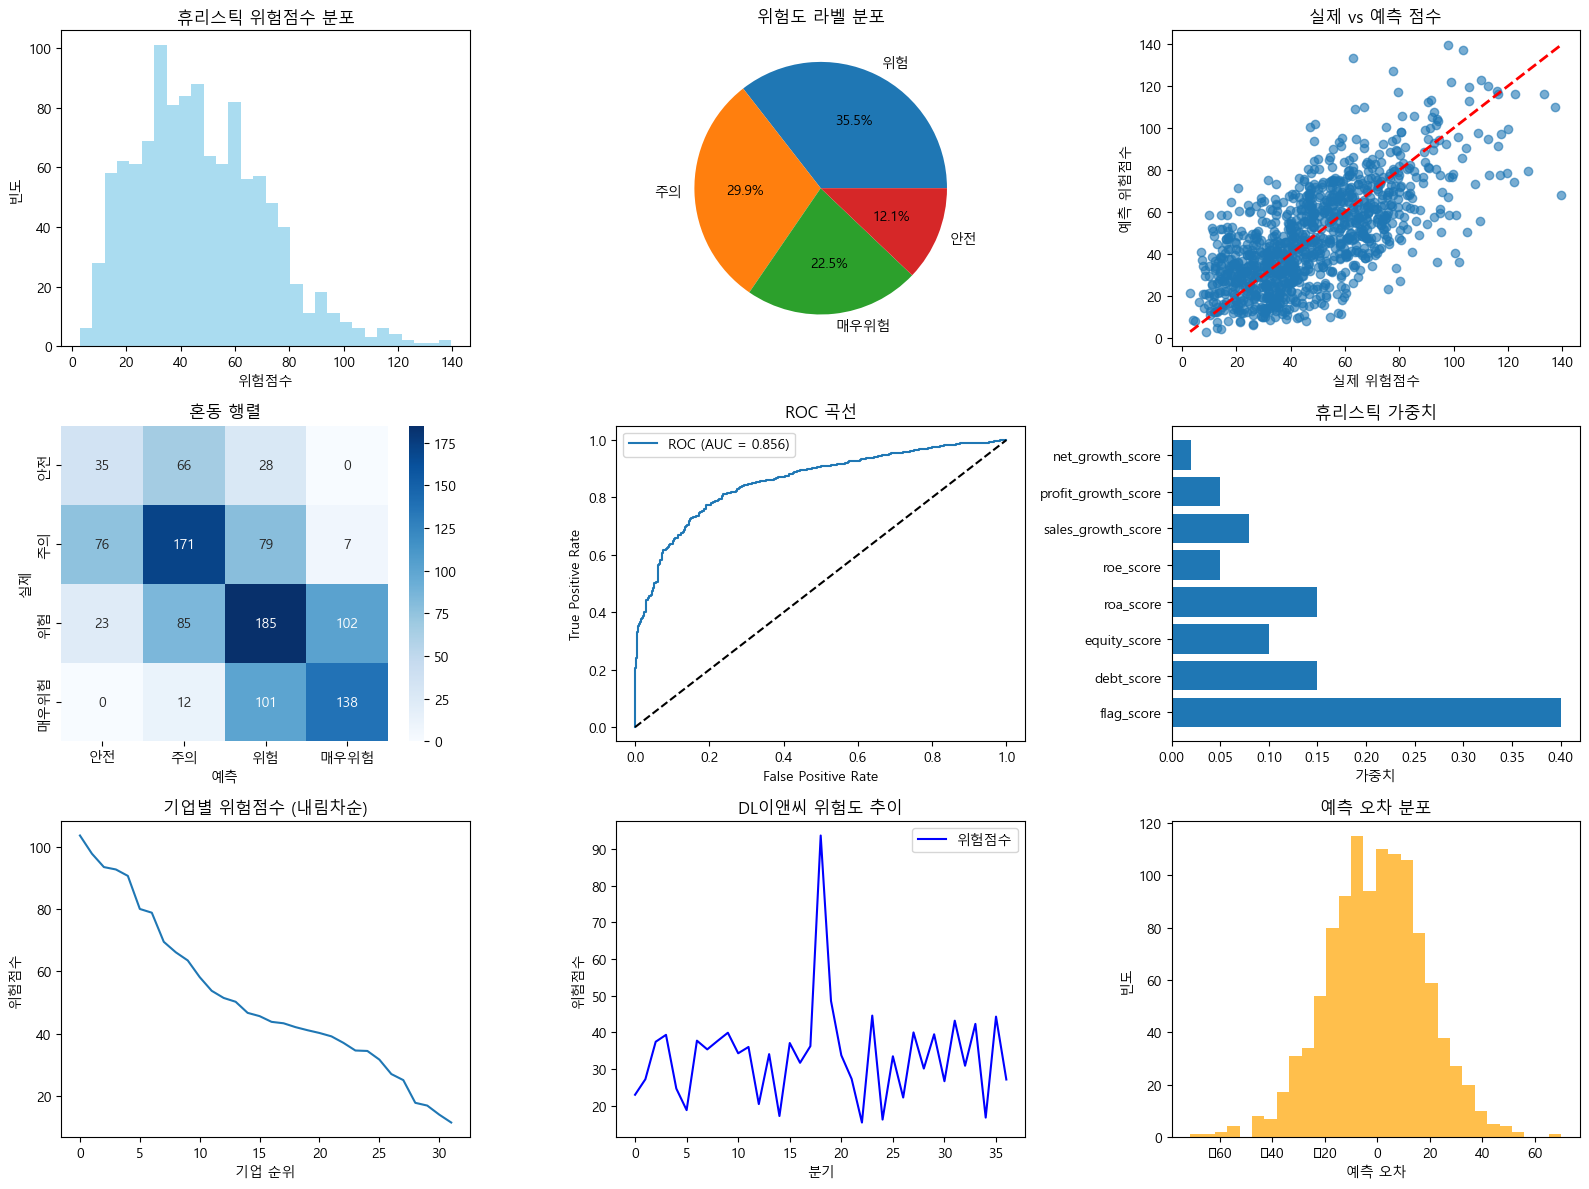

Task 8 완료



In [24]:
#%% ==================================================
# Task 8: 시각화
#%% ==================================================

print("=" * 50)
print("Task 8: 시각화")
print("=" * 50)

plt.figure(figsize=(16, 12))

# 1) 휴리스틱 점수 분포
plt.subplot(3, 3, 1)
plt.hist(df_sorted['heuristic_score'], bins=30, alpha=0.7, color='skyblue')
plt.title('휴리스틱 위험점수 분포')
plt.xlabel('위험점수')
plt.ylabel('빈도')

# 2) 라벨 분포
plt.subplot(3, 3, 2)
label_counts = df_sorted['heuristic_label_name'].value_counts()
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('위험도 라벨 분포')

# 3) 실제 vs 예측 산점도
plt.subplot(3, 3, 3)
plt.scatter(y_true_score, y_score, alpha=0.6)
plt.plot([y_true_score.min(), y_true_score.max()], 
         [y_true_score.min(), y_true_score.max()], 'r--', lw=2)
plt.xlabel('실제 위험점수')
plt.ylabel('예측 위험점수')
plt.title('실제 vs 예측 점수')

# 4) 혼동 행렬 히트맵
plt.subplot(3, 3, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(),
            yticklabels=label_names.values())
plt.title('혼동 행렬')
plt.xlabel('예측')
plt.ylabel('실제')

# 5) ROC 곡선
if len(np.unique(y_true_binary)) > 1:
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_score_binary)
    
    plt.subplot(3, 3, 5)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC 곡선')
    plt.legend()

# 6) 가중치 시각화
plt.subplot(3, 3, 6)
weights = list(heuristic_weights.values())
labels = list(heuristic_weights.keys())
plt.barh(range(len(labels)), weights)
plt.yticks(range(len(labels)), labels)
plt.title('휴리스틱 가중치')
plt.xlabel('가중치')

# 7) 기업별 최신 위험도
plt.subplot(3, 3, 7)
latest_scores = latest_data['heuristic_score'].sort_values(ascending=False)
plt.plot(range(len(latest_scores)), latest_scores)
plt.title('기업별 위험점수 (내림차순)')
plt.xlabel('기업 순위')
plt.ylabel('위험점수')

# 8) 시계열 추이
plt.subplot(3, 3, 8)
company_data = df_sorted[df_sorted['corp_name'] == sample_company]
plt.plot(company_data['heuristic_score'].values, 'b-', label='위험점수')
plt.title(f'{sample_company} 위험도 추이')
plt.xlabel('분기')
plt.ylabel('위험점수')
plt.legend()

# 9) 예측 오차 분포
plt.subplot(3, 3, 9)
errors = y_score - y_true_score
plt.hist(errors, bins=30, alpha=0.7, color='orange')
plt.title('예측 오차 분포')
plt.xlabel('예측 오차')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

print("Task 8 완료\n")

In [ ]:
#%% ==================================================
# Task 9: 결과 저장
#%% ==================================================

print("=" * 50)
print("Task 9: 결과 저장")
print("=" * 50)

# 결과 저장
result_df = df_sorted[[
    'corp_name', 'year', 'quarter',
    'predicted_risk_score', 'risk_score_100', 'predicted_risk_class', 'predicted_risk_name',
    'risk_label', 'risk_label_name', '위험점수'
] + feature_cols + risk_flags].copy()

result_df.to_csv('construction_linear_model_results.csv', index=False, encoding='utf-8-sig')

print(f"결과가 'construction_linear_model_results.csv'에 저장되었습니다.")
print(f"총 {len(result_df)}개 관측치 분석 완료")

# 최종 모델 요약
print(f"\n=== 최종 모델 요약 ===")
print(f"선형회귀 수식:")
print(f"{equation}")
print(f"선형회귀 R²: {r2:.3f}")
print(f"로지스틱회귀 정확도: {accuracy:.3f}")
print(f"학습 데이터 크기: {len(train_df)}")
print(f"예측 가능한 기업: {df_sorted['corp_name'].nunique()}개")

print("\nTask 9 완료: 모든 분석 완료!")
print("=" * 50)